# Elo world 

In this kernel, I build a LGBM model that aggregates the `new_merchant_transactions.csv` and `historical_transactions.csv` tables to the main train table. New features are built by successive grouping on`card_id` and `month_lag`, in order to recover some information from the time serie.

During the competition, I took into account the enlightments provided by others kernels, and included a few features that appeared to be important. In particular, I closely looked at the following kernels (ordered by release time):
1.  [You're Going to Want More Categories [LB 3.737] by Peter Hurford](https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737)
2. [EloDA with Feature Engineering and Stacking by Bojan Tunguz](https://www.kaggle.com/tunguz/eloda-with-feature-engineering-and-stacking)
3. [A Closer Look at Date Variables by Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables)
4. [LGB + FE (LB 3.707) by Konrad Banachewicz](https://www.kaggle.com/konradb/lgb-fe-lb-3-707)
5. [My first kernel (3.699) by Chau Ngoc Huynh](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/)

## Notebook  Content
1. [Loading the data](#1)
1. [Feature engineering](#2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

<a id="1"></a> <br>
## 1. Loading the data

First, we load the `new_merchant_transactions.csv` and `historical_transactions.csv`. In practice, these two files contain the same variables and the difference between the two tables only concern the position with respect to a reference date.  Also, booleans features are made numeric:

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def fillna_with_mode(df):
    """
    Fill NaN values in a DataFrame with the respective column mode (assuming mode is always available).

    Parameters:
    - df: pandas DataFrame

    Returns:
    - DataFrame with NaN values filled with mode
    """
    return df.apply(lambda col: col.fillna(col.mode()[0]), axis=0)

In [4]:
e = pd.read_excel('../input/Data Dictionary.xlsx', sheet_name='train')
e

FileNotFoundError: [Errno 2] No such file or directory: './input/Data Dictionary.xlsx'

In [5]:
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('../input/historical_transactions.csv',
                                      parse_dates=['purchase_date'])


def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
historical_transactions = fillna_with_mode(historical_transactions )
new_transactions = binarize(new_transactions)
new_transactions = fillna_with_mode(new_transactions )

We then load the main files, formatting the dates and extracting the target:

In [6]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df = fillna_with_mode(df)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'], format='%Y-%m')
    reference_date = pd.to_datetime('2018-11-27', format='%Y-%m-%d')
    df['elapsed_time'] = (reference_date - df['first_active_month']).dt.days
    return df
#_________________________________________
train = read_data('../input/train.csv')
test = read_data('../input/test.csv')


In [7]:
train.head()

first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

     target  elapsed_time  
0 -0.820283           544  
1  0.392913           695  
2  0.688056           848  
3  0.142495           452  
4 -0.159749           391

**EDA**

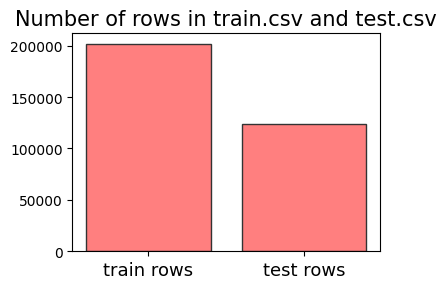

In [8]:
plt.figure(figsize=[4,3])
plt.bar([0, 1], [train.shape[0], test.shape[0]], edgecolor=[0.2]*3, color=(1,0,0,0.5))
plt.xticks([0,1], ['train rows', 'test rows'], fontsize=13)
plt.title('Number of rows in train.csv and test.csv', fontsize=15)
plt.tight_layout()
plt.show()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  201917 non-null  datetime64[ns]
 1   card_id             201917 non-null  object        
 2   feature_1           201917 non-null  int64         
 3   feature_2           201917 non-null  int64         
 4   feature_3           201917 non-null  int64         
 5   target              201917 non-null  float64       
 6   elapsed_time        201917 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 10.8+ MB


In [10]:
train.describe()

first_active_month      feature_1      feature_2  \
count                         201917  201917.000000  201917.000000   
mean   2017-01-15 00:30:16.001624320       3.105311       1.745410   
min              2011-11-01 00:00:00       1.000000       1.000000   
25%              2016-10-01 00:00:00       2.000000       1.000000   
50%              2017-04-01 00:00:00       3.000000       2.000000   
75%              2017-09-01 00:00:00       4.000000       2.000000   
max              2018-02-01 00:00:00       5.000000       3.000000   
std                              NaN       1.186160       0.751362   

           feature_3         target   elapsed_time  
count  201917.000000  201917.000000  201917.000000  
mean        0.565569      -0.393636     680.978981  
min         0.000000     -33.219281     299.000000  
25%         0.000000      -0.883110     452.000000  
50%         1.000000      -0.023437     605.000000  
75%         1.000000       0.765453     787.000000  
max         1.000000      17.965068    2583.000000  
std         0.495683       3.850500     293.710176

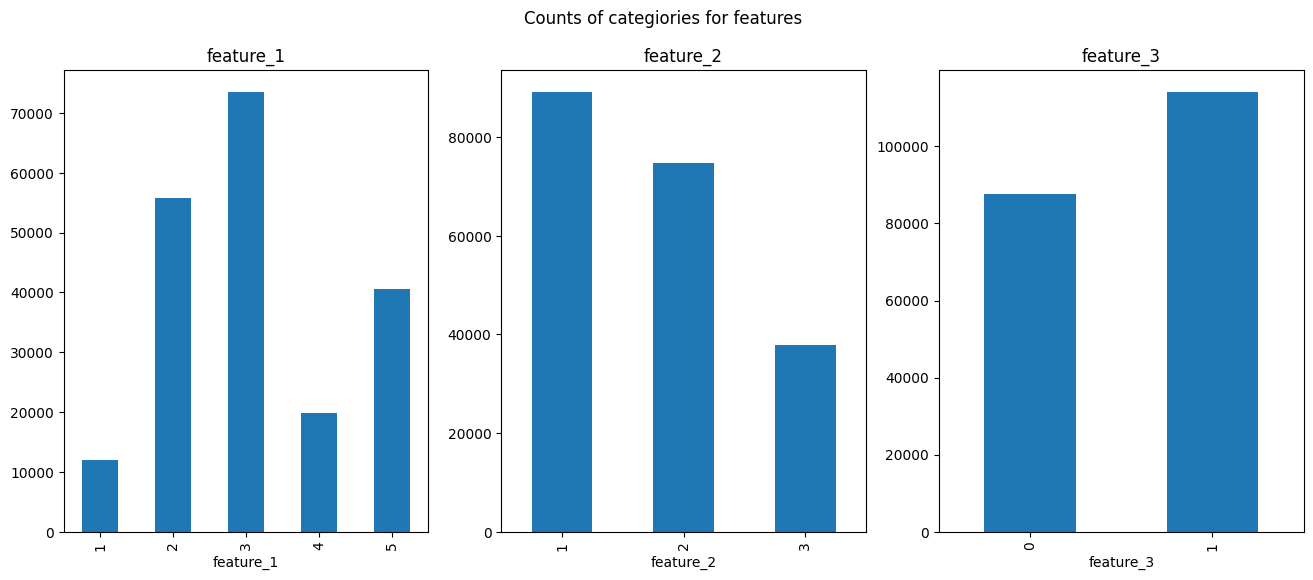

In [11]:
fig, ax = plt.subplots(1,3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], title='feature_3');
plt.suptitle('Counts of categiories for features');

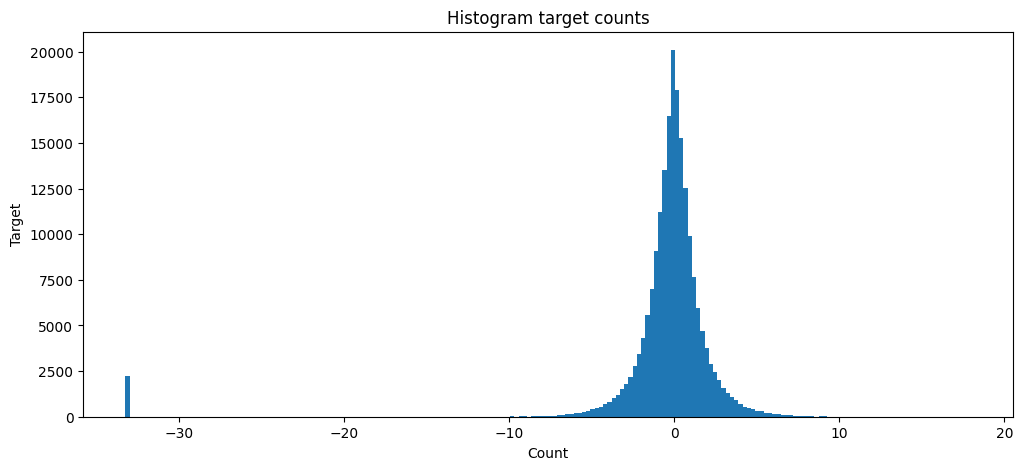

There are 2207 samples in the target equal to -33.21928095.


In [12]:
plt.figure(figsize=(12, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()
print(f'There are {train.loc[train.target  == min(train.target)].shape[0]} samples in the target equal to {min(train.target)}.')

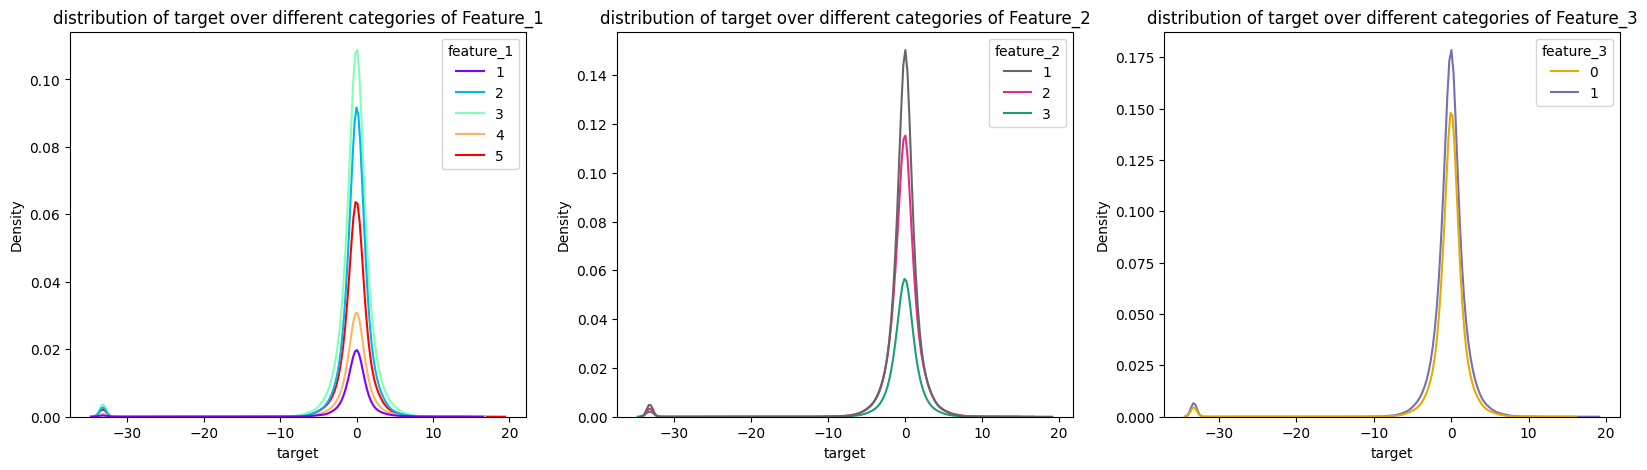

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(131)
sns.kdeplot(x ='target',data = train,hue = 'feature_1',palette='rainbow')
plt.title('distribution of target over different categories of Feature_1')
plt.subplot(132)
sns.kdeplot(x ='target',data = train,hue = 'feature_2',palette='Dark2_r')
plt.title('distribution of target over different categories of Feature_2')
plt.subplot(133)
sns.kdeplot(x ='target',data = train,hue = 'feature_3',palette='Dark2_r')
plt.title('distribution of target over different categories of Feature_3')
plt.show()

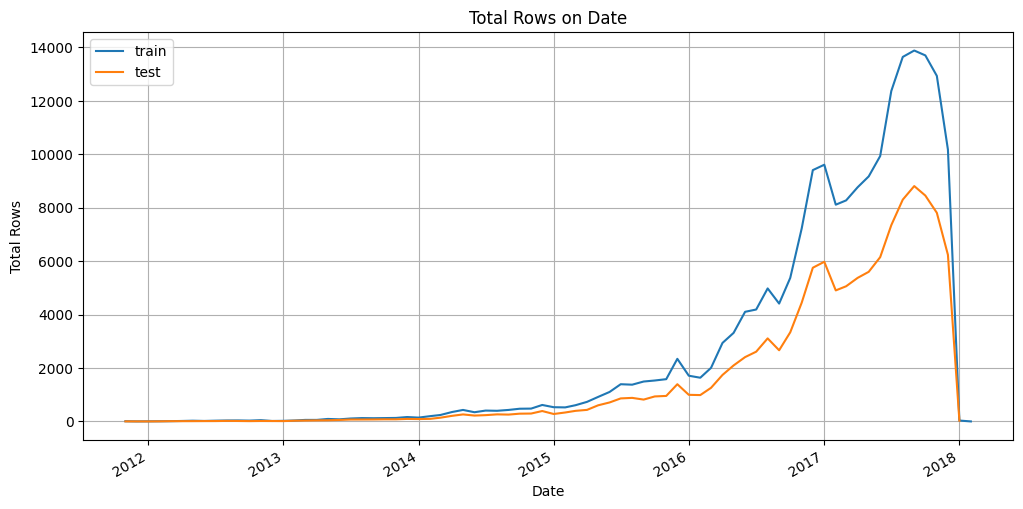

In [14]:
# Group the DataFrame by 'first_active_month' and count the number of rows in each group
date_counts_train = train.groupby('first_active_month').size()
date_counts_test = test.groupby('first_active_month').size()

# Create a time series plot
plt.figure(figsize=(12, 6))
date_counts_train.plot(label='train')
date_counts_test.plot(label='test')
plt.title('Total Rows on Date')
plt.xlabel('Date')
plt.ylabel('Total Rows')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\Liew Kok Leong\AppData\Local\Temp\ipykernel_11496\1903071837.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(range(-1, 15, 2))


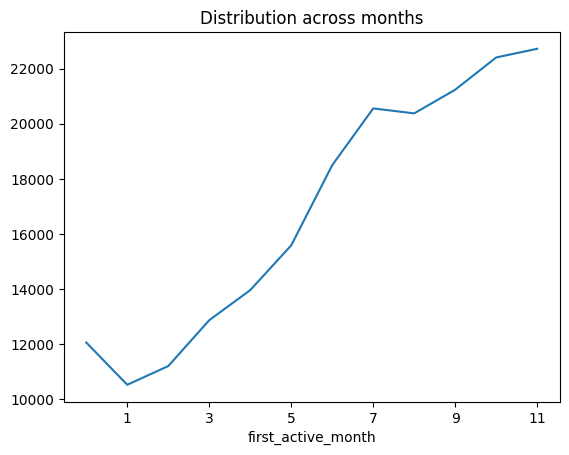

In [15]:
temp = train['first_active_month'].dt.month.value_counts().sort_index()
ax = temp.plot()
_ = ax.set_xticklabels(range(-1, 15, 2))
_ = ax.set_title("Distribution across months")

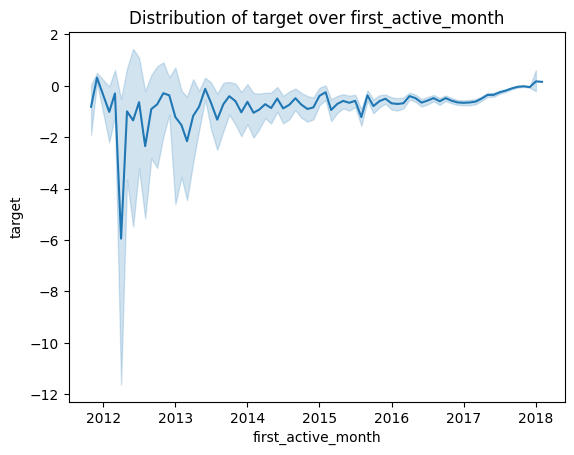

In [16]:
sns.lineplot(x = train['first_active_month'], y= train['target'])
plt.title("Distribution of target over first_active_month")
plt.show()

In [17]:
historical_data = pd.merge(historical_transactions, train[['card_id','target']], how = 'outer', on = 'card_id')

# merging target value of card_id for each transction in new_merchants_transactions Data
new_data =  pd.merge(new_transactions, train[['card_id','target']], how = 'outer', on = 'card_id')

In [18]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       int64         
 1   card_id               object        
 2   city_id               int64         
 3   category_1            int64         
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
 14  target                float64       
dtypes: datetime64[ns](1), float64(3), int64(8), object(3)
memory usage: 3.3+ GB


In [19]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984962 entries, 0 to 1984961
Data columns (total 15 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       float64       
 1   card_id               object        
 2   city_id               float64       
 3   category_1            float64       
 4   installments          float64       
 5   category_3            object        
 6   merchant_category_id  float64       
 7   merchant_id           object        
 8   month_lag             float64       
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              float64       
 13  subsector_id          float64       
 14  target                float64       
dtypes: datetime64[ns](1), float64(11), object(3)
memory usage: 227.2+ MB


Text(0.5, 1.0, 'New Transactions Correlation Matrix')

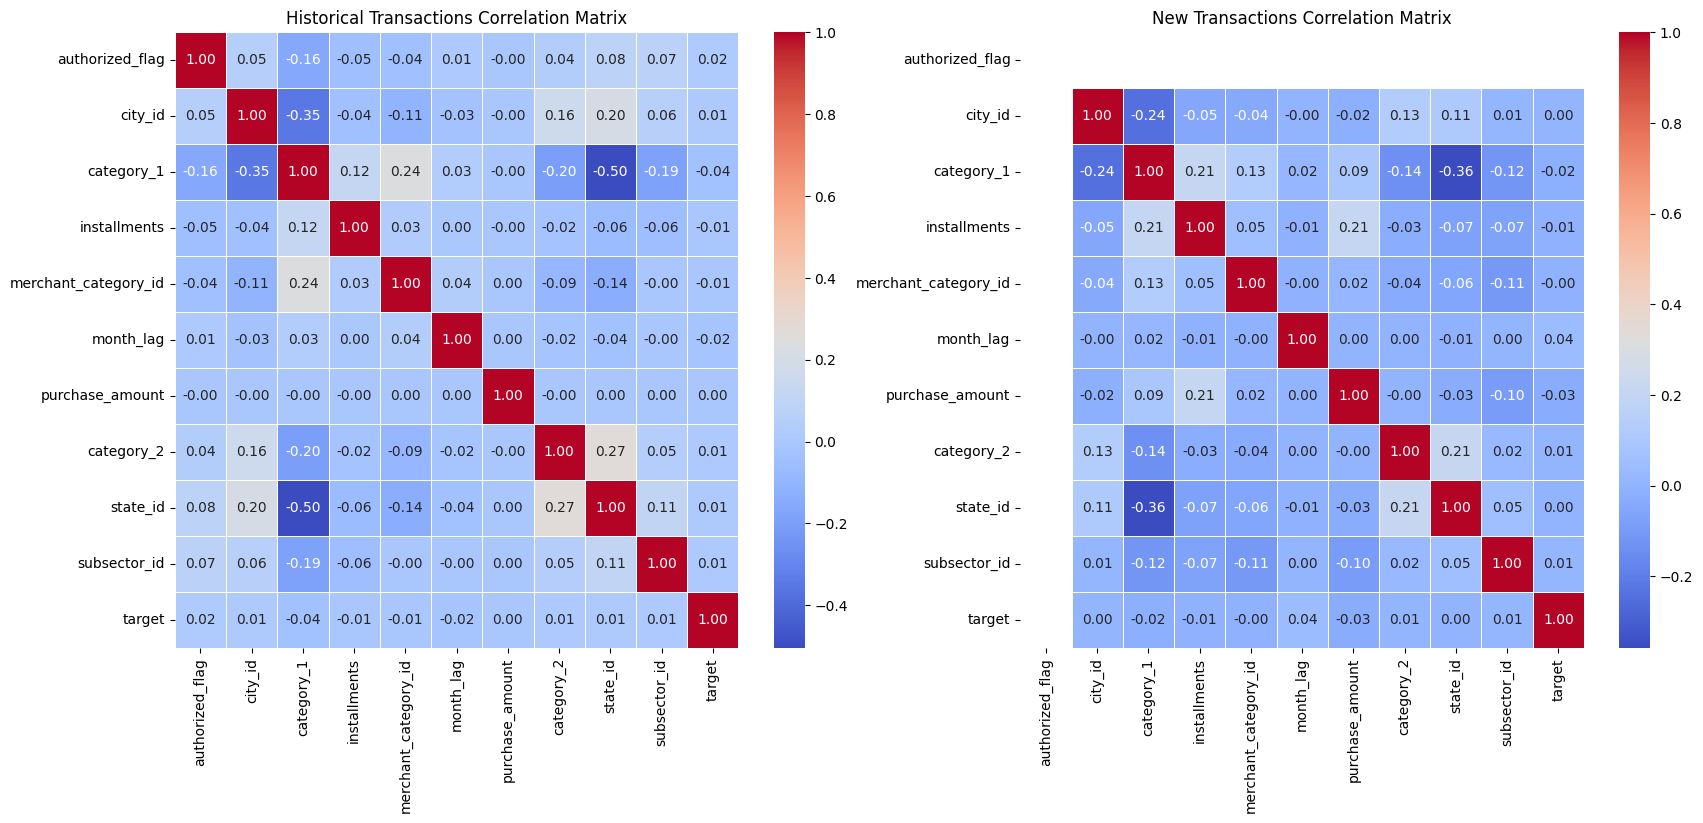

In [20]:
historical_numeric_df = historical_data.select_dtypes(include=['number'])
new_numeric_df = new_data.select_dtypes(include=['number'])

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# First subplot
historical_correlation_matrix = historical_numeric_df .corr()
sns.heatmap(historical_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title('Historical Transactions Correlation Matrix')

# Second subplot
new_correlation_matrix = new_numeric_df.corr()
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title('New Transactions Correlation Matrix')

In [21]:
#delete variables for EDA to save momories
del historical_numeric_df,new_numeric_df,fig,axes ,historical_correlation_matrix,new_correlation_matrix,historical_data,new_data ,temp,ax,date_counts_train,date_counts_test

<a id="2"></a> <br>
## Feature engineering
Following [Chau Ngoc Huynh's kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/), I add the following features:

In [ ]:
e = pd.read_excel('../input/Data_Dictionary.xlsx', sheet_name='history')
e

FileNotFoundError: [Errno 2] No such file or directory: '../input/Data_Dictionary.xlsx'

In [22]:
target = train['target']
del train['target']

In [23]:
datetime.datetime.today()
datetime.datetime(2018, 11, 27)

datetime.datetime(2018, 11, 27, 0, 0)

In [24]:
historical_transactions['month_diff'] = ((datetime.datetime(2018, 11, 27) - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime(2018, 11, 27) - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

#hoidays source https://www.officeholidays.com/countries/brazil/2017 , https://www.officeholidays.com/countries/brazil/2018 
#including Christmas Eve, New Year's Eve and Black Awareness Day
holiday_dates = pd.to_datetime( ['01-01-2017','27-02-2017','28-02-2017','01-02-2017','14-04-2017','21-04-2017','01-05-2017','15-06-2017','07-09-2017',
                    '12-10-2017','01-11-2017','02-11-2017','15-11-2017','20-11-2017','24-12-2017','25-12-2017','31-12-2017',
                    '01-01-2018', '12-02-2018', '13-02-2018','30-03-2018','21-04-2018','01-05-2018','31-05-2018','07-09-2018',
                    '12-10-2018','02-11-2018','15-11-2018','20-11-2018','24-12-2018','25-12-2018','31-12-2018'] ,format="%d-%m-%Y")

historical_transactions["holiday_purchase"] = np.where(historical_transactions["purchase_date"].isin(holiday_dates) , 1, 0)
new_transactions["holiday_purchase"] = np.where(new_transactions["purchase_date"].isin(holiday_dates) , 1, 0)

In [25]:
new_transactions.head()

authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_415bb3a509      107           0             1   
1                1  C_ID_415bb3a509      140           0             1   
2                1  C_ID_415bb3a509      330           0             1   
3                1  C_ID_415bb3a509       -1           1             1   
4                1  C_ID_ef55cf8d4b       -1           1             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   307  M_ID_b0c793002c          1   
1          B                   307  M_ID_88920c89e8          1   
2          B                   507  M_ID_ad5237ef6b          2   
3          B                   661  M_ID_9e84cda3b1          1   
4          B                   166  M_ID_3c86fa3831          1   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0        -0.557574 2018-03-11 14:57:36         1.0         9            19   
1        -0.569580 2018-03-19 18:53:37         1.0         9            19   
2        -0.551037 2018-04-26 14:08:44         1.0         9            14   
3        -0.671925 2018-03-07 09:43:21         1.0        -1             8   
4        -0.659904 2018-03-22 21:07:53         1.0        -1            29   

   month_diff  holiday_purchase  
0           9                 0  
1           9                 0  
2           9                 0  
3           9                 0  
4           9                 0

In [26]:
historical_transactions[:5]

authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_4e6213e9bc       88           0             0   
1                1  C_ID_4e6213e9bc       88           0             0   
2                1  C_ID_4e6213e9bc       88           0             0   
3                1  C_ID_4e6213e9bc       88           0             0   
4                1  C_ID_4e6213e9bc       88           0             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0        -0.703331 2017-06-25 15:33:07         1.0        16            37   
1        -0.733128 2017-07-15 12:10:45         1.0        16            16   
2        -0.720386 2017-08-09 22:04:29         1.0        16            37   
3        -0.735352 2017-09-02 10:06:26         1.0        16            34   
4        -0.722865 2017-03-10 01:14:19         1.0        16            37   

   month_diff  holiday_purchase  
0           9                 0  
1           9                 0  
2           9                 0  
3          10                 0  
4           9                 0

In [27]:

#Convert categorical variable into dummy/indicator variables.
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])


historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)


agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)


authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1360.42 Mb (57.8% reduction)
Mem. usage decreased to 87.99 Mb (59.5% reduction)


In [28]:
historical_transactions[:5] 

authorized_flag          card_id  city_id  category_1  installments  \
115                0  C_ID_4e6213e9bc       88           0             0   
132                0  C_ID_4e6213e9bc       88           0             0   
148                0  C_ID_4e6213e9bc       88           0             0   
168                0  C_ID_4e6213e9bc      333           0             0   
213                0  C_ID_4e6213e9bc       88           0             0   

     merchant_category_id      merchant_id  month_lag  purchase_amount  \
115                   842  M_ID_22c9cfa265        -10        -0.730379   
132                   367  M_ID_86ec983688         -5        -0.723782   
148                   367  M_ID_86ec983688         -5        -0.723782   
168                   605  M_ID_c2ae34c2ef          0        -0.664262   
213                   560  M_ID_e6d5ae8ea6         -7        -0.738132   

          purchase_date  state_id  subsector_id  month_diff  holiday_purchase  \
115 2017-04-07 12:58:09        16            37           9                 0   
132 2017-09-17 22:40:27        16            16           9                 0   
148 2017-09-17 22:40:26        16            16           9                 0   
168 2018-02-20 10:57:50         9             2           9                 0   
213 2017-07-08 07:33:31        16            34           9                 0   

     category_2_1.0  category_2_2.0  category_2_3.0  category_2_4.0  \
115            True           False           False           False   
132            True           False           False           False   
148            True           False           False           False   
168            True           False           False           False   
213            True           False           False           False   

     category_2_5.0  category_3_A  category_3_B  category_3_C  
115           False          True         False         False  
132           False          True         False         False  
148           False          True         False         False  
168           False          True         False         False  
213           False          True         False         False

In [29]:
authorized_transactions.head()

authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_4e6213e9bc       88           0             0   
1                1  C_ID_4e6213e9bc       88           0             0   
2                1  C_ID_4e6213e9bc       88           0             0   
3                1  C_ID_4e6213e9bc       88           0             0   
4                1  C_ID_4e6213e9bc       88           0             0   

   merchant_category_id      merchant_id  month_lag  purchase_amount  \
0                    80  M_ID_e020e9b302         -8        -0.703331   
1                   367  M_ID_86ec983688         -7        -0.733128   
2                    80  M_ID_979ed661fc         -6        -0.720386   
3                   560  M_ID_e6d5ae8ea6         -5        -0.735352   
4                    80  M_ID_e020e9b302        -11        -0.722865   

        purchase_date  state_id  subsector_id  month_diff  holiday_purchase  \
0 2017-06-25 15:33:07        16            37           9                 0   
1 2017-07-15 12:10:45        16            16           9                 0   
2 2017-08-09 22:04:29        16            37           9                 0   
3 2017-09-02 10:06:26        16            34          10                 0   
4 2017-03-10 01:14:19        16            37           9                 0   

   category_2_1.0  category_2_2.0  category_2_3.0  category_2_4.0  \
0            True           False           False           False   
1            True           False           False           False   
2            True           False           False           False   
3            True           False           False           False   
4            True           False           False           False   

   category_2_5.0  category_3_A  category_3_B  category_3_C  
0           False          True         False         False  
1           False          True         False         False  
2           False          True         False         False  
3           False          True         False         False  
4           False          True         False         False

First, following [Robin Denz](https://www.kaggle.com/denzo123/a-closer-look-at-date-variables) analysis, I define a few dates features:

In [30]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

Then I define two functions that aggregate the info contained in these two tables. The first function aggregates the function by grouping on `card_id`:

In [31]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['count','sum', 'mean'],
    'category_2_1.0': ['count','sum','mean'],
    'category_2_2.0': ['count','sum','mean'],
    'category_2_3.0': ['count','sum','mean'],
    'category_2_4.0': ['count','sum','mean'],
    'category_2_5.0': ['count','sum','mean'],
    'category_3_A': ['count','sum','mean'],
    'category_3_B': ['count','sum','mean'],
    'category_3_C': ['count','sum','mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean','max', 'min', 'std'],
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history



In [32]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

card_id  hist_transactions_count  hist_category_1_count  \
0  C_ID_00007093c1                       35                     35   
1  C_ID_0001238066                        3                      3   
2  C_ID_0001506ef0                        4                      4   
3  C_ID_0001793786                       27                     27   
4  C_ID_000183fdda                        7                      7   

   hist_category_1_sum  hist_category_1_mean  hist_category_2_1.0_count  \
0                    4              0.114286                         35   
1                    0              0.000000                          3   
2                    0              0.000000                          4   
3                    2              0.074074                         27   
4                    0              0.000000                          7   

   hist_category_2_1.0_sum  hist_category_2_1.0_mean  \
0                        4                  0.114286   
1                        1                  0.333333   
2                        0                  0.000000   
3                       16                  0.592593   
4                        0                  0.000000   

   hist_category_2_2.0_count  hist_category_2_2.0_sum  \
0                         35                        0   
1                          3                        0   
2                          4                        0   
3                         27                        8   
4                          7                        0   

   hist_category_2_2.0_mean  hist_category_2_3.0_count  \
0                  0.000000                         35   
1                  0.000000                          3   
2                  0.000000                          4   
3                  0.296296                         27   
4                  0.000000                          7   

   hist_category_2_3.0_sum  hist_category_2_3.0_mean  \
0                       31                  0.885714   
1                        0                  0.000000   
2                        4                  1.000000   
3                        3                  0.111111   
4                        7                  1.000000   

   hist_category_2_4.0_count  hist_category_2_4.0_sum  \
0                         35                        0   
1                          3                        0   
2                          4                        0   
3                         27                        0   
4                          7                        0   

   hist_category_2_4.0_mean  hist_category_2_5.0_count  \
0                       0.0                         35   
1                       0.0                          3   
2                       0.0                          4   
3                       0.0                         27   
4                       0.0                          7   

   hist_category_2_5.0_sum  hist_category_2_5.0_mean  hist_category_3_A_count  \
0                        0                  0.000000                       35   
1                        2                  0.666667                        3   
2                        0                  0.000000                        4   
3                        0                  0.000000                       27   
4                        0                  0.000000                        7   

   hist_category_3_A_sum  hist_category_3_A_mean  hist_category_3_B_count  \
0                      0                0.000000                       35   
1                      0                0.000000                        3   
2                      3                0.750000                        4   
3                     22                0.814815                       27   
4                      0                0.000000                        7   

   hist_category_3_B_sum  hist_category_3_B_mean  hist_category_3_C_count  \
0                     29                0.828571      

In [33]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

card_id  auth_transactions_count  auth_category_1_count  \
0  C_ID_00007093c1                      114                    114   
1  C_ID_0001238066                      120                    120   
2  C_ID_0001506ef0                       62                     62   
3  C_ID_0001793786                      189                    189   
4  C_ID_000183fdda                      137                    137   

   auth_category_1_sum  auth_category_1_mean  auth_category_2_1.0_count  \
0                   24              0.210526                        114   
1                    2              0.016667                        120   
2                    0              0.000000                         62   
3                    0              0.000000                        189   
4                    4              0.029197                        137   

   auth_category_2_1.0_sum  auth_category_2_1.0_mean  \
0                       24                  0.210526   
1                      102                  0.850000   
2                        2                  0.032258   
3                      109                  0.576720   
4                       11                  0.080292   

   auth_category_2_2.0_count  auth_category_2_2.0_sum  \
0                        114                        0   
1                        120                        0   
2                         62                        0   
3                        189                       68   
4                        137                        1   

   auth_category_2_2.0_mean  auth_category_2_3.0_count  \
0                  0.000000                        114   
1                  0.000000                        120   
2                  0.000000                         62   
3                  0.359788                        189   
4                  0.007299                        137   

   auth_category_2_3.0_sum  auth_category_2_3.0_mean  \
0                       89                  0.780702   
1                        0                  0.000000   
2                       60                  0.967742   
3                       12                  0.063492   
4                      124                  0.905109   

   auth_category_2_4.0_count  auth_category_2_4.0_sum  \
0                        114                        0   
1                        120                        0   
2                         62                        0   
3                        189                        0   
4                        137                        0   

   auth_category_2_4.0_mean  auth_category_2_5.0_count  \
0                       0.0                        114   
1                       0.0                        120   
2                       0.0                         62   
3                       0.0                        189   
4                       0.0                        137   

   auth_category_2_5.0_sum  auth_category_2_5.0_mean  auth_category_3_A_count  \
0                        1                  0.008772                      114   
1                       18                  0.150000                      120   
2                        0                  0.000000                       62   
3                        0                  0.000000                      189   
4                        1                  0.007299                      137   

   auth_category_3_A_sum  auth_category_3_A_mean  auth_category_3_B_count  \
0                      0                0.000000                      114   
1                      3                0.025000                      120   
2                     62                1.000000                       62   
3                    189                1.000000                      189   
4                      4                0.029197                      137   

   auth_category_3_B_sum  auth_category_3_B_mean  auth_category_3_C_count  \
0                     96                0.842105      

In [34]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

card_id  new_transactions_count  new_category_1_count  \
0  C_ID_00007093c1                       2                     2   
1  C_ID_0001238066                      26                    26   
2  C_ID_0001506ef0                       2                     2   
3  C_ID_0001793786                      31                    31   
4  C_ID_000183fdda                      11                    11   

   new_category_1_sum  new_category_1_mean  new_category_2_1.0_count  \
0                   0             0.000000                         2   
1                   2             0.076923                        26   
2                   0             0.000000                         2   
3                   0             0.000000                        31   
4                   0             0.000000                        11   

   new_category_2_1.0_sum  new_category_2_1.0_mean  new_category_2_2.0_count  \
0                       1                 0.500000                         2   
1                      23                 0.884615                        26   
2                       0                 0.000000                         2   
3                      17                 0.548387                        31   
4                       0                 0.000000                        11   

   new_category_2_2.0_sum  new_category_2_2.0_mean  new_category_2_3.0_count  \
0                       0                 0.000000                         2   
1                       0                 0.000000                        26   
2                       0                 0.000000                         2   
3                       8                 0.258065                        31   
4                       0                 0.000000                        11   

   new_category_2_3.0_sum  new_category_2_3.0_mean  new_category_2_4.0_count  \
0                       1                  0.50000                         2   
1                       0                  0.00000                        26   
2                       2                  1.00000                         2   
3                       5                  0.16129                        31   
4                      11                  1.00000                        11   

   new_category_2_4.0_sum  new_category_2_4.0_mean  new_category_2_5.0_count  \
0                       0                      0.0                         2   
1                       0                      0.0                        26   
2                       0                      0.0                         2   
3                       0                      0.0                        31   
4                       0                      0.0                        11   

   new_category_2_5.0_sum  new_category_2_5.0_mean  new_category_3_A_count  \
0                       0                 0.000000                       2   
1                       3                 0.115385                      26   
2                       0                 0.000000                       2   
3                       1                 0.032258                      31   
4                       0                 0.000000                      11   

   new_category_3_A_sum  new_category_3_A_mean  new_category_3_B_count  \
0                     0               0.000000                       2   
1                     1               0.038462                      26   
2                     2               1.000000                       2   
3                    31               1.000000                      31   
4                     1               0.090909                      11   

   new_category_3_B_sum  new_category_3_B_mean  new_category_3_C_count  \
0                     2               1.000000                       2   
1                    21               0.807692                      26   
2                     0               0.000000                       2   
3                     0            

The second function first aggregates on the two variables `card_id` and `month_lag`. Then a second grouping is performed to aggregate over time:

In [35]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]


card_id  month_lag_mean  month_lag_std  purchase_amount_count_mean  \
0  C_ID_00007093c1       -6.000000       3.894440                    8.769231   
1  C_ID_0001238066       -2.500000       1.870829                   20.000000   
2  C_ID_0001506ef0       -6.230769       4.225988                    4.769231   
3  C_ID_0001793786       -4.500000       3.027650                   18.900000   
4  C_ID_000183fdda       -2.500000       1.870829                   22.833333   
5  C_ID_00024e244b       -6.384615       4.330867                    4.076923   
6  C_ID_0002709b5a       -5.000000       3.316625                    6.090909   
7  C_ID_00027503e2       -4.000000       2.738613                    2.666667   
8  C_ID_000298032a       -5.250000       4.334249                    3.500000   
9  C_ID_0002ba3c2e       -4.666667       3.141125                    9.166667   

   purchase_amount_count_std  purchase_amount_sum_mean  \
0                   3.539158                 -4.803313   
1                  11.696153                -11.776212   
2                   4.342692                 -2.438161   
3                  12.160501                 -2.496068   
4                   7.167054                -11.316093   
5                   4.290717                 -2.557396   
6                   3.505839                 -3.994622   
7                   1.224745                 -1.974976   
8                   1.772811                 -1.844563   
9                   4.665476                 -5.843051   

   purchase_amount_sum_std  purchase_amount_mean_mean  \
0                 2.175011                  -0.536131   
1                 6.676914                  -0.603215   
2                 2.902502                  -0.446660   
3                 4.018810                  -0.005687   
4                 4.800612                  -0.489227   
5                 2.089708                  -0.685118   
6                 2.440540                  -0.638637   
7                 0.909524                  -0.740077   
8                 0.699127                  -0.590214   
9                 3.021165                  -0.638037   

   purchase_amount_mean_std  purchase_amount_min_mean  \
0                  0.075418                 -0.702649   
1                  0.046045                 -0.730351   
2                  0.271125                 -0.725724   
3                  0.271221                 -0.646277   
4                  0.141015                 -0.728405   
5                  0.071894                 -0.728885   
6                  0.060836                 -0.700104   
7                  0.002424                 -0.742206   
8                  0.168008                 -0.686623   
9                  0.044976                 -0.721448   

   purchase_amount_min_std  purchase_amount_max_mean  purchase_amount_max_std  \
0                 0.041293                 -0.126683                 0.446167   
1                 0.002699                 -0.160977                 0.485869   
2                 0.011212                  0.161333                 0.748701   
3                 0.166230                  2.190924                 1.290775   
4                 0.009876                  1.151797                 1.062785   
5                 0.016051                 -0.425292                 0.813979   
6                 0.030670                 -0.546063                 0.092512   
7                 0.003025                 -0.737762                 0.002652   
8                 0.020383                 -0.210304                 1.127668   
9                 0.026047                 -0.387276                 0.222295   

   purchase_amount_std_mean  purchase_amount_std_std  installments_count_mean  \
0                  0.197339                 0.120199                 8.769231   
1                  0.151393                 0.093832                20.000000   
2                  0.496308                 0.415117                 4.769231   
3       

In [36]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u



In [37]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')



In [38]:
#Grouping month lag data (auth month-13, auth month-12 and etc.) for count purchases, and sum adjusted purchase_amount, std, min, max)

def aggregate_date(history):

    grouped = history.groupby(['card_id','purchase_date'])

    agg_func = {
            'purchase_amount': ['sum', 'mean', 'min', 'max', 'std'],
            'installments': ['sum', 'mean', 'min', 'max', 'std'],
             }
 

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]

    intermediate_group.reset_index(inplace=True)
    final_group = intermediate_group.groupby('card_id').agg(['mean','std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
x =  aggregate_date(historical_transactions) 
x[:10]


card_id  purchase_date_mean  purchase_date_std  \
0  C_ID_00007093c1        1.502751e+09       9.092175e+06   
1  C_ID_0001238066        1.515863e+09       2.083731e+06   
2  C_ID_0001506ef0        1.511659e+09       1.031806e+07   
3  C_ID_0001793786        1.498788e+09       6.491738e+06   
4  C_ID_000183fdda        1.504129e+09       2.262857e+06   
5  C_ID_00024e244b        1.506548e+09       8.501619e+06   
6  C_ID_0002709b5a        1.504874e+09       1.350371e+07   
7  C_ID_00027503e2        1.504394e+09       6.988880e+06   
8  C_ID_000298032a        1.499012e+09       1.014387e+07   
9  C_ID_0002ba3c2e        1.501473e+09       7.469866e+06   

   purchase_amount_sum_mean  purchase_amount_sum_std  \
0                 -0.411485                 0.430059   
1                 -0.596643                 0.000000   
2                 -0.726445                 0.016203   
3                 -0.437975                 0.498150   
4                 -0.134483                 0.452741   
5                 -0.488624                 0.415206   
6                 -0.619783                 0.135662   
7                 -0.741570                 0.003383   
8                 -0.617958                 0.093896   
9                 -0.618979                 0.105717   

   purchase_amount_mean_mean  purchase_amount_mean_std  \
0                  -0.411485                  0.430059   
1                  -0.596643                  0.000000   
2                  -0.726445                  0.016203   
3                  -0.437975                  0.498150   
4                  -0.134483                  0.452741   
5                  -0.488624                  0.415206   
6                  -0.619783                  0.135662   
7                  -0.741570                  0.003383   
8                  -0.617958                  0.093896   
9                  -0.618979                  0.105717   

   purchase_amount_min_mean  purchase_amount_min_std  \
0                 -0.411485                 0.430059   
1                 -0.596643                 0.000000   
2                 -0.726445                 0.016203   
3                 -0.437975                 0.498150   
4                 -0.134483                 0.452741   
5                 -0.488624                 0.415206   
6                 -0.619783                 0.135662   
7                 -0.741570                 0.003383   
8                 -0.617958                 0.093896   
9                 -0.618979                 0.105717   

   purchase_amount_max_mean  purchase_amount_max_std  \
0                 -0.411485                 0.430059   
1                 -0.596643                 0.000000   
2                 -0.726445                 0.016203   
3                 -0.437975                 0.498150   
4                 -0.134483                 0.452741   
5                 -0.488624                 0.415206   
6                 -0.619783                 0.135662   
7                 -0.741570                 0.003383   
8                 -0.617958                 0.093896   
9                 -0.618979                 0.105717   

   purchase_amount_std_mean  purchase_amount_std_std  installments_sum_mean  \
0                       NaN                      NaN               1.285714   
1                       NaN                      NaN               1.000000   
2                       NaN                      NaN               0.250000   
3                       NaN                      NaN               0.185185   
4                       NaN                      NaN               2.714286   
5                       NaN                      NaN               0.294118   
6                       NaN                      NaN               1.833333   
7                       NaN                      NaN               0.000000   
8                       NaN                      NaN               0.000000   
9                       NaN                      NaN       

In [39]:
y =  aggregate_date(authorized_transactions) 

<a id="3"></a> <br>
## 3. Training the model
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [40]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, x, on='card_id', how='left')
test = pd.merge(test,x, on='card_id', how='left')

train = pd.merge(train, y, on='card_id', how='left')
test = pd.merge(test,y, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [41]:
train['transactions_ratio'] = train['new_transactions_count'] / train['hist_transactions_count']
test['transactions_ratio'] = test['new_transactions_count'] / test['hist_transactions_count']

and to define the features we want to keep to train the model. For that purpose, I use the results obtained in the [Selecting features kernel](https://www.kaggle.com/fabiendaniel/selecting-features/notebook):

In [42]:

features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
cols_remove = ['card_id', 'first_active_month']
for col in cols_remove:  
    del train[col]

del test['first_active_month']

In [43]:
numerical = [var for var in train.columns if train[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

# Get discrete var
discrete= []
for var in numerical:
    if len(train[var].unique())<8:
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

continuous = [var for var in numerical if var not in discrete and var not in ['card_id', 'first_active_month','target']]
print('There are {} continuous variables'.format(len(continuous)))

There are 266 numerical variables
There are 5 discrete variables
There are 261 continuous variables


In [44]:
categorical_feats =discrete

In [45]:
for col in features:
    if col in continuous:
        train[col] = train[col].fillna(value = train[col].mean())
        test[col] = test[col].fillna(value = test[col].mean())


c:\Users\Liew Kok Leong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
c:\Users\Liew Kok Leong\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Liew Kok Leong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan


In [46]:
from sklearn.impute import SimpleImputer
import numpy as np
train_null = train.columns[train.isnull().any()].tolist()
test_null = test.columns[test.isnull().any()].tolist()

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train[train_null] =imp.fit_transform(train[train_null])
test[test_null] =imp.fit_transform(test[test_null])

We then set the hyperparameters of the LGBM model, these parameters are obtained by an [bayesian optimization done in another kernel](https://www.kaggle.com/fabiendaniel/hyperparameter-tuning/edit):

In [47]:
from sklearn.model_selection import RepeatedKFold,StratifiedKFold
from sklearn.linear_model import Ridge, BayesianRidge
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2023)
oof_ridge = np.zeros(train.shape[0])
predictions_ridge = np.zeros(test.shape[0])

tst_data = test.copy()
tst_data.fillna((tst_data.mean()), inplace=True)

tst_data = tst_data[features].values

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target)):
    print("fold n°{}".format(fold_+1))
    trn_data, trn_y = train.iloc[trn_idx][features], target.iloc[trn_idx].values
    val_data, val_y = train.iloc[val_idx][features], target.iloc[val_idx].values
    
    trn_data.fillna((trn_data.mean()), inplace=True)
    val_data.fillna((val_data.mean()), inplace=True)
    
    trn_data = trn_data.values
    val_data = val_data.values

    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_ridge[val_idx] = clf.predict(val_data)
    predictions_ridge += clf.predict(tst_data) / 10

np.save('oof_ridge', oof_ridge)
np.save('predictions_ridge', predictions_ridge)
np.sqrt(mean_squared_error(target.values, oof_ridge))

c:\Users\Liew Kok Leong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1488: RuntimeWarning: overflow encountered in cast
  return count.astype(dtype, copy=False)


TypeError: Could not convert ['C_ID_0ab67a22abC_ID_130fd0cbddC_ID_b709037bc5C_ID_d27d835a9fC_ID_2b5e3df5c2C_ID_5814b4f13cC_ID_a1b3c75277C_ID_f7cada36d3C_ID_9d2bc8dfc4C_ID_6d8dba8475C_ID_4859ac9ed5C_ID_0e281e8ad6C_ID_8375dfdaa2C_ID_79d149c008C_ID_7f1041e8e1C_ID_f72513589eC_ID_a7f2d6984eC_ID_15489b42d3C_ID_e457bbd71dC_ID_3f74e10c7eC_ID_48243da9c4C_ID_7ea1fcf117C_ID_22e4a47c72C_ID_5d30729184C_ID_b54cfad8b2C_ID_4b82e26faaC_ID_60a453531aC_ID_0c9315feecC_ID_1e28804d36C_ID_68de79f7e2C_ID_78dedf0d70C_ID_83e740197fC_ID_e6340286bdC_ID_5005a6ad0eC_ID_b00860b6a5C_ID_c595ba6d92C_ID_09ad76147dC_ID_041f478878C_ID_8eaa79db4fC_ID_74ff4fdd9dC_ID_2558bddd83C_ID_5077e2007aC_ID_66715f7d2bC_ID_f27972fa70C_ID_8f62bd5ac0C_ID_40a2412baeC_ID_57940f34adC_ID_8f9dc072c4C_ID_11ca664f8cC_ID_50ad1cb064C_ID_e9771fd0b3C_ID_df2ae73120C_ID_fddf997091C_ID_8202301cc0C_ID_4828164a6eC_ID_4154bc963bC_ID_0f68113888C_ID_f9c5ec1112C_ID_59406e1778C_ID_9119618513C_ID_c37f1dacc3C_ID_06a7a6f70dC_ID_4ef8177b42C_ID_f7453d5126C_ID_038b1f5193C_ID_7b3f35325fC_ID_e3315cf124C_ID_5a3419552fC_ID_17cb2f55f2C_ID_bfbffbec95C_ID_812e419644C_ID_ac88d17815C_ID_562a791678C_ID_a2e5f3b899C_ID_5a66e302eaC_ID_215dd2acfdC_ID_ef5198fe59C_ID_751e3800a5C_ID_fa6b4db855C_ID_771d1cb4c1C_ID_338bed6617C_ID_d580357116C_ID_ba0303353cC_ID_348cbde97cC_ID_1120541741C_ID_b320fc81e5C_ID_89c020292eC_ID_e1dbc78edaC_ID_a266b0afb1C_ID_690962095cC_ID_b75c4e1c94C_ID_df503a36aeC_ID_00b966c727C_ID_af9e0d2367C_ID_a9935875b9C_ID_5078eaf301C_ID_69800fbc34C_ID_2b8decb6a3C_ID_2326cc45b0C_ID_a693c8ab8cC_ID_931670b20cC_ID_f9acbb44b5C_ID_403d457c52C_ID_d5467ab0b6C_ID_ca39dff1d6C_ID_2a122c5394C_ID_38a83f816fC_ID_aed043274dC_ID_97c1de0a4cC_ID_6302a73978C_ID_13aa77acc7C_ID_8ea1ccd74cC_ID_f8dd617397C_ID_18abe17a50C_ID_ca9bf15ecfC_ID_ffbb1f9527C_ID_9e30b550edC_ID_ca321cca06C_ID_12ee8ab17aC_ID_d543e00469C_ID_91e960d08fC_ID_876bf4bea6C_ID_bca9fd7a34C_ID_ce489f86d1C_ID_a2f1f4964dC_ID_c5526b4a82C_ID_a51d58a5efC_ID_2ea4c3f269C_ID_0ad663712dC_ID_9f205b643cC_ID_a23d5b907fC_ID_fce231c8a3C_ID_fd3c643078C_ID_0aaa962d5eC_ID_51c466eebaC_ID_4cf0a6c713C_ID_dac6ff5b70C_ID_84d7bf1269C_ID_e1e8acdab6C_ID_4ab54b988fC_ID_45e2cac501C_ID_c55808f402C_ID_c26381a58eC_ID_6c6fc27f19C_ID_4c2682fb80C_ID_79713b508aC_ID_77a9133536C_ID_764456eb02C_ID_9189dadc72C_ID_f1c0aa6f3cC_ID_0763171db6C_ID_c554360bfeC_ID_cfb87f52aeC_ID_d99a6ea9e0C_ID_7fa0d03279C_ID_1571a674c8C_ID_87c16e5496C_ID_e0b7951237C_ID_90c74fe7b4C_ID_7ce9c02b76C_ID_83435bac3dC_ID_439720c321C_ID_10a8a42d77C_ID_a485f8a1a5C_ID_0defe22c13C_ID_95943569e9C_ID_be3c295747C_ID_f9bd6c67b0C_ID_4b2514ee32C_ID_689b430d0bC_ID_5ac4488f3cC_ID_4bf0426f57C_ID_88cb2d5ac7C_ID_9c5220f864C_ID_6bb9e252f4C_ID_8ae58e7880C_ID_619082bf7dC_ID_ba95ae9113C_ID_fdfe6133dbC_ID_1a5c4864c0C_ID_7a66376702C_ID_325049a5b3C_ID_5c3a6a254bC_ID_768a62fd67C_ID_8280ac022cC_ID_0621c41948C_ID_c97d368d54C_ID_a69568da79C_ID_3fc03e96d3C_ID_79f510402aC_ID_d0e20268c6C_ID_237bc2b6bcC_ID_738e8c6ad4C_ID_c5b913140bC_ID_dce9ae5c83C_ID_ed8c83ed3bC_ID_fb28b161c5C_ID_94300ba829C_ID_29bb0bb987C_ID_eaf9218e7bC_ID_f6e7db3422C_ID_dbff82eb68C_ID_1d5864081bC_ID_a632cb47deC_ID_92836e8cfdC_ID_715c9ee37cC_ID_8cdc6acec4C_ID_8ca96ad5afC_ID_54301a17f8C_ID_9fcd93541bC_ID_dbc336bad4C_ID_a6af5417f0C_ID_415fc459f1C_ID_e0a857bb94C_ID_ed487096e1C_ID_c3af389f96C_ID_524851647aC_ID_15cec22628C_ID_63cea539d2C_ID_89146fd05aC_ID_ab0d372843C_ID_c8df3dbb28C_ID_2d6553adc3C_ID_eb0cba1af9C_ID_e44fe24b69C_ID_78d7380ceaC_ID_12b823c3ecC_ID_e34f0d110fC_ID_9fb2eea47bC_ID_cf63664338C_ID_1a904c4537C_ID_5f1eda7477C_ID_5089081961C_ID_51d2a202acC_ID_2fa504fb02C_ID_85eba2526eC_ID_45ee340077C_ID_42690c6e70C_ID_abdc9b2ed2C_ID_c85199b76eC_ID_7ffe4bd729C_ID_de06fcb25aC_ID_9e34c32449C_ID_1566603224C_ID_5aff05d6b1C_ID_8711d75f01C_ID_c6c9ad8f81C_ID_179ce6d0faC_ID_b575185e9eC_ID_f652457b4bC_ID_dfedf2f0e1C_ID_37a3826fefC_ID_3850b22223C_ID_f31bd58a7aC_ID_d9d0fe34b0C_ID_a06291166fC_ID_919f809d81C_ID_37ed75f403C_ID_0b371e50b1C_ID_9af1b515e2C_ID_9ff39d9f8fC_ID_29c4e05fbdC_ID_8271c9338eC_ID_9f3c474704C_ID_ec3af28b1bC_ID_f65d4000cfC_ID_71f27e88b6C_ID_68030cf3e9C_ID_45f00b3d45C_ID_70891a0d0cC_ID_3b6d8cafcfC_ID_004885878bC_ID_770c5d6625C_ID_d31c5d136dC_ID_7937c4bbfcC_ID_0cd0945f72C_ID_be0ad9b7ebC_ID_93f59bf677C_ID_6d986296cbC_ID_c4bb8234b4C_ID_eed977f280C_ID_f781a6faa6C_ID_bf905bf168C_ID_52303de7e7C_ID_911e8ffbe0C_ID_80e2d98076C_ID_0a2c2f9f58C_ID_152f65c13dC_ID_8e08777375C_ID_f4d9706702C_ID_251951b363C_ID_69bcef0917C_ID_be968701f8C_ID_b64c326f44C_ID_fe577884d4C_ID_fd23ece68dC_ID_8c482027ccC_ID_6815c3cbb6C_ID_e546f5fb57C_ID_921a1654ddC_ID_4ee8c5fb95C_ID_3162e8711fC_ID_f4837e7c9dC_ID_4ffbfb9edaC_ID_23ba0a2ea7C_ID_48d5ee7ec3C_ID_737bc87c71C_ID_34379f9950C_ID_b1bc7601e7C_ID_895c06b9adC_ID_fbf52e58cdC_ID_3edcb2f37aC_ID_19799f4e7dC_ID_e4575d884fC_ID_07c33a4a6cC_ID_614fd1294cC_ID_5f60de0fbeC_ID_f8334a2af7C_ID_900f77ee89C_ID_78036f1f3cC_ID_3e3690d009C_ID_15967b67cdC_ID_75048175f8C_ID_8abd5523d4C_ID_924940f9a0C_ID_abe97a2768C_ID_d2b41701e6C_ID_6079b41534C_ID_0ef64122dbC_ID_99fe8ffc90C_ID_f1fbafcba2C_ID_2aa82ee67fC_ID_226f7e1fcfC_ID_541f56c580C_ID_2b11143b2dC_ID_9d7e6b0442C_ID_40e4e5d7e6C_ID_19d087b9fcC_ID_94e6fe1eb6C_ID_86e06aaa8fC_ID_8b36dfe26bC_ID_0c71ff8a3dC_ID_4ba3300d9cC_ID_44e2940debC_ID_d886d9d92cC_ID_432fad8d0cC_ID_cfc3efa189C_ID_3d88817301C_ID_ac1e84b7e2C_ID_06a469f094C_ID_967ca675f9C_ID_4b3fad31c5C_ID_9565236fc4C_ID_aaebc8d0eeC_ID_2f1f3ea8c6C_ID_38a6e3512eC_ID_ca8e73ecefC_ID_c02e054febC_ID_f0aebb8ac0C_ID_eb2d23bda4C_ID_027336a1cbC_ID_a4df127591C_ID_b33e0f675eC_ID_c9e6f3c18dC_ID_a1e1912c2aC_ID_a84faa7483C_ID_9563a35a7fC_ID_4e2403e039C_ID_15260b770eC_ID_8a172c0c0dC_ID_c77547481eC_ID_83b5aea1f4C_ID_6270f83f56C_ID_77b17029f0C_ID_4c525e9990C_ID_749f3b1b93C_ID_078f82a791C_ID_cb76fb1021C_ID_c57f1bd5bcC_ID_f4c40ac4f7C_ID_4e20b37a37C_ID_1eb28223c7C_ID_8ed2fd4992C_ID_d78643dfbaC_ID_34841f60d1C_ID_c49b07a4ebC_ID_97e34365faC_ID_1ccdb537c4C_ID_318f5f397bC_ID_3566014e0cC_ID_b36ca5620fC_ID_77fb564437C_ID_54b2846a36C_ID_b3381af031C_ID_02988c4aa5C_ID_3a0b3293a9C_ID_81be2ff8b5C_ID_ca5a78c056C_ID_004afee4c8C_ID_6b5a6490d9C_ID_dd55221656C_ID_ac254c01c1C_ID_6b0ac2784fC_ID_512386b5f4C_ID_00397e567fC_ID_721c9311f2C_ID_e9ec1792bbC_ID_16ecdcf2b0C_ID_e0e4cdfc53C_ID_f7bacba2a6C_ID_4a66bb13a4C_ID_4029e95979C_ID_084e4bc415C_ID_0e6d55e198C_ID_d9584a3eefC_ID_a2020cec79C_ID_82dd0eb44fC_ID_e07f48d910C_ID_b98e08fa85C_ID_50a7f7b582C_ID_614e35f5f9C_ID_65c74bcb80C_ID_6a59ab8b93C_ID_2fe4a13787C_ID_2002264e13C_ID_7d59cd0a0aC_ID_74bfc908d3C_ID_447defddbdC_ID_3d1742ba93C_ID_f4832ba39bC_ID_62aedb76dfC_ID_1ad24f4054C_ID_45b8a92d09C_ID_f38f899c09C_ID_4c7fc71084C_ID_8c9e94b453C_ID_4071f3f254C_ID_dd8ef29568C_ID_5b122cf769C_ID_f685dd6847C_ID_abf6cde369C_ID_2332b4e032C_ID_f59b3b6bb2C_ID_a875715dd5C_ID_dde9fc744dC_ID_0e4f6af077C_ID_5fb87896d5C_ID_c1edb6769cC_ID_0cea064a88C_ID_15cefca902C_ID_ee56d3a693C_ID_3e032d1c6dC_ID_0db57787e6C_ID_61c15762f4C_ID_b913141b00C_ID_eea9f2ef29C_ID_a71db4ee55C_ID_e76a1388bfC_ID_a03ffc05edC_ID_8cdba66bb3C_ID_c75c069d25C_ID_93b958c812C_ID_36d82b4442C_ID_360fba8b39C_ID_86dc239658C_ID_8a141b8fa5C_ID_cd78d27caeC_ID_f3272c91a7C_ID_80c2af4684C_ID_c7acd44d7fC_ID_f3a6263458C_ID_1bbe8f7d6cC_ID_54b0f0f4bcC_ID_805319dcdeC_ID_cde9dcd6d8C_ID_1958bb5e7eC_ID_f171d9f575C_ID_4f475ca4b3C_ID_a4c382a70fC_ID_cdfb1c12e0C_ID_6171b2fbffC_ID_7cc96c7682C_ID_6b6d457a99C_ID_ed6d1338b5C_ID_17b2e43f41C_ID_f35856a259C_ID_de981b200bC_ID_95b1b111cfC_ID_8acb32794cC_ID_fe9f3f6d2dC_ID_e44d853f1bC_ID_ec9ec8bf71C_ID_28405d2baaC_ID_65e8e8d243C_ID_4b8b9c7d69C_ID_a46e2e6eceC_ID_a7d1cd6b7cC_ID_225a5abc31C_ID_593218d660C_ID_c0d4f09669C_ID_d500eb1fc3C_ID_d4db589fc0C_ID_9753d91e5bC_ID_eaf6aee3d8C_ID_04024e939dC_ID_4552210868C_ID_d2d79eae51C_ID_19064fc2e6C_ID_e9ecdac068C_ID_3222ce4b78C_ID_aaf9f16647C_ID_a5c1ae3edaC_ID_9fd254c19aC_ID_ab6451ac5aC_ID_45a7272424C_ID_7e9b4a1150C_ID_c2cff7a02eC_ID_51233cc976C_ID_6773f9bec3C_ID_20e84d59b1C_ID_9e1ce51f50C_ID_865161b242C_ID_7f8b5f6b09C_ID_0b94f181a1C_ID_0302f33b8fC_ID_554b755361C_ID_7e57334cc6C_ID_60c72c2c3aC_ID_b89dd01483C_ID_ca5374a321C_ID_8f9d3e108bC_ID_359291bd41C_ID_bb0cb76ef6C_ID_644b4ac8a4C_ID_53040a8a11C_ID_f874d2a704C_ID_5d91ed4112C_ID_794cba1242C_ID_a29e78e61fC_ID_d6e5994952C_ID_10beb4bb70C_ID_626716fe69C_ID_77dbe57a08C_ID_167522dd91C_ID_f11416b4b2C_ID_8fac1ea9adC_ID_6725d9114fC_ID_63291ef8e8C_ID_2df7089cebC_ID_47251b1d39C_ID_6987979396C_ID_6b20086f1cC_ID_37a125f1b2C_ID_c777351240C_ID_34bf4ce0c8C_ID_6c0d712012C_ID_be2e383ff9C_ID_7b9fb53bd7C_ID_9cac55659dC_ID_c8c081b4b4C_ID_c11976c7c3C_ID_5cf8a47b12C_ID_044a728838C_ID_5543af9094C_ID_1bf9371a0cC_ID_7658e8a511C_ID_3733f45c91C_ID_9737ad2640C_ID_7cd135df49C_ID_d3f9f29690C_ID_b68cb361b6C_ID_8826aad8acC_ID_02bfcd2a89C_ID_74e2b4afaaC_ID_570c45720aC_ID_28721e2548C_ID_77b4a5295fC_ID_f77d9b9363C_ID_294a7efc9cC_ID_ea878ea059C_ID_d891906f01C_ID_c699b737caC_ID_4f994469b2C_ID_ecd78bfd42C_ID_bf9c6e6521C_ID_5b1649cf49C_ID_f5cb867bfbC_ID_c37a157761C_ID_8aaa31d2ffC_ID_76248d4f9eC_ID_e38faf83aeC_ID_e065cf37d3C_ID_babeccf2f8C_ID_7619409e9bC_ID_1a1055f203C_ID_b39fc093e9C_ID_fe694de6d5C_ID_90d4298c15C_ID_616eb9e2a7C_ID_b396a31f08C_ID_0f19aa7bdcC_ID_acfd62662fC_ID_d6169ed844C_ID_4d8cd9ee19C_ID_672ccdd9aaC_ID_6b6974d92aC_ID_69cad65798C_ID_f2951acca9C_ID_98ce282a41C_ID_48461436c4C_ID_c67b515418C_ID_669b969118C_ID_1de37c1871C_ID_1f8bce815dC_ID_6e6b38cdd1C_ID_eed194a76aC_ID_98aea24ae2C_ID_3c336ae2a0C_ID_64d7e12627C_ID_23b0303da7C_ID_749f0fd6c4C_ID_09e183fb2eC_ID_73fb1dae5eC_ID_6fd5929c67C_ID_c1f78ed26cC_ID_77ca7d3439C_ID_3ad47606b4C_ID_d248a9b767C_ID_0ecfde16bcC_ID_6e7676a6faC_ID_f887df96a8C_ID_c06da29075C_ID_0d019aba1bC_ID_a34d2bbdbfC_ID_66422419e7C_ID_aebbc78886C_ID_cbf3c2b584C_ID_1b4509d71eC_ID_98a2ea3f91C_ID_d0f9f78450C_ID_52eb502289C_ID_8207ac8679C_ID_692b99fa6fC_ID_90843b7a94C_ID_cb93ed467aC_ID_0122d12d54C_ID_2bc6e22ca3C_ID_5b35ce96b3C_ID_04d1b535c9C_ID_133f1c32fcC_ID_3f7b6f3d8eC_ID_109a0b0e85C_ID_6ad04db6f0C_ID_f417231338C_ID_ae9db8a856C_ID_af0bc0580fC_ID_f37d2517d8C_ID_88e7427589C_ID_144416ee6fC_ID_074a32ba02C_ID_a05e126aa7C_ID_5d050aa9e1C_ID_51ba2d5135C_ID_af03d43eb6C_ID_75b9883d33C_ID_0b7b51e522C_ID_025a582bd0C_ID_8def3ecd85C_ID_3520de6da3C_ID_34ee53b696C_ID_c1d7694192C_ID_81a412a7baC_ID_3a8b5b68edC_ID_13f3e9e5ceC_ID_5f6082150bC_ID_92a14249eaC_ID_9976a8ffe9C_ID_83342afd60C_ID_875cadb7f5C_ID_97eb6836b7C_ID_bbb8d26140C_ID_66b2103231C_ID_9c11c8f212C_ID_d8837ff165C_ID_cedf04e754C_ID_44d150c95bC_ID_1cf8996ea0C_ID_810898f9b7C_ID_a0e6c48ac8C_ID_e74cf6dd97C_ID_5d7e2c0b6dC_ID_7bd5319112C_ID_0cc0512a9aC_ID_1dff3848d8C_ID_a45d84ca4cC_ID_910450843eC_ID_80acf3e66dC_ID_7dd50a82e0C_ID_96f678c220C_ID_f2a9d168abC_ID_b60dece69eC_ID_189c9c9273C_ID_465e2075ebC_ID_c3f0c16f40C_ID_34e9d87d48C_ID_3f12f3e7afC_ID_abbb3ede6aC_ID_190311449fC_ID_5717269dc7C_ID_f909ce2ff1C_ID_e813cd28f5C_ID_29a5062621C_ID_ad758bd0d9C_ID_5e00a0412dC_ID_0b81c3e4dfC_ID_956d068f56C_ID_33390e7872C_ID_531db931f9C_ID_19bb3e75a8C_ID_1d30638e7eC_ID_3bf856f627C_ID_458dfd5cbbC_ID_7bdd0a93e2C_ID_e1fbd3faaaC_ID_0e15457105C_ID_153e1880e0C_ID_9c195bbad6C_ID_891eff8b3bC_ID_c8b8c69641C_ID_633064552eC_ID_32eada992dC_ID_f33c6d076eC_ID_82d3e739ccC_ID_a92624542cC_ID_53e7e9051eC_ID_5f8c52e4a9C_ID_3d45336180C_ID_5edac7290dC_ID_6dacb97e7bC_ID_d97e8cea4bC_ID_b9434730b4C_ID_ae9d99de5dC_ID_1a42914ca3C_ID_92f792cedbC_ID_e0512a3695C_ID_98e6b17e44C_ID_d4fb3e75adC_ID_912fdf8197C_ID_c056c28ca3C_ID_db2d34feb9C_ID_fe98cfc520C_ID_7a2ef519f1C_ID_41b08073c6C_ID_a1466d042aC_ID_86ffdc7344C_ID_0b71aba11dC_ID_bfe1f4f9cbC_ID_49e04752c8C_ID_82578db89eC_ID_4cb65f71abC_ID_7b7cfcd740C_ID_b3633e0af5C_ID_fe593c40bcC_ID_ec16457608C_ID_0e51b3031dC_ID_e7ad699289C_ID_3c42224b5dC_ID_c3a1cbd338C_ID_0c37a3e102C_ID_35dcb9e483C_ID_ba484beb3fC_ID_28d24f6eacC_ID_2f25d86628C_ID_ab1e24fd53C_ID_4c05d26d47C_ID_321837c17fC_ID_d1ebe50ad7C_ID_a2ed5e108aC_ID_8a175d2a21C_ID_60bc69aa8aC_ID_fbbdcba038C_ID_8c96ed621fC_ID_e8cd9f3f54C_ID_1888494652C_ID_77c23be8cfC_ID_fea67d5431C_ID_34a77af8e7C_ID_3ffa52415dC_ID_de82eaea8cC_ID_7def9572f8C_ID_29ee335c94C_ID_1ad6a99acbC_ID_0df42f639aC_ID_c1c19abe4aC_ID_c1d0f635fcC_ID_d8bf9af9f8C_ID_ca814276adC_ID_66cd141e46C_ID_fbc5db22f2C_ID_4100622a72C_ID_2b288df31cC_ID_21c3d08e8eC_ID_dc27c87451C_ID_f49551e57aC_ID_2aa4650ec6C_ID_1a187f68c1C_ID_83a35c67e9C_ID_7d9bc4b16bC_ID_0eb26e2182C_ID_ab90cf5d8bC_ID_231a94dcc9C_ID_b51e08a3acC_ID_b941e1b91dC_ID_e140330b78C_ID_19b24fc085C_ID_13d2dbf848C_ID_b8d296d569C_ID_af528644cbC_ID_327fe09457C_ID_55ace01451C_ID_fc114f59d0C_ID_ec79f83e4eC_ID_ec0da8ce56C_ID_02ebd47932C_ID_b3838f9fffC_ID_f0cda3aec7C_ID_2e657da60fC_ID_4f2047613fC_ID_8b67e17ee0C_ID_18bbc0b9f7C_ID_5fce6894deC_ID_2c94d5e614C_ID_2f9f68a363C_ID_e9293591b3C_ID_537203f55eC_ID_d2a83923a7C_ID_110994672cC_ID_2416a9cbb9C_ID_a42b42adecC_ID_7215809b01C_ID_23b13451cbC_ID_6ed212d962C_ID_cfaceeccf1C_ID_095cfc2a98C_ID_7df79b016aC_ID_68885b63bfC_ID_83d1ab1a42C_ID_526694cf9dC_ID_a98905790dC_ID_3122af0039C_ID_e88d5c04e6C_ID_430e9c7ed4C_ID_221a6b8418C_ID_3ad7a0afb2C_ID_3658ff1639C_ID_2c4a4d7a0fC_ID_e4c8a528feC_ID_8568542f63C_ID_9d2bfa0fc9C_ID_4597a27c42C_ID_17644e873fC_ID_f465a127a5C_ID_ba3d13ae8eC_ID_2573d09eb7C_ID_bd8a8bc642C_ID_242156a83eC_ID_1cfcf512c2C_ID_b1ad9f445eC_ID_6db27621bcC_ID_7ae06d8aa5C_ID_7e4f96d56aC_ID_9b7701e7a2C_ID_f89a0f3d2aC_ID_005b219e05C_ID_ba471b286aC_ID_f6f16e7ecfC_ID_324b544ba5C_ID_b1ec324d8dC_ID_47ce96e646C_ID_e831a4ca3cC_ID_85a82f2fbeC_ID_241d39d24cC_ID_e288d24b93C_ID_c3be018b6dC_ID_d63091eddfC_ID_3dcd3aa10dC_ID_39a76706d5C_ID_db55a35006C_ID_1a3d28b0e1C_ID_fd4f8a3e01C_ID_3b5b4dbc3aC_ID_14e711f007C_ID_b030bdf593C_ID_a55c1cd6dcC_ID_bbe1b7dad8C_ID_c4caebdef4C_ID_5e0b0323e1C_ID_842c0fe758C_ID_3f2933ada9C_ID_1f439255a3C_ID_f0bc0326daC_ID_e8794e67d0C_ID_df0080f2d6C_ID_f9461fa823C_ID_585da33d91C_ID_a627e714d0C_ID_995233652aC_ID_c8ce41ae68C_ID_b1c7e33e79C_ID_36d0dabdfaC_ID_63f528db23C_ID_66630a155cC_ID_d41f9d835bC_ID_af34c5d053C_ID_f8e8b825b3C_ID_6116fb00ccC_ID_0aff5763baC_ID_9aa0bbc232C_ID_562c8f53fdC_ID_5ff33f8e1cC_ID_e3ba3ff984C_ID_34fa22121cC_ID_2d43d631d7C_ID_aea2d1bf24C_ID_a68951f939C_ID_30924feefdC_ID_0a1aaf9541C_ID_42d4b3630cC_ID_d62357aaafC_ID_3878684153C_ID_c8de29e24fC_ID_adb9be92f2C_ID_0aba8f8641C_ID_9708fe344bC_ID_736861a088C_ID_11ebb5c7f4C_ID_44e528861eC_ID_cd736e466bC_ID_bc349748d7C_ID_46fa443728C_ID_46ca8d6fd7C_ID_8383316c30C_ID_9841483ea9C_ID_2e90fec40eC_ID_c222f7bedcC_ID_d929ef4d05C_ID_5037cfb403C_ID_ec441dae5cC_ID_c89de8f110C_ID_8227f7db9bC_ID_7f887f4a2bC_ID_e0eecabf26C_ID_6bb127ce3eC_ID_3e100cd0c6C_ID_313fe0d5a2C_ID_5cb1c027bbC_ID_e86c66be5dC_ID_be8b785035C_ID_2742d6ac56C_ID_7784a5f99cC_ID_a3cc327c8bC_ID_643909045aC_ID_ca46da7dd9C_ID_761cc72f4aC_ID_82c90ffb8dC_ID_980e5dcbecC_ID_9a55868ff1C_ID_a509d2610eC_ID_23a9704edbC_ID_9c51342801C_ID_7b082ef549C_ID_8793484b70C_ID_65a0fd275cC_ID_339e636305C_ID_a50e55f70dC_ID_3fda88685aC_ID_1e332febdfC_ID_15c691d7f3C_ID_e6641c489bC_ID_46d0a278b9C_ID_6f2507c928C_ID_6b4a1b1bafC_ID_6257bafad8C_ID_1cade0beb1C_ID_0defbecf99C_ID_4079df7ef3C_ID_6902c9dc76C_ID_04a9569efeC_ID_56d52e5886C_ID_2bdc9a1062C_ID_e6b352245aC_ID_6861e03717C_ID_4be55a0699C_ID_2c895819cdC_ID_4f28428b1bC_ID_4ab435dab5C_ID_5e20c1508bC_ID_eef1ec1d9bC_ID_f7380091f7C_ID_cdcb3ebe55C_ID_f60d9fee4fC_ID_c53770e702C_ID_5b6a473f03C_ID_b85e926c4bC_ID_a4cc240dbcC_ID_fc1b69b44cC_ID_3c14c8bb44C_ID_b32a177495C_ID_e7a1ab1b66C_ID_1e91b52b14C_ID_aced1a4d88C_ID_106ee5f49eC_ID_a3c8d8b4ebC_ID_dd0433a4a2C_ID_8d55772a7fC_ID_77fbd05702C_ID_ca099014eaC_ID_a0a4634b66C_ID_a57e0d12a1C_ID_4a27bab1edC_ID_674ff58dbdC_ID_1aa5f8535fC_ID_5bee3192dcC_ID_bb5ad40d85C_ID_bdc161e59bC_ID_b486f3abb7C_ID_0efab253adC_ID_aa4c7aacd4C_ID_16f4e4e079C_ID_40d4ed2362C_ID_65e913d55bC_ID_d2c137be7bC_ID_4d3dbbbb1fC_ID_09b1005a9bC_ID_4919a6bc2eC_ID_f5476a83ceC_ID_a2781feb5fC_ID_b868002dedC_ID_f6c65f89e9C_ID_594618be45C_ID_de6508a468C_ID_00bd0b2091C_ID_688e6ea64eC_ID_f1a6ca120cC_ID_4a2cf43864C_ID_f0a755ffb6C_ID_5be6251839C_ID_b6f55d173fC_ID_6ea575930fC_ID_1fae835ab9C_ID_bc16260423C_ID_7033a125f5C_ID_5cbff52edfC_ID_33b5695744C_ID_f529f90677C_ID_4c6684bceaC_ID_0efea5a67eC_ID_1eb424aecaC_ID_2cc7a9d5a3C_ID_7d129a438dC_ID_732287ded6C_ID_32eeec9f6dC_ID_9a895740d2C_ID_657762ec94C_ID_6496caeeecC_ID_4bb2fbfe9dC_ID_5ee293d032C_ID_e7bd367a43C_ID_9da40b34d0C_ID_6f3dc62bf5C_ID_6b5fb05e24C_ID_a7e2985cfaC_ID_6be68dbf0eC_ID_6e365462daC_ID_51c37e4ccfC_ID_600e8ac88cC_ID_730145a8ccC_ID_4c7df8c317C_ID_122726d5ceC_ID_fa8a17ea24C_ID_1b8363e977C_ID_99916b1a05C_ID_52c178d448C_ID_34acb43dd1C_ID_ee0fdf2c87C_ID_56d43f1759C_ID_6e4151b2e4C_ID_52731b17baC_ID_ef2b331c1bC_ID_17a6bf702aC_ID_31732cef9aC_ID_7fc98f30f3C_ID_a057590b8fC_ID_3c1dac6300C_ID_88a1b543fcC_ID_2fb3d6270bC_ID_47c94bcab4C_ID_cce003b82dC_ID_25530807d9C_ID_12aff38dd4C_ID_5eae28ec4dC_ID_d6e5e33bc1C_ID_e10697206bC_ID_c0d6340996C_ID_a317dab343C_ID_3df3be0922C_ID_913dfafb73C_ID_dc04ed37b5C_ID_dea13986f9C_ID_d8a9658e9cC_ID_a16fb5d334C_ID_d87516865fC_ID_61870aad04C_ID_578a9cae0aC_ID_4e5538f4a5C_ID_dabb315da3C_ID_f70dcd7fa1C_ID_cf914cdaacC_ID_b2894313ffC_ID_6670d5e8b7C_ID_89fa312be2C_ID_878164868cC_ID_c9e9440a39C_ID_3539651eecC_ID_9fb0f25dc5C_ID_08efb97490C_ID_eb1e767aabC_ID_e756078f90C_ID_08b50cb153C_ID_20c8fd55d4C_ID_9b49766240C_ID_65160cb1d2C_ID_cb1cebd1edC_ID_af36265187C_ID_b0b6119050C_ID_64e242097aC_ID_221246da6cC_ID_5b4936b7e1C_ID_db5da829ebC_ID_2fb2f544ceC_ID_0179e57547C_ID_c1394fc8a7C_ID_24ff71bcc9C_ID_29bd73abc1C_ID_8c50816c83C_ID_b475a372a3C_ID_9a5df45bf4C_ID_79edeb019aC_ID_bfcc93529fC_ID_4bf955b87aC_ID_05090469e5C_ID_d3da05a0caC_ID_913defab7cC_ID_2aae50df64C_ID_aa1e58e075C_ID_3fbe822540C_ID_c2f1cc12c8C_ID_f684e367f2C_ID_f86b50e2fbC_ID_ad81bfb0e2C_ID_f92a86bae2C_ID_c684668abeC_ID_9a62cddea9C_ID_44381f414bC_ID_7475c277e5C_ID_330d817ae7C_ID_24569ef66dC_ID_c3214dda77C_ID_2ca403a75eC_ID_70bd9e7e8cC_ID_c8a3a29d42C_ID_018ad6a6deC_ID_cd2ba66d66C_ID_b63bd2f385C_ID_ff769ff5ccC_ID_cd7a9afee1C_ID_025423f45cC_ID_6cc13bbc1aC_ID_1abf412f34C_ID_9a8700b9a9C_ID_aa6b2f99ccC_ID_0a099e7cd9C_ID_fd1415dd1bC_ID_4d1c7790d1C_ID_55e1d57355C_ID_a21498753bC_ID_5d59ff0802C_ID_f19d056aa4C_ID_ebe7323b55C_ID_310341cc3fC_ID_4fb6dc387aC_ID_24924bd2cdC_ID_dd3c8a5ea0C_ID_98ebf889d8C_ID_5b53ca5dc1C_ID_c1034d5fa0C_ID_cda373d260C_ID_bc932c58e2C_ID_7c149c0768C_ID_d72c8902cfC_ID_de0a27dca1C_ID_2f8be2922fC_ID_c25dc96879C_ID_c59a341bc7C_ID_28daa21e86C_ID_74ed88d8d0C_ID_0c4cfc234fC_ID_b57456fc56C_ID_b349e69e09C_ID_d43739a2eeC_ID_50a22493dcC_ID_9246f75d27C_ID_abb31a715eC_ID_1377d45ec7C_ID_0b9de8de83C_ID_71a24098feC_ID_a7b82a57efC_ID_36e0003b0dC_ID_e59a661363C_ID_e3cbde7a25C_ID_1e7731aa90C_ID_b78ca8f6e9C_ID_a501de1f08C_ID_5af8175451C_ID_fc682bba32C_ID_3376154e5eC_ID_76cf249ea3C_ID_564fe5d4fbC_ID_3867740dedC_ID_28f42abc38C_ID_69dee3bdb4C_ID_89e3ce2d75C_ID_365cd6a9beC_ID_34d3e3adefC_ID_2c3968fcdcC_ID_3924fd87beC_ID_525850628fC_ID_e548522dd3C_ID_dd1620962cC_ID_ad31c32d14C_ID_9f1d11d197C_ID_d90206cad3C_ID_533ff1599fC_ID_4c3497ca19C_ID_fb91b09d46C_ID_d1d1494823C_ID_23587a39dcC_ID_d3e022b46cC_ID_65c2337371C_ID_4464c0df9aC_ID_2f4f01ad4aC_ID_986b042095C_ID_3284cf2e5dC_ID_7d22c359ceC_ID_7a9b1e5d5aC_ID_1b88eb3226C_ID_a90eab8557C_ID_838ac0c3a4C_ID_4e1fb1394bC_ID_a5f7b68a55C_ID_3319538892C_ID_7bf79f4852C_ID_c3962394c6C_ID_9f7d81c43fC_ID_18322bdac2C_ID_82e74d7b6aC_ID_cd448a28efC_ID_8f0da9499cC_ID_c3efc5edf5C_ID_2de6817b1eC_ID_1db64b2d04C_ID_0a47740a0bC_ID_b7a112731eC_ID_c3ae0b4b05C_ID_ddf3fc156aC_ID_9fdc19b8cdC_ID_bf7be52fb9C_ID_2a225bc228C_ID_830e2f9e42C_ID_ad185303e1C_ID_68ba023b4bC_ID_deb78e421cC_ID_1c89c8c39bC_ID_3021785bc4C_ID_6b6b4c105eC_ID_d85987fc8bC_ID_39d486dd1eC_ID_09ae0f4904C_ID_498564d7b3C_ID_209c88fc98C_ID_78637cbf97C_ID_bdc83d489eC_ID_7d76e0f63bC_ID_b71b2198eaC_ID_2658d9e01bC_ID_ec7f3a6ef1C_ID_117eb2a99cC_ID_59b4e59226C_ID_dff7e105c0C_ID_afa52726bdC_ID_9177757f9aC_ID_86b07adf39C_ID_c499b188ddC_ID_9975af07caC_ID_918bd1dd8fC_ID_03e38f88f7C_ID_87ee0b5443C_ID_5bc90f39ddC_ID_a77679a5daC_ID_30c13c055bC_ID_b4288eb949C_ID_cf68f81828C_ID_3b9b426793C_ID_4dd5fcc90fC_ID_5e9bb1f4b3C_ID_f304044a7eC_ID_c288f0aaf0C_ID_88b59d04cdC_ID_e5023876e7C_ID_e47e9ac65dC_ID_e22606f755C_ID_f8681e4fcdC_ID_acd4d9169cC_ID_672716b6aaC_ID_c6cd3a94f9C_ID_73852ec7e2C_ID_05d68c17c4C_ID_84566aa107C_ID_2b08f4fc17C_ID_18b7a7f71dC_ID_e1990850bfC_ID_ec74b0bd5eC_ID_770e9ebb97C_ID_b806cf9c4fC_ID_734c84806dC_ID_2694a434d8C_ID_517219b31dC_ID_f4b15a410dC_ID_51a02510b8C_ID_b2fcacc68aC_ID_15c2383858C_ID_e8d33f6a04C_ID_8d4d58d239C_ID_c5af52987eC_ID_3cf6411368C_ID_914d0f4b50C_ID_f960f495c2C_ID_6576bf88ebC_ID_f49a7f440dC_ID_18d1da0913C_ID_15c380a683C_ID_857896e471C_ID_168f9bff92C_ID_df0189dcceC_ID_3135124ae5C_ID_b8b0581e41C_ID_a5151e726fC_ID_beb99499f6C_ID_a07173b23fC_ID_4268aafd15C_ID_3967f0ab68C_ID_9c4fd5ed85C_ID_7d346155b6C_ID_54a21ea9a6C_ID_1a076048cbC_ID_7de34d1c5fC_ID_d8f482af35C_ID_500a47a6afC_ID_2eb6cfc03aC_ID_64190dba68C_ID_f008e08959C_ID_22c5e4152cC_ID_9efd1020a5C_ID_318e2a4295C_ID_2a193679abC_ID_e74f8cd545C_ID_928f71b998C_ID_22862da1ddC_ID_ec6da21440C_ID_f7e32b3a27C_ID_5ad32eb115C_ID_fd72d6f764C_ID_37e10d4390C_ID_131a2fcfe8C_ID_190c1e8a7bC_ID_09d2b19149C_ID_7047bdfe51C_ID_2ea58f0109C_ID_46a6aa03c5C_ID_d683308e5fC_ID_8ff33d2164C_ID_62f733fd86C_ID_cee6497830C_ID_8ae47f6015C_ID_307c10c623C_ID_af848e9edcC_ID_f934c56e82C_ID_299cf75e1aC_ID_37273e4cc2C_ID_4cd6f73cf5C_ID_4ed30f668fC_ID_c6308c0235C_ID_bfe7684d98C_ID_46f0b56188C_ID_1b1bdefe74C_ID_254c7c72d8C_ID_9fa1a42464C_ID_62d31e6f0dC_ID_4e277803c6C_ID_5d8df54e03C_ID_f69968112dC_ID_dc2d16ea45C_ID_c98d032778C_ID_6bf181ff10C_ID_68fc3f3d03C_ID_3f8cb42095C_ID_82bf0a158bC_ID_2bf6a120abC_ID_0bfc839d7aC_ID_5bb851c469C_ID_d15e499681C_ID_383cc8e3c7C_ID_fe67686eb7C_ID_3970916bc5C_ID_c03c9ba731C_ID_ec9657e9e9C_ID_d1edaaff6dC_ID_c12623486dC_ID_b6cf6966daC_ID_28c57230cdC_ID_0be8f9b6caC_ID_b751ad7075C_ID_326a3a758bC_ID_c373dc3b88C_ID_be5cfeb1adC_ID_941556a99dC_ID_b7a74cad47C_ID_b344789a11C_ID_d94d59dc2dC_ID_60df7a5533C_ID_7160b35d52C_ID_135053d3cdC_ID_e706362a02C_ID_babbbb3c2fC_ID_5690bd11c4C_ID_413b8803fdC_ID_640cf455e8C_ID_788a4991f7C_ID_cea1f8453dC_ID_5901d1f7b4C_ID_844a4208cbC_ID_7475fdf43cC_ID_fe4f614f91C_ID_c5593f4dbfC_ID_9318d9e35eC_ID_b9643d7103C_ID_fc39f96db0C_ID_c46377e464C_ID_a3762c0bd6C_ID_2d80ae1526C_ID_d872d4b52fC_ID_4b6ae944c4C_ID_47ad93ad62C_ID_f8f1f51f65C_ID_2311d16523C_ID_a09a3c9550C_ID_e175a8cf10C_ID_a337ef64a7C_ID_d93061e5efC_ID_553b00d415C_ID_116c891ea4C_ID_e59beb5881C_ID_de7a520072C_ID_75bdf9f044C_ID_6c38646ce3C_ID_dd6b5cdb0cC_ID_13150afab0C_ID_e08c870ab9C_ID_ae6cfbe6f3C_ID_ae9bb1e005C_ID_794b8ba8d6C_ID_7279f677cdC_ID_e02fde0c5aC_ID_2e7ba88ad2C_ID_bd14b7d74dC_ID_e6bd08a352C_ID_fe93b97d13C_ID_328b87458eC_ID_9ae1881ddeC_ID_b55efbfe82C_ID_279c3ad662C_ID_3c017b04baC_ID_467ab7fe95C_ID_2576fa2353C_ID_9a62aef6e2C_ID_a5b62e585cC_ID_bfdfe4c4dcC_ID_106cbb487aC_ID_309cdd768cC_ID_923dbeab07C_ID_c4e1ef8a1eC_ID_fc66c3543fC_ID_3acc9ca917C_ID_0576c6a64cC_ID_0f970d89c1C_ID_2e3e39012eC_ID_797350f258C_ID_02e894ac4eC_ID_972e1a34b1C_ID_c97387ef54C_ID_64cadb949bC_ID_b054d08b0dC_ID_62138b2ad7C_ID_567fb163aaC_ID_5a6a8b2737C_ID_d9207b63e9C_ID_0a276f539dC_ID_60b7a63419C_ID_665fce3dfdC_ID_1c0850cf95C_ID_8b6811607eC_ID_a2fa3eb91aC_ID_a946aa97daC_ID_e231a4d66cC_ID_174763264cC_ID_40ac92c7bbC_ID_54f9f45e5cC_ID_6c3467c497C_ID_7695d3a0b2C_ID_b9afd00bfbC_ID_d4f15ec2afC_ID_ad84a9d0e1C_ID_0cd64a6d97C_ID_e956e1036dC_ID_a8776b3483C_ID_0916fb37e8C_ID_32565f1646C_ID_9f9508d90aC_ID_12365999daC_ID_321b21aec8C_ID_b48222550cC_ID_52a7955866C_ID_40b1469792C_ID_21ee7ee741C_ID_6a82b40da6C_ID_b58d6d182aC_ID_be12bfd430C_ID_1dfced7ae1C_ID_136aeec83cC_ID_befb81cff1C_ID_7e1e531b15C_ID_415b6801cfC_ID_5d0ceef0a7C_ID_8ad94cff10C_ID_a121840ec1C_ID_6be4165753C_ID_f74a9be60cC_ID_5adbe2b074C_ID_acf37fe548C_ID_ec72fd4c16C_ID_b53ce2143fC_ID_d510e431eaC_ID_8f0f819216C_ID_d8ea4ce92dC_ID_427abf4d26C_ID_6db691498dC_ID_618628cf20C_ID_0afc3bb2e4C_ID_ed9da031aeC_ID_8acfcedbc5C_ID_67aebce531C_ID_bc2d5081eeC_ID_fd1940660fC_ID_3fafdc554bC_ID_f322df2bbbC_ID_d978477d97C_ID_8bc61fa65dC_ID_17e46f6e95C_ID_aa460d92b5C_ID_be76e03fe4C_ID_2aff06fffdC_ID_ccea61acbcC_ID_f97ebc44c7C_ID_be805a8bb4C_ID_f4df94a0ecC_ID_6ebef7e361C_ID_0e4563b3feC_ID_af144895f9C_ID_7545aac1a1C_ID_f28d74ccaaC_ID_3e7304ebdaC_ID_11dd41bf3aC_ID_14842b40d4C_ID_966db259cdC_ID_8eda3f40edC_ID_a14231caf2C_ID_21eb4cd7b7C_ID_10942601ffC_ID_13b3db323bC_ID_bfe02ddf33C_ID_5456f4b1c5C_ID_fde0f529a2C_ID_1edd7c799eC_ID_07cd54dcf8C_ID_cd1195348bC_ID_20c44e29d5C_ID_ca4144938aC_ID_35bb907276C_ID_987eef4957C_ID_207eeb9d60C_ID_a7b88ae32aC_ID_35dad8c5f3C_ID_15368968f1C_ID_6d2029a9b6C_ID_73a5819c31C_ID_33869f2d63C_ID_6c0eb9c7afC_ID_4f2490e57dC_ID_cfcea59416C_ID_6b75aff056C_ID_61716a82d5C_ID_2dd352cf8fC_ID_1ccffa65a4C_ID_aed2982595C_ID_9deb18816cC_ID_cf1888ced8C_ID_da0c12f1e8C_ID_6b4ada3989C_ID_b4239591e8C_ID_a87e446cd0C_ID_8f9450d7f0C_ID_206052b2c4C_ID_549eb0aabcC_ID_db86c750d3C_ID_a11de77cd2C_ID_9ab2032fd5C_ID_5279020d4fC_ID_b7313e2a19C_ID_b619fa7fcaC_ID_c2a5ae2f60C_ID_8189b80a88C_ID_14e38a5d9aC_ID_7ba3e6a065C_ID_1a985cf61aC_ID_9b3b6a673aC_ID_59fc4fc8f9C_ID_ea54d7999cC_ID_7d31cd16a5C_ID_aab413b2acC_ID_5f3c03af68C_ID_2ae582864cC_ID_3681f6082cC_ID_b74d9c5edbC_ID_8c3096fb95C_ID_0f4f06feeaC_ID_42583f68aeC_ID_831782c4ccC_ID_973ef9d983C_ID_1d7baca67dC_ID_716178be6dC_ID_8eff5f1b61C_ID_d17f8f43efC_ID_4d4e1399daC_ID_e2ffe9c9dcC_ID_34fcb8e8f3C_ID_407ed946bdC_ID_a6bd3a9146C_ID_f41232b7dbC_ID_ed2ff31d58C_ID_02da09e241C_ID_35e3823622C_ID_63e0930d9dC_ID_cbeb2d8bc5C_ID_292be2ab1fC_ID_df1bbb923dC_ID_3c964120daC_ID_7e505d28e7C_ID_a22dffe923C_ID_16ad4c6fa3C_ID_bf5ce61c20C_ID_b82857b14fC_ID_87885c98ccC_ID_1305b2b19fC_ID_3df1ae9259C_ID_55a888deadC_ID_746742d0e4C_ID_b49c76e624C_ID_31bcda747aC_ID_4a39572109C_ID_9d1fab5a82C_ID_c65de17f78C_ID_9b93a93a32C_ID_e2525d1230C_ID_913655df3bC_ID_105d14ff1fC_ID_34e74d0762C_ID_2f8e1a6b42C_ID_54d13d8feeC_ID_256d1e3fefC_ID_43f4e529f0C_ID_fd71221690C_ID_7be98916a8C_ID_198d4b42b3C_ID_267a8d2e48C_ID_e81befe3c3C_ID_309a779692C_ID_a4eb5a3471C_ID_014081a82bC_ID_d9b98f13c7C_ID_b5a5c31007C_ID_4c822955abC_ID_9b6d7ee88cC_ID_10d2e47c12C_ID_b149be85caC_ID_87a0a3863bC_ID_137003ed52C_ID_2d676bd21aC_ID_75ddc17a0dC_ID_599775aae1C_ID_4de0233b02C_ID_3d12e99fb2C_ID_ac478e3eb6C_ID_d9a446846dC_ID_6ced64271dC_ID_d0b5ddb2fbC_ID_73da3d1865C_ID_ce189a9d30C_ID_b20d266c1cC_ID_d563b47779C_ID_621ca8b8a7C_ID_152a537957C_ID_a8ba8120f2C_ID_0d3a4db1a6C_ID_a7effbbe3dC_ID_9c7136bb9cC_ID_8b330fff3dC_ID_03739bd7b7C_ID_8c2c1f6e37C_ID_9bf3f8355fC_ID_ef649567c8C_ID_cee1d3213dC_ID_a4af6cb818C_ID_769f90bbb0C_ID_a887c9ef2fC_ID_3da545b5a0C_ID_390476bbf1C_ID_4569ce4bf0C_ID_cb20e38676C_ID_e702637a5bC_ID_8ba029f0dbC_ID_f3baa8cfbfC_ID_2d0de27264C_ID_39f3c86340C_ID_45c426b2dcC_ID_6f6a2c542bC_ID_7edc400c86C_ID_b7d3faaaf3C_ID_1f1448ef41C_ID_0d1ce2865aC_ID_03b39768c7C_ID_27804b7623C_ID_f33cdb567cC_ID_7047af5095C_ID_e499cb7b4dC_ID_d01bf14d7aC_ID_89c07e5a1cC_ID_e3eeba19b5C_ID_1eefa2bca0C_ID_68ac8ce3cbC_ID_f6af971939C_ID_a449d80d46C_ID_c1e26f0406C_ID_4299911620C_ID_fbc35b869aC_ID_808a1578f6C_ID_630368a76aC_ID_71cff5d9b3C_ID_e792431d7fC_ID_c48fb15631C_ID_56dba94b6eC_ID_3030726e34C_ID_a0e73d7a85C_ID_1dc4b03bf6C_ID_89a2a75aaaC_ID_9d67721427C_ID_0ab020e323C_ID_36549d99c4C_ID_b65dbfe81eC_ID_2a1ff30f6bC_ID_2cbcecea4bC_ID_c7fe92ca50C_ID_646323e4bfC_ID_40226c0f21C_ID_69cf2b70b7C_ID_774ffb1290C_ID_19bd16455eC_ID_3967fe1637C_ID_91aa2ba4bcC_ID_96e31e96f7C_ID_d0d258a0deC_ID_6f442169acC_ID_45cbb3f125C_ID_2264c67736C_ID_75a9c3a171C_ID_5040c1eb10C_ID_5d1a75b090C_ID_f712f8d72bC_ID_ab97aab7beC_ID_2ee345f8d1C_ID_237a8a5222C_ID_f52c029512C_ID_3e0de8073bC_ID_4cc8ea5646C_ID_6bc7a8f802C_ID_21a193ec88C_ID_ccb6f275afC_ID_e8a45e51cdC_ID_f81d253bffC_ID_a97fdbf312C_ID_31d6d90a2aC_ID_08d6ce5672C_ID_d32d0ffe46C_ID_080d4b2be1C_ID_7c4c15fe6fC_ID_994071cf39C_ID_38d940017eC_ID_c6799c9016C_ID_e8e1104d0aC_ID_0edb0a7d5cC_ID_b173349c45C_ID_21c9a7ab3dC_ID_b08269547cC_ID_e0e910114bC_ID_530abf98b1C_ID_2c97e5a2faC_ID_a5a345858bC_ID_a6b8e3e638C_ID_dbed7d0e49C_ID_6127597beeC_ID_1c31827ed8C_ID_cc2783b47bC_ID_b00a3b8477C_ID_8ede3dd55fC_ID_b71666d5d4C_ID_79db787b85C_ID_60b9e811d3C_ID_fec32131aaC_ID_5dfbd01fdbC_ID_a94c2893d2C_ID_2402098094C_ID_5038f6165cC_ID_691168dd80C_ID_2ab5c70798C_ID_0cfcfd0747C_ID_ec3f119a1fC_ID_aec0bbaff5C_ID_ba4e2bf5cfC_ID_2ad4913c26C_ID_b74ed7d0d0C_ID_7050049401C_ID_789a561188C_ID_74ab850018C_ID_6c5c462194C_ID_2415ec9f8cC_ID_c5db40c9a1C_ID_c25d3a8b29C_ID_ac18a86323C_ID_b9f201d2b2C_ID_b2c635bc9fC_ID_292544f16dC_ID_89b42efc7eC_ID_c9252f501eC_ID_d200d1ad48C_ID_a832181249C_ID_ee9564f2c5C_ID_41a26f0e21C_ID_0c24cd6db8C_ID_e7610116f1C_ID_e818c22a6eC_ID_710add604fC_ID_4df381b195C_ID_26c4472220C_ID_6c3139fd9aC_ID_7494db7f7fC_ID_2eed125559C_ID_b7797fa36aC_ID_842c5c2d88C_ID_82b4f7781bC_ID_72fd9e6331C_ID_e7a5810d94C_ID_b0addb5038C_ID_6a441ecc5aC_ID_cd99eac365C_ID_f4edb554dbC_ID_a7adbacd16C_ID_0d7b6e1239C_ID_2988eaf4edC_ID_4f8623bb7eC_ID_59fd672319C_ID_645627016cC_ID_946492849dC_ID_24ad7293dfC_ID_535be4572cC_ID_270ae594f1C_ID_520559d7c9C_ID_a9abd5e6eeC_ID_201b5b2f9dC_ID_0fc5e4991aC_ID_866d5678d7C_ID_09e7168909C_ID_4604d7f488C_ID_c6315bddd1C_ID_2543fd5d9aC_ID_eb9a39e95cC_ID_5fe527ba68C_ID_8c8360e0d1C_ID_11b4036603C_ID_bb533be810C_ID_3ba7721317C_ID_890a9c4d83C_ID_e1959b0251C_ID_28c804fdd2C_ID_42e649179fC_ID_7bc5c70dbbC_ID_877f44e09fC_ID_4b1e02a824C_ID_94cc196858C_ID_cd2f1b08bcC_ID_c6b61716f0C_ID_32fd9b2caeC_ID_f751b3cabdC_ID_45ffbcdc77C_ID_3d5eda452cC_ID_8417866d08C_ID_6110d3fd83C_ID_725d5eb728C_ID_bfb3edff54C_ID_8fa5eeb2e5C_ID_d457aef1b8C_ID_71f53d67dcC_ID_48c2ed2cfcC_ID_548b20acb4C_ID_a06cedc4c4C_ID_f9a4ef5d78C_ID_7dc7935704C_ID_a13ddecad7C_ID_b41a69f078C_ID_3e2882aaa5C_ID_6dba105334C_ID_0a0621e6d7C_ID_2b9d3633a0C_ID_f0fd3c710dC_ID_c7eeb98e41C_ID_a2c0ae5a3bC_ID_caf05a2587C_ID_872db23c5bC_ID_3234c19c01C_ID_71686ea8f3C_ID_c0abfd2be6C_ID_5dc9f3b722C_ID_db9488e845C_ID_d75a5d1232C_ID_b84ed827cfC_ID_facd07c4a8C_ID_aff09a70c6C_ID_49cbd3041fC_ID_0e6bfc2d93C_ID_f6bea09274C_ID_02067e4434C_ID_f5522fada7C_ID_bda15a62e5C_ID_b871f5fabaC_ID_f70fcf6d90C_ID_25c3f5b197C_ID_936c218cd3C_ID_5f42025001C_ID_17544b33e4C_ID_dcf8f571ceC_ID_cb6f1fddaaC_ID_7f86ee1447C_ID_0603851b42C_ID_db2d347b41C_ID_05fa578055C_ID_24fc938ec9C_ID_073957ecedC_ID_5e5edcb912C_ID_6682af9bd1C_ID_b57566bc15C_ID_cd0f1f2098C_ID_0ab54f3aa7C_ID_fbee5c2e00C_ID_feb88ed91fC_ID_3aaadd1912C_ID_0da2b2a078C_ID_505d6358acC_ID_9c987df4a3C_ID_f9c7620227C_ID_8750236ec4C_ID_1d192dd125C_ID_e3787677e5C_ID_2cb498f035C_ID_f35af12a23C_ID_d6034ee713C_ID_647a9c6c37C_ID_cc46a10326C_ID_7609119926C_ID_2dc2cda53eC_ID_5adc951578C_ID_b2302da15cC_ID_4b7985e5d3C_ID_596a77713fC_ID_ea01404cd0C_ID_71636a276eC_ID_8e7b553f01C_ID_3f8244b9c4C_ID_f63608961fC_ID_e7b3a10af9C_ID_65b53fd6c2C_ID_0560d10155C_ID_280545d252C_ID_e3b32d3707C_ID_0e710375caC_ID_c93876c001C_ID_59f5613cefC_ID_6a5825d7baC_ID_25006676e4C_ID_b40bc2670aC_ID_ab4f3c353dC_ID_1706d84968C_ID_bf5bd089c6C_ID_4fc8756319C_ID_f0eac6e9bbC_ID_f5bf24839bC_ID_ff19179428C_ID_273be433d9C_ID_1023b3db73C_ID_b7612d4c36C_ID_686029fc9cC_ID_56c501cfe3C_ID_ca7bb90ee1C_ID_c4177217dbC_ID_ef9cc8d929C_ID_aabbb36cc8C_ID_fc327466c1C_ID_8a84f30316C_ID_ad52a41721C_ID_8ec85e9137C_ID_7a43343067C_ID_28f2b119a4C_ID_2ee37ad346C_ID_9157e6f735C_ID_ee37042ae3C_ID_686014cc17C_ID_eaaeb02a63C_ID_469bfb6678C_ID_34fd7bd0faC_ID_90aaea6d18C_ID_4d0e03dffdC_ID_2095b9e2b7C_ID_e2fc5bba9dC_ID_5a95f2e580C_ID_916d98e0eeC_ID_7d811a3b95C_ID_53ddbe7772C_ID_f5a7756cc0C_ID_dae245c934C_ID_4acc4a087eC_ID_6381c67158C_ID_55ddaa5ad8C_ID_4bc4ffa03cC_ID_4a49a61138C_ID_10b83aa3b3C_ID_ab84c4bc9cC_ID_00087f3079C_ID_3f05c5b570C_ID_3ef55fe6eaC_ID_6993e226feC_ID_e6276d24afC_ID_cc5daf8483C_ID_8fff2b8896C_ID_d1d4ffb910C_ID_40139795b6C_ID_bb6bdca427C_ID_d87a01d834C_ID_48ba4ce27aC_ID_7ca63eb88fC_ID_e285228f0aC_ID_863d960056C_ID_4f665269e7C_ID_341eef460fC_ID_0ab4c706deC_ID_a78ac5a220C_ID_63aa7416a0C_ID_e744cf60a1C_ID_4ee400d52eC_ID_9c9ca1e7e9C_ID_6859263504C_ID_35865e504fC_ID_f6c3a6e3d0C_ID_c895bae97bC_ID_8babe6e588C_ID_070d6ce8e3C_ID_90730519c2C_ID_6541a12f39C_ID_1c82316875C_ID_d29c24a627C_ID_c6e6233523C_ID_a0a174572eC_ID_40ec7e702fC_ID_c6724a2dd0C_ID_bd8160335aC_ID_c926372747C_ID_0b6f3f9d60C_ID_384a4c1fdcC_ID_e8f9a10f2bC_ID_8decdc44e2C_ID_bc5aad3216C_ID_3e9ab19229C_ID_5a69b3cccfC_ID_0764ae8345C_ID_924a014594C_ID_a47d802b9aC_ID_488a02e709C_ID_da1faba170C_ID_676822debbC_ID_dcb5fca500C_ID_3f7d944dedC_ID_ad4360fbc6C_ID_f870f38053C_ID_0fafd858d4C_ID_57a1af2488C_ID_fc0919a6f7C_ID_6cf5834204C_ID_f1626b1664C_ID_829abcd6dcC_ID_07392eb556C_ID_967f358680C_ID_7635fb8ff7C_ID_25c98534ccC_ID_6052fca684C_ID_c26f1dbc74C_ID_c2c2cf27c1C_ID_f3dd40a327C_ID_c8bc41d7a1C_ID_6a3cff5cb9C_ID_d95ac2e146C_ID_7ed6669640C_ID_ea0ced5b84C_ID_1c11b21279C_ID_e7d494604bC_ID_9c57d28b3fC_ID_0d6a0d701dC_ID_544093f18bC_ID_ba10eb0582C_ID_7474445480C_ID_42fe9e9cf0C_ID_84be699ef4C_ID_fc85126907C_ID_70617b1ea9C_ID_eb0cfecdc9C_ID_861c539443C_ID_352b7f46c1C_ID_a6902de5b0C_ID_9017b945ceC_ID_1363fa2fd9C_ID_fc4f82614dC_ID_d4866f356bC_ID_93068e41f8C_ID_9d8be7d0a9C_ID_5b4afdbfdeC_ID_0db2ffaf07C_ID_e1f8cb636cC_ID_e315af7de0C_ID_80b24b1c0dC_ID_ef8f687b6cC_ID_5a8041a7e9C_ID_f9f865bc67C_ID_030f25d712C_ID_d36efbb51fC_ID_2c68826355C_ID_8330baaf9cC_ID_d9755e5eddC_ID_b110e3969cC_ID_86f01f19a2C_ID_bd915a873dC_ID_f79c0ba872C_ID_f46ecadc32C_ID_6d0f6bc37aC_ID_c395a9036eC_ID_ad845e22a4C_ID_e94b987964C_ID_0e3a30d03bC_ID_14f62b4982C_ID_c164820ae9C_ID_783a320cdeC_ID_6c51c715dbC_ID_a77c73ab3aC_ID_e159d933d3C_ID_ddad5549dcC_ID_902b81d150C_ID_a4887008bdC_ID_5ac17f59f3C_ID_6833a505b3C_ID_4e1f8d1cdcC_ID_c0482a4337C_ID_07e5ce8cb2C_ID_7a2248f9b4C_ID_e120b98d03C_ID_c33f5f027dC_ID_fea8929556C_ID_abb2843a78C_ID_177daa3369C_ID_8d222b1899C_ID_aade37814fC_ID_135e9b372eC_ID_0c6516e183C_ID_563e122749C_ID_e1f43020fbC_ID_579f04fb3cC_ID_b5440ee876C_ID_2c4575a3b0C_ID_f80669b842C_ID_3513e7fcf6C_ID_ec44b94b7dC_ID_87599545f5C_ID_94dc62ba96C_ID_5509422286C_ID_bdbbd5320dC_ID_bbe45087f8C_ID_0c78c71d56C_ID_b1f95e3ed2C_ID_7d4e15b2cdC_ID_26069d284dC_ID_f85e3a1ab7C_ID_5b2073a9e7C_ID_4b4252675dC_ID_20b2cace88C_ID_d86166c06eC_ID_32b869773fC_ID_d28fb6ee3fC_ID_cdf305ad7cC_ID_ee39bfea6dC_ID_574b0ab0ebC_ID_a0ecdb28daC_ID_3b487da703C_ID_bd72a83af9C_ID_f70f4c5297C_ID_25f1288e21C_ID_8a948ae8e1C_ID_0f80ec5e82C_ID_cbb654abf7C_ID_bfc57c6f68C_ID_3aab46899cC_ID_1f978ea8feC_ID_68cd24d04eC_ID_70d1959addC_ID_e3c459fd4bC_ID_9c0bfc295bC_ID_513f2d3eb8C_ID_328e7cac9dC_ID_1b3efc90aaC_ID_a5d7b11af1C_ID_c5e64cbce0C_ID_62bfe98cb6C_ID_fa70742086C_ID_c15714daf0C_ID_221a635d06C_ID_853d49aef6C_ID_3437884cdbC_ID_37ef6bd9bfC_ID_457fefa539C_ID_be60af63b6C_ID_267a6697caC_ID_a043223685C_ID_ea57ef0c3eC_ID_cdae7c1b56C_ID_73f5cfd773C_ID_bde0b16237C_ID_925a4d7b19C_ID_c16f089e25C_ID_d585e992d3C_ID_59204ae060C_ID_a6f311ea44C_ID_23a631aac2C_ID_0bb68634b4C_ID_c44ffbd7dfC_ID_4beba4c449C_ID_fa2de56e21C_ID_cd6707b112C_ID_5abb88d30cC_ID_b0f7a69028C_ID_6f2f3fbf7fC_ID_a202c87520C_ID_a0821f8c63C_ID_fb617720a1C_ID_810f35a87eC_ID_208d0c9b44C_ID_daf9b21056C_ID_09f281a5e2C_ID_059e030719C_ID_6890c1feccC_ID_4e1895053cC_ID_30f249e2f1C_ID_1a4a22bd91C_ID_b67c453a6bC_ID_d86c7b9272C_ID_77b8e461f0C_ID_c57c63dff7C_ID_4131bba0a0C_ID_4f4e5bf18fC_ID_b2b99396ceC_ID_aebf2d4cd5C_ID_bcfebcd646C_ID_cd391c7b3eC_ID_8cbacce7e3C_ID_4d9f3f829eC_ID_313b2e8c28C_ID_46e02f4a8dC_ID_6dafe990f3C_ID_995283b1bfC_ID_0f5e389b1dC_ID_64cd3c96ffC_ID_538c26d3bdC_ID_d1c016dcffC_ID_ed54520d9dC_ID_d51a466cf7C_ID_324e04b46bC_ID_e442d6881aC_ID_905b832f4cC_ID_7ac6d5af84C_ID_9dbdaed31fC_ID_7aae2dea8cC_ID_265c3faafdC_ID_b072c03437C_ID_e0a25f8968C_ID_20ae22e4d0C_ID_fd28fdfff5C_ID_66395ce41fC_ID_e0f6306054C_ID_7c86cdc496C_ID_e3e32d896fC_ID_316a907ed5C_ID_d34447ab76C_ID_e8f5c8f72eC_ID_db9d0a0d8aC_ID_2926a54df1C_ID_6a60f8b616C_ID_83979f4563C_ID_8244c998b0C_ID_60c7ab0fceC_ID_3b92e4022dC_ID_4357093219C_ID_f961e4e512C_ID_27cddef974C_ID_4320401973C_ID_adf172329bC_ID_b418556160C_ID_7b1728d805C_ID_03ab496e52C_ID_0134f3f984C_ID_f1b7bb137dC_ID_ceca21b45dC_ID_05834c1fa6C_ID_223cb876f7C_ID_680fc8d3e1C_ID_e2757a4ed6C_ID_3deb3efaecC_ID_0db23c2d5fC_ID_f355196ce8C_ID_fe343bb4c6C_ID_a5890d9410C_ID_d2a90b8dd8C_ID_2635eb7ccfC_ID_0356a93eb0C_ID_d19d86e22cC_ID_bab78f3f42C_ID_d494246228C_ID_659dbb1241C_ID_90ca9655a0C_ID_db575541b7C_ID_749eedc7e2C_ID_7a92cdd3dfC_ID_ec9fc3fe3cC_ID_6d1e20084fC_ID_f00acb2456C_ID_4f31074c18C_ID_d5ae1fe18cC_ID_16418b317dC_ID_fba238f8ecC_ID_7662a63157C_ID_61ebab3ce8C_ID_67f110f468C_ID_7bcfecf3e9C_ID_c294ff8af0C_ID_61c0adee0bC_ID_789440b3e1C_ID_7c6f91e29eC_ID_649960b7d7C_ID_b5e5e1b8d3C_ID_04505e5dd9C_ID_8021163b18C_ID_4280b0bbcfC_ID_231daa379cC_ID_14008b2468C_ID_cbe0cf89cbC_ID_14f05ec90cC_ID_f05f386b9eC_ID_599afbc6edC_ID_b8620d6b2fC_ID_f1690f80b1C_ID_855d0f4defC_ID_79cecf6a4cC_ID_e73c67e4fdC_ID_5668205918C_ID_28a446dd47C_ID_312fcb00baC_ID_745854818bC_ID_d6b333d761C_ID_b8901daff5C_ID_b1a986630fC_ID_c890b0ebc2C_ID_ffadf1edb2C_ID_277a52c9d4C_ID_d8485298feC_ID_489ac69e52C_ID_8822bcd74aC_ID_c219067cd7C_ID_c60ee2c9dfC_ID_e419bf4536C_ID_4200dfa45bC_ID_d277dffb25C_ID_8f52187be0C_ID_0b290bad6aC_ID_62d4677f6aC_ID_458a5a6073C_ID_47e0c1282cC_ID_4ad42a7679C_ID_1ed6ce593aC_ID_ed03b48e08C_ID_df192f7e81C_ID_fc39321824C_ID_a93160ba49C_ID_b9a2f907d5C_ID_d80b6d9c87C_ID_79c246f998C_ID_0d19c5f992C_ID_f447ec893cC_ID_0103766ffbC_ID_9ac3ae1277C_ID_a9d665a375C_ID_bdeee3f4ceC_ID_a53dd1671fC_ID_c81ed05582C_ID_16850c39ecC_ID_5819183ce9C_ID_db451a3eddC_ID_f3bfdde7b5C_ID_85d06298bdC_ID_5c6eac5691C_ID_e7729f66baC_ID_856761dbf3C_ID_27c421ddafC_ID_f258fcf36aC_ID_282701b31fC_ID_ef1fd55a28C_ID_5de65ba443C_ID_5569f1b0a2C_ID_bdb3830016C_ID_831e4a590fC_ID_6117b5fcd6C_ID_b7d3e742c0C_ID_fa47367825C_ID_c5b11bc48cC_ID_3c5325f5a5C_ID_05ec5387b3C_ID_ab3cc1ddd6C_ID_c2ff797448C_ID_c6a6f78ceeC_ID_025b12ca0dC_ID_61e89f9e1cC_ID_c1384c051bC_ID_ef91b1f1c0C_ID_e578c0ef7fC_ID_2e4d664d41C_ID_9f916b36fcC_ID_7e5d77d831C_ID_0c9663fe4eC_ID_39582a813aC_ID_3398d5dbd9C_ID_bb97c5234aC_ID_33814362b2C_ID_b5831678b7C_ID_3c7f979a7fC_ID_512c7347c5C_ID_4f39f92320C_ID_dc93807d89C_ID_cc3ae19ce9C_ID_9f98a6492eC_ID_e08cbc6398C_ID_7164b35f5cC_ID_a04a88b07dC_ID_ac8116d2feC_ID_17f655af9aC_ID_d814a3981bC_ID_5b3a44f87aC_ID_02cafd181aC_ID_856f475029C_ID_a909ed705cC_ID_51e7b7cb76C_ID_ff13dd7529C_ID_206606ca3aC_ID_a6bd7bcdf3C_ID_c924125cfdC_ID_fef78896c8C_ID_46e308c907C_ID_f2fbbd8837C_ID_51dfc22eb5C_ID_284eb10fd0C_ID_478e887279C_ID_c69e707150C_ID_5f455d94edC_ID_457ff2f235C_ID_e6997ff6e6C_ID_8d2478d3f4C_ID_7f136944ccC_ID_0363fc9b98C_ID_c4cf5dd856C_ID_099616ca2eC_ID_164169dcbfC_ID_c59d5b33a0C_ID_b12afa4292C_ID_ff5b0e6e93C_ID_7352047388C_ID_fd6c40c3b8C_ID_8ae9209630C_ID_bafb5e1f1bC_ID_082065eabbC_ID_7c972a0acbC_ID_55dd95c0c9C_ID_de02bc9823C_ID_8f616971e9C_ID_2cc39ee41bC_ID_068c218d62C_ID_ac6d0bd16dC_ID_6d9fd72c11C_ID_8168b5b867C_ID_abd5f344acC_ID_08ebe2fb0cC_ID_f29b27597eC_ID_49cbde923eC_ID_a98f381941C_ID_00fc9b039cC_ID_025cc8ddddC_ID_dc871f00c4C_ID_4e3e6ad990C_ID_5a1947afe9C_ID_512a73de9eC_ID_ecef6f4288C_ID_b6d0cbd35fC_ID_25fb03cf0eC_ID_0c4ad075b2C_ID_a1382b0926C_ID_b4ab13f026C_ID_5bfa687e8eC_ID_8b6ccf0e84C_ID_cd5ddbc8b9C_ID_a237b1e23eC_ID_53096f2b57C_ID_72111d95b5C_ID_d24d9faafcC_ID_1b12ecfdc3C_ID_e273507bfaC_ID_8968be8d21C_ID_4ed6ad2841C_ID_7b1dc5a57dC_ID_cd81758199C_ID_c6d109cba1C_ID_15b2158df6C_ID_413658951aC_ID_45c42bfa45C_ID_06176ff9dfC_ID_688c553f04C_ID_526ce16e5aC_ID_a7dbc34678C_ID_a60fa462f7C_ID_8c3e958909C_ID_b3cbce2f96C_ID_2d35b0ec04C_ID_e22b25e683C_ID_9aca9bf90eC_ID_652213bcd4C_ID_1fa3471d47C_ID_5fe25e6bfaC_ID_5891790732C_ID_f071cf451fC_ID_75e697358fC_ID_4e42f60babC_ID_d8e28cb9caC_ID_a9f4918f03C_ID_ae1b713965C_ID_44565a3518C_ID_db927e6fcdC_ID_ea99cde18aC_ID_dbec75863dC_ID_dbf06adaacC_ID_db93a2378aC_ID_3996f91fd4C_ID_91f6754cceC_ID_efe8e66361C_ID_eb93d235b5C_ID_1763bfcf27C_ID_f53b3f30f2C_ID_a7c82ba91fC_ID_719c8fcf9cC_ID_5382692c32C_ID_da2df474b5C_ID_f6d6c90165C_ID_cd721600b4C_ID_4ab7152989C_ID_3870c89425C_ID_009025557dC_ID_7a78820763C_ID_210677003fC_ID_1e81f417ccC_ID_bd59e054f3C_ID_179d34d22cC_ID_631c4a2108C_ID_58351fdc04C_ID_5252dde0bfC_ID_717a5458f5C_ID_4188858836C_ID_d65ddc2c0bC_ID_67414816b6C_ID_277e08bf48C_ID_a010547561C_ID_b01e3d027eC_ID_d071ed4494C_ID_4193d53c0aC_ID_8957ce773bC_ID_0e92faf8a8C_ID_177cf05b46C_ID_bf47b33cb1C_ID_bab16a9073C_ID_99c6bad28fC_ID_900e8b5d08C_ID_942da1562aC_ID_6fd8e214a8C_ID_981f02e5b9C_ID_f25980a6aaC_ID_87cef1ec46C_ID_6b1e9dce71C_ID_f13a98515fC_ID_aa5d5e6a83C_ID_66cc8c7826C_ID_9b3c2f6e7aC_ID_6da83a3658C_ID_56a72bd32fC_ID_2e478e6738C_ID_57f24d87bbC_ID_5beca2a72aC_ID_a92ea6d941C_ID_a8c9d4d2b1C_ID_b5865b5150C_ID_afda9702fcC_ID_9327d02bf6C_ID_46b8c2c3dbC_ID_2b9371d7c6C_ID_ccff1c7c82C_ID_2515a2294dC_ID_39ddaf9725C_ID_5a516542a3C_ID_9bbbdaf11dC_ID_0203f3e298C_ID_17db77a889C_ID_2327ca36e4C_ID_35bc75ce66C_ID_682237cc35C_ID_27c0b9c00cC_ID_a3e85cd511C_ID_ebc7fa1cc7C_ID_563a52f96dC_ID_695e174d22C_ID_338aed6763C_ID_4dc61fa797C_ID_b3d87be3bcC_ID_458bd1c4bbC_ID_1deb1d1a1cC_ID_ba7f78e3fcC_ID_afa8338226C_ID_4feb638ec9C_ID_9d8cdf7504C_ID_01d0dee2abC_ID_2f6c6bc9acC_ID_d4692633f1C_ID_3a20c3c63bC_ID_bacadd5bdaC_ID_a191712e73C_ID_764dd04b0eC_ID_3eadbcc2e9C_ID_665ec8a28bC_ID_de38d5b409C_ID_9859cf7cedC_ID_6583ec7844C_ID_44d84afe65C_ID_9fd2f210d5C_ID_bd66d7c21dC_ID_18ec6a122aC_ID_70a47aafb8C_ID_fbffefc3dcC_ID_0831d445a7C_ID_e931d2a570C_ID_8cc97673b8C_ID_5f03e3d7e8C_ID_0cc1ff2c97C_ID_5ff11f875bC_ID_9190793d95C_ID_817de1e648C_ID_258d2ce778C_ID_cdff0c5a27C_ID_9c9754c913C_ID_ce0387aebaC_ID_4acb3b5c0fC_ID_2fb30cbe71C_ID_95e60d756fC_ID_ffb238a48eC_ID_493cfb9649C_ID_1edbae8171C_ID_517513f03cC_ID_aa46083b06C_ID_ef88325741C_ID_3d4866a75eC_ID_18dfba96e8C_ID_c763f8d7f8C_ID_34735e5660C_ID_de295aa970C_ID_fb8483b7b3C_ID_e30bcec926C_ID_a6333d7ef1C_ID_89c04f459dC_ID_ff2cb23192C_ID_35c36849edC_ID_3ea95dbdc7C_ID_297032af34C_ID_b742feffefC_ID_77aed2728dC_ID_9a5990466aC_ID_b800a55ca6C_ID_1621c5400aC_ID_4ac3fd579fC_ID_af2ee45315C_ID_0397a5125bC_ID_31a58c63d1C_ID_e2a566990dC_ID_6b943d18a4C_ID_df5f0ce397C_ID_01f947fc68C_ID_51587bf803C_ID_bd31005644C_ID_60d85e3cc7C_ID_c4757d5b10C_ID_940a6eb530C_ID_821ccf80c1C_ID_e5d5970a5cC_ID_ec18380e66C_ID_6fd9e364f0C_ID_2deffe5282C_ID_f42f56766cC_ID_b98bededd6C_ID_c5383c9d4aC_ID_7ac9075765C_ID_4a05783af8C_ID_dcf3a03273C_ID_5a89667389C_ID_0ec3827224C_ID_2f1649ab1cC_ID_e330379c86C_ID_556d02f528C_ID_0a296fad65C_ID_e2d70c6e2dC_ID_4bf4b3e64bC_ID_1a43e7ecdcC_ID_7fbbd93b1cC_ID_82d090cc4cC_ID_6e8314365eC_ID_b3875ef9baC_ID_c8204b2595C_ID_4fb94a15bdC_ID_6585db6c7eC_ID_c54d57b466C_ID_9eb919e7d5C_ID_5a6161831fC_ID_c9f4d36f49C_ID_f267131050C_ID_fa96f6d0c8C_ID_69a701edc4C_ID_9d85eb6ec0C_ID_2fa97da6d2C_ID_4849e37da3C_ID_7a8d4dc55bC_ID_2b4c24ddd9C_ID_6e2687f2f5C_ID_79751e05ebC_ID_1d3854bcb3C_ID_46dda68511C_ID_00c983617eC_ID_ba200f330eC_ID_5200140180C_ID_8699357a41C_ID_0ff5de43d7C_ID_d0d7dfc16eC_ID_25f8be3ea4C_ID_998e345b3eC_ID_4a3cf4a250C_ID_cb901b16efC_ID_74c2ce6edcC_ID_4326df171eC_ID_65cc979919C_ID_5dba8e06fbC_ID_b2fbda65c9C_ID_7ddda25355C_ID_60fd1a4ce8C_ID_aaa03bde17C_ID_16baa618e7C_ID_6de8a70a1cC_ID_a7a7b07d66C_ID_7a481bc5c2C_ID_2b331648c3C_ID_bd6cf6759cC_ID_414683b957C_ID_dbb8a41decC_ID_2928ae9afdC_ID_149bc6546dC_ID_72ec5f2a99C_ID_51610e7fb5C_ID_397bb8c1fcC_ID_7975a30bc6C_ID_5c36a76fcbC_ID_4b344cc637C_ID_cdfaba2c0bC_ID_b6c4d39b8aC_ID_fba4bd561cC_ID_13454463f0C_ID_fd4f24bb78C_ID_4802347014C_ID_c6394141fbC_ID_8aede00d79C_ID_0a6e46fc45C_ID_7088079c94C_ID_277a2f797aC_ID_409d1799dbC_ID_c80a00c821C_ID_73f3941584C_ID_f7e22796e0C_ID_b303d44148C_ID_56d8e9e0e7C_ID_d420d96267C_ID_dc8af8b25cC_ID_28ed764944C_ID_de7f54c187C_ID_215d2efe95C_ID_bdad7b88c4C_ID_b74d698f7eC_ID_77faa01c5fC_ID_de5849d48bC_ID_a478ed29eaC_ID_c491e7f5f9C_ID_2dd0de4224C_ID_55ce7a62b3C_ID_7e10ddf194C_ID_b0336c06a4C_ID_ef089e88a9C_ID_ad5d54c227C_ID_eacb47aa95C_ID_e1d68cefdbC_ID_783cb06af3C_ID_cf758d1a93C_ID_f7e31463ceC_ID_e64508ba6bC_ID_c63b4e295eC_ID_a39c3a8e27C_ID_e011527faeC_ID_13eec24eecC_ID_5168f8c4d2C_ID_597eca0ae1C_ID_3f4cda904dC_ID_e6ca5e92e4C_ID_911f6825d3C_ID_0fbcba6224C_ID_7da1b80d3aC_ID_e6376e79f9C_ID_e58a18d0eeC_ID_5734fb01abC_ID_a70458d793C_ID_8db6f10841C_ID_b8cdadf01dC_ID_bc82a3a5c3C_ID_e6326fa23fC_ID_83fafee185C_ID_1f469dd806C_ID_3eaaf51ba3C_ID_7616b4a1e7C_ID_c29a7f557aC_ID_a9facdab94C_ID_1a15dcf707C_ID_1cd139986aC_ID_4b25872269C_ID_f7449b6d3dC_ID_c38f198eacC_ID_1785a85c46C_ID_f7f5edf5a5C_ID_135acece6eC_ID_8268c259e6C_ID_6f4ee8e7edC_ID_acb4aca2f7C_ID_8adc39099eC_ID_c75928abbfC_ID_175fa69834C_ID_ede8dab04eC_ID_a20fa249adC_ID_05810bc6bcC_ID_b20e3ba0bdC_ID_9850cab630C_ID_1f68055edbC_ID_abaa7e913dC_ID_168d965b28C_ID_c3dfc5da22C_ID_d7d67b0eafC_ID_555a341083C_ID_86725db984C_ID_4514c3433aC_ID_a0eaefed38C_ID_0e67b10f7eC_ID_3ba32ffe80C_ID_71fab8ac44C_ID_033553049bC_ID_05bd09ef0bC_ID_71f005aa05C_ID_9468e3846dC_ID_7d13c83933C_ID_46281bd24cC_ID_62d7352697C_ID_acd6de1069C_ID_0f7baf9cc0C_ID_f07f74458bC_ID_75cac8edefC_ID_902799bcc7C_ID_e8ffa53cbaC_ID_752f2978bbC_ID_eeb6aa8ab2C_ID_52dc566d3aC_ID_881b820ca4C_ID_4b5245878eC_ID_038ca0eb96C_ID_29318d5dd0C_ID_0197c94ab4C_ID_e9fc01949cC_ID_b13e2ceabaC_ID_b6bdc3ed4eC_ID_ef13bcf52bC_ID_8ef1d492dbC_ID_0fa7aa528cC_ID_f1a6df84cdC_ID_411b8188a5C_ID_7387ad41bdC_ID_ac648f63d2C_ID_df209b2ecfC_ID_2c83093b51C_ID_e6dd1f1b69C_ID_676904b8f6C_ID_862d3a1cb3C_ID_17b7bfa2eaC_ID_2e6e333f36C_ID_a52cc41a96C_ID_52b37c2024C_ID_39a963a9d1C_ID_966bf7296dC_ID_616d3cf370C_ID_5dcbfd4b58C_ID_5ef0e628deC_ID_f7df9d3b2fC_ID_98d820b001C_ID_cc1f4e3965C_ID_7a4746dfd6C_ID_69084c623eC_ID_2c95c2965eC_ID_bdb2eda16eC_ID_6fe4f5a8e2C_ID_361341c26bC_ID_9cebc88b87C_ID_55c63c9af7C_ID_507b5910e9C_ID_dd550d2213C_ID_cada5acf71C_ID_0ac8d544e7C_ID_8e5eb52dfeC_ID_8d1d78c5f8C_ID_7185f4ecedC_ID_463fa55b56C_ID_b54097d893C_ID_ed0ffbc4e0C_ID_978e900626C_ID_bd28d3dc28C_ID_b3e32b9234C_ID_13e5411f7aC_ID_af3d6908ecC_ID_1b25b5d4f1C_ID_3fc22ecf7bC_ID_1f33c20817C_ID_cfc1079248C_ID_be887ea9bfC_ID_d4707f3637C_ID_d13338c5efC_ID_04cc89b717C_ID_30e8ba2f2fC_ID_385e6b3de9C_ID_dda92eb99eC_ID_dbf424112aC_ID_17642ce760C_ID_4a83125f06C_ID_c87425b55fC_ID_4a42fdcd4eC_ID_fa4584fe51C_ID_731727c595C_ID_15e3f15705C_ID_9b237c9f9bC_ID_213e17a835C_ID_9797f77aecC_ID_cc0ead5ec9C_ID_bfdd6af820C_ID_136cb6a0b2C_ID_48a8ed4c41C_ID_1d6c096d37C_ID_fb6d7c18c2C_ID_4bd43157baC_ID_111a8e3cbeC_ID_8ca04778f3C_ID_2420ec31d2C_ID_ccde903945C_ID_d0bec4299cC_ID_7bbd29f455C_ID_f8f6ed3106C_ID_864ac4c5ceC_ID_dd25df95deC_ID_315753c049C_ID_2d384986e7C_ID_9ae943d2e5C_ID_fc303752e6C_ID_96cf95b0f0C_ID_5c2f25dd01C_ID_f98c357654C_ID_9537f0d2dcC_ID_1a85a89c46C_ID_f63d0d6e99C_ID_ca5b25cd62C_ID_06ab707626C_ID_e5f8af6404C_ID_af8dd3c774C_ID_bf24cf926eC_ID_6c74377d66C_ID_e292abc3d3C_ID_0fd2245082C_ID_acfbb703e9C_ID_604f2eefd5C_ID_b9e3bf535aC_ID_4c1695a1e6C_ID_461ef6887cC_ID_26e397a987C_ID_097b1e4089C_ID_bc4fb6a18eC_ID_fd364288acC_ID_a494e4032fC_ID_19b282dd22C_ID_15c5dadaf4C_ID_f774273018C_ID_6774809099C_ID_cdca04fdabC_ID_d681f9e4d7C_ID_c5f9e8748eC_ID_09cb3c7babC_ID_6dcedfe2f6C_ID_e57a7591deC_ID_d354795e8aC_ID_6510447b6dC_ID_8c0301d896C_ID_0a76446aceC_ID_cc3bc82d23C_ID_3e1dd3341aC_ID_bf6ff4ac28C_ID_acc445797fC_ID_b00cd215a5C_ID_e54821727aC_ID_54ca0eeb4aC_ID_4dec73ca7bC_ID_e95dd48bbcC_ID_e8559e6311C_ID_4c3e4eae67C_ID_319133f277C_ID_16fffd6767C_ID_c7abe42250C_ID_be41b4bf07C_ID_b2913e262eC_ID_10df498614C_ID_c5700e5b71C_ID_5a016f2a18C_ID_4de37ef2dbC_ID_d3be03f5cfC_ID_c64e20cbfeC_ID_4efc848fc3C_ID_f1aea49b9bC_ID_02777306feC_ID_8e283b5d3cC_ID_93f3e95e67C_ID_31ea268c39C_ID_9787574fdcC_ID_b31aebd6a9C_ID_1de6d3183aC_ID_c3572d1b18C_ID_43c4b0ec35C_ID_901d4770eaC_ID_94bbd206dcC_ID_f45447cba3C_ID_c7a10a8f1dC_ID_d0794cb68dC_ID_4e73b4d4adC_ID_3e51eca967C_ID_544caa1d7bC_ID_78eeb9d7b7C_ID_8e138b3830C_ID_40ab293effC_ID_b8bd559238C_ID_ee29b2e483C_ID_47b6d0f962C_ID_15c58ee5ddC_ID_633709967fC_ID_8f5ee07d46C_ID_c8000dda3cC_ID_697ea2ee2eC_ID_0b25033f11C_ID_edc4688158C_ID_c2f19c6797C_ID_34b779f642C_ID_d44c50ef05C_ID_086472c82bC_ID_aad9ca503aC_ID_e9c4e992deC_ID_c87d0f8d80C_ID_ea181b2a64C_ID_ef374be31eC_ID_ae38ccd937C_ID_4feacff118C_ID_a8522aba5fC_ID_573c5399aeC_ID_d3e59676d1C_ID_21e0e1ee71C_ID_03cd81cd8aC_ID_5b2d8f2519C_ID_1c35222f5bC_ID_1d1825e0d4C_ID_4675959a83C_ID_4cae97a383C_ID_621085faadC_ID_8cb7888defC_ID_4b3d70bda8C_ID_6c5d8fa22dC_ID_e1f81fe318C_ID_dbc0d5b413C_ID_247e34777eC_ID_cd8aeebe04C_ID_15bfbf3d9cC_ID_49ae07923bC_ID_0b9dd7bc14C_ID_62e72c0ffaC_ID_a50f944ba0C_ID_086239b722C_ID_2379397a4fC_ID_093e41e12dC_ID_3c7a0341d7C_ID_45c2fe2454C_ID_68cb0aeb3cC_ID_19379f3133C_ID_479676d97eC_ID_beea96cdc0C_ID_430cba9fc0C_ID_52dfba1fa8C_ID_2829df55dbC_ID_a8e6e8d32bC_ID_12e08e0c46C_ID_bd095b531dC_ID_dfb0728479C_ID_7551832470C_ID_132d0a3ba3C_ID_16a44f8ee5C_ID_769fca3235C_ID_6ed9cb8f07C_ID_e804ebbe99C_ID_e190c8f2e4C_ID_1da21d8401C_ID_6224f9495aC_ID_526560d4a6C_ID_1fcec2b6e4C_ID_93265234a9C_ID_aacc59b0e9C_ID_2b26893f06C_ID_cd2404f011C_ID_ae6c43550bC_ID_0496367307C_ID_95ffc95bceC_ID_5503b28e52C_ID_f0d4778321C_ID_3e6d936637C_ID_649401fc97C_ID_50a856a098C_ID_43ed27ec6dC_ID_df6397ac5fC_ID_98d7bfbe00C_ID_9cb6ccb186C_ID_296079d3f9C_ID_fc4201e223C_ID_b7a5341fcdC_ID_740e8356b8C_ID_baa3188fe0C_ID_1a008cae8bC_ID_e3d62c56afC_ID_cddee246ccC_ID_a5520d62c1C_ID_3df6a42d90C_ID_71ae9ac781C_ID_a31d93cb23C_ID_381853a4f1C_ID_b6d02d8a72C_ID_193597b572C_ID_cfcd647c80C_ID_f8ba6b6bb2C_ID_7e3ae86391C_ID_fb81ec7ea5C_ID_24306014f5C_ID_3d200036cfC_ID_847e14c9d0C_ID_0d54234313C_ID_9eb721f8caC_ID_0837d44de7C_ID_219fb6f24bC_ID_3bd1eb4ca2C_ID_32cf5cba49C_ID_359ba9c793C_ID_e0d9a537f3C_ID_127330aab9C_ID_05fb385f2aC_ID_eb1ebd3d39C_ID_d35eeee6c2C_ID_f0d1f6e759C_ID_ab9b9de65fC_ID_c772b1fe35C_ID_0e154b685bC_ID_d8816800c9C_ID_370d9a775cC_ID_a734304b77C_ID_9fb9c886f9C_ID_ad9b311758C_ID_0ccb26139eC_ID_7aeef4f98bC_ID_f9351b7995C_ID_a66edc5a17C_ID_6670400136C_ID_1ea55c52e8C_ID_d3290ed84fC_ID_470ef6ac11C_ID_676756826eC_ID_365a011e12C_ID_55e68279d8C_ID_e2c58c0a28C_ID_a3377074aeC_ID_92b63a03a6C_ID_5dbb708badC_ID_3edb61625eC_ID_001d7f9262C_ID_e1d25a66b3C_ID_868c126159C_ID_4a1e7f2692C_ID_cad762721aC_ID_f6256466c1C_ID_33b325ac84C_ID_df44cde835C_ID_7eca67b088C_ID_ea494d4c15C_ID_9200da22d3C_ID_23cf40db75C_ID_aead15865eC_ID_e42223fa90C_ID_30b8197ee4C_ID_56289091faC_ID_ff06eff3aeC_ID_ba6d4ec2c0C_ID_76c5b06e79C_ID_dd2328188cC_ID_0360543d76C_ID_9d3cfb0609C_ID_ebc55cb87aC_ID_37a8cabc1cC_ID_1aa3c68befC_ID_2c4d33aed8C_ID_dcf5b5e1b2C_ID_238944e5fbC_ID_6ec833f448C_ID_6cd51fe6a4C_ID_2ecc595e96C_ID_04712c5773C_ID_d361ad0cd8C_ID_f062180af9C_ID_ebb6eb3680C_ID_1cf3a01787C_ID_0432b5fd99C_ID_9cad4621c5C_ID_7fd2b91f8eC_ID_091619b661C_ID_81cdb03d9cC_ID_89a8954574C_ID_ae592c0f92C_ID_61759db4a5C_ID_a3c8a6b520C_ID_b8c6631cd9C_ID_9b2e8c4b3dC_ID_28c12b538fC_ID_79fa07b985C_ID_02ed9ccd92C_ID_031308b90eC_ID_4d9b988d03C_ID_035fb528aaC_ID_767d48bdd8C_ID_bdb9436ea0C_ID_a69c849020C_ID_ed8cf1cd1cC_ID_51c1b57eaaC_ID_046e4ed595C_ID_0499053384C_ID_190bb84b3aC_ID_4182669b26C_ID_345ec82bf7C_ID_13fbeef5a3C_ID_74d716cfdeC_ID_b708ec55d4C_ID_32feae65dcC_ID_ac9a076943C_ID_92ad4922cfC_ID_8737eeeb67C_ID_24a87071a7C_ID_3ee657da1cC_ID_038eba5d28C_ID_edf9aa17b7C_ID_3bcb521bbaC_ID_bc616e0d0fC_ID_a2a9cb3ad7C_ID_4c01298488C_ID_128aa7f9d9C_ID_627a31517bC_ID_7676069f83C_ID_f27ec39123C_ID_f00b3d1a2bC_ID_22cc3b45ecC_ID_f365ff5146C_ID_0be2d2fdafC_ID_9793f02911C_ID_349603edcbC_ID_fc171a495cC_ID_0b58ef6f98C_ID_ad391cdeaeC_ID_b9c3dd4671C_ID_4c1924d49dC_ID_a769e4a068C_ID_698ea85395C_ID_d97407a77fC_ID_f6921cab71C_ID_62cbfe516cC_ID_5083f810aaC_ID_bb19397b2bC_ID_74cd3b7b66C_ID_cbfae1b2c0C_ID_33e8509214C_ID_daf3b6d83eC_ID_c7b435f459C_ID_8b5b9aa318C_ID_2e9847405bC_ID_d050867f90C_ID_0812113f7bC_ID_738ff48b5fC_ID_2d0faa2dbcC_ID_b5fb222de6C_ID_e0268b790bC_ID_bff2a87ea3C_ID_94b419bb59C_ID_0dad01d890C_ID_8e5ebb2578C_ID_3f67b7f60aC_ID_f5bede8711C_ID_ea301afc54C_ID_9449f617ebC_ID_ab989ed853C_ID_d80739d219C_ID_47a06004a5C_ID_667c4bd452C_ID_5a535a9b85C_ID_518da62254C_ID_d78ec93493C_ID_6f37fdf665C_ID_d2b22479b7C_ID_5dbbd1aa04C_ID_c24813dd57C_ID_3229daca81C_ID_c1c164280eC_ID_3e796d3e49C_ID_b766a60f1dC_ID_c6ec636d0aC_ID_f06f1a4ecbC_ID_85e7d4a406C_ID_29f4a2fefdC_ID_8ddc787c2bC_ID_18f8203565C_ID_78371c3198C_ID_b99058dc19C_ID_d4c7550a4aC_ID_fe45eceb69C_ID_0467f13c3dC_ID_f01be3f4c1C_ID_15715f73daC_ID_5ba00a166fC_ID_bae3cf7994C_ID_a033640485C_ID_be3742b7e5C_ID_b7ec4c052aC_ID_fd69614f46C_ID_a9639cd61aC_ID_9df4ca15fdC_ID_49156be767C_ID_993d652aa7C_ID_7c7bc2b8ceC_ID_bc63042500C_ID_43058ee0f8C_ID_30afdc0bb3C_ID_8be8582aceC_ID_51695239a6C_ID_702102b8c4C_ID_5221b2a049C_ID_9dda2a5d2aC_ID_1cd76d1af8C_ID_11a847d04eC_ID_925d6bd666C_ID_d506464714C_ID_f7e7b5bb84C_ID_0c2c08c3c0C_ID_17dab9bf22C_ID_70888b02a8C_ID_e4164186c4C_ID_bd2110d404C_ID_2d244e68e9C_ID_14120196ceC_ID_65ea78c907C_ID_4c90012541C_ID_a2cc5eac99C_ID_0ba9cc60a0C_ID_6b3442c626C_ID_dccc2d6496C_ID_5bea5b311dC_ID_9ce018c01aC_ID_9fedee8d44C_ID_78d726e021C_ID_f575ee1e97C_ID_cf3ed6d992C_ID_80fcd7e0e5C_ID_44f5824085C_ID_3b252a81c6C_ID_565f71db13C_ID_432a3c9c07C_ID_d1c2a9d511C_ID_a906889f9aC_ID_e465e7624dC_ID_557cb0ed3fC_ID_5f1a942b51C_ID_f231d4d2dbC_ID_122608be2bC_ID_91b75b00bbC_ID_8f7b22c795C_ID_e1c3b98321C_ID_930fcf6e13C_ID_1bd5bbb47fC_ID_ca3bda4057C_ID_00ec87b7eeC_ID_320fb58a49C_ID_96a55798c4C_ID_3d84e4e817C_ID_51dd6e4b36C_ID_542c3ec397C_ID_4b94e39577C_ID_1900488215C_ID_d012f98a19C_ID_c589179ae9C_ID_736c4c13a2C_ID_777e2c6b65C_ID_f21882fa32C_ID_6df7daa13dC_ID_bacaeb0f05C_ID_0ed29318e4C_ID_40e46da9dcC_ID_e7cc5f8ab8C_ID_55203c6bd7C_ID_7f6cb78afcC_ID_e0c8e18634C_ID_78acd0376cC_ID_d99640416cC_ID_482531e9ffC_ID_2c84f8cf79C_ID_be30ac59ecC_ID_fbdcd5a7d1C_ID_37263723e4C_ID_ce567c6e34C_ID_b611c4ffccC_ID_b2c6e749a2C_ID_73b959cb73C_ID_13e9ba6818C_ID_b0b4ef08b7C_ID_6b298590a8C_ID_0122d4ea7bC_ID_95ccf82edfC_ID_881f49d6f9C_ID_b1432c8487C_ID_c46b03e465C_ID_9ad407da47C_ID_c6b50973faC_ID_59873d707cC_ID_ed256e4036C_ID_c4dcc7394aC_ID_fe0c87de1fC_ID_664a7b0a69C_ID_917ae7b1f6C_ID_c257636529C_ID_52c22fcb9fC_ID_0b1614b161C_ID_973c866930C_ID_048c2f6989C_ID_1de46933a6C_ID_ec91918552C_ID_1032cf8f27C_ID_a0bf4f3bdbC_ID_25f1d69718C_ID_8286c35c9cC_ID_2fe9ae8f93C_ID_93cda6b68dC_ID_122f283e16C_ID_74066f6a64C_ID_a84547520dC_ID_8070a89de1C_ID_a10b7c160dC_ID_8d19f53daaC_ID_e51861b4bbC_ID_a5eb4c13e2C_ID_6a638c9ee7C_ID_fbce762056C_ID_1932ea4da8C_ID_51fddb3ac3C_ID_60211c44e4C_ID_1c10aa256cC_ID_cf58b2ef3cC_ID_476a34f070C_ID_aab177c16eC_ID_a67f962546C_ID_5e47fc8573C_ID_2e581f25a1C_ID_986b84bacbC_ID_9f666830dfC_ID_46da930907C_ID_6460b46b95C_ID_5cc50c2dbfC_ID_00e38f4420C_ID_ed8b6f5cdfC_ID_8c95232bb6C_ID_bdd0a7482dC_ID_6a2c208266C_ID_a1ca1c5d4eC_ID_4bf34cc0a1C_ID_23b1b99651C_ID_89402019bcC_ID_3e4fa74d7dC_ID_62d226c7d1C_ID_e5fa691842C_ID_e662a4f80fC_ID_3f5a6d8578C_ID_375c88feabC_ID_7a53455320C_ID_dc7bea992fC_ID_ca8595232bC_ID_887b3050acC_ID_d9beb80331C_ID_86fcda1933C_ID_9b1156bbf2C_ID_7b2952a03dC_ID_812140d153C_ID_bc1f4ce820C_ID_cf3781b1efC_ID_5f675588ccC_ID_e00a1470f3C_ID_dd0a94041fC_ID_1eb87d0da9C_ID_710401437fC_ID_ca13c51c8aC_ID_2f3b121050C_ID_289b0daeb5C_ID_df943bf006C_ID_7de5a446faC_ID_8a0d9d8348C_ID_cc9c966508C_ID_2c83ac2143C_ID_29945c517eC_ID_76f5311289C_ID_1878d80151C_ID_382e2eb06aC_ID_f06ea30029C_ID_fb5798624eC_ID_22bb899e0fC_ID_e71ad8d048C_ID_2b904c4e48C_ID_fc89b52c54C_ID_efd9900c27C_ID_bdd380c62bC_ID_71cddaeac5C_ID_8931f93598C_ID_8c4c570119C_ID_3297d3986fC_ID_e7b379faddC_ID_9ce5d37e40C_ID_97c9d88ea4C_ID_c68d9df14bC_ID_f30398e464C_ID_807faa2cb7C_ID_0096393955C_ID_1101c6b2a6C_ID_06bd7aa5c5C_ID_251e952f13C_ID_af148817b8C_ID_c2d58fc0aeC_ID_b2c07cdee5C_ID_f09e0a45e4C_ID_56bea4a64cC_ID_31c816fd0aC_ID_1ecc9abbfaC_ID_9098654a55C_ID_425d45aa77C_ID_c70adac8c4C_ID_702807a5ceC_ID_9a7c6d937cC_ID_935d3a59a9C_ID_a095e8ab13C_ID_1eb453b77aC_ID_3691f12fb0C_ID_0206f999c3C_ID_2fd6e64667C_ID_a0b0cf064dC_ID_38fb7e2a50C_ID_a41f662447C_ID_b77314b9bfC_ID_2f19c78659C_ID_b44c4a5d48C_ID_ee4b4b0daaC_ID_3f806998d7C_ID_82a8c23494C_ID_074979ebefC_ID_e87d6f4609C_ID_cc5efb16f1C_ID_8311787842C_ID_02b89898a9C_ID_e785ef8206C_ID_e342e52981C_ID_bdf492de3bC_ID_55b42b7582C_ID_5327a304f3C_ID_99d0bd064aC_ID_3d935e28c7C_ID_95dde3cd72C_ID_d687d73365C_ID_bd9a243db8C_ID_3bfe327b93C_ID_1912d8de22C_ID_6fa0df20faC_ID_c5f90cab46C_ID_04ef6b3728C_ID_8b9bdeafa8C_ID_3bbba6c936C_ID_6cf4192b38C_ID_e33b980fbbC_ID_01e366d478C_ID_6d68f6ab19C_ID_159b4b70e5C_ID_9e94dbb90bC_ID_9e5407c9d4C_ID_91b658a5e4C_ID_a5725a3824C_ID_7bcb501111C_ID_7e7d95e62cC_ID_4586144c81C_ID_b7e6fce395C_ID_446efd0600C_ID_b1903a66baC_ID_303566c719C_ID_fa1f97be66C_ID_18c9389ab3C_ID_90dcdf05dbC_ID_40ff16c503C_ID_e9339dfc99C_ID_3a3f930bb4C_ID_edbb174e64C_ID_5f0d7cd7a6C_ID_fe89c1890aC_ID_4032da7d7eC_ID_fb97665af3C_ID_a7d14c6060C_ID_95102547fcC_ID_fa9350befeC_ID_594b0e8f9eC_ID_47d4c712aaC_ID_1c7903e1daC_ID_73f266293aC_ID_eb47f96e5dC_ID_23e8916cd6C_ID_b42ee95763C_ID_66eb195b8dC_ID_c48e1f7c11C_ID_6a4d159bc7C_ID_6601030977C_ID_6d447a53faC_ID_92c2f9a067C_ID_fbec6b1cf5C_ID_b5c66dd497C_ID_90618cbd76C_ID_e95ae1f13fC_ID_32dc58954eC_ID_041e04bae9C_ID_34eda3ad7bC_ID_546bca8c11C_ID_1a7b69f44cC_ID_4307b46bd4C_ID_4b67735f8aC_ID_f0f9c56a8aC_ID_25ad30b0aaC_ID_22d7f88ffeC_ID_ac4c49a0a3C_ID_9a355a7f41C_ID_4e98ac57d9C_ID_178055ed0cC_ID_bcafa5e633C_ID_42cb7539e3C_ID_7e28f78b78C_ID_9f6da036b7C_ID_4e216e2c0fC_ID_8374df4d97C_ID_ef3b10a88dC_ID_599109c0f9C_ID_4decac51f6C_ID_859a19f101C_ID_8772343196C_ID_8d4b047cb0C_ID_8d5044b7c6C_ID_7448bd243fC_ID_c4d5b99e76C_ID_691f32c1a1C_ID_c754fe63d4C_ID_9851d96acdC_ID_b551a3ac90C_ID_c04e356a93C_ID_8a34df3376C_ID_419aaceb18C_ID_761062a08dC_ID_78664e196fC_ID_c143bb2846C_ID_ad61d1fce4C_ID_781544297bC_ID_1c7deaeab3C_ID_5744f91217C_ID_2809b70468C_ID_a4705e8d28C_ID_9513669cbeC_ID_b0015efb05C_ID_4720f00b34C_ID_a83f67e4fcC_ID_c55d9d11a4C_ID_befbee7548C_ID_cb0371edfeC_ID_9c97e4aac0C_ID_a2d8b30771C_ID_1a651b9e86C_ID_e2fe656541C_ID_7ac8a956f5C_ID_71c7ea8e1eC_ID_b5e90331afC_ID_e010002639C_ID_c46e9eac24C_ID_9fbb04a509C_ID_d03fbf62e3C_ID_db937e8fadC_ID_c6294d1aeeC_ID_42b86833c6C_ID_56a2976caaC_ID_e24b8fe876C_ID_99d9bacbdaC_ID_1b362c430dC_ID_8e9cddef55C_ID_374cd22c12C_ID_0810dbffdcC_ID_54314cf2cdC_ID_eb75637ed1C_ID_afcf9e2cddC_ID_2cbb11df1aC_ID_e6d916ade9C_ID_956e4a8b88C_ID_7f57fc30e1C_ID_cb334c611fC_ID_c86077f084C_ID_df3ba56f8dC_ID_027f9c1af3C_ID_aea7324fc4C_ID_43be34be9cC_ID_c51411c53aC_ID_b5fca47269C_ID_3a84cd01b2C_ID_ae1b41d5aeC_ID_30eec4dcceC_ID_88e848365fC_ID_56571a2f3eC_ID_7392e0240cC_ID_5d7581afbeC_ID_8b83367c17C_ID_5b74186279C_ID_e735251d06C_ID_c8d0babe6eC_ID_5854cf09a3C_ID_d301371b3dC_ID_acea9e0a7eC_ID_94a0ed503cC_ID_e0ef364c2bC_ID_7dd05900e6C_ID_e4d6b377dcC_ID_04225ea6bfC_ID_2881d6f508C_ID_49bb91c7f2C_ID_661a7da18bC_ID_b0226133deC_ID_c9e729f8deC_ID_b194fcb71aC_ID_7f6a6d2cf5C_ID_9c8d49ddf8C_ID_9d204488adC_ID_090b8fb1a5C_ID_29e4b8a206C_ID_bcc26852c9C_ID_4c2c4613f5C_ID_a7882fb1fcC_ID_e8935920bbC_ID_992d9918bcC_ID_4d4148b905C_ID_96df2ee864C_ID_abaacf890bC_ID_5074ab9dbeC_ID_7d59bc3595C_ID_b52e4c391cC_ID_704c212822C_ID_92974b9bfaC_ID_4588fe12f9C_ID_1b1ed1becfC_ID_5d1119cbe4C_ID_ef62e60a67C_ID_a0c9f5034eC_ID_12e5f92245C_ID_10d378af85C_ID_8106ccaa03C_ID_09eef161c3C_ID_9cc2fd1b99C_ID_2b395bb626C_ID_7f2eddee6cC_ID_22ee8c25b2C_ID_96b4ded230C_ID_e612749afbC_ID_8d3ec6ca6fC_ID_8f5756ed09C_ID_33da902b91C_ID_6e4dbd9894C_ID_3c8a425599C_ID_c0fbd5a8deC_ID_391dcacd54C_ID_3d2c53c31dC_ID_af6ee15bceC_ID_8637516303C_ID_7233b2d31aC_ID_2e94846f2aC_ID_f329651625C_ID_d1c15c1ddeC_ID_987bb767cbC_ID_2b3f10caebC_ID_c908700e6fC_ID_b2897bd72dC_ID_24dbc2a58dC_ID_662c45d082C_ID_09830eea14C_ID_92883ae71fC_ID_f8989619ebC_ID_00a5cb7431C_ID_6a8c1a8c75C_ID_b7e290599cC_ID_6c2c422213C_ID_bbc653199dC_ID_41c2431d40C_ID_3cb3a06ee5C_ID_16f396e8f0C_ID_43608a28bcC_ID_1e3fa09c14C_ID_b0d4ec81a0C_ID_935bd3a5b8C_ID_5d64b82f1bC_ID_28cdf6f8a1C_ID_01f2bfc53eC_ID_be7b1848f6C_ID_e1ab7c9789C_ID_a674987b50C_ID_b585b4ce2eC_ID_e7974d38deC_ID_60f8a28667C_ID_fd0e18407aC_ID_0c765d61a5C_ID_68077aa46aC_ID_25a83aff1dC_ID_b454099b7aC_ID_5c5172896dC_ID_ee6dd3ef22C_ID_56e9c126fdC_ID_42ea3745e4C_ID_18bc4f5f41C_ID_bd6cc47707C_ID_dd0dc111ebC_ID_558c6dcc5aC_ID_308e17eceaC_ID_57c72fa96eC_ID_1f23efce7eC_ID_d109d54fd8C_ID_4f42e33c94C_ID_5fe0358766C_ID_abbc5560f6C_ID_f47a717b15C_ID_fcf1cfba5fC_ID_290d42ff47C_ID_d441ee3702C_ID_3b5f6141aeC_ID_a3f91a703eC_ID_84e78a215dC_ID_0fae7e6a2cC_ID_d8990ab369C_ID_e187bb3184C_ID_f922df1820C_ID_c4e04ab370C_ID_444ff16cf4C_ID_c93e5cccb9C_ID_127f240c42C_ID_22fc702ed9C_ID_10b037436dC_ID_6820880de8C_ID_d86168ff0fC_ID_56ebd360a2C_ID_f8e5bb00eaC_ID_79b0981976C_ID_7f86d6e8dcC_ID_58bd447522C_ID_59b749c607C_ID_2fd3208057C_ID_d183a89402C_ID_f1e6d83507C_ID_1ccd7c311eC_ID_90f88d0c58C_ID_d4aa0ef342C_ID_b55b332004C_ID_73be15d11cC_ID_7d3a057253C_ID_37de7fd195C_ID_584e72113dC_ID_4668d381dfC_ID_fcceaee164C_ID_09100f367fC_ID_8e76d350e7C_ID_22d78dd58bC_ID_52788c73a1C_ID_37f881b408C_ID_c9923d5283C_ID_38b0eeeb40C_ID_bb147c37ffC_ID_851d5fb62dC_ID_626bd0a121C_ID_c1aa06fbf0C_ID_f860a1b323C_ID_caa0002a38C_ID_f63aadb65bC_ID_f39ce85d5eC_ID_8b970d57c4C_ID_629c5d88fbC_ID_470d312d9aC_ID_f82853b4d9C_ID_1263d7f377C_ID_13adb4f4d7C_ID_befb12a07bC_ID_b5087c597dC_ID_3a3ddcb010C_ID_6df88a49a5C_ID_189938cd76C_ID_37a97f6f1cC_ID_f9f760494dC_ID_244988492eC_ID_0be46e2eaeC_ID_e56e83e121C_ID_cd5a086c67C_ID_595925777fC_ID_bdc6dc4e7eC_ID_89082cf007C_ID_5006e52202C_ID_d29b3d7e99C_ID_36919d3a3aC_ID_70ff126652C_ID_7f2d8b466eC_ID_c2fbba485dC_ID_3edfa3c252C_ID_50989bcbb6C_ID_5ea38aad7cC_ID_ed386224d9C_ID_fe337ece62C_ID_523cd8d867C_ID_865c97c388C_ID_347bf02ab7C_ID_a6f9857808C_ID_404a9c9622C_ID_0875fdabedC_ID_3d0a9fa089C_ID_0bd5c6aae4C_ID_a6fef90b8aC_ID_350c2a8d2dC_ID_60463bc307C_ID_efd6cee5b1C_ID_7e682ebc08C_ID_f8dbe9d109C_ID_b21a9d0e16C_ID_7a748c8be7C_ID_cf4d98cdffC_ID_aca2017f0cC_ID_653c58504dC_ID_6b0026b222C_ID_9df1861552C_ID_2e9c4ab002C_ID_e552c050edC_ID_6de81945f9C_ID_cfb44a5e3aC_ID_3ea6d0b068C_ID_e067ab588fC_ID_d1302fb66fC_ID_85fede266cC_ID_df87516754C_ID_c018933013C_ID_fcbb5e0ce9C_ID_c7df82d6c3C_ID_52ffe83253C_ID_96122f2361C_ID_157b43b557C_ID_99de6a106fC_ID_47a8754a0bC_ID_f439a47dd8C_ID_7cc18b486bC_ID_f47aa4fb58C_ID_31540c38a6C_ID_25d8693338C_ID_3bb84729d7C_ID_0c301f0135C_ID_c03dd6e36aC_ID_e247d3cbbeC_ID_70b6f633b0C_ID_bfe9499edeC_ID_d974a26f91C_ID_354eec49a0C_ID_b0c60023e7C_ID_9260d83181C_ID_aa2c7cf5d8C_ID_171587c05bC_ID_8d78ce0911C_ID_a232901c38C_ID_b18d21a91fC_ID_dcc02f08fbC_ID_90ed59b3a2C_ID_3ceb8be3ddC_ID_c21769d91aC_ID_53f581495cC_ID_8982be22e4C_ID_c032ba0b97C_ID_b8db35471bC_ID_efd4ab9bd4C_ID_924b3dd2adC_ID_09dae1866aC_ID_2b5da33af0C_ID_c1053702caC_ID_25e4d3311cC_ID_f802ae6b86C_ID_77892857f3C_ID_6dab706496C_ID_56c1ee9be7C_ID_b3900fdc0eC_ID_7e23eabb07C_ID_9e0f33021fC_ID_af6e80ba45C_ID_53311a03a7C_ID_bdfb98b76eC_ID_d5274866dfC_ID_d8900a8d80C_ID_3dd5e585cdC_ID_77bcc67ee0C_ID_5e2b065decC_ID_2427b4027eC_ID_8ab20d012eC_ID_b78425693fC_ID_6d80900d73C_ID_4b53996b0cC_ID_03c0e07e32C_ID_dbd7640f7aC_ID_1731f79304C_ID_32a5fe25cdC_ID_de7aa4b42eC_ID_aef90e1f2aC_ID_018c0335a3C_ID_983acab82dC_ID_613956a3d4C_ID_8287024a37C_ID_816284d3e0C_ID_5d5e5e7bb9C_ID_4feae65c27C_ID_3b0d02fa65C_ID_2e991e6885C_ID_2f71f9e09aC_ID_3c713c70f1C_ID_91037d5e98C_ID_c98da448beC_ID_667ad8cc65C_ID_2811f7a11eC_ID_a023978cb7C_ID_af5b7c5faeC_ID_71f27b16f3C_ID_c96a2ecce4C_ID_dea8ef292cC_ID_1b5400b990C_ID_e6706b33abC_ID_42bb6b7879C_ID_a6bfd0cb38C_ID_4211fa260cC_ID_7f4aa79a65C_ID_b33d9ca39fC_ID_c07a64e5bfC_ID_60a4aab15cC_ID_69f926946dC_ID_a3fcc8d3d7C_ID_2eda8a89a7C_ID_9eeff2df3eC_ID_fdc9d380c9C_ID_674fc56820C_ID_8ba7ae20d9C_ID_bd6654f2a5C_ID_b952ddbb29C_ID_79496f98c4C_ID_21f266a582C_ID_85fdcfcdd3C_ID_023c63cb98C_ID_fdf2b77464C_ID_19ae03eb84C_ID_44f4bb76b8C_ID_dae7852068C_ID_a5018a6f02C_ID_535de79352C_ID_38b741bfd3C_ID_c348db27b3C_ID_e22fe86a6aC_ID_bc67b97112C_ID_822e5a0534C_ID_07fe1463c9C_ID_f4981848b6C_ID_c317b6af13C_ID_2965d67b93C_ID_2fbc9f1aa9C_ID_89cce53e63C_ID_a13cde2159C_ID_c2a62c4854C_ID_0c7a662fe2C_ID_4d1d7fe68eC_ID_d9cf410928C_ID_64a41541f3C_ID_e6175c38e9C_ID_ba29b1a269C_ID_87b47c2ac5C_ID_0b445d9227C_ID_c79a236cc6C_ID_25fcad3adfC_ID_da1af471e4C_ID_eaa67dc429C_ID_986ef654f5C_ID_1fa56cb992C_ID_961847f034C_ID_a9f7f1915fC_ID_0549ddc1e9C_ID_43cf9ec5f4C_ID_d8d3efa9f2C_ID_8be8b4d070C_ID_9c2841df6aC_ID_883b82db61C_ID_073f8203bfC_ID_3c67d7a0daC_ID_4c5a0948d5C_ID_390a40695dC_ID_371e647494C_ID_3dd23a24baC_ID_c81fe0aabbC_ID_2d65804c41C_ID_89faaf8922C_ID_333371e6acC_ID_d3c055b467C_ID_b92364f441C_ID_d3f65e5630C_ID_e9ce212004C_ID_af798dd69cC_ID_d42104856eC_ID_f9fc4cda65C_ID_5563f39ac2C_ID_2e9a69d518C_ID_8499fa76e4C_ID_2573dfdd99C_ID_6bbae44b9eC_ID_f52081dc38C_ID_4648420fd9C_ID_e2f7f4ecabC_ID_c4a4f51773C_ID_86c694a3f2C_ID_faeeb33b99C_ID_cb1a5455d3C_ID_08b8b3dbdbC_ID_8f7438e908C_ID_22b6cbf385C_ID_c596aacd60C_ID_1d32f3859aC_ID_32a773b75cC_ID_a0c16f7f0bC_ID_fa353e8cb5C_ID_1abe703cfdC_ID_dd9c310090C_ID_b3c3d78eafC_ID_844eb6c41dC_ID_8c0b32487aC_ID_7a45f2a3f9C_ID_26916e40a7C_ID_84f65ae107C_ID_236080b23aC_ID_c3c1ec56acC_ID_1f4aa60c68C_ID_aa7fff7ce0C_ID_7ad0546d5cC_ID_4273f09e55C_ID_4688368f10C_ID_b5defd600fC_ID_69aca4abf2C_ID_85bf71f1f3C_ID_e86655ca85C_ID_174551097eC_ID_01710f3b55C_ID_2656adaac1C_ID_8e6579a966C_ID_3224cd2f5fC_ID_bfaddfdc6dC_ID_51b603f5e1C_ID_13f299f342C_ID_0c381bdb8dC_ID_84c76c6ebdC_ID_30e6d64f6fC_ID_7482ca4e18C_ID_fa9ca6b460C_ID_74b38bde13C_ID_95b50e1a82C_ID_766986e98eC_ID_a725b8bc7bC_ID_4d37d75e67C_ID_946a3a0300C_ID_0de8c59f80C_ID_d2b6991cb6C_ID_5714d3889bC_ID_555f1015caC_ID_2b8b03433cC_ID_aee47d9d01C_ID_531e7615bbC_ID_15dd4810ecC_ID_7418773841C_ID_9e4eb9f08aC_ID_4245f20a4fC_ID_2ca298c2afC_ID_5fa5fbf934C_ID_ef336fd7c7C_ID_73885dcd25C_ID_ac55b092d9C_ID_1d8a044d27C_ID_1671ee2410C_ID_b6f5b6f530C_ID_265fa66ef1C_ID_c4ef3f9481C_ID_a0404544deC_ID_2745df4d2cC_ID_77e06a7e89C_ID_816f10215dC_ID_b758bfcc76C_ID_e33cb5fac5C_ID_5f1a15a2e5C_ID_b8d08ce125C_ID_619a47c8baC_ID_9fbfd5173bC_ID_e5af409ce9C_ID_2aa59b4facC_ID_44e2960d74C_ID_c9144e001aC_ID_56cd4ff76aC_ID_339b2f9759C_ID_de36ce0aa0C_ID_56485334d1C_ID_7e4822a934C_ID_915f34ff82C_ID_0256566f90C_ID_3876bafb1cC_ID_e53ff619afC_ID_9dd76f3c71C_ID_08cd5a35aaC_ID_39cf7fd1beC_ID_a9e8fce0f6C_ID_09b61ff054C_ID_7edbf7eb9fC_ID_3ea5e4a247C_ID_41f39aa748C_ID_00973d860bC_ID_33d83223dbC_ID_00aeed1747C_ID_4619bee336C_ID_9d417c731cC_ID_83fec55addC_ID_6e2c848e17C_ID_01690e0c0cC_ID_f0a0c4fdfaC_ID_6d02785da5C_ID_00f50add7bC_ID_8331a51e13C_ID_219f808ab3C_ID_857ddd97c7C_ID_c9dfe51846C_ID_f50f8de0f6C_ID_9d899635caC_ID_61c72e14c1C_ID_3d60d1bb38C_ID_9ad8e1f096C_ID_3448adb24aC_ID_92b8b5d387C_ID_cd552b1ee1C_ID_a66c784e8cC_ID_223799b8b8C_ID_4e3344d85aC_ID_e048a1a3a7C_ID_6eee4f2a9cC_ID_39ebfc9854C_ID_a21fbf625aC_ID_152f4d1fa1C_ID_1dffb48e02C_ID_ab6aef738fC_ID_2529864e73C_ID_481a3737a1C_ID_c13db46b11C_ID_984e1e3bb2C_ID_4917959b1dC_ID_33120378c1C_ID_58d66f37c3C_ID_10f1874f10C_ID_2a28d15ecfC_ID_cb33198f53C_ID_9b78619b48C_ID_1ccc068b6bC_ID_4e8fbaefddC_ID_cd3cb2d6b0C_ID_61c87d3b1eC_ID_4afeefb694C_ID_01f2bcc61cC_ID_2a5ccf50ccC_ID_bd584c97dfC_ID_58a4a5278cC_ID_33c5b7aab4C_ID_f4487a7abdC_ID_0337133911C_ID_a48bcef139C_ID_6ff0fa789eC_ID_0c3bd5e3acC_ID_ea8adcfb84C_ID_cee33384f1C_ID_d554667708C_ID_ef92f66b61C_ID_554245ee73C_ID_9bd9120b8cC_ID_78d8f98774C_ID_6b10f91b7dC_ID_f5286edc62C_ID_58fb85ab88C_ID_14d4a266e7C_ID_990ba523a5C_ID_7c7fc5642fC_ID_a27cb691b5C_ID_67510d6f96C_ID_8ef772c52dC_ID_f223c4c597C_ID_36ade35ec2C_ID_d97c20c2fcC_ID_387e5eb85dC_ID_3b4deca404C_ID_cdbf6da26bC_ID_fb515009f1C_ID_e9802bd7b6C_ID_7a6039190dC_ID_8113695b20C_ID_d06333fc46C_ID_fe39994a66C_ID_59301c0f41C_ID_835d3ff9b3C_ID_3801e3ee11C_ID_41213fa437C_ID_17acc77229C_ID_bfd693adc1C_ID_a38a9bbc84C_ID_1c0a165fcbC_ID_36c3f1b182C_ID_c4490b3a35C_ID_b681c43f33C_ID_cfbdcb6043C_ID_352787ce0bC_ID_6862cb582dC_ID_d4f477cb68C_ID_dbb319a58eC_ID_f3dfcd440cC_ID_5e08273868C_ID_f1b326f431C_ID_88e3e157fdC_ID_9cd24d113fC_ID_6fc58396daC_ID_66a0cbccddC_ID_9e7e388626C_ID_d33fb392a2C_ID_d1c95cc991C_ID_67124cd0e6C_ID_d3fc0e2a39C_ID_ee3d9bfe7dC_ID_26e142b453C_ID_0a04db9d88C_ID_7d436ebe2aC_ID_eb2c06efafC_ID_3fb016d79eC_ID_7f313e01d6C_ID_893327ebaaC_ID_b2872160ecC_ID_60f46382ccC_ID_617b5dc57bC_ID_9ca08f0a5cC_ID_9db4b2993aC_ID_ad3410b7b3C_ID_6d0036ad22C_ID_56df62acb9C_ID_fcc2c9189dC_ID_8b36961b29C_ID_2f4f097fd6C_ID_bfdae11477C_ID_6b7b1453efC_ID_9512533d39C_ID_2d0e70b3bdC_ID_d77156cd50C_ID_a6a61b6ec2C_ID_45d4f3fe99C_ID_7e32ccc3d3C_ID_5de4c20a5fC_ID_f9b04e2fcaC_ID_0f60978710C_ID_494cd765fbC_ID_7f70f457aeC_ID_0414524c3aC_ID_9365dde2c7C_ID_da1d00b82fC_ID_1a48d3bc0cC_ID_512e387c24C_ID_932ff4941dC_ID_2639782fc4C_ID_dd2e1612bcC_ID_c428bdafefC_ID_c2fec7208aC_ID_7acc3bef16C_ID_24996aabc0C_ID_8617acb247C_ID_0b36eed336C_ID_a2de4cf275C_ID_a16080f15bC_ID_2a2e2b738aC_ID_6af2f50b8eC_ID_eb890faa96C_ID_cc7963c368C_ID_35dcfb7841C_ID_1ce12b5523C_ID_0639bccc54C_ID_d309d08a01C_ID_1ee196c99bC_ID_6c568721dcC_ID_a3b4484b64C_ID_0bac46ffccC_ID_2a464e578cC_ID_534625df5bC_ID_4c499047fbC_ID_a8106659b9C_ID_9eeefbca4dC_ID_5aefc3b380C_ID_0e2c3d71ccC_ID_50e4905f44C_ID_4955d56ad8C_ID_2c90f78c17C_ID_dea5a45db6C_ID_b6df62d2a8C_ID_3f063686c8C_ID_7b7fa8f77cC_ID_2be9e21a21C_ID_1727e225d4C_ID_5c2f9d969fC_ID_1cf553f1a6C_ID_fad16bf1d2C_ID_adfe9c9e01C_ID_8741c576edC_ID_04566d17e3C_ID_82261d4b05C_ID_e5900b83f6C_ID_76337601b8C_ID_331b4f09e6C_ID_66c14bea01C_ID_c3cd09eb9cC_ID_c4118c712fC_ID_674a8884d0C_ID_952826cd61C_ID_c7d11eec46C_ID_0a8722339eC_ID_0fcaa07704C_ID_e0b39413ddC_ID_90228ccd2cC_ID_d0c2c2ca0aC_ID_8ff3f35ec2C_ID_6e8e40917aC_ID_7ea18c203dC_ID_7c9093a3ceC_ID_dce9bb97bcC_ID_0ac713f04dC_ID_77ac5583c4C_ID_1b4689afdaC_ID_c40dda8ae3C_ID_331bb1d7a1C_ID_5b9732a853C_ID_6f7debb903C_ID_1ada2481c4C_ID_0954f3f11fC_ID_3c0c4ce046C_ID_19787b9341C_ID_31c673764cC_ID_43060e3146C_ID_cc1de1a5c6C_ID_46983a0341C_ID_dc99fabf79C_ID_c5d4f87d6eC_ID_9786a2fc9dC_ID_2038d4807eC_ID_69fa34c58dC_ID_3424ef694bC_ID_41300bb058C_ID_d262e49aa1C_ID_9e3449a270C_ID_67f120b375C_ID_10722e3a43C_ID_1458c12e20C_ID_126c174626C_ID_a365b1165fC_ID_556e71fe27C_ID_f9c5c9bfeaC_ID_268096ed34C_ID_82fbdc215cC_ID_a047955293C_ID_6c814fb931C_ID_8226b5511aC_ID_d50163ce9bC_ID_2ea6a5643bC_ID_da7f801dcdC_ID_f8c3c74bbbC_ID_1dee792f05C_ID_d6c021dba6C_ID_d29f5412beC_ID_ed64df250dC_ID_1380c00114C_ID_5e822781ecC_ID_9852f6dbb7C_ID_9ab5708579C_ID_0e7425289fC_ID_0ccb1a41b8C_ID_44e3e42e13C_ID_3b8badd972C_ID_a392354df1C_ID_83a83e5390C_ID_6ee5c3c8c1C_ID_b81de37f04C_ID_c08def2e48C_ID_27b559c925C_ID_1c6c7bc557C_ID_3bd97dd5dbC_ID_54d54cde2eC_ID_39fded1090C_ID_515e46c7d4C_ID_2524426962C_ID_2d1120d92aC_ID_e20aa7531eC_ID_3fadd4fac1C_ID_c21e877db3C_ID_3f55ab5545C_ID_5cca8529d1C_ID_5e2acd3f9eC_ID_6d31de0ad2C_ID_cbc6e4bfabC_ID_f0a89cd617C_ID_d2cb999ec4C_ID_d31cbe7f1aC_ID_33c250274cC_ID_f671b7a0a3C_ID_159f9d9f77C_ID_fe05463046C_ID_310cf89457C_ID_b413ca9e32C_ID_90f12d3acfC_ID_8fc159f67eC_ID_526afc683cC_ID_e85128e561C_ID_b3533e1a24C_ID_f4b63b3ed6C_ID_43135a3cbfC_ID_1684cf1e2fC_ID_cd20cdc913C_ID_9e35eefc87C_ID_a98ca57a62C_ID_29f31ca751C_ID_e824844695C_ID_256f85f4c6C_ID_64966ca31eC_ID_17d3a5645fC_ID_c34e4efd8dC_ID_95273dc976C_ID_b1cc4b097eC_ID_5109290f08C_ID_cbdb6214c7C_ID_e6ef201684C_ID_ea1cff3fc1C_ID_14710a4ec2C_ID_8798b4b957C_ID_1a2a6cea39C_ID_1fa357d8d9C_ID_caec03697fC_ID_02c292da54C_ID_79e4d2fa26C_ID_9ffd76988eC_ID_da78c3c7e1C_ID_b116da7be9C_ID_140a8cba98C_ID_ee957e9b62C_ID_faf7965586C_ID_5c8e96e445C_ID_062e03984eC_ID_18af90ba6cC_ID_c3dd6af4afC_ID_f8221cea7aC_ID_68a6064ce0C_ID_178599850aC_ID_953d8a6ccaC_ID_f2ec4f96feC_ID_6212ce8bfdC_ID_1b7e7a6071C_ID_399f1e65e8C_ID_deccbcb795C_ID_e38b9c0a35C_ID_78bda3db09C_ID_128f4d8e6bC_ID_79b7ec4367C_ID_1e1871dd15C_ID_e945033a6bC_ID_07acf7038eC_ID_b40a9757c0C_ID_01fea3296cC_ID_c0b4e08398C_ID_9c1f22a046C_ID_9915aad1d1C_ID_29bdc682c0C_ID_80ee12cf3fC_ID_80051e68a5C_ID_c6bf7f5137C_ID_80c67c3f0eC_ID_885533e9e1C_ID_d6cb53f5dfC_ID_c3e6ff6136C_ID_4136d0c2f5C_ID_6938d4ffedC_ID_94bb1fac85C_ID_8e31e437e2C_ID_bf15548ab7C_ID_ae27ecafb5C_ID_f4cf50ac72C_ID_3a4cf718ccC_ID_790dcdb744C_ID_a45034a1d6C_ID_9d10721d60C_ID_72549fc419C_ID_0db4f1345bC_ID_a46085f73dC_ID_8e6a0309fcC_ID_45a0369809C_ID_e757a04d57C_ID_b2bcad7aa7C_ID_f5a523862aC_ID_85dbfbea0eC_ID_273d1ad7f2C_ID_052f36a940C_ID_1a24c321c9C_ID_7300bffff8C_ID_a657caacc8C_ID_757f7413daC_ID_b4774ffd4aC_ID_2e5c889f37C_ID_ca8de3b237C_ID_ee7064d72fC_ID_b28435668fC_ID_eb4f4ee619C_ID_16dbc214d6C_ID_bf48d75b59C_ID_0057c2a0a7C_ID_dae69878a9C_ID_8a0baa8734C_ID_5496b02b2cC_ID_676b7a3743C_ID_1770f1f9b2C_ID_40700e2a7bC_ID_96cb4c9435C_ID_a3d94fe719C_ID_551cf26633C_ID_4c00978aacC_ID_aef61d76fdC_ID_1348704210C_ID_5c6a8b1c4cC_ID_ee472d6a13C_ID_1171bb9a1eC_ID_d38644447fC_ID_7681ff8020C_ID_d6ee6ba659C_ID_8d79b6a583C_ID_f796b79b6fC_ID_42393b9200C_ID_1d3082636eC_ID_efeebe6f49C_ID_79e95b2e82C_ID_d3d7267dd8C_ID_f6209da8c9C_ID_3140e3eaf7C_ID_0dc7ea7faeC_ID_c52d34b05bC_ID_96726e0c8dC_ID_38ad2cf41cC_ID_78c06c87faC_ID_02999e7e61C_ID_7e10580e8aC_ID_a68c8394e9C_ID_00c3ea8ceeC_ID_ae01c93638C_ID_edad8c1734C_ID_54c3c4e33eC_ID_500319e7b2C_ID_d246bad581C_ID_9d244298a9C_ID_198fba7e4aC_ID_fb7a3a48f5C_ID_6b2f631646C_ID_2a85394ceaC_ID_f058b3b048C_ID_39d77e545eC_ID_e2a98c1f55C_ID_375145060fC_ID_2eb49cfc31C_ID_573fb5a261C_ID_bcc8a200c7C_ID_4c7413bf53C_ID_c8ff0b8b02C_ID_6a1f19b0a4C_ID_1c2079a5d9C_ID_5c929b61dbC_ID_5672fe2edbC_ID_1cea566e9dC_ID_f7588244d4C_ID_69f207d029C_ID_3e1a845c17C_ID_ef24149435C_ID_c64c699a63C_ID_cd7f50752bC_ID_b02281f7c5C_ID_494231bb68C_ID_a293a69330C_ID_77851b3cb9C_ID_4f01620505C_ID_430a7fc872C_ID_89ce94e2baC_ID_c9e78b1ee8C_ID_3cc727e01aC_ID_f6e9793277C_ID_1fe8431c41C_ID_b37b96724fC_ID_ba410a7106C_ID_ba6b5f72ecC_ID_73ec0560b5C_ID_8ffa588569C_ID_0c3b306f2cC_ID_adf09a3400C_ID_3f96684fb7C_ID_c1c81f1ddfC_ID_eb503fc5f3C_ID_4cab6a2657C_ID_39dfee0572C_ID_4f18377f6cC_ID_ef5bcbd86bC_ID_0e90f843bfC_ID_4376ed2266C_ID_3edb579ee7C_ID_8720274d2fC_ID_243e2d89bfC_ID_86c69ec59cC_ID_5406787be1C_ID_9c45599271C_ID_020f7778b3C_ID_b95f39e713C_ID_9bf424bcc7C_ID_d2fa18fb89C_ID_512b48cdaaC_ID_4b08b661faC_ID_2c05d0a95cC_ID_e8b100f275C_ID_920ec80433C_ID_76512e3901C_ID_706e9e5d7dC_ID_9d6450dc46C_ID_8c50877160C_ID_5bfed5678dC_ID_7609e90bceC_ID_5061d7b165C_ID_ce2b0bfa7cC_ID_e7441ec069C_ID_851d7a49cdC_ID_fb1c9f0d89C_ID_a9a018c5aeC_ID_825289cafaC_ID_0bdb92d4e4C_ID_2ee90ef922C_ID_9609fab581C_ID_8cee92dec2C_ID_f86287ce9dC_ID_e08bdefa63C_ID_0c33fa2abdC_ID_6d45c7155aC_ID_d62f4685caC_ID_a25fe9d794C_ID_a48c13467dC_ID_097f7700dbC_ID_2d68dd1cd4C_ID_49e6828904C_ID_749d03aeaeC_ID_7ea1819d44C_ID_8d078cf480C_ID_836bca22f5C_ID_445ecc492eC_ID_aac8ca5802C_ID_a513d96d39C_ID_8a9f17c368C_ID_181b98f31eC_ID_44106f1906C_ID_ab9c4311b4C_ID_1d03d9b0deC_ID_b6a81a0d4dC_ID_5bdf1f6024C_ID_e1ddde304bC_ID_a6dcf80f55C_ID_b5f5218196C_ID_b4db4d1e3cC_ID_768153a784C_ID_6320149ff8C_ID_9bc5317eb6C_ID_5ca60820d5C_ID_76924f5bb1C_ID_8c9dec445cC_ID_0854daf7bdC_ID_1590f70670C_ID_ed73b5a752C_ID_8096ceae03C_ID_a22082c6abC_ID_bae1eff64aC_ID_e6581b45c9C_ID_64682884daC_ID_91c471d6a4C_ID_504d059944C_ID_12613b52aaC_ID_a8e10be27cC_ID_835e5607e2C_ID_4ebda65beeC_ID_9ad13db507C_ID_e53895b3abC_ID_3d1ea3eb0bC_ID_bece89e8bdC_ID_ad5fc76c19C_ID_64e99b1c58C_ID_68a434f0dbC_ID_8edcc26287C_ID_9f1ed9b1f1C_ID_7e473a1ce4C_ID_be0a2488f1C_ID_9929886b55C_ID_d7a1591203C_ID_11f8fec80dC_ID_68fc9ff3b7C_ID_b68c3814a0C_ID_8b41bb1ddbC_ID_2678b395aaC_ID_d521a364ecC_ID_f6c26aa77cC_ID_dd5dd7aa62C_ID_e35fd00739C_ID_eaf090e1f5C_ID_22e7b05268C_ID_139368da70C_ID_7b7363059bC_ID_83adca7d82C_ID_286d296a0fC_ID_1055526925C_ID_168fb76e6fC_ID_0ac972d6c9C_ID_74293a9d4bC_ID_de072d2d03C_ID_1167082d52C_ID_5bcac06615C_ID_9749b6e7aaC_ID_a8057625e8C_ID_33f8c06030C_ID_034360c38dC_ID_d171457d29C_ID_dbe5aa072bC_ID_ab71f01ef9C_ID_eff94b25c3C_ID_4f70e7aa97C_ID_b24fd82904C_ID_a03e7fedb5C_ID_f3eb1dae29C_ID_9153094823C_ID_f8739e6b3cC_ID_bfb2b6156cC_ID_02e2f15572C_ID_a9c4defb80C_ID_78279d26b4C_ID_f4e41209d5C_ID_c8d122d9d4C_ID_b9ee6f2444C_ID_bbef5fa3a5C_ID_139a3b6b66C_ID_d3d4bf58e3C_ID_f5bbbd2032C_ID_b2e0345c08C_ID_03a7a80e66C_ID_c0a8338711C_ID_fd01797e8bC_ID_d6985844caC_ID_f2bb3da481C_ID_ad67144cdcC_ID_1c03cff6d7C_ID_83bcfcc29fC_ID_71970c9c5cC_ID_aebb6ca0ebC_ID_2ae2bee3e7C_ID_8b71372993C_ID_baf999bc9aC_ID_2ec820d7d3C_ID_dd26f4e41bC_ID_63f488f0cdC_ID_d823ff2e55C_ID_5212ab8f78C_ID_6972b0c020C_ID_b3179c71dfC_ID_74de81f82aC_ID_76ea1acc58C_ID_621c7517d2C_ID_3442352eeeC_ID_1d5d6af146C_ID_8a22a1a38bC_ID_30b40ed5eaC_ID_d67939d9efC_ID_145b124d1dC_ID_1b48fbca8aC_ID_318ae0d85dC_ID_d60df239b2C_ID_04f7db3b26C_ID_61ba6279ffC_ID_4c61e5c628C_ID_3f9c455490C_ID_57d4055e3cC_ID_be92f84f5cC_ID_695b445408C_ID_e0d2426467C_ID_49b6cae846C_ID_5ffaf37386C_ID_71a4256d82C_ID_6b30f9865fC_ID_4d88dda97bC_ID_8b0b3e986bC_ID_4d9b821ab0C_ID_d953475dd8C_ID_c1c42bf660C_ID_e97cabae84C_ID_35e7da9738C_ID_5e04271d94C_ID_4f977bc859C_ID_2356e6bb60C_ID_874bf54172C_ID_8f92c46849C_ID_0d6adb223aC_ID_5cacb544c4C_ID_020389df0bC_ID_426126283eC_ID_0ce4f5184eC_ID_a8365fa217C_ID_8475969e29C_ID_e285bfbcc5C_ID_4ff5a50f7cC_ID_bb283f04f4C_ID_7ae150fc73C_ID_d337316129C_ID_75f2bd2e53C_ID_41190485fbC_ID_3aa194d3b9C_ID_5634880952C_ID_1fcace0923C_ID_5779dc35a9C_ID_d1dcd2a142C_ID_75b4a57a77C_ID_4bad7e498aC_ID_c4e6be5264C_ID_f5977c00a0C_ID_e7ae7b4c4eC_ID_89ff4cfee0C_ID_aac994b855C_ID_a9cbd781c8C_ID_70b4bef3c0C_ID_5165b59f52C_ID_c13709f9a2C_ID_d05290fd9dC_ID_73ac7612acC_ID_e98e977f57C_ID_e246439320C_ID_29fbd934c8C_ID_cf210d797fC_ID_e01ebbcc35C_ID_2cc4cd889aC_ID_6117aec949C_ID_de4fb6dcb8C_ID_7693949010C_ID_c2cfaf967fC_ID_d4240e9e00C_ID_4773930a87C_ID_72cc8605b7C_ID_190330918aC_ID_28f674d09bC_ID_d2b85a6bafC_ID_e99bcedd2eC_ID_a9602b9a9fC_ID_e9def9857eC_ID_305190e7d5C_ID_a11e72bed6C_ID_6193c567f8C_ID_655bc679c4C_ID_e4247ce47cC_ID_39d9a9a65dC_ID_669563e772C_ID_bdc3d59d5fC_ID_28e065257dC_ID_6cdeb1bcfcC_ID_21020d285bC_ID_44ce538d58C_ID_e1079b4bacC_ID_f9c5a5dbc1C_ID_137b4476e3C_ID_87e664fb19C_ID_9be7306a5bC_ID_adc2a4c632C_ID_ff18889a9fC_ID_aaa24c175fC_ID_492b84b58cC_ID_e57b156e12C_ID_ad7095a02fC_ID_22f8c5cd78C_ID_085e90d150C_ID_a5ad927259C_ID_ef245eb3b4C_ID_9a180f0a56C_ID_bdf9908cd9C_ID_e83ff36b1eC_ID_b398e44e16C_ID_d2b7e31d79C_ID_2a44f44762C_ID_5a81323a06C_ID_f90f5226dbC_ID_80f5262263C_ID_21c2383580C_ID_963c0d5e2aC_ID_6cbf4e0b65C_ID_5a063da22eC_ID_3edd768d49C_ID_7ca60c816aC_ID_f9bc9dd139C_ID_1ff727617cC_ID_b31ec7d260C_ID_f08103f207C_ID_ca9786412dC_ID_7a6848a956C_ID_09714865d3C_ID_97d9f60925C_ID_40e4a8df40C_ID_5c395921bfC_ID_06d057108dC_ID_ea936a9beeC_ID_f11edfc4f5C_ID_4bc950e397C_ID_60314bfee8C_ID_1ad229068bC_ID_ae03b0fd07C_ID_7fa2cba0e6C_ID_2b032a6206C_ID_b5326c01eaC_ID_08a5a17040C_ID_bb8d17bbbeC_ID_208467185cC_ID_898da13dd9C_ID_684b50e92dC_ID_7a1c0cffe0C_ID_1f1cac2709C_ID_a8b16cfe0eC_ID_ce0273b29aC_ID_6af409cdf7C_ID_2e53dfafc1C_ID_2c17983d3fC_ID_d98d772a0cC_ID_a76ec98e66C_ID_2b1207e940C_ID_91db0505f9C_ID_3571f894e7C_ID_b22d1755a0C_ID_e65716722bC_ID_bc4ef5f39cC_ID_c9bed2dd11C_ID_00990d415fC_ID_e1b6364864C_ID_5b92a66e6cC_ID_ec898dafcdC_ID_c5cdfff6eaC_ID_a680f6e1c4C_ID_0eb43d77a9C_ID_89ba044d90C_ID_f487b62d89C_ID_2cef700960C_ID_5dcbff35c8C_ID_404c98d102C_ID_9ead74a557C_ID_9cbad4f3abC_ID_09ebcf0d5dC_ID_8f78acd169C_ID_a64f0c690dC_ID_34ae0e0bc9C_ID_92361d348dC_ID_8fb4badc16C_ID_992efc6f6bC_ID_e287132db2C_ID_fe1a1b377fC_ID_39d78eb76bC_ID_3da876cd4eC_ID_6bc4c51aa2C_ID_c6223bada9C_ID_8d94ee798fC_ID_3c2bc1f4abC_ID_d581e89295C_ID_09b587a39aC_ID_efa1ae8f05C_ID_b58b05db27C_ID_4a86f92096C_ID_e8291f6683C_ID_542fe791ebC_ID_6a09b776b7C_ID_2d038066b0C_ID_b0da349547C_ID_721ad004c4C_ID_2d3795ed22C_ID_2ab8895921C_ID_23a6879224C_ID_53b249a6b1C_ID_cc67e1c330C_ID_75ee477ef3C_ID_53497a92aeC_ID_dd2c97cfcaC_ID_3b3954b851C_ID_4be3840ff1C_ID_151c1a74e2C_ID_db4b4d2e0eC_ID_b01d4dd25dC_ID_8ec16b4628C_ID_181efd862cC_ID_3826a2006aC_ID_cdd406f0f4C_ID_859d197d16C_ID_9892dcda57C_ID_077fc41ac6C_ID_6094babe5eC_ID_d2cc19043bC_ID_79c660a89bC_ID_12162b4e0bC_ID_d46d975a9dC_ID_7deb62fcc4C_ID_2670dcb699C_ID_5850f891f1C_ID_5f28b0f903C_ID_2e3c6384d6C_ID_a718e08d92C_ID_5b43f97afeC_ID_8d021642f7C_ID_239b91b86dC_ID_89b01a4b04C_ID_ef412a50c8C_ID_e9cceb49b7C_ID_759e713586C_ID_f0fe12d1e4C_ID_5cba027b6aC_ID_09eb8667e8C_ID_0eba8dede0C_ID_654e238d40C_ID_52b0a852d1C_ID_fe95b8719aC_ID_5a9d1ab087C_ID_8bce50001dC_ID_f7190be0f5C_ID_ff44b79334C_ID_51f72e2e93C_ID_49b718fbd0C_ID_28b0954a8dC_ID_a04d4fbbddC_ID_552641d760C_ID_0caa2228e3C_ID_eda8aaacb2C_ID_9733e717bfC_ID_c36a5fb67fC_ID_2bc57f61b4C_ID_2ba88628eeC_ID_2f7304aef1C_ID_c9ebe9e57bC_ID_573d7811e4C_ID_d85cdefd80C_ID_c5fc2ce25fC_ID_bfd58b2b0aC_ID_dc19a3380cC_ID_df2f13ba11C_ID_f4f4900d94C_ID_2855ec6b65C_ID_d7351b9f91C_ID_4af6253d1cC_ID_15a7222618C_ID_b1ae556df2C_ID_dbc5666c19C_ID_be3fa7c0bdC_ID_72aef88ce1C_ID_f44f03e1d9C_ID_47cfc54181C_ID_9488474402C_ID_782cf0e3e7C_ID_e7f9f6178aC_ID_1287c2e603C_ID_c918e0e2e9C_ID_1c7def2a27C_ID_d2b5a0240eC_ID_7cfef2ea2cC_ID_a8a12602fdC_ID_2f512a2466C_ID_9a9a201990C_ID_405395929dC_ID_abdc69aeceC_ID_bf49b6cf6cC_ID_5b4467871aC_ID_33603b9054C_ID_f9ad9507f8C_ID_68b5af7b72C_ID_e8a33c3b05C_ID_29eca90afdC_ID_3ffbcac270C_ID_c4ee7d0296C_ID_ea0d2ad08bC_ID_5a4508f239C_ID_77ac1ec31cC_ID_eda3aec2f0C_ID_79261be5bcC_ID_6c4c4c312dC_ID_2e13f408a8C_ID_ca35ca1691C_ID_fbf47c01c5C_ID_5c5f249faeC_ID_9366edee8dC_ID_43bf3f30ecC_ID_388154188eC_ID_893e037f1bC_ID_1ed86e6e9dC_ID_2b6c1e1162C_ID_816996df9bC_ID_e2dfd4576dC_ID_6b57a0302cC_ID_b8ad644c1cC_ID_7f19353634C_ID_96f3abc886C_ID_47bb9c9672C_ID_79999ca725C_ID_7117e108e7C_ID_d8e0cd5de3C_ID_d507fda5a3C_ID_bc1de335fbC_ID_8a987fcd5dC_ID_558dd656b1C_ID_14ad0054d7C_ID_1bd2afc790C_ID_1d854046eeC_ID_57c8a409a9C_ID_04c3a455dcC_ID_b52e85dc10C_ID_9c6fd8f37bC_ID_cac6eb2f69C_ID_41a0ebc243C_ID_9cc58ee2e4C_ID_33211f088fC_ID_db6c98cdebC_ID_fe6cb79896C_ID_efd8efb980C_ID_103967779fC_ID_8c8ad8935aC_ID_5829f50e67C_ID_5743cc0f37C_ID_678cfc8749C_ID_778c0a9aebC_ID_5e219405beC_ID_47337e3e4fC_ID_694caa3697C_ID_a95b6c642fC_ID_fdf09a827aC_ID_1f5d2b9adfC_ID_61b7e2d7a5C_ID_f8b27f1a25C_ID_5f90e6a375C_ID_8282e206aeC_ID_2412ef7b04C_ID_ad30fa238eC_ID_d297a2437fC_ID_11ef7ec1a5C_ID_34acbe4cfaC_ID_9dfcc6f092C_ID_f0c0773267C_ID_1805583d19C_ID_d5791bf39aC_ID_0b9a7bffb9C_ID_f76bef8cc6C_ID_3c6b5a77b5C_ID_f11785d0c7C_ID_9ef7add4a5C_ID_1d38bf0c9dC_ID_dd82258344C_ID_b23c1ebfe5C_ID_eaccb374c0C_ID_bb62ce7c37C_ID_25fb162c75C_ID_64a823cd8fC_ID_22f8780906C_ID_0ce291a7bfC_ID_abc45c34f2C_ID_bdb7b7f33fC_ID_a6b8055c3aC_ID_2a21078806C_ID_b966f13a32C_ID_7f94a014cfC_ID_0ee48743e0C_ID_551fd4e111C_ID_47f78f525fC_ID_60cc702a65C_ID_f35c93463dC_ID_54bdfb3f80C_ID_ab2c713174C_ID_289552baffC_ID_b06a903befC_ID_26d93447e1C_ID_5400008828C_ID_ae38a87d44C_ID_b504414637C_ID_ff44aa5802C_ID_70f3d314b5C_ID_3313b45211C_ID_e5412248eaC_ID_d36ff694b6C_ID_4e51477cc0C_ID_06db627701C_ID_847949b4d6C_ID_5dbf45c53eC_ID_0f2be7b9b9C_ID_b8b5fa021eC_ID_ca4b846f0aC_ID_1e8944a605C_ID_fd5f54d815C_ID_c3444ab8feC_ID_b1e22cc7caC_ID_11ff2c8ba8C_ID_2af11ba691C_ID_7b77e539e5C_ID_660f74ec77C_ID_d5a25fa582C_ID_7452f48686C_ID_3b5101cd2cC_ID_592af74003C_ID_fa5928ebb4C_ID_ba07a19683C_ID_b3f6a4c7a1C_ID_9ec791159dC_ID_d84b3843feC_ID_906e75b7b5C_ID_e4d2238a31C_ID_6c1eff409dC_ID_2c9739c24eC_ID_af89c413a2C_ID_009567b45cC_ID_0a29a78277C_ID_0343676de1C_ID_53e7f2b964C_ID_515cd7538aC_ID_bacc4a1d0fC_ID_ddb0654478C_ID_6b9a65137fC_ID_6479e155d6C_ID_94e2c66dc2C_ID_7cda9f0f8eC_ID_020dd36f23C_ID_9008a901d3C_ID_b6cadfe31aC_ID_73501d1fdfC_ID_322944f358C_ID_8a2686ddf7C_ID_53345d2022C_ID_a40fe40fbaC_ID_d7f180013fC_ID_3565e89457C_ID_44911b2b00C_ID_78a8593c23C_ID_303f4d43c0C_ID_39c71566c4C_ID_372bf13e0dC_ID_d7c1cff11eC_ID_aaf1e728acC_ID_0dce063203C_ID_6d642fd3e0C_ID_acf0035537C_ID_9a4c681f4dC_ID_0475d282bdC_ID_bff757964cC_ID_9f06caad2aC_ID_c5e5974bf0C_ID_289d71b5ffC_ID_a2d5c7d703C_ID_d19cdc9b1bC_ID_1f1fd797d9C_ID_18a8ecf4eeC_ID_7810070f60C_ID_6d7d6a2b9bC_ID_1336075744C_ID_7c52bdffcbC_ID_785087306eC_ID_eb7ecd4f81C_ID_1208b69927C_ID_4f9228a01cC_ID_7bc2882234C_ID_2d823779b0C_ID_7479b7b9faC_ID_289fe9e71bC_ID_7effd843d9C_ID_0253ad9838C_ID_1544eb25f2C_ID_ad11ac6836C_ID_4e471f3e2fC_ID_6fe5778463C_ID_b81e1f4faaC_ID_a1eddb000eC_ID_c3893f2763C_ID_f1874d8c26C_ID_6e12f1dc2dC_ID_8759c6727eC_ID_d61a58c0acC_ID_6f11937f48C_ID_b6cf611a1fC_ID_466fb57dfeC_ID_699ea4027cC_ID_b31aa7b8c5C_ID_a759bbe8cbC_ID_d6191dea8eC_ID_c7fbeb913aC_ID_3b875d2f90C_ID_b6766a6361C_ID_3bc1f4a946C_ID_ed902f871bC_ID_a1503ec254C_ID_6b0467a678C_ID_f8bd7f3e58C_ID_2548ea299cC_ID_b414f3b640C_ID_bc5ba93cacC_ID_c70eef198fC_ID_216d6da360C_ID_50f29095f5C_ID_ca0a1e775eC_ID_ecf0d3362fC_ID_ce42b82ce0C_ID_4e0b3ea990C_ID_06d0275608C_ID_407e61f99eC_ID_17f346bef7C_ID_54292ab41eC_ID_8a6a275cc3C_ID_ff19d36e0aC_ID_e534ef163dC_ID_0bd112ae6eC_ID_75eb0dc70aC_ID_cfc50ccf0eC_ID_4344fb5100C_ID_dbb5d1267aC_ID_be8949dec5C_ID_ff0e356e69C_ID_0acee74c92C_ID_2f1bef2b22C_ID_d9983dee43C_ID_ddbc649511C_ID_e5db1d4c28C_ID_32e92a73a4C_ID_81a906b0adC_ID_6954c4d366C_ID_087815be3cC_ID_de6539cd2eC_ID_06aaf712dfC_ID_a76c7c6868C_ID_8536107321C_ID_0e5736c2cbC_ID_2579a44e58C_ID_5be9428c0fC_ID_1e323da98dC_ID_927f433e75C_ID_34b7cab9aaC_ID_12851af94fC_ID_07213a3d0aC_ID_3577ef7949C_ID_095384dc16C_ID_a68c713c61C_ID_5c928e9d53C_ID_e39f3c24ecC_ID_9d4be014eeC_ID_40d2aab288C_ID_187cc8aff3C_ID_ab521f7601C_ID_818e11305cC_ID_5169abc7e4C_ID_1c231c5a1eC_ID_003e9e94afC_ID_7085256cd9C_ID_ea737e5236C_ID_0854d0777cC_ID_83a4fab60cC_ID_3025fcd84bC_ID_1ceff91728C_ID_72e994c9d2C_ID_5830628ae0C_ID_1666d058adC_ID_d842ee2bf3C_ID_ed0fd7dba8C_ID_54b0d99243C_ID_391ea4dcfbC_ID_920d99d041C_ID_64f506f55dC_ID_a08e52172eC_ID_59f6ed7876C_ID_c2c2539b8dC_ID_977165bb45C_ID_ab05e7812dC_ID_e7db5217f6C_ID_8b91383c3eC_ID_df582da869C_ID_dab0dc659dC_ID_5d90eec025C_ID_48ea441fedC_ID_8269e96814C_ID_db391ee4a0C_ID_e8dfb8113aC_ID_0aaaf6265fC_ID_616fff729eC_ID_1009cd4f24C_ID_6cb22bab46C_ID_1316a877f5C_ID_5c83d79c7dC_ID_f0cf5085aaC_ID_0e493ab118C_ID_23c0beb731C_ID_a8dcd6be6aC_ID_815efd6d79C_ID_4dc42cb7afC_ID_3cad90e15aC_ID_f7154995f8C_ID_8e8fe54957C_ID_caeb482599C_ID_ac4416229fC_ID_e88847ef1aC_ID_5547897229C_ID_55a29b2781C_ID_d06563d4faC_ID_5595f39e63C_ID_a69adad138C_ID_8d0ffaba73C_ID_27b8182972C_ID_cc90c16269C_ID_0a5b2733e5C_ID_a181c832d0C_ID_360cfbcc66C_ID_12701e1fbaC_ID_c74f40d58fC_ID_497460bad8C_ID_589d0a6ae7C_ID_6149767816C_ID_ef9f6eb767C_ID_09ad06d523C_ID_e3445819f9C_ID_e2f46c3412C_ID_26a4d55191C_ID_f763a8d581C_ID_ac0a57bc93C_ID_009650d991C_ID_eaa7f86052C_ID_04c98ec5bdC_ID_1815c469f4C_ID_dda342894dC_ID_8e98afeed4C_ID_cac9f02ad0C_ID_028e8e7f5aC_ID_d79a7034bbC_ID_126a403be9C_ID_2509622743C_ID_e86485dac2C_ID_c806d7a1b3C_ID_ef8697c1cbC_ID_e0866d6d0bC_ID_9d2a78e3a6C_ID_83e976cca4C_ID_ab586a33cfC_ID_39841af00bC_ID_1d98f7b882C_ID_f6b6ecf315C_ID_2b925a8704C_ID_271029c4dcC_ID_8b3c46099bC_ID_560ed07e7dC_ID_844b164fb1C_ID_62345db21aC_ID_c3b42fe04dC_ID_b7f4739bb1C_ID_343594b653C_ID_9e57e91b34C_ID_7a458254a5C_ID_59f73fbfe1C_ID_a7bb2263b5C_ID_3453187953C_ID_98f98976beC_ID_c8250f7ea6C_ID_b63d68d226C_ID_1a020a5132C_ID_96cf8f1a9aC_ID_7193f09676C_ID_877b12be21C_ID_1c1a3e0e9bC_ID_a6dbb4f1edC_ID_6fe4936002C_ID_e3392273c9C_ID_1d034f4ca2C_ID_bd44b29b18C_ID_ecae76701dC_ID_81539db6d7C_ID_a74112e615C_ID_f82bbea6e4C_ID_f0037b0aa9C_ID_5d3b5018fcC_ID_7adf2a3ffbC_ID_9ec74adf90C_ID_76ad1909d6C_ID_2c424935c0C_ID_2e5db6b16dC_ID_acf3f2d750C_ID_a8e502820cC_ID_dbc8c141aaC_ID_062bf0497aC_ID_3136761c80C_ID_f5e6650558C_ID_eeffbbc2e0C_ID_4860e92d92C_ID_a8ba76e5daC_ID_326f220368C_ID_dead1fbe9eC_ID_d7c9d4316aC_ID_bfa70fb9fdC_ID_8a4aa6d568C_ID_e379d5da6eC_ID_991cd837a1C_ID_b393d4b7ebC_ID_d077ddeb05C_ID_55c8101295C_ID_2c5b198943C_ID_ab76e1fd5bC_ID_c6ecef4090C_ID_a77600ea88C_ID_6ae7ad3924C_ID_cd41be6155C_ID_de4cdfe0f9C_ID_c6e80c3dc7C_ID_0aa15ae4acC_ID_c3d2b7defaC_ID_39f85f0b35C_ID_c63d7d0abbC_ID_ce5b27e621C_ID_32059f1944C_ID_aea31bd7b7C_ID_58e791a809C_ID_3f910616a8C_ID_95296e75c8C_ID_fd57c77a88C_ID_0b13aa3f73C_ID_6b543e0a4fC_ID_7573f6df51C_ID_abae9b6fc5C_ID_c4cb7a2123C_ID_1d86475b75C_ID_a0cf6f0bd4C_ID_7419e87bf8C_ID_ebba1f7efeC_ID_b03f5983e9C_ID_b75c671ce7C_ID_9e83a53a90C_ID_067bc48623C_ID_3e87a90f74C_ID_cca63dee00C_ID_a69fe0eeeaC_ID_84230549d4C_ID_ad1e476578C_ID_6d297edfecC_ID_1d8689e294C_ID_f2a25b8289C_ID_46f43c458cC_ID_50101cf681C_ID_8c23c11175C_ID_3378113643C_ID_42bc265fe5C_ID_73e938aeb6C_ID_b3c17124b3C_ID_2db2ab186dC_ID_d7372669f5C_ID_b31b19d009C_ID_621b249c36C_ID_7e03dcc056C_ID_74658746abC_ID_39718c4c60C_ID_2dce78fef9C_ID_1674b7b98fC_ID_5a8176ab9eC_ID_18175d5772C_ID_ffdee57646C_ID_b1d0b0a557C_ID_2e41399953C_ID_169213bf43C_ID_d0ed519f15C_ID_178518d8ffC_ID_02229b7ebcC_ID_a2fe83cb2fC_ID_75ba8f9f2dC_ID_3c13f7f215C_ID_2803e4a989C_ID_7c47862b6bC_ID_59f8e6398fC_ID_136f24c0e4C_ID_6d9cf7a349C_ID_0a7aad465dC_ID_2a1df0655dC_ID_b12b3e6ad8C_ID_4a54a9906fC_ID_8dc156fa46C_ID_8424d6d905C_ID_f0d51614a6C_ID_4b2d86b6cfC_ID_b06b34c486C_ID_cb7e9aacf2C_ID_adc016ac11C_ID_56bcf9a7caC_ID_39661b64eeC_ID_7b66c3df8eC_ID_4a3f9c1a73C_ID_bf8397014fC_ID_e4b4116384C_ID_102bb43d4eC_ID_a74fda09b6C_ID_a6d265a84eC_ID_4d5cc65c5fC_ID_859b81807dC_ID_07de0ef727C_ID_2b31d58fcdC_ID_3c2be77525C_ID_371fcf1d40C_ID_ff862d4200C_ID_48a64eafabC_ID_52f045bfb1C_ID_f5ec1acfbcC_ID_9822dfb87eC_ID_81cfdfae7bC_ID_4cb476b759C_ID_0456f663a6C_ID_e33263af76C_ID_8647da3719C_ID_f671422096C_ID_166c881747C_ID_dcea99e8c7C_ID_6f9c833d59C_ID_4ec467cbebC_ID_ad4692a10dC_ID_39a5836caeC_ID_1c8ace3aa5C_ID_f1178c7e07C_ID_842511a41bC_ID_2cc8bd823eC_ID_0ff6bea03cC_ID_af48d3bbedC_ID_6ed3e691ebC_ID_fea3a318a4C_ID_b4d5f11380C_ID_ea45106395C_ID_40477f3145C_ID_9fac178c8dC_ID_2120d2b3baC_ID_41f57e8babC_ID_3efc686638C_ID_77f6ea0666C_ID_cff8bea230C_ID_b6edfd6e71C_ID_07068debf3C_ID_b7197ec937C_ID_d5d6aa01a9C_ID_69321b561bC_ID_9eaffc7659C_ID_6d401496f8C_ID_92478f5910C_ID_670222df97C_ID_2377b728ddC_ID_7311a86c2eC_ID_78a33e33b0C_ID_b5a4cb3826C_ID_cfebc76a92C_ID_6c7e8fd1bbC_ID_5245fcd099C_ID_d443d6e1ecC_ID_ec98fa209bC_ID_2c28ab1ee8C_ID_5f14a82210C_ID_a9d9f9d031C_ID_8d70e80d46C_ID_bca82fc769C_ID_331a2f5dbfC_ID_d2f9beab76C_ID_91a7d3817eC_ID_a0b69de953C_ID_0340bbc042C_ID_f389e8189bC_ID_11bba9ad1cC_ID_822d41554eC_ID_2f0e83692fC_ID_b41da5b8e2C_ID_16dc9a0077C_ID_bed0804c1dC_ID_a32366357dC_ID_16b96ea0f1C_ID_9fd303216fC_ID_75ec427022C_ID_63248f9537C_ID_bc17972c9fC_ID_edc4ba2aacC_ID_b7b3476eacC_ID_b5eab9bbf0C_ID_4911286049C_ID_fd1814bb5cC_ID_160fbd0c89C_ID_99d3baf2e8C_ID_6d10152e3bC_ID_68ccae5829C_ID_7aa7809a84C_ID_6c031beb2fC_ID_7039f6a083C_ID_728ee3990fC_ID_3a350d118bC_ID_31511628d4C_ID_7364149bdcC_ID_1279541e7fC_ID_9f052fb85bC_ID_3995855dc3C_ID_0f6eea817bC_ID_edf062f7bbC_ID_e6ae4a1095C_ID_1205f71238C_ID_7120a399ddC_ID_b740343e73C_ID_1cdc9e51f3C_ID_9fc228f50fC_ID_943b2872e3C_ID_c2d50e4a78C_ID_be03d2aee2C_ID_1bc80d8cb1C_ID_fba7658669C_ID_e706e34c2bC_ID_b27438612cC_ID_18da93d13fC_ID_88e5ff4d5eC_ID_2069d7eebaC_ID_c9b24105c1C_ID_a3c315e164C_ID_b132af6c1cC_ID_116636e182C_ID_8fff428a21C_ID_d74aa9efc6C_ID_bd4752efaaC_ID_68810e4c78C_ID_bfe69bd11cC_ID_9149311e99C_ID_e88e9412d0C_ID_4de96cc9c2C_ID_b0656a696bC_ID_e34a6ad301C_ID_2c7987d7beC_ID_2109b96de7C_ID_e4337ee583C_ID_4875a8489aC_ID_385acd4ee8C_ID_742bda31a2C_ID_fdf88eb591C_ID_d70ca76803C_ID_c9d237f658C_ID_ae3f605e4eC_ID_e8d45dc6c0C_ID_b91bc861c8C_ID_563dff3fd2C_ID_68bdce7483C_ID_c79349236cC_ID_f4c28ce237C_ID_0c37c90bcfC_ID_323c29ad66C_ID_1e913cf1d7C_ID_f444695c64C_ID_0df1c38f12C_ID_f356eed15cC_ID_83ec864123C_ID_174b349440C_ID_baeec3c8d6C_ID_8d16d8820bC_ID_2cae34d0cdC_ID_50d6ce1916C_ID_72757c386bC_ID_4e6d11fd2eC_ID_c40a2960b6C_ID_de7aae5ba8C_ID_d735817c2fC_ID_dd167c1cfdC_ID_000fd44a39C_ID_de49aba7c3C_ID_81bef2d232C_ID_6814b06f53C_ID_03048d8abdC_ID_a3fc0fdaf8C_ID_e8d2438f4fC_ID_0f551dfcf1C_ID_78223084e3C_ID_208d444dd4C_ID_ee23013a74C_ID_e59e5a40fdC_ID_b0f82acd71C_ID_fdb4cc31ccC_ID_e44706efc0C_ID_b5ac8fc3bdC_ID_59bab16c47C_ID_d173dec0f8C_ID_0ecc384c18C_ID_cff27065c7C_ID_265393ff6eC_ID_f358c0da7eC_ID_43f2516cb8C_ID_6296c13924C_ID_1d6b34b8b7C_ID_e022f2a823C_ID_48d58d2168C_ID_d1eeca96a3C_ID_d63ea62f2fC_ID_45e2a5ff5bC_ID_630ebf9ec3C_ID_d5a5803b5dC_ID_defbcc2932C_ID_53ea253025C_ID_2fe03092c5C_ID_f0ccc4dcffC_ID_d5544065ccC_ID_18c70b1d78C_ID_3a70e07d7cC_ID_10bd3d544dC_ID_9ec0672c2bC_ID_b958c26176C_ID_91cc0c06caC_ID_f4d4a17e59C_ID_7ec28e9218C_ID_dfb341916cC_ID_abe517c5bdC_ID_5e2bcc1fb1C_ID_b0902e2250C_ID_48a6c87aa7C_ID_d13ae031f9C_ID_bbb48d5e2bC_ID_ae17d5e28cC_ID_93e53a1417C_ID_f47db3a79fC_ID_c92ea5018eC_ID_dcd00c2244C_ID_f2e0caaa6dC_ID_80f47e1849C_ID_fe097f1ee7C_ID_5b3a622415C_ID_50deffa505C_ID_f927d07da6C_ID_65ea589dcdC_ID_c196b54346C_ID_9ac3c569b3C_ID_f50d49fc20C_ID_199c95bf2fC_ID_f35704fa01C_ID_c224773e7eC_ID_4e6d39662aC_ID_c4d90d58bdC_ID_747289cda2C_ID_15dd9cff80C_ID_b0fa962e45C_ID_fbe31c2973C_ID_b23e671243C_ID_8a1b790736C_ID_d67a9ab650C_ID_1561b8f2abC_ID_b3e09f3592C_ID_2f834e5979C_ID_5304e2fbd2C_ID_464c987d3fC_ID_33ddf03758C_ID_37216b062bC_ID_6ec5a484d1C_ID_73bc6e2f1aC_ID_1d8f4dd019C_ID_411f46ae79C_ID_d8ed11e9b3C_ID_407239d128C_ID_0515b629efC_ID_ed8ddc1ec1C_ID_fbe0c00a99C_ID_06bf8ec524C_ID_9aebbd43acC_ID_c2bd5737ceC_ID_91b9299805C_ID_9e23b7e656C_ID_0753eacccaC_ID_faab1af220C_ID_e6b5cc1c70C_ID_b24445c319C_ID_9273988efaC_ID_39a4227431C_ID_c307a5c471C_ID_c9ac8b7e02C_ID_8ebcc07476C_ID_7fa45fa8a6C_ID_ac422d291fC_ID_dd496ce6f4C_ID_4f5877bc71C_ID_2a130abf82C_ID_31038f0814C_ID_882c31cd60C_ID_8f3b792215C_ID_75d6b2033aC_ID_d8af0c0a0aC_ID_b2beccebd2C_ID_d9cbc39c93C_ID_1d3f9a4248C_ID_f63de0df3aC_ID_e2d68fafdcC_ID_531294ffbaC_ID_00affac684C_ID_2bfdd35a3eC_ID_ddb506bb88C_ID_0c2ec05cc4C_ID_2755177466C_ID_ed8c6c2a44C_ID_e694f379abC_ID_5bed897556C_ID_f555d327e0C_ID_d360489b27C_ID_24dfbfa8beC_ID_531315e7f8C_ID_598de5c5b5C_ID_98315c4ac3C_ID_388c96349dC_ID_3f5da460d6C_ID_7477cd39feC_ID_8d09f857a8C_ID_980003ec6dC_ID_20375b54deC_ID_b59868e213C_ID_aa43f5f8d5C_ID_1e16024b32C_ID_4bfcb0a56cC_ID_0202273f49C_ID_2023c5522dC_ID_0089879d9eC_ID_6019b46c94C_ID_773c6fb01fC_ID_ef6a6c6d66C_ID_f9c891cea6C_ID_d01fb7db38C_ID_2a07bccc87C_ID_6de624d7e2C_ID_b998a1bf12C_ID_89fbf74786C_ID_279eec814fC_ID_138d59321eC_ID_d878b114b1C_ID_1bbdbffa7aC_ID_52796f9f51C_ID_ca5f54a173C_ID_1e57812674C_ID_505619941bC_ID_b986d56a3dC_ID_48e098228bC_ID_b0b2ebe8ffC_ID_ee22f62416C_ID_9c90c2e33aC_ID_df6a0da645C_ID_8014f093cbC_ID_6451c80b57C_ID_fc92dade48C_ID_f6f801d3eeC_ID_93763f7936C_ID_a34da60466C_ID_79b3c2cda1C_ID_7e380256e7C_ID_6c7bb85423C_ID_b2fcf15217C_ID_c0b9396913C_ID_00baf9d9c9C_ID_6eed25a3cdC_ID_e148d6f0d7C_ID_b86cef26c8C_ID_2fc59f6aa1C_ID_7ab79a2ea2C_ID_1fa1f13955C_ID_c9be55a480C_ID_4214ab7704C_ID_0165f75a54C_ID_56fd899eeeC_ID_9170b31686C_ID_f5565f1e71C_ID_a24686d071C_ID_11b5fda271C_ID_3393732efaC_ID_68c591d10dC_ID_7633b48f44C_ID_26e98102e6C_ID_aa6eecb66aC_ID_0648a931f6C_ID_0fa2dee95fC_ID_86a6741cd0C_ID_173448c5ccC_ID_8de5f6158cC_ID_767e2ba399C_ID_5c5a3451f4C_ID_7903c9790cC_ID_ebed6ca143C_ID_61ad5de01aC_ID_7ff524e26fC_ID_f36c047e70C_ID_13aa398625C_ID_66b7825790C_ID_2f33804d6dC_ID_c4360302beC_ID_648f3d7028C_ID_829ff2b03fC_ID_53480e4874C_ID_3958a4f744C_ID_4ac55793edC_ID_809b62b647C_ID_51bae36410C_ID_541daa9690C_ID_24b51ad6afC_ID_c5a279b106C_ID_c3b69b6d5dC_ID_bd53e57eeeC_ID_afcba95e6fC_ID_801fa67b0fC_ID_41896885efC_ID_d910d72bf5C_ID_fd049b99d7C_ID_ac5a096d5eC_ID_7b5e7954dcC_ID_a66b03a522C_ID_92a7a095bcC_ID_291be40024C_ID_8e9afe9a3aC_ID_5af4aa2509C_ID_e9e3f4dc80C_ID_8fcc30677fC_ID_a354a1be61C_ID_b0f414682cC_ID_5e11fc6728C_ID_22c20beafcC_ID_03191e03feC_ID_228ff5c868C_ID_67f8161c6eC_ID_ad96e32e75C_ID_18b77bd183C_ID_882ea680edC_ID_fbfe069070C_ID_2193dcc26fC_ID_1cb51b4986C_ID_d0d102123eC_ID_5b2483580bC_ID_96806af6a3C_ID_da4d272d8dC_ID_ef40049407C_ID_37dfd6dcc1C_ID_b739c95f01C_ID_4d574cb827C_ID_fe11e5bbb0C_ID_f7a9424f49C_ID_a42163ff69C_ID_444b4ca0baC_ID_166da2f582C_ID_99cbc9e09bC_ID_8d6d21ee1fC_ID_9d03545ed4C_ID_8c695f2a8fC_ID_254052664bC_ID_ae476a01c6C_ID_1252358a4bC_ID_b850c35650C_ID_86e5304811C_ID_d1a211a50aC_ID_33ed7ef0f0C_ID_3650bd9c72C_ID_c1efc03823C_ID_e441bf5770C_ID_a649dc9a76C_ID_1ff36bb402C_ID_f7c1f1fbf3C_ID_9eb5c476b7C_ID_5e0a509283C_ID_ff7094f921C_ID_e3addb5391C_ID_61ed8afdd9C_ID_90e3949e34C_ID_90143407d0C_ID_c9f0dadd6dC_ID_0710c89689C_ID_b2291ac245C_ID_b132422bdaC_ID_2a54dcf0d7C_ID_829ea382ccC_ID_81ad33689aC_ID_b3ec3a56eaC_ID_e69916f53eC_ID_6610e2a0b2C_ID_08bd8c77dcC_ID_27f3830265C_ID_1e57faf86fC_ID_677ef431b3C_ID_c4a9b85798C_ID_d02dd51745C_ID_cbd64ec57bC_ID_914ca83c5fC_ID_6243d4e08dC_ID_0fc317be28C_ID_7641c9678cC_ID_c2351222baC_ID_66fed2094aC_ID_a0afdf7715C_ID_8a684e49f5C_ID_984ca62162C_ID_324b898d51C_ID_7ef551d44eC_ID_32ded6e0d0C_ID_e1e88fbf45C_ID_ac811e90f3C_ID_b64e7f4141C_ID_0394e8d764C_ID_eea13d52d7C_ID_5e4e27489eC_ID_0fa4200803C_ID_c0ce56ac2bC_ID_e9c97f49dbC_ID_12314d3fd4C_ID_9791c0db1aC_ID_88c85c08e4C_ID_09dfad1940C_ID_2e074a90e6C_ID_3aac6eb7acC_ID_e43958bdf7C_ID_67cedbaadeC_ID_a3e74e1b83C_ID_86fc01650fC_ID_6b6e6013a6C_ID_c390dec802C_ID_f7ddaef3dfC_ID_9657956c43C_ID_baf009fd39C_ID_9a09a53ba1C_ID_7600ff096fC_ID_a7e76d9411C_ID_47e287e34bC_ID_106d7f04f7C_ID_f092735880C_ID_67a7f8af80C_ID_6e50abd7fcC_ID_eab78f7a75C_ID_45bb121f2eC_ID_9e44a3770fC_ID_e81bfe8887C_ID_d9e5fec124C_ID_84a4e2367aC_ID_4854b8994dC_ID_3b2865545bC_ID_6bf702598fC_ID_8b1cb98741C_ID_f34007defdC_ID_9a3e471091C_ID_3d32bc9241C_ID_27d46ccb9cC_ID_7f59d9c384C_ID_b0ba6b45baC_ID_868032d5a0C_ID_b483dac493C_ID_91ab81f8bdC_ID_523929534dC_ID_06e4e60504C_ID_db38e3cc04C_ID_8f9d93ffa4C_ID_e7a57979caC_ID_19f4c9d5aaC_ID_ab3cc229acC_ID_8f77fd9ba1C_ID_aca2e4f952C_ID_b41fa18572C_ID_fc31d249c3C_ID_e77dcd3db5C_ID_afe7780a4eC_ID_31947148a7C_ID_72c1191a75C_ID_3c3941cbb5C_ID_4a78a3553fC_ID_98134a96c3C_ID_25849da7d6C_ID_7a11853b35C_ID_afa3d8db6cC_ID_5d204e7c4bC_ID_992891ea96C_ID_32e298e092C_ID_6e1da9ccbaC_ID_3e04a2f270C_ID_aae7285eccC_ID_bce0a85010C_ID_ff9fce84c1C_ID_e1a697c5baC_ID_5a91a0cc7cC_ID_a06aabc50dC_ID_6ffc619deeC_ID_96168b2d6bC_ID_80700e7bc4C_ID_5fd45872fcC_ID_2c0908bda1C_ID_6eec3b9a22C_ID_fec7da9e37C_ID_ba1b46dea1C_ID_b0a0725974C_ID_6cfdcaa7e5C_ID_c0f9e231d0C_ID_9eca5c9a2aC_ID_bfb9cbe8acC_ID_9bc84ff31cC_ID_4c153bbe52C_ID_136fae4827C_ID_649dd072c4C_ID_4df9317031C_ID_9035ab871eC_ID_6a64305b62C_ID_8a46aaa76cC_ID_99d91a0487C_ID_5ca70da3ffC_ID_22c72d8631C_ID_d69dda699bC_ID_27d5e22065C_ID_eea5864e21C_ID_c57224e3dbC_ID_e36c7a46adC_ID_a50ea1f6e8C_ID_d827e19d93C_ID_cf27f6b84dC_ID_71f6d52442C_ID_fd5585ba14C_ID_6237a7c2b7C_ID_5c413127b9C_ID_7cd80aef56C_ID_e00389eef2C_ID_cd4c0c44adC_ID_2a68f650d1C_ID_6dbb1513b6C_ID_9b9135a748C_ID_9872e5cc64C_ID_3ba537101eC_ID_8cadeb60ddC_ID_eb52256868C_ID_98255825feC_ID_cfaa4ea9ffC_ID_d245c70699C_ID_a4f611f1d3C_ID_fff5be9c03C_ID_5d5eb26357C_ID_460ba3e8dcC_ID_6d84c678aeC_ID_7940d74d6eC_ID_013885b2fbC_ID_5a4d483b03C_ID_3ef7e1c21fC_ID_ba5146f664C_ID_450faf00daC_ID_6929b6a004C_ID_c7cc1f95e9C_ID_46d6ccfc88C_ID_b66d9c350eC_ID_6e12c97179C_ID_dba971e8e5C_ID_a4931654adC_ID_0944afaf51C_ID_487cda27c6C_ID_bfa5e74a27C_ID_ddb1bc4facC_ID_8eb989dd23C_ID_3de916174dC_ID_2d2eb0a0bbC_ID_ca902518acC_ID_92d77128e7C_ID_1da5da3ee0C_ID_928420c111C_ID_a6b9c7e5c9C_ID_c07669ae38C_ID_9e705262f0C_ID_cb757ba8ffC_ID_dea8cd4341C_ID_c8445aa840C_ID_c383292df6C_ID_2f7ea9f285C_ID_e9046b2f69C_ID_77b97ad967C_ID_080089d9a0C_ID_5777939516C_ID_bf77fdb15cC_ID_636b2df7a9C_ID_7bf07929a7C_ID_95203d6f30C_ID_391be04361C_ID_adb09c3fa7C_ID_75a3047077C_ID_029039b7e0C_ID_9ec60f2f30C_ID_cc2684c96dC_ID_c5d61b2a79C_ID_14633c1e1dC_ID_55354270eaC_ID_f9ee57eef3C_ID_311d4412c0C_ID_6db9a6a40fC_ID_ccbb88d8bbC_ID_7c31ba1282C_ID_fd89fb26daC_ID_dea12ef479C_ID_e80a295912C_ID_1954cc0a98C_ID_83fa622edfC_ID_59d9e2ab79C_ID_0e577d813cC_ID_786dfe2f85C_ID_eb3482e037C_ID_cd79381c20C_ID_26af26b8caC_ID_27fb3f0cc3C_ID_a3406fdd03C_ID_d8b68d72e2C_ID_4ec7a7dc74C_ID_0b6c009f50C_ID_7c8e4492aeC_ID_b83e48f6e5C_ID_16940e0299C_ID_1520a65093C_ID_d6009dbfd2C_ID_03b81f4065C_ID_dd210233c9C_ID_5e1119ea6bC_ID_8725845213C_ID_d9afcae7ddC_ID_c6c98ff39cC_ID_38afd27f4dC_ID_8c98e0cc8dC_ID_59a768ca23C_ID_2420ad2c0dC_ID_97da85c06eC_ID_2b6fdbe3c5C_ID_e2ca3acc05C_ID_f1960a3af0C_ID_2a457a2ce9C_ID_9b2c444b01C_ID_3382990bd9C_ID_b4b2e44f4dC_ID_8865a5621fC_ID_1ce866c409C_ID_de4c7747dbC_ID_3f57f9a0bdC_ID_475b85ff14C_ID_bf0b512c7eC_ID_d3a6a22529C_ID_ed90839cf6C_ID_84f8444f8fC_ID_43c093d9d1C_ID_aec2741ea1C_ID_54b714908cC_ID_ca7161cc99C_ID_e51475222fC_ID_98ec22baa5C_ID_3727edba0bC_ID_c189bdf248C_ID_c86c7daf8aC_ID_53e3d1939cC_ID_f1797d15e4C_ID_15636caa34C_ID_f30a4aab87C_ID_1d667ada3eC_ID_87eb22726eC_ID_80b8dea0b5C_ID_5515e94846C_ID_8e6bd4256aC_ID_462365f132C_ID_851798b284C_ID_4062ede9fdC_ID_b6bd518d2dC_ID_9ede91369dC_ID_06ded78ed7C_ID_6efbf4285bC_ID_1bb994a0b4C_ID_58e9cc8e5aC_ID_3f132a2b16C_ID_5fc50eb6c5C_ID_57037c2c91C_ID_b31bdbc125C_ID_8b4a6d96d9C_ID_d9af277fc6C_ID_dd95bbb919C_ID_2eb71dc77cC_ID_ed5aeebe51C_ID_e154fc0319C_ID_4da43c2a38C_ID_b49e7ab8e9C_ID_29571fcad1C_ID_dfa98cdf3cC_ID_5a19495319C_ID_02405756b2C_ID_bbc0e1fbc5C_ID_189d14c8a8C_ID_56b142e563C_ID_3da876e8a9C_ID_1c7be74619C_ID_59668abf98C_ID_791af0a48dC_ID_3d4be1dc4cC_ID_182299d65dC_ID_b78a754167C_ID_d7921a03dcC_ID_ee3d40e028C_ID_8b5382b61eC_ID_c01dcc2f22C_ID_8e95424152C_ID_7323ec2bbdC_ID_a9102c0a9eC_ID_92e7ea7faeC_ID_2c2a7c5866C_ID_9398f3cc08C_ID_ee74180b8eC_ID_1809785e59C_ID_f7ba5469b8C_ID_fd470384b7C_ID_8e1e840536C_ID_7dd130d60aC_ID_42a82550c0C_ID_61dc447ad3C_ID_ca89b3110bC_ID_c26a355681C_ID_aecb69793dC_ID_f6517f449fC_ID_8238819493C_ID_b8fd86884fC_ID_f71cdde4ccC_ID_f2ed07b224C_ID_fa28fb6002C_ID_da35f7a827C_ID_cb3800ece8C_ID_89013b3ad1C_ID_acbb8c7bd0C_ID_ad270e2fb8C_ID_3e3d372e65C_ID_36f5d1986aC_ID_3a282991ceC_ID_06630f29c2C_ID_39bc388831C_ID_8697dda770C_ID_561767685eC_ID_a28312410dC_ID_381c5bd58bC_ID_6b77ed9f8cC_ID_f1a9fc0215C_ID_6612cdbe38C_ID_4f61a708dcC_ID_1116aec580C_ID_ede4cc293bC_ID_a6b977f111C_ID_6d0a995f11C_ID_d2b51c571cC_ID_d8fc7a07a9C_ID_340bb933d8C_ID_b40ccb9b32C_ID_cea470d666C_ID_8c4d74c911C_ID_2f55d27102C_ID_9aeb54ed55C_ID_5bf0298a54C_ID_2f434bf6d9C_ID_b84904948fC_ID_c1f052f0bcC_ID_5524a2bf64C_ID_f8dec65674C_ID_179c7d90c3C_ID_549c7913f6C_ID_759f60c770C_ID_3a34b82a32C_ID_b92e9bd47aC_ID_5e3b795f49C_ID_7820ba7b41C_ID_c3fbe92ec0C_ID_2fc1a5e3a7C_ID_6caae4cc2fC_ID_23586d4576C_ID_51afadc0fbC_ID_a0369cd622C_ID_e4135f692cC_ID_8ceff7fad4C_ID_424abba354C_ID_a8a05d843eC_ID_f10cda3fb6C_ID_435805ab85C_ID_06cfd3c70eC_ID_8a544753dbC_ID_e47bc38cf9C_ID_92033dab3bC_ID_b07a403971C_ID_54f2655283C_ID_54b6ddcd44C_ID_d8bfc90e3dC_ID_16d217cd0eC_ID_df65603f50C_ID_ce2ee73449C_ID_862e6d29d8C_ID_91570bfe1dC_ID_ae325662c9C_ID_a981cde5a8C_ID_acaece4b9aC_ID_2a78f5af84C_ID_17cd432015C_ID_8e06fc21c5C_ID_8aa6092b3eC_ID_b33551bdedC_ID_452d4e9c06C_ID_a0ca2f6d77C_ID_3bedad7de4C_ID_9db431a348C_ID_f6a4162747C_ID_31fcdbe1f2C_ID_4c3af46ed7C_ID_73917a2f45C_ID_c2deb527e0C_ID_6a4c533e8dC_ID_995c14c487C_ID_e8923e873cC_ID_b6da033d53C_ID_76e7b231b0C_ID_2a008f7861C_ID_21883725c1C_ID_ee5d91fd11C_ID_0a96848476C_ID_9a464fd957C_ID_a37b513826C_ID_3925bc0289C_ID_aa19ae66beC_ID_290b287491C_ID_54fda5e09eC_ID_f176b1529fC_ID_1bc1d25493C_ID_aba76919a0C_ID_405c47076fC_ID_b9fe702b35C_ID_1c2cf9ccccC_ID_7af4a60c29C_ID_c4f7e73a09C_ID_c6c66ec9aaC_ID_249c4bb506C_ID_80aae65a22C_ID_9203914875C_ID_ead9d60123C_ID_ec2d231271C_ID_aa792a2aecC_ID_9ab1dff2a6C_ID_93f47371bdC_ID_1fbdb55ba2C_ID_7e55086d95C_ID_c9dd96b144C_ID_7cee0f467aC_ID_827407f36dC_ID_79a64675c3C_ID_13555087aaC_ID_51e9515814C_ID_b12af7baedC_ID_d06be328c7C_ID_2bd4f229b5C_ID_3ce9053aa4C_ID_0c03196406C_ID_7b0b2b5a4cC_ID_f1963c3d15C_ID_74800991bbC_ID_bca04bc175C_ID_b7d832e3e6C_ID_a064052b2dC_ID_c14b4021cfC_ID_c1170b06c9C_ID_b72e9a21cdC_ID_72240d6a8bC_ID_3714a3df9dC_ID_a891ad6ceeC_ID_b7e0a64084C_ID_345d81de49C_ID_5e451cb69cC_ID_84e505f37eC_ID_978f7cd996C_ID_ce3f3c40dcC_ID_bbe276a690C_ID_cc661760e8C_ID_d45e991233C_ID_7ca22fc664C_ID_efdeca0ce2C_ID_b6801b446eC_ID_971447c0abC_ID_b8fdfa3006C_ID_e87e44110dC_ID_26a2e9b3c5C_ID_c9e588ae87C_ID_982e17ce23C_ID_1c5bd5631eC_ID_0b87a9c1f4C_ID_72ebd156a2C_ID_54ede3f3f9C_ID_f3a28fac65C_ID_cce3e09af8C_ID_cf4066ae5fC_ID_545f247020C_ID_00fd4d5122C_ID_a6750d7798C_ID_684563ec2eC_ID_7e9bd77137C_ID_1bf514366eC_ID_71db244e2bC_ID_9499d63998C_ID_cd19db15e3C_ID_c4e78c7c64C_ID_54edfa607fC_ID_ff32beaee6C_ID_0f99b32473C_ID_30a11e93caC_ID_e3833861f4C_ID_0a6679a835C_ID_acdc0d9281C_ID_1b2f7c4d45C_ID_c3db81283bC_ID_91d6fb8407C_ID_6600e86bf6C_ID_3fe2fffbfaC_ID_1b601ecabcC_ID_6af6dfa836C_ID_f1d57fb2cdC_ID_05a1fe373eC_ID_c47d2d8847C_ID_a9b82f9c22C_ID_7cb9a02c20C_ID_4be7ea3750C_ID_22e839b03eC_ID_fbb31c70dbC_ID_10f2b2cde4C_ID_63f5e03c65C_ID_db9c17d0c8C_ID_fa51188986C_ID_37315c57bdC_ID_4840cb289dC_ID_78994a3fcbC_ID_d99793f868C_ID_0003754056C_ID_fb09c72a0eC_ID_63f9006fe8C_ID_3fd911891aC_ID_3e914015b4C_ID_d61b61f626C_ID_e530002384C_ID_b04f4851f5C_ID_01d6ee2d84C_ID_7d6a549546C_ID_5ad3f76b87C_ID_4e8e079fc6C_ID_4f68278a93C_ID_6cb64b7c01C_ID_fbfdf76500C_ID_30a201a7fcC_ID_a667d7cb65C_ID_eedbf381d1C_ID_cffeadfd4cC_ID_846bc5a114C_ID_9346754884C_ID_87b801315eC_ID_b711df11caC_ID_2e1970aa60C_ID_23e3ec0f08C_ID_edf424e6b9C_ID_1884168599C_ID_e1f21a4d6aC_ID_f9cfa57353C_ID_61a1875527C_ID_3e2de0ac65C_ID_96d695449aC_ID_8208910254C_ID_b64efed971C_ID_5f2c4774cbC_ID_cc199a8608C_ID_202fd1795eC_ID_171e517e61C_ID_f491301a81C_ID_6fdd65fef4C_ID_9a395875ecC_ID_891672972fC_ID_64e332e587C_ID_fa70e4fd57C_ID_6bb71e4fdeC_ID_20199881afC_ID_353ffec699C_ID_40bd8267e0C_ID_ad68d3d5e8C_ID_d1c1c3e885C_ID_4b716e7d7bC_ID_0df8411218C_ID_395ba22987C_ID_43e8c66955C_ID_f86c2c865fC_ID_93dcf94dfbC_ID_635100b2deC_ID_61389617b1C_ID_7da18ce7f6C_ID_0fa4c60f2bC_ID_14773e4e07C_ID_7b69eb8dafC_ID_043e4d1ee2C_ID_c4fa6936c5C_ID_33c3e8fbaaC_ID_b6e6267597C_ID_35530b9630C_ID_5c12aec4aeC_ID_209b7d1a3fC_ID_69ff37df8bC_ID_5a35b2644cC_ID_fb960edc57C_ID_d1ae97468aC_ID_2963e8078cC_ID_f5e85463a4C_ID_65197dc2c0C_ID_cc0839c197C_ID_f6fca017a0C_ID_2bbdf8523fC_ID_9beffec7f6C_ID_2199981463C_ID_15d9f73022C_ID_596eda5abaC_ID_aa8b2128c9C_ID_5eb4c15536C_ID_86b81eee46C_ID_45f6102e47C_ID_be7ca35ee9C_ID_bc20ddc161C_ID_9e38d93e8cC_ID_554ade4c19C_ID_7e3166ac76C_ID_4c585e2813C_ID_70ca14b42cC_ID_e834f1257eC_ID_e3d885819bC_ID_1d7db5a618C_ID_1d44556fdcC_ID_38f687812cC_ID_47736f674fC_ID_7df6c03f60C_ID_c6e9e2cc46C_ID_322b87a1a8C_ID_651f141166C_ID_a1618ca77dC_ID_5b461490a9C_ID_0b4dbe228fC_ID_afc78197b0C_ID_76c2e3c7ceC_ID_5148faf290C_ID_2f138b98e7C_ID_904a7f6f16C_ID_30d1d5bef3C_ID_374186d5b7C_ID_d9c6bcf230C_ID_aa6fb0e892C_ID_cea78928d0C_ID_f0901fae71C_ID_ef5dddf41fC_ID_fe3afa58c4C_ID_84b456c0d7C_ID_90d9aec3e5C_ID_4f4f149d39C_ID_ad667ae603C_ID_302d94cdc7C_ID_41f0ebd708C_ID_884114249eC_ID_86ee64b0cdC_ID_3cd8e52207C_ID_125ef6af68C_ID_258d139317C_ID_c3586a129fC_ID_937cf1962fC_ID_809ede337cC_ID_1d2cd6adcbC_ID_f514ebc277C_ID_15767ba244C_ID_43dceea7ebC_ID_ffe21478f1C_ID_602fbf1c35C_ID_d651cc201fC_ID_8a732ebbb3C_ID_c458c4ba86C_ID_6bb160ce8cC_ID_cd8723518dC_ID_8d1d9ae0baC_ID_d01a8ad870C_ID_ac1937c2a4C_ID_34219db50bC_ID_5eb3ad8d64C_ID_0cfae33ee2C_ID_7178241ae1C_ID_5a3c00f31fC_ID_61130041a5C_ID_5914f9fed1C_ID_357bbdac6aC_ID_3cb267b4d3C_ID_366029bbc4C_ID_59be2c0c53C_ID_a9650de713C_ID_0c39baf550C_ID_ef486e4c5bC_ID_9a610829b7C_ID_6d8f3fefa8C_ID_a0822881d1C_ID_b994bb320fC_ID_5ab7969de0C_ID_6e8ba3d3aeC_ID_577ccfd478C_ID_9577592f79C_ID_28915c49bcC_ID_130d24b090C_ID_90bc3d3388C_ID_96faa7d546C_ID_a0c05af17dC_ID_c5807af76cC_ID_73d21e004dC_ID_9e6357ced6C_ID_34c2aeda0dC_ID_f307282d0dC_ID_3cf3e15cbeC_ID_ec89394c7dC_ID_19b901a9bcC_ID_eab009ed24C_ID_0870714eafC_ID_e62a19fbfcC_ID_f83a6e8517C_ID_e407fb1fdcC_ID_e04cb1f423C_ID_3587d80453C_ID_7cf0c2b86aC_ID_903db507d4C_ID_f839f21cc9C_ID_ab674b5174C_ID_a26d18d28eC_ID_d933f65bbbC_ID_6ca2dc896cC_ID_96dad115f9C_ID_5e8de7e9a9C_ID_002fa5e9b3C_ID_5c5ec99de0C_ID_69842d93f2C_ID_0c97ef43deC_ID_8916d01298C_ID_15e81d40e4C_ID_fc54efbb79C_ID_f533965754C_ID_82b92c30f3C_ID_b4f5a0cdc4C_ID_edfddd0f69C_ID_662987527cC_ID_5027e171f9C_ID_33e0be75cbC_ID_37c0e61458C_ID_421abfc8e6C_ID_83000e909fC_ID_13ba0077e4C_ID_cff1fe810dC_ID_ec74e8a58cC_ID_560c5b0f62C_ID_000d22fabdC_ID_658c845e10C_ID_3d7bcd7871C_ID_b1df2e190dC_ID_c0f5446061C_ID_fcc15d1957C_ID_310171051bC_ID_1e63d41297C_ID_ec26bb05eeC_ID_4c8dc56089C_ID_8b15496500C_ID_4d17eeae20C_ID_bf17cd0a23C_ID_02f063300fC_ID_0bc0e5d223C_ID_24fb00726aC_ID_577c966143C_ID_0a0b4e0e16C_ID_bf64576376C_ID_d07566c3acC_ID_fb2ecf0724C_ID_0cc34f9978C_ID_0c10c036beC_ID_b12ff86160C_ID_7984d17b19C_ID_8be3ca5c93C_ID_467266d461C_ID_53f3d44738C_ID_d8db8f5af9C_ID_2502059060C_ID_058d7e07a3C_ID_adb221809dC_ID_43b0fc169bC_ID_413e1cbd75C_ID_4e19bb97cbC_ID_d114b559a0C_ID_a616b6ff94C_ID_c033c4c97fC_ID_8b17a8fc50C_ID_4f9d7855dcC_ID_51db82064dC_ID_4d919b34acC_ID_85ed880280C_ID_f29848385bC_ID_a935c12479C_ID_23bb33ea30C_ID_90eb6845e7C_ID_065dc12cd6C_ID_886bcd14ccC_ID_692f347857C_ID_36b2531e66C_ID_9c70c2188eC_ID_cf150c996cC_ID_be300ae9f1C_ID_eb41095a0eC_ID_aa2a9dd3bdC_ID_c0f3efa497C_ID_d115383732C_ID_841d7146aeC_ID_1552d7e6dfC_ID_6f76f283a4C_ID_58dd7b8068C_ID_e512b662deC_ID_026badd63cC_ID_b5f1994c83C_ID_d51859572fC_ID_da0fcb1ef0C_ID_cd227adfbfC_ID_6503a18fd7C_ID_20d432ddb6C_ID_a05d4dbd95C_ID_a4332f0d34C_ID_1dd294e26bC_ID_4e16abbaecC_ID_ddc2ac8695C_ID_063ffaa100C_ID_ca51db8dbaC_ID_4e6213e9bcC_ID_c41dbddf69C_ID_6aab963458C_ID_d6279d7ce9C_ID_49cc84c9deC_ID_01348868c8C_ID_8caf49b7b1C_ID_4f45bac83bC_ID_eb715273deC_ID_8fc16a88aeC_ID_e316419cb5C_ID_5d8c6cc661C_ID_9af3b4540bC_ID_f8f0361116C_ID_3301c9aef7C_ID_f24a8dbe80C_ID_136def2087C_ID_4bc067300bC_ID_8fd521c091C_ID_e444eb1cefC_ID_e5bdc211ecC_ID_8d09c98f44C_ID_d8be92d685C_ID_dd8693d9abC_ID_12c325b48dC_ID_16d56f2f33C_ID_be40b0de71C_ID_cd013c8cc2C_ID_8d7b05c661C_ID_e2ac2eea3fC_ID_a10e8e61ceC_ID_45ddd60537C_ID_4dad5b5a24C_ID_015aa9c4e8C_ID_d875a83513C_ID_ab3e098988C_ID_a0ce0c821cC_ID_8fb21d1a20C_ID_b79df7bdeeC_ID_362717f635C_ID_b8bf373d04C_ID_dddce4bda7C_ID_0e123f23a8C_ID_d0b8879b3dC_ID_25de5678b6C_ID_e2ab9d6672C_ID_26a5a5bbc7C_ID_bad80df79aC_ID_13321fd115C_ID_6d08a2ed54C_ID_a9069af297C_ID_51f6fe6455C_ID_0e71b87289C_ID_4ce7a66684C_ID_4980d3e5a5C_ID_7a7b0dc8c6C_ID_cfac2d7534C_ID_78217ccceeC_ID_a724196f33C_ID_392c4ecc76C_ID_9fa8c2b6f5C_ID_bdf78f68b6C_ID_0a1480a36cC_ID_2975588d3bC_ID_0610f21b71C_ID_67b957e486C_ID_009d4fddecC_ID_6727193938C_ID_ad5bb02e81C_ID_ad04992f31C_ID_dcd1e4b3d8C_ID_99a8b5508dC_ID_80448eeacbC_ID_8b894615aaC_ID_e263cfb89dC_ID_1e38dc8226C_ID_8bf78494ccC_ID_1563db214bC_ID_6540023969C_ID_a4d4d4cd7fC_ID_0ca629d8d5C_ID_c61b98c782C_ID_a722ccb7c2C_ID_2376be67a3C_ID_9ad93fc98aC_ID_634d72365dC_ID_9c92dc534cC_ID_6427e4d5eaC_ID_ce35376cf9C_ID_1ff4408d95C_ID_baffb73019C_ID_b05ea47998C_ID_a9377a14afC_ID_0f2db5158eC_ID_cef51bb266C_ID_6b58200f89C_ID_d5ead23468C_ID_ea5f7e159bC_ID_fcd6271b67C_ID_b5349c6a43C_ID_832ad237b4C_ID_b48faf33d5C_ID_7d0aef4bd7C_ID_e973028af8C_ID_775d59c65aC_ID_51fc6f6f7bC_ID_0db6186bbfC_ID_f71f45f024C_ID_35f03a649bC_ID_79be269842C_ID_735a4010caC_ID_0123e5fd03C_ID_9eb90bf478C_ID_15cc0d8abaC_ID_8ba319b45fC_ID_36406e57f9C_ID_7fa01c506bC_ID_69c9a97426C_ID_963761ac27C_ID_8826e226a4C_ID_1957255e73C_ID_7c70848f16C_ID_204bf61406C_ID_1b3a68c477C_ID_6aa5be255bC_ID_38c7bd16a9C_ID_6438df41ffC_ID_ea8444a370C_ID_7468e451e6C_ID_279a9ce0ddC_ID_4734b896faC_ID_bbe3c60ec5C_ID_383ff34b7fC_ID_7db9e654fdC_ID_3b163b372cC_ID_7bb7181f9eC_ID_ab806ed34eC_ID_da77da4139C_ID_6b78d93777C_ID_7547b67a07C_ID_d66332545bC_ID_c553d05bc3C_ID_60f7b3d7fdC_ID_38febad887C_ID_931279755dC_ID_06ce10f705C_ID_a964a62e60C_ID_5c4a6ac3d8C_ID_93090d08c5C_ID_61cb65c1b2C_ID_450bf1aaf6C_ID_a39e322004C_ID_73d8d1df3aC_ID_c6f5c09716C_ID_25695913a0C_ID_d9cb6c1e70C_ID_64c063951fC_ID_9c9358d713C_ID_06ef3c6568C_ID_5d436eeb3eC_ID_349bb34ec6C_ID_22abbd5fccC_ID_a0bb2a2a56C_ID_c65a971c08C_ID_8adccf9b98C_ID_41209e17aeC_ID_ac1bda1ab7C_ID_eaae901973C_ID_301ade3659C_ID_847b88a4edC_ID_a0bf83341bC_ID_48ec663f42C_ID_2a5924d584C_ID_2111fae8e1C_ID_427d026bdcC_ID_f209fe6a2eC_ID_851a846d13C_ID_16c5014d2cC_ID_41c6b90f8eC_ID_e8453a8048C_ID_cee3b3480dC_ID_8430a8f0c1C_ID_b04a209c0aC_ID_bab0e3ed78C_ID_ded9d90c25C_ID_1d7eca39e5C_ID_14214548c1C_ID_775f3f7ab8C_ID_141013836aC_ID_c53688b0f1C_ID_5cc9b5fdb9C_ID_9aeeed9bd1C_ID_b73f6134e9C_ID_e662f612baC_ID_b38bc75e11C_ID_6645b0906fC_ID_77da29fdc4C_ID_8767bdb542C_ID_c741e23bf6C_ID_40ce765e07C_ID_e35626adb4C_ID_50fe280601C_ID_a0201bca4bC_ID_e0a434c095C_ID_f9e878aff5C_ID_eab502aa62C_ID_91962a9f0cC_ID_f46aa7b74aC_ID_4931cd7ff2C_ID_3cef229913C_ID_6548d13f2cC_ID_d06c585552C_ID_7eacf5a1b5C_ID_d40190f64cC_ID_8db83b747aC_ID_7c45f34010C_ID_85299d72e7C_ID_12747fd556C_ID_97f498fbd2C_ID_5c5a68d04eC_ID_c39b4d2df4C_ID_a43469ebacC_ID_b6a8c61aaeC_ID_9c2f61938dC_ID_2de988a178C_ID_fad8d7fe09C_ID_14dada8c87C_ID_9f497a3897C_ID_864b38f8a1C_ID_196f0063a4C_ID_688ab96cbfC_ID_c983d251ddC_ID_54ce1346c7C_ID_6f6235acb7C_ID_8473f77a7cC_ID_db01b149e3C_ID_db18a7da5fC_ID_e6f67eca49C_ID_4a86e07d0eC_ID_8f4466e438C_ID_88f28487cfC_ID_daabca1caaC_ID_ea3e118303C_ID_6a5f42e0b2C_ID_2384907563C_ID_fbf164b41fC_ID_2bbb6c51b1C_ID_f6919db31bC_ID_13dbf7ef96C_ID_a3db52c6ecC_ID_baeece7604C_ID_3a29cd7553C_ID_46bab3731cC_ID_c4288e9d21C_ID_93ca77d330C_ID_f190e54669C_ID_5ef72f8754C_ID_ce78b8d633C_ID_7be9e0d852C_ID_54a89bdae6C_ID_1c737329d3C_ID_b8f0ec92afC_ID_0a515332d7C_ID_fe281c3b77C_ID_2535ab246bC_ID_8c5ec5d2bbC_ID_e7afa9832aC_ID_46bd1893a2C_ID_179bacf7a4C_ID_f8521163edC_ID_a2455f22abC_ID_8c8973be20C_ID_ab1fd2eea3C_ID_5b978cedc7C_ID_3ce9d2b740C_ID_ee0af42a2fC_ID_5e94dc12bcC_ID_f6444385a4C_ID_2575df09e1C_ID_31c3968c8fC_ID_7c272d115eC_ID_2d95bc6189C_ID_fb6ef67c2aC_ID_0da2af6931C_ID_324a970099C_ID_34c5916954C_ID_065b5aaaa5C_ID_39f15824edC_ID_9219823318C_ID_a89399e47fC_ID_4b9b4e2d19C_ID_aab794bc89C_ID_b9c66c97deC_ID_d3cc12c4e2C_ID_ce4657aa51C_ID_8157500476C_ID_c0c0a2f858C_ID_df957f880aC_ID_d58964b1e2C_ID_39258bf3f4C_ID_023ee72d50C_ID_16873496c1C_ID_fa0777e8c8C_ID_f9125a8a81C_ID_47b2a04864C_ID_6dabe14008C_ID_2bdf585cacC_ID_d64d3ef92fC_ID_18820d7ce0C_ID_fc1bce42d1C_ID_9d679a50eaC_ID_4374604462C_ID_5a48371a0fC_ID_89ad7dbaa0C_ID_29ff18e054C_ID_9f71f3a610C_ID_5285798405C_ID_0e3b25d690C_ID_969ba2c744C_ID_f182db7782C_ID_ed114b6696C_ID_3760d05e2fC_ID_2340a14131C_ID_1a29f97425C_ID_be5b470610C_ID_6a6ad4d689C_ID_57647c108fC_ID_1a78a9baa4C_ID_cec84a92bfC_ID_3d72df6b1fC_ID_fa0d3564c9C_ID_be7271aac7C_ID_358ef626ebC_ID_34eb84431fC_ID_ced9195daaC_ID_6585bb3becC_ID_e1a13f26ccC_ID_474a6d1f8eC_ID_f01d7ae4a7C_ID_43016b74b2C_ID_c33902b7e2C_ID_d5088cc33cC_ID_f38eb84a96C_ID_259975d661C_ID_baa15c6ba8C_ID_751e74dff6C_ID_000c1a998bC_ID_8463f4b695C_ID_05397c3de6C_ID_bdf89a4e23C_ID_b826b5d2f3C_ID_e5d22916a5C_ID_948d6856c6C_ID_08c9836158C_ID_b84fe73348C_ID_61ba594c42C_ID_f07e1a363dC_ID_ccff9e0a78C_ID_a53033a719C_ID_3c1d8b2950C_ID_aa2126b57aC_ID_d3645ea1d6C_ID_09531409f2C_ID_95c550b4bfC_ID_b77469a4caC_ID_bf61c89d19C_ID_52627a7d85C_ID_11cbf8c25eC_ID_011c11597bC_ID_6374509619C_ID_84de16766fC_ID_82af6a2189C_ID_8d842003b5C_ID_dc89f10cffC_ID_b5b52c5183C_ID_9f091c494bC_ID_7a793a99c0C_ID_76a0a536d3C_ID_1ffd16fb3cC_ID_b7410c9e41C_ID_b27dfc56b9C_ID_6ab44c6455C_ID_0289714b37C_ID_8c56d4fdc1C_ID_61ece4193eC_ID_a9493cc38dC_ID_7a5a8f5b6dC_ID_91e68b90d8C_ID_813bab3dc8C_ID_40ab052f27C_ID_1e35512465C_ID_5dc646661dC_ID_f5ad0299bfC_ID_049c413b5aC_ID_b67f19a849C_ID_b31b0c148eC_ID_b30cfedaccC_ID_e2248d37f0C_ID_a47ef6d4abC_ID_56303448c1C_ID_62444787b7C_ID_d20f62ed04C_ID_903add1966C_ID_5d14685a6eC_ID_4c981ec15bC_ID_855350c10eC_ID_efecc27e5dC_ID_b76c482489C_ID_514bc81d67C_ID_a51d3122faC_ID_2d8949a284C_ID_7218e67fc9C_ID_b0a97b06cfC_ID_1268616971C_ID_49761bcce4C_ID_d574a224fcC_ID_10ea4f1b7cC_ID_236418f421C_ID_7762e3de79C_ID_2e06745315C_ID_1ea5da60e2C_ID_91f010bca1C_ID_0a25d189f2C_ID_f5283c6353C_ID_96a481279cC_ID_6225109a3eC_ID_4b555e806fC_ID_90e625157dC_ID_dda87c8686C_ID_d08cb18eceC_ID_6177637652C_ID_c1af4ab35fC_ID_b0bade7fa4C_ID_c3364a002fC_ID_4303b8ea50C_ID_1790dcca39C_ID_6ca48bfca9C_ID_fa96892f4fC_ID_f9875b7506C_ID_9a17aed839C_ID_3da981c606C_ID_bce25ccd7cC_ID_7127b68b92C_ID_87a54e3b29C_ID_c1f697975eC_ID_32a88e8e51C_ID_6c27ceb02aC_ID_f2bc4f0db7C_ID_f9a9e720a4C_ID_90ad0d7a80C_ID_1af1428069C_ID_8355319b61C_ID_0dfbc76abcC_ID_4cacd2bc21C_ID_ecf0eb98dfC_ID_cf235ddd1aC_ID_5d3ecf0614C_ID_9dfc815c7dC_ID_468840823aC_ID_4e8447ce78C_ID_024af2c23eC_ID_579145a924C_ID_7a31e23405C_ID_8a0c6b997aC_ID_53ff7ba695C_ID_8eaa379b83C_ID_898fe60a0cC_ID_214a5c0a26C_ID_440312b256C_ID_b9bb64f8bfC_ID_adc3f06cf8C_ID_84ba6e6884C_ID_74a2d511bcC_ID_38f12b94c2C_ID_d3fd13647cC_ID_eaa69372cfC_ID_10f4d26c6dC_ID_133a2cb6c5C_ID_d5bbbaa3ebC_ID_fa23578d5dC_ID_5092741df8C_ID_6b90f9d4dcC_ID_a98ea003ccC_ID_72ea957628C_ID_2324293acfC_ID_e4552115aeC_ID_f25e7b611aC_ID_94a690ad01C_ID_98a4d7ad60C_ID_5dcee63287C_ID_6feb29b0d5C_ID_0bc73820b6C_ID_ac1747d7daC_ID_4acddcc9daC_ID_b1802a8e39C_ID_1c42518bc6C_ID_de7cf423ccC_ID_0cab2eb222C_ID_d411dcb63eC_ID_98fdee1d0bC_ID_500f742199C_ID_f232c82efaC_ID_e0cfff0b58C_ID_9ccb5fd485C_ID_427683b4e1C_ID_cfa01c4625C_ID_0cff991c96C_ID_a84bb755b8C_ID_b847265742C_ID_27af545b7cC_ID_7244f45cc6C_ID_bd9e1037f3C_ID_36ddc091f4C_ID_56179a0301C_ID_d4887272feC_ID_80c3a250ecC_ID_0e61919b93C_ID_27c0cc8285C_ID_ac401e7431C_ID_a06910c2a3C_ID_7ee7d8f0aaC_ID_0f6be688f9C_ID_979c1e5d2bC_ID_b27e7588a8C_ID_a5fe70043aC_ID_932d669d29C_ID_59d68094b4C_ID_fce804a696C_ID_be92030bdaC_ID_a8d89e22a2C_ID_fc4dbd2a63C_ID_f759a7e2cfC_ID_595903c9b1C_ID_30cfb93237C_ID_52269f5c29C_ID_24b06b7c80C_ID_587a6e63e1C_ID_17fedbe2fdC_ID_46d2976584C_ID_dff5598236C_ID_20e1bac7efC_ID_2ddb0fe6e7C_ID_321bd4d3a0C_ID_84860d6d53C_ID_023d3811edC_ID_f056f21fc7C_ID_4891d81ed6C_ID_6118ae5664C_ID_99e7988af8C_ID_d0cea09c56C_ID_e1329329b6C_ID_4077f608d5C_ID_7b9aff28e3C_ID_398227fad0C_ID_2ac2e85bd8C_ID_0745592562C_ID_d8477de639C_ID_5e9e8304f4C_ID_370d858c2eC_ID_2fdef65877C_ID_ae4789161aC_ID_b0fd7e6818C_ID_16660ac775C_ID_4c43b4674dC_ID_e1145676e5C_ID_60c5ee0470C_ID_7ca3183deeC_ID_236bda99daC_ID_24159c02b6C_ID_def383c588C_ID_7a76a3369cC_ID_a370b730ecC_ID_c20ef4a3dbC_ID_7d03ceca00C_ID_4debf88037C_ID_833ec8f710C_ID_8611f6b7b8C_ID_242fd5c533C_ID_89bd9e2d6eC_ID_061b1308c8C_ID_5951d6b6afC_ID_52b2af1035C_ID_e9c149b5bfC_ID_9e188c2c4dC_ID_3aef463165C_ID_a6dde81e57C_ID_2e4119167cC_ID_657e677917C_ID_05ac8e5b07C_ID_c0df00ddaaC_ID_2d32a72598C_ID_d841648c37C_ID_d479467372C_ID_897a23c8ccC_ID_487afe0461C_ID_ebe407768eC_ID_2bf8a32adbC_ID_e413ef2c5bC_ID_28b50ad40eC_ID_46ee77cc6eC_ID_17fa51bcd6C_ID_4265bde35aC_ID_1ce4d2edc5C_ID_776a491464C_ID_829e3fbeb1C_ID_ca2f9e8a03C_ID_d6e1ad9cd5C_ID_45959de778C_ID_f5079449f1C_ID_5921ab733bC_ID_25bf4d6209C_ID_bcc8755c04C_ID_9cf67bcaf0C_ID_0c1916e992C_ID_0ce12694caC_ID_ffb08a9c2dC_ID_a74b12dcf8C_ID_61a9b7f5f1C_ID_f899ca2a21C_ID_4c5ca9406eC_ID_6b8d37ae45C_ID_5b55930e56C_ID_cce079b82cC_ID_6e83683b4aC_ID_58a8759dbdC_ID_cba2629042C_ID_71627dfbf0C_ID_c3211c2a15C_ID_bc42c0b69cC_ID_e784292144C_ID_97bdeb9b17C_ID_a70c77852fC_ID_22a5aa0499C_ID_484515a041C_ID_5ce424287fC_ID_bf9529ac68C_ID_d32163af74C_ID_2660d10a6cC_ID_03ce99f7f5C_ID_b33df8d890C_ID_874724f415C_ID_c503142f2dC_ID_56d789485aC_ID_9c4b4da151C_ID_bca8edf192C_ID_3b12d8dd53C_ID_0058833315C_ID_8a1b8ec792C_ID_947b7fb07dC_ID_9127e3184eC_ID_e72f22002dC_ID_d0095cfa6eC_ID_d7aafa77edC_ID_96421961e6C_ID_d636ef95bcC_ID_4a24a1e486C_ID_afde896c0dC_ID_aeded16376C_ID_91eb5f9f9cC_ID_d3b13e1a48C_ID_82bdf5324fC_ID_26ce543314C_ID_c48ef8fa20C_ID_86028034eaC_ID_3eb5cc135bC_ID_5111dcc24dC_ID_c7eb51d475C_ID_8ccb9d44c8C_ID_53637ec369C_ID_07c0e1ec7cC_ID_87c527f280C_ID_6d0ab00f50C_ID_e5a824d842C_ID_5cb34a854fC_ID_29c9be6807C_ID_34fb81995dC_ID_ac96b950c9C_ID_498bf998deC_ID_5881ea74e8C_ID_9219c255b1C_ID_3ee05d08c4C_ID_400387b160C_ID_ded1b0507eC_ID_51d5b78c3eC_ID_e35c5d308fC_ID_6c57d27eb9C_ID_fa931289f8C_ID_290ba9549aC_ID_339abb2c65C_ID_ee218b3cceC_ID_1f0efce639C_ID_94fa93d4bdC_ID_04a483ad6fC_ID_b1a4be565bC_ID_4ad6468fe4C_ID_2816d7d892C_ID_8e23cf6095C_ID_be3c18c93bC_ID_c4d7716b23C_ID_f720b6dc54C_ID_4d14302538C_ID_b6a1ec9386C_ID_571bacbf07C_ID_a58fa1369cC_ID_5503c2fcdaC_ID_1ca55c2b22C_ID_3ec3795efeC_ID_1a6843fb9aC_ID_95097c8bcdC_ID_7c042d11e5C_ID_7ac8fcd700C_ID_ea695356bdC_ID_737bb07a7bC_ID_cc053b6685C_ID_41402eac2bC_ID_3ffa70c1c1C_ID_20d3b1e10cC_ID_3fdd872d8aC_ID_998f353a3fC_ID_e8605f1c5dC_ID_052d224629C_ID_c56f95ac56C_ID_0757f70800C_ID_2adc6ea254C_ID_0bfd9b6090C_ID_6ac2dbe74dC_ID_48f5272f8bC_ID_c4f7cb75e6C_ID_483c9a13f7C_ID_a6352486c9C_ID_d2d049bbe1C_ID_f5a6d91459C_ID_7f139319dcC_ID_a7540d5c1cC_ID_a4e98a808aC_ID_123275411bC_ID_d2ea1fe600C_ID_309e80d161C_ID_136ea13ad5C_ID_797add4873C_ID_c7a50a307eC_ID_c9c201069eC_ID_74bd8497b6C_ID_2548ed5877C_ID_1229872045C_ID_ecfaab40e3C_ID_2751d78fd7C_ID_e8f9702c2eC_ID_f466fd8731C_ID_02d32e4432C_ID_eb4ba6f5c3C_ID_b44fdb7b79C_ID_00d410a1f0C_ID_ced2330355C_ID_d6022ca6d4C_ID_2ad7c3606aC_ID_9718e2b23dC_ID_9df4dae9f5C_ID_89fc88cbb2C_ID_13e10e9490C_ID_d2945b8c3eC_ID_6246f1749fC_ID_dc71c1a653C_ID_a0691eddafC_ID_3ceb869029C_ID_62b0f0c6bcC_ID_f9999bf54fC_ID_66b6cd733fC_ID_084cbf1070C_ID_38143cc885C_ID_63bf510993C_ID_b3b24d6da3C_ID_e9cb0e7b1aC_ID_97b9819807C_ID_2d4dfea23eC_ID_d7f86d99ffC_ID_9a3141e610C_ID_b8f1eebefcC_ID_0aa3930e7aC_ID_a2575a0c15C_ID_46f858ea5dC_ID_d2ddd226a7C_ID_5187d0375fC_ID_689ca29342C_ID_6b93e188f6C_ID_b489939036C_ID_b24d1cb90bC_ID_912a99bcadC_ID_41a6ace564C_ID_b9025b3a65C_ID_4b9ec61343C_ID_b5e152c468C_ID_ec45f5d97dC_ID_f73a01508dC_ID_bd24a08ea3C_ID_de21461312C_ID_8db60affd4C_ID_9a08b8c580C_ID_1d7954c0d8C_ID_6f30ba785bC_ID_62a637314fC_ID_1946b8ff87C_ID_af15aa4776C_ID_a760e52204C_ID_8f72804e5fC_ID_f976a6b704C_ID_ceee652c44C_ID_37e728edeaC_ID_06fc0021feC_ID_956bd60f0cC_ID_ad9f3f3cdbC_ID_c91d2d50d6C_ID_22730f1cd5C_ID_dc787b2883C_ID_c5b820f6e0C_ID_492d2a71a5C_ID_bb1c8d03edC_ID_033a747239C_ID_abadd87624C_ID_d936af3ba2C_ID_634046b93eC_ID_339a9b1a4cC_ID_f6d093bee6C_ID_e49c112283C_ID_448a19adc9C_ID_518d9a9d37C_ID_e36256e848C_ID_5fcc26061fC_ID_c57e92e62bC_ID_94bc34e263C_ID_cbbaf411ceC_ID_287fadc263C_ID_3ddbcd1341C_ID_7892adb794C_ID_d9f8c6c045C_ID_d7821d382cC_ID_ced6a66a26C_ID_37f2375d57C_ID_e9058c00e0C_ID_68a43c14a0C_ID_a6cf4896abC_ID_a077ef09deC_ID_2db80e19e8C_ID_8da0e315d9C_ID_8984684928C_ID_b4f248a01cC_ID_1bbefd3d2dC_ID_4ba6672e0cC_ID_d3dc64eb4dC_ID_ea12cca35fC_ID_24d247d331C_ID_d1159f7d14C_ID_4b90b85489C_ID_5307c9e075C_ID_c84c333906C_ID_925a6f5b10C_ID_b36b6adb12C_ID_7bf23b7fd3C_ID_9733d37b6fC_ID_abd6137e60C_ID_1308aedb24C_ID_9c3eed2df6C_ID_053f6e906bC_ID_5b2b33e25eC_ID_a0bba63ba0C_ID_73666c938fC_ID_d44d72cbeeC_ID_68d9a74453C_ID_338d1dc0e4C_ID_a5e64ec7d2C_ID_b8c6e27123C_ID_2c66a38ad9C_ID_044a5fbbf9C_ID_7a8f42209eC_ID_e40f94729cC_ID_458a650c9eC_ID_5f70e21ed5C_ID_f267cd3c05C_ID_3ae43d889dC_ID_caea5e88feC_ID_952fd7163bC_ID_e079e3e076C_ID_b6f2ee1607C_ID_ea9580470bC_ID_7fae866a13C_ID_af7240903aC_ID_833e2db82dC_ID_97bc2a5fb0C_ID_263125742eC_ID_84842bc339C_ID_e60072e99bC_ID_2062ad5453C_ID_2677ba0bf4C_ID_155e256d18C_ID_54e62fb8a7C_ID_59f7344097C_ID_37cea8de84C_ID_8e7fbe20e5C_ID_948b3128f4C_ID_8a671892cdC_ID_afa3d53ebaC_ID_bca6723884C_ID_8cfe2bb3c5C_ID_d2e9d0701aC_ID_1a85cabf1fC_ID_99930f9c0dC_ID_ae2561b897C_ID_c9879a9d6eC_ID_e05055caffC_ID_a0191ee11eC_ID_df5aaba4d1C_ID_84b84fe721C_ID_eb4f6d5a86C_ID_4abaf89a2fC_ID_74c1166540C_ID_1a8a2876d1C_ID_078cc881a7C_ID_cc4400adabC_ID_5b2bb663baC_ID_c5c99f469bC_ID_8c27890c69C_ID_2727d8e51dC_ID_421ffaf715C_ID_e0e22f58fcC_ID_ca8a05cda0C_ID_b061f0330dC_ID_6e5b0ce06fC_ID_9a509aa6e6C_ID_f053f5c902C_ID_4f357cb876C_ID_025f2192e8C_ID_ff886392c3C_ID_3970ef1ac7C_ID_b4b53a76c3C_ID_804fc96443C_ID_f966523c66C_ID_e77452d8aeC_ID_8258962c63C_ID_c1be51e854C_ID_f9c31bc4e2C_ID_d8236220a9C_ID_ccc1e951fbC_ID_5b204545ecC_ID_062a046c1aC_ID_65c83d7252C_ID_ab677fa2b6C_ID_79fdb5e237C_ID_7ebd22b0d9C_ID_57a9cabf6eC_ID_cfe47802cbC_ID_e9b86ca1e7C_ID_2d245ff2ecC_ID_1aa202a7e0C_ID_2c1584dd76C_ID_3dc7a9f35eC_ID_8456d70fbbC_ID_e81dca4e68C_ID_34e0179f8dC_ID_78c2ebdf78C_ID_d7f4103da5C_ID_a47cae045aC_ID_81e1605cfbC_ID_9031343244C_ID_2464ab9239C_ID_2448157d4bC_ID_c1644f6fffC_ID_e631fd45daC_ID_b98b63a9dcC_ID_7bcd3e2b04C_ID_be965a7cdeC_ID_9281b7534cC_ID_37c2e8888fC_ID_f27dea1d22C_ID_62726fe234C_ID_306ca0fa9fC_ID_ddf9fc49ccC_ID_49d17799adC_ID_b9fc8b982cC_ID_20c16c2141C_ID_1c3380c500C_ID_2c8f4a6ff4C_ID_da979e4f76C_ID_b94a7f2e23C_ID_5a04739b77C_ID_9096af1c6bC_ID_45babbfd57C_ID_48045383aaC_ID_784254bf15C_ID_83be185595C_ID_a473d7d11fC_ID_e4520fc92fC_ID_0c8043a577C_ID_ebb806ba92C_ID_e4e843c780C_ID_3d19ba01caC_ID_6d572737b0C_ID_9179c6ec2cC_ID_4c33405696C_ID_a13e9b6c1cC_ID_18db575b83C_ID_b499366166C_ID_f1586e87e9C_ID_7302554d42C_ID_188fb47803C_ID_09ab376cd8C_ID_c524eb92ceC_ID_1a628aa35fC_ID_4371ea8cddC_ID_4eb02246d3C_ID_ac99686a8eC_ID_ec18406fbfC_ID_ccfff620c1C_ID_66aa6323b3C_ID_7470624505C_ID_90602ace7fC_ID_4548342186C_ID_2b327917ffC_ID_cd5855cf2dC_ID_e078da71adC_ID_5fed29d1ebC_ID_eac3554d36C_ID_502fe921deC_ID_c58573c3aaC_ID_45a33d665aC_ID_177edbf90aC_ID_df91f1a56eC_ID_4229a0b9e9C_ID_40011d6adfC_ID_c2fa971bc1C_ID_488dd46166C_ID_85f892f5c3C_ID_f8a2484457C_ID_5f101ed719C_ID_588cf47ba4C_ID_11051706e1C_ID_1ce2525ca6C_ID_3d4030a3d2C_ID_084a4510deC_ID_8c97b6e721C_ID_feb04f87cdC_ID_3b840e71ecC_ID_308e5120afC_ID_6444eda457C_ID_c2fa0973f6C_ID_a0b8ac53f0C_ID_ac651fc687C_ID_5a9df8e250C_ID_e5768dccacC_ID_0dcb8bf196C_ID_dfa9d69edcC_ID_2dee0b95e0C_ID_be05176352C_ID_1905fd503fC_ID_847aceaabbC_ID_f15ae244e2C_ID_8011df420bC_ID_51065f7145C_ID_aeb68624c3C_ID_77605ccac1C_ID_6c172401f3C_ID_ba8bf4c878C_ID_4813fc21c6C_ID_0c2e4ea336C_ID_04648e990bC_ID_d15ac2d0d4C_ID_f5938920e2C_ID_c265bc6cf1C_ID_af2acaf269C_ID_403051a77fC_ID_8d7d663e1eC_ID_69ccf81feaC_ID_5ebdef3a27C_ID_21c04679aeC_ID_1d2785604cC_ID_f84e7dde55C_ID_955af7e585C_ID_73ebac3c5dC_ID_3b13d366daC_ID_1e4c3ee763C_ID_55b36486c2C_ID_604c15dd92C_ID_97815b2082C_ID_b9cc6a4a1cC_ID_e56f91d9e8C_ID_1f96fa9d3cC_ID_7bfb344d09C_ID_a2c1b70b58C_ID_420b67dd28C_ID_fb4cd48a59C_ID_2299c73758C_ID_68aca07ae3C_ID_ccb68211a4C_ID_52eb8b221dC_ID_8f80145d61C_ID_a1ec5e6d9bC_ID_16bae56fe8C_ID_deeee17e82C_ID_93708fecf3C_ID_caeacb9ff9C_ID_22e0de9beeC_ID_26340eafa7C_ID_7eda539627C_ID_cb5e211e1cC_ID_1cb9e77bf8C_ID_4601372b10C_ID_2954f13709C_ID_805ce4196dC_ID_8b6cd2512cC_ID_369c4ce047C_ID_9a104b1fa2C_ID_cca5acd879C_ID_d2d867bbf5C_ID_ae10c49944C_ID_13db689311C_ID_568176d2beC_ID_98c05abe69C_ID_006effdfd5C_ID_a3948d70e3C_ID_b087c942e8C_ID_6d0d606d60C_ID_0a0d098960C_ID_23182347fcC_ID_ee232bfeafC_ID_62484906f6C_ID_2ba4956c27C_ID_7a4d518466C_ID_50ad608b88C_ID_f977f55413C_ID_e5083c6927C_ID_a4ae3d3f8eC_ID_5ab43d2f48C_ID_cf3c9d2180C_ID_48817f59e2C_ID_d389e4607eC_ID_c7b41d69eaC_ID_f240fb97cbC_ID_9aa8f39662C_ID_a6f8401cc1C_ID_5e47c215a9C_ID_2db1edfd42C_ID_5de3b36565C_ID_d8b0237309C_ID_4f4a93ddf9C_ID_2012c15eb9C_ID_89205d128dC_ID_7faba7873dC_ID_1894b05c7dC_ID_b65e96f61bC_ID_65b17c5d7fC_ID_35b77db1bdC_ID_539b591888C_ID_853c836b6dC_ID_ce1ad4b75cC_ID_c6137790b9C_ID_49683bf769C_ID_17801f2630C_ID_524bded77cC_ID_3ff7c0db5aC_ID_05bad2a6edC_ID_009858cf45C_ID_62e0b68542C_ID_73b6500acdC_ID_986f541940C_ID_18f00b1e6fC_ID_88557df6eaC_ID_0b9afb6184C_ID_8974885753C_ID_edd4a4c17cC_ID_72428897b9C_ID_d50ddd3ef0C_ID_e651f4564bC_ID_c163ac04a4C_ID_694f8b7d44C_ID_e4642a7996C_ID_5679d85faeC_ID_c50f2071b7C_ID_5e5c4ff169C_ID_9c2d45c22eC_ID_8938d585d2C_ID_ab0603039bC_ID_5f02a500d5C_ID_91cba59327C_ID_a547673b29C_ID_20436516f0C_ID_026c618e4eC_ID_a59a657614C_ID_385821dd1aC_ID_c8da4ca71bC_ID_2c0b847074C_ID_f209604a8fC_ID_bd98278c11C_ID_5888513733C_ID_ee5a01e924C_ID_8e818f3038C_ID_86bd82bd1cC_ID_6adcef8d62C_ID_7c34fdc5bbC_ID_ae7ddb4ca1C_ID_2eee74ade6C_ID_ff271482aaC_ID_94b9918e92C_ID_0efb577d17C_ID_212dc97aa2C_ID_df4f7a2438C_ID_8600ef0b83C_ID_d9d99cf58bC_ID_991750dfbaC_ID_94e152c535C_ID_1e4fde8b5bC_ID_1b1558d08dC_ID_474f29cae2C_ID_3630d94ffbC_ID_0fec0ebab0C_ID_c57091f7ceC_ID_19b986972eC_ID_6229341caaC_ID_a463c4cd25C_ID_37eb316431C_ID_1835e0d2faC_ID_36b4bbc25bC_ID_6ed0ec766cC_ID_adef05a4cfC_ID_a2ec37df81C_ID_f6ab0a5eb3C_ID_d86bfa879cC_ID_b2502f3218C_ID_8f81c356f0C_ID_acfab56b57C_ID_c4a9c1a909C_ID_329b2768f8C_ID_d70071c43aC_ID_fbfda2924bC_ID_2222c3c702C_ID_a9cb286c38C_ID_551365abdbC_ID_3360a6eebeC_ID_2130058646C_ID_e0fe405624C_ID_b7569fd102C_ID_1e1aba46cdC_ID_996cf6a09cC_ID_3daf834d75C_ID_15f07a614bC_ID_8be988ded0C_ID_6d2db2a6b6C_ID_7f5a74b025C_ID_7e5bcb4abdC_ID_7c9968cdd1C_ID_a20a97291aC_ID_b848bd7059C_ID_75dbd54d96C_ID_3836b7a5dfC_ID_33b65941a4C_ID_82bc949ad3C_ID_0c8faa4780C_ID_6edd1f77ddC_ID_df50d248fdC_ID_06889c659aC_ID_0ca9234e69C_ID_f1727656c1C_ID_e99317b4bdC_ID_967723c965C_ID_0ff3af0b6eC_ID_c544495448C_ID_5701acc35bC_ID_63e06282d4C_ID_96c02ffb15C_ID_bc2d048b8cC_ID_bf2f8dcf7dC_ID_49bb9d7d8fC_ID_5e60af7ef5C_ID_cbc1f25874C_ID_f77a35f6a5C_ID_8e8e484abdC_ID_9880c95904C_ID_d125b3776dC_ID_6bde203dc7C_ID_0298ed148fC_ID_7878a8e2a8C_ID_3e699333a5C_ID_7c24f29455C_ID_4d916723bfC_ID_076e468e43C_ID_f1f9f43bc2C_ID_8e11a08b8cC_ID_ed0b2de4eeC_ID_85f90b7e5fC_ID_e5d15cde98C_ID_e8921928c3C_ID_1a7d6d018cC_ID_f008ee9235C_ID_684643cab4C_ID_44735be55dC_ID_90d3d9dc32C_ID_d69e53de73C_ID_e08e9949bfC_ID_cf3c66bf83C_ID_d2af4f54c1C_ID_b484b32766C_ID_d8771efb2bC_ID_bbfafec175C_ID_69507f2b2aC_ID_a9cdab90a9C_ID_b4c49e34c0C_ID_4385d9df01C_ID_b0ba2d6daaC_ID_e6410da172C_ID_ce5d98b747C_ID_f85bae2cabC_ID_6b87997df3C_ID_f8b00002b2C_ID_e17ffc2acdC_ID_a83b50d5e5C_ID_0f7b6e2744C_ID_eb4084c927C_ID_249b113480C_ID_9c4a2de3d3C_ID_b381d2939bC_ID_8c199737edC_ID_6bec39318fC_ID_040c127919C_ID_a95c8281dfC_ID_0b811d7238C_ID_e724d177e1C_ID_93daf021d9C_ID_17841b5c29C_ID_5674c388dbC_ID_b5b8ee4d71C_ID_7d582be509C_ID_a6c1a4a8d7C_ID_812f08705cC_ID_4f3aae3bc3C_ID_cf31f505b6C_ID_a963a399a6C_ID_6205571cc3C_ID_91e87e7dc2C_ID_5c973d015eC_ID_4024a600d0C_ID_5cb17e61d0C_ID_f7e5c6dcf6C_ID_2e1d3aeaabC_ID_6ef0458da6C_ID_395b2cd76cC_ID_cfbc2bcd0dC_ID_36a826ebbdC_ID_73c2083fa8C_ID_19522628ffC_ID_d2cb4fcde9C_ID_98229e109dC_ID_b0c8d90df0C_ID_ec97c5f6acC_ID_ff201fa9f3C_ID_6e750dd94dC_ID_498d552bb9C_ID_6fdee0d37cC_ID_2580d81a52C_ID_decbbfe83aC_ID_ac0c213ad9C_ID_343867cf0cC_ID_b71325f14fC_ID_1e3eb758b7C_ID_0d8283ac57C_ID_3dc108c59aC_ID_7d5afaa7acC_ID_5ba8c05de7C_ID_bd89c2ff1fC_ID_f05e8f8691C_ID_b91dee9ec2C_ID_67cf3ac380C_ID_639187557dC_ID_13895f6792C_ID_7173eb3aeaC_ID_692f80bb7bC_ID_4befee6a39C_ID_2062504a49C_ID_5b89f038d6C_ID_9c191d97b9C_ID_1c1471d6adC_ID_7ae2ce942eC_ID_155e635aa8C_ID_5f3697f742C_ID_5728bc3c6bC_ID_a67e6d84e8C_ID_f0425f97e0C_ID_2b85198a61C_ID_4ba09a684fC_ID_c1dba3e5cbC_ID_f57dc2843eC_ID_f1478e9a57C_ID_2bb455f1e9C_ID_17c4c19e9bC_ID_0cb8d0be31C_ID_fa2cd44847C_ID_e11b6c9f97C_ID_dbd3ee07bdC_ID_9e58cfbd8cC_ID_906dbbfbacC_ID_49b67dc4e1C_ID_fdb51fa17eC_ID_07c7f17f9bC_ID_60eb2a5c1dC_ID_9d362d0ab3C_ID_4908862c59C_ID_b2ce363a53C_ID_b8ad624a3dC_ID_962140d49bC_ID_845297908cC_ID_fe10ea6772C_ID_e1d0667859C_ID_3d04bab8f7C_ID_00cbb872efC_ID_9c9f2a0f59C_ID_2c152f9e52C_ID_eb68d8c82fC_ID_c970628e57C_ID_f0ac2164a6C_ID_db51434157C_ID_3f71c9d50aC_ID_d0b1ffabacC_ID_b61e3a72c1C_ID_31be7b1061C_ID_0448221703C_ID_888fe40b47C_ID_80908bf921C_ID_2f8f985cb8C_ID_88baf87594C_ID_62d8808e75C_ID_d2925ab9ceC_ID_f9596da911C_ID_f5c4678a58C_ID_c3aab3bbcdC_ID_0a5f8a9c1bC_ID_45ab38a366C_ID_081a023a54C_ID_3d833721ccC_ID_1e1b91f6a8C_ID_753c7315e1C_ID_e88152b17dC_ID_8cf5e5dddcC_ID_d56da41bacC_ID_a401b69d1eC_ID_3460ad03f8C_ID_75b1a87d57C_ID_cd01ca7124C_ID_2cfa8b3cbfC_ID_77304e55cfC_ID_af6c3896f3C_ID_b888634862C_ID_e5e71e7748C_ID_5a8596ee35C_ID_d3f7819e25C_ID_5aac67500cC_ID_47c61e386aC_ID_73492add82C_ID_5e60acac23C_ID_ee8be66405C_ID_1fb73b6ba4C_ID_c3ce3d7834C_ID_c06aa69d02C_ID_ae0cce7214C_ID_19b465605dC_ID_ce0f5996fbC_ID_fb3d7db557C_ID_2a22a8738eC_ID_8faa456593C_ID_b677050dc8C_ID_222f732d90C_ID_688877c4a6C_ID_fddcaf817cC_ID_78e19c3a34C_ID_e42fd5ebf7C_ID_72053c3d86C_ID_2a37430e99C_ID_214f40ec32C_ID_1efaf35f15C_ID_d138ed37fbC_ID_a643308dafC_ID_43b323b749C_ID_bc8984165fC_ID_d80db50106C_ID_5f04edb402C_ID_5f367e4871C_ID_1ad2bf57c5C_ID_f8626a2cacC_ID_a68861edcaC_ID_760532ca62C_ID_8fa899faebC_ID_6d1ec8054fC_ID_b304bec1a2C_ID_c2e6323bd5C_ID_7076e62089C_ID_574d2804fbC_ID_d03f12387fC_ID_3f4fff1f81C_ID_c9f09e1d0aC_ID_11dd3a7adaC_ID_38d2d10d57C_ID_5091b0a18fC_ID_eafc07b77aC_ID_1f815bac34C_ID_28677aa419C_ID_8caece4256C_ID_7ca6aa9627C_ID_16ecdc0004C_ID_0ab2584045C_ID_bdf8fcdcebC_ID_1240fcc14fC_ID_a6828ad494C_ID_bc6bae13bbC_ID_81a5b7d7c3C_ID_c4289e2bdaC_ID_b9babcadaaC_ID_05bfe4b786C_ID_77a3192897C_ID_27aa8d6d02C_ID_29733512eeC_ID_a8aa11e273C_ID_3aebb49562C_ID_4c4654440eC_ID_da3b28cb1aC_ID_59a07cde58C_ID_316338d9b0C_ID_5345bd71e2C_ID_e53b91f68dC_ID_c17ccdde23C_ID_1ead15e8dcC_ID_4cf384cbdaC_ID_d29ba49fbbC_ID_ac0508211eC_ID_244f717aa4C_ID_15baaeef84C_ID_6af01bafa5C_ID_33816d24efC_ID_14e4a8d1f3C_ID_44d734934bC_ID_a09e9b35bbC_ID_6eef374980C_ID_8d287f7bcbC_ID_63d2eed8aeC_ID_055d96c60fC_ID_8996062b7aC_ID_485fc4a020C_ID_b7679e930bC_ID_9efb94ce26C_ID_fa059d2428C_ID_b6d646301dC_ID_3e0a2e809eC_ID_d4b598de7bC_ID_788871214aC_ID_460f17e636C_ID_71f5e87fa4C_ID_7043e653b9C_ID_4e2fcf7a17C_ID_47a7666ffcC_ID_190f9af116C_ID_3a075f6042C_ID_2d052450ffC_ID_6431959c56C_ID_6774d65eb1C_ID_e492591787C_ID_62503824dbC_ID_a4eedc60c8C_ID_3ce5d81a5bC_ID_650adefbb3C_ID_2fbb9b93b5C_ID_c1050a94e9C_ID_776d40d883C_ID_6cadfaf976C_ID_81b7ff3ee8C_ID_c008845fb1C_ID_28dbae0bcdC_ID_41caa3a20eC_ID_1d8386d834C_ID_43ec2d6d81C_ID_a7d4da0377C_ID_5ac6bf9a18C_ID_90f2620e06C_ID_fb06a32f12C_ID_6affb1b36cC_ID_87aa0c62b5C_ID_074c76f653C_ID_ad87130bcdC_ID_ba7b4741d5C_ID_5f37253fd9C_ID_27a4047a80C_ID_5719d2f13fC_ID_142449fc1cC_ID_695c874e56C_ID_386ce560e7C_ID_3a32b58c54C_ID_d1dd8f2221C_ID_cfae29d093C_ID_997c5d5c9aC_ID_bbb68a45b6C_ID_894095ad3bC_ID_c3168b1a5fC_ID_6de9aa4d3bC_ID_8bf7630a62C_ID_081e30b588C_ID_c8b2f520f9C_ID_37b87ea10bC_ID_9d4101d25fC_ID_090aad794fC_ID_f8462dec8aC_ID_81d2b9e9daC_ID_b039094147C_ID_ee28d94371C_ID_bf07a042a7C_ID_311102f85dC_ID_90acccd283C_ID_305009941bC_ID_8e39345a66C_ID_ca088077d1C_ID_cfa40511ffC_ID_1c1b6b7812C_ID_edbdc89b0cC_ID_33a5dec323C_ID_16a10a34c6C_ID_e6fb1bbdc3C_ID_27ea4aa479C_ID_09ca58f0daC_ID_1bd671fd38C_ID_ce0db116aeC_ID_f4fbb0dc2eC_ID_7f7a2e28d4C_ID_3f30b2d3b0C_ID_e7d27b4df4C_ID_cb9cfa5030C_ID_18e11349a1C_ID_dfa4eaad06C_ID_fa6f07fb65C_ID_989f49517dC_ID_6c6d6e005fC_ID_bfb09758ddC_ID_48cda435a7C_ID_3a2381fc53C_ID_b1536cc502C_ID_7824cae52aC_ID_6a14983e94C_ID_34f1421fd8C_ID_4159258d47C_ID_51bfee4a10C_ID_2f1edddaefC_ID_cdede397c0C_ID_5aaa22bd72C_ID_c3d3a2a1b6C_ID_ad6d1b708dC_ID_71c473a418C_ID_c1f01a2495C_ID_0c1f2f0364C_ID_5673e7fed9C_ID_da97c311acC_ID_f23d05cf18C_ID_9e4f341d15C_ID_89372056f2C_ID_8cc35969baC_ID_45f83c31d0C_ID_444e0c2d6bC_ID_a9d16563eaC_ID_79f7c36454C_ID_9feabc9ba5C_ID_c31918278fC_ID_0b31e89e01C_ID_aacea2927dC_ID_8d9ae3a0f7C_ID_bbfcfaf47bC_ID_255d9c026cC_ID_326db585bcC_ID_3f8a96686dC_ID_d10f1dc2fdC_ID_def77b36e9C_ID_3b24965780C_ID_a9fd5062a4C_ID_506579d01eC_ID_b7d80dafcbC_ID_7f2d0424f7C_ID_71dc7ec50dC_ID_6ca0793d18C_ID_fbd9297ab7C_ID_60c4cddec4C_ID_eef568dc70C_ID_9c4f2cdd9fC_ID_774c5ac1cfC_ID_4e7c925273C_ID_f94d6195d9C_ID_83445aed18C_ID_f665330a75C_ID_e23326ac8dC_ID_3cfe61682cC_ID_967fdd0273C_ID_2d047fde9bC_ID_b1ecb13755C_ID_2dc315d33cC_ID_aeed0d74e4C_ID_8a3c188c4cC_ID_61c46cc0b8C_ID_c2bada8517C_ID_381b1debbfC_ID_9e8417e881C_ID_4c1b065e17C_ID_a0f60c5a74C_ID_9042e85caaC_ID_3132227448C_ID_cea52d79ceC_ID_be9096bb8aC_ID_4a0ee5a445C_ID_f8971b839eC_ID_f49791864aC_ID_a563230f1bC_ID_2e6c631b78C_ID_307055255eC_ID_4a0b1ffac0C_ID_8e019627aeC_ID_b9f2c8babcC_ID_01f7110db7C_ID_2517091ebdC_ID_947aa1dbddC_ID_3b07ea909eC_ID_0467748b2eC_ID_a6a05bbd91C_ID_3f8adcc475C_ID_d38b1ccdd3C_ID_20459db650C_ID_c6c2c98a43C_ID_46f65a9d3fC_ID_c48d4519dbC_ID_1ae8dd0a15C_ID_be3d9793cbC_ID_93477cd17fC_ID_d6d78752f0C_ID_1a9e317375C_ID_a7803199e7C_ID_30dbef1e2cC_ID_159ef88339C_ID_e7a962bbb5C_ID_f39edc092eC_ID_fa42634336C_ID_c97726d0d3C_ID_68b50a5ac4C_ID_3ce9bdd482C_ID_a185f3787aC_ID_8d47f0cb3aC_ID_364040e76bC_ID_bfb4ec57c8C_ID_1aa3ff6696C_ID_e036aadd72C_ID_3a623b0171C_ID_4bd1da3338C_ID_7f70c10d3eC_ID_19f8e02bc8C_ID_1146c5f820C_ID_f766bc6371C_ID_3b1ef4a401C_ID_c23a0f0f83C_ID_4629d63755C_ID_ce8ea5cf77C_ID_ba99d1c104C_ID_2caad1544eC_ID_902ae0b6cfC_ID_585fc77c9eC_ID_99913bff56C_ID_1a59d9a14cC_ID_2c966e28f0C_ID_2c7c4f247dC_ID_5d6cab73f7C_ID_373e9b5b49C_ID_2b1bbe8b92C_ID_641595f7cdC_ID_0cf95cc654C_ID_9ecbc1b4c2C_ID_386c974dddC_ID_17f240eaa0C_ID_e3b3ca5d92C_ID_ad69c17187C_ID_27a915ba9cC_ID_ed9941872aC_ID_27101ddbdeC_ID_34e19a3d63C_ID_de91b95731C_ID_55c26db33bC_ID_ca3702fe4eC_ID_d42f321edfC_ID_e996475aeaC_ID_0c03470b97C_ID_85930ad3c9C_ID_fef03f0520C_ID_db6cac006bC_ID_4e287cd758C_ID_9b1d0ab8beC_ID_44073d98daC_ID_1685647e85C_ID_02e2cb34cdC_ID_2d6e5485e9C_ID_1a05edf5a4C_ID_a508aa54b0C_ID_02c82a2bd7C_ID_083c1fea8dC_ID_de9d12782cC_ID_e325610c9fC_ID_08694320feC_ID_7330b57b1eC_ID_d02cd1dceeC_ID_e8d0bb0370C_ID_f6118060d6C_ID_a5eec6a68aC_ID_3099f3defcC_ID_99a4978797C_ID_68ce2828faC_ID_076e15e4b8C_ID_2ee50868f2C_ID_65a5dd7be8C_ID_dd698e36c2C_ID_d31ee9f23dC_ID_9bdd437657C_ID_a5b409d181C_ID_7e5d16b2d8C_ID_9699333ef2C_ID_a1edd59eb7C_ID_e867954876C_ID_6b48946178C_ID_df94094faeC_ID_c89704b7dfC_ID_4a8a91c95fC_ID_9ba1b30aeaC_ID_f1b91aa25dC_ID_bdfb1109b4C_ID_7477216a68C_ID_012e2d091fC_ID_a41859dc34C_ID_37396a3ae9C_ID_3d367ebfc7C_ID_4060bc5ba5C_ID_dffc68508eC_ID_4f9c3be187C_ID_4fc1ae5992C_ID_71dab0dd60C_ID_7ed87b3b79C_ID_dcab95a0cdC_ID_98a02d76e2C_ID_ec499b770aC_ID_cc40e8221cC_ID_dd26e200a4C_ID_695029c1beC_ID_4c4910f687C_ID_ed6683c338C_ID_9cb4c52e73C_ID_2e07273a5fC_ID_e79ace4639C_ID_c924133b92C_ID_9471bd71b2C_ID_ecd7d53ab5C_ID_23891a9731C_ID_0581c22519C_ID_3f8a703dcbC_ID_cea9802d86C_ID_c1dd4fc4fdC_ID_f2ace9e822C_ID_ad218878c6C_ID_6522d3d553C_ID_60e8678c3aC_ID_ab4d08a58eC_ID_74300504b5C_ID_7f54440808C_ID_e4512fd6e1C_ID_c80494ed05C_ID_c1c84fcf23C_ID_d96b94ab7dC_ID_17b93f96e7C_ID_258543f84cC_ID_8c15ed7105C_ID_bd3912e3f2C_ID_3fe202e4f3C_ID_5c36084120C_ID_426755043dC_ID_0e8f8ad9eaC_ID_5e8d9ec561C_ID_687a978f8aC_ID_a76c1b578aC_ID_2269ac39c6C_ID_cb53dc1d63C_ID_86da38a910C_ID_f9c0b60858C_ID_28d7173569C_ID_23a80bb068C_ID_420b3a73b5C_ID_c527abcf55C_ID_0557b2eac6C_ID_22822f36cdC_ID_67c5925c85C_ID_0b43afba30C_ID_19fac32716C_ID_acf48eb181C_ID_8225f6c492C_ID_2312321f2cC_ID_e9c34cc00eC_ID_1876a489a5C_ID_0001238066C_ID_30f222a1f5C_ID_fb100fb3c0C_ID_ca1c106d5eC_ID_05932e2095C_ID_d14474b86eC_ID_8b9b1e8c0dC_ID_97cb10b8a4C_ID_adef29968bC_ID_11103cdd4cC_ID_604f580620C_ID_70aad131e9C_ID_8c36e47a92C_ID_66a375368aC_ID_130ac2042fC_ID_1843d16d0fC_ID_d6f167fbb6C_ID_ad0410fc72C_ID_a79827e863C_ID_15021886c9C_ID_bf9fb24d5aC_ID_4d58f5dcd1C_ID_13fada18d2C_ID_214e67e7e7C_ID_da5db0f5d4C_ID_b98d75da0bC_ID_61325a3d21C_ID_199357b6e5C_ID_2352623265C_ID_574e34daefC_ID_44c7d7519aC_ID_fc0bec05fbC_ID_ff2e9b50e1C_ID_3b6c016955C_ID_ac135c0d17C_ID_521b7d752fC_ID_dd3a2ee279C_ID_133056673aC_ID_6f2446301fC_ID_97c9edbbd4C_ID_b4fa1306acC_ID_2fe50191c0C_ID_62a7e2653fC_ID_68791454bfC_ID_ffedb3bbdbC_ID_0c9f48c2e5C_ID_87e27d6c28C_ID_e405472fd6C_ID_9730ef8a32C_ID_044b9be3caC_ID_21e495b0ddC_ID_bff7cdc212C_ID_38a46a3765C_ID_e9110ef7a2C_ID_d2acdb9f79C_ID_7106ec64c5C_ID_779e39ba27C_ID_aa12280f28C_ID_30823c2211C_ID_db57daf1a5C_ID_ad89eee9ebC_ID_905fa88062C_ID_a7bca40924C_ID_d8e34c5e2dC_ID_f971085fe7C_ID_1ba7b39c48C_ID_f9e14e677dC_ID_9ec049c0cdC_ID_cb3959fe2aC_ID_104b205261C_ID_d25efa1aebC_ID_b69583480cC_ID_c39efbcbecC_ID_28492cc792C_ID_006005dd0aC_ID_fccd7a85b3C_ID_66e063b77bC_ID_5c6a6ed011C_ID_608e750183C_ID_3162ea81a5C_ID_5509cca2dcC_ID_56043e0735C_ID_a7c47f3911C_ID_261b3ef8c6C_ID_11a26cb976C_ID_919cb16abaC_ID_71aa2c2f46C_ID_c08b4333f8C_ID_71c41d6bddC_ID_dc4be8aca6C_ID_0a59f3faceC_ID_075121aab7C_ID_0088640ed5C_ID_05be169328C_ID_d17929b8c8C_ID_32e6d4ab71C_ID_86b8c1d1bcC_ID_62a61558afC_ID_95ea941356C_ID_bbd6af68feC_ID_2fce604feaC_ID_035ec0a108C_ID_bfb43ce607C_ID_0f62b55598C_ID_e15baf2adaC_ID_bda8737798C_ID_c5667f410fC_ID_7368910d23C_ID_221e9eac7bC_ID_a2f69bcdf1C_ID_866f8812ccC_ID_3b9781f3eaC_ID_21524a309aC_ID_d0cd9527c1C_ID_9baa976ad4C_ID_e553a99f40C_ID_d88f0547cdC_ID_9cd544f067C_ID_abaf588d53C_ID_1ca09fdafbC_ID_3f995c79d8C_ID_4964b78871C_ID_7396b370b9C_ID_d66194fc72C_ID_27337dea96C_ID_1af6380d62C_ID_e7387b5a4eC_ID_0e0a6a0e14C_ID_52bd82ff24C_ID_83b3e5aaa7C_ID_be35779026C_ID_e299c60edaC_ID_2391b9a319C_ID_ac665b0668C_ID_587cf9884cC_ID_77c8e43142C_ID_47c7e02e81C_ID_623c484e65C_ID_2aa6551b38C_ID_61be55d70cC_ID_a544853882C_ID_73dc2a3690C_ID_2d866e1fb6C_ID_25617174beC_ID_b9a1b9144bC_ID_7bb725db5aC_ID_33d7fd2684C_ID_bb017e5310C_ID_dd7ed0a3f7C_ID_5688944895C_ID_b3b8ff1e90C_ID_3bf1181306C_ID_306e5adce0C_ID_84113c9a77C_ID_e491e97f31C_ID_e8ae773c12C_ID_ca33bf05a6C_ID_4dc9ab17bbC_ID_8eca191877C_ID_cb6a91357cC_ID_ed274cf53bC_ID_c458108794C_ID_98f6fab218C_ID_9baa1491cfC_ID_3e3256331eC_ID_20fdfd9cecC_ID_2aab90a048C_ID_ab277de14cC_ID_bbf81cd44aC_ID_2a4efb864eC_ID_db15d547d9C_ID_7390c6a5f3C_ID_9f65b54b69C_ID_2dc46e6818C_ID_cc6964d6aaC_ID_6fcc07fb4eC_ID_58f68c86deC_ID_b78ff48d1eC_ID_4c98864e73C_ID_9bc199f604C_ID_3a79aa354dC_ID_4d1fb0fa81C_ID_4de4e6f376C_ID_bfa67503cdC_ID_e680a0279cC_ID_d64cd84a5bC_ID_0e4335c318C_ID_cb6b63a652C_ID_0390b22f54C_ID_2275471e63C_ID_ce945708f2C_ID_5143809936C_ID_c584890a74C_ID_2c77493ef7C_ID_b770e900f8C_ID_53a756e8a2C_ID_8c779b4455C_ID_bfdc94b5f0C_ID_386d317ffaC_ID_8fe6624441C_ID_609265ab55C_ID_ead48036eaC_ID_5576b66901C_ID_ccddaa348dC_ID_d8e1ff7208C_ID_b040748c5aC_ID_7432778d85C_ID_c191b9c04dC_ID_7c3a7e53d0C_ID_9d30935c70C_ID_6bc30458e3C_ID_dd52d235a1C_ID_d2e9f67b97C_ID_a684ba360fC_ID_bae8f86670C_ID_4a41e5eb65C_ID_488ae53b0dC_ID_9753073ed4C_ID_863ef76b12C_ID_ba54db4931C_ID_7f45ad2703C_ID_726bc036e1C_ID_8e2f8d3268C_ID_4f90be468eC_ID_86b793b231C_ID_5f4b92ca9dC_ID_bb905973daC_ID_51d91f7afbC_ID_f4c0095943C_ID_0387d13629C_ID_6629b25a76C_ID_907ac5cd86C_ID_763e815fb6C_ID_8c711f871cC_ID_20d28a3a5aC_ID_06b0bbc52bC_ID_45a005c670C_ID_6449cf1c8bC_ID_c57ba15671C_ID_fc9323d178C_ID_cb0ec59946C_ID_0a3724504aC_ID_56819f862eC_ID_710b5d9dcdC_ID_67f7aa252fC_ID_05d98c975dC_ID_f914a028bfC_ID_aea22d676bC_ID_837ed88ba2C_ID_efe4848327C_ID_cfde762d6fC_ID_b11042964dC_ID_77befcb44aC_ID_bba58c2b84C_ID_657e16cd31C_ID_6f6e3d4596C_ID_a4334e0847C_ID_544316934bC_ID_deab08a0b5C_ID_afbc7b6d6fC_ID_54f22a0728C_ID_3be9e8414dC_ID_dd70dd58d0C_ID_67fbe78107C_ID_2768d46143C_ID_537744ece5C_ID_bc75c78743C_ID_ef850e422bC_ID_ecba64c80eC_ID_1c292f86f1C_ID_8b756606b3C_ID_abb8d44628C_ID_cf282de6fbC_ID_5aecc648ffC_ID_fa8224dadbC_ID_c2c621e0d7C_ID_ebfa7e1e98C_ID_cc45bb0ef9C_ID_0f4f13a938C_ID_f57ed5e4ceC_ID_98df1cccb2C_ID_ebfaf7cf24C_ID_0b6a478a16C_ID_3efc16af3aC_ID_7c07eb7876C_ID_9af46a0428C_ID_e6bc9f9589C_ID_72f140d517C_ID_31f7c0132bC_ID_7234279a54C_ID_cd866e8b2cC_ID_633aa8be1eC_ID_4f23a35687C_ID_19c954b07cC_ID_3cbba34256C_ID_3014692066C_ID_9230c1530cC_ID_e2f52053eeC_ID_1cf0096649C_ID_457f6cbb98C_ID_43eab6ffb2C_ID_77e05f8e05C_ID_d80a954e91C_ID_5aa23e45eeC_ID_e84b3577efC_ID_2a28c8001dC_ID_3d1b99be81C_ID_06668a48b1C_ID_1422268de6C_ID_ec037acf5aC_ID_938fd3777eC_ID_83e66bc26cC_ID_530bcf843dC_ID_61cb4b663bC_ID_3017167199C_ID_870cc2270aC_ID_7a1cc4d745C_ID_ac3bfb512cC_ID_608f57159bC_ID_741d10728fC_ID_2891f56846C_ID_bcc6c32dfbC_ID_9f60001215C_ID_2a6f1ac35bC_ID_575cb39af0C_ID_de9eedc0c0C_ID_17adf33024C_ID_1dded301baC_ID_74fca01b9bC_ID_1629fc55fbC_ID_8068f2f546C_ID_4ed8fb5b0dC_ID_b43476ca96C_ID_6c57ccf1efC_ID_acaebe1071C_ID_2eb7acb3a4C_ID_43d14482f8C_ID_731bebf5acC_ID_8a13d785aaC_ID_497d3a3ebaC_ID_eb4d269fc2C_ID_2d08f1462bC_ID_df95e81a32C_ID_3bd8624889C_ID_1593789366C_ID_860f0943e5C_ID_2241669116C_ID_92657ece65C_ID_bc0a27b257C_ID_da82287eceC_ID_ce1991f6f9C_ID_c641196b94C_ID_7d830052e2C_ID_d0f3bc433aC_ID_8a7e0cd9d1C_ID_bf3e62b7c7C_ID_ff7e27c17fC_ID_7340e3bf99C_ID_400c4c4126C_ID_41c3fe8127C_ID_2ba32fafaaC_ID_6bbcb3ac4cC_ID_79777cf2caC_ID_b825fd377eC_ID_a72e940b92C_ID_c6d4b518d8C_ID_33df9c97feC_ID_d2a3a21affC_ID_9453e90de0C_ID_6958368413C_ID_1ba94eb746C_ID_18b2e0000cC_ID_ce1c4dd044C_ID_8578552778C_ID_6a2c9d3936C_ID_81c84c42d5C_ID_d26b5f2f3eC_ID_0946fe20e7C_ID_95bc0d43e9C_ID_e3fae67ff1C_ID_bacd638a6bC_ID_7064efe0e6C_ID_a4a4ad3e33C_ID_3d94baa922C_ID_0e57c6d49bC_ID_f725e47670C_ID_cc2ad88b70C_ID_7090830321C_ID_28c5028bafC_ID_1f8a2b8d3eC_ID_dfa0e9487bC_ID_2c7aa47cc5C_ID_c38583a773C_ID_10b0bac652C_ID_2373db2395C_ID_eb769c9bcaC_ID_95bd0fba8dC_ID_f9701758c9C_ID_be78714259C_ID_26cf89393fC_ID_2a86c5ca5cC_ID_f000dd0368C_ID_9dba7823f0C_ID_83b0559b33C_ID_f5adb35691C_ID_bb38f4b84bC_ID_483166af84C_ID_69b4967d4dC_ID_86eaa1b538C_ID_4e31f34bafC_ID_fafd3c1cecC_ID_299dea7969C_ID_6f56948521C_ID_8d05ac7c51C_ID_8e57726c41C_ID_18abed7d85C_ID_da78265a7cC_ID_7b0ab302b8C_ID_882d005d82C_ID_c41243622aC_ID_2b80c46cc4C_ID_8a644966aaC_ID_aa443cc3e0C_ID_63017ba5d5C_ID_f59cee4aa5C_ID_38f958296dC_ID_39437ade6eC_ID_d008f1b7f8C_ID_b56ddac0b3C_ID_27fca7a330C_ID_0be909d444C_ID_b926eda61cC_ID_1a9be57bdaC_ID_9895aaa8f2C_ID_7154e3e32aC_ID_72e71cd354C_ID_ecaaf3a3d1C_ID_564eed8533C_ID_e7cc5867f5C_ID_19a6c7ce63C_ID_9213414181C_ID_b8b34c9fbaC_ID_ca46558d06C_ID_6154cb1fcfC_ID_d3256d7fc0C_ID_a9bcd9f177C_ID_40aa2b08fcC_ID_e2784a771dC_ID_a4712e78faC_ID_cef596244eC_ID_ecf0794616C_ID_a33394a169C_ID_84d7e45e03C_ID_394b3f0d03C_ID_a0a9a08a18C_ID_529c2d2cfcC_ID_4c11f93450C_ID_ef088d0241C_ID_4d3c9e8caaC_ID_2567161b7bC_ID_06634b23f0C_ID_5aa77ac149C_ID_e7c1825eddC_ID_c29b67ba54C_ID_7d72f7d11bC_ID_7b0eb9c4f3C_ID_6f47f867c3C_ID_1a2f8a19eaC_ID_c718313545C_ID_5834d1f558C_ID_70be5e2aacC_ID_dd4b2ad938C_ID_3bfccaeef0C_ID_34804da5a7C_ID_05d43348a4C_ID_f90570fda8C_ID_1f9bdf7a12C_ID_07d934570cC_ID_c649be4658C_ID_28c6bef823C_ID_1655be5d74C_ID_6857b6622dC_ID_4e2516c72bC_ID_bc708f9c4fC_ID_faa76a1d41C_ID_b262bac515C_ID_69b5bd6160C_ID_a665d741cdC_ID_846cb44abcC_ID_012a277a63C_ID_9a7af426b9C_ID_84bdd29a29C_ID_0f68d56c09C_ID_caaa324238C_ID_d599820362C_ID_35528b22d5C_ID_8751e6f2cfC_ID_8922237cecC_ID_a892795736C_ID_3d64a437a4C_ID_e08f2f624dC_ID_8d1982312dC_ID_1b3ee26f2dC_ID_a2ea3eda7aC_ID_77be8cff7cC_ID_ac20a81ef9C_ID_74fa8a6545C_ID_d937ece585C_ID_2c04504680C_ID_7ae57321e4C_ID_0441d41a22C_ID_5d5bf0ffa2C_ID_0f78947370C_ID_7131f0f171C_ID_c24a7f0b51C_ID_25c3683ba0C_ID_13106593cbC_ID_7d2c1c7f55C_ID_95f4fa189dC_ID_8d67cc6672C_ID_97f171d7cdC_ID_820f87d6b9C_ID_fc1c4fba2eC_ID_1d31203a1eC_ID_f7cef91f94C_ID_3d60bd1000C_ID_b23840651cC_ID_503c3b7f17C_ID_ff4397e378C_ID_1d80522de3C_ID_752fe8e1ecC_ID_e025d3b411C_ID_a75c64f50aC_ID_b0d86d1408C_ID_a3833de226C_ID_b7b373ee6fC_ID_600277582fC_ID_f7b515343dC_ID_5d0349699aC_ID_bfedf53133C_ID_f79dba7f23C_ID_06ce328268C_ID_9411328fc3C_ID_b5bf7aa99eC_ID_10f69a421aC_ID_377affe698C_ID_285ab8c172C_ID_68791c567fC_ID_9af87c49c4C_ID_ee1a473b50C_ID_c17f26de28C_ID_c906526f4dC_ID_a79bd30baaC_ID_329b5d1026C_ID_286db64e25C_ID_452d2ed424C_ID_253913d513C_ID_db1b79c0bbC_ID_dfc81fe3a4C_ID_11f0e2e672C_ID_d7e45f2823C_ID_5b33bb259cC_ID_03e321ffb1C_ID_71bd3e1896C_ID_314669cf6fC_ID_2d1b7d7268C_ID_105cd6a623C_ID_d55af58b9aC_ID_353ad0cff5C_ID_96f68dd5bdC_ID_07b218a2d6C_ID_be08243355C_ID_34d1f9060cC_ID_19cf92fa94C_ID_9d0e0ebd3aC_ID_5792d8448cC_ID_05590cbce4C_ID_5d3cef39a8C_ID_f60162996eC_ID_f3485dee11C_ID_039cd84dbaC_ID_fb192d63b0C_ID_43b293d041C_ID_5ebfdad6c7C_ID_725a64d4daC_ID_b6a4357956C_ID_f9a35fb334C_ID_f0208679b0C_ID_a6222daa0eC_ID_f5b82cf8aaC_ID_2fe3d57371C_ID_5e6e9294ebC_ID_88f4411470C_ID_d257ec5008C_ID_cf356690eeC_ID_8b6830b805C_ID_cd0b44e854C_ID_c84fe8ab87C_ID_050d1e6fd2C_ID_c0a180b5bfC_ID_b8a5b32c46C_ID_14da87a229C_ID_f156ea6693C_ID_3b1103cc1fC_ID_1b1074fc2fC_ID_72c5caaecdC_ID_af697e4391C_ID_232707c49dC_ID_d2c6aad988C_ID_54b25867f6C_ID_38becabbc4C_ID_71d6952f53C_ID_27637ad584C_ID_2f2d8aa3c2C_ID_3a683d3d9aC_ID_8d81e70e50C_ID_a7e92ad9b6C_ID_b26d2e5df5C_ID_e94fc8f9e8C_ID_a8b5c9a7afC_ID_ade158bb73C_ID_fa812613b1C_ID_c148883444C_ID_b21117f97fC_ID_6be2b5ba17C_ID_0912ef7d34C_ID_eb2ab4e16fC_ID_fc10de9014C_ID_cba564ccebC_ID_e36a536dcbC_ID_c491281797C_ID_08bee09b17C_ID_85afe3f19bC_ID_d0f71e676dC_ID_9da8681650C_ID_51cc7eda02C_ID_d4aa9e46cbC_ID_5722221429C_ID_aaf4a61227C_ID_b3936d306bC_ID_06ab96d860C_ID_92ad61719bC_ID_14b0430a83C_ID_313b4f41eaC_ID_b24dfb1ff6C_ID_b771faba0cC_ID_1cb965a632C_ID_d5527d83bfC_ID_67247601d7C_ID_67d14cff13C_ID_490073bf59C_ID_7961e8a959C_ID_2b26eebfadC_ID_c3bef2c73fC_ID_0169d75f47C_ID_da3f60e9fdC_ID_36e501e6d6C_ID_83df26eec6C_ID_3d713733aeC_ID_d2e9790553C_ID_9b5d74a972C_ID_5ca6a9a18aC_ID_6fe7a39596C_ID_eb43bfb02dC_ID_7620d2462bC_ID_76b222bb21C_ID_28ed1c974aC_ID_b24e709fcfC_ID_7d8b5eec03C_ID_4f954039d8C_ID_73f44330ddC_ID_813d649f7aC_ID_8e6b8a3966C_ID_ae5a2b1122C_ID_43ad62d395C_ID_61efaed126C_ID_d80c98d50bC_ID_fc9623373fC_ID_caa8e3a6f3C_ID_a463cbc1a9C_ID_7719ac5234C_ID_15a955ad9cC_ID_1b2106d32eC_ID_74c562ad4dC_ID_a2a81feef6C_ID_daa56dce96C_ID_0be0f86b53C_ID_3d8490fe45C_ID_5b9f417b55C_ID_969ff56ccbC_ID_3b00d4ee0cC_ID_15bdd30ed5C_ID_6585efd18cC_ID_ed0eacb263C_ID_552dfba6beC_ID_9bf3475959C_ID_f1d69bb863C_ID_ee6737451bC_ID_fe91012050C_ID_35579ed835C_ID_ee540a5928C_ID_e07874336bC_ID_e5ca56552cC_ID_5a88d61256C_ID_7d4b7b52ceC_ID_8163e2ca84C_ID_ed4370d239C_ID_44c021325fC_ID_1277da147fC_ID_e3bb8db384C_ID_4b2c0b2d95C_ID_b15b38f954C_ID_23c9f6ed26C_ID_3918b38b0eC_ID_f04534f6ccC_ID_6293f63501C_ID_841e5f6816C_ID_e03a2bf66cC_ID_9aa819ed84C_ID_08613b08afC_ID_e79b7513a5C_ID_a7064cffbaC_ID_1096a739e6C_ID_d8ae789ba2C_ID_b9ee37010cC_ID_56fb22800eC_ID_63c70854dfC_ID_12539c4831C_ID_e958c4c371C_ID_326e00840cC_ID_1df7539839C_ID_6ea07f61ccC_ID_d15effa186C_ID_195db983acC_ID_1e87b59d57C_ID_3ad23ac84bC_ID_9a02c052acC_ID_a360a9fd28C_ID_7700b4933cC_ID_5f4ae81bb7C_ID_56a1d01f34C_ID_69a38be6bcC_ID_96f45fede4C_ID_038ca06d1aC_ID_2c8a795e86C_ID_c4a1ed209eC_ID_d9a30829ceC_ID_4f28feca6cC_ID_42d002d598C_ID_b929cf0617C_ID_e047370ecfC_ID_d2f73f08dfC_ID_2851ffcf9cC_ID_f360d654b8C_ID_ff24733ca6C_ID_33270542daC_ID_50d841bed6C_ID_e24500911cC_ID_f876383f40C_ID_98cbff6c7fC_ID_e65cd9a9a3C_ID_411316ce97C_ID_bf43524e62C_ID_7459247107C_ID_c111fcada1C_ID_5bb4d97c9cC_ID_4c401cf32cC_ID_54eb1bd7c2C_ID_5b329d6d53C_ID_ad694a2f83C_ID_addf67cc3fC_ID_d9fad8ad9fC_ID_b68d33ba74C_ID_ef85ed2255C_ID_6ddc5d011eC_ID_62262ba6fdC_ID_2747ca5750C_ID_aaf04ac43fC_ID_cdce1df387C_ID_a978aa6341C_ID_73c7f91c11C_ID_e042e9d9cdC_ID_f382203806C_ID_fe2ff9e686C_ID_cbd6db81d2C_ID_fd2f0d4321C_ID_31d65444b8C_ID_eccfacba23C_ID_ceafa16eb0C_ID_2c4d3eb468C_ID_e39a0f43acC_ID_3d1c5d8aa1C_ID_9ac07aeb74C_ID_7b85e8c305C_ID_119336ff71C_ID_472211f2a7C_ID_be5164f725C_ID_e1aca27805C_ID_1c7111a78fC_ID_077d039916C_ID_77a7c1297dC_ID_7fe7be89f7C_ID_5cb6c8cc4cC_ID_d5e892dbbbC_ID_1044581146C_ID_ce5a79fa2bC_ID_2c0ba42f62C_ID_0b637c7d6aC_ID_ae95bdc8c8C_ID_0f32f3edcfC_ID_19e8d87814C_ID_feb1cafa3eC_ID_b7b76259faC_ID_0edff77889C_ID_9f826364deC_ID_31c116ffe6C_ID_c211608efeC_ID_8acf14a0e0C_ID_d01cb3501fC_ID_5c51d91564C_ID_cdd9cd22a0C_ID_6d050c3b15C_ID_b58404d271C_ID_678fa799b9C_ID_4520efbae1C_ID_def5f7bafeC_ID_78a66e3b97C_ID_ef28e17647C_ID_f78e9e3074C_ID_03c9530693C_ID_c0c3d35060C_ID_6e351ce49eC_ID_f2ffc371abC_ID_2ae7da30bbC_ID_77fba97ffaC_ID_36ea4f60b4C_ID_8e87cacf0dC_ID_45fc5666c5C_ID_e2b12de576C_ID_4dd271dd15C_ID_871a4a06e0C_ID_b95880a3dfC_ID_e91c340ef7C_ID_4cc98c173aC_ID_b8a42a4fd3C_ID_52adc2c7dbC_ID_bf8c259c70C_ID_e5c32bcbd0C_ID_4a52213b7cC_ID_9f09f256b1C_ID_eab8a4d903C_ID_7b21864d71C_ID_466d4f414bC_ID_758d42e7edC_ID_b188224102C_ID_53a117913fC_ID_d080ee02aaC_ID_b5474363d4C_ID_b180d1828bC_ID_be709d0f98C_ID_505ee5fc73C_ID_c5c39ec813C_ID_fd009132ccC_ID_6a8bbcdc9aC_ID_05f9ce7d8bC_ID_eae714e61aC_ID_bdbc0ab4edC_ID_954dc63026C_ID_a279f3a83fC_ID_9af9b5c2cdC_ID_6bfda6e756C_ID_1f808268c1C_ID_ba0f787940C_ID_4d70bd370aC_ID_0e6a3161e6C_ID_de6a59c720C_ID_67541e7937C_ID_cc7dced0b1C_ID_297e8c9b14C_ID_720aea2e65C_ID_620eda63c0C_ID_3a34228182C_ID_b1beeb5c73C_ID_c42e9cb9f0C_ID_9f7015cb7fC_ID_1ab50da921C_ID_e18e48778aC_ID_e1ef9d59a3C_ID_52687d5b05C_ID_c8137a01dbC_ID_e0889d4192C_ID_43e862f5b1C_ID_3f4b3da035C_ID_088eb14448C_ID_fb9014ad8dC_ID_3dbd246b19C_ID_0bf13645dfC_ID_445ff38430C_ID_be4f462ad4C_ID_94d0c9d50aC_ID_1da43567c6C_ID_b77acbfa26C_ID_2f9f0a8b22C_ID_e827d46145C_ID_1a2da9126cC_ID_3d5aaf31c3C_ID_3cfc0e83d5C_ID_6d4536b38eC_ID_3ba1524ec4C_ID_dc71f0d7d3C_ID_6019693e31C_ID_7b43750e01C_ID_bff049a565C_ID_c9f18a80fdC_ID_170cbe1967C_ID_4d25dc77b8C_ID_4a59fafca0C_ID_cc898134aeC_ID_89b410f910C_ID_9951cec3baC_ID_05d59ff791C_ID_cbec2f0338C_ID_51ddb02b53C_ID_ea653a872fC_ID_4a8c7e01baC_ID_99d4c83eb1C_ID_78fa992909C_ID_6a8a28d751C_ID_a1643cf565C_ID_bb3cd584f9C_ID_ca1bd6b0b0C_ID_0d119dea04C_ID_256f2d3851C_ID_2b3d466832C_ID_2f9f606085C_ID_63fd5f0f7cC_ID_cf1733c518C_ID_29604dddddC_ID_9edb74cb1eC_ID_b23e1e5b04C_ID_eb4e478934C_ID_972d70c8aaC_ID_18b660b96bC_ID_39483591cfC_ID_227e4a9fa7C_ID_61108e86e2C_ID_f95dba4a41C_ID_d8c4b44045C_ID_326c60b24bC_ID_3bd88f19d1C_ID_644fca92e8C_ID_f45bae2ae5C_ID_4df0f6510cC_ID_e47849198bC_ID_e754596a3eC_ID_a3f9c415e4C_ID_d600c266c2C_ID_6d3fbbecd3C_ID_fbc6c3f1f2C_ID_b466b67ccaC_ID_9f16a26562C_ID_662ad8e39fC_ID_ae864f3f7aC_ID_9e411e02cdC_ID_98d2f70ea6C_ID_f616eab6f6C_ID_07c4f464c3C_ID_0fa5a2c79bC_ID_88dab58261C_ID_b007dda2b5C_ID_a267ba6ae8C_ID_60dc890fd5C_ID_19edc7a24aC_ID_fa80fcc12aC_ID_9a6f0de233C_ID_5099970da3C_ID_8a8574b44cC_ID_60035b226fC_ID_bcecf993a8C_ID_497b1f4cd9C_ID_d71cce5b85C_ID_1481631837C_ID_541941b53bC_ID_1934b53c42C_ID_9882693e38C_ID_699c210bd2C_ID_cc84711985C_ID_399068fd93C_ID_c272360a6bC_ID_fd70770735C_ID_04f559ef87C_ID_507df3b732C_ID_e0d64b0407C_ID_c392b6832eC_ID_c24ca98026C_ID_ab7d706e20C_ID_ad2ab817b7C_ID_9da601afa9C_ID_b6ffb14828C_ID_83a8e0ff88C_ID_6736d5bea1C_ID_ea6c361bafC_ID_da890504e8C_ID_9073af3a00C_ID_ab1ab12eeaC_ID_2a0a0acc82C_ID_baff170de2C_ID_586a009428C_ID_d52a3167b1C_ID_df79608a88C_ID_8c07381ff9C_ID_ffd0bb1fa9C_ID_eaeb92c36eC_ID_3362ba248bC_ID_fc6bd8b852C_ID_ea1d7e87d0C_ID_5374f61476C_ID_dde7ce247bC_ID_e92d1e0bbcC_ID_ca298c5200C_ID_9904f23122C_ID_d57f022c26C_ID_9dcb28fb32C_ID_9a5b1f56abC_ID_06d200d52fC_ID_afa84504a9C_ID_d12eb5e6c6C_ID_2a6fb39dc3C_ID_4d7a2f4b9aC_ID_4ec649f71aC_ID_77cc1863d6C_ID_83911c8f64C_ID_e59ef6d936C_ID_5a854ad8faC_ID_d4d68a5724C_ID_3801f215caC_ID_d8684554bcC_ID_1f6e7ec4bfC_ID_2e3322f27dC_ID_0227216086C_ID_9d097e64c4C_ID_f125184e9fC_ID_43f0f38d57C_ID_b8fd5d86a0C_ID_3314330585C_ID_b450d3626fC_ID_72dbd05ff4C_ID_ea6ecaa86dC_ID_7ce57088b9C_ID_cc9f9f1698C_ID_a352e2185bC_ID_095f58b99dC_ID_c7f5aee6bdC_ID_c5ff77b3e9C_ID_5aa617c0b8C_ID_bebd5a79d9C_ID_a6f2985750C_ID_8e6e622fa3C_ID_8e5523e986C_ID_1cdc60e0e4C_ID_be26d21c05C_ID_8c9024214cC_ID_7172873dd2C_ID_16f09c2297C_ID_2f7a5e6c62C_ID_feb975f4ffC_ID_85b9613913C_ID_2ea742f590C_ID_f9d821c8a0C_ID_7dafddf5d5C_ID_1fe26803e0C_ID_88eeeadd69C_ID_06064c9453C_ID_e877ddde22C_ID_ab4faa8808C_ID_132a8d8592C_ID_ac380c8860C_ID_a70a190559C_ID_f0a833337dC_ID_ee97a22390C_ID_743af3ab3aC_ID_c7c6e2d114C_ID_21eb5d39f4C_ID_ec61197363C_ID_c3195e1a4aC_ID_06522eead9C_ID_5c0ed73693C_ID_85302e365aC_ID_316c600312C_ID_25330b26efC_ID_6848cd6697C_ID_903d683d70C_ID_8c750f9cbeC_ID_85d54423d0C_ID_33e502c776C_ID_b3027aeaecC_ID_34f0956cf0C_ID_39afab6f4fC_ID_601a85798eC_ID_4155b8916bC_ID_5ab09bd144C_ID_4c108b690dC_ID_b0dfb8538aC_ID_3511330d2eC_ID_e05fbabdfaC_ID_1072937676C_ID_27a52e50f3C_ID_0cda5e0f31C_ID_fc99dcc622C_ID_7779f97e4dC_ID_3255b6d3acC_ID_d899d1fcaeC_ID_5a5df418adC_ID_71ee736db7C_ID_4e92e05192C_ID_45e9bb907eC_ID_2acea40a2dC_ID_3c6ae3590dC_ID_44ca272973C_ID_58ae4ba901C_ID_44c9904583C_ID_83991a8639C_ID_d09066a654C_ID_f91bf60f88C_ID_75954ee3a5C_ID_f276c43e96C_ID_b6d1fcfa79C_ID_934dcff019C_ID_bdca56c03aC_ID_f1b9612497C_ID_295ef91c80C_ID_d4749e1e10C_ID_c7c90eb0a3C_ID_2d38c37abfC_ID_04bd1a611dC_ID_83dbd31a1dC_ID_ef8fd16f91C_ID_f63f478794C_ID_469e324ba6C_ID_2967cc3c6aC_ID_76c7c86cc9C_ID_4651c50334C_ID_a8279ba709C_ID_a01fff649dC_ID_10a1438001C_ID_5e5c5f3cb4C_ID_6c142e7718C_ID_153bc5fbd9C_ID_b69689fb33C_ID_ad34995a62C_ID_73f0008988C_ID_e5cc543f2bC_ID_cb88f1aee1C_ID_07020178e1C_ID_7603b6e85eC_ID_df25ef637bC_ID_4478d2ead3C_ID_04a2b98854C_ID_024b478ae5C_ID_9c6e0d7679C_ID_917fa06867C_ID_b6e642b937C_ID_3ffdf2020cC_ID_fdd0cea069C_ID_eb710aca31C_ID_10adce654dC_ID_7cda022562C_ID_73526f414fC_ID_b255b30835C_ID_56f3e943f2C_ID_7d74789d9cC_ID_47e2201cd3C_ID_7c982918feC_ID_0ed685405bC_ID_4424e5e5f1C_ID_4bb18b6c1bC_ID_4247061d28C_ID_10b4c49efaC_ID_8bb047f961C_ID_1e697e5e6fC_ID_5815158274C_ID_a37f1ffb98C_ID_a6bb8cf776C_ID_a2806855ecC_ID_9c15e5ea69C_ID_ec5ff14143C_ID_0920eb441dC_ID_4261305aa7C_ID_5657175339C_ID_15dcea4d04C_ID_9609d0d463C_ID_731891c0deC_ID_16181ec096C_ID_ee3c54b330C_ID_ba50bd444bC_ID_615da624fbC_ID_6f158ba50cC_ID_5904d57c45C_ID_4e2b8df5fcC_ID_3dea43b926C_ID_67c50c7b98C_ID_7979f33e37C_ID_d06caa007aC_ID_6bb3fae04fC_ID_67fbc8fe3dC_ID_96523068ddC_ID_331bbb8cd4C_ID_24734eda83C_ID_d4c7e1f3c2C_ID_4b1cae8085C_ID_971eb20ca4C_ID_501c0efd3bC_ID_a69cb69d29C_ID_4d33202e62C_ID_1d9eddac06C_ID_6ee6d449c4C_ID_3069bdde00C_ID_d22c082f6dC_ID_5319b315d0C_ID_dec83d05c7C_ID_508e0d25c0C_ID_be9e20c04fC_ID_74146f023cC_ID_1c26e1882cC_ID_bdc0b4a9c3C_ID_3146655200C_ID_d35c7c34a0C_ID_b03a56968cC_ID_b779436aa7C_ID_8a83483289C_ID_ed96454b93C_ID_65f2f207fbC_ID_c0210c122eC_ID_03460c1f3fC_ID_b92dc353f6C_ID_596ee6f1ffC_ID_6e74abd6c6C_ID_54c79b09efC_ID_b93d8c0630C_ID_991bd47081C_ID_442bd24e0dC_ID_781f32903cC_ID_3d65cd27d7C_ID_44d32c633eC_ID_a6afa39512C_ID_d417574044C_ID_5b88f3232fC_ID_e570941422C_ID_1f412d5ea0C_ID_e40a0d9fd8C_ID_3c6acf7db6C_ID_dfb69701e8C_ID_444fcf02deC_ID_5b7377d1d1C_ID_ce61d84c9dC_ID_338e07a974C_ID_b3f87f7e0bC_ID_f5c416bb97C_ID_e8499bf196C_ID_0da91650d4C_ID_671eab3dfdC_ID_7b2393fec8C_ID_0ca2a379eaC_ID_63181c4454C_ID_e8123184b3C_ID_86ba05e071C_ID_98b7ac03b9C_ID_4a716fea30C_ID_392a9a9f39C_ID_7f085c7f49C_ID_4f97121474C_ID_0fa1e78923C_ID_f9537ebbe0C_ID_b4c4d5d0aaC_ID_11f06bede5C_ID_687982ad6aC_ID_912513ed2dC_ID_1a4942e3deC_ID_af39fef377C_ID_9811a317cfC_ID_cee942a0cdC_ID_101cbd6f83C_ID_c25a347f92C_ID_1851ad2c6eC_ID_e4c94f32a3C_ID_edf056e87eC_ID_a8a6f0ca55C_ID_cf3d57ad8cC_ID_06993c147cC_ID_397df02ec1C_ID_6a3490945aC_ID_0836e4bb9eC_ID_29c1725addC_ID_89c9cc0a76C_ID_d5cbe910b8C_ID_a8fd1f16ebC_ID_581281870aC_ID_49f51014edC_ID_242f90a774C_ID_837ca57312C_ID_f6da5a8375C_ID_0a4f9c6afeC_ID_512b0a24d9C_ID_e8e8bfb08dC_ID_a5163d9848C_ID_3d194ad8a0C_ID_0640789511C_ID_a50c8fb904C_ID_e12b3727c1C_ID_ca1ecc9894C_ID_c25ffed53eC_ID_cfc36fa08cC_ID_6acf518856C_ID_3eb75042d3C_ID_e7b03065e7C_ID_f07d28dc2cC_ID_ff7e5fa764C_ID_468d7ae3bfC_ID_9cf33f1631C_ID_5de8d12b06C_ID_4efef802e6C_ID_d4eb8ccf4dC_ID_81415f420cC_ID_555457b95dC_ID_c1c07b6021C_ID_d6bfcb5721C_ID_98c89d6dfaC_ID_adbd4bed33C_ID_a14d8121ffC_ID_b387814933C_ID_ea38f8f172C_ID_89c7080d3bC_ID_d0d2859074C_ID_e824b17bc9C_ID_5c4e27f1feC_ID_95cdb03337C_ID_8542f5fca3C_ID_61edbc5380C_ID_a3d2ad89caC_ID_608acd6f9bC_ID_c06d3ed071C_ID_07016038b1C_ID_640c2b7576C_ID_e2647ac85cC_ID_9ae5dc6600C_ID_08d087dbbeC_ID_29a110e9c3C_ID_65f9aafcf9C_ID_abb049cffdC_ID_d58449d6eaC_ID_01d4cc5855C_ID_3f12499a1eC_ID_039864964dC_ID_eac00dd096C_ID_a7d92e0901C_ID_ff2023c699C_ID_70d668ac25C_ID_ca5890eb0fC_ID_5a69d5672aC_ID_eb2effdd64C_ID_282ca88e6dC_ID_5be95c59afC_ID_bf6c291c29C_ID_240d1e07e4C_ID_4de74e0e0eC_ID_eb26851089C_ID_9661916db3C_ID_443639be87C_ID_06f638ade3C_ID_68ef7d80b2C_ID_9a871ad441C_ID_7739df19e3C_ID_6b8dc8ef2cC_ID_29dcbf6ce0C_ID_95745f918aC_ID_05e0fc6582C_ID_d6ac561223C_ID_a0337e6503C_ID_c99bb3f84fC_ID_04a9f0200dC_ID_fbdd199c00C_ID_8ae65bd4beC_ID_d04b9854edC_ID_cc072473d1C_ID_d4e199f5a2C_ID_c65eb9e988C_ID_1c68d6d086C_ID_e1638c361cC_ID_9a3c85c9e4C_ID_1e0d1c8b84C_ID_758124ee7aC_ID_6b2cd43004C_ID_5820250f4bC_ID_ff890d4ff6C_ID_98ddfa57c4C_ID_0ec23ec04aC_ID_805384a374C_ID_57cd77b502C_ID_d2ae424f75C_ID_efafdaa571C_ID_0555e213faC_ID_241aba78abC_ID_54b8842940C_ID_514c1f6608C_ID_7d5dbdce14C_ID_eac708b2c0C_ID_0a47344edeC_ID_f13e7af852C_ID_3d1ae0f337C_ID_73fc929994C_ID_73c36e2d10C_ID_cc3cd9b41bC_ID_d410153445C_ID_60020aa71aC_ID_e4ccf5c82dC_ID_ebbda424b9C_ID_f4e880b740C_ID_e5d8171cadC_ID_fa412c1a54C_ID_ee74fb3a56C_ID_125c72fc72C_ID_e1a1b398b8C_ID_ad7cc8bfbfC_ID_21a9a9e29eC_ID_3edc9ecb74C_ID_3ca1e9a09fC_ID_d30597a7baC_ID_4ff091e9a6C_ID_fbe26e2fddC_ID_db0535c9c8C_ID_7839123abeC_ID_1c7cab77d6C_ID_f0cad59475C_ID_a372d2b85dC_ID_a8fe47b512C_ID_2d31b301ebC_ID_3bbec20e72C_ID_97deb68418C_ID_b17ad62ac4C_ID_9451c14f2eC_ID_08e28cbd83C_ID_384072196bC_ID_e4b95c7c57C_ID_d5ee153297C_ID_ca39bc691aC_ID_921501f964C_ID_269b943e42C_ID_5491f97f5bC_ID_455ce4c41dC_ID_2be43e1653C_ID_a408bd605bC_ID_714b329bddC_ID_efbff9d1b5C_ID_09cafca762C_ID_d8c0ac51ceC_ID_62dbfd9a6cC_ID_2824e2fd74C_ID_93e2ff674bC_ID_d64502030eC_ID_f2bd288e26C_ID_45556f3ea7C_ID_a775142412C_ID_0b96f21a9bC_ID_45f8ea1d84C_ID_397c023189C_ID_774b5689e4C_ID_13910a35b5C_ID_c15cd2c23dC_ID_39989a94a1C_ID_fb5077c004C_ID_a4a071c5eeC_ID_228f24532cC_ID_294ee3bc40C_ID_082a90250aC_ID_b7a4bbc986C_ID_ca86938d50C_ID_451249a6a5C_ID_7c42280144C_ID_7254ba0e8cC_ID_239d761fb0C_ID_b711e168c6C_ID_4da2bc2ff4C_ID_bb8b250f00C_ID_b1a3841f25C_ID_5741768f04C_ID_dcf7c0d544C_ID_9ca73d287dC_ID_7b7ad86720C_ID_eeb6936c8aC_ID_01e58e1475C_ID_6f2524b777C_ID_9d461c6be8C_ID_2914612529C_ID_aeac0559baC_ID_99d39ba9bbC_ID_60b3c6cab0C_ID_61e2a67f64C_ID_c4016cedb6C_ID_96158aca96C_ID_4a1765c6ebC_ID_855069c78aC_ID_30e7f9973fC_ID_8a9a101878C_ID_b215311f0cC_ID_da4a5ddb41C_ID_4e9d9dc96fC_ID_c2f1235756C_ID_cfd617ca20C_ID_fd158a8b90C_ID_f399207fa5C_ID_c0c51726ebC_ID_b85131a715C_ID_318df666ffC_ID_fe882b6286C_ID_ab5527f8d5C_ID_10e8bad6beC_ID_5f08374905C_ID_499f64ab2fC_ID_fa4440fc26C_ID_2b829ea88eC_ID_d80ec7e6b6C_ID_d238a54df7C_ID_9ac27a7252C_ID_ebc2c89a14C_ID_29832b6b3bC_ID_dddbe17046C_ID_199e85577dC_ID_a924c95c4bC_ID_7b237aca27C_ID_592bbf7867C_ID_42914a0548C_ID_472c8649beC_ID_32dd801576C_ID_a94702f113C_ID_2e411088fbC_ID_9e45bd14a3C_ID_66abc77bbeC_ID_315651f352C_ID_6eb6bd71ceC_ID_48be4e315bC_ID_972e6d157fC_ID_37449bf7cbC_ID_2ecb186168C_ID_8779228e9cC_ID_91894c722fC_ID_a3f7d95bcfC_ID_f9fea2c26fC_ID_7c4a264f20C_ID_35c31cfee9C_ID_c989389421C_ID_d0b1e081adC_ID_bdbcf244bbC_ID_87f0b158ffC_ID_e892fd08caC_ID_2a0935de18C_ID_55e96a8573C_ID_174b5fd9faC_ID_2a18b3260dC_ID_2599c49e99C_ID_5375f8c99bC_ID_1ae4615f2aC_ID_d550b02ee9C_ID_addf1a4c0cC_ID_3f18aab480C_ID_622db2340cC_ID_5727414451C_ID_63eeb9570dC_ID_d70afc50aeC_ID_c94509792eC_ID_dc7fa0fa00C_ID_1926f1e972C_ID_fbd4ce8b5fC_ID_ba6c0d7231C_ID_209eb35bd1C_ID_c06a34f6bdC_ID_fe77927ee9C_ID_8477561513C_ID_2996cfbeffC_ID_f739543172C_ID_9af6cfa181C_ID_a711084de4C_ID_9a406a688fC_ID_7ff58a3325C_ID_75f07a95a9C_ID_5b35498d3cC_ID_8d12cafd3dC_ID_9b562a9153C_ID_7dadd2ac54C_ID_44d7273a1dC_ID_a49b0da556C_ID_12ef56c913C_ID_e25abab1a5C_ID_e8ba897977C_ID_6ae866ef3dC_ID_d3a09e8ff9C_ID_dbbec3bd85C_ID_34bd52bb03C_ID_eacd09ada0C_ID_232d4a4573C_ID_01b1ae17c6C_ID_b8d5ab4d99C_ID_f84bdc831bC_ID_b26e43cc24C_ID_7bdbc6091cC_ID_a92eee4ee3C_ID_2782044d79C_ID_bb30590dbcC_ID_29266e6a70C_ID_1776d88884C_ID_2cfd6127f6C_ID_6c8fe2b209C_ID_92c441002dC_ID_02c15a1bbeC_ID_cd2f3a87c7C_ID_ab87f7b17bC_ID_6fcdfb3473C_ID_ae16ac3eb6C_ID_338924405fC_ID_5d64f7f98aC_ID_1b0db818c5C_ID_8ee484b5fcC_ID_7eae8b4648C_ID_bc9aa1fab3C_ID_dd1390bee9C_ID_fc1283d963C_ID_c9e93d1370C_ID_1e863fd9ffC_ID_45c5786d37C_ID_d4e0a62436C_ID_a78736f2b1C_ID_1a90decdfdC_ID_82e9c7bbd2C_ID_ce23558a8bC_ID_500db74328C_ID_1d029a7860C_ID_da6823854fC_ID_44ffe942cfC_ID_1f2ee8bbbdC_ID_625afe9c87C_ID_3d4fd1db56C_ID_07c25c3ac1C_ID_645765cd22C_ID_9980b7e1daC_ID_2ad24e49edC_ID_0e5c7ccd9aC_ID_4e343bb1fdC_ID_b4b5e9df12C_ID_682c3fe5d7C_ID_fcb9c84a7dC_ID_752a95fe42C_ID_b973cc84c4C_ID_a850223d82C_ID_08262ac483C_ID_f9b68c45d2C_ID_a704eca05bC_ID_9eb1d937a2C_ID_135649b166C_ID_b2d980f5d7C_ID_2ce6f0213eC_ID_4b99926078C_ID_015e0bfe36C_ID_8b336e4128C_ID_41018cf98aC_ID_decd1586f0C_ID_9aa2e04fabC_ID_52fb07a8c6C_ID_a45bfa5cc5C_ID_1f46e7303dC_ID_f388cb3a3bC_ID_f9ced04b89C_ID_0a62ea559dC_ID_b4fa95bba6C_ID_9503fa5234C_ID_157875963bC_ID_362e6d1586C_ID_a60c0bf58eC_ID_510fea08bdC_ID_a5daeffe09C_ID_ad7e18bff4C_ID_a1cafed60dC_ID_9b53666ce1C_ID_2b231d5698C_ID_e067b15963C_ID_26a456c134C_ID_14e6b40ba5C_ID_8481140792C_ID_a7876c4337C_ID_4ea33363ebC_ID_65ac64fe17C_ID_cbc2041161C_ID_3fe56aec07C_ID_1d95949ed1C_ID_289ae8d192C_ID_8ea5286931C_ID_4567186799C_ID_39e5f24357C_ID_9b5c8b7303C_ID_1b801c6bc1C_ID_f2c5c13f5fC_ID_2d26bb463dC_ID_34cbcd562aC_ID_911dce6494C_ID_748b7a0c0eC_ID_e455675cd4C_ID_99f3828ae6C_ID_190bd090c9C_ID_44c75262f4C_ID_0a948412d7C_ID_dedf6e406bC_ID_04725e310fC_ID_3260e7e7acC_ID_b2e42f34e2C_ID_04e5f1d8bcC_ID_d535df2110C_ID_b49c48898dC_ID_e01771837cC_ID_ad583446b3C_ID_98b09878f6C_ID_37e448fca9C_ID_d6b6ca5de7C_ID_c9bb5f2bc4C_ID_68fbacfc41C_ID_53b46695e4C_ID_03774babbbC_ID_8e477d1220C_ID_08b447354dC_ID_989f407471C_ID_e6fb203d76C_ID_59fb718aedC_ID_ce5817becfC_ID_7132f2c46aC_ID_20cd1b5a1eC_ID_ccb8f80309C_ID_8f36c16477C_ID_4387e21613C_ID_bb7b6fb461C_ID_c5a8414d34C_ID_858034768dC_ID_d8b389b7c1C_ID_40766ab42cC_ID_f66658910cC_ID_cfe216bd69C_ID_4e8f2b5d1fC_ID_c91fcabd6aC_ID_c434e7b23bC_ID_eb2424af6dC_ID_c0703eb592C_ID_9a4d590a31C_ID_a5d5925e78C_ID_32662a0a16C_ID_6441fbf8d9C_ID_e355eb62f7C_ID_f4629ac3c3C_ID_2d15ed45baC_ID_f6b8c60daaC_ID_777b069940C_ID_4239716142C_ID_8a0d2b6096C_ID_f24b9ae496C_ID_29d75392b4C_ID_565dbb95a2C_ID_3e58537a5bC_ID_9a8c79c482C_ID_99bf6f1112C_ID_d1811635d2C_ID_b44e995f87C_ID_74bb55c1edC_ID_9d4308d65dC_ID_bc854c888fC_ID_9432d0f166C_ID_cd44800666C_ID_fd4ae4b09cC_ID_eea1ab5c3aC_ID_dba92bebbfC_ID_8ebb69ee00C_ID_62e7c18e45C_ID_c8b0a7e29eC_ID_dbd8954c5fC_ID_da10d78608C_ID_80ac7e6145C_ID_37227f8e43C_ID_5f122c10d1C_ID_f8949f978fC_ID_79896fd267C_ID_fcd6372ff5C_ID_0b8c479b6fC_ID_7a0f6a81f3C_ID_f66d1a6269C_ID_c1b701285dC_ID_0104be0dfdC_ID_3aa3f543c4C_ID_acf91f14a9C_ID_8d14058859C_ID_105e66541fC_ID_d89869704fC_ID_6df7afa548C_ID_4ffe344acaC_ID_52bd5a0be9C_ID_5477b56d2cC_ID_4c43bf9050C_ID_a70ea6f32eC_ID_f5dc5fdd0aC_ID_5f59ec4da9C_ID_a8cc6675faC_ID_1462ac924aC_ID_e33c822c56C_ID_c1fa74c0aaC_ID_13ca98b6a7C_ID_4f9a47a0bbC_ID_df0a0c5e90C_ID_9a3cd0cd7aC_ID_ff917b527dC_ID_d27bbc4f36C_ID_655d4d5a72C_ID_cb18a54bdaC_ID_8787d4761eC_ID_56483a4b6fC_ID_2f913ca9b6C_ID_96bf78b0e3C_ID_d09b4e563dC_ID_7b73ece550C_ID_cfe835e713C_ID_fabbda28e5C_ID_12414ded31C_ID_66f4edc722C_ID_3d4f67736fC_ID_76ca68c977C_ID_d1f058afa5C_ID_b3de4355bdC_ID_96d8ddb2afC_ID_3bad553864C_ID_773ea56a13C_ID_c57b66d1f8C_ID_06730cb40eC_ID_41e2107f05C_ID_4e2d056631C_ID_2d1d1a0127C_ID_9b238cd5b0C_ID_e5ab0a27fdC_ID_26eb077496C_ID_e3583272c2C_ID_d1f4ccda20C_ID_185c1f2a75C_ID_32f43eee15C_ID_71211abd4fC_ID_5357078b1cC_ID_74c59901feC_ID_3032eda3c6C_ID_1914a307daC_ID_c2be826be5C_ID_5fe2d5b320C_ID_8645fa0eecC_ID_f03c9eb6e3C_ID_bcf36b5f74C_ID_a7732e628aC_ID_59a2e48a49C_ID_cf9de90749C_ID_8e333f4a54C_ID_b58247e0c8C_ID_8598dc6e74C_ID_e91fe07ac0C_ID_d478362defC_ID_f919374cb3C_ID_bf5bf22f37C_ID_ccfc358644C_ID_0b4b5dce5bC_ID_24685995c1C_ID_cc83f79c33C_ID_6650b0a2abC_ID_ca8135973fC_ID_150d2557a4C_ID_6502170eb4C_ID_0cb08a3546C_ID_9f790f520eC_ID_9f1c2c1683C_ID_21f73f8afcC_ID_e966f64935C_ID_d6c9cd4a63C_ID_61aa0c9bbdC_ID_7a93efcdcbC_ID_b7db09d6e2C_ID_6739516671C_ID_3882244a34C_ID_c328bcb943C_ID_d143214ee4C_ID_44b1ee1826C_ID_a090313801C_ID_90e9521f03C_ID_d2fe7ebc5aC_ID_d774ac7f9dC_ID_f8c2ca8739C_ID_7075cedb77C_ID_3545d75bcfC_ID_e3c9654008C_ID_d2dc2a36aeC_ID_891597f500C_ID_235f77eec6C_ID_113fcce88aC_ID_95192acd2cC_ID_f052c5f421C_ID_b94cc16b4aC_ID_7125fd1e6dC_ID_e6234dd76bC_ID_0f1ad11d70C_ID_1563153de0C_ID_d932cdc154C_ID_33ccc5c65eC_ID_d6a00fbf38C_ID_6058067870C_ID_8e945c173aC_ID_0398ef94d2C_ID_9c64a1dc0eC_ID_f2c4ea2291C_ID_a8ee5c7901C_ID_5afe9403baC_ID_eb49512e2bC_ID_baf503d729C_ID_57f572fc17C_ID_88bf9ecb05C_ID_7a84388c2eC_ID_9e2ae820fdC_ID_a3651ccc07C_ID_1dd0d8fd5dC_ID_7d468dff3bC_ID_6f96b7c8c9C_ID_4c7a7e6b5eC_ID_f9354f4ac6C_ID_20775f19ddC_ID_5c4ddb8192C_ID_c70b3f394eC_ID_f795dd769eC_ID_4162bfaf85C_ID_26fc48d83eC_ID_04891eef84C_ID_bcce3440b4C_ID_cb83a887c9C_ID_eb67357da0C_ID_fa620cc4d9C_ID_639f8f1131C_ID_110bd54ad0C_ID_11556e6c1fC_ID_778e65ea1aC_ID_53dfd5b89bC_ID_08c0519d37C_ID_8be83a868bC_ID_f066af50beC_ID_67c7df6522C_ID_db06efcf39C_ID_30d2d3bd48C_ID_0976ee15cbC_ID_396b8c334aC_ID_a2ac968486C_ID_6b931dec91C_ID_64948583fdC_ID_81ea3e3370C_ID_d7fc22c779C_ID_7081ed301dC_ID_11ea9d31d8C_ID_fafb0c9e49C_ID_3ba1314a75C_ID_7bc67c4a93C_ID_0df78db1e3C_ID_26993f3955C_ID_e8b1ff26b2C_ID_0e54676fb1C_ID_3ab9c2d840C_ID_ec3ca88720C_ID_57d2c8bad1C_ID_7ca30cc1f9C_ID_0ff0cb3ff4C_ID_607686fe46C_ID_ff308d8a33C_ID_6aa2f91572C_ID_671b67a38fC_ID_314257185cC_ID_43a416766bC_ID_aa9a1b6c75C_ID_00117f101bC_ID_f9053aee4dC_ID_9bf2c180d9C_ID_640093de39C_ID_1e4221e665C_ID_058d1a25c9C_ID_391f056eaeC_ID_9aa59fc800C_ID_188cc28568C_ID_8de7d976ddC_ID_cf7c1266eaC_ID_bc21078296C_ID_81c8524e29C_ID_d724941eebC_ID_99da128f5eC_ID_abade0a623C_ID_719b6b86d2C_ID_a47b450c6eC_ID_c9248cd7daC_ID_af23c07a70C_ID_2b6f4a90edC_ID_b5be0d8748C_ID_c22d255e18C_ID_9c13b546a2C_ID_a7a06c92feC_ID_7127fdcd89C_ID_99674d5a08C_ID_058b254a5bC_ID_56dbf1eb5dC_ID_24a8c7cbbdC_ID_f46945dee3C_ID_699a00e95eC_ID_37072c260dC_ID_fec780324aC_ID_09e3ca9ca2C_ID_7e4546e4b6C_ID_fb4dbd17bfC_ID_85f7dff810C_ID_36bbdc25ebC_ID_193c0977dbC_ID_0cc488115fC_ID_9bdcca1af9C_ID_cff57364aeC_ID_074955b1f2C_ID_874ef8c396C_ID_ff0f579c82C_ID_73270266d2C_ID_c060edfd15C_ID_6dc682bdbaC_ID_cc3b8b21b0C_ID_a374274084C_ID_1e94c26b03C_ID_8c9e8796b2C_ID_21c32dcbc2C_ID_c0b43f1827C_ID_7339dbf136C_ID_35e99d5f66C_ID_0840f5771cC_ID_c21ce5c767C_ID_966abe9d41C_ID_e742c33137C_ID_19679371fbC_ID_914f457a70C_ID_82bedb8927C_ID_e333b9959cC_ID_0e88a12cf0C_ID_e218e9a1f6C_ID_a346cac6e9C_ID_ca4d52cf2eC_ID_ed812c2363C_ID_40dbe24407C_ID_a881e30a53C_ID_eff6eb5a17C_ID_d128d81f17C_ID_699f07e2ceC_ID_e98a48a2ddC_ID_b883017666C_ID_2957e16d12C_ID_675466e4e2C_ID_ae68910f9eC_ID_ef1d6a6d9fC_ID_4f0baa1e43C_ID_d8862ef4e0C_ID_3bd52ae35aC_ID_abc733a397C_ID_c3102dd157C_ID_83701b5241C_ID_ece49b05d2C_ID_b796826ae7C_ID_62d1d69eccC_ID_6d1c4b2129C_ID_86e2f6a7ddC_ID_6ee30d37a0C_ID_9a4e656140C_ID_9bbffbbc47C_ID_cf21eaa8eeC_ID_b3f3420cbaC_ID_2ed87684a9C_ID_7976fb470bC_ID_2258d93470C_ID_46a96eeb4cC_ID_f04951e9f1C_ID_81d3908e5cC_ID_67f5ac9ef5C_ID_aba31c5ee9C_ID_67873beb43C_ID_b6e80f5030C_ID_abb5582c8dC_ID_df0b41761bC_ID_f17961ba80C_ID_86b3e0a987C_ID_25df4fa561C_ID_466f74d328C_ID_c3b2620cb0C_ID_9cd82f5c7cC_ID_beb9c8078aC_ID_cc1039532dC_ID_764971e923C_ID_ed427c17b7C_ID_be488ff6b5C_ID_09a62df972C_ID_0e5d1f9b70C_ID_8f0345c5deC_ID_36b48d00f3C_ID_718ede1c95C_ID_684ef71af3C_ID_da9c140609C_ID_d2b5083791C_ID_2e69d1e0b7C_ID_af2b756314C_ID_ea9cb60b08C_ID_900f62c6f6C_ID_c4bfc3c7eeC_ID_856321c5d1C_ID_578108eed1C_ID_d155b15c69C_ID_42ce193f79C_ID_cdd690a85dC_ID_7835bf1b07C_ID_dd9de32fdbC_ID_4afa23e3d2C_ID_9f1fc57873C_ID_d58695d393C_ID_df063abf7aC_ID_e5f3597ae4C_ID_093dd8531cC_ID_2366bf9aeaC_ID_e1168c6e4dC_ID_61a997ade4C_ID_ff2e04fd8fC_ID_e2d2d2862bC_ID_e32b045124C_ID_df21c27222C_ID_f83a5dd553C_ID_c75a4de8d1C_ID_8d2d4f39e0C_ID_91ff98f8b9C_ID_2a54adcf8cC_ID_a146b1038cC_ID_505eab5fd9C_ID_39551ba2abC_ID_8e860b8498C_ID_efc8dd20d9C_ID_b2575566c9C_ID_31f13bddd2C_ID_87cb41baa9C_ID_7beeb5db59C_ID_8eb3fd903fC_ID_2c28161941C_ID_02245f960eC_ID_f472f5a207C_ID_0062e8786dC_ID_ef30d1d0ddC_ID_1f9693aef6C_ID_cc36b75d33C_ID_1681120124C_ID_def61de31aC_ID_febcf0b320C_ID_46666b77f6C_ID_4bbad156a3C_ID_571ecf8fc5C_ID_9eaeb60765C_ID_279050a12fC_ID_66b5af9349C_ID_9434319f05C_ID_2618b49ed1C_ID_fe2d7a874fC_ID_e0feb3fad2C_ID_a006ea5ce2C_ID_76b7bad626C_ID_25d9a52925C_ID_1157919e7aC_ID_72435be24aC_ID_a2abd9520fC_ID_bdd753b8b8C_ID_b91987196aC_ID_65fc53258eC_ID_f958c55133C_ID_48a11563d8C_ID_e77370f39fC_ID_ac629c45afC_ID_265c9ae9faC_ID_ff4bbe2b61C_ID_8eb82291ceC_ID_39da32d480C_ID_b2e168c1deC_ID_a8532d5e8cC_ID_f835d6249dC_ID_1fc82ce1d9C_ID_0e1570aecbC_ID_d730b34fb4C_ID_f018a5e2a5C_ID_f7b13eb870C_ID_e4464ad905C_ID_818719da70C_ID_bbe9098650C_ID_016dd379fbC_ID_cc03547316C_ID_86503e5b44C_ID_55f78077e1C_ID_1e86c529b1C_ID_5675f7e435C_ID_29be4318ceC_ID_830b23271eC_ID_5b544e1aa2C_ID_497aab8d2bC_ID_210c072569C_ID_52efd24113C_ID_f215f844a1C_ID_4d38930208C_ID_d4710158acC_ID_14c8eba683C_ID_e5a9973614C_ID_189853a563C_ID_0d739ade24C_ID_2839cb0598C_ID_6bc1e799fcC_ID_530fc53870C_ID_8066a06079C_ID_e2dd0df986C_ID_79c092d865C_ID_e847f5f855C_ID_dac71a9334C_ID_c12ad53a8dC_ID_72d252c9cbC_ID_50af47427fC_ID_c8a45d904aC_ID_d673a7e7e7C_ID_688bbaaca5C_ID_6807e097d7C_ID_6df6a61396C_ID_d1a97f5611C_ID_c18e5e7d23C_ID_42ee5d3511C_ID_e360a1efaeC_ID_e4ee02a8d2C_ID_a60c5e2ddaC_ID_7d249d7c02C_ID_582bccdcc0C_ID_7fb72cc374C_ID_2956380817C_ID_3db61e4c75C_ID_234b5adbb0C_ID_0336d48c9cC_ID_684b3075a9C_ID_d470af5a53C_ID_785bdaddd7C_ID_04709e2165C_ID_fd66280b5dC_ID_9866644258C_ID_6e1fdd75b6C_ID_a5d71d2099C_ID_2b5f414ae1C_ID_3be98ca269C_ID_9a6576515eC_ID_ee150dcfa4C_ID_fcc8d4359cC_ID_a071cb5e07C_ID_9186b180c1C_ID_1199f5c716C_ID_6a52bb9653C_ID_8e52d23769C_ID_28403ea01eC_ID_f784fbbe12C_ID_7339081d81C_ID_8f4484ef45C_ID_4873d7555eC_ID_f202162e81C_ID_0447c3b323C_ID_725aeead0bC_ID_ba6e503696C_ID_dec0f7fc4aC_ID_61f56f304bC_ID_2b4a864480C_ID_04b701ff70C_ID_8b66bf71c2C_ID_e861be3c57C_ID_3a73ce5d59C_ID_5f28d3c272C_ID_625ed16513C_ID_c1c2cceee3C_ID_b44842cbc3C_ID_0726929d68C_ID_582ae9fc8dC_ID_855c79d7a0C_ID_8ae4462552C_ID_be2dffc584C_ID_2d8c557e48C_ID_b7db1e7357C_ID_3958f15dbfC_ID_1f0c0e03b7C_ID_ba5252e5f9C_ID_f6d133f36fC_ID_dfa979855cC_ID_4544209974C_ID_bcc0dcb5c6C_ID_b6590987aaC_ID_7bf45e5601C_ID_a56926daecC_ID_0ef5a4544eC_ID_b6af420785C_ID_0cec8bee46C_ID_df324912b4C_ID_220d4d723aC_ID_3469db85aeC_ID_4e76a61b37C_ID_cd62d19f0aC_ID_8b06af5636C_ID_37b69979cdC_ID_6445be40bfC_ID_cf373dae92C_ID_201f5fb59aC_ID_d2031fac06C_ID_561baf9c62C_ID_0b8eb8eac7C_ID_0fb4363a70C_ID_9175893062C_ID_39f4f90e71C_ID_d71949fc05C_ID_084a1342b1C_ID_2c36428c71C_ID_8f90f7bbbfC_ID_175d082ffeC_ID_c705a61459C_ID_f59939268dC_ID_f178fccd30C_ID_8e5030689aC_ID_89e631cfe9C_ID_7a7ce8f3c2C_ID_777f728d33C_ID_d8ee6df0eaC_ID_e5b36ee1e9C_ID_9d412afae3C_ID_fd117ee083C_ID_f7d3c4606fC_ID_c8bea0c070C_ID_47ac51223fC_ID_fdd4e85450C_ID_09cefb88ffC_ID_446bdbbba4C_ID_ce7042bdb9C_ID_94ac1a9f59C_ID_afe7207260C_ID_454655f584C_ID_1e04e0973cC_ID_896330ec07C_ID_0c3509a768C_ID_633ea6948fC_ID_48c7c95082C_ID_d9695a1ca2C_ID_2165cefe82C_ID_47f7a40fd3C_ID_0c1bff5190C_ID_e45ac67b8dC_ID_edfb4a7768C_ID_71a87b9c89C_ID_ed830fd262C_ID_5b08514984C_ID_90d7e43b18C_ID_d9b12767ecC_ID_488b8d78d8C_ID_2fef69e034C_ID_23f4b78358C_ID_7c907a5e95C_ID_89c30c51e3C_ID_0aa6419942C_ID_26434a34f1C_ID_593634cb06C_ID_6395de478dC_ID_4701cd3d7fC_ID_9bb970d345C_ID_463d68af1bC_ID_ab457c3e35C_ID_5f37dd96d9C_ID_d9509f1d6dC_ID_f0b8000120C_ID_f88fb6cffeC_ID_248eff82e3C_ID_32072caa27C_ID_30c7e6ff10C_ID_dcbb4ee175C_ID_5dbc769217C_ID_89b24efbb6C_ID_e2e22b2a76C_ID_a561bbabddC_ID_0d3c04339dC_ID_679eb47f0aC_ID_6f2bfd3933C_ID_3cc87ce737C_ID_5084c864a6C_ID_917d0c820dC_ID_54543f5f37C_ID_f7798218ccC_ID_73ea202169C_ID_1039b5b1cdC_ID_dcd766853eC_ID_6713f869daC_ID_14f779cb6fC_ID_0aa5ac2542C_ID_15d9568fddC_ID_0399b992efC_ID_7d010833caC_ID_902f38525bC_ID_dc55ae74f3C_ID_13e9ce904fC_ID_091165079bC_ID_93c766cf27C_ID_f46ff60826C_ID_a1fc2941b9C_ID_a218cff296C_ID_5a3c9fbbacC_ID_54dce3cd83C_ID_33ef1a4807C_ID_b2d029507aC_ID_520bfeb606C_ID_4c8965660bC_ID_25b4c98cd3C_ID_e89072d040C_ID_26fda7e1a6C_ID_ddf5544889C_ID_95aaae213cC_ID_4a2513de64C_ID_c5f9112053C_ID_cf1da24b5cC_ID_927576472aC_ID_ab4baa41d4C_ID_2915b10597C_ID_57eb632ba8C_ID_3aaf2bddc7C_ID_951ee31e07C_ID_8e5e59b57fC_ID_724027d015C_ID_fad79ff69eC_ID_d7dd06d705C_ID_38f5511287C_ID_88dd6736f1C_ID_14e9e14ce6C_ID_0d0b595363C_ID_3d2e130967C_ID_9c9c599e3eC_ID_96a9aa849bC_ID_1a595e8748C_ID_2dc660b5a0C_ID_00fb622aa0C_ID_50b53abc38C_ID_6553648fc4C_ID_e9dceec2b0C_ID_e5da5c095dC_ID_5b813a514aC_ID_bfddd43524C_ID_397ebd1b0fC_ID_a538e1c483C_ID_10cca5ff3aC_ID_ab8d1603d2C_ID_d424bdbb8dC_ID_11e1f1473fC_ID_5d58512d56C_ID_0f1e232cbfC_ID_6a4c309859C_ID_b99c0d229dC_ID_6e2a5903e8C_ID_ded001ab8fC_ID_b458937badC_ID_1706a70b1eC_ID_11874b2a79C_ID_98381801bcC_ID_b89ede8097C_ID_8be75a4773C_ID_3165abad0cC_ID_836eb6b260C_ID_8f838e4618C_ID_18b8cca6afC_ID_c6eaaa2a6fC_ID_539c9ea25cC_ID_f1ffb01e33C_ID_f0ebd7a4feC_ID_7709e84bc0C_ID_8848826d14C_ID_c925245b07C_ID_8bd7b7f856C_ID_817889057eC_ID_b7d4612025C_ID_70049f9b3dC_ID_3d8ffab642C_ID_d87233adafC_ID_9f8f58f690C_ID_d6e0958ccfC_ID_b7f2dc56ccC_ID_5b39d92bddC_ID_b91de828bcC_ID_b703f57b6aC_ID_ce2e866a52C_ID_e7f5cf100dC_ID_c7a333cc4aC_ID_fedab6ab3eC_ID_01e714f386C_ID_cdcb76af68C_ID_d87e1ff1e1C_ID_6e22dc3e9cC_ID_4c7f5ed2bdC_ID_70daf1e9b5C_ID_fb05ab10e6C_ID_262a33cb83C_ID_db986e0a6eC_ID_587a8c0bd9C_ID_e52d9b89e5C_ID_821d9a51bfC_ID_91fe70ae9aC_ID_78c833af5eC_ID_a8ecf3562fC_ID_7255a2e83aC_ID_14ef1e364eC_ID_b795246019C_ID_348a5f2de2C_ID_43dff1a647C_ID_74d8029d20C_ID_7d524a4f4eC_ID_f108020156C_ID_29a1a225faC_ID_30d1cd21bfC_ID_fb93c4d160C_ID_6f89d30ce7C_ID_dc84aad0baC_ID_f7a81ac37cC_ID_38b3e0046cC_ID_97b3a4bb03C_ID_954f72f80eC_ID_95e81ac73eC_ID_24a82a5621C_ID_697f3ae8ebC_ID_5c3dfb7d2bC_ID_7fb17bceefC_ID_0794c399acC_ID_70a68e0a2dC_ID_0c020342f8C_ID_cdfbd40a70C_ID_e728c13f57C_ID_b1d80fc0b7C_ID_dbf500379bC_ID_04f8b48e8eC_ID_cdf7b74865C_ID_bdd3e91f90C_ID_db4df4cb21C_ID_7b70e68c82C_ID_f6e25eee92C_ID_4413c73bbaC_ID_7a2e97bc9aC_ID_4332a126a0C_ID_23f64739b1C_ID_091ae39ea0C_ID_55944f5e1dC_ID_c27b4f80f7C_ID_94f0062fc2C_ID_4a8765b443C_ID_400339f61bC_ID_111b149167C_ID_a3d788c5e6C_ID_815f31f19eC_ID_daf08fd4d3C_ID_caf98104ecC_ID_ed4e6d3c14C_ID_1a879de33eC_ID_b5a3a22699C_ID_ab9e1fb018C_ID_2c5aa8996dC_ID_19237285a6C_ID_194db2c2e7C_ID_7dc997c2ccC_ID_d0335ec52fC_ID_6629fd11ceC_ID_5d7b23148fC_ID_6491e4ce66C_ID_1a5729a14cC_ID_7e2b8f6b1cC_ID_28437d502eC_ID_6688fda2bfC_ID_c84807a793C_ID_187b4a1819C_ID_aaf233a64cC_ID_089acb3a65C_ID_7efeff09c1C_ID_9aa73bbbceC_ID_9c4dc6076aC_ID_ce64bae8a9C_ID_5cbf0e0a32C_ID_42b9bc71cdC_ID_ca0012ee4eC_ID_d22a1d6ed5C_ID_7b08f78f44C_ID_9519e68c1dC_ID_ae256009ddC_ID_2227c8ce06C_ID_75826593ffC_ID_045eff2b34C_ID_9d4a6c8b0aC_ID_d54de252d7C_ID_dc99cba53dC_ID_04b9d737f5C_ID_a3720b30baC_ID_d4b7cded4dC_ID_6db850a93eC_ID_a6fbfd68dbC_ID_8d86b61097C_ID_def5d3d2e8C_ID_01e5872c1dC_ID_b20672e79bC_ID_29eedba291C_ID_c2939c2554C_ID_de8c1628f2C_ID_71194b1917C_ID_19f45eb01aC_ID_0fb38ee8f7C_ID_5d9fb672d1C_ID_b0ceee8254C_ID_d3a57a285eC_ID_33796b6335C_ID_d51e01215eC_ID_7fd42df9afC_ID_4c45ed9938C_ID_776f804023C_ID_7da7258f75C_ID_6ad3b2fe82C_ID_a60cc47172C_ID_05f9a3cabeC_ID_e149bd9cd7C_ID_27e167925aC_ID_3445b468a5C_ID_4f60ed3ae9C_ID_247a183043C_ID_b2ef8a7992C_ID_c9f4f67d43C_ID_072b90f8a9C_ID_4b88c50b17C_ID_45729ddadeC_ID_b77173d340C_ID_479769ce11C_ID_ccb4c5d587C_ID_ce1014a07fC_ID_a236c69702C_ID_1712afbd55C_ID_39966ba731C_ID_dc0fd0cf52C_ID_c7c6cb2f51C_ID_8dcb85f0eeC_ID_6ac7e91538C_ID_bb0791c032C_ID_987ed41815C_ID_a361abefd9C_ID_97703b4071C_ID_cd4d64e91cC_ID_61c525759bC_ID_6f98cef511C_ID_9e3db766deC_ID_1c29ba957fC_ID_3eb9749bacC_ID_1ad6480fabC_ID_59d474b060C_ID_6c6161827cC_ID_9b276ebfeaC_ID_1d72bcafb6C_ID_ca562d2c96C_ID_39abd16ce8C_ID_89db520429C_ID_603e1dc722C_ID_76bac9f3e6C_ID_752ae21257C_ID_efc04ad41bC_ID_b4a622706aC_ID_0b12b52982C_ID_991aef3ef4C_ID_99e864a486C_ID_81037759e4C_ID_056e6a3641C_ID_2c1efbe37eC_ID_9ebc682676C_ID_4bb4ef464cC_ID_f0fd3618d6C_ID_1c5e460226C_ID_027ba5b20cC_ID_4c12f95a40C_ID_8b7a809738C_ID_95a3a5c59fC_ID_b03e5c1eadC_ID_205a0c9f39C_ID_0ad5f42504C_ID_c3d4e0f27aC_ID_1069d2f058C_ID_a7062029bdC_ID_e4024f1afaC_ID_a5e2ad104aC_ID_26a26ca58cC_ID_7d60e3d749C_ID_32d6f6c221C_ID_975f64659bC_ID_1276f4822eC_ID_47bbb27f30C_ID_b7b70e3d90C_ID_dee249436cC_ID_deecc65336C_ID_d215bec169C_ID_47ff477e79C_ID_9d35e83b09C_ID_7e812159a8C_ID_36fa19d4b7C_ID_19dad9c1ffC_ID_23a6669c76C_ID_871ed6c743C_ID_b924ebbcf0C_ID_17e5814dc9C_ID_d18b74d89dC_ID_fc4f5113ffC_ID_ae4c58224aC_ID_7146cf8b78C_ID_1425d802e6C_ID_c52f215033C_ID_bf8c508969C_ID_cd987997dcC_ID_fa6a15b3f8C_ID_1b166af05fC_ID_516f274bb0C_ID_0eab57adf2C_ID_e82ad0048eC_ID_a277c35b98C_ID_abeabac68bC_ID_f0b0fe8e54C_ID_6124fda841C_ID_43298be754C_ID_db60b230aaC_ID_a86f8292efC_ID_fb6ec9b861C_ID_da19d1dac9C_ID_8b1e16a01cC_ID_62682d6ce9C_ID_dd76da9543C_ID_c5178d9993C_ID_1e6f588fb5C_ID_cba789dff7C_ID_63a2a6b2e5C_ID_c59254be64C_ID_0adf183893C_ID_d2ff50f870C_ID_850c6ded0aC_ID_45262daf1dC_ID_2cc4ce2a89C_ID_b031cbb38aC_ID_1cc37ec401C_ID_db26b14808C_ID_136f8e27b8C_ID_2b3df59b39C_ID_3a40bf6490C_ID_37e6f3b766C_ID_6e83de5394C_ID_db83f4f153C_ID_4f2f1d820bC_ID_1f65eca91aC_ID_f36c1ccacaC_ID_55f42205b4C_ID_d3cddd7ce3C_ID_11aa4de4cfC_ID_af3959bfddC_ID_ecc84fb8c8C_ID_6209b77e0fC_ID_1c5ed0584bC_ID_2c17b8bbe6C_ID_51799a2737C_ID_9e71c01cafC_ID_dfb96055dbC_ID_e40223af35C_ID_80c38ad068C_ID_bd6f32622cC_ID_d3d764c3f9C_ID_26a271d79aC_ID_422957fdfcC_ID_340f4f9163C_ID_213b5bbc47C_ID_7c5659862cC_ID_b7ebe95fddC_ID_5a5c00bf5aC_ID_ca6a98fcafC_ID_695dc1e9bcC_ID_3f3584cb4dC_ID_d2e9a0eb2cC_ID_f0639b168bC_ID_a4c1ff7ebfC_ID_b5ce8b59b7C_ID_ce2f9cafe4C_ID_9254fd89c1C_ID_403e91bfffC_ID_29f7327998C_ID_a0c75ca1caC_ID_78ad2b518dC_ID_a59fa0d35aC_ID_7bba765accC_ID_f79986acf3C_ID_c125d88cadC_ID_619485a235C_ID_e7cdc8fd3dC_ID_c33ccd72d0C_ID_f1de8c308aC_ID_72a865abbaC_ID_719afccb05C_ID_1d9bd648ecC_ID_4add6b85fcC_ID_9ac667f8edC_ID_bbb2eb91feC_ID_86487e51abC_ID_b91f6efbeaC_ID_bc45993fc1C_ID_ecc90bcc12C_ID_09fd395df4C_ID_2fa8c909c9C_ID_8e35f8bb47C_ID_a816c62be0C_ID_1b76c07b15C_ID_8433fd8d42C_ID_40572ad339C_ID_3097f90d4eC_ID_e4f36800aeC_ID_fb19538199C_ID_9b404bfb13C_ID_6c5ec94ce5C_ID_37c89e3ab8C_ID_f8408b78f5C_ID_0ebf7dbb59C_ID_8e9d4cc8b8C_ID_0fbe5d6a43C_ID_de846456deC_ID_2e22c451aeC_ID_554782d21eC_ID_cdd1b80045C_ID_742ecb9ad6C_ID_8aeadb02dbC_ID_182ac568f8C_ID_e38f5eaa7cC_ID_c8c57f65c3C_ID_3211ec6a6dC_ID_ccbc840f32C_ID_1f35598e70C_ID_4f35875b50C_ID_8e9e373321C_ID_16a3630244C_ID_6fc86c657bC_ID_a908328c85C_ID_57c281d995C_ID_356941b8f7C_ID_63475ad864C_ID_2d4ad0d6d1C_ID_c019e30bceC_ID_e28812fdcdC_ID_1214399b48C_ID_2f444363e7C_ID_cca842b982C_ID_de4f011e63C_ID_2776ea6895C_ID_adac1db7a5C_ID_65dee91b98C_ID_80c2b28636C_ID_68816dad01C_ID_381b71642bC_ID_3e46158184C_ID_3074be4aecC_ID_73b90fe5ddC_ID_255118714cC_ID_26b78d75a4C_ID_7ebfe48541C_ID_370cd3505fC_ID_71783cdcd1C_ID_3a3477556aC_ID_1ee309d749C_ID_aca500eaf7C_ID_12fbc197d2C_ID_832d2c715bC_ID_3f42924905C_ID_d6ac480149C_ID_554f1ac433C_ID_ed450069b8C_ID_6bdde0f8b8C_ID_506f9e3d84C_ID_2ab952557fC_ID_cb81b61f86C_ID_d45b1c6b96C_ID_353c429ae2C_ID_30a60a7233C_ID_e66842a65cC_ID_b898df94ddC_ID_89fc63eccaC_ID_c7ffdc30e0C_ID_f5f5eabab5C_ID_79e963ba5aC_ID_8295893982C_ID_360dbda1fbC_ID_89c0221016C_ID_47e4d2f412C_ID_5f991469e7C_ID_0d8549bd86C_ID_f9936dce19C_ID_d006da5208C_ID_290df4c914C_ID_2439664b17C_ID_aea6f90be7C_ID_2851a4a3b3C_ID_f40ff8a149C_ID_770eecd405C_ID_f15e4402e6C_ID_65332d9160C_ID_49242d6b88C_ID_d08aa2a8c7C_ID_11ade12860C_ID_0d9dcfc20eC_ID_b8db31beffC_ID_774a701cb2C_ID_3fe82ce3c2C_ID_84ea67d8d8C_ID_14fd6d4108C_ID_c99df1f027C_ID_dd68071dc2C_ID_d377fd99d9C_ID_dd8519e767C_ID_a72ed29bb3C_ID_9c9286618fC_ID_8353e008f3C_ID_f2d13bac27C_ID_41c55d3aa1C_ID_4738b16db1C_ID_dfa4270995C_ID_de2c346454C_ID_3c227a6175C_ID_6792f88abeC_ID_4edffe579dC_ID_7acdc455a4C_ID_4077187476C_ID_9aa948f217C_ID_003dc10cc0C_ID_e104d942f8C_ID_2cdbfb4f6fC_ID_8e14899037C_ID_4cc7f82a86C_ID_bff5b48203C_ID_83100b61b6C_ID_49e6189d15C_ID_4adbf08122C_ID_5994178d03C_ID_bf246cc66aC_ID_f3c957620cC_ID_1930a8f253C_ID_791a8ae5efC_ID_5be51d0bacC_ID_b1bf7714e2C_ID_c99b1c1ee4C_ID_050b6de6a0C_ID_a6675f829eC_ID_d28e3440d3C_ID_ebd2621100C_ID_5c1196c783C_ID_ffbda8e86bC_ID_f236b11c67C_ID_c098fa0fb7C_ID_7642fa648bC_ID_f36652a577C_ID_d73680412bC_ID_8f7d083015C_ID_5e55e78c5cC_ID_0659324e66C_ID_6fc2532dd8C_ID_4ce0822895C_ID_1b788e4258C_ID_bf6e5e2841C_ID_f78c3dd5c4C_ID_07cc8ef064C_ID_0409c9e85cC_ID_5faf81ae13C_ID_e3adb8e95dC_ID_0c6e24b79aC_ID_2a41c4a207C_ID_b389585b90C_ID_542b099629C_ID_e4c3b0bfacC_ID_6f8ec154a2C_ID_41861daf5cC_ID_9f94769628C_ID_5e7db00cacC_ID_d13a34d178C_ID_b8894e11d0C_ID_e1fd784e6aC_ID_a83d5670beC_ID_55d29d0a54C_ID_c46e7e9b70C_ID_f8ac0d41f2C_ID_20488725d3C_ID_5a4958a2e7C_ID_0aa8a7954eC_ID_33009b66cdC_ID_9c07217b71C_ID_f497b7041dC_ID_8354d1e95dC_ID_a6861fab33C_ID_e1fee42d06C_ID_cef722f7ecC_ID_a40368cdcfC_ID_c3ad3fc6f1C_ID_eea71e2ae5C_ID_9934912dd3C_ID_f261ab00b3C_ID_bda25c14a4C_ID_db2b4cd259C_ID_c1c2771db8C_ID_2d77d45613C_ID_7371a64a5aC_ID_5f317ba32eC_ID_ef90aeebd2C_ID_abb1766f91C_ID_b8e2c459daC_ID_cacacc7e63C_ID_1ed72a67c7C_ID_a9570bf97aC_ID_62cb92bf9cC_ID_172352ae8dC_ID_02a43d8dd1C_ID_c6dbf60493C_ID_23c740bef5C_ID_7d04c16e94C_ID_c5b97a7d37C_ID_3e256679b5C_ID_9bce944f53C_ID_442a39d963C_ID_596293f6c0C_ID_2d0a82cffdC_ID_d4b1186aaaC_ID_51a5e52ca1C_ID_f9cc983806C_ID_672f1a3f6fC_ID_1b8eb25d80C_ID_1a2f9aac9aC_ID_6007540ffeC_ID_8d21968e2eC_ID_c8b1ff930bC_ID_3f9197adfeC_ID_a8563ad42cC_ID_4146d2a377C_ID_972c1bb70cC_ID_1b928ac60cC_ID_05e6e49f4bC_ID_65fb64e1d1C_ID_3f8e71b065C_ID_53b7832321C_ID_742fc29fadC_ID_a6556f8730C_ID_a6ab747146C_ID_fea4315e41C_ID_e660650a75C_ID_fe1fed4772C_ID_8f24827e4eC_ID_c6589e8eb7C_ID_f7ba56240fC_ID_2211b0c31cC_ID_e67df46c0eC_ID_eb11531b09C_ID_b5db06e53aC_ID_047ca3fbc2C_ID_8f89a14043C_ID_f5b99eb752C_ID_670bf9c065C_ID_42de8486baC_ID_0e5d4141dfC_ID_c0d44d8236C_ID_5a09e4f0a1C_ID_b939c5c60bC_ID_e32110e919C_ID_513b3bc507C_ID_df65960bcdC_ID_7a20640e9bC_ID_075d48e6ffC_ID_bddd260f44C_ID_eb2816ec0cC_ID_1dd4d06414C_ID_edd9f1c759C_ID_079e703059C_ID_ef3c1e5b19C_ID_91dc018ff3C_ID_1ee3856777C_ID_f96388e3ecC_ID_73a0a351b2C_ID_ebd186a971C_ID_df6627969cC_ID_aff4236261C_ID_fa429abe9fC_ID_aeec6261edC_ID_44f327f33fC_ID_6d4e4ef010C_ID_a4e543125eC_ID_e2d11933a7C_ID_59fb2e44beC_ID_e9bf95cd65C_ID_7580d0a4b7C_ID_39cb53f694C_ID_eb37b1802cC_ID_8805a2ea44C_ID_e65eb60031C_ID_4a15573563C_ID_8e0baa7691C_ID_c1b9db9cd2C_ID_36f9a6f8a2C_ID_1e338b7ce0C_ID_c147072483C_ID_c15fbe9496C_ID_7dddbd2b85C_ID_a655b96c77C_ID_e1e49712c8C_ID_cbdc3794faC_ID_36cd7cba22C_ID_c143ae0ff6C_ID_c0ea2dd5e2C_ID_3d3b87fff1C_ID_f739ac1f88C_ID_70764fab18C_ID_51547dc41aC_ID_7d87352b44C_ID_c9275444f3C_ID_4490861d65C_ID_18c912a83fC_ID_1a32dca9fcC_ID_9b8916d389C_ID_ad45be7a2aC_ID_03cf088053C_ID_9757843a6dC_ID_6b57bdc394C_ID_bbaff40ffdC_ID_b3c40031fcC_ID_64c6c6138eC_ID_fa1d1f3028C_ID_f8c31a6154C_ID_d02510c21cC_ID_7f6e2af8b8C_ID_90bb59da86C_ID_25c54a404dC_ID_ee6b1292f7C_ID_483f51e886C_ID_5ba2212183C_ID_793868d205C_ID_8a1db6300dC_ID_cc95060510C_ID_b9aaaa34f1C_ID_2f8ee97340C_ID_d4e08d89bbC_ID_c8be213fc7C_ID_2c8765cd34C_ID_7b971f6c0eC_ID_7475c7617dC_ID_628c623ceeC_ID_312eff8670C_ID_c47d5b0279C_ID_55f2ec8752C_ID_07703a5f32C_ID_82ee582db6C_ID_6bc31120a3C_ID_f98edbe4e7C_ID_f7c31ec38cC_ID_ad9a01b74aC_ID_f15126085fC_ID_1327411bd9C_ID_649be751a8C_ID_84a14e189bC_ID_73480a40d1C_ID_f84ae9c410C_ID_eda5dc78feC_ID_5c451cf797C_ID_13398e921dC_ID_9f2c60dc1eC_ID_b52945336eC_ID_9890e4a1e3C_ID_36e6c46738C_ID_d2b25238b8C_ID_6d490e9199C_ID_09578c5cc9C_ID_a4813782ddC_ID_6c929d1591C_ID_72ea617938C_ID_1d27987fccC_ID_6e9ea11415C_ID_28a6fc81e9C_ID_e3bc13a44fC_ID_a361c77060C_ID_d6c628aa26C_ID_87ab0efaf9C_ID_fef00d1a3eC_ID_bcc7ec6c50C_ID_ee0b51db62C_ID_b10fd4e5a9C_ID_2cb80bb8a2C_ID_8083d6bdd5C_ID_7d04b88935C_ID_4c51c63164C_ID_a36d64855aC_ID_c7f41d80fdC_ID_c3d990af15C_ID_eea3748939C_ID_47088ce1e4C_ID_01ce52c905C_ID_17f0a1df78C_ID_20f5b57063C_ID_44d5a9436dC_ID_d4494625f7C_ID_814420f420C_ID_e41588318aC_ID_f60922b186C_ID_41d4ad9c61C_ID_bed3122258C_ID_f9b26d74f1C_ID_20b5b194b6C_ID_5a9d0c45dfC_ID_1d44c91321C_ID_9074b19230C_ID_bdb3fc3358C_ID_ea8df2eb5cC_ID_ec925557e7C_ID_23a0b71928C_ID_fbce32f3e0C_ID_0a68ee62f1C_ID_5292009f92C_ID_810bdf70ebC_ID_ead9ad1490C_ID_fd2b34f738C_ID_36881b2fb4C_ID_17657223d7C_ID_6bdf1dfb1aC_ID_cee597430cC_ID_99d59e1463C_ID_a47ead24e1C_ID_7b88e2f436C_ID_55096d4e2cC_ID_9fd249d91aC_ID_95ce28820cC_ID_96e9498182C_ID_39d0b9b8f7C_ID_87de3dfe14C_ID_042d32f18bC_ID_2316977525C_ID_7566a7dadeC_ID_20c97b7604C_ID_2c7b7fb3e5C_ID_c5b92c1b79C_ID_18828ae6c4C_ID_4f9459c911C_ID_9c7fb04dbbC_ID_e6a82b1e05C_ID_06737909bfC_ID_78e3e5ca3bC_ID_9d7f178528C_ID_89b9a325faC_ID_1d76a1956eC_ID_3ea3afca1dC_ID_a5b4f27a84C_ID_e2fc92e242C_ID_30eb0148e5C_ID_a33c436df2C_ID_0533ef2936C_ID_a637e4551dC_ID_6fc4efffdeC_ID_48f42b4e64C_ID_db56ba07ffC_ID_649c8bc7b2C_ID_dc338fcb32C_ID_7dc60f2dccC_ID_8215723c56C_ID_727b405231C_ID_ec4f32a5d1C_ID_df0ea11c14C_ID_809f3e771dC_ID_38fab98430C_ID_cdea68e52eC_ID_00ff6a8f86C_ID_963e23c029C_ID_64ddbf1459C_ID_dd4cd67d94C_ID_ab366e2b14C_ID_ad0887c702C_ID_4e169812e0C_ID_ce507fd459C_ID_56220aecf3C_ID_d867629889C_ID_df54313a64C_ID_7342ecfc6cC_ID_13c971d694C_ID_ecb6330d2eC_ID_73454af097C_ID_f22228eeacC_ID_6e239df0bcC_ID_d62c208e93C_ID_f0cbdcc01dC_ID_17b04a77f1C_ID_2040f71e04C_ID_2e52bafcbdC_ID_b17ba0fcc6C_ID_655df6bae8C_ID_6b96a78aaaC_ID_fd77a806d1C_ID_dc391c9442C_ID_35cd5e6be2C_ID_1c9d7d3165C_ID_fbab270650C_ID_3314d27354C_ID_9308f6fbc9C_ID_56eb8d752fC_ID_276e849669C_ID_fddb6813d8C_ID_26b9375ee9C_ID_0a5b182b16C_ID_f43a0b5a91C_ID_0f7403ee2aC_ID_b2e7bc6eb3C_ID_e528ce7ed2C_ID_c2141b5842C_ID_4986244e89C_ID_58d9605038C_ID_456201067aC_ID_6f1a35375eC_ID_6d2231fd0dC_ID_6356d547eeC_ID_9cd982436eC_ID_c358b34235C_ID_c68d532620C_ID_70d44229b0C_ID_45e4ba51b5C_ID_0445e9e219C_ID_3bfe208b1eC_ID_766d8475bbC_ID_7a74d0b185C_ID_1f500f5b25C_ID_be002b1a0dC_ID_e9f49bc605C_ID_e7f5206a98C_ID_5fd88ca887C_ID_4e31b1e8bdC_ID_0c339f12c7C_ID_4f71eeceb9C_ID_4068c0841cC_ID_4271d8305dC_ID_2a2c568dfeC_ID_6c4753e12bC_ID_02b1a7246dC_ID_39ac4acc87C_ID_b8d7fcbf69C_ID_77e8647c22C_ID_198b89f095C_ID_e443946f66C_ID_8abfbd7476C_ID_da4608f661C_ID_fa6df366edC_ID_28914942cfC_ID_60c2f3bff4C_ID_b261fea52fC_ID_854f7e28b5C_ID_a7d6d52cd1C_ID_84dd20ae79C_ID_2c782e39aeC_ID_9855f085faC_ID_bf0cef1dabC_ID_fcf9088121C_ID_2fb810e51aC_ID_cd75f0c303C_ID_f4264763c3C_ID_8b58bdac63C_ID_bd61d2da43C_ID_74f8effe64C_ID_9448d7e299C_ID_a537a2f6f9C_ID_d1176ecac0C_ID_fdb752f646C_ID_bdc475e285C_ID_579d0a4bceC_ID_8cd04cf303C_ID_e4e4266d33C_ID_c48b2b87f3C_ID_584ba0f79cC_ID_7561544e84C_ID_928d1e0daeC_ID_42a3e9486bC_ID_b50da5b5dbC_ID_7c87c10614C_ID_9851047995C_ID_98b22bd5d6C_ID_e11dd2b378C_ID_02917e9592C_ID_5f66028c6cC_ID_8c8c3c0a81C_ID_0addb47d84C_ID_c923a230c5C_ID_466ae61c40C_ID_a6311d3ab9C_ID_6db345a269C_ID_9d5302f5d9C_ID_b79075142eC_ID_5511737bfdC_ID_b8d4cd471fC_ID_f443b8d177C_ID_40f9469e76C_ID_d6a67060adC_ID_07d2a8fe25C_ID_26c397231dC_ID_4055c2b448C_ID_224dd2ef7eC_ID_17597bf0b6C_ID_7a81c20fbcC_ID_13ef532094C_ID_9305790b33C_ID_6cb9a16aefC_ID_f0e9551894C_ID_d0f8677dbdC_ID_2686ef68abC_ID_e3e25f1da8C_ID_7c60dfd33dC_ID_42c94bf053C_ID_1f4db971dcC_ID_fe642fc54aC_ID_60ad578f04C_ID_29758faca6C_ID_8cf2d82a57C_ID_c14d3301c9C_ID_612c87bf62C_ID_b3e1f0a18bC_ID_6dfa3843dbC_ID_f5b61c4e95C_ID_b72e406172C_ID_e3d217ad4aC_ID_d408da2492C_ID_dfa4e0bfc0C_ID_94acef605aC_ID_679ec8bd95C_ID_3546b3b5c6C_ID_20e370131cC_ID_f39728f4f1C_ID_94fc667452C_ID_b8c1df8f1bC_ID_e9f04a31d9C_ID_17c1331eaaC_ID_b1e54a3b46C_ID_d537a42037C_ID_2aef9313afC_ID_14543777ccC_ID_5a82223026C_ID_6b32c56c2eC_ID_85b6c6a888C_ID_5358f29d89C_ID_1ff3e66ad1C_ID_b4ab3e12d7C_ID_8c9c6b0037C_ID_19876acf53C_ID_377aea1246C_ID_733e0b47e6C_ID_30d2e0fcb6C_ID_1be957de66C_ID_f39dfd90afC_ID_f143f440c1C_ID_8030cd44edC_ID_665849fc0fC_ID_f018e2de8bC_ID_f834d10c58C_ID_5445a14dd9C_ID_8e87bbbf50C_ID_acb0c067ebC_ID_3e0def94cdC_ID_8e67ea14d6C_ID_0c095a9b71C_ID_ae1eba45e0C_ID_22ec59a89dC_ID_c5351bafbeC_ID_bc708f511eC_ID_6027afb835C_ID_f900207955C_ID_61a8a72a71C_ID_42a03275bfC_ID_871bdc714bC_ID_99f37ce779C_ID_0aba3c3179C_ID_3ecc46bc48C_ID_0e22cc05ccC_ID_71b36fd237C_ID_6d1eb2131cC_ID_791c8d8e82C_ID_39614d6d96C_ID_4a5154c117C_ID_ff0f11fc0aC_ID_18dd52d189C_ID_fa667f517cC_ID_f6edc4b8afC_ID_519674a11dC_ID_d405c5895bC_ID_4204b8cec0C_ID_76abda8194C_ID_7558e9d161C_ID_bf43ab5b64C_ID_6482d01eabC_ID_a8688b9f82C_ID_7ae098bfadC_ID_cd87d191c9C_ID_6155cb021dC_ID_f75400ceacC_ID_e463a81893C_ID_bdde013ac4C_ID_49163124feC_ID_eb11a1472eC_ID_bebb4585eeC_ID_ef1102a0e5C_ID_5ffc3e9f98C_ID_9869562608C_ID_cfb9ecc2daC_ID_01aa60f1caC_ID_051f680047C_ID_4a5a2ad418C_ID_e80e036cb2C_ID_b0787d43cbC_ID_072eee671bC_ID_495bf0a27bC_ID_366e10daf5C_ID_0c0a557031C_ID_2a2bc064efC_ID_610433a73aC_ID_1f60b48ecaC_ID_9ab5a1d93cC_ID_317d9cc121C_ID_67f2611666C_ID_d7373e9d47C_ID_a5562fc81fC_ID_58538d3e74C_ID_b00a1878cdC_ID_108bdc6e35C_ID_c79dbfb585C_ID_334f9e8d40C_ID_aa0d3734d6C_ID_39a19f2250C_ID_7294892724C_ID_665af94656C_ID_d616445ad4C_ID_fd32cfcd09C_ID_1188b5211bC_ID_795bd4e6a4C_ID_fcd1318954C_ID_e15ba7d313C_ID_c057d8e96eC_ID_10214008c5C_ID_4ef08eab06C_ID_ee903cc450C_ID_63e6c9f7ccC_ID_b196545a11C_ID_d5a371ee57C_ID_273f0d78d4C_ID_f023fb2077C_ID_deab143a06C_ID_d4f47a0b5fC_ID_f587bf4a3eC_ID_3376d84beaC_ID_a835138d32C_ID_45e3d5cb13C_ID_0e3d96ceaaC_ID_0823052c78C_ID_bdf6ffd203C_ID_5783e06fdeC_ID_1cac6390e2C_ID_63a221f963C_ID_a54b7cdb24C_ID_39d713397cC_ID_27ecaaf507C_ID_16492b899fC_ID_ae7badff04C_ID_654b7b0c3fC_ID_cea0bc5f1bC_ID_912688a50aC_ID_298bbb913aC_ID_5106d0b394C_ID_f43da9112dC_ID_23e273a1c4C_ID_786cd00af6C_ID_3fb89f4d16C_ID_8c03b58953C_ID_6487149810C_ID_e4aaace66fC_ID_bee7590ed9C_ID_c5b50b586cC_ID_2b82844bbdC_ID_74e1e7b39aC_ID_0886f0c868C_ID_ebc56176efC_ID_9d86e69833C_ID_b5e12f030eC_ID_3a75035bcbC_ID_184070c319C_ID_91fc813cc3C_ID_fa7bdc614dC_ID_180200d163C_ID_6b352f91e6C_ID_f71382b042C_ID_85061f614dC_ID_f210c05852C_ID_d970092bd0C_ID_6be49878b6C_ID_75bf618c77C_ID_735192de86C_ID_58ead8f86aC_ID_e337f5e963C_ID_72e3c49511C_ID_4adf1703a1C_ID_8a54b852ceC_ID_c90415aa6eC_ID_9a00644506C_ID_5780e42644C_ID_a96de25066C_ID_952857e9efC_ID_6d548084c2C_ID_9919fc85d0C_ID_77b64d9c75C_ID_302bc1add1C_ID_80d822ec20C_ID_130d55e0ebC_ID_92b9621a74C_ID_e91a886da9C_ID_8ee840cc21C_ID_64b63897dfC_ID_4ee35a5af6C_ID_bbe461d336C_ID_1a6e191ce0C_ID_9781da8e31C_ID_c19c271260C_ID_397b9e0a83C_ID_93dad4f437C_ID_6029979cc6C_ID_4cd6f5b753C_ID_5af65314c6C_ID_1eba95f01fC_ID_3ade3b7e2aC_ID_72ba6a87fbC_ID_eb4957975bC_ID_831ca78e30C_ID_74e9dea68eC_ID_cee5f305a2C_ID_0ef126aa18C_ID_53ab371a70C_ID_b69ff732eaC_ID_bf16370b06C_ID_354f65f496C_ID_177b793abdC_ID_24fa023184C_ID_e003b600a7C_ID_8e39383893C_ID_572614fa12C_ID_f30043cdc8C_ID_4927ac3850C_ID_e0fc2da7e3C_ID_7bb049bd68C_ID_aa1f3f7014C_ID_70953ea4e5C_ID_b944dfb386C_ID_980e5f8355C_ID_9490b4717cC_ID_812d71221dC_ID_5134a23f97C_ID_d5c7ad14adC_ID_5d6e657773C_ID_d5c371af00C_ID_db97af2e02C_ID_9f8025c707C_ID_315d1293b7C_ID_9a5b34a7f7C_ID_fa91bcc723C_ID_5a851bf4dfC_ID_b352137054C_ID_67116bd8ecC_ID_e7db9f4be6C_ID_33d93cb5cfC_ID_0b0f0aad65C_ID_51f913a3d8C_ID_48288970aaC_ID_0cc0d5e43cC_ID_5e8548c5cfC_ID_81239c9897C_ID_1344df8a9eC_ID_268527d8bfC_ID_3a4adb5ad6C_ID_62b756fd10C_ID_513ee17286C_ID_b62c7100dbC_ID_8738710b8eC_ID_2ffb9cbe61C_ID_775e925762C_ID_58b0d616f5C_ID_d4829de5d3C_ID_7c7e9739b0C_ID_db12246407C_ID_0f5d12507eC_ID_9fe0e2a25eC_ID_41540b57c2C_ID_8fcf14473bC_ID_16aa8390d8C_ID_4c66ccd2f0C_ID_e24e777e70C_ID_445eddf049C_ID_6952bf241fC_ID_1910bfc33bC_ID_5c7f1cfe89C_ID_6be44a5918C_ID_c8c0e2fdcaC_ID_efc03c9717C_ID_8a2ed2da0cC_ID_07c30d1aedC_ID_1f97fa9da4C_ID_7c4e95f059C_ID_5984520ab6C_ID_b41ce3ff18C_ID_0e9878c992C_ID_17c5bd9806C_ID_d64727d08bC_ID_ccc71972b2C_ID_ecc2215c25C_ID_22c5f35183C_ID_287a09708fC_ID_de3f2402e1C_ID_c0f0a55227C_ID_f47b1080bfC_ID_de345e0efdC_ID_84d9a238f3C_ID_267f3a41ddC_ID_31d4cb9553C_ID_6b2a628d18C_ID_7700082619C_ID_5c87e0438dC_ID_30c60a3d56C_ID_b0b678d283C_ID_875624866dC_ID_8df1faa967C_ID_98e1bc7b27C_ID_323d996e42C_ID_03b4112ccdC_ID_cc2daea1cfC_ID_26b6b79e20C_ID_55a8a1d80dC_ID_3a7169b4aeC_ID_f2aad167b5C_ID_2dbd3c5a09C_ID_4b6f82dd53C_ID_45a0dbc294C_ID_632dac730eC_ID_a8bc0305eaC_ID_3b90d3002cC_ID_5a1e150743C_ID_0397fc45d3C_ID_2596b8c09dC_ID_dd3f3c37b3C_ID_fed3f5f3dcC_ID_2193a5c75bC_ID_fd4ca537d7C_ID_b663e2da3fC_ID_419a4ad68fC_ID_0a1b4cf13bC_ID_654b852795C_ID_4455dea663C_ID_2db054780cC_ID_a9ac75bb3eC_ID_e7380ef030C_ID_7a93bed48eC_ID_f42e804028C_ID_66456f4d4eC_ID_b8f6f03d93C_ID_b0ba1943bcC_ID_bd1b104372C_ID_a17e17b438C_ID_cb2053f00bC_ID_488a1f275dC_ID_88bf287a9bC_ID_11ba713f75C_ID_90054750eeC_ID_4756affc68C_ID_37e89a0521C_ID_d7180bbbfaC_ID_ad19f62e94C_ID_49d058527cC_ID_8d238bfc25C_ID_ad5793d9b9C_ID_557e585f52C_ID_eccad888c2C_ID_df16e1f1d1C_ID_c47d200267C_ID_720ca9dbefC_ID_37e585bcc4C_ID_0bdd43a6fbC_ID_17861e535eC_ID_8057c65f3dC_ID_64948b72c0C_ID_ecd9d56196C_ID_83a58f9984C_ID_7edec63754C_ID_a83cfc91aeC_ID_ae4c7de31fC_ID_cac2b786f8C_ID_aad7ed6d45C_ID_deb3767181C_ID_ee3eabcaf1C_ID_99c46ac172C_ID_41546864faC_ID_2618c05d05C_ID_3af3264067C_ID_99e02ab3ccC_ID_731896f186C_ID_dd1f7553e4C_ID_9277eb0bd4C_ID_b562bf2983C_ID_ba1d9401e6C_ID_b0e1378ea5C_ID_f05440d321C_ID_63269e09afC_ID_2b54df5170C_ID_8d15f8d23aC_ID_f2c3a2a136C_ID_925b64c78fC_ID_5bfe01d4f1C_ID_0bec5d06b6C_ID_ab80ea69caC_ID_560814ac82C_ID_8dff16b801C_ID_f7af087f40C_ID_192f7e0478C_ID_4a26a87edcC_ID_fa0d5ac793C_ID_dba4ee9a68C_ID_07ab49f6f7C_ID_bc8279cc01C_ID_2153fb5ae5C_ID_a99ee92782C_ID_76c90613b9C_ID_ccd2c375f4C_ID_59399604e4C_ID_263e911253C_ID_59875dd3c0C_ID_02a9bde804C_ID_bcfba56e20C_ID_72334e6373C_ID_b5797d7484C_ID_f0ae8ccc17C_ID_44f95f97d9C_ID_0377d2d18aC_ID_03c43f53a7C_ID_b8167c9aabC_ID_4303ddd452C_ID_0420fe5266C_ID_0f4206277eC_ID_a5f0712bcbC_ID_b365c09ce1C_ID_5460fa59eaC_ID_ba4f8bcf40C_ID_e7a3e07282C_ID_c55cbca801C_ID_6f7b71c25cC_ID_eb4c8a1283C_ID_3f5d874518C_ID_95bb70095eC_ID_9a8caec00fC_ID_54d5933e52C_ID_8434b6c334C_ID_c15d5181d5C_ID_f07efdc9d1C_ID_f3d50043f2C_ID_c0a29d0c3eC_ID_3c868d6aafC_ID_5c84064e90C_ID_a7dcfd9966C_ID_0fdc866f42C_ID_90cab19196C_ID_d30be9c551C_ID_e1977a0a98C_ID_bab3595fa8C_ID_97cdd9bd71C_ID_e94af56643C_ID_4712be0d84C_ID_731117271aC_ID_9cc376597fC_ID_48bfcb41f6C_ID_fba95457afC_ID_7698754c32C_ID_57c70923d3C_ID_9e5dac1567C_ID_8b8d21185eC_ID_a833bd40cdC_ID_b3a2178e27C_ID_f0bc39d8efC_ID_49e9fdfd2bC_ID_0f629c3199C_ID_a4b9bae7b7C_ID_aeec53325fC_ID_fd0bdc8287C_ID_30fd712723C_ID_b8d3ae6fe3C_ID_fde3ab401aC_ID_4c69535652C_ID_944e18a0deC_ID_1f1e72a6e5C_ID_9a2d6d93a3C_ID_4c33ea1038C_ID_e832688d09C_ID_e2fb8a2917C_ID_c28a89290eC_ID_12c53106b9C_ID_f88a64487eC_ID_c6d305e37cC_ID_702f3a3d97C_ID_c2f41e7620C_ID_3792d89654C_ID_1ef8532a19C_ID_f4fd98740dC_ID_e9b882133eC_ID_6e80bc7017C_ID_273b4d4ca0C_ID_c94f9ce7abC_ID_e33a053b74C_ID_d7c1a98dbfC_ID_2bd2e20d85C_ID_756dad73fcC_ID_036b81be6dC_ID_dd595eac75C_ID_1b9e9d1cfdC_ID_0b71e303eeC_ID_fc75aa3362C_ID_c733edd3fdC_ID_1fc0baf281C_ID_dcc1db72acC_ID_e1b1a3bb07C_ID_26446d47bfC_ID_2f6f123c1dC_ID_85a09b6d95C_ID_2c1f55c53bC_ID_b27f6b2a87C_ID_e1f1f357d0C_ID_3878274c98C_ID_b2e0b045feC_ID_1d287f866fC_ID_c6ba709eb4C_ID_907891a24fC_ID_7460b21f15C_ID_cbe7f194d7C_ID_6066ad4a91C_ID_0bfa1c1bd3C_ID_173c1add7cC_ID_919ca86788C_ID_86efe3d5f9C_ID_36efec4fd3C_ID_1428881bffC_ID_487f74dc24C_ID_0e9d4873fbC_ID_dedf9109daC_ID_87eeb86e7dC_ID_5032bd8d32C_ID_30b1ba3fb3C_ID_4f0bb80801C_ID_31ddc7d3fcC_ID_d969d3c6dfC_ID_0caf8073b0C_ID_eb6268971eC_ID_c3f591919eC_ID_19ea31c87cC_ID_075169ca91C_ID_fdd8b03f6fC_ID_2c0084f81dC_ID_d7faa4bb7cC_ID_1fc27fca2cC_ID_79f42df09dC_ID_dfaa6ecc7eC_ID_7f70d97103C_ID_b21a7ac596C_ID_1f43ee592bC_ID_efbf356705C_ID_638303eb85C_ID_9f035596b7C_ID_bf021a0a53C_ID_0be28ac001C_ID_cb18d1c41cC_ID_518907ec00C_ID_446b448ea2C_ID_ce7ea7260cC_ID_6b66126e7aC_ID_7df2e91f02C_ID_52387b053fC_ID_2803789986C_ID_2ce2fa78f0C_ID_32b5685030C_ID_f000108716C_ID_7a2d7c9fa2C_ID_5076a451dbC_ID_3eb1953221C_ID_2e3739a25eC_ID_b3c8f7f105C_ID_09098105aaC_ID_178bee795dC_ID_b0b0d0b448C_ID_60f2cbe966C_ID_9651dbf0c9C_ID_aee10dc099C_ID_931b06b784C_ID_aa746cab4aC_ID_317d8cdef1C_ID_f462b49940C_ID_664acc8209C_ID_05a8a37ee7C_ID_fe70efbfcfC_ID_ccbbf72f65C_ID_35cc6f7e5eC_ID_2af4ee17e5C_ID_9d228b34e4C_ID_ed9db10b52C_ID_81f0a09200C_ID_8d0ae10920C_ID_7cd757a3fdC_ID_fe2f3403c3C_ID_8ea3e1cba4C_ID_ac78dcd82fC_ID_496c5839abC_ID_129ba412ddC_ID_119e036df6C_ID_f55f89dbcdC_ID_9591c45ffdC_ID_0b294fed87C_ID_50061c8d78C_ID_a1730b4940C_ID_28eaf69534C_ID_a865da3024C_ID_4ce8a681c4C_ID_7971b918e0C_ID_41265a9036C_ID_f5a1ddbe73C_ID_16a6464c84C_ID_5fe30ca726C_ID_ea93d4e82dC_ID_f26598c8b7C_ID_1f50cc6a85C_ID_040fbeb643C_ID_f2918c4401C_ID_d14ea8c299C_ID_155b258fb4C_ID_436214c1b5C_ID_3c39578ec6C_ID_7311f63266C_ID_2e6586f741C_ID_fd6e8e2740C_ID_c2a80ef5c6C_ID_88f73fb168C_ID_082ae84f1bC_ID_8da4f0d552C_ID_5e878e348eC_ID_2eba1634c5C_ID_f1fb87c450C_ID_6345995ac8C_ID_b038b11b50C_ID_e1fb7a25eeC_ID_4af65c5f1dC_ID_7b4bb240d2C_ID_8251636580C_ID_47c7afc385C_ID_361934e4a4C_ID_a1f106ed3cC_ID_44f953e4f5C_ID_09bbc50f57C_ID_0f5d73c39dC_ID_3e23cce013C_ID_97e25cfed1C_ID_7e39d1b932C_ID_22aad58084C_ID_ad7d848158C_ID_e46767518cC_ID_bf322c2c1dC_ID_bbbd72e3cfC_ID_a16df7f792C_ID_b8afb182f7C_ID_8a55518013C_ID_d3c8fe88f9C_ID_ce47a33759C_ID_656162497eC_ID_89d12db219C_ID_2393046819C_ID_c264d8cfb5C_ID_a80fa4bd76C_ID_9247fa4253C_ID_c41e621933C_ID_c3b5edb3b4C_ID_1ab08252d9C_ID_de7acaf94aC_ID_a583be47faC_ID_55c10a3e0fC_ID_7acb9caa1dC_ID_fdd82cae4eC_ID_b05b8a1bc3C_ID_b5d0d8d037C_ID_7f157170dfC_ID_41fca51c77C_ID_29eb1f65a8C_ID_28b7cd9606C_ID_f3ad12497dC_ID_ba05bfc57bC_ID_ba771d0dd6C_ID_a2c62dacadC_ID_a68b158cc9C_ID_95250c0854C_ID_4f9a93aa0cC_ID_b7a2e62570C_ID_e423ff6067C_ID_806007423aC_ID_03ad0618ceC_ID_41aac12896C_ID_0844b42d1aC_ID_3b8c38a280C_ID_991a095fcdC_ID_233abf9bd9C_ID_231229b9c2C_ID_c74c294302C_ID_fbedaaabb8C_ID_17db34b5e5C_ID_b205895641C_ID_26debbd4e0C_ID_37785f6578C_ID_75b60126d0C_ID_6d2eb57d6fC_ID_e79e9b8383C_ID_ad9b74b319C_ID_136ee846f0C_ID_3ab5344ad3C_ID_788e2a3c71C_ID_bc3d47d5feC_ID_b2e9250cfaC_ID_171508b1faC_ID_d40c2b2177C_ID_1e55fb9263C_ID_c07ad2a554C_ID_493f7e3ee4C_ID_1484601223C_ID_90fead91c0C_ID_0e302594efC_ID_13d46e07dfC_ID_0965cd442cC_ID_8f6562a83fC_ID_04c8f804a1C_ID_c942a192d0C_ID_a2c42400d6C_ID_b127746494C_ID_a8f8a60631C_ID_a8949405fdC_ID_2834b0c3cbC_ID_da5e046f14C_ID_4f348cfad0C_ID_e02f92194cC_ID_5be75b6539C_ID_cb1a640566C_ID_22b6ce9ce6C_ID_878ed9bd83C_ID_dcbab1677cC_ID_a72e5d3623C_ID_53afa90187C_ID_b940973c04C_ID_035cb843deC_ID_12ee5d98ebC_ID_b9158646f6C_ID_5b361c1883C_ID_f42b834eabC_ID_3bc9b9a59cC_ID_840a314506C_ID_75755de059C_ID_686f9ceba5C_ID_1feef753a2C_ID_db35a59be3C_ID_cce696e2abC_ID_a02a5277b0C_ID_9ad4f2089fC_ID_e234d332cbC_ID_3de49baa6eC_ID_fc62e83922C_ID_49c7295d0eC_ID_41f334a78bC_ID_8ccd9e7743C_ID_6739755d0aC_ID_52dcbb3a8bC_ID_6d8a302460C_ID_de07ac17eaC_ID_d575ab8986C_ID_1503653e53C_ID_b220969307C_ID_b8f4fd4df1C_ID_a327739d17C_ID_1c7dc991a1C_ID_29dd946bf2C_ID_be6e70fdf4C_ID_07eaa07386C_ID_3e6f6445feC_ID_0e5f64bd77C_ID_3edeb1a53aC_ID_69aa73ab32C_ID_1a1fdea2e2C_ID_c313ec70a1C_ID_c3ce63e342C_ID_ec65f63687C_ID_0907ce039aC_ID_955d4a0852C_ID_ac41648d70C_ID_f7c0ebdc2aC_ID_1093b9573eC_ID_545e9db79bC_ID_e6c6bcab39C_ID_64ded7a541C_ID_0951ef04faC_ID_b344bb2dacC_ID_5abbe9e3a4C_ID_7315058519C_ID_f6e3fdd5bcC_ID_c0a0e7a38fC_ID_0e4ff7c077C_ID_f213e70282C_ID_f8fbe523e2C_ID_e0f7eba40dC_ID_4b25df8623C_ID_a33c9a5e8cC_ID_1528ed505aC_ID_115b9b311cC_ID_52c6051aadC_ID_6680ae9c7aC_ID_c89733e257C_ID_1f823f1f50C_ID_b7be840159C_ID_bc43cb8390C_ID_ccad60b0d2C_ID_881b4b8e5fC_ID_5f95e6e5feC_ID_4b46346b75C_ID_852d2144a6C_ID_0612393ee5C_ID_c197a62602C_ID_578f67f6f3C_ID_8dab33d3a5C_ID_63ca7e9cf3C_ID_eb1704ab78C_ID_dd9fd0ed81C_ID_98e8d57d3cC_ID_9a0589098aC_ID_bf18dbc91aC_ID_b9926d8347C_ID_1c6708c0d1C_ID_3bea9f8b2fC_ID_6a505db27cC_ID_a992a2033dC_ID_56c9ee92c0C_ID_3a8951133fC_ID_8843d8ab32C_ID_09c0c895c2C_ID_7a40d1995bC_ID_f9d099d5d4C_ID_e5c7a7fdb0C_ID_0e3003edfbC_ID_7bfaf66487C_ID_34e53722deC_ID_d2bd9c55feC_ID_bf925da410C_ID_a9ac829a5aC_ID_738cdf3a1bC_ID_75e3fd44b7C_ID_25a3d1db8fC_ID_f715887b40C_ID_f01555093aC_ID_9d1ae97e39C_ID_76901c09b4C_ID_ec3d6b9f3dC_ID_b34ba64d9aC_ID_9c70e8430cC_ID_ec918af6beC_ID_60797d4b40C_ID_aa39905e51C_ID_d1acebf48fC_ID_469f9aac5eC_ID_70b416a060C_ID_74ec5e8d23C_ID_5e893f1ddeC_ID_5899ef83daC_ID_eb7bbd0499C_ID_03d5d6ebb0C_ID_5e5743b0e3C_ID_44ac93d9b7C_ID_07801e482fC_ID_a1c9e9262fC_ID_8d2afc85e3C_ID_43af370f74C_ID_04399891ebC_ID_e28e4bcd20C_ID_a6b8f02e88C_ID_a18e5113d8C_ID_7a43ba16bdC_ID_478c004c86C_ID_a634261746C_ID_cc93e02b0cC_ID_aafb53ac97C_ID_57292959b4C_ID_9fdfe7d5f5C_ID_8830a8cd2dC_ID_3db88a1620C_ID_95d453bb91C_ID_0db7bc8c7fC_ID_4745f67556C_ID_f82dd7ff19C_ID_9c0687b3aeC_ID_65c6732ac9C_ID_540d575f67C_ID_6ec89497f4C_ID_e179b99f3bC_ID_822ea7e82eC_ID_6037b52087C_ID_b9c1cc1b07C_ID_d6372cb39cC_ID_943c44cb3cC_ID_94430cd85cC_ID_63c666d16cC_ID_ec65ef808cC_ID_ebdf21d3f6C_ID_71c63d7d06C_ID_7a91fb8439C_ID_55b5d0dba8C_ID_26fa78fdc7C_ID_a935bd0dc8C_ID_09002c8371C_ID_fb605b5d75C_ID_21380f1b63C_ID_f998fb7969C_ID_be5624e83eC_ID_9ac55dd954C_ID_4c6d3495b8C_ID_05ae12d80bC_ID_7a254f6898C_ID_394ebfe0e1C_ID_91c0c64601C_ID_b4bbdd1d26C_ID_b2e011eae9C_ID_57ef2ad431C_ID_2d42ad8802C_ID_2b10bef10fC_ID_0b2d4dc1cdC_ID_d979b92f51C_ID_cca43d44e8C_ID_6334c3ca9eC_ID_972a46ecf9C_ID_5dee1b38efC_ID_4fccf9bf57C_ID_05bfdeee44C_ID_03fad7f223C_ID_6c10e6d9d9C_ID_d29275c9f3C_ID_d3fe98b555C_ID_52a4828711C_ID_4e59295629C_ID_b13a069117C_ID_a6bfca6c5aC_ID_7c07d8e566C_ID_0a71b642ecC_ID_251e1fe58fC_ID_1bf2b85811C_ID_92f7bc20e2C_ID_f673964d1bC_ID_eca9561018C_ID_f2494aee0dC_ID_713b760444C_ID_4d564b034aC_ID_9657947940C_ID_b4ab638f12C_ID_4b97d93d08C_ID_0ace440d8cC_ID_c8a2422236C_ID_72497c50d8C_ID_cc6ec9e57fC_ID_56f768b9b9C_ID_a27fc943a7C_ID_45a9406e6fC_ID_13e73727adC_ID_98f2a9b3f9C_ID_8578926f05C_ID_88ed9334cfC_ID_37cdb039a9C_ID_bfebf3f1aaC_ID_2380dbc5b8C_ID_ed7d04faa9C_ID_45dd2f312dC_ID_0c5b129fa8C_ID_2bfb4c726bC_ID_92bce58cd3C_ID_8c98930317C_ID_22be874210C_ID_4f57924bd9C_ID_caa14a0f06C_ID_0998ec62b8C_ID_eeae8efbdcC_ID_0c617d4ed5C_ID_0e0af991a7C_ID_8de24f476aC_ID_83f2090d92C_ID_2924c2cfd7C_ID_1e165e09e9C_ID_aee31c2c8eC_ID_41b719a532C_ID_5c372eb2acC_ID_f476fe9c05C_ID_d1da523ffdC_ID_ce67a6d1a8C_ID_8560ef7d5aC_ID_f02fc352a1C_ID_4a20224cf1C_ID_5085cc4071C_ID_9d396cce3eC_ID_ebd667a6d6C_ID_cfe0fa3b29C_ID_3405c2c5eeC_ID_a464ba2ccfC_ID_99573ea2f9C_ID_aec17f2f46C_ID_44de00f77dC_ID_917046b429C_ID_de393f09d3C_ID_b27e1ba0f1C_ID_36a6ac4301C_ID_aa033343b3C_ID_a8ae41a6c6C_ID_d98c32ba92C_ID_d246637035C_ID_14a1239040C_ID_9f02b7f198C_ID_b2f6b627e2C_ID_08f2532796C_ID_afeafbfbe0C_ID_977dcb7e72C_ID_3584d0167eC_ID_84dd9b3c55C_ID_0008461020C_ID_170a904993C_ID_5e55b075c8C_ID_c814c8a15cC_ID_c933899339C_ID_d3234092c1C_ID_c2d0706d51C_ID_fcffef2dddC_ID_cf03486288C_ID_e3d2ae77f9C_ID_612ba73874C_ID_c712c32ab0C_ID_f3e47ab201C_ID_4ca973c3d9C_ID_fcf121810bC_ID_af5544c16cC_ID_ae77d2d3d8C_ID_d88eca8760C_ID_07f4d5fac2C_ID_975754e462C_ID_bc59a1a6f5C_ID_c32ceed2ebC_ID_5192a47753C_ID_6728783172C_ID_7bf212b8f2C_ID_e0965496e8C_ID_1c4d449139C_ID_c8cfb1ce13C_ID_ef5d1616ecC_ID_7fc487769aC_ID_56ddbeaebdC_ID_77da714429C_ID_7615d2c55dC_ID_0fc807968aC_ID_5be43f1f6fC_ID_430325f3abC_ID_cac311d41bC_ID_184b5e71aeC_ID_c94620b14cC_ID_5f0794c940C_ID_f6d710a53dC_ID_773b8ef938C_ID_1e24f9aaf9C_ID_36dcc43749C_ID_107f171d62C_ID_ebe6862710C_ID_c2b6d7458dC_ID_429e232efdC_ID_534d68490dC_ID_b023c26062C_ID_0417a8a92fC_ID_f684d2bcf5C_ID_7ba4934f94C_ID_8e68481ea0C_ID_4c020f715eC_ID_a39c6034d9C_ID_86d5e553c8C_ID_a225a1cd17C_ID_276afaefdeC_ID_51fd0ffa97C_ID_9970c0dae8C_ID_5a4ebc2734C_ID_1c186b782eC_ID_db9631d84fC_ID_8a1824be51C_ID_d6604379a2C_ID_77307ce1edC_ID_3f9c64de45C_ID_17d72b15ffC_ID_22fe48eefdC_ID_aa2ab13dbfC_ID_76729dd8a1C_ID_fbd57ef4faC_ID_e632bae9f8C_ID_cc0296fb0bC_ID_75921b7a3fC_ID_9c7cfec4b2C_ID_786ab2cbe5C_ID_952cd23b79C_ID_a5912aa024C_ID_ea24c809b8C_ID_9d6e55a9b2C_ID_bf1623087aC_ID_88448f0daeC_ID_d92a9c7b91C_ID_83a60427caC_ID_ba4f96440eC_ID_8416a92c45C_ID_c02e4ec11fC_ID_ae28e1556dC_ID_77f09f90f4C_ID_df3dc6dd49C_ID_368d246997C_ID_06dd4245e0C_ID_6d61a5728fC_ID_54f562390bC_ID_4083b334b2C_ID_208465182aC_ID_fe470a4650C_ID_a5c5298ca8C_ID_8f6dbaca75C_ID_5caa9b3467C_ID_cf68fb37ebC_ID_1f9e0ad6a3C_ID_5b170df64eC_ID_5afa35fb30C_ID_74a6117801C_ID_4213901ccbC_ID_082313df6fC_ID_41bddd12ddC_ID_52b590253fC_ID_4250e0a44aC_ID_b87a3b0e5aC_ID_40669b8b58C_ID_b7ebd2f878C_ID_8889029ac7C_ID_9e5aaeb941C_ID_68b1d984c5C_ID_0d238cddb6C_ID_41b699337dC_ID_54f87b2e0bC_ID_e8a0028153C_ID_748e024eeeC_ID_3e246dc722C_ID_1a05e294b8C_ID_e5ebd9003bC_ID_87c0f0c820C_ID_466759fd79C_ID_460d8de492C_ID_a7bc8a46f4C_ID_f3ef300979C_ID_9039e12c7cC_ID_cd00687eddC_ID_d422361927C_ID_a288e212d4C_ID_e84fa1cd22C_ID_26c5868f93C_ID_2afe995f1cC_ID_6c71f304d3C_ID_ba343dcdc0C_ID_0bba52b559C_ID_84312052ceC_ID_cb18fc9f59C_ID_75310e765aC_ID_190441d5efC_ID_945389b47bC_ID_a304cb57adC_ID_1e2ed0aaecC_ID_ce50dcc278C_ID_bebf88c227C_ID_9d721e8183C_ID_b2fd4ef56aC_ID_b61ad6f6b5C_ID_42e2080d0cC_ID_f85bab78d7C_ID_eda41fef6cC_ID_46296df068C_ID_867ebcd487C_ID_8446660cdaC_ID_e2200e35c6C_ID_e20b3945f2C_ID_f8824ad1beC_ID_27ad2393a9C_ID_11342c4e7eC_ID_3a01d98ca2C_ID_1926fd1e64C_ID_e3dabdf46eC_ID_c258998392C_ID_728bedeb6eC_ID_9c3545b20dC_ID_9e87c3f061C_ID_103df29eb2C_ID_d016f2ba90C_ID_9c5bb5a15bC_ID_f5e2a3fcdeC_ID_82d24d4170C_ID_e21309bdecC_ID_800c140bc3C_ID_b73719c6d8C_ID_28c2f0b65eC_ID_d3c6417051C_ID_0d6379c3a1C_ID_b17160ced6C_ID_8fad5bfafdC_ID_e2595db0daC_ID_a9f6a038d7C_ID_53434a54e3C_ID_205fb9804bC_ID_3d7cff18e8C_ID_6d67b5108eC_ID_1f64c5e651C_ID_8b44366dd2C_ID_b00cce0b6fC_ID_502aceab65C_ID_6cb8e9107fC_ID_979b0bbfabC_ID_ccd1a722b8C_ID_8ad8fe6fc4C_ID_7f9442c727C_ID_9eb0f108f3C_ID_d72c8b1c66C_ID_641129a188C_ID_b390418280C_ID_29b045a6dbC_ID_7f9e0f41c9C_ID_e4b419a075C_ID_a9ea011ef3C_ID_84c9d09982C_ID_6808848447C_ID_ece03c11e6C_ID_57318a8f66C_ID_5afd002ce1C_ID_adb2a03173C_ID_7e72a9716aC_ID_16a63e5986C_ID_6cd30c68f4C_ID_ea25eba5caC_ID_0270b0d7e0C_ID_e7523822c8C_ID_5e5b046247C_ID_050a2401deC_ID_e29294263aC_ID_db6c48ec74C_ID_dea2b8be77C_ID_ca111ff650C_ID_e844d13854C_ID_5cb99e3734C_ID_381ba19573C_ID_d63c2abdbdC_ID_4c5bcad65cC_ID_4c5615dbe8C_ID_3dbd590f46C_ID_ae028753ddC_ID_18d5159f7cC_ID_d17defe1a1C_ID_a618afc7f0C_ID_b3fbc0a38eC_ID_98603e98edC_ID_820f84ac67C_ID_d3af4b85f8C_ID_d6e747b634C_ID_369eee0526C_ID_172e8deaa4C_ID_fefc4b195bC_ID_bc846f47efC_ID_0bf02f1372C_ID_bacfd0b02dC_ID_f3a98a4441C_ID_3b24f3409fC_ID_e51e884b74C_ID_87058676bbC_ID_eab02a2fc4C_ID_1b63c0adecC_ID_35db52a61cC_ID_eb514bd7e7C_ID_a042ad3222C_ID_a9c45d9a92C_ID_a691cd5cd2C_ID_1b387abc0eC_ID_05a036d477C_ID_b3e437ad62C_ID_1b81369c8cC_ID_9b72ec06b4C_ID_99fc0d157bC_ID_8ac333c2acC_ID_65d223c308C_ID_931c432ab2C_ID_70cab4f925C_ID_c4b50eff3fC_ID_3e77d81d53C_ID_f0d39ec389C_ID_513682dfa7C_ID_038552d2ebC_ID_0444ff8814C_ID_ea6f97e0daC_ID_968dcb0ad5C_ID_069da53d56C_ID_eac51e73c0C_ID_18a57bfa41C_ID_df95df12aeC_ID_fc4483cf8aC_ID_6c015feccfC_ID_b11b5038c6C_ID_76f3581ec5C_ID_79915533fcC_ID_1418397978C_ID_51e7cb6aaeC_ID_20ac6a71edC_ID_baa365b4a4C_ID_b08410ae0aC_ID_3fe36b2a6cC_ID_fb4c7c8439C_ID_9ffa71a053C_ID_c482f44e54C_ID_9dbd9665daC_ID_746ec1a555C_ID_f97db0cd84C_ID_442c291310C_ID_e1d78fa1b6C_ID_f3a67d0b78C_ID_976756aa23C_ID_8536f9cbf8C_ID_bd5691b51dC_ID_fe71273cbcC_ID_92b518d708C_ID_cefe543fefC_ID_43e44cdf68C_ID_7720bbdac6C_ID_5a9e044942C_ID_1fe6fb1d74C_ID_0b3c0f09c0C_ID_57d7d12ecdC_ID_130388fb29C_ID_fa0e4b6ce0C_ID_0b45e6e7e0C_ID_e0af973291C_ID_b6aaec9dcdC_ID_65fd98fb69C_ID_080b74bff2C_ID_0a248f447aC_ID_bfdc3a899fC_ID_05c4737ed3C_ID_145c6dc4a2C_ID_0e38fb9d40C_ID_e322706266C_ID_d190f666dfC_ID_2feda71c61C_ID_6ef5b61519C_ID_a465817a15C_ID_96e088b2d5C_ID_d4d33059cbC_ID_1c2f3757deC_ID_8295af2c4fC_ID_09f7b3d5f8C_ID_c310313b4fC_ID_5bed0f0523C_ID_d44ac48755C_ID_1a097e1e7aC_ID_8997a93fe3C_ID_e7f20fef8bC_ID_97b75a5a92C_ID_795d567e9cC_ID_9f48ea41bbC_ID_7adb84ac84C_ID_dd9dd231f0C_ID_8f7c9338c5C_ID_89460477f3C_ID_6a531020d2C_ID_87a2e2cc7fC_ID_6775add609C_ID_91e5e75f6aC_ID_fdd1aaeb5aC_ID_1ae404cdacC_ID_fea1b19b3bC_ID_5c13a21254C_ID_b7bafe0831C_ID_358a86ece9C_ID_035673dc44C_ID_18899ea754C_ID_7039f32573C_ID_203c9fb15bC_ID_4580c21856C_ID_5cd7b8c4d5C_ID_29f2a0da0eC_ID_862bceba81C_ID_06ec070fd2C_ID_548d229b88C_ID_9ccb7be5c9C_ID_01a2a42135C_ID_bfa3190d91C_ID_f907f3581eC_ID_8128d467c7C_ID_da37839463C_ID_a24ea54086C_ID_afd6823d20C_ID_82e2cc83feC_ID_376d311627C_ID_ceaedcffe5C_ID_eaf22d7dc1C_ID_6ffe9b92ceC_ID_2f6cbbbdd5C_ID_3e69e3d988C_ID_ac36d43b58C_ID_d8015ecac7C_ID_e1c6f183e5C_ID_4947ecbdb4C_ID_235009f2c8C_ID_a0932e45e4C_ID_7279cdcd34C_ID_73ae3bb1a1C_ID_8f7457b369C_ID_4d5d4e9a2bC_ID_553676dfb6C_ID_997f186e9bC_ID_7560c61908C_ID_8eb1ed315aC_ID_b1dcff4c30C_ID_9ebd64618dC_ID_928ff220baC_ID_7ab16b1d8bC_ID_7957164790C_ID_f778f11548C_ID_e6d5fe6b65C_ID_bf4e9c1193C_ID_ba6c84431aC_ID_bbd37d0cfaC_ID_ebc7fcae82C_ID_f60ae52483C_ID_8e42674010C_ID_6822245589C_ID_74667e9dfaC_ID_b9b68ad5e3C_ID_37377ee56fC_ID_635f1db555C_ID_fac00f6c61C_ID_c91bf2ef34C_ID_fe2a2bbd4dC_ID_7dc6d8f5baC_ID_6333e6d9afC_ID_c9b13df3e4C_ID_5ff92ed23bC_ID_7b784227e7C_ID_1bd0616bf4C_ID_ae65c7cf1bC_ID_013f1e90f1C_ID_261cb2e5d1C_ID_e85a6dd7a6C_ID_c833d86e93C_ID_761bef6592C_ID_f04b2ad1feC_ID_0bf6859927C_ID_91941ff931C_ID_f910b5601bC_ID_7869ae60d0C_ID_7c9ff17b9cC_ID_d9d9087ff0C_ID_94c6395fbaC_ID_5288c246cdC_ID_e4485eac49C_ID_433f79dc3fC_ID_29480097e7C_ID_bda2aae742C_ID_7eed944c65C_ID_6e8c700e95C_ID_adc42102edC_ID_dc75cc4cfeC_ID_05f873b4bbC_ID_fa76214541C_ID_ab98649589C_ID_aff9bacb30C_ID_b5e746d706C_ID_dfde2fecadC_ID_5179ff9408C_ID_d4396bf6bdC_ID_7eca797cc7C_ID_76cd4bc1f3C_ID_4b94411033C_ID_202efceeb9C_ID_4de7a6199bC_ID_37bdbbe1bdC_ID_8d37d96e69C_ID_0489b26ee4C_ID_ec87989854C_ID_7260208675C_ID_49c6df1dacC_ID_5596f5112eC_ID_d215dcd3deC_ID_252702c1b9C_ID_c4b684c32dC_ID_8798669956C_ID_c004edb63cC_ID_b31c72d617C_ID_696d8a2f76C_ID_213d9f1610C_ID_90f4e69905C_ID_b2bd750317C_ID_1f1ddb1946C_ID_c61d3485f1C_ID_bade7259efC_ID_40d6bea348C_ID_8c746a8488C_ID_b135eaf471C_ID_ce92a6593dC_ID_b460abbc4aC_ID_9a921432cbC_ID_1f52af63edC_ID_1a48e57fcfC_ID_02f01d1249C_ID_5ee3b2fb27C_ID_1039190730C_ID_00a6fd4b5dC_ID_51ce018232C_ID_0fc95ec705C_ID_6c50c46727C_ID_891e24b358C_ID_092984aa1bC_ID_18dedbff05C_ID_2ed337f5aeC_ID_75670fe957C_ID_ee9d45c382C_ID_3d02ffdad2C_ID_2d5641269bC_ID_fb0ab08c67C_ID_4693cd406aC_ID_5fa8052d37C_ID_4cc654d51fC_ID_6a1546338bC_ID_03c63b1ebbC_ID_5014f75395C_ID_4dcdd297f3C_ID_1d0467c475C_ID_64763b3313C_ID_a25b010566C_ID_beda89dfadC_ID_12ddb18660C_ID_3d682d8803C_ID_dfe58dcc16C_ID_ced31c9211C_ID_4c4ad3e619C_ID_f611aa90d4C_ID_b7b360e9b9C_ID_00b094af12C_ID_2cc8143728C_ID_7753965846C_ID_96eaded910C_ID_a12d1e62e1C_ID_da96970221C_ID_dd518d7fe4C_ID_001cbc2343C_ID_90a8874a21C_ID_4df72f769bC_ID_13b9509886C_ID_2a1d40380fC_ID_26ea45efc4C_ID_2a31a4f365C_ID_59b8b431a5C_ID_e9617ddde9C_ID_864e2149d4C_ID_37d62d3ad7C_ID_12fa731f4cC_ID_bd222d10ebC_ID_faa11759aeC_ID_f542e59abfC_ID_cecb2339feC_ID_d4b72028b8C_ID_d167e5c520C_ID_57af5709a3C_ID_8edafeacedC_ID_0800328d03C_ID_a345c9596fC_ID_3f000b2391C_ID_636daae7a7C_ID_6b4174d54cC_ID_1be313e4acC_ID_aeb16b94c1C_ID_a3eccb1c2eC_ID_9593b87cbdC_ID_2cd4a9585dC_ID_d51c7ff417C_ID_1d62fbe075C_ID_05496c1e08C_ID_1322b6e672C_ID_8ae162aa37C_ID_7ca5c15287C_ID_8f7382c74dC_ID_0ce7029e04C_ID_79bb872208C_ID_e12b7d2470C_ID_a581cbfa58C_ID_aebf31b4fbC_ID_e16ba3a60dC_ID_25f652b1a8C_ID_67f4097c13C_ID_a9627e6cf4C_ID_aa98c4bd3cC_ID_1000213f5dC_ID_23e8e69189C_ID_074ac8bb55C_ID_7f29884e7dC_ID_39a58b8631C_ID_35bcf05de0C_ID_e5a6c2634dC_ID_dbb202b2f2C_ID_167a15937aC_ID_3a077ecc76C_ID_551e86e69dC_ID_35d536008aC_ID_609c240526C_ID_ed3a84589fC_ID_211aa69e5bC_ID_a1ceb9de4cC_ID_92075cd9c0C_ID_dce04d7828C_ID_7ff9e4ebbcC_ID_71bd082df8C_ID_7ccd17768cC_ID_f8c671cd4eC_ID_c0ed5a9d60C_ID_3cd33a295dC_ID_56a6822ef0C_ID_6a961274a8C_ID_e4f76e3602C_ID_122031c4d4C_ID_598f3d96d8C_ID_9d22a5b22bC_ID_22e4f21627C_ID_f99c07aad6C_ID_caff618a92C_ID_cfe683a195C_ID_6737d22321C_ID_b8cf616b5eC_ID_633aaedafcC_ID_b0cec12894C_ID_ba9f129bcaC_ID_53854b967bC_ID_6b79ddc51fC_ID_fb8ff54123C_ID_8a031e33a8C_ID_abfda31c44C_ID_f006bbfb3aC_ID_30c84eb0efC_ID_4480bf94daC_ID_e679a2ab6fC_ID_2687341536C_ID_d98aec6d6cC_ID_59612a1f79C_ID_66c87a5fdeC_ID_070ea73d15C_ID_0ff00f939eC_ID_1c22efce27C_ID_b8124df820C_ID_4d4d782897C_ID_2c512f3c39C_ID_2f062809e4C_ID_69180b1493C_ID_32cb83cef4C_ID_59f0bab42bC_ID_a8e857b074C_ID_8c92379963C_ID_a92e462190C_ID_46efa7c5edC_ID_309e482cd7C_ID_18e4844519C_ID_e26f88593dC_ID_108e6e763bC_ID_650555ae8fC_ID_98c8c2fe91C_ID_9a76bf8e6cC_ID_b8fc0b8bf6C_ID_bc2aaab2e1C_ID_c46d71cf3dC_ID_468273581cC_ID_0794e58691C_ID_bfb66aca3cC_ID_35464a6de2C_ID_060c8eb20bC_ID_29d6b4612dC_ID_5b8b517753C_ID_0734b4c79fC_ID_fd397fe365C_ID_11cf4a79a8C_ID_b8f30c6ab1C_ID_926f53a45dC_ID_341e32da24C_ID_16a62038b8C_ID_056767ef99C_ID_320c24ebe5C_ID_77add7fb6eC_ID_f6f88412a2C_ID_d063ba5346C_ID_2282a1123fC_ID_7d0291a358C_ID_e262cac17fC_ID_1e8682e9f1C_ID_24aa73cff2C_ID_9900d2f75eC_ID_d98b163224C_ID_f3882c9796C_ID_ecdc74b2a8C_ID_1f1523276aC_ID_e1b432f9f6C_ID_299be7ff0fC_ID_175b7b8fb2C_ID_00efdd303cC_ID_12099e25f8C_ID_e6526efe1aC_ID_8920170cecC_ID_ab26e009f7C_ID_be9f9aa492C_ID_eae07f55a7C_ID_e2d453fb11C_ID_8c2cd53e1aC_ID_e668f7963bC_ID_cdbf6cbb91C_ID_e37dba627fC_ID_f09ec39fd8C_ID_4e3c206775C_ID_ff3bcfee0dC_ID_06ce40e06fC_ID_22246a9b82C_ID_800379d0b0C_ID_00c511eb62C_ID_908fe6ad81C_ID_92e25518beC_ID_012f58ed2dC_ID_fb6d02e42fC_ID_f70b86dd39C_ID_7c5cb3cbfdC_ID_ed99791d1dC_ID_730a910bedC_ID_70a58d4356C_ID_75a72eb517C_ID_e0e0a3afebC_ID_acbecef78bC_ID_3835696abfC_ID_e68e986063C_ID_d436ff717fC_ID_71bbf320edC_ID_75b5f290c0C_ID_d62ca78d9dC_ID_af9462172aC_ID_58af53db4cC_ID_d4b5ed2eceC_ID_aac6adf513C_ID_6bf0ffe4c6C_ID_05610a74abC_ID_e617c7469eC_ID_32727174d5C_ID_366e4bafbfC_ID_cf47553239C_ID_ceddc4e8b6C_ID_1e5936d25bC_ID_757e8aece4C_ID_bdb5ad156cC_ID_658b2b3aaeC_ID_72bb3c0d54C_ID_7366286dcfC_ID_1ee97e7b38C_ID_d120e61df5C_ID_7cc595c83aC_ID_d357e20c2dC_ID_8c93e4f7bdC_ID_e347b766cbC_ID_c00482214bC_ID_eaced19504C_ID_f7b70cabc0C_ID_6700abb827C_ID_47c7f60b49C_ID_87d9c92ad7C_ID_283266b8c4C_ID_691269509dC_ID_a222700036C_ID_eed5c7c6cbC_ID_49cf3b308aC_ID_ae3b7cd34bC_ID_5ed1c17cd8C_ID_8e4b9d7f18C_ID_027a37c07cC_ID_3e2481626bC_ID_6db780a0dfC_ID_ad693e88ceC_ID_bf23a8db40C_ID_d924290567C_ID_1ebde3d7feC_ID_ebbb72a08fC_ID_0c220d5e18C_ID_74813c872cC_ID_273738d72cC_ID_07a6180e64C_ID_bad60a5ef6C_ID_597821aedbC_ID_e6b28cc19bC_ID_ffb88879dcC_ID_672feef0baC_ID_0ed1751f93C_ID_9af4046051C_ID_ae7eae9a09C_ID_6616105bcdC_ID_89c0e66397C_ID_23af8ce940C_ID_c4472065b5C_ID_63730d0af0C_ID_c0a33fff5bC_ID_a3f572a2b0C_ID_0a8700aba0C_ID_6242b8f73eC_ID_64d795420dC_ID_58cadb99dbC_ID_1c6d3ed469C_ID_ebac93f9fcC_ID_298f0405d6C_ID_4f7e125b8aC_ID_4c80b6e552C_ID_115c25e643C_ID_b092184c15C_ID_09335cb094C_ID_f44151ad1aC_ID_e97289a256C_ID_287763babeC_ID_c34d0f76ccC_ID_e5ea11ba33C_ID_4e7ccb9fa9C_ID_c4ee028b4cC_ID_c118c92f01C_ID_69fc045a2fC_ID_6b2a43dd24C_ID_9015ad6917C_ID_006e4f2721C_ID_acc193aec5C_ID_de286467efC_ID_f05667f42aC_ID_1acb78eed3C_ID_72154c3bf6C_ID_e77d04e4e3C_ID_604f42dc08C_ID_d4a2ae695dC_ID_441c10f52bC_ID_3409711ed8C_ID_af773ac25fC_ID_8f09a33659C_ID_ea00865942C_ID_53ef4c54e7C_ID_4750341116C_ID_054da2627cC_ID_6cef0e436dC_ID_c3499b27edC_ID_ced225a3fbC_ID_0e57e87cf0C_ID_41f7e415ecC_ID_ee8904cdaaC_ID_c71ac0ba7eC_ID_a796dab305C_ID_d42b5da84eC_ID_c987a74ab0C_ID_c3f791c2c4C_ID_a7b8496840C_ID_97f3e1faa9C_ID_51d788d0c0C_ID_fcfc52ffa4C_ID_1785041384C_ID_007c7e4d2aC_ID_b8b7174d97C_ID_1019d9e58dC_ID_d035d73032C_ID_b63dc1c1f9C_ID_c8dd5a47ebC_ID_3372f22c76C_ID_e199a60e00C_ID_a663fdd4e6C_ID_b6da8375c6C_ID_c212cef846C_ID_66b6cdc017C_ID_d9a43eff43C_ID_2f2fb649b3C_ID_724f4f729eC_ID_0c99179064C_ID_2fe79fee33C_ID_3d91338f2cC_ID_fd913e66f4C_ID_89a0952c6dC_ID_b529d13c22C_ID_f727ee6836C_ID_05e9e61ad1C_ID_ac4a4dc4abC_ID_32c5ddcdb9C_ID_549528b621C_ID_c0042860e8C_ID_ae4b8535dbC_ID_2a9296e32bC_ID_a5e42e76b0C_ID_1728607546C_ID_5e50efb7e7C_ID_0dc7b9c0dfC_ID_8892e5a470C_ID_ce9e7edc2dC_ID_e3915a1620C_ID_d9c871b0fbC_ID_35bc13155dC_ID_8cb87ca2bfC_ID_3e8d80b02bC_ID_6a91e6bf0cC_ID_e7af2a8ecfC_ID_f6f3779eabC_ID_6c82254d31C_ID_7b15e9c45fC_ID_00c76d0cc9C_ID_9e8a5c12d7C_ID_9d19d40e2fC_ID_5f3eaf2c77C_ID_037d9f7ac3C_ID_eaf4593d4aC_ID_8ffed4eefaC_ID_7233c30492C_ID_c5d7ca330aC_ID_0aa446f4e5C_ID_83b213b937C_ID_4eb0ba8584C_ID_884141affeC_ID_07acc0a15aC_ID_3b98bb7418C_ID_692ceef4f7C_ID_d67866b379C_ID_91ed37ddebC_ID_1726aec969C_ID_de8ab0db8bC_ID_d8b3e989a0C_ID_6f1df3e9e0C_ID_56599b5b68C_ID_81b9ec0237C_ID_a6f9baf9e2C_ID_ed7966a49cC_ID_9637c4ce76C_ID_84d1c7f6a8C_ID_f8e8b8ae34C_ID_b9472ecb5cC_ID_33df528971C_ID_bdcc6db71dC_ID_694ac05c60C_ID_7df82f8c4bC_ID_1ab49deb0cC_ID_a985ac8a92C_ID_488c72aae8C_ID_a787750ed2C_ID_719dd0145bC_ID_2e083a53acC_ID_c54234b204C_ID_237cee2869C_ID_d3d44f2cf4C_ID_3b89db92c5C_ID_5599854696C_ID_634834e69aC_ID_58e705deb6C_ID_edb0cb68c3C_ID_9b890968ffC_ID_c439e01ed5C_ID_ce50121009C_ID_56193302ccC_ID_ec64436820C_ID_105b359ec0C_ID_a78672e62aC_ID_53ca3543c8C_ID_4849aa9825C_ID_14051b89f7C_ID_c8f110a9a3C_ID_d0a739fd24C_ID_5694b1594dC_ID_f91f745ba9C_ID_87938aaab5C_ID_06c4bf5c00C_ID_41243ba4f8C_ID_90b4dcc669C_ID_419c812591C_ID_45deb325e7C_ID_c22156d396C_ID_b4df083b30C_ID_a379ca8d50C_ID_a991d539c3C_ID_1b680bebcfC_ID_2305102e70C_ID_2872e795a1C_ID_ba7d7e988aC_ID_161f187490C_ID_fca5b3cc9eC_ID_257dc543cfC_ID_fc5ae191b0C_ID_0b7747bfefC_ID_4acfbea164C_ID_a8f9cddd2fC_ID_7f1bb3741bC_ID_4803f2e0f5C_ID_5599b1b578C_ID_4f3a695b24C_ID_5b5a3fd260C_ID_ceaeaa2cc0C_ID_5347d1b082C_ID_61b8d40332C_ID_4ac8dca8aaC_ID_5de33552deC_ID_4347549f95C_ID_bfcec7d63cC_ID_927ec8bd4fC_ID_cf8e20e1e7C_ID_3074d7773fC_ID_258c3021daC_ID_c8e51612beC_ID_69c21db531C_ID_e1abcc326fC_ID_ac389d1696C_ID_d411494a9cC_ID_b7be7bf6ccC_ID_c409898b69C_ID_26d0c64284C_ID_94d7f7db40C_ID_f42e13da36C_ID_3a3f7b4e0eC_ID_7af4734024C_ID_11cb8b64e0C_ID_0f7fda1af3C_ID_f2cfb0e7a5C_ID_bf2fe8964dC_ID_f7742ab043C_ID_4ee27c2cb9C_ID_be3040b59dC_ID_7c12a9cd22C_ID_99ba4011e8C_ID_95fc777f94C_ID_b44cf3e0f3C_ID_1cd5f35015C_ID_118c08f0beC_ID_a085c3304dC_ID_1ed3f84220C_ID_b7a3acf5c5C_ID_0a501c2a81C_ID_0ca662a9f7C_ID_57c2b97ecbC_ID_6b4b4a4902C_ID_409fcfb6d9C_ID_525ddd865eC_ID_542d7903c4C_ID_d1142a5f93C_ID_6be3d709feC_ID_0f31025e2eC_ID_f1e3fcd61cC_ID_b85346f967C_ID_9dabf2c89fC_ID_bde668ed61C_ID_beee6add5dC_ID_5f1e3f8c89C_ID_8916b707f7C_ID_96855311c6C_ID_a9b4b168a5C_ID_b154bdd663C_ID_a36989d731C_ID_f847a26fefC_ID_4e2c5c18e1C_ID_67e0898a2bC_ID_110054d9d1C_ID_f911ac6129C_ID_90d873c8f0C_ID_ee0020f95aC_ID_819cc07f63C_ID_0b8248d9f4C_ID_5b8cc9b578C_ID_be169cdf0cC_ID_ddb830a1f7C_ID_9dc081bfc2C_ID_8ffeed73a8C_ID_4863a9ffe1C_ID_6df1b6b1fbC_ID_9107c50bc1C_ID_63026d84b7C_ID_f01dde6bf5C_ID_db63af66c3C_ID_e759f2d8d0C_ID_18572ae2aaC_ID_c7deee22d5C_ID_a2ff4079daC_ID_9d23ae680bC_ID_8ad540a9d6C_ID_c1f9b7ece4C_ID_038f5a5d43C_ID_4d1ec10d0bC_ID_f93557e07fC_ID_214c66ab38C_ID_73406af807C_ID_196df3b263C_ID_9f19b010eaC_ID_e388bf69d4C_ID_4ca7b5a538C_ID_b8a4ffc143C_ID_ac30331841C_ID_d437e33482C_ID_16bac97b6bC_ID_187cb5b937C_ID_17e0b41e7bC_ID_3d72df6f50C_ID_a24866e55fC_ID_406b9bfdb0C_ID_772db814f9C_ID_920ced21b0C_ID_20824cea0fC_ID_6617454b9dC_ID_c3ac60d71cC_ID_40a6d7bc88C_ID_3113f54c12C_ID_4df5d4265bC_ID_bbc441c80cC_ID_30115c52e8C_ID_684edfb81dC_ID_6c4fc4c8b9C_ID_cef0f948aaC_ID_83ac93933cC_ID_82678edeb1C_ID_372ecbc20eC_ID_1abb848025C_ID_65a0e8ba58C_ID_acffe4874cC_ID_48c6da3b50C_ID_3afab5e8acC_ID_70b5a8fa38C_ID_6d2ea13398C_ID_505a38d0dfC_ID_0e72040c2aC_ID_4f361f6450C_ID_02b2cb2c92C_ID_a9f3c894baC_ID_8dd9d7c08aC_ID_b7584ecf6fC_ID_c05c666a6bC_ID_846e7cab9fC_ID_4cfbb6f399C_ID_c37fe70a8fC_ID_eb9922e7caC_ID_fb24039e7dC_ID_1da0688087C_ID_604a5ee02eC_ID_d359f85e1eC_ID_b20d59a8dbC_ID_a866b7e019C_ID_16b2efad93C_ID_8526ca51c5C_ID_64ac101dbeC_ID_2b019f1746C_ID_2c8b29d381C_ID_ee800be3c0C_ID_c4aaa8a0b6C_ID_9943fe5221C_ID_d008a2bf1dC_ID_e32ab4ebafC_ID_9f62b37a49C_ID_5618c68cf9C_ID_24385d076bC_ID_de09397150C_ID_d53937b768C_ID_ca3a2cf50dC_ID_0c618e3f31C_ID_08da3929dbC_ID_f69491ca8bC_ID_814e43af54C_ID_550878eaabC_ID_b5f2d994b2C_ID_a77265005eC_ID_8fd1c5c5acC_ID_8640be070bC_ID_dc71e24185C_ID_e001db2568C_ID_f78ffab2c6C_ID_8f6393f0b7C_ID_fe3fb64e7fC_ID_47e78405fbC_ID_0df0a38bd6C_ID_e355f1686cC_ID_29c72ea08bC_ID_6f5db288f8C_ID_a84a0a53bcC_ID_8cee59b96cC_ID_b865df7565C_ID_31d1b703edC_ID_5aeca93b9bC_ID_54c04e85eeC_ID_6abe499b23C_ID_5e7f06999fC_ID_2f2dee45c2C_ID_da4c434559C_ID_dacd2ad02eC_ID_a8e0d92c26C_ID_8c48a2affdC_ID_3f3ab6e5c2C_ID_b2de0863e6C_ID_a6bbc6afb3C_ID_985a495b4cC_ID_acb408973eC_ID_e53ae31c77C_ID_8374d02898C_ID_13582ea193C_ID_f4a55790baC_ID_1216b68e6dC_ID_ccbe0a0478C_ID_1d14ddb068C_ID_6517ac402dC_ID_37e522c48fC_ID_b1605c023cC_ID_e94ba8dd9fC_ID_b53ae4b318C_ID_cf7581c20bC_ID_167d6e0fadC_ID_5f15904ff9C_ID_442a33cbcfC_ID_8c691ebad0C_ID_09c2052d97C_ID_cf233bd194C_ID_22e85855f3C_ID_4dd9c56327C_ID_cc34c7c44aC_ID_eab545dbe3C_ID_50cdedf480C_ID_19bfa99655C_ID_ac4d29137fC_ID_aa8e187c2cC_ID_750933b178C_ID_613966a935C_ID_a83d61c39bC_ID_cb884f12daC_ID_98e687f49aC_ID_54f99bc946C_ID_6e373ede25C_ID_f92af25929C_ID_96ccf98926C_ID_3030f194bfC_ID_ed1e103addC_ID_48184e7db5C_ID_0516fca776C_ID_709d8d9ac5C_ID_4ffb53a6e2C_ID_bf650fd4f3C_ID_299dd820c5C_ID_7a1b09cc3aC_ID_0840cf66e1C_ID_2c2d68be4fC_ID_3c5f4bf7cdC_ID_84b7360dedC_ID_e7d0ce36a9C_ID_e58ac8567bC_ID_b3e7c1522eC_ID_bf08a0273dC_ID_e62b9aeac6C_ID_a5d81683a0C_ID_8402f9308bC_ID_2f23bd9ac5C_ID_ab03b25f72C_ID_a9e04b1f3cC_ID_5c6b385b50C_ID_bdd294dbfcC_ID_9dba062314C_ID_8701c7b168C_ID_cd2c506bcdC_ID_1c5525cb82C_ID_deca25e293C_ID_76fbdc3027C_ID_2ce9fc66cbC_ID_287c1de560C_ID_c770ead565C_ID_1e190c64c4C_ID_613bf8f271C_ID_e0fd27d1f4C_ID_a4613b0072C_ID_7864bf5fedC_ID_1ae082d256C_ID_2b8ed12b77C_ID_c2780f488cC_ID_5be39ad8d1C_ID_c1fe20f900C_ID_be02308c42C_ID_9dc31443d3C_ID_d10bb07951C_ID_182eb43588C_ID_3125b36bb8C_ID_f87fb22925C_ID_d0fd2aadbdC_ID_8dca8aef42C_ID_a75f991555C_ID_44874ac02bC_ID_0c7e3f482dC_ID_5386d7d039C_ID_4d69d9ca9eC_ID_692ad870ffC_ID_4cabb1fea0C_ID_d5b07baf8fC_ID_1fa19c9a67C_ID_b7d9666e14C_ID_41176047ecC_ID_ed1d6761fdC_ID_0d6047b261C_ID_d4ebaae5beC_ID_4247870e32C_ID_a5a378e408C_ID_686b08fefbC_ID_58357ac4e0C_ID_01314ceccfC_ID_7f467e4a94C_ID_dfa5aec793C_ID_b95739b854C_ID_20a43d84fbC_ID_cf18f87f6dC_ID_d6073930d7C_ID_d587fd2e1bC_ID_8c3d720314C_ID_da6c1854c3C_ID_457118f9ccC_ID_0362ef2f95C_ID_39dbb6136cC_ID_95d4b0ca11C_ID_ff65d8669bC_ID_f82d0f80abC_ID_61bcaadf75C_ID_e88f2be79eC_ID_7a981f9fd8C_ID_8668241cafC_ID_7cfb050fe9C_ID_1cd59e87a8C_ID_14e933f256C_ID_82b85a0cb8C_ID_023d2e8a26C_ID_9a0db4623eC_ID_c3446cc4aeC_ID_5e2d2a514eC_ID_144a1da76cC_ID_fe0bb0b19eC_ID_90a3084e56C_ID_a878ef4a40C_ID_43a9493412C_ID_d94d169520C_ID_5fde072106C_ID_c46028a235C_ID_327c69b32cC_ID_b7e42b5639C_ID_e8608c19beC_ID_21a2eb666bC_ID_7e6bd271a0C_ID_945e20572dC_ID_3080b10802C_ID_9137c8e1a5C_ID_79a0b6eed9C_ID_4bdbbbe09bC_ID_ca7cb9ab2eC_ID_9bb962f4e7C_ID_0352badadcC_ID_0e3f62fa55C_ID_a6eb8950f3C_ID_e53c6979daC_ID_0c54f826adC_ID_e9f6ab675eC_ID_2af95e82e4C_ID_603dc9d3abC_ID_d831aa949cC_ID_12aa462f87C_ID_6f793099afC_ID_c29713748aC_ID_7045edd79aC_ID_1fa35b316bC_ID_28d0dd00dfC_ID_3412504bedC_ID_74c02d942eC_ID_e01d2c2ffcC_ID_5004574fffC_ID_52a6f8143bC_ID_8f69c52071C_ID_567b0f2e2eC_ID_f1917e5a36C_ID_e4c8e08652C_ID_3801c8b4d4C_ID_a2f2f71564C_ID_7d62b4ec0cC_ID_52979f0889C_ID_e8a220caadC_ID_92e20e2946C_ID_02aa0298fcC_ID_bbd404efd7C_ID_864242cf92C_ID_c3adff897dC_ID_349f52bdeaC_ID_b72ce9c210C_ID_f899a96e0aC_ID_34043bff0dC_ID_15bc1160b4C_ID_a6920a5d66C_ID_4e73e1e3bdC_ID_5851c7dbb5C_ID_2d31688276C_ID_ebfd3ec57eC_ID_5afede7ea6C_ID_5e75553f77C_ID_d22eaef48fC_ID_4919462d73C_ID_c623d8080bC_ID_7909e8d412C_ID_6c32485345C_ID_33e7ad7950C_ID_e02cd29d09C_ID_eae9acdc49C_ID_5cbbecfee3C_ID_674bed253eC_ID_28fcdec4c7C_ID_7b4afdaa63C_ID_e00f73d0c1C_ID_f7fd8dae43C_ID_799e4cd48bC_ID_666526eb5fC_ID_101f12640aC_ID_ef8009d2b0C_ID_591676896eC_ID_70c4e502ccC_ID_b324ca6377C_ID_b551ad7eaaC_ID_9cfb7e28dcC_ID_b7887080aeC_ID_5fc9761121C_ID_d2759ebfc7C_ID_8e5e941cfdC_ID_b8c618d4cdC_ID_91f4a480f2C_ID_786c684ceeC_ID_1ce601d852C_ID_8dd961dcebC_ID_cc53a97927C_ID_14508015f4C_ID_6a56badd9aC_ID_153bc70996C_ID_7e48defff7C_ID_35a236fbb1C_ID_7467746bd4C_ID_e7524b97eeC_ID_dd2cf1bbbeC_ID_f0acc9193dC_ID_a305fb6834C_ID_976107f05eC_ID_8afb3ec1d6C_ID_168f53564dC_ID_824e3915b4C_ID_2ed78eb463C_ID_7f76d0420eC_ID_81893054d7C_ID_508d7c84eaC_ID_677db9c852C_ID_2d95a3aaddC_ID_83798630c3C_ID_9cecb78f0eC_ID_e6761c720fC_ID_6b21869ae9C_ID_2cfc6cd3f2C_ID_bb8fc934c4C_ID_51d6544f94C_ID_e439ac40bcC_ID_e6672838d4C_ID_17ce55e22fC_ID_8bd3ccfa02C_ID_a03badeff6C_ID_be8bfb4fadC_ID_5540228984C_ID_18db6cabe9C_ID_9382406adcC_ID_4d7b0d0ab7C_ID_e37708b830C_ID_f9d37064adC_ID_3e98dae1bfC_ID_8aabbdf242C_ID_cc8fc45c92C_ID_46419379adC_ID_686984ef1dC_ID_7897277f4eC_ID_163c70c106C_ID_f9f26f044dC_ID_c9f4e5bd84C_ID_841dd3e16aC_ID_8ad37e888aC_ID_a3ea236a7cC_ID_3745df10bdC_ID_6da740b835C_ID_8668a80b4dC_ID_dbd537f8bdC_ID_2e6293d6bfC_ID_ab2e8b3059C_ID_ce9668cf84C_ID_e3a7ed51fbC_ID_ff5c081db6C_ID_d0fc27548fC_ID_4f54e0a74bC_ID_708597f3c4C_ID_1a501b21a0C_ID_c9dadc8c98C_ID_f896aade01C_ID_28a7b56330C_ID_69a90fe382C_ID_69634a5378C_ID_897f81fdcfC_ID_9253baf8c1C_ID_8f64b49590C_ID_4922e539cdC_ID_ff797653f7C_ID_1f943ccf26C_ID_a1b083e237C_ID_c3c617655cC_ID_e812c61e23C_ID_0c58182ce1C_ID_db3c40a64eC_ID_dd9f93ba36C_ID_207b873886C_ID_c1690d641aC_ID_77f936ac33C_ID_1e720a37d9C_ID_ce8806ae03C_ID_a608e32252C_ID_9aca865c05C_ID_d8c8d0ce11C_ID_4eb6aecddfC_ID_cf4a310e45C_ID_d4dad7744bC_ID_18eca99f86C_ID_06a3cf2fbeC_ID_8c981a5d1aC_ID_75463454f5C_ID_0a96d278c9C_ID_500adce32fC_ID_276cc224a3C_ID_c134ab8b84C_ID_32d92fa592C_ID_0db1215cdeC_ID_ab5ba27b36C_ID_5b722647c8C_ID_b6b55aeafbC_ID_25d10e864bC_ID_80bd584e52C_ID_57436568a9C_ID_8a2df7387fC_ID_674d7f84ecC_ID_a48638e574C_ID_db64a62ca1C_ID_fbe6e10e19C_ID_c1b427c7d0C_ID_6a079dff80C_ID_367b7415b6C_ID_1e4764a9a3C_ID_9034065d69C_ID_1b78a31832C_ID_d846954985C_ID_82d6bbcb6fC_ID_fe94a28c02C_ID_df0d6b6395C_ID_3db68d6ed1C_ID_e39cd26524C_ID_61111b46b0C_ID_3d97f28c36C_ID_152e0e4457C_ID_992f0165e7C_ID_09af2587f8C_ID_e2c72f3e9cC_ID_bd5c5d71d0C_ID_0c58ebc8c6C_ID_35f7554df8C_ID_6f479b3271C_ID_db936c5c99C_ID_40f44a7948C_ID_a8c2e86eeeC_ID_d160eac496C_ID_5cbb5df48dC_ID_bbff9fb4e2C_ID_e258c5c2b3C_ID_d861a458b5C_ID_34d8db6147C_ID_6258959671C_ID_8e625754f5C_ID_1e3a1a8088C_ID_d6d97afd1cC_ID_166aa19b6fC_ID_fe50a58e09C_ID_cf50933647C_ID_1c2ae30747C_ID_05918a3d67C_ID_d9b3b7b15aC_ID_b811b64ea3C_ID_9287aa60e8C_ID_799f110d40C_ID_01e438e498C_ID_d03e354b29C_ID_de91fade6cC_ID_92721a0990C_ID_099da46e80C_ID_a1565a0440C_ID_752e2f7bf1C_ID_8263251550C_ID_65fbaac2ccC_ID_ee4f57dba3C_ID_4c96344393C_ID_0f22c194e6C_ID_ae33685aadC_ID_2ebd859ce1C_ID_a69c80095aC_ID_5aaf9992eeC_ID_6e7159fc34C_ID_9b969cfb04C_ID_c64e495a2fC_ID_c5bb61190aC_ID_8678af50b0C_ID_99d889429eC_ID_75c1a343d1C_ID_04d7af4fe4C_ID_64327d2971C_ID_1efa71be51C_ID_455c124f1cC_ID_42d53a8eaeC_ID_90a3925552C_ID_d9593827a0C_ID_07cdf20628C_ID_fa274dc7b2C_ID_6135b5b533C_ID_37b302de8dC_ID_8b9f0b4343C_ID_3feb421460C_ID_28df83d9cbC_ID_efaaa237deC_ID_82415fc1f3C_ID_f94904922aC_ID_51abecf9c5C_ID_ca5ecc0ce5C_ID_2fea43dc34C_ID_fa9a608830C_ID_243cc1e6c9C_ID_3003343846C_ID_258620d383C_ID_591128b494C_ID_cb381fbeabC_ID_9a9bd3c615C_ID_92d5f3a4cfC_ID_6468ee00e3C_ID_ae5bdb5599C_ID_1a3b4d227cC_ID_6554c9c02bC_ID_43e2f0c131C_ID_b5ec92bcb0C_ID_81db563edaC_ID_41b7a45f6dC_ID_223f8679eaC_ID_76ac4fcdecC_ID_a1eb4abee0C_ID_2f5cfc2019C_ID_8385d8abe8C_ID_934f36be0fC_ID_e5756e3364C_ID_95b1abec05C_ID_f49053fdf1C_ID_d746c966abC_ID_6fd20b39a9C_ID_7983d23ac4C_ID_589a3cb003C_ID_cb198be196C_ID_4a7277b389C_ID_9f81636d59C_ID_aa99b4f8abC_ID_6719abff6dC_ID_55f2cda8a6C_ID_cf869936e6C_ID_c0da0e78d4C_ID_3e1d7899a7C_ID_b78862db47C_ID_40a670348dC_ID_1e7995b46dC_ID_bddce01c07C_ID_88fb166c27C_ID_10b276999bC_ID_6b069f3568C_ID_953448bdadC_ID_1d335109b2C_ID_9f5df469a9C_ID_1aa8a9424eC_ID_a26962ab6eC_ID_bbcff72b0aC_ID_d5d801b0b5C_ID_c387fbdc99C_ID_8489c84b7fC_ID_eab86bb053C_ID_49644f69a5C_ID_165af205a5C_ID_0c291a3a00C_ID_d75a3d4ceeC_ID_906d6161d7C_ID_020cf5b16aC_ID_fe4592d60bC_ID_1ccc717fd2C_ID_c4e27d1181C_ID_100ba91df2C_ID_f7d834e0b1C_ID_bcc024569dC_ID_6dbb956b55C_ID_a779a0f272C_ID_a54f9adb89C_ID_aaee5a75beC_ID_c804a0cee7C_ID_fec553ec7cC_ID_55dbaf4c19C_ID_e738fb1fd7C_ID_1d9fe54f3aC_ID_40eb3722cdC_ID_23f7a7bd60C_ID_46c9cb3a99C_ID_5ec3835966C_ID_490a37fbc7C_ID_7b453100e3C_ID_539b4b5974C_ID_82e5d735aeC_ID_3e1da411beC_ID_ab40ac38aaC_ID_8bb7f697d2C_ID_68ef386ccaC_ID_5bf46c99b5C_ID_be34931b95C_ID_93b4aa6e3bC_ID_520a3a77d7C_ID_3f6775582fC_ID_21f70c740cC_ID_d199eda648C_ID_43c6fb749fC_ID_0ccadec046C_ID_68e497efdeC_ID_6b6fb009a3C_ID_94e5ad9cc9C_ID_490cf2b9e9C_ID_e3cc921020C_ID_49ac01396bC_ID_9883433c70C_ID_61d9cea47aC_ID_312d96119eC_ID_58fddc9a86C_ID_de8f8078d0C_ID_d6cfc858d3C_ID_dd06f095d9C_ID_5927a5dc84C_ID_29c272d2ceC_ID_b6b3e56ceeC_ID_d3ceed551bC_ID_67141517a9C_ID_c98cc6f415C_ID_24f4b43503C_ID_1f90427e7aC_ID_49c9f9609bC_ID_ed2b611eb8C_ID_18c4fbfd9cC_ID_6f83c7e976C_ID_abb7a18402C_ID_d47ef18d43C_ID_f9ed0cdda5C_ID_713466563aC_ID_00ef788e96C_ID_b0802fc946C_ID_ffd235b94cC_ID_79043e381fC_ID_f39c80336aC_ID_7b20b32767C_ID_0861b20f71C_ID_3fd30f0b15C_ID_d3a77ed493C_ID_2ea8ef2190C_ID_9020c67434C_ID_aa7b39bb68C_ID_affbd20e32C_ID_fafdd183b5C_ID_9f6fa4c000C_ID_fb7aed5fd4C_ID_0f194f138fC_ID_6678d4bce3C_ID_7d173c60cbC_ID_fba1c84b4dC_ID_24b8238844C_ID_96371e7f8aC_ID_8c15e7eb5bC_ID_bfbd5e7406C_ID_58822b807fC_ID_203f50128bC_ID_3b4ba4e659C_ID_fed3c1d224C_ID_f28235767aC_ID_5f275a7e66C_ID_0ac65cf05fC_ID_10f17f6148C_ID_aa12ae3b62C_ID_e1c9a64df9C_ID_a6bca3ea05C_ID_bd0de39d40C_ID_c2c6f8255cC_ID_5d595c9dc2C_ID_cf834c2d6cC_ID_188969498dC_ID_427294fa00C_ID_da7b6525a8C_ID_d241a67136C_ID_03b42c4c5fC_ID_2eed43b2b3C_ID_862a71f8eeC_ID_5eee06ae19C_ID_b61af82dd8C_ID_91b4583a3dC_ID_9c876638e8C_ID_a1f99c6fd5C_ID_1557e86049C_ID_1a60f623caC_ID_0df6abc7fcC_ID_9af169bf4aC_ID_c61d1e9d75C_ID_8b8f9ac24dC_ID_fb256c677eC_ID_19673b47fcC_ID_8b9993e6d8C_ID_503b5b3e7bC_ID_0b56f1b57bC_ID_61c80770adC_ID_26198ea179C_ID_be1d8cd45dC_ID_79658adab1C_ID_edf93e9575C_ID_020904f772C_ID_86c0718441C_ID_ec39e3365bC_ID_528e3acc11C_ID_70b59ed432C_ID_e31a1a153fC_ID_827a61d23bC_ID_843a5ace0dC_ID_f3ae1e0b30C_ID_6591d78672C_ID_70412c13fdC_ID_f9d65124d9C_ID_1e432d1fd6C_ID_71ad0bb62dC_ID_076ab8faafC_ID_7343bc29c1C_ID_81b5b48f8cC_ID_8f3c402bf4C_ID_8d54621c90C_ID_1d3303b22bC_ID_7432ece60bC_ID_601bc1ecd4C_ID_6f5fb9ad37C_ID_efa69f875cC_ID_ff404f0944C_ID_e14e6f9374C_ID_b2976610e0C_ID_e6cbad3616C_ID_e8d207cb2bC_ID_bdc3d2e426C_ID_df51f04d14C_ID_f9cd2ea0b7C_ID_d220a2e4f0C_ID_741581fd65C_ID_ac25ebff16C_ID_4456b684feC_ID_75870de125C_ID_3b5887a423C_ID_95c35b4b05C_ID_dc88904a97C_ID_cb865005c0C_ID_c753b368beC_ID_cb7d63dcf6C_ID_17c53d86bdC_ID_a5f0c746e0C_ID_1ca1e2dbfaC_ID_e1e312261cC_ID_2c76f26c55C_ID_9055f9f251C_ID_b395365b90C_ID_8663572ee3C_ID_a5877c0a17C_ID_06e78c46a8C_ID_bcb89c0ac9C_ID_97500d7848C_ID_f4e916c765C_ID_7e06a09c7bC_ID_e7c012e8a4C_ID_579c483eaeC_ID_876a3ef2dbC_ID_6f9baf8ac3C_ID_b6017bd187C_ID_8cc42daa01C_ID_7512006c5cC_ID_872668969bC_ID_7045ce53d9C_ID_c29afd03d4C_ID_17c2913982C_ID_f43205735cC_ID_ce6b663326C_ID_6e27219301C_ID_908ce56722C_ID_a3bf3b6715C_ID_5a1ee32d92C_ID_eaf3adb970C_ID_d0348b388aC_ID_172b68d828C_ID_bce1ee4ffcC_ID_0a02819db7C_ID_5c57e925eaC_ID_5e064a7e2fC_ID_d4e9b73c48C_ID_3917730fe3C_ID_e0ec260e82C_ID_90bf0e791cC_ID_3ec54c2e04C_ID_cfcef75cdfC_ID_376b801721C_ID_66e26a600eC_ID_4aaf3f7a69C_ID_63ae7a7ed7C_ID_76d96b2206C_ID_3e8a1c4fafC_ID_43cbe8673aC_ID_4df6ea7342C_ID_9d4a7bbe77C_ID_e775cb31b2C_ID_f15b8ba45fC_ID_c879170327C_ID_5d8ece8773C_ID_6ca9b9b186C_ID_fd040be8ccC_ID_6dca861175C_ID_ba196f2f66C_ID_222f7f6c94C_ID_f72bd66e79C_ID_d309195e67C_ID_298bbc2a94C_ID_170c901ccaC_ID_3222f34389C_ID_a789e2c877C_ID_d7faa73c76C_ID_c3a8e56ca9C_ID_6d73b2a9a2C_ID_f00ffdd52cC_ID_73bccda265C_ID_78d11a31c3C_ID_510e9955eeC_ID_c0f27a419aC_ID_6d10a5e6bcC_ID_efb7eec50fC_ID_1243c4eb0aC_ID_dd738065b1C_ID_4151873c75C_ID_b0e460062cC_ID_abe7761316C_ID_897785dc7bC_ID_6f42285f2aC_ID_fe8f860853C_ID_762f1af4c4C_ID_dc0dddd3cbC_ID_d05422352dC_ID_488fd70aebC_ID_75af9b6ba6C_ID_34708de4efC_ID_ce18a89cb4C_ID_48d5815221C_ID_a15322952eC_ID_3a6ce23d86C_ID_8689a2456cC_ID_f8266d5089C_ID_08c506c46eC_ID_8643a47d3bC_ID_516c1a5d02C_ID_e700ccc10aC_ID_a2ec23a809C_ID_554185d951C_ID_4a03418d63C_ID_1de0c98c59C_ID_0ff9e3bb7eC_ID_5d0dd2999eC_ID_510eb5a7b9C_ID_b5d29ec779C_ID_1ae8004329C_ID_69d5d78030C_ID_05344bbe7dC_ID_b18c1f2a32C_ID_44f5bef23eC_ID_e0f27db646C_ID_cb1a73c246C_ID_6a48410aaeC_ID_dc3bb11317C_ID_4df66f383cC_ID_a8b2a63317C_ID_c03e473b75C_ID_c0743ec64bC_ID_0474c5bdf1C_ID_3c8ce83bfdC_ID_e70c317530C_ID_062215d2a5C_ID_fe98d20e93C_ID_fbda30c734C_ID_9bcd4459d2C_ID_debbdd13e5C_ID_7995c5ccefC_ID_a6b67a9912C_ID_4d6223f62dC_ID_45db62a348C_ID_fd1f97b597C_ID_2c4748f7f1C_ID_0be479cc6dC_ID_0ba14eff26C_ID_4c3c8a4c2cC_ID_f5cf100e63C_ID_1d390c0600C_ID_102418dca0C_ID_fef58be1d6C_ID_3c5092f3aaC_ID_f83b07680eC_ID_6cea4114b7C_ID_fbb370aa26C_ID_d8f34bca10C_ID_2309fc4069C_ID_fd705a76dbC_ID_17cd892f97C_ID_a611a52f73C_ID_b3167b5a89C_ID_9f4f683670C_ID_c1056a24cfC_ID_cd99485facC_ID_d5334b260cC_ID_212783343fC_ID_0792eb5e0fC_ID_16c8b2ee58C_ID_1d07520ed2C_ID_2edbd1bf6aC_ID_42fed479d2C_ID_6ee1a07b42C_ID_b27d1fc794C_ID_9654ae7388C_ID_453d942a15C_ID_b45dc61a8dC_ID_a6adf0f8d4C_ID_6ea41d0e7fC_ID_909507a6ebC_ID_22a0e611c1C_ID_71dd40f99aC_ID_e6374067f5C_ID_61352cf121C_ID_ffa486c831C_ID_02d6dfd4b6C_ID_3bf9c916b6C_ID_f3c8c88319C_ID_b4d7dd1cbcC_ID_edbcce7395C_ID_338559b400C_ID_67c79c03dfC_ID_e1faaaeb78C_ID_392641be58C_ID_817a9f797dC_ID_c7168fc2efC_ID_40388bdd16C_ID_9650e60e21C_ID_cf858852feC_ID_6715bdf0c9C_ID_10b990603eC_ID_4bcb9a44ceC_ID_086ade5c48C_ID_13c550865dC_ID_dfaca4c4c2C_ID_1146e88e39C_ID_ca80bb10b9C_ID_517af45a0eC_ID_5aa3b7f14dC_ID_2b5b0d324fC_ID_b743e00902C_ID_27a04b94e6C_ID_777c6ca839C_ID_a4a1130107C_ID_2e8684703aC_ID_b6b1ed9d1bC_ID_ffdc16ab5fC_ID_ad41dc6b53C_ID_bb595f6c28C_ID_13d23dee56C_ID_4173e8e090C_ID_49c6715f7bC_ID_34a14f09d3C_ID_5bf7a607a5C_ID_a983818697C_ID_e5e409cd10C_ID_eea7ba0798C_ID_b725da1912C_ID_fe4212f963C_ID_e19e534d0eC_ID_3d1e3cff59C_ID_a848222822C_ID_e76e4653a6C_ID_f439d34b8bC_ID_81a90d602dC_ID_8002d95617C_ID_656125bfdaC_ID_be934bf653C_ID_50e4fdecf2C_ID_2fac4cd10fC_ID_46efbebca5C_ID_837e542450C_ID_f9a7f78131C_ID_bdb8d4328eC_ID_87649561ebC_ID_e3c3e99ed5C_ID_5ea6a0a9d3C_ID_65116cd06cC_ID_0a042071b5C_ID_1c5d253b7cC_ID_c621f2d517C_ID_7f1b7abe8dC_ID_e6a8c0dce1C_ID_5f8c12bf62C_ID_8281ed4671C_ID_2f62658193C_ID_7aed315f82C_ID_5610003c42C_ID_9e6f294d8eC_ID_664c3f02c7C_ID_0794ee5af4C_ID_6b8fbbf139C_ID_eac32948c5C_ID_714e735110C_ID_2c39eee223C_ID_f0917da033C_ID_ae31f0fa8fC_ID_16622890bfC_ID_91d1a31becC_ID_cac50eb8d5C_ID_b15a6ef107C_ID_9afe3edb27C_ID_fc24c47aaeC_ID_053fda0fd8C_ID_a82e12d1c6C_ID_4dd694ba8dC_ID_c44eed1fe5C_ID_7ff6e105b3C_ID_074826cadbC_ID_a326a7d06bC_ID_ab4990dce9C_ID_a56efb912cC_ID_872fed93e0C_ID_b876a16fa0C_ID_96749142a2C_ID_3217757083C_ID_9058f9c095C_ID_5b054248e7C_ID_1ff4e490abC_ID_db4559ec1fC_ID_08c36a441fC_ID_2b686354d8C_ID_bd6412de26C_ID_1d6498d337C_ID_1e3525d2c6C_ID_abf7378c7eC_ID_33484680abC_ID_0fbc191ad5C_ID_81926da5c8C_ID_a6275453deC_ID_859ce20804C_ID_d26a32f8c7C_ID_533d77920cC_ID_a0b5295f60C_ID_534195c54eC_ID_ba8d799e2fC_ID_8cc2bda84cC_ID_378e1b1ccfC_ID_b81e832290C_ID_3cd4a2ac54C_ID_b059b75ef0C_ID_f57971e7a8C_ID_3728b5ccdbC_ID_bfa1da0c98C_ID_44fdfc0134C_ID_a480184e3cC_ID_6c96339213C_ID_b0d7bfd965C_ID_2af858b181C_ID_4c41391b7cC_ID_3a3a5c3a25C_ID_352ec2e4dcC_ID_82fdfa9670C_ID_9b5882187eC_ID_97fb3f6d17C_ID_5ed34ff79aC_ID_162160c811C_ID_525d06c770C_ID_9bf90714b9C_ID_99ae5e7802C_ID_7eae118987C_ID_2cb9568de6C_ID_db00dd2e98C_ID_d42a6fe088C_ID_52ab4d5a0cC_ID_6d326f3ba0C_ID_7bd61409deC_ID_ab531f6964C_ID_740e008003C_ID_8efd42a3b7C_ID_8c6483d7b2C_ID_f605be0919C_ID_b7562cd86fC_ID_d96d21f652C_ID_9c8e6b23bdC_ID_4182a05b9bC_ID_509f72e106C_ID_ed4e8e78f4C_ID_46af11e0a7C_ID_9ab517b0c7C_ID_79dfc32ad5C_ID_e2275cd656C_ID_e0b06b8d32C_ID_0da0715124C_ID_3a91fc8186C_ID_1aac61f913C_ID_18c53fe97aC_ID_3a0295f955C_ID_4ea56c0f34C_ID_885a9e3d89C_ID_0e8ab3d555C_ID_c396133028C_ID_4947ae37c2C_ID_f8ea494994C_ID_2730c2bf73C_ID_4fab5e5ac1C_ID_437973e6faC_ID_bf9cee6227C_ID_e5db880d64C_ID_b72946ef2cC_ID_1eb5916ec1C_ID_bca3b54ad2C_ID_e048e4c1b3C_ID_a9eef5fc6fC_ID_4d461e3964C_ID_6251c7d2fcC_ID_39892066a6C_ID_615e8a6e65C_ID_5d6b3ce07cC_ID_6539d46b3dC_ID_2c8cbd7924C_ID_218e568d17C_ID_c28ec1c2beC_ID_bb942d682eC_ID_d835f9e112C_ID_b3ee47db02C_ID_5fae65d386C_ID_80a46d58e6C_ID_5bdd1841b1C_ID_ec2d26eb76C_ID_e7aee96d92C_ID_c62724fb8aC_ID_d4f563b3b5C_ID_b940739c24C_ID_283fa29a87C_ID_b7e09f21f4C_ID_5d2589ac2eC_ID_b42a9a7923C_ID_1211c1a3dcC_ID_8a9d21f05cC_ID_e133c4bcdfC_ID_0dfe0d1407C_ID_6a1156e9c2C_ID_7a8f5ec8f7C_ID_08cc64213aC_ID_baed666794C_ID_704ddbc3b3C_ID_67e609aa84C_ID_6b68362489C_ID_3ef2b3b3f4C_ID_13136dcb1fC_ID_55be7f1bc9C_ID_07b8ecece3C_ID_22a8c42dafC_ID_f17dda92b0C_ID_d59779b120C_ID_e66cd18498C_ID_ddb339931bC_ID_7a3f8f7b5cC_ID_d34817d66bC_ID_2df635646cC_ID_47447bf66aC_ID_37d8d554c3C_ID_bcf63ca801C_ID_fa7b24bb8fC_ID_6a9d00dd9eC_ID_e5e46dbc5eC_ID_33a34221f1C_ID_98e74bfb12C_ID_4ed5140ee1C_ID_33255b81b3C_ID_1c118bb7f6C_ID_a4efae48bfC_ID_b0b33d280aC_ID_8ae81ec7a2C_ID_9d00464181C_ID_44a0a45511C_ID_851bd5be69C_ID_2a298c3ed4C_ID_052d0f4a28C_ID_7d902c9212C_ID_f646d05124C_ID_adb1670be8C_ID_61e184f45bC_ID_05bda87948C_ID_d8d6f39ea4C_ID_27473a8e02C_ID_68c933334eC_ID_77debeb0fdC_ID_ea27b3e361C_ID_2cef70be90C_ID_1d5f61db26C_ID_e91c3cade7C_ID_ff7a1a3130C_ID_5a0dfef752C_ID_3c77af2c9cC_ID_208a630e3dC_ID_19a0a3a871C_ID_524da194bcC_ID_e9a3480f2dC_ID_d3a177da16C_ID_6a7aed2afaC_ID_52f08e1f2aC_ID_4d87ffec02C_ID_e3a6677f40C_ID_eeaa9b1202C_ID_f1bb8bed68C_ID_c3a0f2e4c5C_ID_0ca15b54dcC_ID_74fe6856aeC_ID_15f4950310C_ID_f38ca99932C_ID_b5dbd50291C_ID_511720f145C_ID_3aa527c58aC_ID_597d2eee23C_ID_1610f026b9C_ID_8c1f815070C_ID_8e61db799fC_ID_0b99e94df2C_ID_5667f847e8C_ID_3f1826fe8eC_ID_32c4f171b0C_ID_7f10e5e96fC_ID_8d7c8750aaC_ID_a1cee251fcC_ID_2c19c7eaccC_ID_4596bcf67fC_ID_debfb103abC_ID_b1f4d8bb72C_ID_db0de3a7b7C_ID_9fb6274e08C_ID_78c976f7c7C_ID_5d57f73177C_ID_00a88289aeC_ID_2366f57fe8C_ID_9e84dbfa8dC_ID_05ba3c8461C_ID_7fceef4d21C_ID_71cfade7fbC_ID_d7c40818a7C_ID_357bf93f21C_ID_5c651a6df5C_ID_803dbb619dC_ID_fcb2c1f2b5C_ID_e63b1fb8e5C_ID_a4a885c854C_ID_5dd2ddf5abC_ID_bf63e8d906C_ID_1935ce7f74C_ID_cf6d963e36C_ID_65d1101cb4C_ID_e2b33a2d59C_ID_bd824f4d98C_ID_ccec13709eC_ID_0a43937955C_ID_5f5c989f46C_ID_bc40ba8c40C_ID_207ba71f92C_ID_34895f199cC_ID_59b743b418C_ID_6f24721290C_ID_865834801aC_ID_71626f9726C_ID_5cf39f9d84C_ID_9fcacb0c41C_ID_a9de837afaC_ID_87f8078681C_ID_cff77daeb5C_ID_89d28428f0C_ID_23f69f4bb7C_ID_73b5b2b13bC_ID_60e0742e00C_ID_1d836c3fcfC_ID_362972ec1fC_ID_f1bab5e65aC_ID_22c3489cb4C_ID_4b6ad54984C_ID_a8abcbb9f1C_ID_65ef4d01d6C_ID_8f55d71c18C_ID_b77c35f590C_ID_36795d3d73C_ID_1cc9f45786C_ID_34b4679564C_ID_9ee5d51650C_ID_45a56a6e76C_ID_93ce8d1e96C_ID_662f73de38C_ID_7fc4844cabC_ID_7f15a85350C_ID_fc3b0b36c8C_ID_02a870d121C_ID_a24de353faC_ID_44f93095eaC_ID_ec87fe1890C_ID_44a2b0737eC_ID_daea7ccd0eC_ID_eebaefe718C_ID_4d85cca7d1C_ID_ba71c14111C_ID_c8e70f4d0cC_ID_b375faa69cC_ID_c064d54861C_ID_16483000b6C_ID_6e458c759bC_ID_dab566bd3eC_ID_fa52e7a9deC_ID_6796bff8dbC_ID_7873c2f21aC_ID_fe5019cd31C_ID_fcb488e1efC_ID_25d60b707aC_ID_be67647fbeC_ID_014b925445C_ID_b83c406346C_ID_7936eddb44C_ID_5ca22fbd8cC_ID_051ad0e8d1C_ID_1e4a8cce0cC_ID_6090a47a0cC_ID_db2fac881bC_ID_ffa353824bC_ID_3e180322d8C_ID_a87aa23841C_ID_47dd82328dC_ID_8de739086bC_ID_641f545cf5C_ID_dc9e9f6f28C_ID_f26daad601C_ID_f438d4a6a3C_ID_33b3c4ab26C_ID_4fa0f8558cC_ID_a8dbb31360C_ID_d76a7db0c9C_ID_ae50a396cbC_ID_6cba8d9e66C_ID_0c6a5e1d3aC_ID_f5bb96f98cC_ID_49ba01f5a3C_ID_18b3d59cb0C_ID_ba99b93449C_ID_e0de40fc0cC_ID_2687b2b138C_ID_bc5aee6234C_ID_53ce558caaC_ID_87e33d587fC_ID_0b1dc66e00C_ID_de0f057a5eC_ID_f970ee7225C_ID_7a9114a2abC_ID_9550535843C_ID_d555a53739C_ID_ace435e9abC_ID_5b74591e1bC_ID_ddfe47797dC_ID_a81569a419C_ID_eb33db97f3C_ID_6e486a4868C_ID_55dfad40b6C_ID_504317873aC_ID_1b635d3a0dC_ID_f542c66fa2C_ID_4db1b08effC_ID_d570eec5edC_ID_4c6287e70aC_ID_c534056210C_ID_9b35794450C_ID_50ccd0cf65C_ID_cd0e12c4f2C_ID_2e0296a829C_ID_2d8baef2feC_ID_695cf95881C_ID_9e4757b934C_ID_4a7a9488c0C_ID_649bc6bd37C_ID_5eb48a5ef2C_ID_8e640bdbc0C_ID_9d94866815C_ID_7cbbda0275C_ID_9639b6f695C_ID_14bcebf1d2C_ID_62970cebb5C_ID_bdcda565d6C_ID_90c3a356b7C_ID_17d0dc585fC_ID_a48f46e994C_ID_ef90727068C_ID_1e27b37c41C_ID_07937df4efC_ID_e679bc67d9C_ID_e0d14842edC_ID_bc8af90c37C_ID_e41c6e34a0C_ID_7c5c1ec914C_ID_13ab97e5f7C_ID_79a6a0913cC_ID_1e6f284a22C_ID_af67f9c7b5C_ID_302549607fC_ID_a927038278C_ID_bf55811ccdC_ID_c0f8141f24C_ID_9454db4a0bC_ID_f07973ad6eC_ID_6e5c75cb68C_ID_4233127402C_ID_ce1329af7fC_ID_2e43f65cc9C_ID_d457d6e5aaC_ID_295a3a2c5dC_ID_d6037dd1bbC_ID_c184014a14C_ID_156dbdfccaC_ID_42ffcf59e7C_ID_cecf629aa3C_ID_3a671d3d59C_ID_d26db4701fC_ID_a577299d26C_ID_aadbf6c3e3C_ID_83ec711538C_ID_01ab2fad66C_ID_3adf298e63C_ID_aa4ae804d1C_ID_8da5404e1fC_ID_77f2f966adC_ID_60057d3e0fC_ID_6078abe098C_ID_6062bf674aC_ID_2e1f6c304cC_ID_87f2a0c090C_ID_a665fa6265C_ID_cb9cc7ba2fC_ID_3adda78594C_ID_80bac3483bC_ID_4318f548e1C_ID_9ab62752c9C_ID_6da9754d7bC_ID_285930793cC_ID_4300df11fcC_ID_ab5fe71383C_ID_27500aa5efC_ID_3c69b9a664C_ID_dbc7042d37C_ID_054b4b3f9dC_ID_243f8c35a7C_ID_923624acd8C_ID_42c56b01ebC_ID_66a2146175C_ID_c3b56a4e62C_ID_17a9a1559fC_ID_cc8bbce945C_ID_12d6629d15C_ID_a6aa1ac8feC_ID_5c10106defC_ID_123f5ce628C_ID_e5aea06b76C_ID_10e156925bC_ID_34e75c4c6dC_ID_fb8e96e2aeC_ID_66682ed3aaC_ID_c2bfcadec6C_ID_0c2cae604aC_ID_b8b3056244C_ID_ad6d9bed6cC_ID_637e6c4c46C_ID_d8116c9b88C_ID_e979bd61eeC_ID_e423c415d6C_ID_19460ccc7eC_ID_da2690c018C_ID_a436277f32C_ID_21e85f67b1C_ID_b94f2ed9e8C_ID_0cc79bcb49C_ID_00e9cc98b4C_ID_1d071908ccC_ID_456b4dc2ecC_ID_d2122ab052C_ID_3c87515308C_ID_3503913627C_ID_f797cc47b5C_ID_2cc34bc536C_ID_89032b872dC_ID_ecf7fb154aC_ID_b500264750C_ID_7f34d29925C_ID_adc0599826C_ID_581cff4404C_ID_45816b6807C_ID_391dd3a2b6C_ID_954653d89bC_ID_b5edc95677C_ID_1b24aacc01C_ID_0a6e9124b0C_ID_ec7c7530d6C_ID_138d732f41C_ID_d43f0baadfC_ID_b4ec88adceC_ID_1262748e7aC_ID_3cbf1f17c1C_ID_1c1710ebb9C_ID_cd9135887dC_ID_79072020f1C_ID_020e156382C_ID_2985c4b420C_ID_53b1ccda2dC_ID_5e2c3deae3C_ID_1774d987b9C_ID_a1e3125440C_ID_7f35ac62e6C_ID_261e5e0600C_ID_407d00f3edC_ID_da930c1727C_ID_3fc5b9dafbC_ID_c1275032e3C_ID_280420b57fC_ID_1f4f91c5a1C_ID_4c62b8501eC_ID_6524c58d26C_ID_65cbe40204C_ID_c3a24d5dfeC_ID_4b4e2e9317C_ID_aee79b025aC_ID_162ebdb355C_ID_93fcda7394C_ID_83b9914e3dC_ID_9c760806b5C_ID_7da3b4da42C_ID_400bc75690C_ID_0085d9ccb2C_ID_d40d96cf45C_ID_bd01127bedC_ID_7cf9b7266bC_ID_db285bba8fC_ID_7dac56e972C_ID_b4dfbbed9fC_ID_cf5510a796C_ID_5cb08b9c12C_ID_dda0415aa8C_ID_60e1cea0efC_ID_6f39c34aa1C_ID_33c7fc4f3fC_ID_40d32844b3C_ID_a9298fd6fdC_ID_aac224de2eC_ID_5e125549e0C_ID_f2abaa1589C_ID_47ae1ac565C_ID_6093b9786dC_ID_e281505746C_ID_ed8f4404ebC_ID_907ac62a53C_ID_c464010ef2C_ID_17d8bef8c9C_ID_0174c47bceC_ID_c628fdc31fC_ID_29cc25864eC_ID_a1c4246a03C_ID_0675841205C_ID_eddcb5ff9fC_ID_5925f3b96aC_ID_60e77ee30bC_ID_51c7edff4bC_ID_ffeacaa081C_ID_1d362281aeC_ID_7bcdc23c11C_ID_456bf14cb2C_ID_9f338f4c44C_ID_470fab4b55C_ID_99a3d3bd7fC_ID_747024b93eC_ID_f5ce82c6d6C_ID_77d11f646dC_ID_a71f0e0f1eC_ID_be54a24baeC_ID_a3f9b4fb79C_ID_42eec98c68C_ID_1f6b7708b0C_ID_fb4855fab5C_ID_2237e4d98dC_ID_c7602c781fC_ID_3063da14bdC_ID_5192736242C_ID_e89b6ffd48C_ID_5130463fbaC_ID_60571f5c46C_ID_a88990f105C_ID_80ad413726C_ID_8b8048e381C_ID_e28fbac125C_ID_f6cc710e8eC_ID_e86ad97d79C_ID_65eeaa8ebfC_ID_88ecd627aeC_ID_5999ea3538C_ID_e202466cdeC_ID_2fb3cc1607C_ID_f49ef842b2C_ID_8f579a9581C_ID_5cdb8550abC_ID_20cba5bc54C_ID_d602b5154aC_ID_a032923fd6C_ID_b1c00f7d07C_ID_3753f2d0e7C_ID_629936c46cC_ID_5f795ecf1aC_ID_fc90460c89C_ID_97b5a26062C_ID_200126f071C_ID_e190d9d080C_ID_5ff4747de5C_ID_a5a9832d62C_ID_bcc8ef5bcdC_ID_8741c97258C_ID_c622e59209C_ID_c60fe4b32cC_ID_9c6546bc05C_ID_30793d86b3C_ID_60f6b4566fC_ID_3d8c1c2d83C_ID_0875df95e3C_ID_1044765841C_ID_29291bd5b8C_ID_a0120b3aedC_ID_4e0a035cfbC_ID_7af25b6b46C_ID_a984e3b549C_ID_71d638a5a1C_ID_eb56759caaC_ID_a9a521eff0C_ID_9f4a1d2186C_ID_3ffbf6ea79C_ID_be26d666faC_ID_3cad7bd60eC_ID_24ad24856eC_ID_e2c4d7b3caC_ID_895bf86955C_ID_aff82b33faC_ID_abfc08c58aC_ID_362fb8cebdC_ID_ba3aff6748C_ID_d8d688e98bC_ID_a7d181ba83C_ID_c0f3387dffC_ID_d77912033bC_ID_af782553a4C_ID_611e9cc0d0C_ID_1b9792ba79C_ID_98f850a47aC_ID_2ff49b3362C_ID_9a831cab60C_ID_dae430a075C_ID_e00d2fe799C_ID_2a66d54ff3C_ID_c30125d1fbC_ID_c3f16e10e3C_ID_b94b03f7cbC_ID_0f8a1d4ba2C_ID_f665c6a5f8C_ID_eee6df6905C_ID_e62c33a0b2C_ID_0ddf8b71bfC_ID_b2cd37f807C_ID_8a6973efbaC_ID_0aca118bc0C_ID_e6a9a3d815C_ID_9f6f21fd27C_ID_30f9e78921C_ID_1a2a68ea50C_ID_f9a165d782C_ID_637a70f7a7C_ID_1e14f3ac38C_ID_f61f227b6cC_ID_6ea9ab4338C_ID_74fcc4f252C_ID_e0f06fce58C_ID_88c8a5720aC_ID_7cb3004339C_ID_c03a21da75C_ID_8663ed79edC_ID_9e3a53ee88C_ID_fa8274362dC_ID_85ecc29c51C_ID_f1627f6373C_ID_8ce6d5a991C_ID_f1412e80a1C_ID_b8598ff57dC_ID_26f5940cb5C_ID_ffafbd0f04C_ID_1cb74d502fC_ID_ee813d63c5C_ID_41efab088fC_ID_25cf4bd206C_ID_b4db030fedC_ID_b73c4ece11C_ID_5efdf92974C_ID_374d20a544C_ID_ac1625d0dcC_ID_c0ffd47785C_ID_60dcdddceeC_ID_92132c2949C_ID_5fb9a02c84C_ID_d2efe09636C_ID_7d49a47602C_ID_098c5e9997C_ID_8b966462d9C_ID_7201858344C_ID_b8a3ff2391C_ID_f3728ce7aaC_ID_14944700adC_ID_0fca0bc706C_ID_6ef7f94f1bC_ID_4d7669972dC_ID_65d1317a24C_ID_81c7d14778C_ID_9c3cfb2a5eC_ID_a4d96fa5b1C_ID_d8e4258a38C_ID_fd7b2ea1e3C_ID_945ce17d90C_ID_5d3779b43aC_ID_b761db71dfC_ID_ba57cb1da8C_ID_d0c6a25351C_ID_732b67c15dC_ID_584cd7103eC_ID_6c4dec7392C_ID_fbc32afc94C_ID_5ea5aaed49C_ID_d55a2c9900C_ID_057cf43e84C_ID_6dba593029C_ID_dc16dfd479C_ID_1f96e16fe0C_ID_b848763a19C_ID_7afd9b456bC_ID_1ee0b249f3C_ID_aa9039c38eC_ID_08c676b91aC_ID_98d82ba5bbC_ID_562dd524f3C_ID_24e173d7fdC_ID_a18afd5777C_ID_ee7958116dC_ID_748a3079fbC_ID_cb37648ba7C_ID_dce258d472C_ID_ca900bab79C_ID_24e656bbc0C_ID_f4cf4bf3bcC_ID_26666d0ce2C_ID_22746ce141C_ID_900b44527aC_ID_9c5463a9f3C_ID_25c441c778C_ID_091fb5502fC_ID_16a977634cC_ID_9f926c1c5fC_ID_86859f9ba5C_ID_be4ac757c5C_ID_a76c1b3e71C_ID_77cd2ea6c3C_ID_e1377128c7C_ID_667a0a051aC_ID_12005522d5C_ID_a03a6e61cbC_ID_ba3d9e73baC_ID_c9a1a72f15C_ID_48a8b180c7C_ID_f3640736d1C_ID_4742cf76b8C_ID_47cd513475C_ID_9da60319c9C_ID_322ac76fbfC_ID_fb945ad4a8C_ID_9ae6420475C_ID_efaef07f61C_ID_15bfbda4ffC_ID_350e314f8fC_ID_8377470532C_ID_96ef073191C_ID_940927480dC_ID_722744d732C_ID_efcb9daf68C_ID_3c7f84cac4C_ID_e17b99f3ddC_ID_69f014c22dC_ID_d81e88632fC_ID_bcbed8b1edC_ID_4613add84eC_ID_45852423f8C_ID_5904d48787C_ID_f899457962C_ID_a562699c6fC_ID_c38020bfbdC_ID_f0e0c957cdC_ID_f9de6ae856C_ID_f1f4f2397eC_ID_f2660992e8C_ID_77643ea8d0C_ID_7d5a85e554C_ID_1fa9c93f7bC_ID_4196ecaa48C_ID_a477533d5bC_ID_18b83da912C_ID_6b91d44d6cC_ID_9223dd43f1C_ID_14ae043c87C_ID_27c577529cC_ID_679e29e7c2C_ID_6b55357470C_ID_f80bd1ca52C_ID_bebfa2b931C_ID_eba6ae674cC_ID_5645c7027dC_ID_85bd734f32C_ID_69df74eaafC_ID_257f31711eC_ID_1696c84377C_ID_72df7a9d3fC_ID_0c92f172e9C_ID_4f16bf9dd1C_ID_aa840c386eC_ID_33a1924a6eC_ID_9f23d0d713C_ID_9858ff7abbC_ID_b825756fb3C_ID_465ad7525dC_ID_f0ea039854C_ID_df859be515C_ID_a207a19988C_ID_15d9a207feC_ID_be12fdafcdC_ID_3330a9da0fC_ID_37485cb822C_ID_4e412a58e3C_ID_c76e0c8488C_ID_015ceadf67C_ID_8e9aae66a6C_ID_a65e250b76C_ID_17dcc1814bC_ID_bb44945ed3C_ID_d277bbc823C_ID_40456f3f8cC_ID_d0e2d064d3C_ID_95bd2e099dC_ID_24e0f0a1f0C_ID_f00c7bc422C_ID_a998c54b43C_ID_0971803695C_ID_9a8747b055C_ID_c7e2648f6eC_ID_442887536bC_ID_44d2375baeC_ID_7b6901a717C_ID_907773467cC_ID_38b780c32fC_ID_2602d37836C_ID_c40a9099c6C_ID_96cb24d2c2C_ID_c5ab23f22eC_ID_865d4f5d52C_ID_c2994ad4f9C_ID_aa29b9ea01C_ID_9b853282a8C_ID_4962ff9fd7C_ID_7ea3b3614bC_ID_53b4d41b9fC_ID_b7c1ca1d73C_ID_e01316edd2C_ID_92a94d653bC_ID_6df33ad317C_ID_dc073cc184C_ID_be50d51accC_ID_c00cc1b621C_ID_981e396b90C_ID_cceff3f9a3C_ID_7a96a629a6C_ID_2eedf25e16C_ID_15d65fa222C_ID_2ee2e4c67bC_ID_a5719f2e8eC_ID_97cd2f41c0C_ID_9ffc83a73bC_ID_7f16098deeC_ID_6f49a93538C_ID_520fa2178eC_ID_e49e8a078fC_ID_9f8f5bce16C_ID_8452b01efcC_ID_5e2f12e637C_ID_9e9ad06becC_ID_a12f57ce14C_ID_a239124aa1C_ID_494b00f7fbC_ID_c9ddd9e49eC_ID_69609bd357C_ID_73175a33a4C_ID_9b4ff5f31fC_ID_d5a850e091C_ID_d4d95404a5C_ID_d582cad27cC_ID_873c1d09b9C_ID_bd6ab02bf9C_ID_8267676f0dC_ID_df28444dfdC_ID_831487caa3C_ID_118e087560C_ID_3e0adaae54C_ID_06f9a41585C_ID_a13e33556dC_ID_602fef38b4C_ID_0eaeb0b025C_ID_e32bc00807C_ID_8beb4343d0C_ID_2b629fdb6bC_ID_ab8e9f528fC_ID_00502e8ddbC_ID_d8f9d0c5c0C_ID_6ae32cbcabC_ID_b4960ad2b6C_ID_7792cab904C_ID_ae3d2f5156C_ID_1aca850eacC_ID_5e35548b1aC_ID_1eb400331fC_ID_f254ce642eC_ID_7c9a3cb2d2C_ID_cc5787ce9fC_ID_c41dba5906C_ID_e2dc02bfb1C_ID_c6a19afd6cC_ID_c238e9e70aC_ID_30e81ea3f9C_ID_3506f41a63C_ID_caa8253d2bC_ID_d4d3b3e5e9C_ID_8a3b61347aC_ID_13b82c9f5aC_ID_f4f920d2f9C_ID_1d978b4eefC_ID_a46b160061C_ID_89e50be1d1C_ID_5de18716a8C_ID_9e5535e2e1C_ID_6da6acfdf8C_ID_9d6dc0a301C_ID_6598853d5eC_ID_51a1bba63dC_ID_918f62f3d9C_ID_6124b421f2C_ID_e20fab7e2aC_ID_e16b895e37C_ID_06c9c954fbC_ID_085ae1305bC_ID_a147191cb0C_ID_70d1fed6b5C_ID_024ffd589eC_ID_66e6b8032aC_ID_391f49a96cC_ID_d558f487cdC_ID_5f9bbf759aC_ID_87e15d52aeC_ID_5221adb7e1C_ID_5fc182c98aC_ID_f5893b77cdC_ID_39c838a96cC_ID_f9ba96b816C_ID_2b81147f83C_ID_b706da1fb1C_ID_53a94642d7C_ID_e4507c803dC_ID_6ab00b77ecC_ID_dc4d3f545cC_ID_323af40e1bC_ID_7d9e6c18efC_ID_6280108623C_ID_e1bfeca94bC_ID_7d56fbf9ebC_ID_ccc2852df0C_ID_3804c903ebC_ID_c4a173ff02C_ID_3328ee6329C_ID_3c51b1ac4cC_ID_262f505d65C_ID_eee68ad064C_ID_814ad81c39C_ID_9d799fd306C_ID_07106cb9d0C_ID_7fb9debcffC_ID_8cdb297ed7C_ID_eaf115161fC_ID_631a780258C_ID_a5c709c802C_ID_e19fac736dC_ID_4eaf26e494C_ID_c48f66a001C_ID_62614689e6C_ID_c67b79f517C_ID_ef1c5ffa7bC_ID_c008c436a6C_ID_28fab61e04C_ID_48fce2ca60C_ID_4a5615cc37C_ID_7adfd71658C_ID_d4637ed003C_ID_0265f8ad51C_ID_e5ad2e2296C_ID_7d11ca5c60C_ID_a35d764acfC_ID_c8b5e85c24C_ID_7c55c8e738C_ID_e53540df11C_ID_7c22261b93C_ID_1bf855e81cC_ID_dede850f80C_ID_097657cb95C_ID_cead77f27eC_ID_2d42dbb5fdC_ID_8fecfe8d89C_ID_9cc4478218C_ID_642b0950b3C_ID_a7bd878c52C_ID_fceb235a03C_ID_6c147f8e22C_ID_d91d090e36C_ID_7cf88e9f0dC_ID_cc35e124f3C_ID_9bf211b95bC_ID_6cfde0aba3C_ID_aa147a6a0aC_ID_e577e1bcb8C_ID_f660a625d0C_ID_c6b37284e3C_ID_b00508e437C_ID_258871e564C_ID_cca21b72b0C_ID_aecf8a023cC_ID_9a5f413c30C_ID_ca8799e004C_ID_5de4a433c1C_ID_538353562fC_ID_e6bbf30809C_ID_34ff77c35eC_ID_c0ed5a26c1C_ID_65e5c3aa65C_ID_8c891a3b48C_ID_2b2dcab2edC_ID_c6b1c2797cC_ID_72b19629beC_ID_cf4cc36aceC_ID_e57f5ad786C_ID_a8c5b9908cC_ID_dd54b56e72C_ID_1b91e8ee88C_ID_beb110d95dC_ID_ec24a94117C_ID_b2f163a8edC_ID_8350dc24c0C_ID_1c2bc9c152C_ID_ace60f8c0cC_ID_d90e7c5278C_ID_599d84dedaC_ID_11f791a277C_ID_ec427ffdc0C_ID_6d7a521895C_ID_35b9c59dbdC_ID_87d2208923C_ID_0a74853a83C_ID_f272bd3e5aC_ID_46ad3f8527C_ID_b2579a6ce2C_ID_aae3312ee3C_ID_ba2fc58493C_ID_26abed6d3eC_ID_f911d81fdeC_ID_e5137666a2C_ID_2461de21d1C_ID_181d2cd3b1C_ID_481730d5b4C_ID_68917ac2d9C_ID_070451ec6dC_ID_1d574c3948C_ID_7edbe724f3C_ID_2edb95032eC_ID_a771c96d01C_ID_88138659c2C_ID_f9263fb998C_ID_2c5e08d085C_ID_8f02022bafC_ID_caa82641a9C_ID_8acf9bd233C_ID_97a13ed5c6C_ID_a1f0ebb228C_ID_fafe1a62bbC_ID_223e716130C_ID_6ea6ae2ec8C_ID_e0fa035335C_ID_e5c6bcbba4C_ID_ac4f5bbda6C_ID_3ef833dab6C_ID_0b670db8e8C_ID_f892286887C_ID_8b38c50db4C_ID_6e4d5cb0a3C_ID_b2f4b97d3cC_ID_0e14edf3d2C_ID_21aae737b6C_ID_903d891d5cC_ID_98caa51bb0C_ID_7c9a672afcC_ID_2185ef2373C_ID_0afee7a87bC_ID_f049c62f31C_ID_efb4ae7782C_ID_6f8e6cf004C_ID_993f90cc2eC_ID_d17a55c9c6C_ID_39750e15ffC_ID_a077fc9edfC_ID_0e07a7150eC_ID_08477317e7C_ID_edcad838d8C_ID_e67a44200aC_ID_14e6582e4dC_ID_9142de0494C_ID_f62f3118b8C_ID_2a005d9f00C_ID_cda977c936C_ID_e9e9108b4bC_ID_f616fef7cdC_ID_4d93fc6fd9C_ID_c12aec1a29C_ID_36c7eeb4b3C_ID_72c98436bdC_ID_cc3ccedd6aC_ID_d600731c83C_ID_9e6f6eb56bC_ID_e2a4603e52C_ID_fc571600f8C_ID_cdd9aeee1fC_ID_c9ad483517C_ID_f6029e111cC_ID_90e948b847C_ID_521f355678C_ID_6141f7974cC_ID_67a4335b70C_ID_df052a2c7bC_ID_86b73fd5d1C_ID_04d28318deC_ID_ae3f85701aC_ID_13e2b9a459C_ID_0a7e11342dC_ID_89b7b984f3C_ID_9c12f5a4cdC_ID_211ed3ee38C_ID_eb8d79ddfaC_ID_fe20cacba7C_ID_f51bb11df6C_ID_64cdc62f6eC_ID_ad267f2ec9C_ID_76851f51ebC_ID_2c807742d6C_ID_f74427d57eC_ID_feb730755fC_ID_66ffbb69cdC_ID_4760f69e34C_ID_506390795eC_ID_17f0c61d67C_ID_c6908120c1C_ID_81b34b3192C_ID_19b62e19eeC_ID_92ed6197c8C_ID_5fe71ca8a6C_ID_6eda34db82C_ID_e76d18537eC_ID_e54f8df171C_ID_0eb8882a5bC_ID_442f4cf9dfC_ID_7cd85ab4ccC_ID_e8b6625bc4C_ID_de4a2d711fC_ID_fe6aa93758C_ID_819d2bb916C_ID_3a2ac11367C_ID_2038c1b974C_ID_7104377f37C_ID_73a5637481C_ID_8a43a7b5c0C_ID_9dcb154265C_ID_577be60e19C_ID_e3cd230590C_ID_a192217525C_ID_8052f150c8C_ID_35b3ea5d9dC_ID_59673d1c2bC_ID_b39c9962a4C_ID_21cc34c9bcC_ID_0c8fae7865C_ID_cf5cf9a83cC_ID_2ed026f6c9C_ID_2af1026412C_ID_1b42d63bd9C_ID_758be5b4c6C_ID_2bd5906979C_ID_bd7c864dbdC_ID_ba14ae6371C_ID_465fdfa44aC_ID_d9c5bbc9acC_ID_17606520f6C_ID_6770906edfC_ID_9d91edc0cbC_ID_cfbfd4619aC_ID_a96e2c2f8dC_ID_de471cdd27C_ID_874e45753aC_ID_9521b15d66C_ID_59640d14f6C_ID_7d9188d050C_ID_adf0e663c8C_ID_298ce8c31fC_ID_fabae72ab0C_ID_1a7fac07bcC_ID_3fa3f35a85C_ID_e878ded951C_ID_ebc547823fC_ID_c996b59153C_ID_1a42f7f266C_ID_ed9597c11eC_ID_1f82c5003bC_ID_f2d8d4d109C_ID_e0461ca21aC_ID_cd9a3d32e8C_ID_d23229ff5fC_ID_ad0be894f3C_ID_826f1b0fe7C_ID_edd879686dC_ID_13e7148c3eC_ID_d29366befaC_ID_e918a90137C_ID_5038244951C_ID_7ca9c07e06C_ID_cb436862a3C_ID_8a5db1a848C_ID_549c84d6c1C_ID_408b20ea31C_ID_758fbadd70C_ID_158f2ecf8bC_ID_ef320bac74C_ID_9b1d3c2f3cC_ID_cc5da7b007C_ID_294c1b0b18C_ID_c48a4bc00eC_ID_168e511207C_ID_ff90bc237cC_ID_b26359b6afC_ID_fb920028a6C_ID_6578f6ce34C_ID_c696e9c271C_ID_cb4dc86239C_ID_370748c108C_ID_246c34b98aC_ID_560acbc5edC_ID_4f245690fcC_ID_de947fcbdbC_ID_958394d0c3C_ID_300bb2995dC_ID_527ab17ffcC_ID_73d355b45dC_ID_dacddf072eC_ID_c77edd1d4dC_ID_a64e5d32a2C_ID_a4df1408b0C_ID_c30540b767C_ID_3363fbf3d7C_ID_422b9046c3C_ID_9ba4704075C_ID_e3b7b8abffC_ID_dcdb282de7C_ID_488e818011C_ID_d0f7734b5aC_ID_5add1c810fC_ID_940efb8e28C_ID_2a80c23e39C_ID_cb24e7557eC_ID_91a7ca51ebC_ID_e89851d6e4C_ID_fac19a01d7C_ID_9d637b10c3C_ID_4f3cd09414C_ID_bad1df1170C_ID_e3ab7eeb53C_ID_bfdda6188eC_ID_2861608634C_ID_750c907064C_ID_97068ddf69C_ID_4258f2d501C_ID_c77f16d333C_ID_1235b72ad1C_ID_bbcad1907dC_ID_dac7b02b5aC_ID_8e7100305cC_ID_4a04ca826bC_ID_a206015582C_ID_15260cd604C_ID_e4456fbbb5C_ID_1b3fa540afC_ID_e6e7930143C_ID_1c363bc028C_ID_eb43369b35C_ID_7a50c13fc0C_ID_b662a14b5bC_ID_e97cc958fbC_ID_dd3edc0095C_ID_0f42c517bfC_ID_1b88f83e04C_ID_1074037ee5C_ID_3807a0d918C_ID_5f604274acC_ID_e20dad21fbC_ID_e939d986b7C_ID_f403da6467C_ID_78cb4ebd2aC_ID_488acb4874C_ID_a6231ea815C_ID_9010fbc00aC_ID_4c44fd686fC_ID_d9110bfdaeC_ID_05e88992efC_ID_01995df27bC_ID_02b6995a90C_ID_8ec3bdc644C_ID_3baee91ca3C_ID_7e429b08e8C_ID_b6d25d217eC_ID_e8d5e99262C_ID_fd345ca1afC_ID_1f3fd9ca17C_ID_92cfdbea61C_ID_de3a5d3abdC_ID_83682be95bC_ID_8f9d26df71C_ID_ee5b4766d8C_ID_cedab0cc8cC_ID_8be78488e1C_ID_bd2cd69a98C_ID_900e89a45bC_ID_7380772f6eC_ID_435d21c39eC_ID_534b6a9a23C_ID_feed19c2ffC_ID_dc6e68004dC_ID_ec93842e02C_ID_759b474d90C_ID_91cfdabc3dC_ID_4418856aabC_ID_2ba0ab8505C_ID_66f8f77e5aC_ID_77aaaace6dC_ID_ce3f844f32C_ID_85cce6a71fC_ID_cf35b24ecfC_ID_94ee4640c0C_ID_e71666f3f3C_ID_97769914deC_ID_bfbce4cfeaC_ID_8335d6a27dC_ID_f28fa34028C_ID_dbf30fc337C_ID_b8517cbdcdC_ID_66865e8a92C_ID_ca4888be17C_ID_f8e2ecfcdcC_ID_7765398282C_ID_4bf91ae00bC_ID_d92baff93cC_ID_d241abe379C_ID_9467d4215cC_ID_3b4cb88c0eC_ID_a92aaa797eC_ID_1879be1f58C_ID_a66703a89dC_ID_b27f1ff72dC_ID_4294587c8cC_ID_b9e06ebd1fC_ID_b7c42a7a5eC_ID_0b2e1116beC_ID_282a11c8f5C_ID_f7fca0514cC_ID_addb7e145bC_ID_1f31e334b6C_ID_3365e27b74C_ID_15c3fdb7bdC_ID_a8eb5ca7a1C_ID_5b28e30255C_ID_964003a809C_ID_499a022d2dC_ID_41b4ea0f98C_ID_e9315a06a4C_ID_ebb0398a90C_ID_e66cb82edfC_ID_1531ecdf82C_ID_158a375b6fC_ID_848b4fed1cC_ID_bb84c8eb83C_ID_d69c704763C_ID_40aa70414fC_ID_1cb67f745eC_ID_7051a4e48bC_ID_25899831a1C_ID_8750e6f307C_ID_cbc9f22a61C_ID_6eb99703c8C_ID_5e5e761fffC_ID_a089574c1eC_ID_4da57b678eC_ID_f3de028e18C_ID_88fd212052C_ID_c4cb76d743C_ID_6690509f3eC_ID_18c7e00a1aC_ID_c68086bcf4C_ID_c4e9a674aaC_ID_562043cc74C_ID_732c0ca2a4C_ID_11d6756420C_ID_b45776e020C_ID_11774640e7C_ID_b1197db38aC_ID_a0c0a19149C_ID_e5ca2f0674C_ID_4e9b8214d7C_ID_54fcb74790C_ID_ed3b7fa0e4C_ID_fed92f0a83C_ID_495d38bdb8C_ID_08e07b5e43C_ID_363440260aC_ID_6d98c55041C_ID_a3cfb9b30bC_ID_bb4efc9c4dC_ID_b263b922baC_ID_c88d06ec92C_ID_815b2d3113C_ID_1dad7da107C_ID_86298b2c76C_ID_b5b88eef95C_ID_81d136d7c6C_ID_a108a283a4C_ID_d0f8f9f03bC_ID_7fe8bd3013C_ID_c03945acb4C_ID_6c89681f9dC_ID_cd6c2f571cC_ID_555df6e1d1C_ID_9fd77588aeC_ID_79e0d59013C_ID_678aa17253C_ID_9c1f2f22fbC_ID_a84127defcC_ID_acdc227607C_ID_237485b688C_ID_43034cb7e5C_ID_0057f4abd5C_ID_9ed42f92c1C_ID_d979157ad6C_ID_a3e4f63e23C_ID_08419eb3b9C_ID_bfb4a1e880C_ID_61fc50dfb8C_ID_51fed96ef3C_ID_c154240c0bC_ID_d429adfcd6C_ID_46eac83bdeC_ID_024badacb1C_ID_2b76934377C_ID_489b17e129C_ID_ec2aa01e4aC_ID_be5af277e7C_ID_0a6fc4470bC_ID_d2815fdc61C_ID_041963eea6C_ID_af4a541394C_ID_eba884a91aC_ID_c2da5ed34fC_ID_b90d2e1a23C_ID_31bd7c2529C_ID_d3596d78e0C_ID_5f1100145aC_ID_b3d18c2935C_ID_7e798fdbd1C_ID_55e58ed34eC_ID_b6608c4269C_ID_99fdfdca63C_ID_4e00f879dbC_ID_19fb8dd168C_ID_e8e4345adfC_ID_d732d21cbaC_ID_f0c1924a7aC_ID_4a8aac0c15C_ID_d69ab66048C_ID_9563b865a4C_ID_5b14f5da42C_ID_c42a2cb060C_ID_1352f2c60eC_ID_07fb18c3fdC_ID_7eaabbaa5fC_ID_f5989ca316C_ID_f6bc3e36bfC_ID_298569c222C_ID_6ed8e28dacC_ID_cc3eb52b38C_ID_6fe814fdf5C_ID_ab8ba34453C_ID_028f7898f3C_ID_1c958406faC_ID_0b0ff19275C_ID_86d8323174C_ID_2c1a27c7edC_ID_954386d717C_ID_435b45e9ccC_ID_5db90f4540C_ID_ad1a0b5498C_ID_056a788579C_ID_24f1c70044C_ID_54ab41a448C_ID_ebb840ea14C_ID_07e6f028a9C_ID_2ee45d2697C_ID_f58e03126cC_ID_4517514199C_ID_14ae6c825fC_ID_4df4c6fd76C_ID_05a817f10dC_ID_9d8a16f1ddC_ID_06d3388e49C_ID_f69a2ce24cC_ID_994f39da63C_ID_75505310baC_ID_3d0f45cb7fC_ID_1186dfa537C_ID_af3275b0dbC_ID_023f796280C_ID_941c672fa6C_ID_4e011b6cb9C_ID_becf42c140C_ID_810fb38da4C_ID_e810281c2aC_ID_600a7a261bC_ID_a2c40b0387C_ID_6350cd0c9bC_ID_9ed32bbb45C_ID_5b2756a67cC_ID_a561e3d348C_ID_6e485830d7C_ID_ab8abb40c5C_ID_f2c6356173C_ID_e417dc13c5C_ID_02effe25fcC_ID_403c4360f5C_ID_7632e9caa3C_ID_ce1cfd6ceaC_ID_ae54844c9eC_ID_00fc0f8b65C_ID_2593fe21b1C_ID_9b1e604f9dC_ID_6137e28151C_ID_ea1db00448C_ID_43af598e8eC_ID_dea9105f02C_ID_864335929bC_ID_a99b2c03e7C_ID_3882572250C_ID_ad5cc348a9C_ID_06205a6e28C_ID_8c2f16e686C_ID_76bd48fe6bC_ID_6039fb2190C_ID_3c5e9ed866C_ID_adcaaa8d2fC_ID_7b7060f30bC_ID_537feee1e1C_ID_bee960a7efC_ID_fc8c98184eC_ID_06904a7b82C_ID_e4b0911431C_ID_1e3a130e24C_ID_3fb9f17f83C_ID_2b2570201aC_ID_a12102acbcC_ID_4c97db65a8C_ID_3ec326331fC_ID_0b2df1eddfC_ID_572f5a4b40C_ID_2439e41ff1C_ID_dbb253082aC_ID_57a934b06cC_ID_b237674b39C_ID_e9ac01b170C_ID_ead1621f83C_ID_7e7b10aefbC_ID_48fca6d1e1C_ID_cef7199319C_ID_2ed48f185dC_ID_6c932866fcC_ID_75b60ac4a0C_ID_415584d103C_ID_785b610b2eC_ID_f1961b73d3C_ID_019d240c1aC_ID_14becd6d9aC_ID_ec6b89defdC_ID_124abfc251C_ID_3cb04d5797C_ID_c15cc54aaeC_ID_7b32ed46e8C_ID_6c5c656158C_ID_2d6199c392C_ID_0b47263842C_ID_e3037daa35C_ID_66f8f4da91C_ID_ae7774980bC_ID_1c2ddd200bC_ID_45aa320d07C_ID_95fa797f9bC_ID_6ed17a575bC_ID_958f79592bC_ID_8133a994b9C_ID_27991b724eC_ID_3fc54ca1e7C_ID_6b8052bc85C_ID_477ceb4addC_ID_b027b10c9eC_ID_083a719d0bC_ID_5c011689abC_ID_40fa3f1e14C_ID_3a4d954e53C_ID_3a6272ae32C_ID_010d3fc2c0C_ID_ac8586da44C_ID_85c628ab6aC_ID_ca8f229bf8C_ID_ec4b67f73dC_ID_f3ed2c59e4C_ID_231c732cc4C_ID_4d1c25fd64C_ID_9f9043e488C_ID_b2392e2f4fC_ID_a02c250543C_ID_79eca0c95aC_ID_90f1a110d9C_ID_e92733fdb4C_ID_88ea5213f4C_ID_41a7e04647C_ID_059a01f7deC_ID_6e738b41d4C_ID_80623e16b0C_ID_520a9078b9C_ID_757ff900eeC_ID_d4f94acb43C_ID_d0fde679e6C_ID_36f4e187a3C_ID_80d3f7b99aC_ID_215287a1eeC_ID_bbdaac8aa5C_ID_fc8754474cC_ID_c52b9acba5C_ID_aab268cb73C_ID_4ec6530fa4C_ID_0f9f419f63C_ID_51fbe11213C_ID_3a6a799f40C_ID_8a01bbffeaC_ID_eb67ac5c8bC_ID_b6283712bcC_ID_de57c8f220C_ID_62504a4929C_ID_c6baf50c01C_ID_d827290fd5C_ID_77e53cb073C_ID_fb6eb39849C_ID_fcf2e5141bC_ID_16ec133199C_ID_0e02e99fcaC_ID_bb0455060dC_ID_317a14ac42C_ID_cb39754253C_ID_bd03df4b74C_ID_b8f82acd78C_ID_abe3a809e5C_ID_7f871d785aC_ID_10e2867bd0C_ID_c49e3b6846C_ID_836df79c72C_ID_358fb79fe9C_ID_1dd32ffc71C_ID_729775847dC_ID_48d671ee86C_ID_b73b354154C_ID_e53bf16b19C_ID_a21e772af7C_ID_ed9aba1dddC_ID_36be5d183bC_ID_2a8835a847C_ID_3124350734C_ID_8c93199911C_ID_43bef6a409C_ID_9ced68195aC_ID_a8174a7679C_ID_095ad3e1c9C_ID_07998544feC_ID_0aa00daddcC_ID_e9c167395eC_ID_b7aee81acaC_ID_733a55db73C_ID_3999b96795C_ID_6c077494bfC_ID_892a90b175C_ID_910439f09cC_ID_9bc321f557C_ID_5890673401C_ID_5787f8ef6cC_ID_b9558cfe80C_ID_8ed62b0b94C_ID_941dc4483eC_ID_73b07ed98fC_ID_3fdcac5ce8C_ID_1d98debdc2C_ID_7913892bdfC_ID_b5734dbb81C_ID_8e0e1e3252C_ID_300f868e1fC_ID_40b64522ceC_ID_e674313237C_ID_4fce5d598dC_ID_14e02d3c02C_ID_fe15164b3aC_ID_38fdd012d4C_ID_58a5f5d97dC_ID_923117a230C_ID_db8c300a91C_ID_06154e17cfC_ID_a30db6ee1aC_ID_208c49d4cbC_ID_7240cce1cbC_ID_4f4fdb2954C_ID_6e1edcaf7dC_ID_7035f8fa23C_ID_67abca1cf6C_ID_2d97033d84C_ID_d2bd6c2a68C_ID_f882bdfe25C_ID_bcec51f153C_ID_30dfba05f5C_ID_a1baf4006dC_ID_0ff3245d02C_ID_cba1128dbeC_ID_1bb582e34cC_ID_4973daf423C_ID_2f9fd48fb3C_ID_61b80c59b2C_ID_96c8ba763aC_ID_ab49d99c77C_ID_4e1524de0aC_ID_79f4a2a1abC_ID_bece7eb2b7C_ID_a8df972012C_ID_db6ae79052C_ID_54928f445aC_ID_5b2796c735C_ID_9635710c31C_ID_0efa961594C_ID_1f908b94caC_ID_20eeb13fa7C_ID_f25e610903C_ID_3d9577d136C_ID_fb6488b471C_ID_3b0e4083efC_ID_0782d810c6C_ID_cee4e7a474C_ID_a76e922bbeC_ID_aa69048eb6C_ID_0f0b93da3fC_ID_0c331812eaC_ID_57f86ec440C_ID_6c04654541C_ID_be01a7d79cC_ID_2a31675d67C_ID_22e57bf43dC_ID_01b5031691C_ID_73e5f9c970C_ID_5d791e768fC_ID_7e9a78364fC_ID_ac04d60dbbC_ID_c2f198e028C_ID_6afe26cb34C_ID_3ee9ecf090C_ID_e0e3226754C_ID_a66e42727dC_ID_5bb1779678C_ID_26de23a7a3C_ID_5f77b22e08C_ID_c485432b90C_ID_87d3ef234aC_ID_796238f8c3C_ID_e2cad480ddC_ID_1fdaf76b0fC_ID_4df2ae3b6dC_ID_4d65673e1dC_ID_412debd528C_ID_0e09044e19C_ID_3dbaf095b8C_ID_5e831bc2b5C_ID_437ade84fdC_ID_d01808bf5cC_ID_7f9597dc29C_ID_56278e6fe3C_ID_72dd52a87bC_ID_8180539f34C_ID_c9df0cf864C_ID_6ffcb73546C_ID_662168b768C_ID_2a686b948bC_ID_41e3c292a2C_ID_dd3a663b76C_ID_5e6e86cc36C_ID_8bf7488facC_ID_b22a98667aC_ID_59aac9ba39C_ID_204b44e6e6C_ID_319cb9c212C_ID_807fa15625C_ID_d3ae1db874C_ID_68633fe1f1C_ID_a3192c91f9C_ID_5531cd43adC_ID_dd6471567dC_ID_9c25134237C_ID_ff1970a9f5C_ID_1b9cc03989C_ID_660f39fd37C_ID_b0db40fa88C_ID_d45499bc20C_ID_d8bbf57ce5C_ID_d7d6c7633eC_ID_a3cd16fba5C_ID_3816663df1C_ID_3378b52e15C_ID_9f96ecc9f9C_ID_59f1753afcC_ID_76324dce33C_ID_682c66043dC_ID_57241f9df3C_ID_708fc85b9cC_ID_851af4c383C_ID_f801237feeC_ID_b9163dff38C_ID_83adb1cba6C_ID_b4cecb4d4dC_ID_2fce88f880C_ID_c30a1bc693C_ID_137255da67C_ID_43ab31a0dfC_ID_9c390a5e03C_ID_31fa27b552C_ID_36f4afeb75C_ID_cc5a047337C_ID_1fcc85626fC_ID_fd12d994c4C_ID_3f9cddaa09C_ID_750b1e501dC_ID_b2ae5e67cfC_ID_bf995cfe24C_ID_7ffb4e5f7eC_ID_b55918ecd5C_ID_27643f6d05C_ID_b0e9713c76C_ID_09815a7310C_ID_8c2fac72f5C_ID_b824fae96aC_ID_6802d5a5bbC_ID_1c86db6e57C_ID_5a2a5d1583C_ID_4bc70a8201C_ID_45eea9ffabC_ID_6b316a2e2cC_ID_321ef88701C_ID_9fcf9b0b36C_ID_46ccbf651aC_ID_c50e696a8cC_ID_3818e62b74C_ID_93c5b2892eC_ID_16f114b173C_ID_4fdd1cb6e1C_ID_4b0d1d36a8C_ID_629c13167eC_ID_de12f50a1dC_ID_4796223760C_ID_a31eaa4375C_ID_1b57a928e9C_ID_3de7af865cC_ID_59d51d3dbbC_ID_3f5e4472b3C_ID_9c1602f928C_ID_92927470a0C_ID_7dfead2b86C_ID_1b92c0973cC_ID_260163b348C_ID_57076fd196C_ID_df53251819C_ID_78b15df1e9C_ID_21c7e21e20C_ID_978479983eC_ID_55e6c2c530C_ID_4c2c4febb6C_ID_13df9cea78C_ID_ea1c752406C_ID_7f2a9dc65fC_ID_c6e9758406C_ID_4a89d8761bC_ID_5aeeb75f2cC_ID_cd8bc2f84eC_ID_809a4e0e1aC_ID_465ecec77dC_ID_d6f3fb60ecC_ID_9ff508251cC_ID_a10bf43983C_ID_d7690e35e4C_ID_b781bc59dfC_ID_68168a4c73C_ID_9e46748a56C_ID_c884decd4dC_ID_b67f4f1fb2C_ID_e0ca48ce46C_ID_b994e6fe42C_ID_7c0082edd7C_ID_27fc2cf47fC_ID_927ab182a3C_ID_9e28f9aa25C_ID_4ed7d0e421C_ID_9d784dd677C_ID_90d292bb9aC_ID_1d217686deC_ID_3a32c6eba5C_ID_c4c9beab2bC_ID_65eec48551C_ID_97d76f70eaC_ID_e972a7830aC_ID_867ff90c6aC_ID_a2affc2954C_ID_b80526f6b4C_ID_3d5bb3f1ccC_ID_2d3a0656eaC_ID_3e66881840C_ID_4920eca6bdC_ID_ab1ce9284dC_ID_e94093c448C_ID_0a8dfc1417C_ID_e66d3c9b3aC_ID_1f5b458942C_ID_a6bedf0bebC_ID_71335096c1C_ID_9baa16864dC_ID_35b7bbc882C_ID_09803132d1C_ID_d0c8b69ca9C_ID_43f0280c75C_ID_7bb6241d88C_ID_3f03017e24C_ID_faace7918fC_ID_c5a9db6b1eC_ID_d624e94d24C_ID_2bd3bd0ad2C_ID_028a88a7aeC_ID_1735b00177C_ID_7918749da8C_ID_ddca70c8f7C_ID_a8736b6495C_ID_9b94efd67aC_ID_1d310c3605C_ID_f2736967f4C_ID_620f3427e9C_ID_d2fb662751C_ID_fa87370d87C_ID_159744c445C_ID_d3ecffbcf0C_ID_70ee80a9a5C_ID_e689581467C_ID_edee881d08C_ID_31b740b3dcC_ID_6b38f5360bC_ID_42dbfe33f5C_ID_678bb9027fC_ID_c37d7284a1C_ID_a8521fe516C_ID_ceeacd8305C_ID_e664fa9fd5C_ID_e01a218d05C_ID_02614a068aC_ID_517feeb71fC_ID_3bfa1f210cC_ID_64c3f83777C_ID_7d138a250cC_ID_8d69c13d74C_ID_6fd8d032b3C_ID_f29ec81e43C_ID_32caf3dc48C_ID_921e4fa01cC_ID_2bde74b4cfC_ID_e6a4e680c6C_ID_8fa0841a01C_ID_7858e7f119C_ID_f61641fbedC_ID_80633e2933C_ID_211016fed9C_ID_a37fb0c373C_ID_023f871a5cC_ID_6ce7218f73C_ID_ca63575e9cC_ID_94815b7841C_ID_7dc7a6361cC_ID_a3c53b7cb9C_ID_0d87f59cfaC_ID_c0ad0aa63dC_ID_aa7433617fC_ID_b576f15274C_ID_9d1b982cadC_ID_61d00c69d6C_ID_4c58c5d572C_ID_8adf3e8605C_ID_0b8f75240cC_ID_c3258affe7C_ID_9fff55e8c1C_ID_a204509290C_ID_8697b44d4fC_ID_9aaaa875c3C_ID_6a29e4fc77C_ID_969c82bf81C_ID_0bdf744f5fC_ID_8228def983C_ID_46ee904052C_ID_e3a81efb79C_ID_ea2985387aC_ID_9b7ee5de94C_ID_7d1bb01e7eC_ID_7e90213437C_ID_8b84e860e5C_ID_88d595e774C_ID_ed66105514C_ID_e41da56367C_ID_a56bb617faC_ID_a95746c16aC_ID_d66bd361baC_ID_cb4dfb9c73C_ID_fa85abd271C_ID_1b107272cbC_ID_a5fa67c892C_ID_18deb0f20cC_ID_636e873ccfC_ID_a74f86364cC_ID_d8b974edb9C_ID_442b10e5d6C_ID_cc5ca77e7eC_ID_038edae742C_ID_095aaf7fbdC_ID_8ac1d8061dC_ID_b65fdbfe38C_ID_759ba270b7C_ID_0cc738576dC_ID_03f9a433a4C_ID_b30b5191d1C_ID_daf2a2e0d1C_ID_ccf2c63916C_ID_c3d0ad68c4C_ID_da72b958a0C_ID_9d078d52c6C_ID_b68c6f4763C_ID_377368e9abC_ID_0072817a2fC_ID_569acc5f5fC_ID_12f08878ecC_ID_a92ca3711bC_ID_f57ab33a62C_ID_731a7f68f1C_ID_f7641b5592C_ID_a8393dbec9C_ID_874095aaa1C_ID_473b843c9dC_ID_68efc8105cC_ID_8e4f2ddf2bC_ID_289c2bb7c7C_ID_7c8a0b3056C_ID_fdfb8ea56eC_ID_e6a0e26bbdC_ID_1b163f1cb9C_ID_91c402de95C_ID_5f1305940cC_ID_06ecc300ffC_ID_2ac306ea8bC_ID_7dc85b136dC_ID_fd650c9a98C_ID_8a3ad49b09C_ID_d98dcccb2aC_ID_ae856fd6a8C_ID_f97c9ed0eaC_ID_3bb3db9aa2C_ID_fb6ba0cc5bC_ID_e0a4dfb855C_ID_3e54a4a6baC_ID_ca2d7981f3C_ID_0038fbe284C_ID_922efb78f4C_ID_2ff9a216feC_ID_a164710c85C_ID_c5ea3fc623C_ID_b73e6f4b94C_ID_bfc891e4caC_ID_236e90391eC_ID_3058c2a36dC_ID_377bad9437C_ID_373ee004e3C_ID_3115cdfacbC_ID_0617e68dddC_ID_71367b1dc9C_ID_1519b04b49C_ID_a9abfc7d77C_ID_562a0365c8C_ID_47a13ff641C_ID_b854f5305bC_ID_5efcdbb21cC_ID_2878130562C_ID_74142c2a74C_ID_a6e30d4f15C_ID_9736de1897C_ID_a63b03e942C_ID_80f419e7f6C_ID_4243ed38f9C_ID_9c207a3e2eC_ID_6b7bb98581C_ID_ef28098bfbC_ID_afbc6d94b5C_ID_7825462582C_ID_749f408467C_ID_1cfc8708c4C_ID_f169769f36C_ID_893f138c2cC_ID_028c357c0bC_ID_ee4a942b81C_ID_96819ee2a6C_ID_10046a8b31C_ID_9e28283525C_ID_fe4a63e683C_ID_baf469339dC_ID_d479580b0eC_ID_93cf3d781bC_ID_64f41f39d3C_ID_cfa821f59aC_ID_6679658535C_ID_d7064619c0C_ID_d556ec335aC_ID_5204f82028C_ID_6b3aaf694bC_ID_94e83fcb24C_ID_5cae290feaC_ID_e510b3af41C_ID_34bf6a23d1C_ID_ab785e0f3dC_ID_725c9278d5C_ID_10b27816aeC_ID_d24fc93507C_ID_6b84fd0d7eC_ID_938dec7a1aC_ID_abeb9619d8C_ID_e011f3c854C_ID_7687d6d3edC_ID_7bc39d7fd7C_ID_624b7e1c7eC_ID_ddb82f298eC_ID_a45fed0158C_ID_201c4e399cC_ID_0f51a51399C_ID_37d09f0e36C_ID_0b7bab213fC_ID_ea6553de69C_ID_ade969193dC_ID_2bd112e2d3C_ID_2cd1c5a214C_ID_64a3b7e0adC_ID_efcb4861beC_ID_2ca725e224C_ID_2d541b9380C_ID_e76ab577a4C_ID_111084263dC_ID_04fd958e43C_ID_a12b93f9e4C_ID_51f1f18feeC_ID_f184d5ab98C_ID_4aba8a423cC_ID_d8f646a37eC_ID_f4b9ac2b6dC_ID_b68d9f70b3C_ID_dc0e194c30C_ID_e126f847eaC_ID_70cb70b189C_ID_29786cc455C_ID_3c715a7194C_ID_764fac2840C_ID_f8dba2f69dC_ID_d2271962e1C_ID_d136b96372C_ID_13022c9905C_ID_4edbdd6d7bC_ID_88836ac846C_ID_5cd62f8f8bC_ID_cd87c8bbc0C_ID_66e26753b5C_ID_ae8233099cC_ID_125d2a16efC_ID_75d2205b42C_ID_c9c4577168C_ID_b2bfd69029C_ID_d544c39074C_ID_e9f41348fcC_ID_85e0e3f57dC_ID_5dfdb66f68C_ID_77f85bfb40C_ID_833b3a9884C_ID_01ebb9cf41C_ID_d99bc132f5C_ID_866eae8fb0C_ID_c625997f6dC_ID_ca7c36e50aC_ID_adebe2c087C_ID_1f810cefe1C_ID_be5328a808C_ID_9ba4b87449C_ID_db28b31739C_ID_41f3f03667C_ID_bab04058adC_ID_70f6540f34C_ID_b64fe9e1ebC_ID_470db58742C_ID_c19546f63bC_ID_00934ad77dC_ID_85971c8446C_ID_95e8c672adC_ID_8a60d6a057C_ID_3ce0728c3eC_ID_2df1573542C_ID_017c512bb1C_ID_7473b8aa20C_ID_5ebca606faC_ID_1ad8220131C_ID_b3d3960913C_ID_a21bdb6940C_ID_f3845d297aC_ID_84281428cbC_ID_7991267259C_ID_e144a4e0e6C_ID_0f8ee6e51dC_ID_57668a8875C_ID_c24f048d8bC_ID_d070cba17eC_ID_5a2822c395C_ID_d7b76c885fC_ID_060526df56C_ID_4d64a25130C_ID_4c8cc5ab76C_ID_940d308b4eC_ID_2fe1df7c3bC_ID_1424a585c0C_ID_450bdd6f6dC_ID_8c9e7be484C_ID_80daf16d2aC_ID_81289da8d5C_ID_41f8228353C_ID_7cdfb543ceC_ID_b62739b8d7C_ID_7f337ef4c3C_ID_2f55444ec9C_ID_556723ab94C_ID_a4d1d299bdC_ID_9472cdf51bC_ID_bc1b996055C_ID_a0cf36d4b1C_ID_edae422193C_ID_f238b5908cC_ID_08e4d9abffC_ID_6110d45066C_ID_c12b2e682cC_ID_207d176fdfC_ID_89c063fadbC_ID_2019b1ef91C_ID_b3ebbd3428C_ID_bbaec01445C_ID_0e466f5187C_ID_2be6cc7630C_ID_854a15502dC_ID_3357fb3d5fC_ID_0823149906C_ID_6f03370492C_ID_769423e493C_ID_cb1761a96bC_ID_aab796417eC_ID_fdf703698cC_ID_a41acb98e6C_ID_e066f97e79C_ID_d45b997180C_ID_a309a87524C_ID_c6acc1f893C_ID_d683dd1f81C_ID_f474f48fe5C_ID_199a91c32eC_ID_0097da61a9C_ID_6ca976baa1C_ID_5983296b0fC_ID_1f1de0965aC_ID_09c17eaf62C_ID_b6da022f5fC_ID_90b5ad498dC_ID_f93d1da771C_ID_7cf27743f3C_ID_14d5502a19C_ID_ea2789334bC_ID_bd7b2dd764C_ID_7646c16126C_ID_35a5f2ebecC_ID_a314af9597C_ID_bc429f3f76C_ID_c01c57be96C_ID_8be0f3571eC_ID_40312bc70aC_ID_c6cfcc589dC_ID_eefd33fa67C_ID_1a0ead7706C_ID_418431f091C_ID_9a2edb88e8C_ID_27985cb1fdC_ID_58290c734dC_ID_e562741558C_ID_5d2be44d32C_ID_e8ad989d2fC_ID_f93e3aad74C_ID_3a7088763fC_ID_331bca7761C_ID_b3e5d93ee8C_ID_38447377c1C_ID_581e51b968C_ID_ecd0d25637C_ID_1846437bf2C_ID_e8d216c3e7C_ID_2576a08d41C_ID_d578e6e380C_ID_8a47400624C_ID_7d9dbd5d94C_ID_60a536d948C_ID_f4d7737ee8C_ID_f35bc05ce1C_ID_3c86410666C_ID_1706974473C_ID_7fd9f6d110C_ID_fbb565ec39C_ID_a157d1faf9C_ID_01abb53c1cC_ID_54d41ca2a5C_ID_1341b70a3fC_ID_2fc5aa5be0C_ID_314e1a74c9C_ID_b99fcd111eC_ID_3b7e96e704C_ID_d2b72d85deC_ID_085cceb22eC_ID_4c09a71e8eC_ID_862c39d642C_ID_8343d4bda7C_ID_c38e9df869C_ID_63cbab8a9bC_ID_987bae03d4C_ID_cd1b28ae76C_ID_0aecb618ffC_ID_466f614e5cC_ID_4f05aad95dC_ID_157cb0f2b4C_ID_1d285683c9C_ID_f18887c770C_ID_89a9950770C_ID_25562ae1cbC_ID_b6811b53eaC_ID_74b512615fC_ID_88dceb1335C_ID_79b3e94475C_ID_ed5658e9cfC_ID_30f67660eaC_ID_215616e612C_ID_3c11156248C_ID_c9c91f72b6C_ID_4e78a5a7e8C_ID_f1281d1721C_ID_6454afb829C_ID_39710a606cC_ID_c796a4e716C_ID_912618827cC_ID_0386e7a6a4C_ID_ee8241685cC_ID_9c6562330bC_ID_60e7a9b101C_ID_82ff4cd84bC_ID_fb973899ecC_ID_f2963cce45C_ID_9b578e5f7aC_ID_8de8ef7bbdC_ID_eff3159a10C_ID_61ce539967C_ID_f4ef10a225C_ID_b4c9d9231aC_ID_f64d9b9be5C_ID_fcb314bcbdC_ID_511710b53cC_ID_609b970c2cC_ID_a66e57b59dC_ID_47817f2e0bC_ID_1780295fe2C_ID_d80242bd9dC_ID_be6c4648c0C_ID_f950a6e72fC_ID_92003c573dC_ID_0d779fa8faC_ID_8d98189812C_ID_157ebfb27cC_ID_7a84f64990C_ID_4edb1bf098C_ID_b4c348ea1dC_ID_ebab56c5c9C_ID_10efcdf435C_ID_258392871eC_ID_3ea11b136aC_ID_e20fde9b21C_ID_e1b2a3439eC_ID_32bc8a4ab2C_ID_145791a69aC_ID_f3265daaccC_ID_cba96a123dC_ID_579c6685e9C_ID_6f34db3b3bC_ID_9114a86b1eC_ID_04487f5f53C_ID_f459381dadC_ID_4d523f7d33C_ID_e6a330fbc0C_ID_6dfd8f23d5C_ID_702f24b334C_ID_aa0b2919bfC_ID_9d4ad71807C_ID_f891933369C_ID_d4544acd74C_ID_83565c8f31C_ID_fad7d4b59eC_ID_88d1b0d068C_ID_d8df96de0cC_ID_46fa634856C_ID_f9d1dfcb07C_ID_0bbf2c4a09C_ID_08f67240bfC_ID_e5964ef64bC_ID_048f3a6689C_ID_6add021b17C_ID_898d3a903cC_ID_18356402f6C_ID_abda08cb93C_ID_e1de015a61C_ID_4b00d33e07C_ID_f9ebe89ca1C_ID_69bfa900aeC_ID_86f53551afC_ID_bfe2be766aC_ID_b6e0b7c93bC_ID_79fb701449C_ID_9bf2604003C_ID_1d43e53ad5C_ID_fb73100530C_ID_a61d3259f3C_ID_337b1e4087C_ID_306492a90aC_ID_332bed8116C_ID_26183f3880C_ID_f10e296ea9C_ID_1ec772bbd4C_ID_c088d8091aC_ID_727d9ba195C_ID_d0c425e123C_ID_09ea421119C_ID_20ca5a6a31C_ID_57ee4f7187C_ID_788fbb1618C_ID_3d25bf5ee0C_ID_22d885bef6C_ID_2ba14b68bbC_ID_7f46e33191C_ID_5b252416f0C_ID_b7e500306eC_ID_beaadd75d7C_ID_c4c08a5078C_ID_82ee156eddC_ID_2bdce7d44dC_ID_5af43b9b0dC_ID_f8857e7da2C_ID_6c3c86da83C_ID_ef0add305eC_ID_cae341e4c8C_ID_7bd2af5c52C_ID_ca175a4438C_ID_a92dc9fda8C_ID_07cf92daafC_ID_69fb222dbfC_ID_81ed9b1c74C_ID_4ba33e23e5C_ID_afb935eb75C_ID_364fcb7123C_ID_9d7b5b08c3C_ID_627217c0b9C_ID_15f3aafabcC_ID_6dceee4754C_ID_1c107b42d9C_ID_0a87286ffdC_ID_306048f2e8C_ID_3e01dc8ac1C_ID_d0124607d0C_ID_82e04c0e22C_ID_8c2145490aC_ID_6e7f6d0a96C_ID_8731f0b137C_ID_4be4a82557C_ID_c9913c5875C_ID_52f82fe622C_ID_00ff8e8e12C_ID_9fa43bbf2aC_ID_c1b2b4ac07C_ID_9b261ffbe3C_ID_1f675de5faC_ID_17d8f67409C_ID_e48ed8099eC_ID_37280914dbC_ID_f19f5cc2d5C_ID_0445f00e07C_ID_1e993ec868C_ID_23c6d16bb6C_ID_d5189ff4feC_ID_5bcce272adC_ID_3af6008e4fC_ID_9f7ea39276C_ID_852447e456C_ID_38b70ed356C_ID_4f8fcc41e9C_ID_83a5bfb98aC_ID_ea234b35a6C_ID_d4d2d2661dC_ID_0d46639933C_ID_04845465c1C_ID_65222cef76C_ID_032d3643dfC_ID_9b8d5f621dC_ID_5ecbe04c0aC_ID_b9c75d4ad0C_ID_827c030b7dC_ID_9982de999dC_ID_d51d2daf48C_ID_48ac69e344C_ID_bfc9afd6a6C_ID_2d4a543e64C_ID_8dce692911C_ID_85cf3a7286C_ID_e122faca20C_ID_82d521c299C_ID_3d056add13C_ID_275e1757ecC_ID_50451e5bfeC_ID_3c53733a5bC_ID_9a376fad87C_ID_aae606d952C_ID_86d19e1ac6C_ID_130ae3a437C_ID_124259faa8C_ID_a03b9f9744C_ID_e8919fafd6C_ID_02ec24f433C_ID_8595701c15C_ID_400a7cb00cC_ID_80d39f5b1bC_ID_db9d0a3c02C_ID_1d7af629deC_ID_3c2d2b1961C_ID_c27cb6a339C_ID_eca40a394cC_ID_6355ee9e85C_ID_b9bce7307cC_ID_4f80334a64C_ID_d3f200239dC_ID_b0053a04a0C_ID_202880867fC_ID_d90d924214C_ID_42a199aadfC_ID_ccf9ad6bf6C_ID_e7eccac9ccC_ID_42b458a29eC_ID_73c230cf75C_ID_c8ed007d0aC_ID_fce28d771eC_ID_eac843f4a4C_ID_6124031238C_ID_151fa1d8f6C_ID_bd4152fa44C_ID_9f07fbbf0dC_ID_79967c3c33C_ID_98f58c0c29C_ID_42bd7bf4eeC_ID_90684aaafdC_ID_c329baffadC_ID_c4552c0627C_ID_ce86ff2cf2C_ID_066a3752d3C_ID_79d83036a3C_ID_eefa2618fbC_ID_b274b150cbC_ID_7f1cc986ceC_ID_57a0423e73C_ID_0098cb4bd3C_ID_54b8d8df60C_ID_5f352c0aaaC_ID_09d2010be1C_ID_242dcf1c84C_ID_57bef011ceC_ID_50e16296b7C_ID_63c53fdc18C_ID_c7088f717bC_ID_5533a15084C_ID_924199de70C_ID_bcc4caec73C_ID_4598479b1cC_ID_3c3ddc438cC_ID_14b64ecacfC_ID_abda7b7721C_ID_185f932261C_ID_82ac095465C_ID_c9879824fcC_ID_3847fa2d43C_ID_0ddc3f3823C_ID_1ee03a8281C_ID_18c82266baC_ID_0360af6cddC_ID_f15ee123e5C_ID_904ff403d7C_ID_871d5fd39aC_ID_41f463246aC_ID_19001fea72C_ID_99dfce1825C_ID_ca09d495b2C_ID_81dc3ab4d7C_ID_809166775bC_ID_7bed1298abC_ID_d6941f42d6C_ID_752d166088C_ID_16c1ffe89dC_ID_e4355764a8C_ID_4a79e6985eC_ID_cd71bcda0aC_ID_56e6ae0d2aC_ID_146f4ab712C_ID_c1b1ce0363C_ID_7a19f802f6C_ID_e3d706ddc4C_ID_2dbb99d4bcC_ID_b22af970aaC_ID_39af3dc29aC_ID_441b4e1d70C_ID_0bfa7fb800C_ID_925313aa45C_ID_7b90aee6c3C_ID_ac20e1033cC_ID_d1507c9134C_ID_063844ed85C_ID_32dddc65b6C_ID_a968aac4c9C_ID_73cb4260f7C_ID_4fddfd5f6fC_ID_0473bcc454C_ID_84d9a9375fC_ID_b67bebb4c7C_ID_36b3504725C_ID_3ecd27b273C_ID_5e0853cff3C_ID_53d0881d6eC_ID_7cd3c05aadC_ID_b5b313b731C_ID_cb774f2274C_ID_791d8dc1a9C_ID_06a883972cC_ID_795ec9f52cC_ID_e2de9d44e5C_ID_f9a962ce92C_ID_9b9bac7dc3C_ID_7f4b008fccC_ID_e8efde43afC_ID_4202d6fd15C_ID_5a59efd83fC_ID_f3a4a7d612C_ID_03f9283009C_ID_3875c3df17C_ID_c8160b7d32C_ID_ce957c1bf7C_ID_ab720119baC_ID_2163fd9b86C_ID_73385e5dd1C_ID_5893ea7ffeC_ID_f7e71233a7C_ID_ca84d267e6C_ID_d0807c147aC_ID_afd68595b2C_ID_f356bcbee4C_ID_3da887ca87C_ID_64ddb03a06C_ID_99e81f915bC_ID_7cf901a14eC_ID_9eae93a53fC_ID_48db9721a3C_ID_631d163e6dC_ID_33f5db39f2C_ID_12a2503862C_ID_83d44ff90cC_ID_3d47c43ae5C_ID_b46d69719bC_ID_bd9f35412dC_ID_b1b0c0eadbC_ID_cb39c574bcC_ID_67fb4b3b5aC_ID_3c42d2943eC_ID_e40d405f65C_ID_56ac47d7b1C_ID_db2d398655C_ID_eb1aa25a1bC_ID_5c4c830a58C_ID_acd8688a2aC_ID_145d5c593cC_ID_849afbb1a2C_ID_0f2a23abd8C_ID_62145d1d25C_ID_b4986961deC_ID_1f1cec7456C_ID_f5c8c490a0C_ID_05e7caac40C_ID_d019c0bf02C_ID_79a1d8e3abC_ID_2f97ad6e7bC_ID_b52ee2bf4aC_ID_b31037fdb9C_ID_c3bb7374d8C_ID_29e630cd31C_ID_83779b1156C_ID_10ecdb6de1C_ID_d0b7c081ceC_ID_e05cbc850bC_ID_2051562825C_ID_016c5d484dC_ID_b3cc59b623C_ID_ebf7bd67e9C_ID_1ceca96fa4C_ID_b7dedb5f78C_ID_1cc47079c8C_ID_b80a5b4556C_ID_d05db6cf5dC_ID_6d23797652C_ID_05ab4f0e3fC_ID_3f0de70a2aC_ID_8ed4756cc9C_ID_3d15b45dc7C_ID_6148e6f6f8C_ID_5b3dded01aC_ID_7d9bcb9eaaC_ID_a8c647ff53C_ID_9c1edc4a41C_ID_cc5d122eeeC_ID_ea8df6ed81C_ID_14892ac53bC_ID_537c90d410C_ID_5290bda738C_ID_0db8f30055C_ID_761b5737fdC_ID_1facc09d14C_ID_0883112dd6C_ID_50ad36e225C_ID_ec4c0875d3C_ID_6b30d10a88C_ID_21d2903dd0C_ID_94ba89c232C_ID_b191f1fc7fC_ID_d2a2a9ab86C_ID_7abd6f6cd1C_ID_0eaed474c5C_ID_691d45cf34C_ID_5b937fa632C_ID_d4fa2a07a5C_ID_5485e8cb19C_ID_70f096d933C_ID_f43831ff43C_ID_1c1808be6eC_ID_6de682f2e5C_ID_f7419c9a62C_ID_aabc41b4c1C_ID_5cc8ce1406C_ID_20aa956237C_ID_d070c62b34C_ID_bd26c7fc61C_ID_8629426b53C_ID_428745445aC_ID_278ab350b3C_ID_d2871ae781C_ID_f963ee6d19C_ID_ec27fd9535C_ID_14596bda5dC_ID_8af25e9414C_ID_44d211f396C_ID_9d7bbd4700C_ID_f7b3cb707aC_ID_6ff0c10b4bC_ID_d73a13fdebC_ID_90056c1091C_ID_d3965ba577C_ID_237433fdb5C_ID_22497f014eC_ID_8dd2500071C_ID_73abffede8C_ID_2ad460a76aC_ID_99987b2dd5C_ID_521e2b5fafC_ID_23ec6a954cC_ID_a94f96d9c5C_ID_d97236eaf3C_ID_633cb46c7eC_ID_c12864b628C_ID_201fe6929bC_ID_394abdb5a5C_ID_7ca86b92d5C_ID_6a0035fed4C_ID_49f5e76272C_ID_2d7483be93C_ID_f28ed4d852C_ID_7c97b3cb08C_ID_75c19d46fbC_ID_a1db8f3a44C_ID_94663804f6C_ID_627441aa61C_ID_6cf34dd359C_ID_2c714e0b62C_ID_401d09b569C_ID_edf68bfaa6C_ID_c497452bbdC_ID_a59ae1603bC_ID_d4967f6d0eC_ID_700aec7df7C_ID_551316b478C_ID_733f410634C_ID_7103d77afcC_ID_d2382a5d1dC_ID_787f459d24C_ID_80deaf5ce8C_ID_d549418777C_ID_08ecdf45d4C_ID_d3bbf8feb4C_ID_a2120e3328C_ID_f2b8451e28C_ID_cf6b6d5388C_ID_1ee09b5a08C_ID_44c80810f9C_ID_958d66ed2eC_ID_2b6961b4cbC_ID_a7d0a6c63aC_ID_ca91f6375bC_ID_6e1a913b9dC_ID_a404a36ad0C_ID_ec1b48f02bC_ID_b4ca11654cC_ID_2e91b6fbdcC_ID_4c670b3e34C_ID_dfc755bb61C_ID_0180e55370C_ID_0f299254f2C_ID_f8c2af5843C_ID_65372edb6cC_ID_33cfac5afeC_ID_c9fd0a9998C_ID_f21a781352C_ID_191f7a3d7aC_ID_eaba6cb9bdC_ID_a84f216e8bC_ID_80876d644eC_ID_7e2f704532C_ID_2c476e3704C_ID_cf44f4ccedC_ID_451a1f8d0fC_ID_d88f30b75fC_ID_aad8244ed7C_ID_7398914edcC_ID_f14e69bbb0C_ID_3671eb2dffC_ID_3008b903a8C_ID_465585b3a0C_ID_d8a25434a8C_ID_c0b2d4aff1C_ID_12cf2e08c6C_ID_b9720a3fb2C_ID_61f1ff443dC_ID_41bf2bf0fcC_ID_a1d8734c9bC_ID_d86eaf7691C_ID_1963e5700aC_ID_6fedd5ca62C_ID_e935c1e21cC_ID_43c2b926b6C_ID_2a7201f389C_ID_c875aa94cfC_ID_bc6080ab51C_ID_663dd35c72C_ID_0f00bcc582C_ID_ea75095457C_ID_0ef9c91247C_ID_ff2a1a37c1C_ID_1bb64322b7C_ID_181f330ca8C_ID_b5557c46b3C_ID_ff41551e1cC_ID_f40beb787cC_ID_1967da7d7cC_ID_e4f172afd5C_ID_bdb60a54efC_ID_542cf2a348C_ID_954d821cccC_ID_89a63410d7C_ID_652c535b9aC_ID_5fc8a472feC_ID_d36dbeda62C_ID_bfcacb0013C_ID_7d8fae2130C_ID_43f78c3411C_ID_d92bc76fb0C_ID_6f82c5d440C_ID_58e1f4c60eC_ID_81fc7f6ba8C_ID_147d17126aC_ID_c3b78baedeC_ID_a86d6933e0C_ID_c5687d540fC_ID_65bdd58b5dC_ID_994ecf9c28C_ID_d19819b4fdC_ID_c8b60e2c28C_ID_57363b6223C_ID_5d57107b26C_ID_a5d770b946C_ID_68a13fc241C_ID_8cd48d2b0bC_ID_4728647e51C_ID_ae4d3b167aC_ID_08d5efef9bC_ID_0a13e48b74C_ID_a36629795cC_ID_abe3b87b1fC_ID_07272cd40cC_ID_a5ad338915C_ID_da8824982bC_ID_c16ce11fadC_ID_624ca7262dC_ID_5136f96376C_ID_595051623eC_ID_c171a88d82C_ID_3676f8c9e8C_ID_68b2328298C_ID_33099c395aC_ID_a47c0d3d10C_ID_55e6b7c501C_ID_e598e04c38C_ID_78687f4e28C_ID_97e3e6c48eC_ID_22787bdf19C_ID_b666da0950C_ID_0f1d25d37eC_ID_f06cab397aC_ID_3c7cb533cfC_ID_aadbb45847C_ID_93f3d9b65aC_ID_7278fe2c3eC_ID_230e5bdbb8C_ID_0b89f0ca84C_ID_f563c82a3eC_ID_7da821d9b4C_ID_61a23b43e2C_ID_5eac7bee6dC_ID_d22d1a2a48C_ID_05d4393e0fC_ID_01461e6eecC_ID_467c971e9cC_ID_995f0b99d6C_ID_985cf1d6d2C_ID_17b4bb415bC_ID_647fe1c311C_ID_4b3acce4ceC_ID_34d96229f8C_ID_ad7bdf98b6C_ID_d25a280a5aC_ID_611934202cC_ID_da42778776C_ID_aeb8b87c50C_ID_7b8c84a670C_ID_76048df8afC_ID_f5bfa95d20C_ID_dd2dbb8022C_ID_a1faf03204C_ID_61dc39663eC_ID_5e42dd78b8C_ID_98fe5a8fc5C_ID_71b813682cC_ID_8a33b4add3C_ID_6ce5d20a7fC_ID_38508197e3C_ID_5ad9eee694C_ID_75fa4ad3feC_ID_928c21509dC_ID_f4808c7a97C_ID_5f5b050f39C_ID_d2e4aabc3cC_ID_3d843e6c6dC_ID_92f784591eC_ID_bb1d0a89a9C_ID_b8276af4caC_ID_4ef0b8d36dC_ID_6a45dec1faC_ID_55eeb6b2f8C_ID_fdb912ed02C_ID_337a739d7dC_ID_c5ed35f117C_ID_8af0700b82C_ID_1c19a06b96C_ID_38c9030540C_ID_ddcffc7296C_ID_fbfa732d43C_ID_1ec2a246eeC_ID_58cedb7f7eC_ID_3d538d98f6C_ID_6b52a53f80C_ID_ffab8deae3C_ID_83a15a9ce5C_ID_02ad734cceC_ID_933083a805C_ID_1076351773C_ID_428f7c96eeC_ID_1881201ecfC_ID_3929c63cb0C_ID_515b185f98C_ID_3acdf628a5C_ID_05d4d909cbC_ID_820b7c2fc3C_ID_461aaabe1bC_ID_c09bf29025C_ID_c5ca609fc4C_ID_3ca71e44bbC_ID_f419c9af6aC_ID_a74eb90d60C_ID_d9ee89294bC_ID_a5f6c1e035C_ID_9011a6bb54C_ID_a57cdba14eC_ID_8d3ec35c75C_ID_6665016156C_ID_0c1e1aba72C_ID_f496256ff6C_ID_0bc0daed4cC_ID_8e5121f7f7C_ID_fa5622e3b4C_ID_69c6c9b0b0C_ID_6569490ac3C_ID_859d972c59C_ID_5df6eaaf46C_ID_b61262a702C_ID_1aaf40585aC_ID_80e0db80abC_ID_0f80932466C_ID_c09eabf526C_ID_30e09198f5C_ID_c5ad3ce4e5C_ID_88236ea4ebC_ID_439563166dC_ID_83c7752edfC_ID_968778350cC_ID_4a6b1b0a2dC_ID_bb0775396eC_ID_bb364603baC_ID_74fd6e9cf8C_ID_53aa749f46C_ID_941cb0b94eC_ID_cc46b41889C_ID_88ff82660aC_ID_01c963062eC_ID_555b37ea0eC_ID_e50f8fc8c6C_ID_f41e597f99C_ID_b76a76da2cC_ID_9b91da02ceC_ID_598e7c3a41C_ID_d935bcfe96C_ID_31507f9c95C_ID_32d990c3fbC_ID_da25eefebbC_ID_74dc63d0d8C_ID_d6182c26a0C_ID_f15cfd90a9C_ID_f8bb348d78C_ID_9acdf86530C_ID_8546f60171C_ID_97f0d8f273C_ID_b040148b66C_ID_fac716ae93C_ID_510a148cbcC_ID_b1c52bd640C_ID_d7bf500adaC_ID_b4f8f1f1cbC_ID_79fc877fb8C_ID_1ce4ed6a9cC_ID_2542fe3749C_ID_e23b35b125C_ID_c39bf7a4d0C_ID_32705fca7cC_ID_d4e8e115e2C_ID_c8935a2f29C_ID_f0501be8c4C_ID_2a2e679a56C_ID_e2874ad403C_ID_ed8ce3db49C_ID_84c225880cC_ID_4aacf9aaf8C_ID_7e2b53a249C_ID_3a1225e801C_ID_00b24801b3C_ID_0bc5ec0cdcC_ID_723cb4bebeC_ID_c5af7b2e2aC_ID_dd2db5265dC_ID_5a36a203d4C_ID_027ed2d222C_ID_47b2d88c57C_ID_e48f6f84bbC_ID_073ac269e8C_ID_a7d1b06809C_ID_589f23758cC_ID_4941faaf5bC_ID_9df388b0c1C_ID_301670fdc3C_ID_755a627514C_ID_fe52a73276C_ID_5963148a2cC_ID_18682ad51dC_ID_33d4a05682C_ID_11d3942b0eC_ID_d22f7f8364C_ID_3f4c5ea072C_ID_8402cca2f5C_ID_ac432bd2b4C_ID_c07707ff74C_ID_7f00371704C_ID_5eeb906956C_ID_2db697530bC_ID_1d6f0ba790C_ID_c45b2a7fd9C_ID_504b168ae1C_ID_fb0875cd28C_ID_1d57ea5958C_ID_e2c9016e95C_ID_e773605d9eC_ID_b9a2a4548eC_ID_6d95780ae5C_ID_3bf48d2049C_ID_bece6b5199C_ID_12d36f8a4bC_ID_5e552fa918C_ID_9216df5c4fC_ID_576e7fb93aC_ID_46cdb6dcb4C_ID_32d664bee7C_ID_fa6893568cC_ID_2f146f4723C_ID_e7656f1985C_ID_ce550d7f95C_ID_ecbfa925d9C_ID_09c2805fbaC_ID_9c5f19a976C_ID_d0f9028ad4C_ID_03ce39cd8fC_ID_e6fb8f7c1bC_ID_3187b7f59eC_ID_0690e0a591C_ID_f3ed61f36dC_ID_adc44251eaC_ID_b993f0c162C_ID_bd7e3a3aa5C_ID_6303ffc3cdC_ID_3dc74eda54C_ID_d2f251487cC_ID_d10c9d9c76C_ID_f850437b9bC_ID_f4694f5fffC_ID_5c387a1a08C_ID_ec4abd15fcC_ID_ad6af96728C_ID_51e912e5a4C_ID_167ada2092C_ID_3f0dcfa39dC_ID_2646d5048eC_ID_a589d110f4C_ID_bcd39806c1C_ID_dc5408f6abC_ID_4ccf3bd252C_ID_fcba9d483eC_ID_678de00187C_ID_ab158278c6C_ID_90c7d5f2caC_ID_9301d874d1C_ID_a51c12792dC_ID_bcfc03e51bC_ID_cfb6c81b61C_ID_9738bebc3cC_ID_ab67340041C_ID_3fbfcff437C_ID_ea6947d74eC_ID_c5952d1e9bC_ID_cd95f2a6b3C_ID_a822064410C_ID_cdca5a1349C_ID_93a3748e4aC_ID_3e75925779C_ID_73a5bc9b88C_ID_eca071a57cC_ID_c32f95543aC_ID_8da9495c12C_ID_0565c6189cC_ID_433cca5946C_ID_1a363e444fC_ID_043f57f02bC_ID_cc0c67755dC_ID_129bfa38ddC_ID_49b7600ab0C_ID_9821cceab4C_ID_2942143f69C_ID_ff4f5742daC_ID_52395da623C_ID_9b8b3c13fcC_ID_c5d2523624C_ID_9c97952124C_ID_bf102f7f44C_ID_4ffb8e70f4C_ID_b2e8d7e7b4C_ID_f6f794ce2bC_ID_fab49a659eC_ID_db87972b35C_ID_319f297a7bC_ID_bb0e87374dC_ID_630871d24bC_ID_4dfc681864C_ID_d286ab357cC_ID_10d58868e0C_ID_507f67273fC_ID_05175d89adC_ID_425cda7e6eC_ID_76fc4b7e9cC_ID_0523f7fb9aC_ID_77e04e6542C_ID_a8b536254fC_ID_c83527bfbcC_ID_c68ed0f5c3C_ID_a0185ee6e3C_ID_e8ad05044eC_ID_80aa7d4795C_ID_a04d7da5b1C_ID_357aa9b2f7C_ID_9202e9e687C_ID_0e625093d5C_ID_6e7d5e7182C_ID_8d3f5fa4c3C_ID_d2fe67cfb0C_ID_8d78c890a9C_ID_7d1efe6a67C_ID_b07edcdeb4C_ID_1e1cc8db3dC_ID_158654c571C_ID_d75897de10C_ID_78ae8c63dfC_ID_46764fc09aC_ID_c0b9ae7850C_ID_1b1da5db69C_ID_1292f66de9C_ID_79ea6ddcf3C_ID_65f683c1deC_ID_70879a26ddC_ID_201442d122C_ID_02ee91ee54C_ID_447f479e4aC_ID_800f4a453aC_ID_ffb0ffc026C_ID_38e3facb41C_ID_82ff0fd0f0C_ID_32f72c80abC_ID_91e1149e8fC_ID_f3217d2338C_ID_7595cf0f17C_ID_b79b8dd890C_ID_efcb3e097fC_ID_ab79af89c1C_ID_aabd34c7b9C_ID_ed0ff81ee7C_ID_73a427d91dC_ID_2cc886b0d1C_ID_8fc9758ac7C_ID_7de7a7deaeC_ID_63daf60c94C_ID_8662787e28C_ID_da95e5805fC_ID_0009150c11C_ID_2aa8fa9c8cC_ID_d9c2ac57e9C_ID_92cb002a92C_ID_ff9754a049C_ID_fead2fe96cC_ID_6770e935d2C_ID_9647f9a298C_ID_85349106acC_ID_0e05406ea7C_ID_57ce74fe5cC_ID_cd02eaa759C_ID_bf040f5183C_ID_e32622baf5C_ID_ba06b46e7cC_ID_6178e7bf49C_ID_2c15ac239fC_ID_b87beba000C_ID_209cc4b0b2C_ID_0388d18807C_ID_c24f76030eC_ID_40413a44d2C_ID_59900758cbC_ID_869842663eC_ID_6720cb4af0C_ID_7de78c6bdfC_ID_6b8fbf7f1aC_ID_c299943a98C_ID_5bb8fef89eC_ID_188d951defC_ID_259ec5ac50C_ID_09387dd8f9C_ID_089e9f8492C_ID_70cbce4491C_ID_6ca9e383e3C_ID_4041125127C_ID_312a640a3aC_ID_840c999189C_ID_456e3e6e75C_ID_30becafedaC_ID_67766c5f86C_ID_908458eb9fC_ID_29ce97208dC_ID_6fbbdd8a13C_ID_e218bfafc9C_ID_2ca1b61e3bC_ID_e17bdd59e0C_ID_f3ee33f066C_ID_2c18ece8aaC_ID_9947ffa447C_ID_e62aac40d6C_ID_923d0132cfC_ID_85415970cdC_ID_d92edfbb0cC_ID_53b51f3c67C_ID_f718ddf033C_ID_d0a9056e2cC_ID_d144927d91C_ID_4d4e5949caC_ID_fd245806aeC_ID_5c74a820b6C_ID_ca8ee907d4C_ID_333e090cb9C_ID_11600fef29C_ID_1f778a93deC_ID_c5ca59f143C_ID_2ed3c5733fC_ID_c1fe42b55cC_ID_c7d035bf78C_ID_5ab89cb63bC_ID_b4fccd5b33C_ID_d58b61d62cC_ID_13dc5c713fC_ID_cec440d76dC_ID_69f94d703bC_ID_334eee5775C_ID_abfcb796bcC_ID_9b1242840cC_ID_b1adfd7238C_ID_ce28ce5279C_ID_4b33bce824C_ID_ff72f53688C_ID_42b7489151C_ID_631e6c0f7eC_ID_fc6fbe68d5C_ID_76e182b730C_ID_eae9897ba0C_ID_6bb8724404C_ID_b94eca9b4aC_ID_a73df30658C_ID_f85c7066f6C_ID_55e4b3f285C_ID_01a1641a56C_ID_df7718e107C_ID_3d8f4b2bf6C_ID_135afe4854C_ID_85998efea6C_ID_2fe969420fC_ID_9d864ddeeaC_ID_c2d00f2522C_ID_10672a8fe7C_ID_e3e3771e00C_ID_d1f4772c77C_ID_7de5eaddc0C_ID_fccb3c0c71C_ID_938b61d696C_ID_851da7ded5C_ID_006a855973C_ID_8fc4560e48C_ID_c6b8bb71d5C_ID_e973c68ca7C_ID_4ce496ee27C_ID_a766d4067cC_ID_655019998bC_ID_274b455963C_ID_61ffa89c6fC_ID_c27932e88cC_ID_66109a0abcC_ID_39a9e57ceaC_ID_b90f639debC_ID_b4609f45b3C_ID_13c0cc8fc7C_ID_9782e480c8C_ID_e4602adf0eC_ID_f42df24943C_ID_97a85ed64fC_ID_cf98557759C_ID_b01c187040C_ID_cd7baf2400C_ID_2036ac8a3eC_ID_230028fa29C_ID_27d10ff364C_ID_33baca4128C_ID_9c264202c3C_ID_ad6bb40cb9C_ID_2cebc24e1fC_ID_e90f8bdbe0C_ID_70f483899aC_ID_d230baa6bdC_ID_f3b6fa2877C_ID_981a8352beC_ID_50b1da140bC_ID_7956680e71C_ID_afa8feb8a5C_ID_787801986cC_ID_0896c8b81eC_ID_fffd345048C_ID_1a81d3a65aC_ID_c4058db666C_ID_47715b58b8C_ID_27dc98ea1fC_ID_282d0a89edC_ID_1cc5a5c564C_ID_e0ba1e2991C_ID_be5cc751beC_ID_89af1c8ea4C_ID_f7ad98eb4eC_ID_ff559bca9cC_ID_baaa3dbb31C_ID_8276ffbc81C_ID_862043021aC_ID_94b91c5893C_ID_93d618f84bC_ID_92c7fafc57C_ID_05e321ee0fC_ID_5b8d6f661fC_ID_8e5c220658C_ID_92379a946fC_ID_ce93c411dbC_ID_4fc43daf78C_ID_568bde6016C_ID_dfcaae391dC_ID_06bc458870C_ID_fa84ebe52cC_ID_5ee8b4102fC_ID_7de9ae884fC_ID_b845fad1baC_ID_f27d07d6c7C_ID_fcce784543C_ID_937cb1e6b8C_ID_e30042661aC_ID_c08743cb59C_ID_d0d2b81288C_ID_0fca397624C_ID_ff75131573C_ID_e58db99aceC_ID_b9dfff9e3fC_ID_c0301ca263C_ID_edfc71d422C_ID_4cc13c304eC_ID_9add42ae0dC_ID_8c4a75bbd6C_ID_c33f20cc2eC_ID_8a78b222d4C_ID_72b73d7efbC_ID_8722542d48C_ID_18a2751ef0C_ID_e2e5a2f33fC_ID_848da3efafC_ID_fd61ecb20aC_ID_4ff18cf05fC_ID_0b63be9c21C_ID_26af9c2675C_ID_92bf1a72c4C_ID_bfd6bc3b6dC_ID_7d45d26a8bC_ID_35b5c0ee8dC_ID_35d0875adeC_ID_85813e9f0cC_ID_341a1e9662C_ID_1e35dd7892C_ID_844528824fC_ID_31bdccca21C_ID_736e30c52dC_ID_5b88fe6db7C_ID_cddd29e334C_ID_99bce1360cC_ID_ae70686b35C_ID_b5c671d8b2C_ID_6a9c21beb3C_ID_7c07cfba20C_ID_54a5f131dfC_ID_64051e7bfaC_ID_96da06c5f5C_ID_e637f91a12C_ID_19fc342db5C_ID_a20217fa49C_ID_225cd9aac1C_ID_f9af8251e5C_ID_8c2d0263a3C_ID_05a7d7b29bC_ID_e65eca7ef3C_ID_92e02a267cC_ID_8a171bfaf9C_ID_98a3f25417C_ID_23926325f2C_ID_384b44a4f7C_ID_0466f207f2C_ID_a76e76dd3bC_ID_9fecac9e4bC_ID_61cb2bd2b6C_ID_55fc3ba83eC_ID_e302025db8C_ID_0be3fb41d2C_ID_b11b5d5eb1C_ID_725571919eC_ID_3c5f4f6b53C_ID_11cc92d967C_ID_683969d316C_ID_1f1ab4454fC_ID_7cae851f9aC_ID_e5140c0fe4C_ID_79560b966aC_ID_3018106696C_ID_661ef13a98C_ID_f0d15eecb3C_ID_1c4c70dc89C_ID_898df5b0eeC_ID_b209c37c43C_ID_f9e05cd780C_ID_d4ac0c68f4C_ID_f5c074fa03C_ID_7acab565eaC_ID_50525599bfC_ID_c51f580300C_ID_d0481fd242C_ID_2f82c1c9b5C_ID_a09931142fC_ID_9d5c765802C_ID_7b0ca63df9C_ID_5108cd292eC_ID_ffaff3a52aC_ID_ab3a0359bcC_ID_078104f957C_ID_d3b08f1341C_ID_1f2ff56e7fC_ID_2d4d743801C_ID_19f7e88a59C_ID_f7f29d63aaC_ID_d97a3bab5dC_ID_618cbe86d5C_ID_f8edb2d21eC_ID_2d22c1926aC_ID_4a9b2bad29C_ID_dfce84328fC_ID_45bf5180beC_ID_46aa7cb6acC_ID_ae2de3a42cC_ID_b37faf3c5aC_ID_f86b0301f0C_ID_1067611a0fC_ID_b4e388bec6C_ID_ff3c6b7dcfC_ID_bee819fc34C_ID_766f1afd73C_ID_047cc5495bC_ID_4f1ca5c800C_ID_3945c7aec6C_ID_e37e491a5cC_ID_be7ba9e78eC_ID_df40072438C_ID_689366a87aC_ID_eaa438bbffC_ID_aee497255eC_ID_7688280404C_ID_cda765bbd0C_ID_04bd8d551fC_ID_22c494ef8dC_ID_8542861b1cC_ID_b92185657aC_ID_86916093e0C_ID_b62b400230C_ID_4d2b345a80C_ID_5206ebbed8C_ID_064e0e5f7eC_ID_99cdd44608C_ID_e1f4003b30C_ID_2c88695d28C_ID_d6d0ccdf76C_ID_f383887463C_ID_d6a5cfcd8fC_ID_3cf3dc48a6C_ID_da1b3248e6C_ID_9c65cbcea2C_ID_bfce92e52eC_ID_aba809453dC_ID_39f44bec14C_ID_9bf2b555b5C_ID_2dfde3b747C_ID_1e3be109b0C_ID_23d50d143eC_ID_e093d0efdfC_ID_f39896c697C_ID_e55cfc3d40C_ID_378e70ace6C_ID_cc92a60438C_ID_4c49104043C_ID_45baa58281C_ID_0878fef0c0C_ID_26b4943a50C_ID_9586faeba5C_ID_fdcb4fbbbfC_ID_52b3bf5223C_ID_507c1c1bbbC_ID_28dc91b063C_ID_7462902ea7C_ID_9e8a629813C_ID_d5a0b98b0dC_ID_e1d8597a88C_ID_8be6027cccC_ID_766e9cc11dC_ID_ed3e30bac6C_ID_9c0dea72d0C_ID_ece90ea2faC_ID_0d7900dcd3C_ID_85cd86c2f3C_ID_0acdcc7330C_ID_e921398932C_ID_4bc0091a0cC_ID_93090e753eC_ID_c8ba117eacC_ID_e65cab2f8bC_ID_e27d87437bC_ID_2428fe664cC_ID_77b232dc2cC_ID_519cd92180C_ID_0760ae1f92C_ID_a5ca8f5ac5C_ID_b6b6bb6fa3C_ID_577e3fd7baC_ID_fe0406911eC_ID_1b675d3564C_ID_90a7d39733C_ID_5b25155c21C_ID_a88b736e3bC_ID_4f9115c3a7C_ID_d948931292C_ID_e230f49eabC_ID_405a4e17bcC_ID_eb3da14a33C_ID_7d9260d5ebC_ID_2055fd5966C_ID_7f6fb0dc81C_ID_058e997eb0C_ID_78085ddef7C_ID_21e888d4fcC_ID_1205dda62cC_ID_6b53276c7fC_ID_45b629088eC_ID_011d1df33aC_ID_661f52edc9C_ID_0605c9d289C_ID_25cb286215C_ID_58d17f2a5eC_ID_8f78cb239eC_ID_81fbfd1c33C_ID_e4c72257c4C_ID_1359ca90aaC_ID_799c53de35C_ID_8bd2687b8aC_ID_62d85016e3C_ID_b69d9181f1C_ID_c38db55932C_ID_6dcf328702C_ID_89eefca087C_ID_5954bfc7a2C_ID_72c3281a33C_ID_ea132c4559C_ID_61f8ff90b5C_ID_f66dbc25b1C_ID_a9b68539f7C_ID_321b738980C_ID_ccc84ec739C_ID_334f9829dfC_ID_133b05b349C_ID_c3d993cd94C_ID_f52de1c670C_ID_1caf4cbe35C_ID_fe72e11badC_ID_f6f100d8eeC_ID_2967903dffC_ID_1052029bf1C_ID_baec12d4d1C_ID_3ffc883527C_ID_ff35dd3d39C_ID_400963178bC_ID_305fb416ceC_ID_2fd1f04572C_ID_c7570ad004C_ID_d85175aa07C_ID_11125eac6bC_ID_092ff533b3C_ID_2b72903ffcC_ID_beeab912afC_ID_19d8a081e9C_ID_3b28ad20bbC_ID_acf69395a1C_ID_8f5435ace5C_ID_174e7b4b8bC_ID_0a6343ab73C_ID_4455c79a32C_ID_5b7274b935C_ID_f7034e3640C_ID_45a60daa4aC_ID_33de2abdf5C_ID_6972c27152C_ID_b0bfaeb4d3C_ID_105f9e887eC_ID_dbffb724beC_ID_3906086ab8C_ID_92240ea1cbC_ID_99e7386f6cC_ID_5fede605d2C_ID_ff0c947ce2C_ID_125fb0bfa6C_ID_067c2c57c4C_ID_746e563db6C_ID_c5c2184e37C_ID_d19e853488C_ID_310bdfbb58C_ID_e07d7a3df7C_ID_1834fff575C_ID_30a9f835a2C_ID_c5892152caC_ID_5798f3166aC_ID_438521d8dcC_ID_0c9ccec357C_ID_01c02b9186C_ID_038bf7dacbC_ID_045391b02aC_ID_b7ed3a859bC_ID_1ffe00f87bC_ID_a1c907eb29C_ID_3414132f97C_ID_b103d6ce31C_ID_f70d8d0ffaC_ID_5354d564f9C_ID_e642487584C_ID_6f2c86eaefC_ID_43b4c171faC_ID_c25a3642dcC_ID_a06db09499C_ID_7442d81509C_ID_7530ea2e72C_ID_23071e775eC_ID_7c42c8a2ebC_ID_0d2fa182e5C_ID_d9b91d2a91C_ID_be87d33df9C_ID_68baa6c940C_ID_4efbfbff98C_ID_a6b370da0aC_ID_bb3a2cf181C_ID_78b6ed4bdbC_ID_5eb223bd44C_ID_0de4b187e7C_ID_2503facac2C_ID_1bb8d6295cC_ID_0d0c9045c7C_ID_a6a2cb90b0C_ID_52a6cec72cC_ID_db8433e6b3C_ID_7afec7a362C_ID_25cb07b082C_ID_a6adbb666dC_ID_eaf7247159C_ID_2018c4052fC_ID_a218ce71ffC_ID_4c928844bdC_ID_5ad68ae99eC_ID_3c7e67df5fC_ID_3dbf675e8dC_ID_6b07528531C_ID_3c078ee722C_ID_d41891a8f1C_ID_01a21c9a6dC_ID_8af42cf011C_ID_e8896fdbf8C_ID_920453f261C_ID_6862d3f96dC_ID_13cf6a02e7C_ID_f192779e9bC_ID_8174d51128C_ID_37b368aeb9C_ID_730fd69eefC_ID_c2c0c6fa97C_ID_bd52fa2eabC_ID_6a8bd7f214C_ID_15aa43c073C_ID_cefd09a046C_ID_be7436212cC_ID_8c85363a1eC_ID_d62c75bba7C_ID_3b5ba5f68aC_ID_fb614d0dc3C_ID_a58efa85e2C_ID_e51aea98cdC_ID_02fb9038dcC_ID_532e795cb3C_ID_73300bd66bC_ID_c074cd1221C_ID_e8dd3f78b9C_ID_540ee18a85C_ID_66f2102ed2C_ID_7b11519781C_ID_7d4da7b812C_ID_d563092fbdC_ID_5895c5ba12C_ID_e8263dd13bC_ID_2fb41fe18bC_ID_dd8737e106C_ID_0d3bd709c5C_ID_f0ffe10261C_ID_8a81b0939aC_ID_13da3a6db1C_ID_b713357be8C_ID_04061c1610C_ID_c7a849400cC_ID_e67a7f1ff7C_ID_b9f55937acC_ID_be17a90595C_ID_62b884819dC_ID_ff8061fc53C_ID_fcec2670c6C_ID_22fe7fb128C_ID_318fa1ccaeC_ID_e6d053c284C_ID_121ddbf504C_ID_af0c6da071C_ID_8db7128dabC_ID_dec9035030C_ID_617b783fe2C_ID_c4bf5810deC_ID_78b321c186C_ID_a8cedf5b31C_ID_48b7acf632C_ID_5e181492baC_ID_56f3a96065C_ID_b63b4daa29C_ID_042af44212C_ID_8aa48d65a2C_ID_eb2757bcf8C_ID_22e251356aC_ID_ef6123b73fC_ID_4e19d4e01fC_ID_b2fb16bdcbC_ID_ed3639250fC_ID_8f3aa5f62dC_ID_243b3aa378C_ID_bad01061e5C_ID_6cac98bfe1C_ID_94962e5f41C_ID_0a8873a96bC_ID_2cf66299f3C_ID_7ced4a4a98C_ID_157f7baa92C_ID_855602f731C_ID_dcda29e9caC_ID_c292c3263cC_ID_171becb0daC_ID_df73fa4234C_ID_ad56b76cfaC_ID_fcdb3ecac9C_ID_2677158a43C_ID_1609613c16C_ID_69f11ba445C_ID_66c5f92b27C_ID_0a83fdd888C_ID_1720fc3934C_ID_50da5aaacaC_ID_5c1c73e222C_ID_3bde6e37bcC_ID_541d481f79C_ID_4a2ff9a4d2C_ID_dca6dbf0f1C_ID_2df9d09befC_ID_7fe661bcafC_ID_967771232dC_ID_291a6a34e3C_ID_2e1f94a4ceC_ID_f03df6595fC_ID_bd76bef831C_ID_a5bf35a9a4C_ID_7ec85fb68fC_ID_fbfd2201c5C_ID_542dc2b805C_ID_31fef195fdC_ID_f890d05022C_ID_541eb30e23C_ID_8a5fc717a7C_ID_b19c3d461eC_ID_d29ce67c14C_ID_1f0197a0e3C_ID_ce77bc9ae3C_ID_070d34f1fcC_ID_08dc700183C_ID_a823ca2e5dC_ID_d1d0ea99fdC_ID_946a8a7120C_ID_8e48b754e6C_ID_3cdaf91917C_ID_921cea101eC_ID_1d8aa75e94C_ID_10ac74e43eC_ID_b16baffd93C_ID_7f8d49a181C_ID_b1681fb207C_ID_623185c72cC_ID_0b35954274C_ID_4369a4fbfbC_ID_7a01378fe4C_ID_531249fc30C_ID_b324644ccbC_ID_46de38c31eC_ID_a49b812374C_ID_fe2baa1610C_ID_8ac3825368C_ID_a9526561cbC_ID_d544aba4efC_ID_da1bb1beb4C_ID_5006065c41C_ID_e1fda7e695C_ID_ace478f291C_ID_74805ae159C_ID_00d9d9c105C_ID_72eac8ca0dC_ID_afc76c9736C_ID_5fa76dfdb6C_ID_1b70f3ef7cC_ID_4e096117c0C_ID_be2c8472edC_ID_adae84de4eC_ID_e5b56f1ccdC_ID_8800d8de3eC_ID_45e38a9680C_ID_6dc466f86eC_ID_0feca9f1faC_ID_d5d702b034C_ID_8e01c9dea0C_ID_ba329a4f99C_ID_c143626746C_ID_fcab463da7C_ID_0292dd69e5C_ID_a74ffd8e43C_ID_3344c3bbedC_ID_e4ebf55536C_ID_811d55476dC_ID_30a9f5f50dC_ID_0219a630fcC_ID_b4b328768aC_ID_53f33e6262C_ID_c00cc9eb6dC_ID_856b5194d9C_ID_e3d2c5a27aC_ID_db7c804c26C_ID_f10fdd3696C_ID_62bcdcb63dC_ID_1f679af3b7C_ID_ed1c2c6a7bC_ID_21f0b4ce60C_ID_cb3da50d67C_ID_e0fb4fe1c7C_ID_218f2940a7C_ID_9f0c9c8332C_ID_e25a47dba2C_ID_bdbd794096C_ID_b996d10ac0C_ID_f51ea330e5C_ID_0f3c6557d4C_ID_1dfd1af261C_ID_be178c5587C_ID_7756bfa905C_ID_9677f6306aC_ID_8e33cf3312C_ID_8b1b91ccb8C_ID_77127ab4beC_ID_b0d62df0beC_ID_2374cedf14C_ID_b04b8c91bdC_ID_303585c337C_ID_6f2b15a62aC_ID_c8d67258c2C_ID_3b760c2053C_ID_7118662afeC_ID_baaf0791faC_ID_c28e277a1dC_ID_9fb4bb18f0C_ID_70e2b0fa20C_ID_41022133ddC_ID_6433960e67C_ID_7d999b9e49C_ID_a42a9d4aeeC_ID_bc2a498b7bC_ID_50b48264dcC_ID_73bc5cf269C_ID_4eec4a3f53C_ID_b7252ef981C_ID_7a1c69e8c2C_ID_6af24457f3C_ID_b0c254267dC_ID_6d3ce1572dC_ID_ba011a0fc3C_ID_a595ad7410C_ID_91c80fe525C_ID_12e41e0310C_ID_5cf2b1c387C_ID_30d78ea900C_ID_2abca4784dC_ID_e53fa2506fC_ID_40c36c627eC_ID_5d76ab4414C_ID_067769b24eC_ID_30377c47f8C_ID_5fa786aa44C_ID_efec581425C_ID_580e53df18C_ID_229e2c4baeC_ID_f36e15e3d4C_ID_3fe497a185C_ID_2eb628908eC_ID_6b903d2688C_ID_a82bf33b20C_ID_aac138cff8C_ID_3ceec604ccC_ID_4038692c20C_ID_54cbd4482eC_ID_29eb02f6c0C_ID_371fc8afbeC_ID_e7a910237eC_ID_e57d8fe9bcC_ID_af4713439cC_ID_e2d6515033C_ID_d3d264c1feC_ID_b39f5ef776C_ID_c258872318C_ID_527ef5f192C_ID_6be9871cf8C_ID_128b9fca87C_ID_d41f0d8530C_ID_e16973dc4cC_ID_b894809520C_ID_363725cf8cC_ID_1ac52f2594C_ID_9a42e6360fC_ID_e98c2645e0C_ID_ce3967628aC_ID_e63f8f383fC_ID_7b64dcb71fC_ID_abebc6b641C_ID_a50bcd1301C_ID_08e8ea07ddC_ID_36f3c53165C_ID_d7c9d24537C_ID_2024dd82ccC_ID_adf416e3d1C_ID_ba387c1064C_ID_b719760944C_ID_e51f8d33cbC_ID_d01443c7aaC_ID_fcca17dd7bC_ID_12fe454881C_ID_1e918e3bdcC_ID_2f255938efC_ID_b05aef3541C_ID_cacbe38147C_ID_34ae67e55bC_ID_b121a6f092C_ID_ec241fcba9C_ID_4bc9b7ae41C_ID_8cb2550ecdC_ID_4d7be24ca1C_ID_076f1f769cC_ID_552d529c19C_ID_35991e742aC_ID_c3b19ae5fdC_ID_dd2bccaaabC_ID_63d8a797b6C_ID_d82279a6e4C_ID_f0dead2923C_ID_8edd64b4e1C_ID_0fdec72f3cC_ID_c47309db04C_ID_0a30bec92aC_ID_502be11db2C_ID_23316ead98C_ID_11f49561eeC_ID_fd37869278C_ID_b9b4eb1fdeC_ID_196575ead7C_ID_389ca0ff57C_ID_a7fe4edf6dC_ID_30f67c1c14C_ID_01faf88a29C_ID_8676de37d2C_ID_315b851f64C_ID_a49d293f2dC_ID_bd760fcbacC_ID_b0b78d345fC_ID_3ecd684336C_ID_371ac37a94C_ID_afb51b3a49C_ID_69467b36f7C_ID_11286d1f6eC_ID_63d6b58e82C_ID_6a20379123C_ID_8d928c6347C_ID_ff844de6e9C_ID_88c6100fcfC_ID_195203b9c9C_ID_c5a43aa887C_ID_da7538f673C_ID_98052391e4C_ID_4d325e4467C_ID_d20f2dfee6C_ID_d17710b7a2C_ID_49dff94430C_ID_28e169ec15C_ID_2903e9efe2C_ID_71468d55d8C_ID_55bd480b18C_ID_b7b2564713C_ID_0b0bef0d7bC_ID_a9c74e41c0C_ID_22c94e9849C_ID_577a26ec18C_ID_3358718bb5C_ID_b060895c14C_ID_1d6e8e2615C_ID_b21e6ebe3fC_ID_cec2e5402fC_ID_f1f75d2726C_ID_90f473689bC_ID_e10408cfb4C_ID_5b80e754a3C_ID_bde666cb65C_ID_0380359c41C_ID_56b76f5ab1C_ID_442f2a665eC_ID_c8e859161cC_ID_a25b33477aC_ID_74a137073dC_ID_73eb975198C_ID_cd770df634C_ID_c7926b1ba6C_ID_2da7b830bcC_ID_a0d1221bbaC_ID_6b1fa3a044C_ID_4b0f1ae71cC_ID_111fbeb3b5C_ID_f71a7c5f3aC_ID_2dd6f3b066C_ID_670485d50fC_ID_9729d777a2C_ID_5f0c00cc36C_ID_b5db0e693cC_ID_95b2bbe42aC_ID_c9a55197b4C_ID_78a998ee06C_ID_d7f5858476C_ID_c896701dc0C_ID_5102cfb5f7C_ID_6c15cc66b1C_ID_1ec108ede8C_ID_df42c85eb6C_ID_8b706affb4C_ID_99e6bda8c6C_ID_fa6593cc3fC_ID_05b3da5892C_ID_71ecfe9a44C_ID_a8fa62bddbC_ID_648a2dad87C_ID_07653e2e0fC_ID_ddc8dbd363C_ID_26e3d749a9C_ID_0d45d495ccC_ID_f24c6249a3C_ID_5b5a49abeaC_ID_2446528a9bC_ID_e66edd6594C_ID_92a80a833aC_ID_c9728603a2C_ID_e1d81d8d85C_ID_855e8a1e45C_ID_71fbad3594C_ID_62461c8beaC_ID_63b991771cC_ID_ee3269a9a1C_ID_fdd1e1cf01C_ID_e19e7536f2C_ID_7e75f024a5C_ID_e3931caebeC_ID_e608ca571cC_ID_58b8ad0b99C_ID_e2e22834e6C_ID_e9eeafa4c9C_ID_561983dc96C_ID_a52570f514C_ID_f369305109C_ID_242e599122C_ID_7d00f20857C_ID_23e8c06fa8C_ID_2ec8020871C_ID_ed5d9bc97eC_ID_f73b138538C_ID_9d3ccbdcc2C_ID_d1a738fec4C_ID_14d5f54a00C_ID_8f899972b8C_ID_1912b4d650C_ID_b15972801fC_ID_d15766b916C_ID_9e4628178aC_ID_a4f1a9972bC_ID_219047f1b4C_ID_69cc8dfd51C_ID_1b684d88f0C_ID_39c52909d3C_ID_ddb601a134C_ID_5d61b8a59dC_ID_813fccda16C_ID_5d8bd317f7C_ID_aabdd7aaa0C_ID_42c25d3a04C_ID_fa8a9125beC_ID_34709f743bC_ID_bb9f0440bdC_ID_d8445cbb46C_ID_62cd72a678C_ID_8036c8b557C_ID_a320bfd107C_ID_13aabe8447C_ID_17ec54aafbC_ID_e703f751c9C_ID_3125bf4bd8C_ID_ec23056042C_ID_4a2bb3f052C_ID_cd31d6618cC_ID_f2728d1714C_ID_44dc56707aC_ID_5b2ff9c870C_ID_a9fa5b309dC_ID_a0df18038dC_ID_fc7c82036cC_ID_6e7c948df2C_ID_320055d199C_ID_38e0800fd3C_ID_875443e2ebC_ID_1e48f331f5C_ID_0a3febdcd8C_ID_63f5838f19C_ID_9f16d299faC_ID_b4b65fe2b4C_ID_0388908925C_ID_0edb934249C_ID_447ba5d8fcC_ID_97f9f7222dC_ID_0e786164f4C_ID_a5291535a0C_ID_a37a01c98aC_ID_8e994540e0C_ID_2540d95713C_ID_fe28436795C_ID_3ec79bd5c2C_ID_32968e4871C_ID_c9c6a137d3C_ID_80415ac82aC_ID_de69a8514eC_ID_ed98f2efcdC_ID_c39a79e438C_ID_9f503832b2C_ID_ac38556fd4C_ID_24f220dafeC_ID_79f2822b83C_ID_f026dd9b18C_ID_2344a45bc7C_ID_950ef6290eC_ID_29de249255C_ID_191c1b4800C_ID_b2b10eb1dbC_ID_339c6908f8C_ID_b55b103f6cC_ID_f40a87d012C_ID_d72bf2c51eC_ID_8f640af825C_ID_007c15d874C_ID_5f27e42e28C_ID_b26e43ada7C_ID_cd8a5fce18C_ID_b83780d38eC_ID_16e0080b07C_ID_e1cc05166eC_ID_74856dc9f3C_ID_215ae7e1a1C_ID_5c76fda736C_ID_9bab270652C_ID_bc91960c3cC_ID_2d439262a9C_ID_c9ae72b986C_ID_0941fdd672C_ID_adb28f61f1C_ID_7615fb7362C_ID_882bc05e76C_ID_f8b7f24c6eC_ID_fd480c035fC_ID_ad5c5b3489C_ID_de02dbf123C_ID_7a583821e0C_ID_f699bc215bC_ID_572f5066eaC_ID_1294127d52C_ID_635fca7179C_ID_cda519c735C_ID_87f4c75cf9C_ID_b199a3ae15C_ID_b281e73dceC_ID_48617ebcf7C_ID_3b21c8b0c9C_ID_e57324f2e3C_ID_32066a50ccC_ID_6156cdb7a1C_ID_04f99e210cC_ID_4260d985e8C_ID_49c22ab843C_ID_01f50bea7eC_ID_f7d81222e4C_ID_cdaa6afd40C_ID_6d3c11392cC_ID_d382820f6cC_ID_0b29f707e4C_ID_b801e2176bC_ID_469b70de32C_ID_b19182f07fC_ID_c0d33f0c6aC_ID_5e2d865328C_ID_98d0759604C_ID_469d6b6e92C_ID_9f397261e0C_ID_ad25b7e6f6C_ID_1c230e9979C_ID_c85d4f9c96C_ID_53de82362cC_ID_8eafe56ce4C_ID_c94d5ff31bC_ID_7ceb47f1e7C_ID_866a25b894C_ID_77a387aff8C_ID_6e641aeb6cC_ID_039fa401fdC_ID_776a69cee4C_ID_c41725360dC_ID_5fcc8c3eafC_ID_2c4db8fee7C_ID_270f5f9fe3C_ID_9c094a7e06C_ID_fbda53bf70C_ID_a5417da704C_ID_d2fb0c22c4C_ID_7914743878C_ID_81f4db9d5aC_ID_7b2b38b4d0C_ID_e866d93f44C_ID_201edb53d8C_ID_921c0bdbdeC_ID_8bafa178f8C_ID_30619f0a69C_ID_afe1eee147C_ID_ee3b3a565aC_ID_2406a3f81cC_ID_b6d166564bC_ID_f32f8ad402C_ID_117bc25d43C_ID_59542a5583C_ID_dd79cc66cfC_ID_dfe758fa55C_ID_bb4c865bc4C_ID_adf583e838C_ID_73427f8715C_ID_8fe702d075C_ID_9b035a131fC_ID_7f628a65cdC_ID_1da629424fC_ID_a69642a7f9C_ID_636878aaecC_ID_80dba0c9d5C_ID_cc3e886c1dC_ID_4eff39a7faC_ID_4f9e6c1798C_ID_52bc8dd4baC_ID_b26805f08bC_ID_bc1245e139C_ID_7a913d73ceC_ID_96a5e1bfdaC_ID_fe3dce07dbC_ID_81485b8222C_ID_bc1a3d2e3bC_ID_9b3a8866e9C_ID_3a14928facC_ID_c2102c75caC_ID_f4a70afa16C_ID_bb42d2014bC_ID_91e9357594C_ID_e478f97b18C_ID_d9b994d0d5C_ID_7cfeaa16e2C_ID_0f546b6efbC_ID_d54773d204C_ID_ae9bf6a613C_ID_e5f419d759C_ID_f87857cfdeC_ID_135b86f703C_ID_b4ad18a683C_ID_ab3f152cc6C_ID_d90112c8d1C_ID_c6ebc17ba3C_ID_d247887767C_ID_e06ba8c290C_ID_9b5ff5e35aC_ID_88abd60877C_ID_08e0eb2061C_ID_0c0bd9bc05C_ID_46c8439edcC_ID_30818c02dcC_ID_85c8a426edC_ID_745f0519e7C_ID_9b019aa636C_ID_f88f0303f9C_ID_dde3f6b966C_ID_28f7178395C_ID_1af673e6eeC_ID_030d07133cC_ID_c2a2488384C_ID_3a71a21a21C_ID_4cb09abf4cC_ID_8b05c6119bC_ID_4dcbe2624eC_ID_32a4a6287cC_ID_c1c570661dC_ID_98689786bcC_ID_4be7deed1bC_ID_76fe57444fC_ID_e836c74c42C_ID_62ec38fd43C_ID_d44da1e9b1C_ID_b298592824C_ID_1d92602321C_ID_5a57daa64eC_ID_d708c7e153C_ID_4acbfb9644C_ID_94c4cbf707C_ID_ba7bc06d4aC_ID_94ed9bdbdbC_ID_f94e7220b4C_ID_f989911b89C_ID_4b90b7d492C_ID_39d955a698C_ID_3caf81d9a8C_ID_4d2121837cC_ID_09a4ce3f86C_ID_8d6599eaafC_ID_a52ef5a76aC_ID_47e9c5c496C_ID_7a82bb36ccC_ID_f4fd357f49C_ID_96e25789a7C_ID_91d9cc6df5C_ID_147e33df0cC_ID_3764f447e2C_ID_6ff73243feC_ID_b76dca4c44C_ID_9897461486C_ID_25e803ad60C_ID_0fa120f67bC_ID_8131851b64C_ID_fdb376a7e1C_ID_69393cadbfC_ID_4abc5849aeC_ID_dbdffea3a2C_ID_95943e1df2C_ID_d60e2ba087C_ID_9674835b69C_ID_af6dfe1742C_ID_0f3dfb6237C_ID_2c3bc60017C_ID_0e5487cf0dC_ID_cd5750983bC_ID_06de7465bfC_ID_1af6da1c94C_ID_d37a5604dcC_ID_e4c6ce4de9C_ID_0746c552d6C_ID_5f823d6628C_ID_7e61d10a42C_ID_80db287db8C_ID_86c11dfad3C_ID_a00542e23bC_ID_5cf38eb145C_ID_4ae8bc3c01C_ID_7ff8c37ebdC_ID_da1a61c850C_ID_3a8b59b1f8C_ID_2e1f154aafC_ID_d9c84da1bfC_ID_36baeb4f30C_ID_178086ca57C_ID_7c9fa28baeC_ID_a583045822C_ID_dcf40ef305C_ID_23389bd26fC_ID_acdfbe13aaC_ID_8ffaa0001bC_ID_f7d6ec440dC_ID_a06cbc266fC_ID_1caad84982C_ID_2ca7f287beC_ID_c949040944C_ID_3150848188C_ID_a2e6440438C_ID_817a2889cdC_ID_38c9a953faC_ID_42b113bdc4C_ID_330c751e16C_ID_09dcde8f3cC_ID_31b8b30bcaC_ID_476cbe2c32C_ID_19b57a8d85C_ID_cd4adaffa7C_ID_559a244dc9C_ID_92e33da84fC_ID_fdfa8a0237C_ID_b3e2dee4d0C_ID_e7177b9598C_ID_f942bce82cC_ID_e00a6c31b4C_ID_b1f0501b59C_ID_2a503bc355C_ID_c9b8efc443C_ID_294a3c29fdC_ID_b71662f0a0C_ID_45d49fb8faC_ID_2cd1f9707cC_ID_e44f3d9386C_ID_ff02b057f5C_ID_6cb0ae5cbcC_ID_2165000e73C_ID_d51d2ebc86C_ID_69b9f60f8bC_ID_3775b331f0C_ID_246a5da318C_ID_27c138edd6C_ID_5981a6eaf3C_ID_feceaf47bbC_ID_863ca92a42C_ID_de61465840C_ID_640168f700C_ID_c4febc522bC_ID_f01feb24acC_ID_7b50ed39a3C_ID_494f249e31C_ID_9677e6474eC_ID_19f7a41405C_ID_63cfc58aedC_ID_3794012ce3C_ID_9135ac75e7C_ID_ac6473aae0C_ID_7d530c6e57C_ID_4b514b3b6dC_ID_24c10463b1C_ID_2f7594ad91C_ID_97661f6051C_ID_1ddc3c1bc3C_ID_cb03b72483C_ID_50572e5449C_ID_178d197b1cC_ID_e34f7db0b7C_ID_7165bd71b1C_ID_084e31cba4C_ID_01bed48f19C_ID_ee2282fcf0C_ID_a972160d42C_ID_ae4239c99fC_ID_e7f6105cffC_ID_8bf37cdaf2C_ID_092c21a3d2C_ID_aee99730e8C_ID_e60106ce22C_ID_4f3ef10fe4C_ID_d880b74420C_ID_bdabb1718cC_ID_cbd10a2a13C_ID_e1a1e504afC_ID_82ca747cecC_ID_5b4c2706c5C_ID_8a6997ec52C_ID_2f32b46b0fC_ID_fd96a3561fC_ID_de9eeea3edC_ID_36772b2b01C_ID_fb78d67638C_ID_7e007c8104C_ID_d3a9d0f88fC_ID_fd36477d8eC_ID_a1420ff563C_ID_b8e5072620C_ID_5b0b8fd13dC_ID_464c22db0bC_ID_b3e9cb473fC_ID_0470b531dcC_ID_8ab5a5a17aC_ID_95099ba436C_ID_13df15698bC_ID_4acf6b1c33C_ID_df4bef373cC_ID_63bb2d3b2cC_ID_0717350c83C_ID_2795ca409cC_ID_ccd60fcc92C_ID_8b4e17ae45C_ID_22049018afC_ID_a4631ae0cfC_ID_85ba7261e3C_ID_55fe13cfa5C_ID_d0d03f4e54C_ID_76b06bd921C_ID_a08bafb786C_ID_f25ee7673bC_ID_ffd0f168f8C_ID_042f3b7376C_ID_3492806596C_ID_91a8fdb99bC_ID_9a8bfe74afC_ID_7a0492a5e7C_ID_19c7367af4C_ID_50ee1067a4C_ID_4205383993C_ID_e0b9b1dd83C_ID_4214eb32d3C_ID_315b54e9a0C_ID_5b5f8dc6bdC_ID_29627d8072C_ID_edb493a189C_ID_e469ea8700C_ID_2a5f648b1aC_ID_88d6c02d75C_ID_64d31bc71cC_ID_40b32ceadcC_ID_5c22779b07C_ID_adc41206a6C_ID_b8e627f5feC_ID_f79312dc56C_ID_fa41a92ee4C_ID_4dfdd2ac46C_ID_1ae9a4175cC_ID_562c265668C_ID_ed219cf962C_ID_0f825391c7C_ID_6799d113d6C_ID_ec43f9e153C_ID_f155f9eaa3C_ID_40a6ca49afC_ID_37b3332a50C_ID_6c307b58c2C_ID_546d9a3a54C_ID_ebc6959227C_ID_4b7f8101a8C_ID_e80de81645C_ID_a12bf2bb26C_ID_755dec9be8C_ID_1941379197C_ID_a34de5d555C_ID_834051fe48C_ID_b622c3bee2C_ID_5790f0c2c5C_ID_6805e6b98eC_ID_92b1531d6cC_ID_a2ea3b323eC_ID_3552afff6aC_ID_807f6d2680C_ID_9060eff787C_ID_fe95102b4fC_ID_0011057de1C_ID_b8efae5a47C_ID_d5e1d431faC_ID_2e34ce5a1dC_ID_70b6829a77C_ID_a9eda926b1C_ID_cd712f3195C_ID_78fa92a0efC_ID_27613a9d06C_ID_1ee54d5992C_ID_7a8435b140C_ID_c1b57c76c3C_ID_a75520bf9fC_ID_a4f1338ffcC_ID_d9d5a17f6aC_ID_ebbb85d401C_ID_817ef137a6C_ID_ef16ae49c0C_ID_ca03194200C_ID_7b2f82eb43C_ID_6cd4c59471C_ID_e9fc055940C_ID_c324298d39C_ID_7135595e65C_ID_8ed8b62e8aC_ID_b48744f913C_ID_b3e2551787C_ID_90a27424bdC_ID_586bc1bd46C_ID_0c55c63f1dC_ID_675db22830C_ID_a7643693edC_ID_2be68f5d38C_ID_8ec16d1173C_ID_96be30b9beC_ID_46d71a1bc3C_ID_2ae8be81ffC_ID_7aad586b47C_ID_9b5f22e600C_ID_49c405d974C_ID_87dca053f2C_ID_896cb649beC_ID_16d8eaee1eC_ID_53d7168f25C_ID_c1a5a9780eC_ID_1bbf4936e2C_ID_213a343a25C_ID_0bd0a552cdC_ID_22398f52b0C_ID_c05fec2c54C_ID_93291e5627C_ID_db554fc643C_ID_3ff00b93e1C_ID_1ce4bd2a75C_ID_6d65c1fdf6C_ID_4aa05628efC_ID_f075b50e98C_ID_be2bb2bafdC_ID_ae4b1dad5eC_ID_cc3cea7c51C_ID_f136acaf5aC_ID_906c754ebaC_ID_a985c01114C_ID_be8536490dC_ID_ef25392381C_ID_e2f35f82b9C_ID_389ca21f63C_ID_ba87b24242C_ID_0078549347C_ID_6c6c1715bfC_ID_c84b6626efC_ID_309fe66e76C_ID_036fbd98c4C_ID_e535afd979C_ID_40fab1fd70C_ID_fd1a1f47c0C_ID_7da5706eeeC_ID_5b44a5f979C_ID_7a605b6a99C_ID_9fff8604d5C_ID_bc09f21fecC_ID_f2c3a987c9C_ID_ce9add48bdC_ID_61a22018edC_ID_44bcc73e1dC_ID_799f56cfb4C_ID_868e9e205cC_ID_9c4c62ab0dC_ID_2197c939e2C_ID_1d8c183400C_ID_8447a697ebC_ID_3cbdf8166bC_ID_12e8a46bdfC_ID_33c883002cC_ID_d93b356426C_ID_a10e5949ecC_ID_d5c0d5a631C_ID_6c2946acc8C_ID_10e8b944a4C_ID_e15247c850C_ID_d899f1fb2bC_ID_8796182c5fC_ID_8d822501c5C_ID_44ffbf97cdC_ID_69ab069730C_ID_988ebcb597C_ID_ffb67ad660C_ID_9ca22697d5C_ID_96de2003f8C_ID_c01e65328cC_ID_30b0a30842C_ID_562e5e9c90C_ID_6ac83c375bC_ID_338a1712eaC_ID_a034adbaafC_ID_be19dda21cC_ID_8636aa5b22C_ID_07391d0996C_ID_50265bd6a8C_ID_644ae98f2cC_ID_08ab12fa73C_ID_6fd6ea04daC_ID_2807481481C_ID_a1ad140da3C_ID_6f2a5e2193C_ID_72cea84911C_ID_2cb9eb30aaC_ID_c9c0be36a8C_ID_768c9e0b90C_ID_d187e7fbf5C_ID_620e3be7feC_ID_6d99e4b318C_ID_77e3e00ec8C_ID_fbaf47f076C_ID_ecbc8fc1b6C_ID_45d1e704b6C_ID_1a6597cb95C_ID_396a60f133C_ID_7d9aa31b58C_ID_6f44539475C_ID_0b1ca11d54C_ID_21d17aeb5bC_ID_4dfba5f0c6C_ID_cfa813e3afC_ID_2438dbaa1dC_ID_79851ca2edC_ID_e349c4a07bC_ID_9d6129807cC_ID_8820a92844C_ID_381e232b18C_ID_921c7927a9C_ID_00cccaae17C_ID_52a952c1e5C_ID_7bcab8a639C_ID_49797cf67dC_ID_fb7da6d86fC_ID_d8848c47c7C_ID_e86bbdeecaC_ID_3f058bc495C_ID_ed096ac8eaC_ID_b33b46ebeeC_ID_9e631f8ec7C_ID_3470aff2f7C_ID_ddba38f608C_ID_4252babbb0C_ID_befe59ca7dC_ID_c5873445f7C_ID_d6a0e4d829C_ID_561beb0e65C_ID_77647dab69C_ID_2560efd265C_ID_f53557a057C_ID_a19e0fb3ddC_ID_efd22a6cbbC_ID_02d2d6a456C_ID_0cf21b2b8cC_ID_01bc37dc58C_ID_9abc9a01e7C_ID_f58c9d3b9bC_ID_5924ff297eC_ID_d06a62c29eC_ID_6b49301f97C_ID_57fc1a3123C_ID_84f721982bC_ID_de6fe55adbC_ID_bc7f5b3fd9C_ID_0fa688844fC_ID_9c9d70d91bC_ID_a908c069e6C_ID_858bd9c9a6C_ID_4d0fb94717C_ID_82ad9fb0f1C_ID_f59ab20233C_ID_482f08973cC_ID_5dd89e5c1cC_ID_c9d4f13878C_ID_abe92a7808C_ID_6f2e4ea52fC_ID_21708f4fbdC_ID_f0098a5b99C_ID_729342817eC_ID_a86ff85be0C_ID_ebab0eee87C_ID_0bd733e8c6C_ID_03748ba72eC_ID_9da87f3e51C_ID_b3f6576491C_ID_32bbfe36d3C_ID_6c292a75b3C_ID_9eb1624ae4C_ID_c0178425bfC_ID_ccf8af9e07C_ID_d69b841e69C_ID_1d6711b95fC_ID_770f246887C_ID_78bc3fd563C_ID_dc538bba20C_ID_7a30cce773C_ID_312ebd2af8C_ID_3c1505a832C_ID_8905fd2d66C_ID_2d00db438fC_ID_f009ae7f8dC_ID_4d585dcc4fC_ID_1ccfbaab22C_ID_4416341968C_ID_063beaa436C_ID_8bd92b3784C_ID_4d72d2e295C_ID_288ef95606C_ID_21c1e3780dC_ID_bb9fcbcc03C_ID_e7edc990f9C_ID_b1eb3182f0C_ID_bfd55bf9ecC_ID_d62ca32bceC_ID_bebe91245fC_ID_c4e71e3b18C_ID_435e9e1d46C_ID_af88acc898C_ID_754fad5f7cC_ID_136b0630d4C_ID_e4bb0db5dfC_ID_c256bf4bebC_ID_9bea502e2dC_ID_ca152ca664C_ID_c7e0ef971aC_ID_030a3efefeC_ID_e75f62e1f0C_ID_b8d5628332C_ID_ec17ef56d3C_ID_5e9e681a9bC_ID_c33a0849a4C_ID_1a62d8e9c8C_ID_286ca35a15C_ID_e17e2f97e9C_ID_ea77603641C_ID_5ea56cb606C_ID_e2f71d6bc1C_ID_2516f93e9bC_ID_e00c8fec18C_ID_3ede72ee54C_ID_fe3ad65e0eC_ID_b7e059c784C_ID_9f13a12159C_ID_012cf7c139C_ID_aae50409e7C_ID_386035cda0C_ID_3cfa11651fC_ID_61aefd9ba0C_ID_efe56e0825C_ID_fd89005804C_ID_ab7d46d8a3C_ID_6895811e4bC_ID_7a59c4cd5dC_ID_889291d297C_ID_93652612a0C_ID_e34cd3cebbC_ID_d880640f88C_ID_5c61078455C_ID_d131460732C_ID_086dfd1624C_ID_b788262c23C_ID_8e814a1e34C_ID_9f9ab5dc1bC_ID_4addab9748C_ID_87e073308eC_ID_01b63ee664C_ID_201c1a4709C_ID_73d9994e0aC_ID_e13646a799C_ID_61b7727304C_ID_0a634c6de9C_ID_87ff5d0188C_ID_d604f2dd7eC_ID_b3c33c0693C_ID_136f44479bC_ID_540ccfb5f0C_ID_ea97c1d645C_ID_4f6b958c9fC_ID_beb246e320C_ID_6a05ffc5bbC_ID_eec13a9a75C_ID_eca5be7c3eC_ID_0dd9b201cdC_ID_e2de5147aaC_ID_b0b4cf2164C_ID_167bd20f72C_ID_c41504f912C_ID_23b9ee5effC_ID_89bf7e82edC_ID_129ffeb344C_ID_104076a86bC_ID_608b61fc82C_ID_7f1d67a56fC_ID_9dd71b5321C_ID_bd684c5b52C_ID_c3f8c34bbeC_ID_51b32f30e8C_ID_3bae904fbcC_ID_dbe97a72cdC_ID_906715d33eC_ID_a96b338d0cC_ID_6ed0b294eaC_ID_258275b389C_ID_093e65e3d7C_ID_061a7bb91bC_ID_7ea5cb1988C_ID_b512c3e143C_ID_083457f657C_ID_c7619065a7C_ID_5f95880fbfC_ID_21dbc49e96C_ID_3e76223060C_ID_54db3851f2C_ID_1048e838e0C_ID_e6865731f1C_ID_7222e3acdeC_ID_0275151fefC_ID_8da9e81152C_ID_6840245382C_ID_1dc84d10c8C_ID_5d8bf6b174C_ID_d74b0f9b99C_ID_0bed73ec89C_ID_997827a405C_ID_6648085251C_ID_fe557441f9C_ID_1fb099019bC_ID_ad91af4cf4C_ID_f9d164fac1C_ID_229f6fa7e4C_ID_ae50689c74C_ID_b1cad98ad2C_ID_eed5b59e16C_ID_314c222c61C_ID_6ee3097bb9C_ID_74ca794491C_ID_eb216fc3abC_ID_23614f4af1C_ID_b5e62f968dC_ID_b68c3e0550C_ID_ce4c8fac54C_ID_1a216cb59bC_ID_acfcc9525fC_ID_c971637654C_ID_8b2bf69489C_ID_0c6438a39fC_ID_07288504d7C_ID_e6ea488e06C_ID_1f6809e262C_ID_ab7bc1413bC_ID_8f2014b5dcC_ID_e46aa184c1C_ID_3ad68024b8C_ID_cec41dcc19C_ID_01c126f7aeC_ID_2b13affef5C_ID_abe2b8e2cfC_ID_b5aa469644C_ID_31e5d89f5cC_ID_80f05bb16eC_ID_0c401da545C_ID_31f21300ceC_ID_6751dcd3faC_ID_85b5dbe62dC_ID_d25c910685C_ID_ffae094345C_ID_b8d1af5f55C_ID_a92f456cdeC_ID_26d27fd9e8C_ID_af8bad3f8dC_ID_6b48510444C_ID_0bcb09093eC_ID_6ae8ff716bC_ID_565b119d4bC_ID_0a4508ed36C_ID_26c2ab0b24C_ID_34e75c9a30C_ID_4f2e9f2396C_ID_7874c64a27C_ID_1c65fab052C_ID_9a40427e81C_ID_9a9abb755dC_ID_967dde4f53C_ID_779c5c7f77C_ID_1577ae6645C_ID_e98c516a46C_ID_f16d37a8a9C_ID_fbf5e6db4cC_ID_a119f91401C_ID_b6235b89ccC_ID_35449dc838C_ID_c728adfa51C_ID_627d7facbbC_ID_8acf530ab8C_ID_d56e0d9384C_ID_87b2f6f4efC_ID_3da02addcfC_ID_7707d5ec2dC_ID_a682668c41C_ID_d95b541e0dC_ID_3a0d1488dbC_ID_fa5b34290aC_ID_e3bc7d9edeC_ID_cb129fb6baC_ID_99f186c480C_ID_908642f60dC_ID_e3ef05685aC_ID_fd87fd6419C_ID_5c5ac3699bC_ID_05ac33d5fbC_ID_0b5d823845C_ID_c6f7b839beC_ID_af39018bc7C_ID_ecbb1e25aeC_ID_e3e70570daC_ID_f0f8be156eC_ID_abc1d698a3C_ID_5e77d560b1C_ID_76aef353caC_ID_e40f07a367C_ID_9d95a91c5cC_ID_513bfe016fC_ID_e353fe6561C_ID_a8f3b1f42bC_ID_403504adfaC_ID_aa92839fdbC_ID_a33fbe6ddcC_ID_33635f922fC_ID_c96d9605e6C_ID_3bfee478ccC_ID_4cfb28f1abC_ID_932e70da0cC_ID_84d6b689dcC_ID_6671659e01C_ID_ffdf9cd58eC_ID_9069ac9487C_ID_5327eb384cC_ID_2192d232e2C_ID_143ad27737C_ID_22133c41e9C_ID_ea7d926b8fC_ID_57810ada3eC_ID_27ff8a6a22C_ID_19d104ce90C_ID_fa43c4766cC_ID_2e201a19eaC_ID_fc1529c39dC_ID_30f7237e8eC_ID_d8cb08c1f2C_ID_8cb440320aC_ID_15bb530330C_ID_2cbc11a2e2C_ID_4f9f0d50c9C_ID_7256394ec8C_ID_f56740111eC_ID_89ea35dbb5C_ID_f96bd4d83dC_ID_d6d7a3c964C_ID_7c27c747acC_ID_af56c13d6cC_ID_1a6520a95fC_ID_64fb130b2cC_ID_f2c5fa7728C_ID_9c0f81ddbcC_ID_99f5f9e35bC_ID_8b7ebf9253C_ID_0b092729f3C_ID_cde36adae8C_ID_25292d0f75C_ID_82b0790395C_ID_fac7ae8bc1C_ID_b229ac1619C_ID_6417bfde4fC_ID_97a90511ddC_ID_20ad2b27f0C_ID_0b62d74f23C_ID_e6a41e0471C_ID_38b81c4329C_ID_b0fbdc46c3C_ID_96c3c33d76C_ID_35a7358f59C_ID_0ac95b6ec8C_ID_76e17e8633C_ID_73a57ee370C_ID_ffa46663c9C_ID_33480b7f3dC_ID_d10789157aC_ID_6c8bedfda7C_ID_7440d10aa0C_ID_21d06e938dC_ID_9197226eabC_ID_c3f671e351C_ID_8cfc2b08adC_ID_53dfe52446C_ID_03d402edebC_ID_839b5b4899C_ID_086dac2683C_ID_1821254a2dC_ID_c025d30ea1C_ID_0f6af7926bC_ID_a772dc3456C_ID_25e7fc3d3cC_ID_ff4c96c576C_ID_3d962cd2d0C_ID_55f05df885C_ID_c1f4c6a576C_ID_989e47ae54C_ID_a1e28a7fbcC_ID_f5c06bbf3cC_ID_44e6f1f604C_ID_2ca1912d7cC_ID_dc40aec987C_ID_2094973409C_ID_d17d1a1f04C_ID_4a24abd0e5C_ID_edd3e5b75cC_ID_21d576d6b7C_ID_cc31b42811C_ID_ed4a2c3350C_ID_07af331d0dC_ID_8ed53327d3C_ID_101f0974fbC_ID_56c9f43e00C_ID_0f0122bc87C_ID_05bec31106C_ID_c43d6e5c39C_ID_93c33a48faC_ID_f47baa2127C_ID_bd83fc985aC_ID_1912d71220C_ID_02556a66dfC_ID_e5e5b4c6eeC_ID_59b10cb45eC_ID_93937de470C_ID_2a6e5a561bC_ID_641901f6f8C_ID_4f21c05a45C_ID_096a04361bC_ID_9984f174ceC_ID_9550862907C_ID_adfadceea0C_ID_8c6ba7fa79C_ID_655ca955cdC_ID_c028f37077C_ID_5aeee778b7C_ID_58dac1dd8dC_ID_78aa7e103aC_ID_2ba85cdf91C_ID_ea1f83bc3bC_ID_449170678cC_ID_5605b54053C_ID_d3d8a88f6eC_ID_ac22e46442C_ID_260f54c7d7C_ID_0cd21e39caC_ID_cb9cca26e0C_ID_07ceb5d2edC_ID_f229c95236C_ID_a0e7d84ba1C_ID_96d832eb92C_ID_8a95d6c226C_ID_f0075550daC_ID_1c810d046aC_ID_0f02f7e590C_ID_bf1c055383C_ID_bfc37cae69C_ID_06133af15aC_ID_36dbbfc8cdC_ID_8017c9c6a4C_ID_8b4303f28eC_ID_065bce985eC_ID_0fe9a55993C_ID_a197453b55C_ID_b6a66dbdadC_ID_b4282eafaeC_ID_c68df824f6C_ID_179ba4ada7C_ID_c1b6b3e2dcC_ID_fe0becc50fC_ID_d0bbeb17fcC_ID_5ea8a768b1C_ID_a2e3af7f43C_ID_9642b11d12C_ID_e5a1759248C_ID_b8ba26803fC_ID_68b7bef207C_ID_fb4de07074C_ID_5e0d83dc38C_ID_46b2414510C_ID_7e6aed037eC_ID_8f8db47b7bC_ID_61df2f5775C_ID_299c0bc2ddC_ID_144cbec741C_ID_623f0d9628C_ID_0137c441b0C_ID_f4f772aa1bC_ID_a30eb16c1bC_ID_723d3b9515C_ID_d9a164d9beC_ID_3a15361906C_ID_dd56339ec5C_ID_82693e21efC_ID_bad6b407aaC_ID_077ee36821C_ID_7c8411607eC_ID_385c8c97e8C_ID_87f273b4abC_ID_8dcfeb1a0fC_ID_55c275249fC_ID_8403126ce0C_ID_77d6a7612eC_ID_b58650eed5C_ID_14d6c85317C_ID_896d343c43C_ID_9017f2524fC_ID_4db2ade032C_ID_133d77941cC_ID_d4b9f78ee6C_ID_e6ce08f886C_ID_1d4dc4cbe3C_ID_b29f6f3403C_ID_a08b0a9e5eC_ID_b4c79e1c2dC_ID_e3f0e8f9f5C_ID_1f5595cdfaC_ID_b972b6aae1C_ID_300941353cC_ID_665f58371bC_ID_71a262e37eC_ID_d152976b77C_ID_785499ed1aC_ID_8f81c2da0aC_ID_c746875b06C_ID_d264f605ffC_ID_818af06226C_ID_12af9c7c9eC_ID_3463f43cb7C_ID_42c112869eC_ID_ca13b2dbbaC_ID_cf4a77e589C_ID_b41032d45dC_ID_4cb139a8faC_ID_893723988fC_ID_fe57e9560fC_ID_efe27e4f18C_ID_9f0f6cc1a0C_ID_395102d8a7C_ID_7e8ccfa320C_ID_075aace4acC_ID_572bcee37bC_ID_cd9a0daf35C_ID_e1f1ff0224C_ID_78d79f2178C_ID_a45f30348cC_ID_1b38a54f37C_ID_8e1054402eC_ID_b8b51fee4bC_ID_27608b73bcC_ID_60594264daC_ID_0df3482420C_ID_33dc987e10C_ID_b70ef1f465C_ID_35cc9d7152C_ID_353e6a0413C_ID_ce6cb39e58C_ID_7173633b9cC_ID_d210329197C_ID_7a7c6d55afC_ID_aba7f02d7cC_ID_eed96eca8fC_ID_d1de8019f4C_ID_1f273b5cb3C_ID_3f7e958aa2C_ID_8d1b8f82fcC_ID_395e6e9cffC_ID_a7ec9f38c0C_ID_e9ee0234b2C_ID_b5a9d3b195C_ID_2be3619911C_ID_ac29560b1fC_ID_be2a3fb5a7C_ID_eb64064f90C_ID_af467207f1C_ID_b96814fdbaC_ID_d432390cc6C_ID_fce897e83aC_ID_703f58b2baC_ID_774a9c071eC_ID_be3eba32bbC_ID_8fe8457266C_ID_71238db4b5C_ID_c04ca041c5C_ID_2bbd9992afC_ID_e7721e91d4C_ID_1993882f9dC_ID_2f91830867C_ID_ccfc6eeb11C_ID_8fd5d80692C_ID_aa1e85e811C_ID_71aa93bac6C_ID_ae4b232edaC_ID_da47ec71e6C_ID_48c611bfdfC_ID_7ff1383531C_ID_d725ecfd1cC_ID_77c09e5ae3C_ID_ca349f2740C_ID_23cc1486b8C_ID_a90a165cb2C_ID_da776ba25fC_ID_bd5f45910eC_ID_c100aeb0d4C_ID_2d2a58b086C_ID_4fae2fdd12C_ID_ff3bdbb68cC_ID_150dbe3cafC_ID_3fb1fbf69aC_ID_4db6af9f9eC_ID_7ec8370618C_ID_8c3fcc01bbC_ID_dd258fe0efC_ID_9188448229C_ID_d4958c0282C_ID_3ccfeb0ad0C_ID_6f04a1ad22C_ID_f9fa90e932C_ID_90c656e35fC_ID_4a6a52a423C_ID_1d354391f6C_ID_c188d6d14fC_ID_09988e0e1cC_ID_408ac41c32C_ID_ab46bbf11fC_ID_335c76c691C_ID_986d8d1c83C_ID_a8b6de3a32C_ID_addb1d951dC_ID_09ba8edd89C_ID_76d49993b5C_ID_35d07f3287C_ID_e1991f03bdC_ID_4c0dd63b37C_ID_39cb4aa03bC_ID_6eba05c5cbC_ID_e69ea75c8fC_ID_1e5f9d0c6eC_ID_b20a13ef77C_ID_5d160a6d11C_ID_106141e24dC_ID_65f6efd8b1C_ID_5e0b53c7aaC_ID_6362d70f79C_ID_75ebd135d2C_ID_b9aeb45f7bC_ID_b6b3d98416C_ID_39a9f5c9f7C_ID_8c8e385dfcC_ID_c49f07263bC_ID_72b686edccC_ID_334a2e39f1C_ID_1eebbd4f7eC_ID_d79efd1ac2C_ID_dfac81fd03C_ID_30195288b5C_ID_96f7a5b951C_ID_1501885abfC_ID_6aab62798aC_ID_88b4d18427C_ID_df67d8f10aC_ID_fac1c26438C_ID_1ca8161f6fC_ID_fb05de9faaC_ID_99b179d16cC_ID_5288eeb690C_ID_2ac71ee145C_ID_802f1ba8a4C_ID_c0c53df9b3C_ID_36d6c840aaC_ID_2d2fd3157aC_ID_50bcdc98b3C_ID_2c1df2cc2eC_ID_d2e56c798dC_ID_b094c62c17C_ID_d0dcaaa970C_ID_5a74f70bddC_ID_75ba50b276C_ID_5b4a6be478C_ID_7f11d668c5C_ID_0fe1c6ebc6C_ID_9f478d479eC_ID_d29378ffacC_ID_4620baf9ceC_ID_14c771eab4C_ID_381cc1778cC_ID_b2caeef54dC_ID_39660a6816C_ID_491b40a63fC_ID_c2857c208dC_ID_eed2a159b1C_ID_29f77456b0C_ID_1cdaa3e599C_ID_ff93fbac66C_ID_8152cedaafC_ID_845d7fc955C_ID_44b91849c7C_ID_1d7807eb4dC_ID_c245c42499C_ID_3fa528c9f4C_ID_7ecdc21465C_ID_66d6beea20C_ID_7156802dc1C_ID_71b2263e66C_ID_0c8beff665C_ID_ec4956a141C_ID_f709d712c7C_ID_fa20bcb28bC_ID_13220fb2deC_ID_bd1dc7f728C_ID_b7c17b3de0C_ID_a7abd25a89C_ID_1284b2954bC_ID_ca5139b0a1C_ID_76258e833aC_ID_b042d0a1dcC_ID_4ec1a18c4bC_ID_c060b7d709C_ID_ee137c98daC_ID_720f341a21C_ID_ef0368b201C_ID_cef992abeeC_ID_05b076b9adC_ID_76c609e5faC_ID_5fc243a315C_ID_f78cf4ef63C_ID_c2d4eb2392C_ID_1b090f905eC_ID_23eccc4b6eC_ID_8caa1603a8C_ID_70aa19e88eC_ID_62945cee87C_ID_691a2d46e6C_ID_3d0974856cC_ID_03257ea077C_ID_178ad3f3bbC_ID_612960aa26C_ID_1bca20174bC_ID_3b2b1926bdC_ID_1bb42331e6C_ID_a9aa94a7deC_ID_7623363409C_ID_856d3eb337C_ID_0571ed158dC_ID_a9590df940C_ID_153954a92dC_ID_78614089a9C_ID_0d3c1e6037C_ID_6b66b2f1faC_ID_a94dc05d89C_ID_7140352d2cC_ID_4946c51a26C_ID_f718b2d9beC_ID_7136171222C_ID_a3f23001a4C_ID_9842a01642C_ID_1fda004ee3C_ID_45eaa5ffc2C_ID_6a5f12ed41C_ID_6e9c938ea3C_ID_0dd3ee9364C_ID_7907bc40f8C_ID_ae186b83fbC_ID_fcbceef48bC_ID_8364d1148fC_ID_02c84810baC_ID_e964b50e8fC_ID_d34173f32cC_ID_72ef4cbb7fC_ID_4c21dba1c3C_ID_9d3c3bf855C_ID_653b57cee1C_ID_654d022a32C_ID_e9d08c03b9C_ID_9195f6fa2fC_ID_b109216d6cC_ID_3cfae0bb25C_ID_0dbe26a42dC_ID_9ff0d11037C_ID_e469a87e91C_ID_f80f258aafC_ID_f404664e41C_ID_5ab3eadc03C_ID_756e130f74C_ID_224be1bf0dC_ID_4790556f33C_ID_d496267047C_ID_2f9ec5a474C_ID_8c048b75f9C_ID_f3d151f80aC_ID_cee56e3624C_ID_e021a43340C_ID_fa95feaa3aC_ID_9faa01c041C_ID_e2e5b4d0c2C_ID_a1585a6bebC_ID_b5425dfaf2C_ID_c0af47160aC_ID_75abc4b779C_ID_5a3b87779bC_ID_d4e2238367C_ID_003764446cC_ID_fab56b8cdbC_ID_27846058f5C_ID_46f65ddf1dC_ID_5ce0643642C_ID_ecb2f70a41C_ID_052d7ef7ddC_ID_0ba8e08341C_ID_b5da976c23C_ID_a472db14dfC_ID_ea214595c6C_ID_0868ae0908C_ID_2ee9eff2fcC_ID_8511141964C_ID_bf7ad4d4d3C_ID_05049e189aC_ID_30463fdc23C_ID_1ee038c3faC_ID_5f77659249C_ID_345b330326C_ID_ed9be32dd7C_ID_bdeee98bceC_ID_8f4d3ba772C_ID_ae6dc338fcC_ID_62365a3604C_ID_5dfe736959C_ID_a25e58e45dC_ID_81d842b3a3C_ID_9870dd1a1dC_ID_6b16a8e575C_ID_669828fc8dC_ID_5a8ffba8e6C_ID_b60ddc9f8eC_ID_e260326efaC_ID_ba276d93feC_ID_2777e9c0dfC_ID_e621bcd821C_ID_fab8587482C_ID_3fed3e12d9C_ID_cb2f9bdca0C_ID_340d462d08C_ID_2033ad9dc5C_ID_fe1dc5cf75C_ID_42093def9eC_ID_47541fad30C_ID_daca698c65C_ID_da7080fd8eC_ID_6e0166e547C_ID_85042a67c1C_ID_1ebb6a18e1C_ID_789b0edcadC_ID_dc0f12d174C_ID_5971d33ed7C_ID_2db981d189C_ID_d49e4292e9C_ID_b674162001C_ID_69b7ae0dc0C_ID_ad96256008C_ID_aae1ed6d15C_ID_9b2879da19C_ID_dd707b2a7bC_ID_c2ca440d0cC_ID_a4c6cff600C_ID_fcd8cbb4b3C_ID_0f1649ac61C_ID_c8d9320f6bC_ID_50b8883b7eC_ID_85c71b29d4C_ID_92020d9647C_ID_f0dbd9c873C_ID_b200271b90C_ID_4441286b85C_ID_f17c38b375C_ID_be970b6759C_ID_f943a7fb4bC_ID_a738a3f5f1C_ID_697a368c88C_ID_822391e08dC_ID_20a83f6575C_ID_2c5ecb05d2C_ID_d3f6d1fb55C_ID_0732cfbc97C_ID_16fe5e5afdC_ID_951fff8a42C_ID_a20ff79ca1C_ID_7ba0643ec8C_ID_506a2224a8C_ID_7056ce12feC_ID_58d0168f97C_ID_0f2561b865C_ID_fd8828c285C_ID_b132ba8da7C_ID_1f6b7efd7eC_ID_574915460cC_ID_3da40e1f7fC_ID_bcfdf0c9a6C_ID_7bce797dfcC_ID_de8f3479dcC_ID_b8ee430e10C_ID_3ed8dbb211C_ID_a0469a69eeC_ID_877c0bb3a6C_ID_dab3b12ba0C_ID_ec8507a2caC_ID_78a64bd635C_ID_6e7772106cC_ID_f3266ef10dC_ID_277eaacc3aC_ID_a022409ce4C_ID_c3cc4eecf2C_ID_177a661bf3C_ID_f2506ba5bfC_ID_c45b1f3c2bC_ID_1cd2258269C_ID_259c37b28eC_ID_7529adecadC_ID_eda87a23d0C_ID_daed469021C_ID_557a2c7cd3C_ID_687dbe4922C_ID_1128430eedC_ID_3eb04dfba0C_ID_08d6bad05cC_ID_a3bdb160ebC_ID_04bc3aee11C_ID_13ea044220C_ID_a9f5a5c44bC_ID_314258b512C_ID_eb78d88766C_ID_7b12c15280C_ID_44baedf9b6C_ID_be78a663bcC_ID_364a84bae6C_ID_7818a1745cC_ID_673a53c4b9C_ID_d45d35ab49C_ID_3d85f03aedC_ID_ee2b3c1e36C_ID_73143546d4C_ID_65d9cc4812C_ID_f8ce0731b3C_ID_f65bafb1d4C_ID_373a149203C_ID_2c0bb05b13C_ID_958bf06f8bC_ID_f98a8bc676C_ID_454bae1fb4C_ID_c5a428b955C_ID_c7ebf8143cC_ID_10c4d230edC_ID_ff03837ab6C_ID_b0a0bfa2ceC_ID_23e27308d6C_ID_1a250472b9C_ID_27c27fb6bcC_ID_965e14b5bbC_ID_19467e68abC_ID_f27f8cd920C_ID_c9c64357fdC_ID_56308733ccC_ID_65688f8582C_ID_0618c5adc8C_ID_2fb3b17acdC_ID_1ef16693ceC_ID_0087cc030dC_ID_4722f24eecC_ID_dd1ab061a7C_ID_fd710f3ba5C_ID_9102a0f64aC_ID_6ec1403be1C_ID_e1f820078dC_ID_58defec133C_ID_754da6a232C_ID_1b2f6c1e52C_ID_88bb4a085aC_ID_0c09509a35C_ID_09d5a471c7C_ID_29f0479a53C_ID_ff7371f2b8C_ID_0787a33aa4C_ID_3998f3e07aC_ID_2a68df9a71C_ID_4c7cea3f59C_ID_f939dcb64aC_ID_16b0e8c32cC_ID_e1ef01bb48C_ID_329b41a682C_ID_fd6ce9eaebC_ID_3d324c4e1dC_ID_12d74ac655C_ID_80eaeec84fC_ID_cc28eea1faC_ID_7ccfe04895C_ID_834b55c66eC_ID_a7e706061cC_ID_b27e97606fC_ID_cf5bbf4e07C_ID_da5c9b8387C_ID_67de94c15dC_ID_f7ba16cf59C_ID_023e5c7ccaC_ID_e4cf284aa9C_ID_f55a464516C_ID_80497fca19C_ID_9acabd3520C_ID_bf5941442eC_ID_736c902f48C_ID_a2e53bf4daC_ID_28bd6b0adfC_ID_38f51f3c71C_ID_26ac171181C_ID_8b1982ebfeC_ID_14c0ec5416C_ID_6fb02d6ebaC_ID_49e183429fC_ID_bcb55e637eC_ID_0d234aa193C_ID_8d67485eb9C_ID_84129e5655C_ID_8241de8b12C_ID_bdcd561ef6C_ID_36aa36b98cC_ID_a8da263738C_ID_b5e67d4f73C_ID_075bb1ce96C_ID_2a4e0d23d2C_ID_2fb3f55b74C_ID_e7d9557c14C_ID_211a256d57C_ID_6fe1ed96afC_ID_97c449dbf7C_ID_6c1fd5eae2C_ID_8f202526ceC_ID_f87bca911eC_ID_666dcbed43C_ID_015ef5d907C_ID_3a4b317474C_ID_de3b06a96cC_ID_2c4910e54cC_ID_43eb348d15C_ID_4604fbeabeC_ID_12860dfd23C_ID_eedf1e1fa9C_ID_2b06021759C_ID_577b4163ecC_ID_9ef2f55b2eC_ID_0b09f950faC_ID_5b22245dd9C_ID_b687f65923C_ID_0b4ee19bbdC_ID_488761f149C_ID_23d9635ac5C_ID_f585756341C_ID_cc9a02f67eC_ID_1948802921C_ID_f922518db4C_ID_0e303f36b9C_ID_b289c346c6C_ID_2dd251b949C_ID_246774b291C_ID_944a7a623aC_ID_f77e7e6f43C_ID_46e947e6b6C_ID_0984140fe2C_ID_c314c8878cC_ID_f37527e374C_ID_f43d0ef2f5C_ID_5cd0427293C_ID_2dafbec333C_ID_b31f230f21C_ID_7a4f2f066cC_ID_aa69094fbdC_ID_bc6652cacdC_ID_08f95518a7C_ID_a884c309d1C_ID_ef6230d5b9C_ID_52f0f87adfC_ID_51c633ad2fC_ID_70c47fe811C_ID_2f9c08d038C_ID_82563aee61C_ID_6d3b4484e3C_ID_2b865c77bcC_ID_4cab3a8966C_ID_611e2e1a64C_ID_75854a6323C_ID_a0892b10a2C_ID_7924319675C_ID_318a05a731C_ID_f908db00d2C_ID_36827c7de5C_ID_aee0ae2a53C_ID_5cdfed5c3bC_ID_ac146deb03C_ID_e0a3570652C_ID_7fc6331815C_ID_79bf8b269cC_ID_5d5c541315C_ID_ea4895b3a2C_ID_0534a27a17C_ID_56a86304e2C_ID_2a5132ef5aC_ID_85c8b20348C_ID_797ea7d14aC_ID_0ef58437fcC_ID_3f66673b24C_ID_44f2048c68C_ID_73384a2bbaC_ID_285f74064fC_ID_4088ecaa62C_ID_2f5b61ccccC_ID_d9a0f26b6dC_ID_4a323106c2C_ID_1e11f8c161C_ID_a29f9414fbC_ID_5273008311C_ID_907da7785aC_ID_6610055e6dC_ID_9fcd4d1f7dC_ID_017361dbd8C_ID_690cec59a1C_ID_12b138f20dC_ID_dd37d5690cC_ID_7b58f26009C_ID_48a48c9471C_ID_a2db1951e3C_ID_ccfe20f719C_ID_2c38579d71C_ID_cd49f3b61dC_ID_812b3f4d2cC_ID_1e8975fac5C_ID_ddce2a8106C_ID_911a4b8aceC_ID_954aba2187C_ID_70eff5fd2eC_ID_8c9620f419C_ID_3cd8a38345C_ID_d25fb257e6C_ID_1c96ed0cb5C_ID_82133a7eaeC_ID_d1ff726cb9C_ID_89b740b1c6C_ID_62959473f2C_ID_90d37ca298C_ID_92f2269e97C_ID_34d43e8195C_ID_8843e2c730C_ID_addb363c87C_ID_9ad6e36c50C_ID_961165fb35C_ID_fd4ca35384C_ID_89ae33beddC_ID_a5dd27cee9C_ID_f8728b0126C_ID_044e2739f4C_ID_93ef0ac76fC_ID_10c679a2a1C_ID_e3178724dfC_ID_93ac2dfc87C_ID_b92c2e3f4aC_ID_c71a7cd35fC_ID_83d2f965f7C_ID_a61dec98c6C_ID_b4e2949bc1C_ID_09f6cd1ddfC_ID_fb36f121e7C_ID_ad38932558C_ID_02837d4ebcC_ID_3a42a77811C_ID_183569f224C_ID_9e26f7c112C_ID_bb5b7445edC_ID_204640eb79C_ID_d14e0aee20C_ID_ddc36ea705C_ID_92a05d841cC_ID_628521fe6cC_ID_2d51b5c4f2C_ID_10835f32a7C_ID_1c2a512623C_ID_7582b4e9b7C_ID_64b23321b0C_ID_a30e6910c7C_ID_b08a97892cC_ID_2df87d9a2bC_ID_1c5868a4bdC_ID_b61ee3b07bC_ID_fcf9f4bd92C_ID_d2402641efC_ID_ed5fe5eaccC_ID_88a218302dC_ID_2e534b86f7C_ID_1241171841C_ID_b26b3d22a9C_ID_0b88e14421C_ID_539e1cd9d6C_ID_ef1daf132bC_ID_69c9daceb3C_ID_3a6cab4d21C_ID_1015e70939C_ID_c50c90794eC_ID_210ecb942aC_ID_9a817cd7f8C_ID_767e03f969C_ID_8326d80175C_ID_01d2c5dd43C_ID_fd99144120C_ID_d776f6ecaaC_ID_6b643bb9f6C_ID_dfe269e249C_ID_bb5c666d23C_ID_8e99439598C_ID_84459df7cfC_ID_d1cf1c5d4cC_ID_33d3317312C_ID_098d817ffaC_ID_a37bca12f8C_ID_bfcefc886eC_ID_0ea210a4a8C_ID_09b48c7809C_ID_ffd4a6904eC_ID_bbdb9f0d77C_ID_51e60fa8f4C_ID_0bb6bcaba8C_ID_b30c480ea1C_ID_054f676d28C_ID_002b706dedC_ID_4e9ad28c07C_ID_95155c56bdC_ID_d29469c92aC_ID_c82cd12dd4C_ID_251a370636C_ID_8d0b4d58d1C_ID_401f908f32C_ID_b05ef46266C_ID_eb030c0a92C_ID_234d7284aaC_ID_2fe29335e1C_ID_de8c4d8f24C_ID_6ff2fd486bC_ID_49e0712653C_ID_774eb2a778C_ID_3ca8afab9bC_ID_99446204e2C_ID_6d8fd6b956C_ID_1e13a2bc31C_ID_89a28f8a74C_ID_28f355fff6C_ID_09105ba007C_ID_51762f8fcbC_ID_da00bb10dfC_ID_129581cd52C_ID_714677c791C_ID_e37248e40bC_ID_95f641d8e3C_ID_7f305b63aeC_ID_bfe7988bc7C_ID_06bf3f9553C_ID_6a27cb3723C_ID_3535ed3871C_ID_fa0fbcaca7C_ID_92e4287f83C_ID_4aab8b057dC_ID_0637f525feC_ID_675bd5118bC_ID_e17ee0e001C_ID_79346bd5c8C_ID_91b6c46726C_ID_b04770b666C_ID_84eb35229bC_ID_706dd53b91C_ID_4711be4730C_ID_07bb8faa42C_ID_901302f11bC_ID_46c98bbd74C_ID_dafeee0d0aC_ID_36bee37c07C_ID_7d36643f14C_ID_9fc4bbe89dC_ID_8d0d32ea63C_ID_112133ca5cC_ID_d091294893C_ID_515c45022dC_ID_39c9b0064dC_ID_8308c114ddC_ID_b2ed663c98C_ID_a084060a32C_ID_90e63f3142C_ID_eb2e9ee658C_ID_2af45c48e5C_ID_d8d0e93615C_ID_75d47eae96C_ID_ef00a9d5a4C_ID_bd3f460c07C_ID_d34ea8d64eC_ID_b8b0337d98C_ID_d722aba505C_ID_ee457ab8e7C_ID_759cea614cC_ID_016a763769C_ID_19e73d6352C_ID_65b800eafeC_ID_92df9b9d44C_ID_6d0b401f27C_ID_c9e02e2db5C_ID_26ad789c1bC_ID_5301851e14C_ID_94d2355db6C_ID_59907d1f37C_ID_685579a30eC_ID_9d9ee1f544C_ID_d4d53a7c61C_ID_39ff2120bcC_ID_f0469f784bC_ID_702e2c71f0C_ID_88b2bd0e62C_ID_9fdf429113C_ID_85c0e8b9eeC_ID_525a989f65C_ID_6a80400e82C_ID_66306134eeC_ID_cebcf0a176C_ID_69dfe670f0C_ID_5603e6924bC_ID_867c8bc25bC_ID_dad274d414C_ID_be197752f8C_ID_5e9ddc536cC_ID_83016bda9bC_ID_52c239c734C_ID_cf51289dd5C_ID_e1ace63e35C_ID_c8a75e5badC_ID_a12f1cc752C_ID_8e8fbc100dC_ID_9bf07ae2fbC_ID_15215d22e8C_ID_260b2e3c5bC_ID_1e5f166381C_ID_c96491fc75C_ID_a69fba437bC_ID_5a7853aa4aC_ID_6ce1cc534bC_ID_08580ecbbeC_ID_9f14ae31e8C_ID_dc8703c6dcC_ID_50c2e633fdC_ID_5672c44aa4C_ID_3df064f370C_ID_f2f8773235C_ID_53f66b86cfC_ID_ecca69ff79C_ID_4b74ec652eC_ID_969a4a469aC_ID_e126904af1C_ID_bd36256a81C_ID_be69f89c05C_ID_bf9b1063baC_ID_acfe62892cC_ID_f090861b3eC_ID_f3b5ff7a8dC_ID_1fbf67ee57C_ID_0f6f1f71a7C_ID_85e345c302C_ID_04fadb3eb2C_ID_c6604bcd64C_ID_11307748e5C_ID_a08ccca98eC_ID_6e58cb7139C_ID_58f7b18585C_ID_7e5f2de799C_ID_aab5131790C_ID_464c13fd07C_ID_91648b563aC_ID_1636c274a3C_ID_8f8543309aC_ID_860d125974C_ID_35df561a66C_ID_341f1b0373C_ID_fc32359498C_ID_eccb63f4a5C_ID_416ce4d7a9C_ID_9118b5dbdbC_ID_e6badff1bdC_ID_4cda557c74C_ID_56f79e65e5C_ID_fe4cad163bC_ID_e574526914C_ID_ac80edf0d3C_ID_f516f7f417C_ID_8de27ebcc8C_ID_9aa8229d0bC_ID_040a00dddfC_ID_d7b6afa060C_ID_3e3fe033e3C_ID_f434e43945C_ID_b4b3126c2bC_ID_f2a0c50864C_ID_01a9541e70C_ID_2967e03046C_ID_f1ceb38610C_ID_d1e12a3fb9C_ID_d7d549f653C_ID_791dc80be7C_ID_0b39104bf9C_ID_7a03fa69f9C_ID_3a5272ada3C_ID_55d0304ad6C_ID_bf5a56eef5C_ID_7a23f33809C_ID_55605e4c14C_ID_635bd8cf89C_ID_7fed61e2ecC_ID_00442f58efC_ID_38177cc4c0C_ID_2b5354cd68C_ID_a20279c3ccC_ID_1c63573ff3C_ID_d5302ae5a7C_ID_9ea1ac8f8dC_ID_11227c4304C_ID_3e604ca746C_ID_4b04f64a4cC_ID_df6b700b9cC_ID_384de83808C_ID_e5d2542f22C_ID_cefa4ff0a7C_ID_a0c97b72a4C_ID_23168315c1C_ID_97b8a6d95eC_ID_722b7b14e1C_ID_d84f93f6c8C_ID_bf01b62f37C_ID_2d47d0ab8bC_ID_cf81a214b8C_ID_be10d45b49C_ID_33032d538fC_ID_2711a3a637C_ID_c3220d82bbC_ID_8404a3f4b4C_ID_85baec836fC_ID_d113b30e63C_ID_674b44b08cC_ID_ebde8c81f7C_ID_271050970fC_ID_231a52fac8C_ID_5fc74f3acdC_ID_e2e1179649C_ID_5216359b00C_ID_48cbb99200C_ID_fe4eeca119C_ID_79327f9174C_ID_a18abefacdC_ID_7dfce5ce20C_ID_c7c8174c76C_ID_444d03a734C_ID_6f990af23dC_ID_33365396e0C_ID_8e0537df93C_ID_bf52786c4bC_ID_34f01a6b68C_ID_8c4ddc1885C_ID_b4287959c5C_ID_f4090b5fbcC_ID_1e68051b96C_ID_8649d0ee89C_ID_f38764041aC_ID_f7ece7a55bC_ID_e4ccdb32e4C_ID_32591087b4C_ID_b5c491e626C_ID_879aaf622eC_ID_0aaa691421C_ID_8e952872aeC_ID_67784ab7e1C_ID_6d12dc087cC_ID_29b8236e7eC_ID_3bf443d319C_ID_2aa2f75e66C_ID_4105a85d7fC_ID_8ee8c0ad2cC_ID_b0a5d80b01C_ID_8966ac34c7C_ID_98bdeb8c66C_ID_0e342c728dC_ID_8cd81ed214C_ID_316e75ef7fC_ID_3493a627aeC_ID_f0ba5dadd7C_ID_c6643271c1C_ID_8da3bed68aC_ID_3ddcb00da3C_ID_a2279584dcC_ID_f6ba3eac9bC_ID_44e3ceb44bC_ID_b8e60cebe5C_ID_ed2cadddb2C_ID_4f9677f2acC_ID_88aed488e5C_ID_796a131177C_ID_f8cf9b7a78C_ID_3d5dec2f50C_ID_7fd95946b6C_ID_0583a3ad30C_ID_7015e85364C_ID_afc7241b7bC_ID_91c1ff680cC_ID_392fb9731fC_ID_3cacd15fc6C_ID_8c26735934C_ID_a60a117afbC_ID_1ba524b179C_ID_3ae2e99f51C_ID_4a343eeb73C_ID_6a88851b94C_ID_b34605fb7aC_ID_237dce56d2C_ID_92714fa915C_ID_2e6d36d00aC_ID_d12a9e17c0C_ID_c298d7446dC_ID_c42e9b874dC_ID_21e3bddb0eC_ID_31c638c503C_ID_edbd239439C_ID_cb6fd11806C_ID_e22b74135aC_ID_c437ca6335C_ID_ea9347429fC_ID_631079d4a4C_ID_3253ea09bbC_ID_0873084a46C_ID_449c077a34C_ID_7fb20740cbC_ID_9894459d2dC_ID_5f1b9576bcC_ID_1856272e0fC_ID_189eb2e25eC_ID_78e77ed307C_ID_871ea99ac5C_ID_65c44e7deaC_ID_7d6bf3fab8C_ID_e77f97daebC_ID_0c8f354498C_ID_e777fb2acaC_ID_70e7dd55dbC_ID_f54c9e5a75C_ID_ae8551a9d7C_ID_1d8fcf191eC_ID_8c987f4a28C_ID_aad01d2304C_ID_573a395ad0C_ID_02eaf4fbc4C_ID_080fd645beC_ID_a89d4ac92bC_ID_4476d87a67C_ID_70241f33c1C_ID_2dd15f3179C_ID_31b2ec1be6C_ID_95facec31cC_ID_a36e1cbaa9C_ID_380eeec619C_ID_b15ca118efC_ID_2d98c9c644C_ID_f6f102ba9cC_ID_7a86f4a15dC_ID_45f82c98f7C_ID_d96a31fe6eC_ID_80698bc2fcC_ID_94e1023e74C_ID_d61da3cd5eC_ID_f925900252C_ID_af44cc8cddC_ID_91e41ebb5fC_ID_c5860e5f2fC_ID_f6b75bd93fC_ID_5edc13d367C_ID_675d25a2f2C_ID_3d6f272104C_ID_e81e7b6b43C_ID_f06b904aefC_ID_168c694e80C_ID_b82fb0df85C_ID_77e29a6c4aC_ID_36fa3728dcC_ID_9c01fef47aC_ID_2477e26a6cC_ID_5d8226ccc2C_ID_abab8d9193C_ID_88185134dcC_ID_469c4e6117C_ID_49d5b01970C_ID_3848a9c05dC_ID_59800640e4C_ID_bdffbe1a08C_ID_37da3eb588C_ID_9ec24d6249C_ID_400f1f0fdfC_ID_d570a43fa3C_ID_264cf4b976C_ID_95fe75fefaC_ID_ab3400b0d3C_ID_7c1960a39fC_ID_76f6a31fbcC_ID_e044a10a63C_ID_dd52a11c17C_ID_aa6db3445aC_ID_5d06bfc076C_ID_9d1fee6b4fC_ID_56f6dda26aC_ID_697bfd135dC_ID_d74f415bf6C_ID_3dd0862e2bC_ID_1c1f1799f0C_ID_1c379b17aaC_ID_bc28b0dc3aC_ID_048204bd4fC_ID_e4f6e86edbC_ID_7bcb56cfacC_ID_1b7d52a65bC_ID_5a0a25d9e0C_ID_0acda750efC_ID_9252a2f991C_ID_be8fdde261C_ID_4a8e2ea512C_ID_66158c164aC_ID_3194b0909fC_ID_11cd88cb30C_ID_6fa4d695d9C_ID_fde4545808C_ID_c5661bf46bC_ID_060ff36eabC_ID_3457fcc57fC_ID_9b643c94e6C_ID_39081413b8C_ID_e22a85c1b5C_ID_30ce220643C_ID_389701328aC_ID_88a87f06d8C_ID_e50a2aeb0bC_ID_7b2a101766C_ID_146913381dC_ID_fc6ece76d3C_ID_0349c7fdb9C_ID_c47cbcc467C_ID_6018d878c3C_ID_32a827a75eC_ID_451ab00e74C_ID_974e313877C_ID_b785cf67f1C_ID_82fdfe8a02C_ID_73ec6a1568C_ID_462d1972f7C_ID_92902f0389C_ID_d4988aa4dbC_ID_a5241c1ac6C_ID_bea7c63c18C_ID_97f4bb8f4bC_ID_36a2f6b934C_ID_046697a5ddC_ID_36104d299dC_ID_656d072241C_ID_0c966eba7eC_ID_68ce8e87ebC_ID_4fe8fe9924C_ID_b055c14878C_ID_63c30ace16C_ID_627c1f0987C_ID_203cc5609dC_ID_9530e9d5dbC_ID_6dac39cc5eC_ID_d328abced8C_ID_ea4bb114e7C_ID_a682d2354fC_ID_506c82c78cC_ID_c206129fbaC_ID_9aa03ec125C_ID_1f83463075C_ID_ea1e6ce0f9C_ID_2e3f76b379C_ID_a4d83feb52C_ID_1fc91139f2C_ID_3bf995052cC_ID_ca2089bcd5C_ID_92fc3a1607C_ID_92e37db6e4C_ID_9a48a67353C_ID_35b89ccec9C_ID_94f779efbbC_ID_a719ffa1e1C_ID_11651dd9baC_ID_09d28d98eaC_ID_3cbefc9721C_ID_fb675aa812C_ID_1a98fbe8baC_ID_4e10d00cefC_ID_b1d5156999C_ID_c276e104ddC_ID_5955785aa9C_ID_f6d610b9acC_ID_6beaad2894C_ID_866086b201C_ID_93eab247c0C_ID_db288cce17C_ID_b2c2868eeaC_ID_125c8e2b92C_ID_101e99dbc9C_ID_48c4557ac3C_ID_2d1d7cdd19C_ID_0c01753085C_ID_e7cb390f8aC_ID_506a6f4313C_ID_d657bdcc5fC_ID_e1906b94b7C_ID_09e16b6d8bC_ID_3a9c6e33f9C_ID_cdd555bb41C_ID_54327f74ccC_ID_5bf49c9dd9C_ID_0982bcada0C_ID_dbedc24f2aC_ID_738dbe8c75C_ID_aa634a8cffC_ID_0f3d7b6ba8C_ID_1cb17ba151C_ID_5d1fc7eed1C_ID_2fd5f642b9C_ID_807f459d81C_ID_ba08ed2d6aC_ID_fdc5fae8faC_ID_cd2a18a7b1C_ID_4f8a4d7771C_ID_73fd400652C_ID_7543c8a196C_ID_d3a84907e8C_ID_09ac032f18C_ID_ac8e21476aC_ID_7fa7be9c03C_ID_eb81e832e6C_ID_459fae7d5bC_ID_9ecca97bceC_ID_4cb0ff065eC_ID_0283375f1aC_ID_6d46a19cbbC_ID_aa42fb6c04C_ID_fa336f1e57C_ID_037dae7b3bC_ID_b06f46acb6C_ID_c2ddf999f9C_ID_42923dd2a4C_ID_fbf2c06580C_ID_b3e9bcffd4C_ID_bae3ee264aC_ID_9c2178e5f2C_ID_b170002edaC_ID_c2847c2316C_ID_704f633b9eC_ID_8eac3025f4C_ID_cb201fc2cdC_ID_39b1bcfa43C_ID_d1d6ed099fC_ID_a18256aadfC_ID_11953cec4cC_ID_81cbc0ceffC_ID_5d1a607750C_ID_f72778904fC_ID_57b3fa6487C_ID_5fa82af6bfC_ID_ffc813cbd6C_ID_d43fd77f1cC_ID_4f6210a29bC_ID_d33b7c3239C_ID_79434403dbC_ID_d5896bacf7C_ID_ec7b1d0932C_ID_ac9b68236eC_ID_36da01aae6C_ID_b195374763C_ID_8062570dd2C_ID_5da480955dC_ID_09124dbb70C_ID_226111d851C_ID_56d51a9c6fC_ID_4ec3dd1688C_ID_8ae4ec7383C_ID_d2f190191bC_ID_2ba9908945C_ID_6c56c84153C_ID_ab469f1f44C_ID_3fe4ba0e1fC_ID_ba616e4596C_ID_369f86c791C_ID_386ce9e86dC_ID_33acb40688C_ID_cf095156d7C_ID_33222ea8d2C_ID_235fcb7f0fC_ID_47ab26a158C_ID_4eed3e7bc0C_ID_1ad694013cC_ID_f99074b149C_ID_9edd6aa649C_ID_4f8e170964C_ID_16c0a73d67C_ID_5ffacf9b60C_ID_1361b5d5f7C_ID_4e6ae1189eC_ID_9ea58aeafbC_ID_5c3ae1b985C_ID_c9818b687aC_ID_19f6c7b2ceC_ID_95e6f22f6cC_ID_f5ac50e74fC_ID_42c2bed2deC_ID_1e36d2136aC_ID_bd749aac00C_ID_30997e978eC_ID_d247290e3dC_ID_39dcbd0e57C_ID_64a0a836f0C_ID_fb60b56535C_ID_d9ea6dd01cC_ID_c3d7f93387C_ID_f5e65af44cC_ID_b8ed0cd336C_ID_7f71cb56f0C_ID_cb18e72039C_ID_e4d0062f6aC_ID_d2ffb09020C_ID_03ef8c1889C_ID_0c9dfcc35eC_ID_599dad7092C_ID_1602428685C_ID_e92b71f6e8C_ID_a3595419a3C_ID_f26bc84bb4C_ID_a9c88aae44C_ID_546a2bb7eaC_ID_a2265d15ceC_ID_adbf4ee6f2C_ID_8478f29d48C_ID_0a97b8ee8aC_ID_f513e58a6aC_ID_129da50a10C_ID_bdfdc50221C_ID_b165342f71C_ID_3664c96a04C_ID_35f0b64e75C_ID_4f7c67de8dC_ID_c8d8cac0bcC_ID_4144844025C_ID_793778ae4dC_ID_4bedcc6109C_ID_13a12a3e3aC_ID_5869b27554C_ID_6be06a3224C_ID_4b2d786b08C_ID_ecaa66b68eC_ID_fe3881588fC_ID_94df233e9dC_ID_6cc29cada3C_ID_f55783c8f8C_ID_854883712fC_ID_19c66d16ffC_ID_799140a2deC_ID_924ab70704C_ID_2aab7b89b9C_ID_bb555c605aC_ID_7246af90b7C_ID_e46f6f74b0C_ID_b640434891C_ID_615179d0aeC_ID_22a8ebc472C_ID_d698157e5fC_ID_6003639922C_ID_4932584c83C_ID_0738bd5a64C_ID_56ca7aceafC_ID_0e207d12d1C_ID_1bc65ac721C_ID_719b4ab7feC_ID_d4c10b20aeC_ID_c618e22239C_ID_e0271c87a1C_ID_ff3a1404d8C_ID_9153a689bfC_ID_3eee027a1cC_ID_b0fc3bfbe3C_ID_9d41615cb1C_ID_be60bf55c1C_ID_a42ce268a1C_ID_d80bf83bb3C_ID_e5d5cb0cddC_ID_4c102a810aC_ID_ae78c2aa72C_ID_8bcd70c262C_ID_5e0d56acd7C_ID_13a35839d9C_ID_6008647fdfC_ID_f0980c29e6C_ID_b56ccc3ee7C_ID_3385f2fdecC_ID_ba5ffc704fC_ID_268d48cc16C_ID_e7edc65422C_ID_a9a6305588C_ID_83fd28c8a0C_ID_6ea1ec5a85C_ID_6a36b36241C_ID_f03fd3cabaC_ID_2f9595e0d2C_ID_88b9c30bf2C_ID_ae27acf5d7C_ID_fc839c5336C_ID_5b59eddcbbC_ID_f7f41e3f1bC_ID_f772301a2fC_ID_89b6d723b8C_ID_71840639deC_ID_72db780f15C_ID_331a17b7f4C_ID_7ef03caa66C_ID_1328e57f8fC_ID_5b053de2caC_ID_d498fb93a3C_ID_43a6227fdcC_ID_1454760bd6C_ID_b174dd6910C_ID_db70a6bec4C_ID_df8e439ed0C_ID_4ba612b2e7C_ID_afadb6e77aC_ID_4fe3e49551C_ID_90daa82dc6C_ID_be3e9b22daC_ID_9318afb803C_ID_04b94f8c65C_ID_b3c3dbc73dC_ID_2fbfd01f62C_ID_b49ad2e711C_ID_16ad4e08aeC_ID_6f592040cdC_ID_2ce6175d55C_ID_7fd871d691C_ID_57dc221eb7C_ID_0a65093b08C_ID_e05c506f49C_ID_d700492228C_ID_a361316913C_ID_1f5a5608adC_ID_1a4548c6b3C_ID_27e589423aC_ID_d3104cfc6aC_ID_9c9de5f369C_ID_96692208ddC_ID_909f80383fC_ID_27f3de3489C_ID_1f20792cc0C_ID_25a91fd7d1C_ID_d685ba59b1C_ID_4275d15ba7C_ID_e739268940C_ID_c2718e1c5dC_ID_b30990e620C_ID_b755ee3417C_ID_2be80a4cb4C_ID_ff31f730b2C_ID_04a430fbddC_ID_76e6a28c08C_ID_a2486fbd74C_ID_4422b70ac8C_ID_6e8452fa28C_ID_7c042a0df2C_ID_650fb7ceacC_ID_8f8cd28833C_ID_a28ab649c2C_ID_9484420661C_ID_b6c4575a22C_ID_74da79ba1bC_ID_cafc528e1aC_ID_cfb9926d7bC_ID_91e4917d21C_ID_19da1b79deC_ID_b87cb74d12C_ID_f0aade7513C_ID_f5cefb9e93C_ID_497110c553C_ID_5c5b83fa0bC_ID_a83b513ef0C_ID_454b32322bC_ID_05a9a9d4e7C_ID_cee8160f74C_ID_80d6281ee8C_ID_9f83bec9aaC_ID_24b4b3abceC_ID_29f099f9a5C_ID_84f2353c24C_ID_9b8accf3dbC_ID_04bf081589C_ID_79670ce1a3C_ID_c5aa676d6cC_ID_84eb9b91eeC_ID_7e84503bd7C_ID_d473ddb966C_ID_dad7060f4cC_ID_ca843e8ce9C_ID_8a0e9c7191C_ID_54777fc015C_ID_da88f008d8C_ID_c949cff19fC_ID_0280b7be9aC_ID_a92fc23de4C_ID_0ed4d0cf43C_ID_75946511c9C_ID_71f966c06aC_ID_d02ee23987C_ID_b69174cba2C_ID_7b98a4df56C_ID_2a75aef1eaC_ID_65856eb14cC_ID_7e925c6810C_ID_20ed96afd2C_ID_230dc611d7C_ID_7e72c1b757C_ID_28aaea4abcC_ID_fcf85b47edC_ID_5c7f4b9e40C_ID_806870d000C_ID_a78c56edb2C_ID_87590420b5C_ID_942bbba652C_ID_9d525cfb29C_ID_fa28999f40C_ID_c20bed390fC_ID_cf8a4bc2dcC_ID_4ffbad2827C_ID_97d6064a85C_ID_9a947de44eC_ID_83ebfdd6e5C_ID_9df204918aC_ID_6e33796218C_ID_f5da587135C_ID_def2e31b25C_ID_b88820b8edC_ID_6ccda301f7C_ID_db77287e8fC_ID_816353b158C_ID_628cb752b0C_ID_17e2902147C_ID_d7fadf0681C_ID_6b6eb0f03cC_ID_1a34d46f9bC_ID_0afcfeaff8C_ID_f26b7b056fC_ID_9b02c69fc3C_ID_f25fdfeb67C_ID_355aa0da91C_ID_ce7853005dC_ID_ecb1685353C_ID_53e0e0ea57C_ID_b4c3299720C_ID_5ad9fbf2d2C_ID_41823be81aC_ID_520b28ee5dC_ID_83204efcfbC_ID_234b80967dC_ID_eb80f723a5C_ID_a25e08e09eC_ID_3f679ee8cdC_ID_e9f2830ab8C_ID_8fa0c15932C_ID_3bacab04b3C_ID_da0092fcbcC_ID_d2e2f42b74C_ID_c98fc7e529C_ID_02d4797b0cC_ID_4a56f6457bC_ID_91a6e43df6C_ID_7ebb9d92a0C_ID_8a8d5ee7e8C_ID_f66af423aaC_ID_34f4c9613cC_ID_c7d2cc29a7C_ID_af6da215ccC_ID_ff98721fc2C_ID_1b04e65e57C_ID_ec0c12c2a7C_ID_ad762ea9fcC_ID_80172c1e18C_ID_147b795085C_ID_5cc67e30b7C_ID_653a108bc0C_ID_f1d0eefeaaC_ID_1a2f0dff4bC_ID_ec594988c7C_ID_8ddd7e0a22C_ID_dde3c538f0C_ID_feeab563b5C_ID_f7f6d7dc82C_ID_62c54d8c00C_ID_63421c49a5C_ID_f66d3efcd7C_ID_f44e6ea29eC_ID_81575a9b2dC_ID_7e9d0b9240C_ID_01b4c55312C_ID_70cf440210C_ID_1b41493a80C_ID_0c79fab3fdC_ID_0595b956fcC_ID_348eaacc91C_ID_1172d04dceC_ID_92f58d75f5C_ID_4b2075784eC_ID_51470b5a64C_ID_12f8b66fb4C_ID_61c6bb0125C_ID_3120518e23C_ID_91443c3af3C_ID_26d0ca89a1C_ID_0e581db683C_ID_c6b2a4007bC_ID_58c109e686C_ID_8dc134d009C_ID_e4c0e64ae9C_ID_3169059592C_ID_53309ef0cbC_ID_99cb9c067dC_ID_4391d4a218C_ID_88872452bcC_ID_bb00c05961C_ID_2bb74580bfC_ID_7a667aa085C_ID_d0bb442f25C_ID_c553df756fC_ID_34ec51bf3aC_ID_6d86ad289fC_ID_abc5be7decC_ID_65215f63a5C_ID_8e57d3450dC_ID_8260f6c2c1C_ID_93b0292b83C_ID_7e789a2a28C_ID_49fe28efecC_ID_6bda15ddd1C_ID_1a694a00baC_ID_41ebcefac2C_ID_2405dd41e1C_ID_1d254fa255C_ID_264fb8a828C_ID_91582cdf06C_ID_1be7ac3e74C_ID_b588e85497C_ID_bccdd9fce1C_ID_3f4cf275e5C_ID_f8b9ff45b2C_ID_7b7a3542edC_ID_eef028f70bC_ID_c03b430aa6C_ID_478547a3abC_ID_4f20bd8652C_ID_7ec444d981C_ID_f3e52691cdC_ID_fb708ac33cC_ID_ba98f1a5b2C_ID_e9a8d5ef9bC_ID_ba81dbee4fC_ID_6877192d0bC_ID_0378d69723C_ID_d011a7a893C_ID_90fdb4dffdC_ID_ed22a2a8f4C_ID_e1e7b3382dC_ID_4fcfa090d3C_ID_0002709b5aC_ID_a13f2de3a3C_ID_1f853f9489C_ID_c86e416db7C_ID_d563324770C_ID_4689e05976C_ID_0618f06608C_ID_50bb77af06C_ID_136cbce135C_ID_ca60c182a8C_ID_b18847a05aC_ID_d045dc01e5C_ID_a6bfe8112cC_ID_787d59f0dcC_ID_9c701df1d9C_ID_dd7c149c35C_ID_465ebcfb4fC_ID_02f9c0e643C_ID_07ea44373fC_ID_2ad31e362fC_ID_6ec8f185dfC_ID_b9db72a552C_ID_cbb03a05a3C_ID_9a3c65dd99C_ID_f3217e9a85C_ID_5f4d3e55f3C_ID_88557eb3fcC_ID_26a30e083aC_ID_8e3ab6370dC_ID_ae0769172eC_ID_e769371140C_ID_3f0bb9e636C_ID_ae7488895eC_ID_2399c016b9C_ID_00618603d8C_ID_d0dcdb8180C_ID_e280f53081C_ID_8b31a13f08C_ID_c02248ca56C_ID_0c6adb0a41C_ID_7f521a2777C_ID_2727624652C_ID_fdb946e914C_ID_28e7f76610C_ID_46b0033a68C_ID_ba49ba283dC_ID_a280f4bbeaC_ID_012106d859C_ID_4da045e9f7C_ID_10678d6640C_ID_5ce85f28aaC_ID_58c2f83ed0C_ID_39a618bf4fC_ID_1b62e556ceC_ID_3a02ca2f57C_ID_7f1db67a1fC_ID_3c08ab2cb7C_ID_eb125aae07C_ID_dae2eb2855C_ID_b0a5307c7dC_ID_eaf2784f50C_ID_a461d8ce70C_ID_8a919d5d80C_ID_275102abc5C_ID_b6eccba32aC_ID_11ad2bcc84C_ID_96fe71d514C_ID_56d479ae2bC_ID_933ade0879C_ID_df07b13656C_ID_255aaa73e3C_ID_dd7a10d36dC_ID_9272e9f918C_ID_223c86f26bC_ID_11a706175aC_ID_e5b4c2d6eeC_ID_0a3402541aC_ID_a373a0f075C_ID_1a38184958C_ID_464b5bb51aC_ID_a47b39399cC_ID_c1fc6e3d2fC_ID_2ea863e401C_ID_c086cbcca8C_ID_713f5d3d4aC_ID_e3ae30b202C_ID_213e6168bdC_ID_65bbeff759C_ID_42ecc6f0aeC_ID_6e895da7a7C_ID_2255bf3635C_ID_7ab07f64c2C_ID_6b13f1d087C_ID_a382140a09C_ID_204933af6aC_ID_38a65c351dC_ID_65532fc65bC_ID_354d36dc47C_ID_501e1e98fdC_ID_ddc61f8de0C_ID_1405334a1cC_ID_053bd107c3C_ID_5a35ed057cC_ID_cbdd082b21C_ID_d39741a6d0C_ID_dc06eb9110C_ID_4b5b452656C_ID_3c5e0990a9C_ID_71bb07aaa9C_ID_89454603f1C_ID_8fc2d6d711C_ID_2af1fdaeecC_ID_32008be6b5C_ID_cd3cdd8a01C_ID_fd49984a74C_ID_83034525e7C_ID_f9fb5fe450C_ID_cc400c291eC_ID_095bfe94c5C_ID_cde5a8958fC_ID_5331cc6b0eC_ID_2455e68221C_ID_07f06e59c3C_ID_47daf47599C_ID_907668aa5eC_ID_f25d035dbeC_ID_646a1dca8cC_ID_9a28d2c9f4C_ID_bf36a8effcC_ID_1a9bc64166C_ID_fb6ea1b2d9C_ID_274326f6c9C_ID_c320422ce2C_ID_28a072e85aC_ID_ee6f871a3fC_ID_d6256bde7aC_ID_5ff179fc66C_ID_7392c63d9eC_ID_11a5c1c1fdC_ID_5f7659cd93C_ID_0a561db58fC_ID_c55f3fc33bC_ID_1116fbead9C_ID_f609054efeC_ID_c04d3ef5feC_ID_4d8f2e001bC_ID_f32c7f3bd9C_ID_9b0393f199C_ID_13723a05d1C_ID_e762ee3107C_ID_9868793d71C_ID_2d9286e093C_ID_dcf6796db2C_ID_f2cbf101c1C_ID_ecc6ace92cC_ID_e013eb9903C_ID_6c04f7cfd2C_ID_35bb4c82afC_ID_06d50c6f44C_ID_6be35363e2C_ID_bc0718e9ecC_ID_a28a6a67a6C_ID_b630e9f8ffC_ID_ad8768cd8bC_ID_992b802193C_ID_3faea9f96fC_ID_0599472ce7C_ID_d11c507edfC_ID_0b094a74c1C_ID_d2d4d3077dC_ID_4167950a69C_ID_e17bc3745eC_ID_c5dcb53f14C_ID_19a15a0cb5C_ID_82c0271533C_ID_f7564582d6C_ID_1d1a0e54beC_ID_a296410a88C_ID_e9b2728a61C_ID_eeac3e041cC_ID_f9aa140302C_ID_98cd1b9a1cC_ID_be87cb8fc9C_ID_cbedce15e4C_ID_bff9c95cf5C_ID_24f3b27046C_ID_4c891b8c82C_ID_382e0d1783C_ID_538a1ea8a3C_ID_374974d2cdC_ID_d2b898d426C_ID_a63b69f530C_ID_1c24b195efC_ID_fa313699d5C_ID_715409b74cC_ID_c319dfb05bC_ID_5b29b82c51C_ID_7ebdfbbcb8C_ID_9a6df4fd29C_ID_c4ce91ee5eC_ID_8ad17eb505C_ID_a08e113761C_ID_a9d4c1a438C_ID_7ff4f6a7d8C_ID_57d892d6d7C_ID_059013f490C_ID_7e77f1bbb8C_ID_1114ba7de9C_ID_884ecf1a4cC_ID_4559816310C_ID_ae8b7a4daaC_ID_c481ff2d9eC_ID_65dc22fee4C_ID_2457371caeC_ID_7c260acd79C_ID_4a08da5660C_ID_3367450881C_ID_1ead8f1e39C_ID_4dc332a21cC_ID_8b915acbf5C_ID_acfd60db32C_ID_92b6afb2bcC_ID_dbefd50689C_ID_2a2da5468fC_ID_6f016897d6C_ID_49295c9d9eC_ID_20beb59298C_ID_cdc48742a3C_ID_e7c01729d9C_ID_fa9d12f10aC_ID_4931090ed4C_ID_341ea3ca44C_ID_a3b8b82c9dC_ID_10db1ea55eC_ID_7a6fd11a2eC_ID_b0e6faba53C_ID_7225401b53C_ID_5cc35d06f7C_ID_2076ef5cf1C_ID_71d9efe59bC_ID_1735f8ab75C_ID_d72ab27e66C_ID_e39a950842C_ID_85b2f0a0c8C_ID_7dbfc171ceC_ID_74d3829e37C_ID_accb32ecd0C_ID_ae3fd2961dC_ID_623acf8b9dC_ID_d48d32acfaC_ID_7e145bfc00C_ID_6a4309639eC_ID_fa693b19a0C_ID_f218f663a0C_ID_cadf30b851C_ID_1c35f13942C_ID_3a48af8a65C_ID_4ceefc7f1fC_ID_0347c50659C_ID_5d741046faC_ID_420cf58fe0C_ID_58ac22b32aC_ID_3256e3466aC_ID_bae4600563C_ID_0f0ad22509C_ID_c43e66fd76C_ID_901d462677C_ID_00ccb5cecfC_ID_58972a298cC_ID_882af1c6baC_ID_54058c19e7C_ID_4df0c59781C_ID_ae9452f4d3C_ID_31731ee15fC_ID_44d7c302dfC_ID_454c2d02eaC_ID_8ff2806a23C_ID_9632742f93C_ID_ed93a5f57fC_ID_e453f4f0d0C_ID_5e48ad66f8C_ID_302e5af4b5C_ID_7ecae507ecC_ID_3eb108f9aaC_ID_9dd2134990C_ID_a6ef89638aC_ID_be1e8089ddC_ID_5d75104642C_ID_deec204426C_ID_600f90cc41C_ID_2740f894d4C_ID_76bbd5d68eC_ID_763e2032f9C_ID_5ee78799e1C_ID_b686e37a8aC_ID_94ccb745f4C_ID_864436df37C_ID_5f9aad37ddC_ID_bc238f794aC_ID_b7263eb418C_ID_77aabd4fe5C_ID_cbcdd07b47C_ID_b5d67934f2C_ID_fb47d94553C_ID_44c5686928C_ID_fbb6db5228C_ID_a7dc7c8eb8C_ID_99ca6cfbd5C_ID_d366eb5545C_ID_7b94455c86C_ID_955d503398C_ID_8a930db3f5C_ID_cf22838088C_ID_50c3d8b68fC_ID_ce31e21810C_ID_f3b357c9aaC_ID_127c84d837C_ID_a3ea4074b7C_ID_fa4acdd7e7C_ID_4fde63415dC_ID_91e619f3fbC_ID_10bbf27f96C_ID_b9ac55cbf4C_ID_36007244b6C_ID_db31dd37b0C_ID_1ffa9cb3d8C_ID_335bc994c1C_ID_203e372b12C_ID_2d3f5a04b7C_ID_910b25cf0fC_ID_6bdbaa1c88C_ID_221f627cc2C_ID_db403d1278C_ID_22f9078863C_ID_4d95582a56C_ID_0c8b88f59eC_ID_abea8fc213C_ID_47f441540eC_ID_a8d7a878deC_ID_6ec9e7e5f0C_ID_271da2dba2C_ID_a1dfce4dc6C_ID_4119c81efdC_ID_48f6796e7eC_ID_71fbf55092C_ID_ead1cf1767C_ID_f4a1c137abC_ID_0f7a9a3c8eC_ID_f7dcaddab8C_ID_e7ac6b7115C_ID_afc80c6b9dC_ID_46ab675201C_ID_6c94636d0eC_ID_ec3033eab3C_ID_9426e888e2C_ID_ea14d692d4C_ID_b0d60692cfC_ID_b2b431b61eC_ID_5a14348694C_ID_073a0d875fC_ID_9644c8af23C_ID_3729381007C_ID_c77fef30dcC_ID_b808bee27bC_ID_bd8b679ea0C_ID_3c53372871C_ID_d1e2168e72C_ID_c4b95f2fe3C_ID_e00599581eC_ID_9585184a7fC_ID_c6b6c79bc4C_ID_22b0d6a86eC_ID_4f303e277cC_ID_6e50df93a5C_ID_4940ead50aC_ID_2f5273fc27C_ID_1b048d6350C_ID_c3e70116a2C_ID_0110455c81C_ID_5359715911C_ID_8b7c67cf71C_ID_45b8df3207C_ID_7143afe7f4C_ID_584c114e25C_ID_cdad0a0ea6C_ID_634435e9dcC_ID_687d04460dC_ID_0af66c413bC_ID_f6199a11e1C_ID_d8592731b1C_ID_831ca249bfC_ID_47ff19baa6C_ID_061e8ab962C_ID_d6d359c214C_ID_bd06b00f05C_ID_45264ea447C_ID_6ac07e7d2dC_ID_52686c9022C_ID_78a820369dC_ID_cb573d24f7C_ID_c69340fa30C_ID_ac86770732C_ID_9d4bcc9e94C_ID_1580cbb6a6C_ID_dce2a10cb2C_ID_3c0be6b4bfC_ID_8a495ef3d4C_ID_ae8577a78dC_ID_c15beb145bC_ID_31b57af2f6C_ID_7d305491edC_ID_650d339783C_ID_b577a9b3b0C_ID_e73bdcca6cC_ID_860a4ae763C_ID_0f7ff1f65bC_ID_6e66ab7efbC_ID_e25cc37c32C_ID_79a9fcc23dC_ID_1dd8d87ed3C_ID_9698c7183dC_ID_ece046623aC_ID_ab2cd7f716C_ID_8b4be2e859C_ID_e1ece770a2C_ID_3130852ce0C_ID_0a8644e9a6C_ID_f66a75ddb2C_ID_c22121b280C_ID_d02645375aC_ID_4887ace181C_ID_0e5879811cC_ID_6d99f91170C_ID_78bfe95b5dC_ID_f8ced2f07bC_ID_79362d7fd8C_ID_1bb4991cbcC_ID_80a71f77deC_ID_1a81155d5dC_ID_3e246495ebC_ID_f6827a10abC_ID_936093cbcfC_ID_29cfafb2d2C_ID_0c60be3caaC_ID_ce94753fefC_ID_8157c92c99C_ID_50abf416faC_ID_1e0e4e0931C_ID_9c90f5820bC_ID_f4c4cc33ccC_ID_b0bbb0573dC_ID_bf0fd341dbC_ID_c885dc844cC_ID_6906298417C_ID_9296b13722C_ID_1736a11daeC_ID_49c49c016bC_ID_eb2522eb2fC_ID_d0f536cb16C_ID_c5664a9a56C_ID_7de4eb4ec1C_ID_923e926603C_ID_4b3d3e477fC_ID_e9fca98dcbC_ID_b191613ef5C_ID_d8227ac4bcC_ID_cea2fe86efC_ID_7a4c3295b0C_ID_7408dcfa26C_ID_b1545a469aC_ID_4c530f79d5C_ID_0df11b315fC_ID_66fa3547a4C_ID_464b4c2fd6C_ID_11f5a8ff01C_ID_6f19e0dbacC_ID_ae77175289C_ID_78596cacb2C_ID_f6472119edC_ID_660ddf6dc9C_ID_bb89e88cffC_ID_ad0b03bebcC_ID_bf4f3ff38dC_ID_3b7567674bC_ID_cd7a7754d1C_ID_1f9ed488efC_ID_1eb27665ffC_ID_ad5fc8e043C_ID_ffa0cdaef4C_ID_28daf92337C_ID_37324afc52C_ID_3b22c1fedbC_ID_741f950b8cC_ID_ba56052410C_ID_2f2479e4d7C_ID_49c197ea97C_ID_dc473e2233C_ID_6f41704eb8C_ID_92933409a1C_ID_1a1d0523fcC_ID_639bf09c05C_ID_ba07125b67C_ID_ccd905822cC_ID_919a79d7b0C_ID_815f7b1ab9C_ID_417e2719ffC_ID_85ec3c013eC_ID_37761bcf94C_ID_404c602672C_ID_4719133bd9C_ID_0f0ae58030C_ID_97bc34d88fC_ID_2f58a8771aC_ID_133c4dd5c3C_ID_9565edcb40C_ID_e6ee7cf58bC_ID_00e1543323C_ID_1f05313aceC_ID_1c48825bd7C_ID_00b21799bdC_ID_074a7fb743C_ID_b2ca12c5c1C_ID_9db39270ebC_ID_e8426b6077C_ID_f79afaf5aeC_ID_8e52851badC_ID_d8b7f0ff29C_ID_0e8bd8886fC_ID_27de2d7d6aC_ID_2e31b2a57aC_ID_b8d2981c5cC_ID_49593ef78dC_ID_f40973b74cC_ID_9fdd591a48C_ID_8c17c3e7e8C_ID_037d647d39C_ID_4e17dd0a3eC_ID_271d70965cC_ID_ff7f8315cfC_ID_e04514630eC_ID_26004a518cC_ID_a566d619e3C_ID_da7a4bddcfC_ID_12fb85a8f1C_ID_2d69a499d0C_ID_b38318b573C_ID_8c5e5a6ca1C_ID_6205550aa3C_ID_ad6171c79cC_ID_dfae4ad271C_ID_3fa4e6d600C_ID_48f473dd62C_ID_8f0db6d5d9C_ID_e59a21de44C_ID_f65d2a985aC_ID_65a4f69aeeC_ID_a7ef94d8acC_ID_5bd1764f53C_ID_3fb6483cbaC_ID_0bc67188d8C_ID_9f4d564afeC_ID_cc491e751cC_ID_d8336ad801C_ID_56472f9fffC_ID_cb58cbb35cC_ID_900a298fb4C_ID_de5936d817C_ID_5fc2c258efC_ID_6b12b74812C_ID_3e91d5f579C_ID_26f0bfd7e3C_ID_ca54a16914C_ID_3804897561C_ID_b50e93ed07C_ID_5115adfda9C_ID_740a0bfa6bC_ID_171b634f61C_ID_58f7350190C_ID_9c73fb439aC_ID_b7d93bf60fC_ID_dcbaffe77fC_ID_a2b7200cd7C_ID_84f5b90726C_ID_3b5a9eb8cfC_ID_8a3a421c39C_ID_0626712970C_ID_c3d8eba816C_ID_3b28c0bc93C_ID_9b885a9d81C_ID_2751423b53C_ID_27da1782cdC_ID_32b3ec339bC_ID_67526f80f5C_ID_6a5a0b008fC_ID_74e2985efbC_ID_5d2fe7a3deC_ID_51e542eae4C_ID_415345bb8dC_ID_596e3b44c0C_ID_e2a82a441bC_ID_a8c1a615d4C_ID_056dcabd2fC_ID_2ffe7f52a3C_ID_815163f7d0C_ID_14dce541a2C_ID_acdc4d8e3aC_ID_009ad5fa50C_ID_c28c0602ecC_ID_37a18470a4C_ID_ee6ae35c85C_ID_26589054d0C_ID_8582ecd9fbC_ID_9408fb5e85C_ID_871836953cC_ID_5abc89d19bC_ID_f2f9ce8487C_ID_58dc420f0bC_ID_1cab08e74aC_ID_5f822318bcC_ID_b20ea61654C_ID_c928d95b9bC_ID_4fd8a6f694C_ID_6eaec934d5C_ID_057f52513dC_ID_15574ed7c7C_ID_f313413e6fC_ID_6c3a814489C_ID_2f5922a786C_ID_14839b6a2eC_ID_dfb30828b0C_ID_2cb5f3d69bC_ID_2169bd7109C_ID_0c09ecb4caC_ID_d88a1ead13C_ID_77958c1023C_ID_f4bc077b14C_ID_0eacddf308C_ID_e0a073a385C_ID_245121ce22C_ID_737f7929b2C_ID_ab9eab8b84C_ID_5ff415034cC_ID_25297588caC_ID_00864490c5C_ID_9a2245dfa2C_ID_df6d9f0247C_ID_5c3ca42777C_ID_670326d988C_ID_05989a3a1bC_ID_6bd302ade8C_ID_be12bc1b5bC_ID_b2a5df5ca8C_ID_b379983b9bC_ID_2f3c5fad1dC_ID_dc297b4329C_ID_b4400b6713C_ID_8d12afb7f4C_ID_7297c907d5C_ID_99ad046077C_ID_9af7ac6477C_ID_731537489bC_ID_f4952b7cf6C_ID_22b0e8996cC_ID_f990a763e1C_ID_1c5ceaff8eC_ID_5e75bd0c85C_ID_0758683677C_ID_1c30a4b1f1C_ID_fced361079C_ID_126ef85f4bC_ID_cb51d94a73C_ID_6ad3a9d11cC_ID_ec74d5c5fbC_ID_ab3c4f992dC_ID_0e95b33d04C_ID_a610efa65eC_ID_9de31ddf04C_ID_e3ba5b791eC_ID_2984f9c77dC_ID_becd7a475fC_ID_f4b42ad333C_ID_19d4a15150C_ID_4ab461238fC_ID_3149183c4aC_ID_a10dced8a6C_ID_3ddedcacd5C_ID_5f5fedf304C_ID_dfa41c81d5C_ID_1479169ac2C_ID_b9e752e2c2C_ID_9c0dd3f735C_ID_33d5a77276C_ID_258911ff9fC_ID_034ce76de4C_ID_84badfd6bfC_ID_3ee36dc64cC_ID_c08eaf2ad8C_ID_1aa15a934aC_ID_3e84172183C_ID_faa3710f3dC_ID_88644a3a99C_ID_73560b1c1cC_ID_e2c51db9fcC_ID_9406d5557eC_ID_3e44e88a7aC_ID_4d6dfe331eC_ID_d7e55e009eC_ID_6235128e2bC_ID_d5b26118f4C_ID_b64587ab72C_ID_5fab0a2e2cC_ID_7818948812C_ID_c643dd95b4C_ID_bab7cafe7dC_ID_27d623f0b7C_ID_f12ad0f081C_ID_62e728d0edC_ID_a87eb006ebC_ID_fafcd10cc4C_ID_98ba45c37cC_ID_4362b4a9acC_ID_d5b50b9780C_ID_811d187065C_ID_bd8b06563bC_ID_2b8cfd46afC_ID_7456f31fffC_ID_c06df283e7C_ID_17adb79bdcC_ID_be31191e19C_ID_5903b04e3fC_ID_24f61aabe6C_ID_674c39a1e6C_ID_a7f5c88ba3C_ID_8fd7e033b8C_ID_d3eccc1983C_ID_4d008e0f7dC_ID_cac8c477e0C_ID_03679c5c2cC_ID_1ca23c7991C_ID_59771e056aC_ID_a3875ce807C_ID_8951775867C_ID_759dd683e1C_ID_d32efc0fe8C_ID_94bc218a37C_ID_5c82235d53C_ID_63e24fe7edC_ID_d1c97a2acbC_ID_d41f3b3e6bC_ID_647aa651e0C_ID_315d1c2620C_ID_85ea27e66eC_ID_9117c9014dC_ID_0542f9629eC_ID_7cad3bcbc0C_ID_50875a537cC_ID_8d4ef389baC_ID_659a306f23C_ID_34d1cd191eC_ID_dfc0ee8a83C_ID_4b62ca59a9C_ID_882836e439C_ID_86ac8c53edC_ID_dd6d644e74C_ID_b466b91cd6C_ID_373d57b5d8C_ID_fdc499e7b7C_ID_8dbd7daf5eC_ID_a9bfcdbc76C_ID_2d0a742d2bC_ID_736c19178bC_ID_192d2339a6C_ID_cea9627bc8C_ID_674181b632C_ID_f28055d53fC_ID_31d9b9202eC_ID_89d0f4bdddC_ID_959678e9beC_ID_f32171ec43C_ID_07a26b0539C_ID_874eed0f4eC_ID_9c45fd288cC_ID_b7945e18beC_ID_71d9cf6120C_ID_ee4f605e66C_ID_ebe08dccd9C_ID_dda536c6e9C_ID_0d26bd2d19C_ID_d39428cbc3C_ID_f21d87a9b8C_ID_d65da7f41aC_ID_1ab32dc895C_ID_5abf47db01C_ID_3fe13771a8C_ID_faf0d42544C_ID_ec9b6ec73eC_ID_2ae6a7fb3bC_ID_8a3a3d0055C_ID_9f18852174C_ID_76be934eacC_ID_45fa468e20C_ID_2aefd7ee92C_ID_b3da1bdbe9C_ID_69c4cc6ac4C_ID_d457c53e30C_ID_df122601fcC_ID_17b22a661aC_ID_067748cffdC_ID_97e3d9a057C_ID_6ec20198e9C_ID_4d5b31ea04C_ID_6d1d82a7f4C_ID_21c30e1948C_ID_3169d8686dC_ID_342195400fC_ID_09df678593C_ID_dee1caf608C_ID_b81c5e14bdC_ID_7a448d5477C_ID_f0069db4d6C_ID_c0af55f93eC_ID_9d207f7f5aC_ID_ba8bc11118C_ID_033a07a145C_ID_e595ef5799C_ID_214bba579cC_ID_d871f84e32C_ID_2b25175604C_ID_174e800841C_ID_7136ed4209C_ID_780823d22fC_ID_6612f9a52bC_ID_cade8b12eaC_ID_1e39eb6491C_ID_cde58e2519C_ID_7a2bc43175C_ID_12005c21edC_ID_2ea99f7978C_ID_d6ca24315dC_ID_01740af444C_ID_1f00692e8aC_ID_cc89b67b60C_ID_15ecfeadcfC_ID_58076cbd95C_ID_1370bad273C_ID_f87fee1ba1C_ID_c40649d1cfC_ID_37200bd67bC_ID_d5a0054d51C_ID_4500e89de3C_ID_445eb942eeC_ID_1976eb6bb3C_ID_b6e3a56f37C_ID_efad6623b7C_ID_d68716a99aC_ID_7f2c764ce1C_ID_e5e2874aeeC_ID_710d22a976C_ID_428326dc62C_ID_58f072b011C_ID_5b91b50a69C_ID_6f574d9762C_ID_7920b6dd72C_ID_6ec53cb6b7C_ID_34e18892f5C_ID_38c2849a08C_ID_b47ef20b8dC_ID_9b210c851bC_ID_b6a2287be9C_ID_a7617d1a35C_ID_a7df903fcaC_ID_3e00c2a2c3C_ID_bf13bddf89C_ID_914907ce1cC_ID_4bdd882f78C_ID_29d0a37d41C_ID_9ac7d56f61C_ID_5563f6ec31C_ID_1482672adeC_ID_1646ec3a47C_ID_d2192196bcC_ID_2919eb9c04C_ID_14a191d1b9C_ID_ca2e6842d4C_ID_23e216cf88C_ID_d7406b653aC_ID_7846cda6b7C_ID_8dafddd03fC_ID_d992cdd2cfC_ID_fcc4fb8ebcC_ID_e95697e201C_ID_a187485a20C_ID_9f58c1737eC_ID_8ba45cc197C_ID_f4a6a077bfC_ID_edef81c7f6C_ID_99579788a8C_ID_81c7747be1C_ID_82c7c26bfaC_ID_9327ec676eC_ID_1b029fd95aC_ID_64845c5d12C_ID_7944969de6C_ID_2f149ba6a6C_ID_ef27ad12f1C_ID_eafd72d28eC_ID_7091208073C_ID_1c0a9b2558C_ID_fa66449ab7C_ID_f882cb5699C_ID_0c135712f9C_ID_4de0e05bdcC_ID_0dff636160C_ID_2848c7607aC_ID_d8c309ca39C_ID_d965f61cefC_ID_9bee787073C_ID_43be01d1c7C_ID_57f5dd79efC_ID_c3113792c9C_ID_351cd204ecC_ID_1c07ac93b1C_ID_ab89677220C_ID_edff6d93f1C_ID_0ba81adba1C_ID_d7ae752d2aC_ID_d3aa219da0C_ID_a68e67d60dC_ID_f1496794daC_ID_305f917dacC_ID_3742e0a278C_ID_80ac5b4b1fC_ID_cc4eaf8f92C_ID_fa29213047C_ID_7a4c6ab343C_ID_fc02672957C_ID_c564aa64adC_ID_bd220d1d87C_ID_54a97f8459C_ID_c72bdf3649C_ID_b1e0ea5624C_ID_707b7c849cC_ID_44bd19b87aC_ID_0f2841799fC_ID_8456b075eeC_ID_730605414aC_ID_21009f24e0C_ID_da52437af1C_ID_c203946c23C_ID_23d434219dC_ID_5ac61e40d0C_ID_4714e5d298C_ID_67f407edd1C_ID_892d674e55C_ID_20a58e8250C_ID_a30321d0c6C_ID_c0422b8af0C_ID_11587246f6C_ID_3c171e33aaC_ID_e8496ed581C_ID_0974048426C_ID_68cd27dbf3C_ID_5c07b911d2C_ID_a54944abb2C_ID_213a22155aC_ID_b5e181fa11C_ID_999ca2ae42C_ID_0a2f178a8bC_ID_e1ab62039cC_ID_2c11d4b937C_ID_ba4d3d6e91C_ID_20cc29e842C_ID_d48224df0dC_ID_1b910c7063C_ID_24727cdb59C_ID_0babc620c1C_ID_b93023c2bbC_ID_ddb2988e93C_ID_15498cfc99C_ID_f724c49acaC_ID_f7aec4a183C_ID_8af99ff8b9C_ID_56efa9fc10C_ID_6d0c3f256cC_ID_53cacd6de4C_ID_ef644ceb0cC_ID_5dd80bb8c4C_ID_9658c08c05C_ID_99558c25faC_ID_9573bea4e2C_ID_4904ef3d7fC_ID_28d54b8b78C_ID_712ba3c9d9C_ID_075a0d3e2fC_ID_f2d08a7bf6C_ID_75c820cebaC_ID_e88182b049C_ID_81f83be75dC_ID_4ac19bcc85C_ID_0426afb999C_ID_bf26cb0be6C_ID_e813aa837eC_ID_0cbd5c727dC_ID_54438c6d9eC_ID_cf2d0de296C_ID_0d2743d5e0C_ID_2dc1a417b5C_ID_f867077f1cC_ID_84aa47a70dC_ID_030f4674baC_ID_fe0ee2874cC_ID_43785573c0C_ID_629095becdC_ID_be299577a1C_ID_e8cb5d7225C_ID_03c7fc226dC_ID_cc2516df5cC_ID_1bea833cecC_ID_724c84f8cdC_ID_25bda4d1d7C_ID_3e00f4ce33C_ID_b640dc0f1cC_ID_c1e058964cC_ID_2007b0ecf3C_ID_2b190d1b24C_ID_3dbf3dacc1C_ID_6c406e101bC_ID_b65636a14fC_ID_305096f6bdC_ID_d4362e0b22C_ID_81c7150ac5C_ID_1a8a98c754C_ID_3e96f946f7C_ID_bd3baf4f9aC_ID_09649a05afC_ID_cf4ed4d238C_ID_aa5846bef2C_ID_06247f873cC_ID_929bcee3a5C_ID_44890e71baC_ID_6359cee4bcC_ID_5ec7688446C_ID_1f8ae3bde4C_ID_30ab3cede3C_ID_7bbd208590C_ID_55251c9d53C_ID_7851868099C_ID_2eb26baf2bC_ID_5e19eb41c8C_ID_07bbd0f55fC_ID_05df4419caC_ID_e3638359efC_ID_4241b0147dC_ID_96b98bc9d8C_ID_92e81a9962C_ID_f296053bc1C_ID_8974889a52C_ID_eb3275c7c8C_ID_23f2612594C_ID_28f097ca6cC_ID_399fb42db5C_ID_6d33987bc4C_ID_5d121525c6C_ID_2ad43ae911C_ID_d62cf6cc72C_ID_32dfaa7fa5C_ID_32495401ddC_ID_33d4cfdd48C_ID_b2288902aaC_ID_58d3ccfdcfC_ID_551f27cf31C_ID_c8895e500dC_ID_1bfb22e6abC_ID_5c52003eaeC_ID_3feb32731dC_ID_99a0e22c27C_ID_8662bb20c6C_ID_f5e2b05c7eC_ID_e6c8acff47C_ID_3f0fd6a0d5C_ID_0c24fc462dC_ID_0a396b6348C_ID_f651c744d5C_ID_0c4b52f737C_ID_72a585bb6fC_ID_2f9d9ffb53C_ID_ee442dc12cC_ID_b1098895f8C_ID_3122686c70C_ID_e98a3431f4C_ID_6d4ed9ac95C_ID_cb3ed07903C_ID_4c93d5b285C_ID_82a56af46dC_ID_4e42a77bafC_ID_359f41cfa9C_ID_bb7c865eb6C_ID_afd5116064C_ID_592749b52fC_ID_e1c0ec6048C_ID_186eb2ea39C_ID_548cf605e7C_ID_083b599f98C_ID_ab1f6b85bbC_ID_014dd3bf5dC_ID_120c72cf60C_ID_3a79247a60C_ID_247d0f37c8C_ID_8531623f3dC_ID_efa6957944C_ID_6f791a4808C_ID_b22d2ba14dC_ID_9d28ab0774C_ID_15278f0534C_ID_63afe3c5feC_ID_57879540edC_ID_96d75df10cC_ID_4f109545feC_ID_54f4e09399C_ID_8e6af4c67aC_ID_3acc7740f5C_ID_25bf4a66b3C_ID_e27f1389ddC_ID_3698391a18C_ID_76f818ec52C_ID_22ca52cbf0C_ID_090a35b833C_ID_a093752b40C_ID_7e15d07e2bC_ID_a806587109C_ID_d2d6d6ea00C_ID_58b82e79b2C_ID_3b814946bdC_ID_a2bfce613cC_ID_1b6d7ee911C_ID_ecb50bccffC_ID_154227273eC_ID_2346d9f720C_ID_61339b066dC_ID_5672ecdd57C_ID_b71593f339C_ID_88af2ca72fC_ID_098b173136C_ID_fcb04079dfC_ID_31c43caf58C_ID_7f3807242bC_ID_16235fb8caC_ID_b99f2f76c2C_ID_742d5f1bb4C_ID_150abc9a2eC_ID_3d87a683b5C_ID_e98bfe9bf4C_ID_8c6faffdadC_ID_81f1cbac70C_ID_fb18511684C_ID_592eed3660C_ID_7ad5389010C_ID_8744c30542C_ID_a324ea581dC_ID_55c80aed6fC_ID_6d021ddb3fC_ID_c7eb3bc804C_ID_39041fbb33C_ID_bf0d909c74C_ID_62015a5b40C_ID_373800913fC_ID_f2df1bfec9C_ID_cfbd09a3c0C_ID_3843273e04C_ID_d5af12d0f8C_ID_26e352b2feC_ID_e40a368baaC_ID_2ce1624bffC_ID_ce38d4cfb1C_ID_f76720be04C_ID_78e4c3dba1C_ID_e54a7400aaC_ID_270bf1de34C_ID_816ad46343C_ID_93613e023bC_ID_5f517dc870C_ID_560af450caC_ID_219ed955cdC_ID_da23174a89C_ID_2aa10a804eC_ID_55aa8726a9C_ID_a0cdacdac0C_ID_c83323a2a6C_ID_4e1703e08bC_ID_a7e2114259C_ID_71e8f6406cC_ID_725656d19bC_ID_88aeb65ef8C_ID_a567e7027eC_ID_a757542a90C_ID_e6dfddc7a1C_ID_24413581a7C_ID_b395482575C_ID_b228f51f8fC_ID_7863ed3499C_ID_2851465696C_ID_4abf288d72C_ID_765edf9b43C_ID_6aa71e6b69C_ID_d557146ab4C_ID_abecd50df4C_ID_354322cca3C_ID_cdadab6b36C_ID_8e41c49d6eC_ID_8d201402cfC_ID_374725ef97C_ID_76756a0b4fC_ID_bce6441efeC_ID_8e0074d276C_ID_8ef9191743C_ID_bc9ad8f585C_ID_44db40a8c1C_ID_8e18c0b4a5C_ID_a4105aa577C_ID_eef390a47bC_ID_6e7be56c0dC_ID_6b8819e042C_ID_c5c5b30c97C_ID_8b8e0b3983C_ID_8399091daeC_ID_f913187ae1C_ID_5a8f1e28d1C_ID_425258375fC_ID_b7ef9ad51aC_ID_14db263d06C_ID_ac0925c5eeC_ID_a04b9b716aC_ID_5b490b2745C_ID_ff1955876fC_ID_48aa862f68C_ID_d7aff3d7e7C_ID_343bc94e6bC_ID_85235b2f06C_ID_302cb86162C_ID_25e3ee2575C_ID_f199888a2eC_ID_f66e18f5bcC_ID_15ef356cdfC_ID_e1e4216516C_ID_a40c18dbbaC_ID_b9debf647fC_ID_02ee5c0d8eC_ID_e62be614b0C_ID_340c57faacC_ID_b305b0a6a6C_ID_a47bff11e7C_ID_cbef49a2b2C_ID_ac8a383f87C_ID_03ac498108C_ID_93268c6bdeC_ID_9d9f808f7bC_ID_1c3bd11c59C_ID_bff5e90655C_ID_1f996e5602C_ID_4720411093C_ID_c8e3651728C_ID_4fa38cf8daC_ID_26e6130622C_ID_c81dbd9e20C_ID_67891558fcC_ID_f66a8ef060C_ID_533257e991C_ID_73009ea185C_ID_7d6cbc8b5aC_ID_1ab752cf70C_ID_21c557e806C_ID_4090c7275eC_ID_56c021ae5bC_ID_5be7155f56C_ID_9fd5ebfee0C_ID_9b690885feC_ID_f145158f70C_ID_23882a613cC_ID_1dd645c35fC_ID_2378ba1691C_ID_8e13c58412C_ID_e89a06e66bC_ID_c08bfa46c0C_ID_2e0473b0a7C_ID_436d71a8cbC_ID_b794baa87fC_ID_1c540958caC_ID_b63a3d2788C_ID_9c49bdf07fC_ID_8223d294a0C_ID_6cd0a8fa86C_ID_3051bc1952C_ID_693091a4a3C_ID_8a0220f98eC_ID_e1688b81eaC_ID_5a0bc17225C_ID_b77b9e1c9aC_ID_4555a81e39C_ID_0b86b8c0bfC_ID_2c4a09ba82C_ID_83d2d86af0C_ID_b02639eb2dC_ID_0ba9836ab1C_ID_12ff7ccb97C_ID_502ef4ee35C_ID_ed2dace070C_ID_79426bb626C_ID_2e76f65378C_ID_05796b46bcC_ID_9bd1739155C_ID_73418b62fbC_ID_324dc8ebfbC_ID_b1a4878974C_ID_e293cfb2f4C_ID_119fd58d11C_ID_be89ccbe32C_ID_c043df97d0C_ID_783165e339C_ID_d603182003C_ID_53a90be237C_ID_f35f2013c1C_ID_c3d4bdb918C_ID_803a2ccf5fC_ID_5f1656fc71C_ID_fb1d51116aC_ID_47fd5dfe58C_ID_a844e8d137C_ID_7e2b5d9134C_ID_98bbccbe99C_ID_fd541d305cC_ID_ed89baa496C_ID_c53642179aC_ID_1748b8b167C_ID_a744194721C_ID_9f7affa120C_ID_9cebe942a6C_ID_67b5892613C_ID_0f4ad5a3acC_ID_a4b373679eC_ID_d89100350bC_ID_b9ab005548C_ID_5f27623044C_ID_454ebf1e72C_ID_8c12022429C_ID_045b9d8e7dC_ID_ca7dcd4d0bC_ID_f2f14677caC_ID_a2d11ed5cdC_ID_d800534d30C_ID_9b48fac8b4C_ID_bbf2231729C_ID_861b9e2169C_ID_62eceee621C_ID_69b505e0c0C_ID_af1aff7d85C_ID_cc487e2610C_ID_7d573bb5b2C_ID_7c7a635edeC_ID_c6de6a6e34C_ID_a6ddb9ed20C_ID_2f64ffd3f7C_ID_5557fa16fbC_ID_bd46985048C_ID_03918131d8C_ID_5dfaab724fC_ID_f5e72c8c04C_ID_81c4615072C_ID_980a261101C_ID_a0dd007bc8C_ID_f6a741dcadC_ID_d7fb9e7006C_ID_1c7a4a5055C_ID_b410728d92C_ID_f978e71009C_ID_352ed96358C_ID_5dfddf49caC_ID_a942923608C_ID_e283e2b849C_ID_2c58a4aa52C_ID_1842775401C_ID_4b2978a69dC_ID_236bb31dd3C_ID_bfc3e63438C_ID_5fd40e9707C_ID_850af23d9eC_ID_850ce45177C_ID_0e22fc2e0aC_ID_8a33031119C_ID_5212e88146C_ID_1149793303C_ID_4ebeb012f2C_ID_fbe1202ce2C_ID_4a0fbeda8aC_ID_e4c07bd0f8C_ID_a91beaa0d2C_ID_7712354f4eC_ID_26af76f7d9C_ID_80d7e68000C_ID_f09e495bd7C_ID_25066b50beC_ID_abea3e9922C_ID_aef9069b04C_ID_86c42f09aeC_ID_5eb9e3215dC_ID_67bf66f5f3C_ID_8d497a9769C_ID_2e72aad422C_ID_293153859fC_ID_b925918e92C_ID_55bad0157cC_ID_a0f262b2fdC_ID_de1457f83eC_ID_e0abfc7e0cC_ID_7d46403240C_ID_6a1565d04fC_ID_6cbcac73dfC_ID_9042b7182cC_ID_083dc330a8C_ID_fce706e371C_ID_60536570d6C_ID_70ca002d33C_ID_73aa5f17b3C_ID_b2691a9aaeC_ID_42c918c864C_ID_ce06b6aee0C_ID_783c573f2eC_ID_cff6ff7850C_ID_e4e02dfbe1C_ID_4ece02b11dC_ID_81db527555C_ID_0c6f9895a4C_ID_cfe20b4192C_ID_c3ce02bdc2C_ID_a005a801b3C_ID_7795997401C_ID_f52cc70a4cC_ID_57271b7b58C_ID_fc78fff944C_ID_cc9fea3950C_ID_134ef645f5C_ID_ba1de03b82C_ID_b215cd66d7C_ID_3f008efc55C_ID_da569db5e2C_ID_7acf76c260C_ID_9dfec2076cC_ID_2d0fba956dC_ID_8c59e94b62C_ID_d319bdc08fC_ID_1098fb80a5C_ID_a1d78cc9b8C_ID_9393304e67C_ID_ff138a5e86C_ID_9a1d5cd8e4C_ID_2656766cdaC_ID_0d9ef0ff80C_ID_2dfef9d000C_ID_337cf13b72C_ID_aab51d4d4fC_ID_ee60aa28e3C_ID_92d5a8a4f9C_ID_18aa379ec0C_ID_7f6c7a5238C_ID_093f0a6531C_ID_1a607fd2feC_ID_dc64f029b1C_ID_f93ccdd492C_ID_fb34cb454fC_ID_76a19aabb6C_ID_8461fa4780C_ID_879fca559dC_ID_fc74060133C_ID_35bc2250f5C_ID_23cc32d463C_ID_7107cdaaa1C_ID_1e187b4314C_ID_2bde1975adC_ID_c2bdb77698C_ID_1dbb9a3f18C_ID_38a0176544C_ID_1018682988C_ID_e4b0f09e6eC_ID_2100f2e6acC_ID_d887459876C_ID_172f668420C_ID_8eb71d8eb6C_ID_ac97969688C_ID_d215f9af5cC_ID_6d6bf09d2fC_ID_6c10fd76a6C_ID_56b28f1bb5C_ID_ef61bf638fC_ID_8aeea28a70C_ID_ab65eaed60C_ID_bc18ba1162C_ID_7e8f6ae108C_ID_e1f72e86a9C_ID_5de5e7bb74C_ID_00f209ba44C_ID_07b9cd8687C_ID_6b0f4af698C_ID_6f4b961577C_ID_df25b298a9C_ID_02756811c6C_ID_68baa2a350C_ID_8ce0a41865C_ID_cef489fc9fC_ID_92b5de83c8C_ID_6144d778dfC_ID_ec137695ddC_ID_5722edd625C_ID_a185c82870C_ID_9193bbf2bdC_ID_bf162fd091C_ID_0b07917a6cC_ID_16cf80ae7eC_ID_bf4fc3e65dC_ID_ae8fe5b72aC_ID_8ce44aa7e9C_ID_8af47ecc42C_ID_4ece0d0066C_ID_2c45968d26C_ID_77387692ccC_ID_9379026227C_ID_2dfab3ebeaC_ID_7d9bcba4d9C_ID_b89d4b6479C_ID_48437af524C_ID_d2858860e0C_ID_a5df47b743C_ID_fd68d1e0f5C_ID_157b88f7c6C_ID_76b5342d18C_ID_b3ae0e1ffbC_ID_3cc5207011C_ID_16f8b40b1bC_ID_08a82d7ae0C_ID_639a327645C_ID_249e47041eC_ID_af40249354C_ID_e1794758c3C_ID_d34c665f10C_ID_fecfa6394aC_ID_f1171494feC_ID_e845c0c5b3C_ID_177d71509aC_ID_a9ca27abb3C_ID_2908329a99C_ID_2622fb3bf1C_ID_5eb6ec12ffC_ID_3c0fea3c21C_ID_7aa51c9012C_ID_072591d662C_ID_96129cc520C_ID_066cbd7ad0C_ID_43eb66a324C_ID_71922973f5C_ID_d05fe04074C_ID_5ccace645dC_ID_b55bc29243C_ID_c69788c1e6C_ID_a52e475f78C_ID_aa08d98a74C_ID_2b0feb28daC_ID_cbab5a81f2C_ID_53262f8fe7C_ID_3bfd868de4C_ID_31abac963cC_ID_677b32766dC_ID_a318ecc357C_ID_ba38d25b84C_ID_44ebc6102fC_ID_b3276acac2C_ID_ca5e610a18C_ID_ce91a5cc4aC_ID_44b9ba6293C_ID_1908595d61C_ID_904488354eC_ID_4f7b588f9cC_ID_e395934868C_ID_fc4d16f6bfC_ID_089c4abe92C_ID_59c9db36cdC_ID_9a1411eae9C_ID_8f469ddfb1C_ID_3303410334C_ID_c8cbfaa450C_ID_a1016e6b59C_ID_2e667ea55dC_ID_535b758042C_ID_fb092e9506C_ID_4f34f5605aC_ID_f76d6a6aeaC_ID_5a783201c6C_ID_0058ed5b5dC_ID_7c4a2cc9d1C_ID_ae73357f2aC_ID_87e74ff806C_ID_b407382087C_ID_445033705dC_ID_c69f17f2e5C_ID_e64da7f763C_ID_4ef0adb8caC_ID_52b7f6c103C_ID_4ef67f8a2dC_ID_77d701b40bC_ID_da0ee09250C_ID_f8565bf20fC_ID_4fd263720aC_ID_091447e1ecC_ID_d7221c5b49C_ID_0628bb1084C_ID_58cbd3078fC_ID_904d890918C_ID_b9b7c37d67C_ID_977c85ae1cC_ID_9a712c3293C_ID_01b12c91b4C_ID_9aed80aa5cC_ID_94de03c8e0C_ID_77823abdafC_ID_5e970e80b9C_ID_5628500818C_ID_3b741ff6ffC_ID_fb33948bacC_ID_9b30cda0b6C_ID_9ebb047989C_ID_aef152a1d1C_ID_b0b3f2e380C_ID_935a1250d8C_ID_77061d17a2C_ID_e3cae6520eC_ID_dd0f53d2adC_ID_75aea82fa7C_ID_00a879820aC_ID_f1a8ec0bc3C_ID_5ec626c2d2C_ID_e65d7d5463C_ID_6d6cbbb87cC_ID_3281ea786bC_ID_18c18eceeaC_ID_02b939fe68C_ID_ce56a348ffC_ID_2d20b00d5cC_ID_7e1d525589C_ID_60035fdff4C_ID_6e978fff31C_ID_f8e00b2fadC_ID_c8c58f519bC_ID_e4f54cc029C_ID_f9c6807dfcC_ID_71911b57beC_ID_de1d1458b2C_ID_429e607d01C_ID_b4b82df2adC_ID_e1257aa012C_ID_e420f2eef9C_ID_61705f6d37C_ID_5468292222C_ID_3b83df8af3C_ID_86bf1fdabcC_ID_f69141275eC_ID_0cde0f3503C_ID_cb954bd47aC_ID_bbf5e9ac8cC_ID_d84d1ff92aC_ID_5b42e32d73C_ID_04b33d10b5C_ID_ad19175216C_ID_98189cec68C_ID_d42af96738C_ID_b116f9fbbdC_ID_ff87e9cb10C_ID_dba507b31fC_ID_320bec15aeC_ID_420026e457C_ID_aeea2b1689C_ID_5858d3c206C_ID_b3cce81cc0C_ID_532a6c7c42C_ID_6405c4ffddC_ID_86e3ce89b8C_ID_3c4496a1a5C_ID_ab5baa645eC_ID_b7de06dd1fC_ID_64bd926583C_ID_50bc801623C_ID_35c9268419C_ID_f7ae029da9C_ID_5096d096b6C_ID_b566dcbe3eC_ID_1732bfc17dC_ID_1a2f9607ebC_ID_d1667d2ceeC_ID_030b222612C_ID_82bc1f5d55C_ID_a88bac24deC_ID_578c0cf5ddC_ID_ed48a4cee3C_ID_3fb705b34fC_ID_7462675d6bC_ID_3ecf6911b9C_ID_ec1aebef08C_ID_ac4ac56588C_ID_9052577057C_ID_2579430d70C_ID_c587c478f0C_ID_2067aec7aeC_ID_e73949a4efC_ID_a085d8ac5fC_ID_caeeabd321C_ID_bacbcfabe2C_ID_763b3db03bC_ID_65dcc3ee2bC_ID_d8f98e2883C_ID_2f38c9459eC_ID_117b155383C_ID_f54f824cb3C_ID_9dc7775119C_ID_b6555f2833C_ID_36d1d6a255C_ID_822f6014ebC_ID_3be8d4995fC_ID_a5ec4c7d73C_ID_4af1484cceC_ID_32bf68bd96C_ID_8ea0f50b2fC_ID_93c6d68875C_ID_d5355c1718C_ID_e556f445d3C_ID_fa9533b63bC_ID_ad46e0722dC_ID_2717ea3f68C_ID_218a03541aC_ID_74fb2b3c4fC_ID_73873e2cd5C_ID_822434500dC_ID_dacab1464eC_ID_fd3ce03de6C_ID_7def48965fC_ID_53139cf1c7C_ID_bfc7aa1515C_ID_05c4baa1afC_ID_fcd537b4f6C_ID_95a4672b7aC_ID_aea5b21848C_ID_332b16eae9C_ID_7c58244d29C_ID_66f082b0eaC_ID_8a571599a4C_ID_c6b3cc0834C_ID_d89ff51060C_ID_6b2ab79dc6C_ID_a44ee4d081C_ID_0a11e759c5C_ID_3fc1044d9bC_ID_a27711f730C_ID_7453e285daC_ID_3bbde7ea74C_ID_fe12ab10fdC_ID_b26984608bC_ID_f8c7af3e8cC_ID_c56111ab3fC_ID_15a7d8a9dbC_ID_939493b384C_ID_8cc981ea38C_ID_a3db0ae978C_ID_c17bd9b4ddC_ID_845b2198b7C_ID_ebdb6abb44C_ID_fbcb0c834dC_ID_174f845e41C_ID_c4b77cb6c6C_ID_7585f41feaC_ID_a4808e3a81C_ID_900bf38668C_ID_9f2b21373cC_ID_262eb32bd1C_ID_9a0d33243bC_ID_c9a6fc0730C_ID_2d7a1e8ba9C_ID_53feea46f5C_ID_241af14df7C_ID_1a48da59a8C_ID_f4eda9cf6aC_ID_4605ab611cC_ID_682c52fddcC_ID_35092c2edfC_ID_7ca7984976C_ID_27f3701667C_ID_a075eb1e81C_ID_05d037be09C_ID_51c5a74c22C_ID_0a0fcf2fc3C_ID_382f7dc92eC_ID_9303aa1887C_ID_d1fbfa5de5C_ID_6c156bb648C_ID_fc2c1c44f5C_ID_0f3eb24f69C_ID_bf8c968dfeC_ID_c8c5dac044C_ID_213d2144b8C_ID_fed28eccdbC_ID_1306e6b9dbC_ID_80627fea5fC_ID_085ad4dca5C_ID_f684e9b3b0C_ID_b0ee164777C_ID_0b5b7f63aeC_ID_0f2f0b49c6C_ID_e3aa3b203eC_ID_c673924910C_ID_7e918477b0C_ID_f59ab8d211C_ID_9599bb799bC_ID_d9680e5165C_ID_87ec7f8f01C_ID_e43a8e8122C_ID_2c0cdd6843C_ID_08b7a5ebe0C_ID_0316fd7257C_ID_8afbe8c0e1C_ID_c9c512b8feC_ID_53fda320eaC_ID_3819ff8be9C_ID_2ae5c03ca6C_ID_b51fb14bf8C_ID_ea20c230c8C_ID_d24e9f10d1C_ID_b8d8a4c0f3C_ID_79b8cd037eC_ID_5dac87f15eC_ID_4f0404b531C_ID_5b9aa83d3fC_ID_ed0fcd653dC_ID_c5e6b72979C_ID_94e29d6361C_ID_ce5bb48a38C_ID_c7316a5bc0C_ID_45d74aa6e0C_ID_c6f92721d2C_ID_898d975456C_ID_664fecdcf2C_ID_bc04528ab3C_ID_03fe90b538C_ID_2402bba915C_ID_8759555221C_ID_5e9deb2affC_ID_41c274a72eC_ID_a042da2621C_ID_2fbae9c5e6C_ID_43c6cbbc5aC_ID_4d86a8b0a3C_ID_ad5f48f2f4C_ID_5879d2bac0C_ID_26d0e0cd39C_ID_d4d2f8c8b7C_ID_1db839d8a3C_ID_0462a98090C_ID_6e57470a04C_ID_5b37d18b1bC_ID_a3b4465a67C_ID_406dd25371C_ID_75d5a5fe7aC_ID_f22e7cad69C_ID_7e7cd3521fC_ID_a24ff4a819C_ID_f2d2094908C_ID_127c5fc11dC_ID_bf59c8a6a9C_ID_3b10092e20C_ID_86a41ca8b4C_ID_bd3392e716C_ID_3e191d768cC_ID_d9047a4b7aC_ID_d5320ea496C_ID_0757ff43b9C_ID_0de8e365baC_ID_5adc486ac8C_ID_ca2954be7aC_ID_517b186d00C_ID_f6d2046296C_ID_452651788bC_ID_dc34b797d4C_ID_8c1de38ba1C_ID_22270921b8C_ID_fb4b446806C_ID_d3f74b37ceC_ID_ff754c9ffbC_ID_51fafb4e95C_ID_5ca774af72C_ID_8bf2d0b116C_ID_957412ed4eC_ID_6bb51340b5C_ID_3e38ec1d5eC_ID_c95212f1beC_ID_493a6545b4C_ID_149147b254C_ID_a44c07cfabC_ID_1cd35f6fd8C_ID_c32ffdc4feC_ID_26780cdf56C_ID_92f0e42ad0C_ID_2b80ab8b63C_ID_5ec6104527C_ID_96810183ecC_ID_1e3d2142fcC_ID_a4d23a9d37C_ID_da1ba9cb32C_ID_bd32636570C_ID_e5c95cdd5dC_ID_e0be188518C_ID_4b246414d3C_ID_1c6756bd2fC_ID_8ea78b7b92C_ID_fec1282c8fC_ID_129450f01dC_ID_7cd2aebe29C_ID_dd4fafb743C_ID_1e95fcf9aeC_ID_0111359aaaC_ID_7d1bfd92bbC_ID_14bd75af0fC_ID_493616424fC_ID_ca2edc48d1C_ID_fe9de295aeC_ID_2f98ca95edC_ID_27364e410fC_ID_013f01d8b6C_ID_f752f7c119C_ID_15bf219131C_ID_730415e8e8C_ID_b17029a85cC_ID_564c2057e2C_ID_6c7988dc7cC_ID_6641b5da51C_ID_7d7791c0f2C_ID_6162fd07c5C_ID_406cfd8f17C_ID_910b6a355fC_ID_6bb5bc327dC_ID_0f4eb752f9C_ID_d43b187f65C_ID_da3ad8455bC_ID_f3f0d1b9d4C_ID_1918b49900C_ID_a4fc3d7839C_ID_f496adf506C_ID_bc16662535C_ID_d6cdc2d737C_ID_a4c146d524C_ID_9606f905aaC_ID_baac378e65C_ID_de232eb9feC_ID_6b871e2f39C_ID_51195cd9b6C_ID_806d635fb9C_ID_0d26118328C_ID_2e0f86c234C_ID_793db463a2C_ID_14402ddc6eC_ID_da653f44bfC_ID_c744f9ec53C_ID_83ff6bf2f7C_ID_71a8aafc56C_ID_e540076ca8C_ID_ef8460714bC_ID_9757b62a04C_ID_cd5c58ccb7C_ID_8b5db87050C_ID_a2a8a56773C_ID_6e662dfae7C_ID_cb7d345911C_ID_a881cee843C_ID_7cb0cdbc3aC_ID_1dc7a106eaC_ID_7aa4fab7d8C_ID_a66263806fC_ID_432a535b59C_ID_d118b600daC_ID_5e81f5575bC_ID_00bab3933fC_ID_7b93be7ba3C_ID_c62e2ca0a5C_ID_e8c6646aebC_ID_7a51e2958cC_ID_cd690cb7d7C_ID_8ce92e7ddfC_ID_00f68c157eC_ID_8133a8b29dC_ID_922c0f1270C_ID_fbc3fcb047C_ID_b76bd30262C_ID_49c7e2c3a3C_ID_4daf910385C_ID_f26da95b6cC_ID_5abeb8c203C_ID_397af005edC_ID_bbe342fae3C_ID_f581c0c0e3C_ID_c0c8cd13a2C_ID_a7df0670d2C_ID_fcb69c386bC_ID_2e13371e4cC_ID_33acb84b6aC_ID_a1769a769dC_ID_9bcb36438eC_ID_dda05ec177C_ID_47cac65b52C_ID_eafe9959b8C_ID_af07de8638C_ID_8bcae261eeC_ID_211fdcb1ccC_ID_11505993e9C_ID_061416905bC_ID_ab2e0d809cC_ID_1b3ae40255C_ID_5b1171ecbfC_ID_611931654eC_ID_c2f6a20b70C_ID_a97a20d386C_ID_6a2868aa44C_ID_281bfbedf9C_ID_7da67116dcC_ID_243b60a71dC_ID_a6b5c95bb9C_ID_b4bd61801cC_ID_c273303a33C_ID_b5ae3ee6e2C_ID_38ff7886d8C_ID_904f5f416eC_ID_b9cdb5ecd2C_ID_a8058dde1cC_ID_bf7db4f0e1C_ID_a455e969d0C_ID_8f6e3deb66C_ID_2c9d27ddf7C_ID_27f8e6fbb0C_ID_1195072e4eC_ID_956bf04581C_ID_bf5974bfe2C_ID_47ccc84abaC_ID_0db01bc97fC_ID_af62a26aacC_ID_97301c110eC_ID_932aef5adcC_ID_bd7ad833fbC_ID_71504c2de6C_ID_d109c5b0fbC_ID_76d93b02bdC_ID_707c933029C_ID_82a13ee5c9C_ID_9cd7bcc1d3C_ID_0b1f3adce8C_ID_f44b66098eC_ID_46c336d260C_ID_a6b667f97eC_ID_de54452c6eC_ID_f0b527f019C_ID_fd1f5031f8C_ID_c1e658fa4aC_ID_a6b5e5141cC_ID_be43fa617eC_ID_b4ab1ce456C_ID_3a9fd2d030C_ID_e7787a7e63C_ID_f28d8b416bC_ID_9611f4630fC_ID_c68e348cdeC_ID_245882238dC_ID_118a79830bC_ID_c997f13d05C_ID_8c8b50dfa4C_ID_eb97e7704cC_ID_a84bdb1b2aC_ID_89b280a59fC_ID_1d316bd5a5C_ID_37560ab731C_ID_560bda3940C_ID_d2ce156c46C_ID_151cb0ccbdC_ID_50c6f4487bC_ID_eab21e3bf5C_ID_42710a6ceaC_ID_de5dfa8dbaC_ID_be605610c5C_ID_44a7085f74C_ID_5590d8237eC_ID_b5b0963b68C_ID_f740a3e7bcC_ID_154046e0b8C_ID_149883a5a5C_ID_79c11ddd2cC_ID_c2ac6f35ccC_ID_5a18ecf614C_ID_95a98f1f76C_ID_1a9bae2268C_ID_ca7e33d1ddC_ID_0ad23a6ce0C_ID_6e023a8025C_ID_55fbf9b7eeC_ID_845631a05aC_ID_a5417f6dddC_ID_cf8583fd68C_ID_383220b0ceC_ID_127f074d0cC_ID_648ec8556eC_ID_8907a4cc87C_ID_632a52d3fdC_ID_e7f3a74a2bC_ID_8172cd9f85C_ID_55f4a3e48eC_ID_ff2ba2c76eC_ID_add10ac99bC_ID_dcd85e6fffC_ID_7ece4a7513C_ID_f0fea1d027C_ID_e63b832b97C_ID_3551a57c06C_ID_ee84f7a8f5C_ID_c6da987a12C_ID_afbf6266c6C_ID_73c977d465C_ID_251b4bc8e1C_ID_e85ecd7ad6C_ID_bee73afd4aC_ID_7c2da635c0C_ID_111444eb48C_ID_1ba97e9891C_ID_fe1a6e2c95C_ID_1ecf57aa6fC_ID_a22e9911edC_ID_81fe531a8fC_ID_c74c34ab07C_ID_a26c9a8ef6C_ID_c6d389f6c4C_ID_b7cb13a7e1C_ID_2810135827C_ID_8b84f3f774C_ID_456e3b3723C_ID_c5e1a1d9f0C_ID_f8cb742718C_ID_239db1e6f6C_ID_7960c1f40cC_ID_9cafd4e6efC_ID_c93c6ecf85C_ID_42499d2483C_ID_391ee70166C_ID_01127dac13C_ID_1480b1985bC_ID_abb8aa9dabC_ID_22f11c4f28C_ID_8c2632bb08C_ID_01e62f8875C_ID_d63077487bC_ID_860a6467adC_ID_cef92e3200C_ID_28f54b5324C_ID_51faff1c2cC_ID_ac7b2d9560C_ID_3d944e4bedC_ID_0d626cdfb2C_ID_ba2957d4b7C_ID_146fa11c30C_ID_e7cf4d32d2C_ID_38d690cab8C_ID_d006969d93C_ID_0ffa408879C_ID_ca86452deeC_ID_e3384a3a34C_ID_a8fef8972bC_ID_1e0005b9b4C_ID_8551f372baC_ID_52b1698997C_ID_2f817c7c31C_ID_2a3f5a98f4C_ID_ff5f921180C_ID_e571b92383C_ID_73ed7f3d15C_ID_317ef36731C_ID_6c5ce6387eC_ID_155f1fe173C_ID_e2f530ec67C_ID_332b174bb7C_ID_50c0f87ffdC_ID_096c9570f6C_ID_c83411b4dfC_ID_c589ec6a05C_ID_a8587f4f18C_ID_251d6ceca8C_ID_89fa79a5b7C_ID_7487fa8a69C_ID_31ff0c6d3aC_ID_1ad08faab8C_ID_7b6a790fe6C_ID_22084739edC_ID_a8e0c21753C_ID_bbbb9313dcC_ID_bc8a3c2e55C_ID_9a3a1943deC_ID_0803027473C_ID_effd77f4bbC_ID_adbf2afc8cC_ID_2203bb3f18C_ID_78946fb612C_ID_66d188d7bcC_ID_fb08efacf8C_ID_2987ba30aeC_ID_63bd85346aC_ID_8bf2917c5fC_ID_d6ee4a3e2dC_ID_cdeb0d8077C_ID_de91695613C_ID_58291dd76fC_ID_7b256a2cd4C_ID_c9681f25c1C_ID_1af2e876acC_ID_6e9a5bf5e7C_ID_6d39acdb59C_ID_271f20910cC_ID_ea3fd14497C_ID_4bd4b19945C_ID_026768f785C_ID_88f8b8fca0C_ID_f6da4d06dfC_ID_a15f164c3aC_ID_5d9aeeeaa0C_ID_4e56ef6dd2C_ID_6c40b3e06aC_ID_4c30a83820C_ID_fae57f241dC_ID_e1c788ff05C_ID_a05be6c84bC_ID_14ff9253a0C_ID_045c54fa98C_ID_f6d788d5ffC_ID_29f7a99ba7C_ID_58351a06f7C_ID_a386f3d426C_ID_ccbf862ca7C_ID_d25cc156b3C_ID_e7b6ca2fecC_ID_a02f1fabdcC_ID_5767010750C_ID_31d2c13035C_ID_ffc99fd18fC_ID_b889cf276eC_ID_7f6d71de86C_ID_a221b70d1cC_ID_f037b7521aC_ID_720e1f3cb7C_ID_68d100cf4cC_ID_6c595fcda2C_ID_521f5f6b8aC_ID_eb4942a32cC_ID_73e543ffe8C_ID_0f39970ad2C_ID_04b735ee96C_ID_0f48c960ccC_ID_f36e8b0596C_ID_f6803f33d5C_ID_1bc9138887C_ID_5674ee56caC_ID_d47c407e60C_ID_9edeb4a913C_ID_8a0977bc04C_ID_b9de638543C_ID_522338425cC_ID_dbc475615bC_ID_060697a5b9C_ID_55fb429073C_ID_529f5b706bC_ID_26aaa29be6C_ID_7ffbf5a240C_ID_52af4129f1C_ID_07a6dd6600C_ID_13ed55f638C_ID_78fbe495a6C_ID_bf2bd75b3dC_ID_08010585cdC_ID_72ea9f3378C_ID_21673bb0f9C_ID_5905fc7687C_ID_3039eee02dC_ID_f19d073216C_ID_b033e42bedC_ID_3dddf852f0C_ID_0d9b647626C_ID_b47a7dafebC_ID_113c0da681C_ID_0f514318cbC_ID_401f3901f1C_ID_6073fd92d9C_ID_2d6ff8cae0C_ID_78b128a5a3C_ID_6fbf1d65ccC_ID_a4931de17aC_ID_352a692f23C_ID_d15780d9f4C_ID_f9fde60cf2C_ID_92fd9b699bC_ID_11cb975265C_ID_be40d7e4bdC_ID_7612d798f9C_ID_324d705959C_ID_5c607d07fbC_ID_ab2a0649f2C_ID_e1f71bee42C_ID_f3b845b66eC_ID_925b90a3acC_ID_247b68e60fC_ID_7ec1c837fbC_ID_0145988f58C_ID_54d36e4e67C_ID_bd4b14a57bC_ID_ce0e9cd3ccC_ID_26ab802447C_ID_4c1f4e5cbfC_ID_da1b43b857C_ID_afa97096deC_ID_56aa89e6beC_ID_cab1597bf9C_ID_5cce9bda12C_ID_c21a769adcC_ID_b75f916d8fC_ID_a485c51e21C_ID_60db045ac4C_ID_aed98d8584C_ID_375c073ad4C_ID_23b889b4a3C_ID_b4a2d49aaeC_ID_d8a167ce2dC_ID_fa8114a452C_ID_4f147883b5C_ID_cb0ec566ceC_ID_20ea7e1401C_ID_9911eff02fC_ID_c81515bc85C_ID_94982b9649C_ID_412ae48eadC_ID_b097ac4ff5C_ID_6afbff71d0C_ID_9a152185eaC_ID_4576af58dfC_ID_44b8b75abaC_ID_394d8a35edC_ID_be9ec171acC_ID_4ae0ed1926C_ID_09e569b908C_ID_7e967f410eC_ID_d51d8abfd6C_ID_5a1ff59e0dC_ID_54b3dd018bC_ID_49fde42fb5C_ID_54c912d705C_ID_de39b3fa44C_ID_91eea7de8dC_ID_0f1c05a117C_ID_feaa95ac28C_ID_dfbe61ddccC_ID_7922284143C_ID_df459ec141C_ID_bbefd11e9cC_ID_3f508bd287C_ID_f89c19cc61C_ID_d963213c3cC_ID_b91ee61e71C_ID_da9f6041f0C_ID_06fbe66d0bC_ID_c187dfdf3bC_ID_5c9c47827aC_ID_bbd8d52ba2C_ID_0341cac5eeC_ID_166014ec63C_ID_0686026349C_ID_5964a0d053C_ID_1e088fa928C_ID_e4a33003ceC_ID_c2bf91bd2aC_ID_b6c5ce4558C_ID_6a662f4f40C_ID_6f476b6af7C_ID_1f48ab55e0C_ID_f7882da59fC_ID_b65f1fb576C_ID_f24105f596C_ID_2ddcbf8d73C_ID_c7b75aec19C_ID_0e5ecccabbC_ID_1c9eea1a9aC_ID_e6b9c79727C_ID_82665a2ee3C_ID_1a2dd7e536C_ID_5f001313d7C_ID_da694730d8C_ID_6b12eab3a9C_ID_a6229c0f3dC_ID_3a6a8ad9e7C_ID_fbb8a5336cC_ID_40a4d6520aC_ID_ce91d8d1edC_ID_f74d305a87C_ID_27f7b1ee92C_ID_6d6b50183bC_ID_020696807eC_ID_23d9ec0c9dC_ID_6d7e56ac51C_ID_d4fd94c55dC_ID_a82acae211C_ID_77d11fb63fC_ID_a393253418C_ID_144f9b1b44C_ID_e63e8bed66C_ID_d561dff695C_ID_584e473590C_ID_4dbd61653cC_ID_920e9ac106C_ID_b39401072fC_ID_c14e8904b2C_ID_967d329adfC_ID_6b02f32b84C_ID_388a07eee3C_ID_d444838d35C_ID_7144dee18aC_ID_08131e81f9C_ID_18ea337cebC_ID_83df022cf4C_ID_8510185b2dC_ID_987e3da51aC_ID_cf2075f3e7C_ID_f681ab3bd4C_ID_3e4f151800C_ID_d68ebf4d06C_ID_30bcee463eC_ID_08c19d2478C_ID_6370deb8c8C_ID_4028cff1b8C_ID_c0f08711ffC_ID_705b3ce5beC_ID_3d9b46f7e8C_ID_3baede7fd2C_ID_87dca91fcaC_ID_bd1b102804C_ID_7db0750bb2C_ID_519ce86f1bC_ID_875c5cb25fC_ID_ef8518175bC_ID_9f0a7861f2C_ID_05188a5fd6C_ID_16ab5f68a4C_ID_d032d3caf6C_ID_f38f638026C_ID_5ff19f3307C_ID_3623724cabC_ID_77241f3b95C_ID_94aa16182fC_ID_7e292e7907C_ID_ef491b72ccC_ID_deb5db673eC_ID_118a73a84eC_ID_9804094fc9C_ID_968d660426C_ID_46245d54c7C_ID_379d4a82d2C_ID_b531686f85C_ID_ad9815de42C_ID_66632fc28bC_ID_10c9ce4c94C_ID_7f373d8289C_ID_e998b17e1aC_ID_bc02398c82C_ID_a36c6a8aacC_ID_453567f0aeC_ID_c11ea7c3b3C_ID_628b3c9806C_ID_497a1c4012C_ID_394627a961C_ID_753b65766aC_ID_dd1ccb3a3dC_ID_b05601c567C_ID_b7db0b107cC_ID_5b96d09061C_ID_3eccd2a5b5C_ID_ef7f8c85b6C_ID_03bd0a6374C_ID_1f540c3723C_ID_8ba9514bbaC_ID_f1f066a492C_ID_dfcc89f5c8C_ID_d8bf702cceC_ID_8f39fc9678C_ID_afaed6139fC_ID_65bcaf75f2C_ID_1089995273C_ID_97a14f199fC_ID_3f07509524C_ID_89d86ecea5C_ID_4d9187f5a1C_ID_782e0a4086C_ID_649e851993C_ID_56063cf5f0C_ID_54627a4725C_ID_be0e1ea886C_ID_de2f2266e7C_ID_51f43c0c4fC_ID_9389dbe4f5C_ID_a69b7690bfC_ID_187616a97dC_ID_a3e88b4ebbC_ID_7bf4dd2f14C_ID_8fa221bde8C_ID_4b0b2ef63bC_ID_f8f48b9e89C_ID_38bd6e6439C_ID_282a6937e8C_ID_eb9e33f7b8C_ID_9304bb5c6fC_ID_6b3c89d5b5C_ID_c4ed80b762C_ID_0e63a0f28dC_ID_b0eb49dc45C_ID_5cbf92c384C_ID_0c5187c358C_ID_22cb879823C_ID_fe9261e4b3C_ID_6032579e3bC_ID_f93d76e84dC_ID_d0d0cde9b0C_ID_69f8790427C_ID_09c382a5a9C_ID_1f3bd4a4bcC_ID_83d2d22538C_ID_b7088cc6d7C_ID_37989be86eC_ID_a06b7d4d94C_ID_a4b19f5dfaC_ID_2744727027C_ID_65feaebbcfC_ID_1587e04d51C_ID_90b1b1a4d1C_ID_99bb078010C_ID_abcd842331C_ID_f3747d227bC_ID_8b3af4b798C_ID_ff28e3a02aC_ID_23669414feC_ID_f4968eb03dC_ID_93a6b1d163C_ID_9fbd714d3bC_ID_5cee3a2dc5C_ID_abaa123ddfC_ID_980e77c1beC_ID_a9711a5e7eC_ID_8692bdddabC_ID_6732438687C_ID_d9d92a7430C_ID_55e6537633C_ID_789770757cC_ID_effed8ef3aC_ID_66caa5df20C_ID_85272446b1C_ID_d62c1652dcC_ID_d13c5de1c3C_ID_91348a0ea6C_ID_cf89b2326aC_ID_3eae1ab26bC_ID_502b6be407C_ID_3fc71fdfbfC_ID_b9ae937e53C_ID_8f75cbfe21C_ID_fa94bf91eeC_ID_35e64254a8C_ID_e995db645eC_ID_08fe7d5649C_ID_9626b5a35dC_ID_0f5b995863C_ID_a311431e80C_ID_1379dc8aaeC_ID_414bb65383C_ID_5f4fac9cf2C_ID_1fee3842bcC_ID_4549812700C_ID_317baa6831C_ID_2c7a380a0fC_ID_3d5b178a03C_ID_fec2939ab5C_ID_5294c19e09C_ID_316832b875C_ID_714caa2a04C_ID_dee5a035c9C_ID_ebcb6fc73eC_ID_7f79654845C_ID_221adaa48dC_ID_7d7b106a87C_ID_080a9802f5C_ID_4f1731a9b1C_ID_019a83946dC_ID_8008be08ccC_ID_abb4de2f0fC_ID_99afbb0776C_ID_845119062eC_ID_99dc34a13eC_ID_7c634f4adcC_ID_88fb5a4494C_ID_9fd11cecd0C_ID_0fb3792099C_ID_a3c925308bC_ID_269e433bf1C_ID_9f27fe26beC_ID_9f030d07a2C_ID_63f8fc4606C_ID_a9023e04e2C_ID_c338c8df72C_ID_f8ce4acfc8C_ID_9d3f964435C_ID_689fe89cacC_ID_f8133944b7C_ID_33ec35ec80C_ID_5d16934459C_ID_9c542b6dacC_ID_488e0edaaeC_ID_7b0efd0d3bC_ID_75f4190f3cC_ID_a374fbc610C_ID_9fa329666fC_ID_f69c317cf2C_ID_406ad0ac0bC_ID_4d0252856cC_ID_6540c7d5c5C_ID_de841a5c1eC_ID_9332bd8de5C_ID_6f5a6ddfadC_ID_1aa3691f92C_ID_cd8e65230aC_ID_2eeb988768C_ID_2ec7a29469C_ID_e7f3e56993C_ID_1542d821a1C_ID_edb94f4d15C_ID_38b03f3bc0C_ID_f1e4bfcbdeC_ID_c74001e07aC_ID_1e5b99ca01C_ID_b6a7a9b4e9C_ID_dbcb4667c6C_ID_47d2a9be5dC_ID_888ffaacc7C_ID_64b51c065fC_ID_f1457fcf72C_ID_6c72136242C_ID_92f303887bC_ID_216d27b63eC_ID_055c44d34dC_ID_82a1927b81C_ID_5e1d38c390C_ID_dc87248f77C_ID_bd882ba654C_ID_0d69ed7559C_ID_b600b68577C_ID_978f819523C_ID_1c200ede2eC_ID_86f908cca4C_ID_312b579375C_ID_3d6d029e54C_ID_95c4190ea9C_ID_48d6c7affbC_ID_21b393fc1dC_ID_54afa080fcC_ID_a91a9465c1C_ID_36b827afabC_ID_82471ee894C_ID_fb82ec8792C_ID_1a66e45407C_ID_2a09a08c21C_ID_b3086b8e71C_ID_9e84875b6aC_ID_26f5c3fb53C_ID_5ee78c8313C_ID_8a7a619b4eC_ID_c72dad4669C_ID_373723dfdbC_ID_fb3bbca5b7C_ID_18bf56fcedC_ID_f3cb35836fC_ID_0938e595a2C_ID_da052aa6e1C_ID_79c922602eC_ID_d46bfa66acC_ID_fb263818fcC_ID_515fdbb441C_ID_5f884cda5bC_ID_80b66105abC_ID_0ef0a36436C_ID_5153da078cC_ID_dbbfcf70afC_ID_434a9bc417C_ID_f1d585c920C_ID_867fb26f25C_ID_d9bca3d494C_ID_c70984023dC_ID_7e5dc2d9e0C_ID_338620bbacC_ID_de10fd8f91C_ID_9fc9df81b8C_ID_3b5e2df478C_ID_48fb13e70fC_ID_cffce55da6C_ID_067d06fcefC_ID_aae5677149C_ID_159d993d5eC_ID_67a60b1c81C_ID_35f2c2887fC_ID_188d16fcbdC_ID_3d5280f3d3C_ID_8eefc784c7C_ID_7d7bd4b302C_ID_d88f9e708cC_ID_43c2ed977cC_ID_b868ef271dC_ID_6ee27facc5C_ID_25d959bb67C_ID_5ec3460c34C_ID_28b21d6c3dC_ID_3fda995de5C_ID_19b3127dd7C_ID_251a3b360cC_ID_21e17c0c75C_ID_d3d7650b45C_ID_908aa5d13eC_ID_2e60bc94a9C_ID_f5c841506aC_ID_39b7133e75C_ID_275d50f14bC_ID_302148ee6eC_ID_ce663b4c9dC_ID_bd189019d5C_ID_b4616fc072C_ID_f97553254bC_ID_1678c94e86C_ID_033d42b021C_ID_321ba699aeC_ID_7155cf6257C_ID_eb0998321fC_ID_9e717f96f2C_ID_45c57a73f3C_ID_ecb89678e9C_ID_145f37da5cC_ID_b806c3cd25C_ID_a00b649f53C_ID_192dae6693C_ID_ca423f8be7C_ID_5eba8c17d3C_ID_42c002e0b1C_ID_ecd688db07C_ID_e034177084C_ID_0a726fd5e1C_ID_5de6e85f4dC_ID_3c5a4f2b26C_ID_de29a06c32C_ID_89f049fe0cC_ID_e5325099a4C_ID_7394ec12b2C_ID_68a3923651C_ID_173333d43fC_ID_1123005fa0C_ID_4ac64c5ca1C_ID_356b3a063cC_ID_346cf1f035C_ID_a06cf1505dC_ID_6f4924944dC_ID_322dfa9682C_ID_4c844c3cb7C_ID_331e0daeecC_ID_0d58fdef9eC_ID_58f9b043e5C_ID_0407a41fa1C_ID_2586df933aC_ID_8a641e4003C_ID_b8927d43b9C_ID_6fbe926d6fC_ID_9998f36fd9C_ID_63b8555f99C_ID_0ff5d4b60bC_ID_8eff467e39C_ID_58e444064cC_ID_50bddf07f8C_ID_313f77ae29C_ID_cfb1db2f60C_ID_e8c5b5400cC_ID_51d4188a41C_ID_21f0097ca3C_ID_908c38b593C_ID_f9f61264d1C_ID_dac31d4e4bC_ID_901bf9fbe5C_ID_fd1c9027a9C_ID_167c20fb04C_ID_47bd77f872C_ID_3d637418b5C_ID_6cc40c5a59C_ID_649b6a662aC_ID_4bac7d59d7C_ID_a8b4199c87C_ID_7ca50fec49C_ID_5c7b86c40aC_ID_cc691a1810C_ID_a2e0b08c8cC_ID_85ab2eed42C_ID_260c89f0f8C_ID_298629f479C_ID_d14436e0eeC_ID_6894bd870fC_ID_d8d59a8c03C_ID_1a32bd1acbC_ID_63e1d7171cC_ID_4d02cc58e7C_ID_998a56253cC_ID_4647ca67aeC_ID_020ab274c3C_ID_a4e9167ec3C_ID_569305f427C_ID_db917bc4f3C_ID_547de1004dC_ID_74ce274efdC_ID_2ade1a77caC_ID_1966019fcfC_ID_22b376c63aC_ID_08e4936ffbC_ID_5c32b625f1C_ID_fb1a344a7cC_ID_7dd416ca39C_ID_250585f377C_ID_f20276a10cC_ID_a85ad504deC_ID_37ad0129caC_ID_0c188e4a32C_ID_5313cf7380C_ID_6be1662133C_ID_80551516d9C_ID_f5a0bf393bC_ID_a687b9f0a8C_ID_bab6198e24C_ID_efeb56c0e5C_ID_7a921a2e53C_ID_6fa3a5605bC_ID_6b8e194a5aC_ID_71730d4442C_ID_9cd4a0f5dcC_ID_51e9b438bcC_ID_7d3f16b49dC_ID_60960fa55eC_ID_5073ebfed9C_ID_857b2c8462C_ID_257682fcadC_ID_5e8f6137cbC_ID_ff97a768a8C_ID_5d1496d6e3C_ID_52c5161afeC_ID_372a26f367C_ID_6f3592f722C_ID_dea5c8201bC_ID_f3ae63c44cC_ID_bfc231962aC_ID_327cc53f97C_ID_bb5ba26592C_ID_340f4a0d9aC_ID_fb127f442aC_ID_2af92c02e5C_ID_bfd8c68d96C_ID_edf1235724C_ID_8ead7d35eaC_ID_568a151564C_ID_9841aedab4C_ID_11548c57c1C_ID_f230df822bC_ID_a1f587603cC_ID_bcc78126c3C_ID_f82b6769cdC_ID_fc04441f82C_ID_42b9f68e63C_ID_17346eb19eC_ID_d82e43fefaC_ID_92d23b646eC_ID_c2189d3a3dC_ID_7eab2d35d2C_ID_492cfe9112C_ID_d1cf73b509C_ID_8596928be1C_ID_ca31064791C_ID_7dba36c7d6C_ID_f298cf8247C_ID_47b8518ef5C_ID_7ff7bb5ed6C_ID_3c8358c8bdC_ID_2bca3971ecC_ID_aef3f10e33C_ID_5f29857afeC_ID_eda269494eC_ID_2f2a789a2aC_ID_9385b9cb74C_ID_077d906c71C_ID_d5bf928636C_ID_726ab7e1d5C_ID_60b5ce1000C_ID_04320ff4bfC_ID_6f378d4c75C_ID_9d27bc4384C_ID_cf69ad60efC_ID_04bb3456a1C_ID_c79af54288C_ID_39356b9f79C_ID_0491442fbeC_ID_0cf68aa78dC_ID_2bacf175eeC_ID_f5aceca092C_ID_35eb5c1731C_ID_cad6e49cdeC_ID_553157fd05C_ID_eefbc6eeedC_ID_03bf132d7bC_ID_fa51a4a128C_ID_6068cc05ddC_ID_d555fcbfb5C_ID_9613e7e2beC_ID_c413b3c41dC_ID_3d956f15f1C_ID_114d5d9e2cC_ID_48e06938cbC_ID_cf82aba99eC_ID_4d69a12228C_ID_84a6f0dea5C_ID_a417e32348C_ID_58671cb5f1C_ID_2540507b2eC_ID_739d91361fC_ID_44a3ec5a84C_ID_f5fee4ff55C_ID_4fb98956f1C_ID_64d05e6b48C_ID_566e6eaa3cC_ID_0f885987e4C_ID_4eee1e48bfC_ID_d761d2f329C_ID_2e349c4330C_ID_107d6e34b0C_ID_8989f2778cC_ID_ccd413630eC_ID_9f8e93d8adC_ID_1f08639eeaC_ID_96da1a63a2C_ID_39f2ba58abC_ID_ff30e6b8e1C_ID_e57f7508c3C_ID_376f3d776eC_ID_3c96d60b3bC_ID_118b93367eC_ID_a3702512abC_ID_63ffb19a90C_ID_86937004bcC_ID_65c556da9fC_ID_a09ec628d4C_ID_8bacb0d4dbC_ID_efb368d63bC_ID_0edb731a44C_ID_cbae8e2ae6C_ID_b2d6ea9a44C_ID_6f8e2e192cC_ID_789d32ec18C_ID_113d0cac73C_ID_808f9ad491C_ID_a23534429aC_ID_767923bdb9C_ID_ba9b254c8aC_ID_f4432c434eC_ID_bfec685a26C_ID_f7db37e169C_ID_1e392d9120C_ID_d8e6d8e1b0C_ID_2e60199570C_ID_ab2aaa2948C_ID_acb21967f1C_ID_668ebd23c3C_ID_5240cfd042C_ID_d728166ce0C_ID_69498b273dC_ID_06ab065a93C_ID_8dba7cb496C_ID_7746f6207bC_ID_83132bab8eC_ID_27da24fd97C_ID_413e7194bfC_ID_3357150b8cC_ID_bd90ff0d95C_ID_3d368846adC_ID_35cf9d54a2C_ID_f3006f4e1eC_ID_4ed228475eC_ID_7517a5d23aC_ID_2eb4b86cd5C_ID_498da35065C_ID_f4bcebfdcfC_ID_7ec55496cfC_ID_ec8bcc039dC_ID_d359e6f38eC_ID_972237cd9fC_ID_e22a545104C_ID_7d43df9f31C_ID_3af57b37eaC_ID_6cacbfe1d8C_ID_a68b35446aC_ID_ff6e3f3ddeC_ID_eaef32553eC_ID_5e48525a98C_ID_301b2e64dcC_ID_66ff7f31edC_ID_31210ba10cC_ID_6af203ee1dC_ID_c9c1cd316eC_ID_0b8b5f570fC_ID_5b2eca9632C_ID_3ff5993edfC_ID_6ff52f9df8C_ID_4bee2f43d5C_ID_7d6dd489fcC_ID_0c78317480C_ID_453274cf9dC_ID_9f416b4f2dC_ID_a95eac3e59C_ID_279178ff3eC_ID_066cc89d2cC_ID_c41c196f90C_ID_3773903704C_ID_5401fdf0f2C_ID_a896facdc2C_ID_1f2448e6f1C_ID_318e54a34dC_ID_3c5ed0bdfdC_ID_cd0a9d38b4C_ID_77be3d0966C_ID_b2e4b37db0C_ID_110bc52147C_ID_d1ca2e2f9bC_ID_214ee6abb4C_ID_9af3c8cd05C_ID_97a578e20cC_ID_80518e94ebC_ID_e40ea1af57C_ID_60f3ff4183C_ID_b1d692871eC_ID_2466fd402dC_ID_7422d2dc01C_ID_3f3bc0d834C_ID_6836c053c6C_ID_003ed3c569C_ID_9e656d1120C_ID_33aed5ece7C_ID_c7aa77f6aeC_ID_eae8aea4a2C_ID_bc58c4721aC_ID_fe4947b3b0C_ID_22f5ce6f74C_ID_4c9f5acfaaC_ID_0518eb8aa3C_ID_853ab292e6C_ID_93398c7c18C_ID_d647134188C_ID_a29e8805e2C_ID_80fb2916abC_ID_47a0dc17ccC_ID_94b9fc4c6aC_ID_d8f3b8e3e5C_ID_ef84c0afa7C_ID_e48770fa44C_ID_cb5088a625C_ID_eb17c707f5C_ID_b99e4fc8cdC_ID_2150902494C_ID_31e3038e73C_ID_6947f54f0fC_ID_7cf526ea03C_ID_134c3a9a3dC_ID_f0378104e8C_ID_33f7356588C_ID_5571cdd169C_ID_23dc45efebC_ID_308be28a32C_ID_b75c731fc2C_ID_0e5be723ecC_ID_720f0a5e02C_ID_6db4553d3aC_ID_4d9b15181eC_ID_848a7c090eC_ID_0af4055238C_ID_89abdc31b2C_ID_daa51bb37aC_ID_5227973e62C_ID_c233b22f2eC_ID_13bff3447eC_ID_296905e190C_ID_60d9ad8794C_ID_caae2e739cC_ID_b2db659211C_ID_2c2b233ccdC_ID_aa3ce21f20C_ID_0dc72f412dC_ID_b0bba2af17C_ID_6368e2fe16C_ID_a5a175f913C_ID_c30a41c4a5C_ID_644fde6623C_ID_2827044281C_ID_8e0bd0f08fC_ID_5f6ca57c46C_ID_cad2569936C_ID_3042bc8512C_ID_1c4a540236C_ID_887bac1961C_ID_8cc591359fC_ID_9010eb7d7dC_ID_784e62fe72C_ID_82bf11d0a3C_ID_df7568abf6C_ID_65c4a54e43C_ID_12740bf3a5C_ID_e2e52e7b9eC_ID_6e4d56823bC_ID_8f6f1ea215C_ID_ebfab0f340C_ID_f47cbc11e1C_ID_79af16408cC_ID_d836717dd5C_ID_88303032d0C_ID_888eac1eadC_ID_9a8720e02dC_ID_fd5da676abC_ID_6b647fd3f3C_ID_bc96da414bC_ID_4db6a2c0e6C_ID_ce284c1125C_ID_d5c7958b62C_ID_f5a92f4fc9C_ID_2c671f0952C_ID_99db441486C_ID_f96972418bC_ID_062b0f03f5C_ID_7ed2ac927bC_ID_53c0452072C_ID_3c59a16815C_ID_886bf698cbC_ID_fe8ceaf223C_ID_3f4d9965cdC_ID_183ac76c06C_ID_73b6319db7C_ID_350cf22300C_ID_4e2ff09613C_ID_ec520fb757C_ID_9b691ea663C_ID_adf2f42a36C_ID_1b7c9297adC_ID_64ab705af2C_ID_d8a2fb0fcaC_ID_0990a8f86eC_ID_2f5547fa51C_ID_fd4d835504C_ID_a28ffc8cfdC_ID_7d933041ddC_ID_4ff51f5836C_ID_06a2bf631dC_ID_a7dcbdf8a3C_ID_57a99308aeC_ID_97533a7e65C_ID_7d6e673684C_ID_0966989024C_ID_22a38d306dC_ID_2ed051b058C_ID_ef20b69318C_ID_50d6f47f1aC_ID_0e5eed53dfC_ID_39e371ad7fC_ID_b87d52719bC_ID_028d6856a7C_ID_dcde55c74fC_ID_36bcab1bbfC_ID_013ae4a603C_ID_3ff9b01cf7C_ID_d6aa6d2605C_ID_63b58a8261C_ID_aa864765f2C_ID_d803ed5e5aC_ID_28b04f78e1C_ID_0a42e6fcf3C_ID_5da25043e8C_ID_70ca81145eC_ID_f9d451269dC_ID_69fcef5a02C_ID_4020a8a215C_ID_671cdd87aeC_ID_d3487686a2C_ID_c8045d6811C_ID_3f85c48ddcC_ID_3a1f3164dbC_ID_7109681b4dC_ID_908b4ece3aC_ID_66e5c8fed1C_ID_d8fb2223b3C_ID_665e0d6831C_ID_7221d060b3C_ID_a765989598C_ID_0d8b0f9f20C_ID_64c93f9568C_ID_8b5981c047C_ID_07a253f21bC_ID_830d4e5a7bC_ID_e4afbc848aC_ID_1c5d87c714C_ID_df47266151C_ID_4c3f798e94C_ID_1ae0381554C_ID_de13b41366C_ID_28bc6f1fadC_ID_999d92751eC_ID_cefc14d8c5C_ID_032cbbff8bC_ID_b801275f7dC_ID_a6cee8b652C_ID_6016867bb0C_ID_826d31ca0dC_ID_f815288169C_ID_28b15ec0e6C_ID_4fb2aa22fdC_ID_c3619e2739C_ID_fd261f9e94C_ID_c01e9b9475C_ID_a4ba95594bC_ID_7560535a8cC_ID_7f9d28855cC_ID_d4698fb28aC_ID_321faf94fbC_ID_f2aff1c1f8C_ID_047273b30fC_ID_fa42639659C_ID_f93afab0bbC_ID_fbd1b4b144C_ID_ffbf8d9744C_ID_e8162a9115C_ID_5b2a354010C_ID_fe4027cbb1C_ID_b0e916d227C_ID_b6e5f85061C_ID_af8bbb9f38C_ID_6b1c24be2cC_ID_ce244d620dC_ID_13d91f4ee3C_ID_ad6e576f49C_ID_498406ac3cC_ID_efcc946722C_ID_cb4774030fC_ID_b89b7d0581C_ID_0782cb435eC_ID_258a0e38efC_ID_49ddd560ebC_ID_46547c1e66C_ID_b97a288687C_ID_86a5d2581bC_ID_01fe2bbfceC_ID_206dc0ea83C_ID_623242e70eC_ID_d059256a37C_ID_5fb184cc0eC_ID_23ae2f8aa6C_ID_fb1bb36e69C_ID_fc31eaabcdC_ID_69514ee0bdC_ID_5f5a965becC_ID_4248ee1e52C_ID_caf7fb47a2C_ID_17704390e2C_ID_b9aec3442fC_ID_a9a949e040C_ID_7a41cf6f05C_ID_5199501b1fC_ID_30e33e9bfcC_ID_b9aae3a818C_ID_0a86e81cd2C_ID_32c5d58b3fC_ID_ad3809977cC_ID_6b4dbd5053C_ID_6a3f30ef02C_ID_0bbe226bb9C_ID_308795afbeC_ID_00ceb4bfbdC_ID_ef43447d7bC_ID_23f30651e5C_ID_ba5515364fC_ID_6674baaaa7C_ID_76ac7d7a48C_ID_1c600d3a4bC_ID_f4afca34aaC_ID_0bc944fd9bC_ID_a5942d06a1C_ID_59ef4ff761C_ID_ae7f95e375C_ID_64aa85b387C_ID_2470b89c63C_ID_3dacc5f147C_ID_0b997c5e94C_ID_d91d7de6a9C_ID_f3a78ad5b0C_ID_385f477949C_ID_a1bced5996C_ID_2115542f6aC_ID_ce580b477dC_ID_d085462595C_ID_12941ff32fC_ID_4d6f20172fC_ID_cce2d07969C_ID_91697ad16dC_ID_8be9f325aeC_ID_91663595fcC_ID_ae94d28591C_ID_543c64d405C_ID_492f550d76C_ID_6873363f66C_ID_6572effbefC_ID_3da0bd0db6C_ID_d376474abaC_ID_b91051d9afC_ID_ed80b6c1a2C_ID_a0c1b0972eC_ID_7916c36d4eC_ID_e11d5fcd58C_ID_dffd7c8f92C_ID_7ed3dd392aC_ID_84de292b5eC_ID_ba964005c3C_ID_9d3f9d140dC_ID_ddb048f7d0C_ID_d157f179d7C_ID_177891b55eC_ID_9dd31b8d1aC_ID_284059091dC_ID_621ccabd0cC_ID_863f380b0aC_ID_67ce68d24bC_ID_bebe9219e5C_ID_83d1e1aec4C_ID_b37fa092dfC_ID_22b489e68bC_ID_40338914b7C_ID_fa764486f8C_ID_92ac3e0c93C_ID_5ea62e5386C_ID_4e3d368526C_ID_e8d3b50849C_ID_55ae56e9b5C_ID_cd3ce37249C_ID_6c7af594dbC_ID_02c70b5cacC_ID_3d05f31251C_ID_ccb8d51cdeC_ID_abe61b279fC_ID_1bfdb3b9cbC_ID_46911eec63C_ID_a358ba1629C_ID_07abc7da4dC_ID_e7960aa824C_ID_087bd51dfbC_ID_51f63e5338C_ID_9272eb8dd8C_ID_05fce05831C_ID_c140932796C_ID_dd8545bed6C_ID_a6a94e91e9C_ID_c1b9e9a37bC_ID_1676bcde86C_ID_3a337bba7cC_ID_260c3b08c4C_ID_9eb49d9875C_ID_8a6c1648ebC_ID_502c11b220C_ID_1409074a76C_ID_864c37eab8C_ID_a4d2fe3442C_ID_45ec9bfdc3C_ID_87a5df2eb4C_ID_aac1b6f002C_ID_28aba04f8dC_ID_716573e653C_ID_2615530e93C_ID_4bfc8a4b54C_ID_2f0e640826C_ID_5c067e69faC_ID_955c23a56aC_ID_70ef6fd00dC_ID_651ef2136cC_ID_ff77277b10C_ID_eab2a0dbb7C_ID_f30b086502C_ID_a982f88a50C_ID_64708c9686C_ID_62ab749db4C_ID_d1ed201e55C_ID_bcc7f89e71C_ID_01c4ae6140C_ID_d89c6492fdC_ID_eea177b023C_ID_9cde5eef8aC_ID_d726e36049C_ID_250de98f4dC_ID_0115c7d4aeC_ID_b5f07f5936C_ID_dacc37e5a5C_ID_44989d1f48C_ID_a1013ece42C_ID_39c0b7dae6C_ID_1acfa54b0bC_ID_986239035aC_ID_df4f1cd275C_ID_57c13d2fa8C_ID_eb0bb42ea5C_ID_9dbada401aC_ID_465b980cd7C_ID_3d8ec5f2aaC_ID_1b12f49364C_ID_da9fee58abC_ID_104cfb0d51C_ID_d535311737C_ID_55e9746952C_ID_53ae002254C_ID_a74e77a305C_ID_cf56b3ce3bC_ID_80f2ddd077C_ID_c2e4e12fddC_ID_87a8a0cd29C_ID_b7d66cbb05C_ID_6a53400ee5C_ID_dc03b72e1bC_ID_3fee190cd6C_ID_fa931855dbC_ID_741e997c2cC_ID_6322065f93C_ID_30c9d66e67C_ID_3df27e02ecC_ID_a598cf2901C_ID_b870d0217bC_ID_6874ca54baC_ID_67c0ddbad3C_ID_2d589a9edeC_ID_27f435192dC_ID_dda38251c5C_ID_e5856991fbC_ID_1890ea6206C_ID_526c637d62C_ID_0e01ebab20C_ID_ee55ff0338C_ID_ce9fdf9a33C_ID_630756f75aC_ID_77f66ae0bfC_ID_b525228748C_ID_1c9092f080C_ID_330f52855bC_ID_9079d93109C_ID_dafc056e6aC_ID_3b67a7c4d6C_ID_86151b2b91C_ID_6399bd0cbaC_ID_3be07d20aeC_ID_1f4b60468eC_ID_463872060dC_ID_e9cee46ed9C_ID_d6550db87aC_ID_3b8007358dC_ID_d7b89c070aC_ID_bfecaaecc9C_ID_b5b20cc9eeC_ID_f35525adc0C_ID_f489e65271C_ID_ab05226cc0C_ID_b0441ab331C_ID_dd1947a695C_ID_2e072d1127C_ID_deeff54b11C_ID_1e00e7ca95C_ID_3967968f2fC_ID_7c433678e8C_ID_0ad839389aC_ID_07f5388c5aC_ID_d785e9e5dfC_ID_5ac031c80aC_ID_50c937e714C_ID_b53d254917C_ID_e4094561c6C_ID_5466e5118bC_ID_b730ea0bfeC_ID_b6930b2a61C_ID_53ced99f12C_ID_448fb009b4C_ID_033d8d5a11C_ID_626edb7bfbC_ID_5c807d6552C_ID_6b4c9caa75C_ID_12151cc4a8C_ID_395d4d0fbdC_ID_2a01586542C_ID_9c92a5b483C_ID_4fab72146fC_ID_6ef3d72e58C_ID_2592cdb491C_ID_ba85ccfb78C_ID_1d656d9b3aC_ID_15bc22a16cC_ID_6a96670ae2C_ID_9a6924b051C_ID_62ba5f9e71C_ID_94b7f32a85C_ID_2ee4619556C_ID_fa88bd3d01C_ID_ee857247e3C_ID_4f41eece7fC_ID_fe38710076C_ID_2b2ed0184bC_ID_45d81ee435C_ID_24534141e6C_ID_0ae29231f4C_ID_d4318db2ddC_ID_90dae1498cC_ID_4835a44b8bC_ID_ab2cd2e893C_ID_9d33363138C_ID_76dad26e2eC_ID_cd2a91d26bC_ID_1a3c85a87bC_ID_fc67704874C_ID_2de8b3aa21C_ID_20ded86879C_ID_d7cacc338fC_ID_8d6b8daccaC_ID_b969ca19edC_ID_6353c9b9baC_ID_533cb4e18eC_ID_caa04b2d0dC_ID_5dce6abe3fC_ID_341b8cf4baC_ID_dd1764fee0C_ID_ad4bd79a38C_ID_4ca7824438C_ID_cf682482d6C_ID_be6ab82139C_ID_26192caa04C_ID_f126ac9263C_ID_979f4a17a2C_ID_0f749e554fC_ID_f2b9d6811dC_ID_41c191cd33C_ID_982d28ad8eC_ID_6aafafc489C_ID_6208bec066C_ID_2fdc2487d5C_ID_4120e1f63fC_ID_5dbbb71798C_ID_541d47c063C_ID_4c5975bee8C_ID_49ff1a8c39C_ID_62faaa2461C_ID_f7db2cd051C_ID_bbbc35fedcC_ID_5e96085d79C_ID_f52b3d1005C_ID_3c72624b88C_ID_5d62d7efefC_ID_dbf6794894C_ID_bdf8f27f49C_ID_bd38c56003C_ID_2614f97343C_ID_17ff5a13c4C_ID_28c7eb961fC_ID_5bd1e09045C_ID_3b22226568C_ID_f02e3aaa4aC_ID_6498522edfC_ID_325c61cf75C_ID_eba0a3c775C_ID_07eac4ea94C_ID_633e7c8056C_ID_0a0fd726cdC_ID_13b28d09ddC_ID_bd6351aabbC_ID_b490fde861C_ID_b952265aa8C_ID_0fa1cd47d0C_ID_7738ee4914C_ID_ebe787df6eC_ID_4b3729d18bC_ID_d2e046af5fC_ID_c3e8c5a3e2C_ID_9e4a7b9634C_ID_d6f0ce85e1C_ID_fd9e19096fC_ID_03c4505634C_ID_28ae4d5264C_ID_70d9ff71f3C_ID_3d2c054df3C_ID_ca478c77daC_ID_7234aee438C_ID_aa40dd65e5C_ID_7a5d1ab6adC_ID_ce3ffcb804C_ID_62ed176f9bC_ID_37ef117d98C_ID_1efbc06cbeC_ID_df77643849C_ID_b1594203d6C_ID_537ab0db29C_ID_dfe950f348C_ID_29c6354c1dC_ID_676501c852C_ID_d9737d38cdC_ID_e054fd5c4aC_ID_ead94f9785C_ID_b33f05989dC_ID_00712ceff7C_ID_3a73a5b31eC_ID_0aed6a213fC_ID_fdee22fd77C_ID_69953b1f7fC_ID_da48e1ff31C_ID_8e418e5ad9C_ID_1ea6c7b3b5C_ID_44c140917dC_ID_4d29073123C_ID_c00db6cdeaC_ID_3f9b3e5353C_ID_99acb0262eC_ID_9de18f2743C_ID_a3bc9dadd0C_ID_3ee3be5ad8C_ID_86631f242aC_ID_237d7171d7C_ID_c6b644d06fC_ID_b276a23c49C_ID_a9bc990cc6C_ID_95790fede0C_ID_d9d9bcb200C_ID_b302cba0c5C_ID_3b701abe84C_ID_83bab53c42C_ID_ea00a19d38C_ID_8ca0ff8cc4C_ID_f84fc91334C_ID_a6a8b9ec9dC_ID_e9d2193ce1C_ID_d5820c5fe1C_ID_9b3257bd67C_ID_7e3008ec37C_ID_3395746f0cC_ID_588977718fC_ID_d6ad1a1cd3C_ID_c585b73685C_ID_283867da27C_ID_bac2d0791cC_ID_f8e4eb5860C_ID_905a7a2571C_ID_f8b93e3b49C_ID_1fa5efb810C_ID_fd8211138eC_ID_50cdcd6006C_ID_497b260517C_ID_dc0c6ba3d7C_ID_892b947330C_ID_b2d982cbf8C_ID_17334234abC_ID_a04fb16c8cC_ID_611d81a03bC_ID_db3e43babaC_ID_90ace87af7C_ID_d8495ba74fC_ID_9635d6195bC_ID_bf55ceb284C_ID_8d4761d7a1C_ID_8cb6bb85abC_ID_88c2f11ff5C_ID_eabd9ec162C_ID_6ffea348a2C_ID_ee02d0c9a2C_ID_a496808d08C_ID_e322c994b5C_ID_6ef1c960f0C_ID_4be693b11aC_ID_1d13f557dfC_ID_6070344e54C_ID_2cf5095be5C_ID_5c294d0c4fC_ID_0ab0da75c8C_ID_ce93a8ff70C_ID_eab9803221C_ID_f01b60b929C_ID_f28df4e27bC_ID_688c7c0830C_ID_f42b858635C_ID_8b32698ac2C_ID_f85120830cC_ID_d7699ea9deC_ID_56ac0ac4ceC_ID_9285189640C_ID_acfa50d58dC_ID_71f6a4610bC_ID_7792591bc9C_ID_d1b9546bb9C_ID_42205ac6f4C_ID_1685146631C_ID_cbc1f3939aC_ID_67ab94ca7fC_ID_29ba6358feC_ID_e7fc92359eC_ID_49a77537f7C_ID_fe044f4d39C_ID_fdfa2e5e92C_ID_f308f4bfcfC_ID_8b88882204C_ID_86f9c56045C_ID_c618a819f2C_ID_385018a6e6C_ID_4ca5bbe646C_ID_1f311853c4C_ID_0f1f3c5b68C_ID_c52eb0fbdfC_ID_15d58bf0eeC_ID_a662620738C_ID_65a8362839C_ID_eaa60055a9C_ID_e008278f5fC_ID_6ea6f7c561C_ID_4aaf98afe8C_ID_7fe6c7678fC_ID_7a0b474addC_ID_c83269ae23C_ID_f9bc5c524aC_ID_682c6e1e2cC_ID_db9cf6b541C_ID_ce7792eb66C_ID_9070f1b0eaC_ID_e629e71ee2C_ID_61f1e5d25eC_ID_f7c75147b3C_ID_19b2fb5eafC_ID_dd99fb3375C_ID_aa30536cbbC_ID_721ecce6e6C_ID_5c850e1cddC_ID_ba036a7640C_ID_9d8dab56d8C_ID_79a13fa0e3C_ID_7b2113189fC_ID_a82fcce825C_ID_01aafd8de9C_ID_795719719dC_ID_60292afebaC_ID_7befe04220C_ID_0cf951f963C_ID_090fd427a7C_ID_3f0de1cefbC_ID_682f89da70C_ID_f748f38a14C_ID_c074fa7148C_ID_0177823a98C_ID_77db256be8C_ID_bae6d51f9bC_ID_9eea5aa4f9C_ID_d18a4bf0c8C_ID_011695b94dC_ID_74b38144bbC_ID_7216cfc4b2C_ID_5dc043ef77C_ID_b8cdd8ba0eC_ID_63c73d6536C_ID_8cd5adc0cbC_ID_b5dc8da0f1C_ID_13a3eb0b1bC_ID_87ecec611eC_ID_8318b2239aC_ID_bbb33607d2C_ID_d2ba12d744C_ID_14d8818958C_ID_0f951ddc96C_ID_4265488803C_ID_9c588def25C_ID_2b5a53f79eC_ID_e9162313bdC_ID_08e9e0a090C_ID_cc97a9cbbbC_ID_48186043deC_ID_22a1d5ed5aC_ID_a54e721938C_ID_cc1b99c6dcC_ID_d321f37af9C_ID_cd6d281e19C_ID_3655092694C_ID_2c774d0291C_ID_bfdec6f7ccC_ID_1d3b3b73c4C_ID_f6b729bc93C_ID_64ee23ff55C_ID_7ac3133beeC_ID_93c40fd0bcC_ID_da0405f539C_ID_7012a99a3fC_ID_d4a21ee290C_ID_a7d4ed4eceC_ID_895abe0351C_ID_699f89b42fC_ID_f9427c2c75C_ID_b65592cbc9C_ID_e31b0ba3fdC_ID_9c3caf0d9eC_ID_ce195e6665C_ID_6f7cc181abC_ID_6729e6d8e3C_ID_a215359d30C_ID_a5684004bcC_ID_1e0542cc7bC_ID_abe087b378C_ID_bcc185d755C_ID_df2353bc27C_ID_7f1c53a02fC_ID_ef2e5f154bC_ID_1a9b8ef5c8C_ID_27b6ebe9a0C_ID_a6497390a9C_ID_928293de7aC_ID_d2d29c2dfcC_ID_f70c97f70cC_ID_8d5b699761C_ID_3ae05d1b7bC_ID_d10931710bC_ID_975036b714C_ID_e0239c6824C_ID_17e8271f91C_ID_5282b0b060C_ID_afa6ef381eC_ID_9bc87fa823C_ID_2c750e8464C_ID_0eaaf4b165C_ID_831d503c98C_ID_360948a6ffC_ID_b38546885fC_ID_c09a4bc17bC_ID_cbc11078eaC_ID_a0e81d42f2C_ID_08ef8d1e9cC_ID_5e261e40adC_ID_e5c1c970d7C_ID_52ceabcbe5C_ID_90f3d83f9aC_ID_2aad617f37C_ID_055a409d90C_ID_4ecaf6d5a3C_ID_3c2500b71eC_ID_22a6083db9C_ID_9f09c04f45C_ID_42fcb798ffC_ID_c9a8bf510cC_ID_d324e9c11aC_ID_fe0f69d53aC_ID_fc0c7d0a97C_ID_949b2a0f8aC_ID_2239793e9fC_ID_d25dbaeaa3C_ID_3407ab7984C_ID_083badebb2C_ID_dec8a78f2dC_ID_b0201df6b3C_ID_b38774b75eC_ID_075be97909C_ID_9f4a2a4a3aC_ID_4bc5a59b47C_ID_19222abbcaC_ID_18bf575c24C_ID_7ae7f76bc8C_ID_8ef14ec208C_ID_9a73629830C_ID_bfae52e8bfC_ID_ccaf404dbcC_ID_10917df2e8C_ID_a04ec51b6bC_ID_4cb9c6a5d2C_ID_8d1c469ce6C_ID_63c24e63caC_ID_4baae5452bC_ID_ce4a4501d4C_ID_95f67f9b05C_ID_1778c4a7ebC_ID_97a09e0294C_ID_c68e1aa5c2C_ID_241f66e126C_ID_530807771dC_ID_a643a43a70C_ID_1333250771C_ID_99d1aee3bcC_ID_194c60a4fcC_ID_e20f6f57b9C_ID_8ef0e716dbC_ID_9bce211b8bC_ID_4234da1239C_ID_861cb5f5cdC_ID_46c4b0abf9C_ID_54e7fc47dfC_ID_487690fc48C_ID_742c18e684C_ID_a4c54d8437C_ID_ec3c96bbafC_ID_adfaf2333bC_ID_77333cb29eC_ID_37557a21b8C_ID_f5c8e79c83C_ID_9cacda37dbC_ID_c8cf7cefacC_ID_45c5f24955C_ID_5c4e8bed91C_ID_4a81ec34f4C_ID_ee05da0001C_ID_587e1af981C_ID_6d07b642b5C_ID_aba52d11c8C_ID_e54142fc62C_ID_68d009ad4fC_ID_02af4e5c6dC_ID_7163b6df3cC_ID_fad20c2d6fC_ID_07950534e1C_ID_8ad43af628C_ID_7d88b04d8bC_ID_f99d1686f0C_ID_478200bb90C_ID_3a996f655dC_ID_17664b77b2C_ID_536dc6e9d9C_ID_f73af663fbC_ID_06b19f7b05C_ID_8379ceb776C_ID_90e8cab629C_ID_b53c4abdf0C_ID_8973cfad31C_ID_853bd0ecf3C_ID_f74fd0cffaC_ID_fc9225f0c1C_ID_fca78254dcC_ID_9a4fc8f997C_ID_3a508e9b5aC_ID_fd535a1dcfC_ID_23f38fb049C_ID_9ab5cbf3c8C_ID_9f651ca6f4C_ID_7d40c7f2a0C_ID_1d996c8594C_ID_11dd4a0a29C_ID_6d924228b4C_ID_bb40c71138C_ID_8dca7ce954C_ID_e6b05bbf0aC_ID_5011d9e08bC_ID_7fb4712cecC_ID_a58b050022C_ID_c33cef4044C_ID_f0415cc504C_ID_72dbaa80f2C_ID_e47501f313C_ID_25914ae430C_ID_8e78173bdaC_ID_ecc9c19e99C_ID_c70eb24855C_ID_31fd8347feC_ID_3827b5c7e6C_ID_3e6480bb7cC_ID_5842680549C_ID_1a64a439f2C_ID_125a07bf34C_ID_9bc7a3a8c2C_ID_1e875db5e8C_ID_94e4b7be28C_ID_fc4b58e291C_ID_613dd0a145C_ID_18525f91bcC_ID_be77cf8ad6C_ID_504d2854d7C_ID_7236b9e785C_ID_73ec78e5d0C_ID_a088f74f12C_ID_d808e3d97bC_ID_de357616beC_ID_5905e1ced0C_ID_0bfd4d5a63C_ID_e9849ac717C_ID_15398c018dC_ID_74f581eb89C_ID_d50d5dbf1dC_ID_fe5e470ad9C_ID_194f35afd7C_ID_5116697906C_ID_0b4b3987d2C_ID_faec90eacbC_ID_810b14ca18C_ID_3fdf72f0b9C_ID_6cca1e1cf8C_ID_31475406a6C_ID_16551ed1d9C_ID_86fab089caC_ID_8c14c45bf7C_ID_0126f7b53bC_ID_42b724aee4C_ID_8542cdada2C_ID_f7668f9df3C_ID_1c24d32a8cC_ID_161f876695C_ID_d692b49189C_ID_519fd9189aC_ID_1dea2ef473C_ID_700a87828bC_ID_870e8e6adbC_ID_a54c59d708C_ID_71e52ff7a1C_ID_decfdff963C_ID_95f47dff11C_ID_f29b899518C_ID_6ca5d3ad49C_ID_203aa34be7C_ID_f190da52c9C_ID_22698cad22C_ID_2f45276ef3C_ID_fa92c1f10bC_ID_418f32c1bcC_ID_e7f3b3d9faC_ID_5629c528deC_ID_15c76ea141C_ID_da2d569115C_ID_35b44060b2C_ID_bed2cf7b5fC_ID_95cd778e8eC_ID_499595b24aC_ID_afec9d0028C_ID_92e9985aa0C_ID_87e5c8325aC_ID_b343cb8803C_ID_ecaff1722dC_ID_c84d6bbdf5C_ID_87fced45beC_ID_d1ce39a009C_ID_a3da35a42dC_ID_74c908471dC_ID_c649f12241C_ID_7a2d78c1eaC_ID_d3aa629067C_ID_cdd5fc29a6C_ID_9298747399C_ID_c85ebbb4b8C_ID_0c6a4e388eC_ID_fe9189c22eC_ID_0f60d921f7C_ID_ef08c4b552C_ID_bb9fb68bbaC_ID_67826b4db7C_ID_ebace0f801C_ID_e3faf05c7eC_ID_e0bd0f2149C_ID_2a9179df0eC_ID_8271b85350C_ID_81623aea75C_ID_191138b98dC_ID_0b235884e4C_ID_0cbe8d3a75C_ID_b7e30b0536C_ID_363655ae89C_ID_cbafd430ceC_ID_7bd55e986dC_ID_030e775041C_ID_ffc5f1f6f0C_ID_91299ddb82C_ID_f69f89a697C_ID_ea74e53f8aC_ID_16a99cd833C_ID_71aed83e29C_ID_3ecbed4c39C_ID_529332b648C_ID_520465587eC_ID_8acd9da71eC_ID_60de8c2b10C_ID_277d08109aC_ID_ee7053ae18C_ID_5998478ac3C_ID_58e2ba92f8C_ID_81294c6f1aC_ID_7c2ceca826C_ID_3d0729175fC_ID_f8f7383019C_ID_c3e9f66224C_ID_a353161e25C_ID_20058a8602C_ID_97c9eddf41C_ID_c4bf77e291C_ID_3b0d86ea15C_ID_d2b1f199d6C_ID_78e73555daC_ID_8c0a53471aC_ID_31e3df0a25C_ID_f4a64d3514C_ID_c008c19d00C_ID_64c8539d27C_ID_753d2629beC_ID_a9ec62a619C_ID_0da22608a0C_ID_894eb2ea06C_ID_b3663fb16dC_ID_0f3f71b310C_ID_02d5e07741C_ID_3849b4bd1bC_ID_8cc97dab44C_ID_34be611c06C_ID_9968f0a63cC_ID_ae339fcc8dC_ID_a4c81e1cfeC_ID_62ab4745e0C_ID_fd2e0630a9C_ID_8e288d8c87C_ID_3a748f1c62C_ID_f822607fa6C_ID_b5a15ba4dbC_ID_fedaf7cd09C_ID_002fdd505fC_ID_db8c861d8fC_ID_abcca83dfbC_ID_5bed0bf125C_ID_780d34851eC_ID_500c268b3dC_ID_473e8737c1C_ID_61c42db904C_ID_0a64545ea1C_ID_d2ef98d011C_ID_99f3921e80C_ID_672065e577C_ID_b31fdbc59bC_ID_ed384e7c8aC_ID_c7989c3a00C_ID_e57bd7eca9C_ID_7c6293b1e3C_ID_c90091ebefC_ID_c453a34625C_ID_3caad38358C_ID_527c5fced5C_ID_c32bb93d0cC_ID_b91d73dec8C_ID_49f70847bfC_ID_e0a1d1d4a5C_ID_6ad04fdb24C_ID_638cee5082C_ID_30e0161858C_ID_5cd4917c48C_ID_7a2c9d6243C_ID_d04a004df1C_ID_87efff1eb8C_ID_ce09eaa836C_ID_59c05bb4dfC_ID_eabceddb49C_ID_37606d8e4bC_ID_4fd88f28bcC_ID_3964f32a30C_ID_5fbb81145fC_ID_66257762ccC_ID_3db754179aC_ID_d9e6433048C_ID_5e06d4a4fbC_ID_ac07264403C_ID_86cbb377f3C_ID_c33f9a3358C_ID_84a1dd085cC_ID_d5ae45c2ffC_ID_e3815973f6C_ID_5140e4b214C_ID_5bbb212ed3C_ID_ba5fbdece3C_ID_b2616667baC_ID_92b692bf9cC_ID_79b54ac05cC_ID_0b0597d0f5C_ID_f6b7c1537cC_ID_a50b1a5c5aC_ID_dd97e0bff4C_ID_f43bfe171dC_ID_107bb5ed37C_ID_8e06870711C_ID_e476e9c74bC_ID_18534e456eC_ID_4afa2100cbC_ID_07958deea6C_ID_c24a240912C_ID_1a17e1b824C_ID_d05121e3e2C_ID_bb456b8f5fC_ID_82118e033fC_ID_8f47681959C_ID_584f5e944cC_ID_431f2daf0eC_ID_c5e50e0346C_ID_b0b10e06ceC_ID_e3f39f8440C_ID_3647edfa29C_ID_0e4598361dC_ID_4beadf9146C_ID_f61f12b224C_ID_a992c2cdc4C_ID_da186e1e30C_ID_98db5d3c4aC_ID_0751580609C_ID_3c902c300bC_ID_fa0ee5ba72C_ID_970c68f3b1C_ID_384aa442a8C_ID_600d944032C_ID_8a68a5bfeeC_ID_394a95c58bC_ID_15ae78a312C_ID_aed6e28ee5C_ID_328785b084C_ID_349885b1e1C_ID_272370de1eC_ID_350d95826aC_ID_a97bd91436C_ID_1718a78dd1C_ID_bbd7261f72C_ID_ac65960440C_ID_4b629fec00C_ID_d8be0b1787C_ID_7a4c133c16C_ID_68b42be6feC_ID_958323d0f9C_ID_f520bc9a23C_ID_26be2f693bC_ID_729cce19c9C_ID_463fb1e5b0C_ID_a8f7956a41C_ID_6736519d55C_ID_f81e0ddd6cC_ID_13d8ee860fC_ID_e890a9a5caC_ID_6c92334025C_ID_9b805493d1C_ID_160de4928aC_ID_652e5a37c5C_ID_f240fe98d2C_ID_f1baed7fabC_ID_46fb4c19e1C_ID_a4af4ce248C_ID_0392486d2fC_ID_88ec95f6dcC_ID_c805a6054cC_ID_8ffd235d6cC_ID_6c62269a53C_ID_a573002fa1C_ID_d9345263faC_ID_68128df618C_ID_70a1451213C_ID_ea108b3e21C_ID_ef305c79c4C_ID_3a7add27eaC_ID_4ad8301149C_ID_4b5c560927C_ID_272715fa07C_ID_b8de194a60C_ID_a6fbf2920fC_ID_e7c702e96fC_ID_b81965b688C_ID_91cf7860b7C_ID_2ebf5fe3b6C_ID_79b16425ceC_ID_38e1d8ed51C_ID_b249c386cdC_ID_3bdaae72f9C_ID_33e9f61935C_ID_28560b2f41C_ID_6abd1f70faC_ID_d176a15eb6C_ID_f7ddec019bC_ID_375618a7d2C_ID_4bb8db53b2C_ID_a629cc81d9C_ID_dda53e68d0C_ID_38eb28b0b7C_ID_25392944ebC_ID_65e41285fcC_ID_2d41e41482C_ID_63e2301056C_ID_7d8e76d079C_ID_89ee176a27C_ID_94a29920f1C_ID_91e7491fb9C_ID_52c62b597fC_ID_bc4b86bc00C_ID_725d18eb51C_ID_3c0de35ecaC_ID_bdca41f460C_ID_6b2e53a3a7C_ID_375240edc5C_ID_e1ecc83be4C_ID_124df89613C_ID_5a752103bcC_ID_45e7554565C_ID_f735997d87C_ID_f707ed8d62C_ID_f6f06c70b1C_ID_edb4dd0a92C_ID_d5c659d43bC_ID_5418652ff3C_ID_4325b98c67C_ID_ccef60db1aC_ID_2885c73cbbC_ID_658e8bbf4aC_ID_b060bc31b1C_ID_dc0785351bC_ID_50a62e6db4C_ID_014e11776eC_ID_3ba7881647C_ID_aaa5c05a5bC_ID_e306bbb8c5C_ID_c122b1c33dC_ID_baf5258e40C_ID_de2954be9dC_ID_e3bdb6e756C_ID_63decc72d8C_ID_6023352e95C_ID_97215daf24C_ID_fa76f25961C_ID_f10a39b289C_ID_1918e741b5C_ID_50bd5f4513C_ID_3a1ecbd2c4C_ID_a61d862382C_ID_e1fdd44ef4C_ID_64be2f5e78C_ID_86f8b59d07C_ID_1d93776fceC_ID_a77ccf3486C_ID_7e4577aab7C_ID_a6eb6d5001C_ID_89dad80080C_ID_1a559b5171C_ID_f087a116f9C_ID_d92e0bfa2bC_ID_076ab0c20fC_ID_8253a26a47C_ID_047671801dC_ID_06a58ad5f4C_ID_3a096739f6C_ID_a97a3ae77fC_ID_c86e0163f2C_ID_2a752b42dcC_ID_c5e54ceac6C_ID_35df0b64c8C_ID_7998b50451C_ID_5380e44be7C_ID_f4c6aafd57C_ID_df5cf6c50cC_ID_08356ce11dC_ID_9c35daf292C_ID_917563472dC_ID_655ca27331C_ID_0b84968e4eC_ID_1117b9093eC_ID_bee63abcefC_ID_d3a5ab6962C_ID_241d76a1c8C_ID_b56fdb8dd9C_ID_f0084fa1c8C_ID_d43a42f394C_ID_5a2d469670C_ID_848e41350eC_ID_6634941352C_ID_e383326bbaC_ID_767049983bC_ID_ac69145a92C_ID_6f600ee044C_ID_bee683683aC_ID_6752bdb0daC_ID_5aed46261aC_ID_cb670307c2C_ID_9885cf44aeC_ID_7e7008815eC_ID_721e203a79C_ID_c19d936f15C_ID_31732ca327C_ID_893e68b66bC_ID_e53a843a4bC_ID_cfd45847c1C_ID_8784fbbb91C_ID_d27e3f2c9fC_ID_b09f0312beC_ID_459a61fbcbC_ID_8209d871bcC_ID_0926d51016C_ID_0bf418637fC_ID_30c99d5a57C_ID_b4477297e9C_ID_235b9dbe8fC_ID_f840ffa023C_ID_a29466ecbaC_ID_bf51a945b0C_ID_f9e801e41cC_ID_0a613d75c5C_ID_9096cf11f4C_ID_bc72179bbdC_ID_7ed936639fC_ID_cfc3325a6bC_ID_2a1e5268dcC_ID_c57bf0553eC_ID_9a6056f959C_ID_adcf02919bC_ID_d386e06695C_ID_a7ce92850cC_ID_9956c2caf8C_ID_a77d03c080C_ID_cdcdffab18C_ID_653034f077C_ID_6f17d5a38cC_ID_7b1fdb3ee4C_ID_be6e20df98C_ID_8fd96f3208C_ID_39c767c9adC_ID_9a6a6eb2cbC_ID_e3e8b19677C_ID_de0495ac18C_ID_e475592cc5C_ID_d976f3d079C_ID_27e5e9fd9dC_ID_6cdabd2a73C_ID_f1517400efC_ID_633cf643b9C_ID_2ddac2e356C_ID_1513fc64caC_ID_465804cc38C_ID_835cf2df01C_ID_e17bd79ec6C_ID_b50ea2422bC_ID_57dd9f6a75C_ID_2e210f627bC_ID_aa3fc4b901C_ID_7d3d6ff07eC_ID_337eed3f2cC_ID_cae9f13f1fC_ID_4f4ca2be43C_ID_4811cf67efC_ID_28ebfc08baC_ID_190157f2fcC_ID_d60014b746C_ID_d6dd7f5afdC_ID_9ddd157bb2C_ID_e22a9ea97dC_ID_d88d62bb87C_ID_16a4e1920dC_ID_23aae16017C_ID_77e2107211C_ID_5bbd8b8223C_ID_99cc587af8C_ID_fa7d92a108C_ID_ed8ea53caaC_ID_b058818fa0C_ID_63e4eadd2bC_ID_424c1b657fC_ID_b83a2d07e8C_ID_7a93e83a77C_ID_a044e34f1bC_ID_2056f40411C_ID_a38ab1a588C_ID_09edbe994cC_ID_bc02c6ea53C_ID_08f127fb59C_ID_4c79370beaC_ID_a1d6989db0C_ID_f1cd9f7ca9C_ID_06ed9c2d35C_ID_a4a790b0c1C_ID_3d662ba787C_ID_5abdcd2911C_ID_4596f201f2C_ID_ba241456ddC_ID_eb5924623eC_ID_ac88405af5C_ID_55eab1da6dC_ID_0fd40943ebC_ID_3a4ba930b0C_ID_d77aa9e946C_ID_e981821c0bC_ID_cdc3ecbf91C_ID_165cd683d4C_ID_2b30a3e51bC_ID_635e583e42C_ID_e1a38ec891C_ID_f1777d1fbbC_ID_16e4a60b84C_ID_1f94de5895C_ID_3babbe5ac0C_ID_48e260b712C_ID_5ead6c1445C_ID_0f8ce87d30C_ID_518725bafaC_ID_db2fa2ca09C_ID_88c3ac8a3fC_ID_9e8001366dC_ID_a863443964C_ID_bdf4b136b1C_ID_4f982fa4c5C_ID_4b2526a157C_ID_f536305290C_ID_87d93c4cd6C_ID_af82661fd4C_ID_f5e4d59a5dC_ID_6ded976ad2C_ID_648ca10251C_ID_d026926a1aC_ID_c27b772b4bC_ID_ee1f85a26dC_ID_240f58eb1eC_ID_b536f136f7C_ID_d101826b21C_ID_b2c0c9174aC_ID_292cf28cccC_ID_ba7998200eC_ID_250ad15764C_ID_62c7f8310dC_ID_dc6af2747fC_ID_5c11707790C_ID_14b87403deC_ID_45b224ee90C_ID_5b2236fc84C_ID_660b280ca4C_ID_ea965e2c7bC_ID_cae7dc5af0C_ID_049801fbb4C_ID_6b8ae422b8C_ID_cc130492bdC_ID_03c623ffaaC_ID_011b19095aC_ID_66b4baf93fC_ID_528bcc826bC_ID_2896a85bffC_ID_e28ac87b8eC_ID_dfe32d6e23C_ID_0fb8874505C_ID_159034561cC_ID_5e8963000cC_ID_560bcfd304C_ID_14eaca577bC_ID_d36a3399c0C_ID_2ef41911fbC_ID_cc068bb76bC_ID_01cb5e85f0C_ID_694309c398C_ID_9e4fc871f3C_ID_07587103e3C_ID_aae9e3b314C_ID_4ffb6be3f1C_ID_b429323d03C_ID_3deac196efC_ID_231e211ddbC_ID_1b78c17b75C_ID_0b61ad4adbC_ID_1e3e3ee5c1C_ID_81265272daC_ID_b61de84745C_ID_652e987415C_ID_1108b98d47C_ID_1e7d6686ebC_ID_0da32857dcC_ID_96ec8d111bC_ID_0f6f004783C_ID_3470934d58C_ID_e63334d09dC_ID_0fb5d98e28C_ID_e5b3a26e28C_ID_7d66b1282cC_ID_ab9e61450fC_ID_4121be2a99C_ID_be985b0498C_ID_3f55ba1dd3C_ID_4b29a0f3efC_ID_c5bf0c4af2C_ID_5017ccfc95C_ID_83ebf5a9feC_ID_beff4f0d1bC_ID_693ca5903aC_ID_da4bfbbfdaC_ID_275c86cb6aC_ID_f3bb0fb9f9C_ID_975fb725baC_ID_9b8b072942C_ID_cf85a15229C_ID_afa9e7dca0C_ID_8231cc18acC_ID_f0915cf376C_ID_f6a6d5c0ecC_ID_2f9eabd027C_ID_ee7012b3eaC_ID_749e1fdf90C_ID_b1dab1c42eC_ID_9f40e14063C_ID_5f6f724885C_ID_2858a17a2cC_ID_cdfd9bf8bbC_ID_42d0b30852C_ID_8d121efb79C_ID_035e210cf6C_ID_761c1de5d5C_ID_e16639236eC_ID_4335382f04C_ID_a598f5e9e1C_ID_2b797d3fe1C_ID_3d0a277168C_ID_8f8fbb9e70C_ID_1da21d2ee0C_ID_5fdff011daC_ID_a4699a21efC_ID_749c7cecdfC_ID_41eeb134e3C_ID_8fcbb55c6eC_ID_cf56cfb269C_ID_0065ad7dfbC_ID_ef5b5204f2C_ID_51e0d20929C_ID_00bb2782c0C_ID_b79b0f86d9C_ID_b8f7e42ac9C_ID_f10a117b10C_ID_b1f7c3a859C_ID_5653b07c48C_ID_4e6a008903C_ID_ecd0e537a5C_ID_dd0d68b76eC_ID_28afc1aa1fC_ID_60ec545a43C_ID_03bc756300C_ID_7babcc7bf9C_ID_8106fb7564C_ID_95c736cae5C_ID_13b73d8969C_ID_9e8caa18bcC_ID_6b8b1bf270C_ID_7975296f5cC_ID_8c12823217C_ID_5bda2f9448C_ID_e7c0187d40C_ID_e01f22ea63C_ID_6c8c47e694C_ID_a508318fe5C_ID_a57764beb3C_ID_06f21a1e03C_ID_47dfaf9ab7C_ID_96aa6102bfC_ID_90a4e6e76dC_ID_a750d08a7dC_ID_8ad0432c88C_ID_59f2aa4dd0C_ID_24cf544e41C_ID_b713837a9dC_ID_cc061190baC_ID_fd8c5bfc88C_ID_80c35056eeC_ID_4ae50f65a9C_ID_efb38727a3C_ID_c4b4ba7a1cC_ID_91fddd66d1C_ID_c57a569f25C_ID_fbf1c88e5bC_ID_aabaaa2dd8C_ID_51e099123fC_ID_297c287d6aC_ID_8d713cbcacC_ID_dbc172cc39C_ID_38c8fbdb51C_ID_b6c898dc9bC_ID_21fd30aa1dC_ID_4081b59380C_ID_74704c2017C_ID_71f2f13390C_ID_3db1d5bd01C_ID_bf9787d314C_ID_fb01a46a07C_ID_e6a65e9364C_ID_01b65b4007C_ID_d6a89e4b7eC_ID_dad79ad617C_ID_0c63fc4845C_ID_048143b186C_ID_531312160bC_ID_d3af3d8f81C_ID_a13710b026C_ID_f87187c6b2C_ID_f25eeb5094C_ID_d45b9de74eC_ID_1b6529050bC_ID_1aad5dab9aC_ID_49f85cbfe1C_ID_d38228f448C_ID_699d7f9925C_ID_c3f4252467C_ID_f609b6a679C_ID_31fca36260C_ID_a09d3bdaa2C_ID_07d3578761C_ID_0a5b748488C_ID_7229c04c63C_ID_212767f55dC_ID_a47af59c45C_ID_5096f0df82C_ID_c7ce0db3cdC_ID_42ec13d21aC_ID_2d110c3c66C_ID_dd0e9220a6C_ID_86c52a0d04C_ID_437e8c02e5C_ID_b21c5b0135C_ID_8fc6881a7eC_ID_7f5f950342C_ID_e9d8de898dC_ID_712d65f428C_ID_a4660b8cd7C_ID_e059c7bcd8C_ID_98bc074f0dC_ID_6149b8c236C_ID_d65151f24dC_ID_bf2cc4aa52C_ID_c56490061dC_ID_8a757a9c0aC_ID_8b7cb25a45C_ID_a6a249d132C_ID_13cbd70474C_ID_b4b711ec50C_ID_0b8e7ac2a5C_ID_06a7e0e887C_ID_894ae96aeaC_ID_92b21e5c26C_ID_726d6e5e0dC_ID_0fefd904b7C_ID_b6c025ef58C_ID_f86a022811C_ID_e3b888dbcdC_ID_0f79f62e3bC_ID_238c5d0091C_ID_e4a5ea82d4C_ID_a6645c3508C_ID_d078a3877cC_ID_04548a226cC_ID_d9853290ecC_ID_eaace4f318C_ID_83d9843770C_ID_51622324e1C_ID_701ee5fd7bC_ID_e2e566c243C_ID_3f868fb98eC_ID_438fba2b27C_ID_03bda660c5C_ID_103d8126bfC_ID_68f0549e9cC_ID_c4aba05fa3C_ID_e7ae345ea4C_ID_619eb9653dC_ID_e3475a3a38C_ID_cba7b2ee5fC_ID_25fca7dfe0C_ID_1206d55407C_ID_fb50d2e487C_ID_1161f0b7edC_ID_04c44473d8C_ID_32de381745C_ID_1f377e7df4C_ID_cb86670825C_ID_d4a69feb6cC_ID_25955d70e5C_ID_cc94157c79C_ID_409031a968C_ID_bd294a20f0C_ID_29cb77ac08C_ID_fa18e9eb42C_ID_bcd9813d83C_ID_49b45acb8eC_ID_9982225a24C_ID_f23e6f2928C_ID_aa2a99ad37C_ID_1ec36d2613C_ID_be90287c4fC_ID_e146dd9965C_ID_1e9e8b6cc5C_ID_1a23d403c3C_ID_0d85e1f205C_ID_af9cb04bf0C_ID_f843ad4cdcC_ID_46058ee832C_ID_0d57cb1caeC_ID_1547251f16C_ID_cb0b0e66c7C_ID_61ba1c5e7fC_ID_353c02c93cC_ID_73ef966b2eC_ID_d57d2e5486C_ID_727a6d9946C_ID_ccd07d554eC_ID_277f0c7683C_ID_30b310d5eeC_ID_2652b4a837C_ID_c7ffbaa7e6C_ID_91f7f69d68C_ID_17b2ef0ee4C_ID_a5e3500987C_ID_7add4d1ec9C_ID_2ddb6ff801C_ID_6cc1d27697C_ID_3c95aabd10C_ID_7a41a9ee7eC_ID_3a9ccc88b8C_ID_a52a4a7dd0C_ID_9c5d1c3389C_ID_b265441de7C_ID_172c5ab64fC_ID_72ecf14e6cC_ID_f7ba75a575C_ID_cc1e73d1dcC_ID_3fec3c8213C_ID_e7d90d68b9C_ID_faf5361723C_ID_4c7c61513fC_ID_b23ac62c06C_ID_f8cc0468b4C_ID_1ca12cea48C_ID_5ebe58b3e1C_ID_e3dc605c47C_ID_6c8b86c83fC_ID_2507505f89C_ID_1f11583c68C_ID_7cb3263976C_ID_e641dab89bC_ID_b42f9be041C_ID_7f93ccfd12C_ID_740edf018dC_ID_f7d23900abC_ID_493de71141C_ID_44743aedc6C_ID_b368a793f3C_ID_34c41dd48fC_ID_264a457800C_ID_6b8cb0bc25C_ID_97821a5927C_ID_55fa0f83e5C_ID_3f1117d22fC_ID_6da1627302C_ID_5d9643b0e3C_ID_2f2c7d94feC_ID_347290d6f4C_ID_9d78d257b6C_ID_6a324aa6a5C_ID_6313a9db45C_ID_de6e5dafb1C_ID_98f8e55919C_ID_17fb7146caC_ID_1922002ce6C_ID_5586080cb6C_ID_583cab66acC_ID_200de63a14C_ID_73fa4f8a6aC_ID_3028396e63C_ID_efa2502d17C_ID_749ea6c71dC_ID_67b6ef418fC_ID_e499d35546C_ID_d994a58d0bC_ID_1dc703e23eC_ID_717ad4769fC_ID_8f2862aa8dC_ID_310137cf03C_ID_699f31899aC_ID_4e8783a106C_ID_16a05f730dC_ID_0c9dd0f9aeC_ID_69ff4d62faC_ID_956a5db0c4C_ID_60c60a870fC_ID_67b2984d59C_ID_c76eee6e3fC_ID_dbe228918eC_ID_e2af663f7fC_ID_d096dcbc63C_ID_c0a19ae079C_ID_e469ba0e03C_ID_a98d5969f5C_ID_4a25e1eca8C_ID_952c3df976C_ID_16ab350b27C_ID_526dbf4497C_ID_cb8a1f742bC_ID_b29907bc5bC_ID_79a1811526C_ID_9b35fefb5aC_ID_78d0027dfdC_ID_88c607cab0C_ID_657c68d9c3C_ID_be04c24c86C_ID_4963016de5C_ID_8c82a9815bC_ID_4688e8a12aC_ID_811d352acfC_ID_3f60f1e78dC_ID_658db9cbdcC_ID_3403b65980C_ID_bed080f3e9C_ID_1a50e80acaC_ID_a492f610ffC_ID_5909081f69C_ID_0cec48f351C_ID_b87b17e568C_ID_e4ebe0612eC_ID_d99c4d59fbC_ID_8e77bba9a4C_ID_4353e9e589C_ID_57b9c4a053C_ID_3d4da2937fC_ID_2faa80a8e3C_ID_3b8cbc2164C_ID_d7262cf1a6C_ID_2b162af296C_ID_47f2c38ef7C_ID_76c3100387C_ID_dbdf354b63C_ID_481b2f44f5C_ID_4f895d2fb4C_ID_a036e6efe8C_ID_c62086f701C_ID_32e2dedd20C_ID_c50811a4d9C_ID_95bf6dd8beC_ID_86317ed8f3C_ID_1f354ec0d2C_ID_2d75298b92C_ID_fa1334d4d1C_ID_6015189f34C_ID_c01a9ea171C_ID_f47e187d54C_ID_5318be6fecC_ID_c4bf3c4d52C_ID_6250b1e162C_ID_cc6ae6a114C_ID_f8f89abfd7C_ID_0a0bd90ba7C_ID_14f8db3dbfC_ID_7941155bf7C_ID_b4408a96f3C_ID_33565f5da8C_ID_9091533803C_ID_98af592f67C_ID_5146da3e75C_ID_2d5a8b03f2C_ID_db31fa7a27C_ID_bc2da825c4C_ID_46b1889a18C_ID_9d4e875db5C_ID_2d1c75b106C_ID_d17517de74C_ID_8683978e7aC_ID_8eac782c99C_ID_9c9319fab2C_ID_f88ffe291aC_ID_54ddbdda66C_ID_c0487b760cC_ID_719399847cC_ID_c7688f90f5C_ID_8324f72d05C_ID_f5fd09737bC_ID_710ecde04dC_ID_f6a4b00b32C_ID_7639340ff0C_ID_d95487b4efC_ID_dbe46fe800C_ID_c72bd932d4C_ID_10b1f13434C_ID_f84b70ad8eC_ID_4ab543e66cC_ID_cd9d694c1eC_ID_b8f0615e6bC_ID_18bf1c6c6bC_ID_d927cf7cb2C_ID_8cbcba5f00C_ID_453e4d4497C_ID_4bf1917edeC_ID_853a2cd3ebC_ID_06b218f91dC_ID_88bf4a02e0C_ID_e5cb147b64C_ID_a1dd8de11dC_ID_3b0f0b6d4dC_ID_604208bfd6C_ID_b32b8c5879C_ID_72cf98f190C_ID_c8c394f059C_ID_810685601cC_ID_ed28bdf2e6C_ID_8d07ecf0a5C_ID_585cea58e8C_ID_db9e7aa873C_ID_537b61c490C_ID_f0bb471133C_ID_c3b6cf5143C_ID_ecb78a61bfC_ID_4d4eb648c9C_ID_09b59bae52C_ID_19fbb14e6cC_ID_1e44c72e49C_ID_85bbf05925C_ID_3607ebb8e7C_ID_43553d6a18C_ID_5705efbaf8C_ID_ad9113a0feC_ID_04437a6798C_ID_4325b6a58eC_ID_d3f4e04591C_ID_7ec3a33079C_ID_e826c73e02C_ID_d3a41d60faC_ID_94f61b1fecC_ID_e7535a0475C_ID_15cb7bddefC_ID_3ccdcba3cfC_ID_717085c4b2C_ID_87baf8bc98C_ID_b567d56d21C_ID_daad1db929C_ID_e574c8aae4C_ID_50da7e072fC_ID_1374d0d80eC_ID_079a2a0706C_ID_b432a592a7C_ID_2fb07dbeb0C_ID_402c872ff3C_ID_63d80a13e6C_ID_afb17cff1dC_ID_c1fe11764aC_ID_58c2165ea1C_ID_3367016994C_ID_9bacbdc3d2C_ID_86a890229aC_ID_40308499d8C_ID_c3b47ca3abC_ID_954045fb54C_ID_7ee059c678C_ID_06a8b9a432C_ID_9ce25ee822C_ID_97afb0c2b7C_ID_63f685bd1dC_ID_1c96da2dd3C_ID_4302dbcb54C_ID_35f11c0587C_ID_6c20c03814C_ID_7f8c1f22caC_ID_199d2c958cC_ID_33473e80a4C_ID_13d6e480a3C_ID_f8cb16eb57C_ID_fc15302e42C_ID_ebfa18ce1eC_ID_9b6d2e1db4C_ID_726031399cC_ID_51bc15c372C_ID_d9f0d00718C_ID_01453cc534C_ID_ce4a62b050C_ID_33683367f8C_ID_bb8541d56fC_ID_64bee31f6bC_ID_ae44cf86afC_ID_a91586183aC_ID_f9eafc783fC_ID_8d06cc89fbC_ID_3bcdfe1f2dC_ID_2bd21a0081C_ID_30b7124f8cC_ID_41d96e4d93C_ID_bc2c09738dC_ID_4c0d03178eC_ID_90a9982074C_ID_b272da2049C_ID_32cf706db9C_ID_ec90985796C_ID_2d12fd1a83C_ID_b387600fb6C_ID_41541c2564C_ID_a8dde73d11C_ID_3f495e106dC_ID_5946440897C_ID_0e6b886d94C_ID_337f1f24c9C_ID_322f8fd09fC_ID_96c2d98525C_ID_ecbeba6a83C_ID_cc66dcaf98C_ID_08dd8291dfC_ID_22d782897dC_ID_35ba9b7603C_ID_8c0be70d66C_ID_0c430232aaC_ID_79416cbb43C_ID_2e85401c82C_ID_d8807348ebC_ID_44d01e82d2C_ID_0966cf3611C_ID_7cf09ae1ddC_ID_9f6a9ab3a4C_ID_22d1549c63C_ID_b042736febC_ID_356dc3ffdbC_ID_1a4d7507cdC_ID_6659907c29C_ID_ce9fe093f3C_ID_a7404b0b4fC_ID_215143cd85C_ID_cf0c27bdecC_ID_70c3d56a2dC_ID_1c0b2ac440C_ID_e014e50f1eC_ID_948788cbc0C_ID_4015a554ceC_ID_1bf9c74e1fC_ID_66a585a4d3C_ID_36b5fbab0dC_ID_e5b2a846e2C_ID_b598014261C_ID_9277610e9bC_ID_7d247c925bC_ID_e780d8dfe2C_ID_bddb4a8fc8C_ID_6c14a49767C_ID_b61159fa53C_ID_84e3ba3a40C_ID_387da1375fC_ID_23d53d93dbC_ID_b4e857b270C_ID_929bd9ad89C_ID_730459c032C_ID_28090fa96fC_ID_607b703140C_ID_9d68b2cb57C_ID_d53a12e57dC_ID_cc40133c19C_ID_089021283bC_ID_21cd861edcC_ID_985cbe8a23C_ID_cdb6172067C_ID_849793a251C_ID_202c82db8eC_ID_80a595ca2bC_ID_02502bd3a7C_ID_2f9accf9bdC_ID_25dbd2c23dC_ID_a25796d5f2C_ID_cd959ce34eC_ID_4ab3b38c23C_ID_6ce68025a5C_ID_b9ef58108aC_ID_831db8d59fC_ID_52c037bfe1C_ID_a637c21b38C_ID_cc4625d557C_ID_8cbd4e5cbbC_ID_468d688b4aC_ID_2b93866aeeC_ID_a06045a9fdC_ID_efee410f56C_ID_aca5928e0cC_ID_86b6a0bcb7C_ID_527e85f9aaC_ID_5645ea3496C_ID_0846331d67C_ID_1cbc4e8e61C_ID_5fe1586303C_ID_44bfdb51ecC_ID_2afe10174bC_ID_2271feafc6C_ID_a247042872C_ID_3bde4d0851C_ID_9774891d01C_ID_ca265d0df1C_ID_8e66cfe2ffC_ID_a1dc69a8c5C_ID_86faec50d4C_ID_9cd2e287efC_ID_b765483d31C_ID_325dfb8a69C_ID_27a95cbbecC_ID_da1dee045aC_ID_1725c7784dC_ID_6dc4b08f3bC_ID_031038d171C_ID_7a869e892eC_ID_7b863a9d0bC_ID_6e5a46c6a2C_ID_a081979d83C_ID_9fab5016f2C_ID_67777c763fC_ID_4cf6cf57d6C_ID_d41b5e08a5C_ID_e436abba37C_ID_518222c505C_ID_168b6f493aC_ID_2246147cc0C_ID_cdcd3da2fcC_ID_0ebf0e7c1dC_ID_c100058b31C_ID_ec7347b1e7C_ID_765d3e4f80C_ID_7fc1efe9e0C_ID_12b5ffc208C_ID_72b5e14e92C_ID_966435def1C_ID_1795f9b513C_ID_2685e83706C_ID_c725943d34C_ID_462df235f7C_ID_36a22f71ecC_ID_aca959d738C_ID_a608f0590bC_ID_c97baf7c52C_ID_bf2a3df697C_ID_35fe651f47C_ID_647d6fbf23C_ID_73d4429305C_ID_caf726e99cC_ID_8cc5b7a1e0C_ID_7d790be40dC_ID_0d12726a81C_ID_3b3f20ebf5C_ID_0ddcadf868C_ID_b411e81f4dC_ID_22cbcbc1fbC_ID_df63b35179C_ID_8aa4a91546C_ID_9e666b2859C_ID_10fb0dbf10C_ID_076b87589bC_ID_d2916f9bc2C_ID_af14e9ba05C_ID_c1112fb68eC_ID_cb0f5747fdC_ID_a118dc4e60C_ID_da868bfc62C_ID_ea56ae8749C_ID_5a7aaf4e0bC_ID_253db6480eC_ID_01c7d5eb24C_ID_c6c513b67dC_ID_1aa24042c4C_ID_5e64e4e9dfC_ID_26fe5d144aC_ID_10cc144abfC_ID_332f5355f8C_ID_5d33d822a7C_ID_8ea331dc5bC_ID_f942a56e2cC_ID_ccd5a033c5C_ID_6849643c74C_ID_2f1dcff12dC_ID_c26da993d1C_ID_79c8e286a4C_ID_9acca02d5dC_ID_7f7a05bb1eC_ID_0696e69315C_ID_c3f02c31a2C_ID_f1dd5bc92fC_ID_1c9b25e6dbC_ID_bb1d41108aC_ID_3fb9e9cb1dC_ID_4b194020a1C_ID_ec42f9ac74C_ID_c69fc00285C_ID_cfc6b98f8eC_ID_1e9c2e4442C_ID_7102c676b1C_ID_c8acca1d76C_ID_da56858101C_ID_47c039c500C_ID_0ceb744700C_ID_28ad0a9ab6C_ID_d6f7d863e1C_ID_eb50331c76C_ID_cd607244deC_ID_7b9ba0ef8dC_ID_8e01df9d26C_ID_70d5623edfC_ID_ec66ef32dbC_ID_ab02ba2619C_ID_8598fe765dC_ID_9f72538494C_ID_668ab58731C_ID_333d8f4e9eC_ID_54253673e8C_ID_8a32e2968fC_ID_4c3ceb4df4C_ID_ab0006b7d3C_ID_c81508a811C_ID_bab8bb768cC_ID_0a4678740bC_ID_b754035f98C_ID_4806b8a176C_ID_0249163dd0C_ID_5412558a6bC_ID_a65d5fb1afC_ID_a6790f3e0dC_ID_009f7fc2e7C_ID_407fa5e295C_ID_c0f1cc5150C_ID_864f4e7757C_ID_d62c5a0d63C_ID_110b4a41a7C_ID_0d9757e848C_ID_269a8149abC_ID_240752a8b2C_ID_14989f1befC_ID_a4527aea2cC_ID_5339bfe9f7C_ID_8aeaf8a782C_ID_6100e0ea6bC_ID_c509d07130C_ID_c8722ebbabC_ID_fb79e78543C_ID_2f8d002796C_ID_375f22f7c2C_ID_64f245fca3C_ID_671674f319C_ID_be1f6db521C_ID_0a40becf14C_ID_603beb6fd2C_ID_6325015784C_ID_b702c940d6C_ID_0a151f3705C_ID_2884ea3414C_ID_107b85f767C_ID_549f87dac9C_ID_bf8a78390cC_ID_09ba810745C_ID_0b13b99383C_ID_ee6a59ce4eC_ID_f7c77e8f6eC_ID_2f4f7dbcffC_ID_79965eab8dC_ID_e936ba0e9aC_ID_bee2caa1fdC_ID_b31d66544aC_ID_ba01f5d1ddC_ID_4a26d9bfc7C_ID_7b70149398C_ID_37e92b986fC_ID_b97333d4ceC_ID_c0039b6fe9C_ID_7adee40023C_ID_65bca66f88C_ID_2313195fbeC_ID_45dd089b0dC_ID_b29bdc2e08C_ID_c60993a42eC_ID_907eb988bcC_ID_394505f994C_ID_18d93b1f1eC_ID_c1792ab765C_ID_2352efb099C_ID_ea82c1505dC_ID_23c414ed82C_ID_485e6efc29C_ID_4c36ecafa0C_ID_77527a7188C_ID_b338a9fd4eC_ID_7f0b8b03b5C_ID_571e842eefC_ID_8c6399c4f4C_ID_3c7a47845cC_ID_1a60bce583C_ID_58b5a02553C_ID_f6e6e622c5C_ID_80acb45992C_ID_5bed2d6c3dC_ID_1c09ca6cf0C_ID_c1aff0aa47C_ID_e0e0c1bec6C_ID_bb12b6383aC_ID_1b92b0205dC_ID_9f64197a50C_ID_e7f772dfc0C_ID_0b94a45ed9C_ID_cc7f77adf0C_ID_631787858fC_ID_30ac3d2accC_ID_bf53a9f4bcC_ID_40466e1164C_ID_10acd79d23C_ID_88273d91c0C_ID_c6db565b09C_ID_230bb28275C_ID_3473889fa8C_ID_a5b0f39875C_ID_e097092d98C_ID_5c70f7fcbfC_ID_3b1f6f4b37C_ID_cba1a26534C_ID_271a0e5ef5C_ID_cfd72c93b4C_ID_e37644b004C_ID_80ba14d0c4C_ID_efe2c7b94eC_ID_287ef7cb1aC_ID_d5185f38cbC_ID_01634a2640C_ID_ecb2e5779aC_ID_eb3df8b53aC_ID_6c6cf2e83cC_ID_a03b914157C_ID_f56b78b932C_ID_88380bb0adC_ID_424e44790aC_ID_e5fd0d645aC_ID_ba63125f79C_ID_257b6b0a98C_ID_0f53e07945C_ID_c44592fc13C_ID_4542c2d735C_ID_334860725bC_ID_66225a51f3C_ID_4900aaa97cC_ID_33a39d3a1dC_ID_06091cdaf4C_ID_1bc96eb890C_ID_71e762832cC_ID_c27a231b32C_ID_bfffcb991aC_ID_f2140cea28C_ID_c01f786a64C_ID_2773ef39ecC_ID_2625cdedfbC_ID_9a63a1a8cfC_ID_c1f2404eedC_ID_5f1354b03fC_ID_bf88acd45bC_ID_0ce26118f2C_ID_f1f534f032C_ID_c4f45d514eC_ID_f8c69d8204C_ID_6a15a4e44dC_ID_e30f8c6c93C_ID_71372e2af0C_ID_39b2d429cfC_ID_957c8668cbC_ID_b02c6a6ee1C_ID_43b51358d0C_ID_50563b8529C_ID_927ae6a375C_ID_4ce40523daC_ID_b86b97656cC_ID_8b198521e2C_ID_d0d452b1a3C_ID_5e345ac91bC_ID_880939429fC_ID_74ddd7a444C_ID_bd43540687C_ID_c1401a4e5bC_ID_c3695a8dc3C_ID_dd632f6ce2C_ID_24c2741ca2C_ID_85218b5be6C_ID_aa608cc677C_ID_20fb26dfd2C_ID_f6886d5cb0C_ID_7ced6a4283C_ID_512ab8403aC_ID_bdd758c2b4C_ID_41a84f06ebC_ID_d4a28179aeC_ID_674c294be5C_ID_325c41f39eC_ID_2f78dc3d83C_ID_35024d65a6C_ID_d25a33bcd8C_ID_0d09eaa72fC_ID_02950c8583C_ID_2a2696a5b2C_ID_791e8aced8C_ID_fb05878783C_ID_f70fb067bdC_ID_6682a91bc0C_ID_ac26722e9cC_ID_eb05e823eeC_ID_9bb78d0e3fC_ID_e701ab2d97C_ID_a0a49bb272C_ID_ece1093642C_ID_fc3499579fC_ID_352e1cb0d2C_ID_f946603308C_ID_6bc47487a1C_ID_3bb829ef0cC_ID_dcb422ec84C_ID_d03e67a480C_ID_0601443de1C_ID_65391c4ffeC_ID_1bc8bae7f5C_ID_fcacad1956C_ID_769baf5578C_ID_40d68dc871C_ID_82b3e50e16C_ID_dc2c0391feC_ID_6070303d53C_ID_3c87045de4C_ID_4846259985C_ID_178ff27f1dC_ID_a62c5f7207C_ID_57eb00c181C_ID_92e3dbae02C_ID_73f2bd3496C_ID_8e87ecc4d1C_ID_913718fd1fC_ID_813fb76722C_ID_b55e2c35abC_ID_6cbae732e4C_ID_81d52c2090C_ID_aac65678c9C_ID_0198f3b59bC_ID_5cce5616f8C_ID_ae3d14758bC_ID_dc29cd3f80C_ID_0b963e6f3bC_ID_3a3cd0fdd4C_ID_06396483d9C_ID_884bf8ee3dC_ID_92ddb2f986C_ID_002bf15c22C_ID_a94397f035C_ID_50ac2c1f27C_ID_b4deb0c54bC_ID_f713012274C_ID_863254e1c0C_ID_c7ebf95207C_ID_4b37de2181C_ID_c87bae7cd9C_ID_eb417b160bC_ID_87dc5edf39C_ID_1ec77b8c62C_ID_b4dc8746d5C_ID_3555dada37C_ID_08f6e61b59C_ID_f2269dbac0C_ID_51add28630C_ID_6c536b4fd8C_ID_6886ad6624C_ID_3a142dd9d6C_ID_501a7b1633C_ID_555dd56265C_ID_080b1c58a9C_ID_ac7c9fbda0C_ID_1526494903C_ID_43f102b5c7C_ID_4e6783ab0cC_ID_487a3d5817C_ID_4dd6165150C_ID_55b30442b1C_ID_b63ddda93cC_ID_71848ce5a2C_ID_f59a674a62C_ID_d687672eb5C_ID_29efb49f11C_ID_f462994e3dC_ID_d7b7523ae8C_ID_be6ddfacfbC_ID_b16963dfe2C_ID_04d534d249C_ID_ae0873e5a0C_ID_c6d358a0b1C_ID_4407a1a304C_ID_7b19db50ccC_ID_159c1abc91C_ID_5a1e88e6a6C_ID_efc13e23cfC_ID_4f96b63e2aC_ID_921048ea2aC_ID_26637e2e1bC_ID_167d28a87dC_ID_563722fb28C_ID_22bddaa990C_ID_5a8f9bc035C_ID_e72005bdedC_ID_a3282736caC_ID_0d80f448aeC_ID_0eae419428C_ID_fd6d8bd763C_ID_ff84a92147C_ID_831ac92f68C_ID_aa28f55d83C_ID_8064e262d3C_ID_f4ffa17394C_ID_14496f47f0C_ID_14e3a44b89C_ID_74f90a4c16C_ID_c406e5a634C_ID_8708ac2fbaC_ID_ffb7556225C_ID_a6bae794c9C_ID_eb080e8efdC_ID_90acbe26c3C_ID_f1c9e28552C_ID_0d42b2cd38C_ID_3c0bde29ecC_ID_7507810a77C_ID_c04ec4eee2C_ID_9203a12f8aC_ID_f75a0ad357C_ID_9a8bf60290C_ID_0b9c3ae846C_ID_df26a38b7eC_ID_f8e8814792C_ID_3c75e8e9f0C_ID_41725b5da1C_ID_aff3014a13C_ID_b86838e7c0C_ID_66d6e305fbC_ID_b79a1391a4C_ID_c38c03da1bC_ID_9c073669e7C_ID_720cbc2018C_ID_7db500dd6eC_ID_72ec580d93C_ID_0641f5a4a1C_ID_d44555ec81C_ID_f22edf31baC_ID_7951cd837dC_ID_6b4081f8e2C_ID_cf65dd044fC_ID_4173ce115bC_ID_ab52d25689C_ID_404025c132C_ID_0e9c023296C_ID_2ae506b6ebC_ID_1053d689ebC_ID_84523c89b8C_ID_a3c51c7decC_ID_1824a5eec0C_ID_7a6efa14a6C_ID_f85f3358dcC_ID_2c460e38caC_ID_d365e2f9bbC_ID_db3a88a139C_ID_64f4ac511aC_ID_378d6dd50cC_ID_3f870d2100C_ID_405b1e7661C_ID_a4745cb790C_ID_2b9d93b782C_ID_9337633e56C_ID_f47e1f0521C_ID_819a31bed6C_ID_3a40a2c586C_ID_c46cbcfbfaC_ID_9b42ebaad4C_ID_5bb9e2c4aaC_ID_86ac28f5efC_ID_121e9a244fC_ID_e7cd16906aC_ID_9b0d5bf0dbC_ID_cf5b9cc99aC_ID_c6228031a7C_ID_0fe06f1cb1C_ID_f45749af15C_ID_4f4e1d2307C_ID_379c27b7fbC_ID_a3f9532ce5C_ID_9de0491533C_ID_0eee4623e9C_ID_b61266a973C_ID_806de8bd52C_ID_58f7250238C_ID_136d6b0b48C_ID_bd7e36a9a4C_ID_118d82b991C_ID_8337d59d92C_ID_95f7bbdc01C_ID_be48df407eC_ID_71b4bfa18dC_ID_a85db9e8bdC_ID_725093964fC_ID_820257d055C_ID_cc600076e0C_ID_180aa7cfd7C_ID_8f5a1d53e8C_ID_87a0fbd3d8C_ID_7f64a601daC_ID_3604ec1867C_ID_725719e4a8C_ID_bd954e7e8eC_ID_8a164cbc90C_ID_117e90a01dC_ID_48351bce40C_ID_9c774b7cbcC_ID_7a70ec4297C_ID_83e3916eebC_ID_69b1ef05ceC_ID_c05c95280fC_ID_0b96b61412C_ID_c05c03fe08C_ID_e8e7900eccC_ID_6e3c146a8cC_ID_bfd0b6bc2eC_ID_ebed27faf2C_ID_96187eaa91C_ID_dc9832c8ffC_ID_b8fd6886f3C_ID_9806ea36e4C_ID_7d93b968f8C_ID_2760b58f23C_ID_67d4cf0324C_ID_e06ab4f091C_ID_8ac702652bC_ID_a8645296c8C_ID_238be868edC_ID_ec4d07129cC_ID_3e2be05e73C_ID_527140012bC_ID_c505e43d22C_ID_fe10d930e6C_ID_cdf27cc87dC_ID_975e1e4968C_ID_c213478ddfC_ID_64850589adC_ID_85235875fbC_ID_981ef94355C_ID_286a502324C_ID_04fb783729C_ID_fcbf5b4793C_ID_6ff6f7a5efC_ID_8f756a0b7cC_ID_1b4fd32a5dC_ID_a2a140f58bC_ID_e7b1b49575C_ID_2fead53027C_ID_8d0b59b413C_ID_01e619f95bC_ID_0649bacc99C_ID_0f77714638C_ID_5121195250C_ID_5c86a408a9C_ID_e8c1d4f2bcC_ID_888281feb6C_ID_d635f64c33C_ID_e617543950C_ID_1e9acd6799C_ID_ac601ca0d5C_ID_f56ccf3ebeC_ID_67f4c41b07C_ID_56c899a154C_ID_5f22f254b7C_ID_e509cb94dcC_ID_dae10c9751C_ID_d1021d7853C_ID_c3e5837367C_ID_bef56c8001C_ID_b20c1dfb1dC_ID_73a007e407C_ID_1a1d1b0606C_ID_c7e529fb1bC_ID_54656fc870C_ID_b234e35b4bC_ID_2a4a8292c9C_ID_aad2ffe4d1C_ID_fbd1a33a0eC_ID_dd0f6de941C_ID_79037e97efC_ID_13c3f19e60C_ID_c8d3774da4C_ID_c6f1e9d82cC_ID_41ae466f43C_ID_c776f0dbcdC_ID_9aac5e2eb7C_ID_a399cd26d2C_ID_5da6f7704eC_ID_55cf69d877C_ID_d6d278815fC_ID_760e1e875aC_ID_33fdf8f3ebC_ID_78aaed5a13C_ID_51796c4afaC_ID_738e03812cC_ID_1ad25e394fC_ID_d73e602500C_ID_e9ce8fbabbC_ID_60e12912b2C_ID_2e5111c812C_ID_0e872a0366C_ID_b040056d41C_ID_a15e7f9eb0C_ID_770c7c2772C_ID_d10972f0a0C_ID_e9614fb528C_ID_d9adf46c05C_ID_02ced4b661C_ID_b4a5f0b189C_ID_6b2cd0c0f7C_ID_d8ab717f98C_ID_bfd809ced8C_ID_0b15e46e41C_ID_3251923d3cC_ID_a050ce1581C_ID_6a9047da54C_ID_c3cb4b99b4C_ID_5e898252cbC_ID_dd71137ad4C_ID_438b678d65C_ID_7cfbae2b13C_ID_d00e7699a3C_ID_2384a328b6C_ID_dccfc3c066C_ID_9f3e81187fC_ID_d0641f46e9C_ID_39ed1ee046C_ID_19a77a8953C_ID_ad5f065819C_ID_914bb1cfadC_ID_43bcb949e3C_ID_b476039b7fC_ID_c4462f3695C_ID_41044ad3ceC_ID_2e38252c31C_ID_8842181a81C_ID_d4c34eb092C_ID_ea9536045aC_ID_84a0def15dC_ID_8c1c3fe12cC_ID_6f94197277C_ID_84292d0f1aC_ID_a0bbfa670cC_ID_1d5bda71e7C_ID_c38b9e4f98C_ID_46b9587ee9C_ID_9cdbe25b1dC_ID_bea0f8e208C_ID_e94eba49d3C_ID_1b0ff2fca8C_ID_f8af63747fC_ID_2b64d45301C_ID_361c277c4eC_ID_1a3d88d08bC_ID_a90dd6cdebC_ID_7db4d0e3b9C_ID_9dcf54c639C_ID_af28f7f069C_ID_24e92bade2C_ID_47d9abe1f9C_ID_4e5df3ec08C_ID_9cb8b96d42C_ID_19d8e64cd7C_ID_6d92d9d7a3C_ID_9e49970b1cC_ID_4ba0fad948C_ID_03ce91ee5fC_ID_7874b67a71C_ID_ac6adbc351C_ID_4181c5ef12C_ID_2e1545597fC_ID_36d1512cbeC_ID_c17989ee0fC_ID_8e2b1c3a05C_ID_b6ff966fbdC_ID_f3e1248bebC_ID_33935eb118C_ID_a0ab6b6182C_ID_9a13d995f8C_ID_84f53630cbC_ID_a30195ffc1C_ID_8a5c65815dC_ID_f8bbe749ccC_ID_e60847dbb0C_ID_1394c1eadbC_ID_a5d2a7de33C_ID_73dcc6c02cC_ID_8256a24ab4C_ID_9eb11cf772C_ID_32c36f7e10C_ID_56d5dcc84aC_ID_63a0f778aaC_ID_7fa18f360bC_ID_b423ed382cC_ID_d63d73ff12C_ID_32062d7a0eC_ID_237fcdeabfC_ID_c1b36d867cC_ID_554c0ea5c3C_ID_c06c14bc11C_ID_78b08a398cC_ID_10646a421cC_ID_3ffa3c1280C_ID_49a4cefcadC_ID_e7b2b19286C_ID_775d293682C_ID_32b40c7fb1C_ID_8e9d0aeebcC_ID_314e1174f3C_ID_0ebd558325C_ID_92c8ab695aC_ID_5253cc84deC_ID_9db5f67ff6C_ID_7978207cc9C_ID_5c157e3c68C_ID_c3b354c053C_ID_b1e8b9009dC_ID_d5f3998fc2C_ID_449ca6d956C_ID_8f5f81ed8eC_ID_d1eae28149C_ID_db6f744634C_ID_ea85be2c68C_ID_bd0651421bC_ID_072c92bdb8C_ID_3e26622e47C_ID_af403f6140C_ID_e458c35497C_ID_b757ab4d02C_ID_d6fbcbb03dC_ID_ea630df929C_ID_20a16b65acC_ID_cb9645b4e7C_ID_6821851e99C_ID_64ce26f828C_ID_74aee55e5aC_ID_7226157abeC_ID_68b48a7dc7C_ID_e367ddb999C_ID_75747ffb2dC_ID_8ffafea5a3C_ID_41c9614abcC_ID_724e293df0C_ID_7ca5e33020C_ID_22d1e9c536C_ID_89387862d9C_ID_5b6c5b7b3fC_ID_2a8a3943d7C_ID_34389c07f2C_ID_4e4e6ddb93C_ID_7f71611aa5C_ID_6bbeeb8bb8C_ID_a56f03c89bC_ID_8d9aaee074C_ID_a01672471fC_ID_e6426181e5C_ID_dc49002038C_ID_786a6e46adC_ID_465d4e7476C_ID_cce6b347aaC_ID_4e8528ed84C_ID_57a5674031C_ID_fb87a8263aC_ID_13298aaa88C_ID_6273afe5cdC_ID_a0ec3464a5C_ID_973bf32dd1C_ID_e2bba456abC_ID_e4b407301cC_ID_1e5c9ec5e8C_ID_ba58299becC_ID_395f05136aC_ID_d8c00f06d7C_ID_548c3c4bf7C_ID_2db43c9131C_ID_6a2e84df90C_ID_527c918e48C_ID_664be8716eC_ID_b7ac048f86C_ID_cb96732c5cC_ID_35a52f7a2dC_ID_c2e7f41113C_ID_0b278057fdC_ID_51fcdcfe6cC_ID_ce9c3faedaC_ID_2dad3ad895C_ID_10bbd659beC_ID_1ead941b42C_ID_15c948537aC_ID_06b8b5dbc2C_ID_5f61e89d9fC_ID_a323b655e1C_ID_f996d0ba0bC_ID_94a57b8cb1C_ID_41adba4c78C_ID_6d81fadcb3C_ID_0aec662ffcC_ID_ade3f7dfa6C_ID_dae74424b8C_ID_ed7fc21948C_ID_eb7263dc3bC_ID_d62999d4ebC_ID_64d0941848C_ID_6642db055fC_ID_c277da91a1C_ID_05de7c7a72C_ID_e6f47fae47C_ID_ffbea2990cC_ID_4f998ce0feC_ID_1d8c9e4ff1C_ID_2a8bc77dd6C_ID_d45a9e0c55C_ID_c3c59b916aC_ID_1a6ab724bfC_ID_c40876a55aC_ID_42e8c0d3f5C_ID_bb69ff08fcC_ID_dc45d8270aC_ID_634b94686dC_ID_e2dc369d94C_ID_fb741b092aC_ID_227fab96ffC_ID_56334fbdcbC_ID_84e7c05f7eC_ID_bc5f9a1269C_ID_faf62c2a36C_ID_dcc0a50a07C_ID_db5909e64fC_ID_49e13d9db1C_ID_f74bbee4e1C_ID_5705ba2bb5C_ID_c2ceaf4d75C_ID_76b5cea3e9C_ID_2c260e7b7cC_ID_1bfad7e692C_ID_3271aac035C_ID_0ae58a982fC_ID_2bf2fae3e8C_ID_c2c2ab4198C_ID_73a2d00a75C_ID_ab25001187C_ID_16154d1cc4C_ID_d38894c93eC_ID_4d6d4f2917C_ID_a7e202e2d5C_ID_615e0a2c0dC_ID_6262013fb8C_ID_3262dd78f1C_ID_9ef8f4d91aC_ID_66c5d80837C_ID_9b227dc1fbC_ID_fed1f6f3aaC_ID_1891bf910dC_ID_df18cb0678C_ID_02df6a45b8C_ID_9ac749cf49C_ID_95d043f7dcC_ID_e81790a6adC_ID_a0a4a62ad3C_ID_9cddd40f31C_ID_21ea727f4cC_ID_1c1263f7c0C_ID_757f77409eC_ID_8466e7a527C_ID_6530b5eeb4C_ID_29a51d4f80C_ID_273e143b20C_ID_b782050f5aC_ID_e837940803C_ID_08d7dcc081C_ID_fe5aba9d25C_ID_267a545085C_ID_dc7f5a2d75C_ID_bde68fc2acC_ID_301827e5aeC_ID_eb8941160dC_ID_3db6aac0b2C_ID_60b92842dfC_ID_17f885cdceC_ID_e6cac39427C_ID_1f5530e593C_ID_0c9276e606C_ID_1d098beaa4C_ID_a57553fbbcC_ID_47047b4493C_ID_f0ea6b2601C_ID_8c35a0a8b9C_ID_944690eebdC_ID_beec00142bC_ID_8d7c0b6574C_ID_8745f121f6C_ID_fcabc10aabC_ID_27ce83d5fdC_ID_58870fc138C_ID_0a48e5692dC_ID_ad5540199aC_ID_aa0a7ad413C_ID_9ebf572143C_ID_0fba862c59C_ID_752a066501C_ID_3a4610de29C_ID_fc075cdb87C_ID_5066ca72c9C_ID_36e5e7aa05C_ID_547b26a1e8C_ID_6311e2ec52C_ID_1a82c642f5C_ID_5cfd135121C_ID_db72f539d7C_ID_16cb59e0efC_ID_d81b94d1e6C_ID_1b996f84edC_ID_d071163743C_ID_ee53bf4ea4C_ID_a6e5bd0669C_ID_a947d487e1C_ID_aab74301d6C_ID_e9666ca520C_ID_eb1e950135C_ID_8e40665930C_ID_e7f0070103C_ID_919fec9b31C_ID_c81800e34eC_ID_2dc1ae9f8dC_ID_f2e0025f05C_ID_e5733c83e4C_ID_b74b76f2eaC_ID_a9597e1126C_ID_a9cb6584b4C_ID_cdc4a44b71C_ID_68d214c54bC_ID_2b458df851C_ID_6df33400cfC_ID_be82f3d1e5C_ID_ba6e3cca9eC_ID_5312651bffC_ID_11faf25792C_ID_fc1cb0d23aC_ID_0080dd37e0C_ID_183a040fb8C_ID_a1573f7bbbC_ID_00a2ac940dC_ID_f254361f6cC_ID_30ee7bd1b8C_ID_8453b42d50C_ID_310c8c7881C_ID_f4a956fdc2C_ID_0a79aa545bC_ID_10a39f46ecC_ID_1ae41a78bfC_ID_3ade1d769aC_ID_4e8ee32493C_ID_73ce5815e5C_ID_de2c16fc2dC_ID_659c0f6dcdC_ID_3c75e728b7C_ID_d3e718c6b4C_ID_76d9b5f658C_ID_596cbeec0fC_ID_11a2670817C_ID_847c61a6afC_ID_1d204f8f8cC_ID_d421b08d70C_ID_e4e1e25b35C_ID_6bfa2e71c9C_ID_c936cce72bC_ID_fc7e8def7eC_ID_862a4f3a95C_ID_9bb8a630ddC_ID_4858e32fa9C_ID_3534f1b30cC_ID_884ccda315C_ID_5f2191fd37C_ID_ff361d0c44C_ID_07556e8779C_ID_f63318dcb8C_ID_7448f9a38eC_ID_88888c2cc9C_ID_25df81e152C_ID_765c30d1ebC_ID_be3d62d95dC_ID_f29e681530C_ID_6974e8f7b2C_ID_8633d3500bC_ID_2b32c3fc19C_ID_0487305d4fC_ID_34ba5fe091C_ID_eca41bf389C_ID_8247b6e835C_ID_d493974cbdC_ID_8449011e82C_ID_ae6d1f47f7C_ID_0643e0fa40C_ID_07c733ce9dC_ID_7430df437dC_ID_f3861a2d89C_ID_5d8997ee76C_ID_6e98fa2368C_ID_85d9292845C_ID_e40091d9a0C_ID_59f05fb264C_ID_99ef9b1eabC_ID_e4cb3ebf1bC_ID_1c806af0b0C_ID_30028d7efcC_ID_f1a802e77dC_ID_1dc61a361fC_ID_af6ebf0b6fC_ID_37353bf670C_ID_284fafda94C_ID_3db80449d9C_ID_fa74030b70C_ID_f5a1b5c704C_ID_323c911d85C_ID_789aaa2c5aC_ID_12a117f865C_ID_1d5dd6b5faC_ID_571812efd7C_ID_9ebc449e55C_ID_bfa9abb36dC_ID_54a57b8d32C_ID_8d93341f62C_ID_4e4ca4c4f5C_ID_44845ac133C_ID_83834c7f98C_ID_355d7816b3C_ID_c6feb02d18C_ID_d7ee696909C_ID_f9d563153cC_ID_14e53c929dC_ID_5768140e88C_ID_b10d79c100C_ID_26037f7234C_ID_32f542f457C_ID_949d4b315cC_ID_3f926c9be8C_ID_c1daeb25bdC_ID_1b887fdf7dC_ID_9e997690ccC_ID_c6fcdd70a5C_ID_c4d240cc54C_ID_217bfa330cC_ID_e286222351C_ID_17a5acf517C_ID_7cd51e28d9C_ID_0e5e1e3845C_ID_f838814b46C_ID_9853ca945aC_ID_fa917607a6C_ID_c92cbe1e62C_ID_228a4c7f74C_ID_bfae2dc49aC_ID_8e6500f6d5C_ID_ac365fe37dC_ID_3f009d05ebC_ID_ea14c1d3ddC_ID_9c3567f217C_ID_48c8a6cef2C_ID_bd5641e59fC_ID_6e6fc0f44dC_ID_2f49a15335C_ID_634062f77cC_ID_ea31ae7e0bC_ID_9b70194aa3C_ID_6e7f8e0fceC_ID_61d928b3a1C_ID_fa436d5155C_ID_25fd21f6cdC_ID_76c32d3fd9C_ID_78cbc1aa27C_ID_512dd5d75bC_ID_5533e4ede9C_ID_69ba75fe75C_ID_7989f1b494C_ID_9d88e91af1C_ID_318c6c8663C_ID_2bee26f4a0C_ID_7fb52c6574C_ID_56862ae71fC_ID_f394466943C_ID_5867d87bb1C_ID_5907605206C_ID_ccca9768cdC_ID_153c0dc505C_ID_a68de2ba3eC_ID_1e56fdf4aaC_ID_7489e4f98fC_ID_0f28d01451C_ID_5b119f4f0fC_ID_6c4794d6f5C_ID_563da2ef23C_ID_2633c0ced0C_ID_2b5fc3f1edC_ID_32e5e908d3C_ID_b51b7f5cb0C_ID_ecea80d42eC_ID_61f92b7566C_ID_a710ae95cbC_ID_caf204d123C_ID_79f1fe1b91C_ID_a0b9520e58C_ID_c552ca656eC_ID_abd957e7d6C_ID_acb5c6d273C_ID_484a0094baC_ID_1ed7306d6bC_ID_06ca310df3C_ID_f576f9394bC_ID_e28f2b7ddbC_ID_516d9294c1C_ID_9683119ffeC_ID_26b718d6efC_ID_4ab45875a6C_ID_d6fb359dccC_ID_911d1e50aeC_ID_a60dedc8aeC_ID_72ba2be61aC_ID_9e1f1f0dbbC_ID_7b2ddf6875C_ID_48a4f9396fC_ID_f1c3d82431C_ID_c7d7facb19C_ID_13534f6169C_ID_4cfd858e0fC_ID_78fa9878e6C_ID_9844dd01a9C_ID_d96c62977dC_ID_57ed2567d9C_ID_f9c8795378C_ID_426c44a6d7C_ID_09e727e075C_ID_66676fef72C_ID_694947d96eC_ID_90caccae42C_ID_4aa971b080C_ID_a04ce87932C_ID_1be6cf75bdC_ID_4aedec1f53C_ID_b2ed02a43cC_ID_311a8c4f97C_ID_da5e082cb7C_ID_01a1c1b80bC_ID_665dcfc096C_ID_973a8b705eC_ID_e9da1d64ebC_ID_b8688841e8C_ID_c5d69af95aC_ID_0a9b514d0aC_ID_92e4b65398C_ID_45bbfe81c4C_ID_cf253e4b5eC_ID_eaa37fcaa3C_ID_c64ae21b7cC_ID_980240f420C_ID_4ab3dec7acC_ID_1db3f70a18C_ID_df161dea79C_ID_2a0f874e3fC_ID_9eb3fd59e0C_ID_c62e7c5df1C_ID_9ed2ab2ec5C_ID_8c733eaedbC_ID_5f11b43a45C_ID_93db891b60C_ID_5fc278f803C_ID_6a09f20f19C_ID_5f2d530f58C_ID_105185b793C_ID_ba68219e2eC_ID_9edde86c83C_ID_0e34b95316C_ID_9650873733C_ID_6ba4308b92C_ID_530cd989d3C_ID_98ee8b10c6C_ID_ec4cb41b2aC_ID_d07df7df93C_ID_26b3f0baf3C_ID_fc8095f536C_ID_78bda49f4dC_ID_1cd0a3e80bC_ID_de34a16f71C_ID_4db7fac360C_ID_fdc054433bC_ID_20612bcd00C_ID_a8ead21cb7C_ID_f7f41feb33C_ID_65c378e4fcC_ID_6cd5d93f5eC_ID_2cfa0f5fc4C_ID_a5b0b614e0C_ID_f9b4e04d62C_ID_49290bd9a9C_ID_33f4f6f6caC_ID_6b6b1c6a5cC_ID_60614f6eebC_ID_bb5839d340C_ID_aa989ceadaC_ID_4284e0c572C_ID_91021605a9C_ID_3766e20eeaC_ID_7a2c3946ecC_ID_ae0baccad3C_ID_33b0fe1c00C_ID_079ca24ca8C_ID_09b16fed66C_ID_cf7b335e7aC_ID_1dbbb27057C_ID_c368f07f1aC_ID_a4f330e008C_ID_6d3d3a1a0aC_ID_c6df220b9eC_ID_3eca82ea87C_ID_b7b43a5f0eC_ID_375debc3b7C_ID_87acfa5851C_ID_8dde41f5d3C_ID_78337300d1C_ID_e1c2960766C_ID_0d10188b8aC_ID_a8e68b1882C_ID_f1a11ca661C_ID_2abd4e70b8C_ID_cfc24c28baC_ID_e80e032699C_ID_52f4ed17c7C_ID_3ac8f77309C_ID_1bde99cbb4C_ID_ea0f50b1e5C_ID_3256d7b169C_ID_6c7d62ce69C_ID_edf517a158C_ID_fb2eecdba3C_ID_84afc7888aC_ID_39b3da0612C_ID_d24a774e27C_ID_578ec31a8dC_ID_2c13bfb2a1C_ID_4514d5dfddC_ID_d9213822caC_ID_32e7e8fa6dC_ID_3a564f7393C_ID_ad7efc51e4C_ID_4b336d937bC_ID_df979f07c1C_ID_7778de7710C_ID_a1be02ad5cC_ID_d2ab1880f9C_ID_bd7f6db922C_ID_8d536ff593C_ID_f2747a6fffC_ID_1420056200C_ID_376edc729bC_ID_7afe52c465C_ID_390813f4c6C_ID_f42d5d499cC_ID_2148c20962C_ID_dc63afc00fC_ID_b1edf3e542C_ID_81e727eac4C_ID_9cfb8959f6C_ID_b74212f339C_ID_8428677491C_ID_58d8bfefbeC_ID_b1fe6776d4C_ID_8d377a5b8cC_ID_2585119c16C_ID_f33e8a9e01C_ID_da24fb8864C_ID_6481b413cfC_ID_9018096d24C_ID_6130900815C_ID_5e975f2265C_ID_70b6cbef8aC_ID_f54794439bC_ID_feef668898C_ID_70e53473c6C_ID_b02919d73aC_ID_759120c2caC_ID_2db592294eC_ID_4df5b67af3C_ID_97592eabf7C_ID_87278ed1deC_ID_9d68b245e4C_ID_bbafdc6454C_ID_842e1f82d9C_ID_05ef15331cC_ID_e5543449c5C_ID_3ef59ca418C_ID_b08d225354C_ID_b08b4ee0e4C_ID_b30312a10dC_ID_34ad114a02C_ID_10a47b91afC_ID_8f0cb1abdbC_ID_526e73654cC_ID_072c66992aC_ID_c9b97b89edC_ID_1447a11a55C_ID_a32cabb0bfC_ID_7d519b3d43C_ID_8544cbd131C_ID_eb67696c17C_ID_377b991c9eC_ID_1ae4807795C_ID_baae932908C_ID_153916d44dC_ID_9ab38af7fcC_ID_99fac2c602C_ID_f56788d8dcC_ID_65e2f727ceC_ID_f358872d0eC_ID_e15fed29abC_ID_1963726735C_ID_a60fa63abeC_ID_2635750491C_ID_fad68c4989C_ID_cd55246dfdC_ID_04c552bd5fC_ID_0035bbb27eC_ID_65e0196b84C_ID_3857983ef3C_ID_cd8097c18dC_ID_3b44846ff5C_ID_c94039db74C_ID_17e7cede66C_ID_3186baa9eaC_ID_2b395b1965C_ID_6774757732C_ID_0665a495b1C_ID_d83ce0d1afC_ID_543ecb4bdaC_ID_3549f81373C_ID_17b3b5b610C_ID_3f20220c80C_ID_338c6f5186C_ID_f8067768bdC_ID_a92cc87c40C_ID_e366f32ea5C_ID_eaf4f888c5C_ID_173365bc50C_ID_b912c80252C_ID_47f782919cC_ID_b6d42e9094C_ID_db027d7755C_ID_29dc27f4fcC_ID_61b0d9fa74C_ID_4286329de4C_ID_21bd33f9edC_ID_fd23a85ffcC_ID_6cff00a67cC_ID_ac33732d3fC_ID_d6f3136b12C_ID_bb83e22296C_ID_5ed5a6c2f8C_ID_81640e36a1C_ID_9809cba6b9C_ID_26db418ed9C_ID_8c81b2f768C_ID_dd8388a083C_ID_3f2762d467C_ID_58fdab4777C_ID_6841625763C_ID_7d687bc911C_ID_44a52598c6C_ID_ec8e5a6fb8C_ID_acf2e6c0baC_ID_bfa256407bC_ID_cafb013ee5C_ID_8aa64afe08C_ID_f5665cda6dC_ID_c85ddad772C_ID_ca474bfd1cC_ID_10a33178c9C_ID_d9c373c5efC_ID_e2b032c243C_ID_0a93410db1C_ID_f7cd0441e4C_ID_ed4846a81bC_ID_d5810e08afC_ID_f2ab732250C_ID_828d5ed041C_ID_b63a6f062bC_ID_7a6d0555b5C_ID_c6c6ac20f7C_ID_d3a59e1af0C_ID_3cc31fb9a6C_ID_30d6b5d9efC_ID_09720a3e05C_ID_7214433919C_ID_5cf2e9d1b1C_ID_559ce31b22C_ID_4603268e36C_ID_2b4deb1891C_ID_299f0e0c51C_ID_2e204f4334C_ID_67a14d3647C_ID_52cdcba8f0C_ID_01ecacf527C_ID_a6e3e61691C_ID_eaf474cd07C_ID_0f779cd3c4C_ID_fd819c86aeC_ID_9b9b644a14C_ID_94cb14f573C_ID_89e1bb95d4C_ID_c0e0fb315fC_ID_9186145c3cC_ID_fee6e89e3eC_ID_e666137ecfC_ID_9e91b66c76C_ID_bfabfd007dC_ID_a7a1fe58c4C_ID_641ec5c5b8C_ID_faf0ad225dC_ID_22b28629fbC_ID_873ae9c9d7C_ID_e6f8d6927bC_ID_fc418513d8C_ID_a8d95d86f6C_ID_b8ac52f5a7C_ID_9343be14b8C_ID_fef8e9c7f1C_ID_d9bb3a30c0C_ID_822e53a5d9C_ID_0e2ea76072C_ID_e7eae10da7C_ID_114edaf774C_ID_1a23921528C_ID_d8374bbdf1C_ID_29ae15fbe8C_ID_02a09496caC_ID_72a373d10cC_ID_f768ecbc64C_ID_fe87c13724C_ID_0c639e6950C_ID_1a31c2a322C_ID_e2aba77d42C_ID_d55d1e78f3C_ID_7196d0e6b9C_ID_851e6bdf2bC_ID_d168ebf82dC_ID_ed5c71e410C_ID_7132a5e6fdC_ID_e1af4070caC_ID_383d712300C_ID_3bfb06d2fbC_ID_dcbc41526dC_ID_89ea0da171C_ID_4fecdf0c1bC_ID_526fda5558C_ID_d0eddac5fbC_ID_b289165034C_ID_755834f549C_ID_fa686d38ffC_ID_70b63bf5d0C_ID_da48cbdedaC_ID_e029ded940C_ID_e55cfe3264C_ID_13322f4095C_ID_70cc7322f3C_ID_4f66080fa1C_ID_66724a6035C_ID_1f50fc89b9C_ID_6a8a8fa9e2C_ID_aeab2f8c61C_ID_0f04f0595fC_ID_fa52e3ae4dC_ID_1915a9bfecC_ID_2cd831ca6dC_ID_e0f3ee1262C_ID_dfda9f3882C_ID_ac6b25efd9C_ID_cf4a34b6a0C_ID_c3373202cdC_ID_63ae9f1a60C_ID_810fc1382cC_ID_aabdb554eaC_ID_1e2561eefaC_ID_7e4468a1c2C_ID_dc794170daC_ID_756c95754cC_ID_203875a19aC_ID_dce77fe6b5C_ID_b705816f5aC_ID_24354796fcC_ID_0a68d8ca2eC_ID_8976410cdeC_ID_a8a98cec1aC_ID_c67529972cC_ID_55da866f91C_ID_d1ae22356fC_ID_dae7d63963C_ID_2a2bd38e04C_ID_37fcd5b6e7C_ID_8be06f02a1C_ID_166ca8fca3C_ID_900a63178cC_ID_51ed37378dC_ID_13c68a4d64C_ID_aad607c8a4C_ID_3054112456C_ID_ff90df4a6aC_ID_7f5fc0fa8aC_ID_2f8f7ef539C_ID_0a76fd99ecC_ID_c1a0bb1d30C_ID_aa219ee7f7C_ID_0b7f6859cdC_ID_d6a298da4dC_ID_463cf77717C_ID_8b653e3604C_ID_9a9bc5b779C_ID_2802f44dc6C_ID_3ffbcdb426C_ID_83b0ad7095C_ID_6219b4690aC_ID_39dade0a5eC_ID_4cff3c82adC_ID_e907cef54dC_ID_6831e6736dC_ID_1858ba50ccC_ID_5271ee3affC_ID_5f88c8a7d6C_ID_3fde95819eC_ID_f4bcb6f3deC_ID_23e67bb168C_ID_626628821fC_ID_5563382a30C_ID_ade49b7e24C_ID_3900387191C_ID_74346b274dC_ID_a9efb49ce4C_ID_2fb0d2342fC_ID_7588249101C_ID_6a3c6a715dC_ID_7722feb157C_ID_006266bee1C_ID_8b15276fe7C_ID_edc68f1254C_ID_e2e4875d93C_ID_ec57f61d3aC_ID_583f4a58a6C_ID_03462d9101C_ID_2a472c8cdcC_ID_ee4152cf63C_ID_04072791d1C_ID_71bc9d97e2C_ID_767233b80cC_ID_02cdc985b5C_ID_420948710cC_ID_484e7b4ab3C_ID_0c70addbd5C_ID_2e48071cb2C_ID_3ed450e503C_ID_4f8367ad26C_ID_253169b086C_ID_bb716fb3f6C_ID_bff3ed60c1C_ID_4b62c7ef94C_ID_0f1cf3aa2cC_ID_1deb11c2d3C_ID_2fac1cf7f3C_ID_398e63f706C_ID_3cbdfc301dC_ID_80b80dbdcaC_ID_81001bd16eC_ID_5589c45543C_ID_4976ecceffC_ID_9788cb57aeC_ID_29128f85f4C_ID_905f040135C_ID_9222304c0dC_ID_0ff26d7526C_ID_a0a21dfebdC_ID_e2dd7ef3edC_ID_4d7e3ed163C_ID_bc937d38aeC_ID_135fca2b08C_ID_80dc7f1c62C_ID_94490527efC_ID_fbb902203bC_ID_7c6be0b371C_ID_785763eed9C_ID_a70ce824b5C_ID_a6882e4721C_ID_19591be125C_ID_373694d1e5C_ID_ffb803e798C_ID_2e8e73940fC_ID_4d19813e0cC_ID_c83d7e025aC_ID_d2997e38a2C_ID_0e95502449C_ID_049b592cdaC_ID_0f7babf493C_ID_f16d2c97adC_ID_7e4b5536caC_ID_6dce02e236C_ID_40d5cfdba7C_ID_e5b1e64bcdC_ID_ec095fcec0C_ID_8f49f7cca3C_ID_b7a891b958C_ID_3326cf2a01C_ID_981d26008aC_ID_8291378d3bC_ID_d906adde9dC_ID_1776483ed1C_ID_b4006fcef5C_ID_210e40a20bC_ID_d6bc55c362C_ID_0fdaa7a5e9C_ID_bc0628207cC_ID_bd8ccdbde3C_ID_8551f061c5C_ID_6e48ea899cC_ID_e3094c750eC_ID_a535fb8029C_ID_da8b3d85c7C_ID_9a677f9c78C_ID_3d51d6b6a4C_ID_1a15f319baC_ID_4122bbbe1dC_ID_97457903edC_ID_864879bd73C_ID_a0b1194ccbC_ID_0ef040dedfC_ID_ca5531ea2dC_ID_0d67ba6a3bC_ID_be05e5c602C_ID_834d89d3d4C_ID_e696f00cc6C_ID_0d7539428dC_ID_7282669dc6C_ID_520211cf25C_ID_eccf9015c7C_ID_bc9944e1e8C_ID_9d435b67adC_ID_42df2d9c09C_ID_c127f67ad3C_ID_c4a72e7b62C_ID_81e29c75e9C_ID_de4e60d2b2C_ID_b729773aadC_ID_fce68b320fC_ID_61e7af3981C_ID_bfb89eb626C_ID_4a8df3f735C_ID_9da64de5eeC_ID_325291a4a4C_ID_e98e96a04eC_ID_963e206df4C_ID_5b5d6b9387C_ID_c86c08dbccC_ID_78f0734fccC_ID_37ffb81f82C_ID_10f5884632C_ID_5da84fadbcC_ID_6844247aa1C_ID_4847df49ebC_ID_c515e35e31C_ID_1cabb3c532C_ID_e7470b6f09C_ID_6b5bcc4455C_ID_c27ea3298bC_ID_3746651324C_ID_af50b7bc87C_ID_d92ea4e18fC_ID_c342576898C_ID_77635e2e98C_ID_3cdafee7ceC_ID_bda7358897C_ID_ed2c1f58dfC_ID_86bdff69fbC_ID_b116e2cfb1C_ID_d8342ce201C_ID_bf729a6607C_ID_c3e0b9725fC_ID_448ff28d4cC_ID_b803966b73C_ID_00c3c30caaC_ID_b7e16cc521C_ID_ca6311c093C_ID_704116bc1fC_ID_afe42c8ea9C_ID_74d30d8ce2C_ID_affda5d8cdC_ID_862f7c9d4aC_ID_a3473e0202C_ID_27cf5c8672C_ID_05d2037041C_ID_4488aa34f8C_ID_e199f216acC_ID_29221b61abC_ID_83dcf41383C_ID_c0beae5915C_ID_1c13e08c57C_ID_52d54ff593C_ID_fcac03a3dbC_ID_a79ae12884C_ID_1aca72abebC_ID_0fdaff142dC_ID_a27c2e992dC_ID_1600b6ec9dC_ID_7c8cd89a03C_ID_4fce23dbc8C_ID_f64b0bdf29C_ID_52b64a2019C_ID_cbb57281f0C_ID_dbe033da5aC_ID_bde0441d2dC_ID_050c304af6C_ID_3bd0bbbce4C_ID_cb2556ca8cC_ID_9dda3d33b7C_ID_9e00d4d1a3C_ID_3c26bbe732C_ID_30e96c82c2C_ID_642091e964C_ID_356bf1ff7eC_ID_bd8b0d7259C_ID_de3d4e0267C_ID_8084e67758C_ID_a60336143fC_ID_f36c29eb41C_ID_beaa5e6b43C_ID_cd90fe4cc5C_ID_d7130ff7c7C_ID_a680ca30b4C_ID_c07e537f22C_ID_6f3924c138C_ID_800cd8a451C_ID_5300688527C_ID_547dce6580C_ID_d152cff4c9C_ID_ff10452e0bC_ID_821d30872cC_ID_0d6bacc6e4C_ID_9b1029a7f8C_ID_66fa112e62C_ID_edd10ff95dC_ID_f54c5e7bcfC_ID_4efc7d6df3C_ID_1bcfd925c5C_ID_0acb70571dC_ID_a80c8ec23aC_ID_3ec4432ab6C_ID_0c612893d5C_ID_dba9af9484C_ID_8fa8d3cc26C_ID_a0eed77029C_ID_2fa9f2babeC_ID_04afe26325C_ID_6268e36acfC_ID_e85eb39aaaC_ID_b7a04106caC_ID_9d27782d55C_ID_637f83beb4C_ID_6d147f63d8C_ID_b482c75a19C_ID_dcbe055b34C_ID_fc5534235aC_ID_081a8e8b49C_ID_15d8ae5a0cC_ID_d1307b9cc8C_ID_24b7dbce19C_ID_381697c50fC_ID_632dd83958C_ID_e0c4ef6734C_ID_78b2a5b4caC_ID_3cfe4b4866C_ID_6e2adbf56eC_ID_35db5e4647C_ID_86ee6f6199C_ID_7dc73dc353C_ID_cb5abf26dcC_ID_0c53569d6aC_ID_829b877778C_ID_166fcc9679C_ID_b16c029f8eC_ID_82fad1456bC_ID_d02649d151C_ID_9ed0ceb101C_ID_bf5b59eb30C_ID_aaffb85738C_ID_dee06c3159C_ID_cd87af3f2dC_ID_5f59f742f8C_ID_d8f1233911C_ID_b141dd14afC_ID_639c970f70C_ID_626d8eb521C_ID_9cf95c139fC_ID_83d02fc28fC_ID_fdf80a2c5dC_ID_ecf8747e98C_ID_5c267efbffC_ID_2a75404c3cC_ID_575059829bC_ID_2ed20ffc38C_ID_ce35cb5684C_ID_891933661aC_ID_4448fd5268C_ID_ef0c153b4dC_ID_b8393a08e5C_ID_4bff09e009C_ID_4606afedf2C_ID_132dd4a60dC_ID_9c14ff3467C_ID_cacd56ac41C_ID_68c05d1e23C_ID_607608da84C_ID_f9b0129baeC_ID_ce079afa03C_ID_2b0188e4e0C_ID_fc76e43a39C_ID_e89be2f75cC_ID_65c765ad3bC_ID_c1e5c97281C_ID_94c8520a7eC_ID_1c64b74b86C_ID_8719ca6c4eC_ID_a3dcb7ec4cC_ID_9d945df72fC_ID_b37881117eC_ID_d853086fc0C_ID_51f0776e2dC_ID_2f8826152fC_ID_a7a1639145C_ID_8092e2da86C_ID_ba6303d274C_ID_16e8aa1125C_ID_7d0375ca4eC_ID_15a69a078eC_ID_b2ca39e6d0C_ID_d2b9d22bbfC_ID_bb0943db7bC_ID_890e1ad687C_ID_e20503eb72C_ID_1b86e5f475C_ID_1d54900cefC_ID_80de9b90bdC_ID_2204163727C_ID_bad2ede6eaC_ID_5cb2f7c472C_ID_1e3912497fC_ID_3fda169462C_ID_4ffdbbbf06C_ID_0bab759409C_ID_09db372a05C_ID_93b59b0ea2C_ID_d8a2b6df75C_ID_43168aaeafC_ID_ab5652ba14C_ID_87707c01d1C_ID_1668de3656C_ID_f9e9c1bd40C_ID_8995c4e161C_ID_a347d27db9C_ID_07443529deC_ID_47579ec125C_ID_aae683c2e1C_ID_9a8603cef6C_ID_2007e72e2aC_ID_243215b93cC_ID_e64e9e5eb3C_ID_88ecb4953cC_ID_81e346001fC_ID_ce55fc01f8C_ID_5b06a05919C_ID_1427d54a74C_ID_4a57021d31C_ID_af111f0ab5C_ID_b296bdf421C_ID_e176ff0553C_ID_150fb6bff8C_ID_aab7ffc9c1C_ID_2c2759e52fC_ID_67ce838792C_ID_04207da384C_ID_b71fe9c8fdC_ID_43fb8e04c7C_ID_4ef7533268C_ID_e983793a7bC_ID_3b2b6c2e30C_ID_c2c6717755C_ID_9af9d18670C_ID_dc14c365bfC_ID_6ca3f19d87C_ID_7e5c07fdd9C_ID_684caf7724C_ID_0fa46f1cf6C_ID_b7c73f8c4bC_ID_3ce3c879a0C_ID_4dfed79e14C_ID_e6427e72d4C_ID_192604ce7fC_ID_8ecfd86009C_ID_495fc2326eC_ID_217918e5beC_ID_df59fd3bf8C_ID_fdc451b446C_ID_20223698c7C_ID_a1ba34e8d5C_ID_f4c1939721C_ID_0ab9da4828C_ID_42a39b6031C_ID_17e2c1b3faC_ID_96e2cc314dC_ID_bafa27d735C_ID_1ecf5d354cC_ID_c8034b5f41C_ID_6c76e74cccC_ID_83f77d62bbC_ID_2201328ccfC_ID_3b884af52aC_ID_1ad07d7692C_ID_a4f19e4989C_ID_b763d98160C_ID_26722dfd0bC_ID_be61822619C_ID_05987a8fd5C_ID_fb02dc9533C_ID_a414e5fce0C_ID_e8c21d9f5aC_ID_cac91a54d6C_ID_0371c8b735C_ID_3c8c3a3e96C_ID_317f8d9dfbC_ID_ea4fe6392aC_ID_14d72860fdC_ID_98fa22d39fC_ID_429ecf61e5C_ID_a24a993ebaC_ID_3421cb19d2C_ID_a9c7add729C_ID_a36427ef59C_ID_8c4a1f2e0aC_ID_12ea9a2c03C_ID_8149fb2482C_ID_4e293a5356C_ID_e7f770b4b5C_ID_548a19f900C_ID_81b711e601C_ID_7bd10d6b72C_ID_6df52fbb3aC_ID_b5e5657964C_ID_1174ce19c2C_ID_3ee4fe5aefC_ID_8959b0b4c7C_ID_1fdee12fa9C_ID_d0dd878695C_ID_b78377908dC_ID_72f3da0f1eC_ID_71d1382b80C_ID_a81127438cC_ID_0d4fb96539C_ID_ca47020f57C_ID_7dd30521aaC_ID_fad298e9b4C_ID_1fbc350cd1C_ID_15d7ae1392C_ID_6e5d96b941C_ID_d491c334f0C_ID_f6a029ccf9C_ID_2eba278c5fC_ID_a3f00bacf3C_ID_97d34415ecC_ID_4e0ae5ee77C_ID_dcb3e193a7C_ID_5f8d658105C_ID_ff099e0c48C_ID_85e6f701a3C_ID_06cf34d7a2C_ID_9c8e4c339dC_ID_43f08dd1fbC_ID_2d35003788C_ID_ac2ce2c3edC_ID_8e35496d37C_ID_e1621329abC_ID_a363ba9e7dC_ID_c06c829581C_ID_44adc5d6b4C_ID_c2d5e8044fC_ID_75d076c529C_ID_aae5d02fadC_ID_cfacdd4cf4C_ID_653855bfdfC_ID_0f43fb7790C_ID_b4a6f05565C_ID_40a6fd7c3eC_ID_1a7551871dC_ID_88f69e3d98C_ID_7932486b9cC_ID_ce64640debC_ID_8c83f8f635C_ID_f35e87d577C_ID_cf4c2483c0C_ID_70a4c48d63C_ID_958a22baf8C_ID_606657491bC_ID_c3616db2a5C_ID_d0b19fb2d9C_ID_f4b58a3dbfC_ID_c2dc52e441C_ID_f13bc93606C_ID_bc232a1922C_ID_71012bd7d0C_ID_e621909f24C_ID_07ef583421C_ID_66ba575ad0C_ID_e486b56f2eC_ID_274f146d55C_ID_0b9cd7c9a1C_ID_f887520da6C_ID_e21bceeddfC_ID_d1d884f1afC_ID_ba022e68c1C_ID_cf796d3421C_ID_a67da91172C_ID_ad883afefcC_ID_d56ea85a40C_ID_ee03fda078C_ID_66ecdd8edcC_ID_326668cc5cC_ID_408f3b9e06C_ID_4e4243478aC_ID_3bf5754e13C_ID_c6355039f7C_ID_81210c0e7eC_ID_453f0e1ef4C_ID_c56d953d2bC_ID_cf3c61fd79C_ID_3f4e4b3d4dC_ID_bc3a80e2adC_ID_00dcb62928C_ID_ea49a82a07C_ID_2de8e46213C_ID_eadc5abcdeC_ID_40c186b848C_ID_5366d61dd0C_ID_a30640e052C_ID_3d2b30995aC_ID_dcb5691f27C_ID_9ee72a619dC_ID_bc597d3abfC_ID_91c736c6fbC_ID_f72779b991C_ID_e34c19cbf2C_ID_fd040f033bC_ID_c18d74df8dC_ID_53107c9611C_ID_3e30ebbfb9C_ID_cec0d112eeC_ID_f04d4a55b0C_ID_0a9d16c594C_ID_1a6f08b27dC_ID_04964d0502C_ID_3b47388f50C_ID_d8b4ccc0b4C_ID_4887171cd0C_ID_1834721ce2C_ID_a4d6f62b3fC_ID_acaa6525beC_ID_7e66519196C_ID_3be11682e3C_ID_67e6184539C_ID_771df9a5edC_ID_cd9994ed57C_ID_4edb0a15e2C_ID_0757596d1cC_ID_c0363d034dC_ID_bec18c7f88C_ID_177a250ed7C_ID_ffab4ee4d0C_ID_6cd44ac5f4C_ID_9b4b1c3fc0C_ID_d47e117a30C_ID_55cd80c1a0C_ID_14db39903cC_ID_0700254ef6C_ID_a55aaf615cC_ID_69ef44fdc9C_ID_90d4317dfeC_ID_ba755b1fb9C_ID_e290083e55C_ID_18f930cd7cC_ID_a6a2d1b7e6C_ID_f62db42830C_ID_0b94cd828aC_ID_7740d79b7dC_ID_eee9d879efC_ID_d5dfdbfe0cC_ID_a412b30a59C_ID_87220daa1dC_ID_f246eed693C_ID_a8cb22e6ccC_ID_e7422ef7e2C_ID_3d929bcf53C_ID_370b6e45c1C_ID_43e2e9c5ddC_ID_cc332c5642C_ID_2bc1a2dff8C_ID_d774c9e249C_ID_7a7d1e294aC_ID_89b8ee4140C_ID_0330ac4f0bC_ID_70da3a8eb2C_ID_760c455cafC_ID_db4302fe80C_ID_1c974c27bfC_ID_f084dbb368C_ID_6a9eb50f72C_ID_3e9d244388C_ID_2d7d1e9ff9C_ID_ac7287c0c5C_ID_e5c50b3f3bC_ID_b27bd98607C_ID_77bd89384aC_ID_12ae716d21C_ID_13153d27ffC_ID_0ffa53e726C_ID_d7a4010ccfC_ID_65cb063794C_ID_68d5315754C_ID_57014812fbC_ID_86c11d7fc8C_ID_0d6458c424C_ID_117e2c0175C_ID_48a5e3b3d2C_ID_091e6b2205C_ID_2a778c2d70C_ID_1ef8f16371C_ID_b10ddf6693C_ID_3cd0e9a236C_ID_63634cc325C_ID_14dbc3aadbC_ID_318dce4edbC_ID_3977b2812aC_ID_8604f177a5C_ID_9ff476ac1aC_ID_3cd72d54dcC_ID_5fdbbff7e7C_ID_ea81e36384C_ID_6d29eb180bC_ID_7ef31dc284C_ID_e339663e4cC_ID_bbf9b74c4dC_ID_ceba7ffffcC_ID_8911a9ac6fC_ID_34bd33fa0aC_ID_341c8209cfC_ID_326ab445ccC_ID_a59656b15cC_ID_1bd953c06cC_ID_24f547eee6C_ID_1a27337a23C_ID_3421797f55C_ID_d8492cb6c7C_ID_2bfebbada3C_ID_927162df14C_ID_8d04da7ddcC_ID_60ead406caC_ID_fc29f36d79C_ID_5c7189c635C_ID_0d2511733cC_ID_342ac72abdC_ID_629fda3397C_ID_4fe5e5b59bC_ID_e1876190c4C_ID_46d73d9750C_ID_be9d324dccC_ID_349c62a03bC_ID_709f393e1bC_ID_b88bc483d6C_ID_73401d62daC_ID_449b220ff8C_ID_cd5894140eC_ID_f2a4c01431C_ID_f78c85efdcC_ID_e99c0b6a62C_ID_4f3c982765C_ID_756ddcbd15C_ID_edec9ecd39C_ID_762cf90ad0C_ID_015deddf44C_ID_cce736d59bC_ID_5d8c8ddb2cC_ID_ad9300c8f1C_ID_67b9ae569fC_ID_7fdf174c15C_ID_dc22f3bec4C_ID_045653d08dC_ID_0f34f2c684C_ID_7b6f225758C_ID_189a3eb152C_ID_561cb0733dC_ID_b482830e95C_ID_01890b34bbC_ID_ee7e03a5d7C_ID_80ae8c6dddC_ID_0e15b81f18C_ID_f46e165ca4C_ID_7ccf694823C_ID_5c4fc833faC_ID_7f2c9d974fC_ID_590cc2a450C_ID_47665ca2ebC_ID_16e23122aaC_ID_51f2203f45C_ID_72759bb4b7C_ID_fdd1316b54C_ID_c466044dcdC_ID_5eb4457f54C_ID_e6146b73b3C_ID_0038266241C_ID_dafff53158C_ID_0abb6a5108C_ID_40aeca5ff2C_ID_d9d52beadbC_ID_94414533b1C_ID_f51c0315c3C_ID_38173d58a8C_ID_3886756744C_ID_39c5d6643aC_ID_3308e4c8bdC_ID_1fe81d1d4aC_ID_b730f3b8f2C_ID_ddf89a27c9C_ID_fcd6dcc124C_ID_8eeb07e60bC_ID_e4b318a808C_ID_b9253f125dC_ID_368d5c8702C_ID_0d5a036a8dC_ID_21caa90b6aC_ID_46f45c27e8C_ID_6886a459beC_ID_03cdf41b9bC_ID_1a64111c2dC_ID_18b77e0a30C_ID_9d0a64eed9C_ID_d94b08b58aC_ID_d69d9f43a5C_ID_eb6ae312edC_ID_6056f4d20eC_ID_0b34961e40C_ID_856d9352fbC_ID_5872697676C_ID_f5f073a3daC_ID_3e31d9e446C_ID_b332297763C_ID_47e0b99adcC_ID_40fa91d045C_ID_ca281af1fdC_ID_4550d81243C_ID_3451565540C_ID_7698bf4292C_ID_25c881ea50C_ID_7ec0d4e8ecC_ID_be6593f4feC_ID_f658147839C_ID_ba7c780670C_ID_d19de9e3d1C_ID_6fbda768a6C_ID_ae3bdf4bf1C_ID_41386ec28fC_ID_95fbcc9e56C_ID_47a2993546C_ID_0bef4040e0C_ID_0087eb9cccC_ID_827cc6ceedC_ID_4ce5f4c722C_ID_a2e67682fcC_ID_021830098eC_ID_33eff1777eC_ID_150b3c46a3C_ID_0065c0873aC_ID_11bf6a431dC_ID_204dd6aefeC_ID_7233f51c0dC_ID_0b9d587ac0C_ID_1610a06d9eC_ID_055b121502C_ID_7d11365accC_ID_f24b3b59afC_ID_8260dbfc83C_ID_614d23317fC_ID_ff1d69588bC_ID_47a3a3c5a9C_ID_8d4f86370aC_ID_670eb4424cC_ID_b154fdd96eC_ID_e06c45e56fC_ID_209bf2a32dC_ID_487aa51820C_ID_c35777062bC_ID_b6b0797710C_ID_a5f2c4cea2C_ID_3b288970b8C_ID_de233f2c53C_ID_7216599481C_ID_4fd5ea55e1C_ID_ddf194acf4C_ID_69eb488543C_ID_954782c86bC_ID_72abfcab00C_ID_9f2936bcc5C_ID_46e1c77e7aC_ID_1ef31d709bC_ID_1c892bea1dC_ID_0e4d55e4a2C_ID_92fa0246abC_ID_c22f522da1C_ID_4474abfbcdC_ID_9a40e9993eC_ID_84301842eeC_ID_3e903122e5C_ID_790af08761C_ID_2485cf049cC_ID_61c35de6ebC_ID_1ba719b33fC_ID_2a7090e1afC_ID_2045e4689cC_ID_740e2e6671C_ID_e013118740C_ID_1f41f460fbC_ID_166380ccb4C_ID_3d3b51f446C_ID_a503b92d9eC_ID_dd66b5c62dC_ID_0078ec43b9C_ID_8116bcd522C_ID_a6df76ccf1C_ID_ab712a6307C_ID_e1465d502cC_ID_e608c172deC_ID_e5df4d622fC_ID_ca0f921aa2C_ID_f59c498e0bC_ID_bd61169c83C_ID_34eefa71a7C_ID_1712579194C_ID_2d64e0bd62C_ID_6d5db89776C_ID_390d58b70fC_ID_99349d82a5C_ID_3bcad4d63dC_ID_7bff82d4cbC_ID_b5c4e000e2C_ID_823072fa6fC_ID_f2328b384fC_ID_f13452820cC_ID_3efc44e970C_ID_50e97d3090C_ID_259dc22831C_ID_deaf55f050C_ID_3f533a25e2C_ID_e9ee356b57C_ID_0e80ddf23bC_ID_27e1cd8b33C_ID_f0d43ecc17C_ID_d52418b577C_ID_17366c5ee7C_ID_91d4e751feC_ID_03547fdc8dC_ID_1d6fff3910C_ID_faf96d64a7C_ID_cebbcb889cC_ID_1b74408d84C_ID_b613b7a3e0C_ID_9049b63096C_ID_239beee6afC_ID_1a42e32daeC_ID_3bef903516C_ID_202f1ab890C_ID_0b0000278bC_ID_ce43c4bc8eC_ID_c5d433d238C_ID_7dbda8d260C_ID_7289678cacC_ID_8a82d193a9C_ID_420cda5f8eC_ID_edf932a25cC_ID_bbbee0dc72C_ID_645bc5887dC_ID_ef1d9c351aC_ID_e215dc673eC_ID_8f17eef356C_ID_018c91fca8C_ID_50d1f22199C_ID_426d56b7adC_ID_cc20840d82C_ID_998d694031C_ID_0ea037ee2aC_ID_d292b00af3C_ID_0c8f117d57C_ID_833aee8cd2C_ID_90c94fe621C_ID_10298155c1C_ID_08f05dc3e0C_ID_3bd47c3087C_ID_f3f34636e0C_ID_cd6a52be88C_ID_df0ff75ea0C_ID_67b87a16e2C_ID_f69f48dbe5C_ID_76e5dafd84C_ID_932b55f522C_ID_1f24eaa1d5C_ID_fdb20ab9b6C_ID_2291a23c38C_ID_5b53f10858C_ID_077b5af2feC_ID_038293286bC_ID_362eb30f5fC_ID_3b4164acdaC_ID_87186ee3cdC_ID_a5a8b02376C_ID_a492ed92f9C_ID_5cf712afa4C_ID_b549427cc3C_ID_f9919a51b3C_ID_b8408aa4d6C_ID_b0e127c501C_ID_547728305aC_ID_e3c4b02135C_ID_d69166d006C_ID_7eacf2d882C_ID_fb8b6e54c6C_ID_4653925992C_ID_79e14983b4C_ID_b31e18cb1aC_ID_bb0d9552acC_ID_638280e317C_ID_ca96f91b9dC_ID_ac0707001dC_ID_fa3ec6a610C_ID_bbface0e1bC_ID_b219a09968C_ID_1bb602f732C_ID_4a2f698611C_ID_6ce60efe12C_ID_bca448ac8cC_ID_0058cfa582C_ID_bfedca4acfC_ID_e818f3f5c6C_ID_9c2bfa0337C_ID_98f33714b5C_ID_cc9e1bae4cC_ID_82b469fdc9C_ID_5575aa94f5C_ID_02789bba95C_ID_0d7ed0a8b6C_ID_0e26b8fb28C_ID_caadc43914C_ID_066ff32255C_ID_a533d49440C_ID_9b442c689cC_ID_dd7a1ae74eC_ID_65a0e440f8C_ID_3364db79fdC_ID_6fec79ab92C_ID_22227b4ff9C_ID_3c9c0a3cd9C_ID_55938bfa07C_ID_d7eda08d9fC_ID_21d373d3c6C_ID_13f50ab490C_ID_3f26d40446C_ID_5ba4381294C_ID_fa4fb68061C_ID_71a5229bfbC_ID_0fd6d0e983C_ID_134b01c370C_ID_aa703ab450C_ID_19a396dfdbC_ID_37849c40a1C_ID_1079ff8e88C_ID_9368c1f877C_ID_cd7baa838fC_ID_d89250dd6bC_ID_33740441a7C_ID_962346d816C_ID_06bca4f1b8C_ID_a3d0b9316cC_ID_373d980454C_ID_30b78ebb19C_ID_ea710e9237C_ID_d94bda8d0cC_ID_6ab39ae399C_ID_3742ea81e1C_ID_864206fb3eC_ID_80d1338f96C_ID_d98acbc3eeC_ID_faefa7d44cC_ID_77476bdfc0C_ID_e2a0877697C_ID_a454c38b22C_ID_ad1d1fd6d7C_ID_4053f15735C_ID_0a6d58762eC_ID_63260c41c9C_ID_431180bd9eC_ID_fe1b393de4C_ID_fd25351b6dC_ID_441a14f372C_ID_915978642aC_ID_0bb061b420C_ID_5d05d8becaC_ID_21181a7015C_ID_2d77e3e2f0C_ID_ef7c5f6f34C_ID_d8425d9291C_ID_5b014f8738C_ID_dab850086eC_ID_48488378c3C_ID_df5d6f5c52C_ID_f461e66dc1C_ID_8f179bab7aC_ID_9b832e662eC_ID_284ee25b62C_ID_6bb0bec375C_ID_c9f8e2982bC_ID_d66503c4d4C_ID_d4e1128813C_ID_0d101b207bC_ID_84ea193d3aC_ID_13a922d3a7C_ID_5f1b58e653C_ID_34bebfaaf9C_ID_76b36197f1C_ID_023b038ec0C_ID_c618e2afb7C_ID_f09bdbd25fC_ID_362da8d0f3C_ID_706f748306C_ID_ab7c63cbcfC_ID_0cd4ed7c8bC_ID_b3af60967aC_ID_25c09f27e6C_ID_69aca4a744C_ID_72111ff1cdC_ID_b574281145C_ID_f4f9af7b94C_ID_7e91c79fe2C_ID_efcb4b4211C_ID_cf08227b5bC_ID_73ca83bc98C_ID_9ca322dc3fC_ID_7c223096f0C_ID_202e8a0572C_ID_5abed85ef1C_ID_5e59e59b29C_ID_3507bc0250C_ID_4df7a38058C_ID_7249ad35b3C_ID_57c3a0bd02C_ID_aa4ea112fcC_ID_3fada53e1dC_ID_b124d09b4bC_ID_dd5462e8d8C_ID_54701c17f5C_ID_58bbf0823eC_ID_20f234342fC_ID_881652a796C_ID_87ffbd2153C_ID_f7c2747cc7C_ID_810c8a1265C_ID_9106630328C_ID_20f679c824C_ID_c79d059387C_ID_1312a5bbd7C_ID_ecfcc4a742C_ID_a26190c6c2C_ID_b10b2a26bdC_ID_ccacc581cbC_ID_a88545b69bC_ID_228eae7e80C_ID_78195071a4C_ID_8089db25bdC_ID_8c11ab4b5fC_ID_f758b4f8e6C_ID_4af8c15c95C_ID_4d96cf9587C_ID_f5446e3b6cC_ID_071b312345C_ID_f329f622d0C_ID_68c812644eC_ID_d176d349a8C_ID_ed6346cf8bC_ID_71a6eb4e1dC_ID_cd73ac79e2C_ID_f83bb3bda0C_ID_1cb2053e10C_ID_c57ade8abaC_ID_2ee75272a1C_ID_cb75208344C_ID_fa9ed2ecf1C_ID_cd4f3f1a69C_ID_51b401a2eaC_ID_c9f4359085C_ID_f35996ae0eC_ID_be9ac58a15C_ID_820440c83dC_ID_31aa2dc008C_ID_5ef8a60de7C_ID_640bc6e35dC_ID_c16dc9cc40C_ID_0eebb3401aC_ID_7471bf7d27C_ID_e341942373C_ID_35d590676aC_ID_e511d79bbeC_ID_377cc33411C_ID_79aa8c0fc1C_ID_af77709728C_ID_b83fc85ef7C_ID_c342f485c8C_ID_c598cbdb94C_ID_7d93a22802C_ID_86311f2233C_ID_086a7a31ceC_ID_14a37293fbC_ID_4effd58b29C_ID_b8fb43508fC_ID_a4eadbf8f0C_ID_6fceae6958C_ID_42bd6ea7a6C_ID_11a05b9063C_ID_78f53ef418C_ID_7d7fa6e08fC_ID_85a21f785dC_ID_f70336b45eC_ID_cb88f09706C_ID_24d7298eb7C_ID_a86c1b4eb6C_ID_10c351ebcaC_ID_4450fae96cC_ID_b356448d1cC_ID_951ad83278C_ID_95ae1c3fb5C_ID_dd3c2d336dC_ID_5efda0acdbC_ID_5ec79d0924C_ID_c5ca743935C_ID_d89285dc20C_ID_c994d16709C_ID_fec795884bC_ID_9bafe004edC_ID_195d861e6eC_ID_00f3df20bfC_ID_ac67c8a84aC_ID_a5482bf3c0C_ID_6763685836C_ID_d0259a0035C_ID_98d327a24cC_ID_b6ab000385C_ID_40ceea811dC_ID_aea756da85C_ID_5b00f59c4cC_ID_d6513e17ffC_ID_8c6bf1925dC_ID_1d1991efe8C_ID_1487d380d6C_ID_8bfc898355C_ID_72ad992d35C_ID_1dbf79aed8C_ID_093cbe3edcC_ID_1fda12fae1C_ID_ec939344a4C_ID_5a6142b603C_ID_ee46b3bb33C_ID_c990d61a97C_ID_7507d51540C_ID_07f51ddd04C_ID_64b2b439a6C_ID_d8f33814f8C_ID_7421030b3dC_ID_5d09d1c5daC_ID_6f56a529cbC_ID_7f2e17d843C_ID_ba979cfb12C_ID_da7fd81de5C_ID_212fb3688dC_ID_a383284758C_ID_96ef28ec80C_ID_7a4597035bC_ID_172fc68933C_ID_c28a76553aC_ID_235e0669f1C_ID_bbd0050c3cC_ID_7b8b5c66abC_ID_95afe76d9eC_ID_2b6555048fC_ID_63d44f86ffC_ID_dc5b78f973C_ID_468d0d30f5C_ID_fab8bd6c6cC_ID_aa52629be4C_ID_0e4d156f06C_ID_f9b0abbb78C_ID_163c59494fC_ID_e4c2c144bbC_ID_b3a98679e4C_ID_74e1dd8d49C_ID_e6fb5d38a1C_ID_94aebed503C_ID_fcee548fadC_ID_1d476a323aC_ID_97c5b061f4C_ID_5598fd2e83C_ID_cd124a48c5C_ID_f5ad08ee42C_ID_a3c3803cc2C_ID_07ac0994e5C_ID_f34cfce9f8C_ID_663bb45335C_ID_d8afc3d122C_ID_c7efb81ad2C_ID_1abdf1d440C_ID_d8d6f3425eC_ID_2c05bfad10C_ID_5942a78400C_ID_5211e19299C_ID_96a1a06470C_ID_b47696477dC_ID_07e233a915C_ID_251b834e2cC_ID_913709054cC_ID_acf1175f55C_ID_de13c10895C_ID_779d24c64fC_ID_cd30e39affC_ID_7c4346ad73C_ID_7e259ba88cC_ID_716cdcb915C_ID_1a6813e636C_ID_07d5b803a8C_ID_e056af40f8C_ID_4121171cf0C_ID_3ae885a143C_ID_1ef09099ceC_ID_f643abe215C_ID_7fb78e7c68C_ID_1baff92f97C_ID_600fd4bfb4C_ID_617363c8c9C_ID_75dbff648dC_ID_2967373758C_ID_2bb4e731ccC_ID_c9bdeff393C_ID_770bd58658C_ID_64154f656bC_ID_02e3c5ac7aC_ID_dd0fc30faaC_ID_1778005aa7C_ID_72b9322c89C_ID_9bd35e371fC_ID_0af4cdb622C_ID_795c085f70C_ID_8a279a2490C_ID_4eb9f41103C_ID_4ee55b28ddC_ID_a30cdb41b2C_ID_d52d67a7eeC_ID_4ebbf677bfC_ID_1065e02af6C_ID_ae2ef8938aC_ID_b6c06f9067C_ID_d14113a823C_ID_cfd9da036aC_ID_64dcf75b30C_ID_716cf8ce0bC_ID_0d76cab917C_ID_bec0cdd606C_ID_e78efee085C_ID_2a11b9de82C_ID_7d4c6d365bC_ID_2f2aa77c0bC_ID_5b346c148dC_ID_84d2c4ee14C_ID_e43fce4842C_ID_c9fbc88c3cC_ID_68e19150baC_ID_78073f1ff0C_ID_5978c79ae5C_ID_b2eb3e7736C_ID_3256bf6850C_ID_92eb91b1b7C_ID_74d3ee7affC_ID_9a8b960e0bC_ID_ba702ec56eC_ID_e9605a3358C_ID_8a45028e1dC_ID_1a9ae67e4eC_ID_519dfb0004C_ID_4d617cdc19C_ID_95f1c467feC_ID_3b9fc7f55bC_ID_a5b475c267C_ID_83e2f6a627C_ID_4cc02d4bf9C_ID_35b96df608C_ID_01a06c8645C_ID_f55723fbc9C_ID_81a043579aC_ID_a50c67e027C_ID_d1342fe585C_ID_f93639cf53C_ID_32d6322d0bC_ID_c1a49af829C_ID_2b1d60eb1eC_ID_328140ce85C_ID_b616fc0484C_ID_a49802fa8cC_ID_c59ee2d2d6C_ID_60a532f4d1C_ID_143fed4af6C_ID_910b93cb59C_ID_4b2351a4c8C_ID_e45ad598c2C_ID_7f325aa0e2C_ID_f0c83bb433C_ID_0728187110C_ID_4ede7cd70fC_ID_b348f88250C_ID_9b02b4f058C_ID_1696920b46C_ID_f01e465058C_ID_6a977128bdC_ID_cf1257b366C_ID_9f841f03dbC_ID_92609a20bfC_ID_1106ebfdccC_ID_745405449aC_ID_70b22cbb0fC_ID_9b630f2cf9C_ID_c98a0fd200C_ID_ec5e91f953C_ID_3a7c420664C_ID_a157b6fc23C_ID_8045c19b84C_ID_ba311874e3C_ID_0e05083251C_ID_16275ccbeaC_ID_91212ce044C_ID_14fed70c89C_ID_8979a94207C_ID_795512b4b4C_ID_886ef25df0C_ID_3342aa99e8C_ID_05c721b8cbC_ID_e56713bb92C_ID_aa8cc14f16C_ID_e1585742e0C_ID_2f2cde0128C_ID_befab5e05fC_ID_bbd70dc4b7C_ID_da8d59be9fC_ID_1f40235addC_ID_eccad5a699C_ID_d2b496708eC_ID_35faaf7636C_ID_ee912d75a7C_ID_e94f91c621C_ID_2cf432f4cdC_ID_1af2f332afC_ID_adca901883C_ID_871000dacdC_ID_acc7c3a22bC_ID_7ef72cf342C_ID_d600a5f16bC_ID_59f24ad5cdC_ID_c20e830a4bC_ID_eb0e1b144fC_ID_c8f908714fC_ID_368b8d5b08C_ID_57cf43a509C_ID_ab06941d01C_ID_01d4b62aefC_ID_cd4bee5646C_ID_7d5ae1334bC_ID_202c351d09C_ID_30b4738178C_ID_4b3c1c2f5cC_ID_f40ffb6803C_ID_c36f25af39C_ID_9a04da5c58C_ID_71b9e72d94C_ID_0a8c0ae4b6C_ID_c9f6865165C_ID_4b16280dccC_ID_832d1db52dC_ID_ec250f9aedC_ID_3801d4f4a1C_ID_8dfb540cdaC_ID_fdf4b855beC_ID_04c86143c8C_ID_fa5b4a10aeC_ID_ac5b4f2508C_ID_7e0ffe7183C_ID_6b64e54749C_ID_2ed6f503dcC_ID_c36983fa5cC_ID_a0da5d41a8C_ID_68f8e3863aC_ID_d28a07f457C_ID_1e8d7493a6C_ID_853039dafeC_ID_6aff39d64dC_ID_015fe7dd4cC_ID_b246258b1aC_ID_d4dd2ff2a0C_ID_25dd8dd99bC_ID_57dbfe9b1eC_ID_c0d51c37f9C_ID_21ead36343C_ID_af91e2baf8C_ID_1a8565b133C_ID_a3fbed8bfaC_ID_fac7ed97d8C_ID_e1b40f5c17C_ID_26f50b9808C_ID_b31a516f54C_ID_41369d63b1C_ID_c73ca9bb5eC_ID_ab89d304f9C_ID_c6c363882aC_ID_ff82fcf782C_ID_6851b43070C_ID_7d1892e009C_ID_45154e9887C_ID_6b87aef122C_ID_e384411099C_ID_9d106f3db1C_ID_03e24af902C_ID_5be601837dC_ID_8039a41c2bC_ID_d5f8230f26C_ID_898a4c1a17C_ID_7f4c0ae6f4C_ID_9d6e370591C_ID_cfb4bc1a91C_ID_7e87c4533aC_ID_0f19ab4384C_ID_710574d279C_ID_3451a8d3abC_ID_e319621198C_ID_eeb30b227fC_ID_7e14ffe102C_ID_8eab665f01C_ID_d2f4ad9832C_ID_3542f6c64eC_ID_f519a09ca1C_ID_08beff71f6C_ID_33d3e570d0C_ID_c6f63546d0C_ID_a5f91474b3C_ID_bdaeae35f8C_ID_5c8bea4a8fC_ID_e4636ca824C_ID_ad72aa0071C_ID_7653a22e23C_ID_a35fd37829C_ID_7e34094f88C_ID_6ce01e47eaC_ID_4f3a318009C_ID_49b05382f7C_ID_b6160660b6C_ID_5840744813C_ID_45fe3bcd41C_ID_fce3e8b869C_ID_65c683b1ebC_ID_29d6d8e526C_ID_949d75fff7C_ID_70c47126cfC_ID_d9700e41d6C_ID_d27a28ccc3C_ID_0238c62c09C_ID_b02d560e97C_ID_01b9c91e9aC_ID_b702a154e0C_ID_aafdf23849C_ID_d24c45f2beC_ID_be7272bc24C_ID_5aefc064d5C_ID_be2867bd6eC_ID_6c59480e8fC_ID_89ce356372C_ID_ab7dbb3c6dC_ID_8c1bfed76cC_ID_f7d6b301a1C_ID_73c1594d4fC_ID_e3aeab7658C_ID_825ff8e626C_ID_4ac8548fdaC_ID_34fa7ad21cC_ID_17a9c7f10eC_ID_d6de262626C_ID_a8593ea092C_ID_6529c3df53C_ID_25db8b31ffC_ID_33f277124eC_ID_a3ec296eadC_ID_f9a907f471C_ID_1a3dddf7cdC_ID_da3283213cC_ID_11ef81615aC_ID_563cf03b39C_ID_12747ae5c1C_ID_7793bed330C_ID_8784857d88C_ID_f240b1db34C_ID_89841bb00aC_ID_3c11751314C_ID_0f73f43c73C_ID_5f4661ee59C_ID_6b364d2fa9C_ID_d3f63f09dbC_ID_897415afdbC_ID_9105a97a12C_ID_207ee1631aC_ID_96465a009eC_ID_fe88b11d65C_ID_06e9f57645C_ID_ed4453418aC_ID_4c660fa9c0C_ID_2e2f1804d3C_ID_2ece26d0eaC_ID_164c6c8419C_ID_be12d91520C_ID_7a0bffccebC_ID_6c038ab0ebC_ID_40ceda7723C_ID_05fbc12f86C_ID_02ad11edb6C_ID_1dee021457C_ID_f9c3a75a46C_ID_df661fa8caC_ID_88ed5dee3eC_ID_793695c335C_ID_4277bd445aC_ID_3300cf0c82C_ID_a6dbed5cffC_ID_fa1505799aC_ID_5ec930b835C_ID_75e33ab582C_ID_e68f18a73fC_ID_aed09a28baC_ID_0b238069c8C_ID_4854467634C_ID_6b403b7aecC_ID_a125a5a32cC_ID_f795a30003C_ID_44c6a74f87C_ID_e481489fb2C_ID_8e3de7b2b1C_ID_e40dbbb8a7C_ID_d04d70db1dC_ID_9f9efc8a8bC_ID_99dea28180C_ID_6d54a6d54fC_ID_2a6e4b7413C_ID_867a945246C_ID_665fecba32C_ID_107178bfeaC_ID_eb6905b2a6C_ID_bcad92f54eC_ID_3eb185a39eC_ID_d4f61d799aC_ID_17e709e8f0C_ID_f7c8f5526eC_ID_9bc18901b5C_ID_4af0829941C_ID_b5a6db19fdC_ID_aee79e7660C_ID_2ece42a3dfC_ID_c865743e58C_ID_18fcf37d87C_ID_90255b0eeeC_ID_d018c63e91C_ID_2a5201e148C_ID_8a5feb0d9dC_ID_ca76de7afaC_ID_22890d58e4C_ID_eae8e4b484C_ID_2c7d2dbd5fC_ID_4dce351e13C_ID_3820d79379C_ID_876ecd6087C_ID_23a722b759C_ID_326942a702C_ID_7d5815dab3C_ID_19bb8f431cC_ID_c5b96c5d42C_ID_c64dc78bfeC_ID_b5a42cadffC_ID_8104b7c5bfC_ID_14017b5c20C_ID_a0cdca03a2C_ID_5cfb2f24b2C_ID_7b228e003aC_ID_0a1fb4aaf3C_ID_0f6f7fbaa6C_ID_4c74b14fbfC_ID_fa83595c23C_ID_2b74370d70C_ID_7bc53dfccfC_ID_dc88556fe9C_ID_3868b8158dC_ID_2507272414C_ID_f20e795309C_ID_6a156c9768C_ID_47b0eb46d2C_ID_f07dc530bfC_ID_a4ac297ee5C_ID_1848e4dbfcC_ID_7d7afea711C_ID_2eb667545cC_ID_3fcdc2f58bC_ID_c949c2dc3dC_ID_bde6b57b78C_ID_bcf36bfaaaC_ID_cd660b5b84C_ID_9a733b50beC_ID_ffab8f3931C_ID_d4bd9e0f47C_ID_19283b046bC_ID_716015aafeC_ID_de3fd3a403C_ID_40b2d27bc7C_ID_33fbf4cf4cC_ID_09f3c805d3C_ID_19e6869b7fC_ID_2335e618a5C_ID_0586e8949fC_ID_8d09f452fcC_ID_fdada96e32C_ID_afc54884cbC_ID_5ab5860b2bC_ID_2066b53c2aC_ID_3cd8e5ffc6C_ID_d3d5d41cf8C_ID_17045b85d0C_ID_df523a61d7C_ID_e057ab918bC_ID_c9774a2260C_ID_1c95fc75d0C_ID_a66327e336C_ID_5a2336e4b2C_ID_10ebbf894cC_ID_7a9d0b3c5cC_ID_ea4f81ef89C_ID_e9fa6975ffC_ID_84a43327deC_ID_49e1ed0c10C_ID_d35ccacdccC_ID_4273cf2353C_ID_172f2b5a39C_ID_8b4ca13bebC_ID_1f8f39462aC_ID_9aff477a12C_ID_dd02df9726C_ID_e67a9c1781C_ID_6a2f406062C_ID_5c5a0e184eC_ID_18f916c224C_ID_f537b44e43C_ID_30bcde53cfC_ID_7780199f98C_ID_295b601a60C_ID_4fea39a647C_ID_368f3a1f08C_ID_6d6785986aC_ID_24f7f25974C_ID_f266c2ad75C_ID_74f41ef24eC_ID_f84d16dfe8C_ID_b1eee5f323C_ID_4333e8c00bC_ID_ab0ea88ec3C_ID_5fe4ea1b85C_ID_4e838b19a1C_ID_e939fee3edC_ID_8dfab90688C_ID_c5547c3acaC_ID_9d120a6eb2C_ID_ac248b2fe4C_ID_6312e42255C_ID_b9180f5f9bC_ID_d69e245aeaC_ID_0692165cd0C_ID_7605c3bb80C_ID_de28346662C_ID_3e6ec0f9b6C_ID_4a66254ccfC_ID_7ac9c4ec1eC_ID_23b598dc32C_ID_3c627eabcaC_ID_4fc3e1d50bC_ID_a232af6514C_ID_be2fd1ec6aC_ID_46cd242b90C_ID_12816fc853C_ID_afe979ee6bC_ID_5014ec0e42C_ID_e3c62190ceC_ID_e4bb6a3669C_ID_b7317fbb4bC_ID_143cc3509eC_ID_888f4974c2C_ID_592fcfba4aC_ID_6ffd0852efC_ID_3ed682a64eC_ID_1a4559087bC_ID_065a838100C_ID_87077ce7c2C_ID_9d78f822e9C_ID_603288d678C_ID_69a9748001C_ID_97b7b0236dC_ID_afe61d928cC_ID_4f308e26a5C_ID_6326922313C_ID_4e156f0300C_ID_7a8fab4819C_ID_47010017a6C_ID_9f04cc6fd4C_ID_6e8f5d8dd9C_ID_3e0aeaecabC_ID_11a9374d24C_ID_a4f0218182C_ID_1d2f7206a3C_ID_ceab5e68bfC_ID_3c4dd85be4C_ID_6eabe993b9C_ID_8ac624b4e3C_ID_1f523444bcC_ID_df80b1af73C_ID_c80b382478C_ID_10fddc7e75C_ID_5787847669C_ID_d728fbbe8aC_ID_f1b547f8a9C_ID_556da0f0abC_ID_6e3d46f24aC_ID_5654ccfef1C_ID_4fb2b90391C_ID_0f4c407f90C_ID_6dba999882C_ID_6118b5e577C_ID_69a2291236C_ID_3a27a2ff53C_ID_c285d40769C_ID_7f275c145eC_ID_011bf9d414C_ID_1ceb627e0bC_ID_ece41981c5C_ID_37579dbf0fC_ID_86de1be1cbC_ID_cf615e2bb8C_ID_fa8e8c9870C_ID_16955edf59C_ID_8cf21fb381C_ID_1f1042f5aaC_ID_614a5a6f64C_ID_b07ac66ec1C_ID_807a2cec3dC_ID_73e4fb1a17C_ID_54aef9c9b3C_ID_a6cd8e4717C_ID_96b4173e5dC_ID_ea3cbc938dC_ID_e54364876aC_ID_11554db11eC_ID_2bbf066e9dC_ID_1bdfbb4e9fC_ID_76dbaff506C_ID_6f9b780ea5C_ID_4ee899de55C_ID_014a75682bC_ID_5b276e7d39C_ID_a4b2ac3f80C_ID_da501409d2C_ID_a0aa8355a5C_ID_b2e6e054f5C_ID_fba726177bC_ID_1c378c9df6C_ID_7135280d1dC_ID_f8f66dc653C_ID_0f8d768692C_ID_f57f37be8eC_ID_514c487bd2C_ID_e734c6a191C_ID_e30ded26bfC_ID_ab03360b75C_ID_4a6aa7ccaaC_ID_b593f00550C_ID_5415342e6eC_ID_41bc1a1886C_ID_70989b1af0C_ID_f6d87beb8aC_ID_28f59b14f8C_ID_e0196310f7C_ID_8ea4a1d098C_ID_a634ed58ecC_ID_1b8bf760c0C_ID_6e65525950C_ID_3c6ed7bb2eC_ID_97d2d5b89eC_ID_bdf82cae0aC_ID_7298eea01bC_ID_e82bf9e2bbC_ID_4046eef0caC_ID_e00e79aa47C_ID_f0752c70a9C_ID_cc3a7e28b1C_ID_6fd6c871ecC_ID_64f23be7c8C_ID_eb6f53a057C_ID_4b5e7e213eC_ID_4ffa3e4242C_ID_2a9a8ef66eC_ID_4e28416d02C_ID_3ab4dbdde7C_ID_fc971a4afcC_ID_6e77c5c93aC_ID_f1c7818a59C_ID_fd7d307914C_ID_6bbfdf9f3aC_ID_affba2a871C_ID_0e5de6848dC_ID_03f2699673C_ID_f239de3029C_ID_54c8e12e05C_ID_6e7f1b4845C_ID_91826e9e97C_ID_5fe1245525C_ID_fd9b043db7C_ID_577f1b589dC_ID_76eb004eceC_ID_0d8c3ea11bC_ID_f7f250ad12C_ID_d676e9c80aC_ID_3a036f9136C_ID_055f3f37b2C_ID_898d2a155fC_ID_be3c1f21ccC_ID_340b8bd8feC_ID_c8ed367cecC_ID_f50c1a522bC_ID_fc0f63cf55C_ID_614de412a2C_ID_413aa8a165C_ID_7bcd702957C_ID_ce1c36ca2fC_ID_fb009f52d4C_ID_8d7e92834cC_ID_74e8fad0d2C_ID_0d76607e89C_ID_f66400e815C_ID_81fed315f0C_ID_9826b47cdfC_ID_9483db8295C_ID_032c3f25ebC_ID_104a6fd0bdC_ID_b50518f795C_ID_ab48ca0da4C_ID_eba21cf1feC_ID_ab1927f94dC_ID_2a00bef971C_ID_0e73685d14C_ID_7d7b540443C_ID_c1c7014b1dC_ID_e779bf8e1bC_ID_546e637619C_ID_eb0b9fca40C_ID_04b23480feC_ID_37e31709cfC_ID_d88136ddc7C_ID_bb96b08a7aC_ID_45f1ba35edC_ID_ae08d33c04C_ID_3dcc818eabC_ID_a31ce64b21C_ID_c10f3d4aaeC_ID_2785f12007C_ID_72d94bf909C_ID_92bc80103cC_ID_29373edcb3C_ID_341fda8cabC_ID_ca8b599ce8C_ID_81948c9a15C_ID_aa5b36f25bC_ID_28c60e6a73C_ID_1410bedcb8C_ID_b08fa54b8eC_ID_28dfabab84C_ID_3c0540529dC_ID_aafc1c8871C_ID_ffec0ead94C_ID_ed10dca77eC_ID_542fb26cf2C_ID_f6aa5d4e73C_ID_aca2ccc747C_ID_412a18ceccC_ID_b44e2e0944C_ID_e67289524cC_ID_3fdecdfdc7C_ID_f407d25525C_ID_99fff3a345C_ID_ba764f4810C_ID_7f58064e3eC_ID_d5fdb23390C_ID_c98004f87cC_ID_64f5e00d38C_ID_cf4626c656C_ID_0fd82130e4C_ID_86fd0d0bf6C_ID_23b7440983C_ID_3a3c08cb54C_ID_01ecf81b96C_ID_99a31c3aa0C_ID_fc04cee5ccC_ID_f4d023984dC_ID_5dd33072d1C_ID_ea6dda11d1C_ID_d89885d151C_ID_dff9401a73C_ID_ec7f1b4b5cC_ID_594d3e4513C_ID_8df63e1aa2C_ID_8cd72975d4C_ID_4b198a9ce1C_ID_c86dda7be4C_ID_9a43c2dc6cC_ID_059e6b92b3C_ID_2f9aabaef5C_ID_4e42fcd38aC_ID_d6cd884177C_ID_29ace4e1f2C_ID_b3742d76f5C_ID_5a125210b0C_ID_82f18f679fC_ID_96988a3469C_ID_06921683a4C_ID_46fe2eb7eeC_ID_a6a3307d7bC_ID_b0b0ccd87dC_ID_e4d8842cbaC_ID_6e9aabc07dC_ID_8de902a4d2C_ID_e15268103aC_ID_fb8ec05bc0C_ID_56a565a7e0C_ID_09964a5995C_ID_dc2687c912C_ID_0526ec031fC_ID_84ff074595C_ID_9753e672a9C_ID_f2464818c2C_ID_8a9428e317C_ID_bd6afc10e5C_ID_b348527173C_ID_52316785d6C_ID_af425af213C_ID_6e08d2afdcC_ID_aa5e37eec7C_ID_d9ef7dcbafC_ID_822935612cC_ID_aa8de102d4C_ID_812c943ca9C_ID_c3c4173ce2C_ID_ceba9b3522C_ID_3ae46f8c60C_ID_d38ebf0426C_ID_98bf712072C_ID_308fa9f12aC_ID_b43831d329C_ID_d7923dc116C_ID_04d0edee19C_ID_bd87a0d43eC_ID_8d199ac99aC_ID_6f0b2bb08cC_ID_874d70470aC_ID_6e61ffabebC_ID_73cf4c6e29C_ID_6fe1c42889C_ID_5d3ff4fbf8C_ID_66a36b2266C_ID_8f7441e457C_ID_743daf0628C_ID_6bfadab742C_ID_f0b06bc111C_ID_d32a1505aaC_ID_f09e3053e4C_ID_69c41de5d6C_ID_15e2ebf1c7C_ID_e1a5ae3cf6C_ID_7924d83a1aC_ID_3a2aaeb937C_ID_2c0676c3fbC_ID_89688355cfC_ID_82749953acC_ID_cfe5ceaf50C_ID_ccfbb25bfdC_ID_14ddab70f4C_ID_a9811f1b6dC_ID_b8e9898c14C_ID_089acdcf5cC_ID_3873310bb7C_ID_246c40ae3cC_ID_38a2991347C_ID_a7bc10cb79C_ID_3ee46c6bedC_ID_c1fdf512e6C_ID_5e884521baC_ID_f627770040C_ID_40f1adddbeC_ID_31ab6a6ff3C_ID_d87eedb04aC_ID_fc1094dad7C_ID_b297431ec2C_ID_16d0403e31C_ID_72281328d1C_ID_f1903a7676C_ID_6d9d648437C_ID_d94c9bdcc4C_ID_0931357564C_ID_014fc64357C_ID_b5938d65a7C_ID_84a78b5a43C_ID_e3d3b454e7C_ID_55954e21cbC_ID_c1563b1e5eC_ID_8c1a44ed81C_ID_9e2a2c8e62C_ID_6480e84ffcC_ID_3294831504C_ID_423752b7efC_ID_9952d87e26C_ID_64310f05a4C_ID_8cfe8e6c45C_ID_d3917e448cC_ID_251158db5bC_ID_0bfed9b425C_ID_d2b8323dbaC_ID_1e956282dbC_ID_f8bcf7d2f6C_ID_96c2dd290eC_ID_a84632344dC_ID_d2b7509e04C_ID_604bcb7fe8C_ID_3be6336292C_ID_4e6b689903C_ID_476eddeb23C_ID_6a84f4cdd5C_ID_104a29b9afC_ID_21da3cde45C_ID_19fa6ac711C_ID_fd363f8c4bC_ID_5ed6ce215fC_ID_b5aa8b6050C_ID_8a448a540fC_ID_d46ecc3213C_ID_8590decae8C_ID_a74ee5467dC_ID_e19f8d3587C_ID_3bbe669538C_ID_f670eb7c9bC_ID_3abb068c62C_ID_293ab2c986C_ID_7dec7105feC_ID_d3dce73f78C_ID_80dbef6f6eC_ID_da17bc0849C_ID_6b0315df37C_ID_0188312891C_ID_7c3fff9aa1C_ID_9e8c1160e3C_ID_343e1daf77C_ID_6fee94c758C_ID_8e111048d2C_ID_b46c9e6473C_ID_1802da8442C_ID_4857953fb7C_ID_96da41b056C_ID_a7927b0ddeC_ID_6c002ae6efC_ID_61eb4eae6eC_ID_05f0b419ebC_ID_b14a283f6bC_ID_c75d876996C_ID_e8a2abbc1dC_ID_6fbb2a50ceC_ID_396c7eac4dC_ID_75f99f2570C_ID_2723c587feC_ID_8517c53475C_ID_66e107aa73C_ID_c01879adedC_ID_653120da9aC_ID_c1339da55eC_ID_e731f548a8C_ID_aebc0090dbC_ID_df6ee8264fC_ID_787fbf5bbaC_ID_32dc825e16C_ID_1b8e9bb1d8C_ID_1a87d2e237C_ID_bfc6f6a80bC_ID_d03894e20bC_ID_cb2efbdd62C_ID_0e9e9b3ea2C_ID_6eb4c8281eC_ID_181f412083C_ID_4651a878b1C_ID_99faf2b0e3C_ID_078da54b26C_ID_97a03de08aC_ID_3eb8fc59a9C_ID_6ae61deedeC_ID_638039acd4C_ID_82cbbfd1e5C_ID_9c772ca67eC_ID_9bb286846bC_ID_fae99d5475C_ID_90ddb799e6C_ID_9592111df6C_ID_5ca2ec0031C_ID_ab3d28deacC_ID_22b4b4ad63C_ID_f09b0628b7C_ID_3e11d78b63C_ID_384e5bdd48C_ID_d874deb456C_ID_a07e11c7cdC_ID_d090255241C_ID_a0491d78f4C_ID_9425decd84C_ID_fc79c77b58C_ID_b4eb9806c6C_ID_1dd5af2734C_ID_b7831ce10bC_ID_448b19403eC_ID_a314f04f66C_ID_a45a877b38C_ID_2b0fc15906C_ID_677c3bf25eC_ID_3b407ae5e2C_ID_78817bd3dbC_ID_91952d536eC_ID_f763a156d2C_ID_33a7af4259C_ID_5251047ffcC_ID_c9509cc081C_ID_ac90376bc9C_ID_1a10d0ba3fC_ID_2af5269354C_ID_a74c265528C_ID_835394fc24C_ID_0375bc77c1C_ID_6e61894a63C_ID_fc429f86f6C_ID_575b65a887C_ID_5c747ad367C_ID_7a3f5a0371C_ID_c7973c5f34C_ID_cd837cb36aC_ID_5e3e36a316C_ID_96bf0e0532C_ID_a179eb87a6C_ID_98f9ad195fC_ID_1017745e24C_ID_a8a87a2676C_ID_503e7aa969C_ID_17ac1af668C_ID_bdfb7ca393C_ID_2fcbe966e5C_ID_732324fe24C_ID_d6d113045fC_ID_b75ddb7ac7C_ID_33ca7be4bdC_ID_e07e020093C_ID_ea04055b43C_ID_b62320bc6fC_ID_d8eb39c3a3C_ID_c90685c470C_ID_3ded6c3684C_ID_630b90d60eC_ID_7e18d34532C_ID_c884575f9aC_ID_19ad6d0e71C_ID_8c5416c0a1C_ID_de25e1cdbfC_ID_50d25dcfc3C_ID_9b23d9e65fC_ID_e2463d73b5C_ID_02153f7565C_ID_d0ffefe15bC_ID_2105afee5cC_ID_9d9b880026C_ID_5d48f03dbaC_ID_040e2ba155C_ID_7fd58f72c7C_ID_fe5b3a9423C_ID_bec506b0a7C_ID_c06db507cfC_ID_819134ea59C_ID_c6baa10c34C_ID_2cd31c6f60C_ID_35d02dfa32C_ID_1e1847c52aC_ID_f803b25fc7C_ID_af3d8a8a48C_ID_8e3b546051C_ID_c8a8cd914cC_ID_1039bfaf2aC_ID_fac28e20e8C_ID_170128d918C_ID_fe58358cbaC_ID_815d589910C_ID_3ec12ad733C_ID_6e8851b73dC_ID_2ff6a67537C_ID_e5ca9a2dacC_ID_ea3cdf40ffC_ID_4687afdfe8C_ID_61f2a272b1C_ID_242e2d77aaC_ID_2e689a77c2C_ID_85ff5e8b39C_ID_7fdb9ad753C_ID_350f2da2c3C_ID_c289d435d4C_ID_4f5fe79372C_ID_821c0c4154C_ID_d279851b28C_ID_335171113dC_ID_848546df0eC_ID_f73c817047C_ID_f53075f270C_ID_62535d64e5C_ID_f009f6eb2bC_ID_233c5266cfC_ID_c1c0f26462C_ID_c3a273eeb8C_ID_3f37f1c41eC_ID_8326353541C_ID_de579a6a92C_ID_31973068d4C_ID_80f5394926C_ID_21a0a38aaeC_ID_8881fb78adC_ID_0790f13bd1C_ID_15651d4ccbC_ID_b4fb328356C_ID_a8de6805b8C_ID_88793cf5b2C_ID_d794b7da06C_ID_1590c3e3f3C_ID_4ce6bf9d6eC_ID_88dcd34a91C_ID_4894926f11C_ID_3a95017459C_ID_a2d08787e9C_ID_dfdd55f96fC_ID_bda4939538C_ID_fc76e1f0fdC_ID_ff374dc880C_ID_977a374f6eC_ID_dcf66fae05C_ID_63d6c6045cC_ID_d39a835211C_ID_c031ecd183C_ID_0f111275aeC_ID_3a7502587aC_ID_54510efd32C_ID_0c8b13ddefC_ID_a1a3976986C_ID_ce3d09fd52C_ID_b3935d9122C_ID_e304f0a884C_ID_9509603334C_ID_ef955fc92eC_ID_2ba8d321f2C_ID_b10710a9e9C_ID_8b8409b6b1C_ID_ffb6665c64C_ID_d65f7992f7C_ID_7521e9958aC_ID_849bdc9df8C_ID_b449c8e6c1C_ID_8c3e83893eC_ID_4acdecd82aC_ID_3c6e78414bC_ID_d28edeade2C_ID_2d9a477690C_ID_0602fad8cbC_ID_f23afe3b8cC_ID_0d1c65467cC_ID_fc64a6ea30C_ID_1fc8021725C_ID_8bec0a51a8C_ID_96313bdc2aC_ID_f72babfc6cC_ID_c01b27e4d1C_ID_4456c05b8dC_ID_8d850fc2eeC_ID_c0bd9e652bC_ID_89c7348887C_ID_724a51d179C_ID_486acce540C_ID_c84bacc2bfC_ID_333deb1cd2C_ID_7c4e8f21d1C_ID_0281add01aC_ID_f6515b53b2C_ID_34a40050c6C_ID_57024b064aC_ID_62c49e8dd8C_ID_b637044244C_ID_e3052b8a06C_ID_7e10976adeC_ID_a4e3c1a249C_ID_10b926a9b7C_ID_2035a78348C_ID_93407c28f9C_ID_6d736f3baaC_ID_a3da416c75C_ID_30ae7d147dC_ID_bcaa666d70C_ID_05705a7ae6C_ID_906f071d9aC_ID_2293253cf4C_ID_f20f9722abC_ID_b69ee15c0bC_ID_d80945fa10C_ID_b6864acbd3C_ID_f3b6fd4fefC_ID_f9dd5d529fC_ID_6aef3cbb42C_ID_ad1bb59a70C_ID_8f0d09ea17C_ID_01f369a29bC_ID_17a0686b25C_ID_c8ed642305C_ID_a14d8a383bC_ID_6a05ad0fcbC_ID_a49247b016C_ID_50ae5693ffC_ID_272bb8c6ddC_ID_e81fd59c0fC_ID_e7cb7fa519C_ID_d2c6d5f995C_ID_3cdf479b8eC_ID_865c7ba1bfC_ID_287700f162C_ID_02d5056302C_ID_995b0fe25cC_ID_51b50b12dcC_ID_d7a14cdaf3C_ID_16082cc9aaC_ID_7a6366fdf7C_ID_0c9c21c147C_ID_37fff06b7eC_ID_bcc8470f55C_ID_0cf82d71b9C_ID_c1a25358cdC_ID_6c14b27bf8C_ID_e0a147f69eC_ID_6bfbe34b9fC_ID_eba9bf9419C_ID_30e14bb644C_ID_ab0edb8ac2C_ID_d0ee282ce0C_ID_29bf8aea6dC_ID_95a00bc90aC_ID_d084f5e14fC_ID_e4bb87c9a1C_ID_a7c7caa708C_ID_c01c1cc8c9C_ID_d7bf9fca97C_ID_7743e8000fC_ID_bcd8552d0bC_ID_c6c14fb6b1C_ID_591c29ae99C_ID_af7aa52214C_ID_edd5bf3eefC_ID_edd597c770C_ID_0acfd060c8C_ID_40d8b41c7dC_ID_01550a52f4C_ID_96c5688442C_ID_d4839c3898C_ID_44946612a5C_ID_82259e563fC_ID_8e6dbd94bdC_ID_3a0e879465C_ID_4c9dbc29c0C_ID_4b1849cbb3C_ID_1b315f49bbC_ID_6ed665b1a5C_ID_f2fae4a737C_ID_e66235fc67C_ID_8e3db6d9faC_ID_e6e23c6edaC_ID_ca72de8896C_ID_e6777fd017C_ID_91a9880e4dC_ID_be961d7ba6C_ID_2f0bf7b834C_ID_cebd186d8eC_ID_f6e3a0f6a9C_ID_bbec16f44fC_ID_92e45c37fbC_ID_b497b3eba6C_ID_43cee2928fC_ID_f8f87f2838C_ID_a94ca7cabfC_ID_11c22e0f89C_ID_5d8a59c267C_ID_f071b9353fC_ID_ebf6f0cff4C_ID_781121db95C_ID_c7159a12d5C_ID_7f23780281C_ID_4d0d32a595C_ID_bd88638da8C_ID_9fa223e079C_ID_c0eda8abb7C_ID_a7ad802f5cC_ID_10b0c9357fC_ID_3b0aaf439fC_ID_1cdc27866eC_ID_c8dab3d797C_ID_3f5613491eC_ID_88f5926ce6C_ID_d0ad3f5797C_ID_9393a5a775C_ID_98a8c3890bC_ID_bc66ae9be6C_ID_f7a46796adC_ID_86f97b52b7C_ID_92373ac746C_ID_a270c5088eC_ID_b1c86a52eaC_ID_85402f29c2C_ID_b156243273C_ID_b6f4f2a167C_ID_40ba3d9b21C_ID_ceb405575dC_ID_f0d4de474aC_ID_e0adb23712C_ID_2b59a38d49C_ID_3236c08423C_ID_91155bdf28C_ID_9205da3d46C_ID_47c5175dc2C_ID_404f4ca4dcC_ID_936203fc25C_ID_67692fe1d6C_ID_0ab8094fbdC_ID_9a35753194C_ID_1d4271dee7C_ID_ddb82c6029C_ID_ca12baded4C_ID_a26eafb92fC_ID_704fc2aa82C_ID_1ecb838026C_ID_7ed0d553d7C_ID_ee9bd559e4C_ID_2e91a90d5dC_ID_ce98e94e38C_ID_f2e4f68873C_ID_8cd07898f0C_ID_1074c14ca4C_ID_ab0eb4e1a7C_ID_4aaae7063fC_ID_a26eaf2173C_ID_41b53d0cfeC_ID_c25030c922C_ID_342be9846fC_ID_5d68581e31C_ID_09d8552968C_ID_6a47606ce6C_ID_72cf810240C_ID_162ac2805bC_ID_4bd4fb8297C_ID_4fabd24167C_ID_a92c33857aC_ID_92d7cb6c56C_ID_662aa683b8C_ID_ad1f2157abC_ID_06bb867f75C_ID_e129f1ceb7C_ID_247d1e3f0eC_ID_f30c4bbd31C_ID_d2e7e1ceeeC_ID_54da044415C_ID_77ea182a69C_ID_e2cd4c16f7C_ID_1496ce4955C_ID_6554bdc745C_ID_a08c1671f9C_ID_59473bb78fC_ID_1a49f3161eC_ID_db0414470dC_ID_ac26c343b6C_ID_6fad0f4a14C_ID_c26e4390f1C_ID_6ad3b46eebC_ID_54b4d90a15C_ID_17ae5773c6C_ID_9beb09fe41C_ID_7b3321e691C_ID_aa0a12d932C_ID_272144b851C_ID_80215ddfc9C_ID_a4c2d7c57cC_ID_d9e2e3af2dC_ID_bdef851176C_ID_8006a9ee1aC_ID_3990fc5012C_ID_19273e15d8C_ID_9443e48e8fC_ID_883bac7bcfC_ID_ca2c48c670C_ID_82a866cfbaC_ID_5d9512c1cbC_ID_51d77991b1C_ID_c4434a173cC_ID_e0bee12f84C_ID_028f46359eC_ID_02b3efdf83C_ID_edf36f19f4C_ID_43202e83e0C_ID_df70aea98eC_ID_102213efedC_ID_60e6a40a82C_ID_bf0a6d6518C_ID_853891976dC_ID_cf3610a40dC_ID_9b05f5de10C_ID_ca8e6378feC_ID_f550abf12bC_ID_33b7b8fb08C_ID_96926d2debC_ID_17e353611bC_ID_b8815b1200C_ID_48617aa681C_ID_82e30b7edeC_ID_45ccc10d40C_ID_c16983f492C_ID_625e1ab80cC_ID_2b966c1c38C_ID_64a0e49764C_ID_3abcba26eeC_ID_e8957d07caC_ID_5d4fe13ff1C_ID_ad42c1ba50C_ID_6d9ba0ee2bC_ID_fec311533dC_ID_387a473ea4C_ID_3260c12edeC_ID_8d4c96b67bC_ID_39b76e35bdC_ID_69dc80caecC_ID_9d1610ddf9C_ID_073c07a0d2C_ID_4397be0d82C_ID_ba2d727199C_ID_35043673a7C_ID_029c1672dbC_ID_16bcd97abbC_ID_3c748e8b67C_ID_844a2c07caC_ID_22acb735aaC_ID_0d62f2cdd3C_ID_7e49939bb6C_ID_40efa67948C_ID_5fadbe6e36C_ID_5c5a74e736C_ID_554a245269C_ID_ac10fb33f7C_ID_e19821f514C_ID_2574b7abc2C_ID_fbc09a866aC_ID_d13e4bb76cC_ID_fe650053d1C_ID_ffb3aaca8fC_ID_a5cf5f654bC_ID_187c1833bbC_ID_be3721b686C_ID_08314a8920C_ID_8378f9fcc6C_ID_008db9db7fC_ID_a9091d9cf0C_ID_b3e9c59d07C_ID_de0a294c48C_ID_084c7cd331C_ID_6de0caf07fC_ID_c57d0bdb87C_ID_2f39ed336eC_ID_9bf6b561bbC_ID_f3fa066cedC_ID_8d8e88d95aC_ID_e0d5f259faC_ID_2b788da78dC_ID_774bb621d0C_ID_f19c994e43C_ID_a759e8780fC_ID_fef44ba1fdC_ID_771d79faf1C_ID_5c0a07ecd9C_ID_b7f9e4189aC_ID_4466163a80C_ID_732237d0a7C_ID_5a39c4707eC_ID_c2b034498dC_ID_36b4739843C_ID_2b9ed150e4C_ID_3cc5248acbC_ID_a990bcd159C_ID_efaeabf6deC_ID_dc6b56d28bC_ID_3844ad4fd5C_ID_4cb676f039C_ID_5bc6c6d8c5C_ID_02cb9f277cC_ID_5ef69ddb9eC_ID_1ff7aa4396C_ID_b97d09ffc8C_ID_522f7d006bC_ID_443a53c5baC_ID_dc6bc2aaa2C_ID_8f9d3a5fc7C_ID_403633a285C_ID_d63ee7299aC_ID_409bf34a98C_ID_e154f75359C_ID_92239487c5C_ID_38cd41b613C_ID_514a921a64C_ID_e8f6c462edC_ID_20e579ac09C_ID_d007e30699C_ID_f99ef74eedC_ID_3431b49b9dC_ID_0f4584ba99C_ID_d89a323563C_ID_21acf7820eC_ID_6075e8c854C_ID_0d9f7e21b1C_ID_8bc8ca0590C_ID_57792a0c4aC_ID_86301188ccC_ID_cd485da3beC_ID_fa915eca78C_ID_07846f068aC_ID_4a6efca972C_ID_17eee1b8c5C_ID_0bd7904313C_ID_8c89f3623aC_ID_e570193b77C_ID_2adfc66303C_ID_b21657cbbaC_ID_b67bf7bf30C_ID_d79a591c72C_ID_864c33cf17C_ID_a05b9ddf4fC_ID_3898518baaC_ID_a1279388b0C_ID_064acb8af4C_ID_710dbbbe18C_ID_dd18f2778aC_ID_a272175a23C_ID_b0616b365eC_ID_406ec364f2C_ID_da7b2ca701C_ID_9a8b792137C_ID_592d7e920dC_ID_b8a531891cC_ID_aedf4ecc5dC_ID_511013e2b2C_ID_011b4c6384C_ID_03c6e6a703C_ID_35a15a500eC_ID_680b053b87C_ID_8dfc565a16C_ID_965dd352e3C_ID_f79e29d8c1C_ID_da36f80705C_ID_71ed8412ffC_ID_25ef6b8a6eC_ID_4720ef18deC_ID_633bda3608C_ID_8da8250bb4C_ID_8a258cbc00C_ID_508944442aC_ID_7b827793b3C_ID_eaa45bc187C_ID_e18b547e0fC_ID_ce15ea5130C_ID_9a52e7d727C_ID_dc09358b3bC_ID_b657c452f3C_ID_beaabf9145C_ID_f36cacd9feC_ID_b97b5cec0fC_ID_4e14dbadc0C_ID_1b07875ff3C_ID_4e9e3722dcC_ID_63d3cd3d0cC_ID_b30197f028C_ID_bcdbd29524C_ID_b6ef667624C_ID_d351a8c646C_ID_da4b2dbd9bC_ID_3c94ddc68eC_ID_cee1bc0310C_ID_81752fc8b9C_ID_fc16d907fdC_ID_5eb4212e22C_ID_351103f057C_ID_7b7f9848b1C_ID_ace58e5f0bC_ID_b78a716a27C_ID_3fdb1e2209C_ID_dc744df1c0C_ID_ceb21a247dC_ID_f4d7333f49C_ID_9e2b0f8e48C_ID_6bda5db699C_ID_2a530d8393C_ID_7982f7bc42C_ID_57dc200d84C_ID_fcd02e341cC_ID_089adf6720C_ID_7d02313f79C_ID_05c010a767C_ID_125d5fd16dC_ID_d6a84411b0C_ID_e77dbcf90dC_ID_6b920c09bcC_ID_fd4c0e5499C_ID_aef8ace2caC_ID_e0af324eecC_ID_e1a8ce4390C_ID_e4e81ada80C_ID_73fd4c4d45C_ID_eb03550cc2C_ID_e88250fc92C_ID_8ed7b8d30fC_ID_50b83072f7C_ID_ae44ad1cc8C_ID_a1b284dce9C_ID_2eaca575c3C_ID_08bf3298daC_ID_1ea9471bdbC_ID_5ee2505183C_ID_1a1b2347fdC_ID_a1ce6ccb08C_ID_90a094a9c9C_ID_6db21d6332C_ID_5d34396990C_ID_95b8d7f54aC_ID_a9eac8a2e8C_ID_79b0dc289dC_ID_14c3f0763eC_ID_36f028b312C_ID_25fbbb5689C_ID_524d2fcc22C_ID_2e43b35affC_ID_2151615c8aC_ID_42ba5c0ebcC_ID_ba134717d6C_ID_730e464c71C_ID_6074f1ed70C_ID_d7ae4109baC_ID_c344c1f956C_ID_3d66c6195dC_ID_46dfe629a6C_ID_311f8d737aC_ID_b85dd83b1bC_ID_19627748e1C_ID_f5bb6e2c46C_ID_39bb48d576C_ID_0fa4d73b52C_ID_2ebeb18e40C_ID_e9a93606f7C_ID_7a33cdec2bC_ID_1aadcc0657C_ID_e2bdee5bbcC_ID_5d9de5aa23C_ID_1c06889e5eC_ID_37712efc91C_ID_6894cae526C_ID_0d67f321a2C_ID_6610a0c39aC_ID_7c6ddb777fC_ID_e041c94c0cC_ID_082c883c1eC_ID_3c7ee45ed8C_ID_32ec080897C_ID_467a345109C_ID_fafec64054C_ID_1dc2c79da7C_ID_28bc9714fdC_ID_0ba06a3e61C_ID_4b0c4fdac0C_ID_05079793b5C_ID_b00d9c02c0C_ID_555501eb30C_ID_9edf981e1eC_ID_228b0cb9f3C_ID_1848e5ec83C_ID_938051f986C_ID_fde5f4d986C_ID_9bb675074dC_ID_e06c598821C_ID_bf821a3e79C_ID_8bdad1e30eC_ID_638d08bd3cC_ID_3047ab32c7C_ID_bdd726d65fC_ID_d7cde234c7C_ID_a32330bf34C_ID_c998263b99C_ID_413238d6baC_ID_b46fa6aeedC_ID_cc1a133833C_ID_c7dc0696aaC_ID_12d5489321C_ID_1f35812ec0C_ID_d8e3d43afdC_ID_6c988a9d0aC_ID_b1cdc87cf8C_ID_d9ab82475cC_ID_2a6b5bc228C_ID_6e04d0beefC_ID_314a286c29C_ID_fb3fcbc0b7C_ID_f37e7b8e09C_ID_136985d0d5C_ID_40037d375bC_ID_46ab15ff14C_ID_9a0e8bf706C_ID_65b0dbcb3cC_ID_09a07398a2C_ID_80c17ad9aeC_ID_99ecc7dc4dC_ID_a80f278af9C_ID_a4f8a18ab2C_ID_840d18fd0dC_ID_5f15dea926C_ID_e01903a6a2C_ID_17c4d0ca0bC_ID_1fdc2f6b64C_ID_a2ac77909cC_ID_b9edea3e3dC_ID_76845ca7adC_ID_457bb6f4dcC_ID_ddb1d70f5fC_ID_782a60d273C_ID_1bccd4e388C_ID_7114213c49C_ID_881432b854C_ID_eeb73a8ca8C_ID_351b18e16fC_ID_9b4d790afdC_ID_276437ea59C_ID_7bf165be45C_ID_8254585449C_ID_021a262545C_ID_f7ab9de44aC_ID_47065ff303C_ID_b008127eb9C_ID_0fa85b1c16C_ID_239fa93076C_ID_df3d0ef20aC_ID_1799480296C_ID_37b18d2484C_ID_f97572d7c7C_ID_866cf28f2fC_ID_a14c25afdfC_ID_7cb736608dC_ID_9324569ce6C_ID_cc7891aa2fC_ID_8aedb22e30C_ID_de9739abf8C_ID_6e6ff1d138C_ID_b8a16be578C_ID_8662c78475C_ID_b808b830ebC_ID_3bfa24b698C_ID_c593722337C_ID_5546c67190C_ID_ebfb20f99fC_ID_298ce3d0b5C_ID_31885bf6cbC_ID_0b7e7b5b4bC_ID_e0a6bdcdc5C_ID_54745c57ccC_ID_28d6b51460C_ID_1256ac3f15C_ID_636686a0e5C_ID_855559937cC_ID_fd39124a64C_ID_7546d1ec8cC_ID_958fb97290C_ID_2c0516bc72C_ID_d8f8021b61C_ID_e0cb5f59f6C_ID_da6dac3f85C_ID_5d88547c2cC_ID_227e9e10eaC_ID_8ea77db408C_ID_e2e5d0b1ccC_ID_29bf4572aeC_ID_32b418171fC_ID_e71f46aafcC_ID_6e3a3d08bcC_ID_ca868aaf10C_ID_529732fdcfC_ID_17d42ca38fC_ID_1153e6ec5aC_ID_0d1eb92ed7C_ID_5a5d09573fC_ID_6f649e1ff6C_ID_63b889c1aeC_ID_220d1447abC_ID_e5a8e27d42C_ID_9668eb5fb8C_ID_96e929a7d1C_ID_b872236810C_ID_35ea1c075aC_ID_a95ad77f68C_ID_0f1722255bC_ID_2820cbd1fdC_ID_efbfa2ee1cC_ID_b88cf641e4C_ID_6cbd6be89aC_ID_1186569d90C_ID_af95db5bd6C_ID_74b94f28fcC_ID_42ffc314dbC_ID_9faf9517e8C_ID_64b7a0809fC_ID_718ecb283dC_ID_7e1e9e62e3C_ID_39e84483dcC_ID_6ee51ec3a3C_ID_d768d6823bC_ID_d46975800bC_ID_a69f59a036C_ID_e67203114bC_ID_c2e1492f08C_ID_a8649cd650C_ID_9139441b9bC_ID_b07478f412C_ID_22e187d169C_ID_72dad3a823C_ID_54912690fcC_ID_b9e4803ba0C_ID_1c02e939d5C_ID_b469c558ebC_ID_d4e9b2f28cC_ID_4e48d1e3e7C_ID_cb2dbdb997C_ID_f498528bf0C_ID_ff87f425e2C_ID_d3973b480cC_ID_4de4c83e6aC_ID_d880b57a73C_ID_73d161ac1fC_ID_42c85a0843C_ID_16901deeeeC_ID_7fb45738dbC_ID_6415974bddC_ID_9cfb1ae7abC_ID_356c0aa4d7C_ID_8ce841b650C_ID_c6d807d29bC_ID_dd6008947cC_ID_6eea84a17fC_ID_1c2b726c66C_ID_eabf27e165C_ID_1ff2edbe88C_ID_74f6d5e889C_ID_c561d14514C_ID_40196c2af8C_ID_102fff2f87C_ID_3dc68fbe6eC_ID_0a670030deC_ID_b8f7a5a99bC_ID_99b2e1e3e1C_ID_761358a5a9C_ID_c858df19cfC_ID_13172edfdbC_ID_404bb28969C_ID_36ccd2f8f7C_ID_911e7870f2C_ID_e8ba1498e2C_ID_b316841e0fC_ID_d00de906feC_ID_ccf8b51f07C_ID_97b801fbc4C_ID_4445eaed3bC_ID_63a26de5abC_ID_f9c14d965eC_ID_5c7a54fe8cC_ID_ff08a8bfbcC_ID_cd5ecbddcbC_ID_f55116e115C_ID_0e204d2bd0C_ID_e6d1f9f96cC_ID_2a3ce26c8bC_ID_262a63bfabC_ID_261beef98dC_ID_e077e017b1C_ID_4612ebf0e1C_ID_9b0f2091b1C_ID_1eac9a38d5C_ID_f445770021C_ID_275e1939c2C_ID_035c103be6C_ID_f28f0ed3d8C_ID_a6dbd7f1fbC_ID_4a665898f8C_ID_0454d3eac6C_ID_dd70d56b12C_ID_68b77922faC_ID_124aa964c5C_ID_118c8cda2fC_ID_8e3d44d979C_ID_1cc4b443cfC_ID_2a5433718cC_ID_dba756fbc0C_ID_8cdedc332eC_ID_ac782a76cfC_ID_acb932cbd5C_ID_ef84dd58f2C_ID_a831aebd23C_ID_bc2cef6d8eC_ID_5b272d4cb5C_ID_ba43e1784aC_ID_1ebcbae392C_ID_775d6de384C_ID_d33d8dcb18C_ID_a8faeecf93C_ID_3d5472629cC_ID_3654a185f5C_ID_07987d385bC_ID_bfecc9b238C_ID_45b72860ffC_ID_c7813f370dC_ID_c182ec51a0C_ID_9fcf380e38C_ID_0e77508df4C_ID_1268c5a696C_ID_5209845e7dC_ID_4b33b5a6c9C_ID_304245cc13C_ID_b69cfd0365C_ID_b8d9dace50C_ID_05255b811bC_ID_975b2773a5C_ID_0a1a97c1fcC_ID_a13dbe46c6C_ID_a842b6ecd5C_ID_2139660ac8C_ID_0514177602C_ID_472b12c2fcC_ID_7e91e0dbf0C_ID_d0dc634a5eC_ID_bded74a68cC_ID_7ae6eaafb3C_ID_2c5f3507bdC_ID_80c8d4fdbeC_ID_4727bcd095C_ID_b21bcefdc6C_ID_332eee6339C_ID_3ffebb9452C_ID_ac4a633dadC_ID_d30a2be0d9C_ID_8a1b9077fdC_ID_c13ddcdf54C_ID_a2920d6ffbC_ID_83ffbc9144C_ID_eb173d2c4bC_ID_a5cd755fd0C_ID_0ff7202605C_ID_a53ed43c8aC_ID_d7d9a0cca3C_ID_bf75bf522eC_ID_2a6ce40d8cC_ID_41c192b516C_ID_36c3a82ddaC_ID_a5f02d9e82C_ID_2f8390d534C_ID_07218b02c7C_ID_e64334c8a4C_ID_eb2f21f2f8C_ID_a43c32cb07C_ID_71bb717953C_ID_d5d6a664a7C_ID_da587dea97C_ID_b7547a8c6bC_ID_2c02694d3bC_ID_dbb0efab76C_ID_e62e438912C_ID_0ec7209beaC_ID_61f44006c7C_ID_c1a9639897C_ID_35004ea009C_ID_93c3a002f3C_ID_3ab4f4cc8cC_ID_2dc3286e92C_ID_7928dcef27C_ID_ed65870026C_ID_6946ce94f4C_ID_1c5d851ab3C_ID_71ce447f01C_ID_071fa5dcc1C_ID_1b048b2debC_ID_7aa0245f65C_ID_81374f449fC_ID_d0d22d469bC_ID_9b41e3a302C_ID_88cb9bc0d8C_ID_fb41439c91C_ID_8f01304f26C_ID_afa7a7c6c3C_ID_81076d3574C_ID_3412259745C_ID_35b0234d6fC_ID_a050eee782C_ID_5988e2934aC_ID_bb426b7935C_ID_e1691716a0C_ID_2ad0aede87C_ID_28c80cfc3cC_ID_04c1b99f23C_ID_dfdccc5b34C_ID_542058e723C_ID_5bef4d59a2C_ID_05a64ba825C_ID_8661d2de05C_ID_642495ab57C_ID_f20d455ba8C_ID_f434d04440C_ID_345154f32dC_ID_c0afb73cd4C_ID_90149ecdb2C_ID_9d0986871eC_ID_94b5d11496C_ID_ac114ef831C_ID_6207d2475aC_ID_c76b85cc9dC_ID_f49a51aec6C_ID_56427a7307C_ID_d572c08e96C_ID_09e59cb31fC_ID_b4ebcdc247C_ID_2b177f7111C_ID_1eeb51e1e3C_ID_d85756c3b6C_ID_6c762fdaebC_ID_16c50c8cfdC_ID_afe6b78ef5C_ID_2bad505591C_ID_ca77b98739C_ID_a687259ecdC_ID_77a74cc88eC_ID_45adce4244C_ID_ffe545e848C_ID_5741cc3723C_ID_a39cd91a6dC_ID_158ac925ffC_ID_b53219b224C_ID_98ba068666C_ID_e6b1945e25C_ID_961a51e2b3C_ID_3ed63ebcfcC_ID_b34d3d749aC_ID_d7d7656478C_ID_72f45b68a1C_ID_a2a9ce2f01C_ID_ea466cd9d3C_ID_da0a04c126C_ID_763215ecc2C_ID_8bf070e345C_ID_0c5d93dae2C_ID_48a64da331C_ID_6567ec893eC_ID_adeaea2bdaC_ID_3d20812899C_ID_2b4e3778a5C_ID_2402d42d9cC_ID_d46759f75cC_ID_8bb42c5bd7C_ID_033809bd8dC_ID_828a9a7124C_ID_b31f56c03bC_ID_5662626ca9C_ID_67971702d7C_ID_fb477ace63C_ID_ce56cd9d4eC_ID_ee6a9bfdebC_ID_c48157f7faC_ID_8f2b91dbf5C_ID_5d1b4b75bbC_ID_e8b362408bC_ID_d574ee69f0C_ID_81d4e20bbeC_ID_31c653ff69C_ID_c434feb6f0C_ID_96b323daa1C_ID_fcdc54be66C_ID_cf9b779505C_ID_713e3fc0ecC_ID_8b4a26fec8C_ID_a58a88f252C_ID_ad20116b3dC_ID_dd3d164e86C_ID_5d4f71b4e7C_ID_60044a5a6cC_ID_fa6fd75aefC_ID_4db5cfafd6C_ID_2655fb1ee6C_ID_03052989f9C_ID_5d0b7bc182C_ID_e5b476c55eC_ID_5ca9031523C_ID_6a773f12c6C_ID_5e46341602C_ID_f6dc1657beC_ID_e9b76638f8C_ID_a4c8648142C_ID_f33009de26C_ID_61652cf0cbC_ID_ad8dac2eddC_ID_9d0d738936C_ID_d8849c9f7eC_ID_651fa1fdf9C_ID_fd3ab253ecC_ID_60412e688dC_ID_7ea054925bC_ID_6091d62f21C_ID_91df3980aeC_ID_e3a5d68809C_ID_058f43b8bcC_ID_3875ad4c31C_ID_3375ad0eb7C_ID_2f5734a35eC_ID_3ba3417915C_ID_9938ddd45fC_ID_de3b8a0b5bC_ID_c9172549b9C_ID_76a7fde514C_ID_feffc71fa3C_ID_3ea48dc3fbC_ID_92fefad87aC_ID_64ea61bfb0C_ID_12985734d0C_ID_faf5e0cf30C_ID_8852643ee4C_ID_5b91434ea0C_ID_a531fb476eC_ID_fb66494d8dC_ID_fae8e75e8eC_ID_3da6ca4355C_ID_8e74ec8231C_ID_20f58ca213C_ID_a2b71c4479C_ID_13a02b1522C_ID_9d2221043cC_ID_6bf003900fC_ID_d81dc43cc2C_ID_b0b85e3152C_ID_ad23f60c34C_ID_18bad983f0C_ID_173d5b7744C_ID_31da297899C_ID_efb4fb0ff9C_ID_a8e5e947dcC_ID_6f2dbbe108C_ID_4a6cbaf692C_ID_5bce2cab56C_ID_383be9ac18C_ID_6decf96a97C_ID_bfa7ab7d9dC_ID_557104c7c2C_ID_de523894f1C_ID_520d3babe3C_ID_bf987ee667C_ID_bcbd25cd3bC_ID_1951fddd6cC_ID_4a6022d11cC_ID_27574c39b1C_ID_3ac35b7b52C_ID_3484eb50cfC_ID_eb5249630cC_ID_2b1ea73ac1C_ID_c80da6657aC_ID_ebc6fde652C_ID_4913b01bc9C_ID_906975431fC_ID_89b264eeb1C_ID_af4eb21b9aC_ID_08af7065f9C_ID_a90d372621C_ID_1c562bb1c0C_ID_8be15a72cfC_ID_9f1f2890deC_ID_8dcefea4d8C_ID_d4853a4a50C_ID_b328aa6faeC_ID_41cb08c376C_ID_15abbab42dC_ID_e8b859ea8bC_ID_2b9b849cdbC_ID_74b354e6a0C_ID_f71931b396C_ID_bd184ede92C_ID_40db43c956C_ID_7348cad732C_ID_47afe1cf50C_ID_85435873c1C_ID_9fd640742fC_ID_4e43f4e7cbC_ID_945f761a95C_ID_39d4f6bd9dC_ID_a66a67262dC_ID_2b7b7b6c88C_ID_21c4991d54C_ID_1dde338eb7C_ID_51046fb926C_ID_b41f73e5b0C_ID_820808c0dfC_ID_f980b85f86C_ID_76806c6aa7C_ID_6fbe0d2dadC_ID_e76e893a77C_ID_bc9cd4c981C_ID_23b7ac9e61C_ID_7182061045C_ID_e015859e50C_ID_f46a903a48C_ID_985ad7f92cC_ID_6be957a706C_ID_e22a225ed5C_ID_1576e2c55fC_ID_14210bb606C_ID_5b14396bb1C_ID_7bcc8885e9C_ID_b0afa5ddf0C_ID_8c93c504fcC_ID_b72230e635C_ID_e349f4ef65C_ID_7ea532eef8C_ID_9705948f13C_ID_6228609c02C_ID_14edfb5f59C_ID_014c1a975dC_ID_b834e5e2a3C_ID_f1f8c8bf79C_ID_d9f6258c02C_ID_decaf3b32eC_ID_8b95dbb413C_ID_8867cb8310C_ID_d1dc812acdC_ID_5180d0b519C_ID_19fab63610C_ID_a187f1f519C_ID_c15a519fcbC_ID_9ec9848819C_ID_30b89e0e3bC_ID_5ff903dcdfC_ID_77be860f31C_ID_55da61b91bC_ID_a6503be0e8C_ID_b6299a885eC_ID_eeec7a04b4C_ID_d7090974f2C_ID_b2c1129382C_ID_042da50139C_ID_dc59cee962C_ID_5b74cc1397C_ID_f740708fd1C_ID_175d6f8129C_ID_edaaf89234C_ID_6b91f355c0C_ID_e1f438da89C_ID_71e99be70fC_ID_be5405828cC_ID_4768aba62cC_ID_3001d925e8C_ID_8f3f5b4584C_ID_360a0f615dC_ID_4835518881C_ID_b6a8a6c4e4C_ID_dadce36c02C_ID_2f22593f63C_ID_44908cf388C_ID_90f1c886fcC_ID_060257b740C_ID_b68a02c646C_ID_891390b4afC_ID_3c1a8eb834C_ID_3c2476623aC_ID_af053d33f2C_ID_d9bbdaf24aC_ID_fde444d1c9C_ID_85e4739604C_ID_9f98cf26cbC_ID_2ebe95d4e6C_ID_45e5f60287C_ID_d8d9295b09C_ID_294bfb7995C_ID_75d3c4eb2cC_ID_d17b213a17C_ID_ed452fb8adC_ID_026695db63C_ID_fa0106ef1dC_ID_6daf40cd6eC_ID_eb8666a0a0C_ID_39f4e50944C_ID_07ba8416fcC_ID_f58ccc3e00C_ID_0609e18c15C_ID_b173da95d4C_ID_9004941cf1C_ID_b1992532dfC_ID_956f9aca1fC_ID_311a59b1ccC_ID_b4e8536eddC_ID_9303f96adcC_ID_1abc2854d1C_ID_b787944ab4C_ID_eb7eb39080C_ID_b04ec05654C_ID_311f803fa9C_ID_bba18b812dC_ID_1e39d640e5C_ID_36920f64adC_ID_4fe1f806a1C_ID_9bb28382a6C_ID_03713bbafaC_ID_d439390f89C_ID_f9e469b18dC_ID_3f548b87b5C_ID_befb7bb933C_ID_06dd001782C_ID_e354e956fcC_ID_17c7296366C_ID_7197176a4eC_ID_4577c9ae53C_ID_9dbe55907cC_ID_41cf9caf14C_ID_5618812b76C_ID_7881178f7eC_ID_e730b991b8C_ID_5b5ceac58aC_ID_8814b994b9C_ID_2bebc3fbefC_ID_9495105438C_ID_cf3b00175aC_ID_165541b7f6C_ID_f185b96fd2C_ID_6394a6dad6C_ID_dd1c6859b3C_ID_b537d8f306C_ID_6e6fbb8538C_ID_35e4df5837C_ID_7595f3f684C_ID_4f27afacc8C_ID_82f79bff60C_ID_87aef13d04C_ID_d206ef071aC_ID_7ba16b1acbC_ID_1bb61225f9C_ID_64e32f803fC_ID_7d026a3467C_ID_438f4415f4C_ID_1f18e27de4C_ID_5e877ee9baC_ID_8c0ac50f2bC_ID_39205a813bC_ID_3c3ca51e1eC_ID_60ad90af04C_ID_ac2083bfc4C_ID_c12708682cC_ID_f363b9b1faC_ID_952dca7fd6C_ID_ad402a6870C_ID_d93ac68668C_ID_070d8a4949C_ID_3827972ee1C_ID_91897fbdaeC_ID_bc8ea76814C_ID_d9894911b4C_ID_88991d2862C_ID_f8b9c6947dC_ID_ed7f0f075bC_ID_573122c414C_ID_9bf54723a5C_ID_78829890d4C_ID_9884d48b07C_ID_42f74004e6C_ID_bdd5aa321eC_ID_90df33d238C_ID_7421e7c350C_ID_ae97be146fC_ID_677694b0f7C_ID_f9f80696a3C_ID_f9563d7f8eC_ID_8254065e96C_ID_5ba616a944C_ID_a9f62200b7C_ID_1804a7aadfC_ID_50a70e805cC_ID_b0ee150b76C_ID_6c5781bd85C_ID_16069ace0aC_ID_54ebf1306fC_ID_794c296700C_ID_8ac6ef2decC_ID_a26e5a63acC_ID_f18ce84c51C_ID_e91fef1143C_ID_53361debcdC_ID_c2021b623cC_ID_4a403e849bC_ID_736cfb4b15C_ID_fdeb35953fC_ID_c156a84830C_ID_a4866a7300C_ID_253230bd95C_ID_94ad3fad5fC_ID_8e4b03285dC_ID_93e6b10c27C_ID_48bfe6e3c3C_ID_9442354491C_ID_625ad63700C_ID_9aaccd8638C_ID_23107a01d1C_ID_e67a50705fC_ID_20ab77a469C_ID_ce0cfe1361C_ID_c3c8856e7dC_ID_779b0ad349C_ID_0c2cad68a9C_ID_8c3135ecabC_ID_a3fee88f66C_ID_6b72fddfd4C_ID_dfefc3680bC_ID_5b907c46f4C_ID_6cb840fff9C_ID_fd183703e6C_ID_62640d3ea0C_ID_47b3dcb069C_ID_754e0340bbC_ID_11f2c3c461C_ID_3245d73172C_ID_31af07c968C_ID_feef80c8afC_ID_1985cec085C_ID_02728a62faC_ID_850ef95976C_ID_f6f6623567C_ID_d62601842bC_ID_421103f0c9C_ID_0cda9e298eC_ID_6561924f1cC_ID_1fecabe369C_ID_ab49985331C_ID_df8d5c71baC_ID_a7c381f8e3C_ID_a075daa6f1C_ID_013a8e477aC_ID_eba85cb24eC_ID_601f95d528C_ID_813d57a8eeC_ID_a5e454f0dbC_ID_b5496a4b8dC_ID_0faa2b52e3C_ID_41c8a562d9C_ID_eeb9990b84C_ID_978477a6d7C_ID_851a448c19C_ID_9f600f6e88C_ID_8122bfd050C_ID_858964ce45C_ID_552e6a77b7C_ID_275d4d6f9fC_ID_e19b2704eaC_ID_7ae4f41c43C_ID_27119269baC_ID_8eb0f33ef9C_ID_b30ed9d5f6C_ID_4a33930a1aC_ID_a164708684C_ID_e779874905C_ID_397054c644C_ID_f67919de21C_ID_89a1209fdeC_ID_350352e9e5C_ID_46612ff0ddC_ID_a379a56212C_ID_ab775f9f5cC_ID_474d66edceC_ID_cd0b1dca56C_ID_e636f5eddaC_ID_d28e118606C_ID_66fca1e27bC_ID_2dce0c231aC_ID_14a9541081C_ID_f4d2dfa4d7C_ID_64600d3fc6C_ID_22fd3da95cC_ID_afc35183efC_ID_7cb6cf31dcC_ID_247255b94fC_ID_6c95c3a9bcC_ID_69ff8fb013C_ID_4d5d162023C_ID_e15d5449adC_ID_cda2982f3fC_ID_887ebb3003C_ID_543a7337a7C_ID_6347461e34C_ID_1cbdd7eab2C_ID_062c6dda0fC_ID_e002bb6c29C_ID_91e0e94fe7C_ID_c45a4849caC_ID_b7b12d2f97C_ID_de1f3f5e35C_ID_a3414b23c4C_ID_92f1c3ea48C_ID_8268600a58C_ID_3072c0b4dcC_ID_38a049d90cC_ID_c55fcbefe9C_ID_287a7ed171C_ID_c5d69625aeC_ID_ceaf304d42C_ID_32c38243abC_ID_87b6c84bc6C_ID_0ef69f9e2eC_ID_8fbdb09e7eC_ID_6a93e5605aC_ID_59887d20e8C_ID_dc1c09a817C_ID_7f90b94e06C_ID_8d5f0f71d1C_ID_d79a886b31C_ID_dcbf9d44c1C_ID_d9ee3259b4C_ID_4adcac35b5C_ID_944619f339C_ID_092f75493eC_ID_4345e41434C_ID_3700813e04C_ID_6869df8c53C_ID_4c9f99dce1C_ID_7a433ee9dbC_ID_dbba367312C_ID_8fd481ac1bC_ID_372e420d0aC_ID_e24fd39967C_ID_23c631f4eaC_ID_faafbe8cb9C_ID_7c0d7b9117C_ID_88ba8c48c1C_ID_d51a3c13abC_ID_72275b6abcC_ID_8958ec96e8C_ID_195a68e098C_ID_83159c8793C_ID_3da6aa264dC_ID_f428894e6aC_ID_e7ccf98b4fC_ID_75554bf0dfC_ID_7be4438fdbC_ID_d93f8e0e2cC_ID_7091382bbdC_ID_9757f516cdC_ID_e242646bedC_ID_0ba92b7524C_ID_ad82a643ccC_ID_5d9c287911C_ID_a301e11824C_ID_a2e15006cfC_ID_360d71db8cC_ID_947f6f0311C_ID_045e23283aC_ID_62a6f1f197C_ID_209d4d1b51C_ID_f8210e232cC_ID_47ffea2555C_ID_db87059550C_ID_3bab7fbb37C_ID_091939055eC_ID_19c9b206a5C_ID_96e10e8345C_ID_6c875d7f7cC_ID_8e80778246C_ID_b09e92d2f8C_ID_820afa20d3C_ID_b2385d115aC_ID_50798c4251C_ID_7905fc122bC_ID_f3b6f47289C_ID_7a6fa0de64C_ID_90c3c64b08C_ID_c382aa2eb1C_ID_26319aaf96C_ID_dd74e1a7faC_ID_a933809ca3C_ID_668c81ab52C_ID_971f578d46C_ID_b1e41503d1C_ID_54b848934bC_ID_6379f0910dC_ID_64fd03eee0C_ID_f8b53e6fa6C_ID_9f775f2850C_ID_2531eeb08eC_ID_eb79812543C_ID_9b77881854C_ID_ad57dc7789C_ID_e762c8019dC_ID_77b2a4a968C_ID_8eeba441eaC_ID_ffd1902516C_ID_179977aaf8C_ID_cd4110602bC_ID_1229de9b8aC_ID_242efd2d7cC_ID_4eab544669C_ID_13dcd74974C_ID_0c4d900d3aC_ID_f549d0e311C_ID_f9c5edacc3C_ID_fa03d6ac52C_ID_390b260cb1C_ID_b64f36df8fC_ID_d6d1ca652eC_ID_8e03d88a57C_ID_ee16148348C_ID_a7832c7685C_ID_a8392cd5c8C_ID_e7b6555017C_ID_a8ed33ec48C_ID_a9201b93faC_ID_7c3ce43f37C_ID_7e3f489180C_ID_9c11c2655dC_ID_a4c03361aaC_ID_bf0a4d23fcC_ID_1f4f355d45C_ID_87e5283ef5C_ID_514b8ce3eeC_ID_6e2e199228C_ID_26f51fc6ddC_ID_c081509846C_ID_47f1fd2752C_ID_584ee7bcd5C_ID_82b5a0e563C_ID_b576de0d98C_ID_8fc7d654bbC_ID_5400da01c7C_ID_78d3447681C_ID_71c04e3f6aC_ID_22f126cdaaC_ID_456ac33d04C_ID_f625c8685dC_ID_b703e951dfC_ID_1e6f0ab349C_ID_b57650d9deC_ID_fa11ac32e9C_ID_15881826e6C_ID_edaa7505e4C_ID_e69caa6aa2C_ID_62c3f6fe5bC_ID_0017dadfd5C_ID_6a9b411ac5C_ID_354ec74c95C_ID_2f7c77fa3aC_ID_3a627c2cacC_ID_dec3441192C_ID_f464be741bC_ID_c37648de95C_ID_3fc2ca1b08C_ID_a9b34c826cC_ID_e9d165b632C_ID_a1f10d8af5C_ID_9edcf8d0bbC_ID_db4d373fa7C_ID_18e5cba9afC_ID_e4a8f4f95fC_ID_e24180a234C_ID_ad43dbc311C_ID_0fd48b9783C_ID_22f5a5ca87C_ID_70e84df267C_ID_356a58a831C_ID_4ce7e40f9fC_ID_717df1914eC_ID_78c7f3c17aC_ID_6db2c30abaC_ID_d84388cffaC_ID_c823557709C_ID_ce0dd3b84bC_ID_aa4f38ca18C_ID_94135a08b4C_ID_6ed1b50362C_ID_8ef1499889C_ID_7c30502caeC_ID_7972073b35C_ID_4d30751bc4C_ID_02cf1bfa4aC_ID_df22eb27b8C_ID_c186973542C_ID_0c4da51695C_ID_43eb93a5edC_ID_3825f62ac2C_ID_441d997e9aC_ID_5cbfa10d0eC_ID_ee9c5e0041C_ID_944b2ee2d9C_ID_8f22dcbf91C_ID_4c0cfb12e8C_ID_69428a288dC_ID_57e86ec515C_ID_8d4a2994f1C_ID_74c6ef75e9C_ID_afb104cdfeC_ID_dcf6488b02C_ID_e37f3b8f86C_ID_4013ccdae0C_ID_7c0a9367afC_ID_b8e65ff14bC_ID_75f1eeebfeC_ID_408cb8b6b8C_ID_9ad368b9b6C_ID_dc5159687eC_ID_0e51a4f304C_ID_379a9fbed5C_ID_44fa79cdf7C_ID_83f7d0c5f3C_ID_b689cc82c1C_ID_b742826304C_ID_63a4117587C_ID_9e60c463b5C_ID_29ae13a5d7C_ID_c38a370f6fC_ID_782957707aC_ID_43bd052e9dC_ID_c52cc4201fC_ID_8483aeb8f3C_ID_1930e7e46fC_ID_1121d4f133C_ID_218f96c808C_ID_259f8217e1C_ID_7b87e3b15dC_ID_1d26839497C_ID_94655343afC_ID_6b8a6e4d0cC_ID_e1cf4b3ed1C_ID_9c9ae61b75C_ID_f2aecf4eaeC_ID_a9fcdef949C_ID_0095bd25c4C_ID_0ac4f2e484C_ID_f3f8e483aaC_ID_a6192e767dC_ID_58fb72bf0cC_ID_8a65b93e51C_ID_674113e74fC_ID_8382493ff5C_ID_c9c2c0f787C_ID_0db34ae057C_ID_a04857c52dC_ID_2cc51bc5e1C_ID_faa3191124C_ID_bbcee20dd5C_ID_a81805cb0fC_ID_fee377c385C_ID_93d33dccc2C_ID_438aa30f80C_ID_3b111bcbddC_ID_2f5325139dC_ID_4e2b25cc1eC_ID_a008a4b445C_ID_6160aca8b5C_ID_eb2206fc6eC_ID_b1551f201dC_ID_44135a94ecC_ID_06624a4a24C_ID_3bf75038b7C_ID_0955714cc9C_ID_470b9bd809C_ID_f8efe3d61aC_ID_52cced4399C_ID_5c9ac2932eC_ID_401260c454C_ID_fa307a2419C_ID_95ab829accC_ID_4c58168bb1C_ID_66562d9a0bC_ID_b34d70e782C_ID_6b57eabad8C_ID_f12e97169aC_ID_9a817f5632C_ID_5a4185d87dC_ID_a65df073ccC_ID_e432ffb895C_ID_f1ff3d50e6C_ID_23c455b15eC_ID_a95f918b5eC_ID_2d9bf8e176C_ID_33a1331cf9C_ID_9141b985e8C_ID_6a009719f0C_ID_d5a52bacf5C_ID_3f251efeccC_ID_f32fa0fcacC_ID_f0cec7d87dC_ID_ca9cfa015cC_ID_2a653c33b3C_ID_805ab19bbdC_ID_7a8cf7c352C_ID_eaba3014fdC_ID_9d9b690a08C_ID_d3ef9e602eC_ID_83ecc83174C_ID_0fb56a3095C_ID_a0c566334aC_ID_67578cf6b9C_ID_c0a2858086C_ID_8ed3712035C_ID_b53bb0b0f1C_ID_b16cac454bC_ID_e4e2dca2a6C_ID_b863146a74C_ID_958158fd18C_ID_897862140cC_ID_f22f22cd60C_ID_dd89f83d5eC_ID_87fbfac27aC_ID_b1844c46edC_ID_97bc20e53cC_ID_afbe6c6a5eC_ID_0736900ba0C_ID_49f99c525cC_ID_0a5a14d02aC_ID_6de58d6956C_ID_f027af5af2C_ID_266a7e9c40C_ID_11b1d0f310C_ID_1bc3eaaf12C_ID_41e93f1ddeC_ID_f962478ae9C_ID_b3ab0ed21eC_ID_1eb9ea1268C_ID_02894d90afC_ID_01e11bba7eC_ID_a2907bb33aC_ID_582f02a138C_ID_89215806b8C_ID_6f764fad7aC_ID_e8f9183325C_ID_d0cdd8c7d8C_ID_6c25f45587C_ID_e18b86b657C_ID_1bb8abbd19C_ID_b02108883dC_ID_0bdf2a9995C_ID_cc827d2a0dC_ID_b37945d345C_ID_3ecbf4bab9C_ID_9fd040c247C_ID_099d5eb166C_ID_40f7a3867cC_ID_7ce0e1cecdC_ID_ea1c6aeea3C_ID_4914385502C_ID_c8b7e21b6bC_ID_87ad99c7b3C_ID_2bd300d675C_ID_dc7894b5c9C_ID_9ef25ba1cfC_ID_b401e5b3c3C_ID_9f228e92aeC_ID_abb16cfbe5C_ID_defa097cf4C_ID_b4c62906caC_ID_030f9c339bC_ID_9a7abf9e40C_ID_cbdf22593fC_ID_c37d4100d9C_ID_20d0ce95e6C_ID_55ae6f430aC_ID_e190da71b2C_ID_6c7bef2bbaC_ID_ae87f147b0C_ID_c965b31cf1C_ID_decb3f9092C_ID_87a4959c4bC_ID_2d90745dfdC_ID_aa45df7e60C_ID_ba8a1588d9C_ID_f5a8e881e6C_ID_64f9a817a8C_ID_016549dad1C_ID_076a3ca5f3C_ID_0c2c1d36d0C_ID_06c6a904b3C_ID_0609e1e539C_ID_beda162279C_ID_ab3c904332C_ID_2c1162cb68C_ID_df583adb4cC_ID_e3b9d48641C_ID_5ff80f6a07C_ID_3c68bb5920C_ID_8b35bd6616C_ID_78d568bbe0C_ID_e49d261b70C_ID_b13ba363e1C_ID_7507297b65C_ID_ed3e5cd862C_ID_75a88e3c9dC_ID_1e5841cc39C_ID_db8e9952f2C_ID_c989de663cC_ID_dd447e508cC_ID_748fb6feeeC_ID_fbd0d85e58C_ID_754a2f83a4C_ID_fc0c6b2298C_ID_4833622ee3C_ID_39bf31e133C_ID_e65f4a00f5C_ID_ccc4ba9118C_ID_5b618a28f5C_ID_2df086ef5eC_ID_59626025d6C_ID_cf67f7a4b4C_ID_b0db36a6deC_ID_0be829c876C_ID_7cb38e0b03C_ID_bf186fac44C_ID_efe319cb50C_ID_b00609c742C_ID_716d46dfefC_ID_ffb79c3a96C_ID_5c265072c9C_ID_21e54e8262C_ID_9ccfd88714C_ID_8f024a9bfbC_ID_aedd96aac7C_ID_44c4a80611C_ID_5a56b4056bC_ID_53dbb8fd70C_ID_0a2342fe1dC_ID_5090c36b41C_ID_126a9bfdc8C_ID_ce71e83353C_ID_10dad87691C_ID_581375e5feC_ID_3e23cc9ff2C_ID_dbf5d5b250C_ID_013aad32b7C_ID_77773d635cC_ID_0a1a7e94f6C_ID_3db04bdcdfC_ID_af6824f036C_ID_0187f3e04fC_ID_488ee7d904C_ID_3fc9b9e701C_ID_7690af6419C_ID_2552bbeaaaC_ID_4ddb3929faC_ID_21cdf2b229C_ID_f09692e451C_ID_0a025a5ea9C_ID_a95991717dC_ID_509970ab2aC_ID_9c3aed5d81C_ID_f6d71bd636C_ID_23a92d855fC_ID_335bf5c62aC_ID_951a41fcf4C_ID_eed67f4346C_ID_60f2588ba3C_ID_e4311b91f3C_ID_965a9cdb46C_ID_894e388706C_ID_5199b9bec0C_ID_23a29bf843C_ID_36873f6669C_ID_c7e4774182C_ID_36c76441b8C_ID_26f2f21768C_ID_56985e247fC_ID_db3d46b9f5C_ID_bb60f8accfC_ID_d793606df6C_ID_19fb142c37C_ID_f1801ffbf9C_ID_bff1e91eaeC_ID_e6c5fb1d2aC_ID_1476ec762aC_ID_a5588c424eC_ID_54d7420d27C_ID_dd0be35057C_ID_d08ff7f3c1C_ID_dc9a379fe2C_ID_b89ec6aa44C_ID_f3f7a9b018C_ID_4f8d9d5762C_ID_8027080541C_ID_c62f645037C_ID_ecbb5bf9acC_ID_b7f3db30b7C_ID_29ac0c1716C_ID_816efed258C_ID_000aa2220eC_ID_24ce0be728C_ID_3b7dca96b8C_ID_14c574472cC_ID_7cabf92327C_ID_a82941bbc1C_ID_07bb2f6084C_ID_447c7f0eadC_ID_f4d1f43eb4C_ID_fd4ef5dd38C_ID_4e9e54f884C_ID_7e9dcd4b66C_ID_23d95791e7C_ID_bdaa0863edC_ID_2108a77b06C_ID_7c05461edcC_ID_81203c8c8bC_ID_b6b32e8a92C_ID_9dccb47fb0C_ID_c761988992C_ID_9888a77189C_ID_b92a1f3375C_ID_080906e8ebC_ID_2f82b586d8C_ID_4a2f4c2a58C_ID_57e3fd29e1C_ID_5d2ed965e7C_ID_c587705959C_ID_be53d714a6C_ID_543eb49ec6C_ID_0e217dabcaC_ID_ec4eb5b8ffC_ID_6f58b1abb6C_ID_7f6dc58c7bC_ID_2d83e450eaC_ID_aac9969278C_ID_1b10ab8cceC_ID_323c1cb8c0C_ID_91887d4018C_ID_3ee1f71d67C_ID_8d6bc569a1C_ID_4fffc9362aC_ID_393deee801C_ID_2baf73d416C_ID_4b19db9c0cC_ID_5689500932C_ID_34fa0922baC_ID_d73b8a1376C_ID_56fdf7f772C_ID_69a9147189C_ID_7bdc24070cC_ID_a5b7798f1eC_ID_0beea67128C_ID_8fdb452bdcC_ID_5c3fb66961C_ID_60c493c0cfC_ID_11ccb18d63C_ID_068f5b3d47C_ID_ce2888d347C_ID_e714af5360C_ID_7989f35725C_ID_7a2de0658fC_ID_1d2c546edaC_ID_4d8a71afaeC_ID_926915bd8cC_ID_7ae0e47178C_ID_a762c66065C_ID_0f0cc87e48C_ID_a35efbf172C_ID_6e9a50d36fC_ID_db34265974C_ID_e3acadcfd8C_ID_c7509459cfC_ID_64bb797f26C_ID_39e245cc96C_ID_49f1c983a8C_ID_71ee66a674C_ID_08386b0f85C_ID_fcc2af9843C_ID_ae2a61c6c2C_ID_8c9d3667c4C_ID_0f837cd334C_ID_bafbb91609C_ID_ea6821fb93C_ID_d6e916f10eC_ID_f8b51c8198C_ID_a757fe9810C_ID_abce9646d3C_ID_5079ee78b9C_ID_d5b5fe3983C_ID_ee692fe911C_ID_e2dddd32feC_ID_ba6e16b6d1C_ID_3f4a7428a0C_ID_a1e44970e6C_ID_891cfafd54C_ID_76c8f73cd1C_ID_1155143205C_ID_7532d5f189C_ID_8ecc3bbdb4C_ID_2f8d8ab577C_ID_37166dfd39C_ID_0fe9a90d41C_ID_e90661189cC_ID_37cd735f5fC_ID_525098039aC_ID_eba68bbbe7C_ID_1202a8f0a2C_ID_e3b4e65f82C_ID_92b777e87eC_ID_f626e8d478C_ID_3d96e0e36fC_ID_ffa4d07696C_ID_c8ca163271C_ID_96ca664834C_ID_cb536fc680C_ID_d747a955b8C_ID_0198b59a0bC_ID_43244f64d5C_ID_3cbe081f37C_ID_3a672abb7aC_ID_d815ec0313C_ID_14ef7a602eC_ID_3a8258bd88C_ID_826b982285C_ID_8712d5d221C_ID_62bd9732c0C_ID_7d70d62f27C_ID_6f2fde7325C_ID_7cf4ea91c4C_ID_bd98248c09C_ID_209cd27627C_ID_530210aa60C_ID_66308321c7C_ID_ef1f598cc6C_ID_1386f2bee8C_ID_f861ff3fd3C_ID_0f6e995440C_ID_517544d5c2C_ID_ea1ca9a4b4C_ID_d88bede219C_ID_198bd6e7d0C_ID_ed6f46214eC_ID_d14c8f8841C_ID_4c1443e54fC_ID_7d4159e744C_ID_49d7621b81C_ID_c2cdbc11a0C_ID_e1ae32ce23C_ID_3c8269313dC_ID_4d1014c34eC_ID_e1627ab6cfC_ID_4b29937ca7C_ID_8cd54cb68bC_ID_3710e80d79C_ID_fbc150fa43C_ID_af70e78844C_ID_407bb803a9C_ID_1c0caa0cfdC_ID_a232367213C_ID_f27cf87148C_ID_7194c8b26cC_ID_a5b274c41aC_ID_a401712c1fC_ID_6532431923C_ID_84c932d090C_ID_90f3112ff1C_ID_f22deb1818C_ID_281c69b360C_ID_832d313d56C_ID_3f7f0b0ad7C_ID_c7930bcecaC_ID_2111ad4a63C_ID_6b87a5cd10C_ID_5297e50873C_ID_89e2171993C_ID_be578a90a0C_ID_3c750aad50C_ID_10450e4a43C_ID_14f642fa96C_ID_053ef1925cC_ID_ef2470c2eeC_ID_599f4e757cC_ID_157553faaaC_ID_470469e81bC_ID_0db70119a5C_ID_18809a5f68C_ID_e485184046C_ID_3da48f9351C_ID_64b13ecfb6C_ID_b2ddea995aC_ID_389ce53c85C_ID_2b2c12ef65C_ID_45a9356cdaC_ID_3790390b34C_ID_9138be7f5cC_ID_0e1c0775cbC_ID_bc03074536C_ID_d1e3ef8315C_ID_7710cf452dC_ID_c7b9334b1cC_ID_03272bb7f1C_ID_3c2a1e60f9C_ID_ca5dea354bC_ID_704a55e720C_ID_0bd91beaceC_ID_1bb05f1c10C_ID_5addeeac5cC_ID_2deedccfebC_ID_5a02e63678C_ID_6d17c298d1C_ID_c6d5a48d22C_ID_58f9041524C_ID_2824136617C_ID_129c82f957C_ID_4e1084ad9dC_ID_cbb3304279C_ID_cfc8c21d3fC_ID_acd9db146aC_ID_c257f702f2C_ID_110449be62C_ID_4e0627951eC_ID_9f953dba40C_ID_55c720a7f8C_ID_4c02d5a60eC_ID_558722c3deC_ID_16b010925bC_ID_d6615d5bedC_ID_8870723a9eC_ID_0c0eb95149C_ID_d8306181f2C_ID_bb2b29b1a7C_ID_fbd2953226C_ID_fd12f573b8C_ID_465e6a611bC_ID_88d365ce5fC_ID_4429ff61f5C_ID_e7e1a4c020C_ID_4535f66751C_ID_b2ccbca9fbC_ID_27285307c7C_ID_2108e8f2faC_ID_a800a1b5b0C_ID_f38465d9aaC_ID_8e479be6b2C_ID_d00e9d8ad6C_ID_f7dc36a819C_ID_e694962c68C_ID_2478c32eb1C_ID_adf4862bd4C_ID_22365df4bdC_ID_3cf5e9a11aC_ID_2fdf6a5768C_ID_e891893d3bC_ID_9296b22b6bC_ID_55768fd52bC_ID_d4b9a65199C_ID_62dbbac106C_ID_0629b73a3bC_ID_ad6ac73eb0C_ID_c62b279c9dC_ID_a5d7b588aaC_ID_4ca2db6a9fC_ID_396a7f4025C_ID_ee91edd997C_ID_c8be2769cfC_ID_1ac782aad3C_ID_9855636f10C_ID_396b7b9e8dC_ID_56f1704f85C_ID_a74de5f94fC_ID_f033c064f8C_ID_02bd1c4210C_ID_095d368019C_ID_98b7221d02C_ID_02362a08c9C_ID_1003d8c587C_ID_bc5d18cf26C_ID_c6e79a0c99C_ID_37d8db717dC_ID_edb0c83d21C_ID_e3676c0932C_ID_5220c66529C_ID_e5cfc25047C_ID_d28c06e6c4C_ID_2f4055ab91C_ID_3831e51e88C_ID_307bf8ba91C_ID_a2c52a3861C_ID_cd3154c4acC_ID_787e131a5dC_ID_2f0c3c13bdC_ID_98073bc8fbC_ID_5c8a75f976C_ID_68bdb425eaC_ID_6259b8b583C_ID_07258fb6a3C_ID_e7ec5d6ceeC_ID_c7bb6238a2C_ID_9676824bd0C_ID_6bf3b12bffC_ID_949754d0b9C_ID_8c3f492b12C_ID_5fa97ddca2C_ID_a37e5b35e7C_ID_b0e70f7b60C_ID_fe325ea82dC_ID_dbcfffd67bC_ID_05c04770dfC_ID_ebdc7c56d4C_ID_5edda91a14C_ID_8dfc271022C_ID_aeec214b95C_ID_d018d9d8b9C_ID_08b7eef989C_ID_62a5fb6d41C_ID_3c0f6e94e7C_ID_81a407031aC_ID_2ab7d4207eC_ID_22916e41c1C_ID_f5f4b0c7e8C_ID_473e207df9C_ID_ccc5b7f599C_ID_d157c52a92C_ID_5d6f39b7e8C_ID_94c88a908bC_ID_576dc8a751C_ID_9c85705ac5C_ID_9900f0f386C_ID_3b6a18294fC_ID_e57f73cd73C_ID_73497c0893C_ID_cd9e0b4178C_ID_be8f6305e1C_ID_22a5e0d854C_ID_80276707ebC_ID_db4d41c335C_ID_2abe5dab32C_ID_1ac345139aC_ID_c772acd809C_ID_fc283a9acaC_ID_686fd36eddC_ID_642458a900C_ID_684eee56baC_ID_31cd13c583C_ID_03b0c7b495C_ID_530cde80c2C_ID_9189723aceC_ID_814b89d72aC_ID_fecf330830C_ID_e679aa6f77C_ID_1b071cdd8fC_ID_4f851a3c3fC_ID_dc0950159eC_ID_c3df848550C_ID_52a744fbb3C_ID_faec7487d1C_ID_bf127c1e6aC_ID_3039c93e2aC_ID_790a2907b3C_ID_a6276d59d4C_ID_34bbb81e74C_ID_8145e120a3C_ID_a97efe0e82C_ID_f71ca1de8eC_ID_5c0cca707bC_ID_57fd81bcdaC_ID_841241898fC_ID_1968089e15C_ID_0e0a577480C_ID_296a0d3a10C_ID_1efa3b8d45C_ID_3f04123cabC_ID_bce6defb33C_ID_eb528aebd1C_ID_cb5c1a0c99C_ID_6e14277d51C_ID_d1177dd89eC_ID_bf62f4e6deC_ID_071a1d4248C_ID_fa75a499fdC_ID_12afe2095eC_ID_901e77dfa4C_ID_98ad4a52bcC_ID_2981ceea6aC_ID_8a2da7807aC_ID_55b97d49deC_ID_21690f23bfC_ID_c8ce99e703C_ID_84dc9b7955C_ID_92b39be8a1C_ID_d2e7c27846C_ID_58855aa7cfC_ID_69b2c91d06C_ID_97f97058bcC_ID_4ee287f496C_ID_3bba827c31C_ID_60ba35a9a2C_ID_985091e1afC_ID_95b869b8a4C_ID_18b2ff76a0C_ID_e3bec7e839C_ID_6f8bfa1b0dC_ID_e641380ab5C_ID_c5a065dc02C_ID_43c7100373C_ID_09fc4660b1C_ID_7fce5e4feaC_ID_493021c779C_ID_0cba8fc7c1C_ID_1bc8d15eaaC_ID_3ae026297fC_ID_12c05bbf3fC_ID_69ef8389c2C_ID_4e444ffb36C_ID_0a3b914a00C_ID_a99d2e4f78C_ID_c1a3a5fd2fC_ID_b1606efebdC_ID_f169fc5f72C_ID_7a27a1e5f3C_ID_51ae06f082C_ID_3eb68c62bdC_ID_0519946e9bC_ID_76a7393180C_ID_03b583b92fC_ID_789e8023caC_ID_72763895c0C_ID_8acfaa2ee0C_ID_bea4d7d78cC_ID_6c80b89ff9C_ID_9f3857d254C_ID_71c7925475C_ID_94764689cbC_ID_b066c62190C_ID_2532eb54b3C_ID_ca380df673C_ID_3763be316aC_ID_c44ec56634C_ID_f72df87353C_ID_b1782e687cC_ID_05d842c77eC_ID_d005b43053C_ID_94ed1af837C_ID_65403cdb35C_ID_5319703fe8C_ID_38a84325ecC_ID_5d058b952dC_ID_c4f943137eC_ID_c1f17f8f55C_ID_04718822fcC_ID_2cdfd434bdC_ID_3be72d121dC_ID_4e3393d98cC_ID_dd1a99acf6C_ID_6ff0fe14ffC_ID_8f3736202cC_ID_b08fcb3db1C_ID_0b8d3810deC_ID_c633083b8dC_ID_eedcb85c02C_ID_c503f2029fC_ID_d85ae2938fC_ID_f8bc455ba1C_ID_4d46df173bC_ID_594353679cC_ID_5d23147cb1C_ID_e0e2953e1dC_ID_e1493955b0C_ID_2bffa10b5eC_ID_f0987a580bC_ID_7deb700ee6C_ID_ef992b5203C_ID_490219c3dfC_ID_a5e0ef9390C_ID_082ea7c74dC_ID_3d961b7c9cC_ID_ef315c61f9C_ID_066d3b8983C_ID_1e863e9b6dC_ID_6d60e47757C_ID_89b22617a0C_ID_fa9474f1bfC_ID_13310b6d8aC_ID_c61cc662e4C_ID_e77919364dC_ID_bc733b5c0dC_ID_b8139d4433C_ID_80173dde37C_ID_d6365851dbC_ID_97e95e8d57C_ID_ae32561769C_ID_c6dba3021dC_ID_50b195bcc0C_ID_ad3bffbae4C_ID_bcc86fd438C_ID_23a4c606ccC_ID_2bf220a898C_ID_975b0fc8e2C_ID_2c9abd3ca8C_ID_236e2e98c5C_ID_3b557ec745C_ID_5206019a99C_ID_a34a96e662C_ID_33765f953dC_ID_badb0507d7C_ID_de981d75f0C_ID_ad7fde3815C_ID_21c135ad06C_ID_1821a0c1f5C_ID_10e78d1b1eC_ID_e9507b22b9C_ID_c716ca8795C_ID_ccb0dd40deC_ID_37cb1d8808C_ID_bec5f8fb74C_ID_6da40747e1C_ID_4e04443a98C_ID_839cc28396C_ID_d21852e24cC_ID_02d364b4fdC_ID_83baf714a7C_ID_10de5d397cC_ID_e296d87eddC_ID_37495d4c88C_ID_7145b6b0d5C_ID_9b3c820f91C_ID_cf7022472fC_ID_f618aa29f4C_ID_4892b07a17C_ID_2309d2d53dC_ID_a89a74c1c8C_ID_09cafbc647C_ID_1872b323c5C_ID_79022378a8C_ID_ef56146af8C_ID_fb731f8750C_ID_34691ab995C_ID_5e4e30d4e1C_ID_431de330b1C_ID_b73eaf2c40C_ID_1cee21d4e2C_ID_0ee30c8431C_ID_e3ddd78792C_ID_23b6bee1ecC_ID_8e60b4874dC_ID_05abf756bdC_ID_87e2e54e3cC_ID_9962c3c8efC_ID_088411d22eC_ID_9f9ce29da8C_ID_d7dc45cd74C_ID_2f24a1c610C_ID_a5767ca4f3C_ID_8f5f9e0ae2C_ID_11408b1ddbC_ID_5787a7f951C_ID_2cc6544795C_ID_f837dc83c6C_ID_01398d09adC_ID_f9117ee9c4C_ID_85929b444eC_ID_64586214d0C_ID_f3a9b0ca47C_ID_aa4dbb20b6C_ID_745857c100C_ID_e0fbec3965C_ID_1ee2f5c7e8C_ID_adfe464f07C_ID_eac6c569b1C_ID_76624b2bccC_ID_dd71ce2c41C_ID_8d5ab3f44eC_ID_190ff4f8e1C_ID_da4b94fbb8C_ID_098f63a87cC_ID_c4562348eeC_ID_ddc5c35ce9C_ID_8c7685c9ffC_ID_3f7aaa4436C_ID_2a63fee85fC_ID_d60a21d6b4C_ID_8c9f74e684C_ID_3ea7db062eC_ID_e87111d4bcC_ID_d6b042435cC_ID_77a00cc48dC_ID_d316e9efacC_ID_2a393cc7f8C_ID_7f5d0c0887C_ID_41dd0fd8feC_ID_516ec46dabC_ID_451b30105fC_ID_00ac50b682C_ID_9856334a05C_ID_ec52b31251C_ID_2ae38df320C_ID_b7a85181aeC_ID_64036da98dC_ID_f4cc57f9e7C_ID_aa9c6c39e7C_ID_ba9642bf4fC_ID_0eb935de4cC_ID_f98807c234C_ID_6527213d0aC_ID_e6d5a662afC_ID_0b5d8660cfC_ID_aa5bd73b20C_ID_0c312fe224C_ID_1898272a4cC_ID_98e311f83fC_ID_5b3a56f907C_ID_ab2f0bd254C_ID_ae7e7f61a3C_ID_abf38b6a05C_ID_f13ba8c45cC_ID_ef8572571fC_ID_b03e1f5eb3C_ID_0d8d372e07C_ID_61066ef881C_ID_ca68d9415cC_ID_ae5dc8d4d7C_ID_15dd37d581C_ID_5b05d664d4C_ID_d2e65cdd6cC_ID_5c23d6e548C_ID_cf9aded98bC_ID_dddbf089cdC_ID_5e4a2e865eC_ID_3496c7e0c2C_ID_7dfc6915b2C_ID_4f7e42f942C_ID_f887cceb26C_ID_553c118662C_ID_d841e009b2C_ID_d3fad46c82C_ID_eca0fbaab3C_ID_158e0ffefaC_ID_eef7c7f4c2C_ID_dbc4abfd18C_ID_b508d4306eC_ID_6ac2cf76f8C_ID_f7a3ab63cbC_ID_425aef4693C_ID_172da933b3C_ID_1aa87b8274C_ID_1e25e79c28C_ID_da7e138f3dC_ID_843e290c1eC_ID_ef11dac017C_ID_5e0d3fa144C_ID_42d90132cbC_ID_8e8ad6967bC_ID_bd10d5fa1fC_ID_febed35f20C_ID_f25b11b535C_ID_87ca3c1a43C_ID_6721eed8cfC_ID_e33c4827bbC_ID_a09cf24bf8C_ID_e54a2c24e6C_ID_a97a6e72b9C_ID_6926c7e2cfC_ID_a6e9c79ba2C_ID_00a0426822C_ID_f4a757c234C_ID_d62b82455bC_ID_75cb5a7bacC_ID_74dbefbf22C_ID_16fd698762C_ID_aafbf8d5d0C_ID_598567f83bC_ID_4598f811eeC_ID_0539159c9fC_ID_09675ad1c3C_ID_fd91031dddC_ID_010f0e817aC_ID_fba128851dC_ID_c65704fa4aC_ID_dbe051f6bfC_ID_e109e93167C_ID_639c739fc1C_ID_bd31109257C_ID_f0516ece2bC_ID_37a41d3c39C_ID_ec5ceacc2dC_ID_c4f76be31eC_ID_18a040f4beC_ID_28d42f628cC_ID_ba5aa071ebC_ID_84427460d2C_ID_506f85e1ecC_ID_58d5f53c6dC_ID_05b214e0f7C_ID_42ae67a5c0C_ID_12e7975e05C_ID_ad9d31ee5dC_ID_b1d331b423C_ID_1a14887b63C_ID_8fad57437eC_ID_5c260f2d52C_ID_7d5610075fC_ID_66678dd82bC_ID_333c9f02a9C_ID_c8d1bda91bC_ID_59f95c8967C_ID_9f176ec87fC_ID_ceda2a066fC_ID_ff4e3934efC_ID_0097e668eaC_ID_2d11387cceC_ID_0a33b01e3aC_ID_d0ac71d19fC_ID_17493ea740C_ID_c31a4d6f9aC_ID_49b39cc1baC_ID_5c4a85a928C_ID_34cecc45f0C_ID_e37d770813C_ID_a9fd49ba26C_ID_88bcd48a2aC_ID_3ab0999f94C_ID_fa0e1dde52C_ID_035f6b070dC_ID_5075276b2cC_ID_69a2d1bf2fC_ID_261497177fC_ID_ec2d01b6bdC_ID_4095f4b9deC_ID_aec6db3affC_ID_42d9933ff4C_ID_5b52b12aadC_ID_01435bba20C_ID_2975e9012fC_ID_10b1d874f5C_ID_be174dd8f5C_ID_b1a46e3bffC_ID_acf1eb82edC_ID_3182a8c560C_ID_79667a67f8C_ID_a37a3f8539C_ID_12c85cc29fC_ID_9cbe74ffdfC_ID_00361fcf68C_ID_7e59fb542dC_ID_ff40ec2f25C_ID_e3670a2904C_ID_022296ddccC_ID_10e5fb778aC_ID_f60ea8728cC_ID_2bb870c1b4C_ID_7bb86ef184C_ID_83fda30dbdC_ID_8c2ec32025C_ID_598450aa09C_ID_4a43ccc935C_ID_02f74c4ec9C_ID_cd5dd72b91C_ID_560360a342C_ID_4d285bf174C_ID_5cf74aba51C_ID_111b4ffb15C_ID_d735173242C_ID_bdaa487069C_ID_d4d547c99eC_ID_1225813feeC_ID_cf3dba5e59C_ID_d01340cf65C_ID_f5af1895faC_ID_1ee22d0e3dC_ID_b244d01ec5C_ID_cb6b4292c1C_ID_f6f7159316C_ID_08865b1c10C_ID_bc71181417C_ID_78603dd492C_ID_bca67e955fC_ID_c1370c365bC_ID_fe0957ceb9C_ID_12d4970c45C_ID_356fce0e46C_ID_f548b7019eC_ID_67019d5d35C_ID_364b2d7bfcC_ID_be4e06769aC_ID_d1a617967aC_ID_06917a79c5C_ID_b31bbfad9dC_ID_97c6d50591C_ID_c151811a45C_ID_ba9cf213bcC_ID_1ce34fb01cC_ID_f0f0fddd13C_ID_46f995ba6dC_ID_db1b817ff4C_ID_b3a219eaf6C_ID_aea16d7499C_ID_8f26b339efC_ID_bb8ab897b1C_ID_6d11c15e79C_ID_7fe8f054f1C_ID_3fe660b2d0C_ID_4e4f9be0f0C_ID_78a1b0892aC_ID_400ed01b8fC_ID_f5dc5bc339C_ID_3229a3ccf1C_ID_0648c9c927C_ID_f93e97347dC_ID_2208a1ecceC_ID_868ad4ab98C_ID_bf3f5a9968C_ID_9aaef32184C_ID_69432fc02dC_ID_bceb981dbeC_ID_d5f8a4e815C_ID_e26f489a84C_ID_a357cdea5fC_ID_88e661b14bC_ID_033c440d87C_ID_50b29e6f8fC_ID_e5e8ff1a60C_ID_28673affb1C_ID_3c84c61263C_ID_27ab99666aC_ID_3fc8dd6c11C_ID_0692744f28C_ID_796ac4c9ddC_ID_9ba7ddd7c9C_ID_a47190d0f8C_ID_1e46fe29ebC_ID_fb6c8ae0dbC_ID_96e7b31ec1C_ID_482c47b7bfC_ID_2ce4de5e7cC_ID_37f5b3124fC_ID_1d32b689acC_ID_6bea68c0e2C_ID_1d0ca78204C_ID_d534f20a6aC_ID_5ecc20a7e4C_ID_82b497532eC_ID_d6e620853aC_ID_e4b38ae031C_ID_0e8bee3f7dC_ID_7b3a6323d0C_ID_1cf1f4a9d0C_ID_22bd0608f7C_ID_0be5f1fbd0C_ID_be61fd6939C_ID_455add8b28C_ID_c498e5253bC_ID_8e8dd56ba4C_ID_cde0d9ed24C_ID_9d95b48217C_ID_3cae27d4c5C_ID_5b0bd61d23C_ID_e808512a6cC_ID_d412886787C_ID_a4586b410cC_ID_149572ef5cC_ID_67eb87d3b7C_ID_e4649ffcdbC_ID_336245fbe8C_ID_1f85897befC_ID_c437b09323C_ID_67994531b0C_ID_17abdb0a61C_ID_7e813d8200C_ID_56c5c9cf0eC_ID_15fe20d673C_ID_5bce14101eC_ID_7f3e1e5fdaC_ID_ab993cb264C_ID_4a0e38642bC_ID_129ca9e616C_ID_130c884e86C_ID_f9eb121231C_ID_f48fbcb2a3C_ID_f1c0f77059C_ID_3850377987C_ID_8188124329C_ID_3e6fb8a5c4C_ID_71ba3100e6C_ID_642e687df9C_ID_07a3fee351C_ID_4dcad1ec22C_ID_42833142e6C_ID_73b9a4e861C_ID_fe6a02f291C_ID_e253249c18C_ID_016c2e3d65C_ID_bbc091ba37C_ID_4fd26e58efC_ID_d9e81e5eecC_ID_b9ce28c03aC_ID_1f31b679a1C_ID_1b134e1c54C_ID_a0244c3e9dC_ID_03bed1f362C_ID_eef05199adC_ID_71023f1f9fC_ID_9ef2eed34dC_ID_029e06f56dC_ID_b1e379054bC_ID_14f9bdabf6C_ID_03204b9e0eC_ID_ebcff324fcC_ID_851e950624C_ID_39070d9f3dC_ID_d78d5c2d79C_ID_fbdbae7ff6C_ID_0ec3066e1fC_ID_e1428f3382C_ID_de43ae35efC_ID_db826b9c19C_ID_31b2f07f4cC_ID_45e08caba2C_ID_967a248f80C_ID_b8919694a7C_ID_75cf928b25C_ID_9c90565e75C_ID_2842792eb8C_ID_9cbc02941dC_ID_e1426c170aC_ID_41fe444dd7C_ID_f8c582e4dbC_ID_00232be11fC_ID_04cea91431C_ID_d8ba93c9fcC_ID_6fe43cb11bC_ID_8a1b15da89C_ID_d12c39f7f0C_ID_00692fe63aC_ID_111f4245d8C_ID_a465e2717eC_ID_3f2a099750C_ID_5b8a4a40b3C_ID_8fcc0779b7C_ID_44e41fc00dC_ID_ecd63518caC_ID_8ef5e8c067C_ID_88d9c67020C_ID_44c7482a67C_ID_a7791281b6C_ID_5ad3ebef0aC_ID_a7ae30848eC_ID_f67344db7cC_ID_10f5fa247fC_ID_c86b0761cfC_ID_59ff6aa09dC_ID_c1e645db14C_ID_eef73a61f0C_ID_bf7d620200C_ID_e3c40073dbC_ID_f2dfc24b7eC_ID_7f03ee64b7C_ID_6638a0033bC_ID_97bbb1e88cC_ID_c32320db1bC_ID_47a43bdab9C_ID_b9096680a6C_ID_974299cc69C_ID_4257eaabbeC_ID_887a21c6f1C_ID_00ce31796aC_ID_0f3ed378afC_ID_27f65d277bC_ID_a50eb029d6C_ID_fe43b60611C_ID_82d01c524aC_ID_9853b28427C_ID_085cd27339C_ID_a8cabbfb73C_ID_bd1ac815e9C_ID_cbf0da4d6aC_ID_70ac08fbeeC_ID_f006ad3027C_ID_17bf5d8170C_ID_4521352dcaC_ID_512ad970c8C_ID_a203921586C_ID_817ff98e62C_ID_8871de12a4C_ID_4c746dd959C_ID_491be6e857C_ID_6f9c609d06C_ID_18daca73f5C_ID_195eb6ebe8C_ID_ba926ad4b0C_ID_891709a851C_ID_95597e49cbC_ID_7dc118c999C_ID_cec411a077C_ID_8499e4ff7aC_ID_31fbc34140C_ID_08446312abC_ID_057a056d62C_ID_1724bc4054C_ID_e9a2244275C_ID_ea345edbabC_ID_1a6ed2a06aC_ID_ac8921b6eeC_ID_b3da5ea744C_ID_4d56a1f162C_ID_f70d9c786fC_ID_196003148cC_ID_0238ca3289C_ID_8294e05881C_ID_b5d4116642C_ID_538ec422c9C_ID_275e9aca41C_ID_9dddcf0d18C_ID_3637fadf8eC_ID_75dc669ae3C_ID_5715258785C_ID_352dc7b2deC_ID_3e1fce7a99C_ID_8496c2d47aC_ID_b73388c5d3C_ID_2d70673570C_ID_dcab319c16C_ID_c759a72c68C_ID_5b2d3c9ec7C_ID_4b3b258776C_ID_c4072d46bcC_ID_3211f44aa2C_ID_367b466beaC_ID_d8c40cd3edC_ID_5756f5f4eeC_ID_91eb669014C_ID_98f546863bC_ID_cd326b3eb6C_ID_7c5b44b197C_ID_63c2e62762C_ID_8c90ecfff0C_ID_a520313016C_ID_192d5a5373C_ID_d39e62ace1C_ID_72a05caaa4C_ID_58e60ad767C_ID_545b18d0f5C_ID_4b025502b3C_ID_ffd9f1c9efC_ID_19a5489589C_ID_d291478465C_ID_3168916f65C_ID_a5d4119a9eC_ID_c25a24fe83C_ID_49a6e1ea09C_ID_61e4b898eaC_ID_376eb6fa5cC_ID_960c056523C_ID_46a7f1cae4C_ID_5c101b3f59C_ID_3b93bb5e7fC_ID_85560e3b3dC_ID_80d2e8cf3fC_ID_0ac9567c2fC_ID_155de3e7aaC_ID_7f36e0a104C_ID_9fa5ab866bC_ID_a171f7a39bC_ID_f7373941d8C_ID_36cab0cb79C_ID_b92a50f5f9C_ID_d8843cde1fC_ID_daf8f26c7dC_ID_ff3d89593fC_ID_377c04674fC_ID_19153e12f5C_ID_72f168acc1C_ID_09b538e7faC_ID_648ff79111C_ID_a954e80ef4C_ID_99491e6926C_ID_b284db6d6dC_ID_c87df61c8fC_ID_0a894f5289C_ID_bd86dce3c2C_ID_e01bff89a5C_ID_b1bf788869C_ID_da67c1682eC_ID_b0636b741eC_ID_905a116651C_ID_44a0a2b09fC_ID_3ed4cf5633C_ID_be939d89f9C_ID_f124ec7761C_ID_fa6b0d17e6C_ID_1339c621c8C_ID_c3063a90e8C_ID_a87247c3cdC_ID_0c2490e1b2C_ID_1bcecfbedaC_ID_9ad40a50c6C_ID_ebc6b78887C_ID_ed210354d5C_ID_77c5f1ff6fC_ID_5a743fbca5C_ID_4b39e3be0fC_ID_ff378555d3C_ID_0d326f4f99C_ID_9f1053bd32C_ID_1faaf2d538C_ID_6a28a88815C_ID_d5ade8ae60C_ID_c5ee5e6527C_ID_713156452fC_ID_e38522c8c0C_ID_ab29a3a91bC_ID_bdb63525bbC_ID_43b43db9b4C_ID_78a20c9d7dC_ID_c714f10961C_ID_d222d0e816C_ID_1d52a8f21bC_ID_c375a6eb46C_ID_b16a60a757C_ID_73bc7c2f8aC_ID_0b6256075cC_ID_c5399d2a6aC_ID_289f73e0fdC_ID_32b6baf780C_ID_acf22b7020C_ID_b0450817dcC_ID_5cbf45737fC_ID_01694cb2e6C_ID_55eb5135f6C_ID_dc5e09a735C_ID_ad61142034C_ID_e7fd2b7836C_ID_3e2376582cC_ID_245052e164C_ID_dea4cdea87C_ID_676b2d3c5fC_ID_7dd9bb1319C_ID_2e6d353b0cC_ID_216b0244fcC_ID_4135b4f991C_ID_08b40f9d4dC_ID_3f45786cafC_ID_183a4ea4eeC_ID_179975c189C_ID_d5f7ff3431C_ID_8cd054e19bC_ID_1c481c9013C_ID_698261998fC_ID_a4ac22b016C_ID_7ad34e32e7C_ID_6355dcc81eC_ID_6785c55d00C_ID_5d60cdeb1fC_ID_45b3f2854cC_ID_702cd85616C_ID_796c4719e2C_ID_cb91f4edb1C_ID_d39219789fC_ID_f74e51d875C_ID_0226f50ad6C_ID_4fbbb989b5C_ID_13a115f89aC_ID_7878384dafC_ID_4e684dadffC_ID_e19017feddC_ID_c85c2882ecC_ID_fb051e4923C_ID_962827e1c0C_ID_d148357a0fC_ID_cc67c4e97dC_ID_95b7008436C_ID_382610018fC_ID_dec3838352C_ID_935b827ad6C_ID_394ff302e4C_ID_3297fffe06C_ID_a972659ec4C_ID_f7cdbecbdbC_ID_7986f97fc2C_ID_8c1353988fC_ID_727f59d1f0C_ID_10262230d7C_ID_da04ad9ba0C_ID_fe0f5d43c3C_ID_a94b237d9eC_ID_7395725f22C_ID_8a6b7b5c3aC_ID_5fc27b60e8C_ID_96bd137e21C_ID_e604dd6527C_ID_ce60ca72e2C_ID_5abfede816C_ID_84260cbf1bC_ID_2a2e2c6067C_ID_d5d037cc34C_ID_b54a221f28C_ID_3ec780ede6C_ID_4ecdaadbcaC_ID_b5adcddb67C_ID_32fefcb709C_ID_04b9cead4aC_ID_30580fe70aC_ID_99b3563519C_ID_1b9297a31fC_ID_8dbf0e4484C_ID_a5b5427447C_ID_4a7777a1dfC_ID_f30bec2221C_ID_bffa700331C_ID_2acfadff2dC_ID_648a24331aC_ID_b5d9786e3eC_ID_330e4b1997C_ID_4340e379faC_ID_05e5560e2aC_ID_a823d87e4bC_ID_86df5c2cc8C_ID_210a644272C_ID_52cfc251bbC_ID_4813690cfeC_ID_6b3655a4f7C_ID_555794fdecC_ID_5940f04071C_ID_478a87ca51C_ID_ad035bc6a3C_ID_886b842a9fC_ID_76662990d1C_ID_16a93f0aa9C_ID_8b4aa5ad07C_ID_0efa436e5bC_ID_15602ffa56C_ID_cb424babe5C_ID_78ed04d585C_ID_7aeef8d43dC_ID_a1abf886eaC_ID_13cd9f07f5C_ID_3b788b0280C_ID_2b2f454d57C_ID_ed0fa8ee35C_ID_865b8c8a07C_ID_d62d1bb10aC_ID_382ff5d551C_ID_ab5f01bfedC_ID_78954234afC_ID_70b40e1a50C_ID_b24e67f9efC_ID_3ecd70e310C_ID_fb8b8be808C_ID_d8f9781c12C_ID_b01edcb03cC_ID_1b0a77c6cbC_ID_696ff2a093C_ID_367aa8b418C_ID_2c728a8eedC_ID_4238b37800C_ID_637313ae27C_ID_a29c570e91C_ID_08d43d436bC_ID_eae1e78f8dC_ID_5a5f8966b4C_ID_3af20aa69fC_ID_e3005f5b77C_ID_32a75ccdddC_ID_dd664aecd9C_ID_49ffc85c10C_ID_3a955b16adC_ID_83bdccb12fC_ID_4fef5decf6C_ID_2e9baa2fa1C_ID_00fec122a5C_ID_52ce77bdd4C_ID_7dfead07a5C_ID_e1d968c5b2C_ID_245db4aaa3C_ID_36fc837a98C_ID_fe7783145fC_ID_413c706f4eC_ID_1482dc09d2C_ID_a13e28f189C_ID_55a6e33104C_ID_f11122d9d3C_ID_fb8d9255a9C_ID_f1de69dea6C_ID_afddb58dbfC_ID_575bd08b1eC_ID_cb5ef2d189C_ID_6357f9b3c6C_ID_65c26ced29C_ID_2e42bd230dC_ID_dcc078dfffC_ID_4fb4ba63c9C_ID_5d6eb36a68C_ID_480db52f07C_ID_a0883054aeC_ID_75b8ca9b5bC_ID_0b0cbeaa34C_ID_d0475dc644C_ID_be6018ecbbC_ID_121df467ccC_ID_35acf28cf7C_ID_1eb1b2da83C_ID_757377783eC_ID_3c5bb4db04C_ID_e5dfcfae84C_ID_5cd7aa09baC_ID_e76b673f71C_ID_3f2ff7b1abC_ID_144072cbcaC_ID_a77da6fb29C_ID_1f8bc6779aC_ID_b076364c2dC_ID_c7a841fa19C_ID_eed2cf5d27C_ID_3387ae46f0C_ID_ec01f8a0aaC_ID_337a98f06fC_ID_3b034df6a9C_ID_855cdf4a8bC_ID_c24d29e74fC_ID_6d6263112fC_ID_710715b556C_ID_b4994bdf57C_ID_537c21ea91C_ID_bdcc06a9b5C_ID_3b3127731cC_ID_98f2c9a346C_ID_9c836856dcC_ID_789987a3eeC_ID_0c90ecea69C_ID_88e9dad6eeC_ID_8ed6a68322C_ID_64fc5fae66C_ID_aedb598867C_ID_b188fd0ca9C_ID_2abe4ffff1C_ID_e69027f110C_ID_218eafc692C_ID_1816b8a162C_ID_7f0841a838C_ID_acc004a05eC_ID_3178a3058eC_ID_656816d6b9C_ID_d7fdb2074dC_ID_7eb7cab28fC_ID_f8bf550538C_ID_a66216d5efC_ID_b732fff4e6C_ID_d8aa83983eC_ID_f4b38b1cc1C_ID_89b8212ee7C_ID_c5d1117916C_ID_36d96ae07cC_ID_00b4e76b60C_ID_67c6ab7e2fC_ID_968df21b93C_ID_4703d8c7ddC_ID_613a39bd23C_ID_59c8eb67d3C_ID_614a095e01C_ID_b0c563999dC_ID_fc3760b7e8C_ID_35fa4ad0f0C_ID_7ecd262772C_ID_47479a3affC_ID_4a3fae2f27C_ID_4d6f5f5225C_ID_cf63b4b70fC_ID_b26fcd5d54C_ID_5f43d13528C_ID_a1f08d15a5C_ID_ea341f4683C_ID_29f631540cC_ID_5923724fb9C_ID_e21a7f201bC_ID_95d94c8447C_ID_174e733763C_ID_3b3b2f14bcC_ID_f55c9c43d1C_ID_5f1e82d0ffC_ID_91e4f360a3C_ID_6bfcb7075cC_ID_13aac69ca4C_ID_ca08681666C_ID_c066236850C_ID_6b0e8aace0C_ID_411392d477C_ID_c9a32823f8C_ID_0939cae6f8C_ID_6c09e8a6e0C_ID_c43237ca9dC_ID_872152f766C_ID_87e503ed4eC_ID_c7f7ab4eb1C_ID_bb56d31166C_ID_ac32aaa045C_ID_fdf43736cdC_ID_fbdc973b39C_ID_f9a228b459C_ID_bb59874cdeC_ID_69bcc44dd7C_ID_44fd2e3de2C_ID_a619bddc8eC_ID_d57cc8c66aC_ID_0b050656d6C_ID_56d380fc99C_ID_f8042d0fbfC_ID_88f8968488C_ID_91922c6e09C_ID_45e091b954C_ID_4e788a19dbC_ID_4a0be02281C_ID_c1e730f09dC_ID_c3db83e73dC_ID_39457f11abC_ID_6fb4b694bbC_ID_b0979d2f49C_ID_1c87cb0c4cC_ID_4a112238bcC_ID_6bd8208e25C_ID_8a045934adC_ID_fff8d507b4C_ID_a78cf9f088C_ID_a5e3434cc4C_ID_3a84c90766C_ID_c45819861cC_ID_cb218ccd81C_ID_6c4af55b2fC_ID_ff611b99ecC_ID_d6beb7e4c1C_ID_630922107bC_ID_3bf22e4370C_ID_dcec5202c0C_ID_b92a902479C_ID_47c06d38e9C_ID_b69aa1b009C_ID_9d4c57cfa9C_ID_cf611425edC_ID_507f3c72d5C_ID_a4dfb6a1c5C_ID_44d03b9b21C_ID_401f6f98d6C_ID_594c9207acC_ID_f32b909b5fC_ID_4f1e52c6c3C_ID_3f8395260fC_ID_f38d9c186fC_ID_b2696588fbC_ID_aaa5ec5975C_ID_455602b9b3C_ID_15bce0a005C_ID_f10f108d22C_ID_73f49d0935C_ID_72d5b7d19cC_ID_008eb00610C_ID_9125aa835fC_ID_875926fe87C_ID_bc06f575d8C_ID_2e8d587684C_ID_4b73ed433bC_ID_4854128a9dC_ID_f80e550c39C_ID_33945d96f4C_ID_da1b823b63C_ID_e4ca99e6bcC_ID_17eb704a30C_ID_a3d1cae311C_ID_e37a47d3ecC_ID_1d510798e1C_ID_f01dd12956C_ID_3c0370ef50C_ID_2aa7e42acfC_ID_38d7f737fbC_ID_7c26545345C_ID_994aebacd8C_ID_aa94b6e1d3C_ID_206f2f4923C_ID_d62d733c90C_ID_0c276b9688C_ID_daed26bb10C_ID_2457a0b183C_ID_12074db1daC_ID_dfd0477085C_ID_bcb78c5a3cC_ID_a1aca54584C_ID_ed132d8b62C_ID_01ce23dc1bC_ID_0365a6ef83C_ID_43293f1f15C_ID_001bd54f5eC_ID_8b85b262efC_ID_5bc1b688e8C_ID_4349128e33C_ID_6f75a1e279C_ID_d3d6236c51C_ID_ca44ddaf27C_ID_36a4a39597C_ID_d35ceee6cfC_ID_23ba44eff6C_ID_af2315dfa7C_ID_9abba615bdC_ID_a0f5130f24C_ID_9c2e935537C_ID_01dd10683eC_ID_ca01fb599dC_ID_a46243826fC_ID_e63a6fb982C_ID_400a21caf4C_ID_58bbc68a24C_ID_9753476ea0C_ID_4b214f615fC_ID_b9bfaa24c8C_ID_09f6bb786dC_ID_836172ebf3C_ID_c089284f6aC_ID_70df7a6e49C_ID_9bf9efed15C_ID_00c6dbfcd9C_ID_a0c95d4f65C_ID_9b72709feeC_ID_e8bfe790b9C_ID_f06ce89b5cC_ID_91a2acba9eC_ID_9d4272bfd2C_ID_bf39cb6815C_ID_326bca2aefC_ID_827662fb00C_ID_cc8a71a4b4C_ID_28c5cc54ebC_ID_50efee2d94C_ID_e80e69b7aaC_ID_4132d9c665C_ID_5877f6b459C_ID_10a0a535b1C_ID_cea9afe5a7C_ID_662eceaaacC_ID_b03a74a6e4C_ID_96e6c25800C_ID_f87467c57fC_ID_9b757be9aeC_ID_8377fb45dfC_ID_ecae476e34C_ID_7d76bfbf56C_ID_2aa2956b5bC_ID_9cc71809f8C_ID_49a8d1ab6cC_ID_2e4fe99c49C_ID_bc252bc828C_ID_8a2e4f980cC_ID_2cd68ee7f3C_ID_4a76de17afC_ID_23ba3b6b7cC_ID_0ac4c6ef27C_ID_ea39cca08fC_ID_bad02a6d88C_ID_ed8b430920C_ID_44cbefcc74C_ID_c64e988ffcC_ID_6a60f83af1C_ID_7772fb5e67C_ID_b9b16110e9C_ID_5104833c60C_ID_f14cfc062cC_ID_06ee8d0290C_ID_6052d27b21C_ID_3dc9ae81d1C_ID_c2961ba76cC_ID_6135a157c8C_ID_d3f71c7b7fC_ID_60f1e82092C_ID_fbee51255bC_ID_e1cefdb87bC_ID_8dac0582deC_ID_c82e0b1b4cC_ID_f1c9204603C_ID_c4a6d548e9C_ID_a09819f458C_ID_c50149f2cfC_ID_e5e3be5ec3C_ID_78b2e9bcc3C_ID_0dc879e4e3C_ID_1308fa3fedC_ID_ad9b3854a6C_ID_7536d31ca5C_ID_c0f0219e2cC_ID_3193f0bf78C_ID_a4356f4e85C_ID_9c1004b0abC_ID_72fc47d040C_ID_e123c65dadC_ID_46ef36433eC_ID_089cdc2a5dC_ID_2b27668034C_ID_0ce2e76d20C_ID_c0a7218753C_ID_0bd88e0ae9C_ID_4faf50d5afC_ID_4955e8adeeC_ID_45bb36f55cC_ID_5387a58f5cC_ID_3e6891b583C_ID_827521eda6C_ID_7e93c01056C_ID_859ebce202C_ID_6c074ff942C_ID_3570b19e0cC_ID_0753da1405C_ID_dc1faafb18C_ID_80942748b1C_ID_6b83e6fe64C_ID_8e6eee8f16C_ID_4d1bd34e61C_ID_916f9b65ddC_ID_7b7a25d0a1C_ID_bfb578489fC_ID_0bfdbb701fC_ID_b2719c8046C_ID_136c215826C_ID_a0b78c057cC_ID_be82ba1341C_ID_05fb41fa79C_ID_220fa55656C_ID_931fcd0058C_ID_8433749277C_ID_c24c562413C_ID_89eecbe56dC_ID_f345c4b49bC_ID_6e6c7d8f66C_ID_fab743fe47C_ID_0215047f6cC_ID_bdefee97eeC_ID_5399688065C_ID_e188a99e3dC_ID_233859dab3C_ID_2178ad394fC_ID_8d5b15ad7bC_ID_de21aefe07C_ID_5f4ddfb52fC_ID_cc260ae071C_ID_cfe89f8fadC_ID_58062ccdb9C_ID_b23272814dC_ID_23edf45e4aC_ID_f2c9294348C_ID_d138ad3c5aC_ID_680043a8a8C_ID_028ead3426C_ID_27c15a57e8C_ID_459f14760fC_ID_7870f41c11C_ID_c5c2e0e141C_ID_1cea34894dC_ID_5093ec6530C_ID_eda16634e1C_ID_730ce03513C_ID_340f7d2627C_ID_42b149f174C_ID_3943917563C_ID_60e9e48f09C_ID_a5ab3f2988C_ID_a82d850eabC_ID_c045f1616dC_ID_edeca3e856C_ID_9e81d7db61C_ID_131bdd8ffdC_ID_ea1e1274baC_ID_702ac98132C_ID_9fa1db2558C_ID_8571a67312C_ID_090134eb27C_ID_aed640c8a7C_ID_2f990e3443C_ID_8a6b516c6fC_ID_dc11bed23eC_ID_fd0ba54c87C_ID_d8bd760577C_ID_604affffe6C_ID_fb5aa562ebC_ID_6047c09a6fC_ID_ac9cd47c90C_ID_7596a80ab1C_ID_2e719b3f65C_ID_134155bb8bC_ID_e5c80c95a8C_ID_60924c2c3eC_ID_410138a01cC_ID_9cb958e1abC_ID_359d67f1d2C_ID_6c7c4a23a6C_ID_bc9dba1046C_ID_86b8186867C_ID_2086fb0c44C_ID_69a991a54eC_ID_1271442afbC_ID_757a07200eC_ID_a0f751d9caC_ID_6340a62e38C_ID_dc616374c2C_ID_7ec2a7c6c9C_ID_89e89aa602C_ID_5b9cd66da1C_ID_30a232df07C_ID_631134f86dC_ID_bf272c827eC_ID_bed89a467cC_ID_593db67e8bC_ID_fa193ecbceC_ID_bf1f233e9bC_ID_2bc8090b53C_ID_6194907854C_ID_3e18f96b71C_ID_e91273e14fC_ID_17509ca4daC_ID_3344e939b0C_ID_beaacdb83aC_ID_70ded08301C_ID_d67531f71eC_ID_8ad64be8a1C_ID_dcc2e36459C_ID_3520ba755cC_ID_4d9707f7dcC_ID_2e8e2bae67C_ID_57a4328777C_ID_a55180f9beC_ID_696d7eb33aC_ID_1b68ac21fbC_ID_1c92203f6fC_ID_66488833feC_ID_1590c1cb59C_ID_9d5f29f6a8C_ID_76eb008321C_ID_ddd462724aC_ID_9b324baff1C_ID_33abeaeee1C_ID_f64a3e38d2C_ID_37a71d6d5fC_ID_54b3ef99a3C_ID_626efe2167C_ID_012fc8651eC_ID_4032b5bd03C_ID_dfc4df91d1C_ID_407ae3b983C_ID_b5b2aec941C_ID_4b68420c48C_ID_0837784020C_ID_76ecdb5f93C_ID_9a1dbb1e8eC_ID_8e279ca45cC_ID_6aa2ef61fdC_ID_066d449a45C_ID_9617412b03C_ID_a5a39a6a69C_ID_de43acfe0cC_ID_b63d3c5bc1C_ID_da9c0c6b60C_ID_5c2054297eC_ID_b217fadeceC_ID_f9449f0869C_ID_bcaeac7494C_ID_b105c1bfd4C_ID_2a9ab1e74aC_ID_e57958adeeC_ID_b964937c5dC_ID_6763ca0b16C_ID_f9254ed87dC_ID_dddcb2bdfaC_ID_fd94be699aC_ID_035ce1a7f7C_ID_45e767bc44C_ID_e2cbc25f6eC_ID_cf2c7a9696C_ID_4b9ea52e1eC_ID_a6d7ac5538C_ID_c99d347151C_ID_bed5cf2158C_ID_7e26cba099C_ID_71d4017325C_ID_3a3e72d347C_ID_f6fede1386C_ID_74038aeb10C_ID_4230734b89C_ID_c0c76876e9C_ID_a0f1c426b6C_ID_630f967733C_ID_7745fd9e8aC_ID_f854bfa413C_ID_50b6e1b5b5C_ID_1e68ce832fC_ID_d4434a33ddC_ID_4ae80af1e2C_ID_3528b4c30bC_ID_69845d90deC_ID_7e46a181acC_ID_0b2d31f4b6C_ID_f6c2ce4b41C_ID_170dd02368C_ID_d69875a26bC_ID_68f9b385e4C_ID_0406dcf84eC_ID_b352947b73C_ID_2fb60e40edC_ID_a8861a49ecC_ID_67a7ab07dbC_ID_39debdcea0C_ID_874167c2b7C_ID_45fca67c1bC_ID_b3bc8dd1e9C_ID_13e51063d3C_ID_10700bb4b0C_ID_7202faad67C_ID_593931d116C_ID_988a2bb4ebC_ID_3491de39aaC_ID_10f6909a05C_ID_9b5a745d4aC_ID_643072e1c9C_ID_17eae83423C_ID_2df60dbd90C_ID_28309f7ca9C_ID_7507d568b7C_ID_4cd9b9b0a6C_ID_99941544dfC_ID_4a1ec051f4C_ID_80fb373b6dC_ID_fe2ebaecffC_ID_27edb90dbfC_ID_855b8432cbC_ID_876f1ae745C_ID_fcbd58bbaaC_ID_2721fd9e94C_ID_d31a3abb79C_ID_24978ee487C_ID_c8107ec492C_ID_69789fbe8bC_ID_fc1ff66bd5C_ID_ce95d8aaa5C_ID_18cd4f5cc5C_ID_2f9d4d78d3C_ID_ccb6eb997fC_ID_fb68d2bbf5C_ID_7340c1f069C_ID_b4d35cf0e7C_ID_b5719809f6C_ID_4d05358e08C_ID_73a24deb2cC_ID_25ccc449c7C_ID_a4a1712b2dC_ID_4c73e0b87aC_ID_4ce484b11eC_ID_e726433c1bC_ID_4cd9f449ebC_ID_ac819a7ebfC_ID_b59ae08433C_ID_f4cb91b5edC_ID_12150e1852C_ID_472d29be17C_ID_8936da410cC_ID_416e99dc12C_ID_07b06ae64aC_ID_b4f7f08831C_ID_07c0f9e217C_ID_b17e4599d0C_ID_37bedabb17C_ID_e983d6484eC_ID_a9488ac807C_ID_e55db2bc51C_ID_29caf3a5c2C_ID_b3bf638e90C_ID_40cd9b14c7C_ID_eae21386a7C_ID_ba689ea804C_ID_02ff6a97bdC_ID_0fae9ffd05C_ID_b41bfd12bfC_ID_8cecec9066C_ID_15b34db20fC_ID_8bf0b53282C_ID_e6bbf7c0ebC_ID_49a44e0199C_ID_dcd5261e51C_ID_1330c15464C_ID_ba34de0413C_ID_e7c9923808C_ID_b5dbde0a07C_ID_3f2a890b44C_ID_cfc53f1689C_ID_f21d7b676eC_ID_0ac40a97ddC_ID_35e13f7b46C_ID_542d3710f0C_ID_e90e37db22C_ID_183b45bb4aC_ID_709e02e640C_ID_e1801db9f9C_ID_962b34648bC_ID_e19fc08809C_ID_9c086d7ac4C_ID_e4cbaf04a4C_ID_a6f0720389C_ID_62021cdf90C_ID_f1b74d5534C_ID_2891da5286C_ID_02de147c9eC_ID_5e942edb15C_ID_23f7c6a211C_ID_f8baa4d8f8C_ID_7b9178b8b1C_ID_3ae9aa0abeC_ID_eb5cb240beC_ID_1b7d871c5dC_ID_70e25b07f0C_ID_1a06ab131dC_ID_f308d638b3C_ID_523bfd715aC_ID_73f166a3baC_ID_1d93931c09C_ID_daf399403dC_ID_6e27809ff8C_ID_9393b8fbcbC_ID_afedfc36a7C_ID_e1a47b5085C_ID_f0ac480388C_ID_49c8ef5fd4C_ID_d2db398946C_ID_568df52c0dC_ID_ca31348b08C_ID_090a17b35bC_ID_7aa32dd680C_ID_980e0a9d85C_ID_78ced9a70cC_ID_3d8f4e4186C_ID_9764f48567C_ID_2bb7a21ca6C_ID_33ffced192C_ID_3ea2614ca7C_ID_c421248b6cC_ID_cf7b210405C_ID_ff341b2802C_ID_0f9c48632eC_ID_01910fa161C_ID_7194939769C_ID_2e1fd3ac35C_ID_3544a82f0aC_ID_0a55382d7eC_ID_33ad0cce9aC_ID_f3960effa9C_ID_dbcabcfaa4C_ID_f758868917C_ID_05b098bbb0C_ID_4b688dc22cC_ID_3560c9bc7fC_ID_6783697756C_ID_c9fff73c17C_ID_393a7bc5cfC_ID_844985e3d1C_ID_3303563785C_ID_9a819a9bdeC_ID_faf78af9e3C_ID_454f7ff29aC_ID_51a584b6d5C_ID_5ac7d2428cC_ID_3618048473C_ID_05bf09ecf4C_ID_84732fb046C_ID_095cbad971C_ID_cac8ff5297C_ID_ccab8746e0C_ID_8728a230e8C_ID_fd06fe0d69C_ID_90a9556a4eC_ID_f7ff6dee87C_ID_e60b5791acC_ID_8e7cd10e22C_ID_7fbe062ee6C_ID_730aa33817C_ID_a1d68ee1c4C_ID_a4ae713ab2C_ID_dc60bd29ccC_ID_d2da17c00fC_ID_b8ccaed965C_ID_4ef8d6c1ebC_ID_e758f161f2C_ID_b2774be0d0C_ID_b92327a8ccC_ID_6a53a7f8b9C_ID_ad241508a5C_ID_89e8102bddC_ID_86f1ff9e96C_ID_430c3732fdC_ID_3c8d4a3ea8C_ID_265b8fe0c4C_ID_66153a0048C_ID_8f0875a720C_ID_c7d7f5b6b9C_ID_7b233f35d3C_ID_8fb773bcdcC_ID_c888f1d5e0C_ID_d4ae94d231C_ID_f2f766e321C_ID_511b334498C_ID_d6b5e89cedC_ID_4611c9b18eC_ID_cf7a931c0cC_ID_83a7381d55C_ID_925302ae86C_ID_fc1abafadfC_ID_4144507bd7C_ID_6a5fbd8daeC_ID_4186379718C_ID_cb0f4fb16dC_ID_b460635fc2C_ID_8766694d0aC_ID_013b36aa1fC_ID_88bf88eb59C_ID_3c9b3f1971C_ID_2e149a5875C_ID_a0a9cb421dC_ID_47ad2143a8C_ID_87ad64fe97C_ID_7a8822c242C_ID_fb9c8495d0C_ID_bbff292be5C_ID_6ee61a73f7C_ID_dea470c56eC_ID_9dcb8b453eC_ID_78eb4cd8f3C_ID_959a87efb1C_ID_0c26aa133aC_ID_ab2ecc3a9eC_ID_aeede7e86fC_ID_c186478e10C_ID_7665ea662aC_ID_fff8e0d7daC_ID_15297997b7C_ID_2afd5c84f7C_ID_ed08802829C_ID_38d8a0a383C_ID_6356a1b474C_ID_6f276fd4fbC_ID_785fb45a84C_ID_a3b6c8ff25C_ID_a9980398eaC_ID_0a33d2f80bC_ID_bd81816465C_ID_a410472efdC_ID_71bb6906a0C_ID_40fad958ceC_ID_df9292a3a5C_ID_14beb3b8dbC_ID_11012e8a56C_ID_109940d3d7C_ID_d6d7f52f10C_ID_c7a4615673C_ID_629ba50e9aC_ID_3480aee20aC_ID_78e4c2d15fC_ID_44fe4e7efbC_ID_db4ebf6da6C_ID_9b691758c2C_ID_50ed92fe58C_ID_ea54e71490C_ID_6868b86ee4C_ID_28e9a6aec8C_ID_81d3c21855C_ID_ca13a08cdbC_ID_8628f18315C_ID_24fde07a7aC_ID_fbda77a261C_ID_de527742ebC_ID_bef1d87658C_ID_276a2a2bf4C_ID_95abc57e0cC_ID_69b7540629C_ID_8c2e1f9423C_ID_bab10e04f7C_ID_e1c4f71ec5C_ID_1660408247C_ID_72b027c0d4C_ID_b679311d8dC_ID_4543053e68C_ID_79f20a46b8C_ID_3f6cdf1008C_ID_8bc23325a9C_ID_a1079e38b9C_ID_ca73552a1bC_ID_ad5da8d1fcC_ID_f4f498bdaaC_ID_53e4803ba4C_ID_756949f5caC_ID_d944484d8dC_ID_11065d53cdC_ID_abeb9f7c4eC_ID_9ac8a8e02cC_ID_2f1e227853C_ID_4073968309C_ID_b73df9424dC_ID_fba64cbca7C_ID_3479dc7788C_ID_b8edb07e7bC_ID_3a97d64298C_ID_cc72f9f331C_ID_3a4a2edf5aC_ID_63004b57ceC_ID_8d901ab5feC_ID_796b8b449fC_ID_bce3c5a99eC_ID_6953e2447fC_ID_2b60f7f331C_ID_7d6b508bf8C_ID_2cb45ee2d6C_ID_2d86bb0b53C_ID_3fd83122acC_ID_7b3c7d0d8fC_ID_462ab9ecdbC_ID_7253ab5335C_ID_2ae415f5d5C_ID_c20938fe8aC_ID_5a39fd9f8cC_ID_afb68ba0bcC_ID_681f0c5e44C_ID_46c1a67a8fC_ID_fca876cafaC_ID_259f124b76C_ID_012fe0fb5eC_ID_a28dc40f07C_ID_3cd18fcbe9C_ID_9d7369d5adC_ID_9421d58987C_ID_c508adccc9C_ID_c9d9fb5901C_ID_896bad7f50C_ID_6846a576a3C_ID_431303f3f0C_ID_83a6ed3f27C_ID_b062a9e3f5C_ID_cfdfd0a126C_ID_7438a6f390C_ID_9ba47b5d44C_ID_e4941af60dC_ID_87ffe398a4C_ID_54b6847789C_ID_a077be3b22C_ID_4b00f29c9eC_ID_08233d5b48C_ID_db06404a73C_ID_39c2340d2bC_ID_59000574b2C_ID_407ad89f20C_ID_7490a76f22C_ID_f8183f3eb3C_ID_276936ed27C_ID_ec530ee314C_ID_a1fe2bb8b2C_ID_87db0dffe3C_ID_0f98d7798cC_ID_00f4bfcd82C_ID_d4dbe02dedC_ID_a5dfa7ce52C_ID_2fe0873904C_ID_31eac4dc08C_ID_6ca44e024eC_ID_e1f20e382fC_ID_9478b79724C_ID_eae68da455C_ID_bbc1de5f2cC_ID_b424151182C_ID_49251f2a36C_ID_beb407ec68C_ID_4c54865d74C_ID_d53690b36dC_ID_ba9516e2bfC_ID_c639eebafaC_ID_087c0fa11bC_ID_6ed2bfae0eC_ID_162475efc2C_ID_ec74fb9b51C_ID_51fd212a25C_ID_da2025aa3bC_ID_27b0929f36C_ID_6a12d2ef6fC_ID_49fbc72512C_ID_e1d7b59846C_ID_1c5c20b479C_ID_f9a5a46f34C_ID_17add613a3C_ID_09fb0adc6bC_ID_80b647dda2C_ID_7cb9065599C_ID_5e9d77fa38C_ID_be98f892a4C_ID_f1292d0c57C_ID_20a66fd720C_ID_179611c686C_ID_626e7fd264C_ID_3058e1d4e3C_ID_8287ffde54C_ID_cef4579b56C_ID_f4fc8f0d00C_ID_375baff80eC_ID_b938c0e3cdC_ID_3b7c907babC_ID_1f0faa4f38C_ID_addaaf8590C_ID_abf45c6c65C_ID_506eef0831C_ID_0110bce33fC_ID_ecf1e5ef06C_ID_22bebffda5C_ID_50759bd4a8C_ID_8b9b55cdc2C_ID_04886edd12C_ID_ec6e1d1fbdC_ID_e6f3151678C_ID_c10b15e89aC_ID_8bf5685434C_ID_b1eaa548f0C_ID_10a54c3cafC_ID_924e82d697C_ID_be1d6d98bdC_ID_0a2fcdc222C_ID_08dee419deC_ID_bbde377465C_ID_897e89f8edC_ID_9c391df955C_ID_0eaedabd6bC_ID_1ecefe85eeC_ID_1950a9c3e3C_ID_d7444f4eadC_ID_5ff8338d20C_ID_319a1a3c41C_ID_371b2d2985C_ID_3385c93aa4C_ID_71994cd69eC_ID_a5e601b578C_ID_241fab4fffC_ID_80eb268cf6C_ID_eccc81b658C_ID_cc3ead1e13C_ID_3f404d2624C_ID_ec08ba3492C_ID_6fffef6606C_ID_8a5c5961c0C_ID_dac02aaccbC_ID_6d6d30ddffC_ID_b479ab2a01C_ID_5b2869dc04C_ID_c3e0b37740C_ID_767072ffe5C_ID_055c3e121eC_ID_dfa2f83dc4C_ID_71ce5d2a41C_ID_5855433acdC_ID_d4319c6330C_ID_6e82497782C_ID_aa0c1a2a14C_ID_88cfa8df12C_ID_f05da3fb1bC_ID_28ecb5d04aC_ID_62df61e5d1C_ID_0b923ca777C_ID_09ee9b6e62C_ID_b0eb63b29fC_ID_25f2fd6625C_ID_d46754b354C_ID_cd16c08639C_ID_ede397a4fcC_ID_ab89601c15C_ID_c26ccd89ceC_ID_d1e5b01fc5C_ID_99392031f0C_ID_79f6903fa7C_ID_463e7722f4C_ID_9754186526C_ID_533369ada7C_ID_e43a32bb96C_ID_5ab408417bC_ID_50e4d44d1dC_ID_3fab5eee4eC_ID_c852f74b21C_ID_f5b1e06fe7C_ID_13e14d56e7C_ID_821666f348C_ID_afbad879b3C_ID_0c8a2d1844C_ID_a30139d459C_ID_98b0e844e0C_ID_01c8558fdeC_ID_cae20ed40fC_ID_389e7fe6aeC_ID_0d3f65822bC_ID_8a1c56a550C_ID_fdc9d16f9cC_ID_e9d148c971C_ID_51c8ba2e85C_ID_8f2a781585C_ID_79362a9f40C_ID_5e54cde2d1C_ID_2b7885d124C_ID_82b70792b8C_ID_8ac2855258C_ID_c4b07fe103C_ID_859e3c4015C_ID_31f5fbc4d3C_ID_2a5a22b527C_ID_59ce65fefcC_ID_1d9caf9ea0C_ID_b0b5fe46c8C_ID_9499187842C_ID_c3801b1f0aC_ID_9afa19d34bC_ID_bc5a0271c6C_ID_7ae6e27d7cC_ID_12987ed157C_ID_74ad46b715C_ID_2ba1273602C_ID_b1c61e31c7C_ID_99da89b9cfC_ID_296d198441C_ID_44e62c3b2bC_ID_0de6f9c88dC_ID_288e2b0863C_ID_a45f676567C_ID_60d67e8ffbC_ID_af210a37d4C_ID_5b36814069C_ID_b936fa11e9C_ID_e6f743e8faC_ID_53cf718e7eC_ID_0cb22b4cd4C_ID_fb8b65b0b6C_ID_35f4ae22fbC_ID_d317cb8119C_ID_203f6b297fC_ID_4271c210f5C_ID_dec428499aC_ID_e0667cab5eC_ID_9917cd7ee2C_ID_2770d6cf06C_ID_d1ae680f87C_ID_5a2a53d694C_ID_51b3a1ff42C_ID_9b13393421C_ID_8ccc7bf9a1C_ID_c4058e7557C_ID_e415d660a9C_ID_8a638dd62bC_ID_56184e1bcbC_ID_a29f991143C_ID_ab69e98d04C_ID_1c325fcc63C_ID_45e99c46ddC_ID_84e0061d7eC_ID_3a4c533505C_ID_1af3316d42C_ID_37dce751cfC_ID_ff8028545eC_ID_c871881864C_ID_6da0624192C_ID_4761da309bC_ID_cd755da94cC_ID_a697dc4551C_ID_780f5bb738C_ID_5566675e28C_ID_9601404c27C_ID_b6a045c74dC_ID_bf8c3b5c3fC_ID_a192ec91a6C_ID_a7ddd45fc8C_ID_c1caa5ed2aC_ID_3867d24c22C_ID_fcb860fcb8C_ID_ea8e681945C_ID_9e25e3ac5bC_ID_e46cf06cbbC_ID_71edde4421C_ID_1d0a36d0f9C_ID_40a5b5d87bC_ID_b8bc4e4894C_ID_8f48e6d820C_ID_9fea7bd84dC_ID_ff51451d12C_ID_a08f69213fC_ID_89bf24137fC_ID_8ad0718019C_ID_2723658ea5C_ID_33f776b12cC_ID_18a3f305c2C_ID_cae94efe97C_ID_336fe31f35C_ID_6611ea0a21C_ID_9756b1dd5eC_ID_fef6d942fcC_ID_cd6dece008C_ID_5f8e3d9976C_ID_2a8de66284C_ID_e12bce96d7C_ID_da0b743d91C_ID_9e5791e00cC_ID_6b938a277fC_ID_bc12142fdbC_ID_343cf2bbabC_ID_c87e0c19ddC_ID_1ef14af2c7C_ID_356a2484a5C_ID_d2841b82dfC_ID_7bf3f1f2d2C_ID_dcddee151bC_ID_9ad5395bd7C_ID_3873e9caa9C_ID_025e12274bC_ID_fc9d1fbac5C_ID_eb7ef6ecedC_ID_1482161073C_ID_c9363343fcC_ID_919f2c7714C_ID_1be5462a4bC_ID_8c68f8b16dC_ID_00e5e57239C_ID_5422a321d9C_ID_5b48270114C_ID_33ea1dc15eC_ID_420269caacC_ID_bb60773837C_ID_b6ca5d351eC_ID_fe520fe3f3C_ID_5c3cf1efc5C_ID_4e88a458c5C_ID_fb3b03bb59C_ID_6181e86219C_ID_86fbad7e4dC_ID_94466d3511C_ID_5ee52cf9f6C_ID_d0b295010bC_ID_146fd6da8bC_ID_8a1ff89922C_ID_6c9111c751C_ID_1999dc8dfcC_ID_34e5daa2d1C_ID_78f18992c9C_ID_877a95d6d7C_ID_0e44da7238C_ID_22b813294fC_ID_9e85ed6edaC_ID_ae2cfe4c98C_ID_d63f2616bcC_ID_5b52d4bc0bC_ID_5e85746b60C_ID_89ae601c8dC_ID_9ac728b6fdC_ID_5372810c6bC_ID_3b4bf9864aC_ID_9a3f638aa4C_ID_f3aa93c812C_ID_792c417190C_ID_f5824c715fC_ID_18214d4b8cC_ID_b9dbb2372cC_ID_67b94c628cC_ID_e61f246e04C_ID_c79b1e5dd4C_ID_844da7410dC_ID_b18016ea10C_ID_457fc584c8C_ID_33a3e7db85C_ID_11f558444dC_ID_1d7ace8837C_ID_49b4c7a644C_ID_63b104f36aC_ID_378a8abffaC_ID_21cf355afeC_ID_b1d89613f9C_ID_327ea669eaC_ID_9eadcedaebC_ID_4b4cfd52dbC_ID_79ee6b8d81C_ID_90be20eb8fC_ID_d349834145C_ID_ff73207cd1C_ID_de4c9e07f8C_ID_4c8a578a2aC_ID_c68e219945C_ID_59315c957bC_ID_cba45fb09fC_ID_80b8273cb3C_ID_fe569ca8cdC_ID_a996a90b4eC_ID_f80da39fb3C_ID_71ba0f9099C_ID_85b765729aC_ID_fb36af7d89C_ID_d2c55179a2C_ID_08abe33498C_ID_0c540e80f8C_ID_5e3b8f992aC_ID_535bc940b2C_ID_246a39bd86C_ID_172dbcc650C_ID_d6a026a02bC_ID_0c4c5b6d3eC_ID_80e2c68b95C_ID_14598bd3e3C_ID_78ae5a64f2C_ID_ea5965258bC_ID_98e7ba873aC_ID_27c5e41563C_ID_6555c9a60dC_ID_92904b9226C_ID_555fdb6fdaC_ID_0926ebf773C_ID_8ccb3192a3C_ID_ed6f9071d1C_ID_0b92f5d7ffC_ID_c538c633a7C_ID_89505ac518C_ID_d9282708eeC_ID_68e7f7972eC_ID_e50bb0feb8C_ID_9ea36bd5dbC_ID_42d3f21ef5C_ID_e7936f3925C_ID_8653d07b19C_ID_71162c3e6cC_ID_5ed75a9143C_ID_4829099b55C_ID_2103395ad7C_ID_f63083a689C_ID_e37962a84cC_ID_02f5c4cb4aC_ID_aeb8c42341C_ID_7562762787C_ID_ace33fcf7dC_ID_49a7145d90C_ID_2e3d2bfe59C_ID_c6b41a8324C_ID_e999abb585C_ID_d0a27c10ecC_ID_3d475899b1C_ID_6c00f8ebd1C_ID_6e9db54eadC_ID_3ba226da79C_ID_6227489e75C_ID_fff47dea33C_ID_f464ff7597C_ID_94bff3c4a6C_ID_4fe15316b6C_ID_28f0a18877C_ID_b0cd0e77f2C_ID_eaaff0ab30C_ID_52365419d6C_ID_5315f11e35C_ID_44c1d1fb6bC_ID_d4d0498b26C_ID_69fbc44145C_ID_dd19d16630C_ID_81ff084aa9C_ID_245e471df1C_ID_94e9a8a375C_ID_fa2c1579ebC_ID_922b948d54C_ID_4dbf32b758C_ID_95a6c8cdebC_ID_2573d9556eC_ID_9f4a0f5aa5C_ID_2154afd4aeC_ID_b49789dcd4C_ID_1fdbb531ecC_ID_aee5a9252bC_ID_c12f6c1c9cC_ID_f2f6ae3ebeC_ID_f12e8691a7C_ID_3c7ea3528fC_ID_5bcf66f028C_ID_d6e9cf0f96C_ID_f603700cdcC_ID_13e936b6a0C_ID_c18f357a00C_ID_e106a32a37C_ID_c32b306346C_ID_086d58d929C_ID_0b85c09f27C_ID_83efec5405C_ID_ebf13cf686C_ID_877c7ff435C_ID_750e732c0eC_ID_b1655b1f25C_ID_001ae38fdfC_ID_c305a0e0a9C_ID_1118b45f27C_ID_897d8d6f74C_ID_f9c9435564C_ID_975257f677C_ID_341d8f9731C_ID_97582dd59eC_ID_da7e3e7521C_ID_1b4676ea43C_ID_16309dc6e1C_ID_1f2e8b929bC_ID_7e0228e7d7C_ID_2f827f36ceC_ID_a37af121a9C_ID_a5b12d4079C_ID_884ae22bf3C_ID_01784f3170C_ID_b899de5458C_ID_5a6caa6cceC_ID_7c4812f802C_ID_230da36e2fC_ID_2315e53f9eC_ID_54ac3c257cC_ID_296efc1e76C_ID_35e1239e80C_ID_a25d7844edC_ID_5e8a7e7868C_ID_1ce0dbe01aC_ID_5f86a3a674C_ID_955792b72dC_ID_79fc376cf1C_ID_b80ed702f7C_ID_3b4b54515dC_ID_9abcd72d3bC_ID_5340398a95C_ID_d9f880384bC_ID_7071c5bfcdC_ID_f749f626a5C_ID_b2aab5d1d7C_ID_d1f1438bcdC_ID_fc86452e07C_ID_c1ce43294fC_ID_65bb5d5457C_ID_a9cb1fc2e8C_ID_ee9c279243C_ID_afe8b37818C_ID_c70ecec671C_ID_5356fccaefC_ID_c5a543f3beC_ID_4844de3752C_ID_d44b09cc91C_ID_6bee9f90a1C_ID_5ae2a7ebcaC_ID_292ac23707C_ID_b58889e147C_ID_99df189a38C_ID_388b0956fbC_ID_9b14f401ddC_ID_795c76974fC_ID_0fb00159ddC_ID_f36904cf73C_ID_33f8478a50C_ID_e94b31ddf2C_ID_952480d6b6C_ID_103a0ea30cC_ID_baa2ebc854C_ID_c329f0aea9C_ID_eecd124b27C_ID_55cf17e3b1C_ID_0a7b261085C_ID_2a861b1507C_ID_a99d2a22deC_ID_e21d4fbed8C_ID_807d1289f3C_ID_fdef14c31eC_ID_a5b9e466d3C_ID_60c038138bC_ID_56317ff9feC_ID_d1b0d89578C_ID_2cc6b4aa6cC_ID_18fa588fe7C_ID_a10c27e71cC_ID_6e161b2b8cC_ID_8d9668b545C_ID_20a49c2720C_ID_83bbd2b261C_ID_f2d6ca73b9C_ID_9005940682C_ID_f926255609C_ID_8cb81fe27bC_ID_0a3f4c0cc5C_ID_234f9b1d7fC_ID_f0a1214297C_ID_5572a55f46C_ID_63f9abbaa9C_ID_9a8a51ad65C_ID_fd3abb366cC_ID_b398cb51a1C_ID_bb6f71bda3C_ID_8a1426ba5dC_ID_4f35d37574C_ID_614f10a88aC_ID_ec5ea0dbf2C_ID_9175412c3aC_ID_4111a3af23C_ID_ddbb890cb5C_ID_4f993ce8d4C_ID_a0900fc3a4C_ID_0907f3251eC_ID_d5af537e6bC_ID_f606027bd5C_ID_c4d0b5ead0C_ID_30c0f51b95C_ID_ae31d75655C_ID_edc9a1e06eC_ID_c8c8eb5215C_ID_3a0ad5af51C_ID_e0dc77fe24C_ID_496acbc46cC_ID_f4a0aa8434C_ID_aa68488ca8C_ID_02a8c5c124C_ID_616d1d1dbfC_ID_2b992389e8C_ID_3096a17fdaC_ID_c1d926718cC_ID_c7b69e9f98C_ID_dd1a3aa1bfC_ID_1afb962c85C_ID_704273fba1C_ID_485bb808a2C_ID_c14a8e1d36C_ID_4b54cb23a1C_ID_7ae17c0c62C_ID_9f2ca7d112C_ID_516ab7f696C_ID_6b1885e168C_ID_0e367098abC_ID_077805d044C_ID_a66f0802c1C_ID_355cdfd001C_ID_7cfefcc97bC_ID_7703ecb844C_ID_e46e928ea6C_ID_97c1a6f149C_ID_5e75d0274cC_ID_3e1fba4bf3C_ID_222b4f0193C_ID_2f715fe10bC_ID_939e6545f8C_ID_4c7dca8d4bC_ID_efcd4f66e2C_ID_071e9a61eeC_ID_29030abeb4C_ID_c9e79605efC_ID_00992724f4C_ID_a69a28f54eC_ID_28712e8a6bC_ID_87f9da680cC_ID_b6b2e3636bC_ID_529be4179eC_ID_660832cd8fC_ID_0e5b65b4dbC_ID_9a70a3cf5dC_ID_1cbb1c4f38C_ID_a3b66dd900C_ID_f5917318b7C_ID_b5fa2dbd43C_ID_3bdd192a12C_ID_5037839704C_ID_656f6ce900C_ID_2657849089C_ID_e9cbc1d95aC_ID_5fb0540cbcC_ID_c9e8fbdb32C_ID_871148102aC_ID_46ef64cc59C_ID_558d9cf52dC_ID_24da97f1f5C_ID_d673053779C_ID_f05b029aa7C_ID_8fb330d243C_ID_5392089f7fC_ID_3ba704914dC_ID_8e2969edbeC_ID_e95002b18eC_ID_ce80258290C_ID_a976ae6f11C_ID_00af084573C_ID_7e846b15b4C_ID_f3160b6a49C_ID_fcd6e95854C_ID_4c7ea4c5e2C_ID_89f09dc684C_ID_931d65a9c8C_ID_d922bbe940C_ID_d6b73f4d5cC_ID_bce655873fC_ID_9edf247055C_ID_6cf2c3a3f1C_ID_fd4e012dc1C_ID_5353302d0fC_ID_3e0876e95dC_ID_c255c43b11C_ID_8293747a12C_ID_84c82c05e9C_ID_122473fcecC_ID_17e30a36e7C_ID_ed0dfc27e0C_ID_36329f93fcC_ID_95c44ab6a1C_ID_8bf1a0d22dC_ID_b430269bdcC_ID_443f006023C_ID_bbb3bd7b80C_ID_7b7a915d39C_ID_306c857802C_ID_c2a484ab17C_ID_2c1af296fbC_ID_eebe98b463C_ID_0737abf366C_ID_36f480f2bbC_ID_11b69d69e3C_ID_7e7eb1940dC_ID_ba4e819dadC_ID_c526de05c2C_ID_714b8212baC_ID_710d970e28C_ID_ed3f511d79C_ID_235a9e24edC_ID_9582c5bc95C_ID_7db3e2a51cC_ID_6007460f33C_ID_432eaac43cC_ID_30b3310669C_ID_38fa6ce778C_ID_cc6f04ddbcC_ID_ab5c2a7aefC_ID_cdb8169df9C_ID_3bc5265ee1C_ID_83f2defbeaC_ID_d45b7beff5C_ID_d5fe97f10cC_ID_545707686dC_ID_1391e09620C_ID_c7479843a7C_ID_deaef90e78C_ID_433fe68cbfC_ID_027ea900c0C_ID_9d6231e17fC_ID_85c6b62a80C_ID_0bd677e4c6C_ID_7458a2cebeC_ID_bba4f8f2a8C_ID_25dfba1f98C_ID_e453ff4a87C_ID_7f3e6b5972C_ID_43a3f7d0d7C_ID_f22b9eb839C_ID_355b97763bC_ID_45615c5254C_ID_6a0c4fdd0bC_ID_2a796ddd53C_ID_1b56330f55C_ID_0a3c06f940C_ID_bc9b5fdf28C_ID_672899aa6bC_ID_aec9ee09ffC_ID_9a8c15c68bC_ID_522e560392C_ID_42d70dab14C_ID_88a7650402C_ID_e84d452d8aC_ID_a85dff0028C_ID_16c397c8c1C_ID_4bf9d972abC_ID_7b06515bb0C_ID_33069cba9bC_ID_e599e13ab7C_ID_4bc166fd67C_ID_7fd61df6daC_ID_0fe531a04fC_ID_8f96dbaae6C_ID_75d78ffbeaC_ID_3126b5f70fC_ID_acba233b2cC_ID_ca6a52f21bC_ID_c75673571fC_ID_8f7279f76aC_ID_1672897cf5C_ID_5455612203C_ID_d1e644fde0C_ID_69ac558c42C_ID_dbc702723aC_ID_c7fa096adaC_ID_a77ab3697cC_ID_22d8c9cb9bC_ID_d0cf7c7aefC_ID_b2efa054d9C_ID_b9cf82cdacC_ID_3c31a2db3fC_ID_95701b3661C_ID_0d55ace0b4C_ID_8b4d33d307C_ID_1da94989a5C_ID_40ec1f710eC_ID_3aba7f4ad9C_ID_062dcf5a34C_ID_259c558cc7C_ID_6f6f314abfC_ID_02878bcad9C_ID_9e1b78c6c6C_ID_1790cfc9b6C_ID_b208eaed1cC_ID_a413b936d7C_ID_f38947e296C_ID_e9c353c774C_ID_0032201a03C_ID_a73d98ba97C_ID_ec2a2e4ac1C_ID_ad92ab4e71C_ID_453fcb76ddC_ID_2f53b557fcC_ID_219d5c71c2C_ID_e8bab12b31C_ID_2a051809dbC_ID_50f626154dC_ID_c203271679C_ID_2587de2b87C_ID_97835b0b35C_ID_f5ba34e94fC_ID_6f4d6a7930C_ID_8e3d66a587C_ID_fc1df494d0C_ID_de21ee4fd8C_ID_476190c5b8C_ID_8ecc4981adC_ID_473aeda1ccC_ID_fd1b0c0c50C_ID_12b383fe08C_ID_3ee0cf1898C_ID_20a119ac3aC_ID_6ad0fea0b2C_ID_acfae7e4c9C_ID_32c94397f3C_ID_db5ebedaf9C_ID_add3f5de2fC_ID_659dcf352aC_ID_956ae73d21C_ID_6b607247fbC_ID_6c6c0374d1C_ID_aeb482ea5fC_ID_a2ed3827f6C_ID_8fc120649bC_ID_e5e787a651C_ID_e88b537d1fC_ID_83ce7bbe94C_ID_751b0bd758C_ID_7778747a7bC_ID_35264d1d55C_ID_89a4254f1dC_ID_7649773a5eC_ID_08f9a12627C_ID_41fee85d5fC_ID_1febb3e93fC_ID_c059115f46C_ID_3eea798c72C_ID_84ba4604d4C_ID_fc4749d586C_ID_86703e78b6C_ID_839d275013C_ID_fc65b48c92C_ID_88d66f20dbC_ID_450e8df364C_ID_7782a4c6bbC_ID_3749947c28C_ID_7000648fe3C_ID_4764fce606C_ID_af14e1b773C_ID_0f083ddde6C_ID_3e703bfcf7C_ID_45188b080bC_ID_36df81ac44C_ID_eed0ba12b4C_ID_186778ff5cC_ID_9420ca5aeeC_ID_3de1b0b15fC_ID_5b15fefcddC_ID_201cec9552C_ID_7ff0db4859C_ID_9dc02cb366C_ID_534d00ef69C_ID_73c0cb8362C_ID_78762a8cd7C_ID_528590f073C_ID_b3aa2d8d18C_ID_3caadf7faeC_ID_54b3168511C_ID_40551a1256C_ID_13ec96126bC_ID_a43985f164C_ID_10065bbb9dC_ID_418c8ebefdC_ID_d354a72b08C_ID_1406989a13C_ID_3d0702a747C_ID_5ecd19aeebC_ID_aa37e76cb9C_ID_345e36d54bC_ID_5d35338e5dC_ID_b545e5adf2C_ID_1e1c5c8916C_ID_aae3296122C_ID_23c386d7e4C_ID_1c245d9bcbC_ID_1019fddda1C_ID_33bfcddb89C_ID_fcf117595aC_ID_191fea3722C_ID_eae373ba8dC_ID_81c895f553C_ID_9ff9db14ebC_ID_8da383eff4C_ID_e3580a0b2bC_ID_eb666281ccC_ID_5f722171b9C_ID_67861638b5C_ID_3b8aed28a5C_ID_c9ca517437C_ID_66720d6e6dC_ID_21e41e1b27C_ID_0cd018c159C_ID_670396c57eC_ID_c2421f9dedC_ID_fc792bc5ddC_ID_e7b97cb16fC_ID_08e5395f2aC_ID_48d89cff20C_ID_8dbaff0a77C_ID_540bfbd89bC_ID_941d3229bbC_ID_5fd658a04bC_ID_7437139e0dC_ID_3db8a84b98C_ID_f00717177dC_ID_e339bfb8b2C_ID_20171281ecC_ID_d9e520c57fC_ID_48d05c8281C_ID_38f9538e62C_ID_dc9fd1c682C_ID_1ea392a30cC_ID_2eb9b9ef2eC_ID_fe277e0427C_ID_1df489beebC_ID_c85a4535f7C_ID_ad9f3b54d6C_ID_1e345255f8C_ID_ef47681ae0C_ID_a112eb61aaC_ID_767b1e67b4C_ID_c0fe74ebe8C_ID_c7fdfd83bdC_ID_6d7769f9a9C_ID_1f7315fcc9C_ID_3872657333C_ID_acc49c8a79C_ID_a21bb89bb8C_ID_72729090c2C_ID_e57256f6caC_ID_a9ee6dbb06C_ID_6e274bfa1cC_ID_94b04f0e2eC_ID_a03b35412eC_ID_d4389b6424C_ID_4de00546daC_ID_b4aa77c98fC_ID_5f0bce4f2dC_ID_c113014a39C_ID_d85b4c43e4C_ID_ca15402de8C_ID_f8ff408fc3C_ID_d49b9599cbC_ID_82b1af086aC_ID_5edbf8b041C_ID_eed2bc9f9bC_ID_345efa4550C_ID_cc15089006C_ID_c86f0ad776C_ID_786d3c114fC_ID_4531650698C_ID_83e7d38489C_ID_b428f4d7a4C_ID_d0697e7724C_ID_4799bc1fd9C_ID_f5408025d5C_ID_3646c87303C_ID_b888efb827C_ID_e1639747c8C_ID_259355884bC_ID_5aceb0174dC_ID_c7865de0c3C_ID_6dad70f93dC_ID_a995b2ea39C_ID_345dbc4625C_ID_fa8f315766C_ID_7aeed98dc3C_ID_5da5c8ed21C_ID_0b123cbad1C_ID_87b2fc6e2eC_ID_a6c33ca185C_ID_a4b46d4ab8C_ID_740f7662afC_ID_6c6be796e2C_ID_5c276c2527C_ID_fdbb717fd3C_ID_4e8df78da2C_ID_7640831464C_ID_dae3b4b141C_ID_aaaef91096C_ID_8f77cd9c91C_ID_3390ec4abbC_ID_e5159a6ef1C_ID_3a25d139b3C_ID_6fd1b71b0aC_ID_169e9e6caaC_ID_5bda6c6790C_ID_ad407ac46bC_ID_d0ac7d74f3C_ID_8894dcfe6cC_ID_9a87bd9ae2C_ID_cc52d1ab6cC_ID_5b5ff258e0C_ID_c15ee0ca8aC_ID_1741f85148C_ID_5d1e745b17C_ID_744c70da5dC_ID_ab64c2a522C_ID_c676a8f9d8C_ID_d7db984532C_ID_68c073983eC_ID_efd7680920C_ID_5c37a6c3aaC_ID_f6b3e0b813C_ID_e6661d897dC_ID_1fa553270fC_ID_d95df53408C_ID_c3153db9bdC_ID_28215f7ba5C_ID_53b001a5baC_ID_8d39859abeC_ID_f7e9430b30C_ID_912771e98cC_ID_0a225d1467C_ID_63f209ab61C_ID_87ae9e2887C_ID_fa6f7ff808C_ID_af10ff2b18C_ID_5adf623645C_ID_6b3034a07cC_ID_a17fc5b3bcC_ID_8acf9d64f2C_ID_cc7bf5549cC_ID_65fdd751baC_ID_be5f5ab26cC_ID_74e35fc32cC_ID_4bd3858a63C_ID_2d6d807274C_ID_3e82774cd0C_ID_af229f12baC_ID_eaec8ab907C_ID_c9cb9144c3C_ID_974effd1caC_ID_f74ae693bbC_ID_f3b8fbbaa0C_ID_48745473e0C_ID_e30641ca5eC_ID_e06c6f0589C_ID_486b6208caC_ID_41e389bc6fC_ID_745863e81bC_ID_054260e0e5C_ID_59cd5f64bfC_ID_86fd6b7ca6C_ID_232cb8f1e4C_ID_dba196c622C_ID_8d8c60c818C_ID_f0361d9065C_ID_76030a08f5C_ID_f9ead40ce9C_ID_dea67fd281C_ID_190dc3e419C_ID_e1f0ec38d6C_ID_44c894c64dC_ID_01397a047fC_ID_449a8c72acC_ID_f3651e66b0C_ID_46b791e1cbC_ID_a177bf1b16C_ID_1fffd768fdC_ID_f141541dd6C_ID_521b533fa9C_ID_1a73af34a0C_ID_7f756d4454C_ID_4247aba3c0C_ID_5839c4a1cdC_ID_e30322f8acC_ID_c99e451b43C_ID_4f3f0bb8fcC_ID_84c4177c83C_ID_50593cb940C_ID_c853673514C_ID_1c24c72e09C_ID_921fe4e4ddC_ID_0f68ad42d4C_ID_41c91f9e6fC_ID_a51882a745C_ID_54a35dcef4C_ID_90fc9bfa63C_ID_3f407a558bC_ID_c7746e39efC_ID_ccacc2bd60C_ID_848b205c03C_ID_a1236e855aC_ID_11ef789204C_ID_799647473dC_ID_f9ac0d8d22C_ID_d3e11a323fC_ID_fe80f9f16bC_ID_b300d85794C_ID_c84bfc174bC_ID_24baa86fc9C_ID_50da7638b4C_ID_adb30acd97C_ID_9fbda610d7C_ID_08e2ade90eC_ID_029530d99cC_ID_05edc2bdbaC_ID_cfc0b64a37C_ID_55b89a9e04C_ID_31c9a5f135C_ID_3763409ce6C_ID_2622977ebeC_ID_c3383fdf6bC_ID_6a259f4e75C_ID_36c09a28f0C_ID_9478a04031C_ID_86b9ece7d6C_ID_4a1325a03cC_ID_44e081bf05C_ID_c8c30de9daC_ID_57d1398339C_ID_db786ad4c9C_ID_100426db44C_ID_1e540d1c1cC_ID_6b0a2644d1C_ID_dff5185f3cC_ID_3ebcb74b8bC_ID_aa78e2d67aC_ID_dfbbead6f1C_ID_5e4334a7b9C_ID_4a88642721C_ID_64110201bbC_ID_ed6c2eed0dC_ID_f76f39ad71C_ID_465c14a26cC_ID_6d44bf22aaC_ID_7e050a1082C_ID_78fea7c6ffC_ID_2f331258c6C_ID_27d3ce6595C_ID_6438476e67C_ID_68bc3571d0C_ID_0473973eabC_ID_76cc17d7dbC_ID_9b2afa2152C_ID_fad3023396C_ID_0b3ca9feeaC_ID_b2d7c04534C_ID_48f0231bbdC_ID_b89aa20494C_ID_d91042cf77C_ID_cca7c2cbceC_ID_9282375a73C_ID_551fa7899fC_ID_2bb16659b5C_ID_6445455994C_ID_7badabc53aC_ID_ea12f0009cC_ID_27846dc678C_ID_bafff9e6dfC_ID_abbafe48aaC_ID_92dc1286feC_ID_32534c9aaeC_ID_674e50f5e8C_ID_df33c4e500C_ID_421c2020b4C_ID_8c374c28cfC_ID_94d4d126bbC_ID_0c8eb7d6d8C_ID_3a5e6b4398C_ID_be107dd40aC_ID_0b675ba9bfC_ID_9fb06b2ac0C_ID_75c0fd276aC_ID_adc688db29C_ID_2c45631dc8C_ID_714dc8bb06C_ID_e03038f964C_ID_adf9590ff3C_ID_11085df217C_ID_8de01202dbC_ID_e09d2f880cC_ID_fac6be81bcC_ID_edb7f34ba0C_ID_520f5d0af7C_ID_0253ab7155C_ID_b008361a62C_ID_a3e4cdb48bC_ID_01197a6a25C_ID_25d5169048C_ID_ddb5e5f2b0C_ID_82ced8d2faC_ID_a8f637c657C_ID_507d4e5e93C_ID_186e63e4daC_ID_1c1a5543f9C_ID_9af5eb8da1C_ID_acb4fc21d9C_ID_5e5c8d9ef1C_ID_3abd49da60C_ID_6e1ddf2ebfC_ID_60f800718fC_ID_f36905cfacC_ID_d3afed9515C_ID_4546b95a74C_ID_ee3802bedbC_ID_8c1a1e60c9C_ID_388644727eC_ID_695ca14289C_ID_32e5f342bcC_ID_dd5a1c9f16C_ID_74374b426eC_ID_bbb5ea81faC_ID_56d824169aC_ID_2881dd1df8C_ID_bc1e325955C_ID_b9bbcf2cf0C_ID_93d3f018ecC_ID_6985fdd7cbC_ID_82d0abd617C_ID_584062264bC_ID_e2b68b2574C_ID_0e68be5f50C_ID_088366d0acC_ID_198f082e97C_ID_fe774f9e90C_ID_7f225ecfb6C_ID_a9d4b62eedC_ID_819f03b7fcC_ID_5f2b937094C_ID_e3b084ad40C_ID_59afdd1e51C_ID_b64ba1a70bC_ID_aa6a993d11C_ID_2241e24079C_ID_e096fd97f1C_ID_36e57538acC_ID_ed2026467bC_ID_c2bcb5818cC_ID_a6b5656720C_ID_c74884e4d2C_ID_271ec73a15C_ID_db4e66d799C_ID_136e45f9eeC_ID_a03bbf54dfC_ID_0b4023e672C_ID_fe622d8cd6C_ID_332177e7efC_ID_216721b3c7C_ID_f77865b63cC_ID_35010dcd7eC_ID_3e41957099C_ID_d8e72bf79bC_ID_3958e1850eC_ID_3efa9d1258C_ID_4447fbb742C_ID_55b84196abC_ID_5a156aa603C_ID_6c02cbf5e6C_ID_0538059541C_ID_42ee850549C_ID_1ad66521dfC_ID_5c2c74a22eC_ID_ecd78afbfbC_ID_64d9664acbC_ID_ffdb80d16aC_ID_2f88fdd574C_ID_40ff23fb42C_ID_007296125eC_ID_b546306484C_ID_64ed4407d6C_ID_d379fb1859C_ID_6949a5dfb9C_ID_367fec4f36C_ID_ef3ca0073fC_ID_64fe47a0f4C_ID_059d9a31acC_ID_3ef02cd742C_ID_ccbebc2647C_ID_e5b80cd650C_ID_c691ff27fcC_ID_b821ce12f9C_ID_568db115ffC_ID_01726f1f56C_ID_ce63519218C_ID_04ba18773fC_ID_588d3c46c9C_ID_904871186cC_ID_d46425fa8cC_ID_db85cd263dC_ID_d467904580C_ID_81d183cd1fC_ID_043ee0c4cfC_ID_d6bc99c43bC_ID_4e110932c6C_ID_0871c8ab83C_ID_e8a7a56960C_ID_34fab6e64fC_ID_b8ccdd161eC_ID_880669d728C_ID_4fdc7d27a2C_ID_56059ff9e8C_ID_1dfba373ebC_ID_4543db8918C_ID_859f380061C_ID_a2d1e8b0efC_ID_434038383eC_ID_3cc3bfe5ceC_ID_fea6c3ea8bC_ID_021acdc8d0C_ID_479c42673fC_ID_0c9cb3f0baC_ID_a706dfe71bC_ID_eb7daeb1beC_ID_fc1da8b68aC_ID_ad8d117174C_ID_d46616aa72C_ID_209dff00caC_ID_f938427f86C_ID_05a17a6123C_ID_b91f9b6fa3C_ID_c02fbc061bC_ID_262192e788C_ID_5811b58417C_ID_85be7d354fC_ID_b10e8668ccC_ID_2986086a1cC_ID_922508b03cC_ID_2ddbdca214C_ID_d2221d7cb9C_ID_5eee4a56b6C_ID_3dbbdb02ebC_ID_bb36096ab7C_ID_ae08213f79C_ID_c8b8e031ddC_ID_5e1310b53bC_ID_a4feb43098C_ID_9af93915fdC_ID_2f83164dd4C_ID_d1993e2c19C_ID_440b189b30C_ID_2e67a12d07C_ID_d20d8a9171C_ID_48d31e01c0C_ID_62237a6d28C_ID_2dcf23e55dC_ID_3789f9709eC_ID_beb0c5208aC_ID_1280ce3ad3C_ID_d19c61c24fC_ID_9d66f8b353C_ID_f6fa8b9c35C_ID_f14f9998b4C_ID_66b19e1b8eC_ID_90955c2c93C_ID_49df0fcd05C_ID_440fc2a83eC_ID_2a55d81f1cC_ID_a6da1ff023C_ID_fa118e05f0C_ID_b7ff38fbb1C_ID_407e951b0dC_ID_e41c2f3483C_ID_5d6af66becC_ID_b63d1e1b7cC_ID_45864a506eC_ID_cd7add5248C_ID_56c3824073C_ID_92f49070d6C_ID_745f523dcaC_ID_f10815d942C_ID_d4d7b76c68C_ID_7777e9dd0cC_ID_19222f3766C_ID_e2b8919199C_ID_473fbfca0eC_ID_1f64659598C_ID_6c1d808008C_ID_8ec2a84597C_ID_06d9e07752C_ID_fb07106b63C_ID_c8baa853baC_ID_dec2c24147C_ID_67f801b93aC_ID_09276a7fe3C_ID_38c96af6f4C_ID_d4b82c0a40C_ID_803629eb7eC_ID_3db463f057C_ID_9d5825251dC_ID_3e891ea5a9C_ID_acb2224201C_ID_c9fab2e3b4C_ID_a3505444edC_ID_1c929f1565C_ID_2db0cde1b5C_ID_0ebd0ec63cC_ID_da9566d3edC_ID_212df1325cC_ID_344ef7e862C_ID_37cd938e30C_ID_a978c9b193C_ID_6a7663d7cdC_ID_faf06e02f1C_ID_457823344aC_ID_d5e3ee93e5C_ID_7a793728c1C_ID_241d068614C_ID_48c510379dC_ID_45508629d1C_ID_84e6a7b3abC_ID_dbec90742dC_ID_844006b295C_ID_0b932672f7C_ID_78dae01f6eC_ID_487f509fc9C_ID_0a0e233aa0C_ID_450ce180ffC_ID_271966fd7fC_ID_0d4a6a7eadC_ID_92bb770e50C_ID_0e3046a7c6C_ID_7b4a027790C_ID_d3bdf17c5bC_ID_a70c59599eC_ID_8cdb2795acC_ID_bbd7896289C_ID_fcc044cca2C_ID_0ab59cf81eC_ID_147551294aC_ID_5fd9db4143C_ID_feb3c42182C_ID_03578d91bdC_ID_0ef735251bC_ID_d8b20d8babC_ID_0526bfe11cC_ID_9e8c74b12eC_ID_d7981627faC_ID_894da8ce14C_ID_03d3cb49fdC_ID_67dc9836c2C_ID_0ecf5b83ffC_ID_c11f6b6f9aC_ID_780ae62fbcC_ID_e97ec6b3c6C_ID_f9e33b2d2eC_ID_69aebe9917C_ID_b58cb2bf11C_ID_7ee15f27daC_ID_008f94ab07C_ID_01f7a5d3acC_ID_6e5044c846C_ID_b3a8e6bbf2C_ID_8e9c7119daC_ID_fb0219ff35C_ID_c40fb2de48C_ID_8aa2c4e1c2C_ID_695517c938C_ID_0e25cb5f73C_ID_114f718160C_ID_b6efff221eC_ID_d1f3b48e65C_ID_e01c97a1bbC_ID_969a565373C_ID_d1e7dea589C_ID_cc7445655cC_ID_ee658de46fC_ID_4110ae71acC_ID_05d9083ec0C_ID_b2918c0b93C_ID_4a2ce5ae6cC_ID_8095805237C_ID_9838f3cbc2C_ID_9c138d2493C_ID_3599c5aafdC_ID_a5baf4b849C_ID_d1e801a367C_ID_3802198fe6C_ID_1280c2989fC_ID_d07c41b349C_ID_f9db6841d1C_ID_8ac6c71665C_ID_2c49cb6d72C_ID_07fd9fdc29C_ID_068741e49fC_ID_091c5b866fC_ID_a5c3dd68e6C_ID_98e7d918c2C_ID_68ecb7a558C_ID_234b12d9a3C_ID_5e567a002dC_ID_bba886adaeC_ID_2e6a13036eC_ID_68f60e5713C_ID_47fd10210dC_ID_cf69182b4cC_ID_baf710f198C_ID_d7e07a4830C_ID_2d3a810efeC_ID_010b091659C_ID_3f992920eeC_ID_7805da4abdC_ID_fbcfead519C_ID_2514587f6fC_ID_414da3cd77C_ID_8f44204edaC_ID_5201bc4826C_ID_067dfc65ccC_ID_a66608295eC_ID_14d77af54eC_ID_b63b0c4081C_ID_871dcde750C_ID_3b0533fd50C_ID_4e80c4c52fC_ID_ec829bb3b3C_ID_cd933e5a1aC_ID_e20d434512C_ID_42130be0d3C_ID_8d7b27e8caC_ID_8271f2dc4bC_ID_9ad73e72feC_ID_7aca78d3afC_ID_da463a4c74C_ID_1c9bd678a0C_ID_3b68937b9cC_ID_f38024f72aC_ID_39faa556f2C_ID_3ef549a9cfC_ID_4c5937035aC_ID_41b42aa2ccC_ID_b700a89650C_ID_9d5a65fa18C_ID_7dc49961b2C_ID_a351e5bd18C_ID_6b7d52c7afC_ID_c9381493fbC_ID_a5a071acb1C_ID_2dd2a7340fC_ID_ddbb89d9c1C_ID_7c2a14784bC_ID_f9e628274fC_ID_f559b689a2C_ID_8ca559180dC_ID_3c6f508e21C_ID_3ed4ced50dC_ID_59cb60aaecC_ID_880f3f0635C_ID_fbd2fd41eaC_ID_f5fe105820C_ID_56e2571b54C_ID_70e63278caC_ID_e47d68c3b4C_ID_73b42943a8C_ID_f44c6571a2C_ID_79917f2033C_ID_480f914190C_ID_6787c67181C_ID_15daddafe2C_ID_a085859ff9C_ID_a585690843C_ID_69b6f6c301C_ID_13a6c25ed8C_ID_55787a228bC_ID_d27222c901C_ID_8dc4bad74dC_ID_a8ddb45915C_ID_27ff0d855bC_ID_a7210033b9C_ID_d3deb12688C_ID_5d429127f6C_ID_958faa945aC_ID_56027bed96C_ID_d38ff1eae2C_ID_c36ecd6040C_ID_1984a27bd7C_ID_4267d3225dC_ID_3b965baea9C_ID_1e7f8daafbC_ID_58fc0e06ffC_ID_a841bb0f3dC_ID_827160129dC_ID_e3e735162bC_ID_2e162f6bb4C_ID_95062e535fC_ID_58e74c91a3C_ID_8fdbd805bcC_ID_01dad4d733C_ID_d94905dc62C_ID_0a7a3a7458C_ID_d947f3b1d4C_ID_0ec93d76f3C_ID_fb2541758fC_ID_e3e392edd0C_ID_7897759c09C_ID_ee34684029C_ID_9da7492510C_ID_7b8047c826C_ID_9f8608e0dbC_ID_82f07b1195C_ID_0163fd073fC_ID_5f3eb382c4C_ID_620d5c22d8C_ID_18165a96a2C_ID_64f56d7263C_ID_cb92cd258dC_ID_40e85c45f2C_ID_170cc76972C_ID_c30cfc8cb0C_ID_c471e407cfC_ID_8f6a9b4f0bC_ID_984c0f3ca6C_ID_92d6bcb0b4C_ID_be0efc6192C_ID_0ccaeb0d79C_ID_8897698778C_ID_32d554e505C_ID_bb3ee6f78eC_ID_6c765ea2e9C_ID_22ed31af76C_ID_4c77d6c8bcC_ID_04766e198dC_ID_282f85c1f3C_ID_5fc8511795C_ID_39da1543a1C_ID_2d005f7911C_ID_e8a4c80ef5C_ID_e6d0ab7fffC_ID_60902d4b47C_ID_83e7e7741dC_ID_374e21705aC_ID_8d4f1b8a86C_ID_57a8589c80C_ID_6d144f834aC_ID_daa85469a1C_ID_2745425b70C_ID_b7d2983a1dC_ID_bcdd7289b5C_ID_3c6944403eC_ID_0340a26d94C_ID_a4cbef9d87C_ID_4dc0aad817C_ID_4c671fc7a5C_ID_1a05e2000dC_ID_4d3c4dfebfC_ID_19a6694aefC_ID_aae19a79c6C_ID_2ca74f9eeaC_ID_abd7bb3670C_ID_f05923a466C_ID_8d6e21dd93C_ID_98c5ea0ffdC_ID_bb7a512b02C_ID_88472c9ce2C_ID_3c95bc9982C_ID_474ea66feaC_ID_bfe57def71C_ID_4efc0e9194C_ID_2bc6fd6b17C_ID_ab030b54fbC_ID_1e94700cb6C_ID_0c5482211aC_ID_46d7090815C_ID_cfaf7aaf35C_ID_ad91a8981fC_ID_43f1da5d93C_ID_6a6e775b22C_ID_c14989fad6C_ID_84dd995d3eC_ID_113bb3e12cC_ID_ac4db395e4C_ID_1f3718ea7bC_ID_3c4a0ab507C_ID_a6a20dad5bC_ID_69563b332cC_ID_589a99589bC_ID_8b056d5401C_ID_6fede4f4eaC_ID_7e0d9cc4eeC_ID_c257874d24C_ID_377ee2c4b9C_ID_7f83fb7b5fC_ID_a437cd2fb3C_ID_a8788675ecC_ID_d8f9f771f5C_ID_8120052b68C_ID_e8c11a755aC_ID_02e6b64ba5C_ID_d692a93c0cC_ID_b5ce21664dC_ID_b760508e42C_ID_a8aeeb3c4dC_ID_7cee423aecC_ID_39b27aec0bC_ID_c887134b0fC_ID_59e7c40e99C_ID_566d73ee28C_ID_a853f53f4eC_ID_c863d2ae5fC_ID_7a1fc3928eC_ID_a0dbfef653C_ID_24ffa6ba06C_ID_d81cd66a94C_ID_3604d19556C_ID_2b353e1ffeC_ID_42da72426dC_ID_19287c03d6C_ID_c7a58f0a0cC_ID_d520513081C_ID_3c7fb1eb0eC_ID_21d9906653C_ID_17434bbaebC_ID_30ff485142C_ID_9c6d568c53C_ID_2b857bca57C_ID_16ea67267dC_ID_8fd674135aC_ID_6b8ad0f44fC_ID_dc935bdb0fC_ID_83a9646611C_ID_3d285fa7deC_ID_d1374975e4C_ID_5ca3405ab9C_ID_ab8aa161c5C_ID_ca24c49145C_ID_3dd041802dC_ID_cdd3e63bdeC_ID_d9e56dcbc1C_ID_15ea840b09C_ID_815c9110e3C_ID_d4405a81b9C_ID_052fefe40aC_ID_018082bd1dC_ID_9fb99e7784C_ID_27f0939ee8C_ID_bada43e1b4C_ID_96250085e3C_ID_c3c072cdfaC_ID_2aae5ecebfC_ID_fc93fb022cC_ID_424c7e53d6C_ID_3241d44759C_ID_0be2d87124C_ID_be836884cfC_ID_9f8c9870d5C_ID_55038c3fe9C_ID_ea9824958cC_ID_1e94894548C_ID_6943a562a6C_ID_438e7337adC_ID_68f9ec8949C_ID_1e972cdcf8C_ID_d472edcb90C_ID_8e595cbd8bC_ID_709fb30628C_ID_58407e5221C_ID_e002645bbfC_ID_760fc85c9fC_ID_dc98cfaec4C_ID_2ac566eba7C_ID_b814bc1125C_ID_8bd3d5d163C_ID_8d125ceae8C_ID_b4c53319eaC_ID_99df396d6fC_ID_80c49e2fbfC_ID_6529b0a277C_ID_4f3f8a0837C_ID_2d4bc7be63C_ID_8c3b1f6e97C_ID_fc75cd7705C_ID_04f217d12dC_ID_4a29948326C_ID_5ef7e7b4cfC_ID_463d8fa733C_ID_631fb2b5bbC_ID_8364c9d6e1C_ID_14e4935652C_ID_16fef32390C_ID_675f4b0fbfC_ID_7ee59173bdC_ID_12b30df023C_ID_54fa960baeC_ID_12458e988aC_ID_9f7063a101C_ID_e42af49cadC_ID_c77845f614C_ID_ae1b9b3386C_ID_8211e1028aC_ID_c71fba316fC_ID_19361dca58C_ID_89726f5bd3C_ID_a6520981d5C_ID_7d85d83cefC_ID_21b974d336C_ID_5ffa87c34aC_ID_1eaa9126a3C_ID_d15ad53768C_ID_1de5d4dc65C_ID_c5b3c99cdaC_ID_77b20b080dC_ID_cdd331bdc5C_ID_265f1ec546C_ID_eddd958372C_ID_a68cdecff2C_ID_70fecfc421C_ID_60cfd31f9fC_ID_f545522572C_ID_11cacb913eC_ID_69da8fe3f8C_ID_26db93bdfaC_ID_612250e350C_ID_7d4675e0b2C_ID_ec82c56e63C_ID_e0cfe46467C_ID_cb4e773678C_ID_4c69ee0e9eC_ID_6882621eb5C_ID_487a585670C_ID_a0dd1f22f0C_ID_71ec8e4d99C_ID_4eaa85c280C_ID_bffdf5d1c2C_ID_8025cbbcb5C_ID_d4735d5c10C_ID_22ac900a5bC_ID_b80b7933fcC_ID_dafde43962C_ID_76389b2b68C_ID_e2a9dd3bb2C_ID_16a4bd113dC_ID_df8f9d55c2C_ID_2ce7273f49C_ID_461a95dc97C_ID_a00e9709f0C_ID_d3a53f5066C_ID_13d34e685fC_ID_edf5529925C_ID_792ba84137C_ID_39c721aecdC_ID_717ae04e44C_ID_bc54071ef4C_ID_4262b5de68C_ID_7e56ba9428C_ID_277104c432C_ID_f38691ba4eC_ID_920c75171dC_ID_2d7d45f00dC_ID_4af97d794aC_ID_6b23f879faC_ID_9f3453e04dC_ID_9f756add98C_ID_453688b225C_ID_18c1d7d5ebC_ID_fadebd20b9C_ID_d805f10651C_ID_f67e436649C_ID_88eb9ddb3fC_ID_66a06ea54dC_ID_763988e4a0C_ID_35c31428ecC_ID_510a94d8b3C_ID_95a2020a10C_ID_367ac934eeC_ID_8d981103feC_ID_670399b428C_ID_eea282c408C_ID_eb0a46d1ebC_ID_47f0dcfb50C_ID_6c9ff25345C_ID_83effb3c40C_ID_9d82d8a903C_ID_efc824a7baC_ID_9811ca0daeC_ID_ebd30f9458C_ID_57c3378435C_ID_262d2c084aC_ID_7886b713aeC_ID_80f53e8560C_ID_8cf73f36c0C_ID_9f12b0237dC_ID_3f56227688C_ID_27c93527a3C_ID_58a3c9b24eC_ID_4603918b20C_ID_366bf4ea4dC_ID_e1b9d6520eC_ID_61e9afa985C_ID_c7b73627eaC_ID_775e57f17dC_ID_8a56324221C_ID_3b7d3a56e2C_ID_3a4c564941C_ID_9b3f52059dC_ID_5c30f66b75C_ID_73fe1fb109C_ID_4fc50023e1C_ID_9a4e01a9b5C_ID_6acb05edd0C_ID_324672fe50C_ID_bfa80a4050C_ID_d79d2bf5a6C_ID_08b39a3f2bC_ID_e75e9afffdC_ID_60bc8ac577C_ID_bf94b2c56eC_ID_6b95fa645dC_ID_df33af0285C_ID_0f75609800C_ID_e1c2c8ff41C_ID_c4617e72d0C_ID_09ed5b191bC_ID_e3ee791d0aC_ID_8a8dc7adadC_ID_75ba34755aC_ID_afa3bc574eC_ID_2641ce1720C_ID_96a51b17bcC_ID_ddf5396075C_ID_30ef0057cbC_ID_e78c4a3626C_ID_0c41ebca55C_ID_cf9318426aC_ID_5d2ea35322C_ID_fa7d2c63acC_ID_4593429d7eC_ID_f93842f68cC_ID_72ea83b74fC_ID_35d257d799C_ID_6aa966e15eC_ID_c14d363acbC_ID_04eb135048C_ID_692d208271C_ID_18c39a11c7C_ID_1539618d0aC_ID_a655143db8C_ID_5fcfb25c15C_ID_f4a53ddc81C_ID_723549be8eC_ID_be5fa4f8dbC_ID_44f4534129C_ID_e9008087c9C_ID_c013506d07C_ID_2cef4fd346C_ID_ecd21ca8d0C_ID_b3d4638805C_ID_9d62c49d70C_ID_9d6e88b627C_ID_9d6d92e0dbC_ID_b5b3e28240C_ID_e14a3eb7c8C_ID_a72626f0ddC_ID_07d0410cfeC_ID_cbfc9cd833C_ID_eec005a0d0C_ID_2462df95d6C_ID_6b779777deC_ID_af9393905bC_ID_7893e9d6bfC_ID_d1bc9baa20C_ID_cd32f15f59C_ID_a97151caacC_ID_35531e2260C_ID_2eb1dac1eeC_ID_29726a3f52C_ID_daeffaea9bC_ID_9a8b2bb42eC_ID_bdd0df216bC_ID_f7a227f001C_ID_c4b62fb3faC_ID_9235c865f4C_ID_2ab9fac1a9C_ID_c18b5518e1C_ID_86939ac2cdC_ID_89e637826eC_ID_e306de2573C_ID_8bd7dd95dbC_ID_4d43b82a61C_ID_28ea6008edC_ID_943973bc3fC_ID_d2314680fcC_ID_165ab30ac8C_ID_f9739e6382C_ID_2b1fa39208C_ID_0daad9ca34C_ID_76424aa4e0C_ID_8f0b8ba14bC_ID_d14e7e9c7eC_ID_db2f816510C_ID_8d3bdf3e56C_ID_2c0a74c016C_ID_f5389fc4d2C_ID_9ae9f2d7deC_ID_85b851fc50C_ID_1cff139930C_ID_403e3ce9f1C_ID_815eb9053fC_ID_49cd723db7C_ID_d7699e17e5C_ID_843eee0631C_ID_aeb9adba53C_ID_daf3ffa467C_ID_bce51ca207C_ID_5e8261f7b6C_ID_c1d60aa346C_ID_b7e9056903C_ID_be1ad3798eC_ID_4f5b5a5257C_ID_b8b69d667fC_ID_501289426fC_ID_dffd4a6c7dC_ID_f70dccd9baC_ID_1bf0aeae54C_ID_c60b66779bC_ID_019673fbbdC_ID_429bb75d0dC_ID_573f313e69C_ID_0b7d7b45f4C_ID_3639efe343C_ID_8e2764e732C_ID_62d34fda2fC_ID_12af977174C_ID_6f82ab3851C_ID_2d8ca9302bC_ID_93111409aaC_ID_887f57e94eC_ID_327e009ccbC_ID_be93705528C_ID_d44229b19eC_ID_27c561d2fdC_ID_b73cbb85ddC_ID_92bcd57ddcC_ID_a95346f914C_ID_1ab37e47ffC_ID_d70836e2cbC_ID_9234557d7aC_ID_f179383fa9C_ID_af1f6d3c53C_ID_74e6e93a3cC_ID_de20df0c90C_ID_7dea563dacC_ID_4fc8072bf0C_ID_ee06bce96aC_ID_e75d7ef896C_ID_099b12ed04C_ID_5df8429e67C_ID_e1dddd800bC_ID_ee07ea461fC_ID_cfcdbca3d5C_ID_c374d42fccC_ID_5bd0e8feddC_ID_c77fbcb55eC_ID_057c96bd39C_ID_c5d2f8a1eeC_ID_c48416c032C_ID_446e91caa8C_ID_ec62509985C_ID_79e99a6c23C_ID_3ce3919017C_ID_f4adf80dc9C_ID_367a3c4510C_ID_ae4259f162C_ID_30566f31e5C_ID_4fd72957b2C_ID_753034447eC_ID_661ffd36e5C_ID_88127cc885C_ID_0d52d34919C_ID_0b46b0bbc1C_ID_28f294af8aC_ID_a1c7b0e76dC_ID_10cc6c32a9C_ID_74d30cbd69C_ID_7570f5c9dbC_ID_61eb89901eC_ID_b9a062ffacC_ID_9a64b5540aC_ID_d2b29db096C_ID_c0de3d0760C_ID_486c7d1123C_ID_c40dd555bfC_ID_399ef05449C_ID_0eb2adfbbbC_ID_d357b9d749C_ID_ea5d5819c0C_ID_9e62e2bf75C_ID_6fa43266feC_ID_f6aa545597C_ID_25a77a981dC_ID_5053b259f0C_ID_98309f0c43C_ID_a30882d09eC_ID_f565cf8825C_ID_c37f9d0a08C_ID_ae4cfe4824C_ID_65d34fbd26C_ID_34e6b664f1C_ID_162bc50ea9C_ID_8fda75a586C_ID_a41425c5c1C_ID_d1eb108047C_ID_964c983833C_ID_d7d0ce1bc3C_ID_820982c6ebC_ID_53a9c933b5C_ID_205a8ddf5dC_ID_8da34568acC_ID_fc8a23a346C_ID_7075840d41C_ID_c03d4a7d42C_ID_851daa109eC_ID_f7cf1feefcC_ID_814b96a79dC_ID_df4449817fC_ID_e47ca1026aC_ID_60588b273bC_ID_df22e8b183C_ID_97ad3d0414C_ID_d1952b9a94C_ID_e86c60befdC_ID_0f17193c37C_ID_6ef704573cC_ID_7fcfd464b8C_ID_7c61a0e199C_ID_6152d8636aC_ID_a070643f7eC_ID_8212466b81C_ID_8cc260f541C_ID_05a0abd565C_ID_1bba362371C_ID_9ef1dd5ef3C_ID_209b6a33a8C_ID_3581bbc8eaC_ID_744703ee3eC_ID_1b86b070e5C_ID_7ce9fed2c5C_ID_69e3017670C_ID_78707e6328C_ID_42f196ea21C_ID_298aa10cc5C_ID_316a238905C_ID_bc520f1063C_ID_f6c908127eC_ID_27afdcfe04C_ID_0255889cbcC_ID_664134a9b9C_ID_cd10edbe38C_ID_dd635d855bC_ID_3692622018C_ID_ded3de0468C_ID_eaa2900742C_ID_0ce3e793d0C_ID_61bdef8541C_ID_7d6c357501C_ID_8f10adac8fC_ID_9132aa1c48C_ID_02c087f895C_ID_da04dd8b17C_ID_f48978090dC_ID_128084198fC_ID_30e3bc409bC_ID_dbbb81a954C_ID_69fc50ff4eC_ID_385da0311cC_ID_88fe4142b4C_ID_0e1563c24bC_ID_5d4bf094d5C_ID_fb106c79ccC_ID_753d216ddaC_ID_4709ab82d0C_ID_f31d3d317eC_ID_7f254999c7C_ID_765f1b0537C_ID_d28ea02159C_ID_b0ec4a8755C_ID_5d9f25e5caC_ID_2e6338de9dC_ID_084e5d0739C_ID_ae2d6c93d4C_ID_987e6cfb80C_ID_a72fa66c8eC_ID_15463fbcb7C_ID_49ab374ce2C_ID_e808d74071C_ID_2ba7d828f4C_ID_17d635ff17C_ID_edd521f704C_ID_852eebe1d2C_ID_636130bb2cC_ID_33a15558f7C_ID_22b09813a4C_ID_18278bed0eC_ID_e560be9370C_ID_4793f5562eC_ID_8afd19b839C_ID_c9492b7fc9C_ID_a3554d7de3C_ID_fb1a76f3e4C_ID_43a51d8631C_ID_cabe82a2d4C_ID_4c086c4ffdC_ID_e277869541C_ID_e0e98f820bC_ID_845432c536C_ID_5b91ce3192C_ID_16d7005942C_ID_6824b0dd21C_ID_38d2665413C_ID_18f5ed5fe6C_ID_f33d99f1e3C_ID_3d9589b83dC_ID_41adccc88bC_ID_2f9c824bcaC_ID_f773da7b95C_ID_7962dfebd7C_ID_71ea6d9393C_ID_b45148243fC_ID_6d058543b5C_ID_35d2984081C_ID_e622ec4e3cC_ID_83d54547faC_ID_f7a0e702b3C_ID_b8422063cdC_ID_5c02f70b88C_ID_f9508c2465C_ID_6aba5535eeC_ID_ef3651b694C_ID_b43c28176cC_ID_aeee41ecfcC_ID_c9dcb1324eC_ID_6bceec69a9C_ID_9f00d9f3bbC_ID_e12ea909caC_ID_51e74ffc8fC_ID_f3dcc7799aC_ID_e505f594d7C_ID_55f5b48f11C_ID_225ba182d4C_ID_51c655856bC_ID_4da545fee3C_ID_c8c852c5abC_ID_74e4ec96ccC_ID_61faff41fbC_ID_a70bd47174C_ID_0a272612bbC_ID_51045b4c01C_ID_c549f81017C_ID_758be48258C_ID_66cd1d0e96C_ID_c40ce22932C_ID_f15cdac4a0C_ID_bfe0597a6fC_ID_984cada1c6C_ID_65c9293e20C_ID_5e2ecac5a1C_ID_90c3c8ac8bC_ID_d5afb919f8C_ID_3b3b382227C_ID_a5210be459C_ID_6b4302ee4fC_ID_ab5ff553e7C_ID_8d4a6e1e87C_ID_50c0d60b1aC_ID_bd36a99ed5C_ID_d53a0e5723C_ID_eac7cabe55C_ID_aee1f9256dC_ID_cf3895b3f5C_ID_cf05361773C_ID_7c34f4bc9cC_ID_951d0d0aa7C_ID_f6b648f03eC_ID_8f5f98409dC_ID_c6ff5a91b7C_ID_6e531ccfdbC_ID_ccfa41bf9aC_ID_2be58b3984C_ID_d77ec11a4aC_ID_bfed1dd57dC_ID_924b042792C_ID_f913a0d694C_ID_57e3ff2b9dC_ID_64ea6e7be0C_ID_9e2710207eC_ID_4fe4a6b0b5C_ID_7dd5ab90bdC_ID_1960e07bd3C_ID_a3e7384932C_ID_4efc7ed17fC_ID_2122e3cffdC_ID_e35e559956C_ID_71169f0e14C_ID_aa20001730C_ID_54aa757246C_ID_46f17aeb07C_ID_b72651fe2bC_ID_d7e3b54f2fC_ID_49b1f465c6C_ID_35b8b4a8f9C_ID_54f1239346C_ID_1869ee500cC_ID_efec63dc04C_ID_9d25b33c69C_ID_a219cea625C_ID_b01cbdc603C_ID_e75964463dC_ID_8ee80cd4a0C_ID_bf4785a762C_ID_6684d1453aC_ID_9c079e6381C_ID_34505d0a20C_ID_f60f141064C_ID_b6316004adC_ID_51d5167180C_ID_645394d418C_ID_3d15a7fe02C_ID_3e30f9a0d4C_ID_394d7b2329C_ID_a96a365de5C_ID_23e18ec672C_ID_d4187d9e94C_ID_cd3380bcdcC_ID_aed8c48298C_ID_ad38b04bd9C_ID_b3115754a1C_ID_ae6524947cC_ID_c4b9ce6ee0C_ID_6de0a90c38C_ID_adc9cdf0f4C_ID_cfc49f4a1dC_ID_080e8d1866C_ID_f28fea8bfcC_ID_f4f7cefb12C_ID_5b2d4b7495C_ID_3cd4538ca9C_ID_5496f4cfa0C_ID_ae6216f693C_ID_125e3c625cC_ID_e63289eac3C_ID_1dd147a502C_ID_bd5e84c523C_ID_2bab4c4209C_ID_6be3dfe708C_ID_578b7db9f8C_ID_cd23884e46C_ID_99a590bb13C_ID_72b29022d1C_ID_132a6c5440C_ID_bacddd5daaC_ID_5fde28d567C_ID_39f02b0e31C_ID_d3ff0fd6dbC_ID_649cf7f31cC_ID_ad8a9a6001C_ID_922912e83bC_ID_9afa6f7fc7C_ID_a986c91b7aC_ID_c973f186a2C_ID_7e18e29953C_ID_9db64a5a7fC_ID_71d36d7857C_ID_7957de5f2bC_ID_dd9d4ea3dcC_ID_2384ea3c8eC_ID_730f073670C_ID_b8b881fedeC_ID_1c19331150C_ID_9897a28e5eC_ID_4243020d03C_ID_a05f2f93baC_ID_3f9548cb94C_ID_a23c5da438C_ID_b8aabc3e36C_ID_820eb9f3d2C_ID_26068c333eC_ID_c84e851e1cC_ID_287f6a2befC_ID_a64b451a53C_ID_0b3fcab93cC_ID_5e6e168169C_ID_71259b1670C_ID_13f734dbbdC_ID_010dfed9bdC_ID_a1984dfa57C_ID_57d2c62320C_ID_7b702da273C_ID_3f779e3eb5C_ID_3b713f5f6fC_ID_eb308f00fcC_ID_c9815deda0C_ID_71fa38a068C_ID_20a3096641C_ID_f17e2799e5C_ID_7b39384218C_ID_d03a876e3cC_ID_dbdeefca51C_ID_47aea05ccbC_ID_add4d9fc45C_ID_4c06ed5f3fC_ID_a51fdeb9ffC_ID_8ae7984051C_ID_b3b87f47dfC_ID_104a822dd0C_ID_91d346fbd0C_ID_e7a373d6c4C_ID_cfb7b3cbf6C_ID_bedeb8d5f1C_ID_84318f9d14C_ID_b5b7b2eaedC_ID_30703e8be3C_ID_d9da47e83fC_ID_6b85bd3ec1C_ID_3de11ad0c9C_ID_cc7231860cC_ID_caa2788304C_ID_6112a79167C_ID_32c4869530C_ID_c912853809C_ID_07f7dda23dC_ID_48f37df51bC_ID_5a8dcca98eC_ID_2a9337b486C_ID_fe5fa68bbcC_ID_d0d1024848C_ID_87bc6aeb65C_ID_398276f332C_ID_a79cbb73e9C_ID_648830bd24C_ID_e3143f71a7C_ID_be069be3a3C_ID_601c60b0a5C_ID_f7328f7867C_ID_468ef2f760C_ID_303da017beC_ID_e5ddfd7267C_ID_cff609c984C_ID_e931ee3f83C_ID_7b0775a9a8C_ID_4991ff8395C_ID_55060e8187C_ID_ee2afb2842C_ID_88eaf41542C_ID_b91f236b67C_ID_e4831e47beC_ID_6299d1e0b6C_ID_b4b9f932faC_ID_9396a975dbC_ID_5aff53c5c0C_ID_8dfc67c97dC_ID_8329d3ef17C_ID_441deb84aeC_ID_cc33559c05C_ID_89099b744dC_ID_838a39444dC_ID_a67008d511C_ID_65af9e6d25C_ID_5f22bc0520C_ID_9f1961028dC_ID_2094dab2a6C_ID_f4c4483c94C_ID_652cb8e426C_ID_3938f33adeC_ID_0271533ef8C_ID_6d0314dd0eC_ID_63b05350d3C_ID_8f130b8154C_ID_b0e43d29f8C_ID_1feef74d40C_ID_9c31b5171bC_ID_86a2407228C_ID_af60873ba9C_ID_9032f016d4C_ID_86537a874bC_ID_f1e088f306C_ID_1936707707C_ID_9905ecc682C_ID_df54abecccC_ID_40708af06eC_ID_9cc55b2092C_ID_5e2ce98f92C_ID_bd1b2f8f22C_ID_f876daee2fC_ID_3085fc8d1dC_ID_0a2081b562C_ID_fffbdf036bC_ID_81c2c6d299C_ID_f89444d9b1C_ID_faafecebb0C_ID_581684fa2dC_ID_4de7fd55ccC_ID_aa88c679f5C_ID_c4e459a506C_ID_5bc8b9f043C_ID_ee2590efa7C_ID_8aef327807C_ID_6f9d7f2ffbC_ID_b77de47874C_ID_ff8416495fC_ID_ef8a058674C_ID_28e67c77aeC_ID_cc170f0756C_ID_5d362b59c6C_ID_12b9869fb7C_ID_4537e573f5C_ID_7fc8420a98C_ID_7266223fdcC_ID_9812821deaC_ID_d2b5d8f9b5C_ID_a112da9625C_ID_8196265b5dC_ID_2b1a454305C_ID_58f9c0faa2C_ID_b6d1ccb19dC_ID_ed9f1ded75C_ID_a579c1f16bC_ID_723d28adadC_ID_521d1e20e8C_ID_b3c4ea893fC_ID_82ba7699b2C_ID_8e282edc6bC_ID_8365156b14C_ID_8b5ebf552fC_ID_8346051bc1C_ID_202d221bb2C_ID_9dc43bd926C_ID_8e3f0ccf64C_ID_9d307f3094C_ID_003e94ccb5C_ID_a814cb62f2C_ID_8308d8bb9bC_ID_24ada8e353C_ID_15ea473194C_ID_1c29ea3a27C_ID_9b1bc757f9C_ID_11fa43eb4eC_ID_3fbcdf512fC_ID_770761be37C_ID_95c6bd0526C_ID_46553c1320C_ID_b4d3fdcd22C_ID_2c6c09345aC_ID_ad0e3942eaC_ID_aac8bff2bfC_ID_ae9386596fC_ID_e91451557eC_ID_1a8029a0d8C_ID_26743e54d0C_ID_27b0174253C_ID_5c8484fcc9C_ID_b80cddaedfC_ID_8331da967eC_ID_e8280b2002C_ID_d1e4e791c9C_ID_e341e97840C_ID_58eef0cc8cC_ID_d435babc4dC_ID_ebed049562C_ID_63ffe0813bC_ID_c231ceef2aC_ID_3271530cd2C_ID_4af94dc77bC_ID_ead53e6d0aC_ID_fa52d9db17C_ID_47d2bc78d3C_ID_2b84a30227C_ID_ab9b018332C_ID_b84ae53787C_ID_88647db222C_ID_4042052a96C_ID_c4d3326695C_ID_8601ec3718C_ID_f86f76beffC_ID_8ebf379550C_ID_1e6bb2ed90C_ID_f0acd51ae5C_ID_9f1c5444b8C_ID_2beac99e26C_ID_574ed972d5C_ID_06a12b328aC_ID_a1d7eabf00C_ID_4718ce5308C_ID_25855a35b7C_ID_c2d37f3a76C_ID_3d70edd3c5C_ID_79db8db59aC_ID_d182db4661C_ID_7e3cc4122cC_ID_ab4401dd7fC_ID_4d189f4831C_ID_46090da900C_ID_78d3c98dadC_ID_1f91873fe8C_ID_3637c3a634C_ID_4d1b258a23C_ID_e8b61a4ce1C_ID_3101980cd9C_ID_3ca7fdf424C_ID_2bca97a47aC_ID_34572c8045C_ID_93e5807897C_ID_5386863d96C_ID_172ed2d6a6C_ID_eddcfb1e9dC_ID_e06aa5ac8eC_ID_678524c43eC_ID_d5a97723d1C_ID_97e53f57d6C_ID_820c5259ddC_ID_31cb6aaf02C_ID_75100ee6e7C_ID_404c3e5efcC_ID_be745dc6edC_ID_1f95b75530C_ID_9c3b5124a4C_ID_04c1d08d8aC_ID_2df30ae4e9C_ID_4832ae411aC_ID_8f3e3acefeC_ID_dd7ba8b9efC_ID_968f6d4ae4C_ID_d391499315C_ID_a2330e74aaC_ID_f3efc0ad58C_ID_af9fa5fa0bC_ID_7f2e807f43C_ID_593acd6dbfC_ID_39c835e4b0C_ID_cf79a3ba18C_ID_10ea1fd427C_ID_3bb0512d0aC_ID_4a27326a7bC_ID_82b6c45875C_ID_46b2f1b763C_ID_57e362037bC_ID_5cda6e0df6C_ID_384cd1ca42C_ID_5370007e9bC_ID_616f7b5174C_ID_ea91f07b33C_ID_a2fed7b9e9C_ID_0de389015aC_ID_a325323efbC_ID_55c0a41255C_ID_355f9c1f9bC_ID_b701e14d49C_ID_36407c5ee7C_ID_b9c8316fffC_ID_944a6ffb7eC_ID_bc29839571C_ID_ed71dcdbc3C_ID_dd8ca6f193C_ID_d8c4b55566C_ID_fecba6f09bC_ID_bd96cf46a7C_ID_0a52462ecbC_ID_973acb66d0C_ID_af6c0145a4C_ID_5fcc57b3eeC_ID_9e7bc42109C_ID_5ed4a67095C_ID_82d2e4004dC_ID_a71e1ef488C_ID_434917cbd3C_ID_907478c0a8C_ID_296cc4e151C_ID_3933c41882C_ID_b50332e4ffC_ID_39a48c174eC_ID_e623d6677eC_ID_17147289a7C_ID_c9c24df30fC_ID_9033af0971C_ID_8e9a088757C_ID_315e7d22c8C_ID_a3fed61b3aC_ID_9b25590a0dC_ID_9dc4d6674cC_ID_520ea4be78C_ID_c12635afdbC_ID_7f313a0d71C_ID_02449b9770C_ID_1dded9cba1C_ID_2535cec6ffC_ID_ddfc79147bC_ID_05234bfcf6C_ID_73b827b7dcC_ID_360e5d6d90C_ID_9353ad2f0cC_ID_b5bb9009bcC_ID_5c7509aaffC_ID_c28ae50284C_ID_00342fb93dC_ID_6a2f03f4e5C_ID_f3c92739a7C_ID_746814624dC_ID_5a86b1a7b1C_ID_eb0a33c57cC_ID_46399cca9dC_ID_1d0e8da08dC_ID_39d591b095C_ID_4feb71ef6dC_ID_ad115c4b16C_ID_de2b46bfedC_ID_370d1a48bbC_ID_7d6507206cC_ID_627306e667C_ID_3aee9a572eC_ID_365b574a0eC_ID_e34f51d149C_ID_eeba237420C_ID_2733c7ccc5C_ID_3630e30b8fC_ID_c5357e71cdC_ID_6a4abc212cC_ID_f92be89027C_ID_3b7a9682c9C_ID_7d59a48ca8C_ID_44e01bd2acC_ID_79a4fbbea4C_ID_540767eaf9C_ID_37795c0b7fC_ID_11c7e5fccbC_ID_774ca21a83C_ID_400055804fC_ID_f35d164c50C_ID_b486330724C_ID_11863384deC_ID_d06a62206cC_ID_051a4d9c12C_ID_e0b6c85241C_ID_c05ccbb7abC_ID_e86140e006C_ID_9585db7060C_ID_ea1a4bb8f2C_ID_d18a9d2fe9C_ID_ba68dce000C_ID_01c4cc17acC_ID_cb92952472C_ID_28b29cfa1dC_ID_ab683a5517C_ID_a99cda84baC_ID_53b7e48634C_ID_233eb012cfC_ID_f6ccf2fd66C_ID_1b24af37acC_ID_505c1202b8C_ID_fbefe02c55C_ID_125e00043aC_ID_2aba7e45edC_ID_f33f5a9f01C_ID_5caed4cc66C_ID_e082c7cf4fC_ID_d05ec2b2c8C_ID_0dbfa19e27C_ID_87185ac04eC_ID_b58aca996fC_ID_ed5fb19d50C_ID_e7f43155e6C_ID_87d660bf9bC_ID_fdbfc073d5C_ID_049237ad14C_ID_8c8829b867C_ID_dd39cb8748C_ID_64924e26d2C_ID_d1164a84f1C_ID_9965d5ca1fC_ID_04b3b2298bC_ID_c4583b6d2dC_ID_760bd0873bC_ID_3fe8f662e3C_ID_2dcdc29122C_ID_0fdbdbfa46C_ID_547223c2fdC_ID_eca1068a88C_ID_c7f62fdb65C_ID_c5fb1ce393C_ID_70cd9d4c8bC_ID_cdfc55e0adC_ID_c0ae81a9e0C_ID_44fd40be9bC_ID_ccc68c42a6C_ID_111e766818C_ID_e33bc6d017C_ID_dcb8dc61d6C_ID_fcad457fd9C_ID_adc5f1cb34C_ID_9bb759e3cfC_ID_9e30e1f5d4C_ID_26dc3ecb61C_ID_5fa92ce48bC_ID_a278a915fbC_ID_88aea391dbC_ID_738e4a817aC_ID_9d16f4f7a8C_ID_ad963d25ccC_ID_9d7d02e77aC_ID_dbd90a91b4C_ID_4718d79f07C_ID_23886415dbC_ID_d14e675e6aC_ID_5619f5f7fdC_ID_756b6a3a49C_ID_b3b0345f5eC_ID_60d9350064C_ID_601e6da979C_ID_4006eb8d77C_ID_b20e832b30C_ID_ee180020a1C_ID_ce7573a5f7C_ID_0b9e687955C_ID_9f73100d84C_ID_dd8d3330e8C_ID_ccea98b272C_ID_de5987bb0eC_ID_41de2e44a8C_ID_061141d2aaC_ID_0f5acd9cb7C_ID_cf10315f0fC_ID_a3a2905f1dC_ID_8c825464b0C_ID_d0e41294e0C_ID_34013a222fC_ID_e1f142dd67C_ID_5ab99bb13eC_ID_b3e25523aeC_ID_9cc0888c63C_ID_97c7302133C_ID_70977980b0C_ID_18e5259529C_ID_6c2dc51e52C_ID_2cfb395498C_ID_877b8eac24C_ID_cdc249cab4C_ID_d8f4cb9bc5C_ID_cfe174010dC_ID_f9c031a1aaC_ID_cd92689041C_ID_632ce99c85C_ID_46595e6023C_ID_0bddf833d1C_ID_836dcd38f6C_ID_690af5bd11C_ID_b22b08403eC_ID_07156ecc31C_ID_941437d1fcC_ID_822d5c0e71C_ID_87eecf6645C_ID_57aa2bf053C_ID_2a9f922ab9C_ID_19f493643dC_ID_be6ea40eaaC_ID_48c98d0c74C_ID_f07da58a6fC_ID_139c8c8ac4C_ID_54c9e03b18C_ID_9c56586bdfC_ID_eb4c3aa3abC_ID_6e9558276fC_ID_2033272a23C_ID_c0b953b3d2C_ID_ea18b9a071C_ID_7bf8af6949C_ID_151c538f1fC_ID_a7faeb65c1C_ID_42e4f5b786C_ID_15851cd828C_ID_96186eb35bC_ID_1a176bc328C_ID_96c70a17cdC_ID_0dcd8ff31aC_ID_5c9b6588e9C_ID_d8f884e305C_ID_63c31ded5dC_ID_be60bc5d1bC_ID_edb3fdbcb3C_ID_2447a98200C_ID_276023a697C_ID_fe2196f78fC_ID_4a3b39021cC_ID_2bb1d19027C_ID_cc7773fc1cC_ID_a6ed099b23C_ID_7aa8699bd5C_ID_55a0ce14ccC_ID_ead14874cfC_ID_26e06b11d9C_ID_1a149dd669C_ID_352ac9e7a8C_ID_2f9e3338d4C_ID_38480e849eC_ID_555e33aaabC_ID_581025279aC_ID_779a98dbe1C_ID_39bc8cc2deC_ID_8e5983cec6C_ID_15aa266813C_ID_55861501e3C_ID_c93cb9e337C_ID_e63900f276C_ID_4ccf18db53C_ID_78f6cee54eC_ID_361388398aC_ID_1f702f6fcaC_ID_ee2b569b30C_ID_5c46b75b22C_ID_7a18248825C_ID_967a2c2b69C_ID_9047bf5313C_ID_2f2f398502C_ID_4612a33897C_ID_3b44f7e974C_ID_dcd77ec172C_ID_2955ec09d2C_ID_26bbb0a44aC_ID_6deca5c49eC_ID_d64fbc243bC_ID_0d0d3d21a0C_ID_eb9ae6e9ffC_ID_8a5373ecd4C_ID_e6672cb3f2C_ID_6e5031a4e0C_ID_2e50bdde8aC_ID_7981ec50e9C_ID_48fa1e57e5C_ID_cc3ad41b54C_ID_072ea97b0eC_ID_c01042c99bC_ID_43555a9505C_ID_cbf4c4dc26C_ID_d563c345deC_ID_ee19f10ed3C_ID_574e8c8938C_ID_b880c7e25cC_ID_5965544ffeC_ID_5cdf5b8ac5C_ID_c80ed70571C_ID_de21683b4cC_ID_129a24d1c2C_ID_1482ba19beC_ID_e6076e8266C_ID_8c0fab3285C_ID_a46604da36C_ID_d0c72eebe1C_ID_45ade2b572C_ID_0f4ef650b8C_ID_2344ae7aceC_ID_0559de4df7C_ID_ba1054c31eC_ID_e1bf5f2f27C_ID_722a063ca0C_ID_2069ab7f85C_ID_c20d5aa357C_ID_42b743f9f0C_ID_0940b84b28C_ID_5d6d0d8faaC_ID_682f985486C_ID_38f10e6ea2C_ID_e280db3535C_ID_f5af92ca17C_ID_319c23f0f5C_ID_9a798136a3C_ID_2319026700C_ID_3106ab025eC_ID_a2cba71079C_ID_3258e22310C_ID_0c46090e85C_ID_e421d97462C_ID_50f804aa0cC_ID_925cc049b4C_ID_6d8f7fd5acC_ID_17defc9fedC_ID_b7a1d27704C_ID_f88a34eaa3C_ID_314a98fccfC_ID_2d5b8f313eC_ID_6078fc640bC_ID_56da79a132C_ID_fd691157adC_ID_0412b4a5b9C_ID_61b272c7eeC_ID_fa00c85f19C_ID_6819553469C_ID_7b6e8b8dc3C_ID_4b130bcce9C_ID_aa9354abb8C_ID_13c2d2d0f5C_ID_934615bfbdC_ID_ea82a14a4eC_ID_a50ef45c6bC_ID_a7de38be49C_ID_d4d30aae32C_ID_fa8371c943C_ID_8a55fc72d8C_ID_2f5029ae3eC_ID_6394d35881C_ID_2fe7608a6fC_ID_8bdc1044b9C_ID_cc80571757C_ID_650b5d3748C_ID_55008d69deC_ID_ee0ccbc6a7C_ID_5d6dcec53bC_ID_0e33043134C_ID_c669e83621C_ID_4c452c52fbC_ID_601b8a3ae3C_ID_db45851dafC_ID_f4fe93f81cC_ID_d3a8b43981C_ID_0bc10901a0C_ID_42cc069586C_ID_13a5831a6cC_ID_fa005c791fC_ID_6bb0d488e2C_ID_5d04f2c828C_ID_6cc121f42cC_ID_0337fddd98C_ID_758848cb3cC_ID_e1ceabfe7dC_ID_58c0719ac0C_ID_822aa2a0c7C_ID_7fea02bd56C_ID_b8ea4ec3dcC_ID_06c1ac6e5aC_ID_94e783b48dC_ID_854199bce0C_ID_7848870521C_ID_00c14209efC_ID_a8bc17bac9C_ID_c412057b0cC_ID_8d043d7bafC_ID_1d1a208054C_ID_9a0a13761dC_ID_56e68ce864C_ID_119ddb7aacC_ID_cb5f4c7501C_ID_1ea3d63c35C_ID_d630a4e0ffC_ID_75477a778dC_ID_6de4dac805C_ID_c7d5c94ce9C_ID_81d0817d50C_ID_9e8c977bbaC_ID_8ff7e9aadaC_ID_6c91c60001C_ID_07e8f27328C_ID_867247db0eC_ID_4ec490cea4C_ID_be1675a2f8C_ID_c1e74bcf65C_ID_4b3149e9adC_ID_9b2d857e8eC_ID_622b8a5dadC_ID_fab79306ebC_ID_45b722ae71C_ID_526b6645edC_ID_27e2f59659C_ID_06dd3ead45C_ID_c3c0565472C_ID_d5b0a80641C_ID_0d9ed4224cC_ID_45a2b41d2dC_ID_11419c2b9dC_ID_cc31193defC_ID_e7055237d2C_ID_c0e84b468cC_ID_11c4d4d78dC_ID_4bb010e099C_ID_d13dcb4c98C_ID_af7b3707e4C_ID_c1387c6219C_ID_d9bcc645ddC_ID_d98a247e6fC_ID_67280dfcc6C_ID_80dd382ee6C_ID_79dc4bbdc6C_ID_b83735da41C_ID_749db77e0bC_ID_e8f46d400dC_ID_ae83d02885C_ID_353b59c317C_ID_c90e02bc89C_ID_ff824c3a37C_ID_28d5551193C_ID_13f69ad686C_ID_72971a4116C_ID_f5a3e5c747C_ID_92e22d39c1C_ID_4ef866329aC_ID_aa3e8630bbC_ID_17854113d7C_ID_c6604c95dbC_ID_0bf7b64c95C_ID_de99944cb0C_ID_b7f0e9d345C_ID_946f6bcf9aC_ID_029361a9f8C_ID_43123c8198C_ID_0926a87f73C_ID_f756338659C_ID_dc98a0788dC_ID_e37ddceee8C_ID_254b2dbd65C_ID_71bebf546aC_ID_9e8388bcc2C_ID_8c4be63357C_ID_55c2d526c1C_ID_db3805e784C_ID_32d7c7b359C_ID_3511d11105C_ID_0a9918551fC_ID_309e274e4eC_ID_6603fa8938C_ID_d1076f10eeC_ID_e4cfa8ff68C_ID_9ea6c27dafC_ID_f08a1da30bC_ID_8f3a1038e9C_ID_5ca2adf411C_ID_da5c7fae90C_ID_9e113a8999C_ID_f605ec1624C_ID_2c7ab1fc03C_ID_3762a0522bC_ID_5c8fd05a97C_ID_e7bcde08a5C_ID_0813d54eb2C_ID_f1e59f18eeC_ID_1103369dcaC_ID_3591680c0bC_ID_d47621e014C_ID_6fc5c0fb7cC_ID_6494cbc487C_ID_06f01b0437C_ID_2f19ca2181C_ID_9c8e8fc5ecC_ID_bcd63cc1ddC_ID_4368bb6f18C_ID_e8b8737f06C_ID_432dcf21ddC_ID_806e71632aC_ID_1b857e94b1C_ID_4e166803f0C_ID_b95c38aa96C_ID_a04c34c4b8C_ID_ae3b5c7f5eC_ID_be9c5365eaC_ID_47d61dd704C_ID_01ffa2751aC_ID_3087f0d28dC_ID_643977ea6eC_ID_37f36bb666C_ID_fdaf74497fC_ID_63c79bea4fC_ID_8102c15ab6C_ID_c91563522cC_ID_aaada8b8b9C_ID_63d4282b8dC_ID_9d737beac4C_ID_9d740899feC_ID_501f2e3c94C_ID_5634fc5827C_ID_804c1ec726C_ID_849c901edbC_ID_1c2e839e82C_ID_d610157fd4C_ID_15a9a8c18bC_ID_7a8dcd2bccC_ID_7c25c441fbC_ID_10cdf36a61C_ID_56c27a4c93C_ID_8d4bd68300C_ID_8c26df0957C_ID_7a356d827dC_ID_9e82210ffaC_ID_fa95e96706C_ID_fb346f5170C_ID_cbb6b19152C_ID_d603329d23C_ID_0f7e029dcdC_ID_0cde24a842C_ID_e09c79ede0C_ID_cd14bebfe6C_ID_26545d4e48C_ID_fdacf8e443C_ID_87a245123cC_ID_8a753d5496C_ID_e422217eedC_ID_95112924e2C_ID_f9b6f42f11C_ID_c47d129690C_ID_7e7cec0f39C_ID_d4921e2757C_ID_d4878ae7e0C_ID_429ec230eaC_ID_c2f6df9201C_ID_751dec4141C_ID_d21be1858bC_ID_cb4b95029dC_ID_c8ee132862C_ID_d8f3e10d54C_ID_19cf4d519cC_ID_b9a0d0bce5C_ID_f22ea0029dC_ID_5e015b55afC_ID_8dc364840bC_ID_ffb03b1ba3C_ID_22522b3df3C_ID_e33cb03298C_ID_9593124720C_ID_5fdd517aa7C_ID_c2157834a6C_ID_ef08d1ddafC_ID_e14bb8fc31C_ID_4075808c17C_ID_b7c568c32bC_ID_25ed4f17abC_ID_4a5c154345C_ID_ebcb006319C_ID_df95b960a1C_ID_081eb6fe1eC_ID_166e7e8cafC_ID_167a595c94C_ID_648a6c519fC_ID_008c89625eC_ID_fafa5974abC_ID_cf0681476eC_ID_4925b74c13C_ID_4d6a39882eC_ID_71dd7806a4C_ID_12bfc2e46eC_ID_d93d74a730C_ID_1950668a29C_ID_2299e2f235C_ID_60de03dd16C_ID_39e66c9710C_ID_95f5d95018C_ID_7737f96e6cC_ID_84e61184b3C_ID_b8c13bb7c1C_ID_1d9d566383C_ID_3e7f3391afC_ID_dd4b4132c7C_ID_79115b78f8C_ID_f9a88829efC_ID_42be538930C_ID_036d55f4afC_ID_db03db5a5aC_ID_c2e79ec674C_ID_32120609f1C_ID_7aa9c220beC_ID_34248ccdeeC_ID_36c92e9091C_ID_0ae529b7aeC_ID_86ebdb6593C_ID_cea007aed5C_ID_c5097fa8c9C_ID_c1716f00bbC_ID_d72e965cb2C_ID_a3ffd72fc6C_ID_f9e49f0f56C_ID_6a6fc1334eC_ID_fb130192ffC_ID_1609cbc711C_ID_eaf8b56c02C_ID_c5f6197d22C_ID_66f641b4c3C_ID_c02ae5a869C_ID_1559d0ff14C_ID_9a384f4528C_ID_4f090b1ec5C_ID_b1061f8699C_ID_6a378d6eabC_ID_fce8d21a3dC_ID_bce653100aC_ID_40a2143c44C_ID_bb360fedb9C_ID_17283c4a31C_ID_63d91e3fb9C_ID_4304d298f0C_ID_10d98ee30eC_ID_52711e6ec8C_ID_d3a068cb96C_ID_39e1c96505C_ID_153e2f6e9fC_ID_cb7576f917C_ID_4986b9b1dbC_ID_5f8eda4a4fC_ID_7e5497bc08C_ID_e0cb1f0483C_ID_7007e1cd91C_ID_1dc6775f19C_ID_dd85b42b49C_ID_1aee08cacaC_ID_42ddba380dC_ID_53cdac73b5C_ID_43a57837aeC_ID_96c1bd5037C_ID_77f463031aC_ID_74b3713e7dC_ID_d1097863eaC_ID_9ed22d1703C_ID_14fb7b56dcC_ID_a84d910219C_ID_6204554ca5C_ID_a1cb02e461C_ID_8019e8c0b1C_ID_30e259ae31C_ID_1bcb015dc6C_ID_1ba831cf82C_ID_4d7766716fC_ID_0738ccaabaC_ID_492b8e76ecC_ID_e8283eee7aC_ID_ffbc6bf8f3C_ID_9bc4352d74C_ID_273a1f1ad6C_ID_f816856e86C_ID_f841ca67e4C_ID_c93cc6a856C_ID_8134f5502eC_ID_4cf7430bd1C_ID_9eeb983c30C_ID_7e03ebb6aaC_ID_fcfcdab9fcC_ID_6deb28f38fC_ID_ca7d3210e5C_ID_dc8f5d33a4C_ID_fcda882742C_ID_4d9f5d9f79C_ID_dfa40072fcC_ID_fcfbd59f22C_ID_6dd8964a5eC_ID_acc879b25cC_ID_afc25539feC_ID_cc7d666a1aC_ID_e806390272C_ID_2be563f4adC_ID_b64dec2c82C_ID_f91a02c4acC_ID_2975134e06C_ID_9c3e47c1bfC_ID_a9844d6976C_ID_514a8d979aC_ID_2a53e241ccC_ID_15189e96baC_ID_af9f5258a8C_ID_bb49bc16b3C_ID_ed6cab1ab8C_ID_37a8220c38C_ID_549d177459C_ID_e74a872e51C_ID_d138b224e1C_ID_336d11a4afC_ID_3d5ec3532aC_ID_dd0b67ef4dC_ID_3e0c6e0f4cC_ID_705f357840C_ID_6e1fcb1241C_ID_641f0a5923C_ID_5d15c54b96C_ID_46814e4904C_ID_6189986ae9C_ID_872916ae55C_ID_b110f7120cC_ID_e5b883a3c4C_ID_ec70709e9aC_ID_a3584601deC_ID_5a4f18c98eC_ID_ee9f380421C_ID_73b851ad39C_ID_1ca10a4cabC_ID_16c64b68c9C_ID_1a7dd2c903C_ID_43c66a6854C_ID_aabbe76b52C_ID_7b7975e568C_ID_f07a9e8be5C_ID_0c26aacf01C_ID_d4eb589692C_ID_ea77736242C_ID_d6a57c7a36C_ID_4f47c76e95C_ID_83a3a9b778C_ID_890ba99419C_ID_1021e76f75C_ID_ad9d48382aC_ID_91bb7881e4C_ID_178d75f9d3C_ID_0de8cab5daC_ID_4fb92146cdC_ID_dd818658e7C_ID_8c3cf14361C_ID_7baf9e01edC_ID_aa621034c3C_ID_707ada63d3C_ID_f0755d06b0C_ID_5ec178cf9cC_ID_f4f9aaf4d2C_ID_de07e42ebaC_ID_909b965f95C_ID_aad99d60c0C_ID_e69e0d7cb1C_ID_22038f0019C_ID_8d73001da4C_ID_176318ce14C_ID_7f71cdf1dfC_ID_f4f1db3513C_ID_31fbdb5e18C_ID_3e2737eeecC_ID_e9a99a2221C_ID_d3198f1285C_ID_850649811dC_ID_4c1c802380C_ID_2ca73ade35C_ID_3bee237ff4C_ID_eab087d9adC_ID_b78b96943fC_ID_1a786ac8c4C_ID_9e82bb1f37C_ID_cd893ff27dC_ID_cfe3443b7eC_ID_dfffab2416C_ID_ec969ee27bC_ID_68b8147f2fC_ID_bc9f6143fcC_ID_20f581369eC_ID_06ef4a4142C_ID_3c27c053bcC_ID_0e23c729c2C_ID_3398934448C_ID_b9d411bf3dC_ID_ec0145fd6fC_ID_f8def77153C_ID_0295557c05C_ID_dde30c8521C_ID_43d1cfd90fC_ID_5030caf8efC_ID_1ddce47aa6C_ID_8b45ee4df3C_ID_f5a5024447C_ID_eaa841cb05C_ID_8bcc76645aC_ID_320bd6206aC_ID_257effc29dC_ID_7ee9025528C_ID_70b2c22d8cC_ID_20c12b3825C_ID_65a33dde62C_ID_42434fd6fcC_ID_419eac8a29C_ID_ff601e4ed9C_ID_8619d57a53C_ID_f22a1047a6C_ID_b56f99b707C_ID_ab8dc8e4efC_ID_3c996002bdC_ID_d3163f6c90C_ID_36e6a95703C_ID_54802c5509C_ID_0dee9acc5aC_ID_c1786e0e24C_ID_c24930bb00C_ID_63f131e98eC_ID_82cb3537d8C_ID_ae8d741a16C_ID_d6bcdb687bC_ID_b7a6c0011fC_ID_f9a5f438e7C_ID_eb11b678f7C_ID_809cdb85cfC_ID_1b141c0f57C_ID_b90c75e676C_ID_2d0f9db159C_ID_462236a344C_ID_02de12f5ccC_ID_46d476e646C_ID_42ca913beaC_ID_25411afc28C_ID_06b9ad60dcC_ID_90ef53d88eC_ID_9194b45193C_ID_dc87c2c54eC_ID_8da624f83cC_ID_886a834582C_ID_0366dfb124C_ID_372d8791f9C_ID_1226b0df5bC_ID_16345e8dcdC_ID_7c365870b6C_ID_15abc529c3C_ID_0deaeaa854C_ID_250f9ede59C_ID_78bd0a661eC_ID_2df98e554cC_ID_54e36945eeC_ID_f739b11921C_ID_686d431276C_ID_94523dfc40C_ID_fb2fc6360aC_ID_bc32a596ccC_ID_a81c041a4eC_ID_187c868174C_ID_595db3b489C_ID_1b2bf25608C_ID_eb848621c3C_ID_acab58effcC_ID_8a2d2e30fcC_ID_f08ff1e1e7C_ID_8442e23dddC_ID_55da624b42C_ID_707d457612C_ID_50d6e40be2C_ID_9efc2c8cc5C_ID_73ef868e5eC_ID_c89fcd8bc1C_ID_fe699c4778C_ID_e0bfc604bfC_ID_6794c0db9bC_ID_978441640aC_ID_46bc72785bC_ID_a14d058105C_ID_e1e2f531e1C_ID_7295f2d43bC_ID_16f4b9c32dC_ID_42235282e0C_ID_5b35721aa9C_ID_7d41da3d91C_ID_59ff1e541dC_ID_064d43ab8aC_ID_41a878916fC_ID_6789dd98b3C_ID_5164c00b7cC_ID_9bbfc2128dC_ID_00535583a7C_ID_88c7e256dbC_ID_7e0c80315fC_ID_2684259abfC_ID_526df88dfcC_ID_c2bcb81cd5C_ID_961e602142C_ID_3d30a2abd1C_ID_fffd943b91C_ID_aa92c4b5aaC_ID_62a8936c10C_ID_30b4c88133C_ID_b07bd0ddaaC_ID_7d2f0ee256C_ID_2127acd314C_ID_beaec4545aC_ID_6a8aac5926C_ID_5b7c3ca88dC_ID_cf54ce8f33C_ID_e8e17c661cC_ID_3b3a3606e6C_ID_65fac96c08C_ID_0c05eed86aC_ID_64848550f5C_ID_78b46d2eaaC_ID_10d4e21841C_ID_a309ba137aC_ID_e2166be271C_ID_21e83feea3C_ID_5332959761C_ID_535e50638aC_ID_216da15153C_ID_644daf7bf2C_ID_07c4165e70C_ID_37f13b7ca4C_ID_ea27eebad7C_ID_8e9e5e96c8C_ID_14328e5b55C_ID_a975ceea8bC_ID_a2b8beb12cC_ID_cfb6dc5144C_ID_6073b4cfbbC_ID_ec32cc2926C_ID_0484010e28C_ID_9e8f9aa921C_ID_4db343d850C_ID_66137d0677C_ID_fb4fd581acC_ID_bf03624815C_ID_877bb60441C_ID_684d8f583fC_ID_448b8d4969C_ID_9df8177c00C_ID_c9478f86c2C_ID_934f91e091C_ID_3cc1ca441cC_ID_37477c1b05C_ID_d0c84f0045C_ID_e5ca887898C_ID_5146c56a54C_ID_c39470314fC_ID_93a3e21611C_ID_4f53730fc2C_ID_3d005aa0e4C_ID_e6b8a0f991C_ID_0956596276C_ID_dfd6c50147C_ID_ffb8668053C_ID_1940616f23C_ID_3b315c768dC_ID_6e5bbf0f7eC_ID_bca28947e0C_ID_d8de7975a8C_ID_1d9121f769C_ID_1d3a7340faC_ID_475aa87d73C_ID_5d02ab94e7C_ID_0a7425fa89C_ID_1e2e6deb5bC_ID_e6650f4d49C_ID_a743e01c8aC_ID_553d263b4cC_ID_45bb002e1fC_ID_f295b79c4cC_ID_72717a97d8C_ID_28b554510fC_ID_10a87f8292C_ID_5f8ff3d87aC_ID_f28c80c205C_ID_cdbaaaf285C_ID_fa7f7d78daC_ID_039794ceb6C_ID_dc518144e1C_ID_6bfab149f3C_ID_b4fc74da72C_ID_f83285afccC_ID_9403665336C_ID_91fc334ae8C_ID_20fbe42613C_ID_693128809aC_ID_f75c96bf1cC_ID_606a44b771C_ID_533bd2976cC_ID_c71f3e116fC_ID_cc2873bc92C_ID_395c4c0bedC_ID_501a3e00ffC_ID_c201134b20C_ID_19636f4423C_ID_2a22ad58edC_ID_436aa483d5C_ID_5fa6d1d40fC_ID_1bdb57b74aC_ID_eb03a72fffC_ID_43b7880134C_ID_6f7d49a05eC_ID_ef29663862C_ID_ff54d55890C_ID_ad2261298aC_ID_e6afef861cC_ID_a47554b37cC_ID_260b8fdfd1C_ID_95e304c5b5C_ID_9cb1415a62C_ID_b3e51c0c45C_ID_7efd715157C_ID_ce78adc7d9C_ID_6268c79374C_ID_d51250ef90C_ID_d1e3ee3fd9C_ID_ecd319204eC_ID_68faec55c0C_ID_d756a53813C_ID_bd6fd6a2afC_ID_2237f57aa9C_ID_cff9c191faC_ID_b2df77c3d6C_ID_41fd3b7f58C_ID_4ca4f0e3a6C_ID_8944dc630cC_ID_6356f0d866C_ID_076473d247C_ID_3837592fc4C_ID_ced45a8081C_ID_a6f09c78feC_ID_9babe1266aC_ID_3658a3a8e8C_ID_732fc6eb72C_ID_fdbe897c7fC_ID_9dc85ebf6aC_ID_0769ee75cbC_ID_88b9cae3fcC_ID_10e360a94fC_ID_181126bab2C_ID_5efb764b1eC_ID_78e56e3eafC_ID_30158b2463C_ID_212f44be9eC_ID_5bc10a9fbdC_ID_7d2681c2adC_ID_8b0fed8591C_ID_8a151f462cC_ID_461a122e94C_ID_c2c269acc5C_ID_75bbafdf28C_ID_45d12429efC_ID_919128cbd9C_ID_7dadefb68cC_ID_377897d1ffC_ID_95134ad177C_ID_1d8e3201c1C_ID_62698b6025C_ID_acb1388448C_ID_ba0fe09679C_ID_32216ba509C_ID_b68842a8f3C_ID_221b284445C_ID_ad7de83468C_ID_86bfed4a1aC_ID_3b83d78817C_ID_d8004dfdedC_ID_65378c4efdC_ID_0b2ed6a064C_ID_d5f9e8b1f5C_ID_254d898833C_ID_0684714969C_ID_1094b7f3e9C_ID_14c0756d25C_ID_2b5c3ebecaC_ID_c599ab0b90C_ID_a29b942ca7C_ID_fed3a072beC_ID_e3cd12ee58C_ID_1cc78b2251C_ID_c25c000626C_ID_e0780cd69bC_ID_d5fcff181cC_ID_6579133009C_ID_1f69229e1aC_ID_45491482afC_ID_7870e8344eC_ID_efab50ff2dC_ID_ef21284b0dC_ID_c6126eba10C_ID_cdc7680c7fC_ID_b4d9662427C_ID_e10bc2ff4cC_ID_13ad2f0161C_ID_a53f0346f0C_ID_15806e01a5C_ID_4f8a18b7f4C_ID_5dd46f68ccC_ID_4e5a366aaeC_ID_43a593cdfeC_ID_d1942f06dbC_ID_6ec4d05b63C_ID_f20ce60745C_ID_01578f0ab3C_ID_294007bab2C_ID_9627cd4b05C_ID_7dd307e8dfC_ID_ea4870fe92C_ID_cc806af5b6C_ID_5aaaf5d112C_ID_f23e1de6f7C_ID_4777974eb4C_ID_e9e171e43aC_ID_b297e1124dC_ID_23b66f7c56C_ID_4648a1f8abC_ID_f09ae6827dC_ID_caa4352306C_ID_cba2afa553C_ID_16e044d42bC_ID_f29734c978C_ID_b48bd73f17C_ID_7e4c2e4c39C_ID_21bebd109aC_ID_8fe3a6d0f5C_ID_b7e5406575C_ID_22f4483508C_ID_65ad9510b3C_ID_f97260c289C_ID_35f39582c0C_ID_b5335e97fdC_ID_ea11cb467bC_ID_dc0bcb85e5C_ID_86b9f830cbC_ID_dbe2518fb6C_ID_f5b000ae09C_ID_458deb9a23C_ID_fe7025362dC_ID_d28e873f6dC_ID_47f39c4628C_ID_6104678690C_ID_81c65bf22fC_ID_980d2f90eaC_ID_508a815eeaC_ID_751ede14ceC_ID_93bb7af81eC_ID_28aaab4218C_ID_03b6cd76a7C_ID_1d49fc5a0dC_ID_4ed1140114C_ID_c261ba4a8dC_ID_82244257a1C_ID_31de2c5c62C_ID_2e352b8543C_ID_eab70ee0c8C_ID_5bc30a2151C_ID_fef9a92f42C_ID_6b32248f2eC_ID_8578cd3f83C_ID_ee7b61059aC_ID_73c517e881C_ID_7ccce9eb3fC_ID_9ebddfe689C_ID_e517d5524fC_ID_93ce71bf34C_ID_8689a6df05C_ID_c32c92631fC_ID_5844f6e8afC_ID_63c12bad96C_ID_995377c608C_ID_4c21a6a9e3C_ID_4c3ecaf29aC_ID_a3e8363823C_ID_cb4d781e05C_ID_a31a6b0766C_ID_c1d4ba2982C_ID_1354b62fc0C_ID_80d550ddb9C_ID_9ca6a3dc25C_ID_9ddaa125e7C_ID_4a17a202f0C_ID_5f9d777708C_ID_64cf7c9c86C_ID_3904ddc033C_ID_1cf506f838C_ID_f9f4a0c3e6C_ID_1c5cc02a01C_ID_642e00757aC_ID_4cdad1c683C_ID_2db31675bbC_ID_e0e38735b7C_ID_8dabf594b5C_ID_7869504b20C_ID_12caf0f670C_ID_9a26ec2924C_ID_0520f7cda7C_ID_23f276689aC_ID_00bfe90cf5C_ID_cb36355d5eC_ID_611f318626C_ID_feb48d6f1fC_ID_cf31757cc9C_ID_937669ae6aC_ID_0481da689fC_ID_e3477e7c7aC_ID_57312a657bC_ID_2f322c5ab9C_ID_9e904c3635C_ID_2baf2ebcb9C_ID_d68ccd997fC_ID_e62d2c4181C_ID_6a1652fd04C_ID_a7d3d34688C_ID_62c825dfabC_ID_d9298c67b2C_ID_6970726e42C_ID_e2f85904ffC_ID_4429c6ea4bC_ID_85f2a0c3dcC_ID_dceb6e8b9dC_ID_9dc23a5d3dC_ID_ff0f5d627cC_ID_1dd17d55ddC_ID_2acb83c0f8C_ID_8a78d84facC_ID_2dc9be0d17C_ID_12ee97bf24C_ID_785f3a32b9C_ID_a34179acd2C_ID_5794cc477dC_ID_474021d726C_ID_5fff711a69C_ID_effbc8331fC_ID_2acec6f5e3C_ID_3e31f50cccC_ID_e761e0a6feC_ID_3fb7aa288aC_ID_5d93e9cd50C_ID_2df7f93835C_ID_f56bc3c295C_ID_f086715645C_ID_f17d5bc397C_ID_9a6576e249C_ID_d7ac76aeceC_ID_0b78659a16C_ID_ca02e2621bC_ID_4d5e34a550C_ID_b6a246d85fC_ID_9f47368149C_ID_1399c7bd55C_ID_ba57e55ab1C_ID_1206ed44c0C_ID_92d36ac840C_ID_8352a8b4cdC_ID_12e4ee0271C_ID_4ded2ffb83C_ID_416cc9e3f6C_ID_9228d1e815C_ID_61f5b00c2aC_ID_1aa57afd53C_ID_033933dc0aC_ID_64f5602c0eC_ID_47189ff8b8C_ID_a85642bc8cC_ID_15dc73d932C_ID_91d74363f6C_ID_dec31fa7ceC_ID_ec33ffa4faC_ID_5d55e0d741C_ID_d427bbef7dC_ID_3445c5bde9C_ID_f4f296247dC_ID_a3e065714aC_ID_1da91a6cbcC_ID_9f827afd3cC_ID_c0f4622676C_ID_0d2ffedb46C_ID_aad7225866C_ID_2c472053f7C_ID_5dcb233a18C_ID_cd45d4a4b1C_ID_550bc15c40C_ID_4dfbe382d3C_ID_07c0ad8654C_ID_ccee6d5943C_ID_f3ea937dd3C_ID_ec5c3842abC_ID_fe701a2d6dC_ID_9efcd39d47C_ID_26f14bdcb3C_ID_0ffc845229C_ID_0e1d6f5972C_ID_b9408839eeC_ID_8378f140a8C_ID_ea68a855a0C_ID_2cca9b5841C_ID_4e19754083C_ID_2a1fbab217C_ID_f2553ea780C_ID_f9f4490afeC_ID_7434ec9844C_ID_c1260cd220C_ID_c30218513eC_ID_0fbc0cbf5eC_ID_42f94a5b4bC_ID_1ad1468976C_ID_0fefc35db8C_ID_5133193db1C_ID_75a4e53968C_ID_4e030cd1ceC_ID_e00f14bf42C_ID_84095e0b87C_ID_42fa9f1b3eC_ID_52ddc41d1aC_ID_ffddfebbf5C_ID_dd75081d2dC_ID_a3e49d22f3C_ID_22ce653afdC_ID_e90a570151C_ID_fe48d40cbaC_ID_40a9eebe7eC_ID_e90238fa72C_ID_fc79eafe0fC_ID_63feb05d62C_ID_6afd227638C_ID_3af557641fC_ID_f5d3c7fa60C_ID_7e8f84bfb6C_ID_7c858cc6e1C_ID_10108579c7C_ID_917c7f147cC_ID_5acc90fefcC_ID_36665794c9C_ID_31b339ec9eC_ID_9b356bca3fC_ID_04afc2f697C_ID_e0932d1920C_ID_d810113f9cC_ID_af7cefafe7C_ID_9cce7b8fbeC_ID_76cfd73566C_ID_b19b59e2d2C_ID_2eeb6b237bC_ID_8735a7433dC_ID_49dfc196e8C_ID_d551b71e6aC_ID_7cdadfd3c9C_ID_0bb6f0a04cC_ID_863cf613aeC_ID_ae92e97152C_ID_32eaa15973C_ID_1e0fc96507C_ID_234a20e584C_ID_a416166847C_ID_2233d70324C_ID_ac5db652f4C_ID_7d2577de2fC_ID_dc9b612f54C_ID_5c5f2d9cd6C_ID_fd7977942aC_ID_3706cf90deC_ID_c4cccad52cC_ID_4924fe8ebfC_ID_c4ce708a20C_ID_26791c63dfC_ID_cdca19e9bfC_ID_216527fb12C_ID_3ef26ca295C_ID_2707d23b9aC_ID_9ae1f6e95cC_ID_3b8214af73C_ID_c6aceab31eC_ID_95e5a6e74bC_ID_dc7ebd8ce4C_ID_27f695797bC_ID_03de553bdcC_ID_33701353dbC_ID_0efdecc983C_ID_b638a921e0C_ID_cb5a1c06cbC_ID_b5779162f4C_ID_e6e87e9f7fC_ID_169675a4cfC_ID_c7a18d1988C_ID_6bbc913057C_ID_2f35080026C_ID_55741e808eC_ID_f7c6fd762aC_ID_7b548dcf21C_ID_3c960e93b1C_ID_595c9bc884C_ID_1f1638299bC_ID_ec6ec63e2aC_ID_349349536fC_ID_8212a696cdC_ID_ddcc3c7a9eC_ID_f448be7e8aC_ID_16141b9992C_ID_3dc7783c24C_ID_8bb5cf02b4C_ID_ba805e19d0C_ID_b7e73a47f8C_ID_5284e9059aC_ID_0d8ced937dC_ID_a3be675b56C_ID_af6f6e9bcfC_ID_341d6cd6bdC_ID_056607436cC_ID_dd8422d2a8C_ID_6401470c29C_ID_9bdfe15a55C_ID_af98b072c8C_ID_32dad4f519C_ID_678caf963dC_ID_852aa48b78C_ID_154daf792bC_ID_2f65e8885bC_ID_840958a4e4C_ID_8101904af4C_ID_7a9c651d36C_ID_d8402189d0C_ID_dacca6351fC_ID_281b671c62C_ID_2ecde3b993C_ID_e26b3877b3C_ID_9abaf2da6bC_ID_750f8ab414C_ID_c772f8b9dbC_ID_b0c6ffc258C_ID_a91ed014feC_ID_5657a33798C_ID_88239f2a29C_ID_3cacd5a05aC_ID_1e232f1405C_ID_af7ccb65e0C_ID_00f8cda45fC_ID_be962caa0dC_ID_2ef676e03dC_ID_52c4f6338bC_ID_422adca76aC_ID_b7c67f9609C_ID_8a880d3110C_ID_cd83648afeC_ID_c8db27e780C_ID_aef63081d3C_ID_4aa55ba742C_ID_2f79fce09aC_ID_59de8721d6C_ID_7ce3964406C_ID_00e5b9a814C_ID_5d06754b5eC_ID_b8f942f49aC_ID_9a35ffddcbC_ID_9f22eeee72C_ID_cfcc9864e7C_ID_51681a53a0C_ID_ed7a1be2a2C_ID_e7a1574f10C_ID_be2c9535d0C_ID_1aafcd3b16C_ID_e272b8b67eC_ID_c94333cb3fC_ID_d81c76763cC_ID_a16002f77aC_ID_f6a79382edC_ID_ff99c7cb44C_ID_2a7c54d155C_ID_f084f6561eC_ID_305651cc40C_ID_a794284241C_ID_b7834c9f77C_ID_caef9a682fC_ID_6a282f8adeC_ID_ce2dee8a53C_ID_74cf19e3f8C_ID_e7ee7c3550C_ID_507f8475f0C_ID_57e4e33c7bC_ID_16018dfca6C_ID_307d832abcC_ID_6cdea3c123C_ID_bee6dfdc7aC_ID_f21f729856C_ID_5897de3c5cC_ID_aa922fb05fC_ID_3723948d92C_ID_9380b8f421C_ID_6a95699883C_ID_f3f6d39ad8C_ID_22d03facd8C_ID_e3e4047f51C_ID_beb13384bbC_ID_743a6f54d3C_ID_4e67674adcC_ID_4e76d9a56bC_ID_ef7ad592e2C_ID_57f5916c66C_ID_38854f6cebC_ID_4c5618417fC_ID_228a9cdd65C_ID_16d124cb07C_ID_b54782a12dC_ID_14da9a08deC_ID_7b8582041fC_ID_6ce252cf40C_ID_7280ce001eC_ID_5a4faa1689C_ID_66613bc5cfC_ID_f785f4c8aeC_ID_a30d664c0aC_ID_aecf8f5ce2C_ID_2d05eedc7eC_ID_03b30efdf5C_ID_685e4d25eaC_ID_74330d3c87C_ID_c43bf98428C_ID_b7dc6d1380C_ID_5bfd2d43b9C_ID_12988c9042C_ID_d0523c5c09C_ID_aeef9a8f9fC_ID_b02322bc58C_ID_c14053ff60C_ID_dd86e3c74bC_ID_8d98f50996C_ID_97e2310e23C_ID_9578af4435C_ID_07608c57baC_ID_c69a43cb66C_ID_416f58f3c1C_ID_446009c3d7C_ID_5c1bb922b2C_ID_832a443456C_ID_57427b83fbC_ID_b77d26c97bC_ID_000fbd9928C_ID_ce161a62ccC_ID_324ee2a371C_ID_36fb024deaC_ID_67e55ed562C_ID_3dc100e7f2C_ID_9bf14d0385C_ID_606e9a0ba5C_ID_096a038ce8C_ID_81fa67f120C_ID_746c3cd28cC_ID_cc09f3929eC_ID_dc677ef7f4C_ID_a6c97848c4C_ID_b017f4149dC_ID_40a35b17d2C_ID_fcf725f27cC_ID_0fa11b4535C_ID_dd1b935194C_ID_2f14f67294C_ID_b1e9df4668C_ID_267513de5dC_ID_6c1857446bC_ID_6cc3a79149C_ID_26a412597dC_ID_8c6246301dC_ID_8d2d64dc83C_ID_c32f45c0cfC_ID_8feb9127ddC_ID_d51373a6f0C_ID_8847ccd83bC_ID_0142fcbbc8C_ID_e1ac52e272C_ID_332515c898C_ID_011ec4277eC_ID_7ce8646deaC_ID_c2dc511cdeC_ID_9d85f30f66C_ID_a3ce4ec493C_ID_b61c611180C_ID_9afe64bd68C_ID_14a60d533bC_ID_4586e1b282C_ID_1faa5acfdcC_ID_6f03d0e88aC_ID_8e21e8c21aC_ID_082578b227C_ID_8c567a53a9C_ID_ef93ba8982C_ID_b7ed715f71C_ID_c1987e6d0dC_ID_471c2cce8bC_ID_7c3fa027fdC_ID_83d307efdaC_ID_ac4b3c88a8C_ID_c246729332C_ID_de42544a35C_ID_f4052d8ac9C_ID_1cd53f1e04C_ID_b9649ce1f7C_ID_b3fc559820C_ID_9361c1d072C_ID_c979bfb665C_ID_7490c55cfaC_ID_70bdeccd5dC_ID_a4b5cb0dc8C_ID_5d5f425431C_ID_6844c57e04C_ID_36e8f2d606C_ID_57041f9f6eC_ID_06c4acae61C_ID_d05275a8b6C_ID_823983b385C_ID_b654d47e6dC_ID_9feb1e5016C_ID_db54e26973C_ID_bdb291e0f7C_ID_d3e5a2e4eaC_ID_610e1b3ebdC_ID_3c308477b9C_ID_b2bf66ca99C_ID_a41ee41790C_ID_a2fa65ca1cC_ID_ebcbb5ca00C_ID_f470a9619eC_ID_58ee151571C_ID_a6fa5dadf0C_ID_3bea750277C_ID_b16077eb5bC_ID_780598aef0C_ID_359c3893a2C_ID_715f4e6b36C_ID_0b7bbe55f6C_ID_0ce51e913eC_ID_51cf2ed083C_ID_d60cfc9f37C_ID_e659f26cb6C_ID_5447d2e05aC_ID_2b90e75d28C_ID_0d5c3aa578C_ID_738382eecbC_ID_a12318a16aC_ID_5d63fa8016C_ID_ee5ab22d8bC_ID_9c77160834C_ID_c789f0cd94C_ID_07f4b23761C_ID_bed994fc47C_ID_a623b5aee9C_ID_9db384ec11C_ID_dbc3d8963dC_ID_a21835a8beC_ID_76e3bef7a2C_ID_bf1f49c573C_ID_a4245df937C_ID_cf600b770bC_ID_eaea62924aC_ID_058ca1ec33C_ID_8a0881ae86C_ID_7916acfceaC_ID_44eee12395C_ID_0650b45e74C_ID_9ed3dbce99C_ID_1ea792801eC_ID_f69f3ab162C_ID_f7cdc3554bC_ID_bde910072eC_ID_da71c1cb16C_ID_2c1f6f3e4cC_ID_5408d03c7bC_ID_209d19d315C_ID_cd51b4f184C_ID_f5407bf581C_ID_dfd04de630C_ID_bf5c1df1d7C_ID_f27e41aa4fC_ID_a9559b0b85C_ID_5282474f19C_ID_122e01a2f0C_ID_b0431d2c88C_ID_fce788e3a6C_ID_1b1efa288aC_ID_3a535d6782C_ID_1b16809181C_ID_61633eccfbC_ID_d17a4c2a9fC_ID_5318fb1a17C_ID_359b3e6150C_ID_ed8d7bb02fC_ID_0cd90d34f2C_ID_a392eb8148C_ID_360b3474edC_ID_3b9cfc035cC_ID_3cd16df48aC_ID_b7fee8eeacC_ID_13f46848e3C_ID_283efb58e9C_ID_30bc29284dC_ID_f67cb0d6eaC_ID_f51371bc4aC_ID_3038d5bd9eC_ID_6f4394d7baC_ID_55ba6f55f4C_ID_0b95881785C_ID_592db4e627C_ID_39da4e9bdcC_ID_dd336fb8f4C_ID_5e343fb358C_ID_fbc1b7b64cC_ID_49b27cae97C_ID_e623f554f3C_ID_09545414fbC_ID_3152223d60C_ID_1cf6fd6af3C_ID_5bfba20ddcC_ID_b0acce705bC_ID_22c7f3d506C_ID_4b2c5c2e4aC_ID_d63a8b3acfC_ID_29b35e3743C_ID_ba9408cce8C_ID_d1ebf2e6beC_ID_746c5cfd7cC_ID_2eb31b1d7dC_ID_85c8c6f49fC_ID_9e30827790C_ID_28d2a470fcC_ID_557bd5f9f6C_ID_90ee59c0dbC_ID_12141b923eC_ID_ec4db051d0C_ID_0744a2fb2bC_ID_11f69a7ca4C_ID_ea25b16a11C_ID_db56db872cC_ID_8a36c4d115C_ID_50c31879e3C_ID_c73b3c21ffC_ID_f845bf54daC_ID_74f51d7cc1C_ID_a046a7cfe8C_ID_6b6b81dea9C_ID_73486b52c3C_ID_49f25d3c8bC_ID_92197bd659C_ID_170a415ac3C_ID_6f4ccc6fcdC_ID_d5b32362d0C_ID_1ebfc48317C_ID_5e409a2c3dC_ID_917bb1a817C_ID_df8c3a1f5bC_ID_ad59a7ee66C_ID_c13ade3d29C_ID_fa285a5da9C_ID_fbbdc00c3cC_ID_49be7b89d3C_ID_3aad7d97a0C_ID_4c1ff5aeb3C_ID_e215abfa57C_ID_42690157f7C_ID_6013bd9a4bC_ID_487ac7256cC_ID_5d71208217C_ID_56963a1a21C_ID_b7907f85d2C_ID_2ceddd7b8fC_ID_10ce224f4dC_ID_d7e0a0cb4aC_ID_c88ec067dcC_ID_7de8d70125C_ID_6df2c14154C_ID_10a4039902C_ID_7d74a182e6C_ID_b63d1374e6C_ID_c779dfc436C_ID_86fe6a2afcC_ID_1a1c4d8771C_ID_a40a1e473cC_ID_d157e247ddC_ID_ffa0c453d3C_ID_e3be7a8302C_ID_e6e0bde2aeC_ID_49c1f1c0a6C_ID_6e1eaa9371C_ID_9e33d8e4c6C_ID_ad03ddd5d2C_ID_2f68ab9cfcC_ID_2c7cff77efC_ID_92ab1b097eC_ID_22731dec77C_ID_1531130972C_ID_0331090465C_ID_4740e86b5dC_ID_afcb831cacC_ID_0521b7691eC_ID_f27dcea601C_ID_bb9ba98ac0C_ID_c84298856fC_ID_02b56f48bfC_ID_adc4af429bC_ID_93369ead7cC_ID_39eeccb493C_ID_14074ee1e9C_ID_2c8c90a074C_ID_b0de1c311bC_ID_592c7f12ffC_ID_1369738708C_ID_52da5ceb3aC_ID_f3c5150ceaC_ID_abe6ecbe8eC_ID_a727aa4732C_ID_74f3be1720C_ID_84f83e3422C_ID_c65ed7d85aC_ID_65b000c79bC_ID_d413d48f88C_ID_84ed831e6fC_ID_e8103bb82fC_ID_76d7264960C_ID_ee8b0cbeeeC_ID_f46ab043d1C_ID_d4200d514aC_ID_5564715202C_ID_76877c0baaC_ID_a732de8e26C_ID_dfde5dce69C_ID_259b2e84c4C_ID_235b8fa52aC_ID_41f690d1fdC_ID_45764854baC_ID_5fdee353a0C_ID_9b8e947f6eC_ID_c23d3d3e20C_ID_06550b1c21C_ID_09b9fed14eC_ID_d888b49a35C_ID_cb5571b747C_ID_26a3ee605aC_ID_f81999dc4bC_ID_5bcf99091fC_ID_b2bb614cabC_ID_8992c9099aC_ID_2bac12912dC_ID_98c919e3a3C_ID_3c067c4b6aC_ID_3f3fadda1eC_ID_48ad45bd3fC_ID_59f0e65eeaC_ID_972d2982c3C_ID_e229f87cb7C_ID_52fc57c178C_ID_594ccd28e6C_ID_d490702957C_ID_cb925b3c01C_ID_6eadca09fdC_ID_7b0de9201bC_ID_2c002aa831C_ID_607ba298acC_ID_1226418588C_ID_bad4a590f9C_ID_c6fb12b693C_ID_79e039f608C_ID_718be24d05C_ID_f905f824baC_ID_92033d2ae0C_ID_122ca73db1C_ID_54cd5fa270C_ID_b5491c4e40C_ID_53bba2df10C_ID_0e37213a0cC_ID_21c04016bdC_ID_e4b53e780fC_ID_7b62a72bc8C_ID_4e8144736eC_ID_5440e60af5C_ID_9c3cf5670eC_ID_9e6e1fa51fC_ID_bf9c15e620C_ID_609e669130C_ID_aceffb38c6C_ID_6eaeddb035C_ID_4eb374b7f5C_ID_71a303263eC_ID_32dea394cfC_ID_5b39625ef1C_ID_019908260bC_ID_b6abaa42cbC_ID_0fa50d3abcC_ID_107c57f803C_ID_7b0005dd54C_ID_a0ad153eaeC_ID_c963695821C_ID_c041a77d1fC_ID_2e36779179C_ID_3ce80c47bbC_ID_f045b61e18C_ID_8e0f393935C_ID_55dee7765aC_ID_c5c612ee47C_ID_02ea934857C_ID_927173fe85C_ID_b8eeda669fC_ID_362c1a0626C_ID_5de17c3bb9C_ID_004ffe860fC_ID_fd626625dfC_ID_ea27daf270C_ID_94f1e102b4C_ID_85e6734bcdC_ID_f5ccc6ee32C_ID_f78316c4b1C_ID_d56bae8842C_ID_a310945261C_ID_374addfedfC_ID_70be8a982fC_ID_7515f3fe2aC_ID_c914e367e6C_ID_882cd81dc8C_ID_f09c06c3feC_ID_96e35dabebC_ID_980ef974adC_ID_ea3e076301C_ID_49488f6338C_ID_554068bbb5C_ID_8563274da7C_ID_9609421d6aC_ID_6ed83ea538C_ID_703cc09301C_ID_630378a139C_ID_c8f6ce7fc3C_ID_56194606a3C_ID_0e45d74cfeC_ID_fb4024b88cC_ID_926a3b2bf6C_ID_fb3e3540cdC_ID_7a8bc64d89C_ID_89cce80baaC_ID_33a0e85a8aC_ID_c36cb4404cC_ID_d5e7f85f2cC_ID_64043d8bc1C_ID_d8c6e0160dC_ID_d572f56217C_ID_28aeb97862C_ID_0b9e2898bfC_ID_a6bd44e482C_ID_1f57c9445eC_ID_1e594696baC_ID_1cfeee490eC_ID_09dfd89fecC_ID_5a61edbfffC_ID_2b504ea18bC_ID_6a85265f7fC_ID_cbb3caa6d6C_ID_4a5191b74dC_ID_02fa7def0dC_ID_81803e3191C_ID_d300babd55C_ID_db0bb2e168C_ID_f936d03317C_ID_8cb7139307C_ID_ce913241caC_ID_c8013e801aC_ID_6af94e4a40C_ID_4e570f95e0C_ID_c6cacb9045C_ID_dc98b55f5bC_ID_56fe9df885C_ID_1ab1c3df2aC_ID_394275deacC_ID_2040c057d1C_ID_b91afabe55C_ID_03a0b956d2C_ID_ea1dae76d8C_ID_298f93cd66C_ID_eef61d0d9cC_ID_3f1d5a09d2C_ID_fa27e6ff43C_ID_76566a8427C_ID_a0b1b040eaC_ID_e6ff47914dC_ID_fe16734d6dC_ID_acdd4faa9eC_ID_43615a520eC_ID_449dd2fb01C_ID_69cbdc372dC_ID_868fc86268C_ID_1f73f3346dC_ID_f66b4c177eC_ID_df1d929542C_ID_466a2d1b6bC_ID_79ea6bd0daC_ID_310686e58aC_ID_de547eb986C_ID_d584c2b439C_ID_a51ee7eadbC_ID_e4822ea7cdC_ID_3746cfccedC_ID_b93151ecc3C_ID_500eb0da55C_ID_298d6e2bf1C_ID_bf49eb84e0C_ID_3faa3065c0C_ID_079431e4d1C_ID_dcc22e260aC_ID_9f2a454f21C_ID_9e495fba06C_ID_7e12032d0dC_ID_18e2a3465bC_ID_a5c96202adC_ID_8e99371476C_ID_bb9fce65ceC_ID_145da4f4c4C_ID_78d971881bC_ID_1c1b05f8e4C_ID_5d2afb049aC_ID_0ce8c33d93C_ID_9899c94360C_ID_c564a284e6C_ID_ab42992327C_ID_aad96a00dcC_ID_5898810784C_ID_09295de5f6C_ID_42feab3addC_ID_1a4375c6bdC_ID_b62b67b77bC_ID_e50abe1733C_ID_304a7061f1C_ID_c9b5af7041C_ID_ddcd74b1d7C_ID_7a190591e1C_ID_3a68f2cd6cC_ID_7126854409C_ID_b956deb114C_ID_45fb3d8b94C_ID_acfb811a67C_ID_4f1a544fb6C_ID_fcca1e82d4C_ID_0285eea71eC_ID_d4704a8be9C_ID_25afab8a7fC_ID_6a4d550336C_ID_8a9a3ea3e3C_ID_bb8ccdd312C_ID_e0a6fd837bC_ID_4d55d34b5dC_ID_7266e1076fC_ID_2cd551cbefC_ID_e5663e7818C_ID_52f6b9afcaC_ID_7680b9aa94C_ID_13c66c6acbC_ID_418530b7deC_ID_7a2098e47cC_ID_294c54a90dC_ID_ef0752f9c1C_ID_a78a54d05fC_ID_ba8a0124c0C_ID_1a0e435e81C_ID_bd4f473ddfC_ID_2edd8cac50C_ID_9d18c1e6e0C_ID_1978413a66C_ID_f18406dc18C_ID_6934c72c1aC_ID_d620c365aaC_ID_02d58b6565C_ID_27e93b07b2C_ID_5da4246d9aC_ID_806089ae64C_ID_fc7597068aC_ID_cff5de5c9aC_ID_bc0e617ed6C_ID_c28b17696aC_ID_20a45e1486C_ID_3661191a62C_ID_a550c12cb5C_ID_5fd37145aaC_ID_278a4f9df0C_ID_1b1d2d3821C_ID_c986c4a526C_ID_d0935273ddC_ID_67f67618e6C_ID_588c7eb407C_ID_1f357ece70C_ID_9b47da175cC_ID_b212c428e7C_ID_b2ad5b961dC_ID_e1a53a6927C_ID_f7dbd85fdfC_ID_1d2b29c164C_ID_10316002f5C_ID_9803529f1dC_ID_356947550fC_ID_7b274f3914C_ID_6ba633581cC_ID_c4361dba0bC_ID_2824c33e8fC_ID_8a99cc9358C_ID_9222596625C_ID_5ff9619c46C_ID_06b2abf3e5C_ID_9e0a18a8a7C_ID_d8823556beC_ID_e2e087051aC_ID_d299359488C_ID_391b34b0f2C_ID_b1b9614659C_ID_a8a2ba7c2cC_ID_4b5e5a4737C_ID_c3b5e2469bC_ID_4b0d8debe7C_ID_f26f9c9dc8C_ID_d6fb8ffabbC_ID_f9aa27aee4C_ID_14e267f513C_ID_ec9e44efa5C_ID_aecf4463ceC_ID_59e4bed255C_ID_649869821fC_ID_633dabd749C_ID_3bf258f86bC_ID_9c3e17a53eC_ID_09b81b1e61C_ID_5efe6c1cccC_ID_a6157f6981C_ID_c67e6c6fa5C_ID_66b6758a29C_ID_c7688bff0aC_ID_176a2954c3C_ID_5605aa8187C_ID_7d1498f896C_ID_0dedcbdf62C_ID_24c64af68aC_ID_45be351e96C_ID_e1b477fe5aC_ID_776db1b5c6C_ID_18764b5eabC_ID_a13bfba55bC_ID_682bf24fedC_ID_8065d44bacC_ID_d974627a52C_ID_1103e440f9C_ID_805522e5a7C_ID_287d26888cC_ID_7c5be42797C_ID_43a981203dC_ID_1325b809acC_ID_9ff26594c7C_ID_b6b5c3455bC_ID_ec05c3c75dC_ID_4971390663C_ID_080988678aC_ID_e3d7c7a4a1C_ID_f5c737b12aC_ID_dad4444571C_ID_13440bf1c4C_ID_4bbc2627a2C_ID_68ea29ea93C_ID_f0fd8b37dcC_ID_b98e58a6a7C_ID_0b02525920C_ID_83aa21541aC_ID_200c4b73cfC_ID_fc186cc00fC_ID_133d9fce25C_ID_768d197b84C_ID_ab69672f7cC_ID_90788ee066C_ID_8c0a98858cC_ID_b836abf2a5C_ID_7065c8a4a1C_ID_12b750cce4C_ID_e927ae5896C_ID_0c259a095cC_ID_2836dbec7dC_ID_ddb72a5c48C_ID_2eaa97ed7fC_ID_eb40b8d361C_ID_0370f9ac79C_ID_a4e2be5201C_ID_33389ab1e2C_ID_68a4339c0cC_ID_9cc2d0d123C_ID_a24653bf52C_ID_c24184d94cC_ID_3a8f950990C_ID_a86ceef90bC_ID_4b083d441fC_ID_dd9fbfd0d5C_ID_b27bfabf6eC_ID_b1b1c8cac6C_ID_92b8917e99C_ID_0f5e2d8ae0C_ID_cac6959887C_ID_7bc1e1c830C_ID_906445d29dC_ID_18c39b34c6C_ID_b47bbaf969C_ID_3e03ed110fC_ID_3ea3caeabeC_ID_cc6ccbaf03C_ID_511da36f4dC_ID_0554fc1a7dC_ID_002887180dC_ID_c791e4829aC_ID_5e4575c6a9C_ID_3b45e85b8eC_ID_4beae0f147C_ID_bf130c753fC_ID_7732e40df2C_ID_a45623c579C_ID_d39299a19dC_ID_ea675684e0C_ID_923059bf12C_ID_52dff0fa36C_ID_938615b64aC_ID_b92ebd8aa6C_ID_791fc1e4aeC_ID_d7b8087c7bC_ID_73143aec12C_ID_72c00351f7C_ID_b16335e866C_ID_58ba2b1610C_ID_01ceb65ff2C_ID_8dc20ab46fC_ID_04d3233995C_ID_d09cb6e115C_ID_11a5404654C_ID_fd43e590fcC_ID_ab0747e2b7C_ID_336801a978C_ID_6c8fe5a489C_ID_680d769197C_ID_f5904d344aC_ID_0e17a49639C_ID_76cc5ee9b6C_ID_c9585871f9C_ID_c490fe74d9C_ID_8cbaff1565C_ID_37eeac4bf2C_ID_4cd2c90608C_ID_f3d2f21ed4C_ID_8d6dba28a6C_ID_4623508cd0C_ID_1f112e2e53C_ID_87d5f279e4C_ID_ca726f2432C_ID_f8b0b232e1C_ID_3d598adca4C_ID_893e20fc31C_ID_5e36d49123C_ID_72cd4e08b7C_ID_23517be375C_ID_8dc8428983C_ID_4fb5267bf9C_ID_1ca0d915faC_ID_f29cd81d44C_ID_83e9cd2f6dC_ID_03267c82eaC_ID_5f200002e9C_ID_89a627625dC_ID_bd7ad9b836C_ID_dc2e8a9fcdC_ID_52b886e7d5C_ID_d074bb2d4fC_ID_f6861d0f0bC_ID_240937ed17C_ID_c7d33a6f2fC_ID_965a9fe8cbC_ID_90976c5590C_ID_c233bd6856C_ID_a348d12810C_ID_e2ce417353C_ID_bd8da7720aC_ID_395881f324C_ID_42cbc22f71C_ID_a9c318134aC_ID_7b2c1f1116C_ID_3190e16222C_ID_8f282b1cd2C_ID_80887ab729C_ID_ff065c5d89C_ID_996fd8e7f5C_ID_86dad314e9C_ID_396aa2067fC_ID_fbbca86d4bC_ID_f161ca81b5C_ID_f1d8d6c551C_ID_7b3a309bf1C_ID_be09028276C_ID_d417256a87C_ID_586878dba4C_ID_339582b208C_ID_6b46bb9590C_ID_8e8fa5b6fdC_ID_486bd3eb30C_ID_18102e7839C_ID_b9c854a52dC_ID_1edbcbd35dC_ID_a9508621c3C_ID_250bbed10dC_ID_6d93355a95C_ID_144f54931cC_ID_c46a044d90C_ID_5e0274fd8bC_ID_9bfa06499dC_ID_3ee88c3292C_ID_5bef19c157C_ID_d0461e2af3C_ID_069a863ab6C_ID_5967b89ec3C_ID_bc29f01a8dC_ID_6e2c550932C_ID_e23cbf084cC_ID_5dc6e56c13C_ID_8fcafd019dC_ID_b29e4aac22C_ID_bf619c2de9C_ID_30dc56149cC_ID_bb869d94afC_ID_f1e1be436bC_ID_ae0d994984C_ID_f30103d2abC_ID_166824cdebC_ID_c978e46a72C_ID_23a1de9cb1C_ID_836868c351C_ID_f4b5a1554cC_ID_14d81e4405C_ID_548b053e7aC_ID_9aefd6608eC_ID_929ede9dceC_ID_4b4f99e8d0C_ID_0158b66292C_ID_77cf3aeba9C_ID_b311c79013C_ID_6e4c1b82e1C_ID_284809eed8C_ID_83d0017d6eC_ID_16cad75992C_ID_5318a920aaC_ID_3aa954d76dC_ID_5b6f64e2e7C_ID_4704dfb790C_ID_fa4a42bf54C_ID_633ade0a4aC_ID_ac7b5816cbC_ID_4f58103b59C_ID_3771822cd1C_ID_e1aee43a6cC_ID_b172c4d5c5C_ID_7cb8ed0fb2C_ID_8cf2242eaeC_ID_f0e25c3c04C_ID_df044f32baC_ID_b92fa3f9b2C_ID_1870a2620fC_ID_5838f643e2C_ID_a4ef1a6c82C_ID_02eedb80c0C_ID_3a19d38e85C_ID_2253073875C_ID_cbe8c0331bC_ID_e30211f5eeC_ID_061020bb12C_ID_a61d6edea3C_ID_b367f4edf9C_ID_0a6ebd0de8C_ID_f65e55b3caC_ID_b5687f69dcC_ID_535a29400fC_ID_3fab34b1a8C_ID_70bf189174C_ID_6c73eead98C_ID_f4ed54b464C_ID_bb739be975C_ID_30f5582b52C_ID_78bb89b4b0C_ID_0e9e079428C_ID_ee5f0cc676C_ID_c4977672ccC_ID_74574308aaC_ID_7e13d58a0fC_ID_2d2c8eed28C_ID_a64a621880C_ID_cc7e67e074C_ID_f1ce01d381C_ID_64ebda8546C_ID_c3bb250f05C_ID_1bc7d75f32C_ID_77e659bba4C_ID_5d4e51d277C_ID_1e1146e13aC_ID_45b0bb5e16C_ID_ff22ec928bC_ID_4ac9e654ffC_ID_d6a1e73e19C_ID_4a0be5adaaC_ID_2c2b17c7d2C_ID_5cf9217c3eC_ID_227e2ef061C_ID_5c99e7ab3bC_ID_cacd94b36bC_ID_3df34adc8bC_ID_f159555848C_ID_915666740fC_ID_d975d225e5C_ID_f46737a3f0C_ID_53dd9ab5ddC_ID_1e4ecd6cacC_ID_f11cf09fb0C_ID_d762d631f3C_ID_1ed1794a48C_ID_8612b2831cC_ID_8b0a3708fbC_ID_4800d387d4C_ID_9119ae1d55C_ID_679e2f549aC_ID_4e76b163f3C_ID_85213b5788C_ID_a0628232fbC_ID_b7f769fa3aC_ID_0d958d86dcC_ID_a3dd48b441C_ID_ff8066c02eC_ID_7f39267569C_ID_9d773b2713C_ID_1a4f2ac6a9C_ID_1183a5a821C_ID_93094dbe27C_ID_c560ce2accC_ID_7070f7e95fC_ID_f337ea6293C_ID_ed44e91879C_ID_b41446b3b9C_ID_697913502aC_ID_f607260f78C_ID_e7940aa4faC_ID_54b0f42bc0C_ID_d8d81b04b7C_ID_e74ed0fbbaC_ID_498166ce7dC_ID_3841543dceC_ID_50a75fb208C_ID_d7e431d2caC_ID_af8d17defbC_ID_0b7b7f9c4fC_ID_2408aa3fe1C_ID_46da205533C_ID_6f824e666eC_ID_3fbcc62f9cC_ID_acb3d5a355C_ID_a8a639de81C_ID_7c155cb7beC_ID_4bd0152deeC_ID_22f5ed7924C_ID_c99230d00dC_ID_515b52e9bdC_ID_00335cb255C_ID_9cff654f06C_ID_cf01cb6ac5C_ID_5e84f29161C_ID_0c55c6141aC_ID_fb1b1db466C_ID_409995ee9eC_ID_f8a96f49e0C_ID_a0471b8eb8C_ID_d8baa858bfC_ID_804a33be4fC_ID_c8c3545974C_ID_38898a6358C_ID_7a9c981f71C_ID_2685e5e1b0C_ID_9131de3bc2C_ID_7bd6babd45C_ID_13eae07156C_ID_96be6a642eC_ID_f4b3f318dcC_ID_5e30e4cf50C_ID_034a786e89C_ID_e10cd0cc53C_ID_5add5d3ad8C_ID_6491f40704C_ID_2ed8f41819C_ID_4d879c32e8C_ID_8bd0fa7c20C_ID_edc7e83e8fC_ID_d59003d7b2C_ID_a4cd8fc46dC_ID_8ceafe0c0cC_ID_d5e1326e01C_ID_128a60e620C_ID_b14454cfdfC_ID_91e8b13687C_ID_5f9966644eC_ID_ddf8cf8990C_ID_d22ffbc77fC_ID_ecfd54818aC_ID_1e8d0644bcC_ID_e4e366c828C_ID_a40c82f064C_ID_9a96e2842bC_ID_d1f44f87f9C_ID_5c333f3da2C_ID_ba6a01e4b5C_ID_7dddb0b5a7C_ID_c6a6445eb0C_ID_f4e12b569dC_ID_0bc8d97669C_ID_1652e7aab3C_ID_5ce5ebe1e4C_ID_ef7f7eed86C_ID_d74ac3b478C_ID_a8df9cfe2fC_ID_ee03c99931C_ID_1d20990c34C_ID_46bf3ea055C_ID_9c592bcc9fC_ID_3f763046a2C_ID_bf5bf81425C_ID_013c95d05bC_ID_45343ad07bC_ID_84beff5826C_ID_62707438c6C_ID_77373c4f0cC_ID_86ae97932cC_ID_7af2bc52deC_ID_21702d2d1fC_ID_1581c5c5eaC_ID_33e50ddc74C_ID_8821bd8b88C_ID_51a1ca7190C_ID_36dbd77128C_ID_a063e9c602C_ID_a4d986901bC_ID_9a64089f9fC_ID_ac8001fa2cC_ID_4883df0e5bC_ID_b85342fed9C_ID_83909b4665C_ID_09750c68eeC_ID_a7485048e8C_ID_1d55288750C_ID_39f87d5525C_ID_f5d7209e6dC_ID_af57940ed2C_ID_f5dec16e2eC_ID_811e4b253bC_ID_9ce4f41715C_ID_1237d2d667C_ID_01dc984d5dC_ID_2a8267f9cbC_ID_acb3305b2fC_ID_688f8b3b95C_ID_b1a61edf37C_ID_b6b096c9efC_ID_ecc9109b93C_ID_09daef40d3C_ID_161a1a19ddC_ID_b894246bd0C_ID_785f19dbe8C_ID_dd4654a366C_ID_5eb9a5b544C_ID_33c8b9b972C_ID_d9e96be3b0C_ID_1e01530b5dC_ID_d5d45821b7C_ID_4cb35ec75dC_ID_102e386a20C_ID_fc710f5062C_ID_1ef8049759C_ID_79bd5f4d43C_ID_0faf53d4c9C_ID_07b4b56537C_ID_bcff763aceC_ID_f4b89f267eC_ID_c63927ef33C_ID_296721793aC_ID_5f3b7ef186C_ID_881a3bf88fC_ID_b9d275b143C_ID_85a5bd514cC_ID_e69ecdf5caC_ID_d739882d70C_ID_8e148ca82cC_ID_3b903ab716C_ID_551a8a2742C_ID_807c6ad759C_ID_abde0a330fC_ID_9952ed1956C_ID_217321787cC_ID_a2f5939d8fC_ID_dd2439a754C_ID_45d66e5408C_ID_a5da3e8862C_ID_1b05f2a91bC_ID_b4e39f1615C_ID_c5f3ff8e91C_ID_bb7a517f76C_ID_c28259d7d5C_ID_f04ff47951C_ID_71127db83bC_ID_1cc6ed5751C_ID_7b24c858d9C_ID_afdf79fdeaC_ID_883982fae2C_ID_01551e68daC_ID_b06d9d4f24C_ID_b1849479a8C_ID_e009420adcC_ID_99d115c9e3C_ID_39c4203803C_ID_dca6d7463eC_ID_11645b56f8C_ID_533b724ac0C_ID_1619d3b124C_ID_d9a858f8a7C_ID_ba5cff2dd5C_ID_85349b5e35C_ID_2e5febc4b9C_ID_4653095902C_ID_28deb582ebC_ID_6220c11cc5C_ID_15a7c3c762C_ID_3c33d61b39C_ID_3ce0fe91b4C_ID_63128a7519C_ID_1d49f62aebC_ID_6686703510C_ID_a02d3c84eeC_ID_a396ba67eaC_ID_c1e6d91065C_ID_33589f462eC_ID_28d62183b9C_ID_47559c389eC_ID_c0d1aa560aC_ID_7895188a75C_ID_4b94660a2bC_ID_e5901c5391C_ID_af5d952b47C_ID_d7c685d9dcC_ID_b25dcfb98bC_ID_8797e5b629C_ID_a6bd941febC_ID_7831b6831bC_ID_77c661e9b7C_ID_8e2017970bC_ID_7e0f4b04a6C_ID_e77f33325fC_ID_3becce0646C_ID_52e9e5eee1C_ID_0a7dea2eb5C_ID_5daed0e755C_ID_3d076d4411C_ID_aa1788a4fbC_ID_820aed16c0C_ID_955f5677d7C_ID_b600337e4aC_ID_b92a8ff7a5C_ID_8f8f587e7fC_ID_8fb3a85fceC_ID_ded56d3a4cC_ID_4698f9bb54C_ID_d1345448fdC_ID_f44e0a1a95C_ID_b0c79b352eC_ID_bf571c527aC_ID_4a204706f4C_ID_56d0a2fd18C_ID_4a31413f46C_ID_b2a5aae260C_ID_f2a01d486bC_ID_febcb5d6cdC_ID_6ec2a44b9aC_ID_e45d9c9c8dC_ID_63a73e7707C_ID_444fa0ee9dC_ID_c16259869eC_ID_f618c62c68C_ID_c2eddeae10C_ID_3dc2e94739C_ID_19ab790a8dC_ID_d0de94dfc8C_ID_291f335b09C_ID_0c823d9dc5C_ID_629c29de93C_ID_ccbd2880beC_ID_be0ff2ef27C_ID_99e41d9a7cC_ID_881036b2edC_ID_e4b0cbabaeC_ID_fd3c28fa87C_ID_a2f71da8c5C_ID_631020c449C_ID_0666695e97C_ID_0a2885344aC_ID_3949bb99d0C_ID_336fad24a7C_ID_d66f66cf7fC_ID_dc82c41a94C_ID_49ec543229C_ID_f99e939550C_ID_b065df174bC_ID_0cf570558cC_ID_142dd44dbfC_ID_a4954067efC_ID_6780f4c032C_ID_847cd2c6f5C_ID_079c9d6cbcC_ID_7d3580e82dC_ID_5d6b4de3e7C_ID_a7c5b89979C_ID_939845cca6C_ID_2add4bfd7bC_ID_2800e64f84C_ID_b6af62a268C_ID_d182c9c615C_ID_fbeb2e3015C_ID_767d8a3641C_ID_73835da095C_ID_8b07518726C_ID_aee93f08c0C_ID_176b6ad16aC_ID_0b4c8a6e47C_ID_ca76f42debC_ID_7766eef93eC_ID_665d8f4fb0C_ID_969983cfcfC_ID_b67fe9a956C_ID_bd044209dcC_ID_715d285528C_ID_3fb2e44ed2C_ID_136a7cfde5C_ID_e0c74f0aefC_ID_f0f963b1a0C_ID_a78a1a4003C_ID_b8858292f0C_ID_d5fd53ef48C_ID_123e3b2557C_ID_6772a6fa41C_ID_8916596b85C_ID_023ab91949C_ID_86c14669a5C_ID_fee1386aa3C_ID_88cc1b4923C_ID_0690bcf468C_ID_92095798d8C_ID_96d175208fC_ID_39271a2f25C_ID_376a84d29dC_ID_601ae3dc8aC_ID_3d36c874f4C_ID_97cae1e472C_ID_ef4c6823efC_ID_ef0960604cC_ID_1e2d70ece8C_ID_1069d185e0C_ID_12d265c2e4C_ID_ab3dcbccf9C_ID_0b87b58f4dC_ID_d41b5af86eC_ID_5a5161ff76C_ID_eb5a62748aC_ID_d3b4388a95C_ID_60ce483184C_ID_2347dc7257C_ID_969d0fe6fbC_ID_98856bbc6cC_ID_5dfd734d99C_ID_827223420fC_ID_183bab5ca5C_ID_8c8e42af3dC_ID_10c015528eC_ID_92dda33b2dC_ID_680a6c4cd6C_ID_7791539d51C_ID_a7cc9d0438C_ID_527387302cC_ID_be6cdc44dcC_ID_22fe64d7d7C_ID_82e2ff8c7fC_ID_ab8f55f42bC_ID_36c30e4849C_ID_49ab4098faC_ID_2f714d6131C_ID_68a969957cC_ID_68bffe5ff1C_ID_9d8f0173b2C_ID_995ad58f1dC_ID_a9340b3756C_ID_f9704c4ce3C_ID_a29cb0f576C_ID_5151b2bd7eC_ID_9f080ea638C_ID_5db99c851cC_ID_625b537da5C_ID_4e7cfc51f9C_ID_4392c20bb5C_ID_2e4b0c2952C_ID_0e4864fdc3C_ID_2d20621e8eC_ID_ec5b6b16c9C_ID_8d1ecc9ed9C_ID_58a6f8d7e4C_ID_c7f9120d88C_ID_9f8839b4ceC_ID_929ae8862dC_ID_216dd4d923C_ID_baa0bb1072C_ID_3e82d1c1ffC_ID_7f8527c894C_ID_f42525d0e5C_ID_718c9c17feC_ID_f280a1bea5C_ID_a1726e12f5C_ID_6f5d1e93b9C_ID_a1d9a512f8C_ID_11c5d0791dC_ID_e2ff2a92b9C_ID_3e31a56b34C_ID_558ccfd44eC_ID_339f1a9623C_ID_916332ae59C_ID_4f325e5e4fC_ID_e8d2f3a0e3C_ID_265c24e98cC_ID_e60b4289c5C_ID_3c778b258dC_ID_ff1a857fb3C_ID_b1b7115c72C_ID_8e41f6ca33C_ID_d001e32453C_ID_95584250abC_ID_f9222c2e38C_ID_8c6cf2aa7bC_ID_bd51297f6aC_ID_83246c8140C_ID_45fe3f3570C_ID_173580330fC_ID_371c156a26C_ID_b66cb36df9C_ID_fd9b62eba4C_ID_828721b993C_ID_bd96cf8aeeC_ID_1bf5e70f89C_ID_d586d1aaffC_ID_22eb570933C_ID_26b8d6f980C_ID_5c4f783b81C_ID_471a7e726cC_ID_4e56118deaC_ID_ed40592026C_ID_baff42a74cC_ID_167279f580C_ID_37f9e6dbe3C_ID_4e7488e0beC_ID_6f462b1effC_ID_960d9508ffC_ID_35d6de6722C_ID_5f0ad896f2C_ID_9c5a5ff162C_ID_75e16816ceC_ID_eb7a2a568aC_ID_2c299c60f6C_ID_10d03557e0C_ID_72208abc68C_ID_13a74fc909C_ID_b2eaaf53beC_ID_cd1a8afd86C_ID_ed5ec7cf1dC_ID_1e07d5d255C_ID_f3e7fd046fC_ID_837c2a4777C_ID_196ff6deb7C_ID_4b72380ad3C_ID_1da0a6c088C_ID_8d5eb10162C_ID_717429d77eC_ID_6438ac44a5C_ID_113be8a196C_ID_52f17e3583C_ID_0f236c3c81C_ID_7a5eb2371fC_ID_5cf8f8f1dfC_ID_e6c396c26fC_ID_dacccdfd41C_ID_b62447ef8cC_ID_263ae14b9fC_ID_e0c0ca7fe1C_ID_50553eec8aC_ID_c96388b337C_ID_d337a8845eC_ID_26f28061c5C_ID_2e71dcd028C_ID_2712c7f82aC_ID_e11d78db9dC_ID_460f0bce84C_ID_7d78d4b1b3C_ID_3aa4e48295C_ID_3c91e765d3C_ID_b42e6df22eC_ID_33377f3d8eC_ID_6fc3c4b191C_ID_26865148cdC_ID_e8c7eca200C_ID_c6141987b7C_ID_180ce52276C_ID_34b58809a8C_ID_d641ed0cebC_ID_567b38558cC_ID_bc6fb637d5C_ID_6dab5851b6C_ID_3d91a94f4cC_ID_ef9ac6b3daC_ID_a71772eef1C_ID_0b4dbeee2aC_ID_209aff748bC_ID_5e103e0b2eC_ID_570ef87d04C_ID_8047c4f4caC_ID_1d62041a51C_ID_1c082ff7e5C_ID_efcd052bccC_ID_c11bbdcbcfC_ID_d95d59741cC_ID_88e22a8adcC_ID_19b3f4c028C_ID_4196215b8bC_ID_9069ceea2eC_ID_4d07a5b1cdC_ID_239441e98bC_ID_c1a94993c2C_ID_d9dbb811fcC_ID_d8fd0c15c1C_ID_e18facfe90C_ID_e4474aa8b9C_ID_6371902a9bC_ID_29720707e7C_ID_742ad6cf5aC_ID_85a54a6a65C_ID_8e759d89a5C_ID_f7d52cd54dC_ID_1a8da2a186C_ID_c9256a03ebC_ID_9723bce90dC_ID_70045cb268C_ID_2be4554cf8C_ID_dba924780bC_ID_86edbd023fC_ID_59dc2762a0C_ID_4e6f21439dC_ID_6d4228b81aC_ID_ce687abd90C_ID_4107fd821bC_ID_f60cc545bdC_ID_634fd14ec9C_ID_32331996b5C_ID_d706b6696aC_ID_9a8ddd2925C_ID_9cc6d74610C_ID_0ce19ae6dcC_ID_2ed0052f9bC_ID_0ead756ef1C_ID_a4da891073C_ID_a95e366918C_ID_b8adba5687C_ID_29b66fa5f4C_ID_5ca09bef1fC_ID_ddf9e48d94C_ID_79b6db8717C_ID_da5720ec90C_ID_ceaa4e8a7eC_ID_61e2aae322C_ID_645a68fec6C_ID_001b9c4a97C_ID_dd1f6bb387C_ID_23c154c017C_ID_a2d4d9ad35C_ID_167bef0151C_ID_adafcab4ddC_ID_dbd51b65c6C_ID_0c5e7e630bC_ID_7594dc3696C_ID_ee18a6ab37C_ID_f78ce18f8dC_ID_26c2becdafC_ID_49678f967bC_ID_323a5ff30bC_ID_cb45e9dba1C_ID_db92a85125C_ID_d88d1b9679C_ID_7249570359C_ID_9b1483c606C_ID_153c6a738bC_ID_b2c3a96b26C_ID_3d66ebc4f4C_ID_0d771d321fC_ID_cc95385397C_ID_bf1bcf369aC_ID_dc035fd197C_ID_77446dfacdC_ID_4bad543fecC_ID_aa55529875C_ID_e5180f37e7C_ID_84063a2b0cC_ID_657866b04bC_ID_8c77d8aacfC_ID_01c484102eC_ID_2278e0106cC_ID_18492155b4C_ID_412cbb1d1eC_ID_65a612d5d8C_ID_bdf0e76119C_ID_81c3b57e5dC_ID_33d7e0b62bC_ID_5d140438e4C_ID_080e0e91dcC_ID_1ac1100d97C_ID_b9e89321d7C_ID_730a4056dfC_ID_4c7aa2ddf0C_ID_e5dfd92234C_ID_f7e8488c1cC_ID_a01e259898C_ID_cf881c9436C_ID_19420d4b3bC_ID_b43e232dd6C_ID_e408bb89d7C_ID_e26e83cb3cC_ID_d96b65b4a0C_ID_e892007877C_ID_5446057774C_ID_faef20346aC_ID_248683169eC_ID_b3c71cfeadC_ID_d35ec75db3C_ID_5837dc7f2eC_ID_ee85f02ca0C_ID_2cf7f31252C_ID_e0501c29bcC_ID_c949ff1e45C_ID_c11b01fa6bC_ID_b5ea5d03ccC_ID_4aaf923085C_ID_965620e764C_ID_94eccb54a8C_ID_d3ff34e99cC_ID_ba736ccc51C_ID_b9559cafe1C_ID_5bb50f218aC_ID_d6c4bd4963C_ID_c529e3fa8bC_ID_a921208b76C_ID_4dea086efeC_ID_ebbaadb676C_ID_7f21b71e67C_ID_c99db6bc8aC_ID_8f45f6ee40C_ID_acc4e131c2C_ID_32fd368cabC_ID_561cf5b41eC_ID_571685afb0C_ID_87c5c1ca50C_ID_e95d8f2473C_ID_fd0b8b524aC_ID_0ac1fb16cbC_ID_2a7ebee882C_ID_f8119aac32C_ID_af8a9976baC_ID_fbab68562eC_ID_771f2a7537C_ID_9539ea496fC_ID_d18c273e79C_ID_fe1fc81f23C_ID_41940ebef8C_ID_29c8bc0834C_ID_2e592d5288C_ID_9bf9bd5989C_ID_9df1759951C_ID_1f8851f67bC_ID_b937d97ba9C_ID_a615e01aa1C_ID_a94ce5ebceC_ID_67c39ab96eC_ID_5027b7d964C_ID_7338de6989C_ID_9f8058a64bC_ID_b49d393bf5C_ID_d68043f626C_ID_fe76166236C_ID_91a1a7e12aC_ID_579da3cb1aC_ID_bf1917c810C_ID_66dcbddd47C_ID_6e55b7ec6fC_ID_8894ec9dc0C_ID_9b66d6198eC_ID_cb756edff0C_ID_f07e050c18C_ID_e317ef3079C_ID_59d5fa9b39C_ID_dbac1dd875C_ID_99070f0fa7C_ID_72801df014C_ID_01c727bd2fC_ID_657ce2d92eC_ID_b6c6eca5d6C_ID_b90446d496C_ID_c149f0186dC_ID_d2e997df66C_ID_57c53971c5C_ID_f7b912e9aaC_ID_32e0eb4384C_ID_62b29f814cC_ID_8eb8110327C_ID_223c9ef16cC_ID_7ce1185ab6C_ID_e61cf79414C_ID_931b886367C_ID_8a5b743851C_ID_decc63cf44C_ID_b1fca9c537C_ID_14b1ba3994C_ID_51a300e638C_ID_148e19174eC_ID_a68b4cff7bC_ID_6314244632C_ID_906bbb128dC_ID_f138a740bcC_ID_fb3eaada8fC_ID_cbf71b30f5C_ID_6cbe946576C_ID_b613aa386bC_ID_f0d21b8f53C_ID_bfef0a79ffC_ID_dee43fdb0eC_ID_9116f34e42C_ID_70b66441cdC_ID_d8a350dcc0C_ID_fa83c67159C_ID_e90494bb8eC_ID_a722af95a5C_ID_c067bb98e4C_ID_d3c2db358cC_ID_20534fe8d3C_ID_b79edff04fC_ID_9da7878fe6C_ID_1418c51587C_ID_227a18bb2dC_ID_75e9c6f9dcC_ID_3d0082f006C_ID_439989c4d9C_ID_48fb321ecaC_ID_d5517fef20C_ID_ddf1cce35fC_ID_03d36aa508C_ID_e932dff22dC_ID_de5d2911b0C_ID_02775adfebC_ID_0f93ed082bC_ID_0c25748450C_ID_a7032c0afeC_ID_8e238fcb72C_ID_26e403a858C_ID_19963747aaC_ID_93f59812caC_ID_7971837f19C_ID_ee74b00755C_ID_27d08374a2C_ID_e122dc751eC_ID_2aadea617bC_ID_ca21826d51C_ID_9acb199e4bC_ID_e440d04a73C_ID_d2cd421b41C_ID_f67614c60fC_ID_4fb293fd6aC_ID_35d9064b5aC_ID_15b5b64666C_ID_75fd8d9c0bC_ID_61c2ad90cdC_ID_b23d906472C_ID_6ed32534e4C_ID_ffc9b331faC_ID_a12a60d900C_ID_0c727a8b96C_ID_bf6f9c199eC_ID_f4300049adC_ID_7578f86df3C_ID_e89262e9c5C_ID_8b0f97ceb5C_ID_692db64829C_ID_babcd764d4C_ID_79c47e0d5dC_ID_f241430de9C_ID_6224c1c700C_ID_d6f2d65e18C_ID_7dea931e80C_ID_79b8784bdcC_ID_f82abffab2C_ID_468df42b67C_ID_05a9221090C_ID_d0aa2f35caC_ID_a2776ebbc9C_ID_b2ab61f568C_ID_5f5f264660C_ID_e07aa9cfd8C_ID_a9dde8666bC_ID_41e2ff9076C_ID_7f2f6ccdcaC_ID_5259b1df33C_ID_127775c29dC_ID_47dd164eaaC_ID_3c6dfb29d6C_ID_653109a933C_ID_133718282fC_ID_ecfa2728faC_ID_d2418200e1C_ID_616d19b106C_ID_20554e62c9C_ID_0f730dd66cC_ID_b34630db97C_ID_4f92fa4ff4C_ID_382c1206bcC_ID_5d2d4a7a43C_ID_d2a84b6fc6C_ID_92081cada5C_ID_de09f56f33C_ID_f6a1b39a33C_ID_26c46ee0cfC_ID_e0f49c17f7C_ID_dcc3b77012C_ID_6d72bd79a4C_ID_8e529f0f46C_ID_55d2068aa8C_ID_b015917e6bC_ID_facc612bacC_ID_324d71b180C_ID_7fd452bd66C_ID_3d51e08307C_ID_9549ba113eC_ID_cddff02ef0C_ID_27d9525a7dC_ID_43e9a98d6eC_ID_ffcf2b13aeC_ID_ac118dc76dC_ID_e06c7cd05bC_ID_a6b5ff13b8C_ID_69831b9dc9C_ID_89576811d1C_ID_af28178f61C_ID_c07f6a6613C_ID_a7ac62065eC_ID_98ab2bac31C_ID_ccd6e5282bC_ID_d2d32ceefdC_ID_d7baa4a522C_ID_08f0ffb0deC_ID_d525bb926bC_ID_839f769a6cC_ID_4eeb2e4d02C_ID_5542b3d5dcC_ID_5db4dc14e5C_ID_034e4d705eC_ID_d63661c3efC_ID_4bed4de69bC_ID_5ccbd3cfafC_ID_2bb3b55383C_ID_45a9afdad5C_ID_8528492d16C_ID_bc4ac1992aC_ID_f9f555f2edC_ID_f6281ce5b9C_ID_b1e5b51721C_ID_2088b8873aC_ID_4f0e4eee3bC_ID_0ea8cb5482C_ID_22afe36411C_ID_e2a932b4a8C_ID_678f5b377eC_ID_3ce3429811C_ID_934accd794C_ID_d20a995df6C_ID_5a9ff6bed1C_ID_b0fee0dad9C_ID_c4d6215485C_ID_8f25b7be65C_ID_ce9905e63eC_ID_ced6030358C_ID_eaa7d298adC_ID_42b3039964C_ID_4059e9b3baC_ID_91137e5e76C_ID_064300f31eC_ID_4eaf121b58C_ID_0d78066ab6C_ID_4ecbdee466C_ID_306df6d8c4C_ID_e478ea0c73C_ID_58c6539a23C_ID_6d4535c12aC_ID_1ad12fb3f0C_ID_8e7e2676f8C_ID_23bd475e1cC_ID_8a478a65d6C_ID_e87f132f71C_ID_51b3c8675cC_ID_5f3f0c2492C_ID_1e87d06be3C_ID_47391745a6C_ID_a72dc616d3C_ID_d632e88c3fC_ID_9942f402b0C_ID_841feac614C_ID_43a6df4eb7C_ID_46c088e6ddC_ID_4f198e490dC_ID_6584f46b42C_ID_45cb6d5f71C_ID_fe614f4adbC_ID_063f4c5e2aC_ID_970340ec6cC_ID_45db9512abC_ID_ee4cc49b65C_ID_45564531acC_ID_431099496fC_ID_c8b16a8c6bC_ID_cd09496e13C_ID_1108c8f3a3C_ID_22615dfd68C_ID_7d5d25cd1dC_ID_6a0b441161C_ID_f2e8807637C_ID_097700a9faC_ID_a3d7609b3fC_ID_485c0012e9C_ID_18d62ff4ffC_ID_0893fdd073C_ID_9cc91e5d00C_ID_220cdddf72C_ID_9c343b06f7C_ID_3c5b0c69efC_ID_c9d7faff07C_ID_830d2f866dC_ID_4156151aeaC_ID_4440a3424fC_ID_ad7df2e208C_ID_007b24a086C_ID_8542c7ee94C_ID_6662343306C_ID_1a16e81458C_ID_fe70383b7fC_ID_68a8747177C_ID_387dc6336fC_ID_110022d99eC_ID_de7f4b6005C_ID_553b163c41C_ID_72f7814f11C_ID_2ca97c3a0aC_ID_3b6703170aC_ID_b183c23bd6C_ID_eaae909badC_ID_254489b9d7C_ID_d19e7e91f6C_ID_69ca77ae07C_ID_9b61bfd143C_ID_aa256cf3e6C_ID_4a357042bcC_ID_178e9fbc11C_ID_1e51e56d7aC_ID_6059a71addC_ID_41886e0145C_ID_f47013bbb3C_ID_5d5578af73C_ID_2233e85210C_ID_c2539d1aebC_ID_704717f35cC_ID_a01bc05d7bC_ID_211cbffee3C_ID_ca0c7b4669C_ID_0c8f280580C_ID_c81f4f866eC_ID_543562643eC_ID_63ec7ae7f7C_ID_28a74cf0d3C_ID_6c972c7845C_ID_e454758a7aC_ID_714d1701d0C_ID_f0d41db944C_ID_e0b787b853C_ID_0fc0e9e990C_ID_5b1ee40711C_ID_ffe71ec373C_ID_5d1d8ff1c3C_ID_043396d8b5C_ID_5a58ac3dafC_ID_76f67edba2C_ID_dc6b6e6e8aC_ID_cf2506a67fC_ID_bcd81c02e8C_ID_83169f1a6cC_ID_64f2b58bcaC_ID_431394041bC_ID_e7c7cfd606C_ID_ad5255a22bC_ID_c94f6ce2edC_ID_8fac0aee9fC_ID_989fc99cbfC_ID_30f6aab8fbC_ID_e416503665C_ID_25a52ecf7aC_ID_008a0961f9C_ID_01e582d445C_ID_24a8a0eff8C_ID_f88a1fcf51C_ID_5b00a9d18eC_ID_6cc3646175C_ID_6f7e4597a8C_ID_87540074abC_ID_cdaefb1d2bC_ID_b5438b8a5bC_ID_69f90ea470C_ID_16eb57e875C_ID_f6243b92f1C_ID_640e12165bC_ID_87508504e4C_ID_47f2f84c83C_ID_71324ccdf9C_ID_3e50c9ffdaC_ID_b37b989878C_ID_963654f69fC_ID_1cd9d80731C_ID_0d682a0befC_ID_60a53da228C_ID_6b4edea24aC_ID_58bb1d537fC_ID_84eec36c02C_ID_6537eef46dC_ID_bb7d67bfe3C_ID_b91fa2629dC_ID_b848c50913C_ID_bc351ec0deC_ID_9d072e8738C_ID_57c897635fC_ID_a9e744b4acC_ID_0d5827f02dC_ID_4e7b37e829C_ID_4358f47c5eC_ID_2768d4bbedC_ID_ae08119644C_ID_aa75b6460fC_ID_9a470983beC_ID_05ee3de992C_ID_f3603d0120C_ID_7e4d230d97C_ID_5f5d43bb8bC_ID_2e85bcd63aC_ID_3733b635c0C_ID_a02176744cC_ID_428226e02fC_ID_24ee0660ddC_ID_50fe1459adC_ID_e17d16b9dcC_ID_cc9f981dd7C_ID_d2d251fe4fC_ID_1184b0532aC_ID_2758bb102fC_ID_582860b839C_ID_0d1086fe74C_ID_e1013b7cb2C_ID_7f760e2f49C_ID_955fd0ca75C_ID_fd67ce4bf9C_ID_45abfeafd8C_ID_9ce5cddeadC_ID_f3d3809a0aC_ID_d8307df89fC_ID_554a734b28C_ID_49a13938d7C_ID_13778829dcC_ID_259db8dd95C_ID_b66208e1bfC_ID_6248f3c6b8C_ID_d90431a329C_ID_426107d796C_ID_ef1b801b70C_ID_44828afdf4C_ID_4bc38fe2e5C_ID_f1374defaaC_ID_da4ab56e29C_ID_7cac2fceecC_ID_e4065a83c2C_ID_42132ae9bcC_ID_a556007cdaC_ID_7ec5450c6eC_ID_319ed1870cC_ID_ab49cf1eb7C_ID_3a1edce15dC_ID_f6c03de997C_ID_e3f08bde66C_ID_ed0c47cb3fC_ID_a91607c92dC_ID_118394f6f8C_ID_977c372a50C_ID_ad28af6524C_ID_c6e18fd8d0C_ID_065cbdfed2C_ID_96bd9fd419C_ID_7c2ababd3dC_ID_a8f09ffe00C_ID_d6bde9914aC_ID_d5a7358890C_ID_e68f1b0f12C_ID_c81c67d12dC_ID_463edc8894C_ID_62708f0646C_ID_222bad2291C_ID_d197ca6c36C_ID_2d360d2a25C_ID_bea105a247C_ID_ea8707a0f5C_ID_0e1d246158C_ID_a4cfac953eC_ID_f1fa9015f2C_ID_167f97602eC_ID_ff178dd17eC_ID_149803c4b2C_ID_8b9553a5c5C_ID_07ef68cc8dC_ID_5d8b715856C_ID_4025ec2f43C_ID_abc8cf7e01C_ID_c0f6404592C_ID_0ce09d6012C_ID_d79d7ad16cC_ID_d44d8cce29C_ID_3a9a563517C_ID_02bc74c357C_ID_d729259960C_ID_9a37a6cb1cC_ID_d5e4ba3d33C_ID_88f9b118d5C_ID_3da7fc07caC_ID_5913dd0db1C_ID_ea999b56c8C_ID_f28ce624e8C_ID_4549c89c6aC_ID_412ec56181C_ID_8b6bd10ae4C_ID_85bcb049e8C_ID_62d46a33bdC_ID_57527d2445C_ID_c708830271C_ID_0a7c1b6ac7C_ID_e002f1e87cC_ID_c83973e9d6C_ID_51771f4ca4C_ID_f50d307121C_ID_811467e632C_ID_3469051e7fC_ID_7e75a4a9ffC_ID_b18b51fda1C_ID_a408f5f540C_ID_b6b88409e6C_ID_d1de1394e9C_ID_5ea2b6fa53C_ID_ab797c34e7C_ID_823c7ec981C_ID_06e18d5c59C_ID_ac6cbf7166C_ID_0a339abe77C_ID_660133774fC_ID_cbdb5182b4C_ID_a5666d2bd3C_ID_07f36840eeC_ID_04214ceb9fC_ID_839c816521C_ID_f0013998a3C_ID_d558c2ca93C_ID_71aff5408aC_ID_69aa53d664C_ID_db72652c1dC_ID_89c952347eC_ID_c5e89cd687C_ID_dc25a2e772C_ID_a44e3f2cfaC_ID_69d7ccbaa3C_ID_6fe61692b2C_ID_9d8324c975C_ID_79d0d181c9C_ID_ebdcecf124C_ID_c45dc151cfC_ID_b91ef39a74C_ID_29731e4162C_ID_b8c5be1a3dC_ID_23fd4a4089C_ID_45145a9551C_ID_c24601e14cC_ID_d88e05a7d6C_ID_5e9c63df77C_ID_df010018faC_ID_abce8e2652C_ID_0ad3a1738aC_ID_192c5732b5C_ID_901c988f2aC_ID_ff2d8cd8feC_ID_b3d829a086C_ID_f0ed7a64d0C_ID_44dd3c3ccfC_ID_5f2b02ca1fC_ID_1e66221d36C_ID_9f2743bb79C_ID_245d9344d1C_ID_503263ffd1C_ID_cfc489f44eC_ID_887d8a4e73C_ID_88d15a20caC_ID_59fd3dab7fC_ID_334abc0ac8C_ID_1f4c1ff346C_ID_c00e250d6eC_ID_592f1d640eC_ID_6a200c8c3eC_ID_12b53ce642C_ID_fc4d630d3fC_ID_d15ea06398C_ID_06eafe55d6C_ID_bc526677fbC_ID_c7aaae8ba0C_ID_eab0677b3aC_ID_a90095a98aC_ID_898179da6dC_ID_60e4827cfbC_ID_aeceae7e6eC_ID_4724e73673C_ID_1f28694955C_ID_db096513f3C_ID_451701cf73C_ID_64567c6e45C_ID_f997a0f548C_ID_b055361a02C_ID_466c6acf91C_ID_3d64797fffC_ID_75148c0856C_ID_d0305abb02C_ID_8aff69ed4eC_ID_a9ff8ebdbaC_ID_aa07daaa3aC_ID_cbffab483aC_ID_d175be926cC_ID_52c940788cC_ID_635bd04335C_ID_5b4a93e895C_ID_9bcc938158C_ID_52a10e2947C_ID_9fad1ed0e8C_ID_cb3e1eb827C_ID_86a2821672C_ID_6749000ec2C_ID_58738faa34C_ID_9dce407a07C_ID_a800c58fc7C_ID_2006b8c658C_ID_78124718a6C_ID_c14f87373fC_ID_84d48588a7C_ID_65936ea731C_ID_5e0361c7dbC_ID_3582ba15ecC_ID_fec3f0124aC_ID_ca761c13b6C_ID_e568a5d983C_ID_febc1f8fedC_ID_613e6f02d7C_ID_01eeab78e6C_ID_42ece6cea7C_ID_8369a3ed28C_ID_00d20cfaa6C_ID_802edc79dfC_ID_488c30d3e9C_ID_0f2bdad090C_ID_290621e2e5C_ID_5296639f3cC_ID_b7f061158fC_ID_a71ddd557eC_ID_559e9f9f3bC_ID_19fad989b2C_ID_c71e312e35C_ID_4df07baf78C_ID_51de9a675eC_ID_27abf0672eC_ID_967a3ec775C_ID_be8698ca19C_ID_9428ec2318C_ID_e19b9e694bC_ID_33525ed859C_ID_bf71a66ecbC_ID_d2dbef4078C_ID_694715044eC_ID_895922edf7C_ID_a74a254ecbC_ID_db05cd460eC_ID_841da06afdC_ID_7e35c31fcaC_ID_7698947653C_ID_0677439a4aC_ID_42478ab598C_ID_514781cde3C_ID_0f000443c7C_ID_4f053b7f81C_ID_bbb30056fdC_ID_c25333b522C_ID_64ff2745a9C_ID_94e90b51faC_ID_968751d44fC_ID_23cb14a464C_ID_4ba0550a75C_ID_e89c2e2b9bC_ID_64abbe8bc1C_ID_cfd0ff9584C_ID_65eb5c4c1eC_ID_1fb1e92eceC_ID_538255263fC_ID_fe5d83d6c7C_ID_6c39515d56C_ID_02241ccc0fC_ID_b6f93c84c7C_ID_8b89f87046C_ID_766b6d3bf5C_ID_37759acf30C_ID_0aef6e069cC_ID_54a02a7257C_ID_4e5213404eC_ID_27358459eaC_ID_d43b8003f5C_ID_c43670d958C_ID_9db7800816C_ID_250aceaf9dC_ID_97c3f9470fC_ID_938a3c2080C_ID_e76476f09cC_ID_c5816e61b6C_ID_847210419fC_ID_40427e2931C_ID_a5a8fd3984C_ID_119d59f512C_ID_3ed3f1d850C_ID_997a7fddf8C_ID_b30338bed1C_ID_aab118f83dC_ID_0ba02621f9C_ID_a35b4ea6d6C_ID_82ecf9247cC_ID_cb51206d61C_ID_d04973a6aeC_ID_bf8b578116C_ID_b00e5e8458C_ID_f558a9bac8C_ID_5df6f9d7baC_ID_14d9490e33C_ID_6bb3f8efa1C_ID_6263895783C_ID_2b5c915d54C_ID_def104abb0C_ID_bbbedbb7f5C_ID_68306a8a8bC_ID_006d388424C_ID_f34cb2f45dC_ID_70ee853fb8C_ID_5acf00d2e0C_ID_c0412c80a8C_ID_66aed90428C_ID_48cf68c6deC_ID_2e7b8574a6C_ID_379a038863C_ID_aafa8ed75fC_ID_43c70ab24cC_ID_33dfc4e119C_ID_90e7e6e3e5C_ID_828b9fbd0aC_ID_c4534c2bf1C_ID_67616428deC_ID_2d0318f12fC_ID_e540fac160C_ID_eae8a23abbC_ID_258a1aef2bC_ID_8aab5fd7c4C_ID_18c032e9d4C_ID_acfb86eee7C_ID_419221e19dC_ID_1088f3330eC_ID_3a8cd8bf7eC_ID_53d8770fc2C_ID_fe20449105C_ID_c67bfa3302C_ID_01cb41a51eC_ID_4caa0724d1C_ID_6f3f676c39C_ID_95c0be4664C_ID_546b0ee4a1C_ID_6f35d05fc3C_ID_3191d4a32dC_ID_29098c97c6C_ID_85a112b55eC_ID_efaf4e8dd7C_ID_6b08ff9de9C_ID_519a9317d4C_ID_28f577c39eC_ID_a129a79778C_ID_e4575bf145C_ID_d66ecdab0eC_ID_3ef5a025cbC_ID_c4a0275ca0C_ID_68613e0682C_ID_bb7021b34eC_ID_a2139faa51C_ID_c637681320C_ID_b6e2c27005C_ID_53aa7e61b3C_ID_257b42077dC_ID_3b5675bfdfC_ID_2f9382a458C_ID_1e48e9793eC_ID_0c290cf80bC_ID_a0b70fcc4cC_ID_d67f627b0dC_ID_3b4dff6570C_ID_cb324dad32C_ID_2ff29a97b5C_ID_e0ed4ac9eeC_ID_45b03da9faC_ID_0a62062a72C_ID_30451f4a91C_ID_4bd9c35956C_ID_8bf8276554C_ID_d8ad4e95a5C_ID_cdb868e90eC_ID_49d9ff12e3C_ID_5ee05d7d1eC_ID_1d220520aaC_ID_1efb277f8bC_ID_9f9c87dd98C_ID_aeb9503152C_ID_6424196c4bC_ID_a52863c0c4C_ID_aaf147c038C_ID_d41be7396fC_ID_04f8adaacbC_ID_b7d14b3850C_ID_c0c76a8f78C_ID_c080f64897C_ID_8f7a12ebbdC_ID_9054d583dfC_ID_9d702a7c3eC_ID_24e7b6733cC_ID_31505c5a69C_ID_d95b9fcf1bC_ID_78e1995aaeC_ID_c5c8c81944C_ID_43080d055cC_ID_2a150bef25C_ID_622fbd9902C_ID_e0c5c0517eC_ID_660a99041eC_ID_a9feb47f12C_ID_3a664e5270C_ID_b200347036C_ID_70b3cfb244C_ID_15581a1829C_ID_53a94356f9C_ID_771584e863C_ID_f1a9c1d7f8C_ID_bb15f3189fC_ID_f6f42bb54eC_ID_5559dd6088C_ID_89ebd19badC_ID_d40f7a2fe7C_ID_28b8cc2156C_ID_21cfa5c998C_ID_769413cc03C_ID_7a81e02ddbC_ID_d06f85846fC_ID_bd4f6b108cC_ID_802b097716C_ID_1cd598078eC_ID_44b9a6fca7C_ID_1e641ac872C_ID_79a21dc857C_ID_edff12ac3cC_ID_ba6fc25609C_ID_87e7c02387C_ID_d5196bd56eC_ID_5ef7c7f083C_ID_20006a45e6C_ID_903f968ebaC_ID_a33c235064C_ID_c8711278dfC_ID_0d26acc370C_ID_ebd699bd50C_ID_037083886bC_ID_bf5572a8e6C_ID_5c78b050b3C_ID_c3903f59c6C_ID_1d00dad845C_ID_d346c6a97aC_ID_480aef71c3C_ID_683bac3e36C_ID_2a3b5b125cC_ID_b8a9299408C_ID_a2fa664f0cC_ID_275ae0c5a4C_ID_6cad7d9bb3C_ID_3a233b2801C_ID_c2d84e6c57C_ID_98a1a7a1e4C_ID_06ac15b05bC_ID_e41c5a3592C_ID_9a52c5dec4C_ID_c8b59398bcC_ID_70704c1043C_ID_1ea3bb99c6C_ID_1d65e26f87C_ID_0d10c88165C_ID_fe6b079204C_ID_8670a6ab15C_ID_757084b100C_ID_3d29523087C_ID_27055a9ff9C_ID_91e4af485aC_ID_42431e3eb2C_ID_6df8ea1c12C_ID_02aef97283C_ID_c362df1992C_ID_fa70c63a79C_ID_64691b9126C_ID_12b21bd60fC_ID_c3bb4510b0C_ID_75cb8daa37C_ID_73c4dafa4cC_ID_34eda403fcC_ID_0f24a4d0a7C_ID_304c8494a9C_ID_4c3fce0a59C_ID_30ef6ad286C_ID_c0323d2664C_ID_70482e5538C_ID_d156d37956C_ID_c3554d8eafC_ID_a086d1e5a5C_ID_8e64bce9d6C_ID_3274c9c2e2C_ID_e11b2e369cC_ID_8d19a6719bC_ID_cc036ff75bC_ID_d65a04357bC_ID_b799be53bcC_ID_40f9bd4d9fC_ID_f42bafd291C_ID_68a6eac918C_ID_e1660a56f7C_ID_a79180e2f5C_ID_68cec8d7d6C_ID_e136967deeC_ID_8a7ddd6e00C_ID_87175ed80cC_ID_ed38e13aa4C_ID_09fe1cb006C_ID_c13014d0f0C_ID_d486a99630C_ID_d233362c58C_ID_b6fb509e83C_ID_572d670ab8C_ID_6fb09c45d2C_ID_5b703405d1C_ID_a308cf3155C_ID_7c464a0417C_ID_f4066c0926C_ID_2186d62759C_ID_d312b2e22dC_ID_ca4af2255aC_ID_e4a5706a77C_ID_252d14689dC_ID_7bda44c4dcC_ID_99696d3c2aC_ID_54192939d5C_ID_a6c217982eC_ID_74e511a480C_ID_a83532ec12C_ID_de55801914C_ID_e63a8ec0a8C_ID_4a2db402fcC_ID_d52cab7ed3C_ID_2206c8374fC_ID_14c26bf798C_ID_dedd8f9010C_ID_102a4b4f12C_ID_f553a288cdC_ID_f03bfec11dC_ID_ce150defa2C_ID_0c7f3ea8d8C_ID_b534070e7eC_ID_a3068f3c45C_ID_f5e123bd7aC_ID_faccdcb397C_ID_8be32713b7C_ID_bed5141b87C_ID_494f9ac2e5C_ID_7213eb864fC_ID_b1298ac4e4C_ID_eb4f5bcadeC_ID_4a30f57fb5C_ID_5efafb1ef4C_ID_4490f3ff76C_ID_587088a3afC_ID_e7ef15b76bC_ID_6e53b57fc6C_ID_4e9a8dc17bC_ID_379c1ee7d4C_ID_bef92c722dC_ID_0da1e692c2C_ID_a0dc52a387C_ID_615066bff8C_ID_4406213a71C_ID_87345dee9eC_ID_8bfb0deed5C_ID_5e6d48ac39C_ID_6b0045956dC_ID_0618bc97ffC_ID_5314d96c66C_ID_82ad654bd7C_ID_be83bc0557C_ID_9b9fe5e7f0C_ID_b70cd96150C_ID_5b22afbe6dC_ID_eceb704dc4C_ID_36e08c3607C_ID_fd0e5e3f78C_ID_3fa638df7fC_ID_f5f69acdbaC_ID_20e03f8b19C_ID_0139ccc42dC_ID_a2a40d320eC_ID_3bbe19a1ceC_ID_24cf2ec412C_ID_8496b0baefC_ID_fd1364b19aC_ID_9542d39697C_ID_60669eae6aC_ID_a2474a7275C_ID_29b4a3a922C_ID_dec8187cdfC_ID_e8f70be3bbC_ID_4834d067f7C_ID_9d4290e50bC_ID_b2f36be620C_ID_06e0fe5acbC_ID_a7c870083aC_ID_82cea3a5d3C_ID_b8e392939fC_ID_fd0f0a6232C_ID_bd14253506C_ID_8536f59476C_ID_07732b1655C_ID_dc7df4836fC_ID_b2571c5d40C_ID_f91c0d0cf1C_ID_49f4f10e48C_ID_bc878a96fdC_ID_1fd4cd7bbfC_ID_17dd80445cC_ID_274b223830C_ID_12d6cce568C_ID_927aa95ff5C_ID_dfee246a55C_ID_ff5b8870e9C_ID_437af8c775C_ID_d826bb66b9C_ID_df9949d5e5C_ID_bc37cef21bC_ID_850a6bcc3aC_ID_e73661af34C_ID_c55fba16d1C_ID_59c7c5894eC_ID_a18f2948b8C_ID_d0c555e9bcC_ID_048896a376C_ID_74dc6e9be3C_ID_02f044a6e7C_ID_2d2678a2dfC_ID_39cdae25ddC_ID_c539a67051C_ID_11d26ac597C_ID_2db7cf5f9aC_ID_b79b53598dC_ID_ecd4eb0585C_ID_f051fb13dbC_ID_7ca8be0a9fC_ID_4d226b24e6C_ID_3652b1de8fC_ID_47787a683fC_ID_1dad195b64C_ID_1bd542d390C_ID_b788c804e7C_ID_04a7135dd1C_ID_8459e38da0C_ID_d9bd2925b2C_ID_c6d9e24b19C_ID_ae91960058C_ID_270fb27ba3C_ID_e5c84af4acC_ID_88565027daC_ID_87f7401218C_ID_8a7ee6d46dC_ID_c775638e7cC_ID_82dcf89463C_ID_61570440cdC_ID_e782283145C_ID_9c150e5c66C_ID_ed22a08445C_ID_2798131477C_ID_ae952741b9C_ID_979bff07d9C_ID_49f09230deC_ID_d56ee0efa4C_ID_69941c811eC_ID_0bfd7861deC_ID_4b7ebf3264C_ID_15e4da3758C_ID_ea8636d1f5C_ID_3a184e895dC_ID_10a5368260C_ID_74b490dd24C_ID_706e69fbd0C_ID_d81cef143aC_ID_6b79e1c503C_ID_07752a11f1C_ID_5f88183d97C_ID_02a5cf094aC_ID_6b641a0e3bC_ID_3105c481a7C_ID_3d3bf64aa4C_ID_17307836caC_ID_086d6feb0cC_ID_146960af31C_ID_2277781d1aC_ID_4711c398cbC_ID_9b511381c9C_ID_28168c41fcC_ID_cad6052c0dC_ID_1fd43db397C_ID_09a847ba40C_ID_84d006834fC_ID_8728210acaC_ID_9bd13f3fceC_ID_b324742f01C_ID_278fd2a619C_ID_2507b00a67C_ID_6cf1af896dC_ID_c5ddcfb71fC_ID_ce600dcf81C_ID_f214007db3C_ID_3cbefbae69C_ID_1971a1254aC_ID_7d37f0e095C_ID_1d0cfee6a3C_ID_aa4d22e0d2C_ID_b70ceb3e5aC_ID_5ea8cf76c6C_ID_b988020ec1C_ID_7de1a88386C_ID_3beac4401eC_ID_662bbf2515C_ID_b36459a7ecC_ID_d72acb3910C_ID_ea7e2e5404C_ID_8fa3a5376cC_ID_ac8ad5cd75C_ID_3b2ba27616C_ID_38dc8d1140C_ID_bdbc5148d5C_ID_90f5975b29C_ID_a793a0299eC_ID_6bc52031a8C_ID_0b07b7894bC_ID_f82082b094C_ID_6e44569354C_ID_c7cf8dd531C_ID_150fd0eea3C_ID_05afa55f38C_ID_5afe130db0C_ID_8d8911fd07C_ID_69c3a15c60C_ID_abcf9323f2C_ID_726823d454C_ID_e637648e24C_ID_01e2a05ca7C_ID_5af7a7f4e5C_ID_40e4484e06C_ID_4301a113f3C_ID_055de6e0adC_ID_ef0ebd68a1C_ID_f6e1a54168C_ID_75aacd0491C_ID_4c3a531bcdC_ID_0a97f15e85C_ID_a4bd2dfe78C_ID_7463818f9aC_ID_05a93aa76fC_ID_5e0470dbf1C_ID_16cf76eeb2C_ID_a06a720133C_ID_3aa3e55016C_ID_8ecceb1fccC_ID_95e440104cC_ID_55cb166182C_ID_622dfb43b7C_ID_fc30dd08c5C_ID_9617b9c874C_ID_9926b7debbC_ID_4c05021d35C_ID_9c2821f554C_ID_603305eedbC_ID_d0997cd24aC_ID_1b9594f8ffC_ID_cfcb2a4d46C_ID_2fc0594cb7C_ID_760e2e3097C_ID_fa11536448C_ID_f4dccd61ecC_ID_6eb37cc3d3C_ID_cb9ef51f2dC_ID_c9d375e41dC_ID_301de889ddC_ID_dbc4ad7ff5C_ID_eb3b9b4d34C_ID_9b7aca7a4cC_ID_9784c621b9C_ID_0e7d589e1eC_ID_830b0bc515C_ID_12d812b97bC_ID_427bdbf03fC_ID_792505e34cC_ID_0b032a3971C_ID_fc45aa1bf9C_ID_7612ac7bcbC_ID_532ec0aac0C_ID_75c729ab2cC_ID_cca6a34ef6C_ID_94ee1a4286C_ID_2d3cf3447bC_ID_802d9b597cC_ID_e27ecbdc99C_ID_c7edbb49f0C_ID_01fef8a1c7C_ID_ac26c893a9C_ID_451971f90fC_ID_1bbbfaa99bC_ID_9d4453b02dC_ID_f20f689c52C_ID_32ba8b3103C_ID_c00f36b060C_ID_9a838f1543C_ID_e8717c8729C_ID_1e491eda45C_ID_88be5ba8e0C_ID_3630f76d9fC_ID_851a762a2bC_ID_6250803b41C_ID_b18f38ffeaC_ID_8d41c1743fC_ID_d60c749293C_ID_b66f7c6b0bC_ID_86bdb3edfcC_ID_58647f7b64C_ID_98ab35fa04C_ID_2f00798726C_ID_93e1d8106aC_ID_e0351b56d0C_ID_f8c76d6dcbC_ID_963139667aC_ID_00cbb8440bC_ID_a5550df626C_ID_cecd89500cC_ID_7447f15d3eC_ID_ced500291aC_ID_103232db3bC_ID_04fc382973C_ID_de91b17d8bC_ID_0f3a766b2aC_ID_c53dbf0918C_ID_81de5237b6C_ID_3064b28c89C_ID_339b9abe02C_ID_6c712cb9f3C_ID_43a5b1526cC_ID_659e9fad6aC_ID_9af1585dcfC_ID_1b184d5130C_ID_022face312C_ID_d048b7cc60C_ID_214ca5fd8aC_ID_f24dabf426C_ID_28cea8560dC_ID_6ec3e25c23C_ID_acc4fdee40C_ID_d853a43eefC_ID_9b5ff2d830C_ID_bade74e582C_ID_139c37a4c4C_ID_53d04d295fC_ID_8508e8bd94C_ID_a27755fd83C_ID_9cc800ad35C_ID_00b7dc4439C_ID_3e91ad8f6dC_ID_6ed71c86fdC_ID_534d45aa70C_ID_47a8d1858fC_ID_3401ec0c8fC_ID_d92bade99bC_ID_00616a0ce1C_ID_98d486294eC_ID_4461beb660C_ID_dfb66832a8C_ID_710a72c5f3C_ID_e79c1ea034C_ID_2ef2364688C_ID_d5e21e381fC_ID_499fff8a9fC_ID_171b97367cC_ID_ef9cc4cdb8C_ID_60a2229a5dC_ID_3064ec9a66C_ID_7b088b7b92C_ID_6a80b4f51aC_ID_3a9beba4ccC_ID_d24213fa3fC_ID_e9de329e81C_ID_6fa44ca504C_ID_65a7648969C_ID_082d6562f2C_ID_8321f54ce6C_ID_c198f7b91bC_ID_dd731785ecC_ID_ef1f56613aC_ID_8553bf1fb6C_ID_7d34872079C_ID_e97d5b7692C_ID_44c3cb4bc5C_ID_e91aaf908fC_ID_2230a8096fC_ID_17d6e73977C_ID_f73176884fC_ID_b0dad64dd8C_ID_d1e1255aa6C_ID_d066c07292C_ID_a371ac64ecC_ID_71e1f6b5c5C_ID_9b761257ceC_ID_b9b61342b8C_ID_c792c8750fC_ID_cd889c859eC_ID_d640742e4eC_ID_fb9d6f03bfC_ID_fbd5f4fe3cC_ID_2a4b45bdffC_ID_b9d334d23eC_ID_8bcf0651dcC_ID_572ffdc12dC_ID_89c63b8a3cC_ID_c28ad2c913C_ID_1cf7a87cb8C_ID_68fe69ce48C_ID_7c9f96a7d2C_ID_9e546737dfC_ID_855276c247C_ID_e8586abd2fC_ID_7d611df300C_ID_2dac6421f9C_ID_74bc581e53C_ID_ebac49805eC_ID_36c6d96df8C_ID_1c26698c76C_ID_82f90d7ccfC_ID_f1360e88a9C_ID_40827260f1C_ID_e08bf5e844C_ID_03416e1ee2C_ID_8f8a0dfd51C_ID_d15ff2e00dC_ID_5649e058aeC_ID_a6afc6f8b1C_ID_cb8a73a1b3C_ID_cdb7cf7666C_ID_a5c395750eC_ID_fc7e2a4a8aC_ID_8b7a8ca197C_ID_e6f162e487C_ID_fae5b3f05bC_ID_a2437d9794C_ID_d05dc9bbfdC_ID_b23eee1b14C_ID_b2ebebd5c7C_ID_cdb8886e60C_ID_9ab2a8106dC_ID_cafe4c00b4C_ID_ad68650fbfC_ID_bf587ece56C_ID_8eabb9a7f0C_ID_c25047f772C_ID_44f8eff608C_ID_ce4480eec9C_ID_2175773cc3C_ID_494186d72bC_ID_7ba224ab61C_ID_9e69cb9ce1C_ID_e348a8eaf1C_ID_4a2a09acabC_ID_4c9f3df36cC_ID_27d6313439C_ID_57a4ab3b2bC_ID_d22697d1c7C_ID_8bf49120e1C_ID_75dd4a2b9fC_ID_45a8134b55C_ID_985a88e0f6C_ID_acd942d2cbC_ID_68bcd76173C_ID_5692aeae9eC_ID_a98acf0d29C_ID_c218c5e3a8C_ID_b96e0d66b1C_ID_e6378ecc9bC_ID_6ec3009713C_ID_ea45199661C_ID_cd476ba24fC_ID_ce1a70ed7aC_ID_4d85256facC_ID_b0f428d9ccC_ID_d11664aab5C_ID_371d46364dC_ID_7d0e9cdf14C_ID_325f4dbdf3C_ID_812e68a4e8C_ID_b8c4e7da97C_ID_bc1346f6eeC_ID_8d45813af3C_ID_ec6fbaf519C_ID_7d5dad4268C_ID_4655cfd590C_ID_ba370bf584C_ID_c3239b1434C_ID_ebaa7a3d2dC_ID_aad4f59c9eC_ID_4d615b4804C_ID_bade48763cC_ID_a6404116daC_ID_9b9462fb66C_ID_3aebd7866cC_ID_1f24ba76caC_ID_b82b5a1f66C_ID_fff3b465e4C_ID_ad368fa80dC_ID_9fc217e7fbC_ID_7d5bb35349C_ID_9520239b41C_ID_c3d5a159bcC_ID_953c051665C_ID_ef02f12d20C_ID_0110d89dd9C_ID_3e8a15a539C_ID_9097c209f4C_ID_2155b3ba3fC_ID_0f821d25d6C_ID_60d9edcbb2C_ID_e609f4a71fC_ID_420e1dbd4cC_ID_0627fdacd0C_ID_cc88e7ed78C_ID_19e83d5426C_ID_e8865af4e4C_ID_e7e13a82cdC_ID_1c73d8ea72C_ID_d602434730C_ID_ff410b7b33C_ID_096af2837cC_ID_84cfca288dC_ID_df777810adC_ID_9ac3b4aed7C_ID_22f40c2d3dC_ID_8659807338C_ID_52c6b20b9cC_ID_c26762c0ddC_ID_a9c08d361cC_ID_9b42b8ab38C_ID_f7eb78bcfbC_ID_789950a4a4C_ID_48b4ba3c88C_ID_1d82ee8daaC_ID_aa5ddeb020C_ID_1e7ed09511C_ID_866d69be51C_ID_4e18089ef8C_ID_45e8324fb6C_ID_c0a607d43dC_ID_0346fe918fC_ID_1b135b1c95C_ID_3dd8648b5bC_ID_383ac6af3bC_ID_711b02f056C_ID_19fd2c2b14C_ID_f54318f243C_ID_fbe43e9665C_ID_ef18d8f9d7C_ID_e8d5bc7202C_ID_774efcfab8C_ID_6acdf95114C_ID_e1837725c5C_ID_b2b66a0ed5C_ID_0835b812c2C_ID_587a93c6ffC_ID_189cbcae53C_ID_4477695316C_ID_13825b12edC_ID_1ebe4468f7C_ID_74a9169f00C_ID_4869f78882C_ID_0dffb26649C_ID_a38e081356C_ID_097303550dC_ID_81a46182e3C_ID_5d7643e58bC_ID_7d052aa2c9C_ID_6b376b9b69C_ID_da11eb513eC_ID_a881a73cbaC_ID_75a35035aeC_ID_2d45e4f8d2C_ID_86aa346185C_ID_114a56d0f5C_ID_f5900d59ffC_ID_66733d7ca7C_ID_b275f59020C_ID_22739ce63aC_ID_9d4a1b2950C_ID_6944b8c10eC_ID_503fe16926C_ID_e8045e1f68C_ID_f26011664bC_ID_06f00709a6C_ID_96472ab9faC_ID_865552ebd7C_ID_13a7cf7355C_ID_cda09f820bC_ID_95747253f3C_ID_38fd4de4c0C_ID_f8d9b3f1dfC_ID_df257357cbC_ID_66608d1e05C_ID_c6fc802bbcC_ID_bbbed08703C_ID_1f88eeab9bC_ID_6e3b3fbdf3C_ID_965a9df883C_ID_8561e783faC_ID_5fad5e6b26C_ID_fea36d4ca6C_ID_5956df6df2C_ID_8ea03872d9C_ID_59ea10f0bdC_ID_b2ed82c530C_ID_5a6d0b9efdC_ID_e596d4b8c7C_ID_6cc85ff00eC_ID_9b330854b6C_ID_2ee74c5b4eC_ID_0e3e745eccC_ID_ca56842070C_ID_c46c5cc6f2C_ID_25069abf55C_ID_c17cc1554bC_ID_5b7bf1763dC_ID_a5cd749492C_ID_49b19d7439C_ID_170d8d091cC_ID_a263c9fc49C_ID_085898de36C_ID_2ca835201aC_ID_18f9ec6facC_ID_d4cfbe25ceC_ID_3fe38ca5a4C_ID_da0928c911C_ID_415ffd4145C_ID_023d21ac7bC_ID_44bcd47243C_ID_1a72889f7cC_ID_5f49342210C_ID_56bee2122eC_ID_e51a7372c9C_ID_08a366e50fC_ID_448801159fC_ID_e9580c7c86C_ID_d058678eabC_ID_68e3656b9fC_ID_df915b83deC_ID_7cb2b4b2b2C_ID_6af021961eC_ID_896d2c3a21C_ID_2ab303a075C_ID_ae554bfdf1C_ID_68b59c34d3C_ID_3a7be55b08C_ID_d3004a2d0bC_ID_bfae751b5bC_ID_dadd82f3c2C_ID_b453acda27C_ID_cb1fbe483eC_ID_c6081218edC_ID_1dd8a0ad94C_ID_32c16a355eC_ID_c35c98dbadC_ID_672648f687C_ID_dc6a73de71C_ID_afda755b7dC_ID_2958b04c48C_ID_d2e273afc0C_ID_5f39b98780C_ID_5ff9ba2c5aC_ID_82117cc6aaC_ID_bb77328229C_ID_5ecad57e22C_ID_4103ba13c0C_ID_257ffa5dedC_ID_7bc3c108dfC_ID_55b03d8e06C_ID_9c17fba8f4C_ID_31a6622069C_ID_f04cbeae40C_ID_fdd1e0fb39C_ID_b224d6d7d6C_ID_3e2fb7ff3aC_ID_2df320e8b0C_ID_43938ee01eC_ID_1e19da96a4C_ID_403ebfd7acC_ID_d92e4731f7C_ID_a63d37c77dC_ID_96e3306a24C_ID_2bd3a95a57C_ID_752835edabC_ID_7fc99fe0bfC_ID_00b14e2736C_ID_2dc4205ab0C_ID_3cabbca7c1C_ID_1422563237C_ID_18dd88c5ddC_ID_b39615cd1dC_ID_00727b1b66C_ID_35e19f2855C_ID_aa96f39581C_ID_6a2b7c5371C_ID_e46e837b75C_ID_f2d96069a6C_ID_c69100f06aC_ID_cff5f85e18C_ID_6e730de417C_ID_da1f82dc72C_ID_44aabc9fedC_ID_2459b131f6C_ID_17fbb7bf86C_ID_fa29295d6bC_ID_691c3b8796C_ID_bb47cd7aa8C_ID_f4554d283cC_ID_dbb7c69655C_ID_1fe7ac2aaeC_ID_eb9edef18cC_ID_ce1dcb1b49C_ID_e8371af30dC_ID_6b3ad697f8C_ID_2bed51f777C_ID_36aa5825c8C_ID_66c39a0d07C_ID_6180fdc21cC_ID_273e79aa4cC_ID_523d51ebcdC_ID_bbac9c1497C_ID_920a532d29C_ID_3ca43b928fC_ID_d7ff2b79f7C_ID_e247c5da32C_ID_f659468efbC_ID_4096eaebf1C_ID_59e59d99f9C_ID_ed34f99719C_ID_32a9025b77C_ID_c428453bf6C_ID_0c73459b99C_ID_e4d2fa41f2C_ID_96e38d0267C_ID_8ab66d4984C_ID_e8af9c655cC_ID_ed543e0d21C_ID_63dd0ddc9aC_ID_e857458a33C_ID_40a7f5bbd3C_ID_496c5ec94eC_ID_cdf4075cbbC_ID_9af1fec0b5C_ID_3adff45890C_ID_d4f0fc2364C_ID_858ae52e07C_ID_9090ca2411C_ID_d02a864389C_ID_2b5ae7f926C_ID_63394483e5C_ID_f9f5158666C_ID_23a343bfc9C_ID_46638e5b4fC_ID_321fdb4ff2C_ID_5323672e97C_ID_8e5e190468C_ID_d22ae2138cC_ID_948d5047f8C_ID_6fac412b2dC_ID_2874ad3496C_ID_52c40b98f9C_ID_121769b1b8C_ID_cf0ae13d11C_ID_203351d002C_ID_85bd9aa2c6C_ID_d67050e78cC_ID_384cf7e2d7C_ID_6a543eecd4C_ID_5833b07772C_ID_ec14e3a679C_ID_08c25f76c3C_ID_c38cee56a0C_ID_7f01dcb4f7C_ID_f52db13a89C_ID_bcfe2aeb59C_ID_96519c18b9C_ID_1d38839013C_ID_0819cf3361C_ID_df6db931afC_ID_0962ea039aC_ID_3371d9220eC_ID_38e5a376bdC_ID_b21ece8bddC_ID_49c6100762C_ID_d807d513b9C_ID_1c9101876cC_ID_18ffb35242C_ID_fb1d694c6fC_ID_b20c80fc5bC_ID_f672c6c39bC_ID_2de722c869C_ID_d52923d7eeC_ID_f321b202b4C_ID_353cc9144fC_ID_7aee37c1f4C_ID_eb415c1d45C_ID_c5ba79d96fC_ID_a53e5f1ae1C_ID_1b35f9b69bC_ID_555110aeeaC_ID_7784c190b1C_ID_c9f6faae7fC_ID_4af2109c72C_ID_e353850973C_ID_95171b001fC_ID_c7c6d57464C_ID_2f4c6b388cC_ID_24892ed272C_ID_b8b779b390C_ID_57f9167955C_ID_d1f3a12839C_ID_e2b20a6052C_ID_eca34b6786C_ID_ce2bbaf4d3C_ID_ed30ec4a31C_ID_02432027c8C_ID_126e994ec2C_ID_31601f7e30C_ID_f7a6736ccdC_ID_832feeccc2C_ID_b8efafec18C_ID_ab54b0d303C_ID_05797db8eeC_ID_3bc72fb85eC_ID_5ba05c879cC_ID_6b039bf05aC_ID_ecbc0cc7acC_ID_e3c4f48f20C_ID_98138f59daC_ID_323882fb29C_ID_d6f297c594C_ID_a4ee98e3c0C_ID_826ee087a1C_ID_53cb3eae35C_ID_ecf1ad9da4C_ID_28f965e720C_ID_475a8f8491C_ID_3d6f76a9a5C_ID_a23a308faeC_ID_5401f706edC_ID_5cdaf4b944C_ID_c887ebd195C_ID_9e0d4f286eC_ID_10621cbf42C_ID_b04b278e78C_ID_aa9833d295C_ID_89224b321cC_ID_2e87e7f8f5C_ID_08e0174700C_ID_a7e52930b0C_ID_da32b009edC_ID_33341165c7C_ID_c20fdf7eecC_ID_0bb8cf63c1C_ID_9ec51fb6cfC_ID_a9df8c06dcC_ID_67eded4b15C_ID_741543221bC_ID_6b3c28205cC_ID_1196d3b69eC_ID_9100ee9d63C_ID_35ffc1fb00C_ID_0e3d47d5c6C_ID_06749043f5C_ID_82aa9ef805C_ID_13babd4a77C_ID_b7cfb922cdC_ID_c24588d6d1C_ID_c9965dee44C_ID_07a3367b10C_ID_2818238c6dC_ID_5fb39209d1C_ID_546f991cbaC_ID_91852f878bC_ID_0b2add8fd3C_ID_a17cccc739C_ID_619ada3be2C_ID_88f0b851eaC_ID_8553254ca9C_ID_aab0f4031bC_ID_254245a7a7C_ID_0b42e2972eC_ID_ae6309b2caC_ID_f189d3bd53C_ID_29cc1fa26eC_ID_685af11490C_ID_f7df4f143bC_ID_763c1621a9C_ID_ca01072075C_ID_16f38db86eC_ID_f3eafaf9b4C_ID_03fd360dceC_ID_eb32c40980C_ID_1df4b54d38C_ID_3788087943C_ID_39a0e6c403C_ID_db66d6c1d6C_ID_daa9abcd76C_ID_d651ae8764C_ID_a04c258938C_ID_48436976b1C_ID_b1f30cf7d6C_ID_672906680cC_ID_a2ed42cd12C_ID_c28d08eca6C_ID_040409de96C_ID_0557f90466C_ID_e4600e9ab5C_ID_73bcb99656C_ID_446b278c62C_ID_02459aa088C_ID_d3b65d81fdC_ID_21e7181179C_ID_cbaac9e421C_ID_b482eb2fc8C_ID_b9ec9b145aC_ID_923e5e09a7C_ID_4fa6c41ea5C_ID_40223f968dC_ID_44b5adb1fdC_ID_2d8a4bf695C_ID_1b781563c0C_ID_2099a0c812C_ID_ae1139d002C_ID_96382c014aC_ID_68dcafe59aC_ID_7b3d067fd1C_ID_c25f7375caC_ID_a6f981681eC_ID_f6f1612711C_ID_2743e73483C_ID_5679b548baC_ID_9b2ff4f09cC_ID_7c996aeaf8C_ID_069edbdb4bC_ID_ed47d1a143C_ID_83137afe86C_ID_4361b0ba8fC_ID_4a449eafcdC_ID_81352f5088C_ID_3461d06c5dC_ID_7db28e7998C_ID_1a822e9148C_ID_edf23a67f9C_ID_283d8f3ff0C_ID_85e3e0a9f5C_ID_bed35c43fbC_ID_4903b47ac6C_ID_eb53eb906cC_ID_79a1c629f1C_ID_84640b6f22C_ID_474bd01a14C_ID_470250c587C_ID_0cc4195dbfC_ID_39a7a9145bC_ID_2c7bbf55b9C_ID_437eb16ba2C_ID_2952890386C_ID_cc79fa82c1C_ID_b2315cab3cC_ID_45af310c8dC_ID_31c2c1eb46C_ID_2bff170e62C_ID_7abe7e8632C_ID_281a14e7a5C_ID_2dc822af25C_ID_723caa8b9fC_ID_b9514bf0bdC_ID_42ac24c2adC_ID_3242555764C_ID_cdf0ab63e9C_ID_bdcc1d7065C_ID_61edbd0778C_ID_98278a2bd2C_ID_d7ec214633C_ID_fdeeba05aaC_ID_270cd5bb31C_ID_022f6d421cC_ID_bfa18d2baeC_ID_97e8c508aeC_ID_eb5d55c422C_ID_ccc832e4a5C_ID_5cb7aab379C_ID_0d48c769a0C_ID_c780ef35d3C_ID_5c1009affcC_ID_f6907361dbC_ID_35fc7440ccC_ID_2d4dba51d2C_ID_1fdbc4a7c5C_ID_d99af43395C_ID_ebdfdd105bC_ID_b84a20f70eC_ID_a86c747898C_ID_9f22d84b59C_ID_43e7fc5f6cC_ID_6ab3c46df3C_ID_dc021e7db3C_ID_a65625e79fC_ID_c36a5ff9d2C_ID_94d6c69883C_ID_ac212f3b9cC_ID_0c1afbf9f2C_ID_1a402436e7C_ID_7e57fd086eC_ID_3658c7c063C_ID_35bf4989d1C_ID_0279963625C_ID_cc70bd9562C_ID_bbd99e511aC_ID_c4045585ebC_ID_a7e4aba506C_ID_f46269304bC_ID_337f15ae21C_ID_ef01af2ce4C_ID_b1dddb8ae1C_ID_03aa7aea99C_ID_c4b8ddd762C_ID_2cb4f25507C_ID_b5d26a049bC_ID_bd3399321cC_ID_f24e85eee2C_ID_ed2860f563C_ID_3dcfd06282C_ID_87ad647813C_ID_9b9f314220C_ID_9661e41dfbC_ID_b7b79b7b3dC_ID_420e07ff87C_ID_47c24b2e09C_ID_c2092c7184C_ID_fff2946ccaC_ID_0c98f9e14aC_ID_c7764a7940C_ID_ed2b3d5b3aC_ID_c850016f36C_ID_9c1f8a41b7C_ID_a968d36217C_ID_27f2f047c2C_ID_dc622d1b38C_ID_5914e3cea3C_ID_259d2ff1beC_ID_f0145e4439C_ID_2d2a234186C_ID_46c1aa572eC_ID_d4b564b515C_ID_844eecd45bC_ID_a8c9c4f010C_ID_02cf0e2178C_ID_ee14db8f01C_ID_751f95b152C_ID_3f2f2a2790C_ID_de7816adf9C_ID_4726698882C_ID_e6b2301058C_ID_1f3a96beb0C_ID_5771c09098C_ID_b33a25c6f0C_ID_7798f9f00cC_ID_8facf8d5c9C_ID_326f24c96fC_ID_9e306e5ff8C_ID_884d51afe9C_ID_2099da8b42C_ID_327c028f68C_ID_9eeba8fbd3C_ID_94cb82582cC_ID_58e0bed87aC_ID_dc60219f6cC_ID_e012ac9a18C_ID_059974115bC_ID_77a40a7d43C_ID_dc71f86766C_ID_6aa46c9b5bC_ID_23f1194962C_ID_b85267862eC_ID_a00fee98c3C_ID_b420594efaC_ID_d32429dff3C_ID_7805007d46C_ID_1453c6f4a5C_ID_ea5dc6a2bfC_ID_acc769fbf7C_ID_36215a053bC_ID_d919d211e2C_ID_6ad1685264C_ID_d8dc313f17C_ID_34f5af1009C_ID_645b8ab1b3C_ID_266f918e0fC_ID_3a30fdcc4bC_ID_3bd764478bC_ID_ca62c945beC_ID_58d22fcaa3C_ID_c9bcd56901C_ID_2c38fa252fC_ID_9b6a069f58C_ID_2ddff28977C_ID_0a16300e6eC_ID_96f82999feC_ID_006e2fc452C_ID_f39fd8d1e1C_ID_a28f745b9dC_ID_9b98a2b284C_ID_78b43a7305C_ID_6a4352f621C_ID_7c4cf7f318C_ID_0107e937bfC_ID_97e040cd5fC_ID_1a5746c2c3C_ID_299d1bd913C_ID_5e78e6b8c9C_ID_0bf8e01b2eC_ID_1193fcfb0cC_ID_0e2986fc1aC_ID_889b71abfdC_ID_999bcbe39dC_ID_dae6dd56f2C_ID_e35d97487cC_ID_eb6732396aC_ID_c445f050dbC_ID_eaa459689aC_ID_a33d02bb84C_ID_8fa96d6b9aC_ID_b3f7b36193C_ID_9b50a9436bC_ID_936058b727C_ID_42091c2106C_ID_c496b5a207C_ID_9773809d2dC_ID_4e00cb8e1eC_ID_eb5ff61ae7C_ID_912892db25C_ID_9b84b67112C_ID_c0b6487733C_ID_ffcebe4490C_ID_8af4a77c1eC_ID_66784399b7C_ID_c5e7af5222C_ID_44e03125aaC_ID_1d06e08544C_ID_714da8d6b7C_ID_5e19524179C_ID_54ef81a0a0C_ID_62b618198fC_ID_240e3fa46aC_ID_af8c8f2b16C_ID_338b9902e0C_ID_4c3706d6beC_ID_68e57d2380C_ID_2358012fdcC_ID_05042ebd55C_ID_2d6b8699f8C_ID_2d39a68cc5C_ID_6b23f9f1e2C_ID_19a7bb9ba7C_ID_0e61848bf5C_ID_7e5fb316b7C_ID_84db134cc6C_ID_934c77fd79C_ID_690779392cC_ID_21802936abC_ID_94b74c8ab0C_ID_0e4b341c88C_ID_7b7f3125e3C_ID_618b8e4141C_ID_fa320da597C_ID_cc05ff7a4bC_ID_c84b89d0ccC_ID_2285b7f4fdC_ID_4bdeb52ab3C_ID_f08a9f8e96C_ID_77eff408e3C_ID_fd8274f53eC_ID_ab4de064c3C_ID_6c433a5c36C_ID_8e54800e64C_ID_60d0c8c9a0C_ID_277089980dC_ID_22a41c5984C_ID_d955a89c51C_ID_bb7601d491C_ID_3aee46455bC_ID_f48c89b11aC_ID_f61e9da2aaC_ID_4358321081C_ID_578c5c2ad6C_ID_9daa00ff4dC_ID_b0fe930c43C_ID_aadca32f15C_ID_f3259e3481C_ID_14345cbeeeC_ID_2659817993C_ID_3530f4ed03C_ID_fc06c4bd45C_ID_09bc43fbcbC_ID_135e3539efC_ID_b11dcd86d0C_ID_c3746819fbC_ID_ef381e18fcC_ID_738e2bc03dC_ID_1060b3947cC_ID_2862f972ecC_ID_9fa68fd97aC_ID_9e66aedd69C_ID_7ca16405f9C_ID_8b4294fcc4C_ID_ce7ed9c2eaC_ID_59e100e460C_ID_755730f4d4C_ID_416c0d4d9dC_ID_8a9ce2b9fcC_ID_c459e68d47C_ID_06f897cf14C_ID_23b3658f99C_ID_65e600756fC_ID_f7f7b2724dC_ID_a7bd90e18fC_ID_e2e940d8a5C_ID_8ebfc0873dC_ID_accde466d9C_ID_d5929afc31C_ID_68a33defeaC_ID_d0da90e9b1C_ID_d07c2d020bC_ID_7c4c7f7470C_ID_5cd911ac7dC_ID_15e4fec0d3C_ID_772958b840C_ID_72125e7a23C_ID_b91362c894C_ID_00fc4c3b92C_ID_0238c19bbdC_ID_f6b1a1b786C_ID_491da96e27C_ID_2e933001a2C_ID_7994ed12ccC_ID_e44ab1ba08C_ID_03dc20d3f3C_ID_4a7264b155C_ID_b54361be13C_ID_cd87825f5bC_ID_adf556aba6C_ID_398d3c533fC_ID_6dcf7db60fC_ID_57c415bf28C_ID_eb2faf4f44C_ID_9b21ee8544C_ID_af5714c59cC_ID_dc14b35da9C_ID_582c1b6bb9C_ID_46f54432efC_ID_7a18230a3aC_ID_c6a4322c63C_ID_99240d1332C_ID_13a6d79816C_ID_22909bb581C_ID_b26293ecbeC_ID_b3e782fa13C_ID_67f52abc6eC_ID_4344a17ae2C_ID_2c6b603308C_ID_b2cfcbe450C_ID_c680656651C_ID_3afea98e13C_ID_7a93e0d34eC_ID_5ef5d7b861C_ID_27fa6f8c05C_ID_d632f7c3b0C_ID_ce4bc03df8C_ID_eb192c09b2C_ID_0c2e795fffC_ID_421e76ac20C_ID_b1b6d49f75C_ID_51732e39baC_ID_0c426e78f9C_ID_8527ddd935C_ID_ec0d6073c2C_ID_42074bd1f7C_ID_fd50fd506fC_ID_1772e2d50cC_ID_5b18de27c0C_ID_77a058d58cC_ID_82aa5c0eb3C_ID_50aa5ae3d6C_ID_a05dac7acfC_ID_943416818fC_ID_73c1dde92eC_ID_9f78454d22C_ID_0aad4e5f4bC_ID_133505c2deC_ID_5718886228C_ID_9098cc7255C_ID_b025e77c78C_ID_07cf5bca00C_ID_4b7c94dc0dC_ID_1b2d4c6cb0C_ID_38f6468175C_ID_8bfe95f859C_ID_29592c38faC_ID_67a578911fC_ID_98619d3562C_ID_c84c0ba19bC_ID_cebcc9ea55C_ID_22991748f3C_ID_e7a27bc31bC_ID_26fd61827bC_ID_38cd39459cC_ID_1ea75b69dfC_ID_af979bcd01C_ID_6a3f5bdf0cC_ID_341adec883C_ID_99cefc14c3C_ID_a71b9623a4C_ID_5df487e4f6C_ID_71e879316eC_ID_80d82ef422C_ID_6415657269C_ID_a0f12275a2C_ID_1b2adceea1C_ID_e6e02cec08C_ID_38cde18ef4C_ID_c9f912553aC_ID_48258dc158C_ID_f2e710eb44C_ID_d79568d7daC_ID_73819da90cC_ID_53de17035dC_ID_5538c29f72C_ID_0d6b8b0ccfC_ID_6935c2e3e9C_ID_130c3e1f14C_ID_30a97101afC_ID_1a3d1cdce4C_ID_aadb25c989C_ID_87993d5b02C_ID_51bd0ec93fC_ID_2afa83b2abC_ID_6267f93dcdC_ID_903f5af81aC_ID_c9bfa6e4f4C_ID_c9db12d45dC_ID_d78c00b005C_ID_6c7287d48cC_ID_656633e9cfC_ID_4a3caa32c8C_ID_0d0b0e71f2C_ID_7ea3b20ae7C_ID_f545fc918fC_ID_918bfeea0aC_ID_4a0e493ef1C_ID_7dd4001885C_ID_2413309022C_ID_34625602dcC_ID_5aeb865111C_ID_ada6babf14C_ID_e5fbc129cbC_ID_6c95bc3821C_ID_dfa751a5f1C_ID_034f253b16C_ID_d7175708a7C_ID_5cdc11f120C_ID_4f7baa9f93C_ID_01c1d9c5b7C_ID_bf03a3bc87C_ID_0ede852982C_ID_bff8f70eafC_ID_dab838b3bcC_ID_df5178f7adC_ID_4d8607b8f8C_ID_f8e123829aC_ID_9bd855ea80C_ID_c3f308e040C_ID_d10d9aa15dC_ID_a1fe3f7efeC_ID_a29e8b9ff7C_ID_5f9c4971f7C_ID_66c95c8860C_ID_a86969e114C_ID_c347e6c64dC_ID_86b9a90cd4C_ID_cac3d8aa60C_ID_2efc2a844aC_ID_5047e1674cC_ID_374e3750d0C_ID_cbe1acfaa5C_ID_c430dda30dC_ID_b35461aac2C_ID_8bfa9bf882C_ID_887e629241C_ID_88037c9bb9C_ID_b2bca8021eC_ID_28810f4f70C_ID_37a56215bfC_ID_0dc86ca12aC_ID_7fd4016fc7C_ID_a0b38c1f43C_ID_c018961075C_ID_abe7ee3c10C_ID_9576ffcb18C_ID_6b99d66e45C_ID_8d76a1a848C_ID_baed16d6d4C_ID_cec0ab496cC_ID_d1cc8b4aaeC_ID_382736125fC_ID_48d9d6034cC_ID_9f951a5578C_ID_7e8db5a2a3C_ID_cdf20db5f7C_ID_7de44f1843C_ID_7c4ae6927cC_ID_ef4debb4e5C_ID_c7fc50b411C_ID_26aef6d0bdC_ID_611cf3a20fC_ID_aa3f33ae4cC_ID_dbda05639eC_ID_301a5e809fC_ID_e6b1c96089C_ID_25e39c1239C_ID_dfee58115aC_ID_f518eb1dccC_ID_b0dffa827aC_ID_26ac2e6235C_ID_6e4f9a8bfeC_ID_cf6e2945b4C_ID_7f340651aeC_ID_a4c75c9f19C_ID_f68408e39dC_ID_e7b82ebc9fC_ID_ec4ecd8fcfC_ID_56e0d453feC_ID_9ccbf12a3dC_ID_97557fb6f4C_ID_12c89edb1fC_ID_57b9b72f66C_ID_62f6c3feb8C_ID_d3ee6b5f9dC_ID_a3674b8d6eC_ID_cf82a209edC_ID_a3072e6b64C_ID_9a80782e00C_ID_133cd8dc2bC_ID_45b761f8e3C_ID_be459586b4C_ID_f3a5c6fd8bC_ID_f29db8dc86C_ID_4890a39082C_ID_582cb20f73C_ID_03e43547fcC_ID_242fc52debC_ID_f817692b75C_ID_bd0eb71e10C_ID_3ee16b93acC_ID_3a573998eeC_ID_5590ec42c6C_ID_db204d226aC_ID_d4847072e4C_ID_2ca3d81828C_ID_bf99d8072eC_ID_65f130e213C_ID_2dd58e97aaC_ID_3fd92b5af5C_ID_ac6befff4dC_ID_fc13a8cea1C_ID_2677eb0927C_ID_807d1972a1C_ID_ac9c3fedf2C_ID_6b2edd0440C_ID_1635be59a5C_ID_572d4e6e4aC_ID_5a65c69d8fC_ID_4e6ae402dbC_ID_04edaa78d2C_ID_6cf648dab4C_ID_3cc27a9ab5C_ID_831e01b111C_ID_1c15ee0a14C_ID_c562119df7C_ID_6b54b4367eC_ID_89ad3afa1aC_ID_142d233108C_ID_2721ee20b8C_ID_d73c1795afC_ID_67d2bb30efC_ID_3e20cc9c15C_ID_1c5a7c712aC_ID_a2d514cf9cC_ID_f14cbc9412C_ID_7025d29a8fC_ID_fe217b6f77C_ID_7d44f0ebb7C_ID_112d983b9eC_ID_23e7e7b32dC_ID_d64f826569C_ID_0448f27571C_ID_ed1545b90aC_ID_338f59a2bcC_ID_eafb71326bC_ID_11a8658276C_ID_f6a6a0242eC_ID_18c6c46c52C_ID_419f2b7012C_ID_9b0257b1a8C_ID_f57b321458C_ID_8ea2e05299C_ID_5b462ebbbdC_ID_0e736cd5c7C_ID_7efc84d8d8C_ID_e6598f518dC_ID_7c35e20570C_ID_a8805afb8eC_ID_1d69d4fe57C_ID_8b3a40fe5bC_ID_59f41fe24fC_ID_cb6fa8bdf7C_ID_eb5f24dee6C_ID_3249e30686C_ID_5f1b5f94e4C_ID_0cd1bd44bfC_ID_e5fbd3b117C_ID_caef97120eC_ID_3ddaf96c42C_ID_eb13f25139C_ID_726b1ec5e6C_ID_9d969b90e9C_ID_2b8a7eca2dC_ID_bd80a27203C_ID_4a7d357c8fC_ID_db949aa6bdC_ID_bfbb586ebfC_ID_24d2e57710C_ID_e746589106C_ID_536146b42cC_ID_74f8651810C_ID_a3fcbcdccdC_ID_57f517c4f9C_ID_baee8283c8C_ID_191d14ac1eC_ID_40c9b24919C_ID_16a81437c9C_ID_f86fe3294dC_ID_1d5d8b9306C_ID_2a8de34f49C_ID_9fb238d4ecC_ID_ebcdf39812C_ID_335ebae2e9C_ID_b5e2af984fC_ID_b6d54c26a1C_ID_54601ee02eC_ID_4bf45d8597C_ID_e922ab92cfC_ID_e54a8f33e8C_ID_0d6ad32224C_ID_bcb78405d8C_ID_a81f886831C_ID_22d29c9f7fC_ID_9e28aeb168C_ID_2c2f4ec8e2C_ID_676e2b942eC_ID_eea58c993bC_ID_d6fd9ae32eC_ID_538d165a7fC_ID_cfd308186bC_ID_1076f1dd0dC_ID_8f59561596C_ID_d57da463a7C_ID_6479cc4dd2C_ID_239591732aC_ID_671ad4d673C_ID_17a8bb9e95C_ID_7d67202ed8C_ID_514b3641cdC_ID_06af2af1e4C_ID_f8e290ac90C_ID_12a1a321fcC_ID_e9a8247c52C_ID_6e1518bd54C_ID_5b39a48605C_ID_51957593a1C_ID_a5a716df36C_ID_c1278d7f96C_ID_8bc0385ab2C_ID_0ea0e0f852C_ID_2a78bb23c4C_ID_1eaa7bce72C_ID_1aec2d3e10C_ID_98bf695fe2C_ID_2aa750f584C_ID_f432ff5a32C_ID_5613fada15C_ID_893a390032C_ID_ab0e09e132C_ID_fe64c8ad7fC_ID_7d56a1f31cC_ID_90fceba4b5C_ID_ba9fee9018C_ID_78f7b08716C_ID_7da4b69678C_ID_360a57f2acC_ID_8bc69a14ffC_ID_3bae1ac0c7C_ID_4a413f5f95C_ID_ec3b47a6acC_ID_3d57375a5eC_ID_633b281254C_ID_410fe44903C_ID_7fbbf341a1C_ID_9fdd23227fC_ID_0489d24b77C_ID_1099bf636bC_ID_420381b378C_ID_a05c9ed102C_ID_9a3b81c7c0C_ID_7f22bf7835C_ID_74dd007aecC_ID_8942eba4c5C_ID_035fd1f6f1C_ID_851b461761C_ID_b0510f5309C_ID_6a6ce17a29C_ID_422d6c636eC_ID_ce02f6f259C_ID_3cb1a7c30bC_ID_043fb6c140C_ID_d0a8bb05b2C_ID_e25f70a950C_ID_a3ff71e760C_ID_c2e39ead9eC_ID_4360f57d7fC_ID_b190be2304C_ID_8b798dde6fC_ID_76c7b2cb2cC_ID_7526f703d6C_ID_1863a23863C_ID_c7a5dd0c9aC_ID_97123ef8c5C_ID_4f1bb4b3f1C_ID_eb6d7bb660C_ID_ae42c13adbC_ID_024b295fc5C_ID_43eb786b33C_ID_edafb8b24dC_ID_dffd44ce5dC_ID_2055e7a54dC_ID_f4946c7d08C_ID_f9f9227095C_ID_9e20ebbe50C_ID_25a82df162C_ID_5b5ca14feeC_ID_1c117e6735C_ID_f74aeb020bC_ID_5d6400fa4fC_ID_7927ead993C_ID_e08d959f2fC_ID_50f6b4f912C_ID_f436929f7fC_ID_dde26406ebC_ID_f0c9ed61cdC_ID_c7c3904af9C_ID_a6bbc3a7c6C_ID_4588621013C_ID_2b875a6a08C_ID_b2e52f0663C_ID_5baf1cf31eC_ID_2faaf073a5C_ID_7209f44275C_ID_99ee4a5267C_ID_7ddaff668bC_ID_04f3f4bc29C_ID_f8e2654362C_ID_79e91988aaC_ID_5d53d89589C_ID_44a17b7837C_ID_c4cddcc5f0C_ID_6624b719acC_ID_e0295c7e12C_ID_3d57eda2f1C_ID_5c3c0c6cdfC_ID_764578584dC_ID_b6f95fc952C_ID_1607887ff9C_ID_dcabdc30bdC_ID_18c1bdf7efC_ID_8139114d9aC_ID_c5e2efaf99C_ID_2729557039C_ID_b8b92154c6C_ID_5c8ccd1bacC_ID_1782d20813C_ID_9db57fc279C_ID_c7faff4a0dC_ID_1fa3c005ebC_ID_01188311a1C_ID_d8bae11b87C_ID_ed1d64fc35C_ID_4798d16525C_ID_dbc6ba6f6bC_ID_82f7d4e146C_ID_0399a4b0f8C_ID_5a7926cb24C_ID_e56f73b28dC_ID_858c2397ccC_ID_cf7df26320C_ID_dd8e82b8f4C_ID_bcd88047d2C_ID_8ac5936e93C_ID_c816fd5c44C_ID_8ac690db41C_ID_35b1378d36C_ID_30f617f12bC_ID_7eb094714dC_ID_b0c7e0359fC_ID_fcba38d955C_ID_b8cdc0231eC_ID_16bda39726C_ID_4cc12e80a9C_ID_327c9ed368C_ID_7232013efdC_ID_01720a6410C_ID_c3ae326fd6C_ID_3abc6b8628C_ID_d2cf666509C_ID_f3b589ba4fC_ID_1767da30dbC_ID_a255213298C_ID_76db8dd210C_ID_22123f76c7C_ID_fe2c40ab23C_ID_ad42e7dd8aC_ID_6cdb3a23d5C_ID_10ea8374bdC_ID_eea0f3b059C_ID_d554982365C_ID_a727ad1bcbC_ID_0c25afaa63C_ID_e144417256C_ID_fc782253baC_ID_1f5d5c5191C_ID_7751cad68bC_ID_5ef7cee940C_ID_69828b6f83C_ID_24f5a8929aC_ID_a8886ea06bC_ID_4b58578edfC_ID_110146a0ddC_ID_83d29e4dbaC_ID_00151200a5C_ID_d7e6cdaf46C_ID_6a69710f4fC_ID_9effd9490fC_ID_4135e7c6e4C_ID_345a604abdC_ID_e933228a67C_ID_f528e74f92C_ID_29673e6760C_ID_c82d7ab0c2C_ID_835ef08ba3C_ID_f85ae795a3C_ID_b6051fd2a0C_ID_b3ca49dcdfC_ID_5bc0a4513cC_ID_d82046a9fbC_ID_0cf405ccd0C_ID_f1292e94c0C_ID_2d9fc6d8f9C_ID_19108e6acfC_ID_5ba207ed67C_ID_e590b0e40dC_ID_2d58a10b95C_ID_5b9929f795C_ID_d7a9b6bee7C_ID_6b15bc5ac0C_ID_3e39e6f060C_ID_9727c86b2dC_ID_d3e8b21c0eC_ID_d9020d68afC_ID_adabed05f5C_ID_91230ff957C_ID_d8a91f3dd4C_ID_3c33c61662C_ID_9ad71b8a6eC_ID_c2d5ee6542C_ID_69ef52deb2C_ID_21476fd9cdC_ID_678020b19dC_ID_a4f1ef38d7C_ID_41288ff580C_ID_46e55fa938C_ID_b8865bc5beC_ID_086501b750C_ID_dff300840bC_ID_968ad409b0C_ID_5d4627d0b8C_ID_d30ff58d9dC_ID_95eabc2de5C_ID_f3a20aea18C_ID_e9e4dce6e2C_ID_89047800d2C_ID_5604898854C_ID_ee20bce598C_ID_bb4749dd99C_ID_faa56fc5b5C_ID_944e58a42cC_ID_c80d40159fC_ID_99d349f0aeC_ID_255eaccaf9C_ID_178235bb09C_ID_28fab5dec2C_ID_ddb267fbebC_ID_592ff6c14aC_ID_57d2bb9602C_ID_a29db57e26C_ID_f2c771d5f6C_ID_aca9465332C_ID_c3e8677c78C_ID_5a89961cb9C_ID_db5eb0889fC_ID_ee5b8e6823C_ID_8e8967a305C_ID_c25cb8611aC_ID_51193d4490C_ID_f5a91ab96dC_ID_cbb57cb31aC_ID_1411378e70C_ID_e6b9da6bddC_ID_eef98177cdC_ID_ffbe6ed0b4C_ID_bb83e45adcC_ID_3d5f8c4a29C_ID_e9ed105657C_ID_2eb441d3d2C_ID_4d08db4b02C_ID_8c105b920bC_ID_821a79f7e4C_ID_6cf325eca9C_ID_2f63a3c31aC_ID_9219233004C_ID_a35abd093cC_ID_fcd34f8e23C_ID_1f04a19684C_ID_e1858c422cC_ID_c65229b15cC_ID_2c479ae8d3C_ID_a462ce97dfC_ID_af71aa775eC_ID_6e0475ee4fC_ID_6fd2a73be8C_ID_83946ebfd4C_ID_d154314331C_ID_986276c14eC_ID_9711427770C_ID_7d65913357C_ID_9ba086f341C_ID_2f206eab59C_ID_4d98d18cb5C_ID_bfe93c56f4C_ID_71abd14997C_ID_b2148f5692C_ID_a4220cf521C_ID_d97cea2697C_ID_f8675afbf0C_ID_c08c2cb165C_ID_87fe63c1b3C_ID_a7bf5500f3C_ID_4fbd31755dC_ID_998ca2cdd0C_ID_65fc932d4cC_ID_be13329740C_ID_11d8df0e42C_ID_a11ea8dff2C_ID_60320c352dC_ID_4005803053C_ID_92ffc88914C_ID_3ea69df517C_ID_169809d911C_ID_830e753d79C_ID_ab2d039e38C_ID_713019c26cC_ID_d5a50bf883C_ID_3f5c949621C_ID_8f94fc863bC_ID_5c968bbbfcC_ID_7527414f05C_ID_4ad0688068C_ID_2b8cfebae9C_ID_4213881281C_ID_9c20dcc71cC_ID_e7e584c6bdC_ID_1c6a4b7225C_ID_90ce629898C_ID_16feede5acC_ID_7ecaeb673cC_ID_837aba2342C_ID_695b13d3e1C_ID_8216402ee5C_ID_7f63416efeC_ID_7b5f2e3e5dC_ID_d3b03485aaC_ID_39f53284dfC_ID_f80ef90429C_ID_baf792a098C_ID_9d149fe736C_ID_19b7262f67C_ID_6b17182ce6C_ID_9f8c71eb05C_ID_3d459bd2d9C_ID_a6bb402445C_ID_ad16aa35c0C_ID_5b6484f68cC_ID_6536158cd7C_ID_d5f3a65a2fC_ID_641a27d849C_ID_3d40b9e4f5C_ID_e7c6307d18C_ID_7a2d7ae761C_ID_3c5204acabC_ID_7660ea3a3eC_ID_f7bc4176d7C_ID_88073f6d67C_ID_22481db666C_ID_8788040203C_ID_10c3069645C_ID_db37d4ecc6C_ID_94f069b3aaC_ID_c0f7925920C_ID_cc8d681d79C_ID_fae59d7e71C_ID_c23c18134fC_ID_e671133e0cC_ID_7b3f6e31feC_ID_b46066eb17C_ID_cf1ee9dc9aC_ID_eac1ad97c3C_ID_4da00fcdb2C_ID_1a4d8bb308C_ID_e1d2f18bc0C_ID_d5fc04d90dC_ID_30d961c49cC_ID_c19e0a8ba7C_ID_7678a45abdC_ID_00ec216fe6C_ID_2774cd236dC_ID_7b4df96cb7C_ID_a592488ddeC_ID_abffaf94adC_ID_91e8da7be0C_ID_da6933dc54C_ID_ff145acb54C_ID_14d0fa5991C_ID_e8b31e6f47C_ID_ef8e1f7b16C_ID_2fd75e5712C_ID_041e316e11C_ID_f0851cca1dC_ID_8c0c9b86eeC_ID_af14443b3bC_ID_35fa84fba8C_ID_2d596c40dcC_ID_13531be437C_ID_9ba48ba34dC_ID_e0d09c0395C_ID_12fb35908fC_ID_98c0ae0215C_ID_1fe2ebb7d8C_ID_375aba6e0dC_ID_180aed96e3C_ID_d41e89ccd6C_ID_646752091eC_ID_8f89bc1b69C_ID_c9a7867151C_ID_cc2c05f63fC_ID_8979be4e73C_ID_5f02b33997C_ID_f6d04d5c66C_ID_84494dc105C_ID_83a0a537daC_ID_763728864dC_ID_056cf2af38C_ID_653b1c7537C_ID_1f1748ee93C_ID_4bcb309715C_ID_5987d365afC_ID_78da475038C_ID_30ddbe9a1eC_ID_b2b3ddc378C_ID_e95b877625C_ID_186b7328f3C_ID_af09bcf196C_ID_12fa97082bC_ID_a9bb961e38C_ID_20da57e181C_ID_bf4640f957C_ID_1aeacbac2eC_ID_2820e49cb2C_ID_c79c843f45C_ID_66ad4ffff1C_ID_59cfda4eb9C_ID_ffc73c57c4C_ID_1b7053cae1C_ID_bdffef8025C_ID_44857dc5b4C_ID_48d118e219C_ID_317bff82edC_ID_25751d595eC_ID_7e4bdd0595C_ID_1271353832C_ID_c5e3da6ac7C_ID_a74c93ca2dC_ID_10f6dc5d0eC_ID_ca15c454f3C_ID_45d396b890C_ID_e0494e8613C_ID_4b00398b2fC_ID_2805ab499eC_ID_d009a5e1b8C_ID_022c905ec2C_ID_a88b82dd0fC_ID_0be61dd878C_ID_2411029a65C_ID_0d1bf472caC_ID_23a272e68bC_ID_ea0f406655C_ID_2b55b75673C_ID_47e36a83aaC_ID_3d27e254fdC_ID_deedf72402C_ID_1d61cd2856C_ID_c2d6adfa38C_ID_f9905504dfC_ID_512e8ca4f1C_ID_599b43975bC_ID_12b8c312efC_ID_ba3649f8f5C_ID_2f05043083C_ID_1bfaa5f9c5C_ID_e3f3b11b1dC_ID_98ed0a4e81C_ID_3e3a664930C_ID_589e99ffa3C_ID_cc12f9cf6dC_ID_393cd04ac8C_ID_9e6bd94e61C_ID_fa144ac5bdC_ID_b33264d04cC_ID_690aaaaad4C_ID_029755e4dcC_ID_1faaa98789C_ID_96bf9c636eC_ID_a313f91f26C_ID_60f687f8c4C_ID_451976322bC_ID_b48584a5e0C_ID_6503473c64C_ID_2b29e8dbafC_ID_0900e0d097C_ID_6de4b15d6fC_ID_e24458594eC_ID_1101418f75C_ID_9f5a38c646C_ID_77450d0b62C_ID_ea67f55f40C_ID_36aa6402e5C_ID_474c94b635C_ID_9ca0731054C_ID_4de3d92bb5C_ID_dba4faf330C_ID_82cf9677ceC_ID_34f57ffee3C_ID_ae7d30298fC_ID_189dd90347C_ID_74d70aeb51C_ID_6c9e334518C_ID_31fbdc7662C_ID_b70a635c68C_ID_a20dcc5c06C_ID_7eb60a5851C_ID_68b3f1fd2eC_ID_e71b41ad6fC_ID_1b9442fbc3C_ID_921b257173C_ID_e8f3bf9400C_ID_d5a6fbd4edC_ID_9b0b352afbC_ID_2485daff81C_ID_b5cb32c8c5C_ID_7e3b0c31e7C_ID_e5e865c40dC_ID_b5ba966c2fC_ID_431a976612C_ID_2df293fc9dC_ID_0526b1d68eC_ID_86bf775585C_ID_d6f3251a8fC_ID_955c4388faC_ID_a705225053C_ID_81af5008d0C_ID_ca6d7be34aC_ID_7910c8d654C_ID_bad6810bd2C_ID_31c937108aC_ID_e5c584919fC_ID_d86ecef7d0C_ID_5812655050C_ID_d7320c390fC_ID_46f49f3522C_ID_e5e0197fecC_ID_59c2787b18C_ID_adfefbc4cdC_ID_b101cdabe2C_ID_24a069212eC_ID_413c1e6985C_ID_f960db4fe5C_ID_100f199a65C_ID_6e77ef51cdC_ID_4f4688329eC_ID_bf38408017C_ID_732145052bC_ID_005430b41aC_ID_40dc991fe5C_ID_e94edf0d98C_ID_221d71b700C_ID_811c97857eC_ID_6c9834d112C_ID_f45016b142C_ID_4561acdffcC_ID_2aa623167aC_ID_c377ab1fcaC_ID_16cabc13ceC_ID_c2269514e6C_ID_e4bf472058C_ID_c15dbaab31C_ID_0c3ef50ae3C_ID_6bf6af9c68C_ID_364d762b30C_ID_ce683d778bC_ID_3dc3e843dbC_ID_ed15a3ededC_ID_770118a9adC_ID_7ab64fd9f4C_ID_f4527ae6fbC_ID_24b9c2252bC_ID_3fea64a229C_ID_c47dd4a35cC_ID_181b1ec470C_ID_97f5d4c58fC_ID_b24ed77949C_ID_c072449b3fC_ID_4dd18dd2d2C_ID_b5174801a6C_ID_66d63a57d8C_ID_351e682a02C_ID_d38dcc19a5C_ID_36eb4f07e1C_ID_2bed3d70feC_ID_9d509b3f76C_ID_2d6380f0a6C_ID_b6ada9c6f2C_ID_66c41eaaa5C_ID_3c7820f320C_ID_4aded4d6bfC_ID_2eae6f37c9C_ID_2433aa2518C_ID_0a86a73791C_ID_7682acc53bC_ID_097d17e0edC_ID_6cd3be5c42C_ID_044354df75C_ID_77f08634d9C_ID_423446d5d9C_ID_add5c9b45fC_ID_67e135aecfC_ID_fd93f8495dC_ID_f7ec9a3060C_ID_8bd397b5a5C_ID_a0e7a341a8C_ID_86cca799c9C_ID_328754571fC_ID_d4c309ce0cC_ID_7a5033fb7fC_ID_75b75793e8C_ID_f2ace0b1a4C_ID_65073766eaC_ID_3574bd4edaC_ID_b05a981c2dC_ID_a6648aedbfC_ID_bb2e5030d4C_ID_1117b72711C_ID_ba4f1ff816C_ID_e8f73c4a8cC_ID_6a8531aac1C_ID_c019eb56c7C_ID_861b08dc3cC_ID_e2b2366054C_ID_8a40682476C_ID_9dd57331f7C_ID_04bd8f3ef2C_ID_ec2b585588C_ID_b372da174aC_ID_675b7b699dC_ID_38ad03cdcdC_ID_d3e357fefdC_ID_068f09b244C_ID_27cad6b05eC_ID_4273b0b556C_ID_ec7342bcddC_ID_1f4149cd7cC_ID_6141cc2917C_ID_e39bb43633C_ID_11cd46b32cC_ID_1bc65fb407C_ID_c41affae5fC_ID_e5521eaae9C_ID_613fd7d4ddC_ID_fce5944c8aC_ID_6208c92e3eC_ID_f57ed3d089C_ID_ec947c24bcC_ID_7ad6752abeC_ID_63f0a6dff1C_ID_d639267e9fC_ID_af10a60681C_ID_b8911535c2C_ID_e167e4bd46C_ID_9932b86d04C_ID_56a4ca71e3C_ID_57d4bdb423C_ID_7becc100b2C_ID_e7601c3062C_ID_ba140cef53C_ID_2406094487C_ID_dc8c81142cC_ID_2c48961bcaC_ID_bc6a73c4adC_ID_f28541f0e8C_ID_9d9a97cd50C_ID_27b840d20dC_ID_86c25a9592C_ID_e221d3f5d8C_ID_7e54889d50C_ID_7b3d947219C_ID_380c6cebe4C_ID_f439fcb90eC_ID_4773b1f076C_ID_82b2925740C_ID_9827a88f9cC_ID_b0db36d8f8C_ID_e1daf62086C_ID_c5f1e51c17C_ID_4de4650b21C_ID_5f636cddedC_ID_0bb8bdf689C_ID_fe8e4ebf94C_ID_15a3288a1cC_ID_1f85b48ec1C_ID_6d3020d0e9C_ID_95037ece38C_ID_a74c415e76C_ID_aa436fb185C_ID_e9ceb76ed6C_ID_4ccb5ad2cdC_ID_8d5f1223e5C_ID_879ac3ea19C_ID_a41d57596aC_ID_ab3a6ca1d8C_ID_fdd99a404eC_ID_887f047904C_ID_1a8148b628C_ID_742f71afe8C_ID_b6de37112aC_ID_0146ea96f5C_ID_6f22c36fc4C_ID_a8d2595c71C_ID_f099f68b34C_ID_9cbfde038fC_ID_8f86722ad5C_ID_ee41e1854aC_ID_8b31b17bc6C_ID_47036c6504C_ID_e3c466c9d4C_ID_7e8961a71fC_ID_05a566f4f4C_ID_bca2b65f27C_ID_e9de099e98C_ID_3d5651db7aC_ID_8a3518285fC_ID_a9d85653ccC_ID_c04fb6a76fC_ID_1c26893966C_ID_d77f93286aC_ID_01ca998abaC_ID_e1d2d6cc89C_ID_69caec9129C_ID_6b51221155C_ID_db39deca63C_ID_4f48e9da37C_ID_37342cbe29C_ID_b09aace6bbC_ID_e7ad21c14eC_ID_1c14b0fe48C_ID_0ed1859399C_ID_a3fa09235dC_ID_621a67a17aC_ID_2ef8b9e61bC_ID_da77a33fb6C_ID_5fc33f9812C_ID_870f926766C_ID_03536a860bC_ID_5bee460836C_ID_3829fccef0C_ID_c6c9fa4866C_ID_ca635ff583C_ID_1d0540cc9dC_ID_c32d730c7cC_ID_80067a61a3C_ID_f620f050fbC_ID_5c35b754caC_ID_d451a0598cC_ID_d910f5009eC_ID_b74f413f5cC_ID_acdac5ee7fC_ID_7b9322ce4bC_ID_169ee40251C_ID_51caf79863C_ID_76b1caf368C_ID_633a78a052C_ID_a6c1a2a2f1C_ID_bf1e9c1d96C_ID_a4bf40919dC_ID_dde7e5ff93C_ID_3981a18e9cC_ID_e683b956acC_ID_d47ad230dfC_ID_2b124312ecC_ID_663815292aC_ID_e0c3e6d4edC_ID_444bb392c6C_ID_322515a079C_ID_9d461a0f3bC_ID_c7f54485c8C_ID_3c6d53564bC_ID_c0979d6551C_ID_bc40859eccC_ID_75519a6d74C_ID_e0883eeab2C_ID_8a8e863637C_ID_21a57d8b21C_ID_3ab5920731C_ID_a394b14d99C_ID_59d87796ecC_ID_2882345715C_ID_a35a5de07aC_ID_f8d9b17a64C_ID_9453a41926C_ID_23c73ee3f1C_ID_4a61aba174C_ID_131a563146C_ID_df38f9fa52C_ID_01e3da6145C_ID_08ed270b72C_ID_1f1b5b40c3C_ID_922f63b780C_ID_69edad9dd3C_ID_26029834bfC_ID_3bb53e1743C_ID_34f8410e43C_ID_0704bbd83eC_ID_bc14a7760bC_ID_d425e46025C_ID_7d912f526dC_ID_01eef01211C_ID_dbb198ad68C_ID_d65ad1d5ffC_ID_b7bb150949C_ID_4618201e2cC_ID_eeddfc2dd9C_ID_39d6357269C_ID_d52da756ddC_ID_dce6489212C_ID_5b18aafdb7C_ID_5cfdb77acdC_ID_b73413b5afC_ID_92faacecc1C_ID_0c2d9ef5d6C_ID_16dba2b18dC_ID_faaaea5ffcC_ID_b90dfdddf4C_ID_f0735002a5C_ID_68d3b034ebC_ID_027a361284C_ID_fb6b07a0fdC_ID_fd744b786fC_ID_4db61224feC_ID_f131f9696dC_ID_4a9355aafdC_ID_7becc0c34fC_ID_595b7d33d0C_ID_51e4b4c9b2C_ID_2a86431e60C_ID_15cc4c972eC_ID_c12ba2b3b6C_ID_8424cadf19C_ID_d8285af457C_ID_c2b4dc0711C_ID_37936e9adfC_ID_038d7e61a5C_ID_97f0b6213aC_ID_e47d48e3bfC_ID_e3c49ddc9eC_ID_7aa33f06f0C_ID_74f3097711C_ID_f531d3a41cC_ID_5fe2a56a8eC_ID_36b33ea415C_ID_05bac6f226C_ID_7a19634d46C_ID_15342350a3C_ID_9fe7b31f98C_ID_c099600648C_ID_f0d7716b2bC_ID_7ddf331314C_ID_8528c282bfC_ID_c4e42601dcC_ID_f7b82c0aaeC_ID_3e30e4bf7aC_ID_ac49dc63d8C_ID_322f47c928C_ID_9f0d44d4bdC_ID_0b8631b4fcC_ID_71808904c4C_ID_2e12dd18c5C_ID_d5c3c0eef1C_ID_b9b6f66a7bC_ID_32723dff99C_ID_12c0ebad49C_ID_3f731500d6C_ID_c91ab5653fC_ID_38a92941aeC_ID_a314e00ca9C_ID_cdc3a08f4aC_ID_2494bfa9f3C_ID_81b91db926C_ID_8f866a36c7C_ID_2cbbe73902C_ID_0b05a9bae8C_ID_b2eb069f61C_ID_9fe24cc58eC_ID_fdb4b695caC_ID_287328ce8aC_ID_9ea36c51baC_ID_920b0c116fC_ID_ca1c74c344C_ID_110fa6f55dC_ID_4a87ee65ddC_ID_10d8cbcd94C_ID_9b98f04767C_ID_003e29a47dC_ID_d1b3c9d4c0C_ID_cde0dc8203C_ID_509ac77919C_ID_f4f3f23c67C_ID_84d420de47C_ID_4c26e98327C_ID_4276ad8931C_ID_8b90c7fb4fC_ID_83c9c9287bC_ID_4114b6f5f6C_ID_9a35797958C_ID_d8353a020dC_ID_1c7a72b949C_ID_9868cba1b2C_ID_7e94576533C_ID_06bb64e459C_ID_64715d2ab8C_ID_3e15337bc1C_ID_e8372f4157C_ID_8d1f70ebc9C_ID_d46ff83870C_ID_e6650921e7C_ID_e9fc823216C_ID_28c167d5e4C_ID_2da25d9d3bC_ID_7df196ca80C_ID_26e6de700cC_ID_ee562baf22C_ID_23bfbc83f1C_ID_e13a73eaa1C_ID_bab1246b05C_ID_62988089bfC_ID_d6c9ff6ceaC_ID_a3daba74b8C_ID_084194d7bdC_ID_d19ea205d5C_ID_21f1979ab1C_ID_2ddb3652ebC_ID_a35455ab7aC_ID_19ef77381cC_ID_38c1a6f12aC_ID_60a04e81a6C_ID_e58cc96fc9C_ID_a5500739c6C_ID_76eb96de94C_ID_67fa49c045C_ID_4aaa9b744cC_ID_1dc948d135C_ID_0199ebb382C_ID_24b8552971C_ID_b274a5365fC_ID_e62b903661C_ID_29c59acfa0C_ID_e114a030baC_ID_c5f24ba008C_ID_63ba3f325eC_ID_2152fb53c2C_ID_9ec3dd3b28C_ID_346e7f286bC_ID_df2e77155eC_ID_e8f162e6baC_ID_9d0681cfceC_ID_c46d560074C_ID_e7100b9057C_ID_5a17ade137C_ID_3fd619846bC_ID_64cc85080eC_ID_e0e064b5aeC_ID_93059cd891C_ID_c9a130562bC_ID_3f401efad5C_ID_b27af12b4bC_ID_cc7f624e85C_ID_4d1a4c8002C_ID_0f73968f2dC_ID_d8f3b430d3C_ID_35c371947bC_ID_524f139ea8C_ID_d8fa577d0aC_ID_da45027cd6C_ID_d40399312bC_ID_c9baece324C_ID_a019da08ddC_ID_a530d8b69aC_ID_7ccc9c3befC_ID_9adef0d271C_ID_160f5e70aeC_ID_498b72bfb1C_ID_9ab818beb2C_ID_cdd7fdc4fbC_ID_11d1ee8366C_ID_4a94bfa8d8C_ID_a23a32b0eeC_ID_529007b18eC_ID_9bf6edcf11C_ID_906710a3c8C_ID_3b3b24b54aC_ID_76810398adC_ID_0bc89f33eaC_ID_15e3253354C_ID_7d0e7634d8C_ID_b15d3ee576C_ID_665d84e0dbC_ID_e9893cfc70C_ID_dbc60f1bf9C_ID_33e2ee692fC_ID_9d588faad5C_ID_17d49d6a72C_ID_c5363b7659C_ID_7c12bfc4e4C_ID_83ebfe0249C_ID_0ee43671b3C_ID_a549fa9a66C_ID_9fbc61a554C_ID_545f5c6be7C_ID_4d5c18496dC_ID_ada11c982cC_ID_85ddb79894C_ID_61e5c7dc3eC_ID_bf99e910a5C_ID_6313ca1f11C_ID_5d09feb8b0C_ID_08a8e426faC_ID_e0d2359779C_ID_64ac3bc870C_ID_036e237a1aC_ID_06977e6d89C_ID_8ae131094fC_ID_f46844ed1aC_ID_945803bc54C_ID_a5122a4247C_ID_f6ae5257fcC_ID_7d147c6e50C_ID_c621106517C_ID_2e57db17b6C_ID_8b9acd95fbC_ID_69ab208df1C_ID_9dfab6a67aC_ID_bc1b6ba5c2C_ID_50bb5578d7C_ID_573b407a74C_ID_2d78ea23f0C_ID_0fdd4b94f4C_ID_0622d144f7C_ID_2139b860cbC_ID_ddcad9715eC_ID_268eafc816C_ID_2f2af9739dC_ID_43d1cb7947C_ID_30e7303c85C_ID_9af9b2e525C_ID_c57d465f81C_ID_51a2afe455C_ID_2927d326ccC_ID_3d15338d93C_ID_bd334d537cC_ID_2c1e84e3e0C_ID_a0252f6036C_ID_3b4bf95ffeC_ID_165536c52bC_ID_9b734948e0C_ID_efd4ef502cC_ID_69b5662b8cC_ID_cb71293578C_ID_be06b07f38C_ID_caea9ff326C_ID_24a51dda1fC_ID_d47e6ff60cC_ID_529c5bb4deC_ID_785c3cd780C_ID_0c98763f1eC_ID_0c101160e9C_ID_c621297f77C_ID_8d8f3a3918C_ID_1026591280C_ID_68fa73e5dbC_ID_d2121317a4C_ID_fa2d4841b3C_ID_d7258409f2C_ID_fa2d101e68C_ID_a6dff2d57bC_ID_34ed799fc2C_ID_3313f56503C_ID_cf3102249dC_ID_fb6f97d16dC_ID_ef079ee2eaC_ID_7ddb59fbecC_ID_fcf7b246bfC_ID_2cae002779C_ID_da78c6f51dC_ID_a098e1a6a6C_ID_72b57c03afC_ID_c6556aea68C_ID_8727046a78C_ID_8d658a9772C_ID_20be8b48fdC_ID_ba0cbdaf58C_ID_9f6686dfecC_ID_ec41c07d60C_ID_6b88941e97C_ID_0c32ea9542C_ID_e11dd5d141C_ID_a23af460f6C_ID_c3fdf6831cC_ID_67764a8684C_ID_76d0a08e44C_ID_500067e584C_ID_3f7530c543C_ID_ee8fe01093C_ID_6b05d4dc49C_ID_7aec068179C_ID_74a4414a7bC_ID_a865ecd373C_ID_6221489c3cC_ID_084a60b9f9C_ID_6405d8c1faC_ID_0384cf8f92C_ID_d628f4b0beC_ID_f62a1254f5C_ID_a14fb6d6b3C_ID_6aec7901fdC_ID_5514050bd3C_ID_56f2730723C_ID_d3e20d406dC_ID_39cdd12a23C_ID_3953172b01C_ID_1cdbfdeab9C_ID_703aa255e9C_ID_0b4f0f0076C_ID_356faa6561C_ID_420633ed23C_ID_4f89bdee19C_ID_0017c2ec57C_ID_6403bd9de9C_ID_74f82e119aC_ID_26b7ee3117C_ID_ecc57097daC_ID_fa7e939dabC_ID_4124d68bb5C_ID_1b84ac4f8eC_ID_cc3d3228c3C_ID_80031c5cd7C_ID_9c67b5445bC_ID_ffa066db25C_ID_0beb4c9190C_ID_a2cc6b49e2C_ID_b85fece00eC_ID_2896bca68bC_ID_0de0cf6aaeC_ID_926f2ad626C_ID_fa4836a657C_ID_529353c110C_ID_8e56b7d70dC_ID_35d981cecfC_ID_ae7ca639efC_ID_4f425b3a85C_ID_802a29dbfeC_ID_902224ca6dC_ID_db1446f8d0C_ID_553ac4375aC_ID_a07bf95706C_ID_8191c51e0dC_ID_f0eb8a2e60C_ID_ac9131b856C_ID_13885851bbC_ID_553401f952C_ID_a97c1a3234C_ID_5cd7836157C_ID_f0b28e69d0C_ID_3882d01f6aC_ID_f89f226e46C_ID_558a698a92C_ID_3c851dfc55C_ID_d93b9518b1C_ID_cbdca5b447C_ID_79e45fdd52C_ID_42b58dba8dC_ID_cab5c50f58C_ID_6752d74aebC_ID_67a3c0244dC_ID_aea61924bdC_ID_7432e7561aC_ID_07c9aa6642C_ID_992e1fb5beC_ID_4ea2950071C_ID_8a73526520C_ID_33c28051cbC_ID_151910cdacC_ID_839bd2849cC_ID_3b97018844C_ID_b7aef72ff1C_ID_4ae83113f4C_ID_389161d0c7C_ID_f01939244aC_ID_ec3ac2cf13C_ID_8f9199f195C_ID_c42082263dC_ID_b67e8ef194C_ID_00796fc255C_ID_bc74b968b5C_ID_bb934ebcafC_ID_5dc94e9a84C_ID_1f06b5dd87C_ID_c5bd8ddf5eC_ID_11fef323efC_ID_fbe4a0b019C_ID_d54db1fcfaC_ID_a0ed72698eC_ID_0418d99e8dC_ID_32f72408d3C_ID_e37c178902C_ID_d18660628bC_ID_c1868c428bC_ID_607f23cf09C_ID_7315605f1aC_ID_78c57671ebC_ID_cfc4a23c09C_ID_438c98355eC_ID_044e4bac36C_ID_1912f3d4e6C_ID_0629a4b4c2C_ID_9cfb8e1d1fC_ID_fcebae37e6C_ID_4e2cdeaae9C_ID_eeada6b4cdC_ID_4f06a0e64eC_ID_44af18347aC_ID_0d7951626dC_ID_450568110cC_ID_f233143595C_ID_ffc52cf14bC_ID_cc3be9575bC_ID_f0877b657fC_ID_a16b46535dC_ID_606c89ad89C_ID_008c536489C_ID_ee1f7d8754C_ID_23039b12a3C_ID_a91f044a14C_ID_a274584c9dC_ID_fb21c5b960C_ID_3f0614e600C_ID_4eb2ab3611C_ID_8b4316e114C_ID_9367c8f951C_ID_c4900914d3C_ID_19c31dc963C_ID_8117e24615C_ID_4f34112c27C_ID_825ddcfd35C_ID_a457584b69C_ID_d41eebd051C_ID_1cf7bae4aeC_ID_99c3b30341C_ID_23be56002eC_ID_11413cbaaeC_ID_54710876e4C_ID_07f211cb03C_ID_22b1496979C_ID_1331180d15C_ID_b8e915a3d6C_ID_7301b968d6C_ID_e650a017b9C_ID_4e183c4c33C_ID_dab5f47499C_ID_59a887e82dC_ID_fd6d32092aC_ID_28b14c4b4cC_ID_0ae94e087cC_ID_ca2e33c0c1C_ID_df96d6c1d1C_ID_9bab09e40bC_ID_9b5d935379C_ID_b5dd778dd1C_ID_4db07c005dC_ID_a6b887458dC_ID_916f77135fC_ID_5389351195C_ID_f4f189fb75C_ID_0b291a9165C_ID_7790cd01f6C_ID_1626b91b6aC_ID_1934423213C_ID_311e526613C_ID_3edc6871f6C_ID_4117d90754C_ID_8b4dfb1405C_ID_3a70b23435C_ID_5dc9ecea0eC_ID_6a39cc2609C_ID_0dc9e8aaaaC_ID_5ca746f856C_ID_6c9c641a99C_ID_c0441cf4d4C_ID_9fde59c1f2C_ID_f2ce137810C_ID_f893e91649C_ID_e11754b656C_ID_b8c30f63dfC_ID_fdf47fda44C_ID_534967bba9C_ID_0a554c43caC_ID_efe476a5d1C_ID_188ce0f5c3C_ID_035f364e94C_ID_6663227fdcC_ID_9a158610beC_ID_535f31b638C_ID_a600a51f84C_ID_80ea8f40e5C_ID_90680a4690C_ID_9afd456f56C_ID_37b7f14157C_ID_4354b776ccC_ID_2f0dc64962C_ID_c39d2ba5ceC_ID_e207430db2C_ID_15ffa61720C_ID_a5f482ed1cC_ID_a4c139e860C_ID_c138875ab6C_ID_851026c21bC_ID_21813b12bbC_ID_b4cd99d287C_ID_1d5f29b842C_ID_d492737f69C_ID_931acd7920C_ID_4df1a9dd7eC_ID_454df75ccdC_ID_2358b32020C_ID_e96ee513b2C_ID_455b6496e8C_ID_d39ce61c69C_ID_2e67d48f24C_ID_3fd6d7730bC_ID_de2f6694d7C_ID_1c380f87dbC_ID_e00b09b5f9C_ID_a6130c66d8C_ID_4e2b92b315C_ID_1a3a7ce2ceC_ID_18c8059d32C_ID_34464b8140C_ID_8111bbf141C_ID_a21e90b849C_ID_20d37928f2C_ID_761e003b0cC_ID_0213367736C_ID_8f4ae5d17aC_ID_1ec1e5d5e4C_ID_4fb3f3fe82C_ID_246dec9259C_ID_32699ffc87C_ID_fcfdc2f92aC_ID_8609a94028C_ID_1298c62ecaC_ID_f8804ddbf0C_ID_8be4760d03C_ID_7942ded0c3C_ID_6092603709C_ID_4f0325cdc4C_ID_a807bdecedC_ID_8ff827043cC_ID_35de4c6f70C_ID_f8f5dcdd1dC_ID_b4e24bb597C_ID_e938896d6aC_ID_2a89b11d11C_ID_a073023e21C_ID_4d87af64c3C_ID_b05caea6b9C_ID_91785fd43aC_ID_e52425e5b5C_ID_b946d3be75C_ID_fb1ad38bd4C_ID_1ec1e9b41eC_ID_b5add0989eC_ID_ae344791ddC_ID_884d0c8929C_ID_fca3f05b19C_ID_c03e1bdde2C_ID_11dfa8051fC_ID_8ea630b0beC_ID_6d9a067f0aC_ID_0ff3ab4fdbC_ID_8d4f5536f7C_ID_741fd48d21C_ID_7b2bb253f9C_ID_431e7ea4afC_ID_c8cc994e6eC_ID_d175dd1578C_ID_a3ec151d05C_ID_f1a711eb75C_ID_69a96cd784C_ID_d48fd4734eC_ID_1ab130e44dC_ID_42d484c731C_ID_d512e63e34C_ID_293197fdc6C_ID_3524f94644C_ID_889bc9be48C_ID_bf6fb57ccbC_ID_e6bf619258C_ID_d59d346f67C_ID_6e201cfab6C_ID_06b87debe4C_ID_e0f7ec674bC_ID_24c34f8a29C_ID_f901c6d786C_ID_b2b973be1aC_ID_8e17946867C_ID_4b316021ccC_ID_17f317ab5dC_ID_9409cb733bC_ID_93c6231450C_ID_c130e7ea38C_ID_09de324b14C_ID_b8d5a0dda4C_ID_2dc53e5b3bC_ID_5f39d3b0e9C_ID_c0a091dcd4C_ID_430f57bdf8C_ID_c844e1650cC_ID_dbfae499d8C_ID_ecd525c53eC_ID_fa86b5d524C_ID_8f0fe639e6C_ID_cef1a35bd6C_ID_6f852fe118C_ID_47efd4c9c6C_ID_9e8ab8552eC_ID_39fd8f408aC_ID_d610f69ee4C_ID_fd774310ebC_ID_087824392eC_ID_d025ce57f8C_ID_af683c847bC_ID_113ef00a73C_ID_8dd3c96f50C_ID_65a1504f3eC_ID_818f97a2acC_ID_c3bbe5f4b9C_ID_b1ce0afd2dC_ID_bc8159f766C_ID_25c0b15485C_ID_4fbd0de811C_ID_1647822141C_ID_f836633a2fC_ID_1f1a28ed35C_ID_2283b6835fC_ID_f12d956c99C_ID_79d097c7f0C_ID_748c754bbfC_ID_2f726fe3cbC_ID_57962bb434C_ID_18740d5ed5C_ID_2d689267b6C_ID_d0fd543bf8C_ID_55a396e6ebC_ID_d99d7d9ac8C_ID_d1848602b0C_ID_b97cd1d8d5C_ID_a78228d9daC_ID_f702f4f708C_ID_0c8f7c33bdC_ID_16a293c602C_ID_c0b2430a32C_ID_0dfbe4ce18C_ID_fd0defbff0C_ID_7a0a4a0ddcC_ID_6a685d064bC_ID_97c413fd67C_ID_e292c50a33C_ID_fdd6005bb4C_ID_eb04d769f5C_ID_7657bed04eC_ID_0b89c638a9C_ID_a78b59886bC_ID_73e62b323fC_ID_8cb955a121C_ID_f3eb4e5bc0C_ID_bbc2321296C_ID_78e80f7204C_ID_68acacf3bdC_ID_f1e5d0d360C_ID_d0201a0b2fC_ID_0a6f187ae8C_ID_64bb98ec67C_ID_29bc242f2aC_ID_9b60cfcd2aC_ID_f24dc23e03C_ID_eac0355609C_ID_f4c9fb0e06C_ID_6d8616ba7cC_ID_2359e8a145C_ID_d3737a9d3cC_ID_6058f2ae5eC_ID_d511f7dbf7C_ID_cdff4c2907C_ID_07f71adae4C_ID_4861c00483C_ID_01d755ce42C_ID_d79dbb9594C_ID_4ac44dab74C_ID_1db518dab0C_ID_dabe85ab16C_ID_4ae3644a43C_ID_e8a56d5388C_ID_97575ab0c1C_ID_ae996d202aC_ID_4215515a97C_ID_cfecbc1791C_ID_9bae150f94C_ID_8e8fa94b9cC_ID_d4d804551fC_ID_f4c1e6d9e3C_ID_e992cd12bdC_ID_0b136b4e8dC_ID_c4b5fa391fC_ID_660b3334b9C_ID_22ca9065e1C_ID_0ebace4378C_ID_0382326982C_ID_6340696d2eC_ID_226da1c436C_ID_20987f6c98C_ID_cd5264bb2eC_ID_52560232cfC_ID_a96d20a11fC_ID_a0280c4b06C_ID_3406887a41C_ID_2149909df6C_ID_ec1a86d6dbC_ID_e4e8d9dfbbC_ID_9968d6d8f6C_ID_3bcb38f1a2C_ID_456cc666c6C_ID_da1025e191C_ID_3afaec9a08C_ID_ef6aa5f023C_ID_4975f8a4c5C_ID_a1040723daC_ID_ac6a543c04C_ID_b99fcdc202C_ID_3841699f1dC_ID_cb7110a489C_ID_db42df06c3C_ID_790858e609C_ID_9a6a649c96C_ID_a92dc495daC_ID_b4bec0019aC_ID_a6f11209f8C_ID_1510158792C_ID_4e9e033021C_ID_38acf29534C_ID_1ab8c831feC_ID_b149509b30C_ID_0352be7cf7C_ID_84b725fd62C_ID_29a7d72191C_ID_5078f94c6aC_ID_39acb29e7aC_ID_44b5e3d13cC_ID_284b699652C_ID_190a63e8feC_ID_fbe799d424C_ID_c0d90a05b7C_ID_558daeb8d1C_ID_96e6576fbdC_ID_c5931cc995C_ID_1be2f8ef90C_ID_5cead6b020C_ID_0ad5d43b18C_ID_b126d67619C_ID_46c7ad33daC_ID_628a54feacC_ID_7867e1b635C_ID_9b0fcec48aC_ID_1cdce891f0C_ID_b7989c9aa2C_ID_6d569cb5b1C_ID_ad3890b8ceC_ID_c4b2da2974C_ID_8c8e69fa42C_ID_6529339e01C_ID_074fcef66dC_ID_8baffd0ff1C_ID_07e5596e4cC_ID_56092f0f52C_ID_93cf07baa5C_ID_def2505165C_ID_afaafbc63aC_ID_d7204a96faC_ID_409ed24e45C_ID_0f8b338247C_ID_a6fa5fddabC_ID_772a728165C_ID_7d59f475b8C_ID_d91844086dC_ID_134cecad00C_ID_e1e3afd775C_ID_3eee3b26faC_ID_b81aebabd5C_ID_1921c74a3dC_ID_794cb2f3f6C_ID_569a5b87beC_ID_b1a6bebd8fC_ID_18bb05d0dcC_ID_395724cfbfC_ID_c19450fdd4C_ID_539a83c4d0C_ID_aa09328959C_ID_cb83e742ecC_ID_f2abef43dbC_ID_ed40d85499C_ID_7e9da6e2c0C_ID_a011f45078C_ID_a0c776add1C_ID_27ae12533aC_ID_76956768aaC_ID_13ab6b5748C_ID_f01ca6c187C_ID_3f7c0e1606C_ID_89eec920afC_ID_3fdea32427C_ID_8b7b3e98c4C_ID_89cedb14b7C_ID_ae667b0144C_ID_d5f230368cC_ID_0551c09b20C_ID_d591212a7dC_ID_02b04cc928C_ID_b40d770523C_ID_1e6dc9362cC_ID_4882e4aa24C_ID_53f4e234faC_ID_127a06e244C_ID_7f29d4609dC_ID_a3856d74ceC_ID_a474bf6f73C_ID_a453be82fcC_ID_9e166cfaa3C_ID_33644e8b21C_ID_dc5bb38b7fC_ID_110f66e53eC_ID_1a23e03226C_ID_8dc9aaab95C_ID_6bf4da2b0eC_ID_1f1a71cc69C_ID_208f613ba9C_ID_896d65c505C_ID_1624384453C_ID_1644a286e0C_ID_77edf0ef0aC_ID_a0f160884bC_ID_48ae0cd20bC_ID_2fcf0e109bC_ID_d2b6fe6072C_ID_30c6689c3eC_ID_0cab60dbdaC_ID_7616486c2fC_ID_480db28dfcC_ID_46b1ce7833C_ID_7f54f8756dC_ID_a7dc925b65C_ID_c8bde01075C_ID_d11b5d0685C_ID_a04635653aC_ID_5460ca3bdcC_ID_98496f3fb3C_ID_116c57b57fC_ID_ca7354f175C_ID_66084d3cf2C_ID_ec265070c2C_ID_5648fff449C_ID_57ae269c0aC_ID_3ce9ab4c7eC_ID_fcf7e53acdC_ID_121bc4c6ccC_ID_927bb2e378C_ID_f8864f731fC_ID_787fe619d4C_ID_29f5da6efbC_ID_1c1e0c4d45C_ID_05514bf600C_ID_4d361d6433C_ID_f000a9ad94C_ID_4cbe3d08f3C_ID_427f2125d3C_ID_3b1f9e6465C_ID_89d6d7eaa1C_ID_aeba0b24d3C_ID_08fe7bb92fC_ID_af1f60cd6dC_ID_0d7e59040bC_ID_e84e6ef82aC_ID_3f28b1ecb6C_ID_9e57c55d51C_ID_28b7a6665dC_ID_9af17e3783C_ID_3455703370C_ID_ef24e99807C_ID_370f20e767C_ID_2eeeb33d23C_ID_d21175fd79C_ID_343a1a788cC_ID_a9e69423e6C_ID_c991af0ed0C_ID_380ea8f0f9C_ID_60ff1ee461C_ID_b4750d0f09C_ID_1feb3d90d2C_ID_fbe8d37706C_ID_abc7c1fac2C_ID_2480d1a766C_ID_8574260946C_ID_60833759fcC_ID_6270ea2943C_ID_03dec077b5C_ID_571b064894C_ID_33852dac23C_ID_11529ad2c2C_ID_0da6b7abeeC_ID_52a0674c06C_ID_3792d5f5f3C_ID_5491ea60aeC_ID_c2cb3dbab4C_ID_025b9c701cC_ID_80f70a1b8aC_ID_1402166289C_ID_d56fa73ce0C_ID_d5a39e99bfC_ID_ee07c665f2C_ID_7e8b589f76C_ID_bd5c763df2C_ID_51553356f1C_ID_2035b61442C_ID_93f11f3b5eC_ID_ba11dd2bbcC_ID_6e2dcda8a7C_ID_6fc172b262C_ID_f963b994c5C_ID_4e54fc988eC_ID_668a3189f6C_ID_d2e0c8d212C_ID_5ca4331a1fC_ID_70ee27fe63C_ID_b882a2481bC_ID_32610f1e4dC_ID_1371f68294C_ID_b17e853a87C_ID_785421018dC_ID_ebb8d54df6C_ID_12f898af35C_ID_11027915d3C_ID_323c905bd8C_ID_557dad5b93C_ID_682af75df4C_ID_d231bb8aebC_ID_727543b299C_ID_df0eb0ad27C_ID_4457b7176dC_ID_b98f760325C_ID_2909799990C_ID_bd9f289b16C_ID_b03d0edb04C_ID_e22e2bee03C_ID_390aca670cC_ID_1fd4a19c01C_ID_90f4a5933aC_ID_3647eb53faC_ID_fe1ebda1d8C_ID_6f3baaa890C_ID_1176edbd9cC_ID_d07c5abf61C_ID_6e24de0fc8C_ID_d1a9c0d8e0C_ID_fe7d5e9660C_ID_f426baef97C_ID_eba8d7d0d3C_ID_9f8d1cd63aC_ID_8c5caaa22cC_ID_c96ee176ebC_ID_228df84c62C_ID_f2515a98ecC_ID_a5060ef189C_ID_9dae5a4731C_ID_d945e21df3C_ID_a578854dc7C_ID_2ec0400ac6C_ID_bc558c5c1cC_ID_4e754c3476C_ID_306e2cb56bC_ID_cb913b0780C_ID_4bbed44e7bC_ID_d4a8c39202C_ID_0cf50decd1C_ID_546b04532cC_ID_5b6790eccbC_ID_e29d342854C_ID_65fbfe8e29C_ID_3979947079C_ID_a13cf4c1f5C_ID_f554ab2d1fC_ID_0f0ff8ebbcC_ID_3016ba3934C_ID_2e9f0f31b3C_ID_0d14d837afC_ID_e98ccbd859C_ID_a4f656c5bcC_ID_897d9db8d0C_ID_8e10853043C_ID_e9a852c3abC_ID_19b06b14faC_ID_f5554456d6C_ID_e7c240e506C_ID_f35445f68eC_ID_281ab90726C_ID_5a070a8c00C_ID_0eecce9defC_ID_4610d06250C_ID_70e3bfdeecC_ID_eaae5b6e15C_ID_7caa4356a0C_ID_dd26045e4bC_ID_707a8c4e07C_ID_38166bc925C_ID_8effc1a241C_ID_ce5c5c0ae3C_ID_a7fa8b0c68C_ID_317f1fb990C_ID_dcdd19188eC_ID_ae5aafc496C_ID_9a3bacb438C_ID_37bce6c7acC_ID_e9f9672de2C_ID_b9eefbf092C_ID_fd7a078619C_ID_9ce0f9ef73C_ID_f6f0ec0c65C_ID_aa394171c1C_ID_b92ee48f77C_ID_bf0c485f9eC_ID_051a7aa60eC_ID_8fd9ac902bC_ID_77d31cf519C_ID_603b47f9a8C_ID_99f2ea0638C_ID_c829221f55C_ID_62e61d6d85C_ID_bca1247e34C_ID_46ecdbb2ccC_ID_054db30e40C_ID_5d8b3f6a23C_ID_2c3c28dc10C_ID_d566f946b2C_ID_a1648f4b37C_ID_1716fa3c96C_ID_f352d10715C_ID_0059ff9faaC_ID_065cbd3cfcC_ID_9962073d1aC_ID_d77cfa230fC_ID_858343e015C_ID_81b492dfa1C_ID_f4859d0771C_ID_bc1bc9effaC_ID_16c3072739C_ID_e8dd70d439C_ID_e66b2b3ed0C_ID_b00d3253d1C_ID_281e2d59cbC_ID_31cba756c6C_ID_8521490388C_ID_91b3370fafC_ID_79153560d9C_ID_368a199779C_ID_f6b03fc486C_ID_6dc7d5151bC_ID_777d591765C_ID_c42666c762C_ID_9653bffc79C_ID_ff3863fa9cC_ID_2d6b96f672C_ID_5014c1b6f2C_ID_22efc50c1aC_ID_993832c9f4C_ID_0f7725b386C_ID_f9852af98cC_ID_dddfd8ce24C_ID_7aa7fd388cC_ID_82fe01ced3C_ID_173486b013C_ID_e62ca7cc1fC_ID_d188136d66C_ID_8c4d9c8232C_ID_1efaedc00dC_ID_994252b616C_ID_05b42ebed1C_ID_1fa73789efC_ID_4d4d7d0206C_ID_771cd130f5C_ID_62c1c5d5aeC_ID_0d63aa7a4dC_ID_19fa1162b3C_ID_0067036f6aC_ID_dbce5fbaf4C_ID_1b22cdb5edC_ID_3b7a755960C_ID_48cef6b702C_ID_a095a6c901C_ID_86351c2bd9C_ID_bd0b8dc557C_ID_40a17ab106C_ID_7476a634ebC_ID_14c2cf5cefC_ID_703a7c1af9C_ID_e54ccec2c8C_ID_47f4e95fe9C_ID_d1216772bfC_ID_0e493ffc5bC_ID_e2f51ba0ebC_ID_4a51635cd7C_ID_c99753eb53C_ID_859e5ec0deC_ID_98268b60afC_ID_034de31cc4C_ID_dfd6098eb0C_ID_dd31c15d30C_ID_fa7bdbcd45C_ID_4fdafbe9bfC_ID_4f42337f2bC_ID_278bf74a8cC_ID_b888bbff98C_ID_fab3bbf611C_ID_d53a7f2c46C_ID_4aaad05d07C_ID_7e9b1aca56C_ID_69a913167fC_ID_1794310880C_ID_f533fbc56fC_ID_acc056dbceC_ID_e85f9aebecC_ID_4d9b6e8e2bC_ID_86db8a8891C_ID_e7c80d3a83C_ID_4f2054e574C_ID_72cb47b2e8C_ID_d62cd97b77C_ID_f2886121b4C_ID_c40d20f06dC_ID_1702457b9fC_ID_92c1a25f49C_ID_314cfb38abC_ID_50ab93f800C_ID_54ae7c8c32C_ID_068b6bf83aC_ID_e67c1bdaa6C_ID_8700825a73C_ID_69a7975e08C_ID_14f06676e4C_ID_f56c939f25C_ID_ab5634d1e5C_ID_335d09ddb7C_ID_4180cc038eC_ID_455d2232e5C_ID_a3003d4b7dC_ID_c1ba850be8C_ID_1d4b0dddf1C_ID_50976e24cdC_ID_b52472772cC_ID_b55b360083C_ID_bed24de77dC_ID_7a00f6bba5C_ID_c771de9811C_ID_131574ec15C_ID_da71f11d64C_ID_53d3474fa5C_ID_a6cd52fd39C_ID_824f4ae311C_ID_29b6ef7f04C_ID_0ef9577b3bC_ID_375ce18333C_ID_9c4d049628C_ID_ab4a3a1fe4C_ID_998a9611c2C_ID_28ff754bc8C_ID_a764a00fb7C_ID_b09556aedbC_ID_20b3c15be5C_ID_b2dfdcfe80C_ID_a4105815c3C_ID_215436c7ceC_ID_4a7097d763C_ID_65c0ec8b63C_ID_62bfc52758C_ID_108d12fd03C_ID_7f4840a328C_ID_16c53ebd5dC_ID_5688680472C_ID_21ead65fe6C_ID_e9094bd89cC_ID_a9f5a5779dC_ID_207323eadaC_ID_5a8320ecd6C_ID_dc2daaa9dbC_ID_f602559bcbC_ID_de1617ef93C_ID_39d06143b2C_ID_2b559124fcC_ID_bc04ca7b5bC_ID_2130133afdC_ID_602a65a29bC_ID_eb2a7f0b46C_ID_e419f0fc6dC_ID_2ded9c9005C_ID_2413c204eeC_ID_c3fb61412cC_ID_22e05a6a09C_ID_eba4a6cd32C_ID_eab60c07baC_ID_7ce0ac9c0bC_ID_faab811051C_ID_6cec9e78a1C_ID_e6ef39161cC_ID_67d6657cd9C_ID_6467e4cb97C_ID_21e315d79eC_ID_a32c0aed07C_ID_554ed37456C_ID_9703dcc796C_ID_db9d318154C_ID_2de091f74dC_ID_1eea3c315dC_ID_f7c9fd16e3C_ID_6c84c46c0cC_ID_3fc490b3f9C_ID_7d95977826C_ID_91658cd2aeC_ID_e2f73eb88cC_ID_98e11bbd17C_ID_4b62e82b71C_ID_2046a4b8e2C_ID_6271b5ec0cC_ID_bfc274595aC_ID_1dea159575C_ID_f4b96561d5C_ID_dc073cc4d5C_ID_ef849d613bC_ID_d50cad92ebC_ID_d3b81d9328C_ID_b122ad7c34C_ID_82f381ffdcC_ID_fdc6735562C_ID_444f0f4ebdC_ID_09ff6aefb2C_ID_6e7dd89e1cC_ID_8a4af6fe08C_ID_8d19a18a1eC_ID_2afd0c0adaC_ID_546d71b0f0C_ID_f75dc12d7cC_ID_1e2e87d212C_ID_2f657692baC_ID_5ae97398e8C_ID_8f49efbb8fC_ID_b846eaaf6bC_ID_e8ffca3203C_ID_600900599fC_ID_2ba1477a8bC_ID_fbf998fa85C_ID_fc7f36f417C_ID_f9645fb621C_ID_a7ae04b02bC_ID_39347156f8C_ID_cc356671bdC_ID_f3d4c97746C_ID_e316beaf24C_ID_f98c6f00c2C_ID_8bcf21445aC_ID_3ec0176f61C_ID_9b95f6e61eC_ID_34ed553f69C_ID_aa14879fb6C_ID_84756fd326C_ID_f7897eff52C_ID_f9dee9495eC_ID_912b5fa233C_ID_bc66a3f5bcC_ID_68f4bd6c99C_ID_f313b0f2a5C_ID_18ea94f58dC_ID_6de3e896b7C_ID_930b74ed4eC_ID_36188208ccC_ID_23207c7cecC_ID_b51f905c8eC_ID_37a8e4455dC_ID_4e5f33fde7C_ID_48ff951d1eC_ID_494b62c614C_ID_7e4a755227C_ID_ef8543d15fC_ID_cff94b0e9bC_ID_3f280091acC_ID_fdb281c789C_ID_5e438f88fdC_ID_4ba103a3bfC_ID_6c40ca512cC_ID_a3b8cc5037C_ID_b4b1769188C_ID_2fd51d8e59C_ID_681deb8d84C_ID_3314b82f26C_ID_a533874cb6C_ID_ae22107925C_ID_63860dd29aC_ID_ec74bd3c11C_ID_63d0b2ba89C_ID_46c48d50fdC_ID_80dc2a983eC_ID_1c9585d223C_ID_0b9c5a7b91C_ID_9ddac0b0eaC_ID_ce9eace07cC_ID_33a00089dfC_ID_c285aa723aC_ID_3a354d4b2bC_ID_1dd2375419C_ID_38395c3865C_ID_3b6ff0724eC_ID_b619f9b0caC_ID_c72eb98a43C_ID_205f3d48a2C_ID_b24d8ace3cC_ID_d1c4bd5d8fC_ID_e82921f7d7C_ID_a2d054652aC_ID_e0848caa6dC_ID_0e760280e4C_ID_9067d1ef0eC_ID_bf34a30871C_ID_59586b2067C_ID_78bb7e5e46C_ID_91c6576776C_ID_8d69186094C_ID_5ce2c248c3C_ID_8efa79966aC_ID_5c471f25dcC_ID_fac8b56549C_ID_6a013982b7C_ID_10aa07b5cdC_ID_f1f97f14d7C_ID_ce46ddbd93C_ID_fe6f5df3a1C_ID_7b30d2e1f9C_ID_54bf42075cC_ID_c21904d133C_ID_e4ea07e69dC_ID_1798d92068C_ID_65ce2a087bC_ID_9ac396ca27C_ID_c7210f6f7dC_ID_2a526c88e4C_ID_5abd44cd16C_ID_724cc50e01C_ID_8d21f31161C_ID_e54f27297dC_ID_dcd31a041eC_ID_cf68cf5567C_ID_8e6b2e23b2C_ID_213df2e183C_ID_2885bd9bb4C_ID_31aef72404C_ID_965213a3daC_ID_fac1414c80C_ID_a5da1d0478C_ID_e5b7b74895C_ID_b9b8a3c464C_ID_5766b92b2aC_ID_630cefc48cC_ID_a87bbaa8cbC_ID_104cfd26dfC_ID_465528e1beC_ID_2404368798C_ID_1855823727C_ID_88eaae2efcC_ID_b148677ac6C_ID_a0b7a0fadaC_ID_8ce434c379C_ID_452fdd8d56C_ID_caba82c435C_ID_0c5e830ef4C_ID_657a788c3cC_ID_c0bb27d4eeC_ID_72d7816b26C_ID_f76dd42becC_ID_9878389aaeC_ID_1b0dce5becC_ID_3341fcc88cC_ID_e328e7ab16C_ID_5b4d4a1125C_ID_3f80408712C_ID_6cc893637fC_ID_8000418cd1C_ID_1f0e499b85C_ID_1ab16d23deC_ID_39d535e8d7C_ID_7e057b4c1dC_ID_a5c0773ea3C_ID_c55975c3adC_ID_dfa07516faC_ID_dfb47e2681C_ID_6ba20572cbC_ID_466364e8ceC_ID_49f8e8e45dC_ID_57d9a02521C_ID_25d6f8803bC_ID_9e8c2be113C_ID_31a5d72821C_ID_5f9bb159fcC_ID_0d4a1fa331C_ID_ee47fa9cb4C_ID_33161b9480C_ID_acec84d0dcC_ID_609b91c09cC_ID_6456b2b06dC_ID_159db55deaC_ID_f8746d0b3bC_ID_48cbb59f9aC_ID_0f6f0af8acC_ID_a69eaed6d6C_ID_6faed5e29dC_ID_1631e9664eC_ID_db5bfbef35C_ID_60b7a99bf2C_ID_c35d626a98C_ID_3539662de2C_ID_c513973ae7C_ID_1cc2b87284C_ID_ffdf5e0a5dC_ID_eeb0bc82d9C_ID_65435d0923C_ID_537a841be9C_ID_f31f836e25C_ID_ad392a9867C_ID_b62a0245aaC_ID_f3f75fd7ceC_ID_7ee51259fbC_ID_1edf6b9f63C_ID_73915525c3C_ID_14d0cd6afeC_ID_1660e42e06C_ID_857349efe6C_ID_4347651df5C_ID_5a00692fa8C_ID_696c3a77daC_ID_a8a937db9bC_ID_b5175ba3fcC_ID_dc741be008C_ID_1e60618c78C_ID_62c42bed05C_ID_4a050b721bC_ID_be012e4d9aC_ID_f0277d8ba9C_ID_5f77b4d185C_ID_8c0597fda5C_ID_398e20e313C_ID_5c929f72f9C_ID_3d367b1d0eC_ID_65142a5050C_ID_fbaf9c19a2C_ID_a8d9bcfc6bC_ID_07080f9217C_ID_5b725c1f92C_ID_d994ec1949C_ID_c12014f35bC_ID_8174ae312dC_ID_51ff8f1b70C_ID_f0582cde25C_ID_6f7152f522C_ID_7b1f2a04d5C_ID_69f3a164b9C_ID_78e368f939C_ID_6179a20c13C_ID_1bc0b196e7C_ID_2eb846d081C_ID_83a7964a56C_ID_31de6ea88dC_ID_5b7f2114d7C_ID_29e331edbbC_ID_9f7910ea86C_ID_0652255afcC_ID_c8e6a92f2eC_ID_523adb6d4cC_ID_c5de2edc28C_ID_0ceb19a3d8C_ID_ef67d8a89eC_ID_719376de6cC_ID_2110e15787C_ID_cb77c500d9C_ID_44788a76d4C_ID_fb28820387C_ID_db8cf8674fC_ID_1552858070C_ID_8fcde94eb6C_ID_cc47e3df82C_ID_6a14d85976C_ID_ae5db97f9dC_ID_4c4fcd2ed3C_ID_cf05c587a8C_ID_521a884d5bC_ID_861415a572C_ID_9af5a1c46cC_ID_784942c325C_ID_18761b5ae8C_ID_a473444738C_ID_6290764c55C_ID_8f4f8ca2fbC_ID_50ab3ff337C_ID_9d3a7fa7adC_ID_c9d56d4792C_ID_bcd0890b7fC_ID_1e9010ae16C_ID_6c74ef77ecC_ID_b7f8e77d54C_ID_e5492a657eC_ID_0c6de5fc7bC_ID_39515b1bd0C_ID_8ce10a270aC_ID_61be5d2804C_ID_9a7a3443f9C_ID_2d9d60372fC_ID_395fab3276C_ID_cdd170cbf7C_ID_5a19b47ab6C_ID_21f38fcb36C_ID_5a3189d024C_ID_c03afe3b66C_ID_1fa7ede287C_ID_4476f73b0bC_ID_504e06ed48C_ID_e6a5c1fd96C_ID_9cee097938C_ID_3fe720f2e5C_ID_2077eb840dC_ID_1e3f30a8fdC_ID_47b8f742bcC_ID_2c917c5d56C_ID_beb3284441C_ID_27719fefe0C_ID_b39be50791C_ID_c7dbf5a73aC_ID_e2815491aaC_ID_ed7ab474a4C_ID_8f01aa0f57C_ID_e0c22ae605C_ID_45bcf6f31cC_ID_bc87ae223aC_ID_feffa0e008C_ID_b1aa0b626fC_ID_2d353cad77C_ID_b24f2e7660C_ID_c1e212310aC_ID_15473a5dbfC_ID_ca831050a5C_ID_5db1e5bc99C_ID_fe84acc078C_ID_f15d618708C_ID_f1b4a608b9C_ID_bbe58bc18bC_ID_d305ea29cbC_ID_a08f66d862C_ID_0c1d2e6830C_ID_5f3432a213C_ID_aad9067e2bC_ID_552ee68de7C_ID_b8e6ccfe90C_ID_6c5272ba91C_ID_4476f30f0fC_ID_d22046fce4C_ID_7ef271559dC_ID_eb704ce3e6C_ID_1718a1e48aC_ID_05cb8c92bfC_ID_4ab9b2ce55C_ID_4a89e0629dC_ID_161f45fb1cC_ID_b8a4999948C_ID_bad5483509C_ID_f66a85888dC_ID_5747718978C_ID_875c64df26C_ID_bd47466054C_ID_1685df3cdaC_ID_b71c5a8d96C_ID_58cc2e384aC_ID_682468bb81C_ID_123413ad61C_ID_7fab4b6fc9C_ID_8bfd6a4ed0C_ID_57e3c3c423C_ID_ebcc5551fbC_ID_5805906278C_ID_b2d01cb443C_ID_f3d4f339d2C_ID_836a3cd9b9C_ID_51a55b62ddC_ID_97f3ad06a0C_ID_073df581cbC_ID_f2ec0b44b9C_ID_86191ee8a5C_ID_42881fa2abC_ID_8c32a85538C_ID_f0658ee184C_ID_bab920a9c1C_ID_8029d18e17C_ID_25b0d83644C_ID_4a171dce89C_ID_5790b5e6a3C_ID_e8393f7318C_ID_fc260c25c7C_ID_2369235019C_ID_aa91f0b948C_ID_a5b73e26feC_ID_37cfd7391cC_ID_4b65e7cba3C_ID_3a2663ffc3C_ID_ac4626de82C_ID_de4610c31dC_ID_7c0ac37a63C_ID_7a54dd5293C_ID_e3742cad21C_ID_becda2f108C_ID_0f7c95b288C_ID_825a2bc4dbC_ID_cd9e60318fC_ID_9490ceafd5C_ID_39d77e09acC_ID_d4e1382b58C_ID_337ace2808C_ID_d0c9f3973bC_ID_cfdf22c6d6C_ID_2fc1ae9d41C_ID_471608a747C_ID_5f276d01deC_ID_b8a6fbba75C_ID_2185e8a704C_ID_6d9f46d209C_ID_f204ea4a20C_ID_9afc3a60ceC_ID_13deb303fbC_ID_931ee03f84C_ID_b3b6c6fb3aC_ID_9770136b7fC_ID_134a865a83C_ID_3b831ea976C_ID_035024e784C_ID_a4b1e4628bC_ID_5b3dd599eeC_ID_692b72b35aC_ID_17dc9e0f1fC_ID_03aca44166C_ID_96e9beac86C_ID_48c279fc8dC_ID_002dadc69bC_ID_3cb9c59fd4C_ID_f3d075db14C_ID_9b03df7e8fC_ID_5ec4a1d588C_ID_d57517f100C_ID_f4f6d2dbc9C_ID_d661e37515C_ID_2ba1214debC_ID_69279732e3C_ID_1671b1642eC_ID_34ceba635dC_ID_f881211f5cC_ID_d59d1e8a2eC_ID_d3208a72c1C_ID_f306ad655cC_ID_8c3e445a09C_ID_25a11e4c2cC_ID_e0e9a68ac1C_ID_fd1af25082C_ID_ab786c1c0fC_ID_e6b366aa73C_ID_ec6e12d519C_ID_4a36234ec4C_ID_de04c2f675C_ID_8d921b7124C_ID_8b9063e75bC_ID_afa2a6484fC_ID_c55bd26e32C_ID_2f37a4634eC_ID_9819ee490fC_ID_06b5238845C_ID_994092d3e9C_ID_cf56e7d62eC_ID_5833afcb4bC_ID_5a9f44626cC_ID_7bd3970496C_ID_5eaf6a06e4C_ID_8d5089da43C_ID_010de5afc3C_ID_3734a80f06C_ID_6c14e3a29eC_ID_9b1a1cf1fcC_ID_b5c1d1b41eC_ID_4ae22f0090C_ID_2493936d42C_ID_89db55b900C_ID_6f6acd73deC_ID_9fa1a77a7bC_ID_61d87f35fdC_ID_e4c1528dd5C_ID_9cb6889868C_ID_5fbd180abaC_ID_09a4d4e5daC_ID_ae3471e0f9C_ID_9116e00eddC_ID_31161d0000C_ID_6dcc726b23C_ID_b84376d2e1C_ID_2e9d26171fC_ID_a6d6eab254C_ID_2a6e957f6bC_ID_d27dfaa13aC_ID_e7ccd8b1a0C_ID_6ee41387c8C_ID_2d2d626786C_ID_e34ae63241C_ID_c59697f399C_ID_68f3ab1bd8C_ID_18baaac370C_ID_a424971affC_ID_7db055028eC_ID_af561a750bC_ID_a19ea7e156C_ID_69684be73eC_ID_1a8b695604C_ID_f613e781aaC_ID_63fca7d832C_ID_ab1ddb0e71C_ID_59013467eaC_ID_35c8dd7ad1C_ID_586576de99C_ID_da47a19c72C_ID_966c1d2705C_ID_54eccd60aeC_ID_049576c3bfC_ID_74c024bc2aC_ID_ce7c15dba4C_ID_2bff8dd53bC_ID_4b3a109575C_ID_a91e5d3d00C_ID_c2561068d8C_ID_fe78c3a95cC_ID_63726a60a1C_ID_83b0228908C_ID_c437258070C_ID_1546fe3308C_ID_687efd202aC_ID_ce02a221a6C_ID_532654d207C_ID_f4d21618d5C_ID_6b57c78238C_ID_246cb57ad0C_ID_79c2e1b2c4C_ID_33dd0b422bC_ID_cc34dbf364C_ID_096baeb39eC_ID_f9c92bd0d1C_ID_c015a86b3fC_ID_974b0b9784C_ID_6f5292ff36C_ID_5f4ff7fea8C_ID_7692642d08C_ID_65e1bc9e3aC_ID_0ce443b77aC_ID_6484354909C_ID_08457b80cbC_ID_6cc5e78abdC_ID_c5982ec425C_ID_fa9fa11a73C_ID_54c9b6ebd5C_ID_0c35d60dd1C_ID_8e0b6b844dC_ID_4beedd8df9C_ID_78fd8068ceC_ID_8c8bbd0c4aC_ID_222a52a010C_ID_8ac4a1c5ecC_ID_5c6b5bd139C_ID_9213ef6124C_ID_7d4aa6208dC_ID_c2948f0c62C_ID_f2a7e60e76C_ID_a02e077b2eC_ID_6a60a84467C_ID_65ce2abb32C_ID_9d8db135c3C_ID_174e8b1985C_ID_fc2f106b9fC_ID_787b698247C_ID_d04d985eb1C_ID_150dbd304cC_ID_069826e1b8C_ID_3cd7e3d0acC_ID_698ff5156fC_ID_48bca75ffdC_ID_9355c21362C_ID_1d3a3b5798C_ID_b356a31c55C_ID_f9a1924a66C_ID_c527eacce9C_ID_191bf24d4eC_ID_7e36dac276C_ID_285eec0348C_ID_ee14d33057C_ID_ae29461670C_ID_70d7f4877eC_ID_61c75e2918C_ID_5e6096ae79C_ID_49a2aad522C_ID_7ef719dddcC_ID_a9d51c6a30C_ID_a9f920487fC_ID_7fa2422c12C_ID_0fd88e4372C_ID_08b0e25a80C_ID_bfb6be5fc5C_ID_fa73f6358bC_ID_4d526650d4C_ID_f13e93486fC_ID_6e89bd4ab9C_ID_b4cc1667cfC_ID_cf188e0c54C_ID_28bb01e1dfC_ID_1a0f736359C_ID_a1bd34de72C_ID_e5c08b567dC_ID_f54845750aC_ID_e0f0ba9d73C_ID_2a14017ac7C_ID_7269670096C_ID_a6eaaf9c6eC_ID_af6f179442C_ID_844b251107C_ID_144535c75fC_ID_3a478fd683C_ID_fbf36685c9C_ID_5521ee9135C_ID_6d8198022dC_ID_ef393b1657C_ID_7055db8582C_ID_4aa7d050e8C_ID_2f7a40ae8aC_ID_d4ba40b4bfC_ID_1c344cf645C_ID_430bdea79fC_ID_8fb44dad89C_ID_1215d99489C_ID_5ea500bd32C_ID_bc8f1f38b8C_ID_4de4058bcaC_ID_b5ee9c5d76C_ID_14247edb9aC_ID_c09b3e2a82C_ID_fb2c6d135dC_ID_51b92a38eaC_ID_f4d26d2955C_ID_b233118cebC_ID_e3fd5fe26dC_ID_217301f6d6C_ID_048b60e214C_ID_f4ceedcff5C_ID_e4e0a7b36fC_ID_0cadb25edcC_ID_e005fbf291C_ID_c4ff64e64aC_ID_3ea8cfc677C_ID_eafff8d999C_ID_73f9bafc52C_ID_734c57eb81C_ID_85d4eb1423C_ID_6a3b6e5b16C_ID_dfd84c33dcC_ID_be57da223dC_ID_62c8f3d698C_ID_f75d0519d9C_ID_12d538590aC_ID_58df8f4438C_ID_44ea94350eC_ID_5255f1f264C_ID_d784823d8dC_ID_5a5d3a7a0aC_ID_26ccc42a4aC_ID_c8eb73a914C_ID_55e6286f09C_ID_71291a3531C_ID_99a8048730C_ID_56d599665dC_ID_837953518bC_ID_3c53fc0185C_ID_d385507c8aC_ID_cad0ebfa43C_ID_2438c2c9e6C_ID_2043e70905C_ID_5e4867d628C_ID_775b618bd5C_ID_23f6e98a87C_ID_0bedfadea0C_ID_373d9ac3e3C_ID_049ce33bddC_ID_8738220244C_ID_23dfb2bc79C_ID_313aa5032dC_ID_4a26ebdf06C_ID_7028fb148aC_ID_1a1a700669C_ID_ffeec704aaC_ID_4051fc4afcC_ID_229767e1caC_ID_1cf95a129fC_ID_03f402c5a1C_ID_450f46ee2bC_ID_418571244cC_ID_3e3c303edbC_ID_86823512c8C_ID_f673951c2dC_ID_e77286a9fcC_ID_67e6a5dbf0C_ID_13ea7ee970C_ID_51f53c650bC_ID_ee51b86842C_ID_3d36cb1c6fC_ID_3687559475C_ID_64809a8facC_ID_fe9ec95185C_ID_ccb2ded9abC_ID_acb91e9d77C_ID_3d79628cb1C_ID_592c567755C_ID_49502aab93C_ID_1b3a5e6531C_ID_a9de423153C_ID_d2e68a1782C_ID_9a80a905e8C_ID_4e61f468f1C_ID_9aa71bbaf2C_ID_640c3536c5C_ID_bee8974692C_ID_2bf0c9d906C_ID_00820e7867C_ID_4a9b669720C_ID_da80833b22C_ID_120d900e47C_ID_2103f8fc74C_ID_7423656d4fC_ID_1c4dad6c27C_ID_666c55a600C_ID_6fe302d9e0C_ID_5b620f3864C_ID_4a33c65f0dC_ID_a1688ffcc9C_ID_5c6bc57d55C_ID_e7daaa4241C_ID_408063322cC_ID_90fd7b5a37C_ID_2e76086475C_ID_9ed2f7b270C_ID_eb88a967cdC_ID_cc79b98816C_ID_17e01d1453C_ID_a15160f4f7C_ID_dcbb6e8a95C_ID_2723adae52C_ID_f8f5de5c81C_ID_1803fca211C_ID_64c18e9442C_ID_88232b57b1C_ID_e00fb510d4C_ID_8e3d98234aC_ID_d3fc0dd85fC_ID_c72c28df20C_ID_cc994e12f0C_ID_390bbe522aC_ID_dc57564ab2C_ID_2aad7e50cdC_ID_3ac5947eccC_ID_ed973667f8C_ID_42e13dc1d6C_ID_edb75be199C_ID_15b2239e48C_ID_d5aff1265bC_ID_e2a6a0222cC_ID_153ec68c39C_ID_802baa57b7C_ID_7234b58242C_ID_deb192f7beC_ID_aa5d81c0f0C_ID_104739d14dC_ID_6f7fdafeb2C_ID_562a59ca30C_ID_7c74f28122C_ID_77f996347eC_ID_47c40f92feC_ID_bd0daa48c9C_ID_b20114bd2dC_ID_0d3aa5b713C_ID_685d36d975C_ID_f28e0c6900C_ID_1c8269c2c3C_ID_a24d60c59bC_ID_de99dfd600C_ID_565a49d5abC_ID_6a8c0921aeC_ID_0d8de4d49eC_ID_f902ba468dC_ID_0b8839ede1C_ID_7de9ab5aacC_ID_29428ace12C_ID_9303f921c8C_ID_5be4b8beafC_ID_943e8410d9C_ID_aa598058c6C_ID_14f9551c63C_ID_da5209f829C_ID_38ce5a3e9dC_ID_a8e04b6437C_ID_481b3ec9f5C_ID_3f4e2d586bC_ID_474385a61fC_ID_a447b94b3bC_ID_42cca2fb07C_ID_f1077309a4C_ID_53a59eae30C_ID_d7b875156dC_ID_e32da19404C_ID_32ac5f72bbC_ID_1a09841484C_ID_ce6cdb8797C_ID_3a4af0217fC_ID_0140ca0fd6C_ID_e76771fd0cC_ID_a97a7f9929C_ID_2ce0752f2bC_ID_d1dfc9afeaC_ID_34e2613addC_ID_cd3dd84b1fC_ID_eb93414810C_ID_54032e4960C_ID_c562a8e000C_ID_a51aa375a1C_ID_65b487e964C_ID_08e3b1d45aC_ID_41648ce347C_ID_a782978977C_ID_82880e7942C_ID_529bf3a842C_ID_2fb4b95541C_ID_628d1ea22cC_ID_78c81312ecC_ID_7d4c21c880C_ID_c42718d63eC_ID_af113e0429C_ID_085c7d245eC_ID_80103ff2dbC_ID_331d8d6ec4C_ID_27b5efcde8C_ID_f421ef01fcC_ID_c3d61fe02bC_ID_8fa84481b6C_ID_957c217e84C_ID_d8351eeff7C_ID_490a5bdc27C_ID_b0b34ec124C_ID_45a5b9b016C_ID_4eb5280d85C_ID_a536fc33e8C_ID_e6bc2e3047C_ID_bbfac4dee7C_ID_f290b32f67C_ID_af5ead2976C_ID_4f5b3e74edC_ID_c7cb950538C_ID_cee3905970C_ID_c234723f07C_ID_d5f85c73e0C_ID_fe928d16d0C_ID_968c0a0e08C_ID_ebb7429d84C_ID_bab828e959C_ID_7044913723C_ID_f3d9b7fc42C_ID_798691d903C_ID_79fd5699adC_ID_0439a926fbC_ID_01995201d8C_ID_751f2fc1a7C_ID_786513eb6aC_ID_f3a5e38698C_ID_bc3f618280C_ID_64e9c96774C_ID_84cb020adfC_ID_3b68827324C_ID_e44e1a0178C_ID_05a08fa696C_ID_5a70a50ab8C_ID_bdddc19a84C_ID_f7dda59a07C_ID_28d5b64a32C_ID_7d32d6a6dcC_ID_b629aad4feC_ID_8c6ae9f9c0C_ID_cbfdf7b054C_ID_ccc253f0cfC_ID_ca55e3900fC_ID_a0055f50beC_ID_ca12c3f42bC_ID_0c9479c413C_ID_878be21fe7C_ID_d29b934252C_ID_2636ee5f49C_ID_a44a41c4b7C_ID_96c7731771C_ID_a9ee69fe14C_ID_c21f953f77C_ID_6b1c126a8cC_ID_ce178f74faC_ID_db6fe32853C_ID_ed018adab1C_ID_857eb1786bC_ID_99f1822fe6C_ID_af6b38a11aC_ID_ee738a5118C_ID_3f3b4417c7C_ID_96447a358cC_ID_2ab0d9eb92C_ID_473e660fe8C_ID_672c27fa0aC_ID_de51ec1443C_ID_5b01596e13C_ID_1a46728d78C_ID_970a99ddb4C_ID_95d89746cdC_ID_f4140be08bC_ID_07c159ce80C_ID_afbbfeb48fC_ID_34dcbaa2caC_ID_85c4c25d94C_ID_86d168560aC_ID_a685547b1bC_ID_e20ec2e7a3C_ID_ab0522d8f3C_ID_e319056f0eC_ID_7147c58c0dC_ID_8a3b319731C_ID_9fdf6d2d35C_ID_27c5589534C_ID_74aa466709C_ID_ea9aba36d5C_ID_b665dbc676C_ID_47b2b54b1eC_ID_42a38301d3C_ID_93cff0110dC_ID_8a7a8911ffC_ID_4b440f35a1C_ID_780daaaebbC_ID_62e7a7ca33C_ID_18a1beb6acC_ID_baf976d730C_ID_0eae884299C_ID_b5c5fca2b4C_ID_240b1348daC_ID_0684986a57C_ID_6ac3bf8979C_ID_188005790bC_ID_23893f7d35C_ID_32e5e8d1efC_ID_afb52512c3C_ID_36e0b485e5C_ID_a42da7af17C_ID_8bb6fe7c06C_ID_c09f120b41C_ID_a77137bb8aC_ID_829cb95f43C_ID_bf6b1284a0C_ID_5749e97ddeC_ID_e9e0576b72C_ID_d68e57ec4aC_ID_656447b682C_ID_f30637887fC_ID_602ebca491C_ID_307b4a1fcdC_ID_c5d8d4bbd2C_ID_32d4cbedc1C_ID_1aadba6486C_ID_6955fe3827C_ID_999eb536e6C_ID_0546cb7bfdC_ID_45d2a6343eC_ID_35d3c3d50bC_ID_479d117586C_ID_ee2db81e62C_ID_ca47e29f5dC_ID_57dfb447c1C_ID_3b60c1dc16C_ID_b9182f736eC_ID_35c194c692C_ID_abb50ea8b9C_ID_16b4c65f1cC_ID_2cf6d47436C_ID_da36e5ffe1C_ID_9892d5f0b3C_ID_6a83766dd7C_ID_6074bd7e41C_ID_b6aab9a4ecC_ID_df962e559aC_ID_dee1db1c9cC_ID_cca4c8b17eC_ID_50fc309552C_ID_99c6c6a2d6C_ID_640e64c62aC_ID_0dfd9bf893C_ID_3ba50a0890C_ID_1d5e130581C_ID_d6245d4394C_ID_648530dffbC_ID_7736bc6788C_ID_ea31e36902C_ID_8109b78de6C_ID_30d0501a2fC_ID_141279fc6fC_ID_82e1cf4a2aC_ID_d3ce4a5c84C_ID_5f64a9472aC_ID_402976d60bC_ID_b2504feb9fC_ID_42697412fcC_ID_6bb6a655e5C_ID_f8646d1d6cC_ID_72b5cc2c74C_ID_390748d8c0C_ID_231b6ff15eC_ID_0360c9f511C_ID_03844d3e4cC_ID_c7b0723a74C_ID_18998d87b2C_ID_a1aa3c6e33C_ID_82131420cdC_ID_a03c284dbaC_ID_0e183dc82eC_ID_2224474e34C_ID_7b9ba0b5f9C_ID_67e0f7446eC_ID_f15773c2a7C_ID_fe13289446C_ID_d09ecea7f5C_ID_56c3f0526dC_ID_cad68b9777C_ID_1874390d83C_ID_9c1392f7eeC_ID_332f26f860C_ID_dbb2497ed8C_ID_678d596257C_ID_c0fb2c7d7bC_ID_6d08fd86bcC_ID_e6a1c912e9C_ID_ca4aa783cdC_ID_92339275f4C_ID_b6051842b3C_ID_50ba1b9734C_ID_78d097fa77C_ID_435d9ad805C_ID_6e90e56a75C_ID_34ca9942fcC_ID_d2ffec8b64C_ID_b3828ed169C_ID_049e177ad5C_ID_a3aea68940C_ID_c860039f1cC_ID_e4f68975faC_ID_367b14abc7C_ID_0a6fe27d03C_ID_f676ac95aeC_ID_760c9a55d5C_ID_c9758fa7b2C_ID_4cfc0a096dC_ID_75db190048C_ID_b4890e4fd7C_ID_1b0bfc3459C_ID_ac57ce7f99C_ID_4f60107d29C_ID_7c583bbccaC_ID_d4319000c9C_ID_282db25dfcC_ID_ed87ada9b4C_ID_1087e7be1aC_ID_19d3b38168C_ID_df40063f29C_ID_cfeefc2d4cC_ID_be36b27cc1C_ID_e91855e47fC_ID_268c2d1840C_ID_2927a3e509C_ID_2ad2bc3a17C_ID_29704a99adC_ID_cf55abb1d7C_ID_189d4ed051C_ID_30d2b8257dC_ID_a3da8719e7C_ID_c75bd786acC_ID_d237645fdeC_ID_ba502249d3C_ID_556590d107C_ID_6d8444223cC_ID_1ebc5b1e96C_ID_993367dc96C_ID_c0711b88dfC_ID_a681c78576C_ID_20421266c9C_ID_2045926a94C_ID_4dc449c508C_ID_a27703f01eC_ID_eaabb8916fC_ID_71ac4eab92C_ID_d78c2aca6eC_ID_91c64eec49C_ID_9470f31fc7C_ID_d539ce6409C_ID_888e3eaf41C_ID_deb64f63e1C_ID_ad4c44070bC_ID_b27ee632b4C_ID_1593cf9d63C_ID_24adc3f5d9C_ID_cfe5dad95dC_ID_dd9a027c0fC_ID_f27d4d66daC_ID_db8c7f50e0C_ID_4953247092C_ID_1da4bfd055C_ID_7de9e9f079C_ID_5e7277a8e3C_ID_3e5097862bC_ID_f41d4d90f7C_ID_82f24b41d4C_ID_240a5d113aC_ID_75557f88d1C_ID_89e847c9caC_ID_b55e1e3fd9C_ID_d34ac4cda8C_ID_462eda791fC_ID_6693d57ac0C_ID_8304608854C_ID_6073c00760C_ID_be29ed9f13C_ID_ef58d5ff65C_ID_7569b5a3f5C_ID_ee774364efC_ID_4e1e2dbc74C_ID_e3a94509d8C_ID_f272d2c048C_ID_b49c5391baC_ID_4295c41c43C_ID_9c7df943a9C_ID_c4679ba490C_ID_5977150a7fC_ID_1b5f0136bbC_ID_973b0d8bf0C_ID_0297cf2fe8C_ID_ec763710c4C_ID_7e1e5505cfC_ID_9db0951d7bC_ID_0ce247acb1C_ID_a121efbe8bC_ID_22d354cf8eC_ID_eda6860a19C_ID_f2f059d29dC_ID_d6e7fd1e29C_ID_edc7c7080cC_ID_ab57a44dbaC_ID_da8a02f0d3C_ID_c70e12565eC_ID_fd19aad479C_ID_5e7af3f2c5C_ID_18483f29b2C_ID_0b87d06a0bC_ID_d8c52410c4C_ID_7721f254beC_ID_e9fef126eeC_ID_1b2fb4fdedC_ID_37701f8b77C_ID_800207c91bC_ID_4c9fae4812C_ID_a02db5b586C_ID_9ea7140351C_ID_c57884bc25C_ID_68797cbc49C_ID_8d46bead48C_ID_6028f3a842C_ID_d516b90f91C_ID_425567f1a8C_ID_ed893ced38C_ID_34c172a5c6C_ID_2fcdb1e03eC_ID_713a4968ceC_ID_128cf9a0b1C_ID_c100168fa0C_ID_7b116372c2C_ID_e236b32ea0C_ID_6b2560818aC_ID_66b7ccc416C_ID_ec584dcf10C_ID_ec2e150eedC_ID_b00614101fC_ID_21563dd680C_ID_5b510c351eC_ID_ce0ddd4cdbC_ID_d12f7758efC_ID_bad07f4c35C_ID_bd6a943ff1C_ID_5152527a90C_ID_e71fab09d3C_ID_4faa64f743C_ID_de7613a15aC_ID_0ec3c9184dC_ID_020e330693C_ID_134cda4d66C_ID_11795f25dfC_ID_db6addd242C_ID_05bfb84aceC_ID_6d391265aaC_ID_5e23dd86d4C_ID_4e138553d7C_ID_7b54288040C_ID_ee0cbd4f8fC_ID_a5684cc7d3C_ID_536d125ed5C_ID_e034880a03C_ID_2ac6d660a6C_ID_c5e798a178C_ID_9a6acf4d8fC_ID_fb543bda19C_ID_6722f5b2c9C_ID_5303f05730C_ID_bf0c47d250C_ID_60456c81bcC_ID_844539724bC_ID_7635f2f692C_ID_1cffebf815C_ID_7767f1ba21C_ID_eb3500ab0dC_ID_1512409539C_ID_d3f6dc34d1C_ID_68501d8555C_ID_bd6b41f10eC_ID_4d7d50a5deC_ID_68272d865fC_ID_ae8cf11990C_ID_5ea98d6fb6C_ID_05097f90f7C_ID_aa369332faC_ID_95a904d7a0C_ID_15ab8b2b6cC_ID_8b7f226f37C_ID_b657b9da93C_ID_e818a68bd9C_ID_8f04ed2aafC_ID_802d85d0abC_ID_3c420d20deC_ID_363da7dedeC_ID_2f3792cdc5C_ID_6e6cac8464C_ID_a78191fd7dC_ID_743decd920C_ID_b6777d2b5aC_ID_fc8f2c329bC_ID_f53f46f7d6C_ID_1e7d90b8ebC_ID_0081e3651aC_ID_730c661593C_ID_88c92bfdf1C_ID_321e64c19eC_ID_edb9177f5bC_ID_0355e7e992C_ID_64cb7258c5C_ID_08362c3f88C_ID_bfec55da85C_ID_3c8330e67eC_ID_c2ef665a25C_ID_11b18cebbaC_ID_28c6ead324C_ID_7a57081323C_ID_b5f00291c7C_ID_2504d9430fC_ID_fd3971ef5eC_ID_43a9255950C_ID_f45927b3d6C_ID_7fb4ccee66C_ID_87828a01a6C_ID_932157628bC_ID_e9fd643afbC_ID_5927f34a92C_ID_3d901a28caC_ID_733299ed0fC_ID_995026180eC_ID_45e104bbc5C_ID_82387e0ab8C_ID_e9acb158e8C_ID_1888084547C_ID_4dd5fecd8dC_ID_6ba5b1e814C_ID_bf0095b188C_ID_7c8e39c791C_ID_4492c6b9c2C_ID_8bb877df7cC_ID_3b92fc5f93C_ID_d0e45d2201C_ID_318753646dC_ID_631923c634C_ID_5311c407a8C_ID_c0f0870b95C_ID_e8cf1fd419C_ID_97e3681e36C_ID_13977b0a25C_ID_4ece29abb7C_ID_000cadb59eC_ID_6f22e1f122C_ID_0c1a939b4bC_ID_a8ebebf45dC_ID_db4fb36be9C_ID_6004556e96C_ID_d5c894f9b5C_ID_5d13792519C_ID_1f2860ecc9C_ID_400707857dC_ID_98601ee87fC_ID_d9f43b8c5bC_ID_19c9460135C_ID_0fc0e75593C_ID_26dab8a710C_ID_bbc9e3e980C_ID_05e97b4872C_ID_13f1579b47C_ID_f0d84df1f7C_ID_f92d7eefe7C_ID_4e26c1607eC_ID_c284a154e7C_ID_810240ad7eC_ID_a5e9ff33bbC_ID_b7e59401f2C_ID_29c53656cbC_ID_ab856eb818C_ID_0417b6550cC_ID_e4cd4f018aC_ID_23e1cf2f50C_ID_87f981ac7dC_ID_7f1e97489bC_ID_3157afed7dC_ID_1b7a42d81eC_ID_d6cc6fb6c1C_ID_e8647c19bdC_ID_3ffc73124cC_ID_6660ed5ea5C_ID_61cbf05e27C_ID_1ad6eccfcaC_ID_e4ea1f6db9C_ID_669f314ac4C_ID_391ad89f56C_ID_a57ef77c9eC_ID_8f43f72e70C_ID_a21bbe0719C_ID_146b1a674cC_ID_cfa696ceccC_ID_a9983fbb22C_ID_0f5193ac08C_ID_1975c04ffeC_ID_89af81e92fC_ID_fdd5ea1f91C_ID_f3fb1dfa5fC_ID_35f5f5e0e8C_ID_29e1b06a22C_ID_cdc3829cf0C_ID_40f3df11a7C_ID_e785a1a424C_ID_027ab7c78cC_ID_d608ba8522C_ID_2559c1093cC_ID_364197ec4cC_ID_fa52c7442fC_ID_29617fccaaC_ID_ac066e9258C_ID_2a0c9ab91dC_ID_ec56afaa6bC_ID_11231c9889C_ID_441ce35613C_ID_65ef229beeC_ID_b41e884689C_ID_f64fb76524C_ID_979691dd44C_ID_dc74771d63C_ID_adbb26150bC_ID_4df6280017C_ID_12250ef91eC_ID_d01f790877C_ID_40114aa89bC_ID_e86f080d64C_ID_28a20b3653C_ID_ee994594f6C_ID_af02e4514eC_ID_2965275d11C_ID_db2021ba77C_ID_7c0103ec0bC_ID_0afa48c4ecC_ID_9faa3dabd6C_ID_5ed1329accC_ID_6fca1c26ccC_ID_7261cd7661C_ID_c8dfb27296C_ID_458b947a66C_ID_662da2c573C_ID_528511dbe7C_ID_cb1836bf91C_ID_3ebe0b1228C_ID_302c92843bC_ID_e5b50f1127C_ID_183ea708f9C_ID_9c5bbe8aa6C_ID_e53827405cC_ID_86b134afa9C_ID_6abf78352eC_ID_ea927ff617C_ID_1fd5ef0420C_ID_21ea882c9fC_ID_765d3f5c60C_ID_0b32a6fe07C_ID_97e1676f7eC_ID_346dfa9dc4C_ID_7e47ef629fC_ID_1b9a1a6276C_ID_0a52a0c414C_ID_4c2bd366f4C_ID_f7539a60afC_ID_8bf78962a3C_ID_6f9f543e37C_ID_0790402aabC_ID_9155a7f57aC_ID_76532d1b00C_ID_3d4549fb39C_ID_c0ae3cfd97C_ID_b3a9c09ca2C_ID_f453061799C_ID_c3a849bef5C_ID_73274c760aC_ID_1293d75e74C_ID_e38c2349a8C_ID_3a9e48fc30C_ID_90a346e07cC_ID_5d1305ea36C_ID_6a86cf1f36C_ID_5a0e68cd33C_ID_351f15dacfC_ID_4760c7e270C_ID_e6ea282c15C_ID_188387264eC_ID_ccb854f261C_ID_2c9f628049C_ID_51aa972f67C_ID_f1c35be4a3C_ID_54acf88e29C_ID_9daf35d2f7C_ID_459a7baa9aC_ID_9baceb1e4cC_ID_c4d212da93C_ID_eef098ff1aC_ID_555a495979C_ID_44ddc2d085C_ID_c9cdc15b54C_ID_eba659a269C_ID_8c5e80514fC_ID_bc22fc4a08C_ID_039363944cC_ID_e2ffdd69cbC_ID_5d12516452C_ID_1efad8abd7C_ID_b2e937e2e6C_ID_ccc8b4295bC_ID_455df39d9bC_ID_eb9894f875C_ID_fd8935a07bC_ID_4d46d13996C_ID_97e2b8de45C_ID_23a535e90aC_ID_735031efe4C_ID_9be069209bC_ID_53270675d1C_ID_2eeb8c103dC_ID_58ab7c623cC_ID_41e56fc860C_ID_720109df87C_ID_eac81dd3beC_ID_ab2c522b35C_ID_9b5f17f6bfC_ID_3bd36c6a51C_ID_e371f12702C_ID_bf2e058c3fC_ID_92eb163da7C_ID_d42c93f301C_ID_27ed79ef63C_ID_e6e81dbec3C_ID_695f357dfbC_ID_316477af8aC_ID_43f6074be0C_ID_03b23c04c5C_ID_888e7f7631C_ID_4279c00456C_ID_52ed60e00cC_ID_2db023c7c5C_ID_7293789f65C_ID_a1ffb63cfbC_ID_6345d340fcC_ID_be5c10da80C_ID_e18747a8fbC_ID_ebee1a064aC_ID_fc417637d0C_ID_bf7bbb6dbaC_ID_cc42adc58aC_ID_4f089ffc8eC_ID_a536cdff48C_ID_a6ca8c9a2cC_ID_d5ecbb8fc1C_ID_ed881b1de6C_ID_5456db733fC_ID_6f8a00d779C_ID_e758246ce3C_ID_b691ff5f1cC_ID_9a39e58988C_ID_b963289d9fC_ID_87ed554733C_ID_6363c15f06C_ID_0fc3a8d0eaC_ID_e8b761f7c6C_ID_020283658bC_ID_497ffaaeddC_ID_a3d2ed3893C_ID_5383142d18C_ID_640667b2e5C_ID_e70f4198edC_ID_6c23a9e47eC_ID_f2bf88bd5bC_ID_290fa89debC_ID_32d5c1b373C_ID_98b4eb72b7C_ID_042df39473C_ID_0aadbe0fd7C_ID_c4692b283dC_ID_ee2010c9e7C_ID_d8a9ebbafaC_ID_7bfe05cbc9C_ID_5a54d9d94bC_ID_8a32b6b050C_ID_25e1657d20C_ID_f326996d1cC_ID_057738e22eC_ID_a6a7b8a2ccC_ID_b4296c9952C_ID_1a1a9a53c7C_ID_32285ba8b0C_ID_8e0cca6a09C_ID_e9df9894b8C_ID_d34bb7b999C_ID_fc482d35ffC_ID_4ede9876bfC_ID_8c65437641C_ID_1e145a193fC_ID_74e8acfe45C_ID_2ee0df7cf6C_ID_b844f912a3C_ID_a402c1a349C_ID_368bb8254cC_ID_f41af67dd0C_ID_6142fcbd0aC_ID_0e6e06f737C_ID_4e6ea13c73C_ID_201bba81aeC_ID_e01b18f210C_ID_4b3d17936eC_ID_313235875bC_ID_dabec4546cC_ID_9b351724e1C_ID_7bb256f2eeC_ID_68b211f8ceC_ID_b04c3e0e7fC_ID_f6747a489eC_ID_95152a11c1C_ID_583d2b682aC_ID_9dd0a50ef7C_ID_29bf64682cC_ID_5820848053C_ID_ab5645ae00C_ID_3aca479bcbC_ID_4bc4714010C_ID_8128d75301C_ID_7ba875d717C_ID_9fed41d2dfC_ID_a144f1d0e2C_ID_23076f30fdC_ID_2ffe6f45a1C_ID_e641ff8c70C_ID_e359a88634C_ID_362e62d955C_ID_cc94fc258dC_ID_fa18043c69C_ID_3f11514393C_ID_16f1903ac3C_ID_1892076c20C_ID_9212d2f21eC_ID_be7bb7f4e3C_ID_9ae5b2afeeC_ID_29062d9695C_ID_48d031475eC_ID_4b21eeba67C_ID_ec1a5ebcfcC_ID_a71a041386C_ID_e34db18a8fC_ID_76b719a654C_ID_5a4d5f9cd5C_ID_39d2432f2dC_ID_a718ba0ea6C_ID_fe70767398C_ID_1fde236d91C_ID_33b880b565C_ID_0b10df167cC_ID_23943c4536C_ID_9294ba4cfaC_ID_0564296a76C_ID_85839b21b3C_ID_90ba08ba73C_ID_1fa5e84ac3C_ID_826f908557C_ID_966f3a9ee3C_ID_803ed5791fC_ID_a940e3f922C_ID_9a056460e8C_ID_7ea2a51e25C_ID_ef158f2b17C_ID_adf5e39400C_ID_563c14f9e2C_ID_586d92736eC_ID_5377dfb18fC_ID_454d02a07dC_ID_0b1691ee47C_ID_e204dc1ec7C_ID_67ab595115C_ID_876818df8bC_ID_6f9edb4d55C_ID_70fb350cd8C_ID_a9d5ee87f8C_ID_460e25612dC_ID_c0765e8b45C_ID_9d08889109C_ID_44ec1efd3cC_ID_7cbccd564eC_ID_a60e08dd86C_ID_6f371995a0C_ID_ed6e02ae77C_ID_8af335b958C_ID_34a1ea18c3C_ID_9a0c486fd9C_ID_4abe6e3c3eC_ID_3ea61ebb01C_ID_de1f37007eC_ID_e8bae9664fC_ID_b9477e8be4C_ID_27a71b7d0eC_ID_b96d8366fdC_ID_d9c3f77391C_ID_b18e5c1602C_ID_55de600957C_ID_0ac17b4dc5C_ID_5500718e0eC_ID_b5bc550957C_ID_6d3cc92529C_ID_fa5bf8fc0aC_ID_70a45bf3ebC_ID_236f008467C_ID_b47a9c2df8C_ID_efe9dc9d5eC_ID_f0c72fb39eC_ID_227f7d4926C_ID_248e342022C_ID_d8769cf00eC_ID_0d29fec973C_ID_4de175c487C_ID_77913123faC_ID_6204b904e7C_ID_7e897b9a47C_ID_78965eefebC_ID_295355763aC_ID_4f6d2e5900C_ID_d9e953b4cdC_ID_51066bbab0C_ID_b2a5f83c24C_ID_352002108fC_ID_8df9837c8cC_ID_21384e9aebC_ID_66328486d7C_ID_ffa222873bC_ID_0979bc6b9cC_ID_a0b7035fe0C_ID_7d1576bf09C_ID_f3aa932e6aC_ID_ab5f0c0d53C_ID_f0a3b85ef4C_ID_1e0afab40cC_ID_92cc2b37e0C_ID_afac1057c2C_ID_dc5f90a1a6C_ID_de078757c1C_ID_37c401c51fC_ID_b0ddd1417fC_ID_43a888f3a3C_ID_27b0c59c4aC_ID_f899780963C_ID_bd85394904C_ID_94148a2b55C_ID_c4d95be3c4C_ID_fbd55617fbC_ID_9457e72920C_ID_51c1fc94d2C_ID_0eb9b91d8fC_ID_ed66902c50C_ID_0c434cc8baC_ID_54daae5025C_ID_854cdcd679C_ID_608e2eb6a9C_ID_04e34d948fC_ID_6b7d9dfd57C_ID_4bf34fe8b7C_ID_41cb2b77b2C_ID_588b916153C_ID_cc24c44a12C_ID_909ec38d12C_ID_570033a858C_ID_245c3cf806C_ID_75969d1d7fC_ID_709818883cC_ID_658931a5a2C_ID_7c4c39d864C_ID_c8ee044d2fC_ID_411822d5cbC_ID_7d98e6831aC_ID_1d7919cb7aC_ID_701e9dc611C_ID_5bdd8f1e7eC_ID_0e9c921730C_ID_b15e2faea0C_ID_990b7890e2C_ID_8d96850431C_ID_2688dbff9eC_ID_454cb82ba9C_ID_1cfa006e8fC_ID_f5ec0855a9C_ID_03f63994aeC_ID_bed735737eC_ID_a794851d38C_ID_e37f2c865dC_ID_a1366bd6c0C_ID_55fd17e76bC_ID_5a4e3ad395C_ID_7a2e1615a1C_ID_e189472e73C_ID_f0c86f0bc3C_ID_ada77027efC_ID_2b25c4e3c1C_ID_2a3ce7f114C_ID_6b8bd0798aC_ID_65ddae5e21C_ID_be6aa2a6e3C_ID_7f28ae086bC_ID_196a621153C_ID_2b130a4e37C_ID_bf2fa3b5e3C_ID_03300fb44eC_ID_212faa4723C_ID_6b3677d4c2C_ID_f67311bd0bC_ID_6b4f5afb99C_ID_9d2a7d6ca7C_ID_6c6fcb2091C_ID_332a997a4cC_ID_109448f0baC_ID_00dd8167a4C_ID_628e40d2d2C_ID_ef37e17abfC_ID_59fa13d953C_ID_7fb57b8310C_ID_e39e896e1cC_ID_3e43daab5dC_ID_a90f4a7c0fC_ID_9ce7135dedC_ID_b33440b6adC_ID_ff73719f54C_ID_439bc7e6a3C_ID_149bd714e5C_ID_af55e998b0C_ID_4808025c66C_ID_820b342fd1C_ID_cf3b1a5a54C_ID_b14b1acfefC_ID_dc2a0dcaa7C_ID_13a6e72be5C_ID_2c85b7eebbC_ID_709cfc26f0C_ID_fd0e8cb8c0C_ID_e8f8334e64C_ID_3094c2476cC_ID_c1ec1300c2C_ID_97b762fcf9C_ID_dc3738d39cC_ID_24e75c44f8C_ID_c552963405C_ID_887c975c12C_ID_57a1cc2111C_ID_db3f744813C_ID_5d19b9c763C_ID_b8659a794dC_ID_da9955008fC_ID_741c387adbC_ID_beae6d291dC_ID_51a178805fC_ID_2075e52f81C_ID_23073c9099C_ID_67d9c7703eC_ID_605c24876cC_ID_1bb6231734C_ID_0326e741b4C_ID_78148d18c6C_ID_a68334d23cC_ID_eaf37631d3C_ID_3001fe4f44C_ID_1430164137C_ID_9751d2fab3C_ID_3f5ece4ba5C_ID_05ec9ece86C_ID_3b910dde61C_ID_e980393938C_ID_5a8be528b9C_ID_b70fe28e19C_ID_a393e67150C_ID_6852dd0415C_ID_8a6d0f770dC_ID_99aa7f8a9dC_ID_5bd71b61afC_ID_3275c68bccC_ID_4556240c1aC_ID_bddb9b16eeC_ID_bf4f433807C_ID_54a1f040d7C_ID_8af6abbd7eC_ID_5607f4b89eC_ID_052ac5a533C_ID_8f73be3a5dC_ID_9e6b6d9699C_ID_25d88eb558C_ID_8a91fe3e69C_ID_ae4106c257C_ID_df58f49689C_ID_a78fcc39e9C_ID_e6d5d00c4eC_ID_a41107ad9fC_ID_15fdc8ce66C_ID_c63460e5f7C_ID_04f79fa842C_ID_2c2af8f4f6C_ID_6138c1cbf9C_ID_ac45fcc6a2C_ID_51d593bc8dC_ID_5a3120448aC_ID_250f5f554dC_ID_b1fa9f7f51C_ID_d140329b2bC_ID_0be3ce8d91C_ID_cfeadb504dC_ID_bf7629e9f7C_ID_6c7494f16bC_ID_feb6ae712cC_ID_13ac709660C_ID_5b20ce7c36C_ID_44003e1a8aC_ID_c3f28e4916C_ID_6771f55a13C_ID_18f9ddda81C_ID_2d98f18459C_ID_8c2914b69fC_ID_97cf20bdefC_ID_64134c194bC_ID_6f7444d31eC_ID_84e6b5e2eeC_ID_7a068c2121C_ID_9e64610f63C_ID_55346675deC_ID_dfa79a6e4aC_ID_5e47ccce38C_ID_c975cc4174C_ID_45acba13c5C_ID_14ba50b2e6C_ID_a9b95e86f6C_ID_eccc654bc9C_ID_4d9fdc4110C_ID_d6f7e616a6C_ID_703d03534cC_ID_e4cd12b402C_ID_a514b8f324C_ID_a6c4dccde3C_ID_48d5c513afC_ID_1f251002f1C_ID_de1ff86b8cC_ID_7df08dc013C_ID_51d1f4e1e6C_ID_2b3aa11fe5C_ID_b19310d0f8C_ID_46ea65b066C_ID_8b58a986edC_ID_c0302e34f8C_ID_fad779475eC_ID_f3a6b45f54C_ID_447730617fC_ID_19a36ecd27C_ID_36fee986f7C_ID_a08a1f8f74C_ID_5a2f2325fcC_ID_18675e6fe1C_ID_9b2e37e902C_ID_659c573b6fC_ID_9e6fda29b5C_ID_b32c728c9fC_ID_fb097f6312C_ID_629d54ae1fC_ID_f314144530C_ID_4ff7714122C_ID_bb6cfb952aC_ID_423e5454edC_ID_a8b847e5e4C_ID_024d259c09C_ID_72dec7e481C_ID_6a94561348C_ID_ff0de797adC_ID_7ead9fde7dC_ID_4a479f7377C_ID_61a24d8c7aC_ID_e2b170280eC_ID_fa1367bba2C_ID_c5ee699246C_ID_14b41d2891C_ID_e0201a09e5C_ID_20b11a245dC_ID_dd6eb11416C_ID_94655a68adC_ID_f7621c5e17C_ID_a1523bc504C_ID_3116d9451bC_ID_8e5cfd0494C_ID_a8f5a14ae6C_ID_bb832212d9C_ID_2e42077e04C_ID_f75b9ee5a7C_ID_c5c5d8073fC_ID_3cd14e3469C_ID_f8d441eae5C_ID_245fd3356cC_ID_b67113a628C_ID_ce6d9f2368C_ID_fefa26cbc0C_ID_8d818023f6C_ID_33f531c6eeC_ID_63ee6f3ef7C_ID_2a76b210bcC_ID_b2f994c311C_ID_bc108ba2eaC_ID_81174d839aC_ID_9101740630C_ID_27168dd3e2C_ID_850d0591c2C_ID_a9d9607868C_ID_86966b6294C_ID_756beaf0ccC_ID_e5c5eddbbaC_ID_6801670572C_ID_de86622513C_ID_d3f3742c17C_ID_85d4aeab93C_ID_750e30e874C_ID_0696adc970C_ID_1ae4fe3056C_ID_5011a20916C_ID_a6f0024674C_ID_aaef9e729fC_ID_a96cc4a8c9C_ID_1be43415f8C_ID_fae46921b1C_ID_4a561f9993C_ID_7790a277f3C_ID_658d023f7cC_ID_79fa50314dC_ID_b9efdae518C_ID_7d5e2ff441C_ID_313b6258dbC_ID_e7dd33fb72C_ID_8121eeab65C_ID_685707ac77C_ID_08227eeaeaC_ID_64c0ac82ddC_ID_2fce3148daC_ID_d14a20ac1dC_ID_ff711a372bC_ID_5de1fab02cC_ID_c01876c100C_ID_f39266ab9dC_ID_c13d443677C_ID_28e44c46f4C_ID_7df87eb7b1C_ID_a49bb5dcd2C_ID_dbdf7aad94C_ID_88435929e9C_ID_74cece4486C_ID_e45a5bc741C_ID_e9e94e3530C_ID_d3d8f121bdC_ID_ad5640d5c1C_ID_4b8ca7e71cC_ID_ec85cc40ccC_ID_9d8458f6feC_ID_3d1b1d2af0C_ID_9703825b17C_ID_18c652f0deC_ID_bc1a8ae748C_ID_f6357fc600C_ID_1a67cff33cC_ID_1fc13af1afC_ID_cebc07b02eC_ID_2141c649b9C_ID_b118466c06C_ID_ee26978bf3C_ID_0b6897f268C_ID_2ba2704621C_ID_c0d6f282dfC_ID_0df241a56bC_ID_e1b4b855e5C_ID_991eb02f5dC_ID_b184380896C_ID_019637a319C_ID_78355594d1C_ID_8dac14aa30C_ID_7e3aa03b62C_ID_93308e6bf2C_ID_2a21837e99C_ID_29d7811ce9C_ID_0c24a4c312C_ID_75ac9ba91bC_ID_eb4779fb20C_ID_6de151b7d6C_ID_af3f01b1aaC_ID_7f96d804fbC_ID_86655b6a43C_ID_353a6a1591C_ID_5b4824b000C_ID_0573770745C_ID_4f896576baC_ID_bbc7761df1C_ID_62be2822a2C_ID_23adb5d3baC_ID_f18062e01dC_ID_29759b58ffC_ID_2f58334f99C_ID_7548d256f1C_ID_8617081502C_ID_1b50fff2abC_ID_4e270a0e26C_ID_e4a9be21f6C_ID_a352c21c7bC_ID_90f10fe7aeC_ID_6e3141204cC_ID_ec6ddc5163C_ID_3769b05241C_ID_e0e1367d67C_ID_6ad3dec332C_ID_afc69a9c4bC_ID_dac8174f1bC_ID_7daeb80624C_ID_20b2f08fc6C_ID_c9460e1df5C_ID_3f08045fb1C_ID_d1b6a11a8dC_ID_e604d863b4C_ID_60452c87c5C_ID_16c7fc0dbcC_ID_6d89b17a91C_ID_984d54afcfC_ID_dc65b4974aC_ID_aa7b6af26eC_ID_c78837a65cC_ID_661873cd19C_ID_3654d4b90bC_ID_487e30ab81C_ID_269dfda6afC_ID_15d06728a9C_ID_4f6bb1bfabC_ID_83eb83e1beC_ID_282753bd5cC_ID_8edc758973C_ID_064df41562C_ID_54a8c18476C_ID_bf41d3d5e9C_ID_e31701d6b3C_ID_5a97892b32C_ID_b9e893f137C_ID_065f93ae12C_ID_8675bc74f3C_ID_48003ea001C_ID_b77289e2e4C_ID_deeb63626dC_ID_ecf9807578C_ID_392f53856cC_ID_bb5a342346C_ID_ac522a09faC_ID_aea1d540aaC_ID_1e93a985e6C_ID_db68e0264eC_ID_46a78bad0eC_ID_a7562bafafC_ID_e4b83178ebC_ID_2b55e064d8C_ID_b22d4dd9e3C_ID_00d5520563C_ID_8f9ef99461C_ID_cb22ac09aeC_ID_2068f0501dC_ID_460a90b70eC_ID_ef36d8d5c7C_ID_780c7a32d6C_ID_c380a549efC_ID_f2843b9178C_ID_02380f5bb3C_ID_62e301b44fC_ID_ceea2389f8C_ID_f95ec2daf6C_ID_a130c11216C_ID_6baa54fde2C_ID_5ebb8a4b70C_ID_100650aeaaC_ID_e208fc81ecC_ID_f72e7a44d2C_ID_546844e1afC_ID_9c16bb05e9C_ID_629502a40bC_ID_715e2cd2c9C_ID_9edbff9afdC_ID_0def48517dC_ID_31af8c2301C_ID_9aeb794ef2C_ID_fed41b74e7C_ID_bef031ced2C_ID_704e57cc4fC_ID_4bf1add5afC_ID_699163f8d6C_ID_2938dc6edaC_ID_368afdf6cfC_ID_ec830d1c27C_ID_f15229a249C_ID_a8c4af2cd8C_ID_0a3685bf6cC_ID_1932e18b29C_ID_21d291df2cC_ID_54525cc7f4C_ID_c56072050eC_ID_bf2050e35dC_ID_3c60a3d822C_ID_dcf1a83ff3C_ID_9682960202C_ID_6f7f7a0b12C_ID_4901b21d14C_ID_b9b92b3a3fC_ID_c0965ad810C_ID_a0d76aaea4C_ID_5384e33e10C_ID_8667a76e01C_ID_341f60275bC_ID_268e2cf174C_ID_04e774a230C_ID_c4939f50c7C_ID_b2dc747071C_ID_3fce272bf2C_ID_30088cf7e7C_ID_ebbb673aaaC_ID_a01455e4f4C_ID_0b41dcf645C_ID_7cee2782d0C_ID_0ea204218dC_ID_237fc3d305C_ID_6136b63f47C_ID_6bce660309C_ID_d41f1b2830C_ID_4dbe2a7898C_ID_19960c38deC_ID_f56ab83477C_ID_b06091ca04C_ID_92cbedb6aaC_ID_3e3ff4d0abC_ID_a1854cfb71C_ID_74779babdfC_ID_14d8f6b8c0C_ID_b8c2791302C_ID_363e0a161fC_ID_f8ba993a05C_ID_077494215eC_ID_e45c968793C_ID_0ea212970bC_ID_293860deacC_ID_2b0bd30ee6C_ID_d48ece3cc9C_ID_7ce803bbdfC_ID_ab2e94b083C_ID_434717691eC_ID_444f652cc6C_ID_13a47a85b4C_ID_efeaed94a9C_ID_0ad6bea590C_ID_4c94179a4aC_ID_a69a68c778C_ID_861a9a5e56C_ID_0527d7fc82C_ID_66cca6dd59C_ID_e00e9d1077C_ID_d4d0d44f8cC_ID_ad545b666aC_ID_9bc0a86de3C_ID_1508abcc8bC_ID_65beea7710C_ID_76aa5a625dC_ID_077d305f50C_ID_325f2f1a8fC_ID_bd7f630c32C_ID_c25a90530cC_ID_e90a5855a6C_ID_35791043b5C_ID_00f5466b40C_ID_a48e58386aC_ID_168ab0beaeC_ID_fd8655d69aC_ID_1d7a08dcb3C_ID_fe98680c39C_ID_19ff5d8865C_ID_46d665728bC_ID_da0956dd34C_ID_037f540cd0C_ID_f8b20fa8abC_ID_f9ec0ff81eC_ID_973af5377bC_ID_60d93cd4dfC_ID_6f54edcf30C_ID_4449247ea0C_ID_9335cad9f2C_ID_de8929a86fC_ID_99cc2db0a6C_ID_c1dc9e9b1dC_ID_8f68f28724C_ID_70040fafddC_ID_a7ed42bcf8C_ID_28d89d23cbC_ID_af71e3be5bC_ID_8f5d1941feC_ID_af1153f761C_ID_b99406ddddC_ID_e8d9c8dbb7C_ID_08ce846185C_ID_a8a065f3edC_ID_5e6d66932bC_ID_ceb75a9226C_ID_05141ca3baC_ID_d988092300C_ID_b20158334fC_ID_3768cccc79C_ID_585eec6c36C_ID_b368b26c4aC_ID_8902a865ceC_ID_4d4d01e7ebC_ID_91e773d0deC_ID_f97d29a804C_ID_fecf1dc0cdC_ID_ed5b17f161C_ID_7cdfd47b40C_ID_0a2e96c72dC_ID_bf776f2bdbC_ID_ef25b44665C_ID_59387c17bbC_ID_d8c892d17eC_ID_c9f8618ca9C_ID_37acb4143aC_ID_7326096ad4C_ID_69f6ce8c01C_ID_6a3cb705f0C_ID_158e6680edC_ID_bf2441244fC_ID_8ce33f71ebC_ID_9e2b000568C_ID_ed34f0de14C_ID_f4371b6166C_ID_5eaeb03c24C_ID_a835d368d7C_ID_236e065e04C_ID_659e06b68dC_ID_42a344b6b3C_ID_79fd1675cfC_ID_8fd523422cC_ID_b2c7117facC_ID_311aa82347C_ID_bf6f0066f6C_ID_db7fe6f21dC_ID_f9784629faC_ID_0ec8785921C_ID_208be72320C_ID_ae1c992c43C_ID_d53f6871bfC_ID_a2a3ea713bC_ID_c7c7bbc057C_ID_82c50025a7C_ID_6a242e6363C_ID_0fb5ae9524C_ID_d791f15303C_ID_f4596a2198C_ID_9122c9020aC_ID_7c634ef548C_ID_b2daeb7853C_ID_a3b1d5cc87C_ID_336677a491C_ID_7c9ce1c0c8C_ID_b26d3f8658C_ID_3ca4bf70caC_ID_0834bd3fe9C_ID_0798e73b8fC_ID_305230874dC_ID_a952099e8aC_ID_a220c810f1C_ID_129aef6c9fC_ID_ded5037b4eC_ID_0a965f1549C_ID_dcde915a45C_ID_6cf560b926C_ID_a9869cbbaeC_ID_1855b9df91C_ID_e8b64a811fC_ID_32c9ffa511C_ID_1fbf5a4024C_ID_865b77c67eC_ID_633462ae6cC_ID_f0cf8e7667C_ID_fe6c42330eC_ID_d5398dfacdC_ID_0a205b4a09C_ID_29ed3b8f58C_ID_3816b530cfC_ID_642d470721C_ID_c5dfa08d6fC_ID_e5d3a3a7afC_ID_bb802eb9b2C_ID_a632f36e1fC_ID_7b2bc76012C_ID_346c87a2feC_ID_6c77d31f22C_ID_e23828a312C_ID_5f6cd807ecC_ID_444bde2aa4C_ID_c3d4bb5f40C_ID_19d0210eb4C_ID_63f2924f88C_ID_7cba2d7b55C_ID_f52b5fb68dC_ID_861c418f74C_ID_0349e9d38bC_ID_959e6671f8C_ID_188fb31394C_ID_1eb717acf5C_ID_5f279b0705C_ID_8e7016f229C_ID_142e20d9f3C_ID_3908d33071C_ID_71d3773cbbC_ID_d8cdebb797C_ID_f813ae7ff8C_ID_5ec559f1eaC_ID_064423384eC_ID_3084fc8d2aC_ID_c9fe091da6C_ID_77f903e3b8C_ID_9b950297feC_ID_2f78331fe6C_ID_6a00e88be2C_ID_f0709d82cdC_ID_8080364584C_ID_a080157f22C_ID_b8bf62396cC_ID_2ee48ab0b7C_ID_d067170a1fC_ID_a263a72f74C_ID_011c9be8ebC_ID_c21b95e62bC_ID_7474aeeaa3C_ID_3321af28ecC_ID_372370743aC_ID_313a4049afC_ID_5a9d2c892bC_ID_7a500e3f24C_ID_c2f495ab68C_ID_2625876a03C_ID_2db6dc979dC_ID_f7f66b8025C_ID_44d8b5ff24C_ID_7405682dbeC_ID_9d6defad36C_ID_e808c98b74C_ID_c6d4c01505C_ID_390c50e24eC_ID_cf1963d194C_ID_3a5ea6d7dbC_ID_a12ce6d9afC_ID_30c1a65a45C_ID_c20638ace2C_ID_1c8139517bC_ID_02cbc01dadC_ID_4df39d472dC_ID_63a38d5bcaC_ID_3574b56f35C_ID_ccd0a361a9C_ID_afb403751bC_ID_6bec8a4d13C_ID_54373553beC_ID_1054292a5aC_ID_54e85f22a6C_ID_c7a2727e4eC_ID_de033dd69eC_ID_e05afe0cbdC_ID_3e9c2c0a22C_ID_c8f859f95dC_ID_1b32972178C_ID_1d448cc85dC_ID_92b29a0fdbC_ID_dcea8985fbC_ID_76eec76c78C_ID_e97318c783C_ID_720f0b0b83C_ID_47452ae4a4C_ID_9c509074c7C_ID_f252fe37f9C_ID_b1664ccbd6C_ID_24f5d5c9e2C_ID_314569cabdC_ID_ac363587d5C_ID_434fdc20bdC_ID_08064c71afC_ID_8779faf499C_ID_d5ff200b87C_ID_c5d02c0096C_ID_c91a9014f5C_ID_9cd634e899C_ID_478f719793C_ID_fd7d7028b5C_ID_a9f6f73427C_ID_6be0352a45C_ID_554e4f5e62C_ID_e4ebc72aafC_ID_f926a3fa62C_ID_5d26a71696C_ID_87b402100dC_ID_22b5ca0920C_ID_8cc8c5716dC_ID_ad4368be9eC_ID_d4b362b128C_ID_7ed143b059C_ID_de2b64be28C_ID_fb7122c457C_ID_591c1c863bC_ID_6b1d97d51bC_ID_f4820f9dbaC_ID_cad659a83fC_ID_e2bf0dffb4C_ID_febd93f422C_ID_c9f43d51fbC_ID_729e598b73C_ID_41379a92a9C_ID_78e722c1c7C_ID_97379ae778C_ID_3e56bf79ccC_ID_d18c37cdafC_ID_252c7b7503C_ID_7bb3200285C_ID_76b03dd4a6C_ID_cce7e40168C_ID_fa6be3f505C_ID_51570802b9C_ID_dc025b0fb7C_ID_057cc81a21C_ID_6e97ed79d6C_ID_7861949afaC_ID_2fb9052e6cC_ID_1bf3ad79d5C_ID_5c38f724ebC_ID_a602090d92C_ID_6ab9f8e8beC_ID_4022a33fe1C_ID_409be2d99cC_ID_3142dcfa86C_ID_2039e6bd8dC_ID_dae36ae77aC_ID_7812663fd9C_ID_fc1f5dbc7bC_ID_3f38bea886C_ID_fb8a4b9156C_ID_86ab4d2b3fC_ID_9404ed8b48C_ID_7062388e58C_ID_0776ce9bdbC_ID_2a97db0c0eC_ID_967e58a0c9C_ID_d0f0c2e990C_ID_83110d7067C_ID_4a5cabdb20C_ID_a2a1b33f88C_ID_0c3befc397C_ID_bb5314bd58C_ID_9ab6d0c9dfC_ID_512523f737C_ID_fa06979b9bC_ID_a48e1452d1C_ID_7526d386f1C_ID_e038965203C_ID_bcc78c7e53C_ID_2b042dd69dC_ID_be1f299664C_ID_a773e5e580C_ID_3fa4e0ea41C_ID_341994a38fC_ID_40a22d409cC_ID_c3205023e7C_ID_ed3c8c9609C_ID_a61be47cb0C_ID_ad8222ba76C_ID_7f941e4096C_ID_ee78874c38C_ID_c6a2f0026fC_ID_39346f382aC_ID_36429d18ccC_ID_cf38c41bafC_ID_4679b41e7cC_ID_aa9a77283aC_ID_8f49ed7465C_ID_26ed6249a6C_ID_636694f9feC_ID_bf9db9d134C_ID_29a70d4270C_ID_59198a62d3C_ID_6b12e1f54dC_ID_c63b9885cdC_ID_087410e8e1C_ID_5ce116f686C_ID_996899cef5C_ID_8ab519fb5aC_ID_b25a5498d8C_ID_eb0018c30eC_ID_4347b0e648C_ID_ad0cb4a2aaC_ID_49960ba642C_ID_fc6bcdab11C_ID_e12f09fce7C_ID_e853a155ecC_ID_868dad28a5C_ID_8a5177739bC_ID_dd446caa44C_ID_6789aa1ebfC_ID_be1409d851C_ID_777ac7c0a6C_ID_6206b93888C_ID_406057a625C_ID_6085c9adabC_ID_f976e1cb68C_ID_d5cf65c598C_ID_00558ca422C_ID_597c1d418bC_ID_6c97661563C_ID_308750ab8aC_ID_900b8fbaf1C_ID_b18ec4c1daC_ID_2b05ebe4a1C_ID_94193a0274C_ID_b0820a29e0C_ID_c4af9ccd8bC_ID_bab3afca8dC_ID_813908e00eC_ID_a3ab597e67C_ID_faaaaa60c2C_ID_3415ee9270C_ID_5424d902d7C_ID_ed593b9fc2C_ID_b9d8ed6d36C_ID_5162f9f78bC_ID_c42b208270C_ID_3682bb90cfC_ID_5b829742cdC_ID_c6b518b094C_ID_b9b7a1f797C_ID_3d1073f78bC_ID_f285bebeaaC_ID_0bbe4d481dC_ID_952f84720aC_ID_322f0be258C_ID_fccfca5ffdC_ID_0353b2ecaeC_ID_5cf01483ceC_ID_d96839667bC_ID_9d87918f59C_ID_89483ec271C_ID_83bf5e5a8eC_ID_37413f832bC_ID_ecd5bbbb94C_ID_78248a65a0C_ID_470e7942c8C_ID_92cf4d04e5C_ID_2a0031470fC_ID_87d5924950C_ID_8f934411aeC_ID_811f8029feC_ID_22c288ed49C_ID_806abeb61eC_ID_86ef3467ebC_ID_1283a643c2C_ID_6209412ab9C_ID_e4e6787eefC_ID_50ca38b526C_ID_d1997cea1cC_ID_2f2bb16369C_ID_6eb7a88a8eC_ID_a717d881f8C_ID_cfae4a6f8dC_ID_35200adf51C_ID_3725881923C_ID_ddf7ab2408C_ID_2192b84041C_ID_cebf4a6976C_ID_c91ee3d95fC_ID_efcf5afc08C_ID_37499bea3eC_ID_6547b4dfe1C_ID_8c9f23d8baC_ID_b1a8a811e4C_ID_49c98bc0d3C_ID_98a0e6b2dbC_ID_b16f26cc05C_ID_8aaec8fc34C_ID_ffd26b64c1C_ID_12fef71ebbC_ID_31dc97ddceC_ID_99167c59d4C_ID_15c7747bb7C_ID_5c794b2acfC_ID_8ec608e645C_ID_635d712d77C_ID_1b55d317deC_ID_ced060b21eC_ID_c2c46791ceC_ID_c7644bce0cC_ID_b5cde16867C_ID_9566161aeeC_ID_5891cec61eC_ID_98ce4b7d51C_ID_2fe2a3d7bdC_ID_89fc9e14d9C_ID_a0b8669ec2C_ID_a66f8b7964C_ID_ad2aa478b4C_ID_1cf8ce3287C_ID_4e81603c33C_ID_560fd97d78C_ID_7af6300c9eC_ID_4aa5b19c27C_ID_3897a99475C_ID_99555cf39bC_ID_3e3b5fce2dC_ID_3cea0ac2e5C_ID_48f6d0251dC_ID_e5bb11b6c8C_ID_76058ff095C_ID_62756226cbC_ID_7387cf27d1C_ID_37e1f53b55C_ID_017cfc2556C_ID_d0d2538a1dC_ID_0540ca7467C_ID_e90041c15cC_ID_e827751131C_ID_8bc1c413adC_ID_22de490ceeC_ID_7af358be23C_ID_c54ad830d8C_ID_54c3deb7dbC_ID_ba8de0de93C_ID_439101b235C_ID_a5befe0c61C_ID_d2544a7381C_ID_764488d3afC_ID_f98fb9dc77C_ID_9e56b546e6C_ID_0d324d8aebC_ID_aa27274674C_ID_58b61d9a9eC_ID_7a2448a4cdC_ID_078c6a17cbC_ID_a1ee1d4429C_ID_b82ff5b756C_ID_befd936cb4C_ID_41e6f13339C_ID_ad2cc46740C_ID_0001793786C_ID_c093773cd1C_ID_e8abcddcb5C_ID_bfcc8f899bC_ID_162dd69d5cC_ID_4d7cdc758cC_ID_9bf85b0ad1C_ID_7292f2e7eeC_ID_c1e6606727C_ID_e659734c04C_ID_cebc147bf0C_ID_0f4d3942edC_ID_39c434ba7eC_ID_917026c62fC_ID_bca049e9bfC_ID_18b1d88145C_ID_0990738635C_ID_7360532057C_ID_a86534d640C_ID_9a68a27069C_ID_bf2888fb14C_ID_cb6de413bbC_ID_038cb57ee3C_ID_cff0c3ccf9C_ID_a04a083b5bC_ID_f1f041b33bC_ID_92ac8cdf23C_ID_bfeb2b52cdC_ID_91b17dbce0C_ID_6a3abc26efC_ID_2b1d64d8b1C_ID_ca59515148C_ID_d2cd637bd0C_ID_89ba441879C_ID_ee48ac1722C_ID_0f3d752613C_ID_cd47a9322aC_ID_348c605cf2C_ID_a49cd8c3c4C_ID_27c73051faC_ID_25f5d2712cC_ID_7f3dfbceb7C_ID_09f6a612e6C_ID_f1da4b51d3C_ID_44d2d08d66C_ID_25e829a8a3C_ID_eab5c548f5C_ID_4292f19665C_ID_3c02288f9cC_ID_228457320aC_ID_0f95f44feeC_ID_0105f8c1c2C_ID_16215b5a00C_ID_d36c5e7744C_ID_536c0628bfC_ID_975b30c7e2C_ID_663bf2aaafC_ID_2d4c211185C_ID_c2e0be9f63C_ID_059cdec32eC_ID_016a594019C_ID_74c1134a23C_ID_f8346a84baC_ID_74e3d4ab5cC_ID_e56fc0aa86C_ID_0263655b9cC_ID_ab11f111f4C_ID_b6a1834d24C_ID_75ffa271e4C_ID_c814981938C_ID_e99eb704cbC_ID_db8b352f5cC_ID_6cbda41345C_ID_7081aadf27C_ID_e70a38258aC_ID_4dbdc56bc6C_ID_50f0e1b20dC_ID_b83741c308C_ID_aa5a92de39C_ID_9130b8a2abC_ID_a9902c557eC_ID_cfa4c204f0C_ID_6063051159C_ID_82ccd34862C_ID_0c3e073f71C_ID_5165cc0c24C_ID_85cb1583a1C_ID_40b0727f83C_ID_617b81d2e4C_ID_dea14d476aC_ID_7b56f60273C_ID_bd540e4ae5C_ID_384c07e08dC_ID_a7403be823C_ID_ae0714deeeC_ID_97d40f3121C_ID_5a8a32f043C_ID_cd35decf11C_ID_45387eb5f6C_ID_4ecbfccfb0C_ID_ee1a335197C_ID_1debab644bC_ID_e616045c71C_ID_34d874d00cC_ID_e9a8a53180C_ID_4a8938152fC_ID_572f726da1C_ID_c9c40c0428C_ID_0168907007C_ID_29b5f34ad7C_ID_77e15097c4C_ID_1b5d4c68a6C_ID_03ff1c26f4C_ID_0b2005a783C_ID_01cca67e83C_ID_0981164414C_ID_1556282c60C_ID_bc8202ed8fC_ID_c2e5cb04e6C_ID_4cb9e93babC_ID_76b3a037f8C_ID_8cd827bf81C_ID_34422b5268C_ID_4a403822c8C_ID_71697abafdC_ID_5387557a3cC_ID_377840de34C_ID_c19dac739aC_ID_92336014eaC_ID_c3af98ef70C_ID_d113945183C_ID_2627a0f3adC_ID_48a7725fcaC_ID_0f09af17e6C_ID_72800c79d8C_ID_1650dacf15C_ID_56cfa85d03C_ID_a1d29fbf88C_ID_272cb20e86C_ID_1d9a3585beC_ID_217b96a4f3C_ID_51bbaf2c4aC_ID_5476f885c0C_ID_4cbc5193cdC_ID_4489156b47C_ID_4dc45e9d47C_ID_bd5d0cdabdC_ID_2751ab43b6C_ID_89e3243d26C_ID_677b3ae17cC_ID_32cccaf6e4C_ID_a81b6e9838C_ID_9af16ea319C_ID_df009d4dd1C_ID_43263983dbC_ID_1bcea6bca1C_ID_437dace97aC_ID_7936fe6c44C_ID_680198030aC_ID_75ae83cad8C_ID_c9a8d12acdC_ID_f316ebd796C_ID_27945d2a37C_ID_5a7f91a21fC_ID_4e17233cddC_ID_411cffb4a8C_ID_c40ab3d4dcC_ID_33b6f5dae6C_ID_38acb53d5dC_ID_c8f1864996C_ID_9ea95648eaC_ID_f3c59d2039C_ID_a9507b9094C_ID_234053bbc1C_ID_49bd78eca1C_ID_f97cb2ea17C_ID_30e3cf4ea2C_ID_f71d7d7093C_ID_0ffda80e60C_ID_85dfed956dC_ID_a891f8596cC_ID_f9f09fb135C_ID_2a35cce379C_ID_76d06a02dcC_ID_46d0145f22C_ID_811c6f0ab4C_ID_2d0de4a38aC_ID_c181740e65C_ID_bea79004e9C_ID_db01e38142C_ID_46e933874dC_ID_7e85fc29e9C_ID_46b8d38df1C_ID_f0deb90dc8C_ID_3aa42e4546C_ID_d818970cf0C_ID_ae838cfa49C_ID_8df46715a9C_ID_63fc3fab5cC_ID_34aa1d9963C_ID_6d5df6bc0dC_ID_a7fd33b272C_ID_1f2e2df285C_ID_02befa9bf6C_ID_6addd83b70C_ID_0b648bbcb3C_ID_27562b237bC_ID_b728d5191dC_ID_1e60a8b556C_ID_0756637d26C_ID_6d69cf3e21C_ID_87d8e1f633C_ID_f4cc7b0bc9C_ID_122666a0d8C_ID_86addf564cC_ID_1f150ae33cC_ID_afaa8a0a06C_ID_4865e7d255C_ID_ad3dadab4bC_ID_b56e73ba46C_ID_e24409bbf3C_ID_63a629c32aC_ID_60c2de4dadC_ID_cb32645498C_ID_a10f293300C_ID_33eccff5e9C_ID_9fe8e383c2C_ID_cf9f2b1718C_ID_0d8ae380d0C_ID_ce88d7c5c7C_ID_d9df06b9f1C_ID_d2b51a3d10C_ID_7468b65a22C_ID_80e02c3587C_ID_3c98d51e66C_ID_e1fb59dad8C_ID_405f7500b8C_ID_5950480a5aC_ID_6673e16ddfC_ID_8c7aaa5453C_ID_ea439475e0C_ID_280ded9112C_ID_e8d532a35cC_ID_45b2b591d8C_ID_357d9401f1C_ID_6dc39f5585C_ID_0b0d8165efC_ID_c4e97ce487C_ID_361a53595cC_ID_266ea85c9eC_ID_297c900c2bC_ID_3ce621a9b4C_ID_cbd2d924acC_ID_c2f6b77335C_ID_d68735dd38C_ID_1a3e817f38C_ID_f986817d9eC_ID_88f8ae7e1bC_ID_a348aebb9aC_ID_519c96bcffC_ID_2c3752e085C_ID_3ae1c0ca05C_ID_d257ece458C_ID_4ebbc27f9cC_ID_4470c460faC_ID_1022740f32C_ID_2ff2bf481dC_ID_430081956aC_ID_da2f27bfb1C_ID_f84fcec3feC_ID_b471c97431C_ID_00127204f5C_ID_fa2b7262a5C_ID_cc5774f835C_ID_b9908963abC_ID_c08c2da6a5C_ID_cd0e191479C_ID_84484447fdC_ID_878f1f2e8fC_ID_5db74844d4C_ID_4b1f1f311aC_ID_266b2cb675C_ID_04ac23c122C_ID_44b564f0efC_ID_20b0566e97C_ID_ed2a0503d7C_ID_50f6aa251cC_ID_bd821419e2C_ID_cd7d1ef97dC_ID_d63470b964C_ID_afdea794dcC_ID_7e29b81ffdC_ID_fa8e6601c7C_ID_2361ce33f4C_ID_b8f26c147bC_ID_32e9822958C_ID_0629b9816fC_ID_cd308c96f1C_ID_83561fe74aC_ID_d62e01e1fdC_ID_9e687f733cC_ID_dfbde7e0a5C_ID_c88df899d5C_ID_5dc6b37fc2C_ID_1e3716e388C_ID_3f70a910daC_ID_3d4e9e4f95C_ID_cd99701800C_ID_967b69bab5C_ID_d2b830e3c8C_ID_bb7d15e03eC_ID_56f4e2179cC_ID_cdd5ed66faC_ID_89811e1a63C_ID_8bba2e96d8C_ID_fb20be2441C_ID_bf941076dbC_ID_bf5e541dc5C_ID_03dde70912C_ID_0498e40471C_ID_134dc60d36C_ID_9431c3506cC_ID_dbf83cb61fC_ID_edce9f0977C_ID_576198dd1dC_ID_ac93e9b293C_ID_0e09f237c9C_ID_ecaf463ff5C_ID_6549a1435cC_ID_f2da411685C_ID_a4d0f01af7C_ID_a85de31723C_ID_a4352dac83C_ID_0471f27513C_ID_ef6d989e26C_ID_0b4825d57aC_ID_07bd1a3628C_ID_cb2e8b49f1C_ID_93a8ea77b1C_ID_e272b8cb84C_ID_964401a363C_ID_0b663f54dfC_ID_f9dd798571C_ID_ef391b9f09C_ID_a8c00158c8C_ID_6e839a25ddC_ID_8c7274db6fC_ID_8517bcc731C_ID_25f53bc0faC_ID_09dcb8bf8cC_ID_47fcd16974C_ID_9bb1b7e76dC_ID_b33402ce5aC_ID_301f6455e5C_ID_3dd1220f2cC_ID_546b6103caC_ID_ba054175f4C_ID_021163cc50C_ID_ec4c619d5dC_ID_b28f5f7775C_ID_8e5bffefc2C_ID_7759d28c69C_ID_a57519abd8C_ID_8d561353b1C_ID_c1645816a7C_ID_d5779fdca0C_ID_1a8583f75eC_ID_0c0164a85cC_ID_5794724e90C_ID_5afb1248ceC_ID_8800efd2cbC_ID_e774adc7fdC_ID_42132822adC_ID_c0ec43b7f6C_ID_0abb4c2660C_ID_d5d3c038b7C_ID_503d857b96C_ID_18f20b4010C_ID_fee5b1162bC_ID_9b6e0ac233C_ID_8a5c37638dC_ID_48e898af0dC_ID_dd533e3e48C_ID_786b812a04C_ID_b53303dd8fC_ID_ab4dadd22aC_ID_a053577a01C_ID_72e1814122C_ID_3a21e508bdC_ID_273f346806C_ID_90a675a6d7C_ID_36abce6184C_ID_409a9092a7C_ID_e3ef25a374C_ID_142e36f80fC_ID_3b6f550ea8C_ID_efd1b08d5cC_ID_82421047e9C_ID_e1516ac159C_ID_47849b3e08C_ID_1601b9c629C_ID_106b5f62b0C_ID_35f1416836C_ID_48f7e1a3d0C_ID_98b55ecf56C_ID_7b7caf99e2C_ID_996dd83772C_ID_7d3851f151C_ID_f8c0ebc7d0C_ID_7fdbff76dbC_ID_2e208e794eC_ID_d740d1101aC_ID_129dee442eC_ID_47db59bed3C_ID_ddf458f16eC_ID_6660b3acafC_ID_7b39fac783C_ID_9e8229c451C_ID_92b487d693C_ID_868eda45efC_ID_539566e9b6C_ID_6c1dffaa63C_ID_afce5e9fdaC_ID_adcc5ed913C_ID_f1706d4e4eC_ID_bde8bdf989C_ID_eb3be88500C_ID_f09cbf4286C_ID_1943c16c69C_ID_f0ffb78b69C_ID_5c9370de99C_ID_bda25ef2a8C_ID_70a72927f0C_ID_9539357873C_ID_47c5d151deC_ID_7bb194edb1C_ID_708fc1d23fC_ID_825439c5baC_ID_ee952f65c1C_ID_66562c5ff6C_ID_886efe0f07C_ID_ecd056cf08C_ID_e622d83114C_ID_7a4695e2f0C_ID_394d48e224C_ID_c2169ff42cC_ID_faf14b1bc5C_ID_82ce561ab9C_ID_0bcfeb2fbaC_ID_1b8152170aC_ID_118a77cb4fC_ID_f4abe25829C_ID_242732e660C_ID_9ad5d123aaC_ID_5d0aa2a1b6C_ID_4fe9c9af15C_ID_ae8dfb3ac6C_ID_b3564b6c7fC_ID_362da920e0C_ID_8415beea7dC_ID_c37034dc98C_ID_769023606eC_ID_1f1a677955C_ID_b19c71b27eC_ID_cee41e0a22C_ID_185dbf9e50C_ID_e63ede351cC_ID_cd5427da17C_ID_6a35c77c16C_ID_fc4a87a617C_ID_e5d2529f1eC_ID_ba3b9f50e4C_ID_2346dc13deC_ID_5e2537f31bC_ID_07594e490cC_ID_cf49efd4f2C_ID_3b452b0305C_ID_9c55cfea7bC_ID_217b3d8c4cC_ID_eff57c75a3C_ID_7ec6d66188C_ID_9eead9206bC_ID_ad71d5d776C_ID_074907839bC_ID_c5b63969abC_ID_69761b7f83C_ID_2d8fcc2faeC_ID_3e15481cddC_ID_d3d5e94ca7C_ID_ae0ca411a8C_ID_58383c2b51C_ID_372c583157C_ID_80bc5ace52C_ID_68b6a8c570C_ID_b7bb2664b0C_ID_34c408e7c2C_ID_918288dd06C_ID_2bef686191C_ID_802f6fe9e8C_ID_5fe70acb68C_ID_633e6d9501C_ID_06104f58a7C_ID_9e8cfed287C_ID_302c122031C_ID_71578e3156C_ID_0916bcf5e8C_ID_0eb8c3cab9C_ID_0a79238fceC_ID_8b0270fe5eC_ID_950e644786C_ID_6fb25f1082C_ID_a41c879241C_ID_221a61f4f5C_ID_27cd5ee0ceC_ID_69eee5a49bC_ID_6c8ba17f1dC_ID_afbfc01b49C_ID_5257dc6120C_ID_c1e5ff54f8C_ID_35c910b957C_ID_0f23bdc585C_ID_a54e2dd7f7C_ID_7a5fc6035aC_ID_9f2b7beb03C_ID_e1ae58ea88C_ID_8820e250adC_ID_0e31144a40C_ID_0950c153f4C_ID_5e7bc09df7C_ID_d30260fde0C_ID_a87dacb744C_ID_c4cd983f03C_ID_19808a8372C_ID_7da9445e10C_ID_77a8a62096C_ID_18c2cb9102C_ID_82e18fdc76C_ID_7ecb182e1aC_ID_2e01c4bef1C_ID_408ef0a2e2C_ID_79d24fe7c3C_ID_9bc97e5e50C_ID_5ebf7b9384C_ID_c38f737203C_ID_e5acfbe06fC_ID_400e70d593C_ID_84f08fb6b5C_ID_b619802595C_ID_1c593cb910C_ID_8ae4429a07C_ID_e7286cb968C_ID_0900b03401C_ID_aad91c80c9C_ID_6229f61464C_ID_a53645bcf0C_ID_5de9844e0cC_ID_27d0704fe2C_ID_b8fd8b3b73C_ID_50b1b0592fC_ID_f620527cc1C_ID_f6d4f53619C_ID_6c66d39af0C_ID_6121f8b272C_ID_31c79a6a0eC_ID_4d510d0245C_ID_235ffb71d1C_ID_4d9faca222C_ID_4a2f32336cC_ID_4ce1578e3cC_ID_3a797c2469C_ID_728ba3b4c9C_ID_ccc20d0082C_ID_ee42d20002C_ID_02f5428655C_ID_7441549ef6C_ID_4b334bcb0aC_ID_c8bd97384cC_ID_cbb1c1f26cC_ID_0b66a16383C_ID_8da38d226cC_ID_9dfcbcbb5fC_ID_c8a66ffc87C_ID_3fd0f087bfC_ID_745a728623C_ID_3c79921898C_ID_553d75df30C_ID_2bcf20eed5C_ID_3ec2a46e39C_ID_744b485ce1C_ID_279c64be84C_ID_68f010dc35C_ID_d7e61c6221C_ID_a8a08200b5C_ID_27cb56e34cC_ID_3dfbb377adC_ID_64bdd7dce1C_ID_a22bc2257cC_ID_739cd85601C_ID_d1a2dee921C_ID_f7106977a0C_ID_60ef9973b0C_ID_1e3b0fcb20C_ID_998361112dC_ID_3ef7af1af8C_ID_95c6a65b7dC_ID_c3f7fe6079C_ID_d68f526801C_ID_9235c7b793C_ID_b6cb27a99bC_ID_5a76cf6ff3C_ID_43e658750aC_ID_1952bdda3cC_ID_f9e170e9cfC_ID_6ffc26cabaC_ID_b0eed24da6C_ID_b3dea8d0ecC_ID_98b188b46aC_ID_5590a1445eC_ID_fb093faee8C_ID_c6e4c73ab4C_ID_167e63ca08C_ID_e93eec1b68C_ID_3cb1042c30C_ID_c37264c76bC_ID_2750c2b88dC_ID_5b4a6b9182C_ID_0915d35654C_ID_40446fe9a8C_ID_e4911024d0C_ID_0247e4241dC_ID_d62e2d2011C_ID_f6f8b1b8e8C_ID_05afe46e0eC_ID_526a4b016fC_ID_406a9857b0C_ID_2d45ac4f4fC_ID_1e10c07474C_ID_416da5471bC_ID_b7f9980b22C_ID_7bdf34cd9bC_ID_fae0066899C_ID_8910635698C_ID_b0b1a3329aC_ID_c00fbf6d78C_ID_63aae488e3C_ID_0dfbbf07c1C_ID_69ad386e5aC_ID_3ffcfb0050C_ID_cfe5032113C_ID_ca2b473db5C_ID_15eaed6158C_ID_9acd6f74b5C_ID_2a319a42baC_ID_6d316aee50C_ID_488cf23d34C_ID_c7be4ece2aC_ID_618845f340C_ID_c5f343ac31C_ID_df91f6fa20C_ID_ebc8e4ba15C_ID_1233b1e75bC_ID_20c24a9af7C_ID_5c83969fc6C_ID_1d90a476ffC_ID_f7239e200cC_ID_5ea5fb01eaC_ID_7b4dc85c37C_ID_c4a692e935C_ID_bf16044417C_ID_8344f5477eC_ID_4e0413cfaeC_ID_dd07221249C_ID_92bc7e79cfC_ID_e1fa2e262eC_ID_05abdd69faC_ID_22c97eca03C_ID_b344d1eb9bC_ID_4b2340ff0dC_ID_3e141c8d0dC_ID_2ad874135cC_ID_e5a370954bC_ID_a7256fdd06C_ID_4fbe9b230fC_ID_70f4b1954cC_ID_dc9385e106C_ID_6136e6c278C_ID_e86ba9e132C_ID_e12984350bC_ID_b6f2931696C_ID_71be7d1768C_ID_8e1ecf3de1C_ID_88ce522ea4C_ID_6f9d571958C_ID_3993a61c3bC_ID_600e2131daC_ID_325ccf4f78C_ID_0b4585dee1C_ID_1e70bc3074C_ID_9d0cd79bebC_ID_cd1cd386f4C_ID_9e25526308C_ID_a7e2711098C_ID_3e2799b5b4C_ID_b17652f63aC_ID_ca6afae7b9C_ID_de6b19d408C_ID_81acf4d766C_ID_e8308237ceC_ID_817111c20bC_ID_86edcc168fC_ID_d6518d7208C_ID_c3aa8d6a5fC_ID_d16192320cC_ID_39cb9eb223C_ID_731976a0cdC_ID_e4bde0bc85C_ID_59ff39fdabC_ID_fe451d1ad9C_ID_5ab8e50fedC_ID_cf7af25004C_ID_87d923e0f3C_ID_09d55cf0d7C_ID_65cc688f5dC_ID_faa0987483C_ID_cfd8ef0872C_ID_0ca76758a7C_ID_07efbc928eC_ID_3851ea8019C_ID_35f1a47875C_ID_ab24b755f1C_ID_dd1d3d0f6cC_ID_f2cb51a918C_ID_45aef07de9C_ID_91f11147dfC_ID_acd31ce989C_ID_e4618063dfC_ID_145573c8c8C_ID_a8094f014bC_ID_9ad6a88912C_ID_0de82f78c9C_ID_763b81f6a0C_ID_0bfd5cdff3C_ID_897eb69f6eC_ID_f2b52b1ef4C_ID_4fb61c7113C_ID_d374ce649aC_ID_34f8f56213C_ID_ee27572e31C_ID_b55ca820acC_ID_8a95db6373C_ID_14b778d247C_ID_46b114a80fC_ID_26f7ef8733C_ID_a48a3700c8C_ID_e0972175eeC_ID_c030dd93a8C_ID_5f46b1186eC_ID_4b5b48225eC_ID_7a03754df0C_ID_991e9d6dafC_ID_c49aa7f84cC_ID_cf4dad6e8fC_ID_95d147a94cC_ID_029f6ff0dbC_ID_a543c41e9cC_ID_60497d6160C_ID_c8f15ac0c9C_ID_b75275beffC_ID_84140ea10cC_ID_8b9dd405ceC_ID_ee4c616f5dC_ID_24d36b4db2C_ID_f7b38edfd1C_ID_acaf50f7c2C_ID_2f4ff767fbC_ID_9e61870422C_ID_8cd9a0f386C_ID_7070b8cb72C_ID_65bac3664cC_ID_1ee48b2bdcC_ID_04ee877d55C_ID_2cb4e99bf0C_ID_e49be45197C_ID_2e1ab18a24C_ID_acd17241afC_ID_d02271c4beC_ID_8727ddbf6dC_ID_dd1946615fC_ID_8ef1383978C_ID_da327ecfa4C_ID_834b496cbdC_ID_549ee82be4C_ID_8aebabd648C_ID_abd716b153C_ID_7b88534b1eC_ID_503a1f466bC_ID_b59c29a8bcC_ID_e8fdb2d649C_ID_d9fc7e3b93C_ID_a2b061e807C_ID_d3c3f93f8fC_ID_7c12165be6C_ID_f2f6e4a34cC_ID_9bd0e749d1C_ID_8d0e1fc30bC_ID_705f84bebdC_ID_e44a49fa7fC_ID_e9bbb4521fC_ID_cde61f27f4C_ID_c6e682abffC_ID_e23573def8C_ID_d31db804bcC_ID_4f5e95e27dC_ID_3068834734C_ID_364f630fa8C_ID_bc8661ebc3C_ID_879ad14cd5C_ID_f178fc6103C_ID_d38b46b178C_ID_4dc1c42b4bC_ID_9af7ee0a21C_ID_855be7e18dC_ID_0a655ecdb0C_ID_1b68f038c5C_ID_9b53ae5b61C_ID_eba1e70655C_ID_ffff1d9928C_ID_59c09ef6c4C_ID_7ca0b92647C_ID_487f6a4591C_ID_8ffa1b004eC_ID_689e21b4c7C_ID_c60d259ce1C_ID_853dc5ec60C_ID_7fae8293efC_ID_1e7e2c8850C_ID_011a83b897C_ID_96b4f8e97bC_ID_38fc7254a1C_ID_095dd1e9ebC_ID_4def32e61eC_ID_18a60cfc21C_ID_2ec05d70a5C_ID_1155548bceC_ID_e2a327c7bcC_ID_f16c579bf9C_ID_41f3dffefcC_ID_5002acdad3C_ID_d52c5bfc25C_ID_daffebb2f2C_ID_1ceb8c08e6C_ID_7a92ac1003C_ID_d6f1ca6684C_ID_ffcd72e748C_ID_7bda359ad7C_ID_6b6811a545C_ID_76e0a49779C_ID_edd25b5728C_ID_5ed664eabdC_ID_16059c8ea6C_ID_d3269ad33eC_ID_9e9ab451d6C_ID_8588263887C_ID_ff276e1db1C_ID_22ea0b90cdC_ID_84b3dfaa10C_ID_fda2b20eb9C_ID_913cf22aa9C_ID_950e9c88c4C_ID_9d31c3671fC_ID_dab3cbb068C_ID_ceca403998C_ID_3efe9fa1adC_ID_a9074f34d9C_ID_39daa2bab0C_ID_c813e85c50C_ID_7adb25da2aC_ID_1441c33adbC_ID_a9b28a0e2aC_ID_91f2f7a308C_ID_92bb5a3f56C_ID_e113180593C_ID_0199dde7ddC_ID_d3071838d4C_ID_e9a0f94a06C_ID_e12f939514C_ID_1d7e7a56f5C_ID_5100d131b4C_ID_d187484507C_ID_a5038d4d4eC_ID_4154d1cd7dC_ID_83ca1a37a4C_ID_30a92106c0C_ID_a753ba1344C_ID_cadc0b8037C_ID_64666d55c6C_ID_9a087784b6C_ID_7c7c439365C_ID_870ae8ff6eC_ID_f0693c45f4C_ID_eb9139050eC_ID_f793f12d7cC_ID_a6066709b0C_ID_189d26562dC_ID_0d25162b4cC_ID_419219baf6C_ID_d98ee0807aC_ID_694c13ee67C_ID_eee44f18d4C_ID_bdcc572247C_ID_7c97618991C_ID_49dadd5fc4C_ID_250c85dc49C_ID_ade4441c97C_ID_2d1963a2a0C_ID_f1cbe67ad7C_ID_17a193bc4dC_ID_fc50c1317dC_ID_b255e37949C_ID_ea344a9a2eC_ID_7d0c9382a3C_ID_4b903c6b40C_ID_7faa7b4e34C_ID_02ae995fa2C_ID_22be31233fC_ID_9783545e47C_ID_fba9ce9922C_ID_e97edfb338C_ID_28740d7e9dC_ID_d8cbd41fe4C_ID_38de88fa45C_ID_c19a895e6aC_ID_668d9c47e4C_ID_6828164d6bC_ID_78b9a3e26bC_ID_8ce0ed7aceC_ID_b9926887ceC_ID_8f7601c823C_ID_18db0b85ceC_ID_eddcaea437C_ID_90dc4b5e25C_ID_b91d8a6b7eC_ID_eb2203dd72C_ID_a90886b803C_ID_e2b8dd8d3fC_ID_0b5c966a91C_ID_a9b9b83f70C_ID_eca2d603c5C_ID_4eadbe9f2aC_ID_9df74d4a6eC_ID_f3b56bfa70C_ID_f9577d1eb7C_ID_4a0802de52C_ID_45482b59a2C_ID_d8319ee55dC_ID_25cae1eef9C_ID_5938fc3d9bC_ID_d8efe06936C_ID_c602f8e196C_ID_3f05304a85C_ID_2d3263f66eC_ID_54c400e9c8C_ID_37dd4d67fdC_ID_bc91378f5aC_ID_afe81cc627C_ID_9285289cc6C_ID_bf9f757b39C_ID_70c201f20dC_ID_163657cca9C_ID_a6276a5fc3C_ID_74b3498933C_ID_8997db93f0C_ID_c9085efa6fC_ID_4de1797c9bC_ID_287a0bef96C_ID_e2f3d86c60C_ID_ca22a1faecC_ID_5e45f942d4C_ID_ef63537624C_ID_51224cf48eC_ID_8a89521ba3C_ID_e6a465faf6C_ID_dd534e59a8C_ID_a2ec942c81C_ID_c76cee9feeC_ID_3d4adbcbdeC_ID_1255f14c33C_ID_ef85fac8f7C_ID_669b6deeafC_ID_aaec473be3C_ID_714ebceefaC_ID_781bd4d339C_ID_d82c1c5fd8C_ID_576608285eC_ID_e63e0ee14dC_ID_106354d9d6C_ID_ad287b719fC_ID_21f5e3498dC_ID_8334b81574C_ID_cc28943469C_ID_cb3d6ff12bC_ID_1f7c109d97C_ID_bf42f88bdcC_ID_378dc3075cC_ID_185d40733dC_ID_6fb0c2822eC_ID_bb348dd55fC_ID_8f12e14e70C_ID_72ea7b2c08C_ID_2b5262c724C_ID_f468460ee8C_ID_4664124739C_ID_bc30de9537C_ID_683fe26ca3C_ID_15831d58feC_ID_946ec7ba6fC_ID_c7da013440C_ID_3c2633a051C_ID_b7d23c0644C_ID_a6c954d254C_ID_2b8c765aceC_ID_78075f9212C_ID_bfb8817b37C_ID_1e11f52467C_ID_cdca340d8dC_ID_eaf4597fc4C_ID_2f19316d61C_ID_df442e3ce4C_ID_28d74ab7f0C_ID_56658c00a8C_ID_08d9f7f38eC_ID_cfd880a309C_ID_7daeaeff8bC_ID_01cfbd958eC_ID_313c055bf7C_ID_5885e38e5bC_ID_40695c8da9C_ID_bd15f487c9C_ID_c442b9981dC_ID_9d3ea58da5C_ID_90d4ee409dC_ID_dcec0c3608C_ID_3776d3abdbC_ID_68e805a83cC_ID_3f4159f1afC_ID_0a3c9cfba9C_ID_6dc3f72132C_ID_64f95c141dC_ID_bb1dafbae1C_ID_80e411058cC_ID_b10e1022c7C_ID_b9f06cd8e6C_ID_f3bfc1eb5aC_ID_eabfd7d554C_ID_979e41aca8C_ID_6527fcde54C_ID_f21a6b0569C_ID_aa4888be01C_ID_ac86378df0C_ID_d9a0587b5cC_ID_85d68c2be6C_ID_e09bdab6eaC_ID_4427cdc3f6C_ID_93b89bd7b3C_ID_0be8b49753C_ID_9c3964c8e4C_ID_cd39f744fcC_ID_00736ce2dfC_ID_ba3feb3007C_ID_ae97868273C_ID_b72fd107beC_ID_d019d2c50aC_ID_e46c44bebeC_ID_ec2509d9c0C_ID_33f50a19c0C_ID_f0b52b2719C_ID_e09ad33762C_ID_9a624e408aC_ID_a2ca6ed500C_ID_fc3437124aC_ID_322c9a1f02C_ID_0c8b6f8b56C_ID_e421afed34C_ID_24e311afbfC_ID_21439338ccC_ID_6283725b0cC_ID_b0aadce4adC_ID_4321536a2cC_ID_0053ea2b7fC_ID_d24234bc12C_ID_06e12439daC_ID_1433c64ac6C_ID_0a97670537C_ID_f448d185a4C_ID_4bf4b20b6aC_ID_b01b3e91a6C_ID_a9e9d66144C_ID_e78036b067C_ID_1991006da7C_ID_8c6d0ed608C_ID_f32a9974ddC_ID_985ccef712C_ID_b364abb467C_ID_6f9ea84a01C_ID_ad474045dcC_ID_a51b5eecedC_ID_6ddd4bf613C_ID_f2fbb30098C_ID_ddaa80779dC_ID_1d31356909C_ID_c6ee0f27efC_ID_ca88aea750C_ID_1597d64624C_ID_a14129ea96C_ID_6e3e1a1b18C_ID_052c3e4b7cC_ID_e6111cb24eC_ID_a16c2c5edfC_ID_b5e666de19C_ID_c4bb5c441aC_ID_488d38eb7fC_ID_b84eb0c319C_ID_ef21f250ffC_ID_596aa644b7C_ID_07a3e7f3c0C_ID_8a0d3ae6cdC_ID_6861b5a3afC_ID_22faa461b6C_ID_f50bc6b97fC_ID_f32a3f0757C_ID_9c98de6476C_ID_7b297bf1bbC_ID_9e3b3c6e2fC_ID_740129d27fC_ID_fa64f7b560C_ID_a7f3807496C_ID_629ce03133C_ID_5b8f021d8cC_ID_24a33f667fC_ID_e21d5a24bdC_ID_828f37bd5dC_ID_175788e4b8C_ID_0817148218C_ID_c89e090bdfC_ID_ce01d6adcaC_ID_ae2d071687C_ID_e23daecd97C_ID_20c198c126C_ID_3f7800576eC_ID_002a5bab2cC_ID_40cf5b7032C_ID_41d956dfc7C_ID_9b3a1191dcC_ID_66eb4a067aC_ID_3410ddcc49C_ID_4f879a1e66C_ID_7f5ebe210fC_ID_b275d40427C_ID_e5255230cfC_ID_94585ce84aC_ID_3ecff265fcC_ID_e1d5b998e5C_ID_2f2d86a2b5C_ID_720e70ccaeC_ID_68fd05efceC_ID_7be02d1d82C_ID_3c0d3e3c65C_ID_57c148f122C_ID_c668a2053dC_ID_fae77b86e3C_ID_81864988feC_ID_1ffc2cd6dbC_ID_3f2372b058C_ID_e26758d184C_ID_86d2ca7aa2C_ID_25e9c04d56C_ID_405666f002C_ID_61030cdcedC_ID_36d4b29f84C_ID_82e439404aC_ID_0389a51398C_ID_5c23336299C_ID_2a7b381785C_ID_f840569bd3C_ID_9197d5abf1C_ID_3d3a7af313C_ID_3acb6ca2ddC_ID_5d63460357C_ID_4679f75c64C_ID_d3c5898238C_ID_69d5441ed8C_ID_f4b42a1e26C_ID_f1a1841699C_ID_2f9323f7c5C_ID_667d5e33dfC_ID_25255df5a6C_ID_87b6a0ec54C_ID_96e4ba0ba2C_ID_71b60509b9C_ID_dbc96aa78aC_ID_84f5327198C_ID_d0b235bbf9C_ID_aa8bfbc75bC_ID_d05a4db485C_ID_fbdc1fb1faC_ID_82ddfa3014C_ID_faf311c286C_ID_571f2c6bccC_ID_1033470732C_ID_ae821ce346C_ID_710612fc10C_ID_ec8d15e56aC_ID_ef59c1cffbC_ID_b7b9e7c4f0C_ID_9e56895782C_ID_29b853d1c7C_ID_418aabe6a6C_ID_6b4a986a86C_ID_7696051dc1C_ID_c0e9dcef57C_ID_45ad608623C_ID_2fc3a0a7a4C_ID_ac49970072C_ID_857cd46409C_ID_fe4e5716e8C_ID_91066caeb5C_ID_294adc0862C_ID_52ba2a9929C_ID_1423830452C_ID_e10822327dC_ID_ef3a8366caC_ID_f62dd36762C_ID_54f8baeda0C_ID_073e102707C_ID_8266785302C_ID_689b26e745C_ID_64117a3a64C_ID_2324a08ae3C_ID_09b5bd0b93C_ID_44d72387e8C_ID_2ea46424b7C_ID_2d601b411dC_ID_9b6fb7053aC_ID_36d77654c3C_ID_fa68fe3270C_ID_39e87a1eacC_ID_989a164f1dC_ID_ade47f5b3eC_ID_2c1e3bff49C_ID_881bf2726aC_ID_795e67e240C_ID_339b1e6be5C_ID_d61f02de4dC_ID_23cd4924d5C_ID_b709d23bd9C_ID_0041a5cbafC_ID_69d6a9f26dC_ID_602a50790bC_ID_0ccbedc50eC_ID_e80dffe881C_ID_2aae5bd7e4C_ID_05aff838bcC_ID_19e413ec44C_ID_67a5fd3e2aC_ID_5a0d260624C_ID_d61171b150C_ID_1374e5cbd3C_ID_2a16d550d4C_ID_c961622c09C_ID_c7bfc2a340C_ID_662cd57953C_ID_441e65b82eC_ID_85251985fdC_ID_a87de1bacaC_ID_cd20791bdcC_ID_0aa2a28339C_ID_71f718efe4C_ID_6ecb8e73d9C_ID_0e0c6fa2d2C_ID_1328373916C_ID_88997153c2C_ID_666f53e5b5C_ID_c9f2ed0f7cC_ID_dfb4ac449bC_ID_ccb2d274b6C_ID_590952d7f5C_ID_51975248ebC_ID_fc958b24ecC_ID_a4f330748eC_ID_203a07c840C_ID_45d53fa620C_ID_4a2fd5939cC_ID_f9c5444515C_ID_b4625cdf84C_ID_aeef78be56C_ID_997e03158bC_ID_8235879515C_ID_15680e1898C_ID_6494630978C_ID_cfeb6c5cfaC_ID_4d920f8ec0C_ID_13c4c9edefC_ID_52140a88a8C_ID_81ac31f67cC_ID_9f2671a9d6C_ID_c93fb506fbC_ID_da5f781767C_ID_7653b043c8C_ID_3c3c121e5bC_ID_0eff6aee8aC_ID_2f3bc779aeC_ID_97d2ac1dcbC_ID_7bc1f3bee9C_ID_3092725553C_ID_7658451327C_ID_7558532636C_ID_a2cf1524d3C_ID_4c7b21edeeC_ID_4d4432c109C_ID_98683ee926C_ID_5f38c108d9C_ID_3e6f1bde6bC_ID_c409ad7269C_ID_4b37e4bd09C_ID_36804d679fC_ID_877e46c7a1C_ID_3aff033355C_ID_52b3290a91C_ID_c1368a5cecC_ID_e907381268C_ID_d6eca46160C_ID_0c2ab3e92aC_ID_0b62f83bc0C_ID_d6c31bb860C_ID_60a51417f7C_ID_f7d3dfe742C_ID_1e71829f67C_ID_854bc9181cC_ID_54beb3d76cC_ID_8b980bee42C_ID_85d5618ed1C_ID_ce4925e018C_ID_aacd272f1eC_ID_44689a0171C_ID_1a40ae4bf1C_ID_160a81a6a0C_ID_adc830d555C_ID_fcb0fcca46C_ID_e34ce93b1cC_ID_fd459b0269C_ID_3dfb8b7666C_ID_c6539962f7C_ID_01e8a02ce8C_ID_209174b039C_ID_29dc85c337C_ID_b5f38e2942C_ID_e1ea561166C_ID_710b95dfbcC_ID_6cc6e46596C_ID_1ca7afd3f0C_ID_b6d8fce2d4C_ID_daa7458150C_ID_ff6caab5abC_ID_01e4f69d46C_ID_5dc0fd8727C_ID_68edec2f54C_ID_999f0965caC_ID_ec17fb50c9C_ID_5db6a10dafC_ID_5187b648e3C_ID_3bef0cd7bdC_ID_8c6e7f4420C_ID_e6dbe87aa8C_ID_1163252882C_ID_99261f1137C_ID_ed7bdea6ebC_ID_a2ec39e1b1C_ID_870557852dC_ID_52c178239bC_ID_354043cafbC_ID_8ed3bf7837C_ID_274301a641C_ID_8709460694C_ID_96b467b3c9C_ID_865b0fab2cC_ID_5acdb8e397C_ID_db1e8928baC_ID_705aba413bC_ID_1b19d8ce6dC_ID_19560f5ca7C_ID_24eee65343C_ID_335b85e9d1C_ID_3690827a55C_ID_27b2261687C_ID_0cf5919728C_ID_216eb0d839C_ID_af6f96d4a5C_ID_510c351e8aC_ID_33e0c5df24C_ID_ab7cf41aacC_ID_9736a62c93C_ID_e9709efddcC_ID_706de5248bC_ID_e00d71be99C_ID_5da7e8834eC_ID_25cc41a446C_ID_866a967f61C_ID_2447c8ba07C_ID_0674098267C_ID_9e8de4f2afC_ID_454f315420C_ID_869d8414c1C_ID_361cc88517C_ID_a029e9fcdcC_ID_e34a12ec38C_ID_2f3723bd18C_ID_875a1cb7d8C_ID_3d5afc2de9C_ID_a4370297baC_ID_71cde275a3C_ID_e52c486898C_ID_751568e6c6C_ID_d36ad9c170C_ID_be84660535C_ID_d1b9290466C_ID_197cd7f519C_ID_d50c8416a5C_ID_37e7d172adC_ID_8ee1509057C_ID_d13d84907bC_ID_be5f0af62eC_ID_ec9901e83dC_ID_7269a7ba0cC_ID_f9c8d102a1C_ID_c880e575f6C_ID_c00ec06a67C_ID_d8f132a34aC_ID_149e0aabd7C_ID_d3ef65ae3fC_ID_cf36812b6cC_ID_57e56311d4C_ID_eb06f968a9C_ID_93c12404f9C_ID_ddab69eb67C_ID_4114835ca7C_ID_033dfe6339C_ID_cf07c66f13C_ID_bfc9c63e3fC_ID_535873e565C_ID_ea836477a8C_ID_37aad72d40C_ID_4e61873040C_ID_a80958510dC_ID_7d12a0385cC_ID_fdf8b37641C_ID_0c73c1fe41C_ID_8c73be0a14C_ID_6ee05be33bC_ID_5814bd65b3C_ID_ffdabd307aC_ID_4fab4dc85eC_ID_3a2b166862C_ID_01bac04833C_ID_2143eb91c3C_ID_f334a1ff51C_ID_e0887e8fa5C_ID_7c4e2db26cC_ID_8c7249a114C_ID_4212de134bC_ID_57969d51c0C_ID_4f82b7b4f9C_ID_d4a63b06ccC_ID_cff8df6b28C_ID_a533d7b5bcC_ID_5902ecc736C_ID_aa6097003aC_ID_d166d3668eC_ID_c8ce60adc0C_ID_f81830b515C_ID_29deb1731aC_ID_86211d0796C_ID_eb238f575fC_ID_cfab89a509C_ID_5ef1827539C_ID_340016468fC_ID_b77fa3b644C_ID_5857ad3ec3C_ID_1be73759b9C_ID_c67447f1baC_ID_3dbad32b76C_ID_e398f9ce83C_ID_d27f982360C_ID_6bb7a52f71C_ID_fd02731989C_ID_0523f31245C_ID_7afc35443fC_ID_ec50d32273C_ID_711910ddecC_ID_950a35be77C_ID_c7f6c1a2abC_ID_ed7277d8fbC_ID_45bb5a71daC_ID_2a4ceb888eC_ID_f5315fae11C_ID_46a716c373C_ID_6af590b066C_ID_73b01b023fC_ID_4e103987a8C_ID_73900eee01C_ID_fa02134d54C_ID_c85b8aa00aC_ID_abc41a5c12C_ID_071ed194e8C_ID_ea40cb730fC_ID_8391978e28C_ID_42a5a6ef19C_ID_623c57b920C_ID_9a6fe6ee2aC_ID_3a6136a59bC_ID_6e2b2b5f51C_ID_0ef6cbd5fcC_ID_924b8c3c62C_ID_a8b57925f3C_ID_4e1dbdb82aC_ID_ededbd3b41C_ID_1d1458f148C_ID_12f3b12a24C_ID_6b3bd46b04C_ID_d8acca4de8C_ID_4b273fb392C_ID_752b67f465C_ID_5c998c8398C_ID_3e6332dc6eC_ID_dbf9377e8cC_ID_d2cd2e23ddC_ID_f055004c43C_ID_86e4cf85d1C_ID_8f024b85ddC_ID_a64c7d6f6dC_ID_9df1078aa3C_ID_3a8a5c3caeC_ID_ee14e8ae1bC_ID_ff9078de09C_ID_ed1fa67660C_ID_ef2c6858ebC_ID_5534492e3cC_ID_0c606ed84bC_ID_acf46d89a1C_ID_719269f87fC_ID_134e004846C_ID_f5fdc0e28bC_ID_5be0d8261aC_ID_6434e9f1f1C_ID_52c7e7ff9aC_ID_056360585eC_ID_4ec513d658C_ID_87a77f0201C_ID_a08862fa7bC_ID_29272c463aC_ID_28496fcc6cC_ID_20159c5f4fC_ID_b8487b4409C_ID_5d39a250c8C_ID_debc1924f9C_ID_3b118a9e5eC_ID_c8b5a9d74dC_ID_2bbd0474a9C_ID_50f735f9c1C_ID_0ed10d4de8C_ID_3ff341cb62C_ID_e7f61a1e3cC_ID_a18f120fd0C_ID_72c3764effC_ID_06a90bbdafC_ID_7a957fc8bdC_ID_4cdb148503C_ID_d2e11e3b03C_ID_1216ba79d7C_ID_6e4b00bbbfC_ID_b19b413dc1C_ID_76e0cce84aC_ID_6b6d7a3b02C_ID_79e162b2d5C_ID_618d341836C_ID_b8a06dbd30C_ID_6113f8a0baC_ID_e887906caeC_ID_897791e0f2C_ID_19aa2c8b99C_ID_c9193285adC_ID_f3a4916d25C_ID_6c8ca56e30C_ID_9583221722C_ID_541899f29dC_ID_6dbea06ae6C_ID_17c1221703C_ID_02fc336224C_ID_a4bb701affC_ID_87e3d953e3C_ID_8127e03405C_ID_7ebdf5d02eC_ID_6a2e680368C_ID_e2990091f1C_ID_e8208c09caC_ID_eb1b743485C_ID_9728673225C_ID_e3faf7fb84C_ID_c3dbcc4ed1C_ID_75c063fb13C_ID_fe1cc8571bC_ID_a21015d98dC_ID_34ca091166C_ID_03938558b6C_ID_7def3301f0C_ID_5b523131acC_ID_9a97f57d89C_ID_f3d62f6fe9C_ID_a0a864ad8bC_ID_1aba64f2d9C_ID_670bb29c76C_ID_974cda1f32C_ID_795bc23ddaC_ID_d5cb337d12C_ID_213e3e4688C_ID_aadd72c342C_ID_f0ddb29af7C_ID_47e9501f28C_ID_48c5e75cdcC_ID_d6ee9bc67fC_ID_aedba00da9C_ID_258eb9dcb7C_ID_b7d0ff9fdeC_ID_be830434ddC_ID_66c9639da7C_ID_bc2370436bC_ID_714cc4736fC_ID_99743a291fC_ID_3acacd3f9bC_ID_09a730a52aC_ID_15bdd6f53aC_ID_000377f6a0C_ID_dfbdd8f656C_ID_3b51af1871C_ID_96e51f33cdC_ID_c18f3239bbC_ID_41cef824fdC_ID_3a888dbef8C_ID_d5527bb9f7C_ID_9c7da5d03aC_ID_c6d60f65f1C_ID_9da856516cC_ID_bbff29b838C_ID_556b3cb979C_ID_ef8761d114C_ID_611f90ef43C_ID_15bb6ce093C_ID_8f690fb772C_ID_bf677877b5C_ID_44fae38fd1C_ID_d56d04a6ffC_ID_77dabacc33C_ID_30601b816bC_ID_84beca0a09C_ID_1b4ee649c7C_ID_28480a79a6C_ID_f58790644cC_ID_84e2faf848C_ID_9dfd69deb9C_ID_f27f170ca2C_ID_560ee38b2aC_ID_95dafdac01C_ID_d385f36918C_ID_20df9b0ceeC_ID_c3a49f626dC_ID_24c3144335C_ID_c8cb45f001C_ID_bfa11f56e8C_ID_eab5608477C_ID_909aafd8afC_ID_3ed6ec11eaC_ID_565d40fdbaC_ID_d7185675b4C_ID_112e9f636bC_ID_a7959dcb4dC_ID_61a72de8d2C_ID_8a27e02fa2C_ID_e4aaf0ab7cC_ID_e56a8a3d07C_ID_893e6b55c2C_ID_843c5f3603C_ID_0d3bdd9bc7C_ID_a97a3907bcC_ID_159dbf6ec7C_ID_b2970f2aa7C_ID_cc81357ee2C_ID_36dfff4c77C_ID_95564ebcfcC_ID_c824e38405C_ID_207b5f45a2C_ID_94c49c060aC_ID_9369248ea8C_ID_4da54c551cC_ID_e75a62c49bC_ID_1c5f3de86aC_ID_a0d9d5a893C_ID_2b4cfe1260C_ID_59c7e5f6b5C_ID_6d9e07921aC_ID_99fd5db6aaC_ID_bfd32720a3C_ID_c0f5652596C_ID_17f250e590C_ID_894bc5cad6C_ID_8a61b5d4aeC_ID_e819ed038cC_ID_c05322c4eeC_ID_df96387f33C_ID_dc89b0302cC_ID_62a0b3b24aC_ID_4bae869956C_ID_2edb02f39dC_ID_98264c2078C_ID_fa032b4462C_ID_9c0253be4aC_ID_d8d8f7f9d7C_ID_9d79543bc0C_ID_dce52691b2C_ID_56fded407eC_ID_4938a6b9a7C_ID_42c8ce3185C_ID_53af509489C_ID_23249d71f7C_ID_e82c7de390C_ID_7da116ae95C_ID_04b5bde166C_ID_3f7b0d9864C_ID_f3925827f4C_ID_2e792885f2C_ID_906e9e70beC_ID_5a71e06d82C_ID_206518aa55C_ID_91277b9bc7C_ID_4943973ad0C_ID_9893d57eceC_ID_5898cd9c78C_ID_96af533728C_ID_a72824d2f2C_ID_c278d9f508C_ID_4be99dd2a1C_ID_f8794dde8aC_ID_321e628ea8C_ID_5e467e28fbC_ID_3e50ba9fd0C_ID_5cdac8c7e4C_ID_3b9f768947C_ID_7711cb8fbfC_ID_9a784d9b36C_ID_5a40d6e0a0C_ID_770913c529C_ID_c04000e5e2C_ID_5c5bab79a9C_ID_36b3d760e8C_ID_9e9f5c1ab4C_ID_87874c7eccC_ID_a9a3e36e41C_ID_6052bd3530C_ID_0e49855cf4C_ID_db7073725eC_ID_1311fcc6aaC_ID_18944c5092C_ID_1a1f534ef1C_ID_9f023e47c8C_ID_b165b20f92C_ID_35ae1454bcC_ID_f728571ba5C_ID_82fed32ea9C_ID_0ae290955fC_ID_a4be5031a4C_ID_739591451dC_ID_99f79044a2C_ID_35100b6c99C_ID_96e1524298C_ID_965a885b42C_ID_c13c629ecdC_ID_ebc7ea5ad3C_ID_a968bf8a75C_ID_2be1ce47b8C_ID_4fbf0012eeC_ID_bfd3215846C_ID_ef94a60f98C_ID_af05e04173C_ID_5315b925d1C_ID_c7e06c9daaC_ID_e44ae7a5b1C_ID_be370ada94C_ID_ca15d26fb3C_ID_5279178e86C_ID_cdea5dcd6eC_ID_d072436beeC_ID_f8b1728d6fC_ID_d5f399c1a8C_ID_35e1adb970C_ID_957e171570C_ID_ce59b9c402C_ID_6605d831fcC_ID_e5bed50c5bC_ID_8c12bfa89cC_ID_20fa5a1337C_ID_8929a346bbC_ID_dd76adcd2dC_ID_1f98e59b59C_ID_24d41fed30C_ID_542ab2823eC_ID_452efb068fC_ID_92e4f68562C_ID_e88d0232e4C_ID_055aef0b2fC_ID_6f3ad54d1aC_ID_8128817e43C_ID_190683404bC_ID_bf11921824C_ID_5da889a18bC_ID_5379faf8f1C_ID_96d974bec7C_ID_17e664e2d8C_ID_97ac8ae986C_ID_25121b95e0C_ID_b5a12b8436C_ID_718e9fb876C_ID_bb2a7947f5C_ID_6b3c1944a5C_ID_1d8275d901C_ID_0386e6f1a7C_ID_54691f308dC_ID_d701d43a19C_ID_aa10402870C_ID_ea3091d2c4C_ID_bf75d37b65C_ID_2b6402c35dC_ID_64124c2d34C_ID_b9547a0a49C_ID_9218be6521C_ID_3e355f3b86C_ID_ab24c48c20C_ID_7703e29951C_ID_5fc6970561C_ID_321e7f0c96C_ID_23464e34f5C_ID_9738870bd5C_ID_4e297dd3b0C_ID_d4d2d4eadbC_ID_68dffa0ae2C_ID_b6bef6fd77C_ID_c260b40bbbC_ID_96edd4d691C_ID_9acf3eab83C_ID_f703475942C_ID_5d021f0b5cC_ID_054d645f6aC_ID_2ca81c366aC_ID_c4fdb5105dC_ID_be706c2683C_ID_4e255ebbfcC_ID_aa5983864cC_ID_27bdec6a66C_ID_1a2d36f912C_ID_5784069991C_ID_378c9f2a38C_ID_d9d29586ccC_ID_62d54d25ccC_ID_5e992c25ccC_ID_fcd51f3549C_ID_30361e3c67C_ID_f77b7c9266C_ID_2d621f7b61C_ID_51d2ce534fC_ID_e0fd8ad593C_ID_b037f2db69C_ID_3baeca7de5C_ID_d5f9206a36C_ID_23ad82f66bC_ID_893faa2dd0C_ID_0ebb5ef1caC_ID_f3fe9d10c2C_ID_b78a757d38C_ID_d0c5449f39C_ID_f1fc982939C_ID_71b3806a70C_ID_2fe2df361eC_ID_b5ae71c55aC_ID_2121b4d2ebC_ID_2d39803afeC_ID_f248584d90C_ID_0ae025bea0C_ID_c80c582a0bC_ID_c23dfed6aaC_ID_88e47a44c4C_ID_0ebd5515f2C_ID_35f9e60a21C_ID_bc6d0db9e9C_ID_d0197e893eC_ID_7fe84187a4C_ID_3be19cf6d2C_ID_9f2c22407cC_ID_400ad76042C_ID_5570d09350C_ID_f8d4c3cf43C_ID_cfe1cbf421C_ID_562c8ab8f8C_ID_6f5c731273C_ID_2c785bea09C_ID_3da07e703bC_ID_9b8ca45667C_ID_70c2619383C_ID_2c6e75beb1C_ID_b445363538C_ID_3ba0e84031C_ID_a3211152bbC_ID_1fb08ac238C_ID_6a3f83a412C_ID_1569e6d76cC_ID_866e216620C_ID_5b77ba44f1C_ID_7a4dafbd2dC_ID_e712b3877aC_ID_dd49dcde45C_ID_64dac41a7eC_ID_6fcd5ec20dC_ID_082356e10eC_ID_cb04d5cf68C_ID_f1b8067383C_ID_0f30c00ec4C_ID_ff0014c9d5C_ID_fbaaa87c82C_ID_e7e70c7299C_ID_a2d3d73da5C_ID_1e167cce32C_ID_8d98e5da7bC_ID_6f9dc1e82fC_ID_4d2fccbfc5C_ID_c211d83277C_ID_8056eae29aC_ID_b7f06eddceC_ID_65e5c44c3eC_ID_7ab0ffc71dC_ID_02f6153e9aC_ID_0a2f91a66dC_ID_bda5c6c360C_ID_29a3cff2b6C_ID_ce5236a217C_ID_5b1c2f1095C_ID_ae867a9819C_ID_e575f6d8c4C_ID_0ae5db5abeC_ID_007abb8f8bC_ID_700d30abeaC_ID_835fa2c849C_ID_fec5afdb62C_ID_94422ee5aaC_ID_504a87d21fC_ID_c808608253C_ID_3ad51b841bC_ID_91aafb9eecC_ID_c147e43b50C_ID_386baa72deC_ID_b6985ec33cC_ID_2de74bcb63C_ID_ee5c7b7c70C_ID_5f5fc62105C_ID_c1cfa19022C_ID_e93ad8894bC_ID_019ae15ef1C_ID_2ca872f6ccC_ID_400275cf0aC_ID_57e0032140C_ID_dcb4f15561C_ID_9a62f55081C_ID_d963e6bf49C_ID_06d0c55723C_ID_18e0109b1fC_ID_79bad9dc84C_ID_5b4cc294b2C_ID_3ddc5f59f3C_ID_07b1f91b40C_ID_234dd00db9C_ID_516b091105C_ID_a702c1104dC_ID_67fb513b23C_ID_27270b88cdC_ID_79d8074723C_ID_e4acf16710C_ID_b95df554ffC_ID_9f8c20e4cdC_ID_05a1582c30C_ID_efaea4b214C_ID_f312768405C_ID_f880210384C_ID_25a7c992f9C_ID_7a9a44094dC_ID_7f57d7d94dC_ID_6d08948d11C_ID_1d9487f636C_ID_ce4edad587C_ID_77642b1a37C_ID_29605ec0baC_ID_a94bc16802C_ID_b098a72e3bC_ID_e4c8cfac98C_ID_cc1c9f1ac1C_ID_ef6c4aa0f0C_ID_bd5ffd00c3C_ID_cfc743cc54C_ID_048c0f302fC_ID_e5eb301aeaC_ID_f3c2f8ab5bC_ID_e9ce6c2a05C_ID_efb32daeb5C_ID_9eec56432aC_ID_14231aef00C_ID_372a482616C_ID_073a1ec3ffC_ID_0db1589ddfC_ID_8adfe3349eC_ID_77c7ebd2b0C_ID_4198f4f227C_ID_39c32059a1C_ID_384cbd04a0C_ID_5607f1923fC_ID_34f1dd68bdC_ID_e6423bc3fbC_ID_33722aa8dbC_ID_c227a65357C_ID_8bc129ea2fC_ID_c9ea86fa0eC_ID_bb943c73b7C_ID_07832fe3f3C_ID_06c7d3cc17C_ID_a8fb5a7e95C_ID_2f99e99a1eC_ID_5bb7f49ccaC_ID_b6de60e5cdC_ID_e496d45f48C_ID_8b389f90d8C_ID_f40b56bb58C_ID_a96fe9c5b1C_ID_43c349c754C_ID_8eb63e8952C_ID_1492bddfc5C_ID_bca65877d8C_ID_c5196a8090C_ID_d127ad5e40C_ID_67a34bbe1dC_ID_9194a3248dC_ID_fe80d67403C_ID_1b7c7f9bbeC_ID_e2fd53165eC_ID_842552505dC_ID_7370b2df3aC_ID_da8c0350fcC_ID_c5977817ccC_ID_b64b6c90fbC_ID_0a1b952173C_ID_0d072697abC_ID_b4cac364e8C_ID_54bc641dccC_ID_b3b00a9d21C_ID_439c0b4639C_ID_5f7c7b3320C_ID_dc8647217eC_ID_efbfe60226C_ID_d710d2691fC_ID_80391570deC_ID_a849fc1b3bC_ID_252da0df9aC_ID_03c4548468C_ID_763f0ef5b8C_ID_20f1cdcbd9C_ID_c7b11fd8bbC_ID_77ac317999C_ID_b63772eee5C_ID_57bd21cb28C_ID_e93c2db44bC_ID_6e55d1c688C_ID_d4e0bd0db0C_ID_a84e588fd3C_ID_381359004bC_ID_521af21d22C_ID_e51f6ac89aC_ID_8b55999191C_ID_e5ef86c9abC_ID_bd9003699bC_ID_aaa139b4b3C_ID_35c86373c9C_ID_1cee3366faC_ID_0447f33633C_ID_43085de58dC_ID_3d34c20329C_ID_cf145f4844C_ID_a19cfcf585C_ID_250cb8e089C_ID_3b03a3f169C_ID_7231807052C_ID_1e9d77920bC_ID_f5039befb5C_ID_e627132dc5C_ID_9125bdee90C_ID_71b2a8f17bC_ID_4b46b50ce0C_ID_d8db775484C_ID_0e5e6d5945C_ID_ea9cd74299C_ID_a0fd362288C_ID_50ae95f374C_ID_05d61e7211C_ID_7bcbc44fa6C_ID_e07c19967eC_ID_ea9e5b3a60C_ID_873cb2f818C_ID_d537648925C_ID_863b412ca2C_ID_7c132ac622C_ID_9002629b99C_ID_e0dd380a94C_ID_2e666bce42C_ID_528e74a999C_ID_0c827d2a1fC_ID_219400a4caC_ID_ea2d3cbfb2C_ID_8644f610f7C_ID_10849073ecC_ID_31c526aa33C_ID_0c7522142fC_ID_21f78f48d0C_ID_6b24a0c84fC_ID_2fde1b0993C_ID_04ae0b8594C_ID_71b722fe54C_ID_957d02b0edC_ID_4611c34d4bC_ID_56e2455899C_ID_63f4d10da9C_ID_b756346325C_ID_52503dc25dC_ID_32ea105084C_ID_8152e9e1f3C_ID_88699718d8C_ID_ed1e97c03aC_ID_a2fe388144C_ID_6c80e109f7C_ID_e6248d6608C_ID_fa63fb45a0C_ID_70d3dc5abcC_ID_aaecdcaf45C_ID_1fea05d650C_ID_90a7074752C_ID_38dfff55c5C_ID_f5bbab2377C_ID_826948ad23C_ID_800f5e6c2eC_ID_5f38be7b21C_ID_8d7ab0a847C_ID_eed57d5313C_ID_74d1b68c6dC_ID_3663af9841C_ID_a5fcc5db4cC_ID_00130ac58dC_ID_ca31d69760C_ID_8c09947693C_ID_be2b9c31e0C_ID_7cbe61cf3cC_ID_9aa23bb943C_ID_36410ba091C_ID_644cf54487C_ID_1d17a38d59C_ID_ae561e1d7dC_ID_d2c3ffcf75C_ID_ebc44389e0C_ID_ee39342484C_ID_df65b7fa3cC_ID_896ec15758C_ID_4fc81892edC_ID_41b1b34088C_ID_6c0905ebecC_ID_4e1f11b218C_ID_6b97a06861C_ID_8421ee0aeeC_ID_0555670b45C_ID_d8e9e5b5cdC_ID_a2675bfc4fC_ID_ba5b50ec3aC_ID_807e05fb0bC_ID_f8042bbef5C_ID_b83d091f29C_ID_e92db1c779C_ID_bb8bdb2de4C_ID_5b85ac159fC_ID_1546b3d798C_ID_ac2b274f9aC_ID_97baaea9e5C_ID_5958c60009C_ID_cec4884769C_ID_9a8f85f8f7C_ID_de439ed5e7C_ID_e45b7920c1C_ID_dd98614b13C_ID_f897acb3f4C_ID_aa74d32f3aC_ID_d73ea3d3f4C_ID_54f80c9a5fC_ID_674b1e7d48C_ID_9fbbd96ce2C_ID_39b79eae42C_ID_749ba744a9C_ID_543b05802bC_ID_44d4ffd374C_ID_93b3e0e840C_ID_2e25e0bbf0C_ID_0ce1b16d0bC_ID_162a11dbdbC_ID_ad755e1ebaC_ID_cf151d0bbdC_ID_a3faca6599C_ID_a694d7867dC_ID_e90930abf5C_ID_bace366f5fC_ID_3f908330e2C_ID_e9d266e00fC_ID_bfe39e8b56C_ID_240f82c53fC_ID_e42ace3c0cC_ID_a430f31644C_ID_ae87a4f7fcC_ID_5c25a604bbC_ID_ede196b102C_ID_717f5e152cC_ID_6a3d28479aC_ID_bde6bf09c3C_ID_8b77e53af4C_ID_b7c2917f23C_ID_e65c0a5a52C_ID_337fd93b57C_ID_8f3f7e263aC_ID_2e51b2ddf3C_ID_be2f09cb43C_ID_da137ea399C_ID_7f446fbe88C_ID_465134b500C_ID_ceb8a2ae9bC_ID_9ddd0f07e2C_ID_e602d452ceC_ID_fa7d8f26abC_ID_eac4389786C_ID_5c9578caccC_ID_917fcf144dC_ID_c29649696cC_ID_552b07378fC_ID_b059e288baC_ID_0970662c6aC_ID_387ba4412cC_ID_22ebdbb7c1C_ID_1275bd5e22C_ID_c700433089C_ID_f31f7b38b0C_ID_6921a14b2dC_ID_d0e36eb812C_ID_030e819de9C_ID_9da4cf7693C_ID_083e06631fC_ID_5192edc24eC_ID_d6b6dae2dcC_ID_40dc9bab4fC_ID_3bfb09da29C_ID_03f0dec3e0C_ID_c6881dd391C_ID_65ef09347cC_ID_34a489a0e6C_ID_f36014ff82C_ID_4ecd9a603cC_ID_23fa103ccbC_ID_ce5b496d04C_ID_752551549eC_ID_f25e88e30bC_ID_216e4720d1C_ID_37de3bc5e3C_ID_b1f36d652cC_ID_8ade049b6aC_ID_4f500a4c0bC_ID_ef36eb6942C_ID_36cf0baf52C_ID_c3ea878f3bC_ID_95b828199eC_ID_4c792ed5aaC_ID_fc6b4cf8ffC_ID_016e000d4bC_ID_59e66e8b17C_ID_2c963db20cC_ID_f29767d581C_ID_17bb7ac2deC_ID_ba0f81a9f8C_ID_0cbda1f0b1C_ID_d3aa11540aC_ID_6bcd367d81C_ID_1f12706c81C_ID_d74fff7936C_ID_1012c416b9C_ID_1fa1c82b30C_ID_97252bbfefC_ID_3202a67d8dC_ID_d8802d1760C_ID_7e21074563C_ID_232d063999C_ID_48f2f0bbd6C_ID_b437abbad6C_ID_4234573944C_ID_ae8f05b417C_ID_0e393f4c24C_ID_7a830cae3cC_ID_f0a26d430fC_ID_07e6bfc0b3C_ID_3471456344C_ID_9599a17f6bC_ID_ad71b0b41eC_ID_209c973f4cC_ID_d7e48008b5C_ID_cb6385f789C_ID_49191b8c49C_ID_5cdd2f5ad8C_ID_6550ad80d8C_ID_6799768dd2C_ID_d51021181eC_ID_de29756c80C_ID_c7e8af6777C_ID_313ce717a5C_ID_061406a3a0C_ID_5e964401deC_ID_b1246c2df8C_ID_846bb270ffC_ID_6258c8b5fdC_ID_d005a2f545C_ID_0a9966b8e4C_ID_214d02b323C_ID_dbaeed97bdC_ID_545c37be70C_ID_18f42befb8C_ID_0f9eb62475C_ID_c8749caafeC_ID_ea8a4709e5C_ID_1dc94d64a7C_ID_57d4dca126C_ID_7de82296e3C_ID_e8173183efC_ID_19bf2f2b18C_ID_49c5f7467eC_ID_d075086a09C_ID_a916da8864C_ID_b2a357d759C_ID_7ca8ba71caC_ID_1f8ebeef86C_ID_9ead6ff78cC_ID_edc3d53fcbC_ID_e631f9e714C_ID_01f2de957eC_ID_e9dacf07e3C_ID_bc360b6c71C_ID_519ec42ce8C_ID_8569740c50C_ID_8a59e337f9C_ID_eaf8a9f375C_ID_8501199a06C_ID_1a6b08ebe1C_ID_868d15fd81C_ID_143789e00aC_ID_3e69ad9612C_ID_dfb630823dC_ID_c8b5e7ee60C_ID_9fc65172e1C_ID_c4a072f9f8C_ID_348bfa156bC_ID_8925266387C_ID_fd56e05ae2C_ID_7367b4ce72C_ID_3e483a383aC_ID_32561d1a8cC_ID_516adfffd1C_ID_d9491eceb6C_ID_246c1192e3C_ID_625d68947dC_ID_8584abb3e5C_ID_ef2d8e5b48C_ID_389685e00aC_ID_44e720e5d3C_ID_a11266abb3C_ID_ac9772b1c4C_ID_9e925b83fbC_ID_6d3d69912fC_ID_a737d64b4eC_ID_1eb5dc609eC_ID_002263a16aC_ID_6c325d3837C_ID_b29c832b04C_ID_0ab2e6b6aaC_ID_009db81277C_ID_fa842c5364C_ID_059e2c7248C_ID_c7ea933a6aC_ID_47fb297dd3C_ID_0e7fc7b2c7C_ID_4662beef51C_ID_9f5f3e8fd1C_ID_56dfe40fd8C_ID_8a67367843C_ID_64028cf8fcC_ID_bdbd359c2eC_ID_32a372d502C_ID_d95728b54cC_ID_1cdfbba0caC_ID_2b47cda0f4C_ID_6494854523C_ID_250ecc5a5fC_ID_7bc6d1c3deC_ID_b7c5a26b7bC_ID_2febbbd7cbC_ID_ffb66adb78C_ID_c290e80432C_ID_1deab85d23C_ID_d8fa484178C_ID_3a971fe1c0C_ID_ef01aba0bbC_ID_cd02aff0c9C_ID_ce1aeb9199C_ID_33d4b87180C_ID_07ee5b1886C_ID_9dfc765bffC_ID_002f55ded6C_ID_6fb18fa109C_ID_f18a3cfc52C_ID_85a2e2d495C_ID_4ebfb20f2bC_ID_1b56a89f70C_ID_7c4afb3021C_ID_14926168f9C_ID_aa5f6dd5aeC_ID_742a8825a1C_ID_72499b9cbaC_ID_5e39656b28C_ID_40ec8d076aC_ID_1a3af952b0C_ID_e14c44bf5bC_ID_aac1e52410C_ID_dd45177043C_ID_17ecb9dd48C_ID_cbe6f21ae4C_ID_861d5ef303C_ID_6c7b049945C_ID_bb4c6f6529C_ID_ee70f7d23aC_ID_edcf50b624C_ID_0c62d9f725C_ID_3216170a4cC_ID_d45cd2a38aC_ID_8beb319363C_ID_8b8a27a3f7C_ID_76d55d1254C_ID_59d60a374cC_ID_4228471cc4C_ID_45f0a51230C_ID_5c9ddefda7C_ID_457af9615fC_ID_e5d0e39244C_ID_b1cb5372d9C_ID_4db009362aC_ID_3f0ffb30b2C_ID_774ea6474aC_ID_c4b8e04133C_ID_71ae09ed05C_ID_d2f4f7671fC_ID_a1bc88c502C_ID_5407bc4373C_ID_d3a8dce6e0C_ID_1d003c70bfC_ID_e1a6a0247cC_ID_f720b99120C_ID_b66582a368C_ID_f8712c050cC_ID_819ae0c60bC_ID_074e583d99C_ID_101ab96dc2C_ID_912930c94aC_ID_4289a1a343C_ID_ea69b3dc16C_ID_fc1b7da3f2C_ID_fe0848aa20C_ID_35c612d86dC_ID_18e3364d03C_ID_41f0080282C_ID_6d4518a653C_ID_bda5b018e3C_ID_ef11bde0b2C_ID_ae9ce05a43C_ID_6567fd0d0dC_ID_2e06dc6b3cC_ID_b73cda44e5C_ID_6669ac44c9C_ID_97674a03f1C_ID_6bc760f042C_ID_d265764070C_ID_0d7c3a4fcdC_ID_6f9a27d961C_ID_76b3628ccfC_ID_3b270bf5d5C_ID_6e8f110250C_ID_7a6f3d5ad2C_ID_121d808ad7C_ID_37bb4d8b31C_ID_961795cb68C_ID_df8bfa136dC_ID_73e32ec523C_ID_78d604cfafC_ID_97f285474bC_ID_f5f5fe250bC_ID_caceaa4e9eC_ID_06fa7a1efdC_ID_b48012e544C_ID_d59834b3bbC_ID_664cf631bbC_ID_5465b3ecc7C_ID_64817b840cC_ID_4da03010acC_ID_623d833c9dC_ID_04ceb20581C_ID_becfbdfbe9C_ID_b6be96970bC_ID_b9571d5595C_ID_88598fa982C_ID_79daa77752C_ID_38c111cdb5C_ID_080eeaf8e3C_ID_988bff685eC_ID_5ce51a2bacC_ID_bed3562674C_ID_2e70770342C_ID_1760b2cb85C_ID_13fcaaeb7eC_ID_22080f968cC_ID_fbfaacb183C_ID_16a7e28687C_ID_bfb9c49dcfC_ID_555b55e890C_ID_827e038dd7C_ID_e17dc46640C_ID_18a212f724C_ID_c057c022c9C_ID_b538d9e9deC_ID_69baebc8eaC_ID_dd11242357C_ID_a3e47a08f2C_ID_3c4193dbf6C_ID_74ddf5cfd6C_ID_4de349a4bbC_ID_d68766b855C_ID_7398ae361eC_ID_1d1bbdb67fC_ID_aa7324f179C_ID_d882e41401C_ID_b1f4c71a8dC_ID_02889d5fbbC_ID_b4fb5c48f7C_ID_ef0f89cab5C_ID_231337b290C_ID_0292cdb951C_ID_3a8d75ad51C_ID_db90322b14C_ID_bb1c92dd3eC_ID_6dc314d546C_ID_ea491c1f58C_ID_ba71e390a4C_ID_ae4dd4ccd8C_ID_01b419e3d1C_ID_5b934069a3C_ID_a341d726b8C_ID_b82eeb9d9bC_ID_0e9bd3c12cC_ID_310557190fC_ID_40de9bb33fC_ID_c57e46627dC_ID_87a1c10701C_ID_c743161daaC_ID_cd4eaf2186C_ID_f51abdba23C_ID_4cfc193ae5C_ID_bf31238675C_ID_beceee5480C_ID_bbb930eb55C_ID_abb75fe285C_ID_c8b0274fd4C_ID_59ba3bbcfbC_ID_6b1630a11cC_ID_05a5e04f68C_ID_600ea8cce0C_ID_537540577fC_ID_c3e85977f3C_ID_ae55808130C_ID_fd1602e818C_ID_ef200921f5C_ID_d318f2fd59C_ID_e6cb884b23C_ID_1a375a5572C_ID_d8fc1d18c7C_ID_2e4720982fC_ID_06b448e2a4C_ID_151c449e3eC_ID_34f4518f16C_ID_6ab11fba85C_ID_c7bca56be3C_ID_2ea19e1336C_ID_b569f54d47C_ID_fd2bcf631bC_ID_bdc0d0dbebC_ID_6c9cc6145cC_ID_ffa62415abC_ID_010416ddacC_ID_65a47184acC_ID_37172158ecC_ID_a982f84c43C_ID_7b42e44495C_ID_ac0adbde1eC_ID_af4fe4e312C_ID_51975a549cC_ID_63e22ac125C_ID_3803be0c4cC_ID_43a63fe691C_ID_ec571c9afeC_ID_e795346f04C_ID_e0c08c6e52C_ID_8bc2d64674C_ID_5759090ed4C_ID_0bd86b5f17C_ID_e9c1ab993aC_ID_bcf68746b6C_ID_27afd18b17C_ID_b396db8f6aC_ID_ca90acb603C_ID_d740c4e2e0C_ID_6d59e5118bC_ID_175a0e3aa8C_ID_612d3ce469C_ID_7e9bfdb9e1C_ID_a92f5f68dbC_ID_ea1cbe0f28C_ID_2ee31c1bb0C_ID_9ce3b6890bC_ID_8a2379c481C_ID_19176b9f93C_ID_042da88029C_ID_00032df08fC_ID_fd010ee81fC_ID_253700a223C_ID_8a679f4c32C_ID_8465963ebfC_ID_6a3362f37dC_ID_63556513f4C_ID_74a2c43dcfC_ID_12f0719cacC_ID_136ed38fdaC_ID_888c6c153aC_ID_a0215a3a14C_ID_d86f3f1365C_ID_fed912242aC_ID_6818154adaC_ID_c94b57e03fC_ID_974c7d6cacC_ID_348f223addC_ID_8e77ce8a37C_ID_dc92c307f9C_ID_ebf8c91380C_ID_8287092260C_ID_3f097be608C_ID_17dd344d1dC_ID_7853df75a2C_ID_20dcddd3b4C_ID_bfbdaeff30C_ID_ce17ab8aa3C_ID_6caac69bcbC_ID_ada3872ffeC_ID_bb0286d5e5C_ID_48ee226b14C_ID_9ca12dd27bC_ID_0461ec9ca3C_ID_e3039c4f0dC_ID_3b52140e21C_ID_437b300d90C_ID_ac1a71dcd8C_ID_16ce30a96eC_ID_b527eaae0cC_ID_31479b8c53C_ID_11da665590C_ID_1a89a86159C_ID_8a38fcd8aeC_ID_7a5bdf4526C_ID_437f342a7cC_ID_71f796fad2C_ID_47a8581491C_ID_4448977c6fC_ID_c7b714f45aC_ID_1e9a82c275C_ID_44665d5534C_ID_4c968b50c8C_ID_01a813c21aC_ID_22b87f92a7C_ID_91d5c827a2C_ID_3c06438526C_ID_ba8eeb0ab7C_ID_98c9dfe8fcC_ID_8eb2b29ba2C_ID_124f8612c6C_ID_b8230ee4bbC_ID_a4a788a327C_ID_acd3c5b050C_ID_0d3252ded6C_ID_70a674d72fC_ID_62b4a53ff7C_ID_776e691948C_ID_62390b8ce6C_ID_95767e2e39C_ID_e74fa6cc2cC_ID_9f7854ecf4C_ID_fcff32e914C_ID_9d4ae0cc5dC_ID_8b6cfdd512C_ID_88cf97b8e0C_ID_5f664e9b22C_ID_3126c6c8abC_ID_df00a28b50C_ID_a303e39e0bC_ID_f7079ef638C_ID_d26cececa5C_ID_d57c9552f9C_ID_506b2d7dc8C_ID_7d4c35f04fC_ID_565123433cC_ID_a19f6116d0C_ID_49eff9a5d5C_ID_35bd3e3f37C_ID_d30916a1bbC_ID_ac7e712eedC_ID_2cdef48b98C_ID_d80ef800a4C_ID_fc0359d117C_ID_8e9c8cd205C_ID_84df0ad4c9C_ID_6b3923d82dC_ID_89cdd19696C_ID_617e41d9dcC_ID_448054f9f0C_ID_cbac60bcccC_ID_447a4e9965C_ID_3339f6fd6fC_ID_35854b1279C_ID_a4a45634d8C_ID_4331fcbf8bC_ID_165e7ba68dC_ID_ae1922cf02C_ID_2929cc2f80C_ID_59932b2018C_ID_292e6a751dC_ID_5a993f064dC_ID_27886b8024C_ID_fd64974608C_ID_75b3b1d51fC_ID_8bbe4a823eC_ID_f2665e2325C_ID_b3b140140bC_ID_5c6478dd77C_ID_a06ecca78aC_ID_220a577fa7C_ID_8f64781716C_ID_06eeaba91fC_ID_cc11818aabC_ID_411e2f5779C_ID_51bf7a1c4aC_ID_de8d5dd3b6C_ID_d2d3cd69c6C_ID_5a9bcb69f8C_ID_6c364499c0C_ID_2a81d3eed3C_ID_7db85327b5C_ID_a48f971834C_ID_ceb2628eb2C_ID_42e29e09a1C_ID_b9f74ed838C_ID_9fa653abb7C_ID_a08ddf713cC_ID_d57ae4d74dC_ID_9223b7bd11C_ID_8cacc2fd0eC_ID_ec3ed1f288C_ID_9dce4d8fb7C_ID_0fe70dfd26C_ID_d538588ae0C_ID_0cd2622c68C_ID_b0418ae41cC_ID_c22badb408C_ID_4650e07733C_ID_27922970dfC_ID_49300bb651C_ID_ae68271641C_ID_39d4b8b0c5C_ID_6222e6a0ddC_ID_8703dab2a9C_ID_5f2c5b150dC_ID_2316ba4ec5C_ID_5928395237C_ID_1834ca594eC_ID_df413ff7f5C_ID_d1b7fe64c4C_ID_013066eb85C_ID_ac5e385a93C_ID_1a784a5166C_ID_eb01929f1bC_ID_88ce4739aaC_ID_51a991bbf2C_ID_8c0ae1080eC_ID_ec00a96414C_ID_da272c1547C_ID_4eb96bea9cC_ID_905f384bf5C_ID_54c3d446e0C_ID_acb0611566C_ID_5795c99b1eC_ID_2b08eb6efaC_ID_af35c97be6C_ID_a7ef183939C_ID_f3dd361be9C_ID_7c69e32f0aC_ID_db83d2d1ffC_ID_a88d845421C_ID_2a353655a1C_ID_1d73658b54C_ID_452d282c62C_ID_9e2894ec19C_ID_b1fae5670eC_ID_e80d496c33C_ID_17ad446f65C_ID_0080bff2f7C_ID_a0120f8989C_ID_cbbf49bf8cC_ID_8fd53f6ee7C_ID_859d9f15aaC_ID_05ce8e8513C_ID_0cc9acae43C_ID_b9696a54b2C_ID_48d7947b75C_ID_f9e12c32b0C_ID_d711ea00f8C_ID_2e783b4c10C_ID_df6e0dbecbC_ID_934bbe9f5bC_ID_0d5a979540C_ID_71aa8f153bC_ID_d890b81a01C_ID_93f0a3a886C_ID_e79bd3314bC_ID_1414d47c3fC_ID_ecdc7558a6C_ID_05fedb5250C_ID_a7bf1b169dC_ID_60a4bed67aC_ID_4b6743466cC_ID_97fdb24d2dC_ID_8292bf5dd6C_ID_81d49de3b1C_ID_2313a2c758C_ID_5b6622f4c6C_ID_9a99b54346C_ID_a777d1beeeC_ID_3e0c3b3deeC_ID_9b5cd423daC_ID_292114a604C_ID_bea85954c3C_ID_ca36b91a8bC_ID_559f869e41C_ID_7b6f4b2dfbC_ID_d5513ec87cC_ID_7c0b76194dC_ID_603e2fce74C_ID_dbbb2125cfC_ID_a301b9e910C_ID_c0a52dd960C_ID_106a909a01C_ID_1d97039bc9C_ID_18768707abC_ID_6a2d3d3b4aC_ID_9b68bcb2e1C_ID_8bee6eec99C_ID_8c027f08ecC_ID_c8c99221e1C_ID_17c5eea127C_ID_3420eea8bbC_ID_4ca8071c95C_ID_5b276aa0b9C_ID_4b15705febC_ID_412bba8669C_ID_89afca6992C_ID_9632d57bd4C_ID_e7f22141a0C_ID_db7e851f8aC_ID_f7db09b5d7C_ID_c0851435a9C_ID_133c565aa2C_ID_fc32079073C_ID_a696a8e53fC_ID_4f9c1151f7C_ID_68f85bb869C_ID_ce1b580445C_ID_24c8849a0bC_ID_d3b3bbd56bC_ID_3a5f06fc4eC_ID_6dda8fe124C_ID_b0ab0d6b78C_ID_463a87ae3cC_ID_e6e551005fC_ID_c9799a0efeC_ID_5c7d8e56c4C_ID_6b7ccd23c6C_ID_d28bf24d02C_ID_d7084c1d21C_ID_e27d761f42C_ID_901f6a8a1dC_ID_ee1c8fe189C_ID_d3cebe40f7C_ID_af3513ba6aC_ID_9d7c0a6418C_ID_0d0f3f3b7eC_ID_4879d5894bC_ID_cc4065e694C_ID_7c53e15372C_ID_36a577856cC_ID_5d4468c6c3C_ID_3da76eaaadC_ID_6c3958eb9eC_ID_cc68efad12C_ID_3c03313b84C_ID_71fbf30727C_ID_8da2317c04C_ID_df7122957bC_ID_6ffc92376aC_ID_d4975faf2cC_ID_39e5467243C_ID_0fb451ecfeC_ID_0ddcebc16eC_ID_9a48fd51ebC_ID_aaa4ce12d5C_ID_b3c15071d9C_ID_4d075af886C_ID_abc05d4957C_ID_a044af1b88C_ID_36a3acf377C_ID_92ac97542fC_ID_e8a6de5c4fC_ID_37c7687362C_ID_2598a555eeC_ID_96635dc5e4C_ID_fdc2533261C_ID_c3691e616aC_ID_cc3a49735eC_ID_48398722adC_ID_c84a5ddcb9C_ID_5de2378492C_ID_b2fe4a45f6C_ID_06081e629cC_ID_8b933d32bfC_ID_f4fda78ee4C_ID_eb3977b65bC_ID_792f136d2fC_ID_d6cfab8aa0C_ID_eb4c7086fbC_ID_f50565cdecC_ID_5ab200057aC_ID_79be54ff82C_ID_8b9e7af21eC_ID_b97e416ff9C_ID_613f6d2c73C_ID_1ca92e56bdC_ID_17c0941745C_ID_b513068f89C_ID_5e161a92deC_ID_5557b69968C_ID_ca7907ddb1C_ID_52622ec885C_ID_9527b5dbc8C_ID_c95f63973bC_ID_a31bb3e564C_ID_9ff9e5d48fC_ID_b7c24636c7C_ID_e4bca90162C_ID_96e19c98eeC_ID_ff75a52740C_ID_6b7cc0f9eeC_ID_7304a66dfaC_ID_389c035f0eC_ID_d163e8e7a4C_ID_30216686deC_ID_c3ab57f1beC_ID_1bfd9269a4C_ID_1e505f23fdC_ID_86fb4a39faC_ID_1a55d0b4c4C_ID_c5dfc92bcbC_ID_803084dd32C_ID_9418c4ef4aC_ID_a42edaa7b8C_ID_d11e2a457dC_ID_451f7f0e36C_ID_47a07478caC_ID_6981dc2341C_ID_289a6ec36eC_ID_f088e1a671C_ID_97c3198f00C_ID_201930f109C_ID_bd4e4b5e50C_ID_148c80af7bC_ID_6ebcb40361C_ID_d4ee16e101C_ID_34defa5b5dC_ID_c3c3aae7c9C_ID_ebc9fa5fe7C_ID_d0a7961976C_ID_c7d8b183bdC_ID_0ef44311acC_ID_9557945ea8C_ID_3a312b42c9C_ID_fd5b745ce6C_ID_faf9027a92C_ID_03ab72cb0fC_ID_a9553456d5C_ID_66c18468f9C_ID_1e85fb3677C_ID_47eecfda40C_ID_1214ce9303C_ID_1f892bbdfeC_ID_b9f9f3b721C_ID_2c28c9644bC_ID_d000aaae24C_ID_f1f80174f8C_ID_1bb55061afC_ID_56fcd77991C_ID_1b70ac312fC_ID_6b78d086e1C_ID_f77d8b083bC_ID_858cb02207C_ID_05f9ce6a89C_ID_16bd714f6dC_ID_8ebd379435C_ID_f4181bab1aC_ID_1553b84cbdC_ID_33beb1627fC_ID_1f7d63fa95C_ID_c3ac121d22C_ID_f9ffa5b10fC_ID_2e7aa0192aC_ID_ad2be33b8fC_ID_260d248228C_ID_569b8eb736C_ID_652377b3fdC_ID_44edcbade3C_ID_b81bdd3f0fC_ID_126fa27e29C_ID_8983bcad22C_ID_0a5c30c343C_ID_9bd3366d3dC_ID_9123531d02C_ID_ce169e388bC_ID_9ec741de54C_ID_b87caef60eC_ID_ffaf5d8665C_ID_126a89d7eeC_ID_cb3bb8a1f8C_ID_55ec31e0ddC_ID_bfb62f71e8C_ID_c9520073baC_ID_766e7a07ffC_ID_6ed257597eC_ID_5c180ec552C_ID_0faec21f70C_ID_6305693a15C_ID_12d0a44c43C_ID_2f139f4d9cC_ID_e2a8f7e54cC_ID_5b29081d17C_ID_5319f2e181C_ID_f44a824e0aC_ID_b732053142C_ID_3363880802C_ID_274aca7a9bC_ID_f379fb7aa6C_ID_e800d0d76cC_ID_9c134445e8C_ID_40d06bd080C_ID_fecc0a8094C_ID_3f33258471C_ID_13fbc71c4cC_ID_f41e6ebfbeC_ID_6640a42704C_ID_5d870debb3C_ID_408f010f4aC_ID_ec39635fb9C_ID_2c27b04602C_ID_9c5460e36fC_ID_b910833514C_ID_0647d9b8e4C_ID_a5e2d1a97eC_ID_4c85621a61C_ID_3a825eb301C_ID_7149c38e34C_ID_15039cfa26C_ID_f987f9bf8cC_ID_e2af2651aeC_ID_9d4c4c20e8C_ID_3eb2a1e3beC_ID_c07237c221C_ID_1a53a182e3C_ID_b5448ae7b8C_ID_31e45d49d5C_ID_4c450029aaC_ID_3a6eff2ab6C_ID_2a746a9c76C_ID_9cb29ae6ccC_ID_3f5214c506C_ID_0fde1495c9C_ID_aedca591e0C_ID_24c811a407C_ID_349cec8daaC_ID_ded226f537C_ID_c961166d24C_ID_0cc8621106C_ID_9bfe78def3C_ID_b391516217C_ID_5bcd0648e6C_ID_c91030b3b0C_ID_daaae57cedC_ID_b9c3e416dfC_ID_2afb783e57C_ID_e133d97a4cC_ID_0f6a7fc6f7C_ID_6c1c5bb8eaC_ID_101fce5575C_ID_bc90ed80e0C_ID_2b1222e9e1C_ID_8108728a54C_ID_5c33af74acC_ID_fd7da1212dC_ID_9c9dff3f01C_ID_9e51ac190cC_ID_e8d7feab70C_ID_928ee1e88fC_ID_07e7676e0aC_ID_8d28fe3fcaC_ID_02ac7a6456C_ID_4ad50d769aC_ID_1447519607C_ID_c0e16090d6C_ID_1863b83336C_ID_3d7c97c63cC_ID_d020ee078aC_ID_25509649fcC_ID_a953650728C_ID_58ec6ecb37C_ID_e2d7203e92C_ID_b0aebd4e1fC_ID_849f178c97C_ID_ae4281bac8C_ID_236118f7c7C_ID_9e5c528c92C_ID_13c9922e00C_ID_9bd3a826c8C_ID_464b6bb64eC_ID_24e0395296C_ID_37c2078e35C_ID_20af1d336eC_ID_65d82bbddaC_ID_6a3cd94d15C_ID_724331a8faC_ID_c87100ffdbC_ID_e19f756f91C_ID_15362618d7C_ID_94fa56c07bC_ID_3b1c757bc9C_ID_832fd65203C_ID_06512aaecaC_ID_74b6f95e66C_ID_68fc554138C_ID_e6ef550c3aC_ID_9e6cbad93aC_ID_e0198ab804C_ID_c37c5d4708C_ID_90d2822c40C_ID_8cb1c1d2c4C_ID_c6619e9c2fC_ID_93af313009C_ID_4118c4ad29C_ID_906f0e7068C_ID_4d70321d3eC_ID_926b2f75c1C_ID_f7559e4dccC_ID_fbfccac32eC_ID_820c5241a8C_ID_93031823b9C_ID_79ed62dfacC_ID_74e75542e1C_ID_0a9165ec11C_ID_243de8ba64C_ID_3914a435fbC_ID_e863a998e8C_ID_bd44edfd26C_ID_7d31420843C_ID_43292abf20C_ID_dc75ec6040C_ID_890e88bd92C_ID_fdfdcd9517C_ID_284d017bb9C_ID_e0d0edfb0eC_ID_385cdce7e5C_ID_df17b190b9C_ID_ed1c885840C_ID_832aa63de6C_ID_d15e12ded3C_ID_953781b772C_ID_1fa7ee0dc8C_ID_0304f74e16C_ID_e4ab02090aC_ID_d915e2cd52C_ID_fe9d3d2883C_ID_43c2573a3dC_ID_529583a36cC_ID_43de4c013dC_ID_455d2b213fC_ID_a84a0cdec9C_ID_258315492fC_ID_41e90c550bC_ID_9c2989bfecC_ID_96a0d2479aC_ID_a34a08b1d3C_ID_5ac12d4dcfC_ID_46fc809b47C_ID_9a7c4ac3c1C_ID_bd4ab12341C_ID_05aadd98a0C_ID_122fc6be36C_ID_b5257ce273C_ID_9f282fe0eaC_ID_609fecbebbC_ID_79424737b3C_ID_0a10fb8a3fC_ID_f27bcf0db7C_ID_f8248b9391C_ID_cfad51310aC_ID_8dde4bffcaC_ID_b5e45db0b1C_ID_d61e7157dfC_ID_49cd35c663C_ID_909d8becabC_ID_0a3fa1eea5C_ID_a737aa8748C_ID_2894b63e0bC_ID_4ac5b14e70C_ID_f93eb15bc4C_ID_cd007c8bdfC_ID_330fa50939C_ID_94521544f0C_ID_f5bc3f1041C_ID_8ed7f1641bC_ID_86859edcc2C_ID_c7264523a9C_ID_232fdb19caC_ID_91b0f5adc5C_ID_ed11399496C_ID_8950fd08bfC_ID_81cb53f926C_ID_6eaf063d26C_ID_3615cb2b9dC_ID_159ff864f6C_ID_26bb3eae9bC_ID_562a2be3c1C_ID_248a616caaC_ID_701897f665C_ID_64279fe81cC_ID_e3390b617fC_ID_46753f0a46C_ID_0df78e8c18C_ID_c5289e92fcC_ID_d4152b280eC_ID_217968566fC_ID_c73aa96c78C_ID_0c2f272048C_ID_712271fd14C_ID_9fc3d1bc8dC_ID_f58f1d979aC_ID_a7952bbcfdC_ID_18f4202c91C_ID_e5df8a3b59C_ID_eefa43ebfeC_ID_af7ba3a8feC_ID_8b81581211C_ID_5605a8f12fC_ID_a011ce5f93C_ID_234d4f9893C_ID_bb00f4f0c4C_ID_3203783157C_ID_2e63119d0cC_ID_1c43db84f2C_ID_8141f38cafC_ID_88d60ddd31C_ID_7c9d665678C_ID_61bf0193b2C_ID_075be7cb49C_ID_c2d4e730bfC_ID_ad66159c9cC_ID_172cb7544fC_ID_cc4048433dC_ID_a31f251474C_ID_3ad40c840dC_ID_77328f6013C_ID_e41d773594C_ID_4ec44d189bC_ID_5ec1e3f085C_ID_b40bb28328C_ID_9291c9836dC_ID_405c17c4fbC_ID_dab7684f35C_ID_33db186567C_ID_108149a20dC_ID_a98291db3eC_ID_18e5b7dc56C_ID_1706bd574dC_ID_efd84ae608C_ID_a82d1d6b9bC_ID_29b1b50099C_ID_7e2091d40fC_ID_ebf8000f6dC_ID_4aa4e9cde4C_ID_18dd43c079C_ID_ff53b95945C_ID_0f5851aa95C_ID_02f6fa2dfcC_ID_386e836778C_ID_15dcec7835C_ID_cdee793a50C_ID_89a1b96a62C_ID_751af9d8f4C_ID_6e5212cd89C_ID_833051cf7aC_ID_fc425931edC_ID_44f76658e1C_ID_76d6abfcd9C_ID_2c9e208eedC_ID_2a23f650d7C_ID_a9098ea208C_ID_df0a5da974C_ID_eac5bca5b9C_ID_af4ddcbad1C_ID_00e8e3edddC_ID_4972cf2800C_ID_2c35e3a156C_ID_d6ca6820d5C_ID_dfde5240c4C_ID_5ac7a852a9C_ID_0aabd05412C_ID_867fec218aC_ID_42beec6e43C_ID_6b6718c17eC_ID_5bc420733aC_ID_347f87f10eC_ID_c1810024a3C_ID_ec164ce87fC_ID_6fe0607732C_ID_5d298177abC_ID_1fad8911a2C_ID_ee453bf2bfC_ID_7dd10e6ec6C_ID_eef59b2f0aC_ID_9bcbadb8caC_ID_931a429422C_ID_f4573b2ff8C_ID_ddb5313c0aC_ID_045de2e60aC_ID_19fad17bb8C_ID_2e2f2d8c2aC_ID_fd2f0a9812C_ID_f4f8296d24C_ID_57fbb6b6a3C_ID_ec498b178eC_ID_5ce9eb6137C_ID_6f09b3459cC_ID_3583161a7aC_ID_a7bbb77f69C_ID_b79e7631e1C_ID_ab57cb52f3C_ID_6c1109c917C_ID_84a495e1dcC_ID_c7e17fac60C_ID_ee6aae193fC_ID_cb91b4a5e1C_ID_441ea5aa58C_ID_61ddd5ae45C_ID_2519054d04C_ID_c8c0bb708dC_ID_e60bf1710cC_ID_4649568090C_ID_83a46a788bC_ID_6f1909f4ecC_ID_df4e386d0aC_ID_32e361a882C_ID_0b1c1720e0C_ID_fa61562681C_ID_60d0a75080C_ID_5a67fa2f17C_ID_448bb9b1d9C_ID_b2aca2f298C_ID_d692834d1dC_ID_665dfe1b01C_ID_46f8485d32C_ID_93a6e83037C_ID_63241085d1C_ID_a3e61b85deC_ID_741b5b0e71C_ID_bf41d214a7C_ID_2daf1815a3C_ID_acb6f79898C_ID_ba1192c894C_ID_152d2250eaC_ID_f3a40de8f8C_ID_cc4ec697c7C_ID_7867569237C_ID_08ef44d62eC_ID_d04a753557C_ID_5655e69637C_ID_07ad7f7b94C_ID_2b005ecbe2C_ID_cf706ed251C_ID_7430c87fa4C_ID_c10e967d59C_ID_e8665bc3f1C_ID_7707f16fdcC_ID_f732dae760C_ID_8f6726e9f6C_ID_fe0e533ba9C_ID_7424e881caC_ID_074a62f28eC_ID_f72139565bC_ID_5dc1bd29e2C_ID_4316dbbcdeC_ID_879a149168C_ID_2d5afcdb5eC_ID_f7c0382ad4C_ID_0dee37101dC_ID_b8a037fb0aC_ID_d2e7295337C_ID_40cafc353fC_ID_a0caa4e700C_ID_1e213ee270C_ID_1f27f88127C_ID_eb8fa6a065C_ID_4d586a1ed7C_ID_c2716d31b2C_ID_4f35b17e52C_ID_dbedcdb2ebC_ID_30264b4c12C_ID_3a5ab61351C_ID_09fe6576b5C_ID_f3e208f003C_ID_81ab5ac58eC_ID_2b6e40c908C_ID_e9c7b51161C_ID_9ae31ea612C_ID_212b0399a8C_ID_17b6f06218C_ID_b8cd8c1feaC_ID_b7bddfe9c9C_ID_72afbfc278C_ID_18c023dd11C_ID_f32411aa2cC_ID_8578f59224C_ID_b8bcc868b7C_ID_100e88d81eC_ID_7dad07a565C_ID_c9e82fe747C_ID_35ddc1523bC_ID_fb6e693f63C_ID_8116a9ddacC_ID_99abf0e745C_ID_99249c2114C_ID_eb302a76dcC_ID_cfa031a16cC_ID_3b8c8809b5C_ID_5975e68644C_ID_7ae4d9f505C_ID_1cea759b77C_ID_11ce727f99C_ID_c76cb40cadC_ID_c39e7e81e6C_ID_3adb9f5d0eC_ID_833579dcaaC_ID_db4aef1223C_ID_fc224c691bC_ID_0208a85e72C_ID_9e5fc0eca5C_ID_2daed2d2acC_ID_4c4d107d63C_ID_4fb7fab8a7C_ID_625591fd8bC_ID_95adf6ec95C_ID_24aff5581aC_ID_52b6e00881C_ID_ecfdfc7736C_ID_896bf84b4fC_ID_d08f5836d9C_ID_4b24e0b8b4C_ID_c6b4d1c96dC_ID_a925874689C_ID_7f6f2a669eC_ID_eb04b98a7dC_ID_32ee6b05afC_ID_fa03db77b7C_ID_19efa85baeC_ID_4cb1cb52eeC_ID_13e471a490C_ID_b6cd0dd0cfC_ID_908d973880C_ID_74b46a14e4C_ID_572565d5acC_ID_2b3c651e92C_ID_08dc16b269C_ID_306dda7854C_ID_69c47183e2C_ID_a1c54e7268C_ID_a603c42f81C_ID_3074384956C_ID_1ec5142d85C_ID_5b0e9e6c0cC_ID_0805b667e7C_ID_5d22f07951C_ID_6baeb98e3cC_ID_885ae92feeC_ID_45d3ae581dC_ID_a2699fe897C_ID_02bea9d6b4C_ID_8e28b2eb27C_ID_7e22ee5a77C_ID_e3a482623bC_ID_08943185e8C_ID_3aa7b969d4C_ID_4c9ca0e84cC_ID_dc9974bc27C_ID_357ced61ddC_ID_4a8f945610C_ID_4bc1957ab8C_ID_6e8be2b3bfC_ID_5de12c9c31C_ID_e8bc357993C_ID_dab2c2ec5fC_ID_a264ab8e48C_ID_1e30da5cfbC_ID_9e84778c64C_ID_0a8cb1f60fC_ID_4109aec594C_ID_7fabb4dbf5C_ID_a75850de05C_ID_df795040d3C_ID_8c595e1809C_ID_faf91cf97fC_ID_88b58406d8C_ID_4ddfaaaa16C_ID_4088234ef7C_ID_0f39d34b38C_ID_bb25004efcC_ID_b7a2f97197C_ID_b92bceff0fC_ID_3ba40282cdC_ID_10f7a8d046C_ID_b55488c193C_ID_3ed693ac9dC_ID_af1f87361eC_ID_a0c520ee48C_ID_b62cf7c292C_ID_8be91c04e2C_ID_f3c5507256C_ID_d8a3abbdccC_ID_4197cd5c50C_ID_1cebdae425C_ID_e774ddeecdC_ID_0f48752009C_ID_d3b2385ed1C_ID_bf0304e832C_ID_da5c15fc6cC_ID_10f03978beC_ID_f540af57ffC_ID_d28ba79c55C_ID_a0badaff6dC_ID_7636efacd9C_ID_534bfee223C_ID_717058a06eC_ID_4f11c5a006C_ID_0d5ace1237C_ID_498ae104e1C_ID_1ee0c5059cC_ID_fb399028d3C_ID_655a22f013C_ID_279e013470C_ID_62e5d67294C_ID_8e4aa449afC_ID_a91fa39c6eC_ID_cf2cb86599C_ID_b5df2f6c67C_ID_922b4ebf84C_ID_671420ecf3C_ID_786637d884C_ID_e04faee3d2C_ID_8792344e71C_ID_aafd7f82d0C_ID_33deae0b40C_ID_8ee34f9424C_ID_6f0952305bC_ID_c8e2bedb8eC_ID_0fda0b8237C_ID_1d0a878c7fC_ID_5e471b554fC_ID_506bdfd896C_ID_025c2a6731C_ID_b9f9c9b46cC_ID_708e00dd1bC_ID_43020102ecC_ID_38b9484c50C_ID_8b3f570b1cC_ID_e9174ce9daC_ID_a22956f862C_ID_51b18c95d4C_ID_5cacf435f3C_ID_8be70f5c7eC_ID_b263b6897eC_ID_5328e2f9b8C_ID_c0cd0cc236C_ID_519d3e8a6aC_ID_9283de708dC_ID_7bcc6989f6C_ID_75088985ccC_ID_71e81d0d5fC_ID_925065de84C_ID_621f6b523dC_ID_5e44758850C_ID_92b9d41b31C_ID_9ef69b1355C_ID_cd4308834cC_ID_6e1dd4a01dC_ID_e34ed850cbC_ID_54c4f8556cC_ID_458b07ad37C_ID_3387b4c547C_ID_5ff121bdbdC_ID_cce3ccb4e3C_ID_eb5cea8d23C_ID_bc1b0911d1C_ID_6a5b95785aC_ID_5742bd1799C_ID_b3feca58a3C_ID_2152f05c6fC_ID_e6def89b58C_ID_dee695176dC_ID_91848013e2C_ID_7d36b0edc0C_ID_a77af496eaC_ID_ea6e15fcf4C_ID_29702896fcC_ID_20f4ef097fC_ID_6cf1385cf6C_ID_c64f45fe3eC_ID_0b5da41ce0C_ID_f6428c451cC_ID_921d9f17efC_ID_a851c3d5c0C_ID_c2411aaff6C_ID_5b27ea8a7eC_ID_44972d9256C_ID_e7073f7463C_ID_3d21191b82C_ID_36ce3ab28dC_ID_7187ca4873C_ID_8bd99e44a9C_ID_833fbd1f2dC_ID_22d44cc7c9C_ID_586dbcbb67C_ID_c5bb1d81cfC_ID_f392c3b1ddC_ID_767cfbf0d9C_ID_686adaa9c3C_ID_6021c8f969C_ID_7c3cc3a3dcC_ID_49c2e37628C_ID_4674fbb333C_ID_e15286ad73C_ID_329ef7e7a0C_ID_125429f6c9C_ID_5cb84cca0fC_ID_209f6c5940C_ID_e34b365980C_ID_a3c4de5666C_ID_33a9d3b312C_ID_9d955d12b0C_ID_a684dc161dC_ID_41d2a39a06C_ID_05e1452977C_ID_38c93a423fC_ID_7c8c73a2fbC_ID_f4da9d8071C_ID_4d45705332C_ID_d5a39f967bC_ID_212a45ee2eC_ID_4e81af7615C_ID_a888ce4480C_ID_b920e1e442C_ID_4ff1f71c31C_ID_c598a76be3C_ID_6464ec350eC_ID_8b80041411C_ID_68ed9ca4ceC_ID_90fdb46ebeC_ID_2ff8d66a25C_ID_a91362e305C_ID_6a6b19f435C_ID_ac76d2bbcaC_ID_768fea372fC_ID_882b5b8f7aC_ID_69b4dfb757C_ID_a487269395C_ID_151738065bC_ID_06ffb227f2C_ID_fad72567c6C_ID_4dcf2019adC_ID_ec85f867e0C_ID_1699020f0eC_ID_bb2d7dff2dC_ID_1e4f16043bC_ID_d3c60044d3C_ID_45a7be3da9C_ID_0740c68bcbC_ID_726dc4e0f5C_ID_826bb2f710C_ID_8a0ea90721C_ID_4edcdc3173C_ID_b14963671cC_ID_310c06a682C_ID_ae4bf5189eC_ID_a892c06814C_ID_65d61fac14C_ID_3a95f84977C_ID_831c684ba9C_ID_c291743adeC_ID_e3b6fa1b1eC_ID_cea562bbc3C_ID_29eff028c7C_ID_df94e27569C_ID_18b814574aC_ID_b62069c83aC_ID_bcf946ff40C_ID_d079f095f6C_ID_620e12a798C_ID_782d563359C_ID_d6c5d04340C_ID_f46d0da97dC_ID_5bac06e3a2C_ID_2d11a70651C_ID_fb33799db3C_ID_c5a42289d5C_ID_0e2addcc34C_ID_60ba8305a2C_ID_a3a016b833C_ID_703969379fC_ID_1c2da57d4bC_ID_153c57fd2eC_ID_e480c38a4dC_ID_f55b731d3aC_ID_90e8b6463bC_ID_707d8c305eC_ID_b8cbcdf16cC_ID_0e270bf695C_ID_97c74deb54C_ID_d4186f2c49C_ID_c8a78af90bC_ID_4e2cffcfbaC_ID_33d3044200C_ID_f467e11704C_ID_14d1869077C_ID_4bf68ef8daC_ID_e894cff8d7C_ID_88dc00db1bC_ID_8f653638ffC_ID_f0ae3fa9afC_ID_2f80aafad5C_ID_7db7dbe541C_ID_1e612d7096C_ID_9998e5810cC_ID_83ecb721aaC_ID_fd6c31637aC_ID_a514a92176C_ID_8449fb3e0fC_ID_ac41aae506C_ID_f634fa58bbC_ID_b36a6a25cbC_ID_33fc607202C_ID_364e42197bC_ID_62ca2571e6C_ID_252dc1fde8C_ID_fb5adb59a2C_ID_7c6db756e2C_ID_1a2265e4dcC_ID_c795dab75bC_ID_3c9e71a603C_ID_0a821ded97C_ID_49d75a59dfC_ID_9cc0d9daf2C_ID_a174f45aa4C_ID_20448e45abC_ID_07f32460d0C_ID_22c4a336f2C_ID_8cdce5b7c5C_ID_91653d80a0C_ID_fa3c87085eC_ID_e4947dcbc8C_ID_b36cd4f89cC_ID_e95cc8252bC_ID_933a0084abC_ID_3cb2b28fa4C_ID_e7643b4464C_ID_4115d2e5b1C_ID_0b3fd8d227C_ID_fc85becba5C_ID_ab4535d45bC_ID_94c7f77278C_ID_7150debf04C_ID_39d8bb15ceC_ID_e6582b414bC_ID_bb66e78c17C_ID_d441c7962cC_ID_7be5755003C_ID_21beaa4cbdC_ID_18e1969066C_ID_8e124ab447C_ID_59bd1ed477C_ID_6b26e53270C_ID_c87783c1c4C_ID_1a89c05df1C_ID_a07d9b18f7C_ID_8a852352b2C_ID_af7971f1c3C_ID_525a3cdeeeC_ID_ca569d4263C_ID_d916e57429C_ID_d221142f40C_ID_27fccc1f6aC_ID_fe25bff5deC_ID_4ba2c7f925C_ID_90584ffd1bC_ID_31e6436e6dC_ID_a5b66f7ed6C_ID_2b45742023C_ID_ab7ffce43cC_ID_954a45ccf2C_ID_3b118b00fbC_ID_0fd7899e43C_ID_89b65bbcb7C_ID_4cc42734edC_ID_17a0dbbb86C_ID_45c3170ec8C_ID_2b1cfb2b32C_ID_b8d72893dfC_ID_9c257d38e7C_ID_8046133667C_ID_7dffec4a98C_ID_c22db9bf0cC_ID_b81b829036C_ID_b8497d9e59C_ID_536c1bee63C_ID_3e126b4c31C_ID_d8e0f4aefcC_ID_7a04ba306fC_ID_635262cfb1C_ID_a723656b9cC_ID_8547cd4994C_ID_081bb42128C_ID_41a50c9684C_ID_bca2085646C_ID_418e92d805C_ID_25a982ae8bC_ID_ebb26a31f5C_ID_6d67ce83a3C_ID_a82ab32e12C_ID_304141d398C_ID_45f2a84bf8C_ID_584f3fef37C_ID_bef9ed4479C_ID_b70ca9789aC_ID_0832458383C_ID_9142877c41C_ID_6f91fe3cb4C_ID_0a2ee5b2dfC_ID_aff7a584cfC_ID_74deccbd0aC_ID_56f996f7cbC_ID_7c59751864C_ID_c3040c5291C_ID_a0cb46ec06C_ID_dc082c819cC_ID_a25c510d6cC_ID_d8c13dd0daC_ID_507c9b09adC_ID_643fd3df1cC_ID_77a05b6663C_ID_63ed46fb77C_ID_664048eaeaC_ID_c1194d9468C_ID_2c1447ff58C_ID_fb7fb7e4c7C_ID_555ad919beC_ID_4434a68805C_ID_fedb08b42fC_ID_576112651eC_ID_8fb26ca1b8C_ID_0fb5a96641C_ID_d1bb50e9a5C_ID_fee1230bfeC_ID_496b9f6210C_ID_e00528abe4C_ID_a9af3a8417C_ID_8feeb89abdC_ID_635329cb98C_ID_ce50cd195fC_ID_a72e459a4fC_ID_8f187afe4eC_ID_b2b95421ecC_ID_f640c697ccC_ID_e07c5b2c4cC_ID_e5f91d783dC_ID_7476177785C_ID_8cd360812fC_ID_6e9aa54af4C_ID_d70148931aC_ID_3b67a70560C_ID_1aeea9821bC_ID_32beb155fbC_ID_4b076eee57C_ID_890886c663C_ID_5611d25bdcC_ID_2bc191da3dC_ID_8aa2e89482C_ID_1dc3588e4fC_ID_46bf7e16ceC_ID_2a38f1dffaC_ID_3c9325f79bC_ID_0aa9164367C_ID_0ed673ddcfC_ID_2176da6e90C_ID_d32ced1945C_ID_eb612b6180C_ID_617ab71b73C_ID_a7774d15baC_ID_56239967a7C_ID_cc1d5bc63dC_ID_a33b4c8c8cC_ID_40a25fe816C_ID_cc3e57f654C_ID_2c6b49ee37C_ID_17af20acfbC_ID_c65aff7708C_ID_1b205c30d3C_ID_6e32a5cc6aC_ID_fb46b0f436C_ID_5973db7daaC_ID_d3186dc797C_ID_06f038057aC_ID_25a4bf5763C_ID_aa4728753aC_ID_e360ca5f4fC_ID_00b9239d13C_ID_f34eb8f04bC_ID_b31d26915cC_ID_93116a9368C_ID_bdeb59ba49C_ID_a8811e1c6dC_ID_d4383b0598C_ID_8511e2c630C_ID_3806d95215C_ID_640ef485c9C_ID_01c1288c89C_ID_992fa93a86C_ID_62efb437b2C_ID_eac9cb053bC_ID_67588939c2C_ID_990d72c24cC_ID_1ab09c30dcC_ID_d892281cdfC_ID_4dab51d262C_ID_b3c5473319C_ID_38afed5517C_ID_7d5c65a19dC_ID_a2e5104f2bC_ID_bc244c4d02C_ID_3c074bc4d9C_ID_fbcac586c0C_ID_ced02509cbC_ID_f0f2616856C_ID_d3c76408e1C_ID_b705457ef7C_ID_a094811308C_ID_637b96be73C_ID_90a539b038C_ID_e8c80e5cabC_ID_d5b2513229C_ID_da34299be8C_ID_866c67315dC_ID_880ec70049C_ID_d2da8c2eb6C_ID_19e3cde69bC_ID_9d7688dd55C_ID_ef076472f0C_ID_a8e9a1a11fC_ID_cb2238a320C_ID_4147054511C_ID_7bf65a684fC_ID_6767212b4fC_ID_b72d59e01dC_ID_0142c36abcC_ID_55966af518C_ID_fd50105495C_ID_13a0f9c1eeC_ID_d1669f6008C_ID_146a0dbaa1C_ID_580ae974e9C_ID_1b4f9ee30fC_ID_62dc54eed3C_ID_a70cf0d58fC_ID_b0bc54ed41C_ID_5d210f74e2C_ID_ad290d8f88C_ID_c727139f89C_ID_e038713ad1C_ID_8414680b9bC_ID_ec0e107f7cC_ID_bdac3adf1dC_ID_aff1bcafbdC_ID_4713a0da07C_ID_56977b7b91C_ID_83c590c858C_ID_19a2b1beefC_ID_ec8f7a4d44C_ID_e9d5cdba1fC_ID_93a26e645eC_ID_f3cca6e713C_ID_4ac7abdb2bC_ID_76eb8cf6f5C_ID_e84cea2f19C_ID_44ec534d76C_ID_e7ae94376bC_ID_11098f1918C_ID_eb01502ac4C_ID_ebe21d47a9C_ID_e445fce121C_ID_1dfd81070fC_ID_10b2c2405fC_ID_6af498338eC_ID_65e180c4bfC_ID_63724c0141C_ID_4c36133c73C_ID_65b3849ffbC_ID_16985dfb9dC_ID_1f61c6e438C_ID_3af423223aC_ID_f01b6ce080C_ID_e9bd5d9528C_ID_3821256fd3C_ID_379df63bc1C_ID_3936aa79d4C_ID_aee093973eC_ID_4231df6355C_ID_e9691c5af3C_ID_eb5d9a6082C_ID_bc4d9681d0C_ID_3ee2f4bf4dC_ID_8c6939598fC_ID_40ba353bedC_ID_c124147832C_ID_3fbf3afe07C_ID_c9cb7cd770C_ID_5dc922f86bC_ID_07e4a1584fC_ID_b4040a6cc6C_ID_98ea35ffd1C_ID_8046e07936C_ID_a176b6b613C_ID_6ae63dfd45C_ID_5d6197fb56C_ID_28b7200addC_ID_3ad7617d72C_ID_18fe0cb8e0C_ID_c0323f7befC_ID_af28d26434C_ID_d1fbabb337C_ID_61d8592bf7C_ID_139e426567C_ID_e4c394506aC_ID_7051e146deC_ID_27c2e8dac0C_ID_1c76327134C_ID_218cf78358C_ID_0a06f7030dC_ID_59a52653e6C_ID_30eb79123fC_ID_44340783f9C_ID_0095f5c3feC_ID_7b965f1865C_ID_9c8c34f27dC_ID_179e30fcd8C_ID_01a793458dC_ID_d5237be69fC_ID_ae06d12738C_ID_dc07725f9eC_ID_bc7351ec74C_ID_6b8c9c0946C_ID_fb552a00c4C_ID_c5fcde7314C_ID_d4ed961dcdC_ID_b3fec74778C_ID_321621e179C_ID_069f4b3c6cC_ID_2c279f33ffC_ID_05db1d01f9C_ID_8376cdf6b8C_ID_22a639aab9C_ID_c7b12e6799C_ID_2b72143910C_ID_59dedba89aC_ID_e9c007da99C_ID_a413c7c152C_ID_3f64b1940dC_ID_c0bd601c79C_ID_cdf2c1a61fC_ID_de58b27812C_ID_12831571b6C_ID_999127c683C_ID_1f5b8d2917C_ID_aac09702b9C_ID_0527396a81C_ID_1e42891da6C_ID_c7857e11c8C_ID_785623ce6cC_ID_6fa7559bd4C_ID_c5fd82e56bC_ID_2049394e98C_ID_894a3a96ccC_ID_bf9a619548C_ID_e56553e05bC_ID_e1ad84da2fC_ID_b4244b5902C_ID_bdebc1fcf3C_ID_8694bc16caC_ID_0fe973b803C_ID_3861b2aab0C_ID_721d7b577fC_ID_3de0e3fe32C_ID_cd92a9efc3C_ID_6289332250C_ID_f3a443a296C_ID_8065cc9f55C_ID_777dd2906cC_ID_df85a006d1C_ID_ac60f6a26cC_ID_9ca6be57abC_ID_839e5c7c53C_ID_0d95a1c952C_ID_9be4ea6ab4C_ID_429bbc29a5C_ID_abe6c3e804C_ID_d523ced2e8C_ID_62b41a6a93C_ID_a327929992C_ID_95944f2da3C_ID_af8dbed800C_ID_988305df63C_ID_d29384667aC_ID_7ed4b54473C_ID_5e9167437bC_ID_a2eac73256C_ID_4efdff1414C_ID_4f31fdf7a0C_ID_ee04e94782C_ID_5d7910eaefC_ID_c4aedd5a10C_ID_17f538b335C_ID_0ced3801bdC_ID_60ee70867eC_ID_c894bf6abdC_ID_300a7f4f34C_ID_37bb342219C_ID_7d04152761C_ID_42e8612dd2C_ID_0b390e5d08C_ID_a8621e1406C_ID_ae2b6c75f0C_ID_f0a0c227a8C_ID_91d93ee3a8C_ID_f1dfa5842bC_ID_11a60b11e3C_ID_367d63f3e5C_ID_c9873ca3e4C_ID_9c1f444b4eC_ID_57c013f92cC_ID_917b7a21e6C_ID_d35061529eC_ID_2ef55506b8C_ID_60cc44e43fC_ID_ec696a4484C_ID_c77e4317e1C_ID_69b24032eeC_ID_1401258327C_ID_4502ef4dafC_ID_e5040179f3C_ID_c20b0bd258C_ID_5dd6a1a41dC_ID_7d000a098bC_ID_c65376f928C_ID_0c84e8d870C_ID_d89c76e4c2C_ID_d99a4fbedaC_ID_e1f3580c6cC_ID_ef2cf073d8C_ID_86a6e8cc21C_ID_4a7b71e3e7C_ID_b8f7f8e968C_ID_0bb4bb4f47C_ID_f8fbc8ab66C_ID_680ee330aeC_ID_e0a1929769C_ID_36dcaebc23C_ID_203ff1447cC_ID_ef17138374C_ID_66acab5b2eC_ID_afb60f4ff1C_ID_1c2ddd1ae4C_ID_131480d4fcC_ID_867d33a062C_ID_d0ebc7e7f7C_ID_4e16072389C_ID_93be5b1002C_ID_62c27dce34C_ID_3effdce234C_ID_7472ec6312C_ID_a002acaf58C_ID_17795fc971C_ID_8cfc2c53afC_ID_7232d1c0b7C_ID_a26c2a821fC_ID_86f75f99d8C_ID_d9fb8a5c81C_ID_8d09a1add9C_ID_c81295ea2cC_ID_5c14b8661bC_ID_10584a508aC_ID_c344f06a03C_ID_84783a0692C_ID_e104ee5a77C_ID_5ace090ac4C_ID_ad218a68b1C_ID_7ed4c0c617C_ID_cf843d34f6C_ID_658c8bb015C_ID_57931849baC_ID_8724f80f7cC_ID_6df1879e7aC_ID_19042111bfC_ID_f319b3fa48C_ID_ecc7bd330aC_ID_90e24e797eC_ID_0b725a4a6cC_ID_c619765ae6C_ID_3a0e01a311C_ID_087ce27498C_ID_dcbdf8de44C_ID_6c1c64cee0C_ID_ab70dfa6c2C_ID_5d6cd56684C_ID_3779539c95C_ID_12dc2e9f6dC_ID_1d19cd57f4C_ID_52a27df189C_ID_67f9dd4993C_ID_6ccfee01cdC_ID_c319eaae62C_ID_c4a631702fC_ID_b0b456d9f1C_ID_dd471d1600C_ID_36c6e2e574C_ID_017a9cc3b1C_ID_228ccfa948C_ID_089b8a4192C_ID_1f23087c14C_ID_8d6b70d6eaC_ID_15a58eae48C_ID_35a41b12ecC_ID_1bc8603742C_ID_ea3ccf86d3C_ID_636a24229aC_ID_bc6cad1ba2C_ID_6b50a654f1C_ID_59889f3e66C_ID_1521f5c757C_ID_b70d080631C_ID_01eaa0eb55C_ID_0a369f3458C_ID_37a15386c7C_ID_ee641796e6C_ID_53c3aabe79C_ID_6e389d08a3C_ID_118c178ed5C_ID_d63f551c23C_ID_f5febc6136C_ID_fa4bbfc337C_ID_f255827618C_ID_4c4a5baa1fC_ID_7b0c5a2fd9C_ID_6c118c5342C_ID_a910ab95f8C_ID_28f4592812C_ID_2e86415be8C_ID_be2d6f2edbC_ID_7008c23e7fC_ID_aca871bcf7C_ID_cd16423295C_ID_2cdf0cd7c0C_ID_83ba1280a2C_ID_be5f964d90C_ID_46b82aba28C_ID_4c5a66245dC_ID_7ffc608f74C_ID_e0da1213e0C_ID_9fb2c70a77C_ID_7a376700efC_ID_6959e0bc40C_ID_6f2aab69f7C_ID_5c9762b9b9C_ID_6b4043155dC_ID_7b3ec83684C_ID_e873b634fbC_ID_7bdb12fb1bC_ID_38f7f82026C_ID_c257eaebf4C_ID_f7d141bd7fC_ID_45ccc73ad0C_ID_58f068d3c7C_ID_28a4b1cfa4C_ID_a2ab9aee84C_ID_b794320d17C_ID_123fb137d1C_ID_72169f84f3C_ID_8ed7057b5eC_ID_2f8fcacc21C_ID_3c8e639055C_ID_1a30864d02C_ID_befce39df4C_ID_23b543fec0C_ID_499e3f67adC_ID_70bf4a9e98C_ID_7bf9bbed94C_ID_ca850ecf25C_ID_af6662fd12C_ID_179c18f3e5C_ID_5205cde9e7C_ID_fa314c8f16C_ID_e889cdc074C_ID_a8e9ed782aC_ID_6742aacd4eC_ID_e8684b6c1fC_ID_27964919abC_ID_e2ade15dffC_ID_6a237a9b5bC_ID_3d58932d89C_ID_758a507f8dC_ID_01d985293dC_ID_8b55456993C_ID_7b6d40ef60C_ID_fdc975a0b9C_ID_c92a1a06dcC_ID_66b49455e6C_ID_93121c8eb5C_ID_48de04d577C_ID_7eaa2a20a3C_ID_c618356bfeC_ID_cf502ea2b3C_ID_e2600e2d3eC_ID_97c8eb46b9C_ID_7ad0d67fb0C_ID_a144ca99cdC_ID_b21f2ae172C_ID_6bb82bb400C_ID_33a95fc35bC_ID_e4fc7ab83eC_ID_4ae2197fecC_ID_6aed617d2eC_ID_e2f1b1979bC_ID_cd9b4905b7C_ID_e0d504a89bC_ID_af82b0ad31C_ID_7a65ae553fC_ID_fbf8721377C_ID_f562b8918dC_ID_f90fc2c311C_ID_e594fa75deC_ID_2d7b937b23C_ID_e4090b0dd5C_ID_cef8854b55C_ID_10807a813aC_ID_70c8bc8986C_ID_06b05e04a8C_ID_5682b6c4fdC_ID_169f5d4a6fC_ID_d8bf7446a6C_ID_0a233f968fC_ID_f4bffd9d85C_ID_e499ca437cC_ID_a6c9ca5925C_ID_9e9c3a344cC_ID_a832dbe850C_ID_23d6feaf4eC_ID_69426c11ffC_ID_8b076210e3C_ID_a782641f2cC_ID_7342cf70c3C_ID_6366310f2eC_ID_b47e181d6bC_ID_59c112c0e4C_ID_bb09c3957fC_ID_fdb26893faC_ID_54819e9636C_ID_8a2f25a986C_ID_5b03e7d067C_ID_be7907e3dbC_ID_4f4b3fa52aC_ID_f0da83fc7aC_ID_0c24ae4e56C_ID_961d7c7a7aC_ID_60f0b297c2C_ID_fe42c46e64C_ID_5323ff3cf5C_ID_6a53a069e5C_ID_003e36d502C_ID_f79910c932C_ID_066143642dC_ID_d5e834f606C_ID_ea00adfbc5C_ID_b82d1b12d2C_ID_a0efe0e872C_ID_69c051a0ebC_ID_e3d165081dC_ID_305a77da00C_ID_c5effdb87dC_ID_26ae409799C_ID_2a7bd35429C_ID_8e17c37e5dC_ID_5e4916d825C_ID_5ceacc90dbC_ID_1db91bb009C_ID_005196d26fC_ID_01a5271bc1C_ID_587d743b2dC_ID_8166fcda34C_ID_c6f3dd1544C_ID_8b2d1722a4C_ID_1e1edf3cf4C_ID_cb4b2e0f6dC_ID_98fee08231C_ID_bd71d21605C_ID_3ae479553dC_ID_e2bad6be67C_ID_7917971343C_ID_4d872fa8c0C_ID_7fe38596f3C_ID_762ad5768eC_ID_c87df182c5C_ID_14067ef452C_ID_8659e43f64C_ID_80cbc07fbdC_ID_a7ebce4b95C_ID_4078455d2cC_ID_3549424960C_ID_e30d851f09C_ID_49fe9cf2e6C_ID_f42de06da8C_ID_b0bfa0f4e6C_ID_b1a931a236C_ID_9905a11c09C_ID_902eadf058C_ID_1f2aaa50f0C_ID_c3d3b68829C_ID_628a9471f8C_ID_a5372c51fcC_ID_0bfa7c0ea7C_ID_3094c59a0cC_ID_667b670864C_ID_7fe4672324C_ID_66db377f5cC_ID_7c72968219C_ID_417265e3dcC_ID_4d05a46613C_ID_389eb8018aC_ID_24a11fced5C_ID_81c88acd36C_ID_28b027e131C_ID_b13c76216aC_ID_0da67d71ebC_ID_e2aef15887C_ID_47fff3abf7C_ID_90469bc6aaC_ID_7f20c4a9acC_ID_2820378584C_ID_066f9b6f0cC_ID_c625de400eC_ID_2f759e98a5C_ID_3f11baa80fC_ID_ad80ba9c3cC_ID_654ccd3e42C_ID_719eac2607C_ID_08c4fc924dC_ID_31c24cc7aaC_ID_0831d3ab82C_ID_25f334bc38C_ID_b7a84d8adeC_ID_447267f2b4C_ID_4da4129a9aC_ID_80ee9a667bC_ID_f4b5a681a1C_ID_ce42a42497C_ID_31bd98a08cC_ID_14118bccd9C_ID_69c0af3690C_ID_10a6b50ee0C_ID_90b8b73d03C_ID_08e9082697C_ID_3950e67cfaC_ID_1bb8d89888C_ID_395685cd7bC_ID_3d615578ebC_ID_82a92a1cacC_ID_ceaa47df0dC_ID_58793a00b2C_ID_579140a661C_ID_c6dd878f7fC_ID_ffa686b19bC_ID_a868fd896cC_ID_971dec64e3C_ID_7a317d14ceC_ID_c7fb1d8810C_ID_9799b4068bC_ID_d084d1cc19C_ID_e8fa80290dC_ID_29c8fefb90C_ID_baf598f738C_ID_c10241ce9eC_ID_a7a29a9190C_ID_eb4084bc19C_ID_27504548beC_ID_3d47e72670C_ID_ba13dac62dC_ID_9501cd9ff7C_ID_192bd28849C_ID_aa0e64dc93C_ID_9fcff839c4C_ID_3d62051856C_ID_c4302fdd0aC_ID_3b2fb63db9C_ID_2bdfb62b5cC_ID_d997569362C_ID_8208b95d92C_ID_38e61b452aC_ID_cb112c4606C_ID_77219c9c23C_ID_1c01a31d4bC_ID_b2c6b2ed51C_ID_e0b5663a0aC_ID_840d9a8f84C_ID_9561de367cC_ID_a6c73c667eC_ID_b0673b7778C_ID_5fc6534d86C_ID_934963ccadC_ID_fa7d3b5630C_ID_576c2486ffC_ID_d1793de819C_ID_6cfa1fb67cC_ID_cd8905cc55C_ID_634296d247C_ID_8742910257C_ID_a2387cc957C_ID_259a2a8515C_ID_4b2958ac50C_ID_7c04ae1be0C_ID_19ac8a8d15C_ID_568a03aa71C_ID_27adf39eebC_ID_e6aad4bedbC_ID_de253165b2C_ID_2302fee67cC_ID_a93b3bdba5C_ID_16b6f4af1aC_ID_ee49058d91C_ID_e706917e04C_ID_51802ee9b5C_ID_f935bc8430C_ID_791113e004C_ID_b0b1e34d5dC_ID_fc117c6e2eC_ID_43d11c0be3C_ID_4174c2212bC_ID_b7cf64eecdC_ID_dbe4bf7d7cC_ID_9edddeb5a9C_ID_47ab21df1cC_ID_8bc42d10d0C_ID_023639a91eC_ID_ae1891720aC_ID_d624fb4bfaC_ID_a0142ab209C_ID_eba39e0108C_ID_94e4a96ca6C_ID_a92c5a98c4C_ID_9d1aea7102C_ID_08464a081eC_ID_0777b2e91cC_ID_a2d409d0e2C_ID_b60d91d7e7C_ID_6fe6df1004C_ID_2045f10209C_ID_878ddcad52C_ID_b9fa9855edC_ID_a2292c8ed2C_ID_abe2a159c2C_ID_cd1db2fdc0C_ID_4027b6b30aC_ID_d10225e9aaC_ID_b7e62e487cC_ID_0bdfa1d4ccC_ID_a2695611f1C_ID_053d4a8a4eC_ID_5f0af550c5C_ID_f38dda2354C_ID_7c09f80b1eC_ID_239ead8e0cC_ID_5c2d465beeC_ID_6bfc139940C_ID_35589d1834C_ID_cf39acd382C_ID_9c651b995fC_ID_2aaf70a802C_ID_c5918946cbC_ID_ad8d925321C_ID_4019f1b226C_ID_be25107644C_ID_f0d3aba042C_ID_956801b175C_ID_4424a60b06C_ID_d2ca88dadaC_ID_b4704e3fb7C_ID_eb9e8e8780C_ID_3fe13b7310C_ID_ded7c473c5C_ID_30ed73e3faC_ID_8a060d9a78C_ID_2e16e3144dC_ID_057acb8302C_ID_54c799b808C_ID_ac1cc2dd28C_ID_1dc22492b2C_ID_23d5ab6d87C_ID_1098e21a3eC_ID_7f8bbb924dC_ID_c75c1d244bC_ID_1bcb40fd16C_ID_029d1dacf7C_ID_f2e00bdac5C_ID_34549d8a3cC_ID_324958f6b2C_ID_27d09ee696C_ID_da8aa87003C_ID_5da95b3174C_ID_b395b22633C_ID_0c6678507dC_ID_2797a31b30C_ID_0878d83b24C_ID_b9db515864C_ID_ba7876ac42C_ID_aecc96c4cfC_ID_29f50c85bfC_ID_50a8f947d7C_ID_662f430192C_ID_bd2b3c032aC_ID_a5a1dad4d3C_ID_16a9400d8eC_ID_d30e8aa3fbC_ID_2b0001f6d8C_ID_f52fb3d8b0C_ID_a9a5637841C_ID_42ce636c6dC_ID_116839b8e6C_ID_d7e7f8f82fC_ID_9bff29177eC_ID_6a42ec4c46C_ID_8f37385b19C_ID_f2a39d8a70C_ID_36390bad78C_ID_8852d06342C_ID_60cc49ca91C_ID_a2d7c34d24C_ID_46ccad86dcC_ID_aac35e3c50C_ID_1cb1364110C_ID_bd82dae9faC_ID_2860e8bf01C_ID_b5241e8366C_ID_1bb212339aC_ID_5e58619a42C_ID_f81c2d1d85C_ID_5b50bc24a4C_ID_0ff66da92bC_ID_579818b78fC_ID_159243c3f6C_ID_883bbbdebeC_ID_bf13c5092bC_ID_a9da2e8b1dC_ID_5d1dc5c2c3C_ID_73b9d0dfffC_ID_01112aeabfC_ID_9fff358fa3C_ID_cf690e80e7C_ID_d8912d937dC_ID_852151fb24C_ID_fa35029867C_ID_ee4dc98c00C_ID_820a788249C_ID_f39551114eC_ID_5481baaf2fC_ID_954e348864C_ID_ba4e11587dC_ID_0827cf7d5bC_ID_ee48925f08C_ID_1bc0bf0068C_ID_484afe1796C_ID_45b8cca721C_ID_1d34db0793C_ID_e03e491ba9C_ID_0ea333e01fC_ID_aae145e478C_ID_a23d15d4f5C_ID_6768aa152bC_ID_5f50034628C_ID_ff665b4d5aC_ID_405b80f56aC_ID_099a5c6433C_ID_6f2a441e3eC_ID_2e3a771c73C_ID_4d72cf1542C_ID_9530797beeC_ID_ab981ac433C_ID_190c00d30fC_ID_2198b835e3C_ID_6105038732C_ID_1f5288da15C_ID_4f0efe8719C_ID_9e4bc04174C_ID_45210bb2abC_ID_a1f8031cb9C_ID_7eef148925C_ID_05256df0b8C_ID_8a85510743C_ID_4e49eb2305C_ID_8dcb657c0fC_ID_49f10bb372C_ID_cd009df67fC_ID_ae6505fbc1C_ID_c7f1884ef2C_ID_df83e329cbC_ID_dee3f3c4f0C_ID_39327b9aadC_ID_67becba4c0C_ID_0b1000803dC_ID_2f8f727a6eC_ID_beb1e91ebdC_ID_2f0f478556C_ID_48b86ae3c4C_ID_e6bd631c14C_ID_25a2cf0963C_ID_05d82ee59fC_ID_4a6660e62dC_ID_96f492050bC_ID_184c74a4f6C_ID_e7e9b1d6b8C_ID_6d68c554a2C_ID_a41eed2b9cC_ID_c3bdccd042C_ID_583dfb2797C_ID_7968e6933cC_ID_a088d43ae7C_ID_3df1b0b5b1C_ID_31f1d365eaC_ID_5983352da6C_ID_1f2a1bbf77C_ID_00a0edefbaC_ID_07b888def5C_ID_c85b5024f6C_ID_8f00ef6d7cC_ID_3f2eaf27d8C_ID_ef810fb69fC_ID_a1f2181a3bC_ID_99de39c676C_ID_14808d9e39C_ID_e1d3d58bf0C_ID_4387ff7841C_ID_9aedeb2a77C_ID_ae909e9517C_ID_0eccb4206cC_ID_05eb30b75dC_ID_d0b2e07d74C_ID_431d351e4bC_ID_784fb752e0C_ID_754182c439C_ID_8f6a06cca4C_ID_888b1b9501C_ID_849d1b16c4C_ID_dee360fc59C_ID_da8cfa76f3C_ID_5888d5dabdC_ID_3527b9176fC_ID_40d9884290C_ID_2c2249ae76C_ID_0f6019ec6fC_ID_1431c82754C_ID_4c25ab7be8C_ID_79fc85b782C_ID_ceca34d9cfC_ID_7d98733b5aC_ID_7c4e477e4dC_ID_22615bf739C_ID_ca935e140bC_ID_d2bcaabb15C_ID_9cb76994efC_ID_9241ae9fc5C_ID_b3f8306710C_ID_c7c95a4d10C_ID_031f078472C_ID_3f2ec5e351C_ID_7b4931f46aC_ID_144e239be6C_ID_9df95bd44eC_ID_295b9824a3C_ID_31fb9f7f4dC_ID_6b11798803C_ID_9a4af51ba3C_ID_d1dd3e2972C_ID_2892b67f2bC_ID_85b42e2b17C_ID_9a63fbd336C_ID_ccc27052e3C_ID_12c6e7e9a0C_ID_d9a87329ceC_ID_d35a4e5515C_ID_ca56ee6b13C_ID_9af8240af0C_ID_7233910accC_ID_78bc2d1625C_ID_e2b58c8e2dC_ID_f38248a7ddC_ID_21a2546fc1C_ID_93a6b293f6C_ID_c7c7ccec5dC_ID_ea1a121141C_ID_b3b86829c0C_ID_d4c66aee06C_ID_857177245eC_ID_8d2e9d85e4C_ID_a00adbbf88C_ID_d745602817C_ID_ae25187199C_ID_1de38e9d60C_ID_2b780fbcf8C_ID_82779d0394C_ID_438c91e27eC_ID_c48d1f2e4cC_ID_d09a444c44C_ID_cb589936a5C_ID_8e55341ef9C_ID_a517b04cbbC_ID_05e3d4ff61C_ID_72b66c75adC_ID_4f59f1a4c8C_ID_cc32fbe6a4C_ID_fe7b26d2a3C_ID_0dc5867e9dC_ID_b7b74a7c5fC_ID_4496a79c46C_ID_cb74f89c4fC_ID_f816ce1667C_ID_0636df3ab4C_ID_c168614cddC_ID_ff0606622aC_ID_a8a1a5b8a0C_ID_85379ef84cC_ID_3350faae25C_ID_7d0641d91aC_ID_674b5d4fdcC_ID_061115a9c6C_ID_33550a34caC_ID_f91917bcb0C_ID_186542adc3C_ID_33a3d8a9caC_ID_974d978f58C_ID_3c54cb255bC_ID_06c10c623cC_ID_c661dc818eC_ID_4e91445834C_ID_de69430251C_ID_5fe3c3bde6C_ID_054469767eC_ID_d869055f15C_ID_a293366839C_ID_8116536c17C_ID_0f7688091fC_ID_4c562d7958C_ID_1f05a129d0C_ID_aec2905260C_ID_e26978d9aaC_ID_a04131c873C_ID_5a818f88daC_ID_efba7cd8b0C_ID_ddee193a47C_ID_5781cb21cdC_ID_a05203187fC_ID_a04674b415C_ID_436af9049dC_ID_aafb51d282C_ID_32c95a10bfC_ID_7f3fb12820C_ID_c6f48b2889C_ID_86f4d5ce43C_ID_0ae6cd5a35C_ID_e613e27751C_ID_4d60218a61C_ID_fac16406b9C_ID_d4732fd46eC_ID_317dd55a1bC_ID_107bcb5b6bC_ID_aa74ba45c0C_ID_c4d1d3cd8dC_ID_74d366f6f5C_ID_753d448caeC_ID_4a0ef2fad0C_ID_67836413b5C_ID_9037db3c70C_ID_b280f1e2b7C_ID_149327fe92C_ID_bc70461baaC_ID_cdba3a7615C_ID_76457110fdC_ID_aa2d27e74bC_ID_521cf3d50dC_ID_22d138cef3C_ID_2e71ffc381C_ID_d176ebb368C_ID_8d9f0745b5C_ID_d269f8ab62C_ID_7b5b353ae9C_ID_a812867d4fC_ID_938248d95bC_ID_5b79ae63baC_ID_08915f2fcdC_ID_e68e3f1319C_ID_82fa961c47C_ID_0403d247a1C_ID_0a37c1726cC_ID_196ae74577C_ID_84e6e277e6C_ID_c718270b46C_ID_724105026dC_ID_1225d080dcC_ID_1eaf2f766cC_ID_13a08eb6e2C_ID_d40c941cf0C_ID_847e66211cC_ID_0a48e35736C_ID_93ad39f781C_ID_688560d463C_ID_3a3f6844c2C_ID_ca9360f60bC_ID_c351b9ced1C_ID_124bc69d0bC_ID_9ee0cbaba6C_ID_c1be7b4671C_ID_4681d8f529C_ID_d152f28b99C_ID_996936f5f9C_ID_b1f01cd77aC_ID_6df00eecbaC_ID_40f537a4deC_ID_6d0953b94cC_ID_f538f7d144C_ID_8c7924918cC_ID_30e6c589f6C_ID_8b8cc68f62C_ID_3b9b7f2e06C_ID_96a8115bd3C_ID_d9c8acc978C_ID_e21d2a8c2aC_ID_36f4cfeed0C_ID_cdb2fe06f3C_ID_0189666435C_ID_f4b49419a7C_ID_9123b80a42C_ID_2ae4786444C_ID_60a735ed96C_ID_3c1fa2685fC_ID_87f14ef86fC_ID_697fe42769C_ID_80b6d6a53fC_ID_d30407305fC_ID_cfe24a459aC_ID_0c6b197102C_ID_6859ba2ad7C_ID_aa5f29c58aC_ID_95158ddcedC_ID_9c4ec1f79bC_ID_6dd138b925C_ID_89ab76f3c3C_ID_0760aadad5C_ID_f12946b9e5C_ID_ab5cb1e825C_ID_5ab283bbcfC_ID_38f1a7d616C_ID_3dbefadb7aC_ID_3691003656C_ID_e9b9d741e0C_ID_f9d60b9f10C_ID_904703de65C_ID_336e116d12C_ID_71e75dbe5aC_ID_07a532b5ccC_ID_4ab01d4066C_ID_63061e3c2bC_ID_9db878aaf9C_ID_cfab26306aC_ID_1f868a4172C_ID_6583fa200cC_ID_f5704b033dC_ID_306310da68C_ID_9aa9b08732C_ID_b3714e9fb0C_ID_003009777cC_ID_cd48bb4b70C_ID_61df2c7db5C_ID_77d36c0a94C_ID_0ef1e66856C_ID_284321eff9C_ID_4f5657e33fC_ID_a6c5496a8eC_ID_3d3527047cC_ID_1e6618f000C_ID_1f45a3cbc1C_ID_f17f785b36C_ID_9bb32672d5C_ID_00414a99eeC_ID_fe837f8cfeC_ID_98f5dc37d7C_ID_99f776329dC_ID_a603f60290C_ID_411af154aeC_ID_11c1b09ac6C_ID_20aac3800aC_ID_083f1568aeC_ID_8c6bf3920bC_ID_0f7f9dd751C_ID_17483580efC_ID_2cd81f4e3fC_ID_997d16549aC_ID_e588f755a0C_ID_743da40c15C_ID_8c3cde1bbdC_ID_4f6cfb901dC_ID_812534d060C_ID_e7654a6b22C_ID_eb77c9db6eC_ID_d4776b594dC_ID_5a738ed9c5C_ID_45c14a3d12C_ID_e6be35196fC_ID_bfd5697138C_ID_fdaa059b5aC_ID_a66ca3ed16C_ID_725e5b731bC_ID_8471e66a5eC_ID_c330006950C_ID_99832eae44C_ID_da87a8467fC_ID_767bb20927C_ID_83629a9e79C_ID_e8da9db1a6C_ID_7db53351beC_ID_a094fb47daC_ID_ae49c0185fC_ID_3f0fce4795C_ID_bcbce7af3bC_ID_fd10de0b7bC_ID_009c98eb85C_ID_aaa9d87914C_ID_6b5c459aecC_ID_a7d820e3aeC_ID_c0aacad511C_ID_9dc369d34bC_ID_5d2df83bd6C_ID_94a8fbd307C_ID_1555f87948C_ID_6f44a7e089C_ID_49fefbddd7C_ID_1383726f7eC_ID_bfda01e581C_ID_e787e30928C_ID_fe1225080cC_ID_d474327eafC_ID_7fcf6969e2C_ID_1871963563C_ID_ae7dbdc3b5C_ID_1ffb792341C_ID_0a07c9afefC_ID_8964b231d2C_ID_080b7c8ca8C_ID_02ceab4afdC_ID_c88186e325C_ID_2bccd9f57cC_ID_5be5559fb9C_ID_66d3337422C_ID_13aa851d24C_ID_67d4e9017cC_ID_f493093f57C_ID_e16ee77478C_ID_bc29fc19b0C_ID_fb3694067bC_ID_c2bee2f7b8C_ID_98bfe7678fC_ID_bfd35e0a1dC_ID_9647907d47C_ID_4d11d3870eC_ID_869480f14dC_ID_6ba3d05410C_ID_c7ebcf183cC_ID_cd0028839bC_ID_59afb40e04C_ID_082eae5fc5C_ID_2ffea298cdC_ID_d833a1244aC_ID_10a93fd554C_ID_2e98f3f201C_ID_534b80732fC_ID_578db20e8aC_ID_d39749ec32C_ID_6cded5416bC_ID_898cacdc26C_ID_cf2d779cc0C_ID_88970c7d42C_ID_7b963c799eC_ID_b3232df6ebC_ID_d8ef05f0bfC_ID_1ac8dd0106C_ID_938b4e2feeC_ID_665c7e4b91C_ID_0513508909C_ID_bff8c82c3cC_ID_d92d003a5cC_ID_722ba08566C_ID_127e123174C_ID_012d7a4852C_ID_934b3b1fc3C_ID_90695c79beC_ID_a656978f36C_ID_4e0c06e912C_ID_781dbde2f2C_ID_9f6b209e04C_ID_2c46855194C_ID_24295b6978C_ID_a726aa9d21C_ID_658cdbca3dC_ID_47f2c6658dC_ID_ff90fe1146C_ID_26ecc1fc41C_ID_90fbb999b7C_ID_6e51533b83C_ID_a379ecea93C_ID_2151d8c655C_ID_703a1335fbC_ID_07fe7b79baC_ID_8b28ebafd3C_ID_75ec92b160C_ID_0d6533c534C_ID_6a51fa642fC_ID_e5d19ad8a1C_ID_5dcf06b7ebC_ID_860fd8acb9C_ID_0f3d58b0a0C_ID_44e99a06a2C_ID_8fdc48d9d4C_ID_62ce41ba3aC_ID_df58c80c49C_ID_fb61a72232C_ID_b039608a10C_ID_8621fb13c0C_ID_e52108f10cC_ID_57d4ed0377C_ID_cb7de55d6aC_ID_e3565962d7C_ID_85809246f7C_ID_82925df723C_ID_bd964ac94bC_ID_19f5fb227eC_ID_26f561a335C_ID_ecdb637546C_ID_da4450ed48C_ID_42315b8a05C_ID_3281dd7241C_ID_75193eb2bfC_ID_75db083aa8C_ID_481ecf96cbC_ID_5197ba097aC_ID_98ab51e84bC_ID_ec13822689C_ID_66fc39ef03C_ID_761c18a1f5C_ID_1fe410d443C_ID_35fe028dffC_ID_56b31885bfC_ID_4ae08fe64aC_ID_cc3ec6736bC_ID_bd89b0b16aC_ID_d186209afeC_ID_95a0334582C_ID_11f6836036C_ID_bcd77c8913C_ID_b23faf76e4C_ID_76c06be714C_ID_a923827ea2C_ID_a6784e6fb2C_ID_ae3baba247C_ID_fb0037acfaC_ID_078e765cdeC_ID_d467d06e57C_ID_592d65ad30C_ID_c78715b382C_ID_f7afa0c244C_ID_e031d7ce4cC_ID_57575704f8C_ID_7747390553C_ID_7a4a3ab35dC_ID_cad96f210cC_ID_a1b3f4b1bdC_ID_4da7af7868C_ID_34d92575c7C_ID_76ae0a10e9C_ID_27fcdb59fbC_ID_34321ea5cbC_ID_699c06cb64C_ID_7fd563ab21C_ID_ecbfdc515cC_ID_8fd8c8b4e2C_ID_ca7908e723C_ID_5e8accb186C_ID_6bd8252d45C_ID_d4733659edC_ID_bc1e9af117C_ID_c2e852fd4aC_ID_0ab39cb174C_ID_8cdc12b0d2C_ID_a49dce6d51C_ID_bdbe36707aC_ID_3b46bbc393C_ID_fef34cc0a0C_ID_67660fcecdC_ID_c1a9b250a4C_ID_8729a32071C_ID_fdc36697f0C_ID_05524eec5fC_ID_4156d8ce61C_ID_a5aa9774e4C_ID_16a6e710eeC_ID_60271c5732C_ID_bdb43bf82bC_ID_e9196421c7C_ID_02c0625179C_ID_8278bc8091C_ID_1f410f7248C_ID_514bf74ddaC_ID_b807d5359fC_ID_9c58427ddaC_ID_ab6c735945C_ID_c0c8788fe5C_ID_c24a17f841C_ID_436f90419dC_ID_e14079f2c0C_ID_0d1b95ca9dC_ID_3801f92528C_ID_deee7928edC_ID_173002ee23C_ID_790214f1e5C_ID_7c7a920c02C_ID_c7fbb01d21C_ID_19ff5d4710C_ID_c04e16d8b9C_ID_80ec404673C_ID_a2cc7dbf0cC_ID_9f6e0b2b45C_ID_6fcf7d499cC_ID_d89932bf98C_ID_a915ae8325C_ID_c1b1bd09eaC_ID_842b42d0e4C_ID_5643ba4110C_ID_ecc127473bC_ID_4520b692b5C_ID_9d90a935cdC_ID_e4debde509C_ID_6add18b046C_ID_5e040bac89C_ID_ab91d7a048C_ID_885248b008C_ID_1e77c9cc2dC_ID_4beadfbba9C_ID_340a0f950bC_ID_e723ac9ae2C_ID_e39b9c1e23C_ID_2635f6b820C_ID_1f75d1cfaaC_ID_128204d7edC_ID_1362dc6a17C_ID_b9a540e184C_ID_24ecbc5b84C_ID_4ab2d8763aC_ID_73e5b6615cC_ID_f91819652bC_ID_f756e0d3a4C_ID_4fb841ea36C_ID_1acb2cae9dC_ID_284026cfd4C_ID_b64a2f3baeC_ID_9f28a65a11C_ID_6ef69b308bC_ID_d005f7f681C_ID_5c196dc180C_ID_4191601ffcC_ID_c55c80bb39C_ID_b2da1e4c9eC_ID_db77a16262C_ID_c04a707408C_ID_de9167020bC_ID_a299232fd5C_ID_be6720a842C_ID_eaa060528fC_ID_a8be4112baC_ID_862dc2acefC_ID_9fc8128794C_ID_af1f1ea9d1C_ID_8770583002C_ID_8e7e3a336cC_ID_651856c553C_ID_23540ee3c8C_ID_4f7eb03853C_ID_acee1fd6ddC_ID_7a9c210a75C_ID_f74d98b796C_ID_c5d3cabd5cC_ID_bdf17670cbC_ID_c6bacc575fC_ID_3cbaabd13bC_ID_a56852c668C_ID_02019aa59aC_ID_71cf2ec655C_ID_261e7de06eC_ID_0f9e877473C_ID_22c746fd53C_ID_4a1cfebceaC_ID_8afc242c31C_ID_8212c2db25C_ID_20bb40ab48C_ID_a8f4ffe489C_ID_9546e064a7C_ID_a2e7e4845dC_ID_44a27cac9aC_ID_63f847321cC_ID_0b56a9f0edC_ID_ecefeda9f2C_ID_bfac266568C_ID_98efe178c9C_ID_e16a9df0a0C_ID_dfb02500f4C_ID_5dba82df01C_ID_6cb1f0367bC_ID_df2826b5bdC_ID_d7516db661C_ID_16b91e4269C_ID_4fb4210b81C_ID_a4b56e7a9cC_ID_43a973d60aC_ID_b370167b69C_ID_e6892c8dd3C_ID_334ed86946C_ID_b68766cd1fC_ID_0a7ded7686C_ID_5d7421ec39C_ID_b43a200167C_ID_9945e7b6bfC_ID_3db74843f5C_ID_815ef350bfC_ID_978115efa4C_ID_a6a27c8146C_ID_d583ffaa3bC_ID_9411d8e1bfC_ID_5c34ccc0e0C_ID_bc44a25542C_ID_1c5dc7e17dC_ID_43f751c518C_ID_2739d57997C_ID_2fdf05f08cC_ID_372cea96f0C_ID_0a27f5fbe5C_ID_7600fe3c44C_ID_86b9559622C_ID_763a9ca9d2C_ID_3b58e15bc4C_ID_eb2ab0884aC_ID_7689c3749aC_ID_b458182847C_ID_70a7a12346C_ID_d8b044f8a2C_ID_f523064062C_ID_c86463c6dcC_ID_7332e0c42aC_ID_cc2248a597C_ID_6a4245aca4C_ID_48a8721d53C_ID_67055b9dfdC_ID_63189bafe8C_ID_c24c569065C_ID_fdafaf533bC_ID_c6cec19cf3C_ID_3c537ce336C_ID_8ee5307ab6C_ID_32cba9f095C_ID_14dac94e24C_ID_f162d9c050C_ID_97baf55145C_ID_2c4ab9d1d6C_ID_3bf880511aC_ID_f6b40832cbC_ID_81824f7a5cC_ID_10d1df7abdC_ID_ce8695f55eC_ID_5a745145efC_ID_8aa4e27ab1C_ID_37eed557b5C_ID_b121662fd0C_ID_d1c9762b6cC_ID_be6cef6fb4C_ID_d1e73e8c1aC_ID_0a770f94b1C_ID_c702ab54dcC_ID_4b2a647b36C_ID_79c82a2be0C_ID_d610d519d4C_ID_ae24cfae00C_ID_950e1eecd0C_ID_ad285179fdC_ID_e4d82051eeC_ID_6a716e3be7C_ID_7dcb2fb7e3C_ID_ae44abe17bC_ID_beeb532dd4C_ID_6d90e1dc89C_ID_34f61ccf3aC_ID_d5ea2e43d5C_ID_3fa6a86009C_ID_5c70470488C_ID_7e1fe36d2aC_ID_e0a07f6439C_ID_f353231f23C_ID_f9d3a8e7cfC_ID_ecf9dce2a4C_ID_d5db572e60C_ID_2e3b4763c9C_ID_9ec2a2d04aC_ID_ddd682293dC_ID_0a6a325383C_ID_91289a0c7dC_ID_abc25d8b12C_ID_3c15640f47C_ID_47c8a736b1C_ID_845440e2bdC_ID_42a914b43eC_ID_186f930b54C_ID_e6c3354420C_ID_29f07c243fC_ID_19914f7a9eC_ID_f8beeb608fC_ID_8028fc77bdC_ID_edc32277e1C_ID_f9e2199b3cC_ID_58594520c7C_ID_59273b8e4aC_ID_dfbb0a6234C_ID_882d3edf02C_ID_44da66a306C_ID_723b54cb26C_ID_8d21b6adaeC_ID_f80070d9a1C_ID_6092a41183C_ID_6e049a81a3C_ID_ccdaf907eaC_ID_084454ddf4C_ID_c43eeff4bcC_ID_2a62900b59C_ID_4bad9d5241C_ID_532c9dfda9C_ID_9e881c8fcdC_ID_6c9ba80560C_ID_0bcc6829d4C_ID_e85ab85b8eC_ID_3a7b2e20e8C_ID_d37f95e3b7C_ID_b7560acd41C_ID_9efbdbb179C_ID_703d197135C_ID_55871f3a50C_ID_156b4dbec5C_ID_f442be908eC_ID_8149c80576C_ID_7c3cffdd03C_ID_04993e689cC_ID_09e65a4d7aC_ID_2257ff654bC_ID_838cd2c989C_ID_97d1fde2e7C_ID_3800cee731C_ID_a8ee0d925bC_ID_37de11c265C_ID_fdebac100bC_ID_25d659ab3aC_ID_69bd0859e9C_ID_be846b2b16C_ID_ab021be926C_ID_acb555b9bcC_ID_1e1040a962C_ID_3f8c8f1161C_ID_7f1447dc35C_ID_6c865491cfC_ID_09e4ce35e9C_ID_f45d3a7869C_ID_3ba92ec2c2C_ID_c383f84cc4C_ID_d3613f39acC_ID_5e2c2ff9fcC_ID_176985c0a5C_ID_f5e4bd44daC_ID_9c3bbf2f5fC_ID_cfa8816649C_ID_167b74350eC_ID_e102916780C_ID_72533aec75C_ID_403d1274ceC_ID_01868bfa21C_ID_269adaf9c4C_ID_be2c9338d6C_ID_9b7367a19bC_ID_193776f454C_ID_475c69b8c8C_ID_b0d970a81fC_ID_317133c00fC_ID_bb5fe3dcd9C_ID_c611c7cda0C_ID_a98a6f1653C_ID_4f9b410461C_ID_7ad45e3f84C_ID_521ad54ff0C_ID_b7a0a4dc58C_ID_dde0e04f95C_ID_87b0ddb08bC_ID_24f9495506C_ID_a84643918bC_ID_263e01656cC_ID_e0e7803b66C_ID_d82d5efe3aC_ID_b92cd224dbC_ID_b4d17d220fC_ID_091f153c59C_ID_c6bf0c9f21C_ID_f83940e711C_ID_d933eb2d42C_ID_49dd1c624cC_ID_18e013fd24C_ID_670910e2a2C_ID_1c09b3e3edC_ID_61e7734da9C_ID_b8e810c545C_ID_39e856b2acC_ID_1c1c1ad279C_ID_50a93e75c9C_ID_f1ced654f8C_ID_82732281d1C_ID_96a5c928e2C_ID_08f7e06759C_ID_ee05ef7065C_ID_b4c41c44b8C_ID_2626dd1ffbC_ID_43eb0e5eefC_ID_753927a750C_ID_ed52b0712cC_ID_0cb1a4200cC_ID_33002ab7b5C_ID_c2af5cb10bC_ID_d03b3752dfC_ID_ba579a08a1C_ID_74deb97911C_ID_ef8c9c266bC_ID_e52b413080C_ID_3bf7f50644C_ID_be2dceac1aC_ID_6dc53f2f56C_ID_4b32de8e2fC_ID_241ac0e446C_ID_08bea2f822C_ID_0dbd1adf43C_ID_1dcd1d1c45C_ID_04e1ec3b08C_ID_a00ecb34e1C_ID_470b0754b6C_ID_e9a888170fC_ID_e2a6db68b3C_ID_4be88033caC_ID_5ca8ba6e98C_ID_eee9691bb0C_ID_f54ed19121C_ID_13cacaa9d8C_ID_7ceab64f9fC_ID_066b5da223C_ID_0586d3d5b8C_ID_38ce6105f0C_ID_40d9d7a1a6C_ID_bd0cfdb06fC_ID_bee952643fC_ID_63b2083d9aC_ID_fb1bd119caC_ID_907058aba3C_ID_a1edef7228C_ID_9fd234f5baC_ID_f7cc712f07C_ID_bd57139a44C_ID_a70b0c8dbeC_ID_8b298ab3dfC_ID_4e7c5b57b5C_ID_f7ab04d7e6C_ID_04741b2bbeC_ID_c9f3e513f0C_ID_06651e7282C_ID_3f9824b2f2C_ID_1bd3e6e172C_ID_1bbe3b1dabC_ID_ac465b5d89C_ID_c88912417fC_ID_1799419460C_ID_1249f1748bC_ID_a947af9bcbC_ID_50bd714533C_ID_327495bcf5C_ID_9203fb7a34C_ID_5925bbfdceC_ID_0d8f544eddC_ID_e001aaa1f5C_ID_4b670b9f0eC_ID_07f687f444C_ID_a65dcf737fC_ID_243fc31541C_ID_ce40fe4cd5C_ID_057668100fC_ID_753f08c2d1C_ID_fae7ce1afbC_ID_a80ede823eC_ID_6f7714b7f7C_ID_7f83051af9C_ID_6d0488e507C_ID_c1853770d2C_ID_cdaae09c97C_ID_6cbf99a0c1C_ID_0415df7fafC_ID_fb6c00d4dfC_ID_aa9281d688C_ID_1f28bac726C_ID_4dc3c86017C_ID_20fbf9a683C_ID_3dfec3f07eC_ID_4a6e1c7470C_ID_f228935dd5C_ID_a4495a973eC_ID_fa9d968463C_ID_f5039f9595C_ID_4cae1b882cC_ID_a24837d068C_ID_408d4b638cC_ID_6158db7c0eC_ID_ab2432209aC_ID_f39f3f9797C_ID_a51c1f98f8C_ID_595d0bcbaeC_ID_5bab2f1aa6C_ID_2361bf538fC_ID_87deb1bc81C_ID_834cc37892C_ID_df563e9cdaC_ID_725db270b6C_ID_75457329fcC_ID_72190da3c8C_ID_8b39b19b04C_ID_5ee0387280C_ID_fec618f31aC_ID_80d4fe4324C_ID_9ac3c6410fC_ID_f1fcb3502aC_ID_0bf8fdb8c2C_ID_58d2c013bdC_ID_b9d63e031dC_ID_a2fde74d0bC_ID_28a7da0a31C_ID_05608c9380C_ID_d44a865dddC_ID_8c0f3e95b8C_ID_abc618205cC_ID_fcc99e7eddC_ID_c3e8ce8e69C_ID_b1bc535f03C_ID_eb3ac6d967C_ID_9bceb97b84C_ID_f9db76343eC_ID_9fc640fa28C_ID_3764a9fdc5C_ID_ef567d1c61C_ID_a1bd2e6b80C_ID_91e122759cC_ID_dadc9028f1C_ID_592e6dc1b6C_ID_54a4bd88a4C_ID_0ba860e0afC_ID_ee79a77d90C_ID_67a650603cC_ID_faf3b6d4f9C_ID_dd95a3553fC_ID_d03354f417C_ID_18d999ce5eC_ID_4d12f2eeadC_ID_40ec759c3fC_ID_578c19f3e0C_ID_5eee856ff0C_ID_32cb231aacC_ID_b5b495202bC_ID_4330e5f7f9C_ID_9285bb23f1C_ID_9500f110fcC_ID_0e5e683356C_ID_ca5e558142C_ID_433aa98e91C_ID_bb52e96ad2C_ID_80ab57b283C_ID_c7e16d63f9C_ID_3c70615c11C_ID_8ad676a02fC_ID_4c6f6e1b72C_ID_0206206a04C_ID_e671fcca9bC_ID_77253b81b8C_ID_6946959ac9C_ID_54a6b2b9edC_ID_a6580e0f3bC_ID_ef9b73b76bC_ID_b2b19e0d69C_ID_87117a89c5C_ID_443fe3178cC_ID_bcdd171a01C_ID_a11129067eC_ID_d667157dbaC_ID_9d49c3d312C_ID_32bf8c34f9C_ID_b94bc8e810C_ID_a6d3b14c6aC_ID_db2adad33aC_ID_a800eede07C_ID_76552f4538C_ID_5901587270C_ID_48bf6360e8C_ID_1ec26fd7a7C_ID_9e2473e427C_ID_71230c937bC_ID_a8db293f9eC_ID_29296268d8C_ID_15e1d46bb0C_ID_1dbea3aabdC_ID_21b994bfe8C_ID_21baa999f8C_ID_dfe1cc50a9C_ID_4f1c631b87C_ID_398fe3221eC_ID_5575661a1aC_ID_95c1bede93C_ID_663bb29c9dC_ID_6baa8cd0ccC_ID_2070b23358C_ID_94da8dd1f5C_ID_45f9d35a2cC_ID_6a1d687d95C_ID_ae9bd447b4C_ID_888875bc3fC_ID_2b450fa34bC_ID_b6c7987dfaC_ID_49f1abd2b1C_ID_e6084fe615C_ID_e7d700d129C_ID_9b0ae481c4C_ID_32efc5f318C_ID_821b2dc2cfC_ID_132f888475C_ID_ca830d7b4bC_ID_8b01caee6dC_ID_a6e414b308C_ID_a3b83ff34dC_ID_8c6a949f0bC_ID_2b110c4e39C_ID_e0f2da9176C_ID_733eb2aebdC_ID_ac657d3094C_ID_a423ebda7bC_ID_d078258928C_ID_c1e39d4033C_ID_c08878f44eC_ID_659039d057C_ID_1846efce4fC_ID_2c6ff7b4cdC_ID_eb20e79be0C_ID_75e0371248C_ID_359d2a0696C_ID_74dd2cbfe5C_ID_a70873af22C_ID_58d393725dC_ID_a97c852a94C_ID_a3a842b070C_ID_b7812b7938C_ID_6deccd6baaC_ID_64f93ff3b4C_ID_c47388aa44C_ID_fead51a3baC_ID_c68efe2651C_ID_7c4ddb1c21C_ID_8be361ad8eC_ID_cc2f836069C_ID_4ac0116b41C_ID_827576236dC_ID_36c8c10be9C_ID_91582c39caC_ID_56029eadb1C_ID_4af6732272C_ID_02e23a2821C_ID_bfa55705f2C_ID_dd8bbb5199C_ID_34dceccfafC_ID_e6eaeecb79C_ID_99ace74acbC_ID_c4e10a15b2C_ID_b750934cf5C_ID_1b94eb2c12C_ID_7ab46c135cC_ID_d944330b3aC_ID_eef18b9777C_ID_e972ad57fdC_ID_12df9e13fbC_ID_9519df62b5C_ID_768b192e0eC_ID_1d5070b578C_ID_118877e13cC_ID_2a5a3ac204C_ID_45a9023d3dC_ID_df8d12f50cC_ID_81d45cbd41C_ID_b5d8058e8fC_ID_9d3d0d3dc3C_ID_41a6641b78C_ID_456d38bc0aC_ID_bfd9642d5dC_ID_6e198156ccC_ID_daca1cb1d3C_ID_ce8ad863f9C_ID_c6553c72caC_ID_8761cd0dd6C_ID_327680cae5C_ID_5fa463fd35C_ID_000b24f797C_ID_9962b0dfdaC_ID_1eedc6eb18C_ID_0e8b323187C_ID_41332b909dC_ID_8c6cc7924dC_ID_360a173ef1C_ID_db720e65d7C_ID_a97aef18c6C_ID_74765725c9C_ID_7b1b258857C_ID_d84b391450C_ID_eff542dd81C_ID_7f20fedd73C_ID_b5f54c3de4C_ID_b04e9e23e5C_ID_dcab3038b9C_ID_09258b97f1C_ID_203e8d3cd8C_ID_48a6e2c525C_ID_ee9ccbc0b8C_ID_26c7223654C_ID_aa2903f80fC_ID_09c180e828C_ID_3afc3f51f8C_ID_f536d6b51dC_ID_1d887c10f4C_ID_57c3f8223eC_ID_d664abe4fcC_ID_2ed00cde19C_ID_82f0e74df9C_ID_070c3f9de2C_ID_04e7a50869C_ID_04ec0cfe47C_ID_7cd116057bC_ID_5c03e4a13fC_ID_70e0b4ed46C_ID_df6e765b96C_ID_f18d58840bC_ID_1606d7a0e6C_ID_dac55b4fbcC_ID_4799e2e10bC_ID_1f1e145588C_ID_4a95890dd2C_ID_106821a1a6C_ID_a765298803C_ID_bad804fb73C_ID_6a58040162C_ID_9bfd6af035C_ID_f999c078d4C_ID_9bf1b11287C_ID_929c5d2472C_ID_ea97d00e5cC_ID_c59c952c49C_ID_67c9140be8C_ID_9572237625C_ID_485f59c657C_ID_2b02cb0fceC_ID_e89a25766fC_ID_a4bbf35e2fC_ID_95b421e2dfC_ID_36e0ec04daC_ID_b4d7568449C_ID_70cafd21beC_ID_4c12c932ddC_ID_685ae75092C_ID_126f5ca4ffC_ID_52df0bb535C_ID_a630471221C_ID_59440876c9C_ID_74604d237cC_ID_bbc95b656cC_ID_c1c50dbb0fC_ID_0be8eb7d64C_ID_1a49f7d3ecC_ID_1d198faf5cC_ID_7138184d67C_ID_feb58935f7C_ID_b364a5eed8C_ID_c0fb871f87C_ID_571cd5b4a4C_ID_152ba2aa3fC_ID_13e0e9abdbC_ID_e95cd25d8dC_ID_8a1ea176e7C_ID_6ba8d1ba46C_ID_a8e9e1c5d8C_ID_e74983b4eaC_ID_02b3e1fa37C_ID_1561231565C_ID_87a1c02bf3C_ID_b6e0ecf39eC_ID_5e991936e7C_ID_c430e0ebf1C_ID_565ea4b1faC_ID_6582a20cebC_ID_36790774e1C_ID_e74685f547C_ID_ce9a947004C_ID_87b66c5f0bC_ID_d5d725232eC_ID_138cb81a83C_ID_da31b538f7C_ID_1e39eb0ac5C_ID_67bb226f43C_ID_4970acf86bC_ID_3fdf1f20e0C_ID_719f1de2b2C_ID_3d0fbffbafC_ID_a888032b4fC_ID_35321ca1abC_ID_c0a7017436C_ID_f66d8a0c66C_ID_8d1f91b0f3C_ID_0b2bc96e98C_ID_a8b50af949C_ID_41aa164dfdC_ID_bde255bdcfC_ID_5ef286e1a9C_ID_db4c94b9d9C_ID_322dae6a1fC_ID_8cb1a527e2C_ID_0fe012ab2fC_ID_65c9c75c5cC_ID_a647f381a0C_ID_a78107d19dC_ID_2ae5bc1c05C_ID_51d472193dC_ID_8d68287f60C_ID_fb4ab356e0C_ID_bc21014e7eC_ID_2e28bdce45C_ID_5e9962803fC_ID_a6f974ec09C_ID_e4d6a2301fC_ID_3e9139144aC_ID_501067ecb6C_ID_b1adfd708cC_ID_b5855125deC_ID_964fec0be3C_ID_c17e5500e5C_ID_d89ae3d9a2C_ID_b5ea155bc5C_ID_c9ad239eefC_ID_0fae320b19C_ID_11d8f3f69aC_ID_d0388e8a2fC_ID_df4d95ed61C_ID_018511b374C_ID_2141a45c70C_ID_324ad9de19C_ID_8d6b0a03a8C_ID_38a045cc32C_ID_5e3954c130C_ID_86b14fb63dC_ID_c52d289fa4C_ID_64d9287715C_ID_ee634d7befC_ID_b4ebe697b1C_ID_da1569d65fC_ID_79944b64eaC_ID_26da26b054C_ID_5c31b6b442C_ID_f3d944c843C_ID_f491a9dceeC_ID_912d7f133bC_ID_761f4fb0a9C_ID_772883c9dfC_ID_cabe5fbdc4C_ID_5d8189123bC_ID_ad00eba757C_ID_880ca1bc4fC_ID_f035643178C_ID_cccc6705fcC_ID_75ccacc00cC_ID_32add33f61C_ID_03f5304804C_ID_b64f39f636C_ID_d7aed87e72C_ID_ed54e27205C_ID_acba5591baC_ID_90ab974fe6C_ID_0773027222C_ID_dc9359339fC_ID_d9efde21acC_ID_dd13323943C_ID_6ee710f549C_ID_ef60b51cefC_ID_e739710b68C_ID_b94c6e48caC_ID_feef75c20eC_ID_b6fb45062fC_ID_bd5db01a66C_ID_888e79b64cC_ID_2b278c7d7fC_ID_f76a3abd88C_ID_18eabc2d4bC_ID_093dfcb663C_ID_958de3d115C_ID_58162c9fb5C_ID_81f7c0e10aC_ID_26e9c62374C_ID_003519681fC_ID_e23c3c3c62C_ID_b658b970b5C_ID_f69dcfa4cdC_ID_000f023e16C_ID_12a346a469C_ID_e472e002ccC_ID_2671e1e198C_ID_7736c9844dC_ID_237b04469dC_ID_ad34d08516C_ID_fb367cfa2cC_ID_25100a9b35C_ID_087f917700C_ID_8f41ae4f08C_ID_d39069eb4dC_ID_7669616108C_ID_d793b469f0C_ID_ff6f2e082dC_ID_aea1cf49aeC_ID_e254763996C_ID_555a9393deC_ID_e62def7d85C_ID_47c8fc1723C_ID_730bbdb98fC_ID_28c66b167bC_ID_d6f4ca0bcbC_ID_f6c3931032C_ID_518f763cc7C_ID_3cc1b9a40dC_ID_25a36943bbC_ID_8dd9e83eacC_ID_fbb2e636c2C_ID_bb8a102730C_ID_082b3a6007C_ID_d259cd30ffC_ID_eec1cc0079C_ID_c681b1d056C_ID_47c0e9938fC_ID_bdca7e6341C_ID_ad4025ed86C_ID_481f4983f0C_ID_560b24b14bC_ID_4e73940cf0C_ID_3bb7669e4bC_ID_66bc8e5008C_ID_e20a3e2792C_ID_4ead453559C_ID_888eb46e7dC_ID_df110ca75eC_ID_b72fbc13a7C_ID_cb9f92c005C_ID_aeb58646b3C_ID_f9ee6cfe80C_ID_96b547a5d7C_ID_8fb81da7fcC_ID_69ca201e22C_ID_6d834a3a8cC_ID_0c10d606f5C_ID_884acd1cc3C_ID_370db75a15C_ID_7491ae595eC_ID_380d11889aC_ID_6b221eaa71C_ID_fbe1bfa3a3C_ID_a6f8cc4716C_ID_774e9dca4bC_ID_3eb3dc129dC_ID_8b86525b20C_ID_df8b0b6058C_ID_932d37a459C_ID_c3d439aad2C_ID_249ed3cff4C_ID_7e200ff6c8C_ID_1b6efe821bC_ID_6db0862f08C_ID_54727fa71fC_ID_d18f6e07adC_ID_e8c6d2c8a5C_ID_b24eac8a92C_ID_7278351dbcC_ID_c08c3606f9C_ID_cb8d4394b7C_ID_34471c3b84C_ID_45958b4824C_ID_5f0c735763C_ID_92f7b57f7bC_ID_15d1f6a76bC_ID_dea59e7005C_ID_1caad9253bC_ID_980cd61384C_ID_4b6ba22cd8C_ID_a2cad71766C_ID_77926da171C_ID_21d9f84d76C_ID_692fe40e7bC_ID_e0c5b9430fC_ID_5edfaca2c4C_ID_905fd9726aC_ID_4e0e2d1200C_ID_4b4f9cb818C_ID_2401c38d10C_ID_1c40807a6dC_ID_f5c1732df7C_ID_ca7e1d5b64C_ID_f663c76eaaC_ID_37ce07a097C_ID_4b4ffe9b60C_ID_8f640227fdC_ID_2c16fbff08C_ID_d89adb1344C_ID_8e27a451a7C_ID_8c3ae7e1baC_ID_1c148ad843C_ID_0aa89c002bC_ID_1d7b829278C_ID_f33b15ab46C_ID_165e214459C_ID_62fa15edbaC_ID_f33dc946d3C_ID_b45cd9cc4eC_ID_102f478cc8C_ID_23c549a014C_ID_b59eac78e7C_ID_60004226ffC_ID_57ea2a50b9C_ID_64f29b6002C_ID_28d0d7b965C_ID_64b27d1c5cC_ID_452a834c8fC_ID_996936aa35C_ID_f173afbf99C_ID_df2dfb2dd7C_ID_4f432727d6C_ID_960898b443C_ID_b50d401da9C_ID_a0317b357cC_ID_e7e8e005eaC_ID_0c68d20e9eC_ID_1095ee20acC_ID_ef84705b70C_ID_34846c8bacC_ID_085a4e3620C_ID_6f0b2bbbb3C_ID_ac4b36ba3cC_ID_c8d73442f7C_ID_1bf660b44bC_ID_7d7a1957beC_ID_1fe2a5e3feC_ID_99c4316a82C_ID_34a09613edC_ID_30b4fd73c5C_ID_01f43e1a3bC_ID_e69df4e1f2C_ID_841ffcbbb2C_ID_090f560644C_ID_bb861c9534C_ID_53bdeb1ed0C_ID_3597f100cfC_ID_2292577951C_ID_c94f1c6157C_ID_e28ea48b03C_ID_0b6ef4b6edC_ID_afc59a6ce8C_ID_4336365863C_ID_2c4877d34dC_ID_6abc07f09fC_ID_8b59b3cedcC_ID_b1cef0ef12C_ID_94276e15b7C_ID_48ad144838C_ID_dc3605c62eC_ID_5d09b3cc02C_ID_41184c71d1C_ID_5e28b184dcC_ID_1e5e2d2a86C_ID_34a983b1b5C_ID_8b68661646C_ID_267e5e6f18C_ID_a17773b982C_ID_c2f34d7554C_ID_677b28d0b1C_ID_d02296d5c0C_ID_41084d2263C_ID_e0810b846dC_ID_bf43d04636C_ID_155ded50adC_ID_6532e6dfd6C_ID_e45749c6c5C_ID_952db6f440C_ID_02bfbb333dC_ID_a77237aab8C_ID_6c5c380d8aC_ID_29fb2d38e3C_ID_9cb524cb21C_ID_1a936509d1C_ID_a245e1f258C_ID_7455e3dd56C_ID_d7c23cd6bcC_ID_5538e7636fC_ID_ced9d0a990C_ID_402466fb3dC_ID_5604a552e9C_ID_1a09bc2f22C_ID_909409a4d5C_ID_a2cd7979e2C_ID_285f98ce77C_ID_fd7aa9968eC_ID_5cfb2c863dC_ID_c2824a1804C_ID_cc73176457C_ID_9736edac22C_ID_4965071297C_ID_29af48bec1C_ID_65e2358938C_ID_8017bcae37C_ID_69193a5704C_ID_d3b7b17dedC_ID_cba2a36d78C_ID_60a32d9e05C_ID_cf53010296C_ID_211e4a2345C_ID_e42cfe9528C_ID_1572a2f9d5C_ID_e82817ba6cC_ID_b99d6da14bC_ID_758e86e3fcC_ID_acef482ab1C_ID_5c5a524ff3C_ID_2e8e768d0bC_ID_2473fdf7d3C_ID_6ac46292f5C_ID_7c10114ae9C_ID_5d8344dec4C_ID_65291a5a42C_ID_7ffbe3f545C_ID_d387ead6a6C_ID_13c130adcfC_ID_332f082c1bC_ID_1a871955aaC_ID_a4303cd00dC_ID_6989191bb3C_ID_fe839c1d4aC_ID_486dbe2383C_ID_cb169f7c25C_ID_fa3d0946adC_ID_d930cb1a44C_ID_2607509883C_ID_e47d936396C_ID_92042e5078C_ID_f5805e70f7C_ID_d4bc28eff3C_ID_e65049a76dC_ID_090f145b6cC_ID_6003bde58cC_ID_b70242a32dC_ID_761c27a0f2C_ID_26ba882e7cC_ID_289216da2aC_ID_381c8b0d68C_ID_c0a4d03a59C_ID_313a256056C_ID_303cf2dda4C_ID_4d4cec039fC_ID_39afa9fcc8C_ID_9a5e12b2baC_ID_d9b7386a9dC_ID_e9765c2d1fC_ID_94f1e35a2bC_ID_d840580e0eC_ID_86e037caadC_ID_2cf7fad8afC_ID_75e47e342eC_ID_89e219bc1eC_ID_5c76e73b85C_ID_3cd7434983C_ID_2eb1290951C_ID_49f6ca0972C_ID_76bfdb6b6aC_ID_145a50ed7fC_ID_3b8189b094C_ID_18493ea7f3C_ID_efc53f76b0C_ID_eacbfb10b5C_ID_2f8c849dbbC_ID_2157634acdC_ID_cd3ae9f609C_ID_53adbc3b8eC_ID_00c17c50b1C_ID_64642f6a31C_ID_02adfb2085C_ID_110f75f153C_ID_3d4a30fadfC_ID_c2ad9fd5d3C_ID_e590fef6d0C_ID_2fd81491e8C_ID_8a0e4774c2C_ID_ff0bd7ad3eC_ID_77ad780aefC_ID_eae26b7b5bC_ID_122f1a5363C_ID_9107a9ae2aC_ID_877ff5e41fC_ID_0ad3366a24C_ID_7b2c10cd29C_ID_7aa7a4cbd5C_ID_41225cac1aC_ID_599feb1a86C_ID_83e4768193C_ID_e908d693d8C_ID_9e79f4db51C_ID_9286c58aa9C_ID_c89b149531C_ID_82d434829eC_ID_dbe134b247C_ID_76b447b0baC_ID_cef666cc23C_ID_5c0c8e98a3C_ID_f30b7afef8C_ID_8b80844358C_ID_b2e61291d7C_ID_260fd05a55C_ID_b47ad5a6d8C_ID_3749874d62C_ID_78f7e6cbfeC_ID_562cf6d920C_ID_a244eedfcaC_ID_17d147d651C_ID_a9f82b8aa6C_ID_4340be634aC_ID_6f019f4883C_ID_654a56f963C_ID_7571e07d51C_ID_9a0e2fdc1dC_ID_da9605ded0C_ID_153c306c96C_ID_03bc26c2f5C_ID_cbc191275aC_ID_551685e5f6C_ID_3e09e6f1c5C_ID_bc0db9a2c2C_ID_ad6f63e333C_ID_28bf66e375C_ID_4638ad3dc7C_ID_84132f625dC_ID_fad9ef1c40C_ID_36406882caC_ID_db13407de3C_ID_cbfaaa370aC_ID_c7ca895f4aC_ID_418e352befC_ID_143048fd36C_ID_64aa1a15a3C_ID_227045844eC_ID_5dfb906676C_ID_1375236f85C_ID_0597f5f7ffC_ID_7a43b6ae2fC_ID_bdcef44bd0C_ID_df5e784886C_ID_df56563878C_ID_78ad1376bcC_ID_f03bd6b40eC_ID_debc37dfa4C_ID_94c92eb248C_ID_adfdd53cc9C_ID_01d025ce6cC_ID_5cafa44a23C_ID_c79e315f7cC_ID_dcbceaf29bC_ID_fe4d407d52C_ID_a912ecde7dC_ID_899c363de8C_ID_579bf94d7dC_ID_ef04442700C_ID_7fc389519dC_ID_2983c6e04eC_ID_2c5b755094C_ID_d756761721C_ID_cf1c8b3832C_ID_fb3366a676C_ID_a6c5106876C_ID_caeb18c1ceC_ID_c8b9dc6707C_ID_99bd92bb99C_ID_d311259515C_ID_c4b13ed8e1C_ID_39b7553618C_ID_e3916f2d24C_ID_28e75414faC_ID_1fd33d2eb8C_ID_bf2cfc047eC_ID_a7c13b65e5C_ID_f3ea4cc9c3C_ID_a14ff8534dC_ID_b4b4a40d68C_ID_aa38c92926C_ID_9f6aacc13bC_ID_1c1c9357cdC_ID_7a0f4ce5b4C_ID_a1055878caC_ID_11fb796879C_ID_74df23fd73C_ID_b2612273e6C_ID_27384d6a70C_ID_7d4bf3747fC_ID_295741025aC_ID_abc6cf2a4eC_ID_0afda13d3bC_ID_ab2ee1e08fC_ID_129508a650C_ID_bfee5e0a16C_ID_51d3e8f281C_ID_9d755e20c5C_ID_bbc6cd060aC_ID_18e9d60f1cC_ID_422bc4dad4C_ID_6896c722a3C_ID_d08a1f3f16C_ID_be3d6c7c3cC_ID_b1ca2ab94aC_ID_037d1815acC_ID_6a676368e8C_ID_b92c4ea6aaC_ID_eaa7250819C_ID_24057193aaC_ID_06d6cc28e6C_ID_27200302b4C_ID_22276dbb17C_ID_0b6e068bdcC_ID_24e742d909C_ID_b6857700c5C_ID_a625b2d94fC_ID_67f42bbcbdC_ID_1ab27c6e5eC_ID_3d4ec10fd5C_ID_4fd4712641C_ID_21bf9f445eC_ID_e03ef5de60C_ID_67aad4fc59C_ID_6309da1ea0C_ID_933c192bccC_ID_6181d5c73cC_ID_45bdcd3177C_ID_6af45ebd43C_ID_08bd4fea40C_ID_32426c7a06C_ID_ae14fe96f0C_ID_44e5174c9dC_ID_e9e75580bdC_ID_9f6ddda423C_ID_a63bd285c2C_ID_ea9763d78fC_ID_ed32a432f5C_ID_0aad1422dcC_ID_95c5f71e5eC_ID_fc8867ffc2C_ID_b5f8a3c32bC_ID_8216f66c58C_ID_0cad8aed64C_ID_9ea81686f2C_ID_8dd5df4619C_ID_1d5868dcccC_ID_bae5d6c689C_ID_51884bafebC_ID_f19fefe37eC_ID_b2f4e80e84C_ID_27aaeb8b3bC_ID_9f952a27b4C_ID_15ee44a9b2C_ID_e65b263232C_ID_303ac3cb5fC_ID_460ad8bfc2C_ID_35bc2a8047C_ID_db78eefb98C_ID_9a8d215923C_ID_9101da0e39C_ID_08d6ecfd3cC_ID_e27cf64facC_ID_940ee8e677C_ID_ee8e29c99eC_ID_c214a68fafC_ID_1a60181ef2C_ID_63fe7e31b4C_ID_8027dc9894C_ID_fbcecb6669C_ID_e1deb42fc0C_ID_57c926add0C_ID_f1e59ed3c2C_ID_9eb63abf91C_ID_fcbb9eb2d6C_ID_ef3fd8f226C_ID_a6f3817be3C_ID_e4dd7c30b6C_ID_99a124241aC_ID_672f9b12ebC_ID_12fe7bca95C_ID_7491001818C_ID_9060485d51C_ID_ab5b33955bC_ID_f3a6d15eb0C_ID_752fc0cc17C_ID_b732375ad0C_ID_67d585f383C_ID_ca05bac215C_ID_072abe11c7C_ID_b230980b72C_ID_ffdb961a2cC_ID_0c9d72657dC_ID_b4cdaed8ddC_ID_3fccbb7826C_ID_bdc9290c56C_ID_fb1310a1c1C_ID_9d8157cd1eC_ID_b51a5bab5cC_ID_c3c95d61c6C_ID_66ca141c93C_ID_80d9df27b8C_ID_77acc70e6bC_ID_44b8bedb4aC_ID_a0686687e3C_ID_4d62d76db7C_ID_10a9321e94C_ID_0af979d489C_ID_b8f93fd0e3C_ID_dbd18009c6C_ID_63f74c88b4C_ID_3537c5a735C_ID_5c09c588f6C_ID_be67ba0226C_ID_77a0cac28cC_ID_c0f9cef59dC_ID_8570664bbeC_ID_4d731d51b0C_ID_2dbaf3ca0bC_ID_357f9700acC_ID_b04b6e2d97C_ID_3cdcc64a46C_ID_2d92dc830fC_ID_ccb85e1538C_ID_758c02615dC_ID_ec68c69323C_ID_08bce62148C_ID_e5ca286fd6C_ID_73e1c4561eC_ID_2a3fcee87aC_ID_55099cfaa8C_ID_d18e030781C_ID_94ef9c81bbC_ID_035f697b2eC_ID_a09418297aC_ID_9234f75d1aC_ID_eff45faca9C_ID_d13ebd50a9C_ID_f40731cebaC_ID_27c37ce627C_ID_ca4380fb3cC_ID_c475e9c17cC_ID_78f3205b0eC_ID_8b37854d07C_ID_f1dbaf8a78C_ID_9e96bdf2ceC_ID_17fab03d93C_ID_2744b72174C_ID_a4b3795268C_ID_090bf487acC_ID_04ffe5df0eC_ID_bf02285dbdC_ID_60bbf3a122C_ID_3fee509be5C_ID_de9e245888C_ID_878e78c567C_ID_047ae2493fC_ID_a23bc8c0bcC_ID_0692138241C_ID_20e1742a61C_ID_a6d186e86bC_ID_436c9efd49C_ID_b2eeaccc36C_ID_473baf2e3dC_ID_1b390782e8C_ID_f1ae1f65a3C_ID_389f0fe2bcC_ID_d250c678baC_ID_dd4e9cdc26C_ID_9d0dbdc02aC_ID_022aa9cbd8C_ID_c0ee0ba766C_ID_932eaff4bfC_ID_de3a4ab79aC_ID_24feef575bC_ID_05240ae206C_ID_7d2a840b9aC_ID_c0cd1cef2dC_ID_3b2ac1a62dC_ID_f2894da8b4C_ID_4b454d2e22C_ID_93d47b4690C_ID_9989922b14C_ID_72dc857357C_ID_5199adfdccC_ID_c6b12d6655C_ID_ad0dd24499C_ID_e3a51900e6C_ID_065bbae062C_ID_bec1ed37f1C_ID_3805b1b6e4C_ID_67e2b9acb1C_ID_b4f9ec3207C_ID_176d0cfd3bC_ID_f7210c1807C_ID_4abdf9cc1bC_ID_573c8190e4C_ID_eb6a6067a5C_ID_9cf91162a9C_ID_f1f2c70b28C_ID_60a55d8fccC_ID_2da3d77ab8C_ID_a53b54892eC_ID_5da9222a18C_ID_d404607aa1C_ID_b9479b195dC_ID_a7edde6237C_ID_881ca6a968C_ID_17d706cdbbC_ID_e772747a51C_ID_31daf8c3aeC_ID_c40573a25bC_ID_4aa1cae2a2C_ID_7ccdaf46d5C_ID_c449263841C_ID_fa7e2b8860C_ID_c5f2df4ca1C_ID_dedff196b8C_ID_bf52d3770aC_ID_e1dfdf6389C_ID_682c2e22caC_ID_112832329dC_ID_156b0c0be2C_ID_2c28795d8bC_ID_87836b79f5C_ID_16123065dbC_ID_0a03eb69d5C_ID_e76e9e381fC_ID_55db2bf97eC_ID_184f9a5788C_ID_7beb1aa07aC_ID_ec40a20455C_ID_6895ec9974C_ID_2df5d3a3d9C_ID_caab92488cC_ID_6df7e55290C_ID_39284e9162C_ID_311661fb66C_ID_e6b920a0a0C_ID_3fe7079a87C_ID_821084562eC_ID_d2f89b7048C_ID_02e2fd1f7dC_ID_c3c5f253e0C_ID_8e456d1650C_ID_7d6f34d455C_ID_62d2f9282aC_ID_6fc0cc08d1C_ID_c5a426f524C_ID_6958ccaba4C_ID_00707644adC_ID_4de8e68b32C_ID_ca453658d8C_ID_504907efb5C_ID_7fd4125beaC_ID_6af21bb669C_ID_5d4e0e6d4aC_ID_bb52e9d802C_ID_495edfe074C_ID_da7e3e4c01C_ID_855d767aa4C_ID_fb3baf7c4fC_ID_09610ff62bC_ID_3fa695533cC_ID_a4b2f3a4a3C_ID_97cf983551C_ID_08171916e9C_ID_5506d365feC_ID_9da5bd6758C_ID_a1fb1fb4c0C_ID_3e37bc46c3C_ID_b3c521c55eC_ID_b826a4f79aC_ID_29c660a26aC_ID_649436f3fbC_ID_3a5f32cfcdC_ID_834ec0db27C_ID_92bcd493ceC_ID_be6cca2d88C_ID_6cfa407a30C_ID_b7bcf77882C_ID_ac0ad54dd6C_ID_72d7590a18C_ID_1d90e90fc7C_ID_59c5426156C_ID_d2964ee339C_ID_efcd67148fC_ID_3bb20ef015C_ID_d7d094651bC_ID_5b543bb4e7C_ID_983e0da072C_ID_b596c7d04dC_ID_9642447f06C_ID_80298fdb27C_ID_7da9076058C_ID_9709d88fe5C_ID_0dd2833d2aC_ID_0ce9be35c6C_ID_4bbd957302C_ID_4947bda3f7C_ID_9aa5f459a6C_ID_fef180b88aC_ID_f3804d5c4eC_ID_bef55df9e9C_ID_a26f558ddaC_ID_ac8e39077aC_ID_13afcba51dC_ID_96a6892586C_ID_9dff445083C_ID_3dd188ae8dC_ID_9848fee0c8C_ID_be5d2bde79C_ID_68563a22d9C_ID_29e895a15dC_ID_9a1d4bcee6C_ID_dea01cf8c7C_ID_1a81b8f6e1C_ID_35413925d2C_ID_e10ee47189C_ID_5ac3415ed5C_ID_abd8880319C_ID_ff370cfaeeC_ID_fc6462e329C_ID_82b733e7a5C_ID_de08c67047C_ID_5edcce4dafC_ID_3ab1ab332cC_ID_fd7e159f6aC_ID_f6be6f577bC_ID_1e54c8ea56C_ID_3f3f308acfC_ID_925cade861C_ID_7e30a0168fC_ID_f1b27da51dC_ID_1dea0504faC_ID_f8875fcd2aC_ID_60a086985fC_ID_b83ffd8338C_ID_0bf80b7385C_ID_f869e12234C_ID_48f81f1edaC_ID_309f73047cC_ID_4b523e7eb7C_ID_f17f28648eC_ID_da2ecae7c9C_ID_05ec0a908cC_ID_780ac9594eC_ID_673f0e5339C_ID_2dccb89fb1C_ID_e95c02c8e4C_ID_3190b3df28C_ID_210bf8b3d2C_ID_1c58a5facfC_ID_37b6d48870C_ID_73ab0142a3C_ID_d939ee8e26C_ID_c7cfad2497C_ID_bd73034f7eC_ID_0e9bdcc1c9C_ID_2f16e96cd7C_ID_1b7f61fd6dC_ID_7c8839263fC_ID_9c429e07f2C_ID_93752b776aC_ID_6f5b52ffdaC_ID_dd00f67566C_ID_0627e05d96C_ID_787c829a40C_ID_750fcbce59C_ID_be26e2959dC_ID_34d520c295C_ID_a76fb6f333C_ID_2ce4d3c3d2C_ID_82844fc2e5C_ID_ad4dd2ca70C_ID_d493427abbC_ID_4882d2923cC_ID_847fa0e7d4C_ID_9417a2c25aC_ID_0d4bb8d08eC_ID_a0f4a86666C_ID_e3bcdfd28aC_ID_477e9cad20C_ID_c72020a777C_ID_41bc9079a9C_ID_441420774eC_ID_ce5e7cb07cC_ID_dba62b1e84C_ID_51bc0d944dC_ID_a1b74b38fdC_ID_357d19b197C_ID_7bdc8444dbC_ID_fe8639d22fC_ID_a8b81717d6C_ID_48d859954dC_ID_174dfaa80fC_ID_6eb674aaeeC_ID_ea8cc39b0eC_ID_7aef3443dcC_ID_377425665eC_ID_bbb06cb173C_ID_276c9b9b61C_ID_516401bc4fC_ID_cb126f6445C_ID_edeafc8189C_ID_2e760a983eC_ID_64f02ebc87C_ID_b713850196C_ID_8816570c6cC_ID_b095bf4ee0C_ID_75875d559eC_ID_c31501f27dC_ID_6413cd0a65C_ID_cdb078b778C_ID_8c2224c3ebC_ID_0b04fe31a1C_ID_9a2e36c49cC_ID_5c8cb6bd5aC_ID_d27d97e676C_ID_7491837511C_ID_259e9323b0C_ID_ba4945e729C_ID_d308d392f9C_ID_c63a93ad37C_ID_adcd648e27C_ID_dfdef9fe3cC_ID_d931fb0a25C_ID_d35d3692cfC_ID_cd49b8329cC_ID_a3217f5189C_ID_81fe98ad02C_ID_12ab74b6c1C_ID_7496318db3C_ID_d91eab2c20C_ID_85ced5879cC_ID_f303cf8950C_ID_c88aaf62deC_ID_224eabfa86C_ID_170565eb95C_ID_1cb6f31073C_ID_94533a69f8C_ID_fb5840249dC_ID_d6aaec0f71C_ID_809397a8e0C_ID_dbd7ee09a6C_ID_7ddd6499e9C_ID_6f087e8af9C_ID_1be4bac301C_ID_ab3629cce9C_ID_08d83ccc14C_ID_f24e866cbaC_ID_dec491e51fC_ID_58e6562599C_ID_73f5072a47C_ID_e7833d87dbC_ID_1490e53f68C_ID_c755a6fd49C_ID_64f9d482c0C_ID_20efe237b1C_ID_1f1416cf67C_ID_1c06b5585dC_ID_65cc4d8d35C_ID_12b26d89dcC_ID_ae283448e8C_ID_aee039d682C_ID_df0138a91aC_ID_2c8d4160c1C_ID_878a471313C_ID_4a8f71be7bC_ID_299387f53eC_ID_74642a72afC_ID_7d0cf4482aC_ID_8bcac8021bC_ID_a50856fb45C_ID_a15c7b5eb5C_ID_dfbb878b6cC_ID_d1cc79a443C_ID_d09b3399bfC_ID_ebecdff74aC_ID_47cdc3da80C_ID_f5cfdb4162C_ID_014cabfce9C_ID_b2d656ca85C_ID_dc08d91ae6C_ID_68b7041e71C_ID_f0c2bbb5b1C_ID_5e97e20764C_ID_c57fb19eebC_ID_ac7f787b3bC_ID_8dfee53ccdC_ID_2891e6c7a9C_ID_1b0d99179bC_ID_aad2b9856fC_ID_2c78cbe638C_ID_3133c8c0afC_ID_bf1603e0daC_ID_ac9e57ee95C_ID_c8d9001bb3C_ID_3b3e8118c1C_ID_5b4e129664C_ID_76f63da5e7C_ID_a45e5b4d69C_ID_3759483176C_ID_f89206cb1aC_ID_ea6ce11086C_ID_3c82587d45C_ID_d600370359C_ID_fac3e0f42eC_ID_3d26c0c843C_ID_8b5b65447eC_ID_819dbb52c0C_ID_ba63148a75C_ID_a27189dbbeC_ID_a04674733cC_ID_bc078ac58aC_ID_47ae586debC_ID_a6b4d747a5C_ID_5fe95534ddC_ID_da6f36abecC_ID_fd5c37bc35C_ID_5f5b555534C_ID_4bf6abc245C_ID_5af2bce83eC_ID_5f6fa3bc9fC_ID_57288f2babC_ID_7ab29af9bdC_ID_1cd545b60dC_ID_a702e13ccaC_ID_f999856fccC_ID_4158499cb2C_ID_c39eaaafc8C_ID_172f043b34C_ID_e9565e8b01C_ID_0c28c869bfC_ID_897eac44a0C_ID_839290431eC_ID_465f5c825dC_ID_ba24bd34dcC_ID_4d25d5a660C_ID_6b74bef429C_ID_92bf8d9253C_ID_8f30befb9eC_ID_3dc172186eC_ID_9bea95d68cC_ID_099d7ff5deC_ID_bac5fb7aedC_ID_719e43b3aeC_ID_176d67e1fbC_ID_2c146a3e15C_ID_87255d412dC_ID_318550e136C_ID_3e0265541cC_ID_c6e2c15d46C_ID_55744ddfbeC_ID_16fc3164d5C_ID_d7c4f72a1cC_ID_0dab5702feC_ID_1a8874daf2C_ID_218c1071fcC_ID_865574d987C_ID_73126c3612C_ID_a7a898d3e3C_ID_4101bf310bC_ID_38b1d0ccb0C_ID_98e432fef9C_ID_3218d95727C_ID_16da60ae12C_ID_f5b7fa928bC_ID_829f1f7963C_ID_74a49ee0b5C_ID_35392f6cd2C_ID_c7b4fb7dbbC_ID_7e943f6a6bC_ID_898e3982c0C_ID_6f55b6f6d9C_ID_2e76386a3dC_ID_364e3c4844C_ID_5623748bdcC_ID_b415e96466C_ID_168a465be5C_ID_e3f4698f38C_ID_609bd85084C_ID_e5626b36a0C_ID_19b5c8b27aC_ID_2be8758242C_ID_b1d6c2c2e7C_ID_5b3bc8d75fC_ID_126ad06770C_ID_b5140c166aC_ID_b8aeadd78fC_ID_b5f6cebf2bC_ID_a49104aa90C_ID_cb3af3651bC_ID_f1615648e6C_ID_1f269a0b5eC_ID_e3c0c1325bC_ID_9d15c9e0eeC_ID_043cd79703C_ID_6d3cd6a17dC_ID_ad5e51c0abC_ID_3e3f569f54C_ID_f893c50f03C_ID_d786606ac0C_ID_cafc8f432aC_ID_ba6ab0932bC_ID_e013a7b035C_ID_c100601396C_ID_9dc3c7c2a6C_ID_f38ae845cfC_ID_ab0b8a8ff3C_ID_eb9fbd4bf9C_ID_4ba038b507C_ID_89d2b7a7e6C_ID_74a9a01c14C_ID_47b645c8c1C_ID_e7289b646bC_ID_aa724a3267C_ID_b8f3714bb8C_ID_4772f2240aC_ID_7d192d03beC_ID_1d63995eeaC_ID_6b2edcb99eC_ID_a8ddfe64c8C_ID_4ce701f5beC_ID_7f8bdd15c0C_ID_4afad574d2C_ID_f06d64057aC_ID_139890a1b6C_ID_3a48f677e1C_ID_2b2a2fd9a1C_ID_9eea579e73C_ID_1e4604d01bC_ID_cb2a4aa3efC_ID_17b4b8afe5C_ID_543a019292C_ID_37bb3761baC_ID_0fa5bf4605C_ID_ebc616caaeC_ID_827bf004b6C_ID_7175c82e80C_ID_a0901deb9aC_ID_8fbcec621aC_ID_dac950e02fC_ID_a17f6c760dC_ID_61d94ea021C_ID_15dc2a6f6eC_ID_85e740ddcfC_ID_8142c4ef36C_ID_bbb7e31344C_ID_ff807ebda7C_ID_68e0f1c442C_ID_4d06aa712bC_ID_b2198eeadcC_ID_3d7cd4e6b7C_ID_5b70870f83C_ID_4f3fa7c97aC_ID_288bd97501C_ID_7b57996f79C_ID_921b389a13C_ID_e9093a93bfC_ID_d5cdcce123C_ID_0b99f987daC_ID_11e52b2c5bC_ID_e3278c02ecC_ID_62be37be45C_ID_b4c9dfe77dC_ID_4dd68592e5C_ID_1f4df72f1fC_ID_7dd293c863C_ID_011b83727dC_ID_a68714333dC_ID_b9fde7da7dC_ID_32fc3c07f7C_ID_e5828b722cC_ID_6a3da92bceC_ID_fcc942aafaC_ID_af2b1e5020C_ID_2d04f34052C_ID_28f06cd875C_ID_5de9d4dd3aC_ID_b936bb06a0C_ID_a20d71e2feC_ID_f14a2131e1C_ID_224e77da78C_ID_72780698e7C_ID_1754f4744fC_ID_a62230d0d6C_ID_93deb5e2beC_ID_b0d1e452afC_ID_1d1b3fa003C_ID_91d909d962C_ID_e1c263b60cC_ID_922cd8dd89C_ID_cdbca86ca9C_ID_527f007f13C_ID_aa76adb703C_ID_25b8a32b31C_ID_1ec57162b5C_ID_928712ac2dC_ID_7affbe29e2C_ID_0343f45c03C_ID_0ac8818024C_ID_23e904a8a0C_ID_b17fbc010fC_ID_54ff9d920cC_ID_022bb2b3e7C_ID_2d7bab427cC_ID_453c924464C_ID_3ae3b09515C_ID_47da0e6326C_ID_abeb05572eC_ID_0180ccc72dC_ID_09c336cb2bC_ID_1453689c01C_ID_8b45a0dec5C_ID_c3d98830fdC_ID_7827c92fe9C_ID_e79c9e7e6eC_ID_189a67a6a3C_ID_ef312d4088C_ID_a4005ccb45C_ID_797eef8e60C_ID_8a9cc26eccC_ID_77b57c5050C_ID_372989c68eC_ID_b6df5ad959C_ID_f68494a9ceC_ID_839ed4d5fbC_ID_5dcb7997e5C_ID_62dd2c0b7aC_ID_904cef4c04C_ID_534c21a356C_ID_d7a60468c8C_ID_4e0ce9622cC_ID_05309c4656C_ID_d367af5b42C_ID_2ace51aedfC_ID_1902768636C_ID_11b73e9a88C_ID_ec93557b02C_ID_b6abfef419C_ID_4fe87d52e0C_ID_975d7540b5C_ID_d6449e4610C_ID_43f86161a6C_ID_b884dc38a9C_ID_7404582ee2C_ID_d7a0e65efdC_ID_2985002d25C_ID_d8ce059ae0C_ID_685be7c952C_ID_c27f945055C_ID_a597e549b3C_ID_09537c4104C_ID_d33f90fb7cC_ID_cdbdbb6839C_ID_52f2150452C_ID_363245097bC_ID_7bfaa42945C_ID_5b7384ec5bC_ID_315c7a6443C_ID_db1870b88eC_ID_8048d682abC_ID_e948062961C_ID_49a83bdacbC_ID_42221a1b60C_ID_99ce5d3ccaC_ID_bbac7496a4C_ID_a2801640d1C_ID_0f3bc6a945C_ID_6115bdacbbC_ID_a2f6182509C_ID_6c38099c6dC_ID_0cc8f369efC_ID_73b2008c1aC_ID_678674c42fC_ID_4a30eb10faC_ID_d8efb57438C_ID_d317861dd1C_ID_2e3695d4ccC_ID_ac5870b153C_ID_85dfc3ec6bC_ID_e3e920dc1eC_ID_5c1057502fC_ID_417adf565dC_ID_5d6c26fa99C_ID_ad4401b572C_ID_3ca948721fC_ID_9b1bd8c9dfC_ID_25938136baC_ID_d1766bf6e2C_ID_e99f054674C_ID_a3b8d5a7ffC_ID_c483c6065aC_ID_d2a6dd7f0aC_ID_ba3e8c622eC_ID_861031f6e8C_ID_70ad3cf9ffC_ID_e4ca8e35f6C_ID_739e480cceC_ID_4ff8a25c0bC_ID_f070834c6fC_ID_32dd256bfaC_ID_889371bd2eC_ID_abfb299651C_ID_375bb73da4C_ID_ee5cea74d2C_ID_289174a9cdC_ID_81b55e8938C_ID_c8a645c453C_ID_650b741d6dC_ID_4268debf89C_ID_4d5fa90b45C_ID_1e1cb39ca0C_ID_6552b1298aC_ID_1bf7f47b87C_ID_b46321728dC_ID_10de52249bC_ID_84910d5a72C_ID_b18be6ea28C_ID_e290123be6C_ID_20f25f0a4eC_ID_7ff6665b99C_ID_cc85c7abeaC_ID_d2e84f262fC_ID_7008f6762aC_ID_6f7a5705c0C_ID_3cf3ef2970C_ID_6f9a111e84C_ID_af65c6021aC_ID_1ffa3967e4C_ID_563acf6e87C_ID_8d6ca7506aC_ID_ac773419a7C_ID_0809c314dfC_ID_b860e5e2b4C_ID_59e6174a39C_ID_babfaa3844C_ID_74a8c6d7d6C_ID_06cafac386C_ID_bdca246ae3C_ID_4401e6dd6bC_ID_c3aa9dc0adC_ID_864304d5ffC_ID_8aee715ae0C_ID_74b57dc134C_ID_fac0b431e4C_ID_f2b99b3af1C_ID_84b56d6e13C_ID_5482194728C_ID_89efe38f22C_ID_90b731d18cC_ID_1b42ea4fa6C_ID_ec6ca1aa64C_ID_f37f43a13dC_ID_eef3514645C_ID_3f1fbfd10aC_ID_f106ff7efeC_ID_32738174a8C_ID_7ee3c6d83bC_ID_c3beaa3a80C_ID_48a6079b14C_ID_bbec32c985C_ID_3eebe19f19C_ID_494bdebe5dC_ID_fed8ba17a5C_ID_1a8a3fdef7C_ID_9b3e6872a8C_ID_bb0c3f9178C_ID_7988999d70C_ID_4fecd0f5a9C_ID_7276634eaeC_ID_bbb251eca0C_ID_893cd4efa6C_ID_a6a29b3f9bC_ID_b045ab6e1cC_ID_c12236107cC_ID_5cf49a04f3C_ID_a061416eb0C_ID_7c7078ce20C_ID_037d41e171C_ID_2eed201dc7C_ID_f5cf578258C_ID_70122ced7aC_ID_909b7bb6ebC_ID_1f2f1dc045C_ID_d327976d6aC_ID_05bf5eb9eeC_ID_56d1257091C_ID_1636789ec6C_ID_1587f024a2C_ID_7b973ad82fC_ID_5135c4f96dC_ID_8929b6d0ffC_ID_4722b70250C_ID_783dc7d682C_ID_9486ad874fC_ID_fb4a90ba79C_ID_25b42c3214C_ID_969b9580a3C_ID_8614019d31C_ID_b737045d2dC_ID_134a82cf92C_ID_7c55df35beC_ID_9c57895a4bC_ID_c150a80f31C_ID_0f54cd457dC_ID_7582b2fb59C_ID_f99eb59c4dC_ID_887557ec7aC_ID_ac1a88845dC_ID_a40f78ffc7C_ID_ff05dce5baC_ID_34def78ce1C_ID_f5a8783e84C_ID_508aaa74c7C_ID_3bc0c508caC_ID_87e38d83d2C_ID_cd79d6e1e8C_ID_511fe6878bC_ID_38794df414C_ID_8277bf8b47C_ID_7cba06151cC_ID_61727c314cC_ID_5bc420ad60C_ID_5096dc1560C_ID_750dce688aC_ID_aae79ee881C_ID_bc5016cb4aC_ID_abcfb6731cC_ID_6cbff4db26C_ID_2da8590cc7C_ID_c2cdef2dcaC_ID_239103d38eC_ID_de49a8d5b7C_ID_8f772a743fC_ID_b8d85fc3adC_ID_1cfadaca71C_ID_5e0917f25bC_ID_a2323a1bddC_ID_b2e06afc31C_ID_39a9c5c8b1C_ID_bed5dd38b9C_ID_f72ab24255C_ID_9acd9277beC_ID_05a6fe1564C_ID_305014f4f6C_ID_85ad6349e7C_ID_2e361e9646C_ID_6e89b9ccf4C_ID_ec65c12cc5C_ID_49ce5eb88dC_ID_feac646d8fC_ID_3a2d23488cC_ID_00ce81095aC_ID_711121c543C_ID_fa11fe5f4eC_ID_7c87b05b81C_ID_45b167624dC_ID_aa8015ba3bC_ID_0f0f381874C_ID_7eb29f8104C_ID_10a81756fdC_ID_8238a5aedbC_ID_8534829138C_ID_328483959cC_ID_8ab9317264C_ID_328b9342d8C_ID_045ef35a98C_ID_1405056ef5C_ID_ecb34007f0C_ID_acc5196d17C_ID_20889f6ef1C_ID_d7e9cabe2dC_ID_3ab60217b9C_ID_58e8818da0C_ID_344b5e5f0bC_ID_a8d0ec7f30C_ID_501bc46f16C_ID_51931003ceC_ID_a5866dc9fdC_ID_fd8f15e4ddC_ID_8c7ddf5ee2C_ID_82c32b5fecC_ID_32cf044369C_ID_e5c41a31edC_ID_ad7e7afae9C_ID_382f2249d2C_ID_84fe2ee342C_ID_f6be2742f5C_ID_1b023a498bC_ID_5192691eb6C_ID_48079b2379C_ID_8d4cfccab4C_ID_0f2f8afd21C_ID_cc6d2d2b9cC_ID_c7cb3d04b9C_ID_df92151778C_ID_f11633fce0C_ID_6f9ec15325C_ID_aa2117b19eC_ID_910afbbe73C_ID_947dacad68C_ID_f7dd874c65C_ID_afcb27a6d5C_ID_6ee3a071d6C_ID_4fc11e3fa9C_ID_c9aaac1880C_ID_9f2d188021C_ID_7a35704929C_ID_3c16cb933aC_ID_66ecd79ea6C_ID_d4a6841343C_ID_e482b6b70dC_ID_87e498de25C_ID_3a87570f1bC_ID_557e88e1f8C_ID_290c2729e6C_ID_755f4839a1C_ID_cb38f2d299C_ID_8ea1418ec9C_ID_78a3141ad7C_ID_e59e183ba2C_ID_22e2a3d072C_ID_d4c4fb2fe2C_ID_951e639e2cC_ID_4e300abbb6C_ID_8421d66c15C_ID_6d3a13e1c6C_ID_e92256bc9dC_ID_51b5dc95a4C_ID_7c2a06a203C_ID_8ba55f0317C_ID_b7e311785aC_ID_0aca47c602C_ID_d05d010561C_ID_c25669f34aC_ID_c8cb4414abC_ID_e6aa8c35f4C_ID_6f2bf0dba9C_ID_bc55a11726C_ID_9eb0396ff0C_ID_5f915a6c67C_ID_8b376183c1C_ID_b40d0bbe1fC_ID_de3c2f4127C_ID_0b605ef7c5C_ID_be6e46131cC_ID_ba26542479C_ID_3dfdfb702dC_ID_02c3523d2bC_ID_405492e16aC_ID_79dc66d970C_ID_40cc27510eC_ID_96d1a10f67C_ID_f61fcc1afdC_ID_8afd6d82e4C_ID_84ce72c1a6C_ID_569039dd24C_ID_c0178d8f00C_ID_65a90412e2C_ID_545ebd2cbcC_ID_f764543620C_ID_a9ea037936C_ID_483b200731C_ID_2d3397b655C_ID_cdebd2fbf8C_ID_833cd8ff81C_ID_e98983607cC_ID_47c0ecd210C_ID_fdfd900728C_ID_ae0f4a4ecdC_ID_d4ea0eed22C_ID_c5028baaa7C_ID_a82fb1faf6C_ID_9a318abd2fC_ID_4b8144b5b2C_ID_a61aa649acC_ID_6ad402cebaC_ID_04da369d3dC_ID_102a3afa6cC_ID_1d0dd35db5C_ID_6fc52936e6C_ID_c40ca62449C_ID_9b5c60a0beC_ID_59cdf58b1aC_ID_aa7a4cae46C_ID_ae87c41cf9C_ID_e3bbf63228C_ID_9c284179a7C_ID_98426a18e5C_ID_886343ccb6C_ID_2ebb83007aC_ID_f76f5a4be4C_ID_d18fd84898C_ID_7ea3f14ffcC_ID_86544fe1caC_ID_7ce8ffdcdcC_ID_f5202f7194C_ID_35f4d3963cC_ID_78d8cc2df0C_ID_aca76b73f2C_ID_54aa49877eC_ID_c6146c411cC_ID_b764178caeC_ID_7b99d7c83dC_ID_a085d9501aC_ID_982ae85d64C_ID_8ee9d8a74bC_ID_42f6f4e249C_ID_68f3133dfbC_ID_62477af3adC_ID_4a638ba803C_ID_5546f9aedbC_ID_329f539c1dC_ID_d4b6890c00C_ID_12a8836144C_ID_695480cda0C_ID_3cecd9e3a4C_ID_e016a78e97C_ID_1f55d37a92C_ID_f1f371cf77C_ID_560e49f68bC_ID_f48e790ee5C_ID_09ea120d12C_ID_46054dd6fcC_ID_61622da4d5C_ID_13977958dcC_ID_5886412ab7C_ID_f7c52a6ad4C_ID_567b766afaC_ID_22e505175dC_ID_2850341724C_ID_1db36f5573C_ID_31875e35b1C_ID_02243372b2C_ID_b3b18de3ddC_ID_ef3ce170e1C_ID_208e543b08C_ID_20251499bdC_ID_95774a7a81C_ID_0c5f648573C_ID_d1a227031dC_ID_50c85922afC_ID_50df2b8316C_ID_8bbf93e225C_ID_7ef79a1defC_ID_17dbbd8b36C_ID_92f54d72ffC_ID_2e898f99f3C_ID_f9da71e7bcC_ID_5146c1ced1C_ID_b2dc3e2630C_ID_f87317338fC_ID_796761529eC_ID_36e10d9548C_ID_edbfcca0cbC_ID_ca3ac925fdC_ID_63839a56d0C_ID_02104852a2C_ID_b660f14bcaC_ID_b93dfc6bd8C_ID_fd51f779b7C_ID_7573826479C_ID_885c372619C_ID_922a8b49c5C_ID_f9c0546754C_ID_afca048ec0C_ID_bf55875524C_ID_cca51bc6a7C_ID_1916057224C_ID_062d30a9bbC_ID_6a973b1ad1C_ID_c015491212C_ID_360217373aC_ID_8fad2d4c99C_ID_cab24b30c3C_ID_6a30589d83C_ID_0e64a100f4C_ID_d8ce3295d0C_ID_5902e3de7dC_ID_9fd49e19eeC_ID_bdf5479d3fC_ID_466a1f7629C_ID_9b469dc52fC_ID_df2a5fcbfbC_ID_8ee02b2c70C_ID_9149bc05a7C_ID_3fb673e849C_ID_0f1589c4aaC_ID_e69ff83035C_ID_f16e0c177fC_ID_cce80aa4ceC_ID_75e4aa3388C_ID_52a0d842cdC_ID_c1fec5da4fC_ID_7c579685e6C_ID_97d2ea0fbcC_ID_20d0740b25C_ID_8190d46316C_ID_70041be862C_ID_32d54d04b6C_ID_7ff6217e2aC_ID_60374abb2bC_ID_936ae5673dC_ID_98e0427f9aC_ID_9f44a2bb88C_ID_da9160c1a7C_ID_09c337cf10C_ID_7554fa488fC_ID_8a8d7dd681C_ID_c11bfdad48C_ID_be2644c76fC_ID_2eec2abef8C_ID_1e9d35f231C_ID_74d5cd77f4C_ID_f7c0559857C_ID_9abccba24bC_ID_6e5f47d606C_ID_165b8566a0C_ID_ee6133aa6fC_ID_cdf9a59b5cC_ID_85aba5e496C_ID_16b8778815C_ID_b5eb61fbcbC_ID_d010033309C_ID_084c916740C_ID_3a9004861bC_ID_c9e4d01581C_ID_83f4234bdbC_ID_b5a8a4598bC_ID_ac3e9127ebC_ID_a667663ab5C_ID_e3eefc5807C_ID_51a98adb9aC_ID_797ad1e09bC_ID_fd68e552beC_ID_5a91da4a22C_ID_db1d9d5707C_ID_22b655a735C_ID_336aa4f78dC_ID_2def8261a5C_ID_dd2a8e9112C_ID_9ca67e9237C_ID_0b2ab422d7C_ID_c388c7fb5bC_ID_be5f9176bcC_ID_3bd5b57320C_ID_d370662dbfC_ID_39588577f2C_ID_2fc2c7cc31C_ID_a63cd99c8aC_ID_3753bbe796C_ID_a0ac44288aC_ID_4719163e74C_ID_84b71154a2C_ID_086fe1da99C_ID_a33665d6b9C_ID_58962685cdC_ID_4b4aa78016C_ID_0337b15d33C_ID_b867dfc92eC_ID_999f2f3bdeC_ID_d4faea4730C_ID_6fb85808f2C_ID_0c2fc4a251C_ID_f3844582b0C_ID_779bc79128C_ID_0a80375563C_ID_e72068e7e0C_ID_69da84cd91C_ID_3f930cc8cdC_ID_621c4c30ddC_ID_43869e37f6C_ID_548e0a9ad4C_ID_916c007338C_ID_1800be4352C_ID_6e9da95545C_ID_054441f4e0C_ID_aac36e5408C_ID_2b75173533C_ID_108a11eed6C_ID_97cefc372dC_ID_76ea18823eC_ID_e6269d92a2C_ID_47c6db82a5C_ID_4b33a63199C_ID_246cad24a5C_ID_4a46f6e59aC_ID_a6675dde82C_ID_e6b2a84112C_ID_3af388d293C_ID_f43a2050a8C_ID_44a8f799acC_ID_9f54a92fccC_ID_d7b7cd924dC_ID_f2b1f0b9ffC_ID_427f7e7c47C_ID_a44d639e74C_ID_26a7f3c2e3C_ID_8c796fefb4C_ID_9f38cdd851C_ID_6551a88115C_ID_71e96a0dc2C_ID_331bdfb657C_ID_8b82955f11C_ID_ac90d7d357C_ID_cc6e8d9351C_ID_cbe525f467C_ID_9377f78432C_ID_fa55243515C_ID_d9dd7a5cb9C_ID_d591858c47C_ID_696c395238C_ID_5a51172a6aC_ID_92f2780322C_ID_5501909ad0C_ID_13a278adf0C_ID_8190733d1cC_ID_b0d2dda38dC_ID_2f210908eaC_ID_956c135549C_ID_d073ea1a2cC_ID_f61338e407C_ID_13b1960328C_ID_ba4656bfd7C_ID_6335a14e57C_ID_2e82c0b95eC_ID_b1c1860f7fC_ID_e74f044170C_ID_d68ab70552C_ID_257bb99425C_ID_84139ca950C_ID_41af6e30a6C_ID_0c4c0532bfC_ID_7fb73c8ee5C_ID_2adb3ba5ceC_ID_a3eefc7e5aC_ID_457a4e6b73C_ID_b0fda29d25C_ID_91289430f2C_ID_03e43cb899C_ID_ece1a80437C_ID_6f48ad97a5C_ID_38ed10b997C_ID_b0cc70abbfC_ID_3638da656aC_ID_ddeda196d9C_ID_40a8c249f6C_ID_7bd939b540C_ID_3421da5011C_ID_b75f8efb5dC_ID_a997f64a67C_ID_40995d33adC_ID_4f8f8dbb5cC_ID_1ef03ee5e4C_ID_80002c705eC_ID_67a32284f3C_ID_b9e6e30498C_ID_ab27c37a9fC_ID_5e94ebb90eC_ID_c1b6dc8771C_ID_644b39f78cC_ID_bcdccdcf91C_ID_b89d432340C_ID_9a6e44b369C_ID_a64a55b299C_ID_b018108a21C_ID_ff1d04fd2aC_ID_053a7fddc5C_ID_fecce02802C_ID_b2c7e4142eC_ID_1078b908a0C_ID_6e4359bd37C_ID_14b7f2b602C_ID_33155b9fefC_ID_6f75699872C_ID_bd9252a1c5C_ID_3db89126a3C_ID_6acb26db77C_ID_a0ac291a2bC_ID_2f576ae837C_ID_75d7d6ec78C_ID_523617adf7C_ID_8407049cf4C_ID_b1b61f9cf0C_ID_10b3141d5dC_ID_b7c1c6fb64C_ID_da60e3fb37C_ID_36f7a979aaC_ID_4f0ea11b2bC_ID_ed9f75f36eC_ID_1ae932274fC_ID_bc324545e2C_ID_45f4d8694cC_ID_b001bd0e49C_ID_45acc346d4C_ID_538c46b173C_ID_63c58bc3fdC_ID_071e7a364aC_ID_12aa4cb3f1C_ID_f31a7095dcC_ID_69d10dc561C_ID_5e7dd0b679C_ID_8b8003aecaC_ID_d31e55a770C_ID_a725df5a9bC_ID_fd3e3cc65eC_ID_0e3dbb7620C_ID_ea8d64b6e0C_ID_f1dd764395C_ID_4deff49654C_ID_c27cb9d7bbC_ID_439a648fffC_ID_332e10dad2C_ID_8c73fe5894C_ID_0f58b7952fC_ID_e930f4eb93C_ID_9a19092691C_ID_10c92f583bC_ID_485eadacd9C_ID_c35cf55c68C_ID_9d81cab429C_ID_5fc0049f5cC_ID_baf45a4882C_ID_43dba505ddC_ID_3ef73a0213C_ID_966b5edddaC_ID_c0c2461a97C_ID_9a09e808caC_ID_b627a5157dC_ID_a87e912d1dC_ID_1c794c53d3C_ID_4663c07eb5C_ID_04948db941C_ID_5995e8b046C_ID_23063afec2C_ID_b62363c51cC_ID_02ba8e682cC_ID_ea4ab47f5eC_ID_5eb3c804b8C_ID_7689db90e9C_ID_78d7ffb41eC_ID_0998a49901C_ID_e81093039dC_ID_e1110fbe4fC_ID_43137f84fbC_ID_aa282bf068C_ID_a30ca1d578C_ID_407a6282cfC_ID_475c026144C_ID_afbee0c733C_ID_8d23c5e646C_ID_da617e6358C_ID_d1b6e03c43C_ID_b7f28206f7C_ID_83549f531fC_ID_c6ef1689acC_ID_20ca1dda24C_ID_58c16399daC_ID_a8651b0de4C_ID_7643de89dbC_ID_28cee952b2C_ID_e7726b5f54C_ID_57fb818b07C_ID_e765e500d0C_ID_897584f900C_ID_1ebcbf5643C_ID_2674e5e379C_ID_9375571acbC_ID_e1cc5f1179C_ID_cf6d37a0c0C_ID_51e8f00b40C_ID_8cbd26fc12C_ID_1ec8de2d35C_ID_65fa85f73eC_ID_ed44907c20C_ID_831693dd28C_ID_d5ba79288eC_ID_e3063d037fC_ID_8ded5c8d79C_ID_6cd12b03b2C_ID_9220678ef7C_ID_1b452b2cbfC_ID_f257ef5303C_ID_4f22f485a2C_ID_de5251fd57C_ID_289a124191C_ID_9e4cae9a13C_ID_ba12141c17C_ID_3ff23fe1b9C_ID_4fee556862C_ID_1fc07d4424C_ID_5834bcdda3C_ID_8029aef0c7C_ID_5338572710C_ID_2a01042910C_ID_31cbaf7293C_ID_6369cd3175C_ID_b9ac05e6bfC_ID_2d2a0a0ecbC_ID_efc0c83f6fC_ID_d21d686715C_ID_483f88703aC_ID_6c1b484f34C_ID_a05830c895C_ID_12111e64d3C_ID_263a8d6afaC_ID_02a8d21812C_ID_f220e05324C_ID_bf0c178852C_ID_0fe6f0e039C_ID_8d0aab8da1C_ID_cd5381dc19C_ID_52854ed5e2C_ID_4642462d0fC_ID_f76e9201ddC_ID_75e76e2779C_ID_f4326442c9C_ID_3946bdaee2C_ID_088e1ddf21C_ID_cdbdc4e4beC_ID_884da19920C_ID_9f3ee1305eC_ID_6d1aa37141C_ID_e19cc748a5C_ID_594336396eC_ID_6f12b98890C_ID_41282a960eC_ID_d3fea89f1fC_ID_4578c2f880C_ID_32f8f37a68C_ID_691c78c7f5C_ID_1cf813edc5C_ID_210c0380f6C_ID_ba61d2bbd6C_ID_852e77161bC_ID_b2fc65fb23C_ID_5456c959f0C_ID_03b826ba36C_ID_b3c9902dbbC_ID_ce7781b092C_ID_62f6349e1aC_ID_dd013837f3C_ID_18b9c10f90C_ID_0f5b4afa82C_ID_79c02ab9c2C_ID_aec593e41aC_ID_a1e5729979C_ID_eac0693209C_ID_2cfd7a64b4C_ID_9aade7b988C_ID_56f2969c78C_ID_7633e903b7C_ID_12958a1bafC_ID_824b0b99c5C_ID_7eb376c27cC_ID_4a591a23b5C_ID_3256b0ed51C_ID_60f9990981C_ID_994431a4f5C_ID_e22120934bC_ID_d6e7d57447C_ID_57db31185eC_ID_9ff86ef7d8C_ID_e6f17a0d4dC_ID_e286d3791cC_ID_6904908109C_ID_e7ec2c4925C_ID_bf36b2b6f7C_ID_2ab550383eC_ID_1bfe8af953C_ID_38a29919a3C_ID_a3398b6eb9C_ID_e1c8348e3fC_ID_1e11c14428C_ID_2168aec3eaC_ID_a58e7f9472C_ID_bacc74fb65C_ID_46f2eeb868C_ID_c4f0c72e11C_ID_b58ed3a023C_ID_7778fe966eC_ID_7447421224C_ID_32665c7781C_ID_84b953f42bC_ID_9964d20cbbC_ID_194fa37364C_ID_f79ecb3ab9C_ID_30ae038b03C_ID_aa4497655cC_ID_c3abc45ac7C_ID_6a43f8fa0dC_ID_b94d3d1bebC_ID_b37ca348faC_ID_12d5c9496eC_ID_e6bd762331C_ID_5892a5d43bC_ID_a72de179e5C_ID_44cf6f554eC_ID_d2039d0640C_ID_7286bf99e4C_ID_ea0d2b651cC_ID_39e0367174C_ID_e1a9f7d5a7C_ID_5c2e3d22baC_ID_230cd9d4d0C_ID_406a34b040C_ID_ccafe53a80C_ID_22721912a5C_ID_8335052182C_ID_5143a6abe3C_ID_125ba918aaC_ID_159ced3b2cC_ID_dc73b5792fC_ID_4ba2f5b5f6C_ID_611d4d588fC_ID_2b92b2b1d5C_ID_72ee7261c7C_ID_2e2dd35ed2C_ID_ed9b474c29C_ID_02f50e3161C_ID_3cfd818c38C_ID_424cd5169dC_ID_5f0e326fa1C_ID_22f34c7320C_ID_bafd4d3340C_ID_3036bd2effC_ID_c711fe7d17C_ID_cba3961e88C_ID_1421f505e5C_ID_1f52bed3ddC_ID_5068de23feC_ID_f085bb8808C_ID_d22f067700C_ID_f544d6915fC_ID_a466a37f1cC_ID_3f03ca0efdC_ID_fa3f62cd9dC_ID_698272a3edC_ID_896f19d6f2C_ID_1b526a0e48C_ID_054eb39874C_ID_6d466be27cC_ID_2f771683bdC_ID_354e1add1cC_ID_3ff630ee50C_ID_2f2ad713dfC_ID_f3f2377bd5C_ID_ba8751fa50C_ID_8b2666bdc7C_ID_ae0a90f6fcC_ID_cedd7e895bC_ID_d4545e3a63C_ID_93adca790fC_ID_c8a86c2785C_ID_620aaa8674C_ID_df338ed8eeC_ID_b0323cd509C_ID_bc3d20a654C_ID_6d5f516252C_ID_fa8f8cf907C_ID_3e5115b094C_ID_cad7e9a68dC_ID_1215b024d3C_ID_18932f971eC_ID_61eed4c828C_ID_af3aec3062C_ID_068dd7bc22C_ID_e7e7ae7fa3C_ID_27961318eaC_ID_fcd6da872dC_ID_4324ed63f3C_ID_1bb19668cbC_ID_ec0085288dC_ID_86a9b96aaeC_ID_b821249580C_ID_89e1d3d4feC_ID_1ae9f697dfC_ID_87fd6aed69C_ID_df57c9d127C_ID_363f37576aC_ID_14c8dcb289C_ID_ce245073adC_ID_0b19ba6f56C_ID_08313f3da8C_ID_6bf05ffbfbC_ID_5b6140bb0aC_ID_76a8b776ddC_ID_1411f19836C_ID_86612890e5C_ID_4ee0f10618C_ID_f3c1e73238C_ID_bd8aec5053C_ID_31b55475ebC_ID_67d2fdd5ffC_ID_650f503d2dC_ID_3eecd8c5daC_ID_92580f6bc2C_ID_d6f3ff42fcC_ID_59a610648dC_ID_83f6f5b54bC_ID_56ca7e1d2bC_ID_07b89de9d4C_ID_72d246ccc1C_ID_e84102e13bC_ID_eae94b14ffC_ID_50604857abC_ID_c0339e1b9eC_ID_4922e97d47C_ID_8978cc9779C_ID_45eb69b797C_ID_4483f7e5c1C_ID_fbd39b8fa3C_ID_a242c6fbb3C_ID_3dcc637ba2C_ID_162dc19eebC_ID_913c3ad5b2C_ID_a6d60fd710C_ID_bb7bed72caC_ID_79c9905436C_ID_d0ae6dbf0bC_ID_9fbbbae7b8C_ID_6e5a359daaC_ID_cb599ab082C_ID_4ccb0468c8C_ID_3450f382b1C_ID_93cf921774C_ID_520e434f8cC_ID_5ca21f6cbeC_ID_79de0f0d29C_ID_e536702e0fC_ID_7bd882f07aC_ID_6c65b0d7b1C_ID_27abcd9fc1C_ID_788bfa4458C_ID_463875152dC_ID_35b6dd4ed8C_ID_70300d4ce2C_ID_471471fd39C_ID_32a120f943C_ID_c4d5995d81C_ID_61ff34349dC_ID_2b995575c3C_ID_81d907212dC_ID_7464e7d908C_ID_5546ba8569C_ID_7fb9d5ee29C_ID_8e48d0168fC_ID_af3f6266c2C_ID_96eec2f639C_ID_fc4f18d2dcC_ID_3eb2b2a202C_ID_32c97195ffC_ID_8171191dc9C_ID_b67401bad5C_ID_0c69d1ed4dC_ID_252d33487aC_ID_4f9e281158C_ID_7b373e9845C_ID_91cc88d668C_ID_49270d527dC_ID_332cd3d12eC_ID_b8c0df1c27C_ID_d2e688b9a1C_ID_991e47b301C_ID_2ed74c6245C_ID_9108dbb59bC_ID_73d6a7e42cC_ID_127a7860d3C_ID_7fd1613601C_ID_226ec6b74cC_ID_6212751c6aC_ID_b55d48ac78C_ID_8f4fce1681C_ID_4eca127dacC_ID_2ebf2a51c6C_ID_e8a7b9f38bC_ID_7248701932C_ID_a88280382cC_ID_d7fe32b5daC_ID_6833a1c942C_ID_98bcc58282C_ID_5a0a986914C_ID_217d7ecd4fC_ID_e88e4fb69dC_ID_3bb8c46148C_ID_859e6e941cC_ID_988f2dc453C_ID_ee53d9fd06C_ID_5c422ee8efC_ID_c14aed314fC_ID_32859a618eC_ID_4fb33c0bcaC_ID_883ad34cebC_ID_300d36e7d4C_ID_479630b4deC_ID_d98fa904f6C_ID_f8dcf1f58aC_ID_9af7ebe637C_ID_0b2127ce23C_ID_a7924b7f5dC_ID_07e62b1b54C_ID_b069f8d366C_ID_e07bb37376C_ID_6299d1ed6fC_ID_941c70762dC_ID_2ecb1deb35C_ID_1450a1cb11C_ID_5d2240ef79C_ID_6e4e0e2292C_ID_b3f9c2148fC_ID_d0cd61484bC_ID_3c67b1d852C_ID_63bd6a97c2C_ID_3e43a8a048C_ID_8d2fa4cf16C_ID_5f8430530dC_ID_4d2e53d900C_ID_5e10e252afC_ID_a6b1cff4d9C_ID_b2b1cb5d82C_ID_a51c49dac0C_ID_b74ec124b5C_ID_f53c568b77C_ID_e38a20dc3eC_ID_13297409ceC_ID_9771b57a38C_ID_48b9335767C_ID_67f90a6c7aC_ID_954c66b222C_ID_08dee79b2fC_ID_07e0ec9f1fC_ID_ae1ba5ca35C_ID_0eadc4a89bC_ID_0ce0dba4bdC_ID_fa27df9007C_ID_65d79e7054C_ID_2904124fb0C_ID_6b469611dcC_ID_bc11e14e19C_ID_3f38232489C_ID_29ba240ee2C_ID_8bbc325008C_ID_9c8dc7965bC_ID_b91a5fb04aC_ID_73a2bca84cC_ID_864e29a50dC_ID_bda7f536d8C_ID_491e929b58C_ID_aa7bc74bfcC_ID_0c2bcd4f6fC_ID_8e52e5aa1aC_ID_c6aaf3c9b1C_ID_a7e34fdc87C_ID_ed2ab7aacfC_ID_d9ef290cdeC_ID_ea56c57852C_ID_dbec96c5bcC_ID_7be8b4d37bC_ID_812397e399C_ID_56e22522ccC_ID_c964ead48cC_ID_00e6527954C_ID_e21090b411C_ID_0acc7f74a9C_ID_46168f3f93C_ID_4f53956886C_ID_061fb3b05bC_ID_cae9f71982C_ID_326c31addbC_ID_5a44c4b069C_ID_66ca6a5e47C_ID_d74bffb842C_ID_f98dc194c3C_ID_f6ef696b6cC_ID_625433fe66C_ID_271a74d2e6C_ID_a00794d609C_ID_c71e5c6d3bC_ID_65666b857fC_ID_5ac939f611C_ID_808ed6b9b5C_ID_85d722c14fC_ID_9ff52ac3e1C_ID_38ba302d60C_ID_1aead65e54C_ID_f286975bcbC_ID_ca6efe0f06C_ID_48e6b4360bC_ID_cbed4c6f12C_ID_063a729597C_ID_2c7e104416C_ID_1f9b6fa3ecC_ID_b7c3db765eC_ID_8b117ec63dC_ID_d8686d0904C_ID_7636b1fd17C_ID_c551642271C_ID_bba2e870d1C_ID_061c339e42C_ID_6dfb75bef4C_ID_d24746d6c9C_ID_765a784d40C_ID_bbbaa618eaC_ID_c858fc8a81C_ID_c295d7a80eC_ID_124e912f89C_ID_d6cc8db8c5C_ID_6003109255C_ID_0686409bc8C_ID_1d91da99f2C_ID_90fe9fb79dC_ID_97ff69a44dC_ID_e785f962ddC_ID_73b7e2c2f0C_ID_303459bb89C_ID_05d245621eC_ID_ab96fb9c1dC_ID_4456b73f35C_ID_ccc849b4a4C_ID_a66104ece5C_ID_9dec0e84b6C_ID_0250968b0dC_ID_2861e6f6f2C_ID_fd1d52cd2bC_ID_d8751c1f74C_ID_7f40ed314aC_ID_69f6dc9c09C_ID_ee5f19c7a5C_ID_1bd4b304f9C_ID_8a75b3a886C_ID_5871d77913C_ID_51a11dae7bC_ID_0be5bc8221C_ID_83a270cee2C_ID_dee4cd8c38C_ID_76b5830f24C_ID_5458b50937C_ID_b8bed625beC_ID_b08179cf00C_ID_f255871b35C_ID_9e23e99cb3C_ID_843450ac63C_ID_0c031d36b6C_ID_d006d6a9b7C_ID_9a23392d15C_ID_523e9867ddC_ID_3df1214281C_ID_de072ebc43C_ID_39703e30b7C_ID_c523d465d4C_ID_4d7f2086b1C_ID_3a8ba31491C_ID_a710efe2f1C_ID_13d58e2383C_ID_c90fa5a503C_ID_5dbdb0989dC_ID_2d0ea91fa2C_ID_c2dd41444aC_ID_93ddf41cb5C_ID_d388566f82C_ID_8464cef6acC_ID_1d9d17f2faC_ID_bb17afde15C_ID_270624cbcbC_ID_58f2f7e714C_ID_8e10d55263C_ID_2f34bee774C_ID_b34eccf91eC_ID_e05d0302b3C_ID_6c847acf9bC_ID_85b508205aC_ID_a278c07f6eC_ID_779acb88d7C_ID_25f2399813C_ID_a141beca04C_ID_a5b4fc0147C_ID_d8725627ebC_ID_8eed8e8edeC_ID_9ba8b11abaC_ID_dfa1f658faC_ID_d8ff0fa85bC_ID_9b0c05984bC_ID_67dcf63ccfC_ID_d580150ff4C_ID_6fca8aed49C_ID_ab53f0b8ceC_ID_52ea93a034C_ID_ff1a2035e1C_ID_cb7a9181eeC_ID_56fa4e2cd2C_ID_a7615cb8cfC_ID_8fff08b83fC_ID_9c39c64c95C_ID_a3012190e8C_ID_641560e303C_ID_08e05bdff6C_ID_c8fa6f3520C_ID_2f3de72fcaC_ID_d44aba9fceC_ID_be20ef6f2fC_ID_f994165515C_ID_d4156f27d6C_ID_088c66779cC_ID_cc20424952C_ID_7ccde06541C_ID_b0bcd22cbaC_ID_2c7a931516C_ID_d10c91b103C_ID_9c5df8960dC_ID_d189f7ca30C_ID_d679719506C_ID_77313e8376C_ID_75e4300bfbC_ID_cf3e94eaf4C_ID_7b760de78dC_ID_9bb5113e7bC_ID_91f452d7abC_ID_87acf3d838C_ID_f079dfbd58C_ID_9f5528d712C_ID_60fca756e3C_ID_41c35b7ec7C_ID_40a707a7bbC_ID_50649eacdaC_ID_1a41db09cdC_ID_329d98fe89C_ID_79a4c1355bC_ID_2437e364b2C_ID_ead5c433a9C_ID_e8f2530259C_ID_b3785cf1f6C_ID_6126c213d3C_ID_e179c87ef7C_ID_d74c5e924aC_ID_fad8f45f7cC_ID_d231eb19a7C_ID_ad77120cbaC_ID_b071974190C_ID_47beefc9daC_ID_686e2dbdefC_ID_deff0aafb4C_ID_4d6aff6978C_ID_814a898f2dC_ID_6f047ef609C_ID_0926f286e5C_ID_513c14ac91C_ID_d5d50e261eC_ID_21b7ca7652C_ID_0354a43a8dC_ID_6f6da5aff4C_ID_615cd7363dC_ID_a24afa5a55C_ID_81765fe380C_ID_9aa3e69ecbC_ID_3dbd05ec9bC_ID_d195cb31eaC_ID_e00dae70c8C_ID_0c16a2ba4aC_ID_ba18364ab9C_ID_5127ee2b9bC_ID_3806d79e1eC_ID_a5ce7c968eC_ID_03defe262cC_ID_f54b7ff8d7C_ID_317f7b51a7C_ID_8c3e83e170C_ID_3e5b005ad8C_ID_5905a911f4C_ID_b820e9898cC_ID_1954deb28fC_ID_afbbfbd78aC_ID_35831b0148C_ID_d869341e24C_ID_69ee83f663C_ID_cd8f79b1adC_ID_e211df8f61C_ID_3415090371C_ID_7e3cac6270C_ID_c125347ee2C_ID_a36d1b79a2C_ID_95a16d0a34C_ID_7c20d49fe1C_ID_6f024a4128C_ID_d8d732f7bbC_ID_8a4075878cC_ID_ba6b432d13C_ID_69ac84a298C_ID_594ce5125cC_ID_dd4d1b47bfC_ID_014ada68f0C_ID_b714192900C_ID_a6e87a723dC_ID_d069641ec5C_ID_e373d54291C_ID_fe0fbb14dfC_ID_47f19b1463C_ID_170379458eC_ID_007131a6abC_ID_cbf8db915cC_ID_d62a58c015C_ID_d537af5c9dC_ID_67ffbadd51C_ID_73fe41f8c7C_ID_adeed41159C_ID_2f894ada69C_ID_d44d11ba20C_ID_5f1f405d39C_ID_0c790f8435C_ID_e2ef8338d8C_ID_c055327d87C_ID_d0943de867C_ID_3b3cf5198dC_ID_9e93210866C_ID_77798b54d2C_ID_2caf6ac206C_ID_8272497788C_ID_6bd422c604C_ID_3ef0c18806C_ID_f9d5aef340C_ID_22b9937944C_ID_25a6267d0aC_ID_afe8376363C_ID_e0314edf0fC_ID_383cbcfd97C_ID_d00532d469C_ID_1b1d4e4782C_ID_c5731cb934C_ID_7cbe919020C_ID_dd7d31a924C_ID_83f669d2c4C_ID_b7925c828cC_ID_498b27a7b5C_ID_d03fc598bcC_ID_8e8d2e61a7C_ID_1a1aa4e738C_ID_f77f3eae1fC_ID_ac7479eea6C_ID_b552750025C_ID_65a9939e64C_ID_43c68de27cC_ID_8c08dddb0dC_ID_f5936968cbC_ID_0e2b321252C_ID_ba4ceeabf4C_ID_522133b660C_ID_a7cff1e113C_ID_997264e5f9C_ID_68d6c6af8eC_ID_2a46f45118C_ID_abfd806b71C_ID_a52d098e45C_ID_053f5e6b8aC_ID_91cabc486aC_ID_9aad640470C_ID_a17e544c07C_ID_f2e4a1dc91C_ID_dcb4ea6d1aC_ID_bdc2e9ff97C_ID_ae9bc771d7C_ID_65907296adC_ID_b0cc497ff8C_ID_9aa3040b79C_ID_54cfae3588C_ID_a7f4e41acbC_ID_c80e725bbaC_ID_f6fb2b162bC_ID_070bdab25eC_ID_30eda49399C_ID_4e64ef266aC_ID_6547385eacC_ID_a1c66aff55C_ID_73bf517458C_ID_1423e416daC_ID_86c75c5b9eC_ID_03e01c7b45C_ID_0bce86f63cC_ID_274c8b05c7C_ID_3b9fac5122C_ID_61fd70dc1fC_ID_d912699c0cC_ID_b2f917b366C_ID_21c0785b33C_ID_31054fbf8dC_ID_f7782e5175C_ID_d44df1e218C_ID_43aff94747C_ID_fd8a51238bC_ID_7f19b6ab1fC_ID_414c966f03C_ID_a62278b1b6C_ID_feef118c51C_ID_4bea799dd0C_ID_9a440ce93bC_ID_ea7331eb51C_ID_526e9414a3C_ID_88837a4b1bC_ID_8ceb00408bC_ID_d48340afc9C_ID_cb9dae8e52C_ID_7c1b070fb8C_ID_49cdf7a5b2C_ID_7b569baff2C_ID_4be6927a0bC_ID_a9f3b79d58C_ID_ea82647563C_ID_bd1824b892C_ID_46edfcc0bbC_ID_6293837672C_ID_8c4e6174d2C_ID_0995cd7e92C_ID_91a14d05f8C_ID_5480a90bedC_ID_bd5237d3a6C_ID_172e5081ccC_ID_2189d60a4fC_ID_c82f712032C_ID_bf5743f00aC_ID_05e4043394C_ID_ce13ff724eC_ID_7135c704f4C_ID_3e20e7268cC_ID_1dbbd852cfC_ID_57d86ad537C_ID_3ce2130283C_ID_561e5c8f77C_ID_2fde6900b5C_ID_5fd03c745bC_ID_f5781232d5C_ID_9aa7b438acC_ID_a1226ddc78C_ID_34c3a95b88C_ID_31ce3ed20aC_ID_4adb21fee7C_ID_372196fecfC_ID_d465416b7aC_ID_9e85982ac8C_ID_c23232958bC_ID_e04a3545c8C_ID_bc8118477eC_ID_549d2b29beC_ID_7747475439C_ID_51a07cee6dC_ID_5e9fa84da5C_ID_8bca281ed4C_ID_334686c02aC_ID_eb63b3c488C_ID_504aaddd16C_ID_789dac78a1C_ID_7a7555faefC_ID_c2613d4b26C_ID_a2f01404d1C_ID_be18bc0773C_ID_80cd2c4852C_ID_b208dd4fe1C_ID_d6529a9875C_ID_b478a4c1b8C_ID_c3e924012cC_ID_d5fb7b00d1C_ID_01d45ce9aeC_ID_46a3ab6a25C_ID_e8d85b2c96C_ID_111806ba42C_ID_97517da00aC_ID_7e91ab9563C_ID_e9f9b2f388C_ID_bd15503ce3C_ID_4e5b95be08C_ID_9753a021ebC_ID_187fdebcd6C_ID_78724fe51bC_ID_032481346cC_ID_c2454841d3C_ID_feb200e92dC_ID_3cfefdc3b1C_ID_b10ff4dbc7C_ID_b641123095C_ID_86936092f2C_ID_5bffa71ca2C_ID_4c0bcc4261C_ID_2db18072c3C_ID_7b7ecca0bfC_ID_ddd4abdf13C_ID_221e1f8e0eC_ID_bc5cd64cebC_ID_b96803c00cC_ID_4d045e7694C_ID_d29befeb55C_ID_c3635c44feC_ID_b98a58074eC_ID_1bb76d4b4bC_ID_dcfb9be544C_ID_406de09545C_ID_a0a383758eC_ID_89a0dcdabfC_ID_22b2a40e09C_ID_de7995f784C_ID_d4738967f0C_ID_e0091b4a7eC_ID_b40b2404c7C_ID_6d4ddcaea5C_ID_5dd44fa05dC_ID_b1478dab0dC_ID_fa48890a01C_ID_d19ed7eb1bC_ID_8ffe8dc74eC_ID_84539cc7b5C_ID_5f91d4e486C_ID_25ddcbc71dC_ID_229d0b53eaC_ID_a525eb6282C_ID_a5bb2bdf47C_ID_08aee57efdC_ID_23622aa26cC_ID_bef609663dC_ID_10a5de5af9C_ID_d9324b1cf4C_ID_7f33c66464C_ID_c70a24280cC_ID_62e7d16fb8C_ID_9689e5983eC_ID_8783c97bbdC_ID_33c333fef1C_ID_0ae3185f32C_ID_c970ee427dC_ID_26f1974aa8C_ID_6db33ecad9C_ID_2f0cc2b564C_ID_7553840231C_ID_d0b7d08514C_ID_7fbe1df1e5C_ID_987c8c227eC_ID_dd3d68e3ffC_ID_5eba9c5debC_ID_f1bcbd2082C_ID_e53a312337C_ID_eb4017fd40C_ID_e8d3832dafC_ID_86f663bc1bC_ID_66777505fcC_ID_79ae76deefC_ID_72c14aee93C_ID_c6c9ab7dfcC_ID_1fcda1b08eC_ID_f9bb0ebec5C_ID_bc613b7d7fC_ID_4ba5eaafb0C_ID_9459bfff5dC_ID_c2b5a22b77C_ID_538da67804C_ID_12e8eb5113C_ID_7aa3f4bcb4C_ID_1dda27bb83C_ID_905e29cbf3C_ID_40cabfedbaC_ID_ad357aed22C_ID_a0a1f5f512C_ID_4d197ef7c0C_ID_a30d7e66e4C_ID_6b86654416C_ID_6cefa2eabeC_ID_7bc6317912C_ID_47e1e77179C_ID_95c941953eC_ID_501748c302C_ID_8babac75cbC_ID_cf57050097C_ID_20b2332108C_ID_4d6896708aC_ID_70adbcb904C_ID_09a88599c7C_ID_ef67df1e31C_ID_9ded807870C_ID_f03852acb8C_ID_906431fb52C_ID_d0d65c1307C_ID_2226e73f43C_ID_fb3e52b66eC_ID_c3efc6c951C_ID_99c3eb0123C_ID_a846af8a11C_ID_81f22e19e4C_ID_faacef6d77C_ID_5e664da362C_ID_91d0797285C_ID_dc95119db0C_ID_a07b2308b5C_ID_c41ac51613C_ID_7341a57957C_ID_0e457691d2C_ID_55116e3c1cC_ID_d51c70e7b6C_ID_bd139b8307C_ID_b9b3ef33e4C_ID_1b2bd7de6bC_ID_9586b0002aC_ID_6bc01a3a74C_ID_c0d555684bC_ID_62087f4c64C_ID_21baf3cd56C_ID_982dcf88c0C_ID_80a2b6ec90C_ID_374526388eC_ID_1f48cbc339C_ID_0c67cb52f6C_ID_d5efd2539eC_ID_ed73f09039C_ID_666e2ad537C_ID_7a6e581d67C_ID_4f5f671e22C_ID_51ecbb410fC_ID_c0a3dbdee1C_ID_2f6f8582c3C_ID_fe6d091ee7C_ID_808d447df8C_ID_26e642cbfaC_ID_6e79d01ba6C_ID_aee88fa644C_ID_8780ddb677C_ID_37e554cc06C_ID_812191fbb1C_ID_f8ce6b74eeC_ID_10c7f96b1cC_ID_dc0ed4e0efC_ID_c0be32aed0C_ID_c383e06e1bC_ID_bdb0b4983aC_ID_ac28dd521aC_ID_8eddb25f44C_ID_65fbdabdb4C_ID_3b2c33a225C_ID_fe7971f99bC_ID_b37a727337C_ID_5c82ed93faC_ID_1ea512cff5C_ID_d65c1435d6C_ID_237a2084dbC_ID_3493b34a2fC_ID_1576222d43C_ID_6c2616b148C_ID_3b3ef0a031C_ID_402e905aa8C_ID_ad0704f3d5C_ID_a0482aa0e2C_ID_84fb37428eC_ID_72874a086eC_ID_c82175c890C_ID_8d6d7ca619C_ID_77cc91ad7aC_ID_a81f8ba940C_ID_7936edb9dcC_ID_05770649ecC_ID_1a9c6347e3C_ID_05aa7550bfC_ID_9e9f63d201C_ID_508b0aacdaC_ID_b417c7fed7C_ID_dfaca8ab1cC_ID_39f9bff57cC_ID_1b25f07f51C_ID_25b6761763C_ID_1a9f66f4d6C_ID_7e510fe7beC_ID_cb518d1588C_ID_9eda15dd7fC_ID_6385ad7e33C_ID_5aefd9efd0C_ID_7f71905209C_ID_827aef1345C_ID_4af8877632C_ID_fdcc83983cC_ID_9da4d4b3faC_ID_32baf7ec63C_ID_f7e53e0b99C_ID_b088962621C_ID_b6c9dcf456C_ID_f6f6b5ce8aC_ID_be3c2c5e9fC_ID_797cee16f7C_ID_18bb10e77aC_ID_44201aca82C_ID_b5e96ebf03C_ID_97771180eaC_ID_4bb962d28fC_ID_4f1fe026e0C_ID_d6f4b2e748C_ID_2ee5b6464eC_ID_25e42c8f5aC_ID_8e862da158C_ID_26899ec08bC_ID_5f2372bfaeC_ID_ce66201588C_ID_ab599196aaC_ID_8823ec9e9dC_ID_95e5c4d8eeC_ID_b1192a18d2C_ID_d523ac30e5C_ID_38e0a54dc2C_ID_c4283220b2C_ID_239dc1ccc8C_ID_73254afad2C_ID_b7d6accc31C_ID_965e8302c2C_ID_ba6d178268C_ID_b8ac9219d7C_ID_48e0c56af2C_ID_f8d8f8b2feC_ID_163c587db0C_ID_a966b05480C_ID_532c8c52c7C_ID_23da05e295C_ID_b8615049b1C_ID_cbaf68965eC_ID_f93a5c8520C_ID_eb247764fbC_ID_2b8693aa50C_ID_f505ccc440C_ID_529a75da0dC_ID_405c206d9dC_ID_8a1e38f5c4C_ID_89a9ef24bbC_ID_36b09462fcC_ID_962979fdb9C_ID_2e0a3af409C_ID_c66169aa2bC_ID_f3bcaaf288C_ID_6d13f32866C_ID_acf0c66be6C_ID_aaf402a161C_ID_abca015464C_ID_ec95d14e57C_ID_5e41cd1acaC_ID_ee8bbd95f6C_ID_7ecabbe57cC_ID_d38330b8bbC_ID_14465a064aC_ID_1669fa6d4dC_ID_bd3162362cC_ID_e4f60484b3C_ID_0c7a00a3e2C_ID_7c06a08ab3C_ID_87eec1376aC_ID_6aa86dbc02C_ID_f250c99317C_ID_bd4d7dd6c7C_ID_d644431159C_ID_701fd17dacC_ID_749133408bC_ID_20883b6f96C_ID_4906be8550C_ID_1c153f5ecdC_ID_ff982dbaadC_ID_db45c7febaC_ID_1e4f87e745C_ID_fb6bfcfd91C_ID_8f5985b920C_ID_29c11541c5C_ID_c987a313e8C_ID_26726a9357C_ID_3337435120C_ID_4b57a51db2C_ID_ab29aab12bC_ID_0217753ef3C_ID_ee3c218dadC_ID_63dbb34904C_ID_5fbf90cb0bC_ID_22a929da4fC_ID_27964a6672C_ID_c6aca47decC_ID_849663e856C_ID_314da3c24fC_ID_34f3dcf8e9C_ID_9eba14be22C_ID_c3212232e8C_ID_44cef4fddfC_ID_7835bd4b80C_ID_7dbe744792C_ID_e1a01e95eeC_ID_80efa20403C_ID_d62e028bfeC_ID_258d3c3e47C_ID_bd25dea28bC_ID_ee4c86e230C_ID_d69aa89aceC_ID_2c480b982cC_ID_c7a88e7d91C_ID_2add059e8bC_ID_35ac4d6a3cC_ID_4a57a0180fC_ID_a3a35627dfC_ID_2b16e0c8e4C_ID_aa7b29dbe0C_ID_903ce71985C_ID_bc6884045cC_ID_e806e36f99C_ID_607d02106fC_ID_a23109de43C_ID_47ea22442aC_ID_3dff1459a7C_ID_ce132501c0C_ID_ea1b6c3025C_ID_835f84c33cC_ID_29ddea6afeC_ID_1cb887d6f7C_ID_e6cda0ef32C_ID_c5514f245bC_ID_4c695d57e9C_ID_6309a20158C_ID_d558a78ff5C_ID_c658ffc0a6C_ID_2293ca2b7aC_ID_840892353cC_ID_dfab179820C_ID_734927e4baC_ID_ef967398adC_ID_a9fa1f855aC_ID_dcdcb03670C_ID_59465ded7bC_ID_b4628d7991C_ID_3935a33d02C_ID_c764fa217eC_ID_85027a1d4bC_ID_650fba0c16C_ID_06e255957eC_ID_b638c5722fC_ID_46b389ca58C_ID_54ffec16c4C_ID_90ab671003C_ID_921bd00070C_ID_03343759cbC_ID_5d2950581aC_ID_df8208c208C_ID_25fa8d2177C_ID_bef26b149dC_ID_b2a5d40e78C_ID_f304d8bf21C_ID_2e2706ce33C_ID_f921e59d29C_ID_934eb70fbcC_ID_311a68256fC_ID_8f77f41bc4C_ID_dad953ade6C_ID_5c16c9522fC_ID_5c404634a9C_ID_264484279bC_ID_e938dd7ce9C_ID_a9a1e45ba6C_ID_d651057b43C_ID_895a6f4677C_ID_8bda8c793cC_ID_d8bced3588C_ID_20e97d64d8C_ID_f8d87e0b2fC_ID_79503dd4f6C_ID_c82e977760C_ID_45a3f95888C_ID_9244ce45c5C_ID_9d6b5f7721C_ID_78a915a5a0C_ID_c4846c7096C_ID_2630944efbC_ID_6a6343197dC_ID_0d58089401C_ID_2ec69165a4C_ID_4f2fe532c8C_ID_c9e68618c1C_ID_38f8fdcbc6C_ID_926531cd0fC_ID_1570ecbb82C_ID_de3570b56aC_ID_357d45dfdcC_ID_acf7700d8fC_ID_944c62886fC_ID_526f118516C_ID_8f24c28aceC_ID_ffbfbbb1e6C_ID_632bba51c0C_ID_46979eac14C_ID_c3683c89afC_ID_6216f14f91C_ID_54257596feC_ID_1d2ea7e8a7C_ID_57abcf1c11C_ID_59377681e6C_ID_ce425c7175C_ID_afa376f768C_ID_5d42b8e64eC_ID_6d83990653C_ID_a93130ea1cC_ID_23b56f9d24C_ID_0b18af1b8dC_ID_568fabef1eC_ID_ea23b8f77eC_ID_40878932feC_ID_c50420d022C_ID_ab31343e29C_ID_3543ef85bfC_ID_d589134f89C_ID_1d7f51350dC_ID_1236116e21C_ID_f20839f9d1C_ID_98f7b67a3cC_ID_c5422474ebC_ID_aac19c2229C_ID_c2e0d2b582C_ID_1a63a63c1fC_ID_d51517f8faC_ID_f067076142C_ID_c42064d83cC_ID_3ee36be474C_ID_b8966609b7C_ID_a2eab3c109C_ID_68eda801f6C_ID_349acac6cbC_ID_761eb16659C_ID_da2b42651cC_ID_a22f8c9067C_ID_d2c65b5a58C_ID_62e8da84dfC_ID_ca5b015018C_ID_1d9eb18e28C_ID_5597a1b9acC_ID_0d0892e7a9C_ID_01820ceab7C_ID_0ca21b1d04C_ID_c6bd9a687bC_ID_b5466f6c2eC_ID_b25f0d441fC_ID_eec34d4b7cC_ID_f294a0c5ceC_ID_98fdbdfbc4C_ID_3726b88cacC_ID_5e24262438C_ID_6f6bf2d4ebC_ID_763bb28eefC_ID_07026d351fC_ID_cd15aa38f6C_ID_e5c4d5193eC_ID_c12c906292C_ID_f2c94a020cC_ID_a0dad75a23C_ID_668013919eC_ID_7ee991a800C_ID_c915253099C_ID_0a452d476dC_ID_f95ddf83cfC_ID_1eca13c306C_ID_f30113ae45C_ID_3d8e9f685eC_ID_09eedca086C_ID_28e04a7b48C_ID_c9c1cce1ebC_ID_36f86cf626C_ID_c1e0e83f0aC_ID_388a55f195C_ID_4f786e1e2bC_ID_537939e187C_ID_059715b6f4C_ID_69d07bb22dC_ID_e60499d50aC_ID_c46c052705C_ID_0f2a95458bC_ID_9cd5c9afc0C_ID_35bf129543C_ID_f9daa48221C_ID_e546bf09dbC_ID_044eacaecbC_ID_1443dbd46bC_ID_4cbafb3c7cC_ID_4e361cdfd4C_ID_6e2d62aab5C_ID_db093c3ed7C_ID_ea1065124fC_ID_5bf2e432efC_ID_7c5278f7faC_ID_5889e6ec5eC_ID_0183e1a098C_ID_8df05b7fb7C_ID_fffd337484C_ID_68b0b89b0dC_ID_b182e6fce5C_ID_845e9e35daC_ID_bb289505f5C_ID_6dda98ca43C_ID_2ae64596a8C_ID_f43c762ef7C_ID_983fec669eC_ID_d04e07f570C_ID_978a502f35C_ID_794851fb5cC_ID_fb84355563C_ID_36179610deC_ID_c9d6845638C_ID_c5924e0edbC_ID_f4dd6cd863C_ID_abb31f0ecaC_ID_fcd9143764C_ID_c63165a30fC_ID_c9a405ba89C_ID_f1a53fea9aC_ID_3d903e5d87C_ID_cab695a0faC_ID_49e31bfca1C_ID_b815e7419dC_ID_919bf7f025C_ID_c8c37b2a52C_ID_420fb925acC_ID_02b3595df0C_ID_a3f0233485C_ID_a111b1e779C_ID_93872ad309C_ID_f0c2548bbeC_ID_91a4893dd6C_ID_8b5144adc7C_ID_3134600b79C_ID_31173a8f76C_ID_67a70f98c4C_ID_b7337e9cadC_ID_b3f3365ff7C_ID_14736a9e0cC_ID_64b9b8d7e3C_ID_f2712c1fbbC_ID_1c6a7fdfb9C_ID_10198fd70aC_ID_15fba5c549C_ID_8b84cf9f89C_ID_bcffdbd700C_ID_b0212053c2C_ID_0ddcf39bbeC_ID_82d62e9ad6C_ID_e23411add3C_ID_796280fe5cC_ID_44862d0b32C_ID_86071cc8d8C_ID_f00e5de829C_ID_b30b861bdcC_ID_49b13df753C_ID_9962583085C_ID_ea97657cdfC_ID_3da8ba0822C_ID_69de4c75d0C_ID_7c29922898C_ID_f3bcafe772C_ID_8c820a207fC_ID_ca73413df3C_ID_b18c023489C_ID_5f8bb3bdcfC_ID_250e52079aC_ID_6fdd79616dC_ID_664a5864a8C_ID_fb6bc31332C_ID_4b1960aa46C_ID_45dd25f0acC_ID_1b03577703C_ID_8bc0630d15C_ID_5d0783f9f7C_ID_8bcf784477C_ID_080d670d71C_ID_6d790ec489C_ID_4e3cecb352C_ID_6055f73bd9C_ID_02a64f9044C_ID_47e37d17c8C_ID_4bc359413bC_ID_e560af2f3cC_ID_430e409917C_ID_ddfeec667aC_ID_60ebb5acbdC_ID_ada8ce68fbC_ID_fbdec45598C_ID_d506dade14C_ID_036d75f686C_ID_a20dbcd70eC_ID_c625162592C_ID_d3b4501d46C_ID_8e22e422cfC_ID_92a1ccbbc9C_ID_56366664f3C_ID_651754b1f1C_ID_8e1bd8cba2C_ID_e32372964dC_ID_7ac981ebd7C_ID_8044f62495C_ID_ec836acc64C_ID_f4f30cee6fC_ID_228234f245C_ID_3dc36b6073C_ID_d506a24d12C_ID_4dbd62b3b7C_ID_9d780415e2C_ID_6d14babcdbC_ID_e09a2ca67aC_ID_757db16fedC_ID_20e50b321eC_ID_863f125a82C_ID_febf0ea15bC_ID_0418c27ff9C_ID_c6c35471ffC_ID_3cd9753339C_ID_71e986b25cC_ID_d072e810ccC_ID_4641fbd904C_ID_bd5065e70bC_ID_64561baedeC_ID_0cfa3fad61C_ID_972ca7507eC_ID_bbeb44941dC_ID_38f584e42fC_ID_14f07cbbbcC_ID_d071ab7784C_ID_ce84f4905eC_ID_35625fa965C_ID_2e635ffd38C_ID_92563f2505C_ID_4fa7086491C_ID_04870ef221C_ID_328527eb4eC_ID_351267b194C_ID_8b2b5c7b5aC_ID_4bdaf6050bC_ID_67bb680afaC_ID_053fef12faC_ID_8db400b7a9C_ID_5dc41eca20C_ID_e94a61ebe1C_ID_74b9c609d6C_ID_9c694e31f2C_ID_7f97323b3aC_ID_cda7622097C_ID_506d80fc34C_ID_908bc7f9fbC_ID_708344c263C_ID_c2e5eb3ac5C_ID_356b0eb7a7C_ID_74434c0e47C_ID_198d20788fC_ID_3bd7114050C_ID_0a1ca490efC_ID_bc473aa643C_ID_72a410feb3C_ID_3e5a4ecfc4C_ID_0dcf77845cC_ID_28e2607aa7C_ID_e86da2e03bC_ID_8913a0f649C_ID_1676aba6d6C_ID_7d886abe70C_ID_7b8ee9a3c1C_ID_70d0fd7ee7C_ID_9c86bf28aeC_ID_d46849d09bC_ID_7024bb9a2cC_ID_4382b97f54C_ID_60341ee14bC_ID_e94f02672fC_ID_3b1a48f116C_ID_ef7eedc149C_ID_cc224ff3a8C_ID_c85ada024eC_ID_799e778a51C_ID_d6682b4320C_ID_08bb405c0cC_ID_0d67ba1a5fC_ID_69f1bddddbC_ID_1fca40f7faC_ID_a2b28321acC_ID_e40ebca300C_ID_dd55194037C_ID_56a62d42cbC_ID_6ef9583f25C_ID_4e80504c2cC_ID_e212ce58a3C_ID_868533a779C_ID_cb7cfe18dcC_ID_c0561c8d42C_ID_31070f7576C_ID_aba2a3b8a2C_ID_c2e877c23cC_ID_fd5b2b465dC_ID_2777024600C_ID_60c5700de7C_ID_cc3c8807c2C_ID_ed128f95c8C_ID_93cb5f5e22C_ID_cbf6299c7cC_ID_ccba67e8eeC_ID_e9967de64cC_ID_895295efe3C_ID_41ee6a8cdbC_ID_bb043ba429C_ID_ba53a3d08aC_ID_6d25a67cffC_ID_2ebba30029C_ID_2be7db8ff9C_ID_3e582b2959C_ID_c0f04a9ce0C_ID_6d2681bf2aC_ID_58bcbf07c0C_ID_173401bb5cC_ID_a8c1aaa84bC_ID_78e163be29C_ID_112e7a4754C_ID_624db5b9f0C_ID_6fda3f8098C_ID_0c398af907C_ID_98e16ddef8C_ID_783758c8adC_ID_1c818bb5e3C_ID_98237eadceC_ID_29988b88c7C_ID_cae7743cfcC_ID_eede6d0f04C_ID_171032e1b7C_ID_20cfaa6d83C_ID_3b0b7284faC_ID_9bc3785039C_ID_a33b1d0300C_ID_77acb0bed8C_ID_430d9e9687C_ID_214909e183C_ID_e5c82653b2C_ID_c928c370ccC_ID_929a3c8641C_ID_bf8bc15db0C_ID_8ce283a5f7C_ID_68eaa0d4cfC_ID_d483ac4414C_ID_1eedea903fC_ID_a3868b3844C_ID_d6383047bbC_ID_fc87151371C_ID_2ce5e991f3C_ID_f76dc7f871C_ID_9e57d43e6dC_ID_32e4ff8200C_ID_300456bcb9C_ID_6702fedd9fC_ID_541557c079C_ID_3cfb633ef2C_ID_d005b820caC_ID_fbe7a00f49C_ID_a3ec66d758C_ID_052b12ebffC_ID_c691700ec3C_ID_b03d3800f6C_ID_b8da25ebcdC_ID_1a46144168C_ID_87003f221dC_ID_c12f605463C_ID_f9d323c968C_ID_a51a394112C_ID_940b583175C_ID_aa52c71565C_ID_4856d86161C_ID_8d677f05cbC_ID_7d9c4b0bd5C_ID_ad12f43483C_ID_e027b6c0fbC_ID_d33525f36fC_ID_20baaa18ebC_ID_d55992943cC_ID_d10d3423c7C_ID_c8893f63e1C_ID_9b340eebbeC_ID_f9579365e4C_ID_f9ac6a4f01C_ID_ad1a9ca2e5C_ID_01e6ea3222C_ID_d70d6f4748C_ID_251a5faf28C_ID_d6143d6313C_ID_f9c0ca3b9eC_ID_cee05c7ae7C_ID_745f91c1c9C_ID_587549b7adC_ID_2f5dcfd2d1C_ID_0a150f5c20C_ID_3edc41536cC_ID_06aef1f2bdC_ID_e244e63879C_ID_9591792506C_ID_0bd3a7934bC_ID_607fc7fa70C_ID_29dd7d9c0fC_ID_e63c3e742dC_ID_37cb2c3fb1C_ID_68b75cc900C_ID_59999bd880C_ID_14fbd20690C_ID_973883c2bfC_ID_c151e90fa7C_ID_2329786bc3C_ID_2d9c5cf254C_ID_b0a130d5e6C_ID_b5fedd7611C_ID_ccb9970ebfC_ID_39baf75950C_ID_17fb64afe5C_ID_abbb14e7b2C_ID_c50cb5c3e4C_ID_462ce99bdeC_ID_980be3a5a4C_ID_a1a6ccb9d1C_ID_07bce50197C_ID_86525ce7bcC_ID_aac170b14aC_ID_7fac7f31ddC_ID_6b37e5d076C_ID_23d5dfefa9C_ID_57a7e2fc28C_ID_59f806f876C_ID_7465be8f68C_ID_2b3e7dbc6bC_ID_6b014a32bcC_ID_5ee5fb0ed9C_ID_f32d663b09C_ID_a8090016c2C_ID_6270c71560C_ID_8392b35a39C_ID_3fdbd2362dC_ID_1128568ae5C_ID_c4bb1fe681C_ID_a8f4a11527C_ID_ab825d8c1fC_ID_cdbc664608C_ID_0336ed6f8aC_ID_8f487a456dC_ID_5cba1875cdC_ID_37d3f177ddC_ID_2ff4653124C_ID_790500ee56C_ID_f86593c021C_ID_717110f7c7C_ID_dbe6ecd811C_ID_88076d06bbC_ID_1f456f8b7aC_ID_0d10f2d171C_ID_4befafa34aC_ID_b924b85b15C_ID_682ada2b14C_ID_00fae53e59C_ID_438ef1e137C_ID_701f834d72C_ID_3d5204e4e8C_ID_3691976fccC_ID_e5251b570bC_ID_182378b99aC_ID_2f8e7b0a47C_ID_b978a3b0bcC_ID_6245fc8bb3C_ID_1d6a7bb079C_ID_deced8a2d5C_ID_d3d68dece9C_ID_877b4a2319C_ID_4bb74aecf6C_ID_7e374e42daC_ID_7375d4964fC_ID_ff1d7550aeC_ID_09c1af2a3aC_ID_a185019b0eC_ID_9249a1208aC_ID_975f1cf046C_ID_f48ea988c4C_ID_741769db4eC_ID_92cc4e58a2C_ID_76e40d5584C_ID_e5f1232ac5C_ID_154caf00f3C_ID_cea6bcd791C_ID_aa77f5483eC_ID_105626f427C_ID_d454ef4295C_ID_b553d97939C_ID_378fcf68c5C_ID_c337fe8b83C_ID_4fef1f1254C_ID_296e54cef0C_ID_3f7a5aeb1dC_ID_bb2d8d4b67C_ID_36dd467328C_ID_75d615569dC_ID_32823d3c83C_ID_6164e12de7C_ID_ac00a43bd2C_ID_31d020d890C_ID_45bb203a2aC_ID_9683b70dc7C_ID_a96600211eC_ID_d3317b1ce2C_ID_a90a0c16afC_ID_765349a225C_ID_70f93dc19bC_ID_5172a799e6C_ID_e046a77bdaC_ID_a4968a82c8C_ID_bda60b41bbC_ID_53998f3e9cC_ID_e68bed89c8C_ID_44c2e641f5C_ID_a5df2039c7C_ID_99cd47b829C_ID_106c6a2050C_ID_ffab49812eC_ID_c5aa042e6fC_ID_d31d6b60fcC_ID_595eb58c3dC_ID_a118718bbfC_ID_bb128f6332C_ID_799bed8a28C_ID_a9ea3829c7C_ID_88dfee1350C_ID_aa53c9455dC_ID_4e9b63a2e1C_ID_b5154f4776C_ID_d7c6c6e0e6C_ID_5f89f9cd95C_ID_a2cac8c368C_ID_e7b4874e63C_ID_28dbebadc7C_ID_2026be774fC_ID_5bb1005845C_ID_181bd9957aC_ID_7fceba1f80C_ID_246d561938C_ID_40bb986ca1C_ID_cca88efe26C_ID_6d50c7dfe0C_ID_ed352547cdC_ID_77b3479192C_ID_8e480d783aC_ID_fcb5b528f5C_ID_789db60d41C_ID_10a14eed07C_ID_f1c2eb5473C_ID_b9eb99cb1eC_ID_732284c0c9C_ID_ff19b684fbC_ID_a625157d00C_ID_a9e29297c2C_ID_9ecec13485C_ID_b8bb893d27C_ID_308f29c22cC_ID_983a045afcC_ID_16534b4128C_ID_bea3a61f08C_ID_330ceea5a3C_ID_cfe66b95b5C_ID_5672cd9168C_ID_8ff4604cd1C_ID_848442911cC_ID_1c8735f412C_ID_4af93922d9C_ID_9ffcb10b8dC_ID_6d09d7434dC_ID_989627ec54C_ID_1c5d3de278C_ID_d6f58f2c3eC_ID_40fbbf0e29C_ID_f57de0c652C_ID_4d94aad994C_ID_d3ccbb94d4C_ID_f9252e2c58C_ID_e0899ef780C_ID_1a6b181ceaC_ID_1ec85e90b9C_ID_7ad7d79ed0C_ID_8e5fac6244C_ID_4205253340C_ID_f0d67ecde2C_ID_f6a038ea58C_ID_fc2cf4102fC_ID_d48e51d174C_ID_a17d63648cC_ID_5af499e159C_ID_d04e7108f2C_ID_42a7b218c1C_ID_52b3f23731C_ID_25a22e51a2C_ID_f513e95966C_ID_7eb5f8edfeC_ID_3736c006c0C_ID_584ffee543C_ID_a3449e5117C_ID_1fb7c5f48bC_ID_0ec37875deC_ID_a29fb7c003C_ID_867a1121ccC_ID_82082fd2d1C_ID_5a941c4eaaC_ID_c06d5fa75fC_ID_60b32c51e3C_ID_ddd88ca244C_ID_74b94fc0f4C_ID_56d8777682C_ID_de112f3250C_ID_d19bcc3f4aC_ID_93a691439eC_ID_62197ac8c3C_ID_96d8d9454eC_ID_5d054b2d4cC_ID_3f414508d9C_ID_b812489602C_ID_6692c276e3C_ID_29c38d642dC_ID_389fc3a900C_ID_4d1b5a4ba6C_ID_fc90a6650bC_ID_85e4bc2388C_ID_ffaa976709C_ID_4a8018ec03C_ID_fdd5f196ddC_ID_5a12e39426C_ID_8a3782ab1aC_ID_68f5449a84C_ID_8019821fc0C_ID_85492b8c00C_ID_dbfd0c9368C_ID_b38b320887C_ID_5ea149de3bC_ID_554ee7ff48C_ID_3c91f757deC_ID_fdcd4e8658C_ID_97dae1a1bbC_ID_bba7e06055C_ID_3e3369cdaeC_ID_ff732fce2cC_ID_d562d5b2b9C_ID_53a2ada0d3C_ID_540495b7abC_ID_aa7783c456C_ID_ecbb7bb1faC_ID_b96c004f80C_ID_8b25be3c18C_ID_64eff6f10eC_ID_ee465b4d89C_ID_e60b642290C_ID_749b41b882C_ID_8d0a972fa7C_ID_9574300661C_ID_b2b58c2325C_ID_d8663e71b1C_ID_b6e5f59c0aC_ID_1294c9113dC_ID_87de2fa25bC_ID_12a5ac4debC_ID_b06dcd0952C_ID_6cf2972b42C_ID_afd50384f4C_ID_3831bc7c5fC_ID_5c910675fdC_ID_9f67455664C_ID_a575cc34d8C_ID_d371a719d9C_ID_96a535ceaeC_ID_d41a58e20dC_ID_634c0833aaC_ID_dae0c22070C_ID_815215539eC_ID_d8a2fcac19C_ID_98ebfd311aC_ID_312fb245e5C_ID_fe3cbad611C_ID_9c2b86b52bC_ID_58c178a1e5C_ID_bf5f9a6254C_ID_720a50d9d9C_ID_9f144f4294C_ID_87cb9322c1C_ID_ff9b0bfb39C_ID_1408b90cf8C_ID_1071b0eb2cC_ID_ab968377d1C_ID_cc68d99a1cC_ID_594ea3abc0C_ID_3f21081c80C_ID_a355e4eaf4C_ID_4936a25574C_ID_13a6c42272C_ID_b111bb0abcC_ID_5522083651C_ID_969c082ff8C_ID_394e4428eeC_ID_d9cd009540C_ID_39a8459677C_ID_a476ebb02dC_ID_fec7a175dfC_ID_6ff7120d5bC_ID_4b45fe413eC_ID_05d70f3372C_ID_33305164c0C_ID_97f19af609C_ID_9e0d1ca206C_ID_982390fe97C_ID_5beee64fecC_ID_ceabf27ab6C_ID_8d16eff952C_ID_6aac7ed6e3C_ID_55f8c94bcaC_ID_329980b2a3C_ID_70cc61a4c3C_ID_137e3d19e7C_ID_b324537c63C_ID_e67a0a6543C_ID_5463840b3cC_ID_f5bbb3dcdcC_ID_0bea494030C_ID_81b1fea613C_ID_bffc3a7105C_ID_714c879c39C_ID_2394ab5d7aC_ID_d11d9c8992C_ID_e6cec35d20C_ID_949b783c59C_ID_382f0e044cC_ID_91ce6e5a58C_ID_0470e6ce5dC_ID_eba1daf91aC_ID_5b84841677C_ID_9e0cd63dafC_ID_82151f5ccdC_ID_bda1e3d95bC_ID_efd282b5c7C_ID_10fe85a151C_ID_0a8fe9bc3cC_ID_8e3f875a09C_ID_d73f4b75c2C_ID_bb344248afC_ID_d6ffa9ed8bC_ID_b553ab95eaC_ID_d1a85116ffC_ID_4581614439C_ID_e2d9bbd7b3C_ID_78ef61d81eC_ID_84adb4b3b2C_ID_1e924511e8C_ID_a63cf28206C_ID_1d92c67273C_ID_6fa7d2f488C_ID_9e41e9cc56C_ID_ac00244ef6C_ID_b55f01da85C_ID_63d9d81cb7C_ID_8c78092c2aC_ID_59e661f2e7C_ID_043de8c112C_ID_d1b6037655C_ID_962a1deb00C_ID_a772bf1cd8C_ID_7b74d21bc5C_ID_0ebfcf5568C_ID_7be5ee0d64C_ID_f9aa7abf51C_ID_e297c09d77C_ID_15ad6e5f7aC_ID_14e4e3b562C_ID_2372ba2714C_ID_af153ba57dC_ID_8314d852ccC_ID_fb300f6a29C_ID_861db6ae75C_ID_0fee262a6bC_ID_f448616f72C_ID_01e4a21057C_ID_a731e5695aC_ID_73dae92d5dC_ID_1b7534afedC_ID_33eac1659bC_ID_1f5846d5b3C_ID_ed509f88b0C_ID_26917dbc85C_ID_0350438265C_ID_0c3ee905feC_ID_f0a7417a3cC_ID_72dde184a8C_ID_9aba5b3c1eC_ID_7ac00994c0C_ID_df7b26d37bC_ID_1a5bcddbeeC_ID_96cef992d3C_ID_f5177c7877C_ID_f5b351ef56C_ID_db59e33665C_ID_dc48634639C_ID_242d74345aC_ID_9d03e5e49cC_ID_b13e2ae1eaC_ID_92ad837071C_ID_b4902d80aeC_ID_2496a98e1bC_ID_dd015e5a13C_ID_e46e3bfa22C_ID_804d63fc1cC_ID_a920141705C_ID_540d0e8a67C_ID_8c03aa4a88C_ID_b84afec3caC_ID_951e4543b6C_ID_6a0abc811cC_ID_f3786296caC_ID_601c6cbed9C_ID_fc98706a88C_ID_4fc373c071C_ID_34a51691dbC_ID_666d18b77aC_ID_702e3ac3afC_ID_6655ac8eccC_ID_afc574b2caC_ID_b6c21ffbeaC_ID_a670a91c90C_ID_28b16bd8c2C_ID_9407988e23C_ID_10fcffdc38C_ID_04eea8533eC_ID_0f03e4ee75C_ID_e1b961f53aC_ID_b09a4aa0dfC_ID_4b012c5e13C_ID_323ce5f6eaC_ID_c0ac6d5698C_ID_2ab096a2e6C_ID_770863648aC_ID_6cb3a1b52bC_ID_7b6ba07d4bC_ID_ecbbe4256cC_ID_0e12ff51c2C_ID_26b6ed0c4fC_ID_c948564f30C_ID_5326e7cb5aC_ID_1c185b6143C_ID_ebdda04ce8C_ID_8a0262647aC_ID_59ceb7098aC_ID_14549ce769C_ID_c36fdccf32C_ID_23ed0bf5e1C_ID_a0895bc2d4C_ID_8caf285220C_ID_8931957ecdC_ID_6c67ce229aC_ID_11ee3d40b2C_ID_47d2295a52C_ID_536aa6d67cC_ID_74c503def4C_ID_d16397e17fC_ID_f15fb1c648C_ID_ffc3e714efC_ID_6625ea0acfC_ID_9c78ea2f64C_ID_db1ab06b0eC_ID_9f85002522C_ID_8261c192c3C_ID_4248ca69a7C_ID_c5c6545eb9C_ID_cefa885894C_ID_f42cae5573C_ID_f9a4fdf714C_ID_d2b9f5d115C_ID_ab16d0cd0fC_ID_9cc8ff7fa4C_ID_bea87b6569C_ID_6b6ef443faC_ID_979ce410eeC_ID_e94aaeede0C_ID_4168ded9ebC_ID_2d1b320859C_ID_c823db4770C_ID_3d05eefeb5C_ID_37b1d15d5dC_ID_9145a79ce6C_ID_88c9eec0c7C_ID_a0e2c91d46C_ID_f46e7d515fC_ID_ba9bb7563dC_ID_98718a868cC_ID_94fffa0c78C_ID_680353d447C_ID_2261230469C_ID_a42af4d832C_ID_efceee7958C_ID_07013a952bC_ID_c891db0557C_ID_319f11ae8bC_ID_9c4e1ccb60C_ID_8837e1c347C_ID_4558da0a54C_ID_a5b67065f2C_ID_c8efa7518bC_ID_6eb109b464C_ID_b32b71d0efC_ID_88f4f40018C_ID_48cbeacb13C_ID_e5f0d08dfdC_ID_08f7a83ce9C_ID_31cf0521f4C_ID_7ef567035cC_ID_32a473fc09C_ID_7990b764b7C_ID_f936a84488C_ID_ac2114f03dC_ID_9cdef11fb0C_ID_18a8520bf7C_ID_559c778c6bC_ID_6678cdf149C_ID_c2098aac45C_ID_f5f188aadeC_ID_47cd53cc36C_ID_39f017c1b5C_ID_a1f094f124C_ID_e8a580e239C_ID_e07726d7c7C_ID_6a74974e3cC_ID_548f0754dfC_ID_ccab3f8339C_ID_5f257cceb5C_ID_c9e1cbfd95C_ID_1b64a713b6C_ID_403595eedeC_ID_654c4280b4C_ID_d864fea5b7C_ID_873180725fC_ID_f2cd18b4aaC_ID_2aec412d24C_ID_0ff9751984C_ID_598f1ecfa6C_ID_48ff5fe1eeC_ID_69cc4695ebC_ID_3bb551bd94C_ID_5a37f8eaa7C_ID_e3fef96d7fC_ID_fe2ef28d91C_ID_7663b42217C_ID_f49535bb4dC_ID_6e8bda563fC_ID_47b1045fa6C_ID_3ddfc2e7dfC_ID_c79a799122C_ID_546a9b4e7eC_ID_9f92cca42eC_ID_93dddcb194C_ID_e2b0142ed1C_ID_1ddb40f065C_ID_ac483c462dC_ID_98e0ac5082C_ID_03cc87e1c2C_ID_a1cb831dd3C_ID_6116b24446C_ID_15659ca3caC_ID_d1f7cf4602C_ID_bd49b980b1C_ID_310dd22f79C_ID_c9a78931c2C_ID_3f22d3663fC_ID_31e07d5e67C_ID_f33c4d515bC_ID_c6434ad710C_ID_9eaa608fbdC_ID_c008787735C_ID_9cb477f797C_ID_df892a8572C_ID_ea01719aedC_ID_9f38a3f8e9C_ID_fa743f736aC_ID_2539a4c639C_ID_c1b7c50a80C_ID_5efadddf09C_ID_bc01ca4584C_ID_1ebfecffb4C_ID_c5930097b7C_ID_c96c896db4C_ID_a0771e30c7C_ID_9792a22dddC_ID_b0e1492d27C_ID_f77314da52C_ID_caba4fc17bC_ID_3b908921e9C_ID_49ad62766fC_ID_b9f8b6dda4C_ID_43cf0ef169C_ID_f35dc89db7C_ID_c21b399a58C_ID_cfb99d615aC_ID_d645b75c5dC_ID_c46baffca8C_ID_2c73e08c40C_ID_acb4429e70C_ID_af392f360cC_ID_3e54426fd7C_ID_8f9af60a25C_ID_0fc35d9a07C_ID_de82ae9ec4C_ID_4277a59b17C_ID_69d9bc1809C_ID_6e7c4325abC_ID_309f045522C_ID_5e1d0f7fc5C_ID_923b2e3e30C_ID_9ae5f951c7C_ID_815bd07d00C_ID_2bd85ab108C_ID_7980a2c659C_ID_e132f2d694C_ID_dd1fd94082C_ID_0ae6be9844C_ID_d103f6b283C_ID_1140feca7dC_ID_84fb7a1c46C_ID_eddad36619C_ID_86cec883a2C_ID_a074e4cadfC_ID_ba8190c3a3C_ID_12200b4f90C_ID_63cfcfc8beC_ID_a460acc30cC_ID_568e593636C_ID_60b3242487C_ID_93a5a94e6bC_ID_58f247a2ebC_ID_c2675da5aaC_ID_ab57a34730C_ID_e43f50c3b2C_ID_a033139814C_ID_3fa3312e1aC_ID_fc58985236C_ID_24560162f4C_ID_8c141087fcC_ID_d1a5432358C_ID_e01b27b4acC_ID_c4ff579d42C_ID_7dca92206eC_ID_298a11c509C_ID_d706f61290C_ID_75bc90b395C_ID_b89bc0ee25C_ID_d3948b6930C_ID_84877dc647C_ID_efbe29e3d2C_ID_58fe37053dC_ID_6d16eda80bC_ID_c31eedc0d4C_ID_a86e90de95C_ID_420009697dC_ID_9916fecc6aC_ID_a36c903318C_ID_23a83c7c36C_ID_1194360bbaC_ID_41e9995fd1C_ID_3001bbd433C_ID_320ada116eC_ID_2ce587db0eC_ID_5f37830168C_ID_dcbcf06703C_ID_5fc6a2f605C_ID_2ec9e10b1eC_ID_514b59627bC_ID_c2a06c6b26C_ID_7054d3e98cC_ID_b1b866afcfC_ID_1636ef8f01C_ID_b9b0edf1d1C_ID_f3d8a26773C_ID_6be9f59bebC_ID_955a8626e3C_ID_f60fa78dbeC_ID_2e42176324C_ID_06745ca967C_ID_cc92b6ab9bC_ID_f912d817a7C_ID_c76f04b51bC_ID_2e91896b7aC_ID_1fc0acfbb6C_ID_98e18dce44C_ID_70306c0eccC_ID_6229eee53fC_ID_7cf06b9b9bC_ID_9f23804f6fC_ID_0f0550df4cC_ID_3916c922f9C_ID_76f0a34f64C_ID_c76a1f3110C_ID_2833cac1fcC_ID_f0b7be1f11C_ID_18cce0d19aC_ID_fb0bdd0f76C_ID_c1e0d50a3eC_ID_d1db69f18eC_ID_4fe9ffeafeC_ID_f5837240b4C_ID_fd00d23154C_ID_a6251236cfC_ID_8d43e514e4C_ID_bed1058485C_ID_dbe41088a3C_ID_640e86f7a9C_ID_4a2a189ab4C_ID_1c89b70002C_ID_d4a4f096ecC_ID_c3c8e6b73dC_ID_2274ef69d8C_ID_32a8261f95C_ID_94000d24d2C_ID_a689dc7d63C_ID_1203282f02C_ID_967c94a0f8C_ID_0ee249a1c1C_ID_d30647d5ccC_ID_279171518bC_ID_1c75fd2354C_ID_c396392092C_ID_42e4c6024fC_ID_ec2059e4edC_ID_cc51dcee60C_ID_592d59d9e2C_ID_b440a65851C_ID_64fa063867C_ID_5d15eaf028C_ID_a5c35b6aa0C_ID_92c3bb7e6aC_ID_e6accb74e1C_ID_65601b451dC_ID_d89cfd45c4C_ID_d3f23a9334C_ID_1eb73a5620C_ID_b2a5f10a32C_ID_e2b58b9e39C_ID_e76523cc84C_ID_2f0c088e5eC_ID_d3336de1beC_ID_5e7645fee2C_ID_e7d87775d8C_ID_4817056f0aC_ID_e6eb37fb31C_ID_2f17ead8a5C_ID_fb5dcdc2d8C_ID_45b7102f9aC_ID_8d24dbcfdfC_ID_4d6e270f3eC_ID_60c22a102aC_ID_e4c636fdc8C_ID_2419d9bb8eC_ID_28dc0b6f03C_ID_762fdebd28C_ID_4cfd1f91edC_ID_90a57070eaC_ID_f2d8df96aaC_ID_a50a2cd27dC_ID_0f5dc69b70C_ID_34e3b45060C_ID_c196a465c3C_ID_2535c64aa9C_ID_c6b0d128ecC_ID_f6811664f9C_ID_8cff0bf790C_ID_90301a17ddC_ID_3acb62acaeC_ID_3a4dfbdc7eC_ID_3b397f83f7C_ID_02f7a8f07fC_ID_ba07d1bff9C_ID_90b54ef89eC_ID_1bb2bb449eC_ID_bd29c5498cC_ID_4811e9e898C_ID_5b3c031561C_ID_c83cee9cf2C_ID_20757d6bfbC_ID_73a7cc9594C_ID_4cb04d77f6C_ID_035553babeC_ID_8150ae08eaC_ID_d64e2003a1C_ID_83212cfcc9C_ID_2f28400708C_ID_ee55ae03a4C_ID_6484296bc5C_ID_ece331647eC_ID_61602fe0a3C_ID_04dee24b41C_ID_41e4bd850eC_ID_ed551c7e98C_ID_308f979bc9C_ID_2aeb7a1103C_ID_53e1503c6dC_ID_964de1090dC_ID_fba215fc6cC_ID_f3a9545726C_ID_4e3d035f44C_ID_0ed2b8ef46C_ID_fb9aa80654C_ID_925f27fa14C_ID_c3c77c0846C_ID_7711c3f6baC_ID_62e6f89e8eC_ID_de681c8523C_ID_22bd88515dC_ID_86ad7ce9b3C_ID_e1519e4bf2C_ID_a15f602589C_ID_fce7f41b56C_ID_497aca16d0C_ID_8147e33ff3C_ID_b7b1a4acf4C_ID_2ff66fbe26C_ID_b09c98ef31C_ID_5c917b50bfC_ID_0ffbb6fe05C_ID_1706bca842C_ID_ae92b78588C_ID_1782e344f6C_ID_4e8518b317C_ID_259e56b437C_ID_dcdfb757fdC_ID_8394e02613C_ID_1c7b28b48fC_ID_7f96882b0cC_ID_1165daf261C_ID_abaa077090C_ID_11c315ce96C_ID_e89993282cC_ID_3f8a44cd75C_ID_6e23ac5008C_ID_17eb3d9d39C_ID_73bae7462eC_ID_3347780fe0C_ID_aee0737033C_ID_37492ac9aaC_ID_23c1965653C_ID_ee25d00f37C_ID_95ec993160C_ID_510d53854eC_ID_f95d2de6d3C_ID_a74c447fc8C_ID_af0245d12dC_ID_da1e3bc433C_ID_ca91b5469aC_ID_42840cade8C_ID_5222c5f37cC_ID_ba501cdd28C_ID_339e320416C_ID_6a17de3cf6C_ID_5e8c33c4a7C_ID_a4de6b216aC_ID_ed9faee56cC_ID_ed9fbfd0b0C_ID_a233e535c2C_ID_e3e44c7026C_ID_475cbbccb2C_ID_b365478fb2C_ID_94759a10b8C_ID_0d49baa6fdC_ID_4a46e33503C_ID_34cff5cea5C_ID_13b01fa200C_ID_d5354ac9b7C_ID_876483f7aaC_ID_83b8805625C_ID_ae4e81e2ebC_ID_15817fdb79C_ID_627b05079dC_ID_d87eb08773C_ID_f4581f1d91C_ID_5774d40c3eC_ID_7445479264C_ID_312f26aaf5C_ID_e9b778a808C_ID_cd0355fcb9C_ID_3a887451cbC_ID_37c4f4fecfC_ID_385ed9fa1aC_ID_63b838987bC_ID_29879add5dC_ID_7fc792ef4cC_ID_9cd20dbed5C_ID_c0d0edebecC_ID_9d278a6a8cC_ID_c2cb739187C_ID_3822ee1017C_ID_421cbedf5dC_ID_06b184ca17C_ID_c91a7523d6C_ID_aee0c5f32dC_ID_095e306d3dC_ID_944da7aba4C_ID_ac2a0daa21C_ID_5956a833e7C_ID_0dd8e3e8b8C_ID_6442a8e327C_ID_9971907680C_ID_526352ded2C_ID_96532f930cC_ID_909b9363a4C_ID_197e3e34d8C_ID_432e407e6cC_ID_b49c295cfcC_ID_133fb23416C_ID_3609574604C_ID_1b1a74a15dC_ID_a5ecc1f974C_ID_abdf0ee7f8C_ID_ea63ffeb16C_ID_0f683daec9C_ID_03b71273c5C_ID_3ccc46d75aC_ID_18dab76678C_ID_67688ad0f5C_ID_e630b97203C_ID_88360f8965C_ID_3d16815558C_ID_80d9eebdcfC_ID_def87c66a1C_ID_e8712017b6C_ID_87bf3f93a4C_ID_f78217ec76C_ID_ebbd64c059C_ID_811375ead5C_ID_bd0c60d717C_ID_17e530b26dC_ID_23688c18daC_ID_b5f2e00ec7C_ID_2905e2209eC_ID_261cebb858C_ID_ed632903e0C_ID_695cf628d7C_ID_26fd60a244C_ID_a527e5ccd4C_ID_8af9174a94C_ID_0634b57beaC_ID_387930839bC_ID_3ada589e8eC_ID_abc4d146aaC_ID_46feeff7ceC_ID_cd13b39d47C_ID_0af1b8cb35C_ID_f55b05a613C_ID_e2747b017eC_ID_4727c06a9eC_ID_cad0adf5e8C_ID_ecdb8a3787C_ID_c43dc5eaafC_ID_8a1477ef84C_ID_11b82c4304C_ID_90e24bfbcfC_ID_3d56e4a766C_ID_7c56035f0fC_ID_d7891fc414C_ID_5029ec47edC_ID_30f39ac960C_ID_d943f9cfddC_ID_f860d74d91C_ID_d31186750eC_ID_606ed92171C_ID_3a26bfbad1C_ID_31a962b747C_ID_2573430462C_ID_aec279050eC_ID_69727db6fcC_ID_9b7d4998f9C_ID_47ff99d9baC_ID_ad66c1a62aC_ID_0647498867C_ID_c837089938C_ID_7f28757008C_ID_e044ed386fC_ID_ec5b5f11dfC_ID_be686550fcC_ID_22428b2df5C_ID_b546a2fc6eC_ID_24e97a70a1C_ID_1548249209C_ID_7d1909a70aC_ID_978ead4f64C_ID_cf16620309C_ID_44f09738bbC_ID_2cc6342ddbC_ID_bdfa8d8e95C_ID_ec4a2d9eb6C_ID_79480245c5C_ID_28e80ea5d2C_ID_404a220ffaC_ID_882599c8a3C_ID_8f7216a9c3C_ID_78e6e2dd3aC_ID_1a536594f1C_ID_ea0c783be2C_ID_4aac64d253C_ID_fc8df662d2C_ID_26e7d789a5C_ID_42bd98127cC_ID_c188040c6dC_ID_68c9021e9eC_ID_52b1f067c9C_ID_cf9a212c65C_ID_131d7eb561C_ID_36e88fe55cC_ID_5c297b1225C_ID_07a7392d24C_ID_5a69203e95C_ID_003b5ff5b1C_ID_07b8efac7fC_ID_a8e8166079C_ID_3b02417627C_ID_257cb389eaC_ID_441d76f457C_ID_44f1745aadC_ID_d6c652611eC_ID_b47b5f920dC_ID_5b6de3ad7cC_ID_5692fb14b7C_ID_4e8fc2ae6dC_ID_84542ffd41C_ID_1a1edf64c3C_ID_4aefb06cabC_ID_0816985af7C_ID_56592bee4cC_ID_62d2c0c886C_ID_3ee724202bC_ID_8f3f044a3fC_ID_281b149f3eC_ID_c811005505C_ID_ac64ab307dC_ID_2e8da358bfC_ID_684ce97b9dC_ID_729ad20cdfC_ID_4c2a2a1732C_ID_6d5788ee32C_ID_a148d5d187C_ID_72f4ce1e60C_ID_62499afe3eC_ID_e10960502eC_ID_f4052cce9dC_ID_6cc6572443C_ID_1aff74c753C_ID_b24d51657aC_ID_649392312eC_ID_efc8c87eb3C_ID_af083d5608C_ID_5c5d7e3cebC_ID_38515b2e53C_ID_bd9686b59bC_ID_83deb21149C_ID_b2a53be80cC_ID_90e0830576C_ID_cc8f6452acC_ID_766c9ba0b8C_ID_265a6674cbC_ID_0d306bb485C_ID_9f6e428c6fC_ID_028cc4fd52C_ID_1e1198b80fC_ID_547f8e018fC_ID_4fe213e18eC_ID_830aada60fC_ID_0a1d935b3eC_ID_c9dd6c398dC_ID_fc8bc287deC_ID_0dddfb6365C_ID_81dc1b182bC_ID_ae57741837C_ID_6f3bfb5013C_ID_d118ce1307C_ID_522a94e9c3C_ID_a629575a80C_ID_c821ee9701C_ID_81678736c0C_ID_37fb69ce81C_ID_17c63ddffeC_ID_45905a7e8cC_ID_4f7b626281C_ID_d5f2bae591C_ID_064c44dc7cC_ID_ef78514bd4C_ID_77b8abf950C_ID_44f33dc57aC_ID_e893d16803C_ID_780c151407C_ID_075acdf803C_ID_5a2770575dC_ID_41625e3c5bC_ID_b90bdf7783C_ID_d7240cb9e8C_ID_1467b5bcdbC_ID_31b4f4dd72C_ID_e09d421497C_ID_fc48c373cbC_ID_66933f6f6bC_ID_16588acc7cC_ID_80f62a64e9C_ID_00d2942a59C_ID_9a86a95e58C_ID_10537c4712C_ID_b8b51919bfC_ID_c4b81a9b33C_ID_6abea9fca1C_ID_0b9b3cf41eC_ID_146fdcfdedC_ID_8b48b8cd47C_ID_8602214365C_ID_e48737d34aC_ID_fb94c4d046C_ID_bc6ac9d44cC_ID_b726adb29cC_ID_adb392f656C_ID_3e998b197fC_ID_1b92fd2c24C_ID_a54a3af27bC_ID_bc77b923c5C_ID_97a7bfc455C_ID_8aae632a8eC_ID_3b320de7f5C_ID_42bad6b766C_ID_ad606ccf00C_ID_d623c95aa9C_ID_4ea9c1a8b1C_ID_6c3cffd16fC_ID_f0c2e41ed0C_ID_a8eda27001C_ID_f81130363bC_ID_1bc2c29190C_ID_08a35fdc5dC_ID_61ba0c77cbC_ID_d60d3316beC_ID_09eced837aC_ID_e79ff1ede6C_ID_b08fd1d183C_ID_b7e2faf1a2C_ID_a4dfae60b0C_ID_6eb5f456a6C_ID_da74fdce7fC_ID_d595a8e1b5C_ID_d178bd48a4C_ID_d7cdd294c7C_ID_5ef487ca03C_ID_249fb76450C_ID_ab87f13ee1C_ID_0dec6bac43C_ID_99ca442a23C_ID_ce0f9df1abC_ID_b364f6fad8C_ID_a00d3b3a10C_ID_8ed80dc03aC_ID_980b947371C_ID_344d3c15d2C_ID_f9966e8226C_ID_7fbd47924fC_ID_c39f08c66fC_ID_d6b9499784C_ID_433345a570C_ID_f8b0d24ed1C_ID_1e147abd64C_ID_bab494afd1C_ID_7ecae2c5d5C_ID_03fb5505dcC_ID_d6a0f357ccC_ID_8716b004a4C_ID_ad2f944151C_ID_4196fa4f1fC_ID_0a1852e511C_ID_495ea6568cC_ID_ad50cfef13C_ID_237eebdeb0C_ID_4492f6300dC_ID_f847fdb5c4C_ID_6ed5856595C_ID_d5af786780C_ID_fb540a56c6C_ID_dc18b659bcC_ID_840e0bb6e3C_ID_c8ebaa4315C_ID_873eccf232C_ID_73e4c956afC_ID_566414a250C_ID_c0719ffe0bC_ID_6139dd47caC_ID_048c61ed83C_ID_029efd628eC_ID_e463175e8bC_ID_293d8b4220C_ID_5de99238bdC_ID_a3e76cd4b9C_ID_cc5195ee1cC_ID_ea6fca4ad9C_ID_4a08288d3bC_ID_aa79a2d5eeC_ID_8d28213e12C_ID_c4ccb94925C_ID_1e659e5577C_ID_8f86e248c3C_ID_d72f27100eC_ID_b553b56947C_ID_1922fa0be3C_ID_176dad739bC_ID_8a508acb47C_ID_b6a93d4f29C_ID_d5741621ccC_ID_0fd62d8410C_ID_3bb5f59d94C_ID_21c0a95379C_ID_9cafc90543C_ID_f957643489C_ID_bca195ea95C_ID_dea03942caC_ID_f7a4790578C_ID_a815738f3bC_ID_0b1cb904b5C_ID_4a7639216fC_ID_c9ff7c7583C_ID_80d0013526C_ID_e6b8a84fe3C_ID_db9555a004C_ID_5c38614933C_ID_2702e24d0aC_ID_f559bc7192C_ID_19b0e30e70C_ID_159c015c5eC_ID_99435e197dC_ID_28928b7c86C_ID_10f6cbbac3C_ID_e7c6d741aeC_ID_b0e7165c3eC_ID_c0aba2418bC_ID_ec96f881fcC_ID_c2e7b99172C_ID_4fdb5f79b7C_ID_7ad8cbdc71C_ID_b583e57e83C_ID_c3181abb63C_ID_e95a4c8862C_ID_c15bf6d896C_ID_fa08aaa1cfC_ID_4609d2b044C_ID_17e4410eb6C_ID_2fd76b420dC_ID_7b5f5a2dacC_ID_377a604a88C_ID_05240c2353C_ID_ab08ec0003C_ID_9677ace468C_ID_86d93ee1d0C_ID_fb0bd0f197C_ID_71463ffa18C_ID_b98f52909fC_ID_b5fbc2c90fC_ID_d1c7861b6fC_ID_7c2e930966C_ID_f1b22728e5C_ID_c55bdd558cC_ID_12543b8691C_ID_5ee3f1ab7eC_ID_a46d2c33acC_ID_e3b8e2ac6eC_ID_e8fdc8725dC_ID_54c862457eC_ID_957af51183C_ID_416d664b1eC_ID_46c418dd1fC_ID_8c52ceefc3C_ID_d91ad434a3C_ID_c06efb9909C_ID_9f7a9176d9C_ID_066aa0fb10C_ID_47add635a6C_ID_fa2e95d21aC_ID_90cb31d618C_ID_b26be76222C_ID_967978feefC_ID_5955d322e3C_ID_3106acd863C_ID_de2285530aC_ID_5e0765afa7C_ID_90b14b07d8C_ID_cea75bd79eC_ID_754f1f340eC_ID_0784e80d08C_ID_44268a97dfC_ID_96e44f175aC_ID_2df692b9b1C_ID_e76e517d93C_ID_d3f4df3c12C_ID_e62fb891f6C_ID_d0bd4dcb1bC_ID_01c7ac9f44C_ID_e73d01293cC_ID_75faf9e091C_ID_e5e96a6e98C_ID_1cfc74b394C_ID_2a8c9b1052C_ID_a92db7b912C_ID_70191ca1dcC_ID_e419ad6978C_ID_f953aa7ec7C_ID_af9590e5eaC_ID_24c678a68bC_ID_24372e8e91C_ID_22cf8edf90C_ID_7e896f850bC_ID_fee605d1faC_ID_3c12c8bfe0C_ID_18b5485493C_ID_401ddf96b1C_ID_47574ea339C_ID_40419bb7feC_ID_1cc7270a66C_ID_5620bd4f8fC_ID_1a25137008C_ID_b9fe41ca75C_ID_27db99e842C_ID_2b8814676fC_ID_b5e35e51a6C_ID_5a51c2058aC_ID_e250e8108eC_ID_fff17acd27C_ID_d9f3d0214dC_ID_968abaf479C_ID_26fc9e18ebC_ID_b2d2c3720fC_ID_bc7920be0cC_ID_9d7815562aC_ID_8953c3e2f0C_ID_05e968e60cC_ID_75223f80aeC_ID_5235e35ad1C_ID_959bd16c5cC_ID_4a591b118bC_ID_9e585bbe0eC_ID_816c9f3ea2C_ID_4a14399e6bC_ID_426895f754C_ID_3680a521fdC_ID_e187805188C_ID_5bfeeae178C_ID_63d1050ccbC_ID_2ba43aded3C_ID_b3baad848bC_ID_fd0fcc85b7C_ID_de4236cfffC_ID_4eeb843f66C_ID_4e07112cadC_ID_d56b7ddaaaC_ID_b3c66083f9C_ID_ea2efab346C_ID_33905e5bf6C_ID_8dd756284fC_ID_011f8ae4f6C_ID_103d303898C_ID_039f3d45baC_ID_c1ea7bbc95C_ID_51e99b78acC_ID_b760a8f5a3C_ID_732f3b8767C_ID_f11c0cec23C_ID_83b8f9eb48C_ID_1a475ebb49C_ID_e4d125ff0eC_ID_604b51a256C_ID_38adaac430C_ID_dfcffb781eC_ID_d90fd32080C_ID_dc1c1c6baeC_ID_2a29517dd3C_ID_f00c0c22acC_ID_e8bf71ec10C_ID_2f16781a9dC_ID_1daafd1684C_ID_af42062edaC_ID_408c11ed43C_ID_07020c8c61C_ID_784aa82d35C_ID_1e55ec55f6C_ID_6e8c06d526C_ID_6290bbb8a3C_ID_e01307a487C_ID_833fae78d3C_ID_e04728f58aC_ID_86798c38baC_ID_ebb4b3b2a5C_ID_f237fc8635C_ID_27704032ceC_ID_5066523d27C_ID_63a35907dbC_ID_bab1b4c887C_ID_63e2193c2fC_ID_254bacb912C_ID_62784ccc78C_ID_6d736662cbC_ID_39b4167298C_ID_2ed361fb9cC_ID_283a8ddfafC_ID_806024d4cdC_ID_ac0fff0b1dC_ID_139608fe4aC_ID_0bdc1984a8C_ID_e81253224fC_ID_0c27a19385C_ID_cecd023304C_ID_89534e85a6C_ID_36666339bbC_ID_111796294dC_ID_bf8fd49833C_ID_7d7e479c7cC_ID_740b2ab322C_ID_e16c37862cC_ID_7d8b023202C_ID_3d1265fd92C_ID_14ae15567aC_ID_52908dfe29C_ID_072e98bedbC_ID_fe56daa5a9C_ID_59f2c11c25C_ID_8bc4d8c3ffC_ID_6602e951e0C_ID_8dc46a14a9C_ID_02b7901d5aC_ID_dc6ee3e5c4C_ID_c64d255ebeC_ID_7be3d9e49aC_ID_35e243317cC_ID_6166cae5deC_ID_d6b4ec2524C_ID_68e5d288e2C_ID_f80e03b16bC_ID_8cf93d35c2C_ID_c9966ed1ebC_ID_4a413dee42C_ID_e81c5c5e51C_ID_af43280a22C_ID_f0990f0690C_ID_3c45401516C_ID_dca7f9bcd1C_ID_6b07f56068C_ID_4103540d9aC_ID_4f8afa4426C_ID_3565d3f3f5C_ID_0b8e1a0c83C_ID_72f79da1f0C_ID_533aa90403C_ID_75be1487b9C_ID_66befff9beC_ID_586c39ff04C_ID_8b9f38c9e5C_ID_210e6e97ecC_ID_2ca93f1b9eC_ID_7a849591f5C_ID_7d5eada227C_ID_778abd55b9C_ID_53cd0ee71eC_ID_94f58ea6eeC_ID_d96222ff5aC_ID_b51f904462C_ID_7ed1a4e767C_ID_a74850af83C_ID_2e8cefdb3fC_ID_1ce1923b6fC_ID_619d558e6dC_ID_c302ef698bC_ID_cc6562852fC_ID_401518d1bbC_ID_681f3855b9C_ID_82181c392bC_ID_762ae12a32C_ID_b04d5cbf39C_ID_1249d8ff25C_ID_8a7a1b487eC_ID_1bf6309c90C_ID_c0ec596124C_ID_fb85e44517C_ID_b61bd08c74C_ID_9b927bdc83C_ID_edfc32a804C_ID_77e6f84908C_ID_4c092bb368C_ID_fee02bc7f7C_ID_0233866837C_ID_fcb1e6f8eaC_ID_93029eda71C_ID_233349d2d0C_ID_b67db0b92fC_ID_c9fec2cd0eC_ID_58bf62f843C_ID_1ceaae8a12C_ID_495c5f114eC_ID_5460d1ae09C_ID_fb8ff90a51C_ID_1a29274ebdC_ID_b0e846efb7C_ID_b39d6c6b23C_ID_a81b263f64C_ID_c4c26b2aaeC_ID_d704f087ceC_ID_26014c1611C_ID_7cf38613c9C_ID_86d1744eb3C_ID_c73a84c7c3C_ID_309a84667bC_ID_c2d595d91bC_ID_73da4d0ac9C_ID_26fdc8ba7bC_ID_1c29403df7C_ID_70be089c4eC_ID_8c207a746fC_ID_b3a8354353C_ID_23cf484c25C_ID_649c395dcbC_ID_5658d38f88C_ID_6092ca84a3C_ID_0d6b77808fC_ID_5beab57cb0C_ID_766fcae090C_ID_6cd999dbfeC_ID_afbe4e0ab0C_ID_9508012f8aC_ID_30af1ba093C_ID_988a1b93b8C_ID_2173ded086C_ID_a2d1cb0753C_ID_aaf84e6be5C_ID_26819b3df7C_ID_3d2fb3a6c7C_ID_59148cc267C_ID_59c5f889dbC_ID_f21699187aC_ID_759c94f76eC_ID_893c28975fC_ID_bf40c0cf58C_ID_7a158e291aC_ID_227ee73a38C_ID_84e36a5fc3C_ID_03569d85deC_ID_a2a04dd9b0C_ID_55f6494a7fC_ID_0662bc5208C_ID_058e67a94bC_ID_542141773bC_ID_0cbed73ebdC_ID_f9fa104bbdC_ID_f4da33f67eC_ID_cfe80ae7d6C_ID_a74d662807C_ID_15ec899994C_ID_305576a696C_ID_270b83246dC_ID_b31ffc8a4aC_ID_8b6d1a88ffC_ID_e2c631cec1C_ID_0e39478370C_ID_30fa787d09C_ID_44bcfc6ed8C_ID_45f7d92473C_ID_fcfb268701C_ID_38166df679C_ID_4f575cddd4C_ID_0930b3d2f6C_ID_744615b43dC_ID_5885d97683C_ID_651072462cC_ID_491c55e058C_ID_c044636704C_ID_ab2e8160afC_ID_141fc9cbd3C_ID_00024e244bC_ID_a61220d997C_ID_023db36facC_ID_2e8fbcd7f1C_ID_cbb93e9322C_ID_f353924b1aC_ID_c66218a823C_ID_1e708b3b2cC_ID_ed065d2a31C_ID_3d0c8f06acC_ID_21fab32d7eC_ID_f47c304ed8C_ID_6c50d035c9C_ID_c9fbebff3fC_ID_45eb7d6cccC_ID_11ebef0ed5C_ID_ccbc34a9a4C_ID_28adeec20dC_ID_4efacf56d4C_ID_e7697b90e3C_ID_44f26cd5f3C_ID_5b9530cae4C_ID_09d5655526C_ID_4a534feeebC_ID_33acd83525C_ID_c9a00575ccC_ID_be47691c49C_ID_3a79e31909C_ID_a45cfd1b49C_ID_965a975e8eC_ID_4495e9692dC_ID_5f0d07bcd0C_ID_9185dfc61bC_ID_e0a976ab84C_ID_78c5896a60C_ID_6ab65d9a4fC_ID_10b5b53b9fC_ID_ce437a33caC_ID_c96a94e99aC_ID_f947614683C_ID_98032c80eaC_ID_a23ef1ce62C_ID_ca7a147034C_ID_7349f3ed23C_ID_f638f2f3c0C_ID_00286850f5C_ID_efd584c934C_ID_c2db93ef48C_ID_20b97160baC_ID_b29192d777C_ID_885138927bC_ID_60a2f8e1ccC_ID_42fc01218dC_ID_ce544bfcc9C_ID_1a67aa194bC_ID_a1bbe5abffC_ID_c3b7f5b7bcC_ID_b79c2b6a26C_ID_0727ee3b20C_ID_ef51d5f7faC_ID_7ee9e84995C_ID_3652e17916C_ID_060bebdd8bC_ID_54a96447ebC_ID_134e8337f5C_ID_d6932a1463C_ID_d77a81e3aaC_ID_33921e7507C_ID_accf2edb6cC_ID_2a50ae6836C_ID_8fa36a530dC_ID_42de3ee0b6C_ID_a66ce14cd8C_ID_ac1b56089fC_ID_33e89eeba5C_ID_d7253a0115C_ID_6ab68cf4d9C_ID_36e0f87feaC_ID_33ff3add47C_ID_31833fc4f8C_ID_8271b36d63C_ID_0850752e40C_ID_8f0100718aC_ID_86c9c78e53C_ID_14c3a41eebC_ID_9d47ad2f27C_ID_b514358eeeC_ID_3e5960bb07C_ID_c440c9a850C_ID_0eb1dbdb70C_ID_f398735acaC_ID_ffad6f89ceC_ID_35f879d4feC_ID_d998305bbfC_ID_1d8578d88fC_ID_b011949a3bC_ID_c59580a010C_ID_283d9f53b4C_ID_5caeec84c3C_ID_174aa6566fC_ID_924231c70fC_ID_28b7de0668C_ID_038658a494C_ID_647f6a5812C_ID_a614fc7f0aC_ID_a67536b5d9C_ID_1c0cc365e3C_ID_e939935354C_ID_22eb3af61eC_ID_1cc74d179cC_ID_8c7ecc5cdeC_ID_843f2a6700C_ID_eb8811c3bdC_ID_39b87b3d87C_ID_df7d589159C_ID_1b86247394C_ID_3c5d85beaeC_ID_4f7723ad98C_ID_e2285781d7C_ID_4eb9f34546C_ID_1fabc1a021C_ID_5692d5f85bC_ID_53cb3452c4C_ID_d0cebd19b5C_ID_ea2d98318aC_ID_3d18abee68C_ID_1c114007e7C_ID_4fe1a9e2e0C_ID_c39406a9cdC_ID_86fb896e57C_ID_cf0d79c04aC_ID_cd07189c11C_ID_868bc123ccC_ID_c2bd71c4d0C_ID_f7747e9d09C_ID_16ade0860fC_ID_cf674926b2C_ID_f7f6ccf86bC_ID_c522be9621C_ID_1bc2d4b6f3C_ID_979595007dC_ID_f76847c502C_ID_a35b4c7a32C_ID_d7cc6e8f7bC_ID_8bca4c583eC_ID_3f75b0d2b4C_ID_47ecaae90aC_ID_6f70e47aadC_ID_077c230c82C_ID_71f5dba143C_ID_af5372bd87C_ID_4cd1dddfd8C_ID_782257d652C_ID_6620f8ca46C_ID_0d220f8f38C_ID_da8200d09eC_ID_dedb3901faC_ID_ffa551dfeaC_ID_eecec0151eC_ID_9355aed4c7C_ID_c1d6f0d95eC_ID_bcdeedc0f9C_ID_bfb71d7a5eC_ID_f137ee7277C_ID_4bae56e3ceC_ID_0e69a953c8C_ID_263e9b12eeC_ID_1773fb9393C_ID_9b408a4720C_ID_96c99ea983C_ID_0cdec440e7C_ID_b1fff84430C_ID_0fafb3fe70C_ID_5ab29b3499C_ID_94bc87a869C_ID_6bc8847044C_ID_c568104c33C_ID_5e3b5d1135C_ID_a045bf83ffC_ID_0cdc38e3d8C_ID_ad416f7d53C_ID_d645ec5e8eC_ID_f7a4093bbfC_ID_667ef3cdc3C_ID_fb4018aff7C_ID_6b305a6027C_ID_a56379356dC_ID_8f381089f4C_ID_4e6ac22ae8C_ID_0dfe6447ccC_ID_a5708cbfd1C_ID_0c9f3b0092C_ID_804f8f1ef7C_ID_0a1bd0f953C_ID_c9090abc0dC_ID_045f946b5bC_ID_f3f508ea59C_ID_1540deee81C_ID_ccd1c3a880C_ID_3f8bd37393C_ID_f50549466fC_ID_2945968a7aC_ID_b652e4560dC_ID_66767d9e5cC_ID_abe82a2c4bC_ID_1051b1ceb7C_ID_ceaf7be636C_ID_678769a7eeC_ID_e98bbc3452C_ID_74974ca556C_ID_2ea117645fC_ID_df86b983e8C_ID_8caf8eca21C_ID_e56746bf5cC_ID_67f4d53d3fC_ID_d7757b827aC_ID_310d35f6beC_ID_47e4a956d7C_ID_552058bde7C_ID_4f933aede3C_ID_f8b0e44240C_ID_9d57a09849C_ID_9eec92adebC_ID_3f65a42250C_ID_ed2ecc5305C_ID_505c67d3f2C_ID_8df8d6b11aC_ID_ae3345d586C_ID_8cc10b52fbC_ID_a527442f19C_ID_562490abc8C_ID_f0adcaa6a4C_ID_42684d707aC_ID_4f4a6578bfC_ID_bde0ba7bceC_ID_cd0c6a7b94C_ID_92f8ce727bC_ID_7f200cbcdaC_ID_dbe7c6bdb9C_ID_21f8abc631C_ID_eef2a4726aC_ID_0ba48a8414C_ID_48824ca12bC_ID_d25393a665C_ID_d1c2bb6f08C_ID_9743252700C_ID_5382b83b6aC_ID_219d278ecaC_ID_b5c27bdce4C_ID_47a0b17cb7C_ID_82a2752ecfC_ID_3e58dafac5C_ID_fcd381e985C_ID_3a22cf7ceaC_ID_9aa5c7a6daC_ID_a6c295398eC_ID_b4b3d649c8C_ID_279b3a7bbaC_ID_555db5baf6C_ID_6bfd262ad3C_ID_c381e325eeC_ID_4fd345383fC_ID_75625942f5C_ID_6bf9b202c0C_ID_7807ee53b7C_ID_914fb12cd7C_ID_7f5daca006C_ID_7f6698fe28C_ID_ecf214cdb4C_ID_7b845a1a69C_ID_b9f8c9f371C_ID_8e757077caC_ID_46c997f721C_ID_cd6ab6b230C_ID_685365806fC_ID_df608d7453C_ID_c45482b45bC_ID_1f6b6a6ea6C_ID_8127761fe5C_ID_5244540973C_ID_ea5f96d67eC_ID_5ec83bfdfbC_ID_594bdbc026C_ID_f4b36c625aC_ID_01bbc47db3C_ID_36c93c6eabC_ID_329595d822C_ID_b208c12d5bC_ID_ae56b1d405C_ID_53bfef82b3C_ID_489120e81bC_ID_e8ae8d1643C_ID_8c0c3db0e3C_ID_2b3d51c6bcC_ID_c5a72f3f7eC_ID_048db03d23C_ID_11d6a4ccd8C_ID_75eef7e1b5C_ID_729064f0faC_ID_2988c0496fC_ID_618697d4cfC_ID_6bf48e449eC_ID_03a6c6d89eC_ID_091e806224C_ID_82a60edd77C_ID_f40ebcf1b9C_ID_af3a8c903bC_ID_387e082459C_ID_4bedd5ca30C_ID_80e4628e35C_ID_1c986eaa3eC_ID_83268e1c62C_ID_2602abd456C_ID_ecb83ae66aC_ID_96078dc47cC_ID_ccac654cf3C_ID_671b885f15C_ID_90a0fb939aC_ID_0ac8d476c0C_ID_731129e016C_ID_1f2b20cf40C_ID_44056878dbC_ID_76022c99aaC_ID_e212b3aae5C_ID_d8a9a50e5aC_ID_69bbcdf4d8C_ID_3873f4a7b9C_ID_1a4ad8a688C_ID_8ca6edf549C_ID_d96f52a0a5C_ID_74c79d7195C_ID_0ddb2fb595C_ID_5febefb47dC_ID_15e74a545dC_ID_abce9833a8C_ID_f58a6b43bfC_ID_8b72b88b3fC_ID_b6ab84e62eC_ID_437858c024C_ID_5f96e1f1b6C_ID_e600bcfb4dC_ID_bfdcaa4aceC_ID_1c86694492C_ID_710446c5aaC_ID_aed9e4c6d8C_ID_ed26395f2fC_ID_2848a3c36cC_ID_dfc56d4ef9C_ID_926b19fedeC_ID_c2aa3fa09bC_ID_b718c75b8aC_ID_3e4031e8b6C_ID_ea65b25191C_ID_e7e3829bceC_ID_7f663ec738C_ID_faf423f201C_ID_ca9128a5c7C_ID_6f98004e9dC_ID_0702fddaf6C_ID_dd6afdcbfdC_ID_ae272dc2d4C_ID_d335965364C_ID_1b32d8aa1dC_ID_0da08f9c16C_ID_97e243e473C_ID_164db6e20cC_ID_21c6d59880C_ID_b67c16baa3C_ID_1554f0800bC_ID_f50931fbb8C_ID_59c4d7dd7aC_ID_317c3024b6C_ID_50a5aca83bC_ID_5939e8cb93C_ID_0d458b4ebdC_ID_8fbd5d9f4eC_ID_c4ea370809C_ID_d974d9dddfC_ID_86f1ccf7a7C_ID_2141f109f5C_ID_286f0aa29fC_ID_ea7642f4e9C_ID_dbb19a56adC_ID_34aaca99bfC_ID_f64c342130C_ID_d34f54a829C_ID_fa8c710a39C_ID_f5da6381aeC_ID_07c6f772afC_ID_9a39b38bceC_ID_6c4a8980c5C_ID_748960d2e8C_ID_10678a4906C_ID_5ff8e1d012C_ID_15ee5d5fd3C_ID_79213932b1C_ID_a1c130cd3cC_ID_6a69abb3c3C_ID_31bf973360C_ID_1e1cfa76b9C_ID_f3af23c5e5C_ID_0b45922776C_ID_64271b08deC_ID_eab6b203c1C_ID_1cbaa31a95C_ID_11ea062254C_ID_43eafc83d2C_ID_5e27627aecC_ID_a0214b9afbC_ID_0cc0161cdcC_ID_437f93e246C_ID_8a958480f2C_ID_c0179beb4aC_ID_f3c1fb1ef9C_ID_1f99a4e445C_ID_d138028cabC_ID_94628e0c18C_ID_ea1134d4e7C_ID_25540c61ccC_ID_8c1d59ee95C_ID_b493994aa3C_ID_78b8ef0a70C_ID_772f169273C_ID_d20ac83ba7C_ID_7214edd9b4C_ID_b0fd2e8de5C_ID_bb0f848d23C_ID_226ddd1714C_ID_527f458924C_ID_2193044057C_ID_8f7df6f846C_ID_bd5e5908c9C_ID_f7cc6229aeC_ID_0513359a57C_ID_0354f75452C_ID_151380782dC_ID_da16996f14C_ID_50d959b825C_ID_dc4c05e2f7C_ID_4d44d64aedC_ID_5bbf4f1a87C_ID_b5a8e835e5C_ID_5f8d851728C_ID_f8df41065fC_ID_e005761a7aC_ID_745eb6b81dC_ID_981d0f8977C_ID_5fac5a267aC_ID_a1d436e3b0C_ID_03ad5c0ca5C_ID_d4fb0e0347C_ID_b0f44c9f5fC_ID_3d4ff07233C_ID_df36580698C_ID_8443fb0b2eC_ID_c8b29d5d6dC_ID_0238a0cadaC_ID_6e2c97f167C_ID_c922c21b0fC_ID_0629a092f6C_ID_785f5dbbe6C_ID_c5524e387bC_ID_013f61ac0aC_ID_a9534adb2eC_ID_a3c0906558C_ID_46430eb9a4C_ID_72d96f1509C_ID_0d67ec99e3C_ID_6a9e4a9110C_ID_a981cc6fcaC_ID_111eddbf78C_ID_99fe0b7a1bC_ID_5fda31d01aC_ID_74025f225bC_ID_23dec8f648C_ID_20fee73a10C_ID_56dce3a7bfC_ID_2d151b2d69C_ID_85cef8a9e6C_ID_492199116cC_ID_77f74a7fcaC_ID_d985d70064C_ID_49e571cdddC_ID_aa3af80c2dC_ID_5c4e45706eC_ID_58110b91b3C_ID_c40ccbfe33C_ID_f6cee2c955C_ID_b64a4fed44C_ID_69743635a6C_ID_c0cf9fa34fC_ID_2df5a41747C_ID_d87ad648deC_ID_6addfb27c2C_ID_325b29b0e4C_ID_8d19b885c4C_ID_64acf62311C_ID_71b93eacd5C_ID_4ddce5fdf5C_ID_4161d6c092C_ID_aeb3739aebC_ID_45b9f53e37C_ID_66f96bf6caC_ID_d64ce2f642C_ID_a9af70f52dC_ID_c19a08d220C_ID_2fbd9ba23eC_ID_f328e74267C_ID_09d7f85cbaC_ID_a138a826fbC_ID_36e47d7066C_ID_f536331a5eC_ID_b6a44a7babC_ID_b50479f459C_ID_e70bc27d75C_ID_ee9f50ade1C_ID_a312912460C_ID_c6d51a0f31C_ID_560ee98d70C_ID_ca468b9461C_ID_379d16be00C_ID_f51fa7e01cC_ID_8810175a19C_ID_462051014fC_ID_e4809c7ad8C_ID_2da4ac1027C_ID_76e3d1f5bdC_ID_35cafccfd7C_ID_ad462d9b95C_ID_db543be55bC_ID_69a2249567C_ID_1d1b10b191C_ID_423c439778C_ID_211825f361C_ID_235aa0dbcdC_ID_8667a6ddb6C_ID_5c4fdb88faC_ID_297cfc6ec0C_ID_6d589424a9C_ID_77d8883b08C_ID_0a65497bb6C_ID_da33315828C_ID_b99bdc5304C_ID_a4111424f1C_ID_8c7c85a19dC_ID_8444c30a1dC_ID_f85af57d84C_ID_8a38bbd0e4C_ID_d91eacfa27C_ID_41214b18e8C_ID_ab9c486514C_ID_a78e168fb4C_ID_08a8232824C_ID_44e2c88720C_ID_a2485af563C_ID_a0166e72cbC_ID_3f5657140cC_ID_a5cbec7783C_ID_7afc81428aC_ID_c6055ec004C_ID_5f0fad7987C_ID_daf968c1bbC_ID_cc5c2434e3C_ID_05a6448c8dC_ID_ec3080b414C_ID_c799b9e668C_ID_6741fd7900C_ID_72aacb93b1C_ID_028b81d46cC_ID_407f707573C_ID_c9a7e12e44C_ID_1db1958869C_ID_ab9739f6f6C_ID_7d8a86b051C_ID_0de9dc897eC_ID_e9ea919a22C_ID_7e8f69e9e9C_ID_7d49fa1d31C_ID_6b1778c16dC_ID_fb94a8c054C_ID_e175f4a77eC_ID_34fdec67b1C_ID_cb6198d70cC_ID_7f4b715123C_ID_664bdea78dC_ID_8a1b6e9a30C_ID_6860fb849eC_ID_255cec6e3fC_ID_c3a21aa4f2C_ID_11aed0a232C_ID_ac015214fbC_ID_fe12956695C_ID_564c6b69fcC_ID_227edc8cedC_ID_3b9376d8b9C_ID_30b863b8e0C_ID_b3d2ea08b5C_ID_6deaa3d6e6C_ID_c42f6864b5C_ID_fe848b8879C_ID_d12061ada5C_ID_108477828fC_ID_c4385589feC_ID_0732ef60b3C_ID_b3f3ad5b82C_ID_66fd1861f3C_ID_bcfc26b3a7C_ID_f98748d478C_ID_fb35153f1aC_ID_3b1768b21eC_ID_4815eb420aC_ID_dd1f955baeC_ID_7713c1eb3dC_ID_2342942b73C_ID_ce9ded7a5dC_ID_779863d2f6C_ID_dff9ce8d40C_ID_b5d84ee2d1C_ID_a9cfa7ede8C_ID_0a84f17b33C_ID_01a7d6f3b4C_ID_81cb4afeceC_ID_b5b82ab855C_ID_9c4ed7f9cdC_ID_a7f9319df1C_ID_d511b66befC_ID_5252d0b382C_ID_62feaa9eddC_ID_a5fb900eb4C_ID_cafa924e8eC_ID_acb42eedfdC_ID_5e28a991c1C_ID_c20383f682C_ID_49a1a4c288C_ID_050d189f41C_ID_e035270a5cC_ID_1209c63e5aC_ID_9a99802639C_ID_4dfc034a41C_ID_44c29c9b22C_ID_4c543c5e4bC_ID_8af75d8be8C_ID_ba863d6ccdC_ID_ad0d2223b2C_ID_9179019c3fC_ID_359c8d8fddC_ID_69794c70c4C_ID_a5c0aba359C_ID_d2e4125739C_ID_9cd0206111C_ID_debab68d87C_ID_0851130d85C_ID_a4d8d6b08dC_ID_cc32a45bbbC_ID_08c480b77aC_ID_23a694a773C_ID_cfb03b6fd0C_ID_8ab047f7c0C_ID_dcd6b1bc30C_ID_e53b2473e4C_ID_c42eb13e47C_ID_80f0583284C_ID_6aee995627C_ID_dcd8157b77C_ID_5da6cfaa64C_ID_cb6fd56a2aC_ID_c5612f7f98C_ID_69bbc35f03C_ID_16c7b0644aC_ID_79624080cbC_ID_71ac478c79C_ID_39cf1e9f7dC_ID_020c61d045C_ID_483b44319bC_ID_4c4c0a0486C_ID_5d44ed1a4bC_ID_444a039eccC_ID_d75c4ac709C_ID_666d91f657C_ID_a10e338d1bC_ID_66c3c0ed37C_ID_a23b126f3dC_ID_149af4497bC_ID_185663b7fcC_ID_f2be1f7b45C_ID_6c1af7fc4eC_ID_a5ae86fe02C_ID_641c4ccc3cC_ID_b804ec9688C_ID_43fa6624a3C_ID_95614adbb3C_ID_58456300d4C_ID_3107aebacbC_ID_d483d620fdC_ID_3231141579C_ID_bac53ed5e1C_ID_62d9c07667C_ID_cd6cd5fcf5C_ID_00f76f8c02C_ID_4d9b85a76cC_ID_d3a4a2b685C_ID_5a27633720C_ID_e88f245041C_ID_0e8f675028C_ID_8ab21657cdC_ID_6435b982c7C_ID_f30b0fc337C_ID_c6c42fccb0C_ID_b302c3607eC_ID_44b439c205C_ID_ce8811adf5C_ID_46f2927967C_ID_643ca69b93C_ID_1e57c5e934C_ID_9d7307fe61C_ID_e25004b7b3C_ID_c250f79d4fC_ID_f6ddcc48aaC_ID_98cdada43cC_ID_1ad4ba89e2C_ID_5b3d665d37C_ID_a14b3272f4C_ID_577e694d8bC_ID_54ed32df23C_ID_ddc050153aC_ID_c1cd1e4879C_ID_2f73fe3d2aC_ID_e938b977acC_ID_19792f3b7eC_ID_4c221d28e1C_ID_dffafb3ddfC_ID_68887b4e47C_ID_4b6c2ff5ffC_ID_d2f86d60d7C_ID_04792e63f0C_ID_71c0e0af65C_ID_bb767181adC_ID_6ae4e43dbaC_ID_9ce0b67402C_ID_8d5b8e0364C_ID_37e1385657C_ID_28199abbc2C_ID_419660aaa0C_ID_0009010641C_ID_e84757a3b3C_ID_ec6890599cC_ID_f1f069d519C_ID_63f507732aC_ID_4c4be2487fC_ID_3b8bb55f05C_ID_73a497b16aC_ID_6e34cf7100C_ID_9690d92bffC_ID_f00ceaca53C_ID_74f2760e22C_ID_a0aaefd91bC_ID_7172157dc9C_ID_e829afaa54C_ID_cfe1b7649cC_ID_5534c22f0dC_ID_d83a2554aeC_ID_02a27cef02C_ID_e423686db6C_ID_b850f1d6feC_ID_ff07c7483bC_ID_d6e76cb64cC_ID_bcd4d19d69C_ID_4718e97334C_ID_5f92b05b6bC_ID_362c52aa2dC_ID_b61d1b7cd5C_ID_5fe9e680f5C_ID_b73ebabf03C_ID_2f8df6f3cdC_ID_c492c68317C_ID_5496a36623C_ID_f1e48cf723C_ID_baef353277C_ID_a034ed8632C_ID_5959ccf824C_ID_6594e91795C_ID_126a6a7951C_ID_cf212473efC_ID_9e7e87e900C_ID_bc69258710C_ID_19ea3ae356C_ID_25b574be32C_ID_27c1cfe3aeC_ID_176d820b7cC_ID_096c688213C_ID_c08b4a87acC_ID_c20f6be7ecC_ID_2427db141fC_ID_cf9e2f0481C_ID_7a42bfbb2bC_ID_590cd57bdeC_ID_e07417f194C_ID_cedda46cb2C_ID_3a1b5f79f3C_ID_a4832886d0C_ID_807b2323ffC_ID_b4976b0c33C_ID_130a3c4ce0C_ID_b010cd75ffC_ID_7fa692043bC_ID_780b262cb8C_ID_01435a1aa8C_ID_21cc77706aC_ID_e636f58d5cC_ID_430864c007C_ID_350679f6d5C_ID_18031e5217C_ID_1a5e4353e7C_ID_43792f996cC_ID_78a369d0e9C_ID_9d617c017fC_ID_62a9b29aaeC_ID_fd3869c734C_ID_f0fb21e1caC_ID_77fbb14ed0C_ID_26c5730834C_ID_d554b4b5d5C_ID_83c67eb9ebC_ID_28f3fa1e66C_ID_46199a07f1C_ID_d187b24ac0C_ID_85f9dbab55C_ID_b7b0cd71a9C_ID_179aef533fC_ID_32fd157cb8C_ID_277d149318C_ID_d34276ce19C_ID_7d7acb8326C_ID_c63479f18dC_ID_1bb8459e24C_ID_d8c78f0100C_ID_9f91b711ffC_ID_2a5cb02468C_ID_8dac61d16bC_ID_4be5bf3a5aC_ID_0caaef1c1aC_ID_0d06dcdb4dC_ID_8ea5d35592C_ID_6a4ac2a35bC_ID_8e0936a8d0C_ID_8d7e299ffeC_ID_f9f966d58cC_ID_4408aab61cC_ID_0a262a5f8cC_ID_14ff0fbefdC_ID_fc99fbb478C_ID_a8b3c84227C_ID_a27be5f083C_ID_be11fe48b6C_ID_64fe62d994C_ID_2b406b7791C_ID_fb4ed2c0f1C_ID_187695e249C_ID_304d07adf0C_ID_fee45095a6C_ID_0715af5978C_ID_2388f8c512C_ID_e45328e742C_ID_d13a2a4edcC_ID_4a88e6d45aC_ID_9e6ea68a59C_ID_87a2b9ff4fC_ID_5356b6e3fbC_ID_f71ac5753aC_ID_ece350d51cC_ID_b3ec3acbf6C_ID_2fe3411400C_ID_c1015d7429C_ID_ec409ec2bdC_ID_f517ce5476C_ID_2c27871154C_ID_f3de3754c4C_ID_d350a9ab3aC_ID_8e6d6e9ef8C_ID_63dab831d9C_ID_5928619d91C_ID_39c9a080ffC_ID_3f546cf78eC_ID_2f5680756dC_ID_460991366aC_ID_e4d8fa546fC_ID_a2afcbcfb4C_ID_747cee53b8C_ID_044e3f0203C_ID_4917443f26C_ID_7511148725C_ID_772f8a49bbC_ID_7e475b7436C_ID_ab2c623a81C_ID_cdedecd96dC_ID_8e95e7092aC_ID_cf9fedcf0aC_ID_a7a3c5b17cC_ID_a20e152ac5C_ID_17ba660c5dC_ID_010ea3ac14C_ID_41db1c7911C_ID_9d52b78ca8C_ID_83f78c64c9C_ID_18132ca511C_ID_d044d6ae5aC_ID_377781e9e5C_ID_63b34e3580C_ID_169f3d78f5C_ID_09921f4155C_ID_c6d7197902C_ID_3368e8a724C_ID_37570884b9C_ID_d8c9715ed4C_ID_166a01d029C_ID_9215889937C_ID_08cef85f51C_ID_15964ee3b0C_ID_80bae15c6fC_ID_c01dbfeb27C_ID_8c2993f593C_ID_60d94557b1C_ID_ad624f4fa0C_ID_0d3944c7d8C_ID_e27ad2f9adC_ID_59128f1002C_ID_3d239435dfC_ID_cc5559b660C_ID_dda370485aC_ID_a6e9f7f89dC_ID_278bd476d8C_ID_8984ddb30aC_ID_e6c5def886C_ID_de359c9da7C_ID_900838d926C_ID_914aaa9f6dC_ID_5fbf8a4854C_ID_8ef15e4e5aC_ID_6137dfab52C_ID_f91f46a6ceC_ID_5890cfbe7fC_ID_9f778f82b5C_ID_c3ad3a86e8C_ID_0abe016affC_ID_e1d0901717C_ID_f6ef24379cC_ID_3b3fedbee9C_ID_f01f857bf3C_ID_7dde6b6aaeC_ID_84f98a3c56C_ID_1aa028928cC_ID_3217f9ac94C_ID_00c6d28b05C_ID_57e4056bd7C_ID_792d53c411C_ID_1435260db3C_ID_17e92639ccC_ID_35299c181bC_ID_05608dc65fC_ID_f1b277c20eC_ID_0d666516beC_ID_285a165165C_ID_2d431ec2d9C_ID_2cf7ccc83bC_ID_3e12fc2fbfC_ID_1b1ba0682fC_ID_7e92555376C_ID_624efbb95eC_ID_bfe5cb20b1C_ID_00deea4973C_ID_174c4e473aC_ID_ed20c48a23C_ID_89e4887a55C_ID_9b9b48328bC_ID_d3e4e6286aC_ID_938b3ccf42C_ID_332645c7f1C_ID_3bdf2298f0C_ID_a573f603b8C_ID_9f3822f056C_ID_6c6f1714e7C_ID_18ac116b66C_ID_5d0d10d891C_ID_09db0cd3b7C_ID_e1fafad9d7C_ID_c18734c379C_ID_929c196590C_ID_df800a5003C_ID_16672db58fC_ID_c0dd3edcf2C_ID_b5d888929cC_ID_222ff49e20C_ID_09efc0633bC_ID_d60f830375C_ID_e779567373C_ID_b9b0ce0945C_ID_d57e8c6157C_ID_9c08247cd7C_ID_ca4ed3bd77C_ID_300ced8947C_ID_800caa8271C_ID_579edbc62cC_ID_ce842227bfC_ID_32fc01476fC_ID_b1512c3fcaC_ID_a83bc25c08C_ID_a32f16d113C_ID_28650927b5C_ID_692a48da43C_ID_528de074c3C_ID_e5bc3aa856C_ID_c4f616a0d0C_ID_f0267b05bbC_ID_1cd4474b7dC_ID_bba62f5fe5C_ID_093fb46fcfC_ID_109e6ba14cC_ID_da04920401C_ID_4e097df0d0C_ID_257bf5d6b4C_ID_cfad529aafC_ID_4b88b84040C_ID_bfb7e49e14C_ID_4309c6472eC_ID_da9808fc0dC_ID_8dca449a10C_ID_ecdc2f75ddC_ID_2f4c1169e9C_ID_aa25a800f4C_ID_836233bf7cC_ID_ba59c6f000C_ID_d30fdd342dC_ID_61c50a2490C_ID_58a7fa8208C_ID_9ba436b442C_ID_f22b7f8d01C_ID_b62d91a784C_ID_bacfb8bb8eC_ID_542b672352C_ID_1c0df40c28C_ID_a3142f1273C_ID_3bb682b4a7C_ID_ee48453704C_ID_c9d6ca0122C_ID_01ddd8b60fC_ID_891b30bf48C_ID_e271ca1869C_ID_8be543b9ecC_ID_20bb22f784C_ID_9be60188c9C_ID_40c7ae8264C_ID_d26b91f7f3C_ID_b4929282b1C_ID_fcf72a5a41C_ID_9950a8063dC_ID_1fe45e869dC_ID_d59e7031aaC_ID_5f7141b32fC_ID_72d3744fbbC_ID_046e3acf4bC_ID_c34cfa3110C_ID_f1d45a7179C_ID_84683071e4C_ID_c78258fda1C_ID_87ab882f09C_ID_e1da7914feC_ID_c54278f378C_ID_2f8c0357a8C_ID_753dac7de0C_ID_b521ec198aC_ID_142ebf3e73C_ID_84b6b37260C_ID_291b5b12a4C_ID_fae06924deC_ID_039accb3d8C_ID_6de6a9af34C_ID_2d8ab12cf6C_ID_675f995519C_ID_ce44aee527C_ID_b224311f07C_ID_e865464974C_ID_ac4fc5cb17C_ID_d20b09b206C_ID_f96f171d1eC_ID_aba2cf676aC_ID_79b5962805C_ID_c618bbc5cfC_ID_eaf47c6637C_ID_86cdf1c09aC_ID_a48edba2f7C_ID_a181c5dc11C_ID_b81fb7ba4aC_ID_ee95bf2ef1C_ID_81b847cb34C_ID_10a955d88eC_ID_5178ca6fdeC_ID_c35e3bd72bC_ID_31761ac8c0C_ID_67437066dfC_ID_daf14c29ceC_ID_b8a8e00e27C_ID_b76c2704bfC_ID_24df4476efC_ID_af494f693fC_ID_76919cb773C_ID_f349346718C_ID_7c3bcbd154C_ID_48294cd3feC_ID_561d165942C_ID_e017e83a91C_ID_0eb784c65cC_ID_d30d0353d7C_ID_356ff67856C_ID_a731a03321C_ID_d99dd14b78C_ID_b92b82bfd8C_ID_b0ba7bb168C_ID_bcaa9c002eC_ID_7970abce7cC_ID_2c9f0f3e51C_ID_5f3bdb164bC_ID_fd4183df0aC_ID_1b48d3b2feC_ID_6cdc289042C_ID_d5cb83c8c1C_ID_f8f29b1730C_ID_b7047a23eeC_ID_24ec27dafcC_ID_e422a01ea3C_ID_ac2bc7cbccC_ID_852490acb9C_ID_015e9c6f43C_ID_babe077fb9C_ID_806589a415C_ID_f2543b69b5C_ID_0dd3714f2bC_ID_a92b82844fC_ID_2407b70653C_ID_bc077fae99C_ID_25b8960adcC_ID_8c418d207dC_ID_daf3d4368aC_ID_236dfbe507C_ID_5ee6c1c517C_ID_67acc968afC_ID_0523410807C_ID_6b9dfb57c5C_ID_a8c71feb83C_ID_6641c5d303C_ID_69e4752f64C_ID_3bd015cfa0C_ID_5e93cf5a64C_ID_9af03375acC_ID_b627e96bb0C_ID_c670394621C_ID_8bb8dcc414C_ID_783ac4fb62C_ID_16fb039bacC_ID_da4abd2141C_ID_92df61d39dC_ID_9b9e30b09eC_ID_656110fcdbC_ID_8d09a2151eC_ID_c4273e465fC_ID_1eade4d265C_ID_ae0ee233caC_ID_2943f4b786C_ID_4ee3bcb76cC_ID_7d10935e31C_ID_3498e8a3a1C_ID_457bafd067C_ID_7942d68271C_ID_78ba010870C_ID_1b310054c8C_ID_d25a30ab8aC_ID_c9937fab50C_ID_2639593373C_ID_4f171ae003C_ID_d300bf12d3C_ID_b95666130bC_ID_769c04fad1C_ID_ad053a2fb1C_ID_d554f1d704C_ID_e5c9f4ca33C_ID_01f6c4b08eC_ID_5a622f3733C_ID_d6fe38791aC_ID_55dc564168C_ID_fed5844fbeC_ID_f03b80a31cC_ID_72e3c2f629C_ID_fc014e33c3C_ID_9aa464b4b7C_ID_1cea064254C_ID_76833a3748C_ID_320fcc7794C_ID_d90fd6a009C_ID_c50f507ec4C_ID_49c23d9807C_ID_78d9525d12C_ID_92a4593287C_ID_e8309ac282C_ID_d7cbb50c65C_ID_192529841bC_ID_d99e87988aC_ID_a1e03a3447C_ID_3caa816940C_ID_350d066b78C_ID_0d83423f20C_ID_db325fcccdC_ID_ad21cad07bC_ID_2f9a14260cC_ID_48a043889eC_ID_9d4c4ac272C_ID_deedd19e70C_ID_db6d43a184C_ID_9cf7149396C_ID_2ccab371d5C_ID_1ec0d71fc7C_ID_1d12f3417aC_ID_608ed0cc74C_ID_93ec0ac622C_ID_88a249d0b7C_ID_eb944b3736C_ID_84264b5a5dC_ID_fd85fdba33C_ID_4a4d2a58d5C_ID_db2424284aC_ID_94b18c4b6eC_ID_f75c879801C_ID_a0ce8e608eC_ID_d17f077116C_ID_6b6daa27a7C_ID_3b80e5f77aC_ID_0754568e43C_ID_9386277f0aC_ID_220143110aC_ID_165f1a1326C_ID_aaca0b0cd4C_ID_7acc6caec6C_ID_3ffd91c318C_ID_6049178b56C_ID_480b0fa041C_ID_a3b27ab85fC_ID_fc70ca252dC_ID_c1a9f61206C_ID_1de67fb66bC_ID_92a8856345C_ID_ad178eae82C_ID_883a5dbb61C_ID_f43624f8f6C_ID_a57266738aC_ID_28ed6dc338C_ID_ba3100f513C_ID_b704d5a370C_ID_f86630ba8aC_ID_2795ca8009C_ID_5f9191f669C_ID_8fbfcc517bC_ID_4c9fc43373C_ID_85deb116a7C_ID_1ef8de831fC_ID_86419e8957C_ID_c2e55cf1e2C_ID_4e2a47373fC_ID_d58ea69e83C_ID_e223638f52C_ID_5721263762C_ID_a5bde21ac9C_ID_5d4d90a085C_ID_391a12c63fC_ID_34c0c24763C_ID_c784d41fc2C_ID_29d20c9139C_ID_14a948fee9C_ID_fdc416d706C_ID_f0e1df7a61C_ID_81eace33a2C_ID_2b8ce3225eC_ID_404e933725C_ID_ca4cab4698C_ID_4dd2f44cfaC_ID_f1b304cfc2C_ID_57a18fc888C_ID_44b075dcafC_ID_fb51774e5eC_ID_4e98c4aac2C_ID_ef3b9cecbcC_ID_bb454ec631C_ID_09382b530cC_ID_11a0c2f4d8C_ID_d065588391C_ID_5fa7f0409dC_ID_eb3e46e869C_ID_2ec2eff0b5C_ID_0e550af677C_ID_94f25bb8fdC_ID_4e52a02952C_ID_fcea6f1956C_ID_b6ce46b0c8C_ID_ef3d882da0C_ID_ded8807776C_ID_8c1b560fe1C_ID_47ff83f1d3C_ID_d0ca8f6587C_ID_c2ad210ecfC_ID_a8c2232044C_ID_7240d3944bC_ID_c697bdd1b5C_ID_2ae6067169C_ID_401c931e2eC_ID_5552c4a775C_ID_20837a8b2cC_ID_680a2cf1fbC_ID_47483fc433C_ID_30ddc45cf4C_ID_6d11e19c43C_ID_34e2495037C_ID_377cb0e737C_ID_7b9b972987C_ID_bfa4b32411C_ID_4193efb399C_ID_3c41a5f795C_ID_d1b0e33bc1C_ID_55b46172feC_ID_555fc80ae3C_ID_fcf73fb9abC_ID_b36be9f808C_ID_8d87d4c7afC_ID_401692e1eeC_ID_a4cebb6ae0C_ID_29757677fbC_ID_1d082f4c59C_ID_13097c7e18C_ID_54b9284f41C_ID_02989cf1a2C_ID_d4d58921c8C_ID_5a3b03c563C_ID_d23fc90f95C_ID_bcd6b85345C_ID_14a743a4e6C_ID_1c5ea0f0d0C_ID_560f8915d7C_ID_d78563755bC_ID_8dcbac8733C_ID_31b0b86b18C_ID_1730ab807dC_ID_022d801273C_ID_2007d693f7C_ID_29416c41e2C_ID_07c4d958f7C_ID_497b78e1a5C_ID_efaf1a8d6aC_ID_df0e246e01C_ID_4fd7f5160bC_ID_6d51af00b5C_ID_295951d5f2C_ID_59b1cc2808C_ID_0201e7e253C_ID_d987622e40C_ID_bb313539ccC_ID_cf9590708cC_ID_3d7a48b1c9C_ID_f1efbe05f6C_ID_c6fdb8424fC_ID_891bd5ab46C_ID_e44aacaf0fC_ID_42d4e6a86fC_ID_e1d85d2a71C_ID_bac3f7b83cC_ID_f4836fb4d9C_ID_65fcd312a3C_ID_a399e3c8e2C_ID_74309c0980C_ID_6d7eca2781C_ID_c3faf9b7acC_ID_179d637997C_ID_f3a14957f4C_ID_38d6793784C_ID_28a07d36b6C_ID_448a171e7bC_ID_ddc0833163C_ID_c88ee0182eC_ID_2e0d1d51daC_ID_bc4a1e5e65C_ID_e12657a691C_ID_dae44c05cbC_ID_eab7be3e90C_ID_c1f88bbce0C_ID_1ad69030fcC_ID_23e74b15efC_ID_789c181cbdC_ID_fdd0ce624eC_ID_005ccc3adaC_ID_6fa9879a6bC_ID_d7bcf5f3deC_ID_c5a844f2dbC_ID_f9756c0209C_ID_da8556d1a1C_ID_8e68a35c45C_ID_d2c17cdd81C_ID_c44c847703C_ID_aaa13dfd13C_ID_6ac19d2184C_ID_ef7e3c96deC_ID_4c56455371C_ID_d5a519af1eC_ID_cf95584d24C_ID_ecf0352a13C_ID_0043ce2fdeC_ID_f40fe8bacfC_ID_99f5ed0ffeC_ID_19259e5e9cC_ID_d87c1bcf85C_ID_ef6032aa4cC_ID_e5820a272dC_ID_7ebb454ebeC_ID_78a0c710e3C_ID_ecf4d0cdaaC_ID_95b27a601cC_ID_60ab658661C_ID_2c64984c90C_ID_40e3f24da2C_ID_ef06b56537C_ID_91c01a40e2C_ID_d3d1468c9cC_ID_f7eb9d2d96C_ID_ccd04ecd67C_ID_9fd984daf8C_ID_05f22f1350C_ID_0dac5abb98C_ID_6d30d7f27bC_ID_20e8aac66dC_ID_5d4a0051d7C_ID_26994a73dfC_ID_586a7a0caeC_ID_07686d9170C_ID_6abfda0b3aC_ID_b4d0c25f8cC_ID_7226a4c439C_ID_ffd4c6fc39C_ID_62f619096fC_ID_34725c6a25C_ID_78c5d1e306C_ID_91fd275e26C_ID_a7179a7be1C_ID_74cc79afb8C_ID_b09a67e3a8C_ID_5fb2c4ee50C_ID_027ec7d296C_ID_d5ce749ed3C_ID_79e015b28aC_ID_09f6dccb0eC_ID_aecafa7b49C_ID_8fbaac3ebdC_ID_ac9fc389d9C_ID_4465f17514C_ID_5e4383801bC_ID_395dacd2eeC_ID_fb2a88c9b3C_ID_4b18a88a04C_ID_b1866b3c96C_ID_fb385ce82dC_ID_b64eb6980cC_ID_a762e92a5dC_ID_ebebf30107C_ID_b0b1859d34C_ID_b80c615523C_ID_b8a7ce5ceeC_ID_f0cf7a9f45C_ID_3672036905C_ID_35eaf0fc3dC_ID_65eb86972dC_ID_9d6f72e84dC_ID_1a963d76a1C_ID_87b3317148C_ID_fc8468e544C_ID_59ba6fc754C_ID_6fccdc188fC_ID_1e1bace2d3C_ID_d4d1309cf5C_ID_5c512fe017C_ID_ec3c70936cC_ID_b8661edab1C_ID_e2d4aa39e5C_ID_6b9d719ebaC_ID_b65f0576afC_ID_740b57715bC_ID_082d47cfdeC_ID_ad8c78ab26C_ID_cf8097ba70C_ID_b1ba977987C_ID_324f273e24C_ID_354815bd74C_ID_64cc935e7fC_ID_3e82c2ee91C_ID_bf2cf31a56C_ID_0135acd3edC_ID_04e9189fceC_ID_651daab310C_ID_d221b51aa7C_ID_dd4ab89d23C_ID_18902e7d6bC_ID_217225772bC_ID_12689124e9C_ID_4ebac58746C_ID_7150cd3a23C_ID_ebe8364e44C_ID_da08e3f64fC_ID_ca58e1910dC_ID_5905275fc6C_ID_29c900ed04C_ID_2c626e5318C_ID_4af48f208fC_ID_205b822467C_ID_ac043c2eb0C_ID_180a7d0492C_ID_2bda14c598C_ID_c5bdb1ab16C_ID_c90dc45d01C_ID_3b0f52baf0C_ID_2f4aa28545C_ID_c2dbfcb170C_ID_f6f9038be6C_ID_00d5d2d029C_ID_9595471c01C_ID_b7b31079b2C_ID_19fbbd13d3C_ID_e841de980cC_ID_7932d9df95C_ID_3881599277C_ID_c107450c21C_ID_5c04792561C_ID_e0058ed24fC_ID_9325f783b5C_ID_7652454965C_ID_6f4bb4b252C_ID_65c9da7110C_ID_d6fb1f95a7C_ID_5a5e09161dC_ID_fd2b80be97C_ID_c966fbfb60C_ID_31f4ad1a2cC_ID_3b699646a8C_ID_70685e0fd0C_ID_b6530ad7bdC_ID_a9b3ae9064C_ID_4da9d11ec7C_ID_9a06149902C_ID_f35135fdeaC_ID_0808d25cc9C_ID_b5de62750fC_ID_49bc27181aC_ID_c99b7657b0C_ID_4086e0bda8C_ID_6022f416cbC_ID_774557aefaC_ID_589fda9d34C_ID_c5dd4b97cbC_ID_6b5b4b004eC_ID_ca97f64ad0C_ID_04dcfad36dC_ID_42cd43e133C_ID_8637406779C_ID_f32a37f0e9C_ID_406203a748C_ID_78ddcfb03fC_ID_827d43ef94C_ID_5c8a4ddf8fC_ID_26d12eec27C_ID_d853821f8eC_ID_f74954e5cdC_ID_b99638c86bC_ID_bd052ed8b1C_ID_26426bcd5cC_ID_9bc8b2d714C_ID_1f405275abC_ID_5cb4eb9bf2C_ID_f95f448594C_ID_4d5187de69C_ID_a5bb2e1ed8C_ID_2a42398cddC_ID_9bc1429541C_ID_883d72376fC_ID_5daadcded4C_ID_41c1d7f7c6C_ID_89952b56ebC_ID_90fc9c51e3C_ID_0b24662f15C_ID_254bbf5374C_ID_08edbb8af7C_ID_f494015fe8C_ID_a6a698fdc9C_ID_f7f9b20c38C_ID_ba7269c854C_ID_343708f001C_ID_5079fd4769C_ID_01b9ff21b4C_ID_ec9d6e12f2C_ID_d722b33737C_ID_4c8d1d12abC_ID_ec767a8026C_ID_29d6cb3f5aC_ID_808c3edfeeC_ID_b7906dd4b9C_ID_e568e77912C_ID_52935aa328C_ID_1b2f508388C_ID_96529e6000C_ID_4c10bf4aefC_ID_68fe3371dbC_ID_9e222908fbC_ID_5909c08bcfC_ID_f01b77489eC_ID_67b97c7736C_ID_e761ddcea3C_ID_a9392e0d40C_ID_9817ebce4eC_ID_df2f76ef47C_ID_16edbf7bb0C_ID_cbf1144206C_ID_3bca40dbe6C_ID_a436a2543aC_ID_880c2949f7C_ID_6d36334010C_ID_24cddd30b4C_ID_aa14908eafC_ID_51ed8d3a8fC_ID_9500bfa2ceC_ID_8b2fe122d3C_ID_d9a494496dC_ID_e144508bf7C_ID_00a3935e5cC_ID_adb7d3c82eC_ID_03d93a9c4aC_ID_45b35c8504C_ID_b92537f285C_ID_088759ea2fC_ID_84011630b5C_ID_d3c9683f99C_ID_3cb6159027C_ID_a02bce9e63C_ID_d95ae16b75C_ID_a87917d10eC_ID_fde82b1812C_ID_bf9a7db48aC_ID_7f885babaaC_ID_169ee1d3abC_ID_1be4fa1516C_ID_598a58653aC_ID_ae8d4585f1C_ID_e0245bfbaeC_ID_ceefff4f7fC_ID_5821761092C_ID_1714f8030fC_ID_91a98ddb3cC_ID_c4fa6a1688C_ID_cb66adbb2cC_ID_767fe3f83bC_ID_217b0bac06C_ID_7be49da4d8C_ID_f5d973e1b8C_ID_eb08c2ee89C_ID_dde7b35a39C_ID_1e3c82c3ccC_ID_e3242cd4f3C_ID_08d38012bcC_ID_27745b6bb9C_ID_8ee548cdbaC_ID_2b51969421C_ID_704957e5d0C_ID_3967eef29aC_ID_6e1a65b0e4C_ID_778e84f4d2C_ID_7c920dff57C_ID_7dd516b644C_ID_9f7096cfe6C_ID_563447cb9eC_ID_847f0a340fC_ID_db87bcddbeC_ID_e4f738df71C_ID_1483f26861C_ID_4cbec3e502C_ID_943d1efcd5C_ID_9ad60c9107C_ID_828271f8dfC_ID_fc24e88a73C_ID_f2b3bcb778C_ID_6cebf0ff9fC_ID_2275e649baC_ID_1b9c3b7661C_ID_7bec5255fcC_ID_449f47acfcC_ID_f3b22a7ea0C_ID_21435d136dC_ID_bc2e6c808dC_ID_8112dd4328C_ID_712dc827b0C_ID_e9ea04dd7dC_ID_381e18f2c0C_ID_b5b6072299C_ID_8139fd6efbC_ID_05d491dee7C_ID_9af6321e8fC_ID_385e120f39C_ID_57b7508e66C_ID_c9c110ee0fC_ID_979d9296d1C_ID_cb9658c13cC_ID_56973c5061C_ID_57a55a654dC_ID_ea227ee2bfC_ID_0a3d2c4b3aC_ID_650503ebddC_ID_249e635132C_ID_9d2e93f855C_ID_19b2be1236C_ID_74d7379442C_ID_9be7d0b3caC_ID_014db37cf2C_ID_172b0e25b6C_ID_72100014f4C_ID_9bb90c0715C_ID_f42afceeabC_ID_112206d399C_ID_7b154ae663C_ID_95078e38ecC_ID_8b971f7eb6C_ID_2d950c64a9C_ID_f7b06e7a00C_ID_b1e15c44dfC_ID_5fb0bef529C_ID_4937d8b054C_ID_1cee0bbfa5C_ID_9dae7cb2d4C_ID_2ba61161a1C_ID_aee56a08f2C_ID_d31457e4b1C_ID_4f135de6c8C_ID_a5d913866fC_ID_2e80877bd2C_ID_1d0630630bC_ID_f3c97416efC_ID_57b7807190C_ID_adab4ea069C_ID_3f129ddcd3C_ID_0d74164bd7C_ID_246da13ffbC_ID_be877faaf9C_ID_7e4f21dfeaC_ID_a0409988e3C_ID_093835d439C_ID_a6c9ae724cC_ID_830c92e358C_ID_1ee986bdc1C_ID_e0423039c0C_ID_5e0ae5a5d0C_ID_f6bcd5db3bC_ID_5d50778ac1C_ID_6805662055C_ID_3ce27ef3ebC_ID_dd472b7d09C_ID_9f4880bf89C_ID_3bb38fc98aC_ID_2a34db00c8C_ID_669c510829C_ID_aad5ec1b4cC_ID_15d35c01daC_ID_f8856081f7C_ID_e557c0add3C_ID_5b2583a98aC_ID_31142b9e4eC_ID_1259fd4551C_ID_1679c6ff23C_ID_dc2ac0b9a9C_ID_d47420feeeC_ID_35eb68eccaC_ID_4f40352901C_ID_d3fe0ba6d9C_ID_1fbb85d37dC_ID_986ed3c681C_ID_b7ba4c38a4C_ID_e46eb3155bC_ID_38238e7b95C_ID_82db745eacC_ID_23b249ea30C_ID_866e7734dcC_ID_919db66ab2C_ID_4cd82c7449C_ID_2d191f30a2C_ID_011ef5d6f9C_ID_28bd769dc6C_ID_e20d58cfb6C_ID_6aa1ad72eeC_ID_dbbdb279e1C_ID_401a3f1e1fC_ID_4fdcad4271C_ID_3b473879e1C_ID_276a1155c3C_ID_3e1217869bC_ID_87c69fbaebC_ID_8d1f7f53cdC_ID_56f19da168C_ID_cd5442c1a0C_ID_18656a4130C_ID_5c61479a43C_ID_dae6360eecC_ID_f37bd32ae2C_ID_9785a8449dC_ID_c5e8ff16dfC_ID_4a4321a8a0C_ID_4aca0dfdadC_ID_865f13876bC_ID_49b63fd485C_ID_1d4c202987C_ID_e410c0e348C_ID_2cc009e034C_ID_1f0c11a9cdC_ID_24779108eeC_ID_5b66742a35C_ID_581dc20af0C_ID_954e8fe08eC_ID_cf70df7b91C_ID_0b18c80f2aC_ID_065786b53dC_ID_01727393fbC_ID_416c545e97C_ID_60dad13633C_ID_b631c87b3bC_ID_ae4d54504fC_ID_a64c63dd85C_ID_82e7df0c69C_ID_c3c33e7fdfC_ID_85eaa8b41dC_ID_b4be13b14bC_ID_2e432ee114C_ID_3551683022C_ID_a05c215947C_ID_6eb8376330C_ID_28350103c9C_ID_422b993403C_ID_71e6b43bd8C_ID_b803612cf2C_ID_864e959c5cC_ID_6135c29db4C_ID_9200ba5e20C_ID_c60fe7ff06C_ID_474cc2c88aC_ID_934c316b83C_ID_730b3f2b70C_ID_16bf8dd8cdC_ID_99fef4cb89C_ID_3d89864211C_ID_4971b9d35bC_ID_a1dfa0b953C_ID_9c3ee1fff9C_ID_fce7d1f42eC_ID_e1d50fd1abC_ID_deb842accfC_ID_3c89a56c2eC_ID_81776ad7d3C_ID_6c28b32b7bC_ID_44eb93370eC_ID_8cd0d41e52C_ID_0577c8eb21C_ID_5c26bfade5C_ID_2b49d5e923C_ID_8e9af6793cC_ID_8b30d8855fC_ID_9099a8348aC_ID_0f764dc43cC_ID_781ac31184C_ID_8edd2d4fe4C_ID_222dac9971C_ID_7b2cdd1e30C_ID_84c12aba18C_ID_8c34d54a61C_ID_a8c75b596bC_ID_c3470c8f49C_ID_e6011ad8a3C_ID_e3c735753bC_ID_21f9f73af7C_ID_559585c1e1C_ID_fae8202473C_ID_6678c758b6C_ID_c9f0c35112C_ID_507cb78085C_ID_c67fe9bcceC_ID_380660a03fC_ID_5c66cececcC_ID_c3d3b8d7b5C_ID_fc1eea914aC_ID_6d192383aaC_ID_5d6ab207f2C_ID_a215e2bdb1C_ID_37bee07672C_ID_b1659889c3C_ID_57cc2541edC_ID_9a977358e5C_ID_f68628dc0aC_ID_2fc23a90b8C_ID_2286a53c64C_ID_a158a047ebC_ID_d35d3f45c7C_ID_1f4424688cC_ID_d76c381250C_ID_cb84c0a606C_ID_f8c1dc4084C_ID_fbbaf3a0dbC_ID_487d099fc7C_ID_9d1a3c714eC_ID_d095f0eb7fC_ID_d8f03aca3cC_ID_0c1cc91945C_ID_0d154164b3C_ID_0450161017C_ID_b5517cb545C_ID_9ad14fadc7C_ID_bd24036e59C_ID_d2a450e807C_ID_6185a951e3C_ID_e869d7a7baC_ID_ecd7426447C_ID_a34929f8c0C_ID_d133a5351aC_ID_1695fe75cdC_ID_091807e9e2C_ID_e264eb31f4C_ID_edabd887f5C_ID_fe9069e7b7C_ID_31341f1340C_ID_55a0de2f92C_ID_24345ff514C_ID_8738f500d8C_ID_506a8cb139C_ID_88064a13afC_ID_2ad378feeeC_ID_3b2f1f3244C_ID_2957c7973aC_ID_834b591ba4C_ID_7b566e60d2C_ID_91545f2a41C_ID_f9d4f2750bC_ID_02cddae14aC_ID_09cc1edec9C_ID_ebc9270354C_ID_cea70ac66aC_ID_0d74238daaC_ID_f5665c3b66C_ID_ae54774988C_ID_f4694117bbC_ID_eb7663c870C_ID_31f9668d5bC_ID_5ba099fd0cC_ID_07599cdb97C_ID_a1b6133eb9C_ID_099ea4cd05C_ID_041618ad24C_ID_701ed94ea7C_ID_fbc89be60aC_ID_6b2103ac68C_ID_237f0cdcd0C_ID_247eacdca8C_ID_ed924f09e4C_ID_e1bc1917e3C_ID_da1dcb8f22C_ID_ec22fbfa8dC_ID_32ad482e14C_ID_4782c04ac2C_ID_5805d71b47C_ID_d146edf37aC_ID_90076852baC_ID_7b7686255cC_ID_a9aab748e1C_ID_e0330cff82C_ID_7f5fc41c8fC_ID_61c18de2c0C_ID_832b4edd3dC_ID_7b011fb9e5C_ID_1c3e924ad3C_ID_114c3b0828C_ID_2133aefe27C_ID_afc29f0811C_ID_07a7592932C_ID_36495c8304C_ID_0060362bf4C_ID_6f1fb0527fC_ID_c35b0a76dbC_ID_59e581b947C_ID_12ca6348bfC_ID_55f33eeda6C_ID_c1d0a8c1a5C_ID_3ffe278b21C_ID_64ea73bfb2C_ID_c955975b07C_ID_f032740aafC_ID_ab0d9de8aaC_ID_5498797657C_ID_69a95c9077C_ID_a8836b58c1C_ID_e1e65aaaffC_ID_83bc7dfcccC_ID_e020538649C_ID_e24406f3bdC_ID_41ce2afb99C_ID_beb6ea1c88C_ID_d728e67e92C_ID_e976cc63ecC_ID_d730988afaC_ID_e4c9fc3ab9C_ID_32cd52bed7C_ID_d039db7d48C_ID_fe979b9148C_ID_74598d221aC_ID_bd7a6775dfC_ID_48c09e61ddC_ID_301c82d1f5C_ID_3a723a7c6fC_ID_04972b847dC_ID_d204411d86C_ID_661bc937e5C_ID_5bf460c9edC_ID_f2d56bec89C_ID_00f2fb1950C_ID_60f1e4c8a5C_ID_2e80e3799dC_ID_c7fcc0cb88C_ID_dafce6de54C_ID_06568f7a16C_ID_a9835d7bbfC_ID_a7c3d1ee4fC_ID_c82f4cb8aaC_ID_58a2eb547eC_ID_8ae161b835C_ID_a0059556beC_ID_c734dfc651C_ID_7055ab5b86C_ID_e1a5e98ec3C_ID_ed0cc93683C_ID_827d4f5a13C_ID_e7e10c85ffC_ID_70c8974b21C_ID_ffdd77f2deC_ID_c7e5e5e452C_ID_2741210fccC_ID_74966b2f67C_ID_7824a9f13fC_ID_5987aa02bfC_ID_1517be3550C_ID_ef5750364aC_ID_010dc9afc2C_ID_395aa5348eC_ID_fff4ed08c5C_ID_8cc291dad3C_ID_0dabb7dcb5C_ID_0bc28b85ffC_ID_8a6fae8a58C_ID_2859d38b5aC_ID_c786d4ca56C_ID_f2087398f1C_ID_d3d04c49ffC_ID_1da62ffbb1C_ID_b6e95685ecC_ID_6db0b951abC_ID_c604c0f4ffC_ID_e7a606da71C_ID_f51e8e4960C_ID_ff15f93ef7C_ID_f4eb03685aC_ID_49f598a02fC_ID_c2319d4c62C_ID_80a629dcc1C_ID_8d22be6befC_ID_6e9a76420bC_ID_31eadbe78dC_ID_296029aa41C_ID_08ede52fbaC_ID_150a3cf306C_ID_f81c9d2095C_ID_8ff04d25edC_ID_ccaebf0344C_ID_b1854b60b3C_ID_3547b7b37cC_ID_00cde3f128C_ID_16aba1e8b7C_ID_7de6e199caC_ID_1d09e8783eC_ID_aaa128e036C_ID_14cee01e37C_ID_60a8f24540C_ID_ea904b027eC_ID_0093749cf3C_ID_657cdf629eC_ID_603352099dC_ID_b0b915d745C_ID_3e8ab19ba6C_ID_dde26649f4C_ID_f27ce79d7eC_ID_205fa384f2C_ID_3289f0c36fC_ID_f65f6e2335C_ID_5a6a531767C_ID_d524e81acaC_ID_169923455aC_ID_dd91dcb84aC_ID_28276456cdC_ID_9e3427b12dC_ID_f039f99b82C_ID_4b16556f2aC_ID_e2a7f77ae9C_ID_f64af4dba5C_ID_9c9c4fa489C_ID_0b97d40124C_ID_affffa0fe3C_ID_9d92754d71C_ID_eddf7db8fdC_ID_db69ca7835C_ID_22a83e3766C_ID_5fff7bc54fC_ID_7577fadb78C_ID_49e25b2cd8C_ID_fb49f5ca21C_ID_0aecfa57b3C_ID_dc896d346aC_ID_7475ebee6eC_ID_3c47120a53C_ID_62959a292eC_ID_2ef0d941c4C_ID_81bfb2230bC_ID_87d49d7395C_ID_3369b7782fC_ID_62c09121e8C_ID_61c42b8389C_ID_eabb82d73aC_ID_ae817f47ccC_ID_e66d600532C_ID_2c2dec59ecC_ID_32ea6e153fC_ID_0c0245f093C_ID_ad0e3cd499C_ID_a777236765C_ID_7114150620C_ID_f30b51254eC_ID_815daf908eC_ID_0034bae883C_ID_7590c5ff99C_ID_e7510857b6C_ID_55d0aa1f2aC_ID_256cb686f4C_ID_4933ef1c12C_ID_ce4abd0882C_ID_a4219c70f7C_ID_0715211915C_ID_5dbd369ef5C_ID_de36596567C_ID_f559e99eb9C_ID_9b7e560f2aC_ID_76d406d777C_ID_77dca4fb6aC_ID_c485817881C_ID_af307344dfC_ID_243f1a7605C_ID_d6f6620b99C_ID_3bd234cc5eC_ID_f3cf84979bC_ID_1b7ec99b8bC_ID_535c6a5422C_ID_995d08c282C_ID_78d9c6d861C_ID_5ac7dad225C_ID_87d711a19fC_ID_96fbc12e36C_ID_b4dc23ed28C_ID_198fff9ef0C_ID_57435dec0bC_ID_482e6c5d64C_ID_83d9d1fe0fC_ID_3e63a2afe3C_ID_6cf2886046C_ID_29ca05bcd6C_ID_a20f82ec11C_ID_ebcbd632eeC_ID_356a1d2d6cC_ID_b85f5f6c46C_ID_2cc18d88e5C_ID_b9bb25950cC_ID_c77861be9cC_ID_7bc7a57a9eC_ID_c1e1f81129C_ID_6475de8ed7C_ID_b32b7530abC_ID_e4c0a914c3C_ID_6d1299cf50C_ID_6b87c88773C_ID_945c4ba357C_ID_02b0ab96a2C_ID_4902302adfC_ID_af4d8a46b8C_ID_2308ba9f94C_ID_bf96f8cb20C_ID_ef4fb9df10C_ID_6e2412e5f8C_ID_2d3bd00cc1C_ID_594aed59b3C_ID_87d6f25d9eC_ID_ed3d9c31bbC_ID_c699e88710C_ID_844ef0ae5fC_ID_eda2936c53C_ID_f664e724e7C_ID_dc6f754aa0C_ID_f3dedf96d5C_ID_6e97e341ddC_ID_ec405f1db5C_ID_09da218d11C_ID_62dd79598fC_ID_cb362f3d1dC_ID_6232749a34C_ID_7c6ec72f10C_ID_5fc8a36769C_ID_eacf93cb39C_ID_d469139cbcC_ID_5332f24925C_ID_6ec3bccbe8C_ID_ed339dca9fC_ID_6636325af7C_ID_4db1dbf79dC_ID_8e4a9274c0C_ID_5a9e5c00edC_ID_7b36982d47C_ID_ef1befbd1dC_ID_92eeb58a92C_ID_8bf1b3832bC_ID_c605e3c3acC_ID_64dd7a1971C_ID_6b15e50f61C_ID_d3aa09e14aC_ID_3dda16668aC_ID_cbc8c96ff6C_ID_ce0972c919C_ID_ad52582eb4C_ID_f555c84d4cC_ID_ac835870d2C_ID_dfc939aeaeC_ID_e30de9e2b9C_ID_8945323dc7C_ID_cc9a01a9ffC_ID_def894dbafC_ID_c0bb60e491C_ID_979c4c2accC_ID_7b4658cc74C_ID_0cbe1d5d19C_ID_f07d49f916C_ID_5b18962d6cC_ID_2c31583ea9C_ID_282c2e1e0eC_ID_d7ff5291eeC_ID_b80a0f0355C_ID_0bd288fce8C_ID_03a4b713dbC_ID_4a8093bd20C_ID_bba7aa089aC_ID_8e3849d7acC_ID_75eb4ce9f4C_ID_e9bb4095d7C_ID_5719277f77C_ID_a0f9708bbfC_ID_67a2c640dfC_ID_62016f1df3C_ID_19474a1043C_ID_0ce99ce89cC_ID_ed43f3908eC_ID_5bbf5c734cC_ID_67e7257afdC_ID_039ef2ec90C_ID_fe9c003aaaC_ID_6770dcff37C_ID_cc986ff887C_ID_1c8a57c939C_ID_248ede817aC_ID_437f149d9dC_ID_b6997e6f75C_ID_2bce6cd803C_ID_c7fa89581aC_ID_dd587dbe0eC_ID_ceaa1e97d6C_ID_d58a5e54d5C_ID_332fc61974C_ID_f62fa8d3c2C_ID_80227cb45bC_ID_c1cd93a55eC_ID_b66ed40b78C_ID_5a2c1064a0C_ID_efd7b176cfC_ID_a2a563704cC_ID_5730656c5dC_ID_e4c488fda7C_ID_6404a8ce30C_ID_35390f0955C_ID_3276dab994C_ID_3d0def8071C_ID_a53054f499C_ID_adba178257C_ID_1e3f923238C_ID_03056e9b12C_ID_a8fcddb41fC_ID_cc6768bd10C_ID_fc2f6e03baC_ID_c1813980ecC_ID_bde7ee4312C_ID_b776241381C_ID_20bca118d2C_ID_ecbba717b4C_ID_24ab01182bC_ID_10acaee01dC_ID_538a651d29C_ID_04fdd48245C_ID_a21f2db768C_ID_f677d7e4a4C_ID_fa62ee3693C_ID_8cbc6859ecC_ID_4d78c03689C_ID_6d029b8c1eC_ID_fdfaf6295aC_ID_18e560275fC_ID_1cf2448157C_ID_a32900d3d7C_ID_6219dae455C_ID_c852f2c848C_ID_074daa5233C_ID_97a8c46a2cC_ID_6699941c89C_ID_b7ff5dcbf9C_ID_184419c381C_ID_bb9928dbcbC_ID_de73bf8f1fC_ID_50ce399824C_ID_55c907b9d1C_ID_cded0f9eb5C_ID_9ca96f1a7aC_ID_1ca752b3b5C_ID_4558debd52C_ID_63e44a901fC_ID_676aeffbbcC_ID_74a9a0d3b7C_ID_a9cdacd59dC_ID_b8c128f063C_ID_c437957329C_ID_a90c4c480fC_ID_3f50e058d4C_ID_e68936bc5eC_ID_53a90aef16C_ID_930345a50eC_ID_4d2841d8e8C_ID_567395feefC_ID_d4c591f864C_ID_c529277e53C_ID_40162768d3C_ID_0c240ad6f6C_ID_4319eb7edfC_ID_b1834d3e1bC_ID_1713b13a75C_ID_871b0d8845C_ID_638bae498aC_ID_0ebeef1da4C_ID_b67cc5109eC_ID_3b16f3ea99C_ID_debdc953a3C_ID_c138079944C_ID_beec2f3627C_ID_5d35d6a67cC_ID_a097720573C_ID_c57bede1deC_ID_e7fedf76c1C_ID_85d9176f5cC_ID_485b60f0ddC_ID_540a426900C_ID_05e72e6843C_ID_ed36bf2f3cC_ID_7b668fc2faC_ID_e0ec0ab0a3C_ID_d207ac73a1C_ID_d5b0515773C_ID_cd9ea9bcf7C_ID_38fb75b77aC_ID_086379aeeaC_ID_898bec7ea2C_ID_06e136e03aC_ID_02011660bbC_ID_cbbd71314cC_ID_c3d389df86C_ID_4969d5c706C_ID_1de6e2d087C_ID_fda8e9c403C_ID_abe8f4600aC_ID_b3334831beC_ID_0fb517a3f8C_ID_4b3259eac3C_ID_476f099ef1C_ID_5e6adfeaa5C_ID_9cba564ed9C_ID_1132c43201C_ID_d5b9a7ac9aC_ID_2305ff986dC_ID_c5beb0b21dC_ID_449180e50fC_ID_2d003be8a3C_ID_64c77306ffC_ID_11a5a979dbC_ID_23d0cbc06aC_ID_830993a2efC_ID_dc64e5bf5eC_ID_56e954a002C_ID_f026708ba2C_ID_459163a50dC_ID_cc7c3757cbC_ID_71d85f4238C_ID_8b9daf909fC_ID_09eb06d242C_ID_a55c30f48cC_ID_de814f00e0C_ID_ed43af97ddC_ID_c9bf768d97C_ID_f890a7f550C_ID_c22bdf50f3C_ID_d4d7876bf5C_ID_75e7a6f027C_ID_12d337059aC_ID_e82bd5eb56C_ID_dd11915dafC_ID_6dcae51f68C_ID_32744ed98cC_ID_ed0302dbfdC_ID_778b6706aaC_ID_3700d519d4C_ID_5360572965C_ID_40bf052527C_ID_272f6465c8C_ID_7f2f5b63b9C_ID_e39f16cc47C_ID_4cb251fb2bC_ID_0a6ebeb70eC_ID_8a9bdcd037C_ID_a182abee3fC_ID_91fbccb5c8C_ID_ed6792c4f3C_ID_d087f62a73C_ID_35f23db386C_ID_c396f320baC_ID_1c97a928c4C_ID_9e39503c55C_ID_664208ec47C_ID_1ece5a0786C_ID_ea717ca4a4C_ID_b6d0c2bbd7C_ID_d2a47471b0C_ID_48ca516cdaC_ID_a29b51880eC_ID_0a13926e8bC_ID_fd757c3a63C_ID_d8a9d27db1C_ID_c5457111e0C_ID_75ff180357C_ID_3da2e6fd15C_ID_d75283803cC_ID_3687fb267aC_ID_48d300cc3eC_ID_ba1cf0120eC_ID_1621e00aacC_ID_048e3117ddC_ID_9160c245a9C_ID_499430aef1C_ID_25a7d684e6C_ID_fbc81bf30aC_ID_ed270d45a6C_ID_f2f7641571C_ID_8a0fd1ed32C_ID_c61961618fC_ID_17e46e8463C_ID_a00f6f27ccC_ID_216a790dafC_ID_e5c80fc014C_ID_b49abdeb0bC_ID_a92362d87fC_ID_0fcfac8a37C_ID_31272448a5C_ID_8379b997e3C_ID_73b590722aC_ID_2fc99c1147C_ID_1bea68f02eC_ID_dc3dd6c07dC_ID_f91b6f8587C_ID_1820be9332C_ID_e6803ddaf0C_ID_7c0b15aaaaC_ID_4aac85592bC_ID_e19c482776C_ID_40aaac3594C_ID_6201a9f392C_ID_c26317a6faC_ID_cd366539e2C_ID_ea33ab1656C_ID_ff8048d2b2C_ID_c8dff105e1C_ID_41509e1c8eC_ID_0e5662dd9eC_ID_1518ce94f5C_ID_bcefadd6e7C_ID_6891921803C_ID_4ba161ec1aC_ID_3cfbb291bcC_ID_46360f05b3C_ID_cab29af1a6C_ID_64ca7ffed6C_ID_c06cff9f4dC_ID_38c38179d8C_ID_f32bd4f1c2C_ID_411ffa7423C_ID_d9c031cc0bC_ID_df1b320620C_ID_c8981ade62C_ID_7bf699b61bC_ID_2b88437cc3C_ID_e18ea09b70C_ID_962b0743a3C_ID_166e7d65efC_ID_4be97499d6C_ID_a045f3cb5fC_ID_00bcbe8a39C_ID_5403a565f6C_ID_7a86903891C_ID_a4bd658b51C_ID_b8180a2d3eC_ID_ff3b2ef592C_ID_c0dc835a8dC_ID_5013abac84C_ID_31b34488e6C_ID_4baa4bde3aC_ID_4b46f746d0C_ID_d35a696f5eC_ID_bddb8080f1C_ID_1ebcabe9afC_ID_ad1d790fe9C_ID_6b74d66229C_ID_0996fd1f98C_ID_df584b737dC_ID_3c50175019C_ID_f93ace24dbC_ID_bbbd5b88bbC_ID_b58b2ddc92C_ID_ca0cf6d581C_ID_a23d65e454C_ID_375ac78e86C_ID_bab50c19cdC_ID_953f3e70d9C_ID_fe65673a57C_ID_a5d15e2c30C_ID_135add08e2C_ID_0596c11ad8C_ID_c2bb364583C_ID_0617fb836bC_ID_1875587f17C_ID_19ed620c21C_ID_74613fe61cC_ID_b2985f3892C_ID_451f9adbd0C_ID_1968764452C_ID_87dce3fc71C_ID_71a712d223C_ID_8bf00d6e31C_ID_e096d606c0C_ID_3b7791bd60C_ID_c9703fd114C_ID_424e83a0b7C_ID_07da2164b6C_ID_b8b4731820C_ID_cb6b7e9bd3C_ID_1da8a486eaC_ID_bb975d94b2C_ID_75b9e375a2C_ID_39cd174885C_ID_214b5b30bbC_ID_0774db8854C_ID_2913e0f4c0C_ID_7ab731f2d1C_ID_405d905bc6C_ID_0e95d479e4C_ID_082dedf4d8C_ID_af9b01c5b0C_ID_855055f917C_ID_0a2367c7c8C_ID_35b67a34b4C_ID_6672f054c4C_ID_a784df439bC_ID_f419f0bbebC_ID_8bdc95ed82C_ID_58ea45a9a5C_ID_80837ed881C_ID_3befe256dcC_ID_3bb1ee460bC_ID_6c6fbc07cfC_ID_603b6b6796C_ID_deb4d17578C_ID_4c8945a490C_ID_61f77aa37fC_ID_64843018fdC_ID_50be72e3a7C_ID_52dd815cfeC_ID_71fa36b2eaC_ID_0ce96998f1C_ID_d252a269f0C_ID_5d31f6b6c1C_ID_36496d007bC_ID_6ce03d6392C_ID_94fbfb4b31C_ID_78e84673a8C_ID_04ab6e7d57C_ID_efc2be7047C_ID_619a644600C_ID_c83e7fde62C_ID_d169f3cfefC_ID_ab09898b41C_ID_412c5effb1C_ID_c062fdf04cC_ID_f896edca0fC_ID_badac15470C_ID_fca69660dfC_ID_f6722ca3ccC_ID_4162aeafffC_ID_0fc1d797f7C_ID_17bf51d704C_ID_961b823b8dC_ID_2a20de85c2C_ID_c9c3fccdbeC_ID_141dc6422fC_ID_ab421b46b1C_ID_61ef6d6dfbC_ID_beddc2ac7cC_ID_1a9d9758c7C_ID_396379aef6C_ID_8e28c2419cC_ID_8a80a0cc5bC_ID_5d259ae897C_ID_e94e33bd55C_ID_d11987ade9C_ID_2af0e0d276C_ID_c33d58c3e1C_ID_57d14f73beC_ID_a8486b3c2fC_ID_3c6939befbC_ID_0a1910b072C_ID_61525f0a0dC_ID_1036530a66C_ID_6a72f7c5b8C_ID_fc2e5ac0f8C_ID_ae623a7e8bC_ID_a434429087C_ID_74612f5ab4C_ID_3f73bcccc1C_ID_9b2ef5010dC_ID_af5e278e36C_ID_ffdb708548C_ID_34bd997349C_ID_8a97b8eacbC_ID_4cb27d9564C_ID_dcb344acd6C_ID_ffe0be1342C_ID_228c42d71cC_ID_0d12ca8cebC_ID_e2e4e43d91C_ID_d50ccd2fe9C_ID_ddee6aefc0C_ID_9a056d1b90C_ID_721bcd4885C_ID_becd49aebfC_ID_80e2f7da9fC_ID_4e1efe9f18C_ID_08dd851ef1C_ID_722f796414C_ID_046d383d18C_ID_2451b630fbC_ID_da09cf74b8C_ID_56f104a30aC_ID_10f07abcd7C_ID_81a5ba5507C_ID_462d2bf982C_ID_4454ac19afC_ID_af039cb5feC_ID_840d96c4ceC_ID_126e9fc75aC_ID_933ed52554C_ID_3c207f0e08C_ID_423d8aafebC_ID_41cf13fcadC_ID_ed3532f8fbC_ID_b249a18936C_ID_2dbbfc1e86C_ID_ab0a60c72dC_ID_7a20121c66C_ID_19f224db49C_ID_a32abb665aC_ID_a8b4d16cdeC_ID_ed7c808452C_ID_cd3f6b11a6C_ID_9bfaab8fedC_ID_e14d98a021C_ID_638db58465C_ID_207c61bd6aC_ID_ec8b7dc64cC_ID_395bf79603C_ID_1e75553bd9C_ID_15cf7bb46bC_ID_cc48cc5c59C_ID_77fa458787C_ID_b1ac266fccC_ID_bae319bb86C_ID_08969bb999C_ID_1aabe2f3a5C_ID_35cb8e00dcC_ID_0cf11d8e1eC_ID_9934ca91a6C_ID_50067153adC_ID_9459bdad58C_ID_d8a24ed9c6C_ID_2e71468506C_ID_16345175ddC_ID_d1576e9212C_ID_0566a12c5bC_ID_154203635cC_ID_21b6182d87C_ID_dd59d3d263C_ID_40fda5af9dC_ID_814a97c4e6C_ID_9d5047ed82C_ID_73754d3ed8C_ID_7befd9b6b8C_ID_348f413b96C_ID_5740faa6a6C_ID_f1354182e1C_ID_4208131766C_ID_e0b025d66aC_ID_8fc21e24a5C_ID_6e072c71bbC_ID_8f2f617126C_ID_4655da8835C_ID_9f787c98caC_ID_c07576837bC_ID_ed4d85cdb6C_ID_3de583ba46C_ID_0b65676389C_ID_63c850d7f8C_ID_72617aec1aC_ID_7e400f195aC_ID_339df7fb20C_ID_973d4b029eC_ID_d4db8f6310C_ID_82c3d15c08C_ID_1b98d7c204C_ID_c7247c8638C_ID_f9dcc18e20C_ID_d699401327C_ID_4f6a3f755cC_ID_06b85b4512C_ID_cb8bedf84fC_ID_e085d539d7C_ID_471fed35daC_ID_1198862406C_ID_160014775dC_ID_84f128322bC_ID_44e0d0472cC_ID_0eb93ae68aC_ID_1577458a48C_ID_066ba66d62C_ID_f68aa0eaa0C_ID_8140abf98fC_ID_e223eb82d9C_ID_1cc12631b3C_ID_69d576670dC_ID_a925c41da8C_ID_4e3da5f41aC_ID_05ae5166ebC_ID_3f669a579cC_ID_9e6714b6e9C_ID_1edcf1ce83C_ID_c4a9f62491C_ID_8088e107a7C_ID_a979efdd45C_ID_6debc9a116C_ID_56981c1f75C_ID_9a76b9632dC_ID_309050e6a5C_ID_4199939e6fC_ID_9b793e3a9bC_ID_218da5f73eC_ID_f3259e4c46C_ID_3360f0f61fC_ID_e08e28e1d9C_ID_b8ea0d07fbC_ID_9e4599ddb6C_ID_065596ff7cC_ID_434e4f1584C_ID_b14f056423C_ID_523f8ac812C_ID_f9d214362fC_ID_d258245217C_ID_89230167bdC_ID_92cefeaedfC_ID_778a521850C_ID_ffeec72833C_ID_1fb5971b6fC_ID_2763388de4C_ID_5c8a8f6472C_ID_58104dddb2C_ID_a8d1a8ad34C_ID_9b1bfccfe1C_ID_683b7852d3C_ID_45da84126aC_ID_6d7ffa8288C_ID_4958a6922fC_ID_c6bf8cf28dC_ID_27c68f59b0C_ID_d2a092a506C_ID_6b1bea623aC_ID_6dd319bc29C_ID_64d4eea998C_ID_0fbe7edbeeC_ID_8b32b2611dC_ID_1f8941d204C_ID_919c11c943C_ID_1ec392fccbC_ID_7604650e3eC_ID_ce1d91e354C_ID_d0ca4b80e9C_ID_725435629eC_ID_2d67837c31C_ID_8266466655C_ID_10097c6c4aC_ID_f9ce0aff10C_ID_b3af5369f4C_ID_f2c56ac18eC_ID_f5dc5ec578C_ID_bf745f05dfC_ID_56db7ea1dcC_ID_1e9805c5ddC_ID_077c0b89b4C_ID_5a4486e2a0C_ID_578979c240C_ID_fa8653da9aC_ID_32fe06a13fC_ID_4288218705C_ID_aad55d4478C_ID_2ab6bb6edaC_ID_0fb58e502dC_ID_bac7734420C_ID_91b1a8e1a7C_ID_b4dd56f839C_ID_e6847d1c09C_ID_26897238ecC_ID_fce19c81c0C_ID_d08d518171C_ID_a7e520dd39C_ID_8132390590C_ID_c978b3e216C_ID_457c94ea4bC_ID_30252764efC_ID_f07dc91cbaC_ID_ecc1a1c3a8C_ID_d0f49b6afaC_ID_6db946f1a7C_ID_cb659fd7a7C_ID_5d8bfa6a9fC_ID_babbd1520fC_ID_30a8396d0fC_ID_800b8a9947C_ID_21ce7f9b36C_ID_bd0ec137eeC_ID_8c100dfe1fC_ID_fadd6a8be5C_ID_9e1c76489cC_ID_9b977ce650C_ID_ea81a97f16C_ID_a20bb90454C_ID_006858de51C_ID_59b4144995C_ID_59651a60b6C_ID_c64ae4ba05C_ID_bf5a7a66a1C_ID_a1c373045dC_ID_91f6c74fc0C_ID_46779b67ceC_ID_1a608c24d4C_ID_d5db95b4faC_ID_7930e94d63C_ID_0a36805abcC_ID_c26474fb0cC_ID_f388aba077C_ID_7b790d7ba2C_ID_843c9fb048C_ID_ac8ea9f79dC_ID_c20e1958a8C_ID_5dd8bbc344C_ID_0381b75e7aC_ID_a707b17eb3C_ID_2a4eedc478C_ID_c2e221d64dC_ID_3c0f6eed91C_ID_3cc9c15e02C_ID_5e1435441fC_ID_eca3993244C_ID_dbe9990a8fC_ID_5008554995C_ID_c4a308568bC_ID_a720f8d1d5C_ID_c8b26c5469C_ID_be35386b5aC_ID_4a25cc811cC_ID_365ea647d1C_ID_f251f6a342C_ID_22725377f1C_ID_08fced105aC_ID_448957eb1dC_ID_e3f839452dC_ID_d6bc4787f2C_ID_28aca62c86C_ID_9708a10086C_ID_1ce07d992eC_ID_120e272944C_ID_1512321249C_ID_2b35a08fccC_ID_9ebbfa396eC_ID_547a5a5772C_ID_2b644808ebC_ID_9093cb8eacC_ID_65389bf3b3C_ID_416c2ebe2eC_ID_c159224b44C_ID_a34a66f819C_ID_72d1b56d7eC_ID_490fc29cbeC_ID_a1b74d1ad2C_ID_9a87c19104C_ID_41e33fee5bC_ID_f70c86baedC_ID_244fc3b6d3C_ID_d81cee5160C_ID_3b1c157ff3C_ID_c26321717dC_ID_9ef583c3b2C_ID_8744949ef1C_ID_5ea2a222c7C_ID_2753057c69C_ID_df6b6a98bcC_ID_2ef8c8b6fdC_ID_472023c327C_ID_8d18f0c988C_ID_83c17fb4b4C_ID_a2d0b75be8C_ID_5ddd523f97C_ID_8561dd8c92C_ID_31e355f782C_ID_b6394d80d0C_ID_2e01d3e84eC_ID_dc108826e6C_ID_ebd9549b47C_ID_743598dc3eC_ID_b118a9834fC_ID_ab96cd4dcfC_ID_c0d82a9718C_ID_bf4a5c640cC_ID_9de191ad12C_ID_d77cdac30fC_ID_de47700504C_ID_c38eeb25b0C_ID_2ba8b6420aC_ID_e6993a2890C_ID_275c6197a8C_ID_403b09ee72C_ID_197977b90bC_ID_c066dce120C_ID_dc102485b2C_ID_2e47cab158C_ID_768824daf2C_ID_cc7b59f129C_ID_2644f2f05bC_ID_a238824930C_ID_a0e23e88a7C_ID_787274278aC_ID_72a49041c8C_ID_1c5fc27975C_ID_fa215032b2C_ID_1152307820C_ID_9ddbd224c1C_ID_0a7f94ca85C_ID_d3d54ca613C_ID_fe790c68d1C_ID_5fbe2a5182C_ID_2b1a82caebC_ID_89e689c7d3C_ID_33ce893488C_ID_3d6bb8054eC_ID_2a8688ea48C_ID_afc8a359bcC_ID_e72f6f4eccC_ID_abb68d0c0bC_ID_e8c156d33fC_ID_f42395f60bC_ID_f40407b845C_ID_ebb2efa38fC_ID_01a74a8b78C_ID_56a0cd5ba3C_ID_5e23c3d96eC_ID_2fbcd4faedC_ID_b64a392979C_ID_9a7978cda7C_ID_e33eae41dcC_ID_8c5b741b34C_ID_8839b1fba0C_ID_e13ee20a01C_ID_345c42f8eeC_ID_667fa8d913C_ID_85bb10ab25C_ID_ea33aa65b2C_ID_3ff51e92ccC_ID_935db7303bC_ID_3ac9a56f03C_ID_22a0f3b698C_ID_fa5353d82dC_ID_6a98629e67C_ID_18f44f6428C_ID_6bd79af12bC_ID_a28c5ec29dC_ID_ec911ffe31C_ID_f9df2216d9C_ID_919a7fb2f9C_ID_697a889f2cC_ID_ef76d85396C_ID_157c865be0C_ID_cd913dafa9C_ID_59e3703e4bC_ID_5bb0595ce1C_ID_92112e5997C_ID_5dbe46b8daC_ID_c3b1449dcaC_ID_b41b886c5eC_ID_b1e132175eC_ID_7cbfa8a039C_ID_b6bab03bc7C_ID_8f00892e0aC_ID_7b3e621454C_ID_827e349e62C_ID_bbdff5287aC_ID_91b867958bC_ID_cbc590b25cC_ID_e7131eb1cbC_ID_35c3722955C_ID_17290818b7C_ID_27e90b781fC_ID_54cae1ecbfC_ID_324258f4dcC_ID_6140e52adaC_ID_097cdf73f0C_ID_e57a96b7a8C_ID_32c264a1a6C_ID_ea9493232cC_ID_3ee4718d2dC_ID_8bff3e22d2C_ID_d82f03e67cC_ID_a3ef371d22C_ID_2b69f46e3aC_ID_5fcc113998C_ID_0ff08ebe40C_ID_79237cbd00C_ID_740c67ca83C_ID_de165ffcb4C_ID_7f83ca3cffC_ID_8d97c4e749C_ID_a1310378f9C_ID_a48f0c7e35C_ID_c0b8f7f5c9C_ID_468b49b8e5C_ID_8f04a44630C_ID_12d5830a9eC_ID_4de1d03fbdC_ID_f78f87d687C_ID_f75eb74c51C_ID_5a207ac405C_ID_3020ae07c4C_ID_6589eef340C_ID_67e45746d6C_ID_a5f55d0622C_ID_c29a774375C_ID_0f3b1f25f8C_ID_62ec5b269dC_ID_3a7a818c53C_ID_0d15ea2b3aC_ID_481e2fdd0cC_ID_75edee4f9cC_ID_ef305e81a7C_ID_d7273bfaf7C_ID_149b095b82C_ID_ef9d1263b8C_ID_6b61924521C_ID_17ea42cf61C_ID_c21d7f814fC_ID_6b455f756fC_ID_a900dd8cc8C_ID_e0416c1b80C_ID_3733f40de1C_ID_de245ec507C_ID_1b5da11c20C_ID_854531a754C_ID_28ecbb96caC_ID_037f5f82fdC_ID_7117f5c525C_ID_f560f50aa8C_ID_2da6ae79b9C_ID_14efc07978C_ID_497963fdc2C_ID_7093a96b1bC_ID_7320cc0623C_ID_af61db065eC_ID_994dd7c5cdC_ID_6975cadc60C_ID_db11594660C_ID_92e3ed023aC_ID_d26cfe5f62C_ID_614c51ddbeC_ID_f219a726c8C_ID_979f3a50a0C_ID_d72b552e6fC_ID_e5e39bd7a0C_ID_18ea9653ffC_ID_18ab0c8cb9C_ID_6fc24a8630C_ID_8401eb7821C_ID_38e99f6b84C_ID_1d1bbc32b3C_ID_6d409a9ce4C_ID_85fbc33afaC_ID_6fb82dbb45C_ID_aeb3d8e35dC_ID_afd7b6d5acC_ID_2dc2afe3d0C_ID_b47c069afeC_ID_4c3d7b57f3C_ID_8c93a47d0dC_ID_c7068bf24aC_ID_fa7678bbc9C_ID_535f396a68C_ID_f6501796bcC_ID_4bfeaba579C_ID_d3b4982df2C_ID_4858d363ceC_ID_c7449c5f5dC_ID_e6a8252e4cC_ID_d0bb8a5d9fC_ID_5b8ae87005C_ID_938ba29d56C_ID_dc89ac47fcC_ID_782ae7d4bfC_ID_fd013ce62eC_ID_7082285194C_ID_156e3cdbbeC_ID_fbfda11d2eC_ID_9286eec391C_ID_022a9cfef9C_ID_d315a46dc3C_ID_7f2c20473dC_ID_57941a821aC_ID_cd15801505C_ID_d77748722aC_ID_5716cdb651C_ID_4a0a390d83C_ID_3f11369480C_ID_1c0096def7C_ID_6d34cb789cC_ID_de113a7f1eC_ID_1177f0a38eC_ID_80b12b510aC_ID_3056788e41C_ID_4a9b106e8fC_ID_cf753eb460C_ID_c328ef004cC_ID_cdadddb2eeC_ID_ef0cdbbb45C_ID_87460ab326C_ID_6e6c567af5C_ID_dfbf0fa9f1C_ID_525f5c01dbC_ID_e94e849588C_ID_cebe9fa45aC_ID_09bcd00a49C_ID_fe6b198c6aC_ID_951a02cc3aC_ID_2687e69c77C_ID_f3baabc19eC_ID_2ab968d513C_ID_2049e78b23C_ID_1a25705311C_ID_e79dff676dC_ID_9fa6da3ce5C_ID_e0ee3dc6d5C_ID_4ec6db4312C_ID_13231c41efC_ID_11461395edC_ID_e75150f14dC_ID_95609b96d8C_ID_9346fa127fC_ID_fce8fae16bC_ID_993e076367C_ID_bf75896e2cC_ID_0fb28084c7C_ID_f25928ab8aC_ID_ace701130cC_ID_1ea20fe5c4C_ID_0b5b611c19C_ID_b00f6613a0C_ID_f878070f5bC_ID_cf773929c7C_ID_1179ab5ec5C_ID_3b17911692C_ID_eb31de1f4eC_ID_7cb2a7e367C_ID_cacbd4f88eC_ID_e5d7904d25C_ID_6357749d1dC_ID_bc7191fd61C_ID_4e56db8b76C_ID_9b5d4d4f0cC_ID_0d09e590f7C_ID_c40def8be9C_ID_e5aab90bbbC_ID_eac321469dC_ID_0ba618b916C_ID_72d10e02c9C_ID_b2dfd93865C_ID_fadfcecc45C_ID_834a112d43C_ID_76fbfe7fb5C_ID_bcc48e742cC_ID_814621a22dC_ID_59c0d2e3d4C_ID_dcacdad2c5C_ID_2a40c18919C_ID_6afd8590c5C_ID_f482e0a8d0C_ID_da2e24705dC_ID_97a2e4cb7eC_ID_3167239aacC_ID_3beab93eafC_ID_3dc4145c83C_ID_5781bbc3e5C_ID_d5c87c2ea4C_ID_451ea12ec9C_ID_3f2ef46789C_ID_e69f4feceeC_ID_1ce13f3622C_ID_8c2d8f996fC_ID_aa15edd914C_ID_ca08c54f40C_ID_f5b4cd4e9fC_ID_df894f2881C_ID_c54c6c3c48C_ID_c489334267C_ID_d3581a57f8C_ID_2a15efc0a4C_ID_f7ff900c64C_ID_f2a59537e9C_ID_60dad16dc6C_ID_41a8394ab7C_ID_aa88a05fdaC_ID_36ca422491C_ID_7f3f4e8eaaC_ID_0452156e78C_ID_119c8e5b0eC_ID_1bb8899a16C_ID_815c2edc72C_ID_563e73854aC_ID_83e1cb7594C_ID_2244c03dcdC_ID_a6d672d31eC_ID_a0d49a6044C_ID_dd9e6b6fa9C_ID_575ec3f064C_ID_b3872effceC_ID_f313b26d63C_ID_31adb94cebC_ID_f3051669e2C_ID_a79abdeccbC_ID_5b34abcb0cC_ID_f9634a6d94C_ID_3b32e9d8f2C_ID_598374a60bC_ID_67c3f93c96C_ID_d4abd66b6dC_ID_ee368ff1b0C_ID_c4a675ca64C_ID_f10f7dc206C_ID_5e41795cbfC_ID_98468d3917C_ID_33cc648806C_ID_218aaca036C_ID_1b72c4d610C_ID_5d98843dd3C_ID_8efba8d067C_ID_8beb37ca1aC_ID_be4b950566C_ID_60c9f88f76C_ID_98c1314ecaC_ID_6aa4de1840C_ID_c782f76241C_ID_0f27b1f9d5C_ID_7bf1a04947C_ID_1306380394C_ID_d5f201fc10C_ID_e8d0a522dcC_ID_447117cebdC_ID_ecae216bf4C_ID_e387829e31C_ID_8a2a49146dC_ID_675ba088d8C_ID_63e85ea247C_ID_e12514f54dC_ID_881f43ac5fC_ID_0f557746c2C_ID_4b1efd7d18C_ID_0e32674af9C_ID_8dec9f0c20C_ID_a14c03e793C_ID_a9310e8aa3C_ID_ff83fe0339C_ID_7be69b1b64C_ID_8822bbf065C_ID_7f7683c18bC_ID_1460a87918C_ID_9c7b26cdf8C_ID_113ae38050C_ID_eff2ea11d2C_ID_36fd13817aC_ID_42b6f5ebcfC_ID_193d53111cC_ID_a2e1003338C_ID_c9ca408258C_ID_7f17543f10C_ID_903c44e778C_ID_90ec1f6615C_ID_b68415e6ffC_ID_7a54d697fdC_ID_c1c475668dC_ID_e5f599b9c6C_ID_b80e8178f2C_ID_c4b1334189C_ID_53e652c65dC_ID_427db174d3C_ID_8608882de5C_ID_fe2620aa3bC_ID_d87bec2f28C_ID_2464d87c36C_ID_21db8b3d3cC_ID_bdb87c1aa3C_ID_7bcf26451cC_ID_baeefd88e7C_ID_d0d40e2309C_ID_3948adc892C_ID_f16d3f291eC_ID_0c05c34b6fC_ID_20c047c2d0C_ID_4c0df7332fC_ID_7940f791c4C_ID_14786223b5C_ID_a3f9f67079C_ID_c2d3d69650C_ID_08a3d3fc60C_ID_63f95d43a7C_ID_b0e005843cC_ID_57cfeaa055C_ID_f49154f6aaC_ID_30b3a9a00dC_ID_1121626436C_ID_cfffa610a2C_ID_47387e664eC_ID_92c36d7f9fC_ID_220a563a12C_ID_d4a577f9aaC_ID_ac4f385cceC_ID_34d3a84b7dC_ID_92f98db409C_ID_da4aff22d0C_ID_c2635fddebC_ID_aca16d362eC_ID_fbd7a2c219C_ID_85ed503f95C_ID_4db16051cfC_ID_3abbf60bf5C_ID_7a052009dbC_ID_61c3f7ec85C_ID_daa2dbb3dcC_ID_220a1850f0C_ID_9129068322C_ID_f7393cbfa7C_ID_c2aa2de8abC_ID_f9780e5022C_ID_7aee8c11b1C_ID_e94e8dd9edC_ID_b17da7e2dbC_ID_17adad579aC_ID_8505b4abbdC_ID_822ce3a9a9C_ID_d271b85ce0C_ID_b7fabc4cb0C_ID_3c95c2493cC_ID_89afc3c812C_ID_f624f695f5C_ID_96b90b90b8C_ID_df3b6ee272C_ID_0e92978828C_ID_8f3514c672C_ID_21d09476b9C_ID_15baa9a79bC_ID_c8cf96240dC_ID_a751c371c6C_ID_e68a1fda34C_ID_e61cfea560C_ID_fd41b40108C_ID_a096f63bc8C_ID_75fb8dd6caC_ID_1b1e4d7e79C_ID_7c8e8f2221C_ID_6ca46a45d7C_ID_2ea8303b29C_ID_76faf19cc1C_ID_e1ab8a44a0C_ID_c28001f0b2C_ID_5ca2be8ed0C_ID_5698bcc77cC_ID_ef250dc0fbC_ID_d01fb06da2C_ID_f0b90c9832C_ID_ce1baecdbeC_ID_c136c41a56C_ID_3983a542ccC_ID_0f7b2b2bdbC_ID_7405ecbf2fC_ID_5c9706e570C_ID_2e39f9fd94C_ID_26d62eec0cC_ID_ce0cb3d990C_ID_6565e993b8C_ID_340d888d84C_ID_87df2fb965C_ID_5b5b46983cC_ID_1908446207C_ID_7f23c7f337C_ID_52ca323b6dC_ID_b8050e76b8C_ID_e0ad81031bC_ID_1c6b87bceeC_ID_137d29ff9bC_ID_8ff170c700C_ID_7a070b742aC_ID_edbed3f5f2C_ID_44bfb72cf9C_ID_f3121b4a61C_ID_6973825d43C_ID_914ad1d9c4C_ID_7970939c51C_ID_94d9d0d585C_ID_259c3a69f9C_ID_8b255cfa08C_ID_13f9291a71C_ID_5d6f149cc4C_ID_bdd6b66540C_ID_f0ce1905caC_ID_f4d79af675C_ID_e0afa3d592C_ID_5d0e01b10cC_ID_4b5a0032c1C_ID_b62164d985C_ID_840037e98cC_ID_f475bb83e7C_ID_98c8456afbC_ID_4ba7da3d46C_ID_9809dce6bfC_ID_a6de4a51a9C_ID_d8c4e67f0aC_ID_2af61dbb66C_ID_c8cbfbf877C_ID_91e5651bc3C_ID_b3106d5ed4C_ID_31cbfa9972C_ID_e6306eb221C_ID_fbf43aefb6C_ID_44679eb0a5C_ID_371331d6fcC_ID_8c9cb580e4C_ID_f7d732a161C_ID_df28e53601C_ID_c6fcd29bf3C_ID_32c52c5d39C_ID_bf1942f623C_ID_785496c91bC_ID_798760571bC_ID_7f627a23c2C_ID_7bb3a8e96fC_ID_da26978bceC_ID_acd6834dd9C_ID_c88dfb1088C_ID_6c49b56a7eC_ID_ef645bfe70C_ID_7c6960449dC_ID_ef87c4094eC_ID_46c9d9904bC_ID_ea98ecfdb7C_ID_de02ce68eeC_ID_02fe41dd72C_ID_ecc9569c53C_ID_8db8c20063C_ID_7bef7a8bf6C_ID_b228afce18C_ID_b3755dc8a7C_ID_a7f03e5e8fC_ID_39dc859ca4C_ID_2ce8eefb69C_ID_a70695f5dbC_ID_1f0fda76e0C_ID_cad756e1d3C_ID_6a188556d8C_ID_fe948dc2f7C_ID_2b4c19e2e5C_ID_c098d9bff7C_ID_cf3c6e8ed0C_ID_548157fe8dC_ID_7dc915ae2fC_ID_af8f82d246C_ID_dea35e90caC_ID_97d0d8f4dfC_ID_d86226440bC_ID_a79cf8bd12C_ID_21159eef32C_ID_e4227cada2C_ID_5e0f3b674bC_ID_3b22963a42C_ID_421b48da67C_ID_9b57dd457fC_ID_9553d687c9C_ID_e2e45872dcC_ID_33171a15eaC_ID_158f968ea0C_ID_e726e38042C_ID_55ad3a04f9C_ID_0a4728531cC_ID_4ae528d2c4C_ID_d6507d38d9C_ID_222f041269C_ID_edec1b42b5C_ID_3d30803cdeC_ID_abe1164713C_ID_bae8c1f9f4C_ID_7cff7641cbC_ID_1973737d69C_ID_57e19ea362C_ID_7d2d782ef8C_ID_670cb89e22C_ID_1189ffc293C_ID_3fb1cdcc49C_ID_7a8437e136C_ID_234db4067bC_ID_50ca57040eC_ID_101116b506C_ID_545886a0a4C_ID_c44cbb1f07C_ID_fd996715bfC_ID_5feca25c74C_ID_b01a595153C_ID_858ac52eafC_ID_4300552607C_ID_dda35992ceC_ID_5a60998a53C_ID_da0546f11eC_ID_1b18e9e4a7C_ID_f4461110ffC_ID_cc739d774eC_ID_b860662dd6C_ID_0a15752f59C_ID_5dde5d5073C_ID_3b843001d9C_ID_4cd53d5808C_ID_479a36ceacC_ID_8bcb89839dC_ID_1d31ba35a5C_ID_8e58ef21bcC_ID_08f2f2e6d5C_ID_63102b5f77C_ID_a3982b6a3aC_ID_1ff71a5ab0C_ID_83c012a86aC_ID_cd354c7e66C_ID_9296d28192C_ID_e79b3664d7C_ID_f23300dc92C_ID_98e53afb0bC_ID_60dcacfe93C_ID_2f6f9c80c9C_ID_ffeb978d3bC_ID_f31da64e27C_ID_7f524079bfC_ID_cb364ecb1dC_ID_7dfe7beba8C_ID_8508ce728aC_ID_672bd8373bC_ID_27ae65dfeaC_ID_e124a9ecfeC_ID_cedd2307a7C_ID_5cf483e13dC_ID_94be595497C_ID_cd172bc2e5C_ID_b172cbf4a5C_ID_61e831e6c9C_ID_48a448cddeC_ID_2aa26b7621C_ID_ab9d65726eC_ID_5e9bce7e49C_ID_9393bc8ee5C_ID_8c21028b6bC_ID_539a992a6eC_ID_977d644561C_ID_7ac7a25b12C_ID_38a1dc710cC_ID_ea3e800a53C_ID_6a7bcd0fb8C_ID_28a2d00f16C_ID_ec353b511aC_ID_a9db34b272C_ID_33b654f29fC_ID_9612b8710aC_ID_2e172455c9C_ID_ed861dcefdC_ID_a8616f0370C_ID_48704c2650C_ID_d2da43e84eC_ID_f438a8f060C_ID_3d5fdff91cC_ID_6bb4ac715aC_ID_5544545a91C_ID_bb2ed0cbb3C_ID_65f2e0f580C_ID_cfdeaf24dbC_ID_23ea0b5fc6C_ID_3a5af08434C_ID_4d8099aa5dC_ID_d99b7c3a96C_ID_0fe4404ff4C_ID_ab0b07aae2C_ID_85c72cd37eC_ID_7459ecaaa6C_ID_be52fd7fd1C_ID_1b3ec9e443C_ID_caeb8f5e5bC_ID_02d82ac998C_ID_c687c58e67C_ID_3e8590f94dC_ID_6c6f738abbC_ID_e7d9ee41f3C_ID_d76d1ed219C_ID_81268f1ad6C_ID_53c78c4bc8C_ID_4a6e4d77b7C_ID_b2aef74cf2C_ID_31b181a166C_ID_7dcef7849cC_ID_496fcef2b1C_ID_eea27e0275C_ID_be16e822abC_ID_4878023902C_ID_1d1f10d8dbC_ID_0704f57be1C_ID_36e604a826C_ID_9fde4be64fC_ID_faf6dbcb56C_ID_9969242bc2C_ID_05967e82c5C_ID_41e95dc5fbC_ID_a47979de9aC_ID_551ac0eee2C_ID_a43dc111bfC_ID_fdaef2b748C_ID_ed8909c49bC_ID_2fa382e2f8C_ID_64e34d980bC_ID_c986dc7732C_ID_e5332371fdC_ID_52b5eefd35C_ID_28fc67501cC_ID_3a0a11aa00C_ID_054b12b821C_ID_e1266abb9dC_ID_f0d9c25fc3C_ID_2a5252ef21C_ID_c70285b205C_ID_a2fa3b49d6C_ID_c819613f7fC_ID_fc2620427bC_ID_f1b0daa9daC_ID_1a30978eccC_ID_2ed6eb1aeaC_ID_ec1acd484cC_ID_9f91f3f10aC_ID_7d06df5fa7C_ID_93bacc427aC_ID_e7a62f1ad0C_ID_25c2199643C_ID_7f77507fa0C_ID_357039f67eC_ID_9b45a69a84C_ID_f53565a9d2C_ID_abb284f76cC_ID_2c5e97b563C_ID_7e70bd1ee8C_ID_b0813483faC_ID_d792c3f33aC_ID_33fa29532cC_ID_b7dfbd6a84C_ID_3bcc56649fC_ID_80f61bb64bC_ID_33bf165a6fC_ID_2751deac76C_ID_63084d5e45C_ID_3d8279cf08C_ID_bf12658ad2C_ID_3dd385c5eaC_ID_ead309b3f4C_ID_8e0f17a374C_ID_d6608ccbf3C_ID_e01d26fce9C_ID_e52d126b7bC_ID_b92147938dC_ID_98d5ac93faC_ID_dd0cfe001aC_ID_2ed4df9d1aC_ID_e8416013fcC_ID_872a493429C_ID_885a3224d2C_ID_7ba2724d6aC_ID_a05efaa5ceC_ID_ae2b6a7800C_ID_c129eee567C_ID_92a0fa1e4eC_ID_014c30b8e4C_ID_eabff5ea07C_ID_8874cd5462C_ID_ae45d25620C_ID_b465b7fbaeC_ID_9076007e1bC_ID_38cce218adC_ID_1ceb5fdf01C_ID_352a3970e3C_ID_813e60f7f6C_ID_2e63b9e46fC_ID_0ea202b1cfC_ID_37b19882a0C_ID_4ec1f217a3C_ID_fb9b552d7bC_ID_ebe9ca66abC_ID_a491b1b3f9C_ID_d6cfab3f92C_ID_1490805c11C_ID_a86cde55d5C_ID_9cbae70541C_ID_857d95206aC_ID_e10efb8d67C_ID_1bbe77e13cC_ID_4e868e019dC_ID_d185206987C_ID_a795741fa8C_ID_5f9e545856C_ID_2444a6363dC_ID_58db0a5348C_ID_bb866f5f7eC_ID_ad3d4b0153C_ID_aa058c5bc0C_ID_1e6b6092edC_ID_d38d2168dcC_ID_e4185012b6C_ID_9d61057c2fC_ID_4bab13f7a8C_ID_bb8115475fC_ID_011cf7c1baC_ID_66e0a401daC_ID_a192f7a04bC_ID_539eee7a7cC_ID_ba33a4b987C_ID_b3cede27c3C_ID_f0729dd57dC_ID_1cdefec42dC_ID_d87bbccefdC_ID_18300e60b1C_ID_8eacfb161dC_ID_8a7eee189eC_ID_1e56589ae1C_ID_e7ddc389d5C_ID_81e557ee65C_ID_a764a2968fC_ID_92a5a84a72C_ID_acea892d7dC_ID_9bc4056e02C_ID_e0249baee1C_ID_59d8350859C_ID_4c76c089ffC_ID_3288899317C_ID_e208690c96C_ID_6032f7ac93C_ID_b9a42bf182C_ID_c342267e44C_ID_4edbd8c4b5C_ID_2720064a14C_ID_f6dbf84fb2C_ID_2af79431c5C_ID_40762b088dC_ID_f88dfa3bc2C_ID_2f642a4298C_ID_8d4b2798dbC_ID_e7f5245744C_ID_33879f04dbC_ID_e12ddfe252C_ID_270a9c8e72C_ID_5e12b6878dC_ID_abc1ee42c1C_ID_1a5a945b75C_ID_f4d1605a9cC_ID_88ca2761d4C_ID_b2ae4fed42C_ID_3cfb9b1b04C_ID_38db726ce2C_ID_e77989a72dC_ID_59fb2c256aC_ID_51d49a5fdfC_ID_7ef535bc31C_ID_dd53855e88C_ID_0752f66261C_ID_964f587927C_ID_bf9f79f3aeC_ID_d5cc1ab529C_ID_b140d2e5feC_ID_68f7c0dd32C_ID_c8dd297877C_ID_95b1570a08C_ID_2c406bf654C_ID_8e38dea99fC_ID_109bce5c6fC_ID_0ea1a58224C_ID_e27cf17bb2C_ID_8c2cc457e8C_ID_87ef823a13C_ID_cc83714161C_ID_b6cdfd6259C_ID_4b63aeb86dC_ID_08789b1bfcC_ID_78daaccf76C_ID_bdcaa6c9c0C_ID_b6d95bf128C_ID_9ad8bc87abC_ID_67d5d4c4edC_ID_87375977b3C_ID_bc18057b4aC_ID_0403ef7474C_ID_b3d3d0c352C_ID_77cafbf835C_ID_5f49891a63C_ID_5d3fbdae2cC_ID_5cf392f607C_ID_6cc71f0157C_ID_05f4baf9c4C_ID_3c485649d4C_ID_44843694dfC_ID_0e19c00af3C_ID_6c67be6e87C_ID_07b7da6896C_ID_236970492bC_ID_d95071edb9C_ID_172e2b069dC_ID_0136e94e20C_ID_bd3352c8dfC_ID_ba8c2ac66eC_ID_904632f977C_ID_4885c9b1a4C_ID_b9e204eb78C_ID_2af8ce1a1bC_ID_b68e891eb3C_ID_efd3c7aaf1C_ID_82c6540974C_ID_f2248438d2C_ID_0a7cbe409bC_ID_19de9c89a7C_ID_bf884f0468C_ID_273ee9ddb5C_ID_5fe47080b1C_ID_3c93540efaC_ID_1c4ed759a1C_ID_841bbd1e5bC_ID_8ad57738f5C_ID_9901116283C_ID_b474a39386C_ID_2ce698fe89C_ID_a314f0b1efC_ID_1a5b3f4e05C_ID_6d5ab8e545C_ID_e4741648c5C_ID_53da450fe3C_ID_15bbbb8bf0C_ID_be50cb9e04C_ID_8f37d2d234C_ID_ce643e8fc0C_ID_80a92557d8C_ID_f6ed331306C_ID_697491571eC_ID_2b9bfea1bfC_ID_e46e22908aC_ID_1a56791c8fC_ID_7f32d43364C_ID_8059177bd3C_ID_e47c65319eC_ID_cc29771474C_ID_b356baf920C_ID_db80784456C_ID_7417587119C_ID_6e6408fe19C_ID_9eb74fc7edC_ID_06c8ae947eC_ID_6f06c3d339C_ID_7627a098dfC_ID_bde80a6112C_ID_162b77f9fcC_ID_b1557b0d78C_ID_77ae274237C_ID_819f7be9f8C_ID_beb8f1bc58C_ID_12b8eabc2dC_ID_433bf378efC_ID_628d28e503C_ID_0a4028f064C_ID_1427f71cfbC_ID_4047837b6aC_ID_9d283e3104C_ID_f316ba0ceeC_ID_ae62193320C_ID_53e57328deC_ID_f28649204bC_ID_a4e98627b7C_ID_b77bffbae4C_ID_3cc83d63c8C_ID_3f2cebd7e9C_ID_ac58269532C_ID_463f682086C_ID_36019cf26dC_ID_756dded72dC_ID_dbafb559dbC_ID_d3b3059fbdC_ID_59f015fc9bC_ID_46f95fe3a6C_ID_e08920d02cC_ID_0f5c90f99dC_ID_5145e1336aC_ID_e3162eb6d1C_ID_51a09775c6C_ID_e40b60abf7C_ID_af9d7d76f1C_ID_3897bf42afC_ID_9f4d836b7eC_ID_9d4ae765c9C_ID_d64f6782d2C_ID_9b54411813C_ID_1f53134f42C_ID_5d621ff681C_ID_163f999c14C_ID_3c45c779eeC_ID_ceda03b726C_ID_c7c06f9112C_ID_0f499b679eC_ID_7f3419f9e9C_ID_3eccf07debC_ID_a3d8585e11C_ID_f7446c491fC_ID_328ef731c2C_ID_bf7cdc4475C_ID_2a0f9d9ad6C_ID_318d9043c3C_ID_33339f645fC_ID_5be23f859fC_ID_42dd815012C_ID_11f709e59bC_ID_b7b028dcbcC_ID_1d4ce0a645C_ID_a2e773fbffC_ID_9a7effa5b4C_ID_da00fe5712C_ID_54a6a1193dC_ID_6e26fd2169C_ID_ebce867a1aC_ID_094433321bC_ID_0b36d5af49C_ID_a77e7ed0edC_ID_9d069326faC_ID_f6556e2a9fC_ID_0096f9ac2dC_ID_0f1e5d5ff8C_ID_8d226c11c5C_ID_2de7186c79C_ID_fe4e36ca8bC_ID_c18265e125C_ID_cc039524d8C_ID_16ef7bbd3aC_ID_5958952877C_ID_2dfb1734f3C_ID_2c8565345dC_ID_9f9790930fC_ID_9d3aa756adC_ID_4a1c8de0ebC_ID_6e0f9c848dC_ID_6abd9aed4cC_ID_1acdd00144C_ID_8dacb25b11C_ID_a10f2b828dC_ID_31a53e9e7dC_ID_a76af07456C_ID_3371ed3abdC_ID_13a8ca774eC_ID_e3afbbfd6fC_ID_eb13f0fa5eC_ID_d04ebd646cC_ID_fdb8c4fa90C_ID_80eabe8c27C_ID_66b2735596C_ID_da77bbd4cbC_ID_7da2bd4460C_ID_d08836a276C_ID_08598dfdbbC_ID_59b8d9bae7C_ID_18c6b49522C_ID_9045f38afaC_ID_0a21dd3613C_ID_0a11514659C_ID_4f5a9501d5C_ID_f04365b9c0C_ID_0e466232f6C_ID_a65822828cC_ID_de27523219C_ID_6c636377acC_ID_e57a05c8cbC_ID_28c57c613eC_ID_642d0b58baC_ID_e1e554ed23C_ID_146ba1a208C_ID_f6968dcfe3C_ID_6cf9c5f85eC_ID_d52a8b93a4C_ID_16dcccfe3dC_ID_412a8a93bcC_ID_ec1c8de7bcC_ID_3adda6da8bC_ID_081a5d3815C_ID_d29636b11fC_ID_5ec2f7a4e0C_ID_76bc3237baC_ID_f98b5851f3C_ID_ccfdc637c3C_ID_a7d6c1ae98C_ID_36c6a9044dC_ID_2c6f410029C_ID_a0d100b6b3C_ID_75b1908bdfC_ID_d37028cb6aC_ID_76651968c0C_ID_a976a0cf56C_ID_4bf1fe8fabC_ID_37fab6ae54C_ID_3508474bc6C_ID_6e184a3260C_ID_1fdec2fd3bC_ID_f79c609b69C_ID_262f9aa378C_ID_0d73e440f1C_ID_031f08e5b0C_ID_f463e433dfC_ID_be2a71f79bC_ID_0f40e66806C_ID_f704c43f44C_ID_2aca5cd843C_ID_f260c40530C_ID_92f9c06a0bC_ID_f0059ca12fC_ID_1e38c39141C_ID_e69741f9e9C_ID_ad10f1d7f0C_ID_97d63e0642C_ID_62f0ee6b5fC_ID_2f6ba4b772C_ID_6f0a361aaaC_ID_a34231d7a8C_ID_8d72e6fc0eC_ID_318a83ab38C_ID_69a8b86ebeC_ID_b12c370669C_ID_e96749757dC_ID_a031538190C_ID_85348cb6f2C_ID_7eb92e5245C_ID_0971440d68C_ID_e99b68e0a1C_ID_429ac7fc5dC_ID_16a9b64ed9C_ID_e5ff8e5632C_ID_ed05b5718cC_ID_2e3cc2d540C_ID_d6d194b87dC_ID_4a2b8a92c4C_ID_287f3cc2c2C_ID_2cd15b3434C_ID_7d3d3551b6C_ID_99e748967cC_ID_8865a2bf95C_ID_d93b730710C_ID_39c6dc07c2C_ID_22b4ee7be9C_ID_e108913d6dC_ID_6508a06bc9C_ID_6c8126ffe3C_ID_8ba749405fC_ID_a97843383cC_ID_593b5a6aa7C_ID_78939eedf4C_ID_c2c9adff0bC_ID_178e7cf340C_ID_48d52b9178C_ID_533f00f6cbC_ID_f61b5a79d1C_ID_39d7dabbe6C_ID_a3122e7b06C_ID_26e1565d43C_ID_0e650269ebC_ID_4c039fdba9C_ID_8980995764C_ID_16f8122327C_ID_da0ba74b0aC_ID_0138f1e9c0C_ID_34cf589b6cC_ID_86ff8d0e7aC_ID_fd621c0edeC_ID_046b015cd5C_ID_5253e7dda8C_ID_927bf66fafC_ID_66197df71fC_ID_059db177b5C_ID_765625dfbbC_ID_b8e9c72f26C_ID_03c0fa220bC_ID_74b6557defC_ID_cfe4e0e66aC_ID_41d61517deC_ID_6414148789C_ID_7516649474C_ID_087e605c61C_ID_d937949102C_ID_8c66c78486C_ID_718a28d6caC_ID_b5ce510f6bC_ID_2e863c7026C_ID_1cf3988709C_ID_262121f8c6C_ID_b2133860beC_ID_7d857d9efaC_ID_04305052e0C_ID_554a11d2c8C_ID_d8f4a6d88aC_ID_b9aa8745faC_ID_1d7f982b23C_ID_69e626d554C_ID_ee660405fdC_ID_cba84a9a84C_ID_a7a77bd4b2C_ID_fb12068835C_ID_0324dcf785C_ID_736b3dd3abC_ID_989b46fc7fC_ID_d2e1ad7907C_ID_c78a5b4933C_ID_d512535549C_ID_8f1330d668C_ID_1be50ccfd0C_ID_6d97fb099dC_ID_eb83522946C_ID_52825e15cdC_ID_743cadd811C_ID_3ed97708eeC_ID_9f283f54daC_ID_38bb0ab92bC_ID_483dd51a47C_ID_cef70d2419C_ID_569a97361bC_ID_4d55734f5aC_ID_bc963bd674C_ID_313dcfe4c6C_ID_877ba4ccfbC_ID_ea24d97a7fC_ID_3fd5755632C_ID_e3cb76f500C_ID_a5a0e822ddC_ID_16dd5fbd41C_ID_dc5e06a032C_ID_ae368af989C_ID_b35f00a0edC_ID_461cdf78e7C_ID_cd7c99d25fC_ID_ee88492588C_ID_63479d1319C_ID_506c09ffefC_ID_56517868a0C_ID_96d9235e09C_ID_8e1f18d225C_ID_884d01928eC_ID_5d3ac8d7e4C_ID_576073d0efC_ID_f9ee88fbcbC_ID_5fab24ff95C_ID_5a1442e5c7C_ID_e6cd16b5d1C_ID_b1b1bad208C_ID_762892e31bC_ID_be0d947fa0C_ID_728f37b2e1C_ID_e5ebc8402dC_ID_5e7a29005fC_ID_027b53ef63C_ID_60db170b0aC_ID_2cda8fcd09C_ID_c7cacf0909C_ID_770374be52C_ID_e94383a36dC_ID_581dcea2c2C_ID_35f34ef204C_ID_9e85f44a8fC_ID_07ee076e1bC_ID_da987b233fC_ID_ad75cbeb76C_ID_e93d8817ffC_ID_d54b6647b9C_ID_b68f80db70C_ID_2d7fc423edC_ID_81a0245ca8C_ID_6a6fb09538C_ID_5148139e09C_ID_16075a197fC_ID_49401dd143C_ID_36629ecfc2C_ID_3705c0d7f5C_ID_ab0869c015C_ID_116922817aC_ID_58e7aa82ddC_ID_0ddf030a96C_ID_26995c1b65C_ID_88329fb4d7C_ID_198b70ade2C_ID_49eb02dab8C_ID_ddaf4bb94dC_ID_141e8c1e73C_ID_d7457cd4d0C_ID_d32bab95b8C_ID_2a35058648C_ID_e4a9f1a3ddC_ID_f53a73ea28C_ID_b713288647C_ID_352979972fC_ID_486841f9bdC_ID_00e3153236C_ID_61c4c5c7f0C_ID_3c99a01d25C_ID_0465b158c0C_ID_45d7cc22cfC_ID_6719c99f28C_ID_bc1f72367cC_ID_970ffbc6efC_ID_b76879c8ffC_ID_a67558bef5C_ID_b629910c1cC_ID_8917750379C_ID_73f7abee8cC_ID_1df8552d24C_ID_fb950ad029C_ID_4fbbf93302C_ID_4dd4ebd95eC_ID_91dbaaee93C_ID_f4b6d86160C_ID_9827b523a6C_ID_5bf3066105C_ID_de95839874C_ID_487a819624C_ID_0a7166ea3cC_ID_e646df7135C_ID_7b6c9f072cC_ID_e6a4c9571cC_ID_02213f27cbC_ID_decd426a90C_ID_e33272365bC_ID_ec9608af76C_ID_63d2d911c8C_ID_53a318e40bC_ID_98fc1c133fC_ID_d68099c580C_ID_fc1da5847aC_ID_a71783cffcC_ID_49a3921a13C_ID_744cff9a16C_ID_3399deee20C_ID_4c7fc03b1cC_ID_17c92adae6C_ID_ade6b0888bC_ID_5fa9074de0C_ID_d03d0a61b0C_ID_4860bc872eC_ID_7e57ae1506C_ID_82cfe5f8c3C_ID_5c9b5d9ad2C_ID_ac7fec67cdC_ID_c8f1c2f1b0C_ID_c787af8262C_ID_5f934edf6aC_ID_8ac809bfc0C_ID_8acf2a2fabC_ID_26d905868dC_ID_8c497860efC_ID_d3cfc03783C_ID_11b6c81c3dC_ID_b71efa99d4C_ID_0186422bfbC_ID_7f83669999C_ID_dfb7c2c7b3C_ID_275d9ed9a3C_ID_c20a7ba8abC_ID_388db8a107C_ID_170f9541aaC_ID_ecd8eaab2dC_ID_2c6d6e63fbC_ID_c0edd29064C_ID_4af8049106C_ID_96040bc272C_ID_10ea2ccdf8C_ID_83eab1cc9dC_ID_9e98911ef7C_ID_2a5e418309C_ID_447df8d772C_ID_665989ec5eC_ID_ad1ba18135C_ID_feee547204C_ID_cc15be730bC_ID_c0d63c3b4eC_ID_449d7efd61C_ID_9f24441e2aC_ID_e4778263ffC_ID_0b78bd1168C_ID_463ad76162C_ID_8d40bf4a54C_ID_caac891c4cC_ID_aad30d90b5C_ID_a4d8f9affdC_ID_04de81315aC_ID_2f2415972fC_ID_8832477267C_ID_1c608b168bC_ID_4cf141070fC_ID_ca04d499c7C_ID_292539b150C_ID_ad30a28462C_ID_01206c7583C_ID_4787d0ea35C_ID_4cc6d8f357C_ID_75e8916fc3C_ID_ae9cc10dc7C_ID_b4f025e084C_ID_1128ee130bC_ID_5c5de02a13C_ID_29f7625a27C_ID_94c8a2a730C_ID_12d59fa14fC_ID_f9c459f8c0C_ID_99cb1216ceC_ID_37f7db9e2cC_ID_764c3644caC_ID_a549fb8d68C_ID_015f613ddeC_ID_15037ecc3fC_ID_bb8e3e06e4C_ID_2013dbb5b4C_ID_e8d334fd87C_ID_b30a9c7f90C_ID_c472b94598C_ID_cb77031e1aC_ID_94e5c05755C_ID_2f69f1ed3bC_ID_07cc374342C_ID_a988c607fdC_ID_170fb92e45C_ID_a4107a82acC_ID_0e49222c8cC_ID_426f96b8a7C_ID_8a71a724dbC_ID_752726196cC_ID_64b9f38d31C_ID_19f4e5e229C_ID_5007f57b0fC_ID_227a18c0abC_ID_87a1dcb3cbC_ID_3b7f5278a8C_ID_5d37bd56cbC_ID_3b19c074e4C_ID_2e0a75a90dC_ID_67f9540c9cC_ID_dc3ebf8ad4C_ID_1e47773947C_ID_7b94bafd75C_ID_b8336877f9C_ID_c2a7f32697C_ID_0b33beba25C_ID_f296d96971C_ID_1e125fa51aC_ID_03ebd62c50C_ID_7a27805564C_ID_d8b538e24aC_ID_a55a08427aC_ID_e86f3660a7C_ID_8a5bcf748aC_ID_b8daaaa6a5C_ID_d181a45dedC_ID_9138eed917C_ID_d66a204d95C_ID_660e43c059C_ID_0d5a880e80C_ID_1ec4a58f35C_ID_02a4646971C_ID_4971c19b4eC_ID_9420a3ba76C_ID_be5dccf5b8C_ID_d2252a4d93C_ID_c48a4a9a61C_ID_0c3820b293C_ID_93c2e4a051C_ID_8dc12bac65C_ID_069edb1e0aC_ID_9b3148b7bdC_ID_4031833fefC_ID_7ae3223adbC_ID_5fd8723b3aC_ID_d530d8c279C_ID_16083d2b9eC_ID_96abc1cb01C_ID_fdd2b79849C_ID_8d0e51ef77C_ID_2b7d36e723C_ID_15757bf5aeC_ID_e0542489f4C_ID_d23421945eC_ID_3f4403fb50C_ID_620a80e286C_ID_dca70f195fC_ID_906242a1c8C_ID_a88188d7bfC_ID_cdea221276C_ID_73806db8fbC_ID_7fadc181f4C_ID_8574f0e998C_ID_85dcd65dd3C_ID_47ae8b4771C_ID_3d2c53fc22C_ID_db172c39c3C_ID_079a87b030C_ID_da1b7de157C_ID_e9e269056aC_ID_488c4d76c8C_ID_54ccbfc4fdC_ID_5af6469e21C_ID_881b5f598cC_ID_c4361ea426C_ID_4295b27983C_ID_c4c9186297C_ID_8b198f0b72C_ID_730669d087C_ID_541c54be76C_ID_b124b8ead5C_ID_d77ac1caa8C_ID_389bde666cC_ID_7c45b86a2dC_ID_fef579e98dC_ID_cd26975774C_ID_a944fe78a9C_ID_653055416cC_ID_49188bf27aC_ID_1d6af14422C_ID_cc645d49c3C_ID_cd7063a1afC_ID_e943a18103C_ID_1ae9002695C_ID_b44bc2190bC_ID_c0309b0599C_ID_d381621847C_ID_2d48e98ee5C_ID_9f8d7689ecC_ID_e285ee39baC_ID_de0b9b64a7C_ID_855b2a07f2C_ID_e2dc4479a0C_ID_3209225023C_ID_92ca3c74adC_ID_867d542395C_ID_1ee08274abC_ID_ffd8c3abafC_ID_a7d287e652C_ID_5f848261c9C_ID_26ab2ac188C_ID_5b51227c96C_ID_8107570f88C_ID_e3a6a13003C_ID_8a06d35da2C_ID_afbacb464aC_ID_d2d8d045c0C_ID_ad5c58c897C_ID_738d64ca0fC_ID_28d328f391C_ID_99a259a35bC_ID_e91ef1634bC_ID_fc5e31c4fdC_ID_c2f8ba14dfC_ID_3254b32108C_ID_f96a5e7c90C_ID_455ea77e01C_ID_fb16b167efC_ID_af34905397C_ID_2153c44408C_ID_06aa5d115dC_ID_2dbf6eee20C_ID_1c1ca4e0f0C_ID_cd06b7fb7dC_ID_655c08c5b2C_ID_26357ca306C_ID_6b16c623e1C_ID_8ac9908c55C_ID_d86007ce6cC_ID_0b92e3c4a3C_ID_48c0b01569C_ID_c42f01ff08C_ID_d8dde020a2C_ID_31bcb78fa0C_ID_ba024c1d00C_ID_90132840bbC_ID_cdc7e723d6C_ID_b4320a74f1C_ID_172c2665eeC_ID_bf65b845fdC_ID_a2e4081c13C_ID_4c39378eacC_ID_cc0ed35440C_ID_c7c627b478C_ID_317ec67bc0C_ID_5daa09ba3fC_ID_92979223f8C_ID_2a99b07126C_ID_c054c2b5ebC_ID_2d5b077c1eC_ID_87f6179fafC_ID_79786d534bC_ID_48a465bcd0C_ID_3a58ca96cdC_ID_bec75ae1f6C_ID_65a6151584C_ID_aaebb4e979C_ID_2ca59fa767C_ID_408d9db984C_ID_327c2757fbC_ID_0abee2fe7dC_ID_b8623c9fadC_ID_7b78a59a2aC_ID_0b84d8bf2eC_ID_0bc4b7b59dC_ID_170222e761C_ID_19df1c77f5C_ID_2ded66d421C_ID_0a68ea3bd8C_ID_27e059eb35C_ID_059bf0007fC_ID_636d09f248C_ID_1acbabef97C_ID_2486315a0eC_ID_c942776547C_ID_17daf74dcfC_ID_f24d5a7e11C_ID_90a4ad7384C_ID_811a1f0364C_ID_43845d3e80C_ID_92a6323c0cC_ID_9ff5e309c7C_ID_ca6cf3788dC_ID_e40a89a48eC_ID_3ca2ecf017C_ID_153807c933C_ID_064aa9f8e6C_ID_14269c2a37C_ID_8eeb00c84bC_ID_d15cd87e37C_ID_58dbdbbeb8C_ID_85d6499f94C_ID_5aed370ed2C_ID_9e5db196abC_ID_717cb72cafC_ID_606565f7a8C_ID_cda3399c9aC_ID_70b307b157C_ID_d192d65f72C_ID_bc12d040a8C_ID_43c5e285b6C_ID_9ebfdb1c37C_ID_48a4d57310C_ID_b302f9759dC_ID_ea07dd4606C_ID_5b5e49ca37C_ID_3d776b62dfC_ID_da7bba5320C_ID_479c01e540C_ID_56fd47d6b2C_ID_181ec96b31C_ID_5b2f37340dC_ID_f0283ceb2cC_ID_079b898b68C_ID_1d6116d0e4C_ID_6d57f598a2C_ID_a36dd8be06C_ID_937d875bd4C_ID_94207673bdC_ID_5a52b59391C_ID_075eea2795C_ID_cf91b0355bC_ID_68027d1d54C_ID_79ee0ecea1C_ID_37d65d85bcC_ID_c139ee665bC_ID_9d66b2b445C_ID_f79a5fc261C_ID_3a456b409eC_ID_27c043b418C_ID_0ede063b3eC_ID_fc6af64adaC_ID_087279f7aaC_ID_d4db9d5a20C_ID_0b020132c5C_ID_d631e8eb8dC_ID_b398e5c673C_ID_8d78cbd62cC_ID_819f270bd9C_ID_550bcf7e2eC_ID_e4bbb0524eC_ID_7f5a6887d3C_ID_e7d4c52a8dC_ID_57fc131920C_ID_4c6d75221bC_ID_a21c712d64C_ID_cfd076ad48C_ID_faefa913e4C_ID_7272a3b42eC_ID_e536909486C_ID_832bce6517C_ID_01b8bea5c0C_ID_d5c8d21939C_ID_48b4931679C_ID_f8ab7aadf3C_ID_7181d9367aC_ID_fe974da54fC_ID_68966404e4C_ID_a95038ff31C_ID_629ab7a5afC_ID_05365ba698C_ID_46d9a19cc5C_ID_6a735ab453C_ID_c50e842eb7C_ID_fee7eeae54C_ID_4926eb7b24C_ID_aa046e81c9C_ID_8bfd38e639C_ID_a0c23cd573C_ID_667247454aC_ID_d86a0894f2C_ID_6e40971f7eC_ID_3fc4a3b788C_ID_290fac06a2C_ID_7137968796C_ID_68c2a873aaC_ID_2b961eceb4C_ID_4f072bf38bC_ID_d21eccb7d8C_ID_aee29f0890C_ID_d8bb16906dC_ID_d3457ea47eC_ID_b85d9624e8C_ID_5d3380e5fcC_ID_d4fcf15aeeC_ID_f50fec7aa5C_ID_d48fb5ebddC_ID_2bfd8c5e5fC_ID_d4b34e65bcC_ID_45061513acC_ID_050a2b7634C_ID_b0b461fca1C_ID_4d8857223fC_ID_f865afd3aaC_ID_52401be696C_ID_cd5dc75b5dC_ID_9282535db2C_ID_7c9c3f5cd6C_ID_e11c2a0e55C_ID_96649c62cdC_ID_75774455a1C_ID_e4449b843aC_ID_4f51f5b67aC_ID_768c702d62C_ID_fe15c2a49cC_ID_abafa90cfaC_ID_4d853c979cC_ID_5b1926aa38C_ID_3a61d4795dC_ID_ed56fc0dbcC_ID_fbfaa8ed3dC_ID_19df24474aC_ID_d12de28124C_ID_cb5e8f533dC_ID_872fe4765eC_ID_4ed4d9fa99C_ID_68c87020b1C_ID_e20f253729C_ID_a32830e8aeC_ID_3701977f02C_ID_f8191b694cC_ID_2102ee7281C_ID_01de7e4979C_ID_e1ec15b18eC_ID_795b227649C_ID_29cd33e91aC_ID_d1ee12538bC_ID_d6176c3269C_ID_89c60ec8f2C_ID_4d81d813c4C_ID_0fa8892abfC_ID_897808898fC_ID_05421dc22fC_ID_99a350fb21C_ID_1fa33ca4c9C_ID_28a33fef44C_ID_0ef88271b5C_ID_1afeeae8daC_ID_72402f238cC_ID_04bb5bcd65C_ID_91ba4ab1cdC_ID_deb2f84b35C_ID_b7c96e2c90C_ID_f67fe2e165C_ID_b651e79642C_ID_2d6c2dc92dC_ID_b316f397f0C_ID_675e6da2c3C_ID_6615c29c0bC_ID_1c56904638C_ID_6ae7b2b5f4C_ID_c9c384c0cbC_ID_e914b6fc48C_ID_9e715dee2fC_ID_c9a2c96297C_ID_92aa8220d5C_ID_61585dc879C_ID_06e2830c5fC_ID_0145fea36eC_ID_ddb8f2b194C_ID_50c1615634C_ID_13cd649e95C_ID_6f6d7a11b7C_ID_094f0f90b5C_ID_a4dc797126C_ID_31be878cbeC_ID_9867cbf14aC_ID_befb5a0736C_ID_b32dce12ffC_ID_fc5de75b0cC_ID_ee899163c1C_ID_60e2a18853C_ID_fa3427ef3dC_ID_c4626f5668C_ID_6f7f9a6eb2C_ID_c18871c16eC_ID_beeaf823e1C_ID_7b30a7dab4C_ID_b35c1a6d28C_ID_dc07f96f43C_ID_824b78f66bC_ID_eadf86e524C_ID_b129beceffC_ID_a700ab455aC_ID_c2fba910d8C_ID_c4a4f45c82C_ID_c5fb447932C_ID_58d5acffdfC_ID_c9ec6ddc5cC_ID_07bd723d36C_ID_eb38d22f79C_ID_1423acd547C_ID_dd0ffeef85C_ID_9d318c5984C_ID_8455ea75f4C_ID_0310861f6bC_ID_399b10b195C_ID_d58a327c8cC_ID_fca5e8ce09C_ID_1063f3adf6C_ID_0b130b1c7cC_ID_3643a52d77C_ID_9ca1a43f80C_ID_041393a993C_ID_3161b1900cC_ID_eebf1bc03cC_ID_b9454f97f0C_ID_2eb83352ffC_ID_3d4a4f5144C_ID_477132dc8aC_ID_8f9d34bac1C_ID_78d03168f8C_ID_fe73bab472C_ID_0c72c8dbdaC_ID_646b532751C_ID_323726976fC_ID_5d51c42e03C_ID_50b3a50b66C_ID_3219e97e0fC_ID_b26d0d46d4C_ID_ce4651c8c5C_ID_b892369aa4C_ID_f3daf1314cC_ID_db6bb43475C_ID_02668fdaccC_ID_6b245901cbC_ID_47205860a0C_ID_dd124b50cfC_ID_92029282f1C_ID_b39f885f40C_ID_7840a7c893C_ID_3d0f35f388C_ID_2ab3294b77C_ID_36e4aa6be8C_ID_4356db42c8C_ID_71e61a3072C_ID_6fd7acc709C_ID_a1ab94c5b2C_ID_e02e6657f2C_ID_71b9c69e80C_ID_1d0b2f4d06C_ID_438f86f058C_ID_28bace1261C_ID_567ab4d261C_ID_349ae5fb39C_ID_188d4decdcC_ID_af8082f867C_ID_ead8b297d6C_ID_a67468c1e8C_ID_8c7913ea4aC_ID_ee31ef0958C_ID_c6e261cc0cC_ID_2a019998a7C_ID_de3830b6bfC_ID_a622739f7dC_ID_d3b4d2e105C_ID_22a5413946C_ID_e5197a8df7C_ID_a3fd2e6fe7C_ID_a71f1cab23C_ID_0a37379a52C_ID_548c1fd8c5C_ID_22eb561dcaC_ID_772db53552C_ID_1086a35b54C_ID_c2c7ad0f7fC_ID_721a179273C_ID_0ff7727b28C_ID_d87baf4b0cC_ID_fd327c334aC_ID_5851b5b4a7C_ID_a7e4ab4de8C_ID_6327d05854C_ID_ab9ab543a8C_ID_af9dbd6882C_ID_45b9bba1c6C_ID_e53c329156C_ID_1224c0304bC_ID_e61a9f6215C_ID_d242b70d4bC_ID_55f96b0484C_ID_0b8f485ea3C_ID_1dfa27f8e1C_ID_2b5889c0d4C_ID_d1d5ce01dbC_ID_58e14384b9C_ID_6fe1fe93a9C_ID_e466779724C_ID_fb0e97143bC_ID_e372cc8dc7C_ID_25860e0d61C_ID_e30431c98aC_ID_3f7fd65bc8C_ID_eb4d8ae8e7C_ID_98dee6e9adC_ID_de7847cb59C_ID_073591eed2C_ID_8edded2974C_ID_e1f72aa275C_ID_7a783dea47C_ID_1bb8d63a7cC_ID_6b7f7ba94bC_ID_3b72cd66a7C_ID_310d8f847dC_ID_629b2ba530C_ID_1ac86a7f06C_ID_bdf43f3ea5C_ID_420a57f74bC_ID_7d43b07104C_ID_583c90056bC_ID_6a4be32856C_ID_9976ce8837C_ID_07119a1d22C_ID_236d69ba94C_ID_94f0bfae29C_ID_78433724d6C_ID_e313b0eba7C_ID_259eeab309C_ID_193a284678C_ID_27df76594cC_ID_6af1010f4aC_ID_927e58a96cC_ID_dfb8cf457fC_ID_3b3cc6def7C_ID_e2030eeae9C_ID_1f62c5731dC_ID_c182641d60C_ID_d4adcb750eC_ID_aea2fb8750C_ID_ae111dc652C_ID_9190830d9bC_ID_bfa78c9463C_ID_1d279fa7f7C_ID_666eefa65bC_ID_917d88600fC_ID_08ceacd14eC_ID_f6ee9ed3d6C_ID_d0b813f8e1C_ID_92ae6269bbC_ID_d170bb0643C_ID_673ef03980C_ID_142f4a368bC_ID_81519b104aC_ID_e4d933b479C_ID_2c49ade100C_ID_2b9780e7efC_ID_5fc2c36dc2C_ID_4f7f944beeC_ID_c26fc2640eC_ID_356fd512ffC_ID_25946dfa17C_ID_93eb56ad86C_ID_cdb49c1000C_ID_5dea311c44C_ID_e3b5363a14C_ID_db60922912C_ID_fbcd2be529C_ID_79df27c01fC_ID_2a90d2829aC_ID_b10d9080ddC_ID_dcc97edaacC_ID_3e7c917c6eC_ID_bb46f53804C_ID_bbc5d0b936C_ID_ff2bc63c93C_ID_ea349cb99cC_ID_303be16ddfC_ID_3c37e6b0b5C_ID_4682d42820C_ID_3fddf5ada9C_ID_34bdd355bfC_ID_2dcd847b65C_ID_d65ae80e05C_ID_55bf046066C_ID_ebcc5b0ef2C_ID_0141a8c2c7C_ID_b4fc7a1ad2C_ID_186b9ca74aC_ID_0ecb42cb61C_ID_0e404f5d35C_ID_d4fc9f2c10C_ID_fcba55b488C_ID_3d0f074f9fC_ID_152399d02fC_ID_1d7bba3549C_ID_0ff7f3d773C_ID_2e3fc02f28C_ID_12a35b9f1fC_ID_79d14ced9dC_ID_8eff705941C_ID_4fb158244aC_ID_308d547f08C_ID_6b9f510cb7C_ID_0fe3cddc49C_ID_00887d5cd7C_ID_7b0fab3623C_ID_f01e46dd76C_ID_502ec12ee3C_ID_f1b76c5738C_ID_6d3fcfc312C_ID_853bb930eeC_ID_4b89ffce93C_ID_9d9195f284C_ID_8d0903c32fC_ID_9cb2623fe0C_ID_4e3143bfa2C_ID_b3e14e554dC_ID_754ab06815C_ID_9d7f7dc788C_ID_5bac15b91dC_ID_dd74eb836aC_ID_e32a28bfd6C_ID_88a9227036C_ID_795db4e6d8C_ID_dbc04813b5C_ID_5d3798f138C_ID_4391f0a236C_ID_19ca2d704cC_ID_155191378eC_ID_97ad80a4caC_ID_38f12a5aaaC_ID_bb4310fa7fC_ID_5e069c5daaC_ID_c7809ee862C_ID_3f034694cdC_ID_3be46c5751C_ID_4c38948fbaC_ID_4e224d2bccC_ID_4405523323C_ID_066a4ab54dC_ID_e48472e1d0C_ID_99ec2d05b1C_ID_6b7a998678C_ID_771da7beb4C_ID_b31705be41C_ID_357a19956cC_ID_af8974ec5dC_ID_5adc61f574C_ID_c65275062cC_ID_e99f4b65d3C_ID_73bf42618cC_ID_afa9f40905C_ID_b91d668284C_ID_3808a57d88C_ID_e997d5f299C_ID_5a5c33c650C_ID_72783ad55aC_ID_f1a07b6525C_ID_febc1e7f80C_ID_bd693f3b50C_ID_b97301c1deC_ID_7e2ec27d63C_ID_5d3b2958a0C_ID_cf6cb4e7f2C_ID_a4fa878a3aC_ID_901dcecf92C_ID_c1653ff7c1C_ID_2aa89bbf6fC_ID_92a512a68fC_ID_91e19ebc41C_ID_999ca072b3C_ID_da9749b6b7C_ID_3a3d3b32bdC_ID_740fa7dd37C_ID_5b34399315C_ID_25f02f3854C_ID_6c7de6f5fdC_ID_4b4915adf6C_ID_454b4112c4C_ID_03afcff085C_ID_ca42b145abC_ID_71204f6452C_ID_23cfd266ddC_ID_b9a382b23aC_ID_ad09a42d75C_ID_dc9f98a0deC_ID_830febdbccC_ID_008c2b3bdfC_ID_acee0f7af7C_ID_6e1de39320C_ID_024275f9e7C_ID_dc343d39faC_ID_807309418cC_ID_d9f3d3e4bdC_ID_0eb946e10bC_ID_63da88924cC_ID_ba871159dbC_ID_f9ff0bb34bC_ID_2a51dd8c35C_ID_9fc7f57c80C_ID_d25cd55cb3C_ID_d65b9b30cbC_ID_e68843ace1C_ID_d6f07240e3C_ID_79f600e2e6C_ID_492c5a265cC_ID_37d6d4895cC_ID_79e12e7cfeC_ID_d02645af4dC_ID_b550ef62daC_ID_700ff70607C_ID_d0b68c9cacC_ID_164c28d2f0C_ID_42cea42de0C_ID_f348b6f8fdC_ID_076099ea03C_ID_971e51fe0bC_ID_0bdacef6f0C_ID_ff5503d0ebC_ID_bf827910aeC_ID_cb21fa6378C_ID_0bd646b897C_ID_0153bf6eb7C_ID_7ed03747feC_ID_bf08ae34efC_ID_3309485eacC_ID_4ceef1ebefC_ID_0c7b26e0d0C_ID_dd45334df9C_ID_5e2b5993a4C_ID_e3687adbefC_ID_a3ec6f6ad3C_ID_efac118649C_ID_3affc2218dC_ID_aab3b90a03C_ID_5bef8d423bC_ID_d598715eb3C_ID_f643fa4929C_ID_7e737b351cC_ID_dc7a83d4b1C_ID_2ef289cd41C_ID_0451e614b8C_ID_a5abf9fbc6C_ID_322ded88a5C_ID_14c30b8abfC_ID_e7f2069894C_ID_c33fb3bc3fC_ID_826b7e6ac0C_ID_88798ca963C_ID_8f12714bc8C_ID_edbe288db7C_ID_5f995c9b71C_ID_0d05c8deb5C_ID_b3d6ce15d3C_ID_6d878a93d8C_ID_bc8062c7a5C_ID_923c14e3a2C_ID_2d56fe8616C_ID_179e9aa7b7C_ID_8659107975C_ID_10f0ced8a0C_ID_b6bbe36cb1C_ID_9256996b5bC_ID_b33e32f98aC_ID_e664e13e37C_ID_6d11f26ea4C_ID_27ab26ca80C_ID_9fbf5c9a28C_ID_ebfddbd508C_ID_4cbde8b3cdC_ID_fe64b67f50C_ID_a954c3e39bC_ID_04b64dd364C_ID_3a1c2af6ffC_ID_989d398966C_ID_e98d211a92C_ID_61486f3eddC_ID_d865368176C_ID_8cf0217310C_ID_e5e40bb7d5C_ID_45f6121a74C_ID_63d96cfb03C_ID_122090ad3dC_ID_4436474386C_ID_e5c6aba5b6C_ID_57956abb76C_ID_c2d120f7b9C_ID_8aa1b2eadeC_ID_3275f5193bC_ID_7eb3d3caddC_ID_b6e3feb567C_ID_a26f90971aC_ID_39c2001afdC_ID_4345610b4dC_ID_c3a468c79bC_ID_7e41f1b38eC_ID_77088e513dC_ID_665e6de244C_ID_62aa8dcc4fC_ID_c0b3da073aC_ID_7e3d0c761dC_ID_59d1f50c7dC_ID_6da02a8956C_ID_49c97afe9cC_ID_674bd1a0deC_ID_c8d6240b16C_ID_0ee2ea167eC_ID_8b972d0c94C_ID_6c94f29d35C_ID_ca98484077C_ID_b96124c852C_ID_60f1ea2b58C_ID_8c7203e5a9C_ID_4353bb9163C_ID_15876c038bC_ID_0c4fb90d97C_ID_d36db7e67eC_ID_3c6f20119cC_ID_7853fa7df1C_ID_dffaf71b78C_ID_56390e3089C_ID_196c3a7dfcC_ID_41f623e565C_ID_6e43c464bbC_ID_088fe44317C_ID_5b07519112C_ID_a1cc45d5d2C_ID_d0dc934d74C_ID_c330997d0fC_ID_0bed2829d6C_ID_2c88731ca8C_ID_70d65c7682C_ID_64b6d965c8C_ID_e62b2a5970C_ID_8c70739bf9C_ID_7784d6fa82C_ID_3ad8cfa863C_ID_7e992ef0e4C_ID_a5fc3f4137C_ID_a9ff77f1c3C_ID_fe55bdf44bC_ID_d8f4a58c41C_ID_50ff5a0a28C_ID_1118615647C_ID_7c1df19b00C_ID_22c0151d80C_ID_56c0281362C_ID_e9046b93ccC_ID_a166ac03f4C_ID_8949507f5bC_ID_be45efcf61C_ID_e2490c50d3C_ID_97bc3bf368C_ID_e70b5fd892C_ID_99160567d2C_ID_70ffff37b8C_ID_834de9abbcC_ID_70ebf9abbaC_ID_1c5d0f394eC_ID_fd117f443cC_ID_1c1a911536C_ID_4613938c18C_ID_5e48960c65C_ID_7e59c6384eC_ID_8dfccb2a93C_ID_e1ddf7f6eeC_ID_67f22a7c89C_ID_9674ad1341C_ID_87ff4fa39eC_ID_c5a5752de2C_ID_e62b8e2e0dC_ID_4c99c288e6C_ID_ea4a17ebbcC_ID_93306cf733C_ID_5740140e79C_ID_37bca56b68C_ID_b0c38d2c92C_ID_f34a7c8daeC_ID_9639b4e0d3C_ID_1c37d685beC_ID_47f662afd4C_ID_ccc61e3f6cC_ID_9b46dc1aa2C_ID_2d3930d9afC_ID_d4b7456afeC_ID_405738dcf1C_ID_1566cb9c44C_ID_01fa0df5f0C_ID_7d1f9cd097C_ID_b50039c00fC_ID_ab942a3328C_ID_9b9a608920C_ID_7269e0c541C_ID_4716092954C_ID_3678c16738C_ID_f8f42effd6C_ID_a24ebaf737C_ID_60584b2da4C_ID_89546dcd75C_ID_229a56ba60C_ID_90745ca2ccC_ID_c0fa6c8a8fC_ID_a29d47d23eC_ID_e1b3ca0ce8C_ID_d4fb56c5f3C_ID_e8cb04b3adC_ID_a7df8bad31C_ID_dc1ed63343C_ID_2e3ff6a0f6C_ID_bdcebc0d6aC_ID_928051d17cC_ID_670a885268C_ID_88b8b86fc7C_ID_0f70bd8fa8C_ID_7c7c34d14fC_ID_ae88b7b3b1C_ID_b009bfb294C_ID_69cd125878C_ID_491bf9347eC_ID_65757f74c9C_ID_b8e1568fa5C_ID_ae8e5c2d64C_ID_c3546f5535C_ID_5e54e2cda5C_ID_17ea5a984aC_ID_b4adbd1b32C_ID_92557605beC_ID_3363914554C_ID_7c7c257805C_ID_06efbc0b05C_ID_072a0ca97aC_ID_7061b45299C_ID_4fe87659d6C_ID_70aaf77658C_ID_5a4d5dfdf3C_ID_5125c8b262C_ID_60304d296bC_ID_266cef7f16C_ID_1f612bdcd5C_ID_4d506a4bcdC_ID_e3427484e4C_ID_c76d62eb01C_ID_72e8a0403bC_ID_ab563b5d2aC_ID_f6781b1b47C_ID_d3ca50cdc7C_ID_00f8cc6608C_ID_f1a5f84f32C_ID_a927d55f7aC_ID_1edbe69cbbC_ID_3b38312974C_ID_7980a1221bC_ID_eb9bdd140eC_ID_11ff08241cC_ID_2961d60caeC_ID_ff4881fd25C_ID_feed382181C_ID_1d18389638C_ID_8a22674755C_ID_f04751d287C_ID_07ed810277C_ID_1b6c729804C_ID_1a1509b29bC_ID_14e0b93476C_ID_98aa561b88C_ID_c21979627cC_ID_8a89488600C_ID_35000bcb8cC_ID_23606bc250C_ID_2693aaa146C_ID_9ebcb6ced0C_ID_6cfa1387e9C_ID_19f482e24cC_ID_4ef64f5deeC_ID_91b6d62938C_ID_3a08b6aba8C_ID_30a1bdb2e2C_ID_35c0fcba59C_ID_d848a88310C_ID_0bcc425142C_ID_a0bb3c35f4C_ID_7323837a70C_ID_209fdd586eC_ID_4ada1e78c1C_ID_68e3cca67cC_ID_c3bca821f5C_ID_ce8d5364d7C_ID_aed1548b08C_ID_2d3737e5cdC_ID_fa61dde75bC_ID_a78079c3f6C_ID_d9f34c1174C_ID_8e2ce17012C_ID_39c6386faaC_ID_e8a9dffec4C_ID_688977a143C_ID_439a520f81C_ID_1551683327C_ID_6278490ee4C_ID_9995eedfbbC_ID_cdba85feb2C_ID_6067eae12dC_ID_f734f11c10C_ID_72ec73c97fC_ID_c3bcb94815C_ID_8ad8fc68e5C_ID_58e70806e7C_ID_911bda553aC_ID_d828bf8c11C_ID_db0a6416c2C_ID_e39c8c9e52C_ID_a644e5821aC_ID_a3d795fccaC_ID_536434cd2aC_ID_cdb9600ef2C_ID_22f6678098C_ID_e4d21a8226C_ID_73cd42bb5bC_ID_c2c58f4382C_ID_d7cb146286C_ID_90e05b778aC_ID_1cae66af8bC_ID_ca6ecea666C_ID_e1cc597292C_ID_11ea32a7ecC_ID_1f754ddcfbC_ID_9b25fef064C_ID_a6fa26542aC_ID_1cfc2994f7C_ID_4399a10057C_ID_067e9db575C_ID_ed2c732222C_ID_94282d667aC_ID_fb60e184d6C_ID_fd8aaae89cC_ID_c62676675dC_ID_f3472a50ceC_ID_b6a8a1ad78C_ID_91b8feb940C_ID_a0c368d982C_ID_f47569a2c6C_ID_15bc1cc126C_ID_a3bab3807bC_ID_2dd492eaf3C_ID_28aaae1cf4C_ID_b6f29022f7C_ID_6b81b551c1C_ID_a2bc88b9f2C_ID_511a762b3fC_ID_7de50216dfC_ID_34bd21c8cbC_ID_02daf80063C_ID_0da9acf195C_ID_94098c4ce5C_ID_25edeb069aC_ID_59e43681c2C_ID_d7a516c90bC_ID_2d0be916b0C_ID_21691b9e4aC_ID_498eddefc1C_ID_f95e6ac3ddC_ID_966ed2538eC_ID_3d4bfbc54bC_ID_4ba1fd0cdaC_ID_d8c34409b9C_ID_a4ceadbfb0C_ID_d8b21382e5C_ID_62afeda5d3C_ID_a6c0ef4f25C_ID_92cc1bf001C_ID_072d511a19C_ID_4692501f7fC_ID_544a008712C_ID_7d09f6355cC_ID_f12f8676faC_ID_58b8f30368C_ID_32dced69e9C_ID_390f91c631C_ID_5b3f5df31eC_ID_28e9a30822C_ID_69fea803fcC_ID_39f98fb677C_ID_f23a4a7f31C_ID_d04ab17d80C_ID_2e8290c731C_ID_11c3238382C_ID_33bff144e7C_ID_0fcf63c738C_ID_6b2872102fC_ID_1aca88e657C_ID_cae12a4a08C_ID_95c70c6fbeC_ID_844552ed7fC_ID_46097378c2C_ID_2acf94dcabC_ID_cffc68f12aC_ID_f5e1001064C_ID_09621a1e8fC_ID_4f92bfe752C_ID_0ccfff7856C_ID_1907e85a37C_ID_300a5a2556C_ID_dfbaf79731C_ID_b42580d0efC_ID_6b129923d4C_ID_966059aa1eC_ID_8da3468af5C_ID_f9340bfbd7C_ID_f56714b1f1C_ID_c9979ff5f9C_ID_ed5a6e11f3C_ID_a664c3fa52C_ID_cc3c39771eC_ID_2f80d56f94C_ID_250f4bdec2C_ID_50306e4637C_ID_c56f9fd7c5C_ID_467a392afeC_ID_f7562fa22dC_ID_09d405503fC_ID_0b9a95f1e5C_ID_010bceeffaC_ID_ae01e23d3fC_ID_e8613273b1C_ID_2d594e0746C_ID_458bcf5fc5C_ID_2141d6d0d3C_ID_26df770019C_ID_cabff7899aC_ID_4a4bfd763fC_ID_d96f5fb904C_ID_6e10c87bc7C_ID_7abb3e8ad3C_ID_6c963399d2C_ID_9b5d977997C_ID_9949e87d00C_ID_b77f1f7353C_ID_a03f7cd653C_ID_48d275770eC_ID_e7fd5199afC_ID_82fb72ed95C_ID_57b3f408e9C_ID_89e4f8ce87C_ID_d388eb1597C_ID_fb0e4c2e3eC_ID_c0e00ebd43C_ID_a6865382c4C_ID_b5a16ec811C_ID_c69496cdd9C_ID_4510f2debdC_ID_76090a8747C_ID_9d83651f68C_ID_3a62cbbbf7C_ID_007dc3759dC_ID_a2eeafca50C_ID_82b4a8ed0eC_ID_43cad4c261C_ID_a5457c060aC_ID_80499bb40dC_ID_90394c9740C_ID_cdaea25870C_ID_235befdfbdC_ID_50de4471dfC_ID_3692591caeC_ID_7bee59b28eC_ID_0fe51b8d45C_ID_de30270c89C_ID_bf8a467a64C_ID_3349c05031C_ID_68d62de53aC_ID_9e750d2262C_ID_ef30cf331eC_ID_e954c7ac7eC_ID_8b56d18e47C_ID_6837a0af52C_ID_943057e3ffC_ID_b74ad4c436C_ID_b1b06fc829C_ID_52050c2597C_ID_511dc33d33C_ID_6d14cf1ed0C_ID_21b29bc23cC_ID_7860b6f695C_ID_b217048516C_ID_73257c7234C_ID_9160c16f09C_ID_d98531f19bC_ID_c3ddfbde6eC_ID_7ab3fafafbC_ID_1a4341ea90C_ID_a4b8fed1e1C_ID_873a83278aC_ID_d6bc05456aC_ID_1010a459aaC_ID_9fabcf8705C_ID_baef9d4e87C_ID_3bb9f3c50aC_ID_ca4bcecf7cC_ID_73550582e0C_ID_2060e29b82C_ID_a5c695be3eC_ID_c38a660c43C_ID_b45c5b4ff2C_ID_ca24913089C_ID_7c1ea9fcb1C_ID_35d343b747C_ID_3ee0784232C_ID_58c968d482C_ID_ffd1cd5ce1C_ID_b211fa9645C_ID_a43a9bbef5C_ID_1add3eb7c6C_ID_2284aa00f5C_ID_8535159544C_ID_544bb283a8C_ID_690bd2b81cC_ID_0813c6a05bC_ID_7f8c7d717cC_ID_a93ef7ecc7C_ID_5e31d00e1fC_ID_3aab47e721C_ID_2529d515aaC_ID_95a2cec994C_ID_a7bcaefb07C_ID_1a5d9b05dfC_ID_ccb590a308C_ID_1fd1ddb448C_ID_e5867e1b7aC_ID_bbb7ae1d33C_ID_7899e90e49C_ID_713e323e4aC_ID_bb1066f4bdC_ID_9d1d1ddf88C_ID_0f9fe3f829C_ID_8c49aaf3e8C_ID_a56b18c3c1C_ID_b6f83589ebC_ID_b925ea7231C_ID_c6b54617a7C_ID_2b0050351dC_ID_5261f8b51cC_ID_12b27756ccC_ID_5c2d9ea09bC_ID_310cfdf32cC_ID_11be1add75C_ID_f78575ce1eC_ID_2ce01bd27cC_ID_8b23c04fdbC_ID_cc17252571C_ID_57d94c4e07C_ID_3f1de12c47C_ID_3801340ac6C_ID_2208d4575aC_ID_7772bb41b7C_ID_0713ea2ffdC_ID_43f668ee4aC_ID_f1f538a813C_ID_c0db0c4878C_ID_44f7f39c03C_ID_4dfe9886fbC_ID_a2935d561cC_ID_0e7fd99664C_ID_74ccdaf0e8C_ID_0937b25967C_ID_e1a1d8375aC_ID_74f5343776C_ID_e99e19b005C_ID_c0093472a0C_ID_ba1c236e07C_ID_328bfc2d49C_ID_a410088457C_ID_a7725991c9C_ID_e67850f277C_ID_7bfdcbc46cC_ID_585ee3ac61C_ID_776841c041C_ID_b75f20f846C_ID_c186692f01C_ID_93efb71666C_ID_ff66fc0aeaC_ID_2338df1141C_ID_98480c8bbcC_ID_1e4c7cfea2C_ID_bdb8e9be78C_ID_7b97ff20ebC_ID_ee337eb5abC_ID_db80f6a65eC_ID_5ff5fd99beC_ID_9593c4a53dC_ID_566438a00eC_ID_5df517223bC_ID_7944cad51aC_ID_3bd10a49edC_ID_01c023b649C_ID_da42e64a4dC_ID_f249d791e8C_ID_6815c73ceaC_ID_af7b2bc2dbC_ID_26b9cf3b65C_ID_6d6b6c2ed7C_ID_88c748b4d6C_ID_55ff4239f4C_ID_d64f3a2e7fC_ID_3b0e153694C_ID_1b6134d58aC_ID_80c7f1ed51C_ID_a37ba236a1C_ID_7851cff0f0C_ID_f62901b2ecC_ID_d622a45244C_ID_1bfa22992cC_ID_4a9bfdfbbcC_ID_1116df2c10C_ID_3301fdc12dC_ID_8615f1d230C_ID_d7ff38840bC_ID_90e4e19644C_ID_e7b8f89fd5C_ID_1e7203f79dC_ID_0ed180f7fdC_ID_bf86ae2f10C_ID_005a8f567fC_ID_5da8672817C_ID_f87971e18dC_ID_2f4ea7d1f9C_ID_038d73dd3aC_ID_65b2722edbC_ID_97ed2a3531C_ID_8ed380564eC_ID_8b8e560130C_ID_05789acf43C_ID_ea0a73f570C_ID_611b2daed8C_ID_9e6f0f68acC_ID_af220b98a2C_ID_44de497c3eC_ID_acd3750b45C_ID_329a17be03C_ID_fda7462822C_ID_f26979ed4cC_ID_c37f54afe8C_ID_b7348c0cf7C_ID_18b726692cC_ID_90258c1bfeC_ID_1ffdfec547C_ID_1df3025f59C_ID_fd8c9b6c89C_ID_0e814322e6C_ID_46381dfb57C_ID_6b0964aa92C_ID_2f61f966a4C_ID_c1a01e7524C_ID_eb3ffd0916C_ID_9ab36c8114C_ID_287ca26526C_ID_bd805e7477C_ID_29c4479a79C_ID_5d6079ac02C_ID_8a36f259daC_ID_af47ab4228C_ID_94c5ced68cC_ID_0ebd95a4e6C_ID_b7c1e4363bC_ID_c16b13c18bC_ID_940d4fbc28C_ID_1c2f2021c3C_ID_bf5f048ed4C_ID_6a06f9777fC_ID_34b83aa34dC_ID_4d9e2d6a20C_ID_c553c32f86C_ID_eca9cc05f3C_ID_8b59523f5fC_ID_6f1754a9e5C_ID_16e970b442C_ID_e22417d45eC_ID_e6f8f4362fC_ID_280c576a9aC_ID_f6424be38eC_ID_e6fcd26d2eC_ID_019a282a6eC_ID_c92da22e5eC_ID_a299bd82cdC_ID_6efb024c70C_ID_9fabb84f48C_ID_a7cd617518C_ID_0a423f7112C_ID_1dd8e517cbC_ID_35a9c43b2cC_ID_4896139860C_ID_a89db98fd9C_ID_078d5925caC_ID_c22202f0a4C_ID_3447cb730fC_ID_fdbbb35017C_ID_cbdae09987C_ID_9364f1f8afC_ID_0971a50100C_ID_59d442779cC_ID_764394f6a2C_ID_dde316e244C_ID_b8928d5badC_ID_a08e7fd7f0C_ID_475caa1ef0C_ID_7074f398dfC_ID_4b8c539e4aC_ID_6893bcd6abC_ID_010fb03457C_ID_acd5486d5aC_ID_fd650c8094C_ID_3d481fa11fC_ID_9ed02e14c1C_ID_231f7045b0C_ID_1f3ba20c12C_ID_8e8731521bC_ID_33bb2d557aC_ID_0842fefaf6C_ID_8f8f647aaeC_ID_07bc28516aC_ID_51985348beC_ID_e0b59be9e6C_ID_754b5158f9C_ID_24cf328e97C_ID_9e7242616eC_ID_9dc93f44dfC_ID_4f17496adaC_ID_fafa80874cC_ID_37eea993daC_ID_5d40ff4502C_ID_98146cd32eC_ID_dff1df6be5C_ID_e9968ef8b1C_ID_8899e893e1C_ID_e8b6e7cf7fC_ID_f7274ed0beC_ID_344f2894faC_ID_5595b98d62C_ID_587d4d5488C_ID_e3ed23e569C_ID_7192b65727C_ID_dd326f26c4C_ID_42bb8835bdC_ID_52910f2453C_ID_7e165faadeC_ID_69aba563d4C_ID_e8212c7fb7C_ID_aa31af8decC_ID_42a73ef818C_ID_8c5379db26C_ID_2508ae6c24C_ID_9452867dd0C_ID_8757d06b7dC_ID_f6ccb9c14eC_ID_8872b144caC_ID_5d69f0e1dcC_ID_65e434f308C_ID_6dfadd31d3C_ID_ef36d7563dC_ID_804da4959dC_ID_09b88881b8C_ID_a8ad343bdfC_ID_262a3091bcC_ID_c5f2ea4956C_ID_5d4a8e5157C_ID_1a332b5c29C_ID_859fd5c758C_ID_3ce8b18dc0C_ID_843c84cfc4C_ID_9132dbce10C_ID_bbb6cab2cdC_ID_70fffea284C_ID_adf8e17c7bC_ID_1b2cd25136C_ID_670a47080cC_ID_1fa25f7fe7C_ID_42931086b5C_ID_b89f5feed0C_ID_f825069ce7C_ID_41dbae8cceC_ID_a76ba2ae89C_ID_8686dbbc84C_ID_ebb5527f23C_ID_48b1a7a4a4C_ID_033f9d37beC_ID_c586ccac6fC_ID_a8b15f0a6aC_ID_4f6416d10fC_ID_212812d863C_ID_76881388e5C_ID_779b75ed82C_ID_2afa663655C_ID_848001f597C_ID_73e6a04f93C_ID_6bea719b4cC_ID_9752dc5d57C_ID_802abf18b3C_ID_40a6c01f59C_ID_130e88279dC_ID_81bed7f7dbC_ID_2328b12851C_ID_46e648be87C_ID_fa8437e5f5C_ID_cd6b306527C_ID_8bc291ca0bC_ID_84523c3fa1C_ID_b59b09d0a5C_ID_c6dbd789a1C_ID_1ba55bdffaC_ID_92bf351fc6C_ID_37291423daC_ID_6a71415cccC_ID_433d65dd87C_ID_0b476f71d8C_ID_31f079c86aC_ID_7b58a0b841C_ID_d241cd0674C_ID_39ae7bb91cC_ID_90a472b1f0C_ID_53e9475aeeC_ID_5ff30feeaeC_ID_9d79d24aaaC_ID_44a9b24b75C_ID_9f27646968C_ID_7f8130aacbC_ID_15e4b28dc4C_ID_ec9723f770C_ID_7f7e15e653C_ID_49d1dbec91C_ID_a5515af3f9C_ID_494d6e6c97C_ID_000298032aC_ID_62a7ddc254C_ID_6f4e771d9cC_ID_0a8233caafC_ID_c15f9e6764C_ID_3d9e3742ffC_ID_36d73e2337C_ID_95da3ea95fC_ID_3029921b90C_ID_2211c957c9C_ID_7f881ae65fC_ID_2cf8ab6b0dC_ID_b38da3f489C_ID_7d4429500eC_ID_7fafc0b28fC_ID_4687a2a295C_ID_31f353fbadC_ID_756f9eed2dC_ID_2489597c2bC_ID_9821886b25C_ID_d5f6c6c0d3C_ID_98cf36a9f9C_ID_b1a2de42b1C_ID_e772f44148C_ID_75ac450725C_ID_4d3f19bacdC_ID_4593aec05aC_ID_504982b906C_ID_eda235e3b9C_ID_c772bdc1b8C_ID_98ab539fa5C_ID_c405ac11b6C_ID_2a6bb5aea6C_ID_b2054c769aC_ID_e89a7569beC_ID_f58dc3d752C_ID_d1aa26b9aeC_ID_e4719e51e3C_ID_b9a57059b3C_ID_fec86a7cccC_ID_dd54a19b18C_ID_09e14b4498C_ID_181388422aC_ID_36f1211712C_ID_9a5d65674fC_ID_79c92a9ee7C_ID_95f6894b07C_ID_2ebf33afc9C_ID_59e9a3c387C_ID_6d69286aebC_ID_77ff1fe687C_ID_630e867455C_ID_0f2e661de0C_ID_de0409a42dC_ID_7f2ca3ac5eC_ID_69d8897180C_ID_40cf677bc8C_ID_ecf9515730C_ID_e4b6088257C_ID_e0c5ba0a94C_ID_08f14ea7b2C_ID_133862c3d2C_ID_60893dd6cbC_ID_e33899ab19C_ID_81fe3e8c77C_ID_34bcab34d2C_ID_d983b1821aC_ID_06856a233eC_ID_7d6485eb06C_ID_27d7373b22C_ID_5622dadd60C_ID_8e2b81475fC_ID_e07f7684afC_ID_0da365fbc4C_ID_2441ca2542C_ID_17c03ae8f7C_ID_062720c81fC_ID_15d118190dC_ID_96fb26d57dC_ID_d3e763da83C_ID_705290fd86C_ID_a84c315bdcC_ID_4cd0b4d651C_ID_13d4de6dffC_ID_8994a1a7e8C_ID_fe294196dcC_ID_a7f821f657C_ID_ea336c8cfaC_ID_74c230f2deC_ID_8fe90a3a74C_ID_623f460e8aC_ID_680a23d850C_ID_4ea316e17cC_ID_4a868cf976C_ID_8ccd4be2a2C_ID_b58507dcb6C_ID_03c03d333cC_ID_fba33c88aaC_ID_0434926300C_ID_1e7ee1360fC_ID_616e2efec7C_ID_50204d3ad1C_ID_0af141f3e9C_ID_db8bd8f704C_ID_1e1e2c3903C_ID_e5b990184dC_ID_ec2a9e4284C_ID_b61ca940b8C_ID_1ebfad32f8C_ID_a9eb21a877C_ID_3f134f0785C_ID_61a5640f64C_ID_bfa0621485C_ID_88bf79b511C_ID_fec8ed9d91C_ID_9f150b8349C_ID_c54c769a4dC_ID_5e30351463C_ID_4fd6d0408bC_ID_8713ccb6edC_ID_e3dbd39f3cC_ID_61a113e7fdC_ID_202f7a252dC_ID_4ec2472d45C_ID_74f1963a0aC_ID_bf6fdaa8dbC_ID_4ca5c933c4C_ID_d83f78db53C_ID_024b611554C_ID_f33df84c4fC_ID_7e596d0eedC_ID_3634a0fcebC_ID_6c0fa74c74C_ID_97894bceb8C_ID_37e77f10b6C_ID_590a3c910aC_ID_07fa7bdeecC_ID_b6108c67e5C_ID_919335f639C_ID_f874a65becC_ID_993cc364d6C_ID_1472c526c2C_ID_b4a290b20aC_ID_b7edfdb757C_ID_62b2eb7584C_ID_535b67ed5eC_ID_09e1749924C_ID_500aed95a1C_ID_c5a3fc2e07C_ID_5b49f56c7aC_ID_d17fa8d95cC_ID_11fed8c613C_ID_fb4dfec10fC_ID_fb2a1fa6ceC_ID_ccfb73d075C_ID_49553b17f6C_ID_32d1d6d396C_ID_7a63b97f68C_ID_16aec27bd9C_ID_b3f03557caC_ID_311fb552fdC_ID_e0ac1c76b7C_ID_9481dfda37C_ID_5f4489bd70C_ID_f026cef999C_ID_b3f6c0f80bC_ID_bc8867f641C_ID_4980e632d8C_ID_62bfec3323C_ID_9c35cbbff0C_ID_72e03d5376C_ID_9aafba91f9C_ID_f10dc57c5fC_ID_6bba4e4c75C_ID_ef832b2182C_ID_52831f1078C_ID_2095f7b770C_ID_af5239beeeC_ID_8d3cb0e687C_ID_e63a1713edC_ID_b3ddf640cbC_ID_c68829fbdbC_ID_184065ca7aC_ID_f713983388C_ID_5eec791eb4C_ID_74833377adC_ID_4e3be28444C_ID_d765f6db93C_ID_72ddde8b47C_ID_20abc4e966C_ID_0984bda93cC_ID_be6b262e6eC_ID_71d392cb0fC_ID_e6c62f3b4bC_ID_805929669eC_ID_f918606569C_ID_73f690f646C_ID_978fb6d61aC_ID_ae34edf626C_ID_821965cb2eC_ID_84e8ee16c4C_ID_09deae2218C_ID_e3aeea0451C_ID_3e4646ce4aC_ID_b8d8795a39C_ID_31bce71258C_ID_2b3123b532C_ID_86ec44b512C_ID_db8e85b002C_ID_6f56a3f5adC_ID_781d89e7d1C_ID_440a204429C_ID_0e1c991331C_ID_6d2204f98eC_ID_ff1399d2fcC_ID_334e239787C_ID_9b98f58bc5C_ID_b4d66c5fefC_ID_3a07f97a61C_ID_6485c002d7C_ID_b7606855b1C_ID_ac8fec822aC_ID_66ae7c8117C_ID_65c25933ecC_ID_1c28c77eceC_ID_dbe8a1ceb0C_ID_0a3ff7681dC_ID_6184a49d94C_ID_220321e9b7C_ID_8614bf7ed4C_ID_612c87261dC_ID_d137693596C_ID_2af92877ecC_ID_58aa5fa66aC_ID_93f2ba4fefC_ID_ba6031bb92C_ID_d43549cdd5C_ID_b22309870fC_ID_b1e9f25efcC_ID_a7153bcf88C_ID_f7b96a0fcfC_ID_d3fb219a63C_ID_87eefd93e0C_ID_de62576c11C_ID_0d96ea1776C_ID_1e4276513dC_ID_c295534975C_ID_ceb297d22aC_ID_9a8a14f422C_ID_c590ff96d5C_ID_2e10f650efC_ID_93a3190d8cC_ID_f62fd638c1C_ID_50f2ae6869C_ID_78352cd7b9C_ID_c8ad6464ebC_ID_fe5b3d9b90C_ID_8c957d7f95C_ID_fef6670dc6C_ID_8eec901355C_ID_db92c7c2f0C_ID_7dff1fc9ceC_ID_b1712c00f6C_ID_48adbe42e6C_ID_0e101b3fa4C_ID_cc46608627C_ID_998015a4d8C_ID_c5fa1afdafC_ID_9f05380a4eC_ID_04c746fad5C_ID_234cbe5054C_ID_655db23821C_ID_1469e401c3C_ID_a1b9bde1c3C_ID_58ac39cc24C_ID_308fd8dd17C_ID_0b2f2a894dC_ID_3326a1e9e0C_ID_dacf63609cC_ID_806a376ca4C_ID_197fec1b5cC_ID_423400f46dC_ID_1f1aa74c4dC_ID_bbe1e76e50C_ID_596fd90a82C_ID_d67199d86fC_ID_64e73d1599C_ID_91dbc0a739C_ID_f2df6a9fc0C_ID_df7020f1b5C_ID_54265da957C_ID_eb80ed88ffC_ID_21435e66b3C_ID_67667bfb37C_ID_70f447ea7dC_ID_e1ab6dc603C_ID_906493a481C_ID_a499b1b245C_ID_fed7a5b917C_ID_99877cc33dC_ID_6aa097f6cbC_ID_bc9b8313f7C_ID_7fe35c74acC_ID_9937798f5cC_ID_3c953b72a4C_ID_6d18889e1fC_ID_9d9a6569ceC_ID_c8ebec11d0C_ID_bdd6f9ed00C_ID_9cd30c5df8C_ID_dbbe0c6af8C_ID_10b7d022fdC_ID_1ecdf13c2cC_ID_2ed0e633f9C_ID_4671d68a46C_ID_1f60d1154bC_ID_48d9ecd5dbC_ID_cb8f20849eC_ID_8e9ffed55aC_ID_352034972cC_ID_49c668f0d9C_ID_5353ae30ddC_ID_10ec1b4e71C_ID_ae7d9afc5bC_ID_dd5e9eae9aC_ID_4a072b3ed2C_ID_0fb6ba7580C_ID_87116d6833C_ID_dbed7dc92eC_ID_cf7936cf0dC_ID_aaa5492cebC_ID_15491da506C_ID_203520ba74C_ID_e8f55d7386C_ID_44bcf293b9C_ID_d2def62106C_ID_c14eb0d0beC_ID_a4c5b0e40fC_ID_fb892bb58fC_ID_8ac0789125C_ID_58d959115fC_ID_749c25f0d5C_ID_3b8494c28aC_ID_e4be400b20C_ID_3c9668ff76C_ID_ef780e4598C_ID_930a252ab3C_ID_a2335eb1f1C_ID_dc90b04b62C_ID_e8a8f51df6C_ID_bad78e7202C_ID_ad80c7d2bfC_ID_25f6ba4e45C_ID_2596c7932dC_ID_909d6df12cC_ID_8c75d7f4c0C_ID_e898b2e715C_ID_74d4e7e2b1C_ID_68d69da9ebC_ID_4ddd0bcc94C_ID_881b2a140fC_ID_a3e3170a02C_ID_189964bdf8C_ID_fa1f5e6160C_ID_e43de855f9C_ID_7d3b40444eC_ID_eaf115a1deC_ID_27e28f2239C_ID_5a9b8018bbC_ID_26b7d02e3fC_ID_02a87eba6cC_ID_40dad40599C_ID_f557084b81C_ID_0fda39575eC_ID_b5753d64beC_ID_7a0a0ef00bC_ID_74829764d4C_ID_e2945edc97C_ID_fdf101715aC_ID_fde0f24b77C_ID_d8670a70b1C_ID_254c38a2b6C_ID_f6e37c82ebC_ID_4080ba5ac0C_ID_4b3cd4e6c1C_ID_b7430fced6C_ID_903f0ac0beC_ID_0256a0214bC_ID_d75cecef47C_ID_7cd6de3c35C_ID_07d9c221dbC_ID_6658c1c8e1C_ID_0046ccc9b0C_ID_b31b5fc07bC_ID_c0d78df8e9C_ID_addfc5277dC_ID_9c888c960bC_ID_795d3ef344C_ID_e0790c62d6C_ID_052e6cd191C_ID_c22fd6d00fC_ID_6b1f650f82C_ID_68c82f7e42C_ID_0468479c29C_ID_dc9827b4c5C_ID_b1cca47817C_ID_3010713be2C_ID_48071f28b3C_ID_da2e212328C_ID_2e6395712cC_ID_95ea54f8b7C_ID_3bd76d2405C_ID_e73b8a7568C_ID_60233c22c4C_ID_77494eefb7C_ID_fa2b27bd12C_ID_2e4d69c271C_ID_d469480b16C_ID_257b3bcc66C_ID_c00df1c831C_ID_99f0d49e1bC_ID_0200c6f478C_ID_18d774e3efC_ID_0162aea7a6C_ID_2dfea246deC_ID_4628547b42C_ID_66ccc531acC_ID_76f2934406C_ID_4ae5d25c6dC_ID_e9d68aa615C_ID_b84829027dC_ID_06ca92e519C_ID_771b4f581bC_ID_e932e0072eC_ID_81b6a6e115C_ID_93571d6ab2C_ID_518eea8910C_ID_153db8d047C_ID_72d9ae0b66C_ID_16d47f083dC_ID_cf7e3e03fbC_ID_e045205365C_ID_b3e6f8250bC_ID_8c12d0aeedC_ID_677bcc5606C_ID_e30d98eb13C_ID_e4189faf3bC_ID_6a565b1e10C_ID_8186125de7C_ID_4e5b8a113aC_ID_de5b30c452C_ID_61909f95aaC_ID_1ffb9c7265C_ID_310fa7f972C_ID_058018bedbC_ID_6485826994C_ID_71aefe8b87C_ID_6277049e8fC_ID_008494856eC_ID_daa5c06ddeC_ID_8beb691ef5C_ID_d62f028542C_ID_29de6c0a34C_ID_3fd7130f79C_ID_9842c9e975C_ID_b7b3437cc6C_ID_24a9eddd80C_ID_faa991d160C_ID_e17bfbf6a4C_ID_10b2057df5C_ID_45e9956dffC_ID_951dd44b5fC_ID_0b1633b872C_ID_715e2fb885C_ID_a80472407bC_ID_30dd45c3c7C_ID_bdc5eb4d3aC_ID_eaeda4b954C_ID_70ecc10c04C_ID_e0bdfe5787C_ID_6a9b4b4c2eC_ID_49c75f6ef8C_ID_f191fc5d6cC_ID_55578c4c6bC_ID_1119360e83C_ID_0b66a22dd2C_ID_97bff10353C_ID_28e116dcd8C_ID_f6410f2a57C_ID_3c09385764C_ID_f9308565a8C_ID_57617d91eaC_ID_995ae6ca7fC_ID_f4e35e4bcbC_ID_06e5ab500cC_ID_313bce0123C_ID_4f8649d871C_ID_dd94221153C_ID_3772021c64C_ID_7c4d078343C_ID_9cd84c0a03C_ID_d71d9cc7d0C_ID_ba567db706C_ID_f8bef7f388C_ID_702f867067C_ID_f1d83f65c2C_ID_aad1e2adb8C_ID_9b213d15deC_ID_4992385b53C_ID_5d913dfe24C_ID_9caedd86f3C_ID_695e4f6b48C_ID_9304beb9ecC_ID_1687f75821C_ID_a3a55889a5C_ID_ee569ebe8fC_ID_afb7838a04C_ID_433a050528C_ID_974e48c532C_ID_18f43d6e25C_ID_cf16dcc932C_ID_5141a22995C_ID_eab429a6f9C_ID_ce8bf5a6bfC_ID_bbcc221093C_ID_4e55c4efd2C_ID_40cb7bf591C_ID_5837780371C_ID_21f59bdc3aC_ID_16c2efd1faC_ID_eef0267ae6C_ID_6654d9b493C_ID_4758ef027dC_ID_a8cc7f0a3cC_ID_aef2175093C_ID_01beba87d9C_ID_1599e34f63C_ID_dd15aac37bC_ID_0564436a4aC_ID_b5bb8a75d1C_ID_f3b32c2e1cC_ID_43ca491ce2C_ID_5aae58c0ebC_ID_477d3b8366C_ID_cd15c70310C_ID_cba4427a81C_ID_75870ede1eC_ID_3a24f577f5C_ID_ce8fc1e389C_ID_e1c4dd3759C_ID_39309f5381C_ID_7761100c79C_ID_57fc442d15C_ID_d86e4734f7C_ID_1aabe8ba6cC_ID_daed9e3fc2C_ID_c03103481dC_ID_556d076cdfC_ID_d12a90b13eC_ID_f2e05eca75C_ID_c42271252eC_ID_70122458c8C_ID_3aa25b5faeC_ID_4b6298a17bC_ID_e1950611ddC_ID_4e136e5f8dC_ID_197dd1b2fcC_ID_2e5b8bbef7C_ID_650a538034C_ID_89c2e9b1faC_ID_14459ff63bC_ID_43d23cc7c5C_ID_893a8ec860C_ID_e580636df9C_ID_17c7c6058cC_ID_aeb13130fbC_ID_9181dbe55dC_ID_3891ad5030C_ID_08050edb78C_ID_1500495fc0C_ID_89f37badafC_ID_5fbfb057c0C_ID_d727ed99b3C_ID_0b2317c4c3C_ID_da6e9c4f21C_ID_5c25cec50dC_ID_91a3647a21C_ID_02a11e6146C_ID_148b9a9e05C_ID_49fc611e1eC_ID_cb47a7ad4eC_ID_49ac05a1a5C_ID_1878776e29C_ID_70f468ee0aC_ID_94b792dfa3C_ID_8c26204234C_ID_017af994e8C_ID_fec176ffbaC_ID_126c6341c4C_ID_1e0df194e0C_ID_d40a788410C_ID_158f9fd8cbC_ID_1b325a2968C_ID_33f5b5d314C_ID_10e0d08ca5C_ID_47116a58f5C_ID_f5a7dfd2b2C_ID_cd8abf15d6C_ID_50cfd52d6aC_ID_238e35c5d7C_ID_d193667361C_ID_d25cdc07b8C_ID_0d4e63484fC_ID_4811654364C_ID_9515eaa51cC_ID_f10cadcb2fC_ID_9bced64470C_ID_d343cbf2ecC_ID_8d81de907fC_ID_1128398682C_ID_a0bacffe4dC_ID_cc1dfc0fdbC_ID_9831ac473bC_ID_69e0e0f57bC_ID_b38c7389e7C_ID_9ca86ae2d2C_ID_0d03e69c05C_ID_c3e8a6dfc2C_ID_b042995726C_ID_6cc4c2663fC_ID_b11181f5e8C_ID_2e61ffe2fbC_ID_bba4c5e65cC_ID_81c952d90fC_ID_0c33e4e9a7C_ID_03670a1f5bC_ID_3740fba643C_ID_f26e5f1aa4C_ID_c1a9b949bbC_ID_a0cb75532dC_ID_0654ed3143C_ID_7510717f2aC_ID_cf69e347ccC_ID_41d9e8d811C_ID_3026a92c68C_ID_f18d2e9f8bC_ID_7e86a00717C_ID_bd4970bb49C_ID_a491f5e8e9C_ID_b27b7b1f89C_ID_764eec9329C_ID_e79fd27e54C_ID_70ade6b24fC_ID_9fcda0b034C_ID_de0fcbbc3dC_ID_8b54f6e6e1C_ID_060b58bf05C_ID_f81c172f71C_ID_9a1a4a75d3C_ID_a35fe27220C_ID_0c5cd5547cC_ID_43d30c6498C_ID_334117d5a9C_ID_dd69e9e50eC_ID_263ab5c0d4C_ID_1559777ea7C_ID_f9d96f1105C_ID_1aefe5fcdaC_ID_27c234de2fC_ID_dc5c77c12fC_ID_7b26f4afc3C_ID_05b9fc4e52C_ID_98bd309e8bC_ID_bb0ac9567eC_ID_9a659e27d0C_ID_73fd256d8fC_ID_d631407d37C_ID_350d459bacC_ID_5f3071cee2C_ID_69a60fa7e4C_ID_1690902181C_ID_0759d7c65fC_ID_30912a07caC_ID_f480aeb659C_ID_ff6e42cc7dC_ID_ef3018c72cC_ID_1da4b8fcd3C_ID_cfde682b03C_ID_eef75c1e66C_ID_402372a73bC_ID_e1cdfb237eC_ID_7c41c9d729C_ID_9bc53d50c7C_ID_0392e4c742C_ID_ba41af0321C_ID_5e87c15f9dC_ID_418d4eca72C_ID_4a9238b800C_ID_0b19ee1160C_ID_5dae2aa9e2C_ID_c534fb382fC_ID_4abcbc92acC_ID_b1d333269eC_ID_21e6278924C_ID_67957ef389C_ID_52df4a531eC_ID_2d87d9ab1cC_ID_2be3bbf602C_ID_df703f9a68C_ID_f936104421C_ID_5c84831ffdC_ID_20cfbe72e2C_ID_1e4cfa34acC_ID_27a4a31990C_ID_69b9d441daC_ID_03b38bdc72C_ID_b7dd3dab4bC_ID_b7fae5f876C_ID_686b1a9c6eC_ID_2fdc6bbf95C_ID_1711c1fa39C_ID_cd7e16fe93C_ID_e67b6cf9ddC_ID_55f3eb3aa7C_ID_20989fb7ddC_ID_102919ddcfC_ID_6a1b048c68C_ID_1cc9bfbdc5C_ID_fe2b3136b6C_ID_3cc60b1709C_ID_a59c6d769dC_ID_f1ddee7624C_ID_e6101f7d31C_ID_5abfc410bdC_ID_9615f7d125C_ID_2b693d0c07C_ID_499cd031e1C_ID_5851096392C_ID_354e442a2eC_ID_fe475e8500C_ID_277867054bC_ID_c807e1d11cC_ID_613e339109C_ID_9483f91022C_ID_08512c189dC_ID_402365c9ccC_ID_26aa570a64C_ID_005eb80cebC_ID_1699273383C_ID_ed3535b866C_ID_1d7156e49bC_ID_596923ecc4C_ID_591ac4e87aC_ID_b55040b59fC_ID_be1a576b43C_ID_5f7e12fee5C_ID_528053962dC_ID_ee318464bdC_ID_9b2c7a11edC_ID_d68c04d870C_ID_c2e1cc0939C_ID_7e7bbe2c61C_ID_ba9078e335C_ID_bef7e16df2C_ID_34eb9fef9dC_ID_7b62511249C_ID_874f87be5eC_ID_1d4f7bf483C_ID_dd72c52093C_ID_d7e453e1f2C_ID_aee900ec22C_ID_ec1f1e5b3bC_ID_3f42424588C_ID_c1602db7c3C_ID_11400364efC_ID_e1d8d42854C_ID_a916ac1702C_ID_cadf38ff5cC_ID_865cb1dde9C_ID_0e535736b0C_ID_e4ca0dae19C_ID_8c34c7c0c0C_ID_0d13ec3befC_ID_b56c501eceC_ID_088612ec6cC_ID_32540c1168C_ID_a285ab7533C_ID_f742cb2b73C_ID_396aa85e0dC_ID_cd6725b14fC_ID_be8ba1322fC_ID_36f0492499C_ID_b1c3e4bf0eC_ID_32bad7fda4C_ID_78da62ebe5C_ID_6669497652C_ID_94d3f4ae97C_ID_266c2f1192C_ID_0ddedec20bC_ID_fb9e3d4466C_ID_963ed6c627C_ID_936463f66dC_ID_3314c2a65bC_ID_538173c608C_ID_06eeb43e64C_ID_21267d3adbC_ID_73729c276bC_ID_ab586d2228C_ID_425535f30aC_ID_efd0949dd3C_ID_09a15fa66fC_ID_93ee653c1eC_ID_d95573a215C_ID_9062046284C_ID_e248235c84C_ID_00bc800719C_ID_0bcfec9f5cC_ID_7eaf8ced5cC_ID_fbe249ebc9C_ID_6993a6f70bC_ID_bb53abd3efC_ID_705f8ed961C_ID_c6e2d2bc23C_ID_a92cbaa305C_ID_c007032d12C_ID_483b0f064fC_ID_b2fe326ee2C_ID_f3f9fc7f5dC_ID_6e5d471e2bC_ID_3db7a29339C_ID_33c9a9b299C_ID_32e0a2193eC_ID_024346fe19C_ID_f7fe8d68dfC_ID_7da1ed0f71C_ID_8c2c5557d6C_ID_d87b11fb98C_ID_12723563b4C_ID_f1895c9e71C_ID_04e9cbfb74C_ID_4352787207C_ID_b7ff5cdce4C_ID_6f53c93a62C_ID_ea0aa6bd94C_ID_21aa079afeC_ID_f699f101d1C_ID_4ad96c9fdbC_ID_81b88d5e1dC_ID_d48494a005C_ID_7c67fbed28C_ID_ce11275468C_ID_490ca62ee0C_ID_ae7759debaC_ID_7b958c7c3eC_ID_e35e3f7d82C_ID_8d884c63adC_ID_11a28e141bC_ID_ef409cf31bC_ID_a96a39de98C_ID_5e0b0bac99C_ID_5338834627C_ID_427bc4a1f0C_ID_6d414fc429C_ID_f1a3a4dcfdC_ID_c4000b2cc9C_ID_b9a36e0eeeC_ID_e79db7aa1eC_ID_896eb5ecf8C_ID_1bc6f07ed5C_ID_92ab87e5a9C_ID_bb0645e7e5C_ID_a08f90b0acC_ID_4e4fe90436C_ID_91c653d370C_ID_0aa08ac3d1C_ID_5bd06cd0dcC_ID_80df3deda0C_ID_5ee7e46776C_ID_e9d144105eC_ID_daae6aaef0C_ID_d77d37e0c5C_ID_d24130d3a8C_ID_5a664743c9C_ID_db55e2d243C_ID_a71ee991abC_ID_04aa7355a6C_ID_c5f452157eC_ID_3fdbccc512C_ID_c7e0218cb1C_ID_51845d6842C_ID_4f092d4c86C_ID_4271874feeC_ID_1aabd3b226C_ID_21d9e053d2C_ID_57ade96763C_ID_39315518a8C_ID_8d2dfadb2fC_ID_dd20c2e4e3C_ID_a6ca26b106C_ID_2612085c78C_ID_ec2b0f2245C_ID_cc796eb682C_ID_69edf60900C_ID_57be4da374C_ID_2c20b6ab2aC_ID_79930492c3C_ID_0b49410c3bC_ID_19e4c183acC_ID_fc556fc182C_ID_2a456eb5ceC_ID_9dc898ab47C_ID_b6fad4c611C_ID_c6a563653dC_ID_790b5db471C_ID_feb7aa7b8fC_ID_4b92b940c0C_ID_57cfa12d82C_ID_2055f2b4f2C_ID_523ca2435fC_ID_912c955884C_ID_9d7911369bC_ID_aeb87c61a3C_ID_debc06bccdC_ID_22e355b1eaC_ID_c5e73a2eb6C_ID_e27b2e50a8C_ID_fc2008f203C_ID_4b1163316bC_ID_6139572bd8C_ID_9c6cfa5417C_ID_2bbcd8a89fC_ID_091f636248C_ID_001b853b44C_ID_356ed9b459C_ID_2df6f61cffC_ID_9133a23f4eC_ID_aa4dcddff5C_ID_00169b9828C_ID_3973455e68C_ID_9f364092abC_ID_fd4973f22cC_ID_4b90fab089C_ID_115ae08eebC_ID_4b2e4101faC_ID_9d652e31f7C_ID_70f3b1f8aeC_ID_62340c8d62C_ID_876687bc80C_ID_aa8bcb6f3eC_ID_fecabbc466C_ID_4e1f07e007C_ID_d09b523a91C_ID_7c51179414C_ID_ba91a72740C_ID_a27fdacff5C_ID_f9c460de76C_ID_e1575a30f0C_ID_8a71c495f9C_ID_96f447bc95C_ID_2802118794C_ID_6b60e5560cC_ID_2a141d6316C_ID_90571af876C_ID_2af1ce4968C_ID_5092b6a990C_ID_59d83c769bC_ID_a0774ebc82C_ID_418829c0fcC_ID_28ba5f1e24C_ID_4c4aa5206aC_ID_7388fbd15cC_ID_ba54b1e96eC_ID_75b22cb139C_ID_aca954d26aC_ID_fb436b2b4cC_ID_f15c34276bC_ID_78ab7a3cc8C_ID_e6d5bbb239C_ID_e823e769ceC_ID_f7bcb23252C_ID_fbfcbad2b0C_ID_0dc6ff59baC_ID_3b1edf8d57C_ID_5adb373fcaC_ID_8b94ac3a33C_ID_b14258f7c8C_ID_8f6b7a2d61C_ID_fd27b19cf5C_ID_479b30fac0C_ID_fc7d817470C_ID_e045c10f5cC_ID_76f9ff339eC_ID_3a909f4aa9C_ID_3d585a58e0C_ID_8839710156C_ID_a23ab02944C_ID_a8500effc0C_ID_d20fd14cfbC_ID_0636b3440aC_ID_4412d6d4bbC_ID_c4b15f7df8C_ID_352da2524eC_ID_2ed5da3b91C_ID_cbbc3a14faC_ID_f168c504b3C_ID_edc3ff81dcC_ID_9d59f85708C_ID_afc64d53e7C_ID_f5337ca07dC_ID_46b8675ec2C_ID_8cd87bdd4bC_ID_6bdd450c88C_ID_87f0c7cb76C_ID_80c8825421C_ID_bf1bd45528C_ID_17487a48c8C_ID_c67291f0e1C_ID_6084c76e2dC_ID_5ec384a970C_ID_bc4a100040C_ID_4820d5a8cbC_ID_7af22ef760C_ID_5874f8e36dC_ID_910d157743C_ID_0a63b77a4aC_ID_1426807425C_ID_0ef985983fC_ID_220045b349C_ID_274d9a876dC_ID_afda4c0df8C_ID_90ea0b7b07C_ID_b97da723dfC_ID_d284116d44C_ID_e1b00f2096C_ID_770872e1b6C_ID_b357e1b1e9C_ID_13ec5b5c86C_ID_1d30e8479fC_ID_1b13a30256C_ID_b1503c4ac7C_ID_f8866ef733C_ID_2913e72d44C_ID_270cc6edf2C_ID_0acdf7e212C_ID_2906d3c563C_ID_ec63733d0aC_ID_4a0a79da67C_ID_3c25f0f42aC_ID_98a425e908C_ID_636c1e9360C_ID_70f5271ef8C_ID_07e205324dC_ID_4a6a144b04C_ID_e5c96708dcC_ID_420497f3adC_ID_f65c461726C_ID_1590c2ffc8C_ID_3fb828ef0fC_ID_1f13817233C_ID_a3ba37cd81C_ID_5d6f2cf911C_ID_b5a83fc529C_ID_baac75e022C_ID_32411f1317C_ID_6bce074dd0C_ID_8875c97c7aC_ID_03cc5f7e83C_ID_683b0e837bC_ID_502b8b2b2fC_ID_da133b59b5C_ID_fed7cfb3f1C_ID_628c5c8411C_ID_dac5696b3aC_ID_b1dc2adcc4C_ID_438c0ae4b1C_ID_045779ece3C_ID_68d5f404d8C_ID_28177ff93bC_ID_511c1eb18cC_ID_a1f0055347C_ID_e4aaf81819C_ID_98495a9c31C_ID_12f8be3395C_ID_fb80ff5cf8C_ID_ebfe8c2a18C_ID_79d0b4f80aC_ID_441a2889d1C_ID_d6db96d6b9C_ID_035ef4d148C_ID_bdb6089352C_ID_4d83337e29C_ID_bfe7024505C_ID_3f1a2374b6C_ID_3d1a950eaaC_ID_dd0dda848dC_ID_ae6f00427aC_ID_83aa523219C_ID_9f1053706eC_ID_012191543bC_ID_c88d0df8e2C_ID_f9ba7a9cfeC_ID_913b4afcfaC_ID_22f53fa5e8C_ID_1ee3ceb836C_ID_31d0aa05beC_ID_bffeeebbe4C_ID_f2c941a3fcC_ID_71cd1315fcC_ID_a022774389C_ID_e0eb599a13C_ID_9263f70652C_ID_5af430c980C_ID_406d95d118C_ID_3c77bb66dcC_ID_7cbd3ff22eC_ID_6c66f5704dC_ID_c71cd90dffC_ID_3f80d91aa5C_ID_5b6289f930C_ID_ebceb8cdcdC_ID_fff12bcae2C_ID_113a24346dC_ID_65f19d2e5eC_ID_cd98faf891C_ID_701756e0f3C_ID_8efbb24261C_ID_e78a932090C_ID_1765a4b369C_ID_2d0446d7b2C_ID_7137304852C_ID_f35fef1333C_ID_e2c7586a01C_ID_17adae0187C_ID_6ba5524817C_ID_cff3fc0769C_ID_9814322c7cC_ID_1d50c4d0adC_ID_7cc55e4ed7C_ID_c2ae58985fC_ID_7b61e60403C_ID_ce45f8cfafC_ID_e6c4187cb9C_ID_ef31eda099C_ID_f2818b110eC_ID_47f0f6b9dfC_ID_c3c0660a74C_ID_a3a6d00ffaC_ID_deb7e8e72fC_ID_fadf15b7f0C_ID_65ae543c8aC_ID_f4c609bb88C_ID_c63e242d14C_ID_d9c246ad80C_ID_05be4ed1d2C_ID_23fe301ecbC_ID_f52e6a025dC_ID_b220abb228C_ID_24ef684b2eC_ID_2e117811daC_ID_8396ad55e0C_ID_c601fb0871C_ID_349184ed0eC_ID_b952611625C_ID_74f2458a8cC_ID_8756e58c5dC_ID_096dc4b438C_ID_472d6aba07C_ID_16b0ed24eeC_ID_9641360630C_ID_b6226af7dbC_ID_c31e365edbC_ID_819216c501C_ID_54033f044aC_ID_1c15ba7060C_ID_aef841c300C_ID_6122b3cd47C_ID_1d248fdf6dC_ID_c16f5156ddC_ID_81e07bb965C_ID_079fd089cfC_ID_e5213003a6C_ID_f6f9a19313C_ID_c1a21e2fb0C_ID_6ba8990f24C_ID_d4d07bd150C_ID_584ed4e355C_ID_55dd4249faC_ID_f06dddfb25C_ID_69a9628cd0C_ID_0fb997cb8aC_ID_c4f885a61fC_ID_732b66f834C_ID_4766f674d6C_ID_932564004bC_ID_21b1501516C_ID_db6996d284C_ID_fc91fef7d9C_ID_1cd031b4caC_ID_86c2c657c8C_ID_5b422456d9C_ID_fc423a57a4C_ID_36e1a5415fC_ID_f0de0be297C_ID_ae8da08c4fC_ID_de8743590bC_ID_61c0a5a6b5C_ID_ea2e2c7f48C_ID_438ca80845C_ID_614ae8a4adC_ID_634b2a9abbC_ID_707dc3cb3fC_ID_ff2259705bC_ID_83857cc18dC_ID_38bf51f481C_ID_bd182df168C_ID_349537d21fC_ID_9061289b1cC_ID_9d5e6d4a7eC_ID_e7b0303bdcC_ID_3385152dcaC_ID_bde5199be2C_ID_bb19364820C_ID_444132da21C_ID_6ff4b8fcffC_ID_15e8e81130C_ID_ba7a2724fcC_ID_0a1019bf72C_ID_54c330875dC_ID_efe02a9569C_ID_b91b55d9baC_ID_45fcf756d0C_ID_426584c558C_ID_544a346cc1C_ID_1530659972C_ID_219131ff03C_ID_9411a10c59C_ID_5be883e454C_ID_a9ed07edb8C_ID_8c6c4b63feC_ID_5d0d66ae66C_ID_6ecc12df23C_ID_0fe6451271C_ID_87d0e37722C_ID_7ce8d9812cC_ID_d49df959c8C_ID_d102d3c498C_ID_de9a5e9d81C_ID_fa00d34fe0C_ID_11761800f2C_ID_b69dce9c66C_ID_cf6714c220C_ID_7c0b02ac35C_ID_169ac2d827C_ID_77388f5db0C_ID_6d2ec8b966C_ID_147907ba63C_ID_1b0f351600C_ID_1275f28115C_ID_a848d7a27cC_ID_02f4745000C_ID_878c62d80dC_ID_04626e1d8dC_ID_1368aee8bcC_ID_9ce5938495C_ID_11f2ac6696C_ID_83f17ed89aC_ID_f39c55b3edC_ID_8566a8efa1C_ID_fd04a0cc55C_ID_ce5618f854C_ID_88cba42a78C_ID_88adf4f50cC_ID_0428e4f621C_ID_c39dd9b6a0C_ID_f78270ee1cC_ID_3f2bf4614bC_ID_e4bf3440efC_ID_cbc65cb4d4C_ID_3e9a26bbe2C_ID_0babc52013C_ID_7104fdaab5C_ID_2a98165092C_ID_b8c81a8795C_ID_771f0a5770C_ID_156bf9425bC_ID_79a1bfcb43C_ID_4d77ee68edC_ID_6d59b39076C_ID_9f1cef7f17C_ID_f53421fc23C_ID_641d7ff854C_ID_c725979ba0C_ID_c6ba5627d6C_ID_81723522dfC_ID_e5bda61d2aC_ID_9853b1ac84C_ID_e9268d94a8C_ID_b3c172efa8C_ID_670e857501C_ID_c760290425C_ID_883a946ef2C_ID_e443eb6052C_ID_b0631d2e2aC_ID_5b091bcb1eC_ID_21587bb9ffC_ID_a65c4d10dcC_ID_2413b5f9a9C_ID_5a21267a0eC_ID_575aab4ceaC_ID_dafb1aaa89C_ID_e1e23feb95C_ID_8034f9f785C_ID_74bfa0370aC_ID_843c583dccC_ID_629c1b20ecC_ID_0146068a90C_ID_0fd6c82315C_ID_f419e87545C_ID_3d0fcd17f3C_ID_38be57e454C_ID_787ed21e92C_ID_e98a74ded5C_ID_0632d58cb6C_ID_f9a33398c4C_ID_7dcd9dc912C_ID_8b18d63489C_ID_1dfb75f9a6C_ID_c03e6fc7ceC_ID_8f37c62341C_ID_56a58ee770C_ID_d1b0795023C_ID_a4621aa800C_ID_9c58a09c7fC_ID_1eadaed010C_ID_ced1a6a829C_ID_e0e76735c7C_ID_c6bb8ec94eC_ID_a9a21ca75cC_ID_cce5c0addfC_ID_263ace1eedC_ID_e608a70482C_ID_053c16e9ccC_ID_f64d64a39bC_ID_d698b8a8a1C_ID_06a7f83777C_ID_574f7abda9C_ID_f1a9bb77eaC_ID_b68994b20fC_ID_fb2879f6ceC_ID_8f70cdbed0C_ID_faa2a07affC_ID_6949a4116fC_ID_a442aaa16cC_ID_bfdeba10a2C_ID_aada3570ddC_ID_104c8bbff9C_ID_7dde58b435C_ID_027971cb5eC_ID_2615841ccbC_ID_d5ec0240d4C_ID_3b9da3973eC_ID_ccc900b0e2C_ID_b29a3cb28cC_ID_b0f313c384C_ID_e5775e746bC_ID_0c102a53fbC_ID_3a6c6dc407C_ID_7e3e1aa5d0C_ID_1433a986ccC_ID_13c9185995C_ID_7a4a9b7441C_ID_65e4eb7f77C_ID_ca2d08aa59C_ID_2db506cde5C_ID_5b87c0fd27C_ID_c3974f0468C_ID_3089078d27C_ID_7f0f2ce082C_ID_883ebf89a8C_ID_0fdfbfca85C_ID_1a3495ba6aC_ID_f4ab809784C_ID_f7299d28c5C_ID_e74240d6c7C_ID_42de63966aC_ID_364f7347e5C_ID_934b72e494C_ID_3139358d26C_ID_bd67cb18f9C_ID_3b15867f17C_ID_4b9805c387C_ID_ddaed144fdC_ID_19b957c04eC_ID_08189fbca8C_ID_6b42e02ccbC_ID_d0ad426dc3C_ID_7c866bb1a5C_ID_9e0d3fae95C_ID_d77a61bb75C_ID_4421233588C_ID_420e6ec044C_ID_275e0d8a70C_ID_0af80155faC_ID_a74bc40e5fC_ID_1cede28caaC_ID_ab041f23e3C_ID_1b5736efe0C_ID_f920f0a6eeC_ID_9d5b918741C_ID_65a916a1ccC_ID_5eec5a14daC_ID_459f28f6c3C_ID_24e98df90cC_ID_de4b93b76cC_ID_cbd97a3853C_ID_1894f0a32cC_ID_0571fe9724C_ID_157c04dcedC_ID_3b65c6b68cC_ID_628e3c63deC_ID_6669e0c03aC_ID_74cd21c21cC_ID_a1f1ab494bC_ID_fc8d84bb5aC_ID_297ef43363C_ID_719cedfed9C_ID_8650daef57C_ID_e9669fc0d6C_ID_059ce1e930C_ID_70b287de29C_ID_adf22ef4b2C_ID_c5c5b2f12aC_ID_70f59fc52eC_ID_ba21d39de1C_ID_036e1041dcC_ID_c252e27c0fC_ID_252866ed13C_ID_21586a27e8C_ID_75da552724C_ID_cf8ab207aaC_ID_811e1fc13dC_ID_a5a451e55aC_ID_9f2260e708C_ID_a11f174d1cC_ID_fa91d47818C_ID_c3d18a12edC_ID_116088e0ceC_ID_8a40cfc2a1C_ID_1a0a89442eC_ID_5a2df6f930C_ID_4accd0379cC_ID_5ca35384b5C_ID_8175509b52C_ID_e8ab613cf8C_ID_9a2cb3f31dC_ID_7cfe7b972eC_ID_74f7f47888C_ID_0c34505a37C_ID_4a9074e56dC_ID_0d258f1639C_ID_c2f902020bC_ID_d4032ef7c5C_ID_208cb548c7C_ID_668822fac5C_ID_2798795f83C_ID_a70a596180C_ID_45b688d5c5C_ID_32d759d347C_ID_465c33ca8aC_ID_7ccccdd500C_ID_33281fd3eeC_ID_e7dc53e909C_ID_8d3329b0efC_ID_1b8cd13a9cC_ID_6e9a017d53C_ID_c1f7364275C_ID_794c22c818C_ID_c60a70eb69C_ID_7f2ddbc4dfC_ID_798ce26f06C_ID_755cfbeccaC_ID_20c1a4e1d4C_ID_33d6099440C_ID_06d8f2861eC_ID_b670616568C_ID_f3bfd7df73C_ID_aaf3e7f8e8C_ID_4ec522d69aC_ID_1f7b75e8ffC_ID_97aee874d9C_ID_3396f0fcd4C_ID_3b92dff5f6C_ID_042dd4c643C_ID_7e43c3078eC_ID_e0929d5d88C_ID_e7b0402fe1C_ID_06f08be3a7C_ID_65bc68d83dC_ID_fb96983fa8C_ID_841b65452fC_ID_9c3b5c8486C_ID_7f58e7b32cC_ID_1db6de787fC_ID_693a851a4bC_ID_e16e62efb1C_ID_1c73a183fdC_ID_5a11bca453C_ID_235c9b535cC_ID_2d1813c966C_ID_3f9d9837beC_ID_d2f7d31250C_ID_7c619d7c6dC_ID_dfa8be3e57C_ID_4793b3c249C_ID_2b60c44bc9C_ID_8c6a7fa074C_ID_6bf7b4df30C_ID_da73b96c2fC_ID_9392e0d1efC_ID_a88143ad09C_ID_89926494a6C_ID_3190b0d22aC_ID_78d9977aeaC_ID_1fe76f1574C_ID_97abaf3bb2C_ID_1741d29433C_ID_fc461d4524C_ID_0f3eb56b11C_ID_3e56a19bb4C_ID_665897e089C_ID_68381fa712C_ID_34f67cb773C_ID_e89e1dbb2fC_ID_f89d8b46d5C_ID_e3431ae550C_ID_c15867eab7C_ID_02622f0566C_ID_e8dea7bdefC_ID_59dceb73b8C_ID_97833f75f4C_ID_76cd4004e3C_ID_82e310c657C_ID_e765334710C_ID_8b80bc6828C_ID_bba6e59f46C_ID_2bee17b247C_ID_24a923ca82C_ID_944def9648C_ID_c3f5adbe58C_ID_f8b7f46decC_ID_921a15c734C_ID_cbaa45c07fC_ID_e49f26cfa1C_ID_48dce51561C_ID_7bd1184256C_ID_7cf805146eC_ID_87594ca08dC_ID_87b595084aC_ID_a754c40847C_ID_a28ace4ad4C_ID_bbdf363a22C_ID_9c98294e7eC_ID_274289e902C_ID_7bc4daa268C_ID_53fc33bf59C_ID_42dabbb7aeC_ID_eda7af9bddC_ID_66dbd86c7dC_ID_5a404a78c4C_ID_50bebdd2b2C_ID_7653c3735bC_ID_ff05c6bf88C_ID_000b3dbdeaC_ID_e0670a2d1eC_ID_67e877e865C_ID_1daf6da94fC_ID_6dcfe7ef11C_ID_af1b01c857C_ID_9f3ed83918C_ID_c3e5b600ecC_ID_2d440cb7c9C_ID_40f90121baC_ID_f83ca1300eC_ID_d7e60fe153C_ID_4723d3aa8eC_ID_361f854adcC_ID_4be56e6052C_ID_730058c0bfC_ID_61ef259289C_ID_b30ba01ab9C_ID_8fb8cd2e96C_ID_f63e9f78d6C_ID_83721cb221C_ID_e8dca94da9C_ID_8907782e56C_ID_209160d456C_ID_4c4eb3385aC_ID_520db3e805C_ID_013c5617bdC_ID_64c1a4b49bC_ID_b939e98731C_ID_d8a0eec95bC_ID_c973acd1d2C_ID_10ec617213C_ID_cd6f06717cC_ID_4962c4f86cC_ID_4bf12a638bC_ID_42935369d4C_ID_55486e3a81C_ID_30784bb892C_ID_466ae44c44C_ID_b44355ef5cC_ID_48c53fa8baC_ID_ddae5c0e8eC_ID_7750b32a36C_ID_cfdba7d247C_ID_99302cdd40C_ID_00699b57bbC_ID_aa2e240cacC_ID_fc551c9175C_ID_cc81bede09C_ID_6519325617C_ID_a32138154eC_ID_6e54e44484C_ID_935afa6e67C_ID_a69f98135cC_ID_f63a4c0c0eC_ID_9c36b7b243C_ID_822b1c4342C_ID_701f68b57bC_ID_4f59bd7406C_ID_a19910aa80C_ID_b401409ea2C_ID_8b6615b266C_ID_796d6ce462C_ID_3f435ff276C_ID_4a8275be83C_ID_fd98912949C_ID_bee7ca6931C_ID_a18230cf92C_ID_911124a96fC_ID_5019048ac4C_ID_3eca6d3d7eC_ID_6eb43a1914C_ID_e8896ac3bdC_ID_5f50e2df60C_ID_790bae11ddC_ID_5591ecfe97C_ID_ceb8a9a94cC_ID_1655517834C_ID_29c5da16fbC_ID_00509e1a98C_ID_43479fb208C_ID_b163a37886C_ID_bf6626283dC_ID_313a7bfb08C_ID_ed2116a612C_ID_166566d8c3C_ID_a9435eee72C_ID_6189171a42C_ID_869270cac6C_ID_1442b26980C_ID_2463959de9C_ID_f2cecfefd1C_ID_189f4a35e2C_ID_3c4a3e47c7C_ID_736efb93aeC_ID_91db365af0C_ID_5e3a18a415C_ID_2c3e8041a2C_ID_46af78a2d7C_ID_7cd7e12a61C_ID_b5a098fc64C_ID_15d16381aeC_ID_9be3bed1f0C_ID_aea8084724C_ID_2c56423122C_ID_4e42609bfcC_ID_45722c4348C_ID_16423173a4C_ID_63f65cd0beC_ID_38ba2d9d6cC_ID_e937bb7540C_ID_fff6bf5305C_ID_f5dd8ab0b3C_ID_08095e3d3eC_ID_a5c82e1753C_ID_6fc6aa2b61C_ID_7680b16736C_ID_456f7d79bbC_ID_070ca8f395C_ID_b8cbbe60acC_ID_73988db4f8C_ID_1a65883193C_ID_b1bdc77d71C_ID_701c86bbfbC_ID_d7122f1409C_ID_dfd2659234C_ID_65792a89d0C_ID_30d2463028C_ID_13ec22537fC_ID_e7eb084912C_ID_3fce2389a5C_ID_351ae7a9eeC_ID_41267bbbebC_ID_cb0c866858C_ID_f39f8634d6C_ID_29c9c9180cC_ID_c080e2c8f8C_ID_f493b73ce6C_ID_530d9cda64C_ID_e467577f0dC_ID_c40d3931b5C_ID_6763ed8de8C_ID_b5d70f71adC_ID_56198f847bC_ID_35ac0bd0a1C_ID_b0b22a82cdC_ID_6236b1f365C_ID_30e397458aC_ID_69c3a1d040C_ID_4a9c5ee0a9C_ID_2d3bb13737C_ID_64e4ebb2d4C_ID_04b6598608C_ID_12f98f752aC_ID_a3b25e81c2C_ID_c90ab87564C_ID_b4ef8ae205C_ID_8cd913099dC_ID_ccc5dab9cdC_ID_8ce6c63a74C_ID_a1793953a2C_ID_9326538be5C_ID_3fda65d448C_ID_d6d52b70b7C_ID_9723dc3ce9C_ID_72e354b761C_ID_3d3e5ac3c3C_ID_3d259d6fadC_ID_7e21061178C_ID_14c1f02012C_ID_d81053a098C_ID_ce99f3cfefC_ID_5d2be5f85bC_ID_9e02b9d3e6C_ID_ce26bc27c1C_ID_fa0c16a01aC_ID_0776a159afC_ID_51f516c8c3C_ID_5127869973C_ID_94263699d6C_ID_035c953b6eC_ID_f562174505C_ID_23468de495C_ID_c36df5109fC_ID_a3e743e6cdC_ID_4f3139825fC_ID_44704cb7aeC_ID_f90870bcaeC_ID_46f59fdd9cC_ID_c32dd3ad87C_ID_3c76bd13e0C_ID_302ff92588C_ID_33c2fccc35C_ID_82995e7b3fC_ID_6fe017190dC_ID_2a1c4c5864C_ID_7bd6e3de6eC_ID_60d625f86fC_ID_4e81cd26afC_ID_7721b35b1fC_ID_04dc5fed70C_ID_5f4094f3b7C_ID_f49e250600C_ID_f52426d06dC_ID_ab89bebf90C_ID_4b80f38c17C_ID_9db3128b7dC_ID_9b6f1467feC_ID_19e371a37eC_ID_0a3be11c2fC_ID_6d179df9e6C_ID_0ec7609dc2C_ID_50cc2ca1f0C_ID_c4d8363c9cC_ID_806979b5aeC_ID_6691c9720cC_ID_2c0718a472C_ID_b2ae5fe271C_ID_8f1d7eebe0C_ID_4c810031dbC_ID_bfaf00f587C_ID_14d40b9c00C_ID_c113d2a73bC_ID_d8d2a3dfb2C_ID_4f799cec6fC_ID_ae34594e1aC_ID_f97afd9624C_ID_2f71cc2867C_ID_15a74989ccC_ID_2c90688c6eC_ID_cc7839d789C_ID_eec7424eabC_ID_b3dd10faa9C_ID_e5110d3d55C_ID_239404d637C_ID_38fdade868C_ID_8185e26766C_ID_8a7cd6603fC_ID_ee8918732cC_ID_3c09d54ca6C_ID_9373cbb50cC_ID_8ba34d4235C_ID_eb49fb33c2C_ID_714ce9a36dC_ID_96a5edf9f2C_ID_6ace888f61C_ID_3ee562bc4dC_ID_2a6a3df217C_ID_ab01b51b01C_ID_9380b8f233C_ID_1b27d2c01eC_ID_cd429d19adC_ID_323e3fbad0C_ID_17ce0a6fa1C_ID_b4efb7aeb0C_ID_38156ae0eaC_ID_946463d7b0C_ID_720261c102C_ID_9ad9858ab2C_ID_9736659034C_ID_40caa16163C_ID_6acc236f10C_ID_aacc5ac917C_ID_d66cf2e4aaC_ID_0ba45294caC_ID_5ae8676aafC_ID_20ebff0a59C_ID_bf45efb2e6C_ID_864738acd9C_ID_056de781b0C_ID_fb7a61e83cC_ID_6f95f323ddC_ID_7ecf7d6426C_ID_c1e912d4beC_ID_e551d0f6f4C_ID_d9fda0fa3cC_ID_f805b0819fC_ID_de8e6e07edC_ID_f20584a5d7C_ID_809f291108C_ID_730c27af0dC_ID_bfe83c20b4C_ID_46c73b86e5C_ID_e813cff206C_ID_1c571106aeC_ID_4b36080311C_ID_4aa737797eC_ID_403b2fe742C_ID_19fc6ce3c5C_ID_18b0338276C_ID_85a0730c55C_ID_2ce7a0e728C_ID_579171d93bC_ID_845bff43a4C_ID_9cb8ff3e7fC_ID_3313df3834C_ID_6a4f63c469C_ID_733f652468C_ID_62dea53d1bC_ID_1417509a5aC_ID_116015069eC_ID_ff43141566C_ID_5f5eae586fC_ID_d5f42094b1C_ID_ac82807fcbC_ID_4584914c8cC_ID_43ff3eef0cC_ID_34d02208cdC_ID_f0152f85f0C_ID_81f42720d2C_ID_fb1ab87549C_ID_b19eb384feC_ID_5dfa8e896cC_ID_43706e2219C_ID_9b98fb1b38C_ID_89caa4d4eeC_ID_22332c15b1C_ID_ad0e318a61C_ID_da3004b7d8C_ID_627336f070C_ID_35932c7a10C_ID_e82cdcc17aC_ID_507c892517C_ID_88944b3ad4C_ID_47a7d9b5deC_ID_28f0c7329dC_ID_65f8769ad1C_ID_cc09f52a9fC_ID_8231886148C_ID_c07e06dba4C_ID_16895b0787C_ID_484ff8b9b0C_ID_e8bda4beacC_ID_e1147702a1C_ID_f04fb0b9deC_ID_286318c427C_ID_42b925eeaeC_ID_6b5c57dca1C_ID_e04594030dC_ID_e017d54500C_ID_80c94c91e8C_ID_a9c5baedcaC_ID_711b2c21baC_ID_9b3e06c53aC_ID_86b8b161f3C_ID_2e38fdf453C_ID_41f66e220aC_ID_43c59cbe33C_ID_7995c7114cC_ID_4fb35ce1d4C_ID_1d0d3caef6C_ID_0b6b803377C_ID_c303be9394C_ID_a4aa81e42eC_ID_4ab9e8ad8eC_ID_b7f3a5fe75C_ID_14ab7d0874C_ID_8ebacfdb38C_ID_4cb4af1920C_ID_ecda9a1d63C_ID_b9744c0033C_ID_997b54f124C_ID_40aa11faf6C_ID_3a26b931c0C_ID_cd99284e10C_ID_8bcd6616edC_ID_a269cdbad9C_ID_203b58a3b9C_ID_900b2ac1fbC_ID_2701526294C_ID_12d02f61d4C_ID_7df900bb06C_ID_95326623caC_ID_267eac630cC_ID_14c83f2540C_ID_1a9ed05450C_ID_4af7bd4b00C_ID_a68c3465d1C_ID_0b8ad93dfdC_ID_b673726b19C_ID_016e55c1b0C_ID_939b850293C_ID_055a69dc24C_ID_7fd600028aC_ID_3be5648d47C_ID_75fe2966c5C_ID_a36c121957C_ID_c8ea341d37C_ID_714b49a529C_ID_b763a20725C_ID_e059400d43C_ID_1c1f2a96b8C_ID_50e8a6aa46C_ID_845e0b21c5C_ID_03fdef3ba8C_ID_5d6c0f7827C_ID_8c90cdf650C_ID_1eacfa0848C_ID_f6c38351a3C_ID_562a9271ebC_ID_7e9ed8d773C_ID_a148e491c6C_ID_81e9470d8dC_ID_926aafdc5bC_ID_3c69e9c9f4C_ID_d5aceabeb7C_ID_c293d5e347C_ID_2c3433b548C_ID_bc26b54675C_ID_fd997a1ff2C_ID_818520c82aC_ID_7df3cc11d9C_ID_26469c7e1aC_ID_ca7868f31eC_ID_abbca2326aC_ID_eb4822cb16C_ID_9aad9b0b7aC_ID_b4236e8f3bC_ID_8817397518C_ID_014b1d2e98C_ID_e326fa535cC_ID_e355bf3d04C_ID_aff2392e9dC_ID_e97e647395C_ID_e4fb01a23aC_ID_ae39a5fb4cC_ID_55484abb02C_ID_b0bd25dfa8C_ID_ab9c24ab45C_ID_0d8afc407fC_ID_3351635b1dC_ID_d4166d856bC_ID_35bb81798dC_ID_e63c60e5aeC_ID_d0fd90db21C_ID_414218d497C_ID_48e4d4b48dC_ID_157204de89C_ID_0991dea977C_ID_8a89c556d0C_ID_f73a2430d6C_ID_f82df361c6C_ID_350bb850daC_ID_2eca3089dbC_ID_635a4a30fdC_ID_29d991f55eC_ID_83bb98ea58C_ID_3bc2d03d1eC_ID_4eca9a5d53C_ID_9218ded941C_ID_e9b29ade5dC_ID_97449cd003C_ID_9895d4ce21C_ID_7cac1b8bbeC_ID_238f6bfc3dC_ID_f98f608025C_ID_c855c7623cC_ID_d3664ffe99C_ID_d64eb84757C_ID_53cf60a276C_ID_03e8889f49C_ID_0f160ea6daC_ID_5135a41b16C_ID_d8ee7d8bb5C_ID_612ea395feC_ID_5effb43823C_ID_5b3c944c0eC_ID_388914f409C_ID_057e19665fC_ID_06ca061bffC_ID_075b716216C_ID_4c33ee2d29C_ID_7b1261ec58C_ID_4a6b55f9f1C_ID_beee349e22C_ID_d1dabe2617C_ID_faed2880b7C_ID_71b0b59801C_ID_5ae4fafa41C_ID_e94a9b1949C_ID_2f6a4cfb45C_ID_97587d6d9eC_ID_f8a77add22C_ID_8358326116C_ID_391b5192acC_ID_779b679471C_ID_5e9d2b7b57C_ID_d5f7811b47C_ID_dba67f808eC_ID_a6c278f92dC_ID_0cf854034fC_ID_95a6955fb4C_ID_a0c9baebaaC_ID_525fa09937C_ID_d3e442ef18C_ID_76c3495c7aC_ID_4251247ce9C_ID_6f998309ebC_ID_34a8deaf18C_ID_bce1d8d06cC_ID_c47e0b0e74C_ID_b13009a2caC_ID_a1d4e7618dC_ID_f1de0ff148C_ID_f31d375825C_ID_b4f56c1ff9C_ID_787eace509C_ID_9c05e48b5dC_ID_365e76db22C_ID_998c33cf86C_ID_85436bd8a0C_ID_8f267cfa61C_ID_08a088e057C_ID_a558eed7c6C_ID_3988b8b462C_ID_a070ca8e20C_ID_84d6d30b34C_ID_04a5f66be8C_ID_b699bf2858C_ID_e0b0d776a3C_ID_377c165bf7C_ID_92aa838eb0C_ID_5f92562216C_ID_7e96deef45C_ID_02ef79b6a0C_ID_fdf4a730e3C_ID_d215d64b79C_ID_3380f2f4c5C_ID_d014b8d000C_ID_efc72e6b5dC_ID_c7241524afC_ID_d256321267C_ID_0262f05fdeC_ID_990c7275a8C_ID_84539f6911C_ID_26066a519bC_ID_d535912a01C_ID_8b4820f711C_ID_6aeb94d8b3C_ID_7432b86bfdC_ID_2461fe9d51C_ID_d14f96799aC_ID_c6d446cb75C_ID_18e49e72d4C_ID_1c4e92b4ddC_ID_b84b0f63e0C_ID_0ef843a222C_ID_3b5972c942C_ID_2b4f96ef1aC_ID_a334313425C_ID_8e458a05a2C_ID_a45398179fC_ID_62a8871680C_ID_0ef1ac98ecC_ID_f3aaa2b92eC_ID_12d39e08c8C_ID_682cfc0030C_ID_745944edf8C_ID_6efdaf0e14C_ID_d657b655b5C_ID_2d34faf22aC_ID_cbfbd67db0C_ID_4e46cd5a2cC_ID_a376b82267C_ID_16de696b68C_ID_04794e1e14C_ID_3c205d1a49C_ID_33be98c3eeC_ID_d7e51d303fC_ID_3f0991e405C_ID_0781eb0e81C_ID_1365d02dd7C_ID_3c0437c2a0C_ID_40d4359793C_ID_8c3cec9bcfC_ID_58ca474eabC_ID_80a75aff59C_ID_f9da5d80b0C_ID_65728ffafbC_ID_6b39041c7eC_ID_6e48f15db0C_ID_d1096a1810C_ID_97441ea4f0C_ID_e841f26f3eC_ID_7e5b13394eC_ID_78adfcaa41C_ID_e16b907ce3C_ID_1a933f62feC_ID_aa667f031fC_ID_fa11ce3b28C_ID_bc490ea05fC_ID_5c77fedfb0C_ID_cf1aa8ea7aC_ID_633ca17ef8C_ID_dacf2c3b16C_ID_662b93553aC_ID_5f3c55c829C_ID_28689af070C_ID_5b3a00046aC_ID_a7cdb390fdC_ID_baa10b213eC_ID_897add38beC_ID_4685c49c1eC_ID_c7dd866b0fC_ID_22e701eedaC_ID_b24410c0d0C_ID_fe87b20ab1C_ID_d65edd9460C_ID_4a6f98761bC_ID_393f653cefC_ID_75cbfd1d42C_ID_8c89a65584C_ID_772384c82bC_ID_f2e8c7db3bC_ID_729d0eb5bbC_ID_a46fecbc8aC_ID_93d356b77cC_ID_899e4cc1ceC_ID_9980bc1ce7C_ID_7e1cfb2db5C_ID_cb420f07b8C_ID_7bff2dce8dC_ID_4e3efdfadcC_ID_1208cdc9ddC_ID_a56fa35787C_ID_c2adb5d929C_ID_1c641fa59dC_ID_fb95616badC_ID_14243d7a14C_ID_847b999b76C_ID_57159112e8C_ID_8fd9866720C_ID_f9e1bee913C_ID_f81a4927e6C_ID_faeb043085C_ID_8b2700db06C_ID_d8f7c417e7C_ID_c4227e150bC_ID_dc0d14320fC_ID_2df92a4e1cC_ID_6a03e58bbaC_ID_a3bceb67a9C_ID_8b44424196C_ID_fa5cd430deC_ID_b4c8f01980C_ID_78f63f1eb1C_ID_0dfcbcaaf7C_ID_e1a29e2d50C_ID_54feac0c2bC_ID_79d04a8219C_ID_11a49b573aC_ID_1dc798f9b8C_ID_503aad8880C_ID_4b331c0107C_ID_1016759861C_ID_a382518fd2C_ID_7cda3df5a8C_ID_277412993aC_ID_cf61b65c55C_ID_8f343b7bf8C_ID_9d42088380C_ID_c6213b3c5fC_ID_99b1b5b69dC_ID_3eabd59317C_ID_4115b5bc7cC_ID_19cef41cb5C_ID_7a2a5be8daC_ID_8bdd658418C_ID_c41239f0eaC_ID_a3430debd7C_ID_3f0c2e6061C_ID_8158761a80C_ID_d5cf2df610C_ID_6b5b85c62fC_ID_94a913ac32C_ID_56f048e839C_ID_d722839722C_ID_f485f6ada0C_ID_d0d7eb6e36C_ID_02fe65ad64C_ID_3e420e5686C_ID_e4aea15b9aC_ID_b6f81065fbC_ID_732a295917C_ID_4316d87dbcC_ID_266208239eC_ID_b5ec06f771C_ID_1297a5812eC_ID_6257556c7cC_ID_0cf6f26c1bC_ID_d678f20df5C_ID_d914d3ee96C_ID_4af3dcf94fC_ID_d3b3a8a6fdC_ID_87d7fd9abcC_ID_01ad254f3fC_ID_dca0a07f7fC_ID_2d103d2cfeC_ID_59a3a9573bC_ID_2b676d2269C_ID_a72340b9e4C_ID_50cd153124C_ID_051ec2910bC_ID_8b7267e5e3C_ID_c3d3f3019cC_ID_2a2538f7ddC_ID_92e5dfe22cC_ID_9a78f1281aC_ID_842f177766C_ID_2ea938c201C_ID_ed40d457cfC_ID_6a2a27e244C_ID_0d08176e4fC_ID_8501554298C_ID_efabac06f8C_ID_cf7b6f7e94C_ID_b2a689577aC_ID_8f008d3390C_ID_9967b79eeaC_ID_0e32a50794C_ID_06e6e36d7eC_ID_26288b47faC_ID_971bb5f5f8C_ID_cf3f3bcdb7C_ID_f3d29b20ecC_ID_d328b6925aC_ID_d460495c0dC_ID_f17f05f4b3C_ID_499963b405C_ID_9442dc74a2C_ID_916510958cC_ID_ab8cecf92dC_ID_d1030a7c79C_ID_9c35652a5bC_ID_e1e880bf86C_ID_657d8033b5C_ID_47872f94efC_ID_51905c50e8C_ID_793ab17ef6C_ID_f9f258b241C_ID_09e47a1de5C_ID_27139286a8C_ID_35a118bd52C_ID_c873f48edfC_ID_0998c18272C_ID_a3627c720dC_ID_89de0fa554C_ID_0764b0045cC_ID_57044728dfC_ID_82804e5b8fC_ID_f52b447a52C_ID_9318bc2412C_ID_7dc20549f4C_ID_e26ffa032eC_ID_c37ef25a50C_ID_fb98a4ac1cC_ID_3afcc5bab0C_ID_6cec665f30C_ID_c32b5575caC_ID_21663bb9d9C_ID_7c30e9fd16C_ID_be954ccf3fC_ID_728cfc685eC_ID_635f780e0eC_ID_0bbaef814cC_ID_60dd067cddC_ID_569c06e62cC_ID_a383355485C_ID_f829f11306C_ID_4daa7e5c14C_ID_b7a0790ef0C_ID_3873b772aeC_ID_cde027fde7C_ID_9a53e09d9dC_ID_b247c13974C_ID_d8723a437fC_ID_273b763486C_ID_a5e8230407C_ID_aa6e2c5665C_ID_229ff6bc65C_ID_43635666a7C_ID_96e1347e97C_ID_3c13c6ae49C_ID_71b0ad4685C_ID_5905f46ed6C_ID_538d8bc0c9C_ID_44ff1c29b4C_ID_c8f428eab7C_ID_f46768a30dC_ID_2c61afe1c1C_ID_d8b56588afC_ID_9fc26310b3C_ID_1614bdb0ccC_ID_659a9a40d4C_ID_a9b21aedc1C_ID_93cde3acf9C_ID_05c83a6ff1C_ID_a800db5135C_ID_b17e02939dC_ID_aae8bd57daC_ID_0d92145ce3C_ID_4afee1639fC_ID_461a567fd8C_ID_bf7ac06085C_ID_253c843822C_ID_8400919b43C_ID_293c2f83a7C_ID_33616a11faC_ID_8a26e1280aC_ID_49144312c1C_ID_877562133bC_ID_95d9731d43C_ID_2e85b2ac3cC_ID_daa42eae28C_ID_e54d862d6bC_ID_2f09928fc9C_ID_ef4c494206C_ID_1972eff103C_ID_3f98cacb80C_ID_ca1341df48C_ID_5362b80a9bC_ID_9e7e387d46C_ID_d4f2d9e2afC_ID_0572ebf4b7C_ID_534fd1198fC_ID_2e06edd8c2C_ID_8135b36640C_ID_6059608573C_ID_4162ed6b2dC_ID_7d635527beC_ID_65c0068582C_ID_1b9ee470e4C_ID_8ac372685eC_ID_14c2c36a3cC_ID_f5273b5578C_ID_fddfacf34fC_ID_1ef68ccbacC_ID_5e2d85666fC_ID_9bf2f5aba2C_ID_f41f2fc3e3C_ID_26b5436288C_ID_99c1520d4fC_ID_4e645cd2dcC_ID_73ef72f250C_ID_487674840aC_ID_41c6ee859aC_ID_9721a01b1fC_ID_01ecb730a0C_ID_bbb0caeaeaC_ID_e9ecac37d2C_ID_f950d82f83C_ID_133e97269eC_ID_3d41fc17fcC_ID_dd00d23d25C_ID_42a11ce955C_ID_5b38538724C_ID_b5aadd9e40C_ID_5764c75206C_ID_accc3d5ac2C_ID_9096f03a6aC_ID_bd975d2e0cC_ID_04398fbe5aC_ID_46632845c3C_ID_5d39a42ce2C_ID_ebfac75133C_ID_58bf53142dC_ID_7a1b92a2f2C_ID_7ba76844b9C_ID_4ebf2f7d03C_ID_f29550bcb4C_ID_cf3c7e537eC_ID_1a375b6558C_ID_209a9b3f5dC_ID_53bdf25837C_ID_97106391a3C_ID_1c56f43312C_ID_062ace064fC_ID_5b5a12a54fC_ID_96e7cb1426C_ID_556e8486c0C_ID_65a384c361C_ID_4f89478a26C_ID_a952b54b97C_ID_175e8121d4C_ID_d1976d7060C_ID_7e2df8b1feC_ID_a086fb88cdC_ID_6772d99067C_ID_564ab00834C_ID_55e9f65404C_ID_0d443fa452C_ID_05a824dd74C_ID_9d3a329af0C_ID_c9fa1777bcC_ID_f1d8614334C_ID_d1fea61f03C_ID_3bedcacc06C_ID_7bc88ddbf2C_ID_c264a5edeeC_ID_75911273fdC_ID_f000045afbC_ID_fb0fad26b4C_ID_459f34ecefC_ID_ac217bf7faC_ID_e123deab12C_ID_3fd636b0c3C_ID_9f731b5fbdC_ID_b8c6c3266aC_ID_5e58a14dc2C_ID_5701d4995cC_ID_5a7f35ededC_ID_e4b763b435C_ID_e754a69c91C_ID_f86d568f98C_ID_df83d5367eC_ID_8cb7435249C_ID_9a1437c085C_ID_d1352f6df9C_ID_01ed36cf54C_ID_0ca0ba34c6C_ID_528fd0a726C_ID_8755c3cab4C_ID_cd03c6bfd5C_ID_1943e2a82cC_ID_107fff800cC_ID_3eadd5b29dC_ID_9c073ccf74C_ID_7bc6db2085C_ID_22a22ad05dC_ID_cdf9193a5eC_ID_5210f8cbdcC_ID_2b7db2cd03C_ID_41b0a918c1C_ID_571c29a98fC_ID_e88186592cC_ID_668f32a5bcC_ID_6472f21556C_ID_0391a4adeaC_ID_088104f844C_ID_9d583bf2b4C_ID_bf13834c6bC_ID_b76f9e98ceC_ID_465b0b62aaC_ID_2c9c28c132C_ID_31c758bc27C_ID_1c7c51e2adC_ID_93056e9932C_ID_3b81812048C_ID_2541674474C_ID_4b8ee3d38dC_ID_53460410b2C_ID_7e934617faC_ID_5daa11c29dC_ID_24f074bb94C_ID_a3c6d62e25C_ID_21615585ffC_ID_3b84fd959dC_ID_8b37167860C_ID_bf62f29d89C_ID_5cd577b3b6C_ID_b94abfaa5aC_ID_159894b811C_ID_0e7ca63f30C_ID_72475336a6C_ID_85c0f580caC_ID_bae628c379C_ID_be6e79c192C_ID_ad867d02b8C_ID_63aa8aaf42C_ID_50e2c7b656C_ID_7cc6e5fc02C_ID_959d25d254C_ID_4960cfda23C_ID_3284b1db98C_ID_1f450e80c4C_ID_50b975433fC_ID_040a1fa07dC_ID_f3d0dae48eC_ID_e4725d0dbaC_ID_3d9ead6f04C_ID_f99e236e29C_ID_39249f0b7eC_ID_26174fc243C_ID_b71a6acbacC_ID_fa55fbc65fC_ID_2cba885151C_ID_27b8689adfC_ID_4292a467bdC_ID_a0d262a23aC_ID_23666271f0C_ID_611343a125C_ID_51ffd960d8C_ID_fcaf9548e3C_ID_596b958706C_ID_50691ebb33C_ID_491752a86eC_ID_158b3ba504C_ID_1c24354e04C_ID_8858e4d3e4C_ID_4b28423256C_ID_e5e73695baC_ID_bbe4805bb7C_ID_1314e25c38C_ID_884281488bC_ID_83d9484313C_ID_cb40c84b2fC_ID_1b0fe22767C_ID_0f38a300d5C_ID_e0251e2a59C_ID_b795bf1535C_ID_032b3acf62C_ID_ecfe71eac6C_ID_371fa95bb8C_ID_f1527e2379C_ID_d24c39a68bC_ID_f2740d0d9cC_ID_ceab928012C_ID_aca048e597C_ID_efd5578e20C_ID_238cba8db2C_ID_f90a81a8d6C_ID_ef4fcf2454C_ID_63b8877750C_ID_96274b2a9aC_ID_6be74b3a74C_ID_3af6df55e2C_ID_643cec4357C_ID_03c9efca53C_ID_8947517024C_ID_9422a886a4C_ID_64f8b2f9a8C_ID_4b29977094C_ID_1be7e1bda3C_ID_ca00efb129C_ID_65c1aee5e4C_ID_82e68c6826C_ID_3a380683e8C_ID_7b69a2f8a6C_ID_b6fb67960cC_ID_bb34005904C_ID_a1e4300e47C_ID_ca9bcf47e3C_ID_8e10d7ddbaC_ID_bb4e370caeC_ID_4d75b33f89C_ID_47f3c2ccddC_ID_7479ab2b34C_ID_5bb587ab4aC_ID_53704c1393C_ID_855e561c2bC_ID_debfe768beC_ID_65720e4891C_ID_b646b72fb3C_ID_9cb30ddf69C_ID_3c522cf1deC_ID_15469e6251C_ID_8bd13de5f9C_ID_95a6432633C_ID_515c083b5dC_ID_e09fb0551eC_ID_4f6f6f3b2cC_ID_820e90460fC_ID_f7b9f9841fC_ID_9078fc20c8C_ID_277fcc41a0C_ID_629c2f35e3C_ID_03535da08bC_ID_1f81a99bb2C_ID_30059eaf40C_ID_0c564e264cC_ID_49f59aa18bC_ID_60abaa2229C_ID_9f99a1f339C_ID_c6395267adC_ID_775fd7667fC_ID_735fdca613C_ID_da96a14e17C_ID_dc57f14e5bC_ID_b0ffe4804fC_ID_a9c811e6b9C_ID_66154c96dbC_ID_73eb15cb65C_ID_eb961aa9b8C_ID_27aff6b745C_ID_bc06d30833C_ID_2028197c6eC_ID_a1c262de92C_ID_2201616bceC_ID_e773ac9c3fC_ID_2d2f7aec97C_ID_2c6047658cC_ID_73659de183C_ID_7778234bbfC_ID_79d10ea839C_ID_09d206ac76C_ID_a3316449e6C_ID_335c981254C_ID_977f642092C_ID_04aefd3cfcC_ID_49b51f0106C_ID_3fa5aa8aa7C_ID_90215c9cdbC_ID_3f73fb5c06C_ID_5fa8cff0a0C_ID_435aa494cbC_ID_bafdaee871C_ID_8714a7c658C_ID_ebfdd5f398C_ID_13e3a71516C_ID_f9059f8ed6C_ID_43ad862392C_ID_d60a6ee9cbC_ID_8a42472c0eC_ID_0a0ed5273bC_ID_c385011d26C_ID_f7b6abf8faC_ID_dde65fdf87C_ID_77ba07fb93C_ID_6637ea918fC_ID_eebe52551aC_ID_408ea55745C_ID_fb82055111C_ID_db1aab0c11C_ID_e998e647f0C_ID_cb3de47783C_ID_0ee53ef834C_ID_9c81aeee3aC_ID_ca1a791526C_ID_35a3771d0eC_ID_e6babf7009C_ID_de868235f5C_ID_ceda549aadC_ID_b362e6ac71C_ID_45f89d60d5C_ID_a20bae2953C_ID_7a5f6830e8C_ID_e5685c3078C_ID_fae1d9d66aC_ID_c6cbabfd1bC_ID_515b5922aaC_ID_e49fb6a121C_ID_cccd0e5544C_ID_c1d86126e5C_ID_4dd3b77d8aC_ID_f45d941bccC_ID_1525e1aebeC_ID_ec405d0502C_ID_20cbad48d3C_ID_bf36b8595fC_ID_58a4466d03C_ID_ea6c9e89ddC_ID_f31431577fC_ID_0399fab263C_ID_0d98724e55C_ID_25e0514433C_ID_321f8eecafC_ID_1f296b58abC_ID_ad48b93cc4C_ID_a2bcb27211C_ID_df1d2bd113C_ID_09c0fd94a3C_ID_29c333c50aC_ID_f964207e39C_ID_edf4696311C_ID_aea425eb31C_ID_37696b9316C_ID_e8a9217a62C_ID_adcfdeb553C_ID_af337e9182C_ID_7ec70408a9C_ID_092181420cC_ID_66c4a270a4C_ID_3d0419990dC_ID_a9d3a360e6C_ID_4018b70a53C_ID_b55fd2d9aaC_ID_676ed17fedC_ID_7ba1462905C_ID_511369b549C_ID_6519e4b30bC_ID_68b4b2bc3aC_ID_9cfbbe9832C_ID_c5778bb3ecC_ID_34b063c7d3C_ID_cca91d687bC_ID_987e0f9504C_ID_ff666f1c04C_ID_339e46d299C_ID_420bbaff99C_ID_11d65a2a59C_ID_3465cd0bd5C_ID_f4391999d4C_ID_626b98f6baC_ID_e6c85323a4C_ID_1c11c90560C_ID_a89a71db78C_ID_62467683d9C_ID_04e7d9a3a7C_ID_0e226b981dC_ID_4bf7c4fbeeC_ID_2e99ea22b3C_ID_0450fea5caC_ID_258cf88d9eC_ID_5fe146f3f5C_ID_c191cc8481C_ID_4686e71928C_ID_3145ab258dC_ID_1cd6be4795C_ID_94558506f0C_ID_c612215a87C_ID_007ad8000aC_ID_71c0dbd45cC_ID_a0eadb2639C_ID_1e76bc01efC_ID_c60d861da4C_ID_3ca0862d83C_ID_18ae8a34c0C_ID_51596ac516C_ID_81e8dd6fcfC_ID_9a7989641fC_ID_50679ee237C_ID_88450e143dC_ID_cc1f18870dC_ID_5bbe97f0d6C_ID_570e3f0dd8C_ID_7369770f23C_ID_6d95509444C_ID_e85b51fb92C_ID_2660bb10b7C_ID_c58f14868dC_ID_e60f6f531dC_ID_28586a059fC_ID_aa82c4ad93C_ID_d7a9ce7b0cC_ID_4c22d836b4C_ID_3edfd8d0a5C_ID_f89666a31bC_ID_9f6dc1d80dC_ID_edbe3e2e63C_ID_71d7aee573C_ID_3e8562ff3eC_ID_5d4d360d03C_ID_3e2e9a6171C_ID_aafe5ccf07C_ID_b1a56a3861C_ID_3f6fcaea9fC_ID_c0289b4c2cC_ID_e8391fd2d1C_ID_7aaf6043e5C_ID_38e5c54778C_ID_40de837569C_ID_90fb70b81dC_ID_5fb09a1785C_ID_f62bb7fc79C_ID_e30be804b0C_ID_9df57173fdC_ID_fa9de5aeefC_ID_542f262202C_ID_2397c16f37C_ID_25cd7fed0dC_ID_d11efa800dC_ID_f13b901dfaC_ID_60a582931cC_ID_ed6a82ed1aC_ID_0c2f079168C_ID_014d84401aC_ID_355ad8cf77C_ID_af5375b14dC_ID_bc36abd1b1C_ID_61570ed49eC_ID_f3784fa25eC_ID_567b0150bbC_ID_22325b6859C_ID_659e53e71bC_ID_1810fe3fb9C_ID_72c050efefC_ID_0ebfe3f006C_ID_4aa36bf883C_ID_d2d10e2251C_ID_1658936e83C_ID_9ef27ec3e5C_ID_8620d884deC_ID_5fae6746ccC_ID_22cfd8ced8C_ID_7c6a71e538C_ID_c563d1a6dfC_ID_08abdd2d89C_ID_7c6103ecb9C_ID_b86d1a12d3C_ID_6cafc7799dC_ID_e60d25110fC_ID_fc7fb7e411C_ID_fadef142f6C_ID_436245d7dcC_ID_792352c23cC_ID_025a395341C_ID_9a2db316aeC_ID_7e0537f24cC_ID_6da79d6da5C_ID_8f3d182ddbC_ID_88b4990706C_ID_2d7357d433C_ID_81b3e01d89C_ID_9301114055C_ID_7d91822423C_ID_eee9d554ceC_ID_2fea081ad4C_ID_9a67d4c533C_ID_596eea9915C_ID_44867ac1deC_ID_aa2ea475f6C_ID_3fafc454a0C_ID_f197150f3eC_ID_5638e0d41cC_ID_1fa78aa7e1C_ID_add70b7ef6C_ID_c9d2e8a967C_ID_6ce4052516C_ID_4c7a2d9174C_ID_0c8b24817aC_ID_166df176f7C_ID_9951912c74C_ID_2050234657C_ID_4144db05c8C_ID_ab744b79d6C_ID_fbaf7a166aC_ID_af9fda729dC_ID_1807009a9bC_ID_d78b0c7742C_ID_11f7c7030bC_ID_5a906b1217C_ID_4d27388180C_ID_f3b3f37d96C_ID_9d2eff4002C_ID_4386fb7296C_ID_d92184851dC_ID_7893418dc6C_ID_3dc7f2cc56C_ID_d8e8dda6beC_ID_0677f9db0cC_ID_3e3452f355C_ID_b925b73310C_ID_75b7467c2cC_ID_972f0c6fe3C_ID_1d22c53776C_ID_603d332efbC_ID_73cc56d956C_ID_59aba097afC_ID_fd74358a59C_ID_8596aa70d5C_ID_5c48cb34e5C_ID_068399da6aC_ID_5f027c35abC_ID_a4c5b52898C_ID_196c3aed99C_ID_6d296129ddC_ID_6ffb29ca11C_ID_6e406c9d8fC_ID_9f330b8a47C_ID_29607e65d3C_ID_b906bb4092C_ID_bc45b6043bC_ID_ec1c000156C_ID_7956969ed3C_ID_80a99395deC_ID_9623b2944dC_ID_cc90571efcC_ID_2bcf8ad852C_ID_25be06d237C_ID_34904a716bC_ID_d6010d8afbC_ID_9ea52a1129C_ID_2996e3f593C_ID_a210985185C_ID_d39519f9a7C_ID_3a265571e5C_ID_f62414a5e5C_ID_86ee3b65a6C_ID_b4eac06b33C_ID_92f242aad3C_ID_093cf78877C_ID_c5cceba2f6C_ID_fb2a786edbC_ID_55813176eeC_ID_01a9734668C_ID_766dd0ef97C_ID_f0e5449a91C_ID_3283e1828cC_ID_bb747963d2C_ID_f5b4e1e8d3C_ID_7b63bef66bC_ID_f46dab4015C_ID_2992616334C_ID_ee7d1695afC_ID_0fae75b788C_ID_47e8db66b5C_ID_bfc0f12cb1C_ID_970170bbf7C_ID_33273f9006C_ID_3a12d335ebC_ID_c405035643C_ID_3018532740C_ID_f69748cbe4C_ID_346d15236bC_ID_f1e8584428C_ID_6fc93fa45fC_ID_daafffbc88C_ID_fcd9d8d1daC_ID_1aff00f4a6C_ID_03f86dc110C_ID_a7d4d685eeC_ID_b8d1b18a1dC_ID_b7d374b1b4C_ID_6444e5556eC_ID_318909224aC_ID_fa58eda0b3C_ID_3b508f82faC_ID_238d777184C_ID_1c1f8606a6C_ID_a1faee0435C_ID_eecb09f909C_ID_90a54311cfC_ID_b0c07dd247C_ID_3f5eba2992C_ID_0fb7520ca2C_ID_bf16a79a7aC_ID_38ca7ea653C_ID_e82eec58f9C_ID_f03cadc18fC_ID_90e43aca0dC_ID_83607e248aC_ID_433d228a52C_ID_62ba195107C_ID_7edb23fc48C_ID_573f41b300C_ID_8fd63d3810C_ID_1276030f36C_ID_6ce7280d4bC_ID_12104f9b58C_ID_41ce732ad3C_ID_71afae7cb8C_ID_d9de925318C_ID_e107296b3dC_ID_f020de535eC_ID_512d61022bC_ID_850193b8d4C_ID_c4fa626a84C_ID_6b53b15412C_ID_7378c1daaaC_ID_b0910651c9C_ID_f73b6de506C_ID_073d606ebbC_ID_a45e8f0835C_ID_2cffaed5b6C_ID_4816e0e2d1C_ID_225376fb96C_ID_088584e600C_ID_cefcc79b26C_ID_0d393d96efC_ID_6e6d846a5fC_ID_5ed50282f4C_ID_5cc6bb02cbC_ID_75826a8151C_ID_f057e57711C_ID_a6d2dd318dC_ID_c5edb47cfdC_ID_5a1e0beb5aC_ID_1d205ad9acC_ID_f99db6eaadC_ID_dccfc99a89C_ID_5d64d5d740C_ID_f49ee239cdC_ID_0aaa2cc5faC_ID_9d9874126aC_ID_151725732dC_ID_b83c2f6ad4C_ID_05d264894dC_ID_297baf2bf9C_ID_32912d5cffC_ID_2726f152d6C_ID_4076931e1bC_ID_a5aa8fd8c6C_ID_6b61797fddC_ID_5ddeb2c880C_ID_4b20b92c95C_ID_34f9e0f5d8C_ID_5a69b8d14eC_ID_b57ef3743aC_ID_ed21574118C_ID_943186b662C_ID_262944434dC_ID_83c2c6dfdeC_ID_001fc7b4d5C_ID_6786831a2dC_ID_62a3c07a7dC_ID_7b108fc366C_ID_54595fa9e2C_ID_3bac41563bC_ID_e2fb230c8aC_ID_f3423532d9C_ID_268d5e7477C_ID_12acae2f98C_ID_add8f47f33C_ID_7ac01b8825C_ID_b128f8f487C_ID_e0c5ae2149C_ID_a771002256C_ID_5e58b1ba51C_ID_d394fec40eC_ID_c53f247a48C_ID_843e4134ffC_ID_08737c360cC_ID_46dbbbe6a1C_ID_674c8ce188C_ID_2d4afe4993C_ID_cd19e6a375C_ID_2d60608274C_ID_4b515c3be7C_ID_6f5be7fe9aC_ID_17b839a295C_ID_26a897813bC_ID_57c13dfedfC_ID_d995410480C_ID_20db21739aC_ID_41446aee9cC_ID_69d8cb2dbdC_ID_c9177994c6C_ID_e237b4f2a2C_ID_d487c0d1ebC_ID_7c68d449ebC_ID_bd8e74d3ceC_ID_3b08930a81C_ID_b07a41f9e1C_ID_5f3eb6fb46C_ID_bb632f3cdcC_ID_1791b7403dC_ID_11dbd9f21cC_ID_e2d6296039C_ID_e285b3e388C_ID_f2f24d6aa3C_ID_66883d23a6C_ID_e1c0c46e6bC_ID_0b8cab7f0dC_ID_d92e60640dC_ID_7a09cf87d4C_ID_f28553f1f8C_ID_6dc6965f67C_ID_3b692d485bC_ID_31c95306a6C_ID_39faa60bdfC_ID_8ad18f7e8bC_ID_4dab440cbbC_ID_65c1c840daC_ID_dc7dd89f0bC_ID_48dd7d4460C_ID_8ad70a3874C_ID_b44cf9212dC_ID_0b9321e795C_ID_b68ea4f2d1C_ID_0ec797183cC_ID_9f45d37ebeC_ID_5ada5ff515C_ID_d901bf5dd9C_ID_fbd6617fd5C_ID_b1d00ff674C_ID_8376a161bfC_ID_0fbe79626eC_ID_1df963de59C_ID_7036755017C_ID_3175076d77C_ID_fb3b3124d2C_ID_8a6c6cc5ceC_ID_65356cc399C_ID_0867702e30C_ID_405988e3cfC_ID_d004bc8c5fC_ID_4672631703C_ID_f08d263a39C_ID_15777098f8C_ID_bdc1238fe3C_ID_2dbdc3b1f1C_ID_c17ca4dfc9C_ID_2401fa36daC_ID_27f863f3a9C_ID_c8052ee414C_ID_ff1a5e21d7C_ID_69a286f688C_ID_b01200210eC_ID_bdf272b06fC_ID_4eaf2fc63fC_ID_06f9dce96cC_ID_21c0d5eb5aC_ID_21062a48d8C_ID_afddf5afabC_ID_d3b63933a8C_ID_b7d38b3db1C_ID_e6155b6c98C_ID_a218662b21C_ID_6f96e2231fC_ID_90edb71915C_ID_54b06ccc79C_ID_84687788fcC_ID_2f358c3510C_ID_89defa13feC_ID_38957a9d0fC_ID_9c3e9636acC_ID_171995bceeC_ID_b05e82433eC_ID_635c5736f2C_ID_0a94590723C_ID_fcac52e3f9C_ID_52def14d60C_ID_1d16c2018eC_ID_064ef04926C_ID_c0522f9322C_ID_65cc9b13aeC_ID_26b8368356C_ID_44717cdd5bC_ID_54c8781232C_ID_71ee9b615aC_ID_71a33e16f7C_ID_f4e8740616C_ID_352af627c8C_ID_5ccfc1a4b4C_ID_1e8d43b64aC_ID_a81108b840C_ID_be2db4e934C_ID_5e59c3cb6cC_ID_8bb24416aaC_ID_7ec40618daC_ID_abb0639965C_ID_318089d532C_ID_8d9c93dc65C_ID_23b7e1767eC_ID_3c0548692dC_ID_7434195c79C_ID_92ae1a2d80C_ID_3d104b9e26C_ID_eea0e88e35C_ID_b5e8990340C_ID_f28a4ac17aC_ID_458e111288C_ID_f2817f1962C_ID_e36af8a7b1C_ID_cdc3173b3eC_ID_7b1faf642cC_ID_17cc12f362C_ID_34ddafbaf8C_ID_c3e2b028a1C_ID_e6bb3b3e80C_ID_94ba6e97d0C_ID_45b710855cC_ID_063d1f89c4C_ID_8707c5b339C_ID_4aa6b8ce5bC_ID_5c659f6d05C_ID_e8c5e44942C_ID_93867df918C_ID_07a0821739C_ID_4a90b3b8d0C_ID_978ea3fd9bC_ID_2da139505dC_ID_8ba63ca33cC_ID_deb29bb0dbC_ID_b342a1178dC_ID_22469d561cC_ID_d23de0ff2aC_ID_10a2f32f0cC_ID_1f8294b57fC_ID_4ee4e9c6cdC_ID_4f413da33cC_ID_1fe7a6b9edC_ID_b794ff57f5C_ID_b34ea6b9f4C_ID_455b0bf0c2C_ID_1fee8fa470C_ID_ef31fabb60C_ID_1358a1901fC_ID_03287a9f07C_ID_7d0088a672C_ID_ef6e70ecb6C_ID_8c7fedb4d5C_ID_69c3275617C_ID_a484450e41C_ID_b56f81bcffC_ID_3b7adff92bC_ID_14e86eab26C_ID_9c74c86fc8C_ID_126123783dC_ID_987557290cC_ID_06606a7b91C_ID_6eb9dbbb3fC_ID_107caa2215C_ID_59c30db454C_ID_12daf1a29cC_ID_67c115b55fC_ID_aa0bffb01dC_ID_68a3d43a83C_ID_a3a7293b2cC_ID_4c2c415a99C_ID_891a68e79eC_ID_1e0b06ea0eC_ID_944f5a9a44C_ID_bdf5f645eeC_ID_6d15bf021bC_ID_b47b1773f3C_ID_c6e5abfddaC_ID_6c8f77486dC_ID_31170605c7C_ID_3d7e0c9037C_ID_92a79c3d20C_ID_653d12e3bdC_ID_0f543e7747C_ID_c7abb89b3cC_ID_44e3385ec9C_ID_9ff63234baC_ID_cae16d9d23C_ID_f112c54f2fC_ID_a4dd6550acC_ID_a9ea79cffcC_ID_76b77d92c3C_ID_d7afc34cccC_ID_d0f6739227C_ID_598b02250cC_ID_0e258137dfC_ID_a949ccdc9cC_ID_15267eec75C_ID_aecc47703cC_ID_99e797b18bC_ID_8838afdecdC_ID_c5bdf04b9dC_ID_031fc53780C_ID_d56435d750C_ID_df68c6465dC_ID_1aebfbf67dC_ID_84604af8fcC_ID_d17d37f92eC_ID_669b3a51e3C_ID_fcf9a8bd83C_ID_67d69b5609C_ID_b018aa66deC_ID_c3c680a6eaC_ID_07c357edcdC_ID_ad37b4edb1C_ID_81c3f3aad0C_ID_4e5fe7ea94C_ID_a38ede6d7dC_ID_da9d517e57C_ID_efd163b3c4C_ID_b28827e535C_ID_f1001c329cC_ID_3b9343d863C_ID_b55253cacbC_ID_9caf7ebcdfC_ID_34fc7625c6C_ID_1726df999dC_ID_9665ed634bC_ID_828ffd9131C_ID_f92d8980f1C_ID_64f640798aC_ID_6d117a7b48C_ID_f572963fa0C_ID_128b209b77C_ID_fa56e3c6a2C_ID_0b7d21c1e9C_ID_c86980f802C_ID_481f493734C_ID_b9f3425527C_ID_4a92db79e3C_ID_19a1a7a389C_ID_2c3fec1032C_ID_22883b078bC_ID_c7b5c2a2f0C_ID_cc9e720e90C_ID_a9e7882612C_ID_98a8c2b309C_ID_8247d84ee5C_ID_c604b58acbC_ID_50242c2f72C_ID_f9aca2e290C_ID_0b11545363C_ID_65065c7f0aC_ID_47143f28d3C_ID_25cbdf3391C_ID_da9dbaf07bC_ID_30ad8a4747C_ID_99c0d70bbfC_ID_12ef76efceC_ID_02388993f7C_ID_44d8aa4178C_ID_3dcaf482abC_ID_a93e4d166fC_ID_70076e7bd2C_ID_969a267bceC_ID_15faad0a68C_ID_c844051f88C_ID_0a7308d847C_ID_c609dcef72C_ID_ae136b48a2C_ID_36fa637183C_ID_3ceedab821C_ID_7491f73d4bC_ID_781e784745C_ID_13c16fd616C_ID_02296af467C_ID_bdf22a06b3C_ID_609efc37edC_ID_04cbd13909C_ID_12ff487903C_ID_aba79a8ef3C_ID_d5f6791195C_ID_486572aedeC_ID_b2f614e985C_ID_c9155a4a08C_ID_286935d21aC_ID_46e61ccfb3C_ID_2a9ab1344cC_ID_6e7e209192C_ID_62e319d0b2C_ID_5270b69106C_ID_6c2426c8e9C_ID_7d2231e208C_ID_da527308cdC_ID_1e9c44647cC_ID_bfa8ea4981C_ID_c9bf36b23cC_ID_5b0dc221bbC_ID_262feb5cadC_ID_b84093dd7aC_ID_f968eee831C_ID_9e805d248cC_ID_f2fc3ee0deC_ID_4b0a454c8bC_ID_7de4339f44C_ID_03d307f536C_ID_f9b994391eC_ID_4bfe825877C_ID_cfbcae52b5C_ID_3106aa6aaeC_ID_39c045a5a7C_ID_474d31fb0dC_ID_98ece8f497C_ID_c33f0e846aC_ID_0234a42fbdC_ID_42616d4856C_ID_4aff37f6c1C_ID_a79fd13c9bC_ID_462fc9c041C_ID_6a36b87d1dC_ID_985ddc72faC_ID_d2e06d9be5C_ID_32f8362785C_ID_bd54e95ccbC_ID_472b56ca96C_ID_627d35e7beC_ID_156c09123dC_ID_bfb052f6c3C_ID_0d24dabae3C_ID_1f8a0f9cf3C_ID_9b63cafc06C_ID_7ce569a66fC_ID_7d50755b50C_ID_535d01ca99C_ID_3da986cb77C_ID_d7cf71181cC_ID_e8dd888a5aC_ID_24691007beC_ID_40e887769fC_ID_0cfc686eb8C_ID_cc0162bd8aC_ID_4bdf8f428fC_ID_e663744f23C_ID_96cd0a256cC_ID_d43737d274C_ID_706d345cc7C_ID_051708b733C_ID_620d025395C_ID_534df95502C_ID_cde29eb45aC_ID_efb97cf66eC_ID_cd17e668a6C_ID_6d26ade31aC_ID_8928de7063C_ID_85831ab063C_ID_2e5922c60cC_ID_2cda24c7a0C_ID_2f5e2da15eC_ID_13992e4a8fC_ID_e4e2fa252bC_ID_f41618cc08C_ID_a761b7347cC_ID_a7a4caf734C_ID_58a4579596C_ID_ee39daf53bC_ID_c556b3908bC_ID_8cf57f4af2C_ID_fbcbed874bC_ID_2153b47f7eC_ID_bf5f565b4bC_ID_43b7c6f1fcC_ID_3c0809a671C_ID_0b6f8726faC_ID_744e00a4feC_ID_6f15352416C_ID_3c9d5edfa3C_ID_2267b994d0C_ID_4327b8a835C_ID_3aa1e9e786C_ID_f99c891127C_ID_c34439ad4fC_ID_1663b3df69C_ID_0153e3fb5fC_ID_f1ac48b797C_ID_cd910b4800C_ID_2b0e0f53e5C_ID_e4dd4b5fd8C_ID_8f5ca0795eC_ID_5b8c597be4C_ID_ee226abcf9C_ID_4a6c0cda2aC_ID_e4acc10223C_ID_a5184f9b12C_ID_582e0b3220C_ID_bff18b4294C_ID_db424868acC_ID_5a04f025cfC_ID_d580bcac36C_ID_1897f09fd3C_ID_1d896d2bd7C_ID_b6d8e2dd40C_ID_8b67ed3b1eC_ID_c19385b86aC_ID_22a8daf48bC_ID_017075c6d8C_ID_c77d3a2e88C_ID_967d7d0b44C_ID_557ea5afa0C_ID_57785b9970C_ID_9dd0100572C_ID_04782dbd0cC_ID_4f96f9bab6C_ID_2432a1cff7C_ID_d541a2eccaC_ID_edcbbbe5cdC_ID_e293bac4fbC_ID_bd7c046be5C_ID_813ed0451cC_ID_ee59ca7ff5C_ID_9ac28f819aC_ID_ad0866ae48C_ID_d19f3dad75C_ID_060fe1fae8C_ID_b6bfa6ee24C_ID_b2c81dae87C_ID_6a1da8c30fC_ID_3ea507ebceC_ID_4e151080d4C_ID_cd9c30d358C_ID_1fbee2dc4bC_ID_b67dad37d7C_ID_bfe582b832C_ID_f5aef6d4f1C_ID_02c485fefaC_ID_ba75c95e36C_ID_bd33c0ee9aC_ID_9f11b7c32bC_ID_0eb7522b4eC_ID_2978088bc1C_ID_4a1f9d9118C_ID_608cfe559aC_ID_536466df50C_ID_ba747b8379C_ID_428cf3b75bC_ID_877c0b7f2bC_ID_f6539c4920C_ID_cd22077d94C_ID_72918eee83C_ID_f7d99401dfC_ID_2387a65f0cC_ID_c7740a85dfC_ID_7d121549aaC_ID_59ddf0ba59C_ID_47ea41c9d2C_ID_8023c6ab1bC_ID_7eccbdeab1C_ID_7b60ce0893C_ID_e6b2854abfC_ID_3ed551c875C_ID_eea3abb842C_ID_02cced810fC_ID_bce65815f6C_ID_b6801ad542C_ID_58b2fbbcdeC_ID_c1a951c27dC_ID_33ff8fb820C_ID_eba8d85781C_ID_08b1ce2561C_ID_5894b1fd58C_ID_9dcc7c68c4C_ID_1857665e2aC_ID_a7611f87fbC_ID_44b088c305C_ID_fd863ad4daC_ID_032d570a78C_ID_c941de1a29C_ID_3e0bf5cbd3C_ID_9ef0b7da69C_ID_63819de10eC_ID_febe08cac5C_ID_0e6edb7756C_ID_8d3757ce25C_ID_7abf38e2aeC_ID_a34ef66fbaC_ID_320e1c2a00C_ID_07bea1aaaaC_ID_990918e676C_ID_234bc4db61C_ID_67a628e2a6C_ID_25f55dee5eC_ID_98ee1ed68dC_ID_a4a3f3347eC_ID_527b767ed4C_ID_807ddd704fC_ID_10d0792f44C_ID_d013a955acC_ID_db41b18d1bC_ID_1dc1f0f1e7C_ID_b600527240C_ID_f4f37de5d1C_ID_717d4012a5C_ID_8615eeb887C_ID_feb4db8b04C_ID_77769eb4daC_ID_b5df3cf1c2C_ID_73224759efC_ID_b5647a9de2C_ID_7e5481550cC_ID_b5a46eaa0dC_ID_3c7fad2e3cC_ID_5680bc0d27C_ID_fb12f41d4aC_ID_07b6275accC_ID_660a8af56bC_ID_70196ce75eC_ID_704e3ca4ddC_ID_8e8ba80335C_ID_ebef5aea98C_ID_6b9a48f024C_ID_4793a762a4C_ID_97793b7391C_ID_ee68369ff6C_ID_9198eef2c5C_ID_278961a671C_ID_389245d9e3C_ID_effbf354a0C_ID_3e4035a150C_ID_830f991da6C_ID_36a3ef4494C_ID_39d56872acC_ID_2af62b0c46C_ID_0959fd582eC_ID_96c4d66475C_ID_fd04018913C_ID_da43ad285aC_ID_d04e41701aC_ID_b4286eb00fC_ID_c47e174a59C_ID_9b58fad508C_ID_e590569396C_ID_7b5719d8c6C_ID_dad72d0609C_ID_0f9b896fdbC_ID_29782f4440C_ID_63f1d23dbeC_ID_c5b8bf6698C_ID_412e290d5eC_ID_cfbc8e605bC_ID_4223e1134cC_ID_bbddfce03eC_ID_6ae2d551faC_ID_3115384078C_ID_38f6f64268C_ID_a3df11a1beC_ID_c1cdb1d768C_ID_dd3ec272b8C_ID_d2f26c71ccC_ID_42b3de8ce7C_ID_cddc002855C_ID_bb8f14a316C_ID_940f38404aC_ID_4c583577d8C_ID_deff12201bC_ID_4be40325faC_ID_641c8feb08C_ID_16bfed5f12C_ID_4fe25d815eC_ID_0028c1608eC_ID_30bb89ea12C_ID_c3c0f5051aC_ID_e713d557a8C_ID_2193893b42C_ID_54d7ce8667C_ID_8c1a09faf0C_ID_c6ac3af1c8C_ID_ae9e7f5620C_ID_c37335ec38C_ID_0eb7b5230bC_ID_9534160a90C_ID_0a1c968249C_ID_0ae779dd80C_ID_f15e8b1d6bC_ID_6b499ae62aC_ID_8489193834C_ID_385c6e6493C_ID_bb7d4e673bC_ID_b818485e19C_ID_a614c43c5fC_ID_6ed16b8a06C_ID_b6fe1fdfd7C_ID_021a513276C_ID_583220a5f5C_ID_0869d5bd8cC_ID_ce5e5600cfC_ID_36591feab1C_ID_ce17163824C_ID_d6f3d54239C_ID_a97a882b37C_ID_e77ce0c585C_ID_17cebf603bC_ID_3883f5df02C_ID_beebef1a30C_ID_ec09dd3d92C_ID_82561a6c83C_ID_3280e892f0C_ID_c0110daddfC_ID_71eaa15af3C_ID_1e0513aadbC_ID_df126e4ba0C_ID_6b6c33797fC_ID_1161c88fceC_ID_3c63ce4c15C_ID_0c78433d58C_ID_ffb11d915aC_ID_b5311a69b8C_ID_1e7c52ad6aC_ID_c67710100cC_ID_ea62fb415bC_ID_06e1017b34C_ID_8611cb29dbC_ID_dabc249c96C_ID_139d2500d2C_ID_668d5312c8C_ID_e93387d62fC_ID_a16ade8b72C_ID_5d44c8b3f7C_ID_710757c959C_ID_6a04755d10C_ID_1d6d9813bdC_ID_8690732d5dC_ID_ee963e28f9C_ID_3ab759db57C_ID_8f97baf0efC_ID_66dcdb638bC_ID_993fb3bfbfC_ID_8840ee1bd1C_ID_92fdca6fd9C_ID_951c53bb76C_ID_bd3e661a1cC_ID_0204cc1f7cC_ID_9fc6bd1d9bC_ID_2846857e29C_ID_c949105d08C_ID_d6586ace2eC_ID_bb9db2ec88C_ID_43c73baa76C_ID_2e22bf3b64C_ID_980a9c19deC_ID_7e425c2719C_ID_3755a846aeC_ID_564a36feb8C_ID_38de66aa37C_ID_8fceefa224C_ID_93602b3daeC_ID_aa31b52121C_ID_a778edc8caC_ID_cc240fa902C_ID_c5dcd94446C_ID_540be3786cC_ID_e3e36f22caC_ID_9d78313a2eC_ID_a35e3ad59fC_ID_2789504dc6C_ID_3e783cd9d8C_ID_d842420092C_ID_73574c3caeC_ID_dcc248f6d7C_ID_a9b719f339C_ID_79221988a6C_ID_ac0f093195C_ID_52fe206a14C_ID_18055fcae6C_ID_546273ed91C_ID_632bb2acc7C_ID_7a3dc3a8ecC_ID_8bd48d6916C_ID_641b6f706cC_ID_fd4f0dd714C_ID_269f7a2a39C_ID_f599baf4abC_ID_997f908dbaC_ID_d4ca4bbf7aC_ID_ee15ca8a2dC_ID_f41fdddde2C_ID_43b7c347e7C_ID_bf699cbca6C_ID_4d1f451af0C_ID_a899f2f0aeC_ID_553872d9e3C_ID_76e30bed4aC_ID_3bfaaba29eC_ID_4714058f69C_ID_47b973de4eC_ID_967e45e54bC_ID_470a1d8b2dC_ID_85fe63eeeeC_ID_a00a112bb2C_ID_a578259808C_ID_9de1f7a147C_ID_1195b59aefC_ID_0f3d729d68C_ID_625c4310abC_ID_4a94855754C_ID_9cdc30b9d5C_ID_5f5288dd4dC_ID_85db17fc70C_ID_03af7f3bf9C_ID_9fbce90191C_ID_89ab42d9daC_ID_51f313d80aC_ID_fb75d0c2ceC_ID_3e2f03f18dC_ID_09fc80264eC_ID_1fd3e7dde5C_ID_c6b8738ef1C_ID_6677019c6fC_ID_17601908a1C_ID_169e36bfebC_ID_2f2161dc6dC_ID_e456fe242bC_ID_79d680b8bbC_ID_762c79d9c0C_ID_82a058ab34C_ID_664c824a1dC_ID_75c1537c3dC_ID_7c23f882a8C_ID_50c029edbdC_ID_c2c06c46efC_ID_27ae51e3a6C_ID_31d2f66413C_ID_2b7520860eC_ID_9bc1c41f9aC_ID_a7bfcda5deC_ID_380c3e178cC_ID_af2c061649C_ID_a3b3f30f5eC_ID_26a231a402C_ID_0d09afcbf9C_ID_6434d1f9aaC_ID_5d370c79b6C_ID_7f281eea3bC_ID_839a72b35aC_ID_f3a18a02f8C_ID_767455c320C_ID_2745b6f4a2C_ID_c3de6c9b48C_ID_8d36ac9023C_ID_de954f79bcC_ID_666a568fdaC_ID_34b2f8b7ddC_ID_67d5721af2C_ID_29a846e784C_ID_8460add4eaC_ID_1e27f8bd10C_ID_d5f56044d7C_ID_3f088a86ddC_ID_791d8464abC_ID_6ad282bc39C_ID_f2bee63d47C_ID_882d6aedf0C_ID_0f702ba532C_ID_f37bc5317cC_ID_eed86d0df0C_ID_6a89281f77C_ID_4c5ee92630C_ID_09ebf979caC_ID_385dd77784C_ID_a46d407013C_ID_74cd048192C_ID_d9151f3dafC_ID_19366de5b8C_ID_718e6c70cbC_ID_2148f38c75C_ID_d6f08ecad5C_ID_a047fbc390C_ID_1873eaae6cC_ID_d4c538585aC_ID_dc746d2fd8C_ID_e4df3685d9C_ID_6dd007fcdcC_ID_0777509eb4C_ID_0d6f572a45C_ID_076fee8376C_ID_cc72b6fbc1C_ID_eceae2d350C_ID_e96ee1146cC_ID_f3e9aa3503C_ID_121f9dec29C_ID_0f11478eb5C_ID_2aa85d04d7C_ID_a97e4cd152C_ID_f90d71443cC_ID_196cc6c24dC_ID_1ba4c63bfcC_ID_a357c689b8C_ID_6cdd1ed8f1C_ID_54661239a5C_ID_cdfe154966C_ID_1c25ccbce0C_ID_a67837e479C_ID_20ce376a9aC_ID_fb1dff286eC_ID_fe0a116f41C_ID_59b151eeeaC_ID_e87f2f242bC_ID_bcc56a550eC_ID_769bbc9208C_ID_56fa382ff7C_ID_b9dc77abf5C_ID_1786658684C_ID_afcdf63cc2C_ID_c857cb3960C_ID_fb90a1645fC_ID_c539723613C_ID_c16982093bC_ID_d82ed045a8C_ID_70288447dfC_ID_5cdcc542b0C_ID_214497b170C_ID_3ecf0d524aC_ID_51ee92de1aC_ID_c1ee128d20C_ID_12bd9f63f8C_ID_31b78df3f6C_ID_0c7e9e5abdC_ID_76c24b5875C_ID_8aa797d5faC_ID_328ffbaa8cC_ID_dc5eab1135C_ID_a79b9185faC_ID_dee220259bC_ID_358a0dde11C_ID_79e8911584C_ID_7a416f725aC_ID_6af39382f8C_ID_fbf9056959C_ID_c1f44ced8aC_ID_6c6c192dcfC_ID_7b7e8fc797C_ID_30890a202bC_ID_f17374ee67C_ID_14368c89cdC_ID_42cc5f4f64C_ID_7d961bfb91C_ID_0e333f5c45C_ID_3fd3ab66f4C_ID_8482dc6569C_ID_34937f5d43C_ID_cfdcfeb498C_ID_3512ac4491C_ID_53802c9d71C_ID_4b747bc20cC_ID_1cbf1b156bC_ID_0a78182645C_ID_a03c30320bC_ID_5c6b39a2e2C_ID_11d056be54C_ID_80e9f98f8bC_ID_d3736e61c8C_ID_99a1b3cf69C_ID_e5cc9c4f36C_ID_63a2055622C_ID_37ce0e5786C_ID_f0ef01d3d2C_ID_e2546ed524C_ID_53193b24a0C_ID_461e6d48aeC_ID_599f4e2eaaC_ID_0d0e48706cC_ID_b41d4afeabC_ID_e0835eab66C_ID_eebefb9483C_ID_e7b537f60bC_ID_8cb18dcfb8C_ID_0a51646989C_ID_b11db86873C_ID_3024f64b26C_ID_f6938781e3C_ID_97c3392132C_ID_61e3bbcbe8C_ID_49093638ffC_ID_f23ff33f86C_ID_323ea46a1bC_ID_e58727b9aeC_ID_fc839b7a8fC_ID_e3208aa0a7C_ID_a398621eb7C_ID_2063cdbf41C_ID_1b62cbb77fC_ID_2b0c6dc1fcC_ID_de83e13262C_ID_908a1b2bd9C_ID_e7c711acd4C_ID_46093fb324C_ID_d0eee01db7C_ID_41de626f5cC_ID_8b1c523813C_ID_6a5fe4e653C_ID_1a2ecbec26C_ID_be0d91faa9C_ID_d60da06a7fC_ID_4a46f46227C_ID_ffa7b1a1dbC_ID_f82fcd4381C_ID_eec1621e55C_ID_1ecf66beeeC_ID_cbd11a7092C_ID_78d278d104C_ID_39d4471bb0C_ID_6285b560d5C_ID_ea882acfa0C_ID_299de28076C_ID_a983478a6dC_ID_c3f8780b77C_ID_725c2d686bC_ID_75979d6468C_ID_08bda13eafC_ID_c28d5a8c2dC_ID_f38b5b91aeC_ID_cc313ed02eC_ID_224123d91bC_ID_8bbcd55b25C_ID_902ce23848C_ID_afc91da535C_ID_2077bba43aC_ID_dfaa76bedeC_ID_c88759a828C_ID_e086b64656C_ID_27a23b76d3C_ID_94f8b14189C_ID_f2dc3279adC_ID_f12befef86C_ID_49740852e5C_ID_df7f985015C_ID_3d689c2bfbC_ID_6a8fdde862C_ID_32e5f50532C_ID_e6aafdc3beC_ID_64209afaffC_ID_d9b7706f4cC_ID_416a3cf311C_ID_403bad13b3C_ID_6ffb73858cC_ID_5cc2036c97C_ID_32ecd567dbC_ID_6f64b6c235C_ID_ceadea310dC_ID_160cfa92e4C_ID_bda7aaada9C_ID_73df852ae8C_ID_2b54c345b8C_ID_d2ebb7119aC_ID_d7b47daa0dC_ID_9feec25ef0C_ID_9c133147e0C_ID_8c4c0a8ab9C_ID_0208ad35b0C_ID_63aa295fc4C_ID_f58f94f62dC_ID_6cd59c96b1C_ID_08c9197a9dC_ID_ee06a9bd2dC_ID_ccdcd62c0dC_ID_b0ed6793d9C_ID_050909b74fC_ID_df58242b7dC_ID_ff37bc1222C_ID_483cf4d6ceC_ID_456575667dC_ID_4f3d051bc6C_ID_cdbe8d8c91C_ID_ed1b0e198dC_ID_86e79ae786C_ID_a75f205d65C_ID_6483f1919bC_ID_500fd32afaC_ID_8fae88941dC_ID_7e02f29dfaC_ID_ed7903e246C_ID_d68ed0b63bC_ID_67a6e7e134C_ID_089a64ce9dC_ID_34833f4339C_ID_70c2c6e41eC_ID_a6cbf7e2c4C_ID_fdf736a409C_ID_b619d4cffbC_ID_49ac04069aC_ID_f9a07fa9efC_ID_fd07eb1fdaC_ID_f240829ec2C_ID_3a258a44e1C_ID_e9c717cda2C_ID_0f55de1fd2C_ID_f9a7653954C_ID_dac81d8e99C_ID_4a22ef1ce1C_ID_943b9e153aC_ID_038b872bbfC_ID_f3189215ceC_ID_ff73db2693C_ID_3e40464c11C_ID_5c4245ddf5C_ID_8632ffb6e4C_ID_25f907ae81C_ID_9cb00733d7C_ID_fb7c86b453C_ID_4f0e1b3634C_ID_fc6c4ea768C_ID_23d3b4579bC_ID_0102dd8971C_ID_287e58b069C_ID_e90e9dfde5C_ID_13863b1eb1C_ID_59511e27ecC_ID_4590e03194C_ID_9f8359d5beC_ID_267c307444C_ID_bdee855d97C_ID_bd1fd73e71C_ID_9c2c6b4465C_ID_571087add7C_ID_79b70234c9C_ID_c9a8d6baa9C_ID_6a84958bd0C_ID_8153456e0aC_ID_971b1f30d4C_ID_aacf09d14bC_ID_78ac7f09e5C_ID_61eebb53f6C_ID_e2ad2738c7C_ID_95710b6489C_ID_fe8e913bfdC_ID_b1d85f3e82C_ID_2a7e5c119aC_ID_c28febcef0C_ID_7bbb1157caC_ID_3e820e06a7C_ID_c7c29ec9e0C_ID_8ed14360bbC_ID_eb3c791cdcC_ID_4982dd4580C_ID_e77cf04a54C_ID_e67b93354aC_ID_51c64e61c9C_ID_80d417f58aC_ID_3f3e44d2aeC_ID_0d1c0a1d14C_ID_6f6b086607C_ID_1ba7e70776C_ID_b678a5fb78C_ID_746472c9e7C_ID_67e6f38a67C_ID_823c391cdfC_ID_d2bf549d7fC_ID_d8f13f6029C_ID_234f080fdbC_ID_bb06b56680C_ID_5c4c7089aeC_ID_0b9f1c72dfC_ID_87ff0238eaC_ID_18b9fc691bC_ID_468ad87708C_ID_3aa1b7d48fC_ID_29c8ea3879C_ID_8238cc109dC_ID_fdeb2ef6bcC_ID_2b2b6a13f5C_ID_974920ee45C_ID_f2c6101e68C_ID_38003d197aC_ID_20fa75dc1dC_ID_8a2c7293e6C_ID_f554a2f64aC_ID_1a07bc1086C_ID_c406df4ac3C_ID_074ab2b97cC_ID_a9fea75c35C_ID_1f3da17841C_ID_a4156193ceC_ID_9577f54a5cC_ID_6fd4ab8582C_ID_736a241a49C_ID_165b7658fcC_ID_1683c0dc53C_ID_6a1ab1d5b7C_ID_29d96edeecC_ID_b752169a8bC_ID_71566fb4e0C_ID_a9f7152ebfC_ID_59dfeff661C_ID_188e3059caC_ID_94b64c751dC_ID_d9b781c2d9C_ID_e349465906C_ID_cea7e454fcC_ID_551d7bbbb6C_ID_8488ac9832C_ID_09478665faC_ID_c38068aa08C_ID_75a66101d1C_ID_3e56c7b322C_ID_77f05e5e41C_ID_d78603b2daC_ID_4485ac48b3C_ID_3c7dbd2da6C_ID_6719addc9bC_ID_03cb1bb8feC_ID_753263b225C_ID_c7734c7181C_ID_58f172b3d2C_ID_a8d5323acfC_ID_5edc848eaaC_ID_38655adefcC_ID_3a927a2ad3C_ID_56322508eaC_ID_bb53357988C_ID_ae1a712563C_ID_73c080f270C_ID_e495c1eec4C_ID_ae3a24ed66C_ID_77ff435d9cC_ID_d097d55504C_ID_5b017a08aeC_ID_c3befd15aeC_ID_dce5f50ba7C_ID_42b4c9b231C_ID_d48329f1f1C_ID_04b7c52b6cC_ID_a112df8072C_ID_cc20eb99c8C_ID_5c23b8d63fC_ID_b3c940a94cC_ID_fd061a11b8C_ID_d27f0ce656C_ID_a77c0c5864C_ID_7a626db6b1C_ID_51143779e0C_ID_a5a965b76eC_ID_84d2c62bf8C_ID_ded6632a6bC_ID_21d8c1f364C_ID_5f496b8d96C_ID_4e3040080cC_ID_76d70f6098C_ID_2400e99e81C_ID_6e0783dce0C_ID_a571ce807fC_ID_7b9d2a32e2C_ID_be94e6a0d0C_ID_09a74d83a7C_ID_2442ffc619C_ID_acaee4f6d0C_ID_26c2b74b8eC_ID_2ae86666bfC_ID_3395321c9bC_ID_e79a4957cfC_ID_8038d91940C_ID_98be4244e0C_ID_8f94cb71f0C_ID_cc28cd9741C_ID_f40c9b5474C_ID_75c6d2a9a7C_ID_e183fbcc5cC_ID_29212f1c48C_ID_3fb35f8fe4C_ID_e72e1791fdC_ID_c9f40b1f5dC_ID_f5bf5cf543C_ID_ec3c57b7b5C_ID_ca7a73eb8aC_ID_0bd1f7f608C_ID_0396c73586C_ID_803992d73eC_ID_73cf3e7440C_ID_98819d1249C_ID_96c4f3832eC_ID_67856858ceC_ID_14fea1bdb8C_ID_ad1ebca490C_ID_f51720ef24C_ID_247018d758C_ID_f2bf431a0bC_ID_ea2c28dbc2C_ID_3e80a48c54C_ID_f7fc4995d0C_ID_cccfe25a90C_ID_d22abd6475C_ID_e3fcf8578eC_ID_2c00ce75cdC_ID_bd2c7305b8C_ID_6f2eb1e8bfC_ID_6b3b182102C_ID_31a8b2373aC_ID_5e3f81cd11C_ID_c08db521c6C_ID_4b2d944fefC_ID_86405e6b3bC_ID_e6966413dfC_ID_6ed01f3034C_ID_eae8970723C_ID_488038b5bfC_ID_1f6fa541c9C_ID_b2feb13da4C_ID_f1fa0da6c7C_ID_692a17b924C_ID_09b722b600C_ID_c94912b4a2C_ID_89937b9b46C_ID_1c40dd61c3C_ID_640d6eb0cdC_ID_e11b780654C_ID_330e63f3edC_ID_334bd01a9dC_ID_720bcdd0daC_ID_b7f46eea84C_ID_34a72d6890C_ID_4acf4bb417C_ID_80d11dfcfaC_ID_a9a3fc35f7C_ID_d8180fc6e3C_ID_b49b339289C_ID_e2b697db5dC_ID_ad48e42ab4C_ID_a149c054a1C_ID_a688df083eC_ID_3952e70f81C_ID_2a8f4cda18C_ID_97b66809bcC_ID_d234dcefceC_ID_a7b097e572C_ID_d1d3844e0dC_ID_a7ffaa1967C_ID_f4c148c38aC_ID_62d4a664e2C_ID_1f309a5c89C_ID_2c5d10a5f9C_ID_a79c7b8f88C_ID_0fe17ede3dC_ID_0caffea334C_ID_fb72254edeC_ID_9bd092a29aC_ID_44456e07a4C_ID_b857d376dcC_ID_b56bd44b95C_ID_11f8f768ddC_ID_3fe3ffd9d8C_ID_34c9b17508C_ID_b1f3ec28f8C_ID_317107259dC_ID_568f9fa1a3C_ID_ec143127f0C_ID_61dddd773cC_ID_e66424ab73C_ID_a9eb79616cC_ID_5df2e0eaddC_ID_f22a2f868cC_ID_d9ab67eb3eC_ID_6eec8e5046C_ID_9da942449eC_ID_c771bbe431C_ID_d362eb1838C_ID_8a1b927d7cC_ID_c91264975eC_ID_d4cbfef37eC_ID_eb6e511da5C_ID_7a885bf5fcC_ID_f24c9cc313C_ID_306d71c0ceC_ID_838f1a297aC_ID_35a4508a24C_ID_0f2706b065C_ID_4a905b797bC_ID_6b767322cfC_ID_222081c390C_ID_e84d39b64eC_ID_9cc0ca5cc9C_ID_ecb6649f1aC_ID_3827b35cacC_ID_939f8241b3C_ID_b795b2f2d6C_ID_e7c28533bdC_ID_20f35f3b95C_ID_86f0aac5a3C_ID_b5e325f533C_ID_f9feaff2e3C_ID_a84698d20eC_ID_873f101279C_ID_7c885e8fa6C_ID_b9f58da668C_ID_536b843ceaC_ID_21b626958eC_ID_17d0af13f9C_ID_457df68401C_ID_1368865e2dC_ID_404dd08ec5C_ID_4c6e83cb8eC_ID_bd7ce25490C_ID_689c2610c8C_ID_459c094980C_ID_62a118900fC_ID_9b263740a5C_ID_eeaff6e5f1C_ID_0be06d19c6C_ID_4dc7acea4aC_ID_2a2dd426f8C_ID_0474d9979aC_ID_1e583021e2C_ID_1929a58dddC_ID_3d69946e10C_ID_60b7de8f0aC_ID_d1db3c8c7cC_ID_3544ec4deeC_ID_8c23217c27C_ID_5b66571c02C_ID_9eb4dea883C_ID_7fe3c66d08C_ID_5dc88998aeC_ID_b8c3569912C_ID_8c36c4c74eC_ID_eb7f0863ecC_ID_785b6e3a96C_ID_b461f958f9C_ID_d1bf0d7564C_ID_19c3a2e017C_ID_e9d80de07cC_ID_edf5ba9e6aC_ID_e25e6341b6C_ID_a547aba829C_ID_3cae4b1233C_ID_a30b1c6e83C_ID_093a2f1d5eC_ID_95d792ef7dC_ID_a4d3b9a5caC_ID_bac05937d0C_ID_dc22960beeC_ID_5c7f06aa76C_ID_17e9a69387C_ID_cd74d492f8C_ID_9a8dccfdb5C_ID_5e8bc088e3C_ID_569eb85413C_ID_5770fae2f9C_ID_52ffc6cdddC_ID_550537056dC_ID_14691b0f1fC_ID_894cb5d0f3C_ID_21526a6812C_ID_b83b681ba0C_ID_49d065eba4C_ID_6dcb5549a1C_ID_9e82523ac4C_ID_545159261dC_ID_4fb9b7dba4C_ID_b982176ba4C_ID_eabb4deeb9C_ID_95437219ebC_ID_2b88fdf506C_ID_d537c3284fC_ID_53bf1b3605C_ID_58e721c712C_ID_3cc2486329C_ID_ec6334a23cC_ID_919c3aa476C_ID_dc29e5ac3aC_ID_a75d89055fC_ID_c918cd392cC_ID_c978eaa02fC_ID_c45e872692C_ID_c1282c3cafC_ID_bc843e3725C_ID_f5cea47aa0C_ID_c1b0983b35C_ID_1d7f8007f2C_ID_13813defd5C_ID_5ab24d12d3C_ID_ca0c122c8fC_ID_88fce5acbcC_ID_a3e1006b31C_ID_2595ce33c6C_ID_4588d9b6caC_ID_cfc79a6602C_ID_317668b215C_ID_a2795e3136C_ID_9cf2e65c78C_ID_2296b3d8cdC_ID_33779d3a8aC_ID_d7a6ada4c1C_ID_442e496b00C_ID_6d5de8d74eC_ID_de6d590672C_ID_4f7ad954c8C_ID_ce35b255a6C_ID_64273c6ef9C_ID_fb1e7c521dC_ID_dd03443dc1C_ID_69c0895f0bC_ID_0975e64776C_ID_d6f90636dcC_ID_3c157a2762C_ID_73373622e5C_ID_2f909328e2C_ID_4821007371C_ID_2dba400dddC_ID_7098bdd017C_ID_30f99f38c2C_ID_47997ff9e0C_ID_4bbe197a7dC_ID_2d83746fb9C_ID_582d2f2ab5C_ID_c1d8b3e25dC_ID_898df1a145C_ID_39fb2b31f5C_ID_eaa8c46caaC_ID_6d3ba64a2fC_ID_ce42b21f3fC_ID_1a17bfa1d0C_ID_e32d6ee485C_ID_e798a4fb7fC_ID_716b492d01C_ID_ba0ddff6b7C_ID_7ae3549fcdC_ID_c799348421C_ID_567b9b1a02C_ID_467e994badC_ID_6dd2fed399C_ID_efe4ca91c8C_ID_f6cfe3b63aC_ID_64366c6dc4C_ID_19aa9cc218C_ID_5add75046fC_ID_2c58ff32ddC_ID_f5be36bb97C_ID_33d01c4a42C_ID_0f0eed312fC_ID_6b4131ac85C_ID_f6e602c257C_ID_6f6c7db309C_ID_fbc5c7e589C_ID_855a7675fbC_ID_29473cc8c1C_ID_b0bdef9692C_ID_5db2793f1fC_ID_12cde6cbdcC_ID_1d138c4c71C_ID_d4caeaee15C_ID_16293e07a0C_ID_f2d9b407ffC_ID_ca3e307136C_ID_25ae718558C_ID_ccfee7781aC_ID_1b60a07468C_ID_678c83f42bC_ID_4a75fc7f73C_ID_6dff66553eC_ID_8586fc0001C_ID_83c6cd3a55C_ID_2e98133dccC_ID_08ef015909C_ID_e895d467a5C_ID_1d31aebe45C_ID_0168788d9fC_ID_650b84a9d9C_ID_c4308dd3d0C_ID_854f85417bC_ID_a9282ee720C_ID_6a94652f32C_ID_7856194c20C_ID_830f0eaa4cC_ID_d62e876657C_ID_6042fd7244C_ID_a7fb3c6714C_ID_d8a2d95f05C_ID_c0ca993a22C_ID_6290cefb1bC_ID_d887b29452C_ID_288cb2c957C_ID_666d12c8c2C_ID_845d061025C_ID_8fa58eab2bC_ID_14403be89dC_ID_d6ba965976C_ID_e4a297b5a9C_ID_d8fe64d8d5C_ID_6943b7b8a8C_ID_4a9dcda531C_ID_9d742a43e0C_ID_8ebf8157e9C_ID_25bb03d9d7C_ID_0976150a5eC_ID_470ed24e12C_ID_48416d0debC_ID_cb979fd1ddC_ID_da35016c9bC_ID_aaf35f76b6C_ID_9391693072C_ID_3339c5522dC_ID_0f796b3977C_ID_18b5681174C_ID_486ee5e3a0C_ID_ad7194c37bC_ID_2dd7f49faeC_ID_80283e1c9eC_ID_adaa54a100C_ID_6126bc732dC_ID_d7ef1a705eC_ID_2101aa5d5fC_ID_819901f7bfC_ID_d2eb24a31bC_ID_6aeea4e2bcC_ID_ad1bea10e5C_ID_568d355d79C_ID_e390c77ff7C_ID_4e3a5bcd9bC_ID_c925c832d2C_ID_37a62e784cC_ID_7b949e59bcC_ID_6cfbb36390C_ID_fdbd41658dC_ID_686c88d71dC_ID_3b265e9ac1C_ID_bafb669e9bC_ID_fd88f69bb3C_ID_cd6418c26eC_ID_1c6820296bC_ID_261578ff5bC_ID_1871426e16C_ID_9bc4c85d63C_ID_0f1d57c97eC_ID_94b0ad3cc3C_ID_ce4e40f41aC_ID_14f9fd4e08C_ID_c856b53825C_ID_21e6278c41C_ID_37cd34bb55C_ID_b766be8196C_ID_82e7789443C_ID_d014e0c3e8C_ID_09aef9e445C_ID_2cbf183f7bC_ID_662ca165f5C_ID_06e9db3a09C_ID_74767b7f38C_ID_bb5466d840C_ID_fc53e590a9C_ID_2866d93059C_ID_c6b5a03819C_ID_d840eb5e05C_ID_d90ad6b627C_ID_416a3a9928C_ID_faf0d24ac0C_ID_eb1cd394a4C_ID_d2f5fb60b0C_ID_97cb5d16a8C_ID_8afdba3f48C_ID_aabba0cfbdC_ID_93b48305edC_ID_db1e812068C_ID_92942935f9C_ID_138a558233C_ID_02d7d73899C_ID_7a92660368C_ID_6f18209b75C_ID_1b34471d0cC_ID_b6fee8146eC_ID_318cbc6c6dC_ID_87106e204aC_ID_d90c38754fC_ID_d1dd66ee88C_ID_37556feed1C_ID_d97504ed88C_ID_26ae0196b3C_ID_e8a371eca4C_ID_365271a128C_ID_8d4a4b5386C_ID_5871aa41c6C_ID_d2ccfc67ccC_ID_40ff511defC_ID_71243b14aeC_ID_3f442a31ddC_ID_830fba02b7C_ID_dc815ed302C_ID_67376a83b5C_ID_83cebf6863C_ID_a579945109C_ID_b922cad1f0C_ID_e0ab8466a2C_ID_f61512a60eC_ID_54710d0543C_ID_f9ef00a6b8C_ID_14225d04b7C_ID_516e033fd2C_ID_b35b3fac25C_ID_9153a01d3dC_ID_0379610f43C_ID_bd57e0cae9C_ID_c1aa2015f8C_ID_cd27124010C_ID_1395574a90C_ID_30bc6f27a7C_ID_fae249a92eC_ID_e9002edd4fC_ID_03c5af135bC_ID_147b7f4f7cC_ID_eeb2ff1515C_ID_5e90a137f3C_ID_3f526848ffC_ID_f5e278434dC_ID_e2a4160c17C_ID_6cfa3056f5C_ID_55cfcf9955C_ID_dd3f1b8f0cC_ID_d9a6ba9dccC_ID_051d617ee2C_ID_fdb0b1cc92C_ID_968b50e5c9C_ID_3b5d551214C_ID_ef2b43d346C_ID_68f51002b3C_ID_73df08a8d6C_ID_a350d5f0e9C_ID_48eb94d37dC_ID_51e7f8d886C_ID_ae0a75d3c8C_ID_3c6f29a4f2C_ID_fa98340524C_ID_0fee4f3da5C_ID_4a3d58dfe9C_ID_c01262074bC_ID_3a2c5f514aC_ID_ab96a7d335C_ID_584e24af1aC_ID_8c1ff4345cC_ID_4a107a1bf1C_ID_159bab7b64C_ID_b700316382C_ID_83bd5400b2C_ID_871306e5f5C_ID_8d97d3fb92C_ID_0c7c36683eC_ID_bfb9366bb4C_ID_1681488af9C_ID_d01e24ea0eC_ID_5457fa9f61C_ID_c8566e15dfC_ID_73a6cd6350C_ID_9d80362dc3C_ID_2aae56bd12C_ID_9ecdeefe1cC_ID_5501123a44C_ID_5357e092a4C_ID_47516df42bC_ID_97c275c8a2C_ID_b985d1a0a9C_ID_30b222308cC_ID_4f128e029bC_ID_86ab5a12c1C_ID_bad362e3f7C_ID_29e3c87c1dC_ID_cf35296008C_ID_4a3cebb4ccC_ID_8ebe54ad38C_ID_767a58a7f0C_ID_cad7b5ae3aC_ID_098d6dc260C_ID_a28fda102cC_ID_0e8a44104bC_ID_3f291bf060C_ID_addbd50507C_ID_c438738c19C_ID_ef7b49cb76C_ID_f3465d7d21C_ID_5ffd8bdd32C_ID_c5eb141111C_ID_65de3e42ecC_ID_b60fd810aaC_ID_771a3285a8C_ID_b848b2c0d2C_ID_8dc0b3874aC_ID_341dc1fabcC_ID_0cc77867abC_ID_5fd66657d6C_ID_3c7e555300C_ID_b774fb0daeC_ID_009e4d68a6C_ID_2c04e65434C_ID_44a4925b1eC_ID_b96c71faa9C_ID_27297d5656C_ID_39733a98a8C_ID_a2f823d44eC_ID_b45d687c60C_ID_11cd1d9f91C_ID_e329feb4ceC_ID_23ab8ca600C_ID_72e9257bbaC_ID_a559542fb0C_ID_c0375ef5e1C_ID_2dabbeb75fC_ID_ca10994c55C_ID_a14d213ce4C_ID_36e1714d62C_ID_1850c3004fC_ID_835fea231bC_ID_164abf7c84C_ID_f8278701bdC_ID_749346dc35C_ID_461802cd9eC_ID_3ee0932ab3C_ID_9007a57d29C_ID_052fa03e22C_ID_4f0e9f39e2C_ID_06b359b9c9C_ID_08ebe2baadC_ID_edb3ae290cC_ID_6372fd97c4C_ID_4b90a8393bC_ID_416ec74fcdC_ID_1cda66f5c7C_ID_b6b7ad1789C_ID_10a88b9df6C_ID_db305261deC_ID_6d935c9405C_ID_6b65b3980fC_ID_067aa9b2dfC_ID_808b6044b2C_ID_d4b4d58c5cC_ID_1214490bafC_ID_750a3a6f48C_ID_bd040aae20C_ID_ba2e011435C_ID_0e1ea2eb5aC_ID_7b6c4d7cb4C_ID_be491969a3C_ID_aa46409946C_ID_0430c44a2cC_ID_94341873b9C_ID_e4efcdc39cC_ID_56bf77d097C_ID_5a977ea5d8C_ID_40e25044a8C_ID_56d62cc72cC_ID_287c63303dC_ID_688cff8b23C_ID_535f8a62b8C_ID_a2359355feC_ID_f0b5072d13C_ID_7714ce08e4C_ID_610925143eC_ID_75c98b5936C_ID_fe926ba88dC_ID_5160727b01C_ID_e5badee2dbC_ID_8bcea8cb39C_ID_25e17945e1C_ID_47376520b8C_ID_7d36a5b17dC_ID_26aac96f1eC_ID_fab24b18ccC_ID_12a511d0ffC_ID_3a7344f6cdC_ID_8bbba0094aC_ID_926d25532aC_ID_f08e4f782aC_ID_1df8882760C_ID_62cd9968e1C_ID_2fb4cc8f9cC_ID_4f6c5201aeC_ID_ed8fd34b84C_ID_ac950437fdC_ID_1f5e840ed1C_ID_6e23517b6eC_ID_d5688c6e80C_ID_32ac00daa3C_ID_5b7aed8746C_ID_0ede7cd440C_ID_45f31776a3C_ID_5f0ee5e070C_ID_d96f4fe2cdC_ID_93d5748e25C_ID_8f73a704b0C_ID_39a8ba977dC_ID_b7f116637dC_ID_25544f2258C_ID_53445ac587C_ID_d7d8f85c31C_ID_383782e62fC_ID_e2958cce21C_ID_b885448801C_ID_4e60deeec7C_ID_fdce00cf4bC_ID_780b5cae6fC_ID_dced423a69C_ID_ce9211608cC_ID_0786056ac0C_ID_160b5218aaC_ID_428687e9fbC_ID_a2f4d477feC_ID_cc4d8464eeC_ID_61839121e3C_ID_a0cda1c8f0C_ID_c50a53207eC_ID_abf920717fC_ID_0fc2a35a3cC_ID_a422ef7106C_ID_54deaa21f9C_ID_8fafbb9105C_ID_f15ec26707C_ID_3e72e6f6f1C_ID_6fdccadf1fC_ID_e77365fc54C_ID_fa83cfd617C_ID_8c30e28a7dC_ID_2852464844C_ID_d28f5843a3C_ID_8a5cb2efe6C_ID_db5471c359C_ID_2680cd694bC_ID_70d3ce9931C_ID_d6084d9601C_ID_f0f150f75eC_ID_2559d727afC_ID_05fbc54716C_ID_d71bfd1192C_ID_adbb694a15C_ID_3d3930ffc7C_ID_da16a79499C_ID_9f76da7748C_ID_a7ad3f794fC_ID_63745ceef1C_ID_ea68768713C_ID_b7ffb3286dC_ID_9f46055a65C_ID_e8f6bcf327C_ID_7ccdd3c009C_ID_64d5859b08C_ID_ede8daae31C_ID_260053ce66C_ID_8a584f2f6bC_ID_9e1de14438C_ID_6aef6ec90fC_ID_8f457ff50cC_ID_2442dd412aC_ID_e49f0be286C_ID_84e444317dC_ID_72c0fd4ec2C_ID_f013c7c7e1C_ID_89d8b0cb24C_ID_dfd7c413a4C_ID_bf5f457ab3C_ID_4af0e7f75eC_ID_b25aca63c8C_ID_1682d08868C_ID_04e63e5cf0C_ID_fcb1a1b1f5C_ID_7fe05e5601C_ID_f734bc151eC_ID_56cf862488C_ID_a9529b7cf9C_ID_c386165031C_ID_43c16efadeC_ID_7a718ce107C_ID_b7533b5a96C_ID_3c435fa2ffC_ID_ec385b5a90C_ID_0b28510bf0C_ID_82028845f8C_ID_d37187cab6C_ID_155563676bC_ID_d59955d8acC_ID_79bc868f9eC_ID_b961a29d52C_ID_d023904abfC_ID_51c8f339a2C_ID_596919102aC_ID_c8d53064edC_ID_7ae565386dC_ID_bf909a74d1C_ID_5f8e7e1aecC_ID_5ca4f7739dC_ID_4297bba9a9C_ID_ddfb2ae4ffC_ID_abed6c0ca2C_ID_7552315fd5C_ID_d1be31c2ddC_ID_df373ca8d5C_ID_48973916a8C_ID_7ad33546f7C_ID_698bff906eC_ID_5da664390aC_ID_c862538d63C_ID_c57189f865C_ID_8795ee8458C_ID_49c7358784C_ID_501e4653f0C_ID_183c314111C_ID_ec01feeb51C_ID_222897d2f7C_ID_d3eb83e771C_ID_36cee895beC_ID_3a29b8b1d6C_ID_0784d297e9C_ID_f92628018eC_ID_92e98d99fcC_ID_47fe613192C_ID_ac7be9d410C_ID_51a227bd9fC_ID_3d9e87d09fC_ID_1fe3faef4aC_ID_a9701a4aa0C_ID_7914153138C_ID_47110967b5C_ID_0ea0fbb514C_ID_a99e607f0fC_ID_1f65a202b4C_ID_1c5e88a2d7C_ID_de79a97a34C_ID_f5dc66079fC_ID_bcc3e44a77C_ID_017f8e5be8C_ID_86ebfba1b1C_ID_b30bea89e0C_ID_580c27fc00C_ID_ba92c3a626C_ID_9bf20b88afC_ID_c25f1771efC_ID_bb3996df2aC_ID_d1fc0479faC_ID_b16a6240b2C_ID_55df3f46ceC_ID_07f0bd8dcfC_ID_4174545b9bC_ID_1805ce2cbcC_ID_b7b4ed02aaC_ID_9d72d48569C_ID_174ec63610C_ID_15bfa1a61fC_ID_ee6d498f66C_ID_51669d0673C_ID_2d1f0e7452C_ID_4beedf5186C_ID_72503d52efC_ID_8fb85a7c18C_ID_7aa8bc9f29C_ID_f183a1fd8fC_ID_be386335c4C_ID_d06555dd59C_ID_b51447d58dC_ID_4940eddfb8C_ID_036b0f3ee4C_ID_7a6265f3d4C_ID_2450205918C_ID_544fab78c7C_ID_30503179a1C_ID_65d90e29f9C_ID_791ae89323C_ID_4ccb4163e6C_ID_9989646e9fC_ID_6a9aa43409C_ID_009b3726c7C_ID_79e6d54f00C_ID_b8b1dd4d5eC_ID_fcf4d3f61aC_ID_583af06297C_ID_4130506a9dC_ID_37387fc9b5C_ID_9946516e4eC_ID_7ac7111993C_ID_bad23fd167C_ID_4acb521976C_ID_7f27698de3C_ID_1ce354aeb4C_ID_59d38f6ebaC_ID_3a3880c8ffC_ID_4ef84f3fd8C_ID_0ae4ee235eC_ID_199714c470C_ID_a0a124b244C_ID_cf312b9529C_ID_89f94f8a09C_ID_28f7cd6735C_ID_0713690908C_ID_62fb7a173cC_ID_28d5659d75C_ID_d9e85b2c80C_ID_8f11a498fbC_ID_c8642eade5C_ID_92c48746e2C_ID_f84aac249bC_ID_66f418c5e3C_ID_fd8f10d2feC_ID_5b55bcf7e9C_ID_6e2ca51dd4C_ID_f4c0c4352eC_ID_050ae2bec2C_ID_247b3ce2d7C_ID_ace237c5fbC_ID_853f862507C_ID_0b019e5cbbC_ID_28fb940acfC_ID_d7539de56eC_ID_c63ad13dd3C_ID_6ac756e080C_ID_5b2d7ca4bcC_ID_330f44896fC_ID_cfd30c8932C_ID_d56d380047C_ID_38aedc04fdC_ID_ea67e6ae4bC_ID_d79c08e12eC_ID_124c9ba073C_ID_ef59a14730C_ID_4494fc3dccC_ID_2cbf139edbC_ID_c56c2cdab3C_ID_6813b49dbcC_ID_439f3d0323C_ID_e862f1c637C_ID_34f3590214C_ID_1b130a764aC_ID_e55ef8400bC_ID_9d8c6d02d0C_ID_124588de47C_ID_f5af3edaaeC_ID_aba61de607C_ID_2cceaa2c6eC_ID_905c837028C_ID_aadd57c9a3C_ID_ea679637c8C_ID_7ac81c9c86C_ID_d132dbeb27C_ID_b7664fcf2cC_ID_6019adb6f2C_ID_e836a5d53eC_ID_86c8fc239bC_ID_5f98b5a45bC_ID_c608d87555C_ID_7468941747C_ID_bafcf31973C_ID_9bbeaa0c0fC_ID_4bf93c33a7C_ID_5e77138f08C_ID_23c3d0e162C_ID_3954e92c1dC_ID_c416b2fa87C_ID_fc0964fccdC_ID_6b3e8fbfe8C_ID_99c7bcaca5C_ID_3dcd8d3a31C_ID_8713df96b5C_ID_16ab048d48C_ID_c31c6678cfC_ID_d3b030ac5aC_ID_3a0f574e45C_ID_1d345f58e2C_ID_90037936d5C_ID_55ce286ca9C_ID_8ed8772ec2C_ID_4ce5628168C_ID_b6201b04a0C_ID_40cdd2daa6C_ID_f97d180a9bC_ID_e0b2db2aa6C_ID_e434df0d7dC_ID_ab67bee408C_ID_11e1312aabC_ID_8888fda9c9C_ID_4f89ca0761C_ID_e9da698e6eC_ID_c7db4f33e8C_ID_1a338e1fa3C_ID_d1a52179d6C_ID_6e2e5e464cC_ID_0ab6cd85c3C_ID_e4f3300f01C_ID_7f8b6cb7fcC_ID_534cc4eef0C_ID_765b933371C_ID_b6d959aac8C_ID_10b0f9cd15C_ID_c2f5c126b9C_ID_a06d963cf3C_ID_fc9d1d2020C_ID_c16ebaa391C_ID_f220020d36C_ID_ab82e88b16C_ID_58d4a7d132C_ID_ab037120c7C_ID_5f629e93ddC_ID_eee1c9998aC_ID_b52434b2adC_ID_72f136db75C_ID_61698df748C_ID_f976067e0bC_ID_35dbba5564C_ID_779fe4d234C_ID_bf7011a6f7C_ID_28d7b21feaC_ID_d9c007b5deC_ID_bb74215580C_ID_6a4f9e64fdC_ID_9eee8ae138C_ID_630caf019eC_ID_6989b5cdc3C_ID_5b764f7cc2C_ID_6773b87377C_ID_80c98709bcC_ID_10c0e0806dC_ID_616ef6cf37C_ID_9221fe472dC_ID_76f1f77e99C_ID_51a1c40b39C_ID_66e363ad16C_ID_55a4a171daC_ID_b4a1a1711bC_ID_fbca4fea00C_ID_1c73d3d84eC_ID_1fcca39e82C_ID_5a05c5bfbcC_ID_76bb74789aC_ID_636486bab2C_ID_2ba2e3fe07C_ID_5957c9bb3dC_ID_ca9c36a783C_ID_f9f38e14b0C_ID_9d87430addC_ID_6a0a30df9dC_ID_a4fe0f0505C_ID_5382d09e71C_ID_c3522c1a4aC_ID_e9a98973dfC_ID_9babada3e8C_ID_3b0759e0cfC_ID_1f89c3dd09C_ID_8db73bf6dcC_ID_8b45b5084fC_ID_640682a042C_ID_75048372c4C_ID_8588393b25C_ID_ea177a9a43C_ID_8f86f0e6a0C_ID_0bd42fd32aC_ID_3134aa3695C_ID_f0a9e4434eC_ID_9a50a3c03cC_ID_c3869ae104C_ID_7f6fe105e2C_ID_7add7e4680C_ID_2eeecc61b7C_ID_bf5661da6bC_ID_96b730d738C_ID_a9e855c87aC_ID_a39f8be81fC_ID_e704a81c07C_ID_c34ee06a85C_ID_bb5f0b43c6C_ID_ba35fdcbedC_ID_833aa2f7afC_ID_4574298cadC_ID_211c3cd9f5C_ID_1b7470479cC_ID_8649fb42aaC_ID_fd9fd53d6aC_ID_4b43bf74fbC_ID_156022db3cC_ID_34f9ccf3baC_ID_62bf4409baC_ID_d8256c8340C_ID_f9230d3fddC_ID_ff6953d2b3C_ID_ca460187c3C_ID_dc7b78a205C_ID_8adc7e8100C_ID_0b1cbab95eC_ID_f54ed3b4aaC_ID_46d2882a59C_ID_e543270548C_ID_079440aa58C_ID_35f3a7820eC_ID_5f5a242eafC_ID_098b02f2f0C_ID_12eb4b3b5aC_ID_fa10327d21C_ID_65c42b53bcC_ID_2ec40a523fC_ID_cd6a83b710C_ID_e916bb7763C_ID_6cb45fba2cC_ID_4cf3274db5C_ID_c3d15024faC_ID_e3b4b4b51fC_ID_53ca4c95afC_ID_d4d6491c1dC_ID_840fa89edaC_ID_01b029607eC_ID_7ffab8e7a9C_ID_d350c43f00C_ID_89c47b8034C_ID_27f750b5d2C_ID_497a471051C_ID_ea94560065C_ID_f90c6e5f10C_ID_a563f72f94C_ID_fcce685537C_ID_fe97545e29C_ID_379f564e5aC_ID_acbb2159bcC_ID_bb3012aac3C_ID_86ab70a539C_ID_8823967425C_ID_a4e1d237f4C_ID_3134c543e5C_ID_214e0ad70fC_ID_50ca5bf266C_ID_2e705ceb07C_ID_0a4061a9bfC_ID_b3d9f46233C_ID_7b6385091aC_ID_c133880fabC_ID_92d9766db8C_ID_60d7cc1e21C_ID_a0c3be8b7dC_ID_617106c009C_ID_44fc50d90fC_ID_fa198899a6C_ID_58a4c84cbbC_ID_4664058dd0C_ID_9daa4b8801C_ID_b1307a5376C_ID_6bdb6975e4C_ID_4972909aa2C_ID_f68b9bf9a7C_ID_c27efb2444C_ID_be482f7fe6C_ID_81168013cbC_ID_7a2518ebb8C_ID_b375a2b458C_ID_5fc4dbe6feC_ID_6369136e9eC_ID_4e448100eaC_ID_ee44cf0b55C_ID_a3d1bbfff7C_ID_6a6af55ac6C_ID_403556a390C_ID_12ac1c9ce8C_ID_d01bd351d0C_ID_bfafadc04aC_ID_943240f0a9C_ID_7f0b7b4c02C_ID_8dae40e1d3C_ID_f6dcd6263aC_ID_b850ff11dbC_ID_e2d1349bcbC_ID_3f4411da1cC_ID_ee17e3a1a4C_ID_ad3adbe82dC_ID_c8432d9c9bC_ID_3f8c7aafa0C_ID_8e1af57fb2C_ID_997a8ee93eC_ID_57700b5fd6C_ID_c527e516c2C_ID_3f4445c2f6C_ID_8647361e88C_ID_aed212e830C_ID_fbab698259C_ID_ace06f3521C_ID_d5511b5a34C_ID_0c5ad0526dC_ID_d9d26968d7C_ID_893efccf9bC_ID_d0c5c48514C_ID_98bdb5683cC_ID_ecf8f81191C_ID_78efc0c3a3C_ID_74b5884546C_ID_565274ada7C_ID_1c7e900aa8C_ID_ba6191b4f2C_ID_b9a6a7532aC_ID_a3eeed42c0C_ID_e11b7712e0C_ID_b466668200C_ID_39e4732d35C_ID_20d4bdd9f8C_ID_215e27b9c0C_ID_705198c8b5C_ID_82a4f14f6aC_ID_5a696aaa21C_ID_1d033996edC_ID_272c3b21c1C_ID_f8ed95fe2bC_ID_62fced34a4C_ID_7933f495b3C_ID_d8790fa356C_ID_3c5bb79805C_ID_a8291d6569C_ID_6b5930462bC_ID_d26c8487e6C_ID_fbec26b7bcC_ID_a8947d231fC_ID_f58b9d2bc3C_ID_ab123b5f80C_ID_4a5c3a8f67C_ID_59eb52b1b1C_ID_a668546212C_ID_44acdbfe84C_ID_bce76e163aC_ID_b722e02872C_ID_a9068b8f5bC_ID_6165ddbfa9C_ID_12119b75e9C_ID_c1db85b63dC_ID_9c10f4ce01C_ID_3bcdfbd1a6C_ID_0fe130b564C_ID_a2876ae044C_ID_e1194d164eC_ID_44575e385dC_ID_4547f64827C_ID_eb88d5ddc7C_ID_110045ca92C_ID_8cc4ce81cdC_ID_6ee96818e4C_ID_3bdae27507C_ID_5bcc729c61C_ID_ca6eb75fffC_ID_b9ec536df5C_ID_27213f08bcC_ID_c10f6d2d40C_ID_20eaf3ee71C_ID_fb5b6f7c05C_ID_8e837ff58aC_ID_9318b69ed7C_ID_45cdbdb77eC_ID_e399d8b781C_ID_893f43ac97C_ID_7b71239c38C_ID_08e7ced32eC_ID_7578e7a5aeC_ID_27e5cc42c7C_ID_731197d773C_ID_ab1fca722bC_ID_4bfdb2a2daC_ID_150c69ae62C_ID_6c82918485C_ID_8bafb2ddbdC_ID_56a9db0fb7C_ID_1076fc06b2C_ID_ed764d320bC_ID_cd6004079cC_ID_58e652205eC_ID_384b8b052fC_ID_3e025d38c9C_ID_c6def2d9f1C_ID_cdaa6016fcC_ID_c4dfc2311cC_ID_582c452510C_ID_98a7d50899C_ID_a1a720c66dC_ID_ca19e7cb66C_ID_69baecebc1C_ID_a085ccd8c9C_ID_e6c5c0fa8eC_ID_2d75ec41adC_ID_40a981af9dC_ID_f878823cebC_ID_7f75375dccC_ID_1262dbed9bC_ID_6a9822ce64C_ID_f1354383dcC_ID_948b2b5149C_ID_0afa2da90eC_ID_00ec20842dC_ID_6a3e27c24dC_ID_33a2cf7d56C_ID_54387bab0cC_ID_3f0670fbf5C_ID_d5b36d164eC_ID_eb9325b015C_ID_607b372760C_ID_5325cd4df4C_ID_c964b00c7aC_ID_1164776b6fC_ID_95eafb5daaC_ID_a2cd176e47C_ID_85b875450fC_ID_9273503420C_ID_8d135ae1c0C_ID_f7a30fbb63C_ID_7be63f18f8C_ID_8dfc31038cC_ID_490f2ed930C_ID_712bf143e2C_ID_649a0a7fceC_ID_fe0339f271C_ID_4a9255c087C_ID_621dcd9fa6C_ID_d1ec27de36C_ID_b44e6e2e24C_ID_d5717edc5aC_ID_f4cf229bc5C_ID_6249324e24C_ID_1fa47a95e5C_ID_eb089a5b46C_ID_4b00895492C_ID_4ccb474f0cC_ID_3ae28b09d7C_ID_9e9a8a1488C_ID_dc006b681dC_ID_509c356a7cC_ID_54244770beC_ID_fa60008d68C_ID_4906ae539bC_ID_cd3efedf56C_ID_6ad6d5af2cC_ID_bf65a88db7C_ID_f0a9161164C_ID_363aad270fC_ID_85f1600855C_ID_5b04901675C_ID_d35be5bd9dC_ID_ab0d8b8da6C_ID_2d8a1977f2C_ID_a4fb9466eeC_ID_17b2725c35C_ID_e315d5751aC_ID_49856c0781C_ID_23fa75c1c9C_ID_e1e221e9ceC_ID_949bdd6e0bC_ID_ef8f538a05C_ID_46f2dacc75C_ID_fc7c2b43dfC_ID_294ea5b1e7C_ID_4334d25354C_ID_50d425435fC_ID_b5cea02a22C_ID_3d0784b7f1C_ID_c4ecbedae9C_ID_d1f2f5f16aC_ID_49bb3399ebC_ID_c852a15283C_ID_f8cb34b0bdC_ID_2b15682cbbC_ID_bc32bbe258C_ID_3faab7e347C_ID_69c50aef18C_ID_b0bf3bd2a8C_ID_a3e57a9377C_ID_8e026796a8C_ID_934303e6feC_ID_7aeeea9f51C_ID_c3151b63c8C_ID_ed2e4046d5C_ID_86456f7cf6C_ID_46999d1f16C_ID_68949bd2f1C_ID_07fd9b0d54C_ID_dedb6c361fC_ID_acc0584166C_ID_e9e1be8fe7C_ID_ea50abf607C_ID_1ad9654078C_ID_492533cafcC_ID_ada08224c0C_ID_3bcb01f873C_ID_067d4f9b5eC_ID_3e9be6995fC_ID_6d28636799C_ID_3a1999b7c2C_ID_f97979bdfdC_ID_9aaae0391fC_ID_0063919a43C_ID_3fed8cb280C_ID_1530aed62eC_ID_ee622ca505C_ID_82b657c825C_ID_af6f47cb33C_ID_fdc779a4e6C_ID_e891167314C_ID_37a395b1beC_ID_da3ce0b1faC_ID_321fd87505C_ID_b38792296eC_ID_6a576fe99bC_ID_e1214a0b66C_ID_4d2ecb1166C_ID_7fefa9a30eC_ID_2a43e85550C_ID_7a452a721cC_ID_2e9b076270C_ID_51b11ff805C_ID_e791c4ff75C_ID_83cdf7aacaC_ID_e7109a77edC_ID_6fb2d9c177C_ID_4242b76b5cC_ID_e78c684d8dC_ID_172234e816C_ID_4cc1b079fdC_ID_0c6be38925C_ID_e69f5b8984C_ID_0e1e962710C_ID_de497395d3C_ID_3c0ecafde8C_ID_07d45a218eC_ID_6d094954a1C_ID_9d27a68f78C_ID_d74caaffa0C_ID_9319866a9eC_ID_61d591f6e8C_ID_b9c547ba41C_ID_01cdf250baC_ID_92a05c834fC_ID_8e195bf83bC_ID_e275a18d00C_ID_b8c7d203b5C_ID_8b08a4a3e0C_ID_c35b9a551eC_ID_674b2c8c03C_ID_9b7fda5bcaC_ID_856ef91e8eC_ID_21086f4889C_ID_0fc884f16bC_ID_1a14a41b50C_ID_6ef3405523C_ID_61fdb5cc5dC_ID_6f291cd7c9C_ID_bc2c9091efC_ID_6fd5310b92C_ID_537fe57d48C_ID_2d71a26bacC_ID_8572dc95caC_ID_c316bc8e1bC_ID_712b6e02e9C_ID_9ed89ea52bC_ID_59ddbe16b1C_ID_d3a8ac2583C_ID_e962ba8779C_ID_faeb4aad53C_ID_f473ffbf9eC_ID_f21cb33c4aC_ID_e3ee3980d4C_ID_dc8856e41bC_ID_fb4a28fe6fC_ID_aff327f927C_ID_e974ae83d3C_ID_c4b6fb0d48C_ID_f58ec74534C_ID_6f54d34d9aC_ID_7286cdd104C_ID_3fdf2daed0C_ID_167bbdd284C_ID_6338472dfaC_ID_b23d7a980dC_ID_c18d685dedC_ID_1ed5b6d3b4C_ID_5042cb08baC_ID_7f50bac933C_ID_dba6a3c976C_ID_1575bdfa80C_ID_0fd0d73c42C_ID_42d19133b5C_ID_607e234d3aC_ID_195a8a9e47C_ID_f1cd3ee183C_ID_0fda4f784dC_ID_0f86b3e202C_ID_0a0e9d5cceC_ID_e9a2fed795C_ID_1604f3fabbC_ID_2b17e7dd4dC_ID_202473317cC_ID_74b7f4c21eC_ID_2cfd8a476fC_ID_155fd2a3e5C_ID_a1b9ed9a80C_ID_683545696bC_ID_3b561d970bC_ID_ab4e999b97C_ID_b58df4307dC_ID_2518666dc1C_ID_9e8d466120C_ID_7446bd8fbdC_ID_a0ed4a7763C_ID_e553125426C_ID_16994df37aC_ID_2424935ee9C_ID_c867f3a902C_ID_dc0915f5d0C_ID_6ecf944768C_ID_bb86e7c465C_ID_b99502952eC_ID_9b14f2a624C_ID_000599daf9C_ID_f2114d7fd6C_ID_c2c680de51C_ID_326f9eb8f4C_ID_4c4eb572fdC_ID_61f571eb33C_ID_c760329d54C_ID_85f0aa956aC_ID_781160deeeC_ID_f97214fd54C_ID_925c8316deC_ID_34b282be99C_ID_505be2c1e0C_ID_fb7976b460C_ID_e281edfcc5C_ID_bceea534ddC_ID_1a4e370b7dC_ID_b4dce48bebC_ID_034a941027C_ID_e8fece46d2C_ID_2593db1558C_ID_f00a9c6e13C_ID_46d73caf30C_ID_83c8629588C_ID_ec941cde4cC_ID_e703bddd25C_ID_e4bc260cd8C_ID_01b2fac0b9C_ID_c7dc393dfaC_ID_a0c3ad9643C_ID_1d03fd2f69C_ID_65d37a558bC_ID_a4a8ae9ba9C_ID_513f579b24C_ID_26e095bf61C_ID_03dc8dc9a6C_ID_ecc50492eeC_ID_588afb1e57C_ID_890705065bC_ID_912c268e9bC_ID_cc4ec5dfa0C_ID_90dc2b306bC_ID_bf5553dbefC_ID_14ef9f2b59C_ID_95507558b0C_ID_8f62339703C_ID_be27158ed8C_ID_3ac794affeC_ID_9221f3b13cC_ID_f664a83958C_ID_8c46d44d13C_ID_ae2d36c878C_ID_4203f52982C_ID_d9b5d34fb0C_ID_6c4f0c5ba8C_ID_c0cb3879eeC_ID_cc3e988a99C_ID_6b3d4b2d05C_ID_0da7c45e0fC_ID_a02b50602dC_ID_eab0d3c85cC_ID_856f5f02bfC_ID_728d9ba6fbC_ID_3aee48fc7eC_ID_c454cb62c5C_ID_1d321a7c74C_ID_ee9cb66556C_ID_2efbcbcb4cC_ID_88596935e3C_ID_eb44c72318C_ID_1380938b91C_ID_f90ca13adcC_ID_4b9c254063C_ID_b905ef9f5fC_ID_e457db8992C_ID_eed84f1bf6C_ID_1f91cb9030C_ID_05a14a1438C_ID_67c2c3b6a6C_ID_23552e1f3dC_ID_43a2e22611C_ID_93c2c94c58C_ID_11aea43485C_ID_c0ba5948e7C_ID_f8fc01aec8C_ID_a442842e7dC_ID_d62b9e9826C_ID_bb4b4838baC_ID_2df326ea16C_ID_040eb15cbbC_ID_0cc0a7d1bbC_ID_e200aca3adC_ID_32e8548c04C_ID_ce480ac6adC_ID_df187531c5C_ID_86f5450758C_ID_e39ad44021C_ID_7ff4b868a2C_ID_04270e77fdC_ID_445c9f85f3C_ID_b6427c7ef4C_ID_221ba5bd77C_ID_1473a8692cC_ID_43ab715c41C_ID_7f4c30dc9cC_ID_a2d7b0c5c7C_ID_d25374379bC_ID_1f254ed8a6C_ID_fbd310176fC_ID_ab99771273C_ID_452484d90bC_ID_dbb1e82143C_ID_2e5bc7e2adC_ID_3e746a0766C_ID_c6a373affdC_ID_e0f61b3082C_ID_0d39fae1c3C_ID_121ea5781bC_ID_377e377b47C_ID_2056ca9063C_ID_b519cfddfdC_ID_24d6348ea6C_ID_eb5bf899c9C_ID_47cc25c8d2C_ID_041b8fe04fC_ID_3a5423cd5eC_ID_5a8b7b1340C_ID_2a3386ded7C_ID_9d660e442aC_ID_ec32970a71C_ID_f5af00807fC_ID_12953bbfefC_ID_3a88198ba6C_ID_84a027b29eC_ID_fec1d89174C_ID_5a523c51daC_ID_d0a6a8c556C_ID_18a2cba148C_ID_3cdff966fcC_ID_2712bce81dC_ID_3350cfb2b2C_ID_e7c96c5b84C_ID_5f8a3b09a8C_ID_f7dfc93138C_ID_bcb9c394c6C_ID_7b7d2e02d7C_ID_627d0fd2bfC_ID_a7b57db0f0C_ID_f4a1551196C_ID_600fe93022C_ID_b723a56ac8C_ID_5f69f3260cC_ID_3cd3b29cc2C_ID_569b2de04cC_ID_340840fcd7C_ID_2cccfa2cdcC_ID_a3dac18980C_ID_609cbaa6c1C_ID_95cbca28e7C_ID_1836d60a18C_ID_c6b73af9cdC_ID_267579e9b7C_ID_05997482b4C_ID_226dbbf18fC_ID_2097e5a286C_ID_e594e06719C_ID_995fb1d166C_ID_009dc90816C_ID_2b34ef30baC_ID_7186739d18C_ID_7377d03a29C_ID_1512439212C_ID_38d1f03720C_ID_2d87f8b231C_ID_e14883ed50C_ID_884843e74bC_ID_bd2e56709fC_ID_91b918f040C_ID_278d53f0b8C_ID_c08881d71eC_ID_5106e6ec4fC_ID_6fef0adfccC_ID_6ea9b80b0aC_ID_e6edd386b2C_ID_39cf2de6efC_ID_e578d4d074C_ID_66a7fb4680C_ID_851f7cb114C_ID_287a62b508C_ID_6f2017d483C_ID_683993ee66C_ID_ff8955b255C_ID_96a7160421C_ID_335bcf3da0C_ID_48cc3790e0C_ID_1995907ff9C_ID_907079abe7C_ID_66d058cbecC_ID_c98b22084fC_ID_d44b57980cC_ID_dc06af69f8C_ID_d3db0574e1C_ID_edbf65948eC_ID_18287fe6acC_ID_3fd20e0984C_ID_8a759d1f35C_ID_58549cc646C_ID_20a8411354C_ID_e63258e4abC_ID_5396323102C_ID_3d2a411052C_ID_af0e6e918bC_ID_59d7d61734C_ID_bde06fa564C_ID_1b2b0d402bC_ID_3bbc73df1aC_ID_a6163e4a4dC_ID_2b9e183eeeC_ID_1cb141ef4bC_ID_9d3831dea3C_ID_57a248764eC_ID_56890f8ee3C_ID_58c5188e40C_ID_f3d14b805cC_ID_4aa4df3266C_ID_72e7ab5109C_ID_f9f59e9f4dC_ID_a81cdc06b3C_ID_7e56dbe3e4C_ID_1bef2c39d9C_ID_f13a1277dcC_ID_6287ccf51bC_ID_1cb2658717C_ID_99f5c5aeb7C_ID_552daa2f7cC_ID_d357fd2d45C_ID_9cd7a4fd7cC_ID_65dea60d7eC_ID_9527799b5bC_ID_0392f063c9C_ID_dd6ebdef4eC_ID_026241622dC_ID_44ca0d2869C_ID_c7ba30bbe6C_ID_99525a0a53C_ID_9f31e1ffc8C_ID_eb8044f3c0C_ID_6c93dce44fC_ID_c635c52a4cC_ID_978470176cC_ID_83c3de7246C_ID_0f4731851fC_ID_fbea4542a1C_ID_7e7a90fafeC_ID_06fee5238cC_ID_4a8de5b8cfC_ID_b2cc2b9518C_ID_06b1777806C_ID_1b830aca12C_ID_37b61ddbe7C_ID_bf5bffb863C_ID_65a216aaecC_ID_f6a2e0d40bC_ID_747e9c78acC_ID_88c5d3f915C_ID_d5956e3e0aC_ID_0db2553bd7C_ID_591b70c284C_ID_3d92020dbfC_ID_bd2bddade3C_ID_2123cf4137C_ID_c0ff6dd53bC_ID_a520c37f00C_ID_319c4936ceC_ID_8d168bcc36C_ID_b6dccdbe55C_ID_cea269f77dC_ID_a9a1ba4a20C_ID_9892d104fbC_ID_e315391057C_ID_f011ad6745C_ID_a2140cb444C_ID_2345bd8729C_ID_4005cc9a93C_ID_cffd5ca24bC_ID_c69ffecbf5C_ID_61f776915cC_ID_4d6a0f597dC_ID_b5520b2465C_ID_f7063c1afaC_ID_4c7d3186afC_ID_8daa2ac38aC_ID_a3f7500966C_ID_fe670eea64C_ID_77d336ed78C_ID_ab10b22c83C_ID_1a99125841C_ID_0e2fcde44fC_ID_05c88a5cf1C_ID_3a6726fd9dC_ID_08615bc8d3C_ID_613d6f2f51C_ID_92b5b438dfC_ID_b3b670a52aC_ID_3ea84aae95C_ID_8f0b3698b0C_ID_da045c123dC_ID_0e097c66e8C_ID_a5fb6c1e1cC_ID_50294c03bdC_ID_36265e0bf5C_ID_4844d64e2cC_ID_75795458f1C_ID_d3a90eae94C_ID_ae00c43effC_ID_168325ff2bC_ID_a5c1523443C_ID_5cabf96d6aC_ID_f604fa3099C_ID_ad339f047fC_ID_db9c9522b5C_ID_3f84a9d3cdC_ID_6eb85e43b8C_ID_46bceeef3cC_ID_5000dacf76C_ID_37983c0330C_ID_10e497906aC_ID_4556457b6fC_ID_48b9162129C_ID_102c0f9d78C_ID_4790712a13C_ID_6cd58910cbC_ID_583620599aC_ID_9a553dc489C_ID_5c78dc5765C_ID_aa1d21431dC_ID_f66a3582e2C_ID_8031bed740C_ID_6b98f1a404C_ID_4e4f6d429aC_ID_05d39f048fC_ID_d59e920df2C_ID_b7fc134e82C_ID_4f90b43d57C_ID_cd40a24ee7C_ID_2af5166e86C_ID_5e440736daC_ID_fba46c52eeC_ID_3e931f977aC_ID_8fb0f3041cC_ID_0096945c30C_ID_4710e4697bC_ID_227366b6b7C_ID_6fa0830c5eC_ID_c0bbc31664C_ID_a79e7acaf9C_ID_23a27eafabC_ID_d8d045293cC_ID_e955f0f86fC_ID_9eccb4a9e1C_ID_cb2b6b4da2C_ID_1a7e7a846aC_ID_2b027ca89eC_ID_30d74ef688C_ID_4a0c303750C_ID_88098d06a0C_ID_7f3c1e563bC_ID_24e0728de3C_ID_263a91374cC_ID_d8f5d1aa51C_ID_8e29851059C_ID_b26b3adc34C_ID_58af004ad0C_ID_0bf89e399eC_ID_c8562c0edeC_ID_c1e47d741eC_ID_ab5b6fc34eC_ID_fe2a23c8e5C_ID_310d4b7ca1C_ID_45ad15923dC_ID_ecce642b07C_ID_d50515078bC_ID_59503ef172C_ID_981e5b503fC_ID_862bb20113C_ID_84f26e8d27C_ID_529b357f00C_ID_4929c81ea7C_ID_267467061aC_ID_e8f7c310aeC_ID_933fa0146cC_ID_a215a9fd12C_ID_7a2cc9b7eaC_ID_4e3919add6C_ID_cc2125f284C_ID_71348a7c63C_ID_a7aaaffd8bC_ID_7943a8089fC_ID_af10860a80C_ID_aded33b8e6C_ID_4576bd1da5C_ID_99368ef1a1C_ID_8c9df9a095C_ID_00df19823eC_ID_b4317fb4c3C_ID_1f5ff84990C_ID_edf9834748C_ID_c8a06c3a64C_ID_ff86a33671C_ID_c3af49bc69C_ID_6156f6e9e0C_ID_c989f19cddC_ID_011d7fa8b7C_ID_c703623898C_ID_1c469fccf7C_ID_741f168a7dC_ID_b9d7ef4cbeC_ID_c43557a71eC_ID_e463ec6dd0C_ID_bc9c58de60C_ID_0e526d684fC_ID_059ca729bcC_ID_8733d5db03C_ID_ccb0b270ddC_ID_e33dbe6801C_ID_5c74713dc0C_ID_51fedc7d8cC_ID_949aaf2997C_ID_ce0f0840eeC_ID_7525efb6acC_ID_9d93301c3cC_ID_c8aa31ef45C_ID_1cf15b95e3C_ID_d439b8a763C_ID_d61f2d54ebC_ID_f0ddea66aaC_ID_41b5319290C_ID_a3f7ac78a9C_ID_bd2f3caed4C_ID_6063994e6dC_ID_0826ffa583C_ID_f90580efbbC_ID_4cc6c743c7C_ID_a954725681C_ID_fbca86deb1C_ID_536e98374dC_ID_70f8fa539aC_ID_9652acd47cC_ID_79ec47725fC_ID_f3dc374014C_ID_f5e4c0f003C_ID_d7e7ada77bC_ID_9eff8dff35C_ID_d239a3d946C_ID_9b44438961C_ID_4f0de1af97C_ID_0fd367e607C_ID_ebc8affb2eC_ID_a3a0a43b46C_ID_348231876dC_ID_9b846d2fcbC_ID_64d36a3550C_ID_040e699c2bC_ID_7d8cd620d5C_ID_7ac3485990C_ID_b4403ff1b4C_ID_de03958748C_ID_99bc07fc41C_ID_e1d55f2c63C_ID_959caaefdbC_ID_66837f7c77C_ID_d54387dbb9C_ID_3e49dd9996C_ID_b24b4488faC_ID_04ada476b1C_ID_fd0fb07a91C_ID_37bc5cc756C_ID_5c35d800cfC_ID_e41511529eC_ID_a720a74adcC_ID_157402b14cC_ID_c1f2b7f0c5C_ID_bc2d95f277C_ID_f1591daf71C_ID_9f62ca833cC_ID_155d77a332C_ID_20500c319eC_ID_0d8cfbc3c6C_ID_6acf4e4496C_ID_32da2c79b4C_ID_1759cba2dbC_ID_173c6989dbC_ID_3bbd22ba77C_ID_c43696305bC_ID_afa553a414C_ID_ff8ffc04f6C_ID_5e1a80535dC_ID_02bf194fa5C_ID_18e2bf84e4C_ID_bdd74ec578C_ID_acdb85410cC_ID_76d7f00751C_ID_d58a4501e3C_ID_b1ce3a15ceC_ID_86f786a3caC_ID_650c6bca93C_ID_62acb4d62bC_ID_9d654b349eC_ID_ed2a04a7e5C_ID_b4d96675ccC_ID_044ccc26a3C_ID_84194bac16C_ID_1867dc576dC_ID_bd9aa561a3C_ID_d9b47cd7d2C_ID_28621f92f7C_ID_26fbcb1f60C_ID_40f529c0afC_ID_425d63c4feC_ID_a7e4af6233C_ID_4aac0ee902C_ID_71cdebf3f9C_ID_627f26b5cfC_ID_0032f64a93C_ID_047ccf85a9C_ID_d5b26fbd54C_ID_3907eaa4e6C_ID_bc8a49da49C_ID_a0a8522606C_ID_6b0e9c82c2C_ID_a762878b72C_ID_17a660e2feC_ID_8135d1f19aC_ID_cb4c375e93C_ID_b7363b19b9C_ID_ac52bbe528C_ID_163e81a4a4C_ID_8ad56b1f6eC_ID_7aec16afdeC_ID_e12d9fe263C_ID_8cb057788cC_ID_bb02548064C_ID_cc75b92647C_ID_84e4c6c6fcC_ID_877c1a8aaeC_ID_686d105b14C_ID_a5b72e2f16C_ID_a6502fc8d9C_ID_28066383dcC_ID_0bf4db5938C_ID_4fc466bfd5C_ID_86fe6318e7C_ID_c2a5d222a4C_ID_5169d0ca91C_ID_929a4a1969C_ID_a20da7e9beC_ID_4fd17c9b59C_ID_cacc353e76C_ID_5b45d85080C_ID_1e97f01da8C_ID_d955c32d46C_ID_f1157638f2C_ID_2b587c0916C_ID_9c68fca3d1C_ID_7244e52c4eC_ID_c746da1f1dC_ID_264ec02f1dC_ID_8841791ef4C_ID_c2373a9adaC_ID_b2828294efC_ID_33ea1ccd37C_ID_1dd30decd3C_ID_5e361c0f7cC_ID_4d521aacfaC_ID_33f3876f95C_ID_f4f573a35eC_ID_2e5caf27efC_ID_32bdf69e84C_ID_50af54ad79C_ID_9948e6b4aaC_ID_c4a290ec93C_ID_01dc6f675aC_ID_a488cb12edC_ID_c46b668212C_ID_001e0c63c7C_ID_5b952dc288C_ID_aa125c98deC_ID_bde1b7d5dcC_ID_d1f321752dC_ID_696e03dedfC_ID_34e15ccff9C_ID_94cc230456C_ID_2046d37118C_ID_3de75d0bfcC_ID_7dacc00021C_ID_0cd89eec51C_ID_5dc922b97aC_ID_52c98812bcC_ID_168b5543a5C_ID_9191c7e686C_ID_64c46a5f89C_ID_9bebedc90aC_ID_1a6b285bc8C_ID_44006f1faeC_ID_9b798f5e55C_ID_5dfb54249cC_ID_1325c9c916C_ID_be194de7b9C_ID_7236038aaeC_ID_426e57ba0dC_ID_60aed1220fC_ID_0e75a89eeeC_ID_4a716f2727C_ID_c5c70fe229C_ID_ab66d70559C_ID_01c93f8239C_ID_dbd94040a2C_ID_fa37d77019C_ID_daec0e5212C_ID_c6028fa065C_ID_d72b02cb4cC_ID_3989dee61fC_ID_133c4aa34bC_ID_e2c49f48f7C_ID_f56d5c5b3dC_ID_8d53e63ff0C_ID_1800f6f483C_ID_b4d7567da9C_ID_31ae4e8239C_ID_94d8a989d9C_ID_944cd48ca1C_ID_56ab93c9d0C_ID_7ae3ad6230C_ID_1160ecfe63C_ID_847860b26aC_ID_5729d4dafdC_ID_8ae7cc57b5C_ID_81de3b8f9eC_ID_71f01d8cf6C_ID_2cd3268e13C_ID_151a8ae081C_ID_7bfd35747bC_ID_2074abaaaeC_ID_db81f4375aC_ID_611f5f6ebdC_ID_c018c00cffC_ID_b8d9c533e9C_ID_bc499655ebC_ID_66713cfa04C_ID_11af8c61f6C_ID_c244e54e50C_ID_7e7c950b3bC_ID_5b279f254cC_ID_7a01cd0aa5C_ID_fa5c470210C_ID_a888cbaf6fC_ID_517f4b1e1dC_ID_1e15260c31C_ID_85cef308b2C_ID_a78d708477C_ID_15c0582c37C_ID_bce33bda5fC_ID_835b219d1bC_ID_acfa4bec3cC_ID_f81aeff741C_ID_5ac9ffde77C_ID_b4a939012cC_ID_ae48d36f13C_ID_cc17119d9dC_ID_d3d4d501f6C_ID_f01bef0afcC_ID_aa95a72c2eC_ID_d14d63b0d0C_ID_0ca3e9c2f2C_ID_847005fca6C_ID_0d3b97dbd1C_ID_ecdb6e4ca3C_ID_75f7396910C_ID_c7de8e43a3C_ID_72d9f967b4C_ID_84d1a408a9C_ID_36bd344d55C_ID_15e761d879C_ID_72604f347aC_ID_467f51055aC_ID_7fc345f52fC_ID_e5cc3f256dC_ID_8617f4a8d8C_ID_787c4124c0C_ID_ad0441f038C_ID_885247b306C_ID_b93d53cd5cC_ID_793e4f96a8C_ID_9eab4539d5C_ID_62d2e332fbC_ID_208d49a787C_ID_5ad5b2b579C_ID_b12d7db333C_ID_484ef45f9aC_ID_776976ed32C_ID_e0648295e4C_ID_1b64f9e8b3C_ID_e106f18b11C_ID_8508fd8662C_ID_eb635f5e72C_ID_9c3381f5b6C_ID_90b72672f9C_ID_e357675991C_ID_447af93553C_ID_125079e184C_ID_3ffe58f6beC_ID_b2a90296aaC_ID_d24e075e9dC_ID_5cfc20afffC_ID_08bcfc6c11C_ID_68427f21bdC_ID_32fdf91007C_ID_6b0af9f1e5C_ID_b24deb63a8C_ID_a2485a3825C_ID_26b9fabffaC_ID_cb63538dffC_ID_5c8e2ecd05C_ID_ffe791f795C_ID_24bfd49d8eC_ID_13c8d320e1C_ID_4ea1e76693C_ID_ac638d2d5eC_ID_3a803d2927C_ID_5531064ce2C_ID_2ac55cb01aC_ID_1785d538d4C_ID_32c65007a4C_ID_8acb246cceC_ID_e2f39635fdC_ID_dc30c4e81dC_ID_5f230e6d9cC_ID_6bba9ab3abC_ID_dc7ff65be6C_ID_b1b41b703fC_ID_fb96253a2cC_ID_1d190c23fcC_ID_768f8ddafbC_ID_336866057dC_ID_640d969edeC_ID_b75f8bec00C_ID_b65cfcafb6C_ID_a04f30c7f5C_ID_ea576168f3C_ID_1054c0ed0dC_ID_546064a0bcC_ID_6d6c72b577C_ID_858403357eC_ID_36726b44ccC_ID_24b3117ec9C_ID_84b5a69caaC_ID_e1a2ecab8cC_ID_8b6dafc304C_ID_995a42ffbcC_ID_98aa0194ecC_ID_46358e5575C_ID_1be3d1e9c8C_ID_d75c8aa144C_ID_9f2b2446ecC_ID_82a6f69331C_ID_542debee78C_ID_d77c1b57ccC_ID_ae13f5e672C_ID_077ec575beC_ID_0b7c923948C_ID_07e6180fb6C_ID_224bedf90aC_ID_39d9e93316C_ID_85320c6fd4C_ID_fe6cd48652C_ID_c4b279eb25C_ID_7db750fa23C_ID_0de449fcd3C_ID_243741c474C_ID_1bf0ee7d43C_ID_813f8a3746C_ID_4f4eb8ec78C_ID_745a888f70C_ID_c6f335c809C_ID_bbffe94a03C_ID_f00f0e9e89C_ID_8624aaa339C_ID_cc2cfeb5bfC_ID_14729d3a6aC_ID_99338866a6C_ID_11a1d67622C_ID_aec637ef60C_ID_944f90cd02C_ID_6f7d735aecC_ID_395f334418C_ID_48f4dafd94C_ID_7b03403a1dC_ID_0edc5feb72C_ID_7ee2917ad7C_ID_9f6e8b3d40C_ID_cd6c701790C_ID_d8e1a4f7bbC_ID_c48a7a6716C_ID_d651859db9C_ID_01a31a67beC_ID_be4145dd9dC_ID_57c3a9409aC_ID_4eec53b9bdC_ID_a0fa75ce4aC_ID_a62ad5a9b6C_ID_9a15eaac7bC_ID_4eb88b63f2C_ID_5febe9bf87C_ID_05223496d7C_ID_fdf020fcfaC_ID_67a2c59322C_ID_8b307da56cC_ID_a1fdfbda58C_ID_3d58fc41a6C_ID_ee95ac8d44C_ID_63347923e6C_ID_0d46f627e1C_ID_4585261f1aC_ID_bb979fd473C_ID_29c831ba00C_ID_617ade150fC_ID_71f590664dC_ID_1274cf94c3C_ID_f46ceb4cdeC_ID_6ee2119231C_ID_4193b2e4e2C_ID_61ce1abae0C_ID_8725d9c9d3C_ID_7f28b6cd73C_ID_72cd8cb737C_ID_9fca02a655C_ID_dc50505564C_ID_2711e24070C_ID_b66bbb0365C_ID_336a8e597dC_ID_45000186e5C_ID_13e77d6dcfC_ID_8893509bb6C_ID_dffee77312C_ID_d31a447708C_ID_4d8e564e99C_ID_9fa7d57bd3C_ID_00a57e8648C_ID_7c517228fbC_ID_f9936c5cb5C_ID_5ba1c57bc9C_ID_284d0fdc70C_ID_36bc459595C_ID_852df3a690C_ID_b7d7787e65C_ID_28c6eed84eC_ID_ad9abc0ed3C_ID_48d8b08ecbC_ID_5cdab288d0C_ID_50af70b4d0C_ID_a610d0719cC_ID_2112420d61C_ID_c027815ac3C_ID_ece53e9ae8C_ID_2f633aa672C_ID_39fe872031C_ID_bfb4ed4066C_ID_388650c00aC_ID_196dfd0927C_ID_85dbd49e59C_ID_8a81452a3dC_ID_7b40cddc0dC_ID_3b541c7de7C_ID_5c25fbab2aC_ID_0e0a640cc9C_ID_89377ebb01C_ID_af2fac4c25C_ID_54f75d3062C_ID_bdc74e7ba0C_ID_9e389ef068C_ID_3716b19c88C_ID_42c215d4d2C_ID_2d6a261934C_ID_c5607233f1C_ID_4032290340C_ID_14bb3d0d23C_ID_024ca91531C_ID_81b33c007cC_ID_b86af4ae4fC_ID_014417963cC_ID_ac08967777C_ID_6288dc1c8cC_ID_44139e62efC_ID_40da59a9b4C_ID_68588a7488C_ID_b8f3eb4837C_ID_6125f1a995C_ID_6b0756464dC_ID_77cebc5cbeC_ID_e3d9413e72C_ID_cb7e403edaC_ID_933160609cC_ID_837f5da7dcC_ID_e5d414e857C_ID_ca0c805e3bC_ID_5e124d2c8cC_ID_87424a3c93C_ID_f80d81cd91C_ID_2dbbb8e1f3C_ID_405912dc72C_ID_f998cb9431C_ID_d5fc153dfdC_ID_eacbad19c6C_ID_f41cf926d9C_ID_c2e7b9ac58C_ID_01a3f9a74fC_ID_a11f2ee136C_ID_e9d4caf5a0C_ID_f03a131376C_ID_f5a3e8cb27C_ID_cd119482fcC_ID_cd784c02e4C_ID_3aabbd507aC_ID_0569f10d8fC_ID_cc60e91dc3C_ID_e5fc8c4638C_ID_6d9d04aae6C_ID_8909fa101cC_ID_d8c556e669C_ID_2d7a0afd8eC_ID_ab7db34465C_ID_61432b5641C_ID_9958155f10C_ID_227113293fC_ID_cbc43244c4C_ID_06eb821a90C_ID_7fc5168cb1C_ID_9248a7d1feC_ID_cee81c618dC_ID_e543f88705C_ID_ae2ead5f9dC_ID_ec57dcc76cC_ID_b401156211C_ID_fe9b43384dC_ID_3aff77a512C_ID_d27bc44933C_ID_2c93d4542bC_ID_0858124905C_ID_bb78b79114C_ID_48ff852ab0C_ID_360efe84c7C_ID_8a1158e494C_ID_0f6016a652C_ID_d12e5c6b6eC_ID_baef75993fC_ID_39366c49a0C_ID_7162f09cf4C_ID_f323153030C_ID_9bf99b2273C_ID_2340c94617C_ID_0b3d47557fC_ID_ef40592796C_ID_595ddf4d17C_ID_b8b477ff05C_ID_d51f957219C_ID_87f172da3fC_ID_e4c0f96b38C_ID_29d7f33672C_ID_230acef218C_ID_652478d097C_ID_b493798c71C_ID_3231f2a53dC_ID_cd82265ec9C_ID_f7740779e4C_ID_783de6bf9fC_ID_fa63ce0820C_ID_f483d7efdfC_ID_ae1d45a256C_ID_f31c59fd48C_ID_464246c0a5C_ID_6e0dd7cdc5C_ID_7d04c11241C_ID_16f527e7fcC_ID_ffb3c23b9bC_ID_7330f0a74cC_ID_18c787da0fC_ID_ecc419b802C_ID_2f86cb9c3aC_ID_fe540dd4b3C_ID_ed361c4accC_ID_35f9c580ffC_ID_ec552e530eC_ID_8ef967ee24C_ID_d3b03c9a2eC_ID_1e34e589ccC_ID_b10e8aa15fC_ID_3a61e5d2fcC_ID_11d1655519C_ID_d1809b3a69C_ID_320e72eb76C_ID_e07cbbc28bC_ID_97b821c8f5C_ID_987e6bc652C_ID_03151f8344C_ID_06161e522aC_ID_16958a4d5bC_ID_56ed227a7bC_ID_6eb9811ecdC_ID_d430861d70C_ID_f66f18466bC_ID_580d8b7880C_ID_aba89478deC_ID_0135a4d704C_ID_95cf0e9a58C_ID_d2a1c8a1d7C_ID_fc537336f7C_ID_ae17e32494C_ID_d2d2e31b10C_ID_3df38d1dbcC_ID_7c6edc7f67C_ID_e0544f3c16C_ID_87a2fe761dC_ID_d8da6e1181C_ID_b96bb94e6bC_ID_c9330d9245C_ID_1a824ef409C_ID_ea9451bf42C_ID_a6cd9b5559C_ID_3ba1e8dc14C_ID_a96e9fd2e3C_ID_b25156ac45C_ID_9ad46c1758C_ID_5ea301e612C_ID_9e5ed51f82C_ID_926926e26fC_ID_6ca82aaa3aC_ID_098f0e8090C_ID_d3527c3dceC_ID_ee4f5b9e12C_ID_ae95c9d404C_ID_93b28cb647C_ID_a948992511C_ID_70f36be9b6C_ID_a39accf66dC_ID_de382189abC_ID_15ad6a1a9eC_ID_f4c86d40faC_ID_c9246d9ca4C_ID_ffbec65510C_ID_91b467802eC_ID_3882a060e7C_ID_995c75a9abC_ID_e1ecc3a7b1C_ID_6d4d6970ebC_ID_03a8368052C_ID_99ee742422C_ID_fcbccfeaacC_ID_d7e9853a87C_ID_a0e229425bC_ID_5430a12d3dC_ID_f11f688513C_ID_e542d18cf5C_ID_5ca2737d01C_ID_4797f9f43bC_ID_335def8953C_ID_e0b467669fC_ID_7f274113a6C_ID_4f2818db37C_ID_3101a2efd4C_ID_105918e0cfC_ID_2263b33e0fC_ID_652898eca8C_ID_64742a876eC_ID_7007f5c8feC_ID_d1e80c0dfcC_ID_4a88bd8707C_ID_890c9a89f8C_ID_4bee771d9dC_ID_8d4ef9a13fC_ID_e80d566f10C_ID_da80917283C_ID_aab3ea520cC_ID_bfb6a20bfaC_ID_cc5f0e7b6fC_ID_f12bf4c6abC_ID_6420700748C_ID_e436d33970C_ID_091eb3dd8eC_ID_2023ab4fcdC_ID_e1e3d2f414C_ID_9644784247C_ID_b1d5d24c23C_ID_77695c210dC_ID_491a11c207C_ID_1c75895ae0C_ID_b1f4d20e50C_ID_599fd9c1c9C_ID_0f8f0fc5a2C_ID_b5da2ccca5C_ID_a46c5900d2C_ID_36c2d8a693C_ID_7a376160b9C_ID_3e5612794aC_ID_54b0603a6dC_ID_2426e25728C_ID_870385b9a0C_ID_73cb5462bcC_ID_b954ee8ccaC_ID_a181e4174fC_ID_987c869c29C_ID_190020582bC_ID_9f00f2aa85C_ID_e7615d9c99C_ID_d4d143d922C_ID_0d977b7466C_ID_03e7bf8badC_ID_a33c20a0b9C_ID_97b7b108a8C_ID_b047629501C_ID_4c8976cd62C_ID_a86815d563C_ID_1985c0b501C_ID_72ce929513C_ID_f24fcea3b6C_ID_62c17d79dfC_ID_57e81e7913C_ID_3a3e2b023aC_ID_2e72f5006fC_ID_08cca9e336C_ID_c3d88ea195C_ID_ba62f420f5C_ID_67e9b7679eC_ID_1b8b19c648C_ID_bfa2f7bb72C_ID_adca6abc6aC_ID_3a32cb5685C_ID_b6938cfd5fC_ID_7a309b04ddC_ID_baa519d414C_ID_249df77ddfC_ID_c5acc25f94C_ID_0e666b77afC_ID_2b56b50bafC_ID_97b55a411dC_ID_01970f4026C_ID_cecd28469dC_ID_19a17d1145C_ID_75831ef410C_ID_0b9210d232C_ID_9798b51f7fC_ID_a7a0e7096bC_ID_fbb9d3be31C_ID_24136057d5C_ID_ceeeb58913C_ID_480c7b34d8C_ID_227954ae60C_ID_c585efed8aC_ID_2c7f8ca05bC_ID_7194cefed6C_ID_defc00b1dbC_ID_fd40667561C_ID_026b2a337aC_ID_59de7ed432C_ID_1662069425C_ID_abe6decdccC_ID_b0c573960eC_ID_f2fb6b9039C_ID_8e813a6feeC_ID_ff6df14a8bC_ID_a69f61d97dC_ID_a1af12ca6aC_ID_1b66c38933C_ID_af3ea5172cC_ID_141dae59c6C_ID_d7d4238661C_ID_e54ce6b5e8C_ID_55c74bebd0C_ID_9ba01f97b3C_ID_5a9a233de2C_ID_013f907125C_ID_b433b89338C_ID_f1a9f5a90fC_ID_013bab6f35C_ID_0479e2ec1eC_ID_840c086d4cC_ID_024658ab7fC_ID_574044922eC_ID_311320dd59C_ID_8609abbe75C_ID_ec786890b5C_ID_5f1c26705eC_ID_9f44eb5a2eC_ID_45946d9a58C_ID_e28403127cC_ID_31a83437ebC_ID_297a7d287dC_ID_9a159201fdC_ID_1f4e0aeafeC_ID_a6fc44e50cC_ID_e91f1b0427C_ID_f2c5a2bfb7C_ID_43f558824fC_ID_72fc5a97f6C_ID_3be470ed42C_ID_5c9a0b16d6C_ID_c745352c9aC_ID_bc0ec41688C_ID_024a5eecfcC_ID_86091bd271C_ID_3256b5b7fbC_ID_73721a754eC_ID_fad9c3da91C_ID_c239a2da53C_ID_a5068c1f39C_ID_47647eecafC_ID_00f3c58b27C_ID_3af14fe74bC_ID_07246f2360C_ID_997ccacaccC_ID_3926939cb5C_ID_531bbd133eC_ID_27a8eb1715C_ID_2030961b39C_ID_72b909ad90C_ID_b3fecee062C_ID_1f9539947aC_ID_92a223e3a8C_ID_0cf9ae527eC_ID_33eef5e400C_ID_e93e72b12eC_ID_996865ba7fC_ID_5a6a31326eC_ID_4fdee7098eC_ID_24f4b1827aC_ID_142dafdd79C_ID_91ecbd348bC_ID_6784b4e042C_ID_1646b8e839C_ID_7b56f8fd80C_ID_3e6b47bb9cC_ID_397cee49c2C_ID_3df68bc155C_ID_eaf0705307C_ID_f197472bb6C_ID_1134534ba1C_ID_11736b1d05C_ID_f584f947beC_ID_ce276cb1ebC_ID_7dd4411c6bC_ID_c263b5df62C_ID_89035c508dC_ID_929571dc3aC_ID_9cc1c8233aC_ID_b0c87da529C_ID_545f39df3dC_ID_8381b9752fC_ID_7db8772935C_ID_f07ac4cf8bC_ID_3fe00a6b3fC_ID_8c470e7c9aC_ID_cda637852cC_ID_e39623db04C_ID_a1c90c4858C_ID_812428f4c8C_ID_1524300f84C_ID_f57817513dC_ID_ed448dbcf4C_ID_45e2232024C_ID_719d03c838C_ID_2100d5b65fC_ID_2f407f2d63C_ID_e5692840b3C_ID_6f60ea2075C_ID_e1de4d8f7bC_ID_85cf82a1f0C_ID_5c549d3afeC_ID_0e91cd64e0C_ID_6000ac2253C_ID_016dd8b696C_ID_4efac19327C_ID_e8368a6e64C_ID_a0dc187a6cC_ID_bec68d16d3C_ID_2f10b6d2ebC_ID_318f0684e3C_ID_8553a7f39aC_ID_01621193a4C_ID_d99326c425C_ID_929afa9b14C_ID_f88baa2d79C_ID_92e877c88aC_ID_bf386c0792C_ID_5b5f74d54aC_ID_2cc7e0e45cC_ID_7ac0d61454C_ID_16e14ba7f3C_ID_2874ce5a2fC_ID_d9a798e38cC_ID_924f4179dfC_ID_053597a208C_ID_e507f66da0C_ID_2b2d34da03C_ID_bb073b6f27C_ID_6a06e33213C_ID_7118e86461C_ID_a68e0114beC_ID_09087579d9C_ID_cfb5ee0a5cC_ID_dcb3ebb51aC_ID_d8f91dfa6dC_ID_c47e16e8faC_ID_827af1149aC_ID_14ac447e10C_ID_3cc2db4491C_ID_f97cbf0000C_ID_1351cbbb80C_ID_c1fc91483aC_ID_4e8f43b00fC_ID_c5b9f462e2C_ID_d7800808b6C_ID_3222ca3766C_ID_95e4e85be1C_ID_eae29e9db8C_ID_811f7dbe83C_ID_b618556168C_ID_ed3fb07924C_ID_9f5a730637C_ID_012f0a5796C_ID_21e7748221C_ID_6783979e84C_ID_a6d94d201fC_ID_fddc07fd3eC_ID_95113e1f7dC_ID_459691a26aC_ID_facc369e71C_ID_170eb24cd9C_ID_5b81e0f651C_ID_3b21414e4bC_ID_8722cbe8a3C_ID_890d70eea6C_ID_c8acf1f6f0C_ID_f0af45a155C_ID_e9025b86cbC_ID_e86dd3d071C_ID_e9ece9d83cC_ID_85bb74e0afC_ID_664f39da61C_ID_95ae015ec1C_ID_f45d3a3f98C_ID_255cc9b846C_ID_3d7fb38f08C_ID_a260fbdb35C_ID_f58b8cc324C_ID_8243f83f8aC_ID_ec3046711bC_ID_c027d7cbfcC_ID_c560d52006C_ID_2564f7db5dC_ID_bc74a4575bC_ID_8fae9dd6f9C_ID_8d351b093fC_ID_6dfea091deC_ID_3f7dad7d04C_ID_5397b62d0eC_ID_e38b1728fcC_ID_0321a5c230C_ID_11dbeefaccC_ID_60b33dbb86C_ID_d9dde91f6cC_ID_25b21f747bC_ID_50c3c9ff8cC_ID_e81230f573C_ID_9ae660e24fC_ID_515fde6dccC_ID_62df15429fC_ID_6de29deb08C_ID_65049b7df4C_ID_cb24cb617cC_ID_7ac162b6eeC_ID_f362c0f279C_ID_916c6b37b9C_ID_32db27b071C_ID_57620cd872C_ID_8da8e690b0C_ID_fa2d816657C_ID_d02eaf026eC_ID_c6d5d2413dC_ID_7c6a32bbcaC_ID_de638bc82bC_ID_57ead3f650C_ID_d3836ec087C_ID_28e83084eaC_ID_8bd507bfaaC_ID_be5550df4dC_ID_b2198d925bC_ID_1aecbadd44C_ID_f0487fff0dC_ID_67bbba4801C_ID_7ec6a8d0f3C_ID_25cc274138C_ID_8b84ca0169C_ID_28fdbaa388C_ID_3b4b871934C_ID_fd366af6e6C_ID_50b0288a0cC_ID_d15aa83782C_ID_5169ce1841C_ID_85ab7be41cC_ID_bda6f06337C_ID_32b5ed1742C_ID_aa7fba4c5fC_ID_78d9fa8e66C_ID_b65a38fd27C_ID_f252d59f70C_ID_19e23cf31bC_ID_4fdeb55ab8C_ID_34577ba957C_ID_119a21d658C_ID_7bae25cba1C_ID_923bcb7086C_ID_bfc05d86cdC_ID_ce6311d895C_ID_3e5c22a586C_ID_caf5cad597C_ID_67b7de70a1C_ID_deb93a0c72C_ID_1ff2f06b18C_ID_e8b2e4127bC_ID_f3ba055dfdC_ID_38dd54fb91C_ID_1e5cfd9980C_ID_e4907bd393C_ID_ff87331106C_ID_9212cea384C_ID_b1ae657ca4C_ID_1307be234cC_ID_1616370a24C_ID_87584c12bcC_ID_0ed05f3b32C_ID_a275a8e1c4C_ID_64c89d5cfdC_ID_81bf7d7006C_ID_3be5a39814C_ID_53790c9f49C_ID_838e782e09C_ID_51eb71d19bC_ID_05d589e4f5C_ID_422c590c6aC_ID_d50f956310C_ID_6805a8909aC_ID_b2eb196730C_ID_04e6a51a2bC_ID_7c2170e52cC_ID_7df8cf192aC_ID_7ead7c3024C_ID_974266372aC_ID_63a5f13a0aC_ID_254c0c9450C_ID_eda8ff620cC_ID_3b90d26762C_ID_49fba4b021C_ID_9f3ef65e5fC_ID_225c0417f1C_ID_04240a00a7C_ID_1e4e759209C_ID_d8d4412cd1C_ID_b87cd3b31eC_ID_3388d5e6a5C_ID_3217ec6d8cC_ID_0e8b306259C_ID_5fd4bc297cC_ID_03a813463eC_ID_1adb43d7e0C_ID_276addea89C_ID_b8b7a642c2C_ID_a5a82f705cC_ID_9f523c4534C_ID_b819090226C_ID_4d82db2f74C_ID_6a01853f3cC_ID_a31664e30aC_ID_397c9ac6e3C_ID_a213b38cc5C_ID_6b37d2e5fbC_ID_1a541c32d8C_ID_8d344bd991C_ID_101cb745bdC_ID_63fc81bf7fC_ID_81df1b2680C_ID_3df2b6206bC_ID_13943fe3e2C_ID_205d7604afC_ID_3d5294b2e5C_ID_d6095bb29dC_ID_ec7dbbf5a6C_ID_28f5985fcbC_ID_d1edc78793C_ID_b33d4d3b0bC_ID_235a8ea5d7C_ID_fca10b1d93C_ID_9de7bcbcf9C_ID_6ed37cdaffC_ID_35f5b3ed6cC_ID_4f6dbf1c13C_ID_8156810416C_ID_c73f844555C_ID_411ef6f2c3C_ID_48287a3365C_ID_098f08865bC_ID_c683a599d0C_ID_b5814d7617C_ID_2415898702C_ID_6f4f554881C_ID_9b56ae5064C_ID_9103edc716C_ID_c7fc800216C_ID_602c202ebfC_ID_a618b7cb6fC_ID_8a1eef8903C_ID_c788dd7a5dC_ID_f030d11c97C_ID_ae0cb8f4ddC_ID_6e5926958eC_ID_3d8d560c4eC_ID_f4ef28b488C_ID_128221e403C_ID_877a82fd58C_ID_24287e47baC_ID_a729d965efC_ID_94a3df9b9eC_ID_6243cfd8a8C_ID_61fc06a2baC_ID_8bc046053aC_ID_9212504d2eC_ID_d91f1fc332C_ID_e10d216d49C_ID_36812984f8C_ID_43b9b35be0C_ID_e7b4892c9aC_ID_bf229e53bcC_ID_bdd57e71c6C_ID_b4712c546aC_ID_4793acc9a1C_ID_67f8ebb3e3C_ID_8b03e8d02eC_ID_d8019bd492C_ID_a4b321faa3C_ID_800e0491f3C_ID_050a06f9cfC_ID_1b2f9fcc8dC_ID_2cc7a38044C_ID_6ffb6db67dC_ID_b6dfa3dc62C_ID_89c4a35b44C_ID_762ba19d13C_ID_6d9852f7f5C_ID_cdc60dbeb1C_ID_1ba6aacb6dC_ID_535c17f369C_ID_217bfd825fC_ID_13f03ea037C_ID_e50e373064C_ID_42d9e6333eC_ID_270e39bf87C_ID_0b12464a63C_ID_de6382e5d2C_ID_236d81a4e7C_ID_5a6c2f27fbC_ID_5996e803baC_ID_a2cbee5f9eC_ID_6035435104C_ID_676453a0d3C_ID_faa87c30a9C_ID_5c81a06c83C_ID_fd8c222ef3C_ID_742386afb6C_ID_5d7a2bea3fC_ID_5078e626f8C_ID_d51c680a54C_ID_16c48ef532C_ID_bdbf25d459C_ID_af449674e9C_ID_dfb9182018C_ID_cdaa267de7C_ID_a25afd1daaC_ID_610f49187eC_ID_6fd8c80253C_ID_2cba0b15d7C_ID_7e6e910942C_ID_e7fa4564afC_ID_d080a8620dC_ID_f7ac6b42c5C_ID_97b81f98cbC_ID_8ae4e76057C_ID_904a04dc84C_ID_efb938172fC_ID_6d1bd79790C_ID_be1b89f22dC_ID_b6f10cae17C_ID_f8cc760676C_ID_87b50c3a9cC_ID_707543ca40C_ID_1e2003422dC_ID_80baee0c35C_ID_75c2316ae3C_ID_3ee73758daC_ID_dfa2b7b655C_ID_9e4656224cC_ID_7f447ef458C_ID_dcf032fde1C_ID_d2e53984b6C_ID_ed948f3ebcC_ID_bd58b63057C_ID_84a7985228C_ID_956166e9f4C_ID_5db1c0dbd2C_ID_fcff5cb18dC_ID_973d55bd4aC_ID_233942575dC_ID_666b4f31d6C_ID_79f8035bf8C_ID_1bed9be3d7C_ID_a067378866C_ID_f4e76cb4fdC_ID_57f8f1e1fbC_ID_9d60bd44c9C_ID_d6cf582dadC_ID_bb8b6be58eC_ID_99969681f6C_ID_1c2aab743eC_ID_165141865aC_ID_e99d4c0d7bC_ID_c2f3b2394eC_ID_465a0f4ffaC_ID_e716ea8a58C_ID_a811c501eaC_ID_e8b3e76f1cC_ID_9d63504a5bC_ID_842e91477cC_ID_fda5397f51C_ID_1f5290d97bC_ID_cc9183ee9aC_ID_3949a660b7C_ID_1ec020b1d3C_ID_a6ff1d62c9C_ID_b2bcef5857C_ID_db81bbedf1C_ID_b0168d61c7C_ID_de751f5669C_ID_ae708047d8C_ID_3b506d75bdC_ID_d415db1ae4C_ID_9ca71733b4C_ID_cb373d7441C_ID_d88a70a3f6C_ID_b7c34d44e9C_ID_7ec1435c28C_ID_b8c8ff41faC_ID_fef0affe68C_ID_2be5a6f2d1C_ID_5af1b524cbC_ID_c1b0fac274C_ID_d68598f4a8C_ID_1ffc510841C_ID_339965aa74C_ID_f24a986694C_ID_dcd3ea0c13C_ID_74397ff8a0C_ID_1e5fcd9154C_ID_c8a13057e8C_ID_9ce4aa5237C_ID_91afef68d6C_ID_6f5ae70638C_ID_6d8d9b5671C_ID_c309aa4db6C_ID_1c9cfb6d87C_ID_afc8ca7696C_ID_6ac3a2d1c4C_ID_31e8e69cbcC_ID_437aa9afc9C_ID_8c4a6c1d9cC_ID_ddb11fd4d8C_ID_245e61c0c8C_ID_4ca743542cC_ID_7d649942abC_ID_ad4472308bC_ID_05df03de68C_ID_7821f28df0C_ID_3edd672178C_ID_b3cb2ea118C_ID_08dd6cd7d8C_ID_c67956464bC_ID_e48ff4fd45C_ID_fb046e3af4C_ID_0e9a924c02C_ID_37d7decec7C_ID_2eda1d151dC_ID_4bf8b62fbbC_ID_01bcb1f6b9C_ID_9318ff272fC_ID_7e9f008aebC_ID_867f422897C_ID_259ad99618C_ID_9180573ef3C_ID_ede8122043C_ID_c17b1c4a19C_ID_463bcca803C_ID_365bad5470C_ID_e697f6d455C_ID_79a294d9aeC_ID_cd80fa884dC_ID_1735876916C_ID_4e3b90056cC_ID_ba50671167C_ID_c65e48ad2dC_ID_c6f34f29f1C_ID_4ca9547b94C_ID_8c388fae4bC_ID_3cc90114c0C_ID_392e95e64aC_ID_aef2c559eeC_ID_f10bf44227C_ID_8ac9417d3aC_ID_f51ee87971C_ID_f4cc0c975cC_ID_b5d7a22367C_ID_68fe9449b1C_ID_8f56352fd0C_ID_2f8c19a956C_ID_a6810a37a2C_ID_e00c7b6491C_ID_c9fb870059C_ID_4277adf63cC_ID_f5d1b89ac6C_ID_f3038417d2C_ID_a187a2e0c7C_ID_05465b7fb2C_ID_b54fb3abd4C_ID_c87851d6cbC_ID_268b7164c8C_ID_71b8ec28adC_ID_0953d212b9C_ID_a1025e5c3bC_ID_2930abdaabC_ID_b946c17ecfC_ID_d7b96981f3C_ID_a4283bbe11C_ID_35453ff4b4C_ID_fab962132aC_ID_97716229ecC_ID_d947b54b22C_ID_00b8562b3eC_ID_31cc29f55aC_ID_844ec306ecC_ID_cf8687d000C_ID_941a959e5fC_ID_c1d5e71f8eC_ID_ca25c9a5faC_ID_59890d6489C_ID_06534133efC_ID_16597dab47C_ID_b970b7fd3cC_ID_a33fa2bfd0C_ID_e8e928a367C_ID_675a95e095C_ID_80f39e92b7C_ID_3a36d7629dC_ID_6d24f71dadC_ID_374aa9fd6eC_ID_81982da985C_ID_14c397d862C_ID_48e35dd0e2C_ID_3f083979b9C_ID_5eec4d4c56C_ID_7fe4a9d921C_ID_4af9885e3dC_ID_e4fde63aefC_ID_9462b95ad2C_ID_362e21dc9fC_ID_1042d6fb16C_ID_fc78f91be3C_ID_dae0effc51C_ID_f6160a314dC_ID_d40b2ead14C_ID_389dee4b04C_ID_5b6cb4c65cC_ID_15775cbb12C_ID_5a732560dbC_ID_056dd5fb63C_ID_cf7c7d0660C_ID_43cba8d15aC_ID_8569861024C_ID_a071bd9c23C_ID_aee606da5dC_ID_6f8510e231C_ID_e4c7dc13b3C_ID_5d1b4a75deC_ID_60db2789feC_ID_16cd7d8cbaC_ID_546ed668b2C_ID_51a001d479C_ID_316cc6cd56C_ID_f8cf7acb5fC_ID_24c190df0fC_ID_cc153d97a0C_ID_0d3903b655C_ID_50ac6bbbe6C_ID_15df3abb63C_ID_832f0eea2bC_ID_076dea8c09C_ID_21df7caf31C_ID_1994ebd310C_ID_d1b447883dC_ID_a3ad3972d7C_ID_a364de8ba8C_ID_d17295724bC_ID_b9b5d1dec9C_ID_3284faff7aC_ID_9ae7e5d406C_ID_d174f80994C_ID_4421e74a59C_ID_47c85edec1C_ID_aa6d0f11d5C_ID_4c2ac41597C_ID_4376a2a570C_ID_ec1dfcb45dC_ID_31905ce21cC_ID_a0849ac406C_ID_5e30ace4d6C_ID_3c272a3639C_ID_bf7b50cdcbC_ID_adc4476bd7C_ID_ad60343982C_ID_2131df0b5fC_ID_2dfd8ba9c7C_ID_6f989bfe7bC_ID_1671ff4399C_ID_096f1bb448C_ID_802dcdef06C_ID_18994856a3C_ID_18b525331aC_ID_8949ec5cf3C_ID_1a9c1c3b61C_ID_97a0b21399C_ID_fbe52dbe7eC_ID_a16e16b501C_ID_bd4e5c43ccC_ID_b46478dddeC_ID_0cd556d179C_ID_38eed1423aC_ID_927fcc0f3bC_ID_69350b59e9C_ID_86217a6b69C_ID_63fb8a7925C_ID_591c51a260C_ID_5cba3cc0d5C_ID_6e22ca6ea3C_ID_d054c2aa3eC_ID_570b75519eC_ID_1ad7640cb1C_ID_2af3175ff6C_ID_1fbccab74cC_ID_a7443d3042C_ID_b7cd13cdb1C_ID_5a1b15f0f8C_ID_4fe8706b7bC_ID_a466170931C_ID_7e0efd1b49C_ID_8f64e7fae1C_ID_393aa97928C_ID_5a4677038aC_ID_2ba1bab5abC_ID_0234932d25C_ID_54f89eaa6eC_ID_3ef068b765C_ID_a667cfe26bC_ID_30ec2b2360C_ID_c91f996496C_ID_9a778f2aa0C_ID_14e5f5d9cbC_ID_c47ec2ad16C_ID_0d2cb80109C_ID_3408e3f535C_ID_2a3b3602e4C_ID_c48d690be8C_ID_632b507a2cC_ID_c2acbd3788C_ID_56f2bce02cC_ID_1f3efb2857C_ID_380fcfdff5C_ID_01b15ec061C_ID_63d852444eC_ID_cabe5c54cfC_ID_fdaac49d87C_ID_90eb72061aC_ID_d782e4de93C_ID_d627a5dbfcC_ID_3c30a2fbfaC_ID_eebe67f7c2C_ID_e2af6f2295C_ID_845edc87a1C_ID_4bdd7b6932C_ID_528ca6c42eC_ID_8ed9a82320C_ID_9f89110ee3C_ID_919cf50a32C_ID_ecbfb45eb6C_ID_e37e85b0b4C_ID_04ba288f3bC_ID_f2217cebf5C_ID_0c9a8c4ee5C_ID_bf7dc1d3c5C_ID_81ac0132ebC_ID_320b22a5adC_ID_097ee17b50C_ID_c7eeec57a0C_ID_59bfe2b689C_ID_5ae8b66c7fC_ID_bc1a3fc29aC_ID_6515043d08C_ID_11553bbb69C_ID_807d864b66C_ID_ec20aa5029C_ID_dde86b7efcC_ID_6190d5bfa7C_ID_2a1865dcabC_ID_e122070e59C_ID_10a13ef667C_ID_d25befb699C_ID_8759d483f8C_ID_ab219a57b7C_ID_e895e3aaf4C_ID_3720ef4575C_ID_72b1bcc5e4C_ID_2022901262C_ID_8682ae447aC_ID_f7d2009451C_ID_bec9cbc327C_ID_e6f940137dC_ID_ea625cc48dC_ID_4d739db536C_ID_2fdfbfa1baC_ID_1fcae2661bC_ID_9694e8191bC_ID_f09cbe761bC_ID_172e4e7f1cC_ID_3438bf5103C_ID_db26a91fcfC_ID_69d0b9f8d8C_ID_f9433babaaC_ID_dae0b29552C_ID_0a9de729adC_ID_2ecf8da2faC_ID_4ee0ef34b7C_ID_556806c9f4C_ID_4171e13f4bC_ID_871ae2a596C_ID_34b6f6aa29C_ID_c4d5a01904C_ID_16016ae4ecC_ID_14a61188e6C_ID_e9c5ad7231C_ID_a9330aa57dC_ID_67b3b6818eC_ID_d08909a1e3C_ID_4faf7b8ac9C_ID_538c120047C_ID_bed6cf1039C_ID_8dacfe4314C_ID_5f4a744583C_ID_28721439d5C_ID_005f08fcb7C_ID_f32950524bC_ID_728fc4dd9cC_ID_205075bf25C_ID_21ac443f4cC_ID_caa914ffc2C_ID_74c0bdda7eC_ID_99506a7333C_ID_c079fd0ec8C_ID_6ecb807910C_ID_117416a162C_ID_d5b6e224a6C_ID_8e293f0a4fC_ID_5bd1b7b9bcC_ID_826d09fd05C_ID_4b64a7431eC_ID_61be100e3dC_ID_f1e249d5b3C_ID_b49e79689aC_ID_907618ccd7C_ID_71be624506C_ID_047e525ee3C_ID_48f9ec51e0C_ID_28208fdad3C_ID_afc02f1029C_ID_b637ef2471C_ID_5e73c64990C_ID_b0a1fc6555C_ID_a06875b232C_ID_2aeab220aeC_ID_13d7cf7d2bC_ID_64896328fbC_ID_51ddf3bfe5C_ID_145f3d9517C_ID_01c8d4a4c7C_ID_f445fecc25C_ID_e4bd49f020C_ID_ba49a9fd3aC_ID_a4bf7e9bedC_ID_aa885213aeC_ID_ff5846f160C_ID_4cc92610afC_ID_09f7ea8137C_ID_cfeec1a0a9C_ID_a7fd891df9C_ID_e42d3620a1C_ID_00963f1af2C_ID_14c279490fC_ID_1b8e2ee427C_ID_a7e510dab1C_ID_2d64225f5aC_ID_1f82e940dfC_ID_4a55cb2751C_ID_76663966d3C_ID_de45fa3340C_ID_cd720f423aC_ID_ace5065caeC_ID_47e964288eC_ID_a5b9e2be2bC_ID_03ad073675C_ID_4815cda728C_ID_7f03447203C_ID_bb6dfc49adC_ID_f68219221eC_ID_92d83a2077C_ID_9fdd5ed7daC_ID_6719165260C_ID_8a419332afC_ID_868dd6bf97C_ID_1c2315312dC_ID_19ac96b038C_ID_c5211c40e1C_ID_f9bf5f276cC_ID_95eee3e8e6C_ID_093e94806aC_ID_af80921cfaC_ID_254253fee7C_ID_f9cca566deC_ID_d29c50465bC_ID_6b86b7dff1C_ID_27f03e26f1C_ID_877da62999C_ID_9ffb65673dC_ID_1ca7220d51C_ID_c6703b9bb1C_ID_ec615a708eC_ID_829aa783a9C_ID_fe4f1702f6C_ID_3036166240C_ID_7d9a48e31aC_ID_1a8e262d1aC_ID_9d53f3f4e9C_ID_bd8485aa9eC_ID_a99b889cd2C_ID_ef635e1a87C_ID_f7e12fe874C_ID_88349cb184C_ID_2ed279117dC_ID_079856cc32C_ID_f67ed86638C_ID_419800dba3C_ID_28b9ed470dC_ID_837efdf605C_ID_603ce6a9a2C_ID_75e4b22d0bC_ID_9da55d91bcC_ID_728054f5acC_ID_51769ee8abC_ID_dae1e50ef3C_ID_bc9c680a4cC_ID_3004df16adC_ID_5bddeb2c03C_ID_012a850df2C_ID_fba630c28fC_ID_71a24ff001C_ID_9ab1123dfeC_ID_869c32ad64C_ID_7a2812ffceC_ID_8b925468cbC_ID_b5d0ca463dC_ID_8d041827a4C_ID_8c0350bd9bC_ID_d33fa57684C_ID_71350b7170C_ID_efa75df1d3C_ID_1332355ca6C_ID_782728902aC_ID_54cc1f6537C_ID_40915dea1cC_ID_2d9a9eac12C_ID_14e0191b0dC_ID_0555db460eC_ID_aef7381e55C_ID_9055a2de62C_ID_1879a97216C_ID_48a70b8291C_ID_f1f98ef195C_ID_51f093f9e4C_ID_216f4ab389C_ID_4acce7f992C_ID_fd4779e6cdC_ID_b65705552bC_ID_bfd31d304eC_ID_a02a556f71C_ID_bd3694191aC_ID_7827bbdc83C_ID_44b51536e3C_ID_6e6408cd45C_ID_5ae79a34e4C_ID_9f62cce04fC_ID_73ff9e1e8dC_ID_ecf86357bbC_ID_7a83b8a394C_ID_5716fbbafcC_ID_4060f47e55C_ID_373f751e06C_ID_2b18e21c42C_ID_81e1f8a63eC_ID_118d19b159C_ID_e538f45a42C_ID_08b50831c1C_ID_b0f27353a1C_ID_9628f19e00C_ID_736dc7b4a6C_ID_5720377aacC_ID_2d3c93fc76C_ID_8df6731b81C_ID_116cd6d1d1C_ID_bd09571620C_ID_23de961351C_ID_8fb4605420C_ID_4dbeffb50bC_ID_c5448a84a1C_ID_556e3d386bC_ID_cc8d0371a4C_ID_c6784c30a8C_ID_e688678c78C_ID_7710089076C_ID_b695a158c8C_ID_5b66467836C_ID_3090583335C_ID_47e5fb5566C_ID_3023d9a9e5C_ID_22ebacc338C_ID_e8ebcdee5bC_ID_ea47e444d9C_ID_19924cd2d4C_ID_f5353fec99C_ID_eb460f369fC_ID_d02d9be962C_ID_91c7e9b354C_ID_9e3e2c3e11C_ID_8eebc77327C_ID_dcc48cb6f2C_ID_0a454fb98aC_ID_ca01a08d65C_ID_69ea57a81bC_ID_beeb263b31C_ID_7a455895e8C_ID_ce4fb8c708C_ID_4d25f617beC_ID_307408263fC_ID_0b53f01b68C_ID_288bf2d2fdC_ID_6f9334f4bbC_ID_21461ccb6eC_ID_458b4873d7C_ID_c3f3139232C_ID_0a36f89b2cC_ID_833d7ce844C_ID_1cd68f0e08C_ID_84013ac348C_ID_8307dc230fC_ID_220c1dade1C_ID_b416a01745C_ID_9dba601b46C_ID_faeaffdd26C_ID_95bf6f4f42C_ID_939c74d2c8C_ID_d21028e0a0C_ID_893139d777C_ID_cc7124abcbC_ID_61b698d414C_ID_689455d6a2C_ID_e1c97fc85aC_ID_7fdcc553f1C_ID_e1e553116dC_ID_d324d3cdd5C_ID_8774b983fbC_ID_721597d2d4C_ID_f0eb7274b4C_ID_324f50e726C_ID_9b824b3342C_ID_a10c062c7aC_ID_75b690110cC_ID_b0df50b7c5C_ID_704ddfdcdbC_ID_d5dc11b06aC_ID_50cef0828cC_ID_e3eeed4599C_ID_7a3e6b479aC_ID_5746ce0f79C_ID_e74f4da139C_ID_fd16905ec9C_ID_ecf62a94b1C_ID_6901ab588aC_ID_ee0a426481C_ID_1e846a8cbdC_ID_d6e34008aaC_ID_c6aad610fbC_ID_ad6056f739C_ID_e2443125d6C_ID_ae22566615C_ID_1efc45cc19C_ID_b7394cc528C_ID_45e67840a4C_ID_36b328cb4fC_ID_438227bb42C_ID_5d969a2ff0C_ID_6bb8dd3bb2C_ID_339a09185dC_ID_91a9c205c0C_ID_077958ec63C_ID_f653fceaa4C_ID_81c449b3d9C_ID_39620e30f9C_ID_36239c787bC_ID_395a6546f8C_ID_1e1cbfaeabC_ID_73edae627bC_ID_2775725efbC_ID_4b09ad520fC_ID_477f867108C_ID_00cb0c0235C_ID_9a53c665ceC_ID_7bcdb004daC_ID_3892ac6b4aC_ID_fa6e950b13C_ID_5c4722dcbcC_ID_8d353ce4beC_ID_8959fec6acC_ID_a505af97baC_ID_109b2ec3a8C_ID_faa4a9c828C_ID_8ff5b6eda8C_ID_3176a1c337C_ID_46d987451cC_ID_1a85d0b08cC_ID_710ff0bcdfC_ID_41cca9d8e6C_ID_2e98396181C_ID_63cacb2bdcC_ID_999cb39772C_ID_2ea5ea0637C_ID_4b38ec1059C_ID_5bc00188afC_ID_823a019406C_ID_f069fc8accC_ID_979df7f9a0C_ID_952cea181fC_ID_f8e4f9c2aeC_ID_6408e6af03C_ID_d936016430C_ID_fe09ced0d2C_ID_6af23fe7a6C_ID_0d0c95357dC_ID_20fea92e39C_ID_2d7e1a3fa4C_ID_9d09c0f430C_ID_032e6f62c4C_ID_c884141623C_ID_870ac4ec7eC_ID_c6895bb812C_ID_c5afe3e9c1C_ID_87bd78334aC_ID_ce7b9054aeC_ID_7c4eaf47dbC_ID_2319d4bd91C_ID_e18fecaadeC_ID_79a53b4d69C_ID_f4e09fcdc5C_ID_bd33d243a5C_ID_66ab8919cdC_ID_4a70c8f08eC_ID_96ece58265C_ID_1a74896473C_ID_e62543e843C_ID_4b63a574dcC_ID_2fcd3b4df0C_ID_669b206d80C_ID_3866709fa5C_ID_33e59028a5C_ID_ce020ab816C_ID_7ec92a9520C_ID_3eac3af061C_ID_c3ccf18308C_ID_0de1326937C_ID_fd23218523C_ID_a142683129C_ID_cbd65fdcb9C_ID_4eae4f2526C_ID_17dac6802bC_ID_8bd1bb371dC_ID_4f2713d162C_ID_44814b42eeC_ID_405061df7fC_ID_d385900a35C_ID_ea85ab0feaC_ID_6e796c59b6C_ID_71982e77aaC_ID_21de884557C_ID_3edd38b9a5C_ID_35382971f8C_ID_20f26e1f0fC_ID_62e92b3a3bC_ID_2f282dfb0bC_ID_26e1be5f6eC_ID_536a7b9c12C_ID_d1ca6f9ea0C_ID_11b36c0cdeC_ID_1fa7e96d2dC_ID_f77a6c3067C_ID_bffa16be0bC_ID_c31b65cb3cC_ID_6751cb4de2C_ID_95f9ba7a31C_ID_742293ec6cC_ID_cd86e20352C_ID_ffaea5a1faC_ID_a8737dcb25C_ID_c5816ef638C_ID_f1e56e605aC_ID_fd0b1055e6C_ID_52a6c10ab6C_ID_0f13d4cff1C_ID_0ea883bf0bC_ID_69c93c6ba3C_ID_c0232e2560C_ID_845c57a13aC_ID_ecc6d4f130C_ID_fc19114986C_ID_7f294d8251C_ID_b8afd664ccC_ID_b2bbb4a113C_ID_a1ade86dc3C_ID_e4b4e851f3C_ID_556e8642a9C_ID_73fbb6087aC_ID_1590b7fe12C_ID_63859a40dfC_ID_f6cfc2d9caC_ID_dd24dbdbe6C_ID_530c3f81cbC_ID_a434dbe265C_ID_20e99989eeC_ID_19587a9183C_ID_39365bb6b4C_ID_4ef3795229C_ID_d25dae153eC_ID_a8c97578f0C_ID_c9fc5579eeC_ID_a924fca52cC_ID_0b6f08d8caC_ID_1495f20741C_ID_5a13438091C_ID_4dfbc0b18aC_ID_fef1fd5790C_ID_7331a1888cC_ID_4dca704961C_ID_23b4b2cc4dC_ID_014731be15C_ID_7dda61ddadC_ID_e4c670ea15C_ID_b0a1c17a48C_ID_58ff7fb866C_ID_172e2c538dC_ID_acbb7edd5dC_ID_82b06cb5d2C_ID_86c5a0d782C_ID_89bc5e36f1C_ID_7f79b4077fC_ID_ac6b03b09dC_ID_3a0cd3f104C_ID_cf482e196dC_ID_1b3e43cad1C_ID_e5a06b162fC_ID_8cb8996b7cC_ID_e57de9936fC_ID_1c37a5e226C_ID_20107ad165C_ID_81bda321e1C_ID_ee2b137aa6C_ID_817d022df7C_ID_4668ea263eC_ID_cfa9c4179eC_ID_bd6fe82f1dC_ID_9ce7cf6244C_ID_7dbdc34fdaC_ID_6d97caee99C_ID_d3a0457bfaC_ID_1222634259C_ID_b7f4677afcC_ID_26b526fb8eC_ID_93f6f902a2C_ID_4ebcf782feC_ID_c766174223C_ID_4e61c2528fC_ID_e44c134f91C_ID_d7bba8c3c7C_ID_273516ff8bC_ID_2ca0cc0347C_ID_26b506a234C_ID_83631c1897C_ID_9ec480ef50C_ID_1c55df5c95C_ID_f26ebc9fe7C_ID_b0fd98dacfC_ID_e56437684fC_ID_f1a5267536C_ID_ec995b7834C_ID_4ef0974cbbC_ID_032c109889C_ID_803d94ebccC_ID_1219cd89aeC_ID_fe9579fd3cC_ID_b3f89bf355C_ID_3df211b766C_ID_cb58cea21dC_ID_7bc09e3934C_ID_e35b0c0eb7C_ID_c3f3bdd1e0C_ID_6c4c6d015fC_ID_582f84640dC_ID_8eddd5b781C_ID_c0b6177391C_ID_3d5412e707C_ID_1d497ec0a3C_ID_c6c2a22fbdC_ID_9a95a42192C_ID_f29fcffba8C_ID_a74cae61d0C_ID_4f4f0da655C_ID_a7e6200c70C_ID_a328c5d644C_ID_8b177ea77bC_ID_f4ed159741C_ID_f0d0bceee3C_ID_16af923242C_ID_f70b5be554C_ID_6dcbee1c21C_ID_322f69437eC_ID_0b837f80a4C_ID_20f86cf143C_ID_4fdb7026d5C_ID_5f1c6877b2C_ID_3c4173e8dfC_ID_2b8d618ed9C_ID_388adbec4bC_ID_30b80a76c9C_ID_b6a30e440dC_ID_9c7f39c832C_ID_ac4e510e6cC_ID_84242f3756C_ID_0b5ffb3bc9C_ID_f745fdf71bC_ID_a83134b82cC_ID_2bbebcecccC_ID_f1d4deae4cC_ID_fe360020fdC_ID_fdaf6772d4C_ID_2650897430C_ID_870a07c944C_ID_54a5a7bc05C_ID_733cbffc5bC_ID_86a9da8721C_ID_5e28dad390C_ID_7d749e9ffeC_ID_bde1e4d624C_ID_64d4dfeb1dC_ID_5ea2528a21C_ID_18d17746acC_ID_829d2035ceC_ID_c9df51b21bC_ID_4bf4fc95a6C_ID_75d133bb74C_ID_1783fc2dfdC_ID_47822eab19C_ID_d7eb344bd4C_ID_e042f73cbfC_ID_d02c75c28dC_ID_e66b336cd5C_ID_b3e5c16592C_ID_3f796d6de4C_ID_db509a913fC_ID_702ce13cfbC_ID_996535068bC_ID_5639cae435C_ID_8e9246821dC_ID_33efd9d475C_ID_8c908196deC_ID_d3f9af66d7C_ID_7f374ee9dbC_ID_c0b1011459C_ID_3fee23dec6C_ID_3c2f7e640aC_ID_aee712fae4C_ID_765c1344ccC_ID_8cdb0a0583C_ID_9f17ea23a5C_ID_359481fb3fC_ID_9b601a74abC_ID_6458f5de43C_ID_5fcbb7986aC_ID_52b407e060C_ID_918ffa3441C_ID_6740b03f5bC_ID_a2132f4dfaC_ID_59e850daa9C_ID_d1ec86c4b8C_ID_e897e6be4bC_ID_fe729c008cC_ID_2a83300699C_ID_fa403d1956C_ID_bcae551536C_ID_f9d77deca6C_ID_86d6e93990C_ID_f81114e3e1C_ID_4914edf65cC_ID_31d870083fC_ID_0b54dcce1cC_ID_6930c32c4aC_ID_53c6335d51C_ID_a97435a870C_ID_a69e969f36C_ID_17bd5d1fbaC_ID_2859b571e3C_ID_218da9fc41C_ID_ae56de20b5C_ID_d92af4b10dC_ID_2b1f1e8774C_ID_d4db4722b2C_ID_c003776adcC_ID_ab1c9632a7C_ID_562116b1faC_ID_15ae042350C_ID_a24292f9cbC_ID_bcc25e5a0aC_ID_0a039b92a3C_ID_d17650a434C_ID_25d132cf53C_ID_21b1e29c3bC_ID_da1184c5e0C_ID_ed22d9218cC_ID_85bf12e3cbC_ID_3753ec70f9C_ID_df5eae4034C_ID_863a835fffC_ID_97207db5d9C_ID_6f4016212aC_ID_66d9b587e1C_ID_406e1ccec7C_ID_6b461d5cf9C_ID_12b09e4ee9C_ID_b0e864f366C_ID_f1349c95b8C_ID_414a916701C_ID_fc83daec19C_ID_38bdb840c1C_ID_4f39cdfba4C_ID_697ca5c9e8C_ID_80b276fbaeC_ID_00a26174cfC_ID_90ddeef45cC_ID_79fe39f10cC_ID_59e2994138C_ID_20ccb0f136C_ID_8a0aef3472C_ID_8909d786b5C_ID_3002f8a86bC_ID_a78042df19C_ID_310fc46a5aC_ID_4c90872428C_ID_a95498348fC_ID_575ab76210C_ID_6ed9c5031dC_ID_0cb3ef0b44C_ID_77ff8dbd69C_ID_2748ecf2b4C_ID_fb73f7bb40C_ID_1f0d4f5031C_ID_f3035bf072C_ID_a75e97d043C_ID_4fc631e1a7C_ID_164218adc4C_ID_27c5b6d942C_ID_ca59dd941bC_ID_2f64baf3b7C_ID_50664570d4C_ID_2d88209a02C_ID_472831a148C_ID_4a809e27b2C_ID_0f1f19c8a3C_ID_71879dd1afC_ID_14e3f99effC_ID_c7ca44321aC_ID_0319d3dd1dC_ID_f63ef6e9d9C_ID_591ae38574C_ID_cbb8d0c379C_ID_52e1e4d26dC_ID_22848183c6C_ID_7e6fbf5cf0C_ID_c85f8755a6C_ID_fa5df3328eC_ID_209057aed7C_ID_aece5d0dc3C_ID_0e3e9fe898C_ID_4a6659d1b5C_ID_f3a299db69C_ID_15973c8486C_ID_078abd7aa7C_ID_aca2235833C_ID_75635d35e7C_ID_681543a4d4C_ID_23351994b0C_ID_4577533d5dC_ID_17d36599d5C_ID_238e246c47C_ID_fd07de4301C_ID_03fae1b438C_ID_88c77bb3fdC_ID_3eb91b6206C_ID_830f944103C_ID_ac528ae804C_ID_cb9a84de44C_ID_b55b79f1f4C_ID_0cc7bc324aC_ID_95cf5add01C_ID_e4e909585dC_ID_3524b40dcfC_ID_0aa69cbbe8C_ID_e49481c64dC_ID_825e936d44C_ID_30b5163262C_ID_b2ba6b8e3cC_ID_53015a82b6C_ID_a66918e8f8C_ID_b5e4018afdC_ID_b4f41f3b66C_ID_94d733c6cdC_ID_869c2bbe4eC_ID_f5049e72c0C_ID_f476555d57C_ID_12a0e273d5C_ID_4dba9a5188C_ID_42173714f2C_ID_e5d54dcd5eC_ID_8ba2c88b43C_ID_16cf735e87C_ID_d9989d9a73C_ID_4548ab054bC_ID_1502a2fa0fC_ID_2696d2510cC_ID_a7a6f8df00C_ID_d6cf5e514cC_ID_5588d2ba25C_ID_fc6055c305C_ID_bac65d109dC_ID_b783ff81f8C_ID_eac2723714C_ID_a198d49070C_ID_1fb6bcff83C_ID_e498680b72C_ID_6f969c48d9C_ID_f4bf617d83C_ID_1914e4f4cbC_ID_03de40d3b7C_ID_adb161d3f1C_ID_90092f086aC_ID_fc356fbb13C_ID_38b03b470fC_ID_130d9dc8bcC_ID_6d77d765c3C_ID_9568f6b6fbC_ID_7cc5b3718fC_ID_2c726f9a9dC_ID_e262ed22faC_ID_e8090b2e21C_ID_09d2756b00C_ID_afb660461cC_ID_d50e09a5a0C_ID_baf44138afC_ID_846e64fe9cC_ID_29fdfbd74fC_ID_ba5eb02c7cC_ID_9ac085f957C_ID_9de239f3e5C_ID_08f421108eC_ID_6202177944C_ID_7dccad15bdC_ID_3da63adc7fC_ID_d2de5409b3C_ID_b3b22d67d3C_ID_900cacd698C_ID_af1cb34cf2C_ID_56b07968caC_ID_1d15058306C_ID_924a5e7cb8C_ID_5fe41f427bC_ID_39893e63d4C_ID_46cee2f8bbC_ID_dc1ada5987C_ID_d648fd9db4C_ID_b47f047cc7C_ID_bb3b685049C_ID_96dbc2b681C_ID_f72cc740e5C_ID_a9b5373a63C_ID_4da71a732fC_ID_6896b7c7d8C_ID_9429777e1eC_ID_f3db4f3c0bC_ID_55cf7d5079C_ID_a4ccad8413C_ID_eaee94b325C_ID_0f20245eeaC_ID_5c89f5bbb0C_ID_9f55ad49c3C_ID_f1f55ee622C_ID_766e4a6463C_ID_c413ac10d8C_ID_fd3620bf45C_ID_109ed6e984C_ID_46bb5a49b3C_ID_8a10396f12C_ID_c27efa4486C_ID_d14d00dbb0C_ID_ec32e4d135C_ID_d0ca4c1b3eC_ID_b1cba08be4C_ID_de1528e67dC_ID_64763482deC_ID_24c7403779C_ID_7e78ef2c4aC_ID_7265310ef8C_ID_1cdd78cae2C_ID_1a2bec7350C_ID_802de6d871C_ID_7d829630cbC_ID_2d92816626C_ID_94a860fb0eC_ID_e5194458b3C_ID_5c1d3e888fC_ID_989ad684e1C_ID_aec7d1cfbcC_ID_ce6b8b6262C_ID_d3018b0541C_ID_cdbaa85c55C_ID_a6a1f49cbeC_ID_30b9211d95C_ID_0c6219e489C_ID_2e2f91c137C_ID_31438b4c50C_ID_686f8ac214C_ID_4d0bc4f422C_ID_d1b7c3446dC_ID_1dd441e267C_ID_7b131d5fd0C_ID_84548e7e56C_ID_cf72ee8645C_ID_33582b5d2eC_ID_886dd5a9beC_ID_3f794372f4C_ID_37d05ce120C_ID_492c538904C_ID_630e08779bC_ID_a243eb285dC_ID_7bf624406aC_ID_7645f2f8e7C_ID_3af7cc03e8C_ID_1cfb762cf1C_ID_c51192cd10C_ID_3a970daff0C_ID_9a6eedb70cC_ID_088d579488C_ID_3c72300542C_ID_b715564e31C_ID_7b8c2f9aa6C_ID_f89d217280C_ID_bd97870a86C_ID_d136a42f05C_ID_5cdeebaea5C_ID_109f2cd0adC_ID_8f13ac60edC_ID_79c5873b83C_ID_57cc91f79aC_ID_127431bf50C_ID_8ef2a1cb51C_ID_4fad6c3094C_ID_e738631504C_ID_f5188f4cd3C_ID_8ef3099e70C_ID_03e63398c3C_ID_07e25ca015C_ID_c403bfedd3C_ID_00e5d3cb30C_ID_273cfb68bcC_ID_4b2a7b6b8aC_ID_23e03e7b56C_ID_0b8e954e80C_ID_b248952695C_ID_f18ea4476fC_ID_10e1c23c24C_ID_3adbe5800dC_ID_8042a098b8C_ID_9d61ffdeafC_ID_fef76f714eC_ID_a061940cb2C_ID_040f17656dC_ID_173d310173C_ID_3d14e1cd5bC_ID_5800343034C_ID_696133a611C_ID_4a869026f8C_ID_41d29dc699C_ID_b6c36cb097C_ID_2f9a4f4e72C_ID_38d585c963C_ID_3fc894f722C_ID_f5e63cf486C_ID_7a31f1bd59C_ID_3592c97167C_ID_f530ce8eb9C_ID_ef0d55a597C_ID_55b6f20fb1C_ID_f85efd37d9C_ID_fb9d42a242C_ID_6f8f176fecC_ID_49868c1416C_ID_74deb59426C_ID_789e673fc1C_ID_7b62152b28C_ID_2c29f3ea12C_ID_54fbd385deC_ID_bb2b92eda6C_ID_2237bf5163C_ID_79e1bc2a11C_ID_28c795a0e6C_ID_f1b90d253fC_ID_ce4180db20C_ID_9fd88581e2C_ID_0f33c5d327C_ID_0549a418b5C_ID_2035c71455C_ID_43060688b1C_ID_ee087c793cC_ID_8ae164701fC_ID_f3b234d61eC_ID_3820146cf0C_ID_7c84224345C_ID_0a495be27aC_ID_b3ba1db75bC_ID_a1f21dc8caC_ID_073228cfffC_ID_3755c3131bC_ID_74018485c4C_ID_1a39153d48C_ID_acbb5c77a5C_ID_621c6bfc52C_ID_4d397da0f8C_ID_30ca2c1c30C_ID_a78f3c648fC_ID_09f624b32cC_ID_3a0ba38fe4C_ID_d2d31ce69dC_ID_5e688d1762C_ID_9fc6480c40C_ID_8d49d07b03C_ID_6ced753b06C_ID_9b3111818aC_ID_16ce4796aaC_ID_4223a85617C_ID_b6449d51a8C_ID_599a1ce227C_ID_b1e09c8773C_ID_1ed41a0f90C_ID_ca0699cbdfC_ID_0296a07876C_ID_50ffc98bb5C_ID_7aa1d4c90aC_ID_c580488152C_ID_c63d41b7e8C_ID_2d7672ca16C_ID_3a8ad2c8faC_ID_e33a75f45aC_ID_a0759e9a23C_ID_c13b46eaebC_ID_12c8b811bcC_ID_aff08cbb7bC_ID_66b47d761bC_ID_b84c60c72bC_ID_8781ae0ef7C_ID_ded84b7b96C_ID_9378414ff3C_ID_26853d66b1C_ID_57820d7569C_ID_c0d1e359e0C_ID_0efdba7cb8C_ID_2601c2c512C_ID_0c2dcc7386C_ID_6a4b506bb4C_ID_9e210b7682C_ID_2043001530C_ID_4585b9d65dC_ID_beb2f30a59C_ID_5d76a1c914C_ID_cafb6ffec9C_ID_cdacb52d0dC_ID_692931364fC_ID_93328f292eC_ID_7f410ff97eC_ID_a8e029b0aeC_ID_97f7b735b5C_ID_1050c07b55C_ID_df513ebf5aC_ID_266d97f3dbC_ID_f07dc2e66fC_ID_2f998bae2dC_ID_50fba0acc2C_ID_fe2fad116aC_ID_021828ea76C_ID_a3c96e8e6cC_ID_263706b386C_ID_9cfd574418C_ID_0bb540d98dC_ID_2c2ffea07eC_ID_55a0525d7fC_ID_1758e5d230C_ID_53bd598b3aC_ID_8e58e0206bC_ID_815b491548C_ID_53fe5b02a6C_ID_e9b87006c1C_ID_3b0041bc59C_ID_a4c1794a47C_ID_fabebc051fC_ID_c3f1f183dbC_ID_3f6f1ca1efC_ID_5bc8fcf602C_ID_dcedfed643C_ID_a6774bd3e5C_ID_05fe1c4b7dC_ID_d2089b6c25C_ID_8f8a56a071C_ID_83e56928b2C_ID_0bf30ee554C_ID_a7c56d6319C_ID_19a5e47022C_ID_6e4f97d296C_ID_7e2791c12aC_ID_a0089c4beaC_ID_eedd3ba19eC_ID_cc10d2e9a5C_ID_dbb60f33daC_ID_49320cb7a8C_ID_6631fcfb02C_ID_2c06741c0fC_ID_709eb908ebC_ID_c38bf068f1C_ID_1e735719f8C_ID_20d452d0ddC_ID_e5c07d59d7C_ID_d5a3918179C_ID_0a9328f237C_ID_1e009bcdfaC_ID_67a3039b0eC_ID_82eb4cbf26C_ID_3845b5e912C_ID_64a26f8e5cC_ID_454cc20ad0C_ID_b333d87776C_ID_9f05303473C_ID_8bf62ba439C_ID_44c3176b4fC_ID_9290eb9587C_ID_3847bd0677C_ID_b922804163C_ID_dbfe503b88C_ID_285452f1c2C_ID_025aa41cbcC_ID_0537cf3677C_ID_ca462e427cC_ID_e386f7af35C_ID_66bb5372beC_ID_1ee331013eC_ID_55cc0fd246C_ID_b9abf81f1cC_ID_66fec11badC_ID_731ff46ba5C_ID_8f95fb9868C_ID_e5a1073ee0C_ID_212b964502C_ID_b77adb0a74C_ID_1e9d01276dC_ID_3d4e4577d0C_ID_de16949218C_ID_7f0b1e5ec9C_ID_04ae4309d8C_ID_5b1ad5aa03C_ID_ecbd780939C_ID_ae57b8f3e6C_ID_3c2cacb86aC_ID_a9cdf20aa3C_ID_54859470adC_ID_f0b34be837C_ID_6edf9c4007C_ID_a518996685C_ID_92e20ef739C_ID_58324a8135C_ID_a625e1363fC_ID_e0f7626da0C_ID_1ecad11927C_ID_44312ef6c1C_ID_b530decee2C_ID_0282724760C_ID_01ea37f8f5C_ID_662d06b256C_ID_4bc22b0201C_ID_c8bc6aae69C_ID_143cce2309C_ID_6a04c0aeecC_ID_1b6bec3177C_ID_4ab23532e8C_ID_0c9df776c7C_ID_62cfa4f660C_ID_05b9fd7da2C_ID_81c25622d9C_ID_abdaf6518bC_ID_80c7bb7962C_ID_99841a2dadC_ID_20f97b298fC_ID_8242547d2fC_ID_f4c5b7c5abC_ID_2d3ae8359aC_ID_28fc9e8622C_ID_003a5ca783C_ID_d3b46830f1C_ID_a42189c74bC_ID_051fc2d104C_ID_7947f6a964C_ID_598b9bc18fC_ID_620b10e8b5C_ID_51ffaa34d3C_ID_4fe2dc44deC_ID_b39af3eae9C_ID_b11d2f3c07C_ID_50d074327dC_ID_662468ad7cC_ID_d4e52da5d2C_ID_88a3a2511eC_ID_52ac019cbeC_ID_7829f33449C_ID_ab93581707C_ID_2a1bac5ab0C_ID_0241ea1640C_ID_5feb87105aC_ID_576ef2d3daC_ID_903800e02cC_ID_d68f87848aC_ID_f6792134f3C_ID_dd089a6783C_ID_f312b1fc72C_ID_4ab3ed77d4C_ID_6291108b6dC_ID_8a5f55231dC_ID_d0b603bf1dC_ID_8542aca922C_ID_1330e1c66eC_ID_83ca333c74C_ID_62f89de3cbC_ID_fde444ca80C_ID_e01f7b2f52C_ID_8aa20ee9c3C_ID_68a0c68228C_ID_10ae75eb38C_ID_797773df1aC_ID_490666a45bC_ID_7156ddb656C_ID_f36b6165f6C_ID_972cb96a35C_ID_c097088cfcC_ID_227df0b693C_ID_09457fd868C_ID_0ba1c72989C_ID_d46d197e84C_ID_cb11409aaaC_ID_eab511e914C_ID_7902e77808C_ID_fecb6fa11cC_ID_936bd813c7C_ID_ce5fe4b667C_ID_c498b12319C_ID_ad4e77b5e2C_ID_bb16b19832C_ID_e07405531aC_ID_739435aa70C_ID_b5ab51c922C_ID_7c1b914002C_ID_b2dcce838dC_ID_dc45d9fcd0C_ID_ac2e5997d3C_ID_77f37205feC_ID_1ae9e8350cC_ID_2c9b04d6d1C_ID_a6e5bfdc44C_ID_9483a5204cC_ID_f18f2c69a6C_ID_25e5118e72C_ID_43d96320b7C_ID_71885fc4e7C_ID_df46d553b8C_ID_ac8b9fd4fcC_ID_ecb4607a29C_ID_373e55a96fC_ID_a424413886C_ID_d14aa6172bC_ID_9ab47ff93fC_ID_39d4e004b2C_ID_7eca58c532C_ID_9be3207704C_ID_716691c043C_ID_4c19c4f85bC_ID_05d57d86e0C_ID_60990e449bC_ID_011c3bad29C_ID_abca208d30C_ID_06d145c65aC_ID_75782d1cebC_ID_c27db77c7aC_ID_6c7f3d1745C_ID_1ee8b50f2dC_ID_93880503c5C_ID_99887f9b26C_ID_1d0e99ced5C_ID_ff74e1f5d4C_ID_488fa1bec1C_ID_b4152fc59eC_ID_c7974e873cC_ID_fc1dc143f6C_ID_59e3da7091C_ID_75d0bb5b26C_ID_1516bd71fbC_ID_cd05e8e6e0C_ID_25fc15c683C_ID_07a3017b56C_ID_eb2dba7a2bC_ID_b63fa24341C_ID_de2339b9e5C_ID_5fb4798facC_ID_913ee9e2edC_ID_61c29b4f67C_ID_8c8c500272C_ID_aee63f7ff4C_ID_e2e61573c2C_ID_ebdde9c922C_ID_2a0e36021eC_ID_e5853c5bb3C_ID_b3cf8cf602C_ID_3f7cad9f04C_ID_ae62431b64C_ID_a663462c74C_ID_d7fe4b2fe9C_ID_c67d6e86eeC_ID_4ecd5ed6dbC_ID_44bccde20aC_ID_883b46175aC_ID_4e10d94702C_ID_7c5478cd3aC_ID_63ca1d321eC_ID_ba2ae8e8fcC_ID_f94825d718C_ID_8a72064fe8C_ID_a6714b4f1aC_ID_4b40528b7eC_ID_e76009d37cC_ID_55a516cc73C_ID_6d3fc44bc2C_ID_a655b3bb22C_ID_5d28de3c8dC_ID_cf886290ceC_ID_3b8fbe1f9eC_ID_10b147c1d0C_ID_4ab4418373C_ID_dbd3920a0cC_ID_55dd307f0eC_ID_5046f86b73C_ID_2cab8313b4C_ID_632c877db5C_ID_3a38e7fe5eC_ID_c990ea6acdC_ID_6ca1b8ca9aC_ID_948a7e1cd4C_ID_bf5b7659edC_ID_a311933815C_ID_df0a8162b7C_ID_66c520d8e6C_ID_9b348c5938C_ID_5be7ce100cC_ID_68d4d6993fC_ID_a3bbfc3dfcC_ID_b38330ac25C_ID_8844ab9069C_ID_21f6263f45C_ID_52691bad18C_ID_991704c1d6C_ID_a2f2be2611C_ID_530fe47a2dC_ID_e90f115eeaC_ID_c671547e85C_ID_2781147e0cC_ID_7291a4f41eC_ID_58aa3df275C_ID_6099a87cc4C_ID_a40a683b64C_ID_0fe0c1b573C_ID_565858c7d7C_ID_557870aac7C_ID_a59fc85c93C_ID_4a2e3f72beC_ID_1357c06049C_ID_3658748545C_ID_31b9f4a18cC_ID_a1d3ffaf5dC_ID_4bb147108dC_ID_853ceb2ecbC_ID_0284862623C_ID_ba3e1c5497C_ID_19ab86225dC_ID_b31cea144fC_ID_b07a8c6be3C_ID_b678724a2cC_ID_a95dca85b0C_ID_8ad7909a71C_ID_fe6d8010d6C_ID_7ffa836caeC_ID_5c8da6391bC_ID_397025a2eeC_ID_4a7f6e8b78C_ID_6dd1b83db4C_ID_4655c4d735C_ID_9965e74e63C_ID_f0ebe36991C_ID_6cff5935a6C_ID_2c5c5b1fd0C_ID_8a30956967C_ID_157098ffc5C_ID_357b96841fC_ID_94bec4e735C_ID_9c83936db5C_ID_f9c97a58ccC_ID_3fb8c6122fC_ID_7324705ec7C_ID_8027c36789C_ID_205af5f6b1C_ID_7ef813d46fC_ID_7a8eeb5c1fC_ID_de213dff8eC_ID_ac1699baacC_ID_4c07f71399C_ID_daa159bd9fC_ID_c411c3ba26C_ID_f43cbae7ccC_ID_612356d217C_ID_d700005833C_ID_4561cde094C_ID_054c7975bcC_ID_6a6ed1d860C_ID_c5bf90edabC_ID_2ff1fc2431C_ID_ab550bc83aC_ID_25541b1934C_ID_3a25af0eebC_ID_6ec3479c12C_ID_b7584129b9C_ID_5e8b1fedebC_ID_e86eec442dC_ID_e010cc1c74C_ID_dc934ce3efC_ID_0734117852C_ID_6d4079c282C_ID_919e62921fC_ID_84d34370a1C_ID_977f41ac90C_ID_0a252a1c4bC_ID_0fdeaf7c28C_ID_8135b2c139C_ID_1fef9b999cC_ID_8a9d4cc2f1C_ID_d01bc2eee6C_ID_69f6706fdfC_ID_e190f33891C_ID_5b90d1874dC_ID_994a4e98eaC_ID_6ea85cda86C_ID_f4241a9bacC_ID_b7f72ca2a9C_ID_e611aad337C_ID_432b832702C_ID_7ab573e67aC_ID_341015cd69C_ID_bfbf6c3e7cC_ID_1fccdb681fC_ID_ea6415fb46C_ID_f19024d4a1C_ID_be4b335123C_ID_8950990113C_ID_0802c81d76C_ID_f3136fba77C_ID_abbd3524f3C_ID_83dae93e61C_ID_cfaa57fd2aC_ID_792e005011C_ID_b5efb7ae7bC_ID_3ae727e726C_ID_bf8266188aC_ID_04eb2a5679C_ID_8f3e917d6bC_ID_f5c31b26fcC_ID_5d5f8acf42C_ID_35a2b7290cC_ID_6bda61ada0C_ID_2f1c6a85cbC_ID_cfa25fd50eC_ID_064d793f0bC_ID_304ed6480dC_ID_4064507753C_ID_b775609576C_ID_cbc3c5ba18C_ID_67b43a3dbdC_ID_5647a4fcf9C_ID_7f5375f977C_ID_0a704e342eC_ID_fdced31ec7C_ID_79d19b3395C_ID_e543214f94C_ID_f7b02e95f9C_ID_6104f7c48aC_ID_6ba4f7e886C_ID_3727ee7fc7C_ID_b25da67cb8C_ID_082901bad2C_ID_adb3ea87c9C_ID_377711c45eC_ID_3b00ca5761C_ID_2acb599ce4C_ID_d722392006C_ID_ed5af706cdC_ID_c22f4f6984C_ID_af3f9bf02fC_ID_454c1ede2cC_ID_73927b1040C_ID_98ccae2e26C_ID_cbf1e19e15C_ID_1f79758ddbC_ID_ad390cd735C_ID_3c33195948C_ID_d8210252e4C_ID_21ef4428eeC_ID_beab6eea6eC_ID_ebe09e6df3C_ID_0dfdf87aa9C_ID_ee1e26bf23C_ID_e564511f88C_ID_027596371cC_ID_3f76bb997fC_ID_ef96268681C_ID_eb589c3743C_ID_7cb55eee09C_ID_95531e13cdC_ID_5ed47ad4d9C_ID_3a7604f691C_ID_01e4bbd61eC_ID_7ada0edcf6C_ID_1229fee6e0C_ID_d1822a291dC_ID_3da59f86c0C_ID_d300e44b3bC_ID_3e2f9a5b3dC_ID_85b8dca032C_ID_41b51a2360C_ID_3bed40c3a1C_ID_a41f8bac78C_ID_fe34efbc91C_ID_434bdc6e9aC_ID_740eca8ce9C_ID_fa83794040C_ID_ac477f2dfaC_ID_05368db882C_ID_aa4d1bf5c8C_ID_d219512a00C_ID_d13af53a50C_ID_23fb142c98C_ID_952f01b4e5C_ID_7cbc8f9da4C_ID_ef279ef594C_ID_a10751b27fC_ID_fe29ad399aC_ID_2aa1df91b8C_ID_778454db67C_ID_cacb55bfeeC_ID_965934baf2C_ID_91b86c8955C_ID_acecc1901aC_ID_15cf4974f7C_ID_e69359a0a1C_ID_e7b229d84dC_ID_16a4185d1dC_ID_ecb2618b9cC_ID_d60ad24930C_ID_ab615c94ffC_ID_2816ee310bC_ID_7df6b95d7eC_ID_f3f318aa29C_ID_b5c3230818C_ID_ff6b0276f8C_ID_de881842f4C_ID_f5ac953b7bC_ID_4af0deae26C_ID_c14485a6daC_ID_1670417a50C_ID_343a292f1cC_ID_eadb0dd3faC_ID_3eeb9452d9C_ID_931811834eC_ID_b728bd4b5aC_ID_71d61a9919C_ID_326b7848faC_ID_71aa245a15C_ID_8b25b5ee45C_ID_3decc185b0C_ID_045e6fa4c3C_ID_1a15a82645C_ID_092ec762aaC_ID_c363ec8a9cC_ID_f6007628e1C_ID_4711370ba4C_ID_5ef16671a9C_ID_e4c484247fC_ID_42b3cf9fc4C_ID_756ee84819C_ID_239efe3333C_ID_7be2ebecf2C_ID_cea3658740C_ID_4f9829d8b5C_ID_d4fbc82a22C_ID_69195ff9a1C_ID_4e28394da6C_ID_742c941d6dC_ID_8d7a9908a2C_ID_0b8d469e04C_ID_70c611b843C_ID_7e29ae7c88C_ID_0bc9c5fbbeC_ID_940dc7cc44C_ID_23b6346fadC_ID_90e137143dC_ID_b8ede80b18C_ID_a61dd576cdC_ID_28f721a3d8C_ID_05d72b6a83C_ID_a4d5e5e907C_ID_4593fa994cC_ID_2b8a962dffC_ID_2a64236742C_ID_007f458208C_ID_98918f63b3C_ID_b6eb3750c6C_ID_8c52fa399dC_ID_fc93e0a615C_ID_5dfdf849daC_ID_b1e2e4c37fC_ID_5bb05333e8C_ID_70e22da9f5C_ID_2f390b2186C_ID_afa2a2000fC_ID_9149bceea4C_ID_8f9e33d84dC_ID_046dd42debC_ID_bb2982dc7bC_ID_93d27c1c73C_ID_86e2a2446cC_ID_ad0e6944f6C_ID_6f826e6457C_ID_646b5a0944C_ID_0405a7c354C_ID_1bc751c231C_ID_e069cffa60C_ID_90bc5ef28fC_ID_7c8a339aebC_ID_a6c8da9a37C_ID_1ec241e2f6C_ID_e23953add9C_ID_51c3b9917cC_ID_1de49e0341C_ID_d209a507dcC_ID_9685dfcea7C_ID_f18e192e79C_ID_075358a1f8C_ID_4c03d84ba0C_ID_d81b53f36fC_ID_5187c0f850C_ID_78c8a56b98C_ID_34c3b704ebC_ID_2513cac8cdC_ID_48ac7ba3ecC_ID_a40004597dC_ID_342f71d815C_ID_9dfe970abbC_ID_6dcd41ee2bC_ID_4bb0d5ffb2C_ID_138eaf6834C_ID_63f0ca7540C_ID_4b7d3db012C_ID_480755be60C_ID_6aaed02750C_ID_ec999edc0cC_ID_9242a6101bC_ID_8754ef2629C_ID_af288ccc4fC_ID_b50519a3b3C_ID_4a9b3a36b5C_ID_745283520aC_ID_a78d78efd9C_ID_bef99a1beaC_ID_4e76c8d0a4C_ID_64f5f15d34C_ID_7d042684eaC_ID_465a5c1303C_ID_3e358d7ed4C_ID_13078ab7f2C_ID_c7cfd4f266C_ID_279eef99ffC_ID_526031a4ecC_ID_ed484f7c39C_ID_cb4d767ff0C_ID_f964d321ecC_ID_24fb5ea1f3C_ID_47924fa90aC_ID_2287b87257C_ID_d066608230C_ID_dcfca2959cC_ID_a17fbc0b0eC_ID_22cb9fb2b3C_ID_f198a6d075C_ID_2dbf7cb15eC_ID_c1e01e8d79C_ID_b3522249aaC_ID_301cfd8fb4C_ID_ac80ff82edC_ID_1a9733f5e9C_ID_d1ee994843C_ID_50149d8473C_ID_47e2735149C_ID_ddcc107676C_ID_c2e68bcc0fC_ID_67a9bfd3ebC_ID_d543c16948C_ID_01b7909e7cC_ID_f6917d4d03C_ID_afffcf5744C_ID_68212d88e4C_ID_5dc908cc00C_ID_01ac6ebf32C_ID_ed77f2d345C_ID_43ea375d85C_ID_a612849fbfC_ID_43e5b1379eC_ID_42d31cd797C_ID_f994ff9f66C_ID_9e45f2ce94C_ID_5d40ded6cdC_ID_3088addb7dC_ID_b621aaff95C_ID_74798c9246C_ID_bad10f739dC_ID_d8a7b9ebbdC_ID_d3fc86f42eC_ID_0648f3c720C_ID_becd776fedC_ID_2213a20e86C_ID_5b7304e769C_ID_95e306aa85C_ID_eb84f9924aC_ID_82820ce712C_ID_223ac4b8ecC_ID_f05e653d81C_ID_0219320b89C_ID_e9d4a52eb4C_ID_a87916696cC_ID_3a36dfe463C_ID_a0eeb56bb8C_ID_d56e3576caC_ID_de135c831bC_ID_6bdedc6920C_ID_7df72c488aC_ID_b8ce869aafC_ID_e1897f4bbeC_ID_5dbb91824cC_ID_8d432fc432C_ID_679a5a0d9fC_ID_f1289a43c0C_ID_a221eb83c9C_ID_f0f3221b78C_ID_0f6f952dd4C_ID_5a1a11619eC_ID_d4d176c9edC_ID_18fcb1b98aC_ID_ba4a33c3bfC_ID_a6d45f18a5C_ID_694e78a7feC_ID_35f630ab69C_ID_4e9b5bb012C_ID_9a1c3b303dC_ID_2b9e882ab6C_ID_8d7a6fac7dC_ID_e088a7a29eC_ID_9b405b00adC_ID_f93eb00a8dC_ID_af0a3688e3C_ID_acc3f81bb1C_ID_92ee63419bC_ID_a077e624feC_ID_0d85a98dd4C_ID_110b60d177C_ID_ad57dd9648C_ID_d122ecd2d7C_ID_72fabbee56C_ID_570996c553C_ID_cfa98e5527C_ID_6306faa957C_ID_c473f7bb82C_ID_7c722b3a57C_ID_0b377680f8C_ID_63489b117dC_ID_b567fd396bC_ID_03c8f16028C_ID_57e0bb1e19C_ID_d2cba78bdfC_ID_4a19910c21C_ID_d1c2acc5a0C_ID_ce57f03744C_ID_d084a38fe0C_ID_dc5ac840caC_ID_3ac3b01833C_ID_562cd4eed9C_ID_c69feed356C_ID_f1795f46e9C_ID_9d202554e8C_ID_9e42dc25f6C_ID_5ae94b709bC_ID_270a095b70C_ID_f7908bc4b8C_ID_7da8fec907C_ID_2791ac7b25C_ID_24845dcba1C_ID_a239fe6928C_ID_fcbec2f8b1C_ID_41ee3ca48eC_ID_b05f27bdc6C_ID_681268ac7bC_ID_f42e51008bC_ID_47eed0cd5aC_ID_aa03fd223cC_ID_8a158201d8C_ID_cc521ffc60C_ID_df89ec52deC_ID_7d5f9948e8C_ID_b7f03b5c14C_ID_e581d7e333C_ID_668e56f483C_ID_7f340db11cC_ID_6f14b586eaC_ID_6e0ee520f0C_ID_b45c9b3cdeC_ID_9ece8cd668C_ID_5dcbe0dfa7C_ID_3d59f17f84C_ID_0c2942cdb9C_ID_b0ab3484a6C_ID_9490de2edbC_ID_e1edaca639C_ID_450815fd14C_ID_34d26437d5C_ID_2b299aa6c5C_ID_1ec62cf7e5C_ID_278304ced6C_ID_842021158aC_ID_08d7db2698C_ID_3e73749e8dC_ID_7ff0e10aadC_ID_b1bda1a85fC_ID_dbe1088a46C_ID_a1d5dc33d6C_ID_89eb04b9b9C_ID_5513b41f33C_ID_d84517a9e0C_ID_63a380cd92C_ID_bcbd1aeac9C_ID_56951c8bb8C_ID_17c132e50aC_ID_c5dc1e3f41C_ID_e3c659a73eC_ID_43575b8dc8C_ID_fa63669281C_ID_dd65f008b0C_ID_0d61fb790bC_ID_1a69f20bb7C_ID_fe10ef7820C_ID_4d7119eb18C_ID_8cba4d256aC_ID_5c1f5b9a6cC_ID_5ce9964e6dC_ID_c433fcbd76C_ID_0df4fda9c0C_ID_1ccbac9b21C_ID_b83b08b2f0C_ID_602c85c977C_ID_a44a76f447C_ID_685ea7082bC_ID_eced877bc4C_ID_92ee0b8556C_ID_c9f463f83bC_ID_fd2ef1e44fC_ID_3bf7e01fcfC_ID_2e5caed522C_ID_b434a71639C_ID_528ecf9cddC_ID_9f564bfd91C_ID_486cc60dd3C_ID_f18a105241C_ID_861ab488c3C_ID_7bf554de3fC_ID_50108da62dC_ID_c9e03404d8C_ID_0c078520f5C_ID_32aac477f5C_ID_8b58cae594C_ID_24e48eaa5bC_ID_461be30cddC_ID_d8073701e8C_ID_7b953fc0a7C_ID_43966f4fadC_ID_81684e21e3C_ID_e2e4a5db1eC_ID_31f41955b1C_ID_3367f4be1cC_ID_39065c0a38C_ID_303d5d7a19C_ID_971ed84ae0C_ID_abaf399aebC_ID_d27d62faf9C_ID_88eace2b54C_ID_8e5e997560C_ID_3e524953d1C_ID_eadfe236d2C_ID_3733a92268C_ID_14b8cafc4aC_ID_80577e606dC_ID_7fb78a6fe1C_ID_95e857204fC_ID_e177294879C_ID_b8e6be195aC_ID_a145c5668cC_ID_72cef6c9d3C_ID_707fd9dcd8C_ID_3831ef376aC_ID_347bf4c0d6C_ID_d27336d735C_ID_1cd564258bC_ID_0e2921e74bC_ID_2b8228cbdaC_ID_94e6a997f5C_ID_17097cce4bC_ID_68373a9563C_ID_beeddfe9fdC_ID_ce8f7d666fC_ID_86d486c456C_ID_32cb77c3d0C_ID_e78c1aa383C_ID_74867abd24C_ID_b052986e11C_ID_66aa30c418C_ID_19ec8f8920C_ID_de3d58da43C_ID_e94c0d60c7C_ID_b7d9b9eff9C_ID_3d3ce7138bC_ID_9465b1b765C_ID_53657798c9C_ID_2bffff4aacC_ID_83e35a0b87C_ID_e76b058199C_ID_f7bcdfc8a7C_ID_4e4b380bf0C_ID_7d9fb97d19C_ID_346e1b0dacC_ID_e1c1cc356bC_ID_1e22c09d37C_ID_37a4959821C_ID_85365846d9C_ID_fb6cd0acb3C_ID_4a9ce927e8C_ID_7c06c9572eC_ID_f33437cb33C_ID_ea22909d73C_ID_28e3773dcaC_ID_447b44a178C_ID_5043db7003C_ID_962757249cC_ID_2d6f562f20C_ID_57d1d3bef0C_ID_49254de383C_ID_7472910ee9C_ID_4facb253d4C_ID_75feab0e45C_ID_3dfd395ee4C_ID_fbab6c8b6fC_ID_bee239e035C_ID_dd9c409e60C_ID_59b1d2982aC_ID_79cdf65849C_ID_21fec08a80C_ID_ab29b4e359C_ID_5540498ed4C_ID_cf4e8decfaC_ID_93fef0e2e3C_ID_fade1234e2C_ID_ace39cc280C_ID_7c348d48e4C_ID_c798dae003C_ID_5220b6c008C_ID_0eb185409aC_ID_729786d116C_ID_3d6eb7dd2bC_ID_f1e9066798C_ID_c6e7700a55C_ID_27a31ad6deC_ID_5d8a6c1ffbC_ID_90e34ee423C_ID_ea34313599C_ID_ae879c261fC_ID_1e493dadc2C_ID_1cf1ee297aC_ID_2b5b6bc683C_ID_594f8ef09fC_ID_b5b2b3da7cC_ID_5232cca102C_ID_11c069a9e1C_ID_bda9e2f971C_ID_a1fbb70bc3C_ID_95c61419dfC_ID_e9519afd21C_ID_1dc090a813C_ID_854d466232C_ID_2d6730b81dC_ID_8e51fed5dbC_ID_2b2e9ba842C_ID_2cf6b0803dC_ID_88807877c5C_ID_646b5b2db0C_ID_19701cf1c3C_ID_317fb1d0f0C_ID_1095e4276eC_ID_430a74727aC_ID_f7d259c1e1C_ID_6f48475a65C_ID_1083abf22bC_ID_984379278fC_ID_f887d00a89C_ID_93daeb3ebeC_ID_9e17fb51dbC_ID_70a74a1116C_ID_dc374c7a5eC_ID_b77ac7b45bC_ID_c0c928d82aC_ID_13d840b3feC_ID_2fae767ebcC_ID_84c9ffe9f2C_ID_858ff73073C_ID_8d63c2a191C_ID_c4603e8d05C_ID_b88fec1458C_ID_f6a0a207d9C_ID_8e755acde7C_ID_685246e79cC_ID_fed3fc3edcC_ID_e5877f16d8C_ID_b9fee8f4a6C_ID_6ed4adfcd8C_ID_39b2c4f9cbC_ID_83b44af1c8C_ID_37f431d05eC_ID_be987b352bC_ID_fdd429673eC_ID_6e29311314C_ID_fe1db822a1C_ID_2027c17da7C_ID_b2ee621cc2C_ID_f4bcea255eC_ID_030f34d52bC_ID_41fc548dbbC_ID_00d54b62b6C_ID_2d45f0c0b7C_ID_fe1d133d18C_ID_27f24078c5C_ID_b763688ee9C_ID_f594d65736C_ID_0d9428d549C_ID_c6ea311ce6C_ID_c85dad3965C_ID_6e612b002fC_ID_46c3c1e5e0C_ID_4b1f72f8e9C_ID_0865b11366C_ID_c6afdccb74C_ID_15899fd583C_ID_d02f20acb1C_ID_70dd86f0a1C_ID_199a1d1c8aC_ID_1f8d93e656C_ID_00c6194f11C_ID_eb5e874c47C_ID_aae273ea04C_ID_eed07847a6C_ID_e1ee206539C_ID_a5cc83a619C_ID_ac8301cc86C_ID_f8fadb1a09C_ID_cbb7925d84C_ID_580ebc0573C_ID_015e52320aC_ID_c27b6b0009C_ID_97bccf8259C_ID_ba2fb2db22C_ID_1b000a0a5dC_ID_310be2b4a4C_ID_d99afa70ceC_ID_29264459a2C_ID_f55ec2ef51C_ID_4f6dd0734aC_ID_95e5af28c5C_ID_af90c4dbf6C_ID_6c1ae0261eC_ID_a6a806f2b0C_ID_7ab05695ceC_ID_239231fd89C_ID_7aa1400d5aC_ID_1f85a632deC_ID_dd37327ebbC_ID_8a47a3420dC_ID_19e4c29875C_ID_db664b7af8C_ID_a2966b849dC_ID_40d3676bdeC_ID_e350d109c8C_ID_42a47b146fC_ID_7a32c2161fC_ID_fdaeeb4510C_ID_0af75d9578C_ID_a34d7f58e2C_ID_56b0dfcb5eC_ID_a4864af617C_ID_ffc8cd8b80C_ID_e814f4d945C_ID_9502088bc7C_ID_c5c0ed536cC_ID_34dcd0c30fC_ID_8c39d51e89C_ID_c739c0b81eC_ID_059d809b61C_ID_3aa384fb04C_ID_9adcb47829C_ID_47bf97bd87C_ID_eb55e71580C_ID_86e3c45f7aC_ID_a3bc5afdb4C_ID_a728410f46C_ID_27a59483bfC_ID_b45e9dfc49C_ID_d0961fecf5C_ID_9b193cb721C_ID_42e4badb37C_ID_21df1e74c7C_ID_0619be5214C_ID_d9375ed0a4C_ID_99280af6afC_ID_ec7b74a46aC_ID_8e0829c5bbC_ID_72556898d5C_ID_0f6bb77d3cC_ID_f63821de10C_ID_a65cfcc0e3C_ID_39ac5568d5C_ID_04de108817C_ID_ccc5d1f8e6C_ID_f1635c0406C_ID_f0369a00aeC_ID_11ac65053eC_ID_30b32afa7dC_ID_ce2925e6bdC_ID_8cd240050dC_ID_fa9ee3270dC_ID_85ad62ece2C_ID_d0ba322d07C_ID_085aaf2b34C_ID_40c295d851C_ID_0362579021C_ID_7ab77a9a1fC_ID_e7ba3350caC_ID_6cc7e29d3bC_ID_d07ff8075dC_ID_3cadae9a36C_ID_d4b69bbb3eC_ID_0f0fcae14fC_ID_e5e07d1d58C_ID_167a51704bC_ID_8bbb0bc194C_ID_8b994695d8C_ID_ea13015f36C_ID_9ecdf4542eC_ID_8b6c722a3aC_ID_d5a35f9e91C_ID_a0ac7d5a2eC_ID_74320f22eaC_ID_6fd15db829C_ID_d49827e6d8C_ID_2e8ab41a88C_ID_2fdab30c17C_ID_1737367d87C_ID_7b6766bfc2C_ID_4f2c4f61d7C_ID_2e80412cb1C_ID_792e99c8e7C_ID_c64727512dC_ID_85827d72f9C_ID_765160335aC_ID_fe635a2025C_ID_642053949fC_ID_96b858afd1C_ID_4c0271088cC_ID_6ea0e7869cC_ID_ab4a8b7b76C_ID_3fd50b974aC_ID_08723385faC_ID_1de2082bbcC_ID_83ee59e3aeC_ID_47371096b3C_ID_217ae9b5f6C_ID_cd97711b50C_ID_87aa114c66C_ID_17407b13ddC_ID_3ab4725109C_ID_d257fa8d9dC_ID_06beebcd44C_ID_2351f3ff68C_ID_7d789e0120C_ID_8430cfadaaC_ID_7284b5a46eC_ID_2379e258abC_ID_aeb7544b87C_ID_6b5585575cC_ID_81cc80ccdcC_ID_37dfd1c320C_ID_ed2ee7e9ebC_ID_e6b69eefbdC_ID_36e1c0225bC_ID_f8fd11b531C_ID_fc0d47dcdaC_ID_33fd6122b2C_ID_240ce574c6C_ID_3cca9064c3C_ID_993795ca95C_ID_7137336be5C_ID_678b15fe60C_ID_91a8299863C_ID_18c3ee5df3C_ID_f4f083df2fC_ID_c619f28de3C_ID_f69aae8b2bC_ID_4ba113a86cC_ID_727f0d30eeC_ID_57e891766dC_ID_cf5325bd32C_ID_507d3be662C_ID_b89fb1c4feC_ID_5f321f87c9C_ID_6a5591f493C_ID_3c9c672746C_ID_a165e4722eC_ID_ed3a6bd5d8C_ID_1bc7dccee3C_ID_d275680a47C_ID_53e08f5d7eC_ID_8556a5fd55C_ID_0c33e1dc9bC_ID_3c0a265562C_ID_8fb397747cC_ID_102f405cacC_ID_5f4979f7c0C_ID_eec0176552C_ID_1815d7399fC_ID_eecda96355C_ID_fe5ba7ff62C_ID_1991a6702dC_ID_1fa5dfe730C_ID_b96ca23378C_ID_f6ab5ec3f8C_ID_6b41d54051C_ID_359b8df4a9C_ID_482a9e5502C_ID_6ba099c273C_ID_5d5b020320C_ID_7d1aad818bC_ID_a6c48a322cC_ID_4ce702fb5eC_ID_173d3b4c75C_ID_faf794d7b3C_ID_70abbf8febC_ID_5e9c13131aC_ID_e6882a2c5bC_ID_f226f1a9a3C_ID_2344ac4c7eC_ID_f8cf2e6de8C_ID_f79e788420C_ID_1d621ea9f7C_ID_5f190acc28C_ID_ca8284c487C_ID_90522a0d34C_ID_2f309a998cC_ID_5a40816a25C_ID_c375f68375C_ID_3a097f19edC_ID_7aafd89c91C_ID_4ae0425ad1C_ID_096e7c4ebdC_ID_306be7fbb5C_ID_cf22bccd79C_ID_4c1d55bdbbC_ID_0f1e7159adC_ID_54c93fca95C_ID_5e52436b49C_ID_0647a9d120C_ID_bc7acfd199C_ID_14acc849b7C_ID_39a57b5956C_ID_30075586c0C_ID_cc67cab3cbC_ID_6a6f953ebbC_ID_8f57acff1bC_ID_280f483b3bC_ID_1515e61e8cC_ID_153212021fC_ID_40e1b6175fC_ID_bd56be88adC_ID_6a5f61a139C_ID_1c68e38d5eC_ID_8605159eb6C_ID_170313fc37C_ID_dbcb996387C_ID_7174f00fffC_ID_c0535b6032C_ID_3882ef4654C_ID_602b304090C_ID_109d1e2b10C_ID_39f28b0ef1C_ID_01cc981b92C_ID_feb70cb9baC_ID_04441ef104C_ID_c2096e8864C_ID_666a0a2b8fC_ID_e0a7e42925C_ID_c26319649bC_ID_6c6228e7a9C_ID_115e87588cC_ID_f290b2c2ddC_ID_d941379fd6C_ID_ccb78add6fC_ID_6d3dbbca4cC_ID_10378d45a9C_ID_6dfdf534deC_ID_d7587437d0C_ID_b3e53b8636C_ID_c784d778daC_ID_58e644f5edC_ID_7c78e113a6C_ID_87884cf740C_ID_7a6d0844d3C_ID_32b07f1171C_ID_56cc23a2deC_ID_144511087dC_ID_1a3bcf6bcfC_ID_3ab06b044fC_ID_b6a8c6a246C_ID_ba8833a63dC_ID_4ef591f43dC_ID_ad38a3c7b1C_ID_9c7211b1d8C_ID_eb8f8da93dC_ID_d92694c60aC_ID_cd7e1afa1fC_ID_46a5097361C_ID_4d1b952631C_ID_f7cbda5926C_ID_b981b24098C_ID_d032b1260cC_ID_be15e23b7fC_ID_274935a210C_ID_426f780813C_ID_c7e905265fC_ID_3eb8f013e7C_ID_3f9386e9bcC_ID_cf786f3db6C_ID_e981fd8ff6C_ID_40b9ff8604C_ID_e667048b57C_ID_5b3cae877dC_ID_d4fa96973aC_ID_4f3b68afb0C_ID_1bde648681C_ID_bff6f8547dC_ID_fb06d09909C_ID_8038c7f7f4C_ID_d0d7989f3bC_ID_c304252611C_ID_9fca45b4d9C_ID_117c19c1f7C_ID_215a8b2919C_ID_1f35512a8dC_ID_e033a490bcC_ID_1136640a09C_ID_b4cdea3798C_ID_475eab16a3C_ID_580f85b73fC_ID_dc169f340dC_ID_4b3ced5085C_ID_bd14b8421aC_ID_ae2b011443C_ID_6377e80dfcC_ID_2cef43a9b5C_ID_d232f3b40bC_ID_c3be3bf313C_ID_b150e400a4C_ID_06bc87b148C_ID_03804d2a54C_ID_179686403eC_ID_7f642cc7c5C_ID_f037bc91b9C_ID_b85bf8b951C_ID_3ee57c4b13C_ID_892489bba4C_ID_54eac3ad54C_ID_774104d027C_ID_ad5bfc7dbcC_ID_5fd597f567C_ID_9aedb335f3C_ID_0897685a6bC_ID_67256dd860C_ID_b9d326849bC_ID_dc8ecee1a4C_ID_66aee147b4C_ID_115cedca5fC_ID_003ae130acC_ID_c14b92686fC_ID_4a4c5bc1bfC_ID_6ed487d138C_ID_d91fd99258C_ID_9cd0262d7eC_ID_68207d57ddC_ID_9c54cdc3d2C_ID_eef73ba3fbC_ID_3c9f38c662C_ID_84819aa3bbC_ID_4f17bad1f2C_ID_296d39650cC_ID_c2eb40b097C_ID_09a30d0213C_ID_9a66f0f639C_ID_8d598e854dC_ID_35fd0dd980C_ID_3733044646C_ID_a6519a83e9C_ID_57fcf36ea2C_ID_64291c2ba8C_ID_32fdf61bebC_ID_0ef213eccbC_ID_96e0283170C_ID_ea6d55794aC_ID_858d38f271C_ID_d2b8c54afbC_ID_51c6c9aa1dC_ID_0c5f51be1eC_ID_c9b1668f23C_ID_3dce78280cC_ID_3ceaed0e34C_ID_2ded5fd8ccC_ID_06dc3c75f4C_ID_3e1ff515a0C_ID_eebedbb776C_ID_e7cf461318C_ID_1dabe43cfeC_ID_7377e24083C_ID_e650525586C_ID_83012ae1dfC_ID_89b2db40d1C_ID_6da20b1b97C_ID_3bdf0b611aC_ID_b24d71581aC_ID_f3d1aa086eC_ID_21a3ff1804C_ID_b52e1dc6f5C_ID_62b40151e1C_ID_e6dce20acfC_ID_8be40135c2C_ID_d7b589b3dfC_ID_53a5e5b47aC_ID_69d8af4c65C_ID_289762599fC_ID_d9203728ceC_ID_19b2d83489C_ID_4cf8c8b297C_ID_20608e8393C_ID_46e55c1dffC_ID_6bc272612aC_ID_2aa0eb2eeaC_ID_851048b7cbC_ID_355051ca22C_ID_f0f0d083f9C_ID_2930f46eabC_ID_6694346108C_ID_f6c3e725c2C_ID_336022dad0C_ID_ed72752292C_ID_bb57909f0dC_ID_196e866349C_ID_22ccb2a1aaC_ID_ca1b107bacC_ID_17f13a0851C_ID_ad97097191C_ID_362afef8e1C_ID_9ace456d8eC_ID_c08cae2a46C_ID_be07e1ded8C_ID_d4bdc7e882C_ID_6343fe5d7eC_ID_4ab6adaf66C_ID_fd31801ca6C_ID_38b399646fC_ID_916e72a16dC_ID_93fc35ca4eC_ID_5291988823C_ID_409cc7ad5dC_ID_7cab2314aeC_ID_990a34f4fdC_ID_e19999b96bC_ID_7250e583e2C_ID_059e665338C_ID_78b348e588C_ID_1ed8e0b27fC_ID_d46b328a50C_ID_75dfdf9496C_ID_0ca089cf02C_ID_d0c3c99f80C_ID_4367a5f89eC_ID_7dbac38807C_ID_6eb02d7ee7C_ID_27607e8974C_ID_3ca73a7323C_ID_8d1c6bd714C_ID_a0ee822756C_ID_cbf1f34a1aC_ID_e4c242a325C_ID_63401a7a06C_ID_1a86fa8418C_ID_900bfb1febC_ID_81ae9a2fd2C_ID_c6e2664ecaC_ID_9d552274a7C_ID_da2bacc420C_ID_2a6417e10aC_ID_618876f06eC_ID_82e70dae11C_ID_c8352ebb3dC_ID_87c477c421C_ID_c74a00bf05C_ID_17d3b5d13fC_ID_a363ae379bC_ID_afb52e749fC_ID_a03276052eC_ID_fedf686ae2C_ID_74fedf7076C_ID_563e14439cC_ID_47570b047fC_ID_f2fbc7cb74C_ID_30a3b83e08C_ID_3fc1dadfefC_ID_1029b4af54C_ID_65d2422d36C_ID_64dc774679C_ID_bb38b445cfC_ID_e25ca9c276C_ID_70e4748e47C_ID_e31f5ad7bdC_ID_8dbcd05bedC_ID_3460d78b51C_ID_fcf5abe376C_ID_b2d1e3fbf9C_ID_383396ff0dC_ID_328ccd09dfC_ID_8a6ab669fdC_ID_33bb7748b8C_ID_0eee6d8308C_ID_623ebf9888C_ID_a5f6aab797C_ID_8a30b9274dC_ID_80948c3bbbC_ID_0e5d793f85C_ID_389cd50debC_ID_b656e50232C_ID_3a29b3e861C_ID_b10161c33fC_ID_999b29a394C_ID_18e9c682efC_ID_60ede644b0C_ID_4ff38dc4c9C_ID_314109240aC_ID_85c02d0d68C_ID_f987ed3431C_ID_038e21a4a2C_ID_5999490077C_ID_5637d5e397C_ID_c3992032d3C_ID_f85c12605cC_ID_1733e8b0b9C_ID_74addb2594C_ID_9f6fc3b100C_ID_c55e1211a5C_ID_9bd68cd506C_ID_c3ba7ee1ecC_ID_c720e96be0C_ID_d9d4169244C_ID_4870a1639bC_ID_464d1d37beC_ID_e3613aa13bC_ID_4f88fdb724C_ID_9d88c013dcC_ID_670c3c87cfC_ID_bf8d8d71fdC_ID_6a68397b00C_ID_90632e697fC_ID_a621331d34C_ID_0ab358e51dC_ID_5bbcdf1d21C_ID_da216f3cb0C_ID_4dba38af8dC_ID_302fc6cf49C_ID_08851e2dfcC_ID_16299e8dcdC_ID_27917fa7f8C_ID_5960887855C_ID_5e17851699C_ID_6fc98b882aC_ID_b7285c605dC_ID_dab253fe12C_ID_1e30c5760eC_ID_7fe90af405C_ID_1e0601e20aC_ID_8709c90fe6C_ID_1ada850d0cC_ID_d85a085452C_ID_67e4b70949C_ID_ae55ec6317C_ID_a9fbcdf2c6C_ID_f90b2da9d3C_ID_6de66ad2c1C_ID_92ae150efaC_ID_3af24c27e1C_ID_af9e59bcb9C_ID_c179e7bb20C_ID_b90acd1fb9C_ID_42834ae0c9C_ID_c4cfcc8206C_ID_095fd8d1a4C_ID_039fbd2ffeC_ID_96bc92f826C_ID_46720fee6eC_ID_e5afd97d1fC_ID_af36c007c4C_ID_0e15b66490C_ID_467b3f7c63C_ID_303220d41dC_ID_8700003444C_ID_7db685928bC_ID_9bb60f75eaC_ID_f715d81c23C_ID_6147f969d0C_ID_88f3460d83C_ID_fd7afb65f9C_ID_b908883d58C_ID_8d38424774C_ID_069c583285C_ID_826cbf71d8C_ID_aa23502bc1C_ID_85ac407fdeC_ID_98d0b19308C_ID_76e10bba2aC_ID_d8ee586e0aC_ID_b8904517e3C_ID_b97cc79920C_ID_8a0162855bC_ID_9a93d702e9C_ID_f75eb62c19C_ID_ed81fd8e3dC_ID_4297317123C_ID_ebf14b6ce6C_ID_cb1885329bC_ID_99c8159d96C_ID_33f959e991C_ID_01d6001a87C_ID_3a1076a4c7C_ID_1d14085b00C_ID_18c2eacb98C_ID_639b6dc3a6C_ID_817416e278C_ID_c4ab7e3683C_ID_fbbe01ae53C_ID_0801c3f5d0C_ID_315f0e1d9eC_ID_b2528f8afbC_ID_54633182e7C_ID_4ac67d0df3C_ID_91106f0e4fC_ID_6fe1bfc22fC_ID_efb4095f7fC_ID_f4795c7e99C_ID_66a0cfbea3C_ID_2e33a6607dC_ID_c86aac5246C_ID_a2577ee7f7C_ID_a276a071f1C_ID_fe617f1e76C_ID_fdcc530261C_ID_c5b5532d90C_ID_9382e26134C_ID_6580d7ad01C_ID_a5449aefa1C_ID_ef76cadfcdC_ID_f592cedeb5C_ID_b69e2f7728C_ID_1fe479253bC_ID_e96bcec18fC_ID_b35ddd8860C_ID_e7f3c4c477C_ID_7def2b1559C_ID_59733b3dcaC_ID_5aa0ab6b3fC_ID_81543a067bC_ID_c468b8918aC_ID_eab8c8b910C_ID_5621f2e6cdC_ID_c246e3af69C_ID_753a01cd78C_ID_caa5952625C_ID_fd87c5a61bC_ID_2251940e6dC_ID_925d418791C_ID_15fc76ba68C_ID_d2295b69b0C_ID_59ef732cc1C_ID_b2c9189d96C_ID_2583fa9c09C_ID_225a3248b7C_ID_8bb936ca88C_ID_bab22afe43C_ID_d46e41647aC_ID_a824e00c1fC_ID_9ebab0d236C_ID_ceb57d64f4C_ID_81b475b1ffC_ID_a844be6763C_ID_671b3630b0C_ID_74fd56e611C_ID_b3415af948C_ID_53616aabe1C_ID_62cbced11eC_ID_ce91a56648C_ID_3ec46eb675C_ID_b0a88d57c6C_ID_3d18ae2211C_ID_56de4f9fb3C_ID_fcccf59273C_ID_7827584a87C_ID_b1e2b6f87aC_ID_626cea94b1C_ID_8e87b1c764C_ID_62b774e5c8C_ID_10ea9977cbC_ID_77b4002c64C_ID_26f62b2800C_ID_54e1657a06C_ID_8623007512C_ID_bb125ee1afC_ID_6b1627ffe7C_ID_e6145c935dC_ID_2354cbffa9C_ID_786af4720eC_ID_0bde5e0d5aC_ID_8906d00538C_ID_941d5e9f4aC_ID_fb036389e1C_ID_c1dc4c4381C_ID_2e5566e210C_ID_176c5232f3C_ID_d54a1d6f40C_ID_5997e45d8fC_ID_cd1c9a3c80C_ID_bb9b972f67C_ID_34dd694f9fC_ID_1398cf5066C_ID_152a9ea558C_ID_ad9a280762C_ID_d88592c868C_ID_94205f157dC_ID_e78bb2f3b2C_ID_dfbaade4ecC_ID_06057f1b6dC_ID_b42a06bc0fC_ID_d50f3be9d8C_ID_4b86257727C_ID_f8d8c52490C_ID_d367d8b557C_ID_c8f0adc1dcC_ID_e8e5c0ab07C_ID_b7307ea344C_ID_9efd3c9652C_ID_0bd7848f7dC_ID_18b9663e06C_ID_816334fe12C_ID_e8121217e8C_ID_ec157782f6C_ID_744c3ff284C_ID_ccaf937c26C_ID_4c3ba9fbdaC_ID_a93057c15eC_ID_dc22159eb2C_ID_648f999a57C_ID_ddadebbfaaC_ID_86c7f39218C_ID_3c10d69cf7C_ID_bddc300fe0C_ID_c0e4103406C_ID_9e0aee9831C_ID_65d4207ca9C_ID_20b1a460a3C_ID_e09efd1ba8C_ID_9a338e3563C_ID_f79a6005a8C_ID_fcd60d838eC_ID_5c6b6a497dC_ID_f6a8dd44c5C_ID_3407d3aab9C_ID_018502b263C_ID_4acccd54baC_ID_98e48acd7aC_ID_c89c51290cC_ID_df0134c9b9C_ID_065bedb2e0C_ID_210a0c6c8aC_ID_841520a859C_ID_bafd624bc2C_ID_5fb8c11639C_ID_9864a79a4bC_ID_a4f524d39aC_ID_3d49e6a77aC_ID_762eeaf0f4C_ID_4485165564C_ID_0fef9a79dfC_ID_b0a947fa04C_ID_0c29786f79C_ID_1cef0eb696C_ID_201b0cbbd5C_ID_413a91e532C_ID_7331363211C_ID_61861ac5ccC_ID_26cd330369C_ID_da18cabaa6C_ID_ad24a766caC_ID_e86c42d46aC_ID_718edb5f87C_ID_7e8c62a71eC_ID_a98db9cf0eC_ID_ebbc120de8C_ID_8145df3d85C_ID_078f619d16C_ID_39e1b8fd06C_ID_244ff79712C_ID_88355ed092C_ID_aaa4050f99C_ID_d790c931a9C_ID_5109864ceaC_ID_f34587e6f3C_ID_843187145fC_ID_df40afcf32C_ID_e0f4bae22fC_ID_cb7924e14dC_ID_818dd9455dC_ID_71e219297dC_ID_f6aa857ac1C_ID_67ec06e368C_ID_63b5572e50C_ID_886b84817dC_ID_61591a3f49C_ID_5cc7e3e44cC_ID_cd9c730c8aC_ID_4262ff820eC_ID_a21810feedC_ID_51b927ddb4C_ID_817a3b01f3C_ID_426d039378C_ID_907ff44e60C_ID_e731fd6370C_ID_9c0cddfca3C_ID_a0d6d09352C_ID_e80f433c2aC_ID_622b0c322bC_ID_0926b556d3C_ID_f704d1fe15C_ID_fa5bf09163C_ID_07cf9e4c34C_ID_637b8a0f97C_ID_fd345c282fC_ID_cf3f470125C_ID_9bb58b332dC_ID_b61759bd68C_ID_74050b05f7C_ID_59081375e1C_ID_75b0c0da11C_ID_67163f2ea8C_ID_fdbf756ceeC_ID_3e64f0de51C_ID_3bb60fa23cC_ID_a67e3363b3C_ID_77117c31e6C_ID_c63728ba2eC_ID_f6381284bcC_ID_e49f9cfed2C_ID_70fbd7db8dC_ID_ef25a16479C_ID_1f00bd4fc9C_ID_0bcae192c7C_ID_83bfd09c86C_ID_1afd4a6a1fC_ID_fba10a312aC_ID_09a1f3ac57C_ID_fb5a77a2d9C_ID_4fddd80a9eC_ID_fb2b535bc6C_ID_778ec033fcC_ID_5494da55baC_ID_c9738b58d7C_ID_7e77492b36C_ID_561339dcc8C_ID_e782215a2eC_ID_a8979c11b8C_ID_60636fbfddC_ID_4736e0a97dC_ID_0613d87047C_ID_7fef19fb13C_ID_73517faeddC_ID_f72eb6433aC_ID_b6bde34a49C_ID_e6044c4a95C_ID_147eae6ceaC_ID_cb2df6e623C_ID_eaa0616aabC_ID_d8e7a3db66C_ID_c44f87822dC_ID_4b30f72873C_ID_4f03daa621C_ID_eb6d54d040C_ID_282f4e0782C_ID_cf478b36b4C_ID_bc48fe5fc5C_ID_5379522171C_ID_1a8d3bd97fC_ID_0671901c86C_ID_fecb7d6761C_ID_a168dafed4C_ID_706afc059cC_ID_31208e8f8aC_ID_fd02d85fc2C_ID_a018f6269fC_ID_86565ea20dC_ID_3d82b9fdb4C_ID_c23c59d03bC_ID_c1187c995dC_ID_c57053f8dbC_ID_c1b9081698C_ID_07b7b4b752C_ID_aacb9b5101C_ID_c96cb7c099C_ID_bdded941b6C_ID_300c4e1677C_ID_6cdf3dfe37C_ID_2bda3b4765C_ID_ce80d565e6C_ID_69f70ae9aeC_ID_38bfbb0a74C_ID_240ca3ae38C_ID_a7e97ee4a4C_ID_4bee31a218C_ID_a688e9e476C_ID_39b6450561C_ID_0be11b1441C_ID_9c55d8b4d1C_ID_e1aff52dffC_ID_28ddd5b404C_ID_9027ab69f6C_ID_9a54f38d4eC_ID_e50ea266dfC_ID_ce8abe398aC_ID_27f46ed2b5C_ID_c246b72acbC_ID_9d081c1623C_ID_7c1552fdd3C_ID_553d2d5516C_ID_65a662c0e5C_ID_f028520d89C_ID_d49cb59d76C_ID_90a27b0755C_ID_a312e3c449C_ID_1e45b0706aC_ID_e4cf682f39C_ID_b8aa7a9b0dC_ID_025638fa08C_ID_29af9315efC_ID_d036e98da8C_ID_bddc0338e3C_ID_0d42788b21C_ID_36d398501fC_ID_946bf7923fC_ID_d85a8d4685C_ID_b38730225dC_ID_132ca4c968C_ID_02320bed0bC_ID_5225702b9eC_ID_89a4d518c5C_ID_e806df6c5aC_ID_d6c22e93e0C_ID_690cb4c0d9C_ID_b07b657dd1C_ID_65f870db1dC_ID_7448ecae89C_ID_9014687181C_ID_1aa704e077C_ID_3a74af056cC_ID_820dc79e2eC_ID_3a871b4b7dC_ID_93efa73e57C_ID_caed63adc6C_ID_c30278e324C_ID_edbb59fddeC_ID_35825c508eC_ID_9eab67b667C_ID_d80102e71aC_ID_8f74573c5dC_ID_ea4b295b87C_ID_f7b79018c8C_ID_761ac63769C_ID_a482e06b91C_ID_247fbed7f7C_ID_058a6d6172C_ID_7ddf6add8aC_ID_95dd3098dcC_ID_e4209a9c24C_ID_3df8218407C_ID_04fc7e01adC_ID_54fcd80a9aC_ID_8446bd927dC_ID_f146361098C_ID_a869bcd961C_ID_12da5b32a2C_ID_8dc9c4bf71C_ID_f078d9e06fC_ID_82b078982eC_ID_5ac82bb4d5C_ID_25647328b9C_ID_6e2e0da255C_ID_9d60c4b0ecC_ID_d3cda02428C_ID_91c7535a30C_ID_21928811acC_ID_2be65bfcefC_ID_b7260b38bcC_ID_9ff061a22eC_ID_07ad2822a2C_ID_620d5e6489C_ID_e5113dc694C_ID_5ccccac5e4C_ID_09ec2baffbC_ID_0055fe7cd7C_ID_8a483f2cbeC_ID_56d322bef0C_ID_e61981bf16C_ID_8c41d0abf7C_ID_1c3902dc1fC_ID_2c0a6d3a7bC_ID_d16d64f81eC_ID_1c249fd233C_ID_17b5f648eeC_ID_6f7ebd52e3C_ID_eda78e23cbC_ID_19c5016311C_ID_e123133a2eC_ID_9de962a11eC_ID_503ac65c9bC_ID_7e96743616C_ID_dd2e3a968aC_ID_419150230fC_ID_a33ec473c2C_ID_64aa76ca69C_ID_f57ea837baC_ID_2b1a9ef899C_ID_c2082bb1e9C_ID_bc86e5a1cfC_ID_9c9ec09acdC_ID_7028cae1dcC_ID_6f6a7119cdC_ID_10f20a6941C_ID_cda69c3c90C_ID_6f3bc0ab0cC_ID_d4cb77057aC_ID_745e69420eC_ID_6a23621a58C_ID_7f3d47cf5dC_ID_06edd3dd2eC_ID_da63828427C_ID_ff7c228e07C_ID_2d6c6f2c11C_ID_af96efcf11C_ID_4f226178e2C_ID_cc62bcfcafC_ID_9ca13456caC_ID_040fe9cc49C_ID_71fa499f17C_ID_e5ac551aa6C_ID_b65195a5acC_ID_c0bae31557C_ID_cbafb0f28fC_ID_831f32fd74C_ID_0da654e5f7C_ID_49276abf01C_ID_ba74ec02c0C_ID_3c793c299aC_ID_8a5f97c45dC_ID_891b537aa2C_ID_45357b9393C_ID_e6556ab1b0C_ID_49830d6418C_ID_6f145402d8C_ID_80f30a3da9C_ID_046484476eC_ID_214b7ae05bC_ID_b03e210d29C_ID_ebf6497f71C_ID_86be430174C_ID_46be3c18a3C_ID_18b7df775dC_ID_ccc165da44C_ID_e0d4a0fcfeC_ID_b464526032C_ID_b1b667f66aC_ID_1f311c6373C_ID_300424b1dbC_ID_8525ff105eC_ID_efc8c04780C_ID_b41987ee09C_ID_a9ea2b660bC_ID_4c8fc2c021C_ID_1c34115496C_ID_c57ba234b8C_ID_e2ec34f05fC_ID_d9d1d65ff1C_ID_2e11a55014C_ID_a9155cff99C_ID_861b2a002aC_ID_1766680579C_ID_a85d6a6b20C_ID_d2465799f4C_ID_7b33c1f527C_ID_ac5a970606C_ID_5424ddd2fbC_ID_e0de3fc1c0C_ID_5b89b0a91fC_ID_1bb6c0ef14C_ID_3fc33216d0C_ID_ba37967375C_ID_2eeea5033bC_ID_b380c84434C_ID_a87600682bC_ID_57dfe3e0a1C_ID_7c3d838554C_ID_2f1c04ed73C_ID_5a49f5e4f5C_ID_e22529ecfdC_ID_fdc537045cC_ID_dd251264f3C_ID_ea4e951601C_ID_f87fc0cc52C_ID_583d6b7af9C_ID_ad62d59c78C_ID_3f2aaae502C_ID_8183feaf91C_ID_152b21263cC_ID_260410596eC_ID_ac5a8119b5C_ID_756d135e97C_ID_080cd53c2fC_ID_3f512193e5C_ID_b5fef084ebC_ID_83ae38ec84C_ID_81e54440e9C_ID_cf04a4b48cC_ID_6fd6b22c6dC_ID_7570fd88c1C_ID_cb7db9a6d9C_ID_6fb7f2988eC_ID_854f0fae79C_ID_438c982dccC_ID_4d0b53c1a4C_ID_088d4790d2C_ID_88cdab9a6aC_ID_e93c88569eC_ID_6b076d21a3C_ID_d28c2d8a71C_ID_86cd39f561C_ID_13ba8cc3ffC_ID_61f18082dbC_ID_83bd3d1679C_ID_cc97f3c22eC_ID_25845aa56eC_ID_ad2ea190cdC_ID_2f7788b609C_ID_438555f263C_ID_7c06b655a4C_ID_4bf8e5ad74C_ID_bea0c84b4aC_ID_5088769405C_ID_ea72dff937C_ID_02d09a6015C_ID_b41f8c6b0bC_ID_c61cee094aC_ID_dec5fae039C_ID_04774cfc3aC_ID_09b93bf36dC_ID_d11d9f1405C_ID_130c4ed420C_ID_a5bf951f8cC_ID_1f4613014cC_ID_c9c732f400C_ID_8ed4bbfd79C_ID_6fe1cef997C_ID_adac8a7befC_ID_a7ff884662C_ID_041237fadbC_ID_d7d8d6fbc0C_ID_c0692561e4C_ID_d162224b5fC_ID_d7c2fa63ccC_ID_5ad010236fC_ID_ed999f5253C_ID_ec24596348C_ID_5df4db4e8bC_ID_ae32400e00C_ID_de035559d9C_ID_e3ceb10f6bC_ID_76daf08c74C_ID_d61a17e357C_ID_94d92e7cffC_ID_296951fdfeC_ID_df5de2538eC_ID_0dd3f06a99C_ID_5e8ab59886C_ID_3e37a13babC_ID_c8c4ba7701C_ID_2101f73db3C_ID_20c6fce7ffC_ID_80aa869edeC_ID_b2cfb1240dC_ID_5c9a944342C_ID_45142b9049C_ID_cb1cca2be2C_ID_f1fc1b837aC_ID_20682240a8C_ID_66979cceceC_ID_ee9adbf26dC_ID_73cbb00bdeC_ID_6e6712943cC_ID_7d913cc7ceC_ID_cb55b27d4aC_ID_5d891131d9C_ID_b5b6db1210C_ID_ad95c228f9C_ID_bf7a33e64eC_ID_2631cf42b0C_ID_90b25068c0C_ID_14cd45dcbaC_ID_d50cbed551C_ID_0567750806C_ID_7674541bf3C_ID_2687ccff7eC_ID_294e2e0348C_ID_ee487da69fC_ID_8bcf5e15b7C_ID_63bd00e4a8C_ID_5e0cb4fc35C_ID_a20dad4a45C_ID_4a7669a1fbC_ID_b391d1f603C_ID_c3a9345b46C_ID_fca2dfb8b1C_ID_8456b6ca5eC_ID_ccbe248fb1C_ID_e98fe9ba55C_ID_ffb6f7a906C_ID_1875053a19C_ID_d62c1a9ae7C_ID_da458a608cC_ID_405b2d4a39C_ID_eac0d6f056C_ID_fae0259ad3C_ID_a0415fae6fC_ID_aacb96b012C_ID_752190ac72C_ID_1fad0e478dC_ID_ff9dbb2293C_ID_b6c1eb6db6C_ID_8d5a637034C_ID_347bb136c5C_ID_2c884bf623C_ID_52fdfc10eeC_ID_009973c3f7C_ID_2681012174C_ID_39e59cd4d6C_ID_335fec22ebC_ID_5c0a194209C_ID_a7b95d7f32C_ID_58d6517d63C_ID_57a816eb98C_ID_b1e70b5399C_ID_61a30fe857C_ID_5012c55f28C_ID_04cb2fdd0eC_ID_0937cea31dC_ID_87b8453cb9C_ID_82c8b2d0aaC_ID_400418ca65C_ID_5e47e6ddb1C_ID_114b22c9a1C_ID_c793f89e62C_ID_1f826cd0d2C_ID_63d84ffa0dC_ID_74c81368edC_ID_e1853f4de2C_ID_6729f1cb3eC_ID_6f49b8eb34C_ID_367c4f11f6C_ID_cfc3dbd5c2C_ID_a4eb7de0b1C_ID_dcfd5fa733C_ID_0378bd4188C_ID_5767126e67C_ID_034c37563bC_ID_231a3a0eafC_ID_4208dacf97C_ID_fe708a7b67C_ID_14c6d81928C_ID_73a96e17cdC_ID_fa78c83a36C_ID_8a436cf9d6C_ID_1cc936687eC_ID_349f3db453C_ID_55c872aa49C_ID_793a4e746fC_ID_000ef9e20bC_ID_f6cd2aa8b0C_ID_ecac3e9192C_ID_0ee4d8268aC_ID_9c009f44adC_ID_8fc081ea77C_ID_c47d580891C_ID_73fe3d71a2C_ID_1b65771b49C_ID_750e426f59C_ID_886a876722C_ID_261880af75C_ID_65b0041094C_ID_eaef87f607C_ID_77248047c2C_ID_b43e8e2b4fC_ID_5f0b843edeC_ID_0af7aa2837C_ID_ef2bc5999aC_ID_ea66ce5dabC_ID_a4be242ec0C_ID_23e148ef28C_ID_72180c08eeC_ID_0e27302543C_ID_89404f6b0dC_ID_bbd6992d0bC_ID_d5fe048e18C_ID_0fb04bfb3aC_ID_b605463f0dC_ID_812972cf30C_ID_ffd27f7b43C_ID_eecbf7dd13C_ID_836e7f2433C_ID_ad6402f408C_ID_646540bbdfC_ID_46a94f08a8C_ID_a05f7abcf1C_ID_78fa9174ffC_ID_0598a1183eC_ID_67db76653dC_ID_d17eca18d4C_ID_332ffdece1C_ID_3ffcdc0673C_ID_51dcb027c7C_ID_018ce58ae9C_ID_15c7ce3ea9C_ID_dbb263d0fcC_ID_63bbbb2adbC_ID_c512d1b463C_ID_92722aee08C_ID_363bbed018C_ID_afa1f5b2d6C_ID_1206926b69C_ID_fdc51f1de5C_ID_b04447d6caC_ID_6ba4f77c14C_ID_d450ca946fC_ID_afb702415cC_ID_06e62313d4C_ID_c8152d171fC_ID_51b53a742fC_ID_c3243b17cbC_ID_4c14a7f1f4C_ID_b038823041C_ID_acb7128de6C_ID_bb8abedcdcC_ID_63945dd122C_ID_f1aae51fb3C_ID_81cc2ac74dC_ID_28ec3fd46fC_ID_c2a1dedd79C_ID_cf57ed359eC_ID_1c93e78bc9C_ID_0c9e1181fdC_ID_07e96f3eedC_ID_fdfda2f7b1C_ID_e513b3b3bfC_ID_7ed296293aC_ID_71d161bfecC_ID_a9a1b74044C_ID_2fc5ca5c59C_ID_186bf68d4fC_ID_bfbd065e34C_ID_3f4ce037d5C_ID_37d4dd6079C_ID_7f0bc9b5c3C_ID_f6e066ebf9C_ID_ad955e1882C_ID_e477da2945C_ID_3f9dbb9d37C_ID_b95c0ec854C_ID_c935bc79eaC_ID_d95faad6abC_ID_c24deaa40eC_ID_b482ed92b3C_ID_c70f5d7799C_ID_26f4ec45d4C_ID_116434dde0C_ID_41891d7943C_ID_34f7341f90C_ID_4260ef0c95C_ID_cbd0d9235cC_ID_32948537edC_ID_6d91bd2923C_ID_74233b427fC_ID_85a80b1efcC_ID_432e64bc86C_ID_4f43bbda12C_ID_d44a99cf46C_ID_4ba0e1e2a0C_ID_c3bd46d57bC_ID_5557a38b35C_ID_144c9afe2dC_ID_b5cd96d3c2C_ID_fd9d0ebf8eC_ID_429dc3e019C_ID_369b23775dC_ID_c58149dd16C_ID_b102c4f958C_ID_116c12102dC_ID_7010168b55C_ID_54e4180b69C_ID_3b39f9ef5eC_ID_e0c1812edeC_ID_359764d507C_ID_77e8b7a73fC_ID_a156f49cd5C_ID_b13cdcf1b1C_ID_401d4d8190C_ID_394bc9ac98C_ID_fa8fdff51dC_ID_f80e359419C_ID_67eff3b627C_ID_7b20deeb4dC_ID_b026c7477bC_ID_b83e46cb2cC_ID_edf5fcae76C_ID_a530249767C_ID_48eb6cae78C_ID_b559197086C_ID_c5f25b7f90C_ID_0d26aba4dfC_ID_66da73afa3C_ID_c043efeefeC_ID_67628a14e9C_ID_fba2888134C_ID_363811b4deC_ID_5a7d24ab53C_ID_6f685f5ff5C_ID_b2c4db70fbC_ID_dd03cae887C_ID_87fb03a930C_ID_3783cebff0C_ID_00df55a387C_ID_42594b1c8bC_ID_538f2a352eC_ID_ee2e89f0b1C_ID_7d394c4bc0C_ID_7b31240d6dC_ID_8c5f4d643cC_ID_2fa55aa5b7C_ID_cf284d90dfC_ID_6df317ede0C_ID_7fa2cf6484C_ID_f16b806a56C_ID_1b647d0d18C_ID_ab484d3aaaC_ID_89623d7229C_ID_cbcc72d7f5C_ID_39ffef4993C_ID_0dcc1275b7C_ID_8402ecd53dC_ID_abe40f8447C_ID_471bad4481C_ID_d0a7c2831aC_ID_382351707eC_ID_a8b681aebfC_ID_2239f29597C_ID_04f643bde9C_ID_48b46b2157C_ID_e05ca33dadC_ID_01f61f05c7C_ID_f5df12b285C_ID_fc86ecb849C_ID_2bfb61084cC_ID_bd657ed187C_ID_b206fc0f07C_ID_4e4fc94b66C_ID_aefff77663C_ID_1c359fa5a6C_ID_b491f8ed4fC_ID_7ec9951e9cC_ID_fd04009820C_ID_9ab59b747cC_ID_8474c772ffC_ID_3c63abb3f1C_ID_612ea69c1fC_ID_ccded05fcbC_ID_bae39d5345C_ID_11ee2940feC_ID_d45fa3e91aC_ID_845fc9605aC_ID_a1e70c2874C_ID_c7bb0a2075C_ID_a681a3aee7C_ID_fb94433cb4C_ID_b191727bc9C_ID_bb7a77a51cC_ID_76ab4c119eC_ID_b2495f41c5C_ID_c6186fa017C_ID_72df648d76C_ID_7324534c37C_ID_f2d30de942C_ID_84a1b89bdbC_ID_eec6856d08C_ID_3f7a1fb6b4C_ID_3bdc4073f1C_ID_085208b9afC_ID_eb527e82e8C_ID_1a0854f39eC_ID_95dcb91e37C_ID_7a81030911C_ID_94418bfe09C_ID_0d6afecf1fC_ID_cef2afc3feC_ID_9587d88df2C_ID_3d22285c66C_ID_1c8888bd86C_ID_fba6a7ac96C_ID_84cc6b6d43C_ID_2c6d668dd0C_ID_00a9bceb1cC_ID_5296c535aeC_ID_99d09097f2C_ID_085fb8a6beC_ID_69d01ab7ecC_ID_972d91f772C_ID_9ef9aded9bC_ID_73a2377717C_ID_78e8e84e51C_ID_32d321be99C_ID_591898c6e7C_ID_c20cb6b27fC_ID_86c6fd028eC_ID_ac53523880C_ID_8c5c7feac1C_ID_6743c83ef0C_ID_f156e753ccC_ID_465336747dC_ID_3374c090ddC_ID_f983d45151C_ID_348b582b94C_ID_d113566236C_ID_a3a23b96e3C_ID_40ee2e0011C_ID_9069a19103C_ID_893b6fa3c6C_ID_a74ff69e84C_ID_b0fca4e379C_ID_1a4095a34fC_ID_8c77927345C_ID_ec9ff489a3C_ID_9c115908e8C_ID_d595774809C_ID_ec71ce588bC_ID_cec20f601fC_ID_95ee1b586aC_ID_5d5060f1eeC_ID_f55d169262C_ID_015d118aacC_ID_3d4d2c05f8C_ID_38bab4c039C_ID_bec308a110C_ID_8ed353598eC_ID_3ecfa2086aC_ID_55790529edC_ID_ecce7463b8C_ID_6ae591fcb5C_ID_0a07d91c56C_ID_fceb7fb11dC_ID_b0c353c207C_ID_a1da09738bC_ID_45d9837fe5C_ID_4866026484C_ID_5c197b05b2C_ID_963af587baC_ID_9a97d28a99C_ID_e4d72ca139C_ID_b21cfc2aceC_ID_ca2d73c19dC_ID_c4e5a57bceC_ID_618fb0d5bcC_ID_bfce14754dC_ID_5f2817f620C_ID_b77da3585bC_ID_89ed90d44bC_ID_1c89952596C_ID_d6b179515eC_ID_db4a9b4afdC_ID_c83f8c974dC_ID_95fcc70e1eC_ID_a379f418d0C_ID_ebcb848fb9C_ID_5df20dce78C_ID_0aa8f7f6ddC_ID_61e324865eC_ID_4a49d6919fC_ID_52d1419636C_ID_0dbcc90a16C_ID_9fbbef9714C_ID_668fef3a2eC_ID_69dbbc1f54C_ID_c4dbb499cfC_ID_df7abf0416C_ID_a2a3d86344C_ID_fe9db7f7e6C_ID_2de0cf011cC_ID_34eddedf63C_ID_e741c5e840C_ID_8a177fbebeC_ID_4aa222b2baC_ID_4515bc7300C_ID_910747fe20C_ID_1d05ff94e9C_ID_d5a24e6b44C_ID_c9fc54a4d7C_ID_3a205f005aC_ID_976c4f05b0C_ID_ad32a36550C_ID_36f981b8e1C_ID_5375a3b458C_ID_8475ead9c4C_ID_c529258e12C_ID_9b49865f44C_ID_b0f8bb2659C_ID_5c90bce1daC_ID_baed09a53bC_ID_3257ba5cd8C_ID_eb1055983fC_ID_b275785f51C_ID_2e7bed6ff9C_ID_65156ad255C_ID_3936a07cf8C_ID_a6e946fffaC_ID_d8fa27489dC_ID_1d5606f061C_ID_b96c3545e3C_ID_def695de0aC_ID_24da06194bC_ID_60c5d0625cC_ID_cab2914420C_ID_073324d13cC_ID_7f6b186061C_ID_b73b10458cC_ID_dd93ad47c5C_ID_fb3aa17966C_ID_aaa647d0a4C_ID_28a8a50e3eC_ID_0f7fda23f9C_ID_cce4a44bfdC_ID_5688bd73daC_ID_3ff5367a24C_ID_63580803b5C_ID_4f4bf94674C_ID_04f7d463b6C_ID_4d53dd94e4C_ID_6d5c097e16C_ID_22a143bf94C_ID_350f0c7adcC_ID_124722d2faC_ID_ca0a0f6799C_ID_a02bed7826C_ID_131782814bC_ID_98745393b5C_ID_c404f7dcbbC_ID_4d1bd8cec3C_ID_976f739debC_ID_e091ea74d6C_ID_436a3c3fd2C_ID_7336a985c6C_ID_4d50e15471C_ID_d311a6f76fC_ID_cc6d8d7f6dC_ID_7af66578deC_ID_ff8beb8ebfC_ID_8e8f2c5255C_ID_3891340ffdC_ID_8972bee4a0C_ID_0b77351156C_ID_001b4c5151C_ID_94a3c84427C_ID_343908ba60C_ID_a19d0fffcaC_ID_3884baada3C_ID_f42df1cd91C_ID_a81896f928C_ID_66f388e8bcC_ID_b9ad68793eC_ID_76029e1370C_ID_40f24d170eC_ID_ade7eecab8C_ID_54b623d6e7C_ID_4fdc1806fcC_ID_cb4f9a75acC_ID_1ebe7126b8C_ID_5ed830f53fC_ID_75cd2027c4C_ID_d40e38ba9fC_ID_d87c38eb58C_ID_e98586ea06C_ID_5ddbddcfe9C_ID_2f3f2ce328C_ID_0fc0604ea6C_ID_6ab5f903bbC_ID_48f062c1f2C_ID_d29041271bC_ID_d08a2b73d5C_ID_2cb1f495dcC_ID_14ca1a9686C_ID_70d23d602fC_ID_f5a19bbbeaC_ID_14d63fcd24C_ID_3ee53ff6f1C_ID_84fec9ea7bC_ID_296bc152ecC_ID_287bd4a3e7C_ID_c4b418d3d4C_ID_c34d326e88C_ID_b7f2433eb0C_ID_1e1cc795faC_ID_dabd311cdfC_ID_e792ce6553C_ID_32f72e092bC_ID_750eac168eC_ID_7ce53e1edcC_ID_d350f6498fC_ID_3648dfaeb7C_ID_13b174d25aC_ID_11d8f91f44C_ID_b79745e82bC_ID_609ee32efcC_ID_80b7b31270C_ID_35b4059033C_ID_f728423ccbC_ID_1e10a75c57C_ID_dbdfe3993cC_ID_f3d529d2c8C_ID_353d6c1e68C_ID_c27ccb3a73C_ID_50ebeea86aC_ID_2711f6663aC_ID_8620109502C_ID_66cc73a1c9C_ID_715de524a0C_ID_3f9aa08b6bC_ID_c7a1910acaC_ID_2205bf0b21C_ID_159fa4f5f9C_ID_c44a6a913cC_ID_f538d3cf06C_ID_07388b8a68C_ID_1b18077924C_ID_704fc072d1C_ID_62e4bf3143C_ID_e8424b7dc0C_ID_ab7c1d4211C_ID_78fd7c40e3C_ID_7f495f9bdfC_ID_6354282827C_ID_d9ea12294eC_ID_3c78c79865C_ID_c5ff927606C_ID_63153a90f2C_ID_1c39440d4dC_ID_3064955bb6C_ID_504a86a63eC_ID_324815800cC_ID_40a3f14dd4C_ID_9620897ad7C_ID_e41eef9d25C_ID_4838346718C_ID_2e0c8b2bc2C_ID_cdbc058894C_ID_f9f1eceb9fC_ID_197c807c58C_ID_08e5c8e837C_ID_51fadf9b8dC_ID_193f32f054C_ID_75d833b3acC_ID_63b139d7f5C_ID_1f509b9cbfC_ID_b65ec93a5fC_ID_3709124064C_ID_b46387b098C_ID_78fc487522C_ID_425ae8c114C_ID_7d5307b381C_ID_0f638f330bC_ID_6e5504969cC_ID_c5be26d470C_ID_86080874aaC_ID_a88a799082C_ID_3c0834862fC_ID_9fbcc31fb5C_ID_b5e4e02729C_ID_516164d72bC_ID_ce5034e39aC_ID_f72991debcC_ID_d6af7f85ddC_ID_fa3e1a905cC_ID_83d5de54b4C_ID_5e58334edeC_ID_8d44ac4314C_ID_746bf8fe47C_ID_a6df378496C_ID_a820115b30C_ID_a506d817b1C_ID_09c9b24abdC_ID_220dbb30c9C_ID_258aa88342C_ID_85f737885bC_ID_83e36984cbC_ID_8b71fd11bbC_ID_885f139b55C_ID_83f8bee339C_ID_c9eefa59cbC_ID_7e706a5732C_ID_b5dded56d3C_ID_ca8f3c36fbC_ID_4c3880ff9cC_ID_7952b99857C_ID_49f0c52ce2C_ID_78303ea269C_ID_d24d841bb1C_ID_036419a05dC_ID_2e07d60524C_ID_b407aae43dC_ID_cb5fac3b0eC_ID_f6a6befc4eC_ID_3eb3228021C_ID_ede323fe93C_ID_0c9e2091c0C_ID_f62713b031C_ID_f5d8b3a108C_ID_e625685ea8C_ID_4bf7cba06cC_ID_9dd6a633b7C_ID_6b8401f3bfC_ID_e15fb3b154C_ID_346c632a60C_ID_a2e4797503C_ID_fe840f46c0C_ID_caed272648C_ID_6053d25eb3C_ID_6824918684C_ID_101ee1b407C_ID_9e162f596eC_ID_3e0547d6b0C_ID_c674ce390fC_ID_fec6b6f67eC_ID_52d28af367C_ID_0359e86ba3C_ID_7f69485c69C_ID_dc7c39816aC_ID_e34e123bceC_ID_397f8b3e82C_ID_4d99a14f1cC_ID_c185eb401eC_ID_c3ddd6ebebC_ID_df78b7afdeC_ID_d079838abeC_ID_4724860235C_ID_a534258415C_ID_4cd7b932a8C_ID_6bbeb5b7f3C_ID_7554133e5eC_ID_376b030a49C_ID_3cfe65b4dfC_ID_b527634220C_ID_fe8aacf532C_ID_3d1351b9e7C_ID_821b8b4c20C_ID_31f1cf8315C_ID_e05786dc4bC_ID_623f98dab2C_ID_d6f8148de6C_ID_ca28bb2c84C_ID_7b39600ffcC_ID_453627fca8C_ID_3cddb085f6C_ID_39d91699cfC_ID_733b14cb91C_ID_e58a541707C_ID_9bab540212C_ID_23a0bbd1f7C_ID_b917c843b3C_ID_a00b88b6e1C_ID_f793463c65C_ID_4823600e70C_ID_1ca27e1d4cC_ID_ab37dedf56C_ID_c861291b31C_ID_b9a3425334C_ID_f1fe4622a4C_ID_e28559d78bC_ID_1d0de206baC_ID_60d6054267C_ID_4be5ed152fC_ID_a403c5f1e7C_ID_86c6438d92C_ID_07ee31cea7C_ID_5cebad0331C_ID_48845b6894C_ID_45c2e657edC_ID_2a7c22709dC_ID_e283114937C_ID_86e0338c8aC_ID_87ea366ac0C_ID_f586569a48C_ID_cd803b008cC_ID_7524ba1492C_ID_f3f2d52608C_ID_8e17ec4c83C_ID_a1b19e5c0aC_ID_2ae74b5552C_ID_d995bc8edbC_ID_c8f98f663bC_ID_bc90b43083C_ID_3ffe326f78C_ID_ca4e66c1aeC_ID_f1754a16e2C_ID_cdedb36856C_ID_e2b5b93eaaC_ID_00525c2040C_ID_9134d1d7bfC_ID_93fef20c61C_ID_9aaaeaca5aC_ID_1958c6977eC_ID_d09872ff88C_ID_e4497d5edaC_ID_d0fafdaf1eC_ID_541bc5c7e9C_ID_58db5971a6C_ID_b3fee01d45C_ID_071500ccdeC_ID_6fbc3fa529C_ID_5420d30585C_ID_d508676306C_ID_d569e3ccc6C_ID_8d32af5c9bC_ID_39da013f85C_ID_b50813fca5C_ID_3c8e76a8a7C_ID_ec041363a3C_ID_95f1c05b86C_ID_2d6a409590C_ID_31fc73fa41C_ID_241c1966bcC_ID_7202959ca1C_ID_dba7fd3b07C_ID_d0f8c86484C_ID_ffd61d43e3C_ID_6f56eca7c5C_ID_40a09a17b5C_ID_099d2050eaC_ID_39cd8a7794C_ID_305f7e6d7cC_ID_61bb1de315C_ID_f2d693bd0bC_ID_1b7a5ed806C_ID_88cffdc38bC_ID_d94e3d50b1C_ID_e0f8a3965cC_ID_e801f0abd0C_ID_3a27380868C_ID_22a92a8110C_ID_a828a35dddC_ID_8cc64cc316C_ID_bf003a94d4C_ID_15c258b2c5C_ID_3b43aa6746C_ID_6607f16801C_ID_36b134c106C_ID_f1dec1fc28C_ID_27b7ee6410C_ID_05cdf285a4C_ID_c6dc9288acC_ID_2a46a2009fC_ID_4630c2bdd2C_ID_3b3630bb01C_ID_f70d32c9d8C_ID_9ee300adcbC_ID_094bb1b704C_ID_42f4afeebcC_ID_904e4d0dd2C_ID_4e6242c476C_ID_7dad1cfed3C_ID_f2d1fafed2C_ID_98beef82a8C_ID_a8a6a9e04eC_ID_e7d7bdee27C_ID_6b131ca66aC_ID_155e6ad1cfC_ID_75b24f33efC_ID_0356a7ea39C_ID_da36b5251fC_ID_60c491e1a1C_ID_20707c9ad6C_ID_c464cebc04C_ID_2930e07b81C_ID_c344cf5ee5C_ID_ec0acdf4a2C_ID_130b4e1703C_ID_2b74cb8323C_ID_ffb18c215fC_ID_8ec1251b6bC_ID_3baeab2342C_ID_a0ef70c380C_ID_7f65eebb89C_ID_efc8ad9b9dC_ID_3133d12b99C_ID_1204de518eC_ID_b79980b4fcC_ID_add0814aa1C_ID_b5ba1f9950C_ID_1ef89a1a5aC_ID_c98d0fd7c8C_ID_81cf990e15C_ID_8e4c962d3bC_ID_54fc154acdC_ID_c6b2c7df39C_ID_437da8b043C_ID_94cf65d04cC_ID_e8185d9202C_ID_d94b8c4890C_ID_ff453e3324C_ID_267de80d9fC_ID_991191a57aC_ID_a881ca08e9C_ID_c197f9bf89C_ID_b447eeae89C_ID_0ef6a47dc0C_ID_4c9105b913C_ID_d0c47e58e0C_ID_c794b72e64C_ID_69c345700dC_ID_1dc8111761C_ID_7e9eb3bf8bC_ID_e7a966f1cfC_ID_e6cf1c6e02C_ID_9fcf8aca4cC_ID_945947a3f5C_ID_f422a0d0daC_ID_52a7c4ce49C_ID_7675271cc8C_ID_afd18534c5C_ID_383944eeb3C_ID_5b9584ae51C_ID_aff4fd298eC_ID_6e02bd6d0aC_ID_5c5b572d18C_ID_3fa0ded580C_ID_674d0b8965C_ID_2c5ae44af1C_ID_d9f5d5c322C_ID_6ad038e501C_ID_b470a6725bC_ID_d25a6ed4aaC_ID_778534734dC_ID_96f839110aC_ID_0c30fe8755C_ID_750cc82a24C_ID_8240bbf00dC_ID_fd7591f063C_ID_09ad1adef1C_ID_843f53a3c4C_ID_f831a65f3eC_ID_f20794ef67C_ID_8f21ed717fC_ID_cf4ea9cbedC_ID_149378a077C_ID_f822225b9dC_ID_4429bb40f8C_ID_262f997542C_ID_41421ca05aC_ID_4261639489C_ID_e8b12a293aC_ID_539d666d90C_ID_d51556b575C_ID_d51235e8fdC_ID_50f56165d8C_ID_dbc65d1a15C_ID_fa54200fe1C_ID_191db2a5c3C_ID_9858a682b6C_ID_eea3093d1fC_ID_866aa460f2C_ID_32d3e2277aC_ID_1f00c43f6fC_ID_d9a75706e9C_ID_1650379c43C_ID_01765362fcC_ID_e32d943636C_ID_ddc629fc67C_ID_a95a46016eC_ID_065e8b37eaC_ID_4a3e46437eC_ID_c27ef90eb9C_ID_f8e92d1a95C_ID_684fc47b02C_ID_1c6cbce122C_ID_ef63caa73cC_ID_79c01c4fc9C_ID_194372c99cC_ID_440c30a5c5C_ID_7a14c9db6bC_ID_ae971e770aC_ID_f7276760eeC_ID_74eaba8881C_ID_7969405371C_ID_332fd3ed0cC_ID_e74b425649C_ID_dff9fa9c18C_ID_6f012b5364C_ID_f372d8d096C_ID_283eccd3d6C_ID_9c303306d9C_ID_d1744456c6C_ID_2575113ee8C_ID_2febc0ce86C_ID_2c37fc36e5C_ID_1c2f3bcbafC_ID_60ca6d113cC_ID_87569c43cdC_ID_edd79735ddC_ID_716a0ab56cC_ID_ed3139e806C_ID_2190a8afaeC_ID_fdf590d830C_ID_2565c2545fC_ID_0c90cdc84fC_ID_e7bbe201eaC_ID_995bb095b6C_ID_ae2d961b79C_ID_9ef17d9d97C_ID_571951abf4C_ID_06945a2f76C_ID_aa8c569115C_ID_bdb26405c6C_ID_6ab295af41C_ID_b0c41ca140C_ID_7787de95e0C_ID_8e14abbcfeC_ID_12d1b5a328C_ID_58e16805efC_ID_82c10a84ecC_ID_4f3ae8c4d1C_ID_1cdad8f443C_ID_aad63c47e8C_ID_127ed719bcC_ID_47c39da4d8C_ID_1b6b870215C_ID_65f9c56748C_ID_9160676880C_ID_9854be2a67C_ID_e758b6aa3dC_ID_33ad08d5d2C_ID_4515b0229dC_ID_a5312b6a15C_ID_ea4a0ccf54C_ID_d27ccdd19aC_ID_be044348b4C_ID_468281f0baC_ID_1274e52dc2C_ID_7174a3884cC_ID_9a1e6ec7a6C_ID_f67c30af8bC_ID_152d1d0a1bC_ID_fc6bf8c887C_ID_a7d7d362a1C_ID_2c4c2a0bb8C_ID_437cfa0c0aC_ID_5b0b0b3cb6C_ID_ec78bf6d0dC_ID_a23b0a9b2dC_ID_fa712a71efC_ID_923291dfafC_ID_bcfc541845C_ID_e8367e9db4C_ID_68d3a16f7aC_ID_c7afab56f8C_ID_0762ce0d5dC_ID_8beaafe43cC_ID_c278e30bdcC_ID_1a78ae2ca3C_ID_cb4ccd7209C_ID_ddcd455743C_ID_e17e6f0ba5C_ID_2e4ae84f3eC_ID_6d06b9cab3C_ID_df7e93be4fC_ID_a0819812bcC_ID_8b803cc16bC_ID_8d7783aca9C_ID_31e0112f94C_ID_d1be71275cC_ID_a3902ccc8aC_ID_b9dc16d2aeC_ID_478f9f09aaC_ID_624e94b1fcC_ID_75af65fee8C_ID_a83e171a4dC_ID_dac361d806C_ID_99a7b5152cC_ID_5ee78889cbC_ID_5b78d35088C_ID_e58fed32d8C_ID_001bd2c99cC_ID_ef9c45349eC_ID_f8268fe63aC_ID_0e8701bae9C_ID_75a036b94cC_ID_5b56dc534bC_ID_6b1c594606C_ID_184ac21f73C_ID_ffac0d5535C_ID_57356326f4C_ID_d3004976b1C_ID_f62a61cb01C_ID_ac640e1a6aC_ID_5cc60b8f05C_ID_8a9941f33eC_ID_c088c8c684C_ID_214d353976C_ID_8f8a3f48fdC_ID_2ff612e9eeC_ID_7d42f1b12cC_ID_304db04118C_ID_84cac0a340C_ID_2c2e5d2e1aC_ID_f8b4bf92bbC_ID_c6cfee617fC_ID_e2c46b91c3C_ID_6d906bb7dcC_ID_14195477e2C_ID_b095b786fbC_ID_e546023964C_ID_60a880930bC_ID_7651a2a040C_ID_afd84cf57cC_ID_fa696e974dC_ID_cf15c772b4C_ID_0d678a668fC_ID_fa75ed9bc8C_ID_78d75a0502C_ID_fd43cabd9dC_ID_21517df523C_ID_8009c23d87C_ID_7385690fb8C_ID_51a05cac78C_ID_7cb93cafd0C_ID_3925c52fa7C_ID_864e0ce8c7C_ID_948167318aC_ID_453489e34bC_ID_310221a13dC_ID_d28d67644aC_ID_712f004b8aC_ID_2418bc731dC_ID_345369cff0C_ID_f195d2b9f6C_ID_04a31cebfdC_ID_d158f1019dC_ID_6c636ec1ebC_ID_96ad5ed6e3C_ID_9148833901C_ID_01b85666c8C_ID_541f34f38bC_ID_c2dc42bff2C_ID_f0b4a80e70C_ID_3ee2dba339C_ID_fc7fdb5562C_ID_711328ade0C_ID_9fd973fc15C_ID_892826e89bC_ID_f059504c9eC_ID_37984daf47C_ID_3e5b1dee12C_ID_d838b5b346C_ID_ee9e4a90ccC_ID_8f90226649C_ID_6c7881a848C_ID_2feb3f4436C_ID_32450becadC_ID_e285ff2ac7C_ID_158883ad03C_ID_3c64c54400C_ID_278cc42400C_ID_2be545259cC_ID_91bceedff6C_ID_aec5ecb461C_ID_d4cec8b7a8C_ID_e0f07d0b1eC_ID_2155abec77C_ID_d7baae05b5C_ID_044bc26614C_ID_d7179e7af0C_ID_8220f987b3C_ID_84eb482a65C_ID_8d5f95a04dC_ID_9d66accfbcC_ID_d5e9961b85C_ID_4e6c93981eC_ID_a9f4c25539C_ID_564f9f299eC_ID_a60ae707adC_ID_5bf7baefd9C_ID_43668d58e6C_ID_2e12956633C_ID_1af6d1882bC_ID_558ce0618cC_ID_d6690c1876C_ID_c755cd8b70C_ID_41c504f8f3C_ID_3108e5768bC_ID_d6a3262177C_ID_14e2b743c0C_ID_9d79dd6e04C_ID_3658d2bb80C_ID_1fdf6e6b67C_ID_fc5e8c199bC_ID_dd3403860bC_ID_05d6351f55C_ID_3331cb8635C_ID_b6de697d85C_ID_c2160d5549C_ID_b5b3c6261dC_ID_db9d5531faC_ID_c328ee1bdaC_ID_5d74ecbc85C_ID_5f5476da12C_ID_beb1635a17C_ID_0181b37120C_ID_2024876b3dC_ID_e5c4ac7da9C_ID_508b43c8caC_ID_4453fe7af1C_ID_c92dfc70a4C_ID_19208cc6a1C_ID_ad2bfb3982C_ID_752ed28019C_ID_fc8b2b6e89C_ID_f1d292e6d3C_ID_76b7790b2dC_ID_ecee50353fC_ID_8891d69b24C_ID_587a296992C_ID_d47621e8bbC_ID_5c8a1046a2C_ID_c53f1f6ebfC_ID_5dc7fc1b53C_ID_7268d64a23C_ID_6b7da10309C_ID_95b1c09fd9C_ID_d0ce43d7d6C_ID_238a8f5178C_ID_b6e21928e3C_ID_7023a34331C_ID_1010456cc8C_ID_f205325018C_ID_2d95b0710aC_ID_4c191e02b4C_ID_9c4b9711abC_ID_990c32f5b9C_ID_b0c514f88cC_ID_813ca0221bC_ID_028dc09797C_ID_80e2b6d7bcC_ID_c701d1e072C_ID_4e6ee4812dC_ID_5a34f7d0caC_ID_677f40b0a8C_ID_6f6e4f8cb9C_ID_69e66a2576C_ID_f1df1bbdf0C_ID_921fb29c59C_ID_352115c651C_ID_5d391a37eaC_ID_1284e05ce7C_ID_eb04301f51C_ID_b78a038fbcC_ID_16940c5ee2C_ID_873708c7c3C_ID_0b3ae96d66C_ID_3e3dc11a28C_ID_5c9d3ef4b1C_ID_68f9bb1f51C_ID_423e941445C_ID_63610da43fC_ID_2121217dd9C_ID_1d89c42fedC_ID_f02744aaa7C_ID_ebb32ec2ffC_ID_3afc4a60a0C_ID_fe6d4c2e8dC_ID_52134e8b1eC_ID_449e0c7190C_ID_034d4b7dadC_ID_fda97ab963C_ID_dcfd13fc04C_ID_7dc1b46443C_ID_d822af13f5C_ID_2b0e85a5faC_ID_93df4c1933C_ID_5078099396C_ID_4f33a96969C_ID_820073d251C_ID_45e0c86597C_ID_545d59c429C_ID_3b1346a568C_ID_0e1fb38601C_ID_14797822aaC_ID_95f05c6db2C_ID_59b8141993C_ID_7914e785eaC_ID_8bac85e275C_ID_36e7446bdbC_ID_1311a2c26bC_ID_ae72c8bf29C_ID_d107bbd584C_ID_cd1a0453b6C_ID_412e2651daC_ID_1e68cb11a4C_ID_27af947469C_ID_5d8e0cd5ccC_ID_572d16141fC_ID_766d5dbf4fC_ID_494a826408C_ID_317f8365b4C_ID_54e07a11faC_ID_670e4f7159C_ID_bf12c7bf64C_ID_6fd808d5f9C_ID_430bd9c9e4C_ID_1189d55162C_ID_d833e202cbC_ID_a56a5c910cC_ID_1a5806585eC_ID_e46489786eC_ID_9ea7fa82caC_ID_65cb3cd90cC_ID_31a057c649C_ID_7aba76fb2fC_ID_60adf4958dC_ID_d86600234aC_ID_c3741a1bb5C_ID_ab8d3f6f56C_ID_92405832b9C_ID_aa9ec39d03C_ID_90b9953543C_ID_c184b97bb2C_ID_68ecd27259C_ID_8ddad80531C_ID_61a839dc36C_ID_77f596fdb9C_ID_4dfc11903eC_ID_cc2b897f0cC_ID_a113c0098eC_ID_c6772048a4C_ID_f126e387e3C_ID_bf7260c691C_ID_70b2a6bffeC_ID_2d11147692C_ID_45a2d13280C_ID_961927913fC_ID_475e88e777C_ID_b4e4744fefC_ID_96a96d7dc5C_ID_c0ced06bb1C_ID_05f64b7829C_ID_e536e022c8C_ID_3b8d562c87C_ID_f0fbe89be1C_ID_1d21856668C_ID_bd3749ad95C_ID_1addbe82aeC_ID_9a1000c057C_ID_e2bd08a560C_ID_15f4cb462eC_ID_62bdd8254bC_ID_66862b9f3cC_ID_d3937dd3b6C_ID_e58b42cea7C_ID_193eee5973C_ID_79574fedb9C_ID_04ec4164bdC_ID_8875d4eb99C_ID_859d692ca2C_ID_593db44532C_ID_17ecb5d3e7C_ID_7748408d4fC_ID_9700473b6bC_ID_37e67b4f23C_ID_fc3d25cd34C_ID_706d90c385C_ID_27129d9818C_ID_9164d0db58C_ID_e6be0295e9C_ID_8c178d3b25C_ID_391649b8a5C_ID_be11036995C_ID_0f9bd4a761C_ID_54d5841bdfC_ID_c93efae189C_ID_51f82db18cC_ID_59d775dd69C_ID_a5be7ed199C_ID_680e01bdb8C_ID_e775507330C_ID_7829e64323C_ID_7afabfb350C_ID_edbc85839fC_ID_11d01d9d53C_ID_2005b9e92aC_ID_4fc1b3659aC_ID_2da739d23aC_ID_ba75aa5941C_ID_3ae865e836C_ID_2ab48ed726C_ID_ee018039e7C_ID_b4d5b6af9aC_ID_334220581eC_ID_94a8bd101aC_ID_f4ac1547f8C_ID_72c3a5cd5cC_ID_bfe19f186fC_ID_12c9791926C_ID_c638aaa1e3C_ID_580c4d9f57C_ID_d41e660ff9C_ID_5359dcbe70C_ID_4b896b98b9C_ID_416a94ac3aC_ID_13b943505fC_ID_2489e33869C_ID_869b0a7c07C_ID_09053052b3C_ID_9f2f147917C_ID_75df3b24bbC_ID_15c9419eafC_ID_0d2f442a3aC_ID_342d229e84C_ID_bdf7f4af03C_ID_6d4313b2ecC_ID_91831673f6C_ID_094b4815a7C_ID_8ff0e9d8deC_ID_ed42b5f67aC_ID_56e4e548f4C_ID_b8b064f0a8C_ID_e3834f1622C_ID_b3f652fe7bC_ID_9626cd007fC_ID_eb7f60ced0C_ID_b2663d25bbC_ID_9db8f8892cC_ID_27aa1b61f7C_ID_1ab65fb917C_ID_b9649b0e6bC_ID_3bcba9619eC_ID_f141a3968cC_ID_73c3340759C_ID_3bbca35f04C_ID_963d3b8a23C_ID_d6544cd80bC_ID_797e429334C_ID_63387924b3C_ID_f7bd2f96eaC_ID_4d979d05a8C_ID_983d67fd30C_ID_3ac0f9f6f2C_ID_41929f0e26C_ID_e7980e2171C_ID_6f8d6ca44eC_ID_e4f4c01f10C_ID_ae45b0e3ddC_ID_492aaab149C_ID_6d39ee80e6C_ID_a8cc21466dC_ID_acd88bfd3fC_ID_2a84d06e4dC_ID_5b1d9cca01C_ID_e405d0c0b2C_ID_a166622465C_ID_363e099557C_ID_72c5fcb9c9C_ID_bd2eb0aeabC_ID_d1d0e1efd7C_ID_fa21ab00e7C_ID_5b4f56767fC_ID_680a1d8d45C_ID_464fd847f0C_ID_ff02437a9eC_ID_816b143057C_ID_e1c3efb331C_ID_5799f1eb82C_ID_1497c053b2C_ID_53efe14efcC_ID_990fe57005C_ID_87423f9beeC_ID_fd24049a5fC_ID_71e2910a16C_ID_8f0ad21352C_ID_b55239ec4cC_ID_adbe14fafdC_ID_9f90df06d9C_ID_9373c4d64dC_ID_002b9f8ed0C_ID_f21c566362C_ID_9d27f426dbC_ID_6d5763d933C_ID_6a7cd53351C_ID_7a8ecd5554C_ID_9198f3bff5C_ID_e4cb382676C_ID_dcaa163193C_ID_e9d29087e6C_ID_42cfc11d50C_ID_2158cdd582C_ID_fbf243fa02C_ID_e9ced75d33C_ID_543d898dcfC_ID_709f7a7dd9C_ID_e6ad81c46fC_ID_f0bd8e74d9C_ID_60476bfcc7C_ID_d691005c3dC_ID_2ea812c886C_ID_c20b03e1fbC_ID_5a4b82e36dC_ID_b0e2dcfcb6C_ID_6d6008f0c2C_ID_1913c5d2c9C_ID_0211323f5eC_ID_e534208731C_ID_f26164caf7C_ID_53f5ba18fbC_ID_fa0c5fe447C_ID_307b648592C_ID_19509cc0dbC_ID_df3e81f8c2C_ID_a2ade30639C_ID_065cf114beC_ID_d398f16d98C_ID_aad195b2d4C_ID_6afd14c8b0C_ID_2632ee5fe9C_ID_4882507e27C_ID_e6185eca84C_ID_465b54dbb2C_ID_c171b2e464C_ID_3d4dac9a31C_ID_4140ee3730C_ID_d7fef16cc5C_ID_386deed8caC_ID_2144ef0919C_ID_35b2bfb16aC_ID_0c28c24719C_ID_a79c47870aC_ID_cd09c8d9f5C_ID_7686d09aa6C_ID_033e2af720C_ID_f4b86fd58cC_ID_746f4892fbC_ID_c039cdab71C_ID_80f78aff5eC_ID_25fb06bf02C_ID_0ea077cd60C_ID_cca853ab9dC_ID_d912a0e561C_ID_4c836e4c1dC_ID_9461783a69C_ID_0ab67905a3C_ID_a5316f9758C_ID_777272554dC_ID_78e6096c8eC_ID_14cf53aebcC_ID_5fed8ad7faC_ID_b9fd586b9dC_ID_adb727ab97C_ID_3f4f4156f4C_ID_382644004fC_ID_564797b67aC_ID_b6d2c8cd55C_ID_d7b483d4b4C_ID_993fa9f89bC_ID_2cb63eebf0C_ID_46f55ac998C_ID_047348edc9C_ID_ff18eeaa18C_ID_04c3ee8349C_ID_602eb9b0eaC_ID_6531f151c3C_ID_fbe00513cbC_ID_f25f103388C_ID_38ad1ee880C_ID_574be67c59C_ID_8ae25328b0C_ID_aec2a90396C_ID_6bac48fe31C_ID_dea0a96c3cC_ID_e52483abc6C_ID_e039453f9bC_ID_86bb3d3b4dC_ID_a79841ecadC_ID_bbc30ea2f2C_ID_61abbe4aeaC_ID_7870b3c5b4C_ID_5dcf580328C_ID_2469c9b65fC_ID_41b2e7613eC_ID_4bfe73a4adC_ID_7529f343feC_ID_9ca3db5c04C_ID_5b8cf6b2a0C_ID_3f2e0ae3eaC_ID_054cab85deC_ID_0098fe86e4C_ID_6896a37953C_ID_74af5bb8d9C_ID_c8a9c6aaf2C_ID_12135afd61C_ID_43d2c428b8C_ID_c0266b7a68C_ID_971aa5fc8cC_ID_192469fd7cC_ID_b27c2af0b0C_ID_dca95419fdC_ID_51c6382c5bC_ID_0b8d741d90C_ID_cc89d81fc1C_ID_0bbbf4f6faC_ID_ad1de193ecC_ID_8c8e401cf8C_ID_be10409ef1C_ID_946f503cb5C_ID_c4f5b56e90C_ID_9732ab12b6C_ID_562f1635a8C_ID_7b6c2fbf7aC_ID_fada404e06C_ID_a3fc75109eC_ID_59b4e6c4e4C_ID_e7c0282790C_ID_51f641f459C_ID_ad2dbd35aaC_ID_2dabdd9ddcC_ID_10652aef2bC_ID_9955387c46C_ID_74c5c633ebC_ID_77715a022bC_ID_20ac0441b3C_ID_2e3066ad21C_ID_5b9f3eec21C_ID_2f35dc09c4C_ID_172e6e6e25C_ID_68a06ec97bC_ID_487d0062d1C_ID_5ca72e258cC_ID_7c5569356fC_ID_e5517681f9C_ID_9999327751C_ID_ca77ca8db3C_ID_57e0a582f8C_ID_c47e2f0d77C_ID_9f9d8db4e7C_ID_175628e6c7C_ID_950147638eC_ID_84bd0c0ebfC_ID_ebb379d37eC_ID_d5ccdf3556C_ID_232b9a8854C_ID_91a80a6d6eC_ID_d7b8c590adC_ID_3fc4e21645C_ID_8d98b73322C_ID_b9e30e70a8C_ID_90b71f7ee1C_ID_7a8d438623C_ID_40ffecd907C_ID_58f8ca0578C_ID_2d51935339C_ID_de17fafb6fC_ID_d31ed6f135C_ID_c90e96cf65C_ID_4c327678bdC_ID_a37f0c11b7C_ID_fcfca815a2C_ID_6ab591cf62C_ID_41919b0e24C_ID_8f99839d7aC_ID_2e77086956C_ID_0e07382421C_ID_54495fed2bC_ID_4c3b1dc9c7C_ID_b03efac4feC_ID_e528eb73bdC_ID_f864c1cd79C_ID_f981962ccaC_ID_686a1308caC_ID_3cecf4fd1eC_ID_b203fd490fC_ID_f9657a4f7eC_ID_6a24fc75fcC_ID_6facbb7bd6C_ID_c140b4230aC_ID_4d2a98f3afC_ID_89287c4b87C_ID_0148d6ad75C_ID_b9e6e83c93C_ID_a26d891cb6C_ID_7bee0300f6C_ID_03f5b95dfdC_ID_856762feeaC_ID_67b93d3623C_ID_0147187b92C_ID_18fc366f93C_ID_3a934e0afdC_ID_90ca625a94C_ID_516255e76bC_ID_56e744a089C_ID_80d79c8ac5C_ID_899a837974C_ID_c617dfa7fbC_ID_f0300ea446C_ID_0246d57158C_ID_86d5ba76f4C_ID_c3109301c8C_ID_d3472a5ca3C_ID_2ab0db8564C_ID_eb86fec432C_ID_e81e2ec481C_ID_6b6ed8e644C_ID_636e89d6c4C_ID_ed4b7dfe2fC_ID_1c62462ec1C_ID_ce88e88635C_ID_2e5bac1800C_ID_8c77e501ecC_ID_e9984008dfC_ID_c731fd1fb1C_ID_86b5be53e3C_ID_e9eb55e23dC_ID_1193627cbcC_ID_fb5734f1b5C_ID_0c54e0a018C_ID_b4291d7096C_ID_04fb66f893C_ID_e3f5da4d58C_ID_b7881e2eaeC_ID_2079f3494aC_ID_fb1c791513C_ID_eb8fa7bcb3C_ID_c09a067553C_ID_b11126257bC_ID_e7a6b30f14C_ID_7b0a846079C_ID_6c8c1babfeC_ID_eb9e63cebaC_ID_c0e2bdbc06C_ID_790f9d9539C_ID_36126f3c4bC_ID_9dd08a4854C_ID_177c78d01cC_ID_bc34a70823C_ID_25d60e3b85C_ID_d201025ef9C_ID_915f1df0cdC_ID_842cf9ebe2C_ID_57c09559d8C_ID_c3e581fefcC_ID_b94fe61ecaC_ID_f5a18aecf3C_ID_b2b75a7e05C_ID_4308b45c65C_ID_33dc9b6bdaC_ID_dcfc8022d6C_ID_e9d0c023dfC_ID_da33a25699C_ID_9d3b7e09daC_ID_28dea3de16C_ID_1b8163519dC_ID_a7cc946a3bC_ID_65b676612aC_ID_e18ec64007C_ID_68de8d467dC_ID_708075fca1C_ID_c1af48b8caC_ID_4ca7cefb6aC_ID_309816d78aC_ID_89177b8ed0C_ID_cfcebdbff9C_ID_6a34f9a112C_ID_545954efeaC_ID_12d0b84af5C_ID_b6ac43bbe5C_ID_6bfb3a854bC_ID_cb897a6ab0C_ID_f0c44a5022C_ID_88f2283035C_ID_689a39fe16C_ID_7bcfba4f5aC_ID_cddc8eaa02C_ID_a6aff0fabdC_ID_88210dc610C_ID_2df7b17f5dC_ID_4438e3c539C_ID_9626c099c2C_ID_1d1b08d62dC_ID_9e568f56d0C_ID_277eb0d09cC_ID_fa07540edfC_ID_a36541d83cC_ID_a615d4a7c8C_ID_9e3d35df68C_ID_f33fe8a892C_ID_5056ba6e20C_ID_9cfae89143C_ID_aadd782a66C_ID_c148dcfb3dC_ID_714cf02b28C_ID_922f9c5ea6C_ID_0a8907af62C_ID_ba1adc883dC_ID_f40ca12189C_ID_5d6b934e1fC_ID_bd60d4751dC_ID_46b2766b68C_ID_f42ec860bfC_ID_38560088b4C_ID_3352ed4db1C_ID_02c7babe8aC_ID_85aaf524c6C_ID_13f6b89182C_ID_b629d4d65eC_ID_d4fcc6c8fbC_ID_e216b4eed0C_ID_09fb139ab9C_ID_68caeef6abC_ID_0682bf49f6C_ID_f5b1b3c759C_ID_c2be59d7a4C_ID_d3df6da382C_ID_3d0885c1e4C_ID_e3964e6febC_ID_d3ab759b2eC_ID_58196c2086C_ID_d51a20b5fdC_ID_81686feb8cC_ID_95eafbb867C_ID_d3509d8049C_ID_e064066712C_ID_8f67922a8bC_ID_2d4c229a93C_ID_bddf53d631C_ID_1a5094c7b8C_ID_994bfddc7cC_ID_1715b87401C_ID_130a377427C_ID_fa15c3a83eC_ID_489c37fb3bC_ID_0d50c93ef0C_ID_93e49567adC_ID_a790929fd5C_ID_036735df00C_ID_e0ee6d789fC_ID_9fc5ff92e5C_ID_9176ca5455C_ID_591f64e4c7C_ID_858b46f848C_ID_989323fd8bC_ID_cb19463829C_ID_fed706147fC_ID_2721f5a5afC_ID_533740135bC_ID_f89233b2edC_ID_beae6a53cfC_ID_7b7e4e4e44C_ID_11807dda95C_ID_1a9a6ba7cbC_ID_117d90c4ceC_ID_b1abe199d9C_ID_9cdd96bc50C_ID_54d39ee085C_ID_6d7947696dC_ID_15e6d64a35C_ID_f1c09cbc84C_ID_6c01aa4a6eC_ID_afc4b52ac4C_ID_63c8f07951C_ID_7a039c63a4C_ID_c8518b46f2C_ID_ca644058acC_ID_6302b15ce6C_ID_475276f49cC_ID_6c690f41f0C_ID_5c04429179C_ID_a480e17a61C_ID_964037b64fC_ID_9c840db760C_ID_712153ae4aC_ID_80b6f3db82C_ID_52ea1609ceC_ID_0b02e5d387C_ID_576a1a5dd3C_ID_d93a0a1c90C_ID_5e31e5e01fC_ID_3267cac765C_ID_ef14d28bf5C_ID_ea7beedefbC_ID_3fa564b12bC_ID_c4677a9378C_ID_840ef570f2C_ID_8fe556b2ccC_ID_dd6b728cabC_ID_37224a3faeC_ID_76dcdbd362C_ID_1d329bab4cC_ID_5ca7db798eC_ID_9294c3ec3cC_ID_c2ce3be067C_ID_0ea051fee8C_ID_5660593c4eC_ID_a7b9618d05C_ID_42217bb85eC_ID_02d8c119a0C_ID_90a21485acC_ID_5b623c5a76C_ID_5bcc9b5876C_ID_78e4c1b04bC_ID_5d9eea794eC_ID_a8a4b70bf9C_ID_c190683298C_ID_23532939e9C_ID_e14746b519C_ID_0fd3dfe7c4C_ID_a74e182603C_ID_e896e93e0dC_ID_a0d7740d47C_ID_cb21090b7dC_ID_a32a971be3C_ID_7f084a8ceaC_ID_9b1fec3755C_ID_0af3acf34cC_ID_595611d605C_ID_f3b76a16e7C_ID_6ff5f81eaaC_ID_c5c0e12302C_ID_8a8aa6dcefC_ID_0fc144516aC_ID_71f6256127C_ID_9b9e82c08bC_ID_240c203033C_ID_8f5668491dC_ID_61df6f0433C_ID_f721fb6e35C_ID_a7eae3e9acC_ID_8601188939C_ID_aaecdf2458C_ID_009a8a7a75C_ID_696d6579dfC_ID_38e6b774a7C_ID_af9871a81aC_ID_fce6aaad92C_ID_c571f9ccbeC_ID_a6dd9e89a0C_ID_7480e4b825C_ID_cd8963335fC_ID_a7711a0b0fC_ID_00fadc8cc7C_ID_026cec7186C_ID_2514bb9f58C_ID_314a204724C_ID_63243f1bbeC_ID_1c9f475e57C_ID_7beb01cdafC_ID_3a3e774982C_ID_4c4fe4be06C_ID_5180718274C_ID_e046a9e926C_ID_0b34ea1899C_ID_3247266094C_ID_717c087695C_ID_a68886652cC_ID_38d4d25de9C_ID_16bd1febfbC_ID_a00c8f30b3C_ID_fe8f8df274C_ID_464e897088C_ID_2ec2ccca37C_ID_23797ed52dC_ID_ac7af05fc5C_ID_391a16b921C_ID_eeb658b51dC_ID_acceb08d38C_ID_de88087631C_ID_8154bf0cedC_ID_da3af7b2f3C_ID_5d96daf876C_ID_1380f2dce5C_ID_94f3d4ecabC_ID_833262378cC_ID_f534f4ddc0C_ID_e19e30db81C_ID_8856416e08C_ID_0e9975ab03C_ID_0c42bce51aC_ID_7f9c4a9be3C_ID_c1f08fedd1C_ID_6022f8e608C_ID_00ab47bc8eC_ID_52f53e151aC_ID_3a4e91ec91C_ID_aca2b8b3f3C_ID_edecaa5394C_ID_1bb6675cf3C_ID_3035de7dfaC_ID_9a9f34c5b9C_ID_48acfbc7e1C_ID_0aa305b9f5C_ID_eb808ecb10C_ID_35b92c0cf2C_ID_22559b476dC_ID_d5d60e0f6aC_ID_198207d5b3C_ID_69225293abC_ID_f17b6bc71dC_ID_348ba48b28C_ID_8524c7cdcdC_ID_ef49cd429bC_ID_fe096e0374C_ID_cae5d7947dC_ID_4fd0e9bf64C_ID_84564fb3fbC_ID_7ae75c02cfC_ID_17a6abdd80C_ID_0915792e7dC_ID_fca0910e74C_ID_9cb52e4c77C_ID_1329414e99C_ID_643e13eb7cC_ID_66546ec952C_ID_a37b4bff02C_ID_92779af356C_ID_84bf228b40C_ID_e4faeef35eC_ID_dc3233a2c0C_ID_bd97f263c7C_ID_a612300288C_ID_26b97d3e07C_ID_c3106afed5C_ID_915f8e0f71C_ID_cef2bac3b0C_ID_fde7df960fC_ID_7bd85d314fC_ID_38fa582cafC_ID_57a221afa5C_ID_827d6730a8C_ID_b9210819b7C_ID_ab49828906C_ID_cd997cc5daC_ID_63bb366e1eC_ID_3c308e016bC_ID_e5b9c8c6d0C_ID_2eb9ec2d0fC_ID_d904248259C_ID_286cb8eea4C_ID_3f9260fc58C_ID_52d3565d72C_ID_e22dd709d4C_ID_733def3222C_ID_e8be8e45e0C_ID_825a975effC_ID_9dbcb3a869C_ID_f8daa422deC_ID_d32f645b6fC_ID_5920b5f804C_ID_0941abad2cC_ID_f6dbfb7480C_ID_b63ee2dae8C_ID_6ff3e2bc75C_ID_42761ea532C_ID_c2cace8692C_ID_05242bb8c4C_ID_8241796fd8C_ID_804d56e1efC_ID_5c02f043edC_ID_111c236a87C_ID_f8095c6756C_ID_46e5b2dd9bC_ID_3971d7c258C_ID_70a266c3c1C_ID_4a8a1207b3C_ID_ff36eca03fC_ID_fb0f6bfb45C_ID_9fc6114194C_ID_932f69c4d9C_ID_eac61d6d38C_ID_366547132aC_ID_97773dc354C_ID_94f9c65c0fC_ID_2befc14b60C_ID_ed202d1f41C_ID_f0da25aacaC_ID_3da8f12bf6C_ID_3c6b019b8aC_ID_04ca8ee67dC_ID_45337f8b17C_ID_36d4aeec3eC_ID_e7a4010214C_ID_7ec575ac35C_ID_8bdeea92b7C_ID_91c29e4b30C_ID_e37400b3c9C_ID_0b5a22c6a0C_ID_7eaf02edc3C_ID_c030deb7ebC_ID_36eb9667e2C_ID_4376188f6dC_ID_7e42dfd98eC_ID_bf398bfef5C_ID_c6007bbe30C_ID_9d2fdce4bdC_ID_185365e2b5C_ID_6218d85231C_ID_acf3145757C_ID_3e9fd75292C_ID_40c57a3019C_ID_1e1f9306aaC_ID_94c9534580C_ID_ded72952efC_ID_8515909fa5C_ID_a22dcfdf19C_ID_a0e1f222abC_ID_9c75283296C_ID_e50447a156C_ID_6d025dcb18C_ID_44cc05a68bC_ID_1cb7a12d56C_ID_0eb01ffd33C_ID_08057d9af3C_ID_f394fb3c49C_ID_647bbd1227C_ID_44a6148c69C_ID_48b41fefd7C_ID_a3f324c7ceC_ID_ad0b646b0bC_ID_a2ea730328C_ID_165fba7e91C_ID_401d33c433C_ID_803ad949c8C_ID_a1269eb56bC_ID_94ff89b512C_ID_2aeb334996C_ID_1756f1d715C_ID_9f3c013859C_ID_9b07ee14fcC_ID_eb856216e5C_ID_c5a53e76faC_ID_dadcf091dfC_ID_a0cb3a104eC_ID_e1260dfc83C_ID_878ac3c4a1C_ID_e12ec47c7aC_ID_e499fc3331C_ID_e1a67cdea2C_ID_6b90de7628C_ID_a4eb723120C_ID_df4e8c0848C_ID_5a3ca70d2eC_ID_daca273f62C_ID_20a0cebc23C_ID_e270c5e956C_ID_48fdffa7c1C_ID_0b29e121b6C_ID_59f0365a0eC_ID_606f5841dfC_ID_2f95c69195C_ID_37a54a7175C_ID_c7c5911e42C_ID_11ed1d0befC_ID_abd2ff954dC_ID_e916ebda09C_ID_8ef6226628C_ID_701bded0acC_ID_b06f20a1e4C_ID_4408d9d19fC_ID_9777f7377cC_ID_b94c7c5ef5C_ID_848dde8612C_ID_52e96b20abC_ID_b224c663c2C_ID_0e6fd5afacC_ID_8a6f496ba7C_ID_b17b4e4b57C_ID_2d6390d7cbC_ID_c104351349C_ID_9f0790d8baC_ID_c9f96d5203C_ID_ed3d899814C_ID_b1e511859aC_ID_1a99585c69C_ID_d999743486C_ID_99cc3deeabC_ID_63982114e3C_ID_39263abfb4C_ID_8615396ccfC_ID_891b3494e7C_ID_f15846240aC_ID_3360ca9812C_ID_3039118b32C_ID_22a89814b5C_ID_b1c80f4b82C_ID_ef1d83ae44C_ID_4bedbd362fC_ID_c29c7a81a1C_ID_721cb82d45C_ID_3828bd86aaC_ID_cea60d9ba0C_ID_a02f2f89e7C_ID_07dd60d94cC_ID_09a9bb61baC_ID_a8dda93dd9C_ID_dd0f73131cC_ID_a22c7a2d57C_ID_a65fcd830eC_ID_3a5cb08a20C_ID_6ea0565f5aC_ID_e742db4f29C_ID_49136e2578C_ID_07d5ce5198C_ID_d995da2aaeC_ID_216a210c1fC_ID_695b3d98d6C_ID_e477938fb8C_ID_259858da52C_ID_fc0b38927aC_ID_059844fb9cC_ID_f5494e767eC_ID_95e1d77d84C_ID_726c42445aC_ID_8e431517d0C_ID_5dd60c017fC_ID_351731b300C_ID_5dde700a64C_ID_32a42c6165C_ID_38cff5397dC_ID_c6bd413381C_ID_36b98b5ee6C_ID_0cfca57351C_ID_e3141c59ffC_ID_0cdaac6102C_ID_944af0e821C_ID_050a30edcbC_ID_abf47b2fc9C_ID_de175285faC_ID_b18f82747dC_ID_cf823bae87C_ID_4a96613a16C_ID_0ccc48ec4cC_ID_d99e172554C_ID_0bb5ae1ae4C_ID_ec6d8c27bfC_ID_183c025142C_ID_2a02e654c1C_ID_6adda6e8b0C_ID_fd56c18cfdC_ID_300559e127C_ID_7e4ddbc53aC_ID_ea41818c6eC_ID_8b2ab333cbC_ID_82d4c57034C_ID_8621b87a67C_ID_2305bbc333C_ID_8647035bfaC_ID_9028132748C_ID_a9c97e00a2C_ID_bccd3f02b9C_ID_33ae169ee6C_ID_667fe247f0C_ID_4ee5a2d6e3C_ID_ee7844c01dC_ID_1d835a510aC_ID_e8225c5884C_ID_ee5b0f29caC_ID_b0330153daC_ID_7bbd4e1f01C_ID_23c0bed1d8C_ID_a6d00bfb16C_ID_a237ce1352C_ID_48a98c3bb4C_ID_70a6282528C_ID_bdc9d0ebeaC_ID_268958811bC_ID_6fbba86c41C_ID_87a782a4bdC_ID_1b435ed775C_ID_56f0ba7195C_ID_0cc1400c7eC_ID_82c7b7566aC_ID_1ad097242bC_ID_8b475e38a9C_ID_6d7a57d45dC_ID_eb6ea774c2C_ID_b4c37379deC_ID_67e794aa33C_ID_afba956e8dC_ID_1548d4e740C_ID_94f546cb75C_ID_edf83699dbC_ID_64cac7c4daC_ID_4455756c13C_ID_3437044d69C_ID_0fb9a41cbcC_ID_a7ae708673C_ID_e7bb0dcdaeC_ID_ec51bd90d9C_ID_84c959ed9eC_ID_cbfb0ca45cC_ID_7e09c20714C_ID_ab7d7c8cc4C_ID_9924eef16fC_ID_2ac4521537C_ID_6f11c83c0bC_ID_7ea75ed84aC_ID_1002486450C_ID_eed1fdcbacC_ID_ff93ae2e1fC_ID_0d48e66a69C_ID_a7557bfe20C_ID_d78da4cf69C_ID_55eec48d5fC_ID_c77a3dcd41C_ID_c2f164586cC_ID_956140cc41C_ID_5209cd729bC_ID_ec5780e7d9C_ID_4e60cb3873C_ID_ba77b9681aC_ID_9129efa74fC_ID_139f9a705eC_ID_e07293674fC_ID_0ac982c3f6C_ID_11c7707043C_ID_833cf040e8C_ID_7711c439e8C_ID_24b3cc1795C_ID_53d2d039ffC_ID_2917b30ed5C_ID_51b9e4326cC_ID_90da34f564C_ID_fbe599ba20C_ID_8a6cb1acd7C_ID_7dd512ec0fC_ID_9ade041f52C_ID_8140c925aaC_ID_810ab318b5C_ID_0a69eba66dC_ID_7e13936ae6C_ID_3b258bbe53C_ID_a11f43e02eC_ID_011852de82C_ID_f97bf1455bC_ID_ecfde67f83C_ID_dd9de4d273C_ID_e8cbea215dC_ID_6b82e95c54C_ID_1c0c7c753fC_ID_765b147506C_ID_cd15f6ec8fC_ID_7b8e7a453fC_ID_dfcec2dc02C_ID_d8e544b4a4C_ID_d329a94673C_ID_10b455b4f8C_ID_36bf577c9bC_ID_77fba1f169C_ID_477c3106e5C_ID_f5ac7ea181C_ID_3a8ad97090C_ID_81d10c7323C_ID_3bbe793c8cC_ID_c1f11ab239C_ID_7c2e774a6dC_ID_8eb2038249C_ID_32ad100bb0C_ID_125d5c049fC_ID_26e1d68ca1C_ID_06431f4ceaC_ID_34f74b41c5C_ID_c5d8d6c37dC_ID_da83f7bac7C_ID_905280bfa5C_ID_430c3a0220C_ID_8b57b02cdbC_ID_7523134623C_ID_fceace72d6C_ID_ef4b08352cC_ID_3ee9b61336C_ID_62e4e2ca7eC_ID_a60371b242C_ID_a0107697ecC_ID_cd6bbc93aaC_ID_d75b1c71c7C_ID_05313f3405C_ID_f0e9b4b7f0C_ID_f7c8c213e9C_ID_180cb2562bC_ID_6dafc47361C_ID_032828e367C_ID_eef1552eb2C_ID_f91a1dcb7fC_ID_da0c05e291C_ID_780b61d16cC_ID_55da1467c0C_ID_ba63d6799bC_ID_6aeb3d0b6dC_ID_5280d70a23C_ID_1353da8fc7C_ID_55f3844e0eC_ID_951e03859fC_ID_8b56e9f6c7C_ID_585986fdb3C_ID_96c9015987C_ID_fd98a14227C_ID_5aecaf3875C_ID_db949c071eC_ID_e89da148ffC_ID_c33d6630edC_ID_30972953a6C_ID_de19d59416C_ID_1ae2b7745bC_ID_8c0a8fc229C_ID_d671cab971C_ID_54e83a3c2cC_ID_dea984076eC_ID_5aafa41390C_ID_9f47fe3de4C_ID_0bf1a33d1aC_ID_eb28dca075C_ID_0b0c7e9b45C_ID_b3b0bcbc67C_ID_a39cc0655eC_ID_192307ca82C_ID_8d156260aaC_ID_07fedddcf3C_ID_6035ab4778C_ID_905994fa41C_ID_9adda3ccb1C_ID_c81ff1d1bbC_ID_4b8a510bc8C_ID_cda3d5edd4C_ID_7277fd5ba4C_ID_a1d399c362C_ID_b02749cdcfC_ID_6b5ddb2f74C_ID_ba0c08c6acC_ID_5f91ca7fb2C_ID_77e3037b08C_ID_4c046c1674C_ID_bcbc9693b9C_ID_c90866c74cC_ID_274f5b7f13C_ID_9a6f733e0aC_ID_1a8e5164feC_ID_4f6b26d73fC_ID_c9065f4af2C_ID_0433576bbeC_ID_51877b2a38C_ID_eca9b00c5eC_ID_b3853f1567C_ID_b987cab05fC_ID_3d3dfdc692C_ID_170d747577C_ID_2872cafb36C_ID_1f7d5b7263C_ID_051df37e1cC_ID_89c494b458C_ID_1c85a7fdd0C_ID_41d8f9a6f5C_ID_4e40cabf28C_ID_db7dbdc6fbC_ID_9c461790a2C_ID_19cfafe5deC_ID_77748df43dC_ID_7f1448f4d8C_ID_0003f41435C_ID_7bc5e48c6bC_ID_af110b990cC_ID_523f83a407C_ID_ebe674924dC_ID_8c45ccbaa5C_ID_4bfda8b756C_ID_d884445ffaC_ID_6a2dde9f5dC_ID_ac2f089d3dC_ID_673de57249C_ID_bbe4e72825C_ID_54734b50c2C_ID_f212eae9beC_ID_0a0e2b90f4C_ID_82525b094bC_ID_455d479905C_ID_f65381cf02C_ID_f83a756e6cC_ID_083117ff1aC_ID_3043da56a3C_ID_0c465f9a5dC_ID_20cc5da5aaC_ID_7d293138efC_ID_70bd548b22C_ID_394780b130C_ID_dbc034295aC_ID_4ce6d5c6b8C_ID_d71f5ba384C_ID_83dc0584f5C_ID_ee6fd2e400C_ID_3220f04d78C_ID_8144887774C_ID_5b6a41a427C_ID_7fa40294c1C_ID_2d6812c78aC_ID_c094eb35e5C_ID_98cb6a24bbC_ID_37441f4683C_ID_38fb7bf5c6C_ID_83c9d08d44C_ID_1aaee07439C_ID_0e097ba68aC_ID_a7a5e04e6eC_ID_9de8d0f033C_ID_924b628ec6C_ID_427856ac38C_ID_53d2661d96C_ID_36d205fc0eC_ID_0adabcf977C_ID_c10895ae4cC_ID_99f9ea2c76C_ID_166972f32aC_ID_90dc21d13dC_ID_594077aadcC_ID_df8fd1581aC_ID_1562139e46C_ID_b76a1fcc24C_ID_ef80dafd09C_ID_9badf47fbbC_ID_c53516a42bC_ID_0cb4f0c035C_ID_187a74a0e6C_ID_02815a2324C_ID_c6aeb7ceb1C_ID_7b08b0b3ecC_ID_9afdcc423dC_ID_3af856b0e4C_ID_4bf3b5cc39C_ID_417903fa4aC_ID_55af053dc6C_ID_d8b7943500C_ID_c8129cf085C_ID_4fb3fcb745C_ID_dfe912c72cC_ID_2f5acdbd41C_ID_36f31acb4cC_ID_cbed970b02C_ID_e441c6f22bC_ID_8ad0b2d61eC_ID_b17d90f87aC_ID_9e962f0df7C_ID_b647554893C_ID_4c96cb8802C_ID_d077e4e3e3C_ID_aafaf37940C_ID_2a9a76f7a2C_ID_223eacd425C_ID_1a243ea1c3C_ID_fcb0fc8162C_ID_9ec992d967C_ID_c025eeddc6C_ID_46ddcf3bf2C_ID_03503bfacbC_ID_53892690edC_ID_49eed17277C_ID_93171115bfC_ID_b8f44bf472C_ID_23a29ea1e9C_ID_e3b834d12cC_ID_f71479f240C_ID_d712b9df86C_ID_bb9435b834C_ID_cd18f06694C_ID_cac54e54f7C_ID_0290258e2aC_ID_49a1711e06C_ID_def0b61fd3C_ID_2f4b728648C_ID_6c411670f6C_ID_02946cad5aC_ID_d54dab4857C_ID_3feb2f4101C_ID_f3b3e18626C_ID_e93735461cC_ID_5958c651d6C_ID_69137fe28cC_ID_b36f2129c5C_ID_1d6038460eC_ID_b72ee7a8aaC_ID_6780000ce3C_ID_ff2259fb96C_ID_8ad6192dcaC_ID_ecb846c66aC_ID_3caf449612C_ID_468cecdb37C_ID_811e4c4219C_ID_96a3fa379dC_ID_eef08ca444C_ID_224f5611b4C_ID_48652c9e31C_ID_a9194c9294C_ID_e49673f33bC_ID_5dbcbfcb01C_ID_9a444afdbdC_ID_f4522c2eadC_ID_2cbceaee4fC_ID_7e090021c8C_ID_b822f6d65cC_ID_f0476b6174C_ID_94840b937eC_ID_5700645cc8C_ID_4565175aceC_ID_289f7a1443C_ID_dae2865877C_ID_d15677a96fC_ID_e483ce9884C_ID_ee1a1e7a44C_ID_52d9f0d843C_ID_9b5a9573b1C_ID_d890e1b94cC_ID_7849e49990C_ID_2b9443f4bfC_ID_2f6d8aab5bC_ID_2a5a13ece8C_ID_0250352ffeC_ID_a4958b8977C_ID_e1bc8ca1aaC_ID_151d8afb47C_ID_fee52379d5C_ID_4b87161f4dC_ID_45a9446eadC_ID_e91fe41590C_ID_93c58ff3b0C_ID_85400d2b36C_ID_57d5a3b1bfC_ID_4a9d8a5e0eC_ID_35ca0f349dC_ID_4d3a3edd33C_ID_737d3f8658C_ID_4baba141daC_ID_d8cd1286c4C_ID_14437346abC_ID_0ba70a14d5C_ID_94177c6aecC_ID_c2d4e8754dC_ID_65ba4baba9C_ID_6c7eccf08aC_ID_3bd97523bfC_ID_428ccd1cffC_ID_1d7a5da7a8C_ID_bc5c5eaa99C_ID_32d112c1f9C_ID_f13944ab5aC_ID_603310b002C_ID_be6dc33629C_ID_1b4a7eed59C_ID_abb621bf84C_ID_21322553aeC_ID_fdf870b1c4C_ID_43d01b6baeC_ID_306ecbec22C_ID_d7bcc1648cC_ID_d9a3e7e2d4C_ID_9934d43a1eC_ID_c145de5d6bC_ID_007abae489C_ID_0163c36416C_ID_c29a9e0c93C_ID_4c20f25822C_ID_a3ed656d30C_ID_7951e929c3C_ID_48874d1233C_ID_7deac8ed59C_ID_319cfb57feC_ID_18f3c5baeaC_ID_b054c7686aC_ID_af25e0bbbeC_ID_152645b65bC_ID_68346af114C_ID_6523953ac5C_ID_2da33786afC_ID_f6e5c1118dC_ID_144b58e049C_ID_c9df6762a2C_ID_c309e7849cC_ID_eb61b45287C_ID_802a1b4aa0C_ID_2e8c299162C_ID_4ff851305eC_ID_b3cc50a817C_ID_b80fc34240C_ID_a110811cddC_ID_a55fe301bfC_ID_6f77053796C_ID_11fe343251C_ID_0f7023964eC_ID_9ab548ed1eC_ID_7b2d262db2C_ID_50f30f5b2dC_ID_60747fb2b9C_ID_c49d15132fC_ID_d91adfa4f0C_ID_17b1fddffbC_ID_308d48621bC_ID_a09e8ba1d0C_ID_31b4511acbC_ID_888162bf49C_ID_4ab12f1ca7C_ID_3fb552f435C_ID_5a84afb7fcC_ID_50bc25a796C_ID_bc7176ec9aC_ID_abbde89377C_ID_535ee13f3dC_ID_31cc657308C_ID_93209c54c2C_ID_2aa3cc3b3bC_ID_5a1f8167ffC_ID_712d7a2afcC_ID_fa9145f5bbC_ID_bd3bff9704C_ID_24035bc896C_ID_b970aad8dfC_ID_fe51177fe8C_ID_f0ff97c254C_ID_832f5d62c2C_ID_737316ef96C_ID_8bb19998b1C_ID_d8fb3a74d6C_ID_276065705fC_ID_a12096dff6C_ID_c5b4185ee4C_ID_fc789da19aC_ID_358c156c67C_ID_ad1dff3c80C_ID_6963c5bbf3C_ID_d35c90b972C_ID_9a73ac1fc0C_ID_cc4350e7c2C_ID_2f52939015C_ID_27cfb5ff6fC_ID_51b40e2597C_ID_c0cae5baa8C_ID_87ea1b8c1cC_ID_797bb94c5dC_ID_a1d65fe587C_ID_e26ef3a4acC_ID_0a22dd8d61C_ID_7946d549fdC_ID_986a8e5d47C_ID_2ab9545c9cC_ID_19250f365cC_ID_0683b72debC_ID_35ab7ecfeaC_ID_b287dbfe59C_ID_24118f43feC_ID_d9d1bb02d2C_ID_68887e9f10C_ID_905e12a045C_ID_a81b239cd8C_ID_39316bfad9C_ID_b2e686cab7C_ID_bdc37540aeC_ID_86db5782c1C_ID_e97624a387C_ID_312b6a3c0bC_ID_fcb641e3cbC_ID_88351c299aC_ID_2f18e2a9b6C_ID_6a5b6fc3c2C_ID_d51a90efaeC_ID_46dcd4ead4C_ID_6e50c26718C_ID_85b95bb057C_ID_7b02a08841C_ID_095170fd09C_ID_d0a00102d2C_ID_15e30ddb94C_ID_4c4fdffe01C_ID_eea28db193C_ID_1ed3d80e98C_ID_e7b6ab306fC_ID_e57c8ab81eC_ID_31fd64ddd3C_ID_eefd61b5e1C_ID_72fc6a2f00C_ID_f859d61cefC_ID_d611877bcfC_ID_735213e2f6C_ID_77d4841d88C_ID_cb40fd3c2dC_ID_c65054efafC_ID_d48a150fe6C_ID_a7eb9193b1C_ID_71309ac8faC_ID_2277ea7092C_ID_fe09232fceC_ID_4ecac9ab85C_ID_e363a07b14C_ID_66839a556aC_ID_69036c0d48C_ID_95f24fb30cC_ID_f66ac83f8bC_ID_14b526bae9C_ID_8d4a1981ccC_ID_430ca72e33C_ID_9e9dad7795C_ID_6ffb32fb9fC_ID_1ebb692bacC_ID_1950e2b125C_ID_0b601ed134C_ID_e6bd26bbedC_ID_b8c24360ebC_ID_04711eb49eC_ID_4302ed9b29C_ID_1fbda3da7eC_ID_9733b992b5C_ID_f213d0ca37C_ID_9feda85fe4C_ID_d044c5c74dC_ID_f520bccf85C_ID_42f4ecdc58C_ID_b3e4d29e4eC_ID_c1c95ab245C_ID_421c4cc266C_ID_cb8376028bC_ID_4580236490C_ID_2b9ddcfdedC_ID_b575b4819bC_ID_af324af519C_ID_cf21c6fe57C_ID_b4c78638fcC_ID_03108decefC_ID_ec06f4994eC_ID_785b7c2bd8C_ID_0894d4fe33C_ID_dfbe5a269cC_ID_a7b9f84c5aC_ID_3765b7cbc7C_ID_a343cc9a94C_ID_21528a02b2C_ID_6f5cbb46adC_ID_7618e75282C_ID_2b36c0ffd6C_ID_c86872709fC_ID_ecfeb6ff02C_ID_7fe3f7b2dcC_ID_aae9a83a12C_ID_dccbea4923C_ID_dd74b7e835C_ID_e1c4af7327C_ID_572c59ea87C_ID_fcb1c1fea3C_ID_77b2748f56C_ID_3b95d1357eC_ID_3e97bfce23C_ID_481b53ff24C_ID_623ecc393aC_ID_994e13f53dC_ID_df4d5bad49C_ID_4ed0b2c84bC_ID_6e39fe70c6C_ID_6107ae020eC_ID_70260371a5C_ID_377c0b1936C_ID_730480d240C_ID_b9615906bbC_ID_28fad8e6ceC_ID_473bc1df0bC_ID_dbe147d94bC_ID_d7ce6b8e10C_ID_cbdb2c9f20C_ID_9046137e73C_ID_374c1462beC_ID_31835f059bC_ID_06e663fb33C_ID_738ced0500C_ID_aea0e261feC_ID_6d0dd70b6fC_ID_fa058f2143C_ID_4599ee2a96C_ID_41b22b4dabC_ID_23709e2cc1C_ID_9f2805dae6C_ID_99b1a157a6C_ID_740da0b3c7C_ID_73f78e3813C_ID_fc6c700948C_ID_3cb723b1b6C_ID_c034541badC_ID_1663eaf089C_ID_308d25a306C_ID_1ae7f03549C_ID_6beac7891eC_ID_ea9a461f4aC_ID_491741b889C_ID_05b57aed44C_ID_d734fa9c80C_ID_014c32f740C_ID_fda3525357C_ID_cc5b8b8065C_ID_1a7c70a58cC_ID_871a995f8bC_ID_5dd5835a75C_ID_5b41853419C_ID_8b1db2e1a2C_ID_26a2f0cdf6C_ID_96e4d3a708C_ID_5c65aab5e6C_ID_8322be11d7C_ID_5ea7ea94adC_ID_87a8b1663aC_ID_426f4fc326C_ID_a50c7a90eaC_ID_1fe3906037C_ID_bc6fa6ef2eC_ID_4f97e84d8fC_ID_bcbfde6165C_ID_5d2913d3fdC_ID_d91682b13cC_ID_be0d18018bC_ID_38741b3f78C_ID_58c38a2443C_ID_57d665939eC_ID_f5d3316f6fC_ID_482f025a55C_ID_68df625843C_ID_e99933335bC_ID_100bfd035aC_ID_dfd92bca15C_ID_e2e7d0516bC_ID_26e0517a14C_ID_eb3c4b470cC_ID_f61d6fdef6C_ID_4b55ce7b00C_ID_3ded8a7ca2C_ID_c140ec328fC_ID_ed62d65c56C_ID_a09d2d6756C_ID_b2b8cbb2bbC_ID_6e7a9b2056C_ID_12f4cf6879C_ID_6f1b757130C_ID_3bc0b877f0C_ID_b1193c6844C_ID_7bf14c436dC_ID_78286e35edC_ID_13c3bc99c1C_ID_aaeb3edab3C_ID_88be27ca9fC_ID_9094c37d83C_ID_b9bd9b54f9C_ID_b3ff42b325C_ID_c58f8f24e7C_ID_870203a142C_ID_80cc62e37aC_ID_efc0b5e182C_ID_c93d673247C_ID_d719c2ee95C_ID_072db63011C_ID_0d0250bd4dC_ID_337c64bec7C_ID_3051a9ffd8C_ID_3491724bcbC_ID_550a5ffc1fC_ID_98a282ed37C_ID_5eb0d9256eC_ID_deee141fe2C_ID_6f32ab28daC_ID_25d948c24dC_ID_25a89fafa4C_ID_13d6fee035C_ID_8584dad404C_ID_c3ed8cb83aC_ID_25d8bd3e64C_ID_0abb3751dbC_ID_1640c51603C_ID_299a33d601C_ID_c9637040dfC_ID_ba93f2e4ddC_ID_7171e3f5b3C_ID_e6eae53483C_ID_9824f924a4C_ID_b29cd460e8C_ID_e485b68e01C_ID_e42f71d5c1C_ID_1b43c8a33fC_ID_4ed3739d69C_ID_096a1f60d6C_ID_055192cf88C_ID_f947f2a1afC_ID_c8bd0d90b2C_ID_76491eb6e7C_ID_573b6e31f6C_ID_4ae7a8eb2dC_ID_4fbe026d7cC_ID_f9b8162df3C_ID_5f6596c635C_ID_9ebdcda75aC_ID_e39b6416cdC_ID_66e7216159C_ID_a25b97d073C_ID_d82dccde9bC_ID_6f5dd98797C_ID_7c4bb0dca1C_ID_8ca3438f99C_ID_8adea1e956C_ID_4f2f2b37a0C_ID_acf8f41c1fC_ID_f5ca44b001C_ID_90b9096757C_ID_0e4a32e551C_ID_50edd386fcC_ID_538d059ab1C_ID_b64341dc2fC_ID_9c0349d8d0C_ID_5f7a1ec4baC_ID_d1378852b7C_ID_ed6c2a6354C_ID_85a395d8dbC_ID_d1ea5493edC_ID_b1ec78acadC_ID_6a8bbb28c0C_ID_7ecc1de39aC_ID_8e5038ac3aC_ID_1974eb25beC_ID_28e243ac14C_ID_e6f223c9feC_ID_da82851bf6C_ID_6eab49df7dC_ID_6538b513f1C_ID_13293b7dcdC_ID_841c75ebaeC_ID_c18dd8c02aC_ID_25fb949582C_ID_20da7b8b4eC_ID_088563234bC_ID_4bddadf6e7C_ID_f5c33fc036C_ID_202e06b2c3C_ID_59b446241eC_ID_f7911f7a0fC_ID_add1e9db93C_ID_f69a2ae52fC_ID_8b9e01f9eaC_ID_51cee76588C_ID_8c36c648a3C_ID_050fbedeefC_ID_d20ebc13a4C_ID_b2a069146dC_ID_735ee0aac7C_ID_87a5605d35C_ID_fd92ffc7a0C_ID_4ed00bc584C_ID_4e13bc55dbC_ID_3cd90c0a25C_ID_ce5f8724a1C_ID_570a0089d5C_ID_d6c36bf25bC_ID_436e3b84faC_ID_0bbb09b455C_ID_89662b42b8C_ID_53ee70cdbfC_ID_82ef39f032C_ID_28fadbc8c3C_ID_8f2e55d8ecC_ID_279fedcdf9C_ID_ecacbe1781C_ID_b2de57674fC_ID_297fc1f7e6C_ID_205473426cC_ID_63d38cafcbC_ID_7a10733893C_ID_affdfe01adC_ID_fd373d230dC_ID_cf0de4df8fC_ID_65c79c4e75C_ID_31a6e41da8C_ID_3fce10322bC_ID_419a80a641C_ID_7343264d8fC_ID_1b4d2661e8C_ID_824cecf78dC_ID_51934aefe8C_ID_fea2c50cbbC_ID_956b7db30bC_ID_b89cf027ebC_ID_c499777326C_ID_e1b15cff6dC_ID_cfaf6aa246C_ID_68ebd34938C_ID_20dc539fd7C_ID_6d7b8f181aC_ID_0be5a01c5fC_ID_cfd5fcedb0C_ID_9c6a0676faC_ID_776bc98013C_ID_c4206fef33C_ID_668cf79100C_ID_54ebc40415C_ID_2ccac6b633C_ID_b75114ca7bC_ID_1877be6d79C_ID_b86bcec3ebC_ID_939e9bad4fC_ID_c4ba5dd117C_ID_bcd389fc38C_ID_e4be1c9c20C_ID_b24eb0184eC_ID_4473030fbcC_ID_e1a5e7cf93C_ID_37a24f805cC_ID_10700f9d38C_ID_382410eb43C_ID_959406bb5fC_ID_ba9dc7ccf6C_ID_d17f31ae91C_ID_89793f1c70C_ID_156fb7ce5dC_ID_7af4c37364C_ID_b1fc114e4bC_ID_c188241d77C_ID_cd507a2af5C_ID_1012c216bfC_ID_26cbbeba25C_ID_c7ddb585feC_ID_665d241a21C_ID_d99280bc24C_ID_24eb3b0692C_ID_6387032711C_ID_badd4eeacdC_ID_eff0c0624fC_ID_00b4017fadC_ID_8741c345d0C_ID_65064a3b8fC_ID_472862ac9bC_ID_e464662f1cC_ID_fce2ec676eC_ID_6cc4c1e7beC_ID_770efb063eC_ID_3db2676bcaC_ID_3f7219b368C_ID_43432061bfC_ID_dca1d8af91C_ID_6444b46f1cC_ID_2ae6ef99a2C_ID_3b20af5dcdC_ID_9c63d11dbeC_ID_d557d743d0C_ID_9a9d7cd24eC_ID_9d84870f62C_ID_8e7f6605dfC_ID_387e301122C_ID_74889c502eC_ID_b58dd4da76C_ID_9280306a7cC_ID_65a14ca67bC_ID_729737318aC_ID_61c1d1c231C_ID_1ca995766fC_ID_74d4b1de06C_ID_16a053443fC_ID_4407242ee6C_ID_bf48309fdaC_ID_c547eb8869C_ID_d73efb1dddC_ID_8cc1867c34C_ID_b7c09bd15eC_ID_038eff84f0C_ID_c9fd367561C_ID_2091cc512dC_ID_5a07743d55C_ID_1f933da27bC_ID_f3098d2cf7C_ID_d11eafd90aC_ID_6caf012422C_ID_ac479aeee8C_ID_a414153bd3C_ID_786a7d4ad4C_ID_83f854086cC_ID_c35efa6a47C_ID_9c8afb2d87C_ID_197c900d91C_ID_1a21e1533eC_ID_bc52a913ceC_ID_542c4302b6C_ID_088e8cdfa7C_ID_a772cbc116C_ID_e3012fcae6C_ID_dc27300c36C_ID_ad272f48e6C_ID_07d7923532C_ID_d38a9223dfC_ID_5f443b02baC_ID_dc4b6ef01fC_ID_a20eebe650C_ID_c889bd970fC_ID_b783096cd8C_ID_d6426191daC_ID_bd3a66e803C_ID_3909213158C_ID_b596a33828C_ID_00e8e64109C_ID_2915cfd626C_ID_2b55c1e00aC_ID_18551d5f13C_ID_d461079cbaC_ID_5b52c26132C_ID_0283f321f3C_ID_f1af4d75ddC_ID_30e7f96c9eC_ID_65ca6ab425C_ID_e436e827f3C_ID_45459ea2ecC_ID_a0b56ea375C_ID_08536a6451C_ID_17e52f4a99C_ID_8ed94c3652C_ID_dd825da2ddC_ID_ae6d1bc2fdC_ID_dab2187633C_ID_0c7318b56eC_ID_39c91da140C_ID_3c96a24eb7C_ID_b0881b3949C_ID_dccfeadceaC_ID_e8a4cd2249C_ID_e9d12a0b02C_ID_8f7f3bf8fdC_ID_6b01861083C_ID_fd4911799bC_ID_c88d715d91C_ID_82a8e87267C_ID_cea27f456cC_ID_ae96044af6C_ID_61b0d286a5C_ID_db96c32f33C_ID_879a5c5787C_ID_76e77004abC_ID_8935bdea8eC_ID_3ff6a54a79C_ID_0265c02efbC_ID_abb8935248C_ID_c859ecfa90C_ID_efb34e0670C_ID_afc0b5e137C_ID_1bba601a96C_ID_86f78607aeC_ID_dd08acba74C_ID_91e2b926bfC_ID_df17f8f547C_ID_000c00fc96C_ID_12301c9671C_ID_ffecac6ec9C_ID_f98b6059dbC_ID_8912e313e4C_ID_e02514cdc2C_ID_e2dd5873b6C_ID_fd624b868dC_ID_1d38c7f6caC_ID_ac350aaf1fC_ID_dcc91196c6C_ID_be5f5a4e56C_ID_dbc49b8fd4C_ID_1c3631f796C_ID_eb005fd0c7C_ID_dd83991641C_ID_fb67bb43dfC_ID_c15d97c3c4C_ID_6674c2f327C_ID_2f9e615380C_ID_360c5fae51C_ID_2a56008cb9C_ID_5aa6cd6471C_ID_43c7844fb6C_ID_826fe77111C_ID_9561874e15C_ID_a9f2800942C_ID_d193ca7a6bC_ID_d8d6cf3b21C_ID_52947f5772C_ID_3851a39072C_ID_2fa90e774bC_ID_79bb9cdd83C_ID_0d296dbf9bC_ID_d701a125fdC_ID_bb5112f332C_ID_e39336ea40C_ID_8b41283b4dC_ID_af3aaba683C_ID_3380a1bf39C_ID_939fe2ead5C_ID_f850cde3a7C_ID_771477f373C_ID_6828b2eebbC_ID_6dfda4c36cC_ID_0ad19c992fC_ID_dc378f49cbC_ID_ed4c90bb1eC_ID_b959d95d00C_ID_dac359b936C_ID_1270134bbcC_ID_8b2cd9bfa3C_ID_2359e26032C_ID_f3c8bf7ec3C_ID_02d0a0b730C_ID_0bebd4b3eaC_ID_70b790a5daC_ID_230599bc2bC_ID_95829d4b19C_ID_6ebe3f99deC_ID_22b7e64012C_ID_c68b529f44C_ID_11a8dc7aa6C_ID_06a1e978aaC_ID_1d614f955bC_ID_1c34398619C_ID_b0ece12bf7C_ID_7be3b33362C_ID_219b784585C_ID_ae01fe0d10C_ID_f117e78fa0C_ID_20ac9798a6C_ID_2f96a18b95C_ID_eeabf0f313C_ID_0300be8734C_ID_64fbe9b1faC_ID_8f94632b4fC_ID_a0e623b1e4C_ID_b6915f18e1C_ID_a86cc29394C_ID_06ee43046dC_ID_301b3ab3afC_ID_2c65b98355C_ID_6328a57e57C_ID_076cab4949C_ID_0a6e76e9c0C_ID_fd0b01f676C_ID_891ca5e703C_ID_b7a608bb4bC_ID_f54054ed9dC_ID_e8283939a6C_ID_31d25c46b4C_ID_10f451a387C_ID_f59ea5d912C_ID_ca4c6e405dC_ID_84f3a7764fC_ID_1e0f18d63cC_ID_f25c05f7bdC_ID_580201524fC_ID_ac1875447eC_ID_be544c36b8C_ID_a0153e9cbeC_ID_f4691a92ecC_ID_c2aae98e22C_ID_57d60f4661C_ID_71f7dcafa4C_ID_8fb0e9f5a8C_ID_71b1c5404fC_ID_a1609d90feC_ID_f7ad9ae0f6C_ID_19a2f4107dC_ID_be1cd9ab6cC_ID_4863e5bf69C_ID_e8dd18d557C_ID_4de966d4e7C_ID_4a6dc4a457C_ID_273bc44092C_ID_f49450f6e4C_ID_98162bb7acC_ID_6191546230C_ID_4e12e2d9d7C_ID_54d643a7a3C_ID_4cd082d6ceC_ID_a01dc40fbbC_ID_69fc74d024C_ID_43e118b433C_ID_6a9c714281C_ID_cea89f14f5C_ID_3927f94166C_ID_68bab69ff2C_ID_5de21e9654C_ID_4c70c822c0C_ID_0144cd4375C_ID_7c482065aaC_ID_7c3f490f92C_ID_1af32902c2C_ID_799612b01bC_ID_6b46a5a488C_ID_2f1b1d26bbC_ID_26f5a717aeC_ID_09a126e4daC_ID_90ad663f00C_ID_280ecdad9fC_ID_f2ed904782C_ID_e4dc2db152C_ID_318a9e3ad6C_ID_f0c775a0ddC_ID_2b863e5e85C_ID_6a7c897de9C_ID_1e607ca325C_ID_1191f25330C_ID_fd5a96894eC_ID_f987c3ee13C_ID_c0a793154fC_ID_bfd53a2000C_ID_b65a94e7a1C_ID_475bbfec3dC_ID_038d035168C_ID_a71283fd5aC_ID_fc329a33d3C_ID_0f8fac08c4C_ID_aeedecc9aeC_ID_5045d2c6deC_ID_75e27e873fC_ID_e0b5806629C_ID_0c8d3be3a0C_ID_9e4bcd0bf2C_ID_faf4020e63C_ID_ad8db5734cC_ID_de37af942aC_ID_750421b51fC_ID_aa61796a5eC_ID_a7806c7679C_ID_4677db69c0C_ID_0ea60be41bC_ID_7f2e7886f9C_ID_1cad52ede4C_ID_6f48c4fa3eC_ID_0444324614C_ID_2751bc684aC_ID_383cb3b076C_ID_387bb51246C_ID_a691da96f2C_ID_606cb15ad7C_ID_8276450da2C_ID_690f9b76afC_ID_847f8f65afC_ID_09ea9c0d1eC_ID_a4884de496C_ID_0d91e7c199C_ID_953426fa74C_ID_a251312b68C_ID_3d978d8c88C_ID_2e243eb29dC_ID_16a5e7d368C_ID_e3cfd046efC_ID_fc204eb8e3C_ID_6846e19496C_ID_92fcc1ec76C_ID_fe42ffecbdC_ID_c3db479ca2C_ID_ba6baa7f11C_ID_2f37c24c42C_ID_49b7a70d33C_ID_089da82b50C_ID_43f958e078C_ID_e33d2b7d2dC_ID_571f46e029C_ID_82e37ebe8fC_ID_375aa31351C_ID_2aca7287b9C_ID_e3090ee7faC_ID_33a2027659C_ID_c7f2828d35C_ID_432a920c30C_ID_4779573520C_ID_cdcf3cc149C_ID_717281312aC_ID_dfb8252e2aC_ID_7453dbcf2cC_ID_3dc62c753cC_ID_21c661c6bcC_ID_a289e7edd4C_ID_87321b1841C_ID_8bd2de7dc4C_ID_d54cd4f3fcC_ID_00892d52f7C_ID_797a8345f9C_ID_eead08da4aC_ID_a506a1d168C_ID_f9c567b1cbC_ID_8323802f1aC_ID_90000e5ec4C_ID_bcae3733eaC_ID_c65145aedeC_ID_ad17655dd9C_ID_5a309fa3c9C_ID_2848bc3568C_ID_271fbca100C_ID_a670dddc97C_ID_f43534ac9dC_ID_6c3e6bc06aC_ID_a6f4b1e522C_ID_29f89854a2C_ID_2b50d7ddf9C_ID_5f78984b8eC_ID_9d6e9ce1dfC_ID_27e33372fcC_ID_e84f499223C_ID_f4b4443ab3C_ID_06f28287c0C_ID_ce8c0c479aC_ID_9ae45d3df4C_ID_60338739abC_ID_631a80cd10C_ID_4fbbb09a8aC_ID_2bdb72bc87C_ID_9f9be948e8C_ID_e1f7eaf6f6C_ID_cde1b070f9C_ID_797b264c29C_ID_1183e659deC_ID_e274132078C_ID_2669512c51C_ID_020d52b4e2C_ID_31cb054712C_ID_9c1f33bd18C_ID_04a141907fC_ID_e3d8a72f2eC_ID_2f310573d6C_ID_25a730dc32C_ID_42c010aae5C_ID_7862466516C_ID_cadeaddb17C_ID_531d253f13C_ID_5feae00a41C_ID_90d731b32dC_ID_b9afd263f3C_ID_0dbeac7602C_ID_010b82af94C_ID_d0fb504cbdC_ID_0fd699117bC_ID_cc3fede79aC_ID_58748641d2C_ID_84c9f6aa05C_ID_4dabd5ff7eC_ID_213376c7d6C_ID_ff29d89c18C_ID_2cabadeeddC_ID_81d13af0d7C_ID_7783af48c8C_ID_b96d143ac6C_ID_3924dd038eC_ID_7d84a9ee16C_ID_f3de6f1f3bC_ID_e8539fa641C_ID_6dbb088b18C_ID_1c9916a4d8C_ID_0a6a5ba449C_ID_c42e8ba3a2C_ID_4a144d0289C_ID_91f05f2a68C_ID_98282e709eC_ID_074b07b508C_ID_a1601b3d97C_ID_895af71de8C_ID_076fadc94dC_ID_778e2c455fC_ID_79c28bc1c8C_ID_489444194fC_ID_93e739d5c8C_ID_cecba156b2C_ID_fdfe39f3f0C_ID_5b205d0cd6C_ID_64234bceb3C_ID_934036cdc4C_ID_3f30af1af6C_ID_76deee06e4C_ID_697763e216C_ID_d84a3a34b6C_ID_f74227231eC_ID_327bd088dbC_ID_6d703c1a76C_ID_e7b5639722C_ID_bde5a13389C_ID_71b68d6292C_ID_8130ecff56C_ID_90a0bb31b8C_ID_82763d447fC_ID_f255744e16C_ID_ef45c5cc1bC_ID_4ef7b10029C_ID_78db151062C_ID_6e9e930241C_ID_7c341acd56C_ID_759fb1f85fC_ID_1f94de013bC_ID_77b15eebfbC_ID_cc9d25d0d1C_ID_d00d8c2b00C_ID_9ff49ced09C_ID_6e808b6256C_ID_f39bc16c63C_ID_b9eeb08b8fC_ID_901a03275aC_ID_b9913c74e6C_ID_2981ab5d8bC_ID_4ff22cff32C_ID_018d2a8a53C_ID_eed0e399c3C_ID_f67f460062C_ID_22fc4f99deC_ID_c96e6718e6C_ID_537efef822C_ID_a9cad31575C_ID_55daf6947aC_ID_0178b169c2C_ID_2e78a68f6cC_ID_d94090b73eC_ID_820b1fddcdC_ID_fffcb74f49C_ID_cdade48514C_ID_2efd5ed06aC_ID_e46613c595C_ID_13975145c8C_ID_73a4531620C_ID_796d849f62C_ID_833850e297C_ID_4fd1c5bd0fC_ID_ebcc94882cC_ID_ea47c74589C_ID_8e101d7c64C_ID_45b1e215f0C_ID_694a38f8fbC_ID_97975a8011C_ID_473b0ab76cC_ID_9edc1dcf90C_ID_0e7d40a45bC_ID_0a0a2a567dC_ID_d17c29744fC_ID_e5c670a793C_ID_236393a7acC_ID_562fc7cf03C_ID_ffcde964d7C_ID_12f8897dcfC_ID_e43725221aC_ID_c02c3c5b1dC_ID_43a25cef10C_ID_cc5f2d75b3C_ID_a80a1a4c4bC_ID_2553d09f94C_ID_ef1ad7d04bC_ID_daa6228ce7C_ID_3fa903cd58C_ID_d468f805a6C_ID_d64742d1d8C_ID_74eb8efdfaC_ID_ffbad3b664C_ID_83b976f971C_ID_a3bd2d0705C_ID_2926895108C_ID_3de798cb22C_ID_b05c69d999C_ID_9f4ae86d7dC_ID_94d0116d54C_ID_adc726aaa5C_ID_0a1cff0b7cC_ID_0ea9d3685aC_ID_ab1743451eC_ID_951cd5bfa1C_ID_a1451b1ea6C_ID_a892713962C_ID_bc08381c24C_ID_e818efa78eC_ID_42b93da4edC_ID_fe580b5656C_ID_0b6ce80692C_ID_fb104770efC_ID_a6fc006e7cC_ID_84894df81cC_ID_541eab1c88C_ID_3fa8776a2fC_ID_cacb521976C_ID_1366522c30C_ID_d9a99673d1C_ID_16d1686b98C_ID_5cc8f59b71C_ID_1a55732badC_ID_a35e247f89C_ID_18984627aaC_ID_f1edea8658C_ID_169853373bC_ID_97e74eef43C_ID_f0174cb9a6C_ID_781e017563C_ID_115a18e988C_ID_aeff513c6aC_ID_1aab4c10aaC_ID_9d712e699dC_ID_4b9402dc2cC_ID_ed1c0011d8C_ID_64c23db872C_ID_45ea27ca0cC_ID_9f0de24d24C_ID_4bc859bef8C_ID_14fc30ba20C_ID_6772a5a906C_ID_d1694cd844C_ID_7134717847C_ID_14a46333a1C_ID_2cd6242217C_ID_0a2d06c80bC_ID_c87befb2eaC_ID_0363c3fabfC_ID_47b4a5751eC_ID_8ae1ed920fC_ID_82a992f96cC_ID_cdfd176b63C_ID_a94bf486e7C_ID_cf161ac112C_ID_55225c9771C_ID_06bdb941b9C_ID_75079d4f3eC_ID_727a9dcceeC_ID_fdfdf677eeC_ID_834cca6a1aC_ID_6645f32514C_ID_2b4179c231C_ID_ce403a9a16C_ID_0ac3875bedC_ID_65b2ee3811C_ID_a72d8d2594C_ID_f27c310fcdC_ID_c98d1a6cb0C_ID_5f73599956C_ID_b4970c54acC_ID_bbd48580c0C_ID_77fde100b6C_ID_80a266a841C_ID_6f6ba7bfc0C_ID_8a81900576C_ID_b717e58c8bC_ID_140f6d374dC_ID_c8ac81bde4C_ID_15381cec9fC_ID_5dada8fe24C_ID_bf3cf3aa1fC_ID_b6d6fa6d63C_ID_c9e6f1a5c3C_ID_3c74917fa2C_ID_bbdcff3a4eC_ID_f9a7249313C_ID_ea511edeeaC_ID_eae62577f3C_ID_638f79f2cfC_ID_e584b15640C_ID_d8a00857eaC_ID_23b01dc4a3C_ID_f9ba75c639C_ID_548448827cC_ID_ac4691de1fC_ID_1a6449a41dC_ID_c536e3df8bC_ID_0e509d2a14C_ID_7b23950108C_ID_60b5e52f40C_ID_9750947e99C_ID_0f1a2c7cb5C_ID_edeb0025ccC_ID_2e0748e98cC_ID_7181793610C_ID_e64d67f879C_ID_dcb0dbd6b0C_ID_a38f86da4fC_ID_7cbe025bacC_ID_940e9b6ba3C_ID_8546caec46C_ID_0fa2e37c40C_ID_89d8f3d7c6C_ID_6338d02fb5C_ID_0fcf47aec5C_ID_7f0acbe49cC_ID_f28033cc19C_ID_954522fa6dC_ID_b49889f563C_ID_8049248ad6C_ID_0eba70033aC_ID_88dcf63ce1C_ID_ba6055576aC_ID_0a4f05faf3C_ID_b6125194fbC_ID_3ac1bed824C_ID_09f3616516C_ID_e63b18cb67C_ID_ac51be3418C_ID_398d949ae3C_ID_2c93145ddaC_ID_6a72e31733C_ID_e01587d04eC_ID_8b8ca7b4bdC_ID_f2c521a320C_ID_3591e4055cC_ID_e4395ba734C_ID_9e636d4f43C_ID_2e6a900f4dC_ID_07cf6d6269C_ID_af35a5d45cC_ID_08db15be59C_ID_55d3b42333C_ID_65f7562310C_ID_89bd562404C_ID_561ea423cbC_ID_672797784cC_ID_58d77f5e7fC_ID_eba3841582C_ID_592caa66c6C_ID_5bb700ca93C_ID_9a3d1774c5C_ID_69390ac2f5C_ID_248efc02e2C_ID_3a9d7cc30aC_ID_e1a57dfc02C_ID_4e0eb07eb1C_ID_fb3c31067dC_ID_72c6d41081C_ID_7bb2daab93C_ID_a45cddb86dC_ID_943fc09bdcC_ID_770aedca31C_ID_f52c8697d3C_ID_d090698e62C_ID_165decf15fC_ID_209ca86f43C_ID_bbcbf6cc9fC_ID_d51ab51fe0C_ID_eee2211b81C_ID_07ec4092b7C_ID_c7817cbdd2C_ID_399255cb50C_ID_55c6b051c1C_ID_145ff5c6b3C_ID_b28a83622aC_ID_7148c447bfC_ID_7310ba5f9aC_ID_1aa74ede4dC_ID_d1583b386aC_ID_c49ecd3a69C_ID_6e797a68b2C_ID_95624934a6C_ID_b0cc466baeC_ID_f4d09ac007C_ID_5dfd38fd0eC_ID_205cfd9fd1C_ID_bdcf974d3eC_ID_19169ddcbeC_ID_5e5d35c364C_ID_278e0adf9eC_ID_05f3a6e87cC_ID_757909d4c4C_ID_857d424627C_ID_75081a3108C_ID_0a0ae3ab31C_ID_19cf613be8C_ID_db501a7cb7C_ID_f3af4918cfC_ID_9fe7dde22fC_ID_13635641f0C_ID_17059cc732C_ID_4623133d32C_ID_2926e0b064C_ID_97323d2f68C_ID_eda2b46491C_ID_70942af3c7C_ID_e9019471e2C_ID_e2973be7ddC_ID_1a271af959C_ID_6f92647234C_ID_bcd68ac45fC_ID_ace47ff29bC_ID_d3d0016cb3C_ID_72e28f940aC_ID_0fa49ab002C_ID_22edba42abC_ID_6482bdcab7C_ID_0a304cd718C_ID_bdfa9ec216C_ID_a65f8d38ffC_ID_5b943aebb6C_ID_f80f7d06feC_ID_025c5b4b8cC_ID_b12de9952bC_ID_03001cb85bC_ID_34cf545defC_ID_b85e44df54C_ID_c060959512C_ID_ea2cea5ebfC_ID_a0273fa5afC_ID_761da3cc36C_ID_b0ae21c486C_ID_3b86879977C_ID_852504e445C_ID_dd7c151cb1C_ID_f02f270f4fC_ID_c0c817b6b7C_ID_ca32447acbC_ID_70a7b6e13dC_ID_89d0e47087C_ID_90e08e734cC_ID_43375a6ed4C_ID_e3a14b4811C_ID_9dbb600873C_ID_25ddbe2d07C_ID_6ac5ed6f1bC_ID_b0e89916a9C_ID_8a477e9b7cC_ID_2108cb32c9C_ID_4d5fd66a90C_ID_25426a2a06C_ID_ee4bbd5de5C_ID_48e9b940aeC_ID_46a1a7b5abC_ID_dc3d28421eC_ID_f773cad7adC_ID_8a9e91af30C_ID_e97026717cC_ID_2833476f3aC_ID_97cb770787C_ID_ec0c367abaC_ID_8c16f04378C_ID_263c68958aC_ID_450d03fbbdC_ID_bd5364899bC_ID_78b2246109C_ID_44d3d3ea79C_ID_6784b5ec46C_ID_4f22496691C_ID_53942ce76cC_ID_4dc3bb2cc2C_ID_9db4d1b80eC_ID_c47c9806aeC_ID_a51cf4e3c2C_ID_bc23f1e351C_ID_8cb5dcbc14C_ID_a42c54230cC_ID_81f06ae515C_ID_5597ce6a8bC_ID_0f83e11f83C_ID_9dd381f824C_ID_ceb9c52befC_ID_b2a9b59fd2C_ID_cc248c69c1C_ID_10b7c493dcC_ID_e987dc2838C_ID_fbf207e378C_ID_2c958b3c4eC_ID_223d735c70C_ID_e3a027a3b3C_ID_658b2a8811C_ID_82150f4112C_ID_d4ee616875C_ID_4122260f2dC_ID_d89e52f762C_ID_0ceb486fb3C_ID_dc276cad4cC_ID_2dc040097eC_ID_31bd92a036C_ID_8c737f8595C_ID_74c3ea2946C_ID_0272e219dbC_ID_75ab9682a6C_ID_fd0a9bee0cC_ID_1fc086bccfC_ID_c116b3240dC_ID_136ba5df48C_ID_85cfa2d363C_ID_dfc53107d8C_ID_023c51e78aC_ID_44f4ee9baeC_ID_d8820edbf0C_ID_cc7b54cb7bC_ID_b217e31a48C_ID_833bf00883C_ID_4f2ef7d250C_ID_9332f67010C_ID_790a68e766C_ID_432982baedC_ID_439445d9dbC_ID_fc07316f2dC_ID_6095ed80d6C_ID_b79bb7e8b1C_ID_2578a6157cC_ID_e600c869d3C_ID_5f549fb275C_ID_b7fce25a92C_ID_03f031f329C_ID_3cf14ec687C_ID_36f466b65fC_ID_cf853bad5cC_ID_cadcbdc512C_ID_2bec104ce3C_ID_26639ee0b6C_ID_619b7d9a25C_ID_11b8af44bdC_ID_e47bbe16afC_ID_c2527da554C_ID_6bab40cc41C_ID_96e80c9222C_ID_21a3dd1af6C_ID_946281544dC_ID_fdb860a0e4C_ID_c1ad0bb357C_ID_5d900c562bC_ID_8e733f1e63C_ID_e2335bf7e3C_ID_a9a718630aC_ID_61ad20170fC_ID_3b93602a3dC_ID_d55d277a91C_ID_2456f4535dC_ID_69a38132c2C_ID_7318aebd5cC_ID_12328b372aC_ID_fdbe552089C_ID_99361f943bC_ID_bf9441dd8cC_ID_a1097c07a8C_ID_733e1c5552C_ID_6f4c0d832bC_ID_e9e4aa59e5C_ID_8b3416c824C_ID_f50992735fC_ID_ce94b66947C_ID_1cfc6768fdC_ID_0f5b7984baC_ID_34ff844f89C_ID_d1c6244028C_ID_6aeea89830C_ID_fcb8ff06fdC_ID_48a88bad19C_ID_747b379629C_ID_88133bd5f6C_ID_0b220f5b77C_ID_d7616f818eC_ID_eef1d68d85C_ID_e3a68b86d2C_ID_55aace9ad1C_ID_a4945bc737C_ID_e92814f208C_ID_9c05a87c2fC_ID_4cef32db4aC_ID_4a4edb4473C_ID_3bcf6af4d8C_ID_c2017ed4e9C_ID_c4275ec62bC_ID_6284acb4b0C_ID_5e1191c818C_ID_8c6c886f24C_ID_ca2c9e8c49C_ID_7a8e0ff5efC_ID_80bd049c59C_ID_5567389a70C_ID_55ba040d7aC_ID_8064b7c018C_ID_b6dac89640C_ID_3e00f06630C_ID_b523282c6fC_ID_dd6461e863C_ID_23c95a5520C_ID_85687c07b5C_ID_b12a141ca1C_ID_81b84569a4C_ID_83557a7d03C_ID_2c8759667cC_ID_c7d1bff3b2C_ID_0f0d3846b0C_ID_199ec44e7dC_ID_0bca07fb57C_ID_9084de9f24C_ID_be957bd299C_ID_0a84688f16C_ID_f66e0ab332C_ID_a9c5fbfa27C_ID_d6499febd3C_ID_a2f571dc32C_ID_eeff78ca97C_ID_17ea73aa09C_ID_d71a83daa6C_ID_56aefe74a2C_ID_8cb46a6d3bC_ID_81c818e92cC_ID_aba89475d1C_ID_d2cb7e9d6fC_ID_32d4ec6b03C_ID_d832221349C_ID_312c2f4b82C_ID_d0cc141b4aC_ID_c207805450C_ID_6f1209d3bcC_ID_a073bd9605C_ID_10c937f8baC_ID_09211d145bC_ID_69f79b4488C_ID_902d4d2357C_ID_bdc2b9c81cC_ID_08df221ab5C_ID_de63d5c5ddC_ID_adff6eb3e3C_ID_90ee1f7037C_ID_1b51490c1cC_ID_90b09cdb7eC_ID_b94eae9868C_ID_d56d24ddccC_ID_5298c54fdbC_ID_97082fd74eC_ID_511eb38faeC_ID_b18f513197C_ID_af5073f3e5C_ID_c8a15a0024C_ID_80b74fc885C_ID_afb07ce073C_ID_baaa9686beC_ID_ea4010576cC_ID_4ba9c6476cC_ID_697a38e807C_ID_281f163318C_ID_7319ce80deC_ID_ce0f43824cC_ID_b5f53d4095C_ID_6d66134ec9C_ID_4dbb5168acC_ID_97e1ae6767C_ID_c5a411adbcC_ID_6a7f9fca3fC_ID_274b06be5aC_ID_e535aae6f8C_ID_65548bf855C_ID_d28c1356e2C_ID_2c451d8564C_ID_11eeadb2a5C_ID_d8e43bfe1bC_ID_1fcc6990d4C_ID_ef5b6d6b1eC_ID_4670c22a7fC_ID_4acdd5439eC_ID_220b336dbaC_ID_86e47a9f3bC_ID_de7bba5426C_ID_d1042d1707C_ID_985f8c05a3C_ID_d6013f55fbC_ID_8511df7770C_ID_61b5628ef8C_ID_ef7627ac1bC_ID_648c8caf90C_ID_e874929e50C_ID_45aa34458bC_ID_37468350f4C_ID_a76fa4777eC_ID_aed46f61f1C_ID_fdaceb9d58C_ID_b3703dc8a9C_ID_f4fdf70f5cC_ID_bb76d619bfC_ID_f6630224beC_ID_d28ff3dd4fC_ID_54013ea524C_ID_da3f8ed925C_ID_5f2fbee78cC_ID_ae675275a0C_ID_2e6aef31b9C_ID_05bdaf70a5C_ID_833a782922C_ID_a91016759cC_ID_1e0cb68869C_ID_25c25c101cC_ID_4e011049d2C_ID_b3b177529fC_ID_a380110540C_ID_5afa0e3907C_ID_c713dc7f2dC_ID_63433bd135C_ID_2ec5c2d92eC_ID_e8eb124fd1C_ID_979540ff9bC_ID_2323156567C_ID_06c4c6d5c5C_ID_9e77f957f7C_ID_fbdb894e2dC_ID_1312de81f6C_ID_f48219da77C_ID_ad5175b91dC_ID_5b48ca4ed2C_ID_0215a2b149C_ID_fc77c005f2C_ID_aa0fadf9c3C_ID_7c97863a68C_ID_4c05bcaaa8C_ID_1e2755784fC_ID_f53c09bd26C_ID_b1b2d55bd3C_ID_7a0cea3288C_ID_7fa947cc94C_ID_c4ee1c2b4dC_ID_74e9011c58C_ID_c3bbd32028C_ID_82e38b3b8fC_ID_0ef6e244daC_ID_bb26c51c00C_ID_b61275c611C_ID_55ba614141C_ID_7e75f3ee03C_ID_8f734e2265C_ID_d6a698cdb5C_ID_dc7b6621e9C_ID_328149fea2C_ID_2cd2f3654fC_ID_b6f0a78aa1C_ID_5962e4541bC_ID_f274f7d985C_ID_d8efe0a952C_ID_a208fbe28eC_ID_d02902173eC_ID_601e4e0aadC_ID_bf7920c812C_ID_2e26f60665C_ID_c313be45cbC_ID_14be60ce33C_ID_765b2fce24C_ID_c496a7f696C_ID_5ac47fb726C_ID_cd833291b4C_ID_4038800009C_ID_0037289fcbC_ID_5daa595da9C_ID_e7eb2f36d6C_ID_f31b189b94C_ID_2418cac425C_ID_837d2fa021C_ID_d019cd2afcC_ID_30f3564dceC_ID_daabb9b718C_ID_7cc32b3ca3C_ID_8301ba0f07C_ID_cedd14dd88C_ID_600003a5f9C_ID_0163329866C_ID_fdb6314a0cC_ID_23db8d49d1C_ID_8024a20d3fC_ID_23ea79b6d5C_ID_474d3121f3C_ID_6f955c2b0fC_ID_b13dee89b9C_ID_c409b087f4C_ID_dd9da1bab6C_ID_3d338fb2bbC_ID_c99550e8daC_ID_596ca0c9f6C_ID_653051bc75C_ID_29e84b3934C_ID_3f158f3340C_ID_dd21925317C_ID_b612c99b6bC_ID_7391e18fcaC_ID_383ca76852C_ID_c352e93c11C_ID_091f013219C_ID_6d021fbca7C_ID_08dc9028a0C_ID_8d4a57e668C_ID_fc89601a40C_ID_c6f53a87f3C_ID_0781654e42C_ID_d378aaf699C_ID_71daaf219aC_ID_e21148a5ebC_ID_a507d014eeC_ID_5dc620d191C_ID_0d47c38dfcC_ID_611bbc383fC_ID_edfbca6deaC_ID_be4764de36C_ID_3ac5470773C_ID_586ee2d8f7C_ID_8697540095C_ID_b773bc6ad6C_ID_8a05ff526bC_ID_972df8cc23C_ID_0ba68f4dbfC_ID_e6d397a6b6C_ID_9d0468ae8bC_ID_b80f7f938eC_ID_09a078ff42C_ID_215fe51837C_ID_de3f25aceaC_ID_b8084ec991C_ID_c8abc0634dC_ID_9787fd6832C_ID_1e88fcbe00C_ID_99c2e69975C_ID_8379568008C_ID_76ebaedf61C_ID_f4550517a7C_ID_492f8aec59C_ID_efb4bd6ca4C_ID_c7d14526a2C_ID_26b01ab997C_ID_9c0ea0305bC_ID_6f3747ebb1C_ID_a61b074b41C_ID_294a067739C_ID_e7ca6f5560C_ID_bda5083622C_ID_79cc2790c8C_ID_c337bfe6afC_ID_134c9c7236C_ID_7ad96fb4baC_ID_7a8df1ae34C_ID_a2e26788a1C_ID_d0ed4965d4C_ID_fd37c350c6C_ID_1049d9458aC_ID_1df1a5cb7eC_ID_957a1a91f2C_ID_515898bb35C_ID_52e3e6ee3cC_ID_4c14170484C_ID_f0699666b7C_ID_0467b20f63C_ID_baaa568f9eC_ID_1dd636418aC_ID_f1b579ca4eC_ID_70b077f88bC_ID_abd9662f43C_ID_fa4e18dcb1C_ID_c857f148efC_ID_f80772ca10C_ID_767ee7547fC_ID_0fcee3c79eC_ID_ffff756266C_ID_3c0bac2545C_ID_5a331cf85aC_ID_9f33a1c3fdC_ID_79152b74fdC_ID_f175ed0112C_ID_10f0da3a36C_ID_9350c3ef85C_ID_c04c24b724C_ID_5cc2ac1b49C_ID_53b7811008C_ID_4bb0ae8eb2C_ID_d6078e087dC_ID_fcb4e352adC_ID_0a9d93d452C_ID_2b6b91f6cfC_ID_3d2edb2960C_ID_7375bcb8c7C_ID_2726f0faa6C_ID_42c0f53546C_ID_76920564edC_ID_7e3332a6a3C_ID_f72ad68c1aC_ID_00d1ce017eC_ID_235e4c38ffC_ID_ddd9fc2f48C_ID_088d7d322aC_ID_311416870aC_ID_537cdbb5a6C_ID_bf05b642a8C_ID_12002e1426C_ID_4007bfa3bcC_ID_7d0496d88dC_ID_1d8dde1257C_ID_4c0feee294C_ID_63e6f634ceC_ID_67c36f0684C_ID_6bfdd5d0e9C_ID_b1170a2d83C_ID_051501e67eC_ID_c18c9954c4C_ID_50d1236c81C_ID_a1b684d1d2C_ID_4af6ddf462C_ID_ab083f1f62C_ID_364f3006eaC_ID_d47fb9ee5eC_ID_8266c86582C_ID_7ea79d3a8dC_ID_79d549bb41C_ID_d0e1359c88C_ID_aa81b5fd8cC_ID_401335ba05C_ID_652ed6b3ecC_ID_b2e8d7bb17C_ID_68febb39b9C_ID_e432360d4aC_ID_afccbb6b09C_ID_95fc2e9af4C_ID_ac7bc48bfbC_ID_6b30048427C_ID_a71adb158bC_ID_cbca0f487aC_ID_588dd54831C_ID_e9f392c7bbC_ID_e8e518f793C_ID_c2c1a10b81C_ID_5490bb52e9C_ID_c50a50ebb8C_ID_359b4f72bbC_ID_f12301907aC_ID_799b640388C_ID_912f532ddfC_ID_91451de651C_ID_ef37756bddC_ID_84f651da04C_ID_4475a2e4e3C_ID_5edf1b2236C_ID_79276e0894C_ID_0b5df7771eC_ID_d4edd71b22C_ID_51ca0d2a4aC_ID_d710a2dad7C_ID_8a33a895c6C_ID_99aaa628a4C_ID_5215894ff0C_ID_488c7f18f6C_ID_e38d3a4fc1C_ID_a73e237f5bC_ID_10669cda4cC_ID_d2e24dd578C_ID_6ddb120aa7C_ID_f1e20758d1C_ID_d23932804bC_ID_3838c0d569C_ID_bb08883a36C_ID_9050f5cf2dC_ID_9c8386c3dfC_ID_c0c81e0df1C_ID_4736fae637C_ID_b5a8cff2a0C_ID_f3fa530238C_ID_9af227c64fC_ID_3775d86d3dC_ID_2cb5df15c2C_ID_20d30b9745C_ID_6a60cb9517C_ID_fd0ad11f8fC_ID_fd81861c3dC_ID_8d34cdb904C_ID_75867c20e7C_ID_f3d19567dfC_ID_1ff6f8a72aC_ID_8b4ce49d03C_ID_cb59519404C_ID_85fad13a42C_ID_07c52f1964C_ID_87e72dbb5cC_ID_b5d04322eeC_ID_9f3cdfc5eaC_ID_2b143d05f8C_ID_5d13f31186C_ID_cc8cb9af37C_ID_3d658a0e68C_ID_afed7e7955C_ID_2653b876a3C_ID_78c2271b29C_ID_e953c88407C_ID_bbdc37e441C_ID_94ead3c7e6C_ID_282e4f2619C_ID_c9237ccca6C_ID_0b15c50e53C_ID_ed2e28c74cC_ID_7f0ad377abC_ID_2fc28694ecC_ID_d03dbdf599C_ID_96a218bc6dC_ID_f9dd460afaC_ID_e2c9fad61aC_ID_8414db0346C_ID_2567e52053C_ID_3df8b8ce7dC_ID_d684536596C_ID_9d1b43330bC_ID_1eb68039e8C_ID_c9efe2fd2dC_ID_b5f5e31e42C_ID_814ffe82e8C_ID_827382a5feC_ID_7f8a29ed63C_ID_bba89faa94C_ID_738bb6c6dfC_ID_bba4414a6cC_ID_96b535816dC_ID_272441a3b6C_ID_fbcca8b4b5C_ID_903660a7dbC_ID_ff178c092cC_ID_4325719085C_ID_695f5a584eC_ID_d6a51e4f5fC_ID_355e74e0a4C_ID_590d37bca2C_ID_cb79c2a929C_ID_8bcbe30e56C_ID_43c5d5be32C_ID_f4a3bc98e9C_ID_326603007fC_ID_7ff5aac69eC_ID_8fd4216197C_ID_72a580a9c5C_ID_32ccf215cbC_ID_deb776b0c2C_ID_5f5d17a3f1C_ID_04af39dad2C_ID_214b301897C_ID_13ab0b4530C_ID_e9683bfa1cC_ID_985f09c912C_ID_b3e0f1911fC_ID_84f84b4892C_ID_bfc8b1f9f4C_ID_42f46d398dC_ID_c923d41c1cC_ID_759843ee57C_ID_6bc9772f81C_ID_eddb656c8cC_ID_1715a392e6C_ID_5a59841c08C_ID_f47b584ebcC_ID_c8628804cdC_ID_7385645be7C_ID_52a31ab6e4C_ID_8ac2880d11C_ID_2cef7ca459C_ID_1aab976306C_ID_e458708797C_ID_502c70d6a8C_ID_a498c041f3C_ID_be37d6ca07C_ID_d06d8e3cd0C_ID_09e5f5b8c7C_ID_92fb05e332C_ID_437481a2f7C_ID_6a09d815dbC_ID_f0b20ea50eC_ID_7407ff3906C_ID_286aaa779eC_ID_f7f0f60fdaC_ID_4871aad48fC_ID_e634469bd1C_ID_cb06af0ffeC_ID_41792f898dC_ID_cb98220012C_ID_5f8d21a77dC_ID_8010f8bc4aC_ID_57cad8fe25C_ID_ac2c1dae4fC_ID_71e4e7e0f9C_ID_30ec3f1f76C_ID_9d2e4d7007C_ID_a834212150C_ID_115ad7ae95C_ID_b041c6130cC_ID_cd3332af9cC_ID_6207ae6016C_ID_a8d5f0651cC_ID_047044be80C_ID_5bfe435c34C_ID_0c5a81b808C_ID_a9a75d0ed7C_ID_066d86f253C_ID_4ecdf70ce9C_ID_768211f2b7C_ID_6ff4cfed4fC_ID_bced41d837C_ID_6fdcc6b931C_ID_11bc94d68cC_ID_208d68f12aC_ID_2c6af09077C_ID_1b324e42c0C_ID_6a2507925bC_ID_f2139f130bC_ID_53dc64c5e7C_ID_a2a75e8ddfC_ID_ec3c201aceC_ID_00d052d422C_ID_d9735f0fc5C_ID_f1ee62a9ecC_ID_bac3ca46e5C_ID_5f40b8b52aC_ID_be1ac112e3C_ID_9f6e9069ddC_ID_b236bf9f8aC_ID_3cf7da309bC_ID_26bd23c1bbC_ID_5c8c605850C_ID_4bb2aa8b24C_ID_7ba05019a5C_ID_8fc2aa6e34C_ID_ceaa7078d9C_ID_5d9dc83659C_ID_93b228196cC_ID_5e5ac7fbb0C_ID_b6fe106a35C_ID_e0d27f22cdC_ID_396f2ce20fC_ID_c1d4ece8c5C_ID_5275a120f5C_ID_cf8189d4e6C_ID_b56e056d16C_ID_6dd9701283C_ID_8d529d6c41C_ID_65a9b32b35C_ID_f8aed40d46C_ID_1567e9ab38C_ID_8377ebfaadC_ID_9734073d6dC_ID_414de74e4cC_ID_9d98c4b739C_ID_1d0b7afa73C_ID_51dd1799c2C_ID_7164a4f1a9C_ID_0c7f21e45aC_ID_439f42b9acC_ID_8d123232e1C_ID_93886025d7C_ID_63082ede4dC_ID_6ac0510a74C_ID_839b168fb3C_ID_bf9aa3c6eaC_ID_bfd1536047C_ID_927d996338C_ID_880b59cd9eC_ID_a70d129bd1C_ID_58aa56880dC_ID_85e3715369C_ID_9c4728d586C_ID_13004320c4C_ID_a73bd08999C_ID_b3216e936eC_ID_328347d670C_ID_53ae2456b7C_ID_2010335126C_ID_9aab560237C_ID_2f503ccd51C_ID_658603a937C_ID_0a74ae3371C_ID_0a6c166ebdC_ID_289638135dC_ID_df3b8fba81C_ID_10bbd942bbC_ID_968cff08f0C_ID_8d440981cbC_ID_6ca58fdbe8C_ID_547bd00c20C_ID_4b5c57f241C_ID_2d9659fee6C_ID_a9a1500341C_ID_7b01913c0dC_ID_e9b35fa4f5C_ID_8584efb582C_ID_d697390be9C_ID_a63275fcefC_ID_d5554a4d0cC_ID_428b50eb97C_ID_db8cf6fcb5C_ID_fdfe1f14ebC_ID_6bcab6110fC_ID_32f7d55488C_ID_b5447a7cd7C_ID_a8b4172682C_ID_00bb55d386C_ID_5eb8eeefb7C_ID_fabd41b918C_ID_a7ab522f22C_ID_042bfa3e2dC_ID_e4b5d5d7ddC_ID_42dd6af720C_ID_0d51c87c0aC_ID_59ddf37f62C_ID_b95ed5be05C_ID_80fafaecc2C_ID_7f0b483888C_ID_88e1e329a3C_ID_dce3a46da0C_ID_cee77c6076C_ID_9748657926C_ID_b884b94cdcC_ID_1afa6b3965C_ID_7becd4a20bC_ID_d6449c50e9C_ID_ccf5c70f01C_ID_b6d404bb9dC_ID_54c0260e6fC_ID_2a9dcf5ea1C_ID_d04d8b46a5C_ID_1715fb3ab6C_ID_f0fba44edaC_ID_be884bf9d9C_ID_2719d2d98bC_ID_3b26a46c6dC_ID_84a0ae06edC_ID_b0208ee25aC_ID_b2e1f304bcC_ID_19b326c7d7C_ID_dba6ec7615C_ID_82fb069146C_ID_b9cec51da8C_ID_d0ca19a8e0C_ID_a0f9920650C_ID_a214fe3feaC_ID_7b84c5be5fC_ID_33b12648e9C_ID_11d79a1cb8C_ID_f306d2faa6C_ID_ea3d196168C_ID_da78876ab5C_ID_af97755e48C_ID_796971fc4dC_ID_ce8217c1feC_ID_9d72510cd6C_ID_998b91e4c0C_ID_fc06c6537cC_ID_ad1d95db52C_ID_15ba6a8fa2C_ID_d587257ecaC_ID_89a5cd89f6C_ID_6f9d3c10beC_ID_989738a28aC_ID_82bf34eb91C_ID_6fef8a30d3C_ID_a42be7812cC_ID_afc348242fC_ID_be71a60d23C_ID_02bd0d0384C_ID_127e09b441C_ID_2c9842f269C_ID_baba158664C_ID_acedf1dba8C_ID_4911d70c74C_ID_0a9f5ce1faC_ID_97eda2ac63C_ID_45e25da050C_ID_f07b90e1b8C_ID_399a0edf9cC_ID_e9a8df6846C_ID_c429d9b33fC_ID_ad07957d75C_ID_415ed42b33C_ID_8fbe41a1bcC_ID_16945e6061C_ID_f0d7c3ecc9C_ID_90e552e0b2C_ID_28dfecb514C_ID_787ec3374dC_ID_d688b52bbfC_ID_1edf7b76adC_ID_ae5fcb0d4fC_ID_94ca174bd0C_ID_2cadd8976dC_ID_cc5dcff98bC_ID_a096bd3042C_ID_a94c9bd242C_ID_336348aee8C_ID_755664c1c7C_ID_73220fa74dC_ID_059caa24c5C_ID_b67e44456bC_ID_6177f40746C_ID_01f253e2b8C_ID_40481a978aC_ID_9c48ffb809C_ID_80d838065dC_ID_b307a20a3dC_ID_8751ca1f64C_ID_58ae3624afC_ID_c7e10fb8e5C_ID_f217439b0aC_ID_b31f50d6c8C_ID_59f29de250C_ID_9802b710b8C_ID_c2cc19c308C_ID_0d187ede5bC_ID_cfc22b3bf9C_ID_c6d1e43f9bC_ID_d1e66502f5C_ID_2829946d9fC_ID_ec29d44566C_ID_b0b3cb730dC_ID_19cfd197f7C_ID_0a9c10fe6eC_ID_a0b1a0b701C_ID_448508eb96C_ID_2de813442aC_ID_1423fb80f8C_ID_36c527cbf4C_ID_83ba0107b8C_ID_c77fbaf413C_ID_d25502dc1fC_ID_90183b38e6C_ID_404cbd19fbC_ID_88766ac2c7C_ID_d3d7742428C_ID_76a6ead3cbC_ID_78b343560cC_ID_fdb3d9ce83C_ID_3779fa1a0dC_ID_55b9e6267cC_ID_2e8aa9c837C_ID_f9a09745caC_ID_12acb0f63eC_ID_0170438b60C_ID_10f94b9607C_ID_737a87ac2eC_ID_9b7197cc2bC_ID_5268321026C_ID_ddd798ea79C_ID_7649a97a36C_ID_181e124977C_ID_3d7ac8d932C_ID_c03f5e5cc9C_ID_e35ab3fc54C_ID_d765767440C_ID_1d43b4d886C_ID_7271d78ff3C_ID_0f37c9067fC_ID_3ef243a509C_ID_325cd87c8bC_ID_b42f8dd1faC_ID_2d7813f3e7C_ID_4d1115a6a8C_ID_27f8895f15C_ID_881d0af012C_ID_288e61266fC_ID_993fa60b93C_ID_a4ae61ea4fC_ID_a5db62dd5eC_ID_dae92ba8f6C_ID_951f6e50f5C_ID_a3894259f6C_ID_81417aa026C_ID_3bd470364eC_ID_afe0e3b34dC_ID_d0bb9271f8C_ID_58803bb070C_ID_7727a5ac4bC_ID_50df32733fC_ID_7386297113C_ID_74f8fbc613C_ID_7881ba6d24C_ID_c03c64664eC_ID_f71ba40d52C_ID_198762af2cC_ID_48fc4d1daaC_ID_8df6f7c393C_ID_273cf57679C_ID_198218045eC_ID_6a018a6b5bC_ID_4d180f1c85C_ID_b8adef3e17C_ID_07fefa70f4C_ID_5f6dd0f9a2C_ID_ae72666687C_ID_c03bd2e8b4C_ID_de11687405C_ID_ed87880798C_ID_321f0f18b9C_ID_5b00d69729C_ID_0022ce1648C_ID_ed69733fc5C_ID_4c8be45cb5C_ID_d77175aa8eC_ID_1c13560190C_ID_f075dc1dd5C_ID_40fa0218a2C_ID_875baadb7dC_ID_67e8f56998C_ID_77aebe2748C_ID_d8aeafcebaC_ID_f7a87f0212C_ID_7621847eb2C_ID_e9b8608135C_ID_39945205b2C_ID_8cb6686ebcC_ID_06bd59c85fC_ID_a115d8d126C_ID_cb73d8dd7aC_ID_4f7b2027c3C_ID_89c9d413a4C_ID_d8b92b3108C_ID_48dbbf03bcC_ID_7d5b8c45d5C_ID_23aba130ebC_ID_0740a9a0adC_ID_7b31f869efC_ID_eed5751c83C_ID_27ee29a9b0C_ID_bbf79f2d0bC_ID_155e949130C_ID_74187d5c14C_ID_7b79e21a92C_ID_d0779ce64dC_ID_5639b8f0f8C_ID_2a7e0e676eC_ID_414e1d8373C_ID_9724ba0ab6C_ID_135958f83eC_ID_5d61544b74C_ID_ead9ac15a9C_ID_c1904d7b44C_ID_82606a5588C_ID_f2e6c7af6cC_ID_604301d5c6C_ID_84fe8b03dfC_ID_05a89c57aeC_ID_29f4e6f635C_ID_32eb7b3194C_ID_22e342a0d1C_ID_b26eeca320C_ID_337f63951dC_ID_75244c2acdC_ID_70d5d3d65cC_ID_49c568fd3fC_ID_d53e3557caC_ID_fcec2b5dc7C_ID_298f33bce0C_ID_aaafd4d1b8C_ID_528b42c845C_ID_76b349b0a9C_ID_c02df647cdC_ID_393c19563fC_ID_df99425e70C_ID_f4e2f228a9C_ID_939c7a6705C_ID_e8383bea2eC_ID_f71a6a39ebC_ID_b0db12c9e9C_ID_69e699e348C_ID_5f42d7ba5cC_ID_864afe29e5C_ID_641fa58f5fC_ID_039282747fC_ID_a5a9a99d74C_ID_f577634b0fC_ID_bddf82e3e8C_ID_d63df69e0bC_ID_5d92e633f7C_ID_cf6a07f9a2C_ID_689a72347dC_ID_e61cf499a1C_ID_f6d5b43ad2C_ID_d9bf63c877C_ID_6511ae5a4cC_ID_93309697bbC_ID_01f1eb142cC_ID_39c78c028aC_ID_a20bcff392C_ID_f4c088dcc4C_ID_c5749125deC_ID_42e4f4da97C_ID_2a0ff7a43dC_ID_264fcd9dc2C_ID_dc88ae935cC_ID_5bb666476aC_ID_a07e554437C_ID_936f48529eC_ID_6c73866652C_ID_ca99aaae28C_ID_11f7e7c59dC_ID_4db49dacd3C_ID_781b4e859cC_ID_dd0289aec4C_ID_2f024d3903C_ID_60b2ec96bbC_ID_d1822f9607C_ID_a12b8d9bbdC_ID_b6f354bf29C_ID_6afb9f7deaC_ID_6890d9b4fcC_ID_9aa1594419C_ID_0aba06549aC_ID_a5e413a9a8C_ID_c41f42cf27C_ID_f0539f5b38C_ID_90d320e7ceC_ID_ee540fa321C_ID_a7fb324ff0C_ID_e5b3382325C_ID_315ea0247aC_ID_c9f817debdC_ID_5165f198dcC_ID_b7d7a184f4C_ID_71840515e0C_ID_e202f66bc1C_ID_2b6d5faec4C_ID_16bf3239d3C_ID_5d76018c93C_ID_8acb662689C_ID_28e990b673C_ID_2d48854ccaC_ID_9ae10053eeC_ID_d67534d6a8C_ID_e44f979a7cC_ID_34dab7992aC_ID_6bbd7fe647C_ID_7d2373ee34C_ID_5bc07cc5b8C_ID_8dd3d86e1bC_ID_a636052128C_ID_89794ec1b2C_ID_6cc575ca6cC_ID_3601274765C_ID_86378fd9a0C_ID_219eaa488cC_ID_a8197f4e52C_ID_a25bbae6d5C_ID_d73d3622e7C_ID_ac7fdbf169C_ID_689a57db29C_ID_349d588262C_ID_2fc0bd5395C_ID_9d68a9414bC_ID_5aafb48f3eC_ID_05c3f674fbC_ID_9f244d5da5C_ID_7219b1b9a9C_ID_2918a67591C_ID_c37a80f176C_ID_d4a18616adC_ID_dd8a1ec70bC_ID_45bcb2cc81C_ID_c4ceee1933C_ID_a84025c369C_ID_e30053359aC_ID_208e5be97cC_ID_53f5563019C_ID_7a6e7c78eeC_ID_3014ac58d5C_ID_088d0bb7e5C_ID_1cf6056088C_ID_b3b85537c2C_ID_4779f13b55C_ID_a1120ecd65C_ID_fce7b06849C_ID_80895df41cC_ID_793a4b7d28C_ID_a7ea2e372fC_ID_135d95d767C_ID_5a5f122674C_ID_1f4ec631c8C_ID_51606ee33fC_ID_c11f776830C_ID_d92c3ee6a0C_ID_0ccfdaebc1C_ID_d86e79cf8bC_ID_b73525fc46C_ID_ddf5d1caa6C_ID_e9c53ea4d4C_ID_c60420b73eC_ID_01e7480c1dC_ID_3bb79ace85C_ID_bbb6149d48C_ID_472439fd52C_ID_48852dd64aC_ID_fac5b8f7bbC_ID_47ca6fb7a2C_ID_a590caae6aC_ID_cc2a2c2b3bC_ID_fe8078b5dfC_ID_f2eb48bb59C_ID_1787f51981C_ID_75e33be6ccC_ID_426e507970C_ID_ea44ba8a10C_ID_25c0129c0cC_ID_7c0b9dac75C_ID_1d16dedd06C_ID_a53b4e9f28C_ID_fd4b0cf3ecC_ID_87dd47d906C_ID_b994706a4cC_ID_f52ff0d916C_ID_d0ab9b6e46C_ID_16f6398f24C_ID_fa60598298C_ID_4ec95a8af0C_ID_4d383730cfC_ID_e4cb43b340C_ID_c18a53cbf3C_ID_34e92936faC_ID_6153c44a7dC_ID_7306c16669C_ID_d4f8b4ec41C_ID_f7661650f7C_ID_b27cfb8f04C_ID_a896ace5baC_ID_439aaa2774C_ID_09f8a58a55C_ID_7da83b267aC_ID_54cd925cd6C_ID_64ae0922ceC_ID_e32e47378fC_ID_f9c619d37cC_ID_5cf0c3805bC_ID_9aaf8c0d93C_ID_6cb4a93474C_ID_a9a149a473C_ID_58c17922a8C_ID_711b0b6effC_ID_7cd29c29d6C_ID_3944b5daedC_ID_f51038e430C_ID_d8f76ae093C_ID_f3769cf7cfC_ID_9885c7814dC_ID_f76d98a3d7C_ID_af59e4bac4C_ID_4daa3a5420C_ID_f661e57fc4C_ID_4f8aab4ee5C_ID_5d5b1758cbC_ID_508fd840f5C_ID_1077ebf266C_ID_d1f7a8199aC_ID_88ccf9517aC_ID_dd79a00b2aC_ID_b2151e933eC_ID_9c1082cc5aC_ID_dd5d5d0964C_ID_b6ac7e5d58C_ID_9f2ba9c99bC_ID_01f0ce2aefC_ID_32035ad963C_ID_34d1efb543C_ID_50613d416eC_ID_d80e027a78C_ID_7be09caccaC_ID_33a410913eC_ID_9115bb4f27C_ID_aff19a99dcC_ID_a37916425fC_ID_7dfe792f26C_ID_ee1e5165e5C_ID_71f3edf579C_ID_ce365c01a3C_ID_15459a0f13C_ID_ca3253c0a7C_ID_e1ae671aabC_ID_a9600e60f6C_ID_9ca071cb1fC_ID_2e226873c3C_ID_2dc8d40d33C_ID_b69ed01feaC_ID_3d0a75f17aC_ID_06c5a0153fC_ID_c6f14ffd11C_ID_089cbb2a4aC_ID_c750911ba5C_ID_0d26d287beC_ID_18a0dd3548C_ID_fcbc39cc82C_ID_fd71d70c93C_ID_7bc985f1f8C_ID_aa7c30f35dC_ID_0f19ec44cbC_ID_1b8b436bdfC_ID_990b40f9c8C_ID_b9eea2c069C_ID_6fe7331209C_ID_fc504a6509C_ID_0a8f097b40C_ID_17e16e233cC_ID_df1a30b973C_ID_8631d882daC_ID_227f707e99C_ID_7e0316eb96C_ID_3916ca4b05C_ID_4511896725C_ID_31ab6d5d53C_ID_58eda86172C_ID_7f3f6bf0bfC_ID_0dd5ed6606C_ID_f9cb582718C_ID_05c0932dc0C_ID_538621c9a6C_ID_40894e2a46C_ID_c4d0463c0aC_ID_f8fd038526C_ID_6af908f04bC_ID_612c2357a0C_ID_b804b28c3dC_ID_2d4c7c1814C_ID_c417aef75aC_ID_e03ab5e165C_ID_18f2140922C_ID_5f1269b048C_ID_4d44c8dbdcC_ID_cea58edef0C_ID_6612597ea2C_ID_93a902b4dbC_ID_8fc8fa62faC_ID_5e27effee5C_ID_570e3bb5b3C_ID_0271cdc9bbC_ID_f62831d021C_ID_b4bab05179C_ID_bd28ee5a06C_ID_ad5d664100C_ID_c24f944328C_ID_eb34d14279C_ID_d7c31a52fdC_ID_e990292ff1C_ID_86199169e0C_ID_e41af1e621C_ID_bc87fe01b2C_ID_367730df7cC_ID_f2ec269c55C_ID_bc8e88f0f3C_ID_b402bd25b5C_ID_a3e5cff804C_ID_c5c9bec2ffC_ID_29837edb3dC_ID_9464c82dd0C_ID_5b2d2251d4C_ID_8d3e2f7e4fC_ID_7c8fb5c93eC_ID_071792ca3dC_ID_6b9a96a11cC_ID_871ee07c69C_ID_f71db3766aC_ID_3bef4e343dC_ID_6dec7b1d6dC_ID_4772b3c71eC_ID_f0be1c5273C_ID_323ea12b3eC_ID_10f981c700C_ID_5fb8b0068cC_ID_2d29a1583fC_ID_e27c6446fbC_ID_fabaf9e67cC_ID_751855f5e4C_ID_f0283f1e63C_ID_89d0c57c7dC_ID_fb7a81525fC_ID_dca65b75ebC_ID_e4fa9f6b97C_ID_27f4d2cdc4C_ID_c91797a6abC_ID_9852d6a254C_ID_c8ff804bf2C_ID_d9927c4897C_ID_75ee81f2f0C_ID_ab795b8a9bC_ID_7f5c37b6e2C_ID_d3c397aee5C_ID_7b04bb4670C_ID_8bdc0eb44cC_ID_a62158be2eC_ID_3e225e49c2C_ID_3d0e45c9e8C_ID_3ebf64a82dC_ID_0ae2fa1cf5C_ID_67896e9711C_ID_bfc1be4457C_ID_cd9e52e863C_ID_7ed3058eccC_ID_e3b7cde8a9C_ID_5e4b60a33bC_ID_3a425b4ffdC_ID_3e5d52d2f4C_ID_d3dcecf1beC_ID_0f21db5f7eC_ID_5a487134fdC_ID_776484a220C_ID_b9ea711adfC_ID_962bba6670C_ID_058226d86aC_ID_ef909d7797C_ID_1cc4cb62b0C_ID_39d2709dc2C_ID_75a3abcfb8C_ID_03f10353fdC_ID_f8726f9daeC_ID_805ecc7705C_ID_b4420ca0eaC_ID_f4e72f6477C_ID_da1e74fda2C_ID_b21ffadce4C_ID_0ad84bb67cC_ID_78829796b0C_ID_b64c7de10bC_ID_b45e17a6aeC_ID_0e82a93a10C_ID_7e4ff70128C_ID_10f1b1a390C_ID_03503bfe9bC_ID_cf98552681C_ID_8e9225905cC_ID_e0e23f6947C_ID_c154040361C_ID_090f885692C_ID_44754eda60C_ID_55e52e202aC_ID_d1b0696cbaC_ID_bba2eff370C_ID_599126ed08C_ID_bf0e096a7fC_ID_ce826b3be8C_ID_a77d6a4436C_ID_8fe6afa8cbC_ID_8ab52c1706C_ID_428ae815fdC_ID_678fa7f1e0C_ID_14cf88959eC_ID_88af3dfbe6C_ID_1e1afecb57C_ID_992d67e6beC_ID_0342556516C_ID_9bb173c038C_ID_98edc3a800C_ID_f214b986ddC_ID_e45616f599C_ID_0709bb04c6C_ID_274eab87e2C_ID_51c9fd9681C_ID_b27e0f3c13C_ID_b9a7fb1fb7C_ID_dac3a229eaC_ID_3ba4759657C_ID_bba2551c6bC_ID_467fa4384dC_ID_870bc3349cC_ID_82090f9c79C_ID_1d6cb07c85C_ID_a53447c002C_ID_73dafe11a8C_ID_d4e5a1c3ecC_ID_331669a538C_ID_ecc2fe7131C_ID_d750978f80C_ID_32cc6e69e2C_ID_c8fe4121c5C_ID_68ede87821C_ID_f5f641ffa8C_ID_f737ad614aC_ID_8f0c45dbe7C_ID_d52a9d7c1dC_ID_53f4dfb8b5C_ID_39dd59c73cC_ID_798550b3d8C_ID_2dc8478a53C_ID_d35ce55d79C_ID_9183cd34a1C_ID_538e7b244bC_ID_3558743378C_ID_f9be609802C_ID_2d6ab75f0bC_ID_8b1e0701b3C_ID_36827e224eC_ID_e73e0fcf10C_ID_693f726d48C_ID_bcf78f832dC_ID_03407e9560C_ID_2dc1b3cfa5C_ID_6a0856e2daC_ID_d5a0d5af29C_ID_7507fb3d7bC_ID_5a0e1b2221C_ID_8d3156ddcdC_ID_cf4b7d692cC_ID_56b21ecce3C_ID_19b54d4292C_ID_17b0f4c19fC_ID_054d61ed69C_ID_392c591f74C_ID_fb7ae1e02eC_ID_af943162e3C_ID_eef0bf3cd6C_ID_5e2dec0161C_ID_67714d79c1C_ID_facea09a7cC_ID_3e4e232063C_ID_94d21d7cbfC_ID_00666f6551C_ID_7e7a9e80e3C_ID_934d88cb84C_ID_386407afa9C_ID_cc535968e8C_ID_5b41923640C_ID_474a33d23aC_ID_d64cb163b0C_ID_4594735e5eC_ID_0415dc3e62C_ID_96f56c1b4eC_ID_0651541182C_ID_402c1204a5C_ID_8fb44b88d0C_ID_13fa8e32c6C_ID_5392ecf564C_ID_b1b772d060C_ID_d5a8ae7678C_ID_6fce1786acC_ID_c50fc96763C_ID_886f8128d6C_ID_54d12fc2e6C_ID_bfcbc40e52C_ID_64ab0e8d85C_ID_a2882c33baC_ID_2368909236C_ID_784a35131eC_ID_25cbc0acd4C_ID_f8fd1938a1C_ID_346f06bdbbC_ID_b0806bfb1cC_ID_2aa32bf23dC_ID_4186f79615C_ID_2d9ab1a75aC_ID_266960b0d2C_ID_6b3f19f374C_ID_fb8ad16c84C_ID_ea3eb8ae91C_ID_866167e292C_ID_aced798d15C_ID_b60524193aC_ID_f880b5b769C_ID_c2418b40b5C_ID_a28478d1abC_ID_1859e6ceceC_ID_e5be56f0c2C_ID_2b84387f37C_ID_424dd74923C_ID_cd2c24fd04C_ID_0acf1819caC_ID_3e1301c0e2C_ID_20344cb9ffC_ID_f3ce2aef2eC_ID_2c7898bfd7C_ID_5a68b8ffafC_ID_18f6223451C_ID_6e26ae3b66C_ID_238585f3b6C_ID_8909b65a1cC_ID_01b1967c51C_ID_e22cece865C_ID_94af608328C_ID_9a6720712eC_ID_8203bd2288C_ID_cabecbf59eC_ID_1a9dddfc07C_ID_41c7a77e74C_ID_2bccb34f34C_ID_946855bb84C_ID_31f22da3b6C_ID_2d598c6f5cC_ID_fb705db269C_ID_e65f8498bcC_ID_f2bb5a3186C_ID_1b2dcb1e71C_ID_9dee10a83bC_ID_36fd1869a2C_ID_70a403eaebC_ID_263f55317dC_ID_8a81d43355C_ID_61d95dacb1C_ID_c9964780efC_ID_38042e7ddeC_ID_2cad6bd61eC_ID_bf3b3501abC_ID_f73436cb8fC_ID_eafada37dbC_ID_09697bb048C_ID_d0d3850fbaC_ID_f0de50b1ecC_ID_26fabfa00dC_ID_daba6ca54fC_ID_a4bf04faf1C_ID_8385a4cdf9C_ID_8a519bdaecC_ID_f20d14392dC_ID_c0b07bad43C_ID_51d51a478eC_ID_007fdf2e07C_ID_b67cef4c83C_ID_a0ed29b210C_ID_050e513cd5C_ID_5c8b7a660fC_ID_ba76d5e7b0C_ID_a1a85d99e1C_ID_c5940200a3C_ID_a5c695c2f8C_ID_4ffe4fdb7aC_ID_a94954f5c3C_ID_90f95ad20eC_ID_a9482e82d6C_ID_493261b018C_ID_5ce7956c8dC_ID_1a17a4cce9C_ID_ecfa7d1cbfC_ID_b642300311C_ID_a5c3f255b3C_ID_955fbde67eC_ID_34ef4beecbC_ID_068618a090C_ID_9741f7779bC_ID_3c6cbe3a06C_ID_61a74f64baC_ID_0ac914b4d6C_ID_d4ad3cfee9C_ID_201a3898a5C_ID_e2ad54ab0cC_ID_2faf49d17eC_ID_53aa53526aC_ID_ac13180f85C_ID_b6e811dc23C_ID_a244300a7aC_ID_b753556d42C_ID_6045952281C_ID_d254bc9ab6C_ID_12243c1e5bC_ID_95a18f1c90C_ID_42611bb0c7C_ID_8958a5428fC_ID_37eefc8609C_ID_9689ebf7ddC_ID_63e5778540C_ID_6ee96d630fC_ID_c6825af184C_ID_90b760a6f1C_ID_fe4cd43c2cC_ID_4e309fe01cC_ID_169b81cf83C_ID_3d6337dfa2C_ID_eeb2b97bc7C_ID_92c59ffd94C_ID_8b389e96f8C_ID_2e81bb5deeC_ID_f12e3b6fa2C_ID_72b384876eC_ID_8f74d71fd3C_ID_e8d8609758C_ID_6c7931772dC_ID_0febf71948C_ID_71aa231b9bC_ID_ead4d3e3eeC_ID_d8f995ee3fC_ID_84338bf52aC_ID_3c44f8645fC_ID_a79c22d062C_ID_6eb3b80056C_ID_e1991f3e56C_ID_867c33c0a8C_ID_9f4421f47eC_ID_c1cc4b749dC_ID_08dc069471C_ID_da61fa2d90C_ID_3b75633db5C_ID_250f1dcc34C_ID_66a2aa141bC_ID_3dcfa28758C_ID_651f993c62C_ID_dd48e017a3C_ID_aa29a915aeC_ID_71b325b053C_ID_bbed48e38cC_ID_0cedd3cd4eC_ID_b85d3af3d9C_ID_3082d7c1e6C_ID_7b0ed7e030C_ID_d37ef8c4daC_ID_44665ba463C_ID_7e97cd6649C_ID_4a6b1a00cdC_ID_f0c2c5321cC_ID_54851d195dC_ID_033d52527eC_ID_2ec08b2e43C_ID_66feb59d13C_ID_b394d0cc8fC_ID_4fb6a1a764C_ID_b5f0dfb90dC_ID_771800bf93C_ID_ee4563832aC_ID_bf2fd8f3cdC_ID_aef5c81f3fC_ID_afc87fa55dC_ID_dc65a02016C_ID_9c30da74fdC_ID_b54041ae47C_ID_933dcfeeecC_ID_906a9fb534C_ID_050c1b3ae0C_ID_cbd81da9cbC_ID_31bd534646C_ID_8a97827635C_ID_6fbb3a140dC_ID_5714e84b82C_ID_90e8230d0aC_ID_c0825a7e18C_ID_5c66d7a4dfC_ID_e27d7fdd23C_ID_4081bdd329C_ID_1118c56fefC_ID_eabfefa0bcC_ID_787babcd55C_ID_bfc3eb5aa1C_ID_7c609fa1c8C_ID_179b7b1089C_ID_a733a94026C_ID_ff1cc2a457C_ID_f977cfe152C_ID_7fe9552859C_ID_d2c96c8dc0C_ID_ccf59e2527C_ID_7c48dc90d2C_ID_0d71dd818aC_ID_6809c6ff15C_ID_aa9b731300C_ID_bb253f8928C_ID_51ab074d19C_ID_bb43f4f97aC_ID_2fd8d097a2C_ID_982a44cd40C_ID_7e15ac2e3aC_ID_946ef25bd3C_ID_c46b20efaaC_ID_346cec5696C_ID_306e8cc2d8C_ID_07dec15e8bC_ID_1274e835b6C_ID_98aff35d47C_ID_bbf511f042C_ID_4a9f37a783C_ID_670d00a8abC_ID_ae1408ffcfC_ID_546dd195b3C_ID_4d057da24dC_ID_752d3da5deC_ID_26a6ca8976C_ID_2913a138cbC_ID_1d2bcd5157C_ID_0c689c1dadC_ID_85faefc84aC_ID_d1a114c6dfC_ID_6133490ab7C_ID_0e859f5107C_ID_e3304ced7cC_ID_811d98f58cC_ID_9d318a2077C_ID_4ecd3cdc4bC_ID_6d4ba04adfC_ID_c75597ec5eC_ID_ad03969caaC_ID_cd17135c20C_ID_0fa6ad35d2C_ID_58fc3de6afC_ID_67ba51cf84C_ID_7b9e0970cdC_ID_3413a6ae1fC_ID_1f4c037172C_ID_5605588140C_ID_dddba044f8C_ID_9e93d211d3C_ID_73e46c1717C_ID_2acd9ab880C_ID_25c9c625faC_ID_837ae326c3C_ID_e4bdfbcb85C_ID_cb2b3db01fC_ID_bacd116a63C_ID_925f2a0dcdC_ID_653157d705C_ID_771a6b02a2C_ID_3d90a5daabC_ID_5ebcb51b62C_ID_73dcb92be4C_ID_b0a1ad5173C_ID_c81c4b01efC_ID_1701a39e3eC_ID_522df21887C_ID_4d6205dfbcC_ID_9b041135b9C_ID_71ff1eb0c7C_ID_bbf7ee1982C_ID_398e343a63C_ID_0eb0d2b139C_ID_9bb244eae2C_ID_c394043ee3C_ID_92a2042b03C_ID_b9f72cd228C_ID_3c042e49c3C_ID_29fa10e032C_ID_f63e4b4f99C_ID_9f182b7aabC_ID_2666b8e76cC_ID_e2d6fb18edC_ID_800736f767C_ID_4d99881fe5C_ID_3d7b4ca5b7C_ID_ba4a5a5373C_ID_531f2b565aC_ID_f4550f7586C_ID_88135d3333C_ID_8dedf7350aC_ID_be96156959C_ID_53c957a950C_ID_85e43c4517C_ID_297a7b4952C_ID_4be027db9cC_ID_a904001b2fC_ID_c79ee2ccafC_ID_a41d947273C_ID_a698ebcffaC_ID_d8624b4d91C_ID_5e01e61874C_ID_c6704e8788C_ID_2428c095d8C_ID_89f6ed21c3C_ID_a1523a5125C_ID_47f3d42ac3C_ID_2c20a2370cC_ID_460e83f7aeC_ID_57e3b100dbC_ID_99aee834f1C_ID_af45776b4fC_ID_0a10daa3d9C_ID_37f898f727C_ID_2be767afb7C_ID_18130e6913C_ID_315a4d1e40C_ID_d2237f2f02C_ID_7bb9568e36C_ID_a1bf0a10a3C_ID_78f0453647C_ID_514acd8b82C_ID_d819e905ccC_ID_ed2e21ada2C_ID_a605c18438C_ID_aee62b3e29C_ID_f344f9bfdfC_ID_f0487ad890C_ID_267e93f183C_ID_eda4b3f4a8C_ID_a713533d5aC_ID_e82694de3bC_ID_98d48c7ff1C_ID_ba018710c3C_ID_6acef4078aC_ID_b7bb91f556C_ID_7987fd3c4cC_ID_509aadb1bcC_ID_d15ff05b1dC_ID_12cee7d104C_ID_0059083858C_ID_ea517d9008C_ID_a40945f4d5C_ID_012b3a6da7C_ID_f3a93ddd06C_ID_c5f6d5ea9cC_ID_65f0a632c0C_ID_4338b76d26C_ID_68f81e918eC_ID_f79c2d17dcC_ID_aed3a92a96C_ID_b9d9d5acb3C_ID_792d5dbc99C_ID_d8149f0145C_ID_7c1381f243C_ID_f25e69ece4C_ID_a23768e529C_ID_4ef1dbeb3eC_ID_eaa59b0b05C_ID_b70ac2bdc8C_ID_0d49fb1194C_ID_b7cf8f9940C_ID_d418172f1cC_ID_3801715fdfC_ID_206f5c0467C_ID_6f350be2b7C_ID_6468d71c19C_ID_c59f90754aC_ID_12397f149aC_ID_f0dd701dabC_ID_ead9992f93C_ID_39600ea022C_ID_8e6dda01ddC_ID_6912b11ef9C_ID_cd7b5e89ddC_ID_38db66d795C_ID_39f41bf3dbC_ID_3ea664649bC_ID_c8973b2966C_ID_a3e4f1859cC_ID_cf5101bd45C_ID_5374fc3d1cC_ID_b0b5a6289bC_ID_571a2cb594C_ID_ca5f3aac9eC_ID_672e590580C_ID_f33ace58d1C_ID_cf9a6ebbc8C_ID_b3ee3b183bC_ID_d31aa8f790C_ID_f3423f7675C_ID_6fadc5ee2bC_ID_12f1f8b432C_ID_f59b883760C_ID_3b924a3b19C_ID_ee0a326112C_ID_25ac472ddfC_ID_0bf992bfabC_ID_33690a70daC_ID_78e97dc4d5C_ID_1b41c55b09C_ID_807e3a2ae0C_ID_b1fa20a029C_ID_04dd0c5113C_ID_6283d4f306C_ID_8fad9e890fC_ID_8f82b047a4C_ID_adc5402e3bC_ID_e0558ebc00C_ID_c105876103C_ID_d7a7895096C_ID_5fe8237ed9C_ID_7ca60b3a78C_ID_b28a468a32C_ID_a3fd154555C_ID_1579fc86bcC_ID_8f8268d2a7C_ID_94a73b673bC_ID_000f4ebb37C_ID_ddefd8adf1C_ID_1fe267afebC_ID_81f74b2877C_ID_30f32d3714C_ID_52d1928880C_ID_f485896708C_ID_88fa64e9a8C_ID_723882b1f4C_ID_76c31bdabfC_ID_bd397c1c21C_ID_e4efa419a6C_ID_06cf2b95c9C_ID_2bb0c3e2a4C_ID_443f2aad06C_ID_3d120d38b0C_ID_4f50e65b3cC_ID_9c166611dbC_ID_42443aa19dC_ID_8a4eef9b34C_ID_0e34eb0e07C_ID_fba7cffd98C_ID_fbae93f4c9C_ID_55b3fe016bC_ID_7b7f6fce8dC_ID_5538557ea2C_ID_697d5e5d82C_ID_ab921dddffC_ID_b819d4c9c3C_ID_2ecf945435C_ID_bae6b52b67C_ID_8deb8e77d1C_ID_8c59035251C_ID_adfd73f2a2C_ID_1aa8ade699C_ID_ced8b4bb33C_ID_4c54d975d7C_ID_54820088abC_ID_34c2dcd99bC_ID_8b5954733aC_ID_a26ed3fc94C_ID_3e781773a6C_ID_29e4dc7e8eC_ID_4f64d20d7bC_ID_3dda040589C_ID_2b2432def8C_ID_3a9f1896d1C_ID_cf74d9a324C_ID_3851ecf859C_ID_1c88ead1b5C_ID_78b5072dfaC_ID_4587923650C_ID_0aac40ad94C_ID_b44cd27819C_ID_1762bcb527C_ID_78312ec1dbC_ID_594434dd84C_ID_b9180befdaC_ID_3b13b66d34C_ID_c832c962bdC_ID_404f411ef9C_ID_0ed5d6fcf8C_ID_1dbb07079dC_ID_c7535c42f6C_ID_2182ce24bcC_ID_9a8f8ae19bC_ID_1f9919aaafC_ID_4224432d53C_ID_a744bf4b8dC_ID_5e1ebf3785C_ID_d250aaac38C_ID_006c9e90b4C_ID_3bfdb22da3C_ID_b054e356d7C_ID_673c4437ebC_ID_cea956cb5cC_ID_d2300a2dfcC_ID_df42a28ec3C_ID_44a062773bC_ID_aaf6ec8797C_ID_c8b00a83ceC_ID_4d73988266C_ID_4e4cc05cb7C_ID_d5c7dde5a2C_ID_d172b84dbaC_ID_048e52f864C_ID_3d21cad52dC_ID_9627144d81C_ID_2eeff2387cC_ID_f1a856ce4eC_ID_7652d8115eC_ID_a1eb31fdd6C_ID_181286afacC_ID_8390165302C_ID_4ed2bb86afC_ID_6e438acca9C_ID_0693ec84adC_ID_c9703c12b1C_ID_5bc03fa634C_ID_92b9808920C_ID_e9d5e68725C_ID_fe7e596403C_ID_2075e7ed73C_ID_90d51134f3C_ID_656af74793C_ID_e60aa7823cC_ID_a5ac072761C_ID_49d6367ce2C_ID_436b591da0C_ID_e8686a0c36C_ID_8ad2c92be6C_ID_57eec0c970C_ID_0a168f0a0eC_ID_4b0d9302abC_ID_fd79d9ee45C_ID_9c003f0b0dC_ID_95ec69206eC_ID_84a216d69dC_ID_204cfbeba2C_ID_5e6821b512C_ID_d989fefa96C_ID_6336bbb760C_ID_4d9d8e9565C_ID_c39c83a64bC_ID_9376558ddeC_ID_37fde53171C_ID_9b0b9504e5C_ID_b7441b51cbC_ID_3eb6650995C_ID_4c551aba98C_ID_5d2b58506cC_ID_ff07c83d5bC_ID_86f8b6bd06C_ID_8ad5212db7C_ID_5f454c2e25C_ID_025163db79C_ID_1e80a21e2dC_ID_ff86678c53C_ID_5fa2948866C_ID_bffce247ecC_ID_8d4ee478b9C_ID_c750ebec9bC_ID_0ea30fadd7C_ID_1e28832c40C_ID_fd2e049022C_ID_aa45bc5fc6C_ID_87849a37c0C_ID_28197e1752C_ID_f9830a68ddC_ID_5076378a30C_ID_33301e1448C_ID_6f969d57f2C_ID_8feb1f398fC_ID_c78b88023eC_ID_079113b907C_ID_9607e478afC_ID_49f0548feaC_ID_6cfc602b5aC_ID_10c90e986aC_ID_fad3dd760fC_ID_66b8f3ba5bC_ID_1b822f1f93C_ID_43499a7f81C_ID_71f6ec3162C_ID_ff024de123C_ID_e3c2fd5e98C_ID_79400680bfC_ID_68c5806171C_ID_bce57578bfC_ID_c1ce6b0b81C_ID_5605e0680aC_ID_443d68250dC_ID_c3224f9312C_ID_32fcd53bacC_ID_f6f9545555C_ID_7fb867db23C_ID_9afa1c67f7C_ID_7479850fbcC_ID_17622d1b55C_ID_8a3b93c7c9C_ID_43ba5b62a8C_ID_e46a01e33dC_ID_3b8c7708e6C_ID_68c05ba959C_ID_ce9de5d086C_ID_b2bdcf0810C_ID_ed917d6c3bC_ID_00cdce3f83C_ID_d894cd3eb0C_ID_19b5c29c09C_ID_a2b039ec21C_ID_6a48fddd3cC_ID_2b37d05f8eC_ID_54fbbc3469C_ID_6951fdec4cC_ID_65a9620201C_ID_aef9a5fa81C_ID_b326d56a0aC_ID_8e02878c48C_ID_e1ce440171C_ID_ec5e4d0896C_ID_9ecc015d00C_ID_161ad515aaC_ID_cfa79bd807C_ID_9b84d3b248C_ID_479a6b6d8cC_ID_9a87d21713C_ID_3e34e85d10C_ID_96af9f018cC_ID_f65b954d4eC_ID_a248ed6f6fC_ID_6ff422a9eeC_ID_9884ad3e9aC_ID_7f72865fa3C_ID_ccb32eca4eC_ID_64e5218936C_ID_88b2e418fbC_ID_dafce1c252C_ID_d93fe02c68C_ID_d1e0b82240C_ID_52c96ededeC_ID_0ebcaf577cC_ID_78586d2430C_ID_b9957ae890C_ID_03c1f1f0a0C_ID_290e9ec22cC_ID_491abffe8dC_ID_f484071e4fC_ID_7e8d61ff1fC_ID_749942db9cC_ID_424a240841C_ID_a6a7944ceeC_ID_afe1f9fb36C_ID_0cea6b83f0C_ID_dac6fb81c2C_ID_b301525490C_ID_6748e1955cC_ID_01c3ddacb0C_ID_441bc183c2C_ID_a62e7e3320C_ID_239e652edbC_ID_a989d7690cC_ID_99d7194ebbC_ID_2353a04427C_ID_3bf9e05110C_ID_554cc6388bC_ID_9aa6ff9d75C_ID_e4a284f793C_ID_8502dcbd16C_ID_d3d05cd3ddC_ID_7542eef522C_ID_6f20b3691eC_ID_6527524f63C_ID_d6813f0f45C_ID_f511242378C_ID_d09fd51f87C_ID_0bd44e3ec0C_ID_fbf3126eddC_ID_746fa841fbC_ID_1c6eaa16c0C_ID_a15129e8cbC_ID_499d7ca9b9C_ID_36f01ec87aC_ID_64a59aedf8C_ID_585dc0d96fC_ID_f6f803bb45C_ID_cd8d4b46b2C_ID_ac158d1443C_ID_0fb1e3f820C_ID_c195045634C_ID_4c1d94ae40C_ID_04e963c063C_ID_ea8673ea24C_ID_766de55e8aC_ID_9f998df8f0C_ID_90a99a47d7C_ID_6606d30ad2C_ID_12718dd6b8C_ID_6a54f595dfC_ID_b29b30fe95C_ID_7f98910d1eC_ID_df8fe17ef0C_ID_2abffb0a96C_ID_699897121cC_ID_8fb359e3a4C_ID_ef651725f5C_ID_00d5ff4904C_ID_07c48b62ecC_ID_2afcd9efbfC_ID_a675c9723fC_ID_3b3b0c3218C_ID_c83be3b141C_ID_953e790905C_ID_7c9839686cC_ID_78c90bfa1eC_ID_7279232a0dC_ID_ea849fbee6C_ID_82ccacb106C_ID_63d450349bC_ID_d95828b063C_ID_318b2db6d4C_ID_0285b3715cC_ID_f2ad71fe0cC_ID_afc465e89aC_ID_6d36666b16C_ID_0339ae8cc3C_ID_df0ee3f482C_ID_ac69183394C_ID_a4c556a42fC_ID_0f21ebcb61C_ID_9ec9ca3ba2C_ID_dba3d0cdf2C_ID_811b64a4e4C_ID_3cf680d487C_ID_53a0c89783C_ID_346d99c28eC_ID_66472cd171C_ID_1f413bef65C_ID_0023e2c382C_ID_41974aadeaC_ID_1784102614C_ID_e1a9260db7C_ID_7f9ce45ee0C_ID_a12e54d9dfC_ID_11712e01f3C_ID_35c1c66bbfC_ID_79d1491c62C_ID_26032a5b18C_ID_4769ab6bf3C_ID_507ec6fe11C_ID_e82e23e048C_ID_e4cb46928dC_ID_6752f51ccdC_ID_2522665025C_ID_7bc6e2b350C_ID_a6ec0c482dC_ID_fc98d39e08C_ID_79d3341ab6C_ID_25029bf3bdC_ID_c92b8081d7C_ID_95c9a2b2b0C_ID_48b7148a26C_ID_e2960aebadC_ID_f22bbddbf1C_ID_4bc23afeb9C_ID_b0c65fede3C_ID_c14a55dcd7C_ID_1a5a036546C_ID_c7319e3feaC_ID_e4261552c1C_ID_5bdbb3c3baC_ID_55bf09da30C_ID_ed10c5f070C_ID_3f5a1770b0C_ID_0b67f25953C_ID_13ee70cbe3C_ID_42b22cb601C_ID_95b6df8fbfC_ID_3dce07222bC_ID_3a709229a0C_ID_10f71506feC_ID_2857b0f828C_ID_c107c90b75C_ID_9c404d22dfC_ID_f1a5463969C_ID_30f532c82dC_ID_524b9264b3C_ID_d833c1f6feC_ID_023d633458C_ID_f2d26d38ebC_ID_571c1dced0C_ID_cbbb62baeeC_ID_f3be7d7f39C_ID_8dff71b1d6C_ID_e38f93b29aC_ID_9f3ff24dd7C_ID_e22f3f78f8C_ID_4ca8a6457dC_ID_f0ed4d8a55C_ID_10b4379802C_ID_2b952ea917C_ID_202c3bd510C_ID_2ff1c817f4C_ID_7a9d519f6bC_ID_cd4f915a09C_ID_0047603028C_ID_10356abaf3C_ID_8c8ae5b7b6C_ID_33082e8e6bC_ID_b7a7883433C_ID_a2ab28787bC_ID_c85a7f0a45C_ID_7837ed8fb3C_ID_f19de34284C_ID_dae335159aC_ID_0de5208cf5C_ID_fc231dc27dC_ID_32aa9f85c3C_ID_c37ece0327C_ID_c1a484d82dC_ID_435038f108C_ID_850fc9acadC_ID_1ca90d23cfC_ID_98e9d0e636C_ID_e560af2da9C_ID_57a55811caC_ID_7ee7b52b9aC_ID_e2777d9619C_ID_d7f0a94213C_ID_0546cf45aaC_ID_a902719f22C_ID_c49ff3fbe6C_ID_efcd4d68cfC_ID_0de59f5b8cC_ID_ca62c03465C_ID_a18d327441C_ID_e39ea43f14C_ID_3c8720b52dC_ID_45a9e13acaC_ID_814dc927f3C_ID_b63e2216daC_ID_e2dbaf1abdC_ID_a491ccaa46C_ID_842be17864C_ID_2cfa273aefC_ID_8d70852d7cC_ID_e7fa90fdf5C_ID_e925ccca87C_ID_c87cea6334C_ID_50d71b65feC_ID_3b4ffc8629C_ID_19ae83d635C_ID_707452c1e1C_ID_f600e6263aC_ID_44b017babfC_ID_6f262e570fC_ID_b9bc73ebcbC_ID_22aec838d1C_ID_2265fa168fC_ID_d5529dbc1bC_ID_98b77ec7e0C_ID_bc2e5ab3ceC_ID_9c7667ea7dC_ID_697c3c1b8dC_ID_d6f09b3639C_ID_8589280bc2C_ID_c71135ede7C_ID_cb7fd7d672C_ID_c873e98992C_ID_56a9148945C_ID_e70eb463bbC_ID_1f28385cedC_ID_5dabdef0bcC_ID_79b7119cecC_ID_8c9260bef6C_ID_ab13e71370C_ID_2f7c75e2e2C_ID_fbb11f3e28C_ID_df82a827eeC_ID_91b0fb74f2C_ID_643bcc2ff1C_ID_3640778bdfC_ID_c5bd7b393cC_ID_8d8bffb6d0C_ID_7a6ad5d93bC_ID_a3468b1518C_ID_aeed18c418C_ID_63f4f73fcdC_ID_1be6495eb7C_ID_14d17a8440C_ID_86727a5454C_ID_44db07e451C_ID_1b81655401C_ID_c34bbc453fC_ID_0bd89a32e0C_ID_2c8d001e27C_ID_629ebc81fdC_ID_4a905605efC_ID_3830400ad1C_ID_2293dacabaC_ID_fd0e5888d9C_ID_066fe50ef9C_ID_6eee0ead41C_ID_12c2ab7c6fC_ID_fb9a2762a6C_ID_91ddd6f706C_ID_0a81ae1554C_ID_7e62151145C_ID_bd1050d360C_ID_a74d2b38e3C_ID_863023b736C_ID_060976e259C_ID_9f15b63c41C_ID_e13275863cC_ID_4c9133bea5C_ID_68202ee59cC_ID_058b85ab06C_ID_2e33ee49ddC_ID_c38f2af523C_ID_c167984e66C_ID_847a1fb640C_ID_7147594cabC_ID_dbba3cf189C_ID_4b09e15f32C_ID_be6bfad54fC_ID_db2a53c8b0C_ID_6e24071848C_ID_7956891d97C_ID_e18a22177cC_ID_bd0c875a69C_ID_689f5735cbC_ID_878fa6edb9C_ID_9f82dccef1C_ID_cf891a0028C_ID_a02c9b141aC_ID_b2dedcfcf3C_ID_25ef837f7aC_ID_351562ea87C_ID_64293101acC_ID_62590a04c3C_ID_4b07d8c848C_ID_b49e4fb085C_ID_7426db303aC_ID_39abbf322eC_ID_17f5c3dcb3C_ID_5831867ac9C_ID_7fbb297353C_ID_c17d4b51efC_ID_7a32c909f5C_ID_9c43053cc3C_ID_71e1cb0abaC_ID_b5b6cc0847C_ID_fd49021420C_ID_8b019e0a27C_ID_fbb35cbf24C_ID_3cf436fe2aC_ID_5e65cce0ebC_ID_524985c895C_ID_83068cf587C_ID_ec35925b66C_ID_5670e73f05C_ID_8895b18f7aC_ID_a69fc04b40C_ID_1c036a494cC_ID_47e1dd9d32C_ID_904261b2bfC_ID_fc2e172c6eC_ID_21b667f870C_ID_cda0687d0aC_ID_a6f7db9b89C_ID_21d0aace3eC_ID_6917b627b6C_ID_d8eb762d6bC_ID_da2499c3bbC_ID_38269a4c11C_ID_15755bda81C_ID_d1992aa5afC_ID_2d43956578C_ID_8aad5efad2C_ID_b079d9153dC_ID_d4a7e3bc40C_ID_dfa100bc22C_ID_7270eb6d3fC_ID_7c111fbcdeC_ID_99ba8f5c2cC_ID_c039e8a2adC_ID_68b951643fC_ID_045ec6f8c7C_ID_59a1cd77a7C_ID_6f9bff44f1C_ID_b5ef81fd29C_ID_f094130c5bC_ID_367578f64bC_ID_4808167af1C_ID_6655bda004C_ID_5b9c20b807C_ID_21544282e7C_ID_e9cf03881bC_ID_77dad25875C_ID_25e45429fbC_ID_1f828f7bc8C_ID_80645cbeecC_ID_4507819c3fC_ID_71a3b2e43bC_ID_333ca27a21C_ID_66ebb45601C_ID_d5b42ca938C_ID_c0e1b3779eC_ID_16513fceffC_ID_e876f52e30C_ID_d3be6346d8C_ID_a1144294eaC_ID_887a439ad0C_ID_af5f5f85d3C_ID_3686dd21c9C_ID_690cff5086C_ID_00117c1aebC_ID_8db8de7ec2C_ID_3e3c73daf1C_ID_bd98306fb3C_ID_76bc4b1de6C_ID_99909b0af6C_ID_f9afa6e387C_ID_eead30e9fdC_ID_34095116e9C_ID_31505ea663C_ID_1463a89a03C_ID_6141f611d3C_ID_7d21b135a3C_ID_b708a8b677C_ID_b6084eedcaC_ID_5ce6c8a5e8C_ID_e8dbe373b4C_ID_49f590a96bC_ID_f9b9af8f3aC_ID_d26b8de3f8C_ID_62b36417bbC_ID_8613c79ee4C_ID_1bcc6c407bC_ID_62bb1538daC_ID_925ece4141C_ID_4173cb8a72C_ID_f972c7542eC_ID_8723833633C_ID_731f2adf67C_ID_f233459f29C_ID_1d31dd6794C_ID_6288e0ea4dC_ID_9c27cd694cC_ID_2b56a63a28C_ID_0932ec7f44C_ID_b71b0b17f4C_ID_792c1a7fa8C_ID_6bb2dddc9bC_ID_11b8d75f10C_ID_2553c8d00aC_ID_762ac59a31C_ID_b654635650C_ID_b2b92056b9C_ID_4e16f07261C_ID_a967ab15adC_ID_d935ea9c5eC_ID_975e28a26dC_ID_b9c022cc4bC_ID_5b91e6346fC_ID_1367166344C_ID_b45f634441C_ID_d2fc6fa027C_ID_5cb0bbeae4C_ID_185085f3b4C_ID_46c1064837C_ID_c2d1c8d976C_ID_02df7a7cf5C_ID_3426105fb3C_ID_af49245fc5C_ID_6408991b36C_ID_76ac60e3b8C_ID_27d192ef26C_ID_629c99f48bC_ID_415d078639C_ID_1e036ac252C_ID_0d8b6aa2e1C_ID_1d8df0834bC_ID_20267bb02eC_ID_e7a3d3e6edC_ID_b01d4a3294C_ID_347ac7f1ddC_ID_6f1f3f1199C_ID_2dbdc8cb5bC_ID_ed5e3d32fcC_ID_6271df63efC_ID_0615310595C_ID_7715db74f5C_ID_be03f57c6cC_ID_8a342e0f30C_ID_4607625608C_ID_95af6d2411C_ID_85ebc57b02C_ID_32afbc835bC_ID_302e389038C_ID_bd37fd2101C_ID_c1b6933e24C_ID_21cc9fffccC_ID_0e3a0418e6C_ID_1666fda001C_ID_9681fb20ffC_ID_6cf6dd9751C_ID_f7ba6ec332C_ID_e186c0e6f3C_ID_5eefb66ce8C_ID_a43daed7f9C_ID_53e7db7f02C_ID_07e548d13fC_ID_2858441b12C_ID_252c7f0d5aC_ID_be1940a25aC_ID_64d5ce1038C_ID_aabe865b95C_ID_2bfe25f196C_ID_a6e2404ddeC_ID_adca3fcb80C_ID_9bcdb331b8C_ID_5952d8de92C_ID_92e3eabf91C_ID_1a8f5fe5efC_ID_f6bea7e014C_ID_95913639abC_ID_458c78d068C_ID_1cda182b34C_ID_12860de8b8C_ID_4196931778C_ID_45841eb3a8C_ID_ce2b19c6ffC_ID_c7ba6ade17C_ID_a0e179adabC_ID_87ba5884e0C_ID_6588234f3aC_ID_573e111be9C_ID_757da091f5C_ID_c103879722C_ID_57b3061611C_ID_1dc2e91fa9C_ID_75dcaaf035C_ID_593934f4a7C_ID_569face1acC_ID_85bdbfb5afC_ID_9b7733330dC_ID_d393dab8d3C_ID_82fd92fe3bC_ID_761f9a6a38C_ID_3fe510dc72C_ID_60c0f3805aC_ID_e175a0d6dbC_ID_e5cacb0f39C_ID_a04455b7a8C_ID_b139d2174cC_ID_3426748398C_ID_dff74b0ce1C_ID_3a8bdd0091C_ID_fb1f730deeC_ID_64e13ccd83C_ID_c9206600feC_ID_3ef3ee085cC_ID_5959b99b78C_ID_ad3a162e45C_ID_bdd1d8beccC_ID_3fba5b595aC_ID_e8332ffac5C_ID_436fe22e0fC_ID_cee3003c35C_ID_302af2dd68C_ID_bc09272ad7C_ID_a8a4a69e68C_ID_742576b360C_ID_a58a348b5bC_ID_87332ddbfcC_ID_33c7254606C_ID_e7b9aa972aC_ID_f2ff743a5dC_ID_f205835e11C_ID_d0091f13e8C_ID_5ecf360abbC_ID_c5832b5032C_ID_df21658ae4C_ID_2e601329bdC_ID_bacfb5eb0aC_ID_6ebe7af33dC_ID_100e6504e6C_ID_60c24ba6d2C_ID_d5a4658199C_ID_54b31507cbC_ID_ca63ea8274C_ID_60afb5d0edC_ID_aad2c87abbC_ID_943e4c43ffC_ID_2bb1023f8fC_ID_21918cd48fC_ID_01103857f9C_ID_7f2e6ede98C_ID_5d0e257f5bC_ID_0efe97dfa5C_ID_7f7dee25dbC_ID_d3dea5ff2eC_ID_4e5a55e898C_ID_b5c79ad01aC_ID_677985a6baC_ID_fcc5e98217C_ID_caf986f7e8C_ID_f0d635fe82C_ID_7daf763f67C_ID_0e6711d61eC_ID_2b5609ccccC_ID_77a6e5a737C_ID_60d253a25eC_ID_ca88dd283cC_ID_d58e479940C_ID_8b458bfbebC_ID_3705df10a6C_ID_c6f10da8b6C_ID_44c3f4823dC_ID_7f6c3d2a1eC_ID_683998902aC_ID_e8eb8cebd2C_ID_d280e7cebcC_ID_0d46cb35d3C_ID_70aa36670aC_ID_1d1c1ce7e0C_ID_f2e67675feC_ID_149792f8ccC_ID_2222c99dc6C_ID_666d59f724C_ID_86a3ceb44bC_ID_aa89998041C_ID_cca4da8a60C_ID_d41f8cdbfbC_ID_d6103ca99fC_ID_562c1cab7dC_ID_effa27913fC_ID_2db9beb1c6C_ID_aec6f13b12C_ID_8f2c87c087C_ID_f55c0347d4C_ID_00c93ad976C_ID_e18e056767C_ID_b998b2e8c4C_ID_be8689cd73C_ID_1b04af5a61C_ID_f632dbdc87C_ID_b59cc674a9C_ID_e591a7cbabC_ID_02c35bdc3aC_ID_9d298aa662C_ID_6ba42acbabC_ID_0e128b1b6cC_ID_089bd11ae4C_ID_d724f06e5bC_ID_65ebed709eC_ID_0d8041f9afC_ID_e8dd7b07f3C_ID_bd049d0a5cC_ID_feee31eda7C_ID_96d99065f8C_ID_3d19cd6cc5C_ID_2ec08d94c2C_ID_ea9a0db6c4C_ID_0714af084cC_ID_6d6ef2cf7dC_ID_65413870ccC_ID_099a521865C_ID_d27a264cf5C_ID_8e42b296ccC_ID_df4ad872cfC_ID_111e4a0ca5C_ID_3a1a7c15f4C_ID_64373ea67eC_ID_764d651c03C_ID_5897e19adaC_ID_290f607877C_ID_064578374dC_ID_a444ff64fdC_ID_0c56cca7f3C_ID_73af311fc8C_ID_432ca23001C_ID_d411565322C_ID_48703bfa10C_ID_254f071d30C_ID_8b113e7465C_ID_8455728331C_ID_c81fb09158C_ID_c5204bde13C_ID_d6e17148a3C_ID_5bdccb7028C_ID_652dd74a14C_ID_8bc4a3c128C_ID_5490af628eC_ID_b9cf089fdfC_ID_647837382fC_ID_8b1eeb3e1bC_ID_81b593691aC_ID_b4f1ab24f0C_ID_4ac1b5ca65C_ID_d522953f9eC_ID_e8f641be8cC_ID_a194d55d39C_ID_11385dd457C_ID_e123aee6c2C_ID_d89a8d9210C_ID_01b3ce4a59C_ID_f6f7dddf19C_ID_dfa50aa4caC_ID_438e67f94dC_ID_c72db21f67C_ID_2cd21188e4C_ID_1f8672e776C_ID_faf805ab73C_ID_ee0fa82beeC_ID_061be04c6eC_ID_a444551e6eC_ID_2841e49940C_ID_1687b76834C_ID_2286f13b57C_ID_b20f463ccaC_ID_fbf6de705aC_ID_3e875e5450C_ID_58d88fbdaaC_ID_a946697e39C_ID_58a0b7d8efC_ID_37c31f7750C_ID_b3f6831db2C_ID_16bd79404bC_ID_8b6b7262dbC_ID_405d0c8fe6C_ID_455f9c2103C_ID_35f7d3a8f3C_ID_ae2cb5df29C_ID_2762c9eb6cC_ID_ea763ad8ddC_ID_4b1895229aC_ID_eaa55ca235C_ID_6f48e40c0aC_ID_c63bf957d3C_ID_0530e93862C_ID_d0f5c891a9C_ID_2bc3079941C_ID_69ff10004fC_ID_69e9b291b6C_ID_c8edea1d09C_ID_d8989bb934C_ID_4ce711f3baC_ID_8f443c2155C_ID_76b2d2ea8bC_ID_6ba7acd2daC_ID_cc4c524419C_ID_ff4e8d3a2bC_ID_c515a01e97C_ID_7099e4c983C_ID_968bfa1962C_ID_f45f4637d8C_ID_24263d1db1C_ID_6c81059ba0C_ID_cf8a0e887bC_ID_76b29a79e0C_ID_9b6d779c69C_ID_cd246f3df9C_ID_d2661b985cC_ID_9c70210f86C_ID_e16a6dd459C_ID_941eb8d940C_ID_b432a7e5b0C_ID_8d2b58363bC_ID_7c274a7242C_ID_6d01225eacC_ID_38fc677492C_ID_7274688d5bC_ID_20949efe33C_ID_2b1262a371C_ID_6e527dd832C_ID_9b06425ba8C_ID_1b04df7588C_ID_49f1839efcC_ID_386b875d41C_ID_c217d7e9d3C_ID_af6e4c8733C_ID_19d77a0c33C_ID_bd1dd3d243C_ID_3997079a54C_ID_db10b781f5C_ID_190afd1f46C_ID_06e4c5bacdC_ID_66b8f2b8ecC_ID_e309297fa4C_ID_02378131f3C_ID_d9cc7cea67C_ID_ef2cdf88d6C_ID_f5e9baad4bC_ID_80e159d6c6C_ID_5c09c2767cC_ID_fa9c949354C_ID_84761c5b19C_ID_ef01bd8ff9C_ID_94c289d7e9C_ID_0fcbb003feC_ID_fd55871fd8C_ID_29948d9956C_ID_9d98d16db5C_ID_a0e8ae32fcC_ID_fe094ee422C_ID_50faf1007cC_ID_c5b41d71e6C_ID_4aae952ed9C_ID_11785ce0baC_ID_4b5177b2bfC_ID_38c205215eC_ID_d21ff04055C_ID_ed67ed687aC_ID_a7071e432aC_ID_b38877905dC_ID_e558362cc9C_ID_c5c1ac80c9C_ID_09f76cbf36C_ID_9c25810763C_ID_9804a6e9ebC_ID_2c911a7ce7C_ID_71cbede2b5C_ID_f61022777aC_ID_65892a97b6C_ID_253f34fd7eC_ID_e1530d0ae1C_ID_997bdc65c1C_ID_51a148442fC_ID_b91949ec61C_ID_e461fb037bC_ID_a19ca2dfb7C_ID_96a5c78a06C_ID_3cc621b01dC_ID_161bdefdb1C_ID_06c7e36e5fC_ID_95ad014d5cC_ID_bab1083653C_ID_8c903d147dC_ID_d6dd8a09dfC_ID_9e037ad964C_ID_90d4e9376fC_ID_af65964447C_ID_050cdb1d2eC_ID_51e2115c4eC_ID_9f58497fa0C_ID_a07889e0d5C_ID_62afbafe65C_ID_23ed1f1405C_ID_ab11fd3839C_ID_27bcbb9a06C_ID_4b8d1a38a4C_ID_a4352077feC_ID_c1d330ee21C_ID_e9c440b060C_ID_772d21f8fbC_ID_4dbfcce247C_ID_a7e56c74f3C_ID_5f242bd9e0C_ID_8d442d87a5C_ID_2279d55fdfC_ID_9fba713406C_ID_6e46bc8571C_ID_cbb5b15f5bC_ID_c14e1d15e5C_ID_5cb3e7733aC_ID_4c030e7bacC_ID_1d2facbf7aC_ID_d674e912b6C_ID_f793dc5088C_ID_28861585c1C_ID_38a1ba7f37C_ID_ca9349cf54C_ID_38e441269bC_ID_304af99f2fC_ID_6b4e82fae9C_ID_02343cd53fC_ID_cc836003fbC_ID_319384f05aC_ID_0ca1b4431dC_ID_cf140e8bdbC_ID_ef0864b212C_ID_8188ff2e2eC_ID_6fb9750b83C_ID_0ca50f810dC_ID_08b934eb94C_ID_bd4d3e341bC_ID_f94c225718C_ID_cbd3441df1C_ID_1f24609639C_ID_f714170f42C_ID_e7fd8b9b7fC_ID_998ccffaf0C_ID_8897b4c97bC_ID_4799eac517C_ID_646f9ff6caC_ID_0d0423cc52C_ID_589128e1deC_ID_1bd0b9d903C_ID_0e7783f734C_ID_702b6a5ad2C_ID_1cbea15e9eC_ID_077ed2b95aC_ID_84d9f1d6efC_ID_bd57836d74C_ID_f73ad4239cC_ID_05d82124e2C_ID_374d1d7d27C_ID_a6de94dd3bC_ID_a5b620f002C_ID_75a1a0403cC_ID_0ec8fd5001C_ID_ea312b4d77C_ID_223d488db6C_ID_d66ad4aaa9C_ID_fafbe5d862C_ID_0712c31ecaC_ID_64f560b82eC_ID_f0411c4b51C_ID_8a555e34d5C_ID_737568598dC_ID_636af2ff98C_ID_c51a2441e0C_ID_547b79353dC_ID_740fdf42ccC_ID_a4ad619604C_ID_b2060ce653C_ID_5830476f9eC_ID_62a4f66bd9C_ID_e5e55dfa86C_ID_ff89aef450C_ID_98c570524eC_ID_36d1e8b831C_ID_b1dd991f63C_ID_26914073c6C_ID_eff563844fC_ID_f78fc67089C_ID_ce0367b16aC_ID_13baf3a269C_ID_7842b0751bC_ID_d5ee08dc78C_ID_e20f7139eeC_ID_f846155094C_ID_d08df5f892C_ID_c722901439C_ID_8ec47ba41dC_ID_5f2b875463C_ID_f57cb64021C_ID_61a6e16111C_ID_94dba1c875C_ID_db0954b0caC_ID_e6c5d38ea5C_ID_eda44980b1C_ID_17845f57b3C_ID_9e5fd4ad3eC_ID_54d70658ecC_ID_a1e5773992C_ID_2825e8f338C_ID_d696b0adbfC_ID_5770cd4547C_ID_8320cc8b60C_ID_9341c11901C_ID_83bce55c52C_ID_00b52963fcC_ID_e9be3c0ef0C_ID_cb2ddcee50C_ID_3501fb67d8C_ID_4a8caf82c5C_ID_f9ae5a1dc7C_ID_f8c313b486C_ID_8f167f910fC_ID_25c30f82f6C_ID_65bc5b2e06C_ID_d91b92f87fC_ID_6815b284b6C_ID_fe4e741e70C_ID_9f3283b8d4C_ID_b37e4fcdf0C_ID_63dd71cbdcC_ID_6ef46b002eC_ID_7ead2a182eC_ID_a409dfd4b0C_ID_ca3d6db163C_ID_e95e416276C_ID_552dcfa2b7C_ID_7d1d4d9ea9C_ID_b17552cde4C_ID_88f271f7d1C_ID_10fa64569eC_ID_c081532862C_ID_e8429911f0C_ID_d3fde13742C_ID_a86c40922cC_ID_b4412f4b0cC_ID_b95c08a10bC_ID_b1ece8801fC_ID_cc7e2078d7C_ID_4252dabd3bC_ID_6d978caa8dC_ID_72fd2efb55C_ID_b089a16c5fC_ID_3950b399e7C_ID_088c5ca061C_ID_38963e53afC_ID_3ca0477fa0C_ID_89eafc8caeC_ID_a9614e5e3bC_ID_5f8643b88eC_ID_595b6924f0C_ID_103315fce5C_ID_57420eb3d8C_ID_755a060fb1C_ID_76c73616b0C_ID_08ad5213bcC_ID_b1ae37eebfC_ID_8a47c9cfe6C_ID_86b846f1beC_ID_634974c136C_ID_07b5811dd6C_ID_25a8dabaa8C_ID_27ed373647C_ID_e655bad06fC_ID_e9626aa46fC_ID_7b7ebad7feC_ID_4318885a5fC_ID_5063aff686C_ID_02b81ea44eC_ID_45eee334b9C_ID_714e7e28c6C_ID_a99c72673fC_ID_5ed6c343fbC_ID_0b2ae7372aC_ID_e537147773C_ID_a5451f2be5C_ID_2386332bf3C_ID_ee160b23a4C_ID_cd81816620C_ID_f8826a78b5C_ID_ba346a13efC_ID_c763410480C_ID_dbf4f29f62C_ID_24d12c5474C_ID_543f94d83cC_ID_8263e1672aC_ID_4690a65760C_ID_2575dd2a84C_ID_c8f10397abC_ID_3532181c27C_ID_748ebe41a1C_ID_18fe63ad9cC_ID_fe49ae4c5eC_ID_047224f607C_ID_32de9811b1C_ID_7f8be1ec4cC_ID_99243ff08eC_ID_8368e5b651C_ID_5dddd83a35C_ID_1978914445C_ID_67f816a188C_ID_ccb28b2c7aC_ID_1c561e4836C_ID_f4c1ed81c3C_ID_a050d54d68C_ID_a376bbfc4eC_ID_ec0ca13b9aC_ID_992fe02872C_ID_c43ee630ceC_ID_2dc08632b5C_ID_e312dcc15dC_ID_fb8af8afefC_ID_f2345f3c17C_ID_9c93fa7ccdC_ID_a1df7bfb30C_ID_7459a4420aC_ID_84e07f8f9dC_ID_fa994fbb26C_ID_2ba9cf4399C_ID_d36748c78aC_ID_b56bbdfbf0C_ID_10db93ce63C_ID_133ba6c374C_ID_d330aacbccC_ID_e0952e3eb7C_ID_082241e2aeC_ID_8aade55801C_ID_b5514b580eC_ID_df132a267fC_ID_ac4f1eafe1C_ID_0f8e950c38C_ID_57783d72f1C_ID_3ad6aa7eb2C_ID_6140677d1fC_ID_463379d85dC_ID_ce8d5daabcC_ID_b7f2f70fb0C_ID_c39698ae93C_ID_46768091d9C_ID_eb52db194fC_ID_421f11e697C_ID_26aa936671C_ID_26b3203c71C_ID_8a93017bd2C_ID_7ea0efef47C_ID_616392a6efC_ID_3648e62d72C_ID_cf1046903aC_ID_918b4cb0a9C_ID_ad3805485bC_ID_178ec2bb9cC_ID_8fb221c6abC_ID_4f0866739dC_ID_77b7a74611C_ID_901ea21942C_ID_abba3fdcc9C_ID_c4d8a31c38C_ID_05781a0bbeC_ID_54b45a4555C_ID_41fbaf7deeC_ID_bfb2c4e298C_ID_979f05c4b4C_ID_2f54442073C_ID_b9562a462cC_ID_c153fbd69eC_ID_77ddada4acC_ID_7cad597fedC_ID_96533d5074C_ID_746c9afd61C_ID_11039839d0C_ID_a541edcfd4C_ID_8266b09af5C_ID_c5cbabb3e2C_ID_52259ad1abC_ID_73b74d0debC_ID_47e1a53926C_ID_7a9fda0a1aC_ID_3dc8ee8187C_ID_b8162392e0C_ID_ac77bb32f7C_ID_b827d050f2C_ID_8b4eef32d0C_ID_ebcd53d4e5C_ID_68fccb7eadC_ID_3f2cf155afC_ID_bf5413c30aC_ID_e735cbab89C_ID_96dcac0251C_ID_2f65a91f42C_ID_3a5f691c8bC_ID_42f521801fC_ID_ab49edc55cC_ID_e78329a312C_ID_9f4f206ed0C_ID_c2d0afec1bC_ID_b9ca13460fC_ID_e8c555a5bcC_ID_46a39d931dC_ID_461eb46c55C_ID_b07c20c5c1C_ID_bcb14e01e5C_ID_a57573740dC_ID_55946558e5C_ID_897ffbf377C_ID_1a8cd86f8eC_ID_49787a7b29C_ID_291f19c3e5C_ID_9e57bf7e6cC_ID_22d65170d1C_ID_19f29d33e5C_ID_fe6268df7aC_ID_8a465d5827C_ID_72d829a3d1C_ID_f0d20a5157C_ID_78d7861bfcC_ID_f978c8e14cC_ID_cbdb449de8C_ID_591da9f6e7C_ID_9393185d3dC_ID_fda28af541C_ID_8f6c935a63C_ID_541f0e9290C_ID_d8c6f09ed2C_ID_2de4b73f93C_ID_f2e9c06a74C_ID_5b7420286cC_ID_16dae6eb4eC_ID_198052eed3C_ID_1b828148c4C_ID_5bf45d5d8fC_ID_4d8221a4abC_ID_ae1320e2ffC_ID_240cfe39eeC_ID_07e9d58fd7C_ID_78370555f6C_ID_3baa2db0bbC_ID_af4c9d1097C_ID_3e6ca8bd4fC_ID_e1c32ae59bC_ID_ea002b0c58C_ID_76a34d55a4C_ID_92de03dd23C_ID_75924e4e9aC_ID_797ff516dbC_ID_f0dda244c9C_ID_fdb981c221C_ID_259f3eca1dC_ID_455e1d218eC_ID_cd2632fe76C_ID_e4f32f8a6aC_ID_cba214cd3aC_ID_4c514dac4dC_ID_910e7a901aC_ID_e86f2e9011C_ID_ff43325c16C_ID_ff13c5f54bC_ID_a192288b9fC_ID_e7e25efb25C_ID_ff09a490b2C_ID_6c00a359c3C_ID_0113526d3dC_ID_1684f1a7a6C_ID_2618a079d1C_ID_7c5535e7dbC_ID_d2bc7354f5C_ID_5abdc65ff2C_ID_43b9cc70b8C_ID_33707e6099C_ID_57d7f78d96C_ID_73cf985de2C_ID_eee726292bC_ID_a1b387a69eC_ID_2d616e7dadC_ID_95ef7eb8cbC_ID_c1f95e5a7cC_ID_960cfe57bdC_ID_3c334614edC_ID_6087438d1bC_ID_79f603861eC_ID_60d435c0bcC_ID_e1716a6e16C_ID_907a7be26cC_ID_7b2ef45d67C_ID_e13870da83C_ID_8294217576C_ID_f1529f76d6C_ID_f6149949bcC_ID_14680de5f4C_ID_0f244dab30C_ID_671f5c0dfeC_ID_1fd4908800C_ID_b05161c32aC_ID_cc8ebad9d0C_ID_4b5059a0a8C_ID_39ecaeba85C_ID_2d908a0f87C_ID_458afe0dd2C_ID_337be59674C_ID_0f5e08c42aC_ID_8e837e83e3C_ID_4d50b2c281C_ID_066ca2cf0fC_ID_3c01ba882cC_ID_7b30ff3b36C_ID_6833db787aC_ID_13358a23a9C_ID_8d6f5d5fd8C_ID_abaf15b9f0C_ID_a81081b85fC_ID_cb4f2df2e6C_ID_7a6079f2e4C_ID_4c1feeec96C_ID_faabc98252C_ID_5faae776eeC_ID_c9a914df46C_ID_d29730deceC_ID_b30201c742C_ID_f8d2cae515C_ID_1e02a8cf86C_ID_09f9b8fbb2C_ID_0529cee50bC_ID_92c7a136f6C_ID_d58c79bb41C_ID_e6ebdfc746C_ID_4a6c4db264C_ID_c9a840fa84C_ID_9ec3f190d6C_ID_a50d1e9811C_ID_b45561896cC_ID_bb4674a385C_ID_97f82b2a43C_ID_99b6ca4010C_ID_f2fd46b4c5C_ID_167f4e6a8bC_ID_d29a4971c0C_ID_b8e549c724C_ID_9e17df0896C_ID_fd5efadd4eC_ID_e0447ad913C_ID_c1872bf962C_ID_c879fb91a2C_ID_6877949589C_ID_28b47a0cf4C_ID_29576c7e6aC_ID_79546a2cadC_ID_8a20a59e46C_ID_b6eb92148aC_ID_96dd297dbcC_ID_ae2dc4d7b1C_ID_637d47d5edC_ID_5fe1b01928C_ID_a09c8ada45C_ID_96c2f28107C_ID_fb0a06ecd4C_ID_0992018893C_ID_32a9c611b1C_ID_7b1f782216C_ID_5d68dc385fC_ID_02be84f6d0C_ID_7d8df7f5f1C_ID_bb232da88eC_ID_a93aae7706C_ID_2417bc1231C_ID_e24f99236fC_ID_6276960942C_ID_646a51138dC_ID_7f7f8e4d8eC_ID_a6f2c9184cC_ID_9b9b2d08f2C_ID_3bab71f017C_ID_dd5c47df3cC_ID_edd0bf150eC_ID_b6095bd80dC_ID_f2f5efb42fC_ID_a8bfb2d976C_ID_384626e61bC_ID_f098c7d02aC_ID_67dfb5903bC_ID_3fa7489171C_ID_3457b77d2cC_ID_7eca2b0c8aC_ID_0bce7ebc0dC_ID_2fc01693a0C_ID_b0a0db3366C_ID_cfa3559613C_ID_4b3538e0f3C_ID_76634a86c6C_ID_afe30aecc4C_ID_fce90a0d84C_ID_c4bffcf0efC_ID_0e2b6a046cC_ID_224dcd2589C_ID_e26e330e5dC_ID_3af3dd23e9C_ID_941c827f73C_ID_54c9dadeedC_ID_d0cd2a763dC_ID_1d33b72a21C_ID_77dfb8913bC_ID_85f83137e5C_ID_f44876205aC_ID_b2b635dda8C_ID_6005d06340C_ID_a817f48f20C_ID_cd2bf107ebC_ID_683a638c38C_ID_b8e18d61b2C_ID_d09937b0abC_ID_94a073243dC_ID_5982ea9d22C_ID_7800ec58a5C_ID_7d328f5ef7C_ID_e71a30dc68C_ID_197903f292C_ID_3ba826ed4fC_ID_037cd26858C_ID_c511923d5dC_ID_c810ef2769C_ID_3477c90013C_ID_5e8d0c45e8C_ID_55f4b6a621C_ID_b096135fa5C_ID_f3aa856da7C_ID_caccf9045fC_ID_13ca8e473eC_ID_5246340cb3C_ID_ca4642a099C_ID_3bd32ec5c7C_ID_f30ab900fcC_ID_ae65826146C_ID_14869f983aC_ID_4f85fface4C_ID_0f2d988144C_ID_a32553bd2eC_ID_a7d2d7d669C_ID_64e9093bceC_ID_7a66f3e721C_ID_d84c30aefdC_ID_5d6007815cC_ID_36cdfff7c0C_ID_9cdb408f19C_ID_7213d72749C_ID_0589bc0f13C_ID_1ec4c1b30dC_ID_c26915d355C_ID_f38407a43dC_ID_6169b0db52C_ID_4b718426efC_ID_4e662ccdd3C_ID_fcfb5601d4C_ID_ff9c842d4dC_ID_0c7d21b378C_ID_70b105b1f2C_ID_d27a1ca7afC_ID_c548b90cc4C_ID_3c1ecb560dC_ID_9d9fc85575C_ID_f93f56f5a3C_ID_6b2b6b60c2C_ID_528ac50066C_ID_52148e61fcC_ID_80304135c7C_ID_604317f697C_ID_5c607a60a8C_ID_123a374ee6C_ID_aa4e7a395bC_ID_7766e01eccC_ID_ff57e73a7fC_ID_a71045ecabC_ID_fe4106cdc0C_ID_ab1a076deeC_ID_49d216333aC_ID_3bf5e4501dC_ID_864f79b8c5C_ID_379bbb84a7C_ID_176c71c13bC_ID_f9aa6065ecC_ID_3932d95a48C_ID_baf2aad7b0C_ID_32d2e261aeC_ID_b801ee5b84C_ID_5cb4607db0C_ID_82ab5f1115C_ID_e871e92156C_ID_7cc9784df3C_ID_f91f270f0eC_ID_ea4020be16C_ID_da4aed1f2fC_ID_067bdf0082C_ID_6f498d095dC_ID_2992c06519C_ID_97ee7bbd4aC_ID_38b7deb9c2C_ID_f0c4685ce2C_ID_46f882c609C_ID_736c466ae5C_ID_e2de2a04c3C_ID_72cc746e92C_ID_57d84ef64bC_ID_823720261aC_ID_baff820f4aC_ID_ae632d053aC_ID_ecb1144a9bC_ID_2135aa46d0C_ID_9bcabcad6eC_ID_7f126dab35C_ID_a796e60425C_ID_dbb7f8d514C_ID_f3f22747c0C_ID_a300477229C_ID_6dc1e92060C_ID_9053f8ea75C_ID_21b6f49b53C_ID_8bee1544a3C_ID_04e36e0f21C_ID_d2a719a2bfC_ID_4cb7c1a6b7C_ID_1f062590beC_ID_564d16327aC_ID_8935f839a9C_ID_0411bb531bC_ID_d31b86c572C_ID_f575dcabceC_ID_2e37929542C_ID_422709d18aC_ID_a63c00142bC_ID_22c10219d1C_ID_f92cfa2d91C_ID_9d2f0b1625C_ID_ee0da10fadC_ID_ca564168fcC_ID_677722c99eC_ID_6571b2093aC_ID_bfb3220ae6C_ID_6eb246033cC_ID_906baec193C_ID_a6bf365ecdC_ID_4caff6c059C_ID_7b10fe4d06C_ID_adf851fb40C_ID_8c32b82ac9C_ID_9c6046ecebC_ID_6b24b6ed7aC_ID_666ee4676fC_ID_a036abfe6fC_ID_c03a6c2ccfC_ID_835dd3bdb2C_ID_bf898363c4C_ID_1354102f40C_ID_91993526c0C_ID_670a9d6b9fC_ID_fad42a2e58C_ID_9dd4197d7bC_ID_552a5d8834C_ID_a6a80c6935C_ID_63e27f6b99C_ID_07b42da520C_ID_090fbfe823C_ID_ed68e1c3e1C_ID_42e91e0e9aC_ID_d3b25d0af7C_ID_19c6b765eaC_ID_86eabe9618C_ID_4761128e29C_ID_15411de32bC_ID_2ff98403f9C_ID_3c31734e41C_ID_baa0e80dfbC_ID_c99754db36C_ID_6989250a66C_ID_1fe0ba0b33C_ID_344daba896C_ID_6caffed039C_ID_a6fa4e20c9C_ID_7c79b84deeC_ID_8373897430C_ID_30f034f6f0C_ID_d33c07dcc0C_ID_5b07970a43C_ID_280ff9ccfbC_ID_144db90489C_ID_92d60aa90aC_ID_8d3666502bC_ID_a0202779fbC_ID_b3da799f3eC_ID_2c8b5931beC_ID_42445ea11fC_ID_0c9dd91286C_ID_fb25f9a6ccC_ID_dc3536fd64C_ID_fd25d0ae9bC_ID_1130f454bdC_ID_4cec3d63ddC_ID_1bf7535374C_ID_a4202cf717C_ID_9094cccdf7C_ID_c86078f454C_ID_0c6d107c59C_ID_e3dcbadf3dC_ID_480dac7444C_ID_5b0d03cee5C_ID_27aae628edC_ID_96bd07fbe7C_ID_250cd3c17dC_ID_2e63b4b1f4C_ID_c192008cf2C_ID_b05b7192bfC_ID_2a10eb63abC_ID_c3c06dca8dC_ID_c252ac9535C_ID_c91e617248C_ID_d970563337C_ID_4e53251ec9C_ID_e20bc37c64C_ID_308daf6bc9C_ID_d1d05d106fC_ID_916aabd4caC_ID_ad9ac8a610C_ID_8c6ad05202C_ID_9f4bede068C_ID_ecb7d27e5fC_ID_1dfc4056c8C_ID_a4ffbf7692C_ID_88dd13bb73C_ID_7b43b64538C_ID_c3b5c09ed8C_ID_ed16d78e9eC_ID_7e1b0c475bC_ID_6759f9f7cfC_ID_662f1cdc5aC_ID_c18357eb77C_ID_6612dfb7a4C_ID_d019fe8ba7C_ID_6b9dcf3aadC_ID_c978a82b49C_ID_3d68c8956aC_ID_1106492d2fC_ID_b5db9dc8efC_ID_9d6776508bC_ID_055b99958cC_ID_400939675aC_ID_1e56866e0dC_ID_fb43961b96C_ID_570e044d80C_ID_a88b5a0a98C_ID_043d8967a5C_ID_3b43798fb6C_ID_ed6382b3faC_ID_85ec98a9b5C_ID_350445c930C_ID_b255f49706C_ID_eadae5508dC_ID_7373573173C_ID_72993cebe3C_ID_4c0e061fc2C_ID_5687e8fe7bC_ID_c7547f4ca6C_ID_29e467e6a4C_ID_c6985398d6C_ID_8c55a32381C_ID_629803cd46C_ID_bf043791c2C_ID_9c37e80fa1C_ID_9744f91eadC_ID_1efeafb393C_ID_fc6f1d5a82C_ID_d8f1ac2939C_ID_286b3ab720C_ID_51724f08b8C_ID_d30d404340C_ID_a9e7fdc18cC_ID_a89e436692C_ID_b51c2c9b65C_ID_7921283d2fC_ID_d305103827C_ID_a47cd0ec03C_ID_cae5e359eeC_ID_21a1aa849cC_ID_e222c969c4C_ID_87dac857a6C_ID_ebcce10e2cC_ID_1892e3d767C_ID_64094e7cf9C_ID_054862b435C_ID_ec2a755975C_ID_ba4afa3991C_ID_d833263750C_ID_e3a5f49b2fC_ID_d0c0e7b20aC_ID_5f8fd78c6fC_ID_6a5205d071C_ID_934a820fd7C_ID_6ac8db8b37C_ID_8c569ca773C_ID_4afb2bfe0dC_ID_4a43f196cbC_ID_9e79278c9aC_ID_cf9fb0b49dC_ID_ddfbdfbab2C_ID_3dfcea2d35C_ID_36b1bfb2a4C_ID_bafce9c382C_ID_96fd9ece61C_ID_d6d4a7707aC_ID_c97f4e6609C_ID_317c992f9cC_ID_50ccf9c696C_ID_6de728168dC_ID_a613668812C_ID_e3fc8ecdedC_ID_1d67125f3aC_ID_3407ef5aa5C_ID_f3d472fdadC_ID_566f30dbb3C_ID_884bbb00b3C_ID_a65dae3dceC_ID_1870d22b41C_ID_8ec9374624C_ID_5abd1465e4C_ID_19507826a8C_ID_863b092510C_ID_2e1876ea3aC_ID_6e0a243bd5C_ID_212b09bb9eC_ID_a70718fb46C_ID_1cad78be9bC_ID_da06bdafc0C_ID_acd41f957dC_ID_e5819d33e4C_ID_ed21cae001C_ID_63b462465eC_ID_edce648549C_ID_4d9a8a43e7C_ID_80d4d58fa8C_ID_956e3eabe0C_ID_c6da765d1fC_ID_9782c40200C_ID_4d1fb5f000C_ID_b149445104C_ID_b3720480f3C_ID_dd94c38cb2C_ID_91eb8b5f46C_ID_26f2924f73C_ID_339d916528C_ID_10c4d5172dC_ID_81a81a0260C_ID_a57c8bbf7bC_ID_65fe96abe5C_ID_92e9f5193aC_ID_6e67e0d701C_ID_6ec8bffd9eC_ID_d28c428890C_ID_2fb95e897bC_ID_ddb4d1dc0fC_ID_7771e5d988C_ID_2e0053e36eC_ID_5e57205c31C_ID_7d8e974591C_ID_4e8c18c83dC_ID_18f615996aC_ID_23cce74febC_ID_2fde926699C_ID_ac1faa5035C_ID_ae6a914f84C_ID_b80985c837C_ID_79ca600a72C_ID_53bf326523C_ID_85dc82acb9C_ID_eed8d90740C_ID_8081e050deC_ID_9694356ac9C_ID_3f7a2d94b3C_ID_cb8d6eaefeC_ID_00eec2aba4C_ID_390e027193C_ID_0ac0cc43c2C_ID_44ca133aa2C_ID_882a83eb06C_ID_7f9155d110C_ID_877fbf0a65C_ID_1fbb3b2f0aC_ID_ce3b482644C_ID_a4477b75b1C_ID_41104fb490C_ID_3ea3123702C_ID_604d6ba8b9C_ID_575dc8f189C_ID_a182e32d9fC_ID_89f50f9dedC_ID_973f1dc6ebC_ID_9597e97825C_ID_72af46591aC_ID_bd4b017221C_ID_96341c0e86C_ID_0843e5f888C_ID_ccc7dfcaccC_ID_d0807a9c46C_ID_44a10b1488C_ID_c87c987511C_ID_06de8a74ffC_ID_6816fbea59C_ID_2010e8d88aC_ID_d1946ce727C_ID_6a4bba519fC_ID_41d4aefa57C_ID_cc1e097998C_ID_14508014f1C_ID_b6ff3a867dC_ID_883532faa5C_ID_5139666db9C_ID_ff0d1e4f58C_ID_a2a846b9e4C_ID_21025a5dadC_ID_72ddab0fd7C_ID_c0e657502cC_ID_cd156a8e69C_ID_bef2aa179fC_ID_8ed52c8db9C_ID_38af6a1ddaC_ID_42251f1bf5C_ID_761e3da556C_ID_baa50112e9C_ID_f4c4cfa0c5C_ID_744541cc72C_ID_52de53e0e1C_ID_73fa474e6cC_ID_7b761f347fC_ID_a7e6fe57d4C_ID_62ef5ca93dC_ID_60016c6d4fC_ID_68527edf45C_ID_e942767cb6C_ID_4545b34eb6C_ID_df3ad93cf1C_ID_8419e57fcdC_ID_7bd35f50ddC_ID_40e9b3fe2fC_ID_e5e288e55aC_ID_8571e997c1C_ID_385ea322b6C_ID_260980f5f6C_ID_405cd29ecfC_ID_38ef587e3eC_ID_a1a9804193C_ID_5c65a90d33C_ID_c46fc3c942C_ID_1e34efef54C_ID_e3fa0ae929C_ID_2fe89c866bC_ID_4b8e47332fC_ID_3987f83ff9C_ID_b4c2e76ee1C_ID_d478a89bc9C_ID_1fc557006bC_ID_a738e1052aC_ID_f37be5cfc6C_ID_196f3a7c25C_ID_6683a66cbdC_ID_64cc554c9aC_ID_3e271df291C_ID_fd36e2dca1C_ID_4c1f727b67C_ID_ad69d40504C_ID_1f01d118a8C_ID_fdc64117f1C_ID_30a1a0d0a7C_ID_5b0644693aC_ID_d29e9df110C_ID_8ed9fb9b30C_ID_14897c32bcC_ID_68f3480ffdC_ID_40905e42c1C_ID_22abb2b19aC_ID_ca89ecfad6C_ID_d63adad25eC_ID_7cf287da0eC_ID_1c71d0d5baC_ID_56498fae53C_ID_51425aea04C_ID_564615d901C_ID_ba43835660C_ID_b7a17f7d16C_ID_bca6888277C_ID_e07fb559a7C_ID_4ed2ca0d25C_ID_3e9523c12dC_ID_658c0a8a93C_ID_7f9af69a6eC_ID_6179875529C_ID_290eddadb3C_ID_059e24a2e2C_ID_b6b836f83eC_ID_f6b563890eC_ID_4933ef6f6aC_ID_94dfc5e0e0C_ID_886e71b722C_ID_248bb6ef02C_ID_42d4f59181C_ID_64d123b51eC_ID_e1b11d0365C_ID_1bfe85c60eC_ID_d1f64275e2C_ID_be3cbb8138C_ID_53729f5dfbC_ID_73ba229f3aC_ID_5880e58212C_ID_6312ec5775C_ID_61e3a74765C_ID_ed090f81f2C_ID_f42dec3f8fC_ID_3b4700a441C_ID_568efeb36bC_ID_360016022dC_ID_aedcdef782C_ID_388cb3b5b7C_ID_13371956eaC_ID_cd81839d6dC_ID_6ef30c95fbC_ID_fa12c2c2ffC_ID_86dffb6c2cC_ID_822cff439fC_ID_442beffef9C_ID_ec30c53958C_ID_b3a12b99b3C_ID_e7f3bd81feC_ID_2dbc984214C_ID_8161e2c07dC_ID_27b3cf73c9C_ID_dd8bfe0e43C_ID_f0fcd5d3b1C_ID_cbcaaa32fdC_ID_5d40254c9bC_ID_60a8b04a6aC_ID_f80c7d3ca2C_ID_c8623489ccC_ID_6f47be0124C_ID_42d5f32602C_ID_7b09abd86bC_ID_b892d1e6baC_ID_6b9264f141C_ID_d892700c26C_ID_ea78659c96C_ID_b7d9971e54C_ID_9f8891ca81C_ID_a8c949bd9cC_ID_c4897642ecC_ID_8b384dd92cC_ID_4a5e4fcdc0C_ID_bc893f0b1fC_ID_0046e6d09cC_ID_e2e5cde142C_ID_0f5356d3b9C_ID_7f4e6ca988C_ID_722663f900C_ID_979347c28fC_ID_5603afccc3C_ID_90abfa8108C_ID_6177768a8cC_ID_6e95c6edc4C_ID_7a238e3af0C_ID_9419daba51C_ID_c443fdfe63C_ID_24b77ba478C_ID_192cc22f73C_ID_69fc27392aC_ID_95307fb2e1C_ID_c669d6a7d7C_ID_b4adf5b88aC_ID_5ef1ecd97fC_ID_9691f3607eC_ID_2598478dacC_ID_326ceca808C_ID_07b33739b7C_ID_ea44a7c1ebC_ID_7818e7a218C_ID_cb04dd71a3C_ID_fc3913b4deC_ID_62e46a3ed0C_ID_e08d83917aC_ID_65d75a69deC_ID_c7b72a666fC_ID_11fc17db47C_ID_4f093b6623C_ID_8049d4d005C_ID_64873b4586C_ID_e770e0cdb7C_ID_69f8e9e799C_ID_14ce969396C_ID_6717e9a3deC_ID_94fbb56f2cC_ID_2a8739dc5eC_ID_3c2b486931C_ID_b550a9b168C_ID_8f2f1bdf9cC_ID_0a67ee8189C_ID_1ffb3ddc21C_ID_3e7c1651f5C_ID_6d6778854fC_ID_d1ed0766c1C_ID_46c002ebacC_ID_58944e48beC_ID_4c6548bff3C_ID_5ea0aad85dC_ID_86ef7b5c29C_ID_66ce111efbC_ID_96f62cd7c4C_ID_48dcd69c2eC_ID_95b0ba61cdC_ID_d60d27569eC_ID_a7dc418c39C_ID_8a94db34fbC_ID_3cc106619bC_ID_5410de9bd7C_ID_b08cc1ebaaC_ID_52d2029988C_ID_7d8e40eaaaC_ID_88e2131378C_ID_57c6b5cc95C_ID_7b30bf3c37C_ID_6e016a6bd5C_ID_c89847d89dC_ID_630afbedb0C_ID_21b682bfb6C_ID_59bf449ae6C_ID_759c39511eC_ID_e3e8b068f8C_ID_33a3854c10C_ID_08d002ef55C_ID_846a5ce280C_ID_0a170e9d59C_ID_15deb2071cC_ID_4da28d55ddC_ID_0fef58d141C_ID_44fa91359dC_ID_9760896c35C_ID_9af2613b4fC_ID_466d65c7f1C_ID_c650629036C_ID_2e0ec41214C_ID_172e66ffb6C_ID_f58c9bf7e0C_ID_9fd9692d3eC_ID_09f912ad94C_ID_19d6da71dfC_ID_f365e43076C_ID_6046f1556eC_ID_62f7b61423C_ID_92789991d4C_ID_da8f92c892C_ID_ab63605b0dC_ID_5b59db05ecC_ID_8d2057b9d6C_ID_e4b4b9301eC_ID_57d4732a9cC_ID_d06a7c82d0C_ID_24aacfb18cC_ID_a6d15d1ab1C_ID_9d873eef10C_ID_89d0dfc25fC_ID_a9371cc074C_ID_2646b7b1afC_ID_a84e161d66C_ID_d6a0867d06C_ID_6fcf76de67C_ID_2d64c2c96eC_ID_6a5348a9ecC_ID_dacbe4b229C_ID_fa5d4740e9C_ID_b6e33f2295C_ID_b87f6467e8C_ID_36de4dd679C_ID_bce2daae18C_ID_2f9a9be9cdC_ID_1f03f2f1abC_ID_178971bdd7C_ID_2a9b5c84b7C_ID_f4f94a49d6C_ID_3ba6c73c3fC_ID_eabc628a45C_ID_89ece20d3eC_ID_382ea6ed9eC_ID_abf52d9b4eC_ID_7895a0cc1eC_ID_b023c96aa2C_ID_4636d59c28C_ID_afc83856b9C_ID_635cea4518C_ID_2ff7819a59C_ID_be3904a9aeC_ID_cb743e5f89C_ID_2eca2b41efC_ID_d89e495bd1C_ID_d177e6d933C_ID_ababa27a7aC_ID_c19408ed45C_ID_f86b0d3b2fC_ID_0bf9bd8a47C_ID_2e23b546efC_ID_ccba91baaaC_ID_7b8d253d44C_ID_d6db082800C_ID_5dcf73cfdcC_ID_d49d091560C_ID_f6b8a5da2cC_ID_53d6aa77f6C_ID_ee9ef0feb9C_ID_79937e18cdC_ID_c72f99de9dC_ID_9bbf331983C_ID_180bb7e9fbC_ID_302d02e677C_ID_e60f3c7d54C_ID_3f5b02bed7C_ID_f3ed9450afC_ID_e212fa572cC_ID_7781f552e2C_ID_bfd25dcbadC_ID_87c21d9813C_ID_46e5ef85e3C_ID_d9c5d37ff2C_ID_40c6fcfed3C_ID_0115eb729eC_ID_1770a932fbC_ID_d9020d84f9C_ID_dab2305897C_ID_b61986b515C_ID_9549a25f5cC_ID_0ede1bfe9aC_ID_205ab79a0eC_ID_c83a6973b3C_ID_cf00e6aac3C_ID_1842d109bdC_ID_64ebb5d969C_ID_7a71f9c9dbC_ID_3ea4230867C_ID_3425771d0aC_ID_bbe1fce30fC_ID_55f802fc86C_ID_f332f7ef18C_ID_764cd3e6a9C_ID_04afedc6dfC_ID_72ef7d77a8C_ID_77ccd41e55C_ID_ca6da7c102C_ID_3c5cc6fc22C_ID_665f1a32f7C_ID_1ed3078fd6C_ID_e51f9f7cacC_ID_bd5ea3386fC_ID_0923ac47b3C_ID_760338292aC_ID_4658e09728C_ID_b1f4695472C_ID_e15ec93df6C_ID_9c96ef1daeC_ID_80fe118a8bC_ID_6c2e7ff9c4C_ID_2770b6b230C_ID_5ee4fe41feC_ID_f4978a3e86C_ID_0e959dd913C_ID_d4ecaf5943C_ID_7b33adc4ddC_ID_cbef3d6f92C_ID_764336a5f5C_ID_42c01c1d5eC_ID_c712f9d870C_ID_cc1e5bdfeaC_ID_76be2fee20C_ID_0c39aa2988C_ID_7db0b6702eC_ID_90f13b58e0C_ID_3ea738d3d0C_ID_221fe79ef7C_ID_334494d8f6C_ID_a735529e75C_ID_ef63400766C_ID_03e4bc48a0C_ID_bcfc4ef8dfC_ID_66585b6045C_ID_bcc1eb77a6C_ID_784e108214C_ID_ea114094b7C_ID_cafba670b6C_ID_8831092e45C_ID_80662fb2a7C_ID_69c940cad3C_ID_e470030ea7C_ID_1e5485e794C_ID_aa8bbfdbfbC_ID_df418a729cC_ID_51363b47c1C_ID_cd569da9cbC_ID_24f86e8e7eC_ID_6b37da0885C_ID_eb09daeadeC_ID_2354ae2a05C_ID_b55c04cfedC_ID_213ac91abaC_ID_5e620065e0C_ID_b28ef174f5C_ID_3d06d449d0C_ID_570b9e2e45C_ID_fac0bf9027C_ID_b8a852c249C_ID_7bc9206917C_ID_59aa88a95eC_ID_13e1bfb08fC_ID_5545d97bceC_ID_fa9c3ed08eC_ID_a6b3e50860C_ID_64388893d1C_ID_61dc2e8b38C_ID_d37c396367C_ID_f1e038ad8eC_ID_2d96b630caC_ID_b53d726004C_ID_8633eefaa7C_ID_7fb0ee861aC_ID_e3b8c6c28bC_ID_4f88ab79d2C_ID_fdd938e106C_ID_585ee24a2cC_ID_1fbcc6324bC_ID_a16a2290f0C_ID_8da27e05caC_ID_135efaf753C_ID_f18d443dc9C_ID_a302e3179aC_ID_932b36e494C_ID_cb2bfcaa6bC_ID_ef07331959C_ID_1eb1d3c059C_ID_f47b79928aC_ID_2e9d9288c9C_ID_eb97ea086dC_ID_155eea2312C_ID_278507968aC_ID_20467496b9C_ID_aae6bd4aefC_ID_682640b0d0C_ID_8e3ddc95d2C_ID_c32d4bfa02C_ID_a1337a73edC_ID_41e4d55e74C_ID_1791342766C_ID_645d585972C_ID_9b959036fcC_ID_5296a0fb99C_ID_63505834e9C_ID_d23123c87bC_ID_a32cd8f01bC_ID_ff798617b8C_ID_018552c51eC_ID_8769a1f8c1C_ID_32b1b4f227C_ID_ec1fa97216C_ID_95ee316838C_ID_4cdf3fe7f2C_ID_d8412ca327C_ID_e8c240dfa1C_ID_f1a57a1298C_ID_4aac5f6180C_ID_b2293669f8C_ID_4794591d33C_ID_45d3f926f3C_ID_5fb7eb6b80C_ID_8786d4f33fC_ID_06e38da025C_ID_e752ad8923C_ID_5df84d9b69C_ID_57d0911095C_ID_74f7e03864C_ID_a290228e4dC_ID_68ef72e740C_ID_42a44d772bC_ID_e9656bc8b0C_ID_857ee1fa98C_ID_57d9daebb2C_ID_0212e25726C_ID_75a629363eC_ID_3ae2ece53dC_ID_1f5b502673C_ID_52e7e65a56C_ID_8431647361C_ID_fa68512e9cC_ID_92e3cb9cfcC_ID_9d340d74dcC_ID_7090ace2e2C_ID_dd74762a37C_ID_11822a3365C_ID_4f7f52bfccC_ID_90d13f6640C_ID_314aec8581C_ID_472124d87dC_ID_aa80d23a1cC_ID_6d00b69defC_ID_eec8e4ecccC_ID_da4d00d073C_ID_44b8068bd5C_ID_ee572036b2C_ID_df669d959fC_ID_f558e06963C_ID_af5ba73e85C_ID_e6302db76bC_ID_29462eef23C_ID_28850ab3d1C_ID_f20f253cfaC_ID_18360e288eC_ID_707c8adb1aC_ID_e03ee95b79C_ID_048b9a1495C_ID_2bae9b88f4C_ID_ad1dd44a60C_ID_09a2450d31C_ID_dcf51e8a49C_ID_01fd236b63C_ID_5c80a5c54cC_ID_726115666fC_ID_cac355566cC_ID_2a1564e59fC_ID_e4f40d12f4C_ID_972eddd68bC_ID_db4bea5d20C_ID_374a5c736bC_ID_60b172fbc7C_ID_bc8de774e0C_ID_7b7211a68fC_ID_d42d9367beC_ID_a5dbc6dc87C_ID_12b95b44f7C_ID_24084dfdc2C_ID_37d4eb8fe6C_ID_e98f7707cfC_ID_7f2fd1ad4fC_ID_c05f09b016C_ID_69961777b0C_ID_41d9795005C_ID_d534d58d75C_ID_80e4debc43C_ID_5b0a149efdC_ID_e661cf14aaC_ID_9d9d42832dC_ID_27b018a738C_ID_05f1d89eb6C_ID_998b3e8c49C_ID_931bc79c74C_ID_6640e631ecC_ID_be9630ecd0C_ID_a2b39e53c6C_ID_ac126cdcdcC_ID_8f396825fcC_ID_0456aa69afC_ID_87ebcad64eC_ID_d465c66e51C_ID_3335c018e7C_ID_17c9516e75C_ID_706cbce3beC_ID_174b14470aC_ID_6f7fbaa028C_ID_bf51f96771C_ID_b162e056b6C_ID_8442a242a7C_ID_0ffcd1a9ddC_ID_6ef4d6b166C_ID_76c972e1b8C_ID_97fdbd1e3bC_ID_3f14ffa8efC_ID_b7920d3a71C_ID_123c61d747C_ID_add1e99855C_ID_0e0deb6c62C_ID_b57c084a04C_ID_ea0ab64688C_ID_dfc4c52f23C_ID_21fc1291d3C_ID_cd133125f7C_ID_3fbea5860aC_ID_eb3bf2c45dC_ID_643b79d92fC_ID_dcbb08aeccC_ID_7de9b8b138C_ID_8946215a6eC_ID_8fc9970db7C_ID_60d7600576C_ID_ec71e47a4bC_ID_ab494f7facC_ID_d24250026cC_ID_06162b93deC_ID_c470a78053C_ID_ecdaa0400bC_ID_c7e236631aC_ID_1ed07f5dbbC_ID_5475ae053fC_ID_3e4595b0aaC_ID_9d21cfa5c2C_ID_3b2c00774cC_ID_ca288cc7efC_ID_d915a90ec5C_ID_d93ae5e862C_ID_fb7c18d7f8C_ID_eb766de627C_ID_c36c13f6d6C_ID_2e3c65fbd0C_ID_841441b36fC_ID_154f5368f6C_ID_477d2204ddC_ID_df4ddbbd30C_ID_0c916eac01C_ID_b269d19bdfC_ID_890c76e317C_ID_470bce7371C_ID_00b2bed578C_ID_7e7a36b280C_ID_35d1fe390bC_ID_4a1118845aC_ID_b16bb0f693C_ID_df369ea092C_ID_ff7539ab88C_ID_9518ca09a8C_ID_1403c7d8daC_ID_8f4c134442C_ID_932ba48a83C_ID_ea9b6a3dd2C_ID_11606fa2aaC_ID_41ac9494d8C_ID_8429a10318C_ID_a75ae9960bC_ID_7c1f0914e8C_ID_a1d0a00008C_ID_fceb8ab3f3C_ID_315e46b632C_ID_6fe4a7901cC_ID_1194191df2C_ID_d36d157e3dC_ID_fce73e5a3bC_ID_c93627d96dC_ID_1e42e565e6C_ID_971ec97663C_ID_d0e1412792C_ID_4782821f8aC_ID_6444f59556C_ID_ef2706c14dC_ID_d9ed6cd64eC_ID_e136136a81C_ID_8ab1bcd0deC_ID_efb1f63e37C_ID_75671e307fC_ID_26e67f5ecbC_ID_73338bf1c0C_ID_b36a476b5fC_ID_5c3597339dC_ID_5d05f8b34fC_ID_f568b38237C_ID_b43aa0bf27C_ID_25318e8d06C_ID_a31dd1ec89C_ID_d642cd2ed3C_ID_1ae616fbeaC_ID_c179440021C_ID_e41634f22cC_ID_26741ea8e0C_ID_85cb15fe26C_ID_959827826bC_ID_774195db93C_ID_3dc05fba20C_ID_34aa5c76f4C_ID_bd41f7d24fC_ID_11d0475e3aC_ID_93993521b7C_ID_4324ec17c1C_ID_0c8778a19eC_ID_510f213666C_ID_d29442cee6C_ID_07c9a19bc9C_ID_ffc9f15cddC_ID_829e771770C_ID_f8f5c1260fC_ID_c3eb4d0755C_ID_052b2219d4C_ID_94e9bd4c5cC_ID_461cf8039fC_ID_911e1c267fC_ID_daad7f6e1dC_ID_8a4a8a983aC_ID_2f10be8fa7C_ID_0ac8addf63C_ID_b6dfc17b4eC_ID_bb0bb32227C_ID_84f15e9c1dC_ID_a9b9f8430aC_ID_c391ec858aC_ID_e69cee8ae7C_ID_b0ce200adaC_ID_bc3ac5afbbC_ID_94adc689b4C_ID_410385de2fC_ID_6cf9f75869C_ID_87fc6ca69eC_ID_c4dae249aeC_ID_56b2c6035fC_ID_b6b8308738C_ID_9f58258d05C_ID_1678a7e528C_ID_8d6beeb392C_ID_66cbcb553eC_ID_4edf3ceb35C_ID_302d815b57C_ID_54d8635975C_ID_c6c5c1e31cC_ID_3151cd151fC_ID_a0b7b98131C_ID_563c7bfcc9C_ID_a263f29eb6C_ID_322533a223C_ID_c1da5e1596C_ID_fd80632015C_ID_3e55245075C_ID_d1be5a10cdC_ID_5921e0fa69C_ID_32a67ab2faC_ID_f7b9967e0dC_ID_6dfd5de731C_ID_1f32fe72e5C_ID_85736905f4C_ID_d259213c17C_ID_213a0b3ba3C_ID_41782e2e9dC_ID_167c1e9101C_ID_1570028b5dC_ID_8c4dc9b497C_ID_a0d86b8694C_ID_0fcd599529C_ID_2044882f13C_ID_7f8f7bb3c7C_ID_ab3fb9f76cC_ID_dbf5b4f483C_ID_3a5eaf8aa6C_ID_4f65a91c72C_ID_5c77455442C_ID_ed1db96b5fC_ID_4002fd4a58C_ID_0b284d485dC_ID_cb31cd4d61C_ID_332231ec27C_ID_18208acbc8C_ID_7b6b20345aC_ID_c1aeb1fad4C_ID_ac6d6a5bc1C_ID_c6d24b904cC_ID_28a64170a9C_ID_38c3d615f3C_ID_f1b81e386eC_ID_1a6824ede5C_ID_860498084aC_ID_4ae59a59b5C_ID_483ac6a25bC_ID_75bb42b321C_ID_b4bc6ddd9bC_ID_7457d97521C_ID_f50b0026c6C_ID_b5c37fce22C_ID_99529fe1c1C_ID_3ec87346c3C_ID_a7a295192dC_ID_47cc11b1efC_ID_e8f152f66eC_ID_4cbbb672d2C_ID_026f08b5d8C_ID_4b46205214C_ID_4c1f301875C_ID_2bbb6b2ae8C_ID_81cd7324b1C_ID_fcdb5b4955C_ID_09432acd6fC_ID_eedb052a58C_ID_6d09d4c135C_ID_19a61e9420C_ID_4122ce4a26C_ID_2c21259572C_ID_ef7ff9643cC_ID_64194fff3bC_ID_5fd5f37320C_ID_cc88f782beC_ID_cbb4dd6678C_ID_219d20a1caC_ID_e8142f4161C_ID_b275caddbaC_ID_26d4be5d16C_ID_fa5c35ae12C_ID_a862c15500C_ID_c0f750f295C_ID_5d2aff07e5C_ID_2902a829bdC_ID_16cd8a6370C_ID_b861f4830eC_ID_0382e7b549C_ID_fc20ce41cfC_ID_93eca4f843C_ID_7cafdccdf8C_ID_1540e66128C_ID_10a2f9fe28C_ID_73b61d80f6C_ID_ae248aff0dC_ID_f30414a075C_ID_6324143374C_ID_dcbd5f8ac9C_ID_9d0bef1bf6C_ID_0cc09ef328C_ID_8692a6ebecC_ID_04a3219c38C_ID_facbe2a7d3C_ID_efa7ba3497C_ID_6726e3b85eC_ID_a0107118f6C_ID_aa8faffc64C_ID_d1011d9601C_ID_55b8ace94bC_ID_60fb3052abC_ID_7d3d39c0f8C_ID_08269405b6C_ID_10581a9387C_ID_c7b35d9ab9C_ID_37675762c9C_ID_3566c87787C_ID_661bd9b0a3C_ID_938cfe496aC_ID_edf750cac4C_ID_900f4eeccaC_ID_82007f2081C_ID_d2cc76ba1fC_ID_1f53d43ecfC_ID_7f54138457C_ID_5eb3b76a55C_ID_2f1a376324C_ID_27303216f1C_ID_642e2b2e0bC_ID_d404ad5b88C_ID_9c60d1e6f5C_ID_155e86a138C_ID_2d4ce407d9C_ID_8a91e0ee37C_ID_7d8421b971C_ID_6e15ef657aC_ID_05f7b3e8d2C_ID_ca84241a76C_ID_7a831b42e2C_ID_573e2381ebC_ID_5e4025b4d0C_ID_ffb079c537C_ID_2399415776C_ID_0591a546b7C_ID_b2873ae87eC_ID_38e379e01aC_ID_0b319d47e0C_ID_52b1b39fd4C_ID_4b15a0d931C_ID_78c8751aeeC_ID_154c6699abC_ID_c28c10be31C_ID_71481859cbC_ID_b12e208721C_ID_d8a7adfbccC_ID_44a2e92759C_ID_227f990139C_ID_5750c36620C_ID_07ad415306C_ID_bf325ead98C_ID_f19194c58fC_ID_dde2789f7eC_ID_c7cd3bfe99C_ID_2d76751790C_ID_e1b9458834C_ID_0b29e49056C_ID_1d677abcecC_ID_6eebf0cc2dC_ID_71b56b89b7C_ID_cef3f94566C_ID_ef81770cabC_ID_5bd423a296C_ID_deca29866cC_ID_add43519cbC_ID_51212d63eeC_ID_069f56e5b7C_ID_be52e01f8cC_ID_83d11e5bb5C_ID_a0c94bf65fC_ID_af9472b188C_ID_e179b40afdC_ID_4b44d2119fC_ID_3f8af3b89bC_ID_3db12f15deC_ID_f60d32f229C_ID_ed4826ac3aC_ID_e23401d455C_ID_c3cc32ffb6C_ID_7ef3ee63ccC_ID_44b204edb6C_ID_bcd541cc17C_ID_941748a704C_ID_7fce1d41e4C_ID_dec9fbf098C_ID_5d1638592dC_ID_bc16f61b16C_ID_fe0e4f9985C_ID_11d8ed68c5C_ID_d59099cf22C_ID_d60a68a6d8C_ID_87e7157d68C_ID_fc61452ff1C_ID_84d5e621f7C_ID_3840f45f9aC_ID_988587118fC_ID_e7b7d05f0fC_ID_6c5d219ca4C_ID_ee923ef16bC_ID_10f3ad931bC_ID_d3211858dbC_ID_01520983c9C_ID_38342f2ecaC_ID_178dc1b7d9C_ID_496bc43b5dC_ID_1948721128C_ID_0413f56a0dC_ID_73dcf44b45C_ID_2cdcfa4371C_ID_09e46f7972C_ID_847d2c4b47C_ID_b7b52a12a6C_ID_8c655f2eaeC_ID_862f69fe46C_ID_b34e11c783C_ID_d78a12bc91C_ID_7421047e8eC_ID_dcafff1053C_ID_bb6aa54755C_ID_6dc414c76dC_ID_30df0ca818C_ID_61ebb6bf6dC_ID_3dd5ac08ceC_ID_9d70d9a278C_ID_8c421e20faC_ID_40ecb6e5efC_ID_a3e3ded6d9C_ID_cfc1c50e1cC_ID_8b0e10e362C_ID_8659c408a6C_ID_ad854ceacbC_ID_906731c85fC_ID_0f8c413848C_ID_9bad571d3cC_ID_9cbdb03971C_ID_4b97a942ecC_ID_2fa6a24c16C_ID_11d6232d11C_ID_523a80fe8dC_ID_061d2a8227C_ID_b0613e96c5C_ID_1230abb0b8C_ID_11e3cf2e11C_ID_6a45a7f562C_ID_858e2ec564C_ID_1344aa84d3C_ID_8f25723528C_ID_6c065336c1C_ID_142c8f761bC_ID_98fe8d5d5dC_ID_905cfd05beC_ID_00bf566320C_ID_748a7b02a3C_ID_a756b54b5dC_ID_3aa5b5b118C_ID_ac90e0654eC_ID_96d56a8e45C_ID_f6f98ea55cC_ID_ccdb22804eC_ID_1af6cc538aC_ID_ec2f8617caC_ID_7bb0c247eeC_ID_8c2c1822b9C_ID_bc744ae76cC_ID_7e868f2655C_ID_6f455a1d2dC_ID_0088aa80e9C_ID_53cfed1464C_ID_4cdcbdd7aaC_ID_5734510432C_ID_15d4fe904aC_ID_58b160e172C_ID_54d151ceb1C_ID_2b6466a21dC_ID_2df75addf1C_ID_d3854caaf7C_ID_561c910af7C_ID_6be0c998f8C_ID_674fa2a27eC_ID_8404734b7dC_ID_6d0e6b556dC_ID_4db57ee8deC_ID_8ea0c1b440C_ID_1548956dd1C_ID_772bd124d0C_ID_94bdd34100C_ID_00bde231bcC_ID_5b2d4980d0C_ID_83089d3b3bC_ID_0c8d3070a0C_ID_a195faac79C_ID_c850d18d18C_ID_540113b66cC_ID_07c516511fC_ID_ba9ada924dC_ID_9af7c257c4C_ID_afc1445864C_ID_559b037ac8C_ID_9e134e702bC_ID_e4f63f423aC_ID_8178a1b796C_ID_33699faa9dC_ID_159c8b5f43C_ID_46fabce2e3C_ID_e4db76e1e8C_ID_b9934c49c5C_ID_e559bb5906C_ID_de374b3216C_ID_936e4152e7C_ID_a3a468f9f8C_ID_8537367b90C_ID_3af8d416aeC_ID_cc2b3df011C_ID_bfe2711793C_ID_190ca3a744C_ID_358aa58617C_ID_495014b935C_ID_751a6003acC_ID_ddecb1206fC_ID_b7a14bca0dC_ID_986f212c04C_ID_157ce73473C_ID_888dcb8c84C_ID_5f66aa9c5fC_ID_78e9737841C_ID_178bd6cc6bC_ID_2470f3b6f6C_ID_efc913ed96C_ID_6a3ead01a4C_ID_0c70e71398C_ID_ac7d1c6635C_ID_d6f6d00e79C_ID_4d85cee0a1C_ID_018d4a13b1C_ID_fca2b43dddC_ID_3c12669757C_ID_b9a1322490C_ID_0b5139cf2eC_ID_f3effad4f0C_ID_64a22e04bdC_ID_d88d7f893eC_ID_dfbaab2dc6C_ID_2d35342703C_ID_66ea7494dbC_ID_535c97d3eaC_ID_74f2ddec23C_ID_c265840d5eC_ID_07817add95C_ID_93b98f105bC_ID_30936d422aC_ID_60d711ceadC_ID_05aec9ab41C_ID_acf51d0169C_ID_4b4a06ab0aC_ID_5e6d48b83eC_ID_d50a3c17b7C_ID_1d62e81525C_ID_062875f2bbC_ID_e9e285d8abC_ID_a17c896db7C_ID_6017fca20fC_ID_5627f90d35C_ID_4c7d0aa230C_ID_d33a238570C_ID_82c571167cC_ID_0e5afeff36C_ID_9b61996440C_ID_24a3a5b765C_ID_c6073f1369C_ID_eb164f66e5C_ID_7e189597e6C_ID_468847134cC_ID_8b57a73f90C_ID_0a7ac2c7beC_ID_6db7f39b7aC_ID_e22d0f4005C_ID_63792db9c6C_ID_076e5da1e7C_ID_d5434b0212C_ID_92c0805f99C_ID_21ec25d42dC_ID_9c64792fd7C_ID_a067d9bfabC_ID_4c4d7f02dfC_ID_38900f1b4eC_ID_ccb04f66f2C_ID_3747ec79b4C_ID_196e4a905eC_ID_f619787a58C_ID_8c2320e139C_ID_e4f62506a9C_ID_09c60fcd6fC_ID_18ec21ae3fC_ID_e8dfea95a4C_ID_9822d11802C_ID_8e43950374C_ID_1850f3500bC_ID_db360f5aa4C_ID_67eca87168C_ID_ce62f8d7a3C_ID_a9a52ce9acC_ID_75efd30af0C_ID_a26927a9c8C_ID_55498c515cC_ID_853807975fC_ID_bda9b9266aC_ID_4bc24f2481C_ID_633a908c54C_ID_2dd19b4516C_ID_580d6cf4c0C_ID_092318511cC_ID_13c9c54d60C_ID_e0c3c289ceC_ID_ea2fb2abe3C_ID_d9f85b1826C_ID_728ec9ea63C_ID_4b87536d70C_ID_3f5df8e0f3C_ID_3884f989d9C_ID_68e289f50cC_ID_28195be9f0C_ID_5a1fc7e2a0C_ID_a1205e285fC_ID_1a4f164fa0C_ID_11513d015eC_ID_aee858003bC_ID_ef53cdb041C_ID_7a7d5e74c7C_ID_1c62fa27a9C_ID_1f8d2b7b7bC_ID_9e81e32fc4C_ID_e3e57c3a82C_ID_d86ce778a1C_ID_84120eae53C_ID_311854d828C_ID_e8c339a5f2C_ID_a433c23e07C_ID_820d73e879C_ID_9fe73518f3C_ID_bb64e6f98bC_ID_bd5c59423eC_ID_c533c121d1C_ID_96080bd0cfC_ID_5b108ffaabC_ID_8151677468C_ID_6cecfdb8d1C_ID_abf1249c67C_ID_53a4ad5352C_ID_295582cbbdC_ID_21356b9368C_ID_e21bd7f9c9C_ID_b8c9fbc68dC_ID_d1f4096ef0C_ID_a70638e3c1C_ID_a3cef0b180C_ID_1b82d0d5f2C_ID_bbdadf2efeC_ID_537ae6f5bfC_ID_faf26caaffC_ID_df22c8286bC_ID_4e9319eaceC_ID_a7e3b03d30C_ID_62009ebacfC_ID_67c1e249c7C_ID_39a11c87e5C_ID_c7adf10eb2C_ID_7011bf8204C_ID_e4f093c1cbC_ID_6cca036355C_ID_642b06de4dC_ID_b315d2296bC_ID_e384c8fa3fC_ID_fede8ba1b1C_ID_90ce2257f6C_ID_c86357d4faC_ID_240a0ebfadC_ID_36c32c3630C_ID_e862a6d015C_ID_30ba8e0a8fC_ID_16635b73d0C_ID_0c8b31d0f0C_ID_25b8f6dbf6C_ID_14fb10d72aC_ID_c99adc133dC_ID_2c07bd45afC_ID_5efdb650a1C_ID_2eaebc22abC_ID_a1e6409697C_ID_8c19957639C_ID_cf870b4d52C_ID_0a46c934c5C_ID_ff48a6b8eaC_ID_4b325b36a7C_ID_bb287e98e2C_ID_b115a4d3c5C_ID_8fb69efc45C_ID_b5c91f34b8C_ID_911d7a029cC_ID_af7ad0a7b3C_ID_b2e5288a8fC_ID_a536b99abcC_ID_54f396bfb9C_ID_43738018f9C_ID_5a83ce5a4aC_ID_4a29f1b33aC_ID_a6644f93fdC_ID_0a56478ceeC_ID_bf9b9c3ec3C_ID_7a0f0afc2dC_ID_49755d7948C_ID_b004015d08C_ID_1fbc9ec1b6C_ID_ba6036d0cbC_ID_f5184fc77cC_ID_738a5cc894C_ID_64d33a5cc9C_ID_28fb3e187dC_ID_7f39f2a99fC_ID_ef736d0923C_ID_416cffe2a9C_ID_4a4ce6b3c3C_ID_3aa2beb8dbC_ID_568e1f7802C_ID_1720a4955fC_ID_e0752174e6C_ID_b5f9994df7C_ID_3ed00714bdC_ID_ccd2659a2fC_ID_b3c6fc5617C_ID_3ef794ff16C_ID_ed904fdd2aC_ID_2c10fdf814C_ID_bb35812386C_ID_f58c4a435bC_ID_c112a49ec0C_ID_d236ad83fcC_ID_0fb6691c4fC_ID_d2f1f26affC_ID_ed0e91e753C_ID_cebdd85524C_ID_f4673bb9aaC_ID_7b5882e9a0C_ID_b89a8dd335C_ID_fc490e83fbC_ID_54cfcc663dC_ID_f3171ff8c8C_ID_2144b9b38eC_ID_c2031eebaeC_ID_b00026992bC_ID_6a8cf67fceC_ID_4dcebc689dC_ID_1f6d1951f6C_ID_a9a849237dC_ID_462f237ba4C_ID_8b7774a187C_ID_28e618823dC_ID_1f1ccf81baC_ID_1986f92f81C_ID_22b6253024C_ID_d3a2959bedC_ID_2f7aed0337C_ID_47f681f059C_ID_937214a686C_ID_5beaed487eC_ID_1d28f864b4C_ID_d094608c80C_ID_573b448f56C_ID_1bfb3543ceC_ID_410afd5d7bC_ID_c4c722b1fdC_ID_7ae8279aa0C_ID_04742f0352C_ID_32ece64ebdC_ID_e2199c08ceC_ID_b8626ecbeeC_ID_70ec7427ceC_ID_51eb75d2d0C_ID_dba699e51cC_ID_c33f2e2a31C_ID_f24370baf1C_ID_d5dfc16c27C_ID_e6dd2edaa8C_ID_3f20bf98b4C_ID_910a857cd3C_ID_dfde79d210C_ID_989bb4a0eeC_ID_3ef038b159C_ID_d86be34123C_ID_13779ff618C_ID_6baaf8eee2C_ID_5cd4195294C_ID_9d2335d359C_ID_249337f694C_ID_a1cf271c08C_ID_1a64e0af77C_ID_2c556c0507C_ID_0a84428522C_ID_653e7d683eC_ID_21aa133e62C_ID_ffad63bdb6C_ID_caa6a93973C_ID_a1fc18e93eC_ID_5fe6409e86C_ID_584bc0b9a3C_ID_ed6cffada2C_ID_7532309626C_ID_8e29f064efC_ID_118a2b2b3dC_ID_79d588bba0C_ID_ba35780ed8C_ID_2f79a8bc9cC_ID_5cd273468dC_ID_b5c536db10C_ID_9af1d1a49bC_ID_930b01cbbaC_ID_f536f2beefC_ID_eda803ae0bC_ID_6faa0a6eebC_ID_8ed9e1f49fC_ID_f6f20317e8C_ID_e722b30f79C_ID_defea5b8eeC_ID_d03aa3b2c3C_ID_aa72f5e737C_ID_3c4822d63cC_ID_d5f4491f88C_ID_99792c1dc7C_ID_4ad1028fc3C_ID_40b074f67bC_ID_04dd918722C_ID_1135ecf6acC_ID_0f6c0e602bC_ID_7b9f1ac6ccC_ID_f18b67897bC_ID_0fd649be47C_ID_8c3fad98d4C_ID_3f66df1058C_ID_3b7d289e4fC_ID_5b28a2d4e9C_ID_8c25dda07cC_ID_d7cce1b5b4C_ID_4144602f2bC_ID_06197fc1a5C_ID_f9d20481b5C_ID_778d0c820cC_ID_ac44e1b10dC_ID_66de69db75C_ID_0a6acfb2ddC_ID_489204cf8cC_ID_53e28cac03C_ID_0e425dd574C_ID_ffb6668254C_ID_d1769d213dC_ID_cab91d846bC_ID_43cd336026C_ID_0d1e32bb8eC_ID_b510f3b3e2C_ID_854efdedacC_ID_091954ac8dC_ID_3a2b9014f7C_ID_a98ef0dbceC_ID_6c97d4babaC_ID_36ab68a299C_ID_a798cbcd1dC_ID_5c9a62fb60C_ID_3fcfba4b5dC_ID_5d248bbec4C_ID_fd7a1bf597C_ID_6b5ae32ad1C_ID_4075589259C_ID_4bfa5f0d64C_ID_25370576b3C_ID_28332499fbC_ID_ebf2339f49C_ID_fc12d17bc6C_ID_84a3251d15C_ID_9b7667d810C_ID_ff14e0a8e3C_ID_2193911e15C_ID_c93760adc7C_ID_33d2bc9792C_ID_f9a4d69364C_ID_3a681badd7C_ID_0b4b683526C_ID_7cc67c7bd7C_ID_ccc7fe608aC_ID_e4b9b201c3C_ID_a75a4813fdC_ID_371e1d881dC_ID_5583887c05C_ID_fef2055f64C_ID_aa7ae723f8C_ID_3d75458c37C_ID_0a6085287bC_ID_b0181c5ba8C_ID_45de04af4dC_ID_c857f842a4C_ID_e7e3dac4e6C_ID_7c2fc65cf4C_ID_fd95d784d6C_ID_e59d6f71a0C_ID_6194bae327C_ID_9285850449C_ID_cc94d0bb18C_ID_a10e44ba2cC_ID_2a30e9dc28C_ID_d72f7ccba3C_ID_8f7e465b39C_ID_c981da5215C_ID_87c1f3a11cC_ID_8472bdd68fC_ID_4e1a192f06C_ID_49f50f714fC_ID_fe2af532c2C_ID_11adb96dfdC_ID_ce2ff1406dC_ID_dd762c2e50C_ID_e6e837e8eeC_ID_ceb09d6ecfC_ID_4822bbc9a9C_ID_f44e4f4375C_ID_2042e3644eC_ID_8bd33fb3bcC_ID_21fe9ab4c6C_ID_db1864ec00C_ID_a4f00df48fC_ID_f8430ac68aC_ID_addf0633ccC_ID_065aea9aeaC_ID_2e482c0304C_ID_83997fdc3fC_ID_741c9a07dbC_ID_86a8e9d3e6C_ID_ae25f35527C_ID_457e5df114C_ID_d7ea39a245C_ID_1183a7e5f2C_ID_7791ad05e7C_ID_3f558c9ff4C_ID_3a2f884a0dC_ID_30eeba5841C_ID_64d2c7d7e3C_ID_e1812f67f4C_ID_5d109246b6C_ID_2c5a370011C_ID_c085fad636C_ID_ababeb8e9eC_ID_1205a45ba5C_ID_742192ab9fC_ID_d859dd1710C_ID_385710f5eeC_ID_3be1e7b747C_ID_9ce14389f5C_ID_19c2a6198bC_ID_401018395bC_ID_03e6423ea0C_ID_6b72613b4aC_ID_b112c1e8abC_ID_7aa4096472C_ID_29cc8bfe02C_ID_9a810bfa1bC_ID_bbaaab7cb4C_ID_4ac98d284cC_ID_f36019a241C_ID_c9e526d3fdC_ID_0b16e2c635C_ID_66e2db78dcC_ID_124e39711eC_ID_c87de917d7C_ID_5b7d1d5748C_ID_0b950a1396C_ID_795a12f735C_ID_9b9699074dC_ID_191cd36f8cC_ID_a6248bde01C_ID_de079f421bC_ID_1c65e032e0C_ID_d6c5980bf1C_ID_9cb54a485aC_ID_663045e57bC_ID_157413d6f2C_ID_884b42a47fC_ID_348d8ce134C_ID_922c119658C_ID_54c199e1a8C_ID_a4d7e7cc2aC_ID_89cc2eaebeC_ID_d9c8a12c71C_ID_74d820ad1eC_ID_92346842c9C_ID_f581fa480eC_ID_c191f24ae1C_ID_67bbe85ff8C_ID_e5654daa11C_ID_fd0a9ce253C_ID_d63e1c1181C_ID_3e6ec5e2b4C_ID_76e707c345C_ID_865719f368C_ID_d7c208d587C_ID_14610ea5c7C_ID_dfb0b42c6cC_ID_9504e6373bC_ID_45cf345fa3C_ID_3f9da3cbe6C_ID_ef8a6bf9a2C_ID_dc2fe93036C_ID_01fbebb860C_ID_e4e760af0fC_ID_e2de061653C_ID_a6b891347eC_ID_deea37c7e6C_ID_db750de13bC_ID_c5d9d45944C_ID_fbcfe7ca13C_ID_8344bbcf9bC_ID_64aaecccc1C_ID_71a9c1a808C_ID_e04b754110C_ID_8caa4c5a73C_ID_35ed9b1f0dC_ID_7d1d961623C_ID_a4b082b2daC_ID_086a5848bcC_ID_d885e66207C_ID_9193ff0ed3C_ID_40c7349e04C_ID_e4748f265aC_ID_cd96f04e6fC_ID_2e5e3615d5C_ID_dd44029705C_ID_2c774f7731C_ID_fa89165e87C_ID_bd53333773C_ID_bc9a7cbd42C_ID_56838eb0b3C_ID_3bf143eb7bC_ID_b40c727946C_ID_a134436672C_ID_879fd2fc8bC_ID_8bb08484d8C_ID_a7bc386670C_ID_662986936cC_ID_379f817711C_ID_4fb540c557C_ID_39e699b659C_ID_26fb8f7021C_ID_35a51bc44cC_ID_d14372aac8C_ID_fa2d549804C_ID_632e833cbdC_ID_1a124c1369C_ID_981905b503C_ID_1e16af1aa1C_ID_a55aeccf38C_ID_b0d85ca3a1C_ID_b5351097efC_ID_74a7f898ddC_ID_bf6fce16dbC_ID_24ce310715C_ID_57bac03fbeC_ID_63d814dac9C_ID_00580db711C_ID_2130529bb2C_ID_ed07b98c68C_ID_480a148572C_ID_ccf4ece89bC_ID_9b137f0943C_ID_66a5eaeb7eC_ID_33f5b59421C_ID_b10adf1f52C_ID_bc3d0f8463C_ID_06814a6dc3C_ID_fe4e589dacC_ID_b88cb9143eC_ID_e06e051142C_ID_f84385ba7cC_ID_6e0dad8d26C_ID_2e36f370a9C_ID_f78cd639f2C_ID_f3868055bfC_ID_7909a5f01dC_ID_c1317fdd26C_ID_850962d6e6C_ID_386a810334C_ID_c369f27ec0C_ID_686b685df6C_ID_9f27502f05C_ID_d824aa88aaC_ID_d1d82d93eeC_ID_d7213d1bc6C_ID_2342c56002C_ID_bbe2d7b8b9C_ID_9dbba7e371C_ID_761aa53db8C_ID_74c768c15eC_ID_8a001a75bbC_ID_a039d55d27C_ID_84fbb56a64C_ID_a9402ece68C_ID_8c758c6cc8C_ID_34f45adac5C_ID_5dd46930dbC_ID_e3f8381c21C_ID_65a073cebdC_ID_5db983bc5aC_ID_5711b77599C_ID_43c07ca5a3C_ID_bfdb8f2e67C_ID_95cd909ee5C_ID_de1a378cf2C_ID_e864db9d28C_ID_8ce569b6fbC_ID_19fc80aa11C_ID_a2ea6567f4C_ID_c2eee3e877C_ID_d09acfddecC_ID_6a5595c9c9C_ID_ad43f734abC_ID_83a22cb640C_ID_4fe853a6bbC_ID_80fe310bffC_ID_4c8fe06c13C_ID_5199b6509fC_ID_d2ed09d318C_ID_b671fd6d5eC_ID_a25034446bC_ID_842c601710C_ID_bfaa875c6fC_ID_5b96c1a112C_ID_8603b9be60C_ID_4f93386426C_ID_843fd4063cC_ID_306b38603eC_ID_8d490d7f9bC_ID_51838686d2C_ID_fe6d90065aC_ID_6ab7998e66C_ID_aaa2a11579C_ID_9e8cffd56cC_ID_0b5991cb65C_ID_c45e59b5c6C_ID_abbee27155C_ID_ca43356574C_ID_75db95a43dC_ID_0b5aa0ed92C_ID_cd3ca4c7f5C_ID_5abb917d1cC_ID_f32ced9812C_ID_1f882231c4C_ID_f8c67a226cC_ID_959a44a622C_ID_99a43ff55dC_ID_a010aae432C_ID_d3d85d6c85C_ID_60222089bcC_ID_9b8c2b0da7C_ID_87690d1356C_ID_13091a6349C_ID_6f2436b372C_ID_6fb9f82c7aC_ID_34edd1f3a9C_ID_dcf201c0d1C_ID_381a1c73acC_ID_3ad34bd8c0C_ID_3b032fa5c9C_ID_bc1cf3b2c9C_ID_7c4e69c902C_ID_19b403cfdfC_ID_e4a633c5a8C_ID_d399613fc2C_ID_3fe37467a5C_ID_5d748917d0C_ID_197c6e6e4eC_ID_c6051beb03C_ID_2032150f4aC_ID_a5a00f5d44C_ID_19ea51a647C_ID_de16f378c5C_ID_612d967618C_ID_9e0e7d7e0bC_ID_32bb26f7c4C_ID_0c764ad655C_ID_4cfc99ec5aC_ID_3a4e32c8a4C_ID_730ec0261aC_ID_dda14f806aC_ID_41a7f95e8cC_ID_14d9b95cf3C_ID_e6131a6f90C_ID_ecf6845d31C_ID_cac4d945ebC_ID_9394774c3cC_ID_c2e1d4cc52C_ID_b47847dbf0C_ID_cfc6052c48C_ID_29e2b0e466C_ID_102fb0340bC_ID_5e73567740C_ID_cc7db161f8C_ID_ea60ed1920C_ID_cfd6878d2bC_ID_775d037761C_ID_a57b9d22faC_ID_717ac2aeb7C_ID_5ac9b48957C_ID_30a9ef25f6C_ID_5debdc18f4C_ID_ff4e15a1b1C_ID_3130f1fb67C_ID_686bc37334C_ID_4f244a3a95C_ID_5de31344d5C_ID_ba34c174feC_ID_e1149d2851C_ID_149cc81db2C_ID_546b86a109C_ID_c1534f5929C_ID_f47176f3d4C_ID_d386edb0e2C_ID_c4f410c466C_ID_20bcebc58bC_ID_7ac023f9dbC_ID_48eb01a07aC_ID_b1b7d5ae58C_ID_a01fc82dc0C_ID_52132c9b41C_ID_ecbd02e776C_ID_94019251beC_ID_848cba2d6cC_ID_c6f5af5caaC_ID_7e2aad8f38C_ID_73f26928edC_ID_6785e7e484C_ID_149b92f7c0C_ID_7b30aaa8f0C_ID_9fe9943b77C_ID_601353e261C_ID_b76692672dC_ID_7d4a0ddce5C_ID_3af8f40c55C_ID_a9f13800efC_ID_acdbe29dafC_ID_6bc899793bC_ID_2721012e14C_ID_1f33d63538C_ID_ae7a2d40c5C_ID_fc7e618e72C_ID_ebe70d8e43C_ID_04e00d184fC_ID_4cd10d2702C_ID_5d7fe9a8f4C_ID_a31596b232C_ID_4d98621cc8C_ID_032ffa2731C_ID_467dc13603C_ID_83482e8a5fC_ID_a70b1a4d08C_ID_d07ea88c94C_ID_5c62442acbC_ID_6927258abdC_ID_2015011c15C_ID_0b53dffef9C_ID_aa444cca34C_ID_688920745fC_ID_cf736bcf39C_ID_c8362beaacC_ID_c6798a9097C_ID_e171b5aa80C_ID_bca164c207C_ID_b95c7d9f02C_ID_bca90a3a3aC_ID_64ff42a9c6C_ID_5ee5c50270C_ID_8db1615b69C_ID_3d3e421915C_ID_8767158989C_ID_d128b37e8fC_ID_cb9e75487cC_ID_40082b12dfC_ID_e1997f9771C_ID_b2aeec9252C_ID_03bb3e4489C_ID_78e292ebbaC_ID_22beec2756C_ID_28d9561bccC_ID_ae025d0649C_ID_4ce1916144C_ID_8dc072d5d3C_ID_4a656c7b46C_ID_707d6ce6e5C_ID_ed30c42ae9C_ID_32ece474ffC_ID_23f0264958C_ID_43951b9357C_ID_1116be87d9C_ID_f9867435f6C_ID_280ab1950dC_ID_d3e86a8ba4C_ID_b3717d6e70C_ID_bf96b84046C_ID_30c3efaea8C_ID_88eb9f6950C_ID_085cd62da9C_ID_8d9658e192C_ID_b305ab6354C_ID_da2aff34c1C_ID_64ad25ce17C_ID_3c268fb04dC_ID_001e4e94e5C_ID_724586693fC_ID_85965c360fC_ID_f8201efe17C_ID_690adb7510C_ID_07a8c0b507C_ID_4cb1e6e727C_ID_b7ee45c9e2C_ID_abbb343328C_ID_3171a25484C_ID_6493bc7810C_ID_25e591cb49C_ID_6a89f75f90C_ID_239d3bb9d3C_ID_aaa272e97aC_ID_f8c8e2780aC_ID_1e89e0026fC_ID_dc6e17c42fC_ID_1fffb10db8C_ID_90436115f0C_ID_bd08486c28C_ID_21ca5e2b11C_ID_2719067e85C_ID_612fe5f41fC_ID_379ab5e435C_ID_e52d303324C_ID_69dcd6a7c3C_ID_57fa1dfc1aC_ID_b396b0e057C_ID_477e709f59C_ID_0864b24055C_ID_5fc98353b6C_ID_16e6eaae30C_ID_b57bac016eC_ID_cb0496658cC_ID_69b9e64628C_ID_b9c509ceebC_ID_5505fe315bC_ID_d90c3a00a9C_ID_2966742f50C_ID_ee16999837C_ID_aec37c6a95C_ID_5814a521f3C_ID_3f8d8433f9C_ID_2e7de0d6e6C_ID_b498c4b2b2C_ID_41ff09b4b2C_ID_8ad7aa9ae8C_ID_0e1dfe9955C_ID_fa41cc4bceC_ID_35853ee05eC_ID_c8c10ae1c9C_ID_e9d87b3957C_ID_3f482c62c6C_ID_38592519ceC_ID_6a6ee95bdeC_ID_9ac0c0b055C_ID_5b8d2633a3C_ID_6558071f1fC_ID_adde37eb54C_ID_bcb38585b6C_ID_61c0b15f7cC_ID_7c6e2efde7C_ID_a8e8e33970C_ID_1b6d24f926C_ID_5fbc065993C_ID_243fb50fc4C_ID_b3863f1acbC_ID_235380c145C_ID_3bb3c0cd02C_ID_8991d1b0a5C_ID_4ca8cce197C_ID_b493def596C_ID_990348d77fC_ID_b1897862edC_ID_bc0fe27a68C_ID_aae9264e62C_ID_3f0fb6204eC_ID_3793c87f3bC_ID_29e3e0aa41C_ID_8958d886a3C_ID_a12e882b2cC_ID_326a0bf041C_ID_201512eb5aC_ID_087f1df621C_ID_127860eaebC_ID_c934bcdb5fC_ID_12c76d8b35C_ID_590b43b87fC_ID_7d3ca7ad05C_ID_bc7a96354eC_ID_60f20e5117C_ID_915b4ea63fC_ID_387dc7c32dC_ID_f1489fb7b6C_ID_cbd1dadf7fC_ID_09b28aed8fC_ID_980bb4fd3fC_ID_a6ade70fc2C_ID_2f3347d4f0C_ID_76bd696ffeC_ID_5a3fbda49eC_ID_76863308d0C_ID_2515b7a3a8C_ID_3cd9989b12C_ID_2ba3abd83cC_ID_8867ff9531C_ID_4b7072cdf5C_ID_92623df692C_ID_69f88bce67C_ID_afb615b5caC_ID_0036c8c576C_ID_87428e9c28C_ID_a9810216e6C_ID_ec51424c4fC_ID_959496ccccC_ID_5fa50dc97eC_ID_79c0206ea5C_ID_a1af67b2f4C_ID_e18168ed4fC_ID_ac2431d0d3C_ID_69e2ef863cC_ID_c3357c5069C_ID_7e5e53366bC_ID_68adf0062aC_ID_34b3fdcf32C_ID_1feceeab9cC_ID_c3efc2055cC_ID_10ea8b48dbC_ID_83115dd127C_ID_a69eb992a9C_ID_267a853a10C_ID_1445f34f2bC_ID_1b9fb77135C_ID_3be196fc07C_ID_e519aef43dC_ID_0ba26189ffC_ID_cf72459f82C_ID_aa795eb6aeC_ID_1d4f7f7e52C_ID_5fd6fd6a68C_ID_80b2ce3d24C_ID_fe09b7e908C_ID_795ab9e6faC_ID_0bebca8d09C_ID_02d6a597e4C_ID_ae731599bdC_ID_61f4449ce2C_ID_daa666da76C_ID_d5d4a322f5C_ID_aee3582328C_ID_77c2f820cdC_ID_1cedf74804C_ID_db0be395dbC_ID_2a5afcf739C_ID_1391dc1433C_ID_e34b75a4e5C_ID_6e07a77017C_ID_7e5989929eC_ID_31dcf1a6e0C_ID_bee250459cC_ID_fd01c09575C_ID_6e763fe051C_ID_6e5b4973b1C_ID_cf2e23999eC_ID_6707e4a0adC_ID_5552a735eeC_ID_86e105a5b7C_ID_4f9339453cC_ID_c22a8aee8aC_ID_83a00c9c73C_ID_9e54ac4edcC_ID_d161909bb7C_ID_53a6eee7b2C_ID_2c5560a037C_ID_df46806438C_ID_af2e3b4bebC_ID_ee55d04eb8C_ID_ad994af4a9C_ID_9753023be7C_ID_57e752d415C_ID_c83073a8c3C_ID_48c803d2c7C_ID_315a98429eC_ID_92c3f7c13eC_ID_03bca8385bC_ID_fd56fcea15C_ID_87afa2073fC_ID_f8c39edbb8C_ID_0247973751C_ID_077fdc1a08C_ID_b8cacd11b0C_ID_339fb8b0cbC_ID_4c38f26f7cC_ID_17c1ab8b5aC_ID_479899bf7aC_ID_55c94825bbC_ID_cbc6693fedC_ID_360ed98a5bC_ID_c1379bae82C_ID_8ba50b290bC_ID_375309cadeC_ID_248358c00aC_ID_183ee5d6afC_ID_5452276d54C_ID_22eebb3288C_ID_199bf591c9C_ID_ec2c203434C_ID_fd50219d5bC_ID_dfcf86dacaC_ID_027443d3a3C_ID_e78a75a072C_ID_194060bb6bC_ID_e46dba702dC_ID_7691b5cc8fC_ID_675d418127C_ID_016e244198C_ID_913e2aeacfC_ID_2bbbfd6313C_ID_3de72e9609C_ID_0c1ddc85c8C_ID_712f9148f7C_ID_9c9ea223b9C_ID_fcf509d470C_ID_07af104192C_ID_c966d673ffC_ID_93b21078f2C_ID_c59528f41fC_ID_c4bc81b17eC_ID_1a4b2817dfC_ID_cf5f8012fcC_ID_b244850914C_ID_4b5633d04cC_ID_e63e13c5e4C_ID_cf1b212611C_ID_c3fa635e34C_ID_26fa0d964aC_ID_a83b08f9a6C_ID_d611ba8a44C_ID_a3273d7601C_ID_7f45a1517fC_ID_93485695e9C_ID_3f9c088e3aC_ID_f43a8d75ddC_ID_87ae2179b3C_ID_c2f5d86e9dC_ID_04229eccbeC_ID_971c8f80cfC_ID_3de4711bebC_ID_311fc62762C_ID_9f77394fbeC_ID_1ffbbdc007C_ID_d139622d60C_ID_8b21aa603eC_ID_c68849505dC_ID_5a077fdcbeC_ID_6ee4f95081C_ID_89300c00d0C_ID_58e433dd08C_ID_da139aa17eC_ID_f8871f5adcC_ID_d387e5699eC_ID_30e0f40f19C_ID_e20a0583bcC_ID_70c6be96faC_ID_42fcd84bbfC_ID_67e820d739C_ID_e7fcc0603bC_ID_333d5d5aa8C_ID_77028931feC_ID_944aa1697eC_ID_e4a3385219C_ID_efd92ac33eC_ID_dad5e6e3c9C_ID_925880baa8C_ID_f496e42b45C_ID_3fd7c17383C_ID_226b7c83f2C_ID_11459f5e4dC_ID_186a6c9cd3C_ID_c5bbf16dd0C_ID_5567cec207C_ID_c2ba053b2bC_ID_a6cd211f00C_ID_6dac2c9cbfC_ID_1b0b909f18C_ID_6768878cbdC_ID_1e57cd16e5C_ID_232e17649dC_ID_8c637a1dd5C_ID_cee884f7dcC_ID_ab5f440375C_ID_2c6486308fC_ID_31ee2af0c9C_ID_10cffe479eC_ID_e03040dbccC_ID_2367179720C_ID_e9b99466d1C_ID_f1c0e7955eC_ID_463fa08f36C_ID_e86772a9fbC_ID_cc677490d7C_ID_37b665f4acC_ID_03a79a3c09C_ID_9c7d9a7cffC_ID_47f5fbb133C_ID_bfd2ad57a0C_ID_65330935adC_ID_e178f8c864C_ID_0f02997415C_ID_0566c9b384C_ID_793bdaa860C_ID_ec61744033C_ID_1029b585f2C_ID_bcd2793c2cC_ID_787e1713dcC_ID_8556a7ee5bC_ID_da98525133C_ID_b49f8c4ec8C_ID_186b4ad925C_ID_9cd84b45b6C_ID_2a81f12d2cC_ID_5f4cac7de2C_ID_4854b0f83cC_ID_8b8533b7c1C_ID_96700c1197C_ID_8536194de2C_ID_f85df271d2C_ID_2698296f9aC_ID_1a244dbd46C_ID_26f7226a66C_ID_e2fad0e8ddC_ID_0c3f20de8bC_ID_88383107e3C_ID_02b0efa24fC_ID_b9b0d1428dC_ID_e430089880C_ID_d24b0c6706C_ID_8f806403c6C_ID_c3039d6c75C_ID_277d82bb6fC_ID_c79f206526C_ID_70004186a5C_ID_54707b0914C_ID_bb315d8f95C_ID_862a77fbf3C_ID_9668a2f4c7C_ID_cbc02d95c8C_ID_4572749331C_ID_dcdeaa456bC_ID_c0eef9f6d1C_ID_b49c82f1d4C_ID_235e52d609C_ID_def70eba94C_ID_847e705d13C_ID_e73001ef80C_ID_4ada6acbabC_ID_f96494029fC_ID_acde5678d3C_ID_5368dd6b18C_ID_e620a28f1bC_ID_e926455483C_ID_5b48dbe132C_ID_1533ebe2e3C_ID_b7044a2203C_ID_3156640b06C_ID_a67432b661C_ID_4ea2110060C_ID_abfa408bf9C_ID_2a7c0f3f1eC_ID_36503719a7C_ID_9ecc3172e2C_ID_3d4ad6567aC_ID_41693fe421C_ID_5dcff1879bC_ID_bfb6508163C_ID_1da5543ae5C_ID_bf54d68130C_ID_41e9cde185C_ID_77207f39c3C_ID_f6d030f228C_ID_6246da07b9C_ID_6d47df24a1C_ID_be9bad6077C_ID_d65a411922C_ID_ca2e9a06f7C_ID_1b0b62a516C_ID_4368dcffebC_ID_3006d9b4acC_ID_33c12ff54bC_ID_bb7835a54dC_ID_9dfc476a2cC_ID_485c6680fcC_ID_0847d2094cC_ID_ea5b4b003aC_ID_0bf56af40eC_ID_3a8cf216e7C_ID_3682cb43c1C_ID_47cfc04d93C_ID_fd83c5a39dC_ID_c685a26a01C_ID_4728117e2eC_ID_ad5cf9a5e7C_ID_9839731aefC_ID_51968b71efC_ID_c962711f4eC_ID_6faf4cfe9aC_ID_da7abdee7eC_ID_e2dd1ebe4aC_ID_3bdb240350C_ID_a11e5324d0C_ID_5ad9edd49fC_ID_29f79baf51C_ID_d435e3f56aC_ID_7e35053fd3C_ID_02733dc6a2C_ID_bc27774051C_ID_be7a6d607eC_ID_e17a34822aC_ID_1575a13bbcC_ID_f20a2edbedC_ID_4411abc95cC_ID_72429be8a0C_ID_be9020f752C_ID_6ccb81b36cC_ID_a268b80f17C_ID_c5cc0f6c02C_ID_3b6426a288C_ID_a1230c0c47C_ID_0b2849ae49C_ID_ebcf272844C_ID_78cb0b127dC_ID_58aac5db68C_ID_f8bb73bfffC_ID_fa313e2307C_ID_fbb52216fcC_ID_f7c911c84fC_ID_2625dc5f18C_ID_f77dbb25eeC_ID_02cc5f6b64C_ID_95f3b83b12C_ID_cc322f1e3bC_ID_96eb4420dfC_ID_e15462682eC_ID_a159948345C_ID_5364001589C_ID_59cb23877aC_ID_3c8adef574C_ID_a90bb08f69C_ID_a59a64ef5eC_ID_85b2ff7fdbC_ID_6b82e3e0a8C_ID_15d61ec3b3C_ID_edd4e1d211C_ID_3a22ddf8f3C_ID_3e6a4cd926C_ID_035814f556C_ID_6b8c0072a6C_ID_d1e4123912C_ID_cc9e78a1edC_ID_d92d398edcC_ID_ed7813d4b0C_ID_d3e7b98fcbC_ID_1e73a517feC_ID_f24ac848a3C_ID_426e0ac720C_ID_9b5d44a42aC_ID_e59ad63110C_ID_2e3e58ea5bC_ID_d543f402b8C_ID_990cbdb20aC_ID_e7acfe3df0C_ID_833da53556C_ID_319f6db678C_ID_d9734478a2C_ID_3dd804fe7eC_ID_cc2ec23f64C_ID_40f87ed2b9C_ID_d0c54c951bC_ID_7d173bf7e7C_ID_7bf2de420cC_ID_341bd0ac69C_ID_c5f2d66e80C_ID_0345651e2cC_ID_195034ae05C_ID_4b75a43e2aC_ID_642138114cC_ID_579013c2ceC_ID_187ad28b6cC_ID_421f144f1aC_ID_fb5b984847C_ID_a82a49ce08C_ID_fbcd03cda1C_ID_870a30913fC_ID_e97ae018ecC_ID_eec0aae24bC_ID_10b7d7d072C_ID_0c41e023cbC_ID_ff9e47066cC_ID_b4dd632d20C_ID_1a9c92913aC_ID_6d5829f280C_ID_9d79b08819C_ID_65247407a0C_ID_e526c8c84aC_ID_e762e1ba9aC_ID_b69487b89aC_ID_2aae74d568C_ID_8227163f4eC_ID_f25f2fc11aC_ID_df89422d8dC_ID_e84fcb7989C_ID_dd2d4439e2C_ID_5ba263c89fC_ID_9c81432005C_ID_f965b0fe3eC_ID_4ebf41c054C_ID_d62af6739bC_ID_4e4d759587C_ID_d299e315fcC_ID_749256b6bdC_ID_4fe5252e5bC_ID_38300b654bC_ID_098632473fC_ID_2b7cc206b1C_ID_054555a4f2C_ID_ac722d3780C_ID_f7062bd7a3C_ID_086b8b34d4C_ID_18b80de067C_ID_ece89bfaeeC_ID_6ea03dfe67C_ID_037f389ae8C_ID_0c38eb5897C_ID_96256b202aC_ID_8043260750C_ID_0d7b83d7dcC_ID_140cd32a90C_ID_af292662b9C_ID_d74befa075C_ID_ebdafb891bC_ID_88c77c7436C_ID_56b1f71704C_ID_9933088b9fC_ID_77bd846a7aC_ID_c3fd198f4bC_ID_91dad797d6C_ID_b769434f47C_ID_48e4811ec5C_ID_2af394836cC_ID_644f75aa5bC_ID_539f1faa47C_ID_3cebe85cd7C_ID_a412b7fd31C_ID_5560b2600eC_ID_079b29aef2C_ID_26ad159a15C_ID_bde674e85eC_ID_2ef5e4fa85C_ID_ace5c86877C_ID_e0caa6815eC_ID_0533a7d1d3C_ID_d8c069c607C_ID_e4eb51ac0bC_ID_41a2155aa5C_ID_1d4bf5da91C_ID_c10844dcf3C_ID_3a18ff15f7C_ID_9c70c184f2C_ID_6f201983c0C_ID_a2dc576cfcC_ID_59c88bdea8C_ID_8e8c2e42ceC_ID_be4355c2fbC_ID_4748ffa997C_ID_8bd5b3d92cC_ID_44041f979bC_ID_6232580004C_ID_bf43df71d9C_ID_8ae9afd91bC_ID_fa84f7083aC_ID_1853414e08C_ID_d5e2e6b9e1C_ID_86110f494eC_ID_e79810a3e2C_ID_b2f017370aC_ID_a7ca845eceC_ID_bcded3fc75C_ID_9d07d43923C_ID_d0e22c0527C_ID_feabd9e4f8C_ID_1b16241bb8C_ID_6941771763C_ID_6afcf493f9C_ID_f4633711b9C_ID_3d6f4cdc53C_ID_d98406479cC_ID_44d82b68e6C_ID_36f50bf243C_ID_2c2e53bfcdC_ID_56387aa9f4C_ID_26227b4c04C_ID_4cde4c24c6C_ID_752bcf27ccC_ID_c49cf3a34fC_ID_a8219fb775C_ID_f8d42514a6C_ID_0b0f2a32fdC_ID_b3860d21fbC_ID_4881f083a0C_ID_d7e13f9a67C_ID_29a6f6673cC_ID_61a1b6a894C_ID_ebe0ebb985C_ID_f2416f9f49C_ID_5ab09665deC_ID_72e32e1206C_ID_cd2dfe0fc5C_ID_d5303b9298C_ID_99b1ef4555C_ID_fc70dcdfb4C_ID_90aea4392aC_ID_219117c27fC_ID_e0623e3f55C_ID_df0608b4fdC_ID_66830723fcC_ID_72db4f55aaC_ID_f402db42a7C_ID_ee6b0590c3C_ID_dfe243bb37C_ID_120233ada3C_ID_a0a52ff5c6C_ID_76472b885bC_ID_ec41f4494cC_ID_39eccde379C_ID_ac3905fc9fC_ID_838d8e1fa8C_ID_2c78a4bfd8C_ID_3623f6fbebC_ID_6a6eb6dd6fC_ID_4bcceea2d5C_ID_3eeaf3b1e2C_ID_2f6807929aC_ID_efcb5792e8C_ID_904d1e80ddC_ID_83ed38f98cC_ID_e89e644708C_ID_87300c09a0C_ID_feb9bd350eC_ID_d27e30f74eC_ID_8f62603872C_ID_d92aacc013C_ID_bbeac45117C_ID_68e3375b52C_ID_d26ecf6d32C_ID_6bcbbb4b64C_ID_2c3ab6207bC_ID_8f99ba54e5C_ID_bdd8f125bfC_ID_27d8c6902eC_ID_60d9585b8bC_ID_1c3f1a9b25C_ID_3bca240b37C_ID_f20b8aa13cC_ID_2bb775966fC_ID_79c61e2e47C_ID_82a6ca707dC_ID_0332111084C_ID_14cbda3ff0C_ID_0237879d1bC_ID_c0dc5c2103C_ID_698bd71176C_ID_cbbed8a31aC_ID_97cc424126C_ID_c02be26354C_ID_6d6a63a488C_ID_9433d8b283C_ID_00ddffc497C_ID_f96b0eca12C_ID_4b8eab966fC_ID_e0cd24b059C_ID_cf54586506C_ID_4171fa4614C_ID_4ea82727c2C_ID_b0031cf19fC_ID_1510ea962cC_ID_e90613530eC_ID_69fadf6fbdC_ID_03bb612fbfC_ID_e35c135684C_ID_dd0eceba38C_ID_fb858f91f1C_ID_d13ab3a1acC_ID_95ff0ba1abC_ID_aaf95b3d1cC_ID_601869d8adC_ID_561ac8f92fC_ID_ff74c36620C_ID_5b7cc2ca4dC_ID_c1fe4dbdecC_ID_5252c5cf25C_ID_24fbe1a353C_ID_be2715c09eC_ID_52dd684775C_ID_e1ab459044C_ID_6f6c4905aeC_ID_0ee84349e5C_ID_d50106cf03C_ID_8a8505195dC_ID_e67cebfdf4C_ID_02ab5c09ddC_ID_3a0201480bC_ID_cb796641f6C_ID_6355ca177bC_ID_dc781d656dC_ID_b1d5e4e16eC_ID_5c021715e6C_ID_b3095f0a01C_ID_6f96651ce0C_ID_807a06c442C_ID_24c4d2acd7C_ID_4f09d45cd7C_ID_781807f295C_ID_0e1474a17bC_ID_e2bfb3174bC_ID_51b1f1f8ebC_ID_cf634d2988C_ID_edfd1c484eC_ID_d28de6adfbC_ID_0332063e6bC_ID_ece53c0c5aC_ID_39bdfacebaC_ID_770847f623C_ID_f909076b1bC_ID_ef1ec2c3d5C_ID_50729ee602C_ID_68746831d6C_ID_244752df82C_ID_0d844a4d61C_ID_04c1db9c16C_ID_7124f8c348C_ID_68d3bdb138C_ID_bfa7869b40C_ID_52984fe706C_ID_fc6f20ea75C_ID_8dc5f59e0dC_ID_ebb7864df7C_ID_a87b7d990aC_ID_881f47ae99C_ID_03f08bf3d5C_ID_cd5eb09e1bC_ID_d62861e2b6C_ID_08e6796affC_ID_3426be648bC_ID_05493988c8C_ID_1c79d2c79fC_ID_1128277907C_ID_22780d6255C_ID_bd716a8e37C_ID_c5f30efba6C_ID_5f2e597c16C_ID_a652a1c909C_ID_715fdce543C_ID_a285cd4ed8C_ID_b0195a1281C_ID_551c69b444C_ID_2f43c8cafaC_ID_d812fbc2a5C_ID_a7b7284611C_ID_ac6e652880C_ID_319ea685f2C_ID_7b714ab448C_ID_f3e230c07cC_ID_bf7aeaa26bC_ID_c3b797ddc1C_ID_fca9365e0bC_ID_f8391addcaC_ID_e8a32cd404C_ID_473270b731C_ID_7cc8884dbbC_ID_5be7e3319aC_ID_f53124e380C_ID_677e04ceb9C_ID_f6ec6c8298C_ID_ee380e38f9C_ID_45a365b134C_ID_e2e14f7975C_ID_1531482e99C_ID_3b47b62ab0C_ID_c53677ee80C_ID_a00fa1954dC_ID_094a2a88fcC_ID_3732fdb21dC_ID_bece71d023C_ID_8978b7c61dC_ID_c7c3d84adfC_ID_3f482f9eccC_ID_f2d7cb328bC_ID_9deb8f26d6C_ID_7d8f0706cbC_ID_ca190d3798C_ID_f14fc52d03C_ID_3825bb0468C_ID_10b207ff43C_ID_5e232f0b76C_ID_1794e7b6f8C_ID_b2b82a8d33C_ID_78cb726181C_ID_f2eaf71236C_ID_4e901d2736C_ID_d0f63dd5bcC_ID_c1a16dc7b3C_ID_26806e2a53C_ID_2441aff537C_ID_bc7b7ecb32C_ID_7bcb0052f5C_ID_7b9ae4d258C_ID_713cf1d6b3C_ID_27bec3c592C_ID_87cb747165C_ID_db508897d6C_ID_88a3a6d81fC_ID_900f2d8888C_ID_e6eb0ebd8eC_ID_17df3f83c1C_ID_cce4c06c4bC_ID_3b099e047aC_ID_4ff6f88f5aC_ID_3ac089fa16C_ID_3d3fa87d20C_ID_a53af39c4bC_ID_da86164749C_ID_997088ffc6C_ID_96ab8a7338C_ID_8231f830e1C_ID_b0069a2891C_ID_b75a04bdc3C_ID_b40390bb5eC_ID_f9f3201f89C_ID_16826fda55C_ID_c48fce7464C_ID_8fbf071989C_ID_b6041ba936C_ID_2ec24c77d2C_ID_b9fe6eee02C_ID_d6d3cf603cC_ID_1af8021eb0C_ID_00b034bdaeC_ID_ff1d98068dC_ID_f7ab3696ecC_ID_a770465153C_ID_5229d4dfe6C_ID_fdd8299575C_ID_22a0d4bdcbC_ID_6acb07fdd3C_ID_f2a03f7da7C_ID_b960274351C_ID_b9aeefc880C_ID_e796ad5779C_ID_16f9a5dfb5C_ID_931ba70e77C_ID_0f3267aeefC_ID_b59655bb86C_ID_ef33cbdcb8C_ID_b5fc169c93C_ID_0784c8249bC_ID_604a30ed2dC_ID_19b95b2e92C_ID_0241e7c804C_ID_8ef4414c75C_ID_5457c9310aC_ID_26a86ded97C_ID_f618041b61C_ID_aafacc6ba3C_ID_222838e626C_ID_7027ebb98bC_ID_5594f96aa5C_ID_888ce3b4e0C_ID_6084815b7eC_ID_0caa0909b6C_ID_b237050d59C_ID_e2eb860be6C_ID_8517531628C_ID_8f5cf29ef9C_ID_e1f749fef4C_ID_4c01e7a553C_ID_f12f11aafbC_ID_e6ba03b2b6C_ID_52c6709d5eC_ID_0f53841714C_ID_c7da2c6bebC_ID_705b9b330fC_ID_32f620418cC_ID_6d0925aef6C_ID_aca3aaa8d8C_ID_93e33185fcC_ID_73f36a168eC_ID_09a33cd38aC_ID_6407112435C_ID_2cc6d14ee4C_ID_57f2f3e3e8C_ID_3aaac4433eC_ID_dda2ef61b0C_ID_6289e2b2f4C_ID_61e0e5cf08C_ID_03cb90c0b5C_ID_78e0da8816C_ID_7ee5f5baa0C_ID_c7146e494cC_ID_9b4a899103C_ID_88c88c3755C_ID_810fa451abC_ID_65d65f84fcC_ID_7c0ce9b238C_ID_6a12613444C_ID_9cb7649072C_ID_068e014504C_ID_74195a2f70C_ID_240fd9f80fC_ID_65829655a2C_ID_9404d92234C_ID_02ed5676a8C_ID_34cd75fa1aC_ID_a95120562dC_ID_3a954d1c23C_ID_cb18cd2573C_ID_7dd07c0697C_ID_90b5532716C_ID_2ee18c62ddC_ID_b64c3a09e1C_ID_bb9a8d2c92C_ID_d45fcd3ac7C_ID_6b9f5b133cC_ID_74618c0f1cC_ID_d50eddef51C_ID_b1f955f109C_ID_09d6704680C_ID_332b427c43C_ID_172d29aa30C_ID_db8fb70ae3C_ID_1b256b6fcaC_ID_a6296b1179C_ID_58e5027c4eC_ID_eef5ccfd49C_ID_502d13f492C_ID_a181bde4c1C_ID_5687f34bf2C_ID_9ec657735fC_ID_b04f2ffd10C_ID_4f0a2288a3C_ID_9d22be841bC_ID_9314e81c38C_ID_20b1c995d7C_ID_c2c0fdb919C_ID_43b79dc068C_ID_64f98257f9C_ID_7dec1a0c5dC_ID_2de29b631eC_ID_815011b532C_ID_0a295f5d8aC_ID_cc451db466C_ID_faeddaac01C_ID_d454e61220C_ID_1967c38136C_ID_0b729c7ac1C_ID_7afa279c4fC_ID_7fe35de590C_ID_deb9ad4e59C_ID_53bb8ef585C_ID_714e610befC_ID_d224cc6eb0C_ID_763c0fc0f9C_ID_a397f1bc6bC_ID_56c3f516c4C_ID_5970f77afeC_ID_f4a3850691C_ID_50e49a7036C_ID_0431b415cdC_ID_22a9554c61C_ID_29b1920ddcC_ID_8ddbed9aefC_ID_b56f393480C_ID_a653e73291C_ID_904a41c01cC_ID_e37e0d0880C_ID_f28ccec9a8C_ID_4c7364a6e5C_ID_c1b4edcf98C_ID_33916c892bC_ID_123a76c9edC_ID_7c495cc5e0C_ID_51920c5456C_ID_e187b5c13aC_ID_ec81fab72eC_ID_cb450d9887C_ID_a8f0b93323C_ID_611ad40df7C_ID_7a5d198735C_ID_d750dc70aaC_ID_96089ef68aC_ID_bf34415f31C_ID_3a146a26d4C_ID_571ce20c84C_ID_32b938bbf6C_ID_7426d23122C_ID_5971c59151C_ID_7d9a050beaC_ID_2579e2760aC_ID_36cb0169e6C_ID_706045d961C_ID_9bcc412dc2C_ID_d625234d99C_ID_c58a7c6ff7C_ID_2cb7035588C_ID_4e75fe4470C_ID_53d5cbd2e4C_ID_0e3f08e0c3C_ID_80c8cd12b8C_ID_ca1d2eb90eC_ID_339ee2c634C_ID_d4b5f2be52C_ID_a58d35e30bC_ID_3cc8414755C_ID_54029ad64fC_ID_c659dbeaf3C_ID_16fb4b64f5C_ID_2682900c63C_ID_8812719a5eC_ID_b90ca6c80bC_ID_96c006d773C_ID_e8301d354bC_ID_f97bc8e610C_ID_de7aa1fb65C_ID_3aebe536daC_ID_a465aa79a7C_ID_2caea31249C_ID_59526bb4b5C_ID_6f5cadcc24C_ID_43aa87857bC_ID_fdceec29baC_ID_74442f1725C_ID_61275eec67C_ID_8d0023775aC_ID_fc408e5876C_ID_e74fb010f5C_ID_104d2c86bdC_ID_5e2a793e32C_ID_f2f2d57b6fC_ID_0554a0174dC_ID_f5efe75dacC_ID_a46f56703dC_ID_8058b59196C_ID_8c89ec1179C_ID_a9528a0892C_ID_446f081376C_ID_dd35121e87C_ID_b3e9d8a3dfC_ID_160f4a5b80C_ID_2a64c82ad2C_ID_dcf23a60f0C_ID_a38c0fc77dC_ID_5f44a4209aC_ID_ba65fd856dC_ID_3dc6cacd61C_ID_28bf24b832C_ID_c7dad1e77cC_ID_6c5dc80aa9C_ID_00c06d81e1C_ID_037d383d7fC_ID_fefa73cbd3C_ID_213836042aC_ID_61f66ec6d1C_ID_5cdde7d6e6C_ID_a35e652253C_ID_d827b360b4C_ID_280a29b5d2C_ID_7139be3b6fC_ID_e89cbff4e2C_ID_1e2c5c1446C_ID_7b1eb1e50dC_ID_a9e3bf65baC_ID_f75322c38cC_ID_9f91a1f9ecC_ID_19cee39d29C_ID_9c41fdc609C_ID_6413ecd74aC_ID_5888967ca8C_ID_60f21c580eC_ID_6ddca44e79C_ID_d83fd944d7C_ID_f7a4505349C_ID_81e9283847C_ID_4c012ceef0C_ID_9eb23dbeb8C_ID_f4ae7d06b1C_ID_e9accaa79eC_ID_7a809ca1caC_ID_fef246969dC_ID_2b9e29ec20C_ID_cfdc02043cC_ID_bcc1dd5187C_ID_1503914fa9C_ID_9e94e51145C_ID_2b1019bb91C_ID_9a6cb2feb0C_ID_57e1abae9bC_ID_43c6fae70bC_ID_41c35057caC_ID_7e430f50dbC_ID_eb05b85cb2C_ID_08244d3f7cC_ID_87de6dccedC_ID_796c208c1bC_ID_dfcb6bece5C_ID_b011f7195dC_ID_7f07dc89eeC_ID_447683afa3C_ID_fa3a23543eC_ID_33b20b82e4C_ID_704a269645C_ID_dbc78df9bcC_ID_ac4d568c39C_ID_331258bb33C_ID_415070bb3bC_ID_e4194cccfeC_ID_82bd74bb99C_ID_9ecc182cabC_ID_1387a024e7C_ID_e6817f521cC_ID_9713d794e7C_ID_12c2d28734C_ID_bbeece1564C_ID_3f213fe75cC_ID_0a964623b3C_ID_b446b4dd0aC_ID_b3f487b172C_ID_a060d6f376C_ID_c51c69b6aaC_ID_6fc974a7caC_ID_8e285f28b0C_ID_e52c62064bC_ID_04d3cf12bdC_ID_b649e00662C_ID_aafc95f9c8C_ID_227071cf2bC_ID_0b89e47509C_ID_821936f0e8C_ID_d409458169C_ID_e1d7bdd6daC_ID_763f9ee8caC_ID_01fc69579cC_ID_b568b86316C_ID_d26709f34bC_ID_43ee70f193C_ID_0882fc9cc8C_ID_63463f017dC_ID_2c2daced7dC_ID_7137ed9524C_ID_a518b7aaaeC_ID_b4981ef164C_ID_7ff0910d57C_ID_ffc657b5feC_ID_5170db4450C_ID_772de23881C_ID_3f5a45d997C_ID_09be1261dfC_ID_a9dcfcc442C_ID_1b0b4854e4C_ID_71ff4de9efC_ID_b6947100d9C_ID_fa920aaf63C_ID_470fb25347C_ID_046e6ef764C_ID_8602954069C_ID_16dc39484eC_ID_f5d0d34e07C_ID_27eda1e84eC_ID_c1ae8a4997C_ID_f334e06d85C_ID_29c8722eb4C_ID_6124fb1fc8C_ID_356921e921C_ID_a7c5e4f134C_ID_630d9171d6C_ID_e12d8ae783C_ID_c1e4e49894C_ID_7babe4c581C_ID_5726ad224eC_ID_47cfd06ee8C_ID_dfe19c9b01C_ID_7c3175aa09C_ID_1b6806c178C_ID_0944f4e9b7C_ID_18caad5797C_ID_a63f92f8a2C_ID_b52033cb33C_ID_e61b559d01C_ID_319cbb96a3C_ID_2289437244C_ID_403924ff4aC_ID_7f70f9b04bC_ID_c97b8c8915C_ID_0d8e984f80C_ID_535242c4beC_ID_c2dc226592C_ID_f56687abc5C_ID_94116cbaecC_ID_2d02c306baC_ID_7204ed7d89C_ID_0b3899f6ecC_ID_bb463cec37C_ID_681cda00c5C_ID_9592cd5b1cC_ID_5138ffdcfcC_ID_3566f90490C_ID_d3b91ac22dC_ID_873c2e82adC_ID_99dcdc830cC_ID_7f44830199C_ID_2013d87c52C_ID_3704ee0a7cC_ID_9ec87b14aeC_ID_cedac9bc14C_ID_a3bef0e21fC_ID_00341f5f7aC_ID_fdecdb2085C_ID_484ba1093aC_ID_bde93a8ceaC_ID_3931ce8830C_ID_17226c9d33C_ID_1800660232C_ID_d404c81b2aC_ID_3f6f9afafdC_ID_c22498ffa8C_ID_7e1a5c0bf2C_ID_5ba99b6e7aC_ID_ca2e41056fC_ID_0054f59f68C_ID_4035bc90cfC_ID_f89573eba5C_ID_5350d21966C_ID_0af13ae887C_ID_f147c9c235C_ID_611e6138dcC_ID_29073ccc1dC_ID_391726f06cC_ID_3f32d510d3C_ID_1bf0746e5eC_ID_c55a27b11cC_ID_710c1d0474C_ID_f18de3ab07C_ID_a734f71023C_ID_415024a52bC_ID_11a8e22c36C_ID_11bd395e3bC_ID_0fe3ae81baC_ID_911f735421C_ID_3ff37f105eC_ID_dc3465ec88C_ID_59f6c07f5aC_ID_1a7326e563C_ID_cc6bca9f30C_ID_429662f76eC_ID_caa48db072C_ID_6af837cfbdC_ID_2a3b829a1dC_ID_071fa21ebaC_ID_68c3abf2c5C_ID_fb98840488C_ID_82db48e96dC_ID_4f232c19ebC_ID_ebd95b0940C_ID_0a26a7eeb6C_ID_6486e7a3a5C_ID_c734a4a348C_ID_17268df36fC_ID_9689f651c7C_ID_f68c6c7603C_ID_3b3a3f7245C_ID_8b942658e9C_ID_8785b9973aC_ID_f1dd2ade3dC_ID_a33188d20eC_ID_457b7957e6C_ID_27c4b9c655C_ID_32389c1189C_ID_40a6a46babC_ID_3e5bc4fabaC_ID_8acdaa1346C_ID_86a8e5d1d5C_ID_965bf9a643C_ID_01d9d13fd5C_ID_fa88d6b642C_ID_5da69387d6C_ID_b822f3ce21C_ID_119a141c1fC_ID_cecfd45454C_ID_148512441aC_ID_3d544274a9C_ID_79d0c23a64C_ID_0e0e72adceC_ID_40ce23b5f3C_ID_470d010f90C_ID_7ff3b94f05C_ID_6a2ba60fadC_ID_7487171ca7C_ID_c15440f6bdC_ID_f7744167b5C_ID_c995d9ff52C_ID_a7db6527dbC_ID_c48714a9a9C_ID_1e0a210c52C_ID_812c9f0b54C_ID_dd283013edC_ID_b25c385c96C_ID_776fd45316C_ID_713327d42aC_ID_e6db43c35bC_ID_ef9569ebacC_ID_c98787ae4fC_ID_dac1d606fcC_ID_c129dd384bC_ID_b8d19e9ae5C_ID_d5a9c74467C_ID_b67898a40eC_ID_5158dc4e88C_ID_598b090435C_ID_684f91347aC_ID_52bcc8adfdC_ID_8db4c2e71bC_ID_8f778c4549C_ID_a37884621cC_ID_757ad04072C_ID_e251824c98C_ID_cccee7e1f8C_ID_38f6a3bfdaC_ID_0fc6a72325C_ID_6a31b6730fC_ID_a664709fcdC_ID_61e136644bC_ID_864a59cd4cC_ID_c980a4a6d9C_ID_d8573317bbC_ID_65f8901cf4C_ID_f050717addC_ID_6adccbae4dC_ID_305c2fe57eC_ID_36a594eab1C_ID_ac3c7209c4C_ID_068165e17aC_ID_08d770a543C_ID_99be1950baC_ID_c7aa12fd5bC_ID_7c3e3d3d38C_ID_ff933400bdC_ID_341e702b43C_ID_eaa16528a0C_ID_92957759c1C_ID_881cf978f2C_ID_dc69e69bf0C_ID_f29230fcabC_ID_82997c4bfeC_ID_0605ea0cf4C_ID_47505afa88C_ID_8d457f9c4cC_ID_55b612d90bC_ID_11ad194ee3C_ID_216aff4171C_ID_e755ba9d3cC_ID_c67db72f2aC_ID_3da76e5126C_ID_02ee1143a6C_ID_043ba03eebC_ID_ab95398de0C_ID_f9d4d3cb0bC_ID_1947208015C_ID_a615a97657C_ID_9268d8e75aC_ID_64fe55bf1aC_ID_537b79c24bC_ID_526ad02badC_ID_76728e516aC_ID_98bbc143dcC_ID_2006683122C_ID_13321a9a8eC_ID_b98e9e0ee2C_ID_63008f23b1C_ID_38bcc612f6C_ID_a63bae63c0C_ID_2c1ca662f2C_ID_7eb57e5f59C_ID_649113645aC_ID_bf64886117C_ID_54a4f38145C_ID_f61dd82b69C_ID_51dac74fafC_ID_0d0cbd8a21C_ID_6d080bf2b0C_ID_9e84cc7a80C_ID_5aea2b5fdfC_ID_3c19f7a871C_ID_f24a686df8C_ID_c8a1686039C_ID_3bc9ede594C_ID_3ed8ac8bb8C_ID_7c694e90c0C_ID_61da8b8881C_ID_fd20272be1C_ID_4af3246c2eC_ID_e29f79569bC_ID_523cf0bae3C_ID_8929279ffeC_ID_305eedd260C_ID_74956ff303C_ID_a93c932048C_ID_e616a7356cC_ID_a0f0a952f2C_ID_1322605104C_ID_af78073af8C_ID_0a458744a6C_ID_3d4ba29646C_ID_b87c15b6ccC_ID_54ae19d58fC_ID_5ebb348c35C_ID_b7811ba826C_ID_0fc60bcb0aC_ID_67f656f621C_ID_1ac3ef2826C_ID_3fde947890C_ID_5b72b58ca0C_ID_741f1ced3dC_ID_e64cc45338C_ID_a605f63612C_ID_6ee434eadcC_ID_cd98a60060C_ID_466c6ed391C_ID_33766e5fc3C_ID_1fb11162d4C_ID_4606292fc2C_ID_db7b1be40dC_ID_e433513694C_ID_78ced47b97C_ID_7c00281ec7C_ID_2e63be7464C_ID_a8515356c5C_ID_ace191535dC_ID_2f203bf5a2C_ID_3761c71ceaC_ID_962b0d09c3C_ID_b38e379f0fC_ID_70822a472bC_ID_b738d0f822C_ID_bf646f0aa5C_ID_60ab75d882C_ID_5b6b17019aC_ID_7890665401C_ID_f8fcfb205aC_ID_72a6db0c96C_ID_cb74130231C_ID_6d609f52eaC_ID_0a4f28950cC_ID_fd351488d7C_ID_982b041e73C_ID_a3479005ebC_ID_c8317ce540C_ID_41ed4f06c7C_ID_ca5723ffddC_ID_d1a7c4947aC_ID_6173a91181C_ID_510fbd9facC_ID_e7c86d3893C_ID_d8346337d8C_ID_b0d8cffd7bC_ID_921c599b0aC_ID_434fccb762C_ID_49690b89d6C_ID_9e40b86d93C_ID_c258854ef5C_ID_35d33ceeceC_ID_8638c9678cC_ID_1f215a115aC_ID_a3942c1924C_ID_aac82154c7C_ID_1e627fffe3C_ID_949622a9e3C_ID_8fd4a1a191C_ID_4b69f99deaC_ID_e0c8f14b79C_ID_312088b677C_ID_41b5586876C_ID_4b08b46ba7C_ID_df79ccd489C_ID_099af5ae1bC_ID_aa39be8f80C_ID_21f8b401c3C_ID_90ea550998C_ID_096bfd4933C_ID_9164009b8dC_ID_7960e88f53C_ID_6874306ae9C_ID_c6333c963bC_ID_f5404647b8C_ID_7414063bb9C_ID_828e88f5feC_ID_80e7b5c8f6C_ID_a4bf934c20C_ID_d0772aefaaC_ID_f49dbabeffC_ID_093fb4d708C_ID_de293c3d09C_ID_051f9c7fadC_ID_5fa5039453C_ID_c02e0b03e5C_ID_dbb78537cbC_ID_035e8e8e9aC_ID_fb6de7d914C_ID_4360bf119cC_ID_a13df8e7a8C_ID_4400a385abC_ID_ba4d8f33b3C_ID_7d8b1236e8C_ID_4e2fd5a2afC_ID_39e74ccb76C_ID_659b6bc552C_ID_0778bde464C_ID_81f61708d1C_ID_cd6e5577a7C_ID_0ff0e20d93C_ID_d46e93713dC_ID_a53d63785aC_ID_7075442696C_ID_88bfb22027C_ID_a4c8d86a42C_ID_f0ea8ed4edC_ID_5db17f2469C_ID_3a86dd85bbC_ID_21c37b1885C_ID_f52bdf39caC_ID_8de5eaa6cdC_ID_499f6a40feC_ID_6d88063c25C_ID_91a2e09f89C_ID_5b49724ed2C_ID_dee10a0a19C_ID_4ee91a404cC_ID_db6e0e8649C_ID_70f7028ecdC_ID_849ede3a69C_ID_ed9234f7f0C_ID_0984578fe1C_ID_4fa190a690C_ID_d3fa537bb0C_ID_9e55abe262C_ID_1486a98bc5C_ID_a1794a2d91C_ID_9aa4a1109eC_ID_9ef6788c99C_ID_5335113b4bC_ID_427104f9d4C_ID_8ed6d3cde5C_ID_8e52fa776dC_ID_497576edeeC_ID_d30b34048bC_ID_bc722f193cC_ID_2fa1acdc99C_ID_c3601dd19aC_ID_58e0051d7eC_ID_f1291b5643C_ID_48ac3fb420C_ID_3cd4ce5f71C_ID_2bdd2776d9C_ID_6936b35a6dC_ID_2a10e7ef3fC_ID_540919b3f9C_ID_b857b9f08eC_ID_990836f6a6C_ID_db08dfde0eC_ID_1d5793e707C_ID_be7db0a6b5C_ID_f1f66df16dC_ID_f168139c8aC_ID_7e2f7c5d9dC_ID_e669737782C_ID_925a9a8b85C_ID_8bbe406b16C_ID_706953826cC_ID_6a9d7056b9C_ID_bb00a03f5dC_ID_083850bf3bC_ID_2db029f9dfC_ID_d89cececedC_ID_87378113b1C_ID_732f1f18dbC_ID_71a11aa9c0C_ID_3cb96d205fC_ID_84a31f1982C_ID_19c3e617faC_ID_cf4ad6c92aC_ID_af93d02afcC_ID_a39fa42653C_ID_9c055a7d72C_ID_e34ca560dcC_ID_3c0f267dcaC_ID_4e80772793C_ID_815cfe5b01C_ID_eb56186a0dC_ID_cdcdea9065C_ID_8ef2b57a53C_ID_676d3c07b2C_ID_ab8f999e58C_ID_c7562ea2f6C_ID_c32b4ee159C_ID_646a2bc4c6C_ID_852f88f551C_ID_511ad14a51C_ID_a63ef6d6deC_ID_2596ec02beC_ID_5587b01f02C_ID_2991ce937dC_ID_a9fdb0fa3fC_ID_c7655a9800C_ID_02c87260c5C_ID_35f25288d9C_ID_b0197544d3C_ID_c7e57c163eC_ID_a51074fb59C_ID_bc662c5aeeC_ID_5ab24a1570C_ID_1416896ea8C_ID_322d8b1d0bC_ID_d64d7d390fC_ID_b8921c1f16C_ID_98ad9765d9C_ID_9d062aeb6bC_ID_da00ed6feeC_ID_fdf63e6d6eC_ID_7b21c0afdaC_ID_ffab10f40fC_ID_2640051816C_ID_32f60d77cbC_ID_8920b182c0C_ID_81bb797957C_ID_da52418600C_ID_106d20a89aC_ID_13dcda7acfC_ID_8438c7e708C_ID_fc7ac900acC_ID_a5dd7a73a3C_ID_5cf4a990d1C_ID_5a52277236C_ID_d21b8e7311C_ID_6d2b4d09d9C_ID_bad6671c80C_ID_97fe1517eeC_ID_3408897facC_ID_80c3bb8b61C_ID_e2abc38ea6C_ID_b562394114C_ID_3d36620394C_ID_5e5215e8ebC_ID_4df4263d81C_ID_a0181c51a1C_ID_8d76e9afb3C_ID_4f78b61dcfC_ID_af48efb553C_ID_07de988790C_ID_2df52db49eC_ID_af7203c44aC_ID_7dab3de85fC_ID_8c701b7b01C_ID_d930c53dafC_ID_2a2e3ef21bC_ID_722448bf07C_ID_8dc51c91d1C_ID_034cbde63eC_ID_27347d931eC_ID_63ebe2040aC_ID_06cab3521fC_ID_f847b7d053C_ID_b9ca7deeb8C_ID_2fde2d6a63C_ID_91849d3d15C_ID_a2eb0ea62eC_ID_0434c35a38C_ID_14b55b2eb0C_ID_8c6c2e5674C_ID_5bc79504fcC_ID_298f9dd72dC_ID_074043d2cdC_ID_921421c87eC_ID_51f863c9f2C_ID_66a42873e3C_ID_fa9b59b76eC_ID_31a815def9C_ID_643c9c423dC_ID_60f0db00b6C_ID_58ad008eb8C_ID_e12b8ade51C_ID_abb4800799C_ID_0b8709f52eC_ID_fae220a098C_ID_74b1384034C_ID_d5fa921b4dC_ID_a8c1dc61bbC_ID_a7c33347f6C_ID_dcd29e2fb0C_ID_069005980aC_ID_0f55b0a38eC_ID_1ad32d69e5C_ID_9ed5ffc021C_ID_4600feaa56C_ID_c1542ce892C_ID_4d0b2c0f74C_ID_2b2a61c33fC_ID_0b99643d03C_ID_e691252e34C_ID_ae807ceb72C_ID_f746a26dfdC_ID_7cdb733a96C_ID_3c59d2c33aC_ID_cabbb66fc0C_ID_83489f6467C_ID_1f97240975C_ID_0137e2dae4C_ID_79447c568dC_ID_9b1f60b72cC_ID_f8f1e55828C_ID_e08fa16c5aC_ID_c2be1daa68C_ID_e8c3b11d26C_ID_ebd6e9ba9cC_ID_9f33825c6dC_ID_ec76fcf859C_ID_13664f45baC_ID_703d2cac84C_ID_239c1eb0adC_ID_d8c0631b51C_ID_40155d9b6bC_ID_239c820e20C_ID_06489d7f37C_ID_fa72bc6a4fC_ID_3bbfd5b606C_ID_5fc2786b60C_ID_fde5283530C_ID_694e618049C_ID_ecb9f13136C_ID_6866961f58C_ID_bcdb2ce1f3C_ID_b147f272c0C_ID_934724a7ddC_ID_894c5dc6b4C_ID_84ccc17951C_ID_930b02eb6cC_ID_5ec0cbf22aC_ID_f42184768eC_ID_8781c27283C_ID_e2f64f7a5cC_ID_7561f0ce3eC_ID_1d20d67862C_ID_099236e51fC_ID_6df3fe414dC_ID_ed0b185438C_ID_6ea9431da0C_ID_8207f3d349C_ID_a6bedeaf78C_ID_233b4cc433C_ID_e9fd4c4977C_ID_f1b1b8b4aaC_ID_8310150af8C_ID_c22f0e425eC_ID_200ba90d5fC_ID_5f790f28cdC_ID_9145ee77e7C_ID_3dddd0323fC_ID_178e88ad42C_ID_d9a9c18e12C_ID_19db4a3f70C_ID_445da1bde4C_ID_e4ae58d591C_ID_4b1d6ed5b5C_ID_70296375b9C_ID_415f85a01cC_ID_2b2fd18cb4C_ID_a7538616c2C_ID_740684189fC_ID_557e1254ebC_ID_20fe0d6799C_ID_53023ec6c7C_ID_4e550ad95cC_ID_0b9b44099bC_ID_0aa003d224C_ID_7665581778C_ID_961ae34ab2C_ID_7feb41a39dC_ID_b8a22b737cC_ID_16f13c769fC_ID_77ebd7364aC_ID_e38a80b28aC_ID_1d0d45f12bC_ID_496425fa74C_ID_6d9cb8f02eC_ID_d43640009cC_ID_a4d94986baC_ID_c474b0001dC_ID_b616da90bdC_ID_049f44c49fC_ID_dae9d17513C_ID_dbe5454ef5C_ID_a79fe478a4C_ID_9014e64c4dC_ID_a2c7a47b06C_ID_308c12fe2dC_ID_47e6c6e4c7C_ID_4a4441b08bC_ID_08ba02534cC_ID_45a1a54fe6C_ID_c72d604bb4C_ID_1f9efe0a9dC_ID_1f11380c13C_ID_d84e8e8b5aC_ID_53f7632232C_ID_b6dbbd23cfC_ID_42f5580c8cC_ID_a7e182d726C_ID_a9de469910C_ID_fca3d1dbd9C_ID_03955b6251C_ID_6ef98a7823C_ID_04aa147aebC_ID_cf356efc8fC_ID_9de6496f56C_ID_b82456c7d5C_ID_e6e86f50edC_ID_def458249cC_ID_3decb2ff10C_ID_64ac416d65C_ID_6ac25824cdC_ID_27d7a21bd9C_ID_a067a493f5C_ID_d89fa7dd7aC_ID_ab93520f65C_ID_d133b5f31cC_ID_0c8efe2aa5C_ID_78a15dd8aaC_ID_5b993e253cC_ID_2e8a10f8d4C_ID_47c72b5a2cC_ID_00bbb45114C_ID_829f84b5fbC_ID_0b9a179c15C_ID_d5cc69a0cdC_ID_2cde55d29aC_ID_52db221ff4C_ID_5e37ee512dC_ID_c7c437b393C_ID_87d1c44b9bC_ID_6f0b3d75efC_ID_a582a789eaC_ID_b77ab6c932C_ID_d45279a0bfC_ID_1f2e70a8acC_ID_448de344eeC_ID_4b46b3f650C_ID_42a49835c4C_ID_6fbce429e3C_ID_c75e52d2bbC_ID_8b568439a7C_ID_cd7950e102C_ID_82808d319bC_ID_f4cf7bec6cC_ID_0a4bbbb8bcC_ID_1525403af9C_ID_cfd2d1af42C_ID_118d0fc2e8C_ID_de2921c3e1C_ID_10fbf31e3aC_ID_34c832948bC_ID_c7e45d1fd5C_ID_62fef58754C_ID_a83a1021c1C_ID_9f77d9df01C_ID_f45b12be4eC_ID_e1d410670bC_ID_e4c8e99b0fC_ID_2ceb8a285cC_ID_fd38510a43C_ID_9a7fff1155C_ID_60cd0f9020C_ID_7e4a1b2e02C_ID_7a102a3570C_ID_fc6839683dC_ID_892a126ce6C_ID_6bb957cbf2C_ID_0327519d77C_ID_dc248e9bd0C_ID_1c95dbc342C_ID_97e44bc67dC_ID_d2b8f763e4C_ID_47fb6f8049C_ID_7f5464b5f7C_ID_0eac723702C_ID_8a1474261dC_ID_ab65cc18f7C_ID_b5209fb28eC_ID_300e61084bC_ID_0b35d6c460C_ID_7d381417bdC_ID_aecefd58aeC_ID_b49746f9dfC_ID_660f11d541C_ID_385f45fab5C_ID_315e3e5f63C_ID_1904e0181eC_ID_7ed5f8b0e4C_ID_0718ee3d1fC_ID_81a257ab4aC_ID_f6707f8980C_ID_684e18a54dC_ID_e4db1efbcfC_ID_8fdb434788C_ID_7a688a7c5fC_ID_8f31620588C_ID_e3cb18a40bC_ID_b49ef653a9C_ID_912353e22fC_ID_babc7c7e73C_ID_8ea39b4459C_ID_266b1fe2daC_ID_bdfdcbb1a0C_ID_136c842c75C_ID_7e5b88f82cC_ID_a9e7767240C_ID_50254a7587C_ID_10afb4e4b5C_ID_89a8593c36C_ID_a827cf5bc8C_ID_4c6e50e5b7C_ID_62c5946825C_ID_17875c316fC_ID_896240f30fC_ID_d1c7167dddC_ID_ae77fc4f6aC_ID_35a4095870C_ID_6d48b6c76aC_ID_6a8a580cb1C_ID_64453d22a2C_ID_083ade5244C_ID_29397eed5dC_ID_931ffd5dd4C_ID_e2110d5621C_ID_20f6634798C_ID_0760fc43a9C_ID_ac0e4435cdC_ID_5674cfdd89C_ID_322bdb9a90C_ID_efe7b2bfc5C_ID_93a5df11f8C_ID_8c892b6516C_ID_9978ecb5b6C_ID_f41d7b032dC_ID_e850a91299C_ID_fea33c033eC_ID_ed09de9bf2C_ID_357cecda95C_ID_e1307164bfC_ID_870e74a51cC_ID_80369e0892C_ID_21f78d9bbcC_ID_a2f733aea1C_ID_b6a0809935C_ID_415189c64fC_ID_79c1712029C_ID_1a40391548C_ID_57e02dbe0dC_ID_e1eab1b1b9C_ID_461a73b564C_ID_9cdb6e3e84C_ID_8f2ae4b7c0C_ID_2f9fbf4e3aC_ID_0403de2fa1C_ID_f645118e2bC_ID_2078b69c4eC_ID_5092723a51C_ID_3751edb2b2C_ID_227b89a7d6C_ID_ad992f53a3C_ID_3f3174384cC_ID_b6def64ba7C_ID_7b896a1052C_ID_954a34cc77C_ID_91b81c5765C_ID_9669a39116C_ID_7e02b57588C_ID_584deed98cC_ID_7e3630f1a7C_ID_c872f3b861C_ID_582654c945C_ID_6da97b64efC_ID_e90bd6b37eC_ID_a89c0106efC_ID_758ebbb7b9C_ID_a1791c84eeC_ID_b43cd2b3b6C_ID_3b15743cf3C_ID_f3b5b6dcd4C_ID_a7fb8e06a6C_ID_69e87583b6C_ID_41e2ecc400C_ID_966b989f65C_ID_f0925c36eeC_ID_8553623d0bC_ID_d6a4304e60C_ID_66c267709bC_ID_2135a50371C_ID_b6cd703d57C_ID_082d6d093fC_ID_33b5403080C_ID_457f6176feC_ID_b812446155C_ID_9337c74f17C_ID_2e94d8f5a3C_ID_2d4be57c38C_ID_96718b6ca0C_ID_3ab5996928C_ID_af79fdebb2C_ID_d84b5dee15C_ID_854a8f1c75C_ID_2ff09ca613C_ID_1e4388f0f0C_ID_a56fab6b6cC_ID_a302355d34C_ID_e43dcdbf8cC_ID_6374ba101fC_ID_e71710e277C_ID_ef150c6a25C_ID_bc4f2fe35aC_ID_f51d2c5097C_ID_7487396df5C_ID_de5eac887dC_ID_9ca94e531aC_ID_a4ca7a3f5dC_ID_12620c6c44C_ID_89eb336dc0C_ID_51637c6087C_ID_c200167971C_ID_39ba0d473eC_ID_6542f1cb47C_ID_5a12ca9f55C_ID_68dea9e256C_ID_da917289fcC_ID_9e88af12c2C_ID_b0ec93bafeC_ID_f37172959bC_ID_d477855be5C_ID_3cfc98f470C_ID_6ebf24ce87C_ID_28f31c37e0C_ID_cce32b5f3bC_ID_9d1d32f83fC_ID_48674a57f6C_ID_f14e5ec2f7C_ID_80d421abd9C_ID_729983a877C_ID_4885fb1aa3C_ID_b1fa26bc7cC_ID_644049a933C_ID_2f4113105fC_ID_37865cb902C_ID_25e34e4bdbC_ID_caf523f5daC_ID_66932ecfa1C_ID_93d598c37eC_ID_8e17eb76f2C_ID_e30f8f74eeC_ID_44af2701adC_ID_881d560b1dC_ID_ab2460b8e1C_ID_c157b81347C_ID_3ced3dad26C_ID_4d3ba8fc5bC_ID_5218e9aaceC_ID_b1212f86adC_ID_06341bfa9eC_ID_df1f7bf8e4C_ID_122cb6f08aC_ID_b0e0fc3dbbC_ID_70c73136f7C_ID_b6fae2b82eC_ID_00136926d8C_ID_97534d36d6C_ID_0ca932a233C_ID_1172a13cddC_ID_0131795ea9C_ID_143ea75f2eC_ID_0ec3efc26cC_ID_5622d57785C_ID_1f3eda21ccC_ID_932fe2e7d2C_ID_21e1b2d12aC_ID_2241bc05ccC_ID_8d3f76cc33C_ID_1d3c8fe24eC_ID_a2a1a4155bC_ID_803225ea66C_ID_451b8fade4C_ID_3bbf0d243fC_ID_b1f2441ab8C_ID_772449bdf9C_ID_a5ede24695C_ID_01019a3a93C_ID_4c74898c3fC_ID_74575061b6C_ID_535a0ccfbdC_ID_72db0f1439C_ID_f7414ed441C_ID_54975c8c09C_ID_1f77d955cdC_ID_fcd21e3b4dC_ID_4d738dcbbdC_ID_d56b4151b2C_ID_6d4aec0746C_ID_ce5d122da3C_ID_e76e042274C_ID_f415a44cefC_ID_10e8562a98C_ID_c6729ed01aC_ID_2539bbf4c2C_ID_7deaeac5f3C_ID_86f0ca5b8cC_ID_2d7ea0b829C_ID_db3816b252C_ID_3550f6aa5bC_ID_b48c839fa0C_ID_1bdd498d7aC_ID_7e8308bd69C_ID_1a00ed33bbC_ID_f4e15d0533C_ID_fbdf8d973cC_ID_ad8a4e2b81C_ID_aa18db9eadC_ID_38294c2c12C_ID_1f7173af29C_ID_f4c8100c84C_ID_78a4d435dbC_ID_c191e4697cC_ID_77e8071324C_ID_3ffe51aef4C_ID_342f9bb9feC_ID_7a3e133afaC_ID_799d9b5d79C_ID_feccb01d2eC_ID_5d5d762b85C_ID_a0c4b2602eC_ID_f423e7e293C_ID_0990ea206eC_ID_ba47641e44C_ID_5a85ce595fC_ID_c68f7661f6C_ID_21ae2bb893C_ID_1927cd7ccfC_ID_7b8b5b24b2C_ID_349fe650e1C_ID_03f77087d9C_ID_214e544ceeC_ID_c2da5a743dC_ID_b0972a5204C_ID_647901f731C_ID_6ccf453e54C_ID_00f2e5c7cbC_ID_a88f2fdb72C_ID_c30dcc21a3C_ID_e052429c4aC_ID_647f529fe8C_ID_c25272bc01C_ID_32fb71591eC_ID_db766c4af7C_ID_02fb971046C_ID_ce64d57e20C_ID_108d8315c1C_ID_2eedcd283aC_ID_8bc6604179C_ID_51822d2c39C_ID_7936ecf14dC_ID_54e9fd6cd7C_ID_d74be00347C_ID_d74e38afc8C_ID_35fe4100d7C_ID_25fc35b477C_ID_fc5bfc46c7C_ID_38e167db54C_ID_6fa796689aC_ID_fd2d4c80a0C_ID_b164c18a38C_ID_7151cf6683C_ID_99979c9f41C_ID_3af72a9db9C_ID_ad6a203742C_ID_8ca8cd3b32C_ID_60af40ae79C_ID_1cc52a30acC_ID_6eb3ac826fC_ID_744acbc818C_ID_cdea0844b2C_ID_b918ebc4c9C_ID_dcdef2c86eC_ID_04f80c8250C_ID_7154301b61C_ID_b04e16e817C_ID_12c399868dC_ID_6b4c22bdd8C_ID_4d4f6f27d6C_ID_d86d11e0bbC_ID_73d04c7d3cC_ID_9c49689b1eC_ID_a0aebaff7fC_ID_11ff91772bC_ID_8da5eee2a7C_ID_f2064dbd2cC_ID_97c09664d6C_ID_efba0b0547C_ID_d1524f36cbC_ID_2585b61072C_ID_0f9a93d3b3C_ID_6f0b6a7d15C_ID_eafc5c348cC_ID_3c9e7356eeC_ID_279633e1ffC_ID_57aae5d964C_ID_92fc8e3067C_ID_402958883bC_ID_4d8f743810C_ID_dfb1526fa2C_ID_3c15ff0561C_ID_a3153f19d9C_ID_5b12542063C_ID_d268613b3dC_ID_1f25694a56C_ID_fbeb48bab6C_ID_6136ba8fbbC_ID_34c13146feC_ID_6b2b75967bC_ID_a953869379C_ID_3459507166C_ID_9652302e6aC_ID_2fb1cd67b8C_ID_556668ee53C_ID_912183a4ebC_ID_33d24724ebC_ID_a4bca536e7C_ID_f78b37dc80C_ID_bd33bde1c8C_ID_9d4f974d59C_ID_668a5fa334C_ID_584704a7d9C_ID_57ced89e4eC_ID_f83496ac79C_ID_05390890d1C_ID_ceb75c8a8dC_ID_d374e3e4f7C_ID_dcc79ea140C_ID_9d2e1e2c4eC_ID_a1cd72f448C_ID_2603f8df08C_ID_c8487ab6c0C_ID_544582df20C_ID_2fbde61ff0C_ID_cabd13e17dC_ID_fc3f05a099C_ID_96adc3a0f3C_ID_ff5e5ae03cC_ID_b388ec9bcaC_ID_1f6d19c261C_ID_a66e3e1754C_ID_46101fdac5C_ID_dc422a8cdcC_ID_db01ad7da6C_ID_5a093de79eC_ID_ca720eca37C_ID_1e08b6965aC_ID_f953f12422C_ID_2e6e25cec0C_ID_a02c62c201C_ID_33bfbdcd1fC_ID_360869026bC_ID_49f00c91f9C_ID_c1eeae1304C_ID_42da4a35ffC_ID_fe6e77ae43C_ID_b2c7350801C_ID_570a1568d0C_ID_a9c4c385e6C_ID_d49eb58f02C_ID_c5eb727b71C_ID_82f674af47C_ID_9cf59755edC_ID_554f5a6e51C_ID_ed216abb39C_ID_0665f1fa98C_ID_6c55fac5e2C_ID_b0c867c0daC_ID_a41c31746dC_ID_d51bba8ee6C_ID_7a1c3d0f1fC_ID_d9abed4086C_ID_f8c821a9e8C_ID_3a59cf2b46C_ID_5f9b2efbb5C_ID_31598bdb1aC_ID_2ff6938885C_ID_552367e03cC_ID_5368e4df3cC_ID_e3b57074cbC_ID_7da70c4007C_ID_69dbaa812cC_ID_6cb55a300cC_ID_1b6dafd48cC_ID_3587ef743bC_ID_904169a3a1C_ID_7e7912c51dC_ID_b9a2f0dcb3C_ID_7afe3399ceC_ID_f11dcc71dcC_ID_6a48301f15C_ID_f1c23babd4C_ID_113d7fb564C_ID_a100084a26C_ID_beda1e36caC_ID_e51b562d7fC_ID_cbad1cfdf4C_ID_739df4d2acC_ID_e3a219fb7bC_ID_a0f98566abC_ID_4793a1b462C_ID_795879680bC_ID_533626d0a2C_ID_de654a839aC_ID_3d2f931197C_ID_5912754e4bC_ID_15af13cd78C_ID_8a930e2c6cC_ID_74b24e34f5C_ID_0b6efe7aa0C_ID_0092c9d40cC_ID_9e031a5afeC_ID_5b61627ea1C_ID_4776f2e015C_ID_c741d942cfC_ID_8541c39047C_ID_6f01a59b11C_ID_2bfc997051C_ID_f6416fa194C_ID_de43fbcc96C_ID_4a7c535cc3C_ID_a528c5b959C_ID_0b6ce3989aC_ID_afae937661C_ID_af81e03c76C_ID_7602bdc03dC_ID_b13405973cC_ID_3c7fe3c37dC_ID_e87cf04746C_ID_a66240f575C_ID_af8e50cf22C_ID_e7502a9ad5C_ID_8a02aa513aC_ID_6ae37ef5efC_ID_f22f0843e8C_ID_9cd2789405C_ID_c7b1e5ffdfC_ID_00bbb9fe2dC_ID_df209c2f7bC_ID_63e766855cC_ID_22651bc475C_ID_1fc150cb4cC_ID_39e1ac7d28C_ID_83f6cc42abC_ID_6402e6a01dC_ID_c6229d8cf9C_ID_7db1481066C_ID_5667963552C_ID_2aca7970fbC_ID_0e229432e6C_ID_ac2bdd1bceC_ID_e84e7f830fC_ID_c3a40dde87C_ID_f39e6e7a7eC_ID_937bd725f9C_ID_2528b2c8ddC_ID_7a6c89a6b1C_ID_4ec67e8af0C_ID_7c0ee32ff2C_ID_8b639c021cC_ID_0016b189b4C_ID_2b8965b2e0C_ID_88f1db8179C_ID_a28e8e7a51C_ID_49de009e64C_ID_26d676497bC_ID_4ee35221b6C_ID_f293b73609C_ID_a1154c8655C_ID_1d999f024eC_ID_9bddda06dbC_ID_5f522ebf52C_ID_1def4f26d1C_ID_029fdd12aeC_ID_57ebf38cbeC_ID_00c23ed55eC_ID_c8efc0ea20C_ID_3aad717503C_ID_ffb1c57802C_ID_0eefad814aC_ID_5f18303f5dC_ID_17568eed7cC_ID_2e3f3c3489C_ID_260af9df64C_ID_995f324f86C_ID_83a225478dC_ID_7f1c949631C_ID_a6d8042e6fC_ID_0341615df2C_ID_4f2c4a7eecC_ID_e02f0dc015C_ID_f322e7eb8eC_ID_5b6ceed387C_ID_98da00ac44C_ID_a97e5c330fC_ID_b97ef9114bC_ID_8c8b036798C_ID_9e64c2c2b5C_ID_93ae4ca4b0C_ID_67e5eaba09C_ID_69b6592d1cC_ID_5c0ba4a72eC_ID_d57592b134C_ID_1883bef673C_ID_2d2603338cC_ID_cff588c362C_ID_063601f2b4C_ID_19154247b4C_ID_a39a76b6feC_ID_59830646deC_ID_fd9fe96c74C_ID_2b15000626C_ID_7acbb98492C_ID_a12395650fC_ID_a0559b973eC_ID_a8ab4f3b9cC_ID_47abeccbfdC_ID_a1ce1af82eC_ID_e6df67d384C_ID_968bba69e0C_ID_a0de14d2feC_ID_d608e6d13dC_ID_b9c92eab99C_ID_91b202c4d7C_ID_9c579be0d7C_ID_8bbaa2ab15C_ID_78dcf9ece8C_ID_d61509a0c5C_ID_f3823b9e4eC_ID_3564bfb820C_ID_bc3ec02a3dC_ID_f3bd9863fdC_ID_89c73e3843C_ID_73d6692f96C_ID_95e7d645bdC_ID_f6b76b5e27C_ID_fbfbcaf422C_ID_453a44926aC_ID_197a59c1f8C_ID_f8a4945532C_ID_6b19bbdcebC_ID_4bbcd1554bC_ID_d30fc02235C_ID_358b09e4b7C_ID_62a7767953C_ID_da975b120dC_ID_8f9c250b29C_ID_77222119adC_ID_0a9781dc88C_ID_ba0eaa37efC_ID_1d7cf9baeaC_ID_01352c4dabC_ID_33e261b9f3C_ID_b48f38efe8C_ID_a51ba60511C_ID_1e7935f57cC_ID_f129488756C_ID_167641e963C_ID_d35a142156C_ID_57de660848C_ID_76490117aaC_ID_b040b68c2cC_ID_7b1ea0ee8fC_ID_1c68672d68C_ID_8fd14a08efC_ID_8d565fcfbdC_ID_9685f451abC_ID_128af3f983C_ID_4dae275232C_ID_93dc70fb52C_ID_a2b8af5805C_ID_1caa11ce01C_ID_397d963e49C_ID_02b716c2ebC_ID_55516c78ceC_ID_d9d3704007C_ID_e35bdca6b2C_ID_d85d9acfceC_ID_26f775a95bC_ID_cffeaa1b7fC_ID_2aeebbbe51C_ID_21e3491be4C_ID_96585cfd37C_ID_4598931bb7C_ID_5e65025725C_ID_4f43320dd7C_ID_2672c92e00C_ID_bb61b9ffd8C_ID_b612c39d55C_ID_1a11d7a503C_ID_f91f3c02c4C_ID_5343ddd1b9C_ID_fca8cb9fa9C_ID_7b96f5fbf4C_ID_1f82571ebaC_ID_6e2328369fC_ID_ab52c9fc27C_ID_d57500a256C_ID_4d4b2f78eeC_ID_53a567d310C_ID_82ab76a4e8C_ID_df4a30e430C_ID_3683bb8413C_ID_7291e91fa3C_ID_8e975d7428C_ID_d70432dca2C_ID_3fcaf4eb53C_ID_61cb551931C_ID_c68f61d74dC_ID_43a4ddf699C_ID_cfdd88997bC_ID_bdbb6dc47aC_ID_89dcc48343C_ID_0ea7da09a1C_ID_e9e6f64078C_ID_91d35ec333C_ID_16672d2f6cC_ID_ec9eebb842C_ID_b8cd064e4eC_ID_35c485f2b6C_ID_d0d5ef2132C_ID_d70fd1db8cC_ID_f838c65027C_ID_d2fa1686c6C_ID_34a16dbf57C_ID_6c686d92ceC_ID_4e2ac11c33C_ID_acdf49399dC_ID_2a85d06e68C_ID_ba89148bdfC_ID_45936e15d5C_ID_93efb05278C_ID_f0f19d4f61C_ID_4896ecd0e5C_ID_80eeb55679C_ID_97a1054548C_ID_67f4939417C_ID_eeb2df4214C_ID_cae55e999fC_ID_3ab12ebff9C_ID_69d2812215C_ID_25b2310ae3C_ID_e813703e1cC_ID_4a5aec6dafC_ID_52fb0de940C_ID_76ef558f91C_ID_7760fcb30bC_ID_3eb6d585e2C_ID_3d8174c7a9C_ID_249b8795f5C_ID_02540a8e61C_ID_a67f48c0e5C_ID_0d67a5e7f3C_ID_5db1ab35b3C_ID_e2094a7a09C_ID_c06a4b6f63C_ID_ccde3a48d8C_ID_4cad95da55C_ID_bddf80cb57C_ID_aba5b4ea70C_ID_60ff61380cC_ID_26532bff22C_ID_09269b0ddaC_ID_8f3313dab7C_ID_efd3f892f0C_ID_6318efc855C_ID_39de737904C_ID_b6fb7a54a3C_ID_18cb083ac7C_ID_07f5d6775cC_ID_91e1f8baddC_ID_d2d4867529C_ID_e64149fdcdC_ID_c415e39addC_ID_4f79a95cdaC_ID_45eafd1600C_ID_b62b24e147C_ID_91d615fd59C_ID_0f1d137bb3C_ID_a1d4f93043C_ID_8a06ba5fcaC_ID_75f67165b2C_ID_973ef9ae6dC_ID_c0f5ffe7fbC_ID_c394e1514bC_ID_6d0427951aC_ID_30811e5b02C_ID_2029897510C_ID_f5adfa7cd1C_ID_c6c9388bcdC_ID_b1d7a67638C_ID_d4b6750307C_ID_428308264eC_ID_4315fdeb57C_ID_4cb4fc5c87C_ID_e421f44451C_ID_d915bbd569C_ID_5b076f8999C_ID_4c98620c6fC_ID_8f486ad12dC_ID_709d63e66cC_ID_c26daab93aC_ID_b0195bfff1C_ID_04868c2077C_ID_8bb1791d9fC_ID_99c1e061b5C_ID_c75d78d0cbC_ID_6e4a5bf5adC_ID_6bb26d3380C_ID_a8c360ebe9C_ID_2624725cfcC_ID_bb302c159dC_ID_422cd9349aC_ID_c0bfaa1a4bC_ID_008b85db9bC_ID_e03b9ddd4fC_ID_02dc8490c1C_ID_9998992f55C_ID_deb3fbe76fC_ID_edf594bcbcC_ID_4c6620e6c8C_ID_13ac5f5f6fC_ID_80c7558d2cC_ID_a2287e9852C_ID_23c7fce9ecC_ID_04cf8738bcC_ID_15c33b66e8C_ID_026b3834fdC_ID_0a71c2bc2eC_ID_99fb5d2b4eC_ID_227736b029C_ID_8784122287C_ID_d0dd91502fC_ID_e2bbbbdde5C_ID_dfebac4780C_ID_dd3f79c784C_ID_3a8c944910C_ID_109e0148e4C_ID_3875629618C_ID_370670033bC_ID_bf7198593fC_ID_889f9f7301C_ID_f9b567c92fC_ID_5db1868ef2C_ID_d737b01c97C_ID_939282d147C_ID_ee9f5a82d4C_ID_6b14de2528C_ID_bc1e7ab03bC_ID_658a324e12C_ID_ba617d0914C_ID_8f37dc1a3bC_ID_a4551e4a4bC_ID_dbe1b18e8fC_ID_bde29ab451C_ID_39dc3765c9C_ID_c3cb2777b7C_ID_286a886db1C_ID_8752a92571C_ID_d46b768a5cC_ID_689cfff23dC_ID_17a1e8e238C_ID_df8777f6a4C_ID_658584a985C_ID_ff1ca71271C_ID_b4e7badb38C_ID_22d5e9af37C_ID_8097b01ddcC_ID_e291a9e716C_ID_e8b6b2b807C_ID_6c27bc6a6eC_ID_30a9cacbbeC_ID_853339c5feC_ID_2bcdeff0daC_ID_85b8b1cd87C_ID_d62881d930C_ID_e616340ce2C_ID_3467847f03C_ID_4eab852530C_ID_5f972769c8C_ID_080765a140C_ID_4c6cc75fafC_ID_134930506aC_ID_3b2385eacbC_ID_9de13fe87aC_ID_ddea4f617eC_ID_c3512858f3C_ID_cc447f34c9C_ID_9ebb09edc0C_ID_23674da405C_ID_be216c2c4eC_ID_bca9b6f81cC_ID_1643b3e28bC_ID_9752f7ce38C_ID_f9b0298381C_ID_fdafbd28f5C_ID_efd4786ae0C_ID_b4efdaa005C_ID_8468783ffcC_ID_ec075f4d88C_ID_d50d3856d9C_ID_0029435cf6C_ID_ebcff193a5C_ID_29136817f3C_ID_213ef3926cC_ID_ca0efef66aC_ID_cb47439eefC_ID_f1d7524b55C_ID_34a9840218C_ID_a20915862aC_ID_915c25f040C_ID_286cb3a017C_ID_ac8de015c3C_ID_c3a5926015C_ID_d29ca7e274C_ID_0eb61a41f8C_ID_24c76fee3dC_ID_b87fcbd54eC_ID_1e15a58b77C_ID_231902bfbaC_ID_1ae409476aC_ID_06f15eebd9C_ID_ad9ccb5654C_ID_4f8287f75cC_ID_33ede942cdC_ID_6b942dd659C_ID_33a213b71aC_ID_f7e1512694C_ID_891f7f7b80C_ID_e4e1f64215C_ID_bdd3184f6fC_ID_7b0d11a701C_ID_da5b73cfc5C_ID_e936914a1fC_ID_1acd4b8d6eC_ID_9fd618317dC_ID_5e2d660465C_ID_662d025ab1C_ID_db715d3975C_ID_96850cc410C_ID_7da4bb737dC_ID_28f5526764C_ID_895575cef6C_ID_71eac53b46C_ID_4dd5354b38C_ID_bdc4f53ea8C_ID_bdba7250f9C_ID_4d6fed06f4C_ID_43e8ee4d8fC_ID_01bc49f4e8C_ID_1028c1323bC_ID_2f658c3baeC_ID_271321df5eC_ID_5c26d15ce6C_ID_6f08acf189C_ID_6175eb25deC_ID_41a0b55b1fC_ID_2185bb0decC_ID_f441b3ff04C_ID_16510390bdC_ID_7e994736c9C_ID_7b51e1896aC_ID_6727c10633C_ID_9ba8f6c2b2C_ID_aa2602d7c8C_ID_4f71c1bbf5C_ID_0c6585b44eC_ID_494e3c6f83C_ID_5e2aebf3e0C_ID_4c6bd4d11cC_ID_cce92b5242C_ID_08f42bd7a1C_ID_28e2f223cdC_ID_66e2dfdf51C_ID_24db047277C_ID_6d4b027d46C_ID_0a6af9adb5C_ID_4e8572afecC_ID_b03b6ecc74C_ID_f80e79e681C_ID_fa01f4b372C_ID_a36ca54254C_ID_18dccdc959C_ID_6cf4a2d934C_ID_3634c6b183C_ID_3cfe49b536C_ID_8118c4a1fbC_ID_3ef582dc91C_ID_61ceeb88abC_ID_e2ccacaa80C_ID_5fb9492ffcC_ID_a61b3b3d9aC_ID_46c436e029C_ID_3447eab39eC_ID_a0d4d86745C_ID_5bcdf2728dC_ID_1f8e052c0bC_ID_0b7f79697cC_ID_431edfd924C_ID_7d6151f574C_ID_8f323ae1dcC_ID_464572cdf4C_ID_f56fbe4d56C_ID_4fdd38cb06C_ID_8f6eb71fcaC_ID_4191331732C_ID_a4d7dd7e2aC_ID_59c372ed33C_ID_e4195b3247C_ID_72e1a687eaC_ID_d6954ef3b6C_ID_1ecbe22903C_ID_02bdb5cb05C_ID_7335b53fc8C_ID_79637766cfC_ID_139281a0f7C_ID_71deb5b97aC_ID_0b3df7be55C_ID_f48499a78bC_ID_599f8ff9d7C_ID_a139309b5bC_ID_235ac9cff6C_ID_6e8e2fa444C_ID_d1ade74798C_ID_f406432ae4C_ID_a1e2770484C_ID_e8af9ad2c0C_ID_12c74ac3e7C_ID_46ba6af96cC_ID_f764d769f6C_ID_4a66e9881eC_ID_91b9ab45eeC_ID_e952396f81C_ID_e700539bfdC_ID_20a92bf9dcC_ID_4c5309c30aC_ID_3cdaae6e68C_ID_f828479ea0C_ID_c6ad4f509aC_ID_6290933c63C_ID_f05b803817C_ID_499e1a86ccC_ID_63107e4e95C_ID_ad5eaac91aC_ID_d32dd2bc0aC_ID_2742f713f1C_ID_c3fa7c564eC_ID_caadfd125cC_ID_4aef148ddcC_ID_2aa52f05eeC_ID_9b7a2766f1C_ID_f91858f776C_ID_03a4073f8fC_ID_765f3c78e6C_ID_a2d29fc5ffC_ID_8b95282e5fC_ID_bf94ea7f1eC_ID_e27b8237f3C_ID_7648af431dC_ID_7e5dc72230C_ID_e8a83ac5baC_ID_02871a2207C_ID_c0853f3c09C_ID_757cb68f43C_ID_2754139d96C_ID_67ed10f993C_ID_529b67361aC_ID_c0ebf10a3bC_ID_8897827175C_ID_0e669ccfe5C_ID_a64fe5ec44C_ID_e2c1b1b041C_ID_1e9d4cdd95C_ID_cf2944a620C_ID_564e17d344C_ID_f3d6c560edC_ID_4486a52c04C_ID_e8aa89ff9cC_ID_5f469d5377C_ID_986ee28e8aC_ID_f855e3c99fC_ID_de4d758a38C_ID_9a8dcdaf71C_ID_3b4bd00bf9C_ID_b6b2a62eedC_ID_249e3bd9adC_ID_9685579491C_ID_a11ed2714fC_ID_8c6618a224C_ID_53221a70c6C_ID_62c7d10d05C_ID_ef391c6cecC_ID_253f0dedd8C_ID_c8367f9487C_ID_febd8157ecC_ID_1d756623a1C_ID_ad9bc4050aC_ID_47473009c6C_ID_9ce42b4598C_ID_82a4539fb6C_ID_5f3d870896C_ID_625971be70C_ID_19a4007400C_ID_6babeda712C_ID_b4a5eaaccfC_ID_31d3588523C_ID_733e929445C_ID_d40174e415C_ID_3d7e5b719bC_ID_f269149994C_ID_48a69a1150C_ID_5b4a7f2956C_ID_10af2966ceC_ID_792a53ce68C_ID_1852e71104C_ID_de1f577d7aC_ID_7e0e6417bbC_ID_825470df2dC_ID_221c745676C_ID_473227ba7fC_ID_3116618c88C_ID_e0806d2cbfC_ID_9efb8d5892C_ID_1d6342ad78C_ID_277ba98d01C_ID_6b84276b0cC_ID_f98383fc6eC_ID_c2b7d33454C_ID_4b2131cae9C_ID_f59fbcfec0C_ID_efa61ff713C_ID_73ddacd425C_ID_eb88a833d9C_ID_77ad6beffaC_ID_d27152883eC_ID_b14cd1c278C_ID_fd9fc7a89cC_ID_92b6366579C_ID_f0fb1af1fbC_ID_b23666493dC_ID_39cc8632d9C_ID_a322b7c7dfC_ID_1a0e58c078C_ID_153bde4392C_ID_f9147bc5e4C_ID_4084402242C_ID_80081f6594C_ID_4d81e1861bC_ID_6469f3683cC_ID_0d3d665e79C_ID_60958be95aC_ID_448f5ba6ecC_ID_1e3efb6211C_ID_847a454072C_ID_1b43d2046eC_ID_25de37720dC_ID_cb34b66ed0C_ID_e520502b63C_ID_badd535f76C_ID_47799fb73fC_ID_1cc2edfec2C_ID_85a94b0ce3C_ID_d3416d3b3fC_ID_1f54e1098bC_ID_ae3f8e618cC_ID_a7728e8740C_ID_e28677e9c2C_ID_ac5ebbe681C_ID_9564bfb27aC_ID_5152265b1fC_ID_cb4bb189b1C_ID_7bf238e7b7C_ID_2b126ffc81C_ID_ea607fec61C_ID_09f8f5de0eC_ID_0eb71bf98eC_ID_9079af233dC_ID_f91f35da2cC_ID_1112a13674C_ID_94b2d8e557C_ID_8294eb262bC_ID_a33a80e2e3C_ID_357a0ef11bC_ID_75ca11d36bC_ID_89cf9160e0C_ID_7b829501e5C_ID_d93acedfacC_ID_4614ff290aC_ID_21d4e8cd24C_ID_51e23df437C_ID_14921f9844C_ID_25303e45fbC_ID_1ea51ba0efC_ID_58729a6a69C_ID_c35a0aad89C_ID_1f1824a1b4C_ID_2e6b6b8287C_ID_e3b67a6630C_ID_ecde3f5939C_ID_58a79264fbC_ID_c0bd95bdf8C_ID_11f18469eeC_ID_1180e167baC_ID_b703cac12fC_ID_aadccc55c3C_ID_fb51520a1fC_ID_574b849903C_ID_2196f1da05C_ID_bb7f9de3ceC_ID_ab58859419C_ID_de405c7d60C_ID_f1d4c9242dC_ID_17ba067019C_ID_37d062ac3fC_ID_ff167a96d5C_ID_6c1f775271C_ID_ba8ce54516C_ID_66580d4effC_ID_57dd98313fC_ID_6a23b06c64C_ID_9742d12278C_ID_a61e98314aC_ID_4c0eef1995C_ID_2301ad65fcC_ID_6ba863558dC_ID_0ea0758be0C_ID_c84c8037a8C_ID_51a47a3146C_ID_945519d307C_ID_45cf04258eC_ID_fb697a22f1C_ID_80066d1af3C_ID_cc54fb8980C_ID_872225b70dC_ID_79226a88b9C_ID_31aab6c1d6C_ID_1be7930b9dC_ID_38fe67e200C_ID_0468ab3c55C_ID_50ce8961cbC_ID_f93e74305cC_ID_3c63774a18C_ID_3bb7ed8536C_ID_123a4e4969C_ID_9fb43a6b7cC_ID_abb8dcd1a1C_ID_ec2b3809d2C_ID_abfa5e3ab7C_ID_21946a9ff5C_ID_338dc055a2C_ID_4f6c11b777C_ID_40bd189220C_ID_5dc6aee135C_ID_cdf8da75c7C_ID_0bcc8c09ebC_ID_1bb630dd13C_ID_89ccafbb98C_ID_0a3ab172fdC_ID_d2d4247e8dC_ID_c7cbf3c227C_ID_37e9e4cfccC_ID_117d408f47C_ID_7bc8c11ff9C_ID_0655e887f0C_ID_37388d9240C_ID_fd5468e9bbC_ID_1b4fd32a8bC_ID_814fbec851C_ID_0784b53a04C_ID_ac4f12fea9C_ID_4df8c37d38C_ID_7619b430b6C_ID_96a984fbe3C_ID_af9b1bedf4C_ID_c0145d0c9bC_ID_f5d6f5046eC_ID_af2e6b0309C_ID_e9efbd4d19C_ID_a6888184d4C_ID_071e1391d7C_ID_d5dc51ff1aC_ID_b7e2ae441bC_ID_51a98292dcC_ID_115d8ecb22C_ID_428cc2ad5bC_ID_c0c0025becC_ID_446fba4015C_ID_ab939bc80bC_ID_3440568af5C_ID_945bfa0c37C_ID_28af95d8b3C_ID_926a3fefc2C_ID_36c73e7379C_ID_9fffdda41cC_ID_5cd5e37cd1C_ID_f6f8e27db9C_ID_9f231dc3b1C_ID_94088a84e1C_ID_bbfd13e768C_ID_ca054f129bC_ID_33fbcf9d14C_ID_aa77ec7353C_ID_a5122fafb3C_ID_304f22c544C_ID_ab1f314246C_ID_e049ba90a6C_ID_fe8742c6dfC_ID_d80b6f3db1C_ID_83e9baed89C_ID_970d4af232C_ID_6ddd9ec855C_ID_27a83408f5C_ID_b488b00c5bC_ID_d5ef143a9bC_ID_b06bf13608C_ID_41782f869cC_ID_53f0405793C_ID_49db5f3e25C_ID_3962201250C_ID_982cd23638C_ID_35f95f77bbC_ID_7ba7673e81C_ID_59da40db4cC_ID_4e0f9e803cC_ID_029607539eC_ID_4edafde238C_ID_35869ec0e5C_ID_af7f2cb469C_ID_8333178af6C_ID_d578389b2dC_ID_90ff0f0bfdC_ID_03012629f8C_ID_4aceccc8e8C_ID_a8206c88e3C_ID_b6a2af3c93C_ID_74941d8d80C_ID_04b7e58e09C_ID_aa284064d6C_ID_bff96fa111C_ID_f155c8942bC_ID_588e756b11C_ID_6581cca588C_ID_b390d772b7C_ID_6850689214C_ID_c212248341C_ID_83182d1781C_ID_29f4f38fa3C_ID_621a926101C_ID_0726271630C_ID_e7d4abf3a0C_ID_a23bfd193dC_ID_deb3946faeC_ID_bb58c7e589C_ID_51bf12c6d0C_ID_1e2a0a6e3eC_ID_13a799cc8eC_ID_f7e1f47331C_ID_53513e8858C_ID_7955fba2ccC_ID_ff19f108a5C_ID_b3fd1c6776C_ID_e0a472dafeC_ID_be5f6dc81fC_ID_8d8c75585bC_ID_960221e3acC_ID_200bc18a66C_ID_8ea99964a3C_ID_7c5dabfd58C_ID_9e5a86e5adC_ID_ed2d75db88C_ID_ba77df9611C_ID_448f5facf6C_ID_2b7c13c61fC_ID_a5800bcb65C_ID_8edbf155c3C_ID_63b3e01af2C_ID_fbfe15b601C_ID_8ea71eb3b2C_ID_a3bbbc3214C_ID_0979a44872C_ID_bb42336dc8C_ID_b42efcf6eaC_ID_7a6b3551aeC_ID_a3dc7755f2C_ID_82e28338b1C_ID_2a1f78080aC_ID_dc0c7fd87eC_ID_fac29180aeC_ID_280a734b76C_ID_9e5a4b961eC_ID_cc9cc870e6C_ID_4d566c539cC_ID_e1a340f819C_ID_1b765a62f9C_ID_04301f98b2C_ID_8ace44fac7C_ID_e15bf84ea2C_ID_6847de3948C_ID_325fa33d46C_ID_5ada807a93C_ID_6063c4a3c7C_ID_f7f008bf2cC_ID_d33f01f8f6C_ID_5d1caaf1b9C_ID_b84cf1ed93C_ID_df06d30a3dC_ID_53166c62c5C_ID_96b3aca5b5C_ID_9d267e0e8bC_ID_a3eff58c57C_ID_984cee236dC_ID_e92894919dC_ID_488da95647C_ID_60d40ad38aC_ID_fa8e2b65f9C_ID_ece176f02eC_ID_905470e134C_ID_9e44de6384C_ID_7e04b0706dC_ID_47f1dc6e45C_ID_f9c6b82bccC_ID_1e57761c52C_ID_daba32df5eC_ID_9b71cee247C_ID_eb27901affC_ID_d53f44e6b1C_ID_1c2b41be17C_ID_24321c925cC_ID_c2f351c118C_ID_863ac3ae71C_ID_ef2ffc6bd7C_ID_d080dc6350C_ID_4d85698f2aC_ID_8b1d7036c2C_ID_2f87ba9f6fC_ID_f37f1bdaf2C_ID_3bb11062fbC_ID_5ed47e3b93C_ID_58a118cf28C_ID_8583183397C_ID_7a2212d0deC_ID_ed6cac1acfC_ID_ca78e759fbC_ID_012b976948C_ID_97c71c2975C_ID_d10d1fe277C_ID_9f8260bfd8C_ID_6af31d97d4C_ID_3322e85102C_ID_48f1ea3053C_ID_e108c809f2C_ID_0330731803C_ID_29466152f1C_ID_4593e02003C_ID_d41ef3022fC_ID_d35c7666f8C_ID_044b86e1e1C_ID_fccf42587bC_ID_dac1b48670C_ID_63289b752aC_ID_059f6d30f3C_ID_0cdee52275C_ID_397c93a29fC_ID_617a87df1bC_ID_2b47b64283C_ID_67c22ae220C_ID_4b691215f9C_ID_555e28a1b8C_ID_940a436de9C_ID_bb0cd9a587C_ID_de2d6e8e4bC_ID_129f2e26acC_ID_34c41076bcC_ID_3da3fab228C_ID_4a80f4cbd1C_ID_21752efc41C_ID_072105bf84C_ID_f975356158C_ID_d3ff4512feC_ID_7452a94347C_ID_059a6f01b0C_ID_4438e8ec6bC_ID_11a7e08c43C_ID_98378b285cC_ID_06d6c4b835C_ID_d8a7e57747C_ID_baf197d645C_ID_2a048766ccC_ID_966e62be40C_ID_ddc829e6feC_ID_7aaefc45d0C_ID_8b58a05844C_ID_16c1ba1b44C_ID_8b050e5aaeC_ID_4b9fb76632C_ID_ef0c5e3079C_ID_63bc7f8466C_ID_be3fd2f5a8C_ID_a28eae05adC_ID_61f84659edC_ID_d21fe55db4C_ID_b10e6efb83C_ID_7d33ed11c9C_ID_7ede736b83C_ID_f37e12bafeC_ID_5fa6058dd3C_ID_34b49b458aC_ID_d50bda7a31C_ID_c0aeb72edeC_ID_c0ae816c76C_ID_2ec406f73aC_ID_ec1faaabceC_ID_640c26ae91C_ID_4a6d1cba12C_ID_9ee2083c95C_ID_fc6fab2125C_ID_020caa3c52C_ID_05dcb21231C_ID_dcfe2330f6C_ID_552a22eaa2C_ID_3798b5fcdaC_ID_03ecd64494C_ID_679a4c7b32C_ID_1d6026d5cdC_ID_9742286fd9C_ID_3ecf24e7f3C_ID_85205a365aC_ID_5f83ea6e7bC_ID_5cbd984b53C_ID_27af0887dfC_ID_3e0394985aC_ID_634edfa856C_ID_8d83ccced1C_ID_9bfcab2d69C_ID_5064a95258C_ID_d04b54e4d1C_ID_82cb672792C_ID_006c3d582aC_ID_f0273b37c8C_ID_4bf46a9b18C_ID_830ed059e4C_ID_29bb8b6161C_ID_311a77945eC_ID_7224532e3dC_ID_4b1bdb017aC_ID_4f9e6442dcC_ID_5c5682248bC_ID_ca040025cfC_ID_e40b66f111C_ID_1bc818ad49C_ID_533031ea29C_ID_980650ffc2C_ID_d879c972edC_ID_420c8483d9C_ID_b264fb5b5fC_ID_2eeb157d9fC_ID_cb012f05c9C_ID_ca8992c242C_ID_7838780843C_ID_c246102a4aC_ID_4b634e2337C_ID_b67b35bb8eC_ID_6009296d11C_ID_b65d368ba0C_ID_d16c383920C_ID_c71d70301fC_ID_eedef7a5d3C_ID_096abd810fC_ID_9bcbe2e10cC_ID_2d0c1b733bC_ID_778ddb63efC_ID_1c90cfcc9fC_ID_c85f030ff0C_ID_fe4b5ba2d8C_ID_7758e3e52fC_ID_d9589f1bd1C_ID_e43bd3c479C_ID_9f2015e0bbC_ID_3ef55b5565C_ID_db869acd81C_ID_5ee73c4724C_ID_22f6b4bb29C_ID_b00ea81accC_ID_284771d98cC_ID_231991adf9C_ID_29c68a2a95C_ID_8a6ccd9e65C_ID_6556b17cd9C_ID_6c8617df72C_ID_5bcbbf3776C_ID_84002e3cd0C_ID_155eae6ad0C_ID_60a8d7e10eC_ID_61d7d5a536C_ID_554d983e0cC_ID_2d1c354f8bC_ID_4a348e7462C_ID_a7c3b9c81bC_ID_f198f1fb34C_ID_92d6391eb1C_ID_a44c4c6af1C_ID_481c0769c2C_ID_3bcae41cf2C_ID_9a3604f519C_ID_c7a0d384faC_ID_51fd43c1e4C_ID_417d478d8cC_ID_39656f7f76C_ID_4fc794d42eC_ID_9735a28175C_ID_28b5b0e96cC_ID_c84a008a80C_ID_5f05a96522C_ID_14c3489483C_ID_fb56b6554cC_ID_1db6d7d80aC_ID_5bdf7b0824C_ID_b63e45e3c0C_ID_27c70b9f9aC_ID_34d91dd6b1C_ID_adca296626C_ID_dd85a23e62C_ID_9d897788e7C_ID_a6edae0dd4C_ID_7bc17110d2C_ID_b359e98b3dC_ID_3c24af8851C_ID_15b5ae135aC_ID_aaaea1bfd7C_ID_5de63f68f6C_ID_ddc4f7d9d5C_ID_e036471bf0C_ID_f4d3173efeC_ID_a4a68c70f9C_ID_3fb180ecfcC_ID_042c9f0611C_ID_6896ea4c0aC_ID_ebe1b1fba2C_ID_9bd9572741C_ID_07c699f4a5C_ID_b7bba4c956C_ID_fbfdd8ff12C_ID_b6dc86d6dbC_ID_ae3fd4ead6C_ID_bfcaa48186C_ID_1571083deeC_ID_d1c5b74bccC_ID_0c3d4887f7C_ID_7e5671384cC_ID_f356d6513cC_ID_f558eda9d9C_ID_261044e4bcC_ID_76971982fdC_ID_fdc08bd81aC_ID_ef6bce5c2aC_ID_851ffc64a7C_ID_adc7af8821C_ID_428d4e0331C_ID_56029d4e77C_ID_e7c802422cC_ID_c0e22c2a68C_ID_ea5abdee5aC_ID_74737c96e1C_ID_426a82703bC_ID_a466c42279C_ID_50728b4f35C_ID_37cfe06b18C_ID_e2d67068f0C_ID_d86da64043C_ID_7a6121f143C_ID_11a53c27b7C_ID_1683afc065C_ID_db9f712f94C_ID_c552b52b62C_ID_e650e6f35fC_ID_6cebc364bfC_ID_92a9497e41C_ID_a763907f53C_ID_3b9147c1c5C_ID_309f5480b3C_ID_7ec1778a30C_ID_364ff959d9C_ID_a7a78b70c5C_ID_40c9bfc4f7C_ID_1b0132cae5C_ID_09172e4be3C_ID_26bca65f3aC_ID_aecffe73f2C_ID_2686238bd4C_ID_c525aa96eaC_ID_c51fa4da94C_ID_1b314ac81dC_ID_a2a073a41dC_ID_3727cff4aaC_ID_855ca9e483C_ID_7792091c0cC_ID_4d51e0dd51C_ID_1f21ff0020C_ID_d141cb7af8C_ID_f71c60d5adC_ID_6a475da44dC_ID_6c81118b85C_ID_1041246c8eC_ID_bf171cb750C_ID_d90985db28C_ID_2c9226c1c0C_ID_7c83004768C_ID_2d55933934C_ID_522f186d8bC_ID_83d0b5d504C_ID_dda7ce416bC_ID_61736f876eC_ID_e7518969f5C_ID_2aac4090cdC_ID_4ae1ffe586C_ID_48ea5f061bC_ID_85fd2eafd2C_ID_267484a432C_ID_257507700eC_ID_61e544a0a5C_ID_fb17a55e91C_ID_4859287a0cC_ID_b08c3ab236C_ID_11fa2b51b4C_ID_ce6489fe09C_ID_d76a31244aC_ID_99e1189454C_ID_34a9a0818bC_ID_d6ccc4c343C_ID_63736df965C_ID_d21ddecb47C_ID_549d1847a4C_ID_0069c1a32cC_ID_66ce5daa85C_ID_30c001182eC_ID_114a92358cC_ID_5858acc8a2C_ID_1f8a2f7a70C_ID_e67231b6dbC_ID_a2ff7840d7C_ID_daa0979e88C_ID_0e567f78a2C_ID_19ba794e48C_ID_3fe78ff2e6C_ID_f128b3e4a7C_ID_41237f7a91C_ID_c801512c66C_ID_85f1aeade9C_ID_8b8aa87c53C_ID_713f82a3abC_ID_53634e5b6fC_ID_207a41072bC_ID_048cfa41cbC_ID_db7c323046C_ID_9cb6f5c3daC_ID_893c9e1e11C_ID_f952bd2a1fC_ID_34a0d075e3C_ID_287c5bee6bC_ID_1ebc616b32C_ID_7bc76a23d4C_ID_ae9462ab5aC_ID_1da8506918C_ID_c9c682eb29C_ID_753f5380e1C_ID_af522ad063C_ID_7d7b13649aC_ID_72d4414af8C_ID_d2049b8219C_ID_e4f117c3dfC_ID_045ef1ba15C_ID_bc91e3d635C_ID_361cf731e2C_ID_d796378a57C_ID_80b30319adC_ID_0cfcf5cd7fC_ID_da0a9498e8C_ID_636ac4ba45C_ID_7ff8603aa8C_ID_4db07cd6a7C_ID_f239873790C_ID_a3d2c06384C_ID_18a4456112C_ID_f9b7f626baC_ID_f848f7d86aC_ID_60a625e42cC_ID_edf1d0e3c0C_ID_411cb87b46C_ID_b60add69b1C_ID_8222fde29cC_ID_3b98f562f1C_ID_3af1b1db9fC_ID_19be4ca935C_ID_f4b307bc63C_ID_7db43bdbd0C_ID_93538fe41bC_ID_8197f1c8f9C_ID_c9ce275cdcC_ID_5001942ae2C_ID_20fd5e7a5cC_ID_71f1db7b33C_ID_d92d3d0df1C_ID_e912c1c3baC_ID_82cd0dc35cC_ID_1b16cb0335C_ID_6266a5a13fC_ID_3033b8e334C_ID_bff2f1100eC_ID_de977a6db3C_ID_b3333f5061C_ID_298842dcf9C_ID_8c10792d67C_ID_405ac4305eC_ID_3df2129bc2C_ID_e2c22e698fC_ID_3964960840C_ID_0eaca906f4C_ID_6e64ea4a0bC_ID_e67c6fb8bbC_ID_067ce13731C_ID_7bc9ccb9abC_ID_669f213912C_ID_e04f4d37e5C_ID_e3a793643aC_ID_a4853384b5C_ID_5194762664C_ID_bb9dd5c7e7C_ID_de70345eedC_ID_6e938c24dcC_ID_eaff65723fC_ID_4a44918c16C_ID_403a626cb9C_ID_2ed5483f19C_ID_e33aca0771C_ID_5554090df6C_ID_87417a4085C_ID_66a7144865C_ID_934223fba4C_ID_b201c8222fC_ID_012eb02cfcC_ID_bf6074b829C_ID_02325d42b5C_ID_a0745f1e13C_ID_17181d9984C_ID_571b5d4649C_ID_adf9464d3aC_ID_37e18c5373C_ID_e11108df5cC_ID_502b4e875eC_ID_73e19800b4C_ID_05a9c336b9C_ID_d16330ab50C_ID_dbb21cec47C_ID_738d3ce56bC_ID_4f2560e8ccC_ID_81809c45aaC_ID_1914b27185C_ID_e46c7edbdaC_ID_4f3754da4aC_ID_aea906cb23C_ID_37ff1685d0C_ID_9ecdc68c61C_ID_ac1b2d5012C_ID_4545600525C_ID_f205929a82C_ID_9b92af191bC_ID_b69dc0a178C_ID_73b10ed066C_ID_91cb2199cdC_ID_8ffd101a40C_ID_4fdaa44ccaC_ID_204410bdefC_ID_9808dcf2d4C_ID_4a551783c1C_ID_8100ad3b9cC_ID_878de781c0C_ID_e4b81b2db6C_ID_3bfda81ae5C_ID_eaeac04418C_ID_d400b69c46C_ID_740e100240C_ID_5b1a71f3caC_ID_a21951956cC_ID_3b04f6c565C_ID_3ad0cbb156C_ID_2d039d5e3cC_ID_3a7287c7b6C_ID_f5dbcecd2cC_ID_abde4a1946C_ID_df3764e2c6C_ID_1999b78b93C_ID_287f5ec860C_ID_141bb21f30C_ID_4a1a12a970C_ID_e2653d4332C_ID_5cfc9c0826C_ID_9a7d11c08bC_ID_7ce2776ff0C_ID_10860c0843C_ID_035a6cadd0C_ID_80ff1407c0C_ID_704d9538b9C_ID_e6b3faad64C_ID_39e412ba85C_ID_18e6800804C_ID_9f8eecfefaC_ID_11e9cca5e0C_ID_a5070b08bbC_ID_d19da1c629C_ID_0528d624bbC_ID_280da465e0C_ID_f24e233040C_ID_09c1d8494eC_ID_476c3b7a1eC_ID_6c5d969939C_ID_ff664d2981C_ID_9684f17f50C_ID_2c6553c4e1C_ID_1fa24bfae8C_ID_939004fa6cC_ID_bb4c42cd8aC_ID_20b4e07a30C_ID_719f5f3fc0C_ID_6b168ed650C_ID_3e02c7ba40C_ID_67b3c0addbC_ID_cf6150fd8dC_ID_8c79c38749C_ID_1f52544dacC_ID_367b0331f5C_ID_97aab29767C_ID_27cf771e3bC_ID_460d1bfd46C_ID_1ccc1f3ec8C_ID_1d1a3cd246C_ID_3eee0f30c4C_ID_c60af2c3c2C_ID_e825494367C_ID_0751bb9d81C_ID_eef34aaa7cC_ID_79513534a6C_ID_4b14ce822fC_ID_419a39dea9C_ID_ff2455a117C_ID_15d959638aC_ID_ec928b8066C_ID_84716b6f0cC_ID_b8ba39e620C_ID_3a88cba816C_ID_cd269ab5aeC_ID_26d52aec00C_ID_288ea2ced5C_ID_3747f7e0dbC_ID_f5b93069e8C_ID_8c4ab44314C_ID_28a416eab4C_ID_6dbcce8c1fC_ID_8ccec9a5b6C_ID_2c5c193628C_ID_3dda10b893C_ID_dbf61dfb9fC_ID_48274e0ebcC_ID_a16eac61feC_ID_722ff289a6C_ID_299c3d9874C_ID_553ceea939C_ID_42d750ff14C_ID_90a6b963b2C_ID_7f3d6e0241C_ID_3bc8ee2fc4C_ID_1eb9f8d577C_ID_1f231c8128C_ID_a82e848b67C_ID_d4accc5a9dC_ID_f500116616C_ID_7fb61a5d62C_ID_3646a640a6C_ID_db1d7c61d6C_ID_c898184ae7C_ID_c1a25a3a6aC_ID_0499c4b404C_ID_1cf0500cc4C_ID_4721e45182C_ID_96a6113ad9C_ID_49226a89a8C_ID_c8057821f0C_ID_8a1968fbb3C_ID_a1f5d500d4C_ID_7de32bdd91C_ID_e402421475C_ID_23b24e4c29C_ID_f04801114fC_ID_495e7a3379C_ID_176a429c9fC_ID_02865841ceC_ID_76d1dbfe25C_ID_c09a4a1829C_ID_46118a8dbcC_ID_aef3593273C_ID_af74ebdfdeC_ID_7e67fdb5deC_ID_6104a3d60dC_ID_7179dfa64eC_ID_1853cb2c21C_ID_a1246cbca3C_ID_f3d4b492cbC_ID_020e306f35C_ID_ba29bc2b8bC_ID_6fd9eb8422C_ID_82ca8559e0C_ID_e0ae13194dC_ID_fc476bfdb3C_ID_fdc2144e10C_ID_97ff7a75b8C_ID_14f1cd080aC_ID_dceff41e6cC_ID_1b0a23f8afC_ID_15167938daC_ID_c0cc1925ddC_ID_7180de1400C_ID_ac16c4ba5bC_ID_ebd7855246C_ID_e23e41edc2C_ID_a145e40ec5C_ID_4cfa602a94C_ID_ca34769898C_ID_610ce3dc46C_ID_f983807004C_ID_fdf4ff6b0cC_ID_194e66a947C_ID_836dc5aad3C_ID_720bdba2c0C_ID_8a78b02b8cC_ID_bb4c54ca3dC_ID_393ab983b7C_ID_b5a197136cC_ID_0c4a941193C_ID_4dca2f5959C_ID_eb16fc83b5C_ID_7c5b646a3cC_ID_f4335ceb7bC_ID_91a83160adC_ID_4564c74b15C_ID_0ce660dee0C_ID_3652ae5038C_ID_0612489d0fC_ID_4e5e11ab1bC_ID_5c9116f410C_ID_af9be3c4baC_ID_f15231a8deC_ID_8fd6e10b63C_ID_dd5e8f395fC_ID_04bc605698C_ID_421e399918C_ID_2de9962b69C_ID_c9406a0ebfC_ID_4a20244e83C_ID_1f270e545bC_ID_50e07e6d7eC_ID_6814a4bfb1C_ID_8e88b62b09C_ID_527a99f5b7C_ID_2812d0b700C_ID_a41e1594c4C_ID_3453a08a4cC_ID_3968370ce7C_ID_bfca82341aC_ID_8e281c4a61C_ID_d331a8d0e3C_ID_896a1efbb6C_ID_776949584dC_ID_a8cd315ba1C_ID_3cacfafa5aC_ID_045db1d724C_ID_d934647869C_ID_2cfc99249fC_ID_fb5e453804C_ID_d8d3c3db1cC_ID_5ca9812a48C_ID_505612b2d0C_ID_6f1de8adddC_ID_b85e34c9d7C_ID_bf41501b24C_ID_0cec3d143dC_ID_13e1bcd78bC_ID_a40b6c698aC_ID_c6eaafc05dC_ID_aff08dcd59C_ID_0449ed5f04C_ID_509ff2acdcC_ID_58d2a7918bC_ID_979392914dC_ID_54c4803761C_ID_5c3975d550C_ID_0484cf6557C_ID_7c858faa8fC_ID_e39370a919C_ID_78c98efa59C_ID_64748f0e16C_ID_123b03427fC_ID_a9944770d8C_ID_3d20c6f200C_ID_def604fb25C_ID_250b939225C_ID_8bf0cc7babC_ID_7f5115531aC_ID_6de85b37fbC_ID_b2a7d004ecC_ID_c44dedd6c2C_ID_f8b407d951C_ID_1f450884ffC_ID_d60c475bb3C_ID_fb36d99c07C_ID_8aa169b1cdC_ID_05537116faC_ID_cbe122f973C_ID_9b76c27864C_ID_655ca05289C_ID_410aad6adeC_ID_082704166bC_ID_7536d2e8aaC_ID_789282318cC_ID_c8e624b706C_ID_06b816e9a7C_ID_e6f4561a68C_ID_6d3b55a200C_ID_8e873206a7C_ID_066e8714ecC_ID_9c5815ee4aC_ID_43ae2cf19dC_ID_9f42437618C_ID_de101728e2C_ID_e16d20d5cdC_ID_67b35c7c18C_ID_9ab3de6b29C_ID_5ecee7171fC_ID_36c1325251C_ID_12a29dea20C_ID_e9a87be683C_ID_025f21cf73C_ID_f55b91f012C_ID_671aa3d74dC_ID_22fafb4de0C_ID_9b0d8b42b6C_ID_7053431e3dC_ID_63d7d31c72C_ID_c573a5f2efC_ID_da54e8dc66C_ID_9e2ba7ab6bC_ID_177a3097f9C_ID_a926ecb0d5C_ID_c4cc204c02C_ID_c0d51dad43C_ID_82935db6b2C_ID_c187713717C_ID_83afa39d5dC_ID_e447457f6bC_ID_7885e67dceC_ID_50ff9bb7f2C_ID_d5a069aa19C_ID_a3e7f7d136C_ID_6c4682fc00C_ID_330e655e26C_ID_2bf6c1251dC_ID_2f0b4c2218C_ID_7ed9acbfe6C_ID_ab635f5a39C_ID_30f7d9aaabC_ID_4bc2748a9dC_ID_e358641423C_ID_99a4ae0187C_ID_90aec25db7C_ID_d7951ee4b7C_ID_8f12013385C_ID_3abff49f28C_ID_598f0b8023C_ID_07c4ab51d8C_ID_49e087398dC_ID_816232e5d1C_ID_c44517a98fC_ID_ede7d7c3dfC_ID_3793cd446dC_ID_6de0314c95C_ID_ba242fa581C_ID_5733b041e4C_ID_8a3e386f7fC_ID_29e7a0182dC_ID_d77cf53f68C_ID_53bf0afd82C_ID_b14a7d886eC_ID_b5e450c6e8C_ID_792c1d5968C_ID_9a9ff89d29C_ID_86d47ed512C_ID_9fb8409591C_ID_632b8deb2bC_ID_cbbd9bf68fC_ID_3fd0e185cdC_ID_d3a4105abfC_ID_316e7674d4C_ID_a6656c662bC_ID_f17dd3546aC_ID_e07c36b5a6C_ID_3854be27e6C_ID_eb07b37ea8C_ID_435f02827aC_ID_e76c5bfadfC_ID_bdc0b692e9C_ID_b3d79c7e0eC_ID_ad9ae8620eC_ID_8d10023d33C_ID_6c699ddab4C_ID_23060cdcfdC_ID_fe45b8523cC_ID_d817f868b1C_ID_03a9501b0eC_ID_2738a1fbc8C_ID_af9b09d57cC_ID_6f367ebee1C_ID_42200369eaC_ID_3c7c4d6a96C_ID_bb6e3b62f7C_ID_47da441be5C_ID_6d727f5c7eC_ID_9e792bc8b6C_ID_281815fdddC_ID_e486ea8e70C_ID_1faacead29C_ID_72358c9bc4C_ID_da6c649af2C_ID_e3d6a045ccC_ID_4fc83bc4f2C_ID_399c356d8cC_ID_bbee7e2252C_ID_899adacde5C_ID_d146c5e7d9C_ID_2b4e5b4205C_ID_dc4f4c23c2C_ID_e2917256e9C_ID_ad61ccb568C_ID_af6b6e754bC_ID_626d363679C_ID_bff2ab2a27C_ID_b33f9b9175C_ID_5c8d1c864dC_ID_709dd116b6C_ID_e7d27d0f7dC_ID_3906c1001cC_ID_0380068f84C_ID_0a8b440b9dC_ID_46d0d641d7C_ID_4abe0abb61C_ID_61eaf659f8C_ID_5fdcfe0d66C_ID_b85022982dC_ID_3c3b7de84dC_ID_7f050f2bd6C_ID_1a7540aa26C_ID_0b331130e3C_ID_6717f169f5C_ID_8d5605cbc2C_ID_cab671bf06C_ID_db823cf338C_ID_2b27f33299C_ID_822796fd85C_ID_9cc8cf1e05C_ID_3f7c93ddefC_ID_fde23b2ef1C_ID_76b798dd2aC_ID_80ba8d2df2C_ID_8389ef4620C_ID_bce4d8a347C_ID_3ed019e842C_ID_d6c9029020C_ID_01652df985C_ID_f2c1efca30C_ID_48017e60a1C_ID_d19e2beaf6C_ID_dfb93e78b8C_ID_b0fb126d5bC_ID_3378fd1b10C_ID_b22164d30cC_ID_e16204f26fC_ID_c1d906a407C_ID_a63c67cacfC_ID_5bc0bea3b5C_ID_9f30862257C_ID_24ccea9acfC_ID_472fc131f7C_ID_9721b853b3C_ID_924c072e08C_ID_c96b44c955C_ID_f22ae24795C_ID_aeffc1f733C_ID_2b2b747acdC_ID_1817c397c9C_ID_18e67228c8C_ID_54c7d01518C_ID_f8cd442cd8C_ID_df63fa48bdC_ID_1764a367d6C_ID_655f1ce77eC_ID_371707714cC_ID_eed4adb337C_ID_419466f206C_ID_b4331c4113C_ID_00c87518f7C_ID_ab001060e1C_ID_8ddf708315C_ID_bc742ae1fcC_ID_4b140ac15cC_ID_10a6215483C_ID_5e153b5bd7C_ID_dabd5b0a65C_ID_89a10b80f8C_ID_c41e5aa0bfC_ID_2dd983ea94C_ID_e03c837981C_ID_4ef8cf325dC_ID_665db793b9C_ID_fae709c4bcC_ID_a6c849dc02C_ID_14f82d8f1cC_ID_fb3a25f909C_ID_ef78411ee0C_ID_c7a1c3c245C_ID_c85d04b869C_ID_a9134dd758C_ID_dce3ff7616C_ID_9688622da6C_ID_b8eb684917C_ID_3dd510fb08C_ID_04d2a94d8eC_ID_1d4a0f3e6dC_ID_daa380e93eC_ID_eb883f8171C_ID_84304cd465C_ID_d24dd3654bC_ID_db576e4171C_ID_abd1b0e027C_ID_04e791ebbcC_ID_05332c9f01C_ID_48480bfccbC_ID_7293acc170C_ID_5e7a4b299dC_ID_f3f22c5856C_ID_601e844f19C_ID_df56df366aC_ID_0a242dac99C_ID_1f12b8ca1fC_ID_bbe9bbb33aC_ID_6f748f4308C_ID_9e229fa64aC_ID_2eaf652bf0C_ID_4baf04d331C_ID_daee9744f0C_ID_c6ddffa59aC_ID_88d30c98a6C_ID_c6116972b2C_ID_7631a8127aC_ID_126865da73C_ID_25ce2fc089C_ID_1add306e1fC_ID_34b2cbc9d9C_ID_06833cbed8C_ID_ff45a52834C_ID_58220be6c6C_ID_ffac4ef3feC_ID_cfc338b75bC_ID_55fe7c6259C_ID_dac72a1d98C_ID_a6176c354aC_ID_2d9f651888C_ID_34b491b31eC_ID_938cf9f01aC_ID_d2f701a85bC_ID_83300ca755C_ID_930e7a71edC_ID_8a7323fa7cC_ID_61f529293fC_ID_681dd02e8cC_ID_b69ecbfa26C_ID_05e475002eC_ID_80519db32eC_ID_4d7f1215d1C_ID_62d06a1d56C_ID_5c9f1d36a5C_ID_3f7d5f7d21C_ID_9fd5675257C_ID_1eec4db637C_ID_de07d73d62C_ID_d336d7d797C_ID_66b5db5fb6C_ID_92ec8dcd27C_ID_bd75b5baa0C_ID_e7d90175bfC_ID_23c79c1ad0C_ID_eee315462eC_ID_a410c4eda0C_ID_cf5c983425C_ID_6137875d71C_ID_9c166fb7feC_ID_e4705eade8C_ID_97ccb6adacC_ID_4a9338bd9eC_ID_08d4469d76C_ID_8d377495cfC_ID_91a06cda5bC_ID_08f5ad08f0C_ID_a76dce1eecC_ID_bc389f061cC_ID_5b547986deC_ID_890810863eC_ID_628217c23fC_ID_b8d4b65019C_ID_f234295bdaC_ID_a8fcfb21a5C_ID_692760a9a6C_ID_9afcc48e16C_ID_db097f23d0C_ID_76b3dc2c25C_ID_0011ee467fC_ID_a8470301d0C_ID_004f6250b6C_ID_08f048f0b4C_ID_9d1288cdfaC_ID_3e9254eb36C_ID_be2c8a6e42C_ID_d59d2535b3C_ID_66302fe578C_ID_a18504bff8C_ID_4477b930bdC_ID_5e4f16037bC_ID_99c285f428C_ID_f65fd64f11C_ID_815166da4fC_ID_bcd7a3468eC_ID_0170187eecC_ID_c4a3f3ac62C_ID_61eda60b10C_ID_e4985c66d3C_ID_8d5ecc4062C_ID_7722db63c0C_ID_80a3c9e61cC_ID_452a2a31e1C_ID_672fca60f2C_ID_92c90463a7C_ID_549d845948C_ID_104aec2a41C_ID_b6ac503224C_ID_df286b5871C_ID_a7fffb14f8C_ID_39258779c4C_ID_66c8fd01b9C_ID_c504b33fd8C_ID_13ec766ec9C_ID_789d746fe1C_ID_c9def5abf1C_ID_1016ee6056C_ID_493a8e67c2C_ID_78302faccdC_ID_f330702cbdC_ID_b8ef55589bC_ID_09f4cf22f1C_ID_503fccec29C_ID_1a9920654eC_ID_323e02277fC_ID_2d8f90e057C_ID_544476ad6aC_ID_8ad218e915C_ID_ca45842bf2C_ID_39232c0d0fC_ID_cf84752da3C_ID_da63fb74eeC_ID_5eb4f1b4a0C_ID_50ee04acf2C_ID_4d14a83cd4C_ID_a2268db51bC_ID_f227ee7fc6C_ID_4835a0a5cbC_ID_ca63aac1b7C_ID_b82f2e8f79C_ID_c50ef9f638C_ID_65d9ce101bC_ID_36068aa5dbC_ID_3ffd38ecdcC_ID_ae9a77d3c4C_ID_2521b4396aC_ID_74972b7fc4C_ID_a66c028da9C_ID_4b1eaac903C_ID_a9af932ec2C_ID_ff32fea1e3C_ID_c322b8e810C_ID_44ec5a83aeC_ID_5c7336af8dC_ID_1a206903e8C_ID_964530966dC_ID_cee8fa64bbC_ID_5805865ec7C_ID_7daa0eaf1aC_ID_61ec2abaddC_ID_6e6d190233C_ID_ca3f6fc4ceC_ID_6295d259d1C_ID_03c1fa2487C_ID_9a622edd97C_ID_7b6c9d445cC_ID_91cf5f5732C_ID_6a4cbdf864C_ID_1312b34f96C_ID_c70bdf4046C_ID_da6762b1edC_ID_a48324dd52C_ID_168e2281f3C_ID_a46796d86dC_ID_3641d6a751C_ID_8b3d87105cC_ID_85acf40208C_ID_fd6f45ff99C_ID_25997bdacfC_ID_4c6da37f8aC_ID_f3f3002725C_ID_7d81662584C_ID_8b145223b2C_ID_9c56ea69dfC_ID_6c1f59cdceC_ID_37c03d04c7C_ID_038a3cb25aC_ID_e545f52877C_ID_c20f04116fC_ID_51a7e8394eC_ID_f51b89001fC_ID_42333e9472C_ID_0af3f6fe8bC_ID_084c1c4e61C_ID_aafe732cebC_ID_0ad768606eC_ID_b36423bc07C_ID_bc2d960bc9C_ID_d9859596caC_ID_1a980e9acbC_ID_de4e1d22e1C_ID_134455519aC_ID_7db0b4db46C_ID_75a340198bC_ID_8a56117396C_ID_76385c85d6C_ID_5d0854f6f1C_ID_c2e7f343a9C_ID_920e5abc9aC_ID_d4464a8317C_ID_39152da3f5C_ID_74f07fa13cC_ID_f3a96c3ec9C_ID_0f1c5deb23C_ID_bc78417e21C_ID_518573e646C_ID_e5967955bcC_ID_e3ac8ff75fC_ID_5218259370C_ID_25024a79cdC_ID_37bb748736C_ID_de82341268C_ID_e1ce4de74aC_ID_ddb87e9f69C_ID_745928f882C_ID_002b525398C_ID_5fd44f0d98C_ID_ac7941a90dC_ID_5a09b84931C_ID_0f3bc6dc25C_ID_eb92b73462C_ID_f858f4db8dC_ID_59d6125edeC_ID_daf05b6e2fC_ID_7aa2a074daC_ID_89106e07feC_ID_bf99e182cbC_ID_1178a10696C_ID_4f0e6eef31C_ID_6171ce432eC_ID_c5837b9388C_ID_57f3b45219C_ID_6cfcd54516C_ID_c0230ad729C_ID_32dfc918ebC_ID_4a862acaacC_ID_c8cc2793dbC_ID_8725b6734eC_ID_b0b6251fe0C_ID_877fb14d84C_ID_a27f6ead86C_ID_7413808225C_ID_3ae0525135C_ID_ce0cfc4d56C_ID_3a95a9e5e1C_ID_17b02cc4e7C_ID_ea34f7a01cC_ID_a933b3d0b4C_ID_94743bd45dC_ID_917839df81C_ID_8e620e88c4C_ID_1c339de33eC_ID_65ae3d725eC_ID_c6032efd2aC_ID_825c44e301C_ID_4856a1baafC_ID_bab720fa8eC_ID_44fb920c24C_ID_06d0c41b79C_ID_32034a1149C_ID_e31186843eC_ID_1e65545116C_ID_99dfe7276bC_ID_21b2911875C_ID_97e3c458d3C_ID_74d9e88d37C_ID_d7b470ae0eC_ID_5b8fab35f1C_ID_80590b598dC_ID_918951153dC_ID_e82570598aC_ID_87ae9930daC_ID_ba39b049deC_ID_0ede038b42C_ID_b400d077b3C_ID_1cac2548e4C_ID_ed571c7ab6C_ID_e57e8ec6eaC_ID_fc22601c0eC_ID_55cc9d8b73C_ID_d6f68cdc44C_ID_b96dd3c524C_ID_1a8a9e1652C_ID_25ec1734bbC_ID_21fd3b8b7bC_ID_cf3dce361eC_ID_4ee1c962feC_ID_182563810dC_ID_1e72249873C_ID_e7a54f5c84C_ID_b8288d7a1aC_ID_ed9926ba2eC_ID_24e7a6583aC_ID_cebb66a690C_ID_b3ef624127C_ID_520ed76d9bC_ID_774e7a2701C_ID_f858959750C_ID_1bb9aaead4C_ID_403e07afbbC_ID_f58694be8cC_ID_d94b15e89aC_ID_a71cd07c62C_ID_1c503a7194C_ID_a3ac48f0f1C_ID_67b0f4e6cbC_ID_54a09ba925C_ID_99cdbfecdfC_ID_b10fbcae85C_ID_3949fc20b7C_ID_9d1eca57bcC_ID_1c2d0a6282C_ID_f2efb69373C_ID_aafd6ad846C_ID_076bf632a8C_ID_87ee39b554C_ID_48b1c039faC_ID_fe6180d202C_ID_1778817d9fC_ID_225d7640e1C_ID_4e835f875fC_ID_d6f2fa34b1C_ID_bc89c51d1dC_ID_39c43c28a6C_ID_263ba1f0c7C_ID_9f44166b4fC_ID_c9d0403d5eC_ID_3e3352df49C_ID_d1f9057889C_ID_692b86d994C_ID_624b4eacfeC_ID_376a1493eaC_ID_01c2d32c63C_ID_2bb81476fcC_ID_3c588ffd88C_ID_73093dc283C_ID_ed1550eed6C_ID_525a2ef0c7C_ID_b1c87ab630C_ID_995ee608a6C_ID_07115d2f40C_ID_9924cda936C_ID_39fcbcfee8C_ID_1a398c6565C_ID_09be75b494C_ID_aae7da27cdC_ID_b5974e1713C_ID_90a04b1231C_ID_57493cb5daC_ID_223cf1ccb2C_ID_66032b77a8C_ID_89876140dfC_ID_9c62ae9f82C_ID_775a9945b4C_ID_92c9bb9fd8C_ID_2bf74ec62bC_ID_9957937ac6C_ID_672153c320C_ID_299d098d55C_ID_1247185bd2C_ID_00b4dc97ccC_ID_a69d3ac729C_ID_ca68966b8bC_ID_2c968ab185C_ID_7ff9d6e3a5C_ID_3f9387eab0C_ID_3b48f77ea4C_ID_d0d3970739C_ID_8a22842d2eC_ID_4fa75c22b3C_ID_bee45862c1C_ID_3bfc972e52C_ID_78bd49397bC_ID_e5bed0f59eC_ID_66b3f18e69C_ID_286d5f06fcC_ID_3049babb1fC_ID_a540a65b69C_ID_844161d9a9C_ID_751639f1bcC_ID_7f6352143aC_ID_44b7fcf050C_ID_28c6fd349bC_ID_7314de955aC_ID_d647f69ef0C_ID_21d1db0d63C_ID_1b27cbc291C_ID_bd726724caC_ID_28371e70e0C_ID_5eb6cc612cC_ID_4fac2b76bbC_ID_e0ba421edeC_ID_7d050a590eC_ID_46c484e208C_ID_1fbc8eca23C_ID_733c59db10C_ID_ba20472831C_ID_853b398295C_ID_28f1f09e93C_ID_343466bc6eC_ID_b4f600b802C_ID_9e5e83d110C_ID_61b7d2f0d5C_ID_58c6b3f48bC_ID_6b43accd26C_ID_1fa4fd655bC_ID_917e501270C_ID_49f066aa1bC_ID_ec88afcd84C_ID_8b72437c9dC_ID_cb90ffa216C_ID_3d4b26a80aC_ID_6052c802f9C_ID_910f7482bbC_ID_953e345199C_ID_8348302156C_ID_cd3eb89851C_ID_0110d6f7c1C_ID_a50a4f35aaC_ID_6b5ed0e3beC_ID_b5c6eda73eC_ID_aa50526c2dC_ID_53487965d8C_ID_0302db1410C_ID_2c2210dde5C_ID_e0c7b42697C_ID_58a5c069c1C_ID_7255428075C_ID_d3fa512ebdC_ID_2d1d97e1a5C_ID_9b1cb9df07C_ID_36cab78f31C_ID_2088e953a0C_ID_af73d58466C_ID_89d14aa293C_ID_fc26cbad88C_ID_cc2228fea8C_ID_574fc51591C_ID_63eee27601C_ID_cce57f6fb3C_ID_a773f54623C_ID_a062ec15a8C_ID_ab390ad41dC_ID_a0011b037eC_ID_25561c3ec4C_ID_733634129eC_ID_0fa4bfdcf9C_ID_6ab3214d56C_ID_9c1447ae70C_ID_7c5b53e278C_ID_47fb8f6838C_ID_419b4df0b8C_ID_685f7f96daC_ID_eccf108a89C_ID_c4c8a7b2edC_ID_47e60ff077C_ID_4148ced5c6C_ID_db6373b813C_ID_d1ed488ea1C_ID_71766e16b0C_ID_ee1f6fd5a4C_ID_6c1fc8c2d0C_ID_7864541d0fC_ID_beadda2a48C_ID_08b43cf6d2C_ID_26598ff2adC_ID_e2dbb5d0eeC_ID_5cf98f8f99C_ID_a949d8d2fcC_ID_7cc868bce2C_ID_99d85739b0C_ID_0166afba4bC_ID_f59ba270a1C_ID_222818f2e8C_ID_e9953998ceC_ID_ed36d2bb48C_ID_fe74f12d4eC_ID_d0388c9a3aC_ID_0d20d2d635C_ID_b9eb4d748aC_ID_f3c61a997dC_ID_d91c28169cC_ID_45a05b6a37C_ID_e8a1f40f41C_ID_75b61239afC_ID_b11cf0ecfdC_ID_f1f1bf127bC_ID_5b2bf29836C_ID_5d05581ec2C_ID_23f9e98967C_ID_3b0990a952C_ID_f476cd1a88C_ID_b064d8d969C_ID_fdb9587b14C_ID_0d458518a4C_ID_ca5d3a4e24C_ID_cd8bc06b46C_ID_c8c29c70f9C_ID_ab75997317C_ID_2215a98fe7C_ID_47fe3302d0C_ID_0d2c8bf079C_ID_00a5daac55C_ID_9e5cfbe534C_ID_9c0d4d1ac2C_ID_958b3ecea3C_ID_0b43ad8cc8C_ID_58be9612b7C_ID_f807609212C_ID_bb7c20d216C_ID_0203943abaC_ID_1c387cb205C_ID_a761862958C_ID_7a7c38ae41C_ID_fe2bf955a5C_ID_7b74e9a038C_ID_ad592270bdC_ID_14fb96e8d2C_ID_992a7f42f7C_ID_77d2d1e941C_ID_2839666b10C_ID_94e002aa9bC_ID_f6181823a8C_ID_f6f45f4265C_ID_1084d88e5dC_ID_a5df04e085C_ID_4c67cb9906C_ID_4001651f44C_ID_63a590f4afC_ID_ce6a9942ffC_ID_6405bb71bfC_ID_c08afe51ffC_ID_2dcb886d1dC_ID_8004240a07C_ID_b5deba07dbC_ID_45619d39ddC_ID_214aba7a10C_ID_ca6bf86824C_ID_bb9d0dc8c1C_ID_8aa4998f27C_ID_0cc77dd9d0C_ID_d8e99da470C_ID_134284d8d7C_ID_1b2d838cf2C_ID_5e4108a809C_ID_726831b7ddC_ID_2e10d232afC_ID_1eaf4736c8C_ID_9061256971C_ID_634414c7fcC_ID_7548678803C_ID_a612874326C_ID_ed05f5b357C_ID_1beccc24a8C_ID_2df93e2adcC_ID_468fb5e59cC_ID_8eabc34ed1C_ID_8dc48adca3C_ID_77179f6bedC_ID_8d1a4b76e6C_ID_c41e179a4dC_ID_b775353886C_ID_e6a978cc2aC_ID_781e0f3d0fC_ID_99cec37f73C_ID_8099d612a0C_ID_b1742da70fC_ID_db5e591f83C_ID_de12456408C_ID_ced1d37f2aC_ID_05522abe11C_ID_cada3a7684C_ID_4f7511271aC_ID_771e828d52C_ID_d094af8b72C_ID_bb7bbf3be5C_ID_f9b634d636C_ID_365b519ae4C_ID_aecd6b7015C_ID_1a81b0f024C_ID_94b04e8b88C_ID_3d0629bf45C_ID_fbf775d93cC_ID_90cec3133fC_ID_c962eb3dbeC_ID_2e2f4f1d70C_ID_7e3756f9b4C_ID_d336e99982C_ID_58ce7f1788C_ID_e23751eed8C_ID_49393fdca1C_ID_7bda26d7abC_ID_07d44525c4C_ID_ec467caa2fC_ID_bc86de0ce9C_ID_7b5b136bceC_ID_bc94404613C_ID_b3d6d71cdcC_ID_3c262b942cC_ID_b0c9e56509C_ID_eab0a478c9C_ID_f824e6dd9cC_ID_50780d35e4C_ID_c14b0ee54aC_ID_86d167fa79C_ID_d8abbdee85C_ID_9551bc8a14C_ID_b70c5c75ecC_ID_e5742709e9C_ID_effdba8a50C_ID_cf8f1fda8dC_ID_57698a70bcC_ID_9a15d15a8eC_ID_24dcdb0d44C_ID_39cb1b7473C_ID_fa0dd9b351C_ID_7f2afd4534C_ID_649b438be6C_ID_d69d6fc0daC_ID_afb9164140C_ID_87a19232f4C_ID_a9375707b1C_ID_6be9ce6ae0C_ID_262074d321C_ID_d5db199299C_ID_f7874a49caC_ID_d1b10f6927C_ID_e05905f926C_ID_be6a88d53eC_ID_d1aa1ad87cC_ID_317828b909C_ID_34d5213c1eC_ID_5ddf0a038cC_ID_0142128965C_ID_580a6869b7C_ID_635a91ec6fC_ID_b19a758feaC_ID_456adeaa07C_ID_799fa47897C_ID_f09f6e905eC_ID_e94df43c20C_ID_ddce75323fC_ID_37376b417dC_ID_2652479266C_ID_deb4568608C_ID_d4c405617bC_ID_732016b060C_ID_97c55ad319C_ID_ad8995c0dfC_ID_68adbc484cC_ID_34775e9575C_ID_6e83120ceeC_ID_234dc06178C_ID_80d660ee2dC_ID_b0787d7316C_ID_5d663a85e4C_ID_c6d0e85db9C_ID_ea69afa342C_ID_0d52dc033bC_ID_56b43b9c29C_ID_07d019a66eC_ID_b185350ff2C_ID_c4705729dfC_ID_cef13932a3C_ID_31050a50eaC_ID_e36e883f4dC_ID_4cacf768d4C_ID_d52d4355bbC_ID_a28f572ee9C_ID_f703f26588C_ID_6025162b99C_ID_2bfa32a987C_ID_6ffd16aec6C_ID_0a6f234aaaC_ID_ecbd4a6978C_ID_165107770eC_ID_0cd6982d1aC_ID_25a4185662C_ID_9d865397aaC_ID_e780b02152C_ID_c22691f7b9C_ID_d17b93dfc4C_ID_7d607f1691C_ID_22b29c5decC_ID_75ab148826C_ID_46f6338006C_ID_59001e0561C_ID_7e5d953bd2C_ID_a651f8091bC_ID_e7079e50d8C_ID_c3f7b088b4C_ID_1f9835aca5C_ID_5be05bdbe0C_ID_c4ca76c9e6C_ID_4503bb88cbC_ID_d6584e9eb1C_ID_2dda092653C_ID_466272f288C_ID_e2b8ab3233C_ID_94ec174945C_ID_f262f8d492C_ID_84361835ffC_ID_26b77ac640C_ID_ec2e9caf67C_ID_d7ac1fea12C_ID_675c49e2c6C_ID_9889f90b75C_ID_80aa9d47f2C_ID_9db06adb12C_ID_127ac18c7cC_ID_819a113f56C_ID_f20b803536C_ID_446b63c496C_ID_2a1ea1304aC_ID_78bb291e96C_ID_99e2a78863C_ID_4b22f1a543C_ID_f1e98522adC_ID_2950598d3eC_ID_368485d5deC_ID_502b4ec7e7C_ID_b646e7ca34C_ID_f06e093f7dC_ID_c4e532de00C_ID_cb7ea20973C_ID_fe3a51d496C_ID_1cce15584dC_ID_5ce7b1dc8dC_ID_cabcb2d767C_ID_7480de24d1C_ID_dfbba60ba5C_ID_5655588295C_ID_d535912606C_ID_6f38925391C_ID_20706dc4c2C_ID_8a759b535aC_ID_072f7e4508C_ID_56812b8b2fC_ID_7c63977385C_ID_c0f2a784dbC_ID_46cc2ace39C_ID_e24a3eb344C_ID_2e2e944fd1C_ID_81c00c3208C_ID_ef38e0d76cC_ID_fe56ef606bC_ID_80e586a3dcC_ID_a9eaed24d0C_ID_fd6c079726C_ID_89d15c5235C_ID_73d6548f27C_ID_27b05ae381C_ID_182d0c0d17C_ID_476d1029a8C_ID_307de7b7b7C_ID_c6b7c931c0C_ID_77f08d82e4C_ID_d48283a571C_ID_ccbbdde43aC_ID_ca2676297aC_ID_6c4603f896C_ID_53e824d6bfC_ID_b948e54b57C_ID_3fc5324a74C_ID_b06e312812C_ID_8a0bfb4cc2C_ID_924de8ff7cC_ID_0e77c1f036C_ID_cbee7ac97dC_ID_1ba49071c1C_ID_453c77a77dC_ID_bd6feb2c6aC_ID_884bfb60bcC_ID_38bea02f86C_ID_8d10178e8aC_ID_310c01043fC_ID_f8076f4a44C_ID_2fce4408f1C_ID_cf1a6fd0faC_ID_72802c5a9aC_ID_3ec75fa6e9C_ID_c26182c197C_ID_7eb527bb4bC_ID_f669f4c924C_ID_e79cf72396C_ID_fa77dbeee5C_ID_7d06eb7d89C_ID_6fbc5bcb6aC_ID_29ed2c9044C_ID_4246f25456C_ID_0e9a78936aC_ID_d6d6ff0b10C_ID_9d206a8ebeC_ID_daf72be7f3C_ID_78d9fd2edbC_ID_a22ad8b554C_ID_aa0b3d2609C_ID_28c9bd3ed5C_ID_6e72e0bce0C_ID_c2fec3afebC_ID_3699a0610cC_ID_928f9a58ffC_ID_04c5ffe28dC_ID_ee2a8dd215C_ID_1e39007859C_ID_501763e8fbC_ID_55ca701264C_ID_7de7e5b5e1C_ID_9281da1be5C_ID_9ab65a615bC_ID_5ea3f4c672C_ID_9f2eeadeb2C_ID_3dc0db43adC_ID_19944f1a9fC_ID_869130fb83C_ID_4a39c728c6C_ID_c9dc1ff2dbC_ID_344cf64794C_ID_b803d83ac1C_ID_a6029db611C_ID_4029b15a2eC_ID_b9e962838aC_ID_e9279ab502C_ID_1cf1038306C_ID_2a7f837c72C_ID_861696110eC_ID_91c2095fd2C_ID_2547125972C_ID_9e8740787bC_ID_1a9b4a856eC_ID_a4a8063256C_ID_9ccd84e69bC_ID_d9654b0d84C_ID_33de69fd38C_ID_366fa1d28aC_ID_616e395c54C_ID_4282645fe4C_ID_03c1b28da1C_ID_765cd6f70bC_ID_df0ba94598C_ID_f38bf956a9C_ID_f65a1ff66bC_ID_73e4475e80C_ID_8cbb8caee8C_ID_d3d24d233fC_ID_208b1b9d9dC_ID_14a6d22fcaC_ID_b5fe3266eeC_ID_ed33b830d7C_ID_f2ba222eb5C_ID_7f5c87ee72C_ID_0033445867C_ID_73c4513ef3C_ID_37bdfd0694C_ID_70ae9a9a56C_ID_441edc4aceC_ID_7b17338cd6C_ID_12342b8c65C_ID_1e41446b65C_ID_57a4b6b189C_ID_02e94488daC_ID_b5307f6c4bC_ID_2073894ceeC_ID_b7e8f4c36cC_ID_15caff1a3dC_ID_6aff07607bC_ID_95d3d32ccaC_ID_e11e72138aC_ID_8249e0461aC_ID_ffe1192b9dC_ID_149a8bdd5aC_ID_a948021756C_ID_6ec78f0166C_ID_44941b6307C_ID_d5bdf1518fC_ID_a881c89ee5C_ID_bb4f84da22C_ID_f34ca221eaC_ID_1b04e9ba8aC_ID_fd575f3234C_ID_e9b5588afdC_ID_d8c3cd81cbC_ID_35e3fdbf2aC_ID_bb782b9c2dC_ID_81e52aaa0bC_ID_ba672d2923C_ID_318bde5befC_ID_1b94fb4e92C_ID_b1c56be714C_ID_8092109922C_ID_f5d2d16aaeC_ID_71ddab2eb9C_ID_75c5927cf6C_ID_00cbbd8444C_ID_63ee79c9ffC_ID_29548a0ea0C_ID_a3435e767cC_ID_3f93f5ba00C_ID_7a56658723C_ID_ec050108ffC_ID_828d78b9e7C_ID_b5cdd279a3C_ID_c570efefcaC_ID_0667c88cfcC_ID_f873a36c0aC_ID_80c56f2ea8C_ID_e990b56cceC_ID_a6c104a3b8C_ID_72435707a2C_ID_8775a2effeC_ID_76fc4d67d3C_ID_a8255e4dbeC_ID_1311b2740fC_ID_c024dd82e0C_ID_41193e9863C_ID_0fb6eb6034C_ID_fbf7f05307C_ID_374310d6ebC_ID_5aa633acedC_ID_49f783b9ccC_ID_ed1fd64e38C_ID_fbf29a5abeC_ID_b707e9fa78C_ID_e8015af567C_ID_3ddaa1bb1fC_ID_e57bdc91a5C_ID_23e3470f0aC_ID_4a7875a1ccC_ID_6ec4f414a9C_ID_7ae361a4b6C_ID_da0206e428C_ID_4bc4aa5fefC_ID_1ad7e2efdfC_ID_850d17d929C_ID_fbbc8e796eC_ID_ea5b30e76cC_ID_66459a460bC_ID_e8d126c60eC_ID_a7d28f7e42C_ID_13f6198f7eC_ID_59c47c66a6C_ID_62535da785C_ID_7310eab1c1C_ID_a2ff38ad00C_ID_a55e70a5b7C_ID_abf8380b7aC_ID_5e3da52bb9C_ID_40bb819afdC_ID_0f7174e05bC_ID_012377a318C_ID_a9975e73e3C_ID_ccf3c732dbC_ID_f7f8783398C_ID_4789c5d6b7C_ID_d8e8b03b99C_ID_000f7e3e49C_ID_da0e5facc1C_ID_ee58c39a4eC_ID_a5df2eb0b7C_ID_453612aa29C_ID_9c4951a2a1C_ID_43339ce7d6C_ID_809269926eC_ID_978f58fe76C_ID_dcfc03ba78C_ID_261e6e8796C_ID_adf351882cC_ID_a14c31a3a3C_ID_e6d9ee6568C_ID_e277baa06fC_ID_fcb54f3ae3C_ID_dec140f879C_ID_0d7a549200C_ID_a4dad77b06C_ID_89dfb1e6aaC_ID_9a75721b96C_ID_667438319cC_ID_a98ebe191aC_ID_9f46a3138eC_ID_e940846b61C_ID_985f5c32adC_ID_472ac332e6C_ID_98826eb047C_ID_aad6017666C_ID_a5eb86092cC_ID_05fce29ccaC_ID_2e8ffa7502C_ID_021a68be62C_ID_4640a5a4cdC_ID_fa9ba7581eC_ID_f44894c219C_ID_c62cbfca28C_ID_1fd5cc88acC_ID_697073d66aC_ID_bc2e9c7e7cC_ID_136c1aead3C_ID_85d6d8a6bdC_ID_acae623589C_ID_86a998d48fC_ID_cbd26f4a43C_ID_8a7d9d1d8eC_ID_a341a34a53C_ID_a12e24ed92C_ID_cef6f352b5C_ID_2d23ecc685C_ID_06472647eeC_ID_489d0ff429C_ID_8e5b662058C_ID_49f382839fC_ID_02c2ed9fc0C_ID_89004b3fc6C_ID_575f6fa2e9C_ID_619483bd7fC_ID_e45a18a398C_ID_b50536b056C_ID_97f63335d9C_ID_9e2de19320C_ID_d7fb412485C_ID_d1b8a90c6eC_ID_98ee4684ddC_ID_3e60cb7116C_ID_aa97b1df89C_ID_3d06c4d6f5C_ID_6cb915671aC_ID_c68a621f14C_ID_48248ce6d8C_ID_6b3708d506C_ID_05e60991f2C_ID_b02a9ed7efC_ID_5f59758ef0C_ID_4898fa3ab3C_ID_84936ac08dC_ID_2b313db5d1C_ID_d65f6fe69fC_ID_165600ef3dC_ID_978983b0d0C_ID_865271ac31C_ID_4fa01f0ae5C_ID_dcbca8e336C_ID_1249ed630aC_ID_5f50a7fbe4C_ID_47aada56dcC_ID_e3251720c5C_ID_7e68fd6cd3C_ID_5b407651e2C_ID_780fd87d9eC_ID_20bf105293C_ID_a08a818498C_ID_70240125dcC_ID_bcb0d1fd55C_ID_0b49ba0e4eC_ID_76e49edd02C_ID_385f563748C_ID_7d03083544C_ID_17a11b3154C_ID_b11b194b9aC_ID_c5e07ff537C_ID_ff8e87ac3aC_ID_f3acfaf036C_ID_0b128e7cd6C_ID_2af82303e4C_ID_6ea8e381d6C_ID_aecdcafc9fC_ID_5c1936a5bcC_ID_26fd8cc91dC_ID_e95c9f20a4C_ID_b397cd29f5C_ID_5e630cec55C_ID_6ee1cde806C_ID_39e18ff5e7C_ID_8bf2b1128bC_ID_c5fe25fbfdC_ID_0b34d31cf1C_ID_b4080a2b08C_ID_94fce7c529C_ID_cd8bed1174C_ID_3a7d215a2cC_ID_bb0b9ee306C_ID_2107f89b76C_ID_2cf4992583C_ID_3a64a0e754C_ID_eaba9aa9cbC_ID_a528a1283fC_ID_e35de9a28eC_ID_199efe8aa8C_ID_135a83f6a8C_ID_bd698f380aC_ID_643ac17eb0C_ID_743ff76980C_ID_c1fde85ebbC_ID_8c5ca179ddC_ID_345adbbd95C_ID_0a4a722b31C_ID_39ff7b094fC_ID_2d855c7751C_ID_28cfd5305eC_ID_5e4d8d8bb4C_ID_722d6dea17C_ID_25e9b3f346C_ID_666982dfcbC_ID_8f50b97e58C_ID_4592beae59C_ID_8c89642b7aC_ID_8890cbc49bC_ID_a8b52ff820C_ID_df675a02ccC_ID_374d21d814C_ID_ab2c2eda76C_ID_d723978a34C_ID_ba52f2875fC_ID_77f25a470dC_ID_73a159a4cfC_ID_887b57a388C_ID_76d957f227C_ID_4e62dd2e71C_ID_421f859b66C_ID_c4871b51beC_ID_17beed0cdbC_ID_fdcc8fd09dC_ID_13b2264320C_ID_5bd38339ffC_ID_7d686379eaC_ID_7a451830deC_ID_7e21eb5662C_ID_93602b8cbdC_ID_8f02e97041C_ID_09bc6d2648C_ID_49019157c6C_ID_c07c66e842C_ID_a2806e0ad9C_ID_beca237cceC_ID_23f4ca8a2eC_ID_7145290fd3C_ID_dd179c1c45C_ID_a45d2e9338C_ID_4764b6ce7eC_ID_e788a89ed7C_ID_e963eaee99C_ID_c261e854efC_ID_4abb8d6145C_ID_fa0505f73dC_ID_a2e01ef940C_ID_3dce0f7227C_ID_4d9ed1d2efC_ID_07dbf25cf2C_ID_67813091faC_ID_5d68ae9092C_ID_26eca4826fC_ID_4efcbe56c6C_ID_ae348a0d11C_ID_1d27f4b385C_ID_e31260d3e5C_ID_7598b04bdfC_ID_814851b0e2C_ID_b587b13361C_ID_769b14469cC_ID_c3c8f3f486C_ID_f7687f7f6fC_ID_a5f7286e00C_ID_da243a6ce6C_ID_b9e61f32c0C_ID_aa043d4fb8C_ID_cc60c9354dC_ID_ff4938af04C_ID_8cbb8de44dC_ID_e2c556be11C_ID_88aa5d0afcC_ID_52cbc6ed8aC_ID_04c6b673b7C_ID_282d4b8668C_ID_ef5a117596C_ID_92ae5b25bbC_ID_9162c84328C_ID_28342e1139C_ID_834a350011C_ID_56c509065fC_ID_53addedb64C_ID_9342c6138aC_ID_bb2c05b594C_ID_91c05734beC_ID_423528eff7C_ID_59bc3a5817C_ID_288bcfa38cC_ID_a8611d4a90C_ID_9007a1b2ddC_ID_edc77c902bC_ID_3b3fb68484C_ID_85bf257ef9C_ID_26cf49598bC_ID_cd36810f48C_ID_43f9451aceC_ID_be593ed506C_ID_d67a08e084C_ID_a5018fdccfC_ID_5bdeddba52C_ID_28c7c746f4C_ID_efeecd122bC_ID_c1b58bb6dbC_ID_5b5355bb86C_ID_71c9215a1eC_ID_006724e4d9C_ID_11cb4cb05bC_ID_84a7ebc63eC_ID_2fd53a69beC_ID_5ce3c086b6C_ID_aed5ad7411C_ID_0cc8b92211C_ID_513dcfcea6C_ID_0a4892f689C_ID_d438e0177eC_ID_e5cc3b6d5dC_ID_d8b442347cC_ID_a957743c02C_ID_60f7adb1c4C_ID_f7bf6d3967C_ID_a28b35ccfcC_ID_4df364608fC_ID_f58b325d68C_ID_ef4bbc8e7fC_ID_a3f7be1004C_ID_9509f60e76C_ID_b675dc2cb6C_ID_9ca46ceeb2C_ID_26ff4ec754C_ID_1821be50d6C_ID_fbf60640e3C_ID_9f0a5b7cc7C_ID_08d4746487C_ID_2ee1ebb0fbC_ID_69e9a4ef02C_ID_c3f589f365C_ID_fbfb61fd12C_ID_343bfa70dcC_ID_4f4c5eef7dC_ID_5979f95d45C_ID_eb1516ee6eC_ID_6d37f8b1c1C_ID_1548663d05C_ID_3069a9270aC_ID_65193f11e0C_ID_659ac52edcC_ID_0f4c6aa652C_ID_3ecaef49a1C_ID_9426a20ca8C_ID_3c31674b13C_ID_8f16e703e2C_ID_9cd6b352caC_ID_91cf5c463eC_ID_eb69162ad1C_ID_f937572db6C_ID_fb0fd7023aC_ID_0971d372e0C_ID_84ea096cb2C_ID_0f62487047C_ID_dbda4d5d17C_ID_6cb44b8cedC_ID_967aafa75cC_ID_855adb684bC_ID_0547278822C_ID_240cfcd6e1C_ID_2a3cea1d36C_ID_d986ea3994C_ID_a233136a43C_ID_620b5350abC_ID_715af8d631C_ID_7144fce843C_ID_ec052c3968C_ID_904b6d0c31C_ID_88da3c3577C_ID_5e22f2ebc4C_ID_fcc7238939C_ID_f5391af3edC_ID_ed974d16ddC_ID_dab3b4959fC_ID_790756cf0fC_ID_3cc095137bC_ID_acf64bde3aC_ID_a17bacc9afC_ID_6ced7c3eadC_ID_ecd3b1482cC_ID_7c37143fc0C_ID_304abe12edC_ID_ea9720075dC_ID_61501f61f8C_ID_2bad50763aC_ID_81faf1760fC_ID_03b0af3cd1C_ID_4068b4d043C_ID_c2a34e9594C_ID_36857a3ae4C_ID_815324c5e3C_ID_ef4d86a57dC_ID_688d8d12ddC_ID_08bb4d35a0C_ID_fcc8095cd2C_ID_acb960e0dfC_ID_a8c424f5f9C_ID_344fa1eeefC_ID_52de0ef891C_ID_b18b6b0fa6C_ID_34391b6444C_ID_04340bad2aC_ID_31b7d65548C_ID_e516f8464dC_ID_d6cf4de640C_ID_c0b6e326b5C_ID_6a13f8fd15C_ID_6cf36a984eC_ID_ca5df2334eC_ID_6939ab2960C_ID_71a0db15c5C_ID_82748bacf1C_ID_2192abb99cC_ID_4624c6ba28C_ID_086da6e2b5C_ID_683949dd35C_ID_5367276a8fC_ID_5d3caaf81aC_ID_261767d3b8C_ID_8722dec52fC_ID_b1e42cbc63C_ID_33a72ccb1bC_ID_57862bceb2C_ID_72a42c6899C_ID_3111e55a40C_ID_a2f6033fb5C_ID_fa2926a6fcC_ID_ece51add8eC_ID_49cea287ccC_ID_71dee99738C_ID_ec51e40442C_ID_262d7d0e7cC_ID_73fa2e273eC_ID_599ff1e6e4C_ID_5af6f45504C_ID_e2fd51bf9cC_ID_d7391bded5C_ID_11274c1780C_ID_9eda79fb8dC_ID_9a859be5e1C_ID_9058ef7b31C_ID_da99aa600cC_ID_460b72e0fdC_ID_c4dd2fa040C_ID_f81d35cff9C_ID_247f53f11cC_ID_1e7dc3db75C_ID_b824859ac5C_ID_a1ac3ee407C_ID_70630961e2C_ID_f364b46965C_ID_faeeebd11cC_ID_c1a7231016C_ID_e832f4e493C_ID_7ca37be11eC_ID_9b41e69d5dC_ID_8e0d3c9133C_ID_a13af576a7C_ID_35f7fb873dC_ID_bafc67d149C_ID_99b62c79ceC_ID_c7dc0d9dcaC_ID_93db3ee5d4C_ID_f4cc8cbe5fC_ID_3db3a5562eC_ID_0be868d3abC_ID_221576f5ccC_ID_ec758f9f5bC_ID_fa2ce2ad29C_ID_c085175bb0C_ID_15274bf830C_ID_75eca45d36C_ID_124eb40188C_ID_c8f91a24c1C_ID_513246dd69C_ID_c4d8f68811C_ID_9a70fd1f94C_ID_97a8231ee9C_ID_e8f6c266dcC_ID_89a7e2a4d5C_ID_897f8ac599C_ID_9065b1e861C_ID_aea5bf1340C_ID_72562da13bC_ID_bd76cfcef3C_ID_83115b2c63C_ID_43ed556db7C_ID_f788a0e07eC_ID_579c5bb519C_ID_2e2339d365C_ID_bdaee23de7C_ID_237a816cf8C_ID_86ca29df1eC_ID_9d6531fb63C_ID_fe0521ae28C_ID_d584d3defbC_ID_b7949cfa02C_ID_d77fca1c03C_ID_d826c5fe06C_ID_2b0ecf9bbeC_ID_c294fb742aC_ID_d4f4e2ee67C_ID_35ce8f93b3C_ID_a0d3117f4aC_ID_a88761d10bC_ID_d4c311eb72C_ID_66824def59C_ID_b6dd4b9e3dC_ID_a88b4e76c4C_ID_19c1363765C_ID_a2228bf729C_ID_c0b1e227b5C_ID_5bd0337e5cC_ID_dbb2f10934C_ID_2ea5b64b40C_ID_8d1121c864C_ID_575e4dad36C_ID_9b74f7eadfC_ID_0e2d573315C_ID_f3ee47a927C_ID_c3d2ba9924C_ID_fa7f3c1b14C_ID_ce63d87e0eC_ID_62df70ec04C_ID_b3f88e7013C_ID_1a9c1ca5c8C_ID_58348887c5C_ID_9a8395c39cC_ID_23d2895ccaC_ID_c1132d2446C_ID_fdbbf73bbcC_ID_438564f4bfC_ID_eac1e25f83C_ID_7bf319f27fC_ID_c87e093e2cC_ID_fcb31a47e5C_ID_5b621f6716C_ID_e83cc70a34C_ID_8c423c29f2C_ID_64161240d3C_ID_efc9aa304cC_ID_d2461a4dcfC_ID_9dc48777e9C_ID_0e297ba4c6C_ID_b5ad29ca52C_ID_60957d5f40C_ID_19b0417c04C_ID_5d38a33bb0C_ID_259d647426C_ID_59b7195ad6C_ID_2fda5b0cb1C_ID_6cc4b19d4aC_ID_dade768bd0C_ID_6ac12dc1e1C_ID_a19019a760C_ID_9022b23795C_ID_2d328352f4C_ID_75651fb1e1C_ID_0e2bcfce2dC_ID_c40270af0eC_ID_ba8f859383C_ID_fc3b395d92C_ID_39944548c3C_ID_5cc858d456C_ID_9abd076dc8C_ID_7e9b80faafC_ID_cc80cdc085C_ID_5a054d539eC_ID_170ccb05b4C_ID_db5464ea5cC_ID_350e774eccC_ID_4742b5ca38C_ID_0ec9456243C_ID_d02c336aa7C_ID_6358bb8300C_ID_eb0e469fbbC_ID_a5df49d0f9C_ID_1b4f6d3fa3C_ID_c6caec8175C_ID_6d5b4d9114C_ID_3e7612f64eC_ID_8211245362C_ID_16256abbf9C_ID_a0ca6d5febC_ID_c245834e6cC_ID_afb1640f42C_ID_72a279cd89C_ID_0fe49fa9b9C_ID_c70e5ff007C_ID_5586eb55b2C_ID_7e95a175e7C_ID_348c514443C_ID_a866dca393C_ID_f5cf0dcb5cC_ID_95da18b69dC_ID_fa3a5b773aC_ID_f93613acfaC_ID_d730bc64a6C_ID_6ea62e78e8C_ID_06012115e5C_ID_c5eb48df3eC_ID_2a421205a7C_ID_ada70159e9C_ID_ca23db79e0C_ID_7499438e7dC_ID_9e78e7b26bC_ID_be02a865c5C_ID_ec7c2ecf75C_ID_654c999246C_ID_1c695d49a7C_ID_22b9c1d306C_ID_4847ac44a0C_ID_3f69ca153eC_ID_a283eb2978C_ID_29d0c0bd6bC_ID_97b416dea2C_ID_46103c1dabC_ID_c1c171dd37C_ID_0a52a74595C_ID_1c9001f04fC_ID_9e7c7c6e15C_ID_725ce6f2f6C_ID_94f64e00a2C_ID_3944783cdbC_ID_a61effda66C_ID_a143f1cf04C_ID_ab916e8b9bC_ID_84e0918b63C_ID_fa3a78c434C_ID_e55bd49cc3C_ID_7ba4423e79C_ID_e9a077417eC_ID_17bded078bC_ID_54724b1f54C_ID_418e496205C_ID_fe57bc4082C_ID_60e9d48e67C_ID_964921cb7eC_ID_c82d40e8fdC_ID_2d82f21bcbC_ID_45701536d2C_ID_65ff36f20eC_ID_1d71a0933bC_ID_c4a3f5c173C_ID_d97ca75352C_ID_7b5aab2627C_ID_b14ef4e44cC_ID_156ba80c75C_ID_39a2d38a6aC_ID_43fb5a03b9C_ID_9be120f185C_ID_17055d3f77C_ID_9881fa2036C_ID_1bc28f4a9cC_ID_f69f550d2cC_ID_ee38a329bdC_ID_71dd23f19fC_ID_7b7090dd3bC_ID_f995be3bffC_ID_0a7adb816bC_ID_cbb4b6d3b9C_ID_fd106cf480C_ID_2c73c0bd1fC_ID_ba5c6eedc2C_ID_2ad5ad6903C_ID_d5e9ea0b9fC_ID_46240956ecC_ID_f8948dd845C_ID_91f42a4c98C_ID_bf657a058bC_ID_ddc0d55dd8C_ID_3272a0967dC_ID_3f8f729e0cC_ID_c6a9232ca7C_ID_223e495d69C_ID_f0c9abe683C_ID_0930f0d486C_ID_3042286c1bC_ID_cad6461568C_ID_21a98a9c2eC_ID_fb0d194d59C_ID_4ebfca8347C_ID_e0d3966bbeC_ID_eaac9acdaaC_ID_4433870e15C_ID_9dc0a03cf5C_ID_3a7c801cb3C_ID_5440441d3cC_ID_6a345afbbcC_ID_82ee805101C_ID_65829b174fC_ID_6969e3c19dC_ID_fbc494509fC_ID_906216dd7aC_ID_ba87e3b156C_ID_2d97e77a01C_ID_f86b97127dC_ID_fb7aa8be02C_ID_465ab31e1eC_ID_01a5814e97C_ID_8a57dc7851C_ID_8747060181C_ID_9ec5ca82cfC_ID_482ea4e11bC_ID_03b2142735C_ID_af8afc10a1C_ID_7524a0b873C_ID_cd94146cb0C_ID_b109db9413C_ID_0187985488C_ID_5903a1faf3C_ID_287e858fa2C_ID_94a98b49fbC_ID_5289e38d27C_ID_14e8eeb33fC_ID_c16d58b1fdC_ID_2033e0d299C_ID_5b932afdcdC_ID_9536d79142C_ID_3cb575f658C_ID_715256732aC_ID_ab6373df52C_ID_97a25e1487C_ID_94683fd596C_ID_2ab2a71317C_ID_4c68c9887cC_ID_c91f8e6e1fC_ID_2ecdbc4044C_ID_73c9a50267C_ID_3cd0e96672C_ID_84d6b10800C_ID_94f8114668C_ID_0d730e3727C_ID_14af1e0906C_ID_b707cb6d92C_ID_aee6d01da5C_ID_62e7339367C_ID_86bc6cfb4cC_ID_512dd94b6fC_ID_0771ba97c9C_ID_ede8fed23fC_ID_5ccf182002C_ID_d688fbfa44C_ID_402830b052C_ID_9aea13ae32C_ID_3dcf8e3251C_ID_5cc3a65975C_ID_ea959e48deC_ID_5bb81fe228C_ID_0ba9e7c8dcC_ID_8d8f096033C_ID_2506f5ad59C_ID_22bd8edc9cC_ID_6b35c34b6eC_ID_3faca7c596C_ID_bf249a59adC_ID_9706455158C_ID_9501ff1b09C_ID_57866086dfC_ID_ce1a1b85e4C_ID_421be12b80C_ID_20dd47af7bC_ID_5c5063f668C_ID_dbad5712a2C_ID_8e91e5d95fC_ID_69f1af1e14C_ID_2efd73827cC_ID_3000ea452fC_ID_3d818d7f37C_ID_08009cd744C_ID_fa787accd4C_ID_3a2c59de3dC_ID_443268e130C_ID_7b38502cc0C_ID_b781852aa6C_ID_d1875a7c5aC_ID_d6cc194354C_ID_fc1dd9dd76C_ID_5ec8dc2022C_ID_a768bdcc08C_ID_f9b9e00889C_ID_1163d47f4dC_ID_51380585efC_ID_9071667ec6C_ID_262a80195fC_ID_b94d0ae55bC_ID_b0630d1edbC_ID_ba6d8ce151C_ID_57dbb8571eC_ID_9b106b8f23C_ID_fd5c61adb9C_ID_ffcb1e092fC_ID_2fc1f7b1e0C_ID_87542801c8C_ID_f4d71b5421C_ID_f84e487363C_ID_9d84494666C_ID_241363534bC_ID_1abe5ea83eC_ID_51e338d7d5C_ID_95d5e5b8b7C_ID_81b67409f0C_ID_71a100bca4C_ID_23fcf55618C_ID_5b4b7c4d24C_ID_823e817285C_ID_62bce0af41C_ID_8d16088ab3C_ID_b0c0cb5712C_ID_ad2a97be7eC_ID_b8dfb73cafC_ID_64e5fa8171C_ID_bb4598ee60C_ID_3a95dc7541C_ID_58b36bfbbfC_ID_5a3104934dC_ID_a4ddf094c6C_ID_f02039e3d1C_ID_744c26bc29C_ID_bcc7a09436C_ID_3d306b28ddC_ID_2a2ac03606C_ID_52bad84607C_ID_85b977e676C_ID_358819ec25C_ID_6a65d324a8C_ID_442c566ed7C_ID_bbda56cc22C_ID_6448806aaeC_ID_1708442325C_ID_53cd84c678C_ID_80c01e9cc3C_ID_1b673892a2C_ID_1400449fb4C_ID_b8257a9828C_ID_b718926dcaC_ID_6020f5445cC_ID_83350ec9c0C_ID_369574e926C_ID_c588305c9cC_ID_ab9a4a1f8cC_ID_d65c274759C_ID_9729ab05f4C_ID_66dfde0711C_ID_779d151e6dC_ID_f09e16ec33C_ID_92bc013123C_ID_9c398b5679C_ID_cfd736d7d7C_ID_a7b923fbe1C_ID_765efc3dc8C_ID_874f6ba566C_ID_30b214530bC_ID_1f93c9a21bC_ID_09cc104732C_ID_d8903714f2C_ID_bd3c05f693C_ID_59278e65f0C_ID_f6bf959f83C_ID_3c16ce753fC_ID_d5b21fe263C_ID_c1ec3aea44C_ID_94af1d3c24C_ID_ca80975333C_ID_47c3bc9da4C_ID_574841cecdC_ID_6ee8521312C_ID_c67fe8d6c0C_ID_0d010f39f0C_ID_082badfb0cC_ID_0d7fd82228C_ID_0aad02eb05C_ID_7c760d2d40C_ID_83a7619184C_ID_ccdd9ea3e6C_ID_70e61d1b85C_ID_518f10a5a8C_ID_e9532a1c4aC_ID_ae55dca00bC_ID_48b9539d1bC_ID_7d52222719C_ID_3464ff2dd4C_ID_1ab5d8e171C_ID_4896ab411dC_ID_a9a3109d1fC_ID_3c6e316f35C_ID_4986f7275fC_ID_955924234bC_ID_adcd86ce14C_ID_cb1601d58cC_ID_352d81485fC_ID_8660ff47d6C_ID_796fa92998C_ID_9e4e97e548C_ID_716d0224afC_ID_858284064cC_ID_b0d5f84838C_ID_edbd3d928fC_ID_f53f2ee775C_ID_0939557434C_ID_ef54c2ced5C_ID_81d5770e94C_ID_b67e41f2d8C_ID_c2a319c641C_ID_843aae5cafC_ID_e58655ff06C_ID_6d12991fe4C_ID_5ca1adefb4C_ID_4c5a8dc946C_ID_33d51169f3C_ID_ab81d13b3dC_ID_ebc3a72f87C_ID_74592d3b4fC_ID_6cd0a5adb1C_ID_8cad95b90aC_ID_2d5ad7ca2cC_ID_912b32fee2C_ID_6a965587f5C_ID_924893805fC_ID_8f48f71579C_ID_01dd89415fC_ID_b4d5424070C_ID_8b01297394C_ID_d12129362aC_ID_1d089e12ddC_ID_d9ff4ed761C_ID_5b9ea52a4aC_ID_413132ca3bC_ID_5aefc8b329C_ID_ca2856f6daC_ID_91d39300efC_ID_003d2dcda8C_ID_759ec07104C_ID_3866ccbf8cC_ID_b830f110e0C_ID_d6bdf172d4C_ID_467b5abcddC_ID_e18695bdebC_ID_8fad6423edC_ID_2854a9781cC_ID_aecab9fa5aC_ID_955ee8f597C_ID_4964b399a5C_ID_3ea66019dfC_ID_8207361b58C_ID_4c0bb9d09bC_ID_01a1779c38C_ID_afb41d5dd8C_ID_7258fd2a72C_ID_6cf10e82b2C_ID_02156cd23eC_ID_23594d2d37C_ID_79aee30336C_ID_abe219bd4fC_ID_2a624f66a6C_ID_d48cc2ada2C_ID_f48d243cc5C_ID_1b9fcd49d7C_ID_cfe9bbb4feC_ID_6f24e3dcd0C_ID_b76d41abedC_ID_f44d58cccfC_ID_286b97099cC_ID_cf86c88b0aC_ID_7873ec0016C_ID_87c135f5ccC_ID_faa041c92bC_ID_339944eae9C_ID_023e2fd403C_ID_cd39d9301cC_ID_0bb13b604fC_ID_2c8810266aC_ID_df34e87e5aC_ID_cd11ee74b5C_ID_2f7b2cf424C_ID_60d6c70e35C_ID_18c0db085eC_ID_266faf2be6C_ID_b628482d5dC_ID_8edee51cf1C_ID_bb34fbf04bC_ID_bead5392eeC_ID_5d0f1f6eaeC_ID_7cba6ee89dC_ID_8e43cab12cC_ID_45578ad225C_ID_de96c02cbeC_ID_c2b01d3753C_ID_7777abd319C_ID_ec99a6818cC_ID_8675238140C_ID_1bb239030eC_ID_5e846ef6eeC_ID_f6e77b7a71C_ID_1f64889f1cC_ID_f8739a5994C_ID_57053b4a4eC_ID_f49f71f4faC_ID_497a0dbdcdC_ID_ff09107c34C_ID_baca2e794eC_ID_389e4d3906C_ID_841398f9f3C_ID_d184a3d03eC_ID_7dba79fdf3C_ID_34cf59319dC_ID_212d96c0b8C_ID_7cf69e132fC_ID_7800bd76f3C_ID_36d1f082ceC_ID_b09bf6aefdC_ID_3b8dffa3bbC_ID_2bb7f4abfcC_ID_ab65b099b5C_ID_78311e3647C_ID_434d0bcff9C_ID_28d489c0baC_ID_166bd5b4fdC_ID_6bc65c355aC_ID_a0a2b947f7C_ID_bf2bfbe7d9C_ID_7164d969f8C_ID_9371f70809C_ID_b6c08fb11aC_ID_aa86b1626bC_ID_be0601c2deC_ID_64b51c4dacC_ID_711524eff1C_ID_86d24f5c49C_ID_f2bc5b5f5fC_ID_b542b8446aC_ID_be329aeff5C_ID_16b7d83e70C_ID_4b90972629C_ID_96c69498daC_ID_80d0fafd17C_ID_20d6255277C_ID_ab04419c10C_ID_a1b7337591C_ID_ad220d5c36C_ID_0eb2353086C_ID_718fdfd2e0C_ID_3d0496abebC_ID_caab5ebcd6C_ID_be0e7be41dC_ID_b857d689b8C_ID_25bab580ceC_ID_c348357bc8C_ID_0528c71005C_ID_0c6578a1fdC_ID_62462222d1C_ID_ca7f7175c9C_ID_8895169199C_ID_6d43a74ecaC_ID_c5928dac46C_ID_8905ba2349C_ID_48e98a367fC_ID_b6a86dccf5C_ID_114db0415dC_ID_3f81b424efC_ID_2d0acfa26dC_ID_86457f0822C_ID_28e0af38b2C_ID_ba4fc6fc28C_ID_20f142a934C_ID_a5ddb706e6C_ID_8709e840a7C_ID_49b18485cdC_ID_a9d9ae130dC_ID_b5a704cf12C_ID_c70e369f08C_ID_df08a7c674C_ID_5d6008658aC_ID_7ac6cde7a6C_ID_fbe680bc12C_ID_d248fca5f9C_ID_6807306a08C_ID_8117c0f6c8C_ID_cb35cf2575C_ID_0b1cd00a21C_ID_4a92de16d6C_ID_ce97ee492cC_ID_f2fbb1c342C_ID_76b128b134C_ID_e55545cc48C_ID_1b9b66f064C_ID_afbf6ced32C_ID_007221f67eC_ID_8f76a94601C_ID_d7c040b276C_ID_7a3b779509C_ID_d6b67f370aC_ID_442a03c135C_ID_8505b699fcC_ID_df4e6d6000C_ID_ea2d0548e2C_ID_d625e3b8dbC_ID_ef8381f464C_ID_d9e5f6fcd7C_ID_d2a6bb92f8C_ID_727a302041C_ID_76272f66fcC_ID_1ed75931e7C_ID_de64433a39C_ID_f616c43c74C_ID_6c6ddf28d1C_ID_f31d2fdfb5C_ID_bed04df90bC_ID_73e71c2f46C_ID_1ffe9e84abC_ID_7078cfe890C_ID_63e67db532C_ID_e66f72cf35C_ID_2260a86085C_ID_1b067296fdC_ID_1afeff1701C_ID_67207e5213C_ID_984435722bC_ID_0ce4d31723C_ID_d493f88a29C_ID_b4ec071d91C_ID_9e2e740902C_ID_eeb8d63dbcC_ID_3b2eb195bcC_ID_a1cc33616fC_ID_dc1d090622C_ID_6d16d35a90C_ID_64a9dbc76cC_ID_41db124428C_ID_41110a3a41C_ID_2bd825c1e0C_ID_031528f1f0C_ID_12e2286f20C_ID_57fa293792C_ID_a4c1e2b4afC_ID_c3f38ee9c5C_ID_7a631555d7C_ID_7983dfa901C_ID_8105efaeb5C_ID_6945753ed0C_ID_4d49f35f42C_ID_8f44b7dbb5C_ID_981a912c01C_ID_f9833e463eC_ID_f964484c59C_ID_4fcd7e33deC_ID_01479c08caC_ID_1eb2b419d7C_ID_c07148d076C_ID_d3135b63edC_ID_96e4baec4bC_ID_1d1204ef10C_ID_40d1aa907aC_ID_f2830b0100C_ID_29737e2e0cC_ID_fbcb6caa5eC_ID_f144a9327dC_ID_5f491524beC_ID_250b9a2b6cC_ID_f0bb9d717aC_ID_a66da56fa5C_ID_7f9eb57515C_ID_c7da7af806C_ID_2358aff9bbC_ID_ea318105bbC_ID_454eb994e8C_ID_a7c6bff07eC_ID_adce9cb7deC_ID_84c608601aC_ID_9053eadcbfC_ID_e6f19a255aC_ID_712f7fb80eC_ID_77fe51b7d8C_ID_614ffbbb67C_ID_56b960b619C_ID_71dd0cd8a7C_ID_6f7ed4a2b0C_ID_2129c1d6d0C_ID_67afb4dc5bC_ID_a686908c4bC_ID_aa1ba36110C_ID_dadde907d6C_ID_0af7aa4c28C_ID_20dfd9fc3eC_ID_916c10e047C_ID_3bf8391e96C_ID_8a0c3fa373C_ID_7a95a72488C_ID_60a4f0c920C_ID_c161376df6C_ID_4d7940691dC_ID_09aaa222c5C_ID_b2cc087d5fC_ID_5a9da57d92C_ID_6f5dac58b7C_ID_6225d2cb17C_ID_2a8a46c63fC_ID_ba60b7788fC_ID_6e803a9edbC_ID_b67623ff19C_ID_1bad925d9fC_ID_ec4a7a99d4C_ID_d41ed5dfdeC_ID_43555afd28C_ID_8ff06ed62aC_ID_d8a8b6bffbC_ID_dedd6e5959C_ID_6f8837c4e3C_ID_3be529f970C_ID_7422f7fb81C_ID_49e6ea64c0C_ID_44e0fae0f3C_ID_15ba84bbedC_ID_2c69e93e8cC_ID_d5020d3a47C_ID_52b7954631C_ID_c921a7ebd5C_ID_7b5b0bddfbC_ID_635198d6c6C_ID_7277f01030C_ID_726bfd49c8C_ID_9fc84d88d8C_ID_0bb93dbb14C_ID_b3db7a35d9C_ID_d85f58fdb8C_ID_67a6d6ddb8C_ID_2be646a1fcC_ID_4da05c79ceC_ID_fd3b749129C_ID_9700bdeb43C_ID_86c5572275C_ID_6d4ca1e772C_ID_dd4c9ad753C_ID_6397dd7028C_ID_77b6b23bf5C_ID_41dea54c76C_ID_05cda66563C_ID_9036a4b489C_ID_1aa7966679C_ID_8778a27284C_ID_374e3312eaC_ID_f7e6eeb245C_ID_f3c085dbb7C_ID_b6276df592C_ID_22e5978a65C_ID_e62451698eC_ID_eb84456799C_ID_7eb64b5d56C_ID_5be91cebf9C_ID_fcfee44c73C_ID_027105becdC_ID_57c7702b6bC_ID_b5f7a5cd2cC_ID_119ec45fbbC_ID_5f0aca3381C_ID_726a03a71eC_ID_7a171b570aC_ID_6a38eaad9aC_ID_7d0ceee8d3C_ID_07ba2515b0C_ID_f4cb65a252C_ID_c6650fe7ccC_ID_d2415f87f9C_ID_4e91630ec3C_ID_df8eb590f1C_ID_865cbbccb0C_ID_daed4d0778C_ID_3b4be347d6C_ID_2e10730950C_ID_2334888bbeC_ID_51e9c70b25C_ID_61377daacdC_ID_e8e5d0ac07C_ID_0ff1f87ca2C_ID_2f62575e01C_ID_65b576c03cC_ID_a350287325C_ID_44bee3386fC_ID_265983ac46C_ID_56af143226C_ID_56e66508ffC_ID_fe06b71613C_ID_add80fd81aC_ID_33e493d342C_ID_93675d3784C_ID_3972dec23eC_ID_5345bf3cfbC_ID_af5b02ae0aC_ID_f9e6bdc331C_ID_02dcd930c3C_ID_b95cb29186C_ID_70fb1eca85C_ID_51b40619ddC_ID_241b45443cC_ID_17333df5e7C_ID_fbc4660cf2C_ID_18c1eeff85C_ID_6847f51cf6C_ID_f9600a2462C_ID_edc3bb46d5C_ID_c8eb572921C_ID_7354716030C_ID_b123bfe99cC_ID_ac4c3ab449C_ID_e0afcd8ffaC_ID_aeda357c64C_ID_7cec8e2e37C_ID_011cff40beC_ID_2e6033a0f3C_ID_c85d484c3aC_ID_a78cb97e50C_ID_a2396603d4C_ID_56f766b03cC_ID_b6e12ebf22C_ID_e0097750c7C_ID_5acfc2e756C_ID_5de74a6975C_ID_13df53851fC_ID_4cbbf31b1eC_ID_4020650144C_ID_9fbcbb9edeC_ID_9326734a89C_ID_6dbd08fbcbC_ID_b02e55aa9dC_ID_631b6ab68aC_ID_7b48b54f41C_ID_8d96ebfca4C_ID_2c7eabd407C_ID_d8f44ac28eC_ID_cf947fe7e6C_ID_1348edb595C_ID_326fceb1beC_ID_e89c1b92c1C_ID_2481664403C_ID_997bfb1395C_ID_c706fcc709C_ID_dbf72d1fa7C_ID_9aa09cdfe1C_ID_2dda7edef8C_ID_d4677dc503C_ID_f105136c0eC_ID_05c6c36f83C_ID_2c64ecd4cbC_ID_6c062180c2C_ID_92184f1b63C_ID_480c7a2af1C_ID_b97bf20feaC_ID_2b0f11be38C_ID_2100dfcf27C_ID_c3c0117244C_ID_ac7229cccaC_ID_8429a174c8C_ID_adb3e54b10C_ID_bf87cee4e2C_ID_3ff7d308fbC_ID_92e4dad74eC_ID_be9df49ca1C_ID_30044c0904C_ID_2c5efc0dd8C_ID_d5c97d6f3fC_ID_ee1c2d827aC_ID_1c36c09a70C_ID_fd33cd8044C_ID_8a1d5368fcC_ID_e3f1b5f62eC_ID_95b4ca7bb2C_ID_12150cdbf5C_ID_5c87108fefC_ID_f4186e02d1C_ID_9da6d830b1C_ID_e6fa337b8cC_ID_76591470eaC_ID_5f84e1d04cC_ID_fff96876e0C_ID_ffbd53b7daC_ID_a9b73e8b2bC_ID_865614925eC_ID_34d8b26a26C_ID_8e11d0ca36C_ID_7956c6b56dC_ID_b4e3331e4aC_ID_fec2181b7bC_ID_f3b6ea9fc2C_ID_ec2023301aC_ID_c6b5c55c57C_ID_70c153d387C_ID_32342591a8C_ID_d9009a71f5C_ID_76335f8eb0C_ID_dda7b7f75aC_ID_f555551702C_ID_e8dd2d0e0dC_ID_c5b05d5f17C_ID_33642199ffC_ID_b37ba6166bC_ID_cc744b7d2aC_ID_0f7f55407eC_ID_0869ecddeaC_ID_f0601d5161C_ID_bb03aea1cfC_ID_a461df95d9C_ID_6c9d5a10a0C_ID_161fdc3e92C_ID_6af73edb07C_ID_e24b338c7bC_ID_05bfcbec48C_ID_b99dbae275C_ID_c982db723bC_ID_408d1fd298C_ID_53efca3546C_ID_5d605b7259C_ID_f9b7fa3c08C_ID_d9e05b8b31C_ID_8aadb1997dC_ID_f92e0338f4C_ID_c8d20c6191C_ID_5e8eca6b19C_ID_2939481f5cC_ID_97306d3a76C_ID_0f5b596a70C_ID_811ec1cab9C_ID_35b2c884e4C_ID_3bdbaff4a7C_ID_9a15e22067C_ID_9cbe248f73C_ID_10facfadeaC_ID_811e090935C_ID_aea19f8d51C_ID_cdb45397eeC_ID_4511a12cecC_ID_ab5cedd96dC_ID_4dc89d0c51C_ID_bb5094010cC_ID_0f40b52835C_ID_03d6d5a86bC_ID_a138c5b646C_ID_646cd17f15C_ID_0ae718fca8C_ID_bb2e938f2fC_ID_9a6d998924C_ID_0e8608c1bbC_ID_c7e45a76ddC_ID_c82b9a4631C_ID_8da64f3b2fC_ID_3eb9918e8bC_ID_c5a684e82dC_ID_4dc19ce46cC_ID_13564d9cd0C_ID_d5820239e6C_ID_16b33f4a99C_ID_7af64b9341C_ID_f2e199a855C_ID_3d059a273fC_ID_2581c15badC_ID_fdb294103bC_ID_d993c4c739C_ID_3074540992C_ID_cd27830eaeC_ID_e119f278beC_ID_28315dd711C_ID_55c30b65dbC_ID_4f89bad1cbC_ID_2fa19d4c8fC_ID_0a1fddaf1dC_ID_dab39ea7edC_ID_1cecc3c843C_ID_d56e007a5cC_ID_b7a4503f99C_ID_e9baad3497C_ID_1ed3d51f91C_ID_9cc66db1b1C_ID_08d76e362fC_ID_35f6c8af8eC_ID_c05a3d3a5eC_ID_e407b84db6C_ID_05e0ad8798C_ID_92c37effc3C_ID_78f133f7c4C_ID_4ae7ae6864C_ID_300a7f70b8C_ID_066e22ffeaC_ID_583ac07902C_ID_7ebb78b088C_ID_5458a82616C_ID_8ff142075fC_ID_e7a7b83a34C_ID_04b603c0abC_ID_8ed6d1a5a9C_ID_bda7c553edC_ID_6be0b77fb7C_ID_6b81a9b747C_ID_01df9c07eaC_ID_3abf500d75C_ID_ac673d499bC_ID_5e95cf23b6C_ID_5a43b9e0e6C_ID_fb5101374aC_ID_5580742263C_ID_483148350eC_ID_0da5d66867C_ID_f6a23a2004C_ID_50d30e317aC_ID_22b6405d42C_ID_98b4b15da6C_ID_1155399112C_ID_dbb56c12d9C_ID_aae9e7e54fC_ID_8ff4081550C_ID_3d866e9df2C_ID_237835398aC_ID_2cf3a25593C_ID_f35d9a21d9C_ID_9f223cb2c7C_ID_43f3e63d69C_ID_4b8417f6b5C_ID_b9c73b17b4C_ID_9f76d142feC_ID_cd2dd19686C_ID_67b28a3ad5C_ID_f3a12c0e5dC_ID_935e09cbf1C_ID_bd7ae0c20cC_ID_891366f019C_ID_1cf2694933C_ID_3c6f10fcfcC_ID_fa4a9d7addC_ID_d3b13b89abC_ID_ba6c41c50fC_ID_695df0d391C_ID_73af84c400C_ID_44df991b5eC_ID_4d20d2f19dC_ID_4a17a6692dC_ID_15dfceb6c7C_ID_543f07c546C_ID_aa57b712aaC_ID_d9b55c5511C_ID_f557372999C_ID_602bc27c15C_ID_8ffa9c52cfC_ID_e93b30b272C_ID_66aa68b388C_ID_df788814e2C_ID_aa492e20dfC_ID_b265e84e5aC_ID_2ce75bdb96C_ID_3efdc2c003C_ID_b0dd5b9836C_ID_158768ba5eC_ID_5873d167cbC_ID_0dcd1cb01dC_ID_4950ea19b4C_ID_7a084d3cc9C_ID_84a714008aC_ID_d21b764ba6C_ID_6646b4f333C_ID_e77e8bf3edC_ID_54569013f4C_ID_d280b93fd2C_ID_f3504c5e2eC_ID_0319b62cbcC_ID_9bdb4a9630C_ID_377074a64fC_ID_f524fd907bC_ID_4349a1f946C_ID_355b690d0cC_ID_5a59447e7eC_ID_1962c624cfC_ID_b85a303a75C_ID_d403e5dd02C_ID_6b31e2e3d0C_ID_d1b2c54493C_ID_36ad6c6c9cC_ID_7898b964cfC_ID_22a3c6c44bC_ID_77d47856feC_ID_729da3e32eC_ID_e09f0c2732C_ID_23725be6a7C_ID_c382e3efd0C_ID_a674ccb711C_ID_6ba682ac5eC_ID_fa548e5e04C_ID_54c217e533C_ID_d33e7abba7C_ID_bd7c9adfbfC_ID_d9622ed661C_ID_2515d5b8d6C_ID_1b71d31ed6C_ID_e3b2aa6806C_ID_d5b87d7b67C_ID_bb5f8d6c85C_ID_adaa1ce582C_ID_03ab8fd56eC_ID_67e62ed392C_ID_0684f34693C_ID_37d62091fdC_ID_7faed1a057C_ID_efdaa16a81C_ID_da1c7347e3C_ID_7c12c5e267C_ID_0a5b2128fdC_ID_30aa8ed1d1C_ID_f874ce7e2eC_ID_e6ca98c4f4C_ID_3b30af4af5C_ID_dd6f76e45fC_ID_0f035298ceC_ID_096529d340C_ID_a9e3e33696C_ID_e3ab8533b1C_ID_8e185592e6C_ID_bd831671bdC_ID_9d12a109d2C_ID_aaa47e87a7C_ID_311873d3b5C_ID_bdd65e2b51C_ID_1b895d6f29C_ID_e1bae92770C_ID_f9757e9252C_ID_eeb7739d38C_ID_5f61a84296C_ID_ad00786953C_ID_7b91935709C_ID_3f370807f7C_ID_32bfd82363C_ID_912f7f9a25C_ID_a12080243bC_ID_6811d8c7f4C_ID_cd3a7366e6C_ID_6413fa7aa0C_ID_e9f1d96fcdC_ID_763bc71e15C_ID_0e91556482C_ID_4065ba65f2C_ID_7008c0d5edC_ID_47533ccb7eC_ID_d7f3c94039C_ID_599207970dC_ID_b4632cf67cC_ID_d4c8014d8cC_ID_b2d37146eeC_ID_800506a688C_ID_5a7aa6d517C_ID_05a6df8a2bC_ID_80181cb074C_ID_cdcfa274d3C_ID_f80b0d3aa2C_ID_7855fa8d5dC_ID_bd02adc61cC_ID_01d67bb3a2C_ID_ad25dcb801C_ID_3968247bb9C_ID_ed0778efeeC_ID_2724461223C_ID_b86d0762a0C_ID_4d3482d062C_ID_1a05f286edC_ID_5e5eac2ca9C_ID_c75eeca053C_ID_78dd5df00aC_ID_a478a3a9fdC_ID_df9da8c223C_ID_6d3eb35188C_ID_9114841ce4C_ID_f4dfef5d33C_ID_0bcf167895C_ID_bc11c3e550C_ID_c72587dc8aC_ID_6790345fc6C_ID_39dab00661C_ID_e7c7215759C_ID_18af1c7f4aC_ID_17d31cf737C_ID_20eef80419C_ID_f7c26bfd6cC_ID_dd17b34279C_ID_cb626189b8C_ID_40f04cdb3cC_ID_012f56a5e1C_ID_8a66b6a402C_ID_68f6fd5411C_ID_6b7f36c6aeC_ID_99c3772ceaC_ID_16d0b81972C_ID_707589e664C_ID_c1af38770cC_ID_d2810737baC_ID_38d9d21ebbC_ID_c130d9b1daC_ID_10806001dbC_ID_55a4930c45C_ID_b686f74221C_ID_1b414d96dfC_ID_58001c1490C_ID_4b07930472C_ID_f3fc037200C_ID_04567afcc2C_ID_3176c54b09C_ID_039d398077C_ID_3a96186616C_ID_96d4c8a7c2C_ID_14816dc5c2C_ID_3e776e6dafC_ID_6fc0b929d1C_ID_f3b80a3816C_ID_4b9711a922C_ID_982c93bef2C_ID_20547cd71aC_ID_959b57aa26C_ID_3af4c5664aC_ID_e04c308981C_ID_befb8f50f1C_ID_0229f2dd88C_ID_89cd9830f2C_ID_827911455eC_ID_feffce9510C_ID_5d5d5074c9C_ID_a45dd78915C_ID_84d2c75eecC_ID_b09a79a5efC_ID_3eb72e1655C_ID_5742bd9578C_ID_2f9274ea14C_ID_2923e7b4a2C_ID_11135436c7C_ID_98e08a7286C_ID_7a530820cdC_ID_d591cea65cC_ID_64e57f824bC_ID_41de792a0eC_ID_71fe2c36d2C_ID_87ca3738e2C_ID_81f2e22253C_ID_131f80cab2C_ID_187907ee11C_ID_9e524dd6a5C_ID_b84b45ab44C_ID_8b80b0b61dC_ID_94f714f3bcC_ID_b61cbf2bcbC_ID_68ea2f4319C_ID_b07fdb59c7C_ID_aae9802756C_ID_9c6a90c3f9C_ID_c27f4fb574C_ID_de91402b86C_ID_7b0b717345C_ID_a62c283d8dC_ID_4946d6680dC_ID_1d3143413aC_ID_b5face9135C_ID_b34fd64bd5C_ID_0c13f0bcc3C_ID_41b0dbff72C_ID_bd8765c1a1C_ID_7d0c1b6bf2C_ID_82b611418cC_ID_ed22503fb1C_ID_0ee6816f5bC_ID_d63f1a2a9fC_ID_b27822691bC_ID_87f0273a0fC_ID_4c20661e1fC_ID_074d6f1915C_ID_cca65ff76fC_ID_82f67bf049C_ID_0d9621b737C_ID_309cd3382fC_ID_8068f33521C_ID_96b34e536aC_ID_6873110ce5C_ID_8e37b8cb3aC_ID_3101a69715C_ID_5e5665aabcC_ID_4cf23b2b7cC_ID_8a393c63f7C_ID_ee154a33aaC_ID_d644c7d2c6C_ID_ad6ac8d367C_ID_55a06f71e5C_ID_e2b811d07eC_ID_adac6cccf3C_ID_e4d4cd599bC_ID_502697e686C_ID_edc2ab50d2C_ID_b1921400eeC_ID_a87d9a7d9cC_ID_bb12d47351C_ID_0b30feb7ccC_ID_a454bfae4fC_ID_fa829de62bC_ID_3bf45e8f2dC_ID_eab0d46bb1C_ID_2930adfafeC_ID_ff8e82bc62C_ID_1877336236C_ID_756d6d9aedC_ID_0a4019c6adC_ID_73f650dc5cC_ID_ec87e7c4fcC_ID_b439209b11C_ID_c6a4d3249cC_ID_b4f5151f23C_ID_5ded1f00c9C_ID_bf427a4c01C_ID_40adc3b9faC_ID_97672829ceC_ID_631873028dC_ID_5b73edfbe8C_ID_4b4d3d1a09C_ID_6a237315d6C_ID_9d9d0554e2C_ID_fce69f4a9dC_ID_ed11d8846aC_ID_26447801c1C_ID_cd2ced5d82C_ID_47645b0509C_ID_1ccbeaf7dbC_ID_8b2debfd7cC_ID_9a2bb71b65C_ID_f2b34bdb25C_ID_7e3c448206C_ID_391a8caae9C_ID_b4a0db1b4cC_ID_4e617b5212C_ID_588b56fa80C_ID_46ff91922bC_ID_9acd293871C_ID_84463d0929C_ID_69e932dbccC_ID_f3281df64dC_ID_64e493c1ccC_ID_4129352bedC_ID_1f92f5cdc0C_ID_ad66bbfa31C_ID_fd8dcc8601C_ID_64885118cbC_ID_8cd6cb58a8C_ID_4c09c4c106C_ID_a3c66b47cbC_ID_9d6fc39afdC_ID_019727af0cC_ID_b0815d8d53C_ID_42dad8dc62C_ID_f83940a6d8C_ID_2d5352dddeC_ID_d23a7a9cfaC_ID_b545682948C_ID_f861b04c79C_ID_4dc73fdbb4C_ID_bdff14905dC_ID_423d2fd631C_ID_01b1d281d3C_ID_28f66eca4bC_ID_52cce473d7C_ID_f55338871aC_ID_f70cdd827cC_ID_6db429afe7C_ID_58ff61a59dC_ID_bea2bea7fcC_ID_6d031dc9b6C_ID_c5a02b4c42C_ID_3444b78e84C_ID_0424359336C_ID_8be92ad882C_ID_787ef868e9C_ID_2fd43ef5b7C_ID_53db007676C_ID_f8939976c0C_ID_c748e6cd89C_ID_c7c1c52a82C_ID_89c21ee856C_ID_e9a4872b31C_ID_aac53b4413C_ID_fb9ef199dbC_ID_906bd1cfe4C_ID_4231df7dd2C_ID_aec33686acC_ID_1ebe0e3d3cC_ID_4de3c4f0f7C_ID_4631f0091fC_ID_bc30d3aab3C_ID_6337c614f1C_ID_2c1271cef1C_ID_3c9f85e7c0C_ID_c679975292C_ID_33635166b2C_ID_7322b00422C_ID_268c3128c2C_ID_12328a631fC_ID_9175ff8ac3C_ID_078e09f7b2C_ID_c008382ad4C_ID_1e0999d129C_ID_882a3ac3d9C_ID_e072567ec1C_ID_89173c2b6aC_ID_d2cde90e55C_ID_523c901be3C_ID_9f2bee449eC_ID_3854047d9dC_ID_cc7b4d260aC_ID_77914460efC_ID_95022e7118C_ID_bbccf3ffe6C_ID_8844059061C_ID_e9817127ccC_ID_8dc92ea7b7C_ID_fd426e2b6bC_ID_7860f8e4b9C_ID_db32e88293C_ID_6cc23d749aC_ID_0b3003ef50C_ID_c90c127ba6C_ID_b9284740fdC_ID_b63be91a60C_ID_0439918a49C_ID_91608663e2C_ID_790c1092ccC_ID_c7aa9c19b4C_ID_0ecf5c6b56C_ID_8e818fcb83C_ID_44ab450e1aC_ID_8a37a705c6C_ID_bc060f55aaC_ID_551963025aC_ID_76c39179eaC_ID_757e2db742C_ID_195b7c8da0C_ID_41305f18b1C_ID_9c947889feC_ID_21c5b52488C_ID_d1e7dfbe72C_ID_350fbd69f6C_ID_20a16a303eC_ID_c37610e14eC_ID_43bddf429eC_ID_387ce234cdC_ID_fc9f4ef945C_ID_37e24a65ccC_ID_23576f7603C_ID_f0493c2edaC_ID_96c326ea58C_ID_6d5291d10bC_ID_40e07a2171C_ID_3086a416ebC_ID_c024067ec8C_ID_39902ed4ddC_ID_b20d97a7e7C_ID_e30b4b898eC_ID_c0fa95eddaC_ID_b9a7f979d3C_ID_af545ea2f2C_ID_3f1d0e54bdC_ID_df18111959C_ID_246cd4a3e7C_ID_4f44476b60C_ID_8878eb1d97C_ID_38b0b133a0C_ID_4ffc8cac10C_ID_a74c20a7d0C_ID_6f00509650C_ID_78d3f7d047C_ID_22d798c66cC_ID_7b2bc1567cC_ID_7255a73413C_ID_5ac7a68c41C_ID_8c8982d258C_ID_7f8f11b990C_ID_24d99f30b2C_ID_b46fe8c87eC_ID_f9a205dc0bC_ID_d968527371C_ID_7d3192049aC_ID_116e9cb849C_ID_2e8f3a2431C_ID_39053dc135C_ID_64b374d615C_ID_fe3290193dC_ID_87b5a7c357C_ID_574105133dC_ID_563593289cC_ID_10e3aa17f8C_ID_437bc34372C_ID_7e331c7eecC_ID_82b9687b87C_ID_135376e3d8C_ID_7669c81ebaC_ID_169711c520C_ID_86a59de17dC_ID_e10223ce64C_ID_ce120cc85bC_ID_5e53e4116bC_ID_4896e53093C_ID_5a46136f71C_ID_eb4ba33e86C_ID_3dc472a3a6C_ID_163f91c5a7C_ID_33ba7164a3C_ID_7fb9ad597eC_ID_f433a3f487C_ID_ee537a6bfeC_ID_da2184f3b6C_ID_b2e94d2413C_ID_36beb754c3C_ID_ce25e1306aC_ID_7ebedfc99aC_ID_dbdf799c3eC_ID_bc17b3cfe3C_ID_8a843659edC_ID_d8bd237115C_ID_3321e914aaC_ID_d42776980aC_ID_bfc4fc0d80C_ID_290603b506C_ID_ca54769553C_ID_4c029f944aC_ID_53c6fbd499C_ID_7732218f1aC_ID_373510c6f1C_ID_68b42f491aC_ID_933290d565C_ID_0ee89810ecC_ID_9443426ee5C_ID_b09362a38fC_ID_1b83b681f2C_ID_abce79b568C_ID_e244ee3112C_ID_d1f6a7cd90C_ID_b507c68cb3C_ID_70c9615c5fC_ID_24132488c9C_ID_129a4f8858C_ID_2ec6db8e37C_ID_a56ea7cf27C_ID_ee7324a17bC_ID_efde45cebdC_ID_534168a59dC_ID_e5f19798feC_ID_d0e86f7ba2C_ID_b19f3922daC_ID_ee972c545dC_ID_690cef8055C_ID_768fa4ddc7C_ID_20874e118cC_ID_f62b3098ccC_ID_c987005554C_ID_41cab2595aC_ID_b0b411ca3fC_ID_3452df5d24C_ID_846b8f30a5C_ID_e45d738deeC_ID_251cd09becC_ID_2ce75cac7aC_ID_9cba95ca23C_ID_387fbc6a24C_ID_d4f5be23aeC_ID_0b5fbb487aC_ID_2a1db3a17dC_ID_bd1b7c490eC_ID_0523cdf0a2C_ID_a2195caf1eC_ID_c5ebc0bfc1C_ID_aaffe4545eC_ID_a1754a6dffC_ID_05d5c2d1d7C_ID_ae5fa763d2C_ID_9ecdd2be5aC_ID_2cec606b8eC_ID_9c7ec233fdC_ID_bd67b0e015C_ID_df44245fdaC_ID_678368917eC_ID_206eaf67ffC_ID_1249197c5bC_ID_72a0a30ac0C_ID_d23c8adc18C_ID_1b5f5e6628C_ID_f8471a75e2C_ID_0974d08387C_ID_23e007af17C_ID_3f2314aa04C_ID_ecb1abec1cC_ID_281435b1b9C_ID_fc4ea73391C_ID_306b2dfc7fC_ID_88642b370dC_ID_55580a5f0fC_ID_303657547dC_ID_8c9b4db4cdC_ID_bdb8f84c36C_ID_0f8019d9ccC_ID_a4977afdccC_ID_9e6f3a93b8C_ID_4f4f9f5047C_ID_96b296e992C_ID_44de10a280C_ID_857fade9c4C_ID_527331efb7C_ID_8ca28795caC_ID_d1a04c82bdC_ID_28a30f5c75C_ID_b737f9126dC_ID_7645bc0a05C_ID_57131a84cdC_ID_7f16b9e5ffC_ID_9a9be90e30C_ID_678a9e3490C_ID_e192b0d433C_ID_c3686cd7c0C_ID_64d2be1e56C_ID_d8193fdc7eC_ID_a8c6126b37C_ID_1cb56d4d0fC_ID_548f4b3349C_ID_429fa2a73aC_ID_bd51dc4f36C_ID_e5b2f21039C_ID_37de5023e1C_ID_caf58e3ad0C_ID_a3b0ffd577C_ID_cb85cddee6C_ID_7967be40b1C_ID_4cf463adadC_ID_ab112d53acC_ID_b2ca0f9e81C_ID_adad6cf27fC_ID_234f81c5b1C_ID_378fe25bc7C_ID_16a2feee77C_ID_5f59a8dce9C_ID_54b4a6e809C_ID_de2fab1d59C_ID_5a65cf7aa4C_ID_bb78c24ab5C_ID_fb6db6adaaC_ID_51a356d74fC_ID_1db2e33667C_ID_7d557c70f4C_ID_fb3d932c84C_ID_09ca62166fC_ID_9dee990e8eC_ID_f83c4fc2f6C_ID_257a876cffC_ID_dc252ab303C_ID_4a4a98a8f8C_ID_f5052276e7C_ID_cbf97d017eC_ID_4a50d2dcf3C_ID_a2318c95aeC_ID_b17ca5a1a5C_ID_9d9f74a2d4C_ID_e4b9516445C_ID_cd2206ef76C_ID_88bf27cb6cC_ID_9f773529d0C_ID_5c8aee9a81C_ID_fe5b841e24C_ID_3102e74a94C_ID_cc6fd4ec46C_ID_ef825752e4C_ID_dd7f321562C_ID_eaa89573e2C_ID_7ab56f456bC_ID_be60e349f2C_ID_ef4dcd27baC_ID_c9b0086d7dC_ID_af0dd0b405C_ID_2cfa14a3eeC_ID_28259a4bbdC_ID_25a18124b0C_ID_9bc01e935bC_ID_49d45b40d7C_ID_9c1919469eC_ID_c4714f612fC_ID_1c0f313db0C_ID_41c172e491C_ID_72f8259dc9C_ID_efbf650295C_ID_0637d27b62C_ID_2873dde2d2C_ID_7afde7394dC_ID_9771178b02C_ID_ac0781f120C_ID_ee8bd59272C_ID_a76cc39118C_ID_fdf9787cd4C_ID_9db11729a0C_ID_69b5940fd4C_ID_d6e5bb4f8dC_ID_7122f20b6fC_ID_4b3259a529C_ID_f60a550d48C_ID_678ff88f98C_ID_0043cab856C_ID_cb57f7c989C_ID_9831e32564C_ID_e4bcc0c603C_ID_71b921162bC_ID_6dc853aac5C_ID_d25ca39183C_ID_a9fad72db6C_ID_53101b1e85C_ID_85045acf4fC_ID_0ba074ec8aC_ID_e8617158c5C_ID_cd491513f3C_ID_b69ffe3f12C_ID_3b3d9623aeC_ID_69c17f1c40C_ID_8598c31f82C_ID_6bff10ca33C_ID_fdcb92f5beC_ID_c88f931b60C_ID_732f379447C_ID_a56eb290abC_ID_d23bbc9b1bC_ID_93c8d87212C_ID_773be7c400C_ID_bbc13da623C_ID_fe9d9a4531C_ID_35018acdc4C_ID_180375f088C_ID_357f0c07eeC_ID_011d100ceaC_ID_28c8c40004C_ID_428dbfe769C_ID_d163395e5dC_ID_df466182a2C_ID_498c74ef5fC_ID_a14f36c7cdC_ID_6b7681eb18C_ID_a6c22ef42eC_ID_1af679d210C_ID_607fb6d250C_ID_58533cdab4C_ID_2c162947b6C_ID_e04eba60e8C_ID_4e22cf6899C_ID_ee92d2972eC_ID_43a36498a3C_ID_ff6c32da20C_ID_7c3e1b3ff7C_ID_a810fa2be2C_ID_456fe0224eC_ID_340b44c779C_ID_7a44142a06C_ID_ab648952c6C_ID_19349b18bcC_ID_8bcc819fe9C_ID_c1216c0df3C_ID_5e1bb23bc8C_ID_9c47286ea1C_ID_b9a6e6f0b0C_ID_8c9b3f9d4eC_ID_383d43f9d6C_ID_b1aa57c23bC_ID_61107ce257C_ID_cfa296e345C_ID_f682488029C_ID_bf5fa608e7C_ID_03b0814c48C_ID_769e61c909C_ID_d8580f18e3C_ID_50801e84e2C_ID_b7bd2e7138C_ID_bdd343f324C_ID_22e1bc9d92C_ID_c7d10d3b11C_ID_e72d35370eC_ID_3c2a39d04bC_ID_99a4177e13C_ID_d62c8498e1C_ID_7add4a37a7C_ID_8d550f57adC_ID_d03abade70C_ID_a5cde615f1C_ID_1ac989e624C_ID_fc379315f7C_ID_b66dc3506dC_ID_f78c643be8C_ID_2a0a3c17e2C_ID_37af218d4dC_ID_80d1f9a6baC_ID_4994116fb6C_ID_f4fa8f0bb4C_ID_863ca56056C_ID_c45bb32194C_ID_a007cf82a8C_ID_487a4ef28eC_ID_b9ab21d765C_ID_3fe92f79e0C_ID_f16bc2087eC_ID_d831f85d69C_ID_7d3e82a578C_ID_3dd48e4b21C_ID_63d1daac1aC_ID_f17e0e6d85C_ID_ee902fb9e9C_ID_4a291092a5C_ID_81d783bcd9C_ID_d5fa576830C_ID_6e05d30867C_ID_6d08393067C_ID_e7107ce40fC_ID_92c3367b34C_ID_f0b71c830dC_ID_7ba91bd405C_ID_c66895db95C_ID_5be08b4867C_ID_3fefb35bb6C_ID_33bc863596C_ID_027cdbb36bC_ID_eb6f98962fC_ID_51acdc968aC_ID_5299aedc1bC_ID_7691748a9aC_ID_3a88bb39f5C_ID_65416a7c6eC_ID_0ea52d118eC_ID_a5d4791753C_ID_28bfe526ceC_ID_8d2d4051a5C_ID_925e4622c4C_ID_844e2b3d0dC_ID_3ef3e34881C_ID_58262a1ecfC_ID_269a4a5812C_ID_89b970fda5C_ID_00c512a9e1C_ID_ed8cfe00dfC_ID_17c421fe65C_ID_f7ea1232fbC_ID_a8aca6b87aC_ID_c77ab278caC_ID_21d1d11175C_ID_66fbcef67fC_ID_bd53cb7a39C_ID_71f5d162fdC_ID_12f105a8a7C_ID_9d357dbf37C_ID_ecd66e476eC_ID_f46c07aed0C_ID_4fd2e2f61bC_ID_e4226f1d4dC_ID_ef0d2eda25C_ID_99f528dd52C_ID_c7d984b320C_ID_afc7660565C_ID_aa996db30bC_ID_c16898a93fC_ID_2c36f3078fC_ID_34048e511dC_ID_a25ae6a0abC_ID_e329c36a23C_ID_735ecd9466C_ID_5fb5436f88C_ID_e320e7cd0aC_ID_d447bb6a1dC_ID_003dc3272dC_ID_415231e40cC_ID_668fe54717C_ID_7ea78c4a39C_ID_7c38928808C_ID_958c2e40b3C_ID_efd9f55ec5C_ID_921e57b7f6C_ID_3931c3b1ffC_ID_d5865cc6beC_ID_8db1980a6fC_ID_c3eb4aadbaC_ID_4fc65bc00fC_ID_3006681bf3C_ID_437a85c8ebC_ID_5009f6bfcfC_ID_199e42a2e0C_ID_6ad7ba144fC_ID_3927e2a634C_ID_c9544320baC_ID_459728a83fC_ID_2181ca6ac9C_ID_e61aab883dC_ID_6f99bd36c1C_ID_b5e172fc91C_ID_c0ed86d3daC_ID_45081cc0a4C_ID_5806c241d3C_ID_d7fe8ac3a1C_ID_15ad27953cC_ID_e21c3c0dd0C_ID_a4a394f228C_ID_03d175bbd2C_ID_47f76f5b6bC_ID_b9bb31027bC_ID_d92fb8d7ceC_ID_dd8524a050C_ID_166e0c6b26C_ID_6cc16d296eC_ID_3b24ad3a87C_ID_89cda08d1bC_ID_ed7122b9c7C_ID_bf95aa05efC_ID_c8e70acf6bC_ID_7dbcd840d9C_ID_45f680840dC_ID_1e4bdb63e9C_ID_36f0ecfe10C_ID_eecb6cafb1C_ID_b17b8c6bf4C_ID_f819736a22C_ID_5f44e4e7beC_ID_14009d72c2C_ID_4ddd7ee6e2C_ID_d79a342e09C_ID_98cfaa4ec4C_ID_f5f9ddb626C_ID_5b7fe038c6C_ID_89d7e8fe89C_ID_59ed73a894C_ID_3b4db94212C_ID_f73008b9a1C_ID_e0e9be55cdC_ID_50a150bcdaC_ID_f4f09d822dC_ID_347717b9c5C_ID_d74dd2d62cC_ID_cb6ebef874C_ID_dacf0871d7C_ID_921dcb3987C_ID_80d2031a01C_ID_2f08e9368bC_ID_f74f70a3fbC_ID_cfc1f27222C_ID_715698fd93C_ID_e0518a1fdeC_ID_8beeb92e3aC_ID_ad0712f133C_ID_55a44b0174C_ID_7c05572dbeC_ID_644949e6b1C_ID_c0c61d4173C_ID_500b3ae064C_ID_9b5665b6c2C_ID_6748625f57C_ID_06bf42313aC_ID_b37a6aebfdC_ID_d3c781931fC_ID_3f50b76eecC_ID_fe771f7f3eC_ID_8611ecb46bC_ID_12c0d7481dC_ID_afaf63e58bC_ID_0588bf7adbC_ID_f7cc2abd87C_ID_8b6be8b92dC_ID_16f5252373C_ID_21567de348C_ID_aeb323ecd1C_ID_9b5841f736C_ID_eb7ca32d6aC_ID_8eb956ab47C_ID_c2d5c36038C_ID_e4226cf3a0C_ID_2432a2c26bC_ID_8000d5c5c7C_ID_022625fa31C_ID_4052df8bbfC_ID_9f78d50042C_ID_0a78bcd075C_ID_bc74005bc6C_ID_ace4f38679C_ID_433587a79bC_ID_465fc0a242C_ID_a023f74f6eC_ID_cc55e1fecfC_ID_0113aca77fC_ID_edb613d45cC_ID_bc0f5fde30C_ID_2005b144acC_ID_b32dbcb583C_ID_b03d4b29acC_ID_880a6c9d81C_ID_0322dddc7bC_ID_e40dfc12e2C_ID_a3d9a08db3C_ID_01b9b3dc08C_ID_d272358931C_ID_3ed67ad8d6C_ID_912d18bef2C_ID_cec9b9a04cC_ID_411947b77dC_ID_dd9e5ea69aC_ID_1b45f74f4bC_ID_fbd560fb71C_ID_00561150dfC_ID_7d9dee148aC_ID_686976dd91C_ID_759370a075C_ID_8fc999e750C_ID_35b1b03db0C_ID_0cfa097f06C_ID_072ee91475C_ID_3e434cbfe3C_ID_e5ad9cf9baC_ID_c619df608dC_ID_a0ad28fb2bC_ID_34d96d3385C_ID_5159edaba7C_ID_61a1586f98C_ID_ad5ba8ad72C_ID_7d58079ebfC_ID_4b02605429C_ID_9a066dfd2bC_ID_f487d800d6C_ID_9c9b3fcd36C_ID_ccf762bbb6C_ID_2f03f2e1f8C_ID_77399ed33bC_ID_549f26939fC_ID_4c550ec9c6C_ID_ba63cbb100C_ID_1dd2df25c9C_ID_87bcc7f948C_ID_95e77e284eC_ID_1b4c6b3828C_ID_b524bce2d4C_ID_85cd031a86C_ID_f1d30c65afC_ID_5a177ba13dC_ID_dc71cfd585C_ID_9ed58de4f9C_ID_ea7d5bc200C_ID_74fe653c04C_ID_fdd60c1ca6C_ID_d30a71b7c1C_ID_56ec418598C_ID_bbe643a244C_ID_a11ca2777bC_ID_0280d2ca64C_ID_eb3fa853a3C_ID_4c90e4f8d4C_ID_2b8186de88C_ID_e870dd52f2C_ID_31396927d9C_ID_3a617d0f74C_ID_af77d7f9ccC_ID_893625fcf3C_ID_9a504d4d62C_ID_2f504743b7C_ID_5c7c4b59cfC_ID_0b6d460fd9C_ID_9451d59a14C_ID_161b53bfe6C_ID_72516ca5d6C_ID_0bf916a99cC_ID_ec2400b6ecC_ID_9b696f9294C_ID_3978c07276C_ID_8a5dbe8c4dC_ID_d225c2789eC_ID_5363b1c447C_ID_91dce68fbbC_ID_fac7a6a778C_ID_da33fa9510C_ID_936ca68ac1C_ID_7bdaec33f0C_ID_9b23aa0a31C_ID_58f6edfb1fC_ID_16de365546C_ID_e4f36a0de6C_ID_3f9c58c7f4C_ID_aca369f581C_ID_6cde4ed8beC_ID_be345b4cb9C_ID_d816eee177C_ID_d05fa41bc8C_ID_dfa5152af2C_ID_0660ebd76aC_ID_8a2567e4b2C_ID_a2a26dfc5fC_ID_671f1f577cC_ID_b1fa50d785C_ID_e0c67ff28dC_ID_de92d0fe28C_ID_e1f2ef505dC_ID_7cf6caed8dC_ID_8974242f0aC_ID_18dcc5a2b9C_ID_fe1720c025C_ID_7771960e92C_ID_bc194dd542C_ID_1fe259fb9eC_ID_c67b751498C_ID_72cf3ea991C_ID_33a5cf3955C_ID_16d664d3e4C_ID_6e5acd8393C_ID_6ccbff67fcC_ID_cdad610a53C_ID_b1dedc44f2C_ID_82243e2807C_ID_22c3688c76C_ID_3e44bb3a4cC_ID_10d130665aC_ID_ace5f90c83C_ID_186c52d7b9C_ID_a828df0a3bC_ID_7f1d9628a9C_ID_b46fa81f37C_ID_9389047030C_ID_04968e02beC_ID_25b7e77a3bC_ID_57e1777f59C_ID_2c2f6e6840C_ID_32e22eb4ebC_ID_ce32ccf412C_ID_52e645a5e0C_ID_271235f169C_ID_53d20ab402C_ID_0e3ae28dfdC_ID_abd2789feeC_ID_6ccdf07033C_ID_39e4f8492aC_ID_9d917ec785C_ID_68bfa92be7C_ID_ebfe7e89d9C_ID_40d5295b32C_ID_3fa4f425fbC_ID_6a389e3564C_ID_2b3ba5c9c9C_ID_93e167febcC_ID_a144b0d978C_ID_65c4812b09C_ID_5058e3806cC_ID_4d6fe53f2aC_ID_7bcacc8914C_ID_2b418a32b1C_ID_4f4aa10ebfC_ID_63aaf927deC_ID_52e580a56cC_ID_b109ef02c2C_ID_27193b0774C_ID_d64d16522fC_ID_be17429e67C_ID_213bd86a11C_ID_0964ec9c45C_ID_31641bf34bC_ID_2fbe363450C_ID_b7d4ff5275C_ID_e009f06d8bC_ID_b5b2da78a7C_ID_a51d56c434C_ID_7210e11861C_ID_2de103f2a0C_ID_25b3f69587C_ID_74edd47ebaC_ID_7bc8c98949C_ID_07c327e983C_ID_f1b1ff267cC_ID_87ffd1ccf8C_ID_e5d724bac0C_ID_5957130b75C_ID_a324bcbdbeC_ID_43df349916C_ID_a3eb97a044C_ID_11238d7256C_ID_e67555932eC_ID_9dbfa45d9dC_ID_9551dc8555C_ID_eda5d1501fC_ID_cd2b4eb5d6C_ID_562f8cab53C_ID_e39f67a8c5C_ID_7189402bdbC_ID_65af80176dC_ID_7353ce276fC_ID_bb26b50289C_ID_40cb2eb258C_ID_44bde06efdC_ID_fc6d5644e4C_ID_fdeac7f898C_ID_34ad507342C_ID_7844633831C_ID_ce84d8f763C_ID_b45252c108C_ID_52b9e06a55C_ID_3a2928d18fC_ID_c332fda1b3C_ID_25051c8b1cC_ID_de2e5fd820C_ID_f7fd3e89eaC_ID_947964fd45C_ID_42c1abe721C_ID_e31cd9104cC_ID_9decf302a1C_ID_576ef74583C_ID_22ea6f0fdaC_ID_bd1c12a0dcC_ID_413868c43dC_ID_825d0d39fbC_ID_12ab628de4C_ID_902fd89e9fC_ID_20c3a381a3C_ID_2f20e6a400C_ID_b460cd8354C_ID_8ea76b394bC_ID_9bdc8a9b5aC_ID_ee41fc4445C_ID_f9a99dc8ceC_ID_74c13f0136C_ID_82d671c714C_ID_cd96d16d09C_ID_2c41c28cb1C_ID_3b58bff62dC_ID_e2f45138f9C_ID_7f8f176617C_ID_9e79fef52aC_ID_5b6b88cc0eC_ID_76a74eed4bC_ID_7397adf8e1C_ID_ee4ed0940eC_ID_9ed934d181C_ID_5913d0776dC_ID_9206bc108aC_ID_2fb177d54aC_ID_2550df547cC_ID_2101fd6ec9C_ID_e0b9530a92C_ID_d20f051ec3C_ID_e30170ed40C_ID_c7989d02c5C_ID_c1cf8e70f7C_ID_8fec2173c7C_ID_7d6ac88d64C_ID_2d622881afC_ID_274f59e63fC_ID_b35b295ab1C_ID_28a729508dC_ID_13f63e864bC_ID_b0429d2b2fC_ID_260bc3daffC_ID_81b4334fa2C_ID_873388c02bC_ID_163b5dbbd7C_ID_7a92fcd251C_ID_bab6d74391C_ID_1a4a34c893C_ID_dbd4aa536dC_ID_cc0bc0d727C_ID_a35e1a62f4C_ID_0a0e8c7e2eC_ID_f17f32aa75C_ID_54da62dadfC_ID_b78d3e3c7cC_ID_233f5d6e03C_ID_f60298c64bC_ID_59c5180bfdC_ID_96ef727174C_ID_089fc04a68C_ID_a55c2f3475C_ID_7718155349C_ID_6fb6390ed3C_ID_dba2ebcaa3C_ID_ee3ab92961C_ID_0b64956e11C_ID_c7be610350C_ID_7a3bf7e8efC_ID_dbea600b6bC_ID_e353deead7C_ID_7ec0c699e7C_ID_80e9592a99C_ID_a69215459eC_ID_4189808283C_ID_fb3e4f02c9C_ID_dec2a0cf91C_ID_573f3e5161C_ID_31f055eae7C_ID_5a66e971f1C_ID_f904b70cbeC_ID_81718d47b1C_ID_398cf3f5ebC_ID_47cfb8dda5C_ID_64c2703266C_ID_95bd4f2664C_ID_25b26d9965C_ID_7a22c0b47aC_ID_df28dec4beC_ID_2f2c02564fC_ID_6fb21edfb2C_ID_6535870f07C_ID_392e0b5080C_ID_2623ad91c9C_ID_093bc02715C_ID_1be56723f4C_ID_70277b7642C_ID_df73dae160C_ID_604831135aC_ID_d049d45633C_ID_3bd572ce82C_ID_6746f2d638C_ID_e9c7da4ee8C_ID_5045d23c71C_ID_ce6c72abebC_ID_16dd846210C_ID_c5f763532eC_ID_65daeb08f5C_ID_217f829b9cC_ID_6ef89c4b0cC_ID_408294ba58C_ID_42ff0ec479C_ID_083d41e9b6C_ID_306dc91f68C_ID_391398769dC_ID_1d83cd79f8C_ID_fbdfc3c34bC_ID_8a1cd431ccC_ID_e9afefafe3C_ID_19316ed9aeC_ID_94aac1d8b4C_ID_9abc237403C_ID_43d9f86ecdC_ID_d1d269d59eC_ID_522a7b8243C_ID_fc17e4e692C_ID_ac3a02d41eC_ID_0e622caefaC_ID_2502496061C_ID_870fb3e9cbC_ID_0b1d554328C_ID_6feeded508C_ID_ce0c2a73e0C_ID_659d225569C_ID_3e663a4ec6C_ID_b5ac4b297dC_ID_61412c70c6C_ID_42b45ebf71C_ID_aabbce823eC_ID_aa4c75c56cC_ID_5c5b4bbce9C_ID_caf905febdC_ID_2cfec30ac0C_ID_d0b1f2e8e0C_ID_61c6585417C_ID_15c07bce75C_ID_5db95b7b0fC_ID_889d59c245C_ID_ff3127c63cC_ID_60088b3f1eC_ID_d84af09d0eC_ID_ef49cfefc3C_ID_00327a22d9C_ID_07e821e6ffC_ID_462eb4f50fC_ID_a047308f8eC_ID_357bf66754C_ID_463f2f24bfC_ID_4cbb1653a8C_ID_6b667d3514C_ID_0909362338C_ID_80aa47e9a0C_ID_cb779e06ebC_ID_73b83264d8C_ID_f5ecefbd42C_ID_04608f2586C_ID_72289e804dC_ID_de07676d46C_ID_488ec285ebC_ID_608a92fd54C_ID_a30d5bfc0cC_ID_212ed9f8f6C_ID_f1180ca2ceC_ID_5849d5464eC_ID_f5651509e0C_ID_109339d038C_ID_aaf6a28603C_ID_6e7a0968b2C_ID_982c4e1676C_ID_9c8d15f556C_ID_647fd9996fC_ID_79867a9934C_ID_944eb422dbC_ID_0f89e75ddfC_ID_99a06f3a72C_ID_a9c4062bbdC_ID_b3eba50737C_ID_f60b4b7838C_ID_be0733f22bC_ID_e496ccc454C_ID_dfb655d4d8C_ID_5a59cbf4d1C_ID_395faeb385C_ID_f5c240f5e7C_ID_9a963a059aC_ID_64dfe415d6C_ID_476fad678cC_ID_1c73f24f7aC_ID_f0e72cf0a5C_ID_a20430e87aC_ID_d30221f17eC_ID_5883f58751C_ID_f95573e547C_ID_56e9ac7411C_ID_a0fafafec7C_ID_4e68994f3cC_ID_19b28ad618C_ID_de6f4ce6adC_ID_d47b89e1b2C_ID_803589348cC_ID_2f8f4cfe1aC_ID_a68cc549eeC_ID_525dac91a0C_ID_5c995de340C_ID_7069cb3f0aC_ID_2deea85618C_ID_79de16a031C_ID_f563db22fbC_ID_64f25c6b76C_ID_82ed1056edC_ID_d2799163ecC_ID_0fa5a9c917C_ID_75992b051bC_ID_4c0bed6ed2C_ID_64329e946cC_ID_9985f17042C_ID_6e0ddad390C_ID_eb636c0034C_ID_b5e4dd7811C_ID_0347b3c65aC_ID_0071fe3e30C_ID_2a2f423f5fC_ID_12fc71b0a0C_ID_a5bdbe65a9C_ID_bfcc95b383C_ID_fd8fd9dc8aC_ID_3ec21f2234C_ID_56d9312affC_ID_30d1fbfb2cC_ID_b322c649d9C_ID_249f345dd1C_ID_fa361f6419C_ID_708ef25f25C_ID_b9b55faf86C_ID_492518e417C_ID_59ab0bb297C_ID_78be8f1953C_ID_350a2c760cC_ID_f8b2371268C_ID_efba965cc1C_ID_06732cd1fbC_ID_e0639ac76fC_ID_62c7fdbd98C_ID_b95822d374C_ID_9b9f98a420C_ID_098a77a5c2C_ID_d38c9894cfC_ID_c0aae952fcC_ID_1a61fffb92C_ID_53d5197d3aC_ID_fabadc8d80C_ID_3fdb726463C_ID_78dd2d2d7fC_ID_0ef8f7c8ccC_ID_55724f50edC_ID_df7d7b6295C_ID_1456a9f94bC_ID_ff0bf131edC_ID_eb21839ae9C_ID_b868b96b75C_ID_1c00714d29C_ID_4c142190e3C_ID_bdc5dd9dd7C_ID_b044cad513C_ID_093c6cf1a6C_ID_bcae6d6177C_ID_8ddc604897C_ID_f37b70e1a5C_ID_015a4d2841C_ID_a358544203C_ID_7038eb61b2C_ID_a840c1d122C_ID_4fb5696858C_ID_594bd5f3f6C_ID_e741773bf6C_ID_289536f0b0C_ID_a462b44b57C_ID_5dac5d92d5C_ID_618aa9cda4C_ID_6b3ed3a7f8C_ID_a3cad3eef0C_ID_d006b8bc2cC_ID_65076400e6C_ID_e39bc4738aC_ID_6b8a73afc5C_ID_6950a8aee5C_ID_0c99d987eeC_ID_5f714f059bC_ID_05886bff80C_ID_5baeb860e4C_ID_7453731779C_ID_7cf20f21c0C_ID_d69d40290cC_ID_38195a97ebC_ID_363c12bd96C_ID_6fbd48fcd4C_ID_5f124044e4C_ID_823d2a13b3C_ID_1ef1e9865cC_ID_267513b6f5C_ID_7560ec29ccC_ID_ac8440d5c6C_ID_35887d32e8C_ID_5071320879C_ID_d455473009C_ID_b883a37a99C_ID_dda3db7665C_ID_6e85eca77aC_ID_fda8182e61C_ID_f0a9ea603aC_ID_53a003b1ceC_ID_e23bd02f07C_ID_80b97a6fe0C_ID_71962dfcfbC_ID_40659bc4f7C_ID_8a97a75bd3C_ID_d64778edbdC_ID_d3988d74ebC_ID_4f1106677dC_ID_acb6af5b6dC_ID_27f8777e97C_ID_b1a792219bC_ID_d3960219ffC_ID_a5b6252b93C_ID_894b6cc5e9C_ID_7214f2b870C_ID_b10d4c8f64C_ID_7eee79ac81C_ID_dbeedff3d5C_ID_e379b4ed94C_ID_3ffc849dfeC_ID_402b842997C_ID_80ca3131d6C_ID_89789fa130C_ID_9cda564db7C_ID_666e94b672C_ID_b67883ce06C_ID_9fdac673b6C_ID_8a562aaaf7C_ID_26f638e74bC_ID_50decf8816C_ID_a9e6b7116aC_ID_1182a14bf4C_ID_7040343cb9C_ID_644b3860eaC_ID_25ee61e606C_ID_2218c88fbcC_ID_c4ed05193eC_ID_cc8e86cc96C_ID_026113a2d7C_ID_ca58546aa1C_ID_cce1587afbC_ID_08b0d777dbC_ID_1151dd9f1cC_ID_c439238eb4C_ID_88ca7e166bC_ID_1393acd8eeC_ID_8b6b3c9977C_ID_613f28db72C_ID_eee0b4ca9eC_ID_70417ba281C_ID_b600f40a07C_ID_af967a82d5C_ID_52ab1358cbC_ID_b328753551C_ID_41375ca7a5C_ID_514d2385baC_ID_86f0b29d57C_ID_61f132ffd8C_ID_a2eea4b5c0C_ID_11f9d7368eC_ID_6015732945C_ID_5becae26f2C_ID_6a524082c1C_ID_c692b6fc1aC_ID_6a0877bd03C_ID_8e4f67189bC_ID_056bb7fe29C_ID_7fa3eba706C_ID_db8b8d751dC_ID_99f0ce3059C_ID_2bbb06d6b1C_ID_79d2c21fcfC_ID_d14880b9e1C_ID_538f145729C_ID_093a61fba6C_ID_622c34c4bcC_ID_cc8a2b6f8aC_ID_85d3a672fbC_ID_152fa85ef1C_ID_fa53fec704C_ID_40ccb56862C_ID_75662bfc0eC_ID_6f94dcc29eC_ID_9ed0b594b9C_ID_04cfeec9d7C_ID_3bda8c9f56C_ID_0cbb9d566bC_ID_0cd3c774bdC_ID_f11e891f77C_ID_05d0468174C_ID_00528d8d91C_ID_36c863b36dC_ID_81cd5686dcC_ID_b881e96624C_ID_80817f6eebC_ID_64e25e0fceC_ID_139da032bdC_ID_25980d377eC_ID_0c40bfdbbaC_ID_827f307da7C_ID_28f593f957C_ID_35f1718202C_ID_ca04b4f37cC_ID_b77af92f06C_ID_3a2e4be232C_ID_d389d68d9fC_ID_f58b5ea4a1C_ID_0908ce5105C_ID_b9f7d261b2C_ID_6e530c88dbC_ID_20bdf269c0C_ID_9fbeaade48C_ID_79078e167eC_ID_5ce164fa6aC_ID_e85d43f1e9C_ID_b47b3881c8C_ID_c3325663b6C_ID_33c784d73bC_ID_5117355deeC_ID_ebd6b1426fC_ID_4415ea78edC_ID_c84d855f87C_ID_1e8f8bf148C_ID_a335342469C_ID_a85f679cddC_ID_b566aa5bc2C_ID_04491b88f4C_ID_20a30dd43fC_ID_4570f404c0C_ID_da8077cacdC_ID_1a44936db7C_ID_1c50e4965aC_ID_0e00eb9ad1C_ID_71920888ceC_ID_fa111b6ee3C_ID_12ede9aa02C_ID_f2128fb778C_ID_f37aef44a1C_ID_efc4dd28afC_ID_d66f72ce88C_ID_b631dfcda7C_ID_941220ff37C_ID_3255ae01cdC_ID_347d43d83cC_ID_cd031c17eaC_ID_2ba3f6eacfC_ID_4a64442687C_ID_ca6b5a1145C_ID_059c5177c5C_ID_4818a545a5C_ID_e168cfff8eC_ID_d3eeea2021C_ID_3bc26d4a94C_ID_023bf5bd05C_ID_620ad3f53bC_ID_b6a1747715C_ID_477ec9ad84C_ID_d828b72db0C_ID_6c6f49c57fC_ID_aed095b354C_ID_a9eb42100dC_ID_de3ffc6b03C_ID_c921cbc104C_ID_366740ba40C_ID_f8e50ef826C_ID_1ccb893af6C_ID_1b4a108edeC_ID_923874e3a9C_ID_91bc8197b5C_ID_847a18edecC_ID_b044d5d593C_ID_dc15c43050C_ID_4b4298096cC_ID_712d313ff6C_ID_6bf3c377c3C_ID_d069c85bcbC_ID_ac58d652e7C_ID_1541cc8bfaC_ID_1a1868ede0C_ID_f3877a3471C_ID_8d4ef121b5C_ID_de7a2cc048C_ID_a0d1f6acbbC_ID_2aa0b31f3bC_ID_0e167537ffC_ID_8a34f5b493C_ID_0835148e43C_ID_6ef02de9aeC_ID_ceac0f0c7cC_ID_5a150cc963C_ID_d20285a843C_ID_8666776381C_ID_036cfdb7f3C_ID_6268071738C_ID_489bcf1d30C_ID_9f8d0a55a8C_ID_144a4335a6C_ID_6e4e1f79e9C_ID_b0a1507bc7C_ID_87a36b5f2aC_ID_2ad4eaef87C_ID_0c5f6cfd25C_ID_66f996fa6cC_ID_3836c6f90aC_ID_04e4116412C_ID_a401d182a7C_ID_6940ba8c42C_ID_88e45cde7eC_ID_b40020272dC_ID_583aa119deC_ID_7683341bc2C_ID_032b54b83aC_ID_08c825257cC_ID_e79920ec16C_ID_a690d80cc0C_ID_c137bb1067C_ID_a05a8275eaC_ID_3b98623910C_ID_8154fd0d4cC_ID_df139af9a3C_ID_2951ad9322C_ID_02eee036e2C_ID_eb12f29efbC_ID_82e82da54bC_ID_03650d6087C_ID_6d174ebb76C_ID_eefccc512bC_ID_2ba52a3df4C_ID_b5ab28a79fC_ID_93561d0faaC_ID_5c06f0e226C_ID_97ceef53fbC_ID_b787ea8c1bC_ID_3511470139C_ID_9dac4f35dcC_ID_8bf42b911fC_ID_e093bacc41C_ID_db76527d2dC_ID_b9904b1149C_ID_beed48054bC_ID_eff1c034bdC_ID_380118ef4aC_ID_c7abf944c0C_ID_54c238ff4bC_ID_e4ff641b6aC_ID_a6a06c5b87C_ID_18b01ccffaC_ID_2223727a02C_ID_54f54803c4C_ID_487b259f49C_ID_701681418bC_ID_1836db9ab5C_ID_0942f9660cC_ID_be7852eb28C_ID_63e56ba60dC_ID_9e09ab5ceeC_ID_fa0a6369b4C_ID_e790ccced3C_ID_d5b5214c76C_ID_22fa6cef35C_ID_f7fff4cc64C_ID_869cb31a6dC_ID_9c00aa8df7C_ID_4850c4b3efC_ID_b448e6e9e5C_ID_37834de77aC_ID_ad07e1544cC_ID_d7fde008d8C_ID_295c3e7fc4C_ID_01c5a3e674C_ID_527c73c5f6C_ID_e52ea7c75fC_ID_84b476787eC_ID_38ec933d69C_ID_fe7fc0a3a7C_ID_520cb731d3C_ID_4d3e6787feC_ID_bf80841997C_ID_dfc23afd03C_ID_48e836378dC_ID_5513f9f96dC_ID_976013db90C_ID_873d7abb4dC_ID_78982493f9C_ID_5ebc8d1ec0C_ID_694b7f885aC_ID_2cf38b09d6C_ID_cf0c81924eC_ID_ddfa53bd5aC_ID_685b330e33C_ID_940bc75b4eC_ID_8534114bdfC_ID_d9bbe97834C_ID_65ce9b7225C_ID_d73f7063feC_ID_07e4d6cb5cC_ID_6dc013efb5C_ID_13b9526113C_ID_f3ca90b457C_ID_3d32c5d0e7C_ID_8f6f62dedcC_ID_86a49df0b6C_ID_fc7251b482C_ID_4a0a2e4d1dC_ID_7ba4aa34ebC_ID_07f5a59500C_ID_5fa202eaa5C_ID_d4af2d5e7fC_ID_b793bd397bC_ID_2794970444C_ID_33d020a8d6C_ID_a23d1617d4C_ID_1f31ddc320C_ID_bc71ce28e4C_ID_9d03916647C_ID_b2777d58b2C_ID_47fd69348bC_ID_5cdb86be0fC_ID_711dafe16aC_ID_d46b3b0be1C_ID_43e12a4b6cC_ID_57582cafb8C_ID_11f5add906C_ID_372798240eC_ID_a290d41a13C_ID_d7acea13c5C_ID_5e755a466fC_ID_31e70c2f87C_ID_c6d1701de0C_ID_954ec7c6efC_ID_6a635a67e0C_ID_d397c1d9f4C_ID_53cc2858c0C_ID_1e7f613ca9C_ID_997098743bC_ID_708ad4ca86C_ID_0bd54925beC_ID_c80f597339C_ID_076853bd44C_ID_d7a4e0986aC_ID_456a4e1370C_ID_16731668c9C_ID_1d0d836961C_ID_e1d19ed913C_ID_70ac81c704C_ID_27688c3d9eC_ID_4d9a6eab87C_ID_8317304236C_ID_fba9f10974C_ID_67e9e2098eC_ID_4dc3888fa1C_ID_a06fef77c5C_ID_025066b8caC_ID_bb5f4e113eC_ID_f859ebf1e4C_ID_e8a1275d3aC_ID_87c4c0a2bfC_ID_4a1f46ed64C_ID_0cfd3ca405C_ID_55ba14f82eC_ID_d044534ef9C_ID_ad64c8db55C_ID_94d60cd173C_ID_5444203aaeC_ID_a1ab3c61adC_ID_0daf81c9d8C_ID_8f86f673deC_ID_b49f6219dbC_ID_af0dcf4558C_ID_c2e62f1301C_ID_6645bc7fc2C_ID_7723ee6343C_ID_40ec4e7285C_ID_7a1ef42ab2C_ID_36bc312a6eC_ID_488fdfef05C_ID_0e876b170dC_ID_72a2b8cf5aC_ID_eadf8bd1bfC_ID_73f7e7d97eC_ID_3935270d2cC_ID_c8e3332ab3C_ID_3ef0619264C_ID_b4291158f1C_ID_c4a28b54bcC_ID_b2d81027f9C_ID_48fabd3a74C_ID_16744479a4C_ID_e3edbbca0eC_ID_e656c50770C_ID_f4d8d24cf3C_ID_cf3a12ffa8C_ID_e573c31515C_ID_531ecfb4f6C_ID_a68a57e24fC_ID_79a3918ccaC_ID_d851d1acdbC_ID_cc7ddd1d88C_ID_f7c7a2344dC_ID_65e6055b0bC_ID_7ca6a3bc1bC_ID_5aacced9ccC_ID_15433d485eC_ID_b5937fe7a9C_ID_5254c26abcC_ID_2719df1570C_ID_1c5d97d3c4C_ID_233fcaf2a0C_ID_a5a44d8b6bC_ID_2ce2069197C_ID_088ff5c92cC_ID_0314a15666C_ID_43ab5f2b5cC_ID_31e84572d0C_ID_8da28876baC_ID_2f5aabef44C_ID_f3a3e40f6fC_ID_2d5957e983C_ID_090f9cfb74C_ID_db1c00be15C_ID_42fde86706C_ID_339680c3daC_ID_64752396e1C_ID_ec19e582f5C_ID_cd53e4d562C_ID_b95f40b12cC_ID_3e6aa5fcc5C_ID_3013d0bad0C_ID_73a37ff447C_ID_ac6db3f926C_ID_5e928adbe3C_ID_fb500cc7eaC_ID_a5aae2e240C_ID_37ea9f4bc4C_ID_442043dcd5C_ID_2551001da8C_ID_d03abd9916C_ID_3711644884C_ID_2712859329C_ID_0d88396010C_ID_cfcb6ebcb0C_ID_86ad371db9C_ID_f29f46de63C_ID_82dad8de07C_ID_e4d23853d5C_ID_99d1b83a3eC_ID_048f49ce99C_ID_c000148102C_ID_740b843747C_ID_907ada0635C_ID_6f7eb17d42C_ID_2045a7b0f1C_ID_dfabb22112C_ID_a7a9bb854fC_ID_bca00b626dC_ID_4c8e0bef35C_ID_7dc64fd7d8C_ID_51bc3ad185C_ID_89d5c8c518C_ID_e385c14860C_ID_7ed82d53e4C_ID_4a21a77a42C_ID_eb72e4d98fC_ID_28f07e7ad7C_ID_3de92e3b4dC_ID_d924297ba8C_ID_99a97f3d64C_ID_b751641dbbC_ID_3d86034464C_ID_d76822e144C_ID_14d3e1df54C_ID_17b50f583dC_ID_b50a470435C_ID_87ce4b8416C_ID_93acba8fbcC_ID_2053d07af0C_ID_39f91acf4eC_ID_46a26b7aa1C_ID_37297013ffC_ID_4f57fb738fC_ID_21c15a7cceC_ID_ad5db102baC_ID_ab91b1dd21C_ID_58f57fa236C_ID_b0c07a6eb8C_ID_65ca565369C_ID_81055adb49C_ID_a947f99a98C_ID_0c7d0f96d6C_ID_552112e8e2C_ID_30a04f7d9bC_ID_312a0ffae4C_ID_77858c95fbC_ID_e88cc8e896C_ID_d7121f11f8C_ID_3e02025cd7C_ID_4618b847feC_ID_30791072f1C_ID_7af98513ffC_ID_2b362fed16C_ID_ee2c11adb7C_ID_e928fdb1cbC_ID_e2b1b6ab1eC_ID_2af2bb665dC_ID_b9aad82561C_ID_0e804f3f66C_ID_1ef19d83c7C_ID_f5e7f0095bC_ID_e87326f7d7C_ID_8b7db855ffC_ID_45dc5b6158C_ID_2aaae0410eC_ID_2f92dbb25fC_ID_18b4cb1042C_ID_e79ef82002C_ID_c206074af5C_ID_95dbf71940C_ID_61b8b90e38C_ID_9a1d2645a7C_ID_e7d81c875eC_ID_e0e625ac21C_ID_1c260f0fffC_ID_fdc359633dC_ID_a8a3367af5C_ID_a252defda3C_ID_2aad335f45C_ID_ade801756bC_ID_8aa970734dC_ID_95086d4da6C_ID_d34d9bb981C_ID_aadb2c9a05C_ID_8add212e6eC_ID_6d54e85239C_ID_881dfd201cC_ID_e6ffc717a0C_ID_6593a49936C_ID_f928d23828C_ID_08b39d425dC_ID_9fbf2791ccC_ID_35a2b3d3adC_ID_6266e762dfC_ID_2079001c97C_ID_3333ace712C_ID_fe59663250C_ID_2a51c9661dC_ID_663fd30f0aC_ID_5da403465dC_ID_f4f4e0bfa5C_ID_3ba10f5da7C_ID_36732f479bC_ID_1345147023C_ID_27b64bf5e7C_ID_2b22a62fe2C_ID_35f5807a61C_ID_a254f84797C_ID_eddc97fde7C_ID_3df2d80bd6C_ID_f954ee1adbC_ID_7c27528a08C_ID_9b2593fc40C_ID_bc8df50826C_ID_b534561e59C_ID_6b5c326780C_ID_622a578e87C_ID_b9564f2581C_ID_60bbfa5b22C_ID_a0c002fa0cC_ID_e57d7cb690C_ID_30b179d62bC_ID_ebc86166b5C_ID_25bf99bbc7C_ID_0c99821290C_ID_cf372e411cC_ID_8d9c5ada08C_ID_710946f5d5C_ID_dc4f593503C_ID_5862e7d74fC_ID_33ae7d0e3eC_ID_877bc73c52C_ID_8e9264eb07C_ID_16943d5b9dC_ID_9cf98368aeC_ID_c544012eb0C_ID_9850b2205fC_ID_70c21a38a5C_ID_e9b5dc2f97C_ID_5d4960622aC_ID_39c76baf8dC_ID_533d4eabebC_ID_654677d921C_ID_b95e1d4d65C_ID_4ec84aea7bC_ID_1918d83666C_ID_a32d57c74aC_ID_afba829f63C_ID_c75a0e0f69C_ID_6867ec3c13C_ID_fa0fc922b7C_ID_f2a303e7a5C_ID_3928dbcdb3C_ID_ff1648c840C_ID_e217b1f40fC_ID_f48c1f2682C_ID_ce41101944C_ID_3b611c7254C_ID_c036286c00C_ID_432ef22f0aC_ID_62581014d1C_ID_cd74d1ee1eC_ID_1fc15977a9C_ID_2acaccdf39C_ID_8fd2e2c6fbC_ID_d2b12ee49cC_ID_3058d2abb1C_ID_ca9ce8f784C_ID_02ba5a99b4C_ID_de4814aa7aC_ID_964c65b69fC_ID_b2d7068ba9C_ID_6e5f60e8e4C_ID_a6a506290fC_ID_cd1e21b403C_ID_2a4c71bdcaC_ID_e7913916daC_ID_3b14d11884C_ID_811b0662b0C_ID_78fe37fe25C_ID_898e1d7f37C_ID_4bba254a5cC_ID_93661d13c5C_ID_050fbda964C_ID_840e4dcd9aC_ID_2b11a888a2C_ID_b969268372C_ID_7fed5f71c5C_ID_12e65dc46cC_ID_f9a13d6b49C_ID_ee8120352aC_ID_caf65136c7C_ID_eb0eb33920C_ID_806d32620dC_ID_53077dadcfC_ID_596bd6445bC_ID_04424ca59aC_ID_f977e348d0C_ID_0b791d6e06C_ID_f23a62bf6cC_ID_8f2166224bC_ID_f3ce3ca481C_ID_a53d6b1841C_ID_d26e41b27bC_ID_bcfd295cd1C_ID_8eb3eda626C_ID_9e49d6f69eC_ID_4e925d12d9C_ID_ce11d2933aC_ID_82bb710791C_ID_78e1e27fc2C_ID_8c073d1a16C_ID_5b6b8e535aC_ID_d9cbfbdb4dC_ID_bf5441d6bcC_ID_61b22d7918C_ID_502e81ea87C_ID_7c766b6855C_ID_f5db815942C_ID_a02e91bd09C_ID_4fb3245ec9C_ID_16801fa194C_ID_0dd44b14b2C_ID_ab11961ce5C_ID_c181720747C_ID_3d2d6085c8C_ID_e9f28d77ebC_ID_c3b024cc95C_ID_17d26eab4bC_ID_b65244a70dC_ID_6ad7c4d906C_ID_66a6ad5ba9C_ID_136c79aad4C_ID_c7d761c1fcC_ID_a4f18e5b0eC_ID_5f545146c3C_ID_722521ded1C_ID_77760605c2C_ID_95276119deC_ID_4058332475C_ID_4bbd280a51C_ID_21a513d19aC_ID_1c4b68b5b4C_ID_ade49ef574C_ID_693efdb9f2C_ID_356d4fc81eC_ID_741b2e6553C_ID_c3765938d3C_ID_6cd1dbe67eC_ID_256cbde04fC_ID_f6b85af4fdC_ID_6630a150d4C_ID_83d60ad046C_ID_d632c8bbfdC_ID_e05721bd75C_ID_aee2440f89C_ID_6e9a4a6008C_ID_c226d87ddbC_ID_f00ba7a1e2C_ID_f7ec94fec0C_ID_2e69664ee3C_ID_fcd9ae7422C_ID_183ed93ec6C_ID_5733a4270bC_ID_d6178f771cC_ID_b5f478c65dC_ID_5ba0758194C_ID_97e2cf29a0C_ID_da5ccc96f2C_ID_3797ffcaf2C_ID_80c635b4a8C_ID_65d2bbf87dC_ID_42c0d7f7a4C_ID_cfdec45b6cC_ID_680decddecC_ID_d6ca96adbcC_ID_bde88cec04C_ID_22887b8305C_ID_35734661d4C_ID_2e3adc95a9C_ID_b1d81c6769C_ID_08f899e3ecC_ID_1493036575C_ID_bea72a3ac5C_ID_1a1d95651fC_ID_5dd2529947C_ID_954fe533d7C_ID_7cbfa46609C_ID_bb6b9a649aC_ID_4629d9e23bC_ID_afcea2ad72C_ID_77b9f85567C_ID_b2c7710a3fC_ID_19ea55f4efC_ID_392d1960f8C_ID_b03b6e7b93C_ID_73e7c64cc0C_ID_94ff6f6f94C_ID_7800c893d1C_ID_74c603c9b5C_ID_ceaf6b795bC_ID_91495a5460C_ID_5c552b0e24C_ID_cd8e6b8f79C_ID_0c9355731fC_ID_387d8960a2C_ID_52ac44f8f3C_ID_e5f14b991dC_ID_ca5dfc4adbC_ID_1541adc809C_ID_9bc441f673C_ID_da20c748c7C_ID_544a0264c0C_ID_a037e78eb3C_ID_98bf5b2497C_ID_aafbe47232C_ID_b200074ebaC_ID_47c72b744fC_ID_40480053d9C_ID_19af75575eC_ID_e52cb5914dC_ID_6932bf615eC_ID_0b4d785df6C_ID_691937d40cC_ID_3c55281431C_ID_34e7d50186C_ID_ccb3f069c1C_ID_919fd249b9C_ID_3460520f90C_ID_de2d20e081C_ID_243913586eC_ID_fdf8999874C_ID_b3e18ef87eC_ID_e2f9a5bfefC_ID_aa45788017C_ID_0b628fdb1aC_ID_ac97dc062dC_ID_ab1916d5cbC_ID_4540269520C_ID_cbb4694042C_ID_93f2decb95C_ID_70802f689cC_ID_dfdbbb7559C_ID_66a10a3fdcC_ID_0771c9477fC_ID_fad9543ea0C_ID_1a9214eee1C_ID_fc4463e3bdC_ID_ccccae474dC_ID_0fd0fbe12eC_ID_a4a798b065C_ID_e7fcce305bC_ID_533210676eC_ID_c7511f9bceC_ID_6b4709398eC_ID_20a3e2f1cfC_ID_3efcec56b6C_ID_84177e7ba5C_ID_417566d9e5C_ID_adea596bceC_ID_d38a4a0b11C_ID_6ee01cf08fC_ID_d943dcaa2bC_ID_6111836d2aC_ID_ccbefea4e1C_ID_aa406baeb1C_ID_7c6b8c5296C_ID_3d03862d3cC_ID_17762eb68aC_ID_06141773ddC_ID_94e241a7a4C_ID_1f88957d81C_ID_70f90156a8C_ID_167cc6289aC_ID_c7fc022c55C_ID_22e45fc109C_ID_7ef97c9915C_ID_b42d02fa33C_ID_f47d1853f0C_ID_33a0d7e8ecC_ID_3d0ac60c94C_ID_e58536ad9cC_ID_a5e93b9307C_ID_74567abb94C_ID_475cd0f5c9C_ID_7e67cd899aC_ID_3887822a39C_ID_ce3b8229a8C_ID_57e5faeb12C_ID_b8159d035fC_ID_9b30f16051C_ID_befb031da5C_ID_a4648f55fbC_ID_74d4f1ade7C_ID_90abbf7325C_ID_1e3652a883C_ID_abdd00b9eeC_ID_ec8e8f399bC_ID_e87d27ed5cC_ID_aac0752511C_ID_570c6ca4e5C_ID_a7374fe493C_ID_47f965873aC_ID_2f5339ac20C_ID_daf2614cb9C_ID_14c52af71eC_ID_e2019e572aC_ID_fd1cbb02d0C_ID_e4d9044c25C_ID_0c164c744cC_ID_1d1451fca6C_ID_d634575979C_ID_067bc4cf19C_ID_143a4978abC_ID_f1c6d99046C_ID_beb5d127aaC_ID_7b9e5b0f47C_ID_d7acc811a9C_ID_e92c33fe2dC_ID_70db8a6198C_ID_b6b87d0adcC_ID_baba3ca65aC_ID_cf65dac61fC_ID_398a86e3b7C_ID_43b76e8697C_ID_6a55e69a2bC_ID_2cae699fdcC_ID_4b4f3734caC_ID_0b236b082eC_ID_47197f2f8fC_ID_093222ff34C_ID_d2de7f3b84C_ID_84980aa43cC_ID_2f055abbb4C_ID_45dcbc44b4C_ID_61ba12dbb2C_ID_4a875645d7C_ID_2b82dd61b9C_ID_9146cd088fC_ID_3f1b9e988dC_ID_dfaedcbe44C_ID_d2227148bbC_ID_f241468148C_ID_91616f991eC_ID_0143467bd1C_ID_72a1f8bf81C_ID_269ff40af9C_ID_2ba29bf3f6C_ID_28be923d9aC_ID_0ac1895c4dC_ID_d78641c684C_ID_918ddb9e1bC_ID_6f2eb120e0C_ID_a363bf33bcC_ID_86fef22c63C_ID_0bfbd0146fC_ID_b2e44a1646C_ID_098bc8e45bC_ID_8323402b79C_ID_6b1049a4d0C_ID_d2e43bda77C_ID_876dd3d068C_ID_3217170381C_ID_bbacf9d115C_ID_b70d93cea5C_ID_125876fdf8C_ID_1a2def0f1bC_ID_687646afebC_ID_1ab263b412C_ID_49f72b103fC_ID_9b0dee73aaC_ID_ecfa1e0130C_ID_42bf392551C_ID_ad169e52c7C_ID_79746e13d9C_ID_dd426ec543C_ID_086c907587C_ID_352d66de00C_ID_4ec3ad51b4C_ID_679e4a4312C_ID_26a7641535C_ID_8abec0f3c7C_ID_eb20c55403C_ID_932d4b412bC_ID_4d26778ed9C_ID_9a4d7fba3cC_ID_24b2df86f0C_ID_99c2956727C_ID_4dbee94440C_ID_8a46e37d41C_ID_01b83dd427C_ID_3984095317C_ID_f30cbd79b1C_ID_47fffcb97aC_ID_1ce747c562C_ID_2ecb96192cC_ID_b90c4cb855C_ID_da88377113C_ID_033a8e9128C_ID_cf9de967d1C_ID_e35f12cd3dC_ID_50105be8d4C_ID_cdce5657d9C_ID_90e293ebffC_ID_553b0ff8deC_ID_7e680f35b3C_ID_f08c3aabb3C_ID_4f0a3bae6fC_ID_fde289ff93C_ID_8e67b8b380C_ID_3e9ad85bf2C_ID_c2a4bee053C_ID_b71ed3caf3C_ID_01e6f53951C_ID_4a8253249eC_ID_d3080f7dc2C_ID_6012129568C_ID_ba2268922dC_ID_a8212308d9C_ID_d70aa9e416C_ID_32ba3994fcC_ID_121973fd20C_ID_1bb9845e86C_ID_83a6744b0aC_ID_0c35b18bdcC_ID_eb60717145C_ID_35d06be54fC_ID_ab01e48e2dC_ID_a27bd112baC_ID_577a42689aC_ID_e8a31cf80fC_ID_aacbec041cC_ID_6d2fd759a4C_ID_427a1ae7c8C_ID_b548c6041cC_ID_453d3f79dcC_ID_3103346591C_ID_d3ba477625C_ID_2af894d6e3C_ID_f7507fd0bbC_ID_67f4dc39acC_ID_dd3a54a529C_ID_af12336cccC_ID_9b102157e5C_ID_62b69f3377C_ID_bc71a93918C_ID_c7fe7ee27eC_ID_f1076958d3C_ID_37598e4960C_ID_0de62a0a59C_ID_aa2b57f37bC_ID_c6dfa93cd5C_ID_fc74ab98a3C_ID_3e3ade04f3C_ID_a837c26cffC_ID_a4aa839a71C_ID_ec7a000a88C_ID_22f2ec2aecC_ID_beb99131d4C_ID_a5773cc4cfC_ID_7d8ffc810fC_ID_080dac20b0C_ID_96bf2654a9C_ID_263bc022deC_ID_2c3ee39f19C_ID_de0c96c87dC_ID_917a077687C_ID_55fbf59fddC_ID_5cad238313C_ID_0857a92c28C_ID_ff9d34028cC_ID_c4829697e2C_ID_5f33fd8a1eC_ID_3c92f626deC_ID_36c30ad115C_ID_86b9e310d0C_ID_8b6358807dC_ID_977b46d1abC_ID_4d6fd00053C_ID_05966b6a2bC_ID_bc296a998eC_ID_81179330b5C_ID_f458697040C_ID_8a59362354C_ID_647f76cdeaC_ID_8e8c71e9b0C_ID_74b5520e2dC_ID_0cca3aeab1C_ID_527168d934C_ID_824228fbc1C_ID_3e2251eb5eC_ID_538a11ca65C_ID_883e68835cC_ID_abf3060ac4C_ID_3e519c10b6C_ID_8e84c35f8bC_ID_70386674b2C_ID_5f7d4b818fC_ID_5c4853faaaC_ID_fb6b10378eC_ID_85a9f6d9f1C_ID_b20a5c0762C_ID_1e99fd82afC_ID_d670187ec6C_ID_2e062937ffC_ID_26c9082898C_ID_62fa7cac79C_ID_747842ace5C_ID_aa57756050C_ID_7fced184c9C_ID_f8d8c71d57C_ID_f52071a967C_ID_04a0a32569C_ID_ba4b959091C_ID_e9993b4a2bC_ID_f18273b027C_ID_e4b640552dC_ID_052bdf957dC_ID_02c5804bbfC_ID_afa0985c43C_ID_16e388f020C_ID_14f8c6fe53C_ID_acc783c1c7C_ID_2b5efbd1bbC_ID_5f4fde19b9C_ID_f8c7fe906eC_ID_430a3a8180C_ID_864d882509C_ID_42f5fd3683C_ID_9890c4f784C_ID_94575a6f62C_ID_a0ee0af6a6C_ID_99293d87eaC_ID_c5458efa88C_ID_90ac2a77b9C_ID_ba2c73600aC_ID_2f956fca71C_ID_dc7465238eC_ID_9ce977eb8cC_ID_d22f906eceC_ID_c57dd6edcfC_ID_6ebf76dd64C_ID_f78286f260C_ID_4d837438ddC_ID_41be723556C_ID_3f35514243C_ID_8dbe2828bcC_ID_bf4a3eb68cC_ID_4de11352c4C_ID_677d6565a4C_ID_5987585903C_ID_7f51f5e456C_ID_540db25af6C_ID_812189dcd5C_ID_1f59b7d44cC_ID_98e657935bC_ID_c100f65db3C_ID_57e9779122C_ID_fa6b753211C_ID_75802a31d0C_ID_d6ecd36d1bC_ID_347fe9d24bC_ID_6d8b6343a5C_ID_a5bb25efebC_ID_522002514aC_ID_3f153804f6C_ID_9c41014931C_ID_c04c8a44bfC_ID_644effcc9aC_ID_c2e1a57afeC_ID_85d716c6b5C_ID_ca4e3b66a1C_ID_3bd0b276c5C_ID_38e2304c4bC_ID_c01233643bC_ID_047b47189eC_ID_d98950dd78C_ID_29df1fc3c4C_ID_d877574711C_ID_0020f8197dC_ID_2aa17d41a1C_ID_7d7642031fC_ID_c2ea3734bbC_ID_280bb6342dC_ID_6985bf31deC_ID_9726fcd785C_ID_9e0c6ea425C_ID_e87df2e06fC_ID_fcda248c9bC_ID_f79c5aa0fdC_ID_639fa28e57C_ID_19f37a8332C_ID_e1240eac0aC_ID_59416579a7C_ID_54e41c8444C_ID_aed31b82ebC_ID_efaa69ac0dC_ID_71ec2ef521C_ID_4f8cfc0fb7C_ID_e0a49cb749C_ID_999acfb02eC_ID_8894df8f4eC_ID_4508579711C_ID_a521ca3a48C_ID_94be4e6163C_ID_86f0252bd9C_ID_7c1f547a27C_ID_5c630d4a03C_ID_3136701fd7C_ID_ddfc2b6a5fC_ID_ab6d15c057C_ID_f0d0824931C_ID_787ec46894C_ID_0b3f45d168C_ID_67cf017850C_ID_ab99234887C_ID_9eba2d695eC_ID_e5fdf0b7d1C_ID_35dc010d30C_ID_375c38bd45C_ID_e0ffae0bb2C_ID_c75a3d3d57C_ID_bee1ad963dC_ID_c3ad8d312fC_ID_463406d167C_ID_cbf4024b22C_ID_bb6fdf4f05C_ID_94f8dcc582C_ID_f53d299c62C_ID_88d4a3895eC_ID_cfdd717fe5C_ID_0f063e1dfaC_ID_8f60011994C_ID_743ee4cda9C_ID_03265a039eC_ID_256c392473C_ID_5c8f6f8802C_ID_30b0dd3f0eC_ID_d675cee860C_ID_48230178dcC_ID_cbb8b3343eC_ID_321d850489C_ID_f1892776a0C_ID_2f6f47f94bC_ID_d38d7895f6C_ID_9e5715307fC_ID_ae8bb9f5f1C_ID_9e458ba987C_ID_dd02c483a8C_ID_3e8ad0516fC_ID_da5a0c84a2C_ID_34276cfe46C_ID_049254bfb7C_ID_dec077b7a7C_ID_949ebef9a4C_ID_4a313e5a0fC_ID_e6d86c1a41C_ID_e9b810510bC_ID_62696f206bC_ID_7cadd2cf4eC_ID_fb4bd531ebC_ID_d1acbab126C_ID_daab7e04e6C_ID_7ecd2add25C_ID_e9af434a03C_ID_38e53e8f85C_ID_b2f90c2fa6C_ID_bab6959c53C_ID_b32e0f5995C_ID_3c28722c9bC_ID_bbc26a86ebC_ID_db1f9a83f5C_ID_607d1a9720C_ID_5225d96da3C_ID_617d9eab65C_ID_32f9da19fcC_ID_13023e00bdC_ID_3e72013c8dC_ID_2dd28520eaC_ID_8d909b27d4C_ID_f3370a58e5C_ID_9c357dddaeC_ID_9bd4b2d0d7C_ID_be77efcefdC_ID_7c9a6251e8C_ID_c16434b523C_ID_5d3dc4af5fC_ID_c9294883ffC_ID_1b8278c52eC_ID_d9ac1a4a5fC_ID_ed2277f3cdC_ID_0bb28ad933C_ID_e6f60c2129C_ID_9caf0278faC_ID_c0c8c47bffC_ID_5d13e58599C_ID_0bbf323a6aC_ID_7dfb3ce402C_ID_7b0a4fb324C_ID_548405ec00C_ID_248f16e20eC_ID_769b9f3c99C_ID_05b213a844C_ID_296bc888b4C_ID_32a1001547C_ID_e92f36739fC_ID_3f857e8d19C_ID_fd95aaff78C_ID_fcc378a7e3C_ID_7090eceef4C_ID_5d1aa49657C_ID_3790e637e7C_ID_97d05e2592C_ID_fe9c83f5a5C_ID_c924ea88a9C_ID_b604d0e696C_ID_a00d8c13c7C_ID_c7739a67d9C_ID_baa0962840C_ID_b233983002C_ID_9050e039f3C_ID_e1474ca551C_ID_150bcb4c18C_ID_2a78e5de78C_ID_9e0ab1733bC_ID_32daeff83cC_ID_bf2dd36f83C_ID_f0d2343bc3C_ID_29f1d53e47C_ID_24da5a316bC_ID_2b414f99edC_ID_cb910fb0e5C_ID_4f1cfcdf95C_ID_caceb20552C_ID_0522a45cbdC_ID_6e0fe5871fC_ID_5916ca5d2fC_ID_ebe5a7a2bdC_ID_e88eb2dfd4C_ID_34c63cf5d2C_ID_5b642c22f5C_ID_62c9065053C_ID_88241935edC_ID_b8ceb4ab35C_ID_a5e30140ebC_ID_c839ce9097C_ID_238baf2076C_ID_380f722a7eC_ID_4c7fbfe9edC_ID_cb76f235b3C_ID_836b1a144cC_ID_a23cddd5cbC_ID_d69b53618cC_ID_a35508fd67C_ID_a28928179eC_ID_37b7f35c19C_ID_8f5128c347C_ID_c652d218ceC_ID_c9a45e05edC_ID_ed4bb265f2C_ID_8e68a5c9dcC_ID_b12c21ee17C_ID_6099c50817C_ID_95caccd072C_ID_451a80cdc9C_ID_5652a3dcabC_ID_33f8c47064C_ID_2f05627e7cC_ID_4acbf48dddC_ID_61ee45b570C_ID_37ba882bd7C_ID_7ffd83556fC_ID_11b7fb2038C_ID_11d5c4e9bfC_ID_dc3e13393fC_ID_a5a2c56183C_ID_ee09ed644aC_ID_436466e553C_ID_27e8168f90C_ID_e430745ff5C_ID_83a84994b4C_ID_5451c382b3C_ID_2482e1086cC_ID_2b3e3876f6C_ID_acc5dd473fC_ID_9854200ad4C_ID_0fea77a366C_ID_716f4de568C_ID_194ce98138C_ID_f9b9c9f69bC_ID_f602e30ba1C_ID_ad5a5f8a9fC_ID_b96d388068C_ID_ad83126472C_ID_1898ce89acC_ID_02597427d6C_ID_01671a2b15C_ID_29d2174c4eC_ID_6aa367e745C_ID_90652591dbC_ID_1b33fc5f84C_ID_7d1518bed0C_ID_0cbadf61e3C_ID_0e540f1adcC_ID_b34bd6ad6aC_ID_2bcddc701dC_ID_e8a1003cdaC_ID_7c4949fb0aC_ID_254fe2ac6fC_ID_9be2573afbC_ID_303337e5b0C_ID_14523b99aaC_ID_74229e25a1C_ID_02afa14d8aC_ID_0a31cab5c1C_ID_80738045adC_ID_27b826dc26C_ID_fc96a54025C_ID_79d333369cC_ID_b0e735ddabC_ID_11acde657cC_ID_603ffa44ccC_ID_2ef1c52adeC_ID_0382d6cd7dC_ID_ff05f4b77fC_ID_8f48cda99bC_ID_8388b1d279C_ID_769ce62954C_ID_81fcc0d397C_ID_07d8c7deacC_ID_0f3f6e87d5C_ID_da2ca17939C_ID_09f10e0754C_ID_4de21f8b65C_ID_ffbdf0ee27C_ID_b605b1ff86C_ID_2794717e88C_ID_1d6ce35e60C_ID_9bc0392204C_ID_9e8cc8c70aC_ID_d06d69f919C_ID_01ebd9db44C_ID_7e4038a99fC_ID_2d532b859dC_ID_d759233f6eC_ID_a47a5aeeb5C_ID_1384270a00C_ID_5812b4e44dC_ID_2fe14851ccC_ID_3243d42782C_ID_c02e45755dC_ID_d4c5149cf0C_ID_c83ace1d18C_ID_0858ce2937C_ID_d6888a5e5aC_ID_9e93407b35C_ID_69d8b98eaeC_ID_04e632421fC_ID_0131b12068C_ID_a24e6efedfC_ID_eba505acb8C_ID_691b1937d3C_ID_a8930ae38cC_ID_cbbaac2713C_ID_1e3797187dC_ID_5f685a7b7aC_ID_594220a0afC_ID_7871215c01C_ID_9555e00d0dC_ID_373f53737eC_ID_4f8d86580aC_ID_21dce4813cC_ID_78fd99bcf6C_ID_4b3e6b0d2eC_ID_e9dac01838C_ID_78ca9c4e82C_ID_b43a254525C_ID_f8a0fea32eC_ID_896ed1ef27C_ID_85155f67a3C_ID_fa0b9bdda2C_ID_31fa68d7fdC_ID_6020cff3f1C_ID_fa764e13aeC_ID_5a426aac48C_ID_c19514030cC_ID_82cc4b84bcC_ID_1fd92239bdC_ID_4a930a594dC_ID_134e5eb612C_ID_0f1a0d716bC_ID_08d2f430b7C_ID_05e7358355C_ID_13fbd0cc81C_ID_5eb2ef7004C_ID_590abeeb7aC_ID_6bec747008C_ID_af1d77b5bdC_ID_2bd0af33d3C_ID_5b442cdb44C_ID_a6c2edd641C_ID_12422d7dd1C_ID_0ad6292b04C_ID_de06b152abC_ID_310a8ca4c2C_ID_e842430db3C_ID_99f5e0ff82C_ID_8d120b33c1C_ID_c9feaec73dC_ID_fc8d3e8fb2C_ID_189ddb3a6aC_ID_a8439254beC_ID_5ee8b704b8C_ID_7062b07013C_ID_a5b937ca9cC_ID_b349a757ddC_ID_14b17c33baC_ID_5f189496fbC_ID_b1ca1e67e3C_ID_1f445aca17C_ID_69987e7a4aC_ID_faacd72c9aC_ID_74fd8762d8C_ID_ab9b0bacfaC_ID_8364f403b4C_ID_4c967cf144C_ID_1414777413C_ID_066713a4bcC_ID_cbb67e2bf9C_ID_a7fc8eccadC_ID_5791b8cebbC_ID_78a191baf0C_ID_5705405ee4C_ID_8005e79626C_ID_b84e4276a8C_ID_e2844d5c25C_ID_3b0aebf7f1C_ID_0dd43ad8e0C_ID_a70022c4acC_ID_dc14ca222fC_ID_cf53a19078C_ID_7117075e60C_ID_f17276b4a8C_ID_92c617fbb1C_ID_2bc30dadc9C_ID_3a40924d8fC_ID_c42522178fC_ID_d0fef03a4eC_ID_d5d864ab21C_ID_672b415e24C_ID_56ccb73cb0C_ID_ae0e2747e1C_ID_0be3afb4e3C_ID_619e171386C_ID_1da4bf3c4eC_ID_9adfe25083C_ID_da806626a0C_ID_73d07aed82C_ID_18f18b8e69C_ID_4c9e38cb08C_ID_d04317ab12C_ID_d8b698b1e2C_ID_b26525e286C_ID_ffdca28518C_ID_ba9f5c4c0bC_ID_b52fe4d1baC_ID_d34688cf4fC_ID_c95588aa1eC_ID_987c50d9fbC_ID_1d524915f5C_ID_fc5ca87360C_ID_b219dcd915C_ID_34ae7792f2C_ID_6131a6fa83C_ID_caeea94241C_ID_8db3da869cC_ID_da878df472C_ID_d310c21b40C_ID_b1f3c7b9ffC_ID_940fbd0426C_ID_fc95ab15d4C_ID_f864546bb8C_ID_c425ee4e8cC_ID_2cb77c1172C_ID_7ffee2a907C_ID_976463c8ddC_ID_31b1f1cb72C_ID_b387e4cab2C_ID_41afa7470eC_ID_36c7898be7C_ID_5fab19fbb3C_ID_dd230452dcC_ID_4b588bb6aeC_ID_378e910034C_ID_e4822c6d81C_ID_a2021b9531C_ID_dbe453fe34C_ID_e912e750b2C_ID_6f20e796a1C_ID_b82b4478faC_ID_1873aaffecC_ID_6a340d68a9C_ID_c1175da3f6C_ID_c61f8aea7dC_ID_339070ea58C_ID_5ed506df59C_ID_cbecc0faa3C_ID_fcc7619828C_ID_fe01c4d25cC_ID_e1cdc6bb44C_ID_685c4b6c97C_ID_c87417830fC_ID_8fcbf1980bC_ID_9ed40d6fbfC_ID_248fe7c8f2C_ID_936703b2b6C_ID_d7b4dd2ad2C_ID_e81d2cd70fC_ID_5cb57734e0C_ID_6465938d1aC_ID_7fa00c8371C_ID_de0f4bf73eC_ID_01dbd90958C_ID_7c13dc257fC_ID_e225b5757dC_ID_6688cfe3beC_ID_17ec7df53fC_ID_1315e6e2c8C_ID_d1d69a4bf0C_ID_8a87b22b6bC_ID_98afd36d1eC_ID_40fb905c94C_ID_c134393a76C_ID_09f312847fC_ID_6a3e6655b4C_ID_848d411c1fC_ID_4fc45b9b5aC_ID_7c27ae3915C_ID_0d51edc657C_ID_af466885d4C_ID_da2f8e1367C_ID_053f42e644C_ID_d960075a4bC_ID_05b86e2e29C_ID_e88b643ceaC_ID_278da429e6C_ID_b8e370beccC_ID_c7e8589078C_ID_b68281bb3fC_ID_7113f6e9fdC_ID_d8e04fa692C_ID_5aa20e5ce1C_ID_5f7c670b5fC_ID_6d1decaf10C_ID_24069eb598C_ID_b1dadb5091C_ID_4a822b4824C_ID_6c4eeb2a55C_ID_3405c67237C_ID_70f69eae25C_ID_5f9f92957dC_ID_d4ee8832ddC_ID_12b4d52726C_ID_6909018d57C_ID_2ebae061caC_ID_5563086a5aC_ID_3d1fc53269C_ID_fafb3e366cC_ID_ce2c77b60cC_ID_6c8e6ac254C_ID_36987c97b2C_ID_cd6d34de80C_ID_f0fa7bdd3bC_ID_1043adc944C_ID_2914cdb67bC_ID_e1e8c81acaC_ID_cc8caf359bC_ID_a96dd3f268C_ID_05af36dbe4C_ID_f36b203336C_ID_ff83c3c829C_ID_7f5d2bd992C_ID_e6133ebf30C_ID_6a3b9fbed3C_ID_644ed5cd01C_ID_d1e0025f54C_ID_0f89cfc66eC_ID_a2158dfddaC_ID_d52f1c7542C_ID_371f681cbdC_ID_d0ed533709C_ID_be1e67a584C_ID_a52a65d8d0C_ID_63db584ce4C_ID_a176334bdeC_ID_f6e71b30d2C_ID_70d253b495C_ID_d2758d884fC_ID_f88192d7ceC_ID_a9477324cbC_ID_4df33ad06aC_ID_268b3fb520C_ID_0fb046b735C_ID_1d15d42e08C_ID_9de5f4a279C_ID_5deab2d769C_ID_ae840c4691C_ID_3fd7502fd8C_ID_b00091a5f6C_ID_d9d1efe44dC_ID_7404e0aef5C_ID_8be6624804C_ID_b3192f583fC_ID_fb7593b9e2C_ID_e375e5cb35C_ID_fb82322956C_ID_bc9b7b52bcC_ID_1e5713acebC_ID_16ae4d755bC_ID_bea80471c8C_ID_0f33220644C_ID_b5e89260c5C_ID_97453bc261C_ID_9784037631C_ID_cbad4bdc89C_ID_fa809681afC_ID_9593526048C_ID_573512c8e1C_ID_efeb28bb51C_ID_8daa8c13d1C_ID_cce7640e65C_ID_9270293930C_ID_c2f822b946C_ID_68ac5e125aC_ID_03e146ce1aC_ID_c76b07c0ddC_ID_abdbd9a6b7C_ID_0d954ceb04C_ID_89fbb5e674C_ID_1f09838d0fC_ID_83f53954dcC_ID_8e8e2d83b5C_ID_8477131dbfC_ID_ac00a435afC_ID_2c46818d0fC_ID_cb3f5d993aC_ID_29268ff47cC_ID_384e6f340eC_ID_469a821f35C_ID_b331d9e863C_ID_5e04b0bc8bC_ID_8d7942a251C_ID_2c9cbcad1fC_ID_72cd7db4d0C_ID_b44cb0aa54C_ID_239d14a7b5C_ID_8adc5d030cC_ID_322def96adC_ID_f9762ab9cbC_ID_591d909b21C_ID_a4c7797cd2C_ID_bbfd795cc5C_ID_34e3555aecC_ID_9218df83cfC_ID_627cef3148C_ID_aa3f20694aC_ID_d99436d04aC_ID_6227692c31C_ID_f0f9784cb8C_ID_e2148508b4C_ID_99c51787d7C_ID_c1a669e732C_ID_99314e5d08C_ID_f7db73d979C_ID_d9f788a454C_ID_bc1f6625c4C_ID_aa0458b610C_ID_fdfa481a4bC_ID_a007430a6eC_ID_3af9205ecdC_ID_c059e70a17C_ID_41e16e84caC_ID_0fcd6d8f44C_ID_1fff3b6647C_ID_af20fe1b70C_ID_b44357915cC_ID_25432543b0C_ID_dda29d9d08C_ID_376ae2b0e8C_ID_4705df4369C_ID_96c5c5d012C_ID_dac3718b77C_ID_6d0f147cfaC_ID_3f33ec1efdC_ID_35778fe208C_ID_af2ec54906C_ID_0f268de09eC_ID_8d3a2c20dfC_ID_6890835812C_ID_518c993898C_ID_7c18a0b1dcC_ID_898d607321C_ID_78a390b5b0C_ID_16bb52b34dC_ID_c1749791beC_ID_2cf5bc2bb6C_ID_5df82ce555C_ID_6c151e4502C_ID_14542ebfadC_ID_dee31698eeC_ID_1864916160C_ID_0553937cf4C_ID_af36e8e053C_ID_7b2e8d0b96C_ID_0b777a38a8C_ID_290c5d9972C_ID_8757f22301C_ID_af83145745C_ID_6560068bf3C_ID_5edbf59c9fC_ID_a43c03768dC_ID_4d41786a9aC_ID_12212db313C_ID_9284a49cdfC_ID_b90063c799C_ID_b720af2becC_ID_5f80944d24C_ID_f0ed9b63d7C_ID_e2b4e05fbfC_ID_3b9466280aC_ID_8fbfa7a37bC_ID_e30f877a16C_ID_9e2c64f9afC_ID_9a6211f66cC_ID_445981c5b3C_ID_d9e76b85b5C_ID_91e9877005C_ID_dcb74ac89cC_ID_799f368ba3C_ID_de6e10f60bC_ID_7c23bdd645C_ID_13b20378e8C_ID_cd01ccfd14C_ID_9f04f69318C_ID_68d40d43faC_ID_56b1261ce3C_ID_ff1e7a6f2aC_ID_cc52992150C_ID_5bd5eef044C_ID_054b99a1bfC_ID_70cc1ad952C_ID_d004f2fdc0C_ID_c81d377bd5C_ID_90d9b2c5c2C_ID_4a79d172e1C_ID_72488766fbC_ID_1c7192426aC_ID_2c03881d2eC_ID_5cc5608cf5C_ID_184c962c66C_ID_390b84cab8C_ID_c97db340fcC_ID_75d798b452C_ID_8183926221C_ID_58e31362a0C_ID_083799a8e2C_ID_c8b4e77c42C_ID_3177174910C_ID_0450a3c2b2C_ID_d672546239C_ID_2d1ffe9e5aC_ID_12542a3f22C_ID_f1c4d74c63C_ID_8a5f37c12aC_ID_d54ed87b03C_ID_e4939c498bC_ID_291e5d5033C_ID_28dd3a1881C_ID_986519911eC_ID_f985f5a191C_ID_ed39d31fe7C_ID_43e5c6d905C_ID_391c23c0d5C_ID_c914158de9C_ID_61a8b36cc7C_ID_a789a03677C_ID_cc3df4ea54C_ID_e1013826deC_ID_9063b6e7a6C_ID_18aa5290e0C_ID_4403c84715C_ID_8110cf60fcC_ID_3777945110C_ID_798f785bd3C_ID_46e4a62ea8C_ID_f62c78f5f1C_ID_1d951c5d92C_ID_fb01d63938C_ID_30d105c704C_ID_a76e86fd56C_ID_018e085ee0C_ID_64c4eb1760C_ID_259a804f60C_ID_33aa7acabaC_ID_186f677d0cC_ID_51200d3477C_ID_08f9f27223C_ID_f0cdabc82dC_ID_e0dfe1123dC_ID_1bd9a58329C_ID_09c1dc5095C_ID_1c800dc908C_ID_43984a1394C_ID_b6a645a3a6C_ID_2f0c43896bC_ID_f2ef2ea17bC_ID_610fd63938C_ID_f2197ad2aeC_ID_5deadfef01C_ID_907a65b42cC_ID_3659a4c4fdC_ID_c976ac6de3C_ID_6af6710f92C_ID_ed26247705C_ID_03d0a58c02C_ID_81ea0afdebC_ID_255d7d1ee4C_ID_7c9068b930C_ID_07cde3ac61C_ID_0c1cfcaa45C_ID_ff8876d13fC_ID_8438ff453fC_ID_6e2275e0a4C_ID_1f471cf863C_ID_609683d4d8C_ID_5c7148a633C_ID_605b338d50C_ID_280e6fdadfC_ID_64dfe7c845C_ID_0a814925fdC_ID_0b79cb0bf1C_ID_351ee9d79dC_ID_78f97fa810C_ID_da06a3e628C_ID_374beea580C_ID_f7d2b6ff9cC_ID_26ff24d500C_ID_9d66ff40e1C_ID_b2133ecc75C_ID_4b5cfaac5fC_ID_02e6d05ce0C_ID_99639ad406C_ID_f5820bc602C_ID_8290097f62C_ID_82788278e1C_ID_27135e7888C_ID_86411ae1ecC_ID_18b4facdccC_ID_a34041586dC_ID_6e97667eb6C_ID_ae8db4dc68C_ID_38295bee01C_ID_1d50ac7b4eC_ID_642e684f49C_ID_4865953bccC_ID_9de0de7035C_ID_458208915dC_ID_cc9c30c60cC_ID_4689a222b5C_ID_ae3e7a1afcC_ID_e3b51d9a80C_ID_39359e960aC_ID_44a0a78eb7C_ID_6f605c621eC_ID_9135fcd771C_ID_882fc63892C_ID_a380d85fb9C_ID_49d8ebadf1C_ID_85f9b1ebb6C_ID_acba3f42c2C_ID_ce02ee6a54C_ID_50924d6df6C_ID_0efea17ff9C_ID_83cb90278bC_ID_7ceb17f77fC_ID_815f068576C_ID_75b9d35ec0C_ID_3ff01f716eC_ID_c342d3dd91C_ID_d25d9440fdC_ID_1b6ca1e8ffC_ID_686cc90a22C_ID_71257340f3C_ID_84e16a572cC_ID_3f2a1befd1C_ID_ae59a866a1C_ID_3f4b78cd3dC_ID_d9e919a3fcC_ID_937482f479C_ID_4ddbe44e4eC_ID_f0ed26a67bC_ID_d994765f15C_ID_bb7ad58786C_ID_43eabb4b42C_ID_21ee5ce585C_ID_bc48d09a40C_ID_6f52c30aa6C_ID_206e7ee9c8C_ID_7fc6b85152C_ID_a510605301C_ID_3feb0bb8efC_ID_bba40fd16fC_ID_397fe47101C_ID_72ae73871bC_ID_b7f95e897dC_ID_fbf1da0993C_ID_74dc47b68cC_ID_d6540a0fb2C_ID_86db5bb7e0C_ID_2ed1786f77C_ID_e307fecaa9C_ID_cb8e117a51C_ID_3c1f42edd7C_ID_61e1f319adC_ID_eb4a7e8da0C_ID_c93249f198C_ID_c21475944cC_ID_51e927cea8C_ID_57e45ac48aC_ID_888e911fcaC_ID_35906403edC_ID_b56d3d6804C_ID_a3c538490cC_ID_e9951eb136C_ID_66c978c085C_ID_9e4e25be85C_ID_5b27bf7f69C_ID_08eeec700aC_ID_2945cdd71dC_ID_883753d141C_ID_2bb173cbaaC_ID_305806edbbC_ID_1e2c2a2f9fC_ID_980ceec73dC_ID_5df45a85a2C_ID_11ff54e18aC_ID_1f6cc57bb3C_ID_35ca6790d4C_ID_79e178c049C_ID_338d276f93C_ID_e918b4550eC_ID_bb533e9b05C_ID_e7c23124e8C_ID_b9a6fce516C_ID_793d8e8f6aC_ID_6c5f1409dcC_ID_ab3a62caadC_ID_30806c7de0C_ID_42a5510838C_ID_a278400d6fC_ID_fdad4448f8C_ID_3bd75950d5C_ID_c6ebef33b2C_ID_28ead1a3e9C_ID_9e8ac15ccdC_ID_092e51d423C_ID_02e10d69d9C_ID_766505c251C_ID_5c4b2ab265C_ID_085ab04046C_ID_b1d4521d1aC_ID_308be2bac3C_ID_f85932bc4aC_ID_e1443e0f45C_ID_e3e546a8abC_ID_63e82efb35C_ID_dbf84cc569C_ID_e1d4329ee1C_ID_04c52f63bbC_ID_91cfb70bacC_ID_e637461342C_ID_1c59e518a6C_ID_e14bb45f8bC_ID_87da09d624C_ID_d1c5f429a2C_ID_37b09b3db9C_ID_4bc22737fcC_ID_8492b59b90C_ID_c72ea28db3C_ID_a7939fd878C_ID_1a04ca8951C_ID_0a0a61f6f6C_ID_6d5f801517C_ID_243c7fa3efC_ID_26fc55edc1C_ID_6f4c91e0b0C_ID_0ed298ecccC_ID_f978f27eafC_ID_994aeaf823C_ID_7801557641C_ID_eb509d15f6C_ID_28255131efC_ID_2bcf534765C_ID_a2b21be0b9C_ID_bac3c92a61C_ID_a706c9fb45C_ID_afe8cca5edC_ID_1e0132706dC_ID_aadcf0145eC_ID_a820057fb3C_ID_6d664d975dC_ID_70824f84e1C_ID_93efaa8557C_ID_337546acc7C_ID_08319ff804C_ID_789b78e599C_ID_7eb4a0b5d1C_ID_e88996684bC_ID_245cf76a60C_ID_a267ec8da9C_ID_12ab7510f9C_ID_07ce5e2e7dC_ID_5bec1533cdC_ID_8c91d4628aC_ID_89cd31c890C_ID_40162b4835C_ID_b9ecd8e89eC_ID_7054e870c8C_ID_f9d5bde7e0C_ID_97fd3f4735C_ID_15b5b34ec3C_ID_bb2ff7e872C_ID_2aed789581C_ID_a285d9ca59C_ID_42d0a4c5d2C_ID_ba04165fd3C_ID_4a6e82df6cC_ID_fd6b3221c0C_ID_2b3c6245f9C_ID_502435e0e2C_ID_7adf4cd37eC_ID_800fb5173aC_ID_fbd4189a4cC_ID_a8839baadbC_ID_013076a84cC_ID_1ea43d1889C_ID_42fa4e3f89C_ID_b3c506b018C_ID_dce9cf7182C_ID_04ccb8ef59C_ID_b9ffe60b98C_ID_82fed1db52C_ID_2e0ac7da4eC_ID_915366b3fdC_ID_05da9bfab7C_ID_9b01e35dddC_ID_34af79eab4C_ID_7b2eccf02eC_ID_d50b3d82fbC_ID_994796ee78C_ID_f874056bdeC_ID_a62e18dabcC_ID_e1f855d842C_ID_ec5d0f00c7C_ID_d2d833d49fC_ID_dd2df76a09C_ID_c3b5de3a1fC_ID_9ebbf7b5fdC_ID_b504cfa768C_ID_23a4fa0ebcC_ID_47265cc0baC_ID_84c19be600C_ID_f1f6b5806eC_ID_a20d01f833C_ID_67e3237592C_ID_6cf4ccb311C_ID_4b7035d5c7C_ID_5686a01c4aC_ID_a69ef79378C_ID_ef8b430550C_ID_667b78fa2eC_ID_bca75d5faaC_ID_61c6abb2b2C_ID_67bbcb6e11C_ID_4002ed7fb6C_ID_7880752805C_ID_03210f83f6C_ID_caf6fe21ceC_ID_38e007e051C_ID_67ea143917C_ID_f3072702b8C_ID_02749a969fC_ID_5d58494f4eC_ID_00186a15ceC_ID_3d3ca2547eC_ID_8486b96435C_ID_c06503cb3dC_ID_2a2c6b44ccC_ID_9b7249ec96C_ID_b471977588C_ID_d08864b651C_ID_2759b68e05C_ID_50a552a288C_ID_49b6a4f8a8C_ID_9e8dfd628eC_ID_eee4267390C_ID_73013f5ddcC_ID_26c345dd9dC_ID_fd92501bb4C_ID_d8582359c3C_ID_08579f46e8C_ID_3275f48c15C_ID_c74a7d4c10C_ID_f0937582e4C_ID_7c55f5985aC_ID_95046bcbd7C_ID_d0cb3476a5C_ID_dcdf88cb4dC_ID_5344bf8506C_ID_7f93ef9976C_ID_4afe7ca85dC_ID_d7a24373b1C_ID_d242069ebaC_ID_b0b9863bcaC_ID_0f6de5d4dbC_ID_9c3e911668C_ID_b8490c1547C_ID_6b03d1dbabC_ID_7061a07a6dC_ID_d85b844334C_ID_3d96147a9bC_ID_e20e4a324eC_ID_f91a7e75faC_ID_56dddaf19aC_ID_eda6c20694C_ID_26262176b9C_ID_ff90845916C_ID_dcbbebf6dbC_ID_a891b5ea80C_ID_b44ce3909dC_ID_92b0df0dfbC_ID_51c85bebb2C_ID_7cd598aaffC_ID_62c6d0731bC_ID_fe1f3e02beC_ID_a09b058391C_ID_f8618a924aC_ID_44afd023d1C_ID_d38703e11bC_ID_7745c45e88C_ID_ae6118788cC_ID_ce528d4576C_ID_fddcd4112aC_ID_9cacd5e6a8C_ID_093336bc6dC_ID_fdefcb3a96C_ID_9c40b05f94C_ID_9c48dccd17C_ID_362bba80f9C_ID_2691308c88C_ID_71b3e02c5dC_ID_6ead78e06bC_ID_1f5221b123C_ID_9c43e9a64cC_ID_4c157640bfC_ID_1260c00cc9C_ID_4978754accC_ID_cbbdc8485dC_ID_b2a1d45abfC_ID_85954ffd48C_ID_b136c44844C_ID_11308aba1cC_ID_2be0998511C_ID_55858b8b3dC_ID_dbd7b5fe7cC_ID_9593afbe0bC_ID_4f0e65d7cbC_ID_41ba0db08bC_ID_989b970507C_ID_410af93cd3C_ID_486fb8dd2dC_ID_032d9e2ad9C_ID_dac8715846C_ID_256c4db79eC_ID_d92856f27eC_ID_d9b8e4dcf0C_ID_c3f7c522b1C_ID_7a8e07e657C_ID_58461d73a5C_ID_0b4e33cf48C_ID_99b65cc21eC_ID_5b93c7cfdcC_ID_50491ed610C_ID_3fb63aa7d4C_ID_f9e31e9cddC_ID_fdb80a9d52C_ID_9fcf5fe764C_ID_8b8687330aC_ID_6595450903C_ID_ed77f69d26C_ID_8272e581e1C_ID_515c5e96bfC_ID_8ad9ffd5bcC_ID_b52728574aC_ID_a5d02b1d77C_ID_af0b14595eC_ID_6e7a6bd2a8C_ID_16efe2a759C_ID_af26f72d69C_ID_b9c3ed46d7C_ID_186a3a746fC_ID_1daa29bfdfC_ID_8205efeb04C_ID_04d9517a76C_ID_f3f96dd5bdC_ID_20c2e63987C_ID_3e2719f157C_ID_76574a6c09C_ID_43cae348ffC_ID_394444e60eC_ID_9d4cce1a4eC_ID_dc7e4e0381C_ID_4bfadb9c5aC_ID_63c8f7bd12C_ID_499524e535C_ID_a4dff4e538C_ID_451bb9f359C_ID_bba2ec8011C_ID_a003725b5bC_ID_f5fe21bfaeC_ID_b0046ab93bC_ID_04430ac698C_ID_2f99f489b2C_ID_06a484ea3dC_ID_30ddfa0e78C_ID_ff86da7225C_ID_dbfd65915bC_ID_79732f11f5C_ID_65d0a46e7bC_ID_65750185c0C_ID_c12d0b53c0C_ID_66dad550d5C_ID_e326291265C_ID_6f328d3a9bC_ID_697e24c954C_ID_bed11c0f8aC_ID_0e5d0edb31C_ID_21466ffdbbC_ID_771816033dC_ID_579aabba06C_ID_cef59c2bb2C_ID_2980922f6eC_ID_5ffc1cab60C_ID_aaff6c8aceC_ID_53566f3d55C_ID_896f63cdbbC_ID_8a1f5bfe53C_ID_8e14001386C_ID_a71f54f095C_ID_5a01c06572C_ID_b005cccbb9C_ID_b97303db78C_ID_b7a79b7721C_ID_952eb81546C_ID_b78312abe8C_ID_4e205b41e7C_ID_7fc222b030C_ID_f4c4314a84C_ID_7651578529C_ID_cdfd7f016aC_ID_0e0fa5ddb2C_ID_0464760371C_ID_3e8e8b7a56C_ID_be69c9f31cC_ID_18adc138f6C_ID_ed79d4317dC_ID_9d2d00d6b8C_ID_66805163cdC_ID_9d94fed10fC_ID_170ec82c54C_ID_8713205b66C_ID_ab11f85ec7C_ID_4e1c7701ddC_ID_4d71880be5C_ID_2946669f08C_ID_9c119a6b20C_ID_473af17f8cC_ID_de0bbca6b8C_ID_93c53f10b7C_ID_67b133e570C_ID_a2277bf3b4C_ID_c81519b5a8C_ID_d3dae344e1C_ID_75b143aeb4C_ID_49fdcf76d8C_ID_3d56b21560C_ID_b00f9d12b8C_ID_b7293d3eecC_ID_94cad81337C_ID_ffde58aa74C_ID_237017aba0C_ID_c170e11b33C_ID_a7575a4483C_ID_f74f46b950C_ID_8480ec7ccbC_ID_d046bb0a93C_ID_f4fa0e7ab1C_ID_4af0f166c8C_ID_e2f81f118dC_ID_4411fdc957C_ID_7334b60873C_ID_c92a9cfe82C_ID_a0609c34c6C_ID_ecfad2bd40C_ID_7aca5d5e33C_ID_272cc750bcC_ID_a747a7fa8cC_ID_a1059a0e06C_ID_67a8f8d98bC_ID_fb094f4787C_ID_db9f8e401bC_ID_74abea5e89C_ID_0e83e5699cC_ID_336495310dC_ID_81149185d7C_ID_e82ebfcd3eC_ID_6b8608fc26C_ID_ea66d906e4C_ID_c9b20f78f7C_ID_28cf4ddff6C_ID_6cfb398894C_ID_519a8d8166C_ID_f184ff97aeC_ID_48f910f28fC_ID_0fe8bbe84cC_ID_a81e0a9f67C_ID_7259a500c5C_ID_e0ee2620ceC_ID_e5b3016812C_ID_2aed778cd0C_ID_7b40d7c18dC_ID_a8f33b830aC_ID_b237ce01cbC_ID_cee19e591eC_ID_cf9282186dC_ID_49f8375483C_ID_f091cbe8f9C_ID_7e59d43d68C_ID_49147e3c0cC_ID_75dfe19f75C_ID_ed792d3cf4C_ID_b3087b1628C_ID_b6f7dacc6dC_ID_e2a9c9af0aC_ID_425ad16c77C_ID_7c1accb1daC_ID_8bf55d9b26C_ID_cc56a8d741C_ID_21095c609cC_ID_ce312565f5C_ID_0f2aa770ceC_ID_d4493c6effC_ID_586f4a6b7eC_ID_5677e573c7C_ID_c434fc70afC_ID_f2f4a1cc27C_ID_4debc8e3e3C_ID_65c837fc25C_ID_6b6d377546C_ID_861a500adeC_ID_e679de72dfC_ID_78776c567dC_ID_0ded5e000dC_ID_e798c16761C_ID_824fa32222C_ID_615e23217bC_ID_098f0696e0C_ID_826ee5b673C_ID_9eb058103dC_ID_244df54901C_ID_86f775d338C_ID_e210728c13C_ID_0504ffa568C_ID_96434b55b9C_ID_d00aabc009C_ID_330198ec83C_ID_97969ce01aC_ID_582de6e3b2C_ID_855e4fa39cC_ID_91cc831183C_ID_c8ffe0be92C_ID_0c32721ac9C_ID_5d287ce8c0C_ID_9ff5068547C_ID_b118a2a26dC_ID_e50bb21c8bC_ID_a59296b5bdC_ID_e0c1df4e6cC_ID_9b9496bce1C_ID_049bb89678C_ID_3389b193c8C_ID_9dd81e329aC_ID_4c046ccd1cC_ID_e1d8f36d2eC_ID_d745d8a929C_ID_ccb698740dC_ID_790a31177bC_ID_4c718b8266C_ID_e76abe746dC_ID_63d933ce8dC_ID_deb862d271C_ID_f94f693b17C_ID_fbe0c87748C_ID_73cc7c4118C_ID_2f1bb9a534C_ID_40ecd7ca41C_ID_1a0c786559C_ID_7c50a82f09C_ID_0c5a3f6241C_ID_779f99b80cC_ID_75a6f488cdC_ID_6aa0e4ff99C_ID_354fdcdb37C_ID_4aab1ef62cC_ID_001aa75740C_ID_247f9b64c3C_ID_717e78ad66C_ID_c83978529cC_ID_a7fe9c6f52C_ID_89ca4c7bd4C_ID_0aad683e0bC_ID_079f754a0cC_ID_a485d86dc7C_ID_2bf32b188bC_ID_9a46207e60C_ID_e35a3b8ca9C_ID_96ecc43091C_ID_2741173ffaC_ID_d3184596bbC_ID_ac8d31ab97C_ID_bfca443d09C_ID_21721a7461C_ID_ca8fe21da2C_ID_d8fbbe6fb9C_ID_3d0f88c8c6C_ID_e83369f5c1C_ID_97e501e29cC_ID_651d172f24C_ID_aa4d032a45C_ID_190f4b2ea4C_ID_12412b9d02C_ID_3a4bc671e2C_ID_d2b08dcc09C_ID_3dd03b53d1C_ID_248edc16aaC_ID_f18f0bb3b1C_ID_f73e8b45e8C_ID_c8ae868de7C_ID_1652173fb3C_ID_2ca96d0669C_ID_46a7aa3d1bC_ID_3bcf7dd236C_ID_c43a69acccC_ID_7e0860b253C_ID_df3973b037C_ID_c9793fca02C_ID_56c7abcc4fC_ID_5b3c221174C_ID_55d4c84e28C_ID_fdcbc51547C_ID_a31612168bC_ID_afa6fa1995C_ID_076f593fd5C_ID_0b740e0238C_ID_9b18a1d8e6C_ID_bd3651a924C_ID_6b73330533C_ID_2153e9c9d2C_ID_76da1f8c4bC_ID_a567da9d2eC_ID_04addb7ba2C_ID_934aa32296C_ID_589cbdffcaC_ID_2d9be57796C_ID_9faeae6333C_ID_be01546afdC_ID_f9660e490eC_ID_69cee07e5fC_ID_c479a67274C_ID_fe6322b0bcC_ID_9183af9e3cC_ID_121ac5b26aC_ID_2623a5853fC_ID_3aca04205cC_ID_3d789e0387C_ID_0055ae42e5C_ID_92eb852972C_ID_4be8380ba4C_ID_df7c7d969dC_ID_9e38aef268C_ID_f90870ef43C_ID_57ef044f8aC_ID_900f01c41eC_ID_f03db546aaC_ID_76d37ce8fbC_ID_9689010b06C_ID_124e367049C_ID_d9b14f3731C_ID_2d132817b9C_ID_2b9511035bC_ID_0178b81f90C_ID_bd0e56fa37C_ID_dcc0faee05C_ID_eae954d2c6C_ID_8169c12132C_ID_564b447480C_ID_a090b69de7C_ID_97a6c15281C_ID_6d7779d6b3C_ID_082235d619C_ID_752b3f9810C_ID_f6a83b2ee3C_ID_ce642a6da3C_ID_dc8d244c3dC_ID_66f2cb4b31C_ID_83f2dc3a4dC_ID_a41c569d2eC_ID_b8fd934197C_ID_52e23ec87aC_ID_958d0bb3efC_ID_8d0c24e2a5C_ID_170310e1b4C_ID_fda3967aebC_ID_fb5f64db11C_ID_1a30e3946eC_ID_bd73193a2dC_ID_8821e8775aC_ID_9e6e2d2a77C_ID_964facad7cC_ID_440af5df92C_ID_7078dfedffC_ID_6e71eb53ceC_ID_2c04fa6aabC_ID_6802f8cacdC_ID_2350408135C_ID_1ee469ac3cC_ID_cbcaf5a604C_ID_0be2e99568C_ID_b86b4614d9C_ID_384c05175fC_ID_52ba560a86C_ID_693d72b46cC_ID_10c9389e9cC_ID_2dc4ed167eC_ID_0b44f8983dC_ID_d0c52985d1C_ID_40b0dcec01C_ID_5c124b4ba3C_ID_7ed7a83848C_ID_dca6e51abdC_ID_da1a1c9a62C_ID_b333b2160fC_ID_64a29ddf25C_ID_4be56bcc15C_ID_89c04b68ccC_ID_2bf19ef848C_ID_5395b4979bC_ID_e8cc21467cC_ID_5622937ffeC_ID_7fa760c178C_ID_84140188e9C_ID_16fe886112C_ID_7cebcf191aC_ID_a8e3282d34C_ID_a6e17d675fC_ID_b1558796bdC_ID_360d83eb6bC_ID_e88b84c433C_ID_53187d8affC_ID_ae1fd97212C_ID_8c7b47d084C_ID_bf9a5fe425C_ID_937172240bC_ID_458f6aff08C_ID_3abf4d25f7C_ID_7e7922a227C_ID_2630511c85C_ID_718e29e933C_ID_a9db2ebc1eC_ID_0892500264C_ID_c58e79cb1cC_ID_05ca133262C_ID_a655f09d01C_ID_e89d9a405cC_ID_82fd01c527C_ID_2f8a028c05C_ID_86667dfa07C_ID_f9e8bde3b9C_ID_2135f75118C_ID_35b95b11d0C_ID_05b35d1a36C_ID_2ab63ffca8C_ID_c0ec3e0bcbC_ID_10383c04bdC_ID_cca86e3b21C_ID_8c62de8197C_ID_a2ed4d857aC_ID_3578eda426C_ID_6f05dce810C_ID_b1b916b9d6C_ID_0d2134c7f4C_ID_0d24e6212bC_ID_1b723bc116C_ID_2637e26d54C_ID_dcaa5d4a88C_ID_48ca01d1e9C_ID_2bf9009438C_ID_419da630e8C_ID_96ec28115aC_ID_99a95c24ebC_ID_6ea2ea21a7C_ID_7f5297add9C_ID_8ab5648678C_ID_735405e746C_ID_7be951fc17C_ID_e11ad11c67C_ID_b4eaa8c74dC_ID_97026b38a7C_ID_ac37c0147eC_ID_faf756fce6C_ID_2de4efaff9C_ID_b4c9c47d83C_ID_09d4c86c41C_ID_65043dc7a1C_ID_610e36c426C_ID_36bf6fb037C_ID_b093e6af4aC_ID_86cbf7338dC_ID_fd86a6a759C_ID_6ef3fb05acC_ID_adae81fc31C_ID_6bf4ed0627C_ID_c10dc97da9C_ID_e0d0a6da93C_ID_7310aca939C_ID_bb030ac91eC_ID_2b25e8b36aC_ID_54cfe2197bC_ID_cc53ae6d08C_ID_fb1b4f17b6C_ID_e6b59e38c4C_ID_c9c20835e6C_ID_0d0582d2a7C_ID_aadaa57d4dC_ID_889d28ada3C_ID_6f74541106C_ID_aea09c8ca9C_ID_530197de7aC_ID_d7574555abC_ID_81bb0e8614C_ID_1e14ea505aC_ID_cb5847c9ffC_ID_3bd5a96a3aC_ID_edacfe4ba6C_ID_200b7f81b1C_ID_6f20644c0bC_ID_5f22d0f254C_ID_fe3b9b99f9C_ID_b3ca69af82C_ID_8f2913854bC_ID_c2375fcd62C_ID_1bdaa93b37C_ID_518eb54284C_ID_e79e1815bdC_ID_2bfc99944aC_ID_7c3dc190faC_ID_b92eace621C_ID_cfca3d7c69C_ID_7c4f838cdcC_ID_d23d64710fC_ID_a667a74df1C_ID_562d1a8950C_ID_84f8970b97C_ID_f2c7db461dC_ID_b9de1f0820C_ID_882e4fe93cC_ID_3391c08cf4C_ID_95e011af3fC_ID_fc331cb087C_ID_5bed2e8b22C_ID_ec10454e10C_ID_e513f8c298C_ID_d523aa283dC_ID_23de861653C_ID_b9c83b15d7C_ID_f1dfa267bfC_ID_ebc2d5ccedC_ID_5d961d206cC_ID_c22ee24c05C_ID_d269fde832C_ID_c576bf542eC_ID_2f6a898a98C_ID_0f96f2620aC_ID_ccc5446b04C_ID_06299ce790C_ID_c2d50956c7C_ID_08318ed97eC_ID_f16f3499e5C_ID_d954a2cc64C_ID_87ee1d846cC_ID_efd0604176C_ID_b111edddcbC_ID_3f617e4c00C_ID_cdc332defaC_ID_4388aad811C_ID_f3a363e069C_ID_03b51b7e93C_ID_618d219a49C_ID_c3c896a607C_ID_9ef021a494C_ID_caea50c723C_ID_6623c06da2C_ID_c401a66699C_ID_906000edefC_ID_aa2c8f6d26C_ID_c8b658b8deC_ID_da0a0e9ce7C_ID_1537f5f0f7C_ID_de9c0a9aa1C_ID_3097e856e3C_ID_3e985172aeC_ID_661becc977C_ID_208c9fc34fC_ID_23f06dd582C_ID_9cbf590161C_ID_a2f748eaa2C_ID_e8ea433e0bC_ID_5b9b9c2213C_ID_ea46f47f56C_ID_a29d2288ecC_ID_60e39b7830C_ID_af29784b76C_ID_559ecd8fafC_ID_4e09412551C_ID_0291be468fC_ID_9245eea553C_ID_f177ed27cfC_ID_12d625e4a7C_ID_133c852e7cC_ID_17cafc00a9C_ID_82a4e859d6C_ID_6c7a48579dC_ID_32295f6462C_ID_88752b7268C_ID_4ee86fe09aC_ID_f0a8a6c5ceC_ID_0bfef15ea3C_ID_8154db2f64C_ID_f040727b7fC_ID_8fb40b175dC_ID_ddb0971608C_ID_6eb4b01a4dC_ID_84372fd245C_ID_f597d8d494C_ID_a37c9b552bC_ID_89f7293ff2C_ID_b3955fac35C_ID_f190a5f401C_ID_1959c918bfC_ID_cd178e3a79C_ID_1e6dfd69f5C_ID_60acfb1496C_ID_09b8bb7cc8C_ID_943bdb848cC_ID_667c6249e5C_ID_d8ada30117C_ID_ba0dd41008C_ID_ae070d960dC_ID_7d428a704fC_ID_646a73d749C_ID_9f4bdf1c46C_ID_aaf488f2a9C_ID_fbb43451f7C_ID_f7457e2f9dC_ID_b944d1fcfdC_ID_2dd9b685c7C_ID_167286d80cC_ID_a0c6b9f0eeC_ID_1361bdcb82C_ID_8a1ac9715bC_ID_3225f69709C_ID_8d4ee753ecC_ID_f767951753C_ID_4f13e7ba54C_ID_f8a237fd92C_ID_cb57cb54dbC_ID_e15bfde0f3C_ID_cb7671c348C_ID_d89e297a94C_ID_21fc706b96C_ID_1265ffadc9C_ID_8f1004f30eC_ID_753d5ee7c8C_ID_22b6e278d2C_ID_f1c23b8243C_ID_2f6917fbcaC_ID_157d4b6d05C_ID_4e04860fb2C_ID_e64ebb2deaC_ID_d5e42244ccC_ID_a845c9f56fC_ID_fe7f26602bC_ID_940880ff09C_ID_dadc090ae8C_ID_8f18b2d9ecC_ID_35bc8ad7c6C_ID_07fed1d8dcC_ID_87bf24c562C_ID_6be782fa5fC_ID_6a82a5c169C_ID_3d366a4ae6C_ID_b341e1489cC_ID_8a016fd876C_ID_dee2bca94aC_ID_1c32c38430C_ID_47d62cf9e9C_ID_3944cb80d0C_ID_7a798de08dC_ID_f11ce9c48fC_ID_711fadca7cC_ID_443a2cca40C_ID_0046db9f8aC_ID_83450fe3daC_ID_064732621bC_ID_db9dc86622C_ID_9a35715f40C_ID_1101c9ffe8C_ID_d4d41de863C_ID_167ef93f05C_ID_15e2370468C_ID_e98841a4d0C_ID_214bb99759C_ID_807e02cb18C_ID_a404a0a785C_ID_bbfe055c96C_ID_0140fddcadC_ID_549b982696C_ID_bb5721c14fC_ID_1445ba2463C_ID_a284cf5fadC_ID_d0a12365c0C_ID_7b752b0e26C_ID_d79a622204C_ID_868f61345fC_ID_4eaa488f7dC_ID_92cc21ca7fC_ID_45839ce5f1C_ID_4f27f81cb2C_ID_d1a338eb20C_ID_ae07f13bd1C_ID_27c3afdf3fC_ID_0730e6cb46C_ID_b1571a6d44C_ID_54e81cd455C_ID_e68b298925C_ID_9fcc1083d4C_ID_f911962e6dC_ID_aaf1154a48C_ID_208b01427dC_ID_a6678fcc42C_ID_5ffb3a5c3fC_ID_d9a8795783C_ID_aadd277b4fC_ID_52f0bf1642C_ID_da6483c425C_ID_e441b52515C_ID_b147ead791C_ID_f79a96bd00C_ID_ecbb3024e1C_ID_2cb814e043C_ID_e025b1e013C_ID_bbdaaa28aaC_ID_db494d49d2C_ID_c753ce9728C_ID_941a639e51C_ID_4e086397c0C_ID_1802f72292C_ID_60434ccb90C_ID_5f37eee117C_ID_48db6ae3b4C_ID_a81370fb6eC_ID_7c5b147103C_ID_2f1a2c83a6C_ID_05dcfa8071C_ID_d9555a5bccC_ID_76160fff66C_ID_b3b9cd090bC_ID_cb6b595e82C_ID_ddf12efa83C_ID_4d26c23507C_ID_eedad2abc3C_ID_c7a6cb7defC_ID_8445790d7dC_ID_c40d23908aC_ID_de61034154C_ID_80b0b58e88C_ID_23c8e07ae3C_ID_fe3a39c40bC_ID_ee6e53f30aC_ID_9cf51c10caC_ID_b1d1bb6d6aC_ID_9d1978eacfC_ID_1332236af7C_ID_a0af25a9e6C_ID_f1a0000169C_ID_cfd6322de8C_ID_ec3f5726ccC_ID_a07ea6d5a9C_ID_ca57707d2bC_ID_cf858cbdd8C_ID_04c1413f4cC_ID_6cd7866c8dC_ID_e2e7c56aa3C_ID_4ad9995deeC_ID_704703157dC_ID_dfb1d97b5eC_ID_978e09e78eC_ID_e5741986a9C_ID_134d26dd8cC_ID_fdafeb8fe1C_ID_2ac44b4bb5C_ID_0b9cfa24cbC_ID_f6955637dfC_ID_3c3da2f15fC_ID_e0409c7415C_ID_1d093ff050C_ID_84c24eac39C_ID_3854c0d0a2C_ID_d68907d482C_ID_bc17665223C_ID_082813b760C_ID_6a6fcd93c3C_ID_52a57669abC_ID_f851a47b87C_ID_531b47fe60C_ID_9116bf56faC_ID_167736c7a9C_ID_e2ef4116a8C_ID_acde91bf66C_ID_8a759a2e8aC_ID_61bc8ef341C_ID_552eeb4472C_ID_e5c9f1832cC_ID_75a36d6c7eC_ID_e698fee419C_ID_d9e0247be4C_ID_8c947fe1b2C_ID_b66a08cd26C_ID_0c28ff4a39C_ID_111ef7ddceC_ID_9ebedb8dedC_ID_93914971d9C_ID_1312bb02efC_ID_ade81a88f6C_ID_0aae395410C_ID_994e508f1eC_ID_6024ecafedC_ID_f671c53d2aC_ID_834a29e43dC_ID_f55fea9e1bC_ID_7cac780b19C_ID_8128b5ae16C_ID_f3baef5883C_ID_a7950c2be4C_ID_74ecd20b3bC_ID_a6c6e11498C_ID_954f694610C_ID_9e2c189048C_ID_2ecf1279c9C_ID_61d3390b3aC_ID_c19f865f6cC_ID_326e752494C_ID_237e089a05C_ID_209b8a7ae6C_ID_7c382e6fdeC_ID_7d800c2672C_ID_d323156090C_ID_8f3a60c5b4C_ID_43a7b68bcaC_ID_db8468b872C_ID_9bb818572cC_ID_c27588e373C_ID_40f9971c99C_ID_62a389acbeC_ID_2c42448f33C_ID_49d59133f5C_ID_19e7b7be23C_ID_d5642768bbC_ID_74a396be3dC_ID_e5fe185b8dC_ID_9cc59f3a9eC_ID_244d6d646fC_ID_a686cc1696C_ID_7dbf93cb79C_ID_a0814f2af9C_ID_f8bfedf403C_ID_84ff674d28C_ID_66e0aca682C_ID_75ea91a694C_ID_cfbec742d3C_ID_73166299d4C_ID_456e84c892C_ID_f84d01aa38C_ID_6f013d4afaC_ID_60ce69bcc5C_ID_b79d31a498C_ID_55834622e5C_ID_734165180eC_ID_ea8a51d560C_ID_9e80a0efcdC_ID_ccc737fab8C_ID_45a52adf6aC_ID_271ae84320C_ID_e47edef677C_ID_7673a3a272C_ID_db92cebc7cC_ID_12a147af82C_ID_a0ebac2996C_ID_599c536066C_ID_9e43e1e27cC_ID_675ba0cbf0C_ID_0d3ce34557C_ID_8d2163f25aC_ID_4b5e1f60bbC_ID_25cd3f0f70C_ID_ee169d6d94C_ID_3b67ed4a81C_ID_cc8876051eC_ID_d591b17a81C_ID_16b9c48992C_ID_754053cbb1C_ID_6df5654e48C_ID_9bed4da69cC_ID_ba817f583cC_ID_6b3a7fdb88C_ID_e390b12e07C_ID_ef98202ff2C_ID_12b2f2fbceC_ID_c6690b3a94C_ID_e8ec1ea3e4C_ID_088936f15cC_ID_53e049d17fC_ID_641827117eC_ID_1c92334e0dC_ID_0d0b14e74dC_ID_25ca4873b4C_ID_0d60d39d59C_ID_d3a94e2f90C_ID_49725acdd8C_ID_6885f2c717C_ID_65cea96d92C_ID_cb56d3c831C_ID_24749afa5bC_ID_a06ab0e0aeC_ID_93ce63586aC_ID_480e24fdb7C_ID_bf40c84f0fC_ID_242e9aa67aC_ID_e5de06d07fC_ID_ead63f2fe6C_ID_64db24bbd6C_ID_04e610b2e3C_ID_2d2206b21bC_ID_f1417b0983C_ID_28fcbdb6c5C_ID_3af2f32906C_ID_b967d54e00C_ID_c2c35fc4c7C_ID_7b10e67861C_ID_ebc4bd95e3C_ID_10e9f18807C_ID_3b6f7a95d7C_ID_23ebad1244C_ID_a9c96b4230C_ID_470b473831C_ID_f7ea4c3f2eC_ID_fd6f0f62d5C_ID_2cf732c10dC_ID_7c3dbb2374C_ID_c930df161bC_ID_a940b1c085C_ID_fc1a479943C_ID_9a97c1ccf8C_ID_29fd5c5806C_ID_dff63c8991C_ID_2189165c94C_ID_4ba67c21acC_ID_7c92dcde7cC_ID_bf8525ac0cC_ID_93a8506630C_ID_9e9c9aff9fC_ID_d81edb2576C_ID_af2a137a6aC_ID_223d0ad3beC_ID_b7d0709ab0C_ID_0961fa977aC_ID_1003cc337cC_ID_97aa676966C_ID_61600110e2C_ID_6d153e67deC_ID_f3b32af6a1C_ID_8b3e96516aC_ID_4f1b168527C_ID_4a2123c154C_ID_ea1140b664C_ID_77b7b7be35C_ID_1bbe1915e6C_ID_c41c5691dcC_ID_4392cc6117C_ID_29a854d865C_ID_461b262a4aC_ID_fbc138793aC_ID_27efefd183C_ID_7390878dcdC_ID_0e1b793d8eC_ID_cb278cc6ebC_ID_32fddb7ed2C_ID_c8b1486d19C_ID_49f51dd514C_ID_f7bf6fe8c9C_ID_dcb10a4da4C_ID_0675863b12C_ID_9ce6b393caC_ID_ad7e94b5a7C_ID_77a968a63eC_ID_0b89c5690dC_ID_87ccd322e3C_ID_e5c80680deC_ID_6d210f1843C_ID_3f89cd7e32C_ID_1983438630C_ID_f685b02470C_ID_c98d4c6909C_ID_8831660a7fC_ID_6841df0df9C_ID_e8c1bea9f8C_ID_025ca8d2b7C_ID_0380672386C_ID_c30658f184C_ID_e61482e7a0C_ID_64f4df14d5C_ID_f8967bd4c5C_ID_285558b420C_ID_9640e6d476C_ID_6ff25aa3b8C_ID_e621ddc50cC_ID_f8dc028df3C_ID_77166ad622C_ID_000f2de962C_ID_9750d5240bC_ID_7fcada8d3dC_ID_4db341f80dC_ID_0c8b4fb00eC_ID_ba4dc9f93fC_ID_afdc984b18C_ID_f3c60fc692C_ID_4849085adcC_ID_69cba57bb1C_ID_9f42a887d6C_ID_c986e62072C_ID_cba43cf2c6C_ID_f59c70c40bC_ID_c4a7224354C_ID_26f3e6e7c9C_ID_b8b0ce97d9C_ID_add73683edC_ID_34aa56b9e0C_ID_0709ad0571C_ID_e29f0dc3f2C_ID_70c2be2565C_ID_967cf33abcC_ID_9b3132c561C_ID_bd7765dfbcC_ID_084537e61bC_ID_e13ace6d0dC_ID_6532021be9C_ID_c72fd0c6d8C_ID_d5d20dbdc1C_ID_f566c43666C_ID_6168d15b63C_ID_95be6d6499C_ID_f5de37bb36C_ID_a2de8d7e11C_ID_a7397fa479C_ID_5136214e01C_ID_7f56aff7f7C_ID_0011a89fccC_ID_75c8830e4cC_ID_4e17c0f59fC_ID_633ea426ebC_ID_31ea488204C_ID_9e3bee8a7cC_ID_11875c919bC_ID_2278342886C_ID_f6976c9f7aC_ID_b2eb34aae6C_ID_c10eb497e6C_ID_d891ff4c2bC_ID_c516377f1dC_ID_6d2fa09100C_ID_07804312b5C_ID_4ad9d9d57fC_ID_a415e9052aC_ID_2f4e0b1483C_ID_980d539cfeC_ID_d1b1f9f3f2C_ID_c344e29e57C_ID_d31534f407C_ID_681db08476C_ID_b4959073c8C_ID_57bd2102f9C_ID_1650f7fc0cC_ID_a8dfb8ea9aC_ID_b554a1e33bC_ID_38732be00aC_ID_6e8b5f3a6aC_ID_5a362f1aadC_ID_cc427cddeeC_ID_3e8ae7d8a5C_ID_5d3a956fa4C_ID_e749cc5c3cC_ID_58721733aeC_ID_e20c3857dfC_ID_cf0ef97418C_ID_94fd263f01C_ID_a8931bfa65C_ID_990bfffd41C_ID_df5af639d2C_ID_4c01e1c98fC_ID_832f2b488dC_ID_a9ffd9eaf7C_ID_31a3d5c8a5C_ID_9566b43585C_ID_598a9ab51eC_ID_7c9b98ff77C_ID_4c8dcdce2cC_ID_8fe6dcaa47C_ID_5e1e3ceeedC_ID_4a9e7c3548C_ID_10d34cb887C_ID_d55fec05c2C_ID_88e38fd52aC_ID_f3c64ebcb8C_ID_dd458466d4C_ID_139f22dc7dC_ID_3a7c206218C_ID_967b3af27dC_ID_8f2729ee1bC_ID_d69c401303C_ID_3a3f8cbe5dC_ID_92745dee89C_ID_05e105508bC_ID_c10e2cdbc2C_ID_07151b3143C_ID_d53b555acfC_ID_666e489502C_ID_f03f1d3254C_ID_c19d588239C_ID_3137c4889bC_ID_e25d5da2cfC_ID_9ecc552b55C_ID_1405872abfC_ID_6a55f7b71cC_ID_3ac6a3de9dC_ID_9acd4eca89C_ID_552f6b910cC_ID_4fe9b7ff20C_ID_7261f699dfC_ID_cd24066c01C_ID_ff44f8883eC_ID_fccba59d68C_ID_6d30f08eedC_ID_eb1cb2eae4C_ID_ff18c2006bC_ID_f4aa81d250C_ID_75631c31b9C_ID_09c95cd1c7C_ID_4d3eea2734C_ID_97eddbd362C_ID_7243ba9a9eC_ID_aba68e378dC_ID_f535595bacC_ID_714aa8a982C_ID_54fdbf4aadC_ID_2b5a654159C_ID_4b548de638C_ID_87a05895bbC_ID_bf77bd0eb3C_ID_aad3814946C_ID_c01fa70325C_ID_a6a43089f6C_ID_bcc0ffdb49C_ID_cfd49e411aC_ID_c0196cdd4cC_ID_f4b7222f6bC_ID_055aff7f0fC_ID_f0d81e43c2C_ID_49d6bd38c0C_ID_150c7fc412C_ID_16b18d7652C_ID_a7575624d9C_ID_791085e2b6C_ID_b320652410C_ID_0a2566b4e2C_ID_d95336f3afC_ID_b8a5fa1f8bC_ID_467e0d38d5C_ID_24e987df34C_ID_5016cc1cefC_ID_856a006cf7C_ID_88177363d3C_ID_8e779eb463C_ID_0e450cb5acC_ID_602d07ff96C_ID_6944190d8aC_ID_6eab4281bbC_ID_92b0568b57C_ID_a8ac44722eC_ID_69475f8cafC_ID_70cc13e34bC_ID_b014c75552C_ID_470c60784dC_ID_3246d85ed4C_ID_b66e0acb3dC_ID_e6b0341bb8C_ID_96c7cfa20aC_ID_ba350dfbd6C_ID_2308e7f869C_ID_04c72bd139C_ID_887a1ccf7cC_ID_97b14d3dddC_ID_9ef1bc343cC_ID_c8aab889f3C_ID_c6b4cc3ed7C_ID_137591c389C_ID_7f028a9ff7C_ID_8e423337beC_ID_6b465e02fcC_ID_39be31f4a0C_ID_2b65161657C_ID_aac6bf4b3bC_ID_a807c68d0aC_ID_dba08103d6C_ID_d82668ec9eC_ID_eb53ea0b62C_ID_b7545fe8ebC_ID_98377a48a1C_ID_0f69a63314C_ID_c2f0b3d90aC_ID_95cef8ea53C_ID_c765ef20adC_ID_bf17fcc247C_ID_899884e285C_ID_8e67c7c3d5C_ID_70a4f9e312C_ID_ba9fe2cf71C_ID_f1f43e9f40C_ID_3408bb7f94C_ID_0609b0f5f4C_ID_ce96e8fb0eC_ID_973685ccf2C_ID_38f784677cC_ID_7e499f6d2cC_ID_11224cef35C_ID_fe7292afeaC_ID_131d52b27aC_ID_debbb24ab3C_ID_1c0247d389C_ID_30ec22449bC_ID_76ce5b9e4bC_ID_c1ebf910fcC_ID_03442ca686C_ID_b61632137aC_ID_1e1dff9d8dC_ID_ff46e61f3fC_ID_703b7681afC_ID_7d433d0d47C_ID_727d3898c3C_ID_30c55d6f7fC_ID_1bea9bc712C_ID_399b8128c1C_ID_6db1fa8517C_ID_b1ac0d8c04C_ID_7e911ad534C_ID_057650d4ceC_ID_2f06569457C_ID_0b7d36a626C_ID_e9e01adf60C_ID_ce883f2d5dC_ID_7c437bef73C_ID_eefd5983a7C_ID_48b59c81bbC_ID_abdd442a26C_ID_f990099a5bC_ID_0c3aaa563eC_ID_56780294deC_ID_055891370fC_ID_727d3700f7C_ID_3d223d86b4C_ID_2692ea1356C_ID_6f6287467bC_ID_bf41c11b69C_ID_03c484b027C_ID_06448cc327C_ID_73abbe397cC_ID_358d7175f1C_ID_14698d7dd5C_ID_c7fff4595aC_ID_c134e534c4C_ID_caec14194aC_ID_b0e87a5465C_ID_e98cf1c7c1C_ID_d50b62f0beC_ID_54355177cbC_ID_6d396320a0C_ID_db41ae1947C_ID_0f6dd877bcC_ID_d0233f18a4C_ID_01edaf67f3C_ID_702ee9c8f8C_ID_030c577400C_ID_50090478d0C_ID_48896bfff5C_ID_de7df33aa4C_ID_5a8dfc1c17C_ID_d83d1a6347C_ID_436c2a7795C_ID_a8fda083b3C_ID_a810881e54C_ID_b3c91a8da4C_ID_b7593cf884C_ID_c6ac4902e1C_ID_5490741a36C_ID_9b3e56c2f3C_ID_7c6fcc915aC_ID_7181caf29aC_ID_a6c0035256C_ID_8d9046ee29C_ID_8ae60d1a21C_ID_692bc0b41dC_ID_f26c23e7c2C_ID_3f160cfbe2C_ID_5a7c8c9d59C_ID_f8a0d9ad5aC_ID_bda5f78cfaC_ID_2856869ee7C_ID_39038f7f22C_ID_3fe59cc04aC_ID_eb88416a30C_ID_958a9ae6a1C_ID_bb286dd98fC_ID_3ac542eb1aC_ID_2956c25c88C_ID_b2a170c9c4C_ID_2a38f3daedC_ID_0bbbc4df83C_ID_0ee3b77e94C_ID_cba1380395C_ID_db8a3744a2C_ID_88e6ee579cC_ID_91d086f372C_ID_437188ede0C_ID_ac3235297fC_ID_59b81e0ffdC_ID_6c4b925f81C_ID_934b22ccdcC_ID_139f18ff8dC_ID_afd6adf4aeC_ID_5bdebcbd19C_ID_022a244cabC_ID_a3ef8df159C_ID_cdaea4f1faC_ID_29dae1c337C_ID_8871585635C_ID_35368d5741C_ID_d53e4a701fC_ID_19350bdfffC_ID_fcdd1892beC_ID_a52efd94cfC_ID_ff01f6af11C_ID_5287c8f49dC_ID_b7101b08bcC_ID_740efdd5a8C_ID_961fdb02eaC_ID_2fb87668b2C_ID_f9817459a6C_ID_c9dd20c378C_ID_2f1b9e6ce3C_ID_faace470bfC_ID_1a204c01d1C_ID_984fe83352C_ID_aafcb026ddC_ID_310fd62eabC_ID_5f8ce95e57C_ID_953a7eaf55C_ID_6c9e3cfdafC_ID_e906f1b6faC_ID_ea1779ee01C_ID_c9de75f4a6C_ID_782f2f5e8dC_ID_5212591b9eC_ID_b4b7a6b4a4C_ID_20edeb9df2C_ID_bf4e282168C_ID_a92bfde95dC_ID_804e25be81C_ID_8c33909e59C_ID_a735ee2c7fC_ID_29e9d9db5aC_ID_193b154816C_ID_e4b5f4deddC_ID_c3454b1a75C_ID_2aa902d146C_ID_fb7442b3d7C_ID_c524ac8e0fC_ID_e1a9f2ab4dC_ID_66dbc69d04C_ID_53b6e5e999C_ID_97cd07ea40C_ID_9a0127765fC_ID_2252a4c4dcC_ID_6df63a74d0C_ID_05af287136C_ID_b9479c8f37C_ID_a7a17602bcC_ID_13241bee00C_ID_ecb289340bC_ID_c8704bdecbC_ID_d8490326d3C_ID_caa1ca9486C_ID_b0c684a4aaC_ID_05b5b74d5fC_ID_0c9cd8ab86C_ID_41b095bb7aC_ID_5df06409e0C_ID_76ab31ae17C_ID_5863b36902C_ID_c14e700b48C_ID_e8f5936eb9C_ID_29faf25889C_ID_8b23a33f93C_ID_dc52586a80C_ID_1fea1548b4C_ID_517f4eac0dC_ID_cb051f9a10C_ID_e61ce74e92C_ID_f91f241424C_ID_42c155d3e2C_ID_33d5f15d01C_ID_56aa8c839cC_ID_c5f87443d4C_ID_5ebed2ce82C_ID_43872180deC_ID_8b5e3f37a0C_ID_ba217a56fcC_ID_fe16db2a7fC_ID_64b1db852aC_ID_17147333d5C_ID_afab1d54a5C_ID_f5171feba4C_ID_125ecc8700C_ID_de386f9e31C_ID_5e9e5d4ba0C_ID_74878bb239C_ID_8699986069C_ID_8a6504c4dbC_ID_f92c8e31e8C_ID_7afeaa7217C_ID_e23e3ccd0bC_ID_6f2180605dC_ID_90bd7eadd7C_ID_eb0aa3fee3C_ID_612ed40f52C_ID_39fa035fb2C_ID_30b03052cfC_ID_2b016e6b3aC_ID_c92a926e2cC_ID_baa2471f5cC_ID_a0504d78daC_ID_3b8f23c780C_ID_436199ccfdC_ID_444a1112b9C_ID_767e5e6d95C_ID_469dfde587C_ID_ca7cbc8b52C_ID_228e6c1454C_ID_685b07d43cC_ID_1ac66e73cdC_ID_1597f34c9eC_ID_f9ab8cbeaeC_ID_29971def3fC_ID_df99ef6da3C_ID_c6f5ac45cfC_ID_846af33d72C_ID_f0b76850e8C_ID_16c469a6d6C_ID_f73ef3d271C_ID_17eb04a1d6C_ID_c1df5485aeC_ID_cbc696c51dC_ID_c7da443043C_ID_9b5081795bC_ID_d1e4cca6dcC_ID_2a18fa55b9C_ID_fe20fbe806C_ID_e567e97f19C_ID_b8fe88dd5aC_ID_f20f5595d8C_ID_caf92d5b93C_ID_eb1fa43cc5C_ID_ab14716631C_ID_67f0fd2e88C_ID_e829ea1d91C_ID_c11948125aC_ID_ebc0147917C_ID_a51ecf7670C_ID_8d7bc0c580C_ID_91163f1fb5C_ID_36e5db1684C_ID_75c88eb33eC_ID_3a71253e5fC_ID_060e249e5aC_ID_dd599c2293C_ID_437017458cC_ID_5f77e1def4C_ID_26edeb0584C_ID_16ae1c2ff0C_ID_96448affc6C_ID_c54a5e4851C_ID_96bcd9e39fC_ID_0a205be936C_ID_64f71dae9aC_ID_ef754d81aaC_ID_0d07a33135C_ID_f4076e5561C_ID_f833f850a0C_ID_bc38b0cf07C_ID_8186aff921C_ID_6e775ea2bbC_ID_dcb166994fC_ID_cc4467a254C_ID_7c9a823406C_ID_c03e2b06c1C_ID_bf5a9087daC_ID_0740690786C_ID_5c116ab9cbC_ID_00ac220a62C_ID_4ae7fa198aC_ID_2a6cd6adcfC_ID_6bd81f90eeC_ID_7690e890d7C_ID_c40990a95aC_ID_4fd9e57c9eC_ID_2f06f6c6ddC_ID_5604ead57fC_ID_2337c65c8dC_ID_e2a5f89ff7C_ID_c58b233004C_ID_bbad58dab9C_ID_2702e9c35fC_ID_88861379c5C_ID_39e8b55c83C_ID_d00e7578fdC_ID_b7dbce13ceC_ID_e2b5838264C_ID_3cd3091657C_ID_6320d7fed4C_ID_2b148fbebfC_ID_fc7d9f2cebC_ID_2db4e72d36C_ID_ed539e7198C_ID_eb8621c76eC_ID_d0c618ae76C_ID_c16a754c37C_ID_4935b6bc7fC_ID_fac2205497C_ID_4c16ad08ecC_ID_6e59c0c25cC_ID_a9ec1dfcadC_ID_b273645af3C_ID_d17d1380ccC_ID_cd008676ecC_ID_bcc3b42983C_ID_93219a1773C_ID_edbef0e695C_ID_f3ce29a999C_ID_7423e1a354C_ID_c06d4fac3cC_ID_0913bcaf78C_ID_969793248fC_ID_08ef4eb2acC_ID_7f6f5de164C_ID_fdd6401071C_ID_68a63cda13C_ID_c034a76ac0C_ID_5d830a6b92C_ID_c95ac4e79dC_ID_8fadc547d8C_ID_f9b646cc5fC_ID_73c731515aC_ID_77e15a6fd3C_ID_72280c1027C_ID_8c49fb4513C_ID_092c5a6f54C_ID_f0e69fe708C_ID_f2089dc57eC_ID_227b362a8cC_ID_f8835f9580C_ID_43c43dcc2fC_ID_12955068deC_ID_ee080c71a0C_ID_d7b870df88C_ID_294c98c4a5C_ID_f059c5e6d7C_ID_5105b15529C_ID_f079af8d5cC_ID_8e31d0116cC_ID_444f1a5684C_ID_c08ff608b1C_ID_89465b5bf5C_ID_c3907c4191C_ID_a157907153C_ID_6816c3e00dC_ID_651b4ae484C_ID_c50d463d78C_ID_c7bd776377C_ID_0e764b8fc6C_ID_46719fa339C_ID_79c2c87b8dC_ID_924d9dd7a8C_ID_facc9ac0b2C_ID_3f4012a0cbC_ID_18166eaa61C_ID_f117750af7C_ID_f51310c475C_ID_2ce7cdcad5C_ID_9af00457c2C_ID_63aebfcab8C_ID_32fdc300e4C_ID_bcb63c9885C_ID_2cbc5b2d72C_ID_18f1d3d52bC_ID_cba13e7116C_ID_3104e67f10C_ID_af4300369fC_ID_bf6556f224C_ID_c63c2282c3C_ID_264566cb56C_ID_e59a09ba9cC_ID_2b918c1aeeC_ID_f06dc8f96cC_ID_b34e8d5c8eC_ID_6d72fcb5b8C_ID_114f2c7c33C_ID_998a93d24fC_ID_6ce70dcc85C_ID_9dc70c006eC_ID_4bf334a7d3C_ID_03a34f4812C_ID_56d42554e8C_ID_e2a6763e2fC_ID_7c14639f2aC_ID_671d38638cC_ID_bec4a7fa32C_ID_ca93a18587C_ID_ba3b22a4bcC_ID_2504e5de8eC_ID_d18dda2674C_ID_b4387d9ec7C_ID_551e8a534cC_ID_a93e044be2C_ID_7376cf5ec6C_ID_c8107014b4C_ID_2410e0e4fdC_ID_8be661461aC_ID_90d53b56dbC_ID_e4ff5cfc22C_ID_85805ed217C_ID_dbdad76f9fC_ID_e62cb06f82C_ID_816a80abaeC_ID_2936a0bd8cC_ID_fcab569c9aC_ID_bf9407eb2eC_ID_b7fa9dc6ceC_ID_fa106e3b4eC_ID_2d4133a6ebC_ID_adb4a42d24C_ID_48c2a597b4C_ID_e6eb99dc96C_ID_4bdd64929bC_ID_9912f1b72bC_ID_1730a4b9f9C_ID_79e3a00a57C_ID_a9ea7f905bC_ID_3b4b5a17f1C_ID_d6e3d46affC_ID_6612d71431C_ID_497dca8705C_ID_c86715071fC_ID_f63a545778C_ID_4527fdb3ceC_ID_4e93e16d65C_ID_0ab69de440C_ID_a544af85e3C_ID_791be44497C_ID_fa0f62c786C_ID_49e8303436C_ID_f309679d4fC_ID_8f26b42530C_ID_c56794eb8fC_ID_3f896da092C_ID_1e9e025869C_ID_291cc560a9C_ID_0f49939d8dC_ID_eb8c2682feC_ID_2d56960ddeC_ID_ed68ecc1b0C_ID_8b09ab95d1C_ID_75d28b3e0eC_ID_d573e58bf8C_ID_4a1699df19C_ID_44834d2360C_ID_95b59ca60aC_ID_0004587331C_ID_320337fe8dC_ID_c2e5e115a3C_ID_236429fa40C_ID_7badd14132C_ID_1fe08070bcC_ID_33aeb18af8C_ID_a5fe16265eC_ID_f764600aa0C_ID_5c7be138a0C_ID_4334bb84a9C_ID_9632665b98C_ID_48079fbd1bC_ID_51cfb8b821C_ID_f4c9519e8fC_ID_8d6e92159bC_ID_f7eb1210b1C_ID_5b91cf8d91C_ID_ee9dc20d9dC_ID_f3ae6df6e6C_ID_f4dddce950C_ID_d85ed89317C_ID_1acf2e8816C_ID_f86be86e7dC_ID_54b8692971C_ID_161b0783f4C_ID_39f97e552dC_ID_4d3e3e5425C_ID_fd81ac413bC_ID_b730eeb067C_ID_d2df683443C_ID_897eaee92dC_ID_45ba363600C_ID_8913c6d556C_ID_a3199b9543C_ID_883bea8c99C_ID_1d7cdbad89C_ID_05527ff1dcC_ID_4815c8abacC_ID_f0b58431e8C_ID_7dc5b6bed7C_ID_c7b3bc32dcC_ID_98e399ce42C_ID_261ed6fd90C_ID_daa2b16bb9C_ID_12b6213deaC_ID_b2e3aa2a65C_ID_a95dcfcc2eC_ID_7fd9269f5cC_ID_ff6e52d42aC_ID_4024a307abC_ID_f8ad78ed8aC_ID_e7cc05ead0C_ID_6ffbb369b8C_ID_81ef862678C_ID_da22058a6eC_ID_ee2b7e6909C_ID_c967e89caaC_ID_a4cb382e6bC_ID_b362978656C_ID_6dff5a568bC_ID_6961d1dcfdC_ID_8cd8f21d94C_ID_41e242f6a3C_ID_f3ac1aa897C_ID_e333689b3dC_ID_e60c7d2c39C_ID_7110a79a14C_ID_5d1a28af8fC_ID_8481809922C_ID_cd3748fdcfC_ID_7edd0a509eC_ID_d0428bf0d7C_ID_3e3f93dc0fC_ID_4fc5391917C_ID_6e08335bd7C_ID_7543df08c5C_ID_7a4ea9288dC_ID_529c5cf45dC_ID_55d0066a5cC_ID_3f3bed35abC_ID_e5bc2a4454C_ID_77d2074428C_ID_e3fe3ea107C_ID_bdd592b218C_ID_55ff72c09eC_ID_10fc9e7569C_ID_48e344b5d0C_ID_199f286f1eC_ID_b50ba95168C_ID_71ba54bacaC_ID_6cdf194643C_ID_30bd6b4278C_ID_30cc282a21C_ID_3a4f739a38C_ID_91df891c3aC_ID_ddef74dae2C_ID_5609ca0b87C_ID_4a99edbf27C_ID_55ba0925b9C_ID_c10a3ace08C_ID_d5fd439615C_ID_52c9af8f45C_ID_8534ac03aaC_ID_b09fde213cC_ID_62d7b1b056C_ID_7ce24f908bC_ID_b8f01d223eC_ID_871435852bC_ID_0231d50b63C_ID_3a3c536fc4C_ID_ce58fd52a2C_ID_6bf330d927C_ID_3b37e0bedcC_ID_b779e07d3aC_ID_4ff0d2d9acC_ID_62ff8809f6C_ID_cd0a082c8dC_ID_1e6c9140f6C_ID_034310669fC_ID_2df18615a1C_ID_4d1878f265C_ID_0cb9d2994dC_ID_28755f1d05C_ID_8d83ae50deC_ID_580cc6da31C_ID_37bddd43beC_ID_a3f85019aaC_ID_4879485a2bC_ID_99e4fda78eC_ID_968462bb18C_ID_ea5fc977f1C_ID_330a81e064C_ID_3e208bf3b9C_ID_712520db14C_ID_86f2cfe50fC_ID_4fa2c395d5C_ID_030e6f3799C_ID_5825c2d0f2C_ID_b640529ef1C_ID_2bf370ea24C_ID_59726fccddC_ID_12044ab1aaC_ID_d87d455804C_ID_a0208af075C_ID_d72427d267C_ID_81538edcfcC_ID_b5d531670fC_ID_cbbfa717aeC_ID_7d958932eaC_ID_e4dcaa5b70C_ID_cba9ec764fC_ID_703e61bbf4C_ID_1bb61d7b0cC_ID_d9225efee5C_ID_0c2926ed5fC_ID_3609719311C_ID_fceeaaa910C_ID_a43e4276d7C_ID_fef319aac9C_ID_846378b443C_ID_138e5c85ceC_ID_6698e7ca08C_ID_1caa2cc1f4C_ID_e6ec1c1d21C_ID_831253307cC_ID_60d3d9d13bC_ID_162cf63608C_ID_d98520a2e9C_ID_adb263fc78C_ID_2e2a860dfdC_ID_59778842dfC_ID_3f2398f28bC_ID_89445651cfC_ID_a1596154b4C_ID_f7637fb611C_ID_26e9d15eb0C_ID_07ce7aa9d5C_ID_37c78981f5C_ID_6ebbfb0cf6C_ID_a669f9ffc0C_ID_7eeb4daf21C_ID_6acadceebbC_ID_f534799063C_ID_6661018ec8C_ID_1b44b74d12C_ID_47736f3d13C_ID_d04fefd7abC_ID_1d60897356C_ID_3a4cd9367eC_ID_be8a426522C_ID_d528a5b7cbC_ID_01068c1809C_ID_bf2d90f310C_ID_2f2e472ed8C_ID_df0c115558C_ID_cc1072365eC_ID_8a66da855eC_ID_c4ad9a2ff2C_ID_30e5220e6fC_ID_23ce6b80ecC_ID_e5cdf6d4ecC_ID_821d21d2beC_ID_50782356ecC_ID_e6a368c5feC_ID_bd9cfc4b32C_ID_2219ea19a5C_ID_7845c991c8C_ID_457fd47b12C_ID_c53cc55f34C_ID_0f37d98909C_ID_eeed136edbC_ID_7d19a34258C_ID_a49bd8da92C_ID_cb5d34afcbC_ID_ba9aeb7796C_ID_682ff1b955C_ID_e935e03f29C_ID_c93df9fc7dC_ID_bb9a8b8588C_ID_b7ee8b01a5C_ID_28b0570a7dC_ID_ea414b8a8cC_ID_bc7956a034C_ID_017fcf616dC_ID_114cf54348C_ID_6f728b02d9C_ID_263077cc8dC_ID_2db5b1d779C_ID_a316c8fb46C_ID_97c0b7aaccC_ID_a7f193b64fC_ID_4a8089f593C_ID_33ed01b1cfC_ID_4752852a59C_ID_1fcc3e0cebC_ID_52b6f610e7C_ID_74005119cbC_ID_62b5bfe8f1C_ID_505704eae2C_ID_84257de7cbC_ID_46728ca4a0C_ID_c5788e14d8C_ID_8d7e535ba0C_ID_331a5c30d4C_ID_4b6197c19fC_ID_432ba3954fC_ID_3513e22cfcC_ID_d2aa7b1241C_ID_1970d2218bC_ID_1bdf4fdab4C_ID_22292b9bf0C_ID_cc18ad385dC_ID_5a66bab90cC_ID_e4002060a1C_ID_3c579e51b0C_ID_78a192506eC_ID_38bbb8f294C_ID_e558dffcd3C_ID_2b6892b6e7C_ID_deea44bf65C_ID_70306c1933C_ID_7406358bc4C_ID_0d7399ae00C_ID_2f398518e0C_ID_ee20a81becC_ID_7c5d8b8665C_ID_fccaeeab32C_ID_81f6226449C_ID_eb0fd04fbfC_ID_d755d94f8cC_ID_a9221a759aC_ID_11949b0b11C_ID_97718a0de9C_ID_055ce695b6C_ID_cf8cb485f0C_ID_a6b7eb0505C_ID_64873be542C_ID_5475cfbde5C_ID_891f987f5aC_ID_e2e74640dfC_ID_cb0e52a358C_ID_4352c1dbb9C_ID_c5c28b9e75C_ID_b4300a40abC_ID_8764427a01C_ID_1716073363C_ID_718cbfb6ceC_ID_2265bf0c6cC_ID_aa2b3264b8C_ID_f5b6784244C_ID_f6a3baa95aC_ID_6ffcb22630C_ID_15abe1035aC_ID_d5413f5255C_ID_65c348dc5fC_ID_e142c59c83C_ID_5c2b3e0caeC_ID_66fa8816dfC_ID_64f5453ef2C_ID_4efb62f6b5C_ID_1493c846c3C_ID_697fc9334eC_ID_f39b2fbf5dC_ID_c381b02548C_ID_689bf14bc3C_ID_793a502163C_ID_dc8f66241cC_ID_892c6787adC_ID_64ba86a2f1C_ID_141df05202C_ID_7e1ee4de3eC_ID_e60bc657f6C_ID_46d9402dc3C_ID_a10d643327C_ID_5b53df7409C_ID_0f167614b3C_ID_579708642cC_ID_b8a82beadbC_ID_0852b6c487C_ID_ba76ecee6eC_ID_153ff3635fC_ID_9332a39cd2C_ID_9c0dcde219C_ID_7a354544fcC_ID_ae7664cc6dC_ID_7e2d1ae1a1C_ID_4df6c394bbC_ID_c7a529c4e5C_ID_f4d0aa6d11C_ID_5c51ebc703C_ID_dfb2c8d394C_ID_b5cc47bcc5C_ID_24f8987ad2C_ID_ba79d997f5C_ID_643f1d5a28C_ID_209bc538d4C_ID_f5541a01cdC_ID_2f2335043bC_ID_1f90e94268C_ID_51f0251713C_ID_fe158ee58bC_ID_c8805a4671C_ID_aaedaa05b2C_ID_4c9aa7c3e1C_ID_294ecf3b35C_ID_ae423c3814C_ID_86da687dbbC_ID_cdffcf24eaC_ID_7d0216bb1cC_ID_6ce79ef67bC_ID_c206cb0693C_ID_ced8f630c2C_ID_a101e5ef4bC_ID_24372cbb1aC_ID_32fa84a6d6C_ID_3d6433d172C_ID_5dc250cf07C_ID_46d63e0efbC_ID_eac171bcd3C_ID_0594ba8ee6C_ID_c97f2e5338C_ID_c32f6e6bf2C_ID_f07e17a87eC_ID_1b3462f89aC_ID_4dae2742adC_ID_ad55ebce34C_ID_ac5847bbd1C_ID_5e203b0ab2C_ID_39c462a690C_ID_30ab806debC_ID_c871c38475C_ID_c1ca720a2cC_ID_79bd2d21b8C_ID_d8ca9fff06C_ID_6ce5bed1bcC_ID_7115c29b2bC_ID_18fbb446fbC_ID_263fa0f26eC_ID_c787257d11C_ID_fa198e7bb7C_ID_803735986cC_ID_ff9afc4de7C_ID_1fc2d384d0C_ID_126259fb2fC_ID_dd595d501fC_ID_386008d2b4C_ID_5073a94239C_ID_bf9d82c99dC_ID_c14b6dd7d9C_ID_ef36f8aa58C_ID_51edb85acaC_ID_ecc4244d2cC_ID_1dd6fb8df5C_ID_dca544b0b3C_ID_25550cf3aeC_ID_1c73ecb8d9C_ID_edfa984480C_ID_6c430e51cbC_ID_e2963faab3C_ID_3dc072abb5C_ID_b1d1f4284eC_ID_4890433321C_ID_4aaf43c62bC_ID_79a1306d52C_ID_7b7a1c4215C_ID_9ac5341e3dC_ID_75c17f885dC_ID_0bb16582b8C_ID_14b2fd909bC_ID_63717b3b90C_ID_e5befdd646C_ID_eb56ffcd26C_ID_9ce20a3e8dC_ID_0c4b933a02C_ID_f61dd16efcC_ID_6bcb863cb2C_ID_449394aef1C_ID_065304188cC_ID_16e1e4b40cC_ID_e5c6972e7eC_ID_ebc39bbf4eC_ID_79cbb62b3cC_ID_48b045493aC_ID_32a286beb7C_ID_6c88a35221C_ID_97a75a82fbC_ID_61331d10e0C_ID_3172cd23ccC_ID_d9085d2be3C_ID_2054c4fe8bC_ID_690ade9b39C_ID_a56d9676e5C_ID_01b2bca6e6C_ID_9b54598981C_ID_b17dacce73C_ID_5398762377C_ID_cca51abf85C_ID_21fefb70e3C_ID_8f7a970d53C_ID_c795b4806cC_ID_9d1538361bC_ID_eef72bd071C_ID_37efedc619C_ID_a9d5bdb4c5C_ID_489c272ef9C_ID_bdc1da1529C_ID_0203b6a2c2C_ID_650aaba29bC_ID_a2d6064686C_ID_e18cce403aC_ID_589a8342e0C_ID_be5e2bbc42C_ID_1201d8c784C_ID_3e64eb4ce3C_ID_bf429506a7C_ID_0d7f079b2bC_ID_c0ea862a0eC_ID_f192d9af2dC_ID_a0bba0794aC_ID_c86c53d902C_ID_883a502908C_ID_a277bed40eC_ID_165bb8919eC_ID_d530e2c645C_ID_461a5799caC_ID_ef4b95ac07C_ID_d0ee11feecC_ID_1c8f681dcaC_ID_fa8bcf89afC_ID_d9f2492cc5C_ID_cc6b6f6266C_ID_e341744dccC_ID_f0b06297ebC_ID_497574b890C_ID_e87e844f6aC_ID_777d3b67b6C_ID_2bcb04eae9C_ID_8595fbe48cC_ID_0e854fc307C_ID_f7bf8410c0C_ID_54ccf84446C_ID_2bdc43297aC_ID_ddb0d852cfC_ID_c1bee3a895C_ID_62aa2db9d3C_ID_11367fb4f4C_ID_423e2daf4aC_ID_20f7d06abdC_ID_ac2a65c268C_ID_3066e005daC_ID_4ea047fe2eC_ID_df17ce4285C_ID_217ff6e8bbC_ID_5b6bfc5079C_ID_8ec0add315C_ID_ef5a695e3fC_ID_967d761cf5C_ID_2b00914b50C_ID_988da2b66fC_ID_d56b308f2eC_ID_08556e79d6C_ID_182a501e45C_ID_715d847db9C_ID_410cfb9ebfC_ID_e83499cfbeC_ID_e3ef966947C_ID_4024269080C_ID_7c96973ed8C_ID_7795c7cfe8C_ID_5d03e1416aC_ID_a8f237c529C_ID_76b9ef4e77C_ID_1bcb78bc42C_ID_fccbc436a4C_ID_6c105ac634C_ID_fc7b914f55C_ID_19eb87e3c4C_ID_ddbff1bba7C_ID_0c90b59d79C_ID_b479614ddbC_ID_b0b827aa6cC_ID_5acf7f6962C_ID_2ab74408d4C_ID_6831163b00C_ID_0cb178cebbC_ID_2853bc8ac0C_ID_e1a7f4e2fbC_ID_c6f78f1235C_ID_6324465814C_ID_b6e4c58a2fC_ID_448ff03b94C_ID_9660f36cd7C_ID_4fc5d61b41C_ID_7e0d74aad5C_ID_03c092086eC_ID_feed1cd98bC_ID_46ef16de23C_ID_4b6cf80d96C_ID_a68cabba20C_ID_0c43a6666cC_ID_ba0e1676bcC_ID_75ac2e5557C_ID_f9e744ee04C_ID_fdb3457878C_ID_60a0957fbeC_ID_65eb83f0d2C_ID_6dfcd27565C_ID_49035ca1e2C_ID_af41ef5479C_ID_77657cad49C_ID_3e34bedb8fC_ID_b393a49cbcC_ID_24f9188507C_ID_76b8b52b9aC_ID_7b3115f37dC_ID_c0fbad8ad1C_ID_18d0c18ae8C_ID_5e285e9cd7C_ID_635a3bd6ecC_ID_60e40991f8C_ID_8d412b7984C_ID_e9f1f7df15C_ID_5529e5659aC_ID_d5578735f4C_ID_4cb372ee0cC_ID_9b217037fcC_ID_ddcb98bba1C_ID_e92d7f5344C_ID_ca769fcf33C_ID_99b02f3870C_ID_c729c9a69aC_ID_4b00a9af5bC_ID_42d71fd650C_ID_7f4fcbaed5C_ID_7782c9552dC_ID_3fe59a7b90C_ID_d44acdde4aC_ID_f5bdbe3515C_ID_5af731867cC_ID_989a0fd1ffC_ID_2d1a4fbb92C_ID_84be82d4e0C_ID_06635bef67C_ID_e823a85afeC_ID_8e1cc2e66bC_ID_0e366e1e26C_ID_5e163a7e95C_ID_42e35080e2C_ID_e860ecdfc1C_ID_ccdeabdccdC_ID_7de3cf6e2fC_ID_6349ac77b5C_ID_e5db14bfccC_ID_c146b042b5C_ID_6eb7ced03bC_ID_0448d221f0C_ID_a34cd10745C_ID_a63d3008bdC_ID_2fbb5fdc9bC_ID_82088a38a0C_ID_d58ba028ebC_ID_30b0a12dbfC_ID_2fc4e9f33bC_ID_4ead4725b3C_ID_cb007d7d30C_ID_611ae2ab49C_ID_360488ffecC_ID_167163c369C_ID_849388875eC_ID_f4d79b38ceC_ID_95b1bdc966C_ID_c08c64254eC_ID_e1ba9a6796C_ID_9240d7876cC_ID_2687fa37fcC_ID_b31cc7def1C_ID_26ec8e1ffcC_ID_d8f099241fC_ID_2f88ecbb58C_ID_96f48b5165C_ID_e88f330c5aC_ID_8051a1d7beC_ID_b68fe01bd6C_ID_165a0e43dbC_ID_8460a2e547C_ID_f4ef6bbee2C_ID_057aeee851C_ID_f818954a20C_ID_12bda4e78dC_ID_6dccbb3275C_ID_8e6898db1cC_ID_13fecf56dbC_ID_2dd571c989C_ID_3681c0e0d9C_ID_6c11642d80C_ID_15a504099dC_ID_4ce7dd8deaC_ID_14c9d5c635C_ID_e94d9951a0C_ID_a9ceeb3ebeC_ID_a2a728673cC_ID_ec927d8774C_ID_b81bc133d1C_ID_add6dda992C_ID_2798f987eaC_ID_e521a539f0C_ID_3674a9e93fC_ID_b30614f764C_ID_687165b2e0C_ID_3c0dd64654C_ID_39d311009fC_ID_9af26172c9C_ID_076ad2d78fC_ID_600ddaaa74C_ID_dbf1026d10C_ID_d87d336acaC_ID_d346b201dbC_ID_8135466fbeC_ID_b23fb2bf08C_ID_42edd6ce86C_ID_94c6079f45C_ID_45e95ce9c8C_ID_26ae9b0726C_ID_818ff80275C_ID_70fb73bf0bC_ID_6a859d186dC_ID_6b0378bb60C_ID_9b8aa23a9dC_ID_df1cba6eaaC_ID_fa0043ecb4C_ID_4d5586e1cfC_ID_73e39468e1C_ID_849e6bd859C_ID_e8eead5e88C_ID_f596b6c2c7C_ID_79d2d7372eC_ID_47b2fef988C_ID_3fd107162fC_ID_5fbdbba037C_ID_342f2844deC_ID_f6a3275ceaC_ID_d59f18d3d9C_ID_3140ef4505C_ID_be9d7dfa61C_ID_cccc5e14b5C_ID_550130f025C_ID_39ebe7ae8bC_ID_bfaec0363fC_ID_20d6dc64d7C_ID_1ea74948a8C_ID_7ca704cda5C_ID_f4c60091f5C_ID_432734e553C_ID_bcdde7f729C_ID_9d68d32557C_ID_07b8738c85C_ID_4fa0ff0535C_ID_c23bc3e2b3C_ID_a4be479cb3C_ID_629ad5ec4cC_ID_ad8e80e370C_ID_21d0a5aaf3C_ID_5f8d20a52eC_ID_23c1f388abC_ID_d85a4ea74fC_ID_583097e801C_ID_b51c86bfd9C_ID_7601af2fcaC_ID_b48b3cb029C_ID_c1c3b21ae1C_ID_4d20542533C_ID_820b7ee0beC_ID_15a0a7cce2C_ID_801f7e1d1fC_ID_98dbe813a5C_ID_74ee38b5a7C_ID_5314eb4c40C_ID_97c9cd4d68C_ID_e93e57b62cC_ID_e950023f7eC_ID_82bf57201eC_ID_e8ec24d97aC_ID_db4a221a5dC_ID_05f3f68193C_ID_8007606c09C_ID_9a112e7020C_ID_74688ef26aC_ID_fe11290138C_ID_c3e7952ed9C_ID_fc478d9597C_ID_870531d5cfC_ID_754267383dC_ID_9490c48f49C_ID_0765694090C_ID_433955c9f0C_ID_1fd65442c9C_ID_040aee6ccbC_ID_e4d1f44183C_ID_86d296f76aC_ID_c207bb704fC_ID_4c86485a12C_ID_1eeebdce65C_ID_1a96dfac94C_ID_0bfd9e7539C_ID_86e86f3b17C_ID_47ea36510eC_ID_8109fe260bC_ID_939ed92128C_ID_6af7645f05C_ID_b7e1a1e360C_ID_05bdd2edc5C_ID_cbc9b40e59C_ID_93a42a7282C_ID_9befaed427C_ID_33ea77df74C_ID_0257be8f15C_ID_a9b472b6dfC_ID_4174ed0607C_ID_03f22a0aa6C_ID_bf7e8f798fC_ID_75b182301eC_ID_390f789abcC_ID_54437dd27cC_ID_2c19d00103C_ID_f13c2ef5baC_ID_e71f2b7e50C_ID_d8cc340915C_ID_e907fda1a9C_ID_b512d55659C_ID_a11371e0feC_ID_6ebfa45733C_ID_bbc4877518C_ID_35c59db75eC_ID_eff4d01000C_ID_e25ffa042fC_ID_b23aa718b5C_ID_4b2bb6be7dC_ID_5614bd07acC_ID_0d64f1af6bC_ID_b4b65d4fa3C_ID_02a24c3a42C_ID_642379f779C_ID_213510e25bC_ID_b5198bc0b7C_ID_a25355afbeC_ID_08955f14b7C_ID_93c691c4ecC_ID_2543006f0aC_ID_d6f676dbcbC_ID_9eecdfcf0aC_ID_74af2ab55aC_ID_c776d2e2baC_ID_fd9db55619C_ID_d48746fc48C_ID_505a15afc3C_ID_ae5baaafa9C_ID_5253457091C_ID_ec50e1ef7eC_ID_f57d8a8f9fC_ID_bda032ca39C_ID_b11e355e93C_ID_36ca9e0180C_ID_d274abfaffC_ID_bec04c202eC_ID_f422851dc6C_ID_74b94cbb5aC_ID_2c05376c79C_ID_558aca0a32C_ID_b126e29192C_ID_e7073e31d7C_ID_4fab2845e1C_ID_569a971375C_ID_58358ab409C_ID_4b2fa5ca23C_ID_89b249d11bC_ID_48b81bb471C_ID_61df354916C_ID_6770b354d4C_ID_da55068058C_ID_beae582e9dC_ID_4832900a95C_ID_6662c16743C_ID_219cf2b5f9C_ID_68a7d33a17C_ID_cff8ce474bC_ID_6f35612f2aC_ID_01580fea1aC_ID_8f25bc8f5fC_ID_9cbdf1b4f1C_ID_9c9241485fC_ID_003020001eC_ID_3ef2b47823C_ID_b1064cb8cdC_ID_3986ace7c1C_ID_b1622889adC_ID_c64261ec2cC_ID_453bd3dffcC_ID_4b647d923fC_ID_8ceda7fe63C_ID_ba2588cf1aC_ID_e0dadd28d4C_ID_dd1845b95eC_ID_c6b1560344C_ID_f62f3ee70dC_ID_57e13d281dC_ID_d97ade68d4C_ID_2fb5ae21a7C_ID_a4d34678dcC_ID_cd96c34995C_ID_fecd1a4e90C_ID_5e0c7c3beaC_ID_746e73a67fC_ID_270fd77164C_ID_c4a8247baaC_ID_5cb4c17ee7C_ID_4e537ad5ebC_ID_c5563ac1e1C_ID_b7eb50a451C_ID_624de43f20C_ID_570b074a15C_ID_da774281efC_ID_adf9acd3b5C_ID_b28027dfd9C_ID_b47699a3e3C_ID_df753f10ebC_ID_47c59fcd39C_ID_2d4292506aC_ID_2e6775f75bC_ID_43bd8475b2C_ID_dfa903456bC_ID_fe871fa99cC_ID_01716c3f8eC_ID_b63781a389C_ID_0bbff150deC_ID_8e59a1b17dC_ID_032e43c7f6C_ID_68d0c86715C_ID_bb2c6b967aC_ID_74ee1cbb98C_ID_c54969c343C_ID_e8a5b3971dC_ID_8a4e46bcf2C_ID_bada2d9b66C_ID_3edabb7b8cC_ID_b40912b830C_ID_2c7235b3f6C_ID_8850e4e5c3C_ID_4d46881fe9C_ID_75233cf8e0C_ID_fdb48d670eC_ID_b4c7757685C_ID_f45ba9c84aC_ID_c4fab69178C_ID_5e581fa51bC_ID_b510f23cd9C_ID_b9e915eafeC_ID_d850ba7892C_ID_755c730c58C_ID_88594273bfC_ID_461e6f0b14C_ID_bb3237f985C_ID_e6525aed5aC_ID_088ebb3d73C_ID_4becd76f09C_ID_3e1047c999C_ID_4546486c65C_ID_1aa6cdef0dC_ID_03f5520e2bC_ID_2f532174e6C_ID_903c6c16ffC_ID_ade467c304C_ID_c5bd268892C_ID_1c5bc86e19C_ID_c68a8e8444C_ID_160eb4c923C_ID_8492375863C_ID_4bdac6b52eC_ID_bd07c84901C_ID_aee8519c79C_ID_000c8010acC_ID_7757817622C_ID_3afbe4c5b5C_ID_f903326e13C_ID_ac7389b1ccC_ID_063db7ec7dC_ID_2db7802593C_ID_0423d31f94C_ID_05da573613C_ID_53f2495c8fC_ID_7b42316b7aC_ID_f540c250a1C_ID_98b1f1fba2C_ID_f63d150466C_ID_0fb82bac31C_ID_651e4cc7d2C_ID_eae367af4eC_ID_2897764e96C_ID_190cc5d7fbC_ID_3e25985dafC_ID_f733bee5b6C_ID_906b35557fC_ID_6d28f420e4C_ID_c11b9c4d7dC_ID_ff5ca07959C_ID_f4e8b2f4e4C_ID_0036d06bf0C_ID_08fef30dc1C_ID_e25e4e63b0C_ID_668435afc3C_ID_9b4de70283C_ID_9138212678C_ID_7a074fe069C_ID_7901067a10C_ID_95bee4de2dC_ID_a071d1f411C_ID_4fe065ba36C_ID_5c1ce6c095C_ID_d58738128bC_ID_8675c1398fC_ID_2c5aa32610C_ID_1b974e0531C_ID_778ab81df4C_ID_85eb927978C_ID_494ddb98fdC_ID_70279491c2C_ID_8fcfc1b974C_ID_6883541b1dC_ID_7b047b06c7C_ID_4e69265a5dC_ID_d0626456e4C_ID_3dcdaaf2e9C_ID_c8aca76842C_ID_24ac86fe68C_ID_bfa4076dbbC_ID_ec3cf67c83C_ID_4d294cbca0C_ID_7b2856db40C_ID_b339f7d7abC_ID_0bae29f761C_ID_8c4ef7f6aaC_ID_22d729112bC_ID_18b8f53959C_ID_50af09567fC_ID_9cddf01b42C_ID_803f5d6bdaC_ID_d7495c1f28C_ID_d8f713431cC_ID_8ffce8b4faC_ID_3e51d20650C_ID_d9f2eb4060C_ID_e12a8be63cC_ID_a868ccc4a9C_ID_9e5aa7f95cC_ID_954ece2f83C_ID_19bd9d18e7C_ID_5da0d7fcfbC_ID_22e6ffaf64C_ID_08994bd148C_ID_9ce04f17d6C_ID_cef58434c2C_ID_f3f2471be0C_ID_cf0b67a5d8C_ID_95530ac96bC_ID_f7b883567eC_ID_fdb56ed2e3C_ID_8a5b4af3f1C_ID_047daee503C_ID_9a0e61915fC_ID_195d8fab94C_ID_2da061a318C_ID_752d921045C_ID_5b99ff2b88C_ID_e01498acd4C_ID_6473902043C_ID_66903b4144C_ID_3ab9b65ff2C_ID_7bf87abc3dC_ID_7cf627295cC_ID_b38d895c98C_ID_192b9e84feC_ID_43b34ed813C_ID_ffa45ad5f2C_ID_19509977a2C_ID_89e5e7a165C_ID_d8ed4b9b87C_ID_fe87da8870C_ID_491baf5f90C_ID_915f108b49C_ID_b577a9ede0C_ID_73e3ceb396C_ID_866777954aC_ID_58a4066facC_ID_a97dbfeeffC_ID_2cbbed9b7bC_ID_a1639c6cf3C_ID_daab8c8f37C_ID_33b648283cC_ID_00e6ca9500C_ID_0383a550abC_ID_e40d4a75dcC_ID_68198a99ddC_ID_823ae7330aC_ID_9f017a575dC_ID_50d4eaf60cC_ID_a33ee884baC_ID_5643ec853bC_ID_441967ea57C_ID_2209ecb655C_ID_2d0aaa0b37C_ID_937c6664d1C_ID_21dcbe268aC_ID_efeb44f2f7C_ID_ba06f8c802C_ID_4cfe80563bC_ID_2305c71c86C_ID_89f9e3abb4C_ID_326d3d44efC_ID_d3fbd9245dC_ID_79c5dfed5cC_ID_aba9188d38C_ID_2288836369C_ID_ad6dfbf331C_ID_586a05c75bC_ID_59ca7875f2C_ID_1ab73939ddC_ID_92eed9f884C_ID_b98dd4bf0dC_ID_aa71aeb8e6C_ID_e11862761dC_ID_edd35a6d9bC_ID_342cf4eb07C_ID_c0b66c5ee5C_ID_09cae71f05C_ID_fe38d12caeC_ID_6702e504c6C_ID_a5664816cdC_ID_ec9a6cd208C_ID_d2a016b1e1C_ID_929d189a94C_ID_d217050c36C_ID_af02c6f7a7C_ID_ff6c5bca79C_ID_2e9562624aC_ID_a9a86d6b8bC_ID_65697d7840C_ID_0e6be1ae61C_ID_77cfb6db92C_ID_15486afb3eC_ID_f0483d4ba8C_ID_7916d12efdC_ID_85c21cf973C_ID_444db0eb52C_ID_384eb8a2a0C_ID_ac4b8d778fC_ID_2ad04be63dC_ID_b7bb8c8e68C_ID_ed3ac93a3bC_ID_3004c41148C_ID_91b4df6f2cC_ID_c031288cdaC_ID_c4aa290ab9C_ID_cfbe6263e9C_ID_bda7c36166C_ID_693646c2dfC_ID_6e4ba7c12cC_ID_5cdcb6f4faC_ID_95aedb94b2C_ID_61e23f8a27C_ID_247df37fb0C_ID_df0fac198dC_ID_dcc02966abC_ID_23aaf9907dC_ID_62c88a5556C_ID_600ab70505C_ID_bdf7383acaC_ID_92dd91edb1C_ID_3ed18db1daC_ID_86f0bdd9ceC_ID_d553f3f2baC_ID_43aceb2a6eC_ID_c5ad539446C_ID_e031dd35c2C_ID_f69243d2edC_ID_19a30419a9C_ID_f42d576f8cC_ID_da5f251bf1C_ID_983e329b1aC_ID_2be389d934C_ID_ceec5c191aC_ID_2eb3d60a7aC_ID_976b594005C_ID_d097bb09acC_ID_0750f9ae6bC_ID_893b286ce4C_ID_e11a1a7b24C_ID_7a106c9c82C_ID_21df337201C_ID_68207ee57aC_ID_7e6053899aC_ID_8c43dee76cC_ID_866596748eC_ID_357b678309C_ID_2f65d95cefC_ID_c15389cf46C_ID_0ec8503712C_ID_b7d9489cc5C_ID_40808f89acC_ID_de280c97daC_ID_2d21abd211C_ID_e34d567b2bC_ID_771a6a95b4C_ID_604d2beacdC_ID_400db18cb9C_ID_f1cfdea0fbC_ID_d9ecce9c78C_ID_6d122eda32C_ID_187d4dfbccC_ID_cd05e9ef17C_ID_20f5e45c07C_ID_bffcd8decdC_ID_ae3f50adf1C_ID_bcfa13d9e2C_ID_23c390b63fC_ID_620f0d9fa8C_ID_dd7f6736d1C_ID_3d437f8901C_ID_87873d772eC_ID_32576f66a4C_ID_fbc0e4cb8fC_ID_009d6ad6aaC_ID_69157bd503C_ID_e42aa5ec4eC_ID_25417ddbb4C_ID_c1d475cd70C_ID_3eb1cc37ddC_ID_a3a7ba7da9C_ID_55935bbb70C_ID_ec26081258C_ID_3b867bfa62C_ID_365518d4edC_ID_3efa707881C_ID_9e5cdb52e6C_ID_679153155cC_ID_2c49ca8786C_ID_63665c0393C_ID_9f5b3e9ed4C_ID_5b3af5dec4C_ID_57a08aef7dC_ID_8ef9a317b7C_ID_2ede92eabcC_ID_eea4d7cd5cC_ID_bf20b45a98C_ID_76202c8aa6C_ID_1c95840deaC_ID_41ee08c757C_ID_8cf2c322c0C_ID_c778eac632C_ID_6da39eccffC_ID_5aef254d2bC_ID_fd290bf6d0C_ID_66b02d67d0C_ID_3d31117890C_ID_a6d366d674C_ID_2ccce93705C_ID_1ede02d90cC_ID_82e5c61f8dC_ID_6e6b0cb9b7C_ID_1b4958cb29C_ID_c8a3d04d7dC_ID_6e2a4a762dC_ID_572949369fC_ID_3b2af63d52C_ID_683a2f8175C_ID_e88178da9eC_ID_9a4bda5346C_ID_dc105d2b39C_ID_e17cbcf202C_ID_53e05dc2e5C_ID_8c69c6bb34C_ID_463cb77c63C_ID_c65dcdd216C_ID_859e2eeaacC_ID_6752f14e04C_ID_3144104d00C_ID_d0b90fd28bC_ID_fae25e7b4dC_ID_39888631fbC_ID_d8f2056db9C_ID_d50ea5471eC_ID_5aa9cc25c0C_ID_310edf7620C_ID_69807eeac6C_ID_42ce48b217C_ID_c0e1b18bbbC_ID_3ed95c28caC_ID_40ca147552C_ID_0ddbdc6de4C_ID_8c80577832C_ID_c9f5651ba6C_ID_72434d5459C_ID_d34459d6e5C_ID_2db2e52be2C_ID_a70755cbabC_ID_e36d504023C_ID_75b92b0b1cC_ID_bdd2405f3bC_ID_481bb0d54dC_ID_12e958ff85C_ID_2fa6edf9dcC_ID_058be13089C_ID_5bea94343eC_ID_8523d9e7f1C_ID_d03b9d3accC_ID_93493b2748C_ID_0a6f8ab4d9C_ID_f6f189a596C_ID_92c7eb8a12C_ID_bd5a56055fC_ID_472ffc940cC_ID_1c95311555C_ID_cd18bf9f20C_ID_94fd81a655C_ID_094e0e9258C_ID_caa3aafc92C_ID_b8e7ebdecbC_ID_fc3d1e345cC_ID_b5eed2a1bcC_ID_b815f69cb1C_ID_e182d06520C_ID_54614af225C_ID_2c7e94a5d2C_ID_d009cb4c86C_ID_b368d8a3adC_ID_2727a3be39C_ID_c693a5451eC_ID_f10a890df1C_ID_3bfe8a5250C_ID_1636cfdefeC_ID_7e68f61ad5C_ID_342021d987C_ID_4ddaa72782C_ID_8a00298cbfC_ID_65224f0f1eC_ID_0e1c8a749fC_ID_dbe397f52bC_ID_e6ec6cebe8C_ID_6f3015321eC_ID_25ce2afcebC_ID_eb3bcc9d13C_ID_06f82b1d98C_ID_c735ca3f67C_ID_198375ba08C_ID_31135ca0c5C_ID_6a71c25ff4C_ID_55afda46aaC_ID_c0eee0a1d4C_ID_c4e1222862C_ID_ea52c0b7d7C_ID_c0e1cf58afC_ID_d0b01e2cc6C_ID_fb164e1256C_ID_d42bc17297C_ID_a7b634f9d6C_ID_6fe824d395C_ID_4b08e7b8deC_ID_38724116b6C_ID_65e82f0845C_ID_a42442debfC_ID_89792e2d2eC_ID_724032d79fC_ID_0991daec0dC_ID_fce92cce2cC_ID_66f64a9d08C_ID_4cf5fb05c9C_ID_9e4e486917C_ID_8c43b1c09dC_ID_a20063c3ffC_ID_75c9702168C_ID_231fca772eC_ID_2907c2f6eaC_ID_7abb3bd437C_ID_b381f25859C_ID_99957846e6C_ID_3454a97916C_ID_2a5ad5a7c6C_ID_c48d7d656dC_ID_08c40eefb1C_ID_7ed0d5b56fC_ID_7a65fe46e6C_ID_1fee8ad278C_ID_421e32f87fC_ID_af1a5cfa66C_ID_cbf7d8dc34C_ID_c79c06fbeaC_ID_d3d810eb97C_ID_60c2567ffaC_ID_4f379185b1C_ID_32f3121630C_ID_bad3bd6ce1C_ID_b4dc70eb40C_ID_d43beb6940C_ID_d5330d89d2C_ID_96d4f39ea0C_ID_76f1e95b10C_ID_834c39b506C_ID_08ff125a1eC_ID_f04deedc5bC_ID_0539c3e96cC_ID_63c1222dfaC_ID_de3dc2bcd9C_ID_ad6357e94bC_ID_86d960b693C_ID_de3f0a133aC_ID_8deb9c3980C_ID_a330ea22c8C_ID_2b93380e09C_ID_07a750c43dC_ID_e94d4bd584C_ID_3e2eac7b19C_ID_d4ff3e954eC_ID_64ac8388a3C_ID_277cea2cbbC_ID_c0cf1b247bC_ID_0469ae19d7C_ID_048ec89762C_ID_778eedbca6C_ID_cf671dc93fC_ID_bd01fbb311C_ID_d8766826cbC_ID_e384c633b8C_ID_733d1faf93C_ID_641d760af9C_ID_830a20ffa2C_ID_ed01c51792C_ID_621ee96900C_ID_024e3fb1f3C_ID_e2139a2bebC_ID_c01f3ade53C_ID_a7011b2ea8C_ID_62f3e73e2dC_ID_625a552e0bC_ID_fe55fcd514C_ID_64221192d6C_ID_75ef40251eC_ID_c75fd7ac2eC_ID_7f24456cb3C_ID_9e1a9f283bC_ID_29b2953413C_ID_fd5a06a730C_ID_8fbc3e1d1cC_ID_1778c80fcaC_ID_460db0ee0dC_ID_9be306b810C_ID_2afe6d94a9C_ID_1c99d7faeeC_ID_c3ea26ca42C_ID_d13a47931cC_ID_d7c80da052C_ID_3820070a5fC_ID_b3d4b1bd30C_ID_f425cba2d4C_ID_8a8f60f5d1C_ID_3c4bef572cC_ID_8a05ab8761C_ID_7d46b18117C_ID_d5203e8944C_ID_e77fa76324C_ID_4003f400f3C_ID_630bde05a3C_ID_780c2316a0C_ID_fe4e806120C_ID_b4d267981cC_ID_323cde9c1bC_ID_2a514d1108C_ID_173f26b743C_ID_83a224e578C_ID_2cf85371a8C_ID_1697675bfbC_ID_dabfd6c832C_ID_beb308534aC_ID_3198c24e25C_ID_3e550ef562C_ID_8b17188b4fC_ID_1691a18d46C_ID_ee3a0fdd8bC_ID_85a8e1dec8C_ID_8bc3499d54C_ID_c018cda437C_ID_cfb6029e99C_ID_2275896da3C_ID_a7f1436d6aC_ID_61134c718fC_ID_953b24bd92C_ID_1d1ecf6dc4C_ID_49fa6d989cC_ID_fe9ab3f37cC_ID_03d26d07eaC_ID_f1b4cc8f0aC_ID_9b32f1e73aC_ID_d93e098532C_ID_72e8019dc5C_ID_b09ef15021C_ID_2f6d46beb5C_ID_0295fec466C_ID_666d5ba931C_ID_d1a9880bb4C_ID_d327b70346C_ID_df13eb06f6C_ID_a7fb878101C_ID_1d2db606e3C_ID_4f8eb750a2C_ID_7b4314ea3bC_ID_99ea3cc366C_ID_0341b09031C_ID_ea79db7c14C_ID_ea1d50a2eaC_ID_851957834cC_ID_c65cbec0d1C_ID_fefdbb9415C_ID_85b21faccfC_ID_e8fe922a1bC_ID_5db6590957C_ID_f61b404aeeC_ID_542ab1e0b5C_ID_ac066e13edC_ID_6eac8122ceC_ID_9690980a1aC_ID_7c3badb984C_ID_72c6312147C_ID_3497e41f82C_ID_fd6cb55de6C_ID_093d49611fC_ID_9d3da46a56C_ID_dccc82fcd0C_ID_2c79f73400C_ID_9018876c3eC_ID_2712df1aabC_ID_66c7cf7cb4C_ID_436a2c7befC_ID_934a9945c4C_ID_25022f4b5cC_ID_f26d944652C_ID_ec466c86c3C_ID_28413bd395C_ID_13cc290ecbC_ID_0e4e3042b8C_ID_b877f7d886C_ID_65da545673C_ID_a9911fc0e5C_ID_5205aeca16C_ID_1f0b404ed4C_ID_dd177fe4eeC_ID_e7ae5db8daC_ID_f1c656dc39C_ID_53df0d0df9C_ID_46b9c29f40C_ID_7ba9b52c9cC_ID_54d57e1017C_ID_7ff3b5b8c6C_ID_9f03f228a3C_ID_de9f719696C_ID_0d5529942eC_ID_5c1b5db05bC_ID_e021f8d3b6C_ID_0fb885de5fC_ID_1b5db7f0eaC_ID_63fa246802C_ID_803cc95031C_ID_1a9fa6e015C_ID_e5aebc436bC_ID_52228716ebC_ID_7fc77904a6C_ID_6ae9f40da5C_ID_78b7970ebaC_ID_a4dd31f994C_ID_c25d476d16C_ID_cdcd514a63C_ID_c01096e8c4C_ID_29a67b3f93C_ID_127d612445C_ID_50fd3a74c2C_ID_d74b6b9d30C_ID_22749c8fd7C_ID_745360af1bC_ID_f8ebf25877C_ID_a393bb491bC_ID_b3a88c2ad8C_ID_3a3982b7f1C_ID_391b9e499bC_ID_4da3cc1e1eC_ID_9cc641cf80C_ID_9434147785C_ID_3988280311C_ID_ec1669fcd1C_ID_16f6e68db1C_ID_edb2109cdcC_ID_3024ac958aC_ID_888491b2cfC_ID_318cba4fafC_ID_f6e6683446C_ID_1c1c815bc0C_ID_36eeda878bC_ID_c3d106a217C_ID_dfff7ba63eC_ID_7a6e12ba39C_ID_09b4b21665C_ID_3bed706dceC_ID_3925fd7f4fC_ID_40dcff1df4C_ID_031787fc80C_ID_7bfb75767aC_ID_fce5c34f79C_ID_9621f40c52C_ID_bfdad254a1C_ID_c05c7d5117C_ID_288795a0a4C_ID_0906a46637C_ID_d55f386d6dC_ID_d7478aed22C_ID_deaa8237cdC_ID_cd883ef6ebC_ID_4d2f08ae2aC_ID_7677cd5200C_ID_078d9a62c1C_ID_9a7f6c41b6C_ID_ba51a63cd7C_ID_9a7c12d0b7C_ID_205944d9b7C_ID_bb95b944f0C_ID_250ead9744C_ID_bf2c340f17C_ID_52186ab324C_ID_a51411ba7aC_ID_1bd05539b1C_ID_894db8c3edC_ID_90a77a1222C_ID_8d6dd147d9C_ID_f429bcf940C_ID_8f973dec9aC_ID_224e932e31C_ID_42f7c42dafC_ID_2af02b1cfeC_ID_3aa3d80ad0C_ID_4bddddc4f2C_ID_7cb55b6ef6C_ID_b53a10e9a2C_ID_cedf6c09f0C_ID_6eb765eb5aC_ID_41ee093027C_ID_007bdd71f4C_ID_103f807c73C_ID_7161339693C_ID_e64b6ac0a6C_ID_b5340a142bC_ID_57438944c6C_ID_1b0dd90bbcC_ID_5ed171d639C_ID_0154af4fccC_ID_437d64a2a9C_ID_1363d20af9C_ID_3e899f43cfC_ID_1c3e340596C_ID_aa87ec0625C_ID_9988984ccfC_ID_a0e55c6d08C_ID_b7cd27e6abC_ID_ae717a5de8C_ID_42b20b2072C_ID_9961b8ca3cC_ID_4c74538849C_ID_4e39e0b453C_ID_a20cb498ffC_ID_0be572252cC_ID_5baba05d67C_ID_ca60db636cC_ID_1fccaeb298C_ID_f37d210a4dC_ID_efba17472bC_ID_8488c0b7a9C_ID_1ebfa52b82C_ID_5f47329886C_ID_5f06d44eccC_ID_5fccbd8965C_ID_6137cda322C_ID_232af3ddfbC_ID_63d778618fC_ID_c63a2d65eaC_ID_6e22048f93C_ID_a0a782af77C_ID_2e9e16211eC_ID_10c4117974C_ID_b70250059eC_ID_0491df04fbC_ID_66d4a97ff6C_ID_f3f07d0f25C_ID_00e0ba4570C_ID_ee803748dfC_ID_6af3e8fbedC_ID_6b072db502C_ID_03293261a3C_ID_114a0c2476C_ID_a794e35d99C_ID_5f5a317774C_ID_1698b8b34aC_ID_3530ba455fC_ID_b349d37f36C_ID_0ccdd9861eC_ID_06ecc3624eC_ID_9505b9fbf8C_ID_6f88abe6bfC_ID_04376f08bfC_ID_f1d72df077C_ID_392e803fa5C_ID_881016ef39C_ID_78e9b83cfcC_ID_18e344704bC_ID_b7a0afdba3C_ID_1b8c784d33C_ID_7024655ba9C_ID_0200cc2ce5C_ID_c8335e6c05C_ID_b25412ea73C_ID_2b0044467fC_ID_6d7cf6471aC_ID_5defad1fb4C_ID_748de37ce7C_ID_c556767a70C_ID_95614a9d88C_ID_de09aee1d0C_ID_b0b90323cdC_ID_e18cb676e8C_ID_688222e885C_ID_ac7503c1ebC_ID_3895250db1C_ID_4b591b6e4aC_ID_176b011695C_ID_bb59fd4e98C_ID_4f21bba899C_ID_505fd43494C_ID_dc6df1cb2dC_ID_d78af7addcC_ID_1c29cc9982C_ID_2ba7269a1cC_ID_950255ba20C_ID_286137f261C_ID_574ba08b11C_ID_ecfc364023C_ID_c1f252a51cC_ID_abb6c8005bC_ID_a65ec5e88eC_ID_fe61c30258C_ID_ee06ac037cC_ID_ab0baaa00cC_ID_da85c96c34C_ID_c8994dc262C_ID_ed6fcaf22dC_ID_e44a050ef4C_ID_9491224df3C_ID_83763950b2C_ID_10707285d9C_ID_9883c0117bC_ID_07ff5a6f14C_ID_12028d1bdaC_ID_b5699a6c2fC_ID_43801a4585C_ID_dfec36abe7C_ID_9168e42af0C_ID_00c6dc0cf3C_ID_b7df2c8f12C_ID_07a07dfff2C_ID_b3886d005fC_ID_1ec14d57a6C_ID_ffe1a60d1cC_ID_f0ca86c037C_ID_d3790820fbC_ID_53d43ecd02C_ID_03259d2c4eC_ID_8e3db5192eC_ID_a0f9629f58C_ID_2b104ca704C_ID_fd821b02d5C_ID_d097acec5cC_ID_347e8f36bbC_ID_d19c45b73bC_ID_31cb9aa664C_ID_2e20e4a621C_ID_fbb0f59754C_ID_411a1f3a9cC_ID_cb82dfff97C_ID_840197989bC_ID_ee6a56bde9C_ID_f130080cfcC_ID_7c1e1200dfC_ID_eafe13956dC_ID_c24d590909C_ID_660a4d1229C_ID_a39c307a30C_ID_d4447b3540C_ID_4ea66b85c5C_ID_60256dd725C_ID_30937da804C_ID_24f74035b3C_ID_a2060f22f7C_ID_3d973b63e4C_ID_22f4d0ab5dC_ID_cdda527196C_ID_6e9df9dc54C_ID_6f26951f53C_ID_9901bcb408C_ID_f10d3da5c4C_ID_547af8f014C_ID_3c7ea3f666C_ID_6f48598c2fC_ID_f9d52eac23C_ID_5267b13a8eC_ID_8a4c276b9cC_ID_033a0202e0C_ID_db44181b23C_ID_cddca0b03fC_ID_b290e089a7C_ID_a46a8b0452C_ID_88301d9430C_ID_657979ccedC_ID_508cdd0c70C_ID_acfb6aeb3dC_ID_65716d1edaC_ID_279a7e9a36C_ID_0dc3c10160C_ID_6a1a943c46C_ID_36d5f2f472C_ID_467e8a21e4C_ID_24d7cbb5eeC_ID_091c28793dC_ID_aabed333cdC_ID_29c9d84715C_ID_98eb313e85C_ID_8c09aa25dbC_ID_21575155a7C_ID_69adaba848C_ID_162230a9bbC_ID_896579f1b9C_ID_fcba3bfa01C_ID_a0552754b6C_ID_2745b1a77aC_ID_f9386149e9C_ID_045384a928C_ID_a48058b0d1C_ID_95c6838427C_ID_a05827f56aC_ID_a2bc7d3064C_ID_1f07e714f6C_ID_42784d9ecfC_ID_9159052020C_ID_66826651c3C_ID_3d0b9fe11fC_ID_2f853ad10cC_ID_ada9c2eebfC_ID_c49b501377C_ID_8a69e68b59C_ID_9f791337a4C_ID_5b6fd6c683C_ID_a30f87d725C_ID_9773c0f735C_ID_031f59a1ccC_ID_a6969cd078C_ID_4b90cc1e75C_ID_6721921dbbC_ID_7070271b5dC_ID_d4d70d7417C_ID_9f41235d08C_ID_cba828f7faC_ID_27ca8fe709C_ID_fcfe905a20C_ID_aaf4872b53C_ID_e80cc42c37C_ID_61ef281037C_ID_33619ebc71C_ID_dfeb7950caC_ID_d201ae2da3C_ID_d00c69de72C_ID_b4bd1a455dC_ID_47cda6a049C_ID_d21c240046C_ID_c43738ce27C_ID_a7cb612960C_ID_b92d51a68fC_ID_a2d3fe0d52C_ID_e6b121b6ccC_ID_18744cb903C_ID_3a4e5e20b6C_ID_dd506f5984C_ID_6cbef47129C_ID_e4862730b7C_ID_5d2fc9a963C_ID_338e48da89C_ID_7abe352828C_ID_cde8f0001bC_ID_fcd82eb1f2C_ID_96cdc18413C_ID_f29f9249ccC_ID_0f97a69807C_ID_376913804dC_ID_9b34577741C_ID_e50658226eC_ID_d8b0beb627C_ID_07444ff5b5C_ID_345bf72a96C_ID_650018aa0bC_ID_3883dc924aC_ID_2ed2ce5f87C_ID_961ef1ef6eC_ID_53a9a2f242C_ID_7d6c9fb3e7C_ID_142c21a624C_ID_907bf5de18C_ID_766b4836c1C_ID_15edd5b90cC_ID_732ca8bd70C_ID_140aecb5d0C_ID_ec5ed5839fC_ID_ed5665f826C_ID_d5ef52ae42C_ID_ea27348e84C_ID_f48f40da82C_ID_454e820acbC_ID_ca7b970028C_ID_8522f0bfe5C_ID_d71aeaffb0C_ID_a82c8fde09C_ID_ecf5803288C_ID_5daae34166C_ID_0e794e0095C_ID_e00546a259C_ID_d51435e1e3C_ID_a5c9801ae8C_ID_374e3226a2C_ID_c4983619cbC_ID_ba83b7b7c5C_ID_cd8f88194eC_ID_44b5ee32e0C_ID_23fe11aaa6C_ID_4d72dc0c1eC_ID_93de4b6fafC_ID_1ad53e5c81C_ID_05195fc32eC_ID_63d6bac69aC_ID_35e092b247C_ID_8afa08eeb0C_ID_4cc71da554C_ID_bb8953e0ebC_ID_f9816d83faC_ID_9c285e79e6C_ID_bd62940b1bC_ID_4d37961913C_ID_0cde47cbceC_ID_6a8780f9b3C_ID_336cf9a198C_ID_3a9166eaacC_ID_5824cfe545C_ID_9f2bcb0212C_ID_7afca36c0eC_ID_e699079c2bC_ID_704b36a572C_ID_45d07dde51C_ID_85f14d6314C_ID_9159aca3b4C_ID_7f27870a82C_ID_0707f00c37C_ID_7a7f5c7a8bC_ID_d322a4b773C_ID_8e2a4f53e0C_ID_65f8219990C_ID_91e347464cC_ID_976d5ae0b6C_ID_b510e2d7e8C_ID_f098ee3206C_ID_a6a75c9320C_ID_d127998cb1C_ID_cc3f2498b0C_ID_11c8181069C_ID_4bfc7193caC_ID_854be479aaC_ID_fcbbb2b2bfC_ID_2a21b0df69C_ID_3065a15830C_ID_9ee9a871b9C_ID_3034bd4cb0C_ID_5baed10c6bC_ID_018924f0e7C_ID_c1aad8e396C_ID_036060f66fC_ID_6b8c84e550C_ID_fb6237e41dC_ID_59022f459eC_ID_0f2d231f37C_ID_6988b487d1C_ID_f40cd953d4C_ID_bae69ed149C_ID_bd452347efC_ID_f28737fd54C_ID_3576e28d73C_ID_6908468d34C_ID_f0eb3701d3C_ID_8ca6f5214dC_ID_ae6bc09d58C_ID_6ac1a97e04C_ID_cc070060a1C_ID_f643b5a7ddC_ID_0703e36fcbC_ID_3dd8556440C_ID_8bc3f5b953C_ID_dae2bc22b6C_ID_e0b165db7dC_ID_efaf913340C_ID_70554868fdC_ID_24e66388e8C_ID_14ece0cf38C_ID_da954cc7a8C_ID_5a6a8f8232C_ID_b3f03da0c3C_ID_2a8fcebb8eC_ID_45f5d2c590C_ID_d359483d4dC_ID_40cb0b2686C_ID_f8a17ff318C_ID_3ad6b4ef31C_ID_65ab627280C_ID_fab3a5d76aC_ID_b32ed4cc23C_ID_94dcc444e8C_ID_13901c9717C_ID_a0086cdb73C_ID_3bf93401fbC_ID_7011047957C_ID_d05f6a09acC_ID_ea8d77c826C_ID_4afbed7346C_ID_65adb02279C_ID_f4ad9803f0C_ID_a0c269679aC_ID_f20d42ebfdC_ID_9f84acf2d4C_ID_af63524007C_ID_3db77ab2a5C_ID_1b66c25161C_ID_af82e121c5C_ID_dd3d767ca8C_ID_ad4bbdcb3fC_ID_59130767c9C_ID_f942f6cb89C_ID_c8dcfef625C_ID_4562053ceeC_ID_c4318325a0C_ID_601bd71512C_ID_1695b13836C_ID_fa9e6637c5C_ID_fb24c49c49C_ID_6ffbd9d310C_ID_8632f30d95C_ID_7400fbfa5dC_ID_5239752d14C_ID_fdfbc537b0C_ID_57ac1f0174C_ID_4d2292464aC_ID_5d33e3a089C_ID_e9a103b892C_ID_15504cfb4dC_ID_243cedef02C_ID_3dca14362dC_ID_48fdba5c0dC_ID_97ef89241eC_ID_12f29ce512C_ID_393a57e0b5C_ID_836b81c6f1C_ID_246d100b35C_ID_272f35c410C_ID_3a808c228dC_ID_e2961ff78cC_ID_320d21eb58C_ID_4851af66c9C_ID_c32a7a90e5C_ID_bca11f5319C_ID_f1c4791e97C_ID_8254a65a10C_ID_8801e3aa29C_ID_e30d28cb04C_ID_736fbaef34C_ID_b15a10ae7cC_ID_c876c96297C_ID_65b29b68d7C_ID_fe7b497fc1C_ID_fbf886a424C_ID_7fc15a9383C_ID_26bbb0f1ecC_ID_1a067d2a36C_ID_67b1cba557C_ID_5772c10052C_ID_36bcd2fb65C_ID_39e785a15eC_ID_3c3e8fc3e3C_ID_3c9be4feebC_ID_f1468c8c44C_ID_4be938ab2aC_ID_084674618cC_ID_455d9202c9C_ID_43aca1a26fC_ID_617df08219C_ID_a25dc39b9eC_ID_284870b91bC_ID_ba4fa78b9eC_ID_51d06d6eefC_ID_a0878c905bC_ID_f08a2ffc55C_ID_d868f22c21C_ID_5e1e8c7aa4C_ID_8c84528b8aC_ID_acd62ae755C_ID_e6ff3fe9dbC_ID_95d9b7f46eC_ID_ff7a885dbcC_ID_dacb9d1390C_ID_3bcd782661C_ID_91d2b1ac4aC_ID_e095b69a01C_ID_ce7fbdd474C_ID_3e8e7cf924C_ID_0185cd3151C_ID_9c6a99de7bC_ID_baa095f15fC_ID_36a70dc12dC_ID_7144a6409bC_ID_541d5d93c1C_ID_28eee5fb63C_ID_ecb03011ccC_ID_d70915b4a3C_ID_231a1eaf7fC_ID_71462e05b7C_ID_8d0687f5efC_ID_af7cf5d1fbC_ID_5990cf02e5C_ID_5680aaa9a0C_ID_9f09ce067dC_ID_90312674c5C_ID_348a0ad09cC_ID_9acaded521C_ID_4db0b24592C_ID_cec29cb98dC_ID_49ff1878f4C_ID_4c9efc580bC_ID_e0f84dbc27C_ID_2bb0cc1891C_ID_33a7756b7aC_ID_c080c1f83bC_ID_8e55d01002C_ID_73acefb8c3C_ID_e4b695e9beC_ID_06fc8f8977C_ID_fc6269acfeC_ID_0639560758C_ID_687086db64C_ID_76895ae730C_ID_2203128c04C_ID_d7c35c235bC_ID_eb4bb0da67C_ID_d18e98a832C_ID_2876dda50dC_ID_335f9cb60eC_ID_11aa38bd8cC_ID_57666fa3cbC_ID_48fceedb00C_ID_2f84ab7a1fC_ID_dee83fd859C_ID_0cb0d25ea3C_ID_c7d2ae5cd8C_ID_dd2345e233C_ID_c25b1072e6C_ID_1272b51926C_ID_1a58d7026cC_ID_3552e45f9fC_ID_f734dd5d68C_ID_820216e710C_ID_e7b262c73fC_ID_523ab6ed4cC_ID_08c57a3528C_ID_9b94b48661C_ID_2c90553b65C_ID_0af1d118deC_ID_f31c83e80fC_ID_1d32460de9C_ID_8ebb198be7C_ID_c978a5dafbC_ID_15fe5e8b81C_ID_870cffc232C_ID_de3b843447C_ID_32fa0ce09dC_ID_9ab0c7e955C_ID_633f2cb2e2C_ID_af8ba0c89cC_ID_863910c9e3C_ID_beb0bffa32C_ID_50a5faf7d6C_ID_589618d0a0C_ID_d85aa4932fC_ID_bfb6bff86eC_ID_27637c3998C_ID_de04b706d4C_ID_cba8b95da8C_ID_5d0ae3f394C_ID_d4c37117e7C_ID_5aef81f7ebC_ID_7ba0201781C_ID_a2455e971bC_ID_4134c7c272C_ID_fb52fcf381C_ID_6599caee90C_ID_4d73b77135C_ID_657846ac3dC_ID_0f58344208C_ID_a9fba21362C_ID_56d4a45045C_ID_5ce56b6c67C_ID_3ac9e2050fC_ID_39c20281dfC_ID_55eb7136a6C_ID_d274387babC_ID_0356033454C_ID_caaadec3a6C_ID_5f04c3ad36C_ID_0b85e045c1C_ID_df5f036560C_ID_24a2b1245cC_ID_6881693bd7C_ID_14659c737aC_ID_bc074f09eaC_ID_d42c65b409C_ID_ad9aeb5153C_ID_d1382362e4C_ID_08065d1460C_ID_664b4c5708C_ID_05bc6f8e66C_ID_76eb8b29f5C_ID_4770a59e67C_ID_471b8a021fC_ID_3e8e5a039cC_ID_d4d0965ac6C_ID_ad2f461541C_ID_a217d9f98aC_ID_46d36d0377C_ID_869d42b1f5C_ID_674ac317f4C_ID_5bd72c3e0bC_ID_9147002515C_ID_45c354781cC_ID_ca156d9cc4C_ID_5730d95adcC_ID_8afc7f0986C_ID_41b589424cC_ID_5c2c49c11aC_ID_195483eb30C_ID_c30440ed1fC_ID_36e01f40d4C_ID_a1e9356effC_ID_b6830b1ffdC_ID_4c23ef1febC_ID_b643d41103C_ID_67ca3785c4C_ID_c6b1b57a80C_ID_69ab8b5efdC_ID_abcd9ddf8aC_ID_20e46d63f2C_ID_73ed745392C_ID_f5d491ec14C_ID_09cf93db91C_ID_4a857b4f11C_ID_cfa9fad33dC_ID_739da960c0C_ID_22ac66d5d2C_ID_a7903cd66eC_ID_267a835689C_ID_71c996ce21C_ID_e6b0f0589bC_ID_51e8a45a1aC_ID_ec4c83f46eC_ID_0e6bf56b59C_ID_5c358f9f04C_ID_8d7756da97C_ID_fab7bfcbe0C_ID_4dabd319b1C_ID_9b084556b8C_ID_a16d338256C_ID_fd9f14cda5C_ID_1d6283fda2C_ID_f8c8eaede6C_ID_f477dee99eC_ID_2d03dc5ab6C_ID_4c9f4b19cbC_ID_967397c4fdC_ID_c33122a1ccC_ID_a6d8303e43C_ID_e36593ea90C_ID_be55437fccC_ID_1207f93eb0C_ID_0d268e6db2C_ID_19ec50f624C_ID_176de6a7f9C_ID_9cf62bda58C_ID_26aab30f6bC_ID_7d3d74c16cC_ID_92aad4a669C_ID_ecb8ac161fC_ID_0522bd742cC_ID_bae1e66026C_ID_a83eca9749C_ID_7685606c53C_ID_43f8f7927bC_ID_44a0dec777C_ID_a2b608211cC_ID_78f8430074C_ID_06199bc8e2C_ID_8483e1fdeaC_ID_6a38faae76C_ID_6e58377726C_ID_4cb6debe8aC_ID_7b6fc57ff3C_ID_bb897a58c1C_ID_b26cef42a4C_ID_ba41425e83C_ID_795d180f0eC_ID_8291ef725fC_ID_e3971b1cc2C_ID_07ceceaaefC_ID_940f8e6c50C_ID_e844b10410C_ID_b86cbebb00C_ID_041d4fa3d1C_ID_5707645332C_ID_27fe2fba23C_ID_8a53302e2dC_ID_3dcd3085e7C_ID_23bdaa978dC_ID_57065bc68eC_ID_dbaa57c516C_ID_cf9d10ff14C_ID_847a5c1595C_ID_0168cccac2C_ID_9cc15b4458C_ID_dd05d7fbb5C_ID_ef6d56139cC_ID_6bf3a5d9e4C_ID_20316d8cb8C_ID_2f833d7cf6C_ID_183f71c72dC_ID_6771c9cbb8C_ID_4481c6db2fC_ID_58db4254d2C_ID_ba467fbcccC_ID_41a2100722C_ID_4b652232cfC_ID_b211d6572cC_ID_b71a76ab98C_ID_c0cb480350C_ID_aecc4fb08bC_ID_3a21f8feb4C_ID_458965afb3C_ID_5fee181982C_ID_211cf309e8C_ID_e03de009daC_ID_a8ff4ddb00C_ID_9d92068d0bC_ID_071aee1edaC_ID_38d4337c6cC_ID_0c5c0c430aC_ID_90baa53ecbC_ID_b5c7303393C_ID_7c2c7fff4eC_ID_2416bf54d7C_ID_37ad7f1aedC_ID_4f6bd20139C_ID_477ea1373bC_ID_ee5ef4cdf6C_ID_f51d6ace91C_ID_f3d3b6f114C_ID_24cb910a60C_ID_6c6552b8f3C_ID_99babee04aC_ID_f3c74928deC_ID_be9ccdad93C_ID_bd2bd015c2C_ID_866b976b11C_ID_be2d1035e1C_ID_2d28c72e61C_ID_eaf542c3cdC_ID_1090ff92c7C_ID_7e29592641C_ID_24ede46099C_ID_a003323c41C_ID_cecc09f70eC_ID_29c3d300c5C_ID_b8bed858d8C_ID_d91407bc58C_ID_7a6a7dbe93C_ID_fd8db353f3C_ID_17a89ddcfcC_ID_ee7e44ed04C_ID_f59b1e1388C_ID_14b6f5325eC_ID_02a01f81f7C_ID_898169567aC_ID_f3d431e3eeC_ID_31cef442f4C_ID_e21c35851dC_ID_fcdec09f61C_ID_bc43367dd7C_ID_ee4ffeb1b3C_ID_c070675efeC_ID_9bfa2d0990C_ID_79f0d45afcC_ID_64111a78adC_ID_8063c42602C_ID_7acc3990dfC_ID_cf6d2e747eC_ID_42da8803dfC_ID_91722808a4C_ID_84ed1b6ab4C_ID_1250729621C_ID_7bca1a3d1fC_ID_65edc87098C_ID_6c5f4dedcfC_ID_d681a05ce6C_ID_713e9217f6C_ID_e1d5c9efefC_ID_71601780ddC_ID_b69fe7de63C_ID_05d2da927fC_ID_88b2a31301C_ID_b7a2761cb4C_ID_a91e786be2C_ID_570580a125C_ID_f15c1906dcC_ID_048f833f2fC_ID_cd2867ffa8C_ID_de9f1a1afbC_ID_6d989388e5C_ID_7abf9e6525C_ID_ef27599813C_ID_3538f98284C_ID_f56dc37aabC_ID_4a8c9c8ce6C_ID_3b7499a390C_ID_e1d8d6ccafC_ID_d6c44801b4C_ID_3298932fa5C_ID_0cebd97afaC_ID_692a733c04C_ID_9967b3d0d1C_ID_dd2be3d676C_ID_861323faf2C_ID_7fbddf7fd9C_ID_d85eba85c5C_ID_8e79f3df8aC_ID_15575a8691C_ID_7209f3509bC_ID_dc97025299C_ID_d9df21349fC_ID_944f57dcfcC_ID_ca18cbf7d1C_ID_6a58ab8646C_ID_8dc7231b87C_ID_fbb530f8f0C_ID_f8951210f8C_ID_66244da662C_ID_1b4d40ccb4C_ID_8385f1176bC_ID_f899edb216C_ID_c80e9ff26bC_ID_8d1587b95bC_ID_543d0081afC_ID_b8065006f3C_ID_8f1d32310cC_ID_f3f83b5a46C_ID_10aa089f72C_ID_c4cb847109C_ID_51349cc571C_ID_c5f7ef99e2C_ID_9bc0fc7177C_ID_694d7b9994C_ID_5e10e50d09C_ID_84dc991a0bC_ID_30a21e8d7bC_ID_76d63d21fdC_ID_f37e3aa34fC_ID_7de7fd6702C_ID_4a1a8a5be4C_ID_27d459be4fC_ID_8b083f286eC_ID_4dc8d21d68C_ID_a1699295d7C_ID_f9b5bf36d6C_ID_071d0e2438C_ID_970e24bd89C_ID_b6df1864e5C_ID_da5086aee9C_ID_99f1677129C_ID_7a5dbbb889C_ID_fc038df613C_ID_c725f7468dC_ID_fd396d44f1C_ID_6f694de08eC_ID_3510047e73C_ID_2d12fbfa21C_ID_41dce59f0eC_ID_4597cc7bb6C_ID_eba496c6f1C_ID_288b3d31bfC_ID_a0e30fa17cC_ID_79d78f1b4bC_ID_ba6918c9daC_ID_681a2b1165C_ID_8bf8a3796aC_ID_50484838cbC_ID_fcde35f086C_ID_439fcd8a59C_ID_0733219acdC_ID_d9c879aed8C_ID_6ee0abba3dC_ID_51ef06ff93C_ID_9df185b641C_ID_f5da2bf654C_ID_bc57c867b4C_ID_a80d6b00d0C_ID_f1892d6cf1C_ID_1564735c64C_ID_fafb38b817C_ID_2dcce4e8e4C_ID_6fa08ec4bdC_ID_e09d25afe5C_ID_dcfb75bda4C_ID_cf3889c0c0C_ID_514e398cc7C_ID_c18396f034C_ID_8c687531aaC_ID_02a69c111bC_ID_3c49e885d1C_ID_db71eb32bcC_ID_cc67fa553bC_ID_a59478c080C_ID_5aa1fb634cC_ID_b49352ceeaC_ID_8bc85e8fdeC_ID_bdfe265498C_ID_32a4e233e5C_ID_2e8190136cC_ID_70a2dd1078C_ID_036646776cC_ID_563665b684C_ID_c203e911f0C_ID_ff511aa6a1C_ID_1fd739948bC_ID_2127e2a5d1C_ID_ed6c67e477C_ID_52dae9f6cbC_ID_2227ace6d1C_ID_312e78b60bC_ID_1bcc3f4745C_ID_a07a8481ccC_ID_1fedfc7693C_ID_3fe55ea5e0C_ID_d6d51da435C_ID_16b914d418C_ID_61af7d9592C_ID_64e45527e3C_ID_bf0c7053d0C_ID_972711c364C_ID_3f2fc0441dC_ID_fee3ce8f54C_ID_6e9ff8bf49C_ID_b5a2b70aaaC_ID_f753cc5ef5C_ID_6033b0bc98C_ID_51269ae9ffC_ID_d32ea873a2C_ID_b746a2c3f1C_ID_1dc34f30f3C_ID_8892f02c0cC_ID_12d248ccafC_ID_ea68d3a6b2C_ID_e5c8a2af90C_ID_23b40986edC_ID_f05b51728bC_ID_9c8a1d0770C_ID_e4f7b39624C_ID_fb65dbe99bC_ID_20082cbe52C_ID_b7c4fd22a1C_ID_00921e87f0C_ID_69e794413aC_ID_e9960db406C_ID_86c0b5e1c8C_ID_7f46a9665cC_ID_b5127141c9C_ID_11dad6d8dfC_ID_c1f3e082c1C_ID_ec15342901C_ID_d0c7b1371fC_ID_533d6ecb64C_ID_39e3a65f13C_ID_0e0f22ac4aC_ID_d1dd8e4c6fC_ID_5c80bb1480C_ID_dd28fdf929C_ID_2b89bb5e6aC_ID_fb3a66312aC_ID_f6593fb30cC_ID_eb063adecaC_ID_a978571694C_ID_d29179232aC_ID_897cd8d8e9C_ID_63b893f9feC_ID_78621c8c6eC_ID_12cd875852C_ID_1fe8bc60b0C_ID_5c01802dd1C_ID_860dee24f9C_ID_31d4d23066C_ID_315bcf73c1C_ID_56e96f2588C_ID_6441a0c784C_ID_4b77f04fefC_ID_ec7d2d84b5C_ID_ea76ef7449C_ID_b691f3b6f8C_ID_29a22cc1a5C_ID_fc2e2e9b41C_ID_132f47afc9C_ID_2f194229b6C_ID_b6fc75df4aC_ID_67e1188303C_ID_1be7b68fd6C_ID_1bc4443ac6C_ID_e03f6cc692C_ID_961e94d1a5C_ID_7c72da5319C_ID_72951180d3C_ID_e98c53c472C_ID_8452299216C_ID_a46e304269C_ID_679b56bba7C_ID_e3bd891b8eC_ID_04948e3849C_ID_eecc92212cC_ID_9f4e21fd64C_ID_fe31624c97C_ID_5812dd74acC_ID_2e6b8509ddC_ID_5f1d85dcf9C_ID_24bec74743C_ID_d987a75576C_ID_09ea48043bC_ID_03ce4ae5caC_ID_d6a9811e21C_ID_c2572273b8C_ID_cf9bad48e9C_ID_40717aafc5C_ID_6eacd9e0c5C_ID_821a135374C_ID_e612ca993fC_ID_ea8175bb84C_ID_6dbe62f680C_ID_e95fbbd6dbC_ID_c1f8e53d1eC_ID_239b32aa79C_ID_cc0ccbbed0C_ID_c2d2843912C_ID_75d3d27051C_ID_55c381a9c7C_ID_d6d5e0aa90C_ID_89e9663cd7C_ID_a9844118e6C_ID_387511ae59C_ID_25bf00d943C_ID_1bb1485becC_ID_ffa6115030C_ID_ee8a1bb632C_ID_f486f67d91C_ID_4277dc2ce1C_ID_bfd77d5784C_ID_1fff29848cC_ID_e93135ad44C_ID_4ea43b80aaC_ID_6b508f5405C_ID_b7fefd1a4aC_ID_4a9eeeb633C_ID_63d010469eC_ID_2a93a9d9aaC_ID_59b20224f3C_ID_6a761153a5C_ID_a9ce899e30C_ID_18ca683602C_ID_74cb15ed65C_ID_7d888548e1C_ID_ed02dfd4f5C_ID_272f780cd2C_ID_a3cf6f48b1C_ID_245c7ca847C_ID_e557ad54efC_ID_ea9f3b123aC_ID_bfd93f3239C_ID_5cc47e2401C_ID_1ca48282fcC_ID_1479a953beC_ID_a271103775C_ID_649faf2244C_ID_42d060e2e4C_ID_f7876ae415C_ID_d9bf7f6d01C_ID_374e4fa3d2C_ID_f6220a00a9C_ID_2ea57040adC_ID_554ce900ceC_ID_8381883abbC_ID_3b09f1be7eC_ID_09a5a132a6C_ID_4c2c17b1e0C_ID_74be51a897C_ID_1f7db42910C_ID_10e2d3aac2C_ID_33301ceb95C_ID_b0dd47666fC_ID_89f1da36c5C_ID_826b613964C_ID_aefdad5e42C_ID_542beee37cC_ID_fb8264dd6aC_ID_0e8d143931C_ID_47c9b94b10C_ID_2b42508e6dC_ID_76091d0cadC_ID_da6f495db9C_ID_661dd9ed73C_ID_5d4dfd218eC_ID_4da8a28f07C_ID_5fd3759a7dC_ID_d508fcb301C_ID_f437612900C_ID_351008c67dC_ID_2a8aa8fc5dC_ID_011572fbd8C_ID_c2f6548b15C_ID_42bde0bca1C_ID_0079d1f5eeC_ID_4285eae799C_ID_9c24f44d80C_ID_0e822f1928C_ID_8ecd4ced6eC_ID_a52279cef5C_ID_5780e175beC_ID_2ddf261660C_ID_9f3f01185aC_ID_209a50489bC_ID_9eb8961832C_ID_b9582c8e39C_ID_1e10ec1642C_ID_5fba8590e7C_ID_a6f4021bd7C_ID_83801b35f0C_ID_59655eb11cC_ID_26b1638a9cC_ID_1bd6d948fdC_ID_7b63d4cb55C_ID_70c457436aC_ID_29c091ec74C_ID_f737c745e3C_ID_605f03e65fC_ID_c7c6c7bb50C_ID_ee0b326a57C_ID_bdcace4739C_ID_532f20cee2C_ID_f343bab955C_ID_ca8f1bfc18C_ID_1b0c33f2efC_ID_9fc0d9ba76C_ID_995e9905f3C_ID_9c7c1b1427C_ID_98347d5655C_ID_4d904279dbC_ID_4d1276924dC_ID_51092ab962C_ID_454bbcbe25C_ID_3740f29ed0C_ID_0d34c4f0a5C_ID_46d53a025aC_ID_f2e6ddb31fC_ID_bfabcbdd35C_ID_a9969c7c7bC_ID_1ca3eb8aaaC_ID_0e7fe7ab96C_ID_59dd3613bdC_ID_2c9241b194C_ID_60416bf7f5C_ID_cac2033567C_ID_3b6718687aC_ID_cf507cdc2fC_ID_ed92ddf851C_ID_e986460fedC_ID_886b65bcdaC_ID_c800c2ca59C_ID_b1d5c6d4dcC_ID_8f958fd4bdC_ID_0919f1a4e8C_ID_4ffe1b408dC_ID_6634d95ae1C_ID_5fe289ec74C_ID_425d7c7a46C_ID_5cf077e39bC_ID_9cfc676106C_ID_8744ced6b6C_ID_d34a909e92C_ID_43abc96320C_ID_0c1b1833e5C_ID_ea667a5683C_ID_058974e96aC_ID_b4bf89736cC_ID_1f8a85d3f2C_ID_1fb1c3824eC_ID_4877599268C_ID_2770aeacbeC_ID_1e244ebae7C_ID_4dbbff33ceC_ID_2d19d6d5e9C_ID_e20dbbaecdC_ID_05c795b683C_ID_e21b216d1fC_ID_d1f4b31e19C_ID_5da95ede16C_ID_304949e235C_ID_89854f4235C_ID_522a7322daC_ID_44d7d13941C_ID_b0dac45286C_ID_67c723999eC_ID_3aa09f8aa7C_ID_bbb355dd79C_ID_4a26bcb5b8C_ID_8aebded4f8C_ID_18e189ee13C_ID_f8724266dcC_ID_5d86969d20C_ID_9c51611761C_ID_203cb72d8fC_ID_cc6aad9c23C_ID_0f37e0d2f5C_ID_d85a685e47C_ID_5124a162e8C_ID_f6c8878f7fC_ID_9727091503C_ID_c26ad09179C_ID_b1192f7e9fC_ID_89b4faa60cC_ID_7624c8dda6C_ID_2be9cd3e81C_ID_01cba903d9C_ID_63d7cfd06cC_ID_c429f833b0C_ID_8bcc943896C_ID_cf2df149f3C_ID_316e6b1bceC_ID_8b31353d9cC_ID_297ae1e5abC_ID_2e86e7a2c3C_ID_3c7b53570bC_ID_23265b9e43C_ID_38bfaaacafC_ID_0fbac0a837C_ID_e7dac97947C_ID_12f6aa954dC_ID_cf4288c62aC_ID_bcb18be8c3C_ID_8164f65788C_ID_48a5ca462fC_ID_eba282206aC_ID_a40d3947d8C_ID_4c706d85deC_ID_81589538a6C_ID_a93f8cc8e0C_ID_1360673fa8C_ID_0a4d992fe5C_ID_86ac4460ffC_ID_56024dce12C_ID_d8a2c6890dC_ID_58bd83da9cC_ID_474d38d2c4C_ID_0e2e314003C_ID_9856c027f9C_ID_9064e6cc49C_ID_96df9964c7C_ID_0d1ffc317aC_ID_94ecd7e9a7C_ID_a13284e6e6C_ID_08935689d0C_ID_f3f1983068C_ID_1d277188bbC_ID_b5eba2d58cC_ID_d5c96886c4C_ID_776560c0c8C_ID_2bb789e046C_ID_b6267259d3C_ID_8e07062f28C_ID_073650497eC_ID_e367589084C_ID_f96c4be47dC_ID_5befd66567C_ID_c6bcf13ddbC_ID_5ec9821f4eC_ID_a172e10f31C_ID_4acc915763C_ID_e952c9c70dC_ID_4bfba22ea6C_ID_2d5554e31bC_ID_f0518147b1C_ID_7ea41383c6C_ID_488e7d2e49C_ID_43919f4901C_ID_131d14f19cC_ID_8979653eb6C_ID_b528e8a9b2C_ID_9bbf192890C_ID_f95c23bd28C_ID_e263ee40e3C_ID_39d98700d3C_ID_3008dcc924C_ID_65779610e6C_ID_9fd93f38a5C_ID_9f8bf7f338C_ID_491cf074d7C_ID_26500ea710C_ID_12673feb84C_ID_7d4e42a722C_ID_2dae8f1cccC_ID_d046250bd0C_ID_010d2d11f2C_ID_a72b74b7e4C_ID_fe621f0b3dC_ID_2e7ee570c0C_ID_0eff33456eC_ID_72ba161331C_ID_0b2c72bbb9C_ID_ac5d4a00e2C_ID_1850090f1aC_ID_1ab62c49bfC_ID_ff1ae05c84C_ID_9c34b9f5efC_ID_800a1cc1b5C_ID_ec3bbdad54C_ID_6db8beb8d5C_ID_a94a8c35bfC_ID_084fd2f64dC_ID_54749508c1C_ID_d4f481a888C_ID_f249a29c26C_ID_4ac57a1f30C_ID_c749fc5c81C_ID_f70c4f2c6bC_ID_f465cba4ccC_ID_93bbaace11C_ID_ff2aae3d33C_ID_e27504e44aC_ID_a4a5bec98cC_ID_f70603781cC_ID_cf0c0abf43C_ID_5ec9dbb11dC_ID_c77a10cb8dC_ID_06b52e4a8cC_ID_7670183fcaC_ID_5766d1d85fC_ID_ac864a718aC_ID_2c07bd33c3C_ID_12893ff0edC_ID_8619715a73C_ID_d90cf2a671C_ID_78e33bd28fC_ID_ee9f5ecbaeC_ID_a8fbf3aa22C_ID_ce1609aa90C_ID_c346845a2eC_ID_a834fcd1b8C_ID_2f05332d11C_ID_b3cab6791dC_ID_c8e90d3e92C_ID_99f78e23c7C_ID_e7459ca088C_ID_30494ea7b3C_ID_1b01ebe229C_ID_dc41ba2464C_ID_f5c6224fd1C_ID_38fb7c5299C_ID_7d588f733eC_ID_4e840e2ca4C_ID_c2e02df7ceC_ID_4386b9d2ddC_ID_8280c43e21C_ID_ed6e8a1763C_ID_2f298f1fa9C_ID_c3c3d2d7e1C_ID_550f3210c0C_ID_c8370bb7a2C_ID_79e5d08613C_ID_e82e1da4fcC_ID_d9e42d9e7eC_ID_0114c6a3c8C_ID_9258691445C_ID_e698827654C_ID_aeef9a309eC_ID_287508cbfcC_ID_7c9755419eC_ID_f39e3c164bC_ID_f628d35a2cC_ID_a700e4bd40C_ID_63134c9f2bC_ID_be81807f8bC_ID_bfe000ad01C_ID_64626f6d8fC_ID_9b684cd085C_ID_34470bc65cC_ID_c4b2ac7b00C_ID_276e496c34C_ID_5df191e26cC_ID_28df65d9acC_ID_879f05ac68C_ID_6f7b81919cC_ID_396c51572eC_ID_1062e2db27C_ID_9aa56136caC_ID_07f6e9c51cC_ID_1a85e57fc6C_ID_2cbb399af6C_ID_15c496e7ecC_ID_03a5e2338fC_ID_22d97e5685C_ID_32ef90d57eC_ID_7fed86b66aC_ID_a1f697dbdeC_ID_01a3d32aadC_ID_706c14bc60C_ID_9db7617b68C_ID_c5f7c304f2C_ID_e428e27433C_ID_b09fa26828C_ID_2331255aa4C_ID_174149fbbcC_ID_02e77cb14fC_ID_59b6fbd93aC_ID_6fc4cb40acC_ID_3f54fc6c72C_ID_59694f1258C_ID_1bcd85a1f1C_ID_dea01fcb14C_ID_6a431f048aC_ID_4a9bb56182C_ID_2322e0c9f9C_ID_b522082a0cC_ID_4fff733d7aC_ID_aee9aa7c58C_ID_a3bfe0e4e2C_ID_9e6f78623dC_ID_8087e0ea0bC_ID_ddc6158540C_ID_e1954c3958C_ID_5e2b8fb0c7C_ID_330779515fC_ID_c991522216C_ID_98632c4d85C_ID_f346a9002cC_ID_1c21550c1cC_ID_677889e4a2C_ID_867efed977C_ID_bc38f159f7C_ID_9efce45e12C_ID_aaae28440eC_ID_85424cdc33C_ID_7d4b9d7651C_ID_2609d599bcC_ID_08ae9584ebC_ID_cdb2fd9d1bC_ID_64ed4fbecfC_ID_c1a176ca87C_ID_e4df085bd8C_ID_8920c1981cC_ID_2660f95893C_ID_85f16f15d0C_ID_52cf2abd24C_ID_9d1ad88273C_ID_25c348d451C_ID_f3e99740c4C_ID_fe4ce7ca35C_ID_04a86d84f1C_ID_f6c63ae505C_ID_d0b8f76785C_ID_0f90c08570C_ID_b29dfb3316C_ID_c024c3577bC_ID_6a93953535C_ID_d704f0463fC_ID_a65f6855ddC_ID_9124217160C_ID_751bd3d591C_ID_2216ed6455C_ID_7982b5490dC_ID_857d6f2cacC_ID_c0484edd88C_ID_d09c63a32cC_ID_1ab4d48d4eC_ID_cccdd7eee3C_ID_a887441358C_ID_50dc5a4273C_ID_d48aa64ebbC_ID_64b4ce2124C_ID_88cfad53ecC_ID_36f17aba07C_ID_a566f17e6fC_ID_16fd1fc5e8C_ID_36a06b7311C_ID_ca61355e18C_ID_243f8b9e57C_ID_75dc61bc3fC_ID_fb78a4fdd8C_ID_c2152e9436C_ID_26863a82c3C_ID_4259ab40b4C_ID_e06edab31dC_ID_a0f0e6638fC_ID_2764b1a7cdC_ID_b5b772a3f0C_ID_dfbf3925ccC_ID_7be5abd758C_ID_92d186aa6bC_ID_089906e110C_ID_c55491474cC_ID_6abb05f919C_ID_ede78bf617C_ID_016cee6c8cC_ID_ada95acf6fC_ID_e5ad4e072dC_ID_670ac2b8c2C_ID_ae3dd6aa35C_ID_602fb078d1C_ID_a66cb92e43C_ID_19fa49c3fbC_ID_7845fdbddaC_ID_62b56c93efC_ID_0516ad3bc0C_ID_d852dc400eC_ID_1a996471ccC_ID_88fba69f1fC_ID_059f70253eC_ID_9393f943b1C_ID_a384713678C_ID_1501cdebb2C_ID_4016042ac1C_ID_3e5d69e57dC_ID_f30a592ad9C_ID_01a6fafa04C_ID_1116637513C_ID_b8527c8558C_ID_7d092f8e86C_ID_5a825809cfC_ID_fc7b67b2d6C_ID_6368e9d14cC_ID_a58a35388eC_ID_fe6a2944ccC_ID_6b19125432C_ID_13326c1116C_ID_2e05df3944C_ID_205fc9347dC_ID_abad9c266dC_ID_14d5c66372C_ID_a8f450930dC_ID_7fefa81defC_ID_7b154b17dcC_ID_22f76f3eaaC_ID_0b0f123a9cC_ID_94ecaea9eeC_ID_ade7b8a632C_ID_53e7d6a515C_ID_7a75b5f078C_ID_f930442645C_ID_742be305b1C_ID_e141d35febC_ID_80d762ef14C_ID_f378d8fd46C_ID_25121d6fbdC_ID_ef6abde331C_ID_1ced4e0a04C_ID_eceb189eacC_ID_d80c3f2b4bC_ID_f2e6b9bccdC_ID_5fc68777a5C_ID_257f472f59C_ID_957b55ad4cC_ID_2fcc108ea9C_ID_e519389d2eC_ID_ddb5839fa2C_ID_7ffd0c22aeC_ID_472c42ca71C_ID_aaf6fe81d0C_ID_b2fb388cd1C_ID_b7447316f8C_ID_602bb04705C_ID_327064b591C_ID_b3832fbe06C_ID_5438b29688C_ID_1dfba3d921C_ID_320ad2aa0bC_ID_e6bba58f85C_ID_16dd66a567C_ID_94bea5e7acC_ID_62de3bdc90C_ID_0af228f4aeC_ID_485565958dC_ID_3b501cd323C_ID_0603f59341C_ID_e70a7b975aC_ID_1a66e0c778C_ID_533ba226aeC_ID_60192825d8C_ID_c7a2ea3247C_ID_387d591211C_ID_08ac558300C_ID_ccab54d1e0C_ID_4ea41b7315C_ID_4c04809b2eC_ID_f00a76d6feC_ID_dc930ee6ecC_ID_63580cfde2C_ID_d4fc9e5a7cC_ID_d5df3effbaC_ID_d668edaf44C_ID_7a6ab07e1bC_ID_9b031ca8abC_ID_959bbde405C_ID_c953797b02C_ID_ad70089f6dC_ID_12832c53b7C_ID_906a67258dC_ID_4bbe7b9f69C_ID_1e2695e940C_ID_67955ad9f1C_ID_dd13850f5eC_ID_ab63fa5627C_ID_74cf13bea0C_ID_0a9f460822C_ID_e5b30f7497C_ID_de14a178d5C_ID_979d8c214bC_ID_5ea69176fcC_ID_776e5484f0C_ID_c96c2fbcf2C_ID_409f08a833C_ID_3dee71b341C_ID_8ce09a4e28C_ID_0ed218d899C_ID_3b0887f1fcC_ID_ec394f5148C_ID_a34a49bfc2C_ID_84d855ebf9C_ID_a3ee4e30a4C_ID_b2ee8dc5e0C_ID_7938b698b1C_ID_7b62e4fe91C_ID_bfb6199291C_ID_6a10029a7eC_ID_57fdf5e7aaC_ID_e144133bafC_ID_dde6ea7fc1C_ID_d42ad78c8bC_ID_a48bbd5ba9C_ID_89d115ca3bC_ID_7a57c2cbcdC_ID_88f32986bcC_ID_a715031f22C_ID_72f3087fa5C_ID_707551303aC_ID_dfdad0519aC_ID_d9b5eb1c94C_ID_b9eddacc4eC_ID_a5d0e6810aC_ID_b1c7ef715cC_ID_92a453c10dC_ID_fc6de06053C_ID_4a2bd4482aC_ID_3a6a092187C_ID_f408490781C_ID_64033e2879C_ID_59ba2dd0c9C_ID_b672f69b4fC_ID_89ab8b48ccC_ID_b1791845ecC_ID_6a370cdabbC_ID_c68cd5af40C_ID_ce39d9713aC_ID_469606cc2bC_ID_c8d6003b91C_ID_38e8e40611C_ID_1e52de2892C_ID_42230251ecC_ID_155cb5d071C_ID_f798c700d6C_ID_dcb7f2f33cC_ID_390bb0eafcC_ID_8db5c88677C_ID_598d5e26b2C_ID_4462039d59C_ID_c5c55cf19dC_ID_0d7dcaadd8C_ID_be3ec4156dC_ID_64bfcc315fC_ID_6f311ef7c8C_ID_0004725b87C_ID_7ae9455be1C_ID_cfe42c95c8C_ID_163e352b11C_ID_c39b0b193cC_ID_913c6b4248C_ID_61ff5f2745C_ID_0d0de52421C_ID_35bf288558C_ID_6260ebb7eaC_ID_9e6b8865ebC_ID_484ce04073C_ID_2b608357c3C_ID_c9078a4d2bC_ID_8c66a0d6efC_ID_a76682cf8fC_ID_7182011040C_ID_bdee4a1adfC_ID_fefead0a63C_ID_0dbfa59917C_ID_2374d854efC_ID_c9b0287610C_ID_892d5421ccC_ID_aa2714a30eC_ID_217f6feac0C_ID_f73de8cec0C_ID_7e9a99036bC_ID_5515f1728eC_ID_80cef446aeC_ID_482c0f4b5cC_ID_14ca84e517C_ID_e059c9a462C_ID_917ecfb11eC_ID_9f85e84f8cC_ID_af56c32caaC_ID_12562406d4C_ID_7e5b6b3342C_ID_a27bf5ab25C_ID_a1eab97256C_ID_1d6884d6a2C_ID_4e8ab953a7C_ID_d8b1a277edC_ID_a93e65caddC_ID_c28335ba54C_ID_27a270feaeC_ID_1a40acd403C_ID_534f735f87C_ID_5f4de73695C_ID_296e112816C_ID_05a0fd93e6C_ID_e6c09d3029C_ID_389423997aC_ID_e56735c770C_ID_67f401d9bcC_ID_ae60e045caC_ID_47f289703eC_ID_7d993f9e90C_ID_77fc8e3d8eC_ID_a78136c187C_ID_c0c9f81190C_ID_4cc042dc66C_ID_c5971fe6a2C_ID_52f1ba759bC_ID_9bea11cc50C_ID_3bc22d5c23C_ID_b4a7fe4590C_ID_1bb815ff5aC_ID_ae5a33c2ceC_ID_4ba08d7ad8C_ID_ff9da5a23cC_ID_c15b72bb82C_ID_354af43b23C_ID_999129aadcC_ID_bec89ff8a8C_ID_8464fd1750C_ID_cc135c8532C_ID_206d407129C_ID_bb91040fffC_ID_82b4af2eaeC_ID_17e404f688C_ID_0ff2c5d2c5C_ID_bbbc21e835C_ID_df12cc552dC_ID_79fe920651C_ID_c36a17f87cC_ID_45ef177327C_ID_1a13b5c843C_ID_c844cc1a9eC_ID_caed981531C_ID_7d4d80d6abC_ID_ede87300f8C_ID_5793a76b70C_ID_260f0957c7C_ID_6b45b26fd2C_ID_d6529b4f11C_ID_eded7a6043C_ID_19caf8c570C_ID_f0e4500872C_ID_0539fc849bC_ID_96db20c792C_ID_b4a7e0dc85C_ID_a8d8fe8b02C_ID_1d9b0e6302C_ID_5826ce8c3eC_ID_39326e4158C_ID_f4090ff32aC_ID_5c7dd72f6cC_ID_d4fae4fbaaC_ID_1eb0d24d7bC_ID_70f4478d30C_ID_5ea42b3f25C_ID_34ceec6c83C_ID_2afabf0050C_ID_b7b50e8bc9C_ID_fa686f60ccC_ID_e9afd6dcc8C_ID_cb12972cf9C_ID_ae568e3bdbC_ID_9a158a2e77C_ID_dbc2ddba83C_ID_317790223fC_ID_56ce63eec1C_ID_518d8d400cC_ID_b8c241f61cC_ID_e1617010acC_ID_8beb1ff619C_ID_e96f6ccc40C_ID_06d0cdaefeC_ID_186d45b1b4C_ID_43f8eb4fe8C_ID_8002164594C_ID_5107392ccfC_ID_8a01048237C_ID_288711bcf3C_ID_cd9ec99d5aC_ID_d4be545cb3C_ID_b2b1df8ea1C_ID_1c2539294bC_ID_9dcccef8edC_ID_c7bf30897dC_ID_4a26d4e310C_ID_e8c3a4b580C_ID_2529430796C_ID_b8322e23f2C_ID_79b1b3d9e6C_ID_3b02276b6aC_ID_c7e053287fC_ID_054e0f843aC_ID_bad7cd3114C_ID_485111f8fcC_ID_aa1b9b466aC_ID_1ca20ff076C_ID_26f6e279f0C_ID_cd752dfd40C_ID_ec7eb7895bC_ID_cffc5ee905C_ID_54aedca2ebC_ID_8d98485e01C_ID_fd3e1c570dC_ID_f08125a3c2C_ID_2b1ad8088bC_ID_c4d8152b92C_ID_d7949b9be3C_ID_4497ec6796C_ID_b6746c51a4C_ID_93d93b7e68C_ID_b6f8ea3e45C_ID_d2ac2b4955C_ID_cb11d3f080C_ID_40aa687afcC_ID_ddf5919163C_ID_1bae9eeadaC_ID_3e86d337ebC_ID_426ff6f693C_ID_39bdf96d7bC_ID_c4be89ddbcC_ID_fd329d8e62C_ID_a8c9a7b3c5C_ID_f5800af4edC_ID_ecebc8dfb7C_ID_a67ebaf18eC_ID_f85e25d346C_ID_3b02be8af3C_ID_d1c3d7d234C_ID_6614c34485C_ID_979ab8c72fC_ID_c58fbfb53bC_ID_1a2a1f9704C_ID_1ae0fe733cC_ID_819b9c706aC_ID_55481d483bC_ID_64901a60b6C_ID_37bfcdd693C_ID_ae18271734C_ID_ebb428c7dfC_ID_1ea34b515dC_ID_9eefd05479C_ID_1b080df545C_ID_543d313ea9C_ID_d606ab1796C_ID_14f881402eC_ID_5a2f99f62cC_ID_fdfee84650C_ID_6e5e6992e5C_ID_d91fc1177fC_ID_45eacfbc90C_ID_bd3da3a525C_ID_b58f7c5971C_ID_21fe9fa8feC_ID_94b431dc5eC_ID_0c24d1f84aC_ID_4c985c0b50C_ID_d167e4c8d4C_ID_b8a4127228C_ID_5ebde8f257C_ID_7163224173C_ID_8a30ab039eC_ID_9c78b4d962C_ID_33b2d079a6C_ID_c0c9e4b813C_ID_abce3bd126C_ID_cd4193d1e1C_ID_af66c6a73bC_ID_38e1e86effC_ID_7a4d812343C_ID_9cd75b1d71C_ID_2e36c3e9ccC_ID_02c1524050C_ID_48126ec336C_ID_789ca3066aC_ID_34598d72d5C_ID_b86d335cb6C_ID_a229ead220C_ID_b318df1edfC_ID_186ceb59b6C_ID_e4f6b820e3C_ID_af448bcb1cC_ID_5e8c3acabaC_ID_b3366c9521C_ID_3b44907ed8C_ID_c462d9a06eC_ID_9d6452b27bC_ID_a3a9bc5067C_ID_41d1f8d1acC_ID_35537c6d83C_ID_5acc108604C_ID_7c21f17ab0C_ID_8022824732C_ID_1d7cee88b9C_ID_f4deeb0df1C_ID_7bbe1a3fbdC_ID_485685e82aC_ID_cbd8d85ddcC_ID_810e6eba23C_ID_38090304c0C_ID_66faba4a12C_ID_39a863e8a0C_ID_919e54f131C_ID_fcd5772b7eC_ID_df09c6e5ddC_ID_b968016280C_ID_af69d28adcC_ID_3475c1ad21C_ID_fd956e9b7bC_ID_9497b509ebC_ID_64976854b4C_ID_5eb886c5a0C_ID_f4f5fa9229C_ID_fd1bd265e5C_ID_3b3b7abc9aC_ID_55ef49c31aC_ID_b11a95faa0C_ID_a480b73802C_ID_f5d579d8dbC_ID_a031b341caC_ID_c26ace2c56C_ID_9c89cfcf9bC_ID_5d6af2c89cC_ID_7e7dff253aC_ID_2cffc9c58eC_ID_35eb4f6bbfC_ID_3cfb7c6c71C_ID_7f195928c7C_ID_ebf814187dC_ID_8aef674695C_ID_4b199d22beC_ID_0830c498c0C_ID_8c0b009e7bC_ID_43573e6a18C_ID_ef021fed6fC_ID_1694c670bcC_ID_6bf7839d20C_ID_4e337bdf18C_ID_8630915de2C_ID_4ec9712ecfC_ID_5996f54939C_ID_5c7f5e060fC_ID_5b891e2fe1C_ID_2e7bee8034C_ID_b0a0fee149C_ID_03d7e641e1C_ID_588c11cfb0C_ID_d52435e16dC_ID_3b16b03915C_ID_e78d80a02dC_ID_1be1dd7563C_ID_696e8a5df7C_ID_37d8abe0eaC_ID_3e7dfd4ce4C_ID_9c65e49923C_ID_658274c4b7C_ID_ead063bdb0C_ID_871d1868daC_ID_8217c90268C_ID_f83c0cbb37C_ID_caca3976d8C_ID_ecfb8be5beC_ID_33626953deC_ID_91c7175c0eC_ID_93c41c039fC_ID_c37b2cfaceC_ID_b8eab1b751C_ID_477f3af39eC_ID_04306eff0dC_ID_a63dd0cb13C_ID_e821b801c9C_ID_fe1c8036b3C_ID_7a4deecdc6C_ID_d65ebc12d8C_ID_cedb08b5dcC_ID_aece6eedceC_ID_5e8dfb0a0aC_ID_c6fd138fd9C_ID_1e03d66deeC_ID_5887d0362cC_ID_9f6dfd75dfC_ID_beb1efdedfC_ID_9960a94672C_ID_05c4ceb681C_ID_c72d964dfcC_ID_9ae59626bdC_ID_29a70af713C_ID_d76446dcecC_ID_830e61f3b7C_ID_e5c7f0ff24C_ID_12c78cef4fC_ID_929af661f1C_ID_bbca85cbfcC_ID_665323defbC_ID_654a60cf23C_ID_78f86313fcC_ID_ea5325a713C_ID_67b1e70c9cC_ID_83fabd9b58C_ID_32746ab0b9C_ID_ffeccd43c9C_ID_504379e0beC_ID_8455ea4c8eC_ID_cfdc0dd1dbC_ID_37362d876bC_ID_365e3d67a7C_ID_57d62b1a03C_ID_784eee61deC_ID_1a5473865fC_ID_046eec6ad3C_ID_a9a24d7b23C_ID_3a3340236cC_ID_656b0e1db8C_ID_8bcb07f583C_ID_aa6e5bd039C_ID_c7740308d6C_ID_4e2c23df20C_ID_4d98e73e1aC_ID_e70e104ad6C_ID_bd8c59c866C_ID_59266e9c72C_ID_3cde19d8dbC_ID_0e61aacacfC_ID_8ee805e78bC_ID_19569f4c3eC_ID_88115dc682C_ID_cf507e1697C_ID_191a8eed5cC_ID_d2bcf5f171C_ID_289021b017C_ID_37a50985e8C_ID_b6d353da94C_ID_207ae71cdbC_ID_e80e4e3454C_ID_1feb5230c1C_ID_f6a3e7e787C_ID_ac33143201C_ID_bfdcff4b3aC_ID_d01f268502C_ID_2c4b25e428C_ID_27b8724aadC_ID_68a111313eC_ID_fc5d4b8455C_ID_ef831789acC_ID_2a7ed86223C_ID_7e3e6cd303C_ID_aa72be1de3C_ID_f1a9a8e642C_ID_7640ba2615C_ID_f597b27c30C_ID_8e1326a6d6C_ID_b76b04158dC_ID_17550774f7C_ID_1d5c8772e0C_ID_208128d5f3C_ID_b61838392dC_ID_df4ff323cbC_ID_9cf016e155C_ID_60b55d6609C_ID_9eae1520c2C_ID_a50e4282c5C_ID_3509afb41fC_ID_ea4f0f4cf6C_ID_848398ea48C_ID_8e3c533836C_ID_cc94056e9eC_ID_b03300e937C_ID_5fba81b24cC_ID_0d370ef834C_ID_5277507c33C_ID_939241bd35C_ID_99e04c6e4fC_ID_f35f4ab0f9C_ID_780ab0f778C_ID_30977b788aC_ID_6e06001439C_ID_4fc9f9c3f0C_ID_9d8f3b96dfC_ID_c014d252aeC_ID_b5dc4cbf05C_ID_49d67a7261C_ID_7ed6e8fc01C_ID_613f69245dC_ID_31c5d9ac38C_ID_67693c4e87C_ID_54bd282d6dC_ID_58d9c2387fC_ID_3b6c2a64aaC_ID_c0b3abb57fC_ID_96b5fe9f16C_ID_8d4f91dce5C_ID_bf634c03e7C_ID_66dc2a0b1bC_ID_e336e7e5d2C_ID_25e2905bcfC_ID_83f8bbdab2C_ID_86be6c5346C_ID_05bad2e145C_ID_fa14f1062fC_ID_6b2f3ac339C_ID_484276ac77C_ID_f63074c5cbC_ID_fbcd30089bC_ID_c5fa422f9dC_ID_4dc728e892C_ID_0a2b2ba8e4C_ID_8633b05619C_ID_1a35dec54aC_ID_e54079290fC_ID_959d377cafC_ID_0f2ba70b18C_ID_d442503dbaC_ID_5eb5605913C_ID_bfa56f96c7C_ID_b5007985dcC_ID_387b73d52fC_ID_4a8542ed4dC_ID_3afca49147C_ID_1f942b535eC_ID_2bb07a3eedC_ID_6309aff6f2C_ID_daeb3fb25aC_ID_4e4d02d09fC_ID_4a2ae38132C_ID_fbdc67481eC_ID_2cd8f9a806C_ID_f36b186a22C_ID_f32f0dd4d2C_ID_dceef060daC_ID_86a40683fbC_ID_3a263d2cebC_ID_59c489863aC_ID_3ae8d15741C_ID_d7d70dde9bC_ID_d1dd7c80f4C_ID_b97d7ccc54C_ID_4c996f537fC_ID_718d8a6c41C_ID_4083de9416C_ID_0afdb6d0a9C_ID_8e5f3d668cC_ID_f6b84eed3fC_ID_7032224e9fC_ID_35a4f6d57aC_ID_087ea69638C_ID_27a2e8ac28C_ID_4c44aed9dcC_ID_d5724cb0bbC_ID_88c0676014C_ID_2aec389657C_ID_5221efcfcaC_ID_9b0e0162eaC_ID_66f193ddacC_ID_f87d6a3f1aC_ID_47bfe721a7C_ID_f3ae536d34C_ID_b7d57ae7d5C_ID_860b85b7d3C_ID_99a0e5500bC_ID_dd1d5c9bb8C_ID_ac87f1af71C_ID_96357c2163C_ID_f4a5c35b82C_ID_f2c8e771d6C_ID_3b66d83772C_ID_eabc0a82d0C_ID_62aedfc1deC_ID_bddc4810d2C_ID_4112433f1dC_ID_a7b3176bfdC_ID_cf158a1fd9C_ID_17485bd57eC_ID_e3681b1196C_ID_0475d964cdC_ID_b65bef7aa7C_ID_94279ad9c9C_ID_e863228652C_ID_2b38296ceaC_ID_a7117dd8e0C_ID_4eb78e3b6cC_ID_d25dfe36beC_ID_72ce393215C_ID_bae52b5518C_ID_f758939598C_ID_eaea8fe487C_ID_d33d2067e5C_ID_0b641f2c1eC_ID_7e137f3217C_ID_e31e2d1022C_ID_cfdeaf859eC_ID_9602e1447dC_ID_be8854a254C_ID_87b69f4f1bC_ID_f8142f42f9C_ID_0208af6271C_ID_1e42c23d6aC_ID_8c10096c7cC_ID_43a90cfd5eC_ID_e19a567725C_ID_c01b5147d7C_ID_4b50a97fbbC_ID_cbdaa48069C_ID_cdddf04a88C_ID_7feec72d09C_ID_a350e0e9c8C_ID_86ceaaf5bdC_ID_24634d6b87C_ID_8670433178C_ID_b65313341eC_ID_853eab5cc3C_ID_902476a9c8C_ID_c663bd37c3C_ID_00fc4aa661C_ID_aca2686dedC_ID_2c616923fdC_ID_22ca29eab2C_ID_03ea81121eC_ID_eac0f36b55C_ID_2f4211a5afC_ID_143f35e43dC_ID_3a29924badC_ID_1f581e6f7fC_ID_eed07bcb5bC_ID_ce3b185ce8C_ID_c76efc57d9C_ID_b0e16d233fC_ID_36242a2008C_ID_fb9804b886C_ID_e5f93495d8C_ID_ff017d9216C_ID_cb0c411de2C_ID_d468b6d710C_ID_f20a464351C_ID_52844e25f4C_ID_9299af6ba2C_ID_9d4e2fae0bC_ID_75f848a0faC_ID_d391593fa2C_ID_dd2b2fb445C_ID_3a814caa62C_ID_307e6d17d0C_ID_266251ebaaC_ID_8ce9c07a10C_ID_a1ea002a0dC_ID_912b812f9cC_ID_3a44f511d4C_ID_af1c944c1bC_ID_f401fd2c0bC_ID_2bf92111bfC_ID_eb400d4d95C_ID_ec1b009851C_ID_105b8620a3C_ID_b0411d97e2C_ID_aa3458a644C_ID_92039ab1acC_ID_356b4231d2C_ID_c893629f37C_ID_0449777445C_ID_f045d641bcC_ID_c1d19a7a01C_ID_eed8a50a6fC_ID_647a311493C_ID_c7b26e136fC_ID_0e60d4c72aC_ID_73b0f5d0e6C_ID_5fae8e9502C_ID_d81acf1478C_ID_b944d63b14C_ID_a908fcadfbC_ID_655c4b88e3C_ID_fe9097e237C_ID_9b3c0adb0fC_ID_0519e421ffC_ID_ee1069c75fC_ID_e863be667eC_ID_5ef90a5ccfC_ID_7076492a35C_ID_40882d5416C_ID_bd807f6cb7C_ID_84361faf5bC_ID_9f9e121bdeC_ID_5dd90b0f04C_ID_523ec57483C_ID_6ef0b3a313C_ID_b5ae457108C_ID_e1c7b6ff08C_ID_029d143537C_ID_5c2e77f47cC_ID_028e345eb4C_ID_4bfb9440e3C_ID_32201fd10bC_ID_7bc8d38341C_ID_5e45eac2d7C_ID_36a1b843d0C_ID_89bf893017C_ID_e73866fb5aC_ID_6f811352faC_ID_81711c143fC_ID_1d49d6649dC_ID_b1af01c9fbC_ID_96f2881737C_ID_8cd803e1a7C_ID_2be1683babC_ID_96685ab4afC_ID_25f2f7d5f8C_ID_0177c0e21bC_ID_a945a73cb5C_ID_a4d1823048C_ID_0208e95686C_ID_4402b2edacC_ID_41f63fe1c0C_ID_19c9d3b3e6C_ID_d873a29060C_ID_b3c6887d9eC_ID_c6382ddc8aC_ID_e605157d04C_ID_1647a218b4C_ID_cdb50419c4C_ID_a41f3b6fc9C_ID_8f266821e9C_ID_b27ddead39C_ID_3b27a5abcfC_ID_ed794eed1cC_ID_a029d3ae5eC_ID_5619829686C_ID_55ae0188d6C_ID_d50dee07c3C_ID_8ca2c79002C_ID_290520cbb7C_ID_637cdccf53C_ID_cc7a54b3eaC_ID_e665a64b05C_ID_5cc56aaa7aC_ID_16bcaba8a7C_ID_9fd6f346dcC_ID_396feac5bfC_ID_aead3a77cbC_ID_6ffe942a2bC_ID_6aaa00a60bC_ID_efee3495dfC_ID_70a9c995e4C_ID_686248734eC_ID_3e48afc703C_ID_0e2fee66b2C_ID_6e18e5a2e0C_ID_e3946665cfC_ID_4fe5d5188cC_ID_8e68eede09C_ID_5f58caf4b2C_ID_d762a69146C_ID_cb7a991ce0C_ID_7d08036c55C_ID_6ebf55588dC_ID_a1ca61cef0C_ID_69c30079b3C_ID_f60fa1e66bC_ID_d954c90f89C_ID_0a83d7ca45C_ID_973d7c5fc1C_ID_10e73bb03cC_ID_5e0a409ec9C_ID_123accb7bbC_ID_167559cbc7C_ID_49566e0c89C_ID_48c36c8653C_ID_986f41ebd5C_ID_514d447746C_ID_4d45f4b866C_ID_9745dda92dC_ID_1a49e61431C_ID_c1a26bdeeeC_ID_155806f2deC_ID_ec31efbcdcC_ID_0dcf08ed0bC_ID_4129f9ee1cC_ID_7cb393cbc3C_ID_aa324cf150C_ID_2575feca1bC_ID_e8848cb53aC_ID_f7635e540fC_ID_f792c2058dC_ID_ff3b3825d1C_ID_b235485b28C_ID_80a9bd174dC_ID_fb918576e2C_ID_ff856f525aC_ID_0557009e09C_ID_079abc94c8C_ID_569d87693fC_ID_c85f5f579eC_ID_01cf1386dcC_ID_46422b0d3eC_ID_21706ceda8C_ID_d4203cb0dcC_ID_d9aad44d2aC_ID_ee3445ff0dC_ID_6a2ec1ed51C_ID_d1177bcee7C_ID_0a3dce839cC_ID_80ec09b0bbC_ID_b59d85b93bC_ID_c21cccb73dC_ID_be2ecef1ddC_ID_9c1794bb41C_ID_c3f13b4194C_ID_36f2789992C_ID_124b8a43d1C_ID_48c6e7ae7cC_ID_793130ccb5C_ID_5d4e10e6d2C_ID_e43564f2f6C_ID_f718db11afC_ID_613c9ca123C_ID_9747565c33C_ID_df129fe8c7C_ID_c3b584a685C_ID_94e773cf61C_ID_9fd11f77f9C_ID_5f37fd5419C_ID_c185fd1511C_ID_54bf56d496C_ID_7ddd1e5859C_ID_2111c1712cC_ID_785cf795baC_ID_deb1059767C_ID_b61561fff4C_ID_6e2bf23c07C_ID_330a454898C_ID_2c29d6365cC_ID_9ef3b1e8cfC_ID_e0a633a88fC_ID_d3958454a7C_ID_920b82aae7C_ID_341c6fdfc6C_ID_93e5ba4841C_ID_37432caeaaC_ID_b9a7c92ca5C_ID_1820d4a0bbC_ID_3dfa751031C_ID_2fbeb6c8b7C_ID_60f4dbf5e4C_ID_963ae8e364C_ID_88d957abcaC_ID_91fb3eaa65C_ID_73286077ffC_ID_556656e769C_ID_4e46e29ab0C_ID_48fefa9cd0C_ID_f4c0863cf4C_ID_26bad4ff35C_ID_5fdda5552eC_ID_1fea485210C_ID_be1b5e4893C_ID_0d2e399859C_ID_93cfc60ad5C_ID_347f1b82a5C_ID_8dcd6e8326C_ID_e370e80a5aC_ID_a8283a5863C_ID_b191c7b1dcC_ID_caec8a263aC_ID_6f17106fddC_ID_ede52bde6eC_ID_56985cdc6aC_ID_736b7b5849C_ID_e561de07d1C_ID_2f758aa823C_ID_8d03c73cfcC_ID_f6136a0245C_ID_c3626be752C_ID_c39be5e34cC_ID_eefcb70265C_ID_8035e2ed2aC_ID_951a54cfbeC_ID_9c65101e99C_ID_8ffc69472eC_ID_f3e6e3512bC_ID_bc33af342cC_ID_c542bf8dbcC_ID_82b5651125C_ID_b434691b89C_ID_550df06fa7C_ID_6860bb0723C_ID_7f7d22f49bC_ID_fd1aed8eeeC_ID_554e86df0dC_ID_e6d23670faC_ID_6691249ff8C_ID_3ed71fbb2cC_ID_eef2daba72C_ID_2027ce813cC_ID_7a38823844C_ID_268aea7188C_ID_09ac7185cbC_ID_c770a3755bC_ID_1e58a0000fC_ID_0f1fcf626cC_ID_461b0273e5C_ID_4a07a32ca7C_ID_d52628fa66C_ID_c4f359e8edC_ID_0a31906abcC_ID_f2d25755d5C_ID_ba5f5a60a2C_ID_b5dbb7fd79C_ID_ac27af0a6dC_ID_d59ca89912C_ID_44f166995fC_ID_ad99f08d4cC_ID_7e4f9cadaaC_ID_745ad20db0C_ID_a1d83946f5C_ID_e691a27c5cC_ID_e640c54e76C_ID_be7abf30c7C_ID_0b2b7d20deC_ID_fd83933216C_ID_d7bc2851daC_ID_798005015eC_ID_51d0e0f01aC_ID_bb238cb1e1C_ID_6ea9300fb1C_ID_6a06d6d753C_ID_9c8f906c50C_ID_fd7d0ce5fbC_ID_503349bb0bC_ID_272fa0b396C_ID_0bdf122533C_ID_f92c7a1776C_ID_0ad264f447C_ID_a93daed1e7C_ID_baf92f181cC_ID_0bf7666fb8C_ID_829333aad8C_ID_cfe7cd6999C_ID_20cfe27028C_ID_92f6615395C_ID_cb891ec191C_ID_54094570c3C_ID_99f46a4530C_ID_d1f3b330ceC_ID_8f1ffad720C_ID_8096b80276C_ID_01be3182b9C_ID_f3671003e5C_ID_84c55b9b05C_ID_cc504a2f52C_ID_405224e87fC_ID_1457222e71C_ID_8615e87b1eC_ID_60eaf9608dC_ID_120cb9d390C_ID_d0699003a4C_ID_7c616235f7C_ID_6638309c9cC_ID_31d1019d88C_ID_5d93f3aa66C_ID_d3cabc7857C_ID_39522b6579C_ID_382e5a84b5C_ID_2ca90a493fC_ID_a6742879ccC_ID_9c73e44e60C_ID_80b16d7db7C_ID_c0bf451480C_ID_fcf9981272C_ID_29ed38076aC_ID_deb0902d73C_ID_e240627069C_ID_b9ccdd3a38C_ID_60778094a7C_ID_9a6f61f8c0C_ID_d49b29db60C_ID_87c9d4372fC_ID_b03ab6a015C_ID_d62f78baa3C_ID_d1bfaf1aebC_ID_30704a97c1C_ID_25b1ee531eC_ID_1567d90087C_ID_4b08873602C_ID_9903b3835eC_ID_762bfad70cC_ID_9976e0502aC_ID_323bc78041C_ID_be9a9047fdC_ID_88f79a99b8C_ID_1becaad37fC_ID_91dc282756C_ID_fcad128608C_ID_c3cea745c8C_ID_5b56eda5afC_ID_13e0b1d7c0C_ID_2673d09420C_ID_35a4a37ab7C_ID_a275c76ed5C_ID_574134cf2bC_ID_c46ab59f54C_ID_c9cf8f72d1C_ID_ef17be8aaeC_ID_26470a332eC_ID_7841e72880C_ID_92985166b6C_ID_35e183b0d3C_ID_19617cde08C_ID_df01e774d9C_ID_dbaecc136fC_ID_bebffb123fC_ID_7889e7b225C_ID_c11f03985fC_ID_f160e7c57cC_ID_6d0f0c11d5C_ID_8c498cb48bC_ID_aff10a7bbbC_ID_7e2b812b85C_ID_55f8eff5adC_ID_4d111461ebC_ID_fd793c622dC_ID_3e21d5e9e7C_ID_ac175918cfC_ID_b324092c3fC_ID_fd71ff4c85C_ID_77ded4f276C_ID_434d98e55dC_ID_ad1cb5aa82C_ID_1f6ead9d49C_ID_7c42f20125C_ID_34a559bb29C_ID_80554c79aeC_ID_54a710dfdcC_ID_e2e0df3385C_ID_a1ad3feba3C_ID_b9451eb756C_ID_f66cf2f0daC_ID_4958e1c4abC_ID_92646540eaC_ID_998ddbeb17C_ID_ccd5246207C_ID_bd62a24179C_ID_9f49cd14e7C_ID_a7473c39f2C_ID_9fb135e3a4C_ID_59b728d2aaC_ID_196b6ae888C_ID_d39f980532C_ID_cc5373f4a6C_ID_d7042a5a80C_ID_9d0ba459e0C_ID_edfdabc69aC_ID_ae7f9d66cbC_ID_0c7e5ecad8C_ID_811a6f5791C_ID_095a437256C_ID_3cd42e9507C_ID_3e581fb61fC_ID_55fc816105C_ID_247d94f384C_ID_d52cdd5f1dC_ID_8f78dd74aaC_ID_cf7940b382C_ID_51b81d8101C_ID_19746a307bC_ID_0616fe6c3aC_ID_18dc20cabeC_ID_ef97b9b018C_ID_5600e583bbC_ID_6148c786ecC_ID_9fa8cef0c5C_ID_c7e2a390d7C_ID_4b3e6080c2C_ID_e492d2c282C_ID_3d726636eaC_ID_c9f32bf4f8C_ID_fd3d89891fC_ID_ee2e5d4773C_ID_f441626c18C_ID_379cc28d6bC_ID_581147919eC_ID_4ce8850390C_ID_64b3f28021C_ID_573871c019C_ID_81899224f2C_ID_fe7af67dc5C_ID_edacfc4623C_ID_a03f69353aC_ID_4e17f0a710C_ID_0a7965c5cfC_ID_61013f934bC_ID_a7f16531ddC_ID_c7c491ae1eC_ID_a9db4ce445C_ID_a571da7e2fC_ID_df590bf09fC_ID_60b568912bC_ID_e4ff348e19C_ID_7ed1c0a2f3C_ID_3e89ea88e8C_ID_7aa113b1b1C_ID_3c905dfe20C_ID_a715a38b78C_ID_214e444977C_ID_1be7dd968cC_ID_c798f71069C_ID_fad192e412C_ID_554d30fdbfC_ID_06a3481336C_ID_90e427fb14C_ID_f4225643ecC_ID_5d5ee754fbC_ID_b37e2814b3C_ID_f08ef5160aC_ID_12567da661C_ID_d565305a77C_ID_a6b53a9bd4C_ID_1af351fb2aC_ID_4d4b2f6c9eC_ID_2bb469361eC_ID_fa3c6b2112C_ID_4ddcc01f60C_ID_ae9ed85022C_ID_ae857feb36C_ID_aff558d8e9C_ID_5d00e5783fC_ID_dd4f982508C_ID_f8b7068f19C_ID_6191f62c50C_ID_2bc094d408C_ID_4774d55c45C_ID_a853b9ad99C_ID_fc818f0a2cC_ID_ff3237138bC_ID_75235d251fC_ID_117ad45497C_ID_5385fbc082C_ID_a034b682e7C_ID_0749e06a4aC_ID_709a3078d8C_ID_25fdea5c4bC_ID_67c31a7689C_ID_82bf28b9e7C_ID_e9d44cb836C_ID_d9e4e7cdafC_ID_d70c38dc71C_ID_9f4e57fe77C_ID_f614892ea7C_ID_ef5b75b4e6C_ID_753e06ed7fC_ID_552353ae47C_ID_ed8cd89482C_ID_c48455b03bC_ID_80a49e27b7C_ID_275ab6cb7aC_ID_30e4ee8cc9C_ID_afdb6f83c2C_ID_9daa0c0509C_ID_d4f25bc319C_ID_2c70cc2d88C_ID_03c558e73eC_ID_9803c6eb6aC_ID_7c08f6f080C_ID_9a3b95888dC_ID_decf47039eC_ID_169744c371C_ID_96bd42e611C_ID_3511e395d3C_ID_82d1a8f603C_ID_5bd4fa93c0C_ID_27d2ed9954C_ID_49c0d722bdC_ID_aba481369cC_ID_9b4f9fb950C_ID_56ea415dadC_ID_cec9bcbd8fC_ID_31be670067C_ID_55500d87b1C_ID_45c11a9d85C_ID_84a6249a6aC_ID_70404bb213C_ID_d814718ca0C_ID_215a26680bC_ID_4b830589afC_ID_124732d2c5C_ID_eede24d6f3C_ID_ca026fb3faC_ID_3080f60e80C_ID_3384bc624bC_ID_3be005a2f6C_ID_018bd96bc9C_ID_0a5a5ac0dfC_ID_3bb674d4dfC_ID_995a4e949aC_ID_063a261e5bC_ID_3abf601a80C_ID_8a715e754dC_ID_242bdeec24C_ID_18bbdff15eC_ID_2ec5c53917C_ID_c3fb85165fC_ID_6b003bbeafC_ID_702a3a7e52C_ID_684dc8fb3fC_ID_a90338c59bC_ID_f423d27d56C_ID_2ea4e1b024C_ID_0901c17563C_ID_a1a8f7fa4aC_ID_83d30491f1C_ID_9a4f4bfa12C_ID_dff60c4e34C_ID_1da7deaaf6C_ID_a0d15d56b1C_ID_c6a458aed4C_ID_ca981fe1a9C_ID_eee03fba89C_ID_def9bc3e74C_ID_acbd384544C_ID_b1c9a9b62cC_ID_14a2645f90C_ID_4c6bdb570eC_ID_95480a6eceC_ID_55931d9639C_ID_73407dd5deC_ID_06c31ae08aC_ID_b645975262C_ID_4ad028ea70C_ID_af92e56522C_ID_6a4c3a238fC_ID_743078c0efC_ID_1925ed77c7C_ID_b413085739C_ID_b00bee3f6bC_ID_e25357966fC_ID_ea30175c8bC_ID_3824c7b7e1C_ID_85d3601f6aC_ID_c10fd5d1fcC_ID_53e7bf10b4C_ID_a63a552618C_ID_38650ae884C_ID_8367e3e704C_ID_e6928d4b95C_ID_e0fe46b49dC_ID_b1f7ce9973C_ID_f5afd3adc2C_ID_ab6427a83aC_ID_6f2e055bcdC_ID_11ebd96d73C_ID_aec9c108dcC_ID_752ce16ed9C_ID_401896a26fC_ID_e9261b41cbC_ID_06f7d597beC_ID_4336ec3be4C_ID_7724b5feb7C_ID_bbb865db0bC_ID_cf1688f460C_ID_82362fe648C_ID_ce1ba7c073C_ID_48e444288bC_ID_a5a9ad8ab9C_ID_bbae2e48d5C_ID_6c7009db06C_ID_60e481863bC_ID_c14f10ebb9C_ID_f91e2da738C_ID_cf98750fa2C_ID_7421de7c9aC_ID_227071ff88C_ID_0f307348d9C_ID_929adae26dC_ID_cbcb09a490C_ID_5beb014908C_ID_735bdaa73fC_ID_a6900a2028C_ID_a434312493C_ID_6cc5b8c572C_ID_7d81bb877dC_ID_a9733873f5C_ID_149a71f0e2C_ID_9694bf866bC_ID_eb03b10b7eC_ID_b4e9e4c89fC_ID_24506fbe7eC_ID_43604390bcC_ID_088885059aC_ID_0ba851c14aC_ID_4e9eb44b09C_ID_2db0979991C_ID_ffa64abd6bC_ID_fc2244cff6C_ID_353b5f71eaC_ID_10cec36132C_ID_2d3063ea16C_ID_66b62843a3C_ID_0dd07b7e32C_ID_4339fe8882C_ID_75da55011aC_ID_a060f005a2C_ID_21424b806cC_ID_acbc8b4973C_ID_e4e427e712C_ID_ed9342d0c2C_ID_cc809739e6C_ID_570734fcd9C_ID_aa666e9d53C_ID_b5418787fcC_ID_8fac6c4bc8C_ID_d646458fc6C_ID_995a83227fC_ID_0eee432950C_ID_0fd056d490C_ID_ae839430a2C_ID_23c20332f3C_ID_3cf43acecaC_ID_e247018565C_ID_dad508fabaC_ID_8ecd8f17e4C_ID_dced9d2e06C_ID_fec904beb7C_ID_a4332f1e78C_ID_cfed11318fC_ID_6617ba034bC_ID_5228f5dae6C_ID_a330886ec1C_ID_f6dc0cbfebC_ID_eb6da51c37C_ID_6ba70c7f38C_ID_a7b9b617e6C_ID_f80d9b00cfC_ID_d74b319eefC_ID_44130073e2C_ID_9ebcce42e0C_ID_18bc91f720C_ID_2a44eaa33fC_ID_ce836b88d4C_ID_ada1b87ed5C_ID_c69de1ad3aC_ID_0a18260d3fC_ID_a842a4f0a8C_ID_bdc193636cC_ID_894e1a4eb5C_ID_3b65118d71C_ID_f909d524afC_ID_d3f86623e6C_ID_7cf85ffdbeC_ID_15c6050e8cC_ID_f701cfe5b2C_ID_97958fadf3C_ID_9747888493C_ID_2703a91444C_ID_48a21df527C_ID_183f3ba899C_ID_cfa738b7bbC_ID_b1767e7243C_ID_67ada76944C_ID_7d16331393C_ID_6c7b9290b6C_ID_11397b09f9C_ID_f258c19a59C_ID_c69c36188eC_ID_ccf1201335C_ID_20cc14026fC_ID_ce23b6c848C_ID_eab1c71c94C_ID_a3f141a92aC_ID_66f6eb64d7C_ID_07182770f9C_ID_c8fc52d13bC_ID_077892c2b8C_ID_83a3eeece5C_ID_b34334da8cC_ID_9598b9db85C_ID_c36768cf66C_ID_f81652d3b9C_ID_35b3136f95C_ID_c60632aa2dC_ID_edc06f89a3C_ID_5abc6b109bC_ID_266ae1c84cC_ID_398576a47bC_ID_168e8e17dfC_ID_3cd0b69210C_ID_4f458d19c7C_ID_61321cf5ceC_ID_ffcc6fa1e7C_ID_80c81450c3C_ID_520ddf811dC_ID_f383cd9c33C_ID_7208771ef6C_ID_4a95237843C_ID_d8d318787bC_ID_cc1d77aca1C_ID_11b407ad7aC_ID_c8b38f2754C_ID_d2df1fee80C_ID_74cb80c97fC_ID_28a0b2086eC_ID_4190b8a3a8C_ID_3aa23e21deC_ID_f05f7f308cC_ID_125b7cba87C_ID_f13761f022C_ID_4ef1f3bafbC_ID_f64b14451eC_ID_318320cd1cC_ID_5c3893dda8C_ID_87e74832acC_ID_dd046ce9eaC_ID_f056d962c6C_ID_8f6dee9080C_ID_f0a0157a79C_ID_3293352bdaC_ID_a853665b7dC_ID_5825136078C_ID_c8b885082bC_ID_09c256b669C_ID_431005ffd5C_ID_36f9682e59C_ID_8f1838592dC_ID_d144ba927dC_ID_5f97cb0aaeC_ID_6d4e62babaC_ID_e061b5cce1C_ID_a7688db9a1C_ID_accd5da77aC_ID_783a888387C_ID_238f05aee1C_ID_6b01cec85aC_ID_ebaa0af6b7C_ID_c6be25b191C_ID_5dd1eafc8eC_ID_851ce678e4C_ID_5b514e7cd6C_ID_1ff410f220C_ID_4c3edf86bbC_ID_2434369553C_ID_26d17c3913C_ID_33680de1b7C_ID_c92b3f92b7C_ID_ccc840afccC_ID_3d873658f8C_ID_ab0d1c5085C_ID_1c80a38c31C_ID_d2436c217bC_ID_17f7809836C_ID_8c223c18e7C_ID_118ec438f6C_ID_5978c05c1eC_ID_84a805dbc8C_ID_f8dfc0672aC_ID_7c4086e01aC_ID_e67da8019eC_ID_72043ba987C_ID_cb52cbb717C_ID_21d497ee19C_ID_324b283ef5C_ID_3a2939e1dcC_ID_9a58978a7fC_ID_3e13ab8e4cC_ID_c722ec4879C_ID_1e752e55c1C_ID_3f8e4c2f50C_ID_f8602c0d87C_ID_f29170c8cfC_ID_ccd12ca858C_ID_1fade87b15C_ID_e2c17f3a28C_ID_1fdafd121bC_ID_3f76ed2916C_ID_76d568c673C_ID_9daa8744eeC_ID_cd7c86d54eC_ID_84db7cedb6C_ID_3bf2c031e5C_ID_eb605c566dC_ID_2976d794a9C_ID_e13aa38b27C_ID_db080a2e27C_ID_8f3470bdb2C_ID_3944785d2eC_ID_d7a61422baC_ID_5391527fd6C_ID_03b6fc2802C_ID_37c649eb2dC_ID_b12dcad949C_ID_8371cf8241C_ID_dea7d70df4C_ID_7bd3491205C_ID_c4b44693f0C_ID_69c664c3a9C_ID_b3978a014cC_ID_2e3975f93dC_ID_23ce91d50cC_ID_be05ee9430C_ID_61be9f3a02C_ID_08d134f5a9C_ID_c19333633cC_ID_4ac065e24bC_ID_c95e3c9d86C_ID_0fef255f52C_ID_4e1ebbd3fcC_ID_3606ee6bbfC_ID_511dd9c124C_ID_6265c7f4a1C_ID_8e477f301fC_ID_fff0ec3a73C_ID_44583fe8baC_ID_397920adacC_ID_ca62dceb11C_ID_5ad1f28e14C_ID_fff115ef2eC_ID_0e891a9f35C_ID_219542914cC_ID_fd81212f08C_ID_288918eaf9C_ID_cd4820d4d7C_ID_89843bd2c5C_ID_4ad5a3d209C_ID_853a368af8C_ID_e17078ce21C_ID_472ecd1cedC_ID_65f0fbb3ecC_ID_b7ea0b1b66C_ID_3cd9750f4aC_ID_3430403b7eC_ID_bc28c65d05C_ID_4515a6abb0C_ID_9321639759C_ID_0ae401a099C_ID_4883588ad2C_ID_8fc635e4e8C_ID_fb1d74968eC_ID_e3a87df086C_ID_96781b13feC_ID_97725620dbC_ID_b895b955cdC_ID_afc7359f01C_ID_9b7bddec2aC_ID_e80a19297fC_ID_b4bf45e51bC_ID_abf75cfcbeC_ID_04107af187C_ID_59dad8886aC_ID_8eadff9bbdC_ID_336e0bdeb6C_ID_e2f1084da8C_ID_3528ea277eC_ID_9cc6c00bbcC_ID_5471102fc3C_ID_e0d07dfebeC_ID_2d4112af47C_ID_e6a4e0a35eC_ID_fdc3dcbb89C_ID_0336ab053aC_ID_9d163b0d24C_ID_9ee0b7cf37C_ID_bf643c241aC_ID_9d374c6203C_ID_d6bc05acbdC_ID_1ba758b127C_ID_77faa38704C_ID_df3d07c9dbC_ID_5a972d64bbC_ID_69b461d245C_ID_e39bb81609C_ID_86d57e5778C_ID_9356d30956C_ID_0fef9e8a6fC_ID_558f20e323C_ID_036f3f911bC_ID_5e2d30c789C_ID_768ca29b04C_ID_f9e0410d09C_ID_66e68e5b9cC_ID_de4b23ee49C_ID_1ed6dad270C_ID_24bb283e4bC_ID_ce92ab5d7aC_ID_7ad92c511bC_ID_031cc83f2bC_ID_5ebaad6120C_ID_f012be01bbC_ID_25d75abdebC_ID_8384015320C_ID_017e9dc453C_ID_de2c1551b3C_ID_a0cfbd27a5C_ID_ab98d1e0e2C_ID_ca3bba25bdC_ID_d3b95541bdC_ID_9c1fda67e7C_ID_ff41b8b4c9C_ID_fd03dc8266C_ID_5563dfcb16C_ID_1324bde8d9C_ID_12d1978e8aC_ID_7c1d11eb2bC_ID_c4354c5458C_ID_de68a53154C_ID_6a8a0a8b54C_ID_49274e420dC_ID_36219728e8C_ID_e6c0609d72C_ID_7fcc6d6339C_ID_099af8800eC_ID_f22dc161c1C_ID_7c2ab957afC_ID_c0a9ab0560C_ID_ffe56e0c89C_ID_95c0764431C_ID_9762de94c8C_ID_407bedea63C_ID_030a37505eC_ID_e1c4bca416C_ID_2d37fcbe3aC_ID_04c38a0ed9C_ID_52c3bbc3f1C_ID_a169993666C_ID_0f8a565994C_ID_d7b06278b0C_ID_9e9d99c543C_ID_ca7b5345fcC_ID_ed62f8168cC_ID_60b8534126C_ID_3915312b4cC_ID_121cfa254aC_ID_572cf205a6C_ID_625452bed6C_ID_2f55f9cce2C_ID_514c470153C_ID_59fb7b9062C_ID_f7046ec033C_ID_6c9e5fff8cC_ID_90bc77a1daC_ID_af7de36b40C_ID_af0c81198aC_ID_6c71724c63C_ID_afb6f5e850C_ID_9140388ffbC_ID_d2c1b0683eC_ID_3d058d01daC_ID_83f9221e7eC_ID_4651664252C_ID_27e5f75f34C_ID_3d84f19718C_ID_27a51cd711C_ID_2f2c6a5cdbC_ID_681cfcc46fC_ID_b2c4f65da5C_ID_f13a6389c6C_ID_d8bc02f079C_ID_44dea35c1bC_ID_78e380c5bfC_ID_90dc0ca06fC_ID_efd9f99d7eC_ID_2173001f84C_ID_3e99d46917C_ID_16ef307233C_ID_fd8b39c5c3C_ID_fe3d7ad7d3C_ID_596dcd15e0C_ID_3be91a0ca1C_ID_7c0d09c195C_ID_61ce7c9f34C_ID_854e9370acC_ID_eb83da7c46C_ID_397f93459aC_ID_a84d791435C_ID_c9c1a9ff74C_ID_eeb55c66feC_ID_91c9c6d937C_ID_b30d9d621eC_ID_14fdcbd968C_ID_570f13beb7C_ID_cb378f3aefC_ID_0b5f7dd2b4C_ID_fa53f2845cC_ID_b20921c59fC_ID_254b1d294fC_ID_1e995dc5b7C_ID_aebaf579aaC_ID_5954cf99a6C_ID_f8b3168f71C_ID_0ad31e2f08C_ID_2c7fdcc7b8C_ID_5c1597b8afC_ID_3677fff8d3C_ID_5a18f8cb8aC_ID_6e6640ef2eC_ID_7d35b02be8C_ID_6c4af8068aC_ID_e04f353d39C_ID_3fe5ccb35aC_ID_c7783a037aC_ID_2c2e29a5a2C_ID_37d6886afcC_ID_772ab60324C_ID_785bd55fd9C_ID_6e2d4c049dC_ID_653df25fd6C_ID_7858443f84C_ID_8bc8c9fb9cC_ID_d099f04883C_ID_43f3e70ef6C_ID_074ece804eC_ID_b10cd5ea14C_ID_3c7f0bf9edC_ID_19f3c61c85C_ID_184270daf6C_ID_20be176b26C_ID_914b436552C_ID_1e643732baC_ID_18cf3c2d72C_ID_ac341d953aC_ID_c21fbbdeccC_ID_7f56dfd4e9C_ID_96de1849a8C_ID_0d194c717cC_ID_dc350f1e5bC_ID_505874a78eC_ID_aa3322229fC_ID_4ecdbf66a4C_ID_51be6d2808C_ID_1842874a05C_ID_9ce8750495C_ID_a2b5b4674eC_ID_f3d748c1a6C_ID_a6a94f0015C_ID_ab8f305694C_ID_47b447fadbC_ID_7767e28850C_ID_3c323c465fC_ID_379f18acd6C_ID_860908bce2C_ID_4d44cacbe5C_ID_4fd2d83697C_ID_fedcae28a9C_ID_7b0e56bf87C_ID_066b8e8861C_ID_2d40ff1c55C_ID_92df741a4fC_ID_4e8cd60759C_ID_2a87c40d8dC_ID_52192a97f2C_ID_0a9c58f31eC_ID_fcaa0f1ac1C_ID_c7caf4521dC_ID_aec23cbe5eC_ID_1312de1fb7C_ID_3bf6ae41a7C_ID_30931ef10dC_ID_d4ac71e16eC_ID_e3b2b781fcC_ID_1db95a01d0C_ID_96846fc3efC_ID_b144f2ff6bC_ID_538f3f180aC_ID_d1055026adC_ID_130bf0b487C_ID_568816f6f2C_ID_41c35e0615C_ID_c235c7bf6dC_ID_979861199bC_ID_b2c874e7ccC_ID_223ea5a176C_ID_f7db2ccf3fC_ID_51c23398feC_ID_3a63f0b4bbC_ID_fa5dd1635eC_ID_b118c45521C_ID_ac2dfa5f26C_ID_3185b40b6fC_ID_7f9d916038C_ID_8768157495C_ID_0ae4e3f5c8C_ID_474768cb67C_ID_a50e1d6323C_ID_b115d4b470C_ID_e14cd4a712C_ID_1eb9dc521eC_ID_add243774eC_ID_21cb4a9254C_ID_fa2eb1ffa7C_ID_1d5ed5aef1C_ID_99b8c965a2C_ID_a2797eb1e2C_ID_4fd9880f21C_ID_f47b56c8b7C_ID_5db7e7e07cC_ID_fd3ef7bf1cC_ID_d651d41e0aC_ID_7b2d6ca7d5C_ID_db63ed1315C_ID_e360d85ac8C_ID_aa56327172C_ID_0440130972C_ID_0332bd2197C_ID_9caab22414C_ID_a72cf96131C_ID_64e4bae7fcC_ID_fada3a8e29C_ID_1231d7f157C_ID_9078fb8c57C_ID_d23aaa6177C_ID_d41b32466cC_ID_6b19be6bedC_ID_b923f2d39eC_ID_8cf08a3245C_ID_530c9a1e3aC_ID_9e5ce8d1b0C_ID_424caff3e3C_ID_1d2daddd10C_ID_69771d8a77C_ID_47192a2713C_ID_239a166c8dC_ID_729dcbc808C_ID_3cc8e64175C_ID_25ba09d742C_ID_0f367367e1C_ID_9768fe3ac5C_ID_263f0bf07aC_ID_1d7487d307C_ID_14415511b5C_ID_7bfbe1d8e7C_ID_870b948cdaC_ID_95f026eaa3C_ID_8df9d2cc21C_ID_b72bdd8ba1C_ID_c3e219208eC_ID_78550ded5bC_ID_157d05a55fC_ID_0ae23195f4C_ID_54f4363861C_ID_7070d7fddfC_ID_31914413f5C_ID_e46a0a5b04C_ID_8ee67528cbC_ID_5759abdbc4C_ID_a3af5084c3C_ID_06957688ddC_ID_53a6098a6eC_ID_2f4801fcc2C_ID_12b0e12353C_ID_ced6c8bb11C_ID_5df6e41765C_ID_6b71c9906fC_ID_1d086b2058C_ID_3f29ab0595C_ID_6552e79ae0C_ID_53930f550bC_ID_14146516b1C_ID_91ef063ee5C_ID_795bf44bf6C_ID_a24f2556adC_ID_494bea28f3C_ID_bb3f9b2a2fC_ID_81e4ac3641C_ID_29a7057e77C_ID_0850537b92C_ID_cae3099670C_ID_0ed05e65aeC_ID_bb4448042eC_ID_df9d66bf77C_ID_8b25d35f41C_ID_cd3f357162C_ID_4768069563C_ID_cd8fb79a00C_ID_1dcb606b8bC_ID_64af79f353C_ID_f93127f63cC_ID_f62c2af7ffC_ID_182f07c057C_ID_15ae6419b9C_ID_00c5f46f99C_ID_de02081552C_ID_e00b02ff0dC_ID_4e316c9068C_ID_8990ca7ef0C_ID_0959281811C_ID_af2c60e47bC_ID_107c0979bdC_ID_0f8d9bdbbaC_ID_2a97052501C_ID_62933a7713C_ID_5e915922e4C_ID_273a8f3c81C_ID_93f9f659f8C_ID_b8a9696e6fC_ID_1cda3b8452C_ID_4d217dc61cC_ID_9dfcc07c33C_ID_87c5963ca2C_ID_bf6ba3a7f2C_ID_9d7b1fa539C_ID_83e99bfcd3C_ID_28f3add1bbC_ID_ecf6f5d14bC_ID_8c91667664C_ID_2ec8006f04C_ID_da5184c427C_ID_e3f6675e7aC_ID_67048843e3C_ID_cd8d043f3fC_ID_bc834cb27cC_ID_70433110eeC_ID_a97faa3e41C_ID_7138165dd7C_ID_6f4690e5ccC_ID_0e9d4b62d2C_ID_dadda81ba7C_ID_b6687e9c7fC_ID_97724bbb66C_ID_846aeefbb6C_ID_a9f50bba4dC_ID_5c0fbe6925C_ID_9a589e8c69C_ID_27bb32d07cC_ID_bc3ec29c20C_ID_9bfe59b524C_ID_986917752cC_ID_ea95f3ea8eC_ID_c0d1082186C_ID_e8425c78a5C_ID_ef9de87cc8C_ID_fda3de89b4C_ID_a6d32c99c8C_ID_50d7e703e8C_ID_2e88744f30C_ID_5c3a719630C_ID_40174673b4C_ID_67345304bfC_ID_d321f46e08C_ID_636493161aC_ID_5d77834612C_ID_8c33b74330C_ID_1dbdb94c64C_ID_325bee9536C_ID_86eea22acbC_ID_28871d3eb5C_ID_e76238f97dC_ID_41203d3a4fC_ID_171626f79bC_ID_4a7b1f1e52C_ID_5e99eac95eC_ID_1c4703866bC_ID_6a0fb7d737C_ID_9f9ca69bd1C_ID_bc82669153C_ID_df8ee21c61C_ID_f3bee7c4e5C_ID_75168a3a4fC_ID_6d24ac866dC_ID_34e2929c58C_ID_c8eb170e89C_ID_5bd1b85b32C_ID_3510b4157cC_ID_3b91f7f7ddC_ID_6527d7ae2eC_ID_bf054f70d8C_ID_e0eb965fb7C_ID_6b8c0b016eC_ID_945a97cccfC_ID_6b397a80c1C_ID_101f96bec3C_ID_c4429b8af8C_ID_4ac1ab842cC_ID_171171fc09C_ID_f53e943fb7C_ID_f9b9b8d764C_ID_a6de91a876C_ID_0a342e526bC_ID_376112e81bC_ID_48bc4ba58eC_ID_7cbbd8a51dC_ID_48faae0fd5C_ID_87928b8593C_ID_a9d51a179aC_ID_3b271db03eC_ID_9dd84c18ebC_ID_799a002ffaC_ID_04cbece446C_ID_2916acc81cC_ID_da0c6e86faC_ID_948d6d97fdC_ID_c8720d7f42C_ID_e05321ba52C_ID_e0be2488cfC_ID_3fb4098f34C_ID_412cf3db6dC_ID_10d841e252C_ID_4d1601713bC_ID_b1ded1bbc5C_ID_789dfde75eC_ID_377f4c9cd3C_ID_24cb674b62C_ID_229977ba92C_ID_9a4c3e9e3bC_ID_fc191018b0C_ID_97595d4471C_ID_ec26e77778C_ID_aab51b0922C_ID_5ba274818aC_ID_d69582df61C_ID_10f5d6e006C_ID_2265ccea2dC_ID_09bf39c50bC_ID_a3d970673aC_ID_2918b74784C_ID_5c5d4b5246C_ID_0a026c429fC_ID_732c023f8aC_ID_9f3288f0b8C_ID_2a42792006C_ID_bdbf34496aC_ID_1614bfdd21C_ID_5046d6dd02C_ID_dbef985068C_ID_0c88cefdeaC_ID_80b559129fC_ID_c97ebfc21aC_ID_e247ff6ed7C_ID_ac20d42401C_ID_59a94d5a68C_ID_8809fc4906C_ID_e9c74e4ed0C_ID_8ce3cae5feC_ID_e2cd870be1C_ID_accebdefa7C_ID_cc35918cafC_ID_2267c7a595C_ID_d4edf7391dC_ID_3f6573dda8C_ID_11c43d54dfC_ID_0c7b93a53cC_ID_3b370189d4C_ID_a306459960C_ID_4110042d15C_ID_be82c44849C_ID_f45df50767C_ID_adb6c083f1C_ID_c5a049728bC_ID_2431a30824C_ID_5bb909d6a0C_ID_2553153dfbC_ID_b1e6938d27C_ID_157acc204fC_ID_5f28890553C_ID_6b25543a43C_ID_19bc1de9a0C_ID_f131934302C_ID_a04105e39aC_ID_b2311929b2C_ID_b5b871206cC_ID_41538f145cC_ID_3a16c47dd6C_ID_052bf8c8c5C_ID_2f81eff2d6C_ID_5d2cb98e9aC_ID_357e56a73aC_ID_bdf99117feC_ID_914d4d0528C_ID_855f06b012C_ID_bd0f131687C_ID_0313872257C_ID_11bd28a386C_ID_a836950835C_ID_4fd2459622C_ID_63e3226495C_ID_27d73ce0fbC_ID_4e1f8ddd3eC_ID_6c4275b7edC_ID_62bbe20c6eC_ID_617f2b6bc4C_ID_330254cb15C_ID_422b3ea5e3C_ID_b4ab967829C_ID_6839e833a6C_ID_9c93a5bc93C_ID_d32a79268cC_ID_7c3190f356C_ID_c698d790eaC_ID_1e0b40bac8C_ID_ffb9c6be8eC_ID_289084c877C_ID_61295e5606C_ID_b7d2d0ed50C_ID_77f1140d63C_ID_3e54a4984fC_ID_4ef54e6a15C_ID_549f6e6c55C_ID_b1b1035f8aC_ID_4742928d3aC_ID_5f27608838C_ID_07e9acc6a7C_ID_3e62c15955C_ID_3e35c16e07C_ID_9a27ad76e4C_ID_89f5d85aa0C_ID_68a0fa1337C_ID_01edb7fa54C_ID_1681e9f41bC_ID_1ba4cdc426C_ID_f3ebc6902fC_ID_1e2d546af2C_ID_6be33bd36aC_ID_2df5b7c407C_ID_ee44434c98C_ID_9e9c8905beC_ID_cc04ba9ad4C_ID_5cb8a9ebbdC_ID_acc5d9ecd4C_ID_89fa575021C_ID_40ea79c16bC_ID_e5f23810f7C_ID_ea00501347C_ID_bc4b34a0b5C_ID_f0381f3743C_ID_e8eecead47C_ID_37a1accde4C_ID_25e18b9921C_ID_b8b11fccefC_ID_924bc345a7C_ID_cbeb723cceC_ID_d8aba21fe4C_ID_0fd609c0e7C_ID_d4028fd6aeC_ID_805c90e497C_ID_6d81e7f6d3C_ID_2c52fb9b23C_ID_04b0c7a133C_ID_7ea6cd521bC_ID_ae99c51af4C_ID_0bb5da524bC_ID_092aecd4ffC_ID_a2e3cb681eC_ID_81f34f1bb9C_ID_697c521b31C_ID_78cbec4e02C_ID_072eaf8e7fC_ID_18c0937c80C_ID_1f5a6211ffC_ID_ef1fd7c6a6C_ID_4d6202b089C_ID_2013549485C_ID_a9d082870dC_ID_d156eba11dC_ID_2c742dd76fC_ID_e42b8c9c33C_ID_1e05f6df5cC_ID_2ed9b3275cC_ID_0cfbb4732bC_ID_ee39c1bbacC_ID_d00678da46C_ID_6193919ddfC_ID_8d9f156c28C_ID_a3a9ca40a2C_ID_7c1b719fd2C_ID_63fade2ec9C_ID_7fe7c13d06C_ID_80f56d1ac4C_ID_a8680d0fd1C_ID_aa4678fdbdC_ID_a52c62a4a6C_ID_4cfbff3b7cC_ID_8c8903d417C_ID_f37398a854C_ID_6f5abd15a4C_ID_7ee6d6770dC_ID_18d685e4eaC_ID_95e49f61adC_ID_674f1cdb80C_ID_962de75382C_ID_69e200ae54C_ID_b0b6bbdc46C_ID_e69b219641C_ID_f1b88a427fC_ID_881b63577eC_ID_82594bd22fC_ID_306d9db441C_ID_22d1483bf0C_ID_540dfc3021C_ID_632f8a5e84C_ID_97c575cfd8C_ID_b62df81b20C_ID_4497094eb5C_ID_d6973f95aaC_ID_f40824ef1dC_ID_075e997005C_ID_27b48b94adC_ID_46f351ad50C_ID_16317486feC_ID_6196bc9304C_ID_9c7ab8a38fC_ID_dff792ec7bC_ID_6772e16e45C_ID_9df8d538eeC_ID_de1ade92fcC_ID_6ecde8a93aC_ID_42040039feC_ID_039adeffa6C_ID_6b8cda1800C_ID_db5ec8ad9bC_ID_6b89c82e3aC_ID_856d200965C_ID_14ac14e28cC_ID_1487fec9e9C_ID_6293652a55C_ID_8d7be8c5b6C_ID_2eb6cd7343C_ID_c52f1735c1C_ID_0d2292819eC_ID_68d396cbfeC_ID_8981c57737C_ID_55bba52885C_ID_8a2986a09eC_ID_6096e36072C_ID_8cf8bcadf0C_ID_cbed3cdb94C_ID_873510cadcC_ID_37a2efafcaC_ID_5f79b4ed71C_ID_b77c89e407C_ID_8d9b5276b2C_ID_8296b56e98C_ID_9a942fa1ffC_ID_085dfc4104C_ID_ccc454434fC_ID_c3890088e3C_ID_9fab87d47dC_ID_d45b72a7ffC_ID_9cd08d82c0C_ID_16ce58e34bC_ID_1a27106213C_ID_e4985994f5C_ID_db1388e49bC_ID_f4ab4bc407C_ID_4fd6ea0892C_ID_590a21e9d3C_ID_1572327906C_ID_0a76112d54C_ID_de3b9d5d21C_ID_e8abd458dfC_ID_0e6c761b8cC_ID_46b664a242C_ID_843b56e0a5C_ID_dbf1d99ff3C_ID_6139224ccbC_ID_1288382e3eC_ID_f7beb61fd2C_ID_7106e99227C_ID_015fa886bdC_ID_db02acd4beC_ID_e69dd78fa2C_ID_abb472ce21C_ID_f7e1a58dbdC_ID_c059592144C_ID_1c072a0de2C_ID_169ec9a7b5C_ID_d6fc5820a1C_ID_fa08ad1d10C_ID_93dfa35db8C_ID_b21c8eacbeC_ID_ce87e330a1C_ID_7e2fa119f6C_ID_9ab283f4f8C_ID_2e60c10149C_ID_497a1ce376C_ID_832ec58cbeC_ID_d815700b65C_ID_c70f4b4b3eC_ID_224e2509e3C_ID_66c6b5a1cdC_ID_327df84c73C_ID_8b0f44dd66C_ID_dcce02103fC_ID_6808181facC_ID_fb24ccc87bC_ID_c8c9930eecC_ID_1b0d6ae238C_ID_52ab6d66bdC_ID_9f1f429821C_ID_c777ecc21cC_ID_224d539f5cC_ID_8808f77ae6C_ID_b5fe5ac3f8C_ID_a6855c63c5C_ID_25a10c5ef5C_ID_1a08a92068C_ID_8677ca96e9C_ID_1237859023C_ID_ce285093beC_ID_9fc0f5523aC_ID_b380e92045C_ID_629e6585ceC_ID_0dbda23166C_ID_fe2632ad3aC_ID_8bc493612fC_ID_44209886d3C_ID_207a024833C_ID_7284c15d12C_ID_5573981c5dC_ID_55f639cd3fC_ID_c74d08aa47C_ID_9221163d14C_ID_99835d3611C_ID_cc59f192efC_ID_c752694604C_ID_84e4f85dd8C_ID_47e8bb6b4bC_ID_8ffe6ee365C_ID_7d5bdfc84dC_ID_4a4b21c241C_ID_121025a089C_ID_3e606cc9f8C_ID_4d8e62913cC_ID_6e3ebb3667C_ID_e771b6a3b0C_ID_151cf1e4b6C_ID_397d416f0bC_ID_f88118b6a1C_ID_2fc2c03e0bC_ID_b9b37a5dbdC_ID_96a7b0206aC_ID_175632d483C_ID_be26a4dbb8C_ID_d093ef68f9C_ID_4d442daa4bC_ID_b7e05cae8bC_ID_2759d21f79C_ID_42bc251ff1C_ID_19a40b2d40C_ID_8ca2b7f37dC_ID_e9f564b3ddC_ID_8c1f841960C_ID_e36fe8ad77C_ID_9a887ddc92C_ID_8b0ad4d845C_ID_1a2012360aC_ID_7ffd1fad2fC_ID_2f8edf144fC_ID_a71203131bC_ID_c61f87c45dC_ID_7aaf88a3ffC_ID_c4b63d4f4eC_ID_7a1d8d179cC_ID_7a7a2c95d4C_ID_0b228579dbC_ID_36932224feC_ID_64394399f5C_ID_05cafb38ebC_ID_76f1458885C_ID_d787f6fcd6C_ID_d8f4ea65a6C_ID_37ccfeaadcC_ID_03f95b3f10C_ID_3597c330a9C_ID_92cb808d7dC_ID_08322868a4C_ID_7e153b9e83C_ID_99db9f8ad0C_ID_7119365126C_ID_8ad702905dC_ID_e42114065bC_ID_636dcef12eC_ID_35a384af7eC_ID_621113c446C_ID_3f8bbe2798C_ID_0bdd833f66C_ID_16c5a4748cC_ID_d967ef7e18C_ID_730aad013bC_ID_1ac0846581C_ID_047ed0aec2C_ID_d8fb9a35bdC_ID_f056674330C_ID_02f5dde253C_ID_f8322e297eC_ID_5b283b9d45C_ID_8d02299c5dC_ID_d56d720639C_ID_3fc35f761bC_ID_d5b8d73e7cC_ID_c7747d9270C_ID_0d3c26fecaC_ID_2f384caf39C_ID_b6430838e6C_ID_9e613db5e2C_ID_fbf1e40d1cC_ID_f74fc10456C_ID_33064be525C_ID_5d857ad874C_ID_e52634a202C_ID_7950c2aed2C_ID_e8863cf86fC_ID_a2169dc3cdC_ID_c379eef804C_ID_2d5484df26C_ID_810ba78333C_ID_d67e4426b2C_ID_8c1e1baeffC_ID_0bf781b35aC_ID_75f4c4882fC_ID_4f6d495045C_ID_f702f3e8f2C_ID_8fb1d23037C_ID_e47b1a4c92C_ID_9577b54313C_ID_cd133ca9baC_ID_00dc526eb1C_ID_39e733b10cC_ID_91b42f2a5eC_ID_bd414526a9C_ID_e49c41a1c3C_ID_afc5c0a6fbC_ID_64d9b993faC_ID_90101c3055C_ID_fc65a3a596C_ID_c729f75adfC_ID_46b10279fbC_ID_5091b0cf45C_ID_9daf5d0a1eC_ID_9076e26b6eC_ID_19b3139223C_ID_e90be273b3C_ID_dbd5a47f3fC_ID_a5498e5d21C_ID_2ff49cee5dC_ID_57f44a7f00C_ID_463dfa9a27C_ID_e06e041ffdC_ID_97676fcbbfC_ID_dc7a58bec0C_ID_1522822ffcC_ID_dcec5a0b20C_ID_5edf89236cC_ID_1cec7cfce2C_ID_ac57d25e22C_ID_d0fa590a2aC_ID_b1f20713a5C_ID_2472fdb6f0C_ID_f1bae4ee79C_ID_caf30cae88C_ID_9cae77df2eC_ID_f5eb663d26C_ID_9b2b632518C_ID_4ede4d0b31C_ID_01604aa37eC_ID_891e13ee8fC_ID_530ff8c341C_ID_d73ea33df3C_ID_f408e54072C_ID_0b7ff61adaC_ID_475924a0d4C_ID_c891956adfC_ID_aac90bc3f5C_ID_ae124a81a1C_ID_ebf3f21258C_ID_dae0e838a9C_ID_17967142e2C_ID_e880e7f563C_ID_49d9443822C_ID_db455b5313C_ID_e80c443e3dC_ID_2c6254c4e7C_ID_468dc10043C_ID_c61aa7e8acC_ID_53439bef07C_ID_43187c21b1C_ID_0f547af596C_ID_d0086a400bC_ID_9a957fe535C_ID_648effc439C_ID_409ec68d96C_ID_2e46f51877C_ID_6c5682e9ceC_ID_0f7eab80c8C_ID_a3956c2318C_ID_0b1aca2e79C_ID_10da317f59C_ID_8fd7849a55C_ID_ce1e6f90ddC_ID_568f94b1c0C_ID_0a31377648C_ID_199bc6f0e7C_ID_7869be8c9eC_ID_7fcde7b9a5C_ID_78c769c8d4C_ID_f2c43ce2aeC_ID_5613b66af4C_ID_33198c3d4aC_ID_010c6ed8dbC_ID_775607f14bC_ID_33b6092968C_ID_89f61a1b73C_ID_779fb7f43bC_ID_46b245ef88C_ID_65cad9c0ccC_ID_0bd7ebbd44C_ID_363bcbad9bC_ID_a50f82779aC_ID_c0d6287197C_ID_f4f142a6c5C_ID_fc6982b314C_ID_3751510bf7C_ID_a2d550dacbC_ID_1678c6cc9dC_ID_990a159bf1C_ID_83a635d9a8C_ID_8a76e94407C_ID_7913dc44f2C_ID_460c3cf20eC_ID_aaa41399a4C_ID_af17263a1eC_ID_2726cbf306C_ID_1ce83e639aC_ID_f0515907f9C_ID_3af099af43C_ID_5e384a8f9cC_ID_7bf33426c9C_ID_72c747d3ffC_ID_503defe3a0C_ID_a7c98e4341C_ID_6b71414959C_ID_cfd5308c98C_ID_92201ae0a5C_ID_154fc24543C_ID_39feed47d9C_ID_57cba778bfC_ID_f9ad9385afC_ID_8f9479b831C_ID_c3e1d35ca5C_ID_15776fc356C_ID_f2ffa6b538C_ID_7e67ead7c8C_ID_521ddcdacdC_ID_6d7d3fba8dC_ID_912aefdd42C_ID_9cdaedd184C_ID_975652e717C_ID_0ba083756aC_ID_e1259ae491C_ID_e4c52c404fC_ID_a985990cceC_ID_6571632578C_ID_e3b5efcbf6C_ID_e44959b536C_ID_d426df827aC_ID_618aba49b5C_ID_25476ca2dbC_ID_9c5dc419d9C_ID_ff0483c400C_ID_bed0290f86C_ID_91b707b3a4C_ID_9280c04026C_ID_d48b5cfcf3C_ID_a2a22cb741C_ID_a293333ee4C_ID_bbbed0203dC_ID_2de158ba39C_ID_57ef7fe0e3C_ID_1c1a8664c8C_ID_7cb8e6fc37C_ID_1b726f7e21C_ID_6990fa1990C_ID_2cb4a7d4f6C_ID_e500fda043C_ID_487cb091f1C_ID_b8b3319308C_ID_1fb1794e93C_ID_b1855f3972C_ID_c428773de6C_ID_0d899bddd2C_ID_788dbe7d0eC_ID_960c6f3fcdC_ID_171143d35dC_ID_b55f239ea5C_ID_96b7ed24edC_ID_84d44103e3C_ID_5e50c11897C_ID_4a88f9c029C_ID_91c560d56eC_ID_19f32c2952C_ID_bd0cd25a67C_ID_933434188cC_ID_7a145892d3C_ID_6951727ecfC_ID_46f2c0a737C_ID_8541231cb0C_ID_a239428b7dC_ID_0d25c696edC_ID_7c3825d011C_ID_6ce2a60219C_ID_dec08fed53C_ID_c5f7c50fceC_ID_6a6499a818C_ID_7aa78fea39C_ID_c07d88391bC_ID_64d8576e84C_ID_20e00cbe28C_ID_83286faf5aC_ID_3c51766b2dC_ID_088bbe7e3aC_ID_fd76c59c81C_ID_df3d81d169C_ID_5615abff2aC_ID_49bd636ca1C_ID_c8beb7bc4dC_ID_77aed9e0e4C_ID_37b87bb37cC_ID_e1d7dce17fC_ID_712ea37d3dC_ID_9e2d3433d1C_ID_216fe33fe4C_ID_0eb8510acbC_ID_74bcd96f5aC_ID_3546fc247fC_ID_a3012bd585C_ID_cca8891559C_ID_0102f08e9fC_ID_4afe2109e0C_ID_b3eb50f49aC_ID_63c3aa250bC_ID_6054acc717C_ID_d11d04d25aC_ID_1791d86f88C_ID_88b2a9b985C_ID_e5b9e0ebcfC_ID_cdf98da1d1C_ID_f9eebc2fb6C_ID_9000129a87C_ID_77f6354b68C_ID_e284abc9e4C_ID_18692f8319C_ID_b8056c443dC_ID_5f349a0557C_ID_415bb3a509C_ID_db0099361dC_ID_9caf414e9fC_ID_e3c806eeccC_ID_ff76e196a5C_ID_799d693007C_ID_7c2645e34bC_ID_834a691203C_ID_1573a2f1e2C_ID_bec4a8c13bC_ID_537816eda6C_ID_beb118ef82C_ID_0679c1b249C_ID_9c4f60869bC_ID_a856e5d1d7C_ID_a5409c7212C_ID_8508393926C_ID_93dc55d259C_ID_cfed0cd777C_ID_88dbb9d4edC_ID_f881434003C_ID_a958bbaa54C_ID_7b4e0f0374C_ID_490639c542C_ID_c154e9c3d3C_ID_9d8138e1e6C_ID_4f937e14a8C_ID_ed623d9d78C_ID_1a4709b129C_ID_b372e387b7C_ID_85232bd2e9C_ID_e9148bd3f0C_ID_67ce3faadfC_ID_f23d558c42C_ID_3c01bc6865C_ID_34fa7171a5C_ID_0ba72a5e8aC_ID_668760cc36C_ID_372c220843C_ID_519cee81a7C_ID_6eb598f5f1C_ID_77a757f2bbC_ID_ee87ea1aa5C_ID_b13e57afa7C_ID_e5adc8c796C_ID_640d4d98ebC_ID_835218d56fC_ID_ed324f8524C_ID_030bad33beC_ID_5367ba4231C_ID_32fe681863C_ID_2c284323aeC_ID_4bbe30f733C_ID_05063b080cC_ID_76d3411778C_ID_ed53aca43cC_ID_261831f7a6C_ID_f886a8adf5C_ID_478c78f195C_ID_97055db9a8C_ID_484c95371fC_ID_566178b517C_ID_5e66b5fda5C_ID_020c36934aC_ID_c01d36f7f7C_ID_bdbf9f2cb4C_ID_6be2dea5e5C_ID_3db1d82efbC_ID_718814d774C_ID_1264d10824C_ID_140de34c6dC_ID_9a87de655fC_ID_ca619f50cdC_ID_86e9f65690C_ID_e8d35e2aa6C_ID_4c2f9e883cC_ID_3f9e24cd47C_ID_5f6647780eC_ID_2fc3262ddbC_ID_a39138e36bC_ID_85572441b7C_ID_8921d152b4C_ID_1ed103d18dC_ID_f71b94d386C_ID_df905f39a6C_ID_5102604352C_ID_72a4482d4fC_ID_eda960d82cC_ID_6b0af91b66C_ID_d7d88e1bc6C_ID_1222287bfaC_ID_1e710a1c9cC_ID_9c5f654d6aC_ID_b50b30125fC_ID_84438a63a9C_ID_da011bf935C_ID_ebfee88c1eC_ID_f731b82b5cC_ID_c7dbec2c7dC_ID_80739263e6C_ID_22ee7bb5c4C_ID_1f279876e5C_ID_076ac1c7dfC_ID_de63903b2eC_ID_dff4572c52C_ID_df17fd42b4C_ID_876f416063C_ID_901640c9beC_ID_82b99afc8dC_ID_c413e0bde5C_ID_4754c033b7C_ID_1b28b380f5C_ID_844c15f947C_ID_afaec7ef6fC_ID_a3b256d1ebC_ID_a95309f673C_ID_a0607af7d8C_ID_2bb115bc6cC_ID_d430a67825C_ID_87ff98fe6aC_ID_ca5bdb4e4cC_ID_ee3c4aabc4C_ID_60eb9af2d2C_ID_d40126d4eeC_ID_04925b20b4C_ID_72e80074d9C_ID_d820cee62fC_ID_5a34e4b9d5C_ID_b7ea73c2f3C_ID_56b1df0f3fC_ID_e838c7f821C_ID_e6632c27edC_ID_ab60ee5dceC_ID_bd2629e7cbC_ID_b5c3633c8aC_ID_105f67b210C_ID_cfded01c04C_ID_83b4d25b1eC_ID_ed44ab8fe9C_ID_fbd7135db4C_ID_72b1f9b648C_ID_ee7e4e6014C_ID_b52b7564acC_ID_c8d92695b7C_ID_67ad2b86c7C_ID_60b5e6c6c1C_ID_7a28c08c23C_ID_0ae6f5438aC_ID_b7d0ceb38bC_ID_6489e4ecdbC_ID_ba45de2648C_ID_fcc3ab49fcC_ID_7248f0b37bC_ID_d66c5d1bb5C_ID_c48b713c41C_ID_953012009dC_ID_b97d2a07ccC_ID_606d295ec9C_ID_877b879853C_ID_c75d3870b6C_ID_3aec9e203eC_ID_ffa69751a8C_ID_10bb5e6fb6C_ID_2dafab574fC_ID_8336bc3432C_ID_2f45421eb0C_ID_0587c6e934C_ID_158084bbf3C_ID_d7d900ee70C_ID_e0c688648bC_ID_03b027bb27C_ID_7b203dc688C_ID_eb7a6ec57cC_ID_bba7c0dc37C_ID_b1e92bb92fC_ID_d941d6fc4dC_ID_9cdd6da34fC_ID_2acfd1cf0aC_ID_ce0b9c00feC_ID_df1b23731bC_ID_8d71aafb62C_ID_370c1fde50C_ID_febc3b61b3C_ID_125bb17653C_ID_36eccb9b7dC_ID_975c4f2467C_ID_c19624ab52C_ID_e2c38b7618C_ID_e792e9551bC_ID_4f569f7a24C_ID_ce61fe66ddC_ID_5af0098568C_ID_57f347f347C_ID_285425e788C_ID_2e2cb780c9C_ID_0b4fd5d419C_ID_1960c8e43dC_ID_54cc053e9fC_ID_4837d4258cC_ID_43ae545298C_ID_ebe9c713e3C_ID_ea77a391bfC_ID_4963738f6eC_ID_b5386c93d5C_ID_3a5072c2f0C_ID_3c7ab8b265C_ID_204cc7ad47C_ID_376ba9010dC_ID_ce4336acbbC_ID_c3383143bfC_ID_c08baf899fC_ID_25c662352aC_ID_b131846fdeC_ID_405f937980C_ID_2d93dc63d7C_ID_64e85e9482C_ID_dd009ed9deC_ID_04d3f91866C_ID_222519969fC_ID_55a949a1d4C_ID_c292d7543cC_ID_617881f2c2C_ID_ad92c20e9eC_ID_2c124dbd04C_ID_d3158448c7C_ID_fa1bdc58e9C_ID_62443ea445C_ID_5ba5e838daC_ID_4d870e6772C_ID_9f9f1b5d60C_ID_72b4efc46fC_ID_4c0f7f8dffC_ID_be2c30831fC_ID_5c6ffe767cC_ID_bb51a49b92C_ID_8ae932a184C_ID_8607a3dc6bC_ID_f175a8b0c9C_ID_c0dfdbc71eC_ID_8ba4e92d6dC_ID_e70e7ec4b1C_ID_021080b0f2C_ID_c761d55b84C_ID_babd80101eC_ID_71d16170dcC_ID_0d1f83f087C_ID_f4fdda6bf9C_ID_2eb6c07bf6C_ID_740019cb52C_ID_4277d4a392C_ID_6d069c4df0C_ID_f327149f29C_ID_90804d0a58C_ID_6f8e81cf52C_ID_bdafbe9cc8C_ID_d144084df5C_ID_076e5d85a1C_ID_3828792499C_ID_04cc8aa008C_ID_96671be9a4C_ID_cbf7986934C_ID_53c84494ccC_ID_a8bc9744f4C_ID_3443e15704C_ID_ce48d13ed2C_ID_10317521d0C_ID_789069e63cC_ID_9ac8e05ed9C_ID_7e4ab226fcC_ID_9ba4d7860fC_ID_0db28f42acC_ID_468436ab14C_ID_44a95c6cb2C_ID_98e244685cC_ID_4714422c54C_ID_0b26026813C_ID_2443aed42fC_ID_cde63e3a46C_ID_ff2193619dC_ID_6426fa6d07C_ID_180e67ea77C_ID_48e419bb04C_ID_a95607b26bC_ID_e11e579fc9C_ID_cd07d64c64C_ID_058e6a88d0C_ID_01d1dc3305C_ID_1dc82e81f7C_ID_38bc1934a9C_ID_50c6f27828C_ID_cbb6e4c992C_ID_9f06974105C_ID_fa75fae757C_ID_02315a3ebcC_ID_847528f3acC_ID_bfc59a482fC_ID_79728e36ebC_ID_5f3e8cfe42C_ID_7beb64f170C_ID_ec3993eb32C_ID_48d1638b7eC_ID_43f0846013C_ID_190ecbfd45C_ID_01d63139f1C_ID_3f366d9e60C_ID_1896b65fc6C_ID_87e38643a0C_ID_928076acf1C_ID_b3a871f7a9C_ID_71e9575828C_ID_8babec2491C_ID_f35a409ec5C_ID_c8d0480da6C_ID_4eb48644ddC_ID_a2be41d94dC_ID_c3ee07c451C_ID_e5527399d0C_ID_4aee9f69a3C_ID_4e9360921dC_ID_2a77d237eeC_ID_914c8cd5d3C_ID_c71f61190aC_ID_05df069e7fC_ID_5e88cbe996C_ID_d7183a69e5C_ID_52c7e42959C_ID_12b86eedfaC_ID_d02496bf3cC_ID_9a87adfb1bC_ID_9eb502a20bC_ID_788e33c61bC_ID_d1fee4c59dC_ID_78de2e11f9C_ID_bcf1c4660dC_ID_e8911dad27C_ID_c3973d8c56C_ID_46696b78e4C_ID_2072be14c0C_ID_e3fc8b1d95C_ID_a18be86bceC_ID_8b5a876986C_ID_72ab2dfd6dC_ID_974a159a1bC_ID_6d4b4cb997C_ID_c8474cea72C_ID_774bd240ebC_ID_a5c28ab972C_ID_2dbec8300cC_ID_8d54f70f3bC_ID_8d7c4a2164C_ID_88bb7998c2C_ID_4d4f44bbdeC_ID_6805ba503eC_ID_c1a7b714d1C_ID_9d0d5f4184C_ID_6fe0e631feC_ID_7c9a9a08ffC_ID_fcc97ab817C_ID_8dd1100a9eC_ID_ce228d1772C_ID_2f07783d0dC_ID_a8a689739dC_ID_cab12bb5faC_ID_bee1ad0bc7C_ID_46b0c210f2C_ID_f314a1b00eC_ID_c0c194e4a2C_ID_6622acbb12C_ID_db6df74498C_ID_84eb80d257C_ID_382d61708fC_ID_88c1579769C_ID_6fe691cc33C_ID_70951c5525C_ID_ba6291167aC_ID_2e47aaa24eC_ID_5f1a354eb5C_ID_5fbaa94464C_ID_2d5d79ba61C_ID_5feb35733fC_ID_a143e72b14C_ID_94706e015dC_ID_2801bdca85C_ID_a1a1cd35e7C_ID_f883cae831C_ID_ab5ee99f54C_ID_fecc970312C_ID_a43913e247C_ID_54f3e72b75C_ID_b71eb99b37C_ID_d957b9c5ebC_ID_78285a980aC_ID_7cab64fe7cC_ID_2f08bec3afC_ID_e6c1ce8f9cC_ID_6fc754f704C_ID_9b95c22b0eC_ID_8eec1cd54eC_ID_bab9496b72C_ID_f421003c34C_ID_0e1332168cC_ID_8d38f1be68C_ID_e2c99a9ed3C_ID_f19efe1e9fC_ID_201d6a4157C_ID_0869a98e10C_ID_1e4740c951C_ID_7748c9ed17C_ID_73a1d2b85fC_ID_411701d704C_ID_e57f0a78f6C_ID_d4771219a5C_ID_3a349a1d07C_ID_da566176d3C_ID_9b50fa5eb3C_ID_d38bb7d94fC_ID_803d7a33c2C_ID_dd47b9edf0C_ID_c792dda51cC_ID_6df4461d4bC_ID_27faf0a31cC_ID_e916fcd4fcC_ID_9ce0993acfC_ID_8c90d75486C_ID_0cb89d9000C_ID_1f8c5636b0C_ID_f1a41be6abC_ID_d50e6705f7C_ID_c3d7a4127aC_ID_c40c60fb1cC_ID_5bdff81b14C_ID_c58b9a0ec6C_ID_95d2e13c2aC_ID_190a7031e3C_ID_0c6f6c30b1C_ID_1af8f1fa4bC_ID_2c9e039e64C_ID_7609a47d1eC_ID_f32d417addC_ID_2aaafc65e9C_ID_e27a3dd3a7C_ID_e393680be3C_ID_0c3c9320eeC_ID_c7faa35b6bC_ID_f34990e384C_ID_3ba2f0ca6bC_ID_3bddf35bddC_ID_911ded27dbC_ID_4bb0cae7c6C_ID_4f3c2969ebC_ID_f70217f986C_ID_3f02841be5C_ID_e5331ba25fC_ID_b5c98c20f1C_ID_1ac9c7a929C_ID_fe86700769C_ID_387aafd1baC_ID_cb01cd1d74C_ID_5a61b41323C_ID_cf6c5ce134C_ID_5e7dd039abC_ID_fe5b2a3a59C_ID_eed16b2091C_ID_f4313933feC_ID_f85320c40bC_ID_a596eca12fC_ID_8b6ab2b37aC_ID_1998539933C_ID_edc545e385C_ID_fbf7c0a970C_ID_5eb13131a3C_ID_48d4045170C_ID_36f9878998C_ID_be443dbe85C_ID_b2b85ec267C_ID_4ba00bdd5bC_ID_b100c1997cC_ID_1095d40541C_ID_b96ef13593C_ID_0c8127e1ffC_ID_36b019614dC_ID_458444e0b0C_ID_9bbffb9d26C_ID_fe9892afc0C_ID_7fa54d183aC_ID_e1333d06d9C_ID_c612c3eb64C_ID_0e96f7f410C_ID_4e3b71a1ccC_ID_f95b8897b1C_ID_51dd48d8c9C_ID_5148b82914C_ID_295761f40dC_ID_0e9fcfaaaeC_ID_15d5311af0C_ID_0553b28377C_ID_8cd8510b10C_ID_6ab18fd20dC_ID_2446f1dbfaC_ID_5d06c87ae5C_ID_86a8c05d27C_ID_695bf7ea3cC_ID_87461beaa5C_ID_c19137b7d1C_ID_cfb518908dC_ID_dafa9889aeC_ID_f65a2ce2ecC_ID_7341d4f544C_ID_63050b441cC_ID_0f20e6c9eaC_ID_fdb261ccb9C_ID_9e9e80cff1C_ID_27e4a82306C_ID_55551fdc5eC_ID_006b983906C_ID_ecf10a0aecC_ID_fb945d540cC_ID_127a1ca32fC_ID_ce40e0df9aC_ID_b3e8fb9722C_ID_29b6684f77C_ID_77d3918b3cC_ID_a0619e6c7aC_ID_0e395650aeC_ID_d0ff2e0c19C_ID_62c82bd12eC_ID_69a4a3824aC_ID_3497627015C_ID_862ed1f2a1C_ID_aa6af3d0e6C_ID_05a2a2d096C_ID_273691f835C_ID_4946901720C_ID_1c3cc8dc4aC_ID_c65c609aadC_ID_814d7ff41eC_ID_3eaf6dc0a8C_ID_b343c660bbC_ID_5dbed3c321C_ID_62564bc670C_ID_1c51885becC_ID_ac5471db46C_ID_60c795ba59C_ID_30ad6f5a0cC_ID_36950938e2C_ID_03c5f09ac1C_ID_0e707dc1a3C_ID_34b71c8d81C_ID_5c8b89d7fdC_ID_5516a7771eC_ID_4b35d36fb8C_ID_382b302b01C_ID_773caf167aC_ID_425f9540c8C_ID_d08a00cc07C_ID_9f90affd0eC_ID_5914f4d71aC_ID_91754ab8f1C_ID_26554bd9ebC_ID_f89d728ae9C_ID_e637d9db8fC_ID_3d436f3a4bC_ID_04439ba940C_ID_fdb743ce87C_ID_51fe551168C_ID_f30747bb25C_ID_4462e349e7C_ID_a319c45ec9C_ID_4e3693ce5fC_ID_c99f29726fC_ID_57b72cff02C_ID_e665e7e3e1C_ID_1afc78c8ffC_ID_bf2b758587C_ID_b51fc58bc5C_ID_2afb10b0a4C_ID_dc6c01998fC_ID_f0422da1dfC_ID_7edde3d102C_ID_77cdac9766C_ID_898bade8e6C_ID_bf939aa4e9C_ID_bc05e3a771C_ID_643db0e8edC_ID_1d6e3f1f80C_ID_ee25090197C_ID_bdde177e2eC_ID_066795676aC_ID_5c136e9da5C_ID_10205d3e20C_ID_ab990df7cfC_ID_4a0a6d2d9dC_ID_f740170f9eC_ID_a9c2c6f827C_ID_2b2c3e005cC_ID_56b3f18d1eC_ID_d10ad69dbfC_ID_0ead1d8e3dC_ID_0b870c14bcC_ID_77c99e733aC_ID_71f9f820e7C_ID_da7c3a8c68C_ID_c7e4c9714cC_ID_523529bb45C_ID_c0fcd749aaC_ID_56effc0c8bC_ID_d6a93e9ee4C_ID_ae1d21d6edC_ID_3df0a98700C_ID_86277763f4C_ID_fbb8d8dfcaC_ID_40decabd55C_ID_01dd7bb6d9C_ID_f639339298C_ID_75a15f2608C_ID_9e6a2b312eC_ID_8fdc1eebf8C_ID_7bf33085f4C_ID_6b2df72e20C_ID_b9ff586681C_ID_907fd874bfC_ID_4a83e6678eC_ID_45e4ccf072C_ID_2d55845954C_ID_78c08a107eC_ID_67b5648c04C_ID_2ca897abc8C_ID_3209192708C_ID_227c7135dbC_ID_000f76201eC_ID_5bc5398011C_ID_bd051223ffC_ID_6681d0ffc6C_ID_6e5e033663C_ID_c0c6e65129C_ID_f106cf46a6C_ID_8958c908aaC_ID_46b3a39c46C_ID_cf77557d40C_ID_c32c6f8871C_ID_986e200a8fC_ID_0738d745beC_ID_b1f813e9c4C_ID_94a6b23114C_ID_7475a07e01C_ID_6f32b76658C_ID_1a64d8b06cC_ID_89ef423ac5C_ID_ce59219167C_ID_06fb59ae7cC_ID_4c719fe3cdC_ID_75184fee7dC_ID_0e6d204d1eC_ID_cd94ae5defC_ID_f13002a0daC_ID_9253f5cc81C_ID_012340f2e8C_ID_88b40768e1C_ID_a8c2fef363C_ID_b04e096cabC_ID_8bfaa3f3cdC_ID_606422d4eaC_ID_fc1394e3c2C_ID_264d154116C_ID_e73111255bC_ID_888e02602cC_ID_7e3e71cd5bC_ID_3d4d09dfa8C_ID_3f213de168C_ID_908b3390a8C_ID_dabae997d0C_ID_68a8b36127C_ID_ff07ed5c0dC_ID_ec0308c734C_ID_66ea47856cC_ID_e0f3c107f3C_ID_d52a6787b3C_ID_d4da95dbf9C_ID_b8910d7b2aC_ID_b90e9e98e9C_ID_6a93a4198fC_ID_f63f59dcdeC_ID_cd8d51e46eC_ID_3bebbf6af4C_ID_5a303360adC_ID_94eaf28326C_ID_73f538b8eaC_ID_dbbb0021f9C_ID_d044e5caadC_ID_46510a9196C_ID_a745e0d2a7C_ID_4f59e96948C_ID_9884ccd2e8C_ID_32787cc8d6C_ID_6316817953C_ID_9310f6fbb1C_ID_71f72a3fa8C_ID_5ab280fea2C_ID_d531d83297C_ID_9c5a8c1615C_ID_941054e8b0C_ID_e038a4c182C_ID_300da497d4C_ID_c6df08b09eC_ID_86a4549d6cC_ID_3b70a66410C_ID_d8dbb85898C_ID_2ee1db1f79C_ID_8f3f23bab4C_ID_2df2017b71C_ID_fdeb2062dfC_ID_155620e669C_ID_dd13bdfe99C_ID_f9ea5536baC_ID_71f331cf03C_ID_47684d0f40C_ID_2a8022aa75C_ID_f30c3444cdC_ID_696a237780C_ID_2a77e2392eC_ID_3c7bf99812C_ID_26bfade1c1C_ID_87f5f63352C_ID_a67556107dC_ID_ec3a61db9eC_ID_0a25ba3e22C_ID_0e2ac22944C_ID_c8dca0a2bdC_ID_054dd51218C_ID_9bcb3644feC_ID_9b8e3b63b3C_ID_5062db6b75C_ID_1a5d2ec2acC_ID_0b2deedd57C_ID_f7f37b0108C_ID_0a91d751beC_ID_81e492516bC_ID_3ad5c83d30C_ID_7f9641b86eC_ID_8c14cb49faC_ID_4b489f38f0C_ID_0287afdceeC_ID_ba11ad4c82C_ID_c90397dad3C_ID_05d1069068C_ID_50b4081e9fC_ID_7011759f14C_ID_c13c56ae9dC_ID_368a5ec657C_ID_8a32aa4e70C_ID_0fac671b97C_ID_c29ac1f150C_ID_98f7865015C_ID_ed27447669C_ID_a3cc4bdfe1C_ID_350ffbf344C_ID_54d59c4447C_ID_0c6cb73016C_ID_08359688d1C_ID_df45f5e302C_ID_74588eaf1bC_ID_f50a80d1dbC_ID_c56f9e8e8fC_ID_bc3332c280C_ID_399d7fd201C_ID_30af9a25ccC_ID_6b9564c3c2C_ID_7bc8e5e6e4C_ID_e475efdf94C_ID_3294c1bdf1C_ID_ae2db14307C_ID_a533086da6C_ID_4141f970d0C_ID_db1f250c0eC_ID_6adf898df9C_ID_6dbad8ce60C_ID_841fb5e051C_ID_b1c49335a3C_ID_8397f8b7e5C_ID_e2c5218b28C_ID_f9e7197354C_ID_1df7b21b75C_ID_e2b9b0a666C_ID_4a29aeee48C_ID_a285ccce09C_ID_4315ecabf6C_ID_277eb65f45C_ID_f3e5e3c748C_ID_2c86265d55C_ID_bd79fa5401C_ID_e22e97e0bcC_ID_34a1c223f3C_ID_66495598cbC_ID_136b853c64C_ID_fa2da772f8C_ID_07211c1794C_ID_dfff682cc2C_ID_cfe3c849afC_ID_4098a673ebC_ID_73e24a192fC_ID_fa274725e4C_ID_593fc09529C_ID_03959e8bf3C_ID_c039aea3ceC_ID_b88f117c7dC_ID_1285d4a651C_ID_3ecc4dceb5C_ID_9b5e4d2b26C_ID_9fb2fc0d74C_ID_822ac907aeC_ID_f345f54c05C_ID_9ab5deee65C_ID_8333a1302bC_ID_95db175539C_ID_f93a68f5f9C_ID_591161368cC_ID_3c1c17f2baC_ID_b532647ed2C_ID_0b93a645b2C_ID_3d8678aedeC_ID_2ae20d2129C_ID_1e3a917e31C_ID_8771d7656fC_ID_351911e300C_ID_30c3b9ee30C_ID_e900d71583C_ID_6ce0c9ea71C_ID_d2620bd20cC_ID_7c8a32a444C_ID_917a8003d8C_ID_a82cbb455cC_ID_c8969fdc2fC_ID_2b3e0b273dC_ID_0a231384bbC_ID_8782fd4f53C_ID_4d33e63481C_ID_36a40b5c76C_ID_dddf1fe4b1C_ID_204165956bC_ID_45f652b751C_ID_c30f595755C_ID_46788892b2C_ID_b12ac52b9dC_ID_c042ce3c4fC_ID_4f30887322C_ID_914f4cedbeC_ID_930c46f68aC_ID_3164893698C_ID_2c94b215a3C_ID_b839394c8cC_ID_d5b84598e8C_ID_ce57f04720C_ID_c896c31020C_ID_117c5d37f3C_ID_b2f08abf38C_ID_a739c250ebC_ID_89e531ee5cC_ID_db36cad9c8C_ID_6773154495C_ID_1b45fc1665C_ID_3352a51a46C_ID_ba1718d0d2C_ID_1a430475eaC_ID_4bc7f43da9C_ID_f73b2dc340C_ID_826ddac814C_ID_69ccb68fd5C_ID_996ae59898C_ID_74554dff3aC_ID_9dabb470edC_ID_119362debfC_ID_de08f0a14dC_ID_ec799a97f0C_ID_5c0509c231C_ID_5352cfcc70C_ID_805ba1c7c3C_ID_91f3628a47C_ID_beb035514fC_ID_e2e9e5cbe2C_ID_95b7f14059C_ID_726d48eba9C_ID_1fbe2aecf8C_ID_4c3a33c361C_ID_3fb67edf1dC_ID_5e7e6039b9C_ID_9a85260b3fC_ID_0a6d655554C_ID_3eee554767C_ID_59ceb77c2fC_ID_c3382c7b68C_ID_d86ba449caC_ID_4620382afcC_ID_a9538239adC_ID_b82640392aC_ID_f71090d4f1C_ID_64d6057042C_ID_b04d33697cC_ID_0e31957c26C_ID_e81ed766f7C_ID_f211f95cceC_ID_4c5f71eaefC_ID_9820cb66ddC_ID_2854dc7dd2C_ID_a17ee235d7C_ID_e849dd300fC_ID_247ef57fbfC_ID_e48475902aC_ID_eeb21c95c6C_ID_d9051552f3C_ID_606e1e5060C_ID_e987fc2eb5C_ID_ad1913e7d6C_ID_e323fdf743C_ID_be87269da1C_ID_69088cc32bC_ID_de9bdf68e8C_ID_f4a79cd723C_ID_dff4e919adC_ID_e8fb3f8a76C_ID_7bd19c4404C_ID_729616b1ebC_ID_45bb241fb8C_ID_b7d18f3fd5C_ID_d6db200163C_ID_efffdd89c0C_ID_3caf353923C_ID_35674f46eaC_ID_1b20da1f36C_ID_fc2f0be7d8C_ID_ee0f26a8f6C_ID_c8319b578eC_ID_b6366f5e4cC_ID_96b845edacC_ID_8a75829b9eC_ID_0219a591d5C_ID_ee2687eeb0C_ID_04df5bf71eC_ID_0a257d4577C_ID_4d9c7212f6C_ID_9f4582a4d4C_ID_fff56b7768C_ID_8ff17e695fC_ID_4dbca69ec1C_ID_3e2c74634cC_ID_91cb5ca3e2C_ID_9bcb313826C_ID_b66f6734f0C_ID_bf9f2a9383C_ID_3e12772759C_ID_77e017f2c2C_ID_a4aa328dccC_ID_1bb75d7aaeC_ID_b398817df0C_ID_725f7e59aeC_ID_72f52523b8C_ID_128bf307daC_ID_03d68ce2d1C_ID_1520b1d30cC_ID_330fed2738C_ID_0b0c5f92f5C_ID_17b9417951C_ID_63aef85bddC_ID_60e64fec80C_ID_eec44617b9C_ID_d0b15711f9C_ID_48429fe9e9C_ID_ae4465908cC_ID_4d369fa202C_ID_626cf1fe09C_ID_f8ecee0b83C_ID_a1c67cf88cC_ID_b14cc6b3faC_ID_e75f302adaC_ID_2f80109eb6C_ID_27519df11fC_ID_4fbf8822edC_ID_c55b1bfd40C_ID_1a194286baC_ID_c80a8a2459C_ID_0f4dd3a44bC_ID_bfc3d104cbC_ID_e4a95e9d98C_ID_8333f92519C_ID_f23819f4f5C_ID_02a97c8becC_ID_866c5ba154C_ID_e9e4239c1cC_ID_a64168f4abC_ID_fbea2e1903C_ID_21d58b4102C_ID_74ac0a8756C_ID_3ea5f4949aC_ID_fbad901bfcC_ID_72b2bd4026C_ID_2b158e2e2cC_ID_b882a469e9C_ID_25e4efce1bC_ID_4d0cb4c03cC_ID_222216b147C_ID_abb0d6b06fC_ID_34568d86d5C_ID_d998180aa2C_ID_e5a8b61ef1C_ID_3927c5e446C_ID_1909ea9f23C_ID_37ecf690cfC_ID_8db5142656C_ID_75caff4350C_ID_bef634fe58C_ID_2177776338C_ID_9cc5aa7334C_ID_fb44ec103fC_ID_474b9de7abC_ID_9d5b52a2e9C_ID_db28d4a16dC_ID_2923fceda9C_ID_875d696cebC_ID_bd4e761f0aC_ID_d3484b753aC_ID_c3a281774dC_ID_11ba66a9ecC_ID_34941a9aecC_ID_a9e266ee37C_ID_32278e2a48C_ID_f96a799911C_ID_64a24ee4f3C_ID_9f719c9492C_ID_b5a530ac7aC_ID_cb888d498cC_ID_7407fa0547C_ID_aa21841a2fC_ID_15b9bd5d37C_ID_445222b200C_ID_9423a10248C_ID_69d7479202C_ID_e2f62c6a5fC_ID_225935efa7C_ID_3eb4bd6943C_ID_3f5c3d4a37C_ID_c7aa6cb6baC_ID_ff9422ff2dC_ID_713850bcb6C_ID_6e089361a2C_ID_7ad7a1c65eC_ID_0fea281d70C_ID_2024221ff1C_ID_595d59e6feC_ID_d5b4249134C_ID_6f53c141faC_ID_ca3e763357C_ID_09f1341b22C_ID_b572774849C_ID_8ed160f0f6C_ID_e7bdf8688aC_ID_da49566169C_ID_d5e52176a4C_ID_af4c54078bC_ID_f7958cd2efC_ID_4c01d8098bC_ID_98fb0e135bC_ID_ee8ac2af51C_ID_2995580e63C_ID_bd00b22245C_ID_e82e99a2e0C_ID_0539039345C_ID_c3d77ff581C_ID_fb592b8fc5C_ID_4b9e8afb25C_ID_575edbccfdC_ID_6e5935178dC_ID_239c25e0b2C_ID_8ac67ededbC_ID_45ff61882eC_ID_038b395b2fC_ID_7066fa93c5C_ID_d8641153c9C_ID_688eaa1ad3C_ID_4a9e4c20e2C_ID_2b60161df5C_ID_089209f6a1C_ID_6619ce38c5C_ID_c4c08c6453C_ID_b341666065C_ID_d6bdaebd67C_ID_b1316aa1ecC_ID_c087fd6ccbC_ID_7e544eac7bC_ID_b4ea9082f8C_ID_8d0fce21fbC_ID_e1ba7febd0C_ID_076e8e807dC_ID_7dcd1b1743C_ID_38d0f9f88bC_ID_a61fd7f35fC_ID_1b3e33e503C_ID_24beb1085cC_ID_7b44e9abd7C_ID_086310335dC_ID_7f7650b448C_ID_bc85b9ae2dC_ID_e8a6ce7c6cC_ID_fa02301c0eC_ID_dade5c147cC_ID_60045e8167C_ID_db151928daC_ID_102e520162C_ID_5693829a77C_ID_fbaae6623dC_ID_d3bd7032dbC_ID_fbf3c3760fC_ID_6c77022584C_ID_605fffb5caC_ID_9bf4f8ce47C_ID_7a22379933C_ID_9c57970c24C_ID_4edd09db08C_ID_30357fa177C_ID_b008cc064dC_ID_0a6ccde69dC_ID_111086084aC_ID_888506854fC_ID_7277dca742C_ID_7f3f26c6d1C_ID_97c510f051C_ID_549a624033C_ID_53cf40fcaaC_ID_6693587667C_ID_a3a6ed5839C_ID_852a8078ceC_ID_421706b640C_ID_fdb55b1634C_ID_57f24b667dC_ID_cf0013f905C_ID_8da15d4276C_ID_aa33a00482C_ID_87c7d3dee5C_ID_7a97a67a45C_ID_61d832d141C_ID_c750c7029dC_ID_561e1edf40C_ID_f37fc07cabC_ID_9cd2ae782cC_ID_55725a565bC_ID_0787dc245aC_ID_b4711e26f1C_ID_aaa0719fbfC_ID_b7b8bcc502C_ID_4dc9dcc5b6C_ID_374f6c22d2C_ID_49a16e4ac9C_ID_1b43108aabC_ID_757bbe1886C_ID_74fcefc4d2C_ID_0818f1ae8eC_ID_21da59faa8C_ID_8be9a6bf5aC_ID_7060817f40C_ID_d3b89a8676C_ID_350e69817eC_ID_664c371af8C_ID_82bd09d20dC_ID_684d75658dC_ID_f875652cddC_ID_8e25fd9ee7C_ID_740ca216d0C_ID_387e8b3ac9C_ID_49d2806aadC_ID_6bc116c0bbC_ID_e57d774c3fC_ID_a39add8ee5C_ID_2c19ccbd84C_ID_625d9f7eb8C_ID_3500cb8e90C_ID_847d1261c2C_ID_75967f77f9C_ID_e1313b5e4fC_ID_f577e1192dC_ID_ab04f8ab3fC_ID_45f5392200C_ID_50e092f892C_ID_0e65a5234aC_ID_c686f6b5c1C_ID_52335b083eC_ID_70d41cd6fbC_ID_c2cd4b0441C_ID_439b27f1f1C_ID_ebde9d0517C_ID_d766a8602fC_ID_98d59a59ffC_ID_f0a567a854C_ID_cce75680d9C_ID_4c00176a4fC_ID_ecde03dcf6C_ID_e00382e62bC_ID_aa824eb224C_ID_efe010f9a8C_ID_3d4773ff46C_ID_eacbeb3de2C_ID_38c18bc05fC_ID_c52101c2b2C_ID_ddcb3343beC_ID_8b8c0b1b0fC_ID_9899e95113C_ID_36b650e591C_ID_0bfa1aab0bC_ID_90d9d0f3e3C_ID_346987f2c0C_ID_cdd3b06881C_ID_fea89302f9C_ID_fd4997bc33C_ID_732fdf333bC_ID_729e5e692bC_ID_cf25e2c564C_ID_76c57be045C_ID_079f382a3fC_ID_c9109d084aC_ID_a4b24b3270C_ID_8348e66946C_ID_489d581f3eC_ID_3349f1930aC_ID_39120733eaC_ID_e36a930277C_ID_303682d047C_ID_0ae2d57c86C_ID_ac455f1eb2C_ID_c4365ff472C_ID_4c8940e55eC_ID_af06c28735C_ID_6bbe26653aC_ID_ccfb6b72beC_ID_6d9b58027fC_ID_41b0f647e9C_ID_84c5c5f9b9C_ID_0afe0c1ca0C_ID_eb251fe4b3C_ID_45cab536a2C_ID_c1c3ec15fbC_ID_469281f168C_ID_ae1b54bcebC_ID_26b4f82c6eC_ID_efa970ea54C_ID_d13434d17aC_ID_85d0d0d61cC_ID_cd61d27f52C_ID_46e1d55b51C_ID_6e327ee8c9C_ID_e550eca606C_ID_6da0db12e7C_ID_e25ad16b02C_ID_1e246caf5dC_ID_c9f2255efeC_ID_05b050c7e5C_ID_d892732351C_ID_860fc4a53eC_ID_ded078da4fC_ID_2887dbdc5aC_ID_7d38abc69fC_ID_128ff0439eC_ID_32a923fb79C_ID_0b8e2b27d0C_ID_6fdb82c328C_ID_f595b4bf23C_ID_a9bf735f40C_ID_e3150c5fe2C_ID_5c7e22ce8bC_ID_ebb190c637C_ID_cd9b150007C_ID_d278cf517eC_ID_c8270ed09fC_ID_3822683a31C_ID_1b5ea9e396C_ID_0a57b5d029C_ID_109151577eC_ID_74d71a7e52C_ID_974341d5cfC_ID_ed9e1fb47bC_ID_354e8db7b6C_ID_c12007eebbC_ID_1facc8a035C_ID_fa1a655e21C_ID_d92d8348abC_ID_6d26d83509C_ID_c5d8d9b795C_ID_720ef80014C_ID_b0b4092fdeC_ID_5d8cb9a921C_ID_b6ab3700f5C_ID_fb7e403205C_ID_e7912b38f2C_ID_6eeb2437cfC_ID_98f72b69f6C_ID_1adde8d3beC_ID_3f0e65ebc6C_ID_6fa76203dcC_ID_aca7cde080C_ID_cfc9b27207C_ID_ac7bf7f022C_ID_c67724d7b4C_ID_86ddafb51cC_ID_7d60139adcC_ID_faa6779717C_ID_caf97d8fabC_ID_4ab6071068C_ID_279fc7cbe5C_ID_49e1791ad5C_ID_a1b944880bC_ID_2026c190cdC_ID_d9c1a97019C_ID_fa10f532acC_ID_04da89896bC_ID_9e823b4b57C_ID_5f259dc933C_ID_0064e05dd6C_ID_8d5299fcceC_ID_b50513f726C_ID_4369102becC_ID_9671f6af16C_ID_2962d57abaC_ID_89a47c348bC_ID_11b846d6e3C_ID_f085d75a85C_ID_64eb6d837fC_ID_5e15e01bf9C_ID_cf01fc05f8C_ID_12203fe043C_ID_94866effacC_ID_32f11ca51eC_ID_2e11a971deC_ID_9c82fdd60cC_ID_94358e26d9C_ID_c877b58b94C_ID_3d96ad3adcC_ID_ab69b940d2C_ID_a78486be9eC_ID_0c0beec0f2C_ID_679e685e12C_ID_83852345fdC_ID_0c45d0facaC_ID_6c3e58f431C_ID_773c8a3a6aC_ID_3e2ac3eb41C_ID_d62dd21988C_ID_a0f5d9030cC_ID_a362c1c596C_ID_6e51347b68C_ID_1c96e5af49C_ID_185149a24fC_ID_52c43e2b59C_ID_8bf65817cfC_ID_5624577769C_ID_6a93d9bbedC_ID_5d7cdf7be3C_ID_5a0145c967C_ID_7b8926fde0C_ID_3b79083870C_ID_d16d9b7dd1C_ID_dfddd2ed35C_ID_ce6f89ba3aC_ID_5a42e2f09aC_ID_3ddde3172dC_ID_bd7a1f1b74C_ID_b3f0c2e0c2C_ID_9ef9d14733C_ID_9b4eb0418cC_ID_5d0d54bd73C_ID_35195e0545C_ID_6e6fdcd8a1C_ID_70c1028a87C_ID_7a5caec855C_ID_92139bad8eC_ID_a6a7fbcd8fC_ID_438f2b67b4C_ID_6a48fca126C_ID_f38e71bc3fC_ID_9261768d5bC_ID_9dfde05036C_ID_4838e0ed0bC_ID_9c159ef801C_ID_f87e21b4ccC_ID_b11a2f5227C_ID_b665e67ce1C_ID_4f0f43fa86C_ID_898421a1cdC_ID_6289609894C_ID_3eb6b8bc45C_ID_ae7433276aC_ID_4627cf1e8bC_ID_620f9fb708C_ID_584c7982fcC_ID_d3b712e898C_ID_4d7645aec8C_ID_99715f1580C_ID_627bbc7e07C_ID_c8f5b7f7b5C_ID_2aba41d04cC_ID_6de7c71e32C_ID_ce9cb83a6dC_ID_deee191677C_ID_64afbd7422C_ID_2cd8f872a9C_ID_7cea55b990C_ID_ea1d5fb47cC_ID_2bf14bf60cC_ID_b55a62de86C_ID_5ee2bc0072C_ID_f580e750b0C_ID_6178df532aC_ID_7512951ce8C_ID_8647ff2e24C_ID_1a4b2538a6C_ID_e2e710c8adC_ID_e13f4d3506C_ID_4a81ac428bC_ID_93d2061982C_ID_ffe9944d60C_ID_3b015cac52C_ID_c768200a91C_ID_5f060dd0c1C_ID_e5d585c76aC_ID_96ca98804eC_ID_be56c17980C_ID_f624b390b8C_ID_e877d0cc66C_ID_6122c9c279C_ID_70a5a3649cC_ID_478d390ed5C_ID_4a95d3e46bC_ID_b11d3adfc1C_ID_a73102e9b9C_ID_693283d1a4C_ID_1102912cebC_ID_cc939877b0C_ID_36b8f50a6dC_ID_61568d1826C_ID_5a174b85cbC_ID_b082b7528eC_ID_22130aa5ecC_ID_7dce50399dC_ID_7c9ce9f93cC_ID_1787712233C_ID_633043cdc0C_ID_e6a03a47cfC_ID_ae38c32c95C_ID_748ad4e40aC_ID_162b7a58ccC_ID_377c8475e8C_ID_023afe419cC_ID_906b25a613C_ID_a829528defC_ID_813fbe407aC_ID_1398d52f87C_ID_257aae90feC_ID_e7eba13ab8C_ID_3d83814212C_ID_d54d3b5682C_ID_6108b161f0C_ID_9796c8d62dC_ID_2226270ca6C_ID_bf334ecb24C_ID_dec8e6a25eC_ID_cc30cddcb2C_ID_4b348e0cfeC_ID_d34e2700beC_ID_c215bfebdeC_ID_955c54fd9fC_ID_b4047b2e99C_ID_ee88255bc5C_ID_5c3ee822cdC_ID_42e3d6de13C_ID_7784664e07C_ID_5464ebf5acC_ID_b478b67a84C_ID_f24f60f4d3C_ID_8eccd05062C_ID_d448630db0C_ID_1305a48382C_ID_64f6c8c5f3C_ID_54e2d53076C_ID_e8becca877C_ID_878dccdb1fC_ID_0635ba4815C_ID_d8474e71eeC_ID_5e8ad4d12cC_ID_0bea569402C_ID_c2658f1b39C_ID_a71e9ded0cC_ID_4a6335ede1C_ID_c16e198b53C_ID_58a2327cadC_ID_687877c3f2C_ID_63d80a0062C_ID_4b44a58fabC_ID_bc40d45420C_ID_c298888d3dC_ID_91ab1d4ed5C_ID_623d79ce5eC_ID_a301c43edeC_ID_a560e656adC_ID_afd8995b23C_ID_95758607c4C_ID_c1f2c032e2C_ID_fd43387b19C_ID_7045a78f0fC_ID_5d53dd26ebC_ID_3efa3a080eC_ID_7bfd8c5ba0C_ID_9ab7f133dfC_ID_7fc04cc722C_ID_8e0fa01e0dC_ID_0ed675ac84C_ID_24388c0c6eC_ID_b45255a788C_ID_e798d97267C_ID_9162560cc4C_ID_6ca4d2b15cC_ID_1ced7ca3b7C_ID_4ba1132072C_ID_39b918c9c6C_ID_97e23c7b1dC_ID_46bab82c51C_ID_f2d80b53d7C_ID_7cfd41e351C_ID_119e14f6b9C_ID_1051f663f8C_ID_d33f986e75C_ID_7d010cfd29C_ID_61496953e7C_ID_0051a9c7e4C_ID_5b5507a532C_ID_47dcce0445C_ID_fcb690fdcaC_ID_65be56eecbC_ID_6c68f50e77C_ID_c7056c3526C_ID_2ee7b7376fC_ID_9a71efa98cC_ID_1d3236e0c9C_ID_7bb85c093eC_ID_4733246d91C_ID_3d1ce40b3dC_ID_c11b664041C_ID_6695c8ce67C_ID_c521710ec6C_ID_be415bcdd1C_ID_2fe6f2780cC_ID_a9c35e01aeC_ID_31b4f2af0dC_ID_b244c4fdbdC_ID_0abe143ac1C_ID_6ae0f798a2C_ID_2c43c3df21C_ID_57b0076845C_ID_75205306fbC_ID_87228cf278C_ID_727e50af6dC_ID_1aac676d48C_ID_61702b9413C_ID_5d35ff0b96C_ID_bc9f2d629dC_ID_0a03c135b4C_ID_a0dcb9ef5dC_ID_6e8ee3cd02C_ID_bafff44f90C_ID_3df1e2ef19C_ID_5e2bd3467fC_ID_c9d4659b19C_ID_32833a5e73C_ID_99e1ecac50C_ID_4cc6191a31C_ID_c8c924650eC_ID_47c36da969C_ID_bc84eaae94C_ID_acb4360974C_ID_4f47eac613C_ID_fe2096ab2fC_ID_8a7f66f007C_ID_f3d80e7ad9C_ID_e51865f16cC_ID_e2cc413cbeC_ID_f04cd51e1dC_ID_ddc47db612C_ID_fff74c6e55C_ID_de9d071a51C_ID_7304850455C_ID_f1b20d4665C_ID_881dcfc979C_ID_f22e8a5a57C_ID_a344c91b06C_ID_64c1d86f7fC_ID_641a37425aC_ID_06a55841e8C_ID_77551e03f5C_ID_ef8ecc1e74C_ID_2ee265576fC_ID_fb7f5fa170C_ID_eb13a4cce8C_ID_edad885387C_ID_0742d93f46C_ID_018ade1f01C_ID_906d575d50C_ID_166484b155C_ID_9cabd9a588C_ID_ea8c8a403bC_ID_ecd017ffaaC_ID_7fd3a0d640C_ID_f235bd926eC_ID_d12160de61C_ID_8d667bbd78C_ID_416b64f545C_ID_19809f4545C_ID_e30c7ddc8fC_ID_c90fe174c6C_ID_8f8449ba00C_ID_95bc7595afC_ID_181ceb9404C_ID_4616febacaC_ID_88502bac07C_ID_410af987aeC_ID_3c624c828dC_ID_6d87737d63C_ID_3be53e05e9C_ID_81eca08020C_ID_ac12341c5cC_ID_dbc0b96abbC_ID_25df4ec623C_ID_bf7688c704C_ID_86f0171d9bC_ID_00d1c36533C_ID_d6450c010bC_ID_acc1e5b293C_ID_ef66f01460C_ID_c6ca98f0c4C_ID_10e218de21C_ID_41d560eeb3C_ID_246e3c0ec6C_ID_730c1fd8fbC_ID_cc9a01e265C_ID_c940ef49cfC_ID_cf1290a692C_ID_955c6cbedbC_ID_e76e12d16eC_ID_285581a71cC_ID_8a0c2b30b4C_ID_d075454fe4C_ID_89925f9abaC_ID_d59b5e19d8C_ID_bdfb770493C_ID_4f6e60cf2fC_ID_b3c6173cb9C_ID_163c5acb49C_ID_6db6293a45C_ID_05d34c8cc8C_ID_b7ca5f4eddC_ID_3941d617beC_ID_5409760cafC_ID_d9fcb31201C_ID_75bea780d9C_ID_c92225cc36C_ID_9c0f46518aC_ID_9de7975e3bC_ID_6c600c88d2C_ID_806fdd943fC_ID_a6f6872d44C_ID_6055ca9e1fC_ID_3b7a65779eC_ID_794424ebc3C_ID_93157b16d8C_ID_1e4a0c3132C_ID_08524a9bb8C_ID_b456e0ca37C_ID_5a3f88cc94C_ID_5d86309e06C_ID_d542a084a5C_ID_d8b155ee08C_ID_5027ab36b3C_ID_5530805673C_ID_73ce70cdfeC_ID_6e6174c5c1C_ID_535b595472C_ID_a61a017189C_ID_c5c090f5faC_ID_bb82d820c7C_ID_1a887d03f6C_ID_82d595ea1cC_ID_6c3c4705cfC_ID_f4e1c8b919C_ID_041bdfd2d1C_ID_9d7d5af026C_ID_8e16e60455C_ID_6b401dbf1fC_ID_95e5190388C_ID_d76ac59256C_ID_0b53cdc02dC_ID_a8c1fbc2dcC_ID_9e6e2e2eb2C_ID_7c12e5110bC_ID_9f56ba9708C_ID_f8917206fbC_ID_6eb1e10e2fC_ID_c30ab785d2C_ID_2f3852507dC_ID_c27856d211C_ID_1182dde298C_ID_901d1a6660C_ID_8ef1c3e7bcC_ID_1b437aa510C_ID_a313bf6809C_ID_7504ccf724C_ID_3e8c4678b0C_ID_3f420832a1C_ID_45cafb67faC_ID_d7b6910b14C_ID_087b8667bdC_ID_44ee704dd6C_ID_ce0c25d0deC_ID_841f7ffdb4C_ID_58c0de645aC_ID_9cec502b84C_ID_2c3a48388dC_ID_e72ee17fadC_ID_6c1154a617C_ID_42e78f23f4C_ID_77cee71c33C_ID_d794414014C_ID_63f393e2adC_ID_d41050e77eC_ID_f473b8ed3fC_ID_e30812cf0aC_ID_f8a47b8834C_ID_40285bae73C_ID_3a31837b92C_ID_2e005cb3cfC_ID_16391b3923C_ID_a824dffacdC_ID_8cdef69f4bC_ID_dbc0ea1246C_ID_564d403c03C_ID_4982a9067eC_ID_55310e9c87C_ID_29e6009115C_ID_74baf11ddcC_ID_7f1b03a0ecC_ID_ca51043b0dC_ID_a0ebfcf637C_ID_aa69ddd3f0C_ID_e551e01649C_ID_df6820aad4C_ID_f245082260C_ID_c6590008a4C_ID_2cc79fe90bC_ID_b68126a2fbC_ID_fc9e98703dC_ID_3103dec3fbC_ID_3820a7d1d3C_ID_48e88b0540C_ID_f1857a5206C_ID_e53ac0a964C_ID_3081a199b3C_ID_703b7cba33C_ID_fa2bb7a3bfC_ID_efcd29b047C_ID_efb7f50a69C_ID_2c1f19fb7cC_ID_725448028dC_ID_9344aa4800C_ID_a9f9fc48f5C_ID_1fdd6c417dC_ID_e26395cc8eC_ID_57157b0a02C_ID_d4e8507c83C_ID_f7e6430729C_ID_e6114167acC_ID_2c56b9d85dC_ID_35611ff061C_ID_8db99f973cC_ID_05e50f859bC_ID_d8ac89769cC_ID_7cc108ab77C_ID_c5bcea67aaC_ID_597ffde536C_ID_c3966e9221C_ID_cad2db5266C_ID_43c6b4bcb5C_ID_66afd34ad2C_ID_67cdfa1565C_ID_6f6ab3d27eC_ID_222b499eb1C_ID_75c11f69b5C_ID_622d4b2ec2C_ID_eb6737066aC_ID_4f83f45005C_ID_5c2574bc14C_ID_df7e0e9570C_ID_3f3eb2a246C_ID_1d9b913527C_ID_01258e9d33C_ID_f1898096f7C_ID_db8d4a0c84C_ID_60a7ad81d4C_ID_f8b2da3208C_ID_0b06646b65C_ID_0b405332cbC_ID_cdc91d02efC_ID_2ad9f20ed1C_ID_4f101756f3C_ID_c6f5b3649fC_ID_0911712bc3C_ID_88b156c902C_ID_d508087f82C_ID_c46c6c319eC_ID_ab80d276c0C_ID_8710c75f84C_ID_e83677cc5dC_ID_2133d404a8C_ID_c929948fd9C_ID_b2025a80f0C_ID_f65bfa694dC_ID_e8c93ca594C_ID_3513983b48C_ID_ebd2dbaa4cC_ID_2d7c04c227C_ID_f7e41a04faC_ID_ff249435feC_ID_5aa0ccd3eaC_ID_42a65fbb67C_ID_7d710e0c11C_ID_d885da152dC_ID_4910411239C_ID_588ec76537C_ID_4d9e2f3cf5C_ID_307101a97eC_ID_f908fb7189C_ID_1894362dccC_ID_db3b67d454C_ID_e229d0eb3aC_ID_21b9487f14C_ID_39816a8e8bC_ID_1db11240b6C_ID_0e2494f4c5C_ID_cc51bc6eebC_ID_11b807875aC_ID_a4b1f5281eC_ID_7b4fe01f8dC_ID_a9b19d1f7eC_ID_a643b4cc2eC_ID_405daa1841C_ID_d316a62dcfC_ID_e42455ff3aC_ID_7f3ed2f236C_ID_17538037aaC_ID_29ddabb907C_ID_ba181c67d2C_ID_374f83aa03C_ID_675647178bC_ID_cac1865eabC_ID_b7a845da75C_ID_e3dd0b0136C_ID_e43db9ba88C_ID_2f10ba7418C_ID_806546611dC_ID_891d26369fC_ID_cb93c7a25cC_ID_e443dd00e4C_ID_0cd5af72d9C_ID_e03430336cC_ID_038e08cd11C_ID_74f5ad849eC_ID_1776e3ee84C_ID_1635f041c5C_ID_5fecba320fC_ID_46e32b9789C_ID_705bbe36a0C_ID_82d0efc44eC_ID_6c6092d879C_ID_90588b3fcdC_ID_1411480f7aC_ID_1dd92e5a37C_ID_0a889bc2acC_ID_5fb6ec8392C_ID_fe6c2ffbc1C_ID_47bb6ab852C_ID_f69d76b54bC_ID_7a10707a8eC_ID_0c08863866C_ID_468f757dc6C_ID_1c796c9b49C_ID_b0f0814e62C_ID_d001ad7b74C_ID_e1dd4a995dC_ID_7f067b4ac6C_ID_7ae2fcbbd9C_ID_f7fe8e20c5C_ID_eb7f12f879C_ID_e662c2f8d7C_ID_181f7c021aC_ID_f5a8e142c8C_ID_8796338ddeC_ID_398560bbaaC_ID_2dc9e23abaC_ID_4e1bf19b0fC_ID_fe0649b65eC_ID_063fb0c18fC_ID_7801de7c84C_ID_18526b45c5C_ID_ce166c0c54C_ID_f9ab3fc461C_ID_930ec124c7C_ID_1f9811bb69C_ID_0ff5066b77C_ID_76f8344cbcC_ID_bb0c5bce36C_ID_290beb9001C_ID_b4e62f2ff6C_ID_8e8c88a1bbC_ID_a4f5c359e5C_ID_5e62038dc2C_ID_41e2fe095cC_ID_e230eff52fC_ID_5e32c9a66bC_ID_22e98f1a1cC_ID_6a925c61edC_ID_66d1b93807C_ID_8ba8f955c5C_ID_819e3798a6C_ID_15ada47226C_ID_ea4ed85159C_ID_5eaf60cb41C_ID_e5271e8d4dC_ID_bfc1e7c447C_ID_7d68cfb8e2C_ID_8bb510a214C_ID_bbc2e9bde4C_ID_0087d616bcC_ID_1efc58c9a3C_ID_20aa4b0d15C_ID_13675e013cC_ID_772baab7feC_ID_c213691269C_ID_332a7b4207C_ID_1f760279a0C_ID_b44145705bC_ID_d063b5c192C_ID_e17b030044C_ID_e87b0ad2e7C_ID_a7d06696b1C_ID_456228086fC_ID_9839749995C_ID_8b072ec713C_ID_e5bfe2e8c3C_ID_bebe46b4e3C_ID_0c06deb0dcC_ID_2bcc6d5c7fC_ID_b81a2d4f8dC_ID_434f60b1c2C_ID_49b9d4b1ccC_ID_d36e083b2eC_ID_3bc3cea037C_ID_5504983992C_ID_5ccfdd72fdC_ID_ef50f0bb11C_ID_bc3ee96b7dC_ID_eb3f6d0b70C_ID_2c52b02158C_ID_582caff818C_ID_055c069344C_ID_18ff4e2762C_ID_d19786cd4cC_ID_13f6fbcf35C_ID_3d4c9b4d30C_ID_ef828c0e5aC_ID_2845f2e665C_ID_019ab578aaC_ID_780c9192d2C_ID_01594aa52cC_ID_cca4573f40C_ID_1e1f59a2bfC_ID_c56026a41fC_ID_9a4e896e78C_ID_ca274a4d77C_ID_1441930bb5C_ID_a9815d3b40C_ID_1d6bb7b932C_ID_cee9b56b41C_ID_fb3e8c22bfC_ID_ae46fda507C_ID_36d79ac8f4C_ID_5707d93dd5C_ID_4825e98afbC_ID_a76eb615dfC_ID_0e29ee00fbC_ID_757a905492C_ID_354a0a5759C_ID_5041ae9354C_ID_ef3533648eC_ID_25b1a73c1aC_ID_932ec7cffdC_ID_997dca2648C_ID_debb1e0e17C_ID_04bd587147C_ID_60bbd425d0C_ID_1a88119831C_ID_d37d09b9a5C_ID_52b6312368C_ID_0bf2d3fd0aC_ID_399a9a709eC_ID_9c60e1e556C_ID_c8e96871b5C_ID_2df14318deC_ID_7d0b712672C_ID_28c9aee626C_ID_8959f48c54C_ID_54935a4586C_ID_d4a7e4ea60C_ID_d269ea0022C_ID_514d21db02C_ID_71c6eb5e68C_ID_f68ccf1eccC_ID_28cb3472beC_ID_d5e815ec59C_ID_2749f3f36bC_ID_52ea59008eC_ID_171ac79134C_ID_1ba300f1a8C_ID_dd321d50adC_ID_02dd52839bC_ID_400e20fb0aC_ID_16641d3bfdC_ID_ae22a10748C_ID_d8db4e109fC_ID_bfa76911f5C_ID_fd8e4daa68C_ID_4f95132aeaC_ID_d958f90d10C_ID_1d6dcb5069C_ID_495a2545b8C_ID_42f66bfce7C_ID_a2f3a24ce1C_ID_1126198bc5C_ID_9aa8fe5347C_ID_eb2da41e8eC_ID_487a9d09ffC_ID_ba02c3d4c7C_ID_0d0fd75ad9C_ID_50660f790cC_ID_af8db968d6C_ID_09617f3f3cC_ID_a9f3aa5798C_ID_6e37d046deC_ID_0bd8d80c0aC_ID_e25db05affC_ID_7b323e4284C_ID_e05a2508f7C_ID_af0853d1ffC_ID_3816e788e2C_ID_aa754ad32cC_ID_11e9ec710fC_ID_e87f9b243cC_ID_75a2848918C_ID_4ab730da52C_ID_a29191076bC_ID_34bb8a3032C_ID_fcad7d3588C_ID_ac3cd38194C_ID_f672e7129cC_ID_b24683d017C_ID_d7ba428177C_ID_0dc6d50ef9C_ID_e7f1eee1d5C_ID_9341934463C_ID_deabbf713aC_ID_f6c37f6ad5C_ID_0cd6e926cbC_ID_1756e5bffbC_ID_7573228e39C_ID_eb940c92bdC_ID_9e48aafd32C_ID_5e03520422C_ID_d250331341C_ID_2945c630e5C_ID_1b17fadc72C_ID_924e4f1d24C_ID_6d7ee0cc13C_ID_7f2ab05266C_ID_d9ca07686cC_ID_a3f098f2abC_ID_2df99073f4C_ID_8cb0e35078C_ID_3ed621999fC_ID_54c70109edC_ID_46ca7b50d4C_ID_5c19e77386C_ID_df1a6d015eC_ID_f8d40d63a6C_ID_335a93be8eC_ID_70b803d24aC_ID_a3e4f9ae11C_ID_5ea8053577C_ID_0484002a8eC_ID_19bceebeb1C_ID_ed946007deC_ID_8a56a8e407C_ID_dbb87d20cdC_ID_7a332ab362C_ID_4d09e44098C_ID_44dad442d9C_ID_a66a7f1db7C_ID_175925b25dC_ID_97d3f0f880C_ID_62cf52907eC_ID_e83c80722bC_ID_0bb0a86e88C_ID_5adb6bb1fbC_ID_e1ab0b15f1C_ID_80bbbd6c1aC_ID_00435b0d66C_ID_ebd0a23706C_ID_ed34a24f5aC_ID_8ace98fcdfC_ID_2ec189142cC_ID_417a7742d1C_ID_82bf292ccaC_ID_1d69d4573dC_ID_49d552385cC_ID_3e39b4380aC_ID_6883bf1cb7C_ID_fff6974041C_ID_d89329088aC_ID_aa21fcfb8fC_ID_a0dd2f2fc8C_ID_c9f4113194C_ID_3a7b0d25d7C_ID_57f0946f11C_ID_49e56da873C_ID_bb3b09ecdeC_ID_ac9dd61bf6C_ID_97f0a46da0C_ID_b160f34b3eC_ID_e44ddc6697C_ID_76e7b406a5C_ID_1b3f91e497C_ID_c1db64f5d2C_ID_c8d4901e62C_ID_3cae23cec7C_ID_2aee9276f3C_ID_b7dbbe5891C_ID_d011a69d4cC_ID_4ccbe5b954C_ID_e45d78c52aC_ID_87bf0b74b0C_ID_6ae9e45c6fC_ID_fdfbbcccc6C_ID_bcc8069107C_ID_c518340705C_ID_59851c0122C_ID_806227cb90C_ID_60d924edc4C_ID_fa6c46661fC_ID_1b90c8bcd3C_ID_07bda6f13fC_ID_eec07e4c45C_ID_4ce5cc177dC_ID_7b986dd303C_ID_ca15f4a2b2C_ID_ccdc2c7cf5C_ID_4bd9daea50C_ID_b6fcb10c84C_ID_16d05b69e9C_ID_1581416465C_ID_76c15276eeC_ID_4bac2e54c7C_ID_52e8a2edccC_ID_980f6f8609C_ID_c7677fed73C_ID_1281cdeb68C_ID_789e320cadC_ID_0fdffc8bcfC_ID_417007e136C_ID_90a489a7f1C_ID_c2ab37f738C_ID_a1b44abbbbC_ID_b18e960333C_ID_9549d75087C_ID_ae903d65c8C_ID_62b80b9fd7C_ID_51cc7895bcC_ID_36727c6fc5C_ID_9bc3240d6fC_ID_e5ca738606C_ID_2cf0e59047C_ID_6c42ff0037C_ID_10e7589facC_ID_17d867c983C_ID_9a885e1caeC_ID_02cdbb21d1C_ID_0407f7325bC_ID_c03066c140C_ID_d92564a719C_ID_b8289d9d0fC_ID_ebe89ae292C_ID_8057355e1dC_ID_3db5a8ea00C_ID_77b27040acC_ID_febe0f72d6C_ID_18d7337f01C_ID_ac96386ccfC_ID_b856f4a983C_ID_c26cbcdbdbC_ID_478b59c52fC_ID_d8f86d8502C_ID_df472a72a6C_ID_3db1c48443C_ID_cb88fcd3e7C_ID_336d50dc50C_ID_702d16c84dC_ID_db912d27e9C_ID_c08cbab937C_ID_5ffb32b6d3C_ID_46112832dfC_ID_92e5c83121C_ID_0b881538abC_ID_0352bc09e3C_ID_778fb051c4C_ID_9f66340a5fC_ID_a4bfa92812C_ID_c52fd0ae09C_ID_1de0d5309dC_ID_68e68f43b9C_ID_e86e41acddC_ID_a972e9f696C_ID_df71950c62C_ID_ff247bd0b3C_ID_63fe184e46C_ID_13c5586f16C_ID_f7545fe64bC_ID_836589fa86C_ID_0ffc14d464C_ID_95656d023aC_ID_5be02ee231C_ID_b86212a129C_ID_2db2e3e9fcC_ID_530618c29aC_ID_5e297bc171C_ID_d6aa2c4fddC_ID_e057121facC_ID_e446ac3237C_ID_eb9159d6a1C_ID_053b2d3a85C_ID_2853ce1987C_ID_c2f54efafcC_ID_19060bcf1cC_ID_89ecc7e6bfC_ID_7ff1b6a810C_ID_9a669745f8C_ID_2acc7e9587C_ID_d598b36c9fC_ID_4ec31bcfc3C_ID_7f226cc270C_ID_533dbd9f2dC_ID_21e6d3387dC_ID_69485eab8bC_ID_2cf28462f3C_ID_01cb47cfabC_ID_1dea6c5b94C_ID_3fb94a3251C_ID_e21a1b2880C_ID_011d5ce289C_ID_5ef5c093b8C_ID_fd821e68ddC_ID_ac0c27f527C_ID_169f26f763C_ID_a249d3003bC_ID_29fceeebd1C_ID_0f0c60113dC_ID_570814cdaaC_ID_8cd28c90beC_ID_b665df67acC_ID_935b36f1b6C_ID_598bd8812fC_ID_ff4fff1b8cC_ID_f6b7ee2328C_ID_8549bc38a1C_ID_744359dc43C_ID_588a67816eC_ID_5575a0e05cC_ID_835dc1eaceC_ID_953fbf3a36C_ID_b6b9375f9eC_ID_facc249a27C_ID_15b00f926dC_ID_caadee7ebfC_ID_f3f14a6f8eC_ID_2eadf29896C_ID_b07c966706C_ID_07accb2bfaC_ID_2dfc1140c8C_ID_088bf09022C_ID_c11914323bC_ID_645981efd8C_ID_fd00a8b5aeC_ID_2a1d9aa3edC_ID_cc0c287452C_ID_3b3cb3e045C_ID_c4ae76ffc3C_ID_47e54eb58bC_ID_995f15b53dC_ID_47ffe39c76C_ID_ffe8e34523C_ID_0b161b058eC_ID_80934ada72C_ID_5407dac108C_ID_6ff9f1f0e8C_ID_5fc4349d64C_ID_4e916476b5C_ID_55987330abC_ID_65b675551fC_ID_623758c020C_ID_0aaf7a1defC_ID_745b6c9261C_ID_3fed86fd10C_ID_c380889ba1C_ID_e643fa1109C_ID_2f82ced78eC_ID_b4b9717667C_ID_d009d38b7eC_ID_1b931f8a4cC_ID_2fc97c3a81C_ID_d3ab793d07C_ID_dd92c10116C_ID_56179cfb98C_ID_3fc9416143C_ID_d958955aa3C_ID_4cc0f98716C_ID_ac87e962faC_ID_e13f7b1c0fC_ID_e8053401a1C_ID_1378b84fe9C_ID_11b9d979dcC_ID_469ad63d9cC_ID_fec76a4b1fC_ID_e32191b639C_ID_39b0928268C_ID_e97d20cbc3C_ID_1edeef3830C_ID_28c37cbba9C_ID_477a2fc127C_ID_8155d4117dC_ID_0c6985fd6fC_ID_1d56be1dd7C_ID_242e23ca1fC_ID_362b7ba859C_ID_01cc42ecdeC_ID_24ddd383a1C_ID_1620d73bbdC_ID_34ad14d9a3C_ID_0f93473b11C_ID_985b85b322C_ID_9699476ed6C_ID_3ddf33d29dC_ID_71817100c5C_ID_64d10b64caC_ID_a3c4c076e2C_ID_0a67a23a97C_ID_4264174ef3C_ID_cb9d4345abC_ID_493623a376C_ID_d0f0bd5eecC_ID_f72fb3ec10C_ID_45ac725f02C_ID_feb84c2345C_ID_4238d53749C_ID_da5c06fb2aC_ID_a3c6f9ed4cC_ID_b70138e7c2C_ID_017dc10a7cC_ID_bc31e209e1C_ID_b53f6554f9C_ID_8b6a30f329C_ID_363891ebc0C_ID_801e589911C_ID_fbaa06c355C_ID_b531f3a367C_ID_572a7f4ddcC_ID_e5062947e9C_ID_4a527b54acC_ID_1a05da4a07C_ID_5b0819c684C_ID_120f510280C_ID_f7b62713afC_ID_4c70ab6aa0C_ID_5cf2c19826C_ID_36b9b2821bC_ID_d72c315ecfC_ID_6a10e6fffdC_ID_daa0037afeC_ID_afc351554bC_ID_96d8c12a37C_ID_096c6057d9C_ID_4f438e21f5C_ID_84f88eb41eC_ID_d9500cf6caC_ID_e942f3834eC_ID_cccb58c8a3C_ID_e44b7e9745C_ID_aaa8c0187cC_ID_630b3ffcadC_ID_cb56e89221C_ID_97a1cd8260C_ID_3696932225C_ID_2aa37e8ebdC_ID_d7cbc706e3C_ID_2b7aeca173C_ID_b8c182b61eC_ID_a6ace9af7dC_ID_5fdd18f3a9C_ID_b7bff2bc50C_ID_dcda88ec9bC_ID_a188a93d8eC_ID_08f2d6dc13C_ID_6fcd727ed0C_ID_6337f10c7aC_ID_698fd167d9C_ID_6f3822c026C_ID_721faf1ce5C_ID_ffdb0ae774C_ID_70bdccc5f6C_ID_f3a01185c1C_ID_759e18ac28C_ID_c11ca0e34dC_ID_76dc40dbd5C_ID_5818015f90C_ID_bd49cfc7e1C_ID_9eae7375d5C_ID_e10e4a9a39C_ID_3ba9ad0830C_ID_1a5a1aaacaC_ID_17f4f11eeeC_ID_536881e6faC_ID_4c99bfd92cC_ID_29e05d2a7fC_ID_29cf49269eC_ID_84307fde66C_ID_d3f8e7724fC_ID_d9e30f9779C_ID_06205e36cdC_ID_2b4cc2cf98C_ID_7eee755f3aC_ID_1203a8eb00C_ID_d3c571cb0bC_ID_5763b3eec0C_ID_6562b93055C_ID_cb95497cc8C_ID_bd6de0f5caC_ID_613c33f25eC_ID_17496d5a70C_ID_0f6aad7c90C_ID_851f19cef8C_ID_cdee322d6aC_ID_ad3dd46502C_ID_5c5348c5bfC_ID_85471e6e6bC_ID_e40fe9d7a9C_ID_ebb2284cf2C_ID_9a40b91c6fC_ID_bf17f648bcC_ID_28fbe5d610C_ID_a2ceedab85C_ID_965489a387C_ID_303e9e8cb4C_ID_6d9d6ab037C_ID_dfdb6d7a43C_ID_0124a91e5eC_ID_e159c84c74C_ID_443b380c51C_ID_7651d6ff83C_ID_8fbcbb9284C_ID_a13ee7aeb9C_ID_4a16e3261fC_ID_30cb011bd0C_ID_c647c96f02C_ID_f13edfe330C_ID_f375fd7f25C_ID_b26ceb253aC_ID_c5b48597afC_ID_4e2e7fb6caC_ID_2d87f3d67fC_ID_6315635c0eC_ID_16f3da46f8C_ID_50907e3709C_ID_7f9fa11d1dC_ID_c3ca13c603C_ID_2dbc343280C_ID_a4d13fe4a9C_ID_f29fdc6d26C_ID_680ce22049C_ID_ff19b99804C_ID_9aea8e698dC_ID_0bebdbeccfC_ID_93de58f502C_ID_63e2625c08C_ID_f03a3a8600C_ID_c12128c865C_ID_bc2d780cffC_ID_30e6a13bf9C_ID_aaad24bd08C_ID_ec14945f0bC_ID_3ebe4bb859C_ID_0a82599147C_ID_3ada6caba5C_ID_40fbe8a656C_ID_21d9e62485C_ID_841264c999C_ID_8f51a590adC_ID_b2672b7a18C_ID_eb82826ef4C_ID_ba8e5c2136C_ID_621b741720C_ID_6bb3242018C_ID_3c92a3f938C_ID_030ca478f4C_ID_8bf37d8b10C_ID_fa0a3f7dbbC_ID_db362909ffC_ID_5544c1eba0C_ID_7ae8431350C_ID_6f75b7c59cC_ID_60af9cfb42C_ID_d3d3051f45C_ID_359c7a0bb4C_ID_75eed397f1C_ID_8475eb9b44C_ID_202b5728b5C_ID_cee0058b80C_ID_f16ba45c77C_ID_731e4bf2f8C_ID_5b3fe61540C_ID_73356e5051C_ID_27b0fcda0eC_ID_300542a511C_ID_5464a83faaC_ID_c06ef7fc84C_ID_25257b934eC_ID_4dcdd26d7dC_ID_8d997f4dadC_ID_774d855ba8C_ID_671ce8a25fC_ID_8c602963c9C_ID_a4f98690f1C_ID_d5f87cfe12C_ID_a63cc978a1C_ID_9b7249b40dC_ID_8b2fa16901C_ID_935712001aC_ID_a0b253eb87C_ID_03c3e5a17bC_ID_7a2f198169C_ID_873c53fe5eC_ID_7fc3da1b7dC_ID_1a0562c3bdC_ID_a535a978fdC_ID_c0b6b8bf1bC_ID_eba8427bc8C_ID_4955ef4072C_ID_56ac2f7bd3C_ID_e1b78bfbb5C_ID_367388b917C_ID_c4fab57e37C_ID_f808074b36C_ID_54b319d335C_ID_4767a3e1caC_ID_35a0ed3ecaC_ID_35adc8fd78C_ID_a74c343d32C_ID_393649a24fC_ID_a8cad25ebaC_ID_bae31a0c84C_ID_1746712f51C_ID_10127e6f33C_ID_df161ffb7aC_ID_eac265f8f2C_ID_6d0693deeaC_ID_e8a087a997C_ID_ab9e7779c6C_ID_95e06f93a7C_ID_e2bd23d401C_ID_1d69e4c0d9C_ID_7c456eedfdC_ID_e9dc5aac62C_ID_4155c0b4dcC_ID_0426ef5e84C_ID_81c5e853f2C_ID_4e48bf4a9fC_ID_a5af736816C_ID_d2768dac2aC_ID_150d6f1ba1C_ID_1272615a66C_ID_9b76f7f1a8C_ID_b143141bcdC_ID_0082530e32C_ID_e5d05d6ddfC_ID_0e06a9ecb5C_ID_c9c58b9490C_ID_c3294e05e3C_ID_adfc120b4dC_ID_eb51e3cbf6C_ID_8f66119e28C_ID_c104dbb3a7C_ID_35c460b5b7C_ID_ea754734f2C_ID_d3b255d5b1C_ID_e92302b5a8C_ID_c2330ae68cC_ID_ec9a146c0aC_ID_eb3153a3faC_ID_88ce0dc4dbC_ID_7301bfc4c9C_ID_5a8381153aC_ID_fc316ce49eC_ID_62ade92beaC_ID_efb68c036bC_ID_cb816a7081C_ID_e51c77e488C_ID_441ff0d6aeC_ID_ddfbfe0411C_ID_6999ae2794C_ID_80381469fcC_ID_b3673f34dcC_ID_ad3242e7fbC_ID_b52e3932acC_ID_59ec600636C_ID_70f6146e80C_ID_dd83445061C_ID_d5b9882809C_ID_c20b2be475C_ID_7ed4689fa3C_ID_e3ba3a03aeC_ID_5e38722f47C_ID_6c6c347fccC_ID_8fc97728efC_ID_fe05a21b35C_ID_faf194023aC_ID_0f7e480a17C_ID_895f6baabfC_ID_13b537e7e8C_ID_4affc112eeC_ID_1b253dde11C_ID_65caee3dacC_ID_804529491cC_ID_7b1dd5531dC_ID_da70cfc224C_ID_f5a2857e63C_ID_1e1fcf1c2bC_ID_2c42a9734fC_ID_92838f5fa3C_ID_d065bf8904C_ID_a718759d83C_ID_2abf79ecffC_ID_4f9d88597fC_ID_fbbae7d615C_ID_6f476f8ba2C_ID_ff53b8b973C_ID_8f71ac308fC_ID_a17ff55948C_ID_c3e8133ad9C_ID_1d1dfc4458C_ID_a2cbc84d53C_ID_911c21b15aC_ID_d6b334b6fcC_ID_beb6fa0a8cC_ID_d8e9812ffbC_ID_3f2153b516C_ID_a3d3362d17C_ID_8eab481b01C_ID_49032f1239C_ID_42996b6734C_ID_a621b60b44C_ID_f56d5f0a9fC_ID_a75c531e10C_ID_64c9d34373C_ID_dbf6cd31f4C_ID_9104d4b583C_ID_fb095db900C_ID_46da9024d7C_ID_4ed0b1a3bbC_ID_0e82b5aa80C_ID_ce885ca6d2C_ID_d928cf0e4cC_ID_503b7e2e05C_ID_0d3d10d948C_ID_f499ef7506C_ID_5eca24395fC_ID_4c22ebbf06C_ID_bc16e57f44C_ID_10c884e042C_ID_423452f116C_ID_35031654b4C_ID_f2984ca924C_ID_0e420aec3bC_ID_b61332f48eC_ID_ce9213787eC_ID_b6745b7cbeC_ID_87b13cc29eC_ID_06786ec4f1C_ID_44d383b04cC_ID_6d6318c449C_ID_f5f74cd9d4C_ID_299a3188adC_ID_60a6c81797C_ID_4376c7cbf1C_ID_5fff6facdeC_ID_aca7af0f55C_ID_5500611a72C_ID_1081d4e555C_ID_87fa6cb9d3C_ID_d74b56588aC_ID_41909cbf13C_ID_318daa90f3C_ID_78eebabdd4C_ID_3254dacac8C_ID_657394faaeC_ID_04f99ce566C_ID_2d84c5fb11C_ID_34ea5c34b8C_ID_33a7bb90e9C_ID_c3960b59cdC_ID_59e52fc145C_ID_8841ad3355C_ID_8af46703e1C_ID_638a4c780eC_ID_be30f744faC_ID_ddeb422b5dC_ID_b1ab2b6f4cC_ID_680340a166C_ID_8601a37d13C_ID_94c4dbc07cC_ID_6a82f6ba37C_ID_a991c6bebfC_ID_1ffb586465C_ID_e11a6e72c8C_ID_c913838878C_ID_4bb58a8d41C_ID_6ed6eafe77C_ID_9bf56946e7C_ID_e33e0ead40C_ID_e56c9aa695C_ID_5f469232acC_ID_349edef6caC_ID_4d02ead9d0C_ID_5da61d9c60C_ID_ec1b70f14eC_ID_d14a79c12dC_ID_db99f73a43C_ID_08c3c773eaC_ID_689506dd9bC_ID_6591b3e1cbC_ID_daff4588dfC_ID_e404e6fadcC_ID_063a07efd1C_ID_b020d487d0C_ID_e0757e1781C_ID_9e8a1cdb80C_ID_995fafaaccC_ID_8044251a22C_ID_df3a5ab802C_ID_881a710f79C_ID_9cec92ac05C_ID_4ec2686476C_ID_863f78cc44C_ID_4d5c095a75C_ID_017c81330aC_ID_4830f13f21C_ID_158b61f8b6C_ID_0df9966a9cC_ID_79305808b9C_ID_ceb706bef1C_ID_a37eacdbd1C_ID_7cd031c70fC_ID_c9cedb84a0C_ID_07780cc639C_ID_f0e64e13d9C_ID_44af4561b8C_ID_be09e3d768C_ID_7d059c4b7cC_ID_7c95ebe134C_ID_415625dc4cC_ID_261c92068bC_ID_98d3011c2aC_ID_160152eaa2C_ID_37a89b85bdC_ID_01b0b4503eC_ID_9bf5190574C_ID_2b5fcc6662C_ID_941dece015C_ID_cdb605278cC_ID_d92dcc19fdC_ID_7076f01b7cC_ID_736cb65e05C_ID_1826096b4dC_ID_7ac45a72a0C_ID_a6a018d9c0C_ID_cf5261a825C_ID_2c1a0c4228C_ID_e0205601e9C_ID_7641db874dC_ID_e542f94f1bC_ID_40d1ebf813C_ID_94606595aeC_ID_7f90628dcaC_ID_392db13b27C_ID_279a9f3443C_ID_a23a0d0259C_ID_f5b0e919a7C_ID_62510e958eC_ID_79f3accaadC_ID_91d0599d64C_ID_83dba180abC_ID_cbbd6a8945C_ID_aee82f00c6C_ID_718a1f00a7C_ID_c1b16ffb7bC_ID_7cba9edfefC_ID_6de219e6c4C_ID_9cedaea038C_ID_ec10eec0f9C_ID_d0b535716aC_ID_741509b0d3C_ID_168bdfd46eC_ID_18d940029eC_ID_a0f58abc9aC_ID_3ff4f22278C_ID_644119edcdC_ID_5b5e7b5ae5C_ID_b74e46ded7C_ID_c6f79463a2C_ID_780f90d869C_ID_9a74786be3C_ID_26943e68f3C_ID_63e9e89cfcC_ID_5d9f7f3cf0C_ID_32cf63bb9cC_ID_d33e1ff951C_ID_f82dddcfc7C_ID_0ceacacb95C_ID_9ebae0a94bC_ID_193c54c4c4C_ID_9c501f0a35C_ID_42072251f7C_ID_4fc230427dC_ID_33ad00d226C_ID_f8f6ce74c5C_ID_10d6804ab2C_ID_e6f711be53C_ID_4265ff2371C_ID_fb1c6389c1C_ID_6a4f777c5fC_ID_a3c98c59c7C_ID_25ba1ac0ddC_ID_0c0298f204C_ID_41bd5226d9C_ID_b34ff6424aC_ID_615342c59dC_ID_fc1de458e8C_ID_9ef47817bcC_ID_c025d9c772C_ID_82a508fdd3C_ID_0ff006cefdC_ID_ea7b70ec6aC_ID_ef4e374106C_ID_94625e18e7C_ID_0e7d361aafC_ID_6fc4df4e9cC_ID_f552af2a35C_ID_a5fbcda578C_ID_06310d5852C_ID_8f184d3fa8C_ID_45ee8ba766C_ID_9d4745aabcC_ID_e0b1347be1C_ID_3f13806d44C_ID_9bbba8fd81C_ID_7bb18a1ca3C_ID_2663fc35e6C_ID_4dbd7e184fC_ID_ff8164f775C_ID_5ea0c8d742C_ID_fed2529e7bC_ID_8ea426afa7C_ID_2ef38d7a8cC_ID_7ddc9e753cC_ID_d9030a6fc9C_ID_085b3586cfC_ID_c1b2328306C_ID_322a121a95C_ID_158c149517C_ID_65423a399fC_ID_216f45404dC_ID_d42c785a2cC_ID_44548af0edC_ID_d2da1e39f2C_ID_3de3170199C_ID_2ba9d88c4fC_ID_b80a30eaccC_ID_8da8ee3232C_ID_548b8c9189C_ID_a184c8455cC_ID_a4d172d52dC_ID_0f50738032C_ID_b9512e5affC_ID_d712005b42C_ID_b8cd4810e1C_ID_ee9d5c2f72C_ID_24306264bdC_ID_915f605b64C_ID_551e1f8d29C_ID_da1356fbc7C_ID_07e376cd51C_ID_ad29c51c46C_ID_0b11f663c5C_ID_0bfaef04a2C_ID_ecf2c1b47cC_ID_01f7f0753eC_ID_acdd72e180C_ID_d7318116a9C_ID_130cfd2744C_ID_72d10d2e1fC_ID_e137941de2C_ID_956bbb045dC_ID_c08b1b53b8C_ID_c818d8b8e3C_ID_f41ad5ea2dC_ID_d6e9f576c8C_ID_457bdb686eC_ID_7bbe3b3955C_ID_27e36b2e3eC_ID_3ad31eda42C_ID_e3e7539f76C_ID_a520ef6cf2C_ID_ad8db32d6eC_ID_da262c95dfC_ID_f66cedbf63C_ID_134db06371C_ID_56dbed9befC_ID_aeb06d087fC_ID_0c8c430933C_ID_29527f45c8C_ID_45d6477c2bC_ID_2c00638513C_ID_8d4769f166C_ID_e38e428788C_ID_0d78411559C_ID_d6bf931f9cC_ID_e565523c88C_ID_30cf26e045C_ID_21b1706822C_ID_e943191f70C_ID_4cf3f0f4e0C_ID_136d74dfe5C_ID_4d7c8b0d6aC_ID_6699255a40C_ID_ef35124245C_ID_7651842be8C_ID_1a16ea254dC_ID_41ff68b07dC_ID_4a350acac5C_ID_4588dad048C_ID_df58244ea0C_ID_b4aabb0fd8C_ID_01e3e02d59C_ID_a4b103ed53C_ID_bb7024fbbeC_ID_6ef1b0fd08C_ID_97cc0e4bd2C_ID_360f84e45bC_ID_554e217a87C_ID_4cdd436029C_ID_24cbbda2f4C_ID_dedce89afbC_ID_03e24273bbC_ID_c5d2a80b08C_ID_3d7a8482d4C_ID_8ea03dc951C_ID_13c28a13f2C_ID_9ae726d5e7C_ID_b2a278ff9aC_ID_fd4762a2f0C_ID_7249716717C_ID_a409804cefC_ID_d8b9e1e357C_ID_23dedf95edC_ID_9b519bbab5C_ID_548d2b576eC_ID_bbefce43acC_ID_76d0ab1743C_ID_edb0d51032C_ID_4f20d2ddddC_ID_fc2bc82fcaC_ID_99914c063eC_ID_244a167db5C_ID_a1c3294768C_ID_9ff89608f8C_ID_548aaae4edC_ID_05fda2c726C_ID_f15fd265e1C_ID_4b85ac0137C_ID_dd5f2e56f4C_ID_4b74b6986fC_ID_77070c7963C_ID_48b448061bC_ID_635151ea2cC_ID_3566643fb1C_ID_d96f16890eC_ID_16c9981872C_ID_077749d847C_ID_7d328c4f26C_ID_fe5519bc36C_ID_4897a714c8C_ID_2ecfa15700C_ID_70a2b95807C_ID_545ca30389C_ID_8477a85cc9C_ID_e6930146e2C_ID_62676a9f41C_ID_151104f5fdC_ID_b8b995da89C_ID_1dcc63d712C_ID_513f0c64b0C_ID_e4018fd290C_ID_4c9057c5afC_ID_d7bbe44b50C_ID_fe6c677592C_ID_ae92838018C_ID_16f24cafa1C_ID_e913a062a4C_ID_2fa334a495C_ID_05a36b9db3C_ID_585506f480C_ID_17614d4f31C_ID_0c072ddf95C_ID_a67c1aa2b7C_ID_8290f48214C_ID_b0e57d78ebC_ID_ea4483ca75C_ID_6bffcac82fC_ID_ce2ef9b85eC_ID_fd97816156C_ID_c86d50f05dC_ID_bbab67f3bcC_ID_a324134f02C_ID_7701776223C_ID_4669211235C_ID_31b6e895ffC_ID_587f424fceC_ID_ac2f363b43C_ID_de6623c9e5C_ID_b7df78b32dC_ID_2d9e0ec3beC_ID_e809d93cffC_ID_b3e3d46815C_ID_742b868d79C_ID_13201b6886C_ID_dd1203aa73C_ID_973320bcd7C_ID_abc6f18edeC_ID_38cb831d7eC_ID_7b2bb742deC_ID_e16eaf4dc2C_ID_e200d0fa34C_ID_dc11640bc9C_ID_1a6e0aa2b1C_ID_92ae09707eC_ID_f399f34aabC_ID_7c53a54164C_ID_85587b9bd4C_ID_a5bb41facbC_ID_b20e013ae3C_ID_2823b89bd8C_ID_3f3a909eacC_ID_8c89f477b5C_ID_b1fda2b023C_ID_14cde8af64C_ID_21c06f9528C_ID_3be7af2ca6C_ID_7853cf65feC_ID_c9591d3b46C_ID_63c4c52af4C_ID_4ab42d33f7C_ID_f6f6fcdb28C_ID_de98b88aa3C_ID_e412411724C_ID_4f74b040a9C_ID_05bb3ec3c0C_ID_fedc5d24c7C_ID_b459ed065fC_ID_1c90593f47C_ID_3592e86fc5C_ID_ea407ca9ceC_ID_b791ad5383C_ID_64676c8072C_ID_cb75af8ad7C_ID_c67bebecbaC_ID_174c6649d2C_ID_7137f0aa20C_ID_0d99b23d42C_ID_b0f827f1a4C_ID_d3197931faC_ID_ae4e036585C_ID_1af13d5fffC_ID_5dc2c9db8cC_ID_b8e5eac935C_ID_e6f6ca12fdC_ID_41f7e89a9cC_ID_bccabe7ffaC_ID_248dba5379C_ID_06c5e78551C_ID_ccbbe29d23C_ID_942719068eC_ID_acf30c9403C_ID_d42c6fcf34C_ID_b51b2dd86eC_ID_35b76f6fbeC_ID_d3230989d6C_ID_1f00077bb2C_ID_9d4e2402deC_ID_4c5c4a3000C_ID_d686ee24dcC_ID_ecb50f64afC_ID_705013bcacC_ID_0bca3ac7cbC_ID_67b07f3505C_ID_d0c70cfe34C_ID_21c0295783C_ID_37cbda135dC_ID_23a6faa399C_ID_b9d711d459C_ID_7b985fa0a5C_ID_973596bc92C_ID_57944710caC_ID_a3c6d13e83C_ID_51da7d2e75C_ID_bd93ab6b80C_ID_5443a376deC_ID_672486a503C_ID_65d2fd8002C_ID_cb83e25a5eC_ID_e8baf69703C_ID_1e68339bceC_ID_387363b97bC_ID_b86505a187C_ID_7b50299d85C_ID_1b9813979dC_ID_33d9208d60C_ID_5543a5575dC_ID_5235b9541aC_ID_4bfb56a213C_ID_dd6a316afdC_ID_24096a6dfdC_ID_8d7b43e4d0C_ID_90adda9e5dC_ID_13c282d826C_ID_18a2e0598cC_ID_77d26e1d70C_ID_a274ee5972C_ID_7433de0051C_ID_16ba081800C_ID_59669a1464C_ID_7837c823ceC_ID_517d5bbf98C_ID_e5d6153740C_ID_0a9fa934cbC_ID_fbd112e000C_ID_f838abbb0bC_ID_308ce9680eC_ID_90f9a202baC_ID_0f3f79f39dC_ID_b249c16327C_ID_95f23d3b8fC_ID_424f4890f5C_ID_2d94051c8fC_ID_7f2c33da67C_ID_b7072e75a1C_ID_32cfbd661dC_ID_3f634595e1C_ID_69c68f1601C_ID_3549178349C_ID_e08976e114C_ID_340060fbb0C_ID_d4e2b299e0C_ID_1e1f4836dbC_ID_841d0712efC_ID_7f59a039efC_ID_7d9c8b9ef2C_ID_cd5836e6cfC_ID_487ace1d9bC_ID_93205093adC_ID_19747accf6C_ID_4990f7e2a1C_ID_8ddc815ca9C_ID_f65f520568C_ID_2545e6dd04C_ID_f617eb9c8eC_ID_30c21746d5C_ID_e5f90cb97fC_ID_2351dfc5ccC_ID_9298b63737C_ID_4e43b46558C_ID_9105654e2fC_ID_3dd3b1f55aC_ID_30f201fa18C_ID_a03c9ddeb0C_ID_24639d9345C_ID_a684fd5d00C_ID_41edbdc2baC_ID_51ce0abc02C_ID_3f1aaa3262C_ID_7d328b9d5cC_ID_015f4b22bcC_ID_5a2df385cfC_ID_d5b8120507C_ID_92dabd9175C_ID_b8600b3b21C_ID_75e2f253ebC_ID_6e69459a37C_ID_b4d37e5915C_ID_b54c77d9f2C_ID_07a0660129C_ID_e8b4b47417C_ID_0278cfb0deC_ID_7bb275be12C_ID_90fe266882C_ID_f838e722b9C_ID_bbc06b0224C_ID_08713d8d6dC_ID_5d4318e8d1C_ID_d7d8e115dcC_ID_a424efcab4C_ID_149a1ce94dC_ID_6e1e1bac64C_ID_f1352f22c1C_ID_956d374809C_ID_e78d5d6f7eC_ID_5941bf105cC_ID_0be3acf0f1C_ID_28d0c39f24C_ID_76e370e315C_ID_dec5cead59C_ID_7810a5e2aaC_ID_c332a41a0dC_ID_b0f48655d5C_ID_6cda3b98c7C_ID_12144179cbC_ID_7977a0a1e3C_ID_5d7717cc6bC_ID_c48830f938C_ID_be89c0ed30C_ID_ac64020352C_ID_ac0c8380f3C_ID_a0214a2e2aC_ID_ed02e61d73C_ID_f53b53b651C_ID_22faa5b27aC_ID_b2a8cdde1cC_ID_f9f668a498C_ID_a75a7cfcabC_ID_42b3f472e9C_ID_2a5300ababC_ID_c95326b382C_ID_e045c56421C_ID_49f570fb2aC_ID_fa76a43afeC_ID_22097be530C_ID_ff09f84656C_ID_b5a0bea481C_ID_c62e4b6eddC_ID_36f43eb733C_ID_a23b7d0211C_ID_72ca54bcb8C_ID_7913502c96C_ID_2900efd2d5C_ID_a0a8e0c7c5C_ID_6914d2d52cC_ID_c5909ae4ddC_ID_0c8faae284C_ID_ca0e1777ceC_ID_a7404b8061C_ID_8e8010919dC_ID_aa67a0188aC_ID_e784ee22edC_ID_2bf6de2384C_ID_0cdf19381aC_ID_0f715c106eC_ID_6148e472e5C_ID_d592f038c5C_ID_e5336dcaadC_ID_2c63f7c3b9C_ID_5ec6d419abC_ID_3b76be5928C_ID_4a1e7bca56C_ID_2d662619e2C_ID_2ffa8226dbC_ID_4171ea7d62C_ID_0f4fe13ed5C_ID_b92c416292C_ID_a6a83330bcC_ID_d2602bde07C_ID_27f892132aC_ID_bc24e7b05fC_ID_8a7279474aC_ID_ddb2ae75cdC_ID_1ef35bc355C_ID_5417c5a37cC_ID_c747ed29c0C_ID_e129dc6a09C_ID_2a6d7bfdd7C_ID_1e33deaf67C_ID_ccefbf0e17C_ID_12475e40cfC_ID_e80c5b9362C_ID_b583781778C_ID_406a52d1caC_ID_3b9f2aed76C_ID_d110c4d04bC_ID_4662e83e5bC_ID_4d2a20095fC_ID_dc999642d4C_ID_586dc02d5bC_ID_3027f86ea1C_ID_26aa4415fcC_ID_4dbf448a7fC_ID_3651ddb755C_ID_ad9e0177a0C_ID_a4a739d084C_ID_dfb56575adC_ID_a6af7001f9C_ID_17d1c3c133C_ID_99bd07c208C_ID_eb3aca9f5eC_ID_7d5c48461cC_ID_8b1d42a6c9C_ID_484cd80763C_ID_4635a1c7e3C_ID_3cddb81632C_ID_f03bb7728aC_ID_cac4c8fc5aC_ID_c56afaf997C_ID_46820fdd02C_ID_5a67874703C_ID_3e2ff558c8C_ID_e47942109aC_ID_f31ee95d07C_ID_3cb8d6f6baC_ID_992f3842b9C_ID_fd22428f67C_ID_1deb6ab43aC_ID_4ec9852773C_ID_eb2c7344bdC_ID_f4eece7edcC_ID_467eb681ebC_ID_916c2462acC_ID_fd6acb90ebC_ID_8f9fe580ceC_ID_7b777de374C_ID_72162cd40dC_ID_88fb1aff0eC_ID_011126f54cC_ID_e52b1fffeaC_ID_f2e88d213fC_ID_1a78ae51b3C_ID_9521e81edaC_ID_1a6650cd6cC_ID_b4ef0969b3C_ID_8d02b1ff19C_ID_5390ad62b8C_ID_eef0ad8466C_ID_410c3cf0e0C_ID_9373c3977dC_ID_9bf89f88c1C_ID_533cf92e45C_ID_f51d8860b3C_ID_fdbd06016dC_ID_da1bbe72cdC_ID_529f1bf1fcC_ID_9bcdfbdf78C_ID_8a9fdf41f0C_ID_befe92c15fC_ID_aaf2370c3cC_ID_39e0b56021C_ID_0e86c1dea3C_ID_06b2d934adC_ID_59952a02f0C_ID_992825e032C_ID_c71c815a3dC_ID_5be6c49808C_ID_906433501fC_ID_2c50164880C_ID_cf06a04f6aC_ID_2fcd39683bC_ID_fcf49d9b58C_ID_50f981de21C_ID_e6cbe04ed5C_ID_86208da0a6C_ID_2495bb6818C_ID_2fc51d0ddfC_ID_69566365c2C_ID_842be62effC_ID_28396814aeC_ID_68b4f0552bC_ID_f1f17ab7bdC_ID_824390af5dC_ID_15b81f514dC_ID_9b56b73d0cC_ID_cd6b79be8cC_ID_186b79841fC_ID_c4b956a55fC_ID_ec3ef1ab9dC_ID_b659b30a53C_ID_388385cd50C_ID_247d6daa36C_ID_d50f0f9834C_ID_4da9fc075bC_ID_bb5d37ac0dC_ID_c39b33505aC_ID_c8737639d1C_ID_7d54d9f7f5C_ID_8538767b76C_ID_56165fc001C_ID_5906dcc139C_ID_570d5b0d4fC_ID_64bf0e666aC_ID_99e0ee6bccC_ID_c1828f9346C_ID_9b85635f5eC_ID_798e02fc73C_ID_6841c20d33C_ID_f6db05f165C_ID_15b130db0fC_ID_f5e1933c04C_ID_f346db876eC_ID_6c1a0f57f3C_ID_ec851b9037C_ID_32953de3ffC_ID_1891566119C_ID_06c948982cC_ID_ca6dbb4661C_ID_dd67dcd6c2C_ID_ce5d39e496C_ID_22c0e499ccC_ID_adc607ca7fC_ID_17c78c5674C_ID_84cfaf1e71C_ID_51fc19ccb9C_ID_8363465b46C_ID_fdadcfeae2C_ID_123515b156C_ID_78b1f3b7b8C_ID_272b2d56cbC_ID_e522284c30C_ID_20196d454bC_ID_b60e581817C_ID_d3a1d21c7fC_ID_88a5abc486C_ID_cba0e637d7C_ID_c1ce89745cC_ID_e9a63c9dcaC_ID_e3557593bbC_ID_e32a18c89aC_ID_4c550a29b0C_ID_d688b63558C_ID_9de550339fC_ID_6ae146f886C_ID_91fab97361C_ID_778790e92bC_ID_8f492e1f39C_ID_92abab117fC_ID_94889233c1C_ID_05f9ae11c4C_ID_24103909b5C_ID_3b114bce98C_ID_019d6fe1daC_ID_2c90f86e11C_ID_d8b43c3276C_ID_e427e50d23C_ID_019908dc4eC_ID_f3f5b39085C_ID_d013147d56C_ID_325ecd526fC_ID_0b32b97092C_ID_528669374fC_ID_37d6dec342C_ID_864137d567C_ID_008082a601C_ID_29193c86f6C_ID_6175dbb4d3C_ID_72306eb0ffC_ID_912181ae43C_ID_bdc00f8caeC_ID_99bd0c7943C_ID_dfe97be77cC_ID_159cf53fbfC_ID_971740682cC_ID_8e00651708C_ID_61d43b826aC_ID_1c8400505aC_ID_4c8936ef90C_ID_72e69892edC_ID_5b0162e242C_ID_958ac79263C_ID_b7ed380ebfC_ID_fafecb5464C_ID_1ef9202a23C_ID_24fa374e6bC_ID_3c44d94068C_ID_15551abe35C_ID_562ee730b9C_ID_e23e22dcd4C_ID_ee1f357d7eC_ID_7752751455C_ID_d21174fcd3C_ID_c0339104aaC_ID_7686b4ffd1C_ID_d46887545aC_ID_8250b51a25C_ID_f48833e879C_ID_916789f6c1C_ID_c4649b2dfcC_ID_28e7ec69c7C_ID_b62319eb0aC_ID_2bf947a41bC_ID_0322241533C_ID_01f07f14c8C_ID_7279e3ef23C_ID_ec474d7dbaC_ID_d6c9bb4863C_ID_e4258b21f6C_ID_e68f6eaa3dC_ID_e075384c0aC_ID_c21cf9a78cC_ID_72a6db9ea7C_ID_45156866cdC_ID_1f9b20810dC_ID_1da312e4e9C_ID_1d33931a91C_ID_ea4c3c2295C_ID_49d6ef9d7fC_ID_6d38b96e9cC_ID_7511f52e37C_ID_f4aa9336c5C_ID_7c09a1500aC_ID_cf926597deC_ID_caafa0597bC_ID_a7974d6b16C_ID_99bcee565aC_ID_5c57d3c673C_ID_d1b06a99a7C_ID_4b5f796603C_ID_af6d0f89faC_ID_b7bdb24835C_ID_e3d58c9c22C_ID_1d379f22a2C_ID_4194f3643bC_ID_7dd9c1cea8C_ID_aeda9f9573C_ID_171aa34326C_ID_b24b077c71C_ID_d00fad88f6C_ID_409d6f831bC_ID_df5c5f61deC_ID_af796782caC_ID_727cc0e76bC_ID_561d50c48bC_ID_23ee273ff6C_ID_244c38d34fC_ID_4512000193C_ID_978b4e6d37C_ID_1f28b69a9eC_ID_db1efb3078C_ID_f7c0c6e505C_ID_24842fd1e3C_ID_2ae55342b2C_ID_3b03861a44C_ID_a352ade49aC_ID_ebeead0f51C_ID_91182d0586C_ID_4a2b0c8246C_ID_e88e714383C_ID_08d903187cC_ID_9213a33571C_ID_ed7f05b514C_ID_2d39359e72C_ID_4979a296bdC_ID_dfe2b6e774C_ID_2a3009b165C_ID_b050351eb8C_ID_8aaeaad119C_ID_3f96036436C_ID_29ee976ef2C_ID_e33d4c76d1C_ID_0404fe6bdaC_ID_7b20317fd5C_ID_db163fb906C_ID_ef095049d8C_ID_e210bbaddcC_ID_ff5e57f056C_ID_caf7b48420C_ID_52b060e57dC_ID_f74ab5f80bC_ID_bdbd775f54C_ID_a081e17785C_ID_e2aaa199c7C_ID_90145dc6b0C_ID_beb516b7e0C_ID_71ed499750C_ID_dea3549fdbC_ID_5ad05d99e9C_ID_ecf31db00aC_ID_17c6cc2e9cC_ID_e44734bf54C_ID_d3ac9439c2C_ID_8850eda2cbC_ID_0a03fb7e49C_ID_4508870b7aC_ID_1c7fc1c247C_ID_155ce5978cC_ID_7a97f05e47C_ID_4e98020168C_ID_786208225fC_ID_587a643f03C_ID_2de3c78a8dC_ID_fbd63d31beC_ID_d9b35de491C_ID_6f0ebd7e88C_ID_eecdc958d6C_ID_138d0669afC_ID_6fc7f08bf8C_ID_3963e12f94C_ID_645fc99f18C_ID_a0f1c35542C_ID_1c7b0ff905C_ID_532975e37cC_ID_2c03a2d5c0C_ID_a7afb36c11C_ID_c17394cb63C_ID_7afaab548aC_ID_657022227eC_ID_cd2707f128C_ID_1d2e7d255bC_ID_e1f664abacC_ID_2b381cc8f7C_ID_6586bf5fdeC_ID_87ca27cecfC_ID_c39e2e5d74C_ID_7752b4b3bbC_ID_f5a6b72609C_ID_faa89364edC_ID_6a8b5d7844C_ID_8f824d79f7C_ID_c9cc1b2966C_ID_fdc8ed8fcdC_ID_bc28c81c39C_ID_dcfca6d82dC_ID_ed6093d595C_ID_c9072632deC_ID_9c7562dbe9C_ID_1bf9ff5736C_ID_36649ff1a0C_ID_0af2ec5ff3C_ID_e37b659417C_ID_ca506a780dC_ID_6aea5cb168C_ID_05f03110afC_ID_1b6ff9f22dC_ID_92416ba9a0C_ID_f1b184ead4C_ID_9a797ddb4cC_ID_3d69eb7622C_ID_b9e53b2c88C_ID_7f7f3dd951C_ID_f7d9d64f39C_ID_59fec68e8aC_ID_4cd7d49d1fC_ID_74c8342b69C_ID_119b297deaC_ID_24e9c7bf01C_ID_d8bd6b926dC_ID_9834f781e8C_ID_dfb58e8d30C_ID_0c479a5747C_ID_f71726d568C_ID_cfa897fc50C_ID_6360e2e7cfC_ID_d25f46c524C_ID_09255b7b58C_ID_10c18dd057C_ID_fd3ac0d205C_ID_8e2dc5f832C_ID_7633e10c41C_ID_af7cb9e8b3C_ID_59e65e1d08C_ID_feee5b9062C_ID_0db322f502C_ID_d2cafa9bd6C_ID_a3f4b14b52C_ID_7b2dae020bC_ID_b7b06114cfC_ID_a7d10bf9baC_ID_e8ab24ff35C_ID_5aad5b1274C_ID_3dda5f3acfC_ID_1ad91a8b7cC_ID_2190d7e7c1C_ID_31bf7f8c5aC_ID_ecc17d2c7bC_ID_e5cde20d72C_ID_806dc9ca16C_ID_5e87cd675eC_ID_c4fb4020daC_ID_7f6644957dC_ID_031d0019a0C_ID_57d8600209C_ID_fea142f6e7C_ID_66ded0f329C_ID_24cf2e2a80C_ID_c9fc55a229C_ID_fe823c42c7C_ID_6ff1402132C_ID_379972c3c8C_ID_2a424e0959C_ID_dd52f3f3b4C_ID_b8e31c0130C_ID_f099947f15C_ID_8cef36c0a2C_ID_455d9f4762C_ID_7a08d81ac0C_ID_c075d82804C_ID_042abb4783C_ID_0dbf254024C_ID_4a443a689bC_ID_18ad8e429aC_ID_645fccac0eC_ID_c73a67cce1C_ID_ee86947667C_ID_8ab715fe8eC_ID_cf8031cb5eC_ID_937c245c70C_ID_0dedc8663aC_ID_a58da10ea5C_ID_4ec95e398bC_ID_7d1b35b8d6C_ID_63fa1445cbC_ID_2031c867c8C_ID_2dd3ccb2f7C_ID_cd2f2419beC_ID_c38764a32fC_ID_52d4e0d7a0C_ID_bdd5f731d4C_ID_924d8a9316C_ID_f1eab1cb44C_ID_316bc3f6d3C_ID_b720a1a667C_ID_b0d68a5a32C_ID_1165b49432C_ID_dc44ec1ec7C_ID_dee4ee0f22C_ID_72dbfbc2fdC_ID_56a87ee4a8C_ID_2ec5d7a7efC_ID_da8331e475C_ID_6e82bebf5dC_ID_baa161e30cC_ID_8eb0fa294dC_ID_3d64a575bbC_ID_bf6f8576a1C_ID_4be09c75deC_ID_36b3d98063C_ID_b238e9b335C_ID_25c5f1182bC_ID_0e211f1ffeC_ID_a81dd60e1eC_ID_be142b9d56C_ID_997cc22edbC_ID_d7a22b2cb9C_ID_0ab8645193C_ID_dbdbfb44cdC_ID_788d2fa6dfC_ID_ae76b5d4b8C_ID_70d09b4d04C_ID_ea15ad321aC_ID_890d5b7f3dC_ID_799d83ea14C_ID_3cab7c3d3dC_ID_c5a1ea22a1C_ID_592ccb5713C_ID_addfe042a9C_ID_2fd0450cc0C_ID_4ffc68e812C_ID_c4c15aceffC_ID_06c007a06fC_ID_e068f14efeC_ID_d9b20e2fdfC_ID_a93120b379C_ID_bfa33642e8C_ID_4d59fe0c59C_ID_5586b417d0C_ID_2bf56b9d1eC_ID_6a8df4b30dC_ID_2291e34aa4C_ID_f7e364a999C_ID_fe47c09254C_ID_6aed408880C_ID_2677b62055C_ID_09780e67f2C_ID_2a04c58c29C_ID_876873d88bC_ID_f1e65bef69C_ID_5daff92e5fC_ID_9050cb7785C_ID_2acd7b7d9dC_ID_8b96a11133C_ID_780bae9ed8C_ID_d46c739986C_ID_a9933253aaC_ID_75891f726aC_ID_4a60b83c41C_ID_9067a491d8C_ID_8bf3730593C_ID_8a22020920C_ID_9f5d8e595eC_ID_e18627f888C_ID_17cff125e4C_ID_7bdcea307dC_ID_d373dd3755C_ID_8ac7be4b82C_ID_5b5e849548C_ID_f550f5b3ecC_ID_4bc145224aC_ID_f70a6e8bc5C_ID_51fd64dd66C_ID_cde635beccC_ID_5f4a0bf17fC_ID_18cd1367a6C_ID_39a2eb1dc9C_ID_f72dee9e98C_ID_504fd2bf0fC_ID_9026ab358fC_ID_2e19822a12C_ID_eeb9af626aC_ID_b918d1c2beC_ID_8ae1ae0934C_ID_bbefc31331C_ID_8b6ffc5546C_ID_f34f483f60C_ID_920dc334cbC_ID_451acb91f7C_ID_818ecc6d99C_ID_ff98e24bdcC_ID_77a84b56c7C_ID_2faf58a861C_ID_5a9244ccb4C_ID_36e82e5911C_ID_d84bd4c652C_ID_8517bc5d00C_ID_1976f44322C_ID_4bd140d31bC_ID_08f00777deC_ID_51a9089fc7C_ID_18e4cfa60bC_ID_94e691858fC_ID_e626013cabC_ID_40a79ff415C_ID_93ea4eb861C_ID_f7f5c917b6C_ID_1a85ea67a7C_ID_482178fee8C_ID_43bbab5052C_ID_7c97999be9C_ID_8595f24bebC_ID_593728f5ebC_ID_844b12943cC_ID_e4132bb27fC_ID_4bffdadc69C_ID_656e1ff2a5C_ID_bad9e875a4C_ID_de68115e2bC_ID_1cfb311ca0C_ID_e551c4657fC_ID_b46a2c18f9C_ID_a349d4eed1C_ID_d0ba82bc20C_ID_ecc83ce21bC_ID_4d2daf4cb6C_ID_17b52cda49C_ID_f9d62b6136C_ID_7e565a0e45C_ID_38c92431feC_ID_375473e131C_ID_217b9dc865C_ID_89d6ed3243C_ID_2d237d5ef4C_ID_6403f76ee9C_ID_cba631789fC_ID_0869706509C_ID_206ed2625aC_ID_609ac9a7c6C_ID_abd93728d3C_ID_2ae98b0306C_ID_b2c9e51339C_ID_dd5209baa2C_ID_114a0d8fc0C_ID_d77fc6f5a7C_ID_86961dcdd1C_ID_ff70f7d692C_ID_49e5a03ffdC_ID_f86afa80abC_ID_cd36c77633C_ID_6d0c77b3a6C_ID_c93f2d09a4C_ID_ee14af8097C_ID_20a07fd8b6C_ID_1ff6c09cacC_ID_eabd939517C_ID_457b503c97C_ID_293d85e096C_ID_51dcdda8d9C_ID_4c553939c8C_ID_693dfac4b5C_ID_f7ec787d19C_ID_384e2c26bdC_ID_aa85cf0d10C_ID_40fc6d5c23C_ID_0b6dae5149C_ID_0ff01293e1C_ID_8874a169dbC_ID_314671eefeC_ID_4e7c4f5d85C_ID_171f9b51b3C_ID_48f344aaacC_ID_a54ed1a3a3C_ID_a54363d59fC_ID_0566909cbdC_ID_7ddc8a2506C_ID_92d1475325C_ID_3fa020fb62C_ID_b87589952aC_ID_371f35d726C_ID_7fb875fae0C_ID_60368fbef5C_ID_bcb3b1d3b6C_ID_ad98eae9dcC_ID_ab62feb7b3C_ID_db05ea143bC_ID_8f6226213eC_ID_fb65d3744cC_ID_2487d35d64C_ID_9a2d8a9366C_ID_2dfbe596b0C_ID_74fc3d8425C_ID_b0bb4dd8c0C_ID_7ce4c38644C_ID_988ca8ead0C_ID_607b9c1ecfC_ID_d0bfedb914C_ID_fdf2eeb435C_ID_9ab44afed2C_ID_0ca12c8de6C_ID_d22a790a09C_ID_3a06ddcce8C_ID_9d9dfa981fC_ID_8aa1d4997eC_ID_704b90ce41C_ID_5b362f0970C_ID_ce0a2946dcC_ID_f40eeb386eC_ID_0f7174637eC_ID_35e1c9a773C_ID_b2d48d8852C_ID_68f8f55671C_ID_17b30ef5b2C_ID_fd7cfd824fC_ID_a918959296C_ID_343c1d6279C_ID_4ad38c40c3C_ID_b939e73dacC_ID_42f99a63b2C_ID_ae3acfa38cC_ID_a6dcee5a94C_ID_cc0e4b3459C_ID_c7d8be76c4C_ID_9e4ea6623cC_ID_5957e7b600C_ID_781b2c0b64C_ID_d389117662C_ID_efd94d69e5C_ID_65f5f1f53dC_ID_34052a0707C_ID_881b4a548dC_ID_9adbd1b14eC_ID_030be0ba7fC_ID_a3ccb12cedC_ID_ee3d167880C_ID_31966491a6C_ID_ae3731f4e3C_ID_1276aec8b4C_ID_31596bf285C_ID_d911874c0cC_ID_7a27babb19C_ID_c2b31bc1f2C_ID_ed00286249C_ID_ab3adbde58C_ID_a831ef305aC_ID_bc6386fb57C_ID_3545e6c920C_ID_f059f21414C_ID_ec281f2c7dC_ID_04ec105c65C_ID_bbcf289e7cC_ID_b59a294745C_ID_43fd92e390C_ID_c088deb9b9C_ID_ad72663f77C_ID_51cd2aaa66C_ID_6495e61004C_ID_4fcb2ab66aC_ID_901dc62bd1C_ID_e4df2b0e32C_ID_9d1e77f498C_ID_a2069bb593C_ID_2515ebd82aC_ID_2b1d23ea3eC_ID_669fcbb290C_ID_7273fe2780C_ID_87932d9d64C_ID_593a45714bC_ID_07d9336818C_ID_dd3c7e16b5C_ID_2b9439d206C_ID_000b0305d9C_ID_687aefb8eeC_ID_79072a3e7fC_ID_cfed169439C_ID_0cda14b3f5C_ID_b4c230dae1C_ID_86891ed2ccC_ID_788e0f7cf4C_ID_087e23496dC_ID_724bcdcc0eC_ID_5b63e44052C_ID_a17c19c35cC_ID_a94d265887C_ID_fad5db3f57C_ID_039f8c8dd6C_ID_fafbc33985C_ID_bd98bf569fC_ID_1245bd1a72C_ID_6dc8bdd18eC_ID_1c0a62fd5dC_ID_7ccba3359fC_ID_4b959d477eC_ID_712178a6a8C_ID_a7556e068bC_ID_f2bc30954dC_ID_d4fd893558C_ID_0c22eb865eC_ID_f0c952b2e7C_ID_038ddcc206C_ID_d3ec80c158C_ID_e28406659fC_ID_a1925a1e2eC_ID_50a1f2962dC_ID_5e9510ed0dC_ID_fde7bcb917C_ID_91c7ca0972C_ID_a3f95375c9C_ID_bb940f10f3C_ID_f16382245eC_ID_f07c486a14C_ID_688a28dce0C_ID_a2bfe62998C_ID_13d5572794C_ID_ef1733fe2fC_ID_98a423f964C_ID_e3adc311ddC_ID_33d0255adcC_ID_36b2118da4C_ID_21fdf07ca6C_ID_1a2e739a57C_ID_d5cb054b65C_ID_308f703aa9C_ID_b0dec84798C_ID_dff4007232C_ID_a1c35fcf30C_ID_e322def252C_ID_f17a6795d8C_ID_ec2d7b197eC_ID_5c3c822ee0C_ID_016d3b3542C_ID_84dc262332C_ID_e7f4718ddaC_ID_f9b040238dC_ID_d60c47def0C_ID_cee01b04a5C_ID_7c431ad85dC_ID_e346493946C_ID_ebfcda9574C_ID_a867090fe7C_ID_b614208a9dC_ID_4814fe46a3C_ID_43c8cf218fC_ID_9b50a321d1C_ID_1d8681dd27C_ID_108f6a9b67C_ID_84abb323dcC_ID_f50e4ccf0fC_ID_24831e3624C_ID_a273771f60C_ID_3dddbc9397C_ID_1935031a4bC_ID_fb9d88651aC_ID_95bbbcc393C_ID_44b0b3a5f7C_ID_63bc72dad3C_ID_22ceed4023C_ID_f1f9b2a7ddC_ID_ad3da8ab01C_ID_531638cc3eC_ID_2c2909a7fcC_ID_a9d08396f0C_ID_8b11ce4e1eC_ID_234b64feddC_ID_6e54967e10C_ID_1c8ac1f598C_ID_2aec82ce91C_ID_3853de7ebfC_ID_69f92edffdC_ID_87e7e14aebC_ID_83eb299b54C_ID_62318215faC_ID_688d475be5C_ID_b097dc8e02C_ID_447e095eccC_ID_207b2e17deC_ID_ce88f0fc47C_ID_052030e576C_ID_ddf024a01fC_ID_380dc8d797C_ID_12e04dde1eC_ID_b6223cb770C_ID_e965a7461fC_ID_16704eefc7C_ID_3b96857131C_ID_89059608b7C_ID_087ecb82b0C_ID_13e097e374C_ID_89c6d85bc2C_ID_7da2f4ff7eC_ID_fabd954cefC_ID_7d19ed632aC_ID_e3addc1c1cC_ID_fec53f3762C_ID_a868631304C_ID_582885f18fC_ID_dfc255c396C_ID_ee4ec2f062C_ID_3172a561c6C_ID_f1fa304508C_ID_62cdd830f4C_ID_7429a60d09C_ID_2a27c011a4C_ID_9315f3a209C_ID_8c00b188ccC_ID_09d7af4f4eC_ID_e95e4a7b05C_ID_79a7b6f68dC_ID_1e61d8c491C_ID_aeb2b880a4C_ID_af17b01129C_ID_6b4a1371f1C_ID_c0d00fd5abC_ID_a8c1ff92c1C_ID_cd1d284f59C_ID_3ca66590f6C_ID_23e89e3137C_ID_fcecc85f6aC_ID_afa305ed97C_ID_81c1429f8fC_ID_27fd368c0cC_ID_38fca1f1b1C_ID_c9d4f13979C_ID_7a9a84252aC_ID_ca5f94b28cC_ID_194f0859b9C_ID_b19c79ebe9C_ID_49be88d1a4C_ID_30f7ad7815C_ID_3d06d2950cC_ID_88d264213aC_ID_94f4d16234C_ID_efad47f988C_ID_0c0a9fccbeC_ID_62760f1b32C_ID_0644ac0ff4C_ID_a8cc529992C_ID_5461eb7f5aC_ID_a9c25790a2C_ID_807b31b8d6C_ID_bd885a3d00C_ID_4d43471044C_ID_0fc11122d9C_ID_d9a2b656c6C_ID_048d9c8c78C_ID_f1d0e28b46C_ID_a97a44c2d8C_ID_8d3a771573C_ID_06b945c380C_ID_d8ab1dde2fC_ID_71ccb472baC_ID_461c829603C_ID_39e8f2264bC_ID_811af0d27fC_ID_4b99f0dbe5C_ID_f490e47841C_ID_32c72bc2fbC_ID_310bf3cbbdC_ID_c39fa8b6aeC_ID_6d84fe75c4C_ID_69f265ab5dC_ID_230383901bC_ID_cdc2a91895C_ID_3e6adec694C_ID_28cc3726b9C_ID_03c363e849C_ID_8a2ec78113C_ID_abe690fff1C_ID_bf071d52a6C_ID_c0312b8a04C_ID_d991f6ab8aC_ID_9ede6ffd7fC_ID_d4dd825955C_ID_727a5c7a78C_ID_f3817d3694C_ID_bfeb33a4c4C_ID_a63014b52fC_ID_f3bf42a58cC_ID_b067981fd1C_ID_45a0d40ecfC_ID_d124bf336aC_ID_97be9617b0C_ID_5d838cdc33C_ID_7e7cc289e4C_ID_3670deb832C_ID_67b36b2c8cC_ID_ae31ac1a5aC_ID_1cb61b2659C_ID_0e7de5b62dC_ID_c5fc5628b9C_ID_00a7e9a1f2C_ID_22566d794fC_ID_73153abdceC_ID_86e72b9d6eC_ID_cd3ded8339C_ID_a1bb6946c4C_ID_5b8ddf4ba1C_ID_e4cd438b68C_ID_f814b83db5C_ID_21334d4339C_ID_28e441ae83C_ID_116707b6cbC_ID_f5b3c741bdC_ID_4a6b6f9307C_ID_2f466175c7C_ID_49c3f12caeC_ID_038d40c713C_ID_358e2d0184C_ID_4aa4abb813C_ID_21df5419beC_ID_4e07d2ab33C_ID_4bec955c53C_ID_90b94cc2d5C_ID_8746462095C_ID_675e0e978bC_ID_3162db991cC_ID_d6724b9e5cC_ID_7294237363C_ID_3846637383C_ID_e630a7f549C_ID_4102a19f4bC_ID_b27f38f08bC_ID_e7d705a618C_ID_4f7e40f779C_ID_dd7b958ae6C_ID_8c113d284aC_ID_34e4d0edd7C_ID_a54c460fb7C_ID_1c7150d4dfC_ID_6de68571e3C_ID_0af661ebe6C_ID_15af7f3da1C_ID_57ecbfb4eaC_ID_d8ec06d775C_ID_ba116141c6C_ID_fa98ce78caC_ID_7ee0e70795C_ID_fe78768897C_ID_e53c6f0d48C_ID_2087393d54C_ID_3cf0b31b87C_ID_69c7563eb3C_ID_f703f2d010C_ID_6ad29f8800C_ID_f71aeaf963C_ID_82feba97c5C_ID_8a05cdcb5aC_ID_58c6700a78C_ID_310b8c9de4C_ID_90f84d17b5C_ID_89f67ec649C_ID_a15603ac4fC_ID_fa1650e072C_ID_5146df20f1C_ID_5b26453110C_ID_c02c84f7caC_ID_03da53e9c4C_ID_23bd9b7badC_ID_919cd690afC_ID_0087bac11aC_ID_a2a0b68bfcC_ID_ae2a9e3245C_ID_aaf7e4b417C_ID_56eb60bcf6C_ID_4209c9752cC_ID_60eb84713dC_ID_681a70787fC_ID_88fb23a843C_ID_9c4b535b60C_ID_92d36957f9C_ID_10a1b2b1fcC_ID_9a99ce958dC_ID_414f47f448C_ID_240538c578C_ID_2f60a2e6f7C_ID_9c9439f7e5C_ID_b1d6e8beeeC_ID_a2a18e6847C_ID_eb826e993eC_ID_4351653978C_ID_808d2dfc76C_ID_b4b3a768bdC_ID_b00acfa17bC_ID_7b6b262c4dC_ID_b59774188eC_ID_648a317a34C_ID_f2bb810ad8C_ID_cbb8386ce5C_ID_7393892ba9C_ID_2a886e55c2C_ID_b3728a3824C_ID_d26c60dee0C_ID_49a0c5d483C_ID_7f62641ba4C_ID_19fd7b62b3C_ID_dad3189544C_ID_96399e885bC_ID_6d9aaccfbeC_ID_6481e34eb3C_ID_7eddaebce3C_ID_aec21b2677C_ID_805882e5a7C_ID_dc242becd0C_ID_ee36531044C_ID_583a951870C_ID_c69ba937a4C_ID_5b62846785C_ID_919a076a4eC_ID_68b24d310bC_ID_72cb09a2fbC_ID_7a2178f7b1C_ID_31fffec1f0C_ID_a63e5548f1C_ID_0989dcc07eC_ID_752db651b0C_ID_6374f3945dC_ID_0708af19e2C_ID_087f33f7afC_ID_3fe285ce1cC_ID_4506e36e62C_ID_62e8c46eaaC_ID_e5a40094a2C_ID_79ff8291c6C_ID_70113b78a1C_ID_84e90acaf9C_ID_2d4fd2f01fC_ID_d542fd6512C_ID_9d7012150eC_ID_d0cf3a2172C_ID_5e12006892C_ID_7b4723091bC_ID_48681326a8C_ID_c487ce8d89C_ID_45c27812deC_ID_983e304cc2C_ID_9a75b4bacbC_ID_bac3a28a59C_ID_2938455067C_ID_c59d182bc1C_ID_56c6f57b05C_ID_f6c56cced0C_ID_ad45dd8a6fC_ID_b0e69b01afC_ID_cb46bd9285C_ID_238ed171b7C_ID_f61958273eC_ID_54eff80566C_ID_aed24b9bf7C_ID_a028b0fdebC_ID_fa7eb25c5eC_ID_35de85366fC_ID_5a8988caa3C_ID_7b9540e5deC_ID_eeecf04080C_ID_f4db588363C_ID_c7ecaba150C_ID_b789a1772cC_ID_f6433af9fdC_ID_13c59b1439C_ID_27cd4df2ccC_ID_1e45fecba5C_ID_2e8bfeed94C_ID_aed9393f05C_ID_8aa154543eC_ID_ccf48edbb3C_ID_9ee6888304C_ID_cd751ced2dC_ID_0c9d0ad7d0C_ID_4a564e8532C_ID_46d1d11005C_ID_e603b7da80C_ID_85370469cdC_ID_0ef0ad1b06C_ID_dc5f7fc50cC_ID_2202a17459C_ID_a6f9be3b20C_ID_5fce506da2C_ID_6f762e032dC_ID_a3688bb1c6C_ID_e710c45329C_ID_7ccd3eb471C_ID_fb473d7af3C_ID_b396f7a10dC_ID_7a76457024C_ID_a0e544f726C_ID_c83fc8d8ceC_ID_76438eff23C_ID_6adbf62e7cC_ID_c3d633f9caC_ID_f9d2465515C_ID_05bf17e7b3C_ID_4e9f480e43C_ID_dc3f123b96C_ID_0724c3fc7eC_ID_db3a342f6aC_ID_ab4739bdfbC_ID_a059768f34C_ID_dd7d656f69C_ID_d861c3fd9fC_ID_60ecd48024C_ID_a0f6dcb6a3C_ID_030e52860fC_ID_a8178f67c3C_ID_26c877da91C_ID_0aff24a931C_ID_d0b3fe93edC_ID_767117e262C_ID_4d368ba66aC_ID_0538e39eeeC_ID_227d1ae6a4C_ID_69742be7c9C_ID_e2d745688fC_ID_0ee6e08aedC_ID_ad02fe81c9C_ID_ec8c6dde74C_ID_38436494d1C_ID_82c1e6dc67C_ID_0ff1c96d73C_ID_f2275ebca9C_ID_2976f1e72dC_ID_b44d8712a5C_ID_3faae0b06fC_ID_2b5c81eb51C_ID_1fde5a3046C_ID_799d9cfc4eC_ID_0e17ac2ecfC_ID_b4471be982C_ID_66d5985237C_ID_757561f137C_ID_3c2a18c602C_ID_bf97c4eb43C_ID_091e3dd158C_ID_491f1e023fC_ID_0b6f354a77C_ID_b8e8027d0aC_ID_e403b2f277C_ID_20c544de9cC_ID_47af48859fC_ID_d9b6b82529C_ID_dc5d320b7cC_ID_a4850761feC_ID_a36b3a5b8fC_ID_22f144c43aC_ID_76f3c13cb8C_ID_808ab085ceC_ID_b6056aa039C_ID_b4879de39eC_ID_fca3fa9d70C_ID_54fa3caf8fC_ID_893cbd71f2C_ID_123ce9ca62C_ID_4516a84668C_ID_dc4ab59d0dC_ID_2bf89cc780C_ID_3de41338a1C_ID_662822b895C_ID_78a34c073aC_ID_9787104b6eC_ID_12109ad376C_ID_7e563e6f69C_ID_4e3f734ae3C_ID_5ca7f7cfd9C_ID_16fcc460f0C_ID_287634af30C_ID_8b99ab2883C_ID_eb201c72b5C_ID_16dcfb7256C_ID_a512712b39C_ID_c7bebb5787C_ID_9cef8c8d4fC_ID_bac1a6663aC_ID_4e21c27947C_ID_ac1836bd74C_ID_49b5c04ab8C_ID_5d8ed2251bC_ID_742684b368C_ID_68797f9f3bC_ID_00909238f2C_ID_c66a30464aC_ID_d22f1d6c4aC_ID_dc28be3fbeC_ID_e3195883a3C_ID_8b00dec306C_ID_8b0aa157d2C_ID_65b89a7e0bC_ID_3ba0bcc606C_ID_1e6736e7c6C_ID_45ab5fa587C_ID_fbafbf6dcbC_ID_6c9c3cfde5C_ID_132df34f88C_ID_bc1af55b31C_ID_8480d54aefC_ID_5d5da0cff4C_ID_6f04e3a189C_ID_db9f89e866C_ID_8c850df599C_ID_83f1b0ee20C_ID_714e542986C_ID_3867921754C_ID_13ea99b0a2C_ID_a81ef4cbefC_ID_0d48feb21cC_ID_cd4094d73cC_ID_670ee667dfC_ID_ea2499853eC_ID_e71ce171a0C_ID_95cef72cb9C_ID_8acd18d06cC_ID_2d5fa17dc4C_ID_b343bdb04aC_ID_b3be66c9abC_ID_53ab519478C_ID_0c399037f3C_ID_b6c9aec67eC_ID_edd70bc83dC_ID_295df58359C_ID_84bac1261bC_ID_70b43f542dC_ID_2c2e84c99dC_ID_0606eacc77C_ID_f9e5444501C_ID_b5691f225aC_ID_ceb5705cfcC_ID_447a0a86d6C_ID_fa5b99c1efC_ID_7398f70f6eC_ID_0d91bee993C_ID_ba23ab0b1bC_ID_273e085194C_ID_80185ac3a9C_ID_32aed0471cC_ID_0b55e98b05C_ID_76c4a24400C_ID_10beb0fe79C_ID_b0c3ce3f4bC_ID_3357209155C_ID_c80125fef1C_ID_fee8dc0937C_ID_2d0a4e1af6C_ID_5ae8a9badaC_ID_8a9ebca2deC_ID_6343bf62d1C_ID_324c976712C_ID_b2481e13ddC_ID_e040a3271fC_ID_79daa7525aC_ID_81a7952e4dC_ID_6dbdd0eab5C_ID_cacdcfe7b3C_ID_ecba6e68a9C_ID_9dc87d7d7fC_ID_9cf0516ebfC_ID_574d17dc56C_ID_336999a477C_ID_fdb08585deC_ID_b8d7239536C_ID_92f2a422ddC_ID_73ca5f9ce3C_ID_5f466c6c16C_ID_f9198c278dC_ID_53aea29721C_ID_5471861bc6C_ID_1bf13a097dC_ID_9d6ebefcf8C_ID_efbddf48a0C_ID_0c2a74de88C_ID_e0fd49fd72C_ID_d9ff60dc5bC_ID_e84773c4aeC_ID_c6808e1d68C_ID_11ee313d38C_ID_27dd0ec9fcC_ID_c126cc46dbC_ID_c7392c477fC_ID_ae59bd3d1fC_ID_02f97fda1fC_ID_dbcd0165afC_ID_6b4dafba07C_ID_b6c6e61560C_ID_9dbf920c51C_ID_8d94318fa6C_ID_100c53db04C_ID_c9518c1672C_ID_d2590ed8c6C_ID_75e2d4b486C_ID_e7628a0737C_ID_f96aa4bac3C_ID_594e57d705C_ID_f5d0b31a53C_ID_6b05d5a3d3C_ID_b8fc445530C_ID_bf13321b70C_ID_1fbd79047fC_ID_049bbdaf05C_ID_8f40b637a6C_ID_d42f509ef9C_ID_b6592f4c8eC_ID_ec468246faC_ID_c9a3c74f73C_ID_3c2635109aC_ID_f17593a15eC_ID_fc0a7d588aC_ID_56e5760c30C_ID_701f4e7ba7C_ID_d09b00c77dC_ID_1849633e4cC_ID_4136133320C_ID_b0fe4ecb48C_ID_2ab6cf4c51C_ID_310ee45d83C_ID_c90ff7ec09C_ID_561e9a86c2C_ID_3f3b73b171C_ID_b214aaf581C_ID_46062f0430C_ID_da895b1fd1C_ID_c781a13e5aC_ID_3736f80d70C_ID_7c1f475c9aC_ID_1cec81701fC_ID_c3035cda8fC_ID_20ef9e6fe7C_ID_2095a21305C_ID_b70cc7a817C_ID_d6bb6ba520C_ID_05ce85a3b1C_ID_7a1c2b7973C_ID_6fdcbfdce1C_ID_5a4c4a7f60C_ID_0796f05264C_ID_e543d7bc26C_ID_aaff028973C_ID_24166857b7C_ID_06b063241aC_ID_f1af4ecb7eC_ID_ece2b71704C_ID_2dd1646f22C_ID_a7bd176b0fC_ID_93f9d9bf04C_ID_5b48ce98a2C_ID_a27182f1ccC_ID_46174d7a27C_ID_60a1caa209C_ID_f4073d9c95C_ID_d8bfa48576C_ID_46c68cc371C_ID_7956ec8bdcC_ID_2106527e4fC_ID_7facee87c3C_ID_f981896e65C_ID_7e6b4af9caC_ID_5a037f3d6dC_ID_9f2e0b317aC_ID_4f12fb746dC_ID_cd5d440a70C_ID_92ef840600C_ID_3f70462f87C_ID_4bf23c04cbC_ID_e549fd4a7eC_ID_9dcd3dbc50C_ID_6b2bd2cfe9C_ID_ddeaf3a452C_ID_b644aba521C_ID_c1ade01a63C_ID_1ae5effd2eC_ID_793624e928C_ID_dc943172d2C_ID_64f69ff2f4C_ID_167249c05bC_ID_1dd9563095C_ID_c9d029e6e3C_ID_b3bce73056C_ID_d4e77cc2f3C_ID_094d449678C_ID_9e1e0120d8C_ID_a5c2c7d9fbC_ID_52eb2d3b74C_ID_f35ea7861bC_ID_cf0336488cC_ID_f597482b7aC_ID_c3fe413de5C_ID_a496f5a8aaC_ID_8d91c1d10dC_ID_ae6a1e3c25C_ID_0b6d9f018eC_ID_6fe6232bd6C_ID_5946aac04dC_ID_a056cf1061C_ID_99a438c76dC_ID_86d8a9c3a3C_ID_3e5d5e9eb0C_ID_2e85089cc8C_ID_42fe7f1ce1C_ID_0dccea3773C_ID_897e96abcfC_ID_d6a578543dC_ID_01ab3f8585C_ID_bd7646a306C_ID_2af1b112d4C_ID_bc6e7dc054C_ID_e3777fbf03C_ID_25f76b6400C_ID_531db435f5C_ID_0da4732448C_ID_908464eea0C_ID_2f8409894eC_ID_20fe275921C_ID_bffc3c71f7C_ID_c5c32d6063C_ID_62796ff1f1C_ID_4a8b88bdd3C_ID_f86473df2eC_ID_37303184fcC_ID_3fb0709b7eC_ID_2af2e73921C_ID_29a0c7a785C_ID_99a4e842b2C_ID_58cf2f4e41C_ID_206bdfdc93C_ID_398c68b941C_ID_88d1525dc0C_ID_6220137c50C_ID_f4346fe419C_ID_f6b7c37f06C_ID_1ef3d3ca72C_ID_499529f678C_ID_8325857f3dC_ID_fef06381b9C_ID_763035aec2C_ID_b5450ff560C_ID_642afa472eC_ID_1ad1716f70C_ID_d89b8f489aC_ID_604ab3efb2C_ID_11e514a372C_ID_d8598c4108C_ID_6561bf11e0C_ID_57000684b6C_ID_404bf57946C_ID_ecbaaf6c97C_ID_901cb428beC_ID_f5dad48d54C_ID_3d226640b1C_ID_ce59e90009C_ID_b24d276538C_ID_899a5038dbC_ID_d21916e4f9C_ID_362973a5caC_ID_0c2889f09bC_ID_3a4490dc12C_ID_e8698b0a58C_ID_679a95b6deC_ID_0cc281dd18C_ID_05fe758d11C_ID_22335cc59aC_ID_2bd508a57dC_ID_2c7c0fe235C_ID_f405d58113C_ID_ae0f58c9bcC_ID_825270e433C_ID_e5ae49e7f7C_ID_f33c5f2d2cC_ID_533f5e2284C_ID_e9f2775984C_ID_c956c3d5f3C_ID_5f40092dfdC_ID_cad3442d87C_ID_b1c59a2725C_ID_6768af06b3C_ID_509c78c66bC_ID_011464273cC_ID_cd716fc4acC_ID_180682c335C_ID_8c02384fb5C_ID_54f4c053b6C_ID_684730f42bC_ID_7285db1e39C_ID_d2be54e9a6C_ID_bbceab73d6C_ID_790511e10eC_ID_0d137e5f76C_ID_50d012ba7cC_ID_f084c2a15aC_ID_eaaa7d5f9dC_ID_399e096ed2C_ID_06e1e98bf8C_ID_354c41c40bC_ID_44bb9600e4C_ID_cc1f9af534C_ID_a5ac9a1e4cC_ID_4dc23caccdC_ID_54bc92c893C_ID_f48001234eC_ID_90b5686b7fC_ID_56f27e86c3C_ID_3de94eff34C_ID_1f82fc04aaC_ID_8afeab4633C_ID_699f6a0590C_ID_9c0b1d0054C_ID_ecd7e6e2e9C_ID_27bbca214fC_ID_33387c6a5aC_ID_7e07594afcC_ID_44a25bb172C_ID_1ec1e5224eC_ID_e3a5a9c39aC_ID_7a3e04bebcC_ID_8b3f916866C_ID_6c2efd5b3bC_ID_19916f0061C_ID_22e37391a9C_ID_0865da4217C_ID_a7e6a64794C_ID_5fd9011604C_ID_6d83c93f93C_ID_e927163af7C_ID_d29e335f88C_ID_3db65a64a0C_ID_5cde762635C_ID_b21e8d1187C_ID_638256735aC_ID_5b17a6b564C_ID_ff396f4f99C_ID_39ba3f2c37C_ID_70c9924ae2C_ID_24c0d877b9C_ID_78fbcc9dc2C_ID_f248dd75ccC_ID_d3ff4db45eC_ID_868844e9ddC_ID_1a599ebc9bC_ID_8160ef883cC_ID_14e8a52213C_ID_92ecd1d6eaC_ID_b4eef869eeC_ID_f5591089fdC_ID_906a2535d9C_ID_ed0351adedC_ID_58ef25aeb0C_ID_7a644885a0C_ID_49007621f5C_ID_b98912a416C_ID_09ae70c546C_ID_4be2eef703C_ID_272470ecedC_ID_1df50a4e05C_ID_4cb7015e95C_ID_e69d064fd0C_ID_3aa6f6d9a4C_ID_c9db6a891eC_ID_0bc404f055C_ID_b68d4942a2C_ID_4313f08fe5C_ID_5129f8ac34C_ID_aac08c40b7C_ID_7e43c1398cC_ID_377a90ce4eC_ID_cc9dce3187C_ID_950136de4dC_ID_eb6bab43e4C_ID_ad0a11fbfdC_ID_d370fbd460C_ID_0861b2c520C_ID_425093e62cC_ID_196acaa810C_ID_791faa6868C_ID_00dc7dfdf9C_ID_c328652b58C_ID_43a13b11aaC_ID_02cd014128C_ID_e765004b84C_ID_f90cd94accC_ID_90f2bf3e04C_ID_445ac84fd2C_ID_a2caa1e8d0C_ID_97ef7afec7C_ID_abad50bb12C_ID_59aed8a044C_ID_57aba33d3fC_ID_e2880b3be9C_ID_739cdd41beC_ID_71d31b4fafC_ID_fd36036958C_ID_735be9c97eC_ID_ea01fea810C_ID_db287f5453C_ID_6efee8abf8C_ID_a7319d0e7fC_ID_0961409ae5C_ID_7d0f7ae867C_ID_d4ab783fabC_ID_ebc5e4409aC_ID_5a076b01f6C_ID_6668902db1C_ID_650181cf49C_ID_5fbe22853aC_ID_8b5194abf9C_ID_7c99e97e30C_ID_625edb71bbC_ID_994ebdf7aaC_ID_22f4f30b58C_ID_370beb2c76C_ID_cbe2fb034eC_ID_402f5f00c9C_ID_c38f8b3651C_ID_adba9868f1C_ID_ee3667e478C_ID_3d723f77e3C_ID_ad6b68209fC_ID_abbb8aa90cC_ID_896a2b39c4C_ID_9e498417f0C_ID_ba1c7ed52aC_ID_4c4a05a618C_ID_4f10ec9fbcC_ID_02fc48c201C_ID_77c41998b9C_ID_f2c87415ebC_ID_67410a9f1cC_ID_aa78f66d93C_ID_df329e45d4C_ID_9c0a92f1a3C_ID_8e5a01f9b5C_ID_d77e7def81C_ID_0c33b8a6a0C_ID_602fc7b3c1C_ID_fd10c98eb4C_ID_bfbedc5d18C_ID_89b821941bC_ID_b475180e0fC_ID_ca956f8c42C_ID_a63772ee36C_ID_9f9900530aC_ID_273cf7900dC_ID_d12154c84aC_ID_465973b7abC_ID_813c267d10C_ID_1eddcfb745C_ID_f30bdfe010C_ID_dda63de17cC_ID_f65c6b6b3aC_ID_a5ac82edd4C_ID_3e631c4f92C_ID_df1ac52252C_ID_bcec01eeecC_ID_0f6079c737C_ID_73f066bd18C_ID_cdc0b44f6eC_ID_f36c641787C_ID_846df46db9C_ID_cbba3ea1daC_ID_5369633778C_ID_d1b34f34b0C_ID_38d9ef9da3C_ID_4d585ab607C_ID_31a3b16800C_ID_11264641bbC_ID_49149925d2C_ID_5e9cbd4913C_ID_7498ba0119C_ID_b62fcd76c7C_ID_aa1ba73ac1C_ID_e94dee3961C_ID_e07cb2a375C_ID_dd2c1f50bbC_ID_234a406807C_ID_230c387a32C_ID_84d0d9c0d2C_ID_60889779eaC_ID_bff678ca4fC_ID_a11871571bC_ID_8f816e118eC_ID_fcc90f4edcC_ID_567c5b26d7C_ID_b24b38a28cC_ID_50ee06b40cC_ID_1ac263369bC_ID_c5aab1a9ddC_ID_607ed1e769C_ID_b936cbab3cC_ID_f02572c206C_ID_decd14da46C_ID_683ccef1f1C_ID_c21efa3ac1C_ID_27c0f9fc27C_ID_904a7b9246C_ID_b3486a55d9C_ID_86a6284bedC_ID_3a3f5de332C_ID_f918de773cC_ID_b256283e5bC_ID_4453568d3dC_ID_9d87a5fb71C_ID_fef7b25c8dC_ID_0e42dd2fb0C_ID_51cd9fd4b8C_ID_fa363bcfabC_ID_f6a128e413C_ID_4cbcfb4777C_ID_485e9506fcC_ID_589a0e4a23C_ID_f53cf5f4e4C_ID_e6f0bebb67C_ID_dd497b42d8C_ID_8881150965C_ID_4989da885bC_ID_8c3a0f3129C_ID_c23fe06206C_ID_b46d49f3a4C_ID_535ecd7a13C_ID_b651c05967C_ID_0c94d383b3C_ID_8751c0512fC_ID_7b92e9874dC_ID_3cb0581cbbC_ID_557184be6fC_ID_91f314588cC_ID_068271a143C_ID_5e0a976acdC_ID_cb51d5bd1dC_ID_6666f20f99C_ID_15aea38e87C_ID_1025ec77b2C_ID_d2294bf6bdC_ID_33205883cfC_ID_1a80b67a6eC_ID_d3512fab85C_ID_a2ace07103C_ID_91b90d76feC_ID_a94677ce1dC_ID_ce8532be3fC_ID_fc4809f46eC_ID_f8825225d8C_ID_33a4b66f3eC_ID_deb4376a47C_ID_79d40a603fC_ID_2204f88ed3C_ID_d999cd8d9fC_ID_5dca9cc4c3C_ID_a4fbbc28a3C_ID_bc6e652855C_ID_464a026298C_ID_f76488ddcfC_ID_d1d60b9f52C_ID_6149de6f01C_ID_206057ec6fC_ID_f51e8f2dabC_ID_d51b03aab1C_ID_b13ee01a4cC_ID_e4a4f0983bC_ID_21dfe9ba27C_ID_7046918188C_ID_ee12686df5C_ID_800a44527fC_ID_914d71cac6C_ID_68f866bad4C_ID_8b69512717C_ID_fc6a839adbC_ID_3fb13f2487C_ID_655de239aaC_ID_4551ecbcbaC_ID_83503ceda8C_ID_73e79b87b0C_ID_96b1c3c846C_ID_0d6c06fe91C_ID_58a31b1448C_ID_e879db0741C_ID_0f09c56d29C_ID_317d81eba2C_ID_25c0d8ae19C_ID_72fe2a721bC_ID_07b826690bC_ID_9598b818b5C_ID_ab601ebe3fC_ID_f80e6d5676C_ID_7233dd079fC_ID_9f23d9bd81C_ID_505ef2f1f1C_ID_bbb14a3da1C_ID_4d90ec9e7cC_ID_9518fb729fC_ID_a4d2fddab7C_ID_aa23e15761C_ID_f7e874156eC_ID_4f7a4c0da2C_ID_64f397648eC_ID_e1002e7e80C_ID_0f47371d34C_ID_97f0a7a750C_ID_ee3d5e4550C_ID_05a75806c4C_ID_44f1dea32eC_ID_0cd857466eC_ID_f4f9f05386C_ID_af2561b6e6C_ID_81329ffb90C_ID_7b74f738c7C_ID_626fef286aC_ID_42ccbfc182C_ID_8a4224627eC_ID_23644e0031C_ID_2dc120bff7C_ID_650065e337C_ID_0d7507f629C_ID_c171560340C_ID_a6ce6c88d9C_ID_01eb82ad50C_ID_07f4095b3cC_ID_cb490e9a4eC_ID_29e41ae48aC_ID_54a16b1ac4C_ID_ad118cedcdC_ID_ae9350348cC_ID_0f0e6775a0C_ID_9dcf6270a4C_ID_15ae5a7cc8C_ID_67505cc6a7C_ID_9e4e79fab8C_ID_d69ed7176bC_ID_51ca0d2d73C_ID_0b3c66c11bC_ID_b9929930a0C_ID_44c87ef607C_ID_865a7a7201C_ID_73161179d0C_ID_86905d354cC_ID_738354ce19C_ID_d66f5e6f7eC_ID_4cb14418f8C_ID_bbb1798281C_ID_7090178235C_ID_dfbe67d88fC_ID_3adc1524c3C_ID_8bc5ec3d92C_ID_b43de7d6abC_ID_2c3b039c98C_ID_c760504ca1C_ID_f272054c8cC_ID_296bc26b22C_ID_f7ce28d2afC_ID_62e97bf35cC_ID_14292d129dC_ID_fccb6039ddC_ID_768852462cC_ID_186149814fC_ID_e131a44d12C_ID_0d89407b88C_ID_a7e8bc99bdC_ID_9c7c3c3702C_ID_ef0699c1edC_ID_68a655d0adC_ID_12e1b10e4bC_ID_c551b2b4f3C_ID_4f9d960e20C_ID_664d39741dC_ID_b283be90a4C_ID_3616f2e36fC_ID_127936b95eC_ID_67a1e4c40bC_ID_3a95d1504cC_ID_b323b1aeb5C_ID_edd90b67d6C_ID_bebb0331baC_ID_3e83a1d4f0C_ID_f6e4246f3aC_ID_fbb44fd4ffC_ID_abc845cd81C_ID_4e1cfb57e8C_ID_d476bd36bbC_ID_a8764ef32bC_ID_593283b782C_ID_ded24798c6C_ID_f069a4b10bC_ID_e8b62135c0C_ID_0bd2f1c568C_ID_101bb3478aC_ID_b97a07c892C_ID_dd084cda8cC_ID_a0ecbccbc8C_ID_76ddaed242C_ID_379fe9ff74C_ID_b770d3ff59C_ID_3b80297578C_ID_49caded532C_ID_554a87e6a1C_ID_d67d759e5bC_ID_ce11026e6eC_ID_6022e0b947C_ID_ef5532b380C_ID_183f0b3ad3C_ID_30fcee135aC_ID_9310efb37cC_ID_cbf5da6401C_ID_7efce0aa44C_ID_0c98619ad1C_ID_79e5e89dd4C_ID_984b44b92fC_ID_48961a2b70C_ID_cd1b2eed95C_ID_227bbeab3cC_ID_5db1c3592cC_ID_9e5d33effcC_ID_091e148308C_ID_28c374ee6aC_ID_cc95122da2C_ID_b1f28f81ffC_ID_49990ff8d6C_ID_41ae576d1aC_ID_acbab60a5dC_ID_3e84cdc7f1C_ID_191047fa09C_ID_fd035910dbC_ID_01c6d62ee9C_ID_d471038aacC_ID_41dcb3273fC_ID_fec8161640C_ID_2688f9efc3C_ID_6d8fa32a98C_ID_b39886bf4fC_ID_e133812a9aC_ID_9131ba2c3eC_ID_27ca9b528bC_ID_44aff44012C_ID_f98d2010ffC_ID_29efb168c7C_ID_a9c14f84f5C_ID_c07fb6f17bC_ID_fd381503fdC_ID_245920b8c3C_ID_246bf7438aC_ID_961a887ddaC_ID_68a3bb523dC_ID_29303eb375C_ID_ebf51ba228C_ID_73faa1c162C_ID_c2c44c9d1fC_ID_f0c3dfb292C_ID_3124ceb068C_ID_b6551f1b5cC_ID_8019362c42C_ID_1ed88b238dC_ID_522abe2588C_ID_5f3676050bC_ID_302fbf87ceC_ID_1e958260b2C_ID_10cdc133acC_ID_19fe845065C_ID_3264bf5057C_ID_9d0b4512d7C_ID_dfecc737e5C_ID_90b4224687C_ID_f9c3d00b18C_ID_a46dfab8acC_ID_244ff5957bC_ID_1cdaf2e906C_ID_c0bfb76ae0C_ID_068362ed67C_ID_0afdb3fae2C_ID_c7b509182dC_ID_9624ee0af7C_ID_7e542a18f5C_ID_eb18e4bcd8C_ID_f792b405fbC_ID_4784412fa3C_ID_83d0e746d7C_ID_44df6491bdC_ID_a0d30792f4C_ID_947319330bC_ID_4d2fe38bccC_ID_9b314336e4C_ID_9fd6aa6334C_ID_03515ab24cC_ID_6ee5c2213cC_ID_7c419b75a7C_ID_03c3dd5087C_ID_24469f577dC_ID_65f48de006C_ID_f7def6948dC_ID_c797d28180C_ID_34dbe213c3C_ID_224dff87a0C_ID_4b776f6c78C_ID_9827ba338eC_ID_891589a4a2C_ID_2769f7fae4C_ID_025361c504C_ID_cc9376fb11C_ID_5468416655C_ID_0d92420725C_ID_ecbc75f10aC_ID_44f99aa45bC_ID_b4132ea9edC_ID_6c6b87e196C_ID_79aa57ea41C_ID_0048b06e95C_ID_2865cb0983C_ID_9d29ea613eC_ID_b0b919f392C_ID_e93614e474C_ID_b3a0e341dbC_ID_ff67988d71C_ID_212ce7ad66C_ID_4e699c1487C_ID_41d116d9d6C_ID_9e0fd68c69C_ID_3de14259f5C_ID_de3533bb97C_ID_c949bfeca6C_ID_8c2c97ea7cC_ID_887356f969C_ID_948ac71777C_ID_6789519139C_ID_4d27a3900aC_ID_2be3581095C_ID_119acfa55aC_ID_17732fc1dcC_ID_bce762b2d1C_ID_d1a053146cC_ID_118822267fC_ID_2878c1b810C_ID_9e19d550fcC_ID_7062bd71efC_ID_4a03d48599C_ID_5c5945a0dfC_ID_4fc9a382a3C_ID_7bb37f35e9C_ID_a74f94c070C_ID_a3cca4b16eC_ID_993bd4a7a7C_ID_b927ce84efC_ID_70174296d5C_ID_4f6d4efa55C_ID_a4a335ebeaC_ID_377839a3d1C_ID_6f6144c410C_ID_a498cda271C_ID_0a76f3c3cfC_ID_c45a871a15C_ID_bedfa88de4C_ID_4320d9154bC_ID_96364be232C_ID_14c40ffd1eC_ID_d32089010fC_ID_41e227e619C_ID_3c3aa8eeedC_ID_d24af3ca75C_ID_878f432161C_ID_215afbc027C_ID_dae8c59c73C_ID_c0576b39b1C_ID_99007528c1C_ID_92ece5ae4cC_ID_cc1a87c333C_ID_1612f94b02C_ID_003839dd44C_ID_1c566e18d5C_ID_a3f388373bC_ID_760d78efa1C_ID_1d7fc8cf02C_ID_448ba78a02C_ID_d17b8fbd67C_ID_abd1aaa818C_ID_4bc4110d40C_ID_e490c4f2afC_ID_ed284aeee8C_ID_95685048e5C_ID_8d45c1dfa5C_ID_e40427ab10C_ID_248780cf85C_ID_831bfe16d4C_ID_729f081baaC_ID_0e1c0022a2C_ID_12598bd072C_ID_413948227aC_ID_000e518263C_ID_920a292b7aC_ID_f483f4d1e4C_ID_ab2de8f30cC_ID_5967595570C_ID_026d7aa303C_ID_c2c611e222C_ID_ff4c0026ccC_ID_d51de82869C_ID_9705710fdeC_ID_c06cb881ccC_ID_3237e6d00bC_ID_41041d0af0C_ID_ae2db59759C_ID_18cf1c8a7aC_ID_094d76e2a3C_ID_4762ed07dcC_ID_9c16429ee1C_ID_e61be7d0d4C_ID_6b5955ca93C_ID_481509af6eC_ID_a65a233c68C_ID_6033793845C_ID_e6e24d775bC_ID_6d99d53908C_ID_c343d5de90C_ID_0e27df24c8C_ID_96be41b4c5C_ID_1070f45515C_ID_40116b9c9fC_ID_9f9979439cC_ID_e2c4538548C_ID_dca7dc833aC_ID_6ce48002c6C_ID_0edf3c33bbC_ID_12bee7bb96C_ID_eb7a128a57C_ID_142ad9bf24C_ID_d4547517feC_ID_6eb33b4070C_ID_a534d3fed7C_ID_4ab4e32fecC_ID_62c448f970C_ID_bb683cf097C_ID_e9101fa44dC_ID_32ea0092e1C_ID_aa2f02c1dbC_ID_753759e675C_ID_25d58a9b93C_ID_f6372af704C_ID_2724c0c40aC_ID_e03b001f78C_ID_97463ff0eaC_ID_dfb45cf9a6C_ID_41db7f45d7C_ID_e9d447f851C_ID_849091c324C_ID_45d37e4875C_ID_f327d8f701C_ID_8f1238bdfbC_ID_a74788b10fC_ID_11c1a878ceC_ID_493f33d4b9C_ID_54544c3933C_ID_d6df770cdeC_ID_abe253ae32C_ID_6c0253f148C_ID_0dc3c3bae9C_ID_818d73e469C_ID_4860f33975C_ID_7199c6042cC_ID_28a342f1e8C_ID_b254d1d7f2C_ID_c43fd2afa8C_ID_049d579821C_ID_3cc5394de7C_ID_ca1447cb95C_ID_d5f9522741C_ID_83c55e10a3C_ID_d1b8bebd9aC_ID_9cedd24303C_ID_ef14feb771C_ID_5c6cd18669C_ID_65dfb0c1a9C_ID_fcedb92844C_ID_a0ce3dc416C_ID_ee083d4f78C_ID_4738b3a25cC_ID_91df6d305dC_ID_ed7140bb57C_ID_820dc8892fC_ID_77502f2befC_ID_bb879f8f41C_ID_c0c048d456C_ID_d0692796cbC_ID_36689ac85aC_ID_cc52808331C_ID_ded233121cC_ID_5916b7e35aC_ID_cfabc69da4C_ID_b8be36dbdcC_ID_e0bbae9ea2C_ID_b8f8784289C_ID_70cc853d67C_ID_f33ea966cdC_ID_4e3ccddedfC_ID_5e4109ba58C_ID_e2b3c6a7b5C_ID_9ce2f043f6C_ID_cf22f0ca5aC_ID_c5e57f8d5cC_ID_08e74cb19bC_ID_aadf83ff05C_ID_6c1fc9424cC_ID_63a1698f67C_ID_56f4ad139cC_ID_3e4211e33fC_ID_be6305bed1C_ID_856d329a57C_ID_9f2ec62752C_ID_1c0110a007C_ID_1722be6731C_ID_d8aaedc443C_ID_0f252a576cC_ID_56a03ad879C_ID_c9e38a6daeC_ID_b239337fdaC_ID_5db61cf371C_ID_9ee890faf8C_ID_199a11e2aeC_ID_948b32e33aC_ID_9273938434C_ID_9ef3fb2f40C_ID_255bb71a4eC_ID_8fc9e83c83C_ID_8becbbfa4bC_ID_d93958d571C_ID_b4e1798c5cC_ID_28a3a2243cC_ID_b516a211eaC_ID_0986058885C_ID_078a72361dC_ID_37036e0e23C_ID_8b8b43e8edC_ID_0d3fa17b62C_ID_ddfe3f8456C_ID_7c8349b581C_ID_a40c0fee57C_ID_85144a892dC_ID_7db0c07213C_ID_e6cbc3ce1bC_ID_e34502ef7eC_ID_89e60f8704C_ID_7d42ecdebbC_ID_04e61b1a57C_ID_fdb88edd54C_ID_ce9a0131afC_ID_8bf5ee7705C_ID_185a20d18cC_ID_92385f8de4C_ID_069cc4a15bC_ID_28c58f3cf7C_ID_a015101e36C_ID_26d416784aC_ID_c61ffaedeaC_ID_c91224956bC_ID_6f485c793cC_ID_365d35ff29C_ID_74f92f14e3C_ID_8c587b3b86C_ID_e972b4011bC_ID_5d89dde455C_ID_cfabd8f145C_ID_2fec33ce7eC_ID_c67e86d959C_ID_0b37a7ee34C_ID_78fa02a672C_ID_83bca26f2dC_ID_38fffae6deC_ID_8e9304b640C_ID_53fcd5b1ceC_ID_17e02b66c4C_ID_c75204ecbdC_ID_43f51508b3C_ID_102571092cC_ID_1ce0fb81dfC_ID_5417331a07C_ID_eb8ad3385fC_ID_f34f6a0b04C_ID_48deb99f57C_ID_63d31c9762C_ID_6a661a6034C_ID_4de663c0e7C_ID_8f23e238faC_ID_98063705cfC_ID_83919a1bb6C_ID_443ac35024C_ID_5662370c9eC_ID_f69fee9008C_ID_598dec717cC_ID_b38d4cd181C_ID_593c19ba87C_ID_cd375aa830C_ID_66e95941dbC_ID_1e8666b335C_ID_3143a89624C_ID_39dae02a0dC_ID_af3f012495C_ID_62a2818cd1C_ID_b49177fb8bC_ID_cfad48d038C_ID_696c1636a2C_ID_e89b78b962C_ID_384ec37c09C_ID_fc7eae1395C_ID_2a023b7f11C_ID_b30fb86273C_ID_40a3c999f0C_ID_32db9608bcC_ID_44e1a24adbC_ID_d3fb8d29f9C_ID_ca1a931d02C_ID_120af764bfC_ID_6fae61167bC_ID_48afcd8f6dC_ID_0e7033e3deC_ID_19c2c25ce7C_ID_2a0dc73375C_ID_558fdc1bf2C_ID_d3b5b96350C_ID_63521dbe96C_ID_f3019e483bC_ID_87c5f567a4C_ID_3be8428575C_ID_132711b20bC_ID_627c2b29d2C_ID_533aec2286C_ID_2c77901430C_ID_1e5e9e2b94C_ID_e285d02843C_ID_5ba8c5bcafC_ID_1db99d4bdaC_ID_ad9acd4831C_ID_a50c0d6e8dC_ID_fbab99d3c9C_ID_e85600eafdC_ID_dc6b1efb16C_ID_52847fcf9aC_ID_47091866faC_ID_7c2cae6223C_ID_5c88f70dbbC_ID_cdaa0c6e97C_ID_8f98d1037fC_ID_92ad2930e9C_ID_da076b09f9C_ID_4fcab86f46C_ID_f1e0831ac6C_ID_bd1904fbc2C_ID_5fb442a46eC_ID_2ca3070219C_ID_64ec9c85c5C_ID_3ed3112154C_ID_fadeee3f8eC_ID_12a169f5a0C_ID_66b44f0f33C_ID_8126f97316C_ID_2572c02b76C_ID_efdf0edc05C_ID_a46a1242b2C_ID_026d633116C_ID_70fb184c51C_ID_90ea29e191C_ID_08234a7f19C_ID_f629160876C_ID_376fbc82c2C_ID_a5c5c66fa9C_ID_abe08a44d6C_ID_2ba65ed5c2C_ID_87dbdf2da0C_ID_d1cfe3603cC_ID_789435949fC_ID_bceae697bcC_ID_c6b3f27121C_ID_1d27d51568C_ID_31829cf358C_ID_892c857f0eC_ID_f71242ea62C_ID_43856aa2f4C_ID_3cb7a9cf44C_ID_e44ceee547C_ID_5ee61b2146C_ID_2354b7519fC_ID_d6f2b15f6aC_ID_f673817044C_ID_66fb4634cfC_ID_3b00436abbC_ID_33f3e5e85cC_ID_469773529aC_ID_62819cb95aC_ID_a2b93029dbC_ID_fddbd83a54C_ID_c5082fa97bC_ID_39cc356806C_ID_86c78833cfC_ID_6ab9073d17C_ID_0b31d2061aC_ID_5c28e3babeC_ID_34dde1554eC_ID_7ea308e440C_ID_0c14d282f3C_ID_8fe34668f8C_ID_2603ceb7f2C_ID_6b57b1dba6C_ID_5a1f55d1f3C_ID_15fe4c0f41C_ID_c24f2a8696C_ID_74165e6d2bC_ID_63474997b0C_ID_13b00b2049C_ID_e8f9e6122aC_ID_31e2f63375C_ID_450ab4f962C_ID_0acb728d3cC_ID_e6379de69cC_ID_419c5f53c6C_ID_f5a905d983C_ID_8267fb69acC_ID_b4d12949feC_ID_75b3b1f1faC_ID_da234ae526C_ID_b270c0b018C_ID_92d02cf23eC_ID_8dc9298945C_ID_0c1401012aC_ID_34f9f198ceC_ID_c7a0e976fcC_ID_db0fd32360C_ID_1859446c4fC_ID_be9cf734bdC_ID_2b160bb8dbC_ID_0a762e9513C_ID_5794a7a86dC_ID_cb6ba964caC_ID_b8bcba78b2C_ID_d96359e0daC_ID_ea3fafa4e7C_ID_ce0fb635a2C_ID_35dab82bc6C_ID_55a9d745bcC_ID_cfb205c204C_ID_3109984bfdC_ID_5b4e3f6b04C_ID_4f94be04bcC_ID_2f338bf914C_ID_2f3486f763C_ID_92b0226b11C_ID_23af19d6f3C_ID_1a0e083db7C_ID_72b97a9967C_ID_6c87acc82bC_ID_55feff75a0C_ID_4771f3e52dC_ID_4be3ddda17C_ID_09709668dfC_ID_b7c798cdaeC_ID_99d347368aC_ID_f03f5c5e01C_ID_5ffa61c2cbC_ID_17018e12ddC_ID_c5f3ea8fa4C_ID_e8b1583367C_ID_118afe9262C_ID_1b25b5ef3eC_ID_6e03904dabC_ID_fa5c039341C_ID_cc61fc8a7fC_ID_cf330dfb6cC_ID_7cfa5c9f34C_ID_8953f86028C_ID_da77b59b99C_ID_ae823b039eC_ID_fbe2c3d106C_ID_8db35fda70C_ID_b22a64936bC_ID_07019c0299C_ID_e0c1e0ba85C_ID_98d5e01458C_ID_295d8540e1C_ID_04e1fcd282C_ID_002d5a8095C_ID_6db1d6b961C_ID_5fd5a19f59C_ID_27d86bf0c4C_ID_77a6d526f5C_ID_12a5f647e5C_ID_6b134d0aedC_ID_dc1c9b1dadC_ID_d969da4c29C_ID_fbe32697a7C_ID_b488e8a104C_ID_125087cc7cC_ID_6cd54ded08C_ID_ec754c8311C_ID_f8ad3b7668C_ID_470dafe934C_ID_48a1b9934dC_ID_58733b2c3eC_ID_f396b3f29aC_ID_3da7ca6185C_ID_9b6c18480bC_ID_cdf9c08f6cC_ID_05f371d67eC_ID_43e656eb29C_ID_c28514037aC_ID_359dd8092bC_ID_db1d13df0aC_ID_ed4839da50C_ID_826a1972e4C_ID_1b1ee7c30dC_ID_96217fae65C_ID_64ae39da78C_ID_034553064fC_ID_74851c716aC_ID_6ab5bcfe2cC_ID_a25caeb995C_ID_4506f36f87C_ID_d2f27d8186C_ID_6558520069C_ID_9dd2c0ee86C_ID_e7b293d975C_ID_46b30c9780C_ID_2f5e6a044bC_ID_ba858bc0f0C_ID_3169364dd6C_ID_e9cfde185bC_ID_92eb5a0831C_ID_7db06c3732C_ID_52a1f698c9C_ID_1c7f94d449C_ID_9be65893a4C_ID_15e8c7f395C_ID_36cacfc9cfC_ID_5a57cac324C_ID_24dd23d609C_ID_7a2f5e50dbC_ID_6b3372680fC_ID_0fb9b41e7eC_ID_7d2f5e6a78C_ID_e0ef8276a7C_ID_903e7e7e20C_ID_62e97203b1C_ID_e233511d30C_ID_337cfe9500C_ID_7bab8bdd34C_ID_931554d901C_ID_6e5aa53472C_ID_d1d7dab9b9C_ID_ddb6b9609cC_ID_54dc3d1aa4C_ID_02527da786C_ID_ca939c9d49C_ID_a0b890eb4fC_ID_22c080cdfaC_ID_f94782f81bC_ID_61abed0bb8C_ID_5cac1ab152C_ID_30e10d64f8C_ID_629c994c01C_ID_82613853feC_ID_5db9a25cd3C_ID_ae79bcb93cC_ID_71aec2185cC_ID_53ea81c196C_ID_0cf497f991C_ID_db41e79fbbC_ID_69c0fda6efC_ID_c0aa974914C_ID_d2ca83a87cC_ID_012321c9d0C_ID_511c9e1612C_ID_6798780457C_ID_cf30032907C_ID_9dfc32977dC_ID_8b8b1f6a55C_ID_279fb4b45dC_ID_dc041bb4bcC_ID_e258e8deaeC_ID_adebf234abC_ID_2c71763a4cC_ID_f8b1131b9aC_ID_4934543266C_ID_ae3e26e6c3C_ID_a505c5831eC_ID_68201283b9C_ID_bf8622f567C_ID_927fc1a1bdC_ID_c28370a38fC_ID_1d3c70889eC_ID_c5ccda59c1C_ID_c45b9e33f9C_ID_ac1afc37b6C_ID_4d7cb7b601C_ID_635c552f3cC_ID_6d0ddae773C_ID_c531357bb0C_ID_2d07a6b4daC_ID_7fcbf8cc40C_ID_80eb460eb8C_ID_201ff4b584C_ID_5a512b6a03C_ID_a3a934c3d1C_ID_fec9c1e045C_ID_c365592ca9C_ID_064f5f9513C_ID_a37a7f855aC_ID_5ad4da08acC_ID_5b3b6e9589C_ID_562928fa2fC_ID_10cbf7128aC_ID_3555081101C_ID_1fb6619c11C_ID_f8076ce610C_ID_48c1785fbbC_ID_71b5c9db7cC_ID_76822c7c50C_ID_8a346dcc00C_ID_8f8d09389cC_ID_a263ea5ecdC_ID_90a00188aaC_ID_0419ddd19bC_ID_e7057ec272C_ID_457982a38bC_ID_879f2552baC_ID_6407b8419eC_ID_1f259e5a25C_ID_eccf84affbC_ID_0d8eae3ca4C_ID_ef0a9a45efC_ID_692344d5d9C_ID_855f7ea1dbC_ID_27566cee6cC_ID_47a1753875C_ID_e42a5f95ddC_ID_9e24fe6be5C_ID_cfc78486f7C_ID_c62a3046cdC_ID_3073ff077eC_ID_3f4aa3da2fC_ID_fb205130cdC_ID_2f7195e615C_ID_a69758d212C_ID_aa763f6947C_ID_407e116f89C_ID_4918e157a0C_ID_f9c9499812C_ID_b8a32a68a8C_ID_af9e74e8feC_ID_a2dd252ebaC_ID_1ef8a6387bC_ID_bd75979df5C_ID_9e522aff4dC_ID_7618139bd8C_ID_348c157d7cC_ID_52db9807acC_ID_8517c87abbC_ID_8ce7496940C_ID_eff211ba6aC_ID_793efc32cbC_ID_00e80e2125C_ID_afd805e3daC_ID_1dd0221106C_ID_7d12acb906C_ID_ed844d9f77C_ID_dda3c3e4c1C_ID_d596794318C_ID_d528ae9807C_ID_1f0523047fC_ID_0cc5f38478C_ID_30f38c9c19C_ID_4b962bb438C_ID_1824938f04C_ID_9b0e412ae2C_ID_84a6c5e0a3C_ID_bf01f1f87dC_ID_99552c19a0C_ID_c40bc2ccddC_ID_8567239accC_ID_537766c911C_ID_e15aef7664C_ID_4a08435fbbC_ID_50d1e080e8C_ID_efcf10fc96C_ID_2103165d7eC_ID_a33c398d78C_ID_de50056fb7C_ID_c85c0f7740C_ID_f879a1d5dfC_ID_d8155fd24cC_ID_bc1543f4f1C_ID_5392ecb671C_ID_8da29bd6c9C_ID_369ab2b25fC_ID_effb96e8f1C_ID_5289fab876C_ID_c72f308c2eC_ID_cc2bc989bdC_ID_ca215a35fcC_ID_1b7c430ce3C_ID_fced27c3a2C_ID_e1bf555999C_ID_2537b349cdC_ID_c5fa6761eeC_ID_4ed03a4e03C_ID_5548b05a54C_ID_b1e38fded6C_ID_ce38f71741C_ID_b3bf0e9d4cC_ID_76092711eaC_ID_544f0f5246C_ID_bccb15c971C_ID_9716d79c89C_ID_feeedc4646C_ID_4695f3bb9bC_ID_4c713fdcd0C_ID_62cf3a1b9eC_ID_a70da57a50C_ID_08fe5f77a4C_ID_30e40f5d65C_ID_1d676671aaC_ID_693c3fc818C_ID_d185a2229cC_ID_e7d7807291C_ID_21f1d58ddbC_ID_9b5fb68550C_ID_09861fefffC_ID_d9b558b2dbC_ID_739be0802fC_ID_353cfeffaeC_ID_a9bbb32d65C_ID_efe84d19bcC_ID_64a7931d30C_ID_29cb2ef40aC_ID_23ee7d3a91C_ID_92c4b8afa2C_ID_65a52030bbC_ID_c10c07b834C_ID_a1a7f83b36C_ID_b0781047c4C_ID_39516bfdd3C_ID_bbdd753f14C_ID_2939a12060C_ID_dde0e747bbC_ID_b169454f0bC_ID_8bf65efacdC_ID_c10927837aC_ID_bf948724cfC_ID_0ed5670248C_ID_495976447cC_ID_70cd73adafC_ID_aa32aa22e5C_ID_5730711f18C_ID_ad9f489141C_ID_17e80e4556C_ID_3aea8b3536C_ID_ac089ef010C_ID_2e265762ddC_ID_0479adb68bC_ID_4c5a01d2efC_ID_b281b34430C_ID_a02feb13a9C_ID_a918bcfe76C_ID_d1210b0bcdC_ID_2d5ec821c5C_ID_fb2642f2c2C_ID_7ca4c82140C_ID_5bfd3651b6C_ID_79ca5ee1eaC_ID_e422ef2d08C_ID_3117569cbcC_ID_55453c9f06C_ID_e1f54d53cbC_ID_580c9123b5C_ID_b57d55db34C_ID_e9d4345ee9C_ID_591bfb1301C_ID_1f2ca1cb1dC_ID_264e57a161C_ID_d9ab8d0fb4C_ID_259da91870C_ID_0e2637fe5aC_ID_03a661fed5C_ID_3ac6db6a88C_ID_9371b4e0e4C_ID_5cf59217ccC_ID_2201ac1838C_ID_5bf8b5c43dC_ID_84e0fba5b4C_ID_bed7397741C_ID_c70ef5e369C_ID_c12ec48c2eC_ID_8008fa7fa4C_ID_c6afc1176bC_ID_6d4a3e53b8C_ID_1fa7f5ed5aC_ID_9c15197911C_ID_4bf1b4b812C_ID_6f4df30141C_ID_fed9a3a806C_ID_bf4152cce0C_ID_473eec0dbcC_ID_93979e2de9C_ID_b89c4ed26dC_ID_9c627de52bC_ID_693d8da37bC_ID_0364625a38C_ID_f7b014f110C_ID_0ba115fb65C_ID_ba8c802f1eC_ID_90053c6f7bC_ID_d67352351cC_ID_7994dee0a9C_ID_f845a10e3fC_ID_550deab969C_ID_92e42d4fb9C_ID_3debfd665aC_ID_c333dbe365C_ID_56874ab06dC_ID_aa9f898cacC_ID_cbdfc1d20aC_ID_80604d5916C_ID_741007c095C_ID_93f42bc28eC_ID_2a0dac79afC_ID_a8a080c0b5C_ID_658f1d085fC_ID_44ac25863fC_ID_5094690979C_ID_f24e527335C_ID_201047a592C_ID_4860231371C_ID_30c6efebfeC_ID_6b5a15571bC_ID_cc7a9ad853C_ID_1c49a7bf44C_ID_7ad4c7eb88C_ID_8e59648edfC_ID_3b533f2937C_ID_d646da6c70C_ID_15d6c2b1bfC_ID_80eaea6879C_ID_3668fb04c3C_ID_b16fe3cbbeC_ID_a9862aebc0C_ID_e18290017cC_ID_5cb53b4388C_ID_40b27fd9ccC_ID_5a6ef9844eC_ID_d3efeeeb7bC_ID_a5edc2538dC_ID_85da5ed924C_ID_bfc38b8b11C_ID_1d46f22787C_ID_47ba22daa3C_ID_e841ccabafC_ID_345e2d9cfcC_ID_05c9ce363fC_ID_f97985424eC_ID_adc13140ffC_ID_511ca4eff9C_ID_03ebde4972C_ID_d1208366caC_ID_b94c6f6ffaC_ID_a44cf3e6f2C_ID_5e9a6b38baC_ID_3cd50fc044C_ID_30f499d0b6C_ID_61127a3faeC_ID_dc72957095C_ID_dfd78209a3C_ID_6aabf26e7fC_ID_ea32e496c5C_ID_9205910d85C_ID_1ec330ad22C_ID_c9fd18a614C_ID_64a12c4e6aC_ID_38a59f4b0aC_ID_c2f358bd40C_ID_3fbe95c986C_ID_951c4a8517C_ID_752474d686C_ID_22912114a6C_ID_4f8d21f3e1C_ID_30695cb279C_ID_da07d86fe3C_ID_90c045ae3aC_ID_a0b562dd24C_ID_52ee96a26aC_ID_c89f05c6b2C_ID_ba731c3b3aC_ID_46d9a08932C_ID_7591a5c20eC_ID_e249a96569C_ID_1c88ae96ceC_ID_1284434be8C_ID_7872ad7070C_ID_d29e7f5a76C_ID_9b111daaa9C_ID_b75e75f94bC_ID_d966a84b00C_ID_d8c1ecd49fC_ID_82a0b2e525C_ID_08ca82f6dcC_ID_e5374d3f4bC_ID_5a0f871b38C_ID_2436feda4fC_ID_fadee2bf84C_ID_af53ab33edC_ID_256382df7bC_ID_d6afbc28d1C_ID_4b13845d19C_ID_f0dd57b248C_ID_3e8398980eC_ID_faec714758C_ID_a82d46819fC_ID_d4a53e6678C_ID_d25a779000C_ID_23c6c02995C_ID_24163a3d6cC_ID_9a61d23df3C_ID_ba513d72b8C_ID_8e76f7c81fC_ID_e849964cd9C_ID_add0a915e0C_ID_fc9d0f823cC_ID_54f0fc192aC_ID_dc4c8031f1C_ID_0897d8769aC_ID_ce61589781C_ID_29dcb63775C_ID_cab85557afC_ID_e420e8a222C_ID_88adf8bf40C_ID_8f70f84ce8C_ID_75af70ebe1C_ID_2da43e65d1C_ID_417e54f486C_ID_2dea399554C_ID_0f4917ff73C_ID_c4320a4322C_ID_1bb71da81dC_ID_d5860eb68aC_ID_810d7b10ebC_ID_5bad3307f1C_ID_531f9550acC_ID_332c5c744dC_ID_393a9a920eC_ID_c1d4fef3a8C_ID_e28d01149eC_ID_18dbc09b4fC_ID_781f07f32bC_ID_9328667486C_ID_8a502b0ea8C_ID_7926430b48C_ID_e97e1fe6b0C_ID_9a2d2a60ccC_ID_d973feea93C_ID_cdfa798105C_ID_48e8819642C_ID_823a424a9fC_ID_9bb22f6b41C_ID_794516752eC_ID_54c180af09C_ID_cedeb173dbC_ID_242acb8773C_ID_ef762ba9bcC_ID_428fabf5aeC_ID_b264566ea6C_ID_369d00bd46C_ID_060470ca5bC_ID_6834eb2827C_ID_06c55d61a7C_ID_335914c930C_ID_7065e181bdC_ID_4051d0344fC_ID_00ca28b006C_ID_9f4be03feaC_ID_a7aaa0e25cC_ID_340763e9a7C_ID_c4e168c00bC_ID_6482907d51C_ID_d0c926ab8aC_ID_98ad7b6369C_ID_1ac8122e87C_ID_9cbc4effd4C_ID_3eb86112dcC_ID_6195586c21C_ID_d5a5a225b0C_ID_a4261210fbC_ID_6451b82a17C_ID_abd02c5504C_ID_7236a74d25C_ID_70b689905dC_ID_3a6ce83ecfC_ID_43652e51cbC_ID_8317290d92C_ID_aff959abe2C_ID_b22cb48694C_ID_bcd53ed87bC_ID_c226d1b71aC_ID_681e8f87b3C_ID_e9e3b50153C_ID_27183b04d9C_ID_992a72782aC_ID_4dfa1c90c2C_ID_1ef84faf9cC_ID_47f8c0806cC_ID_95539c4618C_ID_4a32ff0a22C_ID_840f2b73efC_ID_0d076ed628C_ID_9042dc3d02C_ID_e62790aba7C_ID_16789662b4C_ID_9ac549764fC_ID_df917e566aC_ID_68a2048949C_ID_fe967aa4edC_ID_97a685e03aC_ID_53c579dccdC_ID_b002f6b97bC_ID_a8aeb14e99C_ID_c2492869e8C_ID_67a6b059f2C_ID_9bffb20ca8C_ID_4bb16eeaffC_ID_ebec96f37cC_ID_15c3a349f7C_ID_aa3839a6f4C_ID_e72fa04df0C_ID_dc7c8ba016C_ID_fc6ae132d1C_ID_ae9bbc3bc3C_ID_731ad9757fC_ID_1754868787C_ID_fc0fd63d71C_ID_10b6f1a7c1C_ID_8ec69df3a3C_ID_72fd55f68cC_ID_78a6c32b84C_ID_c96d4e972cC_ID_8c76173706C_ID_2777d41a1eC_ID_5b21a9fb87C_ID_3fca9c53b1C_ID_25c571e687C_ID_acb1517725C_ID_7609f6c1d6C_ID_67f9b8ee7dC_ID_4fb37e6d5cC_ID_cc036a3df3C_ID_329b834d2fC_ID_cb5ddb106eC_ID_7909e8e655C_ID_66c8ab43d3C_ID_379576a213C_ID_6b69946a2aC_ID_19fbbe2277C_ID_1c949db0ddC_ID_81d268f1b0C_ID_5c2f479ed4C_ID_3fe61f2ae8C_ID_39ad50dea0C_ID_7b06c2d985C_ID_fc4d7f7355C_ID_26a24bbcc1C_ID_7ccbc6a410C_ID_dc793de1e0C_ID_c4d4ccbe98C_ID_fab09edd13C_ID_1713a31966C_ID_61ef9b32c1C_ID_8413be1aa6C_ID_d8844ace1eC_ID_a6cc149004C_ID_6740fccd7cC_ID_69fcf06f1fC_ID_c687969bdaC_ID_db17d0ba6eC_ID_9047a4ce72C_ID_6213c42d07C_ID_fc0a51efceC_ID_606b6b58ffC_ID_dbdbdd7a13C_ID_3f89a627bdC_ID_58c38e9994C_ID_33b28bf067C_ID_94c5a88be6C_ID_925095dfdaC_ID_4dd1aed663C_ID_8f6b46355aC_ID_b128091734C_ID_159edffa79C_ID_f94298158fC_ID_f1cc772178C_ID_5edc401651C_ID_ae5d0d9a98C_ID_37247e73efC_ID_6498537a6bC_ID_a4b7f25186C_ID_efb806c701C_ID_814c2327caC_ID_5e50f5ffceC_ID_96d37461ffC_ID_5eaeab1b79C_ID_84bab10c73C_ID_d9770fc947C_ID_a159c033b2C_ID_9818639e4fC_ID_49ef4d7132C_ID_7834bd0bc8C_ID_36517a70b6C_ID_ece868e8aeC_ID_a10f758cb0C_ID_f690ffbe1eC_ID_1fa8399ee6C_ID_5bc08bae0fC_ID_7345681566C_ID_b8bea56a80C_ID_28b955958fC_ID_ce2bc3903aC_ID_a9aaee3160C_ID_1d0d734cbeC_ID_fecadbc83bC_ID_a98d73fe4aC_ID_a0ad0ca564C_ID_8833ab6df0C_ID_0f1726d18fC_ID_8b4de4ada3C_ID_edceabbc6eC_ID_50ab08cb35C_ID_8d2dce47d2C_ID_f1f003003dC_ID_356c89b2eeC_ID_7976a12dbeC_ID_eddeb1d93eC_ID_c41a2bf7c5C_ID_dc2ea6ac17C_ID_dc0a7bc6d5C_ID_b044ec82c9C_ID_5f47e0351eC_ID_d784f4ef12C_ID_669cc87fbcC_ID_c55e844a57C_ID_22e4546f6dC_ID_e6546bc592C_ID_fd41cb5743C_ID_971b2cb44bC_ID_04aec26cacC_ID_1782bb7ca1C_ID_9c369e1c00C_ID_60f88e3840C_ID_db9d04b8ffC_ID_d1cdb5b70dC_ID_8b1205c6dbC_ID_30bc32607cC_ID_95de0a5566C_ID_b3b17a2952C_ID_50bd1a6c1aC_ID_83543e3ddbC_ID_98c033c231C_ID_5254063d18C_ID_35f32c0c74C_ID_7dbc7d2062C_ID_0c7b5bcba2C_ID_32d283536aC_ID_46baa0a5f8C_ID_6c044031cfC_ID_4802afcbd1C_ID_e0f292f666C_ID_aa2f618831C_ID_58efe8a38aC_ID_e5f1b4d405C_ID_631321c024C_ID_8691f164e7C_ID_43c6135447C_ID_4535e3c423C_ID_b4b06287e0C_ID_21c09ac767C_ID_7160896356C_ID_9262be2cb8C_ID_b67b0a737cC_ID_c7feb13d69C_ID_e812975d05C_ID_35ecbec536C_ID_3e630cfb1dC_ID_fde1be8080C_ID_eb5b0520dcC_ID_dd804bbdc5C_ID_e06db11718C_ID_b09cc2ef74C_ID_030ed25d3eC_ID_bd137431e4C_ID_482d65bd09C_ID_475c0b75bcC_ID_534686617dC_ID_3ee6f00ad2C_ID_08ef4bc121C_ID_b610b54c63C_ID_1348c771cbC_ID_da2373d79dC_ID_2edf82279dC_ID_5c739b6569C_ID_9bad75e672C_ID_32175ddb5aC_ID_0a7b06fac7C_ID_70ef140a33C_ID_889097eb60C_ID_9eafd9ccb9C_ID_d5b4f1ad84C_ID_e3c856ab2aC_ID_be7d55c3f1C_ID_4880bb2bb9C_ID_6f544f60b4C_ID_45c54b09ddC_ID_16b6b45875C_ID_0fc829d51cC_ID_980d50eabcC_ID_bf1297d0fbC_ID_808e87139bC_ID_c39c298e9bC_ID_1b78d3e0ecC_ID_27262e9529C_ID_74f51d96daC_ID_d7f8508c68C_ID_a878a2ed84C_ID_b16e774a1eC_ID_47a96e2812C_ID_a71744a6cbC_ID_f666e22605C_ID_78a2e4811eC_ID_ec861000bdC_ID_87afbff7b0C_ID_a8dfe1eb94C_ID_eba79e3f34C_ID_c54698cb34C_ID_629cd18a43C_ID_e730d24e12C_ID_458bb45e5dC_ID_0275d0ada3C_ID_f2ecff330cC_ID_eb59ce7252C_ID_e6a42470e9C_ID_ce9ba8e87fC_ID_0565f39d01C_ID_242608acd7C_ID_0527adef80C_ID_b01abd7d9bC_ID_5b00e80b60C_ID_d2995ab000C_ID_4e9f83b4a4C_ID_e08b838231C_ID_628a8d1b46C_ID_a45c16ef3cC_ID_95188c968cC_ID_40bcf1685fC_ID_d7f5e0579eC_ID_cf4b5ceee6C_ID_a64d6e5bf9C_ID_00422949dfC_ID_fc1cf85255C_ID_f764b63757C_ID_69c2abb74eC_ID_b10671ff01C_ID_acabc74968C_ID_7b3a038db4C_ID_7a93fed10cC_ID_1d77b3bdf3C_ID_ce825d2f2aC_ID_96ed5b5514C_ID_dec470baa6C_ID_551a0398ceC_ID_19be8fd530C_ID_cec6df652eC_ID_5f3924983cC_ID_c526c0e7d0C_ID_6d5fc26083C_ID_3627b12770C_ID_5dc24b1a17C_ID_1bf19ec0b6C_ID_e4d40175f3C_ID_2621483ad1C_ID_5e0c2a1149C_ID_58c291798dC_ID_cd1bb6a1f7C_ID_e117221538C_ID_b5213d1d12C_ID_390ccc0667C_ID_eb973c02b2C_ID_fbc6adb175C_ID_a4998747afC_ID_28914d05bcC_ID_8e5ac8589dC_ID_4c55befba6C_ID_af06d4e1fbC_ID_904266870cC_ID_87af3b340bC_ID_10d59fa38dC_ID_33f893057eC_ID_81e3325419C_ID_fe288964dcC_ID_4e1cf2659bC_ID_1bfd83c9a3C_ID_298cecb797C_ID_6ef7ce35bcC_ID_86f1e38a7aC_ID_aa286a01feC_ID_4d590e4b4fC_ID_f5d2b595a9C_ID_882041a6e5C_ID_86bb5800c4C_ID_857c81d1f7C_ID_7641aa742eC_ID_1573124cdfC_ID_ae7bc0e3cdC_ID_254038b00aC_ID_37a59b0bb4C_ID_94c02bd77aC_ID_41c4100453C_ID_d9505bd579C_ID_f494034660C_ID_6294fa19b1C_ID_495f09c330C_ID_b954c283e4C_ID_1b42da1499C_ID_44391bf67cC_ID_1f1ee5100aC_ID_4cd2cc7c2dC_ID_0502d6998eC_ID_149e8723c8C_ID_aafed7adf9C_ID_7fc91d6c4bC_ID_10537cb600C_ID_e4a401b51eC_ID_fe1fc59c5bC_ID_b3728e1214C_ID_176df86881C_ID_6635f37a0cC_ID_1d3e356dd2C_ID_1028503d9bC_ID_7427ff416eC_ID_e522075a82C_ID_78c1f3a0a7C_ID_474fbcb01aC_ID_63cf1f3fc5C_ID_366199514cC_ID_70047ef687C_ID_a8b5369e58C_ID_88990af269C_ID_0eee73fe7bC_ID_11549594ddC_ID_d42f371016C_ID_1ae3f7e8e6C_ID_83804b8762C_ID_f2c9b83327C_ID_d969a52333C_ID_2cee4a439eC_ID_97acf48c1dC_ID_77a6d26f34C_ID_2c052f94baC_ID_2597d5ad94C_ID_d1e5fd6a4eC_ID_fda0932112C_ID_93069e4f46C_ID_0ad463206dC_ID_3575f3fc21C_ID_00fb68262bC_ID_c460cc2cb0C_ID_368cf1e958C_ID_c769312cd4C_ID_8d53975c78C_ID_37a4b6a213C_ID_413ec69789C_ID_eb4e02250aC_ID_5888407d1aC_ID_3eb339a7dcC_ID_c2285d16d4C_ID_fc42213cf0C_ID_cdf5c892c6C_ID_b70956aca9C_ID_ee3967cc0eC_ID_67fbdd57e0C_ID_23a6fc8378C_ID_9d4ef2f223C_ID_b9902beb03C_ID_afb1c5241bC_ID_c01371c128C_ID_38e37c46e2C_ID_5e9d1475c9C_ID_0eaeafffe7C_ID_a7e8ee8b58C_ID_fe0c6e2b44C_ID_b2fde4466aC_ID_1595fcd64eC_ID_987a2a1368C_ID_63b6724bb5C_ID_8bdf4cd8deC_ID_57cfd4c60cC_ID_af0ceddf7cC_ID_7d80467437C_ID_3e48eb1a8fC_ID_074492f299C_ID_dc6f36975eC_ID_9fbc020f1dC_ID_956e8198bdC_ID_9c52e44b20C_ID_b72bd55b13C_ID_7d52f0be05C_ID_f31d510cb7C_ID_dbdf07ac83C_ID_557a23f819C_ID_7f9de2971bC_ID_f95ca08282C_ID_d81af86519C_ID_bf11fef813C_ID_d8cf010f89C_ID_25ae2f7da1C_ID_f919925494C_ID_c4721421ceC_ID_0b3dc40bcaC_ID_47680a0754C_ID_21a312a49eC_ID_5dd96a921eC_ID_431eb46a61C_ID_52e23f7d83C_ID_0efea79fb5C_ID_6dff889a05C_ID_6683d1733fC_ID_58c9428f6aC_ID_df34d2d5b7C_ID_8cef3698deC_ID_e0098ca7cfC_ID_c2463c5e02C_ID_4cdedd72fbC_ID_40a36a401dC_ID_79edbdbb14C_ID_60959797dcC_ID_69ff06337dC_ID_6f0064ac45C_ID_b2e5c3d32eC_ID_1f62056cc9C_ID_46e04be90eC_ID_4c3a585400C_ID_c124f605f3C_ID_23b55ffb8cC_ID_0d4e2ed9d5C_ID_0e9a652d23C_ID_3f7fed8b01C_ID_e0b805c786C_ID_a161ba52f1C_ID_98e7fd5555C_ID_4f681e9ff8C_ID_d1ad8c5806C_ID_91e731660dC_ID_1b7bea821eC_ID_cdfa1dbfaaC_ID_47cc140986C_ID_0dcb1fdd36C_ID_9e747903ffC_ID_8767e6fd51C_ID_ef4f37e910C_ID_505711f057C_ID_23b8e9d2d3C_ID_a327092795C_ID_c5a6c550c1C_ID_6056eca039C_ID_ce977f3c81C_ID_652ea60c8cC_ID_ee8383693fC_ID_61af624521C_ID_5c354a8717C_ID_689f09faf1C_ID_7e320fe4f4C_ID_1d216073e6C_ID_67b8cdc481C_ID_f75711ae0dC_ID_ceb5832600C_ID_a23f50ae57C_ID_43418d299bC_ID_ddf0da353cC_ID_305533f49aC_ID_b4bcdf9172C_ID_1867c83c75C_ID_5cda3e63fcC_ID_098949dbecC_ID_2743f4c962C_ID_8e9e250fbbC_ID_52c2a32aabC_ID_c1398b6c3bC_ID_2906ecb67fC_ID_9201c4b4bfC_ID_fc7a53e87dC_ID_035d428b3cC_ID_1d1c54f4aaC_ID_973618f218C_ID_e0ed0c6920C_ID_b4770b9537C_ID_78dbe7f22aC_ID_e79b73f45bC_ID_c92b281481C_ID_2c6266efb9C_ID_889f09f427C_ID_520bb870d3C_ID_8f4c1aa400C_ID_19fe9702cdC_ID_bcfaef3d14C_ID_0fd2d4e227C_ID_095e24b3c4C_ID_c02d24c051C_ID_4028cd0aeaC_ID_a9e36718c0C_ID_2048d056f9C_ID_c69a6afc4dC_ID_cebb694c91C_ID_ca8d705fffC_ID_34eeb1ada0C_ID_2a79c97608C_ID_c9fc149cf2C_ID_a420b9f4eaC_ID_81c76e282fC_ID_0686643e1fC_ID_baf95a1891C_ID_ff82abc232C_ID_76fe9ad7d1C_ID_342488db5cC_ID_43e925e02cC_ID_083011cea3C_ID_b50fbeb20fC_ID_af64f42974C_ID_059b59b032C_ID_b73d325286C_ID_9d6fb88a61C_ID_47b012e5b3C_ID_3c9b417531C_ID_5ddf920900C_ID_43afed4b1dC_ID_cd582261e7C_ID_388eddcd67C_ID_3b910e66ebC_ID_6bf544beaaC_ID_0be6a0dc3bC_ID_2934bd595eC_ID_e179b1b1c6C_ID_01bb62c056C_ID_ae993b8046C_ID_d36a62cce9C_ID_0d041d1ff4C_ID_e6511c7685C_ID_0db49afdebC_ID_469172a2b2C_ID_1007fc9659C_ID_439c8a1d94C_ID_24df8a7c6eC_ID_c778e05a21C_ID_e435562a21C_ID_f274a15e9aC_ID_2d786e7251C_ID_71a208354fC_ID_10775c2041C_ID_762b490c7dC_ID_2a1dc9c937C_ID_f4f98ef1f3C_ID_dc6d5562bbC_ID_6552406de6C_ID_27a594bd93C_ID_002efd725bC_ID_dd1096c93dC_ID_cc85968d5eC_ID_8eaf90e632C_ID_645a2859baC_ID_1c0ad5b99cC_ID_895637d1e4C_ID_dd4baabb10C_ID_0e033c1586C_ID_837c09d86dC_ID_c53f8a1bfbC_ID_6e5f4fe053C_ID_47b4a69040C_ID_039c2679e0C_ID_66e6898895C_ID_60e2c70bcaC_ID_44e84a43a2C_ID_117ae55cc2C_ID_33a519b5b5C_ID_1a5d24985aC_ID_6e319a91b1C_ID_4e7f8bc62cC_ID_d45114ff26C_ID_65bcb03f77C_ID_3059de0b0aC_ID_da30b6c585C_ID_5836ecdec7C_ID_7ab0833210C_ID_e00ecde771C_ID_e85a438b64C_ID_96a314e80cC_ID_cacfe50c79C_ID_df2570c3aeC_ID_8bf71e8c3bC_ID_db5b3fc341C_ID_77480c5052C_ID_9e06deeb01C_ID_c203aa6363C_ID_4becce992bC_ID_7b17dacdc7C_ID_c3ad70f64aC_ID_06fd47e3c7C_ID_84d40836c2C_ID_4e47b0cb6cC_ID_346d4fc4f3C_ID_b0a1635a42C_ID_10bafa373aC_ID_aff34baac8C_ID_515f446c94C_ID_06cfeea8e5C_ID_f66f2bb894C_ID_ba11b3dec5C_ID_c67caaa8cbC_ID_632a3b38c1C_ID_0f9eec872fC_ID_4cb47217a9C_ID_e57fa6ee24C_ID_995db8449dC_ID_82d2f53669C_ID_de5544258fC_ID_5c17ad98b5C_ID_ef242e7a5bC_ID_c8e990f4a1C_ID_3b48959197C_ID_8df8a774f3C_ID_f42e2be818C_ID_65a8587af0C_ID_00a9547a6fC_ID_605c64500bC_ID_a0d754ccbeC_ID_cab22ec040C_ID_aa86cd5833C_ID_df2aa1efaaC_ID_75acce55f8C_ID_30f017d9e0C_ID_8f08719cb6C_ID_3a82e98197C_ID_c8259adec6C_ID_4f82deeab8C_ID_0d727e4786C_ID_ba03c3e82aC_ID_fc9c0162e8C_ID_d20d53ff05C_ID_faf5b34fc1C_ID_e377c2d9e0C_ID_bda8e1613fC_ID_292437c74aC_ID_c33a6963feC_ID_a55483882aC_ID_e99fa8b657C_ID_41d89dc4e0C_ID_e8e68b7de3C_ID_0ff1a406c8C_ID_5a9c12089cC_ID_ae07de56aaC_ID_51ada3a2b3C_ID_f32dfe3013C_ID_1b759c1d82C_ID_106ae1485dC_ID_9769e1c015C_ID_d455fddf61C_ID_abb2083dc5C_ID_6a1e61cac6C_ID_7d4be7e3d4C_ID_6dbe6ab657C_ID_bbf827895cC_ID_aa1f72ca7bC_ID_a7866dc6f1C_ID_59e464f0b6C_ID_2148006317C_ID_99a95520deC_ID_51233aa234C_ID_1dca11a2d9C_ID_c52fa43507C_ID_eb6cdb990eC_ID_77fbab8ab7C_ID_3014c78a08C_ID_8b50e28a5bC_ID_c0e84e127bC_ID_668ac81020C_ID_87f2ddbbcdC_ID_3fda7e542cC_ID_1b788e9b74C_ID_c82f7813e2C_ID_da3bd4b5e7C_ID_203de1d819C_ID_a65aaf0da4C_ID_bc5c86956fC_ID_9e191fe7e2C_ID_3971ba27afC_ID_f74ddae4adC_ID_327d601a22C_ID_35f0841993C_ID_ba4ca15008C_ID_9bfea6f943C_ID_f97a29cb65C_ID_199ba516f2C_ID_cb4cdbde1cC_ID_97499f9073C_ID_8fc974889eC_ID_69c50c3200C_ID_52a033a239C_ID_ccb8356af0C_ID_dac1792423C_ID_7099ab3426C_ID_76ec9bc697C_ID_eb7fbeaf51C_ID_a77367fd7eC_ID_a3f9694628C_ID_cec0a78d62C_ID_d11e7ae2b7C_ID_61fad2f4e5C_ID_089b6c40a9C_ID_f961bde19bC_ID_ee762ef907C_ID_44ca56bd6eC_ID_8f51a1d3fdC_ID_15a2d0d575C_ID_ecffc26556C_ID_539c72c383C_ID_6b27e9cbd7C_ID_ea60c532aeC_ID_a7762a4819C_ID_14c2de26aaC_ID_05fdfa358fC_ID_b5c011b3b8C_ID_2158e20102C_ID_5d4dc9eb3bC_ID_c38379a0b6C_ID_9337e9932bC_ID_6a91ac6423C_ID_f0ce36104bC_ID_1308fb9100C_ID_3b5f3253fdC_ID_48dd8e9f90C_ID_3a99c1ee39C_ID_999c65295eC_ID_604ef212e0C_ID_ea017cae37C_ID_64de699340C_ID_986297817fC_ID_b9b53f3d1dC_ID_087984d3b8C_ID_0a4fe0d39fC_ID_e2768fd795C_ID_2986408a54C_ID_a3dbf7b2a1C_ID_dbaa329518C_ID_31d1665dbfC_ID_5c762bc8b4C_ID_850fa822fcC_ID_28f88088a0C_ID_c95d6de2c7C_ID_936f00d572C_ID_f67302cf08C_ID_74083e9cf1C_ID_e8c7588f40C_ID_8eb0b6ae4bC_ID_1179ef5fc5C_ID_4e557a2b63C_ID_282f974706C_ID_872c6b6dd6C_ID_604bd8c766C_ID_626d875410C_ID_5ed0901f08C_ID_8b040e0eefC_ID_596d892e9cC_ID_8603d3d5faC_ID_d8bd03b053C_ID_7a77f8993dC_ID_b46c750129C_ID_e03ab246adC_ID_59e0cce48bC_ID_1048dcf198C_ID_c9b132a7f3C_ID_5845f3e75cC_ID_406ede8fe3C_ID_5dc212fbc0C_ID_441b4b250cC_ID_fff3c52f3cC_ID_8a4011c8e3C_ID_15357965efC_ID_7af11e8c88C_ID_568bd5ec05C_ID_8c20d16441C_ID_87e0288322C_ID_542cf15206C_ID_030753b901C_ID_1cc42483f3C_ID_8a063e5c52C_ID_dcb8396c7bC_ID_b3038e7410C_ID_8285f103f9C_ID_4c28762757C_ID_fa1089f953C_ID_cea51d22ffC_ID_efe84fdfcfC_ID_03770de42eC_ID_ed6b3bbcecC_ID_80942a6d73C_ID_7ee2c699ddC_ID_a6aa2642f3C_ID_0929dae27cC_ID_191395d4c3C_ID_eda1e95dd2C_ID_540c390f4aC_ID_8c931ca7d9C_ID_fae3d9efe1C_ID_4348ca6ad1C_ID_80d72da5eaC_ID_030424b3c4C_ID_4bb72ed87aC_ID_fb37905e67C_ID_d7f092546aC_ID_d8a17a9073C_ID_1fda4da9cfC_ID_42e513a4ceC_ID_808a45a0daC_ID_4d1427772bC_ID_d1effe7617C_ID_c2d7806207C_ID_42df9f4a96C_ID_a0d1424d42C_ID_b8a6cab25eC_ID_cb1d528b5eC_ID_674ac42b7bC_ID_77525e19a1C_ID_f85e4e5900C_ID_9e5ef33c2eC_ID_647e9bb50cC_ID_121efa6314C_ID_f6b6f37955C_ID_637dc8c32bC_ID_511d3816a8C_ID_9a305569c1C_ID_5144d25602C_ID_b95f70cc22C_ID_2b4623ef70C_ID_773422aa10C_ID_bf49ccb6dfC_ID_9004eef48cC_ID_265aa70a41C_ID_5c4a1cb744C_ID_5e3750d027C_ID_f3f3807f4dC_ID_5401508a0eC_ID_b65828617fC_ID_04b01d3769C_ID_940e3a3f09C_ID_a750275ec6C_ID_e22768d3d6C_ID_48fbd5fcecC_ID_96c5750472C_ID_0c12ea5517C_ID_52ca35f7edC_ID_41a5e7609dC_ID_59620d7135C_ID_8ed2847396C_ID_73d3c2b78cC_ID_acf323b74dC_ID_845c5fd62cC_ID_9b05b3d006C_ID_c38225763fC_ID_11eaf6d7a6C_ID_c5e6dc6f0aC_ID_9cb3123f58C_ID_bacdb38d4eC_ID_4fc347a67eC_ID_80551fc4a2C_ID_59f9670e73C_ID_8eb3aa4062C_ID_33892a0db8C_ID_e6c43a9a1aC_ID_ae24d95ac5C_ID_64fc2dce55C_ID_6404e1eec1C_ID_d57295a006C_ID_317a919bfeC_ID_e8bf0e676bC_ID_614c908d5aC_ID_ebfc9e07edC_ID_b2a29253bfC_ID_d924286fceC_ID_40117e2f89C_ID_612e86104eC_ID_bd6e5a836cC_ID_f78c1acc18C_ID_c75d304109C_ID_2bd1ad8d04C_ID_8bdd688c35C_ID_f9c9715c60C_ID_e076e54accC_ID_ffda5fc505C_ID_48f479873eC_ID_97dd3ed9e6C_ID_7d2e12e5bcC_ID_cd37cbca53C_ID_e428f2ca0bC_ID_f13d3b2785C_ID_1f7fb97626C_ID_eb8229be8bC_ID_c0d4d95f4bC_ID_1ccaaa4cdeC_ID_a90f0ab1b9C_ID_0015e02e4cC_ID_315a92300cC_ID_6e7adc9a0aC_ID_4f036bf2c6C_ID_764c121db1C_ID_3b0966bb23C_ID_96b61adb61C_ID_bde04a8acaC_ID_30512cd91dC_ID_b678abcd5cC_ID_ff22bd5fe3C_ID_78d8a958bcC_ID_c02c9cabbcC_ID_eb78b7b89bC_ID_f74ad8da7fC_ID_86097e6566C_ID_05c0a0278cC_ID_261bdfe255C_ID_3dbb0051ecC_ID_bf5b5881bcC_ID_1abeb1f454C_ID_cae8a50e29C_ID_adf1f4d406C_ID_a4b2510674C_ID_850ffb2da3C_ID_3b7c149b14C_ID_468c2f9b1dC_ID_54235c42eaC_ID_3586c1e6b4C_ID_7238f08f2eC_ID_330d87fff7C_ID_fff9e6b8e4C_ID_55271e3d9eC_ID_0d7cdef9faC_ID_3bac3ad82dC_ID_54a06adb62C_ID_6eba2fbbd4C_ID_862427c366C_ID_2c8a7a9bb5C_ID_3e707f4ceaC_ID_0fe7f654c5C_ID_538fdcf219C_ID_e996d4d5fcC_ID_75e14b7f92C_ID_ef60352f79C_ID_69d4f02830C_ID_ac50b42ec9C_ID_1ce951c60eC_ID_01c25cc5f7C_ID_5220027c39C_ID_bc5c116bf7C_ID_f50cbc68b9C_ID_3d5f01d72fC_ID_0c0f265f28C_ID_2c383cc4b8C_ID_76f256dcd4C_ID_4c3a959c0eC_ID_20a22d7348C_ID_e7b3956f7dC_ID_f6d40a9383C_ID_5fbed3b89eC_ID_9f7731d48bC_ID_6233197172C_ID_4030584376C_ID_a728918acbC_ID_a588b02d43C_ID_34cb999edfC_ID_6705ae169aC_ID_179b0ab8fbC_ID_d9201852fdC_ID_2a89055ca3C_ID_bdadbaafdbC_ID_e7fa2d15f6C_ID_9bd4d765d3C_ID_21faf4049dC_ID_6f992bc546C_ID_6a6a6434efC_ID_7c4faeac25C_ID_f4719fce07C_ID_45a310924fC_ID_6f7fddf3acC_ID_ba53bff650C_ID_2f779b5290C_ID_78b621ef77C_ID_1c847a9532C_ID_4ac4293644C_ID_2aaa8eaa64C_ID_eee81f3125C_ID_bdf0bfb898C_ID_ca8d694e43C_ID_501961457fC_ID_ce7b9c0492C_ID_581cb9d599C_ID_2aec21f368C_ID_22553bdcf6C_ID_fe2b9bd81bC_ID_7b78781315C_ID_409a199f8aC_ID_86126589bfC_ID_ea01ecf08fC_ID_77c603b914C_ID_a8b4dd8499C_ID_68000391f2C_ID_7b5378ea70C_ID_a877a19f10C_ID_79ecb3fd9bC_ID_0143b3e493C_ID_c265a82706C_ID_f7161126ceC_ID_0595a15924C_ID_7be59503e3C_ID_3b6fb44313C_ID_1d68686113C_ID_caceef037dC_ID_3bbcdf9dcaC_ID_251cc39061C_ID_d41aa076aaC_ID_f1ce141027C_ID_b95d77ff6fC_ID_fd4f9e1c5cC_ID_efd49849c0C_ID_fb7c55409eC_ID_92ff439dd2C_ID_b7850a7ecdC_ID_2419ec5e2dC_ID_ba018c916cC_ID_879fc750faC_ID_10143c9464C_ID_6901859bfbC_ID_81a4fd638cC_ID_685791e6e4C_ID_7a832d2191C_ID_45cad04a69C_ID_1121a0834fC_ID_de1f5ef92dC_ID_160e73715fC_ID_48b82a2c7bC_ID_0a39070d69C_ID_695009f9edC_ID_f61093f46eC_ID_d95e478c6cC_ID_ce889a8f9dC_ID_fe6ba91d0aC_ID_58618a8d83C_ID_143d75d1f2C_ID_2837af2937C_ID_24ddb032a8C_ID_84951900a4C_ID_c191ed0e29C_ID_052135746bC_ID_601974ff16C_ID_902d567d87C_ID_637f75e48cC_ID_3e1a33f98fC_ID_8c5032a6acC_ID_69724d6e37C_ID_d8a2fc96aeC_ID_344c8e1d35C_ID_c7f69b2b94C_ID_c836dbf3c8C_ID_bea252ae26C_ID_56c6fab3e3C_ID_38da6cd1daC_ID_ec373704a8C_ID_3660dd6ac5C_ID_dc4f6a3784C_ID_4bf2ed066bC_ID_ddddc5ff8cC_ID_15aefded7cC_ID_82ff68c705C_ID_e4aec9c50eC_ID_e391db9b01C_ID_f5f26c0fcaC_ID_1f0bf3cebaC_ID_bd9d3e28caC_ID_cb7d870800C_ID_295d91a123C_ID_b10aa9cebeC_ID_8dc4d894feC_ID_fd4be2a7b1C_ID_4553ddb76eC_ID_823be011dcC_ID_22a9d03f70C_ID_b04c5eb2f0C_ID_aba49a1336C_ID_2e1195fa74C_ID_89845d3afaC_ID_02dcb8fb83C_ID_776362f5afC_ID_534e682177C_ID_5532ccb7d9C_ID_260f5ce2a0C_ID_7507e173f9C_ID_4a93cf1651C_ID_5f4ebd3bf7C_ID_3e3efbfe74C_ID_166851c728C_ID_4b779d5230C_ID_50f5494901C_ID_0e4042cac3C_ID_7bf4de6403C_ID_ee4940e452C_ID_f08edaaedeC_ID_29d4f7cebdC_ID_44384ceef9C_ID_6632fc5beeC_ID_fae83cb33bC_ID_1ec7fec595C_ID_138c38c3a2C_ID_df4c760f9cC_ID_86f0d58fbcC_ID_a45a597ef8C_ID_baae7d68c2C_ID_6dbb2705d2C_ID_3cfa4e93bfC_ID_b3f87e8054C_ID_023a40e3eeC_ID_df94fb1546C_ID_e536fbed4bC_ID_64f97611afC_ID_bec6ef4c9aC_ID_4ac1b39731C_ID_b778afeea6C_ID_3c40833b18C_ID_f5e5f64d10C_ID_07bf4ec480C_ID_14dd6174eaC_ID_81810d0f4eC_ID_a7cf5a0f9aC_ID_7cbeb179edC_ID_0b953b46beC_ID_06029f68a8C_ID_edd910510bC_ID_8583489fe7C_ID_6e8c16fa51C_ID_5f8a76a716C_ID_0f8c877d38C_ID_de862c2fb9C_ID_c2a3b20db8C_ID_93d1ea1bf6C_ID_b7fe291042C_ID_8bfc5b3436C_ID_3cd4c4b53dC_ID_a21ec8d097C_ID_6c7c58616bC_ID_389dec7cc7C_ID_9f25f0fcf4C_ID_f35595b606C_ID_a2ee28f9a5C_ID_ed78255351C_ID_b288fd227dC_ID_1a318a8abcC_ID_8db6965297C_ID_e10e55a53fC_ID_e53f293da2C_ID_f0b92e8117C_ID_4eff00790eC_ID_fbd0f0811dC_ID_025b29c9a3C_ID_0a5df2b37aC_ID_71734b9b9bC_ID_c018632518C_ID_f9f7941359C_ID_9cb1cd2752C_ID_a054e8b48dC_ID_feeb9301b6C_ID_d8788a3f71C_ID_6678b2646fC_ID_63fa010197C_ID_1fb486a436C_ID_6a6548c7d8C_ID_e7e4060ff7C_ID_fdd5bc0c85C_ID_61ae5d800dC_ID_5fa991f412C_ID_6bab025423C_ID_8da5bcd0e9C_ID_ecbfa51a98C_ID_4aee3a6b73C_ID_e99cef23f9C_ID_d984f8ee71C_ID_eba52ad954C_ID_9bf6c16839C_ID_073cfd7b78C_ID_19d0bb204dC_ID_2342a3374eC_ID_525bdf5895C_ID_268b7b6a7aC_ID_953fd7bc28C_ID_1fb4d76b35C_ID_f19f08a883C_ID_9f20bb2be9C_ID_135d9315bfC_ID_dfbfebf2aeC_ID_e2bd555f07C_ID_8c9daf28daC_ID_c2ae549470C_ID_218fbd4452C_ID_2fe5eb099dC_ID_a55ccc9d8eC_ID_f071a3e9f9C_ID_fc6332be60C_ID_02de69c48eC_ID_f26841f7c4C_ID_502c9fab27C_ID_2d173fc7bbC_ID_1c46f2cf2aC_ID_0c5c275850C_ID_539b5f2173C_ID_8931704329C_ID_22f536bcccC_ID_4097c1ba30C_ID_6b948a44a2C_ID_5222877efcC_ID_30473767aeC_ID_00f58afaebC_ID_d751486e48C_ID_3d7ad13c21C_ID_d30c097192C_ID_d54bc469fdC_ID_8e6589c94eC_ID_9d80875efeC_ID_c8aa58495cC_ID_bfd7de6720C_ID_b5467b66e6C_ID_9bfc2ded8bC_ID_5490701539C_ID_62ea988252C_ID_fab8389925C_ID_0a6e5cfe7aC_ID_e61a660e0fC_ID_564d2f8fb1C_ID_20432277e3C_ID_e805094e27C_ID_a756acf3ebC_ID_186c92d0eaC_ID_b7ae609e69C_ID_f5e74fc70fC_ID_e760341cc6C_ID_88a9b3b2ccC_ID_a3f2132d83C_ID_ff4b68cfc6C_ID_6aec204731C_ID_01ef546a59C_ID_6fc5b0e827C_ID_026b64956bC_ID_a3a8730767C_ID_576292e1a1C_ID_9303b29d43C_ID_e0be70b0f1C_ID_a6b11e29e5C_ID_c06d1c52eaC_ID_1f6562b8c5C_ID_bc9ec01773C_ID_d1b0a4aa47C_ID_0c8c34e174C_ID_a27eb782e6C_ID_58d2b73863C_ID_63e83e29b6C_ID_5f6fcb05c1C_ID_36ff2f5400C_ID_cd074023f9C_ID_86f1eba30bC_ID_fc655d8f26C_ID_be4dd63ea4C_ID_1e6d096be8C_ID_5cc275be42C_ID_21b36a4c0aC_ID_bb7b54dcffC_ID_9526cfef3bC_ID_8ed595bfabC_ID_572f7d60fbC_ID_768f97372aC_ID_65be2e1f81C_ID_6795700c75C_ID_7ac9dfc75dC_ID_ee6a7ae6d0C_ID_999d95afa3C_ID_9b7d3bfc43C_ID_51286ff246C_ID_2c10e31215C_ID_ecc1b91ed0C_ID_59040a6fb7C_ID_4d3fa76b3bC_ID_30b93b4335C_ID_3d1ca15aacC_ID_d49b4c4f82C_ID_625ab4f666C_ID_4ab0c74b72C_ID_f114af43e1C_ID_2eabfff143C_ID_aee5adca43C_ID_65614b7029C_ID_0595fc270aC_ID_bc61019ac8C_ID_fe4127aec8C_ID_0da0b86627C_ID_fc2fb3b0bdC_ID_2f935c233fC_ID_db81f6b960C_ID_8913e0167aC_ID_1adb18c7f9C_ID_92c0dc37e0C_ID_7725bc9f91C_ID_ae41bbb40cC_ID_6b009f298fC_ID_59cd4a618eC_ID_5f2e296c43C_ID_140e9cec0dC_ID_78fca51b19C_ID_ae80b7fde0C_ID_3f20c4ebc2C_ID_16ea484c8bC_ID_76d205ff92C_ID_f8a0732685C_ID_deb55e2830C_ID_c9e25e8825C_ID_e6ebc20e56C_ID_649fb918b0C_ID_1c2df61486C_ID_68dcb67e33C_ID_a691c1b12bC_ID_d5d05375e3C_ID_a226b0ef2aC_ID_79636ea702C_ID_ab2c972880C_ID_3f63fa107aC_ID_71b377a625C_ID_100718efc4C_ID_33e5c5050cC_ID_7adb387880C_ID_2b919a9183C_ID_e020cc52a4C_ID_9c8d358f36C_ID_044ec195d8C_ID_ef0f13ac00C_ID_1de3396b2cC_ID_cce08e76c3C_ID_b6597cf5fbC_ID_f5721b619eC_ID_9958e99316C_ID_52eb3c2209C_ID_6e54bbdf72C_ID_f346f9c346C_ID_49171ccde6C_ID_13834f9a4fC_ID_120183bb1bC_ID_acff34e87aC_ID_0d99c2f20cC_ID_57e36a4a66C_ID_343c777a8fC_ID_34120c7690C_ID_9f16a052c2C_ID_da7e5f2f8bC_ID_f2832382f9C_ID_01e6ce744aC_ID_6369eddbecC_ID_c86f8abc0aC_ID_9d71995396C_ID_e0fe532c95C_ID_d40169b4f0C_ID_707ca90c2fC_ID_6d72f9f6d4C_ID_9f753d8065C_ID_ca62345dd5C_ID_ed4d38c8d4C_ID_5860f4eb2eC_ID_e680c19c4bC_ID_98a1702298C_ID_72c653c3d3C_ID_57e547f69bC_ID_1566810011C_ID_8fad5564ddC_ID_d753cd099aC_ID_f83ba8834eC_ID_26311692a8C_ID_57055acab8C_ID_aaaeeddd39C_ID_9f65cc55f5C_ID_64be05ef21C_ID_150582a658C_ID_2ca00c3899C_ID_ce200f5db3C_ID_f863050ab6C_ID_0a423106d5C_ID_98440b9c13C_ID_d3107caa12C_ID_57e7662311C_ID_f3e5a20bdcC_ID_e448685976C_ID_8f7e1d2b1cC_ID_ae89a63da9C_ID_c7fea6cecdC_ID_f57569d564C_ID_e40cc16752C_ID_6c1fd8b967C_ID_3d8b9d920cC_ID_cb8638d270C_ID_79c910226aC_ID_4bf02da658C_ID_0b58629d80C_ID_d7bcf4fd6aC_ID_62233d116bC_ID_ff2b2e5350C_ID_deb2d5452cC_ID_d56098b7a6C_ID_c9a5e58484C_ID_417a6d36f9C_ID_177c7ad625C_ID_5ca20a0465C_ID_b00ca1da63C_ID_76dc3f7aa8C_ID_959964dae0C_ID_daa47af47fC_ID_80608927a9C_ID_7674ff8ce3C_ID_bfc3f89432C_ID_75adbdd854C_ID_71e59fddcdC_ID_d3e7863b71C_ID_035ce4dad5C_ID_4ab544c2abC_ID_1f546a6d84C_ID_bf35f0d8b4C_ID_7e3bae7e89C_ID_16cbaf881bC_ID_030b4bc3dfC_ID_a4ef7828f6C_ID_b5e9995f7dC_ID_c46e7ef216C_ID_adfb9acf4bC_ID_2d04bd5ba7C_ID_3ca24ba5e6C_ID_8cdbb2ec03C_ID_37d6f03f80C_ID_ba53a58a69C_ID_00da9ea8d0C_ID_2df9c2b1d2C_ID_9285efce91C_ID_a9b610ab3fC_ID_328f6791baC_ID_002f771489C_ID_9d07700181C_ID_2ef61dd350C_ID_0d79013b49C_ID_b6c161a6faC_ID_ba7ba7a5abC_ID_d5c447a74eC_ID_5b1dff7c6bC_ID_ee9556c16dC_ID_04af80afbdC_ID_fd09c4b044C_ID_4574006e97C_ID_d1f28fa1ccC_ID_8b629961a5C_ID_f40ead0fbfC_ID_953e148b9dC_ID_28d84a251dC_ID_3eedb05611C_ID_84390de1ccC_ID_850f12c5b8C_ID_3519e2871aC_ID_8741f40ef5C_ID_babda438d5C_ID_b3567780a7C_ID_6c36b71f35C_ID_f0ce062fd6C_ID_a6016980e0C_ID_bb339139e5C_ID_27ebc1ee7cC_ID_89cd170deeC_ID_223dc33c7aC_ID_b49c7c5596C_ID_d77bfa6a34C_ID_a381787e28C_ID_b27a87cf50C_ID_ad56f2544cC_ID_b51e226933C_ID_8d36b4fe9cC_ID_f87756e15aC_ID_ab71d33427C_ID_c5514441d8C_ID_f47236d220C_ID_2706ade69eC_ID_49bf6aed85C_ID_6317f435d7C_ID_b891e43dd7C_ID_4c94f01d3eC_ID_755fd6627bC_ID_0ee5e7654eC_ID_e546458fadC_ID_854b8e243bC_ID_3ea7484f9fC_ID_ca8f6a6ceeC_ID_ac2672ab08C_ID_e89aa832d2C_ID_4b7af654cdC_ID_9bad4e8bffC_ID_039c238532C_ID_ebed9d7ac7C_ID_228d0e1727C_ID_bd62b8e357C_ID_6fbe1cc897C_ID_ad892b5964C_ID_0a4df71796C_ID_15bb8aa855C_ID_0db432d3cfC_ID_5eb65ce06eC_ID_956765391dC_ID_b17a240f33C_ID_c0be7c1517C_ID_ef2d252be9C_ID_da3b8bd9b2C_ID_ee482a800cC_ID_e8e3fdd87dC_ID_32e564606fC_ID_a8fb503d27C_ID_ca5f880ec2C_ID_eaadf24f2cC_ID_2fd697e2aaC_ID_776db3a6d1C_ID_6a620b8dfaC_ID_792907a6d2C_ID_e0a4b5e709C_ID_d3ef22f2e4C_ID_75e6b0e739C_ID_fa0eacdb15C_ID_34606fdb8aC_ID_87c447e64bC_ID_2d14f26278C_ID_3925d08063C_ID_490845c988C_ID_59c93e02bdC_ID_ab5f4d74a5C_ID_e14b5a539dC_ID_88c0b883d7C_ID_f8b38911b1C_ID_91276e4d86C_ID_f565b134e5C_ID_3da356e113C_ID_b95730dfc5C_ID_afc1fabc60C_ID_3c764d7025C_ID_1168c41c4cC_ID_d972a16278C_ID_9a6b2bc0acC_ID_53b34e6aaaC_ID_da72f22f78C_ID_67f70e0395C_ID_c03154fc65C_ID_a9e81c7fd5C_ID_991091d3b5C_ID_084777b21bC_ID_4e5c5c3bc7C_ID_4d500fe48eC_ID_ceea6acbb9C_ID_bf6040777fC_ID_65d7362ab0C_ID_ee056c6933C_ID_8b5b2d2bb1C_ID_56f230d223C_ID_0ca6db6fb7C_ID_95af8d0172C_ID_6d4c8c2851C_ID_ea5d52536dC_ID_8bca61fef6C_ID_5af2ae0049C_ID_df54065a41C_ID_7ee4094ed0C_ID_726eb2d3a7C_ID_c6f9a4011cC_ID_ea4b3b9374C_ID_2dcb05d474C_ID_59b934f68cC_ID_ba3de7d39cC_ID_e25c1f61e4C_ID_51f952fa4cC_ID_fd1697927aC_ID_c9f63a7b7bC_ID_cd059f8873C_ID_2ab1536360C_ID_c5b15909edC_ID_afd49dff76C_ID_48d009eaf1C_ID_b06a61cd07C_ID_1600e7be2bC_ID_0a90293b50C_ID_c816cc02edC_ID_1000d19cb9C_ID_b975ae7d25C_ID_09b9a56989C_ID_df9661da84C_ID_c3cbb4612bC_ID_d39537493eC_ID_6a1d4f8a77C_ID_5722041e20C_ID_a1abbffc17C_ID_b558bf6d8eC_ID_6ec8ac1ff1C_ID_a2e85b8bc1C_ID_492c69b76eC_ID_1ba43bf19fC_ID_e1fe085304C_ID_c635f22d30C_ID_298065485cC_ID_3f6a733530C_ID_84d3be173eC_ID_801ab9e7c0C_ID_1761373be9C_ID_13456e6fe9C_ID_9dca1f4926C_ID_2a6ca5fa8fC_ID_e7e1730e17C_ID_fb298450ebC_ID_b358923bb4C_ID_b09f5f5c10C_ID_6b86e890e6C_ID_ff2afad306C_ID_64087b2169C_ID_ca61003f03C_ID_d719e6adf7C_ID_551e89a631C_ID_9d6c9ee329C_ID_dc0e212a02C_ID_1a2f8e1e4cC_ID_8caa997113C_ID_0fcc412194C_ID_b54c91f4a6C_ID_149793416fC_ID_ef880d4c8eC_ID_0836c8d21aC_ID_4f9414244aC_ID_7e8afd4f62C_ID_6358b97c63C_ID_383a99ed43C_ID_987cb5ae29C_ID_de92c6e91aC_ID_d8de4d793aC_ID_ed84ad78caC_ID_5587e15500C_ID_304a430412C_ID_e0e4730cb3C_ID_50ac6aa6bdC_ID_3cb1767899C_ID_8f4202123fC_ID_b0648d2d2eC_ID_7b95be4aedC_ID_9b77fcf437C_ID_533b8e67d0C_ID_a7040062bfC_ID_6083fe4d1dC_ID_9467e97030C_ID_d580088f9aC_ID_c30e9f0cd6C_ID_50495df95dC_ID_aff007150dC_ID_ce3bf61361C_ID_5515c90f41C_ID_cb2e5dec47C_ID_009a0c73e1C_ID_4d64b865c8C_ID_5feda5b351C_ID_528cefdb2dC_ID_ca253fa8d9C_ID_96ad51d829C_ID_8ed828a0bfC_ID_401b8d834aC_ID_07c2545cb2C_ID_4d90759cc6C_ID_74092c59fdC_ID_b4d18bc13eC_ID_77dde8a3bcC_ID_9cc6df8685C_ID_139c233258C_ID_0c20b90307C_ID_5d9ec6bc3eC_ID_68fc21b4f5C_ID_56e9072220C_ID_0b8fd77b9fC_ID_8dd699775bC_ID_9100d2ee72C_ID_a7bf014b14C_ID_681a653d5cC_ID_ca17485874C_ID_360e230138C_ID_b309e6a2f2C_ID_4be54c22bdC_ID_8a17181971C_ID_361c30e3f1C_ID_25b8acdea3C_ID_3435373bf0C_ID_04481db332C_ID_e6efddd07cC_ID_d4b5fb1c59C_ID_5f6a18f856C_ID_bf2a726357C_ID_08417b1e1bC_ID_b943d16c78C_ID_4ad984f64fC_ID_bd4d3027b7C_ID_2afa28feb8C_ID_400ea204a7C_ID_a186bf9a79C_ID_08c32c3caeC_ID_9d989120beC_ID_c12e397657C_ID_446c81de8fC_ID_324670eaf9C_ID_543edf9c30C_ID_24745155bbC_ID_b5b3a5fe00C_ID_ebfb367ca9C_ID_007540acf9C_ID_0953108cb6C_ID_cd8a439a81C_ID_5e0668d305C_ID_76065c5157C_ID_bbb9fa3479C_ID_33a8ca33cbC_ID_18e5836d43C_ID_dee426b1c4C_ID_2fe55da660C_ID_58d7143592C_ID_2e8bbd36b6C_ID_15d89b158fC_ID_494ac3d0b2C_ID_f7ffa0bc25C_ID_5077038171C_ID_a6008be99bC_ID_54863dffd3C_ID_984ccf3263C_ID_9050d20789C_ID_ce87fd5e67C_ID_f55728dbd7C_ID_d1ddf82f4dC_ID_6cd927dcf7C_ID_ab589dcfd1C_ID_6325feb0b3C_ID_172c703d7dC_ID_b3b1f8e6ddC_ID_3bd7a4748dC_ID_ba3b2b3869C_ID_37d0399f0fC_ID_7486a9522bC_ID_37f6eeaa50C_ID_3b0c6e48a3C_ID_83a3d07c9aC_ID_39713c737dC_ID_e9c3dd3b5fC_ID_3f15802774C_ID_1c0b64f96fC_ID_9bb07275ccC_ID_d9d4ce0d56C_ID_bdece6cd58C_ID_f331c2accfC_ID_d389146ce5C_ID_6b888d9b87C_ID_b37f7bf062C_ID_ea233aef8cC_ID_ee66112cc9C_ID_fecf16aacaC_ID_871d157683C_ID_50b466857cC_ID_2857140722C_ID_7574f429b7C_ID_b6b2a4af8cC_ID_e0247a4549C_ID_6d192bff4bC_ID_913a1a79a7C_ID_9d1aa502a3C_ID_684f9eadc0C_ID_ab05c68276C_ID_911ce07eb3C_ID_33c0d6b067C_ID_dba2a6a3c0C_ID_b11c7f4c13C_ID_1fd726319dC_ID_29b7fff8d6C_ID_b2ce496c56C_ID_085b707504C_ID_5d1021795cC_ID_271b4fe11bC_ID_1bf164f561C_ID_cbd7980e3fC_ID_88b464f09bC_ID_3e869046e9C_ID_39d440076dC_ID_8165a4b8faC_ID_1e0d1c3c44C_ID_9be1a46c9eC_ID_7bb5caff9aC_ID_6c14eea01cC_ID_6ebd00ef7cC_ID_1eb81cb4e4C_ID_8944841a71C_ID_0eb181650bC_ID_5861e44c33C_ID_9346e7b869C_ID_171cd1ec22C_ID_9ccef2f58fC_ID_074de1edcaC_ID_26470497ceC_ID_571f0bf820C_ID_04bc09f154C_ID_4e6187dc0fC_ID_2128a78cc2C_ID_548897bee2C_ID_4962aa1931C_ID_4de8f5bdd8C_ID_adbada9655C_ID_4343b46ac0C_ID_1c977026eeC_ID_afc3398272C_ID_7b8d28f63aC_ID_383a4301bbC_ID_ae75072819C_ID_056be7d509C_ID_55de503101C_ID_8ec47836c5C_ID_7d3c1c7065C_ID_f9f9492512C_ID_b487fdc003C_ID_2ac8a70034C_ID_9ec94376c5C_ID_4b1b22c16fC_ID_f058e092adC_ID_e23262d654C_ID_566ba1fc1cC_ID_950b0b011cC_ID_e2b086d203C_ID_f941fbb868C_ID_349172bd33C_ID_e47fd97c4aC_ID_f55f240aebC_ID_ef26e263a6C_ID_b2afa2e4adC_ID_67bb2c56a2C_ID_5351f61cd7C_ID_8733e970adC_ID_420a729fe9C_ID_d9a00c5ca7C_ID_4edce6d81aC_ID_abb0d073b8C_ID_eee43e43a9C_ID_3fe6a55536C_ID_0a73c5eff2C_ID_2754935e5cC_ID_6e573c0f99C_ID_09876c75e4C_ID_1a77951befC_ID_e6e43687a5C_ID_158561ed7fC_ID_f4455f5765C_ID_4c1d890ae2C_ID_8adff4a322C_ID_a1a1b04422C_ID_628f72f458C_ID_12793c4935C_ID_622774b2dbC_ID_22c8c36e67C_ID_4a7cdef94fC_ID_4faef4dec3C_ID_20618fc0d6C_ID_17df3395abC_ID_b8d860d464C_ID_f65f797118C_ID_7249c43186C_ID_d671540443C_ID_00196c38d5C_ID_bf404a25d8C_ID_8a343a3102C_ID_3ab8910986C_ID_64e35c48d6C_ID_71285a19f5C_ID_ce8e932da8C_ID_11253e7f96C_ID_15c46da0f7C_ID_93491286bdC_ID_49c63b1d34C_ID_734a973408C_ID_e93c53c19aC_ID_7a356b8f8cC_ID_4f23603a9aC_ID_971a1cf37cC_ID_eccb1fffdcC_ID_a61f897925C_ID_89091fc812C_ID_30770ecbb1C_ID_6221409d8fC_ID_b6e51dbb5cC_ID_c17c2ecb39C_ID_00e1671ce9C_ID_68f29eadffC_ID_2ffe35876bC_ID_2bb30a77abC_ID_89c149701dC_ID_bf24e20fc5C_ID_8d01a07583C_ID_07a4893947C_ID_66e7fb429aC_ID_d4e0fcfe14C_ID_e61f35b5fbC_ID_ee17df6932C_ID_a6966384dbC_ID_4b59de3f25C_ID_8cdca4cd31C_ID_b09ed61c78C_ID_d7426ef825C_ID_79f7265dafC_ID_5f93276149C_ID_b5b0800dcdC_ID_62ec1b9022C_ID_fde242b043C_ID_ed83ccdf67C_ID_7664dd6201C_ID_3809745438C_ID_79d943372bC_ID_4b958d71b2C_ID_af0806478eC_ID_d27fb37c24C_ID_3571e8ce9dC_ID_533d90970cC_ID_607884acf0C_ID_21045ab380C_ID_6393b7bd91C_ID_e2d3bed0e9C_ID_19baabb95bC_ID_61f26487c5C_ID_13bb982a57C_ID_74bdc7c7a0C_ID_d289c48a7fC_ID_31e06813a3C_ID_cbbf0cc4b9C_ID_7d8c187ed4C_ID_8dd6dc9ed4C_ID_bd7409a6e7C_ID_063099282eC_ID_d88d7d6f99C_ID_77249aa3b6C_ID_15f7003585C_ID_9f2f1c864aC_ID_6ed2315b9dC_ID_e2218d3716C_ID_d2520d7f34C_ID_fb41b6b8acC_ID_f7456eab96C_ID_b842625ce6C_ID_c777a0333aC_ID_ad610a1d54C_ID_41933f7102C_ID_a2c4919918C_ID_08930718e6C_ID_9da84f1410C_ID_9175099009C_ID_c1c348bb97C_ID_8f59e999aaC_ID_9662ff6f60C_ID_3634a885a6C_ID_7747374a84C_ID_50689162dcC_ID_c0ed2d00c6C_ID_4bb5e7a742C_ID_81192ddf07C_ID_cee195803aC_ID_b9e3856889C_ID_bcd553904cC_ID_1ecfec7cc2C_ID_dd3c0b0d7dC_ID_62e34ff598C_ID_d438cf1a93C_ID_50cd06aedcC_ID_5ecbf331f2C_ID_0a11eb479aC_ID_ddd7287204C_ID_2a484d6bdaC_ID_4c1ac72bbbC_ID_f8827735e9C_ID_7d9c547b68C_ID_5721a02abfC_ID_d26329de39C_ID_c30f11f1d6C_ID_629f76a40dC_ID_cd1b0f560bC_ID_5510af22f4C_ID_994dc7ec77C_ID_b6ba4205b4C_ID_edcc11c06bC_ID_fa7f8d3795C_ID_dca073e935C_ID_19f1d839a5C_ID_4d7aad3301C_ID_6eaf72bbabC_ID_a2d4d44784C_ID_959b40c671C_ID_ff612317ceC_ID_f6dc2fb43dC_ID_dd534ee976C_ID_8b479639c1C_ID_d0f8887289C_ID_0a3cd19579C_ID_3c92acbe11C_ID_a02592c2c4C_ID_49236faf07C_ID_09c7e52641C_ID_f951d07e3aC_ID_2db4edc8f1C_ID_aef5dcfb97C_ID_9aab620fccC_ID_ec54483e7dC_ID_36e083cc44C_ID_0b8b89a30dC_ID_cf47eec52bC_ID_75824bf48bC_ID_ace844e0c9C_ID_ad7ea5cab8C_ID_739f55fa55C_ID_3839c50513C_ID_e6ae5156f0C_ID_2d7a0fae1cC_ID_839df6fa86C_ID_a662d84feaC_ID_e64865edb1C_ID_31060009c4C_ID_0fd628f62cC_ID_e657ffde19C_ID_2fab773c43C_ID_ef510a9dffC_ID_45436a8bffC_ID_2d5cf24f2bC_ID_63faac698aC_ID_8264535aa7C_ID_1d6dd244beC_ID_f9ab4ecf2dC_ID_0d13d76d5aC_ID_ecbef4fb8bC_ID_1ad1653ca4C_ID_314b727879C_ID_8e4746eb8fC_ID_8136c169d6C_ID_19a25d75b2C_ID_75bbc9c618C_ID_328d433a61C_ID_85cfa03e97C_ID_e755d7284fC_ID_a4d28ffdd6C_ID_b2803236beC_ID_09264d96a2C_ID_c4b91cffcaC_ID_7fc48b5b6fC_ID_0d24306f9fC_ID_932f81ba9aC_ID_97809b483fC_ID_5fcb2db56dC_ID_b696e19adbC_ID_21591bf337C_ID_710a349171C_ID_df2fa96e76C_ID_7b6eee8b0cC_ID_d9fe2a9cecC_ID_7cfa17c2acC_ID_4815cddaf2C_ID_b8c22f40ccC_ID_c412503d66C_ID_89ae7d2254C_ID_e30276bdd7C_ID_0c35249e6fC_ID_852fecd6edC_ID_dd2a244efaC_ID_dcc53a5827C_ID_d8857761d4C_ID_8444f4a41aC_ID_793cdb7d23C_ID_cbeb473413C_ID_8c4612ad7eC_ID_1320dee851C_ID_b23cda5c3eC_ID_c0bc0219e9C_ID_731f452bf4C_ID_bbc6d93053C_ID_e9469c7acdC_ID_17e8b7e653C_ID_b5e8c2a498C_ID_cd19f7b676C_ID_804bf058b8C_ID_023565c94eC_ID_d8a6397fdbC_ID_bb2de84c61C_ID_f28c293713C_ID_af602b18b5C_ID_7b7131ef0cC_ID_450cf15c4fC_ID_8498bf29c4C_ID_ea746bf293C_ID_6a31a77007C_ID_76bd7163aaC_ID_e0648ae472C_ID_feb7535aebC_ID_e88bd62a0bC_ID_12c696af56C_ID_a8328c2465C_ID_77b6e75026C_ID_2a2bef7d01C_ID_5c7118e1dcC_ID_3d68bebf86C_ID_6a35853851C_ID_85b37c6130C_ID_567f8adb76C_ID_d76559ad4cC_ID_4ff97fa3aaC_ID_c194297273C_ID_da445a9d54C_ID_50c43ae338C_ID_6e820a7542C_ID_035ac5a02dC_ID_f6e06d4c2cC_ID_0b84a29e2eC_ID_32b9614948C_ID_f5e697ccf1C_ID_64df0d436bC_ID_67f36236e3C_ID_d3af8e9ffaC_ID_70c598019bC_ID_904f52ad74C_ID_50c63328b9C_ID_1d69f1c3bdC_ID_5a7e4c6272C_ID_ae3adef5f3C_ID_aca03df865C_ID_5410c960d9C_ID_f0cd6d2b12C_ID_7125290256C_ID_335d313a38C_ID_423651ab0eC_ID_7c086af4b5C_ID_98fb0a71abC_ID_43efd703b1C_ID_f60f1930f7C_ID_2f9a74e5d7C_ID_58a36866c6C_ID_7cdea1919fC_ID_8a840a10faC_ID_f747930ceeC_ID_98b2c25a5dC_ID_cc957b95afC_ID_ff9417c14dC_ID_39121e5591C_ID_3963db79d1C_ID_9fbcb652f1C_ID_0613c46ffeC_ID_bc1d583c6eC_ID_0e2702a9b5C_ID_a873153f53C_ID_8c2d059903C_ID_ae8b2f3e36C_ID_352fa3ab02C_ID_038646bb86C_ID_928daa1879C_ID_e69cd78597C_ID_46146851cfC_ID_605ffd466bC_ID_fdd36ecea1C_ID_de3b7e8546C_ID_9235ef3d5eC_ID_7c53dc2d57C_ID_8f66753205C_ID_694a8f906dC_ID_7971693a0bC_ID_b2203eee84C_ID_56289a32b0C_ID_2d524653b6C_ID_a815c59681C_ID_194cbe60f7C_ID_17d65b1ed5C_ID_44d8174230C_ID_7f30c7a9dbC_ID_d0074eac0fC_ID_6785bbcd8eC_ID_97b1239db1C_ID_876beb3047C_ID_e09eb5ac00C_ID_61f1544ddbC_ID_4309da8abfC_ID_684664d2f9C_ID_29bd247359C_ID_4ca21fb7efC_ID_b5f3854d20C_ID_e2ca5a6955C_ID_1283c610d4C_ID_9d70396543C_ID_aa57abd57bC_ID_08bd3c49ceC_ID_236a2f8b44C_ID_1eb64932f7C_ID_fe40b004a6C_ID_463858cc86C_ID_927bccef7aC_ID_adcc715791C_ID_b908d7ef73C_ID_61998b71bbC_ID_ef3f75e376C_ID_dd0337e49cC_ID_b7710a6c06C_ID_906e20d9d6C_ID_8c71177d42C_ID_bca7dc2d29C_ID_0ad7f3561eC_ID_955846398eC_ID_e31f20dabbC_ID_1b10a4c28bC_ID_4aa28d21e8C_ID_f25969ef55C_ID_f87b127fe0C_ID_2e1ac906f1C_ID_d1fb8f8005C_ID_696af6b384C_ID_e9e77c04d0C_ID_fcd2581100C_ID_7a76a620b0C_ID_ada0291569C_ID_200124aa54C_ID_11c82406f0C_ID_580e3d7e48C_ID_3fc6b29160C_ID_8f6163a7d6C_ID_127f64320aC_ID_ecd1acd7efC_ID_01e05fd10eC_ID_80d484aa2fC_ID_e2ce50da9bC_ID_d9edb11ff0C_ID_ef1a667a1fC_ID_1ee1aa950dC_ID_491c23be54C_ID_2bc96c495cC_ID_b56712a8f3C_ID_de3b350da1C_ID_2c863c8078C_ID_8ce92b7ac2C_ID_ee74f044f0C_ID_a5fac177f9C_ID_fc7303cd46C_ID_29e7f4949bC_ID_c37b8fc962C_ID_6ebc17a68dC_ID_29e055cc17C_ID_f994a7d05fC_ID_1990eaccb9C_ID_ccd1126358C_ID_115a1093d4C_ID_473e87be29C_ID_9035abfe02C_ID_834c78c7a3C_ID_e66bacc402C_ID_0205a8a85cC_ID_5777c0906eC_ID_f494ce6765C_ID_449f4679d7C_ID_489db00f01C_ID_2c89df7d75C_ID_9202a35788C_ID_54dd66475fC_ID_55ea543eb4C_ID_ca55a16d7bC_ID_0127bfc749C_ID_2f1d667b2dC_ID_6fab5357c7C_ID_3ca587f0b1C_ID_20b4032501C_ID_5a664b848dC_ID_3834485befC_ID_587eafbec2C_ID_bdb30f2d10C_ID_d5617c9fdaC_ID_f569a5f125C_ID_a85cd90224C_ID_9e12ed4376C_ID_b99485f36fC_ID_f4e932a820C_ID_c4cd2a1a75C_ID_7ceb95d539C_ID_3e89f2b111C_ID_59d51f394cC_ID_573d7cd26bC_ID_e0682cfaabC_ID_d41cb2449eC_ID_6fb467451bC_ID_95deec50c2C_ID_7cd2d479ebC_ID_20be559000C_ID_7d8c5e3787C_ID_93a41f8b38C_ID_85abd7e6d7C_ID_974ebe250eC_ID_eae853ef1aC_ID_2d64f1414bC_ID_80a7ac7ca3C_ID_91caa71822C_ID_858e7109d6C_ID_08bcd95a8dC_ID_8e264c0a0fC_ID_83f82e075dC_ID_b81db7121eC_ID_eb34734b29C_ID_ac42d3270eC_ID_3794ea504aC_ID_491bf33230C_ID_4a9383dbf9C_ID_c2c400724cC_ID_654302a39dC_ID_6563458094C_ID_d62a5326a3C_ID_e36db14dd6C_ID_2d2f4f59b3C_ID_2d1b883e0cC_ID_5470dd3cfdC_ID_21086a2935C_ID_53c2e698f2C_ID_8e8b24f772C_ID_71bde14ea8C_ID_9c2a5cdb84C_ID_49bca19df2C_ID_f9c3364410C_ID_3092699affC_ID_ae54895723C_ID_4e7937dde7C_ID_2f09d1b9a4C_ID_897dbc9ea7C_ID_df13dd92ddC_ID_583e652707C_ID_23e2e51d9aC_ID_c90580a565C_ID_d77c019366C_ID_8262cdeb22C_ID_c2474babe5C_ID_60af34fc96C_ID_eef60aef07C_ID_188c159abfC_ID_c615970d7aC_ID_a8b75b60bbC_ID_57a17e9374C_ID_4d2edff603C_ID_d655c2fe57C_ID_becba655faC_ID_a15d132239C_ID_5b0436229dC_ID_737aa709a6C_ID_83fdb0d227C_ID_f972b6b3e0C_ID_321e43d226C_ID_fdd982c971C_ID_44738dd6b5C_ID_37bb62b340C_ID_7d29a9f1bcC_ID_263981c871C_ID_4066cc41ddC_ID_6503a14ab9C_ID_19718638f4C_ID_4f73bc18d3C_ID_78f169dd22C_ID_717182e342C_ID_cf400d6458C_ID_f57e9afb84C_ID_0715f0e424C_ID_17e06d3395C_ID_b0be369755C_ID_630cf58924C_ID_767d7008ffC_ID_96281c7f6bC_ID_578ebafadcC_ID_0378d51fa7C_ID_f79376029bC_ID_fb9d7aaabfC_ID_a29110cb1bC_ID_cebb697204C_ID_1661214b7aC_ID_93c695bd1dC_ID_88410d2181C_ID_7a3f8ec376C_ID_d7596f6d99C_ID_4d2a341ec1C_ID_675d430d1cC_ID_8aec714f87C_ID_1ddf52c284C_ID_15655f6f36C_ID_2fe90ec268C_ID_bdd8ea866aC_ID_b32bf11188C_ID_845704f007C_ID_01cc3dd0e1C_ID_4f3fb4a24bC_ID_f8c2fd1bffC_ID_03d6aa7cebC_ID_cef14e8a68C_ID_5ad1f23140C_ID_3dd2425016C_ID_65e583973fC_ID_c4074a8387C_ID_88b17941a2C_ID_1843492b57C_ID_f423533dabC_ID_6d3c8bfdceC_ID_e60fc0cd5bC_ID_a5fb71075aC_ID_2ae5a5fc6fC_ID_640d4613b0C_ID_bbbe6356adC_ID_d3a9780a27C_ID_378d602934C_ID_ebdd87b844C_ID_b94af4b24fC_ID_10ab640106C_ID_042c1f568bC_ID_e302879ee6C_ID_117e87bfe2C_ID_4231a2987bC_ID_767d915c90C_ID_f7791479a8C_ID_63e3c4bd01C_ID_4c144b3a9bC_ID_db5fdb244bC_ID_6346e234f9C_ID_9341daafa9C_ID_0f699992faC_ID_f082eb2613C_ID_9c441f6070C_ID_c4bde5d254C_ID_7387e633d5C_ID_58e0d62b80C_ID_a2609953c9C_ID_171a06819dC_ID_d162e2fcb6C_ID_94fdc7a5a2C_ID_85c2e8ee53C_ID_c7f52c2739C_ID_ae46b1b301C_ID_f881398dd4C_ID_878e98c2edC_ID_92784336c8C_ID_240c6a1688C_ID_333e6c2f1fC_ID_20c6eea47cC_ID_22903ca6a8C_ID_0b75d2deceC_ID_e2784b0aa9C_ID_eed2ba770dC_ID_125df480afC_ID_520592a8ccC_ID_5876193038C_ID_0d6fc6b2f7C_ID_df3fc5bde7C_ID_f289c0efa5C_ID_67b3e1999dC_ID_b607fa20b8C_ID_2b4f61f3aeC_ID_76f956d76aC_ID_4a43fd5a76C_ID_5077977501C_ID_314a29b34eC_ID_afa7493457C_ID_86a670a466C_ID_bbdd575d84C_ID_0da45770c5C_ID_74a005db51C_ID_a6222f3fcdC_ID_bfbdf49333C_ID_20530fc9b3C_ID_4de9cef01aC_ID_81626904b3C_ID_7b54302134C_ID_d453e31fd1C_ID_677eccef9bC_ID_484d6bf87fC_ID_73fa744e83C_ID_8aa3debca8C_ID_3b4b76b87bC_ID_8240326532C_ID_0a48413ae9C_ID_947d4fed83C_ID_fe1d225072C_ID_d9621c983cC_ID_5eddbfaad1C_ID_4f5e4137f3C_ID_d979fdf506C_ID_ca68dcb471C_ID_3cf10d7d76C_ID_f163c400d6C_ID_c2621a0aacC_ID_6937233b98C_ID_1e6df7f2baC_ID_96f3673251C_ID_2c5b08ea89C_ID_3eb6c0df65C_ID_ac219686e4C_ID_70a59918eeC_ID_c77da982ccC_ID_5480ebd99aC_ID_2923df856eC_ID_d92866fc94C_ID_b55190ed5cC_ID_ac4f90ed9aC_ID_edb7f2aceeC_ID_15b8f6d3f2C_ID_36b3523107C_ID_9f04208551C_ID_2e35e6b8a1C_ID_1a90ad84b5C_ID_b6e6d47caeC_ID_b30107b033C_ID_a51ae57962C_ID_94ebab36cdC_ID_6cbb78dc63C_ID_cd0ccd395dC_ID_21108d3a02C_ID_3c1e4c6564C_ID_292c140f2bC_ID_eaeb50e6daC_ID_fdca6922aaC_ID_905779d9e7C_ID_1ba50b5b2bC_ID_6789db420bC_ID_3753bc9bfaC_ID_b2ec2b8419C_ID_cee0d0a688C_ID_1a6bc75873C_ID_1e1518651dC_ID_30da6a44deC_ID_6922d5a9b2C_ID_00385d9158C_ID_ca616176a4C_ID_4e49117d73C_ID_dc136000a5C_ID_d05647930fC_ID_6a39643b74C_ID_f4bbe4399aC_ID_6f92141236C_ID_7226f937c3C_ID_2e0346355fC_ID_2773f36e4cC_ID_a642e4c500C_ID_08cb2d74c1C_ID_72c9eee9daC_ID_487a853af6C_ID_a6d63cb2b7C_ID_73a24cd906C_ID_d9cddcc1acC_ID_0d3ff34a8dC_ID_ca8f68d5ebC_ID_a436001589C_ID_391d3a9d2bC_ID_c67e76f1c7C_ID_5a38eb6beaC_ID_bed116858aC_ID_be50b9299dC_ID_775002f280C_ID_3fd6af1784C_ID_d17722efc5C_ID_f5ef1e2727C_ID_91647f2e61C_ID_344299583eC_ID_07a39784baC_ID_e07b2762afC_ID_441ffb4126C_ID_cd9161da9dC_ID_7c1ec5d79eC_ID_cd4d6c5f86C_ID_7df6463fbbC_ID_5bf5d759a9C_ID_1cb77f3f04C_ID_573854795dC_ID_90ec704788C_ID_6d2736619cC_ID_73f2debee3C_ID_1d77cd1601C_ID_9b687c9f07C_ID_4d274e62e6C_ID_f5c89e0cbaC_ID_2aa16803daC_ID_c4e09459fcC_ID_4326acd47bC_ID_e2871a92a8C_ID_07a54968b2C_ID_d13f7e5610C_ID_ab945d9734C_ID_4390873ab1C_ID_7929c21bf4C_ID_d11dc0765dC_ID_a194081186C_ID_a60c6c60d2C_ID_7cd3ba29b9C_ID_b5e0be7a1fC_ID_9e78065688C_ID_0cbd8313a3C_ID_909ecfcb22C_ID_a478eab726C_ID_51058205f5C_ID_e71e0eb4a5C_ID_203f2403d0C_ID_728469f2e4C_ID_614b6a516eC_ID_5a05c75689C_ID_3c1e057fa0C_ID_251e9c9e3fC_ID_6e9469b584C_ID_bc6c16670fC_ID_9b15a00168C_ID_2a2561f45eC_ID_c9a9b435dfC_ID_bd22abfd9aC_ID_760893656cC_ID_57a580609bC_ID_b78a472034C_ID_f059f60836C_ID_d56b52a798C_ID_f33482365cC_ID_ae3bf9ef10C_ID_52b5def366C_ID_fbee8974a0C_ID_84ca7fedbaC_ID_59c64ad5b9C_ID_89cbcb12afC_ID_8d0a35eda1C_ID_1d51c3e614C_ID_3633c1df24C_ID_7370567592C_ID_3ceab06f27C_ID_6645559120C_ID_f6fcb30c16C_ID_a2a27a8cfdC_ID_5b3ae4f7f1C_ID_34a8b09d57C_ID_b6572b7272C_ID_a71e3494cdC_ID_0c27de9811C_ID_2494280d8eC_ID_a88d21d6ccC_ID_5342ff0149C_ID_8df79e3a0eC_ID_62ad56698eC_ID_9bf59ddc42C_ID_fa4da572d5C_ID_01158efefeC_ID_ca88da8dc0C_ID_6142af59f1C_ID_31af46be21C_ID_a9abe57babC_ID_ef2647e351C_ID_de94d5c916C_ID_b0a57a106eC_ID_9c546a11faC_ID_f174c4ce5cC_ID_c9fedafcc4C_ID_cc285c521aC_ID_1f84ed0213C_ID_a592b1f504C_ID_b62e844988C_ID_bc44542bd0C_ID_b5774e62ccC_ID_0ed03286d1C_ID_6eb78a0883C_ID_97fe61ccb6C_ID_e608df2c9fC_ID_c10e2244e3C_ID_2670e8d199C_ID_f01dba0c84C_ID_c8b1fb45ebC_ID_9081659798C_ID_18768b75a2C_ID_bc1e23cadfC_ID_221b9fdd41C_ID_711ec709f3C_ID_be26bfb872C_ID_eb6448b2bfC_ID_13e3ae101bC_ID_876cb64190C_ID_41382d178aC_ID_14d056d995C_ID_828f9d7931C_ID_2b14f762faC_ID_c4585ff354C_ID_e95d5619b2C_ID_debc61fd7eC_ID_a269b79011C_ID_70820aa4efC_ID_3c190bdd4dC_ID_f4a9479779C_ID_c29f01a6abC_ID_2e521ae2feC_ID_b86d227e6dC_ID_b671268653C_ID_f24d63ddc3C_ID_2e3056616aC_ID_19b81d6eeaC_ID_b25aedb8f2C_ID_9b2edbd38dC_ID_efb27b1895C_ID_9e7018f5cfC_ID_33a5c11a10C_ID_b2d2d968baC_ID_4dfe8e5314C_ID_8a35d0eb28C_ID_6198fec4d6C_ID_7b6ea75ab0C_ID_6b3b281f14C_ID_596b945d96C_ID_70f5d2527fC_ID_3507f490ccC_ID_98e8e101c7C_ID_d85e80bcbeC_ID_ce31ad8f08C_ID_ad31aac370C_ID_6b3b39e674C_ID_82b84a6680C_ID_f342eb4efcC_ID_9628e0ca6bC_ID_ca40520d76C_ID_7ee093f204C_ID_8a88b137b9C_ID_d97c2a346aC_ID_afea0823beC_ID_9264fb44f4C_ID_4999e463d4C_ID_2bf0cdadb0C_ID_c8db532074C_ID_85eeb6f1c6C_ID_704aeeefabC_ID_6232792dc5C_ID_3f317597cbC_ID_e130892f2cC_ID_f69b454d64C_ID_8fbd5bfeb0C_ID_5e5b7e1e78C_ID_311a00b379C_ID_319aa2e9ceC_ID_21dabcf0c4C_ID_a784e1a615C_ID_f6b4e60840C_ID_d92393f379C_ID_5e8c5bd7fbC_ID_3774d22566C_ID_4559a3a263C_ID_746dc84f08C_ID_b4facd5523C_ID_f3ea9c1e16C_ID_b9aea35102C_ID_2c7f8aecb9C_ID_39842446b0C_ID_2e7b0691d5C_ID_b8523c56bfC_ID_3052186720C_ID_656e3391acC_ID_9d0428ef9bC_ID_71c466ad84C_ID_2bf6d9e357C_ID_bf28a6815cC_ID_cae00ac21dC_ID_ca3d1347b6C_ID_daa096751bC_ID_7da24b0c87C_ID_612720b5b9C_ID_73df80b00cC_ID_0793a5c21dC_ID_4166075999C_ID_1a9976d3f8C_ID_e4b7c19d86C_ID_bcf0adf6d4C_ID_c64897e984C_ID_f913a175d0C_ID_04cce8fcecC_ID_1dfa8b8503C_ID_21a0952cccC_ID_6a6634da5fC_ID_24186bd484C_ID_aca50e7bd8C_ID_6c642218b0C_ID_716a80c73eC_ID_0e702a21d6C_ID_7ea284a542C_ID_f97b6f8871C_ID_0f1777def9C_ID_f06cb434fdC_ID_cdad11fdceC_ID_b0f7abeb34C_ID_c174e1359bC_ID_b530e9babdC_ID_80e7df4f83C_ID_6d2bf641cbC_ID_2d8d811c7aC_ID_b935686767C_ID_2ea251139dC_ID_ccbae3e4f7C_ID_190cf3e05bC_ID_b1fb2e908eC_ID_0e045b7465C_ID_02fdba77c9C_ID_94be3dc369C_ID_8636ac825dC_ID_9ac3059998C_ID_999cffad3eC_ID_51d451199dC_ID_5306ffe9edC_ID_013532ea2aC_ID_493a9e3b53C_ID_b5cb529690C_ID_b600214d82C_ID_4df51129feC_ID_534eda84cfC_ID_25366413e8C_ID_ace9e3fcbcC_ID_a90a0498a8C_ID_1a783d5b2dC_ID_6547a920ecC_ID_1ab90f0c8fC_ID_4933abe9bfC_ID_c89bfd05eaC_ID_fd90c56e63C_ID_7c8102f919C_ID_d9f6e94545C_ID_1a897dc11dC_ID_e95205d62eC_ID_bfb063bd3eC_ID_4ce94464b4C_ID_7591d989cfC_ID_9a1460f1e6C_ID_d566c23ce0C_ID_134779dc0aC_ID_53b2351d67C_ID_0f3fee5772C_ID_31dec867cfC_ID_d0fa6453f9C_ID_32f55db29aC_ID_e4572d83cdC_ID_1d5c8f4073C_ID_df5e4c69cdC_ID_616fd7a541C_ID_9a70f7aaf0C_ID_faaa61c0c6C_ID_56c763ccd0C_ID_6862757c46C_ID_d9d2b5e093C_ID_e685d76955C_ID_db93074b6fC_ID_9d25ba74fdC_ID_44ae37733eC_ID_8934bdfa84C_ID_1a58bc2f21C_ID_75697fd3e8C_ID_080f883d04C_ID_7ba3a54229C_ID_14292d8445C_ID_94d9b1dcb1C_ID_6102f1ec81C_ID_ece63c857eC_ID_c1e3dcfc34C_ID_fbae6ef6deC_ID_067a1ea823C_ID_5a4a06b9d8C_ID_6fda31d001C_ID_8b4016138aC_ID_e5c1b04c24C_ID_0dd69b3fdaC_ID_4a3af57d4aC_ID_72e34b37d2C_ID_0412192ae6C_ID_7eb52a5b71C_ID_e767f549adC_ID_a56968c2e0C_ID_524cafba3eC_ID_ca601ab813C_ID_b3fbe2ae72C_ID_a8968fb3fcC_ID_a7746b7100C_ID_7944086b20C_ID_87957fa59dC_ID_0761deca1cC_ID_c3afbb9f61C_ID_b5499a7ba4C_ID_17bee49d42C_ID_e39e0b0aebC_ID_b5d7ccdbd6C_ID_e54e03f7f4C_ID_df1fa7797aC_ID_673ddc95d2C_ID_123411c043C_ID_4e6f7be2a3C_ID_d1250f0c08C_ID_c365952832C_ID_ab83ffccdeC_ID_2f0a203ce2C_ID_d4ba6bb946C_ID_db5b0f8be1C_ID_4f64e79e09C_ID_4274f9f0bcC_ID_d7c46180b4C_ID_6ca292f995C_ID_b794c002edC_ID_3ccd64fe5bC_ID_ff05409287C_ID_2cdb16cb57C_ID_9954937645C_ID_2831cae66fC_ID_2ea822031eC_ID_7ad57786bfC_ID_8ab72816e0C_ID_0a24e99611C_ID_5cc16e0a76C_ID_63d4257993C_ID_e4bb7975a9C_ID_2553b4208dC_ID_3c745767d6C_ID_4b41a35a36C_ID_8d6b5f01e2C_ID_8c896a73b1C_ID_21d6b53c80C_ID_7610e439b4C_ID_c776fd367aC_ID_5c08da75c2C_ID_e9486eac6aC_ID_58d7d10096C_ID_8258ee700fC_ID_7b5a459895C_ID_a44b541577C_ID_d26c7ba37eC_ID_7c47bb4919C_ID_cc9e3346d3C_ID_108a776e2cC_ID_d928db0d86C_ID_9e4a204e8aC_ID_3fdeefa058C_ID_dea5a7e125C_ID_1d9a63550eC_ID_980337f31dC_ID_88a1c74077C_ID_d308f91e1fC_ID_4ddb9f4458C_ID_8b7f51b3b0C_ID_4be6052e11C_ID_0c62d9b39eC_ID_d662c7c04bC_ID_e16d2a9121C_ID_e54e218170C_ID_dc75b9f8d4C_ID_0b0803c560C_ID_05f87a949cC_ID_e73d4ccbf1C_ID_dfb82e4b47C_ID_a503d0dd36C_ID_863ff41139C_ID_43812f00d4C_ID_5d050776d9C_ID_d704da96a6C_ID_bbff5044dfC_ID_36c6781763C_ID_fcf2f8e765C_ID_5ffd60d5c0C_ID_ce1db676b5C_ID_6a7289d36fC_ID_51ffbccd3dC_ID_4d9e7aed16C_ID_706371c68eC_ID_3c64853080C_ID_b07caddfbdC_ID_4096772d66C_ID_34f3573108C_ID_a6d2c62eecC_ID_a5c35eccbaC_ID_40e9a327e5C_ID_e639ec2c0bC_ID_8dea869eedC_ID_39b198c293C_ID_0c39615459C_ID_8f5478f775C_ID_c7f084313bC_ID_efb94aec25C_ID_84f0a67357C_ID_683b3bff58C_ID_31e25a8705C_ID_949a2c9f2dC_ID_bc2827a1b1C_ID_272bcfb6e2C_ID_d902c01327C_ID_55297d3035C_ID_de59cdcf67C_ID_2434276addC_ID_2a89f6b327C_ID_7d41b39358C_ID_6190ad23caC_ID_05d50911c3C_ID_c3d139bbf7C_ID_00998d51e9C_ID_24ee36aa88C_ID_c5375d1d03C_ID_84b7b1e3adC_ID_68d1fdc759C_ID_9582ea8c99C_ID_efd41c3becC_ID_8386686444C_ID_a2384b097dC_ID_eda7580fe5C_ID_54062e9072C_ID_e8559e9025C_ID_3d0cc88369C_ID_f2a13ff705C_ID_5a68f82e8dC_ID_0dc95064faC_ID_555e0d8471C_ID_f1ea4c0d84C_ID_03100dd288C_ID_b1e2012146C_ID_5ddbbfe23dC_ID_5dc29e2a20C_ID_f8d040b3b8C_ID_9981a66dbaC_ID_22979ca5afC_ID_1e613b5155C_ID_117d049207C_ID_770f7ac984C_ID_c205b800d0C_ID_f24aa53c11C_ID_efabffc5a4C_ID_20d911eaa4C_ID_779bb402feC_ID_917f732e87C_ID_3d92a668feC_ID_4ad97e95beC_ID_d53cdf999eC_ID_0205e4fce1C_ID_c9d90463b3C_ID_20f607b52aC_ID_22c1403616C_ID_9602763100C_ID_f5a85198d7C_ID_5ebad4dc23C_ID_a715675639C_ID_2c45e398d7C_ID_5dd65a82fdC_ID_b5bef57575C_ID_e496c21c3eC_ID_e7bc4dab7aC_ID_138f93226fC_ID_cfee04ed1eC_ID_b255074938C_ID_35d547c952C_ID_e051671932C_ID_12c134083aC_ID_a8ced4d3e3C_ID_6cbc6ce647C_ID_8f6fd5cbf9C_ID_7c42bb0ce0C_ID_cb0a477481C_ID_82a2f708cdC_ID_80e32205fbC_ID_2b57206439C_ID_e41c4f5921C_ID_ad8127e1f5C_ID_3c147deb0aC_ID_922fb446d9C_ID_83a992ee03C_ID_789199fd59C_ID_319628ca2dC_ID_d104975a1dC_ID_461c5d251eC_ID_c788ed565bC_ID_d2dc2e8a1eC_ID_914b6f71daC_ID_03011df51aC_ID_18dff23a39C_ID_ad76034c9cC_ID_7dfccbe871C_ID_74df9e4cafC_ID_27e9bddbdbC_ID_5769de6cd0C_ID_995a1dc2bbC_ID_40aee34a26C_ID_2294a4b4a3C_ID_dd86b6c2caC_ID_e663f82ef9C_ID_4b58daf150C_ID_672e4c3030C_ID_d100d6a758C_ID_ac1b57228fC_ID_829ee0911bC_ID_c3799c9323C_ID_7e9b3ece7aC_ID_9c9d0e76e4C_ID_79a7abd7d7C_ID_f8242a1cc5C_ID_c1033b44b4C_ID_275eec5658C_ID_3b4a1c6d11C_ID_f82cbfafc0C_ID_1780f99e60C_ID_93fc315b15C_ID_20ff5b9bbbC_ID_435c08457aC_ID_d207f5eb44C_ID_9460692088C_ID_16703a4571C_ID_6acef386e1C_ID_1a37b82328C_ID_c4e2554bf1C_ID_b04dfcc91dC_ID_c33c111262C_ID_7e77ff01ffC_ID_f72750519cC_ID_992b1220a5C_ID_2469c744c6C_ID_ccdb513b1dC_ID_4e47d0ca30C_ID_8b645412d5C_ID_8054e8079cC_ID_eceef24f82C_ID_173578bb7eC_ID_83c93d0026C_ID_5a205f554aC_ID_9c4841c703C_ID_8f892787e8C_ID_ca138da369C_ID_134da8c668C_ID_5172b229f6C_ID_b896dcb669C_ID_8196f9050fC_ID_7545cbbd3aC_ID_1f591cbc58C_ID_5a94ae8f44C_ID_c375e35c8aC_ID_caf39fcae0C_ID_b5946b1b4bC_ID_0f8092ed3dC_ID_2b0f6dcf83C_ID_a0bc1dfac9C_ID_b936eb1b40C_ID_979f302adbC_ID_df80e58420C_ID_b27f4524acC_ID_1ecadf07c0C_ID_207a04f762C_ID_5e4088be09C_ID_d2f2ea71acC_ID_e4c03b3115C_ID_9847bbc26cC_ID_5d9b0dbafcC_ID_c41f0f03f2C_ID_586c913f7cC_ID_73a77e27e2C_ID_f0fb8bb35bC_ID_2c30648105C_ID_5b6c1b62ebC_ID_9181880764C_ID_e50d8c5585C_ID_a02c6f46a8C_ID_23cd005d31C_ID_65f1756d13C_ID_265808a471C_ID_8154a1e836C_ID_1d52985d23C_ID_adcee64c29C_ID_07561254d0C_ID_07253f4242C_ID_998a9424faC_ID_e1ef088f34C_ID_6e3ba979ceC_ID_0f5c4dc9d7C_ID_6069fbab44C_ID_b68d708ad8C_ID_72357192eaC_ID_486feefd90C_ID_c40b9e6a2fC_ID_d4d7f0707aC_ID_100d7211fdC_ID_854a96d2f4C_ID_b7faea7addC_ID_513ea39ba3C_ID_9c00b5cb20C_ID_b05f6fffacC_ID_5285a28038C_ID_6d376ae74fC_ID_8819e5d8abC_ID_fc13723f88C_ID_4ac8764c36C_ID_7e9a65f836C_ID_fca1b89d4eC_ID_010e53c0cbC_ID_8e77d5e5d1C_ID_b506ea22ffC_ID_5a2552c8f6C_ID_92ef281394C_ID_08b3acb6e5C_ID_a5356e60c5C_ID_11f9ebb4dcC_ID_0dc0b85400C_ID_81da1422ddC_ID_d3bec7963cC_ID_55ed5c566fC_ID_4d426d5695C_ID_a5ca89c059C_ID_4cfdf14c0fC_ID_25e21c7943C_ID_7240d050d9C_ID_7f01dc800fC_ID_a16dc86883C_ID_575d91f19fC_ID_a2e434dc6dC_ID_c820af6440C_ID_6fa04ea1c4C_ID_dff9ad520bC_ID_bf1ef33180C_ID_b1a62ea18cC_ID_8c34edc297C_ID_ad7e1a30f7C_ID_9e62170dd5C_ID_8ba2800096C_ID_043d1fbc11C_ID_6733100d75C_ID_4f76d10fb1C_ID_3eb1e0dedaC_ID_175543b76eC_ID_d3a48316dbC_ID_37f657fa2fC_ID_88dad0dab3C_ID_14ee745f2aC_ID_c27b2aae9dC_ID_3763731210C_ID_2ea7fcbacfC_ID_a188cea076C_ID_2b4d1259feC_ID_a7da9b962bC_ID_d589eb3044C_ID_ab8105a6aaC_ID_c59df7373eC_ID_78d9c85de7C_ID_675fd16698C_ID_502fb0b338C_ID_f315eee99aC_ID_46e6580798C_ID_ab66810312C_ID_474330ef06C_ID_acf0e5d426C_ID_01811255adC_ID_7b3bc95df5C_ID_add347ee2fC_ID_b3d5b9728dC_ID_b05cd4d690C_ID_66e7274985C_ID_ed1d42139dC_ID_2c9cce0173C_ID_127c30e860C_ID_823287de8cC_ID_71c82fdbf8C_ID_8af2310062C_ID_0c69722321C_ID_968b59a9e1C_ID_6b82938dd9C_ID_59251ed5b9C_ID_784effc71aC_ID_a8fe101f62C_ID_9a31055004C_ID_1ab55d423bC_ID_739411403fC_ID_27e769cf81C_ID_bdf2b62b03C_ID_ed6c95b20aC_ID_c9f9820d6bC_ID_b711d49517C_ID_e2542b9f06C_ID_cb15b7a7aaC_ID_833e20b440C_ID_cc4632aa63C_ID_efd3a3d709C_ID_360b9ace2cC_ID_7c01a414b9C_ID_af98470146C_ID_2c4d686273C_ID_cb3874eaefC_ID_dad0aeafb9C_ID_b1fef773d4C_ID_06a49e75b0C_ID_b5b091b00dC_ID_688546cb32C_ID_08bfa897d1C_ID_a9f5aacfe2C_ID_ee2e16fcf0C_ID_6fb0d04ffeC_ID_788d55e5f7C_ID_a33b33c67dC_ID_3e29198364C_ID_f2ba1bc569C_ID_87b89c36bdC_ID_2a7d5f6d13C_ID_5b6915ef44C_ID_837e2e18a1C_ID_fe470fd57dC_ID_61ce098bfdC_ID_193f1c73c2C_ID_b697315800C_ID_29c47c1683C_ID_cf6fccfc78C_ID_bb4bea2a15C_ID_54b04e939fC_ID_7e30cc36e2C_ID_16874703dfC_ID_118f43ef41C_ID_615cc822d8C_ID_72a806f354C_ID_5acf53ed18C_ID_f86fa759fcC_ID_b2c9c6eea5C_ID_35f94ee4c6C_ID_2c370d1692C_ID_279fe1c968C_ID_2d98d139fdC_ID_f5f30f562cC_ID_fb102f8695C_ID_37f64ce4e7C_ID_74db29ed07C_ID_ad1bd3d991C_ID_cc6fffbeddC_ID_036760b109C_ID_e1924f12f4C_ID_8100e2dcdeC_ID_2de9aad4aaC_ID_6878b7b846C_ID_ad79068695C_ID_8fa0525a9bC_ID_19fed0351aC_ID_145eb21aacC_ID_d8d679fc36C_ID_ae0b1aa740C_ID_8fdae73ea3C_ID_16b7cf55c1C_ID_fe3576eab7C_ID_67c8a54046C_ID_511381f2adC_ID_df061f810eC_ID_8a557dd50fC_ID_658e2fc7d6C_ID_b739421165C_ID_e675cb5aa5C_ID_77d9e18cd0C_ID_1a564fe11aC_ID_3684fb80f5C_ID_a60560b0d7C_ID_0457f0be48C_ID_eb7f11c499C_ID_702d953989C_ID_d9d51fd5a0C_ID_cc4df70660C_ID_6e6d49a051C_ID_097fe5f07cC_ID_6398819398C_ID_b78d7405cbC_ID_9e03b465baC_ID_46defad791C_ID_3f2bec6bb0C_ID_8262a52f1bC_ID_9d2cc9749dC_ID_063e015628C_ID_a0b1f23c6cC_ID_6ff74e3951C_ID_f9b214a5a2C_ID_00201eee66C_ID_4df08e3f60C_ID_83e6b11b1eC_ID_c762338dbcC_ID_3928c56ec0C_ID_830baae5b9C_ID_cdfd3a32ddC_ID_bbac935d82C_ID_89e2faaa03C_ID_e6914ab89bC_ID_d71d54b6a8C_ID_e90b2d2859C_ID_915e933e5aC_ID_f9c1a950e4C_ID_35d4e5e035C_ID_01c2edd3feC_ID_d8efcd4c1eC_ID_7d8433702cC_ID_ff8187482eC_ID_2ccf5344e5C_ID_1a7fcc17a8C_ID_b20a836004C_ID_95e8518b8bC_ID_88a8e6682cC_ID_d054ef2a26C_ID_03bc912997C_ID_747b7e4ba1C_ID_a503a8565aC_ID_2ec476c4b0C_ID_8e505fd1dbC_ID_78e03d376dC_ID_82a7e29298C_ID_ccaee52e93C_ID_db2fc2e2adC_ID_6f33ec3f51C_ID_81ca7e8628C_ID_9282d734e7C_ID_e33bb8da42C_ID_4d3ac5d1deC_ID_98ab5d4e3bC_ID_8382100c8bC_ID_09a43654d0C_ID_9919700df8C_ID_d64245f66bC_ID_2e1bf49953C_ID_29b35ea0e2C_ID_dae15c78afC_ID_178dfbac34C_ID_801359d609C_ID_f01993db47C_ID_59815f218bC_ID_f09fbce22fC_ID_0d838f210dC_ID_6522673f50C_ID_4d0d792d36C_ID_62b21c6a96C_ID_3df901d43aC_ID_46cdf54096C_ID_ee4bcead28C_ID_6eda1f6f5cC_ID_fd7f2cf75eC_ID_9a783bd115C_ID_91eeb540c0C_ID_89498cab42C_ID_31465dd40fC_ID_605b25a999C_ID_c26f57f71dC_ID_e4938be80eC_ID_2c961d94ceC_ID_df384245a8C_ID_291e8c9cbcC_ID_fa6edbebfaC_ID_1c5a0d07c4C_ID_296ff64124C_ID_e9a295bd0aC_ID_50fa18805cC_ID_cc6d80eea8C_ID_354e3fab37C_ID_e8c4bdf860C_ID_d74115ffe2C_ID_00a53d533dC_ID_55466f93beC_ID_65c700fa3fC_ID_5b90cf7dbaC_ID_7f191ad5a8C_ID_7ee3bb8559C_ID_5dc9797407C_ID_a15b1fb990C_ID_f0ed24e7edC_ID_025a6cfe52C_ID_a6a592d368C_ID_ad59044c1cC_ID_ee89240695C_ID_cad7f2744eC_ID_cde1d6bf77C_ID_067e98867bC_ID_5d55fb63d0C_ID_64c2284bedC_ID_2374507843C_ID_54b7abdb42C_ID_e4f66a4696C_ID_6edbba44c5C_ID_c8660e1471C_ID_c872c1c25cC_ID_df177d8c5cC_ID_25bb552f2bC_ID_572ae86de7C_ID_d66c975528C_ID_06e4fe4008C_ID_168f7b8222C_ID_95ab399c6eC_ID_2e420d5873C_ID_28a5da05e4C_ID_463347fa9cC_ID_30fa2af11bC_ID_823184b980C_ID_934afdca68C_ID_58ac2ed8b4C_ID_1d903ae1e1C_ID_8936ed2d69C_ID_1696a96b3cC_ID_fa5b49c245C_ID_b2fe654aa8C_ID_75403096e9C_ID_eee4233fcdC_ID_74f5589c61C_ID_faf9318c02C_ID_dbd96ac27bC_ID_e402b6a352C_ID_6d84db6cfeC_ID_ff92261496C_ID_2b8169758cC_ID_7f4c49bbf8C_ID_2b611545dfC_ID_799c77d079C_ID_af2fb61000C_ID_89e4d2dae8C_ID_674fb12078C_ID_b28d3f68d2C_ID_abf015242dC_ID_8f7c919e32C_ID_f23a3185e8C_ID_7fdc6dc715C_ID_0048665750C_ID_3a1959d24fC_ID_873298efaaC_ID_901494d3e6C_ID_2376fa3893C_ID_b4512af9f2C_ID_38ead44091C_ID_af5f6c54ecC_ID_7ca12a023fC_ID_a8ed492e8eC_ID_267aa686b1C_ID_8b7f81f424C_ID_68b0d540e1C_ID_63ecb6d289C_ID_572674ce61C_ID_0a91624081C_ID_bb048da5deC_ID_bf29be86f8C_ID_33714e2c96C_ID_71ae5aac95C_ID_171d11c9d4C_ID_70a0f938c0C_ID_b4c485d684C_ID_dd4d293200C_ID_7ec2e844abC_ID_9680edea12C_ID_d2071e57e9C_ID_b6cb8fa929C_ID_b3ceeec527C_ID_957bd843e0C_ID_786927042eC_ID_c9d3ccbae4C_ID_349e1712e3C_ID_2de0f6a86fC_ID_48487e5fd3C_ID_e1c227a985C_ID_f604510e62C_ID_29ecc333dcC_ID_d48ca3583eC_ID_58c8c127feC_ID_4d518c7ec8C_ID_db70a9b0abC_ID_17be808338C_ID_b7b25ee48aC_ID_0c732864f6C_ID_f72c3faff4C_ID_dc932bbd89C_ID_7b4e03014aC_ID_cc50df8acdC_ID_bad9cdf18dC_ID_7ebe8b507fC_ID_5c92991c0fC_ID_5156b078ccC_ID_0b860ec400C_ID_0abe63911fC_ID_0f49effe7fC_ID_ccac219f1eC_ID_5a8eb9778eC_ID_c4308f607eC_ID_18234b2b1bC_ID_cbe0b180e0C_ID_c00b465825C_ID_24be40a07fC_ID_9c5db7e3c5C_ID_4fcd799de2C_ID_b3e1e47825C_ID_ae1bb4a535C_ID_45ec78a611C_ID_6c76789791C_ID_f6b8b0cf22C_ID_da6edcb47dC_ID_206cf03a96C_ID_e196b83937C_ID_4b24b95970C_ID_7e10946432C_ID_2b92e1c31eC_ID_7aeae6aebeC_ID_3e98cd3798C_ID_2b075a8850C_ID_537e9978e6C_ID_60176a4c21C_ID_2ffb4a1447C_ID_16f6cf306bC_ID_c22b790903C_ID_697c20f9a6C_ID_1e1b1da3e9C_ID_3c2afb829bC_ID_43703836baC_ID_333d6d373aC_ID_66f723b2afC_ID_0875715e3aC_ID_1d39e74a60C_ID_2d781deb80C_ID_168f57dc5eC_ID_d70ca71ce1C_ID_56a9eebf0dC_ID_e1ef70e39cC_ID_9eb36f77d6C_ID_6fe5014af4C_ID_82ea443738C_ID_09e732ec3bC_ID_03fff97c9dC_ID_bf26288be0C_ID_abd959f082C_ID_af9862ee17C_ID_9a82c14e79C_ID_982a9e1d1dC_ID_1f306ae6b0C_ID_1404e0ec0dC_ID_723ef17f55C_ID_4dd288c33cC_ID_0387d9f670C_ID_aca4cc4f01C_ID_ebafe39fbeC_ID_5e15f80f75C_ID_0d9f154339C_ID_8ff409a9b9C_ID_10a8443706C_ID_6489f40793C_ID_c9389166ebC_ID_a2dee0dac8C_ID_31243e4816C_ID_5f330e99a2C_ID_74ccb329e6C_ID_f1ea144ea8C_ID_d85082d0f7C_ID_9f99035484C_ID_e957053a5fC_ID_de1ef9ac2fC_ID_4d8a1ec5f7C_ID_ec8fb4d4eeC_ID_2e7d0135d2C_ID_b11cbfd254C_ID_8f61f010d6C_ID_af4456ae6dC_ID_ef2796f9c0C_ID_262eac33bfC_ID_46e37c7cd3C_ID_6dfa812c5bC_ID_8cf1c53681C_ID_0c608aa33dC_ID_26d255cb30C_ID_3800b9b008C_ID_932ce9f3baC_ID_d59481a232C_ID_fa0cc5ac9aC_ID_cfa6f09a39C_ID_9fcb49de71C_ID_81d3d911e3C_ID_e2a32dead9C_ID_8add0b9025C_ID_95641df45aC_ID_5c9b6848ceC_ID_7a3d10a43eC_ID_e93ad50f82C_ID_5c63b2b8deC_ID_2b7747aae8C_ID_4b61a579c9C_ID_9757a023b9C_ID_b54d5ef26bC_ID_f100689b6eC_ID_8f791dcd81C_ID_194d2e73b7C_ID_ac2ca2245dC_ID_ff54bf0b06C_ID_9028512d20C_ID_223805317aC_ID_841a1f7511C_ID_6b08d7c5c0C_ID_71afbfd2fcC_ID_fda3c37f31C_ID_528fba536eC_ID_e2e5cde227C_ID_b74927c1bcC_ID_e1ff6f6fceC_ID_ebb9a3b2b8C_ID_68db4b94afC_ID_80a08667faC_ID_b21062c861C_ID_783d0c0bedC_ID_c52be2ad2fC_ID_0817265539C_ID_1159ccf2aeC_ID_7ee0decda5C_ID_86e502aae3C_ID_da5d9507f5C_ID_a8700899cbC_ID_1e985e67d2C_ID_87ff42ddd9C_ID_3445a3960aC_ID_d1f627743fC_ID_6ca4f8b218C_ID_2a09f9a4a4C_ID_31e2b71eccC_ID_d67c5b9b88C_ID_65fe4425a6C_ID_15e46713e1C_ID_69f61cc871C_ID_0c3538dee5C_ID_02f938bd69C_ID_6d268962c6C_ID_1200083e60C_ID_33209137ddC_ID_b407bf3204C_ID_e8150fba2dC_ID_86e8fa901dC_ID_d7a0351140C_ID_4394e28b19C_ID_cf4e3a0635C_ID_1be5e27395C_ID_25d8ddcff0C_ID_693fd4b6eeC_ID_037d705819C_ID_c3435f877aC_ID_3a52398ce2C_ID_548695402eC_ID_e71ee55eedC_ID_3a4bc6964eC_ID_59fc7a749dC_ID_efe41164d8C_ID_d396344f5dC_ID_a23c30e76bC_ID_6fbb9a9160C_ID_c9993da33cC_ID_039ea3abe3C_ID_3da75bb8deC_ID_4ca5bb3074C_ID_228ad7bbaeC_ID_7e6738f929C_ID_83b3f0f817C_ID_7397783f98C_ID_5f2dfbb118C_ID_c9ff0cf6adC_ID_e4887ac0cdC_ID_ae14611a1aC_ID_11054736c4C_ID_e1d6e3d8efC_ID_d46a25b89fC_ID_f6b44036a6C_ID_3381228c39C_ID_8d392e7ba6C_ID_9b13097328C_ID_44d05be486C_ID_68809dcb16C_ID_0754d3ad9fC_ID_c41091d344C_ID_2b5be86544C_ID_1a92ca3ea0C_ID_b25681aef5C_ID_b1974c7afeC_ID_ed46b138e9C_ID_1aaf7546f4C_ID_ace9c7f6c0C_ID_58d0297b51C_ID_119408a63fC_ID_481ed4ea0fC_ID_c4e0e01f51C_ID_71599b86f8C_ID_293c31602dC_ID_50731bfdb0C_ID_cab2bd067dC_ID_8968abf37dC_ID_202cfe7c2eC_ID_0a2a37dd3dC_ID_9f7093d850C_ID_24c7fd50bdC_ID_325f44c3a6C_ID_e75e8619f4C_ID_73b3d01e0cC_ID_1bfce07d3dC_ID_6b1b37e1d1C_ID_ec5571a4e7C_ID_a9d856c088C_ID_fe334dbd2aC_ID_9ca91ffc06C_ID_b3004ca6c6C_ID_3e076002b8C_ID_e376adafdfC_ID_5b1b53d227C_ID_5419fc9d26C_ID_db5e24b6b0C_ID_7acb8863ffC_ID_fb076c9171C_ID_5180a16b12C_ID_49b5c10e9aC_ID_c18265c490C_ID_c57a95829dC_ID_44dda2a66dC_ID_b6a70e50c2C_ID_1ab9f6da9cC_ID_77764b025dC_ID_9157e3c075C_ID_3cbc0613ceC_ID_7b138a8c4dC_ID_6245c82a07C_ID_268e9e8ff2C_ID_b3e46744c3C_ID_7d7a9fcc38C_ID_c267613eebC_ID_43d5963391C_ID_8bff1a7420C_ID_4d0a881486C_ID_52643be32bC_ID_cbfcc7eb06C_ID_55902805c2C_ID_a0918b9d41C_ID_63656da03bC_ID_b4bf7a93bfC_ID_a6695f7a46C_ID_155f7bd489C_ID_d592de13eeC_ID_6d0a0a656dC_ID_b11beb441eC_ID_fb78e42582C_ID_e912f0913fC_ID_d2089a4f89C_ID_5226d5843aC_ID_7a072c02afC_ID_5a93a7a369C_ID_0c1c474bdeC_ID_71969c2854C_ID_17eb57771bC_ID_269efc48adC_ID_7165497b86C_ID_aecc039223C_ID_747cd5342dC_ID_c536c082bcC_ID_e389dba627C_ID_391a221598C_ID_a51334c358C_ID_98446d4221C_ID_a891630869C_ID_c85a802126C_ID_36b7d321eeC_ID_17ed2bb2b0C_ID_57adf586afC_ID_6fdd7b4b45C_ID_98f0f0c847C_ID_e7b0545745C_ID_fa3716be37C_ID_05d329270eC_ID_fa86d141ccC_ID_c3cc1e849dC_ID_0a4b79bbfbC_ID_ff3c5c72a4C_ID_956a660f02C_ID_f1b5dc92d9C_ID_248d7b7e41C_ID_bf4c770ecbC_ID_d020c86ae6C_ID_f27517a7b5C_ID_aa585519a9C_ID_e1170ed203C_ID_1fb922fe67C_ID_a0969f9342C_ID_9e8afd4919C_ID_a0ca581ab1C_ID_c4e1ebaeb4C_ID_6747dfae66C_ID_3b6ba24a6fC_ID_d39a312e49C_ID_dd61cab527C_ID_f5a6d1474eC_ID_878b113567C_ID_34139bb306C_ID_77c95bf67cC_ID_9218e96c1aC_ID_e1d5929ca3C_ID_200dcc3735C_ID_92d154da16C_ID_92672ffce4C_ID_528ed88c12C_ID_1d8eaae11eC_ID_7178df413eC_ID_f71296343dC_ID_28fa6d4f22C_ID_d3b8d10575C_ID_c6f136ceb3C_ID_fbfe681edaC_ID_4fdc77512bC_ID_0529843902C_ID_60b393511fC_ID_93ef191e53C_ID_ce544232afC_ID_aabc227785C_ID_d70b350f59C_ID_7bf009e534C_ID_28a4926141C_ID_52f81e5adcC_ID_7b7d303f02C_ID_fd6a15a230C_ID_d8cb89ef46C_ID_febb0f6041C_ID_62a70d8343C_ID_9defd30a16C_ID_d7abc588c0C_ID_70380e0cd5C_ID_8007b18f86C_ID_aa37fd7a1eC_ID_3af7963735C_ID_72ecb168afC_ID_2bc5ac23f7C_ID_f03f1db688C_ID_124d9a08dfC_ID_5e1ab744e8C_ID_4d9c6524f3C_ID_e26c97805eC_ID_99ce173b9eC_ID_a14493e95bC_ID_43bab3ddf0C_ID_3b337f89e4C_ID_5de2ed18d4C_ID_4248df70dfC_ID_5e3b885dabC_ID_c570bda360C_ID_f1a5f2ea94C_ID_743823785fC_ID_64f75c20ecC_ID_6b15c39d51C_ID_996bb92ca0C_ID_bd6b96805dC_ID_6f5d9a8580C_ID_b14b39d633C_ID_935894f0fbC_ID_9a7ad9011eC_ID_44b3639299C_ID_979af529ebC_ID_e08c8f7ce1C_ID_a6537ff909C_ID_a89dac3520C_ID_15de884087C_ID_43df447bb5C_ID_60df923ba1C_ID_b7e8eaacccC_ID_ffcfd9854bC_ID_842f93a4f0C_ID_f83b5d237eC_ID_c5eba0daaeC_ID_1bde1fe935C_ID_502f50b5f6C_ID_5f106875f8C_ID_6fc6376820C_ID_7a48999972C_ID_c79c9a2a09C_ID_21b59d2b74C_ID_3054f6f2caC_ID_3b15dc9229C_ID_27a9a1bd24C_ID_16a30b8588C_ID_6693f45b68C_ID_753e3f1dd6C_ID_5bb3ab25eaC_ID_dd808cf9f7C_ID_411230f16cC_ID_7118aea15aC_ID_e26bb472d0C_ID_31f1ca9051C_ID_fd79033359C_ID_b6ad8f80dcC_ID_49cb88b967C_ID_cf5b997224C_ID_867817d09dC_ID_20d91e3524C_ID_add32b065eC_ID_03c5473e95C_ID_b08910df21C_ID_60820a3ee0C_ID_a192ddbeb7C_ID_c0f60bf8e7C_ID_f0bcc8093bC_ID_aac4d2e619C_ID_1aae59c14cC_ID_95569643e0C_ID_4f0f5208e1C_ID_586687b92cC_ID_bc1f8edbb9C_ID_9621436bf7C_ID_f51ad26da7C_ID_4a1f5a73f3C_ID_79774ab3cfC_ID_f1cfe7f5b7C_ID_d75598cb6cC_ID_21f6903705C_ID_d16b29d42aC_ID_048af35758C_ID_5b0d1abdbdC_ID_a5d6674f1cC_ID_c748c6e48fC_ID_7ea2255db9C_ID_e03dd4037cC_ID_ad1c7d32dbC_ID_570d05830eC_ID_21b124d7a7C_ID_113f107458C_ID_8d914445d4C_ID_a91f2fa0ffC_ID_f94f27a8d2C_ID_43881d7a76C_ID_239c4674bcC_ID_a5ebeea183C_ID_79bd224076C_ID_d7302863b3C_ID_39a1154596C_ID_005f023fc4C_ID_dc1d298038C_ID_08a8d312cdC_ID_4ef584cee7C_ID_f4fd07a178C_ID_3c275772adC_ID_d0e6bbf34bC_ID_58edd088caC_ID_936d6e29eeC_ID_5702238602C_ID_f4d0e1ecc8C_ID_39c1b9093fC_ID_aa5b26258bC_ID_14150818c4C_ID_7f2232877bC_ID_b3d8270b77C_ID_18a9ee2d4dC_ID_2e43b9bcc2C_ID_8be9ec052aC_ID_7ae85e758fC_ID_cc086de885C_ID_a8cfe0981dC_ID_b8ff548f5bC_ID_a03f712420C_ID_9a6895da4bC_ID_0aa90606a9C_ID_a6368091ceC_ID_fad950bd2aC_ID_0fcd0ed1d7C_ID_bc2dd50932C_ID_b4328cbde2C_ID_e029ac0cdbC_ID_f08c8be627C_ID_3e679a4b46C_ID_be272c5c77C_ID_22b4a115beC_ID_d9512f6a8fC_ID_10c5a8bc83C_ID_3e1b679b82C_ID_20dbef18a4C_ID_4286a59acaC_ID_a7a226a9a5C_ID_bc9d23eda9C_ID_b0325b05b8C_ID_3df0e3f5b6C_ID_f0c6faf09fC_ID_4727b0fdc2C_ID_c3f688b390C_ID_2545f2d595C_ID_39df886efdC_ID_1f9c98fd47C_ID_cc4660c998C_ID_e54aeb08f7C_ID_ac3086953eC_ID_ba31d3a4e0C_ID_7f4b5bd958C_ID_765433ee04C_ID_2fdda590f2C_ID_f11366e5bcC_ID_9cde604f0cC_ID_67c9297c52C_ID_287bc13c53C_ID_7d1bf2231fC_ID_f1e3d75b49C_ID_22e6d26ed0C_ID_7b13352b65C_ID_cb08bbc711C_ID_5b80baa581C_ID_90f067e66dC_ID_fc72a214ceC_ID_5fc6c9b2d5C_ID_d2de0c8d05C_ID_4de5fbf427C_ID_20f2bed86bC_ID_21819180f1C_ID_8e8294b656C_ID_b55215e141C_ID_7739d4bd60C_ID_2151a56743C_ID_e00804afeaC_ID_721f032a90C_ID_d4e964bef1C_ID_d87d000dbeC_ID_1a3908d5a2C_ID_96636a8f51C_ID_467570f7faC_ID_4bc017ae71C_ID_b078cdf508C_ID_7fa5a5d3c8C_ID_209fa54e00C_ID_c19bb1f456C_ID_542e9402e8C_ID_75530dc157C_ID_b77db7ea2dC_ID_4586659386C_ID_c34aa62ad5C_ID_23df16ab15C_ID_21c6dd13baC_ID_bd925032afC_ID_1287915d17C_ID_671ae24598C_ID_8d1831d9e1C_ID_69cc534f0fC_ID_4560dae795C_ID_7e55ed8928C_ID_4c8a704d70C_ID_542097689bC_ID_9b1c82af48C_ID_6a2b58d476C_ID_e5acf338acC_ID_e94816c9b7C_ID_f7fea3c6c1C_ID_2241bb96efC_ID_1b7409aac3C_ID_0f6b46faf7C_ID_934b4898e4C_ID_3a6a7fafb2C_ID_6ea2c3e678C_ID_d82c5c72e5C_ID_6f607c1edaC_ID_c1089815adC_ID_c41a822a73C_ID_591ad00a2aC_ID_848608572bC_ID_ffb11d2d62C_ID_e8ca4d83ecC_ID_06e4a60cc6C_ID_fe64d3d5a1C_ID_46a18087abC_ID_ef5bb2c130C_ID_18a0830c7dC_ID_f7af4da7b9C_ID_b6b9568f18C_ID_d8873d53ebC_ID_e5568c0b66C_ID_2742a91d53C_ID_155547ab37C_ID_0b855acb02C_ID_3ca3a746b7C_ID_971a70aae9C_ID_0a2b0b4c07C_ID_31ff83ca6cC_ID_b261bb31d3C_ID_0a7dcc8dc1C_ID_f679c7bc2eC_ID_1aa7e2e0eeC_ID_b416465c90C_ID_581b7e1471C_ID_28f5f2c340C_ID_f4f265fc9bC_ID_7cdae4afd8C_ID_b7f93f3658C_ID_b4f03597c0C_ID_eac8b1481cC_ID_3790b65e51C_ID_7486b02906C_ID_bcfd29ba85C_ID_4e5a45c3fcC_ID_4f325484bdC_ID_2ce82a238bC_ID_8db6836c90C_ID_6acd5e724cC_ID_7dcc8c84c5C_ID_357ee45c2fC_ID_49590ddaa3C_ID_36c1c784faC_ID_af9f0530beC_ID_cf6e5aaa71C_ID_fda6403ee3C_ID_95cc9e590fC_ID_35d697fc61C_ID_179e055a5cC_ID_7897dfa245C_ID_fe80e3b71aC_ID_54593eaf1eC_ID_b9fc67955eC_ID_6e18c18079C_ID_7795c18642C_ID_01f31a6b75C_ID_898a4727c5C_ID_f645809a02C_ID_af64b5bc8eC_ID_f7c7929258C_ID_46381da1a2C_ID_fb0c8c3bcdC_ID_3ff6a9dcb3C_ID_3805c43973C_ID_d101f42714C_ID_b43b4afd2fC_ID_ab8a44d011C_ID_348aa5a13cC_ID_e087192655C_ID_3008571a13C_ID_07c1ec00adC_ID_3fa4ff14e0C_ID_2cd7a3ca16C_ID_1e446dd417C_ID_8423ab3e5eC_ID_d73206c0b5C_ID_84e20b67e3C_ID_16caf12fa9C_ID_c602941763C_ID_509f6d0693C_ID_06bbba65f4C_ID_4ed31f8bcbC_ID_9ee2a88899C_ID_cf4ac30347C_ID_8339a908c3C_ID_66932a7d61C_ID_b10d631a99C_ID_6c1586e10eC_ID_f59e9d4320C_ID_a96015ba0fC_ID_09ccebc5dfC_ID_a670962e7aC_ID_843320cde7C_ID_c9eebbc7b8C_ID_d5227133deC_ID_44302b6eddC_ID_dcdc251029C_ID_e596b56266C_ID_4cc1a2c790C_ID_d3e463a4f4C_ID_47c9ec080bC_ID_65e207d4e7C_ID_f6935a54edC_ID_a073970a64C_ID_c5391940a0C_ID_8a042d89b5C_ID_3aafd9fdf2C_ID_2870e8361cC_ID_efb604161dC_ID_6f85a7651bC_ID_e45ef96f48C_ID_bd8947c6f1C_ID_3b54dcf9bcC_ID_d2e5d508b9C_ID_5eb2357cb0C_ID_80d3b04474C_ID_5d5586403bC_ID_7171b0c902C_ID_9e039cb03aC_ID_0ea119fb8fC_ID_0d3bccffb6C_ID_d56d87e824C_ID_e35d6456f6C_ID_88a3312640C_ID_709f2e3cf5C_ID_6411dc59e7C_ID_8fd6c02f6bC_ID_42c48e3d48C_ID_6549c8a243C_ID_4113843e58C_ID_365e53ab43C_ID_1eb73ca139C_ID_64f128f459C_ID_4a21be4a78C_ID_38e048ff3cC_ID_ba8a4f7ddcC_ID_9c5a3da968C_ID_1358629a14C_ID_50e1979f1bC_ID_21d132be1bC_ID_e50a8fdbfcC_ID_2804c26df8C_ID_627eba8507C_ID_7061286423C_ID_e9bad2c5f2C_ID_d36e459db8C_ID_111bfc4260C_ID_24c9714f41C_ID_ebc2418fd7C_ID_629b4bc54aC_ID_e1cdbea6cdC_ID_9c4b20bb96C_ID_884e0203e4C_ID_f086649acaC_ID_60c612b5fbC_ID_b375118595C_ID_8ec6ed1c01C_ID_5aa2e9d45cC_ID_2eab017273C_ID_d4603d791fC_ID_f029ff77daC_ID_b64eb70b63C_ID_1ad258b679C_ID_1ebd84a947C_ID_da1ff7e857C_ID_e9b8ac58c3C_ID_dd01b000fbC_ID_94f86b8f44C_ID_a528776c17C_ID_a66dcb1583C_ID_e6a59c15e0C_ID_4bfbecf5f3C_ID_1f0a8da9c2C_ID_556d591120C_ID_377003c3adC_ID_9fbd98e444C_ID_b946093018C_ID_213db067d3C_ID_1c91eab088C_ID_76ba720646C_ID_17c7ce5e91C_ID_8f23a71a72C_ID_0717d25fcdC_ID_8d12db1a25C_ID_6814e4852cC_ID_9bfbbd1bf2C_ID_71bd491e9eC_ID_f35cdea019C_ID_1375ed37d9C_ID_c8adb3f859C_ID_2016b40582C_ID_a860355b82C_ID_8153ee0fafC_ID_c2d1f9f348C_ID_d63bd9859dC_ID_1b5eae03a6C_ID_1ea729e0d6C_ID_7ea02d595dC_ID_7da772b616C_ID_20a34684f2C_ID_a60d876c3fC_ID_a08ef7e28dC_ID_2dd10390bdC_ID_fcdae6b17eC_ID_d70b020e07C_ID_90b31d2628C_ID_b2c9bab78aC_ID_2d35fc1c12C_ID_d929af5df3C_ID_14c88eeec6C_ID_435aa038d5C_ID_4e497fd944C_ID_cc3ceadf7aC_ID_369092d10eC_ID_0453cf35b0C_ID_535fd384bcC_ID_dc361ba023C_ID_7e37f9b5ccC_ID_767a62e5deC_ID_420db1df03C_ID_73a6ff920cC_ID_908c71a055C_ID_b9af23c1dcC_ID_c778c84f8bC_ID_6fff93573bC_ID_a59cb8a79fC_ID_f7f6b92e97C_ID_bf083864e3C_ID_fdf85b381aC_ID_5ff0276c20C_ID_0ed0d0cea4C_ID_946f32d681C_ID_dd8c9e7e17C_ID_58e3226f07C_ID_d31efdf73bC_ID_6b74da49aeC_ID_1ac593580aC_ID_a808992058C_ID_14df2f3595C_ID_fed5e05344C_ID_6895a87289C_ID_de11230ddeC_ID_48ad24377aC_ID_417847d4faC_ID_f81a308bbaC_ID_78d6f4fb79C_ID_d319492a32C_ID_0b394cb0b0C_ID_78fbd4fb43C_ID_f3f1e9aab5C_ID_ffd916b145C_ID_1f9f776021C_ID_51ddaa2499C_ID_7ac46039dcC_ID_82aef81ff7C_ID_dd519afc7dC_ID_ef94b1a8c2C_ID_44e3726770C_ID_fb28957cf3C_ID_1e53de4427C_ID_3cd8d8fe56C_ID_78a417e6caC_ID_ffdb779ca9C_ID_1f32037616C_ID_d6f90ec7f4C_ID_02c001f1cfC_ID_0cd01282c2C_ID_3dd2e011a8C_ID_6330b9c997C_ID_190a9625eaC_ID_ed5e9bae0bC_ID_72aa5a887aC_ID_843805c1f0C_ID_5f9487e74aC_ID_946387caceC_ID_175572cd05C_ID_6ba26d859eC_ID_47d560594fC_ID_8dd1d3db5fC_ID_bd28665487C_ID_98be0a05c2C_ID_b9f6397fdfC_ID_e92764752aC_ID_0e8b739eb3C_ID_77caa1f4a6C_ID_2a64f34854C_ID_0230178301C_ID_94b00e8603C_ID_7646452c7cC_ID_a5b8d2c142C_ID_c8a60110beC_ID_0d1baefcb2C_ID_e01ad75de3C_ID_677bc587a5C_ID_b12c26959eC_ID_ed8bda06f5C_ID_e0418a27b8C_ID_5f6778082aC_ID_447106bc5aC_ID_15de588a11C_ID_be549535c7C_ID_9ceccd020aC_ID_e062310387C_ID_f5aa5e6e7eC_ID_6149ea6117C_ID_2a9c416685C_ID_6dff0300e1C_ID_cd66aa2e75C_ID_876ec56e5aC_ID_7a5dfbd561C_ID_5ab53c7fbeC_ID_8958cb0e49C_ID_bd4eb9397aC_ID_804bdf573aC_ID_68f063bc07C_ID_52927311c7C_ID_7413fc3707C_ID_5b52b6f642C_ID_2719cbff43C_ID_0604da0bd2C_ID_cd964aae52C_ID_809d7ab3a8C_ID_6de1f4d5aeC_ID_802715dc7cC_ID_f6e2702436C_ID_8e084d4aceC_ID_8c3e187e13C_ID_8321e2dbd1C_ID_7a9e6e1aebC_ID_bca335bcd1C_ID_24786c8d29C_ID_e34704a4c5C_ID_76310f33adC_ID_d00f02f27dC_ID_9c34d1e373C_ID_809777244fC_ID_146361301cC_ID_3b03b91060C_ID_2e61ff9414C_ID_4ebecc8f79C_ID_b14abd8527C_ID_f8c6b1380dC_ID_ff41d796d9C_ID_20608f52ceC_ID_dc81924352C_ID_67b4451ee1C_ID_61abfc78e8C_ID_b69dc15bf3C_ID_b53df3d25eC_ID_9729a0597aC_ID_6a57803bb6C_ID_cb15dd9bcaC_ID_c149d47aadC_ID_04ee189864C_ID_d75965e5f3C_ID_7df7623153C_ID_1aa25833e1C_ID_df6e5ff76dC_ID_81e68317c8C_ID_87c4840f23C_ID_fcfd39e2b0C_ID_89905e3240C_ID_09a1916ddeC_ID_1ad18c531dC_ID_6743597883C_ID_6064c78719C_ID_f6a1d56656C_ID_3071bd912aC_ID_a1dd82292eC_ID_879f85f1aeC_ID_c153bfbb48C_ID_09b1903cdcC_ID_cafa5ee6b1C_ID_c3569f4ab9C_ID_220d8bf90fC_ID_ebe263f704C_ID_0523a993b8C_ID_00479677d4C_ID_8ec141daecC_ID_0a8763d5a5C_ID_3359280d2eC_ID_3bcb5a13d8C_ID_b540f02980C_ID_8481eb9facC_ID_b4057d8a0aC_ID_fc51bf4f8dC_ID_9b01e28159C_ID_50d0c15be5C_ID_110715c98cC_ID_3325084a3cC_ID_27b21dc8c4C_ID_39e77f0cc7C_ID_37cb4151f3C_ID_f0fd8dca40C_ID_313668eb65C_ID_ab49ca4348C_ID_18e0177105C_ID_9268558b8eC_ID_75cfebe261C_ID_e31a110404C_ID_e6fab83469C_ID_906c42e4faC_ID_e18fb253e7C_ID_c780240d85C_ID_2cc63ba80bC_ID_939217e7acC_ID_6118921b97C_ID_d88963addeC_ID_e0ff056fc4C_ID_bb00c26c6eC_ID_f7ed1e3fd5C_ID_7fcfc756b7C_ID_b7c370a8a8C_ID_943ae10fa1C_ID_97419a66f6C_ID_2cb1df506fC_ID_17657d28e0C_ID_7637018ee0C_ID_e9be198d0aC_ID_3ba7489f18C_ID_c9a35a1c4aC_ID_168f133c2eC_ID_3dbca6ec2eC_ID_4f9ce3d72dC_ID_22c02a9b28C_ID_0abb6f3a2cC_ID_16bf6438d8C_ID_60aa73c401C_ID_b4160d8861C_ID_0e774e99d0C_ID_121e486596C_ID_c48f689f0fC_ID_066e47947bC_ID_6653bbe641C_ID_bddf007c7aC_ID_57cd644f6cC_ID_1e2a9d36bbC_ID_643adddc25C_ID_ddd8020710C_ID_f61b1faf75C_ID_3b95c9f6fdC_ID_70efc61295C_ID_81fa77dd73C_ID_5644c74c85C_ID_a008ca3b86C_ID_8998b0c1fcC_ID_0280a7e50aC_ID_9d044d4e0bC_ID_d6fbe0192eC_ID_c305cb7b2dC_ID_ae6156f04aC_ID_735558261dC_ID_c5843d412fC_ID_23f18b4306C_ID_43e5c40defC_ID_e5b7fd0227C_ID_febc463250C_ID_4a63279594C_ID_af61465ca6C_ID_f56e122515C_ID_e656e6586fC_ID_905ece31cfC_ID_7c8de4780fC_ID_f3ee8e1839C_ID_17e608cb41C_ID_a7114853d2C_ID_9e743fd97eC_ID_ce13851158C_ID_9a61767a10C_ID_73bd6db221C_ID_f94ae2458aC_ID_3d7ae83b53C_ID_4d28171f2bC_ID_53c73e23a4C_ID_73f40cd318C_ID_3d287f88e4C_ID_6b074b7a1dC_ID_b92fdc03c4C_ID_9b1d67ef41C_ID_60cb3672adC_ID_4227fb5305C_ID_96fb7b11e5C_ID_9939813541C_ID_979cf1e2aaC_ID_bd7e989364C_ID_8f32e39071C_ID_80c881647eC_ID_43cfe8e31cC_ID_2ca2383a62C_ID_fccc575759C_ID_f077d572cbC_ID_02d37913b6C_ID_ac888011baC_ID_9502fe3007C_ID_89003c5605C_ID_8ac1a80be3C_ID_e1bc9a80e3C_ID_80223182caC_ID_2394727bb6C_ID_2847af80daC_ID_bcf00ba092C_ID_f0053ac306C_ID_d8446e0b72C_ID_be0a86dce3C_ID_a7ed4b2db2C_ID_0f33a825f5C_ID_d8019893b9C_ID_3a8f577378C_ID_9822f100b8C_ID_870a63ca80C_ID_387dacee61C_ID_3d89522078C_ID_297c02d026C_ID_762f8b5eaeC_ID_fedec0f0f3C_ID_3407bf89a6C_ID_b99c731a72C_ID_473a132542C_ID_2886000743C_ID_4bed675633C_ID_a9b7f7a6b4C_ID_ade4537361C_ID_c055f47481C_ID_6613271e88C_ID_c11736b62eC_ID_b6a8cdf2fbC_ID_5d788deb03C_ID_87cb09b2e6C_ID_58b0574443C_ID_398729b8c3C_ID_e185b66b41C_ID_1215365880C_ID_9bbfb537d0C_ID_25426b8fedC_ID_e73c585d6aC_ID_dfb1bc7351C_ID_c668d80338C_ID_d6feb7a487C_ID_2c35a6622fC_ID_54bcef4db6C_ID_4645c29befC_ID_279848ed50C_ID_8e92c575dbC_ID_310d18c500C_ID_f0c0832afeC_ID_3de152fb71C_ID_72ac136499C_ID_88a6702281C_ID_4a2f083065C_ID_9b72e3a85dC_ID_ea31960b98C_ID_69fc034800C_ID_d5a7c21bc5C_ID_156187808eC_ID_b75120a961C_ID_29991ede9fC_ID_8d6d037e4bC_ID_fa755f9c1dC_ID_1a72dc282aC_ID_81eaba5c88C_ID_769d68a093C_ID_9a3dce7379C_ID_c067ef1941C_ID_59ab11dd97C_ID_610cbf56aaC_ID_25e1e787e4C_ID_d665a7df75C_ID_b965269e0bC_ID_c4c0ad35bfC_ID_27c2d1b48dC_ID_b8b8170c02C_ID_68845ab436C_ID_852738a2a0C_ID_cce2ca45b9C_ID_c09a9d330fC_ID_9546825b68C_ID_3646c9e69fC_ID_db7abafb12C_ID_7631ff1b30C_ID_5a2f751e84C_ID_f165bb4bc2C_ID_eb800d8c46C_ID_1eb02cf45dC_ID_5873b1704eC_ID_8beeace585C_ID_2fb5b54781C_ID_0c3b6f604eC_ID_187ca7c208C_ID_ed01956d8bC_ID_2cd1805403C_ID_b4c1385cb2C_ID_4314082fc4C_ID_e6f5bffc20C_ID_8ad6a92639C_ID_22dde154f1C_ID_f29ec1807dC_ID_4233f8b5e2C_ID_756ad75eefC_ID_cb80a22935C_ID_59a7ec531cC_ID_0d7ef1f9b1C_ID_6ad5266372C_ID_c58c5862a5C_ID_396260db9dC_ID_e437ca46cfC_ID_5f11b80489C_ID_2cf287cd48C_ID_ba5bc500b6C_ID_f2c575cfe3C_ID_43ab1d7c3cC_ID_f397f8814bC_ID_9f856cd151C_ID_e245a6596cC_ID_2e8e63fb71C_ID_dc71cf84b2C_ID_1a1ca07eebC_ID_0bad6765c3C_ID_8c1eb39bb4C_ID_00be5a8882C_ID_79d581e365C_ID_db311272c1C_ID_dba4f2d370C_ID_2e47df7e2bC_ID_3664bf9094C_ID_c9e4adda13C_ID_d0e8e6a782C_ID_b95056eec8C_ID_436c7e8785C_ID_bd73c213f5C_ID_dabf9d901fC_ID_639418f04aC_ID_81fa659145C_ID_316f3ed5e4C_ID_be2d442179C_ID_d2f4ac5d81C_ID_4a80a69a7dC_ID_faf1d5e219C_ID_58f4573478C_ID_9dbbed1810C_ID_002c77f4aeC_ID_235031294aC_ID_a65e3309b0C_ID_05d76f3ce6C_ID_d4a03ccaf5C_ID_613e9e3c6eC_ID_3a346a7914C_ID_01a17874a2C_ID_a2bb3ed285C_ID_7d16ab8b97C_ID_785bb2e3fdC_ID_ddcbd8249dC_ID_0062bddea2C_ID_5a45f3423fC_ID_9240ad912bC_ID_310b469c11C_ID_fa2930b4d7C_ID_6d5166e5bdC_ID_fb2a8f387aC_ID_f091a17408C_ID_74ec47d55cC_ID_0643b84870C_ID_338c4cdca1C_ID_2c70ac2f4cC_ID_c3d2194681C_ID_a46c5b1093C_ID_bff5cdcefeC_ID_b9d13b9ea0C_ID_9bde69cc70C_ID_e97de77a70C_ID_df3a5606a3C_ID_a012f5e008C_ID_3ea470fee2C_ID_5d882b454eC_ID_f26973d892C_ID_e2d3f474f4C_ID_75ba1baf4cC_ID_92a79521e4C_ID_b1ac467d44C_ID_b1036596d5C_ID_6b80e930b1C_ID_923a5b69bfC_ID_835f741ec6C_ID_a1c1fd489bC_ID_9cf282a228C_ID_e100500d95C_ID_539b7b3278C_ID_d0f9fb6cf5C_ID_0bd77a802fC_ID_16ff3a6a75C_ID_3840691a0aC_ID_32bae8f9acC_ID_7fad816ac6C_ID_72f69f45adC_ID_51e7c67aafC_ID_70b6272c20C_ID_b5c633190eC_ID_c742d272b0C_ID_0a47040d24C_ID_9e00172728C_ID_8caab116b3C_ID_6ffe076bcdC_ID_d0123cf5abC_ID_2184b31f16C_ID_894948cd60C_ID_26b5cb470cC_ID_5d1c49b940C_ID_857f49d23fC_ID_6e64590886C_ID_88bcc41514C_ID_b6009e0a47C_ID_9b9abaaf0bC_ID_8667774bd8C_ID_f01aec2005C_ID_ad25443180C_ID_9fc24fd106C_ID_b359379be8C_ID_a1913f03c7C_ID_825225f7abC_ID_0aeddc0caeC_ID_2e9a2801d4C_ID_17a88f6c99C_ID_6b223b0393C_ID_58367af2abC_ID_ca2831d52bC_ID_ec31c7a1f5C_ID_9d2ca7a4a4C_ID_d9f44cfde0C_ID_6d49a0103eC_ID_2580138cbeC_ID_5bd0dde633C_ID_9d2153c346C_ID_3623f75935C_ID_b34e332465C_ID_f56512cfa6C_ID_022e44ebc2C_ID_cc10eb7d44C_ID_45ec314a00C_ID_4774ec7b9cC_ID_f4a0dcae6aC_ID_b2c56cde48C_ID_5a145216acC_ID_5b9f4e89ffC_ID_5480fc9f9fC_ID_0d8add4a88C_ID_ec56113772C_ID_7eadf1de48C_ID_f9649d52a9C_ID_9007f7e851C_ID_93d7e96888C_ID_b923237167C_ID_49495b267aC_ID_9fa9e5d976C_ID_ec00dc2fc6C_ID_b12dea37bfC_ID_d6ebc1199bC_ID_cb33381141C_ID_27e71351f9C_ID_8b4da4f773C_ID_ffa74ea58aC_ID_9fa8093a5bC_ID_70c331ba84C_ID_04396c9352C_ID_b0e157fe09C_ID_6337464c9aC_ID_ccf938513eC_ID_5f17ba2ee8C_ID_4efa08ebe1C_ID_d2a6b1e540C_ID_ab5a9ed914C_ID_8804ea12caC_ID_9a077fa173C_ID_e177b0336dC_ID_e010b66b41C_ID_30cfe36b60C_ID_d6d1c304c1C_ID_ed35f87472C_ID_8653cf9047C_ID_2993e4b2f5C_ID_2183be555eC_ID_dde53c2305C_ID_8a54483a53C_ID_9b4d6638afC_ID_3f5403a6afC_ID_d1511f71a2C_ID_f4ebf1d5d7C_ID_024c4ed9c7C_ID_8ab0e711ecC_ID_0ce23837b2C_ID_75e5d4a7ddC_ID_ffa921df82C_ID_9cc4eb2c8dC_ID_53e0f21388C_ID_2edc8c4fe8C_ID_60570e1355C_ID_e984009817C_ID_d03b54d085C_ID_ef4b9163b5C_ID_247dfac293C_ID_7f7defa7b8C_ID_6461ca5be6C_ID_511496259bC_ID_cb1a43add6C_ID_41ef572303C_ID_04aa10a565C_ID_fec718a60aC_ID_90efedacbeC_ID_59d48cb947C_ID_a14716dfa4C_ID_b6c2a46742C_ID_5e7c73045fC_ID_9dd5b5d5dcC_ID_7a36eb9a0cC_ID_6d762f68f2C_ID_44242a1965C_ID_4806a41533C_ID_fcc85deaf0C_ID_60e1cfaa4cC_ID_758c490315C_ID_75b837a198C_ID_93d5af3536C_ID_975f03147bC_ID_d586d623f4C_ID_9dd9ae2e44C_ID_cdd63bb33fC_ID_fefa7be541C_ID_1dc844598cC_ID_8cce383bccC_ID_4593ec8887C_ID_380b7ce857C_ID_28a0b83272C_ID_99fdd4ab51C_ID_5d0e3436beC_ID_86999328c9C_ID_9c1efa2d4cC_ID_edab6a759eC_ID_bd82471942C_ID_a8faa2f975C_ID_aab6d0fbd4C_ID_8bcf8c185eC_ID_a003b9e81fC_ID_ef2e6d8868C_ID_8b702024b9C_ID_0ae57895bbC_ID_ca8c54d0fbC_ID_28c4786798C_ID_7092682127C_ID_57f002e346C_ID_9846fc776aC_ID_d5ddeba59eC_ID_108f464642C_ID_8380524227C_ID_82daa573ebC_ID_dd66e8ac08C_ID_ac607f050eC_ID_2ba2f1133aC_ID_423bc584b7C_ID_9c8fbe3c6eC_ID_f33375d448C_ID_b0b41d8843C_ID_a587a87b6cC_ID_5a3377bdc5C_ID_ed55b8b353C_ID_59da62848bC_ID_d0de78f2f0C_ID_87853cdde1C_ID_98cd58da20C_ID_24067e851fC_ID_d9517d28edC_ID_6fdc543db4C_ID_84ed1c5bdcC_ID_34b1cef25bC_ID_1cb6daffbaC_ID_3ba0f8f041C_ID_b96229cdd0C_ID_e16463fe51C_ID_809645f534C_ID_6cef1dba4bC_ID_1f2f73269fC_ID_cac6f6a7b0C_ID_2356daee39C_ID_f0877c38dcC_ID_d8337577b4C_ID_2bf90843b6C_ID_e14e881763C_ID_8087fffb00C_ID_2b0f9d6989C_ID_de14d2f8deC_ID_287a7f3b36C_ID_12c5fc7eadC_ID_0252c203fdC_ID_5660b4ebc1C_ID_9589bd7adaC_ID_445ea6519fC_ID_fb85d37379C_ID_92a927e147C_ID_c0428a4d9fC_ID_1eed44401eC_ID_1bececfc22C_ID_e172deba1dC_ID_b09a78767dC_ID_893f822affC_ID_06a3fd54a2C_ID_a39e242355C_ID_8fcccb0c7dC_ID_2e7c7b35c4C_ID_41cfe1c954C_ID_c8e3cd5811C_ID_b7c82da8d7C_ID_2e9a4d8622C_ID_85d4c4fab7C_ID_47bced6ec8C_ID_502daac2acC_ID_23fada2e81C_ID_a2054eabe4C_ID_1730c59c2aC_ID_f394b9ca8dC_ID_423c71c9a9C_ID_b191564587C_ID_32063888e6C_ID_dd97ec0f1dC_ID_b7cbea508bC_ID_b6679abab0C_ID_e13b96751eC_ID_6132637903C_ID_bb0d3354a0C_ID_8e5b8a7955C_ID_c0301ce9caC_ID_794951e537C_ID_bdde048371C_ID_51339a8982C_ID_d04e9c70fdC_ID_5575900f92C_ID_0e8b7fddf8C_ID_370eeb91b2C_ID_d600bb4bccC_ID_40beca43e6C_ID_d1944f8870C_ID_38febc1866C_ID_6498c0562dC_ID_d7c532d8baC_ID_bf51b8f358C_ID_37d31f1bdaC_ID_801f2a2333C_ID_0d3857b868C_ID_6e4e2ebfc0C_ID_ba98f51947C_ID_bc90adaa46C_ID_01f6b2bf74C_ID_8b5ab3bf6dC_ID_13a46274a9C_ID_4b1f000260C_ID_82d9580979C_ID_e6ea129647C_ID_ab1faeaf18C_ID_94771ac4b9C_ID_e75d2996c9C_ID_3cb13f5a04C_ID_d9fd202aa9C_ID_bf73406f06C_ID_8475673738C_ID_930f4564ebC_ID_db1664103cC_ID_4ea0d368a0C_ID_4bd32bb122C_ID_90851ef4a5C_ID_3ca7c13c54C_ID_04d613f472C_ID_e02c97f9a9C_ID_b841483918C_ID_36c0e49f2bC_ID_1440a719baC_ID_ff1150f522C_ID_a6b093cb00C_ID_9f9ece0c06C_ID_ff3e993e72C_ID_336231dd2aC_ID_5924a470faC_ID_0f56cce9b3C_ID_b03a67dcadC_ID_45ffd6c5b2C_ID_e57b764547C_ID_044dba1339C_ID_7b9edd5708C_ID_d4b0ece0ebC_ID_4f55a2947cC_ID_d7232b3017C_ID_ab0fe9243fC_ID_e112ef22afC_ID_190e89a7fdC_ID_13ad4bbf59C_ID_3775dd3f70C_ID_f7672b29d6C_ID_cd0ebc13b7C_ID_1a016a5f3dC_ID_4fae5de86cC_ID_5fa8b4a1c4C_ID_41ff8f9883C_ID_9b1a51251bC_ID_f4d99b3b7eC_ID_60bc66a0a9C_ID_8747e75c60C_ID_cfb29115ecC_ID_bfdf44cb87C_ID_722ff920a2C_ID_82c1112a65C_ID_f953d7ee68C_ID_2c21aea0faC_ID_dbead90cb1C_ID_7f79cb4de6C_ID_edecf61767C_ID_e20336e8fbC_ID_0033534dc3C_ID_6b1844f107C_ID_cb68192990C_ID_36e1010119C_ID_f6026beed8C_ID_ebbce7e9b5C_ID_d7a0673648C_ID_b918fe3356C_ID_2cb93adf64C_ID_df7802bf27C_ID_861f819811C_ID_9d9fa7d5d0C_ID_5b944d056dC_ID_5d9b6b8d95C_ID_d5e851aec1C_ID_028e65b9f8C_ID_6c29341f7dC_ID_198f63ac95C_ID_aa0b07cbd2C_ID_92043c5ddcC_ID_c0954999a6C_ID_caf1f38237C_ID_fb1120f019C_ID_9b6908638cC_ID_6b3e560917C_ID_b5e49cb355C_ID_05df665fafC_ID_3f598e1fb9C_ID_df3870f97aC_ID_5c727adc41C_ID_4656d70901C_ID_7e8c525299C_ID_515d320edcC_ID_74a741ef25C_ID_2668d9214cC_ID_bc85fc6f93C_ID_0ee5141af7C_ID_059dfcbfe0C_ID_f06711ee9bC_ID_2de0ac0ca4C_ID_3d6998735fC_ID_715f073aaaC_ID_04317b3ef0C_ID_a14d81d466C_ID_8f0cf2aed4C_ID_f41e795dcfC_ID_4799a7c4c3C_ID_8080c755fcC_ID_4d90a70052C_ID_935d3fc1d8C_ID_52b74653f4C_ID_48bd361941C_ID_db33100e93C_ID_86b35ee62bC_ID_5da200ce48C_ID_1885605ec3C_ID_74a267c45bC_ID_f9ff8c1fc8C_ID_74d6a5ef4bC_ID_f4c130e6a9C_ID_e077ffdf37C_ID_c2047e3584C_ID_9e4c01d00fC_ID_4b752dddf2C_ID_4fa644cd7aC_ID_349121a599C_ID_7e9b7b8cbbC_ID_6e7ef949a0C_ID_cd0a2cec14C_ID_3c83a1eb45C_ID_c6491813afC_ID_41c9c8f978C_ID_fe13a6409aC_ID_58bfbe930fC_ID_6052332802C_ID_60c3eb0df2C_ID_e1af9b63a5C_ID_96c447bebcC_ID_1b132d1c59C_ID_289eb518dbC_ID_edb4ba5eb9C_ID_4142e38b61C_ID_bd12916c47C_ID_59602128a5C_ID_d31dbe0f6bC_ID_ffbbc93557C_ID_8fa1b17482C_ID_484c590e38C_ID_9bbcfb9897C_ID_b1b29f7481C_ID_ff0414b8e0C_ID_6ebba593d0C_ID_ad5f3618c4C_ID_53cf4cd8acC_ID_b015566e86C_ID_5683719f4cC_ID_5c856b751fC_ID_8f851f53b9C_ID_a22ee2c930C_ID_1c3c31c8cfC_ID_c9a1b4aabdC_ID_bfee5ef958C_ID_17765d6959C_ID_ddee7f7d19C_ID_81b8afa5eaC_ID_9801c12a52C_ID_356ea5215cC_ID_d185bc9ce0C_ID_5ae2d18268C_ID_2db6445ff3C_ID_0adc6548e9C_ID_f294c42501C_ID_5d1a079902C_ID_543650a4e6C_ID_b62fc00631C_ID_838d3dd284C_ID_c1f8ad1459C_ID_9a47246850C_ID_6862f71a7cC_ID_2da2d781faC_ID_01a2bc59c9C_ID_c55895a204C_ID_b89f2fff06C_ID_d2179132b4C_ID_aff98ee44cC_ID_69fbd5d715C_ID_1d8e653341C_ID_34e0bb14d7C_ID_a9b8a287c6C_ID_7a35699826C_ID_0b28711814C_ID_7a44739312C_ID_02c156a33dC_ID_aeb67ae673C_ID_2082b88a69C_ID_924e6f982dC_ID_ab4c1235cfC_ID_ec6e7f92e4C_ID_60d87084c8C_ID_03bf96f2a4C_ID_b3083d2956C_ID_75cb2bd196C_ID_ff6879c6c4C_ID_33245fa04bC_ID_7d44de5c2cC_ID_c6f32ebc2aC_ID_d195ac95d2C_ID_eec40d94f6C_ID_156cd8e645C_ID_0b84b135aeC_ID_9949a05d84C_ID_7efddc0e40C_ID_9c2cb77bb9C_ID_2a8e4a4117C_ID_1d6870ab4fC_ID_3dee354631C_ID_2ac539f8bdC_ID_fda4a62dfbC_ID_61f4572d60C_ID_6437b765b5C_ID_d3d1224fccC_ID_f2f57e5f52C_ID_296a6a8f65C_ID_f6fb4d88d9C_ID_2da014d647C_ID_ddf371c6b3C_ID_64f434e480C_ID_485acfe0f5C_ID_42b9b8aabbC_ID_d4a2acfcc9C_ID_849b75792cC_ID_86ff42d9c1C_ID_db810bd007C_ID_e4bd56a058C_ID_537cadb9d4C_ID_5eed4d742aC_ID_8bcfb64b1aC_ID_002fc2a163C_ID_ca3e2d27ecC_ID_80c3855a70C_ID_0dbea11d74C_ID_e2606e6fe3C_ID_e7d1319936C_ID_90198c08ccC_ID_bb7c3968a6C_ID_76c097378fC_ID_f7b3998b7bC_ID_0f8c9a42e2C_ID_122ed42f95C_ID_bbe9ae6046C_ID_860cfcdb05C_ID_839f4815b8C_ID_64234c86f7C_ID_0361fec69cC_ID_2ad31b6e0eC_ID_63f94d7f8aC_ID_16c984021cC_ID_62075d987eC_ID_85749481d7C_ID_e4737e199dC_ID_b237407364C_ID_fc3d6266a9C_ID_7c42c23866C_ID_1c8b23d22bC_ID_89bfa11ea5C_ID_fcbc7b522fC_ID_cfdad0c8aaC_ID_86fb71016dC_ID_f7edcb5392C_ID_eaca04dfe5C_ID_9bcfb68dbdC_ID_c01f6f111aC_ID_2dd486ac95C_ID_4b1323cea0C_ID_c007ce21a4C_ID_62946d5bb1C_ID_a486cd45b5C_ID_ca7155acaeC_ID_dcedd51cdfC_ID_bfc17370b9C_ID_ccbfd9f78dC_ID_e075075e84C_ID_90b915abd0C_ID_121ac3a634C_ID_9b7c5fb42bC_ID_97b7393528C_ID_bd78de6e8dC_ID_85cbdd4cfcC_ID_f2434b1972C_ID_a55c9650ceC_ID_390f015ba8C_ID_fa2bc7f94aC_ID_60dff448b8C_ID_c5b509b692C_ID_5fa6fc46f5C_ID_3123b1b50cC_ID_fe70b894bcC_ID_353a981267C_ID_fae63f3d33C_ID_52906fb136C_ID_e38f8a22cfC_ID_5c59d1f8e7C_ID_8aa92659b5C_ID_f359c133e6C_ID_b860a1ce0dC_ID_f3222c57e5C_ID_b0d3b78a97C_ID_726f7e986dC_ID_091cfc8851C_ID_84b9fa102bC_ID_094f2589cbC_ID_4969029dd6C_ID_9f5af24befC_ID_3b0f891f7fC_ID_ba42cedda6C_ID_83ca09c18aC_ID_37ece75f9bC_ID_14ddd740a2C_ID_793daba4f9C_ID_5794ec01e4C_ID_fbd66a0121C_ID_400a412c4cC_ID_70b17d0722C_ID_543b6a925cC_ID_79a3431324C_ID_65e3e28a3dC_ID_0bf70f7e02C_ID_f8c8f106e2C_ID_589eca2c63C_ID_12371f75f6C_ID_eb0ac539f9C_ID_0e2ef21476C_ID_d1ebf83065C_ID_38513f9fb9C_ID_276b5f2d99C_ID_468a60b859C_ID_51a6fc14cdC_ID_b4a5124ffeC_ID_4d02a7315bC_ID_3d14ae6906C_ID_1ac440310dC_ID_9939c42e09C_ID_f7dba44963C_ID_fd0f9e1c57C_ID_cf41ad580aC_ID_5215562407C_ID_6b831d0c35C_ID_5cd4f4d5d3C_ID_1a9a184b97C_ID_042ad265a3C_ID_d12f8caf7eC_ID_363f21c936C_ID_126e4656cfC_ID_56671c926eC_ID_b4fc96ad23C_ID_9a87e80e92C_ID_4ea5dd6478C_ID_dc3aa064fbC_ID_595b309257C_ID_50d879c588C_ID_e8000a48a1C_ID_8f9f23a1abC_ID_b09adb15ceC_ID_867f4650edC_ID_44828c76fbC_ID_7380877af0C_ID_0afd1b35efC_ID_1182656cb2C_ID_85795d7c8fC_ID_8c6ab8527eC_ID_ca4f2169e0C_ID_160257992cC_ID_a6b3257349C_ID_1c2ea49217C_ID_db077914d0C_ID_3959674bd1C_ID_cf7cd40802C_ID_43132d34b5C_ID_ceeb118bf2C_ID_d277453cabC_ID_4845c35973C_ID_f63fa80a58C_ID_530e320644C_ID_5f092319d6C_ID_6b0e3fd1f8C_ID_71be5f5d92C_ID_581fdca3bcC_ID_3e872d37c3C_ID_265f337111C_ID_baa18fa456C_ID_cf64e53018C_ID_226641fceaC_ID_6283e84e4fC_ID_bd80768a4dC_ID_bfc049c578C_ID_923968c026C_ID_eaef91e208C_ID_954513a6ebC_ID_7593ab6cf2C_ID_d20948246bC_ID_be1390af97C_ID_8fcb5d9d69C_ID_8ec925e9d1C_ID_7ed9d57a80C_ID_10ff749b79C_ID_aa25d68efaC_ID_507756906fC_ID_5edf00e8c8C_ID_7611cf87f3C_ID_41c49a0ef7C_ID_71167e0d8eC_ID_a51c367e65C_ID_5e3b1b3bacC_ID_25fac43552C_ID_866a9f086cC_ID_3f8934db74C_ID_81f1a4d88aC_ID_0246717b42C_ID_2b94a42a9aC_ID_a8b4f6bbc5C_ID_36bfd4e22dC_ID_9f138598b3C_ID_610a8df8d3C_ID_848ed4af46C_ID_95960ca59fC_ID_89e43ffc5eC_ID_8fb8287f1aC_ID_2b587e0e3fC_ID_69c376b905C_ID_c2a7787abeC_ID_93f8915b05C_ID_0e40a79e2dC_ID_24991c7c7fC_ID_e2cb435b4aC_ID_f895b2c731C_ID_813945de11C_ID_7086e2b712C_ID_a345d88ec1C_ID_b637dfb74bC_ID_86da950b39C_ID_960df9d526C_ID_c6959f5dd3C_ID_32fbb5dbfdC_ID_12997e7395C_ID_6a12c0bffcC_ID_60b3c73213C_ID_93140b5066C_ID_cb0e0e6173C_ID_1ae0e88292C_ID_036c58b2cfC_ID_e5d7e3775fC_ID_ce29edbf0bC_ID_cd89173f59C_ID_c153e7787bC_ID_c6ea21aaf8C_ID_03b2a211e0C_ID_f0da327babC_ID_5687325175C_ID_1966cb7548C_ID_56216d8860C_ID_310d73cd5eC_ID_98bd6f66f8C_ID_843a41a279C_ID_bada4827b2C_ID_3e2b95193bC_ID_cc1473f98dC_ID_3d53ddd33aC_ID_48c686f53dC_ID_19327c05ffC_ID_dda47fe9a6C_ID_51fcd83e0aC_ID_9f77f601f6C_ID_4882d0fb5bC_ID_cf7fc4781cC_ID_20d4e34793C_ID_011bf44eb3C_ID_ee841e04a9C_ID_1ec84d4765C_ID_c4a7a31829C_ID_ee06b937bdC_ID_d54308cbd0C_ID_afbab1ba44C_ID_cfc3c9b6b6C_ID_be70500d17C_ID_c3cd7afc46C_ID_e1df2dba89C_ID_a4b9e44c13C_ID_fb51c7f045C_ID_adb74cea2aC_ID_2750a820baC_ID_04da3f0bd4C_ID_b61e0a4cc7C_ID_e5d8604e45C_ID_081be47155C_ID_b209a6f108C_ID_41b1d7f156C_ID_ff242a2e40C_ID_d177688c5eC_ID_88df5bed0eC_ID_45d5997802C_ID_5ee4da9ac8C_ID_18f19c9b1dC_ID_25dfe6094dC_ID_eb61dbe441C_ID_292a77eb27C_ID_eda2e5f75aC_ID_0f75876c63C_ID_ba17942e27C_ID_01be441b17C_ID_2cb238f286C_ID_e9de1b695dC_ID_a01e89dbb0C_ID_1043183181C_ID_f8c15a6cc9C_ID_7fbbacd133C_ID_7ba29aa4e5C_ID_bd90ba5a7fC_ID_df604156abC_ID_6f7cac5fbfC_ID_3132e567caC_ID_4797096633C_ID_087828e29aC_ID_833638b6f7C_ID_13e215dd27C_ID_a49ec85a1eC_ID_f1440e5e7fC_ID_e2e0c4bbd2C_ID_45daa15800C_ID_b22f4d6b40C_ID_5cee568d9cC_ID_f71899b8e9C_ID_37bdc70ec2C_ID_19d2acc2feC_ID_35228b55c8C_ID_f5b8cd4a4cC_ID_54b1488561C_ID_7f723cf98bC_ID_15ca3e1f5cC_ID_473ed3d94fC_ID_42108d2cbaC_ID_70f58198b1C_ID_7b0480f624C_ID_4f78476da7C_ID_9da8080493C_ID_34371b2429C_ID_4b7347d4cfC_ID_334ecb5825C_ID_5ac1e94ccfC_ID_77bd7d4a5bC_ID_1f2b505947C_ID_f592b841ecC_ID_295280af51C_ID_6446f3050fC_ID_cc632fb4ebC_ID_099d9774e2C_ID_11025db0d7C_ID_c877519821C_ID_2166fe7d78C_ID_d9de2fc64eC_ID_334b784cd4C_ID_d0cfd73925C_ID_5d00dec4f5C_ID_5d184c6f87C_ID_2c6c3d529eC_ID_1fe94b4099C_ID_80a6380f11C_ID_56758fd447C_ID_39fe524479C_ID_e2a77594c0C_ID_4e20e22412C_ID_f710d6689cC_ID_d7f6f31f1dC_ID_208a5ef5eeC_ID_074cc81cdcC_ID_0f53bf5543C_ID_78c7ef5154C_ID_7c8aad7388C_ID_d6b2b730e5C_ID_ec7488a26bC_ID_c430c16774C_ID_2b4321abe8C_ID_7e38b6a7d5C_ID_7a7e35c29bC_ID_5132dbded5C_ID_5ad3826941C_ID_3c94690a8fC_ID_107f1cfaecC_ID_6ba7520bc4C_ID_a734883fcaC_ID_7a54e54035C_ID_17e98723f8C_ID_9e8bd9fa4fC_ID_e6b718d860C_ID_4c671a0f6bC_ID_df83ad6cc6C_ID_4ff9836494C_ID_0eb03e489eC_ID_a8fbff362fC_ID_d77b549de3C_ID_34a654839bC_ID_7c6431fe0eC_ID_60c6ccf013C_ID_6b7ea6b3a7C_ID_38c0307c5dC_ID_848f552ca3C_ID_aa77c6643fC_ID_c54a027f93C_ID_7fab6f6b94C_ID_7afdec53e7C_ID_c63c5450fdC_ID_c53c6c215fC_ID_33452e557aC_ID_71f8508a00C_ID_53f69fd35eC_ID_7b99bdaddcC_ID_23f467e466C_ID_f1df42aa24C_ID_5fae2e73faC_ID_07c0ff50bcC_ID_3daebf75cbC_ID_acc0e1437eC_ID_be58fe2827C_ID_0924646ffbC_ID_76dcfe26caC_ID_efde8a4156C_ID_29b68021b5C_ID_0f2c9dd9d7C_ID_43cbfc3b28C_ID_e678ec6fcaC_ID_57b2002b06C_ID_bd3f7896aaC_ID_c3fdc709e0C_ID_d3e4521052C_ID_c8f125c40fC_ID_74f8c3b516C_ID_e67d770083C_ID_82fac9d91cC_ID_74ce88d979C_ID_57fe91f8b0C_ID_012489de78C_ID_5817fa413aC_ID_23c4f1b85bC_ID_9a387bf717C_ID_ca0c2b26b5C_ID_de171920ebC_ID_b81a4d9a9fC_ID_7ed5787c5eC_ID_8f95b3fd96C_ID_f45fe3de16C_ID_07d4c0662aC_ID_a8aa9abfe5C_ID_d633def580C_ID_e2ce4a51baC_ID_e98b6e3ec5C_ID_e56358ac23C_ID_a0dab91486C_ID_946d02c43fC_ID_ab543fba2eC_ID_0a6e89a71fC_ID_04cbc24199C_ID_a92a045cbeC_ID_463679654bC_ID_2b648ae9eaC_ID_f9cfee1c67C_ID_493a00cd38C_ID_530b6470e5C_ID_c5e7ae9297C_ID_63aa3dc612C_ID_d915462462C_ID_19b825dd17C_ID_ac91fc4d84C_ID_47e8c56a6cC_ID_2340206c24C_ID_d1ac3fbea3C_ID_634756e74cC_ID_f104dc3997C_ID_063b58e464C_ID_2771fb286dC_ID_41e347d070C_ID_86b9897a1fC_ID_82a774c0e6C_ID_acaccd5e01C_ID_6b1edcc1f7C_ID_365ad3a68bC_ID_5134363b25C_ID_fa20064c31C_ID_6aff5c0d49C_ID_8720dc17deC_ID_c4f5991233C_ID_54349864bcC_ID_68e785fa76C_ID_18d8855911C_ID_982fd60ac7C_ID_d1ecadab1fC_ID_d9699fa26bC_ID_1907fed0e7C_ID_66fdc852ebC_ID_9ee10a462eC_ID_c98d4ec484C_ID_fb56d80538C_ID_865958a3f4C_ID_bb2b520953C_ID_cbbe49ab9aC_ID_6fbec7c0c1C_ID_819797a997C_ID_7e82be5428C_ID_e04102ecb2C_ID_e52d812d47C_ID_a26e97253dC_ID_7c79f398d5C_ID_bba1e936b5C_ID_c142489e93C_ID_8c8687600fC_ID_359bf32ae9C_ID_00bc1f7018C_ID_6ed3d8a3b8C_ID_ff6112baa5C_ID_81de359a6dC_ID_8c93f8b530C_ID_4d891fba6bC_ID_e2702f7360C_ID_b5f01a673dC_ID_bd71b71b9dC_ID_80b8a83639C_ID_36d29e1b46C_ID_e36928a9b2C_ID_c53ec54d97C_ID_6a5cf736c2C_ID_cda20461b5C_ID_2fc519612cC_ID_1412c2034cC_ID_eff5e07a47C_ID_5f5e047a5aC_ID_78cb4d1320C_ID_2ba5b5af50C_ID_9c09c18823C_ID_710707907eC_ID_47932a8bbeC_ID_071b29cefdC_ID_fa3594aaf0C_ID_44c40fd757C_ID_f9482b5be7C_ID_12a2fb20f1C_ID_4b141e3cf5C_ID_bae9aaefcbC_ID_93c0f565eeC_ID_67a3fc00bbC_ID_c0ba05c039C_ID_c8cdb8a7e6C_ID_0ddd48091aC_ID_b445779670C_ID_9aa2ccccf9C_ID_f98ad85199C_ID_c1a1826dedC_ID_97208f44d5C_ID_c5f6c907d7C_ID_8fca64023eC_ID_be39c05becC_ID_28ec707cd2C_ID_72beb009feC_ID_c00ee94ee6C_ID_cd0c859121C_ID_9fbfbe28a8C_ID_cfb607806eC_ID_4549ade415C_ID_4b02b1aac6C_ID_76be0baba3C_ID_33a6cd0eebC_ID_2903c9f3fcC_ID_18ec454888C_ID_a007901d70C_ID_a9c3ce7087C_ID_bb21f1ad44C_ID_18f3620242C_ID_bb16372c7fC_ID_56d4d1d52dC_ID_500a51c158C_ID_7f138660ffC_ID_67cc03e116C_ID_cbc0e5ebf1C_ID_bb9a474496C_ID_c9d7e8b91aC_ID_0c9fb8cdc9C_ID_ae067163d4C_ID_ae3465d4abC_ID_1f538e68eaC_ID_a893d501faC_ID_2c28c22a20C_ID_6b15da9322C_ID_4b9a95696dC_ID_66ad347b8fC_ID_691398ce9aC_ID_90eae71594C_ID_620fa146d5C_ID_69609bdaa0C_ID_d1f43d36e0C_ID_cd5d7111e7C_ID_1d3225e1e3C_ID_c6fff00bacC_ID_9edf7bd10cC_ID_041cf353e8C_ID_330117e4a4C_ID_6fde19deafC_ID_c70515e9bfC_ID_b9248fd732C_ID_a3d64110bbC_ID_2231f0ddfcC_ID_e8da8d69a2C_ID_3d7fdf02d5C_ID_602926f48dC_ID_041eb4ff9cC_ID_c9a30d43ddC_ID_313b259c90C_ID_2883b6a3b1C_ID_47c5a87217C_ID_a6641a23e4C_ID_3120cba79fC_ID_0f16095ffeC_ID_92367aa8c9C_ID_62a3309803C_ID_2ece868d2fC_ID_50514fc188C_ID_6cc05db4e8C_ID_a9bfb6813bC_ID_f7be33b8c2C_ID_d463133f90C_ID_d4a6a31846C_ID_03191f3402C_ID_e427aa10a4C_ID_ba9d5d5ac2C_ID_14c7c516d1C_ID_1e13d54952C_ID_7be3817233C_ID_7abe78b99cC_ID_caf29588daC_ID_878986e57aC_ID_1b4a5a5e1bC_ID_d63d3a71bcC_ID_2970ff3dffC_ID_daebd5dd4bC_ID_2922e4c370C_ID_75e685a479C_ID_57c9657671C_ID_a77134754aC_ID_8690f61387C_ID_71e79da2ecC_ID_0eb59aec77C_ID_212cee38f1C_ID_60412d34f4C_ID_8d897f63f2C_ID_c90afa8dceC_ID_8a3682a0d1C_ID_353427ecb1C_ID_7df6841e71C_ID_5598838f8eC_ID_fb6508b482C_ID_905481e178C_ID_4a13b2a14bC_ID_33e16cfecbC_ID_ba0ec3c331C_ID_f14ce95eedC_ID_a5a75ebf65C_ID_e9d5a9bd47C_ID_a296833b1eC_ID_4debec2d97C_ID_0d5e87f265C_ID_60a57b4b99C_ID_3719427845C_ID_5d25958f51C_ID_760157afaeC_ID_955a82192bC_ID_88e4c1a449C_ID_15cfdc5fa9C_ID_27c556cc3fC_ID_f2530dbc9cC_ID_6ae7759234C_ID_72c61019aeC_ID_f0b30b7508C_ID_27d08d74b4C_ID_4beaeaab6bC_ID_640e603d4cC_ID_f34fab9088C_ID_cfa6d1c87eC_ID_6f29c687c3C_ID_f7ae322eafC_ID_0de0e50f55C_ID_05230dd540C_ID_c2c2f36798C_ID_9ebc237e88C_ID_15b803c6a4C_ID_61d475a558C_ID_012de82bc5C_ID_8894bcc5e7C_ID_1dd286a668C_ID_35b6147a75C_ID_ee17d9569dC_ID_feaacc0f2eC_ID_286ef256aeC_ID_548fe4c80fC_ID_1fed944beaC_ID_efc7337a87C_ID_9cab45e8a2C_ID_cdedc62f08C_ID_704395bbbaC_ID_1d1f6be5a1C_ID_e8556e95b2C_ID_0325d973eaC_ID_6a08c6434bC_ID_e5e38992d9C_ID_2dc6513297C_ID_62b852bfb4C_ID_0e9ffa7bfeC_ID_0c365e5a27C_ID_c1e6985efcC_ID_a7631ec9d1C_ID_1b215e1789C_ID_f07a548cc8C_ID_6a3fd6e4eaC_ID_2840db5daaC_ID_89790b52c6C_ID_698ce77aeaC_ID_fe373c9276C_ID_a61a03136dC_ID_cbbfe5bdfaC_ID_f8968c80b7C_ID_5b45a43573C_ID_82ace0082bC_ID_fb5f8a80d0C_ID_6d231eca1cC_ID_0328edbf47C_ID_9991b31234C_ID_9f0dff2aaeC_ID_5d2b5987e3C_ID_816b92f8d0C_ID_e15855ba9dC_ID_027c1138b2C_ID_53bd25c81eC_ID_96f5c37074C_ID_913c55c079C_ID_b8fa478b22C_ID_13e8373418C_ID_1557a68b5fC_ID_29bec9e665C_ID_90f997d634C_ID_4f4586044dC_ID_363dfb4825C_ID_d36772e8edC_ID_a147c2bebcC_ID_38474c687eC_ID_0f8ea97a11C_ID_c41954c453C_ID_4f874ccfb8C_ID_7a5c537320C_ID_2ba294d27dC_ID_56e78ecb15C_ID_2de05b6af7C_ID_70d63067b6C_ID_a18f64e0bcC_ID_2ec408e0ecC_ID_e7d64a009bC_ID_11ea15203cC_ID_401d7654adC_ID_8e87760749C_ID_b845f2ea1bC_ID_2fe35941d8C_ID_d804538471C_ID_6274e2e3f5C_ID_570bd00bfcC_ID_59197b9de9C_ID_023456b4c2C_ID_1728f90395C_ID_e08d16d10fC_ID_c2013e5ec2C_ID_8b72604255C_ID_f9939d7291C_ID_691c9cd724C_ID_2b949a4059C_ID_f21893f32cC_ID_e87f33ddfcC_ID_fab42e0563C_ID_03f93526b8C_ID_545ddf90a9C_ID_83d91de82cC_ID_225c4a9a81C_ID_94a8803189C_ID_918bd33deeC_ID_cb31b7bf49C_ID_f5c979c6a1C_ID_46693521f2C_ID_84fdd988ddC_ID_6f72a34b7fC_ID_01d556c691C_ID_34d1baf425C_ID_1383d9f663C_ID_f752b1f9c0C_ID_9ec4d3e1d4C_ID_c919993963C_ID_66c874d7afC_ID_c5185946b2C_ID_6a2a0efc26C_ID_5ddeefbbf8C_ID_9230760444C_ID_9d49434431C_ID_fd77d96d6fC_ID_51abe390e3C_ID_9875b6421cC_ID_ee26e27157C_ID_8da997c321C_ID_8e80617401C_ID_fea8ed8cebC_ID_b769269055C_ID_457d8839fbC_ID_92874467a9C_ID_b9d860bb2cC_ID_485c565275C_ID_6d07ccc1d3C_ID_a02b434aafC_ID_f419f2033cC_ID_75069b7d48C_ID_301211d1b4C_ID_78adf0ff0eC_ID_3b7a5ca6bdC_ID_7d530bd51aC_ID_4708159474C_ID_df4e432126C_ID_09a28e0bf2C_ID_350fe68f14C_ID_4a87945195C_ID_df3180fcbfC_ID_d5c623aee6C_ID_7a82d37084C_ID_dd62edad8fC_ID_3e6fe86e69C_ID_1abf77c9ddC_ID_2dd85c7e3eC_ID_f991f15d38C_ID_e707bfd66aC_ID_2058bca073C_ID_54accf390eC_ID_c45ad629fbC_ID_4fae767529C_ID_d7a5aa3a43C_ID_f8cf7529ffC_ID_660dbfd50aC_ID_69b5b18528C_ID_df9de0f490C_ID_9c434bc571C_ID_50afd9b2c7C_ID_076fce2eacC_ID_c8441ba4aeC_ID_37d842629dC_ID_befc63cdf6C_ID_576f54118eC_ID_852979c8faC_ID_a93f3168f9C_ID_0be70922e3C_ID_d4e7905edfC_ID_0a84d8d1d9C_ID_9d44382e10C_ID_36693c93daC_ID_ab3c92f913C_ID_a56ecdfda7C_ID_dc20f1da9eC_ID_5d0a890e8bC_ID_ea91f32cb1C_ID_d4954d0b9fC_ID_e51b8a8fc5C_ID_febd5c3c83C_ID_7145a6c651C_ID_ce64aa61feC_ID_01a31f8ffcC_ID_0c58f2f6b2C_ID_23506cdd3bC_ID_98f708f97dC_ID_d22d361f43C_ID_27e3b856adC_ID_82ee9fb0a4C_ID_87e8c7f241C_ID_00d96e1871C_ID_d55cd0708dC_ID_fff0688a04C_ID_ca831ae0beC_ID_dd6d4d0fe0C_ID_3f63d1550aC_ID_65354f9240C_ID_bf01ded0a0C_ID_edf4f39211C_ID_21b21c16b0C_ID_eb8b443a09C_ID_38c2042debC_ID_54d0fa934bC_ID_443bce1881C_ID_403c86accaC_ID_a98ee96907C_ID_b8e67823caC_ID_645198a553C_ID_0d3c07e472C_ID_a5d075e9efC_ID_db9692cdc4C_ID_3a51907570C_ID_4434655cb0C_ID_a7aaa1ee39C_ID_dd264ef22cC_ID_9ebfabd023C_ID_c74fd2d788C_ID_84fad637fdC_ID_62272c5e74C_ID_ad176c845cC_ID_5543b0ade9C_ID_76d4081af3C_ID_5d42aee4eeC_ID_eb979ca1e6C_ID_a8f553a8b0C_ID_31cfcef796C_ID_f8ee01bfa3C_ID_8650583c9cC_ID_6e74ecad87C_ID_202261e45eC_ID_d85819c442C_ID_6e4f82e9a3C_ID_138d4e914eC_ID_a94a226debC_ID_8b99ca2b61C_ID_fcc700cff3C_ID_edba874751C_ID_a6722008acC_ID_62faa59a16C_ID_89de5a68ccC_ID_e21000d8b8C_ID_0ce530833eC_ID_81b4faa198C_ID_5a1356674fC_ID_4a968d66ddC_ID_7aa99040faC_ID_da2538a742C_ID_4b2d90f4b8C_ID_a475834914C_ID_6ff8317de6C_ID_46759cf290C_ID_c6e0f8c234C_ID_0762804a45C_ID_190f5f62ccC_ID_e3aa391961C_ID_85f7d6501dC_ID_3f035f935aC_ID_4e1f265a30C_ID_b38585e12cC_ID_2db7f721deC_ID_c14df6cc1bC_ID_0c2a8284dbC_ID_295f218820C_ID_dc7ccfca1aC_ID_642a1a0bd2C_ID_7a249bc8ebC_ID_e9a24ded0aC_ID_f14542ccc0C_ID_002d467ae0C_ID_2048862be6C_ID_0b796058adC_ID_5d267e8499C_ID_376194d581C_ID_de8e71f08cC_ID_f9b263acaeC_ID_9aed77734eC_ID_20f9cef036C_ID_14ea918d7bC_ID_f3efc662f4C_ID_b8abc5126dC_ID_fc23c78ed5C_ID_c79246521cC_ID_a734b5271cC_ID_af7ccacb92C_ID_b10039d898C_ID_f9a95ef249C_ID_9887e5e2b6C_ID_d7e46b496aC_ID_0f29f419a4C_ID_8d38a3ea34C_ID_203b82cb5aC_ID_af80f6703eC_ID_e314c7fb3fC_ID_ea4053eb65C_ID_3252ecccfeC_ID_e6151c317dC_ID_847336a01bC_ID_cb1f6bddd6C_ID_47b5c31c2dC_ID_99525e83fcC_ID_062cc4805cC_ID_959d4a1552C_ID_ab9ba80d0bC_ID_a0e8798251C_ID_c258d87b18C_ID_6eee234bd7C_ID_4bcf266a8bC_ID_b55c8bbc8dC_ID_e4ab2f3d35C_ID_ebf8bfb37dC_ID_8cad3a1fc0C_ID_d1b007eb75C_ID_5e3fab23c5C_ID_e8e417bfadC_ID_cc158f93b1C_ID_55477b8f39C_ID_5a95ac35ecC_ID_b5b9bae06eC_ID_984dd8ed66C_ID_de9ca8da26C_ID_4e3cf11362C_ID_b9c0afae03C_ID_abfaa4f54cC_ID_84282a0f04C_ID_4704fe64bfC_ID_ed2d521897C_ID_9154a3cac7C_ID_81d494049cC_ID_4a96246f8eC_ID_eebe5e2d44C_ID_4c8c91178cC_ID_e441a11900C_ID_97e7d98d69C_ID_2fd43b41ffC_ID_60bb6be222C_ID_1799d41a7eC_ID_09fddef686C_ID_e028034021C_ID_6a8741dc87C_ID_9bad0640aaC_ID_405201f80eC_ID_f6f80d3747C_ID_03c79691b3C_ID_b4515717b0C_ID_602f73d1a9C_ID_0dfad94fb1C_ID_28148dce0eC_ID_47a24c94acC_ID_95ab7aff77C_ID_dafef3d835C_ID_2924afb312C_ID_4ccf5edffeC_ID_32ce72aa18C_ID_aeae1f5aa3C_ID_e309d2b0c8C_ID_4c3b3d977eC_ID_a6cd4235cdC_ID_b9acb9cddaC_ID_079b3e9ddbC_ID_2ce338b24aC_ID_e69b775d61C_ID_d7a333459fC_ID_7ffd67f0e8C_ID_1928314de2C_ID_1e111a9c55C_ID_eab4628f0bC_ID_fb21b6252cC_ID_88631b434aC_ID_28d5d8bf32C_ID_1f60400937C_ID_eb5d01bf75C_ID_1599b206daC_ID_c8140b278aC_ID_79b215b1e4C_ID_29ff625379C_ID_900546d483C_ID_acaf3b0cc3C_ID_05e777aa06C_ID_68b24f6ba4C_ID_320ca76ed0C_ID_df0bc3fe51C_ID_98a197ce4cC_ID_3f50e995d1C_ID_aa0a1a0de7C_ID_7c21a16c9cC_ID_b621764122C_ID_ae3b42eed7C_ID_80ccb7f730C_ID_e2277a95b9C_ID_93d020d8cdC_ID_0259ad8a27C_ID_f67ad827faC_ID_12ffb81594C_ID_d02c69322eC_ID_a8ac0fe80eC_ID_ba93e4ab12C_ID_553728f85fC_ID_c51a96f94dC_ID_697daf5e4fC_ID_65ca69490eC_ID_c108a6f31cC_ID_bc702f5752C_ID_e5c9b68446C_ID_60a2100539C_ID_b34a655fbfC_ID_4bb1007fbeC_ID_ca0b67b8e8C_ID_a779fe5a45C_ID_4ba6b566e2C_ID_d2ac2e437fC_ID_1c40ae3957C_ID_736aa8bad9C_ID_431c672623C_ID_d7848f4b43C_ID_644ce41bc1C_ID_2f7b63df50C_ID_666aafb14dC_ID_9956b844ceC_ID_0cf88179c4C_ID_10798a2420C_ID_0b72cfab8eC_ID_c42061cda3C_ID_6a691dc425C_ID_2dd0d5d313C_ID_0f39c5600eC_ID_f5d58a195bC_ID_646179d8e4C_ID_b636180fc6C_ID_0665383beaC_ID_9b5d5b914bC_ID_8252de81fcC_ID_0403e8b4efC_ID_7b6134cb33C_ID_a6bde2b05aC_ID_2040ad684eC_ID_57f9848551C_ID_dad95eb3e1C_ID_537753fcd3C_ID_956ff6fdbfC_ID_b02316a8d6C_ID_9b108960d3C_ID_857b48cc70C_ID_1cf091aec3C_ID_1bad1982dbC_ID_8d9fd60ba6C_ID_bb9d789434C_ID_bf1c5f018fC_ID_83137fad7fC_ID_90fd2b8263C_ID_f158a71e4dC_ID_666016ceffC_ID_c819c1a8d4C_ID_fc42ae52a3C_ID_a8731ecc98C_ID_59ea76f87bC_ID_a2b1892c41C_ID_72b076cfacC_ID_0939396399C_ID_0659890f3bC_ID_54bcfff6d1C_ID_3438f38690C_ID_ce04730608C_ID_9601afa941C_ID_b1581771a0C_ID_8bee0aa806C_ID_a4f594c86dC_ID_fb1a21ced5C_ID_0f6ab793fdC_ID_10151abc31C_ID_cd0438c1edC_ID_8965418bd7C_ID_0cccd14538C_ID_0203ac9656C_ID_5ba8fde61bC_ID_5de2d7ffadC_ID_16cb661b2eC_ID_461023aac4C_ID_7180ea0588C_ID_e5ec02c234C_ID_f8d7b54df5C_ID_62676e55d1C_ID_f3c3bec896C_ID_aea1700419C_ID_fc62980f98C_ID_40f91ac289C_ID_1e45c50ab0C_ID_1340bb2eb8C_ID_8863380643C_ID_7b67e19502C_ID_097d0371e0C_ID_bc2e9f1d98C_ID_ab5ab3892aC_ID_abf415b434C_ID_7fe945d928C_ID_ba98d3b5b8C_ID_c34ee143afC_ID_16076a08d1C_ID_ccc013b47cC_ID_ee4f8ac94cC_ID_ee12d60a80C_ID_76bfdafbb8C_ID_7a1eaf7bd2C_ID_3960733662C_ID_82a5cc6b02C_ID_770a800c80C_ID_fcad6446e0C_ID_a1bc0332c6C_ID_d14ae0031dC_ID_61c879598eC_ID_4a5e9c655bC_ID_1311475b38C_ID_3945a89b4eC_ID_79a33a59e7C_ID_5061bda7c8C_ID_dc0379bb14C_ID_0bb57402e8C_ID_b3fe335f40C_ID_9fc7f5e027C_ID_e8c750605fC_ID_1dbf9d2ff1C_ID_0c9b7f2807C_ID_cedb407d5fC_ID_e62fe4d44bC_ID_50b94d411eC_ID_4c44c2bd5fC_ID_5f79b9c7b7C_ID_c246e10f17C_ID_541dae2d47C_ID_c4ce65d9a2C_ID_6244a04dafC_ID_408162e1baC_ID_fc1911f654C_ID_44d4802ef0C_ID_bfb2fc3409C_ID_7798eaa019C_ID_41e0c8b8e0C_ID_ad0f0668f9C_ID_a81584f367C_ID_c7831e5b43C_ID_5b1354097fC_ID_450e46d6d4C_ID_a482f16affC_ID_6390d061f4C_ID_8ebc28bdc9C_ID_079e5f0da9C_ID_72dd58440aC_ID_ae11acbe87C_ID_d094b9e5c8C_ID_e2a5680fc2C_ID_115afac2e8C_ID_4f509d0087C_ID_f8d9f8f0feC_ID_8c73891cb8C_ID_70a01e4211C_ID_dd5010d8feC_ID_9b94bc82d6C_ID_f503a136f1C_ID_0cbca7f342C_ID_c56c75ac6eC_ID_c46a193207C_ID_7b3dec59feC_ID_81ea1bc2abC_ID_b5de9a38d0C_ID_669f531cb2C_ID_559980829bC_ID_b2e793c20bC_ID_4585983806C_ID_c3c8c1b222C_ID_8fc1c35c08C_ID_33d08d664fC_ID_770c65bd3aC_ID_76b2409b4fC_ID_3bec814e74C_ID_fe3801df6dC_ID_57b616cfa4C_ID_ef079cbb6dC_ID_5eaf2cdde8C_ID_72c23c6461C_ID_fa2ff19bbfC_ID_ef2c1b74e1C_ID_3bf5157e42C_ID_b6580ba1faC_ID_5a1689184eC_ID_eb2cf458e8C_ID_7e06ae9d72C_ID_f97870419bC_ID_038cbb8e02C_ID_d2f1baea40C_ID_4605320781C_ID_7125cde08fC_ID_acaccad433C_ID_74cd50f2cfC_ID_f135d6d0e7C_ID_c1fa13cdefC_ID_a219154ad4C_ID_6f0019aef0C_ID_339f625db6C_ID_fbc95c9201C_ID_da243023f7C_ID_5a614b64abC_ID_737c288cbeC_ID_ede8632e34C_ID_46e44852bbC_ID_ba2197c8a8C_ID_6e217f5bfbC_ID_30d346bd8bC_ID_eb4155f997C_ID_4f38d133d5C_ID_941e361d06C_ID_fecd3861a4C_ID_438aee23c7C_ID_709af18428C_ID_5466d35db3C_ID_ce5a8bd22dC_ID_3533583cb6C_ID_0b9e0400e5C_ID_9c9ad9517dC_ID_bc1e860535C_ID_40465a3e74C_ID_e7d5619980C_ID_f5aaed4a35C_ID_44c85c1523C_ID_00e827d38eC_ID_4253e82adaC_ID_712fb97ab0C_ID_c7cb4f3586C_ID_fc67249f18C_ID_91c9c59b16C_ID_ee0c7e2929C_ID_84416794a9C_ID_d15c57b3b5C_ID_6a029248c9C_ID_b4a236f563C_ID_d17c71cb52C_ID_b1f8138ccfC_ID_f536ceb43cC_ID_fe4907ed84C_ID_f2e87bfee8C_ID_3e996cc138C_ID_1eaeb221e0C_ID_d849563ac1C_ID_aa8df4745fC_ID_235e611adcC_ID_c649a2f97aC_ID_e18c129041C_ID_fc2310d093C_ID_2712c6dd16C_ID_ce97463418C_ID_5c2f3e69beC_ID_ae53fe9eceC_ID_8ee5982e30C_ID_56ed4b6ec5C_ID_c3490d03f0C_ID_d4d3a40978C_ID_14bd088e24C_ID_d5cbbcef93C_ID_82469166e9C_ID_52d74af4dcC_ID_58e53a3571C_ID_32e880ea2dC_ID_2e20fab032C_ID_a500ef6d1fC_ID_5ae2c33428C_ID_fdaf23a3fcC_ID_251fa8ea68C_ID_2223b33279C_ID_96acabbbf1C_ID_8dce47a858C_ID_992ddccf77C_ID_4a58afc28dC_ID_16a05e4d0eC_ID_d98a59c143C_ID_f555524b3fC_ID_e98c5173fcC_ID_307630e304C_ID_3f05a85ad0C_ID_c051fe709dC_ID_04687afd89C_ID_073318cdffC_ID_e21d8b9d15C_ID_23da83f9caC_ID_a7c46aee9fC_ID_8e744e8e3cC_ID_1e5715f86bC_ID_3872a39f2cC_ID_1805341c1bC_ID_e0fecfba4aC_ID_31c7127ccdC_ID_daa57a5823C_ID_7d5daffbd9C_ID_12c7ac3c05C_ID_1c853a9dceC_ID_1b723d90aeC_ID_e77312b4dcC_ID_2c953db0a9C_ID_8e7578ada5C_ID_04242ba1d8C_ID_57f7967960C_ID_a5cd31f518C_ID_77bb1905ceC_ID_db9b1d6a96C_ID_bd6188e145C_ID_8bab84c158C_ID_9b25a6acccC_ID_91b521e38dC_ID_3386a75fd0C_ID_828bce718eC_ID_dae03533e6C_ID_22188bc0beC_ID_05ab5093bbC_ID_a45592000eC_ID_e3b7714880C_ID_3b726b0111C_ID_9e5d3b7491C_ID_708f4c1608C_ID_8a23c68003C_ID_cff7d84bcbC_ID_d017127fe0C_ID_0c55c28adbC_ID_a1d4b9360eC_ID_df89bd9567C_ID_8350f317ceC_ID_990b06a1cbC_ID_b879ffde66C_ID_b23961648aC_ID_18cfd88259C_ID_65bb0b5cc7C_ID_f94c950eb2C_ID_458e45ef3aC_ID_72e9709465C_ID_27eea01d19C_ID_5d7feebcd7C_ID_a18f030351C_ID_25fab57f9cC_ID_53110e4fccC_ID_f4a1dcb389C_ID_b64a086f8eC_ID_21f24f5662C_ID_d7898d83a7C_ID_92b258d56fC_ID_1fc3335c83C_ID_06d036558dC_ID_c980f195bfC_ID_76f5e9f974C_ID_da1416c098C_ID_5fc271b6f8C_ID_e767f8aa19C_ID_fd01482ffdC_ID_14e8b5907cC_ID_89bacf5c8eC_ID_e02d97e590C_ID_b87be5b3bcC_ID_0254628688C_ID_2172efd051C_ID_05e20e64fdC_ID_4363e19bf8C_ID_3a4b7dcdbeC_ID_62673399fdC_ID_0fccbf8cc3C_ID_944b49d48cC_ID_5078898a1cC_ID_321863daedC_ID_620263fef6C_ID_d24440cca9C_ID_62f9123069C_ID_fdacba3a98C_ID_5b50fb663fC_ID_4e2de9ef1dC_ID_d5b7876227C_ID_e5b3043299C_ID_0954fa635cC_ID_b6ff84d381C_ID_7cd05fa6aeC_ID_67fa8fdf39C_ID_8c16b6320eC_ID_b47d204624C_ID_335bf94144C_ID_91742c4927C_ID_12157964a6C_ID_98691c9afcC_ID_1f2f05cac9C_ID_53fe36edb6C_ID_2c60e56b22C_ID_aa05dac141C_ID_c2aa7ce6fdC_ID_ff4f7b15d6C_ID_614b571468C_ID_e64c1c22d8C_ID_42a78b7790C_ID_8bffdd8e52C_ID_2a4c892c2cC_ID_8129fb5707C_ID_4666229d46C_ID_1c6ac4611eC_ID_75529975b8C_ID_dbcdaa4c0dC_ID_3f997c1f47C_ID_d5711602a2C_ID_ba435fdb6aC_ID_813bd9a344C_ID_7997d89232C_ID_e07b5d8103C_ID_1b34b1bcb2C_ID_0f7b8ede70C_ID_718fade94bC_ID_93449dd18fC_ID_1fb5aee361C_ID_1e9f58dbfdC_ID_9fde1eb6d2C_ID_94a5a1c01bC_ID_d750b525c3C_ID_df805c0c2aC_ID_3e33e76a9fC_ID_a0f1d4a027C_ID_68e13829b0C_ID_0b02e8b909C_ID_234ec23db3C_ID_725d180193C_ID_a6b464dae6C_ID_8e77d879f9C_ID_2aa676019bC_ID_a374bb4491C_ID_d0da867cbbC_ID_ecd6a6653dC_ID_72a0000508C_ID_0078551b8eC_ID_dce098e546C_ID_f8ac151b35C_ID_19e9196827C_ID_0eaff7b671C_ID_45e1a50941C_ID_90dbc3e6bcC_ID_a1db10055eC_ID_739911aeafC_ID_2ea4827d8fC_ID_4ae4f5143dC_ID_92b74ce8a4C_ID_65e1535d28C_ID_3339fe1eebC_ID_ef55751380C_ID_a7f424c4aaC_ID_66d48a408eC_ID_eda9c7b28cC_ID_9639c8fca9C_ID_aaba269119C_ID_6efbe4b779C_ID_4fd1fda252C_ID_3c3b96763dC_ID_976c3e3196C_ID_5046967377C_ID_2ffea76a5aC_ID_12a12d62cbC_ID_544dd8b073C_ID_4af2cee586C_ID_e04c53efb1C_ID_0f58bb07bbC_ID_ed7e1c7daeC_ID_5c617319efC_ID_d7f618c4feC_ID_838c806f99C_ID_898d0f0c7dC_ID_6092362933C_ID_1a919397c1C_ID_b17c31ed97C_ID_8a774f5460C_ID_b6e355276fC_ID_1a9104dd8eC_ID_14e3cd7883C_ID_5cbf665c2aC_ID_2ab75bf1a6C_ID_7f316d88f1C_ID_32b57d870eC_ID_54d41c4796C_ID_342b0869afC_ID_28058c5d70C_ID_13ff867aedC_ID_27c9de1afeC_ID_9fb524cd80C_ID_775b9c0c10C_ID_cc6e861b7fC_ID_5d92298e51C_ID_4a2b7ba0e5C_ID_bc45e26252C_ID_0a427795a2C_ID_e48a5ea3ddC_ID_2214fc057cC_ID_1947a910ebC_ID_d799301274C_ID_e835714f44C_ID_7b6bdb57f4C_ID_39d7237a21C_ID_7b00d2ec6fC_ID_d6cc611905C_ID_b022f90f04C_ID_1ab97dde3cC_ID_cfe3609d7cC_ID_d97b8d83f2C_ID_aaacb3978dC_ID_dc11d40550C_ID_aa1be5eed9C_ID_326facdcccC_ID_76a2d6a059C_ID_948da176d2C_ID_df94fac7b4C_ID_4b1fd1159aC_ID_eeca2f8019C_ID_6fab5609e6C_ID_a1678c8fedC_ID_50c8f6134cC_ID_82c8569a37C_ID_bc59d165b6C_ID_c18fe1e665C_ID_4f6c5f697aC_ID_1dacb0611eC_ID_851cfc4e3bC_ID_a8eaa79883C_ID_23131d1b9eC_ID_6afead6510C_ID_ce12c8e8ddC_ID_64c38f3af1C_ID_561c8fe332C_ID_588aa7c685C_ID_6c191c609aC_ID_5da40df8ddC_ID_2ebcef34e8C_ID_ec86cb50f1C_ID_69aa3d3f2aC_ID_d4e63eb740C_ID_7bf8855c3aC_ID_99a067e00aC_ID_871501561aC_ID_9cd2d39f1aC_ID_01120effb3C_ID_6f258026b7C_ID_3239b86e99C_ID_fa21696467C_ID_e41928dfd2C_ID_9142d91dc2C_ID_21c23a5bbbC_ID_68195ec17fC_ID_8bbc84cd45C_ID_62c8e080acC_ID_e5e766c51eC_ID_df2e9de10dC_ID_ca966e0659C_ID_60a4ffd369C_ID_a3c520fc65C_ID_73167bc71bC_ID_e1d02e4330C_ID_07c3206b1dC_ID_1c3886648bC_ID_1cc5b45644C_ID_21b22bc69aC_ID_8fc0925e3dC_ID_725e2fc528C_ID_1edd1a9f27C_ID_bfce8cb7c0C_ID_4d060754f1C_ID_ac9b6528a5C_ID_3bfc43ae0cC_ID_73ddb80865C_ID_91e4a6dcddC_ID_229265b782C_ID_3fcf5ef726C_ID_5afcfb4a54C_ID_5cf52a7dafC_ID_5fac24932eC_ID_3a9fcecb4bC_ID_b43eb4a42fC_ID_ed72a85a17C_ID_0581a73661C_ID_79ec17cdd8C_ID_a273975d2cC_ID_59570701d8C_ID_fccc139b8fC_ID_fa2769128eC_ID_b0c025d930C_ID_f7e5eb879aC_ID_4f878347ebC_ID_b77182e9e3C_ID_f2779fbc0dC_ID_1742eb7e08C_ID_b11479da28C_ID_4851b6eaf7C_ID_36505ba510C_ID_82569b0026C_ID_d21037c425C_ID_bc6eadc569C_ID_b7271e87c5C_ID_439ed68279C_ID_1f51404a78C_ID_2073f874f0C_ID_3e40445bf6C_ID_ab7d53840eC_ID_fa9afbfe69C_ID_131c26b3f6C_ID_50f2a15d34C_ID_a5fa643866C_ID_af9d2c9fe5C_ID_f31c398062C_ID_f1b13425ecC_ID_3b5764f7ccC_ID_8554eb2e82C_ID_1cc8a56426C_ID_bb77691eb7C_ID_0dad788f82C_ID_caa18238cfC_ID_155cf46d01C_ID_d6c61a0009C_ID_8efa900098C_ID_f57cfa652eC_ID_44668aad01C_ID_f44e435f9aC_ID_31010b2db3C_ID_eae10863ecC_ID_bac404c89bC_ID_db40fb3994C_ID_6a0e75a11fC_ID_8b9432b6c8C_ID_777dcdf852C_ID_c9be15a2e4C_ID_06b2b85bb1C_ID_2964f190e6C_ID_dd337a25f5C_ID_731318e579C_ID_af4298839bC_ID_172f114c35C_ID_6db79a182dC_ID_c7d06155b3C_ID_7e04ff008bC_ID_ed6de220feC_ID_fd2811a5a5C_ID_6a46cfca7dC_ID_22e0857117C_ID_d66a79afabC_ID_9252c819e9C_ID_023dae867dC_ID_ce22032be0C_ID_a498e88071C_ID_5a880913c3C_ID_55febf2a03C_ID_5a094cfb07C_ID_75819e2c59C_ID_26a9ed2fd6C_ID_1be06b7cc8C_ID_e7c894f93fC_ID_b8d231ceb0C_ID_4595079c5eC_ID_aaabeb9d32C_ID_7da6413725C_ID_fe01196d44C_ID_d8bbbf424eC_ID_d8e3b56bfaC_ID_4b5d959027C_ID_affc5d5bc9C_ID_f2ca5330abC_ID_5d8a5444ebC_ID_2102c64be8C_ID_ed23a62aadC_ID_2c5ff81386C_ID_dbf43101f3C_ID_f52808fb66C_ID_39a5ec5f11C_ID_0eb3e5233eC_ID_1071071108C_ID_3675d5bd22C_ID_1eebdcab6bC_ID_b3a53c49e1C_ID_9bbc59c408C_ID_e02a6a907bC_ID_f570a42b1cC_ID_3a57ffa8e8C_ID_7f0ee8df33C_ID_7b200e663aC_ID_c3fd2bec41C_ID_3fcc15f8c6C_ID_37c6979157C_ID_b733ae755bC_ID_8ebfda3d1bC_ID_b003ec8bfbC_ID_603062f1c8C_ID_5c213f9272C_ID_bf3f9083b9C_ID_b6f20d965aC_ID_a99c5bfe16C_ID_8ed05c0045C_ID_abb42790b4C_ID_be0f5a1b53C_ID_a873e375e7C_ID_f0d772f695C_ID_fee300c58eC_ID_27765171b1C_ID_6b79b17ff7C_ID_408b53011cC_ID_e0edd75894C_ID_2b647faa4cC_ID_a3ad3bb6a2C_ID_901e17d4a3C_ID_efc6b59034C_ID_7a6c064b2dC_ID_dd6b51d6b0C_ID_e49548e666C_ID_eaac2693beC_ID_807809370cC_ID_df69cbaae1C_ID_e6707a9e2fC_ID_87c9b1b3feC_ID_24a5e9829eC_ID_779523bb06C_ID_c05cd838f5C_ID_9cffbce353C_ID_830d17806fC_ID_d5868c68a9C_ID_36ff7b6f21C_ID_73af2dcd98C_ID_d912743658C_ID_a04b608774C_ID_1cc5703f1bC_ID_e35df39960C_ID_ec5b385097C_ID_97bfe908bbC_ID_59b4ba4424C_ID_e9f3c02d96C_ID_0ea5584d86C_ID_b6bb624653C_ID_c867baf7edC_ID_9df38e1fddC_ID_d20fc2a4b6C_ID_c7ea995f0cC_ID_981e899ef7C_ID_a614b75b68C_ID_722b5fbbdaC_ID_5709ea432bC_ID_7b793b11f6C_ID_7a2779a0d6C_ID_767f467849C_ID_cb7c42c7f8C_ID_1e9f8a248bC_ID_f015f3b242C_ID_e9de71c1b7C_ID_984106c44fC_ID_02be680170C_ID_24d39f6d90C_ID_00720c4415C_ID_f4d1546c5aC_ID_ca61690817C_ID_2b89ea7bb6C_ID_a5470fdf56C_ID_4e8a4dc8a2C_ID_2317b5bb0bC_ID_36f7dc9388C_ID_83ed24e583C_ID_23479461dcC_ID_836b3cbbefC_ID_456f5ce32cC_ID_c528c218d8C_ID_0ae67c7ccbC_ID_53de1b7b0fC_ID_2826dc0e66C_ID_4438a2bd98C_ID_b9a7c570efC_ID_4a117c8a57C_ID_0b5ef62fb5C_ID_53452fb896C_ID_202d3fa839C_ID_b9b0f9ec2bC_ID_794566044eC_ID_a623918661C_ID_71132c328cC_ID_227447994eC_ID_2691b22276C_ID_3216b48530C_ID_dfcafd17feC_ID_6c2c4c0a65C_ID_71f00da949C_ID_835d0877c6C_ID_968b276726C_ID_1654aa15eeC_ID_228859dfdaC_ID_971a46e972C_ID_6bf2c131b8C_ID_3d5e8aee14C_ID_79e9ad41fbC_ID_0d21e29370C_ID_7e83cea671C_ID_1ddf4a01dfC_ID_117dcd80f9C_ID_74b36f2f45C_ID_9939fe0710C_ID_73655cde3aC_ID_2cbf4a8cf3C_ID_cc5de5a658C_ID_0f4bbeadfcC_ID_9e90b07a14C_ID_cab3eb4605C_ID_fb0f89fd97C_ID_9c904c8465C_ID_0525f92446C_ID_a250292b57C_ID_72511bd7a7C_ID_5b99b44395C_ID_aee06928adC_ID_6ad57e025dC_ID_57615b9e80C_ID_63c53a200bC_ID_dc8b42f12aC_ID_7f87dd3e26C_ID_a296110ab2C_ID_9144e13210C_ID_6ca3859614C_ID_71648251d5C_ID_99d65dc711C_ID_770ca836c8C_ID_7ee2e3251cC_ID_544fca491cC_ID_70c2bdc707C_ID_f1b1617087C_ID_ced0cb798aC_ID_6fe3ce5c16C_ID_6dce1f9a31C_ID_a0c4ad2300C_ID_b2ef05a9f3C_ID_b70f8f0695C_ID_a5151a11b6C_ID_3be0927406C_ID_aa64121d86C_ID_4ccabc588bC_ID_3372e06770C_ID_e78f10966cC_ID_73c4d6af86C_ID_4a744faf14C_ID_6beb1196acC_ID_453b469976C_ID_34d1564f5cC_ID_b817611417C_ID_667ba2a876C_ID_91b79ee993C_ID_cdad2e1a61C_ID_47b6345ea1C_ID_e2ad1a6b92C_ID_6830d66417C_ID_aca86ccee0C_ID_2a2478a558C_ID_a0b2c2270bC_ID_b915f9d95bC_ID_1b6fff3fbcC_ID_3568c673cbC_ID_43eb6a306bC_ID_4ace5ddda5C_ID_23919b3580C_ID_728672dd3cC_ID_5828244c30C_ID_902d3b5c32C_ID_94f9d2e5cbC_ID_b7df6a12e3C_ID_0131870ad9C_ID_8195ced418C_ID_85d0a0bb63C_ID_e2ca9037a0C_ID_9c024c9d09C_ID_e6a4ca1e66C_ID_7f4e18a1b5C_ID_7ba8d49a2fC_ID_cb4ce92c21C_ID_4a9c48c36aC_ID_4a301aa58fC_ID_74cf4fee4dC_ID_9f611e2cb5C_ID_5c9424f531C_ID_be37f32823C_ID_c752009f3cC_ID_66053d3c7cC_ID_2f5bb3c0f9C_ID_4de39ccf28C_ID_6c177d6676C_ID_f2c8d3f1a5C_ID_0792046e96C_ID_311387763fC_ID_8e99da9490C_ID_1816dfd3f9C_ID_92d8f0f78aC_ID_04daa1f177C_ID_bf5c6fbe7aC_ID_fa4eebdae4C_ID_de90b7c52fC_ID_18ea4d1144C_ID_11b6d53186C_ID_5799f063b7C_ID_e700425754C_ID_167640588dC_ID_1980ebaaa7C_ID_6048ae01d0C_ID_8bdccd50bfC_ID_bde4d3886fC_ID_d5f9464169C_ID_a8adc14d20C_ID_662aaba9e8C_ID_5dc22afa5eC_ID_d8867a53acC_ID_f69b0adb33C_ID_57a1eae492C_ID_31dff0b4e6C_ID_1a06ee0dd2C_ID_30b4d7344bC_ID_d9ecfe9594C_ID_264a7cbf81C_ID_649f7ecd0cC_ID_32b82cc15bC_ID_1080929a31C_ID_c138da729cC_ID_c7a6d2c94cC_ID_a1858af4dfC_ID_639ba2d348C_ID_0543494564C_ID_8192a01375C_ID_4d8151bc03C_ID_93560071bcC_ID_b44cfabb7cC_ID_6a3089f64bC_ID_e61d0f74adC_ID_235d333bc7C_ID_165f8e2f29C_ID_0c15ed68b9C_ID_24f05767beC_ID_653837b57aC_ID_445ecb894aC_ID_f269f4b025C_ID_abc8aab9c2C_ID_c55fb0cc1bC_ID_385640cea5C_ID_637bb20e46C_ID_a4da729f75C_ID_6ed3e4ea15C_ID_0adcb5b065C_ID_79668f2f7aC_ID_2f1d4e4993C_ID_9f4067b60eC_ID_77afdc9922C_ID_aaf994f22eC_ID_9125de2381C_ID_bbfd1f6743C_ID_4c848a070eC_ID_bf9236aad8C_ID_acab73fec2C_ID_a777c3f065C_ID_2e7b2839ecC_ID_64ac1fce6cC_ID_fd564cf8c9C_ID_f498a75217C_ID_f29eb0e6d1C_ID_17ae730c6bC_ID_438600f79dC_ID_39a4f99bdcC_ID_a57cf489c2C_ID_a762691107C_ID_951357d771C_ID_765018a291C_ID_36f7b399acC_ID_c83ac1db73C_ID_807a92cea4C_ID_c40a9e92f5C_ID_de08b23078C_ID_0188a7101cC_ID_a7f350a9ddC_ID_3ed37d3912C_ID_f96bd30a3bC_ID_32cae71a76C_ID_0e6d2c1901C_ID_5bee8f828bC_ID_6c5c623cf7C_ID_6cf9c7ba80C_ID_eeb42c7a2cC_ID_204c7d0932C_ID_a56f09e6c2C_ID_82061580bdC_ID_5220b9209aC_ID_7fcef29744C_ID_351ada8218C_ID_574960e97dC_ID_2c7b0604d5C_ID_b127bfa2e7C_ID_73252d978fC_ID_4721de495eC_ID_c6c8f4ef96C_ID_b2dcf72aa2C_ID_8f56bb5051C_ID_96d18a502fC_ID_4231dfc4a6C_ID_7e38137ff9C_ID_6e2f37e76eC_ID_0a2cd41f8cC_ID_67ea2c78c4C_ID_685333951bC_ID_f495088ba1C_ID_024816606eC_ID_47c57dd64dC_ID_8d0fb82eb9C_ID_39f798c7a1C_ID_e93e760688C_ID_f98e710accC_ID_dc07dadec1C_ID_3ab790ff78C_ID_2bfc2c4c23C_ID_bac297a204C_ID_37e06f1f1fC_ID_57ec0587a0C_ID_adfe71669fC_ID_46d737ad8fC_ID_e5fcacf65bC_ID_b76eaa0ea3C_ID_da79561dffC_ID_38caf44ca2C_ID_cf21420db2C_ID_9848650e9eC_ID_62cae92e3dC_ID_0e0ff88fb6C_ID_82bc81a65aC_ID_f5f483082fC_ID_6008ea9d34C_ID_6bc9ec1575C_ID_82873592feC_ID_ada29d269eC_ID_5dc7829460C_ID_f7738e587bC_ID_2dfb3bc49fC_ID_879226cf2bC_ID_32734f4f7cC_ID_669fa683cfC_ID_0724dc126cC_ID_e50b3cd39aC_ID_80a87d4250C_ID_18ae7f695fC_ID_3cd63a74d4C_ID_94e0bc51cbC_ID_e3011fdefbC_ID_5fa962c078C_ID_30d4ea0992C_ID_a654762b1cC_ID_b9483db9a4C_ID_158251f3a3C_ID_57852c91ddC_ID_ddf6c3e7f5C_ID_7d89708a1eC_ID_a4f927e8e7C_ID_d795b28533C_ID_de3289fa77C_ID_91d6cca4d3C_ID_e51675690cC_ID_396d0cde3aC_ID_5ea3a04a70C_ID_9231d1a1f6C_ID_4b4bbd513fC_ID_70870d99e5C_ID_dde50d4664C_ID_aaef31fadfC_ID_f6724ddc02C_ID_2165bf65e5C_ID_70b7af18a9C_ID_502603cd42C_ID_21e1d7bf38C_ID_ccf7e1e0edC_ID_889316e750C_ID_cc09207d35C_ID_b35d83fea8C_ID_7a4360dd51C_ID_08f0fd3d39C_ID_8932ecde84C_ID_38fa45a38dC_ID_a8bd293710C_ID_e2c252d267C_ID_2425021df6C_ID_d8567944e1C_ID_a0224574ceC_ID_7609a88ff9C_ID_962ec60795C_ID_12af3e34e8C_ID_af54fa27c5C_ID_806561652dC_ID_d0483f84ffC_ID_d30967c7aaC_ID_3567150901C_ID_42dabe0a1dC_ID_949d5524dbC_ID_a18687a2bbC_ID_c42e002c50C_ID_76d3d28241C_ID_16938d04f8C_ID_ca8d3885e6C_ID_8c967ccbffC_ID_8fab24c422C_ID_11ab4153d0C_ID_923dbd2875C_ID_40392f0bd6C_ID_03c78aeee3C_ID_af90b32c12C_ID_c88e07cc27C_ID_11fcc86880C_ID_2d273fe025C_ID_8da09d725eC_ID_c6b898da87C_ID_0843c83d9aC_ID_f5ff88b762C_ID_5741466bacC_ID_4137f10be8C_ID_5c5676e67fC_ID_850cb52c07C_ID_a930bf7590C_ID_1a8cc812d5C_ID_5e48142434C_ID_da53f4516bC_ID_6a6d52a5c4C_ID_e54c969d43C_ID_c900f8e100C_ID_492c93d9f8C_ID_26e0702063C_ID_ab1aab3198C_ID_7a4e8caf0bC_ID_9a0461e554C_ID_03a2e51899C_ID_dc31dc90d1C_ID_3b1148afb1C_ID_93a8ea4b96C_ID_af96a9d023C_ID_90ca39caf4C_ID_fa3625b962C_ID_b2256c6715C_ID_f51a28d067C_ID_c8930e3967C_ID_9e4dc99af4C_ID_1ad9b06f50C_ID_9e673e41d8C_ID_1ae97349bcC_ID_d4cd0af922C_ID_baba79452fC_ID_3b4f75e457C_ID_4e034a6de6C_ID_7aa9e33069C_ID_ea4e9ec072C_ID_00afb1e677C_ID_c5780f12d7C_ID_6db2740fecC_ID_d653875c79C_ID_fddaebca4cC_ID_f685a02923C_ID_c919eda562C_ID_143e97b461C_ID_6cfcc18468C_ID_7c634f6553C_ID_58f89df095C_ID_5f4ff2d4e1C_ID_f5d9c0a809C_ID_a1b9714632C_ID_ff2f70c822C_ID_46102963c3C_ID_ebd74363e8C_ID_b77e0a8601C_ID_2a3245d6a4C_ID_2c1fad23b6C_ID_a339f5a7b3C_ID_9e53418c7dC_ID_4d006286d7C_ID_b344562da7C_ID_b45b1870e8C_ID_15f3aa6086C_ID_3b09e5f675C_ID_9dd9330099C_ID_7a7fd00619C_ID_58f7f74c6cC_ID_9eef6971c1C_ID_65577c37e7C_ID_ccd1f58b06C_ID_efd7930253C_ID_f42aa10e52C_ID_61f6230859C_ID_9e47b7d90cC_ID_86bc242fd8C_ID_b8d93bf353C_ID_8c91c947f0C_ID_a42ba6d940C_ID_f868a59b5eC_ID_6e86efba82C_ID_1f2da5cd9aC_ID_b4a8dbc6b0C_ID_975a302541C_ID_457785363bC_ID_6d7e0b8d6cC_ID_2de4e0ea8aC_ID_12d27e95a7C_ID_299a0783d9C_ID_8558847806C_ID_01bf9a00f5C_ID_b3ef830223C_ID_bc38f3009eC_ID_f3c23775f0C_ID_37ab6bc2e5C_ID_eff635f26cC_ID_bf97337989C_ID_cc7193b506C_ID_23caff5559C_ID_276318bafeC_ID_1569b61bc3C_ID_2744ae8f5eC_ID_1df3c3cadaC_ID_4f87bcad6bC_ID_ce356fdaffC_ID_5bb28d72f9C_ID_1125428a0dC_ID_c553dd9109C_ID_7a5666a8ceC_ID_5c1904eaa7C_ID_321faf589bC_ID_13f03a2076C_ID_e6e12853baC_ID_5f6bd405d3C_ID_bf67e7ac68C_ID_7e3065c096C_ID_325fe87e73C_ID_952b3de0c0C_ID_9e1b733c45C_ID_6b9ed96b72C_ID_3cd47efd1dC_ID_291991df2cC_ID_0780616560C_ID_92a11e8136C_ID_eb4dbfa870C_ID_9291b6129bC_ID_6d5aa8fd09C_ID_929bbc8a61C_ID_f4fc62af84C_ID_2f9c52959fC_ID_ee6396cfecC_ID_c49574d3faC_ID_c609ddcf3fC_ID_f1b780c874C_ID_7e00fcbcbbC_ID_ead550acfbC_ID_288a7ac7caC_ID_7d68a6c94eC_ID_6e7658ca67C_ID_e22be53683C_ID_867d4894b7C_ID_8f4a8dd735C_ID_450c37be21C_ID_b9de454a39C_ID_4491e5f4a4C_ID_016f0222a9C_ID_f094b30a82C_ID_06534b285eC_ID_7cc374c3eeC_ID_e9174e6d1aC_ID_26be203eddC_ID_2f7b99bdf4C_ID_ddcd2c414cC_ID_e334575282C_ID_7f52c26df4C_ID_8b81c4d5dfC_ID_b8228867e1C_ID_ef93a5be06C_ID_5388560fc3C_ID_25e32aba26C_ID_6c7008a10cC_ID_0cc163288aC_ID_fdf9aea482C_ID_3c5e4fef50C_ID_b0204d5b1bC_ID_64b073b1dfC_ID_1e930d9196C_ID_a55d5c2967C_ID_39ef3bac2aC_ID_3bb781a118C_ID_cad5bdb999C_ID_9036c63e0dC_ID_96e08e0e5dC_ID_3919204e4bC_ID_c4e561d0e7C_ID_54f58ec30cC_ID_2aee07086eC_ID_d70411d6b1C_ID_52fa4f56deC_ID_6edbdcfa68C_ID_be2af806d0C_ID_539b0c05c7C_ID_e529070568C_ID_4c680e508fC_ID_6620aafdc9C_ID_39181e2b33C_ID_822eb18c2dC_ID_239a36ab4cC_ID_9c377ca60dC_ID_88034c181aC_ID_fc7ccc016aC_ID_7ab8f91547C_ID_a5e5b7165aC_ID_e2d078e4a5C_ID_240c109367C_ID_04de478015C_ID_8d8f8e0a9dC_ID_5b5d64234dC_ID_3d5a789cebC_ID_1b8b3764ceC_ID_e6ba1caef5C_ID_3541eb4249C_ID_ba13671c34C_ID_6e7b675ca3C_ID_7cb860906fC_ID_a954fee63eC_ID_135ffc231aC_ID_3352fa0f77C_ID_c0df11d84aC_ID_89e6c0ddaeC_ID_6673be6431C_ID_88133ccbcaC_ID_1793f4710aC_ID_13dcde28c3C_ID_05e1a3b122C_ID_ebf5e0aec6C_ID_fa37b12753C_ID_f8341282a3C_ID_3040c1a1b5C_ID_1a9edad6b2C_ID_821d88154cC_ID_dbafacbfa3C_ID_f733cbda41C_ID_904587a00cC_ID_d68539bdb5C_ID_3f37f32b0eC_ID_bf494ea45dC_ID_a9ba9963aeC_ID_b763e288f3C_ID_a878dc4a56C_ID_e10fe3ebb0C_ID_3f796f9455C_ID_7bc3ab5cdbC_ID_cbf0bb3a5cC_ID_f27fcb0e18C_ID_7b723c7b43C_ID_2b14801e3eC_ID_c0b36994bfC_ID_7f3e94281eC_ID_3d15511676C_ID_45f01d9bd2C_ID_34461615e3C_ID_af67a55c0fC_ID_d76fb952ebC_ID_111ef242bcC_ID_4cc279ce3cC_ID_5995525c64C_ID_69fc08c8f2C_ID_6199753e1fC_ID_36d0fa4afeC_ID_e4ba54c578C_ID_257b4cda76C_ID_1f3268683eC_ID_efa1e3aa67C_ID_95e8ae4603C_ID_35beab29c2C_ID_611b2c3853C_ID_53a7e9d1eeC_ID_5d33906379C_ID_4425363463C_ID_6d06ba06f6C_ID_79045a424bC_ID_61d21766f3C_ID_52823c4f5cC_ID_1b3e9d12e1C_ID_8d27ee16a1C_ID_ce340ff76fC_ID_5918f321ebC_ID_07e6d77b7aC_ID_11e0dc212dC_ID_eb4d19546eC_ID_2a6c1458e8C_ID_e13290327eC_ID_1fa8b44e56C_ID_2c52d0f2cbC_ID_908c666690C_ID_ccbeea8153C_ID_369b9013c8C_ID_495294c77cC_ID_0d5b0749aeC_ID_e8ba8ffd0cC_ID_534bd31494C_ID_64e6b97f10C_ID_c852cd6f60C_ID_8257c18b01C_ID_c95276ad63C_ID_13997fa2d8C_ID_c4e914f897C_ID_d562d5d0baC_ID_77d1e3fd15C_ID_1cc7bf3eceC_ID_ccd67b9283C_ID_8a4206f960C_ID_2d3606c9adC_ID_96075c7bfbC_ID_8248f00352C_ID_90fc427d6aC_ID_b59dd80143C_ID_8a62c8528aC_ID_ba8cf38075C_ID_cd670e6386C_ID_96c75dca98C_ID_77f37b5e16C_ID_90b716e8a5C_ID_0247c945c4C_ID_01ac1f6302C_ID_ca9dd2f552C_ID_a2d2e9c369C_ID_ceb8704021C_ID_ff1e3447a5C_ID_1fd82f12c9C_ID_2999bc9fa2C_ID_4885661da0C_ID_a267b9b749C_ID_77dc3fbb53C_ID_e5561103c8C_ID_6137a39500C_ID_1eda56ac77C_ID_0a657d17ebC_ID_445267a661C_ID_ebc7f4cd45C_ID_1df516d0c1C_ID_79bd39f1b8C_ID_5f9c95fd1bC_ID_89c0633375C_ID_ed5a208813C_ID_5af27f977bC_ID_28b76f32c8C_ID_c170c2ddf3C_ID_0d766f71d6C_ID_721cb04a29C_ID_9ff4a384a3C_ID_fc5dd04ccbC_ID_5793b41b5bC_ID_f7e4fbda6cC_ID_840329453aC_ID_59c6c5dc25C_ID_0763c4a2fbC_ID_462acb3f48C_ID_524bb8ae57C_ID_b845172364C_ID_a16781efa3C_ID_9ee662ad3eC_ID_a3dde91539C_ID_bb38af79d8C_ID_0db1cf4d02C_ID_706ddb6b4eC_ID_f4474ce2b5C_ID_8c0320e55fC_ID_2f0e81a4daC_ID_6e1a402a8aC_ID_348ffb1f78C_ID_370cb7c747C_ID_14dfc0cc65C_ID_2637ee78d6C_ID_bd7b27de9fC_ID_163fbf10b9C_ID_ffc931be35C_ID_a8885281c5C_ID_89d45b60bfC_ID_79f8c69659C_ID_b4edf64e64C_ID_d0d5f082e0C_ID_ff4e4f1a48C_ID_2e53adb9a2C_ID_7198caf7dcC_ID_59481f0a02C_ID_5a6f7f7e92C_ID_6d48211d0dC_ID_98d87692a6C_ID_3ba906bfdcC_ID_2a14565e4cC_ID_e0bd2fcfd2C_ID_6fb3c9239cC_ID_3c8fcbf7ffC_ID_fa820632c1C_ID_f014b655acC_ID_c82451e637C_ID_71c6690958C_ID_38f28870caC_ID_a5061ec69bC_ID_d826819b65C_ID_7a7d3199b2C_ID_89785765c4C_ID_7c16b800deC_ID_a08767e7deC_ID_7069488c4eC_ID_6efbe8ebecC_ID_0a5357781dC_ID_7f6b686ea1C_ID_bcfac476fcC_ID_8c504c6be5C_ID_39495f6bfdC_ID_2154167180C_ID_69706c9311C_ID_2119e77594C_ID_c604b2de5eC_ID_014c402cd5C_ID_d871e9bf9cC_ID_5c6d570ef5C_ID_a80a65a06fC_ID_b7b04e8010C_ID_f36931c5f0C_ID_6548add37fC_ID_56b1c242cbC_ID_995da8e173C_ID_9461e9ff77C_ID_f1e6864bf6C_ID_6ea47f41e8C_ID_ae94349c9cC_ID_f4b49235c4C_ID_7a9be08313C_ID_720a693d60C_ID_87e18b1b35C_ID_1b044eb4fdC_ID_6ad426dea8C_ID_76be5b51a0C_ID_28816e9b0dC_ID_7e488a1d72C_ID_996ec35a32C_ID_9bf912b40aC_ID_aa166e45a6C_ID_58267f9e3bC_ID_b14dae312eC_ID_e2ad619ec8C_ID_d04e0ca1b8C_ID_979aac3175C_ID_7ddd6d9171C_ID_fc0fec5454C_ID_5bb914a574C_ID_8c7d903bbdC_ID_d7b36560efC_ID_fbff36e956C_ID_cd15c65497C_ID_dccae671e8C_ID_955b527a80C_ID_6404289befC_ID_14baa27597C_ID_378fd2300cC_ID_3f2ee72f0bC_ID_adf10d1069C_ID_20e07e8478C_ID_26d86280a1C_ID_ecd85f46f5C_ID_e711e974ccC_ID_79978e3041C_ID_fd890faf98C_ID_a23cacf34bC_ID_0348871f7bC_ID_3a706e493fC_ID_359d230a39C_ID_879651f56aC_ID_00057b99feC_ID_bce7bdcf2dC_ID_57cf25efa8C_ID_e76096217cC_ID_1e2e6e1a76C_ID_d93c4f20c8C_ID_27d7408026C_ID_ffa2b564fcC_ID_c14cbd83f3C_ID_3211fcc330C_ID_0738d29587C_ID_2754e74977C_ID_fe60d62969C_ID_738f8ca8f5C_ID_f152fa839aC_ID_93e6dc0f71C_ID_48b1e01406C_ID_775a96d364C_ID_7293807e44C_ID_d19a8ef9ebC_ID_39d2c47c33C_ID_ad3f2044d5C_ID_47db8afa66C_ID_adb4eafdb2C_ID_825756bd37C_ID_403471336fC_ID_ce750a8738C_ID_6d492bf990C_ID_3ed8c2c061C_ID_2f66ae3a08C_ID_ee5cee8a4eC_ID_14eef7d4dbC_ID_0432278536C_ID_0c3610c359C_ID_656f812048C_ID_1a2c5071c3C_ID_db9f4f6e2cC_ID_0d6989df2cC_ID_be84339cc4C_ID_450df0cb86C_ID_344327e59cC_ID_a7e84730bbC_ID_84daba410dC_ID_0d72a68365C_ID_367d88c79dC_ID_13a5be2db5C_ID_bc48af480fC_ID_da8d101ffeC_ID_8bcaac620fC_ID_26c0419d3dC_ID_b80722b7baC_ID_2a88a4afe9C_ID_c421fc369dC_ID_dfda335402C_ID_919b1403c2C_ID_5648e3f489C_ID_75d9c5d8c5C_ID_24bfe9e4f6C_ID_12d447b4d7C_ID_5c8c4bc510C_ID_d52d93e050C_ID_d71274f3f6C_ID_84acf1e57bC_ID_2b5209bbb9C_ID_f12b70761fC_ID_7223bccb38C_ID_e5244f92bfC_ID_57debff777C_ID_5152128547C_ID_bd42677902C_ID_b014a24187C_ID_b429ff673dC_ID_f71ed77351C_ID_6f2096bb4eC_ID_35bf74801dC_ID_2c55631f21C_ID_d0bfbb7999C_ID_5694344f0dC_ID_3d86a0ee32C_ID_f4b331fe70C_ID_9321ae94d8C_ID_89c344949aC_ID_b5ec2ed2fcC_ID_7319696cdaC_ID_90ac4503c6C_ID_c162eef007C_ID_65eeee4f15C_ID_37a88a2d2dC_ID_fe91e3fc9fC_ID_d46f467a83C_ID_9470eea89fC_ID_e14f7bceb6C_ID_143b6de24eC_ID_2daf453cfaC_ID_5764c5e4f2C_ID_5d7793289fC_ID_33bba936b4C_ID_f8816dcce6C_ID_59341a3967C_ID_d0a4907f52C_ID_e1ab6bf50eC_ID_4aa6c55984C_ID_5c5145c187C_ID_405a5f0779C_ID_f95bd66cf9C_ID_b0b0842452C_ID_80a09badbdC_ID_b658f03afeC_ID_ac1bee6fb1C_ID_872c8ab76aC_ID_3a29b46939C_ID_4d705039e3C_ID_256684f1bfC_ID_e66f81c355C_ID_5b07fa87d3C_ID_f5604bffeaC_ID_bdd2a18eaaC_ID_27b299b547C_ID_6fdc4124f6C_ID_6145b5f013C_ID_f1501f7fb7C_ID_3a602f9ec0C_ID_fafd3f53b1C_ID_495a941363C_ID_5e75a6a5a2C_ID_2e4d93828fC_ID_aa8f51a404C_ID_7291314549C_ID_e9cfbeb109C_ID_d5e6eb0d7aC_ID_2c572394fcC_ID_f8fe272c8cC_ID_d37d444913C_ID_d9080bfc0eC_ID_5370fdc69bC_ID_cffb347e6cC_ID_8886e4a3daC_ID_1ffd698499C_ID_8f37dd660cC_ID_a164f3943bC_ID_35f6153cadC_ID_c151301141C_ID_aa6633fe8cC_ID_96b43f35b8C_ID_e5a563268cC_ID_66b3d78c57C_ID_24f603b5afC_ID_7ab66e2617C_ID_0038ffc476C_ID_c8e749fc8bC_ID_fddc78d6daC_ID_9ab93a9f96C_ID_cbd3b6bb29C_ID_f429e4090dC_ID_b60fa53c4bC_ID_19c5c83562C_ID_48944b9d1bC_ID_94143d1a8dC_ID_31b21387ccC_ID_e4ccdcbd8bC_ID_433ca326c4C_ID_797a51d8bbC_ID_49039e6b5cC_ID_03eab9d1c8C_ID_220c7c623dC_ID_552cd09a49C_ID_80d1d5e1d1C_ID_dd0bda8a35C_ID_9fd4e7dc11C_ID_5bf415162bC_ID_e24386ea61C_ID_8f05436245C_ID_53da73057aC_ID_d0e3b8a9daC_ID_ed30bab9f0C_ID_49c54f0395C_ID_d3a9178d7dC_ID_7b7e57f576C_ID_92e49100dfC_ID_72dc50721eC_ID_a48143dcfeC_ID_47463d9472C_ID_1505425c53C_ID_93fb52c782C_ID_c0b9e6963dC_ID_4b6a6a9cd3C_ID_26f3450c80C_ID_ac1d89828aC_ID_313311aaa2C_ID_1f790faf2fC_ID_9c45c043f0C_ID_729303f917C_ID_d4229f6308C_ID_5bd9039397C_ID_1c00d2e20fC_ID_9d96f54c63C_ID_2bbab60c72C_ID_9322cd7e89C_ID_16d62a82abC_ID_a40a8665bfC_ID_98cfa310f4C_ID_cfc012ed11C_ID_cde60f3a3dC_ID_62a2894985C_ID_f8ca56a2a8C_ID_9a3d5061bfC_ID_d9a7fe50abC_ID_eaa42a7d88C_ID_5144695592C_ID_2131d34185C_ID_2143e2ff89C_ID_162b63115dC_ID_1788caddb8C_ID_eadf3d9785C_ID_a806d4ab47C_ID_d960e03971C_ID_e8085f6e5eC_ID_52a58b8ddfC_ID_21c31ce72eC_ID_d64ed60271C_ID_49556fa910C_ID_c85527793aC_ID_fb7afc8ecbC_ID_518bbe50f7C_ID_8af9c26a06C_ID_1795789a30C_ID_273e326cf7C_ID_f3e0d76839C_ID_9f3275a35bC_ID_912c3190b0C_ID_051da3a2ffC_ID_7b548c8600C_ID_796ae9a1feC_ID_bb4a76dce9C_ID_4c047642d5C_ID_07895be3b8C_ID_670ce64f2cC_ID_b554592184C_ID_7f1e77c32fC_ID_552e6952a1C_ID_f2f646a088C_ID_e054d3654dC_ID_b0394bcba3C_ID_2a08ddf33cC_ID_14201d1e1dC_ID_04d54e9b66C_ID_74802edba7C_ID_9c9f4f5260C_ID_7351759101C_ID_53bcb6c84aC_ID_8a0020399dC_ID_f67803b8a0C_ID_e8512895abC_ID_69afb0b5abC_ID_57584fe406C_ID_2f28104021C_ID_e01179a6a7C_ID_86ee3592c2C_ID_e6ebaa0f17C_ID_38d09b97a2C_ID_b7b3f53302C_ID_0d990fe14dC_ID_84d0caa6aaC_ID_d340cb9a1aC_ID_9d63add5beC_ID_2cc7034220C_ID_391f27b71dC_ID_033655d17fC_ID_7965e686e8C_ID_63965634aeC_ID_e1c16b2988C_ID_701b979470C_ID_88bf453fb7C_ID_8e86e5c044C_ID_90a73c18c3C_ID_1ba81e1494C_ID_9be19da4feC_ID_b5b0744fceC_ID_61d7af7b37C_ID_0b41d58551C_ID_a21cf8e006C_ID_8a0b13a1c9C_ID_4a18f298eeC_ID_132b8dfba9C_ID_5d160afad5C_ID_7ea46aef77C_ID_62048684f9C_ID_46afeb3709C_ID_12263c222bC_ID_0ba1d686e3C_ID_d774eb7b26C_ID_f815f6be65C_ID_6a9f06fedfC_ID_f77e52112fC_ID_d0ba4379e1C_ID_1a04b35ffbC_ID_658ace7d28C_ID_9e843f585eC_ID_50bed50844C_ID_8b0bb14ea2C_ID_3420e285b9C_ID_b856abdbfcC_ID_8707ea9e40C_ID_18e8e267e0C_ID_9ce1f96f45C_ID_d07e418186C_ID_90c4180d1bC_ID_b288d5b084C_ID_f31befeb34C_ID_f3e798964fC_ID_3fea8d0cd3C_ID_8eb3ebef7fC_ID_f8f697f658C_ID_ab88369b7cC_ID_6a3c1763fbC_ID_0ccbfa3a61C_ID_cf03cf1902C_ID_db749bcfd7C_ID_c7908dae8cC_ID_eff5a14aa3C_ID_7b1950c881C_ID_3e8122a80cC_ID_843b47cc01C_ID_52f1ac9466C_ID_b30ec304beC_ID_576447e25dC_ID_1061861880C_ID_663c634272C_ID_e641119f9bC_ID_5de4fd3970C_ID_466c13c2baC_ID_ce21dd639bC_ID_c7508dc575C_ID_d2d5a96925C_ID_6979094e2eC_ID_6e6f3d0d14C_ID_3700893992C_ID_9eecb3e1acC_ID_4f0d0c2e0cC_ID_7c4e955923C_ID_c4c90dd031C_ID_e186edad2fC_ID_07a7d213bcC_ID_08cace357fC_ID_330df801b0C_ID_9d15ca9217C_ID_04071d4a66C_ID_5fb5a324abC_ID_1f83626babC_ID_98af3ef4feC_ID_9b170ffa79C_ID_c1bb38f22fC_ID_ae5c05c712C_ID_42d1e75902C_ID_c7265cabb2C_ID_2e6ce48bbdC_ID_acefbe0b42C_ID_4bf33bb482C_ID_c246b7b4ffC_ID_e54772916fC_ID_48fe1be4afC_ID_c194be9cdaC_ID_e0d5eab6a1C_ID_bdabb3b0ceC_ID_944cc5cf03C_ID_a6d9c733a0C_ID_2bf7f0c20dC_ID_c0782cfc58C_ID_5feb9f7822C_ID_ca76b67cfeC_ID_a9b1ca4fdfC_ID_f5d4a612f9C_ID_984fc1bfb8C_ID_1bb8a26d3fC_ID_027ce45a08C_ID_a61291d0bcC_ID_b5beaf4354C_ID_1a93c01890C_ID_ae27053f81C_ID_f8db78ef02C_ID_637cf21e2fC_ID_3acf987476C_ID_9100abe6a8C_ID_f990419bd3C_ID_f3f3ee5193C_ID_fda40f11dfC_ID_62af3ccbf1C_ID_10456b6cf1C_ID_09a61c61e3C_ID_58fabbec79C_ID_2d0b0dad06C_ID_165c64d197C_ID_71862b82f4C_ID_e8a2731063C_ID_cebbc270a8C_ID_ff9e3974bdC_ID_bfc3d7a416C_ID_c416587c74C_ID_c2f2a696a9C_ID_0096563f0eC_ID_79a6572986C_ID_df37bb654fC_ID_489e4cbec8C_ID_451c1048a9C_ID_aed0842da4C_ID_8865cd06e9C_ID_251a837e83C_ID_9386746aa4C_ID_7ab745e0ebC_ID_5dabd16e4dC_ID_218fd87426C_ID_13c094a8deC_ID_fc3cc3d7f4C_ID_cc31a116d5C_ID_67deadafffC_ID_747a7cd22bC_ID_41da99b43aC_ID_0154118731C_ID_b809fde22aC_ID_a3c58f1881C_ID_60494252a5C_ID_b7f217bcfeC_ID_2515caad48C_ID_9c264623a3C_ID_6dc9e44d4dC_ID_45b31c6debC_ID_d27197743cC_ID_b74c0b7549C_ID_d9963f489eC_ID_c6349dcd4eC_ID_ccb8b871e4C_ID_fe8edda0dbC_ID_97452a9e96C_ID_913979e396C_ID_a8cf096b53C_ID_1e00cfd981C_ID_d4c7f660a6C_ID_6c10d3c3abC_ID_42fa248c45C_ID_64d6cc4072C_ID_3cfcdf1d18C_ID_cd14dd6ae4C_ID_84527d2caaC_ID_defd9c8be2C_ID_3571a0612fC_ID_5a45a00d34C_ID_cadf5b759cC_ID_77954d3903C_ID_8006c51b48C_ID_b08995737dC_ID_60d2ac77a1C_ID_3e3c71c55fC_ID_0bc2b35fe8C_ID_5d9b405cfcC_ID_7399a1ec7dC_ID_b8f84a34afC_ID_cde31942feC_ID_78e6dc6d7cC_ID_723c0ee694C_ID_9fd6d0d707C_ID_47a43ac0a7C_ID_de85d32d20C_ID_d09ee7757bC_ID_81e0f13e31C_ID_bd4126ae77C_ID_da978eb0b9C_ID_a38092bd9eC_ID_0969e5390bC_ID_d621c4ad1bC_ID_7f092c3440C_ID_45816b4e78C_ID_2159690d57C_ID_8c2b683842C_ID_0c65ee2528C_ID_17a7d97f28C_ID_9ed6064815C_ID_3c8b428ba2C_ID_48d686f9e3C_ID_fe6eaff93dC_ID_39c8240716C_ID_fca1fcf4b6C_ID_31781804f6C_ID_2ab4c162a6C_ID_2a21fdeda2C_ID_cb57c0397dC_ID_af1fac1dddC_ID_924d38069fC_ID_088c21acd5C_ID_76cb82504fC_ID_ce15b1a6fbC_ID_0a2c038691C_ID_f4c329698eC_ID_41a6f1f200C_ID_a31624d4e3C_ID_a3f00b38cfC_ID_161fb1fd0eC_ID_6140fa6063C_ID_8e0adba793C_ID_e2c17c6d4fC_ID_20779e4d6fC_ID_7c65184d19C_ID_91530acd94C_ID_efad3cca35C_ID_ef5168f7ffC_ID_6afbb4ae87C_ID_5df9a59760C_ID_662a90fffbC_ID_5247959566C_ID_7801c9d6bcC_ID_e1b15a0b6aC_ID_0559d6512fC_ID_cfa0939f17C_ID_fcc950ddd8C_ID_afa6f5038bC_ID_f3301d24d0C_ID_9cc72792a9C_ID_720c223fb8C_ID_3d373f9e3aC_ID_82e15fc3e2C_ID_b5565f512eC_ID_adb26239c8C_ID_f85d117f30C_ID_f3b85b6e3eC_ID_556255cce9C_ID_e730c5785fC_ID_ab536928faC_ID_06a3250493C_ID_7f3ae546baC_ID_3c9c875b33C_ID_d5af6a7189C_ID_ea7654efe6C_ID_d3e9cd9f73C_ID_4f1a7f7f61C_ID_7f6cd07cdeC_ID_e21e8b22acC_ID_9720e308beC_ID_cba93ef946C_ID_1396e06afeC_ID_c060e36045C_ID_ebeaee3e3fC_ID_87763a0d5bC_ID_11c29ab8e3C_ID_5528b198eeC_ID_32af429bccC_ID_71c141ae33C_ID_4f39c99ac8C_ID_3ba73bb8faC_ID_385caab997C_ID_128a3b6ccbC_ID_070e99cfd9C_ID_45f06b3e0dC_ID_45cb5ab66eC_ID_a82d23eb4aC_ID_c95f4e86d8C_ID_2d1b00e144C_ID_eba684c57eC_ID_9750b52fc5C_ID_28c14e6201C_ID_0c7a27d297C_ID_11f7c246b2C_ID_1be304ba0aC_ID_0245974e73C_ID_b82edfc2b7C_ID_00622d64b0C_ID_670505dabaC_ID_b18f19ef4aC_ID_663c9e8249C_ID_206541ec8cC_ID_8ec99cdbdeC_ID_41b8f782d0C_ID_fe7358e249C_ID_a54a9a7de8C_ID_31e6cd4a16C_ID_d5b1a5ec51C_ID_ac196b068bC_ID_e4c1f88c33C_ID_75cf92c733C_ID_dd1b5b7273C_ID_4ed4028b06C_ID_4ed09e854aC_ID_4fd94dc9d7C_ID_ce3891e461C_ID_fb25759a29C_ID_24eddd1188C_ID_0c5847a2b6C_ID_9028583b94C_ID_cf805a91cdC_ID_e040cbf21aC_ID_ac6ffd1b76C_ID_ef8e554127C_ID_f19b0a19daC_ID_94f55eff54C_ID_34115ccbd5C_ID_1e75e52901C_ID_dd3ff6ffe7C_ID_44cd5905bcC_ID_f54561bb4dC_ID_33d0e3305eC_ID_4935102174C_ID_d8943a5bc5C_ID_5b83bef3a9C_ID_14fc160ac0C_ID_46395f184cC_ID_486bfb410dC_ID_2a1c571ad7C_ID_fedb7195c4C_ID_a26a4df494C_ID_1e7fd3fc95C_ID_cc52c264c4C_ID_6972f27528C_ID_d70455eeaeC_ID_faa898a44fC_ID_fc67cb8346C_ID_ad0c943bc5C_ID_ed308ad02dC_ID_025a8aa220C_ID_2cf27e4852C_ID_a4df2ce974C_ID_85879d96f9C_ID_0213de4107C_ID_8fc2f97718C_ID_2221aa5f0dC_ID_a0f6353056C_ID_6f313752b4C_ID_827ab82427C_ID_027ce998e2C_ID_dffe4f677aC_ID_a8c55ac8b0C_ID_297fb8b27dC_ID_8bd9e09e1bC_ID_763a4cf787C_ID_ce79d6ed9aC_ID_2ef7d2f86fC_ID_4785abc8bdC_ID_c55f1ceb42C_ID_d401e07279C_ID_b52fd679f9C_ID_e0b9ce7470C_ID_93ee4d940aC_ID_1cf63c77f5C_ID_993c8155ffC_ID_f57f0049caC_ID_37ee9e8a1cC_ID_6f8db1e2aeC_ID_0756229563C_ID_f2d4d1b7abC_ID_dd8678b944C_ID_f526504285C_ID_0d25325788C_ID_cbb78ebd91C_ID_e25ca01715C_ID_0b032fe930C_ID_86088b2868C_ID_da35ff4a21C_ID_5bb782e96cC_ID_ee630d2e69C_ID_69145365e0C_ID_4b8ab49a53C_ID_7eb9dd3fadC_ID_bb012e0e42C_ID_eab047429eC_ID_b44702c73bC_ID_69ce8011e7C_ID_ac08b11170C_ID_32c49314fcC_ID_92b979cdd0C_ID_e74b1904deC_ID_84289367c8C_ID_af4e52448cC_ID_9561aacf83C_ID_9003ff9926C_ID_9c7f04ea17C_ID_cc8f9ffb57C_ID_4f5913fa70C_ID_caea8237dcC_ID_6fe3694b75C_ID_d947982789C_ID_3fdf2136efC_ID_f0ce9fa78cC_ID_2795e27085C_ID_a63f1cc3b2C_ID_5ec27bfcb1C_ID_ac57ffebcfC_ID_fc4985a44dC_ID_cbc0e43e79C_ID_d89d77c78fC_ID_468a84a980C_ID_0ae57f4102C_ID_5f6faf136cC_ID_7e7feaa079C_ID_b5c70a4ff1C_ID_2b460a4bf9C_ID_44e76d01b0C_ID_b4395ae53bC_ID_495d08cc25C_ID_fcf397cba7C_ID_048961c747C_ID_4ff04353f2C_ID_9bc090e6f8C_ID_2becc2d1f4C_ID_3a7b70d1b5C_ID_fc8724bbc0C_ID_2185acd1e3C_ID_3cfd0ed0dcC_ID_5a740351b2C_ID_0dc32f14d1C_ID_3ab1d72fc7C_ID_add28c51b4C_ID_0a69ec79a1C_ID_af57573e2dC_ID_1e3e9955e8C_ID_688ec28d5aC_ID_8e0cf83f03C_ID_cea24a1ee1C_ID_16ba211503C_ID_237199c81dC_ID_cbf7eef9aeC_ID_b665bf3c49C_ID_9020a4dd6bC_ID_543611a6acC_ID_3134f2b667C_ID_bbf9ca1844C_ID_2758f03654C_ID_e7cd9d5a87C_ID_9143de7402C_ID_a16e1e1dceC_ID_13160ed8e3C_ID_df4df2b711C_ID_5f21ee5702C_ID_fed38b1be1C_ID_cdccb34cc6C_ID_ff243342c7C_ID_b02b3d6df7C_ID_ba9c06be4eC_ID_3d212381b2C_ID_0938c42a60C_ID_fea3778aa3C_ID_36e7d6a820C_ID_6afb36ccdeC_ID_f5dadfa8e8C_ID_ee7e109a71C_ID_f8e32eac61C_ID_6c727b6232C_ID_653d4dafaeC_ID_5fd2c5bc84C_ID_74ec867358C_ID_6378391be8C_ID_0902255804C_ID_d013858d80C_ID_0ae88a7fefC_ID_be91aa5e01C_ID_c328bd979cC_ID_05463afd8cC_ID_e2f1201c78C_ID_7e1cbe89c0C_ID_778ae202e3C_ID_cf325e03a8C_ID_eae68eae6bC_ID_cb7b234b2bC_ID_345e5263a4C_ID_28fca952fcC_ID_2eb9c5d071C_ID_d6a19ca2e7C_ID_63ceabf14bC_ID_b7bfb5c6f6C_ID_3d43cd8957C_ID_3edd15a928C_ID_7715aebdf9C_ID_070fdd4ceaC_ID_a3aa9bc3bfC_ID_2cd62a4c0fC_ID_171a8bf410C_ID_bb6e17ca26C_ID_df100bdb0cC_ID_7ee9a6f5c6C_ID_3aa59646d3C_ID_9fcffe062aC_ID_7b6398cff0C_ID_762ae2e0eaC_ID_ea573640d5C_ID_b2719d9ac9C_ID_5e23ce0cc7C_ID_f05c7f2f50C_ID_805fdd2a7bC_ID_7010aeec60C_ID_5b594a4225C_ID_5062f4ef0bC_ID_edba594b8cC_ID_5bfcc1fd48C_ID_0a9f27e3b4C_ID_b30169ee9eC_ID_8ccada283dC_ID_bc937d62c2C_ID_e42d6e0f4cC_ID_2773086744C_ID_9614f05da3C_ID_45bb92ee13C_ID_abb95713daC_ID_57a09d41b7C_ID_392ffb18c8C_ID_c0adf21161C_ID_a60a29e7b1C_ID_4307bbf973C_ID_72f93aaeadC_ID_3f42667fe2C_ID_cf43a7ce1dC_ID_aaaaca738dC_ID_9bbf46c60eC_ID_156efca7e0C_ID_4c17fe43f5C_ID_79ad0c7d07C_ID_b2ad613f62C_ID_0a8ba7d766C_ID_9338e3740cC_ID_989cfdc72fC_ID_53d2a173acC_ID_4b06bfc657C_ID_cf04143e65C_ID_f7a3b90c23C_ID_357848d531C_ID_a67eebbc83C_ID_5ad22eee1fC_ID_d0af652d79C_ID_13f59cdee1C_ID_5e3990c010C_ID_72ba2cdf79C_ID_07e0576b6fC_ID_2c9365b9b2C_ID_7c551f359fC_ID_93f2592251C_ID_5d823b15b7C_ID_24b0689323C_ID_62e30c24fbC_ID_87ac5b2863C_ID_42cf05a490C_ID_0aeb7a12fbC_ID_f63a04315eC_ID_e8b4b18165C_ID_3df19450d3C_ID_dd2e5ebdebC_ID_da96890cd5C_ID_bde934d8eaC_ID_349d6b1546C_ID_dff4325964C_ID_cd4fea1f99C_ID_cdb07d7252C_ID_a3adb5fb46C_ID_56bba37b82C_ID_8c0511230fC_ID_3a41348f0cC_ID_36d3ac3c36C_ID_87553bf24cC_ID_945e8f0ae9C_ID_9128589373C_ID_ed4e45b3c4C_ID_0eeeeb9a06C_ID_2143fd01ebC_ID_9c5a5c7547C_ID_ba0e84804fC_ID_580e64c332C_ID_b325ae9093C_ID_d4507d0839C_ID_86daa5ab0cC_ID_e9c4609801C_ID_d0ba90a4b4C_ID_07047896eaC_ID_c6a64caad8C_ID_f767e730b2C_ID_38defa2e54C_ID_f0bbf2a0d0C_ID_23f153c816C_ID_1df802f482C_ID_fbdfc9f3c5C_ID_bc4013a03aC_ID_cc2cdc93e0C_ID_e97c749c3eC_ID_52a92712ceC_ID_153209656cC_ID_ad7c3808f1C_ID_10aa20e364C_ID_59cbf4733fC_ID_c40cba92e3C_ID_9b69698ef8C_ID_c701eb1eaaC_ID_a5db3ee2bfC_ID_c403a985abC_ID_53383e65d9C_ID_abfad9a1c8C_ID_6bc2706744C_ID_d98d7510bcC_ID_691bdda733C_ID_295fb065a2C_ID_9c32fe2fdaC_ID_a4c26bb3d4C_ID_91fccbdbbdC_ID_13b3f78e80C_ID_fa3eabb813C_ID_d03d03008eC_ID_995d0ffd44C_ID_d852db6599C_ID_3b8e0c789aC_ID_32a9c4fec4C_ID_7ddd834fceC_ID_32c44db0ddC_ID_7fbfc65211C_ID_31292bb2bdC_ID_79126c5368C_ID_9f60b78573C_ID_c4bf077906C_ID_524652f96eC_ID_e662351c85C_ID_2d02b425bcC_ID_beb53f23a0C_ID_5d88256c6eC_ID_80366a4e65C_ID_2c4723515fC_ID_eb3a11ca3bC_ID_8a28a2a347C_ID_5ccbcf1c23C_ID_e8910aa2e5C_ID_5d0e47d990C_ID_c942c64a74C_ID_9b1048137dC_ID_2f1ef23be8C_ID_64ff43e15eC_ID_16eb025a19C_ID_7a829866bbC_ID_fbfbc9a52aC_ID_ac15708579C_ID_01323fc295C_ID_8e2ace01e3C_ID_165c3a8cdeC_ID_8a7057cfdeC_ID_3c949352d9C_ID_17d70a924aC_ID_a62cf07e43C_ID_72141f3e8fC_ID_2571644ce3C_ID_0dd38867d1C_ID_b4fada6263C_ID_a6a3777367C_ID_fdaf45c45aC_ID_a9c9921d46C_ID_f973a08be2C_ID_2e4319de93C_ID_46cf4e0ef1C_ID_1efec2b718C_ID_eeacbe874cC_ID_903f9071a9C_ID_cd1d3f69e1C_ID_784e1bd143C_ID_a16eb5f664C_ID_d54683f57eC_ID_912564618eC_ID_bd0ec12b6cC_ID_7cd4617aa1C_ID_66d61ff0cdC_ID_36753f4469C_ID_13fdac8131C_ID_0506e5fc13C_ID_b48d870528C_ID_966d728a29C_ID_78d0bc8cb3C_ID_0339ec292fC_ID_aa109ed5d9C_ID_293fea960bC_ID_84bbcd015fC_ID_0b34fa2833C_ID_4e02a1d910C_ID_53905173e1C_ID_f9c838379eC_ID_10923767d3C_ID_f7f3dec59bC_ID_e706882e1dC_ID_7f403da02aC_ID_37adf1658aC_ID_15738497caC_ID_64746b6a1eC_ID_5a774251bfC_ID_993d84c083C_ID_d1872c4ffeC_ID_87ec0c7b47C_ID_d2cae144ddC_ID_3801e39189C_ID_74f922ebb8C_ID_053eed6ae8C_ID_1b7ba8bc42C_ID_ec1c640068C_ID_f573f21d7bC_ID_569d69efccC_ID_edd22cd990C_ID_c0228ea5e4C_ID_9a5840d82cC_ID_a9835b7a02C_ID_2963f029a7C_ID_24aaead4e8C_ID_356a893edaC_ID_a6139d5e1aC_ID_c7d0bdbe96C_ID_119f79796dC_ID_973af46e28C_ID_bf78718796C_ID_ef01930c3dC_ID_ce40328858C_ID_075f368254C_ID_5e0a3e145fC_ID_05b6354ca5C_ID_878c2baa2cC_ID_6a9d152093C_ID_51974a6da0C_ID_06aa115393C_ID_9575f54a8bC_ID_efd3914b10C_ID_fb7048ac6cC_ID_dbccbab4fcC_ID_d1537573c7C_ID_5884bfb2daC_ID_763b4f56e0C_ID_23310c7062C_ID_4920bef0cdC_ID_839bef9ee9C_ID_45a33e6601C_ID_8b08ee469fC_ID_dd4c1127d1C_ID_ae3246b4c0C_ID_64adc72015C_ID_15752acef7C_ID_717f3faa9eC_ID_e468e4bbd5C_ID_80b7111ed0C_ID_7242de995aC_ID_4931e9e6dcC_ID_83503a57e9C_ID_dbcaa8ed32C_ID_5746247719C_ID_50fabd4441C_ID_04e7a22fc4C_ID_fd144671a3C_ID_79570cccb7C_ID_a7ddb1e133C_ID_97d8318e3dC_ID_5032670ae5C_ID_0021ea1fb7C_ID_205406a521C_ID_66a83020e1C_ID_9df1401fa3C_ID_752e723d6dC_ID_388d83c13dC_ID_05e1c73780C_ID_0428235ba2C_ID_f5369ccd12C_ID_3dfe084b84C_ID_319b3169daC_ID_cea64f41f3C_ID_033276ab93C_ID_8a5138a8c0C_ID_b7026e631eC_ID_7584ba5738C_ID_76aabd72e8C_ID_17f99100b5C_ID_9d1b7f9a75C_ID_968cf24f5bC_ID_05d491d832C_ID_e17649f975C_ID_90c5705850C_ID_f19a7800b6C_ID_86d777fb13C_ID_80a68a38eeC_ID_54aac98fafC_ID_2067d218a3C_ID_beb6a16cecC_ID_61da6a9478C_ID_59d9b1ae59C_ID_df3d2f0bd1C_ID_339372bbd9C_ID_109f57c15dC_ID_fd9b93fbceC_ID_dc040935cdC_ID_6961e7ea67C_ID_da76d7f1abC_ID_5c224b9e01C_ID_0cdba41bb8C_ID_45592ee6c1C_ID_4b47b09db0C_ID_84e47899d2C_ID_14c47afe01C_ID_b4daca88a4C_ID_442648e60fC_ID_d8b31bb3a7C_ID_81f8f93aa6C_ID_f9a23642dbC_ID_1a2e105b87C_ID_35bed4c5aeC_ID_5f15253247C_ID_48fcac06d0C_ID_c0dc885c03C_ID_66a4577708C_ID_50b3c34734C_ID_90cfab42e3C_ID_122d5ba7eeC_ID_7605a57e5eC_ID_4367335997C_ID_6e4e497f31C_ID_568bd5ff42C_ID_8176b5abbcC_ID_1e3f1cd2ecC_ID_3357cdb826C_ID_ba192123dcC_ID_8d1277ec7aC_ID_0471eee24eC_ID_e38cd6f3d9C_ID_a8d7c2b7f8C_ID_cbc86047f3C_ID_1dda387f8eC_ID_18cdf091caC_ID_c3e2fff965C_ID_56e567c340C_ID_a2e6fb3769C_ID_ff97f60f04C_ID_66e228208dC_ID_946a8fdcf7C_ID_d5df6edadeC_ID_3992e87f62C_ID_50605e8e12C_ID_8c97f18d4aC_ID_367c2611adC_ID_b52465b2f1C_ID_cae5dc53acC_ID_61ffbc4df9C_ID_8340767cf3C_ID_1a621724a4C_ID_f0d661a4b9C_ID_cb3cb215a1C_ID_83d454b674C_ID_dad0f327d2C_ID_e3742f219fC_ID_be6b04d004C_ID_a42d254250C_ID_f1e2b5936dC_ID_ae6ffbdee2C_ID_fc630d01b5C_ID_97703e05f1C_ID_d2a165ba03C_ID_39568b314bC_ID_5d293891e4C_ID_fef13b54ccC_ID_790329d61cC_ID_09c7925d3eC_ID_318a491ea3C_ID_b7d65a6848C_ID_0d68064b7aC_ID_df7dedff50C_ID_fb53fc0529C_ID_167bb86c99C_ID_7be0b234beC_ID_9db8e45cd3C_ID_dd74a7a8b7C_ID_547269ac04C_ID_ac8dee8690C_ID_026497c812C_ID_0829a500c0C_ID_f07413795bC_ID_d22796e6ceC_ID_76207733d9C_ID_3523be32d3C_ID_52ebbedb4dC_ID_68298aff57C_ID_a4e2da5335C_ID_bb7fdc0e81C_ID_e9144643e6C_ID_d1400d8be2C_ID_19cd786796C_ID_96d60f81a7C_ID_cd7bb691d8C_ID_d0bba00022C_ID_4657764b06C_ID_036e7ae2a9C_ID_fe1a048b49C_ID_bc5bb106f1C_ID_7547073c24C_ID_d6353a19e9C_ID_30db295140C_ID_f28157994eC_ID_c528474bc6C_ID_aaa6781951C_ID_f6dccb2986C_ID_93fe7d9edbC_ID_a457f8e6a1C_ID_805adf4f2cC_ID_f72b201ef9C_ID_3b79de71b3C_ID_42b9f70a75C_ID_bf537a819bC_ID_673e37ce8dC_ID_f98333313cC_ID_69137af73dC_ID_a4a7444e5bC_ID_e1adfc86a4C_ID_d98f736f02C_ID_824c595cacC_ID_8ebcd02492C_ID_712ba031a1C_ID_cab853c010C_ID_6f9e4bb5a3C_ID_a781a30f12C_ID_3056fffb26C_ID_85d28f3538C_ID_6b41d79479C_ID_85208e7506C_ID_43636f674dC_ID_f976923095C_ID_c8b3ed605aC_ID_1100a60603C_ID_16ecfc1a9dC_ID_42e26198ecC_ID_e59317a007C_ID_82da997884C_ID_01a5ecd933C_ID_58541f5c58C_ID_508f8d7962C_ID_4fca0729b7C_ID_d57a951617C_ID_c83cab8c91C_ID_f9d8fca8c6C_ID_7f138a2b55C_ID_4413c68cabC_ID_8bdb613edbC_ID_b52c79ca78C_ID_cdc0011da2C_ID_0c8b72123eC_ID_12e1efd86dC_ID_0e25d79a8aC_ID_af0778e574C_ID_709a0bf4a9C_ID_c1b67836d1C_ID_3cb9752bc3C_ID_f6462c4239C_ID_9a0dcce475C_ID_82d042da07C_ID_e6173c7eadC_ID_abbe17daefC_ID_bd177eaa06C_ID_606086b0b5C_ID_57692e9f5aC_ID_04fe902eb6C_ID_b2a2909979C_ID_dabc3c9e33C_ID_22f908eaecC_ID_a135d34784C_ID_fcc6f782ebC_ID_727fbe24cfC_ID_9454e9ba58C_ID_7582a74803C_ID_c19f174d71C_ID_5f075fbc97C_ID_b37a82e181C_ID_bb20ff89acC_ID_267af4bb9cC_ID_30492c2490C_ID_e613af8ee0C_ID_9312c05160C_ID_4c15ccd70fC_ID_a567628337C_ID_9110dce564C_ID_e48d543578C_ID_f632d3cec7C_ID_7b827465d8C_ID_011d61540dC_ID_28fc4d144bC_ID_920c595d8aC_ID_b16fd54599C_ID_3c609e5295C_ID_38b6fbdeeaC_ID_5bfa0c0e71C_ID_bee56800caC_ID_d0c089c4a6C_ID_d37fe2ee4eC_ID_bf8e069ee0C_ID_68fe603ceaC_ID_210da70df9C_ID_cffb8d7675C_ID_ed128a1fa6C_ID_754cb5c6adC_ID_d6fe3a4242C_ID_ca0e3b2755C_ID_116919e643C_ID_44610cddf9C_ID_58c7b59994C_ID_404f229645C_ID_f1303d9ad5C_ID_5dd1accb0aC_ID_a2c111c9fcC_ID_13b12bbf43C_ID_fb340ac761C_ID_80fb1a58ecC_ID_f959de5157C_ID_87af3e7126C_ID_263e852f7dC_ID_6bb0480925C_ID_5f3e7b2202C_ID_4899147f2cC_ID_aa5184b7b2C_ID_3eaac6f791C_ID_789cff9fd7C_ID_f3ea5dac17C_ID_2be7b8f258C_ID_7ed7d003feC_ID_1302a78ff8C_ID_89e2dbf29fC_ID_c0477399acC_ID_ac6489ecc2C_ID_7214fa0dedC_ID_0031c6a681C_ID_cace39b85aC_ID_f63486b949C_ID_fffa2ced7dC_ID_9446f79207C_ID_58bf3207f2C_ID_f60e8fa74fC_ID_1fcdea2e9cC_ID_9097903536C_ID_f822117e61C_ID_c0847d0683C_ID_34ccf2f7e3C_ID_8405100ceeC_ID_f058f075c7C_ID_9062e7c41cC_ID_8f71f3e6d7C_ID_8a291f7edcC_ID_1e6c54e894C_ID_e0092c0d98C_ID_092f6ed32aC_ID_3466336cb5C_ID_aeab5d3bd3C_ID_7ec0dc0b5eC_ID_f3fc7ca655C_ID_82d194509eC_ID_4a16295ad7C_ID_82e320d827C_ID_c74ec9e9f2C_ID_0d7bbe4eadC_ID_9becbf75c6C_ID_449cd7edb1C_ID_a828b5247bC_ID_393965965cC_ID_e3191183b5C_ID_de21ea2247C_ID_e98db52ad3C_ID_89bb34f26cC_ID_2d38f3d4eeC_ID_7a64b4d3bbC_ID_b3fc8b703cC_ID_1b2663bb67C_ID_fd224460baC_ID_97431e4808C_ID_6a54440ae6C_ID_1a6f4dcab0C_ID_4c335ed9b5C_ID_63a10a6d06C_ID_1c32151652C_ID_772c9133e6C_ID_4e4771ee87C_ID_8321e57ffdC_ID_9c6c555a8aC_ID_ee34ba2bcfC_ID_a2b8228111C_ID_7122878538C_ID_fee32eb971C_ID_42bb70a4e9C_ID_819131d9eeC_ID_445a88ff23C_ID_7cbcc663a2C_ID_124b4eece1C_ID_bc620b81a1C_ID_724dd00a56C_ID_99dfe3d682C_ID_c7499eb385C_ID_c79cca2a6bC_ID_f1ca7b1324C_ID_5445c2d58eC_ID_9d84066930C_ID_114655f375C_ID_f755072171C_ID_b9b52a5d87C_ID_b4cf7862a1C_ID_5ddc2c7c37C_ID_7e4d1a92ffC_ID_d58aebc2d1C_ID_dfccf06469C_ID_cd638ee77dC_ID_44043f3773C_ID_c8d4c30141C_ID_07413b5926C_ID_7aede417bdC_ID_e268dd1af1C_ID_ef878ead0cC_ID_9c2749f7f3C_ID_1fb6a184deC_ID_91a95d3f21C_ID_f4e713ca42C_ID_e882f3038cC_ID_8a1dadc3bfC_ID_3b28338c13C_ID_d88119f70dC_ID_8c9b6fbfa2C_ID_a6f0a77c25C_ID_9a08521fb5C_ID_2e530d2fc4C_ID_485f2cb587C_ID_1dd4487112C_ID_6f2a5e676cC_ID_43714a5d17C_ID_0fcb701565C_ID_960a0d3370C_ID_6ed439d472C_ID_e899c9951eC_ID_6862d400d6C_ID_bc3db33ebbC_ID_691e288b63C_ID_5ef3a03a21C_ID_aa7ac826d4C_ID_4641ebacf0C_ID_b3d1694882C_ID_e0364754afC_ID_bc5159c78dC_ID_d92eaf1891C_ID_18d5322556C_ID_06a2c7dc4bC_ID_09e71238f8C_ID_03778d6c0dC_ID_25a9192090C_ID_28a9928597C_ID_8c8ee19418C_ID_094705ffceC_ID_2455203066C_ID_65a5aab91eC_ID_4cf1613a3fC_ID_9f437cab54C_ID_bb695f19b2C_ID_8a72a41621C_ID_582ea0a157C_ID_a6442b05d9C_ID_894f4b56d4C_ID_435520bf69C_ID_151075c66aC_ID_88f0d786f0C_ID_19d6c7212dC_ID_1e0fe1af74C_ID_4a742a5681C_ID_77466cdf24C_ID_ff6b0db12cC_ID_0cf28eca44C_ID_1847bdf1adC_ID_b432c9da9cC_ID_76ceb4c6c8C_ID_9ff2d9d80eC_ID_eafc6cdfe9C_ID_3802d8ca5bC_ID_50eab3f52dC_ID_f140f31ef8C_ID_ebe80f80a3C_ID_7f157e5c34C_ID_207e325e9aC_ID_bb533ef7f2C_ID_a83b50acf5C_ID_a8c47c33a2C_ID_35cab627beC_ID_b333b58af9C_ID_39c64a6455C_ID_a8581074ccC_ID_387770cfdcC_ID_f8a89bc7baC_ID_c60bedb8feC_ID_44b8c5adbcC_ID_169e82b673C_ID_921bb5febaC_ID_859cf6142eC_ID_d10a203683C_ID_066f1b54ecC_ID_11ad4a035cC_ID_9587119f0aC_ID_3d40705001C_ID_9ddfb44c75C_ID_7a7eff21ccC_ID_88d43ce78bC_ID_193827cfafC_ID_f0c6bb2729C_ID_4ed4107bb5C_ID_ed8b2b5e83C_ID_ec9d285697C_ID_9f167b017bC_ID_874104c429C_ID_c10e50c066C_ID_bf382c1374C_ID_4ad464a8b3C_ID_4186d893b2C_ID_1902557947C_ID_3fea01006fC_ID_3d872a8957C_ID_4f15053962C_ID_f752e322a6C_ID_fb5159e4b4C_ID_4e819082d0C_ID_49fea8d4bbC_ID_c6a524762aC_ID_0afac8529eC_ID_59d0373d74C_ID_e282ef130aC_ID_c76b6ba09aC_ID_9faa9aeb74C_ID_2f1c50c84aC_ID_cfb3061329C_ID_a6317baed2C_ID_6dc8324aa4C_ID_d7701d6e03C_ID_4661d3d96aC_ID_1b32b8d2deC_ID_f679d62386C_ID_1101c5e6f0C_ID_78c085b2edC_ID_6fa0c0edfbC_ID_3c7a5f2464C_ID_acaee93c1aC_ID_1eaeada35dC_ID_da68d58335C_ID_bfa2c53bedC_ID_0e655f35c2C_ID_0460fb9860C_ID_2d80e75ddfC_ID_4a98ec2278C_ID_4e3a7f9c4cC_ID_c5d31dc4b1C_ID_a215d348f5C_ID_874ca9c5ebC_ID_57006c72b9C_ID_bdede1941bC_ID_c1096f9efaC_ID_b405832769C_ID_c2dc923b0dC_ID_9e915067ccC_ID_87db596b2eC_ID_ee2c15ef3cC_ID_cd923f0657C_ID_53da1b18faC_ID_05cad91ec2C_ID_74ed6e2feeC_ID_0374d56f18C_ID_0bb0b7829dC_ID_4e6261c636C_ID_2a4b68a576C_ID_d3f89f12e9C_ID_4c374eecf4C_ID_362a7a21e6C_ID_9f39f4df2bC_ID_88ff1bad35C_ID_0ee6b8ca97C_ID_b836c7a4b1C_ID_daee1181cbC_ID_2164461af3C_ID_27779f1534C_ID_b7f9c48af2C_ID_02ae2b404bC_ID_003a72ff7cC_ID_b9bdc78d02C_ID_89450e6e24C_ID_d029d056edC_ID_b22f3e724eC_ID_87eaa1bab0C_ID_3f580d32a3C_ID_e2a5f04a37C_ID_4add4110a1C_ID_480dc6c100C_ID_c0fc53b0faC_ID_e57ba87bfeC_ID_8ce74ec061C_ID_39eed6798fC_ID_4b1c64bb62C_ID_cf13f9ecc8C_ID_06f94a8eceC_ID_a583ead0a6C_ID_026cdc1126C_ID_20e5f9c790C_ID_ac65f82db9C_ID_7c25988ed6C_ID_8ea5933a7cC_ID_083ebe83efC_ID_564cf1426cC_ID_118c55861aC_ID_c952cc3533C_ID_2fa6d0ad43C_ID_ae5b4e28c3C_ID_eb4d38b540C_ID_5a62a1334aC_ID_c4a6d93729C_ID_2683d44beeC_ID_ad142bc569C_ID_c5cec0c28bC_ID_102a5787eeC_ID_82d88fd875C_ID_80e20a72beC_ID_c34087b6dcC_ID_a1b944424aC_ID_88464db0bbC_ID_3e78c2754fC_ID_2cac6ab428C_ID_5089475e70C_ID_14963f0bd5C_ID_d4ea308ff7C_ID_481ddbd3dcC_ID_a568f0ee5fC_ID_7d78835d7bC_ID_c599df5560C_ID_5cc5254b20C_ID_fe336bf3dcC_ID_3e5959243cC_ID_6271d02fe3C_ID_be7ef00550C_ID_c7afb962a5C_ID_4d2c4a34daC_ID_8845a0e84bC_ID_37544e7ecaC_ID_f6343ede48C_ID_0be8e51b74C_ID_bd88d12f0fC_ID_b208fa05ffC_ID_bdb342f588C_ID_d61da6c3ffC_ID_9cdc3e1ae6C_ID_01e3f3e6beC_ID_d2b96f4283C_ID_5c6e9fa11aC_ID_9ae40b85faC_ID_2bafa38845C_ID_7e00ed3c5cC_ID_812dff759eC_ID_b61b90f171C_ID_3f7f76a358C_ID_c545ffb8a7C_ID_c1a03cd604C_ID_755815ef45C_ID_1d88f2f38eC_ID_bb1fb2864eC_ID_64cd38f81eC_ID_c3821f83ceC_ID_543a819308C_ID_35ae3f410aC_ID_7c89173eefC_ID_f69fe2fbb6C_ID_90d17a5ebdC_ID_30f519b1faC_ID_f48394f305C_ID_0c16b262e7C_ID_d6272f54ddC_ID_8160a700adC_ID_29d1d36feaC_ID_70010ee5edC_ID_dd7ad61fafC_ID_b25924d9dcC_ID_e500625c95C_ID_188bfb9915C_ID_9faa4b7937C_ID_bf0cb88460C_ID_e44b7b55c8C_ID_b152e6dc34C_ID_7d4e306e19C_ID_c3d6d5a683C_ID_36dfd01ed2C_ID_052a412d5fC_ID_44c9766a79C_ID_1b75691b3cC_ID_76633eee70C_ID_bdbd9b582eC_ID_062dcb55d6C_ID_79c2446b6aC_ID_6aad021123C_ID_8c725e1db8C_ID_7e51fb3e2aC_ID_c13463b22dC_ID_0413f88bb2C_ID_1749e1428eC_ID_d37f2ccfaaC_ID_a977e79cf5C_ID_71970ed699C_ID_51c2ed3198C_ID_659aa2e9f8C_ID_04481bb723C_ID_cb12352c17C_ID_f70beb2f45C_ID_08fb073a3cC_ID_88ce5acc5bC_ID_6cc9f9c15dC_ID_a7f68e5e24C_ID_356252e4bdC_ID_f7d1a92ed6C_ID_aaac866a63C_ID_d56f2f059aC_ID_b4e96062fcC_ID_bef1bc7bd0C_ID_605c3c9c64C_ID_22e053ff1fC_ID_b8ea51e2beC_ID_7e9182c863C_ID_5f1ae90886C_ID_b4fba7a50cC_ID_0a0d79c33bC_ID_299cdad020C_ID_6073859988C_ID_92930e7975C_ID_0a67d77760C_ID_7a87a2fda2C_ID_c9e86ed73eC_ID_b92998cd51C_ID_c4c2876d2aC_ID_c94d2f57cfC_ID_4ff56d93f6C_ID_d502ed48a0C_ID_0f1c1103aeC_ID_dbf475b7f6C_ID_9e9585c973C_ID_b4f3b92ef9C_ID_a63d497c5aC_ID_261005720cC_ID_910dc70957C_ID_d8cc97ae67C_ID_f810301d8fC_ID_166b05c021C_ID_e2cafb2389C_ID_89aa0f5a6bC_ID_7b795d1b16C_ID_e79e520ec6C_ID_7a707345e5C_ID_ec2a5703e7C_ID_14fad98309C_ID_ff4f3d9650C_ID_effb027969C_ID_c61d77bfe6C_ID_ab795ab5f7C_ID_cbd27c256bC_ID_fb9f65d0b7C_ID_06013e8213C_ID_1faff9840eC_ID_e17c7a95bfC_ID_f6a87f9d8eC_ID_37e1484860C_ID_2b678cfe4fC_ID_8b3de43206C_ID_2677459394C_ID_3d67f6ecb5C_ID_27b6a0ddf5C_ID_caf114a7d5C_ID_f88f27aa08C_ID_f5b6eddf6fC_ID_ad9003873aC_ID_f101b9ef21C_ID_cdfb3fc90dC_ID_3b74692e36C_ID_a1d4a51387C_ID_bf67143e59C_ID_650b791d13C_ID_bf385f0d7dC_ID_9dede7371bC_ID_92843f1fbcC_ID_a55396fb07C_ID_d78ffa3b42C_ID_d064cf5e37C_ID_97cc73a21bC_ID_64e1da7bc6C_ID_4820cce327C_ID_0f65273707C_ID_671e0401d7C_ID_bcac06b405C_ID_57348469c1C_ID_1c1c1f2992C_ID_8f388c2b98C_ID_dd4764e3f8C_ID_c40e54864bC_ID_fe5f240ee6C_ID_79e6203124C_ID_6cc151232eC_ID_f1f8b402b8C_ID_f7c5cd6898C_ID_2b4c66ab73C_ID_35382138caC_ID_83d1f641beC_ID_097f3c1479C_ID_b0c726c011C_ID_21f871ef69C_ID_65ad81cbb9C_ID_433a38c23cC_ID_fca1c3d8b4C_ID_792dfca77eC_ID_69c30cf597C_ID_f1c3997139C_ID_792e8808f6C_ID_44851b8e22C_ID_c823c3c945C_ID_c5458ee1eeC_ID_7fb84d4e3eC_ID_952015f6acC_ID_4114026f21C_ID_67be3af09bC_ID_0f50b78889C_ID_29bf4f73e6C_ID_a499a5c763C_ID_75f1a37ac6C_ID_b3cba9c2faC_ID_98a6d328e5C_ID_ac4629f814C_ID_608ee1b833C_ID_82644642b0C_ID_acecb883cbC_ID_5462fe4434C_ID_023d7a2f6cC_ID_3ef119c9d1C_ID_642bed8c5dC_ID_0830125b79C_ID_f397bda2e8C_ID_03b126d0aaC_ID_df578aa474C_ID_ba1ccdf2eeC_ID_28dbf15304C_ID_76dd7e4057C_ID_5b837376d1C_ID_0e9bc10255C_ID_365740c984C_ID_ed74c1b587C_ID_5e60397ba0C_ID_803d7d075eC_ID_4f0ceaec06C_ID_71d4b43989C_ID_f12a6858b1C_ID_70c605bfb0C_ID_13a3d28a0fC_ID_cc719b4351C_ID_28243ab99bC_ID_15022fcc24C_ID_43befa058cC_ID_70e9b3a81dC_ID_2a0d2e2be9C_ID_a02fdd55aaC_ID_8c6f7ad23fC_ID_f43252c0a6C_ID_2c8ed5befbC_ID_dfc621ff98C_ID_3efbb1580fC_ID_4865349c01C_ID_7c498327f2C_ID_2b97e9a94fC_ID_9a4de233f6C_ID_413b26bc6fC_ID_156266a128C_ID_39d6cb1972C_ID_8ceea64a5dC_ID_5234b08c43C_ID_a16b3988f8C_ID_0236f2c01aC_ID_b41f568f34C_ID_9b844d6187C_ID_135c9cb537C_ID_f242bdc77aC_ID_8cb586df6aC_ID_fd94382a93C_ID_b082976eb9C_ID_e1e26fc595C_ID_5e66b93eb6C_ID_4560c0b45cC_ID_49eba11a70C_ID_8ebb860ca2C_ID_93761d16e7C_ID_d9f5a99ca8C_ID_e6e85126ccC_ID_a51c3dad98C_ID_fb104d7482C_ID_f1faa378feC_ID_8895aa4385C_ID_23418dc9b8C_ID_7da22b37eeC_ID_3882f46543C_ID_c7c5422268C_ID_e3c01a03c3C_ID_522937ed4dC_ID_f4a91aa345C_ID_cb7338df5dC_ID_4cdcd7bbb1C_ID_186f039e41C_ID_21e3064074C_ID_09f3f21316C_ID_891b2bb877C_ID_1b21215285C_ID_eeea2727d5C_ID_0408dd2205C_ID_6f6ef6c501C_ID_39d481278cC_ID_c35bc523f3C_ID_b6ab10a6e1C_ID_a866f5b21dC_ID_2a0db28d8cC_ID_be2584dccdC_ID_5b940cd429C_ID_e2cf0fa8b0C_ID_8d1af2143aC_ID_8163b52191C_ID_f08db012bdC_ID_cf14c152ceC_ID_61d5717ed5C_ID_c396186f63C_ID_8d62e486a7C_ID_c13dbebc78C_ID_267398d37eC_ID_4d52523008C_ID_dd162ef00bC_ID_bdc64f8750C_ID_373634be25C_ID_1e7fda0650C_ID_1d0e35370dC_ID_e7c0d56a8dC_ID_41d0b55fb7C_ID_502adab4d7C_ID_6b64befec6C_ID_00c7989657C_ID_e0ebbaf30eC_ID_48aa073484C_ID_7db137fc4bC_ID_7c1e58efedC_ID_2e4763b338C_ID_7715bdb87bC_ID_26b0bde1a2C_ID_73504f4b55C_ID_0318bf8d26C_ID_e49ec189c9C_ID_208e54b1b9C_ID_7dc077e884C_ID_fa64e85d61C_ID_3037f8ab1eC_ID_d5cad9724dC_ID_67c3282168C_ID_8c859a88a9C_ID_a6c21a9957C_ID_749dbd4246C_ID_22e8a552eaC_ID_fd58b9aca3C_ID_433a3fe3f3C_ID_c36898374dC_ID_ceaad6f14dC_ID_2112632a32C_ID_1138290f33C_ID_5bb942f449C_ID_6c88c633b6C_ID_c575ebe11dC_ID_b1653b0962C_ID_b4e266a083C_ID_2670f7ee9bC_ID_b77d68eab5C_ID_c9925828ebC_ID_c9545b6b9aC_ID_8e77d263d7C_ID_46c42aa890C_ID_e00f606405C_ID_dd0d5e73daC_ID_11bc47299dC_ID_dd332cac88C_ID_632cac93e3C_ID_2ce67a5829C_ID_8eab36b2edC_ID_ac924362e9C_ID_370f7fc170C_ID_7ed862a8f9C_ID_74bdd1dbd1C_ID_4ffff13142C_ID_22ed2be783C_ID_805fff29c0C_ID_775f3475d4C_ID_cba7180a7cC_ID_3d0177a2e6C_ID_ed408de0dfC_ID_028ad68f6dC_ID_a3af372448C_ID_9f6c89c6b3C_ID_a326f3b85fC_ID_064d03795dC_ID_e0e533d1efC_ID_29f7fa90adC_ID_a7c2d47bfbC_ID_677e7dffc8C_ID_15a5e5158bC_ID_94003d2a0dC_ID_e45a94b826C_ID_da900400e3C_ID_13f3abc544C_ID_97aaf28100C_ID_0b78632a89C_ID_36a0393b1bC_ID_f25115baaeC_ID_951b02a860C_ID_633a81929cC_ID_a4167c2868C_ID_e06960e596C_ID_a68475c0e2C_ID_cdbfc7f839C_ID_4f2ab3eeabC_ID_58eb582711C_ID_f6fd97d74fC_ID_cc622be233C_ID_f08a3d88e9C_ID_611c510425C_ID_76be195ca1C_ID_9011899b42C_ID_200c374362C_ID_d0ecc963f4C_ID_9cc4a18266C_ID_4c443d1e98C_ID_03b785c555C_ID_572891337bC_ID_41c1b4d9e8C_ID_a15637693aC_ID_3cf3e1481bC_ID_b108aa37a6C_ID_364fa3893fC_ID_0fe2f0ea3bC_ID_f249dac3eeC_ID_a63d915864C_ID_de99563d45C_ID_3c19fbee1bC_ID_2480d927d0C_ID_b368451caeC_ID_24b8dabab5C_ID_c107ca866cC_ID_b1efe5d887C_ID_ce6e35c818C_ID_5ce7955e33C_ID_b2878bca20C_ID_4abd1db395C_ID_67349f9ec5C_ID_aaa3d0e6d5C_ID_99ffe8e4b3C_ID_2968d14372C_ID_84a279aa52C_ID_80a1475fc7C_ID_ada9c0ab39C_ID_301d90162eC_ID_381f8dda93C_ID_d88b6cc522C_ID_5dd78d37e2C_ID_5fba482b19C_ID_a0dca04937C_ID_2894eb9388C_ID_ccf3133de3C_ID_60b84354c5C_ID_a361fd3058C_ID_a0379e6b66C_ID_5302cd29d2C_ID_70851a385cC_ID_9a2349fdb1C_ID_04f213dcc2C_ID_74e577938eC_ID_699255576eC_ID_3254c04556C_ID_7593ae0466C_ID_2caabd8018C_ID_75e38b6418C_ID_d51f60254fC_ID_4bb77f0473C_ID_875b253bb1C_ID_8cc00798eeC_ID_19536ecf1fC_ID_af8e2c492dC_ID_64992321e8C_ID_60b45461c3C_ID_6002fc487fC_ID_39365528d2C_ID_e927f02241C_ID_9b6c01baa9C_ID_dc8233d4fbC_ID_ccac3b5b30C_ID_05b95d9b1cC_ID_e9bff83e90C_ID_ff12a8f4aaC_ID_eb04465e9eC_ID_fee3acdda2C_ID_1a4217f232C_ID_dfa4d4271aC_ID_8d01e64464C_ID_ae77b6e107C_ID_3a9d7b6702C_ID_78918136f1C_ID_aa00ad28ddC_ID_ed9ac40d79C_ID_4cbacf341bC_ID_0be6ede758C_ID_6713a04fb0C_ID_9282644735C_ID_7423806f70C_ID_eade45d9abC_ID_c139614f7dC_ID_7c46d4f3f9C_ID_3beb6dbba6C_ID_bbb50317b7C_ID_d4be974cc9C_ID_4aa3fb020aC_ID_a8457f7939C_ID_52eb3b24d8C_ID_58c3d4e0a3C_ID_8617fa624cC_ID_0a273d4dc6C_ID_ccd1dc7638C_ID_82e2594c15C_ID_9e264a4510C_ID_ac43845b68C_ID_8c6dc03032C_ID_dfb256949bC_ID_f2ca477ca9C_ID_f878fb8a68C_ID_51c3318b11C_ID_ad8c2e89f2C_ID_4535d32644C_ID_dd569f283eC_ID_0ca33818adC_ID_0940b2ff61C_ID_21c16ab1a7C_ID_49be6a209cC_ID_40406db8e9C_ID_cb639476c9C_ID_fb3791e0e4C_ID_f0b6e9aea3C_ID_058164e26cC_ID_90541a9595C_ID_04639ec827C_ID_9332a9cc23C_ID_b6ee379aa8C_ID_41a57d5f25C_ID_94c1192ca1C_ID_0b764a12e0C_ID_838c4398d5C_ID_5162406fd2C_ID_d0c5a5f17dC_ID_f201f16d5dC_ID_622d3b3042C_ID_bc05a7b7fbC_ID_b4a61d9aceC_ID_791a3c1bd6C_ID_afdb8a80ddC_ID_e17dc92807C_ID_1c92870f8eC_ID_88cf53dc06C_ID_a3c257160dC_ID_dec62c3783C_ID_68000e66cbC_ID_471d13a892C_ID_f2a814f083C_ID_cc6d4f73faC_ID_642fcdeaa9C_ID_144f7b1738C_ID_87625c13ceC_ID_c919e20982C_ID_f51ed18513C_ID_ef12bcafe9C_ID_cc61bbf25bC_ID_5f3fb4f363C_ID_9f5e6d662cC_ID_80fa798278C_ID_bfeb22dec3C_ID_3a979298d4C_ID_105f459195C_ID_e448bf1166C_ID_cbb1132fccC_ID_8ce813edb1C_ID_f319e636edC_ID_31275f99dcC_ID_cc2ce74060C_ID_3afaa8f065C_ID_5f97b9cef5C_ID_76a78fe92fC_ID_8ab4e2e65dC_ID_23439b0b2fC_ID_b1ab0827b5C_ID_3f95a09cfdC_ID_06cfde0fe3C_ID_bf42381edaC_ID_1fd394f309C_ID_d34cdab368C_ID_e9c0281d37C_ID_0f12141b63C_ID_5180671e19C_ID_3e3bb028d1C_ID_1f1d29a44cC_ID_2840ebce98C_ID_b296ded191C_ID_f40b218d71C_ID_b0f625ebe6C_ID_d0cd47b863C_ID_2d6e21b4b2C_ID_12b617f937C_ID_da40be7896C_ID_3a66b8d2c6C_ID_9d4163dc82C_ID_16e7831fd2C_ID_05fc9a5b45C_ID_cea9be9a48C_ID_1004f66445C_ID_1f1908703cC_ID_4aef55e014C_ID_700c85aaa1C_ID_38af49b3b1C_ID_f7f1250bb3C_ID_9ac8580147C_ID_e2b6d2875aC_ID_a83f194200C_ID_bf8cc651ffC_ID_072f6f7577C_ID_becd4598d3C_ID_511914ac8cC_ID_7e9c45ba09C_ID_553993ef75C_ID_f9455c06d0C_ID_477dd511aeC_ID_d57e2e7a75C_ID_66af89b1f3C_ID_b1c742e40bC_ID_082cdb1d89C_ID_0bda97297dC_ID_ffbb2769e3C_ID_416957082eC_ID_900821946cC_ID_d3a13fe711C_ID_8fce44e6abC_ID_0e0c4e1777C_ID_eb8f07b9ddC_ID_a1fe6a2321C_ID_cb86d6d0d9C_ID_9046e53061C_ID_21c5feb392C_ID_6b4a3fc67bC_ID_8235c95d25C_ID_92a7eb4124C_ID_444112a333C_ID_da6bced831C_ID_ddc0adf0cdC_ID_658ffa774eC_ID_3e505b9e61C_ID_f373f4f16eC_ID_705a3d7711C_ID_b0ba930a80C_ID_212a2d2b90C_ID_c14ffa8127C_ID_65808cd44cC_ID_592b62d873C_ID_450daff17fC_ID_375890fae6C_ID_bcbe3cbfd4C_ID_d1ff895f82C_ID_f833d92089C_ID_dae367fb84C_ID_0803089d59C_ID_5904f5f770C_ID_4b0537fe31C_ID_f68e08c327C_ID_9c589db46bC_ID_879379db88C_ID_bb516c8514C_ID_33a2e9ff54C_ID_108bb2e8c4C_ID_26ddb7ce73C_ID_576c18dd1bC_ID_e812d7383eC_ID_417df588d5C_ID_93415d2084C_ID_4af6e32b9fC_ID_c1b374feb5C_ID_cddaecab96C_ID_fce2c433bdC_ID_052628e06dC_ID_3d53f7f38cC_ID_f5fcf716d8C_ID_759273cdeaC_ID_bae182dfdfC_ID_1dc7a491b6C_ID_7c13bb94f2C_ID_ad9778dae6C_ID_020f04c661C_ID_7b7daec35fC_ID_d98fbf8f18C_ID_f4190dbaedC_ID_0920d5c46cC_ID_fad42f016eC_ID_c936bdf454C_ID_b7ad3120efC_ID_8394ec7de6C_ID_a5b42d5089C_ID_dcb37f659eC_ID_0fece1a2f5C_ID_644bb15834C_ID_2ac2445073C_ID_80e9466d65C_ID_beaf81bf9cC_ID_a5e9f267afC_ID_2264ed3efdC_ID_4dace3785dC_ID_459a95c93fC_ID_5c18c1279aC_ID_60f5b4cb61C_ID_acb44648d6C_ID_16dd5565a7C_ID_3d77e2e99dC_ID_feb2c4ac4eC_ID_103064af14C_ID_1a5f6ab738C_ID_63dc93eaf2C_ID_58fa7e7fe3C_ID_b5e3026e8bC_ID_68b128b396C_ID_24baba988aC_ID_5875acdb2bC_ID_c3dc08571fC_ID_8c452c4774C_ID_ee7d0a1209C_ID_4dc860237cC_ID_c12cd95af2C_ID_f0f3093a34C_ID_cef3893cd0C_ID_caa38bce82C_ID_4414597133C_ID_162edeb841C_ID_5e9a8c9ec7C_ID_98eab94234C_ID_f23bab7e93C_ID_f5b92cbc0cC_ID_650f11de84C_ID_464dfc2720C_ID_85e51bffa6C_ID_8f3f7ecde1C_ID_3c2d8f5251C_ID_a3750c7625C_ID_f2e5bc3d99C_ID_58e66ffa41C_ID_1d8a047e94C_ID_034f2bc20eC_ID_0e4d4ba6feC_ID_1266514ab5C_ID_5fa6355d08C_ID_74b492dd6dC_ID_712e8badcaC_ID_4e3121c636C_ID_1f5a066698C_ID_aa63852f5dC_ID_70fabfd982C_ID_8068062671C_ID_9260e56be2C_ID_9a19459418C_ID_7a4a64be61C_ID_99bb7a24d5C_ID_91f920e4aaC_ID_89d2791708C_ID_c352993dcdC_ID_652e03fd40C_ID_c81685b231C_ID_5993f2eb77C_ID_fe0a05e0dcC_ID_8464650f23C_ID_8777ad9afaC_ID_a801fb3b6aC_ID_379f951bf6C_ID_df9ec2f0baC_ID_4c42623527C_ID_cfeef2bce9C_ID_1cf1450501C_ID_17ceab75e9C_ID_60ba39403dC_ID_10ada34b3fC_ID_e3066e0691C_ID_4b2b7cb927C_ID_1c909c121bC_ID_d46838bd8aC_ID_067e955008C_ID_896ec93bb3C_ID_5b82106ca8C_ID_0159270ba6C_ID_4abaf295a0C_ID_ed20e622adC_ID_99bebb883cC_ID_ec680aa007C_ID_4a8f9d55e5C_ID_1ad4751519C_ID_c295c42f08C_ID_032c513afdC_ID_01d83eaacfC_ID_d7beb58cbfC_ID_01593bed40C_ID_24ce3c325cC_ID_1ae9583ee9C_ID_78e0aa85feC_ID_31aec6e233C_ID_f6f5b68668C_ID_3e71d8e568C_ID_474f3ccaf1C_ID_6bb8da36b2C_ID_e6483c5cacC_ID_aea83a6829C_ID_1d6173881dC_ID_f4cb14e42aC_ID_c652af2007C_ID_afe61fd8ffC_ID_1fae431c3cC_ID_8ac296409cC_ID_218beec55dC_ID_b3b7fc236fC_ID_fa65405321C_ID_49f394616cC_ID_cec7f89e23C_ID_52f9463d7cC_ID_4dc56e1410C_ID_b86f45c6d0C_ID_4183aba82aC_ID_6ea121cc50C_ID_c98b161074C_ID_116dee6946C_ID_01dc72a2a0C_ID_b15a5b2045C_ID_097a6d23c7C_ID_e87bd6a6bcC_ID_b701926991C_ID_729fa5f5f2C_ID_4dac3d2b56C_ID_242c284bb9C_ID_03b8b5fac5C_ID_68296c9460C_ID_7086f78501C_ID_f81d2fe03fC_ID_58f2813b20C_ID_e5f48cbac0C_ID_e1ea6e7682C_ID_d3e622f733C_ID_ce81433e37C_ID_d18a603028C_ID_bf3962d528C_ID_06e15a1788C_ID_185bc352baC_ID_0a612e2e42C_ID_f0bea1c1d7C_ID_655bf5ff76C_ID_ba73ecae0aC_ID_07cc8a1826C_ID_192715c70cC_ID_3116eae196C_ID_3222851c95C_ID_a39baee874C_ID_623a03ae25C_ID_08d9cd20cfC_ID_39eee744cfC_ID_75663e01c6C_ID_be78110a63C_ID_b3db139601C_ID_5ccbeeeb90C_ID_f988c39189C_ID_54163fc12aC_ID_f67ff69cd7C_ID_36a6bffec3C_ID_d1dd8d44b0C_ID_d9d1b7c11bC_ID_75362edf93C_ID_16c97e4197C_ID_8d25e832f3C_ID_bd69f79b84C_ID_8c811d4273C_ID_bf6c9bf690C_ID_502d91df83C_ID_7acdf7e8f9C_ID_3891eeb398C_ID_535c34eb12C_ID_b92604e010C_ID_33b1e55bc3C_ID_59fbabd630C_ID_3f4d097d36C_ID_88ef40af5eC_ID_c2dcd051b4C_ID_3ec5e0b1e6C_ID_3d304ba4b8C_ID_35b457e1a2C_ID_20472fd27eC_ID_9cc0dac15dC_ID_8bfc53a7a2C_ID_ffe7871f38C_ID_6cab0c83dbC_ID_d652626cbdC_ID_a2d3d81fe6C_ID_258be82c95C_ID_609ee07181C_ID_c9d3c680bbC_ID_7e43f68fd6C_ID_5094d5a951C_ID_edea8e2762C_ID_def20450d8C_ID_66fbd34733C_ID_6d202d36a0C_ID_5abb84ab6fC_ID_01352f6267C_ID_370e42bc70C_ID_60a5d0c2f6C_ID_2157c59a8fC_ID_d741d203b4C_ID_add3a99d5cC_ID_c3045f1c00C_ID_478ce778e0C_ID_4787687896C_ID_98c6621c84C_ID_d64c929c76C_ID_41156056acC_ID_df234d6295C_ID_06820fe147C_ID_41f83b2f53C_ID_e26f8dd302C_ID_584fb1dc50C_ID_abf7798f04C_ID_04c0b744c5C_ID_7aa487c4dfC_ID_563edf5db0C_ID_e62bb27d94C_ID_0002ba3c2eC_ID_2edf2dc81fC_ID_72ee6eebbfC_ID_6731ed6ad3C_ID_237809141bC_ID_1330e9dc2eC_ID_9bbdbe1169C_ID_60e39c6fa2C_ID_e86ad4ec22C_ID_88af746079C_ID_e537bbb032C_ID_886631ab5eC_ID_be8a3e29c6C_ID_acf9e24729C_ID_da50b7526bC_ID_8734ddf2e8C_ID_68b6f956dfC_ID_a5ed46d411C_ID_7ccb6b096bC_ID_4a6032e697C_ID_9e65b1a5a6C_ID_debbeb4a1fC_ID_d39dc519fcC_ID_8c135b13acC_ID_a19eef3fe6C_ID_ffd19e6bd9C_ID_8a4003e2c1C_ID_66be8d92a6C_ID_0ca6f3b677C_ID_944371ea93C_ID_031cf22463C_ID_7eca8b0031C_ID_df99b0e301C_ID_4b175e5918C_ID_2185171aa6C_ID_0e768bb59eC_ID_3227d08dd7C_ID_f5eb08b111C_ID_188af640a2C_ID_3c599932b4C_ID_ef969488c5C_ID_e57feb80ccC_ID_78bfb13c8fC_ID_a812c54989C_ID_d5f9085e8dC_ID_d9f8a52e31C_ID_b0988c0d06C_ID_a96b73e865C_ID_a8f8d119c5C_ID_7e4a5fdf75C_ID_10c25789f0C_ID_d2c16ce1ccC_ID_ce202796b5C_ID_b36336ca0aC_ID_24698e3dc3C_ID_8382911d58C_ID_3ab43c23d9C_ID_4b64e62a64C_ID_eadc42e160C_ID_310bf2f958C_ID_7ed263f000C_ID_7f7eada9f3C_ID_57ed6874cfC_ID_c389bef76eC_ID_2c645a8475C_ID_cf50ae61c3C_ID_b08fa8e4d5C_ID_0801159797C_ID_c243f01e6dC_ID_26963ed0b3C_ID_b40605df60C_ID_ab9938560fC_ID_a5d0aafe2aC_ID_5325f80cfaC_ID_c845f92824C_ID_3c26c2a88bC_ID_61224231ebC_ID_482fa2ed84C_ID_dea113d0f5C_ID_57517d95e3C_ID_d129bee2a5C_ID_aa85e7bf2fC_ID_7b37b54840C_ID_7f740b8256C_ID_8cc2264019C_ID_9ae1f1dd8cC_ID_d82cadad1eC_ID_0ad7263497C_ID_61e2c783e0C_ID_e823168e74C_ID_6745fa8ed3C_ID_53ba124157C_ID_12aaf6c996C_ID_5f664e5eccC_ID_e304a08624C_ID_36d8c82f30C_ID_da21215708C_ID_dc83c3a2b9C_ID_5898ee2c55C_ID_db84cd323fC_ID_4b3d9ad253C_ID_1d67cd513fC_ID_94b4b3de68C_ID_0eecb00bbeC_ID_dbc1207bfeC_ID_898732ea8bC_ID_ca41092d77C_ID_74090b97c2C_ID_7d1b7ee585C_ID_15042c0d7dC_ID_ba687c42d8C_ID_5601bd61d1C_ID_e10a6ca81dC_ID_34b4c556d6C_ID_2ce0cff522C_ID_112812ee2dC_ID_008beca9a4C_ID_52c248fcedC_ID_95195ecf36C_ID_1626665562C_ID_5cc180bb6cC_ID_94cd8d25f7C_ID_2db71083faC_ID_26e5524c63C_ID_95b33b8306C_ID_38029eee8cC_ID_9a4e43ae1eC_ID_3ce5d257cdC_ID_ccaebd7effC_ID_4cf331a5d8C_ID_fd9cbcceb3C_ID_46efc41581C_ID_6fdc7c3917C_ID_c0c6f0b58fC_ID_6e02b7f11eC_ID_490f5bb0a1C_ID_066551e899C_ID_1cc3d8b1b8C_ID_dbdf79cc9fC_ID_2c628d079cC_ID_ce0ca407aaC_ID_b0c25b5697C_ID_6c53631e93C_ID_10e3ef2c59C_ID_67bca35eecC_ID_8678bdace0C_ID_d2c4395ba8C_ID_425498eb6aC_ID_8813a1b2f0C_ID_2ef3253fd4C_ID_9563254086C_ID_2f3f6f8dcaC_ID_7d11f0c99dC_ID_e51c251146C_ID_d948725eb8C_ID_6d629c0350C_ID_e6d5535207C_ID_fea5a04637C_ID_1c6ab58ba0C_ID_8e460b14f3C_ID_dd9c0c2396C_ID_85af029956C_ID_37ef8ecce9C_ID_21df0c43cfC_ID_1eb56fc5d8C_ID_02cae778a1C_ID_822e01845aC_ID_6d0f35d342C_ID_300ba5eeb0C_ID_fd224ff40fC_ID_5bfeaf049fC_ID_5e3fdaae3fC_ID_5970567fa2C_ID_1f0b5952b2C_ID_a6a2b9f166C_ID_5abafce1faC_ID_c8b11dcb99C_ID_89e4314ceeC_ID_9ec5599f34C_ID_1250cb4663C_ID_d1d4a0cd59C_ID_e2c910fec6C_ID_bd6d56e744C_ID_b7da581895C_ID_8a991e6a09C_ID_440066e1e8C_ID_453ae477a5C_ID_005f3c30daC_ID_d5f419879cC_ID_1b17a1c6a5C_ID_8016535a29C_ID_2d045ddc85C_ID_74d08c5092C_ID_e6cdc2c494C_ID_0d18ff7534C_ID_dec88fdcc5C_ID_5fbd4406aeC_ID_53c2b8eb0bC_ID_672c1c4db9C_ID_25e72da7f5C_ID_efda8b5f1fC_ID_2f62a761a5C_ID_c6f1d8110dC_ID_68605ffb28C_ID_9accf88263C_ID_6a940eaca5C_ID_6de720df6cC_ID_788d38a560C_ID_228c29b93aC_ID_d53da80368C_ID_01020ab1b8C_ID_9442a84d22C_ID_aa0a1940c5C_ID_ea30c3f99dC_ID_789725c721C_ID_d9e0a1fec7C_ID_a4af21c35bC_ID_94be232abdC_ID_d8788a5f29C_ID_971fabff71C_ID_c9e65d2610C_ID_146c90b1d1C_ID_849d0ab297C_ID_430ea191c9C_ID_cdaa939eb7C_ID_38977712baC_ID_bb843ffc02C_ID_266b9cf760C_ID_89045de944C_ID_d736bf1b53C_ID_cf820ff4f7C_ID_ea5e359b09C_ID_5a481800bcC_ID_736c17609bC_ID_00fd7c8116C_ID_8f82988ec0C_ID_5c56050ed7C_ID_6fd5153ef8C_ID_6971ca322eC_ID_ec40eed61dC_ID_35a99aad58C_ID_9fb9b2d3b4C_ID_2ae8ae519aC_ID_af964136bcC_ID_7d92d4b70dC_ID_e8bd5ec513C_ID_dfb75344b9C_ID_c4362374b7C_ID_f0e345720dC_ID_591da9ec91C_ID_4bd81730c4C_ID_0691b52f53C_ID_59c4cbd182C_ID_5bc5e70991C_ID_da05fca935C_ID_17ad50e7a7C_ID_ad46f78f4aC_ID_8836fb27d4C_ID_f82682348eC_ID_bcd38d9b55C_ID_5e897884f2C_ID_2b3cb7beacC_ID_d88e91bab2C_ID_0175612535C_ID_ddf3e21830C_ID_3c77a88a95C_ID_7a718fb488C_ID_8c0b2985b4C_ID_08bf80d46cC_ID_c409818ab3C_ID_6a1d2309edC_ID_4742479759C_ID_64e1ac3b17C_ID_9a7bfa2769C_ID_479592f0afC_ID_6b09a3ba0fC_ID_aec009ed0cC_ID_a012f4cb94C_ID_bb77d7868bC_ID_3db8798efcC_ID_0e7fd780d2C_ID_8654564c46C_ID_cedc3550d1C_ID_0ba311d1e8C_ID_56ddf5475eC_ID_dfb94b287cC_ID_ddb9220648C_ID_bd1c81f7caC_ID_f0f3fac88fC_ID_5c70509b78C_ID_ea23d5a05aC_ID_e1dd155e43C_ID_7dff7076b6C_ID_7a034e6989C_ID_b589d317aaC_ID_56a85e9b60C_ID_57e6c9c531C_ID_ae793dba1cC_ID_99545334d8C_ID_4782d7c52cC_ID_deafe0ed5dC_ID_9d1114d20dC_ID_2d533b34baC_ID_64b29a80b0C_ID_b26d53141eC_ID_a0db55c352C_ID_b52b479a33C_ID_604ee76b47C_ID_0396c13979C_ID_4bd3d3efbaC_ID_22c8104b3eC_ID_02f8481e59C_ID_0673e310aaC_ID_49ebd75d6dC_ID_34633778b4C_ID_7db2baba86C_ID_fb8c3770e7C_ID_a45e8ad3e2C_ID_994d144f46C_ID_27a89d9a79C_ID_7417bb2212C_ID_ab2d5ace05C_ID_031955a2d8C_ID_232cb7f535C_ID_951dd2c4c3C_ID_5f0d0015e8C_ID_193cb0a19dC_ID_0b4c81b2fbC_ID_497f260591C_ID_ecdfbaeff5C_ID_be8f63e921C_ID_47d948c1a3C_ID_626c139649C_ID_0d518de72fC_ID_38fca2b4baC_ID_66fc0596d3C_ID_072b3da023C_ID_0257b4e0c0C_ID_1849d5d599C_ID_b878ee78b9C_ID_e4d5eabb3fC_ID_8891d5eda9C_ID_6d25ca5515C_ID_e89a1891acC_ID_d618ca995cC_ID_2a1f931e87C_ID_f7ad77b4b1C_ID_6984aa7b76C_ID_16d3df114bC_ID_3b404b38daC_ID_29dffc5899C_ID_558035b802C_ID_b11810e0f2C_ID_60b3889358C_ID_2599f5d99fC_ID_86a87e9715C_ID_144c4a9a97C_ID_c0cc4fd026C_ID_18570dc6bfC_ID_051d5abff7C_ID_5d47f98c23C_ID_2cee485e14C_ID_754014e705C_ID_dd9a5c3deaC_ID_9ddb5916b9C_ID_308d27419cC_ID_0df5510815C_ID_14a0bc8851C_ID_71f0d2853cC_ID_2e98c1435bC_ID_fc4054b8c1C_ID_e995d051aeC_ID_b546f6b980C_ID_b0d191305fC_ID_09bb281917C_ID_2c3a823cd8C_ID_a11f403cbeC_ID_c2b1d77bc2C_ID_bb05de2b1fC_ID_e98c7ea1f4C_ID_5ba3a63726C_ID_645dc1a422C_ID_a72d8cd533C_ID_8b536778bbC_ID_d8fdaa12c3C_ID_9f6d937ad4C_ID_b7bf6fafb4C_ID_09a940744aC_ID_1ced5c7a2aC_ID_af1cae80f1C_ID_ab3c797b6fC_ID_b2e55407deC_ID_26e60c0a29C_ID_add0a98ca2C_ID_a429c7ac4cC_ID_963ae4a455C_ID_7650635fe5C_ID_e1c0d645ecC_ID_1d1afae438C_ID_9bd92928dcC_ID_08908f2326C_ID_59d21fafebC_ID_b984f8752aC_ID_78d8abdde2C_ID_f79cf11320C_ID_c6a586d6b8C_ID_983946afb4C_ID_5d2152d7d8C_ID_25ae1fd7d6C_ID_0b9be59e0eC_ID_96e3f0a7f1C_ID_adc688475fC_ID_7391efaa88C_ID_13740d8f3bC_ID_746290b6f3C_ID_5d7a05d57aC_ID_6c6a9ed22cC_ID_286b1ee9b7C_ID_10ec299ffcC_ID_47910e87efC_ID_a12bf4b775C_ID_081a6eb4bdC_ID_9743d005a4C_ID_4086e8114eC_ID_5465c892b7C_ID_d19e646b65C_ID_63d138b9abC_ID_fae86f9b19C_ID_33de948d21C_ID_ecc228fce6C_ID_f11212535cC_ID_11ebd2fa38C_ID_f177d0f504C_ID_7a859cc96fC_ID_6902982a83C_ID_01b1cdc957C_ID_e2faaf4151C_ID_354e15be70C_ID_7a4d982a67C_ID_1e8c2d2121C_ID_61ef036377C_ID_1057445cd5C_ID_0a67ead565C_ID_21722b691bC_ID_52c85e48a4C_ID_0433900f67C_ID_ea3f9f1c9cC_ID_0f1cf0dceaC_ID_9f82e224fdC_ID_8c81028d47C_ID_e29d071a6bC_ID_caa34a3420C_ID_7175fed8d3C_ID_ca93845187C_ID_bdf529a548C_ID_aed3f4798eC_ID_f46626fe86C_ID_f58af5df3bC_ID_490070144aC_ID_bf77c23d42C_ID_ae5ca2c73dC_ID_627d14c4c8C_ID_12abffae60C_ID_4f528d5572C_ID_87cb417bfcC_ID_61b42282efC_ID_ef804a77f7C_ID_479f35c0a3C_ID_b83f9037deC_ID_98f213f0b1C_ID_401e5b4340C_ID_b5ca1e1c2bC_ID_e3c0111dacC_ID_314410f8e7C_ID_683de5ef44C_ID_8b63399848C_ID_ff5c772c9cC_ID_6c285e3932C_ID_e93aca6f19C_ID_f659136098C_ID_c4834336b3C_ID_772e17d9a1C_ID_d3f174c056C_ID_a19e242c36C_ID_b201395783C_ID_bcd0b7be15C_ID_7874d3006bC_ID_7ab54cdbf3C_ID_ee7d4a8233C_ID_7f53d04be3C_ID_257227c749C_ID_8cfa8578f2C_ID_b8d0ae7c08C_ID_681bb392daC_ID_8e80515b8dC_ID_c51609d4e9C_ID_556470df70C_ID_2f7b8aff48C_ID_09c850f561C_ID_239dafbbe3C_ID_f6e3b058e3C_ID_1ce97f68d2C_ID_5ff10cd3d1C_ID_9bc7f4ae18C_ID_ca45be0b46C_ID_f4defaea0eC_ID_6388b142a0C_ID_7f1cdfd321C_ID_49f5ec2156C_ID_9af1d3a599C_ID_3cdd79656eC_ID_d09ecfbeeaC_ID_884285d9deC_ID_8448030633C_ID_742a68d20eC_ID_f006d8c7b6C_ID_66577b6a68C_ID_7e21e33374C_ID_1aede8e778C_ID_37750fe45cC_ID_e46e87c273C_ID_41ff72d0f3C_ID_8dbe12f0a3C_ID_55975dc93aC_ID_419fe551d8C_ID_a8eeac4132C_ID_65058d3a5cC_ID_68b3108db3C_ID_fb879cdfcaC_ID_7df922aee2C_ID_dc9d3c7d10C_ID_21ce88e07fC_ID_9ed43ff662C_ID_0811a0dcb0C_ID_7f961cbd12C_ID_058a80df1cC_ID_d13204f1cdC_ID_624518f3d0C_ID_6031530ae2C_ID_3e99c1b44aC_ID_2bb01af364C_ID_c7690ac970C_ID_6f86760615C_ID_65d705900fC_ID_f574491d98C_ID_c09408a9a2C_ID_630ad4c6d1C_ID_e40067eae7C_ID_bbb0064d05C_ID_323869a763C_ID_525e783df1C_ID_39a074acd2C_ID_bfaf8cb805C_ID_08f322d1a9C_ID_d202d65b05C_ID_11f92e4bf2C_ID_086934aea3C_ID_58dc09bad9C_ID_7e8559960eC_ID_c7d708fc02C_ID_9c1c0ef10fC_ID_3922109bd3C_ID_c0d594c492C_ID_0de5948fc7C_ID_f1caea3241C_ID_60400492c6C_ID_7a25abaf87C_ID_e0c765352dC_ID_52d80b33d1C_ID_dfc135926cC_ID_9c6739f654C_ID_b52ae37e26C_ID_757e193ab8C_ID_33c0fe15b9C_ID_b99e895509C_ID_d3d072cd2bC_ID_cad86148fcC_ID_29ccd300cfC_ID_b7adccfdadC_ID_a7545ac8d3C_ID_af45a358faC_ID_8a631eef1cC_ID_20c887166fC_ID_0f0503e334C_ID_bfea6abba2C_ID_56504953a1C_ID_6522481edeC_ID_1d20488f73C_ID_bca0068cdfC_ID_47e17accdbC_ID_5f6d4846a0C_ID_266f0e7333C_ID_dcf3e53f75C_ID_af3a8f9856C_ID_60c93e6849C_ID_a343104510C_ID_ddb6b133eeC_ID_b338f403abC_ID_3ea7d1c292C_ID_83d70e33a0C_ID_b23d8163fcC_ID_fb9a83bf18C_ID_165c8db9b9C_ID_2838a7a93cC_ID_3a49dc4401C_ID_79c5315a5eC_ID_d012a0026eC_ID_7f06185ad1C_ID_10acf40e2cC_ID_25eadd58fbC_ID_9ae0b3245aC_ID_c0ab40269dC_ID_f9170a0e3bC_ID_5ce3283ef8C_ID_a16261f5c6C_ID_171c629ab7C_ID_cebeac73d9C_ID_95bea92485C_ID_d565c97690C_ID_cd633383bdC_ID_72b5dbba3aC_ID_196f72a415C_ID_6c2edf1e22C_ID_c85b05844bC_ID_0ec15cef35C_ID_5cf173ad87C_ID_a6f698241eC_ID_f5e6870408C_ID_2800f284a9C_ID_f287ad9d6fC_ID_8e5b7afd7aC_ID_b510e86e62C_ID_e699dce57fC_ID_d0ca369a47C_ID_c4e296f099C_ID_8754658b0aC_ID_fb5084589aC_ID_192bb7ec8cC_ID_7c23f87f1fC_ID_ef5316055cC_ID_9c26c5ecd8C_ID_afac4990acC_ID_32b5e21a7bC_ID_4e2d52e367C_ID_8b979d3067C_ID_e77fa1eb00C_ID_deaf068798C_ID_7dbdf27b7cC_ID_ac05ea265fC_ID_8525faea66C_ID_5a7bfe5beeC_ID_5208cca8d6C_ID_49a2617b89C_ID_d5fbdfa7e4C_ID_cc97d3cc2bC_ID_0e018caf73C_ID_b7ed8837f7C_ID_6cb1d42e38C_ID_4b83021e15C_ID_81800d8887C_ID_ce3922dd28C_ID_5199221f0cC_ID_b5adfd074aC_ID_a465124b22C_ID_8614131066C_ID_682d7f1867C_ID_57a3b5c437C_ID_5cec32c17eC_ID_036d7f9b45C_ID_d41cafde34C_ID_8aca147b91C_ID_6612763571C_ID_e938fb2c80C_ID_409b219d13C_ID_8bd32dd6bbC_ID_60f4ceba1fC_ID_6f523fd263C_ID_b880f36c8cC_ID_d0fb4c0ca2C_ID_2861cdf55bC_ID_8e3681236dC_ID_42b79c42a4C_ID_0f4024512cC_ID_74f2c4ca6cC_ID_f938ee32c5C_ID_bde66c400aC_ID_9356d9e75fC_ID_b6e8d5aa60C_ID_5cab1c968eC_ID_3e3a5e8f3dC_ID_8dd1298c09C_ID_64477cf78cC_ID_ec12a5e477C_ID_3411a05004C_ID_a0a53a72c7C_ID_97b0e0036fC_ID_e2b264e6b8C_ID_923d34d0cdC_ID_c6fd1fd9d0C_ID_99fa95e034C_ID_ae6816c271C_ID_be13825097C_ID_ead03696b1C_ID_cb7b0d7cbfC_ID_9f00a6d200C_ID_437a1a798dC_ID_d311d9e15cC_ID_1b778b67e8C_ID_153a6482c2C_ID_544337bf04C_ID_e29cce9b4fC_ID_9e01410d25C_ID_7a9dde2eebC_ID_b2e02ad671C_ID_026b8a3684C_ID_36d1168bc9C_ID_5072c5ee90C_ID_ecaec6adb2C_ID_0c79a4c058C_ID_390e30e920C_ID_f32e9b37ddC_ID_b5b6903755C_ID_f24c01f9d9C_ID_fa7bd6e876C_ID_18cec75792C_ID_04af66d9d5C_ID_c37affc42eC_ID_e849414d2fC_ID_1c4a6a4d9cC_ID_209b0246fdC_ID_5ef3cf9dffC_ID_d4604a83d0C_ID_e7a4e2eb5fC_ID_b2e72161dbC_ID_81685506a8C_ID_a8ab670d5eC_ID_c584fd8e94C_ID_fead86b35fC_ID_bcbd1dd74eC_ID_c3a549e1aaC_ID_2d95aec652C_ID_5bcaa70cb3C_ID_0ac245ffffC_ID_986a859529C_ID_8e7d86cb9cC_ID_62ec339d75C_ID_6632840ebaC_ID_d0c5fefab2C_ID_422fadade8C_ID_d40ed24f0dC_ID_1d8fafbe0dC_ID_bc219eb8baC_ID_8350acd43eC_ID_dad289f5aaC_ID_fa24ce1b35C_ID_8d778b799eC_ID_4704570490C_ID_94a99514bfC_ID_4b2b925cd8C_ID_bfcbef7924C_ID_86ccfccbbcC_ID_7c1d2567f8C_ID_8aab74dbedC_ID_a58a821a73C_ID_432f16ac7aC_ID_206cebf653C_ID_0e4102b0e3C_ID_b3f9c055d8C_ID_68c2339027C_ID_65604cf962C_ID_f2fe640f9eC_ID_8106ecdb86C_ID_3580a397a0C_ID_3d57cc93f8C_ID_a36d036f07C_ID_7e5a5027faC_ID_75f1515e41C_ID_a82d024d70C_ID_ac064bd610C_ID_53f534e01fC_ID_f78c3ef94eC_ID_da644b5947C_ID_3d4ccbe5a9C_ID_fd280d93dcC_ID_f75c29c34cC_ID_b4a854db7eC_ID_e4f9dd15a1C_ID_8c7abb63fbC_ID_903261b46bC_ID_44f1d1f5f6C_ID_511216c4bfC_ID_54c70877a1C_ID_3d82181344C_ID_c7a4bc2d1aC_ID_7640cf4c13C_ID_db9170ebcfC_ID_5dc818ff0fC_ID_798e9d4e64C_ID_986ad5dcc2C_ID_080f5c6b38C_ID_b812caa616C_ID_26007a88d1C_ID_c7c6e0728fC_ID_8e877cb603C_ID_555423e52cC_ID_619407cb37C_ID_8870853454C_ID_dc9bdab338C_ID_13bf7e89ecC_ID_12fb1a4734C_ID_53a0ccbe41C_ID_8004b1367cC_ID_c98d99ba26C_ID_1abc9d417bC_ID_4eb788578bC_ID_dff5109757C_ID_e51ee17d4aC_ID_30e472046fC_ID_1199ca6b51C_ID_6123d78edfC_ID_932adb0c12C_ID_3076740b04C_ID_7a11078bd5C_ID_2150b31329C_ID_719add2e23C_ID_3c8f65f896C_ID_2819d2ef35C_ID_27f63d35c7C_ID_3cf6504723C_ID_676abd59ffC_ID_e4d34e9f90C_ID_fca3bad977C_ID_9757523fefC_ID_b25b35a176C_ID_39435fb563C_ID_804c433e0eC_ID_898972b63cC_ID_df66203899C_ID_ad3afc5aacC_ID_595a513158C_ID_99d970b721C_ID_d281a74d3cC_ID_55694642d2C_ID_d694f2c031C_ID_e554d5b27fC_ID_519ea4f605C_ID_a1da305a74C_ID_5ca336000dC_ID_37934beb7dC_ID_a3be00117bC_ID_f5aa6a5ac7C_ID_5adca65de4C_ID_41c1df7358C_ID_1129f563f1C_ID_36f9097cd0C_ID_bee3ba25a4C_ID_5cb69573e9C_ID_c3f4dcc779C_ID_41787d2021C_ID_527fb08614C_ID_37d5b5e0a1C_ID_9e5293edf1C_ID_7a4e9d540dC_ID_b038cb52a0C_ID_eda46dec81C_ID_9ef73b56f1C_ID_13dae32a6eC_ID_b992527e39C_ID_bea78bbd43C_ID_cb56bf0850C_ID_34c7f222c8C_ID_51e605abe6C_ID_5428378cc8C_ID_a646249d5bC_ID_4e1c8baff4C_ID_5442bb091eC_ID_4c459351dbC_ID_bccc03a73fC_ID_ad306a5d03C_ID_ac97444d6dC_ID_210006d22fC_ID_0c83db232dC_ID_cd86765d2cC_ID_87bb33f70aC_ID_b19904ca49C_ID_f24fff2e40C_ID_7524eecf43C_ID_9ab59f6f01C_ID_039ebb5d73C_ID_29f14d05d3C_ID_37439d8b5bC_ID_6aba146a01C_ID_9fd2355ec8C_ID_b37fbc9cb2C_ID_5dd0c0ea6cC_ID_3406f49cd6C_ID_e953194223C_ID_7f2bd15bf5C_ID_4c5e386ff3C_ID_e6b7fcb0dcC_ID_3c1e82a9fcC_ID_c76ba2a75fC_ID_18b50478d1C_ID_93c3477960C_ID_b3e4d12733C_ID_25e4c1652dC_ID_d19943c473C_ID_cc4ee29e81C_ID_56663bd15eC_ID_16e1416b1bC_ID_d524bf8b0fC_ID_ef5f575593C_ID_3b46728ed3C_ID_33a9b630e5C_ID_c73c14c80dC_ID_5c6b115792C_ID_5a48a81c2aC_ID_7ff018975cC_ID_61a15e4073C_ID_bf3f41def5C_ID_ecfc53ab30C_ID_e60186b7bdC_ID_637cc44d8eC_ID_97aeb308c9C_ID_78cfc44917C_ID_28d618c1acC_ID_d8322c2a47C_ID_e540c05271C_ID_a0770f2f76C_ID_ed478ae3b8C_ID_b6c5d408bfC_ID_9798344662C_ID_3d6476755bC_ID_175b2a8cd0C_ID_e42997602eC_ID_03a046e619C_ID_e05e6781c2C_ID_517b3fc1d3C_ID_39fbc46406C_ID_0ec85b415aC_ID_de37671b74C_ID_2cd633ef10C_ID_95c9c63670C_ID_17cb016f6aC_ID_9c1bfa2b32C_ID_e012a5980aC_ID_a80a48ca89C_ID_4d3831288aC_ID_8833e2c359C_ID_c850f7e4faC_ID_ee71d9b558C_ID_8c4b0eca63C_ID_6de9a0745bC_ID_72d57813f1C_ID_cf5e2c7d32C_ID_e3e628e2b6C_ID_fb7413a1b7C_ID_ed9fbb7aa2C_ID_c5cd574f34C_ID_41e691126cC_ID_8d1d2333c5C_ID_4f6eb45d98C_ID_bc768231ccC_ID_675a2469a1C_ID_1753fca672C_ID_e534984b52C_ID_4af9ef2554C_ID_f204db2fb3C_ID_031b65939bC_ID_ea0f3cd9c7C_ID_33cbb3d1d2C_ID_777f5d5c15C_ID_dc1a9119cbC_ID_4c11dfe593C_ID_65b72278d3C_ID_ffddd6feb9C_ID_0de2a55cddC_ID_96ee57723eC_ID_06255d072eC_ID_451ac6f49cC_ID_0f8bf50b4dC_ID_0f8486137aC_ID_9e5dec217bC_ID_bbdb347b36C_ID_29068c497bC_ID_0348ecbd5aC_ID_9eac71dba8C_ID_37544949c2C_ID_3f63d8e657C_ID_e276b5bd28C_ID_1d1556d2ccC_ID_204d809ccfC_ID_7c791bee9cC_ID_070c3d51d1C_ID_993b326571C_ID_d44e5ec1b0C_ID_f456301e8cC_ID_dff59cbb68C_ID_42f0ecd911C_ID_92ee307221C_ID_9626f3d89eC_ID_396caaa113C_ID_9cb6405fb4C_ID_762b8f4933C_ID_3bc2f66667C_ID_12d5613429C_ID_583e6ede99C_ID_6f7346bf45C_ID_c5945c5b94C_ID_604ce2272aC_ID_eff140dcdbC_ID_e9a131b792C_ID_c11e9e139cC_ID_765618317fC_ID_567e8e627dC_ID_957b475386C_ID_c367e4bf9eC_ID_f193658455C_ID_e40c56df6cC_ID_3ec5425ab7C_ID_1dca36e2c4C_ID_4824ed50ecC_ID_a2b734f0fcC_ID_0ede65f9dcC_ID_46c2e5affbC_ID_c37141f505C_ID_e2805648e5C_ID_865cada9d6C_ID_30bc78acd8C_ID_ea8fd97e74C_ID_475565daa1C_ID_6a87ff279cC_ID_5fba3c367bC_ID_d7c098e7bfC_ID_15aa171211C_ID_2988a25b03C_ID_0f283d81b5C_ID_e6de3add31C_ID_babf50541eC_ID_ff26b28b95C_ID_bded472247C_ID_6a8fe775fcC_ID_ab3b5c4ca9C_ID_68fd0e78f3C_ID_25f8e4a817C_ID_eca16d8982C_ID_8907c9f627C_ID_2429601765C_ID_5f27041e37C_ID_1b626e472cC_ID_88c1122e2dC_ID_df7589e611C_ID_dc72115f1aC_ID_c3b8e1ffe9C_ID_70971190bfC_ID_9c49c9c56fC_ID_f677695589C_ID_75c97f2320C_ID_d273fb09aeC_ID_5fa02a745cC_ID_e5bba14236C_ID_b238e65972C_ID_9277beb97dC_ID_5b503945cdC_ID_422f18979cC_ID_c512067e0cC_ID_11af565acbC_ID_9382adbd29C_ID_b5ef75c4f5C_ID_69764066abC_ID_2c884ccd08C_ID_7a1e150e50C_ID_fafa1ca0f3C_ID_f31ee9f790C_ID_53b27f8bb8C_ID_0531996a4aC_ID_5bc3ba6e1aC_ID_b7c7295f19C_ID_3cce97791bC_ID_4c239f1ea8C_ID_04715b857fC_ID_af74497c2bC_ID_9c2d6e3fe3C_ID_fc499bc8d4C_ID_4291264dcfC_ID_4281538f72C_ID_a587de23d7C_ID_6c18a07bc9C_ID_b743d31277C_ID_092ff0b998C_ID_c5bd04a144C_ID_8324dce1d6C_ID_d63f8ac700C_ID_a7d30833aaC_ID_b1636ee311C_ID_7a7abcf46cC_ID_36310815caC_ID_de383a1ca0C_ID_5826e2c5edC_ID_85f971b578C_ID_00ae6cce84C_ID_645d5af622C_ID_2bfb07998bC_ID_38e141a8a9C_ID_9317b539caC_ID_cc88572faeC_ID_c57808ae14C_ID_e963d7c1caC_ID_fdef29f186C_ID_194fcbb4bcC_ID_bce2ede797C_ID_dd53a485b9C_ID_60ddf6363fC_ID_350f7f74a0C_ID_3c101e718cC_ID_b7c6a4ec2aC_ID_b6d612652fC_ID_b2ba043f57C_ID_1a205c79c5C_ID_33ebc9df50C_ID_661fc6b95eC_ID_cd1f0c42ceC_ID_e127b63448C_ID_95865ba43aC_ID_11af4ac40aC_ID_45d1bb2c3dC_ID_a4fa1548e1C_ID_2809f57ec8C_ID_9ce50fe66eC_ID_edd4f4b5ccC_ID_84500b1652C_ID_b26edc04e5C_ID_64d35941dfC_ID_df2a6b9f53C_ID_24d2c71b51C_ID_36d16252a4C_ID_830e17bdbfC_ID_e80cfdd9d4C_ID_4bbaf953f3C_ID_d16946fb30C_ID_94d0f414b4C_ID_dadcfdadfaC_ID_4c6e194cc1C_ID_07e199cb49C_ID_55795afd2cC_ID_7c741bd2daC_ID_a686d80b78C_ID_210e2e19d0C_ID_167d19f2d2C_ID_ebcec0c3e7C_ID_43f0c14c3bC_ID_c409b8f703C_ID_611341956eC_ID_a3499c43c5C_ID_d77e9e6aa3C_ID_3475209ad7C_ID_2429956b2bC_ID_1f3f3defd1C_ID_6765f1f4aeC_ID_753af1e387C_ID_33725ae830C_ID_2224e75368C_ID_a75fb660ebC_ID_8beee8dbdaC_ID_95bde14914C_ID_3d5da622afC_ID_37ba37ce7eC_ID_6aa7904ebfC_ID_73dc334791C_ID_bd114e2078C_ID_6587cb223bC_ID_e26d8af423C_ID_899688b41cC_ID_21cfcf2a4cC_ID_7bea8f481cC_ID_ec0bf195a0C_ID_ba3d9f2edeC_ID_107d8cef0eC_ID_e5b001b10fC_ID_a913019e01C_ID_4171d10924C_ID_88496d6eb9C_ID_c2438d1bb1C_ID_1246b5d310C_ID_79ea47d1c4C_ID_918e1d352aC_ID_0b42e2bd19C_ID_bba35c53d9C_ID_a2a10cce46C_ID_1c2c32dcbaC_ID_3227482e31C_ID_87e359b009C_ID_8bb792ad5dC_ID_8188cad36bC_ID_36c4da3a09C_ID_908ffd45fbC_ID_3ea5b97f6cC_ID_fa5639ab9bC_ID_a1a7b725caC_ID_e19b0a56d6C_ID_86008621feC_ID_66b78d2287C_ID_fbc1981d8eC_ID_6cd914672dC_ID_cdd0aef5bcC_ID_e374b5f0d9C_ID_cf0152b585C_ID_5fef81b07aC_ID_2699d84b64C_ID_3d43a48071C_ID_877f2b5c17C_ID_3e4dac0396C_ID_c1a5701f72C_ID_34348c318dC_ID_1597c3ad3bC_ID_d72281eda6C_ID_3fe4812456C_ID_00bf4ffb12C_ID_7e4fae5bc7C_ID_bca9380f78C_ID_f61a23e9d0C_ID_af15e0d8d6C_ID_a11bfaebcaC_ID_89c442859eC_ID_82777b534cC_ID_7b5f42f3dcC_ID_03214971c5C_ID_db79299ff9C_ID_3bdfe162daC_ID_f4f4f5dc24C_ID_b163a468daC_ID_c13714a8f0C_ID_2dc320a1a7C_ID_101ccbfd19C_ID_45f7c496d7C_ID_2fceeb78a0C_ID_e8704b70b2C_ID_6afb287827C_ID_d67d60f64dC_ID_0d3886fdd0C_ID_9cf40f2530C_ID_18564c9ef9C_ID_9b80c5529cC_ID_7e48b568fbC_ID_6b277dcb23C_ID_aaf58a1e58C_ID_89891f26cdC_ID_4b358813f2C_ID_fab68b7d4eC_ID_0e532e87f2C_ID_7d53b2bea7C_ID_cd071597adC_ID_6518b50a3eC_ID_f4442cd904C_ID_b79da97961C_ID_6b7dd7bfc8C_ID_844b661c4aC_ID_eeb5e14231C_ID_2afdc7b7bfC_ID_77fe17d1cbC_ID_976c9e2e68C_ID_0f4ee4e74fC_ID_5007605a16C_ID_2312f201f7C_ID_310a1d4314C_ID_b19d0b456dC_ID_ec6670aaa2C_ID_bdcd02aaf2C_ID_2c1efb3ea6C_ID_44e5c716e8C_ID_bdf4a352ecC_ID_c816b97c8dC_ID_017b8e7dc7C_ID_35c155ffa2C_ID_dc9e73dcd3C_ID_ab9222f21dC_ID_b7f9efbbdcC_ID_fdf2229b3bC_ID_92e673e71eC_ID_0e64eeb906C_ID_f25fae29c5C_ID_e8394f79c2C_ID_4e81cff42eC_ID_0251af1a85C_ID_3292da8fe2C_ID_742f5c940dC_ID_38b892f6abC_ID_26328e9296C_ID_33999fff10C_ID_73d40a76f9C_ID_7ba8cb0592C_ID_9897e709a9C_ID_567351d02fC_ID_416361673bC_ID_f5d6c0209aC_ID_f8353ba20aC_ID_19b8ed8663C_ID_7beca4f152C_ID_d324c2ebe7C_ID_3ab96ff76eC_ID_170aef2192C_ID_e02119fb28C_ID_cdce775879C_ID_d7771ed79aC_ID_d8ea047b96C_ID_40cebbff95C_ID_640399e722C_ID_520d0f6045C_ID_f0e16db662C_ID_2a49a236a6C_ID_cfaab77f0aC_ID_517c5d6d52C_ID_5393e07cbaC_ID_d9eea50cc0C_ID_e90c9ef0bcC_ID_799346e921C_ID_810cae274aC_ID_b8ba90626cC_ID_ebc057fa77C_ID_242bb7cab3C_ID_8dd5bd783cC_ID_6d76b9db7cC_ID_918481a555C_ID_ac1b08e46aC_ID_f76b4458e7C_ID_9f740be9b4C_ID_2a733af1b1C_ID_18cf87ac4eC_ID_446890ccf4C_ID_f8146dc78fC_ID_9790a28f37C_ID_86723e7128C_ID_56d801da6eC_ID_18dab46d8cC_ID_f99c1c487fC_ID_b5cbb9bfccC_ID_3742a35e45C_ID_6bebf20409C_ID_4109beeb49C_ID_37b57eba76C_ID_9c31bc6265C_ID_a7b4c24997C_ID_916e65edd7C_ID_d411b838e8C_ID_9eb86586b5C_ID_08aff924f2C_ID_aaafb9444eC_ID_8715b3cb6eC_ID_ea1f31f168C_ID_478a6978f5C_ID_d1e34a5d3dC_ID_4c9ddcd6e5C_ID_d492c85ea6C_ID_ea44e419efC_ID_a8019dafebC_ID_b560e3e754C_ID_e6dc9a4e70C_ID_51038e6f18C_ID_fa46c0d877C_ID_a15f7169e8C_ID_497afe131fC_ID_cf1b892db0C_ID_1955165869C_ID_5747431ec6C_ID_8e9610b508C_ID_e73d9e16c4C_ID_710db7ac95C_ID_afab3229d6C_ID_1ea49e30fcC_ID_fe66be9ddfC_ID_ccdcb56b77C_ID_0ce906f4faC_ID_7fa4b9ca11C_ID_93adca37e2C_ID_b39d4d5ff5C_ID_a5b1a40309C_ID_a11953b996C_ID_903ccf0cbdC_ID_81838cc61cC_ID_d8fa6edceaC_ID_f36702e9afC_ID_e44d795300C_ID_90014fe33aC_ID_d496def8e7C_ID_1b03e92770C_ID_e7b5321b2bC_ID_8d27bb509dC_ID_60938abe5cC_ID_50684aa6b9C_ID_ae726a6e4dC_ID_73f409491cC_ID_dff3554045C_ID_82db9fea0cC_ID_4aeee22748C_ID_ed245b2d3aC_ID_d674d25a3fC_ID_6387542076C_ID_9c5052de3fC_ID_60df9e2e14C_ID_d0afa568b6C_ID_c43d5894e7C_ID_521a50aaaeC_ID_f8b394080eC_ID_f46facfb0eC_ID_dc994e3316C_ID_ac30d21555C_ID_8b2a8bc0c8C_ID_c38916d50cC_ID_ae69213c2cC_ID_47a573e03bC_ID_3bfbb55318C_ID_f0f427d79bC_ID_7b541edc98C_ID_f6d3b8cdadC_ID_d295f5efc7C_ID_9a1b02258fC_ID_096af0ac48C_ID_64dfc38125C_ID_c99b083d91C_ID_625be63d3eC_ID_c6b385f787C_ID_6e075c5321C_ID_bbdad6f85aC_ID_895a2f174dC_ID_f750ce2a0dC_ID_911a70b5f1C_ID_d7ff48dcd3C_ID_6344f33dbbC_ID_def9c4b383C_ID_fc066da33eC_ID_3c9e402e3aC_ID_e9d119d4a5C_ID_c7027b0602C_ID_bb38ea7be6C_ID_5eb9f56febC_ID_e132470252C_ID_9f5c74b634C_ID_3603b2394dC_ID_9d6f23d666C_ID_66d4e15895C_ID_06b65efcd2C_ID_9182d2aac4C_ID_e0e25a20baC_ID_2b9b3e5e93C_ID_68a39b9e56C_ID_ab66f42b00C_ID_7aac6848faC_ID_895806b8afC_ID_c332130747C_ID_f20fd4fb88C_ID_b865e7b5fbC_ID_4358b217a0C_ID_cacbb9e23eC_ID_0b0627866bC_ID_d5b3fb29fbC_ID_ab62ee4740C_ID_999a663f50C_ID_546fae2d64C_ID_1507608ff6C_ID_e8ea962879C_ID_ebb126810fC_ID_1f79f8a8eaC_ID_e48e273a20C_ID_d055a636a5C_ID_8e5aa23deeC_ID_9847dd6614C_ID_7fdad2bb57C_ID_7c75a20b46C_ID_1bda11d979C_ID_808deddbdbC_ID_d3fe835ce3C_ID_f34bd9a7eeC_ID_59233127a3C_ID_b25cc2044eC_ID_bb4744bcd8C_ID_a9e24783a3C_ID_92d64a2ccfC_ID_78180eb3bcC_ID_28e79852f0C_ID_56d299bd22C_ID_877f981d16C_ID_a211903cb7C_ID_6aba838888C_ID_c1fc714106C_ID_f726084f1cC_ID_65033774d4C_ID_017c2880bbC_ID_ed1250440cC_ID_389e688d17C_ID_a4e67f5819C_ID_80d5bb3fcfC_ID_baca733e37C_ID_2081ffc674C_ID_67a820b9c1C_ID_78f4467368C_ID_6d9e61f2e8C_ID_bb2693ad05C_ID_3deec36a89C_ID_b6845358fcC_ID_0b67f991c9C_ID_4a40318046C_ID_a12a21bfd3C_ID_2ded50c205C_ID_efad461127C_ID_521e930048C_ID_086cdb4825C_ID_e8ef87459cC_ID_231747d8fdC_ID_a8e59775ceC_ID_a8a7be03beC_ID_f41cbc9afdC_ID_8a1dd86d50C_ID_84b5e8c212C_ID_fc4873ef53C_ID_23d8f86a8eC_ID_807f29141bC_ID_52e43168e4C_ID_cbb7ee19d4C_ID_e1e4f27708C_ID_67c662204bC_ID_8f99fc8ec6C_ID_3185f95a1bC_ID_8874a5ae13C_ID_14ee0d6dc2C_ID_87cd68021dC_ID_f3dd3ef5ebC_ID_9c28962c62C_ID_ba3b8899efC_ID_b8dbed1cccC_ID_f32e2fa5f6C_ID_e8c92805f2C_ID_aeeade7274C_ID_5eb491cfdfC_ID_afed54dadfC_ID_c639ce5926C_ID_4785f4e392C_ID_109b86f5daC_ID_cede8ceff8C_ID_0717631e48C_ID_1a1a3e5a74C_ID_43a6fb443bC_ID_3d415be077C_ID_a6568492a3C_ID_6b8f1cce1eC_ID_751657a594C_ID_8ce9cbbb2cC_ID_6cd9772a98C_ID_ddd4f850ddC_ID_a09b11bee8C_ID_5544df5e7aC_ID_66b00ac6cdC_ID_043016475dC_ID_1a001ef8b3C_ID_55082aa5a6C_ID_b1470debe2C_ID_3db57b5b9dC_ID_543372a982C_ID_1c247e1828C_ID_13e9b4f9b7C_ID_bdfb5ab8a0C_ID_e9b8009d91C_ID_fb2c7c97eaC_ID_acd013ea6eC_ID_530411f57aC_ID_77ff0e9812C_ID_6d1607eba8C_ID_68cb46974bC_ID_1e83345806C_ID_e1374b3c82C_ID_05a37a4f8bC_ID_ea47cf0808C_ID_8abbf8e959C_ID_2299e3f485C_ID_1ecdb87934C_ID_e43390b4f1C_ID_62d5a110a3C_ID_8570753ff2C_ID_1f2adc6517C_ID_4f49922215C_ID_02f2e4b9f9C_ID_2f533e0bc0C_ID_2ebc93edb9C_ID_6c643755e8C_ID_2a59a23f97C_ID_c3ed09b27dC_ID_28d34ad804C_ID_a1718d9e1aC_ID_a9c860158dC_ID_531f324100C_ID_048b43af2fC_ID_03324afa66C_ID_961ce95c8dC_ID_e5e6167bb7C_ID_5ddeabbc85C_ID_fcdcbbcd77C_ID_62a10e318aC_ID_d8f0e94de1C_ID_47941c6849C_ID_c9bddfb318C_ID_7dc05b533dC_ID_03c229676dC_ID_f5e03587f7C_ID_cc56660ec6C_ID_d9eaabbc32C_ID_13c84bda1bC_ID_ce13e2a103C_ID_85db44f85fC_ID_ce59db87e5C_ID_252ebbb974C_ID_4a4dad72b4C_ID_da2ce7826cC_ID_8766c39738C_ID_a53fb74ffbC_ID_c0f85f0d69C_ID_e9415c6cf9C_ID_318649e166C_ID_c261a63435C_ID_4cbde99dfcC_ID_c931d36cceC_ID_945e077ef8C_ID_11fc1439ccC_ID_bc00bcade0C_ID_407abc929cC_ID_31827027f3C_ID_76129a46bcC_ID_6be6aece71C_ID_56515b5f42C_ID_e699447d5bC_ID_a366853878C_ID_710f439e09C_ID_76e1681cc3C_ID_0c115647e1C_ID_35df924f96C_ID_04c12ed573C_ID_886126d15cC_ID_bc14322ed1C_ID_de6a3bc5dbC_ID_28ad6810dfC_ID_7265b4ca5dC_ID_9ef2b2c13eC_ID_35ca8dab0eC_ID_d67b64d157C_ID_7597ad7f44C_ID_15f15f2501C_ID_6935b4e8bfC_ID_54eed52996C_ID_307e4ff5e3C_ID_30e6fbf100C_ID_8624590fadC_ID_6dbb90757bC_ID_c40b79986eC_ID_1ed11c5556C_ID_d5887d7b26C_ID_d180c6b986C_ID_548a3f63b0C_ID_b94cffab4eC_ID_3322e0efbbC_ID_b9e3e3c476C_ID_b983003aaeC_ID_c047fa85c8C_ID_0c0dbe01e9C_ID_f53424be21C_ID_b44c7b43feC_ID_8b32d2e3d8C_ID_4e438ba731C_ID_90159c3c27C_ID_8b23b3f802C_ID_95589db6f4C_ID_a57c3edb89C_ID_d03e05098aC_ID_d29ba19f2eC_ID_18cc5d23b3C_ID_9e89e77ad4C_ID_b71062703aC_ID_2cea0b80afC_ID_795087cceeC_ID_eea20668d0C_ID_f7ce52a7d0C_ID_1e31b1ad18C_ID_756d717666C_ID_559a559180C_ID_ebfdc973a2C_ID_c18d97b082C_ID_c429a23813C_ID_53bd10d928C_ID_c2d78547f2C_ID_5d9d881405C_ID_77c8910f35C_ID_7406d3fcc8C_ID_edc6884c51C_ID_456a922befC_ID_32dea87c4aC_ID_a36cf0e49dC_ID_97ca8bb2cdC_ID_eeb3fbe2d0C_ID_1bb4547ca9C_ID_d373cd5746C_ID_84f6829961C_ID_c13cba8b95C_ID_b5a9459a82C_ID_2212a9d5b3C_ID_1ed74e7415C_ID_2279d2d427C_ID_ad9c03d43fC_ID_4c0bd96ac1C_ID_b4db5726e5C_ID_7573b71ea6C_ID_9e41fd60b6C_ID_2ba019b822C_ID_5fff3ae4a6C_ID_22bd0e021cC_ID_4173b0cad1C_ID_442229d3a1C_ID_3fa0635a70C_ID_bd2de1fe8fC_ID_adb2bf259eC_ID_fa05733cebC_ID_aeaf2424d7C_ID_f74b98462cC_ID_d7d1f66761C_ID_cb79f235d1C_ID_01a446e38aC_ID_fee1ea283dC_ID_3544437cc3C_ID_17e74d13d9C_ID_0ba498c80bC_ID_62ae522fb8C_ID_6097e0be16C_ID_01d9523b5cC_ID_0618278992C_ID_b15f106eddC_ID_a3910f9921C_ID_186deca506C_ID_b8b6dd5176C_ID_2efb781e6cC_ID_9604fafe84C_ID_4eb7eea4b0C_ID_7d3621ba59C_ID_4265b2f30bC_ID_605803d555C_ID_7739044a05C_ID_6ae6b67286C_ID_3806ec8052C_ID_aebf09ec88C_ID_d714fa83deC_ID_f7cb0c61caC_ID_ac852c6d75C_ID_fe6127f9eaC_ID_bd1302845eC_ID_80c88d106aC_ID_875d63e91bC_ID_bd6497b94cC_ID_abe6fb38e5C_ID_559f89fe37C_ID_bcc490d01eC_ID_6f7934f22aC_ID_dcfd24c558C_ID_72523fa880C_ID_48e17bf9adC_ID_3a844cf336C_ID_56d9f620e9C_ID_810e38365bC_ID_794a7c668fC_ID_6a6d88c0edC_ID_c97b2185d2C_ID_ac48c70693C_ID_ef89d495ccC_ID_568a3adeecC_ID_014d8be5e7C_ID_97ca2135d8C_ID_271e7b6ba5C_ID_181590c42eC_ID_455e7a20a0C_ID_b05a8089efC_ID_5ddfd1c1c4C_ID_39e9224459C_ID_d494b66308C_ID_8080a29115C_ID_fef1defb59C_ID_e6648e3796C_ID_29c149aa55C_ID_a5fb11778cC_ID_6e83b2012aC_ID_cf1f4bc2c7C_ID_213a2a5054C_ID_7d5049f7e8C_ID_bf4b4c8ca3C_ID_f3f5a26ca3C_ID_5a6a539234C_ID_abbd493300C_ID_cd978df168C_ID_da820b48c6C_ID_693a1a3806C_ID_0704b11c93C_ID_03667c1674C_ID_11f7d251e9C_ID_f893193994C_ID_91d02a7432C_ID_1066ea9b00C_ID_6b7c8af633C_ID_71cdad785eC_ID_3b588735baC_ID_33567e3692C_ID_2436eb3d5fC_ID_54b3a78686C_ID_6eb4af2a10C_ID_8af7283303C_ID_4794c9e1f0C_ID_133e57a601C_ID_427c9f375eC_ID_3111fac805C_ID_6d87bd042aC_ID_26cc0070e4C_ID_d694ba3656C_ID_43bdbb68a3C_ID_efafd43f14C_ID_5ccf17c230C_ID_32edca4415C_ID_ecaad4abfcC_ID_694192a69dC_ID_47df40a3ecC_ID_7e512ad26aC_ID_2d661e6f15C_ID_1905585826C_ID_d82b8903f4C_ID_912a4ce53aC_ID_44d310a405C_ID_5f8bd620ceC_ID_b2e8b24591C_ID_a319b5d45aC_ID_33fc652f73C_ID_459a44fb69C_ID_5a8a18fc70C_ID_4a677a2421C_ID_38e1ac1d1dC_ID_948d81e1a8C_ID_bce36281f3C_ID_ebf379ae8cC_ID_a708ee8aa3C_ID_e35e4c7f46C_ID_40f757889dC_ID_32515b8302C_ID_3c107b6344C_ID_d67ac6d53fC_ID_d7f242065eC_ID_982645a8ceC_ID_0264f1bee8C_ID_b68692246eC_ID_fd8c1e15c9C_ID_3db1c4be4eC_ID_63d8d7b810C_ID_73a23f9a35C_ID_5df027d925C_ID_1e01eb7fecC_ID_74ca014ec9C_ID_3a08dd817aC_ID_c3300cfb10C_ID_2b4cd97076C_ID_44cf652ebeC_ID_36b6e862f5C_ID_0eff6800afC_ID_3ba44d63b6C_ID_be332cf941C_ID_07c045a5dcC_ID_b28e206780C_ID_04a253041eC_ID_8e4466471bC_ID_6201e201e2C_ID_19ff50c07fC_ID_11c753b880C_ID_b92b7d79baC_ID_7cd9eb6aceC_ID_e0b0df9932C_ID_f4dfed4576C_ID_66aaeefadcC_ID_9235edcd11C_ID_f7825dcc80C_ID_f9f73a1d54C_ID_265cc0d2c0C_ID_272b40f93bC_ID_1763dc26beC_ID_ee4c12f905C_ID_b0d8019dd6C_ID_d538b67337C_ID_440b13b309C_ID_52845888b8C_ID_a333f74092C_ID_f0968cff70C_ID_dc20fec1b5C_ID_ff39202af9C_ID_83ec3f4106C_ID_07b40574d5C_ID_8ec30d7336C_ID_5843724b09C_ID_621f181b57C_ID_219471fe81C_ID_b52635d7cbC_ID_5fe737b476C_ID_d4c1263cc6C_ID_249e944f4cC_ID_3c99be65dcC_ID_bdf5757481C_ID_56c10fcce9C_ID_ee7f09e2a3C_ID_0d12ca983eC_ID_2215076b3fC_ID_2fe983e092C_ID_44ffea4679C_ID_733a0e6385C_ID_6eb53b38d9C_ID_cf2425d82dC_ID_44ac0ae687C_ID_c6ce2a2699C_ID_64a68617d7C_ID_accc5bc45dC_ID_d97a2561a3C_ID_44eb17adfbC_ID_f91baf19e5C_ID_8d0fbb736cC_ID_a5108c9698C_ID_11e7b41d0eC_ID_dc5350d499C_ID_c5ed9a70b3C_ID_7ef9ebd0e0C_ID_f40eb1bdbdC_ID_3762c00f3eC_ID_27efcf170bC_ID_fd99ee37eaC_ID_bf2c159a25C_ID_5faa7b16b0C_ID_feb5ab8ff6C_ID_638a1dd8e3C_ID_e2e01bd481C_ID_ebb089d998C_ID_70137ea19fC_ID_1007fa880cC_ID_9746d0e3c6C_ID_b107e41c19C_ID_71a5728afaC_ID_5bd78f6599C_ID_69b4d10f6bC_ID_973f3a9effC_ID_c4e842eec2C_ID_d5678b841aC_ID_0016563f06C_ID_7768686d9eC_ID_ec3ad50c20C_ID_bebf68649aC_ID_e7c6a1d44dC_ID_01064f269cC_ID_38312bbff4C_ID_c8e5861c74C_ID_e9a1e7869cC_ID_df587c9bc9C_ID_25d3c3b3d4C_ID_e17a379d06C_ID_cfc7ca2747C_ID_ea077e326dC_ID_b1a07ad83eC_ID_8110c578b0C_ID_b2e24365c0C_ID_6128d72fffC_ID_737d225414C_ID_43026d07b5C_ID_83b0fe8c82C_ID_9327b1a804C_ID_63db29edb2C_ID_892daaeaa9C_ID_3531214c09C_ID_b26e48447cC_ID_cfcd20329cC_ID_680cd70704C_ID_2b91677b61C_ID_3470d96aeaC_ID_f2878baab1C_ID_9fd69b344eC_ID_788fc45db9C_ID_0e877f26c5C_ID_85f3e45a33C_ID_28076e78ddC_ID_79ba80ab33C_ID_d79b8f76a0C_ID_58d25bfd24C_ID_9c85e21ad9C_ID_b73d38f010C_ID_332445aad0C_ID_9d7abe4980C_ID_4a528816c6C_ID_84f1707818C_ID_38e5c1c0bcC_ID_66f2fcdf57C_ID_a814100b6bC_ID_c1b3b29736C_ID_cebe91cfedC_ID_fc5c0291b5C_ID_81ea1953e0C_ID_9407c31da8C_ID_28a54fb497C_ID_261e381adbC_ID_fb57684d3eC_ID_4b8b7a9d12C_ID_13e9cd21e2C_ID_8c30e054d7C_ID_09b6c492a1C_ID_c778d80412C_ID_d179b53e76C_ID_616cb3e4b1C_ID_9e60012e44C_ID_75502a61a6C_ID_2a76d76924C_ID_fd8a19ce8aC_ID_47bb1fd6b1C_ID_68f973a694C_ID_f3a27c8b2cC_ID_1237c3fdc8C_ID_96e77e72f8C_ID_70bd4a3dc0C_ID_4c7e32ea4fC_ID_0f414a7781C_ID_60c05957f9C_ID_c23b7ea0b3C_ID_49d6af16f2C_ID_6aec227206C_ID_a6a0698f15C_ID_f8ef644a76C_ID_f06cfa74a9C_ID_b33ae02422C_ID_37e5cb5812C_ID_3c42ed8698C_ID_69a94927dbC_ID_6219a38c4fC_ID_8ff51dda4dC_ID_34a81cf3e5C_ID_857ad1b348C_ID_383fd51aa2C_ID_6a5ec7646aC_ID_933d5d667cC_ID_7b1013b3c8C_ID_dfb930db6aC_ID_cefaef5cc4C_ID_5b82aa174cC_ID_d7e960f774C_ID_6a7bc9b8b0C_ID_5524c8afafC_ID_74daf23699C_ID_d1b9da3c27C_ID_6b1d1a2ee7C_ID_3f944cc4caC_ID_2c7d48ae6bC_ID_02eed15289C_ID_2f9347ce01C_ID_079fd8c594C_ID_b9aec11af7C_ID_be5d16f323C_ID_7cfba50966C_ID_f4a41d2a58C_ID_9287967aedC_ID_284cabebd7C_ID_c3add6eaf4C_ID_ea126cba30C_ID_b52c20fb13C_ID_b37775c5ebC_ID_aea3a8e465C_ID_bc35d725a4C_ID_2e09ae9591C_ID_1d44a4dbfbC_ID_7ffec9f99bC_ID_4f07d7ad5cC_ID_8060dad2b8C_ID_90a6712a21C_ID_d9922b85d9C_ID_cc698e7968C_ID_f19509b852C_ID_af118b7a61C_ID_d0f901f2afC_ID_2acb024a40C_ID_fdce0dc5a7C_ID_5505a4d0eaC_ID_41984072d0C_ID_8562abf253C_ID_748d75069fC_ID_34c5a0a607C_ID_cfa86d1e77C_ID_eadba031f7C_ID_1616e1d46fC_ID_eeab4d7f6bC_ID_1fe68fe711C_ID_979f6e93daC_ID_46b86e70b1C_ID_8c9418048bC_ID_63ad6620ecC_ID_37b4643387C_ID_b67a70f0a0C_ID_85af543715C_ID_85bfc168a2C_ID_2a19a6b255C_ID_e9b8529eeeC_ID_3788d699aaC_ID_14c687a538C_ID_a374efcb53C_ID_5bf6e08267C_ID_d615058e97C_ID_9c7a42c8e9C_ID_1df0d18369C_ID_7f42bff837C_ID_70c39564fcC_ID_7911dcda72C_ID_81c07a5c33C_ID_d832bc3258C_ID_7616095f6dC_ID_f50204a3acC_ID_e71452aa8dC_ID_a8b90aea8eC_ID_6842bb5affC_ID_1bd75f8178C_ID_b00e79a194C_ID_96b1703bc5C_ID_31f257ee36C_ID_55a91643a3C_ID_5766f6156dC_ID_91aa6f0899C_ID_435f33543dC_ID_084f80445cC_ID_9ee372680cC_ID_c58f969bd0C_ID_4cb18f77e0C_ID_e0a09f355aC_ID_c75b90943cC_ID_9fc7669371C_ID_99c0597c9fC_ID_77799daf93C_ID_1bc3e2f891C_ID_2f4d7e1f1cC_ID_8367c71d0aC_ID_c56fea8d03C_ID_c713687127C_ID_4079877bd4C_ID_b7f25123daC_ID_860d644222C_ID_5dac9175d2C_ID_b63da4a715C_ID_2c1bc3b30aC_ID_9240fee39aC_ID_ddb861595fC_ID_02add4bf9fC_ID_327dae7267C_ID_f359f8a482C_ID_4b04e1fd72C_ID_aea817a73eC_ID_a00b20aa1aC_ID_6fb0056d6aC_ID_0137006259C_ID_7929c80659C_ID_7136691859C_ID_98e1b6a1dbC_ID_2fbcf05200C_ID_9648055e37C_ID_a411e7c66aC_ID_e4c4e54a6eC_ID_62389fc4e3C_ID_69d54f3c40C_ID_9f69bbfb3fC_ID_9da641651bC_ID_51cf8bf326C_ID_703dd182d6C_ID_9e19e9f422C_ID_d5af30ad9bC_ID_97b629fdfaC_ID_c609b5ffa1C_ID_57fe6f4ab2C_ID_a8237837baC_ID_63aa0d6421C_ID_63204a5dc0C_ID_bc32ab7d56C_ID_ac41a1f931C_ID_41ae95d1f0C_ID_27c5c0ff2cC_ID_a5961512c5C_ID_a099d4d54cC_ID_0a0f9eb2fbC_ID_88cb3c8702C_ID_3e0ab17f3cC_ID_85d751c799C_ID_74867432bfC_ID_db445286d9C_ID_7a6f0d0134C_ID_e3095e5b94C_ID_7bf5c6549fC_ID_0d0d30687bC_ID_9f982ff237C_ID_6c97393011C_ID_ee32c1019eC_ID_b4276dad80C_ID_58caa6668dC_ID_33dccb4453C_ID_126cf8bee3C_ID_0fd1874033C_ID_98e35ac8eeC_ID_5de6a867a1C_ID_818233141dC_ID_9c620e2281C_ID_0413174b23C_ID_558a47cdacC_ID_44da141489C_ID_7ffdb6c8e0C_ID_32d30cc7a4C_ID_aaeb418404C_ID_9dae88872aC_ID_421e57bbd2C_ID_c9a846f895C_ID_02454acce3C_ID_191f4b5136C_ID_95d9eea4fdC_ID_3631ba4ef7C_ID_8f80627625C_ID_0a40db9da5C_ID_5129b3915bC_ID_8e01fc7c17C_ID_08a739001dC_ID_3156ed361aC_ID_e2ac6f998bC_ID_3435e6a464C_ID_4e44946980C_ID_44ed6a0a3fC_ID_e4a84affb7C_ID_243c900f9dC_ID_8ce1ef33abC_ID_f92dfec9cfC_ID_854c0390dfC_ID_c7d1b0859aC_ID_602bcbc1b7C_ID_4a8aa62767C_ID_6a5db4ca09C_ID_9978cb9660C_ID_d579ec0d4eC_ID_f7da327159C_ID_e794adc8ccC_ID_93fc6704b6C_ID_6e400a2ce1C_ID_941f491634C_ID_c645f0a550C_ID_4e200dbf45C_ID_495653161aC_ID_58dd355d3aC_ID_416d78a2d7C_ID_fb5ecc23bdC_ID_74f1cb2698C_ID_a0707d1337C_ID_ca7db1c1faC_ID_51172b85f6C_ID_e1acdb3056C_ID_2b5ad2b7b8C_ID_df8630faf0C_ID_bd028765e7C_ID_52cf2c432aC_ID_a23e04c4a6C_ID_92c4b76033C_ID_7569f2d4a1C_ID_840ed57df5C_ID_f44b800f29C_ID_3c3ee8f16aC_ID_2ef2b55ddbC_ID_ae8ae73cdbC_ID_2f314e4cbdC_ID_d324ae3d36C_ID_71055bf489C_ID_fb4871c12bC_ID_6b470227f5C_ID_04a485a657C_ID_fd718a415bC_ID_be737db0c8C_ID_36ea6efd3dC_ID_89194543f6C_ID_1252a64375C_ID_44b65af8caC_ID_72b5cc9cdfC_ID_1a9aeb7b74C_ID_e18a2fe36bC_ID_73c5c30186C_ID_a9cf1044e0C_ID_d772a5fbd1C_ID_eaf82e656fC_ID_4ddec5b4c3C_ID_d0bb0c7202C_ID_4b3456d52aC_ID_0cb2ae1766C_ID_067759c2a5C_ID_470d77cbf5C_ID_948335d603C_ID_e02c557c8eC_ID_b335bb624fC_ID_f73d1f521eC_ID_a230a4a5ecC_ID_9fcbda63aaC_ID_5a2f17fdd2C_ID_736429afd3C_ID_c8cc572788C_ID_4f62c420b9C_ID_dc300b86f7C_ID_a2672f15baC_ID_6f07c86995C_ID_bc0654de3bC_ID_71e4a534a3C_ID_96595a8c25C_ID_1917178287C_ID_1ff1f5ccadC_ID_0b4df1f83eC_ID_ff0b01679dC_ID_6a19239f3bC_ID_a47526f7b3C_ID_ea212dbaacC_ID_a4b0fdcc39C_ID_58d92be13eC_ID_d5f9dbc150C_ID_b8b4f649a4C_ID_974cac8073C_ID_0cf7a226ccC_ID_a50363c24dC_ID_2536f9025cC_ID_3903023473C_ID_546d60719aC_ID_7afaa73f34C_ID_6ae1ba55d7C_ID_309e130de1C_ID_80f3cabc93C_ID_1fc4d4863eC_ID_8663aad8a4C_ID_c669d56d3aC_ID_dbb80c32f7C_ID_d5aba68d51C_ID_69ada51b65C_ID_45bc3bfce3C_ID_0a4deb3658C_ID_78ee25feb7C_ID_5c9a4a2421C_ID_f2cf27b2baC_ID_26459df4f9C_ID_7a63e6c6b6C_ID_66d918712cC_ID_5c1d4ee4ffC_ID_0dd4c19210C_ID_28652f636dC_ID_8ad24f716cC_ID_d180cf65b7C_ID_6ba23d30ceC_ID_931451fc88C_ID_e6f774bc9aC_ID_1b6f79ab14C_ID_957d8b818fC_ID_f1e7fc9328C_ID_f752ea56d8C_ID_4bf5838114C_ID_5ce22d641eC_ID_4caf95cfbeC_ID_61ed9e1b32C_ID_6044289d69C_ID_1c14db8a63C_ID_3e0b673e8fC_ID_d2d9426e1aC_ID_6509bb7922C_ID_8dda7843eaC_ID_ec429db7e9C_ID_78625b296cC_ID_44cf7eae3bC_ID_86cac5de5bC_ID_9e66b09d8aC_ID_282ee0c60bC_ID_e4ea3b61d1C_ID_60df8c1a72C_ID_2b8e1eb839C_ID_83be59a94eC_ID_9604b939cdC_ID_2b4c346ca0C_ID_fc9b9bf7beC_ID_6f48726267C_ID_d638130501C_ID_e4bb67f8edC_ID_1112cbfa8eC_ID_3ccf3060e1C_ID_67d03d0751C_ID_f5280fdf73C_ID_732211ac77C_ID_8f6e7e291bC_ID_7afa0549a2C_ID_4d8f113bf1C_ID_707d200f98C_ID_c9862d4d0bC_ID_660dfbb5abC_ID_8d4ff04fccC_ID_3c7f3efc49C_ID_c6a56aa4e4C_ID_1e23e1b1a7C_ID_438d9f5deaC_ID_c40dfc3f6aC_ID_ae7c8e36abC_ID_1583824d21C_ID_648a84b514C_ID_8f183a021fC_ID_8fc0195335C_ID_8b8bbab553C_ID_f1a1be4f1bC_ID_8fa0274f08C_ID_1a00ebaf21C_ID_a9858ef5f0C_ID_24c6e8659eC_ID_e4125fd854C_ID_942d7e790fC_ID_00c2cf4bcbC_ID_2ea88c27b3C_ID_a48e7b8b0eC_ID_cde22b217eC_ID_054620e143C_ID_f2f6a943f9C_ID_859363062fC_ID_8dcd4f46f7C_ID_072ea8e10bC_ID_92936f0f1aC_ID_89453667fcC_ID_23bdc76152C_ID_6d51840438C_ID_e47ce6bd8dC_ID_b98c79ff5fC_ID_852b1dd769C_ID_6e1b33876dC_ID_1cb9ddfd0bC_ID_626bb73eb4C_ID_c785be3f53C_ID_ba16d7cd17C_ID_b66619dd8eC_ID_00c8aee16aC_ID_9e3598ec1cC_ID_7877fe6bf0C_ID_f60118b034C_ID_a7ffd526b6C_ID_6dac39588bC_ID_9b0b2d4a0dC_ID_af48ce6328C_ID_d14757f67fC_ID_9a55628daeC_ID_a4d4659f72C_ID_64fa99c21fC_ID_ef804b2da4C_ID_56134cdadfC_ID_54582b220aC_ID_6339a931dbC_ID_f2daff5cf0C_ID_42e59a540aC_ID_2f10c044b4C_ID_c5fda558f1C_ID_94932dbb13C_ID_64fc2fb78eC_ID_ec1a1fdd37C_ID_95e313fcdeC_ID_6381402c09C_ID_3fc348e021C_ID_9f3087d6d8C_ID_54290fadd8C_ID_e56d8a4c4bC_ID_f4ca10b3a2C_ID_6788802ed5C_ID_64e8431e7cC_ID_c7ffdc09e7C_ID_30058d261aC_ID_ee9a06b576C_ID_0691e65f61C_ID_96b3a3d3e6C_ID_ac1ef08df2C_ID_cc79abf7a5C_ID_fda5733439C_ID_e1fa61f8eaC_ID_beacfd3dd9C_ID_001f019c09C_ID_ccde8093e0C_ID_cee5504205C_ID_ef0cf63147C_ID_7f759b7083C_ID_3e6a5ab394C_ID_d82afdc17cC_ID_545d0aa511C_ID_95bc0fe6b0C_ID_70ceef217aC_ID_02eb4f2fcdC_ID_8c630b5eeeC_ID_235890e321C_ID_b69922c24aC_ID_b234842fbcC_ID_af231f1711C_ID_b7d3e6189cC_ID_1da55122b8C_ID_13825b75a8C_ID_ebca31f2b3C_ID_08f751e678C_ID_9af6a90abdC_ID_dbda85e08bC_ID_cb0c745ca7C_ID_1ed82a830dC_ID_6a24bacce2C_ID_e3635e991fC_ID_5a4c7aab9bC_ID_c4d6f155bdC_ID_491f786cc1C_ID_c42449ffe0C_ID_340e728d17C_ID_0eefac92eeC_ID_7664a59f49C_ID_768f11fe13C_ID_bbd927c9c9C_ID_190fb368e3C_ID_6e3d11a1a6C_ID_a19caa2dc4C_ID_057ee037d5C_ID_4dbd180623C_ID_5171d1a68bC_ID_6de9f7513aC_ID_0ae68d41a0C_ID_a1bac2e344C_ID_01816a47f2C_ID_40c963e69dC_ID_bbb56bc026C_ID_0ada9d8bc9C_ID_66062a84fbC_ID_5c3c658ff2C_ID_8bdbb2ee69C_ID_1855398332C_ID_ed7d231c94C_ID_56ca53ba87C_ID_b747503561C_ID_4e9a7b8d84C_ID_593666cb2cC_ID_e4552322b6C_ID_0b212e5df0C_ID_db6ddb17ebC_ID_79f3c99403C_ID_b7bab5e188C_ID_94c7b8af20C_ID_e4b76d77bfC_ID_ba9c184b35C_ID_4b584c260dC_ID_2dd5b4c2bfC_ID_87b44605d4C_ID_1ffd84df8eC_ID_d9cf0276acC_ID_509ac1ee28C_ID_51eb5d86b2C_ID_5a19fda2c1C_ID_cba0449422C_ID_59910072f8C_ID_a712c782d3C_ID_69ed61e55dC_ID_265d402fc7C_ID_56b3ba50d8C_ID_7bd8b69cd0C_ID_281c5175e5C_ID_8556e6b3b3C_ID_de1a047849C_ID_a601f71436C_ID_21f537d54cC_ID_55120ae37eC_ID_f03e8fe99dC_ID_12e263dcb1C_ID_864f4b255cC_ID_f93f875c0dC_ID_44f37ce0f3C_ID_42b14e73a1C_ID_d37f2b2008C_ID_ae01a001c2C_ID_9713db41c9C_ID_b6140a19caC_ID_135c7d8229C_ID_698cecc6dcC_ID_4b900293ffC_ID_afbb60a7b0C_ID_c19a48023dC_ID_8f00731d40C_ID_1c7e8357b3C_ID_2eebe4333bC_ID_68321406fcC_ID_8564e6601fC_ID_70ac403a28C_ID_23b847bc78C_ID_3f5bceca57C_ID_d577993556C_ID_742521ebbdC_ID_c98d601568C_ID_067fe7228aC_ID_884843e13aC_ID_d41a0ad4e1C_ID_34201164aaC_ID_8098292efeC_ID_729bf7a514C_ID_72417b6f5bC_ID_3cef2b51b9C_ID_97db059234C_ID_afa98becdbC_ID_cb6d164d7eC_ID_01e686f224C_ID_3fe68fff99C_ID_a95186199bC_ID_0dcf550ef3C_ID_dacbc0deafC_ID_608dd1189dC_ID_b99ae9576eC_ID_83072b9037C_ID_6ad48ca112C_ID_422ee20330C_ID_dee047427bC_ID_1521f28388C_ID_4bb0624b73C_ID_8e847d9587C_ID_a0d54c8ef0C_ID_bc5ce56532C_ID_664179fa6fC_ID_9aed9dec11C_ID_c855afdcc7C_ID_c35b1bed6aC_ID_a2659c5784C_ID_894d90f30bC_ID_59618cd9e1C_ID_edcf239cfaC_ID_df35725b22C_ID_1301b0e07fC_ID_3119ac8b63C_ID_af68dfd73cC_ID_a717164894C_ID_ec0425f9d7C_ID_674cbb01e8C_ID_2e62ff880cC_ID_06573f9937C_ID_aeb90face5C_ID_88bcf464c5C_ID_0ea6ea7e47C_ID_9c719dd3d3C_ID_ab22c8d92aC_ID_0523de956eC_ID_b9c1fbf950C_ID_c1f847a1ebC_ID_1729a9d52dC_ID_1da9c3e9e9C_ID_0f3a478c74C_ID_df74457ce9C_ID_1c56816af2C_ID_d238d26e0dC_ID_dddb3f9897C_ID_2ab9505c7bC_ID_37a0c8cfc1C_ID_0ff2904c33C_ID_2829937838C_ID_a181b4c438C_ID_60f4b080d0C_ID_22d9c48f5eC_ID_6d9344bdd1C_ID_9c4cd48e09C_ID_9bc0143030C_ID_9c05168447C_ID_f37c50ae1eC_ID_5a63729f07C_ID_c177b1339eC_ID_147c90dd8eC_ID_09619a1b44C_ID_d0b786ae26C_ID_5fb6adaa4eC_ID_2c595e9aa7C_ID_bcf4705e21C_ID_fbd4de4bd8C_ID_1287dbaa19C_ID_821b2dfad6C_ID_aca52f2d97C_ID_aa8ff77d0cC_ID_0e67cb3489C_ID_fbca17db92C_ID_8682640cbfC_ID_3d9acc4faeC_ID_7b59b95c8eC_ID_04b4a96a44C_ID_217f4baa8dC_ID_dd4bf14704C_ID_1b38672cd9C_ID_79d617e811C_ID_ae7a2e0e6bC_ID_8106d3f2afC_ID_d9bfde9fe6C_ID_41b8222eefC_ID_5f69fe6a3bC_ID_8571c1e17dC_ID_ee0666f3deC_ID_46bc2857a7C_ID_1600f52c48C_ID_de7aa23404C_ID_4503cbf174C_ID_9d18e3443bC_ID_c4d6e03830C_ID_df4aba59f2C_ID_9e887491bcC_ID_a571f03e28C_ID_721198bcb7C_ID_85c78ffefeC_ID_13841012eeC_ID_e14b258a3fC_ID_18e95e113dC_ID_a68ebdf29eC_ID_3823afe211C_ID_b4ed9df33fC_ID_71b3a27733C_ID_e9b3d75bf7C_ID_fc6175681cC_ID_0382486fb1C_ID_6389bfbe4bC_ID_10553e3528C_ID_294e70480bC_ID_4ddf6deff7C_ID_09f0d5b8e5C_ID_0c3582b966C_ID_cf7e9e95c3C_ID_5907105b6fC_ID_8010b1dc55C_ID_78597e5907C_ID_0f09e5f97eC_ID_6560997dbeC_ID_8392f79830C_ID_6a4ad57704C_ID_a8aeca9f56C_ID_f09ad7342fC_ID_2e5eddaac7C_ID_7c9edacc93C_ID_2d3d4f3a64C_ID_8a37a44c7eC_ID_ef063df135C_ID_ecea95786dC_ID_e1c528b82dC_ID_dcd0fe5abfC_ID_3c8c11d55bC_ID_76640188b9C_ID_5959b389b0C_ID_55e8807e2fC_ID_a4bcf01d5fC_ID_c3b1f669edC_ID_3468b8721cC_ID_576e96ae4cC_ID_a4a2c9f724C_ID_5b6dfb4d83C_ID_0ffeba9710C_ID_5b9159e8eeC_ID_9d5ce09d00C_ID_8d790e616bC_ID_90dd6942c8C_ID_7becb1f9d7C_ID_7045518414C_ID_f1741d2375C_ID_8dad645156C_ID_257404913aC_ID_3ab7d3b17bC_ID_16975f1f8aC_ID_1d73643cbdC_ID_0591f8c591C_ID_8a8c0c1600C_ID_f955f10e21C_ID_e17c7a5953C_ID_d1a63d9397C_ID_10bb24a0acC_ID_0bbcccbc4fC_ID_d81c47ab5fC_ID_563effec29C_ID_5fd014a4edC_ID_1194c6ed5eC_ID_eef3ab48d4C_ID_3bfe94614aC_ID_0d6ec9eda8C_ID_987b068ebcC_ID_4e65e9760aC_ID_60298c775eC_ID_3692ce6a98C_ID_0d255504c1C_ID_6cc83ffe50C_ID_59ef576573C_ID_24bbc06310C_ID_87bc8ad5a9C_ID_08459b9f7fC_ID_d25dee9f8fC_ID_30331d8162C_ID_653a1ac652C_ID_0cb55d47e8C_ID_6d2cdfc434C_ID_79c453fb2aC_ID_bd0fdf1a71C_ID_6cc4e96b02C_ID_330681566dC_ID_66dae2d881C_ID_8bb805fc25C_ID_3789de4c24C_ID_23e09f8be9C_ID_a118aaecc2C_ID_a99c6a65d6C_ID_814c0b9a4eC_ID_79aa1a0451C_ID_e732e8f74cC_ID_be36dd5db7C_ID_ad584c6816C_ID_31702b2b65C_ID_b30e0681feC_ID_089ff685ddC_ID_f0a8a228a2C_ID_764c9e279bC_ID_911db933c5C_ID_748bd124d4C_ID_3f95300936C_ID_8191540ffaC_ID_128d0f7235C_ID_c83b062401C_ID_12740267e0C_ID_bfadf2cba1C_ID_7ecc8caf89C_ID_66f8c543e4C_ID_e4ab87537fC_ID_627d0cba9bC_ID_9df114f372C_ID_7c4f796621C_ID_d1bb83cb40C_ID_39be0b3a6fC_ID_813d92910cC_ID_8fbf9527b1C_ID_88f5ee51b4C_ID_4c466a83fdC_ID_804b36480bC_ID_1d4f797cd8C_ID_9f9add75a3C_ID_3ac28feaacC_ID_cb9806ed58C_ID_751dfe3301C_ID_f84e15b74dC_ID_29af59552aC_ID_85f90becd6C_ID_634f53e8f7C_ID_ff75f010a7C_ID_aba9b9f76eC_ID_96bd59322dC_ID_e01f8c469aC_ID_d30754fcb1C_ID_7ac807b541C_ID_0b4a216cd1C_ID_451e4109abC_ID_2b886acf99C_ID_aa626bc857C_ID_bfa2691f60C_ID_3f7b145890C_ID_0c1674b2fdC_ID_9328ec4d25C_ID_9c6b120e6eC_ID_f299ece1a1C_ID_5980fbfb51C_ID_6f4f40ef85C_ID_27f815443dC_ID_ca645e40c0C_ID_8a4e9832b6C_ID_aa05fa71dcC_ID_d5695252f5C_ID_9b8663dcfbC_ID_c16e74c108C_ID_cd4dcee9d6C_ID_2fb7dbdc01C_ID_81f97865a8C_ID_ad0ac7f231C_ID_a3bbc39b60C_ID_af86fcfc86C_ID_d96737b072C_ID_59c83a243cC_ID_24ab0cc0f5C_ID_d4810ac2c3C_ID_41a5330b1dC_ID_8e9f07bec0C_ID_9782fe22a3C_ID_550fcf6372C_ID_84dc87b916C_ID_0a89a13ce2C_ID_6775dd5279C_ID_de1a26758fC_ID_00e0f854dcC_ID_500967699aC_ID_512afc9110C_ID_7e45686018C_ID_943cdb36bdC_ID_4032fb192fC_ID_f308ab248eC_ID_3e2f68db20C_ID_40e5bab636C_ID_c50b64b304C_ID_4e047c4752C_ID_8c41c59ac3C_ID_c341e43f45C_ID_efbfa024f8C_ID_f39c89a7bbC_ID_cfbe802a57C_ID_8f3b64b606C_ID_bbaaba6d62C_ID_7ae3515a91C_ID_c2215403acC_ID_b2d2ac8084C_ID_c4322b4a1cC_ID_bbcbd095dbC_ID_4d33f9826bC_ID_31f7262adcC_ID_5f7fddd9faC_ID_f21ac95b98C_ID_4c83fc3f73C_ID_b00acbd89aC_ID_a1d967c486C_ID_d38e70eed5C_ID_2cf7f680b0C_ID_ae4c244debC_ID_9bd0d67dddC_ID_2375201d27C_ID_dcce940a53C_ID_315866921dC_ID_95649fe8c1C_ID_bf15662c7cC_ID_178324d657C_ID_97921ae3bcC_ID_9b852b2b28C_ID_db6b9d3041C_ID_da6114f07bC_ID_ae223c8dddC_ID_bb3eb9a23fC_ID_145158d72aC_ID_a09d824fc0C_ID_38cbbf90efC_ID_ebdb124281C_ID_1945a3f04aC_ID_fab82cfea8C_ID_d843b439ceC_ID_cb8e380106C_ID_03161da2caC_ID_04c254d39aC_ID_3263842c38C_ID_548d305e26C_ID_ace66777f2C_ID_aec203c8abC_ID_4e09155fb0C_ID_ad0e87e95bC_ID_b491e3f1cbC_ID_0fd9a7b3f1C_ID_ccbba2e95bC_ID_25265997f0C_ID_5baf7def3eC_ID_76007238c1C_ID_f3e16264f9C_ID_3fa6d1a54fC_ID_df50a8050eC_ID_4311ef4bceC_ID_a65fa7c944C_ID_f1fbbf9c47C_ID_c25e569f14C_ID_1765325f21C_ID_de34813fe6C_ID_1cc1a34d06C_ID_a84f89d6c3C_ID_1b8152218bC_ID_49591be166C_ID_c5e2504b64C_ID_199cf4c89dC_ID_37775ea490C_ID_1729676e54C_ID_c06b6a9627C_ID_2c5f6f917fC_ID_b288e6a00cC_ID_6deb21f7d8C_ID_edb03f92ecC_ID_be646b8d44C_ID_6ea5a9bab0C_ID_e0c48bf292C_ID_bae7cff91eC_ID_160da5dbb5C_ID_b70757178dC_ID_4b0f3098e5C_ID_c634042fb4C_ID_05d22affd3C_ID_d035c3287cC_ID_0fcfc1265fC_ID_2297025863C_ID_129734316aC_ID_e3c3626797C_ID_64df1bfaf3C_ID_0255a9b4dfC_ID_25e399e930C_ID_72ec5514dbC_ID_26a2a91123C_ID_2ce08437b4C_ID_f842e1d455C_ID_78d34fee76C_ID_0955e7a10cC_ID_7ea9053f5aC_ID_67c714f234C_ID_ed0b7560c7C_ID_9b23a2cfbaC_ID_bfea53474bC_ID_b65bbc6fa7C_ID_171c97661aC_ID_7498e2fd81C_ID_9483f3c4b5C_ID_6875055ad7C_ID_da10621d81C_ID_aaa516c8e3C_ID_31a2da5590C_ID_db6764b43aC_ID_beebf392cbC_ID_f391aa90b3C_ID_bb907ae807C_ID_797c6a59eeC_ID_c352d75084C_ID_100ba63befC_ID_4cfffebc6fC_ID_21adf9a457C_ID_5ddf795de1C_ID_2d19cf6aadC_ID_69166a9f02C_ID_aa3e5fa456C_ID_0f65bd5ffeC_ID_4a516a0ccdC_ID_845af9836aC_ID_5514867018C_ID_db1f834533C_ID_f011bfd416C_ID_b4d8975780C_ID_9d1bc8d439C_ID_1a3909578cC_ID_4f3323c5cbC_ID_0ef382794cC_ID_20baa139fcC_ID_b3d3be1d78C_ID_343e5de0fbC_ID_8837044b5dC_ID_af95a3c213C_ID_0e1d79ce50C_ID_a705f74a76C_ID_e658491221C_ID_14d284150fC_ID_5a37e665a5C_ID_505537fb9dC_ID_6436d28e23C_ID_29eb3c917aC_ID_838387ebe8C_ID_e0c937a28eC_ID_150d750860C_ID_288f60f0f3C_ID_55038c97c6C_ID_7444c1f807C_ID_3ec7752205C_ID_89008727f9C_ID_bd944fa848C_ID_a6f93e505fC_ID_ce22293e49C_ID_feb6acc1deC_ID_87f659888fC_ID_cbdcc7070fC_ID_fb95581430C_ID_467f908f30C_ID_c4766dde6fC_ID_e3c869b6d4C_ID_115f726050C_ID_f96d1e1fbdC_ID_c008da1b29C_ID_653400bb34C_ID_ee07bf6930C_ID_f9a56c778cC_ID_aff63214c8C_ID_f14dda36e5C_ID_c933053998C_ID_6a8e6bf9caC_ID_43d7fc08dfC_ID_35a59b8faeC_ID_e01a44af06C_ID_5eff279135C_ID_1e719c6cebC_ID_0961f18139C_ID_5768500313C_ID_aff0e04d39C_ID_7c414299afC_ID_ba1eae3bf9C_ID_03d6504b83C_ID_7ef23f6475C_ID_31ebdd111fC_ID_fa663c45c2C_ID_086981de02C_ID_97a15c563aC_ID_da84ba321fC_ID_07842b5d88C_ID_95d2f0991aC_ID_712abacd9bC_ID_38e982cd21C_ID_101ce4636eC_ID_1a00ac9870C_ID_64a5f93f1fC_ID_00e814cc77C_ID_76e07f9055C_ID_4d81faf4b8C_ID_1525314fe7C_ID_c592539591C_ID_97a507ef6bC_ID_869d500095C_ID_5ecbcfe49dC_ID_479cd5d331C_ID_d9d4b060c5C_ID_2711316adfC_ID_85e8168aeaC_ID_aeae40874bC_ID_fbe7d93ad2C_ID_014582aad4C_ID_cbeaefc4dcC_ID_09758daff1C_ID_bc31498449C_ID_2bd15b65c7C_ID_cd42a5db89C_ID_715b9a183dC_ID_9b25df3309C_ID_043b3c2ccdC_ID_7685eae7b2C_ID_7ee1a21a95C_ID_2bf12fed6bC_ID_2932a6ea37C_ID_cc33d0d508C_ID_8852708dcbC_ID_c3e88ef62dC_ID_650557248cC_ID_f14af9cb56C_ID_068dcf31e8C_ID_6659f4625aC_ID_dc842bba27C_ID_bd625edce0C_ID_278446cc2fC_ID_ad358eb92eC_ID_7d9bcec574C_ID_b588b35e15C_ID_7147e348c3C_ID_727d3ec5daC_ID_107d93e20cC_ID_0e74bd4966C_ID_7a239d2edaC_ID_75ace375aeC_ID_21d56d950cC_ID_6c46fc5a9dC_ID_87e7979a5f'] to numeric

[](http://)

In [ ]:
import xgboost as xgb

xgb_params = {'eta': 0.005, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha':0.1,
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'random_state':folds}


folds = RepeatedKFold(n_splits=3, n_repeats=1, random_state=2023)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 6000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)
    predictions_xgb += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / 10

np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
print("RMSE : ",np.sqrt(mean_squared_error(target.values, oof_xgb)))



fold n°1
xgb 0--------------------------------------------------
[0]	train-rmse:3.93431	valid-rmse:3.98058
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:3.05005	valid-rmse:3.6966
Stopping. Best iteration:
[1096]	train-rmse:3.02164	valid-rmse:3.69647

fold n°2
xgb 1--------------------------------------------------
[0]	train-rmse:3.96195	valid-rmse:3.92555
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:3.11208	valid-rmse:3.63957
Stopping. Best iteration:
[1340]	train-rmse:3.02157	valid-rmse:3.63802

fold n°3
xgb 2--------------------------------------------------
[0]	train-rmse:3.95196	valid-rmse:3.94492
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	trai

In [48]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. **The variations observed on the CV were found to be quite similar to the variations on the LB**: it seems that the current competition won't give us headaches to define the correct validation scheme:

In [49]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


TypeError: train() got an unexpected keyword argument 'verbose_eval'

In [50]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import  Lasso
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tqdm import tqdm

catboost_model = CatBoostRegressor(iterations=130)
rf_model = RandomForestRegressor(max_depth = 20,n_estimators=20, min_samples_leaf=20, min_samples_split=20)
knn_model = KNeighborsRegressor(n_neighbors=15, weights='distance')
ridge_model = Ridge(alpha=75.0)
lasso_model = Lasso(alpha=0.7)



In [51]:
models = [
     ('CatBoost', catboost_model),
     ('RandomForest', rf_model),
     ('Lasso', lasso_model),
     ('KNN', knn_model),
]

def rmse_fun(predicted, actual):
    return mean_squared_error(predicted, actual)**0.5

rmse = make_scorer(rmse_fun, greater_is_better=False)
scores = []
for _,model in tqdm(models):
    print(model)
    score = -1* cross_val_score(model, train.values, target.values,cv=4, scoring=rmse).mean()
    print(score)
    scores.append(score)

  0%|          | 0/4 [00:00<?, ?it/s]

Learning rate set to 0.475357
0:	learn: 3.7607535	total: 369ms	remaining: 47.6s
1:	learn: 3.7245591	total: 496ms	remaining: 31.7s
2:	learn: 3.7044147	total: 630ms	remaining: 26.6s
3:	learn: 3.6944298	total: 736ms	remaining: 23.2s
4:	learn: 3.6851028	total: 843ms	remaining: 21.1s
5:	learn: 3.6794738	total: 953ms	remaining: 19.7s
6:	learn: 3.6761733	total: 1.04s	remaining: 18.3s
7:	learn: 3.6708964	total: 1.15s	remaining: 17.5s
8:	learn: 3.6651383	total: 1.24s	remaining: 16.7s
9:	learn: 3.6628350	total: 1.33s	remaining: 16s
10:	learn: 3.6588032	total: 1.43s	remaining: 15.5s
11:	learn: 3.6549693	total: 1.52s	remaining: 15s
12:	learn: 3.6503700	total: 1.62s	remaining: 14.6s
13:	learn: 3.6468943	total: 1.71s	remaining: 14.1s
14:	learn: 3.6406364	total: 1.81s	remaining: 13.9s
15:	learn: 3.6384672	total: 1.89s	remaining: 13.5s
16:	learn: 3.6343310	total: 2s	remaining: 13.3s
17:	learn: 3.6323858	total: 2.08s	remaining: 12.9s
18:	learn: 3.6293724	total: 2.15s	remaining: 12.6s
19:	learn: 3.62628

 25%|██▌       | 1/4 [02:03<06:11, 123.72s/it]

3.7168818820715144
RandomForestRegressor(max_depth=20, min_samples_leaf=20, min_samples_split=20,
                      n_estimators=20)


<a id="4"></a> <br>
## 4. Feature importance
Finally, we can have a look at the features that were used by the model:

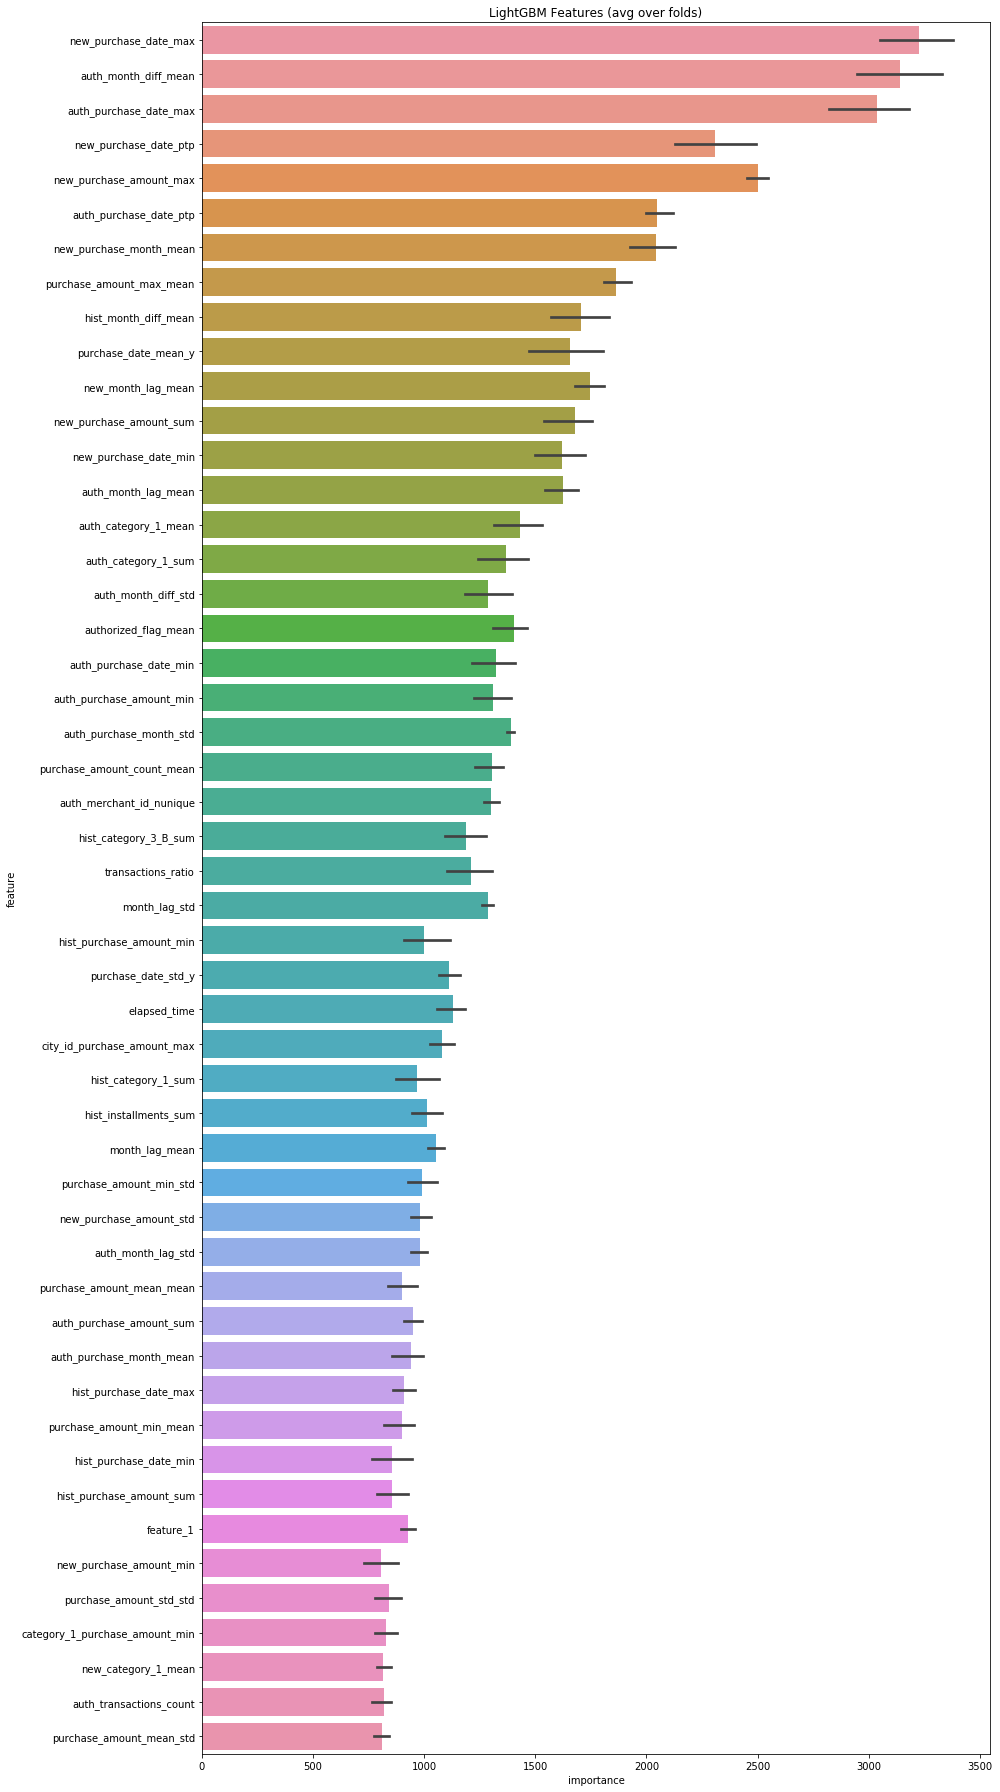

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
train_stack = np.vstack([oof_ridge, oof, oof_xgb]).transpose()
test_stack = np.vstack([predictions_ridge, predictions,predictions_xgb]).transpose()

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Ridge Regression" + str(fold_) + "-" * 10)
    clf = Ridge(alpha=75)
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


fold n°0
----------Ridge Regression0----------
fold n°1
----------Ridge Regression1----------
fold n°2
----------Ridge Regression2----------
fold n°3
----------Ridge Regression3----------
fold n°4
----------Ridge Regression4----------


In [ ]:
models = [
    'CatBoost',
    'RandomForest',
    'Lasso',
    'KNN',
    'LGB',
    'Ridge',
    'XGB',
    'Stack']
r = [np.sqrt(mean_squared_error(oof, target)),np.sqrt(mean_squared_error(oof_ridge, target)),np.sqrt(mean_squared_error(oof_xgb, target)),np.sqrt(mean_squared_error(oof_stack, target))]
scores+= r                                                                                         
                                                                                        

In [ ]:
df = pd.DataFrame({ 'Model': models, 'Error': scores })
df

Model     Error
0      CatBoost  3.695654
1  RandomForest  3.689313
2         Lasso  3.834030
3           KNN  3.887811
4           LGB  3.656308
5         Ridge  4.012539
6           XGB  3.664410
7         Stack  3.654606

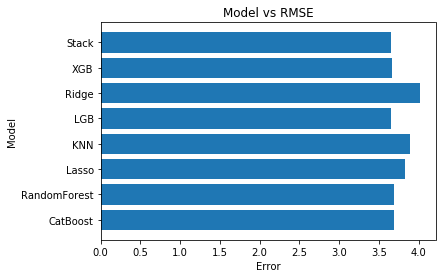

In [ ]:
import pandas as pd

plt.barh(df['Model'], df['Error'])
plt.title('Model vs RMSE')
plt.ylabel('Model')
plt.xlabel('Error')
plt.show()

In [ ]:
test1 = test.copy()
del test1['card_id']

In [ ]:

catboost_model.fit(train.values, target.values) 
predictions_cat = catboost_model.predict(test1.values)

0:	learn: 3.8631595	total: 196ms	remaining: 25.3s
1:	learn: 3.8557821	total: 393ms	remaining: 25.2s
2:	learn: 3.8486546	total: 594ms	remaining: 25.1s
3:	learn: 3.8421753	total: 793ms	remaining: 25s
4:	learn: 3.8358591	total: 1.03s	remaining: 25.8s
5:	learn: 3.8297121	total: 1.22s	remaining: 25.3s
6:	learn: 3.8239735	total: 1.42s	remaining: 25s
7:	learn: 3.8185210	total: 1.65s	remaining: 25.1s
8:	learn: 3.8133803	total: 1.84s	remaining: 24.7s
9:	learn: 3.8079151	total: 2.02s	remaining: 24.3s
10:	learn: 3.8026669	total: 2.23s	remaining: 24.1s
11:	learn: 3.7980061	total: 2.41s	remaining: 23.7s
12:	learn: 3.7935398	total: 2.63s	remaining: 23.7s
13:	learn: 3.7889362	total: 2.85s	remaining: 23.6s
14:	learn: 3.7855866	total: 3.06s	remaining: 23.5s
15:	learn: 3.7817910	total: 3.24s	remaining: 23.1s
16:	learn: 3.7776702	total: 3.45s	remaining: 22.9s
17:	learn: 3.7743787	total: 3.66s	remaining: 22.8s
18:	learn: 3.7710653	total: 3.87s	remaining: 22.6s
19:	learn: 3.7676466	total: 4.05s	remaining: 

<a id="5"></a> <br>
## 5. Submission
Now, we just need to prepare the submission file:

In [ ]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_xgb
sub_df.to_csv("submit1.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_stack
sub_df.to_csv("submit2.csv", index=False)

sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions_cat
sub_df.to_csv("submit3.csv", index=False)

In [ ]:
#[1050]	training's rmse: 3.47865	valid_1's rmse: 3.61203     CV score: 3.65527 